<a href="https://colab.research.google.com/github/a20121248/aprendizaje_automatico/blob/main/Tarea_Linear_models_20121248_JM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regresión Lineal
En este laboratorio experimentaremos con el modelo de regresión lineal múltiple, implementando su propio modelo y comparándolo con el de SciKit Learn

In [3]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 50)

In [4]:
#@title kc_house_data.csv
%%writefile kc_house_data.csv
id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
"7129300520","20141013T000000",221900,3,1,1180,5650,"1",0,0,3,7,1180,0,1955,0,"98178",47.5112,-122.257,1340,5650
"6414100192","20141209T000000",538000,3,2.25,2570,7242,"2",0,0,3,7,2170,400,1951,1991,"98125",47.721,-122.319,1690,7639
"5631500400","20150225T000000",180000,2,1,770,10000,"1",0,0,3,6,770,0,1933,0,"98028",47.7379,-122.233,2720,8062
"2487200875","20141209T000000",604000,4,3,1960,5000,"1",0,0,5,7,1050,910,1965,0,"98136",47.5208,-122.393,1360,5000
"1954400510","20150218T000000",510000,3,2,1680,8080,"1",0,0,3,8,1680,0,1987,0,"98074",47.6168,-122.045,1800,7503
"7237550310","20140512T000000",1.225e+006,4,4.5,5420,101930,"1",0,0,3,11,3890,1530,2001,0,"98053",47.6561,-122.005,4760,101930
"1321400060","20140627T000000",257500,3,2.25,1715,6819,"2",0,0,3,7,1715,0,1995,0,"98003",47.3097,-122.327,2238,6819
"2008000270","20150115T000000",291850,3,1.5,1060,9711,"1",0,0,3,7,1060,0,1963,0,"98198",47.4095,-122.315,1650,9711
"2414600126","20150415T000000",229500,3,1,1780,7470,"1",0,0,3,7,1050,730,1960,0,"98146",47.5123,-122.337,1780,8113
"3793500160","20150312T000000",323000,3,2.5,1890,6560,"2",0,0,3,7,1890,0,2003,0,"98038",47.3684,-122.031,2390,7570
"1736800520","20150403T000000",662500,3,2.5,3560,9796,"1",0,0,3,8,1860,1700,1965,0,"98007",47.6007,-122.145,2210,8925
"9212900260","20140527T000000",468000,2,1,1160,6000,"1",0,0,4,7,860,300,1942,0,"98115",47.69,-122.292,1330,6000
"0114101516","20140528T000000",310000,3,1,1430,19901,"1.5",0,0,4,7,1430,0,1927,0,"98028",47.7558,-122.229,1780,12697
"6054650070","20141007T000000",400000,3,1.75,1370,9680,"1",0,0,4,7,1370,0,1977,0,"98074",47.6127,-122.045,1370,10208
"1175000570","20150312T000000",530000,5,2,1810,4850,"1.5",0,0,3,7,1810,0,1900,0,"98107",47.67,-122.394,1360,4850
"9297300055","20150124T000000",650000,4,3,2950,5000,"2",0,3,3,9,1980,970,1979,0,"98126",47.5714,-122.375,2140,4000
"1875500060","20140731T000000",395000,3,2,1890,14040,"2",0,0,3,7,1890,0,1994,0,"98019",47.7277,-121.962,1890,14018
"6865200140","20140529T000000",485000,4,1,1600,4300,"1.5",0,0,4,7,1600,0,1916,0,"98103",47.6648,-122.343,1610,4300
"0016000397","20141205T000000",189000,2,1,1200,9850,"1",0,0,4,7,1200,0,1921,0,"98002",47.3089,-122.21,1060,5095
"7983200060","20150424T000000",230000,3,1,1250,9774,"1",0,0,4,7,1250,0,1969,0,"98003",47.3343,-122.306,1280,8850
"6300500875","20140514T000000",385000,4,1.75,1620,4980,"1",0,0,4,7,860,760,1947,0,"98133",47.7025,-122.341,1400,4980
"2524049179","20140826T000000",2e+006,3,2.75,3050,44867,"1",0,4,3,9,2330,720,1968,0,"98040",47.5316,-122.233,4110,20336
"7137970340","20140703T000000",285000,5,2.5,2270,6300,"2",0,0,3,8,2270,0,1995,0,"98092",47.3266,-122.169,2240,7005
"8091400200","20140516T000000",252700,2,1.5,1070,9643,"1",0,0,3,7,1070,0,1985,0,"98030",47.3533,-122.166,1220,8386
"3814700200","20141120T000000",329000,3,2.25,2450,6500,"2",0,0,4,8,2450,0,1985,0,"98030",47.3739,-122.172,2200,6865
"1202000200","20141103T000000",233000,3,2,1710,4697,"1.5",0,0,5,6,1710,0,1941,0,"98002",47.3048,-122.218,1030,4705
"1794500383","20140626T000000",937000,3,1.75,2450,2691,"2",0,0,3,8,1750,700,1915,0,"98119",47.6386,-122.36,1760,3573
"3303700376","20141201T000000",667000,3,1,1400,1581,"1.5",0,0,5,8,1400,0,1909,0,"98112",47.6221,-122.314,1860,3861
"5101402488","20140624T000000",438000,3,1.75,1520,6380,"1",0,0,3,7,790,730,1948,0,"98115",47.695,-122.304,1520,6235
"1873100390","20150302T000000",719000,4,2.5,2570,7173,"2",0,0,3,8,2570,0,2005,0,"98052",47.7073,-122.11,2630,6026
"8562750320","20141110T000000",580500,3,2.5,2320,3980,"2",0,0,3,8,2320,0,2003,0,"98027",47.5391,-122.07,2580,3980
"2426039314","20141201T000000",280000,2,1.5,1190,1265,"3",0,0,3,7,1190,0,2005,0,"98133",47.7274,-122.357,1390,1756
"0461000390","20140624T000000",687500,4,1.75,2330,5000,"1.5",0,0,4,7,1510,820,1929,0,"98117",47.6823,-122.368,1460,5000
"7589200193","20141110T000000",535000,3,1,1090,3000,"1.5",0,0,4,8,1090,0,1929,0,"98117",47.6889,-122.375,1570,5080
"7955080270","20141203T000000",322500,4,2.75,2060,6659,"1",0,0,3,7,1280,780,1981,0,"98058",47.4276,-122.157,2020,8720
"9547205180","20140613T000000",696000,3,2.5,2300,3060,"1.5",0,0,3,8,1510,790,1930,2002,"98115",47.6827,-122.31,1590,3264
"9435300030","20140528T000000",550000,4,1,1660,34848,"1",0,0,1,5,930,730,1933,0,"98052",47.6621,-122.132,2160,11467
"2768000400","20141230T000000",640000,4,2,2360,6000,"2",0,0,4,8,2360,0,1904,0,"98107",47.6702,-122.362,1730,4700
"7895500070","20150213T000000",240000,4,1,1220,8075,"1",0,0,2,7,890,330,1969,0,"98001",47.3341,-122.282,1290,7800
"2078500320","20140620T000000",605000,4,2.5,2620,7553,"2",0,0,3,8,2620,0,1996,0,"98056",47.5301,-122.18,2620,11884
"5547700270","20140715T000000",625000,4,2.5,2570,5520,"2",0,0,3,9,2570,0,2000,0,"98074",47.6145,-122.027,2470,5669
"7766200013","20140811T000000",775000,4,2.25,4220,24186,"1",0,0,3,8,2600,1620,1984,0,"98166",47.445,-122.347,2410,30617
"7203220400","20140707T000000",861990,5,2.75,3595,5639,"2",0,0,3,9,3595,0,2014,0,"98053",47.6848,-122.016,3625,5639
"9270200160","20141028T000000",685000,3,1,1570,2280,"2",0,0,3,7,1570,0,1922,0,"98119",47.6413,-122.364,1580,2640
"1432701230","20140729T000000",309000,3,1,1280,9656,"1",0,0,4,6,920,360,1959,0,"98058",47.4485,-122.175,1340,8808
"8035350320","20140718T000000",488000,3,2.5,3160,13603,"2",0,0,3,8,3160,0,2003,0,"98019",47.7443,-121.977,3050,9232
"8945200830","20150325T000000",210490,3,1,990,8528,"1",0,0,3,6,990,0,1966,0,"98023",47.3066,-122.371,1228,8840
"4178300310","20140716T000000",785000,4,2.5,2290,13416,"2",0,0,4,9,2290,0,1981,0,"98007",47.6194,-122.151,2680,13685
"9215400105","20150428T000000",450000,3,1.75,1250,5963,"1",0,0,4,7,1250,0,1953,0,"98115",47.6796,-122.301,970,5100
"0822039084","20150311T000000",1.35e+006,3,2.5,2753,65005,"1",1,2,5,9,2165,588,1953,0,"98070",47.4041,-122.451,2680,72513
"5245600105","20140916T000000",228000,3,1,1190,9199,"1",0,0,3,7,1190,0,1955,0,"98148",47.4258,-122.322,1190,9364
"7231300125","20150217T000000",345000,5,2.5,3150,9134,"1",0,0,4,8,1640,1510,1966,0,"98056",47.4934,-122.189,1990,9133
"7518505990","20141231T000000",600000,3,1.75,1410,4080,"1",0,0,4,7,1000,410,1950,0,"98117",47.6808,-122.384,1410,4080
"3626039271","20150205T000000",585000,2,1.75,1980,8550,"1",0,0,3,7,990,990,1981,0,"98117",47.6989,-122.369,1480,6738
"4217401195","20150303T000000",920000,5,2.25,2730,6000,"1.5",0,0,3,8,2130,600,1927,0,"98105",47.6571,-122.281,2730,6000
"9822700295","20140512T000000",885000,4,2.5,2830,5000,"2",0,0,3,9,2830,0,1995,0,"98105",47.6597,-122.29,1950,5000
"9478500640","20140819T000000",292500,4,2.5,2250,4495,"2",0,0,3,7,2250,0,2008,0,"98042",47.3663,-122.114,2250,4500
"2799800710","20150407T000000",301000,3,2.5,2420,4750,"2",0,0,3,8,2420,0,2003,0,"98042",47.3663,-122.122,2690,4750
"7922800400","20140827T000000",951000,5,3.25,3250,14342,"2",0,4,4,8,3250,0,1968,0,"98008",47.588,-122.116,2960,11044
"8079040320","20150223T000000",430000,4,3,1850,9976,"2",0,0,3,8,1850,0,1991,0,"98059",47.5059,-122.149,2270,8542
"1516000055","20141210T000000",650000,3,2.25,2150,21235,"1",0,3,4,8,1590,560,1959,0,"98166",47.4336,-122.339,2570,18900
"9558200045","20140828T000000",289000,3,1.75,1260,8400,"1",0,0,3,7,1260,0,1954,0,"98148",47.4366,-122.335,1290,8750
"5072410070","20141021T000000",505000,3,1.75,2519,8690,"2",0,0,5,8,2519,0,1973,0,"98166",47.4428,-122.344,2500,9500
"9528102996","20141207T000000",549000,3,1.75,1540,1044,"3",0,0,3,8,1540,0,2014,0,"98115",47.6765,-122.32,1580,3090
"1189001180","20140603T000000",425000,3,2.25,1660,6000,"1",0,0,3,7,1110,550,1979,0,"98122",47.6113,-122.297,1440,4080
"3253500160","20141120T000000",317625,3,2.75,2770,3809,"1.5",0,0,5,7,1770,1000,1925,0,"98144",47.5747,-122.304,1440,4000
"3394100030","20140909T000000",975000,4,2.5,2720,11049,"2",0,0,3,10,2720,0,1989,0,"98004",47.5815,-122.192,2750,11049
"3717000160","20141009T000000",287000,4,2.5,2240,4648,"2",0,0,3,7,2240,0,2005,0,"98001",47.3378,-122.257,2221,4557
"1274500060","20140825T000000",204000,3,1,1000,12070,"1",0,0,4,7,1000,0,1968,0,"98042",47.3621,-122.11,1010,12635
"1802000060","20140612T000000",1.325e+006,5,2.25,3200,20158,"1",0,0,3,8,1600,1600,1965,0,"98004",47.6303,-122.215,3390,20158
"1525059190","20140912T000000",1.04e+006,5,3.25,4770,50094,"1",0,0,4,11,3070,1700,1973,0,"98005",47.6525,-122.16,3530,38917
"1049000060","20150105T000000",325000,3,2,1260,5612,"1",0,0,4,7,1260,0,1972,0,"98034",47.7362,-122.179,1640,4745
"8820901275","20140610T000000",571000,4,2,2750,7807,"1.5",0,0,5,7,2250,500,1916,0,"98125",47.7168,-122.287,1510,7807
"5416510140","20140710T000000",360000,4,2.5,2380,5000,"2",0,0,3,8,2380,0,2005,0,"98038",47.3608,-122.036,2420,5000
"3444100400","20150316T000000",349000,3,1.75,1790,50529,"1",0,0,5,7,1090,700,1965,0,"98042",47.3511,-122.073,1940,50529
"3276920270","20141105T000000",832500,4,4,3430,35102,"2",0,0,4,10,2390,1040,1986,0,"98075",47.5822,-121.987,3240,35020
"4036801170","20141013T000000",380000,4,1.75,1760,7300,"1",0,0,3,7,880,880,1956,0,"98008",47.6034,-122.125,1680,7500
"2391600320","20150420T000000",480000,3,1,1040,5060,"1",0,0,3,7,1040,0,1941,0,"98116",47.5636,-122.394,890,5060
"6300000287","20140609T000000",410000,3,1,1410,5060,"1",0,0,4,7,910,500,1956,0,"98133",47.7073,-122.34,1130,5693
"1531000030","20150323T000000",720000,4,2.5,3450,39683,"2",0,0,3,10,3450,0,2002,0,"98010",47.342,-122.025,3350,39750
"5104520400","20141202T000000",390000,3,2.5,2350,5100,"2",0,0,3,8,2350,0,2003,0,"98038",47.3512,-122.008,2350,5363
"7437100340","20141222T000000",360000,4,2.5,1900,5889,"2",0,0,3,7,1900,0,1992,0,"98038",47.349,-122.031,1870,6405
"9418400240","20141028T000000",355000,2,1,2020,6720,"1",0,0,3,7,1010,1010,1948,0,"98118",47.5474,-122.291,1720,6720
"1523059105","20150128T000000",356000,3,1.5,1680,8712,"1",0,0,3,8,1680,0,1964,0,"98059",47.4811,-122.149,1850,8797
"1133000671","20140602T000000",315000,3,1,960,6634,"1",0,0,3,6,960,0,1952,0,"98125",47.7264,-122.31,1570,7203
"4232902595","20141114T000000",940000,3,1.5,2140,3600,"2",0,0,3,9,1900,240,1925,0,"98119",47.6337,-122.365,2020,4800
"2599001200","20141103T000000",305000,5,2.25,2660,8400,"1.5",0,0,5,7,2660,0,1961,0,"98092",47.2909,-122.189,1590,8165
"3342103156","20140618T000000",461000,3,3.25,2770,6278,"2",0,0,3,9,1980,790,2006,0,"98056",47.5228,-122.199,1900,7349
"1332700270","20140519T000000",215000,2,2.25,1610,2040,"2",0,0,4,7,1610,0,1979,0,"98056",47.518,-122.194,1950,2025
"3869900162","20140904T000000",335000,2,1.75,1030,1066,"2",0,0,3,7,765,265,2006,0,"98136",47.5394,-122.387,1030,1106
"2791500270","20140522T000000",243500,4,2.5,1980,7403,"2",0,0,3,7,1980,0,1988,0,"98023",47.2897,-122.372,1980,7510
"5036300431","20150311T000000",1.09988e+006,5,2.75,3520,6353,"2",0,0,4,10,3520,0,2001,0,"98199",47.6506,-122.391,2520,6250
"4168000060","20150226T000000",153000,3,1,1200,10500,"1",0,0,3,7,1200,0,1962,0,"98023",47.322,-122.351,1350,10500
"6021501535","20140725T000000",430000,3,1.5,1580,5000,"1",0,0,3,8,1290,290,1939,0,"98117",47.687,-122.386,1570,4500
"6021501535","20141223T000000",700000,3,1.5,1580,5000,"1",0,0,3,8,1290,290,1939,0,"98117",47.687,-122.386,1570,4500
"1483300570","20140908T000000",905000,4,2.5,3300,10250,"1",0,0,3,7,2390,910,1946,1991,"98040",47.5873,-122.249,1950,6045
"3422049190","20150330T000000",247500,3,1.75,1960,15681,"1",0,0,3,7,1960,0,1967,0,"98032",47.3576,-122.277,1750,15616
"1099611230","20140912T000000",199000,4,1.5,1160,6400,"1",0,0,4,7,1160,0,1975,0,"98023",47.3036,-122.378,1160,6400
"0722079104","20140711T000000",314000,3,1.75,1810,41800,"1",0,0,5,7,1210,600,1980,0,"98038",47.4109,-121.958,1650,135036
"7338200240","20140516T000000",437500,3,2.5,2320,36847,"2",0,2,3,9,2320,0,1992,0,"98045",47.4838,-121.714,2550,35065
"1952200240","20140611T000000",850830,3,2.5,2070,13241,"1.5",0,0,5,9,1270,800,1910,0,"98102",47.6415,-122.315,2200,4500
"5200100125","20141027T000000",555000,3,2,1980,3478,"1.5",0,0,4,7,1440,540,1929,0,"98117",47.6775,-122.372,1610,3478
"7214720075","20141212T000000",699950,3,2.25,2190,107593,"2",0,0,4,8,2190,0,1983,0,"98077",47.7731,-122.08,2570,47777
"2450000295","20141007T000000",1.088e+006,3,2.5,2920,8113,"2",0,0,3,8,2920,0,1950,2010,"98004",47.5814,-122.196,2370,8113
"6197800045","20140924T000000",290000,3,1,1210,33919,"1",0,0,3,7,1210,0,1954,0,"98058",47.4375,-122.184,1640,14910
"1328310370","20150402T000000",375000,3,2.5,2340,10005,"1",0,0,4,8,1460,880,1978,0,"98058",47.4431,-122.133,2250,8162
"0546000875","20140523T000000",460000,3,1,1670,4005,"1.5",0,0,4,7,1170,500,1939,0,"98117",47.6878,-122.38,1240,4005
"3530510041","20140723T000000",188500,2,1.75,1240,2493,"1",0,0,4,8,1240,0,1985,0,"98198",47.3813,-122.322,1270,4966
"1853000400","20150305T000000",680000,4,2.5,3140,28037,"2",0,0,4,10,3140,0,1991,0,"98077",47.7304,-122.082,2990,35001
"3134100116","20140827T000000",470000,5,1.75,2030,12342,"2",0,0,4,7,2030,0,1942,0,"98052",47.6417,-122.109,2500,9433
"9545230140","20140725T000000",597750,4,2.5,2310,9624,"2",0,0,3,8,2310,0,1984,0,"98027",47.5386,-122.053,1940,9636
"3362400511","20150304T000000",570000,3,1.75,1260,3328,"1",0,0,5,6,700,560,1905,0,"98103",47.6823,-122.349,1380,3536
"2525310310","20140916T000000",272500,3,1.75,1540,12600,"1",0,0,4,7,1160,380,1980,0,"98038",47.3624,-122.031,1540,11656
"6126500060","20141124T000000",329950,3,1.75,2080,5969,"1",0,2,3,7,1080,1000,1971,0,"98108",47.5474,-122.295,2090,5500
"8961960160","20141028T000000",480000,4,2.5,3230,16171,"2",0,3,3,9,2520,710,2001,0,"98001",47.3183,-122.253,2640,8517
"3626039325","20141121T000000",740500,3,3.5,4380,6350,"2",0,0,3,8,2780,1600,1900,1999,"98117",47.6981,-122.368,1830,6350
"3362400431","20140626T000000",518500,3,3.5,1590,1102,"3",0,0,3,8,1590,0,2010,0,"98103",47.6824,-122.347,1620,3166
"4060000240","20140623T000000",205425,2,1,880,6780,"1",0,0,4,6,880,0,1945,0,"98178",47.5009,-122.248,1190,6780
"3454800060","20150108T000000",171800,4,2,1570,9600,"1",0,0,3,6,1570,0,1950,0,"98168",47.4965,-122.303,1880,9000
"1695900060","20150511T000000",535000,4,1,1610,2982,"1.5",0,0,4,7,1610,0,1925,0,"98144",47.587,-122.294,1610,4040
"7278700070","20150102T000000",660000,3,2.5,2400,6474,"1",0,2,3,8,1560,840,1964,0,"98177",47.7728,-122.386,2340,10856
"6675500070","20141119T000000",391500,3,2,1450,9132,"1",0,0,3,7,1450,0,1987,0,"98034",47.7288,-122.226,1580,9104
"3626039187","20150406T000000",395000,2,1,770,6000,"1",0,0,3,6,770,0,1953,0,"98117",47.6999,-122.364,1710,6000
"3524049083","20141104T000000",445000,4,1.75,2100,4400,"1.5",0,0,5,7,1720,380,1924,0,"98118",47.5299,-122.266,1850,4400
"3275860240","20140618T000000",770000,3,2.25,2910,10204,"2",0,0,3,9,2910,0,1990,0,"98052",47.6897,-122.098,2700,13992
"4389200955","20150302T000000",1.45e+006,4,2.75,2750,17789,"1.5",0,0,3,8,1980,770,1914,1992,"98004",47.6141,-122.212,3060,11275
"4058801670","20140717T000000",445000,3,2.25,2100,8201,"1",0,2,3,8,1620,480,1967,0,"98178",47.5091,-122.244,2660,8712
"8732020310","20140717T000000",260000,4,2.25,2160,8811,"1",0,0,3,8,1360,800,1978,0,"98023",47.3129,-122.39,2090,8400
"2331300505","20140613T000000",822500,5,3.5,2320,4960,"2",0,0,5,7,1720,600,1926,0,"98103",47.6763,-122.352,1700,4960
"7853210060","20150406T000000",430000,4,2.5,2070,4310,"2",0,0,3,7,2070,0,2004,0,"98065",47.5319,-121.85,1970,3748
"3668000070","20150105T000000",212000,3,1.75,1060,7875,"1",0,0,4,7,1060,0,1986,0,"98092",47.2761,-122.152,1420,7680
"9545240070","20150428T000000",660500,4,2.25,2010,9603,"1",0,0,3,8,1440,570,1986,0,"98027",47.5343,-122.054,2060,9793
"1243100136","20140612T000000",784000,3,3.5,3950,111078,"1.5",0,0,3,9,2460,1490,1989,0,"98052",47.697,-122.072,2480,88500
"8929000270","20140512T000000",453246,3,2.5,2010,2287,"2",0,0,3,8,1390,620,2014,0,"98029",47.5517,-121.998,1690,1662
"2767602356","20150126T000000",675000,4,3.5,2140,2278,"3",0,0,3,9,2140,0,2005,0,"98107",47.6734,-122.38,1540,2285
"0921049315","20140813T000000",199000,3,1.75,1320,17390,"1",0,0,4,7,1320,0,1956,0,"98003",47.3257,-122.296,1550,19265
"3655000070","20140805T000000",220000,4,1.75,2020,7840,"1",0,0,3,7,1010,1010,1968,0,"98003",47.3309,-122.299,1750,8140
"4027700812","20140529T000000",452000,4,2.25,2590,10002,"1",0,0,4,8,1340,1250,1968,0,"98028",47.7689,-122.266,1550,10436
"3992700335","20140707T000000",382500,2,1,1190,4440,"1",0,0,3,6,1190,0,1981,0,"98125",47.7135,-122.287,1060,5715
"2767603505","20140507T000000",519950,3,2.25,1170,1249,"3",0,0,3,8,1170,0,2014,0,"98107",47.6722,-122.381,1350,1310
"4232901525","20140627T000000",665000,2,1,1110,3200,"1",0,0,3,7,1110,0,1925,0,"98119",47.6338,-122.358,1170,3600
"1777500060","20140708T000000",527700,5,2.5,2820,9375,"1",0,0,4,8,1550,1270,1968,0,"98006",47.5707,-122.128,2820,9375
"1432900240","20150508T000000",205000,3,1,1610,8579,"1",0,0,4,7,1010,600,1962,0,"98058",47.4563,-122.171,1610,8579
"6140100875","20150415T000000",420000,3,1,1060,8097,"1",0,0,4,7,940,120,1923,0,"98133",47.7144,-122.351,1560,7940
"6071600370","20150227T000000",500000,4,2.25,2030,8517,"1",0,0,4,8,1380,650,1961,0,"98006",47.5495,-122.174,2230,8824
"1526069017","20141203T000000",921500,4,2.5,3670,315374,"2",0,0,4,9,3670,0,1994,0,"98077",47.7421,-122.026,2840,87991
"0809001525","20140625T000000",890000,4,1,2550,4000,"2",0,0,3,8,2370,180,1905,0,"98109",47.6354,-122.353,2200,4000
"3224079105","20140806T000000",430000,2,2.5,2420,60984,"2",0,0,3,7,2420,0,2007,0,"98027",47.5262,-121.943,1940,193842
"8075400570","20141030T000000",258000,5,2,2260,12500,"1",0,0,4,8,1130,1130,1960,0,"98032",47.3887,-122.286,1360,18000
"1994200024","20141104T000000",511000,3,1,1430,3455,"1",0,0,3,7,980,450,1947,0,"98103",47.6873,-122.336,1450,4599
"3362900810","20140820T000000",532170,3,2,1360,3090,"2",0,0,3,8,1360,0,1990,0,"98103",47.6838,-122.353,1500,3090
"1324300398","20150409T000000",560000,3,1,1110,5000,"1.5",0,0,3,7,1110,0,1947,0,"98107",47.655,-122.359,1420,5000
"0537000445","20150331T000000",282950,3,1,1250,8200,"1",0,0,4,7,1250,0,1954,0,"98003",47.3255,-122.304,1680,8633
"7855801670","20150401T000000",2.25e+006,4,3.25,5180,19850,"2",0,3,3,12,3540,1640,2006,0,"98006",47.562,-122.162,3160,9750
"7920100045","20140516T000000",350000,1,1,700,5100,"1",0,0,3,7,700,0,1942,0,"98115",47.679,-122.3,1010,5100
"8960000030","20140728T000000",215000,3,1,1180,7669,"1",0,0,4,7,1180,0,1967,0,"98058",47.4479,-122.176,1190,7669
"6388930390","20141120T000000",650000,5,3.5,3960,25245,"2",0,0,3,9,2500,1460,1996,0,"98056",47.525,-122.172,2640,13675
"8731900200","20140807T000000",320000,4,2.75,2640,7500,"1",0,0,3,8,1620,1020,1967,0,"98023",47.3135,-122.369,1980,7875
"8029200135","20141113T000000",247000,3,2,1270,7198,"1.5",0,0,3,7,1270,0,1916,2013,"98022",47.2086,-121.996,1160,7198
"1081200350","20141003T000000",320000,4,1.75,1760,11180,"1",0,0,4,8,1760,0,1968,0,"98059",47.4715,-122.118,1730,11180
"0084000105","20140507T000000",255000,5,2.25,2060,8632,"1",0,0,3,7,1030,1030,1962,0,"98146",47.4877,-122.335,1010,11680
"3756500060","20150309T000000",438000,3,1.75,1780,9660,"1",0,0,3,7,1780,0,1962,0,"98034",47.7171,-122.193,1200,9660
"7215720160","20150304T000000",900000,3,2.5,3400,16603,"2",0,0,3,10,3400,0,2000,0,"98075",47.6012,-122.023,3400,12601
"3574800520","20140620T000000",441000,3,2.75,1910,7280,"1",0,0,3,7,1160,750,1979,0,"98034",47.7319,-122.224,1710,8152
"2617300160","20140812T000000",420000,3,2,2020,38332,"1",0,0,4,7,1010,1010,1975,0,"98027",47.4582,-122.023,2110,36590
"2558660270","20141208T000000",370000,3,1.75,1580,7000,"1",0,0,3,7,1180,400,1976,0,"98034",47.7209,-122.168,1640,7500
"2009000370","20150219T000000",269950,2,1.75,1340,7250,"1",0,0,5,5,700,640,1949,0,"98198",47.408,-122.327,1830,9750
"1836980160","20150324T000000",807100,4,2.5,2680,4499,"2",0,0,3,9,2680,0,1999,0,"98006",47.565,-122.125,2920,4500
"3261020370","20140605T000000",653000,3,2.5,2680,9750,"1",0,0,4,8,1610,1070,1979,0,"98034",47.7028,-122.231,2480,8750
"1755700060","20140611T000000",371500,3,2,1370,8336,"1",0,0,5,7,1370,0,1964,0,"98133",47.7458,-122.331,1770,7288
"4330600435","20150316T000000",284000,3,1.75,1560,21000,"1",0,0,3,7,1560,0,1954,0,"98166",47.4776,-122.337,1070,7920
"9542800700","20150102T000000",272000,3,1.75,2160,7140,"1",0,0,4,7,1670,490,1978,0,"98023",47.3026,-122.374,1930,7350
"1999700045","20140502T000000",313000,3,1.5,1340,7912,"1.5",0,0,3,7,1340,0,1955,0,"98133",47.7658,-122.339,1480,7940
"1762600070","20150116T000000",917500,4,2.5,3880,35003,"2",0,0,3,10,2570,1310,1984,0,"98033",47.6477,-122.182,3740,35230
"1687900520","20140929T000000",673000,4,2.25,2590,8190,"2",0,0,4,8,2590,0,1980,0,"98006",47.5619,-122.125,2260,8335
"7234600798","20150210T000000",425000,3,2.5,1120,1100,"2",0,0,3,8,820,300,2008,0,"98122",47.6106,-122.31,1590,1795
"3881900445","20140709T000000",399950,5,2.75,1970,5400,"1",0,0,3,7,1320,650,1986,0,"98144",47.5868,-122.308,1280,2150
"2254502445","20140530T000000",385000,3,1,1220,4800,"1",0,0,3,6,1220,0,1901,0,"98122",47.6101,-122.307,1200,4800
"5437810320","20141117T000000",269950,3,1.5,1950,7560,"1",0,2,4,7,1320,630,1975,0,"98022",47.1976,-121.999,1950,8941
"9158100075","20150107T000000",330000,2,1,1350,8220,"1",0,0,3,7,1060,290,1949,0,"98177",47.7224,-122.358,1540,8280
"3830630310","20140725T000000",260000,3,2.5,1670,5797,"2",0,0,3,7,1670,0,1988,0,"98030",47.3505,-122.179,1670,6183
"8123100045","20150414T000000",470000,4,3,2380,5125,"1.5",0,0,4,7,1680,700,1925,0,"98126",47.5384,-122.376,1410,5375
"3127200041","20140613T000000",589000,4,3,2440,9600,"2",0,0,5,7,2440,0,1961,0,"98034",47.7044,-122.2,2290,9600
"6661200320","20140723T000000",163500,2,1.5,1050,3419,"2",0,0,3,7,1050,0,1996,0,"98038",47.3848,-122.039,1050,3417
"0011510310","20140905T000000",835000,4,2.75,3130,13412,"2",0,0,3,9,2140,990,1993,0,"98052",47.6993,-122.102,2260,9984
"0825059270","20141121T000000",1.095e+006,5,3,4090,12850,"1",0,2,4,10,2090,2000,1986,0,"98033",47.6627,-122.188,2540,10270
"8731951370","20150415T000000",269000,4,1.75,1490,10000,"1",0,0,4,8,1100,390,1969,0,"98023",47.3099,-122.379,2190,8910
"1954440060","20140505T000000",560000,3,2.5,1900,8744,"2",0,0,3,8,1900,0,1987,0,"98074",47.62,-122.043,2030,8744
"2264500350","20150418T000000",615000,4,1,1330,2400,"1.5",0,0,4,6,1330,0,1901,0,"98103",47.65,-122.34,1330,4400
"1115810060","20141205T000000",585188,3,2.25,2230,10026,"1",0,0,3,8,1430,800,1975,0,"98052",47.6647,-122.153,2230,9340
"9477200200","20140818T000000",305000,3,1.75,1650,9480,"1",0,0,3,7,1220,430,1977,0,"98034",47.726,-122.191,1540,8400
"1432600560","20141105T000000",166950,3,1,1190,8820,"1",0,0,3,6,1190,0,1959,0,"98058",47.4616,-122.184,1230,7980
"2287000060","20140912T000000",799000,3,2.5,2140,9897,"1",0,0,4,8,2140,0,1959,0,"98040",47.5505,-122.219,2680,10083
"3663500060","20140625T000000",400000,3,2.5,2180,7508,"1",0,0,4,7,1420,760,1962,0,"98133",47.7606,-122.336,1900,7818
"3996900125","20141201T000000",230000,3,1,1060,10228,"1",0,0,3,7,1060,0,1948,0,"98155",47.7481,-122.3,1570,10228
"7796450200","20140515T000000",256883,3,2.5,1690,5025,"2",0,0,3,8,1690,0,2003,0,"98023",47.2779,-122.347,2550,5001
"7549802535","20141111T000000",423000,4,2,1970,6480,"1.5",0,0,5,7,1130,840,1920,0,"98108",47.5511,-122.312,1500,6480
"3278600320","20140723T000000",465000,3,2.5,2150,4084,"2",0,0,3,8,2150,0,2007,0,"98126",47.5488,-122.372,1750,2385
"2824079053","20150113T000000",440000,3,2.5,1910,66211,"2",0,0,3,7,1910,0,1997,0,"98024",47.5385,-121.911,2330,67268
"1222069094","20141014T000000",385000,3,1.75,1350,155073,"1",0,0,4,7,1350,0,1969,0,"98038",47.4058,-121.994,1560,50965
"3542300060","20150311T000000",210000,3,1,860,11725,"1",0,0,4,6,860,0,1943,0,"98056",47.5093,-122.184,1300,9514
"2222059065","20141112T000000",297000,3,2.5,1940,14952,"2",0,0,3,8,1940,0,1994,0,"98042",47.3777,-122.165,2030,10450
"7551300060","20140716T000000",470000,3,1,1010,5000,"1",0,0,3,7,1010,0,1952,0,"98107",47.675,-122.394,1680,5000
"0100600550","20140804T000000",226500,3,1.5,1300,7370,"1",0,0,4,7,900,400,1976,0,"98023",47.3025,-122.37,1430,7500
"3211100860","20150303T000000",274250,3,1,910,8450,"1",0,0,4,6,910,0,1962,0,"98059",47.4787,-122.158,1400,8040
"3456000310","20140804T000000",840000,4,1.75,2480,11010,"1",0,0,4,9,1630,850,1966,0,"98040",47.5378,-122.219,2770,10744
"9526600140","20140919T000000",677900,3,2.5,2440,4587,"2",0,0,3,8,2440,0,2010,0,"98052",47.7073,-122.114,2750,4587
"7465900060","20150205T000000",425000,3,1,1010,5864,"1",0,0,3,7,1010,0,1915,0,"98116",47.5733,-122.381,1290,5000
"1222000055","20141123T000000",180250,2,0.75,900,9600,"1",0,0,3,6,900,0,1941,0,"98166",47.4604,-122.339,1250,14280
"6300000550","20140717T000000",464000,6,3,2300,3404,"2",0,0,3,7,1600,700,1920,1994,"98133",47.7067,-122.343,1560,1312
"2310030510","20150422T000000",320000,4,2.25,1550,7579,"2",0,0,3,8,1550,0,1993,0,"98038",47.354,-122.047,1630,6397
"1025049114","20140717T000000",625504,3,2.25,1270,1566,"2",0,0,3,8,1060,210,2014,0,"98105",47.6647,-122.284,1160,1327
"8677300550","20140515T000000",592500,4,2.5,2240,12032,"1",0,0,3,9,2240,0,1983,0,"98074",47.6143,-122.017,2520,12368
"4014400292","20150114T000000",465000,3,2.5,2714,17936,"2",0,0,3,9,2714,0,2005,0,"98001",47.3185,-122.275,2590,18386
"1102000196","20140527T000000",477000,4,2.75,1720,6270,"2",0,0,3,8,1720,0,1978,0,"98118",47.5458,-122.268,2130,8700
"0257000138","20150115T000000",280000,2,1,850,16400,"1",0,0,3,6,850,0,1923,0,"98168",47.4889,-122.299,1100,14459
"0046100204","20150221T000000",1.505e+006,5,3,3300,33474,"1",0,3,3,9,1870,1430,1957,1991,"98040",47.5673,-122.21,3836,20953
"1909600046","20140703T000000",445838,3,2.5,2250,5692,"2",0,0,3,8,2250,0,2000,0,"98146",47.5133,-122.379,1320,5390
"1250202145","20140828T000000",1.072e+006,2,2.25,3900,14864,"1",0,3,3,8,1950,1950,1947,0,"98144",47.5884,-122.291,2580,5184
"7611200125","20141023T000000",467000,2,1.5,1320,10800,"1",0,0,4,8,1320,0,1947,0,"98177",47.7145,-122.367,2120,12040
"5611500140","20140822T000000",686000,4,2.5,2760,6440,"2",0,0,3,10,2760,0,1999,0,"98075",47.5836,-122.026,3070,8127
"7138000260","20140605T000000",279950,3,2,1750,9750,"1",0,0,3,7,1350,400,1961,0,"98198",47.398,-122.299,1900,10125
"0626059335","20140904T000000",527000,4,2.25,2330,19436,"2",0,0,3,8,2330,0,1987,0,"98011",47.7663,-122.215,1910,10055
"1922059282","20140918T000000",325000,3,2.25,2220,16020,"1",0,0,4,8,1780,440,1966,0,"98030",47.3758,-122.217,2080,9583
"0705700390","20140903T000000",328000,3,2.25,2020,8379,"2",0,0,3,7,2020,0,1994,0,"98038",47.3828,-122.023,2020,8031
"7454001200","20140604T000000",390000,3,2.25,1250,7500,"1",0,0,5,7,1250,0,1942,0,"98146",47.5123,-122.373,1280,7392
"8682281200","20150309T000000",479950,2,2,1510,6516,"1",0,0,3,8,1510,0,2005,0,"98053",47.7076,-122.013,1640,6009
"7972000200","20140529T000000",264950,4,2.25,1720,9753,"1",0,0,4,7,1120,600,1978,0,"98023",47.2922,-122.371,1510,9753
"0722059070","20150115T000000",235000,3,1,1430,15246,"1",0,0,4,7,980,450,1961,0,"98031",47.4075,-122.214,1960,13068
"7202340400","20150303T000000",516500,3,2.5,1480,4729,"2",0,0,3,7,1480,0,2004,0,"98053",47.6794,-122.034,2250,4729
"8096000060","20150413T000000",655000,2,1.75,1450,15798,"2",1,4,3,7,1230,220,1915,1978,"98166",47.4497,-122.375,2030,13193
"2424000060","20140616T000000",500000,4,2.75,2280,15347,"1",0,0,5,7,2280,0,1960,0,"98059",47.5218,-122.164,2280,15347
"9264902050","20141121T000000",315000,6,2.75,2940,7350,"1",0,0,3,8,1780,1160,1978,0,"98023",47.3103,-122.339,2120,8236
"0943100260","20141120T000000",213000,2,1,1000,10200,"1",0,0,3,6,1000,0,1961,0,"98024",47.5687,-121.899,1150,13702
"3677400445","20140902T000000",475000,3,1.5,2480,5280,"1.5",0,0,5,7,1620,860,1947,0,"98108",47.5575,-122.303,2090,4800
"1762600320","20140610T000000",1.025e+006,5,4,3760,28040,"2",0,0,3,10,3760,0,1983,0,"98033",47.6489,-122.183,3430,35096
"4058000060","20150409T000000",416000,3,2,2220,94300,"1",0,0,5,7,1640,580,1976,0,"98010",47.3459,-121.95,2070,80100
"7228500560","20150320T000000",410000,4,1,1970,4740,"1.5",0,0,3,7,1670,300,1904,2005,"98122",47.6136,-122.303,1510,4740
"0326069104","20140701T000000",800000,3,3.5,3830,221284,"2",0,0,3,10,3530,300,1993,0,"98077",47.7641,-122.023,2920,148539
"5152100060","20140529T000000",472000,6,2.5,4410,14034,"1",0,2,4,9,2350,2060,1965,0,"98003",47.3376,-122.324,2600,13988
"3584000310","20141208T000000",225000,3,1.75,1430,8505,"1",0,0,4,7,1430,0,1968,0,"98003",47.3173,-122.319,1190,8640
"8150100045","20141001T000000",210000,2,1,830,6000,"1",0,0,3,6,830,0,1940,0,"98126",47.5308,-122.376,830,4960
"1868901275","20150127T000000",455000,2,1,1430,5000,"1.5",0,0,2,7,1430,0,1925,0,"98115",47.6727,-122.299,1450,3750
"6131600075","20150427T000000",225000,3,1,1300,8316,"1",0,0,4,6,1300,0,1954,0,"98002",47.3221,-122.216,1260,8316
"9468200125","20140826T000000",480000,2,1,1030,3060,"1",0,2,4,7,790,240,1918,0,"98103",47.6779,-122.353,1390,3060
"8029510030","20150212T000000",363000,3,2.5,2740,11872,"2",0,0,3,9,2740,0,1990,0,"98023",47.3076,-122.395,2570,10377
"2025069065","20140929T000000",2.4e+006,4,2.5,3650,8354,"1",1,4,3,9,1830,1820,2000,0,"98074",47.6338,-122.072,3120,18841
"7899800890","20150226T000000",181000,2,1.5,720,5120,"1",0,0,3,6,720,0,1954,0,"98106",47.5218,-122.357,1150,2566
"3021059276","20150314T000000",250000,4,2,2010,7312,"1",0,0,4,7,2010,0,1976,0,"98002",47.2785,-122.213,2010,7650
"3797001895","20150422T000000",481000,3,1.75,1560,3000,"1",0,0,4,6,770,790,1918,0,"98103",47.6846,-122.345,1390,3000
"3832710960","20140923T000000",260000,3,2,1810,7209,"1",0,0,4,7,1240,570,1978,0,"98032",47.3656,-122.278,1750,7209
"1310430400","20140513T000000",455000,4,2.5,3360,7685,"2",0,0,3,9,3360,0,2001,0,"98058",47.4369,-122.111,3060,6567
"1422300030","20150401T000000",415000,3,2.25,1510,36224,"2",0,0,3,8,1510,0,1991,0,"98045",47.4616,-121.711,1730,36224
"1105000588","20150421T000000",349500,3,1,1400,3538,"1",0,0,3,7,800,600,1953,0,"98118",47.5405,-122.27,1620,6331
"3830630060","20140929T000000",245000,3,2.5,1730,7442,"2",0,0,3,7,1730,0,1987,0,"98030",47.3507,-122.178,1630,6458
"5101404898","20140519T000000",592500,2,2,1420,9191,"1.5",0,2,5,7,1420,0,1928,0,"98115",47.6979,-122.32,1420,6816
"7972601890","20141020T000000",385000,4,1.75,2360,7620,"1",0,0,4,7,1180,1180,1955,0,"98106",47.5278,-122.345,1910,7620
"5127001620","20150211T000000",315000,3,1.75,1580,11455,"1",0,0,4,7,1200,380,1974,0,"98059",47.4756,-122.147,1550,10650
"9407100800","20141124T000000",255000,3,1,1230,10170,"1",0,0,3,7,1230,0,1979,0,"98045",47.4437,-121.772,1380,10098
"1873100060","20140829T000000",693000,4,2.5,2460,4425,"2",0,0,3,8,2460,0,2006,0,"98052",47.7048,-122.109,2990,5659
"8722101360","20141202T000000",780000,3,1,1660,4400,"1.5",0,0,3,8,1460,200,1911,0,"98112",47.6362,-122.302,1660,4400
"8644000060","20141024T000000",237000,3,1.75,1270,8470,"1",0,0,4,7,1270,0,1960,0,"98198",47.4207,-122.29,1600,8470
"3325069129","20141216T000000",525000,3,2.25,2100,40510,"2",0,0,3,10,1320,780,1979,0,"98074",47.6154,-122.047,2380,33450
"1400300055","20150428T000000",425000,2,1,770,5040,"1",0,0,3,5,770,0,1930,0,"98144",47.5964,-122.299,1330,2580
"2123039032","20141027T000000",369900,1,0.75,760,10079,"1",1,4,5,5,760,0,1936,0,"98070",47.4683,-122.438,1230,14267
"8078560140","20140519T000000",290000,4,2.5,1700,7280,"2",0,0,4,7,1700,0,1988,0,"98031",47.4045,-122.171,1950,7475
"3438500192","20140929T000000",285000,3,1,1120,10701,"1",0,0,3,7,1120,0,1954,0,"98106",47.5544,-122.358,1130,6350
"7974200510","20140814T000000",415000,2,1,1070,4500,"1",0,0,3,7,1070,0,1937,0,"98115",47.6802,-122.29,1320,4465
"2557000400","20150409T000000",272500,3,2.5,2070,9900,"1",0,0,3,8,1420,650,1979,0,"98023",47.2988,-122.371,2070,8250
"7960900060","20150504T000000",2.9e+006,4,3.25,5050,20100,"1.5",0,2,3,11,4750,300,1982,2008,"98004",47.6312,-122.223,3890,20060
"4054500390","20141007T000000",1.365e+006,4,4.75,5310,57346,"2",0,0,4,11,5310,0,1989,0,"98077",47.7285,-122.042,4180,47443
"6378500125","20150501T000000",436000,2,1,1040,7538,"1",0,0,4,7,1040,0,1939,0,"98133",47.7107,-122.352,1440,7530
"1745100140","20141017T000000",210000,3,1,1700,11390,"1",0,0,4,7,1700,0,1967,0,"98003",47.3271,-122.323,1350,8164
"2976800796","20140925T000000",236000,3,1,1300,5898,"1",0,0,3,7,1300,0,1961,0,"98178",47.5053,-122.255,1320,7619
"4235400186","20141124T000000",331000,3,1.75,1080,1306,"1",0,0,3,7,580,500,1954,2003,"98199",47.6601,-122.4,1440,2225
"4215100060","20150320T000000",365000,3,2.5,2653,4510,"2",0,0,3,8,2653,0,2006,0,"98031",47.4145,-122.166,2653,4927
"9189700045","20150127T000000",450000,3,2,2290,16258,"1",0,0,5,8,2290,0,1960,0,"98058",47.4672,-122.165,1660,10530
"1126049053","20141113T000000",770000,4,2.75,3820,26300,"2",0,0,3,9,2850,970,2014,0,"98028",47.7618,-122.261,1860,12136
"2022069200","20150505T000000",455000,4,2.5,2210,49375,"1",0,0,3,8,2210,0,1997,0,"98038",47.3828,-122.071,2670,49385
"9412900055","20150505T000000",405000,3,1.75,2390,6000,"1",0,0,3,6,1240,1150,1908,0,"98118",47.5362,-122.268,2020,6000
"1722059235","20140703T000000",304900,4,1.75,2600,11325,"1",0,0,4,7,1610,990,1969,0,"98031",47.3954,-122.206,1720,11088
"6874200960","20150227T000000",170000,2,1,860,5265,"1",0,0,3,6,860,0,1931,0,"98178",47.5048,-122.272,1650,8775
"7424700045","20150513T000000",2.05e+006,5,3,3830,8480,"2",0,1,5,9,2630,1200,1905,1994,"98122",47.6166,-122.287,3050,7556
"7202360350","20140630T000000",780000,4,2.5,3500,7048,"2",0,0,3,9,3500,0,2005,0,"98053",47.6811,-122.025,3920,7864
"5634500392","20150410T000000",330000,3,3,2420,13959,"1",0,0,4,8,1740,680,1988,0,"98028",47.7486,-122.23,2570,13300
"1509500060","20140905T000000",370000,4,2.5,2720,8666,"2",0,0,3,9,2720,0,1992,0,"98030",47.3846,-122.169,2410,8100
"7214810350","20141017T000000",467000,5,2.25,2500,13500,"1",0,0,3,7,1850,650,1979,0,"98072",47.7564,-122.144,2300,9750
"6647200060","20150209T000000",405000,3,1.75,1670,6720,"1",0,0,3,7,1140,530,1980,0,"98034",47.7198,-122.193,1670,7320
"9552700140","20140702T000000",675000,5,2.25,2900,10300,"1",0,0,3,8,1450,1450,1985,0,"98006",47.5461,-122.151,2310,10300
"2200500350","20140812T000000",500000,2,1,1640,14100,"1",0,0,4,7,1140,500,1954,0,"98006",47.5712,-122.143,1520,13527
"6113400046","20140723T000000",389999,4,2.5,1890,15770,"2",0,0,4,7,1890,0,1968,0,"98166",47.4281,-122.343,2410,15256
"6619910140","20150224T000000",630000,4,1.75,2950,9025,"1",0,2,4,8,1780,1170,1975,0,"98034",47.7128,-122.223,2120,9600
"1115450240","20141022T000000",360000,4,2.5,2160,9528,"2",0,0,3,9,2160,0,1992,0,"98001",47.3341,-122.255,2280,9937
"6073240060","20141002T000000",580000,4,3,3280,11060,"2",0,0,3,8,2270,1010,1986,0,"98056",47.5399,-122.181,2320,11004
"9297300045","20140709T000000",550000,3,2,1970,4166,"2",0,3,5,8,1270,700,1929,0,"98126",47.5717,-122.375,2390,4166
"9510920070","20140710T000000",879000,4,2.5,3360,22111,"2",0,0,3,10,3360,0,1994,0,"98075",47.5951,-122.017,3150,11374
"5468730030","20140822T000000",265000,3,2,1320,8959,"1",0,0,3,7,1320,0,1993,0,"98042",47.3536,-122.144,1740,7316
"8079030390","20150304T000000",446500,3,2.5,2650,7286,"2",0,0,3,8,2650,0,1990,0,"98059",47.5084,-122.154,2400,7220
"0600000152","20140602T000000",404000,3,1.5,2030,8880,"1",0,0,3,7,1330,700,1963,0,"98108",47.5586,-122.311,2140,5592
"1840000030","20140529T000000",267500,3,1.75,1590,11914,"1",0,2,3,7,1090,500,1957,0,"98188",47.4427,-122.274,1630,9052
"3225069065","20140624T000000",3.075e+006,4,5,4550,18641,"1",1,4,3,10,2600,1950,2002,0,"98074",47.6053,-122.077,4550,19508
"3260800030","20140811T000000",335000,3,2.5,2440,7632,"2",0,0,3,8,2440,0,1998,0,"98003",47.3494,-122.301,2510,7903
"2747100024","20140619T000000",576000,3,2.5,1940,9000,"1",0,0,4,7,970,970,1948,0,"98117",47.6933,-122.393,2190,7310
"5104530560","20150401T000000",208633,3,2.5,2040,3810,"2",0,0,3,8,2040,0,2006,0,"98038",47.3537,-122,2370,4590
"4330600350","20150115T000000",315000,3,2.25,2200,8750,"1",0,0,4,7,1120,1080,1964,0,"98166",47.476,-122.337,1460,10139
"5016001535","20150217T000000",725000,3,1.75,1920,3300,"1",0,0,4,8,960,960,1913,0,"98112",47.6239,-122.298,1740,4000
"7280300196","20150403T000000",550000,4,2.75,1800,7750,"1",0,0,4,8,1400,400,1965,0,"98177",47.7776,-122.384,1800,8275
"8651520400","20140612T000000",610750,4,2.25,2180,7297,"2",0,0,3,8,2180,0,1984,0,"98074",47.6459,-122.058,2250,9781
"7171200445","20150228T000000",550700,2,1,1010,5000,"1.5",0,0,4,6,1010,0,1908,0,"98105",47.6692,-122.297,1460,5000
"3204800200","20150108T000000",665000,4,2.75,3320,10574,"2",0,0,5,8,2220,1100,1960,0,"98056",47.5376,-122.18,2720,8330
"3416600800","20150209T000000",834000,4,2.5,2370,4000,"1.5",0,2,5,8,1980,390,1928,0,"98144",47.601,-122.294,2440,5750
"7994700030","20141023T000000",201000,5,1.75,1660,78408,"1.5",0,0,3,6,1660,0,1915,0,"98065",47.529,-121.837,1660,78408
"1860600135","20140502T000000",2.384e+006,5,2.5,3650,9050,"2",0,4,5,10,3370,280,1921,0,"98119",47.6345,-122.367,2880,5400
"4139480200","20140618T000000",1.384e+006,4,3.25,4290,12103,"1",0,3,3,11,2690,1600,1997,0,"98006",47.5503,-122.102,3860,11244
"4139480200","20141209T000000",1.4e+006,4,3.25,4290,12103,"1",0,3,3,11,2690,1600,1997,0,"98006",47.5503,-122.102,3860,11244
"1328320800","20141105T000000",305000,4,2.25,1950,7700,"1",0,0,3,8,1350,600,1979,0,"98058",47.4441,-122.125,2150,7350
"7771300125","20150408T000000",487000,3,2,2590,14052,"1",0,0,5,8,1720,870,1948,0,"98133",47.7357,-122.333,1570,8162
"3422059208","20150511T000000",390000,3,2.5,1930,64904,"1",0,0,4,8,1930,0,1988,0,"98042",47.346,-122.157,2350,57500
"9521101455","20140723T000000",548000,2,1,1470,3864,"1",0,0,4,7,1170,300,1916,0,"98103",47.6638,-122.345,1570,3864
"4337000335","20141122T000000",268750,4,1,800,8775,"1",0,0,3,6,800,0,1943,0,"98166",47.48,-122.336,1310,8775
"0325059286","20140513T000000",819900,5,2.75,3150,7119,"2",0,0,3,9,3150,0,2013,0,"98052",47.6759,-122.151,1560,8384
"2597650240","20141023T000000",520000,3,2.25,2030,16200,"2",0,0,3,8,2030,0,1984,0,"98027",47.5162,-122.057,2660,17958
"3353400435","20140721T000000",230000,3,2,1450,11204,"1",0,0,3,7,1450,0,2003,0,"98001",47.2639,-122.252,1520,9518
"7972000240","20150202T000000",240000,3,1.75,1510,10248,"1",0,0,3,7,1510,0,1969,0,"98023",47.2929,-122.371,1510,9753
"7520000520","20140905T000000",232000,2,1,1240,12092,"1",0,0,3,6,960,280,1922,1984,"98146",47.4957,-122.352,1820,7460
"7520000520","20150311T000000",240500,2,1,1240,12092,"1",0,0,3,6,960,280,1922,1984,"98146",47.4957,-122.352,1820,7460
"3530210260","20141027T000000",274975,3,2.5,3030,45004,"2",0,0,3,9,3030,0,1987,0,"98077",47.7721,-122.093,3080,35781
"1959700550","20140905T000000",740000,4,2,2050,4400,"1.5",0,0,4,9,2050,0,1922,0,"98102",47.644,-122.319,2320,5500
"1665400045","20150428T000000",186375,3,1,1000,7636,"1",0,0,2,7,1000,0,1952,0,"98166",47.472,-122.344,1150,7600
"9542850320","20140725T000000",790000,3,2.25,2370,10289,"1",0,0,4,9,1590,780,1977,0,"98005",47.592,-122.166,2500,10004
"3179100060","20140916T000000",880000,4,3.5,2800,6750,"2",0,0,3,9,1890,910,1951,2002,"98105",47.669,-122.275,2370,6120
"2946001550","20150416T000000",279000,6,1.75,2240,11180,"2",0,0,4,7,2240,0,1955,0,"98198",47.42,-122.323,1590,7955
"8078490390","20140729T000000",295000,3,2,1810,10530,"1",0,2,3,8,1810,0,1991,0,"98022",47.1913,-122.012,1910,10450
"9550201550","20150408T000000",640000,2,1,1070,5000,"1",0,0,3,7,1070,0,1924,0,"98103",47.6666,-122.331,1710,5000
"0191100045","20140703T000000",940000,4,2,2490,9525,"2",0,0,5,9,2490,0,1968,0,"98040",47.5639,-122.217,2770,9525
"5009600070","20141007T000000",260000,4,2.5,1960,5238,"2",0,0,3,7,1960,0,2003,0,"98038",47.3483,-122.052,1800,5894
"0200350070","20140602T000000",559900,3,2.75,2930,5569,"1",0,0,3,9,1860,1070,2004,0,"98072",47.7648,-122.164,2580,11045
"2877103726","20140722T000000",791500,4,2,1510,3500,"1.5",0,0,5,7,1510,0,1911,0,"98103",47.6794,-122.357,1820,3750
"0405100295","20140826T000000",265000,3,1.75,1420,8250,"1",0,0,3,7,1420,0,1954,0,"98133",47.7535,-122.354,1740,8000
"4268200055","20150501T000000",245000,3,1.75,1740,11547,"1",0,0,3,7,1740,0,1954,0,"98178",47.4945,-122.22,880,78408
"3126069068","20150424T000000",485000,4,1.75,2560,43995,"2",0,0,4,7,2560,0,1962,0,"98052",47.6945,-122.093,2560,14764
"1115300070","20141106T000000",684000,4,3.5,3040,8414,"2",0,0,3,9,2420,620,2010,0,"98059",47.5222,-122.157,3470,8066
"6414100671","20140909T000000",425000,3,1.75,2500,6840,"1",0,0,3,8,1300,1200,1957,0,"98125",47.7222,-122.32,1580,8691
"7004200060","20141017T000000",309600,4,1.75,1275,20000,"1",0,0,4,6,1275,0,1991,0,"98070",47.3796,-122.49,1660,20000
"7852110140","20140718T000000",552250,4,2.5,2580,5823,"2",0,0,3,8,2580,0,2002,0,"98065",47.5374,-121.875,2380,5823
"3969300030","20140723T000000",165000,4,1,1000,7134,"1",0,0,3,6,1000,0,1943,0,"98178",47.4897,-122.24,1020,7138
"3969300030","20141229T000000",239900,4,1,1000,7134,"1",0,0,3,6,1000,0,1943,0,"98178",47.4897,-122.24,1020,7138
"4048400070","20141205T000000",320000,2,1,1070,32633,"1",0,0,4,6,1070,0,1930,0,"98059",47.4716,-122.078,1360,32156
"0808000070","20141021T000000",206600,3,2,1390,13464,"1",0,0,4,7,1390,0,1987,0,"98030",47.3581,-122.173,1720,12080
"7374200030","20150416T000000",387000,4,1.75,2500,7690,"1",0,0,3,7,1250,1250,1973,0,"98155",47.7713,-122.307,2040,8646
"7325600160","20140604T000000",299000,1,0.75,560,12120,"1",0,0,3,4,560,0,1967,0,"98014",47.675,-121.854,1300,19207
"2757000030","20140922T000000",855000,4,2.75,2270,10460,"2",0,0,3,9,2270,0,1965,0,"98040",47.5603,-122.222,2610,10180
"0616000140","20150126T000000",315000,3,1,1900,14400,"1",0,0,4,7,1300,600,1954,0,"98166",47.4147,-122.337,1940,14400
"3363900111","20141203T000000",437500,2,1,990,3120,"1",0,2,5,7,790,200,1907,0,"98103",47.68,-122.353,1930,3120
"9262800171","20150324T000000",252000,4,1.5,1550,19800,"1",0,0,4,7,1050,500,1969,0,"98001",47.3117,-122.27,1640,22654
"6607000126","20140604T000000",375000,4,1.75,2200,7475,"1",0,0,5,7,1100,1100,1955,0,"98118",47.543,-122.28,1600,5766
"5416510830","20140806T000000",300000,4,2.5,1910,4862,"2",0,0,3,7,1910,0,2005,0,"98038",47.3607,-122.034,2010,5091
"2201500030","20141006T000000",420000,4,1,1750,9600,"1.5",0,0,4,7,1750,0,1954,0,"98006",47.5759,-122.137,1750,10530
"0325059171","20140505T000000",900000,3,1,1330,77972,"1",0,0,3,7,1330,0,1928,1954,"98033",47.6891,-122.159,1340,17689
"0952003285","20140805T000000",679900,3,2.5,2440,5750,"2",0,2,3,9,1980,460,2000,0,"98116",47.565,-122.381,1520,5750
"3211290370","20140605T000000",463000,3,2.5,1640,29970,"2",0,0,3,7,1640,0,1992,0,"98053",47.6359,-121.974,1580,28399
"1072010350","20140828T000000",380000,5,2.5,2760,11340,"2",0,0,4,9,2760,0,1978,0,"98059",47.4769,-122.141,2470,11340
"8856950070","20141210T000000",329500,4,2.5,1820,7912,"2",0,0,3,7,1820,0,1994,0,"98038",47.3845,-122.029,1820,8168
"0925059078","20140819T000000",604950,3,2.5,2110,5608,"1",0,0,3,8,1340,770,2013,0,"98033",47.6743,-122.184,2040,9363
"7855801090","20140917T000000",795000,5,2.5,3040,9570,"1",0,2,4,8,1640,1400,1966,0,"98006",47.5651,-122.164,2920,8800
"0723099065","20150130T000000",465000,3,2,1840,40438,"2",0,0,3,7,1840,0,1994,0,"98045",47.4853,-121.709,1380,44049
"6116500075","20150326T000000",673000,4,2.5,2990,10400,"2",0,0,3,9,2990,0,2002,0,"98166",47.4508,-122.359,2140,17449
"1118500030","20141001T000000",810000,4,2.5,3520,15420,"2",0,0,3,10,3520,0,1991,0,"98074",47.6375,-122.016,3400,21455
"0424069250","20150423T000000",785000,4,2.75,2440,69415,"1",0,0,4,8,1910,530,1989,0,"98075",47.5944,-122.042,2770,24361
"3291800710","20141120T000000",338000,4,3,2090,7500,"1",0,0,3,7,1370,720,1986,0,"98056",47.4888,-122.182,1810,7650
"6838700060","20141204T000000",280000,3,2.25,1430,7222,"2",0,0,3,7,1430,0,1993,0,"98056",47.5112,-122.19,1430,7220
"2231500030","20141001T000000",315000,4,2.25,2180,10754,"1",0,0,5,7,1100,1080,1954,0,"98133",47.7711,-122.341,1810,6929
"2231500030","20150324T000000",530000,4,2.25,2180,10754,"1",0,0,5,7,1100,1080,1954,0,"98133",47.7711,-122.341,1810,6929
"7683900200","20141223T000000",380000,5,3,3450,9914,"2",0,0,3,9,3450,0,2004,0,"98023",47.2813,-122.345,2860,9721
"8155830060","20140811T000000",297000,3,2.25,1450,7562,"2",0,0,3,7,1450,0,1994,0,"98056",47.5038,-122.189,1650,7625
"0098020310","20140520T000000",730000,4,2.5,3230,7331,"2",0,0,3,10,3230,0,2004,0,"98075",47.5823,-121.97,3480,7447
"9423400140","20140609T000000",450000,3,1.75,1640,13500,"1",0,0,3,7,1110,530,1940,0,"98125",47.7164,-122.304,1770,12600
"1545804860","20141027T000000",275000,3,3,1590,7750,"1",0,0,3,7,1060,530,1997,0,"98038",47.3624,-122.045,1680,7500
"2883200160","20150429T000000",595000,4,2,2020,2849,"2",0,0,3,7,2020,0,1960,0,"98115",47.6831,-122.329,1910,3120
"7132300695","20150421T000000",435000,3,1.5,1300,3348,"1.5",0,0,3,7,1300,0,1904,2014,"98144",47.592,-122.307,1590,2577
"1726059053","20140916T000000",270000,2,1.5,1380,209959,"1",0,0,1,6,1380,0,1954,0,"98011",47.7461,-122.195,3130,19868
"0624111000","20140805T000000",950000,3,3,4040,14338,"2",0,0,3,10,3030,1010,1986,0,"98077",47.7268,-122.06,3360,14142
"0808300310","20150313T000000",389000,4,2.25,2130,5337,"2",0,0,3,7,2130,0,2001,0,"98019",47.7237,-121.959,2300,6930
"8563040160","20150121T000000",560000,4,2.25,2550,7800,"1",0,0,3,8,1580,970,1968,0,"98052",47.6283,-122.095,2420,8050
"0713500030","20140728T000000",1.35e+006,5,3.5,4800,14984,"2",0,2,3,11,3480,1320,1998,0,"98006",47.5543,-122.148,4050,19009
"8651600160","20141111T000000",799000,4,2.25,2510,11585,"2",0,0,4,8,2510,0,1969,0,"98040",47.5483,-122.226,2450,9691
"9517200030","20140625T000000",365500,3,2,1410,9600,"1",0,0,4,7,1410,0,1983,0,"98072",47.7591,-122.146,1410,9600
"2460700700","20140515T000000",252350,3,2,1650,7352,"1",0,0,3,7,1160,490,1979,0,"98058",47.4612,-122.169,1710,7350
"1223039290","20140905T000000",403950,4,2.5,2120,13780,"2",0,0,3,8,2120,0,1993,0,"98146",47.4987,-122.365,1880,12000
"2890100060","20140801T000000",385000,4,1.5,2040,10726,"1",0,0,3,7,1380,660,1954,0,"98177",47.772,-122.358,1610,10020
"7972600860","20141210T000000",345000,4,1,1550,7620,"1.5",0,0,3,7,1550,0,1957,0,"98106",47.5287,-122.35,1450,7620
"8857320070","20140917T000000",490000,3,2.75,1980,3128,"2",0,0,4,9,1980,0,1979,0,"98008",47.6109,-122.114,1950,2856
"4047200695","20140618T000000",330000,3,2.5,1600,26977,"2",0,0,3,8,1600,0,2005,0,"98019",47.7736,-121.901,1790,27743
"1653500070","20140512T000000",927000,4,2.75,3300,12090,"2",0,0,3,8,3300,0,1953,0,"98004",47.6294,-122.218,3180,12239
"1923000030","20140728T000000",1.118e+006,4,2.5,3840,16619,"2",0,1,4,10,3840,0,1983,0,"98040",47.5634,-122.213,3600,16553
"3649100320","20150430T000000",330000,2,1,1220,10000,"1",0,0,5,7,1220,0,1950,0,"98028",47.7405,-122.241,2000,9600
"7375300160","20150309T000000",530000,5,2.25,2720,8800,"1",0,0,4,7,1500,1220,1958,0,"98008",47.5976,-122.118,2110,8800
"5175800060","20140623T000000",365000,4,2,1940,25600,"1",0,0,1,8,1940,0,1962,0,"98006",47.5722,-122.129,2000,10071
"1604601375","20140619T000000",378750,3,2.5,2160,3000,"1.5",0,0,3,7,1260,900,1909,2011,"98118",47.5644,-122.289,1060,3500
"2473251090","20140619T000000",269900,4,1.75,1530,8750,"1.5",0,0,4,7,1530,0,1968,0,"98058",47.4556,-122.157,1390,8750
"9126100861","20150306T000000",557000,3,3.5,1710,2096,"2",0,0,3,8,1290,420,2008,0,"98122",47.6055,-122.305,1630,1543
"3420069065","20140825T000000",360000,4,1.75,3730,16980,"1",0,0,4,7,2150,1580,1974,0,"98022",47.1775,-122.022,1880,16963
"6021501685","20150422T000000",352000,2,1,940,5000,"1",0,0,4,7,940,0,1937,0,"98117",47.6879,-122.385,1560,4500
"1151100070","20150224T000000",437000,3,2.5,1750,22357,"2",0,0,3,8,1750,0,1994,0,"98045",47.4807,-121.779,2430,22357
"8856950240","20140618T000000",322500,4,2.5,1820,6753,"2",0,0,3,7,1820,0,1994,0,"98038",47.3845,-122.032,1820,7107
"9385200055","20140912T000000",650000,3,3.25,1510,2000,"2",0,0,3,9,1330,180,2001,0,"98116",47.5815,-122.402,1510,1352
"7821200390","20140806T000000",450000,3,2,1290,1213,"3",0,0,3,8,1290,0,2001,0,"98103",47.6609,-122.344,1290,3235
"8078520310","20150417T000000",278500,3,2,1570,5250,"1",0,0,3,7,1570,0,1998,0,"98092",47.3163,-122.188,1570,5250
"1565950030","20150427T000000",364950,4,2.5,1930,6957,"2",0,0,3,8,1930,0,1995,0,"98055",47.4309,-122.191,2090,6996
"1560930070","20140911T000000",840000,4,3.5,2840,40139,"1",0,4,4,10,2840,0,1986,0,"98038",47.401,-122.026,3180,36852
"6700400140","20150318T000000",268000,3,2.5,1550,8134,"2",0,0,3,7,1550,0,1991,0,"98031",47.404,-122.191,1550,8134
"2422029094","20140716T000000",517534,2,1,833,143947,"1",0,0,3,5,833,0,2006,0,"98070",47.3889,-122.482,1380,143947
"1774220160","20141104T000000",632925,3,2.5,2990,32239,"2",0,0,4,8,2990,0,1978,0,"98077",47.7718,-122.095,2990,36497
"1525200060","20140723T000000",577500,3,2.5,2000,7251,"2",0,0,3,9,2000,0,1995,0,"98034",47.7067,-122.2,2450,8118
"1678400105","20150212T000000",339000,4,1.5,2390,7480,"1.5",0,2,3,7,2390,0,1920,0,"98178",47.504,-122.227,2850,6867
"3426059070","20140909T000000",570000,3,1.75,2910,37461,"1",0,0,4,7,1530,1380,1967,0,"98052",47.7015,-122.164,2520,18295
"0824079032","20140626T000000",563500,4,1.75,2085,174240,"1",0,0,3,7,1610,475,1964,0,"98024",47.5753,-121.95,2690,174240
"2697100140","20150105T000000",423000,4,2.25,2200,9351,"1",0,0,5,7,1290,910,1962,0,"98133",47.7448,-122.333,1910,8660
"8724300030","20141223T000000",355000,3,2.25,1860,5028,"2",0,0,3,8,1860,0,2012,0,"98019",47.7318,-121.982,2320,5465
"8678500060","20140710T000000",1.55e+006,5,4.25,6070,171626,"2",0,0,3,12,6070,0,1999,0,"98024",47.5954,-121.95,4680,211267
"0625049299","20141203T000000",482000,2,1,950,3960,"1",0,0,3,7,950,0,1941,0,"98103",47.6885,-122.337,1320,4050
"6073200075","20140730T000000",625000,3,1.75,1600,9135,"1",0,0,5,7,1600,0,1955,0,"98006",47.5724,-122.179,1580,9800
"6388900710","20141219T000000",538000,3,2.5,2250,11632,"2",0,0,3,8,2250,0,1988,0,"98056",47.5272,-122.169,2360,11632
"1442860160","20150107T000000",380000,3,2.5,2280,10255,"2",0,0,4,8,2280,0,1985,0,"98058",47.4334,-122.161,2310,10094
"7942600310","20140717T000000",375000,2,1,940,5120,"1",0,0,3,7,940,0,1909,0,"98122",47.6073,-122.308,1300,5120
"1545808560","20150403T000000",245000,3,2.5,1530,8500,"1",0,0,5,7,1030,500,1996,0,"98038",47.3592,-122.046,1850,8140
"0936000060","20141114T000000",310000,5,1.75,2190,27260,"1",0,0,4,7,2190,0,1947,1974,"98166",47.4546,-122.337,1620,39480
"9808650060","20150225T000000",1.3e+006,3,2,2350,15021,"1",0,0,4,8,1770,580,1976,0,"98004",47.6408,-122.219,3530,15715
"3754700160","20140506T000000",397000,4,2,1440,7680,"1",0,0,3,7,1200,240,1971,0,"98034",47.7245,-122.2,1460,9660
"0305500140","20150512T000000",365000,3,2.5,2200,4052,"2",0,0,3,8,2200,0,2005,0,"98058",47.4362,-122.178,2310,5082
"5468750060","20141028T000000",328500,4,3,2290,8250,"2",0,0,3,9,2290,0,1990,0,"98042",47.3739,-122.156,2290,8250
"2944010240","20140908T000000",988000,4,3,4040,19700,"2",0,0,3,11,4040,0,1987,0,"98052",47.7205,-122.127,3930,21887
"3454000060","20140722T000000",1e+006,4,2.5,2610,3277,"1.5",0,0,5,8,1920,690,1922,0,"98103",47.6636,-122.33,1810,3277
"0646910160","20140903T000000",237000,3,2.5,1490,2138,"2",0,0,3,7,1490,0,2005,0,"98055",47.4324,-122.197,1490,2094
"8564950390","20140919T000000",525000,4,2.5,2450,5280,"2",0,0,3,8,2450,0,2003,0,"98011",47.7734,-122.224,2300,4674
"2268400350","20140916T000000",749000,4,2.5,1710,9627,"1",0,0,3,9,1440,270,1976,2014,"98006",47.559,-122.164,2140,9131
"7504101040","20140821T000000",722500,5,2.5,4870,11800,"2",0,0,3,10,3470,1400,1983,0,"98074",47.633,-122.041,3180,11398
"0011500890","20150312T000000",843000,3,2.5,3130,8750,"2",0,0,3,10,3130,0,1991,0,"98052",47.6954,-122.103,2860,9003
"9528102772","20140708T000000",438000,2,2,1270,1372,"3",0,0,3,8,1270,0,2000,0,"98115",47.6776,-122.318,1610,3090
"0284000223","20140916T000000",578000,3,1.75,2120,10875,"1",0,2,3,8,1540,580,1977,0,"98146",47.504,-122.382,2460,11760
"3353401710","20140923T000000",227950,3,1.5,1670,8230,"1",0,0,5,7,1670,0,1954,0,"98001",47.2613,-122.255,2077,4910
"8159610030","20140722T000000",196000,3,2.25,2070,11576,"2",0,0,3,7,2070,0,1974,0,"98001",47.3417,-122.271,1890,7519
"3179100435","20140715T000000",641000,2,1,1420,5332,"1",0,0,3,8,1070,350,1953,0,"98105",47.6694,-122.275,2400,5406
"0822079033","20150422T000000",350000,3,1.5,1250,219978,"1",0,0,4,6,1250,0,1980,0,"98038",47.4056,-121.955,1930,210394
"8857600960","20140819T000000",205000,3,1,940,7980,"1",0,0,4,7,940,0,1960,0,"98032",47.3838,-122.289,1150,8050
"1774000200","20141202T000000",400000,3,1.75,1920,9102,"1",0,0,3,7,1920,0,1968,0,"98072",47.7487,-122.082,1920,9760
"2024069128","20141110T000000",1.03e+006,3,2.5,3545,9816,"1",0,0,3,10,2610,935,2005,0,"98027",47.5534,-122.078,3630,7704
"1049010390","20150319T000000",505000,3,2,1260,5460,"1",0,0,3,7,1260,0,1972,0,"98034",47.7355,-122.18,1510,5460
"7905370390","20141009T000000",475000,5,2.5,2340,7200,"1",0,0,3,7,1300,1040,1975,0,"98034",47.7206,-122.211,1930,7221
"4140090240","20141105T000000",520000,3,2.25,2590,9263,"1",0,0,5,8,1440,1150,1977,0,"98028",47.7691,-122.262,2580,9450
"4055700030","20150502T000000",1.45e+006,3,4.5,3970,24920,"2",0,2,3,10,3260,710,1977,1999,"98034",47.7183,-122.258,2610,13838
"3775300030","20141231T000000",333500,3,1.75,1220,9732,"1",0,0,3,7,1220,0,1965,0,"98011",47.7736,-122.214,1630,10007
"2525300030","20150222T000000",232000,3,1,1400,10403,"1",0,0,4,6,1400,0,1976,0,"98038",47.362,-122.029,1230,10209
"1324059104","20150421T000000",691100,3,2.75,2360,16117,"1",0,0,4,8,1710,650,1983,0,"98006",47.5698,-122.121,2120,16117
"2287000030","20141014T000000",811000,3,1.75,1870,9897,"1",0,0,4,8,1870,0,1960,0,"98040",47.5505,-122.221,1900,10005
"7702010030","20140520T000000",551000,3,2.5,2830,5802,"2",0,0,3,9,2830,0,2001,0,"98028",47.7605,-122.234,2500,5788
"1529200340","20150108T000000",496500,3,2.5,2260,3640,"2",0,0,3,8,2260,0,1994,0,"98072",47.7356,-122.157,2350,3710
"2122039094","20141126T000000",705000,3,3,1970,20978,"2",1,3,4,9,1770,200,1980,0,"98070",47.3844,-122.438,2280,75396
"1742800030","20140612T000000",578000,4,2.5,3140,9225,"1",0,2,5,9,1770,1370,1966,0,"98055",47.4904,-122.226,2460,9600
"1796360350","20150128T000000",255000,3,1.75,1240,8659,"1",0,0,5,7,1240,0,1986,0,"98042",47.3663,-122.089,1490,8223
"6154500070","20140626T000000",1.05e+006,4,3.5,3450,7832,"2",0,0,3,10,3450,0,2007,0,"98006",47.5637,-122.123,3220,8567
"1843100340","20150305T000000",348000,3,2.25,2570,8491,"2",0,0,4,8,2570,0,1989,0,"98042",47.3759,-122.125,2400,8049
"8944290160","20141104T000000",230000,3,2,1510,3413,"2",0,0,3,7,1510,0,1985,0,"98031",47.3912,-122.167,1570,3777
"4166600473","20141209T000000",359500,4,2.25,2390,11250,"2",0,0,3,9,2390,0,1988,0,"98023",47.3305,-122.371,2480,11250
"7282300125","20141112T000000",330000,3,1,980,7000,"1",0,0,3,6,980,0,1953,0,"98133",47.7617,-122.357,1220,7000
"8658300340","20140523T000000",80000,1,0.75,430,5050,"1",0,0,2,4,430,0,1912,0,"98014",47.6499,-121.909,1200,7500
"2419600075","20141201T000000",465000,3,1.75,1480,6360,"1",0,0,3,7,1480,0,1954,0,"98133",47.7311,-122.353,1480,6360
"2621760350","20141015T000000",325000,4,2.5,1850,7324,"2",0,0,3,8,1850,0,1997,0,"98042",47.3701,-122.107,2100,7329
"1723049270","20150107T000000",340500,3,2,2270,28025,"1",0,0,4,7,1920,350,1947,0,"98168",47.4857,-122.318,1770,14833
"4123840310","20150106T000000",342500,3,2.5,1810,5192,"2",0,0,3,8,1810,0,1993,0,"98038",47.3724,-122.042,1810,6200
"2172000075","20140623T000000",290900,2,2,1610,17600,"2",0,0,3,6,1610,0,1930,1983,"98178",47.4855,-122.266,1310,12950
"8651611170","20150213T000000",868700,3,4.25,3840,6161,"2",0,0,3,10,3840,0,2000,0,"98074",47.6336,-122.064,3230,7709
"8820902200","20141113T000000",1.199e+006,4,2.75,4110,8400,"2",0,1,3,9,3130,980,1928,2013,"98125",47.717,-122.281,2820,8400
"8651610890","20141014T000000",1.15e+006,4,3.25,4190,10259,"2",0,0,3,11,3150,1040,2000,0,"98074",47.6332,-122.066,4300,11919
"1853080570","20140811T000000",859900,4,2.75,3390,6298,"2",0,0,3,9,3390,0,2011,0,"98074",47.5906,-122.062,3390,7111
"3629920030","20140808T000000",520000,4,2.25,1890,3006,"2",0,0,3,7,1890,0,2003,0,"98029",47.5461,-121.998,1580,3000
"1604602050","20140711T000000",460000,3,2.5,1610,2527,"2",0,2,3,9,1080,530,2005,0,"98118",47.5674,-122.29,1610,4173
"6844700810","20140901T000000",438924,3,1.5,1050,4590,"1",0,0,3,7,850,200,1949,0,"98115",47.6943,-122.29,1770,5400
"0066000070","20150406T000000",315000,2,1,630,6550,"1",0,0,3,5,630,0,1918,0,"98126",47.5486,-122.38,1420,6550
"6665800030","20140718T000000",590000,4,2.75,2910,10650,"1",0,2,3,8,1780,1130,1975,0,"98033",47.6658,-122.188,2920,10988
"2205700350","20141104T000000",378500,4,1.75,1700,8640,"1",0,0,3,7,850,850,1955,0,"98006",47.5772,-122.153,1620,9000
"5466000030","20140603T000000",328500,3,2.5,1950,8130,"2",0,0,4,9,1950,0,1990,0,"98042",47.3875,-122.161,2350,7691
"6189200125","20150325T000000",849950,3,3,2990,9773,"2",0,0,4,8,2990,0,1973,0,"98005",47.6344,-122.174,2230,11553
"9169600135","20141027T000000",525000,3,1.5,1350,6000,"1",0,2,3,7,900,450,1950,0,"98136",47.5275,-122.391,1730,6012
"2625069070","20150410T000000",1.385e+006,4,3.25,4860,181319,"2.5",0,0,3,9,4860,0,1993,0,"98074",47.6179,-122.005,3850,181319
"8732131090","20150428T000000",295000,4,2.5,2160,7725,"1",0,0,4,8,1460,700,1978,0,"98023",47.3078,-122.378,2060,8250
"9286000240","20140711T000000",1.067e+006,6,3.5,4860,11793,"2",0,0,3,11,3860,1000,1998,0,"98006",47.5521,-122.137,3600,11793
"1895000260","20140721T000000",207950,2,2,890,5000,"1",0,0,3,6,890,0,1917,0,"98118",47.5158,-122.264,1860,5000
"8691370400","20141216T000000",699900,4,2.75,2810,7302,"2",0,0,3,9,2810,0,2002,0,"98075",47.5985,-121.977,2820,7302
"5423010350","20150210T000000",1.28e+006,5,2.5,3400,9500,"2",0,1,4,8,3400,0,1977,0,"98027",47.5645,-122.082,3080,11081
"8562501040","20141120T000000",452000,4,1.5,1580,7350,"1",0,0,4,7,960,620,1963,0,"98052",47.6734,-122.154,1560,7350
"2475200140","20150205T000000",370000,3,2,1680,5036,"1",0,1,4,7,1680,0,1987,0,"98055",47.4734,-122.186,1680,4921
"7942100310","20150127T000000",232000,3,1.75,1300,11230,"1",0,0,5,7,1300,0,1968,0,"98042",47.3811,-122.087,1300,10794
"3760000030","20141030T000000",669950,5,2.5,2820,14062,"2",0,0,4,7,2380,440,1960,0,"98034",47.7081,-122.215,1910,10392
"1727500340","20140614T000000",397500,3,2,1510,6710,"1",0,0,3,7,1070,440,1972,0,"98034",47.7193,-122.216,1660,6600
"9828702519","20140512T000000",490000,2,2.5,1230,1391,"2",0,0,3,8,870,360,2004,0,"98112",47.6192,-122.301,1240,1350
"4432600075","20150128T000000",725000,4,2,2110,4140,"2",0,0,3,9,1710,400,1925,2003,"98116",47.5836,-122.387,1440,4420
"7806300030","20140917T000000",299000,3,2.75,3080,19635,"1",0,2,4,7,1610,1470,1958,0,"98032",47.3841,-122.284,2424,12410
"9274202270","20140818T000000",625000,2,1.5,1490,5750,"1.5",0,0,4,7,1190,300,1900,0,"98116",47.5872,-122.39,1590,4025
"7852030960","20141106T000000",437500,3,2.5,2120,4500,"2",0,0,3,7,2120,0,2000,0,"98065",47.5322,-121.88,2530,4816
"7852170140","20150510T000000",650000,4,2.5,3180,5438,"2",0,0,3,9,3180,0,2003,0,"98065",47.5416,-121.864,3030,5335
"7518503335","20140519T000000",475000,2,1,1490,3825,"1",0,0,3,7,860,630,1929,0,"98117",47.6799,-122.381,1460,3825
"5467900070","20140502T000000",342000,3,2,1930,11947,"1",0,0,4,8,1930,0,1966,0,"98042",47.3672,-122.151,2200,12825
"1245002952","20141015T000000",1.19735e+006,4,2.5,2770,7800,"2",0,0,3,10,2770,0,1999,0,"98033",47.684,-122.205,2720,10000
"8906200070","20150210T000000",280000,3,1.5,1670,11610,"1",0,0,4,7,1670,0,1963,0,"98055",47.4404,-122.191,1930,10200
"5379805885","20140521T000000",240000,2,1.75,1330,7200,"1",0,0,3,7,1330,0,1993,0,"98188",47.4467,-122.281,1450,11682
"2769600560","20140527T000000",529000,3,1,1210,3328,"1.5",0,0,4,7,1210,0,1924,0,"98107",47.6729,-122.363,1640,3333
"9238901420","20150202T000000",442000,3,1,1190,5100,"1",0,0,4,7,1030,160,1941,0,"98136",47.5346,-122.385,1690,5100
"5113400431","20140508T000000",615000,2,1,1540,6872,"1",0,0,4,7,820,720,1946,0,"98119",47.6454,-122.373,1420,5538
"3885805665","20140612T000000",1.485e+006,4,3.75,4030,10800,"2",0,0,3,10,4030,0,2006,0,"98033",47.6821,-122.196,2160,7200
"8121200810","20150505T000000",585000,4,1.75,2430,7559,"1",0,0,4,8,1580,850,1981,0,"98052",47.7206,-122.11,1980,8750
"5126310400","20150305T000000",480000,4,2.5,2600,7787,"2",0,0,3,8,2600,0,2005,0,"98059",47.4877,-122.139,2830,7787
"7322910030","20140721T000000",1.095e+006,5,3.5,4410,57063,"2",0,0,4,9,4410,0,1990,0,"98053",47.6554,-122.018,2900,50529
"2827100070","20141105T000000",290000,4,1,1330,8184,"1.5",0,0,3,7,1330,0,1949,0,"98133",47.7343,-122.347,1220,660
"9276201895","20140820T000000",615000,3,1.75,1900,5000,"1",0,0,5,7,950,950,1951,0,"98116",47.5789,-122.393,1770,5000
"4402700070","20150311T000000",300000,2,1,1100,7680,"1",0,0,4,7,1100,0,1950,0,"98133",47.7439,-122.339,1460,7680
"1922059046","20141029T000000",308000,3,1,1980,39150,"1.5",0,0,3,6,1580,400,1932,0,"98030",47.3818,-122.225,1860,11811
"0925059288","20150507T000000",750000,3,2.5,2400,7745,"2",0,0,3,9,2400,0,2001,0,"98033",47.6734,-122.173,2080,8615
"4386700135","20141114T000000",2.25e+006,4,2.25,4760,8036,"2.5",0,0,5,9,3390,1370,1916,0,"98112",47.6415,-122.285,2950,9323
"1923069078","20140805T000000",890000,4,3.25,3180,194278,"2",0,0,3,10,3180,0,2005,0,"98059",47.4711,-122.084,2200,178160
"1432400335","20150325T000000",288000,3,1,1190,7560,"1",0,0,5,6,1190,0,1958,0,"98058",47.452,-122.177,1190,7560
"1180003090","20140906T000000",190000,2,1,630,6000,"1",0,0,3,6,630,0,1943,2005,"98178",47.4973,-122.221,1470,6840
"0726049331","20150326T000000",515000,5,3,2530,5105,"1",0,0,3,8,1520,1010,2005,0,"98133",47.7546,-122.341,2290,4011
"3340401555","20141105T000000",235000,4,1.5,1690,11054,"1",0,0,4,5,1690,0,1930,0,"98055",47.4667,-122.215,1690,9040
"7453000070","20140818T000000",275000,2,1,940,5000,"1",0,0,3,6,940,0,1951,0,"98126",47.5186,-122.374,940,5000
"4348800030","20141121T000000",727500,2,2,1240,9119,"1",0,0,4,7,1240,0,1952,0,"98004",47.6221,-122.193,1380,9121
"7202331420","20140620T000000",650000,4,2.5,3040,6587,"2",0,0,3,7,3040,0,2003,0,"98053",47.683,-122.039,2740,6587
"3225079035","20140618T000000",1.6e+006,6,5,6050,230652,"2",0,3,3,11,6050,0,2001,0,"98024",47.6033,-121.943,4210,233971
"6381500700","20141105T000000",365000,4,1,1590,7085,"1.5",0,0,3,6,1590,0,1944,0,"98125",47.7315,-122.305,1320,7085
"0339500160","20141008T000000",662000,3,1.75,2500,36947,"1",0,0,3,9,2500,0,1984,0,"98052",47.6917,-122.084,2590,28837
"1545807610","20150429T000000",270500,3,2.5,1780,7848,"1",0,0,3,7,1320,460,1978,0,"98038",47.3608,-122.056,1680,7848
"1843200240","20150505T000000",200000,2,1.5,1360,1898,"2",0,0,3,7,1360,0,1978,0,"98092",47.2852,-122.19,1360,1898
"4403600270","20150224T000000",970000,4,3.25,4740,76230,"2",0,0,3,10,4740,0,1987,0,"98075",47.5931,-122.071,3340,49206
"2008200060","20140624T000000",160000,3,1.5,1010,9600,"1",0,0,4,7,1010,0,1962,0,"98198",47.4097,-122.316,1400,9660
"1521069070","20150218T000000",204000,3,1,1040,7405,"1",0,0,4,6,1040,0,1971,0,"98010",47.3105,-122.021,1580,7405
"2459500310","20150218T000000",358000,3,2.25,1610,6655,"2",0,0,4,7,1610,0,1985,0,"98058",47.4296,-122.161,1780,7529
"6204420070","20150501T000000",452000,4,1.75,1570,8268,"1",0,0,3,7,1570,0,1979,0,"98011",47.7373,-122.197,1870,8190
"5694500105","20141204T000000",595000,2,2,1510,4000,"1",0,0,4,7,1010,500,1900,0,"98103",47.6582,-122.345,1920,4000
"5466410030","20150410T000000",249000,3,2,1360,6082,"1",0,0,3,7,1360,0,1994,0,"98042",47.3577,-122.16,1360,6987
"9485740340","20150310T000000",346900,4,2.5,1970,5106,"2",0,0,3,8,1970,0,1999,0,"98055",47.449,-122.205,2230,5109
"0622049114","20150218T000000",2.125e+006,3,2.5,5403,24069,"2",1,4,4,12,5403,0,1976,0,"98166",47.4169,-122.348,3980,104374
"2270000070","20141030T000000",280000,4,2.5,1560,4350,"2",0,0,3,7,1560,0,2003,0,"98056",47.5025,-122.186,1560,4350
"1310900260","20141013T000000",318888,4,1.75,2320,12000,"1",0,0,4,8,2270,50,1973,0,"98032",47.3644,-122.28,2120,9880
"0224069094","20140911T000000",530000,3,2.25,2120,40518,"1",0,0,3,8,2120,0,1967,0,"98075",47.5896,-122.009,2480,13492
"7800800160","20141121T000000",375000,3,2.25,2120,18500,"2",0,0,4,8,2120,0,1983,0,"98031",47.3914,-122.169,2120,14479
"2944000240","20150422T000000",910000,4,2.5,3350,29242,"2",0,0,3,11,3350,0,1988,0,"98052",47.7197,-122.131,3920,24728
"4139400710","20140523T000000",782000,4,2.5,2380,9614,"2",0,0,4,10,2380,0,1991,0,"98006",47.5623,-122.116,2560,9770
"7899800860","20150319T000000",259950,2,2,1070,649,"2",0,0,3,9,720,350,2008,0,"98106",47.5213,-122.357,1070,928
"2473420140","20140923T000000",315000,4,2.75,2300,18360,"1",0,0,4,7,1560,740,1979,0,"98058",47.4518,-122.16,1870,9588
"5000500055","20140528T000000",215000,2,1,1320,8865,"1",0,0,4,6,1320,0,1943,0,"98168",47.4949,-122.3,1190,6490
"4099500935","20140723T000000",705000,3,1.75,2180,10221,"1",0,2,4,7,1140,1040,1946,0,"98040",47.5885,-122.248,2180,8535
"1373800295","20141013T000000",1.45e+006,3,3,4380,6320,"2",0,3,5,10,3580,800,1952,0,"98199",47.6452,-122.411,3080,7680
"4025300135","20150508T000000",451000,3,1.75,1790,9813,"2",0,0,3,7,1790,0,1949,0,"98155",47.749,-122.305,1520,10125
"3294700310","20140902T000000",261000,2,1,750,8125,"1",0,0,4,6,750,0,1943,0,"98055",47.4727,-122.198,1340,8750
"8718500075","20141117T000000",396000,3,1.5,1300,8280,"1",0,0,5,7,1300,0,1956,0,"98028",47.7403,-122.256,1570,8692
"4309710240","20140722T000000",725000,4,2.5,2990,29170,"2",0,3,3,9,2990,0,1999,0,"98059",47.5146,-122.117,3715,29170
"5486800070","20140620T000000",1.95e+006,7,3.5,4640,15235,"2",0,1,3,11,2860,1780,1965,2003,"98040",47.5666,-122.231,3230,20697
"0236400320","20140715T000000",238000,4,1,1400,7242,"1.5",0,0,3,7,1400,0,1959,0,"98188",47.4339,-122.291,1310,7314
"4376700570","20150427T000000",750000,6,1.75,2750,9563,"2",0,0,4,8,2750,0,1973,0,"98052",47.6368,-122.097,2040,9563
"8648100200","20141027T000000",331500,4,2.5,2050,10271,"2",0,0,3,7,2050,0,1998,0,"98042",47.3628,-122.075,2050,8103
"3624079046","20141028T000000",460000,4,3,2230,108900,"1",0,0,3,7,1410,820,1978,0,"98065",47.52,-121.845,1960,65340
"1921069084","20140707T000000",404950,4,2.25,2340,217014,"1",0,0,4,8,2340,0,1982,0,"98092",47.2953,-122.083,2340,107898
"6431500140","20141217T000000",880000,3,2.5,2870,5163,"2",0,0,3,9,2870,0,2014,0,"98103",47.6935,-122.352,1630,7995
"2725069050","20140613T000000",863000,4,2.5,4120,22370,"2",0,0,3,10,4120,0,1997,0,"98074",47.6239,-122.023,3180,7257
"5307100060","20141216T000000",638700,3,1.75,2080,9162,"1",0,0,3,7,1370,710,1960,0,"98005",47.5846,-122.168,1870,8944
"7203102050","20140728T000000",435000,3,2.5,1840,5680,"2",0,0,3,7,1840,0,2008,0,"98053",47.6969,-122.026,1600,4697
"0561000075","20141231T000000",260000,3,1,1180,5350,"1.5",0,0,4,6,1180,0,1959,0,"98178",47.505,-122.259,1490,5350
"2436701180","20140814T000000",671500,5,2.75,2160,4000,"1.5",0,0,5,7,1530,630,1927,0,"98105",47.667,-122.289,2040,4000
"0809002765","20141022T000000",610000,3,1,1180,3400,"1.5",0,0,3,8,1180,0,1907,0,"98109",47.6376,-122.353,1440,3400
"4045500710","20141218T000000",405000,2,0.75,1160,15029,"1",0,0,4,6,870,290,1937,0,"98014",47.6929,-121.87,1870,25346
"5104510270","20140718T000000",338900,4,2.5,1830,5612,"2",0,0,3,7,1830,0,2003,0,"98038",47.3572,-122.015,1830,5998
"0098020350","20150123T000000",720000,4,4,3200,7708,"2",0,0,3,10,3200,0,2004,0,"98075",47.5816,-121.97,3480,7944
"1714900060","20150424T000000",442000,5,3,2560,5445,"1.5",0,0,4,7,1760,800,1927,0,"98108",47.5502,-122.311,1080,5445
"1189000030","20140603T000000",650000,5,2.75,2550,5040,"1.5",0,0,5,8,2550,0,1902,0,"98122",47.6136,-122.299,1590,3840
"2473360060","20150102T000000",263500,3,1.75,1330,9917,"1",0,0,3,7,1040,290,1981,0,"98058",47.4478,-122.161,1330,9081
"0222069082","20141217T000000",300000,2,1,1220,75794,"1",0,0,4,7,1220,0,1963,0,"98038",47.4219,-122.007,2010,98010
"8669160310","20141209T000000",266000,3,2.5,1805,3402,"2",0,0,3,7,1805,0,2009,0,"98002",47.3521,-122.212,2095,3402
"1526069135","20141211T000000",930000,4,4,6050,84942,"2.5",0,2,3,9,4150,1900,2009,0,"98077",47.7466,-122.029,2700,199504
"1088650310","20150127T000000",530000,4,2.5,2320,5493,"2",0,0,3,8,2320,0,2004,0,"98028",47.7727,-122.229,2450,5471
"8945200860","20141211T000000",180000,3,1,1384,8960,"1",0,0,4,6,1384,0,1965,0,"98023",47.3062,-122.371,1000,8470
"7853240200","20140516T000000",619000,3,2.5,2720,6439,"2",0,0,3,9,2720,0,2005,0,"98065",47.5422,-121.86,3180,7320
"7511800070","20140821T000000",264000,3,1.5,1820,10608,"1",0,0,4,7,1820,0,1962,0,"98003",47.3366,-122.306,1380,8976
"2998800125","20140701T000000",730000,2,2.25,2130,4920,"1.5",0,4,4,7,1530,600,1941,0,"98116",47.573,-122.409,2130,4920
"3876300310","20141022T000000",439000,4,2.25,2060,10070,"2",0,0,3,7,2060,0,1975,0,"98034",47.7258,-122.177,2060,8155
"5419800510","20141117T000000",268500,4,1.75,1420,7500,"1",0,0,4,7,1080,340,1981,0,"98031",47.4025,-122.176,1500,7260
"0192460060","20140715T000000",330000,3,1.75,1510,15744,"1",0,0,3,7,1510,0,1985,0,"98045",47.476,-121.755,1470,15744
"7942601895","20140819T000000",640000,3,2.5,2160,4000,"1.5",0,0,3,8,1960,200,1903,2013,"98122",47.6045,-122.307,2160,5120
"7504010570","20140708T000000",900000,3,2.5,3180,12600,"2",0,0,4,11,3180,0,1978,0,"98074",47.6366,-122.058,3030,12835
"1442740140","20140930T000000",370000,3,2.25,2110,13300,"2",0,0,4,8,2110,0,1985,0,"98038",47.3725,-122.06,2470,14000
"6909200575","20150314T000000",685000,3,2,2060,2900,"1.5",0,0,5,8,1330,730,1931,0,"98144",47.5897,-122.292,1910,3900
"2525069041","20140904T000000",505000,3,1.5,1830,217800,"1",0,0,3,7,1010,820,1981,0,"98053",47.6277,-121.972,2450,165963
"3620069036","20141021T000000",265000,3,1.75,1820,32666,"1",0,0,4,7,1820,0,1966,0,"98022",47.1803,-121.974,2050,43560
"2781280390","20150324T000000",290000,3,2.5,1610,2937,"2",0,0,3,8,1610,0,2006,0,"98055",47.4489,-122.188,1610,3049
"9542830350","20140902T000000",296000,4,2.5,1780,3600,"2",0,0,3,7,1780,0,2006,0,"98038",47.3665,-122.017,2020,3802
"1123049053","20150213T000000",360000,4,2.5,1840,9611,"2",0,0,3,7,1840,0,1996,0,"98178",47.4964,-122.251,1830,8505
"8018600765","20140604T000000",240500,3,1.75,1460,10584,"1",0,0,3,7,990,470,1997,0,"98168",47.492,-122.317,1220,12012
"3278600240","20140722T000000",372500,2,2.5,1400,2958,"2",0,0,3,8,1400,0,2007,0,"98126",47.5496,-122.373,1540,2385
"7846200070","20141002T000000",595000,3,2.5,3370,14402,"2",0,2,3,9,3370,0,2004,0,"98045",47.5008,-121.776,3330,9691
"0662310400","20141017T000000",515000,4,3,3590,8249,"2",0,0,3,9,3590,0,1997,0,"98023",47.2846,-122.341,2860,7995
"8651100140","20140805T000000",1.22e+006,4,2.25,3200,15367,"2",0,0,4,9,3200,0,1962,0,"98040",47.5494,-122.216,3070,15263
"8682250350","20141009T000000",507000,2,1.75,1670,6460,"1",0,0,3,8,1670,0,2004,0,"98053",47.7123,-122.027,2170,6254
"3211230260","20150204T000000",399950,4,2,2420,31465,"1",0,0,3,9,2420,0,1984,0,"98092",47.3131,-122.115,2560,32186
"4233400340","20140820T000000",185000,3,1.75,1430,10816,"2",0,0,3,7,1430,0,1994,0,"98010",47.3122,-121.996,1560,10816
"7199350340","20140825T000000",460000,3,1.75,1440,7070,"1",0,0,3,7,1440,0,1980,0,"98052",47.6947,-122.125,1440,7210
"3904901710","20150224T000000",435500,3,2.25,1450,4789,"2",0,0,3,7,1450,0,1985,0,"98029",47.5665,-122.018,1560,4490
"0240000058","20150408T000000",469000,4,2.75,3550,13938,"1",0,0,5,8,2100,1450,1966,0,"98188",47.425,-122.283,2050,9000
"6865200444","20140505T000000",531000,2,3,1270,1175,"2",0,0,3,8,1110,160,2000,0,"98103",47.6634,-122.34,1290,1800
"9498200046","20150206T000000",443500,2,1,940,6804,"1",0,0,3,7,940,0,1949,0,"98177",47.7047,-122.373,1150,6930
"1796380960","20141126T000000",223000,3,2,1670,6824,"1",0,0,3,7,1300,370,1990,0,"98042",47.3666,-122.084,1660,7586
"5631500868","20150417T000000",590000,4,3.5,3100,15842,"2",0,0,3,8,2400,700,1996,0,"98028",47.7466,-122.242,2200,19400
"3126049411","20141209T000000",340000,2,2.5,1100,1760,"3",0,0,3,7,1100,0,1997,0,"98103",47.6972,-122.35,1200,1415
"2321300390","20141105T000000",650000,3,2,1870,3388,"1",0,0,4,8,1230,640,1925,0,"98199",47.6372,-122.395,1780,4050
"3905040800","20140925T000000",533600,3,2.5,1930,5080,"2",0,0,4,8,1930,0,1990,0,"98029",47.5694,-122.001,2190,5085
"4379400260","20140610T000000",695000,3,2.75,2540,4694,"2",0,0,3,9,2540,0,2005,0,"98074",47.6214,-122.024,2600,6344
"5115000160","20140617T000000",242000,3,1.75,1280,7524,"1.5",0,0,4,7,1280,0,1988,0,"98031",47.3961,-122.188,1500,7777
"2826049234","20150114T000000",425000,3,2.25,1820,8814,"1",0,0,3,7,1280,540,1967,0,"98125",47.7162,-122.309,1810,7515
"6600700030","20150506T000000",525000,3,2.25,1490,9414,"2",0,0,3,7,1490,0,1981,0,"98052",47.6844,-122.113,1290,10125
"3904930240","20140922T000000",485000,3,2.5,1880,5502,"2",0,0,3,8,1880,0,1988,0,"98029",47.5737,-122.018,2040,5411
"9407110700","20150113T000000",175000,3,1,1250,9775,"1",0,0,3,7,1250,0,1971,0,"98045",47.4474,-121.771,1390,9650
"1682500160","20140619T000000",210000,3,2,1440,7210,"1",0,0,3,8,1440,0,1983,0,"98092",47.3128,-122.184,1700,7245
"8078570390","20150415T000000",260000,3,2.5,1920,7415,"2",0,0,3,7,1920,0,1989,0,"98031",47.4022,-122.171,1930,7536
"3010300240","20140623T000000",577000,3,2.5,2060,5750,"1",0,0,3,7,1330,730,1976,0,"98116",47.5671,-122.391,1920,5750
"9500900135","20141021T000000",200000,3,1.5,1210,10588,"1",0,0,4,7,1210,0,1958,0,"98002",47.2876,-122.212,1408,10588
"0461001615","20150225T000000",605000,2,1.75,1760,5000,"1",0,0,4,7,940,820,1927,0,"98117",47.682,-122.372,1530,5000
"6411600069","20140521T000000",325000,3,1,990,6750,"1",0,0,4,6,990,0,1947,0,"98133",47.7125,-122.331,1440,6860
"7812800565","20140814T000000",289500,3,1,960,6400,"1",0,0,4,6,820,140,1944,0,"98178",47.496,-122.239,1200,6600
"7548300731","20140808T000000",559950,3,2.5,1660,1458,"3",0,0,3,9,1660,0,2014,0,"98144",47.5876,-122.309,1660,1784
"8925100390","20150406T000000",1.0425e+006,3,1.75,1900,9375,"1",0,1,4,8,1330,570,1941,0,"98115",47.6821,-122.273,2760,9375
"7010700292","20141009T000000",543500,3,2.25,1270,2790,"1",0,0,3,7,990,280,1970,0,"98199",47.6581,-122.396,1920,4000
"9485951170","20140522T000000",480000,4,2.25,3250,34293,"2",0,0,4,9,3250,0,1983,0,"98042",47.3496,-122.094,3110,35982
"5437820310","20140523T000000",218000,3,1,960,9633,"1",0,0,5,6,960,0,1982,0,"98022",47.1951,-122.001,1080,8610
"0582000135","20140622T000000",565000,2,1.75,1330,6000,"1",0,0,4,7,960,370,1914,1945,"98199",47.6539,-122.396,1620,6000
"3204800370","20141212T000000",426700,3,1.75,2080,7700,"1",0,0,5,7,1600,480,1968,0,"98056",47.5375,-122.178,1680,7700
"8832900550","20140912T000000",650000,3,2.5,2690,11575,"1",0,3,3,8,2130,560,1957,0,"98028",47.7605,-122.267,2390,11782
"9550204515","20140924T000000",542000,2,1,890,3060,"1",0,0,3,7,770,120,1910,0,"98105",47.6663,-122.326,1760,4080
"7199330390","20140624T000000",415000,3,1.75,1070,8000,"1",0,0,3,7,1070,0,1977,0,"98052",47.6978,-122.13,1200,7990
"6131600060","20140815T000000",214000,3,1,1200,8316,"1",0,0,4,6,1200,0,1953,0,"98002",47.3221,-122.215,1200,8316
"5379805460","20150121T000000",245000,3,1.5,1360,8910,"2",0,0,5,7,1360,0,1949,0,"98188",47.4488,-122.275,1220,8912
"7212652180","20140701T000000",314500,3,2,2050,13303,"1",0,0,3,8,2050,0,1993,0,"98003",47.2681,-122.31,2180,11590
"6379500640","20150409T000000",1.12e+006,3,1.5,3000,5750,"2",0,0,5,9,2000,1000,1924,0,"98116",47.5821,-122.39,1820,5750
"4315700060","20150303T000000",378000,2,2,1300,3850,"1",0,0,3,7,800,500,1963,0,"98136",47.5395,-122.39,950,5500
"3329500060","20140728T000000",305000,4,2.5,2250,9091,"1",0,0,3,7,1340,910,1982,0,"98001",47.336,-122.269,1540,7802
"4140090320","20150320T000000",595000,5,2.75,3740,6750,"1",0,0,4,8,1980,1760,1978,0,"98028",47.7679,-122.261,2620,7920
"9385200045","20150512T000000",729500,3,2.5,1660,1091,"3",0,1,3,9,1530,130,2015,0,"98116",47.5818,-122.402,1510,1352
"7852180340","20140930T000000",430000,3,2.5,2360,6699,"2",0,0,3,7,2360,0,2003,0,"98065",47.5317,-121.853,2360,4744
"1545804340","20150409T000000",240000,3,1.75,1760,6500,"1",0,0,3,7,1150,610,1987,0,"98038",47.3647,-122.05,1760,8125
"2490200320","20150320T000000",545000,3,1.75,1680,6200,"1.5",0,0,3,7,1680,0,1916,0,"98136",47.5338,-122.384,1680,5100
"2218000335","20140707T000000",530000,3,1.75,1320,2500,"1",0,0,3,7,870,450,1918,0,"98105",47.6681,-122.305,1580,2750
"0922049078","20141118T000000",157000,1,1,870,26326,"1",0,0,3,6,870,0,1939,0,"98198",47.4152,-122.3,1250,10608
"2586800270","20150407T000000",425000,4,1,1260,7645,"1.5",0,0,3,6,1260,0,1925,0,"98146",47.5044,-122.35,1170,7649
"4338800370","20141117T000000",220000,3,1,1000,6020,"1",0,0,3,6,1000,0,1944,0,"98166",47.4793,-122.346,1300,8640
"7214700350","20141124T000000",521000,4,1.75,2020,36400,"1",0,0,4,8,1550,470,1976,0,"98077",47.7627,-122.076,2520,38255
"3226200105","20140523T000000",325000,3,1,1920,6862,"1",0,2,3,7,1120,800,1952,0,"98118",47.5193,-122.274,2000,6900
"2324039036","20150403T000000",597500,3,2,2150,5400,"1.5",0,0,4,7,1380,770,1911,0,"98126",47.555,-122.379,1940,6500
"7849202231","20140723T000000",337000,3,2.5,1470,3976,"2",0,0,3,7,1470,0,1999,0,"98065",47.526,-121.826,1490,4400
"5196410260","20150422T000000",1e+006,3,2.5,3180,10492,"2",0,2,3,10,3180,0,1991,0,"98052",47.655,-122.124,3000,9812
"3760500116","20141120T000000",3.07e+006,3,2.5,3930,55867,"1",1,4,4,8,2330,1600,1957,0,"98034",47.7022,-122.224,2730,26324
"2985800030","20140507T000000",495000,3,1,990,6000,"1",0,0,3,6,990,0,1943,0,"98105",47.6718,-122.267,1250,6000
"0259900160","20150102T000000",748000,4,3.5,2770,3330,"2",0,0,3,8,1970,800,2001,0,"98052",47.6327,-122.109,2180,3380
"0708000030","20140902T000000",888000,3,1.5,1250,8710,"1",0,0,4,7,1250,0,1953,0,"98004",47.6245,-122.198,1750,9185
"0192460310","20150324T000000",269900,3,1.75,1140,22267,"1",0,0,3,7,1140,0,1986,0,"98045",47.4761,-121.758,1150,15625
"9412200260","20141113T000000",496500,4,2.5,2250,14440,"1",0,0,3,7,1550,700,1967,0,"98027",47.5221,-122.045,2090,11400
"1062100116","20150121T000000",475000,3,2.5,1640,5097,"2",0,0,3,7,1640,0,1969,0,"98155",47.7522,-122.278,1880,6000
"6798100662","20140527T000000",312000,3,1.5,1255,1374,"3",0,0,3,7,1255,0,2004,0,"98125",47.7145,-122.311,1307,1232
"1775920350","20141124T000000",323000,3,1,1290,12231,"1",0,0,3,7,1290,0,1976,0,"98072",47.7404,-122.11,1390,11632
"2525500260","20141124T000000",331000,3,1.75,1300,9079,"1",0,0,3,7,1300,0,1986,0,"98059",47.4834,-122.159,1890,7369
"6145600041","20140514T000000",306000,3,1.5,1220,1086,"3",0,0,3,8,1220,0,2007,0,"98133",47.7049,-122.353,1220,1422
"3300701615","20140930T000000",655000,4,2.5,2630,4000,"3",0,0,3,8,2630,0,2002,0,"98117",47.6915,-122.381,1640,4000
"5151600340","20140709T000000",290000,3,1.5,1950,15954,"1",0,0,4,8,1950,0,1959,0,"98003",47.336,-122.319,1940,12667
"7613700521","20140802T000000",1.25e+006,4,3.25,3160,5000,"2",0,0,5,9,2360,800,1965,0,"98105",47.6597,-122.274,2220,4000
"2710600045","20140616T000000",460000,3,1.75,1550,4708,"1",0,0,4,7,860,690,1949,0,"98115",47.6759,-122.286,1880,5600
"5101405124","20140912T000000",435000,4,2.5,1700,6380,"1",0,0,4,7,850,850,1940,0,"98115",47.6988,-122.319,1380,6380
"6067910030","20150316T000000",664000,4,2.75,2510,11880,"1",0,0,5,8,1630,880,1978,0,"98006",47.5427,-122.181,2390,11211
"1959701890","20140729T000000",865000,4,1.75,1800,4180,"2",0,3,4,8,1800,0,1921,0,"98102",47.6462,-122.318,2180,4620
"1402200340","20140813T000000",385000,3,1.75,1800,18000,"1",0,0,3,8,1200,600,1968,0,"98058",47.4406,-122.146,1800,18000
"3558900070","20140718T000000",497000,3,2.25,1870,9315,"1",0,0,3,7,1350,520,1975,0,"98034",47.705,-122.202,2230,9579
"7846700310","20140623T000000",280000,2,1,1010,3000,"1",0,0,4,7,1010,0,1925,0,"98045",47.4965,-121.785,1150,7000
"3348401740","20150127T000000",188000,2,1.5,1120,17487,"1",0,0,3,6,1120,0,1924,0,"98178",47.5024,-122.271,1690,8056
"3013300288","20140930T000000",478500,3,1,2090,4755,"1",0,2,3,8,1200,890,1969,0,"98136",47.5304,-122.387,1850,5300
"7852070060","20140731T000000",1.145e+006,4,3.5,4370,18361,"2",0,0,3,11,4370,0,2001,0,"98065",47.544,-121.872,4190,13641
"5029450160","20140815T000000",222000,3,2,1440,7187,"1",0,0,4,7,970,470,1981,0,"98023",47.291,-122.368,1440,7187
"3526069070","20140528T000000",799000,4,3,2580,209523,"2",0,0,3,8,2580,0,1984,0,"98053",47.6932,-122.006,3440,213444
"5104540240","20140609T000000",609900,4,2.5,3190,7399,"2",0,0,3,10,3190,0,2006,0,"98038",47.3558,-122.004,3250,7323
"3438500486","20141016T000000",413000,4,3.5,2380,5809,"2",0,0,4,7,1750,630,1995,0,"98106",47.5536,-122.359,1620,5775
"5102400105","20141013T000000",400000,4,1,1420,4875,"1.5",0,0,3,7,1420,0,1930,0,"98115",47.6942,-122.321,1110,5413
"2346200030","20150105T000000",802541,5,2.75,2990,6768,"2",0,0,3,9,2990,0,2014,0,"98006",47.5462,-122.182,2870,6768
"1321710030","20140519T000000",320000,3,2.5,2680,7757,"2",0,0,3,8,2680,0,1990,0,"98023",47.2918,-122.346,2430,8231
"7853290030","20150311T000000",507000,4,2.5,2730,7649,"2",0,0,3,7,2730,0,2006,0,"98065",47.5441,-121.882,2730,6216
"1566100400","20140924T000000",387500,3,1,1220,8329,"1",0,0,3,6,1220,0,1946,0,"98115",47.6982,-122.298,1490,8322
"1775800800","20150224T000000",396000,3,1,1500,12616,"1",0,0,3,7,1500,0,1967,0,"98072",47.7415,-122.101,1820,13950
"9133600075","20140821T000000",373000,3,1.75,1830,11788,"1",0,1,3,8,1430,400,1958,0,"98055",47.4862,-122.224,2140,11964
"5450900060","20140923T000000",1.4849e+006,5,2.5,4570,19252,"2",0,0,5,10,4570,0,1965,0,"98040",47.5553,-122.22,3180,13314
"1402600700","20140721T000000",359900,4,2.25,2470,7698,"2",0,0,3,8,2470,0,1983,0,"98058",47.4406,-122.141,2330,7986
"8024200350","20150304T000000",410000,2,1,800,4342,"1",0,0,3,6,670,130,1927,0,"98115",47.6997,-122.316,1210,4343
"3121500340","20140712T000000",690000,4,2.5,2900,23488,"2",0,0,3,9,2900,0,1992,0,"98053",47.6726,-122.03,2900,34589
"7697870860","20140625T000000",245000,3,2,1410,5760,"1",0,0,3,7,1410,0,1985,0,"98030",47.3702,-122.185,1670,6222
"7527200030","20141229T000000",700000,5,2.5,2830,25958,"1",0,1,5,8,1610,1220,1979,0,"98075",47.5896,-122.083,2670,21567
"2013200390","20140922T000000",268000,4,1.75,1680,9966,"1",0,0,3,7,1100,580,1977,0,"98198",47.3923,-122.311,2400,10369
"0766500030","20140610T000000",225000,3,1.75,1760,26055,"1",0,0,3,7,920,840,1979,0,"98042",47.3664,-122.1,1350,13475
"6664000030","20141009T000000",980000,4,2.25,2240,11034,"2",0,0,3,8,2240,0,1976,0,"98004",47.5894,-122.195,2300,11550
"9349900105","20150407T000000",795000,2,1,1380,5000,"1.5",0,2,3,5,1380,0,1905,0,"98106",47.5708,-122.359,1500,5000
"1895000045","20150504T000000",195000,2,1,820,5100,"1",0,0,3,6,820,0,1953,0,"98118",47.5156,-122.262,1170,5304
"6205500030","20141103T000000",480000,4,2,2180,10575,"1",0,0,2,6,1730,450,1950,0,"98005",47.589,-122.177,2180,12010
"7011200260","20141219T000000",485000,4,2,1400,3600,"1",0,0,3,7,1100,300,1900,0,"98119",47.6385,-122.37,1630,2048
"0041000454","20140815T000000",130000,2,1,880,9000,"1",0,0,3,5,880,0,1928,0,"98188",47.4672,-122.291,1410,10000
"7203600550","20140804T000000",325000,2,1,1060,5703,"1",0,2,4,6,1060,0,1946,0,"98198",47.3444,-122.327,2240,4416
"9477200560","20150413T000000",440000,3,1.75,1530,7245,"1",0,0,4,7,1530,0,1984,0,"98034",47.731,-122.191,1530,7490
"4022907770","20141014T000000",550000,4,1.75,2480,14782,"1",0,3,3,8,1460,1020,1958,0,"98155",47.7646,-122.271,2910,10800
"5231000060","20140805T000000",310000,3,1.75,1490,7150,"1",0,0,5,6,1490,0,1967,0,"98059",47.5015,-122.124,1350,9100
"6055000310","20140701T000000",530000,3,2.5,3660,39478,"2",0,2,4,9,3260,400,1989,0,"98022",47.2413,-121.972,2700,38312
"3216900060","20140625T000000",390000,4,2.5,2340,8548,"2",0,0,3,8,2340,0,1993,0,"98031",47.4206,-122.183,1970,6818
"7967200060","20140908T000000",243000,3,1.75,1450,12125,"1",0,0,4,7,1450,0,1981,0,"98001",47.3575,-122.28,1210,12125
"8077210350","20140722T000000",639000,4,2.5,2210,9875,"2",0,0,3,9,2210,0,1990,0,"98074",47.6285,-122.025,2440,8799
"7203000640","20140918T000000",215000,4,1,1130,7400,"1",0,0,4,7,1130,0,1969,0,"98003",47.3437,-122.316,1540,7379
"2988000070","20150304T000000",405000,5,1.75,1550,10500,"1",0,0,3,7,1100,450,1961,0,"98011",47.7573,-122.22,1420,9823
"3832200070","20141222T000000",250000,4,1.75,1710,7140,"1",0,0,5,7,1010,700,1968,0,"98032",47.3745,-122.275,1770,8960
"3670500710","20140715T000000",405500,3,1.5,1010,8108,"1",0,0,5,7,1010,0,1954,0,"98155",47.7359,-122.309,1300,8108
"8820903380","20140728T000000",452000,6,2.25,2660,13579,"2",0,0,3,7,2660,0,1937,1990,"98125",47.7142,-122.286,1120,8242
"8820903380","20150102T000000",730000,6,2.25,2660,13579,"2",0,0,3,7,2660,0,1937,1990,"98125",47.7142,-122.286,1120,8242
"4233400400","20150414T000000",267000,3,2,1300,9644,"1",0,0,3,7,1300,0,1994,0,"98010",47.3131,-121.998,1430,9656
"3793500550","20140808T000000",289950,3,2.5,1670,6186,"2",0,0,3,7,1670,0,2002,0,"98038",47.3668,-122.031,2390,6924
"6431000270","20140728T000000",565000,2,1,960,4080,"1",0,0,5,7,960,0,1911,0,"98103",47.6893,-122.349,1300,4080
"2225059214","20140808T000000",1.578e+006,4,3.25,4670,51836,"2",0,0,4,12,4670,0,1988,0,"98005",47.635,-122.164,4230,41075
"7694800270","20150420T000000",636000,3,2.5,2140,2770,"2",0,0,3,8,1770,370,2007,0,"98052",47.6664,-122.131,2510,2708
"2171400197","20140918T000000",350000,5,3,2520,5500,"1",0,0,3,8,1550,970,2004,0,"98178",47.4938,-122.255,1700,8000
"2473400340","20140604T000000",320000,3,1.5,1650,9380,"1",0,0,5,7,1130,520,1978,0,"98058",47.4525,-122.162,1720,8856
"3530490070","20140613T000000",210000,2,1.75,1440,5680,"1",0,0,4,8,1440,0,1978,0,"98198",47.3825,-122.319,1320,3547
"1932300075","20140910T000000",245000,2,1,1050,5900,"1",0,0,3,7,1050,0,1950,0,"98126",47.5326,-122.376,1280,5900
"2525000510","20141106T000000",328000,3,1.75,1470,7650,"1",0,0,3,7,1130,340,1983,0,"98059",47.4818,-122.161,1590,7500
"1853000510","20140509T000000",985000,4,2.25,4230,37769,"2",0,0,3,11,4230,0,1989,0,"98077",47.7287,-122.077,3890,37034
"1742800060","20140612T000000",501000,3,1.75,1970,7972,"1",0,3,5,8,1370,600,1976,0,"98055",47.4908,-122.225,2460,9796
"2723089104","20140917T000000",315000,3,2.25,1540,17424,"2",0,0,3,7,1540,0,1992,0,"98045",47.4429,-121.759,1560,11439
"2619950350","20140508T000000",403000,3,2.75,2090,8354,"2",0,0,3,8,2090,0,2012,0,"98019",47.7336,-121.965,2280,6348
"4021100045","20140715T000000",550000,3,2,2380,17950,"2",0,0,4,8,2110,270,1934,0,"98155",47.7591,-122.28,2030,23900
"0731500200","20150113T000000",347500,4,2.5,2156,3562,"2",0,0,3,9,2156,0,2012,0,"98030",47.3591,-122.201,1708,3539
"2591820310","20141006T000000",365000,4,2.25,2070,8893,"2",0,0,4,8,2070,0,1986,0,"98058",47.4388,-122.162,2390,7700
"3626039299","20150224T000000",588000,3,1,1910,8167,"1",0,0,4,8,1270,640,1951,0,"98117",47.7004,-122.368,1500,6816
"9346980140","20140820T000000",605000,3,1.75,1920,7400,"1",0,0,4,8,1260,660,1977,0,"98006",47.5633,-122.131,2360,8048
"6613000140","20141113T000000",1.3e+006,3,3.25,3400,5979,"2",0,0,4,9,2290,1110,1937,0,"98105",47.6585,-122.273,3090,6435
"8159610060","20141119T000000",233000,3,2,1400,9177,"1",0,0,3,7,1400,0,1974,0,"98001",47.3415,-122.272,2020,8547
"7830800339","20140728T000000",360000,4,2.5,2210,17715,"2",0,0,3,8,2210,0,1997,0,"98030",47.3818,-122.2,2210,16907
"1588600045","20141215T000000",459000,2,1.75,1170,4887,"1",0,0,3,6,1020,150,1929,0,"98117",47.695,-122.366,1170,5441
"0826069046","20141107T000000",740000,3,2,2100,72745,"1",0,0,4,9,2100,0,1995,0,"98077",47.7479,-122.062,2290,54885
"1771000890","20140917T000000",305000,3,1,1160,9750,"1",0,0,3,7,1160,0,1967,0,"98077",47.7422,-122.073,1160,9650
"3300701170","20140620T000000",395000,3,1,1500,4000,"1",0,0,3,6,900,600,1925,0,"98117",47.6921,-122.38,950,4000
"7340500270","20150123T000000",560000,4,2.5,2940,6000,"2",0,0,3,8,2940,0,2000,0,"98011",47.7533,-122.198,2510,6600
"9277200111","20140714T000000",650000,4,1.75,2010,5070,"1",0,1,4,7,1300,710,1963,0,"98116",47.5793,-122.402,2180,5400
"0293720140","20140605T000000",449950,3,2.5,2170,4912,"2",0,0,3,7,2170,0,2003,0,"98028",47.7767,-122.239,2010,4395
"0579003610","20150224T000000",517500,3,1.5,1430,5200,"1",0,3,4,7,1250,180,1940,0,"98117",47.6988,-122.387,2210,6240
"1138020200","20140903T000000",435000,4,1.5,1510,6460,"1",0,0,3,7,1070,440,1970,0,"98034",47.7121,-122.214,1450,6630
"3432500200","20150409T000000",329999,3,1,1150,6908,"1",0,0,3,6,800,350,1952,0,"98155",47.7447,-122.313,1150,6908
"1563102435","20141210T000000",950000,3,1.75,2150,4200,"1",0,4,5,8,1140,1010,1960,0,"98116",47.5671,-122.405,2510,7500
"3959400710","20140730T000000",447000,3,1,1370,6001,"1",0,0,5,7,1230,140,1944,0,"98108",47.5646,-122.317,1370,5520
"8682300890","20140828T000000",699800,2,2.5,2380,6600,"1",0,0,3,8,2380,0,2010,0,"98053",47.717,-122.02,1870,6600
"4385700765","20140603T000000",850000,3,1.75,1370,3850,"1",0,0,5,7,770,600,1911,1988,"98112",47.6374,-122.279,1390,3600
"5149300200","20140902T000000",316500,3,1.75,1600,14250,"1",0,0,3,7,1070,530,1979,0,"98023",47.3272,-122.355,2140,14960
"9323600060","20140715T000000",942500,5,3.5,3750,9612,"1",0,2,4,9,2030,1720,1981,0,"98006",47.5511,-122.157,3270,9688
"9273200140","20150121T000000",1.31e+006,2,2.25,3950,3938,"2",0,4,3,10,2910,1040,1991,0,"98116",47.5912,-122.384,3220,4500
"9542300320","20150202T000000",856600,4,2.25,2400,13430,"1",0,0,4,9,2400,0,1964,0,"98005",47.5987,-122.178,2580,10077
"0770000045","20141024T000000",405600,5,1.5,2830,4000,"2.5",0,0,4,8,2830,0,1918,0,"98118",47.5132,-122.262,1480,4000
"6979900390","20140529T000000",565000,4,2.5,2440,22594,"2",0,0,3,8,2440,0,1996,0,"98053",47.6333,-121.97,2560,33341
"6379500159","20140911T000000",400000,3,2.25,1190,1149,"2",0,0,3,8,1050,140,2008,0,"98116",47.5818,-122.387,1210,1316
"0826079094","20150324T000000",330000,3,2,1400,218252,"1",0,0,3,7,1400,0,1997,0,"98019",47.7576,-121.934,2230,218222
"8856940060","20150227T000000",374950,4,2.75,2730,4683,"2",0,0,3,7,2730,0,2005,0,"98038",47.3608,-122.043,2230,4924
"2972300060","20141217T000000",405300,3,2.75,2390,7939,"1",0,0,5,7,1610,780,1983,0,"98056",47.4987,-122.166,1920,7939
"3575200070","20141104T000000",560000,3,2.25,2060,31400,"2",0,0,3,8,2060,0,1984,0,"98074",47.6216,-122.056,2160,34500
"8146100270","20150324T000000",824000,4,2.25,2490,9864,"1",0,0,4,8,1290,1200,1961,0,"98004",47.6051,-122.195,2360,9864
"8648200030","20140716T000000",260000,3,1.75,1100,10968,"1",0,0,5,7,1100,0,1984,0,"98042",47.363,-122.08,1400,7799
"0208500160","20150107T000000",760000,4,2.5,2430,6099,"1",0,0,5,8,1470,960,1965,0,"98115",47.6777,-122.287,2180,6099
"1196003428","20140624T000000",405000,3,2.5,3170,12750,"2",0,0,3,10,2360,810,1995,0,"98023",47.3384,-122.336,2970,13125
"5104450990","20140619T000000",429900,4,2.5,2640,8625,"2",0,0,3,8,2640,0,1987,0,"98058",47.4598,-122.15,2240,8700
"3343901234","20141113T000000",341500,3,1.5,1130,7223,"1",0,0,4,7,1130,0,1961,0,"98056",47.5089,-122.189,1320,7356
"0226039214","20140612T000000",465250,5,2,1940,7642,"1.5",0,0,3,7,1940,0,1957,0,"98177",47.7751,-122.38,1940,8724
"1623300160","20140506T000000",450000,2,2,1100,3000,"1.5",0,0,3,7,1100,0,1912,2005,"98117",47.6797,-122.362,1390,4000
"2205500575","20150209T000000",390000,3,1,1200,10800,"1",0,0,4,7,1200,0,1955,0,"98006",47.5771,-122.144,1370,9950
"4040800810","20140502T000000",420000,3,2.25,2000,8030,"1",0,0,4,8,1000,1000,1963,0,"98008",47.6188,-122.114,2070,8250
"2612000390","20140615T000000",269950,3,2.5,1890,4838,"2",0,0,3,8,1730,160,2002,0,"98168",47.4802,-122.279,1910,7409
"3814400125","20141016T000000",493000,4,2,1910,2874,"1",0,0,3,7,1060,850,1910,0,"98122",47.6101,-122.295,1520,2874
"7300400060","20140515T000000",370000,4,2.5,2710,5880,"2",0,0,3,9,2710,0,1998,0,"98092",47.3314,-122.172,2520,6000
"1954700695","20140612T000000",2.25e+006,5,4.25,4860,9453,"1.5",0,1,5,10,3100,1760,1905,0,"98112",47.6196,-122.286,3150,8557
"7230200340","20150225T000000",305000,3,1,1250,23680,"1",0,0,5,7,1250,0,1967,0,"98059",47.475,-122.11,1450,23680
"3191000240","20140612T000000",400000,3,1.75,1590,8219,"1.5",0,0,5,6,970,620,1938,0,"98034",47.7146,-122.217,2030,7504
"1139000069","20141118T000000",320000,3,1.5,1240,1221,"2",0,0,3,8,1050,190,2009,0,"98133",47.7073,-122.356,1180,887
"5693500270","20150121T000000",715000,4,1,2000,4800,"2",0,0,4,7,2000,0,1911,0,"98103",47.6583,-122.351,1260,1452
"0686500030","20141202T000000",650000,6,2.75,3610,10003,"1.5",0,0,4,8,3610,0,1966,0,"98008",47.6261,-122.125,2560,10004
"8731901940","20150304T000000",218000,5,1.75,1930,8040,"1",0,0,4,8,1930,0,1966,0,"98023",47.3109,-122.376,2370,8000
"2688100071","20150415T000000",500000,2,1,1280,5400,"1",0,0,3,7,1280,0,1964,0,"98117",47.6949,-122.371,1540,5670
"2423069155","20141120T000000",460000,4,2,2090,40419,"1",0,0,4,7,2090,0,1984,0,"98027",47.4691,-121.993,2380,63162
"2329500260","20140709T000000",232500,3,1.5,1940,9887,"1",0,0,4,7,1140,800,1969,0,"98003",47.3289,-122.327,1410,9936
"2608300030","20140516T000000",408200,3,2.5,1800,5761,"2",0,0,4,7,1800,0,1990,0,"98106",47.5293,-122.363,1800,5952
"1494300060","20140611T000000",522000,3,1.75,1730,8400,"1",0,0,4,7,1400,330,1980,0,"98052",47.6792,-122.115,1830,8636
"7504101230","20140623T000000",675000,4,2.5,2810,11120,"2",0,0,3,9,2810,0,1982,0,"98074",47.6337,-122.044,3100,12672
"8081020370","20140709T000000",1.355e+006,4,3.5,3550,11000,"1",0,2,3,11,2260,1290,1999,0,"98006",47.5506,-122.134,4100,10012
"1446800511","20141009T000000",249950,4,1,1330,7980,"1.5",0,0,3,6,1330,0,1952,0,"98168",47.492,-122.333,1570,8588
"1623049062","20150304T000000",210000,2,1,750,34133,"1",0,0,3,6,750,0,1950,0,"98168",47.4781,-122.294,1460,25792
"6145601000","20140711T000000",429950,4,1,1760,7216,"1",0,0,3,7,1090,670,1947,0,"98133",47.7041,-122.355,1180,3844
"0205000520","20141006T000000",737500,4,2.5,3200,36276,"2",0,0,3,9,3200,0,1993,0,"98053",47.6304,-121.994,2930,33171
"3885805935","20140926T000000",710000,4,2,1740,9000,"1",0,0,5,8,1740,0,1958,0,"98033",47.6815,-122.198,1850,7700
"7852020640","20141020T000000",470000,3,2.5,2100,4700,"2",0,0,3,8,2100,0,1999,0,"98065",47.5341,-121.867,2100,4700
"6838800140","20150224T000000",1.1e+006,4,3.5,4270,40097,"1",0,0,4,12,4270,0,1993,0,"98077",47.7354,-122.078,3510,36149
"4083305445","20140815T000000",650000,3,2,1340,2720,"1.5",0,0,3,7,1340,0,1913,0,"98103",47.6518,-122.335,2030,4590
"7855801610","20140519T000000",1.216e+006,4,2.5,3190,8684,"1",0,3,5,9,1680,1510,1967,0,"98006",47.5619,-122.162,3160,8684
"7940700260","20150115T000000",422120,3,2.5,1630,4534,"2",0,0,3,8,1630,0,1987,0,"98034",47.7148,-122.205,1380,4779
"8854100350","20150107T000000",625000,5,2.5,2990,15085,"2",0,0,3,9,2990,0,2007,0,"98011",47.746,-122.218,3150,13076
"4365200860","20140606T000000",385200,4,1,1550,7740,"1.5",0,0,3,6,1550,0,1954,0,"98126",47.5222,-122.375,1220,7740
"3904980030","20150414T000000",500000,3,2.25,1690,4964,"2",0,0,3,8,1690,0,1989,0,"98029",47.5756,-122.01,1800,5036
"7843500070","20141118T000000",308000,4,2.25,1960,12243,"2",0,0,3,8,1960,0,1989,0,"98042",47.3405,-122.058,1910,12230
"6067900060","20140605T000000",565000,3,2.75,2390,9966,"1",0,0,5,8,1360,1030,1977,0,"98006",47.5433,-122.185,2140,10713
"7202340960","20140908T000000",581000,3,2.5,2600,4438,"2",0,0,3,7,2600,0,2004,0,"98053",47.6799,-122.034,2600,4904
"1786640070","20140806T000000",361000,3,2,1950,8698,"1",0,0,3,8,1950,0,1999,0,"98042",47.39,-122.153,2330,7212
"0259600260","20150122T000000",345000,3,1,1250,7210,"1",0,0,4,7,1250,0,1964,0,"98008",47.6329,-122.121,1530,8800
"7234600903","20141016T000000",419000,2,2.25,1180,1253,"2",0,0,3,8,840,340,2008,0,"98122",47.6124,-122.309,1310,1963
"4307350200","20150512T000000",347000,3,2.5,1680,4308,"2",0,0,3,7,1680,0,2004,0,"98056",47.4802,-122.179,2160,4182
"3276930400","20141022T000000",625000,4,2.25,2220,36085,"2",0,0,3,9,2220,0,1989,0,"98075",47.5839,-121.991,3000,36906
"4045100075","20150325T000000",2.4e+006,4,4.25,4890,15188,"2",0,2,3,11,3090,1800,1999,0,"98040",47.5602,-122.227,3470,16201
"1421069208","20141223T000000",379000,3,3.25,2660,17852,"2.5",0,0,3,8,2660,0,2014,0,"98010",47.3077,-122.011,1320,11876
"4057300200","20141222T000000",310000,3,1.5,1150,3323,"2",0,0,3,7,1150,0,1988,0,"98029",47.5707,-122.017,1150,2980
"1922059135","20150513T000000",250000,2,2,1130,5500,"1",0,0,4,6,1130,0,1941,0,"98030",47.3839,-122.225,1320,6600
"5014600240","20140814T000000",682000,5,2.75,2760,5000,"2",0,0,3,9,2760,0,2005,0,"98059",47.539,-122.188,2870,5030
"1565900070","20140721T000000",246500,3,2,1430,8919,"1",0,0,3,7,1430,0,1992,0,"98022",47.2118,-121.983,1580,8919
"3121059033","20141029T000000",325000,3,1,1490,57381,"1.5",0,0,4,5,1490,0,1932,0,"98092",47.2597,-122.228,1580,101529
"6799300270","20140806T000000",310950,4,2.5,2030,4997,"2",0,0,3,8,2030,0,2004,0,"98031",47.393,-122.184,2095,5500
"2021200370","20140901T000000",1.1e+006,3,2,3010,5000,"2",0,2,5,9,1890,1120,1931,0,"98199",47.6347,-122.396,2688,5000
"0726049190","20141002T000000",287500,3,1,1810,7200,"1",0,0,4,7,1130,680,1954,0,"98133",47.7493,-122.351,1810,8100
"0726049190","20150218T000000",431000,3,1,1810,7200,"1",0,0,4,7,1130,680,1954,0,"98133",47.7493,-122.351,1810,8100
"4006000251","20140822T000000",226000,3,1,970,5000,"1",0,0,3,6,970,0,1968,0,"98118",47.5282,-122.279,1290,5875
"3362400640","20150512T000000",825000,3,1.75,2010,3090,"1.5",0,0,5,7,1510,500,1926,0,"98103",47.682,-122.348,1600,3150
"1610000016","20140911T000000",175000,4,1,1300,6030,"1.5",0,0,3,6,1300,0,1947,0,"98168",47.4778,-122.286,1240,6900
"7376300060","20140515T000000",465750,3,1.5,1260,10350,"1",0,0,3,7,1260,0,1959,0,"98008",47.6357,-122.123,1800,10350
"7300200550","20150319T000000",659000,4,2.25,2610,24931,"2",0,0,3,8,2610,0,1983,0,"98075",47.5771,-122.05,2550,18306
"2061100570","20150210T000000",595000,3,1.75,1910,5753,"1",0,3,3,8,1110,800,1941,0,"98115",47.6898,-122.327,1630,5580
"8856890200","20140626T000000",350000,3,2.25,1780,16290,"2",0,0,4,8,1780,0,1987,0,"98058",47.4622,-122.127,1780,8810
"8731951670","20140606T000000",270000,4,2.25,1900,8600,"1",0,0,4,8,1900,0,1975,0,"98023",47.3102,-122.381,2120,8000
"4037200075","20140911T000000",662500,6,2.25,2450,25600,"1",0,2,3,7,1340,1110,1957,0,"98008",47.6061,-122.117,1850,10230
"5066400483","20141120T000000",249900,3,1.75,1380,14000,"1",0,0,4,5,1380,0,1939,1957,"98001",47.294,-122.281,1490,18503
"4167300310","20150317T000000",324500,3,1.75,1920,11340,"1",0,0,4,7,1230,690,1977,0,"98023",47.3272,-122.362,1980,9638
"8682262400","20140718T000000",430000,2,1.75,1350,4003,"1",0,0,3,8,1350,0,2004,0,"98053",47.7176,-122.033,1350,4479
"8682262400","20150513T000000",419950,2,1.75,1350,4003,"1",0,0,3,8,1350,0,2004,0,"98053",47.7176,-122.033,1350,4479
"6777800160","20140728T000000",285000,4,1.75,2510,7440,"1",0,2,4,8,1290,1220,1962,0,"98032",47.3748,-122.276,1790,8000
"1402950550","20150107T000000",332000,4,2.5,2470,7780,"2",0,0,3,8,2470,0,2002,0,"98092",47.3337,-122.191,2100,5972
"2843200070","20141215T000000",282000,4,1.75,1660,10725,"1",0,0,3,7,960,700,1956,0,"98168",47.5033,-122.3,1340,9023
"6450303785","20141118T000000",320000,3,1,1340,5175,"1",0,0,3,7,940,400,1987,0,"98133",47.7321,-122.34,1020,5500
"9429500045","20140509T000000",428750,3,1,1620,30736,"1.5",0,0,4,7,1620,0,1911,1977,"98006",47.5719,-122.119,2440,28826
"1443300140","20150114T000000",330000,3,2.25,2300,35287,"2",0,0,3,8,2300,0,1977,0,"98022",47.2477,-121.937,1760,47916
"0108000127","20141209T000000",456500,4,3.5,2000,2309,"3",0,0,3,8,2000,0,2008,0,"98177",47.7027,-122.361,1440,1548
"1081300200","20140509T000000",352000,3,2.25,1640,11050,"1",0,0,4,8,1640,0,1972,0,"98059",47.4723,-122.121,1870,11050
"8818900060","20141125T000000",664000,4,2,1530,4080,"1.5",0,0,4,7,1530,0,1912,0,"98105",47.6645,-122.325,1860,4080
"3395050060","20140722T000000",628000,3,1.75,4000,11894,"1",0,0,3,9,2190,1810,1987,0,"98011",47.7738,-122.203,2530,8650
"7197350070","20150304T000000",512000,3,1.75,1610,12555,"1",0,0,3,7,1080,530,1977,0,"98052",47.6618,-122.136,1780,10374
"9510900270","20141211T000000",254000,3,2,2070,9000,"1",0,0,4,7,1450,620,1969,0,"98023",47.3085,-122.376,1630,7885
"3905081070","20140521T000000",535800,4,2.5,1900,5790,"2",0,0,3,8,1900,0,1994,0,"98029",47.5691,-121.996,2030,5790
"2322069114","20141010T000000",287653,3,1,1050,16050,"1",0,0,4,7,1050,0,1960,1981,"98038",47.3841,-122.006,1610,27600
"5637500070","20140731T000000",438000,3,2.5,1520,1304,"2",0,0,3,8,1180,340,2006,0,"98136",47.5446,-122.385,1270,1718
"4164100160","20140716T000000",450000,4,1.75,2390,23899,"1",0,0,3,7,1750,640,1949,0,"98028",47.7557,-122.237,1840,33900
"4136890260","20140627T000000",327000,5,2.75,2400,8050,"2",0,0,3,8,2400,0,1998,0,"98092",47.2635,-122.209,2400,8050
"3056800160","20140812T000000",370500,4,2.5,1790,6120,"2",0,0,3,7,1790,0,2005,0,"98059",47.4829,-122.128,1950,5660
"3654800200","20141022T000000",265000,3,2.5,1720,6271,"2",0,0,3,7,1720,0,1993,0,"98038",47.3898,-122.049,1570,6587
"2296500036","20150310T000000",450000,4,2.75,2980,13260,"1",0,0,4,8,1800,1180,1979,0,"98056",47.5152,-122.197,1920,10731
"0623069068","20140627T000000",425000,3,1,1520,213444,"1.5",0,3,5,8,1520,0,1988,0,"98027",47.5081,-122.093,2640,213444
"1865820370","20141113T000000",166600,3,1.75,1150,8690,"1",0,0,4,7,1150,0,1977,0,"98042",47.3729,-122.115,1330,7040
"1723049033","20140620T000000",245000,1,0.75,380,15000,"1",0,0,3,5,380,0,1963,0,"98168",47.481,-122.323,1170,15000
"2359300030","20150508T000000",565000,3,1,910,5212,"1",0,0,3,7,910,0,1951,0,"98115",47.6742,-122.284,1520,6300
"6403310060","20140811T000000",539900,3,1.75,1650,10150,"1",0,0,3,8,1230,420,1976,0,"98033",47.6963,-122.169,1930,8958
"1937300270","20150303T000000",910000,3,3.5,2480,3200,"2",0,0,3,10,2480,0,2010,0,"98144",47.5951,-122.307,1980,3200
"4137050060","20141104T000000",280000,4,2.5,2050,7416,"2",0,0,3,8,2050,0,1990,0,"98092",47.2658,-122.219,2050,7920
"2310000240","20150313T000000",275000,3,2.25,1420,8549,"2",0,0,4,7,1420,0,1989,0,"98038",47.3576,-122.039,1560,7471
"3955900830","20150427T000000",467000,3,2.5,3460,6590,"2",0,0,3,7,3460,0,2001,0,"98056",47.4802,-122.188,2490,6312
"8665050060","20140731T000000",457500,3,2.5,1500,4445,"2",0,0,3,8,1500,0,1996,0,"98029",47.5682,-122.005,1730,4408
"3330500875","20141226T000000",381156,2,1,1320,3090,"1",0,0,4,7,1320,0,1908,0,"98118",47.5517,-122.276,1270,4120
"3327020400","20150423T000000",289999,5,2.5,2180,8240,"1",0,0,4,8,1220,960,1977,0,"98092",47.3122,-122.191,2050,7590
"1250700060","20150422T000000",642450,3,1.75,1830,4160,"1",0,0,3,7,1230,600,1919,0,"98144",47.5962,-122.288,1950,4160
"4039300400","20140919T000000",469950,3,2.25,1620,8701,"1",0,0,3,7,1220,400,1962,0,"98007",47.6071,-122.137,1600,7910
"6665800060","20150305T000000",795000,3,2,2920,13650,"1",0,2,5,8,1460,1460,1975,0,"98033",47.6652,-122.188,2920,10988
"7504110030","20150211T000000",785000,4,2.5,3300,10514,"2",0,0,3,10,3300,0,1984,0,"98074",47.6323,-122.036,2820,11462
"7805450810","20140530T000000",860000,3,2.25,3060,12095,"2",0,0,3,10,3060,0,1983,0,"98006",47.5611,-122.106,3060,11455
"6306400140","20140612T000000",1.095e+006,0,0,3064,4764,"3.5",0,2,3,7,3064,0,1990,0,"98102",47.6362,-122.322,2360,4000
"8802400416","20150213T000000",147500,3,1,1530,8498,"1",0,0,3,7,1530,0,1959,0,"98031",47.404,-122.203,1380,8498
"6204400270","20141125T000000",390000,3,2,1910,11576,"1",0,0,3,7,1410,500,1978,0,"98011",47.7356,-122.198,2040,8750
"9536602080","20141219T000000",229000,3,1,1020,8100,"1",0,0,3,7,1020,0,1954,0,"98198",47.3586,-122.314,1020,8100
"3826000070","20140515T000000",185000,3,1,1150,8100,"1",0,0,3,6,1150,0,1932,0,"98168",47.494,-122.307,1120,8100
"5101405335","20140826T000000",414900,3,1.5,1260,9570,"1",0,0,3,7,870,390,1941,0,"98115",47.7004,-122.305,1620,7000
"2349300060","20150212T000000",200000,4,2,1920,4822,"1",0,0,2,6,920,1000,1914,0,"98136",47.5507,-122.381,1120,4822
"7749500370","20141021T000000",225000,4,2.25,1800,9350,"1",0,0,3,8,1800,0,1969,0,"98092",47.2959,-122.191,2060,8800
"2436701200","20140912T000000",720000,3,1.75,2040,4000,"2",0,0,5,7,1360,680,1924,0,"98105",47.6675,-122.289,1610,4000
"7871500070","20140603T000000",930000,4,2.5,2200,4000,"2",0,0,5,8,1430,770,1908,0,"98119",47.6402,-122.37,2100,4000
"3323500030","20140604T000000",1.27e+006,5,2.5,3200,17204,"1",0,0,3,7,2160,1040,1952,0,"98004",47.6209,-122.222,4090,15732
"2110200036","20141111T000000",700000,5,3.25,2400,3118,"2",0,0,4,7,1780,620,1928,0,"98122",47.6094,-122.291,2100,3941
"0510002519","20140715T000000",466000,2,1.5,1140,1058,"3",0,0,3,7,1140,0,2005,0,"98103",47.6608,-122.333,1170,1116
"1387300070","20140825T000000",374000,3,1.5,1330,10640,"1",0,0,3,7,1330,0,1976,0,"98011",47.7364,-122.193,1460,8520
"9465910070","20140716T000000",480000,3,2.5,1940,10035,"2",0,0,4,8,1940,0,1994,0,"98072",47.7438,-122.172,2810,8333
"2324800070","20140610T000000",740000,3,2.5,3000,25341,"2",0,0,3,9,3000,0,1995,0,"98053",47.6724,-122.013,3000,32417
"1962200435","20141110T000000",1.01e+006,4,1,1820,5400,"1.5",0,0,3,8,1820,0,1923,2014,"98102",47.6476,-122.318,1820,5400
"8562890700","20140530T000000",395000,4,2.5,2910,5000,"2",0,0,3,8,2910,0,2002,0,"98042",47.3782,-122.127,2740,5045
"3298700946","20140725T000000",340000,2,1,1090,6771,"1",0,0,3,6,1090,0,1954,0,"98106",47.5185,-122.352,1200,4992
"0880000189","20140811T000000",209000,3,2,1230,1340,"2",0,0,3,7,1020,210,2003,0,"98106",47.526,-122.361,1260,1312
"0643500030","20141114T000000",431650,5,2.5,1710,7700,"1.5",0,0,3,7,1710,0,1962,0,"98007",47.5922,-122.146,1530,7700
"8566100200","20140508T000000",980000,5,2.5,3160,11470,"1",0,0,4,9,1780,1380,1971,0,"98040",47.5368,-122.216,3260,11470
"4298100240","20140805T000000",660000,3,2.5,2680,28243,"2",0,0,3,9,2680,0,1993,0,"98077",47.7637,-122.05,2670,32130
"3275780030","20150311T000000",730000,4,2.25,2190,9009,"2",0,0,4,8,1840,350,1977,0,"98033",47.6916,-122.188,2190,10251
"8648220270","20150414T000000",291500,3,1.75,1260,9600,"1",0,0,4,7,1260,0,1988,0,"98042",47.3592,-122.076,1640,9946
"1923000160","20140620T000000",905000,4,3.5,2970,14486,"2",0,0,3,9,2340,630,1997,0,"98040",47.5627,-122.215,3680,14486
"7574910860","20140811T000000",800000,4,2.5,2570,50308,"1.5",0,0,3,10,2570,0,1993,0,"98077",47.7418,-122.039,3420,37891
"2296500136","20140509T000000",839900,4,3.5,3810,13592,"1",0,1,3,9,2560,1250,2013,0,"98056",47.5134,-122.2,3230,9311
"3278600710","20140714T000000",200000,1,1.5,1010,1157,"2",0,0,3,8,950,60,2007,0,"98126",47.5492,-122.372,1360,1688
"2460700260","20150218T000000",300000,3,2,1480,6698,"1",0,0,4,7,1080,400,1979,0,"98058",47.4614,-122.168,1850,7348
"3188100400","20140603T000000",530000,3,1.75,1250,6041,"1.5",0,0,5,7,1250,0,1942,0,"98115",47.69,-122.304,1180,6042
"9406520830","20150326T000000",314950,3,2.25,1654,8479,"2",0,0,3,7,1654,0,1995,0,"98038",47.3627,-122.037,1654,8479
"3387900390","20141007T000000",255000,3,1.75,1410,9315,"1",0,0,5,7,1410,0,1960,0,"98031",47.3969,-122.198,1630,8250
"1596600024","20141016T000000",550000,5,2.75,2160,5720,"1",0,0,5,7,1500,660,1950,0,"98144",47.5728,-122.304,2160,4996
"7625701891","20140806T000000",435000,3,1,1400,4800,"1",0,0,4,6,700,700,1917,0,"98136",47.5499,-122.391,1470,6000
"3224800075","20141124T000000",234000,3,1.75,1420,8738,"1",0,0,4,7,1420,0,1966,0,"98002",47.3113,-122.207,1660,8738
"7526800200","20141010T000000",615000,4,2.25,2500,10062,"1",0,0,3,8,1600,900,1975,0,"98052",47.639,-122.1,2500,9750
"3329530200","20140910T000000",205000,3,2,1410,8384,"1",0,0,3,7,1410,0,1985,0,"98001",47.3315,-122.263,1410,9205
"2115200125","20140919T000000",384000,4,1.75,2100,7135,"1",0,0,4,7,1050,1050,1955,0,"98106",47.5353,-122.349,1730,4000
"6623400135","20140522T000000",324000,3,2.5,1750,7208,"2",0,0,3,8,1750,0,1994,0,"98055",47.4315,-122.192,2050,7524
"0103000116","20140722T000000",645000,3,1.75,2070,5500,"1",0,0,4,7,1130,940,1946,0,"98115",47.6733,-122.301,1800,4400
"2768301525","20141023T000000",570000,3,3.25,1570,1777,"2",0,0,3,8,1260,310,2007,0,"98107",47.6655,-122.369,1000,1777
"0739980260","20141210T000000",324000,3,2.5,1920,5322,"2",0,0,3,8,1920,0,1999,0,"98031",47.4095,-122.195,1920,5000
"4302200695","20140828T000000",270000,2,1,1000,10320,"1",0,0,3,6,1000,0,1943,0,"98106",47.527,-122.356,1100,5160
"1431700370","20140519T000000",290000,5,1.5,2120,7700,"1.5",0,0,5,7,2120,0,1962,0,"98058",47.4599,-122.172,1730,7700
"7524000030","20140630T000000",250000,3,2,1440,9220,"1",0,0,3,7,1440,0,1965,0,"98198",47.3702,-122.317,1390,7830
"4046500320","20150120T000000",342000,3,1.75,1660,16275,"2",0,0,3,7,1660,0,1990,0,"98014",47.6903,-121.915,1520,16275
"4325000125","20150318T000000",255000,3,1.5,1340,8450,"1",0,0,4,7,1340,0,1958,0,"98188",47.4405,-122.28,1340,8920
"3456000160","20140623T000000",800000,3,2.25,2380,11824,"1",0,0,4,9,1450,930,1972,0,"98040",47.5371,-122.218,2750,11491
"9297301580","20140516T000000",451000,3,1.75,1560,4049,"1.5",0,2,3,7,1000,560,1926,0,"98126",47.5666,-122.375,1430,3738
"2465400036","20141203T000000",990000,4,2.5,2780,10480,"1",0,3,3,7,1390,1390,1967,0,"98033",47.6597,-122.204,2860,10506
"5412200270","20140520T000000",288400,4,2.5,1860,6687,"1",0,0,4,7,1220,640,1983,0,"98031",47.4046,-122.186,1860,6117
"1109000390","20150310T000000",420000,3,1.5,2390,4600,"2",0,0,3,8,1750,640,1920,1995,"98118",47.5383,-122.268,1690,5220
"8730000270","20150514T000000",359000,2,2.75,1370,1140,"2",0,0,3,8,1080,290,2009,0,"98133",47.7052,-122.343,1370,1090
"7937600830","20140808T000000",390000,4,3,2570,262018,"1",0,0,3,7,1420,1150,1988,0,"98058",47.4417,-122.09,2260,19811
"3395070640","20140902T000000",300000,3,2.5,1320,2614,"2",0,0,3,7,1320,0,2005,0,"98118",47.5355,-122.283,1320,2533
"8663280160","20150305T000000",545000,5,2.5,2520,7863,"1",0,0,3,7,1500,1020,1981,0,"98034",47.7096,-122.199,2030,8580
"6151800624","20150408T000000",288349,3,1,1250,18616,"1",0,0,4,6,1250,0,1972,0,"98010",47.3414,-122.047,1920,15654
"8594400370","20150205T000000",299900,3,2.25,1560,35026,"1",0,0,3,7,1290,270,1985,0,"98092",47.3023,-122.069,1660,35160
"2301400640","20140717T000000",891000,4,2,2330,5000,"1.5",0,0,5,7,1720,610,1925,0,"98117",47.6804,-122.358,2090,5000
"4441300240","20150331T000000",1.2e+006,3,2,3660,22410,"1",0,3,4,9,1830,1830,1947,0,"98117",47.6972,-122.4,2680,8250
"7714000070","20150205T000000",378000,4,2.5,2790,4650,"2",0,0,3,8,2790,0,2004,0,"98038",47.3556,-122.026,2820,4650
"3432500486","20140623T000000",299995,2,1,1060,7200,"1",0,0,4,6,1060,0,1951,0,"98155",47.7463,-122.315,1850,8291
"5466420030","20141007T000000",253000,3,2.5,2020,6564,"1",0,0,3,7,1310,710,1994,0,"98042",47.3545,-122.158,1710,5151
"1324079046","20150120T000000",350000,3,2.25,1580,47916,"1",0,0,3,7,1580,0,1979,0,"98024",47.5583,-121.852,1980,75358
"2768301715","20150311T000000",565000,4,3,2020,4300,"1.5",0,0,3,6,2020,0,1900,0,"98107",47.6653,-122.372,1290,3440
"3332000135","20140612T000000",315000,2,1,970,5665,"1",0,0,4,6,970,0,1908,0,"98118",47.5513,-122.273,1490,4429
"0065000400","20141022T000000",570000,4,3,1490,6766,"1.5",0,1,5,7,1490,0,1915,0,"98136",47.5446,-122.382,1990,6526
"8820901670","20140811T000000",971000,5,3.5,4390,10140,"2",0,0,3,9,3350,1040,2005,0,"98125",47.7174,-122.282,2010,8400
"8712100575","20140828T000000",915000,5,2.5,2750,5589,"1.5",0,0,5,9,1840,910,1910,0,"98112",47.6364,-122.3,1460,4250
"6116500341","20150112T000000",419000,4,1.5,2150,23568,"1",0,0,4,7,2150,0,1950,0,"98166",47.4522,-122.355,2150,10125
"4167300030","20150209T000000",260000,4,1.75,1810,7480,"1",0,0,3,7,1230,580,1977,0,"98023",47.3275,-122.361,1870,9594
"2925059135","20150408T000000",1.3215e+006,3,3,2230,12968,"2",0,0,3,9,2230,0,1990,0,"98004",47.6271,-122.197,2260,10160
"7708300140","20150306T000000",369950,3,1,2430,10720,"1",0,0,3,7,2430,0,1977,0,"98045",47.4895,-121.787,1660,11560
"4139430340","20141015T000000",1.0299e+006,3,2.5,3680,13384,"2",0,0,3,10,3680,0,1994,0,"98006",47.5484,-122.119,3600,11306
"3812400070","20150506T000000",435000,5,1,1410,6750,"1.5",0,0,3,6,1410,0,1929,0,"98118",47.5453,-122.278,1360,6750
"9455200445","20150325T000000",601000,3,1.75,1330,6743,"1",0,0,3,8,1330,0,1958,2002,"98125",47.7012,-122.286,2600,7350
"6203000160","20140716T000000",460500,3,1,1490,10650,"1",0,0,3,7,1150,340,1963,0,"98033",47.663,-122.178,1730,9800
"7517500611","20140521T000000",720000,3,2.5,2020,1159,"3",0,3,3,8,2020,0,2000,0,"98103",47.6617,-122.356,1920,3600
"8691300860","20150421T000000",851000,4,2.5,3130,13202,"2",0,0,3,10,3130,0,1996,0,"98075",47.5878,-121.976,2840,10470
"5489200435","20140904T000000",550000,4,3,2670,5000,"2",0,2,3,7,2670,0,1916,1978,"98126",47.5784,-122.377,2300,5000
"0510002065","20150323T000000",700000,4,1,1980,4560,"1.5",0,0,3,7,1980,0,1920,0,"98103",47.6606,-122.331,1810,3245
"0252000400","20140908T000000",323000,3,1.75,2100,14850,"1",0,0,4,7,2100,0,1963,0,"98042",47.3622,-122.059,1930,17238
"7279300070","20140922T000000",345500,3,1,1350,8581,"1",0,0,5,6,1350,0,1944,0,"98177",47.7612,-122.362,2080,8451
"8113101670","20141203T000000",378000,4,1.5,2140,7920,"1",0,0,3,7,1190,950,1959,0,"98118",47.5491,-122.272,2140,7238
"7578200310","20141112T000000",650000,4,2,2208,5000,"3",0,0,5,8,2208,0,1917,0,"98116",47.5711,-122.383,1760,5000
"7715800570","20150413T000000",385000,3,2,1010,7380,"1",0,0,3,7,1010,0,1982,0,"98074",47.6273,-122.062,1650,9030
"6852700478","20140916T000000",425000,2,1,970,2970,"1",0,0,3,7,970,0,1910,0,"98102",47.6233,-122.319,1670,3000
"1917300260","20141202T000000",210000,4,2,1520,6174,"1.5",0,0,5,6,1520,0,1920,0,"98022",47.2105,-121.989,1390,5407
"4298100070","20140528T000000",630000,4,2.5,2740,43101,"2",0,0,3,9,2740,0,1993,0,"98077",47.7649,-122.049,2740,33447
"1842000140","20140730T000000",335000,3,1.75,1570,7500,"1",0,1,3,7,1300,270,1953,0,"98146",47.4999,-122.368,1590,7660
"5462100240","20140625T000000",196500,3,1,1320,9000,"1",0,0,3,7,1320,0,1966,0,"98001",47.3461,-122.272,1320,9800
"8651520510","20140515T000000",582800,4,2.75,2550,7636,"1",0,0,3,8,1440,1110,1986,0,"98074",47.6471,-122.06,2290,8223
"3578110200","20140623T000000",440000,3,1.75,1560,7207,"1",0,0,3,7,1250,310,1983,0,"98034",47.7283,-122.222,1540,7485
"7555210340","20140825T000000",752500,4,2.25,2360,8616,"2",0,0,4,8,2360,0,1974,0,"98033",47.6495,-122.198,2360,9337
"2313900510","20141028T000000",532500,3,1.75,1330,5000,"2",0,0,4,7,1210,120,1909,0,"98116",47.5724,-122.384,1500,4000
"2009001600","20150506T000000",265000,3,1,1070,9000,"1",0,0,4,7,1070,0,1950,0,"98198",47.4061,-122.33,1840,12000
"1455100116","20150202T000000",397500,3,1.25,1510,13737,"1",0,3,4,6,810,700,1961,0,"98125",47.7289,-122.283,2560,10202
"3629790160","20140724T000000",524250,3,2.5,1710,3469,"2",0,0,3,8,1710,0,1999,0,"98029",47.546,-122.011,2120,3560
"1778350070","20140509T000000",765000,4,2.75,2790,10819,"2",0,0,3,10,2790,0,1996,0,"98027",47.5515,-122.08,3080,12603
"1703050200","20140806T000000",648000,4,2.5,2620,5450,"2",0,0,3,9,2620,0,2001,0,"98074",47.6301,-122.019,2590,5371
"5469700570","20140812T000000",469500,5,2.5,2970,24759,"1",0,0,4,8,1670,1300,1969,0,"98031",47.3908,-122.173,2100,21803
"0100600860","20150324T000000",237500,3,1.75,1050,7854,"1",0,0,4,7,1050,0,1975,0,"98023",47.3011,-122.369,1360,7668
"0421049116","20150121T000000",216000,3,1,1280,8712,"1",0,0,4,7,1280,0,1956,0,"98003",47.3298,-122.297,1420,8800
"3205200640","20150330T000000",427200,3,1,1030,8400,"1",0,0,4,7,1030,0,1963,0,"98056",47.5364,-122.173,1270,8400
"8899200570","20150311T000000",280000,3,2.25,1900,7800,"1",0,0,4,8,1390,510,1977,0,"98055",47.4545,-122.208,1730,7800
"1777500160","20150425T000000",718000,5,3,3070,9804,"1",0,0,4,9,1740,1330,1968,0,"98006",47.5702,-122.128,2550,9689
"7853340860","20150310T000000",420000,2,2.75,1760,4139,"2",0,0,3,8,1760,0,2010,0,"98065",47.5175,-121.878,1870,3076
"1862400132","20140916T000000",379000,2,1,930,5400,"1",0,0,3,7,930,0,1952,0,"98117",47.6971,-122.372,1050,5400
"6380500135","20140527T000000",326100,2,1,880,7683,"1",0,0,3,6,880,0,1942,0,"98177",47.7145,-122.361,1370,7695
"9528104108","20140529T000000",535000,3,2.5,1360,1016,"3",0,0,3,7,1310,50,2003,0,"98115",47.6774,-122.324,1365,1156
"2571910160","20141001T000000",283000,4,2.75,2130,8560,"1",0,0,3,7,1560,570,1992,0,"98022",47.1949,-122.01,2130,8560
"0316000160","20140821T000000",260000,3,1,1480,7469,"1.5",0,0,3,6,1120,360,1940,0,"98168",47.5048,-122.301,1460,7379
"2695600505","20150413T000000",399000,4,1,1500,6388,"1.5",0,0,4,7,1500,0,1951,0,"98126",47.5303,-122.378,980,5366
"3904910320","20150225T000000",484950,3,2.25,1670,5004,"2",0,0,3,8,1670,0,1987,0,"98029",47.5688,-122.017,1850,5276
"4100000140","20141013T000000",640000,4,1.75,2060,9828,"1",0,0,4,8,2060,0,1960,0,"98005",47.5867,-122.174,2260,9996
"3226049270","20150304T000000",585000,4,2.5,2160,8158,"1",0,0,4,8,1660,500,1952,0,"98115",47.6948,-122.328,1520,7208
"1455600030","20150108T000000",645000,4,2,2780,11583,"1",0,3,3,8,1190,1590,1955,0,"98125",47.7293,-122.284,2580,10241
"5559600140","20150505T000000",253000,3,2,1490,7651,"1",0,0,3,7,1490,0,1988,0,"98003",47.3211,-122.325,1590,7795
"5147600105","20140721T000000",178500,2,1,740,6460,"1",0,0,3,6,740,0,1953,0,"98146",47.5077,-122.344,1170,6975
"7437100570","20140821T000000",291000,4,2.5,1860,6325,"2",0,0,4,7,1860,0,1991,0,"98038",47.3492,-122.03,1860,6449
"8856004730","20140917T000000",199950,2,2.75,1590,20917,"1.5",0,0,3,5,1590,0,1920,0,"98001",47.2786,-122.25,1310,6000
"3856902996","20140804T000000",553500,2,1,850,2340,"1",0,0,3,7,850,0,1922,0,"98105",47.6707,-122.328,1300,3000
"1442800370","20150415T000000",189950,2,1,1030,4188,"1",0,0,3,8,1030,0,1981,0,"98038",47.3738,-122.057,1450,3376
"8001400340","20140924T000000",289000,3,2,1850,9550,"1",0,0,3,8,1850,0,1988,0,"98001",47.3225,-122.273,2250,9550
"3131200640","20150427T000000",700000,4,2,1830,4590,"2",0,0,3,8,1830,0,1908,0,"98105",47.6593,-122.327,1650,4590
"0984000710","20141022T000000",270000,3,2,1560,8853,"1",0,0,3,7,1560,0,1967,0,"98058",47.4312,-122.171,1610,8750
"4167300350","20140508T000000",258000,4,1.75,1730,8320,"1",0,0,3,7,1230,500,1977,0,"98023",47.327,-122.361,1840,9800
"2826049282","20140614T000000",530000,3,2.5,1930,7214,"2",0,0,3,8,1930,0,2005,0,"98125",47.7191,-122.309,1930,7266
"8946750030","20141218T000000",245000,3,2.25,1422,3677,"2",0,0,3,7,1422,0,2012,0,"98092",47.3204,-122.178,1677,3677
"0461004720","20150422T000000",563000,3,2,1380,5000,"1.5",0,0,4,7,1380,0,1917,0,"98117",47.6807,-122.369,1350,5000
"7852090810","20141119T000000",515000,3,2.5,2430,4203,"2",0,0,3,8,2430,0,2001,0,"98065",47.5346,-121.875,2500,4798
"9264960340","20140617T000000",325000,4,2.5,2610,7091,"2",0,0,3,9,2610,0,1987,0,"98023",47.3017,-122.349,2610,7773
"1624079104","20150402T000000",540000,3,2.25,2000,217800,"2",0,0,3,8,2000,0,1996,0,"98024",47.5599,-121.911,2220,217800
"4310700570","20141210T000000",280300,2,1,920,5000,"1",0,0,4,6,490,430,1949,0,"98103",47.7008,-122.338,1500,5000
"1254200075","20140509T000000",460000,4,1.75,1750,5500,"1.5",0,0,5,7,1050,700,1926,0,"98117",47.6802,-122.388,1640,5500
"7214820030","20141212T000000",475000,3,1.75,2020,8970,"1",0,0,4,7,1180,840,1981,0,"98072",47.7571,-122.145,2140,8008
"0865100055","20140612T000000",900000,4,2.25,2460,44431,"1",0,0,4,9,2460,0,1957,0,"98007",47.6042,-122.147,2830,44431
"0686201000","20141230T000000",538200,4,3,1780,7260,"1",0,0,4,8,1780,0,1964,0,"98008",47.627,-122.114,1810,7920
"0342000570","20140909T000000",429000,2,1,1080,3600,"1",0,0,3,7,1080,0,1922,0,"98122",47.6078,-122.291,2230,4500
"5476200160","20140725T000000",164808,3,1,1250,5411,"1",0,0,3,7,1250,0,1980,0,"98178",47.5064,-122.265,1490,6320
"7199320570","20150126T000000",520000,4,2.25,1870,7700,"2",0,0,3,7,1870,0,1977,0,"98052",47.6937,-122.127,1970,7700
"6414100560","20140618T000000",475000,3,1.75,1700,8432,"1",0,0,3,8,1230,470,1977,0,"98125",47.7221,-122.317,1800,7842
"1623049214","20140926T000000",283000,4,1.5,1480,47045,"1",0,0,5,6,1480,0,1942,0,"98168",47.4809,-122.3,1530,11000
"2379300340","20150331T000000",321500,4,2.5,1930,6228,"2",0,0,3,8,1930,0,2000,0,"98030",47.3572,-122.191,1930,6168
"7701990560","20140729T000000",840000,4,2.75,3130,21810,"2",0,0,4,10,3130,0,1993,0,"98077",47.7083,-122.073,3330,21810
"2025700860","20150414T000000",287000,3,2.25,1370,6000,"2",0,0,4,7,1370,0,1992,0,"98038",47.3484,-122.033,1370,6200
"8562500200","20140605T000000",375000,3,1.75,960,8106,"1",0,0,3,7,960,0,1962,0,"98052",47.6737,-122.156,1650,8035
"8143100350","20140825T000000",349500,3,1.75,1260,7128,"1",0,0,4,7,1260,0,1969,0,"98034",47.7263,-122.205,1330,7326
"0037000335","20140814T000000",446450,3,1.5,1480,7749,"1",0,0,5,7,1480,0,1960,0,"98126",47.5144,-122.379,1140,5320
"1862900350","20140610T000000",315000,4,2.5,1930,9643,"2",0,0,4,7,1930,0,1992,0,"98031",47.4065,-122.18,1930,7525
"1498302774","20140520T000000",271310,2,1,870,5340,"1.5",0,0,2,6,870,0,1906,0,"98144",47.5849,-122.302,1190,4440
"2224700136","20150122T000000",315000,4,1,1300,8400,"1.5",0,0,4,7,1300,0,1953,0,"98133",47.7612,-122.332,1330,8400
"7697920160","20140515T000000",245000,3,1.75,1490,6930,"1",0,0,4,7,1490,0,1990,0,"98030",47.3682,-122.179,1880,6861
"1370804430","20150305T000000",543115,2,1,1380,5484,"1",0,0,3,8,1030,350,1947,0,"98199",47.6382,-122.399,1380,5347
"2267000160","20141020T000000",900000,4,2,1190,8190,"1.5",0,0,3,7,1190,0,1945,0,"98117",47.6908,-122.397,1190,1567
"5700004028","20150417T000000",2.45e+006,4,4.25,4250,6552,"2",0,3,4,10,2870,1380,2008,0,"98144",47.5747,-122.283,3640,8841
"8682231170","20150429T000000",554000,2,2,1920,6045,"1",0,0,3,8,1920,0,2003,0,"98053",47.7107,-122.031,1670,5200
"3353400860","20140717T000000",249900,3,1.75,2080,12522,"1",0,0,5,6,2080,0,1950,0,"98001",47.267,-122.25,1690,11200
"2424059035","20140820T000000",768000,3,2.5,3220,54160,"2",0,2,4,9,2690,530,1981,0,"98006",47.5468,-122.109,3460,44374
"2021201000","20140523T000000",980000,4,3,3680,5854,"1",0,3,3,10,2060,1620,1967,0,"98199",47.6327,-122.395,3140,5000
"3919000030","20150420T000000",395000,5,2.5,2070,9600,"1",0,0,3,7,1270,800,1962,0,"98146",47.4997,-122.364,1950,7800
"0789000550","20150413T000000",415000,3,1.75,1480,2200,"2",0,0,3,7,1480,0,1995,0,"98103",47.6969,-122.35,1360,2190
"5104511040","20150220T000000",380000,4,2.5,2000,6921,"2",0,0,3,8,2000,0,2003,0,"98038",47.3559,-122.014,2430,6339
"7215722010","20150226T000000",566000,3,2.5,1560,5259,"2",0,0,3,8,1560,0,1999,0,"98075",47.5985,-122.016,2170,5461
"0016000435","20150316T000000",218500,2,1,1600,8961,"1",0,0,4,7,1390,210,1949,0,"98002",47.3098,-122.21,1502,6798
"7197300105","20140502T000000",550000,4,2.5,1940,10500,"1",0,0,4,7,1140,800,1976,0,"98052",47.683,-122.114,2200,10500
"2877101031","20140702T000000",512031,3,1.75,1540,3000,"1",0,2,3,7,770,770,1920,0,"98117",47.6769,-122.36,1420,4200
"2892600016","20150317T000000",197500,2,1,820,8860,"1",0,0,3,6,820,0,1950,0,"98055",47.452,-122.19,1660,15375
"2423020270","20140715T000000",470000,3,2.25,1780,8784,"1",0,0,3,7,1230,550,1977,0,"98033",47.701,-122.172,1780,7704
"1825079070","20150313T000000",590000,3,1.75,1560,242629,"1",0,0,3,7,1560,0,1981,0,"98053",47.6493,-121.956,2320,220654
"5255710160","20150318T000000",465000,4,2.25,2210,8862,"1",0,0,4,8,1270,940,1977,0,"98011",47.7725,-122.198,2030,8862
"0723069135","20140915T000000",499000,2,1.75,2040,114562,"1",0,0,4,7,2040,0,1968,0,"98027",47.4985,-122.092,1850,94960
"2024059094","20140825T000000",515000,3,2.25,1920,11500,"1",0,0,3,8,1920,0,1972,2000,"98006",47.5498,-122.188,2260,8866
"7613700860","20141106T000000",716500,3,1.75,1930,5000,"1",0,0,3,9,1230,700,1936,0,"98105",47.6582,-122.278,2300,6000
"2771101200","20140517T000000",410000,3,2,1700,4250,"1",0,0,3,6,890,810,1944,0,"98199",47.6542,-122.385,1440,4250
"7625704510","20141022T000000",850000,4,3.25,3450,6500,"2",0,0,3,8,2450,1000,1994,0,"98136",47.5437,-122.388,1750,6500
"1762600260","20140522T000000",1.05e+006,4,3.25,3440,35021,"2",0,0,3,10,3440,0,1983,0,"98033",47.6476,-122.184,3440,35021
"2553300030","20140609T000000",648000,4,2.5,2380,13435,"2",0,0,3,10,2380,0,1992,0,"98075",47.5833,-122.028,2730,9677
"5309101200","20140605T000000",620000,4,2.25,2400,5350,"1.5",0,0,4,7,1460,940,1929,0,"98117",47.6763,-122.37,1250,4880
"5416300240","20150202T000000",935000,4,4.5,5670,84267,"2",0,2,3,11,5670,0,2008,0,"98010",47.323,-122.044,4100,83729
"3756600240","20150319T000000",379000,3,1,1140,10320,"1",0,0,4,7,1140,0,1963,0,"98034",47.7168,-122.196,1140,10412
"8127700445","20140716T000000",699000,3,1.75,1670,5375,"1",0,0,3,7,1270,400,1952,0,"98199",47.6416,-122.397,1460,6125
"9421500070","20141230T000000",528000,4,2.25,1910,8005,"1",0,0,3,8,1280,630,1960,0,"98125",47.7259,-122.298,1860,8010
"9477710160","20150426T000000",425000,3,1.75,1560,9452,"1",0,0,4,8,1560,0,1974,0,"98056",47.5197,-122.18,2200,9985
"1795500240","20140623T000000",249500,2,1.75,1500,8645,"1",0,0,4,7,1500,0,1963,0,"98042",47.3643,-122.115,1220,8645
"7203220260","20140716T000000",1.03548e+006,5,3.25,4475,6642,"2",0,0,3,9,4475,0,2014,0,"98053",47.6849,-122.018,3720,6633
"3524039204","20140813T000000",790000,4,2.75,2840,11900,"1",0,3,4,9,1640,1200,1961,0,"98136",47.5271,-122.386,2790,10070
"5706200060","20140818T000000",399950,3,1,1020,18050,"1",0,0,3,7,1020,0,1969,0,"98027",47.5254,-122.043,1750,11640
"7283900012","20141021T000000",275000,3,1.5,1410,9000,"1",0,0,3,7,1410,0,1953,0,"98133",47.7635,-122.35,1910,7214
"0809001070","20150123T000000",550000,3,1,1520,2500,"1.5",0,0,3,8,1520,0,1912,0,"98109",47.6347,-122.352,1880,3600
"3340401535","20141105T000000",140000,1,1,730,6890,"1",0,0,4,4,730,0,1926,0,"98055",47.467,-122.215,1790,7969
"1607100139","20140725T000000",250000,3,1,1190,6250,"1",0,0,3,7,990,200,1954,0,"98108",47.5658,-122.292,1760,6434
"8699800060","20140903T000000",318000,3,2.25,1410,8909,"2",0,2,3,7,1410,0,1988,0,"98198",47.3983,-122.31,2050,8909
"0524069037","20140710T000000",505000,2,1,1240,57000,"1",0,0,3,7,1240,0,1962,0,"98075",47.597,-122.059,3050,25545
"6072600200","20150417T000000",470500,5,2.5,2500,9248,"1",0,0,3,8,1300,1200,1966,0,"98006",47.5415,-122.18,2090,8568
"5144000036","20140527T000000",360000,3,1,1050,9206,"1.5",0,0,3,7,1050,0,1954,0,"98125",47.7071,-122.301,1380,6384
"7855300200","20150319T000000",1.2425e+006,4,2.75,2680,8500,"1",0,4,4,9,1480,1200,1962,0,"98006",47.5634,-122.156,2940,8650
"2485000202","20150410T000000",986000,3,2.5,2380,16080,"1",0,2,4,9,1340,1040,1964,0,"98136",47.5262,-122.386,2560,10070
"9209900270","20150205T000000",515000,2,1,1060,4228,"1",0,0,3,7,860,200,1906,0,"98112",47.6231,-122.293,1060,4187
"6099400030","20150114T000000",320000,3,1.75,2300,41900,"1",0,0,4,8,1310,990,1939,0,"98168",47.477,-122.292,1160,8547
"9368700223","20150202T000000",310000,4,3,2010,7426,"1",0,0,5,7,1090,920,1951,0,"98178",47.5042,-122.265,1470,7426
"1782000160","20140530T000000",356700,2,1,1090,5000,"1",0,0,4,7,730,360,1942,0,"98126",47.5258,-122.378,990,5250
"0269001360","20150422T000000",775000,4,1.75,2320,5595,"1",0,0,3,7,1510,810,1956,0,"98199",47.6397,-122.388,1840,5596
"0390100060","20150421T000000",325000,3,1,1040,7541,"1",0,0,3,6,1040,0,1951,0,"98133",47.7565,-122.339,1140,6100
"7888400560","20141002T000000",208000,4,2.75,1810,8677,"1.5",0,0,3,7,1810,0,1962,0,"98198",47.3668,-122.31,1740,8677
"7567600045","20140827T000000",825000,2,1,1150,12775,"1",1,4,4,6,1150,0,1908,0,"98178",47.502,-122.222,2440,11852
"7764200030","20140716T000000",515000,3,2.5,2360,11254,"1",0,2,3,9,2360,0,1990,0,"98003",47.3356,-122.333,2390,11254
"9828202545","20150127T000000",490000,3,1.5,1970,3400,"1.5",0,0,4,8,1420,550,1929,0,"98122",47.6163,-122.292,1940,4000
"6114600030","20140520T000000",675000,4,3,2690,28300,"1",0,0,3,8,2690,0,1954,1999,"98166",47.4458,-122.343,2820,27100
"9834200885","20140717T000000",360000,4,2.5,2080,4080,"1",0,0,5,7,1040,1040,1962,0,"98144",47.572,-122.29,1340,4080
"9834200885","20150420T000000",550000,4,2.5,2080,4080,"1",0,0,5,7,1040,1040,1962,0,"98144",47.572,-122.29,1340,4080
"3509600070","20140725T000000",225000,3,1.5,1370,9000,"1",0,0,3,7,1370,0,1962,0,"98168",47.4973,-122.328,1400,9075
"2473002080","20150317T000000",500000,3,2.75,3410,9360,"1.5",0,0,4,8,3410,0,1967,0,"98058",47.4497,-122.147,2260,10128
"1081300370","20150427T000000",385000,4,2,1850,11700,"1",0,0,4,8,1850,0,1969,0,"98059",47.4702,-122.12,2110,11700
"0011501160","20140617T000000",837700,5,2.75,3010,12611,"2",0,0,3,10,3010,0,1994,0,"98052",47.696,-122.102,2890,9456
"7202330370","20150210T000000",448000,3,2.25,1530,3056,"2",0,0,3,7,1530,0,2003,0,"98053",47.6817,-122.035,1560,3064
"7000100631","20150507T000000",730000,5,1.75,2690,21357,"1",0,0,4,7,1420,1270,1952,0,"98004",47.5831,-122.191,2600,17539
"2484200171","20140714T000000",575000,4,1.5,2810,7140,"1",0,2,3,8,1490,1320,1954,0,"98136",47.5252,-122.382,2240,6825
"9477201040","20141118T000000",430000,3,1.75,1810,7300,"1",0,0,4,7,1240,570,1976,0,"98034",47.7299,-122.192,1460,7560
"7202290160","20150114T000000",435000,3,2.5,1560,3987,"2",0,0,3,7,1560,0,2002,0,"98053",47.687,-122.043,1600,3152
"4366700140","20141219T000000",241000,3,1,1010,9611,"1",0,0,4,6,1010,0,1973,0,"98092",47.3006,-122.066,1200,9611
"5457300478","20150513T000000",453500,2,1.75,1000,1760,"1",0,0,4,6,600,400,1924,0,"98109",47.6261,-122.355,2120,2802
"9158100116","20150406T000000",285000,2,1.5,990,1380,"3",0,0,3,7,990,0,2001,0,"98133",47.7218,-122.356,1050,1380
"7227500830","20140528T000000",151000,2,1,720,4222,"1",0,0,4,5,720,0,1942,0,"98056",47.4965,-122.186,860,4785
"7237500390","20141110T000000",1.57e+006,5,4.5,6070,14731,"2",0,0,3,11,6070,0,2004,0,"98059",47.5306,-122.134,4750,13404
"2197600451","20141105T000000",631000,5,2,2270,2400,"2",0,0,3,7,2270,0,1905,0,"98122",47.6051,-122.319,1320,2400
"3278604400","20140602T000000",285000,2,2.5,1380,1073,"2",0,0,3,7,1140,240,2011,0,"98126",47.5462,-122.369,1580,2036
"1788700160","20150220T000000",195000,3,1,1260,8378,"1",0,0,4,6,840,420,1959,1977,"98023",47.3274,-122.348,1140,8496
"3276930270","20150425T000000",817500,4,2.5,2910,35679,"2",0,0,4,9,2910,0,1987,0,"98075",47.5859,-121.991,2720,36728
"7374600060","20150109T000000",550000,3,2,1810,12825,"1",0,0,4,7,1810,0,1960,0,"98007",47.5953,-122.14,1490,10800
"2505500030","20140703T000000",1.127e+006,4,2.5,3160,8281,"2",0,0,4,9,3160,0,1995,0,"98033",47.6699,-122.195,3000,8281
"2770604942","20141230T000000",609850,2,2.75,1910,1369,"3",0,0,3,9,1910,0,2002,0,"98119",47.6544,-122.373,1910,1879
"7831800505","20150106T000000",200000,3,1,1230,4380,"1",0,0,3,6,1230,0,1947,0,"98106",47.5352,-122.361,1525,6026
"5416510060","20150306T000000",367000,4,2.5,2960,6219,"2",0,0,3,9,2960,0,2006,0,"98038",47.3603,-122.037,2960,5361
"4137010260","20140825T000000",285167,3,2.25,2200,8375,"2",0,0,3,8,2200,0,1988,0,"98092",47.2626,-122.218,2200,10002
"7683800200","20150402T000000",275000,2,1.5,1270,32175,"1",0,0,4,7,1270,0,1947,0,"98003",47.3347,-122.304,1270,10200
"1509500160","20150324T000000",350900,4,2.5,2540,12843,"2",0,0,3,9,2540,0,1992,0,"98030",47.3866,-122.169,2410,9383
"3904940200","20140620T000000",660000,4,3.25,3030,9273,"2",0,0,5,8,3030,0,1988,0,"98029",47.5747,-122.014,2360,7632
"4037200295","20140819T000000",525000,3,1.75,1520,8835,"1",0,0,4,7,1520,0,1957,0,"98008",47.6054,-122.118,1760,8580
"7258200055","20150206T000000",262000,4,2.5,1560,7800,"2",0,0,3,7,1560,0,1997,0,"98168",47.514,-122.316,1160,7800
"9178600560","20140623T000000",690000,2,1,970,4560,"1",0,0,4,7,970,0,1907,0,"98103",47.6561,-122.332,1500,4560
"0255520260","20150324T000000",624000,5,3.75,3570,14648,"2",0,0,3,9,3570,0,2005,0,"98019",47.7377,-121.974,3160,7882
"0751000060","20140506T000000",353000,3,1,1350,7740,"1",0,0,4,6,860,490,1947,0,"98125",47.7098,-122.291,1130,7740
"3343900326","20150311T000000",552500,4,3.5,3710,10400,"2",0,0,3,8,2290,1420,2002,0,"98056",47.5041,-122.186,1720,4276
"7137900320","20140509T000000",224500,4,1,1430,8355,"1.5",0,0,4,7,1430,0,1983,0,"98092",47.3178,-122.174,1550,7938
"2641800060","20150427T000000",239000,3,1,940,8571,"1",0,0,3,6,940,0,1950,0,"98146",47.5006,-122.336,1100,8573
"0293760310","20140711T000000",975000,5,4.5,4300,12250,"2",0,0,3,10,4300,0,2004,0,"98029",47.5557,-122.027,3950,12250
"7237501180","20140625T000000",1.2e+006,4,1.75,3990,13470,"2",0,0,3,11,3990,0,2006,0,"98059",47.5305,-122.131,5790,13709
"5332200550","20150325T000000",505000,3,1,1380,4000,"1.5",0,0,3,7,1380,0,1910,0,"98112",47.6261,-122.296,1690,4000
"3450300240","20140515T000000",302000,4,1.75,2020,7865,"1",0,0,4,7,1010,1010,1963,0,"98059",47.5008,-122.162,1650,7865
"9352900695","20140922T000000",170000,3,1,1480,5670,"1",0,0,3,6,780,700,1944,0,"98106",47.5175,-122.36,760,5040
"3324069070","20140707T000000",195000,2,1,1190,27007,"1",0,0,4,5,1190,0,1910,0,"98027",47.524,-122.04,1730,12632
"8062900070","20140909T000000",272000,5,1.5,2550,6300,"1",0,0,4,7,1560,990,1959,0,"98056",47.5014,-122.172,1380,6300
"8062900070","20150213T000000",369000,5,1.5,2550,6300,"1",0,0,4,7,1560,990,1959,0,"98056",47.5014,-122.172,1380,6300
"4427100030","20150114T000000",332500,3,1.5,1500,6332,"1",0,0,3,7,1500,0,1953,0,"98125",47.7274,-122.312,1500,6337
"4039100400","20150506T000000",515000,3,2.5,3000,8250,"1",0,0,4,8,1760,1240,1963,0,"98008",47.6191,-122.112,2040,8250
"2171400126","20140605T000000",269000,3,1,1690,4250,"1",0,0,3,7,1020,670,1967,0,"98178",47.4945,-122.258,1820,8865
"7135520810","20140730T000000",1.278e+006,4,4,4390,17832,"1",0,0,4,11,2430,1960,1994,0,"98059",47.5283,-122.143,3090,12369
"2475201180","20150206T000000",303000,3,2.5,1560,4100,"2",0,0,3,7,1560,0,1985,0,"98055",47.4733,-122.189,1660,4400
"4024100951","20150105T000000",420000,7,3,2940,8624,"1",0,0,3,8,1690,1250,1977,0,"98155",47.7555,-122.307,1850,8031
"6021502830","20141110T000000",400000,3,1,1130,4100,"1",0,0,3,7,990,140,1941,0,"98117",47.6856,-122.385,1800,4100
"7710100083","20150204T000000",225000,3,1,1020,8437,"1",0,0,5,6,1020,0,1987,0,"98022",47.2093,-122,1420,8500
"2781270550","20140916T000000",219000,2,2,1310,2550,"2",0,0,3,6,1310,0,2004,0,"98038",47.3496,-122.022,1310,2550
"0200510060","20141231T000000",605000,3,2.5,2570,9487,"2",0,3,3,9,2570,0,1989,0,"98011",47.7408,-122.216,2490,9898
"9554200105","20141014T000000",625000,4,2,2020,6867,"1",0,0,5,8,1010,1010,1942,0,"98115",47.7,-122.292,1250,6842
"3320000810","20150224T000000",380000,5,2,1680,3240,"1",0,0,3,5,840,840,1906,0,"98144",47.5965,-122.311,1380,1260
"0643500060","20150424T000000",620000,4,2,1770,7700,"1.5",0,0,4,7,1770,0,1962,0,"98007",47.5916,-122.146,1710,7700
"2537500140","20140627T000000",687500,4,2.75,3190,10970,"2",0,0,3,10,3190,0,1994,0,"98075",47.5862,-122.029,2850,8416
"5112800421","20140723T000000",225500,4,2,1440,7950,"1",0,0,5,6,1440,0,1962,0,"98058",47.4517,-122.082,1530,20037
"3352402236","20141215T000000",252500,3,2,1150,6000,"1",0,0,5,7,1150,0,1956,0,"98178",47.498,-122.263,1980,6360
"3905100520","20141029T000000",510000,3,2.5,1860,3658,"2",0,0,3,8,1860,0,1994,0,"98029",47.5703,-122.004,1840,3739
"6332940070","20140507T000000",510000,4,2.5,2430,5203,"2",0,0,3,8,2430,0,2003,0,"98155",47.7402,-122.317,2260,7474
"0809002435","20140808T000000",725000,3,2.5,1940,4000,"1.5",0,0,5,7,1940,0,1906,0,"98109",47.6372,-122.352,1440,4000
"3421079032","20150217T000000",75000,1,0,670,43377,"1",0,0,3,3,670,0,1966,0,"98022",47.2638,-121.906,1160,42882
"3797000295","20150312T000000",492000,2,1,880,2970,"1",0,0,3,7,880,0,1927,0,"98103",47.6868,-122.349,1370,3060
"1775801260","20150311T000000",425000,4,2.5,1930,14196,"1",0,0,4,7,1330,600,1977,0,"98072",47.7407,-122.097,1470,12852
"4055701200","20150421T000000",1.955e+006,4,2.75,3120,7898,"1",1,4,4,8,1560,1560,1963,0,"98034",47.7165,-122.259,2630,13868
"7137960030","20150309T000000",298900,3,2.5,1830,6162,"2",0,0,3,8,1830,0,1994,0,"98092",47.3291,-122.17,1860,7017
"7880010060","20150406T000000",699000,4,2.5,3230,40319,"2",0,0,4,10,3230,0,1987,0,"98027",47.4856,-122.069,2990,40234
"3797001920","20140702T000000",310000,2,1,700,3000,"1",0,0,4,6,700,0,1918,0,"98103",47.6846,-122.346,1560,4500
"3901100055","20141222T000000",350000,3,1.75,1010,8580,"1",0,0,3,7,1010,0,1961,0,"98033",47.6703,-122.174,1500,8580
"8069000075","20141229T000000",790000,4,1.75,2460,10061,"1",1,4,3,7,1410,1050,1961,0,"98178",47.5105,-122.238,2300,10061
"1541700240","20140729T000000",305000,4,2.5,2230,5000,"2",0,0,3,8,2230,0,2003,0,"98031",47.3919,-122.184,2230,6137
"6064800710","20141002T000000",315000,3,2.5,1570,2865,"2",0,0,3,7,1570,0,2003,0,"98118",47.5412,-122.288,1610,2582
"1865810060","20140812T000000",267500,5,3.5,2390,6600,"2",0,0,5,7,2390,0,1977,0,"98042",47.3737,-122.115,1140,6600
"7533800295","20140819T000000",1.75e+006,4,3.25,3460,7749,"2",0,1,3,10,3020,440,1950,1998,"98115",47.6849,-122.273,3030,8680
"5415300060","20140813T000000",435000,6,3.5,2400,8620,"2",0,0,3,8,1640,760,1987,0,"98034",47.7152,-122.162,1940,7350
"3876100320","20140905T000000",482500,6,4.5,2940,7500,"1.5",0,0,4,8,2940,0,1966,0,"98034",47.7208,-122.182,2010,7500
"1247600105","20141020T000000",5.1108e+006,5,5.25,8010,45517,"2",1,4,3,12,5990,2020,1999,0,"98033",47.6767,-122.211,3430,26788
"3705900238","20140828T000000",439995,3,1.75,1570,8400,"1",0,0,4,7,1570,0,1959,0,"98133",47.76,-122.34,1860,8639
"3876200070","20150508T000000",460000,3,3,1520,7500,"1",0,0,3,7,1180,340,1967,0,"98034",47.7276,-122.181,2080,8000
"4388000140","20140729T000000",194000,3,1,1070,6440,"1",0,0,4,7,1070,0,1971,0,"98023",47.3186,-122.373,1190,6532
"3523029041","20141009T000000",290000,2,0.75,440,8313,"1",1,3,4,5,440,0,1943,0,"98070",47.4339,-122.512,880,26289
"3110800260","20140715T000000",274700,4,2,2440,9600,"1",0,0,5,7,1220,1220,1963,0,"98031",47.4142,-122.179,1370,9600
"3131201290","20150317T000000",900000,4,2.5,2660,3672,"2",0,0,5,8,1800,860,1910,0,"98105",47.6609,-122.324,1510,3825
"1117200390","20140507T000000",1.15e+006,4,4,4460,103382,"2",0,0,3,11,4460,0,2001,0,"98053",47.634,-121.997,3470,88519
"8956000350","20140903T000000",605000,3,2.5,2010,3667,"2",0,0,3,9,2010,0,2008,0,"98027",47.545,-122.015,2350,3600
"7853210140","20150309T000000",359000,3,2.5,1450,3850,"2",0,0,3,7,1450,0,2004,0,"98065",47.5318,-121.85,1970,3748
"3250500140","20141008T000000",850000,3,1.75,1400,9900,"1",0,0,3,7,1400,0,1951,0,"98004",47.6272,-122.209,1810,10796
"2767601375","20140821T000000",505000,3,2,1500,2500,"2",0,0,3,8,1500,0,2002,0,"98107",47.6748,-122.385,1550,5000
"9465910320","20140709T000000",565000,3,2.5,2500,7394,"2",0,0,3,9,2500,0,1990,0,"98072",47.7441,-122.173,2790,7642
"3334000055","20150429T000000",585000,2,1.75,1280,7110,"1",0,0,4,7,1000,280,1955,0,"98118",47.5569,-122.273,1550,6835
"7893800335","20150430T000000",328000,4,3.25,3380,7500,"2",0,3,3,7,2420,960,1990,0,"98198",47.4092,-122.33,1920,7500
"3586500700","20140709T000000",749950,4,2.75,2910,18700,"1",0,0,3,9,2210,700,1957,1995,"98177",47.7557,-122.368,2420,26140
"3630180400","20140626T000000",826000,4,2.5,3060,7140,"2",0,0,3,9,3060,0,2006,0,"98027",47.5393,-121.998,3240,6218
"3210950510","20140904T000000",535000,3,1,1330,40259,"1",0,0,4,7,1330,0,1977,0,"98024",47.552,-121.89,1710,34787
"1224069074","20140806T000000",925000,4,2.5,3300,101930,"2",0,0,4,10,3300,0,1991,0,"98029",47.576,-121.976,2880,213879
"7625700935","20140605T000000",875000,3,3.5,3250,6000,"2",0,0,3,10,2500,750,2001,0,"98136",47.5533,-122.391,1650,6000
"7856610200","20140523T000000",902000,4,2.25,2530,9200,"1",0,0,5,9,1570,960,1976,0,"98006",47.5612,-122.152,3030,9400
"7287100135","20141001T000000",423000,3,1,1830,13900,"1",0,0,3,7,1830,0,1951,0,"98133",47.7654,-122.352,1840,10667
"1023059324","20140623T000000",235000,3,1,1170,11100,"1",0,0,4,6,1170,0,1968,0,"98059",47.4954,-122.164,2080,8481
"6398000171","20140710T000000",545000,2,2,2930,14057,"1",0,2,4,8,1680,1250,1980,0,"98070",47.4025,-122.463,2234,61011
"6149700350","20141016T000000",343000,2,1,1230,7560,"1",0,0,3,7,1230,0,1961,0,"98133",47.7298,-122.34,1270,7560
"9558020890","20150324T000000",334950,3,2.5,1620,2930,"2",0,0,3,8,1620,0,2002,0,"98058",47.4491,-122.12,1900,2943
"2624049185","20140909T000000",405000,3,1.75,1760,5355,"1",0,0,3,7,1160,600,1956,0,"98118",47.5368,-122.267,1790,6225
"0236400260","20141215T000000",220000,4,1,1440,8250,"1",0,0,3,7,1440,0,1959,0,"98188",47.4325,-122.291,1440,8466
"3826000560","20141002T000000",173000,2,1,1740,8100,"1",0,0,3,6,1050,690,1947,0,"98168",47.4942,-122.304,960,8100
"7011201245","20141107T000000",655000,3,1,1270,3600,"1.5",0,0,3,7,1270,0,1906,0,"98119",47.6368,-122.37,1710,3600
"9222400510","20150107T000000",406000,2,1,880,3000,"1",0,0,3,6,880,0,1924,0,"98115",47.6749,-122.323,890,3000
"9455200570","20141217T000000",632000,6,2.5,2560,8320,"1",0,0,3,7,1370,1190,1961,0,"98125",47.7021,-122.287,2360,7800
"2112700030","20141126T000000",357000,5,2.75,1540,4000,"1",0,0,3,7,1140,400,1990,0,"98106",47.533,-122.354,1630,4000
"8658300260","20141209T000000",361000,3,1.75,1150,17585,"1",0,0,3,7,1150,0,1964,0,"98014",47.6503,-121.908,1200,7500
"3996900160","20140708T000000",277000,2,1,770,8149,"1",0,0,3,6,770,0,1948,0,"98155",47.7458,-122.298,1160,8149
"5561400340","20140605T000000",630000,4,3.75,4610,40202,"1",0,0,4,10,2500,2110,1980,0,"98027",47.4599,-122,3050,41056
"0011900140","20140509T000000",254000,3,2.5,1850,4597,"2",0,0,3,8,1850,0,2003,0,"98042",47.3755,-122.136,2210,5000
"6071600340","20141113T000000",472800,3,2.25,1840,8400,"1",0,0,3,8,1290,550,1961,0,"98006",47.5497,-122.172,2110,8400
"1231000510","20140922T000000",263000,3,1.75,1490,3800,"1",0,0,3,6,700,790,1913,0,"98118",47.5554,-122.27,2180,4000
"1231000510","20150504T000000",510000,3,1.75,1490,3800,"1",0,0,3,6,700,790,1913,0,"98118",47.5554,-122.27,2180,4000
"7683800192","20141107T000000",179950,3,1,960,10125,"1",0,0,4,7,960,0,1952,0,"98003",47.3335,-122.305,1250,9769
"4123400340","20141203T000000",525000,4,2.25,1580,7307,"1",0,0,3,8,1160,420,1973,0,"98027",47.569,-122.086,2020,7458
"5458300685","20140520T000000",479000,3,2.5,1260,889,"3",0,0,3,8,1260,0,2008,0,"98109",47.6277,-122.345,1340,1324
"0194000505","20140904T000000",651000,3,2,1940,6440,"1",0,2,5,7,970,970,1940,0,"98116",47.5664,-122.389,1730,4640
"3885804305","20140911T000000",949000,4,1.75,2490,7834,"1",0,3,4,8,1240,1250,1958,0,"98033",47.6851,-122.209,3210,7834
"3971700560","20150421T000000",392400,5,2.5,2520,27951,"1.5",0,0,3,7,1890,630,1942,1970,"98155",47.7733,-122.318,1830,14373
"8585400135","20141105T000000",585000,4,1.75,1760,5356,"1",0,0,4,7,920,840,1950,0,"98115",47.679,-122.288,1680,5184
"8691500990","20141212T000000",460000,4,2.5,4190,7504,"2",0,0,3,7,4190,0,2004,0,"98058",47.4394,-122.114,2480,6727
"2770606685","20140813T000000",470000,3,1,1170,4400,"1",0,0,3,7,870,300,1951,0,"98199",47.6584,-122.391,1240,4400
"8856971000","20150406T000000",245000,3,2.5,1600,4271,"2",0,0,3,7,1600,0,2003,0,"98038",47.386,-122.036,1520,3225
"1026049082","20141125T000000",500000,4,2,2760,27631,"2",0,0,4,8,1800,960,1978,0,"98155",47.7484,-122.291,2490,13158
"2095800400","20141113T000000",455000,3,2.5,2090,8653,"2",0,0,3,8,2090,0,1989,0,"98011",47.7498,-122.184,2090,6396
"7852030240","20150408T000000",485500,4,2.5,2320,3974,"2",0,0,3,7,2320,0,1999,0,"98065",47.532,-121.88,2620,4539
"6321000045","20141222T000000",1.875e+006,5,3.25,4110,7920,"2",0,3,3,9,3150,960,1921,0,"98122",47.617,-122.282,3890,7800
"3751600030","20140717T000000",100000,2,1,770,17334,"1",0,0,3,7,770,0,1978,0,"98001",47.2997,-122.269,1480,17334
"4046500510","20140905T000000",307000,3,1.75,1410,16105,"1",0,0,3,7,1410,0,1982,0,"98014",47.6927,-121.913,1550,18615
"8029520240","20141010T000000",475000,4,3.5,3660,14401,"2",0,0,3,10,2660,1000,1994,0,"98023",47.3076,-122.396,2780,10653
"7016310030","20150219T000000",330000,4,2.5,2180,7210,"1",0,0,3,7,1190,990,1972,0,"98011",47.7419,-122.181,2070,7210
"1238500451","20150209T000000",130000,3,1,1110,7520,"1",0,0,4,7,1110,0,1960,0,"98033",47.683,-122.176,1440,8400
"4401150070","20140623T000000",320000,3,2.5,2280,7417,"2",0,0,3,8,2280,0,1998,0,"98001",47.3557,-122.278,2370,6443
"3331000070","20140606T000000",735000,4,2.5,2820,6180,"2",0,0,3,9,2050,770,2013,0,"98118",47.5529,-122.281,1390,4635
"2636900126","20150312T000000",365000,4,2.5,1570,9600,"1",0,0,3,7,800,770,1972,0,"98155",47.7757,-122.303,1340,9110
"1842900030","20150416T000000",234000,3,1.5,1200,11935,"1",0,0,4,7,1200,0,1968,0,"98042",47.3434,-122.082,1350,11935
"1761300310","20140827T000000",211000,4,2,1710,8288,"1.5",0,0,3,7,1710,0,1970,0,"98031",47.3947,-122.174,1710,7200
"5249800729","20150330T000000",680000,6,3.5,3000,6320,"2",0,2,3,8,2400,600,1969,0,"98118",47.562,-122.279,1720,6360
"5104511600","20141112T000000",457000,4,3,2800,7845,"2",0,0,3,8,2800,0,2002,0,"98038",47.3544,-122.013,2800,6977
"8663370060","20141009T000000",349000,3,2.25,1640,7261,"2",0,0,3,7,1640,0,1989,0,"98034",47.7192,-122.176,1640,6789
"0613400030","20141024T000000",360000,3,2.75,2030,6840,"1",0,0,3,7,1210,820,1979,0,"98108",47.5413,-122.299,1910,6365
"6004510240","20150414T000000",350000,4,2.5,2530,10155,"2",0,0,3,8,2530,0,1998,0,"98042",47.351,-122.146,2330,7205
"1450100070","20150430T000000",208000,3,1,990,7420,"1",0,0,5,6,990,0,1960,0,"98002",47.2898,-122.221,1010,7420
"6117501820","20140618T000000",250275,2,1,790,11234,"1",0,0,4,6,790,0,1942,0,"98166",47.4413,-122.349,1930,11871
"6117501820","20150428T000000",435000,2,1,790,11234,"1",0,0,4,6,790,0,1942,0,"98166",47.4413,-122.349,1930,11871
"5420300240","20141205T000000",270000,3,1.75,1800,7763,"1",0,0,3,6,1470,330,1984,0,"98030",47.3766,-122.184,1440,7483
"4140900140","20140527T000000",438000,3,1.75,1650,12940,"1",0,0,4,7,1650,0,1961,0,"98028",47.7629,-122.268,2830,12600
"1630700135","20141119T000000",659000,4,2,1980,23625,"2",0,0,3,8,1980,0,1938,1984,"98072",47.7553,-122.092,2300,24640
"5166700055","20150504T000000",645000,4,2.75,2340,6350,"1",0,0,4,7,1310,1030,1974,0,"98126",47.5559,-122.379,2020,6350
"3224600310","20141030T000000",685100,4,2.5,2790,5423,"2",0,0,3,9,2790,0,1999,0,"98074",47.6085,-122.017,2450,6453
"7227802030","20140623T000000",350000,7,3,2800,9569,"1",0,2,3,7,1400,1400,1963,0,"98056",47.5102,-122.183,2150,7333
"0226059078","20150227T000000",375000,2,1,1840,81892,"1",0,0,3,6,1840,0,1955,0,"98072",47.7694,-122.124,2550,40089
"1796100140","20140715T000000",170000,3,1.5,1350,81549,"1",0,0,2,7,1350,0,1966,0,"98092",47.3099,-122.09,2220,93825
"5309100140","20140624T000000",880000,4,2.5,3030,3841,"3",0,0,3,9,3030,0,2005,0,"98117",47.6781,-122.369,1080,4922
"8658300510","20150419T000000",410500,4,2.5,1980,5000,"2",0,0,3,8,1980,0,2008,0,"98014",47.6492,-121.908,1400,8500
"8691300060","20141023T000000",780000,4,2.5,3690,13609,"2",0,2,3,10,3690,0,1996,0,"98075",47.5872,-121.972,3600,13609
"9103000393","20140910T000000",1.225e+006,5,4.5,3732,4426,"2.5",0,0,3,10,2932,800,2001,0,"98112",47.6189,-122.288,2950,4000
"8682281170","20141113T000000",449000,2,1.75,1510,6852,"1",0,0,3,8,1510,0,2005,0,"98053",47.7073,-122.012,1510,5912
"0472000055","20140514T000000",546000,3,1.75,2000,5000,"1",0,0,4,7,1110,890,1921,0,"98117",47.6859,-122.399,1750,5000
"2473400570","20140516T000000",317000,3,2,1760,11410,"1",0,0,5,7,1060,700,1977,0,"98058",47.4528,-122.163,1680,9165
"3449500135","20140625T000000",276900,3,1,1270,7566,"1",0,0,4,7,1270,0,1958,0,"98056",47.5074,-122.175,1780,7520
"1926049355","20141028T000000",399000,5,2,2620,7030,"1",0,0,3,8,1420,1200,1965,0,"98133",47.7338,-122.352,1360,7964
"8650000070","20140808T000000",495000,5,2.75,2630,10165,"1",0,0,4,8,1690,940,1976,0,"98027",47.5196,-122.049,2440,10165
"8732131200","20140808T000000",258000,3,1.75,2270,9000,"1",0,0,4,8,1330,940,1978,0,"98023",47.3077,-122.381,2090,8400
"1624079051","20140710T000000",600000,2,2.5,2410,102366,"1",0,0,4,7,1940,470,1912,1989,"98024",47.5629,-121.918,2460,310582
"0993001629","20141117T000000",265000,3,2.75,1120,881,"3",0,0,3,8,1120,0,1999,0,"98103",47.6914,-122.343,1120,1087
"3832711040","20150424T000000",321000,5,2.75,3030,7000,"1",0,0,4,7,1540,1490,1978,0,"98032",47.3661,-122.28,1790,7330
"5244801230","20140829T000000",682000,5,2.25,2120,4000,"1.5",0,0,4,7,1720,400,1910,0,"98109",47.644,-122.353,1960,4000
"2798600240","20141114T000000",295700,4,2.5,1720,5805,"2",0,0,3,8,1720,0,2000,0,"98092",47.3286,-122.208,2360,7700
"5701800030","20140506T000000",609000,4,2.5,2150,37981,"2",0,0,3,9,2150,0,1985,0,"98052",47.7227,-122.098,2450,37981
"7636800041","20140625T000000",995000,3,4.5,4380,47044,"2",1,3,3,9,3720,660,1968,1990,"98166",47.4734,-122.365,2460,18512
"3904901200","20140818T000000",530000,3,2.25,2010,11817,"2",0,0,4,8,2010,0,1986,0,"98029",47.5665,-122.023,2190,10168
"4109600055","20141229T000000",614000,5,2.5,3150,5150,"2",0,0,5,8,1870,1280,1907,2004,"98118",47.5506,-122.269,1550,5150
"3339400349","20141124T000000",390000,3,2.5,2500,21780,"1",0,0,3,8,1770,730,1986,0,"98092",47.3282,-122.198,2670,23400
"7202340370","20141110T000000",467000,3,2.5,1690,6642,"2",0,0,3,7,1690,0,2004,0,"98053",47.6793,-122.033,2120,5080
"9477500060","20140813T000000",484000,6,2.5,3300,13501,"1",0,0,3,8,2060,1240,1980,0,"98059",47.5116,-122.163,2060,8745
"4310701600","20141113T000000",340000,3,2.5,1240,1115,"3",0,0,3,8,1240,0,2003,0,"98103",47.6985,-122.34,1410,1355
"2215450060","20141223T000000",302495,3,2.5,2200,7201,"2",0,0,3,8,2200,0,1994,0,"98030",47.3821,-122.207,2250,7240
"2919702075","20140925T000000",532500,3,1.75,1620,3360,"1",0,0,5,7,980,640,1927,0,"98117",47.6886,-122.361,1400,3840
"8079030350","20140910T000000",441500,3,2.5,2420,9592,"2",0,0,3,8,1780,640,1993,0,"98059",47.5093,-122.153,2420,9145
"7893804340","20140724T000000",470000,4,2.5,2680,8062,"1",0,3,4,7,1530,1150,1967,0,"98198",47.4132,-122.328,1920,8600
"4389200765","20140625T000000",2.3e+006,4,3.25,4250,8570,"2",0,0,3,9,4250,0,2004,0,"98004",47.6154,-122.21,2830,12821
"1822069116","20141217T000000",590000,3,2.5,2400,99752,"1",0,0,3,9,2400,0,1996,0,"98058",47.3917,-122.084,2800,98010
"7276100282","20140729T000000",320000,3,1.75,2300,12000,"1",0,0,3,8,1770,530,1942,0,"98133",47.7599,-122.343,2030,6000
"0567000392","20141103T000000",363000,2,2,920,1201,"2",0,0,3,8,800,120,2009,0,"98144",47.5926,-122.295,1150,1161
"5729200030","20140707T000000",747500,4,2.25,2350,18600,"2",0,0,4,9,2350,0,1977,0,"98028",47.7473,-122.257,2880,14400
"8682220390","20140723T000000",750000,2,2.5,2630,7957,"2",0,0,3,8,2630,0,2003,0,"98053",47.7106,-122.023,2305,7220
"9828700200","20140505T000000",831000,4,3,2170,4000,"2",0,0,4,9,1610,560,1982,2011,"98112",47.6196,-122.292,1670,4000
"7852180560","20150424T000000",403000,3,2.5,1700,4125,"2",0,0,3,7,1700,0,2004,0,"98065",47.5305,-121.854,1970,4105
"3655400060","20140808T000000",445000,3,2.5,2470,4565,"2",0,0,3,7,2470,0,2005,0,"98056",47.514,-122.189,2470,5064
"7955030060","20150326T000000",345000,3,1,1250,17380,"1",0,0,4,7,1250,0,1970,0,"98072",47.7502,-122.108,1410,18200
"8964800445","20150209T000000",2.26e+006,3,3.5,3110,14872,"1",0,0,3,10,3110,0,2003,0,"98004",47.6178,-122.209,3110,12433
"6204410200","20140616T000000",371025,3,2,1530,8925,"1",0,0,3,7,1530,0,1977,0,"98011",47.736,-122.199,2040,8856
"7625702400","20140730T000000",355000,2,1,960,6250,"1",0,0,3,6,960,0,1916,0,"98136",47.5491,-122.386,1350,6250
"5113200310","20140909T000000",270000,3,1,1240,14110,"1",0,0,4,7,1240,0,1972,0,"98058",47.4579,-122.09,2060,19350
"7893802800","20140605T000000",425000,4,2.75,2440,15349,"2",0,1,4,7,2440,0,1957,0,"98198",47.4117,-122.333,2280,9250
"2473003210","20150313T000000",364808,3,1.75,2320,7875,"1",0,0,3,8,1620,700,1967,0,"98058",47.4524,-122.146,1990,9720
"1402600570","20150113T000000",320000,3,2.25,1580,6561,"1",0,0,3,8,1200,380,1981,0,"98058",47.4394,-122.14,1710,7241
"8944460030","20141014T000000",325000,4,2.5,2963,5797,"2",0,0,3,9,2963,0,2006,0,"98030",47.3831,-122.185,2665,6119
"2473480560","20140904T000000",350000,3,2.25,2470,10290,"2",0,0,3,8,2230,240,1984,0,"98058",47.4459,-122.124,1970,10150
"3365900465","20150219T000000",170000,3,1.5,1370,10176,"1",0,0,3,6,1370,0,1947,0,"98168",47.4738,-122.263,1650,10176
"5341600030","20140509T000000",255000,2,1,960,28717,"1",0,0,4,6,960,0,1984,0,"98070",47.3356,-122.502,1860,28717
"6073500160","20141210T000000",550000,3,1,1130,7500,"1",0,0,3,7,880,250,1947,0,"98117",47.6973,-122.389,2190,5250
"2025760160","20140703T000000",835000,4,4.25,4930,25714,"2",0,0,3,12,4930,0,2005,0,"98092",47.3069,-122.148,3620,23035
"9393700140","20150310T000000",420000,3,1,1150,5120,"1",0,0,4,6,800,350,1946,0,"98116",47.5588,-122.392,1220,5120
"5458800125","20140514T000000",925000,4,2.5,2190,7350,"2.5",0,0,5,8,2190,0,1958,0,"98040",47.5786,-122.236,1880,7350
"2492200435","20140606T000000",389250,2,1.5,1490,4080,"1",0,0,3,7,930,560,1956,0,"98126",47.5344,-122.381,1320,4080
"3759500046","20150501T000000",748000,3,2.5,2600,10183,"1",0,0,3,8,1300,1300,2004,0,"98033",47.6984,-122.201,1860,10401
"8648220260","20150324T000000",284000,3,1.75,1530,9600,"1",0,0,3,7,1200,330,1988,0,"98042",47.3594,-122.076,1680,9680
"6392001670","20140611T000000",588000,4,2,1680,5000,"1",0,0,3,7,980,700,1950,0,"98115",47.6858,-122.286,1680,6000
"2026049155","20150320T000000",372500,3,1.75,1680,8648,"1",0,0,4,7,1680,0,1963,0,"98133",47.7338,-122.332,1290,8147
"2329800240","20150218T000000",285000,4,3,1900,7194,"2",0,0,4,7,1900,0,1988,0,"98042",47.3768,-122.117,1690,7194
"3380900125","20140527T000000",360000,3,1,1570,9467,"1",0,0,3,7,1570,0,1954,0,"98177",47.7683,-122.359,1570,9100
"1324079041","20141118T000000",275000,3,1,1370,17859,"1",0,0,4,7,1150,220,1930,0,"98024",47.5617,-121.859,1460,47044
"8682230550","20140916T000000",428000,2,2,1350,4225,"1",0,0,3,8,1350,0,2003,0,"98053",47.7106,-122.03,1660,4225
"0853400240","20150325T000000",847000,6,2.5,3010,17864,"2",0,0,3,8,3010,0,1969,0,"98177",47.7209,-122.372,2560,11532
"2130702075","20140926T000000",316000,3,1,1010,7838,"1",0,0,4,6,1010,0,1977,0,"98019",47.7422,-121.981,1380,8128
"3260810260","20150505T000000",375000,3,2.5,2050,7205,"2",0,0,3,8,2050,0,2000,0,"98003",47.3487,-122.304,2050,7264
"2878600200","20140508T000000",533000,3,1,1670,4080,"1",0,0,3,7,1170,500,1967,0,"98115",47.6899,-122.321,1560,4080
"7298040310","20140523T000000",556000,5,2.5,3840,16905,"2",0,0,3,11,3840,0,1991,0,"98023",47.2996,-122.342,3270,12133
"0766000240","20140915T000000",225000,4,2,2220,14120,"1",0,0,3,7,1200,1020,1966,0,"98042",47.361,-122.116,1300,9709
"3459700340","20141030T000000",537250,4,2.5,2590,9530,"1",0,0,4,8,1640,950,1978,0,"98155",47.7752,-122.285,2710,10970
"2473251180","20141217T000000",255000,3,1,1180,13650,"1",0,0,4,7,1180,0,1967,0,"98058",47.4551,-122.154,1460,11730
"2407900200","20150409T000000",530000,4,2.5,2950,4836,"2",0,0,3,7,2950,0,2006,0,"98059",47.479,-122.129,2120,4750
"7558700030","20150413T000000",5.3e+006,6,6,7390,24829,"2",1,4,4,12,5000,2390,1991,0,"98040",47.5631,-122.21,4320,24619
"0203600140","20150324T000000",595000,3,2.75,2150,31238,"2",0,0,3,9,2150,0,1996,0,"98014",47.6596,-121.96,2650,38307
"4037800140","20140814T000000",548000,4,2,2100,8880,"1",0,0,4,7,2100,0,1958,0,"98008",47.6115,-122.124,1280,9102
"1683600240","20150320T000000",234975,3,1.75,1650,8073,"1",0,0,3,7,1100,550,1980,0,"98092",47.3187,-122.182,1280,8073
"1962200036","20140819T000000",600000,3,1.75,1620,1325,"2.5",0,0,3,9,1430,190,2005,0,"98102",47.6498,-122.321,1750,1572
"1775800510","20150324T000000",432000,4,1,1750,12528,"1",0,0,4,7,1750,0,1967,0,"98072",47.743,-122.097,1550,14120
"1822350070","20150202T000000",455000,3,1.5,1380,6657,"2",0,0,3,7,1380,0,1986,0,"98034",47.7085,-122.217,1420,8187
"7772400160","20141024T000000",279950,3,1.75,1510,11234,"1",0,0,3,7,1210,300,1965,0,"98155",47.7571,-122.328,2080,9076
"0273900030","20141020T000000",267500,3,1.5,1600,9072,"1",0,0,4,7,1600,0,1963,0,"98030",47.3737,-122.216,1710,8000
"3323069084","20140909T000000",620000,4,2.5,1840,220308,"2",0,0,3,8,1840,0,2000,0,"98038",47.4306,-122.049,1890,65340
"4337000160","20150127T000000",110000,2,1,830,7590,"1",0,0,2,6,830,0,1943,0,"98166",47.4784,-122.335,980,7590
"9126100550","20140513T000000",625000,3,3.5,1810,1846,"2",0,0,4,8,1440,370,2009,0,"98122",47.607,-122.305,1480,3600
"5101405274","20140529T000000",389000,2,1,910,7000,"1",0,0,3,7,910,0,1952,0,"98115",47.6999,-122.305,1260,7528
"4232400860","20140630T000000",1.2e+006,4,2,2120,3360,"2",0,0,3,9,2120,0,1905,0,"98112",47.6227,-122.31,2090,3600
"2723069082","20150424T000000",788500,4,2.25,2510,133729,"2",0,0,4,8,2510,0,1977,0,"98027",47.4569,-122.02,2510,69696
"7436500270","20140725T000000",567000,5,2.25,2100,6936,"1",0,0,3,8,1600,500,1974,0,"98033",47.6737,-122.169,2100,8661
"5153200030","20150113T000000",515000,2,2.25,2690,15000,"1",0,2,3,8,1870,820,1987,0,"98023",47.3361,-122.353,2690,15000
"4022900125","20140902T000000",605000,4,2.5,2430,11870,"1",0,0,5,8,1590,840,1968,0,"98155",47.7761,-122.285,2430,9600
"7841300505","20141027T000000",430000,4,3.75,2452,4800,"2",0,0,3,7,2452,0,1936,1994,"98055",47.4744,-122.213,1180,4800
"0573000685","20140717T000000",805000,2,1.75,1550,6000,"1",0,1,3,7,1550,0,1920,0,"98199",47.6712,-122.409,2360,6000
"8961990160","20150413T000000",567500,3,2.5,2080,4556,"2",0,0,3,8,2080,0,1999,0,"98074",47.6036,-122.014,1530,5606
"1250202255","20140605T000000",647500,3,1.75,1290,3870,"1",0,0,5,7,1290,0,1916,0,"98144",47.5873,-122.29,2020,5850
"7234600796","20141126T000000",495000,2,1.75,1850,2530,"2.5",0,0,4,7,1850,0,1903,0,"98122",47.6106,-122.31,1500,1795
"3630180340","20141104T000000",825000,4,2.5,3370,5000,"2",0,0,3,9,3370,0,2006,0,"98027",47.541,-121.998,3370,5237
"5104450070","20150309T000000",435000,4,2.25,2730,7506,"2",0,0,4,8,2730,0,1987,0,"98058",47.4627,-122.152,2390,8015
"9477100060","20140909T000000",445950,3,1.75,1300,7800,"1",0,0,5,7,1300,0,1968,0,"98034",47.7321,-122.195,1520,7344
"4139440830","20140603T000000",960000,5,2.75,3040,10257,"2",0,0,3,10,3040,0,1993,0,"98006",47.5531,-122.119,2860,9327
"6772200055","20140917T000000",780000,4,3,2440,3600,"1.5",0,0,5,8,1480,960,1929,0,"98103",47.6853,-122.331,1770,4000
"8731982190","20140618T000000",274500,3,2.25,1720,9000,"1",0,0,4,8,1320,400,1969,0,"98023",47.3191,-122.383,1930,8000
"6300000335","20150429T000000",729953,5,3,3230,5167,"1.5",0,0,4,8,2000,1230,1909,0,"98133",47.7053,-122.34,1509,1626
"9301300751","20140728T000000",464950,3,1.5,1200,890,"2",0,0,3,8,1030,170,2008,0,"98109",47.6384,-122.342,1230,2120
"9542100135","20141112T000000",620000,4,1.75,2350,18800,"1",0,2,3,8,2350,0,1959,0,"98005",47.5904,-122.177,3050,14640
"8691410700","20150116T000000",735000,4,3.5,3100,5600,"2",0,0,3,9,3100,0,2005,0,"98075",47.5968,-121.978,3080,5600
"0217500135","20150421T000000",450000,4,2.25,2040,9565,"1",0,0,3,8,1400,640,1959,0,"98133",47.7356,-122.335,1890,8580
"3731800055","20140605T000000",450000,4,1,2000,4676,"1.5",0,0,3,7,1250,750,1916,1986,"98118",47.5529,-122.268,1140,4676
"7234600786","20140511T000000",842500,4,2.5,2160,5298,"2.5",0,0,4,9,2160,0,1902,0,"98122",47.6106,-122.31,1720,2283
"2423059104","20141008T000000",360000,3,2,1970,79714,"1",0,0,3,7,1070,900,1979,0,"98058",47.4674,-122.107,1890,36626
"1823039205","20140624T000000",585000,3,2.5,2270,100545,"2",0,0,3,8,2270,0,1998,0,"98070",47.4815,-122.47,1277,100545
"2423020260","20140814T000000",461000,3,2.25,1850,7923,"1",0,0,4,7,1150,700,1977,0,"98033",47.7011,-122.171,1780,7420
"2695600070","20140818T000000",345000,2,1,1350,4494,"1",0,0,3,7,920,430,1949,0,"98126",47.5315,-122.38,1470,5225
"6844703240","20140702T000000",1.075e+006,3,2.5,3280,10302,"1",0,0,3,10,1680,1600,1970,0,"98115",47.6948,-122.286,1550,6300
"3904940070","20150227T000000",643000,4,2.5,2270,8391,"2",0,0,3,8,2270,0,1988,0,"98029",47.574,-122.013,2420,8391
"1939130070","20140929T000000",690000,4,2.5,2820,8307,"2",0,0,3,9,2820,0,1990,0,"98074",47.6253,-122.027,2820,8307
"5589300370","20150401T000000",282000,4,1,1200,11111,"1.5",0,0,3,7,1200,0,1949,0,"98155",47.7529,-122.306,1350,9113
"3526039116","20141118T000000",549000,3,1.75,2000,6130,"1",0,0,4,8,1120,880,1951,0,"98117",47.6925,-122.388,2140,7150
"6821600390","20150108T000000",815000,3,2,2310,6000,"2",0,1,4,9,1560,750,1926,0,"98199",47.648,-122.395,2000,6000
"1925069082","20150511T000000",2.2e+006,5,4.25,4640,22703,"2",1,4,5,8,2860,1780,1952,0,"98052",47.6393,-122.097,3140,14200
"8100400160","20150413T000000",700000,3,2.25,2330,11424,"2",0,0,4,8,2330,0,1984,0,"98052",47.6386,-122.11,2050,11448
"5556300102","20140714T000000",933399,3,2.5,3940,10360,"2",0,0,3,9,3110,830,1992,0,"98052",47.6468,-122.116,2720,11941
"7222000393","20140703T000000",290000,3,1,1440,11250,"1",0,0,3,7,1440,0,1967,0,"98055",47.4627,-122.213,2200,11250
"9407001860","20140524T000000",372000,4,1.75,1960,9300,"1",0,0,5,7,1340,620,1979,0,"98045",47.4487,-121.772,1500,9752
"9468200140","20140819T000000",450000,2,1.75,1250,2890,"1",0,0,4,7,790,460,1920,0,"98103",47.6795,-122.353,1500,3225
"3295950240","20140905T000000",303700,3,2.5,1981,5700,"2",0,0,3,8,1981,0,2010,0,"98030",47.3668,-122.178,1981,5894
"3905000340","20140724T000000",672000,4,2.5,2440,10049,"2",0,0,4,9,2440,0,1989,0,"98029",47.5744,-121.993,2820,8484
"3374300070","20140623T000000",334000,4,1.5,1150,9360,"1.5",0,0,3,6,1150,0,1970,0,"98034",47.7197,-122.173,1480,8155
"7812800310","20140625T000000",260000,2,1,1120,5650,"1",0,0,3,6,1120,0,1944,0,"98178",47.4979,-122.241,1270,6875
"7015200685","20140731T000000",749950,3,1.75,1800,5700,"1",0,0,4,8,1000,800,1941,0,"98119",47.6491,-122.367,1680,5350
"3521069051","20141223T000000",330000,4,2.25,2380,122038,"2",0,0,4,8,2380,0,1984,0,"98022",47.2624,-122.015,2030,48000
"8032700140","20141028T000000",830000,5,3,2920,2808,"2",0,0,3,8,2140,780,1960,1992,"98103",47.654,-122.342,1620,1544
"6117500320","20140708T000000",1.131e+006,3,2.25,2790,13791,"1",0,3,3,8,2790,0,2006,0,"98166",47.4389,-122.351,2720,12600
"7305300045","20140707T000000",320000,3,1,1560,7552,"1",0,0,4,6,910,650,1948,0,"98155",47.7552,-122.327,1200,8152
"0922069139","20150414T000000",260000,2,1,1550,15250,"1.5",0,0,5,7,1550,0,1920,0,"98038",47.407,-122.045,1520,34929
"0084000335","20140626T000000",225000,3,2,1700,11475,"1",0,0,5,6,970,730,1945,0,"98146",47.4851,-122.338,1560,11475
"9232400055","20140917T000000",279200,1,1,640,6350,"1",0,0,3,5,640,0,1939,0,"98117",47.6976,-122.359,1270,6350
"1453600202","20140520T000000",520000,4,3.5,2680,10000,"2",0,0,3,8,2040,640,1942,2014,"98125",47.726,-122.296,1530,8000
"3904910520","20140625T000000",505000,3,2.5,1860,8060,"2",0,0,4,8,1860,0,1987,0,"98029",47.5674,-122.017,1850,4661
"5469300270","20140506T000000",234000,3,1.75,1490,8366,"1",0,0,4,7,1010,480,1975,0,"98042",47.375,-122.14,1490,7469
"8681660060","20140929T000000",503000,4,2.5,2470,5044,"2",0,0,3,9,2470,0,2005,0,"98155",47.7728,-122.271,2790,5583
"3902300350","20140806T000000",606000,4,2.25,2390,8858,"1",0,0,4,8,1740,650,1979,0,"98033",47.6925,-122.184,2240,8858
"6392003490","20140723T000000",433500,3,1,1230,6000,"1",0,0,4,7,780,450,1937,0,"98115",47.6839,-122.281,1570,5000
"3342700465","20150123T000000",250000,3,1.5,2840,10182,"1",0,0,3,8,1510,1330,1951,0,"98056",47.524,-122.2,2210,9669
"2592210160","20140805T000000",719000,3,2.5,2120,9307,"2",0,0,4,9,2120,0,1984,0,"98006",47.5477,-122.141,2290,11524
"0616000160","20141210T000000",381000,3,2,1770,14400,"1",0,0,4,8,1770,0,1959,0,"98166",47.415,-122.337,1900,14400
"1687000270","20140528T000000",267000,3,2.5,2495,4400,"2",0,0,3,8,2495,0,2007,0,"98001",47.288,-122.283,2434,4400
"4102000075","20140522T000000",275000,1,0.75,1170,14149,"1",0,0,5,7,880,290,1962,0,"98022",47.2653,-121.91,1130,24513
"8078460550","20140513T000000",651000,4,2.5,2740,7140,"2",0,0,3,8,2740,0,1993,0,"98074",47.6334,-122.021,2260,7035
"2710600070","20150204T000000",439000,2,1,1050,5671,"1",0,0,3,7,850,200,1949,0,"98115",47.6767,-122.286,1850,5243
"0037000435","20150214T000000",325000,2,1,1130,5070,"1",0,0,4,7,1130,0,1955,0,"98146",47.5141,-122.377,860,6300
"5100401414","20140502T000000",490000,2,1,880,6380,"1",0,0,3,7,880,0,1938,1994,"98115",47.6924,-122.322,1340,6380
"5631500254","20141007T000000",519900,4,2.5,2403,6172,"2",0,0,3,9,2403,0,1999,0,"98028",47.7361,-122.234,2380,6075
"8567300140","20140723T000000",545000,4,2.75,3410,35040,"2",0,0,3,9,3410,0,1984,0,"98038",47.4054,-122.03,2580,37263
"0098000060","20140714T000000",1.0625e+006,4,4,5320,20041,"2",0,0,3,11,5320,0,2003,0,"98075",47.5852,-121.966,4640,17268
"2205500400","20140514T000000",542000,4,1.75,1900,8250,"1",0,0,4,7,950,950,1955,0,"98006",47.5765,-122.147,1480,8360
"1726069084","20141208T000000",465000,4,1.75,1810,21650,"2",0,0,4,7,1810,0,1961,0,"98077",47.7358,-122.076,2700,29680
"8682291840","20150331T000000",408000,2,2,1200,3900,"1",0,0,3,8,1200,0,2006,0,"98053",47.72,-122.024,1440,5580
"5003600240","20141204T000000",292000,4,2.5,2060,5950,"2",0,0,3,8,2060,0,2000,0,"98030",47.3631,-122.192,2242,6406
"5636000400","20140507T000000",253000,3,1.75,1250,10122,"1",0,0,3,7,1250,0,1994,0,"98010",47.3277,-122.001,1980,10175
"3298700125","20140905T000000",280000,2,1,910,4662,"1",0,0,5,6,910,0,1942,0,"98106",47.5232,-122.354,890,6050
"7880000060","20140604T000000",658588,3,2.25,2560,41346,"2",0,0,3,10,2560,0,1986,0,"98027",47.4871,-122.065,3040,35395
"7811200310","20141216T000000",635000,4,2.25,1920,8910,"1",0,0,4,8,1200,720,1969,0,"98005",47.5897,-122.156,2250,8800
"5255690160","20141009T000000",439000,4,2.25,2240,8300,"2",0,0,3,8,2240,0,1978,0,"98011",47.7746,-122.197,2340,8500
"0869700320","20140806T000000",300000,3,2.5,1260,3855,"2",0,0,3,8,1260,0,1999,0,"98059",47.4908,-122.154,1310,3344
"6052401631","20150205T000000",345000,3,1.5,1360,13496,"1",0,0,4,8,1360,0,1960,0,"98198",47.4032,-122.314,1900,10538
"5089700260","20140812T000000",283500,4,2.25,2100,8050,"2",0,0,3,8,2100,0,1978,0,"98055",47.4391,-122.193,2190,7700
"9473200105","20140924T000000",425000,2,1,2110,4920,"1.5",0,0,3,7,1460,650,1911,0,"98103",47.6872,-122.339,1390,4732
"6678900140","20150319T000000",685000,3,1.75,2210,8955,"1",0,1,3,8,1560,650,1974,0,"98033",47.6621,-122.189,2210,8976
"9552700550","20150421T000000",750000,3,2.5,2360,12987,"2",0,0,3,8,2360,0,1983,0,"98006",47.5471,-122.149,2480,11665
"2171400218","20150416T000000",245000,4,1.5,1280,8000,"1",0,0,3,6,1280,0,1960,0,"98178",47.4949,-122.255,1420,8211
"9122001231","20150403T000000",585444,6,3.75,2740,6924,"1",0,2,3,7,1640,1100,1962,0,"98144",47.5816,-122.296,1940,6000
"6639900012","20140917T000000",706000,4,2.5,2740,7571,"2",0,0,3,9,2740,0,2009,0,"98033",47.6962,-122.179,2880,7203
"8151601090","20140801T000000",445000,4,2,2630,9099,"1.5",0,0,3,7,1830,800,1944,2009,"98146",47.5067,-122.361,1430,6825
"6664900260","20150219T000000",241000,3,2,1650,6000,"1",0,0,3,7,1650,0,1990,0,"98023",47.2904,-122.353,1870,6000
"7663700030","20150503T000000",1.175e+006,2,2.5,1770,7155,"2",1,4,3,8,1770,0,1957,2004,"98155",47.7345,-122.285,2410,10476
"0952000055","20150206T000000",530000,3,1,1500,5750,"1.5",0,0,4,7,1050,450,1927,0,"98126",47.5677,-122.376,1500,5060
"4292300024","20150302T000000",350000,3,1.5,1430,12199,"1",0,0,3,7,1130,300,1948,0,"98133",47.7352,-122.33,1490,8196
"8073000550","20150415T000000",1.7e+006,4,3.75,3190,17186,"2",1,4,3,10,3190,0,1999,0,"98178",47.5115,-122.246,2290,13496
"9238450160","20150428T000000",389000,3,1,1280,9630,"1",0,0,3,7,1280,0,1968,0,"98072",47.7677,-122.163,1300,9453
"6127600036","20141105T000000",799000,4,2.75,2390,6820,"2",0,0,4,7,2140,250,1945,0,"98115",47.6788,-122.27,1980,6820
"1370801331","20140804T000000",1.4e+006,4,2.5,4040,9630,"1",0,3,4,9,2020,2020,1951,0,"98199",47.6408,-122.41,3160,8025
"3500100226","20141229T000000",340895,2,1,920,8612,"1",0,0,5,7,920,0,1947,0,"98155",47.734,-122.301,1500,7956
"0319500570","20140505T000000",780000,4,2.5,2730,10281,"2",0,2,3,9,2730,0,1996,0,"98074",47.6227,-122.029,2750,7220
"3751604974","20141204T000000",350000,2,1.5,1320,73600,"1",0,0,3,7,1320,0,1993,0,"98001",47.2755,-122.271,1320,33600
"7852030320","20150217T000000",470000,3,2.5,2620,4874,"2",0,0,3,7,2620,0,1999,0,"98065",47.5328,-121.879,2360,4231
"2481630070","20150128T000000",914600,4,3,3180,80837,"2",0,0,3,11,3180,0,1985,0,"98072",47.7336,-122.134,3180,38715
"4299000030","20140923T000000",354000,4,2.5,2900,4762,"2",0,0,3,8,2900,0,2005,0,"98042",47.3663,-122.129,2900,5173
"3886902590","20150226T000000",470000,5,2,1900,6000,"1.5",0,0,4,6,1900,0,1920,0,"98033",47.6831,-122.186,2110,8400
"9178601000","20140730T000000",715000,3,2,1760,5400,"1",0,0,5,7,1160,600,1927,0,"98103",47.6558,-122.331,1640,5400
"2861100030","20141007T000000",265000,2,1,760,4000,"1",0,0,4,6,760,0,1950,0,"98108",47.5466,-122.304,1640,4500
"9471200370","20150330T000000",2.537e+006,4,3,3710,20000,"2",0,2,5,10,2760,950,1936,0,"98105",47.6696,-122.261,3970,20000
"0625049286","20140815T000000",640000,3,1,1530,4944,"1",0,0,3,7,1530,0,1950,0,"98103",47.6857,-122.341,1500,4944
"0133000135","20141120T000000",290000,4,1.75,1990,18900,"2",0,0,4,7,1870,120,1929,0,"98168",47.5131,-122.313,1710,12400
"7214700830","20140513T000000",480000,5,4.75,3830,35000,"1",0,0,3,8,2130,1700,1976,0,"98077",47.7597,-122.079,2750,36150
"4473400045","20140826T000000",535000,3,2,2040,5600,"1",0,1,5,7,1120,920,1954,0,"98144",47.5959,-122.293,2120,4958
"9413600350","20140829T000000",907000,3,1.75,2170,12220,"1",0,0,5,8,2170,0,1965,0,"98033",47.6537,-122.195,1980,9000
"1138010520","20140601T000000",459000,3,1.75,1620,7330,"1",0,0,4,7,1090,530,1974,0,"98034",47.7148,-122.213,1380,7191
"7431500341","20150424T000000",1.355e+006,3,2.5,3600,21399,"1",0,3,3,9,2310,1290,1950,2007,"98008",47.6191,-122.099,2830,17559
"8830400135","20150305T000000",264950,3,1.5,1470,11599,"1",0,0,3,7,1070,400,1967,0,"98030",47.3632,-122.188,1580,9760
"5694000710","20141107T000000",352950,3,1,1760,3000,"1.5",0,0,1,6,1760,0,1900,0,"98103",47.6598,-122.348,1320,1266
"1951820070","20140822T000000",491500,3,2.25,2230,13100,"1",0,0,4,8,1510,720,1974,0,"98006",47.5413,-122.174,2010,10650
"6137500320","20140625T000000",1.229e+006,4,3.5,3770,37034,"2",0,0,3,10,2830,940,1989,0,"98007",47.6463,-122.151,3200,36342
"6703100070","20150406T000000",369500,3,1,1200,9194,"1",0,0,4,7,1200,0,1952,0,"98155",47.7362,-122.319,1330,8650
"0339350070","20150318T000000",566000,3,2.5,2090,6294,"2",0,0,3,9,2090,0,2004,0,"98052",47.686,-122.095,2520,5735
"7399300860","20140825T000000",290000,3,2.25,1500,7308,"1",0,0,4,7,1210,290,1968,0,"98055",47.4621,-122.187,1480,7400
"8907500070","20150413T000000",5.35e+006,5,5,8000,23985,"2",0,4,3,12,6720,1280,2009,0,"98004",47.6232,-122.22,4600,21750
"8651430560","20140522T000000",180000,3,1,870,5330,"1",0,0,3,6,870,0,1969,2014,"98042",47.369,-122.077,840,5200
"2228900270","20140812T000000",215000,2,1,1010,6000,"1",0,0,4,6,1010,0,1944,0,"98133",47.771,-122.353,1610,7313
"2228900270","20150212T000000",302000,2,1,1010,6000,"1",0,0,4,6,1010,0,1944,0,"98133",47.771,-122.353,1610,7313
"6880200030","20150410T000000",352500,3,1.75,1860,7881,"1",0,0,3,7,1160,700,1986,0,"98198",47.3855,-122.322,1490,7527
"7227501170","20140626T000000",235867,4,2,1330,5926,"1",0,0,4,5,1330,0,1942,0,"98056",47.496,-122.19,1150,5485
"7504460200","20140717T000000",500000,3,2.25,1760,11946,"2",0,0,3,8,1760,0,1978,0,"98074",47.624,-122.05,2080,12068
"1559900200","20150326T000000",382000,3,2.25,1800,4500,"2",0,0,3,7,1800,0,1995,0,"98019",47.7462,-121.98,1760,6589
"0546000400","20150422T000000",515000,5,2.5,1690,2402,"1.5",0,0,3,7,990,700,1930,0,"98117",47.6903,-122.38,1200,4005
"1596600060","20150501T000000",250000,1,1,660,2600,"1",0,0,3,6,660,0,1919,0,"98144",47.5723,-122.304,1560,5445
"6021501920","20140627T000000",672500,3,2.25,2400,5300,"1.5",0,0,4,7,1250,1150,1939,0,"98117",47.6876,-122.384,1540,4800
"3275860270","20141022T000000",755000,3,2.25,3020,13031,"2",0,0,3,9,3020,0,1989,0,"98052",47.6897,-122.098,2480,10204
"5457300703","20150320T000000",707500,3,1,1500,2555,"2",0,2,3,7,1500,0,1910,0,"98109",47.627,-122.353,1820,2555
"2919700885","20140826T000000",459000,4,2,1560,3840,"1",0,0,4,6,960,600,1924,0,"98117",47.6882,-122.365,1560,4800
"1951500030","20150204T000000",140000,3,1,1090,10620,"1.5",0,0,3,7,1090,0,1959,0,"98032",47.3748,-122.294,1380,10620
"9550200310","20140811T000000",495000,2,1,970,4284,"1",0,0,3,7,970,0,1905,0,"98103",47.6667,-122.333,2050,4284
"3630120700","20140513T000000",757000,3,3.25,3190,5283,"2",0,0,3,9,3190,0,2007,0,"98029",47.5534,-122.002,2950,5198
"3630120700","20150107T000000",765000,3,3.25,3190,5283,"2",0,0,3,9,3190,0,2007,0,"98029",47.5534,-122.002,2950,5198
"6370000070","20140919T000000",359000,4,1.5,1890,6052,"1",0,0,4,7,1890,0,1955,0,"98125",47.7055,-122.3,1510,6072
"7935000125","20140605T000000",440000,3,1,1050,7500,"1",0,0,3,6,1050,0,1900,0,"98136",47.5473,-122.396,1380,7500
"3034200058","20140529T000000",400000,4,1.5,1390,7200,"1",0,0,3,7,1140,250,1965,0,"98133",47.7224,-122.332,1630,7702
"2856102336","20150325T000000",652000,3,2,1700,4080,"1",0,0,4,7,850,850,1941,0,"98117",47.6785,-122.393,1480,5100
"2523039239","20140530T000000",260000,3,1.75,1050,5850,"1",0,0,3,7,1050,0,1980,0,"98166",47.4574,-122.358,1220,8880
"5452800310","20150420T000000",1.328e+006,5,3,3340,10796,"1",0,2,3,9,2120,1220,1964,1990,"98040",47.5421,-122.229,3290,12955
"2724069070","20150220T000000",519500,4,2,1540,17859,"1",0,0,3,6,1540,0,1964,0,"98027",47.5326,-122.032,1390,9688
"6690500320","20141027T000000",650000,3,1,1710,5992,"1.5",0,0,4,7,1560,150,1928,0,"98103",47.6861,-122.354,1240,3001
"2413301070","20150324T000000",280000,4,2.25,2100,8075,"2",0,0,3,8,2100,0,1978,0,"98003",47.3251,-122.329,2100,7464
"1562100030","20140910T000000",515000,4,1.75,1730,7980,"1",0,0,4,8,1730,0,1965,0,"98007",47.6219,-122.138,2080,8400
"7941140070","20150318T000000",400000,3,2.25,1500,2692,"2",0,0,3,7,1500,0,1986,0,"98034",47.7159,-122.203,1470,2418
"1703050520","20150414T000000",652100,3,2.5,2380,5017,"2",0,0,3,9,2380,0,2003,0,"98074",47.6297,-122.021,2670,6066
"2412600030","20140623T000000",235000,6,3,2180,7956,"2",0,0,3,7,2180,0,1980,0,"98003",47.3054,-122.305,2214,7684
"5266300140","20150408T000000",701000,4,1.5,1840,10080,"2",0,0,3,8,1840,0,1907,0,"98118",47.5575,-122.279,1830,5040
"0011520030","20140624T000000",640000,4,2.5,2341,9594,"2",0,0,3,9,2341,0,1997,0,"98052",47.6993,-122.115,2850,9421
"7202290140","20140728T000000",455800,3,2.5,1690,4584,"2",0,0,3,7,1690,0,2002,0,"98053",47.6866,-122.043,1600,3164
"8161010060","20141218T000000",504750,3,2.5,2490,21937,"2",0,0,3,8,2490,0,1993,0,"98014",47.6442,-121.898,2450,21937
"8562900710","20140711T000000",483000,3,3,2440,15540,"2",0,0,3,9,2440,0,1992,0,"98074",47.6104,-122.06,2440,15283
"8888000055","20141230T000000",530000,3,0.75,920,20412,"1",1,2,5,6,920,0,1950,0,"98070",47.4781,-122.49,1162,54705
"3395800295","20140711T000000",250000,2,1,1030,8786,"1",0,0,3,6,1030,0,1956,0,"98146",47.4814,-122.341,1480,8121
"5557320030","20140924T000000",229950,5,2.75,2000,5885,"1",0,0,3,7,1260,740,1994,0,"98023",47.3155,-122.347,1960,6514
"2909300640","20140723T000000",884744,4,3.5,4210,9414,"2",0,0,3,9,4210,0,2001,0,"98074",47.6067,-122.022,3950,8880
"5202500030","20150401T000000",514000,3,1.5,1610,9964,"1",0,0,3,7,1080,530,1977,0,"98052",47.6681,-122.143,1610,9964
"5561300640","20150506T000000",532000,3,2.25,1910,35015,"1",0,0,4,8,1430,480,1977,0,"98027",47.4672,-122.006,2340,36680
"3449900030","20140911T000000",423000,4,2.5,2660,5539,"2",0,0,3,8,2660,0,2004,0,"98059",47.4981,-122.162,2380,5539
"0952003435","20140826T000000",420000,2,1,820,4025,"1",0,2,5,6,820,0,1922,0,"98126",47.5649,-122.38,1410,5750
"6204200340","20141110T000000",521000,3,1.75,1730,18250,"1",0,0,3,8,1730,0,1988,0,"98011",47.737,-122.201,2180,10027
"1737100830","20150205T000000",577000,4,2.25,2360,7490,"2",0,0,3,8,2360,0,1979,0,"98033",47.6988,-122.169,2360,7490
"2207200520","20140929T000000",425000,3,1,970,8040,"1",0,0,3,7,970,0,1956,0,"98007",47.603,-122.132,1250,7000
"3818400060","20141031T000000",495000,4,2.5,2460,4862,"2",0,0,3,8,2460,0,2004,0,"98028",47.7719,-122.235,2900,4895
"9264960560","20141001T000000",340000,3,2.5,2690,8577,"2",0,0,3,9,2690,0,1987,0,"98023",47.3026,-122.351,2570,8066
"6362900172","20140923T000000",499950,3,3.5,1820,1991,"2",0,0,3,8,1430,390,2014,0,"98144",47.596,-122.298,1550,1460
"9272200810","20150316T000000",1.218e+006,4,3,3470,4750,"2",0,2,3,9,2370,1100,2014,0,"98116",47.5917,-122.386,2420,4761
"3629160060","20150227T000000",720000,4,2.75,3370,7634,"1",0,2,5,8,2110,1260,1977,0,"98056",47.5259,-122.204,2460,7634
"4324200060","20150312T000000",249000,3,1.5,1700,8247,"1",0,0,3,7,1010,690,1970,0,"98031",47.4216,-122.174,1440,8400
"3830620710","20140613T000000",206135,3,1,1340,11070,"1",0,0,4,7,1340,0,1978,0,"98030",47.3527,-122.178,1650,7630
"3276900030","20141006T000000",300000,5,2.75,2000,9276,"2",0,0,4,7,2000,0,1968,0,"98055",47.444,-122.19,1240,8270
"4058800830","20150318T000000",612000,6,3,3840,14040,"1.5",0,3,3,8,2460,1380,1949,0,"98178",47.506,-122.241,2170,6765
"6202600070","20141106T000000",1.10203e+006,5,2.5,3890,27311,"2",0,2,3,10,3890,0,1950,1990,"98177",47.7291,-122.363,3160,22641
"8581200030","20150224T000000",230000,4,2,1220,9100,"1.5",0,0,4,7,1220,0,1970,0,"98023",47.2964,-122.376,1160,7700
"2771601940","20150504T000000",850000,3,1,2280,4600,"1",0,2,3,8,1250,1030,1936,0,"98119",47.6378,-122.372,1910,4000
"2214800270","20140925T000000",355000,4,2.5,2770,7000,"1",0,0,4,7,1940,830,1979,0,"98001",47.3396,-122.256,2140,7684
"7312000240","20140623T000000",442000,4,2.5,2520,7253,"2",0,0,3,9,2520,0,1990,0,"98059",47.5148,-122.159,2570,8359
"8562890560","20140626T000000",399000,4,3,3060,5000,"2",0,0,3,8,3060,0,2001,0,"98042",47.3786,-122.126,3060,5668
"4136930310","20141106T000000",360000,4,2.5,2390,7115,"2",0,0,3,9,2390,0,1999,0,"98092",47.2593,-122.222,2600,7916
"1328330350","20150213T000000",390000,3,1.75,1320,7725,"1",0,0,3,8,1320,0,1978,0,"98058",47.4425,-122.133,2020,7210
"5255690060","20150318T000000",413000,5,2.5,2900,8711,"1",0,0,3,8,1650,1250,1977,0,"98011",47.7752,-122.197,2340,8869
"0402000260","20150211T000000",190000,2,1,700,9500,"1",0,0,3,6,700,0,1951,0,"98118",47.5294,-122.276,1020,5617
"7787110060","20141013T000000",432900,3,2.5,2210,9226,"2",0,0,3,8,2210,0,1998,0,"98045",47.4849,-121.782,2430,8902
"8651580310","20140528T000000",621138,3,2.25,2180,7741,"2",0,0,3,9,2180,0,1986,0,"98074",47.6482,-122.072,2300,8581
"3705000060","20140604T000000",270000,3,2.25,2080,4252,"1.5",0,0,3,7,1550,530,2003,0,"98042",47.4203,-122.157,2080,2275
"7525410060","20150109T000000",610000,4,2.25,2090,35040,"1",0,0,3,8,1490,600,1980,0,"98075",47.5739,-122.032,2910,21132
"3295700060","20140602T000000",500000,3,2,1720,5525,"1",0,2,5,7,960,760,1941,0,"98108",47.559,-122.298,1760,5525
"8121500060","20140807T000000",715000,4,2.25,2460,40635,"1",0,0,5,8,2460,0,1968,0,"98053",47.6627,-122.032,2250,40635
"3728800320","20140529T000000",264000,3,1.5,1470,14821,"1",0,0,4,7,1470,0,1958,0,"98042",47.3658,-122.148,1760,15370
"6003501535","20140828T000000",550000,3,1.75,1650,3200,"1.5",0,0,3,8,1650,0,1901,0,"98102",47.6209,-122.317,1500,2400
"2621750340","20141015T000000",337000,3,2,1690,9087,"1",0,0,3,8,1690,0,1997,0,"98042",47.3724,-122.108,2090,8100
"3445000274","20150513T000000",170000,3,1,970,8710,"1",0,0,4,6,970,0,1962,0,"98198",47.4167,-122.302,1280,11805
"3288200030","20140829T000000",405000,4,2.5,2030,9095,"1",0,0,4,7,1130,900,1972,0,"98034",47.7321,-122.185,1940,8000
"4188000640","20140911T000000",775000,4,2.5,2540,28563,"1",0,0,3,10,2540,0,1984,0,"98052",47.7185,-122.114,2790,20301
"2558730070","20140825T000000",425000,3,2.25,1570,7475,"1",0,0,4,7,1200,370,1983,0,"98034",47.7223,-122.174,1700,7230
"7923500060","20140922T000000",713000,5,2.75,2580,9242,"2",0,2,4,8,1720,860,1967,0,"98007",47.5943,-122.133,2240,9316
"8016300030","20141103T000000",555000,5,2.5,2090,8712,"1",0,0,3,8,1420,670,1966,0,"98008",47.5968,-122.127,2490,8712
"3629920830","20150506T000000",810000,4,2.5,3260,5608,"2",0,0,3,9,3260,0,2003,0,"98029",47.5453,-121.995,3010,5608
"4054510270","20140827T000000",1.25e+006,4,3.75,3830,41263,"2",0,0,4,11,3830,0,1990,0,"98077",47.7237,-122.042,5600,56568
"2864600105","20140624T000000",819000,3,3.5,2130,6150,"2",0,2,5,8,1530,600,1908,0,"98199",47.6491,-122.405,2040,5381
"8165500830","20150327T000000",409900,3,2.5,1690,1200,"2",0,0,3,8,1410,280,2013,0,"98106",47.5389,-122.367,1690,1760
"4395600060","20140630T000000",935000,2,2.5,1780,2067,"2",0,0,5,9,1780,0,1974,0,"98004",47.6132,-122.21,2320,2067
"4444800045","20150420T000000",657500,4,1.75,1620,7560,"1",0,3,4,7,1380,240,1947,0,"98117",47.6981,-122.4,2170,8650
"1115300270","20150428T000000",900000,6,3.75,4210,6105,"2",0,0,3,9,3280,930,2008,0,"98059",47.5211,-122.157,3820,6368
"5363200200","20150402T000000",932800,5,3.25,2980,7095,"2.5",0,0,3,9,2980,0,1998,2007,"98115",47.6919,-122.294,1670,7140
"6067900640","20150420T000000",391000,3,2,1490,9000,"1",0,0,4,8,1490,0,1977,0,"98006",47.5455,-122.184,2190,9000
"4279200060","20141230T000000",420000,4,2.5,2110,9825,"2",0,0,3,8,2110,0,2000,0,"98059",47.4979,-122.153,1650,9900
"3425059222","20141124T000000",1.3e+006,6,3.5,6563,32670,"2",0,0,3,10,5153,1410,2002,0,"98005",47.6078,-122.157,2610,22651
"5253300397","20150409T000000",415000,3,1.5,1510,16800,"1",0,0,5,8,1510,0,1956,0,"98133",47.751,-122.338,1560,7276
"1769600204","20150225T000000",350000,3,1.75,1830,9425,"1",0,0,3,8,1590,240,1946,0,"98146",47.5038,-122.379,1670,8430
"1176001195","20140621T000000",375000,2,1,1230,1820,"2",0,0,4,7,830,400,1948,0,"98107",47.6684,-122.401,1660,3056
"1239400570","20141117T000000",860000,3,1.75,2180,14135,"1",0,2,5,8,1300,880,1947,0,"98033",47.673,-122.187,3540,10318
"6071600270","20140603T000000",495000,4,2.25,2220,8872,"1",0,0,4,8,1110,1110,1961,0,"98006",47.5491,-122.17,2220,9106
"1311100520","20150414T000000",250000,4,2.25,1730,8400,"1",0,0,3,7,1730,0,1962,0,"98001",47.3386,-122.288,1550,7920
"1402200070","20141013T000000",365000,4,2.25,1990,21312,"1",0,0,4,8,1990,0,1968,0,"98058",47.439,-122.144,2400,19210
"1419700270","20140507T000000",503000,3,2.75,1540,6760,"1",0,0,5,7,1210,330,1980,0,"98034",47.7163,-122.212,1540,7416
"5126900310","20150325T000000",150000,2,1,1100,7200,"1",0,0,4,6,1100,0,1944,0,"98058",47.4752,-122.172,1390,7200
"8816400885","20141008T000000",450000,4,1.75,1640,1480,"1",0,0,4,7,820,820,1912,0,"98105",47.6684,-122.314,1420,2342
"5412100550","20141208T000000",355000,4,3,2590,7213,"2",0,0,3,8,2590,0,2001,0,"98001",47.2609,-122.289,2550,6800
"7203000465","20141018T000000",245000,3,2,1450,9333,"2",0,0,4,7,1450,0,1972,0,"98003",47.346,-122.315,1910,7701
"1862900160","20140703T000000",265900,3,2,1180,7793,"1",0,0,4,7,1180,0,1992,0,"98031",47.4053,-122.181,1720,7793
"0984220240","20141125T000000",299000,4,2.5,1820,7575,"1",0,0,3,7,1220,600,1975,0,"98058",47.4339,-122.167,1840,7650
"4458800060","20150409T000000",957500,4,2.25,2360,11523,"2",0,0,4,10,2360,0,1968,0,"98040",47.5318,-122.224,2850,11362
"1138000160","20140908T000000",343000,3,1,1120,7250,"1",0,0,4,7,1120,0,1972,0,"98034",47.7143,-122.211,1340,7302
"9406520550","20141027T000000",307500,3,2.25,1646,7364,"2",0,0,3,7,1646,0,1994,0,"98038",47.3646,-122.037,1975,9161
"7852160070","20150105T000000",937500,5,3.75,4210,14599,"2",0,3,3,10,4210,0,2004,0,"98065",47.5364,-121.858,3950,13591
"7214700160","20140509T000000",610000,3,3,2480,45302,"1",0,0,4,8,1620,860,1976,0,"98077",47.7591,-122.073,1260,14100
"2483700160","20140917T000000",720000,3,1.5,1590,7080,"1",0,2,3,8,1310,280,1952,0,"98136",47.5244,-122.386,2080,7200
"1972201820","20141016T000000",610000,4,2,2130,2620,"1.5",0,0,5,7,1650,480,1919,0,"98103",47.6515,-122.346,1330,2719
"9477000060","20150331T000000",434500,3,1.75,1650,7965,"1",0,0,4,7,1650,0,1967,0,"98034",47.7335,-122.193,1560,7350
"7932000041","20150512T000000",602500,2,2.5,3090,47044,"1",0,0,4,10,2250,840,1979,0,"98058",47.4291,-122.177,1860,62829
"1231000520","20141118T000000",607010,4,2.5,2180,4000,"2",0,0,3,8,1700,480,2002,0,"98118",47.5553,-122.269,2180,4000
"7522500070","20150204T000000",610000,3,1,1800,5750,"1",0,0,3,7,1040,760,1947,0,"98117",47.686,-122.395,1320,5625
"4215250310","20140919T000000",828500,4,2.5,3720,35000,"2",0,0,3,10,3720,0,1983,0,"98072",47.7582,-122.13,3720,35000
"5560000070","20140707T000000",199990,3,1,1100,8560,"1",0,0,3,6,1100,0,1961,0,"98023",47.329,-122.338,1120,8470
"1545804460","20150401T000000",294000,3,1.75,1530,9362,"1",0,0,3,7,1530,0,1987,0,"98038",47.3643,-122.049,1480,8125
"9510970310","20140612T000000",789500,4,2.5,3010,6100,"2",0,0,3,9,3010,0,2005,0,"98052",47.6647,-122.08,2890,5176
"0098030160","20150212T000000",797000,3,3.5,3500,9473,"2",0,0,3,10,3500,0,2008,0,"98075",47.5807,-121.972,3510,7833
"7853300070","20140818T000000",539950,5,3,3100,5250,"2",0,0,3,7,3100,0,2006,0,"98065",47.5369,-121.888,2460,5250
"0934300140","20150323T000000",284950,4,1.5,2000,6778,"1",0,0,4,7,1170,830,1962,0,"98198",47.3708,-122.311,1940,7531
"1245001820","20150429T000000",776500,4,1.5,2290,10372,"1",0,0,3,7,1510,780,1965,1987,"98033",47.6888,-122.199,1900,8109
"1974200060","20150424T000000",525000,4,2.5,2400,10070,"1",0,0,3,7,1510,890,1967,0,"98034",47.7104,-122.24,2030,9964
"7300410060","20150425T000000",303000,3,2.5,1850,4957,"2",0,0,3,8,1850,0,1999,0,"98092",47.3311,-122.17,2400,6367
"1939110310","20150310T000000",722080,3,3.25,3680,7650,"2",0,0,3,9,2340,1340,1988,0,"98074",47.6272,-122.033,2280,8515
"7888000390","20140627T000000",140000,3,1,1060,7473,"1",0,0,3,7,1060,0,1959,0,"98198",47.3699,-122.309,1320,7912
"7888000390","20150401T000000",235000,3,1,1060,7473,"1",0,0,3,7,1060,0,1959,0,"98198",47.3699,-122.309,1320,7912
"1529300435","20141120T000000",440000,3,1,1610,5500,"1.5",0,0,3,7,1610,0,1903,1973,"98103",47.698,-122.351,1200,5701
"2960900045","20140718T000000",605000,3,1.75,2330,6000,"1.5",0,0,4,7,1630,700,1940,0,"98126",47.5765,-122.378,1600,4000
"3959400135","20140602T000000",380000,2,1,1210,4800,"1",0,0,3,8,1060,150,1950,0,"98108",47.5625,-122.316,1380,4800
"7972600765","20140625T000000",352000,4,1,1530,8890,"1",0,0,3,7,980,550,1925,0,"98106",47.5308,-122.35,1100,5203
"7214810550","20150413T000000",420000,4,2.25,2270,12000,"1",0,0,4,7,1360,910,1979,0,"98072",47.7559,-122.148,2500,10120
"3271801090","20150430T000000",1.175e+006,4,2,2590,7220,"2",0,2,4,10,2590,0,1930,0,"98199",47.647,-122.41,2530,6380
"8964800370","20141022T000000",1.375e+006,3,1.5,1850,10572,"1",0,0,4,8,1850,0,1953,0,"98004",47.6194,-122.208,3030,12752
"8019200030","20140926T000000",300000,3,1.5,1500,14750,"1.5",0,0,4,6,1500,0,1933,0,"98168",47.495,-122.318,1270,15100
"2954400400","20141112T000000",1.15e+006,4,3.25,4740,49091,"2",0,0,3,11,4740,0,1990,0,"98053",47.6624,-122.071,4800,42387
"3013301525","20141013T000000",453500,2,1.5,1710,4189,"1",0,1,5,7,1160,550,1951,0,"98136",47.5286,-122.383,1530,5608
"3303100075","20141014T000000",443500,3,2,1920,7598,"1",0,0,4,8,1920,0,1972,0,"98177",47.7735,-122.363,2220,7598
"2004100075","20150326T000000",332000,2,1,1150,8138,"1",0,0,3,7,1150,0,1954,0,"98155",47.737,-122.325,1300,8139
"4221270340","20150327T000000",655000,3,2.5,2320,4721,"2",0,0,3,8,2320,0,2004,0,"98075",47.591,-122.017,2250,4356
"7177300575","20140903T000000",475000,4,1,1420,6000,"1.5",0,0,3,7,1420,0,1950,0,"98115",47.6844,-122.302,1420,6180
"1471630350","20141024T000000",372500,3,1.75,1550,12956,"1",0,0,3,7,1210,340,1988,0,"98045",47.4711,-121.752,1630,15360
"1250203335","20140527T000000",1.05e+006,4,2.5,2920,7200,"1",0,3,3,8,1470,1450,1921,2006,"98144",47.5947,-122.288,3210,6825
"8815400105","20140603T000000",500000,3,1.75,1620,4200,"1",0,0,5,7,830,790,1945,0,"98115",47.6743,-122.285,1580,5000
"5315100737","20140528T000000",900000,6,2.75,2300,24773,"1.5",0,0,4,9,2300,0,1950,1985,"98040",47.5833,-122.242,2720,11740
"3333002440","20140604T000000",327500,3,1,1070,7140,"1",0,0,3,7,1070,0,1989,0,"98118",47.5427,-122.288,1390,2374
"2130702205","20150406T000000",390000,3,1.75,1790,7123,"1",0,0,3,7,1790,0,1913,1995,"98019",47.7429,-121.981,1660,8128
"2159900060","20150113T000000",451101,2,1.5,1510,1962,"2",0,0,4,8,1510,0,1985,0,"98007",47.6214,-122.153,1510,2182
"0194000575","20141014T000000",455000,4,1,1340,5800,"1.5",0,2,3,7,1340,0,1914,0,"98116",47.5658,-122.389,1900,5800
"1531000140","20140701T000000",650000,4,2.5,3350,46748,"2",0,0,3,10,3350,0,2004,0,"98010",47.3432,-122.025,3350,39683
"2125049139","20140806T000000",895000,3,2.5,2500,7746,"2",0,0,4,10,1910,590,1993,0,"98112",47.6393,-122.311,2480,5099
"3623500135","20150326T000000",800000,4,2.25,2350,10664,"1",0,1,2,7,1510,840,1952,0,"98040",47.5743,-122.238,2350,10140
"7805460310","20141113T000000",703770,4,2.25,2550,12918,"2",0,0,3,9,2550,0,1987,0,"98006",47.5623,-122.109,2550,11036
"3021059244","20140814T000000",249950,3,1.75,1320,10454,"1",0,0,4,7,1320,0,1968,0,"98002",47.2844,-122.216,1680,10183
"0925049360","20150428T000000",512000,2,2,1270,3881,"1",0,0,4,6,610,660,1926,0,"98105",47.6694,-122.298,1370,5000
"3286800260","20150506T000000",780000,5,2.5,3480,74052,"1",0,0,4,8,1980,1500,1972,0,"98027",47.4961,-122.063,2610,65775
"4137010240","20140716T000000",336000,3,2.25,2820,11625,"2",0,0,3,8,2820,0,1986,0,"98092",47.2621,-122.218,2290,8488
"9368700341","20140822T000000",285000,3,2,2110,6900,"1.5",0,0,5,6,1220,890,1955,0,"98178",47.504,-122.26,1350,7683
"3832310350","20141021T000000",229900,3,1.75,1100,7224,"1",0,0,3,7,1100,0,1981,0,"98032",47.3717,-122.277,1700,8447
"0324000350","20150415T000000",667500,4,3,1920,4000,"1.5",0,0,4,8,1540,380,1931,0,"98116",47.5718,-122.385,1660,4000
"9407101840","20140620T000000",378000,4,2.5,1890,12236,"1",0,0,3,7,1230,660,1978,0,"98045",47.4491,-121.78,1390,11360
"1422300140","20140905T000000",454000,3,2.5,2530,43733,"2",0,0,3,8,1530,1000,1991,0,"98045",47.46,-121.708,1730,43548
"6127011000","20140508T000000",537500,4,2.5,2550,4630,"2",0,0,3,7,2550,0,2005,0,"98075",47.5928,-122.004,2550,5151
"2624049117","20140903T000000",425000,3,1,1550,4160,"1.5",0,0,4,6,1550,0,1926,0,"98118",47.5387,-122.265,1590,5000
"3295750550","20141124T000000",290000,3,2,1760,6600,"1",0,0,3,7,1760,0,1998,0,"98030",47.3836,-122.184,2590,6600
"7960100260","20140701T000000",349500,3,2,1270,3600,"1",0,0,3,7,1270,0,1963,0,"98122",47.6099,-122.297,1660,3600
"7625700012","20141202T000000",370000,3,2.75,1250,1655,"2",0,0,3,7,830,420,2006,0,"98136",47.5554,-122.382,1520,3001
"5418200295","20150309T000000",549500,3,1.75,1620,8438,"1",0,0,4,8,1620,0,1961,0,"98125",47.703,-122.281,2040,9450
"7454000295","20150130T000000",245000,2,1,710,6322,"1",0,0,3,6,710,0,1942,0,"98126",47.5165,-122.376,740,6720
"8100000060","20140729T000000",208000,3,1.75,1070,7200,"1",0,0,3,7,1070,0,1994,0,"98010",47.3134,-122.023,1480,7200
"1310500550","20141220T000000",248000,4,2.25,2320,8760,"1",0,0,4,8,1160,1160,1966,0,"98032",47.3627,-122.285,1970,8690
"9485950310","20141003T000000",610000,4,3.25,5450,37058,"1.5",0,0,5,9,5450,0,1984,0,"98042",47.351,-122.087,2800,35716
"4213910030","20150401T000000",550000,4,2.5,1670,5116,"2",0,0,3,8,1670,0,1999,0,"98155",47.7667,-122.33,1910,7210
"1223089083","20141028T000000",750000,3,2.75,3010,206910,"2",0,2,3,10,3010,0,2001,0,"98045",47.4881,-121.721,1580,120675
"2143700861","20141030T000000",192000,2,1.75,1340,7380,"1",0,0,3,6,1340,0,1940,0,"98055",47.4785,-122.229,1980,9600
"5016003230","20150218T000000",169317,2,1,790,4000,"1",0,2,3,7,790,0,1908,0,"98112",47.6248,-122.301,1700,4200
"1338801019","20140701T000000",1.198e+006,4,3.5,3400,3850,"2.5",0,0,3,10,2790,610,2008,0,"98112",47.6258,-122.302,2030,4000
"3592500565","20141029T000000",880000,2,1,1530,6350,"1.5",0,0,4,7,1530,0,1923,0,"98112",47.6325,-122.303,2640,6350
"6414600070","20140617T000000",210000,1,1,930,7129,"1",0,0,3,6,930,0,1948,0,"98133",47.7234,-122.333,1300,8075
"8645500160","20150107T000000",180500,3,1.5,1540,9800,"1",0,0,3,7,1010,530,1973,0,"98058",47.4676,-122.184,1600,8250
"8651520240","20140728T000000",540000,4,2,1990,29078,"2",0,0,3,9,1990,0,1984,0,"98074",47.6471,-122.057,2310,28353
"9408300310","20140624T000000",520000,3,1.75,2300,35722,"1",0,0,3,9,2300,0,1984,0,"98072",47.7455,-122.112,2600,34798
"4202400135","20140626T000000",177500,3,1.5,1220,6000,"1",0,0,3,7,1220,0,1968,0,"98055",47.4904,-122.222,1660,6000
"7129300935","20141105T000000",415000,3,1.75,2380,5650,"1",0,2,4,8,1190,1190,1956,0,"98118",47.5119,-122.255,2350,6554
"8143000310","20140909T000000",495000,4,2.5,2020,7200,"1",0,0,5,7,1010,1010,1968,0,"98034",47.7289,-122.201,1620,7275
"6082400152","20150304T000000",325000,3,2.25,1890,9646,"1",0,0,3,8,1890,0,1966,0,"98168",47.4838,-122.299,1580,9488
"6838000520","20150220T000000",440000,2,1.75,1330,4903,"1",0,0,3,7,1330,0,1985,0,"98052",47.6819,-122.161,1470,2735
"4023500118","20140723T000000",411000,3,1.75,1490,9844,"1",0,0,4,7,1190,300,1959,0,"98155",47.7626,-122.297,1840,10150
"8952900204","20141029T000000",810000,5,3.5,3550,9600,"2",0,0,3,9,2550,1000,1998,0,"98118",47.5484,-122.269,2030,9600
"7922800320","20141016T000000",561750,5,1.75,2040,8996,"1",0,2,4,7,1020,1020,1962,0,"98008",47.588,-122.118,1950,8270
"9542000030","20140722T000000",835100,4,2.5,2380,12573,"1",0,0,4,9,2380,0,1963,0,"98005",47.5984,-122.176,2900,10700
"3787000140","20140901T000000",450000,3,2.25,1780,9969,"1",0,0,3,8,1450,330,1985,0,"98034",47.7286,-122.168,1950,7974
"0646910030","20141104T000000",238000,3,2.5,1650,2807,"2",0,0,3,7,1650,0,2004,0,"98055",47.4328,-122.196,1460,1875
"5515600075","20141205T000000",299000,3,1,1510,142803,"1",0,0,3,7,1510,0,1974,0,"98001",47.3192,-122.287,1330,46609
"1377300135","20141017T000000",570000,2,1,1100,6240,"1",0,0,4,7,1100,0,1941,0,"98199",47.6446,-122.403,1250,6240
"5469501940","20140604T000000",340000,3,1.75,2190,12626,"2",0,0,4,8,2190,0,1978,0,"98042",47.3845,-122.154,3110,14592
"9276200890","20150429T000000",450000,2,1.75,1760,2275,"1.5",0,0,3,6,1040,720,1912,0,"98116",47.5803,-122.393,1380,3750
"6385910260","20140910T000000",272750,4,1.5,1800,8786,"1",0,0,3,7,1330,470,1966,0,"98146",47.4982,-122.345,1780,8664
"5101402482","20140724T000000",520000,4,2,2000,6380,"2",0,0,4,6,1860,140,1949,0,"98115",47.6956,-122.303,1600,6380
"9353300140","20140618T000000",284950,3,1,990,10723,"1",0,0,5,7,990,0,1960,0,"98059",47.4887,-122.133,1460,10723
"5379801600","20150424T000000",255000,2,1.5,1480,9660,"1",0,0,3,7,1480,0,1949,0,"98188",47.4577,-122.289,1990,9660
"6082400260","20141112T000000",231500,2,1,1200,9488,"1",0,0,5,7,1200,0,1941,0,"98168",47.4832,-122.299,1200,9488
"2025079033","20141210T000000",415000,1,2,3000,204732,"2.5",0,2,3,8,3000,0,1979,0,"98014",47.6331,-121.945,2330,213008
"6181430800","20150105T000000",330000,4,2.5,3504,6000,"2",0,0,3,7,3504,0,2006,0,"98001",47.3012,-122.285,2790,5231
"3649100473","20140528T000000",365000,3,1.5,1300,12240,"1",0,0,3,7,1300,0,1963,0,"98028",47.737,-122.243,2040,9326
"2011400791","20141007T000000",425000,4,2,1330,9188,"1.5",0,0,3,7,1330,0,1928,2004,"98198",47.401,-122.319,1770,10419
"7549802030","20141104T000000",400000,4,1.75,1850,6480,"1",0,0,4,7,1120,730,1958,0,"98108",47.5525,-122.313,1610,5040
"1898200030","20140922T000000",335000,4,2.5,2240,9701,"2",0,0,3,9,2240,0,1989,0,"98023",47.3086,-122.392,2240,9410
"0567000672","20140930T000000",342000,3,3,1260,1251,"2",0,0,3,7,1040,220,2003,0,"98144",47.5943,-122.296,1780,7715
"9126101740","20141204T000000",490000,8,5,2800,2580,"2",0,0,3,8,1880,920,1997,0,"98122",47.6086,-122.303,1800,2580
"5127001600","20141106T000000",331500,4,1.75,1820,14319,"1",0,0,4,7,1820,0,1969,0,"98059",47.4757,-122.148,1440,10018
"1925069121","20150330T000000",960000,3,2.5,1730,4102,"3",1,4,3,8,1730,0,1996,0,"98074",47.645,-122.084,2340,16994
"7511210310","20140709T000000",720500,4,2.5,3350,35298,"2",0,0,4,9,3350,0,1985,0,"98053",47.6506,-122.036,2620,35604
"0065000260","20140820T000000",830000,3,2.5,3370,6550,"2",0,2,4,8,2840,530,1912,2001,"98126",47.5442,-122.38,1500,6550
"6372000060","20140523T000000",662990,3,1.75,1240,3600,"1.5",0,0,5,7,1240,0,1926,0,"98116",47.5797,-122.405,1660,3600
"2005300140","20150330T000000",220000,4,2,2340,10507,"1.5",0,0,4,6,2340,0,1959,0,"98030",47.3578,-122.178,990,10507
"5649600435","20150108T000000",349950,5,2,1880,4179,"1",0,0,3,7,940,940,1952,2000,"98118",47.5536,-122.283,1350,5150
"2249500059","20150107T000000",550000,3,2,1810,2159,"1",0,0,3,7,1010,800,1922,0,"98109",47.6273,-122.345,1810,2159
"1773100510","20140915T000000",396000,3,1.75,2340,5668,"1",0,0,4,6,1200,1140,1941,0,"98106",47.5588,-122.364,860,4800
"9521100960","20150116T000000",635000,4,1.5,2820,4000,"2",0,0,3,7,2820,0,1911,0,"98103",47.6638,-122.348,1470,1627
"1785500132","20141118T000000",293000,3,1,1020,7650,"1",0,0,3,7,1020,0,1940,0,"98133",47.7198,-122.352,1440,7650
"8645530060","20140711T000000",339000,3,2.25,2090,10120,"1",0,0,4,7,1290,800,1979,0,"98058",47.4654,-122.174,1820,7983
"7697920060","20140630T000000",285000,4,2.25,1830,8734,"2",0,0,4,7,1830,0,1991,0,"98030",47.3679,-122.179,1870,7212
"9550202010","20140710T000000",775000,6,2.75,2980,5000,"1.5",0,0,3,7,2480,500,1916,0,"98103",47.6684,-122.331,1470,5000
"1821059264","20140626T000000",224000,4,1.5,1600,9289,"1",0,0,4,7,1600,0,1959,0,"98002",47.3107,-122.212,1540,9918
"5700003985","20141029T000000",2.25e+006,4,3.5,4440,8125,"2",0,3,5,10,3140,1300,1922,0,"98144",47.5744,-122.283,3990,8505
"2320069248","20140701T000000",165050,3,1,1200,8514,"1",0,0,3,7,1200,0,1959,0,"98022",47.2043,-122.008,1210,8985
"2658000335","20141027T000000",275000,3,1.25,1230,4500,"1.5",0,0,4,7,1230,0,1913,0,"98118",47.5301,-122.271,1310,5000
"1702901557","20140911T000000",445000,5,3,2930,5500,"1",0,0,3,7,1750,1180,1951,0,"98118",47.5572,-122.281,1400,5500
"1774220350","20150401T000000",510000,3,2.25,2370,38639,"1",0,0,3,8,1930,440,1978,0,"98077",47.771,-122.099,2900,37452
"7355700171","20140610T000000",1.23e+006,4,2.5,3040,7000,"2",0,0,3,9,3040,0,2001,0,"98040",47.5934,-122.244,2320,17511
"3971701922","20141029T000000",390000,3,1.5,1610,13500,"1",0,0,3,7,1060,550,1970,0,"98155",47.7674,-122.31,1540,11479
"3583300135","20140513T000000",460000,3,2.25,2350,10450,"1",0,0,3,8,1390,960,1977,0,"98028",47.7433,-122.259,2250,10450
"9542000075","20150327T000000",700000,3,1.75,2000,14733,"1",0,0,4,8,2000,0,1958,0,"98005",47.6001,-122.178,2620,14733
"4055700955","20140622T000000",874150,4,3.5,3530,14406,"2",0,1,3,10,2570,960,1987,0,"98034",47.7073,-122.244,3170,15181
"4022902505","20140731T000000",470000,3,2.25,2220,9800,"2",0,0,3,8,2220,0,1987,0,"98155",47.7635,-122.286,2420,10232
"8680100030","20140521T000000",374000,3,1.75,2000,9416,"1",0,0,4,6,2000,0,1961,0,"98033",47.697,-122.175,1440,9555
"2923039017","20140717T000000",510000,2,1.75,1210,131115,"1.5",0,0,5,7,1210,0,1950,0,"98070",47.4599,-122.45,2020,185565
"2767604247","20140711T000000",467000,2,2.5,1140,1181,"3",0,0,3,8,1140,0,2007,0,"98107",47.6713,-122.383,1220,1189
"5631500505","20140616T000000",576000,4,2.5,2440,28405,"2",0,0,3,8,2440,0,2002,0,"98028",47.7386,-122.238,2480,11429
"3356406510","20140530T000000",196440,3,2,1560,7352,"1",0,0,3,6,1560,0,1992,0,"98001",47.2804,-122.251,1120,7950
"7701990700","20141231T000000",825000,4,2.5,3210,18901,"2",0,0,3,10,3210,0,1993,0,"98077",47.709,-122.073,3330,18901
"8835200800","20150408T000000",281000,2,1,930,2600,"1",0,0,3,7,930,0,1981,0,"98034",47.7242,-122.161,1370,3488
"8902500118","20140812T000000",326000,3,2.5,1782,1577,"3",0,0,3,7,1782,0,2000,0,"98125",47.7114,-122.301,1550,1744
"2822079012","20150410T000000",340000,3,1.75,1740,46580,"1",0,0,4,7,1740,0,1980,0,"98010",47.3583,-121.927,1576,54685
"9485950060","20141208T000000",440000,5,1.75,3690,36036,"1",0,0,3,9,1890,1800,1985,0,"98042",47.3473,-122.085,2680,44131
"0424069264","20140522T000000",749000,4,2.5,2930,18199,"2",0,0,3,9,2930,0,1998,0,"98075",47.5937,-122.047,2930,33976
"3581000340","20150227T000000",340000,4,1,1230,8316,"1.5",0,0,3,7,1230,0,1963,0,"98034",47.7269,-122.24,1490,8316
"7625704005","20140506T000000",561000,3,2,2000,7000,"2",0,0,3,7,2000,0,1916,1986,"98136",47.5452,-122.393,1840,7000
"1545803240","20141031T000000",270000,3,2.25,1520,7930,"1",0,0,3,7,1160,360,1988,0,"98038",47.3605,-122.049,1530,7930
"8080400045","20140620T000000",600000,2,1,1040,3600,"1",0,0,4,7,1040,0,1919,1980,"98112",47.619,-122.311,2250,4800
"8651402920","20140505T000000",219900,4,1.5,1120,5427,"1",0,0,3,6,1120,0,1969,2014,"98042",47.3628,-122.087,1150,5304
"3121069036","20141208T000000",617000,3,1.75,3020,360241,"2",0,0,3,8,3020,0,1992,0,"98092",47.2662,-122.088,1890,209959
"2540800390","20140904T000000",469000,3,2.25,1820,8446,"2",0,0,3,8,1820,0,1978,0,"98034",47.7208,-122.236,1850,8437
"7978800621","20140811T000000",229000,3,1,1370,56628,"1",0,0,3,7,1370,0,1942,0,"98003",47.3058,-122.306,1768,8702
"1336300445","20150422T000000",1.265e+006,4,3,3130,2646,"2.5",0,0,5,9,2290,840,1906,0,"98102",47.6272,-122.316,2920,4500
"6159400060","20140805T000000",365000,3,1.5,1640,8301,"1",0,0,3,7,1290,350,1958,0,"98155",47.7443,-122.327,1640,8955
"9510930350","20141212T000000",429000,4,2.5,2650,9301,"2",0,0,3,9,2650,0,2001,0,"98001",47.3477,-122.271,2730,8688
"5535600520","20141208T000000",550000,4,2.5,2850,6809,"2",0,0,3,9,2850,0,2003,0,"98019",47.7353,-121.973,2820,7500
"7634800070","20150116T000000",453000,3,2.5,1820,16300,"1",0,0,4,7,1220,600,1955,0,"98166",47.4582,-122.365,1870,16300
"8581200350","20140617T000000",187500,3,1.5,1180,7000,"1",0,0,4,7,1180,0,1977,0,"98023",47.2966,-122.374,1180,7370
"6190701146","20150415T000000",520500,6,2.5,1880,14350,"1",0,0,5,7,1640,240,1955,0,"98133",47.7556,-122.352,1510,9840
"0522059299","20150204T000000",300000,3,1.75,1280,12776,"1",0,0,4,7,1280,0,1977,0,"98031",47.4212,-122.199,1680,11704
"1513800036","20140516T000000",799000,4,3.25,3120,5000,"2",0,0,3,9,2370,750,2005,0,"98115",47.69,-122.299,2520,6000
"6699930550","20150203T000000",338000,3,2.5,2470,4948,"2",0,0,3,8,2470,0,2003,0,"98038",47.3438,-122.039,2500,4993
"9839300875","20140514T000000",800000,3,1,1700,4400,"1.5",0,0,4,8,1700,0,1906,0,"98122",47.612,-122.292,1610,4180
"2493200435","20140825T000000",360000,2,2,1180,3200,"1",0,1,4,6,590,590,1945,0,"98136",47.5275,-122.383,1350,4000
"0226039282","20140728T000000",442500,6,2.5,2800,10490,"1",0,0,3,7,1400,1400,1968,0,"98177",47.7735,-122.378,2290,8716
"1020069017","20150327T000000",700000,4,1,1300,1651359,"1",0,3,4,6,1300,0,1920,0,"98022",47.2313,-122.023,2560,425581
"5450900140","20140508T000000",830000,5,3,3040,9601,"1",0,0,5,9,1970,1070,1968,0,"98040",47.5562,-122.22,3180,12390
"8093800200","20141118T000000",360400,3,2.5,1630,11592,"2",0,0,3,8,1630,0,1987,0,"98011",47.7574,-122.228,1700,8850
"3205000310","20141121T000000",345000,3,1,1340,9339,"1",0,0,5,7,1340,0,1960,0,"98056",47.5407,-122.177,1310,9350
"7230000350","20140909T000000",300000,3,1.75,1830,51836,"1",0,0,4,7,1430,400,1966,0,"98059",47.4774,-122.098,1320,51400
"1066600045","20140904T000000",350000,3,1,1240,10800,"1",0,0,5,7,1240,0,1959,0,"98056",47.5233,-122.185,1810,10800
"2822069078","20141008T000000",368000,4,2,2500,36900,"1",0,0,3,7,1540,960,1972,0,"98038",47.3708,-122.049,1960,36900
"8731900340","20140623T000000",264000,3,1.75,1760,7482,"1",0,0,4,8,1760,0,1966,0,"98023",47.3129,-122.369,2000,7500
"5088500310","20150312T000000",435000,3,2,2660,16677,"1",0,0,3,9,2210,450,1990,0,"98038",47.3689,-122.055,2660,11355
"1823059205","20140604T000000",200000,3,1.5,2060,15837,"1.5",0,0,3,6,2060,0,1903,0,"98055",47.4819,-122.223,2190,8549
"0225039082","20140514T000000",620000,5,2.5,2540,3832,"2",0,0,5,8,1760,780,1929,0,"98117",47.6848,-122.398,2000,5289
"5021900140","20141120T000000",1.679e+006,5,4.25,4830,11466,"2",0,0,3,10,3720,1110,2014,0,"98040",47.5774,-122.222,2180,11017
"7883603750","20141209T000000",337000,3,1.75,1400,6000,"1",0,0,4,7,700,700,1919,0,"98108",47.5283,-122.321,1030,6000
"8081500060","20141001T000000",1.928e+006,4,3.25,4280,20296,"2",0,0,4,11,4280,0,1984,0,"98004",47.6377,-122.212,3420,16351
"8099900260","20140528T000000",544500,4,2.5,2230,10414,"1",0,0,5,7,1450,780,1974,0,"98075",47.5816,-122,1960,10240
"0913000340","20150102T000000",252000,1,1,680,1638,"1",0,4,1,6,680,0,1910,1992,"98116",47.5832,-122.399,1010,3621
"2115200160","20140605T000000",445000,4,2.5,2340,3784,"2",0,0,3,8,2340,0,2008,0,"98106",47.535,-122.348,1730,4000
"5095600310","20140725T000000",379500,3,2.25,2070,14196,"2",0,0,3,7,2070,0,1989,0,"98059",47.4617,-122.07,1550,13860
"5402100045","20150311T000000",189950,4,2,1910,4225,"1",0,0,4,6,910,1000,1919,0,"98001",47.3084,-122.234,1060,4800
"2258500049","20140602T000000",469000,3,1,950,4250,"1.5",0,0,5,6,950,0,1948,0,"98122",47.609,-122.307,2130,5120
"0626100023","20140611T000000",600000,5,2.75,2910,53898,"1",0,0,5,7,1510,1400,1979,0,"98077",47.7201,-122.062,3210,216928
"4309720160","20141107T000000",785000,3,2.5,2930,33981,"2",0,2,3,9,2930,0,2000,0,"98059",47.5151,-122.12,3720,35230
"1843100070","20150210T000000",372000,4,2.75,2610,8967,"2",0,0,4,8,2610,0,1990,0,"98042",47.3747,-122.124,2390,7852
"4307350520","20150225T000000",445000,5,3,3880,7180,"2",0,0,3,7,3880,0,2004,0,"98056",47.4797,-122.179,2160,4793
"5561401260","20141014T000000",508000,4,2.25,3320,53392,"2",0,0,4,8,2000,1320,1986,0,"98027",47.4724,-122.014,3230,43129
"2883200966","20150318T000000",780000,5,1.5,1940,4800,"2",0,0,3,8,1940,0,1905,0,"98103",47.6845,-122.332,1750,4800
"7214800240","20150316T000000",541100,4,2.25,2510,9800,"2",0,0,3,9,2510,0,1978,0,"98072",47.753,-122.145,2440,11000
"3629920860","20150105T000000",729000,4,2.5,2660,5608,"2",0,0,3,9,2660,0,2003,0,"98029",47.5449,-121.995,3010,5608
"1320069179","20141104T000000",397000,3,2,1710,134489,"1",0,2,5,7,1710,0,1952,0,"98022",47.2207,-121.984,1700,63823
"9424400200","20140515T000000",451555,2,1,1320,4520,"1",0,1,3,6,1320,0,1912,1971,"98116",47.5655,-122.394,1420,4560
"3500100189","20140630T000000",300000,2,1,960,8153,"1",0,0,3,6,960,0,1947,0,"98155",47.7341,-122.3,1160,8199
"2787720140","20150407T000000",416000,3,2.5,1790,11542,"1",0,0,5,7,1190,600,1969,0,"98059",47.5124,-122.16,1790,9131
"3856904740","20141021T000000",490000,2,1,950,3060,"1",0,0,3,6,810,140,1925,0,"98105",47.6698,-122.323,1510,3780
"0254000445","20150129T000000",480000,6,3.75,2940,5054,"2",0,0,3,7,2940,0,1942,2003,"98146",47.5122,-122.385,1530,5320
"6821101837","20150203T000000",368000,2,2,930,1662,"1",0,0,3,7,670,260,2002,0,"98199",47.6518,-122.4,1780,2343
"5608000700","20140918T000000",1.038e+006,3,2.5,4570,10615,"2",0,0,3,12,4570,0,1991,0,"98027",47.5533,-122.097,3860,11576
"7784400060","20150120T000000",545000,3,2.5,2370,9000,"1",0,3,4,8,1570,800,1952,0,"98146",47.4922,-122.365,2120,9500
"3295610350","20150323T000000",850000,5,2.75,3430,15119,"2",0,0,3,10,3430,0,1998,0,"98075",47.5678,-122.032,3430,12045
"3260570260","20141204T000000",550000,4,3.5,3540,4750,"2",0,0,3,10,3540,0,2003,0,"98055",47.473,-122.193,3310,5655
"1592000260","20150217T000000",600000,3,2.25,2240,9314,"2",0,0,3,9,2240,0,1984,0,"98074",47.6216,-122.032,2240,9314
"8670000060","20140827T000000",535000,4,2.5,2710,12138,"1",0,0,3,8,1700,1010,1968,0,"98155",47.7657,-122.29,2390,10052
"8113600004","20140520T000000",599950,3,2.5,2660,4975,"2",0,0,3,8,2660,0,2014,0,"98118",47.5487,-122.272,1840,6653
"0235000075","20140718T000000",531000,5,2.75,2540,5022,"1",0,0,4,8,1540,1000,1955,0,"98108",47.5593,-122.3,2510,5182
"1951700700","20140605T000000",530000,4,2.25,2210,7665,"2",0,0,4,8,2210,0,1968,0,"98006",47.5424,-122.168,1960,7903
"1832100030","20140625T000000",597326,4,4,3570,8250,"2",0,0,3,10,2860,710,2015,0,"98040",47.5784,-122.226,2230,10000
"8565000030","20150429T000000",805000,4,2.5,3450,33460,"2",0,0,3,9,3450,0,1997,0,"98077",47.7673,-122.1,2820,35250
"2473350710","20141027T000000",390000,4,1.75,2330,8364,"1",0,0,4,8,2330,0,1968,0,"98058",47.4568,-122.146,2180,9630
"9521101221","20140519T000000",487250,4,2,1690,3250,"1.5",0,0,3,7,1550,140,1901,0,"98103",47.6637,-122.346,1620,3250
"6152900273","20140909T000000",301000,3,1.5,1030,8414,"1",0,0,4,7,1030,0,1967,0,"98155",47.7654,-122.297,1750,8414
"2721600125","20150205T000000",1.175e+006,5,2.75,2560,5618,"1.5",0,2,3,8,2220,340,1923,0,"98109",47.6416,-122.355,2740,4000
"1180002378","20140926T000000",299000,4,2.5,1950,3000,"2",0,0,3,7,1950,0,2002,0,"98178",47.4977,-122.226,1170,6000
"0625059051","20140903T000000",2.35e+006,4,2.25,4370,22863,"2.5",0,3,4,10,3670,700,1907,1994,"98033",47.6878,-122.215,2980,22863
"2113700060","20141014T000000",400000,4,2.5,2350,3904,"2.5",0,0,3,7,2350,0,1999,0,"98106",47.5305,-122.351,1120,4000
"7016100570","20141201T000000",467500,4,2.5,3160,7210,"1",0,0,4,7,1880,1280,1969,0,"98034",47.7368,-122.183,2070,7560
"2944500710","20150220T000000",305000,4,2.5,2430,9103,"2",0,0,3,8,2430,0,1990,0,"98023",47.2939,-122.368,2260,8090
"1549500370","20140505T000000",210000,3,1,1340,306848,"1",0,0,3,5,1340,0,1953,0,"98019",47.7534,-121.912,1800,128066
"7211340030","20150428T000000",300000,3,1,1010,10168,"1",0,0,3,6,1010,0,1979,0,"98014",47.6453,-121.912,1180,10318
"2473480520","20140908T000000",327500,3,2.25,1770,8755,"1",0,0,3,8,1330,440,1981,0,"98058",47.4464,-122.123,1910,8710
"1722059326","20140805T000000",269000,3,2,1210,7136,"1",0,0,3,7,1210,0,2003,0,"98031",47.3996,-122.203,1210,5765
"9414100030","20150331T000000",975000,4,3.25,3330,17533,"1",0,2,3,9,1750,1580,1969,0,"98033",47.652,-122.2,3340,12798
"8911000030","20141210T000000",355000,3,1,1240,5400,"1",0,0,4,7,1060,180,1940,0,"98133",47.7115,-122.355,1429,5400
"2264500890","20140508T000000",712000,3,1,1250,4620,"1.5",0,0,4,7,1150,100,1900,0,"98103",47.651,-122.341,1900,4400
"2481630200","20140614T000000",883000,4,2.5,2960,41656,"2",0,0,3,10,2960,0,1985,0,"98072",47.7319,-122.132,3900,35104
"7299500200","20140815T000000",190000,2,1,840,12252,"1",0,0,3,6,840,0,1994,0,"98010",47.3069,-122.013,1010,11876
"8598900125","20150406T000000",443000,3,1.75,1530,8028,"1",0,0,3,7,1200,330,1967,0,"98177",47.7768,-122.361,1530,8028
"7504010560","20140509T000000",920000,4,3,3750,11025,"2",0,0,3,10,3750,0,1976,0,"98074",47.6367,-122.059,2930,12835
"8732130140","20141222T000000",285000,4,2.25,2150,8250,"1",0,0,4,7,1240,910,1978,0,"98023",47.3045,-122.378,2050,7875
"2492200335","20150423T000000",901000,4,3.25,1560,4080,"1",0,0,3,7,1560,0,1916,0,"98126",47.5347,-122.38,1370,4080
"2770606602","20150305T000000",552500,3,1.75,2040,5775,"1",0,0,3,7,1410,630,1958,0,"98199",47.6592,-122.393,1360,4400
"7211400990","20150303T000000",256000,2,1,860,5000,"1",0,0,3,6,860,0,1915,1945,"98146",47.5133,-122.356,1220,5000
"7148700160","20140512T000000",341000,3,1.5,1720,7119,"1.5",0,0,4,7,1720,0,1952,0,"98155",47.7535,-122.314,1590,7616
"0984220370","20150326T000000",279000,4,2.25,2090,8941,"2",0,0,3,7,2090,0,1975,0,"98058",47.4332,-122.167,1890,7946
"2600000510","20140726T000000",686000,4,2.25,2130,10650,"2",0,0,4,8,2130,0,1977,0,"98006",47.5567,-122.159,3380,10050
"7123400045","20140523T000000",225000,2,1,1300,11867,"1.5",0,0,4,6,1300,0,1975,0,"98010",47.3221,-121.903,820,11867
"3751602329","20140627T000000",215500,2,1.75,1220,15600,"1",0,0,3,6,1220,0,1972,0,"98001",47.2853,-122.265,1510,17818
"6819100310","20150414T000000",950000,4,3,2420,4800,"1.5",0,0,3,7,1520,900,1919,0,"98119",47.6453,-122.358,1090,3800
"2925079012","20141105T000000",503000,4,2.5,2940,156988,"2",0,2,3,9,1870,1070,1996,0,"98014",47.6214,-121.946,2940,71002
"7202430060","20150122T000000",780000,3,2.5,2610,7567,"2",0,0,3,9,2610,0,1997,0,"98052",47.6654,-122.137,2610,8458
"0185000118","20150223T000000",212000,4,2,1880,7500,"1",0,0,5,6,980,900,1946,0,"98178",47.495,-122.266,1670,14350
"1139000685","20140729T000000",580000,4,2.75,2330,6703,"1.5",0,0,3,7,1710,620,1983,0,"98177",47.7066,-122.359,2060,7500
"5312100060","20141111T000000",465000,4,2.5,2200,3141,"2",0,0,3,7,2060,140,1994,0,"98144",47.5726,-122.305,1660,3175
"3356404330","20141119T000000",206000,4,2,1720,7560,"1",0,0,3,7,1720,0,1959,0,"98001",47.2845,-122.25,1750,7988
"7805460030","20150223T000000",615000,3,2.5,2250,10171,"2",0,0,3,9,2250,0,1987,0,"98006",47.5613,-122.11,2440,13390
"1705400055","20140719T000000",519000,4,1,1640,6305,"1.5",0,0,5,6,1640,0,1907,0,"98118",47.5563,-122.28,1590,4816
"3303980520","20150423T000000",1.135e+006,4,3.25,4130,11444,"2",0,0,3,11,4130,0,2001,0,"98059",47.5208,-122.15,3720,11431
"2538410140","20140808T000000",330000,5,2.5,2600,3839,"2",0,0,3,7,2600,0,2005,0,"98058",47.4324,-122.145,2180,4800
"3810000860","20150506T000000",240000,4,1.5,1920,7973,"1",0,0,3,8,1920,0,1955,0,"98178",47.4961,-122.235,2020,8840
"8079100370","20141107T000000",574000,3,2,2060,7000,"1",0,0,4,9,2060,0,1988,0,"98029",47.5644,-122.012,2110,7000
"2025770560","20141103T000000",930000,4,4.25,5710,24663,"2",0,0,3,11,5710,0,2007,0,"98092",47.3065,-122.158,4060,23847
"0225069017","20140714T000000",850000,4,3,2720,183823,"2",0,0,3,8,2720,0,1975,2007,"98053",47.6749,-122.002,2140,173804
"1138010510","20141212T000000",415000,3,1.5,1490,7275,"1",0,0,3,7,1090,400,1974,0,"98034",47.7148,-122.213,1420,7330
"4358700135","20141118T000000",480000,3,2.5,2360,9005,"1",0,0,5,7,1340,1020,1929,0,"98133",47.7076,-122.337,1520,9005
"4327100045","20140721T000000",300000,5,1,1940,8875,"1",0,0,3,7,1940,0,1957,0,"98188",47.4407,-122.275,1380,8875
"6804600550","20140708T000000",439000,4,2.25,2570,9503,"2",0,0,3,8,2570,0,1980,0,"98011",47.764,-122.167,1950,9600
"5634500251","20150327T000000",450000,3,1,1160,36831,"1",0,0,3,7,1160,0,1938,0,"98028",47.7507,-122.237,1800,15640
"3125079062","20150426T000000",589000,3,2.5,2660,206480,"1",0,0,3,8,2660,0,1989,0,"98024",47.6042,-121.956,2660,206736
"3629920140","20150407T000000",477000,3,2.25,1260,3000,"2",0,0,3,7,1260,0,2003,0,"98029",47.5459,-121.997,1630,3023
"6844703410","20140924T000000",587500,4,2.25,1780,6120,"1",0,0,3,8,1310,470,1951,0,"98115",47.6955,-122.287,1780,6120
"1337300070","20140924T000000",1.315e+006,4,2.25,3180,6105,"2",0,0,3,10,3180,0,1905,0,"98112",47.6255,-122.314,3180,6029
"9290900160","20140911T000000",1.43e+006,4,2.5,3380,27589,"2",0,0,3,10,3380,0,1966,0,"98004",47.6292,-122.225,3390,20075
"2251500270","20150413T000000",700000,4,2.25,2690,15000,"2",0,0,3,9,1890,800,1978,0,"98074",47.612,-122.064,2670,15030
"0414100295","20140623T000000",275000,2,1,1180,6552,"1",0,0,4,6,1180,0,1949,0,"98133",47.7477,-122.342,1070,7200
"1771110640","20140624T000000",367500,3,1,1660,11783,"1",0,0,4,7,1160,500,1978,0,"98077",47.7563,-122.075,1320,10541
"0808300550","20150505T000000",453250,4,2.5,2260,6300,"2",0,0,3,7,2260,0,2001,0,"98019",47.7235,-121.958,2300,6300
"4322500055","20150417T000000",607000,5,1.75,1910,5428,"1",0,0,3,8,1390,520,1954,0,"98136",47.5333,-122.392,1820,5900
"3810000565","20140702T000000",255000,4,2,2430,8960,"1",0,0,3,7,1430,1000,1960,0,"98178",47.4979,-122.232,2430,8960
"0461002025","20150501T000000",501000,2,2,1300,2500,"1",0,0,4,7,770,530,1926,0,"98117",47.6831,-122.373,1160,5000
"8559900140","20150331T000000",450000,3,1,1060,4650,"1",0,0,3,7,910,150,1950,0,"98116",47.5784,-122.393,1480,4750
"8899210320","20140820T000000",360000,3,2.25,2200,8000,"2",0,0,3,8,2200,0,1981,0,"98055",47.4522,-122.208,2170,8000
"0952002765","20141114T000000",460000,4,1.75,1720,3050,"1.5",0,0,5,7,1040,680,1929,0,"98116",47.5654,-122.384,1570,6100
"7101100055","20150303T000000",753000,3,1.75,2360,8290,"1",0,0,4,7,1180,1180,1950,0,"98115",47.6738,-122.281,1880,7670
"3013300510","20150506T000000",389950,2,1,820,4234,"1",0,1,3,6,820,0,1951,0,"98136",47.5294,-122.386,1550,4236
"1623300765","20140506T000000",469000,2,1,1030,4400,"1",0,0,3,7,1030,0,1924,0,"98117",47.681,-122.361,1400,4200
"9322800260","20140912T000000",550000,4,1.75,2030,5688,"2",0,4,4,9,1730,300,1939,0,"98146",47.5071,-122.387,2320,11107
"6141600140","20140904T000000",565000,5,3.5,2700,11675,"1.5",0,2,4,6,1950,750,1948,0,"98133",47.7172,-122.349,2160,8114
"9315300260","20140521T000000",189650,2,1.75,1100,7600,"1",0,0,3,6,1100,0,1980,0,"98198",47.4136,-122.318,1230,7350
"7015200335","20140619T000000",1.525e+006,4,3.25,3620,5131,"2",0,3,4,11,2350,1270,1927,0,"98119",47.6499,-122.37,2550,5174
"1545806510","20140820T000000",260000,3,1.75,1340,8000,"1",0,0,3,7,1340,0,1980,0,"98038",47.3651,-122.044,1690,8000
"8643200055","20140601T000000",243000,3,1.75,1790,12000,"1",0,0,3,7,1040,750,1960,0,"98198",47.3945,-122.313,1840,12000
"7855000550","20141201T000000",1.1e+006,4,2.5,3830,13800,"1",0,4,4,9,2030,1800,1969,0,"98006",47.5671,-122.157,3460,9875
"1313500070","20140820T000000",249000,3,1.5,1580,7200,"1",0,0,4,7,1080,500,1976,0,"98092",47.2761,-122.152,1580,7470
"0290000055","20140516T000000",720000,2,1,2020,7200,"1",0,3,4,7,1700,320,1947,0,"98146",47.506,-122.384,2020,7200
"4139460200","20150325T000000",905000,4,2.5,3330,9557,"2",0,0,3,10,3330,0,1995,0,"98006",47.5526,-122.102,3360,9755
"3931900295","20150423T000000",824500,4,2.5,2610,3500,"1.5",0,0,5,7,1610,1000,1927,0,"98115",47.6848,-122.326,1820,3900
"7365600070","20140624T000000",762500,4,2.75,2610,8760,"1",0,0,4,8,1760,850,1978,0,"98040",47.5875,-122.229,2550,10376
"9274200320","20150413T000000",580000,3,2.5,1740,1280,"3",0,2,3,8,1740,0,2008,0,"98116",47.589,-122.387,1740,1308
"8856920260","20140818T000000",380000,3,2,1840,8580,"1",0,0,3,8,1840,0,1990,0,"98058",47.4626,-122.132,2190,8580
"4083306175","20150401T000000",805000,3,1.75,1080,3200,"1",0,0,4,7,880,200,1926,0,"98103",47.6503,-122.338,1780,5200
"7588700204","20140716T000000",520000,4,1.75,1240,4532,"1.5",0,0,4,7,1240,0,1944,0,"98117",47.6892,-122.378,1260,4468
"3271800295","20150203T000000",1.5695e+006,5,4.5,5620,5800,"3",0,3,3,11,4700,920,1999,0,"98199",47.6482,-122.412,2360,5800
"6052400575","20140514T000000",175000,2,1,1170,8925,"1",0,2,3,6,1170,0,1911,0,"98198",47.4017,-122.321,1380,7440
"7861300140","20140616T000000",353500,4,2.25,1760,9602,"2",0,0,3,7,1760,0,1987,0,"98058",47.4248,-122.158,1860,9656
"6117501176","20150102T000000",500000,4,2.5,2230,26989,"1",0,1,4,8,1400,830,1962,0,"98166",47.4285,-122.345,2570,17702
"2592400140","20150211T000000",386500,3,1.75,1520,7350,"1",0,0,4,7,1140,380,1972,0,"98034",47.7167,-122.17,1380,7350
"7135300046","20140716T000000",210000,2,1,1450,4750,"1",0,0,3,7,850,600,1950,0,"98118",47.5293,-122.272,1190,5000
"8665900295","20150423T000000",439500,3,2.5,1600,6510,"1",0,0,3,7,940,660,1983,0,"98155",47.7679,-122.308,1600,10507
"6699000810","20140813T000000",315000,5,2.5,3220,5751,"2",0,0,3,8,3220,0,2002,0,"98042",47.3717,-122.104,2740,5500
"5104510240","20140519T000000",339000,4,2.5,1830,8601,"2",0,0,3,7,1830,0,2003,0,"98038",47.3576,-122.016,1830,5184
"7856700990","20140924T000000",655000,4,2.25,2200,9163,"1",0,0,4,8,1430,770,1971,0,"98006",47.5653,-122.146,2420,9163
"8682300640","20140828T000000",740000,2,2.5,2170,8678,"1",0,0,3,8,2170,0,2008,0,"98053",47.7161,-122.014,2170,5890
"6918700320","20150306T000000",685000,5,2.5,1900,7843,"2",0,0,5,7,1900,0,1966,0,"98008",47.6273,-122.123,1900,7350
"9560700055","20150310T000000",550000,5,2.5,2960,9877,"1",0,0,4,7,1480,1480,1960,0,"98005",47.5866,-122.171,1900,9877
"3013300055","20140602T000000",405000,2,1.75,1710,4234,"2",0,0,3,7,1330,380,1920,1979,"98136",47.5319,-122.386,1530,4556
"9201000320","20150416T000000",765000,4,2.25,2620,17366,"1",0,3,3,9,1430,1190,1984,0,"98075",47.584,-122.077,2620,15335
"9151600695","20150304T000000",625000,3,2,2140,3600,"2",0,0,3,8,1680,460,1911,1997,"98116",47.5846,-122.383,2340,5400
"2143700830","20141006T000000",207000,4,2.5,2100,19680,"1.5",0,0,3,6,2100,0,1914,0,"98055",47.4787,-122.23,1340,12300
"2143700830","20150312T000000",370000,4,2.5,2100,19680,"1.5",0,0,3,6,2100,0,1914,0,"98055",47.4787,-122.23,1340,12300
"2591020140","20141202T000000",475000,3,2.5,1460,4961,"1",0,0,4,8,1150,310,1988,0,"98033",47.6955,-122.183,1550,5449
"6414600262","20140829T000000",365000,2,1,990,8250,"1",0,0,3,7,990,0,1955,0,"98133",47.7252,-122.331,1080,8168
"1387301360","20141222T000000",411800,4,2.25,2190,6800,"1",0,0,5,7,1340,850,1969,0,"98011",47.7367,-122.195,1560,7611
"5561400260","20140721T000000",668000,5,3.5,3990,42436,"2",0,0,3,9,2710,1280,2002,0,"98027",47.461,-122,3030,41684
"7942601805","20140911T000000",618000,3,2.5,2340,3630,"2",0,0,3,9,2340,0,1998,0,"98122",47.6059,-122.307,1820,5120
"1887500045","20141226T000000",247500,4,2,2460,5921,"1",0,0,4,7,1230,1230,1948,0,"98002",47.308,-122.209,1260,6648
"5505700055","20140730T000000",345000,5,3,2080,6150,"1",0,0,3,7,1040,1040,1950,0,"98116",47.5707,-122.394,1420,6150
"3886902505","20150311T000000",616300,3,2,1700,8400,"2",0,2,3,7,1700,0,1927,0,"98033",47.6825,-122.19,1820,9000
"6703100135","20150116T000000",348000,3,1.5,1330,6768,"1",0,0,4,7,1330,0,1952,0,"98155",47.7366,-122.319,1320,6910
"1552520070","20141202T000000",425000,3,2.5,1630,10762,"1",0,0,3,7,1630,0,1994,0,"98011",47.7508,-122.175,1770,10762
"8163300320","20140614T000000",850000,5,2.75,2920,11880,"1",0,0,5,8,1660,1260,1968,0,"98027",47.5133,-122.031,3910,14491
"1853081000","20140717T000000",820000,5,2.75,2830,6137,"2",0,0,3,9,2830,0,2010,0,"98074",47.5932,-122.058,3170,6285
"4403600240","20150113T000000",832000,4,2.25,3190,52953,"2",0,0,4,10,3190,0,1980,0,"98075",47.5933,-122.075,3190,51400
"3885803625","20141203T000000",835000,3,1.75,1490,3840,"2",0,0,3,8,1490,0,1984,2014,"98033",47.6916,-122.214,3450,8500
"0869700370","20150410T000000",350000,3,2.5,1630,3425,"2",0,0,3,8,1630,0,1999,0,"98059",47.4913,-122.154,1420,3425
"4307301160","20140722T000000",349000,4,2.5,2280,4096,"2",0,0,3,7,2280,0,2003,0,"98056",47.4834,-122.182,2280,3600
"2402100575","20140613T000000",1.125e+006,6,3.75,3010,4360,"2",0,0,3,9,2000,1010,2014,0,"98103",47.6873,-122.333,1600,5160
"4307350990","20150309T000000",320000,3,2.5,1590,3480,"2",0,0,3,7,1590,0,2004,0,"98056",47.4805,-122.178,1680,3480
"2873000260","20150305T000000",150000,3,1,1250,7210,"1",0,0,4,7,1250,0,1968,0,"98031",47.4169,-122.168,1010,7210
"0795001600","20141125T000000",340000,3,1,1710,10190,"1",0,0,3,6,1310,400,1949,0,"98168",47.506,-122.331,1200,6251
"0098030140","20141013T000000",785500,4,4,3280,8448,"2",0,0,3,10,3280,0,2007,0,"98075",47.5818,-121.973,3730,8030
"5409800140","20150217T000000",410500,4,2.5,3362,8601,"2",0,0,3,8,3362,0,2004,0,"98003",47.2592,-122.304,2770,8601
"9253900354","20140701T000000",580000,3,2.5,2200,11000,"2",0,2,3,9,2200,0,1978,0,"98008",47.5916,-122.112,2200,12851
"3319500922","20150421T000000",345000,2,1.5,830,920,"2",0,0,3,7,830,0,2005,0,"98144",47.5998,-122.306,830,1200
"3404700041","20140929T000000",550000,3,2.25,2160,37000,"1.5",0,0,4,7,1760,400,1933,0,"98052",47.7297,-122.139,2540,37000
"2314300200","20141021T000000",449500,4,3,2580,7299,"2",0,0,3,8,2580,0,1998,0,"98058",47.4646,-122.15,2250,6165
"9265700045","20140624T000000",300000,3,1,2150,7007,"1",0,0,3,6,2150,0,1954,0,"98177",47.7615,-122.362,1720,9000
"3528000260","20141111T000000",915000,4,2.5,3510,28052,"2",0,0,3,10,3510,0,1988,0,"98053",47.6671,-122.057,2890,28295
"3066120030","20150127T000000",1.575e+006,4,3.75,3810,9916,"2",0,0,3,11,3810,0,1989,0,"98040",47.5739,-122.234,3040,11250
"4278900055","20140528T000000",599000,4,2.75,2020,2750,"1",0,0,3,8,1010,1010,1917,2014,"98122",47.6053,-122.291,1840,4000
"9512000140","20140505T000000",755000,4,2.5,2120,10202,"1",0,0,4,7,1620,500,1960,0,"98005",47.5858,-122.17,1570,10762
"6381500505","20150402T000000",400000,3,1,1250,7157,"1",0,0,3,7,1250,0,1944,2010,"98125",47.7323,-122.304,1300,6796
"1697000400","20150330T000000",133000,3,1,980,9115,"1",0,0,3,7,980,0,1968,0,"98198",47.3737,-122.312,1470,8716
"2548100140","20150116T000000",330000,4,1.5,1250,8400,"1",0,0,3,7,960,290,1951,0,"98155",47.7505,-122.315,1560,8400
"7225000140","20150218T000000",330000,4,1,1100,5000,"1.5",0,0,5,6,1100,0,1904,0,"98055",47.4868,-122.204,1560,4838
"2126049032","20140905T000000",375000,3,1.75,1330,9417,"1",0,0,5,6,710,620,1936,0,"98125",47.7231,-122.301,1690,7937
"3876300890","20141211T000000",485000,4,2.75,2560,8956,"1",0,0,4,7,1500,1060,1968,0,"98034",47.7278,-122.177,2280,9234
"7715800710","20140722T000000",470000,4,2.5,1850,11250,"1.5",0,0,3,7,1210,640,1981,0,"98074",47.6264,-122.062,1650,7623
"2397101200","20141221T000000",1.045e+006,4,3,2790,3600,"2",0,0,3,8,1880,910,1905,2013,"98119",47.6362,-122.363,1360,3600
"5100401160","20140707T000000",548800,4,1,1660,4704,"1.5",0,0,3,7,1260,400,1930,0,"98115",47.6918,-122.32,1360,5413
"2741100800","20140708T000000",315000,2,1,1080,2674,"1",0,0,4,6,720,360,1919,0,"98108",47.5595,-122.317,1250,5000
"0034001160","20140919T000000",590000,3,2,3030,9374,"1",0,1,4,7,2100,930,1959,0,"98136",47.5289,-122.391,1990,6012
"5637200200","20140523T000000",439950,4,2.5,2380,12067,"2",0,0,3,7,2380,0,2002,0,"98059",47.4873,-122.144,2330,8621
"3410600335","20140603T000000",325000,3,1.75,2250,26337,"1",0,0,3,8,2250,0,1980,0,"98092",47.3032,-122.123,1830,26337
"8024201370","20141208T000000",400000,2,1,880,5111,"1",0,0,3,6,880,0,1931,0,"98115",47.6997,-122.314,1370,5111
"3066410800","20141211T000000",685000,4,2.5,2770,10051,"2",0,0,3,10,2770,0,1987,0,"98074",47.6288,-122.043,2730,10675
"5306100240","20140918T000000",339950,3,2,1340,10200,"1.5",0,0,3,7,1340,0,1953,0,"98133",47.7756,-122.351,1420,10200
"9334800140","20141023T000000",315000,3,1.75,1660,8160,"1",0,0,4,7,1660,0,1951,0,"98166",47.4608,-122.358,1490,8100
"7203101260","20150211T000000",411753,3,2.5,1710,3795,"2",0,0,3,7,1710,0,2009,0,"98053",47.6968,-122.024,1600,3821
"7577700070","20140828T000000",577000,2,1.75,1620,4879,"1",0,0,3,7,1040,580,1924,2011,"98116",47.5703,-122.385,1500,5000
"6072100140","20141017T000000",500000,3,1.75,1530,8829,"1",0,0,5,8,1530,0,1972,0,"98006",47.545,-122.171,2060,9226
"3874000240","20141202T000000",210000,3,2,1440,10111,"1",0,0,3,7,1440,0,1963,0,"98001",47.345,-122.283,1580,10200
"6151800135","20140827T000000",640000,4,1.75,2020,16120,"1",0,0,3,7,2020,0,1969,0,"98010",47.3413,-122.048,1940,16350
"1826049225","20150417T000000",460000,4,1.75,1870,8663,"1",0,0,5,7,1870,0,1949,0,"98133",47.7366,-122.35,1560,7800
"8150100240","20150218T000000",265000,2,1,620,4760,"1",0,0,3,6,620,0,1941,0,"98126",47.5286,-122.376,620,4760
"5152960710","20140514T000000",740000,5,5,5774,31675,"1",0,2,3,11,4490,1284,1984,0,"98003",47.3466,-122.323,3260,13200
"4027701275","20140718T000000",230000,3,1,1240,6195,"1",0,0,3,6,1240,0,1948,0,"98028",47.7681,-122.266,1760,11080
"1545807990","20150217T000000",315000,3,1.75,1890,10661,"1",0,0,5,7,1460,430,1978,0,"98038",47.3583,-122.056,1680,9604
"1726069179","20141223T000000",432000,3,1.75,2410,51763,"1",0,0,4,8,1410,1000,1981,0,"98077",47.7429,-122.056,2410,49207
"3905100070","20150203T000000",467000,3,2.5,1530,3984,"2",0,0,3,8,1530,0,1995,0,"98029",47.569,-122.007,1720,4005
"7316400070","20140925T000000",255000,5,3.75,2800,9900,"1",0,0,3,7,2800,0,1964,0,"98023",47.319,-122.344,1700,13200
"2113700335","20150408T000000",316500,3,1.75,1460,6360,"1",0,2,3,7,1010,450,1979,0,"98106",47.5311,-122.353,1400,4240
"3972900160","20150403T000000",190000,4,2,1580,6250,"1",0,0,3,7,860,720,1977,0,"98155",47.7659,-122.31,1580,6250
"2767603215","20140516T000000",490000,3,2,1450,2400,"1.5",0,0,3,8,1450,0,1900,2003,"98107",47.6726,-122.381,1450,4275
"3664500041","20150417T000000",378000,4,1.75,1990,23200,"1",0,0,4,7,1990,0,1976,0,"98059",47.486,-122.129,1950,17040
"5379804150","20150211T000000",598800,6,4,4470,17877,"3",0,3,3,9,3230,1240,2013,0,"98188",47.4514,-122.273,1790,18260
"9188200570","20140902T000000",333800,5,3,1980,3868,"1",0,0,3,7,1220,760,1990,0,"98118",47.5173,-122.275,1970,3868
"3905010140","20140529T000000",690000,4,2.5,2920,9904,"2",0,0,4,9,2920,0,1990,0,"98029",47.5759,-121.995,1810,5617
"5141000685","20141021T000000",320000,4,1.75,1660,6200,"1",0,0,4,6,830,830,1948,0,"98108",47.56,-122.316,1780,5968
"6738700320","20150414T000000",1.249e+006,4,3.5,3190,6000,"1.5",0,3,4,9,2410,780,1912,0,"98144",47.5846,-122.29,2840,4000
"1246700152","20140721T000000",335000,3,1.5,1560,9600,"1",0,0,4,7,1560,0,1961,0,"98033",47.6918,-122.163,1520,10000
"2926069062","20140811T000000",840000,3,2.5,3050,33920,"1",0,0,3,8,3050,0,2004,0,"98052",47.7034,-122.072,1970,60984
"6114400136","20140714T000000",608250,4,2.75,3030,21780,"2",0,0,3,8,3030,0,1986,0,"98166",47.4481,-122.338,3020,28027
"6127010800","20140609T000000",550000,3,2.5,2260,4165,"2",0,0,3,7,2260,0,2005,0,"98075",47.5922,-122.008,2770,4566
"4222000320","20150422T000000",240000,3,1,1260,7920,"1",0,0,3,7,1260,0,1966,0,"98003",47.3452,-122.308,1300,7920
"2600010070","20150414T000000",998000,3,2.25,3370,11757,"2",0,2,4,9,3370,0,1980,0,"98006",47.5573,-122.16,2690,10500
"3826500570","20140829T000000",275000,3,1.75,1490,8000,"1",0,0,3,8,1490,0,1978,0,"98030",47.3817,-122.166,1740,8165
"8159620160","20150424T000000",284200,3,2.5,1570,9292,"1",0,0,3,7,1110,460,1977,0,"98001",47.3386,-122.272,1470,9222
"1118001805","20140724T000000",1.715e+006,4,3.75,4490,7623,"2",0,0,4,10,3090,1400,1941,0,"98112",47.6315,-122.29,3760,7653
"3398800055","20141119T000000",2.4e+006,4,3.75,4090,24825,"2",0,0,4,11,3400,690,1926,0,"98102",47.6338,-122.319,3910,11500
"3528000510","20140905T000000",930800,5,2.5,4150,96574,"2",0,0,3,10,4150,0,1988,0,"98053",47.6664,-122.045,3320,40803
"0627300105","20140729T000000",930000,4,3,2900,10400,"1",0,3,5,8,1530,1370,1959,0,"98008",47.5854,-122.114,2820,10400
"3279000070","20140828T000000",215000,4,1.5,1430,8775,"1",0,0,3,7,1030,400,1979,0,"98023",47.3034,-122.383,1390,7800
"1922039062","20150420T000000",480000,2,1.5,1008,26487,"1",1,4,4,6,1008,0,1943,2002,"98070",47.3853,-122.479,1132,24079
"0312000135","20140520T000000",483945,2,1.75,1480,5120,"1",0,0,4,6,840,640,1951,0,"98116",47.558,-122.392,1090,5120
"6054650510","20140609T000000",347000,3,1.75,1240,8050,"1",0,0,4,7,1240,0,1978,0,"98074",47.6108,-122.044,1370,9856
"3279000240","20150330T000000",232500,3,2,1370,9760,"1",0,0,4,7,1110,260,1979,0,"98023",47.3009,-122.384,1640,9040
"1402000070","20140520T000000",390000,4,2.25,1770,33132,"1",0,0,4,8,1190,580,1965,0,"98058",47.4413,-122.151,2490,20000
"1562200240","20140918T000000",550000,3,2.25,2160,15360,"1",0,0,3,8,1410,750,1965,2000,"98007",47.6232,-122.138,2180,8480
"3904921070","20140812T000000",590000,4,2.5,2340,8971,"2",0,0,3,9,2340,0,1987,0,"98029",47.5679,-122.011,2510,9219
"4045500510","20140521T000000",420850,1,1,960,40946,"1",0,0,5,5,960,0,1945,0,"98014",47.6951,-121.864,1320,20350
"8849300160","20150205T000000",345000,4,2.5,2280,8190,"1",0,3,3,7,1390,890,1983,0,"98188",47.4414,-122.272,1990,9000
"4123810140","20150227T000000",429800,3,2,1970,7000,"1",0,0,3,8,1970,0,1986,0,"98038",47.3744,-122.043,1970,7365
"2473251170","20140626T000000",302000,4,1.75,1530,17664,"1.5",0,0,3,7,1530,0,1968,0,"98058",47.4549,-122.155,1530,11625
"6430500186","20141104T000000",800000,4,1.5,1790,3952,"1.5",0,0,4,8,1790,0,1932,0,"98103",47.689,-122.352,1200,3876
"4136950140","20141215T000000",250000,3,2.5,1700,6000,"2",0,0,3,8,1700,0,1997,0,"98092",47.2615,-122.221,1940,6626
"1370802650","20140729T000000",605000,3,2,2660,4500,"1",0,0,4,7,1330,1330,1922,0,"98199",47.6391,-122.403,1790,5000
"1721069036","20140529T000000",412000,3,1.75,1950,52256,"1",0,0,4,8,1950,0,1985,0,"98042",47.3133,-122.078,2450,51836
"8637100370","20141112T000000",252000,3,2,1340,5670,"2",0,0,3,6,1340,0,1994,0,"98055",47.4498,-122.194,1290,4892
"8952900260","20140919T000000",375000,3,1,1130,12500,"1.5",0,0,3,7,1130,0,1954,0,"98118",47.5491,-122.268,2280,8750
"1972202080","20140710T000000",725000,2,1.75,1950,2719,"1",0,0,5,7,1010,940,1919,0,"98103",47.6513,-122.346,1360,1256
"9476200350","20141013T000000",471750,5,3.5,3790,8200,"1",0,1,3,8,2120,1670,2001,0,"98056",47.4891,-122.19,1740,8676
"1523069204","20141208T000000",490000,4,2.25,2020,85813,"2",0,0,3,7,2020,0,1995,0,"98027",47.483,-122.026,2120,85813
"2856100125","20141001T000000",439000,2,1,800,5100,"1",0,0,3,7,800,0,1945,0,"98117",47.6775,-122.388,1330,5100
"2968800626","20140822T000000",355000,4,2,1770,8890,"1",0,0,5,6,1770,0,1949,0,"98166",47.4589,-122.353,1010,7620
"2129700320","20150505T000000",250000,1,0.75,940,87120,"1",0,0,3,6,940,0,1944,0,"98019",47.7182,-121.956,1930,165528
"8965500320","20150326T000000",780000,4,2.25,2260,16188,"1",0,0,3,10,2260,0,1984,0,"98006",47.5637,-122.112,2840,10158
"0952005224","20141105T000000",409000,2,1,890,3271,"1",0,0,4,6,890,0,1918,0,"98116",47.5631,-122.381,1190,5175
"4443801160","20140610T000000",420000,2,1,860,3880,"1",0,0,4,6,860,0,1916,0,"98117",47.6862,-122.391,1230,4260
"5101404170","20141113T000000",200000,1,0.75,680,9600,"1",0,0,3,5,680,0,1947,0,"98115",47.6964,-122.306,1580,6624
"1241500350","20150105T000000",830000,2,1.5,2130,35679,"1",0,0,4,7,2130,0,1963,0,"98033",47.6638,-122.171,2670,35679
"4379400560","20140529T000000",695000,3,2.5,2390,4555,"2",0,0,3,9,2390,0,2006,0,"98074",47.6199,-122.025,2540,4500
"0629810350","20140521T000000",815000,4,2.75,3488,9614,"2",0,0,3,10,3488,0,1998,0,"98074",47.6055,-122.013,3600,10891
"5466400550","20141113T000000",210000,3,1.75,1260,6223,"1",0,0,3,7,820,440,1983,0,"98042",47.3574,-122.158,1260,6553
"3619600132","20140915T000000",635000,3,1.75,2940,6000,"1",0,2,4,8,1590,1350,1957,0,"98177",47.7235,-122.369,2880,8100
"4113800550","20140721T000000",562500,4,2.5,2440,7322,"2",0,0,3,9,2440,0,1991,0,"98056",47.5357,-122.179,2590,9927
"7298020240","20140509T000000",402500,4,2.5,2600,11951,"2",0,0,3,10,2600,0,1988,0,"98023",47.3053,-122.34,2820,12093
"0434000030","20141219T000000",555000,3,2,2080,7020,"1",0,0,4,7,1040,1040,1951,0,"98115",47.6768,-122.285,1920,7000
"1138000830","20140909T000000",310000,3,1,1990,7173,"1",0,0,3,7,1990,0,1972,0,"98034",47.7116,-122.213,1320,7245
"8568000070","20140905T000000",500000,4,2.5,2840,18001,"2",0,0,3,9,2840,0,1994,0,"98019",47.7359,-121.962,2500,18001
"8822901200","20140723T000000",430000,6,3,2630,8800,"1",0,0,3,7,1610,1020,1959,0,"98125",47.7166,-122.293,1220,1173
"1118002090","20140628T000000",1.6e+006,3,4.25,2820,7200,"2",0,0,4,10,2460,360,1930,0,"98112",47.6298,-122.29,3300,7522
"3856901525","20141001T000000",627500,4,1,1560,4080,"1.5",0,0,3,7,1560,0,1923,0,"98103",47.6711,-122.331,1890,4080
"1180500070","20141124T000000",335000,4,2.5,2330,7050,"2",0,0,3,8,2330,0,1998,0,"98178",47.5001,-122.231,1810,5424
"7856560320","20150317T000000",962000,4,2.25,3320,20100,"1",0,0,4,8,1810,1510,1981,0,"98006",47.5566,-122.153,2450,9821
"5103900045","20140725T000000",299000,3,1.75,1730,14270,"1",0,0,3,7,1730,0,1959,0,"98065",47.5318,-121.833,1600,11232
"8562890370","20150414T000000",399950,4,2.5,3110,5868,"2",0,0,3,8,3110,0,2001,0,"98042",47.3781,-122.126,2950,5924
"8807600340","20150325T000000",322000,3,1,1230,9660,"1",0,0,3,7,1230,0,1968,0,"98053",47.6829,-122.06,1380,10125
"0993002325","20140623T000000",430000,2,1.5,950,4625,"1",0,0,4,7,950,0,1949,0,"98103",47.6912,-122.34,1440,4625
"1022059082","20140508T000000",307000,3,1.75,1890,13860,"1",0,0,5,7,1890,0,1966,0,"98042",47.4156,-122.149,1500,14536
"0179000350","20141105T000000",194000,3,1.5,1010,5000,"1",0,0,3,6,1010,0,1943,0,"98178",47.4925,-122.278,980,5000
"3915500045","20141114T000000",180000,3,1,1010,8581,"1",0,0,4,6,1010,0,1920,0,"98002",47.3043,-122.216,1060,10354
"3578400030","20140718T000000",465000,4,2.25,2340,13383,"1",0,0,3,8,1170,1170,1983,0,"98074",47.6211,-122.037,1810,12532
"9346700320","20150323T000000",722500,4,2.5,2460,9296,"2",0,0,3,9,2460,0,1978,0,"98007",47.6125,-122.152,2730,9900
"3856901715","20140924T000000",470450,2,1,1010,3400,"1",0,0,3,7,1010,0,1921,0,"98103",47.6711,-122.329,1800,3600
"8700120520","20150127T000000",280000,3,2.5,1650,6000,"2",0,0,3,7,1650,0,1990,0,"98030",47.36,-122.194,1750,6000
"7335400400","20150410T000000",176250,4,2,1440,6702,"1",0,0,4,7,1440,0,1966,0,"98002",47.3056,-122.217,1030,6702
"4319200505","20140617T000000",560000,5,1,1710,9100,"1.5",0,0,4,7,1320,390,1926,0,"98126",47.5379,-122.378,1880,9100
"1426049083","20141022T000000",830000,3,2.5,2760,11287,"2",0,3,3,10,2000,760,1991,0,"98028",47.739,-122.264,2760,13719
"7795400046","20140611T000000",276900,2,1,1350,10096,"1",0,2,4,7,1350,0,1952,0,"98045",47.4967,-121.778,1280,10095
"1337800045","20141001T000000",625000,3,1.75,1660,4800,"2",0,0,3,7,1660,0,1906,2014,"98112",47.6296,-122.308,1660,4800
"2207500695","20150304T000000",1.015e+006,4,2.5,2960,4760,"2",0,0,3,8,2160,800,1900,0,"98102",47.6367,-122.318,1600,4760
"1112000125","20140930T000000",463500,1,1,1090,8750,"1",0,0,4,6,1090,0,1924,0,"98118",47.54,-122.269,1830,5000
"2472930270","20140905T000000",485000,3,2.5,3110,9015,"2",0,0,3,9,3110,0,1990,0,"98058",47.4369,-122.147,2650,8960
"5651500140","20140617T000000",272000,3,2,1380,7476,"1",0,0,3,7,1380,0,1989,0,"98001",47.3336,-122.272,1600,7227
"7203102080","20141217T000000",305000,2,1,1290,3140,"2",0,0,3,7,1290,0,2008,0,"98053",47.6971,-122.026,1290,2628
"3626500045","20140626T000000",760000,3,2.5,1980,13964,"1",0,0,5,7,1980,0,1959,0,"98040",47.571,-122.227,2040,13964
"3226049117","20150213T000000",387500,2,1,870,6126,"1",0,0,4,7,870,0,1938,0,"98125",47.7024,-122.322,1620,6126
"6699940140","20140908T000000",352000,4,2.5,2470,5015,"2",0,0,3,8,2470,0,2004,0,"98038",47.3457,-122.041,2470,5100
"7702600160","20140709T000000",507000,3,1.75,2140,40098,"1",0,0,5,8,1490,650,1950,0,"98058",47.4296,-122.111,2220,35371
"5379804730","20140718T000000",156000,3,1,770,9750,"1",0,0,3,6,770,0,1941,0,"98188",47.4509,-122.275,1560,10707
"3383900058","20141118T000000",580000,3,3.25,1490,857,"3",0,0,3,8,1220,270,2001,0,"98102",47.6357,-122.324,1550,1092
"0629600030","20140714T000000",630000,4,2.5,2510,35020,"1",0,0,4,8,1610,900,1977,0,"98075",47.5834,-122.003,2080,34398
"1823049171","20141218T000000",275000,5,1.5,1950,9000,"1",0,0,3,7,1130,820,1964,0,"98146",47.4882,-122.339,1680,9526
"3760500516","20140724T000000",835000,5,4,3600,14720,"1",0,2,5,8,1800,1800,1960,0,"98034",47.7022,-122.227,3600,15358
"2641400160","20141205T000000",340000,4,2.5,2380,7850,"2",0,0,3,8,2380,0,1995,0,"98055",47.4356,-122.201,1940,7334
"0534000075","20140506T000000",329350,2,1,720,6687,"1",0,0,3,6,720,0,1942,0,"98117",47.7001,-122.362,840,6687
"3892500070","20140728T000000",1.48e+006,3,3.5,4070,26000,"2",0,0,3,11,4070,0,1991,0,"98033",47.659,-122.174,3770,26000
"0224069084","20150325T000000",475000,3,1,1250,150117,"1",0,0,3,7,1250,0,1975,0,"98075",47.5956,-122.009,3060,50055
"2767600400","20141118T000000",719950,3,2.25,2190,2416,"3",0,0,3,8,2190,0,2014,0,"98117",47.6758,-122.38,1510,3615
"5347200160","20140512T000000",235000,1,1,810,2451,"1",0,0,5,7,810,0,1941,0,"98126",47.5188,-122.376,980,1198
"9553200125","20150331T000000",875000,3,1.5,2440,5750,"1",0,0,3,8,1320,1120,1939,0,"98115",47.6991,-122.296,2160,6820
"5379804888","20150421T000000",380000,4,1.75,1740,9150,"1",0,0,3,7,1740,0,1974,0,"98188",47.4498,-122.28,1540,9147
"0421079105","20150309T000000",325000,3,2.25,1480,97138,"1.5",0,0,3,7,1480,0,1984,0,"98010",47.3317,-121.927,1730,176418
"4215250030","20140819T000000",475000,4,2.5,2120,57050,"2",0,0,3,9,2120,0,1989,0,"98072",47.7611,-122.128,3320,39082
"2420069017","20150324T000000",152900,1,1,900,4368,"1",0,0,5,6,900,0,1915,1950,"98022",47.2107,-121.99,1290,5000
"2414600400","20140805T000000",210000,2,2,1190,7570,"1",0,0,3,6,1190,0,1939,0,"98146",47.5113,-122.338,1190,7635
"2461900510","20140926T000000",350000,4,1,1010,6000,"1",0,0,3,6,750,260,1925,0,"98136",47.5518,-122.383,1450,6000
"7695500200","20150323T000000",505000,3,2.5,2100,17882,"2",0,0,4,8,2100,0,1985,0,"98059",47.4754,-122.119,2080,16686
"0251200200","20140627T000000",464900,4,2.25,2020,8424,"1",0,0,4,7,1380,640,1979,0,"98034",47.7262,-122.233,2030,7236
"0513000550","20140922T000000",650000,3,2,2520,5980,"1",0,0,3,8,1790,730,1957,0,"98116",47.5767,-122.383,1590,5750
"8730000260","20150504T000000",369950,2,2.75,1370,1140,"2",0,0,3,8,1080,290,2009,0,"98133",47.7053,-122.342,1370,1090
"3395040550","20140728T000000",250000,3,2.5,1530,2890,"2",0,0,3,7,1530,0,2001,0,"98108",47.5434,-122.293,1540,2890
"3395040550","20150429T000000",320000,3,2.5,1530,2890,"2",0,0,3,7,1530,0,2001,0,"98108",47.5434,-122.293,1540,2890
"9471200200","20150325T000000",2.532e+006,4,4.25,5040,16048,"1",0,3,3,10,3420,1620,1950,0,"98105",47.6702,-122.26,3960,14000
"5469700260","20140903T000000",340000,4,2.25,2530,24700,"2",0,0,3,7,2530,0,1974,0,"98031",47.3939,-122.177,2650,24700
"2767600171","20140519T000000",440000,2,1.5,1010,1968,"1.5",0,0,5,5,1010,0,1906,0,"98107",47.6757,-122.385,1760,4200
"0898000200","20150402T000000",219950,3,1,1200,7727,"1",0,0,4,7,1200,0,1959,0,"98022",47.2021,-121.999,1300,7718
"5315100806","20140915T000000",940000,4,3,2720,11740,"1",0,0,5,9,2720,0,1957,0,"98040",47.5833,-122.242,2640,11740
"9269200786","20140722T000000",399950,4,1.5,1850,6125,"1.5",0,0,3,6,1110,740,1945,0,"98126",47.5352,-122.37,990,6125
"1118001370","20150102T000000",1.568e+006,3,2.75,2340,8828,"1",0,0,4,9,2340,0,1954,0,"98112",47.632,-122.289,3480,8526
"3558910640","20150401T000000",528000,4,1.75,1860,9750,"1",0,0,3,7,1460,400,1969,0,"98034",47.7097,-122.202,1900,8913
"3761100341","20140828T000000",545000,4,1.75,1940,8990,"1",0,0,4,8,1560,380,1956,0,"98034",47.7021,-122.241,2310,11745
"8682261070","20150427T000000",575000,2,2,1680,6194,"1",0,0,3,8,1680,0,2004,0,"98053",47.7136,-122.03,1900,5850
"8732040810","20141104T000000",235000,4,2.75,1770,10184,"1",0,0,3,8,1250,520,1979,0,"98023",47.3074,-122.385,2070,8320
"2991000400","20140723T000000",272000,3,2.5,1790,6371,"2",0,0,3,8,1790,0,1998,0,"98092",47.3291,-122.168,1850,6371
"2155500030","20150428T000000",380000,4,1.75,1720,9600,"1",0,0,4,8,1720,0,1969,0,"98059",47.4764,-122.155,1660,10720
"5727500102","20150426T000000",195000,3,1,1280,6967,"1.5",0,0,3,7,1280,0,1949,0,"98155",47.7512,-122.329,1280,7245
"5104510370","20141014T000000",297000,3,2.5,1690,4988,"2",0,0,3,7,1690,0,2002,0,"98038",47.3561,-122.015,1830,4733
"1895450200","20150415T000000",349000,4,2.5,2190,7294,"2",0,0,3,8,2190,0,2003,0,"98023",47.2923,-122.357,2240,7379
"8122101146","20140929T000000",320000,2,1,710,5200,"1",0,2,4,6,710,0,1942,0,"98126",47.5376,-122.371,1610,5200
"7789900030","20140725T000000",319990,4,1.5,1890,10707,"1",0,0,3,7,1890,0,1962,0,"98148",47.428,-122.326,1610,8827
"6893300350","20140602T000000",439900,2,2,1410,12282,"1.5",0,0,5,8,1410,0,1909,1988,"98024",47.5242,-121.926,1410,8931
"4073800140","20140811T000000",429000,3,3.25,2210,3600,"2",0,0,3,8,1820,390,1995,0,"98125",47.7031,-122.279,2010,6690
"0538000030","20140730T000000",272500,3,2,1540,6250,"1",0,0,3,7,1540,0,1998,0,"98038",47.3539,-122.025,2070,6250
"6632300478","20140916T000000",400000,4,2,1350,7255,"1",0,0,4,7,1350,0,1959,0,"98125",47.7287,-122.31,1050,7288
"4083800340","20150402T000000",462000,5,2,1380,4300,"1.5",0,0,3,7,1380,0,1916,0,"98103",47.6647,-122.337,1830,3800
"9214400135","20150310T000000",510000,2,1,890,6095,"1",0,0,3,7,890,0,1947,0,"98115",47.6823,-122.298,1450,5985
"8944600200","20140623T000000",550000,3,2.5,1900,3255,"2",0,0,3,8,1900,0,1988,2000,"98007",47.6075,-122.147,1880,3350
"8651430370","20150425T000000",150000,3,1,1240,5200,"1",0,0,3,6,1240,0,1969,0,"98042",47.3701,-122.079,870,5200
"2296700260","20140626T000000",460000,3,2.5,1730,8490,"1",0,0,3,7,1210,520,1969,0,"98034",47.7187,-122.219,1870,7400
"3066400140","20140620T000000",632500,4,2.5,2090,10306,"2",0,0,3,10,2090,0,1986,0,"98074",47.6304,-122.051,2660,11481
"1771100240","20140925T000000",361000,3,1.75,1650,11220,"1",0,0,4,7,1650,0,1969,0,"98077",47.7567,-122.071,1340,10129
"0461003251","20140801T000000",437000,3,2.25,1130,1221,"2",0,0,3,8,1030,100,2004,0,"98117",47.6799,-122.375,1300,5000
"8699100240","20150505T000000",370000,6,2.75,3240,5750,"1",0,0,4,6,2160,1080,1950,0,"98002",47.3054,-122.221,1230,5750
"8691350200","20150417T000000",884250,4,2.5,3840,12151,"2",0,0,3,10,3840,0,1998,0,"98075",47.5953,-121.986,3560,11044
"2525300550","20140603T000000",225000,3,1,1200,9936,"1",0,0,4,6,1200,0,1969,0,"98038",47.3609,-122.029,1200,10189
"7452500045","20140805T000000",235000,2,1,870,5000,"1",0,0,3,6,870,0,1949,0,"98126",47.5186,-122.375,820,5000
"2489200070","20140720T000000",767500,6,3.5,2410,6000,"2",0,4,3,9,2220,190,1916,1990,"98136",47.54,-122.382,1980,6000
"3623500260","20140512T000000",1.2e+006,3,1.75,1560,8078,"1.5",1,4,4,6,1560,0,1928,0,"98040",47.5779,-122.246,2890,16710
"0425069104","20141215T000000",715000,3,2.5,2410,46609,"2",0,0,3,9,2410,0,1989,0,"98053",47.6789,-122.048,3370,40072
"2239800070","20140627T000000",417000,4,2.25,2300,7700,"1",0,0,3,7,1380,920,1959,0,"98125",47.7137,-122.322,2010,8820
"2618300350","20140718T000000",199000,3,1,1390,12145,"1",0,0,4,7,1390,0,1964,0,"98042",47.4225,-122.15,1030,10800
"1336800160","20140605T000000",875000,5,2.5,2920,5568,"2",0,0,3,8,2320,600,1906,0,"98112",47.6265,-122.312,2970,5568
"7519000570","20141110T000000",545000,4,1.5,1370,3708,"1.5",0,0,3,7,1370,0,1926,0,"98117",47.6849,-122.363,2030,3708
"0257000105","20140520T000000",192500,2,1,950,7692,"1",0,0,3,6,950,0,1926,0,"98168",47.4909,-122.298,1820,8221
"4401200350","20150210T000000",822500,3,2.5,3090,7708,"2",0,0,3,10,3090,0,1999,0,"98052",47.6868,-122.108,3140,8592
"6402300070","20141208T000000",800000,4,2.5,2390,10000,"1",0,0,3,9,1590,800,1975,0,"98040",47.5801,-122.229,1900,9752
"5317100570","20141215T000000",1.25e+006,3,2.5,2070,4944,"2",0,0,3,9,2070,0,1930,0,"98112",47.6256,-122.284,3300,6179
"8106100105","20141114T000000",3.85e+006,4,4.25,5770,21300,"2",1,4,4,11,5770,0,1980,0,"98040",47.585,-122.222,4620,22748
"9407150240","20141001T000000",295000,3,2.5,1460,7936,"2",0,0,3,7,1460,0,1995,0,"98038",47.3673,-122.017,1830,7936
"8682291940","20140630T000000",419000,2,1.75,1510,4980,"1",0,0,3,8,1510,0,2006,0,"98053",47.7191,-122.023,1350,4157
"4139420070","20140910T000000",1.195e+006,5,3.25,5180,19606,"1",0,0,3,11,2610,2570,1993,0,"98006",47.555,-122.114,4050,15296
"0629400340","20141222T000000",750000,4,2.75,3430,13907,"2",0,0,3,11,3430,0,1995,0,"98075",47.5879,-121.993,3250,13851
"3380900160","20150428T000000",502000,4,1.5,1700,8400,"1",0,0,3,7,1700,0,1953,0,"98177",47.7677,-122.359,1750,8475
"2175100270","20140604T000000",1.025e+006,3,1.75,2640,8000,"1",0,3,4,9,1320,1320,1960,0,"98040",47.5826,-122.246,2740,6000
"3448000270","20150313T000000",398500,3,1,1200,15960,"1.5",0,0,3,6,1200,0,1945,0,"98125",47.7163,-122.299,1120,7800
"8701600510","20150414T000000",700000,2,1.5,1850,4945,"1.5",0,2,4,7,1850,0,1907,1969,"98126",47.5742,-122.379,1850,4950
"6083000083","20140611T000000",248000,5,1.5,1510,9078,"1",0,0,4,7,1510,0,1959,0,"98168",47.4852,-122.305,1480,9078
"9178600135","20140826T000000",800000,4,2,2130,2800,"1",0,0,5,7,1070,1060,1922,0,"98103",47.6545,-122.333,1990,3990
"1721059286","20150121T000000",383000,4,2.5,2640,8055,"2",0,0,3,9,2640,0,2004,0,"98092",47.315,-122.193,1650,8055
"8161600135","20140527T000000",688000,4,3,3000,4000,"1.5",0,3,3,8,1970,1030,1913,2014,"98144",47.5744,-122.307,1900,4000
"2568300132","20141008T000000",521000,3,2,1870,5455,"1",0,0,5,7,1060,810,1926,0,"98125",47.7029,-122.297,1870,7435
"6414100111","20141105T000000",365000,2,1,990,9223,"1",0,0,3,7,990,0,1949,0,"98125",47.72,-122.32,1230,7244
"9818700320","20141007T000000",491000,3,2,2005,7000,"1",0,0,3,7,1605,400,1980,0,"98122",47.6039,-122.298,1750,4500
"0686200510","20141122T000000",643000,3,2.75,2030,7700,"1",0,0,5,8,1400,630,1965,0,"98008",47.626,-122.112,1780,8160
"3279000370","20150202T000000",279000,3,2.5,1500,7350,"1",0,0,2,7,1060,440,1979,0,"98023",47.3025,-122.382,1390,7770
"2767601031","20150202T000000",583500,4,1,1530,3900,"1.5",0,0,4,7,1530,0,1908,0,"98107",47.6748,-122.379,1300,3900
"4142450510","20140723T000000",310000,3,2.5,1990,3600,"2",0,0,3,7,1990,0,2004,0,"98038",47.3841,-122.041,1790,3600
"3291800510","20140610T000000",310000,3,1.75,1420,7650,"1",0,0,4,7,1100,320,1984,0,"98056",47.4892,-122.182,1810,7650
"7893203450","20150323T000000",280000,3,1,1400,13975,"1",0,0,4,6,1400,0,1956,0,"98198",47.4195,-122.33,1260,7500
"0908000260","20141117T000000",272000,4,2.5,1870,5692,"2",0,0,3,7,1870,0,2004,0,"98058",47.4334,-122.148,2390,5293
"3225069239","20140707T000000",870000,4,3,3040,36246,"1.5",0,0,3,9,2680,360,1923,2014,"98074",47.6093,-122.07,3520,13178
"8645540320","20141118T000000",307000,3,2,1790,7259,"1",0,0,3,7,1390,400,1980,0,"98058",47.4643,-122.171,1790,7700
"9280200030","20140717T000000",490000,2,1.5,1590,4500,"1",0,0,4,7,920,670,1946,0,"98116",47.5831,-122.392,1900,4450
"6159400030","20141008T000000",399950,3,2,2050,9396,"1",0,0,5,7,1170,880,1960,0,"98155",47.7447,-122.328,1680,9391
"7787400030","20140609T000000",1.635e+006,5,3.5,4220,26784,"1",0,0,3,10,2110,2110,1958,2006,"98004",47.6003,-122.206,3450,33945
"1888120140","20140709T000000",989000,5,4.5,4030,13474,"2",0,0,3,11,4030,0,2000,0,"98075",47.5812,-121.995,3860,12438
"2916620240","20140618T000000",264950,4,1.75,1770,9011,"1",0,0,5,7,1050,720,1983,0,"98042",47.3646,-122.076,1410,8530
"0251200240","20140725T000000",491500,4,2.75,2100,7236,"1",0,0,3,8,1400,700,1979,0,"98034",47.7267,-122.232,1900,7519
"7695500240","20140514T000000",345000,3,2.25,2120,15003,"2",0,0,3,7,2120,0,1984,0,"98059",47.4745,-122.12,2070,15203
"7749500070","20150119T000000",339900,4,1.75,2600,18042,"1",0,0,4,8,2020,580,1969,0,"98092",47.2969,-122.189,2200,9408
"6762700340","20150427T000000",852000,3,3,2400,4000,"2",0,0,3,7,1860,540,1905,0,"98102",47.6288,-122.321,1750,3940
"0824069121","20141222T000000",585000,5,3.5,3180,40946,"1",0,3,3,7,1690,1490,1968,0,"98075",47.5833,-122.073,2430,29620
"2600100370","20150211T000000",723000,4,2,2790,8793,"1",0,0,4,8,1640,1150,1977,0,"98006",47.5509,-122.16,2400,9286
"2326059082","20150126T000000",594000,3,2.25,2080,70567,"2",0,0,3,8,2080,0,1990,0,"98072",47.7221,-122.124,3730,43560
"2591010240","20141201T000000",405000,2,1.5,1370,4102,"2",0,0,4,7,1370,0,1987,0,"98033",47.6943,-122.184,1380,3211
"1085610030","20140801T000000",725500,4,2.5,2790,74495,"2",0,0,3,9,2790,0,1997,0,"98053",47.6628,-122.056,2790,24643
"9551202025","20140625T000000",800000,2,1,1740,5719,"1",0,0,3,8,1740,0,1955,0,"98103",47.6729,-122.335,1980,5000
"4379600030","20140729T000000",1.325e+006,3,3.75,6400,76665,"1",0,2,4,10,3810,2590,1966,0,"98177",47.7313,-122.37,3430,60548
"4345000510","20141015T000000",180500,3,2.5,1800,8518,"2",0,0,3,7,1800,0,1996,0,"98030",47.3643,-122.185,1770,7570
"4345000510","20150428T000000",325000,3,2.5,1800,8518,"2",0,0,3,7,1800,0,1996,0,"98030",47.3643,-122.185,1770,7570
"3327000140","20140617T000000",235000,3,1.75,1190,7280,"1",0,0,4,7,1190,0,1968,0,"98092",47.3151,-122.19,1250,7800
"7100000135","20140520T000000",330000,2,1,860,8308,"1",0,0,4,7,860,0,1948,0,"98146",47.5075,-122.377,1310,8308
"2483200060","20140612T000000",678500,3,2,2460,6600,"1",0,2,4,8,1370,1090,1952,0,"98136",47.5215,-122.383,2150,6600
"2592400550","20140709T000000",463000,4,2.5,1980,6660,"2",0,0,4,7,1980,0,1974,0,"98034",47.7158,-122.167,1980,7150
"2113701200","20140912T000000",250000,2,1,670,4640,"1",0,0,3,6,670,0,1943,0,"98106",47.53,-122.351,870,4501
"5249804510","20140716T000000",655000,3,2,1410,4800,"1.5",0,0,4,8,1410,0,1927,0,"98118",47.5597,-122.267,1820,7200
"9264901040","20140516T000000",239900,4,2.25,1860,7000,"1",0,0,3,8,1120,740,1979,0,"98023",47.3127,-122.339,1990,8937
"7967600069","20141117T000000",185000,3,1,980,9135,"1",0,0,3,7,980,0,1955,0,"98001",47.3496,-122.289,1780,9135
"4219400520","20140616T000000",1.735e+006,4,2.25,3040,5000,"2",0,3,4,9,2080,960,1926,0,"98105",47.6565,-122.278,2870,5000
"3810000202","20140905T000000",251700,3,2.25,1810,11800,"1",0,0,3,7,1240,570,1977,0,"98178",47.4997,-122.231,1810,5641
"1226039129","20150209T000000",400000,4,2,1560,8250,"1",0,0,3,8,1320,240,1964,0,"98177",47.7565,-122.358,1870,8258
"8146100370","20140904T000000",735000,4,1.75,2100,7960,"1",0,0,3,8,1340,760,1955,0,"98004",47.6079,-122.195,2060,7960
"1224059053","20141027T000000",1.7e+006,5,2,2500,15250,"2",1,4,5,8,2500,0,1942,0,"98008",47.5883,-122.111,1880,18782
"1623049041","20140508T000000",82500,2,1,520,22334,"1",0,0,2,5,520,0,1951,0,"98168",47.4799,-122.296,1572,10570
"0098020140","20140708T000000",765000,4,4,3010,7221,"2",0,0,3,10,3010,0,2004,0,"98075",47.5833,-121.97,3490,7518
"9510900070","20140923T000000",292500,4,1.75,2140,8162,"1",0,0,3,7,1420,720,1968,0,"98023",47.3096,-122.377,2040,7632
"2473381090","20150325T000000",270000,3,2.25,2390,7000,"1",0,0,4,7,1990,400,1970,0,"98058",47.4568,-122.169,1610,7000
"6378500105","20141224T000000",415000,2,1,1510,6807,"1",0,0,3,7,1090,420,1939,0,"98133",47.711,-122.353,1460,6807
"3861400030","20141124T000000",950000,4,1.75,2210,19025,"1",0,0,4,7,1460,750,1952,0,"98004",47.5927,-122.203,2640,14999
"0705700640","20140916T000000",353000,3,2.75,2170,8396,"2",0,0,3,7,2170,0,1995,0,"98038",47.3812,-122.023,2170,8378
"2767603210","20141210T000000",670950,3,2.5,1790,2375,"3",0,0,3,8,1790,0,2007,0,"98107",47.6726,-122.38,1450,2400
"3294700030","20140509T000000",280950,3,1.75,1390,8700,"1",0,3,4,7,840,550,1912,0,"98055",47.4725,-122.202,1390,10875
"7524950830","20140527T000000",585000,3,1.75,1850,7735,"1",0,0,4,8,1850,0,1983,0,"98027",47.5608,-122.082,2220,7639
"2124069078","20141211T000000",525000,2,1.5,1480,43645,"1",0,0,3,8,1480,0,1974,2006,"98027",47.5484,-122.045,1600,34326
"5728000060","20140801T000000",605000,3,1.75,1850,8823,"1",0,0,4,8,1370,480,1973,0,"98008",47.6379,-122.112,1880,7580
"2880100160","20141119T000000",1.01e+006,4,3.5,3350,3752,"2",0,0,3,9,2550,800,2007,0,"98117",47.6782,-122.365,1050,4960
"4435000520","20140926T000000",245990,3,1,1040,8410,"1",0,0,3,7,1040,0,1942,2014,"98188",47.453,-122.289,1350,8410
"8856900310","20150203T000000",535000,4,2.25,2810,12607,"2",0,0,3,10,2810,0,1985,0,"98058",47.4585,-122.13,2810,17400
"4315700390","20140630T000000",410000,1,1.5,1010,5750,"1",0,0,3,7,1010,0,1911,1948,"98136",47.5411,-122.392,1230,5750
"2095800520","20150424T000000",550000,3,2.5,2250,7752,"2",0,0,4,8,2250,0,1988,0,"98011",47.7489,-122.185,2080,7033
"4193500140","20140911T000000",665000,3,1.75,1800,8000,"1",0,0,3,8,1800,0,1972,0,"98008",47.6357,-122.119,1950,8500
"3582200200","20150427T000000",455000,3,1,2400,17239,"1",0,0,4,7,1890,510,1940,0,"98028",47.75,-122.245,2390,7350
"9521100106","20140826T000000",440000,4,1,1780,4000,"1.5",0,0,3,7,1780,0,1922,0,"98103",47.6624,-122.354,1750,4000
"7351000160","20140708T000000",332000,3,2.25,2120,14915,"1",0,0,3,9,1720,400,1979,0,"98001",47.3524,-122.285,2320,13100
"5422420140","20140611T000000",280000,3,2.5,1860,6607,"2",0,0,3,7,1860,0,1989,0,"98023",47.2891,-122.351,1760,6766
"7234601162","20140915T000000",570000,3,3.5,1460,1021,"2",0,0,3,8,1150,310,2006,0,"98122",47.6169,-122.309,1460,1245
"6623400217","20140515T000000",250000,3,1,1230,10350,"1",0,0,4,7,1230,0,1957,0,"98055",47.428,-122.199,1510,10427
"3354400060","20150501T000000",238000,2,1,1088,8453,"1",0,0,3,6,1088,0,1952,2009,"98001",47.2685,-122.231,1088,8016
"0408100105","20141103T000000",265000,3,1,800,5760,"1",0,0,3,6,700,100,1949,0,"98155",47.7505,-122.317,1060,6628
"7297700055","20150305T000000",306000,3,1,1190,10350,"1",0,0,4,7,1190,0,1959,0,"98028",47.7428,-122.244,1850,10500
"8029740060","20150507T000000",345000,5,2.75,1940,4182,"1",0,0,3,7,1240,700,2002,0,"98056",47.4911,-122.17,1950,4182
"1355200060","20140904T000000",765000,4,2.5,3300,10764,"1",0,0,4,9,1720,1580,1971,0,"98177",47.7119,-122.365,2290,10975
"4136890560","20150430T000000",346300,4,2.5,2590,11018,"2",0,0,3,8,2590,0,1998,0,"98092",47.2634,-122.211,2400,8042
"1320069271","20140612T000000",342500,3,2,2080,11375,"1",0,0,3,8,2080,0,2002,0,"98022",47.214,-121.993,1080,12899
"9269260240","20150424T000000",501000,4,2.25,2680,5439,"2",0,0,3,7,2680,0,2000,0,"98011",47.7534,-122.218,2460,4473
"1796381070","20140625T000000",270000,3,2.5,1670,8364,"1",0,0,4,7,1300,370,1990,0,"98042",47.369,-122.084,1490,8143
"6840701125","20150422T000000",638000,3,1,1830,4400,"1.5",0,0,4,8,1720,110,1930,0,"98122",47.6052,-122.3,1650,4400
"7443000640","20140912T000000",460000,3,1.75,1400,2003,"1",0,0,4,8,700,700,1908,2006,"98119",47.6508,-122.368,1370,1281
"6344000060","20141015T000000",760000,4,1.75,2770,8521,"1",0,0,4,7,1470,1300,1953,0,"98004",47.6255,-122.199,1910,9380
"3317500030","20150316T000000",1.085e+006,3,2.5,3630,11019,"1",0,0,4,9,2150,1480,1972,0,"98040",47.561,-122.226,3150,13555
"2130702270","20140628T000000",234000,3,1,1040,8128,"1",0,0,3,6,1040,0,1983,0,"98019",47.7425,-121.981,1520,7500
"3343301920","20150302T000000",1.65e+006,3,2.75,2690,8890,"2",1,4,4,10,2690,0,1975,1991,"98006",47.5487,-122.197,2940,8890
"2688100075","20140506T000000",488000,5,2,2020,5000,"1.5",0,0,4,7,2020,0,1938,0,"98117",47.6949,-122.37,1510,6600
"6448600060","20150226T000000",1.55e+006,5,2.5,2450,20805,"2",0,0,4,9,2450,0,1963,0,"98004",47.6275,-122.227,3020,20324
"6619510060","20150327T000000",499000,4,3,2030,12675,"2",0,0,3,7,2030,0,1982,0,"98177",47.7689,-122.379,1990,7705
"4058802105","20140904T000000",150000,3,1,1450,6776,"1",0,0,3,7,1450,0,1952,0,"98178",47.5056,-122.244,1680,7200
"7212660640","20150326T000000",333000,4,2.5,2400,7270,"2",0,0,3,8,2400,0,1993,0,"98003",47.2697,-122.312,2150,6584
"8026700105","20150218T000000",700000,4,2.75,2870,8625,"1",0,1,4,8,1860,1010,1959,0,"98155",47.7425,-122.289,2430,8479
"8018600640","20140918T000000",275000,4,1,1340,22500,"1.5",0,0,3,7,1340,0,1926,0,"98168",47.489,-122.316,1620,10800
"0623049315","20140701T000000",330000,3,2.5,1680,11312,"1",0,0,3,7,1080,600,1959,0,"98146",47.5051,-122.344,1390,10700
"6632900340","20141124T000000",360000,4,2,1850,8827,"1",0,0,3,7,1850,0,1969,0,"98155",47.7406,-122.313,1310,6901
"6798100070","20150511T000000",467000,3,1,1220,8040,"1.5",0,0,3,7,1220,0,1965,0,"98125",47.7133,-122.308,1360,8040
"8644400060","20141029T000000",568000,3,2.5,2320,57063,"1",0,0,4,9,1790,530,1979,0,"98074",47.6163,-122.056,3290,7314
"4388600030","20141103T000000",605000,5,2.25,3220,9603,"2",0,0,3,8,3220,0,1972,0,"98052",47.6474,-122.11,2260,10093
"0629420260","20141002T000000",750000,4,2.75,3190,9023,"2",0,0,3,9,3190,0,2005,0,"98075",47.5898,-121.989,3159,5615
"1117200550","20141014T000000",760000,3,2.75,3530,69834,"2",0,0,3,10,3530,0,1994,0,"98053",47.6377,-121.995,3560,74256
"7461420060","20140804T000000",265000,3,1.75,2050,10519,"1",0,0,3,7,1240,810,1979,0,"98058",47.4257,-122.146,1770,9605
"5566100060","20140718T000000",490000,3,1.75,1720,12540,"1",0,0,4,7,1720,0,1956,0,"98006",47.5699,-122.177,1440,11850
"7714000340","20140619T000000",360000,4,2.5,2850,4650,"2",0,0,3,8,2850,0,2004,0,"98038",47.3552,-122.026,2850,4650
"5149300400","20150206T000000",311750,4,2.25,2270,12000,"1",0,0,4,7,1290,980,1976,0,"98023",47.3287,-122.353,2030,23980
"3815500045","20141003T000000",399000,3,2.25,1880,12473,"1",0,0,3,8,1420,460,1958,0,"98028",47.7623,-122.256,2300,10469
"1843100520","20140725T000000",347000,4,2.5,2770,9751,"2",0,0,3,8,2770,0,1989,0,"98042",47.3739,-122.126,2370,6950
"1329000030","20140904T000000",1.68e+006,4,3.75,4490,34982,"2",0,0,3,12,4490,0,1998,0,"98005",47.6406,-122.156,4470,37525
"7853240560","20140903T000000",585000,4,2.5,3110,6479,"2",0,0,3,9,3110,0,2005,0,"98065",47.5408,-121.861,3110,7075
"8078100260","20140912T000000",340000,4,2.5,2360,7475,"2",0,0,3,8,2360,0,1992,0,"98031",47.4052,-122.17,2280,7570
"3905120830","20150415T000000",612000,3,2.5,2180,5496,"2",0,0,3,8,2180,0,1994,0,"98029",47.5723,-122.007,2120,5496
"1442800400","20140628T000000",230000,2,1.75,1910,3376,"2",0,0,3,8,1910,0,1980,0,"98038",47.3733,-122.057,1470,3623
"3905000200","20140509T000000",604000,4,2.5,2260,7753,"2",0,0,3,9,2260,0,1989,0,"98029",47.5752,-121.995,2690,8924
"4399200075","20140703T000000",250000,3,1.75,1770,8868,"1",0,0,4,7,1770,0,1959,0,"98002",47.3188,-122.212,1630,9706
"1545802830","20150309T000000",258500,3,2,1460,7930,"1",0,0,3,7,1460,0,1989,0,"98038",47.359,-122.049,1630,7930
"1370804100","20150324T000000",783000,4,2.75,2080,5000,"1",0,0,5,8,1470,610,1940,0,"98199",47.6422,-122.403,1970,5000
"0269000240","20141030T000000",1.05e+006,5,2.25,2960,7680,"1",0,2,5,8,1550,1410,1958,0,"98199",47.6456,-122.389,2860,7680
"2619920030","20150318T000000",760000,4,2.5,3220,4031,"2",0,0,3,9,3220,0,2002,0,"98033",47.688,-122.163,3150,5083
"3438500339","20140526T000000",276000,3,1,1140,5000,"1",0,0,3,7,1140,0,1960,0,"98106",47.5535,-122.362,1140,5000
"8563001070","20150323T000000",550000,4,2,1660,12377,"1",0,0,3,8,1660,0,1966,0,"98008",47.6231,-122.102,1820,8968
"4427100105","20150428T000000",398000,4,1,1430,6240,"1.5",0,0,5,7,1430,0,1953,0,"98125",47.7272,-122.311,1410,6240
"2767800140","20150313T000000",775000,3,3,1820,4300,"1.5",0,0,4,8,1620,200,1914,1983,"98107",47.6711,-122.364,1440,4300
"2600140070","20150409T000000",1.0275e+006,4,3,3540,10202,"2",0,0,3,8,2720,820,1988,0,"98006",47.5471,-122.155,2780,10714
"7231501610","20141023T000000",327000,4,1,1620,6000,"1.5",0,0,5,7,1620,0,1905,0,"98055",47.4763,-122.206,1310,6000
"2787250240","20150421T000000",564500,4,2.75,3100,14568,"2",0,0,3,8,3100,0,1995,0,"98019",47.7302,-121.974,2860,14396
"5309100295","20141017T000000",782000,4,1.75,1500,6820,"1.5",0,0,5,7,1500,0,1905,0,"98117",47.6794,-122.37,1360,4125
"2781260370","20150128T000000",398000,4,2.5,2820,5510,"2",0,0,3,9,2820,0,2005,0,"98038",47.3477,-122.024,2820,5510
"1926059155","20150130T000000",257000,3,1.75,1850,10920,"1.5",0,0,3,6,1850,0,1915,0,"98034",47.7244,-122.222,1510,7871
"7137900960","20140625T000000",235000,4,2,1570,9415,"2",0,0,4,7,1570,0,1984,0,"98092",47.3168,-122.174,1550,8978
"2817100570","20140627T000000",453000,4,2.75,2300,37533,"1",0,3,5,8,1550,750,1979,0,"98070",47.3714,-122.431,2130,10092
"3886902445","20150316T000000",535000,2,1,920,9000,"1",0,0,1,6,920,0,1954,0,"98033",47.6831,-122.189,1760,8400
"2215902010","20140507T000000",275000,3,2.5,1600,7000,"2",0,0,4,8,1600,0,1993,0,"98038",47.3534,-122.057,1700,7000
"1778350270","20140915T000000",665000,3,2.5,2630,10047,"2",0,0,3,9,2630,0,1996,0,"98027",47.5515,-122.083,2640,10620
"1449000270","20140806T000000",670000,4,2.75,3020,13530,"1",0,0,4,8,1540,1480,1977,0,"98052",47.6299,-122.099,2230,11896
"3755100520","20150427T000000",465000,3,1.75,1490,10757,"1",0,0,3,7,1060,430,1966,0,"98034",47.72,-122.229,1490,10609
"8651441620","20141023T000000",210000,3,1.5,1160,5200,"1",0,0,5,7,1160,0,1970,0,"98042",47.364,-122.094,1170,5200
"1321970240","20141204T000000",265000,4,2.5,2040,4443,"2",0,0,3,8,2040,0,2001,0,"98092",47.3182,-122.189,2040,4637
"6816300060","20150413T000000",426000,2,2.5,1550,2657,"2",0,0,4,8,1550,0,1987,0,"98033",47.7034,-122.188,1570,2442
"8563000520","20141029T000000",529219,4,2.25,1990,7610,"1",0,0,4,8,1290,700,1966,0,"98008",47.6236,-122.103,1820,8198
"3663000070","20140708T000000",600000,3,2.25,1900,46609,"1.5",0,0,4,7,1440,460,1969,0,"98072",47.7529,-122.116,2460,43560
"0255400070","20140701T000000",875000,5,3.5,3840,8279,"2",0,0,3,9,3840,0,2001,0,"98074",47.6039,-122.059,3570,8279
"0269000070","20150106T000000",608000,4,3,2400,7680,"1",0,0,3,7,1200,1200,1956,0,"98199",47.6466,-122.389,2670,6342
"1163400070","20141112T000000",220000,3,1,1660,21514,"1",0,0,4,7,1660,0,1973,0,"98022",47.2159,-121.964,1660,21600
"4139420370","20140811T000000",1.76e+006,4,5,6055,21630,"1",0,3,4,12,3555,2500,1996,0,"98006",47.5524,-122.112,4890,19223
"2599200160","20140818T000000",295450,3,2,2030,17120,"1",0,2,4,8,1890,140,1966,0,"98092",47.2953,-122.185,1870,13662
"1704900135","20141111T000000",315000,2,1,840,5087,"1",0,0,3,7,840,0,1925,0,"98118",47.5557,-122.278,1590,5087
"6648701420","20150213T000000",205000,4,2,1450,8175,"1",0,0,4,7,1450,0,1967,0,"98031",47.3933,-122.195,1570,9024
"6123000070","20140709T000000",310000,3,1.5,1460,9908,"1",0,0,3,7,1460,0,1952,0,"98148",47.4275,-122.331,1420,9582
"7015200136","20150503T000000",1e+006,5,1,2010,5210,"1.5",0,0,3,9,1890,120,1927,0,"98119",47.6501,-122.37,2330,5000
"5104531820","20140602T000000",525000,4,2.5,2910,7631,"2",0,2,3,9,2910,0,2006,0,"98038",47.3552,-122.001,3190,5552
"6620400631","20140709T000000",284000,4,1.75,1880,8800,"1",0,0,3,7,1130,750,1960,0,"98168",47.5137,-122.333,1340,8733
"3582500240","20140514T000000",510000,3,1.75,2170,26460,"1",0,0,3,8,1450,720,1986,0,"98074",47.6147,-122.045,2090,29075
"1529300160","20140619T000000",405000,2,1,1260,4377,"1",0,0,4,7,1260,0,1947,0,"98103",47.6988,-122.354,1420,6376
"4027700844","20140916T000000",509950,3,2.5,1970,9153,"2",0,0,3,8,1970,0,2007,0,"98028",47.7698,-122.268,1800,9800
"0425069139","20141027T000000",600000,4,2.25,2090,45738,"2",0,0,3,8,2090,0,1987,0,"98053",47.6876,-122.049,3420,45738
"3047700105","20150423T000000",990000,4,3.75,3450,4940,"2",0,0,3,10,2570,880,2006,0,"98103",47.692,-122.338,1880,5387
"2976800550","20150414T000000",280005,3,1.5,1130,7200,"1",0,0,3,7,1130,0,1954,0,"98178",47.5041,-122.253,1130,7200
"6151800070","20140903T000000",700000,3,1.75,2600,7668,"1",0,0,4,8,1300,1300,1968,0,"98010",47.3402,-122.046,1980,13664
"4364700105","20140804T000000",330000,3,1,1030,7620,"1",0,0,3,7,1030,0,1953,0,"98126",47.5281,-122.375,1030,7560
"7893804845","20150223T000000",340000,2,1,1700,6718,"1",0,2,3,7,1230,470,1956,0,"98198",47.4131,-122.331,2040,7500
"7694800070","20140818T000000",468000,2,2.5,1480,2167,"2",0,0,3,8,1390,90,2007,0,"98052",47.6658,-122.132,2130,2556
"1922000070","20140609T000000",1.339e+006,4,2.5,4250,19387,"2",0,2,4,9,3260,990,1972,0,"98040",47.5578,-122.212,3690,17024
"4035900060","20140919T000000",515000,3,1.75,1600,20873,"1",0,0,3,8,1600,0,1955,0,"98006",47.5632,-122.182,2640,18364
"8880600070","20141112T000000",245000,4,2,1870,8750,"1",0,2,3,7,1870,0,1977,0,"98022",47.1985,-122.001,1770,8207
"0739800070","20140527T000000",265000,3,2.5,1440,7741,"1",0,0,4,7,1000,440,1983,0,"98031",47.4042,-122.194,1680,7316
"1561910270","20150317T000000",372400,3,2.5,2720,11937,"2",0,0,3,9,2720,0,1990,0,"98031",47.4185,-122.212,2590,9683
"7305300370","20150504T000000",390000,3,1.5,1240,8410,"1",0,0,5,6,1240,0,1948,0,"98155",47.753,-122.328,1630,8410
"7345000340","20150203T000000",208000,3,1,1020,6120,"1",0,0,4,7,1020,0,1967,0,"98002",47.278,-122.205,1370,8000
"3971701455","20141003T000000",273000,2,0.5,1180,7750,"1",0,0,4,6,590,590,1945,0,"98155",47.769,-122.316,1380,8976
"8035350260","20141009T000000",455000,5,3.5,3080,7759,"2",0,0,3,8,2310,770,2003,0,"98019",47.7454,-121.977,2980,8223
"0104550520","20150330T000000",270000,4,2.5,1750,6397,"2",0,0,3,7,1750,0,1988,0,"98023",47.3082,-122.358,1940,6502
"4037400295","20140730T000000",618000,4,2.25,2530,8736,"1",0,0,4,7,1210,1320,1958,0,"98008",47.6049,-122.126,1720,8500
"5413200140","20141021T000000",213550,3,2.5,1580,8541,"2",0,0,3,7,1580,0,1990,0,"98001",47.3334,-122.289,1640,7542
"0522049104","20140729T000000",210000,5,1.75,2340,9148,"2",0,0,3,7,2340,0,1957,0,"98198",47.4232,-122.324,1390,10019
"3859900060","20150112T000000",2.75e+006,5,4,6300,16065,"2",0,1,3,12,4360,1940,2004,0,"98004",47.5922,-122.207,3260,17287
"6145601715","20141215T000000",403500,4,2.75,2400,3844,"1",0,0,5,7,1200,1200,1974,0,"98133",47.7027,-122.347,1100,3844
"1645000310","20150225T000000",235000,3,1.5,1300,7600,"1",0,0,4,7,1300,0,1963,0,"98022",47.2083,-122.005,1570,7600
"7471900045","20150421T000000",287500,3,2,1760,7147,"1",0,0,4,6,880,880,1936,0,"98055",47.4799,-122.232,1720,7147
"7697100030","20140929T000000",546800,4,1.5,1520,5910,"1",0,0,3,7,1020,500,1946,0,"98115",47.6904,-122.295,1710,5910
"3313600340","20140616T000000",183000,3,1.75,1070,8100,"1",0,0,4,6,1070,0,1957,0,"98002",47.2853,-122.22,1260,8100
"1921069082","20140512T000000",560000,3,2,2560,216777,"1",0,0,3,8,2560,0,1986,0,"98092",47.295,-122.086,2360,108463
"4263200030","20141205T000000",299500,3,1,1280,6726,"1",0,0,3,6,1280,0,1958,0,"98144",47.5724,-122.301,1630,5000
"6918700370","20141027T000000",610000,4,2.25,1660,7350,"1",0,0,3,8,1660,0,1965,2014,"98008",47.6263,-122.124,1790,7455
"8125200483","20140609T000000",288350,3,1.5,1860,7963,"1",0,0,3,7,1200,660,1963,0,"98188",47.4513,-122.268,1800,10400
"1930301555","20140701T000000",500000,2,1,950,4500,"1",0,2,3,7,850,100,1926,0,"98103",47.6562,-122.354,1670,4000
"7974200776","20141205T000000",625000,4,2.75,2140,4000,"1",0,0,3,7,1190,950,1951,0,"98115",47.6792,-122.287,2140,4770
"2719100013","20150429T000000",418000,2,1.5,1480,1349,"2",0,0,3,7,1240,240,2007,0,"98136",47.5439,-122.386,1550,1349
"7234601544","20140825T000000",660000,3,3,2260,1825,"2",0,0,3,8,1660,600,2002,0,"98122",47.6108,-122.308,2260,1834
"5652601455","20140623T000000",775000,4,2.5,2300,6158,"2",0,0,3,9,2300,0,1999,0,"98115",47.6943,-122.299,2170,6434
"2558600060","20150123T000000",429500,3,2.75,1650,7272,"1",0,0,4,7,1230,420,1972,0,"98034",47.7232,-122.174,1770,7272
"5017000575","20141124T000000",569000,3,2,1990,3000,"1.5",0,0,3,7,1230,760,1908,1970,"98112",47.6272,-122.29,1600,4080
"2796100160","20140520T000000",250000,4,2,1960,7560,"1",0,0,5,7,1160,800,1978,0,"98031",47.4081,-122.178,1950,7560
"5470100270","20141209T000000",225000,3,1.5,1310,10491,"1",0,0,4,7,1310,0,1969,0,"98042",47.3682,-122.148,1430,9664
"6112300140","20140514T000000",530000,4,2.75,2450,15002,"1",0,0,5,9,2450,0,1974,0,"98166",47.4268,-122.343,2650,15055
"4024101715","20140905T000000",306000,3,1,910,8658,"1",0,0,3,7,910,0,1955,0,"98155",47.7586,-122.303,1170,10200
"3205100060","20150413T000000",517100,3,1.75,1580,9719,"1",0,0,5,7,1580,0,1962,0,"98056",47.5396,-122.18,1760,8539
"4450700030","20140822T000000",354950,3,1.75,1780,9689,"1",0,0,3,7,1130,650,1976,0,"98072",47.7628,-122.163,1660,9786
"7920100083","20150414T000000",348000,3,1.5,1040,1824,"1",0,0,3,6,1040,0,1925,0,"98115",47.6793,-122.3,1010,5100
"1774350160","20140718T000000",522250,4,2.5,2340,41600,"1",0,0,3,8,1640,700,1977,0,"98077",47.7466,-122.077,2340,34960
"2115510340","20140604T000000",275000,3,2.5,1720,8755,"1",0,0,3,8,1000,720,1983,0,"98023",47.3186,-122.391,1720,8690
"8901000445","20141218T000000",390000,3,1.5,1600,10440,"1",0,0,3,7,1600,0,1954,0,"98125",47.7109,-122.311,1600,8816
"6121800060","20140910T000000",260000,3,1.5,1320,9750,"1",0,0,3,7,1320,0,1954,0,"98148",47.4267,-122.331,1530,9750
"8712100320","20140728T000000",585000,5,2.75,2350,4178,"1.5",0,0,3,8,1520,830,1922,2015,"98112",47.6388,-122.3,1920,4178
"2979800520","20140603T000000",605000,5,2.75,2740,5616,"1.5",0,0,5,7,1670,1070,1925,0,"98115",47.6866,-122.317,1600,4592
"2331540070","20140703T000000",342000,4,2.5,2300,6448,"2",0,0,3,8,2300,0,2001,0,"98030",47.3813,-122.204,1860,5872
"6345000160","20140827T000000",900000,5,3,4350,37169,"2",0,0,3,10,2950,1400,1972,0,"98005",47.6518,-122.16,3280,41631
"5126950340","20150330T000000",252000,3,1.75,1430,7700,"1",0,0,4,7,980,450,1981,0,"98031",47.3993,-122.183,1430,8625
"5152100160","20150219T000000",357000,3,1.75,2400,14012,"1",0,0,3,9,2400,0,1971,0,"98003",47.3371,-122.325,2800,13988
"3298201290","20141224T000000",370000,3,1,940,7910,"1",0,0,4,6,940,0,1959,0,"98008",47.6181,-122.117,1000,7700
"0428000055","20150406T000000",322500,3,1,1020,13504,"1",0,0,5,7,1020,0,1959,0,"98056",47.5121,-122.17,1110,11158
"8698600055","20140620T000000",210000,2,2,1680,5756,"2",0,0,4,7,1680,0,1910,0,"98002",47.3065,-122.222,1340,5447
"3034200885","20141208T000000",290000,2,1,1340,9840,"1",0,0,3,7,1340,0,1949,0,"98133",47.7202,-122.339,1610,8949
"2538400060","20140612T000000",860000,4,3.25,3960,7012,"2",0,0,3,10,3960,0,2005,0,"98075",47.5854,-122.08,3680,8522
"3145600045","20150225T000000",302000,6,2,2650,4621,"1.5",0,0,3,8,2650,0,1911,0,"98118",47.5543,-122.275,1640,4879
"7183000070","20140821T000000",369160,4,2.25,2120,9680,"2",0,2,4,8,2120,0,1965,0,"98003",47.3367,-122.332,2360,9647
"6788200800","20150507T000000",1.185e+006,4,2.75,2850,3000,"2.5",0,0,3,9,2530,320,2003,0,"98112",47.6406,-122.304,2083,4500
"0824059083","20140902T000000",993000,4,2,2850,14810,"2",0,0,5,8,2490,360,1954,0,"98004",47.5892,-122.203,2430,10454
"2724069117","20141114T000000",380000,6,2,1870,6969,"1",0,0,4,7,1870,0,1968,0,"98027",47.5342,-122.036,1500,6969
"9157600060","20140910T000000",635000,4,2,2660,8160,"1",0,0,4,7,1380,1280,1949,0,"98177",47.7229,-122.359,1660,8160
"0943100262","20141030T000000",260000,3,1,1190,11120,"1",0,0,3,6,1190,0,1947,0,"98024",47.5687,-121.898,1230,12720
"3810000465","20140520T000000",243000,2,1,1770,5522,"1.5",0,0,4,7,960,810,1943,0,"98178",47.4974,-122.231,1830,7378
"2451000070","20150402T000000",1.4e+006,4,2.5,2770,8879,"2",0,0,3,9,2770,0,2001,0,"98004",47.5831,-122.193,2770,8882
"7640400070","20140915T000000",665000,4,2.5,2080,8100,"1",0,2,5,8,1220,860,1952,0,"98177",47.7228,-122.369,2090,8100
"7732410370","20140909T000000",898000,5,2.25,2700,9000,"2",0,0,5,9,2700,0,1987,0,"98007",47.6599,-122.146,2630,9000
"3253500030","20140725T000000",583000,4,2.75,2200,9453,"1",0,0,5,8,1100,1100,1955,0,"98144",47.5744,-122.305,1390,5355
"2128000160","20141204T000000",429000,4,1.75,2160,7700,"2",0,0,2,8,2160,0,1977,0,"98033",47.6976,-122.169,2080,7700
"3764650070","20141216T000000",471000,3,2.5,2010,4059,"2",0,0,3,8,2010,0,1998,0,"98034",47.7317,-122.197,2010,5779
"1118000465","20150312T000000",1.81e+006,3,3.5,3780,8295,"2",0,0,3,9,2430,1350,1951,0,"98112",47.6394,-122.29,3780,9127
"2622059062","20141015T000000",739500,3,3.25,4460,51177,"2",0,0,3,9,4460,0,2005,0,"98042",47.3648,-122.143,2670,38925
"2211700160","20140512T000000",450000,3,1.5,1770,17208,"1",0,0,3,8,1160,610,1959,0,"98006",47.5659,-122.117,2450,17118
"9376301180","20150408T000000",552500,3,1,1430,5000,"1",0,0,3,7,1430,0,1949,0,"98117",47.6895,-122.37,1210,5000
"2203500570","20150217T000000",437000,4,1.75,1700,10642,"1",0,0,4,7,850,850,1954,0,"98006",47.5674,-122.142,1610,11200
"3634100030","20150109T000000",270000,4,2,1830,5220,"1.5",0,0,3,7,1830,0,1951,0,"98118",47.5331,-122.278,1760,5757
"2599200830","20140716T000000",226740,3,1.5,1410,8800,"1",0,0,4,7,1410,0,1965,0,"98092",47.2927,-122.183,2180,10108
"4140090370","20150218T000000",446500,4,2.5,3060,7920,"1",0,0,3,8,1810,1250,1974,0,"98028",47.7675,-122.261,2690,7767
"2320069083","20141125T000000",283000,3,2,1820,15068,"2",0,2,3,7,1520,300,1920,2014,"98022",47.2103,-121.999,1490,9589
"6893300295","20140715T000000",445000,4,1.75,2430,13211,"1.5",0,0,4,7,2430,0,1909,1978,"98024",47.5245,-121.926,1330,10500
"7454000030","20140816T000000",250000,2,1,740,6840,"1",0,0,5,6,740,0,1942,0,"98126",47.5172,-122.375,740,6840
"7454001090","20150309T000000",307000,3,1,770,6552,"1",0,0,3,6,670,100,1942,0,"98146",47.5133,-122.372,920,7200
"2944500340","20140721T000000",315000,4,2.75,2200,8580,"1",0,0,3,8,1860,340,1991,0,"98023",47.295,-122.37,2290,7816
"2346800270","20150106T000000",555000,3,3,2920,23085,"1.5",0,2,3,7,1540,1380,1908,0,"98136",47.5159,-122.395,2270,18180
"2796100640","20150424T000000",264900,4,2.5,2040,7000,"1",0,0,3,7,1250,790,1979,0,"98031",47.4056,-122.176,1900,7378
"0993000046","20140922T000000",510000,3,2,1600,4510,"1",0,0,3,7,990,610,1978,0,"98103",47.6939,-122.34,1580,4561
"2333230270","20140814T000000",328000,4,2.5,1990,3980,"2",0,0,3,7,1990,0,2002,0,"98058",47.4445,-122.17,1990,4373
"5104510340","20150504T000000",358000,4,2.5,1830,7308,"2",0,0,3,7,1830,0,2002,0,"98038",47.3565,-122.015,1830,5692
"2517000700","20150421T000000",325000,3,2.5,2540,4260,"2",0,0,3,7,2540,0,2005,0,"98042",47.3989,-122.164,2190,4260
"1724069062","20140714T000000",1.365e+006,2,3.25,2700,3444,"3",1,3,3,9,2700,0,1990,0,"98075",47.5684,-122.06,2710,3444
"5556800260","20150305T000000",230000,4,2,1440,10800,"1",0,0,4,7,1440,0,1967,0,"98001",47.3417,-122.283,1190,7380
"2771603610","20150423T000000",545000,3,2,1550,4000,"1",0,0,3,7,940,610,1955,0,"98199",47.6379,-122.387,1880,4000
"3629910240","20140505T000000",705380,3,2.5,2490,4343,"2",0,0,3,9,2490,0,2003,0,"98029",47.5493,-121.993,2130,4106
"5634500036","20140820T000000",459000,5,2.5,2650,12987,"1",0,0,4,7,1350,1300,1979,0,"98028",47.7482,-122.244,2160,12726
"2887703066","20140528T000000",815000,4,2.25,2000,3800,"2",0,0,3,8,2000,0,2001,0,"98115",47.6852,-122.311,1610,3800
"3185600055","20140611T000000",495000,6,5,3440,4500,"2",0,0,3,8,3280,160,2007,0,"98055",47.4871,-122.219,1400,5500
"1421069159","20141110T000000",520000,3,2.5,2280,58712,"2.5",0,3,3,9,2280,0,1987,0,"98010",47.3053,-122,2240,24332
"0476000335","20141217T000000",430000,2,1.5,1320,1194,"3",0,0,3,7,1320,0,2001,0,"98107",47.6704,-122.39,1320,1250
"0251300260","20140515T000000",255000,4,2.5,2070,7800,"2",0,0,3,8,2070,0,1989,0,"98003",47.3487,-122.315,1950,7815
"2887700140","20140707T000000",588000,3,2,1860,4777,"2",0,0,5,7,1860,0,1908,0,"98115",47.6892,-122.311,1580,3822
"3298201170","20141110T000000",350000,3,1,940,7811,"1",0,0,3,6,940,0,1959,0,"98008",47.6195,-122.118,1180,7490
"2024059084","20150313T000000",625000,4,2.75,2290,21486,"1",0,2,5,7,2290,0,1963,0,"98006",47.5515,-122.189,2540,15936
"7229700105","20150424T000000",172500,2,2,1510,20685,"1",0,0,2,6,1250,260,1958,0,"98059",47.481,-122.116,1490,29527
"2313900560","20140825T000000",554000,3,2,1830,3500,"1.5",0,0,5,7,1290,540,1909,0,"98116",47.573,-122.383,1530,4000
"6192400400","20140728T000000",775000,4,2.5,3090,7112,"2",0,0,3,9,3090,0,2001,0,"98052",47.705,-122.118,3050,6000
"1425069116","20141107T000000",1.1875e+006,4,3.5,4340,217800,"2",0,0,3,11,4340,0,2003,0,"98053",47.6471,-122.013,3430,219106
"3582900200","20141028T000000",618000,3,2.75,3200,12682,"2",0,1,3,9,3200,0,1977,0,"98028",47.7443,-122.26,2880,10432
"0243000335","20140929T000000",305000,4,1,1560,8450,"1.5",0,0,4,6,1560,0,1954,0,"98166",47.4552,-122.354,1380,8100
"7760400350","20141205T000000",232000,3,2,1280,13356,"1",0,0,3,7,1280,0,1994,0,"98042",47.3715,-122.074,1590,8071
"0128500260","20140508T000000",262000,4,2.5,2020,6236,"2",0,0,3,7,2020,0,2002,0,"98001",47.2796,-122.247,1940,5076
"1697000370","20150325T000000",234000,3,1,1040,8122,"1",0,0,5,7,1040,0,1971,0,"98198",47.3731,-122.312,1470,8676
"8902000267","20150402T000000",500000,4,2.75,2260,7209,"1",0,3,3,7,1330,930,2002,0,"98125",47.7088,-122.302,1790,10860
"1218000030","20140827T000000",278000,3,1,860,7632,"1",0,0,3,6,860,0,1920,0,"98166",47.4623,-122.345,890,7632
"6099400140","20140904T000000",230000,5,1,1920,19040,"1",0,0,3,7,1160,760,1961,0,"98168",47.4756,-122.294,1920,11520
"5710600030","20140922T000000",500000,4,1.75,2290,9215,"1",0,0,5,8,1270,1020,1969,0,"98027",47.5328,-122.051,2290,10200
"7304300570","20140519T000000",366500,4,2.75,2070,9300,"1",0,0,5,7,1120,950,1945,0,"98155",47.7416,-122.32,1010,8308
"1702901180","20140611T000000",665000,6,3,4250,4400,"2.5",0,0,4,7,3020,1230,1902,0,"98118",47.5584,-122.283,1520,4950
"3508100135","20150316T000000",1.101e+006,3,1.5,2220,4830,"2",0,3,3,9,1790,430,1928,2010,"98116",47.5825,-122.4,1670,4830
"4443800030","20141201T000000",575000,2,1.75,1840,4076,"1",0,0,3,8,1140,700,1957,0,"98117",47.6875,-122.393,1540,4076
"2553300140","20141103T000000",674750,4,2.5,2590,9753,"2",0,0,3,10,2590,0,1993,0,"98075",47.5848,-122.027,2800,9917
"4154300465","20140916T000000",719000,5,2,3110,6131,"1",0,0,5,7,1560,1550,1940,0,"98118",47.5615,-122.279,1720,6600
"3623029045","20140925T000000",482000,3,1.75,2600,105587,"1",0,0,4,7,1300,1300,1980,0,"98070",47.4464,-122.497,1941,208438
"9371700125","20140528T000000",254000,2,1,1060,8187,"1",0,0,4,6,1060,0,1952,0,"98133",47.7508,-122.349,1260,8188
"4443800810","20140819T000000",443725,3,1.75,1250,3880,"1",0,0,4,7,750,500,1944,0,"98117",47.6869,-122.392,1240,3880
"1330900570","20141106T000000",575000,4,2.5,2520,35636,"2",0,0,3,8,2520,0,1980,0,"98053",47.652,-122.031,2230,35673
"4017110200","20150127T000000",469000,3,2.25,2070,9957,"1",0,0,3,8,1440,630,1977,0,"98155",47.7766,-122.277,2070,10158
"0303000445","20140523T000000",175000,2,1,1300,44431,"1",0,0,5,6,1300,0,1958,0,"98001",47.327,-122.267,1470,14850
"7857003505","20140909T000000",437000,5,2,2190,8316,"1",0,0,3,7,1390,800,1961,0,"98108",47.5488,-122.298,2010,8316
"4027701291","20140820T000000",550000,4,3,2760,13113,"1",0,0,4,8,1760,1000,1974,0,"98028",47.7669,-122.268,1900,13113
"3831200200","20150420T000000",172040,3,2.25,1710,7134,"1",0,0,4,7,1130,580,1979,0,"98031",47.3911,-122.191,1790,7455
"4123830070","20141224T000000",363000,3,2,1750,7000,"1",0,0,3,8,1750,0,1993,0,"98038",47.3693,-122.041,1840,6969
"8946750140","20150430T000000",282000,3,2.25,1552,3600,"2",0,0,3,7,1552,0,2012,0,"98092",47.3198,-122.178,1677,3600
"7129300400","20140814T000000",400000,6,2,2350,6554,"2",0,1,3,8,2000,350,1905,0,"98178",47.5115,-122.256,1560,6554
"2126059234","20140924T000000",650000,5,3.5,5110,10018,"2",0,0,3,10,3850,1260,2003,0,"98034",47.7261,-122.17,1790,10018
"0621069074","20140603T000000",365000,3,2.5,1720,99916,"2",0,0,4,7,1720,0,1990,0,"98042",47.3391,-122.093,1340,73180
"7879600070","20141024T000000",269950,4,2.5,1960,7230,"2",0,0,3,8,1960,0,2002,0,"98023",47.2855,-122.36,1850,7208
"6151800486","20140718T000000",260000,2,1,1270,19602,"1",0,0,3,6,1270,0,1977,0,"98010",47.3375,-122.048,1270,17699
"8581200160","20141024T000000",193000,3,1.5,1180,7000,"1",0,0,4,7,1180,0,1977,0,"98023",47.2959,-122.373,1630,7500
"2395710070","20140725T000000",340000,4,2.25,2230,6791,"2",0,0,3,8,2230,0,2005,0,"98038",47.3769,-122.028,2420,6297
"6669100070","20140512T000000",900000,4,3.25,4700,38412,"2",0,0,3,10,3420,1280,1978,0,"98005",47.6445,-122.167,3640,35571
"8856920070","20141021T000000",371000,3,2.5,2150,8361,"2",0,0,3,8,2150,0,1991,0,"98058",47.4627,-122.129,2150,9368
"0323089084","20140827T000000",592000,3,2.5,2400,81892,"2",0,0,3,8,2400,0,1985,0,"98045",47.5028,-121.769,1370,37270
"0798000342","20140815T000000",300000,3,2.5,1830,12750,"2",0,0,3,7,1830,0,1991,0,"98168",47.5003,-122.328,1610,10000
"5104511840","20140827T000000",449950,4,3,2800,6977,"2",0,0,3,8,2800,0,2003,0,"98038",47.3542,-122.014,2800,6600
"5205000400","20141022T000000",299500,3,2.5,2090,7163,"2",0,0,3,8,2090,0,1989,0,"98003",47.2735,-122.295,2320,8634
"8565900160","20150326T000000",995000,4,2.25,2340,13406,"1",0,0,4,9,2340,0,1963,0,"98040",47.5377,-122.221,2340,10743
"4302700445","20140923T000000",335000,4,1.75,1670,9472,"1",0,0,3,7,1100,570,1960,0,"98106",47.5299,-122.357,1080,5195
"2413300240","20141110T000000",280000,4,2.25,1990,7350,"1",0,0,4,8,1180,810,1978,0,"98003",47.3258,-122.328,2030,7210
"9477201620","20140516T000000",446000,4,2.25,2270,7800,"1",0,0,3,7,1290,980,1977,0,"98034",47.7278,-122.192,1480,7280
"3395000070","20140927T000000",1.5445e+006,4,2.75,4910,15139,"1",0,0,4,10,2560,2350,1964,0,"98004",47.6444,-122.22,3980,15139
"3336000791","20150407T000000",325000,3,1,950,4500,"1",0,0,4,6,950,0,1943,0,"98118",47.5273,-122.265,1140,4500
"1087700030","20140619T000000",450000,3,1.75,1610,11200,"1",0,0,3,7,1610,0,1955,0,"98033",47.6641,-122.176,1610,11200
"8856970570","20141027T000000",322500,4,2.5,1940,7107,"2",0,0,3,7,1940,0,2000,0,"98038",47.3843,-122.032,1850,5705
"2206700295","20140915T000000",453000,3,1,1210,9473,"1",0,0,5,7,1210,0,1955,0,"98006",47.5637,-122.139,1700,11465
"0293910030","20141008T000000",655000,4,2.5,2570,4412,"2",0,0,3,9,2570,0,2001,0,"98034",47.7076,-122.232,2460,5470
"9547205660","20150504T000000",603000,3,2.25,1700,2800,"2",0,0,5,7,1150,550,1926,0,"98115",47.6819,-122.311,1500,3400
"8856004400","20140902T000000",235000,4,1,1610,24000,"1.5",0,0,3,6,1610,0,1947,0,"98001",47.2751,-122.252,1270,9600
"3888100128","20140728T000000",968933,4,3.5,4120,7304,"2",0,0,3,11,3070,1050,2006,0,"98033",47.681,-122.167,2470,9600
"8562900240","20141114T000000",1.015e+006,3,3.5,2880,11340,"1",0,0,3,8,1690,1190,1980,2013,"98074",47.6113,-122.058,2530,11340
"1088000030","20141203T000000",435000,4,2.25,1990,8548,"2",0,0,3,8,1990,0,1973,0,"98033",47.667,-122.178,2320,8926
"1545800640","20140618T000000",242000,3,2,1260,8092,"1",0,0,3,7,1260,0,1986,0,"98038",47.3635,-122.054,1950,8092
"3020079078","20141027T000000",487000,6,3.25,4750,248600,"2",0,0,4,8,4750,0,1947,0,"98022",47.1879,-121.973,2230,311610
"0011520640","20140801T000000",810000,4,2.75,3010,10450,"2",0,0,3,9,3010,0,1996,0,"98052",47.6979,-122.112,3010,10530
"3407700046","20140624T000000",625000,3,2.5,2410,64073,"1",0,0,4,8,1820,590,1976,0,"98072",47.7457,-122.141,2980,48760
"7696600240","20141023T000000",165000,3,1.5,1280,7742,"1",0,0,3,7,1280,0,1973,0,"98001",47.3323,-122.276,1566,7696
"3904100106","20150427T000000",335000,3,1,2320,6750,"1",0,0,3,7,1160,1160,1960,0,"98118",47.5327,-122.276,1230,6075
"7849201600","20140724T000000",286700,3,1,1220,6600,"1",0,0,3,6,1220,0,1958,0,"98065",47.5297,-121.827,1100,6600
"8924100111","20150424T000000",699000,2,1.5,1400,4050,"1",0,0,4,8,1400,0,1954,0,"98115",47.6768,-122.269,1900,5940
"2221000070","20150327T000000",280000,3,1.75,1590,7280,"1",0,0,3,7,1140,450,1974,0,"98058",47.4288,-122.153,1590,9634
"8078350030","20140602T000000",580000,4,2.5,2220,7064,"2",0,0,3,8,2220,0,1988,0,"98029",47.5716,-122.022,2220,7451
"8682281710","20140620T000000",754800,2,2.5,2770,7781,"2",0,0,3,8,2770,0,2006,0,"98053",47.7072,-122.017,1870,5984
"1383500070","20150210T000000",525000,4,2.5,2303,16801,"2",0,0,3,8,2303,0,1995,0,"98019",47.7266,-121.966,2080,14013
"6744700181","20150217T000000",562000,3,1.75,1600,10530,"1",0,2,3,8,1600,0,1962,0,"98155",47.7437,-122.291,2590,8274
"6728700075","20140520T000000",575000,4,1.75,1280,6060,"1",0,0,3,7,860,420,1926,0,"98117",47.6805,-122.364,1490,4680
"3630180240","20140711T000000",808900,5,2.5,2900,5901,"2",0,0,3,9,2900,0,2006,0,"98027",47.5396,-121.998,3200,5775
"2162000160","20150303T000000",992000,3,2.25,2950,15207,"1",0,0,4,10,2070,880,1966,0,"98040",47.5571,-122.216,2950,22000
"0705700140","20140919T000000",335000,3,2.5,1700,6698,"2",0,0,3,7,1700,0,1997,0,"98038",47.3826,-122.028,2190,7346
"9423400193","20141226T000000",473000,3,2.75,1050,7200,"1",0,0,3,7,1050,0,1985,0,"98125",47.7163,-122.303,1860,9000
"5137200140","20150325T000000",350000,4,2.75,2990,11210,"1",0,1,4,8,1880,1110,1977,0,"98023",47.3357,-122.336,2790,9858
"5026900160","20150424T000000",1.6e+006,5,2.5,3100,5374,"2.5",0,0,4,9,3100,0,1906,0,"98122",47.6154,-122.283,2180,5800
"4024101052","20141217T000000",305500,3,1,1240,6090,"1",0,0,4,7,1240,0,1950,0,"98155",47.7542,-122.307,1550,9096
"1726069051","20140523T000000",306000,2,1,780,13500,"1",0,0,4,7,780,0,1946,1989,"98077",47.7383,-122.074,2200,67518
"6300000693","20141202T000000",233000,2,2.25,850,1656,"2",0,0,3,8,850,0,2001,0,"98133",47.7064,-122.344,850,1312
"6413100270","20150331T000000",490000,3,1.75,1540,9000,"1",0,0,3,8,1540,0,1971,0,"98125",47.7152,-122.322,1710,7488
"7215420160","20140701T000000",445000,4,2.5,2280,42077,"2",0,0,3,8,2280,0,1994,0,"98042",47.3424,-122.077,2280,36236
"7878400135","20141120T000000",355000,3,2.25,2550,9674,"1",0,0,3,7,1850,700,1959,0,"98178",47.4856,-122.247,2240,9674
"2597710070","20150402T000000",360000,2,2,1770,7607,"1",0,0,4,8,1770,0,1987,0,"98058",47.4287,-122.163,2090,7109
"9244900248","20140709T000000",737500,3,1.75,2320,10900,"2",0,0,3,7,2320,0,1935,1974,"98115",47.6877,-122.283,1610,5800
"0824059277","20141215T000000",985000,3,3.5,2600,11920,"2",0,0,5,8,2600,0,1969,0,"98004",47.582,-122.194,2430,10050
"3278601940","20140806T000000",349950,2,3.25,1570,2031,"2",0,0,3,8,1310,260,2006,0,"98126",47.548,-122.375,1570,2039
"7853250160","20150220T000000",520000,4,2.5,3060,7161,"2",0,0,3,8,2860,200,2005,0,"98065",47.5383,-121.879,2950,6822
"1163100070","20141217T000000",355950,4,2.5,1960,8540,"1",0,0,3,7,1220,740,1955,0,"98177",47.7654,-122.359,1910,9120
"8106300510","20141229T000000",485000,5,2.5,3270,6129,"2",0,0,3,9,3270,0,2004,0,"98055",47.4461,-122.208,2980,5928
"4239400960","20141212T000000",143000,3,1,1090,3315,"1",0,0,4,6,1090,0,1969,0,"98092",47.3159,-122.183,960,3120
"7524900003","20141210T000000",3.278e+006,2,1.75,6840,10000,"2.5",1,4,3,11,4350,2490,2001,0,"98008",47.6042,-122.112,3120,12300
"3893100327","20140723T000000",355000,3,1,940,8512,"1",0,0,4,7,940,0,1967,0,"98033",47.7002,-122.191,1060,8512
"7856640560","20140604T000000",1.126e+006,5,3.5,3880,13885,"2",0,3,4,9,2540,1340,1979,0,"98006",47.5696,-122.156,3690,13885
"7206900075","20140818T000000",200000,5,1.75,1770,15525,"1",0,0,4,7,1770,0,1959,0,"98059",47.5025,-122.142,1370,10395
"8691310070","20140618T000000",913000,4,2.5,3640,10576,"2",0,0,3,11,3640,0,1999,0,"98075",47.5899,-121.979,3370,10351
"4389200796","20140522T000000",1.6e+006,3,2.5,3160,12824,"1",0,2,4,9,1820,1340,1966,0,"98004",47.6151,-122.216,3390,11985
"7436300160","20140625T000000",409900,2,2.5,1590,1845,"2",0,0,3,9,1590,0,1997,0,"98033",47.6897,-122.175,2320,3174
"7896300070","20150501T000000",265000,4,1,1290,6034,"1",0,0,3,6,1050,240,1950,0,"98118",47.5223,-122.286,1060,6034
"2425059074","20150410T000000",740000,5,3,3655,51836,"1",0,0,5,8,2174,1481,1955,0,"98008",47.6434,-122.115,2530,8606
"2111010340","20140612T000000",306000,4,2.5,2490,8124,"2",0,0,3,7,2490,0,2001,0,"98092",47.3347,-122.17,2760,6300
"7852150140","20141007T000000",381000,3,2.5,1470,3999,"2",0,0,3,7,1470,0,2003,0,"98065",47.5328,-121.871,1960,4444
"1370800830","20150505T000000",1.22e+006,3,3.25,3960,6132,"2",0,3,3,10,2600,1360,1933,0,"98199",47.6396,-122.409,2730,5221
"7632400400","20150320T000000",1.05e+006,3,3.5,3190,29982,"1",0,3,4,8,2630,560,1941,0,"98166",47.458,-122.368,2600,19878
"5220300140","20140903T000000",408000,2,1,810,7440,"1",0,0,5,6,810,0,1948,0,"98133",47.7346,-122.352,830,7500
"2568200140","20140625T000000",739900,5,2.5,2980,5377,"2",0,0,3,9,2980,0,2006,0,"98052",47.7074,-122.101,3150,6593
"1137300340","20141121T000000",674250,4,2.5,2780,35000,"1",0,0,4,9,2780,0,1985,0,"98072",47.7386,-122.091,2740,35072
"7640400106","20140911T000000",438400,2,1,1340,8100,"1",0,0,4,7,1340,0,1953,0,"98177",47.7218,-122.37,1700,8100
"2175100055","20141230T000000",1.7e+006,5,5,4930,14649,"2",0,3,3,11,4160,770,2000,0,"98040",47.5829,-122.247,3030,8479
"9274200990","20140619T000000",703000,3,2,1360,5980,"1.5",0,0,3,8,1360,0,1945,2008,"98116",47.5852,-122.388,1520,4440
"5028600550","20141229T000000",262000,3,1.75,1320,6530,"1",0,0,4,7,1320,0,1989,0,"98023",47.2871,-122.354,1620,6817
"1471630160","20150423T000000",353000,3,2,1210,14499,"1",0,0,3,7,1210,0,1984,0,"98045",47.4705,-121.754,1570,15360
"9430110030","20150114T000000",500000,4,2.5,1940,7607,"2",0,0,3,8,1940,0,1995,0,"98052",47.685,-122.158,2250,7600
"9275700016","20140706T000000",1.28e+006,4,2.5,3160,4620,"1.5",0,4,3,9,2020,1140,1917,2005,"98116",47.5875,-122.382,2790,5308
"6654700240","20150408T000000",332000,4,2.5,1980,6566,"2",0,0,3,8,1980,0,2004,0,"98042",47.3809,-122.097,2590,6999
"8563080270","20140821T000000",824000,4,2.5,2320,14240,"1",0,0,4,9,1620,700,1974,0,"98008",47.6269,-122.09,2810,13200
"7548300326","20150220T000000",290000,4,2,1660,4788,"1",0,0,3,7,1660,0,1968,0,"98144",47.5878,-122.312,1150,5000
"5457300696","20140627T000000",700000,3,2.5,1660,1545,"2",0,2,3,9,1400,260,2002,0,"98109",47.6268,-122.353,1820,2570
"1175001125","20141006T000000",550000,2,1,1080,3420,"1",0,0,4,7,780,300,1922,0,"98107",47.6715,-122.393,1380,3656
"3034200197","20140903T000000",549000,2,1,1510,11165,"1.5",0,0,4,7,1510,0,1921,0,"98133",47.7212,-122.331,2210,8851
"7787400105","20150306T000000",1.865e+006,4,2.5,2950,43560,"1",0,2,4,9,2550,400,1951,0,"98004",47.5988,-122.207,3260,41016
"9346700270","20150302T000000",858000,4,2.25,3070,13720,"2",0,0,3,9,3070,0,1978,0,"98007",47.6133,-122.152,3010,9657
"6414600260","20141030T000000",345000,2,1,970,10423,"1",0,0,3,7,970,0,1947,0,"98133",47.7252,-122.331,1200,7857
"2620069195","20141104T000000",340000,4,1.75,2140,11651,"2.5",0,0,3,8,2140,0,1930,2001,"98022",47.196,-122.006,2030,10978
"1300301840","20150425T000000",1.215e+006,4,2.25,2570,9600,"2.5",0,0,4,9,2570,0,1962,0,"98040",47.5791,-122.241,2570,13200
"4358700186","20141211T000000",275000,3,2.25,1260,1488,"3",0,0,3,7,1260,0,2009,0,"98133",47.7071,-122.336,1190,1095
"0259600560","20140827T000000",405000,3,1,1220,7771,"1",0,0,3,7,1220,0,1963,0,"98008",47.6326,-122.119,1420,7674
"2634500070","20150116T000000",432500,3,2,1720,8145,"2",0,0,5,7,1720,0,1949,0,"98155",47.7393,-122.325,1400,8138
"7186800105","20150112T000000",236500,4,1,2140,4217,"1.5",0,0,3,6,1320,820,1925,0,"98118",47.5484,-122.287,1720,5413
"4459800070","20140718T000000",679000,4,1.5,1420,4923,"1.5",0,0,4,8,1420,0,1928,0,"98103",47.6901,-122.339,1470,4923
"3034200370","20141031T000000",543000,4,2.5,2060,8451,"2",0,0,3,8,2060,0,1995,0,"98133",47.7168,-122.333,2060,9460
"7887200390","20140926T000000",294000,3,1,1320,9520,"1",0,0,3,7,990,330,1953,0,"98178",47.4857,-122.253,1460,10610
"2473390710","20150403T000000",340500,3,1.75,1810,10463,"1",0,0,4,7,1810,0,1969,0,"98058",47.4581,-122.162,1620,8551
"2600140370","20140703T000000",1.012e+006,4,2.5,2980,16263,"2",0,0,3,9,2980,0,1989,0,"98006",47.5457,-122.153,2730,10018
"7525100520","20140502T000000",335000,2,2,1350,2560,"1",0,0,3,8,1350,0,1976,0,"98052",47.6344,-122.107,1790,2560
"6204200560","20140723T000000",425000,3,2,1540,8011,"1",0,0,3,7,1540,0,1988,0,"98011",47.7342,-122.202,1630,7141
"5416100160","20150210T000000",353000,3,2.5,2510,9240,"2",0,0,4,8,2510,0,2001,0,"98022",47.1896,-122.013,2690,9240
"3905040070","20150504T000000",540000,3,2.5,1670,5146,"2",0,0,3,8,1670,0,1991,0,"98029",47.5707,-121.999,1940,5146
"8562900520","20140612T000000",640000,5,3.5,3690,11928,"2",0,0,3,9,2540,1150,2006,0,"98074",47.6108,-122.06,2640,11928
"4027701182","20140722T000000",339950,3,1,1320,11457,"1",0,0,3,8,1320,0,1959,0,"98028",47.7738,-122.261,1900,9800
"9407110710","20141107T000000",195000,3,1.75,1510,8400,"1",0,0,2,7,980,530,1979,0,"98045",47.4476,-121.771,1500,10125
"9407110710","20150226T000000",322000,3,1.75,1510,8400,"1",0,0,2,7,980,530,1979,0,"98045",47.4476,-121.771,1500,10125
"5160300030","20150401T000000",660000,4,1.75,1870,10450,"1",0,0,3,8,1620,250,1978,0,"98005",47.5938,-122.154,2060,10450
"0001000102","20140916T000000",280000,6,3,2400,9373,"2",0,0,3,7,2400,0,1991,0,"98002",47.3262,-122.214,2060,7316
"0001000102","20150422T000000",300000,6,3,2400,9373,"2",0,0,3,7,2400,0,1991,0,"98002",47.3262,-122.214,2060,7316
"8945300200","20140815T000000",207500,3,1,1170,8816,"1",0,0,4,6,1170,0,1966,0,"98023",47.3059,-122.368,1200,9108
"7796600070","20140825T000000",195000,3,1.5,1190,8726,"1",0,0,3,7,1190,0,1956,0,"98146",47.4887,-122.343,1390,8741
"4443800765","20140610T000000",700000,3,2,2080,3880,"1",0,0,5,7,1160,920,1954,0,"98117",47.686,-122.391,1330,3880
"3298720030","20150417T000000",560000,4,1.75,2150,8555,"1",0,2,4,7,1460,690,1982,0,"98106",47.5344,-122.345,1480,7405
"1781500435","20140820T000000",260000,3,1.75,1580,7344,"1",0,0,5,7,1580,0,1911,0,"98126",47.5256,-122.38,1580,6207
"1781500435","20150225T000000",575000,3,1.75,1580,7344,"1",0,0,5,7,1580,0,1911,0,"98126",47.5256,-122.38,1580,6207
"6979970140","20150417T000000",475000,3,2.5,2370,3239,"2",0,0,3,8,1950,420,2006,0,"98072",47.7515,-122.174,2520,3431
"1005000036","20140613T000000",285000,3,1.75,1840,8601,"1",0,0,3,7,920,920,1905,2014,"98118",47.5359,-122.276,1390,7452
"3629921160","20140508T000000",753888,4,2.5,2660,5500,"2",0,2,3,9,2660,0,2003,0,"98029",47.5439,-121.996,3620,5500
"3629910370","20150410T000000",650000,3,2.5,2190,3600,"2",0,0,3,9,2190,0,2003,0,"98029",47.5506,-121.993,2300,3600
"5200100105","20140807T000000",620000,3,2.25,1660,3478,"1.5",0,0,4,7,1100,560,1929,0,"98117",47.6773,-122.372,1610,3478
"1024069159","20150313T000000",526000,3,1.75,1780,37801,"1",0,0,3,7,1300,480,1977,0,"98075",47.5858,-122.015,2380,47480
"0418000310","20140514T000000",155000,2,1,700,5200,"1",0,0,5,6,700,0,1952,0,"98056",47.4924,-122.175,1030,5200
"0765000060","20140827T000000",342000,4,2,1570,11200,"1",0,0,3,7,1120,450,1959,0,"98011",47.7573,-122.217,1570,11200
"2126079046","20150407T000000",390000,3,1.75,1220,216332,"1",0,0,3,7,1220,0,1981,0,"98019",47.7224,-121.926,1540,61419
"2024079035","20140605T000000",685000,3,2.75,3150,219978,"2",0,0,4,9,3000,150,1990,0,"98024",47.553,-121.946,3180,218235
"7202270830","20140625T000000",608000,4,2.5,2690,4736,"2",0,0,3,7,2690,0,2001,0,"98053",47.6869,-122.036,2690,4791
"0133000070","20140916T000000",179900,2,1,680,6400,"1",0,0,3,6,680,0,1943,0,"98168",47.5136,-122.316,1240,7800
"2818600060","20140904T000000",1.245e+006,6,3.25,3750,14150,"2",0,2,5,9,2750,1000,1936,1968,"98117",47.6999,-122.393,2140,7968
"6082400083","20150430T000000",166000,3,1,1010,11675,"1",0,0,3,7,1010,0,1957,0,"98168",47.4849,-122.301,1370,10042
"9412900045","20140519T000000",462000,3,1.5,1710,4500,"1.5",0,0,3,8,1410,300,1928,0,"98118",47.5366,-122.268,1860,6000
"3905030140","20140622T000000",545000,4,2.5,2090,6023,"2",0,0,3,8,2090,0,1990,0,"98029",47.5713,-121.997,2090,6023
"7228501580","20150116T000000",415000,3,1,1560,4500,"1.5",0,0,3,7,1560,0,1903,0,"98122",47.6118,-122.306,1660,4500
"6679000390","20140610T000000",269000,3,2.5,1560,4200,"2",0,0,3,7,1560,0,2003,0,"98038",47.3838,-122.026,1560,4200
"1822500160","20141212T000000",356500,4,2.5,2570,11473,"2",0,0,3,8,2570,0,2008,0,"98003",47.2809,-122.296,2430,5997
"6889000060","20141223T000000",225000,3,1,1010,7633,"1",0,0,4,6,1010,0,1961,0,"98198",47.3781,-122.314,1190,8386
"0835000055","20140620T000000",175000,2,1,1020,5130,"1",0,0,4,6,1020,0,1948,0,"98002",47.301,-122.226,1200,6497
"7811210320","20140801T000000",549000,5,2.5,1710,9720,"2",0,0,4,8,1710,0,1974,0,"98005",47.5903,-122.157,2270,9672
"3123049320","20150415T000000",535000,3,2.75,2300,12197,"2",0,0,3,8,2300,0,1989,0,"98166",47.4369,-122.338,1710,11220
"4123400320","20140505T000000",627000,4,2.25,1990,7712,"1",0,0,3,8,1210,780,1973,0,"98027",47.5688,-122.087,1720,7393
"4477000270","20140822T000000",565000,3,2,2730,15677,"2.5",0,3,3,9,2730,0,1976,0,"98166",47.4612,-122.365,2040,12209
"3126049094","20141112T000000",392450,4,2,2195,2681,"1",0,0,3,7,1060,1135,1912,0,"98103",47.6965,-122.342,1710,1280
"8682282180","20140923T000000",509000,2,2,1560,4675,"1",0,0,3,8,1560,0,2006,0,"98053",47.7086,-122.019,1870,6361
"1232000810","20140912T000000",340000,3,2.5,1400,4800,"1",0,0,3,7,1200,200,1921,0,"98117",47.6865,-122.379,1440,3840
"1232000810","20150326T000000",537000,3,2.5,1400,4800,"1",0,0,3,7,1200,200,1921,0,"98117",47.6865,-122.379,1440,3840
"8691330310","20140505T000000",865000,4,3,3690,9892,"2",0,0,3,10,3690,0,1998,0,"98075",47.5937,-121.982,3430,11294
"3996900295","20141214T000000",358000,2,1,1140,8340,"1",0,0,3,7,1140,0,1948,0,"98155",47.7448,-122.3,1030,8149
"0117000003","20140919T000000",595000,4,2.25,1920,3225,"1.5",0,0,5,7,1300,620,1923,0,"98116",47.5848,-122.384,1960,3750
"1471590060","20140619T000000",661000,4,2.5,2496,8058,"2",0,0,3,9,2496,0,1998,0,"98052",47.6791,-122.149,2496,7757
"2558650200","20140916T000000",419950,3,2.25,2280,8500,"1",0,0,4,7,1680,600,1977,0,"98034",47.7211,-122.166,1890,7700
"5104531580","20150416T000000",490000,4,3.5,3200,6420,"2",0,0,3,9,3200,0,2006,0,"98038",47.3545,-122.001,3200,6291
"6021503570","20140918T000000",525000,2,1,880,4000,"1",0,0,3,7,880,0,1940,0,"98117",47.6847,-122.387,1310,4000
"1862400517","20140813T000000",350000,3,2,1320,1298,"3",0,0,3,7,1320,0,1995,0,"98117",47.6959,-122.376,1380,1503
"2738650030","20150511T000000",552500,3,2.5,2450,3582,"2",0,0,3,9,2450,0,2008,0,"98072",47.7749,-122.159,2490,5449
"5560000710","20150327T000000",210000,3,1,1040,8970,"1",0,0,4,6,1040,0,1961,0,"98023",47.3283,-122.337,1040,8450
"7215410320","20150311T000000",390000,3,2.5,2480,53250,"2",0,0,3,9,2480,0,1990,0,"98042",47.3323,-122.079,2510,36549
"3971700510","20150129T000000",336800,5,1.75,1830,16650,"1.5",0,0,3,7,1610,220,1958,0,"98155",47.7734,-122.315,1790,12743
"7202330270","20150303T000000",465000,3,2.5,1440,4473,"2",0,0,3,7,1440,0,2003,0,"98053",47.6825,-122.036,1650,3322
"9542830160","20141218T000000",299900,4,2.5,1580,3632,"2",0,0,3,7,1580,0,2011,0,"98038",47.3672,-122.019,1950,3800
"3630120960","20140718T000000",715000,3,3.25,3230,5000,"2",0,0,3,9,3230,0,2006,0,"98029",47.5558,-122.002,2670,3977
"3622059155","20140523T000000",235000,4,2.5,1810,39639,"1",0,0,3,7,1230,580,1970,0,"98042",47.3472,-122.11,1810,44866
"1687000240","20141210T000000",276000,3,2.5,2495,4400,"2",0,0,3,8,2495,0,2007,0,"98001",47.2877,-122.283,2434,4400
"4322300340","20150112T000000",265000,4,1.5,1740,12728,"1",0,0,4,7,1180,560,1964,0,"98003",47.2808,-122.3,1830,11125
"3797000830","20140530T000000",425000,3,1.75,1680,3000,"1",0,2,4,6,840,840,1900,0,"98103",47.686,-122.346,1540,3700
"4137060270","20150105T000000",313000,4,2.5,2460,10320,"2",0,0,3,8,2460,0,1993,0,"98092",47.2599,-122.215,2210,9024
"7277100640","20150409T000000",715000,3,2.5,3050,6000,"1",0,3,3,8,1720,1330,1984,0,"98177",47.7701,-122.389,2340,7200
"1312920060","20141212T000000",265000,3,2.25,1630,10969,"2",0,0,3,7,1630,0,1991,0,"98001",47.3305,-122.285,1410,7920
"1472330030","20150324T000000",646000,3,2.75,2460,6413,"2",0,0,3,9,2460,0,2004,0,"98028",47.7497,-122.245,2440,6092
"2973800030","20140721T000000",175000,3,1,1030,6600,"1",0,0,3,7,1030,0,1954,0,"98146",47.4941,-122.34,1220,9040
"5152920070","20140731T000000",649000,3,2.5,3410,13809,"1",0,3,4,10,2450,960,1973,0,"98003",47.3424,-122.326,3410,14245
"2021200058","20150423T000000",785000,3,2.75,2310,5200,"1",0,0,4,7,1520,790,1940,0,"98199",47.6357,-122.397,2310,5200
"9828202255","20140922T000000",890000,4,2.75,2610,4400,"1",0,0,5,8,1260,1350,1920,0,"98122",47.6158,-122.293,1770,4400
"2126059276","20141126T000000",612000,3,3,2330,10327,"1",0,0,3,9,2330,0,1998,0,"98034",47.7239,-122.164,2200,4629
"7796450340","20141205T000000",330000,4,2.5,2980,5674,"2",0,0,3,8,2980,0,2003,0,"98023",47.277,-122.347,2610,5495
"1449000260","20141112T000000",493000,3,2.25,1790,11393,"1",0,0,3,8,1790,0,1978,0,"98052",47.6297,-122.099,2290,11894
"8722100570","20150403T000000",1.6e+006,4,2.25,2940,5735,"1",0,0,3,9,1470,1470,1957,0,"98112",47.6381,-122.304,2230,5659
"7856400240","20140627T000000",1.62e+006,4,3,3900,9750,"1",0,4,5,10,2520,1380,1972,0,"98006",47.5605,-122.158,3410,9450
"7856400240","20150211T000000",1.65e+006,4,3,3900,9750,"1",0,4,5,10,2520,1380,1972,0,"98006",47.5605,-122.158,3410,9450
"3037200060","20140926T000000",499000,3,2.5,1750,2150,"2.5",0,0,3,7,1230,520,1900,2014,"98122",47.6037,-122.311,1410,3300
"6071700160","20140623T000000",603500,6,2.75,2660,8400,"1",0,0,5,8,1550,1110,1962,0,"98006",47.549,-122.173,2280,8400
"7645900055","20140624T000000",530000,2,1.5,1580,3680,"1",0,2,3,8,1280,300,1941,0,"98126",47.5762,-122.377,1730,3680
"0292000070","20150406T000000",895000,5,2.5,2350,14197,"1",0,0,4,8,1220,1130,1962,0,"98004",47.6005,-122.204,2470,11629
"9510900710","20140513T000000",267345,4,2.25,2510,8165,"1",0,0,4,7,1610,900,1972,0,"98023",47.3092,-122.372,1940,8250
"1471620240","20140516T000000",275000,3,2.5,1480,15639,"2",0,0,3,8,1480,0,1987,0,"98045",47.4723,-121.746,1480,16454
"1626079012","20150225T000000",439950,3,1.75,1720,223377,"1",0,0,3,7,1240,480,1950,0,"98019",47.7329,-121.92,2530,221442
"3904901670","20140620T000000",455000,3,2.25,1470,4653,"2",0,0,4,7,1470,0,1985,0,"98029",47.5667,-122.018,1560,4119
"8927600070","20150113T000000",630000,3,1.75,1540,6930,"1",0,0,3,7,1250,290,1944,0,"98115",47.6782,-122.278,1760,6930
"3629970240","20141103T000000",690000,3,2.5,2820,5001,"2",0,0,3,9,2820,0,2004,0,"98029",47.5533,-121.992,2660,5001
"1099610260","20140826T000000",212000,4,1.75,1250,12705,"1",0,0,4,7,1250,0,1971,0,"98023",47.302,-122.382,1390,8550
"5420300270","20140813T000000",231500,4,2.25,2080,7526,"1",0,0,4,7,1280,800,1985,0,"98030",47.3762,-122.183,1200,7500
"2954400520","20150430T000000",1.2375e+006,4,3.25,5180,49936,"2",0,0,4,10,5180,0,1991,0,"98053",47.6676,-122.069,4240,35363
"1121059105","20140708T000000",378500,3,2.5,2860,43821,"2",0,0,4,9,2860,0,1990,0,"98092",47.3163,-122.142,2370,65340
"2591720070","20140502T000000",482000,4,2.5,2710,35868,"2",0,0,3,9,2710,0,1989,0,"98038",47.375,-122.022,2780,36224
"9178600055","20150505T000000",695000,2,1,1140,3990,"1",0,0,3,7,1140,0,1924,0,"98103",47.6554,-122.333,1800,5700
"9290850800","20141202T000000",965000,4,2.5,4070,57587,"2",0,0,3,10,4070,0,1989,0,"98052",47.6908,-122.052,3890,35960
"5040800060","20150204T000000",675000,3,1.75,1710,5913,"1",0,0,4,8,1120,590,1941,0,"98199",47.6481,-122.406,2920,5922
"1437900350","20141027T000000",387000,3,1.5,1340,6500,"1",0,0,3,7,1340,0,1972,0,"98034",47.7168,-122.192,1620,7107
"1328300810","20150330T000000",347500,4,2.75,2290,7000,"2",0,0,3,8,2290,0,1977,0,"98058",47.4442,-122.129,2000,7200
"3990200125","20140711T000000",385000,3,2,1860,7400,"1",0,0,3,8,930,930,1922,2004,"98166",47.4598,-122.352,1640,8461
"7452500340","20141204T000000",265000,3,1,1080,4930,"1",0,0,3,6,1080,0,1950,0,"98126",47.5209,-122.374,1100,5950
"9215400075","20150422T000000",406000,3,1,960,5264,"1",0,0,3,7,960,0,1953,0,"98115",47.6805,-122.301,1140,5150
"5061300030","20140508T000000",134000,2,1.5,980,5000,"2",0,0,3,7,980,0,1922,2003,"98014",47.7076,-121.359,1040,5000
"3362900696","20141020T000000",415000,3,1,1500,3399,"2",0,0,5,7,1300,200,1926,0,"98103",47.6838,-122.352,1360,3588
"2558640340","20140527T000000",375000,3,1.75,1440,8775,"1",0,0,3,7,1440,0,1973,0,"98034",47.7231,-122.17,1790,7865
"8078460810","20141210T000000",620000,4,2.5,2580,7465,"2",0,0,3,8,2580,0,1993,0,"98074",47.6319,-122.022,2350,7596
"0538000390","20141028T000000",337500,5,2.5,2070,4698,"2",0,0,3,7,2070,0,1999,0,"98038",47.3539,-122.024,2010,4698
"3584900160","20140922T000000",565000,3,2.5,1880,12368,"1",0,0,4,7,1260,620,1967,0,"98005",47.5901,-122.167,1950,11551
"8572900135","20140523T000000",399500,3,1.75,2420,12676,"2",0,0,3,7,2420,0,1911,1986,"98045",47.4943,-121.789,1210,6769
"8056000075","20140521T000000",1.065e+006,2,1.75,1890,9466,"2",0,0,3,8,1890,0,1987,0,"98004",47.6144,-122.211,2180,12825
"2972300140","20140821T000000",352500,3,2,1920,33630,"1",0,0,3,8,1920,0,1992,0,"98056",47.4983,-122.167,2080,7505
"7697870350","20140617T000000",259000,3,2,1870,5909,"1",0,0,3,7,1270,600,1986,0,"98030",47.3665,-122.183,1870,7887
"7972601710","20150415T000000",320000,2,1,900,7620,"1",0,0,3,7,900,0,1971,0,"98106",47.5268,-122.343,1520,7620
"6421100342","20140811T000000",733000,3,2.5,2160,9888,"2",0,0,4,9,2160,0,1989,0,"98052",47.6712,-122.142,3060,7829
"2464400340","20140625T000000",381500,2,1,900,2910,"1",0,0,5,7,900,0,1924,0,"98115",47.6859,-122.322,1320,2910
"8113101232","20141202T000000",343000,2,1,1180,9261,"1",0,0,4,7,940,240,1957,0,"98118",47.5492,-122.274,1700,6325
"5706500140","20140818T000000",205500,2,1,900,6400,"1",0,0,5,6,900,0,1938,0,"98022",47.2113,-121.992,1320,6400
"1024069037","20140915T000000",525000,3,2,1600,16530,"1",0,0,5,7,1600,0,1967,0,"98075",47.5821,-122.016,1850,41006
"9476700135","20150319T000000",300000,3,1.75,1500,8352,"1",0,2,5,6,750,750,1943,0,"98056",47.4883,-122.191,1500,8447
"1926069035","20140722T000000",299000,2,1,1070,189486,"1",0,0,3,6,1070,0,1942,0,"98077",47.7199,-122.085,1970,60548
"3904990030","20140709T000000",561000,4,2.5,2570,5250,"2",0,0,3,8,2570,0,1990,0,"98029",47.5763,-122,2260,5392
"7132300550","20150224T000000",450000,3,1,1210,4000,"1.5",0,0,3,7,1090,120,1928,0,"98144",47.5934,-122.308,1210,4000
"2193340140","20140814T000000",540000,4,2.5,1850,7850,"2",0,0,3,8,1850,0,1985,0,"98052",47.6914,-122.103,1830,8140
"1422300160","20140624T000000",379000,3,2.5,1740,30886,"2",0,0,3,8,1740,0,1992,0,"98045",47.46,-121.707,1740,39133
"2946000751","20140724T000000",230000,3,1,1300,14000,"1",0,0,4,7,1300,0,1958,0,"98198",47.4213,-122.322,1390,8750
"1796250140","20150310T000000",399950,3,2.5,2000,30605,"2",0,0,4,8,2000,0,1989,0,"98042",47.3442,-122.062,1930,35350
"6699001200","20150507T000000",355000,5,2.5,3220,5806,"2",0,0,3,8,3220,0,2002,0,"98042",47.3714,-122.103,2760,5813
"7525300310","20140619T000000",580000,4,2.25,2160,9593,"1",0,0,3,8,2160,0,1969,0,"98008",47.5883,-122.112,2820,9628
"5700000340","20150427T000000",700000,3,2,2130,4299,"1.5",0,0,4,7,1680,450,1922,0,"98144",47.5779,-122.294,2040,4548
"3210400340","20140506T000000",279900,3,1.75,1580,8151,"1",0,1,4,7,1100,480,1962,0,"98198",47.3672,-122.312,1650,8151
"0179003055","20141113T000000",210000,3,1,1200,7500,"1",0,0,3,6,1200,0,1905,1989,"98178",47.4921,-122.275,1010,7000
"9829200566","20140630T000000",1.165e+006,3,3,3790,5001,"2",0,0,3,10,2810,980,1989,0,"98122",47.6035,-122.285,2500,6286
"1723059050","20140611T000000",290300,2,1,860,3874,"1",0,0,4,6,860,0,1931,0,"98055",47.4836,-122.204,1400,5106
"2624059036","20141003T000000",1.59995e+006,5,4.5,5130,43123,"2",0,0,3,11,5130,0,1996,0,"98006",47.544,-122.126,4670,43560
"5101406441","20150416T000000",490000,3,1,1600,6380,"1.5",0,0,3,7,1400,200,1939,0,"98125",47.7015,-122.317,1760,6380
"8582010240","20140506T000000",606000,4,2.5,2110,13850,"2",0,0,3,9,2110,0,1987,0,"98027",47.5497,-122.077,2520,10194
"6300500505","20140714T000000",359950,3,1,1400,4980,"1",0,0,3,6,950,450,1943,0,"98133",47.7041,-122.34,990,4980
"3275890310","20150212T000000",677100,3,2,2110,9199,"1",0,0,3,10,2110,0,1993,0,"98074",47.6496,-122.083,3130,8841
"7715801040","20150221T000000",465000,3,2,1430,7125,"1",0,0,4,7,1430,0,1984,0,"98074",47.6256,-122.059,1570,8075
"7738500731","20140815T000000",4.5e+006,5,5.5,6640,40014,"2",1,4,3,12,6350,290,2004,0,"98155",47.7493,-122.28,3030,23408
"1822079046","20150504T000000",500000,3,2,3040,41072,"1",0,0,4,8,1520,1520,1978,0,"98038",47.3944,-121.972,2230,54014
"1062100075","20150503T000000",455000,2,1,980,5000,"1",0,0,4,7,980,0,1950,0,"98155",47.7518,-122.279,1600,5965
"8825900070","20140818T000000",705000,6,2,2570,4240,"1.5",0,0,4,7,1970,600,1911,0,"98115",47.6754,-122.307,2030,4240
"1158700135","20140812T000000",420000,3,2.5,2060,7020,"1",0,0,4,8,1460,600,1967,0,"98177",47.7575,-122.364,2150,8400
"7983000200","20141005T000000",169575,3,1,1300,8284,"1",0,0,3,7,1300,0,1968,0,"98003",47.3327,-122.306,1360,7848
"7983000200","20150225T000000",250000,3,1,1300,8284,"1",0,0,3,7,1300,0,1968,0,"98003",47.3327,-122.306,1360,7848
"1727510030","20150312T000000",530000,3,2.25,1680,7262,"1",0,0,5,7,1180,500,1973,0,"98034",47.713,-122.225,1910,7405
"3286800370","20150206T000000",590000,5,3.25,4020,40341,"1",0,0,5,8,2170,1850,1970,0,"98027",47.4952,-122.068,2650,53437
"6791400320","20140923T000000",257500,3,1.75,1530,14087,"1",0,0,3,7,1070,460,1979,0,"98042",47.3146,-122.043,1770,13660
"3992700036","20140626T000000",415000,3,1,1170,6700,"1",0,0,3,8,1170,0,1957,0,"98125",47.7122,-122.29,2410,7620
"1175000059","20141010T000000",536000,3,1.75,1580,3764,"1.5",0,0,3,7,1280,300,1945,0,"98107",47.672,-122.397,1560,3764
"8732000390","20140529T000000",246500,3,1.5,1270,11600,"1",0,0,4,7,1270,0,1964,0,"98031",47.4075,-122.196,1380,9945
"1441800030","20140706T000000",395000,3,1.75,1480,7700,"1",0,0,3,8,1480,0,1975,0,"98034",47.7225,-122.202,1930,8560
"4045800030","20150511T000000",739000,3,2.25,2220,10530,"1",0,0,4,8,1700,520,1974,0,"98052",47.6383,-122.098,2500,10014
"1727850340","20140929T000000",1.272e+006,4,2.75,3200,13729,"2",0,0,3,11,3200,0,1984,0,"98005",47.6402,-122.171,4050,16921
"2268000370","20140708T000000",190000,3,1,910,10575,"1",0,0,4,7,910,0,1968,0,"98003",47.2741,-122.301,1470,10425
"2023049350","20150410T000000",305000,3,1.5,1480,9086,"1",0,0,3,7,1480,0,1962,0,"98168",47.4717,-122.323,1540,9750
"7018000560","20150420T000000",925000,4,4.25,3770,13058,"2",0,0,4,8,3770,0,1983,0,"98028",47.7517,-122.225,2200,12255
"4147200140","20140821T000000",895000,4,3,3500,13444,"2",0,0,3,10,2360,1140,1977,0,"98040",47.5468,-122.231,3140,12935
"3176600055","20140717T000000",656000,3,1.75,1480,7475,"1.5",0,0,3,8,1480,0,1943,0,"98115",47.6732,-122.272,2120,7216
"7518500885","20140519T000000",560000,4,1,1660,4690,"1.5",0,0,3,7,1260,400,1945,0,"98117",47.6829,-122.378,1400,3876
"7504020810","20141020T000000",610000,5,2.25,2520,11700,"2",0,0,3,9,2520,0,1977,0,"98074",47.6322,-122.053,2530,12000
"3276930370","20140708T000000",645000,4,2.5,2850,37522,"2",0,0,3,9,2850,0,1987,0,"98075",47.5852,-121.992,2980,35280
"1687000200","20150410T000000",259000,3,2.5,2153,4400,"2",0,0,3,8,2153,0,2007,0,"98001",47.2872,-122.283,2434,4400
"7501000340","20140818T000000",980000,4,2.5,3780,10962,"2",0,0,3,10,3780,0,1990,0,"98033",47.6533,-122.183,3310,11651
"7611200136","20140723T000000",872000,4,4,3770,9750,"1",0,0,4,9,1940,1830,1967,0,"98177",47.7159,-122.367,2260,9878
"5459500125","20140805T000000",1e+006,6,2.75,3600,9675,"1",0,2,4,9,1940,1660,1977,0,"98040",47.5726,-122.213,2990,9675
"0825059271","20140910T000000",900000,3,2.75,2980,12600,"1.5",0,0,3,8,1590,1390,1941,2012,"98033",47.674,-122.196,1520,9660
"9465200181","20150428T000000",475000,4,1.5,2320,5534,"1.5",0,0,4,7,1540,780,1915,0,"98103",47.6944,-122.355,1670,5913
"5469502860","20150107T000000",350000,5,2.75,2980,13482,"1",0,0,4,8,1730,1250,1975,0,"98042",47.3774,-122.16,2900,14800
"0486000565","20140515T000000",840000,4,1.75,2930,11562,"1",0,3,3,9,1670,1260,1947,0,"98117",47.6765,-122.404,2530,6517
"6071900070","20140622T000000",500000,4,2.5,2040,8400,"1",0,0,3,8,1420,620,1963,0,"98006",47.5512,-122.17,2540,8925
"7957600075","20150406T000000",202500,3,1.5,1510,9898,"1",0,0,3,7,1110,400,1954,0,"98148",47.4303,-122.334,1420,9250
"0823069074","20141223T000000",523000,4,2.5,2660,65340,"2",0,0,3,8,2660,0,1988,0,"98027",47.4969,-122.06,2850,74052
"2366800055","20141203T000000",225000,3,2.5,1740,10050,"2",0,0,3,7,1740,0,1989,0,"98001",47.2671,-122.236,1300,10125
"7272001805","20150309T000000",418200,3,2.25,2240,9542,"1",0,1,3,7,1190,1050,1980,0,"98198",47.3995,-122.318,2080,9542
"3582700070","20141205T000000",356500,4,1.75,1570,9670,"1",0,0,3,7,1170,400,1959,0,"98028",47.7432,-122.248,2080,9100
"2402100055","20140716T000000",670000,4,3,2500,5000,"1.5",0,0,4,7,1460,1040,1926,0,"98103",47.6895,-122.331,1720,4500
"5146000070","20141204T000000",456150,3,2.25,1750,12408,"1",0,0,5,7,1150,600,1962,0,"98155",47.7509,-122.3,1820,12977
"2607760890","20140603T000000",471000,4,2.5,3030,9687,"2",0,0,3,8,2020,1010,1998,0,"98045",47.485,-121.799,2050,10193
"9274200316","20150409T000000",558000,3,2.5,1680,934,"3",0,0,3,8,1680,0,2008,0,"98116",47.5891,-122.387,1740,1280
"4139500200","20150305T000000",1.38e+006,6,4.5,5740,10312,"2",0,2,3,11,3610,2130,2000,0,"98006",47.5533,-122.11,4350,11917
"3021059155","20141212T000000",161500,3,1,1220,6000,"1",0,0,5,7,1220,0,1961,0,"98002",47.2811,-122.214,1420,13137
"3580900160","20141010T000000",311000,3,1,1310,8370,"1.5",0,0,3,7,1310,0,1962,0,"98034",47.7284,-122.241,1310,8370
"3876000350","20150224T000000",470000,6,1.75,2490,8732,"1.5",0,0,4,8,2490,0,1966,0,"98034",47.7252,-122.187,1840,8024
"3959400400","20140709T000000",569000,3,3.25,2220,8227,"1.5",0,0,5,8,1770,450,1929,0,"98108",47.5665,-122.316,1750,4800
"8079100700","20150318T000000",689000,4,2.5,2240,7350,"2",0,0,3,9,2240,0,1989,0,"98029",47.5652,-122.013,2200,8017
"9407001610","20140715T000000",271900,3,1.75,1890,11875,"1",0,0,3,7,1230,660,1979,0,"98045",47.4472,-121.774,1580,10920
"8700120270","20141210T000000",278000,4,2.5,1850,6037,"2",0,0,3,7,1850,0,1991,0,"98030",47.359,-122.191,1860,6037
"3204300860","20140723T000000",820000,2,2.5,2210,4440,"2",0,0,4,8,1440,770,1931,0,"98112",47.6305,-122.3,1560,4920
"3204800520","20150225T000000",399500,3,1.75,1410,7700,"1",0,0,4,7,1410,0,1967,0,"98056",47.5375,-122.176,1560,7700
"8857320260","20141105T000000",462000,3,2.75,1890,2614,"2",0,0,4,9,1890,0,1979,0,"98008",47.6102,-122.114,1800,2769
"6791400800","20150413T000000",347500,3,1,1830,12036,"1",0,0,3,7,1550,280,1977,0,"98042",47.3126,-122.043,1810,12036
"2768000270","20140625T000000",562100,2,0.75,1440,3700,"1",0,0,3,7,1200,240,1914,0,"98107",47.6707,-122.364,1440,4300
"1432400060","20140529T000000",230000,2,1,950,7560,"1",0,0,3,6,950,0,1958,0,"98058",47.4499,-122.176,1160,7560
"2547200240","20140622T000000",687000,4,2.5,2370,10083,"2",0,0,5,8,2370,0,1966,0,"98033",47.6715,-122.166,2370,10133
"6441800060","20141209T000000",725786,4,2.5,3070,5762,"2",0,0,3,10,3070,0,2000,0,"98075",47.5847,-122.08,3630,6500
"1775800710","20150126T000000",315500,3,1,1300,12600,"1",0,0,4,7,1300,0,1969,0,"98072",47.7422,-122.1,1480,13530
"7694600253","20140506T000000",312000,4,2,1300,7054,"1",0,0,3,7,1300,0,1950,2013,"98146",47.5071,-122.369,1560,7100
"8910500238","20141106T000000",343000,3,3.25,1210,1173,"2",0,0,3,8,1000,210,2002,0,"98133",47.7114,-122.356,1650,1493
"3076500830","20141029T000000",385195,1,1,710,6000,"1.5",0,0,3,6,710,0,2015,0,"98144",47.5756,-122.316,1440,4800
"1072030510","20140829T000000",415000,4,2.25,2240,12650,"1",0,0,4,8,1730,510,1981,0,"98059",47.4777,-122.142,2150,12650
"3888100226","20140630T000000",461000,3,1.75,3600,8666,"2",0,0,4,6,2400,1200,1948,0,"98033",47.6893,-122.167,2290,8200
"7227501369","20140610T000000",369990,4,2.5,1960,7133,"2",0,0,3,7,1960,0,2002,0,"98056",47.4941,-122.19,1960,6705
"3820350070","20140929T000000",349950,4,2.5,1820,3134,"2",0,0,3,7,1820,0,1999,0,"98019",47.7351,-121.985,1820,3751
"7616800350","20150412T000000",285750,3,2.25,1960,17126,"1",0,0,3,8,1400,560,1966,0,"98055",47.4436,-122.21,2060,11466
"7811210200","20150420T000000",542500,4,2.25,1750,10160,"1",0,0,3,8,1320,430,1972,0,"98005",47.5909,-122.158,2170,11165
"6891100260","20141111T000000",830000,5,3.5,3700,5400,"2",0,0,3,9,2890,810,2011,0,"98053",47.7085,-122.117,3620,5460
"6076500160","20141223T000000",705000,4,2.5,2910,20946,"2",0,0,4,8,2350,560,1976,0,"98034",47.7085,-122.24,2020,11342
"2872100445","20140624T000000",615000,2,1,1270,5000,"1",0,0,3,8,1090,180,1949,0,"98117",47.6828,-122.393,1640,5000
"3352400004","20150129T000000",184500,2,1,720,5880,"1",0,0,3,6,720,0,1940,0,"98178",47.5056,-122.27,1440,7200
"7942601200","20141001T000000",412000,2,1,1040,5120,"1",0,0,3,7,1040,0,1901,0,"98122",47.6048,-122.312,1250,4000
"0985001266","20141215T000000",250000,3,1.5,2210,11111,"1.5",0,0,3,7,2210,0,1934,0,"98168",47.492,-122.309,1250,8422
"2218000390","20140612T000000",580000,5,2,2060,6000,"2",0,0,3,7,2060,0,1903,0,"98105",47.6685,-122.305,1770,5000
"7231502505","20150312T000000",220000,2,1,780,6000,"1",0,0,5,6,780,0,1923,0,"98055",47.4759,-122.208,1080,6000
"7555220140","20140916T000000",675000,4,2.75,2240,8937,"1",0,0,4,8,1460,780,1976,0,"98033",47.6495,-122.194,2360,9038
"7445000105","20140522T000000",373500,2,1,800,3330,"1",0,0,3,7,800,0,1918,0,"98107",47.6566,-122.358,1300,4320
"5583200810","20150402T000000",662700,2,1.5,2440,6900,"2",0,0,3,7,1590,850,1910,0,"98118",47.5568,-122.271,1770,6900
"7340600827","20140516T000000",239950,5,1,1460,6032,"2",0,0,4,6,1460,0,1941,0,"98168",47.487,-122.282,1060,10300
"7436900045","20140925T000000",383000,3,1,1150,10196,"1",0,0,4,7,1150,0,1957,0,"98052",47.6788,-122.162,1410,8925
"4027701294","20150129T000000",485000,3,2.75,2650,12350,"1",0,0,4,7,1470,1180,1975,0,"98028",47.7669,-122.268,1950,14075
"3570000160","20140710T000000",610000,4,2.75,2600,36583,"1",0,0,5,8,1580,1020,1976,0,"98075",47.593,-122.054,2300,27820
"9276202190","20140808T000000",545000,6,1.75,1820,6250,"1",0,0,3,7,1130,690,1954,0,"98116",47.579,-122.39,1820,5750
"5016002180","20140708T000000",780000,2,2.5,2560,2500,"2",0,0,5,8,1690,870,1901,0,"98112",47.6233,-122.3,1890,5000
"7300000550","20150424T000000",305000,3,2.5,1714,3240,"2",0,0,3,8,1714,0,2005,0,"98055",47.4288,-122.19,1714,3240
"6817810310","20140612T000000",405000,3,1,1330,15678,"1",0,0,3,7,900,430,1984,0,"98074",47.6355,-122.037,1330,12696
"7851980260","20140730T000000",1.11e+006,5,3.5,7350,12231,"2",0,4,3,11,4750,2600,2001,0,"98065",47.5373,-121.865,5380,12587
"1423400260","20150402T000000",273000,3,1.75,2050,9045,"2",0,0,4,6,2050,0,1959,0,"98058",47.4572,-122.18,1200,9045
"3876810140","20140527T000000",326500,3,1,1810,12375,"2",0,0,3,7,1810,0,1970,0,"98072",47.7427,-122.172,1420,9357
"3276180140","20150424T000000",365000,3,1.75,1380,9134,"1",0,0,5,7,880,500,1981,0,"98056",47.5087,-122.193,1400,8190
"9808590310","20150408T000000",1.00075e+006,3,2.75,3070,10739,"2",0,0,3,10,2440,630,1987,0,"98004",47.6444,-122.191,3490,11913
"0546000045","20150325T000000",422500,2,1,800,4046,"1",0,0,3,7,800,0,1940,0,"98117",47.6895,-122.382,1400,4046
"2595650060","20150324T000000",354450,4,2.75,2140,9920,"2",0,0,3,8,2140,0,1993,0,"98001",47.3529,-122.274,2130,9920
"1771110550","20141204T000000",320000,3,1,1330,9540,"1",0,0,4,7,1330,0,1971,0,"98077",47.758,-122.075,1250,10350
"5335700030","20140603T000000",223000,3,1,1030,9120,"1",0,0,3,7,1030,0,1961,0,"98032",47.3607,-122.291,1470,10220
"7203101580","20140724T000000",410000,3,2.5,1740,4948,"2",0,0,3,7,1740,0,2008,0,"98053",47.6966,-122.025,1290,3383
"0272000125","20140829T000000",438000,3,1,1200,4000,"1.5",0,0,4,6,1200,0,1923,0,"98144",47.5881,-122.299,1390,4000
"2770601741","20141106T000000",390000,3,3,1490,2944,"2",0,0,3,7,960,530,1993,0,"98199",47.6506,-122.384,1590,1600
"4250200140","20150219T000000",298500,4,2.5,1890,5954,"2",0,0,3,7,1890,0,2004,0,"98092",47.3293,-122.194,2030,5880
"8965400390","20140905T000000",749999,5,2.25,3060,13630,"2",0,0,3,10,3060,0,1989,0,"98006",47.5585,-122.117,3430,10700
"5071401000","20140829T000000",779000,6,2.5,3250,12000,"1",0,1,3,8,1800,1450,1966,0,"98115",47.6935,-122.28,3490,10320
"3760500435","20150114T000000",570000,3,2.75,2730,11936,"2",0,2,3,8,1530,1200,1978,0,"98034",47.6987,-122.231,2810,12333
"5680000260","20150512T000000",385000,3,1,810,4600,"1",0,0,3,6,810,0,1918,0,"98144",47.5712,-122.316,1520,4800
"9170500060","20140818T000000",649000,4,2,2240,11040,"1",0,0,5,8,1120,1120,1961,0,"98033",47.693,-122.168,1790,11040
"0795000885","20141001T000000",283000,3,1,1740,5247,"1",0,0,3,7,1270,470,1947,0,"98168",47.5049,-122.329,1070,5636
"4038600260","20140922T000000",699900,4,2.25,2380,16236,"1",0,0,3,7,1540,840,1961,0,"98008",47.6126,-122.12,2230,8925
"4406000560","20150220T000000",278500,4,1,1540,8400,"1",0,0,3,7,770,770,1971,0,"98058",47.4278,-122.152,1520,9891
"2260000340","20141115T000000",700000,4,1.75,2340,9100,"1",0,0,3,8,1610,730,1975,0,"98052",47.6401,-122.108,2470,11000
"9510310030","20140728T000000",535000,4,2.75,2710,45963,"2",0,0,3,9,2710,0,1995,0,"98045",47.4745,-121.724,2710,33955
"4245400045","20140923T000000",234500,3,1.75,1310,18400,"1",0,0,3,7,870,440,1954,0,"98168",47.5035,-122.302,1840,10790
"9371700132","20140806T000000",374150,3,1.75,1390,9585,"1",0,0,4,7,1390,0,1973,0,"98133",47.752,-122.35,1240,8188
"7272001610","20150317T000000",397000,4,2.5,2201,9542,"2",0,0,3,8,2201,0,2006,0,"98198",47.4002,-122.317,1990,9542
"1324059139","20140918T000000",613000,3,2.25,1960,10385,"1",0,0,3,8,1960,0,1988,0,"98008",47.5736,-122.109,2800,12632
"1552100135","20140609T000000",1.15e+006,3,2.5,2850,10474,"1",0,0,4,8,1730,1120,1954,0,"98004",47.6218,-122.209,2820,10474
"1257200060","20150327T000000",595000,4,1.75,1880,4080,"1",0,0,3,7,940,940,1924,0,"98115",47.6754,-122.327,1410,4080
"2822059350","20140910T000000",340000,5,2.75,2440,6858,"2",0,0,3,8,2440,0,2003,0,"98030",47.3655,-122.174,2300,6858
"2781260070","20150108T000000",388000,4,2.5,2560,5800,"2",0,0,3,9,2560,0,2005,0,"98038",47.3474,-122.025,3040,5800
"0619000045","20140922T000000",404000,3,1.75,1410,15210,"1",0,0,3,7,1410,0,1950,2014,"98166",47.4181,-122.339,1970,16290
"8934100125","20140829T000000",810000,3,2,2870,6360,"1.5",0,1,4,8,1790,1080,1946,0,"98115",47.6813,-122.275,2310,6466
"2472920140","20150403T000000",405000,4,2.5,2620,9359,"2",0,0,3,9,2620,0,1987,0,"98058",47.438,-122.152,2580,7433
"7215730310","20140714T000000",726000,5,3,2970,10335,"2",0,0,3,9,2970,0,2000,0,"98075",47.598,-122.019,2970,10335
"7697870310","20140514T000000",266000,3,2.5,1780,7214,"1",0,0,4,7,1400,380,1986,0,"98030",47.3667,-122.182,1520,7228
"2795000060","20141222T000000",722500,5,2.25,3700,7207,"1",0,1,5,8,1850,1850,1970,0,"98177",47.7736,-122.371,2340,7900
"2408600160","20150228T000000",352000,4,2.5,1252,25002,"1",0,0,3,8,992,260,1996,0,"98001",47.3216,-122.291,1860,25002
"7888200240","20150319T000000",265000,4,1.5,1240,8158,"1",0,0,4,7,1110,130,1961,0,"98198",47.3716,-122.31,1520,8147
"0151000075","20150206T000000",856000,3,2.5,2160,3920,"2",0,0,3,9,2160,0,2014,0,"98116",47.5762,-122.415,1500,4920
"5104530240","20140724T000000",346950,3,2.5,2040,4348,"2",0,0,4,8,2040,0,2006,0,"98038",47.3517,-121.999,2380,4348
"4139680070","20140617T000000",866059,5,3.5,3130,4797,"2",0,0,3,9,2570,560,2014,0,"98006",47.5664,-122.129,3440,5439
"7852180260","20150129T000000",410000,3,2.5,2350,4456,"2",0,0,3,7,2350,0,2004,0,"98065",47.5314,-121.854,2350,4456
"1471610060","20140708T000000",370000,3,1.75,1570,16817,"2",0,0,3,7,1570,0,1982,0,"98045",47.4716,-121.756,1600,16817
"3520069033","20140623T000000",230000,3,1,1530,389126,"1.5",0,0,4,7,1530,0,1919,0,"98022",47.1776,-122.011,1768,42148
"9268200550","20141010T000000",400000,2,2,1520,5010,"1",0,0,3,7,1520,0,1999,0,"98117",47.6948,-122.364,1110,5040
"1788700295","20150311T000000",172000,3,1,1350,9680,"1",0,0,4,7,820,530,1959,0,"98023",47.3274,-122.346,1320,9225
"7379600240","20140714T000000",615000,3,1.75,1950,8480,"1",0,0,4,8,1250,700,1962,0,"98007",47.5893,-122.15,1740,8480
"8691330060","20150407T000000",860000,4,3.5,3950,9600,"2",0,0,3,10,3950,0,1998,0,"98075",47.5945,-121.981,3110,10213
"6384500581","20140618T000000",555000,3,1.75,2040,6000,"1",0,0,5,7,1120,920,1958,0,"98116",47.5688,-122.397,1530,6250
"6690500070","20140721T000000",579000,3,2.5,1990,4040,"1.5",0,0,5,8,1390,600,1926,0,"98103",47.6867,-122.354,1180,3030
"3205400140","20140630T000000",385000,3,1.75,1300,7030,"1",0,0,3,7,1300,0,1968,0,"98034",47.721,-122.179,1450,7650
"6662410070","20150414T000000",420000,4,2.25,2030,12000,"2",0,0,3,7,2030,0,1977,0,"98011",47.7699,-122.168,2190,9900
"1919800260","20140716T000000",645000,3,1.75,2340,6750,"1.5",0,0,5,7,1620,720,1914,0,"98103",47.6956,-122.335,1410,3388
"7283900045","20150428T000000",549950,3,2.5,2160,6288,"2",0,0,3,8,2160,0,1996,0,"98133",47.7655,-122.35,1830,7600
"3756100160","20140923T000000",678000,3,2.75,2770,10000,"1",0,1,5,8,1640,1130,1962,0,"98033",47.7011,-122.206,2450,10000
"3352401981","20140521T000000",199000,4,2,2030,8120,"2",0,0,3,7,2030,0,1950,0,"98178",47.4994,-122.261,1520,9440
"5315100394","20150218T000000",604000,3,1,1440,13824,"1",0,0,4,7,1440,0,1957,0,"98040",47.5872,-122.241,2540,12092
"3450300270","20150403T000000",268000,5,1.75,1730,10368,"1",0,0,5,7,1010,720,1963,0,"98059",47.5008,-122.162,1730,7728
"2325069117","20140805T000000",960000,5,3.5,4510,16305,"2",0,0,3,10,2820,1690,2003,0,"98074",47.6346,-122.011,4330,18741
"7199340310","20150218T000000",509250,3,2.5,2100,7600,"1",0,0,4,7,1450,650,1980,0,"98052",47.6968,-122.127,2010,7600
"8663260030","20141118T000000",416000,3,2.5,1800,5372,"2",0,0,3,8,1800,0,1987,0,"98034",47.7188,-122.177,1650,6014
"9315100030","20140515T000000",190000,3,1,1090,8520,"1",0,0,3,7,1090,0,1967,0,"98003",47.3364,-122.307,1190,8520
"2190601049","20150429T000000",212000,3,1.5,1010,10000,"1",0,0,4,7,1010,0,1973,0,"98003",47.2881,-122.294,2420,34637
"9264930400","20141029T000000",325900,3,2.5,2040,9765,"2",0,0,3,8,2040,0,1985,0,"98023",47.309,-122.349,2350,10150
"2490200055","20140801T000000",560000,3,3.5,2270,4088,"2",0,0,3,8,1880,390,1996,0,"98136",47.5356,-122.384,1760,5425
"3830630140","20140924T000000",275000,3,2.5,1730,5799,"2",0,0,4,7,1730,0,1987,0,"98030",47.3499,-122.177,1710,6490
"6385260160","20150309T000000",665000,4,2.5,2480,15411,"2",0,2,3,8,2480,0,1994,0,"98059",47.5379,-122.16,2940,14679
"5701500030","20140601T000000",1.505e+006,4,3.5,3480,7232,"2",0,0,3,9,2580,900,1926,2010,"98144",47.5859,-122.291,2380,5642
"0859000160","20141203T000000",375000,4,2,1720,2410,"1",0,0,3,7,970,750,1930,2006,"98106",47.5252,-122.361,1160,1404
"0123039633","20140909T000000",359950,3,1.75,1570,6975,"1",0,0,3,7,1040,530,1979,0,"98126",47.5137,-122.37,1280,7813
"3601200465","20150123T000000",340000,4,2.75,3527,7200,"2",0,0,3,7,3527,0,2005,0,"98198",47.3823,-122.3,2490,7200
"0106000320","20141031T000000",401000,2,1,840,8100,"1",0,0,4,7,840,0,1948,0,"98177",47.7019,-122.366,1100,8220
"7631200292","20140626T000000",669000,2,1.75,1950,10766,"1",0,3,4,6,1160,790,1952,0,"98166",47.4504,-122.377,1780,11721
"2526059046","20150429T000000",638500,4,2.5,1980,6568,"2",0,0,3,8,1980,0,2004,0,"98052",47.704,-122.101,2310,6496
"3416600111","20150323T000000",545000,2,1.5,1620,3760,"2",0,0,5,7,1170,450,1924,0,"98144",47.6012,-122.291,2130,4000
"3205500160","20141226T000000",524000,4,1,1980,7015,"1",0,0,3,7,1260,720,1973,0,"98034",47.7204,-122.18,1570,7626
"0824059331","20141108T000000",1.61e+006,5,3.75,3530,13260,"2",0,0,3,10,3530,0,2013,0,"98040",47.5761,-122.205,3340,13260
"5347200060","20140909T000000",280000,2,1,1260,4800,"1",0,0,3,6,1100,160,1947,0,"98126",47.5196,-122.376,1260,2435
"9323610260","20140825T000000",828000,4,2.5,2120,10841,"1",0,0,4,8,1500,620,1979,0,"98006",47.556,-122.156,3130,10950
"8732160240","20141017T000000",223000,3,1.75,1360,10573,"1",0,0,4,7,1360,0,1984,0,"98023",47.2983,-122.374,1580,8280
"9808640320","20150102T000000",1.289e+006,4,3.5,3100,2261,"2",0,2,3,9,2250,850,1981,0,"98033",47.6512,-122.202,2660,2000
"1326069050","20150504T000000",750000,2,2,2370,155130,"1",0,0,3,7,2370,0,1970,0,"98019",47.7388,-121.972,1860,14475
"1454100267","20150417T000000",430000,2,1,1460,9207,"1",0,0,3,7,1210,250,1947,0,"98125",47.7195,-122.287,1500,6898
"5021900160","20140618T000000",711000,4,1.75,1980,10800,"1",0,0,5,6,990,990,1948,0,"98040",47.5768,-122.222,2180,10800
"0818100030","20141204T000000",310000,4,2.5,1930,7014,"2",0,0,3,8,1930,0,1994,0,"98042",47.3921,-122.163,1990,7920
"0393000045","20141226T000000",415000,5,1.75,3700,9140,"1",0,0,3,8,1850,1850,1957,0,"98178",47.5086,-122.258,2190,6720
"8091411040","20140701T000000",274900,4,2.5,1970,6600,"2",0,0,3,7,1970,0,1987,0,"98030",47.3491,-122.168,1970,7682
"5561200310","20140609T000000",525000,3,3,2470,36445,"2",0,0,4,8,2470,0,1980,0,"98027",47.4661,-121.997,2310,35350
"3204500340","20141219T000000",179500,3,1,1180,32214,"1",0,0,3,7,1180,0,1952,0,"98092",47.3313,-122.198,2300,13714
"9222400935","20140523T000000",478000,3,1,1280,2580,"1.5",0,0,3,8,1280,0,1910,2014,"98115",47.6727,-122.32,1410,3150
"1796350570","20140521T000000",195000,3,1.75,1380,7350,"1",0,0,3,7,990,390,1981,0,"98042",47.369,-122.093,1660,8400
"2473450200","20150305T000000",385000,4,3,2740,10925,"1",0,0,3,8,1670,1070,1980,0,"98058",47.4538,-122.125,2330,9940
"1387300570","20141201T000000",401000,3,2.75,2020,9505,"1",0,0,3,7,1260,760,1969,0,"98011",47.7399,-122.197,2080,11901
"8857640860","20140926T000000",522000,4,2.5,2835,6598,"2",0,0,3,8,2835,0,2002,0,"98038",47.3878,-122.034,2770,6969
"5415000240","20150224T000000",330000,4,1.75,1520,14417,"1",0,0,4,7,1520,0,1968,0,"98065",47.526,-121.809,1600,10716
"2591760070","20140603T000000",503000,3,2.5,2190,4882,"2",0,0,3,9,2190,0,1999,0,"98155",47.7641,-122.306,2190,7055
"4131500140","20150212T000000",175000,5,1.75,1680,8400,"1",0,0,4,7,1680,0,1979,0,"98003",47.3035,-122.307,1800,8550
"7203220370","20150320T000000",963990,4,3.5,3915,6364,"2",0,0,3,9,3915,0,2014,0,"98053",47.6844,-122.016,3830,6507
"1651500060","20140929T000000",845000,5,2,1720,9972,"1",0,0,4,8,1720,0,1951,0,"98004",47.6368,-122.218,2700,9023
"7883600700","20150122T000000",157500,2,1,670,4500,"1",0,0,3,5,670,0,1905,0,"98108",47.5271,-122.326,1210,4500
"0567000755","20141205T000000",450000,2,3,1790,1709,"2",0,0,3,7,1400,390,2001,0,"98144",47.5926,-122.296,1460,1462
"9294300615","20140918T000000",925000,4,1.75,2440,11793,"1",0,4,3,8,1420,1020,1950,0,"98115",47.6807,-122.267,2500,8028
"3213200215","20150105T000000",600000,2,1,920,5029,"1",0,0,4,7,920,0,1938,0,"98115",47.6726,-122.265,1230,5029
"9136101776","20140918T000000",709000,4,1,1680,4087,"1.5",0,0,3,7,1680,0,1911,0,"98103",47.6667,-122.337,1740,3745
"5035300850","20141110T000000",1.385e+006,5,3.75,3290,6480,"2",0,0,5,10,2190,1100,1938,0,"98199",47.653,-122.415,2010,7639
"3668001080","20140911T000000",248000,3,2.5,2120,6840,"1",0,0,3,7,1220,900,1984,0,"98092",47.278,-122.145,1820,8200
"5540800100","20150511T000000",245000,3,1,910,6630,"1",0,0,4,6,910,0,1912,0,"98103",47.6947,-122.346,950,5100
"3679401110","20140530T000000",332000,2,1,1000,4776,"1",0,0,4,6,1000,0,1942,0,"98108",47.5619,-122.315,1500,4800
"7852130100","20150313T000000",459950,3,2.5,2340,4273,"2",0,0,3,7,2340,0,2002,0,"98065",47.5362,-121.878,2400,4624
"9828200147","20150410T000000",425000,3,2,1180,1800,"2",0,2,3,8,1180,0,1994,0,"98122",47.6168,-122.301,1500,1948
"0826069085","20140903T000000",460000,3,2.25,2080,50965,"1",0,0,3,8,1590,490,1979,0,"98077",47.7506,-122.063,2270,51836
"6383900090","20140904T000000",838300,6,2.5,3760,12978,"1",0,0,3,9,2360,1400,1967,0,"98117",47.6976,-122.381,2300,7362
"8100000090","20141111T000000",256000,3,2.5,1480,7200,"2",0,0,5,7,1480,0,1995,0,"98010",47.3126,-122.023,1350,7200
"7805450750","20150120T000000",864000,3,2.75,3060,13554,"2",0,0,3,10,3060,0,1984,0,"98006",47.5609,-122.106,3060,11455
"0148000705","20150305T000000",900000,4,3.5,3070,4440,"2",0,0,3,9,2030,1040,1922,2007,"98116",47.5732,-122.411,1780,4800
"1432400490","20150401T000000",145600,3,1,1170,7560,"1",0,0,3,6,1170,0,1958,0,"98058",47.4514,-122.178,1170,7560
"7974200820","20140821T000000",865000,5,3,2900,6730,"1",0,0,5,8,1830,1070,1977,0,"98115",47.6784,-122.285,2370,6283
"8731951130","20140609T000000",250250,3,2.25,2210,8000,"2",0,0,4,8,2210,0,1969,0,"98023",47.3085,-122.381,1990,8000
"7227801955","20140919T000000",162000,4,2,1440,7641,"1",0,0,4,5,1440,0,1943,0,"98056",47.508,-122.183,1440,7750
"3558910490","20140731T000000",450000,4,1.75,1980,7350,"1",0,0,3,7,1430,550,1973,0,"98034",47.7088,-122.202,1870,7920
"0324059112","20150325T000000",675500,4,2.75,2060,21344,"1",0,0,2,8,1460,600,1978,0,"98005",47.5934,-122.154,2060,16088
"2710600025","20141103T000000",697000,3,2.25,2420,5304,"1.5",0,0,5,7,1640,780,1947,0,"98115",47.6765,-122.285,1560,5304
"7582700100","20141111T000000",1.32405e+006,3,3.25,3440,4080,"2",0,0,3,9,2560,880,2005,0,"98105",47.6644,-122.28,3110,4080
"3882300100","20141201T000000",490000,3,1.75,1600,16510,"1",0,0,3,8,1600,0,1984,0,"98052",47.6601,-122.135,1510,10407
"3735900590","20141021T000000",590000,3,2.25,2210,5742,"1",0,0,3,8,1460,750,1951,0,"98115",47.6891,-122.318,1900,4590
"5153200356","20150512T000000",280000,4,1.75,2250,16000,"1",0,0,3,8,1450,800,1957,0,"98023",47.3303,-122.351,1930,16000
"7625702350","20140523T000000",515000,2,1,1680,6500,"1",0,0,4,7,1140,540,1941,0,"98136",47.55,-122.388,1610,6500
"2755200090","20140714T000000",576000,3,1,1140,5395,"1",0,0,4,7,1010,130,1909,0,"98115",47.6782,-122.306,1700,5376
"0626059317","20141120T000000",375000,3,1.75,1430,10574,"2",0,0,3,7,1430,0,1981,0,"98011",47.7668,-122.218,1900,10450
"7199360090","20150320T000000",478000,3,1,1440,7107,"1",0,0,4,7,1000,440,1980,0,"98052",47.6968,-122.124,1540,7140
"8651443480","20150128T000000",282000,3,1,1670,5200,"1",0,0,5,7,1030,640,1977,0,"98042",47.3659,-122.092,1620,6696
"9359100750","20141031T000000",1.4e+006,4,4.5,3080,10550,"2",0,3,3,8,1940,1140,1976,2007,"98040",47.5806,-122.244,2780,10550
"5561400740","20150210T000000",593500,5,3.25,4300,50405,"2",0,0,3,8,3220,1080,1972,0,"98027",47.4615,-122,2680,41684
"1723099031","20141020T000000",724950,4,3.5,3010,174240,"2",0,0,3,9,3010,0,2004,0,"98045",47.4775,-121.691,2720,247856
"7236500025","20140829T000000",306000,3,1.75,1560,7500,"1",0,0,4,8,1560,0,1966,0,"98056",47.489,-122.18,1600,7904
"2473411080","20140609T000000",341000,4,1.75,1920,7665,"1",0,0,4,8,1500,420,1975,0,"98058",47.4476,-122.128,2100,7344
"1773101335","20141103T000000",399950,3,2.5,1400,4400,"1",0,0,3,7,1400,0,1930,2014,"98106",47.553,-122.365,1060,4400
"9126100850","20141120T000000",534000,5,2,2280,3600,"2",0,0,3,7,2280,0,1992,0,"98122",47.6056,-122.305,1740,1800
"7202331220","20140721T000000",635000,6,2.5,3880,5700,"2",0,0,3,7,3880,0,2003,0,"98053",47.6816,-122.038,2620,5070
"5511600245","20150324T000000",350000,2,1,1350,3880,"1",0,0,3,6,950,400,1927,0,"98103",47.6842,-122.344,1670,3920
"1344300090","20150217T000000",856000,3,1.5,1480,2700,"1.5",0,0,3,7,1480,0,1928,0,"98112",47.623,-122.304,1970,4200
"9828702812","20140923T000000",582000,4,3,1670,1189,"3",0,0,3,8,1427,243,2000,0,"98122",47.6182,-122.302,1700,1401
"3825310820","20140729T000000",799000,4,2.5,3400,6742,"2",0,0,3,9,3400,0,2004,0,"98052",47.7067,-122.129,2970,6909
"7852040110","20140908T000000",423700,3,2.5,2070,3986,"2",0,0,3,8,2070,0,1999,0,"98065",47.5348,-121.877,2090,3986
"6752500090","20150127T000000",1.835e+006,4,3.5,4870,39190,"2",0,0,3,12,4870,0,1995,0,"98006",47.5447,-122.124,5000,33880
"3222079162","20140813T000000",322000,3,2,1760,43575,"1",0,0,3,7,1160,600,1988,0,"98010",47.3565,-121.94,1760,46038
"1025069192","20141105T000000",929000,4,3.25,4030,57499,"2",0,0,3,9,4030,0,2002,0,"98053",47.6617,-122.026,3470,57499
"5101404608","20141201T000000",443000,2,1,1130,5413,"1",0,0,3,7,880,250,1939,0,"98115",47.6971,-122.315,1250,5413
"9477100490","20150424T000000",441500,3,1.75,1510,7700,"1",0,0,3,7,1510,0,1968,0,"98034",47.7283,-122.194,1440,7416
"0324069015","20140708T000000",875000,4,3.5,3110,108464,"2",0,2,4,8,3110,0,1979,0,"98075",47.592,-122.018,2340,4938
"4114601570","20141118T000000",3.6e+006,3,3.25,5020,12431,"2",1,4,3,10,3420,1600,1941,2002,"98144",47.5925,-122.287,3680,12620
"7920100025","20150427T000000",450000,2,1,740,5100,"1",0,0,4,7,740,0,1947,0,"98115",47.6787,-122.301,920,5100
"3275730110","20140908T000000",425000,3,2.25,1630,10500,"1",0,0,3,7,1100,530,1974,0,"98034",47.7176,-122.236,1640,9794
"7504030090","20140601T000000",660000,4,1.75,2780,9900,"2",0,0,4,10,2780,0,1978,0,"98074",47.6348,-122.06,2600,12000
"8813400405","20140616T000000",763101,3,1.75,1990,5560,"1",0,0,4,7,1100,890,1939,0,"98105",47.664,-122.287,1460,3706
"1313300300","20150407T000000",499000,4,2.75,2250,14149,"2",0,0,3,9,2250,0,1992,0,"98019",47.7353,-121.962,2450,14027
"8121610110","20150303T000000",521000,3,1.75,1720,37363,"1",0,0,4,8,1350,370,1974,0,"98053",47.6608,-122.035,2740,40635
"1820069019","20140529T000000",302000,2,1,900,423838,"1",0,2,5,6,900,0,1925,0,"98022",47.228,-122.088,1810,94960
"9406450090","20150408T000000",293000,4,2.25,2360,6260,"2",0,0,3,7,2360,0,1998,0,"98038",47.3882,-122.053,2144,6773
"2619950490","20140712T000000",335000,3,2.25,1530,4580,"2",0,0,3,7,1530,0,2011,0,"98019",47.7342,-121.968,2110,4094
"1646500785","20141215T000000",499000,2,1,1450,3090,"2",0,0,3,7,1450,0,1919,1987,"98103",47.6853,-122.356,1450,4635
"1868901690","20150505T000000",600000,3,1.75,2040,5000,"1.5",0,0,3,7,1780,260,1924,0,"98115",47.6756,-122.299,1690,5000
"9542400025","20140916T000000",720000,4,1.75,2620,11041,"1.5",0,0,4,9,2620,0,1962,0,"98005",47.5975,-122.174,2230,11041
"2781270090","20150225T000000",195000,2,2,1180,2553,"2",0,0,3,6,1180,0,2005,0,"98038",47.3501,-122.02,1310,2687
"1665400165","20140507T000000",249000,3,1,1110,8423,"1",0,0,3,7,1110,0,1952,0,"98166",47.4718,-122.342,1140,9083
"1326069191","20150202T000000",334000,3,2.25,1840,9781,"2",0,0,3,7,1840,0,1989,0,"98019",47.7347,-121.976,1490,10101
"0381000110","20141107T000000",599950,4,1.75,2720,7810,"1",0,0,3,8,1510,1210,1952,0,"98115",47.6788,-122.283,2120,7315
"3530530110","20150217T000000",149900,2,1.75,1090,1950,"1",0,0,4,8,1090,0,1982,0,"98198",47.3782,-122.319,1360,3426
"5210200107","20141125T000000",700000,4,1.75,1730,6500,"1",0,0,3,7,1250,480,1945,0,"98115",47.6982,-122.282,1910,8100
"1574100025","20140807T000000",525000,4,1.5,1170,6240,"1",0,0,4,6,1170,0,1960,0,"98040",47.5495,-122.232,2380,8846
"2523069192","20140708T000000",1.049e+006,4,3.75,4740,126759,"2",0,0,4,10,4740,0,1991,0,"98027",47.4449,-121.979,3060,118047
"6706600090","20140508T000000",402000,3,2.5,1960,8000,"1",0,0,4,7,1290,670,1977,0,"98034",47.7249,-122.178,1960,8000
"1994200031","20140620T000000",450000,3,2,1430,3480,"1",0,0,3,7,980,450,1947,0,"98103",47.6874,-122.336,1450,4650
"2523069156","20141203T000000",520000,3,2.25,2510,43995,"2",0,0,3,8,2510,0,1981,0,"98027",47.4545,-121.988,2470,48351
"5029450850","20141204T000000",205000,3,1.75,1420,6980,"1",0,0,5,7,820,600,1980,0,"98023",47.2873,-122.367,1470,7319
"2723069147","20140902T000000",635000,3,2.25,2680,175982,"1",0,0,3,9,2680,0,2004,0,"98038",47.4487,-122.033,3170,215186
"3750605349","20150304T000000",210500,3,1,1220,9600,"1",0,0,5,7,1220,0,1958,0,"98001",47.2622,-122.282,1310,9600
"9285800735","20140812T000000",406650,2,1,1070,6100,"1",0,0,3,6,1070,0,1940,0,"98126",47.5698,-122.377,1770,5695
"7574000100","20150408T000000",350000,3,1.75,1580,19998,"1",0,0,4,7,1580,0,1968,0,"98010",47.3299,-122.046,1860,19998
"9212900100","20150423T000000",425000,4,1.75,1820,6000,"1",0,0,3,7,930,890,1942,0,"98115",47.6872,-122.296,1590,6000
"8651611130","20140605T000000",798000,3,3.5,3590,6402,"2",0,0,3,10,3590,0,1999,0,"98074",47.6336,-122.063,3230,7305
"0423059184","20141201T000000",180000,3,1,1960,9583,"2",0,0,2,5,1960,0,1908,0,"98056",47.505,-122.171,1850,8324
"5451200600","20140602T000000",1.25e+006,5,3.25,3160,13238,"2",0,0,5,8,3160,0,1972,0,"98040",47.5373,-122.224,2360,12042
"6300000378","20150303T000000",435000,4,2,2030,4033,"2",0,0,4,7,1630,400,1925,0,"98133",47.7056,-122.342,1350,1340
"2570300090","20141126T000000",355000,3,1.5,1240,15867,"1",0,0,3,7,1240,0,1962,0,"98034",47.7167,-122.202,1570,9600
"9808100100","20150202T000000",3e+006,5,3.25,5370,14091,"2",0,0,3,10,3850,1520,1918,2008,"98004",47.6499,-122.216,2410,12047
"4019300906","20140724T000000",685000,5,2.5,2670,14455,"2",0,0,5,9,2670,0,1958,0,"98155",47.7565,-122.284,1810,14455
"1023059223","20140725T000000",311000,3,1,1640,12060,"1",0,0,4,7,1640,0,1960,0,"98059",47.4941,-122.151,1680,9147
"9320700090","20140911T000000",305000,4,2.25,2130,9600,"1",0,0,4,7,2130,0,1966,0,"98031",47.4119,-122.211,1710,9600
"5700002460","20140725T000000",675000,3,2.5,2550,4954,"1.5",0,0,4,7,1850,700,1924,0,"98144",47.5758,-122.287,1700,4954
"7598100735","20140829T000000",769000,4,2.75,3630,15405,"1",0,2,4,8,1850,1780,1968,0,"98040",47.566,-122.225,3380,11184
"2202500110","20140805T000000",430000,3,1.5,1690,9708,"1.5",0,0,5,7,1690,0,1954,0,"98006",47.5732,-122.136,1570,9858
"0726059395","20140923T000000",516250,6,2,2390,8660,"1.5",0,0,4,7,2390,0,1925,0,"98011",47.7589,-122.216,2250,12942
"1455600015","20141212T000000",760000,3,3.5,2350,10739,"1",0,2,5,7,1340,1010,1940,0,"98125",47.7288,-122.284,2580,11026
"9528101224","20141007T000000",579950,3,3.5,1420,1217,"2",0,0,3,8,1180,240,2003,0,"98115",47.6827,-122.324,1494,1264
"6713100031","20150211T000000",476000,3,2.25,1570,7187,"1",0,0,4,8,1170,400,1980,0,"98133",47.7604,-122.356,1660,8775
"8677900123","20140612T000000",510000,3,1.75,1600,19200,"1",0,0,4,7,1600,0,1967,0,"98034",47.7202,-122.249,2010,14850
"4302201130","20140508T000000",205000,2,1,720,5040,"1",0,0,3,6,720,0,1955,0,"98106",47.5267,-122.36,1357,5120
"1310800090","20141007T000000",240000,3,1,1470,7350,"1",0,0,3,7,1470,0,1969,0,"98032",47.3616,-122.286,1720,8050
"6117502727","20140902T000000",738000,5,3.5,2790,16952,"2",0,2,3,10,1970,820,1991,0,"98166",47.4384,-122.347,2980,17281
"9324800110","20140728T000000",420000,3,1.75,1720,8102,"1",0,0,5,6,860,860,1940,0,"98125",47.7336,-122.29,1440,8106
"8965000110","20141114T000000",455000,3,1.75,1300,9600,"1",0,0,4,7,1300,0,1969,0,"98052",47.6388,-122.103,2070,9775
"5700001055","20140915T000000",765000,4,1,2520,5500,"1.5",0,0,5,8,1820,700,1912,0,"98144",47.5785,-122.292,2350,5000
"0049500090","20141205T000000",372000,4,1.5,1780,7914,"1.5",0,0,4,7,1780,0,1962,0,"98059",47.5142,-122.163,1350,8069
"3812400657","20141204T000000",160000,3,1,1200,8360,"1",0,0,2,6,1200,0,1948,0,"98118",47.5414,-122.281,1570,6823
"2725069162","20140815T000000",772000,4,2.5,2990,9643,"2",0,0,3,9,2990,0,2003,0,"98074",47.6292,-122.024,2990,8666
"4232400110","20141111T000000",1.125e+006,5,1.75,1910,5640,"2",0,0,4,9,1910,0,1906,0,"98112",47.6249,-122.311,2050,5400
"9521100586","20140524T000000",479000,3,1,1370,3000,"1.5",0,0,3,7,1370,0,1924,0,"98103",47.6619,-122.351,1510,2151
"7215721570","20150505T000000",570000,3,2.5,1910,4941,"2",0,0,3,8,1910,0,1999,0,"98075",47.5989,-122.016,1910,4941
"3834000805","20140710T000000",350000,4,1,1170,8147,"1.5",0,0,3,6,1170,0,1959,0,"98125",47.7281,-122.289,1260,8147
"2274000026","20141101T000000",353000,3,2.5,1250,864,"3",0,0,3,8,1250,0,2004,0,"98115",47.6978,-122.318,1330,2298
"5103300090","20140801T000000",699000,5,2.5,3340,24755,"2",0,0,3,10,3340,0,2002,0,"98038",47.4565,-122.066,3420,23274
"9558200025","20140730T000000",265000,3,2,1380,8536,"2",0,0,4,7,1380,0,1955,0,"98148",47.4374,-122.335,1260,8750
"8649401270","20150430T000000",167000,1,1,780,10235,"1.5",0,0,3,6,780,0,1989,0,"98014",47.713,-121.315,930,10165
"0686200740","20141020T000000",500000,4,2.25,2080,8000,"1",0,0,3,8,1390,690,1964,0,"98008",47.6264,-122.113,1800,7700
"7658600025","20140709T000000",700000,3,1,1410,7200,"2",0,0,4,6,1410,0,1901,0,"98144",47.5924,-122.302,1640,7200
"3702900165","20141104T000000",295000,1,1,520,5600,"1",0,0,3,6,520,0,1918,0,"98116",47.5579,-122.395,1030,5265
"7977201240","20150311T000000",1.01e+006,4,3.5,3500,4080,"2",0,2,3,9,2590,910,2004,0,"98115",47.6834,-122.292,2430,5100
"8651410090","20150508T000000",209000,2,1,840,5265,"1",0,0,5,6,840,0,1969,0,"98042",47.3644,-122.082,920,5100
"3750603732","20150128T000000",276000,3,1.75,2240,9200,"1",0,0,4,7,1440,800,1968,0,"98001",47.2635,-122.284,1740,9600
"1023059429","20150122T000000",380000,4,2.5,2100,5857,"2",0,0,3,8,2100,0,2002,0,"98059",47.4956,-122.163,2090,7779
"2412100025","20140606T000000",315000,3,1.5,1750,12500,"1",0,0,3,7,1150,600,1954,0,"98024",47.5666,-121.902,1680,13000
"0203600600","20150310T000000",685530,4,2.5,3130,60467,"2",0,0,3,9,3130,0,1996,0,"98014",47.6618,-121.962,2780,44224
"2021069059","20140626T000000",254600,3,2,1470,20000,"1",0,0,4,7,1470,0,1968,0,"98002",47.2973,-122.08,1390,30056
"7227501645","20140603T000000",230000,3,2,1440,5600,"1",0,0,4,6,720,720,1942,2007,"98056",47.4947,-122.185,1120,5700
"4310702787","20140717T000000",335000,3,3,1430,1249,"3",0,0,3,8,1430,0,2003,0,"98103",47.6971,-122.34,1020,1112
"1494300110","20140603T000000",550000,4,2.5,2170,9600,"1",0,0,3,7,1460,710,1980,0,"98052",47.6789,-122.116,1940,8400
"1950900245","20141226T000000",123300,3,1,1150,8050,"1.5",0,0,4,7,1150,0,1956,0,"98032",47.374,-122.296,1360,8050
"3512100110","20140902T000000",275436,4,2.75,2170,9658,"1.5",0,0,3,7,2170,0,1966,0,"98030",47.3741,-122.189,1490,9731
"8732750100","20140525T000000",325000,4,3.5,2630,3435,"1.5",0,3,3,7,1640,990,1984,0,"98188",47.4355,-122.272,1920,2435
"1332000110","20140725T000000",635000,4,2.5,2490,40608,"2",0,0,3,9,2490,0,1997,0,"98053",47.6507,-122.004,3170,45441
"2768100690","20150423T000000",513000,3,1.75,1710,5000,"1",0,0,4,7,1110,600,1944,0,"98107",47.6689,-122.37,920,5000
"7525410090","20140708T000000",580000,4,2.5,2130,35752,"1",0,0,3,8,1490,640,1980,0,"98075",47.5748,-122.031,3030,34000
"9558800025","20150429T000000",225000,3,1,940,9272,"1",0,0,3,7,940,0,1954,0,"98148",47.4353,-122.335,1270,9375
"2788400315","20140922T000000",265000,3,1,1400,9460,"1",0,0,3,7,1060,340,1961,0,"98168",47.5119,-122.321,1570,7700
"7128300855","20141014T000000",313000,4,1.75,1630,3000,"1",0,0,3,7,930,700,1978,0,"98144",47.5961,-122.305,1630,3000
"7655900038","20150414T000000",296000,2,1,1370,8400,"1",0,0,3,7,1370,0,1948,0,"98133",47.7344,-122.336,1330,8396
"7923500090","20141020T000000",655500,4,2.75,2380,15800,"1",0,0,3,8,1680,700,1957,2001,"98007",47.5929,-122.133,1950,11751
"3339900096","20141210T000000",250750,5,1.75,2140,12058,"1",0,0,4,8,2140,0,1951,0,"98002",47.3167,-122.214,1640,10125
"5214500690","20140904T000000",438000,4,2.5,1970,8545,"2",0,0,3,8,1970,0,2004,0,"98059",47.4893,-122.138,2590,7200
"4045900147","20140801T000000",590000,3,2.75,2550,54014,"2",0,0,4,8,1980,570,1967,0,"98072",47.7596,-122.117,2180,21600
"6450302900","20141006T000000",329500,3,1,1080,5250,"1",0,0,4,7,1080,0,1947,0,"98133",47.7309,-122.336,1100,5250
"2597460090","20150316T000000",1.195e+006,3,2.25,3070,9645,"2",0,0,3,10,2110,960,1987,0,"98006",47.5522,-122.144,3130,9450
"2770601595","20150320T000000",415000,2,1,1470,6000,"1",0,0,3,6,900,570,1944,0,"98199",47.6527,-122.386,1670,6000
"4188000490","20140922T000000",900000,4,2.5,3620,42580,"2",0,0,3,10,3620,0,1984,0,"98052",47.7204,-122.115,2950,33167
"1324079085","20150504T000000",378000,3,1.5,1050,57499,"1",0,0,3,7,1050,0,1975,0,"98024",47.5602,-121.86,1460,42688
"1720069006","20140812T000000",474000,2,1,1050,403365,"1",0,3,5,6,1050,0,1905,0,"98022",47.2221,-122.059,1760,108900
"1947300115","20140619T000000",464000,3,1,1320,3625,"2",0,0,3,7,1320,0,1900,0,"98122",47.6049,-122.288,1660,5438
"5490700100","20141208T000000",310000,3,1,1210,7649,"1",0,0,4,7,1210,0,1956,0,"98155",47.7693,-122.32,1210,6760
"7278100690","20140918T000000",580000,3,1.5,1860,7190,"2",0,1,5,7,1860,0,1952,0,"98177",47.7716,-122.392,1670,5525
"2322029048","20141119T000000",999000,3,2.75,2830,505166,"1",1,3,4,8,1830,1000,1962,0,"98070",47.3782,-122.514,2120,21988
"6821102100","20150317T000000",510000,2,1,810,6480,"1",0,0,5,6,810,0,1942,0,"98199",47.6493,-122.398,1920,6000
"3176100110","20140506T000000",650000,3,1.5,1630,7475,"1",0,1,3,7,1160,470,1940,0,"98115",47.6725,-122.272,2320,7475
"2188200785","20140912T000000",196000,3,1,880,19600,"1",0,0,4,7,880,0,1978,0,"98023",47.2707,-122.34,880,10500
"1446801030","20140822T000000",220000,4,1.75,1660,11664,"1",0,0,3,6,1010,650,1952,0,"98168",47.4943,-122.331,1670,9975
"8965520100","20141008T000000",855000,3,2.25,3440,10628,"2",0,2,3,10,3440,0,1985,0,"98006",47.5647,-122.108,3170,11434
"3649100586","20140829T000000",483000,3,1.75,2110,10454,"1",0,0,4,8,1440,670,1978,0,"98028",47.7344,-122.246,1990,10890
"7283900153","20150407T000000",400000,3,1,1060,12000,"1",0,0,3,7,1060,0,1952,0,"98133",47.7703,-122.35,1550,10500
"1036100100","20140702T000000",435000,3,2.5,1900,7984,"2",0,0,3,8,1900,0,1993,0,"98011",47.7433,-122.194,2650,9352
"3278602670","20140930T000000",219500,1,1,820,1060,"1",0,0,3,8,760,60,2007,0,"98126",47.5473,-122.371,1770,1924
"3625049014","20140829T000000",2.95e+006,4,3.5,4860,23885,"2",0,0,3,12,4860,0,1996,0,"98039",47.6172,-122.23,3580,16054
"7276100165","20140916T000000",427000,3,2.5,2050,3218,"3",0,0,3,7,2050,0,2008,0,"98133",47.7612,-122.344,2050,7200
"9136103130","20141201T000000",430000,2,1.5,1090,4013,"1.5",0,0,3,7,1090,0,1900,0,"98103",47.6652,-122.338,1390,4013
"9136103130","20150512T000000",685000,2,1.5,1090,4013,"1.5",0,0,3,7,1090,0,1900,0,"98103",47.6652,-122.338,1390,4013
"1193000025","20140903T000000",495000,2,1.5,1920,6250,"1",0,0,3,7,1060,860,1937,0,"98199",47.6497,-122.393,2070,6250
"2744000100","20140625T000000",299950,3,2.5,1870,7942,"2",0,0,3,7,1870,0,1990,0,"98001",47.342,-122.279,1870,7392
"3744600028","20141121T000000",390000,4,1.75,2690,46609,"1.5",0,0,3,7,2690,0,1940,0,"98146",47.4951,-122.352,1920,7302
"3679400025","20140812T000000",385000,3,1.75,2160,5863,"1.5",0,0,4,7,1260,900,1928,0,"98144",47.5729,-122.315,1590,3000
"9545260100","20140625T000000",740000,4,2.5,3000,10392,"2",0,0,3,9,3000,0,1995,0,"98027",47.535,-122.049,3140,9213
"0375000165","20140723T000000",991700,4,3,2290,2350,"2",0,1,3,9,1610,680,1924,2011,"98116",47.574,-122.415,1610,3820
"4003000053","20140813T000000",765000,3,2.75,2250,9600,"2.5",0,0,4,9,1830,420,1909,1991,"98122",47.6033,-122.287,2060,4980
"7855600820","20140904T000000",802000,4,2.25,2130,8734,"2",0,2,4,8,2130,0,1961,0,"98006",47.5672,-122.161,2550,8800
"3860400100","20141121T000000",950000,4,2.75,2500,20000,"1",0,0,4,8,1700,800,1969,0,"98004",47.5901,-122.198,2650,20000
"0121059147","20141104T000000",392000,4,2.5,2300,41167,"2",0,0,3,7,2300,0,1988,0,"98042",47.3412,-122.108,2300,21765
"0825079019","20141203T000000",590000,3,2.5,3360,218235,"1",0,0,3,8,3360,0,1989,0,"98014",47.6601,-121.946,2650,220849
"0123039313","20150410T000000",425000,4,2.5,1920,9000,"2",0,0,2,7,1920,0,1989,0,"98126",47.5153,-122.37,1530,10474
"7784000110","20140722T000000",765000,5,1.75,2440,15143,"1.5",0,4,4,8,1740,700,1944,0,"98146",47.4948,-122.37,2390,10907
"8835220090","20140807T000000",313500,3,2.25,1440,3488,"2",0,0,4,7,1440,0,1983,0,"98034",47.7257,-122.162,1390,3488
"6381501636","20140820T000000",320000,3,1,1780,6840,"2",0,0,4,6,1780,0,1947,0,"98125",47.727,-122.3,1410,7200
"1370804446","20150210T000000",604000,4,1.75,1490,4485,"1",0,0,3,8,1350,140,1960,0,"98199",47.6388,-122.399,1380,4846
"9828701871","20150212T000000",570000,3,2,1400,1657,"2",0,0,3,8,1060,340,2004,0,"98112",47.6196,-122.298,1540,2275
"3396200090","20140520T000000",639000,4,2.5,2150,12028,"2",0,0,4,8,2150,0,1982,0,"98052",47.7224,-122.101,1800,11777
"1463400047","20140822T000000",335000,4,2,1910,10200,"1",0,0,4,7,1910,0,1963,0,"98059",47.4804,-122.133,1820,15600
"8825900855","20141014T000000",896000,4,1.75,2660,3520,"2",0,0,4,8,2080,580,1917,0,"98115",47.6743,-122.308,2100,4080
"7147600245","20140627T000000",259500,3,1.75,1650,12349,"1",0,0,3,7,1650,0,1957,0,"98188",47.442,-122.282,1470,10763
"5071400485","20140807T000000",637000,3,2,1980,6000,"1",0,0,4,7,1380,600,1958,0,"98115",47.6921,-122.283,1260,6000
"8732040090","20150506T000000",307450,4,2.75,2690,8874,"1",0,0,3,8,1370,1320,1980,0,"98023",47.3078,-122.383,1990,7875
"8082400100","20140825T000000",535000,3,1.75,1380,3561,"1",0,0,4,7,860,520,1925,0,"98117",47.6822,-122.399,1820,4593
"0546000930","20140630T000000",669500,4,2.25,2500,4046,"1.5",0,0,4,7,1520,980,1940,0,"98117",47.6882,-122.382,1410,4046
"1665400025","20141028T000000",259000,3,1.75,1590,7148,"1",0,0,3,7,1590,0,1952,0,"98166",47.4713,-122.344,1150,7280
"9187200245","20141231T000000",441000,4,1.5,1100,3300,"1",0,0,1,7,1100,0,1919,0,"98122",47.6033,-122.295,2020,4000
"2123700015","20150512T000000",228800,4,2.5,1470,1612,"2",0,0,3,7,980,490,2003,0,"98118",47.5275,-122.271,1460,5027
"8682291730","20140513T000000",530000,2,2,1680,4950,"1",0,0,3,8,1680,0,2006,0,"98053",47.7194,-122.022,1570,4800
"5318100504","20140728T000000",524000,2,2,1450,2272,"1",0,0,4,6,750,700,1924,0,"98112",47.633,-122.282,2170,4370
"9297800165","20141211T000000",430000,4,2.25,2020,4840,"1.5",0,0,5,8,1200,820,1925,0,"98126",47.5576,-122.376,1410,4840
"1342300265","20141001T000000",1.325e+006,4,3.25,2470,4760,"1.5",0,0,5,9,1890,580,1906,0,"98112",47.6331,-122.31,2470,4760
"2212901130","20141103T000000",210000,3,1,1230,12201,"1",0,0,3,7,1230,0,1969,0,"98042",47.3285,-122.134,1230,10780
"8122100690","20140623T000000",449000,4,2.5,1850,5040,"1",0,0,3,7,1230,620,1930,2013,"98126",47.5386,-122.373,1010,5040
"0148000375","20140619T000000",945000,2,2.5,2540,7089,"2",0,0,3,9,2540,0,2004,0,"98116",47.5747,-122.414,1330,7089
"3423049209","20150318T000000",200450,3,1,970,9130,"1",0,0,3,6,970,0,1957,0,"98188",47.4369,-122.272,1000,8886
"0016000015","20150417T000000",219950,3,1.5,1070,6601,"1",0,0,3,6,1070,0,1985,0,"98002",47.3115,-122.209,1030,6614
"4035900015","20140619T000000",659500,4,3,2620,18362,"1",0,0,4,8,1870,750,1956,0,"98006",47.5646,-122.184,2630,16792
"8563010300","20141126T000000",746000,4,2.75,2110,8190,"1.5",0,0,5,8,2110,0,1966,0,"98008",47.6269,-122.1,2420,8400
"3396200300","20150331T000000",540000,3,1.75,2110,7129,"1",0,0,3,8,1280,830,1982,0,"98052",47.7219,-122.102,1810,8674
"2291401425","20140910T000000",485000,5,2,1910,5508,"1",0,0,3,7,1020,890,1968,0,"98133",47.7074,-122.349,1030,7440
"7454000110","20150127T000000",202000,2,1,670,7844,"1",0,0,3,6,670,0,1942,0,"98126",47.5165,-122.372,740,7218
"3377900195","20140929T000000",2.525e+006,4,5.5,6930,45100,"1",0,0,4,11,4310,2620,1950,1991,"98006",47.5547,-122.144,2560,37766
"3824100082","20150401T000000",502000,3,2.75,2010,11200,"1",0,0,3,8,1360,650,1979,0,"98028",47.7728,-122.253,2200,10640
"3751604169","20150224T000000",279000,2,2.75,1770,10534,"1",0,0,3,8,1210,560,2003,0,"98001",47.2773,-122.276,1600,17400
"6431500283","20141117T000000",409500,3,1,1340,4120,"1",0,0,4,7,1040,300,1921,0,"98103",47.6916,-122.352,1270,4635
"6647400090","20140702T000000",453000,3,2,1660,15050,"1",0,0,3,7,1260,400,1983,0,"98034",47.7203,-122.194,1660,7320
"7387500195","20150227T000000",367000,4,1,1820,5500,"1.5",0,0,3,6,1820,0,1947,0,"98106",47.5185,-122.363,1140,5500
"3342101785","20140523T000000",550000,3,2.5,2510,5400,"2",0,0,3,9,2510,0,1992,0,"98056",47.5204,-122.206,1840,5400
"9320600090","20150127T000000",273500,3,1.5,1560,8314,"1",0,0,3,7,1560,0,1962,0,"98031",47.4117,-122.209,1820,8925
"8901001185","20141007T000000",505000,4,3,2280,7400,"1",0,0,3,7,1340,940,1978,0,"98125",47.711,-122.306,1540,7500
"0825069097","20140619T000000",770000,3,2.5,2650,40705,"2",0,0,3,9,2650,0,1994,0,"98053",47.668,-122.063,2550,42625
"7745000090","20140509T000000",565000,4,2.25,2470,7447,"2",0,0,3,8,2470,0,1984,0,"98155",47.7514,-122.286,2270,7400
"1771110090","20140820T000000",316000,3,0.75,1270,10092,"1",0,0,5,7,1270,0,1971,0,"98077",47.7567,-122.073,1300,10375
"7888100090","20140925T000000",160000,4,1,1520,7298,"1.5",0,0,3,7,1520,0,1960,0,"98198",47.3706,-122.31,1520,7298
"5083000375","20141027T000000",170000,3,1,1310,9529,"1",0,0,3,7,1310,0,1956,0,"98198",47.4105,-122.295,1330,9529
"5083000375","20150319T000000",235000,3,1,1310,9529,"1",0,0,3,7,1310,0,1956,0,"98198",47.4105,-122.295,1330,9529
"1329000090","20141219T000000",1.799e+006,4,3.5,3930,39098,"2",0,0,3,12,3930,0,1999,0,"98005",47.6399,-122.158,4250,38682
"8143000600","20140918T000000",310000,3,1,990,7050,"1",0,0,3,7,990,0,1967,0,"98034",47.7274,-122.202,1200,8125
"2144800215","20140519T000000",285000,4,1.75,2080,13629,"1",0,0,4,7,1040,1040,1955,0,"98178",47.4866,-122.232,1780,14659
"9268200658","20140604T000000",280000,2,1,960,4920,"1",0,0,3,6,960,0,1942,0,"98117",47.6946,-122.362,1010,5040
"5452301785","20150218T000000",2.298e+006,4,4.25,4070,13860,"2",0,3,3,10,4070,0,2004,0,"98040",47.59,-122.229,3430,9240
"1137500090","20140814T000000",763776,4,2.5,2750,16139,"2",0,0,3,9,2750,0,1989,0,"98075",47.5843,-122.06,2810,13093
"6117500025","20150217T000000",530000,5,2.75,3230,13572,"1",0,2,3,8,1880,1350,1965,0,"98166",47.4393,-122.347,2910,15292
"2326079039","20150211T000000",362000,1,1,890,211576,"1.5",0,0,3,7,890,0,1996,0,"98019",47.7216,-121.883,1670,217364
"7595700025","20140725T000000",430000,2,1,990,4920,"1",0,0,3,6,990,0,1931,0,"98117",47.6939,-122.368,990,4960
"4443800110","20140725T000000",456500,3,1,1290,3880,"1.5",0,0,4,7,1290,0,1919,0,"98117",47.6879,-122.392,1290,4850
"5101405265","20140911T000000",445000,4,2.5,2170,5257,"2",0,0,3,7,2170,0,1989,0,"98115",47.6999,-122.305,1430,7528
"9206200110","20150310T000000",386900,3,1,1330,10500,"1",0,0,3,7,960,370,1963,0,"98034",47.7204,-122.196,1460,11550
"2205700405","20140708T000000",479000,3,1,1340,13750,"1",0,0,4,7,1340,0,1955,0,"98006",47.5771,-122.151,1430,11400
"7852020300","20150313T000000",525000,3,2.5,2200,4544,"2",0,0,3,8,2200,0,2000,0,"98065",47.5319,-121.867,2400,5431
"5559200051","20150106T000000",272000,4,1.75,2520,10890,"1",0,0,3,7,1260,1260,1979,0,"98023",47.3224,-122.343,2090,12375
"2826049165","20150226T000000",517000,4,1,1180,13500,"1.5",0,0,3,7,1180,0,1950,0,"98125",47.7165,-122.308,1580,8976
"2675600028","20150226T000000",615000,3,1.75,2660,7800,"1",0,0,4,8,1330,1330,1951,0,"98117",47.6993,-122.378,1950,6240
"0259801110","20140828T000000",439000,3,1.75,1250,7030,"1",0,0,3,7,1250,0,1965,0,"98008",47.6285,-122.118,1460,7210
"1150001270","20140724T000000",716000,3,2.5,2270,7866,"1",0,0,4,10,2270,0,1988,0,"98029",47.5622,-122.022,2580,8132
"7130300690","20141028T000000",308000,2,1,1080,6250,"1",0,2,4,7,1080,0,1942,1968,"98118",47.5128,-122.251,2100,6875
"2652500015","20140610T000000",800000,3,2.25,1620,4500,"2",0,0,4,8,1620,0,1926,0,"98119",47.643,-122.361,1210,4320
"3693901801","20150505T000000",575000,3,2,940,5000,"1",0,0,3,7,880,60,1941,0,"98117",47.6771,-122.398,1420,5000
"8092501240","20140701T000000",219950,3,1.5,1620,9310,"1",0,0,4,7,1620,0,1967,0,"98042",47.3665,-122.107,1610,10640
"9552701030","20140522T000000",770000,4,2.5,2350,8001,"2",0,0,4,8,2350,0,1987,0,"98006",47.5478,-122.153,2460,8001
"9477101280","20141230T000000",424950,3,1.75,2090,7505,"1",0,0,3,7,2090,0,1967,0,"98034",47.7326,-122.194,1510,7416
"7462900015","20150108T000000",387000,3,2.25,1760,45133,"2",0,0,3,7,1760,0,1984,0,"98065",47.5124,-121.866,1910,51773
"6744700302","20140620T000000",790000,4,1.75,2050,10920,"1",0,3,3,8,1450,600,1974,0,"98155",47.7431,-122.286,2440,10920
"3163600015","20150128T000000",156000,2,1,600,4000,"1",0,0,3,5,600,0,1933,0,"98146",47.5065,-122.339,1290,6973
"6896300375","20140505T000000",580000,2,1,2540,7000,"1",0,0,5,8,1320,1220,1942,0,"98118",47.5259,-122.261,2160,6000
"7419700015","20140919T000000",490000,4,2.25,2090,10869,"2",0,0,3,8,2090,0,1970,0,"98033",47.6715,-122.164,1800,17788
"4473400195","20140716T000000",950000,5,3.25,2700,3650,"2",0,2,3,9,2070,630,1926,2014,"98144",47.5959,-122.291,1940,4000
"9358001566","20150213T000000",400000,2,2.5,1410,1281,"2",0,0,3,8,1090,320,2008,0,"98126",47.5659,-122.37,1410,2550
"6145600900","20150513T000000",325000,2,2.5,1170,1638,"2",0,0,3,8,1170,0,2008,0,"98133",47.7041,-122.351,1350,1407
"1865000110","20140929T000000",365000,4,2.5,2540,6688,"2",0,0,3,9,2540,0,2002,0,"98092",47.3314,-122.18,2810,6776
"8698100115","20150407T000000",255000,3,1.75,2190,6000,"1.5",0,0,4,7,2190,0,1920,0,"98002",47.3063,-122.223,1610,6000
"1454600038","20150323T000000",985000,5,3.5,3890,13261,"2",0,1,3,9,2870,1020,1984,0,"98125",47.7246,-122.284,3080,13261
"5652601425","20150423T000000",595000,4,2.5,2030,10722,"1",0,0,3,7,1100,930,1967,0,"98115",47.6955,-122.301,1610,9134
"6381500690","20140716T000000",427500,3,1,1350,7085,"1",0,0,5,7,1350,0,1944,0,"98125",47.7318,-122.305,1350,7085
"1778500015","20141016T000000",728000,3,1.5,1940,4000,"1.5",0,0,3,8,1310,630,1915,0,"98112",47.6205,-122.291,1940,4000
"6021500245","20140910T000000",549950,2,1,1260,4000,"1",0,0,3,7,1000,260,1940,0,"98117",47.6898,-122.384,1780,4000
"2926049382","20141208T000000",650000,3,2,2800,10501,"1",0,0,3,7,1400,1400,1954,0,"98125",47.7055,-122.315,2260,6534
"1692900110","20150320T000000",1.125e+006,5,3.25,3080,13394,"1",0,2,4,9,2230,850,1968,0,"98033",47.6651,-122.19,2810,10720
"8651401270","20150504T000000",203000,3,1,840,6500,"1",0,0,5,6,840,0,1969,0,"98042",47.3637,-122.083,920,4680
"3332500265","20140807T000000",311000,2,1,860,3300,"1",0,0,5,6,860,0,1903,0,"98118",47.5496,-122.279,1380,4400
"4027700853","20150428T000000",387500,6,2,2400,7684,"1",0,0,3,6,1200,1200,1932,2005,"98028",47.7705,-122.269,1290,9800
"7301300215","20150318T000000",370000,4,2,1640,7200,"1",0,0,3,7,1640,0,1963,0,"98155",47.7471,-122.324,1500,9000
"7663700792","20140724T000000",228000,2,1,1060,6100,"1",0,0,3,6,1060,0,1951,0,"98125",47.7317,-122.296,1550,9150
"2919702235","20140528T000000",740000,2,1.75,2080,4800,"1",0,0,5,7,1080,1000,1923,0,"98117",47.6896,-122.362,1310,4800
"5476200123","20140710T000000",200000,4,2,2090,6630,"1",0,0,3,7,1070,1020,1974,0,"98178",47.5077,-122.268,1550,7980
"3797002585","20140709T000000",660000,3,1,1240,3500,"1",0,0,4,7,1240,0,1927,0,"98103",47.6835,-122.347,1650,3360
"8864000735","20140709T000000",275000,4,2,2030,8426,"2",0,0,3,7,2030,0,1944,0,"98168",47.4806,-122.287,1190,7007
"1193000115","20150429T000000",708000,2,1,1120,5250,"1",0,0,3,7,950,170,1938,0,"98199",47.6496,-122.392,1510,5250
"7334501240","20140519T000000",280000,3,2.5,1270,9675,"2",0,0,3,8,1270,0,1993,0,"98045",47.4639,-121.744,1270,11700
"7885801460","20150106T000000",325000,4,2.5,2260,5702,"2",0,0,3,8,2260,0,2002,0,"98042",47.3488,-122.151,2450,6381
"1823099076","20140820T000000",495000,3,2.5,1780,47480,"2",0,0,3,7,1780,0,1995,0,"98045",47.4723,-121.707,1890,51836
"8900000110","20140922T000000",691000,2,2,1780,3810,"1.5",0,0,3,7,980,800,1922,0,"98119",47.6474,-122.362,1690,3810
"0251620110","20140702T000000",2.288e+006,4,2.5,4080,18362,"2",0,2,4,11,4080,0,1983,0,"98004",47.6344,-122.214,4080,19991
"0221049191","20150428T000000",329500,3,2.5,2120,22482,"1",0,0,5,7,1360,760,1979,0,"98001",47.341,-122.265,2330,16016
"9264950940","20140805T000000",348000,3,2.5,2060,7458,"2",0,0,3,9,2060,0,1989,0,"98023",47.3045,-122.351,2480,7743
"8820902540","20141114T000000",425000,2,1,1670,6212,"1",0,0,4,7,1670,0,1947,0,"98125",47.7152,-122.282,1670,7272
"3438500625","20140519T000000",210000,3,1,1080,21043,"1",0,0,3,6,1080,0,1942,0,"98106",47.5515,-122.357,1380,7620
"7452500315","20141220T000000",285000,2,1,1210,4895,"1",0,0,3,6,710,500,1951,0,"98126",47.5202,-122.373,1100,6000
"8945200750","20150430T000000",222000,3,1,990,8840,"1",0,0,3,6,990,0,1966,0,"98023",47.3074,-122.371,1120,8625
"2599001240","20140527T000000",200000,4,2.5,1720,9600,"1",0,0,3,7,1120,600,1961,0,"98092",47.2917,-122.188,1520,9400
"5360200054","20141002T000000",247500,3,2,1530,8749,"1",0,0,3,7,1530,0,1995,0,"98023",47.2974,-122.372,1750,8749
"0622069006","20140820T000000",1.5e+006,4,5.5,6550,217374,"1",0,0,3,11,5400,1150,2006,0,"98058",47.4302,-122.095,4110,50378
"0084000245","20141120T000000",190000,3,1.75,1100,9452,"1",0,0,3,6,1100,0,1942,0,"98146",47.4864,-122.337,1350,9452
"5605000590","20141215T000000",975000,4,2.5,3020,4950,"1.5",0,0,4,9,2020,1000,1921,0,"98112",47.6467,-122.304,2300,5450
"6613000015","20141223T000000",1.13e+006,4,3,3180,4649,"2",0,0,4,9,2070,1110,1925,0,"98105",47.6583,-122.273,2720,5980
"5151600195","20150504T000000",283200,4,1.75,1830,12540,"1",0,0,4,8,1130,700,1958,0,"98003",47.3348,-122.324,2020,12540
"7308900490","20140714T000000",650000,3,2.5,2540,8073,"1",0,0,4,8,1880,660,1937,0,"98177",47.7176,-122.36,2110,7702
"2222900082","20140513T000000",449500,3,2,1770,6610,"1",0,0,4,7,960,810,1954,0,"98133",47.7703,-122.343,2010,4361
"3574801720","20141022T000000",400000,3,1.75,1470,6682,"1",0,0,3,7,1470,0,1987,0,"98034",47.7315,-122.226,1790,7379
"1721801591","20150219T000000",89950,1,1,570,4080,"1",0,0,3,5,570,0,1942,0,"98146",47.5098,-122.334,890,5100
"2641800015","20141124T000000",158800,3,1,960,8291,"1",0,0,3,6,960,0,1950,0,"98146",47.5006,-122.334,1110,8231
"7625703885","20140917T000000",870000,4,3,2940,7108,"2",0,1,3,9,2220,720,2011,0,"98136",47.5437,-122.395,2240,7950
"3751600176","20150306T000000",196000,3,1.5,1000,18568,"1",0,0,3,6,1000,0,1989,0,"98001",47.2976,-122.271,1610,17420
"5035300750","20140731T000000",850000,3,1.75,2450,8603,"1",0,0,5,8,1340,1110,1940,0,"98199",47.6536,-122.414,2280,5779
"9510970300","20140923T000000",775000,4,2.5,3310,5101,"2",0,0,3,9,3310,0,2005,0,"98052",47.6649,-122.08,3010,5176
"9286100300","20140801T000000",483500,3,2.5,1670,4308,"2",0,0,3,8,1670,0,2001,0,"98027",47.5307,-122.047,1670,2897
"4047200850","20150402T000000",387000,3,1.5,1620,21929,"2",0,0,3,7,1620,0,1990,0,"98019",47.767,-121.903,1600,21679
"4019300195","20150124T000000",900000,3,3,2990,30869,"2",0,0,3,10,2990,0,1951,2003,"98155",47.7602,-122.278,1750,15802
"7891600590","20150407T000000",336000,3,1.5,1240,5000,"1",0,2,3,7,1240,0,1964,0,"98106",47.5659,-122.36,1050,5000
"5249802424","20150417T000000",415000,2,1,670,6000,"1",0,0,5,6,670,0,1949,0,"98118",47.561,-122.275,1240,5040
"3918400017","20150205T000000",380000,0,0,1470,979,"3",0,2,3,8,1470,0,2006,0,"98133",47.7145,-122.356,1470,1399
"9209900315","20140811T000000",350000,3,1.5,1320,4400,"1",0,0,3,6,1320,0,1909,0,"98112",47.6231,-122.292,1350,4400
"7237500590","20141117T000000",1.32e+006,4,5.25,6110,10369,"2",0,0,3,11,6110,0,2005,0,"98059",47.5285,-122.135,4190,10762
"3271800850","20140806T000000",765000,3,1.75,2440,5800,"1",0,3,4,8,1320,1120,1945,0,"98199",47.6474,-122.412,2530,5800
"1023059511","20141020T000000",527000,4,2.5,2900,6736,"2",0,0,3,8,2900,0,2013,0,"98059",47.4954,-122.152,2900,6736
"4109600195","20140718T000000",524000,4,2.75,2310,5000,"1.5",0,0,5,8,1480,830,1908,0,"98118",47.5502,-122.268,1100,5000
"5100401468","20140715T000000",448000,2,1,1110,5413,"1",0,0,3,6,890,220,1937,0,"98115",47.6925,-122.32,1300,5413
"1926069137","20140707T000000",775000,4,3.25,4100,241322,"2",0,0,3,9,2500,1600,1981,0,"98072",47.7302,-122.096,3770,87821
"3828000405","20150116T000000",176500,3,1,930,9900,"1.5",0,0,4,5,930,0,1910,0,"98032",47.3745,-122.231,930,7200
"7773800015","20150416T000000",750000,4,2.25,2420,11120,"1",0,2,4,8,1620,800,1952,0,"98146",47.4954,-122.366,2210,8497
"1084000107","20141202T000000",1.265e+006,4,2.25,2870,6000,"1",0,0,5,8,1730,1140,1951,0,"98112",47.6362,-122.282,2370,5500
"7832800015","20150226T000000",250000,3,1,1480,6750,"1",0,0,3,7,1480,0,1958,0,"98146",47.505,-122.366,1480,7594
"9829200590","20141028T000000",759000,3,2.75,1960,6390,"1.5",0,2,5,8,1960,0,1900,0,"98122",47.6032,-122.285,2440,5870
"8127700820","20141211T000000",640000,3,2,1470,4640,"1.5",0,0,4,7,1470,0,1926,0,"98199",47.6398,-122.393,1700,5000
"9547202265","20150427T000000",990000,3,3.25,2460,4182,"2",0,0,5,8,2100,360,1910,0,"98115",47.6782,-122.311,2370,4284
"7663700261","20141008T000000",395000,4,1.75,1960,7945,"1",0,0,4,7,980,980,1946,0,"98125",47.7326,-122.291,1290,7945
"1445200110","20150421T000000",275000,2,1.5,1160,1103,"2",0,0,3,7,890,270,2006,0,"98133",47.7677,-122.315,1160,1086
"1023059313","20150205T000000",390000,3,2.5,1910,4755,"2",0,0,3,8,1910,0,1997,0,"98059",47.4956,-122.162,2460,6099
"0170000215","20150324T000000",752500,5,2.75,2720,4680,"1.5",0,0,4,8,1710,1010,1913,0,"98107",47.6612,-122.363,1670,4800
"7550801220","20150227T000000",450000,2,1,1020,5000,"1.5",0,0,4,6,1020,0,1906,0,"98107",47.6725,-122.396,1490,5000
"7518501390","20140617T000000",473000,2,1,900,5100,"1",0,0,4,7,900,0,1909,0,"98117",47.6804,-122.378,1400,5100
"9407102460","20150323T000000",178500,3,1.75,1120,10450,"1",0,0,3,7,1120,0,1973,0,"98045",47.4418,-121.772,1250,10414
"8567300110","20140604T000000",485000,3,2.5,2340,59058,"1",0,0,3,8,2340,0,1985,0,"98038",47.4052,-122.028,2700,37263
"5029450110","20150327T000000",215000,3,1.5,1410,8415,"1",0,0,4,7,780,630,1982,0,"98023",47.2914,-122.368,1440,7361
"7915100490","20140812T000000",589000,4,1.75,1920,4862,"1",0,0,5,7,1060,860,1919,0,"98116",47.5747,-122.384,1840,4862
"0114101500","20150417T000000",325000,4,1.75,1370,9993,"1",0,0,3,6,1370,0,1918,0,"98028",47.7572,-122.228,1650,11592
"9274201807","20140820T000000",580000,3,2.5,1590,1937,"2.5",0,0,3,8,1590,0,2004,0,"98116",47.5903,-122.388,1620,2022
"7893206095","20140716T000000",181100,4,1.75,1850,7500,"1",0,0,3,7,1850,0,1954,0,"98198",47.4217,-122.333,1460,7500
"2770602265","20150224T000000",345000,3,2,1430,4200,"1",0,0,4,7,830,600,1908,0,"98199",47.6462,-122.384,1540,5000
"5418200245","20150330T000000",781000,3,1.75,1940,8729,"1",0,0,3,8,1460,480,1960,0,"98125",47.7027,-122.282,2250,9165
"7228502150","20141023T000000",402500,4,1,1270,3630,"1.5",0,0,3,7,1270,0,1903,0,"98122",47.6135,-122.307,1420,4848
"7972601030","20150420T000000",426000,3,1.5,1380,7200,"1",0,0,3,7,1080,300,1948,0,"98106",47.5292,-122.348,1220,7200
"7853270940","20140905T000000",389000,3,2.5,1720,4515,"2",0,0,3,7,1720,0,2005,0,"98065",47.5426,-121.879,2220,4618
"5561401220","20140707T000000",670000,6,3,4050,36171,"2",0,0,4,8,2620,1430,1970,0,"98027",47.4708,-122.015,3660,42874
"1336800015","20140521T000000",1.506e+006,4,3.25,3660,5800,"2.5",0,0,3,10,3360,300,1909,1995,"98112",47.6283,-122.312,3240,5800
"8944750850","20140521T000000",288400,3,2.25,1870,3230,"2",0,0,3,7,1870,0,1997,0,"98056",47.4915,-122.167,1620,3363
"3362400590","20150219T000000",700000,4,2,2230,4635,"1.5",0,0,5,7,1510,720,1908,0,"98103",47.682,-122.349,1520,4635
"6821100195","20150331T000000",830000,4,3,2020,6000,"1",0,0,3,8,1220,800,1968,2015,"98199",47.6563,-122.401,1400,6000
"1827200265","20140911T000000",1.899e+006,2,2.75,3690,32044,"2",1,4,3,12,3690,0,1989,0,"98166",47.4485,-122.369,2310,26988
"5100401429","20141009T000000",350500,2,1,1450,6380,"1",0,0,3,7,1450,0,1967,0,"98115",47.6924,-122.321,1240,6380
"6116500028","20150503T000000",431000,3,1.75,1630,9000,"1",0,0,4,7,1630,0,1956,0,"98166",47.4521,-122.36,1600,11120
"2759800110","20141031T000000",485000,3,2.5,1840,8250,"1",0,1,3,8,1340,500,1958,0,"98177",47.7767,-122.378,1970,7920
"0579000096","20141010T000000",780000,3,1.5,1620,7500,"1",0,2,4,8,1620,0,1949,0,"98117",47.7014,-122.381,2440,7800
"9169600096","20140801T000000",720000,2,1.5,1840,9000,"1",0,2,3,8,1340,500,1957,0,"98136",47.5281,-122.388,1880,7560
"1226059112","20150220T000000",415000,3,1,1360,73616,"1",0,0,3,7,1360,0,1971,0,"98072",47.7528,-122.119,2040,50965
"6021503830","20140620T000000",480000,4,1,2080,5500,"1",0,0,3,7,1040,1040,1941,0,"98117",47.6838,-122.386,1280,4000
"3824100291","20140916T000000",452250,4,2.25,2550,10000,"1",0,0,4,7,1560,990,1979,0,"98028",47.77,-122.259,2440,10000
"9264921030","20150406T000000",316000,3,2.5,2550,8170,"2",0,0,3,8,2550,0,1985,0,"98023",47.311,-122.345,1840,8823
"8073000495","20141010T000000",700000,2,1,1160,17635,"1",1,4,3,6,1160,0,1945,0,"98178",47.5117,-122.248,1510,13122
"7129304105","20140729T000000",285000,4,2,1760,5500,"1",0,1,3,7,780,980,1925,2004,"98118",47.5183,-122.265,1510,5500
"0525049085","20140918T000000",575000,3,1.75,1720,4050,"1",0,0,5,7,860,860,1906,0,"98115",47.6782,-122.314,1720,4410
"6117500785","20140722T000000",590000,3,2.25,2300,12430,"1",0,2,4,8,1580,720,1960,0,"98166",47.435,-122.347,2500,12430
"6115400008","20150226T000000",587500,4,1.75,2500,20868,"1",0,2,3,8,1600,900,1956,0,"98166",47.431,-122.338,2170,15026
"4024101545","20140922T000000",364000,4,2.25,1750,10270,"1.5",0,0,4,8,1750,0,1968,0,"98155",47.7612,-122.31,1750,10127
"8651511220","20141217T000000",490000,3,2.5,1890,10190,"2",0,0,3,8,1890,0,1986,0,"98074",47.6478,-122.061,2080,9794
"5561301280","20140505T000000",410000,3,2.25,1800,36704,"1",0,0,4,8,1360,440,1978,0,"98027",47.4688,-122.013,2730,36404
"3629800100","20141028T000000",520000,3,2.5,2160,4297,"2",0,0,3,9,2160,0,1999,0,"98029",47.5476,-122.012,2160,3968
"6141100750","20141008T000000",389000,3,1,1380,6591,"1",0,0,4,7,1380,0,1947,0,"98133",47.7164,-122.351,1610,6594
"2770605065","20141118T000000",450000,2,1,1180,6000,"1",0,0,3,7,1180,0,1910,0,"98119",47.6531,-122.373,1600,6000
"2517100490","20141205T000000",325000,3,2.5,2550,4240,"2",0,0,3,7,2550,0,2006,0,"98031",47.3986,-122.169,2550,4240
"4083801785","20150313T000000",660000,2,1,1070,5000,"1",0,0,3,7,1070,0,1924,0,"98103",47.6631,-122.337,1400,4000
"4318200405","20140620T000000",850000,3,2.25,2870,8170,"2",0,0,3,10,2250,620,1995,0,"98136",47.5363,-122.385,1310,8170
"2329810590","20140806T000000",285000,3,2.5,1940,9874,"2",0,0,3,7,1940,0,1990,0,"98042",47.3794,-122.113,1860,8875
"2768301214","20141211T000000",395000,2,1,870,3121,"1",0,0,4,7,870,0,1923,0,"98107",47.6659,-122.369,1570,1777
"1931301105","20140717T000000",440000,3,2,1550,2401,"2",0,0,3,7,1550,0,1996,0,"98103",47.6545,-122.348,1550,3446
"3343903640","20150313T000000",249000,3,1.75,1400,5648,"1.5",0,0,5,6,1400,0,1917,0,"98056",47.5133,-122.196,2320,9420
"8813400245","20150227T000000",635000,3,1.75,1210,4400,"1.5",0,0,4,8,1210,0,1930,0,"98105",47.6621,-122.288,2020,3750
"3521049048","20140811T000000",515000,3,2.5,3430,48993,"2",0,0,3,9,3430,0,2001,0,"98001",47.2609,-122.27,2460,36256
"1118001645","20150130T000000",1.4e+006,3,3.25,3020,6073,"2",0,0,4,9,3020,0,1954,0,"98112",47.6332,-122.29,3020,7700
"2968801105","20150304T000000",200000,2,1,950,8100,"1",0,0,3,6,950,0,1955,0,"98166",47.4572,-122.351,1620,7630
"3524039209","20140506T000000",1.135e+006,4,2.75,3370,8103,"1",0,3,3,9,1970,1400,1970,2014,"98136",47.5232,-122.383,2120,6360
"0952003480","20141117T000000",445000,4,1,1460,4600,"1",0,2,3,6,780,680,1946,0,"98126",47.566,-122.38,1560,4600
"2877102670","20140707T000000",555000,3,1.5,1740,4200,"1.5",0,0,4,7,1640,100,1920,0,"98117",47.6782,-122.361,1660,3750
"5014000100","20140924T000000",537000,4,2,1720,6413,"1",0,0,4,7,860,860,1950,0,"98116",47.5734,-122.395,1280,6413
"7399301050","20150127T000000",315000,3,1.75,1480,7500,"1",0,0,4,7,1480,0,1968,0,"98055",47.4629,-122.187,1480,7500
"6979940100","20150129T000000",805000,5,2.5,3320,7266,"2",0,0,3,9,3320,0,2000,0,"98075",47.5862,-122.054,3060,10269
"8731982840","20140826T000000",414000,4,2.5,3490,9030,"1.5",0,0,4,8,3490,0,1969,0,"98023",47.3198,-122.386,2540,8400
"6909200037","20140815T000000",375000,2,1.5,1160,1648,"2",0,0,3,7,1160,0,2002,0,"98144",47.5916,-122.293,1458,2351
"1160000115","20150304T000000",401000,4,1.75,3010,12523,"1",0,0,3,8,1780,1230,1952,0,"98125",47.707,-122.316,2040,7560
"7893207665","20150128T000000",210000,3,1,1030,4583,"1",0,0,3,7,1030,0,1967,0,"98198",47.4231,-122.329,1730,8023
"8024201270","20140722T000000",365000,2,1,980,5110,"1",0,0,4,7,780,200,1939,0,"98115",47.7002,-122.314,1430,5110
"0003800008","20150224T000000",178000,5,1.5,1990,18200,"1",0,0,3,7,1990,0,1960,0,"98178",47.4938,-122.262,1860,8658
"6788200931","20140520T000000",710000,2,1,1790,4000,"1",0,0,4,7,1040,750,1923,0,"98112",47.6405,-122.301,1310,4000
"0723049596","20140509T000000",255000,2,1,810,7980,"1",0,0,1,6,810,0,1928,0,"98146",47.489,-122.337,1440,7980
"7214711270","20141204T000000",528000,5,2.25,2940,38009,"1",0,0,3,8,1700,1240,1977,0,"98077",47.7653,-122.077,2620,38300
"4136980090","20150407T000000",537000,4,4.25,4883,26040,"2",0,3,3,10,3859,1024,2006,0,"98092",47.263,-122.216,3736,9870
"9278200131","20140804T000000",442000,4,1.5,1360,6110,"1",0,0,3,7,1010,350,1955,0,"98116",47.5755,-122.396,1520,6110
"4046600750","20150414T000000",375000,3,1.75,1370,19550,"1",0,0,3,7,1370,0,1978,2006,"98014",47.7002,-121.912,1430,17550
"9510970090","20141121T000000",637250,4,2.5,2120,3220,"2",0,0,3,9,2120,0,2005,0,"98052",47.6662,-122.083,2120,3547
"2594200375","20150330T000000",427500,3,1.75,1240,7200,"1",0,0,5,7,1240,0,1942,0,"98136",47.5142,-122.389,1640,7200
"1125069064","20150331T000000",700000,4,2.5,2770,89298,"2",0,0,3,8,2770,0,2004,0,"98053",47.6624,-122.01,2650,89298
"0117000100","20150319T000000",680000,3,1.75,1660,5750,"1",0,0,4,7,1080,580,1909,0,"98116",47.5843,-122.385,2060,5560
"9212900820","20140828T000000",393820,2,2,1170,8251,"1",0,0,3,7,1170,0,1941,0,"98115",47.6873,-122.291,1360,6798
"3959400855","20140820T000000",525000,4,2.75,2470,7200,"1",0,0,5,7,1350,1120,1940,0,"98108",47.5631,-122.317,1500,6000
"2028700265","20150115T000000",505000,2,1.75,1310,3816,"1",0,0,2,7,1110,200,1929,0,"98117",47.679,-122.368,1510,3816
"3041700090","20141111T000000",555565,3,2,1670,11337,"1",0,1,4,7,1670,0,1959,0,"98033",47.6602,-122.188,2210,11337
"0868001295","20141029T000000",650000,3,1.75,1660,10819,"1",0,0,4,7,1240,420,1942,0,"98177",47.7045,-122.379,3110,11853
"7853270740","20140917T000000",632500,5,3.25,3500,7254,"2",0,0,3,8,2760,740,2005,0,"98065",47.5444,-121.881,2820,6317
"5416500090","20140724T000000",269000,3,2.5,1440,3800,"2",0,0,3,7,1440,0,2005,0,"98038",47.3606,-122.039,1890,3819
"3574801110","20141125T000000",405000,4,2.75,2360,7716,"1",0,0,3,7,1390,970,1978,0,"98034",47.7301,-122.223,2160,8794
"0624110930","20140724T000000",845000,3,3.5,3460,15745,"2",0,0,3,10,3460,0,1986,0,"98077",47.7262,-122.06,3350,14825
"5335700110","20140725T000000",234000,3,1,1750,8820,"1",0,0,4,7,1750,0,1961,0,"98032",47.3608,-122.29,1400,9600
"1176000964","20150422T000000",638000,4,1.75,1470,4236,"1.5",0,0,4,7,1470,0,1946,0,"98107",47.6692,-122.399,1480,5400
"7334602070","20140804T000000",290000,3,1.75,1710,10950,"1",0,0,3,7,1060,650,1967,0,"98045",47.4678,-121.745,1180,10950
"2420069251","20150225T000000",262000,1,0.75,520,12981,"1",0,0,5,3,520,0,1920,0,"98022",47.2082,-121.995,1340,12233
"7885800740","20150218T000000",270000,4,2.5,2350,5835,"2",0,0,3,8,2350,0,2003,0,"98042",47.3494,-122.153,3010,5772
"8082400076","20141118T000000",875000,4,2.25,2380,4876,"2",0,0,4,9,2240,140,1948,0,"98117",47.6822,-122.4,1780,4559
"1310980110","20140717T000000",299000,3,2.25,1920,7840,"2",0,0,4,8,1920,0,1982,0,"98032",47.3631,-122.276,2170,7210
"2354300740","20150303T000000",551000,3,1,1580,6000,"1",0,0,5,7,1580,0,1947,0,"98027",47.5286,-122.032,1580,6000
"3023049236","20140916T000000",350000,3,2.75,3070,5280,"2",0,1,3,7,2360,710,1950,1986,"98166",47.4486,-122.353,2570,18983
"9808700405","20140604T000000",1.901e+006,3,2.5,2660,13367,"2",0,2,3,10,2660,0,1992,0,"98004",47.6501,-122.217,2660,13367
"2877102345","20141027T000000",511718,2,1.75,1700,5000,"1",0,0,3,6,850,850,1915,0,"98117",47.6787,-122.363,1690,5000
"1924069058","20141010T000000",965000,4,3.25,5010,49222,"2",0,0,5,9,3710,1300,1978,0,"98027",47.5489,-122.092,3140,54014
"9269260100","20141216T000000",475000,4,2.25,2680,4673,"2",0,0,3,7,2680,0,1999,0,"98011",47.7539,-122.219,2460,4645
"2877104265","20150415T000000",1.062e+006,4,2.75,2720,4000,"1.5",0,2,5,8,1840,880,1928,0,"98117",47.6797,-122.359,1600,4000
"3123039089","20140715T000000",252000,2,1,940,15450,"1",0,0,4,6,940,0,1926,0,"98070",47.4408,-122.461,1370,34820
"8576400110","20150317T000000",580000,6,2.5,3596,13700,"1",0,0,5,8,1798,1798,1964,0,"98166",47.4388,-122.339,1894,10500
"7660600131","20141020T000000",374950,2,2.25,1240,1172,"2",0,0,3,8,1000,240,2008,0,"98144",47.5877,-122.316,1260,1111
"2296500131","20141216T000000",739000,5,4,4660,9900,"2",0,2,4,9,2600,2060,1979,0,"98056",47.5135,-122.2,3380,9900
"1761300850","20141217T000000",271000,4,1.75,1710,7200,"1",0,0,5,7,910,800,1975,0,"98031",47.3967,-122.174,1730,7200
"6083000037","20140613T000000",230000,2,1,930,7550,"1",0,0,3,6,930,0,1986,0,"98168",47.4866,-122.303,1370,10176
"5259800090","20150427T000000",210000,3,2.25,1430,9150,"1",0,0,3,7,1070,360,1984,0,"98023",47.3239,-122.35,1430,6364
"2968801366","20150224T000000",350000,3,2.75,1650,5700,"2",0,0,4,7,1650,0,1988,0,"98166",47.4563,-122.348,1320,7620
"2126059172","20150506T000000",491500,3,2.25,1560,12000,"1",0,0,4,7,1110,450,1968,0,"98034",47.7256,-122.166,2190,4612
"7334501250","20140909T000000",325000,3,2.5,1870,9825,"1",0,0,4,7,1250,620,1994,0,"98045",47.4639,-121.744,1380,11475
"1545805490","20141006T000000",190000,3,2,1320,7625,"1",0,0,3,7,1320,0,1987,0,"98038",47.3635,-122.045,1420,7500
"7518500855","20150504T000000",658600,4,2,1400,4690,"1.5",0,0,4,7,1400,0,1945,0,"98117",47.6826,-122.378,1400,4690
"4171200025","20150327T000000",299950,3,1.5,1940,8951,"1",0,0,3,7,1300,640,1958,0,"98168",47.473,-122.328,2000,8319
"9818700215","20150330T000000",464000,5,2,2000,3000,"1.5",0,0,3,6,1200,800,1931,0,"98122",47.6028,-122.298,1330,4000
"0798000535","20140625T000000",308000,3,1,1640,18144,"1.5",0,0,3,6,1640,0,1942,0,"98168",47.5027,-122.33,1500,9065
"3900100265","20150129T000000",625000,3,1,1020,7650,"1",0,0,3,6,1020,0,1919,0,"98033",47.6795,-122.202,1870,5500
"1951100110","20150205T000000",240000,3,1.75,1630,9450,"1",0,0,4,7,1080,550,1977,0,"98032",47.3729,-122.295,1280,9100
"7215420590","20150504T000000",530000,4,2.5,2940,35996,"2",0,0,3,9,2940,0,1995,0,"98042",47.3401,-122.067,2890,35089
"3343301910","20141020T000000",1e+006,5,4.5,2120,8944,"2",1,4,5,8,2120,0,1939,1963,"98006",47.5488,-122.197,2870,8944
"9828702095","20140925T000000",439000,1,1,790,2400,"1",0,0,3,7,790,0,1918,0,"98122",47.6178,-122.299,1580,2566
"2917200645","20150511T000000",575000,4,1.75,2020,6200,"1",0,0,4,6,1010,1010,1948,0,"98133",47.7013,-122.35,1440,4158
"6163900501","20141021T000000",418000,3,1.75,1530,7238,"1",0,0,3,7,1530,0,1959,0,"98155",47.7629,-122.315,1580,7238
"0540100057","20150428T000000",1.208e+006,4,3.75,3250,10949,"2",0,0,4,9,2940,310,1930,1989,"98004",47.639,-122.219,2340,15234
"2652500300","20140603T000000",1.1e+006,4,3.75,2930,3200,"1.5",0,0,5,9,2130,800,1925,0,"98119",47.643,-122.359,1900,4320
"1330300300","20150415T000000",1.9e+006,3,3.75,3150,8550,"2",0,0,3,10,3150,0,2007,0,"98112",47.6387,-122.284,2510,8550
"1137301780","20141126T000000",580000,3,2.5,2180,40278,"2",0,0,3,9,2180,0,1985,0,"98072",47.733,-122.09,2630,40000
"9842300485","20150311T000000",380000,2,1,1040,7372,"1",0,0,5,7,840,200,1939,0,"98126",47.5285,-122.378,1930,5150
"7224000315","20140723T000000",256000,3,1,880,5375,"1",0,0,4,5,880,0,1924,0,"98055",47.4858,-122.202,980,4838
"6161000015","20140515T000000",349950,3,1,1400,7066,"1",0,0,3,8,1400,0,1957,0,"98125",47.7127,-122.325,1400,7320
"5207200195","20140701T000000",691500,4,2.5,2600,7200,"2",0,0,3,7,2600,0,1962,2002,"98115",47.6944,-122.274,1790,6175
"9191201790","20141031T000000",556000,3,1.75,1590,2500,"1.5",0,0,4,7,1190,400,1908,0,"98105",47.6668,-122.299,1420,3800
"8731902680","20141120T000000",218000,3,2.25,1610,7084,"1",0,0,4,8,1280,330,1968,0,"98023",47.3146,-122.384,2170,8505
"9448300115","20141205T000000",425000,4,2,1390,4500,"1.5",0,0,5,7,1390,0,1908,0,"98108",47.5552,-122.311,1900,5460
"4045500625","20140822T000000",935000,3,3.25,3710,38509,"2",0,0,3,10,3710,0,1998,0,"98014",47.693,-121.868,1680,25865
"5603700025","20141007T000000",732000,4,1.75,2360,11300,"1",0,0,4,9,2360,0,1974,0,"98006",47.5728,-122.163,2290,11951
"1266200015","20150127T000000",805500,3,1,1440,10330,"1",0,0,4,7,1440,0,1952,0,"98004",47.6245,-122.193,2080,10327
"0952003350","20150204T000000",507250,3,1.75,1400,5750,"1",0,2,3,6,1100,300,1915,0,"98126",47.5659,-122.38,1500,5175
"2386000300","20141202T000000",800000,4,2.5,4600,67369,"2",0,0,3,10,4600,0,1990,0,"98053",47.6417,-121.992,4600,67369
"3625059143","20140903T000000",600000,3,2.25,2100,8276,"2",0,1,4,8,2100,0,1979,0,"98008",47.6068,-122.112,2420,18135
"8651500850","20150317T000000",627800,4,1.75,2010,12044,"1",0,0,3,9,2010,0,1982,0,"98074",47.6446,-122.068,2200,11144
"3359500110","20140624T000000",660000,2,2.25,2550,6000,"2",0,0,5,7,1860,690,1902,0,"98115",47.6739,-122.323,2010,4000
"0818500490","20141009T000000",153503,2,2.5,1240,3649,"2",0,0,3,7,1240,0,1986,0,"98003",47.3241,-122.322,1400,3721
"3876311390","20150120T000000",456500,3,2.25,2090,9163,"1",0,0,3,7,1460,630,1975,0,"98034",47.7334,-122.167,1960,7713
"8085400490","20140801T000000",1.306e+006,5,2.5,2770,8100,"2",0,0,3,9,2770,0,2002,0,"98004",47.6341,-122.208,2070,8100
"2355010090","20141207T000000",843500,3,2.5,3560,11448,"2",0,0,3,11,3560,0,1997,0,"98052",47.7126,-122.104,3290,11506
"9550200265","20140818T000000",625000,3,1,1240,4080,"1",0,0,3,7,1240,0,1925,0,"98103",47.667,-122.333,2060,4080
"8818400490","20140611T000000",527000,2,1.75,1640,4080,"1",0,0,3,7,840,800,1921,0,"98105",47.6645,-122.326,1980,4080
"8964800025","20150226T000000",1.965e+006,5,3.75,3940,13738,"1.5",0,3,4,9,3940,0,1951,0,"98004",47.6203,-122.212,2370,13320
"2125059112","20150326T000000",1.003e+006,5,2.5,3150,50094,"2",0,0,4,9,3150,0,1969,0,"98005",47.6387,-122.177,3600,48787
"2028700535","20150225T000000",855000,4,3,2550,5300,"2",0,0,3,8,1720,830,1908,2013,"98117",47.6786,-122.367,1590,4505
"4309710100","20140620T000000",725000,4,3.25,3940,27591,"2",0,3,3,9,3440,500,2000,0,"98059",47.5157,-122.116,3420,29170
"4364700805","20141015T000000",315000,1,1,580,7200,"1",0,0,3,6,580,0,2000,0,"98126",47.5249,-122.373,1360,7560
"3356407665","20140924T000000",180000,3,1.75,1330,16000,"1",0,0,3,7,1330,0,1978,0,"98001",47.28,-122.257,1330,14374
"9238900855","20150313T000000",700000,2,1,930,5000,"1",0,3,3,7,930,0,1926,2013,"98136",47.5333,-122.388,1760,5228
"1086100100","20140811T000000",476500,3,1,1060,8625,"2",0,0,4,7,1060,0,1962,1997,"98033",47.6615,-122.179,2010,8901
"6121000110","20140603T000000",193000,3,1.5,1180,9048,"1",0,0,3,7,1180,0,1960,0,"98148",47.4327,-122.328,1460,8942
"8700100100","20140819T000000",295000,4,2.5,1850,6663,"2",0,0,3,7,1850,0,1990,0,"98030",47.3618,-122.195,1850,6417
"9417400215","20140731T000000",363000,2,1,820,4880,"1",0,0,4,6,820,0,1925,0,"98136",47.5483,-122.394,1320,4880
"7701961030","20150129T000000",875000,4,2.5,3600,21794,"2",0,0,4,11,3600,0,1990,0,"98077",47.7121,-122.072,3410,19864
"2149800148","20140514T000000",257200,3,2,1850,8250,"1",0,0,4,7,1150,700,1952,0,"98002",47.3066,-122.209,1580,7153
"0686450490","20140929T000000",555000,3,2,2240,11250,"1",0,0,3,8,2240,0,1968,0,"98008",47.6371,-122.119,2200,12500
"9413400165","20140624T000000",380000,3,2.25,1860,15559,"2",0,0,4,7,1860,0,1963,0,"98022",47.1559,-121.646,1110,11586
"0104550690","20140725T000000",282000,4,2.75,2390,7330,"2",0,0,3,7,2390,0,1989,0,"98023",47.3061,-122.359,1980,6735
"1995200245","20140606T000000",545000,4,2.5,2040,6034,"2",0,0,3,7,2040,0,1990,0,"98115",47.6952,-122.323,1380,5986
"7409700215","20140606T000000",550000,3,1.5,1900,5000,"1.5",0,0,3,7,1640,260,1926,0,"98115",47.6779,-122.294,2090,5000
"7409700215","20150313T000000",921500,3,1.5,1900,5000,"1.5",0,0,3,7,1640,260,1926,0,"98115",47.6779,-122.294,2090,5000
"1337800855","20150512T000000",885000,3,1.5,2200,2880,"2",0,0,5,7,1440,760,1904,0,"98112",47.6308,-122.312,2440,4640
"7015200615","20140529T000000",820000,4,2.25,2280,6660,"1.5",0,2,3,8,1960,320,1940,1984,"98119",47.6503,-122.368,1720,5336
"8805400090","20140513T000000",289000,3,1,1090,7315,"1",0,0,5,6,1090,0,1981,0,"98056",47.494,-122.165,1090,5800
"2391602350","20150213T000000",334000,1,1,670,5750,"1",0,0,3,7,670,0,1942,2011,"98116",47.5624,-122.394,1170,5750
"0844001140","20141028T000000",206000,3,1,1050,5233,"1",0,0,5,5,1050,0,1906,0,"98010",47.3106,-121.999,970,7500
"5210200131","20140630T000000",491950,3,2.25,2090,10733,"1",0,0,3,7,1440,650,1958,0,"98115",47.6971,-122.281,1740,8100
"6893300110","20141113T000000",430000,3,2.5,2030,7770,"2",0,0,3,8,2030,0,2003,0,"98024",47.5253,-121.93,1360,10782
"1796351080","20140718T000000",208000,3,2,1250,7995,"1",0,0,4,7,1250,0,1980,0,"98042",47.3684,-122.092,1540,7650
"1938400300","20140708T000000",245000,4,2.25,2600,6390,"1",0,0,3,8,1390,1210,1978,0,"98023",47.3174,-122.366,2110,6700
"2877101340","20150318T000000",426000,2,1,640,2500,"1",0,0,4,6,640,0,1918,0,"98117",47.6776,-122.361,1460,4200
"6084200100","20140801T000000",400000,3,2.5,2120,3742,"2",0,0,3,7,2120,0,2006,0,"98059",47.4787,-122.129,2250,4696
"7977201910","20150414T000000",553000,3,1,1330,5100,"1",0,0,3,7,900,430,1942,0,"98115",47.6837,-122.291,1500,5100
"6638900115","20150331T000000",296000,2,1,750,4680,"1",0,0,3,5,750,0,1948,0,"98117",47.6919,-122.371,1450,4400
"2587920110","20150217T000000",428000,3,2.5,2230,32660,"1",0,0,4,8,2230,0,1977,0,"98042",47.3321,-122.105,2400,33120
"3438500714","20140506T000000",325000,4,2.5,1890,6156,"1",0,0,3,7,980,910,1980,0,"98106",47.551,-122.356,1590,6954
"0726049184","20140721T000000",294000,2,1,820,6366,"1",0,0,5,6,820,0,1952,0,"98133",47.7512,-122.34,1580,10169
"2787720300","20150319T000000",410000,3,1.75,1880,8424,"1",0,0,4,7,1380,500,1977,0,"98059",47.5116,-122.161,1970,8523
"2821049048","20140603T000000",590000,4,4.25,2360,57514,"2",0,0,4,8,2360,0,1939,1987,"98003",47.2843,-122.294,2037,35733
"3904901450","20141120T000000",445000,3,2.25,1850,4050,"2",0,0,4,7,1850,0,1985,0,"98029",47.5669,-122.017,1650,4468
"9829200495","20150325T000000",921000,4,2.5,2310,5362,"2",0,4,4,8,2010,300,1928,0,"98122",47.6044,-122.284,2530,5960
"1523089097","20150304T000000",496000,3,1.5,2520,37616,"1",0,0,3,8,2520,0,1955,0,"98045",47.4777,-121.763,1470,33750
"2724200705","20141212T000000",95000,2,1,800,8550,"1",0,0,3,7,800,0,1947,0,"98198",47.4075,-122.294,1490,8550
"8122600245","20140925T000000",359000,4,1.75,1580,6396,"1",0,0,4,6,790,790,1945,0,"98126",47.5378,-122.369,1180,6396
"1323089184","20140502T000000",452500,3,2.5,2430,88426,"1",0,0,4,7,1570,860,1985,0,"98045",47.4828,-121.718,1560,56827
"2600300110","20141202T000000",555000,4,1.75,2350,6200,"1.5",0,0,4,7,1410,940,1946,0,"98116",47.559,-122.397,1800,6150
"9485951030","20140924T000000",549900,5,3,3800,42316,"1.5",0,0,4,9,3800,0,1984,0,"98042",47.3488,-122.095,2580,35775
"4021700025","20140610T000000",569000,5,3,3670,10583,"1",0,0,5,8,2060,1610,1952,0,"98155",47.7589,-122.277,2720,13865
"2473250850","20140716T000000",318500,4,2,1780,7350,"1",0,0,5,7,900,880,1974,0,"98058",47.4562,-122.158,1480,7350
"9828702310","20140611T000000",487028,2,1.5,1295,1093,"2",0,0,3,9,1105,190,2007,0,"98112",47.6192,-122.299,1295,1413
"7523700245","20141015T000000",240000,3,1,1350,7560,"1",0,0,4,7,950,400,1959,0,"98032",47.3784,-122.303,1470,7560
"1765100025","20150202T000000",253000,3,2.25,1440,9806,"1",0,0,3,7,1440,0,1965,0,"98030",47.3857,-122.212,1590,9782
"2011400405","20140831T000000",380000,5,1.75,1320,38125,"1",0,0,4,7,1120,200,1947,0,"98198",47.3937,-122.323,2360,15070
"3410600015","20150406T000000",250000,2,0.75,700,16828,"1",0,0,4,6,700,0,1958,0,"98092",47.3009,-122.125,2010,29316
"3276050110","20141010T000000",368500,2,1.75,2510,19141,"2",0,0,3,9,2510,0,1977,0,"98092",47.3103,-122.199,2400,13030
"7792000025","20150211T000000",340000,3,1,3180,27586,"1",0,0,3,8,1400,1780,1969,0,"98022",47.1986,-121.967,2180,27586
"2810600015","20150427T000000",400000,2,1,910,4000,"1",0,0,3,7,910,0,1918,0,"98136",47.5427,-122.388,1060,1346
"8081900011","20140916T000000",835000,3,2,1570,4625,"1.5",0,0,5,8,1570,0,1927,0,"98117",47.68,-122.399,1760,4625
"0104550740","20141201T000000",299000,3,2.5,2450,7062,"2",0,0,3,8,2450,0,1993,0,"98023",47.3061,-122.36,1960,7200
"1959701745","20141107T000000",1.675e+006,6,2.25,4910,6600,"2.5",0,0,5,10,3580,1330,1910,0,"98102",47.6458,-122.32,3280,5500
"8078520090","20140514T000000",265000,3,2,1570,5706,"1",0,0,3,7,1570,0,1998,0,"98092",47.3156,-122.188,1570,5706
"6403510090","20141111T000000",437500,4,2.5,2680,7513,"2",0,0,3,8,2680,0,1998,0,"98059",47.4956,-122.161,2640,7243
"2326300090","20140604T000000",865000,3,1.75,2090,4725,"2",0,0,3,7,1610,480,1947,2013,"98199",47.657,-122.394,1280,4725
"8078380090","20150311T000000",626000,3,2,2150,7200,"1",0,0,3,8,2150,0,1988,0,"98029",47.5709,-122.018,2510,7222
"7132300042","20141028T000000",247300,2,2,1140,1118,"2",0,0,3,7,1040,100,2009,0,"98144",47.596,-122.311,1140,1118
"3861470110","20140623T000000",2.075e+006,4,3.5,4230,20377,"2",0,0,3,11,4230,0,1997,0,"98004",47.5954,-122.206,3980,20489
"2734101055","20141001T000000",425000,3,1,1790,6000,"1.5",0,0,2,8,1790,0,1937,0,"98108",47.5448,-122.32,1060,4000
"4039701080","20140625T000000",905000,5,3.5,3100,10200,"1",0,4,3,9,1660,1440,1970,0,"98008",47.6134,-122.112,2700,10455
"0464000600","20140827T000000",641250,3,2.5,2220,2550,"3",0,2,3,10,2220,0,1990,0,"98117",47.6963,-122.393,2200,5610
"5437400100","20150331T000000",675000,4,2.5,2370,9679,"2",0,0,3,8,2370,0,1984,0,"98027",47.5631,-122.085,2290,7944
"1423089055","20140613T000000",845000,4,2.75,4070,115434,"2",0,0,3,9,4070,0,2002,0,"98045",47.4843,-121.752,2970,95832
"6713700100","20140907T000000",401500,4,1,1790,8400,"1",0,0,4,7,1260,530,1954,0,"98133",47.7627,-122.353,1470,8400
"0339600110","20140923T000000",395000,3,2.5,1610,3755,"2",0,0,3,7,1610,0,1987,0,"98052",47.6825,-122.097,1300,3823
"5021900090","20150306T000000",1.1e+006,5,2.75,2830,18050,"1",0,0,5,7,1630,1200,1958,0,"98040",47.5773,-122.226,2370,14250
"6099400053","20140529T000000",145000,3,1,1010,5490,"1",0,0,3,6,1010,0,1954,0,"98168",47.4762,-122.293,1740,10658
"7518508625","20150416T000000",900000,3,1,1560,3825,"1.5",0,0,3,8,1390,170,1930,0,"98117",47.6803,-122.387,1700,5100
"8143000490","20150112T000000",374500,3,1.5,1330,8636,"1",0,0,4,7,1330,0,1968,0,"98034",47.7289,-122.203,1370,7475
"3260000300","20141118T000000",850000,4,2.25,2330,10451,"2",0,0,4,8,2330,0,1965,0,"98005",47.6044,-122.168,1880,8400
"5742600090","20150425T000000",490000,3,1,960,5750,"1",0,0,3,7,960,0,1951,0,"98116",47.5689,-122.393,1520,5750
"7212650850","20150427T000000",304000,3,2.5,1710,6773,"2",0,0,3,8,1710,0,1993,0,"98003",47.2635,-122.312,2220,7551
"9158800090","20140703T000000",400000,4,2.25,2230,7200,"1",0,0,4,7,1300,930,1963,0,"98133",47.7648,-122.33,2010,7752
"7820000038","20141114T000000",454000,3,2,1700,10000,"2",0,0,3,8,1700,0,1992,0,"98011",47.7661,-122.205,1460,9621
"7135300026","20141224T000000",160000,2,2,1040,4750,"1",0,0,2,6,850,190,1950,0,"98118",47.5293,-122.272,1350,5000
"8562700300","20140708T000000",542000,3,1.75,1070,8030,"1",0,0,3,7,1070,0,1966,2014,"98052",47.67,-122.155,1540,7875
"6114400028","20140618T000000",403500,5,2.5,3600,17300,"1",0,0,4,8,2410,1190,1968,0,"98166",47.4468,-122.341,2620,30200
"3793501130","20150316T000000",418000,4,2.5,2750,8471,"2",0,0,3,7,2750,0,2003,0,"98038",47.3671,-122.029,2610,7482
"6052400625","20150326T000000",406000,4,1.5,1920,6000,"2",0,1,3,7,1920,0,1951,0,"98198",47.4029,-122.321,1920,6000
"2560805630","20140923T000000",242500,3,2.25,1770,10000,"1",0,0,3,7,1340,430,1978,0,"98198",47.3814,-122.322,1270,5055
"9558020600","20150407T000000",425000,4,2.5,2460,5440,"2",0,0,3,9,2460,0,2003,0,"98058",47.448,-122.121,2460,5124
"9136101335","20140515T000000",613000,4,2,1550,4815,"1.5",0,0,3,7,1550,0,1909,0,"98103",47.667,-122.336,1680,4013
"9407101380","20141230T000000",189000,3,2,1460,11481,"1",0,0,2,7,1170,290,1995,0,"98045",47.4493,-121.777,1540,9680
"8901500178","20141030T000000",700000,4,2.25,2440,9450,"1.5",0,0,3,7,2440,0,1947,2014,"98125",47.7061,-122.307,1720,7503
"9551201250","20140902T000000",750000,3,1,1640,6516,"1.5",0,0,4,7,1440,200,1935,0,"98103",47.6693,-122.339,1770,4000
"3544400236","20140707T000000",494000,2,1,1290,4650,"1",0,0,4,7,1290,0,1906,0,"98115",47.6877,-122.325,1640,3900
"7215730090","20140609T000000",700000,4,3,3150,7778,"2",0,0,3,9,3150,0,2000,0,"98075",47.5972,-122.018,2970,6500
"8682291390","20150403T000000",705000,2,2.5,2305,5580,"1",0,0,3,8,2305,0,2007,0,"98077",47.7203,-122.024,1440,5748
"1770000490","20140522T000000",356000,2,1.75,1060,16470,"1",0,0,3,7,1060,0,1977,0,"98072",47.7409,-122.089,1790,16748
"2935400100","20140522T000000",625000,3,1.75,2060,12558,"1",0,0,4,7,1350,710,1984,0,"98052",47.6659,-122.144,1850,8722
"7686205020","20150312T000000",144975,2,1,900,7500,"1",0,0,3,5,900,0,1940,0,"98198",47.4177,-122.319,1350,7500
"3629921240","20140728T000000",970000,4,4.5,3890,5906,"2",0,3,3,11,3060,830,2004,0,"98029",47.5426,-121.995,4170,6052
"1775801340","20140606T000000",415000,3,1.75,1910,12596,"1",0,0,3,7,1340,570,1977,0,"98072",47.7399,-122.099,1550,13310
"3574801780","20140505T000000",485000,4,3,2340,7048,"1",0,0,4,8,1340,1000,1979,0,"98034",47.7306,-122.227,1440,8088
"7854800090","20141107T000000",799950,3,3,2900,11769,"2",0,0,3,10,2900,0,1997,0,"98052",47.6993,-122.118,2900,9611
"4054530090","20150429T000000",783350,4,2.5,3290,35001,"2",0,0,3,10,3290,0,1991,0,"98077",47.7231,-122.038,4090,40371
"8807900236","20141219T000000",430000,1,1,630,1362,"1",0,0,3,7,630,0,1943,0,"98109",47.6342,-122.342,1090,1376
"1118001408","20141124T000000",2.54475e+006,5,4.75,5410,13431,"2",0,0,4,10,5050,360,1941,0,"98112",47.6306,-122.288,3750,11596
"9290850740","20140618T000000",975000,4,2.5,4270,43386,"1",0,0,3,10,2680,1590,1991,0,"98053",47.6915,-122.053,3630,36180
"3025059089","20150505T000000",950000,3,1.5,1700,8050,"1",0,0,3,7,1130,570,1950,0,"98004",47.6304,-122.218,2920,12239
"0923000265","20140806T000000",350000,2,1,1430,8157,"1.5",0,0,3,7,1150,280,1944,0,"98177",47.7256,-122.361,1820,8157
"8901001335","20141103T000000",637000,4,2.75,2850,7510,"2",0,0,3,8,2850,0,2008,0,"98125",47.7097,-122.305,1510,8833
"1523059066","20150219T000000",895000,3,2,2160,105415,"1",0,0,3,10,2160,0,1991,0,"98059",47.4806,-122.152,2760,9620
"5249801785","20141205T000000",579000,2,2,1760,7200,"1",0,0,5,7,880,880,1946,0,"98118",47.5658,-122.276,1760,7200
"2190601055","20140624T000000",314900,4,1.75,2700,27072,"1",0,0,3,7,1380,1320,1958,0,"98003",47.2877,-122.293,2460,34850
"1917300025","20150127T000000",122000,2,1,860,6000,"1",0,0,3,6,860,0,1945,0,"98022",47.2109,-121.985,1300,6000
"3797000300","20140808T000000",405000,2,1,880,3000,"1",0,0,5,7,880,0,1927,0,"98103",47.6868,-122.349,1300,3000
"5332200026","20140508T000000",553650,2,2.5,1360,1349,"2",0,0,3,8,1050,310,1997,0,"98112",47.6254,-122.292,1430,4400
"3278602760","20150203T000000",369900,2,2.5,1770,1853,"3",0,0,3,8,1770,0,2007,0,"98126",47.5472,-122.371,1770,1924
"2721049059","20140528T000000",225000,3,2,2030,24829,"1",0,0,4,7,1220,810,1979,0,"98001",47.2718,-122.291,1980,15204
"2172000750","20140527T000000",160000,2,1,1180,9350,"1",0,0,3,6,1180,0,1918,0,"98178",47.4889,-122.259,1780,9306
"1022069058","20141009T000000",449500,4,2,2430,199940,"1",0,0,3,8,1310,1120,1961,0,"98038",47.4116,-122.029,2220,150282
"0249000115","20140828T000000",650000,3,1,1300,8266,"1",0,0,4,7,1300,0,1953,0,"98004",47.6337,-122.199,1300,8707
"7214710300","20140716T000000",542126,4,2.5,2360,43088,"2",0,0,3,8,2360,0,1977,0,"98077",47.7661,-122.071,2850,39216
"0192450300","20140919T000000",309950,3,1.5,1200,15606,"1",0,0,3,7,1200,0,1985,0,"98045",47.4752,-121.755,1210,15606
"3356403820","20141205T000000",115000,2,1,1000,16524,"1",0,0,3,5,1000,0,1913,0,"98001",47.2841,-122.255,1350,10208
"8075400100","20141231T000000",221700,2,1.5,1556,20000,"1",0,0,4,7,1556,0,1957,0,"98032",47.3891,-122.282,2250,17286
"1982200245","20150127T000000",726000,3,2.5,1890,3880,"1.5",0,0,4,8,1460,430,1915,0,"98107",47.6642,-122.362,1010,3880
"7905200037","20141119T000000",515000,3,1.75,1810,5733,"1",0,0,4,7,1010,800,1926,0,"98116",47.5709,-122.388,1260,4680
"2597531030","20140826T000000",756000,4,2.5,2730,10753,"2",0,0,3,9,2730,0,1991,0,"98006",47.5414,-122.133,3090,10740
"5318100645","20140527T000000",1.57e+006,4,3.75,3070,5850,"2",0,0,5,9,2400,670,1927,0,"98112",47.633,-122.283,2940,5573
"7504400850","20140521T000000",442000,4,2.25,2080,12007,"1",0,0,4,8,1220,860,1979,0,"98074",47.6259,-122.051,2110,12459
"1761300110","20140702T000000",260000,4,2,1620,7992,"2",0,0,4,7,1620,0,1975,0,"98031",47.395,-122.176,1710,7500
"9390700100","20140910T000000",390000,2,1.75,1150,2723,"1",0,0,4,7,770,380,1923,0,"98102",47.6357,-122.322,1440,4000
"7518503200","20140701T000000",459500,2,1,1250,3825,"1",0,0,3,7,850,400,1929,0,"98117",47.6805,-122.38,1370,4998
"3971700940","20140930T000000",330000,3,1.5,1430,8000,"1",0,0,5,7,1430,0,1948,0,"98155",47.772,-122.322,1410,9820
"1446403835","20141103T000000",189000,2,1,790,7128,"1",0,0,3,6,790,0,1944,0,"98168",47.4873,-122.324,1110,7150
"9183702251","20141211T000000",280000,3,1,1200,9322,"1.5",0,0,4,7,1200,0,1954,0,"98030",47.3749,-122.225,1540,9677
"5589900590","20140505T000000",400000,2,1.75,2110,9519,"1",0,0,2,7,2110,0,1948,0,"98155",47.7504,-122.306,1480,9519
"7227501745","20150325T000000",368000,4,2,3160,11193,"1",0,0,5,6,2410,750,1942,0,"98056",47.4937,-122.184,1020,5940
"2473350930","20140609T000000",390000,4,1.75,2700,7875,"1.5",0,0,4,8,2700,0,1968,0,"98058",47.454,-122.144,2220,7875
"6450303820","20140930T000000",245000,2,1,820,7475,"1",0,0,3,6,820,0,1945,0,"98133",47.7321,-122.341,1030,5720
"5469000100","20140806T000000",375000,4,2.5,1800,8432,"1",0,0,4,7,1200,600,1960,0,"98133",47.7463,-122.336,1780,8432
"8679600100","20150130T000000",465000,5,1.5,1750,12491,"1",0,0,3,6,1390,360,1961,0,"98033",47.6995,-122.174,1560,12473
"0638100015","20150312T000000",445000,3,2,1540,67953,"1",0,0,3,7,1540,0,1997,0,"98059",47.5018,-122.126,1250,9100
"3241600015","20150305T000000",250000,3,1,1130,7800,"1",0,0,3,7,1130,0,1952,0,"98118",47.5239,-122.288,1170,7800
"6411600026","20141003T000000",475500,3,1,1500,9416,"1",0,0,4,8,1500,0,1952,0,"98133",47.7135,-122.332,1440,7200
"3179101050","20140804T000000",672324,2,1.75,1600,5795,"1.5",0,0,3,8,1600,0,1940,0,"98105",47.6709,-122.276,2310,6301
"5363200266","20140623T000000",420000,3,2,1200,5029,"1",0,0,3,6,880,320,1937,0,"98115",47.6936,-122.294,1510,5854
"7518502490","20141229T000000",515000,3,2,1690,5100,"1.5",0,0,5,7,1690,0,1907,0,"98117",47.6801,-122.38,1690,5100
"7732400490","20141105T000000",732350,4,2.5,2270,7665,"2",0,0,3,9,2270,0,1986,0,"98052",47.6612,-122.148,2450,8706
"5416510110","20140605T000000",297500,4,2.5,1910,5000,"2",0,0,3,7,1910,0,2005,0,"98038",47.3608,-122.036,2020,5000
"8604900017","20141008T000000",475000,3,1.5,1640,2720,"1.5",0,0,3,8,1640,0,1929,0,"98115",47.6869,-122.317,1490,4375
"0808300490","20150505T000000",414000,4,2.5,2120,6497,"2",0,0,3,7,2120,0,2003,0,"98019",47.7241,-121.957,2230,6300
"6855700115","20140626T000000",357250,3,1.5,1400,8840,"1",0,0,4,6,1400,0,1952,0,"98125",47.7273,-122.309,1260,8840
"9325800110","20141030T000000",289950,2,1,760,6000,"1",0,0,4,6,760,0,1950,0,"98133",47.7168,-122.34,950,6000
"8121100015","20150505T000000",550000,3,1,1070,3713,"1",0,0,4,6,1070,0,1917,0,"98118",47.5683,-122.285,1290,3960
"8568700015","20150423T000000",446000,3,1.75,1460,9998,"1",0,0,3,7,960,500,1958,0,"98028",47.7434,-122.242,1460,9998
"6399600115","20141015T000000",279000,3,1.5,1280,16738,"1.5",0,0,4,5,1280,0,1932,0,"98038",47.3895,-122.023,1590,16317
"5651010300","20140821T000000",370000,3,2.25,1650,4859,"2",0,0,3,7,1650,0,1988,0,"98011",47.7729,-122.172,1890,5018
"3423049311","20141017T000000",216000,3,2,1260,4125,"1",0,0,3,6,1260,0,1998,0,"98188",47.4401,-122.279,1300,9091
"7000100711","20140621T000000",1.1e+006,3,2.5,2200,20000,"1",0,1,3,7,1400,800,1952,0,"98004",47.5809,-122.191,3050,11775
"5482700115","20141020T000000",1.2806e+006,4,2.5,3560,15450,"1",0,1,5,8,2060,1500,1977,0,"98040",47.5657,-122.23,3680,17314
"9349900110","20150217T000000",355000,2,1.5,1140,2500,"1",0,1,3,7,630,510,1988,0,"98106",47.5707,-122.359,1500,5000
"9328510100","20140911T000000",699000,4,2.5,2550,7312,"2",0,0,3,9,2550,0,1988,0,"98008",47.6441,-122.113,2330,7480
"6300500475","20140902T000000",412000,3,2.5,1553,1991,"3",0,0,3,8,1553,0,2014,0,"98133",47.7049,-122.34,1509,2431
"7849200315","20150205T000000",276000,2,1,1140,7200,"1",0,0,3,6,1140,0,1923,1951,"98065",47.5265,-121.823,1110,7200
"7813200115","20140904T000000",100000,2,1,790,6426,"1",0,0,3,6,790,0,1944,0,"98178",47.4933,-122.245,1380,6946
"2851200100","20140701T000000",955500,4,1.75,2130,5080,"1.5",0,0,3,8,2130,0,1914,1993,"98119",47.6427,-122.363,1900,5080
"2823059055","20150329T000000",199000,3,1,1390,21262,"1",0,0,3,7,1390,0,1958,0,"98058",47.4454,-122.185,1560,10800
"7853301560","20140625T000000",762000,4,3.5,4000,15253,"2",0,0,3,9,4000,0,2007,0,"98065",47.5433,-121.887,3550,8747
"9477001280","20140506T000000",425000,4,2,1520,7983,"1",0,0,5,7,1520,0,1967,0,"98034",47.7357,-122.193,1520,7783
"7905200147","20141104T000000",546000,2,1,1657,5031,"2",0,0,3,7,1657,0,1910,0,"98116",47.5699,-122.389,2050,6201
"6190701110","20150420T000000",419600,3,1.75,1680,8460,"1",0,0,3,7,1180,500,1976,0,"98133",47.7554,-122.353,1890,9529
"0871001500","20140623T000000",735000,4,2.25,2270,5102,"1",0,0,5,8,1340,930,1954,0,"98199",47.6528,-122.408,1800,5102
"2559950110","20150422T000000",1.23457e+006,2,2.5,2470,609,"3",0,0,3,11,1910,560,2011,0,"98112",47.6182,-122.312,2440,1229
"3693900245","20140707T000000",445000,2,2,1240,2500,"2",0,0,3,7,1240,0,1985,0,"98117",47.6793,-122.395,1660,5000
"1023089140","20150106T000000",665000,3,2,1740,41275,"1",0,0,3,8,1740,0,1974,1989,"98045",47.4914,-121.763,2630,41275
"3026059085","20150317T000000",1.29e+006,5,3.5,4090,290980,"1",0,0,3,11,2920,1170,2002,0,"98034",47.7161,-122.219,1880,9255
"3575302345","20141208T000000",508500,4,2.75,2520,12500,"2",0,0,3,8,1720,800,1979,0,"98074",47.6225,-122.064,2520,13000
"1568100076","20141210T000000",345950,5,1,1340,11198,"1.5",0,0,3,8,1340,0,1934,0,"98155",47.736,-122.295,1390,8020
"6600400090","20150113T000000",207500,3,1,1640,9750,"1",0,0,3,7,1640,0,1968,0,"98042",47.3256,-122.141,1200,9750
"5451200110","20141204T000000",1.075e+006,4,2.5,3000,10920,"1",0,0,4,8,1550,1450,1969,0,"98040",47.5347,-122.227,2380,10920
"3204300090","20141110T000000",640000,3,1,1210,3720,"2",0,0,4,8,1210,0,1930,0,"98112",47.6317,-122.301,1560,6000
"3023039066","20150323T000000",329500,3,1,1810,13068,"1",0,0,4,7,1360,450,1941,0,"98070",47.4482,-122.462,1400,13068
"3824100246","20141021T000000",460000,4,2.75,2200,9676,"1",0,0,3,8,1500,700,1979,0,"98028",47.7713,-122.259,2120,9585
"7768700315","20140630T000000",1.23e+006,3,1.75,2200,14630,"1.5",0,1,3,8,2200,0,1948,2003,"98004",47.6074,-122.213,2850,15803
"4154305290","20141120T000000",805000,5,3,2350,6480,"2",0,3,4,7,1650,700,1924,1962,"98118",47.558,-122.266,1840,7200
"0621069113","20141218T000000",200000,3,1.5,1090,10454,"1",0,0,3,6,1090,0,1963,0,"98042",47.3425,-122.082,1230,12196
"1523059201","20150217T000000",749700,3,1.75,2280,77972,"1",0,0,3,8,1460,820,1977,0,"98059",47.4804,-122.151,2460,14430
"1453602309","20140805T000000",288000,0,1.5,1430,1650,"3",0,0,3,7,1430,0,1999,0,"98125",47.7222,-122.29,1430,1650
"7518504291","20141215T000000",535000,2,1,1520,3360,"1",0,0,4,7,830,690,1927,0,"98117",47.6815,-122.382,1470,3774
"4058801240","20141028T000000",330000,3,2.25,1620,7150,"1",0,2,4,7,1280,340,1950,0,"98178",47.5048,-122.241,1620,6930
"2313900165","20140730T000000",479200,3,2,1510,3750,"1.5",0,0,4,7,1510,0,1928,0,"98116",47.5737,-122.383,1500,5000
"2122059206","20140513T000000",373000,5,2.5,3001,5710,"2",0,0,3,8,3001,0,2006,0,"98042",47.3727,-122.177,2340,5980
"9282801720","20150319T000000",355000,4,1.5,2020,6000,"1",0,0,4,7,1010,1010,1953,0,"98178",47.5019,-122.235,1710,6000
"9542840590","20140602T000000",275000,3,2,1380,4500,"1",0,0,3,7,1380,0,2008,0,"98038",47.3661,-122.021,1620,4000
"2493200015","20140620T000000",380000,3,1.5,1520,4288,"1",0,0,3,7,1020,500,1949,0,"98136",47.5284,-122.387,1660,4288
"9550202870","20150209T000000",417000,2,1.75,1090,4590,"1",0,0,4,7,790,300,1915,0,"98105",47.6677,-122.324,1390,4080
"0098000750","20141021T000000",1.165e+006,5,3.75,4220,15959,"2",0,0,3,11,4220,0,2004,0,"98075",47.5869,-121.967,4630,16531
"7504010900","20140926T000000",598500,3,2.25,2520,12000,"1",0,0,3,10,2520,0,1978,0,"98074",47.6381,-122.062,2510,12000
"1370803820","20140602T000000",629000,3,2,1760,5000,"1",0,0,5,7,960,800,1920,0,"98199",47.6408,-122.403,1380,5000
"1446401220","20141009T000000",226950,2,1,930,6600,"1",0,0,3,6,930,0,1957,0,"98168",47.4868,-122.33,1250,6600
"0868000615","20141231T000000",1.225e+006,4,2.5,2600,11542,"1.5",0,0,4,9,2200,400,1939,0,"98177",47.7076,-122.377,2840,10960
"6625910100","20150203T000000",415000,3,2.25,2180,11100,"1",0,0,5,8,1700,480,1979,0,"98056",47.5162,-122.176,2350,11397
"3629870110","20150422T000000",595000,3,2.5,1910,3075,"2",0,0,3,8,1910,0,2001,0,"98029",47.5491,-122.005,1940,3485
"8651400750","20141028T000000",209950,3,1.75,1100,5525,"1",0,0,5,6,1100,0,1968,0,"98042",47.3625,-122.084,1050,5200
"0925069111","20150507T000000",568000,3,1.75,1760,235224,"1",0,0,3,7,1760,0,1973,0,"98053",47.6735,-122.041,2320,87120
"3352402250","20141021T000000",119900,2,1,700,3180,"1",0,0,3,6,480,220,1951,0,"98178",47.4976,-122.262,1760,6360
"4168000110","20140826T000000",207000,3,1,1080,10200,"1",0,0,4,7,1080,0,1962,0,"98023",47.3215,-122.351,1230,10400
"5647900930","20141215T000000",195000,3,1,1070,22489,"1",0,0,3,7,1070,0,1967,0,"98001",47.3278,-122.262,1880,20250
"2523039278","20140624T000000",324950,3,1.5,1460,8710,"1",0,0,3,7,1460,0,1955,0,"98166",47.4561,-122.357,1400,8645
"6149700405","20141222T000000",210000,1,1,1050,7583,"1",0,0,4,6,1050,0,1947,0,"98133",47.7294,-122.341,1420,7560
"0203100690","20150425T000000",1.078e+006,4,2.75,3160,42733,"2",0,0,3,9,3160,0,1995,0,"98053",47.6367,-121.958,1890,24000
"4410600100","20141204T000000",325088,4,1,1400,6739,"1",0,0,3,7,1000,400,1954,0,"98108",47.5402,-122.298,1500,6380
"3223059303","20150116T000000",790000,4,3,3120,157875,"2",0,0,4,8,3120,0,1977,0,"98058",47.444,-122.187,1580,7050
"0522069097","20141125T000000",150000,2,1,720,212137,"1",0,0,3,5,720,0,1982,0,"98058",47.422,-122.066,2010,109642
"2023069059","20141030T000000",790000,3,3,2840,206910,"2",0,0,3,10,2840,0,1999,0,"98059",47.469,-122.063,2070,25067
"7987400356","20140512T000000",255000,2,1,1220,2500,"1",0,0,3,6,770,450,1910,0,"98126",47.5727,-122.372,1540,3000
"0461005360","20141107T000000",697000,4,3,2820,2850,"1.5",0,0,5,7,1860,960,1928,0,"98117",47.6813,-122.367,1570,4500
"0461004195","20141104T000000",457500,2,1,840,5000,"1",0,0,4,7,840,0,1908,0,"98117",47.6803,-122.371,1240,5000
"9547204350","20140519T000000",690000,3,2,1610,5100,"1.5",0,0,5,8,1610,0,1940,0,"98115",47.6825,-122.307,1740,5100
"2331300025","20150311T000000",967000,4,3.25,1860,4356,"2",0,0,3,9,1860,0,1917,2005,"98103",47.6785,-122.351,1860,4356
"2288000090","20150429T000000",980000,4,1.75,2260,17711,"1",0,1,4,9,2260,0,1968,0,"98040",47.5498,-122.214,2880,16594
"5525400300","20140521T000000",619420,4,2.75,2450,14803,"2",0,0,4,9,2450,0,1988,0,"98059",47.5261,-122.162,2330,14803
"9523103001","20141013T000000",389000,2,1,850,3276,"1",0,0,3,6,850,0,1910,0,"98103",47.6742,-122.35,1460,4100
"5249802460","20141210T000000",500000,3,1,1800,7200,"1",0,0,3,7,1020,780,1964,0,"98118",47.5616,-122.275,1740,5475
"7000100850","20140926T000000",569000,4,1.75,1230,7890,"1",0,1,4,7,1090,140,1950,0,"98004",47.5808,-122.189,2380,13176
"9477000300","20140728T000000",425000,4,2.25,2060,8540,"1",0,0,4,7,1540,520,1967,0,"98034",47.734,-122.19,1560,7700
"8121100265","20140521T000000",635000,4,2.25,2750,6180,"1",0,0,4,8,1500,1250,1948,0,"98118",47.5691,-122.284,1740,6180
"2817100900","20140519T000000",256500,2,1,1120,9912,"1",0,0,4,6,1120,0,1980,0,"98070",47.3735,-122.43,1540,9750
"3578700017","20150123T000000",695000,4,2.5,3010,11393,"2",0,0,3,8,3010,0,2005,0,"98028",47.7389,-122.221,2810,11282
"7550800195","20140730T000000",535000,4,1.5,1580,5000,"1.5",0,0,3,7,1390,190,1945,0,"98107",47.6735,-122.393,1580,5000
"3449900090","20150410T000000",454200,4,2.5,2630,5379,"2",0,0,3,8,2630,0,2004,0,"98059",47.4977,-122.163,2630,5379
"9232900165","20150123T000000",418500,2,1,790,5800,"1",0,0,3,6,790,0,1943,0,"98117",47.6973,-122.36,1460,5800
"1137300900","20140605T000000",749950,4,2.75,3110,35235,"2",0,0,4,9,3110,0,1983,0,"98072",47.7355,-122.095,2790,35445
"2617370090","20141019T000000",338500,3,1.75,2130,5489,"1",0,0,3,8,1370,760,1999,0,"98070",47.4489,-122.456,1750,7200
"5452301800","20140722T000000",1.25e+006,4,3.75,4520,9240,"1.5",0,2,3,10,3270,1250,1992,0,"98040",47.5897,-122.229,3380,9240
"6648760100","20140711T000000",299950,3,2.5,1600,9830,"2",0,0,4,8,1600,0,1993,0,"98001",47.339,-122.266,1890,8910
"0798000337","20140731T000000",325000,4,1.75,1950,12500,"1",0,0,3,7,1330,620,1963,0,"98168",47.4999,-122.327,1760,11520
"1737300110","20140826T000000",434000,4,3,2010,8171,"2",0,0,3,8,2010,0,1973,0,"98011",47.7688,-122.218,2090,8203
"2817800100","20140701T000000",328950,4,1.75,2550,8976,"1",0,0,5,7,1300,1250,1978,0,"98058",47.4286,-122.179,2220,9477
"5700003640","20140519T000000",2.095e+006,5,3.75,5340,10655,"2.5",0,3,4,10,3740,1600,1912,0,"98144",47.5795,-122.285,3910,9418
"0824069156","20150429T000000",570000,4,2,2000,46902,"2",0,0,3,8,2000,0,1978,0,"98075",47.5851,-122.072,2420,38130
"1997200165","20140916T000000",802000,3,2.25,2170,5001,"2",0,0,3,8,2170,0,2014,0,"98103",47.6937,-122.338,1700,6991
"4083301645","20141024T000000",525000,3,1,1550,6840,"1.5",0,0,3,7,1550,0,1918,0,"98103",47.6572,-122.335,2370,4560
"3880900245","20150202T000000",700000,6,3,2790,4550,"2.5",0,0,4,8,2790,0,1907,0,"98119",47.627,-122.361,2590,4550
"1322059002","20150319T000000",350000,3,1.75,1980,273556,"1",0,0,3,6,1040,940,1956,1999,"98042",47.4012,-122.11,2180,217799
"2426039313","20150218T000000",277500,2,1.5,1190,1236,"3",0,0,3,7,1190,0,2005,0,"98133",47.7274,-122.357,1390,1756
"6448000090","20140512T000000",1.575e+006,5,2.75,3650,20150,"1",0,0,4,10,2360,1290,1975,0,"98004",47.6215,-122.224,3220,19800
"8005100025","20140919T000000",195000,3,1,1510,4350,"1.5",0,0,5,6,1510,0,1913,0,"98022",47.2052,-121.987,1210,5500
"2891000750","20140821T000000",222000,3,2,1200,6074,"1",0,0,3,7,1200,0,1968,0,"98002",47.325,-122.205,1430,6338
"5456000110","20150416T000000",865000,5,3,2830,8854,"1",0,0,4,8,1500,1330,1979,0,"98040",47.5743,-122.209,2260,8604
"5393601050","20140509T000000",445000,4,2,1650,6000,"1",0,0,5,7,1000,650,1959,0,"98144",47.5834,-122.307,1540,6000
"2979801095","20141209T000000",495800,4,1.5,1710,4600,"1.5",0,0,3,7,1710,0,1924,0,"98115",47.6847,-122.318,1740,4455
"6840701095","20150403T000000",548500,3,1,1740,4400,"1.5",0,0,3,7,1740,0,1924,0,"98122",47.6059,-122.3,1720,4400
"2221000100","20140507T000000",310000,3,1.75,1840,10723,"1",0,0,4,7,1220,620,1974,0,"98058",47.429,-122.154,1590,9820
"5070000100","20140711T000000",205000,3,1.5,1820,8585,"1",0,0,4,7,1820,0,1962,0,"98055",47.4479,-122.213,1740,10088
"3793501450","20140910T000000",470000,5,3.75,3860,6901,"2",0,0,3,7,3860,0,2003,0,"98038",47.3694,-122.032,3000,8584
"0321079066","20150423T000000",430000,3,1.5,1810,349351,"1.5",0,0,3,7,1810,0,2002,0,"98010",47.3392,-121.897,2480,339332
"2026049125","20150501T000000",310000,2,2,1030,2271,"3",0,0,3,7,1030,0,1999,0,"98125",47.7263,-122.314,1439,1387
"1844500025","20150325T000000",355000,4,1,1410,7693,"1.5",0,0,4,7,1410,0,1953,0,"98133",47.7604,-122.331,1330,8395
"3541600405","20150127T000000",621500,5,2.5,2140,15950,"1",0,2,4,8,1370,770,1968,0,"98166",47.4797,-122.358,2600,14273
"1823049202","20140610T000000",175000,6,1.5,1930,8400,"1",0,0,3,7,1030,900,1971,0,"98146",47.4869,-122.34,1780,9520
"1823049202","20150107T000000",326000,6,1.5,1930,8400,"1",0,0,3,7,1030,900,1971,0,"98146",47.4869,-122.34,1780,9520
"1563100705","20140912T000000",690000,4,3.5,1930,5400,"1.5",0,2,3,7,1930,0,1920,0,"98116",47.5679,-122.409,1500,3340
"7968200090","20140819T000000",335000,4,2.5,2210,7214,"2",0,0,3,8,2210,0,2003,0,"98003",47.3554,-122.298,2270,7246
"5379802816","20150224T000000",197000,4,1,1360,11175,"1",0,0,3,7,1360,0,1961,0,"98188",47.4551,-122.272,1340,9702
"3340401570","20140703T000000",312500,3,1.75,1830,7969,"1",0,0,3,7,930,900,1950,2008,"98055",47.4667,-122.214,1790,7425
"7300700056","20141029T000000",436000,3,2.25,2120,6710,"1",0,0,5,7,1420,700,1959,0,"98155",47.7461,-122.324,1880,6960
"1257201130","20141001T000000",1.015e+006,4,2.5,2700,4590,"2",0,0,3,8,2700,0,2002,0,"98103",47.6734,-122.329,2080,3570
"7526400100","20140826T000000",805000,4,2.5,3160,35225,"2",0,1,3,9,2250,910,1992,0,"98006",47.5672,-122.111,3460,17223
"7504400750","20150105T000000",652427,4,2.25,2770,13129,"2",0,0,4,8,2770,0,1979,0,"98074",47.6268,-122.05,2400,13129
"1525059112","20141018T000000",1.008e+006,3,2.5,2240,41339,"1",0,0,4,9,2240,0,1945,1992,"98005",47.6483,-122.163,2900,45738
"7300410300","20141106T000000",355000,4,2.5,2570,6466,"2",0,0,3,9,2570,0,1999,0,"98092",47.3324,-122.17,2520,6667
"1326039039","20140729T000000",334550,2,1,880,12000,"1",0,0,3,7,880,0,1939,0,"98133",47.7436,-122.356,1960,9395
"8100400110","20140708T000000",557500,3,2.25,1820,9670,"2",0,0,3,8,1820,0,1984,0,"98052",47.6382,-122.11,2160,11424
"6385900090","20141103T000000",277500,4,2.25,1660,7184,"1",0,0,3,7,1110,550,1963,0,"98188",47.4678,-122.294,1640,7200
"7229000025","20140707T000000",300000,4,3,2200,10800,"1",0,0,3,6,2200,0,1960,0,"98058",47.4476,-122.169,1430,10800
"6145602355","20150225T000000",325000,4,1,1640,3844,"1.5",0,0,4,7,1460,180,1928,0,"98133",47.7017,-122.354,1230,3844
"0003600057","20150319T000000",402500,4,2,1650,3504,"1",0,0,3,7,760,890,1951,2013,"98144",47.5803,-122.294,1480,3504
"4040200490","20140820T000000",461000,3,1.75,1420,5170,"1",0,0,4,7,1420,0,1963,0,"98007",47.6151,-122.145,2250,7700
"2919201095","20150327T000000",540000,3,1,1270,3840,"1.5",0,0,3,7,1270,0,1926,0,"98103",47.6896,-122.357,1270,4175
"5248800625","20150316T000000",385000,3,1,1070,4000,"1",0,0,4,7,1070,0,1971,0,"98108",47.5529,-122.305,1090,4000
"1257201295","20140708T000000",480000,2,1,1060,3040,"1",0,0,3,7,860,200,1924,0,"98103",47.6725,-122.329,1470,3814
"3342700371","20140609T000000",539950,3,2.25,2190,7149,"1",0,1,4,8,1240,950,1963,0,"98056",47.5243,-122.204,3500,7149
"1724079013","20140718T000000",529000,3,2.25,1940,217800,"2",0,0,3,9,1940,0,1990,0,"98024",47.5636,-121.932,2580,83558
"2770606822","20140820T000000",417000,3,2.5,1300,877,"2",0,0,3,7,1060,240,2008,0,"98199",47.6591,-122.392,1320,1414
"5706201930","20150217T000000",405000,3,1.5,1330,12500,"1",0,0,3,7,1330,0,1966,0,"98027",47.5263,-122.051,2310,12500
"8731800300","20140723T000000",299000,3,2.25,1940,9100,"1",0,0,4,8,1630,310,1966,0,"98023",47.3133,-122.364,2080,9100
"3751600457","20140813T000000",299000,3,1.75,2100,15480,"1",0,0,3,7,2100,0,1983,0,"98001",47.2924,-122.271,1330,15657
"9169100214","20140514T000000",372220,3,1,1290,5500,"1",0,0,3,7,980,310,1951,0,"98136",47.5266,-122.392,1680,5000
"0809000820","20140522T000000",494400,2,1.75,1560,1750,"1",0,0,4,6,780,780,1904,0,"98109",47.6347,-122.355,1850,3600
"9460000110","20140924T000000",280000,3,1.75,2630,6500,"1",0,0,3,7,1330,1300,1958,0,"98055",47.4878,-122.221,2520,6500
"7888780090","20141121T000000",277950,3,2.5,2100,6021,"2",0,0,3,7,2100,0,1992,0,"98023",47.2917,-122.375,2091,7547
"2423059067","20141219T000000",770000,3,2.75,2070,54557,"2",0,0,3,8,2070,0,1996,0,"98058",47.4659,-122.116,2190,49658
"1331900110","20141008T000000",760000,4,2.5,2960,28005,"2",0,0,3,10,2960,0,1989,0,"98072",47.7477,-122.117,3510,35248
"6600490300","20150126T000000",230000,2,2,1300,3608,"1",0,0,3,7,1300,0,2004,0,"98198",47.3623,-122.309,1510,3608
"6042000090","20141002T000000",525000,4,2.5,2520,7731,"2",0,0,3,9,2520,0,1994,0,"98155",47.7709,-122.297,2000,7704
"7846700850","20140701T000000",307000,3,1,1150,6000,"1.5",0,0,3,7,1150,0,1927,0,"98045",47.4963,-121.787,1210,7700
"5381600110","20140618T000000",253779,4,2,2030,9600,"1.5",0,0,3,6,1430,600,1947,0,"98188",47.4459,-122.272,1820,14600
"3459100300","20140617T000000",405000,3,1.5,1880,7400,"1",0,0,3,8,1480,400,1968,0,"98155",47.7743,-122.27,1820,8660
"8151600590","20150312T000000",360000,2,1,2320,11250,"2",0,0,4,6,2320,0,1942,0,"98146",47.504,-122.362,1620,11250
"7936000252","20150511T000000",521000,2,1,1050,7500,"1.5",0,3,4,6,1050,0,1910,0,"98116",47.5577,-122.399,2540,13680
"2825059256","20140926T000000",680000,4,2.5,3030,13068,"2",0,0,3,9,3030,0,1978,0,"98005",47.6313,-122.172,2940,11999
"1925069006","20141203T000000",355000,1,0.75,530,33278,"1",0,2,4,4,530,0,1950,0,"98074",47.6412,-122.079,2830,14311
"1274500300","20140623T000000",200000,3,1.5,1090,9600,"1",0,0,4,7,1090,0,1968,0,"98042",47.3639,-122.109,1240,9620
"7129304085","20140708T000000",330000,3,2.25,2220,4060,"1",0,0,3,7,1330,890,1993,0,"98118",47.5188,-122.265,1930,5625
"0104540820","20140812T000000",221000,3,2.25,1430,5999,"2",0,0,3,7,1430,0,1987,0,"98023",47.3116,-122.358,1600,5999
"9272200090","20150204T000000",1.59889e+006,4,4.5,3780,6000,"2",0,4,4,11,2770,1010,1910,1977,"98116",47.5922,-122.388,2660,6000
"1787600164","20140723T000000",310000,2,1,1560,4920,"1",0,0,4,6,780,780,1947,0,"98125",47.7248,-122.325,1760,7510
"8127700215","20150409T000000",862000,4,2.25,2220,4200,"1.5",0,0,5,8,1310,910,1932,0,"98199",47.6418,-122.394,2020,4940
"7348200115","20140619T000000",200000,3,1.5,1140,8340,"1",0,0,3,7,1140,0,1960,0,"98168",47.4773,-122.28,1140,8340
"7752200100","20140930T000000",630000,4,2.5,2540,11100,"1",0,0,5,7,2540,0,1957,0,"98008",47.6317,-122.124,1560,11100
"3904901570","20150320T000000",432250,3,2.25,1440,6232,"2",0,0,3,7,1440,0,1985,0,"98029",47.5658,-122.018,1740,5999
"1238501116","20150123T000000",478000,3,2.25,1570,9500,"1",0,0,4,7,1070,500,1977,0,"98033",47.6843,-122.185,2250,9583
"9392500100","20140723T000000",249000,4,2.25,1860,9576,"1",0,0,3,7,1400,460,1962,0,"98032",47.3612,-122.284,1860,9576
"7857003465","20140605T000000",495000,5,3,2440,4750,"1",0,0,3,9,1450,990,2006,0,"98108",47.5485,-122.302,1420,5940
"4038700930","20141113T000000",630000,4,2.5,2100,8800,"1",0,2,4,7,1240,860,1960,0,"98008",47.6146,-122.114,2000,8800
"6979920090","20140626T000000",550000,4,2.5,2150,27540,"2",0,0,3,8,2150,0,1997,0,"98053",47.637,-121.969,2150,27540
"1515920090","20140919T000000",350000,3,2.5,2440,18674,"2",0,0,4,8,2440,0,1994,0,"98042",47.3672,-122.126,2530,10603
"2473100090","20141202T000000",270000,5,1.5,1930,7480,"2",0,0,3,7,1930,0,1966,0,"98058",47.4503,-122.157,1480,7705
"6402700100","20141007T000000",488250,4,2,1830,9610,"1",0,0,3,7,1830,0,1963,0,"98033",47.695,-122.176,1970,10754
"0104530490","20140516T000000",248000,4,3.5,1850,6519,"2",0,0,3,7,1130,720,1986,0,"98023",47.3087,-122.354,1280,6664
"2487200940","20140814T000000",889000,4,3.5,3210,5000,"3",0,0,3,9,3210,0,2014,0,"98136",47.5203,-122.393,1360,5000
"6132600315","20140827T000000",375000,1,1,1090,5250,"1",0,0,3,6,980,110,1927,0,"98117",47.6999,-122.391,2160,5250
"6848200475","20141126T000000",933000,3,1.5,1870,3300,"2",0,2,3,7,1870,0,1906,0,"98102",47.6221,-122.325,1820,2460
"2141310490","20150102T000000",625000,3,2.25,1920,8412,"1",0,2,3,8,1460,460,1977,0,"98006",47.5578,-122.132,2490,8700
"7571200110","20140728T000000",328000,2,1,700,4350,"1",0,0,3,6,700,0,1943,0,"98116",47.5577,-122.391,1620,5100
"5072300100","20140718T000000",470000,4,2.25,3380,9900,"1",0,2,4,8,1690,1690,1969,0,"98166",47.4438,-122.34,2390,9900
"3342103148","20150213T000000",502500,5,2.5,2430,6168,"2",0,0,3,8,2430,0,2007,0,"98056",47.5237,-122.199,2150,8400
"1770000090","20150407T000000",484000,3,1.75,1950,17400,"1",0,0,3,7,1210,740,1976,0,"98072",47.7424,-122.091,1900,17250
"8658303585","20140807T000000",252500,2,1,900,7500,"1",0,0,4,6,900,0,1961,0,"98014",47.6481,-121.916,1190,10000
"1115400090","20140821T000000",610000,3,2.5,2060,8893,"2",0,0,3,8,2060,0,1987,0,"98006",47.5615,-122.165,2650,8500
"4400800061","20140725T000000",419000,4,2,2180,10447,"1",0,0,4,8,1280,900,1969,0,"98155",47.7675,-122.279,2190,10987
"4137000590","20140717T000000",322500,4,2.25,2140,9377,"2",0,0,4,8,2140,0,1986,0,"98092",47.2649,-122.218,2030,7846
"0809000945","20150106T000000",563000,6,1,1730,2760,"1.5",0,0,3,7,1250,480,1918,0,"98109",47.6342,-122.353,1630,3200
"4397000100","20150324T000000",464000,4,2.5,3140,12591,"2",0,0,3,9,3140,0,1993,0,"98042",47.3826,-122.146,2650,11720
"3426049031","20140617T000000",870000,4,4.25,3010,4887,"2",0,3,4,10,1940,1070,1951,1996,"98115",47.6933,-122.272,2540,9375
"4310702775","20150203T000000",280000,2,1.5,800,1196,"2",0,0,3,8,800,0,2003,0,"98103",47.6972,-122.341,1020,1087
"8965450110","20140912T000000",850000,3,2.5,3300,11570,"2",0,0,3,9,3300,0,1994,0,"98006",47.5599,-122.121,3280,11446
"2887700805","20141022T000000",458950,2,1,1530,4370,"1",0,0,3,7,1130,400,1946,0,"98115",47.6888,-122.308,1580,4275
"1446401460","20150422T000000",122000,2,1,760,5280,"1",0,0,3,6,760,0,1946,0,"98168",47.483,-122.33,1710,6594
"0225039175","20140513T000000",525000,5,3,2450,4591,"2",0,0,3,7,2450,0,1994,0,"98117",47.6828,-122.388,1060,5500
"1151100165","20140716T000000",286300,2,1,1000,31838,"1",0,0,3,7,1000,0,1962,0,"98045",47.4789,-121.779,1490,39747
"4330600301","20140718T000000",218450,2,1,840,7425,"1",0,0,4,6,840,0,1952,0,"98166",47.4749,-122.339,1300,11674
"2767602141","20140905T000000",525000,3,1.5,1380,4290,"1",0,0,3,7,1080,300,1955,0,"98107",47.674,-122.379,1510,3900
"2767602141","20141222T000000",650000,3,1.5,1380,4290,"1",0,0,3,7,1080,300,1955,0,"98107",47.674,-122.379,1510,3900
"2223089048","20140625T000000",356000,4,2,2020,48693,"1.5",0,0,3,7,2020,0,1949,0,"98045",47.4646,-121.759,1610,34900
"3693900985","20140529T000000",436500,2,1,1260,5000,"1",0,0,3,7,1040,220,1951,0,"98117",47.6782,-122.397,1510,5000
"3574801790","20140807T000000",410000,3,1.75,1440,7112,"1",0,0,3,7,1180,260,1979,0,"98034",47.7304,-122.227,1570,9152
"2568800121","20140911T000000",512500,4,1.75,1540,8311,"1",0,0,4,7,1540,0,1950,0,"98125",47.7046,-122.293,1890,7996
"5249804560","20140818T000000",510000,4,1,1060,7200,"1",0,1,3,6,880,180,1925,0,"98118",47.5591,-122.268,1910,7200
"7811100100","20140918T000000",566000,4,1.75,1900,10297,"1",0,0,4,8,1900,0,1966,0,"98005",47.5944,-122.155,2220,9612
"6116500300","20140910T000000",525000,3,1.75,2870,26500,"1.5",0,1,3,8,2870,0,1948,1981,"98166",47.4485,-122.355,2420,20500
"2489200165","20140807T000000",435000,3,1,1050,5500,"1",0,0,3,6,930,120,1920,0,"98126",47.5402,-122.38,1410,5834
"0425079100","20141231T000000",406500,3,2.75,1840,68479,"1",0,2,3,8,1340,500,1989,0,"98014",47.6802,-121.908,2060,61903
"1828001220","20141007T000000",550000,5,2.75,3000,9473,"1",0,0,3,8,1500,1500,1966,0,"98052",47.6567,-122.13,2050,8820
"5602000025","20150226T000000",251000,3,2,1200,10212,"1.5",0,0,5,6,1200,0,1949,0,"98022",47.206,-121.998,1280,10212
"0191101015","20141211T000000",830000,3,1.5,1840,10125,"1",0,0,4,8,1220,620,1959,0,"98040",47.5607,-122.217,2320,10160
"4249000100","20150414T000000",803000,4,2.5,2790,7673,"2",0,0,3,9,2790,0,1989,0,"98052",47.6692,-122.136,2740,7837
"7877400266","20150407T000000",206000,3,1,970,9360,"1",0,0,4,5,970,0,1942,0,"98002",47.2808,-122.225,1050,11348
"7657000165","20140730T000000",200000,4,1,1070,7467,"1.5",0,0,3,7,1070,0,1944,0,"98178",47.4942,-122.235,1160,7467
"4302200535","20140506T000000",219000,2,1,900,5160,"1",0,0,3,6,900,0,1952,0,"98106",47.525,-122.356,900,5160
"0369000881","20140905T000000",777000,4,4,2680,6000,"1",0,0,3,7,1380,1300,1962,2014,"98199",47.6557,-122.388,1930,6000
"7527200110","20150218T000000",593700,3,2.5,2000,22000,"2",0,0,3,8,2000,0,1979,0,"98075",47.59,-122.081,2180,19800
"1561600025","20140603T000000",712500,3,1.5,1660,8797,"1",0,0,4,7,1660,0,1956,0,"98004",47.5892,-122.202,2350,10053
"2813100100","20140714T000000",600000,4,1.5,1770,6014,"1.5",0,0,4,7,1240,530,1946,0,"98116",47.5773,-122.393,1740,6014
"3179100755","20150330T000000",554663,3,2,1230,6802,"1.5",0,0,3,7,1230,0,1940,0,"98105",47.6712,-122.279,1850,6398
"1422700110","20140703T000000",267000,3,1,1740,10875,"1",0,0,4,7,1020,720,1962,0,"98188",47.4682,-122.283,1470,8532
"1075100090","20140924T000000",390000,3,2,1710,8910,"1",0,0,5,7,1710,0,1953,0,"98133",47.7719,-122.338,1430,8493
"7338402690","20150401T000000",335000,6,2,2020,7071,"1",0,0,3,7,1010,1010,1979,0,"98108",47.5329,-122.294,2020,5000
"5451210100","20150423T000000",938000,4,2.5,2410,9886,"1",0,0,5,8,1990,420,1975,0,"98040",47.5351,-122.223,2530,10658
"7523900300","20150407T000000",370000,4,2.75,2310,14745,"1",0,0,3,7,1410,900,1993,0,"98198",47.377,-122.31,2060,9678
"7237300090","20150402T000000",335000,5,2.5,2400,4548,"2",0,0,3,7,2400,0,2003,0,"98042",47.371,-122.127,2200,4465
"4083303815","20150421T000000",695000,5,2,3160,3990,"1.5",0,0,3,7,1870,1290,1923,0,"98103",47.654,-122.337,1780,4240
"6117501015","20140606T000000",387500,3,1,1560,14333,"1",0,0,4,7,1560,0,1953,0,"98166",47.432,-122.348,1640,14333
"6700390100","20150318T000000",245000,3,2.5,1770,6187,"2",0,0,3,7,1770,0,1992,0,"98031",47.4034,-122.189,1650,7200
"7334401450","20140729T000000",308550,3,2,1600,13200,"1",0,0,3,7,1600,0,1990,0,"98045",47.4656,-121.756,1360,11520
"8588000315","20140624T000000",225000,3,1.75,1330,13102,"1",0,0,3,7,1330,0,1968,0,"98003",47.3172,-122.322,1270,11475
"3121500100","20140903T000000",715000,4,2.5,2970,29163,"2",0,0,3,9,2970,0,1993,0,"98053",47.6717,-122.025,3100,31105
"0726049202","20150506T000000",335000,3,1,1020,10200,"1",0,0,4,7,1020,0,1954,0,"98133",47.7503,-122.348,1170,8188
"3629760110","20140821T000000",634000,3,2.5,2490,4904,"2",0,0,3,9,2490,0,2003,0,"98029",47.5451,-122.014,2370,4050
"8692800025","20140514T000000",337500,5,2,1700,7314,"1",0,0,3,7,1000,700,1956,0,"98108",47.549,-122.305,2000,7176
"4392200165","20140904T000000",440000,1,1,850,6567,"1",0,0,4,6,850,0,1940,0,"98010",47.327,-122.039,2160,9794
"1023089228","20140717T000000",350000,3,1.75,1250,13775,"1",0,2,3,7,1250,0,1990,0,"98045",47.4981,-121.772,1260,13707
"7625702615","20150114T000000",400000,2,1,610,4560,"1",0,0,3,5,610,0,1918,0,"98136",47.5498,-122.383,930,1392
"8081030090","20140815T000000",1.288e+006,4,3.5,3700,13175,"2",0,0,4,11,3700,0,1989,0,"98006",47.5471,-122.133,3880,15508
"2201500490","20150406T000000",435000,3,1,950,10080,"1",0,0,4,7,950,0,1954,0,"98006",47.572,-122.139,1060,10000
"7853250090","20140929T000000",681000,4,2.5,3860,5130,"2",0,0,3,8,2930,930,2004,0,"98065",47.5387,-121.879,3130,6163
"7133300044","20140629T000000",397000,3,3.5,1360,1275,"2",0,0,3,8,1240,120,2007,0,"98144",47.5904,-122.315,1360,1275
"0293700110","20140926T000000",775000,4,2.5,3890,34513,"2",0,0,3,10,3890,0,1996,0,"98077",47.7749,-122.048,3600,28435
"4038100110","20140707T000000",480000,3,2.25,1680,9090,"1",0,0,4,7,1130,550,1959,0,"98008",47.6068,-122.13,1960,9090
"7697870600","20140909T000000",158000,3,2.5,1520,7200,"2",0,0,4,7,1520,0,1985,0,"98030",47.3679,-122.182,1780,7210
"8847400115","20140723T000000",590000,3,2,2420,208652,"1.5",0,0,3,8,2420,0,2005,0,"98010",47.3666,-121.978,3180,212137
"7853240100","20140902T000000",772500,5,2.75,3890,9130,"2",0,0,3,9,3890,0,2004,0,"98065",47.5407,-121.86,3450,8361
"0326049058","20150217T000000",464500,5,1.5,2940,13425,"1",0,0,3,8,1470,1470,1955,0,"98155",47.7632,-122.29,1580,8200
"8732800090","20150424T000000",281000,3,1.75,1350,8737,"1",0,0,3,7,1350,0,1966,0,"98188",47.4378,-122.279,1600,8928
"2526059086","20140722T000000",620000,3,2.25,2190,45738,"1",0,0,3,8,2190,0,1990,0,"98052",47.7108,-122.12,2970,4496
"2391600165","20140617T000000",475000,3,2.25,2280,5750,"1",0,1,4,7,1150,1130,1985,0,"98116",47.5641,-122.393,1500,5060
"7225000090","20141017T000000",245000,2,2,1070,4500,"1",0,0,4,6,910,160,1932,0,"98055",47.4896,-122.204,1280,4500
"1868901295","20140729T000000",660000,5,2.25,2540,3750,"1.5",0,0,4,7,1510,1030,1925,0,"98115",47.6729,-122.299,1780,3750
"6072100490","20141204T000000",527500,4,2.25,2270,8480,"1",0,0,5,8,1310,960,1973,0,"98006",47.5448,-122.174,1910,9050
"2522069064","20141027T000000",135000,2,1,1220,7250,"1",0,0,4,6,1220,0,1914,0,"98010",47.3585,-121.975,1350,20250
"0806800090","20150506T000000",275000,3,1.75,1890,5000,"1",0,0,3,7,1890,0,2003,0,"98092",47.3357,-122.175,2960,5421
"7228500375","20150210T000000",430000,4,2,1990,4740,"1",0,0,3,7,1080,910,1926,0,"98122",47.6112,-122.303,1560,2370
"2891100820","20140825T000000",213500,3,1,1220,6000,"1",0,0,4,7,1220,0,1968,0,"98002",47.3245,-122.209,1420,6000
"8564850300","20140912T000000",535000,3,3,2640,5978,"2",0,0,3,9,2640,0,2012,0,"98045",47.4759,-121.735,2680,6060
"3861400061","20150213T000000",641000,3,1.75,1480,9603,"1",0,0,3,7,1480,0,1952,0,"98004",47.5915,-122.202,2660,10766
"3343903647","20141028T000000",436300,3,2,2320,9420,"1",0,0,5,7,2320,0,1952,0,"98056",47.5133,-122.196,2030,9420
"0809002680","20141014T000000",1.44e+006,4,1.75,2410,6000,"1.5",0,0,3,8,2410,0,1911,0,"98109",47.6369,-122.355,1280,4000
"5450300195","20150327T000000",830000,4,2.75,2090,13500,"1",0,0,4,8,2090,0,1949,0,"98040",47.573,-122.225,2130,13500
"1231001110","20140722T000000",380000,3,1,920,3532,"1",0,0,3,6,920,0,1910,0,"98118",47.5539,-122.268,1250,4000
"6303401050","20150220T000000",132500,3,0.75,850,8573,"1",0,0,3,6,600,250,1945,0,"98146",47.503,-122.356,850,8382
"1003400245","20141201T000000",179950,3,1,1130,9907,"1",0,0,3,7,1130,0,1954,0,"98188",47.4362,-122.286,1320,9907
"7468900245","20150420T000000",188200,3,1,1260,7265,"1",0,0,4,7,1260,0,1954,0,"98002",47.2979,-122.224,940,7200
"5021900265","20140702T000000",659000,4,2,2090,10800,"1",0,0,4,7,2090,0,1951,0,"98040",47.5759,-122.223,2090,10800
"8100900015","20141022T000000",317000,3,2,2020,7260,"1.5",0,0,3,7,1180,840,1926,0,"98108",47.5496,-122.311,1400,5950
"0573000490","20141124T000000",625000,3,2.25,1970,4564,"1",0,0,3,8,1470,500,1959,0,"98199",47.6703,-122.41,1980,5000
"4022900837","20140613T000000",350000,3,1.75,1820,9545,"1",0,0,3,7,1230,590,1976,0,"98155",47.7772,-122.296,1790,9530
"0475001295","20140625T000000",750000,3,1.5,1840,5000,"1.5",0,0,5,7,1340,500,1915,0,"98107",47.6652,-122.362,1840,5000
"5256500025","20140827T000000",457000,4,1.75,2100,10358,"1",0,0,5,8,1280,820,1959,0,"98133",47.7478,-122.338,2080,9000
"2767601390","20150304T000000",632500,4,2,1770,5000,"2",0,0,4,7,1770,0,1906,0,"98107",47.6748,-122.386,1550,5000
"6700400110","20140702T000000",223000,3,2,1110,7231,"1",0,0,4,7,1110,0,1991,0,"98031",47.4036,-122.191,1550,7245
"8860300300","20140902T000000",610000,4,2.75,2090,8400,"1",0,0,4,8,1240,850,1976,0,"98052",47.6872,-122.123,2340,9000
"3738900165","20141024T000000",385000,4,1.75,2080,8215,"2",0,0,4,7,2080,0,1948,0,"98155",47.737,-122.305,1550,8215
"1314300018","20150324T000000",367500,3,3.25,1400,1343,"2",0,0,3,7,1160,240,2005,0,"98118",47.5483,-122.277,1400,1326
"3992700265","20140804T000000",385100,3,1,1060,8040,"1",0,0,4,6,1060,0,1949,0,"98125",47.7121,-122.287,1300,7620
"1105000296","20141229T000000",230000,2,1,720,5913,"1",0,0,3,6,720,0,1920,0,"98118",47.5447,-122.27,1560,6600
"1773100121","20140623T000000",286000,3,2.75,1100,750,"2",0,0,3,7,780,320,2008,0,"98106",47.5601,-122.363,1170,4800
"7585000110","20150326T000000",201700,3,1,1010,9576,"1",0,0,4,7,1010,0,1967,0,"98001",47.2956,-122.272,1540,9576
"0822069112","20150423T000000",1.35e+006,4,4.75,5230,89298,"2.5",0,0,3,11,5230,0,2002,0,"98038",47.4097,-122.063,4110,107153
"5423030300","20140519T000000",525000,4,1.75,2420,7672,"1",0,0,3,8,1480,940,1979,0,"98027",47.5637,-122.085,2370,7699
"1387301730","20150202T000000",361000,3,1.5,1200,7236,"1",0,0,3,7,1200,0,1975,0,"98011",47.739,-122.194,1680,7800
"4447300008","20140923T000000",530000,3,1.5,1950,1963,"3",0,0,3,8,1950,0,2002,0,"98117",47.6904,-122.397,1590,2028
"6413600123","20141008T000000",455000,3,2.25,1870,7403,"1",0,0,3,7,1870,0,1950,0,"98125",47.7171,-122.32,1630,7440
"3288100100","20141120T000000",421000,4,2.25,1310,8400,"1",0,0,4,7,1310,0,1966,0,"98034",47.7317,-122.181,1600,8400
"6127600110","20140502T000000",640000,4,2,1520,6200,"1.5",0,0,3,7,1520,0,1945,0,"98115",47.678,-122.269,1910,6200
"3423049165","20150331T000000",240000,3,1,1270,12733,"1",0,0,3,7,1270,0,1955,0,"98188",47.445,-122.276,1660,11536
"1233100601","20141024T000000",360000,2,1,840,7414,"1",0,0,4,6,840,0,1928,0,"98033",47.6771,-122.172,1740,9784
"3422059085","20150324T000000",157340,2,1,900,23000,"1",0,0,2,7,900,0,1953,0,"98042",47.3576,-122.156,1460,8265
"9294300600","20150415T000000",1.24e+006,4,3,3010,6139,"2",0,4,5,8,2560,450,1950,1972,"98115",47.6799,-122.268,2100,6798
"7282900025","20140506T000000",250000,3,1,1050,6874,"1",0,0,3,6,1050,0,1954,0,"98133",47.762,-122.355,1500,8954
"2526059076","20150225T000000",735000,6,2.75,3360,84506,"1",0,0,5,7,2040,1320,1962,0,"98052",47.715,-122.121,2190,43124
"5451100490","20150115T000000",884900,7,4.75,5370,10800,"1.5",0,0,3,8,5370,0,1967,0,"98040",47.538,-122.223,2310,10910
"0126059097","20141023T000000",775000,3,3.5,2690,104544,"2",0,0,3,8,2690,0,1948,1990,"98072",47.7717,-122.112,2300,81698
"7739100015","20140502T000000",463000,3,1.75,1710,7320,"1",0,0,3,7,1710,0,1948,0,"98155",47.7512,-122.281,2260,8839
"9828702251","20140623T000000",579000,3,2.5,1640,1269,"3",0,0,3,8,1640,0,2009,0,"98112",47.6197,-122.3,1590,1231
"9558040820","20140709T000000",570000,6,3.75,4000,6015,"2",0,2,3,10,3080,920,2004,0,"98058",47.453,-122.118,3180,5700
"1437580600","20150331T000000",1.06e+006,5,4.5,4140,7924,"2",0,0,3,10,4140,0,2005,0,"98074",47.6102,-121.993,3960,8410
"5469502460","20140909T000000",375000,4,2.75,3140,24800,"1",0,0,4,8,2080,1060,1971,0,"98042",47.3782,-122.161,2850,12900
"2919701105","20141209T000000",422000,2,1.75,1320,2609,"1",0,0,4,7,920,400,1938,0,"98117",47.6878,-122.366,1200,4220
"0952003585","20150209T000000",866500,4,3.5,3080,4945,"2",0,0,3,9,2010,1070,2014,0,"98126",47.5662,-122.379,1220,4945
"3066400750","20150413T000000",705000,3,2.5,2500,10359,"2",0,0,3,10,2500,0,1986,0,"98074",47.6286,-122.051,2580,10142
"2607740100","20141029T000000",470000,4,2.5,2520,9684,"2",0,0,3,8,2520,0,1994,0,"98045",47.4848,-121.801,2090,10133
"0793200100","20141218T000000",360000,3,1.25,2350,6200,"1",0,0,4,7,1320,1030,1966,0,"98007",47.5979,-122.135,2140,9543
"6744700900","20150429T000000",795000,4,2.5,2570,13450,"1",0,4,3,8,1510,1060,1948,0,"98155",47.7429,-122.285,3470,12615
"1828300100","20150330T000000",800000,4,2.5,3100,7807,"2",0,0,3,9,3100,0,2003,0,"98034",47.7151,-122.227,3100,7807
"1118000110","20140529T000000",2.4535e+006,4,3.5,4730,13586,"1.5",0,0,5,10,4270,460,1935,0,"98112",47.6319,-122.288,3710,8828
"9297301015","20150408T000000",277284,3,1.75,1030,4800,"1",0,0,3,6,930,100,1927,0,"98126",47.566,-122.373,1540,4800
"0585000008","20150413T000000",460000,2,1,1020,4002,"1",0,0,5,7,1020,0,1953,0,"98116",47.5828,-122.395,1780,5000
"4070700300","20150504T000000",898888,3,2.5,2080,3729,"2",0,0,3,9,2080,0,1996,0,"98033",47.6731,-122.199,2080,4000
"3026079031","20140806T000000",211000,3,1,1410,47916,"1",0,0,3,7,1410,0,1981,0,"98019",47.7149,-121.96,1810,215622
"2781250750","20140828T000000",222000,2,2,1360,3300,"2",0,0,3,6,1360,0,2004,0,"98038",47.3489,-122.022,1310,3300
"0203100625","20140529T000000",672000,3,2.5,2620,21587,"2",0,0,3,7,2620,0,1992,0,"98053",47.6384,-121.959,2570,23650
"0687600110","20141020T000000",778000,3,2.25,2260,33080,"1",0,0,5,9,1690,570,1974,0,"98005",47.6386,-122.183,3020,35291
"2473372250","20150121T000000",312500,3,1.75,1490,9493,"1",0,0,4,8,1490,0,1976,0,"98058",47.4514,-122.134,2440,9600
"7974700112","20140714T000000",650000,4,2.5,2530,6500,"1.5",0,0,3,8,1720,810,1975,0,"98115",47.6737,-122.284,2150,5280
"2330000015","20140826T000000",740000,6,2.25,3140,10250,"1",0,0,4,8,1570,1570,1959,0,"98005",47.6116,-122.169,2320,10250
"7230300100","20140826T000000",320000,3,2,1820,17600,"1",0,0,5,7,1820,0,1972,0,"98059",47.4703,-122.112,2190,17440
"2133010110","20150508T000000",455000,4,2.5,1770,13168,"2",0,0,3,7,1770,0,1990,0,"98019",47.7306,-121.966,2050,14859
"4389201250","20140513T000000",2.45e+006,5,4,4430,9000,"2",0,0,3,10,4430,0,2013,0,"98004",47.6168,-122.216,2470,9490
"3383900057","20141203T000000",500000,3,3.25,1490,902,"3",0,0,3,8,1220,270,2001,0,"98102",47.6357,-122.324,1550,1092
"2424410110","20140611T000000",325000,3,1.75,1790,27427,"1",0,0,3,7,1130,660,1978,0,"98065",47.532,-121.761,1610,16684
"3126049436","20140912T000000",416000,3,2.5,1710,1296,"3",0,0,3,8,1510,200,2004,0,"98103",47.6963,-122.342,1610,1282
"9238500100","20150318T000000",495000,4,2.25,2070,20280,"2",0,0,4,7,2070,0,1968,0,"98072",47.774,-122.134,2190,21560
"9828700900","20140505T000000",549000,2,1,1140,5400,"1",0,0,5,7,1140,0,1908,0,"98112",47.6205,-122.294,1520,4800
"0686400930","20140825T000000",589000,5,2,3930,10150,"1.5",0,0,4,8,3070,860,1968,0,"98008",47.6317,-122.114,2200,8190
"5515600088","20141121T000000",194820,3,1.5,1100,32700,"1",0,0,3,7,1100,0,1967,0,"98001",47.3186,-122.289,1616,32700
"1254200015","20141216T000000",405000,3,2.5,2260,5500,"1.5",0,0,3,7,1280,980,1910,0,"98117",47.681,-122.388,1790,5355
"1254200015","20150408T000000",625000,3,2.5,2260,5500,"1.5",0,0,3,7,1280,980,1910,0,"98117",47.681,-122.388,1790,5355
"1523049209","20141113T000000",205000,3,1,1130,7014,"1",0,0,3,7,1130,0,1954,0,"98168",47.4743,-122.274,1440,9350
"0561000300","20140623T000000",345100,3,3.75,1950,8625,"1",0,0,3,8,1360,590,1959,0,"98178",47.505,-122.258,1950,6670
"0399000195","20141020T000000",200000,3,1,960,7500,"1",0,0,3,6,960,0,1953,0,"98178",47.4966,-122.255,1250,6000
"2540700110","20150212T000000",1.905e+006,4,3.5,4210,18564,"2",0,0,3,11,4210,0,2001,0,"98039",47.6206,-122.225,3520,18564
"2523089097","20141029T000000",524500,3,1.5,3430,264844,"1",0,2,3,7,2230,1200,1988,0,"98045",47.4476,-121.723,1660,145926
"3026079055","20140826T000000",598600,4,2.75,3470,212639,"2",0,0,3,7,2070,1400,1993,0,"98019",47.7066,-121.968,2370,233917
"1105000011","20141209T000000",367777,5,3,2140,5937,"1",0,0,3,7,1280,860,1978,0,"98118",47.5459,-122.27,1820,6710
"5113400535","20140507T000000",750000,3,2.75,2520,5401,"1",0,0,4,7,1360,1160,1946,0,"98119",47.6452,-122.373,1800,5036
"3876301140","20141105T000000",575000,5,2.25,3550,7992,"2",0,0,3,8,3550,0,1968,0,"98034",47.7285,-122.179,2110,7992
"1523049188","20150430T000000",84000,2,1,700,20130,"1",0,0,3,6,700,0,1949,0,"98168",47.4752,-122.271,1490,18630
"5621100115","20141218T000000",255000,2,1,740,5000,"1",0,0,4,6,740,0,1926,0,"98118",47.5298,-122.273,1170,4968
"4219401080","20140520T000000",1.74e+006,4,3.75,3300,4545,"1.5",0,4,3,10,2600,700,1926,1999,"98105",47.6561,-122.274,3300,5000
"2112700600","20150513T000000",415000,3,2.25,1640,5880,"1",0,0,3,7,1240,400,1977,0,"98106",47.5323,-122.351,1200,4760
"3222049112","20150507T000000",449900,3,2.5,2780,8225,"2",0,1,3,9,2780,0,1990,0,"98198",47.3509,-122.323,720,9736
"0622059019","20140919T000000",220000,5,1.5,1830,94960,"1.5",0,0,3,7,1830,0,1929,0,"98031",47.4218,-122.218,1440,16365
"9348700490","20150410T000000",899000,4,2.5,3540,9349,"2",0,0,3,10,3540,0,2003,0,"98052",47.7046,-122.107,3280,7546
"9259900025","20140714T000000",430000,3,2.5,1440,7320,"1",0,0,5,7,1440,0,1954,0,"98125",47.7179,-122.316,1160,6941
"3022059066","20150130T000000",472500,4,2.5,2960,223462,"2",0,0,3,10,2960,0,2001,0,"98030",47.3646,-122.211,2770,16482
"1777500090","20141229T000000",680000,6,2.5,3180,9375,"1",0,0,4,8,1590,1590,1967,0,"98006",47.5707,-122.129,2670,9625
"3885803245","20150305T000000",1.65e+006,5,4,3310,8400,"2",0,0,3,10,3310,0,2000,0,"98033",47.6914,-122.214,3430,8400
"8819901030","20141118T000000",810000,3,2,2390,8025,"2",0,0,5,7,2390,0,1921,0,"98105",47.6707,-122.288,1920,5350
"2623069067","20150305T000000",605000,3,2.5,2460,138085,"2",0,0,4,9,2460,0,1977,0,"98027",47.4572,-122.007,2090,219542
"8635700025","20140725T000000",522000,3,1.75,1630,15600,"1",0,0,3,7,1630,0,1958,0,"98033",47.68,-122.165,1830,10850
"0098020300","20150203T000000",759000,5,2.75,3490,8230,"2",0,0,3,10,3490,0,2005,0,"98075",47.5825,-121.97,3480,7331
"7243500025","20140519T000000",411000,4,2.75,2500,5257,"2",0,0,3,8,2500,0,1966,0,"98118",47.5293,-122.287,1660,5970
"3329510850","20150306T000000",286950,4,2.5,2080,9846,"1",0,0,3,7,1240,840,1984,0,"98001",47.3338,-122.268,1890,7977
"9521100855","20140610T000000",440000,3,1.5,1290,1286,"3",0,0,3,7,1290,0,2000,0,"98103",47.6617,-122.349,1720,1286
"0723049156","20140523T000000",149000,3,1,1700,8645,"1",0,0,3,6,1700,0,1955,0,"98146",47.4899,-122.337,1500,7980
"0723049156","20141112T000000",284700,3,1,1700,8645,"1",0,0,3,6,1700,0,1955,0,"98146",47.4899,-122.337,1500,7980
"5130000090","20140909T000000",374950,3,2.5,2540,11562,"1",0,1,3,8,1290,1250,1964,0,"98028",47.7614,-122.229,2230,10310
"8562400025","20140916T000000",816000,3,1.5,1180,8545,"1",0,0,3,8,1180,0,1952,0,"98004",47.624,-122.2,1660,9000
"5706201140","20141121T000000",533250,4,1.75,1520,15398,"1",0,0,4,7,1370,150,1960,0,"98027",47.5265,-122.05,1840,12500
"3034200198","20140603T000000",689800,3,2.75,2390,9313,"1",0,0,5,8,1390,1000,1942,0,"98133",47.7209,-122.331,2390,12712
"4077800017","20140813T000000",775000,4,2.75,2740,6200,"1.5",0,3,4,8,1820,920,1947,0,"98125",47.7084,-122.277,2430,6000
"1245500099","20150506T000000",702000,3,2.5,2190,8528,"1",0,0,3,8,1760,430,1991,0,"98033",47.6943,-122.209,2060,9811
"4435000705","20140708T000000",160000,3,1,1350,8700,"1.5",0,0,3,6,1350,0,1942,0,"98188",47.4497,-122.289,1300,8700
"4435000705","20150309T000000",255500,3,1,1350,8700,"1.5",0,0,3,6,1350,0,1942,0,"98188",47.4497,-122.289,1300,8700
"2225059118","20141202T000000",949000,4,2.75,2980,42253,"1",0,0,4,9,1860,1120,1973,0,"98005",47.6392,-122.163,2980,42253
"5126900405","20140731T000000",169500,2,1,790,7450,"1",0,0,4,6,790,0,1944,0,"98058",47.4743,-122.17,800,7450
"5603800110","20140915T000000",586000,4,2.25,2130,9000,"2",0,0,4,8,2130,0,1965,0,"98006",47.5716,-122.159,2110,10431
"2426059076","20150203T000000",680000,4,2.5,2700,37431,"1",0,0,4,8,1600,1100,1978,0,"98072",47.7258,-122.117,2290,37431
"3260200110","20141208T000000",851500,3,2,3200,18184,"1",0,0,5,8,2000,1200,1977,0,"98005",47.6034,-122.172,1670,7416
"4235401055","20140514T000000",582500,2,1.5,1159,4800,"1",0,0,3,7,1159,0,1948,0,"98199",47.6592,-122.399,1640,4800
"1550000463","20140826T000000",637000,4,3.5,3080,118918,"2",0,0,3,9,3080,0,2008,0,"98019",47.7721,-121.924,1830,434728
"1823049144","20150128T000000",225000,3,1,1000,9295,"1",0,0,3,7,1000,0,1955,0,"98146",47.484,-122.346,1320,13500
"7012200215","20141231T000000",795000,3,3.25,2260,3727,"2",0,0,3,8,1880,380,2003,0,"98119",47.6422,-122.361,1600,4800
"5149300100","20140818T000000",304999,4,2.25,2270,9600,"1",0,0,3,7,1290,980,1976,0,"98023",47.3261,-122.355,1930,15000
"7335400215","20150505T000000",95000,1,0.75,760,5746,"1",0,0,4,5,760,0,1915,0,"98002",47.3046,-122.215,970,6696
"7227501450","20141016T000000",240000,4,1.75,1420,5382,"1",0,0,5,5,1040,380,1942,0,"98056",47.4946,-122.187,1150,5382
"8146300025","20140813T000000",772000,4,2.5,2500,8680,"1",0,0,4,7,1250,1250,1958,0,"98004",47.6073,-122.192,2140,8680
"3530540090","20141113T000000",245000,2,1.5,1450,6258,"1",0,0,4,8,1450,0,1983,0,"98198",47.3785,-122.322,1460,5375
"9284802215","20141205T000000",430000,5,3,2500,5750,"1",0,0,3,8,1430,1070,1999,0,"98126",47.551,-122.369,1980,7130
"1250202430","20140611T000000",799000,3,1.5,2210,6300,"1.5",0,0,5,8,2210,0,1916,0,"98144",47.5892,-122.29,2700,6300
"1241900028","20150417T000000",880000,5,2.75,3020,9187,"2",0,0,3,9,3020,0,2007,0,"98033",47.6806,-122.167,2250,9675
"8691400600","20141208T000000",750000,4,2.5,3290,7538,"2",0,0,3,9,3290,0,2004,0,"98075",47.598,-121.972,3450,7538
"1118000301","20141219T000000",2.89e+006,4,4,5780,7173,"2",0,0,3,11,4130,1650,2008,0,"98112",47.6374,-122.288,3930,7994
"3905081500","20140604T000000",532000,3,2.5,1820,4910,"2",0,0,3,8,1820,0,1993,0,"98029",47.5703,-121.996,2090,6668
"5611000090","20140805T000000",525000,4,2.75,2500,10330,"1",0,0,4,8,1380,1120,1978,0,"98155",47.7743,-122.286,2270,10430
"2013800705","20141117T000000",239000,2,1,1210,9375,"1",0,1,4,7,1210,0,1952,0,"98198",47.3865,-122.322,1680,8400
"9276200850","20140616T000000",460000,2,1.5,1090,4000,"1",0,0,3,8,970,120,1951,0,"98116",47.5798,-122.393,1700,4000
"2785000110","20140605T000000",540000,4,2.25,1330,8400,"1.5",0,0,3,8,1330,0,1962,0,"98005",47.6078,-122.169,2270,10146
"2919702655","20140606T000000",475000,2,1,890,4590,"1",0,0,3,7,890,0,1923,0,"98117",47.6901,-122.362,1310,4590
"3942900115","20150421T000000",445000,3,1.75,1360,4998,"1",0,0,3,8,1360,0,1968,2014,"98108",47.547,-122.302,1350,4998
"5452301810","20140905T000000",1.575e+006,5,3.75,4220,9240,"2",0,2,5,11,3420,800,1991,0,"98040",47.5895,-122.229,3380,9240
"5104511730","20150409T000000",549950,4,2.5,3780,6800,"2",0,0,3,8,3780,0,2004,0,"98038",47.3526,-122.012,3640,7326
"3923400123","20141017T000000",294950,4,2,2610,14321,"1.5",0,0,4,6,1690,920,1940,0,"98188",47.4672,-122.296,1630,8599
"2249500367","20141021T000000",736000,3,2.5,1980,2975,"3",0,2,3,8,1980,0,1993,0,"98109",47.6294,-122.344,1980,3144
"2916600110","20150430T000000",214946,3,1.75,1290,8688,"1",0,0,4,7,1290,0,1980,0,"98042",47.3655,-122.08,1750,9090
"3629921140","20141030T000000",856000,5,3.25,3620,5500,"2",0,2,3,9,3620,0,2003,0,"98029",47.5442,-121.996,3260,5500
"8682250090","20140504T000000",775000,2,2.5,2680,7392,"1",0,0,3,9,2680,0,2004,0,"98053",47.717,-122.026,2315,7045
"6929602605","20150203T000000",205000,3,1.75,1200,8631,"1",0,0,3,7,1200,0,1959,0,"98198",47.3864,-122.308,1564,8115
"8550001515","20141001T000000",429592,2,2.75,1992,10946,"1.5",1,4,5,6,1288,704,1903,0,"98070",47.3551,-122.475,1110,8328
"1775800740","20150206T000000",414250,4,1.75,1640,13566,"1",0,0,4,7,1120,520,1977,0,"98072",47.7423,-122.099,1470,13530
"1773101340","20150202T000000",399950,4,2.75,1920,4400,"1",0,0,4,6,960,960,1906,0,"98106",47.5532,-122.365,1040,4400
"5561710110","20141014T000000",319990,3,2.25,1840,7326,"1",0,0,5,7,1370,470,1979,0,"98031",47.3958,-122.168,2050,7475
"1115800110","20150109T000000",524000,3,1.5,1310,9471,"1",0,0,4,8,1310,0,1970,0,"98052",47.6644,-122.148,2100,9449
"2131701240","20150108T000000",349950,2,1,1050,6317,"1.5",0,0,4,7,1050,0,1913,0,"98019",47.7364,-121.981,1600,9616
"8827901450","20141031T000000",889000,4,2.5,2570,4480,"1.5",0,0,4,8,1580,990,1927,0,"98105",47.6701,-122.291,2070,4480
"4302200336","20140707T000000",300000,3,1,930,5160,"1.5",0,0,5,6,930,0,1919,0,"98106",47.5256,-122.357,1060,5160
"7550800916","20140602T000000",395000,1,1,730,3000,"1",0,0,3,7,730,0,1911,0,"98107",47.6741,-122.396,1520,5000
"0534000112","20150203T000000",348000,2,2.5,1270,1242,"3",0,0,3,7,1270,0,2008,0,"98117",47.701,-122.362,1280,1199
"3885801450","20150226T000000",830000,2,1,1150,6000,"1",0,1,4,7,710,440,1921,0,"98033",47.6841,-122.213,2450,7200
"0522059013","20140612T000000",173000,2,1,820,10450,"1",0,0,4,7,820,0,1965,0,"98055",47.4261,-122.199,1240,11200
"3342700405","20140522T000000",585000,4,1.75,3000,42200,"1",0,3,3,7,1500,1500,1950,0,"98056",47.5265,-122.202,2500,9821
"9276201140","20150213T000000",576750,3,2,2220,5000,"1",0,0,4,7,1110,1110,1966,0,"98116",47.5807,-122.394,1450,5000
"7972601280","20150504T000000",495000,5,3.25,2500,7620,"1",0,3,3,7,1250,1250,1962,0,"98106",47.5298,-122.344,2020,7620
"2734100734","20141015T000000",216650,3,3.5,1540,1427,"2",0,0,3,7,1360,180,2007,0,"98109",47.542,-122.322,1220,4000
"4022900077","20150413T000000",615000,4,2.75,2750,15450,"1",0,0,3,8,1800,950,1978,0,"98155",47.7749,-122.283,2750,10620
"1777600490","20141024T000000",675000,4,2.5,3130,12463,"1",0,0,4,8,1620,1510,1978,0,"98006",47.569,-122.127,2740,11779
"2193310300","20150401T000000",510000,3,2,1430,9250,"1",0,0,4,8,990,440,1983,0,"98052",47.6952,-122.096,1830,8003
"2322069168","20140507T000000",630000,3,2.5,2680,327135,"2",0,0,3,8,2680,0,1995,0,"98010",47.3783,-122.003,2020,60080
"7885800900","20140801T000000",359950,4,2.5,3010,5701,"2",0,0,3,8,3010,0,2003,0,"98042",47.3492,-122.152,3010,5772
"1545800090","20141003T000000",265000,3,1.5,1530,7500,"1.5",0,0,3,7,1530,0,1986,0,"98038",47.3639,-122.055,2080,11250
"7131300025","20140521T000000",210000,3,1,1240,4842,"1",0,0,4,6,1240,0,1916,0,"98118",47.5166,-122.269,1540,5110
"3221079055","20150325T000000",367000,3,2.5,2260,93218,"1",0,2,4,6,2260,0,1998,0,"98022",47.2582,-121.935,2180,111078
"9184700535","20150413T000000",1.075e+006,4,2.25,2820,5000,"1.5",0,2,4,9,1800,1020,1926,0,"98122",47.6097,-122.287,2880,6000
"1877500090","20150211T000000",756000,3,2.5,3560,8297,"1",0,2,4,8,1650,1910,1948,0,"98199",47.6473,-122.407,2760,8297
"0723049476","20140724T000000",203000,3,2.25,1630,9145,"1",0,0,3,7,1630,0,1960,0,"98146",47.5,-122.347,1630,9206
"8556800100","20150121T000000",535000,4,2.5,2880,23994,"2",0,3,3,9,2880,0,2002,0,"98022",47.2124,-122.005,2470,17009
"9830200475","20150323T000000",525000,3,3.25,2200,7440,"2",0,0,4,7,1710,490,1947,0,"98118",47.5409,-122.268,1260,6765
"2525000690","20150309T000000",347500,3,1.75,1620,7500,"1",0,0,3,7,1220,400,1981,0,"98059",47.4815,-122.162,1470,7938
"1891100090","20140505T000000",620000,3,1.75,1480,2185,"2.5",0,0,3,9,1480,0,2005,0,"98034",47.6945,-122.17,1480,2441
"3447000100","20150422T000000",645000,4,2.5,2250,10696,"2",0,0,3,8,2250,0,1996,0,"98006",47.5715,-122.128,2340,13286
"1118001295","20141203T000000",2.2e+006,4,3,3540,11098,"2",0,0,3,10,3000,540,1940,0,"98112",47.634,-122.288,3430,8214
"7968460110","20140619T000000",280000,3,2,1790,42399,"1",0,0,4,7,1790,0,1990,0,"98092",47.3143,-122.134,1330,40015
"5101406489","20150501T000000",432000,3,2,1400,6380,"1",0,0,4,7,700,700,1924,0,"98125",47.7015,-122.316,1690,5800
"9275702350","20141222T000000",790000,3,1.5,2390,4452,"2",0,1,3,9,1790,600,1929,0,"98126",47.5826,-122.378,2610,5000
"7752000090","20150113T000000",635000,4,1.75,2400,10050,"1",0,0,5,8,2400,0,1957,0,"98008",47.6339,-122.124,1680,10050
"0293000165","20140819T000000",442000,3,1.5,2050,6384,"1",0,0,3,7,1350,700,1958,0,"98126",47.5325,-122.378,1590,7214
"7852100110","20150422T000000",490000,4,3,2640,5267,"2",0,0,3,7,2640,0,2001,0,"98065",47.5298,-121.88,2640,5670
"1311000600","20140925T000000",250000,5,1.75,2320,7700,"1",0,0,5,7,1290,1030,1962,0,"98001",47.3426,-122.285,1740,7210
"1732800820","20140619T000000",1.325e+006,4,2.5,2440,3600,"2.5",0,0,4,8,2440,0,1902,0,"98119",47.6298,-122.362,2440,5440
"7893203565","20141027T000000",120000,3,1,1260,7500,"1",0,0,3,6,1260,0,1954,0,"98198",47.4191,-122.33,1260,7500
"2524049166","20140918T000000",2.95e+006,5,4.75,6240,47480,"1",0,3,3,11,4610,1630,2003,0,"98040",47.5317,-122.233,4170,17668
"9406550100","20140923T000000",325000,4,2.5,1930,8458,"2",0,0,3,7,1930,0,1993,0,"98038",47.3645,-122.039,1670,9485
"3327000090","20140612T000000",210000,4,1.75,1200,7680,"1",0,0,3,7,1200,0,1968,0,"98092",47.3138,-122.192,1490,7800
"1220000100","20150504T000000",215000,1,1,970,7639,"1",0,0,4,5,570,400,1920,0,"98166",47.4655,-122.346,1360,7380
"1066600025","20141029T000000",387000,3,1.75,1810,10800,"1",0,0,5,8,1210,600,1968,0,"98056",47.5236,-122.184,1800,10800
"3626039228","20140918T000000",408000,3,1,1380,7015,"1.5",0,0,4,7,1380,0,1925,0,"98117",47.6987,-122.36,1160,6700
"7635801032","20140710T000000",410000,3,1,1470,6500,"1",0,0,4,7,1470,0,1953,0,"98166",47.473,-122.362,1470,9300
"4364700600","20141216T000000",216000,3,1,1010,7920,"1",0,0,3,6,1010,0,1925,0,"98126",47.5249,-122.37,1520,7560
"4364700600","20150330T000000",390000,3,1,1010,7920,"1",0,0,3,6,1010,0,1925,0,"98126",47.5249,-122.37,1520,7560
"7774200236","20141211T000000",357000,3,1.5,1340,11744,"1",0,0,2,7,1340,0,1950,0,"98146",47.4947,-122.36,2020,13673
"8025700590","20140519T000000",215000,3,1,970,7275,"1",0,0,4,7,970,0,1970,0,"98031",47.4006,-122.188,1750,7200
"7129302095","20150213T000000",265000,3,1,1122,6554,"1.5",0,0,3,5,1122,0,1900,0,"98118",47.5135,-122.257,1610,5650
"2997800076","20141209T000000",589950,3,2.75,1670,1350,"3",0,0,3,9,1350,320,2014,0,"98116",47.5763,-122.408,1520,4800
"7740100015","20150206T000000",440000,3,1.75,2840,16851,"1",0,3,3,8,1600,1240,1950,0,"98155",47.7458,-122.287,2650,11063
"5279100625","20150429T000000",248000,2,1,770,8600,"1",0,0,4,4,770,0,1914,0,"98027",47.5325,-122.031,1420,6960
"1126059144","20140911T000000",730000,3,2.25,2040,130680,"2",0,0,3,9,2040,0,1977,0,"98072",47.7584,-122.136,3080,39630
"5409800110","20150119T000000",425000,4,2.5,3052,12145,"2",0,0,3,8,3052,0,2004,0,"98003",47.2598,-122.304,2767,8604
"7963900100","20140912T000000",680000,3,2.5,2620,14248,"2",0,0,4,8,1830,790,1977,0,"98004",47.6281,-122.194,2620,12343
"9264910100","20150218T000000",341500,5,2.25,3120,10400,"2",0,0,3,8,3120,0,1980,0,"98023",47.3097,-122.34,2160,8267
"8819900449","20150508T000000",395000,2,1,1100,3975,"1",0,0,3,7,900,200,1950,0,"98105",47.6701,-122.286,1110,4280
"1525059160","20140731T000000",1.225e+006,4,2.75,3410,95396,"1.5",0,0,4,10,3410,0,1962,0,"98005",47.6547,-122.158,3721,35352
"7526800100","20140708T000000",695500,5,2.75,2510,9180,"1",0,1,4,8,1600,910,1975,0,"98052",47.6389,-122.098,2650,9780
"6385100100","20141002T000000",308000,3,1.75,1680,8629,"1",0,0,3,8,1200,480,1977,0,"98198",47.3662,-122.319,1990,8400
"2085200261","20150218T000000",422500,3,2,1960,6450,"1",0,0,4,7,1000,960,1977,0,"98038",47.3972,-122.029,1660,20720
"3522900061","20150421T000000",418000,2,1,1040,6900,"1",0,0,4,7,1040,0,1915,0,"98136",47.5411,-122.391,1620,6280
"2570500090","20141007T000000",385000,5,1.5,1750,9780,"1.5",0,0,4,7,1750,0,1961,0,"98028",47.7755,-122.235,1750,10295
"5482700100","20140512T000000",876650,3,3.25,2170,12508,"1.5",0,0,5,9,1650,520,1928,1970,"98040",47.5665,-122.229,2720,21070
"0567000268","20140821T000000",450000,3,2.5,1639,2710,"2",0,0,3,8,1479,160,2003,0,"98144",47.5924,-122.294,1580,1733
"3649100315","20140625T000000",418800,4,2.25,2100,9984,"1",0,0,4,7,1290,810,1973,0,"98028",47.7365,-122.242,1930,10511
"6821102352","20141008T000000",330000,2,1,880,1753,"2",0,0,4,7,880,0,1945,0,"98199",47.6475,-122.397,1010,1748
"6072300110","20150416T000000",550000,3,1.75,1940,8376,"1",0,0,4,8,1290,650,1963,0,"98006",47.5586,-122.173,2400,8674
"3223049131","20141030T000000",270000,4,2.5,2490,11650,"1",0,0,3,7,1390,1100,1990,0,"98148",47.4416,-122.332,2010,10495
"1068000110","20150429T000000",978500,3,2.25,2060,7080,"2",0,0,3,9,1800,260,1940,0,"98199",47.6455,-122.409,3070,7500
"2600020100","20140930T000000",975000,4,2.5,2720,10455,"2",0,2,3,10,2500,220,1981,0,"98006",47.5564,-122.158,3240,12348
"5422500110","20140725T000000",455000,3,2.25,2180,6850,"1",0,0,3,7,1750,430,1973,0,"98034",47.7246,-122.217,1740,7016
"4055700378","20141009T000000",1.415e+006,4,3.25,3600,38016,"2",0,2,3,11,3310,290,1991,0,"98034",47.7124,-122.253,2440,22693
"0795000820","20150406T000000",220000,2,1,840,9000,"1",0,0,5,6,840,0,1951,0,"98168",47.5033,-122.329,1350,10400
"0925059113","20140813T000000",490000,3,2,2370,12196,"2",0,0,4,7,2370,0,1970,0,"98033",47.6734,-122.176,1380,12196
"3275000090","20150421T000000",420000,4,2.25,2270,9100,"2",0,0,3,7,2270,0,1978,0,"98034",47.7242,-122.17,1710,7910
"8946700100","20141208T000000",408500,4,2.5,2720,7043,"2",0,0,3,9,2720,0,2003,0,"98092",47.3315,-122.169,2640,6958
"0809002485","20150327T000000",716000,3,1.5,1140,4800,"1.5",0,0,3,7,1140,0,1915,0,"98109",47.6368,-122.354,1260,4800
"5332200405","20140602T000000",965000,4,2.5,2460,5000,"2",0,0,5,8,1620,840,1938,0,"98112",47.6282,-122.293,2320,5000
"1775950100","20150113T000000",357823,3,1.5,1240,9196,"1",0,0,3,8,1240,0,1968,0,"98072",47.7562,-122.094,1690,10800
"9808700762","20140611T000000",7.0625e+006,5,4.5,10040,37325,"2",1,2,3,11,7680,2360,1940,2001,"98004",47.65,-122.214,3930,25449
"1133000542","20140805T000000",425000,3,2.25,1670,9500,"1",0,0,3,7,1170,500,1977,0,"98125",47.7253,-122.309,1470,9500
"7905200315","20150416T000000",711777,4,1.75,2220,6731,"1",0,0,4,7,1110,1110,1953,0,"98116",47.5691,-122.391,1600,6350
"3949600090","20141201T000000",335000,3,1,980,9903,"1",0,0,4,7,980,0,1966,0,"98028",47.7746,-122.239,1830,9903
"9274201730","20140616T000000",825000,4,1.5,1890,6938,"1.5",0,0,3,8,1890,0,1919,0,"98116",47.5896,-122.389,1700,6250
"7883604065","20150501T000000",210000,2,1,1100,6000,"1.5",0,0,4,6,1100,0,1900,0,"98108",47.5275,-122.323,1280,6000
"1158700100","20140811T000000",575000,2,1.75,2770,19700,"2",0,0,3,8,1780,990,1983,0,"98177",47.7581,-122.365,2360,9700
"7237500110","20150404T000000",1.208e+006,4,2.75,4250,10925,"2",0,0,3,10,4250,0,2003,0,"98059",47.5297,-122.14,4650,11544
"8682280490","20140801T000000",431500,2,2,1370,4866,"1",0,0,3,8,1370,0,2005,0,"98053",47.704,-122.012,1365,4784
"0224059111","20140903T000000",475000,3,1.5,1480,13457,"1",0,0,3,7,1480,0,1959,0,"98007",47.5914,-122.136,2100,10517
"4141800215","20141126T000000",1.495e+006,4,3.75,3770,4000,"2.5",0,0,5,9,2890,880,1916,0,"98122",47.6157,-122.287,2800,5000
"1822069097","20141223T000000",540000,6,3,2870,206474,"2",0,0,3,7,2330,540,1960,1985,"98042",47.401,-122.095,2380,59677
"1668500100","20141210T000000",775000,3,2.5,3820,35016,"2",0,0,4,9,3820,0,1987,0,"98053",47.6496,-122.041,3010,35190
"1254200615","20140716T000000",635000,3,2.5,1530,2978,"1",0,0,3,7,1210,320,1997,0,"98117",47.6796,-122.39,1640,5100
"7135520300","20150407T000000",1.3e+006,3,2.75,4120,16365,"1",0,2,3,12,4120,0,1999,0,"98059",47.5265,-122.148,4020,14110
"1755700090","20140801T000000",405000,3,2.25,1590,7267,"1",0,0,4,7,1100,490,1976,0,"98133",47.7457,-122.332,2060,8336
"2414600195","20140721T000000",210000,3,1,1520,8600,"1",0,0,3,6,1040,480,1951,0,"98168",47.5134,-122.335,1320,8600
"3592500985","20150504T000000",880000,4,2.5,2350,4675,"2",0,0,3,9,2150,200,1923,0,"98112",47.6344,-122.305,2240,3848
"1003600056","20141024T000000",239000,4,2,1370,8837,"1.5",0,0,3,7,1370,0,1955,0,"98188",47.4386,-122.285,1360,9000
"9285800755","20140714T000000",515000,3,2.5,1540,6100,"1",0,0,3,6,770,770,1944,2014,"98126",47.5696,-122.378,1710,5950
"1269200229","20140723T000000",1.3799e+006,3,3.25,3786,38038,"1",1,4,3,9,1934,1852,1978,2006,"98070",47.3907,-122.448,2850,33361
"0304100090","20140722T000000",215000,4,2.25,1500,5393,"2",0,0,3,7,1500,0,1999,0,"98001",47.3378,-122.262,1500,5952
"7227800110","20150409T000000",315000,6,2,1750,17685,"1",0,0,4,5,1750,0,1943,0,"98056",47.5096,-122.178,1750,9209
"7507500015","20140730T000000",442500,3,1.5,1800,8303,"1",0,0,3,7,1200,600,1957,0,"98133",47.7693,-122.357,1800,8171
"0621069146","20140818T000000",311000,2,1.75,1180,55321,"1",0,0,3,8,1180,0,1941,2004,"98042",47.3329,-122.091,1480,56192
"0263000164","20141217T000000",425000,2,1,830,6030,"1",0,0,4,6,830,0,1925,0,"98103",47.6994,-122.347,1280,6030
"0263000291","20140904T000000",433500,3,1.75,1540,9450,"1",0,0,4,6,1040,500,1919,0,"98103",47.6985,-122.348,1200,5400
"1566100625","20140804T000000",450000,3,2.25,1610,8296,"2",0,0,3,8,1610,0,1978,0,"98115",47.7,-122.297,1610,8288
"8861500015","20140520T000000",675000,3,2.25,1990,10260,"2",0,0,4,8,1990,0,1987,0,"98052",47.6801,-122.115,1990,10260
"8961990090","20140624T000000",535000,3,2.5,2070,4132,"2",0,0,3,8,2070,0,1999,0,"98074",47.6036,-122.015,1530,5606
"3584900090","20140613T000000",577000,3,1.75,1760,12874,"1",0,0,4,7,1230,530,1967,0,"98005",47.5906,-122.167,1950,10240
"8902000407","20141217T000000",480000,3,1.75,1740,8528,"1",0,0,4,7,1290,450,1939,0,"98125",47.7097,-122.303,1610,8528
"3026059014","20150112T000000",400000,3,1.5,1950,4473,"1",0,0,4,6,1530,420,1914,0,"98034",47.7094,-122.228,2670,14256
"7304300906","20140613T000000",304000,3,1,1280,8184,"1.5",0,0,4,6,1280,0,1947,0,"98155",47.7467,-122.319,1120,8184
"8155820110","20150325T000000",355000,3,1.75,1460,7203,"1",0,0,3,7,1460,0,1990,0,"98056",47.5049,-122.189,1570,7203
"0722069232","20140905T000000",998000,4,3.25,3770,982998,"2",0,0,3,10,3770,0,1992,0,"98058",47.414,-122.087,2290,37141
"1825069031","20140814T000000",550000,4,1.75,2410,8447,"2",0,3,4,8,2060,350,1936,1980,"98074",47.6499,-122.088,2520,14789
"1825069031","20141016T000000",550000,4,1.75,2410,8447,"2",0,3,4,8,2060,350,1936,1980,"98074",47.6499,-122.088,2520,14789
"3348401584","20140821T000000",210000,3,1.75,1400,7300,"2",0,0,3,6,1400,0,1948,0,"98178",47.4999,-122.268,1440,10825
"8029500100","20150226T000000",317000,3,2.5,2100,7587,"2",0,0,3,9,2100,0,1990,0,"98023",47.3072,-122.391,2330,8119
"7964410100","20150504T000000",700000,4,3.5,5360,25800,"1",0,0,3,9,3270,2090,1971,0,"98074",47.6099,-122.054,2650,21781
"1457500026","20140616T000000",265000,3,1,1000,9150,"1",0,0,3,7,1000,0,1969,0,"98059",47.4829,-122.124,1490,10647
"7215730590","20140902T000000",700000,4,3.5,3150,6175,"2",0,0,3,9,3150,0,2001,0,"98075",47.5966,-122.017,3150,6986
"7525530100","20140908T000000",1.02e+006,5,3.5,4180,17841,"2",0,2,3,10,3160,1020,1990,0,"98075",47.5618,-122.037,3260,12608
"1925059194","20141209T000000",1.145e+006,4,2.25,2840,20242,"1",0,0,3,8,2240,600,1972,0,"98004",47.639,-122.216,2840,20372
"5561401110","20140627T000000",460000,4,2.5,2110,35091,"1",0,0,4,8,1290,820,1985,0,"98027",47.467,-122.014,2740,36427
"7173700524","20140924T000000",410000,2,1.5,1660,4000,"1",0,0,3,7,1000,660,1950,0,"98115",47.6832,-122.304,1570,5500
"9828202215","20140905T000000",665000,4,3,2160,4400,"1",0,0,5,7,1320,840,1921,0,"98122",47.6163,-122.293,1430,4400
"4113800300","20150414T000000",600000,4,2.5,2420,7744,"2",0,0,3,9,2420,0,1994,0,"98056",47.534,-122.18,2820,11129
"6145600855","20150504T000000",502000,4,1.75,1920,3844,"1",0,0,3,7,1170,750,1967,0,"98133",47.7041,-122.353,1480,3844
"2130702350","20140604T000000",364950,4,2.5,2310,8030,"2",0,0,3,7,2310,0,1978,0,"98019",47.7433,-121.982,1780,8041
"8815400735","20140529T000000",680000,3,2.25,2330,4000,"1.5",0,2,5,7,1520,810,1927,0,"98115",47.6732,-122.29,1870,4000
"5152600090","20140708T000000",235500,5,2.5,2340,13713,"1",0,0,2,8,1670,670,1967,0,"98003",47.3307,-122.324,2080,11000
"7852090750","20140721T000000",576000,4,2.5,2590,5756,"2",0,0,3,8,2590,0,2001,0,"98065",47.5356,-121.875,2620,6109
"2488200459","20140505T000000",405000,2,3,1410,1240,"2",0,0,3,8,1140,270,2006,0,"98136",47.5221,-122.39,1410,1273
"8035600590","20140716T000000",335000,3,2.75,2850,8039,"1",0,0,4,8,1540,1310,1989,0,"98031",47.4141,-122.204,2240,7727
"4438000165","20150420T000000",122000,2,1,730,6728,"1",0,0,3,6,730,0,1953,0,"98148",47.4275,-122.324,1170,7034
"6744700423","20140606T000000",432000,3,1.75,1470,6250,"1",0,3,4,7,1070,400,1939,0,"98155",47.7394,-122.288,2630,7050
"2473002100","20140827T000000",375000,4,2.25,2330,11400,"1",0,0,4,8,2330,0,1974,0,"98058",47.4495,-122.148,2640,10200
"4399200245","20140625T000000",276000,4,2.25,2460,11250,"1",0,0,4,8,2460,0,1959,0,"98002",47.3182,-122.212,1630,10216
"1326059085","20140721T000000",450000,3,2.25,2080,111513,"1.5",0,0,3,8,1680,400,1977,0,"98072",47.7403,-122.112,2440,107157
"6324000090","20150511T000000",210000,2,1,990,8140,"1",0,0,1,6,990,0,1910,0,"98116",47.5828,-122.382,2150,5000
"9542830600","20141121T000000",279000,3,2.5,1450,4106,"2",0,0,3,7,1450,0,2011,0,"98038",47.3655,-122.019,2000,4000
"2767604580","20150223T000000",635000,3,1.75,1340,3900,"2",0,0,5,7,1340,0,1900,0,"98107",47.6711,-122.379,1470,1611
"0662310900","20150220T000000",350000,3,2.5,2730,7372,"2",0,0,3,9,2730,0,1998,0,"98023",47.2831,-122.346,2710,8343
"1432600100","20140924T000000",218000,3,1,1140,7560,"1",0,0,4,6,1140,0,1958,0,"98058",47.4624,-122.185,1300,7560
"8928100025","20150324T000000",750000,4,1.5,1950,6300,"1.5",0,1,3,7,1650,300,1944,0,"98115",47.6819,-122.271,1760,6300
"1221039058","20150213T000000",310597,4,1.75,2000,25700,"1",0,0,4,7,1150,850,1958,0,"98023",47.32,-122.362,2420,27500
"3840700600","20150401T000000",355000,3,1,900,37800,"1",0,0,4,5,700,200,1923,0,"98034",47.7146,-122.234,1750,11998
"8691410100","20140527T000000",735000,5,2.75,3390,5211,"2",0,0,3,9,3390,0,2004,0,"98075",47.5977,-121.981,3210,5211
"7883607645","20140602T000000",155000,1,1,720,6000,"1",0,0,3,6,720,0,1940,0,"98108",47.5266,-122.316,1040,6000
"9435300051","20140611T000000",354000,3,1,940,10368,"1",0,0,3,7,940,0,1965,0,"98052",47.6608,-122.133,2090,9620
"6179900090","20150507T000000",415000,3,1.75,1770,10513,"1",0,0,4,7,1400,370,1982,0,"98028",47.7726,-122.266,2070,9968
"6840700165","20140701T000000",202000,1,1,590,833,"1",0,0,4,7,590,0,1926,0,"98122",47.6082,-122.299,780,1617
"2768301217","20150506T000000",580000,3,2.5,1980,1873,"2",0,0,3,7,1470,510,1996,0,"98107",47.6659,-122.369,1500,1873
"0629000615","20141022T000000",1.495e+006,4,3.25,3070,10375,"2",0,0,3,10,2180,890,1962,2005,"98004",47.5862,-122.198,2500,11194
"7202360600","20141008T000000",790000,4,2.5,3500,7519,"2",0,0,3,9,3500,0,2004,0,"98053",47.6799,-122.024,3920,7982
"7852020590","20150305T000000",499900,3,2.5,2100,5112,"2",0,0,3,8,2100,0,1999,0,"98065",47.5338,-121.867,2100,4370
"2023039160","20150423T000000",525000,4,2.25,2620,98881,"1",0,0,3,7,1820,800,1952,0,"98070",47.4662,-122.453,1728,95832
"2597520090","20140622T000000",810000,4,2.5,2810,10613,"2",0,0,3,9,2810,0,1989,0,"98006",47.5424,-122.141,2800,9933
"8631600025","20150220T000000",425000,4,1.5,2290,8773,"1",0,0,4,7,1330,960,1947,0,"98133",47.7173,-122.33,1740,7058
"8100000110","20141226T000000",241250,3,1.75,1350,7588,"1",0,0,3,7,1350,0,1993,0,"98010",47.3123,-122.023,1470,7341
"5151800015","20141112T000000",318700,4,2.5,2770,19116,"1",0,0,4,8,1600,1170,1961,0,"98003",47.3386,-122.319,2730,18429
"9521101055","20140827T000000",720000,4,1.75,2530,5000,"1.5",0,2,5,8,2070,460,1917,0,"98103",47.6624,-122.348,1950,3600
"2475901105","20140715T000000",291000,3,1,1280,10500,"1.5",0,0,4,5,1280,0,1941,0,"98024",47.566,-121.894,1410,10500
"1726069202","20140718T000000",420000,3,1.75,1060,38644,"1",0,0,3,7,1060,0,1983,0,"98077",47.7442,-122.072,1310,11416
"3530450100","20140726T000000",210000,2,1.75,1000,3554,"1",0,0,4,8,1000,0,1975,0,"98198",47.3811,-122.32,1150,4000
"8941800100","20150427T000000",645000,3,3.25,3870,11000,"2",0,2,3,9,2970,900,1991,0,"98106",47.5545,-122.354,2970,11000
"0809002215","20140519T000000",762000,5,2,3370,5000,"1.5",0,0,4,7,2140,1230,1907,0,"98109",47.6373,-122.35,1920,3200
"6209000165","20140724T000000",247500,4,1.75,2290,7765,"1",0,0,3,6,2290,0,1936,1953,"98146",47.4997,-122.353,1240,8215
"4178500100","20140723T000000",282500,3,2.25,1670,7150,"2",0,0,4,7,1670,0,1990,0,"98042",47.3603,-122.088,1570,7040
"1523069086","20140605T000000",395000,3,1.75,1460,22651,"1",0,0,4,7,1460,0,1961,0,"98027",47.4861,-122.03,2030,49222
"6121000090","20140616T000000",295000,3,1.75,1770,8235,"1",0,0,3,7,1030,740,1960,0,"98148",47.4323,-122.328,1560,8918
"3342100785","20140826T000000",235000,2,1,820,5100,"1",0,0,4,6,820,0,1954,0,"98056",47.5175,-122.205,2270,5100
"6012500100","20141001T000000",770000,3,1.75,1900,6334,"1",0,2,3,8,1450,450,1948,0,"98105",47.6675,-122.276,1530,6334
"8682291720","20140508T000000",559950,2,2,1870,4950,"1",0,0,3,8,1870,0,2006,0,"98053",47.7195,-122.022,1670,4800
"5041300100","20140710T000000",639000,4,2,1840,5419,"1",0,0,4,7,920,920,1942,0,"98199",47.6483,-122.404,1800,5419
"2473101140","20150428T000000",314950,3,1,1590,8470,"1",0,0,4,7,1140,450,1967,0,"98058",47.4473,-122.159,1570,9375
"8121100600","20150324T000000",525000,3,1,1640,6180,"1",0,0,4,7,1640,0,1946,0,"98118",47.5682,-122.284,1540,6180
"0724069059","20140509T000000",2.4e+006,3,2.25,3000,11665,"1.5",1,4,3,11,3000,0,2001,0,"98075",47.5884,-122.086,3000,15959
"2755200110","20140602T000000",820000,3,1.75,2160,6272,"1",0,0,4,8,1390,770,1960,0,"98115",47.6777,-122.306,1290,5376
"6169901130","20140911T000000",1.385e+006,3,3,2490,3600,"2",0,3,4,8,1790,700,1911,0,"98119",47.6313,-122.369,2490,3600
"6385000025","20141017T000000",521450,3,2,1290,5700,"1",0,0,5,7,1290,0,1950,0,"98116",47.5713,-122.397,1160,5700
"0509000090","20141006T000000",760750,3,2.5,3190,49137,"2",0,0,3,9,3190,0,1988,0,"98074",47.6027,-122.043,3240,53143
"0622059031","20140604T000000",759600,4,1,1540,115434,"1.5",0,0,4,7,1540,0,1923,0,"98031",47.4163,-122.22,2027,23522
"5358300100","20140619T000000",346150,3,2,2140,7200,"1",0,0,4,8,1480,660,1966,0,"98056",47.5084,-122.185,2070,7220
"4459800100","20150422T000000",390000,2,1,980,3800,"1",0,0,3,7,980,0,1926,0,"98103",47.6903,-122.34,1520,5010
"2473371780","20140924T000000",359950,5,2.25,2450,9432,"2",0,0,3,8,2450,0,1973,0,"98058",47.4519,-122.13,2310,9100
"9393700110","20140603T000000",430000,3,2,1360,5120,"1.5",0,0,4,6,910,450,1924,0,"98116",47.5587,-122.393,1440,5120
"8691360490","20150424T000000",960000,4,3.5,4610,11676,"2",0,0,3,10,4610,0,2000,0,"98075",47.6011,-121.983,3900,11164
"9175600025","20141007T000000",800000,7,6.75,7480,41664,"2",0,2,3,11,5080,2400,1953,0,"98166",47.4643,-122.368,2810,33190
"7605800090","20150108T000000",1.01e+006,3,2.5,2860,5805,"2",0,0,3,9,2860,0,1999,0,"98005",47.6218,-122.16,2360,5832
"7334500090","20150120T000000",290000,3,2,1810,11456,"1",0,0,3,7,1810,0,1970,0,"98045",47.4648,-121.756,1360,12931
"8964800930","20150317T000000",1.35e+006,4,2,2240,10296,"1",0,0,5,8,2240,0,1948,0,"98004",47.6177,-122.217,2500,10918
"2260800110","20140513T000000",777000,3,3.25,3610,59677,"2",0,0,3,10,2440,1170,2003,0,"98027",47.5464,-122.088,3130,65775
"7550800945","20141007T000000",526000,2,1,1450,4500,"1.5",0,0,4,7,1450,0,1921,0,"98107",47.6739,-122.396,1470,5000
"1972205338","20150418T000000",550000,3,3.5,1450,1091,"2",0,0,3,8,1200,250,2007,0,"98119",47.6475,-122.359,1490,3017
"2946000590","20141223T000000",276000,3,1.5,1820,8750,"1",0,0,4,7,1200,620,1958,0,"98198",47.4213,-122.322,1500,8000
"5700003585","20141229T000000",2.5e+006,5,3.25,5620,12672,"2",0,0,4,11,4140,1480,1916,0,"98144",47.5786,-122.287,4470,8050
"7129302235","20150122T000000",325000,3,1.75,2080,6554,"1",0,0,3,7,1040,1040,1950,0,"98118",47.5135,-122.257,1230,5650
"3278602490","20140926T000000",365000,3,2.5,1780,1754,"3",0,0,3,8,1780,0,2007,0,"98126",47.548,-122.373,1780,1607
"0685000115","20141007T000000",2.15e+006,8,6,4340,9415,"2",0,0,3,8,4340,0,1967,0,"98004",47.6316,-122.202,2050,9100
"3423600025","20150305T000000",825050,4,3.25,2860,3680,"2",0,0,3,9,1980,880,1925,1993,"98115",47.6752,-122.3,2010,3680
"7173700518","20140721T000000",690000,3,1.5,2540,9520,"1",0,0,3,8,1500,1040,1959,0,"98115",47.6834,-122.306,1870,6800
"3277801450","20150415T000000",390000,4,1,1140,6250,"1.5",0,0,3,6,1140,0,1958,0,"98126",47.5433,-122.375,1140,1370
"1862400518","20150304T000000",385000,3,2,1320,1297,"3",0,0,3,7,1320,0,1995,0,"98117",47.6959,-122.376,1380,1503
"8078350090","20150331T000000",619000,3,2.5,2040,7503,"2",0,0,3,8,2040,0,1987,0,"98029",47.5718,-122.021,2170,7503
"1423089118","20150325T000000",494000,4,2.25,1790,42000,"1",0,0,3,7,1170,620,1983,0,"98045",47.4819,-121.744,2060,50094
"7980900011","20150427T000000",412450,3,2,1910,13505,"1",0,0,3,8,1910,0,1955,0,"98034",47.7114,-122.23,2010,8000
"5309100750","20150123T000000",580000,3,1.75,1460,2800,"2",0,0,3,7,1460,0,1928,0,"98117",47.6779,-122.371,1220,4062
"0322059097","20141105T000000",269900,3,1.5,1420,22100,"1",0,0,5,7,1420,0,1957,0,"98042",47.4193,-122.149,1540,21780
"9834200165","20150406T000000",704300,4,1.5,1790,4080,"1.5",0,0,5,7,1790,0,1928,0,"98144",47.5749,-122.291,1710,4080
"2420069201","20141107T000000",267000,3,2,1390,6005,"2",0,0,3,8,1390,0,2005,0,"98022",47.2117,-121.99,1264,5550
"4167300300","20140813T000000",310000,4,1.75,1880,12150,"1",0,0,3,7,1280,600,1976,0,"98023",47.3272,-122.363,1980,9680
"1105000745","20150123T000000",227064,3,1.5,1570,10824,"2",0,0,3,7,1570,0,1908,0,"98118",47.54,-122.275,1530,8125
"8927600100","20140528T000000",925000,3,2.5,2690,7000,"2",0,0,5,7,1840,850,1943,0,"98115",47.6784,-122.277,1800,6435
"8078490090","20150508T000000",245000,3,1.75,1670,11452,"1",0,2,3,8,1670,0,1992,0,"98022",47.1913,-122.015,1820,11152
"1736100090","20141214T000000",339888,3,1,1040,7490,"1",0,0,3,7,1040,0,1969,0,"98034",47.7137,-122.213,1520,7410
"3876200100","20140710T000000",439000,4,2,1560,7500,"1",0,0,4,7,1560,0,1968,0,"98034",47.7281,-122.181,1730,7500
"6844702290","20140527T000000",400000,2,1,1470,6120,"1",0,0,2,7,1470,0,1940,0,"98115",47.6914,-122.287,1840,6120
"4022906430","20140630T000000",560000,3,2.25,2070,15002,"1.5",0,0,3,8,2070,0,1955,2013,"98155",47.7635,-122.274,2070,15002
"5040800015","20141001T000000",703011,2,1,1370,5922,"1",0,2,3,8,1130,240,1941,0,"98199",47.6473,-122.406,2460,6759
"9297301055","20141209T000000",363000,2,1,1120,4800,"1",0,0,3,7,770,350,1926,0,"98126",47.5669,-122.372,1510,4800
"0318500300","20140919T000000",650000,4,2.75,2640,6240,"2",0,0,3,9,2640,0,2001,0,"98075",47.5788,-122.059,2640,5898
"1839910300","20150106T000000",299950,3,1,1030,9916,"1",0,0,4,7,1030,0,1972,0,"98034",47.7218,-122.176,1470,9044
"1446400785","20150422T000000",228950,3,1,1120,6625,"1",0,0,3,6,1120,0,1942,0,"98168",47.4879,-122.332,1120,6794
"4036800015","20141001T000000",465000,4,1.75,1730,11700,"1",0,0,3,7,880,850,1956,0,"98008",47.6031,-122.13,1570,7820
"8965500900","20150213T000000",725000,3,2.5,2090,9847,"2",0,2,3,9,2090,0,1983,0,"98006",47.5651,-122.114,2860,11483
"3751603173","20140604T000000",212500,3,1,920,14400,"1",0,0,4,7,920,0,1977,0,"98001",47.2816,-122.269,1170,9600
"3423059140","20140910T000000",526000,4,2.25,2970,54450,"2",0,0,3,8,2970,0,1983,1998,"98058",47.4338,-122.146,2260,6465
"0114101055","20141223T000000",383000,3,2.5,1720,10031,"2",0,0,3,8,1720,0,1993,0,"98028",47.7688,-122.238,2280,5845
"2475200590","20150421T000000",244000,3,1.75,1460,4692,"1",0,0,3,7,1460,0,1988,0,"98055",47.472,-122.192,1600,4557
"3856905010","20140805T000000",565000,3,1.5,1540,3570,"1.5",0,0,5,7,1490,50,1930,0,"98105",47.6692,-122.325,1620,4080
"7226500100","20150219T000000",373000,8,3,2850,12714,"1",0,0,3,7,2850,0,1959,0,"98055",47.4859,-122.205,1480,4942
"3580900090","20140902T000000",300000,3,2,1310,9855,"1",0,0,3,7,1310,0,1962,0,"98034",47.7296,-122.241,1310,8370
"9558000100","20140520T000000",405000,5,2.5,2430,4781,"2",0,0,3,9,2430,0,2001,0,"98058",47.4487,-122.117,2420,4770
"1872900076","20140620T000000",979000,3,1.5,1700,14133,"1",0,1,4,8,1700,0,1954,0,"98004",47.6166,-122.22,2630,17376
"1221059112","20141116T000000",324888,4,1.75,2160,28750,"2",0,0,4,8,2160,0,1978,0,"98092",47.3212,-122.118,1790,53578
"2877102495","20150429T000000",445000,3,1.5,860,3200,"1",0,0,3,6,860,0,1929,0,"98117",47.6791,-122.362,1220,4300
"4400200057","20150221T000000",761000,3,3.5,2050,2020,"2",0,0,3,8,1520,530,2006,0,"98112",47.6235,-122.306,1230,3640
"1049010300","20150427T000000",435000,4,2,1650,4745,"1",0,0,3,7,1130,520,1972,0,"98034",47.7359,-122.18,1650,5184
"6802210090","20140822T000000",252000,3,2.25,1570,8410,"1",0,0,3,7,1180,390,1991,0,"98022",47.1942,-121.99,1540,8410
"0726049232","20140623T000000",350000,3,1.75,1660,10150,"1.5",0,0,3,7,1660,0,1957,0,"98133",47.7512,-122.342,1640,8906
"3262300940","20141107T000000",875000,3,1,1220,8119,"1",0,0,4,7,1220,0,1955,0,"98039",47.6328,-122.236,1910,8119
"3262300940","20150210T000000",940000,3,1,1220,8119,"1",0,0,4,7,1220,0,1955,0,"98039",47.6328,-122.236,1910,8119
"1214700090","20140819T000000",280000,3,2,1780,11342,"1",0,0,3,7,1780,0,1964,0,"98148",47.4617,-122.327,2140,8449
"8564950300","20140919T000000",450000,3,2.5,2180,4226,"2",0,0,3,8,2180,0,2004,0,"98011",47.7733,-122.226,2540,4607
"3321069006","20141231T000000",905000,3,2.5,3520,237402,"2.5",0,0,3,9,3520,0,2004,0,"98092",47.2687,-122.056,2310,165963
"3751601501","20140716T000000",382450,3,2.5,2220,20531,"2",0,0,3,8,2220,0,1998,0,"98001",47.2864,-122.264,2420,19249
"1156000100","20141224T000000",246700,3,2,1610,13309,"1",0,0,4,7,1610,0,1967,0,"98042",47.3398,-122.133,1610,15725
"3972900735","20140814T000000",220000,3,1.5,1070,9331,"1",0,0,3,6,1070,0,1956,0,"98155",47.7633,-122.313,1480,8400
"6888900115","20150216T000000",555750,3,1,1060,4880,"1",0,0,2,6,910,150,1913,0,"98118",47.5545,-122.288,1200,4880
"3031200165","20140611T000000",262500,3,1.5,1160,8906,"1",0,0,3,7,1160,0,1962,0,"98118",47.5362,-122.29,1160,8906
"5683000033","20141201T000000",515000,2,1,910,4725,"1",0,0,3,7,910,0,1949,0,"98115",47.676,-122.281,1600,5200
"7230000265","20140617T000000",499500,3,2.5,2970,21907,"2",0,0,3,9,2970,0,1998,2006,"98059",47.4741,-122.099,2040,27917
"0985001015","20140604T000000",135000,1,1,790,13062,"1",0,0,3,6,790,0,1942,0,"98168",47.4919,-122.311,1240,7137
"2815600215","20141118T000000",462500,2,2,1540,7290,"2",0,0,3,7,1540,0,1948,1983,"98136",47.551,-122.395,1540,7072
"3585900090","20150415T000000",937500,4,2.5,3130,21100,"1",0,4,3,9,2530,600,1956,0,"98177",47.7598,-122.372,3680,23000
"5101407370","20150422T000000",458000,3,1.5,1470,9570,"1",0,0,3,7,1280,190,1941,0,"98125",47.7032,-122.306,1390,9570
"0871001105","20141022T000000",845000,4,2.75,3160,7143,"1.5",0,0,3,8,2100,1060,1933,0,"98199",47.6513,-122.406,2200,6122
"0424069233","20140531T000000",660000,3,2.25,2675,40910,"2",0,0,3,8,2675,0,1984,0,"98075",47.5916,-122.055,2300,39438
"3830630090","20150417T000000",265000,3,2,1340,6783,"1",0,0,4,7,1340,0,1987,0,"98030",47.3504,-122.177,1630,6458
"1997200215","20140507T000000",599999,9,4.5,3830,6988,"2.5",0,0,3,7,2450,1380,1938,0,"98103",47.6927,-122.338,1460,6291
"1898310110","20141202T000000",280000,3,2.5,1800,8697,"2",0,0,3,8,1800,0,1987,0,"98023",47.3115,-122.4,1770,8390
"3407700047","20141029T000000",1.055e+006,3,3.25,2990,189852,"2",0,0,4,10,2990,0,1974,0,"98072",47.746,-122.138,3500,48760
"9542100165","20141107T000000",875000,4,3,3720,14125,"1",0,0,4,9,1930,1790,1960,0,"98005",47.5911,-122.177,3160,15300
"7140800100","20141014T000000",125000,3,1,920,7276,"1",0,0,4,6,920,0,1961,0,"98002",47.285,-122.211,1120,7276
"7202340930","20141209T000000",634800,4,3,3280,4904,"2",0,0,3,7,3280,0,2005,0,"98053",47.6802,-122.033,2600,5004
"9262800057","20150203T000000",269950,4,1,1440,9600,"1",0,0,2,7,1440,0,1964,0,"98001",47.3168,-122.264,1740,43560
"1159100100","20140620T000000",359950,3,2.25,1940,11612,"1",0,0,4,8,1100,840,1981,0,"98178",47.5018,-122.23,2180,8954
"7230900100","20141215T000000",417000,3,1.75,1590,11454,"1",0,0,4,8,1590,0,1979,0,"98056",47.5049,-122.186,1970,9960
"8682301910","20140722T000000",389000,2,2,1340,4122,"1",0,0,3,8,1340,0,2007,0,"98053",47.7182,-122.022,1350,4273
"7701450110","20140815T000000",1.038e+006,4,2.5,3770,10893,"2",0,2,3,11,3770,0,1997,0,"98006",47.5646,-122.129,3710,9685
"1725059209","20140929T000000",698000,6,2.5,2680,11250,"1",0,0,5,7,1340,1340,1967,0,"98033",47.6553,-122.19,2200,9875
"4025300195","20150318T000000",685000,4,2.5,2820,10125,"2",0,0,3,8,2820,0,2008,0,"98155",47.7494,-122.304,1560,10125
"0985000900","20141105T000000",198500,3,1.75,1520,7137,"1",0,0,3,5,1520,0,1932,0,"98168",47.4924,-122.311,1240,8602
"7140700850","20150326T000000",350000,4,2.5,2560,5428,"2",0,0,3,8,2560,0,2012,0,"98042",47.3835,-122.095,2620,5428
"0522079067","20150408T000000",649950,3,2.5,3310,387684,"1",0,0,3,8,2160,1150,1919,1996,"98038",47.4167,-121.936,2340,189050
"1387300940","20150429T000000",441000,3,1.5,1540,7200,"1",0,0,3,7,1540,0,1968,0,"98011",47.7357,-122.195,1560,7500
"8562700090","20141111T000000",462600,3,1.75,1430,11761,"1",0,0,4,8,1430,0,1964,0,"98052",47.6686,-122.157,2040,10035
"2122059236","20150306T000000",365070,4,2.5,2506,6232,"2",0,0,3,7,2506,0,2006,0,"98030",47.3734,-122.182,2070,8260
"0514500090","20140513T000000",550000,4,2,2250,7500,"1",0,0,5,7,1200,1050,1956,0,"98005",47.5877,-122.157,1440,7500
"5680001095","20150428T000000",470000,5,1.75,2740,9600,"1",0,0,4,7,1370,1370,1945,0,"98144",47.5738,-122.315,1990,4800
"2475900855","20140827T000000",340000,3,1.75,1540,10400,"1",0,0,3,6,1540,0,1977,0,"98024",47.5651,-121.89,1090,7500
"8669400100","20140805T000000",910000,4,2.75,4190,38912,"1",0,0,4,9,2040,2150,1965,0,"98005",47.6472,-122.157,3050,36884
"3824100051","20150407T000000",405000,4,1.75,1690,8392,"1",0,0,3,7,1190,500,1979,0,"98028",47.773,-122.256,1880,9861
"0952004875","20140602T000000",661000,4,2.25,1990,4600,"1.5",0,2,4,8,1420,570,1932,0,"98126",47.5638,-122.38,1810,5750
"9522350090","20141106T000000",635000,4,2.5,2410,7069,"2",0,0,3,9,2410,0,1993,0,"98034",47.7094,-122.234,2240,7184
"1787600252","20150505T000000",282000,2,1,1150,6098,"1",0,0,3,7,950,200,1948,0,"98125",47.7259,-122.328,1790,8455
"7148000315","20150211T000000",235000,4,1.75,1720,10137,"2",0,0,3,7,1720,0,1956,0,"98188",47.4424,-122.276,1350,10205
"2180001080","20140819T000000",277500,3,2,1260,22100,"2",0,0,4,7,1260,0,1981,0,"98023",47.2772,-122.354,1430,13000
"1328330590","20150420T000000",346500,5,2.5,2020,8250,"1",0,0,4,8,1430,590,1978,0,"98058",47.4432,-122.135,1680,8959
"0034001304","20150410T000000",480000,5,2.25,2240,5500,"1",0,0,3,7,1490,750,1959,0,"98136",47.5305,-122.391,2010,6050
"1558500100","20140916T000000",360000,4,2.25,1930,6508,"2",0,0,3,8,1930,0,1996,0,"98019",47.7458,-121.977,2170,6548
"2887950110","20141106T000000",245000,3,2.5,1820,6785,"1",0,0,3,7,1420,400,1994,0,"98092",47.3201,-122.177,1710,6055
"6852700412","20140919T000000",625000,3,3.5,1560,1490,"2",0,0,3,8,1240,320,1995,0,"98102",47.6248,-122.319,1560,1662
"1798000100","20140529T000000",750500,5,3,2170,2440,"1.5",0,0,4,8,1450,720,1911,0,"98115",47.6724,-122.317,2070,4000
"9516500100","20150418T000000",525000,3,1.75,1600,9579,"1",0,0,3,8,1180,420,1977,0,"98072",47.7662,-122.159,1750,9829
"0203400090","20140729T000000",740000,4,3.5,3760,57063,"2",0,0,3,9,2950,810,1998,0,"98053",47.6328,-121.964,2870,28945
"4036800805","20140513T000000",523000,3,1.5,1240,7735,"1",0,0,4,7,1240,0,1957,0,"98008",47.601,-122.122,1260,7500
"7129302615","20150304T000000",292000,3,1.75,1090,4500,"1.5",0,0,5,8,1090,0,1929,0,"98118",47.5157,-122.256,1640,5225
"7278700100","20150121T000000",625000,4,2.5,2740,9599,"1",0,2,3,8,1820,920,1961,0,"98177",47.7728,-122.385,2660,8280
"7852070090","20150116T000000",700000,3,2.5,3110,11727,"2",0,2,3,9,3110,0,2002,0,"98065",47.5445,-121.871,4240,13353
"1250200552","20150312T000000",399950,3,2.5,1610,1320,"2",0,0,3,7,1280,330,2007,0,"98144",47.6,-122.298,1480,1602
"9126100608","20150225T000000",545000,4,3.5,1880,1341,"3",0,0,3,8,1650,230,2007,0,"98122",47.6053,-122.306,1740,1883
"0396100025","20140807T000000",339999,4,2,1740,6369,"1",0,0,5,6,870,870,1954,0,"98133",47.7461,-122.332,1560,7200
"9184700600","20141201T000000",1.21e+006,4,2.25,3270,6000,"2",0,0,5,8,2180,1090,1909,0,"98122",47.6101,-122.286,2880,6000
"4221250090","20141113T000000",545000,3,2.5,1990,5149,"2",0,0,3,8,1990,0,2003,0,"98075",47.5895,-122.019,2280,4506
"8731901810","20150309T000000",260000,4,1.75,1960,8400,"1",0,0,4,8,1960,0,1967,0,"98023",47.3111,-122.379,2080,8400
"7977201707","20140523T000000",526000,3,1.75,1680,3420,"1",0,0,3,7,960,720,1992,0,"98115",47.6854,-122.291,1680,4080
"3260350090","20141112T000000",701000,4,3,2910,8540,"2",0,0,3,9,2910,0,2003,0,"98059",47.5223,-122.156,3040,6091
"7399300850","20141003T000000",290000,3,2.25,1500,7482,"1",0,0,4,7,1210,290,1968,0,"98055",47.4619,-122.187,1480,7308
"0461002551","20141004T000000",330600,1,1,580,1799,"1",0,0,3,7,580,0,1908,2005,"98117",47.6829,-122.375,1260,4000
"9158100090","20150427T000000",550500,3,1.75,2540,8280,"1",0,0,3,7,1270,1270,1949,0,"98177",47.7219,-122.358,1950,8280
"9358002305","20150313T000000",430000,2,1,950,6426,"1",0,0,3,7,950,0,1949,0,"98126",47.5653,-122.37,1360,2550
"6447300265","20141014T000000",4e+006,4,5.5,7080,16573,"2",0,0,3,12,5760,1320,2008,0,"98039",47.6151,-122.224,3140,15996
"2235000015","20140804T000000",260600,2,1,810,4560,"1",0,0,3,7,810,0,1928,0,"98126",47.5425,-122.376,1490,4560
"9523104345","20141218T000000",825000,5,3,4080,7500,"2",0,2,4,8,2720,1360,1961,0,"98103",47.6722,-122.349,2000,4545
"6139100056","20141023T000000",378950,4,2,1820,8400,"1",0,0,5,7,1300,520,1956,0,"98155",47.7615,-122.329,1700,9450
"0808300090","20150116T000000",435000,4,2.5,2650,9065,"2",0,0,3,7,2650,0,2000,0,"98019",47.7258,-121.959,2590,13218
"8077100031","20150422T000000",631000,3,2.25,1670,1396,"2",0,0,3,9,1250,420,2015,0,"98115",47.6814,-122.288,1610,5191
"1402650110","20140518T000000",415000,3,2.5,2480,8342,"2",0,0,3,8,2480,0,1986,0,"98058",47.4381,-122.134,2300,8303
"7985000100","20141021T000000",222000,3,1.75,1240,7560,"1",0,0,3,8,1070,170,1967,0,"98003",47.333,-122.3,1650,7560
"1796350690","20140820T000000",245000,3,2,1390,8250,"1",0,0,3,7,1390,0,1987,0,"98042",47.3707,-122.094,1390,7875
"7504110110","20150325T000000",720000,3,2.5,2880,10126,"2",0,0,4,10,2880,0,1985,0,"98074",47.6319,-122.037,2960,10514
"4324500490","20141223T000000",215000,3,1,1060,9954,"1",0,0,4,7,1060,0,1960,0,"98032",47.3801,-122.289,1620,8760
"1257202120","20141030T000000",579100,2,1,1070,2754,"1",0,0,3,7,830,240,1924,0,"98103",47.6755,-122.331,1760,4080
"3987700115","20140728T000000",522500,4,1.75,1640,9299,"1.5",0,0,4,7,870,770,1943,0,"98056",47.5334,-122.168,2460,14326
"9137101353","20140919T000000",489000,3,2,1510,3000,"1",0,0,4,7,910,600,1972,0,"98115",47.6804,-122.319,1620,4000
"3298701066","20150506T000000",240000,3,1,1230,2353,"1.5",0,0,4,6,1230,0,1925,0,"98106",47.5177,-122.354,1280,1572
"8682290100","20150421T000000",420250,3,2,1510,3657,"1",0,0,3,8,1510,0,2007,0,"98053",47.7225,-122.029,1510,3657
"4055700778","20141114T000000",523000,4,2.5,3180,20870,"2",0,0,3,8,2120,1060,1967,0,"98034",47.7176,-122.241,2700,14190
"0438000025","20140513T000000",628000,4,2,2260,6000,"1",0,0,3,8,1430,830,1958,0,"98115",47.6876,-122.298,2030,5874
"2474400300","20150506T000000",320000,4,2.5,1920,7277,"2",0,0,4,8,1920,0,1990,0,"98031",47.4058,-122.192,2300,7645
"0087000283","20141118T000000",359950,3,2.5,1980,7800,"2",0,0,3,8,1980,0,1999,0,"98055",47.4492,-122.199,1700,20580
"2946001645","20140505T000000",232000,2,1,1200,8063,"1",0,0,4,6,1200,0,1958,0,"98198",47.4204,-122.324,1200,7500
"9294300495","20141114T000000",810000,4,2.25,2020,5600,"1",0,2,4,8,1210,810,1961,0,"98115",47.6821,-122.267,2660,6050
"0492000475","20141211T000000",245000,4,1.5,2010,7561,"1.5",0,0,4,7,1890,120,1921,0,"98002",47.311,-122.227,1420,6564
"3876540600","20150507T000000",273000,3,2.25,1930,8192,"1",0,0,3,7,1470,460,1984,0,"98003",47.2624,-122.299,1510,8192
"4122500100","20150211T000000",1.191e+006,5,2.5,2710,14989,"1",0,0,3,8,1720,990,1959,0,"98004",47.6411,-122.207,3180,16624
"2461900945","20150421T000000",438000,5,1,1950,6250,"1.5",0,0,4,7,1450,500,1917,0,"98136",47.5511,-122.386,1950,6250
"7221400495","20140717T000000",400000,3,1.75,2110,19600,"1",0,0,4,8,2110,0,1959,0,"98055",47.4742,-122.198,880,10077
"2349300090","20140516T000000",340000,3,1,1250,4800,"1",0,0,4,7,1250,0,1951,0,"98126",47.5517,-122.381,1404,4800
"9523100459","20140609T000000",552000,2,2.5,1380,951,"3",0,0,3,9,1380,0,2006,0,"98103",47.6654,-122.355,1430,3400
"3856904580","20141125T000000",790000,3,1.75,2050,4080,"2",0,0,3,8,2050,0,1991,0,"98105",47.6698,-122.325,1890,4080
"7345600755","20140707T000000",360000,3,1.5,1800,22000,"2",0,0,3,8,1800,0,1931,0,"98168",47.4889,-122.286,1440,16640
"0798000457","20150302T000000",235000,3,1,1310,15022,"1",0,0,3,7,1310,0,1934,1984,"98168",47.5008,-122.332,1530,13154
"7986400945","20141010T000000",775000,2,1,1010,3600,"1",0,0,3,7,1010,0,1913,0,"98107",47.6641,-122.357,1540,3600
"0395300100","20140514T000000",489200,3,2.75,1850,9600,"1.5",0,0,5,7,1850,0,1965,0,"98034",47.7259,-122.226,1250,10500
"2473510090","20140729T000000",341000,3,2.25,1750,8900,"2",0,0,4,8,1750,0,1977,0,"98058",47.4451,-122.136,1680,7910
"1329300300","20141001T000000",335000,4,2.5,2154,6050,"2",0,0,3,8,2154,0,2012,0,"98030",47.3513,-122.174,2305,5769
"0952007069","20150121T000000",393500,3,1.75,1230,1441,"2",0,0,3,8,1010,220,2004,0,"98116",47.5626,-122.382,1170,1942
"8073000265","20140918T000000",360000,3,2,1960,8846,"1",0,3,4,6,980,980,1940,0,"98178",47.5101,-122.246,2190,6363
"0952004745","20150304T000000",400800,4,1,1070,5750,"1",0,0,3,6,870,200,1923,0,"98126",47.564,-122.379,1270,5750
"1376800115","20141103T000000",585000,3,1,1450,5378,"1",0,0,3,7,1190,260,1939,0,"98199",47.6436,-122.405,1810,5559
"6613000750","20141001T000000",1.6e+006,4,2.75,3680,5000,"2",0,3,3,9,2480,1200,1936,0,"98105",47.6599,-122.269,3200,5000
"2303900090","20140729T000000",2.8805e+006,4,2.5,5760,32033,"2",0,4,4,12,4390,1370,1994,0,"98177",47.7288,-122.37,3420,28475
"6713700025","20140515T000000",300000,3,1,1220,13000,"1",0,0,4,7,1220,0,1955,0,"98133",47.7608,-122.353,1510,12600
"4083304535","20141114T000000",1.045e+006,4,2.75,2950,4560,"2",0,0,5,7,1810,1140,1912,0,"98103",47.6525,-122.333,2000,4560
"3626039403","20140922T000000",360000,3,1.5,1340,1110,"2",0,0,3,7,1040,300,1999,0,"98117",47.698,-122.366,1220,1110
"0254000100","20140620T000000",665900,4,2.25,2870,5453,"2",0,1,4,8,2220,650,1926,0,"98146",47.5129,-122.388,1660,4800
"2724049076","20140822T000000",470000,4,1,2590,18224,"1.5",0,0,4,7,2000,590,1911,0,"98118",47.5318,-122.286,1800,7080
"8562500690","20140513T000000",581000,4,1.75,2090,8164,"1",0,0,4,8,1070,1020,1963,0,"98052",47.6715,-122.155,1310,7975
"3834500195","20140707T000000",527000,6,3.5,3000,8401,"1",0,0,3,8,1500,1500,1979,0,"98125",47.7226,-122.299,1400,8403
"2207100405","20150506T000000",423000,4,1.75,1730,7245,"1",0,0,4,7,880,850,1955,0,"98007",47.5995,-122.144,1550,7245
"9482700475","20140927T000000",875000,4,3.5,2850,4416,"1.5",0,0,3,7,2040,810,1926,0,"98103",47.6835,-122.342,1860,4416
"7905200386","20140729T000000",410000,3,1,1020,6903,"1",0,0,3,7,1020,0,1951,0,"98116",47.571,-122.392,1440,6678
"8680500090","20150316T000000",606000,3,2.5,2200,6005,"2",0,0,3,9,2200,0,1997,0,"98072",47.7408,-122.169,2320,6098
"3424089119","20150501T000000",654000,3,2.5,3240,60840,"2",0,0,3,7,3240,0,1997,0,"98045",47.5192,-121.764,2570,204732
"1437500015","20140709T000000",150000,3,0.75,490,38500,"1.5",0,0,4,5,490,0,1959,0,"98014",47.7112,-121.315,800,18297
"3298700110","20141109T000000",373000,3,2.5,2990,6771,"1",0,0,3,7,1550,1440,2003,0,"98106",47.5237,-122.353,1800,6771
"6300000337","20140529T000000",550000,5,2,2450,9488,"1",0,0,4,7,1240,1210,1900,1955,"98133",47.7056,-122.34,1310,5693
"8561200110","20140521T000000",512500,3,2.5,1900,7604,"2",0,0,3,8,1900,0,1990,0,"98033",47.7002,-122.188,1980,9583
"2781250110","20150428T000000",360000,4,2.5,2640,7388,"2",0,0,3,7,2640,0,2003,0,"98038",47.3505,-122.027,2640,6383
"4442800008","20140926T000000",369000,3,2,1340,1480,"3",0,0,3,8,1340,0,1997,0,"98117",47.6904,-122.393,1340,1321
"2619920110","20141230T000000",825000,4,2.5,3220,5262,"2",0,0,3,9,3220,0,2003,0,"98033",47.6878,-122.162,3220,4921
"7334501130","20141201T000000",255000,3,2,930,11475,"1",0,0,3,7,930,0,1978,0,"98045",47.4644,-121.745,1280,11250
"9471200115","20140528T000000",1.285e+006,4,2.5,3240,10800,"1",0,0,3,10,2260,980,1946,0,"98105",47.6709,-122.262,3490,10800
"2597500090","20140808T000000",270000,5,2.5,2630,8470,"1.5",0,0,4,8,2630,0,1968,0,"98002",47.2863,-122.196,1780,8575
"8665050490","20140924T000000",480680,3,2.5,1730,4924,"2",0,0,3,8,1730,0,1996,0,"98029",47.5672,-122.005,1610,4313
"1736800740","20150303T000000",525000,4,1.75,2120,7725,"1",0,0,3,8,1220,900,1965,0,"98007",47.6003,-122.144,2160,7725
"6163901751","20140623T000000",291500,3,1,880,9238,"1.5",0,0,5,6,880,0,1946,0,"98155",47.7494,-122.319,1170,9238
"2323059184","20141230T000000",305000,4,2,1800,13551,"1",0,0,4,7,1800,0,1974,0,"98059",47.4721,-122.128,1730,13551
"7349650490","20150507T000000",285000,3,1.75,1600,7500,"1",0,0,3,7,1600,0,1998,0,"98002",47.2831,-122.199,1620,7461
"1025039086","20140916T000000",1.875e+006,3,2.5,3280,29111,"2",1,3,3,11,3280,0,1925,0,"98199",47.6699,-122.416,3530,21074
"0274100090","20150108T000000",329500,5,1.75,3290,8000,"1",0,0,3,7,1790,1500,1968,0,"98030",47.3733,-122.214,2380,7000
"3342104046","20140708T000000",1.57e+006,4,2.25,2890,18226,"3",1,4,3,10,2890,0,1984,0,"98056",47.5169,-122.209,2870,11151
"7893801862","20140811T000000",379260,3,2.5,1730,7202,"1",0,0,3,7,1330,400,1991,0,"98198",47.4099,-122.329,2100,8125
"7852060490","20140709T000000",356000,3,2.5,1590,3411,"2",0,0,3,7,1590,0,2000,0,"98065",47.5303,-121.878,1590,3411
"7923300115","20141201T000000",571900,4,1.75,1710,8947,"1",0,0,4,7,1710,0,1956,0,"98007",47.5947,-122.135,1360,10133
"2868300115","20140821T000000",271500,3,1.75,1995,18360,"2",0,0,3,7,1995,0,1957,0,"98198",47.4129,-122.322,1980,13640
"9477001270","20150316T000000",390000,3,1.75,1300,10030,"1",0,0,4,7,1300,0,1967,0,"98034",47.7359,-122.192,1520,7713
"0522069119","20150512T000000",550000,3,2.5,2720,62310,"1",0,0,3,8,2040,680,1985,0,"98038",47.4168,-122.074,2770,204296
"2025049175","20150105T000000",755000,2,2.5,1360,2070,"2",0,0,3,8,1360,0,1999,0,"98102",47.6423,-122.329,1920,2092
"2771604226","20141118T000000",509500,2,2.5,1590,1485,"2",0,0,3,8,1300,290,1994,0,"98199",47.6375,-122.387,1880,3675
"2917200615","20150325T000000",486700,2,1,1200,6278,"1",0,0,3,7,1080,120,1942,0,"98103",47.7001,-122.351,1200,6211
"9551201295","20140728T000000",527500,2,1,1170,3000,"1.5",0,0,3,7,1170,0,1910,0,"98103",47.6697,-122.338,1530,4000
"7443000985","20140815T000000",475000,5,2.5,2010,3600,"1.5",0,0,3,6,1510,500,1912,0,"98119",47.6522,-122.366,1780,3600
"3395041194","20140827T000000",268000,3,2.75,1880,1793,"2",0,0,3,7,1810,70,2001,0,"98108",47.5405,-122.293,1800,2537
"1024069162","20150416T000000",562000,3,2,3250,50529,"2",0,0,4,8,3250,0,1978,0,"98075",47.5849,-122.016,2370,47480
"5452800735","20140722T000000",780000,4,2.5,2270,13449,"1",0,0,4,9,1310,960,1975,0,"98040",47.5416,-122.232,2810,13475
"2902200015","20150106T000000",700000,9,3,3680,4400,"2",0,0,3,7,2830,850,1908,0,"98102",47.6374,-122.324,1960,2450
"1698900195","20140902T000000",710000,3,2,1880,3000,"1",0,0,4,8,1040,840,1931,0,"98109",47.6418,-122.351,1790,3000
"0442000015","20140612T000000",445000,3,1,1050,5664,"1",0,0,4,7,910,140,1947,0,"98115",47.6897,-122.285,1500,5664
"0222069058","20140915T000000",729000,3,3.25,2250,60548,"1",0,0,3,9,2250,0,2005,0,"98038",47.4246,-122.014,2760,84070
"2926049449","20140618T000000",384400,3,3.25,1689,1388,"3",0,0,3,8,1689,0,2008,0,"98125",47.7174,-122.317,1459,1384
"6071800100","20150327T000000",815000,6,3,2860,17853,"1",0,0,3,8,1430,1430,1962,2015,"98006",47.546,-122.175,1920,13452
"4003000110","20141029T000000",865000,4,2.5,2710,4069,"3",0,0,4,10,2710,0,1990,0,"98122",47.604,-122.288,1810,3586
"0925059198","20140828T000000",514000,3,2,1770,7200,"1",0,0,4,7,1770,0,1967,0,"98033",47.6642,-122.173,2250,11250
"6072700110","20140520T000000",615000,4,2.75,2820,13193,"1",0,0,3,8,1860,960,1965,0,"98006",47.5579,-122.174,2580,13193
"1926069143","20141016T000000",865000,4,3.25,3400,99170,"1",0,0,4,8,2000,1400,1980,0,"98072",47.7293,-122.099,3460,47920
"2871000300","20141013T000000",755000,4,2.5,3110,6930,"2",0,0,3,9,3110,0,2004,0,"98052",47.7011,-122.112,3090,7000
"6163900301","20150427T000000",425000,4,1,1480,8321,"1",0,0,3,7,1080,400,1953,0,"98155",47.7629,-122.318,1580,8502
"4318200090","20140618T000000",375000,2,1,940,9839,"1",0,0,3,6,940,0,1910,0,"98136",47.5379,-122.386,1330,8740
"9526600090","20150424T000000",750000,4,2.5,2680,4548,"2",0,0,3,8,2680,0,2009,0,"98052",47.7073,-122.114,2750,4548
"0629420100","20140926T000000",722000,4,2.75,3190,5408,"2",0,0,3,9,3190,0,2005,0,"98075",47.5903,-121.988,3160,5773
"6905200215","20150331T000000",1.011e+006,3,2.5,1920,4480,"2",0,1,3,9,1920,0,1949,1997,"98119",47.6472,-122.373,1790,4500
"7202430110","20140625T000000",725000,3,2.5,2610,7510,"2",0,0,3,9,2610,0,1996,0,"98052",47.6648,-122.137,2610,8458
"0087000245","20140930T000000",170000,3,0.75,1040,42180,"1",0,0,2,6,1040,0,1947,0,"98055",47.4518,-122.199,1270,24090
"6667400090","20150501T000000",845000,4,3.25,2880,35315,"1",0,0,3,11,2270,610,1982,0,"98005",47.6587,-122.163,1910,167378
"6802200100","20150115T000000",271900,3,2,1450,8771,"2",0,0,4,7,1450,0,1991,0,"98022",47.1947,-121.989,1450,8653
"0913000315","20140605T000000",1.3e+006,6,4.5,3902,3880,"3",0,4,4,9,2782,1120,1977,0,"98116",47.5837,-122.399,1100,3870
"8732030490","20141222T000000",261500,4,2.5,2460,7800,"1",0,0,3,8,1500,960,1977,0,"98023",47.3081,-122.384,2210,7800
"3629920600","20140516T000000",619500,3,2.5,2170,5000,"2",0,0,3,9,2170,0,2003,0,"98029",47.5458,-121.996,2170,5000
"1524079156","20140610T000000",435000,5,2.25,1970,15247,"1",0,0,3,7,1450,520,1986,0,"98024",47.5669,-121.905,1300,10800
"6450301690","20141003T000000",210000,3,1,1000,5454,"1",0,0,3,7,1000,0,1954,0,"98133",47.7339,-122.337,1320,5250
"5309101050","20141126T000000",489950,3,2,1580,4010,"1",0,0,4,7,790,790,1909,0,"98117",47.6769,-122.371,1350,5350
"8857600820","20140508T000000",260000,4,1.5,2130,8800,"1",0,0,3,7,1100,1030,1962,0,"98032",47.383,-122.288,1480,8120
"3500100025","20140628T000000",300000,4,1,1370,8499,"1",0,0,3,7,1370,0,1949,0,"98155",47.736,-122.301,1370,8187
"5152100110","20150422T000000",530000,4,2,2150,14161,"1",0,2,3,8,1330,820,1966,0,"98003",47.3376,-122.323,2310,14034
"3298600850","20141216T000000",235000,3,1.75,1370,14030,"1",0,0,4,8,1370,0,1977,0,"98092",47.2969,-122.163,2100,15260
"3856902250","20150105T000000",593500,3,1,1370,4000,"2",0,0,4,8,1370,0,1918,0,"98105",47.6711,-122.324,1370,4000
"8887001140","20140723T000000",562000,3,3,3290,80471,"2",0,2,4,8,2330,960,1975,0,"98070",47.504,-122.464,1830,30494
"2621069066","20150427T000000",585000,3,2,3190,207346,"2",0,0,3,9,3190,0,1994,0,"98022",47.2737,-122.015,2930,206474
"0251620090","20140530T000000",2.4e+006,4,3.25,4140,20734,"1",0,1,3,10,3300,840,1977,2005,"98004",47.6344,-122.215,4020,20008
"3546000090","20150224T000000",199500,3,1.75,1690,8901,"1",0,0,3,7,1690,0,1986,0,"98030",47.3546,-122.176,1690,7532
"3359500755","20140902T000000",544500,5,1,1690,3240,"1.5",0,0,3,7,1690,0,1914,0,"98115",47.6746,-122.325,1230,4500
"3579800485","20150218T000000",394900,3,1,1430,13370,"1",0,0,3,7,1430,0,1962,0,"98034",47.7317,-122.241,1670,10075
"2919201335","20140731T000000",912000,4,3.75,1980,4095,"2",0,0,3,9,1980,0,2009,0,"98103",47.6901,-122.356,1480,3840
"1796370930","20140710T000000",260000,3,2.5,1490,8102,"2",0,0,4,7,1490,0,1990,0,"98042",47.3712,-122.092,1640,7943
"3864000090","20150219T000000",858000,5,3,3620,12778,"1",0,2,5,8,1900,1720,1964,0,"98006",47.5512,-122.191,2930,10669
"8651100110","20141209T000000",1.275e+006,4,2.5,2720,16454,"1",0,1,5,9,1870,850,1963,0,"98040",47.5489,-122.216,3560,15993
"8731730590","20150513T000000",242150,4,1.75,1490,8544,"1",0,0,4,7,1490,0,1970,0,"98031",47.3894,-122.166,1180,8372
"1761100300","20141030T000000",220000,3,1.75,1230,7200,"1",0,0,3,7,1230,0,1986,0,"98023",47.2881,-122.363,1540,7210
"9542800820","20150430T000000",235000,3,2,1900,7980,"1",0,0,4,7,1340,560,1977,0,"98023",47.305,-122.373,1690,7840
"2644900110","20141021T000000",370000,3,1.75,1530,10300,"1",0,0,4,7,1530,0,1978,0,"98133",47.7767,-122.356,1940,9883
"1626069198","20141003T000000",450000,3,1.75,2290,44866,"1",0,0,3,8,1390,900,1981,0,"98077",47.7398,-122.041,2410,44866
"5101408593","20140711T000000",534950,5,1.5,2240,6337,"1",0,0,3,8,1280,960,1956,0,"98125",47.7046,-122.316,1870,6380
"7853270100","20150315T000000",730000,4,2.5,3470,14271,"2",0,0,3,9,3470,0,2005,0,"98065",47.5423,-121.877,3450,9380
"3308030100","20140925T000000",465000,4,2.5,3050,32450,"1",0,0,4,8,1550,1500,1983,0,"98030",47.3626,-122.209,2350,15390
"1330280100","20140801T000000",178000,3,1,1100,5734,"1",0,0,4,7,1100,0,1955,0,"98030",47.3632,-122.174,1770,6050
"2212200090","20150209T000000",215000,3,1,1610,7140,"1",0,0,3,7,1080,530,1976,0,"98031",47.3943,-122.189,1800,7600
"9264921140","20150312T000000",300000,3,2.75,1910,15508,"1",0,0,3,8,1210,700,1984,0,"98023",47.3128,-122.345,2450,7989
"8902000068","20140515T000000",430000,3,2,1510,7066,"1",0,2,3,7,1230,280,1973,0,"98125",47.7053,-122.303,1950,8089
"7338000850","20140731T000000",183000,3,1.5,1280,4366,"2",0,0,4,6,1280,0,1985,0,"98002",47.335,-122.215,1280,4366
"2770600853","20140612T000000",585000,3,2.5,1910,1501,"2.5",0,0,3,8,1530,380,2007,0,"98199",47.6441,-122.385,1760,1750
"4239400740","20140716T000000",192950,3,1,1170,3330,"2",0,0,4,6,1170,0,1969,0,"98092",47.3155,-122.182,1090,3330
"6184700100","20140926T000000",599000,2,1,1550,7713,"1",0,0,3,7,1550,0,1930,1979,"98117",47.7005,-122.358,1340,6350
"3157600615","20140708T000000",326500,3,1,1060,7920,"1",0,0,4,7,1060,0,1968,0,"98106",47.5649,-122.358,1060,7457
"6145601810","20140718T000000",358803,2,1,1040,5765,"1",0,0,3,7,1040,0,1944,0,"98133",47.7024,-122.346,1040,3844
"1235700042","20140528T000000",537000,3,2.5,1550,12920,"2",0,0,5,7,1550,0,1999,0,"98033",47.6973,-122.194,2610,10800
"7781600025","20141023T000000",1.155e+006,3,2.5,2490,24691,"1",1,4,4,9,1580,910,1961,0,"98146",47.488,-122.364,2800,24121
"7116500705","20150129T000000",156000,2,1,920,5889,"1",0,0,4,6,920,0,1950,0,"98002",47.3012,-122.218,1210,6180
"2320069206","20150325T000000",219000,3,1,1250,8276,"1.5",0,0,5,6,1250,0,1939,0,"98022",47.2092,-121.997,1250,8792
"1794501390","20150501T000000",1.19e+006,3,1.5,2540,2700,"2",0,0,4,8,1630,910,1922,0,"98119",47.637,-122.361,2520,5400
"2122059160","20150427T000000",248000,5,1.75,2190,16788,"1",0,2,3,8,1380,810,1978,0,"98030",47.3764,-122.176,1920,8366
"2421069039","20150209T000000",340000,3,1.75,1340,196020,"1",0,0,4,7,1340,0,1987,0,"98010",47.2931,-121.992,2250,232230
"5452800495","20150422T000000",899100,5,2.5,2410,15300,"1",0,0,4,8,1400,1010,1975,0,"98040",47.5416,-122.231,2440,15300
"4024100961","20140728T000000",346950,3,1.75,1830,10954,"1",0,0,3,7,1830,0,1963,0,"98155",47.7554,-122.306,1850,8624
"7857001560","20140917T000000",330000,3,1,1850,5775,"2",0,0,3,6,1740,110,1928,0,"98108",47.5446,-122.296,1520,3578
"9540100025","20140731T000000",325000,3,1,1410,8250,"1",0,0,3,7,1410,0,1954,0,"98177",47.7621,-122.36,1580,8250
"2473410740","20141027T000000",315000,3,1.75,1460,7884,"1",0,0,3,8,1460,0,1975,0,"98058",47.4457,-122.128,2050,7210
"2770604365","20140623T000000",649950,3,2.5,1500,1375,"2",0,0,3,9,1200,300,2014,0,"98119",47.6451,-122.375,1680,1627
"0173000025","20140825T000000",316000,3,1,1130,7200,"1.5",0,0,4,6,1130,0,1942,0,"98133",47.7298,-122.355,1350,1358
"7853340490","20140617T000000",386000,2,2.5,1620,3196,"2",0,0,3,8,1620,0,2008,0,"98065",47.5167,-121.878,1750,2828
"0239000115","20150408T000000",535000,2,1.75,2330,7280,"1",0,0,3,7,1450,880,1982,0,"98188",47.4282,-122.28,1830,12178
"9528101032","20150325T000000",600000,3,3,1520,1800,"3",0,0,3,7,1520,0,2003,0,"98115",47.6822,-122.326,1520,1500
"5416100110","20141118T000000",339000,4,2.5,2840,8746,"2",0,0,3,8,2840,0,2001,0,"98022",47.19,-122.013,2630,9900
"4331000265","20140926T000000",167000,3,2,1520,7456,"1",0,0,3,7,1520,0,1949,0,"98166",47.4745,-122.343,1740,8464
"5249803885","20141215T000000",430000,3,1,1740,4800,"1",0,0,3,8,1740,0,1952,0,"98118",47.5596,-122.27,1600,4800
"7853301390","20140821T000000",688000,4,4,4000,9309,"2",0,0,3,9,4000,0,2007,0,"98065",47.5421,-121.888,3920,8048
"1376800025","20140908T000000",834500,3,2.25,2780,6000,"1",0,3,4,9,1670,1110,1948,0,"98199",47.6442,-122.406,2780,6000
"7639900025","20140628T000000",1.075e+006,4,4.25,3500,8750,"1",0,4,5,9,2140,1360,1951,0,"98177",47.7222,-122.367,3110,8750
"2822059262","20141201T000000",250000,3,1,1060,52272,"1",0,0,3,7,1060,0,1960,0,"98030",47.36,-122.178,1900,5971
"8113100850","20150410T000000",402500,3,1,1290,4000,"1.5",0,0,3,7,1290,0,1926,0,"98118",47.5462,-122.277,1160,5040
"0565300110","20141216T000000",432500,3,2.5,2390,6435,"1",0,0,3,8,1600,790,1978,0,"98034",47.726,-122.194,2020,7300
"1887000100","20140814T000000",485000,5,1.75,2460,14100,"1",0,0,3,7,1380,1080,1972,0,"98028",47.7452,-122.224,2028,11078
"8731990090","20140820T000000",560000,4,2.75,2930,22000,"1",0,3,4,9,1580,1350,1978,0,"98023",47.3227,-122.384,2930,9758
"3432500705","20141021T000000",410000,4,2.25,2200,8292,"2",0,0,3,7,2200,0,1990,0,"98155",47.7456,-122.315,1090,8290
"1015500300","20140515T000000",455000,3,2.5,1870,7344,"1",0,0,3,8,1470,400,1980,0,"98034",47.7265,-122.206,1930,7344
"3972300100","20141229T000000",459500,4,2.5,2060,8968,"1",0,0,4,7,1190,870,1975,0,"98155",47.7686,-122.317,1350,8972
"3876300600","20141212T000000",371000,4,1.75,1610,11305,"1",0,0,3,7,1610,0,1968,0,"98034",47.727,-122.176,1870,11850
"2111010940","20150220T000000",289500,3,2.25,2120,3400,"2",0,0,3,7,2120,0,2002,0,"98092",47.3364,-122.17,2420,3400
"2771102158","20141021T000000",395000,3,3.5,1450,1263,"2",0,0,3,8,1160,290,2007,0,"98199",47.6508,-122.383,1390,1282
"1498304065","20140614T000000",496752,2,1,1980,5000,"1",0,0,4,7,1090,890,1923,0,"98144",47.586,-122.295,1720,5000
"6150200375","20141001T000000",227000,2,1,860,6800,"1",0,0,3,6,860,0,1943,0,"98133",47.7274,-122.337,1220,6800
"3343901340","20140804T000000",330000,3,1.75,1460,9261,"1",0,0,3,7,1460,0,1985,0,"98056",47.5155,-122.189,1550,8800
"4037800015","20150123T000000",480000,5,2,2590,8610,"1",0,0,4,7,1340,1250,1958,0,"98008",47.6112,-122.126,1750,8610
"1626079066","20140806T000000",290000,2,1,1120,217800,"1",0,0,3,6,1120,0,1976,0,"98019",47.7378,-121.912,1480,217800
"0006200017","20141112T000000",281000,3,1,1340,21336,"1.5",0,0,4,5,1340,0,1945,0,"98032",47.4023,-122.273,1340,37703
"5249805090","20150407T000000",705000,4,1.5,1780,3120,"1.5",0,3,3,8,1780,0,1926,0,"98118",47.5589,-122.264,1710,3600
"4217401055","20140502T000000",1.4e+006,4,2.5,2920,4000,"1.5",0,0,5,8,1910,1010,1909,0,"98105",47.6578,-122.28,2470,4000
"7738500475","20141212T000000",485000,4,3.25,2820,6611,"1",0,0,3,7,1410,1410,1958,0,"98155",47.7473,-122.285,2320,6611
"2767603250","20150309T000000",622000,3,2.25,1550,1919,"3",0,0,3,8,1550,0,2003,0,"98107",47.6729,-122.379,1550,2918
"2620069113","20140902T000000",380000,3,2.25,1600,39848,"1",0,3,4,8,1600,0,1958,0,"98022",47.1991,-122.013,1600,39848
"3760500336","20141126T000000",2.125e+006,4,2.75,3190,19513,"2",0,4,4,10,3190,0,1982,0,"98034",47.6991,-122.235,2750,13496
"5101404563","20140627T000000",561500,3,1.75,1960,6380,"1",0,0,4,7,980,980,1939,0,"98115",47.6975,-122.316,1480,6380
"9407000600","20140916T000000",242000,3,1,970,9600,"1",0,0,3,7,970,0,1972,0,"98045",47.4451,-121.768,1110,9600
"9353300600","20140624T000000",348500,3,1.5,1360,10726,"1",0,0,4,7,1360,0,1966,0,"98059",47.4948,-122.134,1650,10726
"9353300600","20150326T000000",370000,3,1.5,1360,10726,"1",0,0,4,7,1360,0,1966,0,"98059",47.4948,-122.134,1650,10726
"0993000090","20150414T000000",752000,6,3.75,3810,6663,"2",0,0,4,8,3810,0,1977,0,"98103",47.6938,-122.34,1610,4561
"1796361140","20141031T000000",230000,3,1.75,1340,8250,"1",0,0,3,7,1100,240,1985,0,"98042",47.3668,-122.09,1540,7860
"1112000031","20150318T000000",715000,3,2.25,1990,4977,"3",0,0,3,9,1990,0,2012,0,"98118",47.5404,-122.268,1280,5000
"2822049160","20150417T000000",240415,3,1.75,1120,10187,"1",0,0,3,7,1120,0,1968,0,"98198",47.3694,-122.311,1900,8736
"3856904560","20141125T000000",562000,4,1.75,2060,4080,"1.5",0,0,3,7,1460,600,1922,1996,"98105",47.6698,-122.325,1620,4080
"2492200956","20140805T000000",360000,3,1.5,1170,4080,"1",0,0,5,6,1170,0,1917,0,"98126",47.5338,-122.381,920,4242
"2770604079","20141029T000000",659950,3,2.5,1610,1246,"2",0,1,3,9,1080,530,2014,0,"98119",47.6423,-122.375,1610,1249
"2719100042","20140623T000000",458500,3,2,1890,1599,"2",0,0,3,9,1430,460,2012,0,"98136",47.5438,-122.385,1780,1562
"7899800864","20150305T000000",259950,2,2,1070,649,"2",0,0,3,9,720,350,2008,0,"98106",47.5213,-122.357,1070,928
"9485750110","20140918T000000",366000,3,1.75,1680,6108,"1",0,0,3,8,1680,0,1989,0,"98055",47.4501,-122.208,2220,5664
"2024059058","20150428T000000",978000,4,2.75,2890,7821,"2",0,0,3,9,2890,0,2014,0,"98006",47.554,-122.189,2890,10108
"7977201865","20150421T000000",525000,2,1,1360,6120,"1",0,0,3,7,1060,300,1947,0,"98115",47.6841,-122.291,1800,5100
"4232900940","20140522T000000",926300,3,1.5,1660,4800,"2",0,0,3,8,1660,0,1907,0,"98119",47.6352,-122.358,1690,4000
"3364900375","20150423T000000",750000,2,1,1620,6120,"1",0,0,3,7,1620,0,1951,0,"98115",47.6731,-122.326,1650,4590
"4151800375","20141204T000000",660000,2,1,960,6263,"1",0,1,4,6,960,0,1942,0,"98033",47.6646,-122.202,1460,6054
"2610100015","20140813T000000",305000,4,1.75,1000,7200,"1.5",0,0,4,6,1000,0,1947,0,"98155",47.742,-122.324,1280,7200
"8682230590","20150426T000000",800000,2,2.5,2395,6143,"1",0,0,3,8,2395,0,2003,0,"98053",47.7114,-122.029,2170,6162
"3876100940","20150427T000000",600000,4,1.75,3050,9440,"1",0,0,3,8,1800,1250,1966,0,"98034",47.7228,-122.183,2020,8660
"1221079058","20140827T000000",435000,2,1,1120,88327,"1.5",0,0,4,6,1120,0,1972,0,"98010",47.3205,-121.867,1640,136662
"2770605550","20150310T000000",1.135e+006,4,3.25,2960,4296,"2",0,0,3,9,2190,770,2007,0,"98119",47.6526,-122.372,2150,6000
"4468400214","20141010T000000",318000,3,2.25,1250,1017,"3",0,0,3,8,1250,0,2008,0,"98133",47.7099,-122.333,1250,1017
"2767705010","20141006T000000",639000,4,2,1940,5000,"1",0,0,4,7,980,960,1910,0,"98107",47.6719,-122.369,1940,5000
"5422560930","20150316T000000",453000,3,2.5,1750,3900,"2",0,0,3,8,1750,0,1977,0,"98052",47.6638,-122.129,1750,5700
"0824059211","20141117T000000",800000,4,1.75,2150,9148,"1",0,0,4,7,2150,0,1955,0,"98004",47.5828,-122.197,2370,9148
"6825100015","20140604T000000",437000,2,1.75,1500,6800,"1",0,0,4,7,910,590,1942,0,"98117",47.7004,-122.371,1450,6800
"4166600115","20141121T000000",1.15e+006,3,2.75,3230,75889,"2",1,4,3,7,3230,0,1925,1993,"98023",47.3344,-122.37,2560,72229
"3574801500","20140926T000000",490000,4,2.5,3000,8645,"2",0,0,3,8,3000,0,1985,0,"98034",47.7315,-122.224,1930,8866
"9477001140","20140710T000000",499950,4,1.75,1520,7700,"1",0,0,4,7,1520,0,1967,0,"98034",47.7356,-122.191,1520,7500
"3384300100","20141226T000000",160134,3,1.5,1190,10116,"1",0,0,3,7,1190,0,1968,0,"98042",47.385,-122.085,1190,9905
"6123600100","20141215T000000",191000,3,1,990,8255,"1",0,0,3,7,990,0,1953,0,"98148",47.425,-122.331,1180,9750
"1311300100","20150115T000000",221000,3,1,1250,7280,"1",0,0,3,7,1250,0,1965,0,"98001",47.3414,-122.286,1450,7350
"3812400854","20141028T000000",352800,4,2,2080,6360,"1",0,0,3,7,1330,750,1960,0,"98118",47.5392,-122.278,2080,6741
"1326069188","20150511T000000",350000,3,2.5,1640,10424,"2",0,0,3,7,1640,0,1988,0,"98019",47.7345,-121.977,1560,10101
"3131201865","20140617T000000",458000,4,1.5,1550,3000,"1.5",0,0,3,7,1350,200,1918,0,"98105",47.6604,-122.324,1710,5535
"0321059059","20140519T000000",359950,3,1,1290,189486,"1",0,0,4,7,1290,0,1960,0,"98092",47.3356,-122.157,2370,98881
"0223039330","20150407T000000",1.05e+006,3,3,3250,5093,"2",0,3,3,10,3250,0,2004,0,"98146",47.5123,-122.39,2820,7752
"7857000900","20140724T000000",353000,3,1.75,1260,11775,"1",0,0,5,6,1260,0,1942,0,"98108",47.5501,-122.296,1270,5480
"8109800110","20140801T000000",717550,3,3.5,2840,4468,"3",0,0,3,10,2840,0,2006,0,"98052",47.7069,-122.117,3040,5400
"5422560900","20140807T000000",450000,3,2.25,1960,6500,"2",0,0,4,8,1960,0,1977,0,"98052",47.6642,-122.129,1860,6160
"3332000195","20140924T000000",167500,3,1,760,3090,"1",0,0,2,5,760,0,1903,0,"98118",47.5513,-122.275,1020,5356
"2423029245","20140617T000000",550000,3,1.75,2240,78225,"2",0,0,5,8,2240,0,1976,0,"98070",47.4638,-122.484,2030,202554
"8651600110","20150421T000000",939000,4,2.25,2240,9684,"2",0,0,4,9,2240,0,1970,0,"98040",47.5489,-122.225,2440,9618
"7902200015","20150429T000000",700000,3,1.75,1820,15570,"1",0,2,3,8,1820,0,1948,0,"98146",47.5068,-122.386,2490,9480
"3523089019","20140519T000000",480000,4,3.5,3370,435600,"2",0,3,3,9,3370,0,2005,0,"98045",47.4398,-121.738,2790,114868
"8827900015","20140829T000000",501000,3,1,1160,4360,"1",0,0,4,8,1160,0,1929,0,"98105",47.6718,-122.291,1810,4360
"9237800100","20150204T000000",580000,3,2.25,1640,8625,"1",0,0,3,8,1320,320,1987,0,"98052",47.6772,-122.153,1770,9476
"2724089019","20140523T000000",527550,1,0.75,820,59677,"1",0,0,3,5,820,0,1999,0,"98065",47.5316,-121.764,1590,14163
"5416501030","20141124T000000",399000,4,2.5,2800,4687,"2",0,0,3,9,2800,0,2005,0,"98038",47.3594,-122.04,2750,4750
"7211402305","20150415T000000",240000,3,1.75,1780,5000,"1.5",0,0,3,6,1080,700,1957,0,"98146",47.5105,-122.36,1500,5000
"1221059176","20150311T000000",353000,4,2.75,2200,268329,"1",0,0,3,7,1410,790,1989,0,"98092",47.3224,-122.122,2240,58806
"7549802600","20140528T000000",335000,4,2,1480,3132,"1",0,0,5,6,740,740,1910,0,"98108",47.55,-122.312,1480,6420
"4112100165","20150317T000000",475000,3,3,2010,2554,"2",0,0,3,7,1860,150,2001,0,"98118",47.5525,-122.269,1370,5100
"7518506595","20140826T000000",660000,3,2,2880,5100,"1.5",0,0,4,7,2080,800,1926,0,"98117",47.6805,-122.385,1820,5100
"2767602490","20140724T000000",551000,3,1,940,1948,"1",0,0,5,6,940,0,1900,0,"98107",47.6733,-122.383,1700,5000
"3821000100","20150320T000000",249950,4,1.75,1620,10530,"1",0,0,3,7,1620,0,1968,0,"98030",47.3808,-122.211,1890,9975
"0524069019","20141120T000000",1.15e+006,4,3.25,4400,262666,"2",0,0,3,11,4400,0,1988,0,"98075",47.5927,-122.064,3240,9791
"1492800296","20140703T000000",575000,3,1.75,1530,6743,"1",0,0,3,7,1410,120,1955,0,"98116",47.5745,-122.396,2040,6000
"7855900110","20140718T000000",1.08889e+006,4,2.75,3460,11350,"1",0,4,4,9,1780,1680,1974,0,"98006",47.568,-122.153,3200,13874
"7853290090","20141118T000000",515000,4,2.5,2890,7306,"2",0,0,3,7,2890,0,2006,0,"98065",47.5447,-121.883,2850,6687
"2123049175","20141210T000000",235000,3,1.5,1980,11214,"1",0,0,3,7,1980,0,1959,0,"98168",47.4696,-122.298,1510,9072
"2025049064","20140915T000000",796000,3,1,1980,3243,"1.5",0,0,3,8,1980,0,1912,0,"98102",47.6429,-122.327,1380,1249
"6046401105","20150423T000000",450000,2,1.5,1450,2550,"1",0,0,3,7,820,630,1984,0,"98103",47.6911,-122.348,1450,5100
"3505100756","20141106T000000",2.05e+006,4,3,4280,18834,"1",0,4,5,11,2180,2100,1971,0,"98116",47.5811,-122.4,2490,8858
"5468730110","20140508T000000",270000,4,2.5,1810,6509,"2",0,0,3,7,1810,0,1994,0,"98042",47.3531,-122.143,1760,7417
"5154200015","20150414T000000",1.705e+006,3,3,2490,27702,"2",1,4,3,10,2490,0,2000,0,"98116",47.5596,-122.403,2580,12119
"9285800590","20150309T000000",565000,3,1,1610,4108,"1.5",0,0,5,7,1610,0,1928,0,"98126",47.5704,-122.376,1680,4467
"4083304190","20140804T000000",680000,1,2.5,1820,3008,"2",0,0,3,7,1090,730,1910,2004,"98103",47.6529,-122.339,1860,3420
"2470100110","20140804T000000",5.57e+006,5,5.75,9200,35069,"2",0,0,3,13,6200,3000,2001,0,"98039",47.6289,-122.233,3560,24345
"7574910490","20141114T000000",864500,4,2.5,3520,35991,"2",0,0,4,10,3520,0,1992,0,"98077",47.7437,-122.035,3210,35991
"0868001030","20140915T000000",1.15e+006,4,2.25,3740,18000,"1",0,0,4,9,1870,1870,1951,0,"98177",47.7027,-122.378,2610,10902
"8108600464","20140515T000000",335000,3,2.25,2150,30476,"2",0,0,3,7,2150,0,1991,0,"98188",47.4605,-122.277,2010,10800
"3295610490","20150504T000000",911000,4,3.25,3526,15958,"2",0,0,3,10,3526,0,1997,0,"98075",47.567,-122.033,3639,15090
"5013500110","20141112T000000",425000,2,1,1070,6625,"1",0,0,3,7,830,240,1950,0,"98116",47.5736,-122.393,1310,6625
"3223069019","20141029T000000",299950,3,1,1410,81021,"1",0,0,3,7,1410,0,1949,1981,"98058",47.4303,-122.067,2000,81021
"2725069085","20141208T000000",864000,4,2.5,3190,49658,"2",0,0,3,10,3190,0,1999,0,"98074",47.6216,-122.015,3040,49658
"6821600265","20150305T000000",425000,2,1,1270,6000,"1",0,0,3,7,1270,0,1939,0,"98199",47.6482,-122.393,1770,6000
"1471701780","20140814T000000",374950,4,1.5,1970,14490,"1.5",0,0,4,7,1970,0,1963,0,"98059",47.4612,-122.069,1880,14880
"9835800750","20141203T000000",247000,3,2.25,1640,7630,"1",0,0,4,8,1180,460,1968,0,"98032",47.3739,-122.29,1930,7630
"8835900015","20141212T000000",475000,3,1,1600,7161,"1",0,0,3,8,1600,0,1953,0,"98118",47.5507,-122.261,1760,8280
"0806800110","20140801T000000",275000,3,2.5,3020,5868,"2",0,0,3,7,3020,0,2003,0,"98092",47.3361,-122.175,2710,5470
"0826069002","20141029T000000",355000,2,1,1350,368517,"1",0,0,3,6,1350,0,1947,0,"98077",47.7617,-122.061,2330,104108
"2222059064","20150318T000000",285000,4,1.75,1870,22072,"1",0,0,3,7,1070,800,1959,0,"98042",47.3775,-122.165,2100,10185
"7781600100","20140905T000000",1.33875e+006,3,2.75,2730,38869,"1.5",1,4,3,9,1940,790,1963,2001,"98146",47.4857,-122.361,2630,28188
"4047200265","20140811T000000",325000,2,1,1100,17817,"1",0,0,3,7,620,480,1980,0,"98019",47.7728,-121.9,1790,20009
"2125059013","20150420T000000",1.67e+006,5,3.5,4320,40816,"2",0,0,4,11,4320,0,1997,0,"98004",47.644,-122.185,4320,44584
"2011400583","20140606T000000",402000,3,2.5,2700,9994,"1",0,3,4,7,1350,1350,1959,0,"98198",47.397,-122.321,2470,10664
"3526039160","20140814T000000",1.1e+006,3,3,3700,16857,"1",0,0,3,10,2170,1530,2000,0,"98117",47.6956,-122.392,2320,12000
"8718500495","20140730T000000",375000,4,1.75,2190,9225,"1",0,0,4,7,1250,940,1959,0,"98028",47.7396,-122.256,2190,9225
"3815500165","20140911T000000",396000,5,2.75,2840,12253,"1",0,0,3,7,1420,1420,1960,0,"98028",47.7618,-122.253,2210,11620
"5104450690","20140716T000000",320000,4,2.75,2610,9077,"1",0,0,4,8,1310,1300,1987,0,"98058",47.4612,-122.147,1900,10500
"7202260300","20140709T000000",610000,3,2.5,2630,5827,"2",0,0,3,8,2630,0,2001,0,"98053",47.688,-122.038,2330,4715
"1423600300","20141117T000000",249950,3,1.5,1090,7698,"1",0,0,5,7,1090,0,1966,0,"98058",47.4553,-122.174,1540,7624
"1796100015","20150423T000000",675000,4,3.5,3090,100835,"2",0,0,3,9,3090,0,1999,0,"98092",47.3087,-122.088,2400,50543
"3874900090","20150326T000000",448000,2,2,1670,7772,"1",0,0,4,6,860,810,1919,0,"98126",47.5461,-122.377,1300,7770
"4232902615","20150428T000000",819000,3,1,1300,3600,"2",0,0,3,7,1300,0,1900,0,"98119",47.6345,-122.366,2510,4800
"3585900495","20141110T000000",1.25e+006,3,2.5,3670,18505,"1",0,4,3,10,2530,1140,1983,0,"98177",47.7588,-122.376,2920,20000
"3790700110","20141201T000000",225000,4,2.5,1700,6031,"2",0,0,3,8,1700,0,1994,0,"98030",47.3582,-122.191,1930,6035
"3626079040","20140730T000000",790000,2,3,2560,982278,"1",0,0,3,8,2560,0,2004,0,"98014",47.6955,-121.861,1620,40946
"2461900375","20150414T000000",685000,4,2.5,2770,6000,"2",0,0,3,8,2400,370,1993,0,"98136",47.5536,-122.383,2120,6000
"8651611690","20140620T000000",812000,3,3.25,3240,8338,"2",0,0,3,9,3240,0,2001,0,"98074",47.6321,-122.064,3420,8405
"8682301050","20141202T000000",705000,2,2.5,2300,6400,"1",0,0,3,8,2300,0,2007,0,"98053",47.7196,-122.02,2300,6400
"1858600042","20150429T000000",360000,4,3,2483,6870,"2",0,0,3,8,2483,0,2005,0,"98030",47.3627,-122.199,1943,6434
"2767604252","20150112T000000",344000,1,1.5,760,779,"3",0,0,3,8,760,0,2006,0,"98107",47.6715,-122.382,1290,1189
"1954700615","20141022T000000",825000,4,1.5,2040,6900,"2",0,0,3,9,2040,0,1903,0,"98112",47.6188,-122.285,3150,8220
"6844702690","20150427T000000",476500,3,1,1200,6120,"1",0,0,4,7,950,250,1945,0,"98115",47.6929,-122.287,1550,6120
"2695600195","20141124T000000",379500,2,1,960,5096,"1",0,0,5,7,960,0,1949,0,"98126",47.5314,-122.378,1760,4488
"0426059055","20141003T000000",620000,3,1.75,2410,35236,"1",0,0,3,8,2410,0,1980,2001,"98072",47.7651,-122.166,2110,16980
"1769600147","20140731T000000",477590,3,3.25,2260,7701,"2",0,0,3,8,1760,500,2000,0,"98146",47.5053,-122.377,1880,7529
"9268200300","20140520T000000",490000,3,1,1910,8190,"1",0,0,4,7,1010,900,1946,0,"98117",47.697,-122.365,1600,5042
"3052700855","20140628T000000",470000,3,1.5,1500,5000,"1.5",0,0,4,7,1140,360,1927,0,"98117",47.679,-122.373,1500,5000
"9828702262","20140724T000000",500000,3,2.25,1360,1236,"2",0,0,3,8,1140,220,2006,0,"98112",47.6198,-122.299,1620,1231
"1568100386","20140630T000000",370000,3,1,1320,7341,"1",0,0,3,7,1320,0,1982,0,"98155",47.7367,-122.295,1160,7573
"4385700735","20150311T000000",790000,2,1.5,1940,4400,"1",0,0,3,7,970,970,1923,0,"98112",47.6371,-122.279,1480,3080
"3425059206","20140624T000000",725000,4,2.5,2650,18295,"2",0,0,3,8,2650,0,1986,0,"98005",47.6075,-122.154,2230,19856
"6848200018","20140528T000000",840000,4,2.75,3040,2800,"2",0,0,3,9,2100,940,1906,2014,"98102",47.6245,-122.327,1260,2178
"3023049256","20140604T000000",390000,3,1,1240,11108,"1",0,0,4,7,1240,0,1952,0,"98166",47.4465,-122.354,2220,16533
"4019301500","20140828T000000",507000,3,2.25,2210,11585,"1",0,0,4,7,1510,700,1958,0,"98155",47.7574,-122.279,1870,14092
"0402000115","20141122T000000",263500,3,1.75,1540,6273,"1",0,0,4,6,770,770,1951,0,"98118",47.5305,-122.277,1140,5512
"9206950110","20140712T000000",369000,3,2.5,1320,1683,"2",0,0,3,8,1270,50,2004,0,"98106",47.5357,-122.365,1320,2206
"8106300820","20140814T000000",500000,3,2.5,3040,5326,"2",0,0,3,9,3040,0,2008,0,"98055",47.4472,-122.207,3040,5442
"8082400011","20150406T000000",570000,2,1,910,4301,"1",0,0,4,7,910,0,1923,0,"98117",47.6814,-122.399,1810,4301
"7137960110","20150306T000000",284000,4,3,2040,7145,"1",0,0,3,8,1490,550,1994,0,"98092",47.3275,-122.171,1940,7145
"0546000820","20141110T000000",415000,2,1,980,4108,"1",0,0,3,7,980,0,1947,0,"98117",47.687,-122.381,1500,4046
"3330500705","20140515T000000",197500,3,1,980,3090,"1.5",0,0,3,6,980,0,1903,0,"98118",47.5525,-122.277,980,3090
"1454600266","20141027T000000",925000,4,3.75,4420,9492,"2",0,1,3,9,3420,1000,1962,2005,"98125",47.7211,-122.283,2880,9900
"3335000025","20141112T000000",468000,3,2,1570,6300,"1",0,0,3,7,820,750,1953,2005,"98118",47.5565,-122.275,1510,4281
"1454100056","20140715T000000",355000,3,1,1600,5001,"1.5",0,0,5,6,1080,520,1930,0,"98125",47.7232,-122.289,1340,5001
"5035300090","20140812T000000",639000,4,1.75,1830,6000,"1",0,0,4,7,930,900,1939,0,"98199",47.6536,-122.41,1540,6000
"7504050090","20150412T000000",720000,3,2.5,2820,14250,"2",0,0,3,11,2820,0,1991,0,"98074",47.6396,-122.054,2820,12600
"0408100110","20140612T000000",381000,3,1.75,1800,6000,"1",0,0,5,6,900,900,1950,0,"98155",47.7505,-122.317,1060,6628
"5701700011","20140523T000000",1.05e+006,3,4,4380,42769,"2",0,0,5,11,4380,0,1983,0,"98052",47.7167,-122.109,3630,35425
"3629970930","20141111T000000",670000,3,3,2980,3730,"2",0,0,3,9,2980,0,2005,0,"98029",47.5533,-121.995,2710,3640
"7017200110","20141028T000000",400000,3,1,1690,6658,"1",0,0,3,7,1690,0,1942,1982,"98133",47.7099,-122.35,1080,5925
"4054500590","20140626T000000",910000,4,3.5,4040,50479,"2",0,0,3,11,4040,0,1987,0,"98077",47.7196,-122.048,3770,40899
"2126059048","20150402T000000",294000,3,1,1250,9427,"1",0,0,3,6,1250,0,1931,0,"98034",47.7254,-122.175,1590,8250
"0984200590","20150310T000000",315001,3,1.75,1500,10230,"1",0,0,2,7,1500,0,1968,0,"98058",47.4349,-122.168,1770,8374
"9353300090","20140731T000000",360000,3,2,1630,10723,"1",0,0,5,7,1630,0,1959,0,"98059",47.4898,-122.133,1450,10723
"0007600057","20140805T000000",520000,3,2,1410,2700,"2",0,0,4,7,1410,0,1902,0,"98122",47.6029,-122.302,1750,4000
"2919701944","20141010T000000",474000,3,1,1140,4560,"1",0,0,4,6,770,370,1944,0,"98117",47.6889,-122.362,1340,3980
"7202341110","20150313T000000",702000,4,2.5,3280,5876,"2",0,0,3,7,3280,0,2004,0,"98053",47.6802,-122.034,2600,5000
"1122069019","20140826T000000",728000,4,3.5,3490,87497,"2",0,0,3,9,3490,0,2001,0,"98038",47.4028,-122.002,2400,55657
"1565950090","20150305T000000",308000,4,2.5,2020,7277,"2",0,0,3,8,2020,0,1993,0,"98055",47.4318,-122.19,2820,7284
"1724069059","20140524T000000",2e+006,5,4,4580,4443,"3",1,4,3,10,4580,0,2004,0,"98075",47.5682,-122.059,2710,4443
"4137000110","20140725T000000",340000,3,2.5,2270,7917,"2",0,0,3,8,2270,0,1986,0,"98092",47.2643,-122.22,2160,7917
"7849200945","20150401T000000",306500,2,1.75,1310,10200,"1",0,0,4,6,1310,0,1947,0,"98065",47.5231,-121.82,1500,7200
"2397101270","20150126T000000",716000,3,2,1420,3600,"1.5",0,0,4,7,1420,0,1904,0,"98119",47.6367,-122.364,1250,3600
"2726059100","20140909T000000",950000,4,3,2980,44431,"2",0,0,2,10,2640,340,1981,0,"98034",47.7154,-122.161,2010,7332
"7202331500","20140829T000000",673200,5,3,4180,8561,"2",0,0,3,7,4180,0,2003,0,"98053",47.6833,-122.04,3425,6591
"0439000090","20150323T000000",564500,4,2.25,1950,6000,"1",0,0,3,7,1350,600,1961,0,"98115",47.6909,-122.301,1980,6000
"7788000100","20150206T000000",393000,4,1.75,1790,11801,"1",0,0,4,8,1790,0,1974,0,"98056",47.5172,-122.17,2000,12988
"8658300315","20150312T000000",425000,5,1.75,1400,5071,"1",0,0,3,5,1400,0,1916,0,"98014",47.6499,-121.908,1200,7500
"1723049567","20140730T000000",150000,3,1,1320,24684,"1",0,0,3,7,1320,0,1979,0,"98168",47.4771,-122.322,1120,21214
"0621069039","20150220T000000",327000,4,2.25,1620,106722,"1",0,0,3,8,1200,420,1980,0,"98042",47.3394,-122.091,1620,38400
"6806300750","20150318T000000",444900,4,2.5,3120,7448,"2",0,0,3,9,3120,0,1998,0,"98042",47.3645,-122.126,2980,8102
"1898900100","20140722T000000",305000,4,2.5,2100,14773,"2",0,0,3,8,2100,0,1998,0,"98023",47.3045,-122.391,2370,15440
"2767603931","20140818T000000",469000,3,3.25,1370,1194,"3",0,0,3,8,1370,0,2004,0,"98107",47.6718,-122.388,1800,2678
"6072400820","20140926T000000",525000,3,1.75,1520,7875,"1",0,0,5,8,1520,0,1969,0,"98006",47.5569,-122.176,2150,9428
"1922059396","20150404T000000",330000,3,2.5,2410,17424,"1",0,0,3,7,1630,780,1978,0,"98030",47.3741,-122.218,1530,11761
"8818900300","20141002T000000",618000,4,1,1260,4080,"1",0,0,4,7,1260,0,1911,0,"98105",47.6644,-122.324,1340,4080
"9264910900","20141117T000000",295500,4,2.5,2830,7350,"1",0,0,3,8,1690,1140,1982,0,"98023",47.3088,-122.341,2350,7768
"3223039013","20140718T000000",567035,3,2,2064,46173,"2",0,0,5,7,2064,0,1903,0,"98070",47.4469,-122.455,1640,21780
"5561300750","20140725T000000",518000,4,2.25,2640,34870,"1",0,0,3,8,1770,870,1977,0,"98027",47.4688,-122.009,2500,35580
"9407111220","20150504T000000",303000,2,1,1020,9200,"1",0,0,3,7,1020,0,1978,0,"98045",47.4461,-121.769,1520,9600
"1332200110","20140708T000000",300000,4,2.5,2200,8065,"2",0,0,3,7,2200,0,1998,0,"98031",47.4042,-122.213,2641,8535
"2207200820","20141015T000000",413107,3,1.5,1420,7520,"1",0,0,4,7,1420,0,1956,0,"98007",47.601,-122.134,2000,7520
"3362400615","20140820T000000",400000,3,1,1350,3090,"1.5",0,0,5,6,1350,0,1914,0,"98103",47.682,-122.348,1350,3090
"3013300017","20150408T000000",535000,3,1,1290,6859,"1",0,0,4,7,1290,0,1941,0,"98136",47.5317,-122.387,1560,6369
"1982200015","20140919T000000",555000,4,2,1680,2600,"1",0,0,5,7,840,840,1915,0,"98107",47.6648,-122.363,1680,3340
"7140700300","20141119T000000",312000,3,2.5,2280,6386,"2",0,0,3,8,2280,0,2008,0,"98042",47.3861,-122.096,2550,4835
"9363600457","20140603T000000",785200,3,2.25,1840,3500,"1.5",0,0,5,8,1540,300,1910,0,"98122",47.6063,-122.292,1800,3300
"1245001220","20141016T000000",749000,4,2,2040,11850,"1",0,2,3,7,1020,1020,1959,0,"98033",47.6891,-122.208,2040,8504
"0723049333","20150405T000000",285000,3,1.5,1490,10367,"1",0,0,3,7,1010,480,1957,0,"98146",47.4973,-122.347,1000,8254
"7853301220","20140910T000000",425000,4,2.5,2440,5088,"2",0,0,3,7,2440,0,2007,0,"98065",47.5406,-121.889,2440,5762
"8665900336","20140717T000000",360000,3,2,1930,15540,"1",0,0,3,8,1260,670,1958,0,"98155",47.7675,-122.307,1900,12123
"1591000015","20150505T000000",260000,3,1,1200,6615,"1",0,0,4,7,1200,0,1954,0,"98106",47.5168,-122.351,1230,6615
"7972601270","20140530T000000",369000,3,2,1550,8509,"1",0,0,3,7,1150,400,1959,0,"98106",47.5299,-122.344,1840,7620
"1221039156","20140815T000000",275000,4,2.5,2180,11132,"1",0,0,4,8,1620,560,1978,0,"98023",47.3187,-122.367,1950,13801
"0993001332","20140903T000000",407000,3,2.25,1430,1448,"3",0,0,3,8,1430,0,2005,0,"98103",47.6916,-122.341,1430,1383
"7748000025","20150412T000000",575000,2,1.75,1230,5418,"1",0,0,3,8,990,240,1949,0,"98117",47.6839,-122.376,1330,5074
"7871500485","20150427T000000",1.236e+006,3,1.5,1670,3852,"2",0,3,4,8,1670,0,1928,0,"98119",47.6411,-122.371,2320,4572
"1370802540","20150108T000000",875000,2,2.5,2720,4913,"1",0,1,4,8,1700,1020,1936,0,"98199",47.6384,-122.404,2520,5303
"1839500115","20140712T000000",320000,4,1.5,2220,6811,"1",0,0,4,7,1270,950,1961,0,"98056",47.5059,-122.193,1800,7350
"4389201064","20140703T000000",810000,3,1.5,1520,9041,"1",0,0,4,7,1520,0,1954,0,"98004",47.6158,-122.213,3260,10020
"1545805820","20150414T000000",274000,3,1.75,1590,7620,"1",0,0,4,7,1090,500,1984,0,"98038",47.3655,-122.048,1590,7620
"0273800100","20141219T000000",239900,4,1.75,1480,9523,"1",0,0,3,7,1120,360,1959,0,"98030",47.3732,-122.217,1590,8300
"7663700654","20141214T000000",450000,4,1.5,1860,7808,"1",0,0,3,7,1080,780,1953,0,"98125",47.7314,-122.3,1530,7884
"3751606513","20140630T000000",263400,4,2,1360,60548,"1",0,0,3,6,960,400,1960,0,"98001",47.2718,-122.265,1930,28800
"0399000025","20150415T000000",265000,3,1,1360,5967,"1",0,0,3,6,1360,0,1954,0,"98178",47.4973,-122.256,1360,6052
"7130300785","20140616T000000",418000,4,3,2360,6250,"1",0,2,3,7,1460,900,1960,0,"98118",47.512,-122.249,2500,6250
"3818700123","20140813T000000",390000,3,2,2360,5737,"2",0,0,3,8,2360,0,2003,0,"98028",47.7633,-122.262,1600,9163
"7891600245","20150422T000000",430000,3,2,1860,7500,"1",0,0,3,7,930,930,1909,1950,"98106",47.5662,-122.364,1000,5000
"5556300076","20150423T000000",1.4425e+006,3,2.25,2630,9705,"2.5",0,2,4,8,2630,0,1987,0,"98052",47.6485,-122.121,2640,14284
"3421069118","20141120T000000",297000,2,1.75,1280,37373,"1",0,0,4,7,1280,0,1996,0,"98022",47.2631,-122.019,2180,48351
"7280300042","20150401T000000",650000,4,2.25,2330,7220,"2",0,1,3,8,1600,730,1988,0,"98177",47.7764,-122.386,2220,9100
"9368700031","20140509T000000",195000,2,1,720,18000,"1",0,0,3,6,720,0,1950,0,"98178",47.5054,-122.261,1250,7925
"3223069118","20140616T000000",554000,3,3.5,3380,108900,"2",0,0,3,9,2700,680,1999,0,"98058",47.4316,-122.075,2250,130680
"2522029039","20140929T000000",550000,3,2,3650,843309,"2",0,0,4,7,3650,0,1991,0,"98070",47.3627,-122.496,1870,273992
"7977200590","20150219T000000",700000,3,1.75,1640,4590,"1.5",0,0,5,7,1640,0,1951,0,"98115",47.6846,-122.294,1760,5100
"3124089086","20141002T000000",300000,4,1,1730,177657,"1.5",0,0,3,5,1730,0,1948,0,"98065",47.5163,-121.829,1400,45175
"1568100215","20141007T000000",315000,2,1,1030,8576,"1.5",0,0,5,6,1030,0,1952,0,"98155",47.7352,-122.295,1310,8504
"5364200649","20141008T000000",603000,3,1,1790,5250,"1",0,0,3,7,1400,390,1943,0,"98105",47.6627,-122.276,1790,5250
"2771601730","20140629T000000",530000,2,1,840,3400,"1",0,2,4,7,840,0,1924,0,"98119",47.6403,-122.372,2000,4000
"7201800300","20140909T000000",397500,3,1.75,1300,8480,"1",0,0,3,7,1300,0,1969,0,"98052",47.6991,-122.13,1740,7280
"7224500300","20150325T000000",221000,3,1,1240,5250,"1.5",0,0,4,6,1240,0,1904,0,"98055",47.4917,-122.206,1240,5250
"3876312350","20141202T000000",466000,4,2.25,2170,8050,"1",0,0,3,7,1220,950,1976,0,"98072",47.7354,-122.174,1820,7700
"0853000261","20140619T000000",197500,3,1,1330,5412,"2",0,0,5,7,1330,0,1905,0,"98022",47.2053,-121.993,1710,10825
"7165700110","20150507T000000",280000,3,3,1390,1080,"2",0,0,3,7,1140,250,2006,0,"98118",47.5325,-122.282,1450,1461
"5708500208","20141003T000000",412000,2,1.5,1240,3873,"1",0,0,4,6,860,380,1909,0,"98116",47.5752,-122.388,1240,4336
"5014000215","20140818T000000",454000,2,1,880,6731,"1",0,0,4,7,880,0,1950,0,"98116",47.5694,-122.395,1240,6731
"2126079014","20140512T000000",540000,4,2.25,2540,228254,"1",0,0,3,8,1450,1090,1990,0,"98019",47.719,-121.912,1780,59241
"5595900090","20140609T000000",250000,5,1.5,2520,5753,"1.5",0,0,4,7,1510,1010,1928,0,"98022",47.2058,-121.997,1620,6875
"1445500100","20150511T000000",900000,5,2.25,2510,35691,"1",0,0,3,9,2510,0,1967,0,"98005",47.6435,-122.154,3160,35037
"4270600025","20140513T000000",245000,5,1.75,2020,7902,"1",0,0,3,7,1220,800,1962,0,"98168",47.51,-122.327,2220,8819
"3546000490","20141007T000000",290000,3,1.75,2060,7251,"1",0,0,3,7,1350,710,1987,0,"98030",47.3569,-122.175,1520,7582
"0423049067","20150205T000000",160000,2,1,930,7742,"1",0,0,3,6,930,0,1933,0,"98168",47.507,-122.302,2240,8723
"9272201250","20150330T000000",1.26e+006,2,1.5,2700,7225,"1.5",0,4,3,8,1660,1040,1910,2008,"98116",47.5892,-122.383,2970,5150
"3226049184","20150327T000000",325000,2,1,1060,6050,"1",0,0,3,7,940,120,1939,0,"98125",47.7028,-122.321,1540,5279
"5381000082","20150108T000000",185000,2,1,670,6750,"1",0,0,4,5,670,0,1947,0,"98188",47.4521,-122.283,1700,11520
"0475000750","20140925T000000",477000,3,2,1750,4990,"1",0,0,3,7,950,800,1916,0,"98107",47.6667,-122.361,1700,5000
"1900000195","20140630T000000",100000,2,1,930,7623,"1",0,0,2,6,930,0,1942,0,"98166",47.467,-122.349,1300,7641
"5162100820","20150504T000000",345000,4,2.5,2420,11481,"1",0,0,3,8,1370,1050,1985,0,"98003",47.341,-122.318,2290,8985
"6113400047","20150331T000000",530000,4,2.25,2410,14985,"1",0,1,4,7,1950,460,1965,0,"98166",47.4278,-122.343,2510,15256
"7460000015","20140620T000000",203000,3,1,1150,7156,"1",0,0,4,6,1150,0,1953,0,"98168",47.4864,-122.317,1210,7156
"7202340820","20141028T000000",599000,4,2.5,2480,5000,"2",0,0,3,7,2480,0,2004,0,"98053",47.6811,-122.035,2410,5000
"5393601690","20140720T000000",370000,4,1,1310,6000,"1.5",0,0,3,7,1310,0,1940,0,"98144",47.5822,-122.295,1630,6000
"7686203275","20150227T000000",140000,3,1,1240,8000,"1",0,0,4,6,1040,200,1954,0,"98198",47.4204,-122.316,1240,8000
"2490200165","20140623T000000",500000,3,1,1150,5100,"2",0,0,3,8,1150,0,1911,2005,"98136",47.5349,-122.384,1440,5100
"0597000195","20150203T000000",527200,3,1.75,1460,4000,"1",0,2,4,7,730,730,1929,0,"98144",47.5768,-122.307,1360,4000
"5119010090","20140510T000000",549900,5,2.75,3060,7015,"1",0,0,5,8,1600,1460,1979,0,"98146",47.5052,-122.372,2190,7600
"1873100490","20150502T000000",760000,4,2.5,3520,8095,"2",0,0,3,9,3520,0,2006,0,"98052",47.7065,-122.109,2460,4676
"3336001911","20140728T000000",319000,2,1,960,4400,"1",0,0,4,7,960,0,1951,0,"98118",47.5269,-122.264,1520,5000
"1922059445","20140623T000000",362300,3,2.5,2430,15264,"2",0,0,3,8,2430,0,1997,0,"98030",47.3805,-122.208,2260,10416
"7203600750","20150427T000000",421000,3,2.5,1930,4505,"1",0,3,4,7,1440,490,1973,0,"98198",47.3459,-122.326,1550,4505
"6021503740","20150304T000000",690000,3,1,1090,4000,"1.5",0,0,4,7,1090,0,1945,0,"98117",47.6846,-122.386,1520,4000
"3324069058","20140828T000000",640000,3,2.5,2790,31798,"1",0,0,5,8,1650,1140,1953,0,"98027",47.5241,-122.039,1400,14849
"7345310100","20141208T000000",238000,4,1.75,1650,6900,"1",0,0,3,7,910,740,1978,1993,"98002",47.2802,-122.211,1540,7645
"6398000011","20140602T000000",789000,3,3,3740,39640,"2",0,2,3,10,3740,0,1991,0,"98070",47.4036,-122.462,2930,26136
"5460600110","20150423T000000",1.05e+006,6,4,5310,12741,"2",0,2,3,10,3600,1710,1967,0,"98040",47.5696,-122.213,4190,12632
"9478500590","20150408T000000",302500,3,2.5,1690,4476,"2",0,0,3,7,1690,0,2008,0,"98042",47.3663,-122.114,2250,4488
"8645501091","20150311T000000",259950,4,1.75,1400,7920,"1",0,0,3,7,1400,0,1963,0,"98058",47.4658,-122.184,1910,7700
"8099800590","20140620T000000",456000,3,1.5,1440,28516,"1",0,0,4,7,1440,0,1975,0,"98075",47.5829,-122.005,2080,27049
"0339600090","20140925T000000",369950,3,2.5,1360,3718,"2",0,0,3,7,1360,0,1987,0,"98052",47.6827,-122.097,1090,3718
"3522029031","20140516T000000",363750,3,1.75,1726,197326,"2",0,0,4,7,1726,0,1982,0,"98070",47.3484,-122.505,2114,99316
"0725079058","20140811T000000",585000,3,1.75,2220,216493,"1",0,2,3,8,2220,0,1989,0,"98014",47.6624,-121.951,2900,169884
"0104530110","20141008T000000",268000,3,2.5,1850,6676,"2",0,0,3,7,1850,0,1986,0,"98023",47.3103,-122.36,1700,6663
"6852700246","20140923T000000",1.2e+006,5,2.5,2860,4000,"2",0,0,4,8,2160,700,1910,0,"98102",47.6225,-122.318,1340,1224
"2124700015","20140716T000000",345000,3,1,1120,10176,"1",0,0,3,6,920,200,1905,0,"98118",47.5235,-122.277,1350,7500
"8665900291","20150225T000000",539000,4,2.5,2340,19850,"2",0,0,3,9,2340,0,1993,0,"98155",47.7672,-122.306,1930,15439
"8965500820","20140702T000000",851000,5,3.25,3760,9792,"2",0,0,3,9,2550,1210,1984,0,"98006",47.5654,-122.115,2960,16500
"1024000100","20150408T000000",900000,3,2.5,1920,7200,"2",0,2,3,10,1780,140,1997,0,"98116",47.5709,-122.408,2080,5000
"6132600165","20140703T000000",850000,3,2.5,3230,5000,"2",0,2,5,8,2430,800,1945,0,"98117",47.7011,-122.389,1820,5000
"4040800090","20140506T000000",390000,3,1.75,1260,6500,"1",0,0,4,7,1260,0,1966,0,"98008",47.6224,-122.116,1500,7700
"3432500215","20140610T000000",345000,3,1.75,1540,6909,"1",0,0,4,7,920,620,1955,0,"98155",47.7451,-122.313,1130,6908
"3630030110","20140616T000000",534500,3,2.5,1700,3150,"2",0,0,3,8,1700,0,2005,0,"98029",47.5505,-121.998,1700,3600
"9297300740","20141118T000000",643500,6,5.25,3600,3960,"2",0,0,3,7,2400,1200,1971,0,"98126",47.5656,-122.372,1450,4600
"3592500866","20150402T000000",1.2065e+006,3,2.75,3150,5520,"1.5",0,0,4,8,2130,1020,1925,0,"98112",47.6345,-122.302,3160,6200
"5019500215","20150115T000000",495000,2,1.75,1280,4000,"1",0,0,4,7,730,550,1929,0,"98116",47.5798,-122.383,2250,5382
"3290800215","20140730T000000",535000,2,1,980,4120,"1",0,0,3,7,830,150,1950,2014,"98115",47.6815,-122.291,1760,4120
"7853230590","20141029T000000",435000,4,2.5,2190,6578,"2",0,0,3,7,2190,0,2004,0,"98065",47.5305,-121.847,2190,5416
"1221000490","20141113T000000",305000,4,2,2470,1831,"2",0,0,3,7,1970,500,2009,0,"98166",47.4645,-122.337,1310,7500
"5210200077","20140619T000000",799000,4,2.5,2590,7910,"2",0,0,3,9,2590,0,2001,0,"98115",47.6978,-122.284,1700,7488
"3275880100","20141113T000000",700000,4,2.5,2580,15031,"2",0,0,3,9,2580,0,1999,0,"98052",47.6895,-122.094,3030,10361
"2767704345","20140520T000000",467000,3,2.25,1270,1213,"2",0,0,3,8,1040,230,2005,0,"98107",47.6736,-122.375,1410,1265
"1432701380","20150407T000000",263000,3,1,1250,7560,"1",0,0,3,6,1250,0,1959,0,"98058",47.4493,-122.173,1270,7615
"1564000740","20140820T000000",760000,4,2.5,4660,7157,"2",0,0,3,9,3020,1640,2003,0,"98059",47.5352,-122.156,3300,7047
"8141300300","20150207T000000",293000,4,2.5,2019,4435,"2",0,3,3,8,2019,0,2008,0,"98022",47.1958,-121.974,1950,4800
"1388600110","20140821T000000",245000,3,2,1490,7929,"1",0,0,3,7,1490,0,1989,0,"98002",47.2875,-122.218,1650,7929
"3523029059","20140731T000000",181000,2,1.5,1560,10807,"1",0,0,2,7,1560,0,1949,0,"98070",47.4444,-122.509,1660,196591
"1061500110","20150423T000000",240000,3,1,1030,15264,"1",0,0,4,7,1030,0,1962,0,"98056",47.5016,-122.168,1430,14840
"7555210100","20141117T000000",880000,4,2.75,2560,7961,"1",0,2,4,8,1450,1110,1975,0,"98033",47.6499,-122.199,2500,9009
"9407150100","20140625T000000",285000,3,2,1460,6377,"1",0,0,3,7,1460,0,1995,0,"98038",47.3679,-122.02,1600,6250
"6414100721","20150416T000000",407500,2,1,770,6017,"1",0,0,3,7,770,0,1950,0,"98125",47.7223,-122.321,1670,7500
"4307340490","20140812T000000",325000,4,2.5,1960,3543,"2",0,0,3,7,1960,0,2004,0,"98056",47.4849,-122.184,2420,3646
"4022900569","20141017T000000",405000,3,1.75,1900,10454,"1",0,0,3,7,1390,510,1978,0,"98155",47.7748,-122.291,2000,12000
"2114700115","20150407T000000",291700,3,2.5,1970,4120,"1.5",0,0,3,6,1230,740,1927,0,"98106",47.5328,-122.346,1470,4080
"2320069364","20141016T000000",370000,3,2.5,2490,18525,"2",0,3,3,8,2490,0,1995,0,"98022",47.2119,-122.001,1850,9516
"4331400090","20140528T000000",270000,3,1.5,1430,8960,"1",0,0,4,6,1430,0,1953,0,"98166",47.4759,-122.349,1560,10125
"3886902870","20140527T000000",800000,4,2.5,2680,7200,"1",0,0,3,8,1380,1300,1952,2013,"98033",47.6835,-122.187,1950,8520
"9136102680","20140923T000000",626500,3,1.75,1610,3210,"1",0,0,5,7,910,700,1928,0,"98103",47.6656,-122.335,1420,3210
"2581900165","20141021T000000",1.13e+006,4,3.5,4300,8406,"2",0,1,3,11,3580,720,1987,0,"98040",47.5396,-122.214,2770,10006
"3793501050","20140822T000000",399950,4,2.5,3200,7545,"2",0,0,3,7,3200,0,2003,0,"98038",47.3666,-122.03,2840,7137
"0619000100","20140724T000000",419000,3,1.75,2140,15030,"1",0,0,4,7,1570,570,1958,0,"98166",47.4181,-122.338,2170,15030
"4178700100","20140715T000000",1.16e+006,4,2.5,4240,43995,"2",0,0,3,10,4240,0,1989,0,"98075",47.6008,-122.044,3720,59522
"3225059223","20140519T000000",1.405e+006,4,3.5,3410,10769,"2",0,0,3,10,3410,0,2008,0,"98004",47.6081,-122.198,2650,10058
"3885805325","20140731T000000",710000,4,2.75,2090,8064,"2",0,0,5,7,2090,0,1967,0,"98033",47.6829,-122.195,1460,8400
"4151800195","20150330T000000",650000,3,1,1410,4840,"1",0,2,4,6,1230,180,1942,0,"98033",47.6646,-122.204,1410,5400
"1137300690","20150220T000000",369900,4,2.5,2820,33750,"2",0,0,4,9,2820,0,1984,0,"98072",47.7387,-122.096,2510,36180
"0203600590","20140627T000000",641000,4,2.5,2770,63118,"2",0,0,3,9,2770,0,1997,0,"98014",47.6622,-121.961,2770,44224
"7745500015","20150318T000000",403000,3,1,1400,6879,"1",0,0,3,7,1400,0,1951,0,"98155",47.7508,-122.286,1950,7400
"1370802600","20140703T000000",1.015e+006,3,3.25,3620,4000,"2",0,0,3,10,2730,890,2005,0,"98199",47.6393,-122.403,1910,5000
"5452800645","20140922T000000",865000,4,2.5,2260,13600,"1",0,0,4,8,1770,490,1974,0,"98040",47.5436,-122.233,2630,13995
"1324049015","20141111T000000",2.485e+006,4,2.5,3440,23954,"1.5",1,3,5,10,2260,1180,1931,0,"98040",47.5636,-122.231,4230,18723
"7645900165","20141016T000000",810000,4,1,2150,3588,"2",0,3,4,8,1850,300,1926,0,"98126",47.5767,-122.378,1950,3588
"6798100652","20140715T000000",316750,3,2.5,1256,1154,"3",0,0,3,7,1256,0,2005,0,"98125",47.7146,-122.311,1309,1232
"1023079147","20140820T000000",652500,4,2.25,2220,130244,"2",0,0,3,8,2220,0,1989,0,"98027",47.4989,-121.9,2680,130680
"7972601250","20150204T000000",360000,6,2.75,2850,15240,"1",0,0,3,7,1850,1000,1962,0,"98106",47.5288,-122.345,2090,7620
"0421000215","20150416T000000",208000,2,1,700,5100,"1",0,0,4,5,700,0,1953,0,"98056",47.4957,-122.168,970,5811
"4054520100","20150210T000000",898000,4,2.5,3700,63991,"2",0,0,3,10,3700,0,1992,0,"98077",47.7319,-122.051,3210,47215
"3579700015","20150227T000000",295000,4,1.75,1400,11934,"1",0,0,3,7,1050,350,1961,0,"98028",47.7346,-122.244,2080,10400
"9310300215","20150506T000000",652500,4,1.75,3130,18253,"2",0,0,3,7,3130,0,1978,0,"98133",47.7402,-122.348,1850,12220
"3905081800","20140725T000000",560000,4,3,2170,5764,"2",0,0,3,8,2170,0,1992,0,"98029",47.5673,-121.999,2010,5681
"7236100025","20150504T000000",280000,3,1,1020,8400,"1",0,0,4,7,1020,0,1957,0,"98056",47.4905,-122.18,1690,8030
"2023049206","20140630T000000",289950,3,2.5,1760,8584,"1.5",0,0,5,7,1760,0,1937,0,"98148",47.4612,-122.325,2160,8584
"3223059015","20150410T000000",397500,3,2.5,1860,44093,"1",0,0,3,7,1860,0,1978,0,"98055",47.4381,-122.188,1900,6130
"1726069064","20150324T000000",380000,2,1,1140,75132,"1",0,0,3,7,1140,0,1956,0,"98077",47.7349,-122.074,2570,35200
"1423089162","20141031T000000",415900,3,2.5,1670,22703,"1",0,0,3,7,1310,360,1988,0,"98045",47.4708,-121.756,1510,16817
"8024201503","20140716T000000",475000,2,1.75,1710,8645,"1",0,0,4,7,1510,200,1923,0,"98115",47.7005,-122.313,1280,5366
"0859000110","20141002T000000",125000,1,1,500,7440,"1",0,0,1,5,500,0,1928,0,"98106",47.5252,-122.362,1350,7440
"2322059039","20140821T000000",238000,3,1,1470,32670,"1",0,0,3,7,1020,450,1958,0,"98042",47.3811,-122.144,2640,24100
"2023049245","20140820T000000",296000,4,1.5,1370,9750,"1",0,0,3,7,1070,300,1953,0,"98168",47.4718,-122.323,1540,9789
"0114100745","20140506T000000",475000,6,3,3470,117612,"1.5",0,0,3,7,3470,0,1924,0,"98028",47.7663,-122.234,2120,17100
"2391601380","20150223T000000",390000,3,2.25,1650,6250,"1.5",0,0,3,7,1650,0,1910,0,"98116",47.5639,-122.4,2060,6250
"2313900740","20141119T000000",425000,3,1,1180,3750,"1",0,0,3,6,1030,150,1940,0,"98116",47.5726,-122.382,1280,3750
"9521101015","20140626T000000",725000,6,3,3110,5000,"1.5",0,0,5,7,1810,1300,1921,0,"98103",47.6631,-122.348,1600,4000
"1036400110","20140702T000000",605000,3,2.25,2080,12134,"1",0,0,4,8,1530,550,1973,0,"98052",47.6315,-122.102,2320,12400
"2572400100","20141105T000000",302000,3,1,1600,1950,"2",0,0,2,7,1600,0,1906,0,"98122",47.6028,-122.312,1310,1138
"6821600300","20150318T000000",886000,3,2.25,2380,6000,"2",0,0,5,9,1650,730,1931,0,"98199",47.6472,-122.393,2000,6000
"9547205225","20140814T000000",540000,4,1.75,1630,6120,"1",0,0,5,7,980,650,1918,0,"98115",47.6821,-122.31,1630,4080
"3876312490","20150414T000000",435000,4,2.25,1910,8400,"2",0,0,3,7,1910,0,1975,0,"98072",47.7352,-122.175,1910,8400
"1591600044","20141010T000000",409000,4,3.25,3140,10752,"2",0,0,3,7,2300,840,1992,0,"98146",47.5022,-122.363,1300,9920
"7201800090","20150106T000000",405000,3,1,1250,7280,"1",0,0,3,7,1250,0,1975,0,"98052",47.6986,-122.129,1690,7280
"4221270100","20140611T000000",560200,3,2.5,1990,3984,"2",0,0,3,8,1990,0,2004,0,"98075",47.5914,-122.017,2320,3984
"2473410690","20140623T000000",324000,4,1.75,2110,7208,"1",0,0,3,8,1170,940,1975,0,"98058",47.4464,-122.129,1820,7208
"7300410110","20140519T000000",390000,4,2.5,2490,8290,"2",0,0,3,9,2490,0,1999,0,"98092",47.3305,-122.171,2690,7008
"7224500090","20150407T000000",414000,2,1,800,5000,"1",0,0,3,6,800,0,1938,0,"98055",47.4914,-122.204,1220,5000
"7852000110","20140903T000000",441500,3,2.5,2360,4670,"2",0,0,3,7,2360,0,1998,0,"98065",47.537,-121.871,2420,5620
"4302200590","20150309T000000",375000,3,2.5,1770,5146,"2",0,0,3,7,1770,0,1992,0,"98106",47.5263,-122.356,1230,5160
"8635750090","20140602T000000",668500,4,2.5,2710,5500,"2",0,0,3,9,2710,0,1999,0,"98074",47.6027,-122.023,2710,6242
"1133000100","20141007T000000",540000,5,1.5,1940,10202,"1.5",0,0,4,7,1940,0,1940,0,"98125",47.7213,-122.31,1900,8000
"7631800025","20140606T000000",1.035e+006,4,3.25,3450,11240,"2",0,3,4,10,2430,1020,1960,2001,"98166",47.4556,-122.372,2412,19499
"2998800110","20150325T000000",1.345e+006,4,3.25,3440,4920,"2",0,4,3,10,2520,920,2014,0,"98116",47.5727,-122.409,2350,5166
"2432000110","20140507T000000",758000,4,2.75,2410,9549,"1",0,0,4,7,1780,630,1956,0,"98033",47.6503,-122.197,2090,9549
"0824059140","20140527T000000",949880,4,2.25,2290,10687,"2",0,0,3,9,2290,0,1978,0,"98004",47.5878,-122.202,2290,10300
"4229400015","20150507T000000",570000,3,1,1030,4089,"1.5",0,0,3,7,1030,0,1927,0,"98116",47.574,-122.385,1440,4917
"7805450110","20140506T000000",736000,4,2.5,2290,12047,"2",0,0,4,9,2290,0,1988,0,"98006",47.5599,-122.105,3130,15666
"9839301055","20140626T000000",670000,3,1.5,1490,4400,"1.5",0,0,4,7,1490,0,1906,0,"98122",47.6113,-122.292,1560,4400
"9471201110","20150406T000000",1.13e+006,4,1.75,2370,8400,"1",0,0,5,9,1270,1100,1949,0,"98105",47.6716,-122.264,2370,8400
"1189000645","20141022T000000",650000,4,2,1930,3976,"1.5",0,0,4,8,1930,0,1914,0,"98122",47.6117,-122.297,1470,4080
"6788201015","20140616T000000",690000,2,1.75,1600,4000,"1",0,0,5,7,850,750,1918,0,"98112",47.6408,-122.3,1860,4000
"0425069147","20150313T000000",610000,4,2.25,2240,45738,"2",0,0,3,7,2240,0,1988,0,"98053",47.687,-122.047,3180,45738
"9268200600","20140519T000000",413500,2,1,770,4000,"1",0,0,5,5,770,0,1924,0,"98117",47.6959,-122.364,1420,5040
"9201000100","20150414T000000",765000,3,2.5,2300,9752,"2",0,2,3,8,2300,0,1968,2003,"98075",47.5825,-122.076,2640,10764
"4140930110","20141210T000000",828200,4,2.75,3400,7081,"2",0,0,3,9,3400,0,2001,0,"98006",47.5661,-122.123,3060,7081
"7226000110","20140726T000000",205000,2,1,900,4397,"1",0,0,3,6,900,0,1918,0,"98055",47.4851,-122.205,1430,4500
"4358700100","20141202T000000",465000,3,2.5,1450,5175,"1",0,0,3,8,1030,420,1995,0,"98133",47.7082,-122.338,1740,9250
"2228900195","20150311T000000",556000,4,2.5,2240,5402,"2",0,0,3,8,2240,0,2005,0,"98133",47.772,-122.35,2240,7560
"3905100740","20140608T000000",540000,4,2.5,1780,4169,"2",0,0,3,8,1780,0,1994,0,"98029",47.5695,-122.006,1830,4164
"3295900490","20140729T000000",423000,4,2.5,2320,4254,"2",0,0,3,8,2320,0,2004,0,"98059",47.48,-122.137,2330,4602
"7379700051","20150410T000000",375000,3,1.75,1590,14766,"1",0,0,3,8,1590,0,1963,0,"98007",47.5902,-122.147,2040,10190
"7348200195","20141209T000000",173250,3,1,990,12696,"1.5",0,0,3,7,990,0,1936,0,"98168",47.4776,-122.279,1260,8937
"4047200300","20150205T000000",599900,3,1.5,2605,12030,"1",0,0,3,8,1355,1250,2003,0,"98019",47.7725,-121.899,1590,15242
"4242900215","20140618T000000",646000,5,2.75,2870,4461,"1",0,0,3,7,1650,1220,1976,0,"98107",47.675,-122.39,1890,4196
"7851980100","20140605T000000",1.075e+006,5,4.75,5180,17811,"2",0,2,3,11,4070,1110,2001,0,"98065",47.5405,-121.868,3960,15103
"9126101645","20140610T000000",558000,4,2,2180,3870,"1",0,0,3,7,1020,1160,1900,0,"98122",47.6089,-122.303,1520,2580
"2695600375","20141110T000000",354000,2,1,850,5225,"1",0,0,3,7,850,0,1949,0,"98126",47.5311,-122.38,1230,5225
"6648150090","20150108T000000",1.195e+006,4,4,4050,9517,"2",0,0,3,11,3360,690,1990,0,"98040",47.5769,-122.215,3330,9436
"1189000245","20150331T000000",670000,4,2,2250,4200,"1.5",0,0,3,7,1650,600,1909,0,"98122",47.6136,-122.297,1200,3360
"1169000057","20141006T000000",1.125e+006,6,4.25,3100,9378,"3",0,2,3,11,3100,0,1978,0,"98112",47.6381,-122.314,3270,6334
"4013800131","20140807T000000",267500,2,1,1747,12250,"2.5",0,0,4,6,1747,0,1948,0,"98001",47.3282,-122.285,1620,10300
"1787270090","20150225T000000",299800,4,2.5,2410,4708,"2",0,0,3,8,2410,0,2002,0,"98092",47.3229,-122.182,2517,5290
"4037200735","20150414T000000",430000,4,1.75,2070,9120,"1",0,0,4,7,1250,820,1958,0,"98008",47.6045,-122.123,1650,8400
"4083302370","20150313T000000",775000,5,1,1860,3040,"1.5",0,0,3,7,1530,330,1921,0,"98103",47.6559,-122.339,1910,3600
"4319200820","20150122T000000",333000,3,1,950,5214,"1",0,0,3,7,830,120,1944,0,"98126",47.5362,-122.379,1490,7636
"7663700551","20150407T000000",336000,3,2,1060,11765,"1",0,0,4,6,1060,0,1951,0,"98125",47.7333,-122.302,1500,9151
"6821102350","20150109T000000",323000,2,1,880,1712,"2",0,0,4,7,880,0,1945,0,"98199",47.6475,-122.397,1360,1748
"0723069089","20140715T000000",575000,4,2.5,2550,56628,"2",0,0,3,9,2550,0,2001,0,"98027",47.4913,-122.081,1870,56628
"8165500110","20141205T000000",328000,2,2.25,1550,2079,"2",0,0,3,8,1550,0,2008,0,"98106",47.54,-122.368,1420,1977
"8081900195","20141210T000000",572500,3,1,1590,4600,"1.5",0,0,4,7,1290,300,1926,0,"98117",47.6807,-122.399,1770,4350
"2878601425","20140522T000000",600000,3,1.75,1650,5100,"1",0,0,5,7,1040,610,1908,0,"98115",47.6873,-122.321,1540,5100
"5104512070","20150420T000000",412000,4,3,2430,7242,"2",0,0,3,8,2430,0,2003,0,"98038",47.3533,-122.015,2430,7242
"3885802970","20141203T000000",827500,3,2.5,1810,7200,"1",0,0,5,7,1310,500,1960,0,"98033",47.6885,-122.211,2050,7200
"3021049140","20150325T000000",300000,4,2.5,2890,17349,"2",0,0,3,8,2890,0,1994,0,"98023",47.2822,-122.34,2330,22356
"5249801720","20141113T000000",415000,3,2.5,1280,5040,"2",0,0,4,7,1280,0,1985,0,"98118",47.5611,-122.276,1500,5040
"2025049006","20141112T000000",750000,7,2.75,3410,4056,"1.5",0,0,4,8,2130,1280,1906,0,"98102",47.6454,-122.316,2510,4056
"7575700015","20140710T000000",800000,3,2.75,2220,4000,"2",0,0,3,8,1700,520,1914,2000,"98122",47.617,-122.291,1800,4000
"2724049146","20150317T000000",420000,3,1,1060,6000,"1",0,0,3,8,1060,0,1954,0,"98118",47.5427,-122.275,1240,7874
"8074200100","20141015T000000",266000,3,1.5,1120,8250,"1",0,0,4,7,1120,0,1957,0,"98056",47.4905,-122.179,1320,8400
"1517900100","20141021T000000",499000,4,2.5,2680,10590,"2",0,0,3,8,2680,0,2004,0,"98019",47.7377,-121.97,2330,5566
"2391602250","20140626T000000",440000,4,1.5,1770,5750,"2",0,0,3,7,1770,0,1947,0,"98116",47.5621,-122.394,970,5750
"7635801311","20140623T000000",495000,3,2,2950,12196,"2",0,0,4,7,2310,640,1918,0,"98166",47.4702,-122.365,2320,19844
"3362401295","20150330T000000",630000,2,1.75,1260,5300,"1",0,0,4,7,840,420,1951,0,"98103",47.6809,-122.348,1280,3000
"3303230110","20140804T000000",424000,3,1.75,1430,6818,"1",0,0,5,7,1430,0,1972,0,"98034",47.7271,-122.196,1480,7210
"1522600100","20140604T000000",760000,4,2.5,2730,36183,"2",0,0,3,9,2730,0,1986,0,"98052",47.7036,-122.127,2710,5964
"6646200090","20140819T000000",650000,4,3.5,3270,15704,"2",0,0,3,9,2110,1160,1990,0,"98074",47.6256,-122.042,3020,8582
"2522059112","20140507T000000",248500,4,1.75,1720,10018,"1",0,0,5,7,1720,0,1960,0,"98042",47.3614,-122.119,1220,10018
"3205100110","20150421T000000",379600,3,1.75,1270,12420,"1",0,0,4,7,1270,0,1962,0,"98056",47.5387,-122.179,1560,9910
"6414100025","20140721T000000",538000,4,2.5,3260,10032,"1",0,0,3,8,1960,1300,1978,0,"98125",47.7203,-122.323,1802,7249
"3529000930","20140616T000000",530000,4,2.5,2050,6360,"2",0,0,3,8,2050,0,1988,0,"98029",47.5641,-122.011,2070,7541
"4141400100","20150120T000000",545000,4,2.25,2050,9720,"2",0,0,3,8,2050,0,1967,0,"98008",47.5911,-122.119,2310,9680
"9562200090","20140624T000000",925000,4,3,3580,35261,"1.5",0,0,3,10,3580,0,1985,0,"98072",47.7577,-122.134,3540,36750
"7399800110","20141209T000000",565000,4,2.75,1960,48787,"1.5",0,0,4,9,1960,0,1983,0,"98072",47.7484,-122.111,1970,36425
"6917700356","20140514T000000",405100,2,1,840,3522,"1",0,0,3,6,840,0,1947,0,"98199",47.6575,-122.395,1390,4800
"4040800600","20140609T000000",502000,3,1.75,1300,8800,"1",0,0,4,8,1300,0,1963,0,"98008",47.6199,-122.116,1350,8800
"3629920300","20141103T000000",425000,3,2.25,1260,3000,"2",0,0,3,7,1260,0,2003,0,"98029",47.5454,-121.997,1630,3042
"8944290090","20140623T000000",233500,3,2.25,1650,2958,"2",0,0,3,7,1650,0,1985,0,"98031",47.3916,-122.167,1510,3788
"8091410930","20150323T000000",287000,3,2.5,1710,10341,"2",0,2,3,7,1710,0,1986,0,"98030",47.3494,-122.171,1830,9358
"3313600266","20150213T000000",190000,3,1,1180,8775,"1",0,0,3,7,1180,0,1966,0,"98002",47.2848,-122.223,1300,8100
"9508850100","20141103T000000",666000,3,2.25,2780,31510,"2",0,0,3,8,2780,0,1979,0,"98053",47.67,-122.024,2890,36400
"3330501545","20141201T000000",330000,2,1,950,3090,"1",0,0,4,6,950,0,1909,0,"98118",47.551,-122.276,1230,4120
"0031000165","20140911T000000",1.49e+006,5,3.5,3620,7821,"2",0,2,3,10,2790,830,1958,2010,"98040",47.5738,-122.215,2690,9757
"4123810090","20140909T000000",393000,3,2.25,2140,10256,"2",0,0,3,8,2140,0,1987,0,"98038",47.3751,-122.044,2040,11717
"1180500100","20140924T000000",353000,4,2.75,1920,4627,"1",0,0,3,8,1010,910,1998,0,"98178",47.5003,-122.23,1910,7210
"7549801140","20141020T000000",260000,2,1,750,6720,"1",0,0,3,6,750,0,1916,0,"98108",47.552,-122.31,920,6720
"7254000100","20141215T000000",680000,3,2.5,2060,2551,"2",0,0,3,8,1900,160,2001,0,"98005",47.5881,-122.165,2060,2936
"0644200090","20140715T000000",921000,3,2.25,2380,11200,"1",0,0,4,8,2380,0,1963,0,"98004",47.5873,-122.193,2010,11200
"5101407305","20141218T000000",319000,2,1,750,6380,"1",0,0,3,7,750,0,1949,0,"98125",47.7033,-122.308,1690,6495
"6817801030","20150422T000000",280000,3,1,1160,10881,"1",0,0,2,7,920,240,1983,0,"98074",47.6339,-122.033,1280,10843
"7454001280","20140611T000000",220000,3,1,1050,6300,"1",0,0,3,6,1050,0,1942,0,"98146",47.5128,-122.374,740,6300
"8651440740","20150121T000000",219000,3,1.5,1740,5200,"1",0,0,4,7,1060,680,1977,0,"98042",47.3657,-122.094,1540,5200
"1954430190","20140808T000000",528000,4,2.75,2050,7171,"1",0,0,3,8,1540,510,1988,0,"98074",47.6194,-122.042,1960,7110
"4292300010","20140527T000000",405000,3,1.75,1980,8100,"1",0,0,4,7,1310,670,1949,0,"98133",47.7353,-122.331,1450,8212
"8929000290","20140514T000000",372977,3,2.5,1690,1618,"2",0,0,3,8,1150,540,2014,0,"98029",47.5518,-121.998,1690,1618
"1250201680","20150507T000000",934550,4,3.25,2320,5900,"1.5",0,2,4,9,2320,0,1910,0,"98144",47.597,-122.292,2320,6240
"0868001705","20150206T000000",1.465e+006,3,1.5,2480,9900,"2",0,3,3,10,2130,350,1940,0,"98177",47.7018,-122.381,2860,9288
"1370801585","20140603T000000",975000,4,2.25,2290,5350,"2",0,0,4,9,2120,170,1958,0,"98199",47.6428,-122.411,2910,5350
"7501000130","20140505T000000",800866,5,2.5,3180,13806,"2",0,0,4,10,3180,0,1990,0,"98033",47.652,-122.182,3180,13798
"4178300130","20150413T000000",950000,7,3.5,3470,16264,"2",0,0,4,9,3470,0,1980,0,"98007",47.6203,-122.149,3040,13500
"7550801206","20140904T000000",624000,4,3,1540,4140,"1.5",0,0,5,7,1540,0,1902,0,"98107",47.6728,-122.396,1460,5000
"9201300050","20140814T000000",1.85e+006,5,2.25,2800,8442,"2",1,4,3,9,2800,0,1963,2001,"98075",47.5784,-122.076,3220,9156
"3816300095","20140514T000000",310000,3,1,1050,9876,"1",0,0,3,7,1050,0,1953,0,"98028",47.7635,-122.262,1760,9403
"7399301100","20141204T000000",315000,3,1.75,1480,6800,"1",0,0,4,7,1480,0,1968,0,"98055",47.4633,-122.188,1500,7900
"4151800470","20140820T000000",675000,3,2,1010,5973,"1",0,0,5,6,1010,0,1942,0,"98033",47.6652,-122.202,1920,6015
"7811000020","20141113T000000",490000,3,1.75,1660,8208,"1",0,0,4,8,1660,0,1965,0,"98005",47.5919,-122.154,2210,11000
"5166700050","20150211T000000",600000,5,2.25,2760,6350,"1",0,0,3,7,1380,1380,1958,0,"98126",47.5561,-122.379,2060,6342
"4045500130","20140909T000000",154000,2,1,1040,20524,"1",0,3,3,6,1040,0,1949,1989,"98014",47.6981,-121.875,1880,38996
"2927600675","20140609T000000",480000,4,1.75,2220,6500,"2",0,3,4,8,2220,0,1964,0,"98166",47.4519,-122.375,2430,11600
"7686202580","20150213T000000",196900,3,1,1270,7500,"1",0,0,3,6,1270,0,1954,0,"98198",47.4214,-122.316,1250,8000
"5690500095","20140826T000000",735000,3,3.25,2960,39370,"2",0,0,3,10,2960,0,1989,0,"98011",47.7452,-122.202,2960,56628
"3876540630","20150227T000000",205500,3,2,1330,8748,"1",0,0,3,7,1330,0,1986,0,"98003",47.2619,-122.298,1510,8584
"8929000170","20140616T000000",357186,2,1.75,1210,1040,"2",0,0,3,8,1210,0,2014,0,"98029",47.5519,-121.999,1210,1090
"2621400080","20150128T000000",275000,4,2.5,2120,6754,"2",0,0,3,7,2120,0,1998,0,"98030",47.3629,-122.184,2120,6937
"8154100020","20140906T000000",248500,3,1.75,2090,12026,"1",0,0,4,7,2090,0,1948,0,"98002",47.3095,-122.217,1700,9496
"8097000190","20140602T000000",350000,3,2.5,2680,7836,"2",0,0,3,8,2680,0,1990,2009,"98092",47.3203,-122.185,2340,8040
"2624089181","20140812T000000",390000,4,2.75,1790,47250,"1",0,0,3,7,1220,570,1987,0,"98045",47.5302,-121.746,1250,43791
"8718500275","20140715T000000",390000,3,2.75,1950,12240,"1",0,0,3,7,1250,700,1956,0,"98028",47.7401,-122.258,1880,12000
"3575305495","20150413T000000",660000,5,2.25,3740,14913,"1.5",0,0,4,9,3740,0,1979,0,"98074",47.6234,-122.059,2180,7600
"0411100020","20141117T000000",310000,3,1.75,1140,8263,"1",0,0,5,7,1140,0,1950,0,"98155",47.7407,-122.327,1140,6770
"9113200020","20140612T000000",717000,3,2.5,2480,5137,"2",0,0,3,9,2480,0,2000,0,"98052",47.684,-122.164,2480,6023
"2011400019","20141230T000000",260000,5,2.5,2580,11250,"1",0,0,3,7,1410,1170,1964,0,"98198",47.397,-122.313,2240,11780
"3912000020","20150430T000000",745000,3,2,2290,5001,"1",0,0,4,7,1490,800,1960,0,"98103",47.6909,-122.339,1230,5001
"8078370010","20150218T000000",470000,4,2.5,2320,12042,"1",0,0,4,7,1320,1000,1975,0,"98072",47.763,-122.16,2160,7054
"5104650020","20150505T000000",429000,3,2.5,2530,8820,"2",0,0,3,8,2530,0,1997,0,"98031",47.42,-122.205,2340,9472
"7417700664","20150408T000000",220000,4,2,1400,7140,"1",0,0,3,7,1400,0,1969,0,"98155",47.7719,-122.309,1610,10500
"2770604920","20140903T000000",497000,3,3,2060,1850,"2",0,0,3,8,1400,660,2007,0,"98119",47.6543,-122.373,1910,2951
"1930300190","20140714T000000",716100,3,1,1640,4000,"1.5",0,0,5,7,1640,0,1909,0,"98103",47.6563,-122.351,2140,4000
"3024079069","20140911T000000",371000,4,1,1960,94525,"1.5",0,0,3,6,1960,0,1979,0,"98027",47.5418,-121.962,2430,188564
"0723069049","20140724T000000",379000,5,2.75,3000,25175,"1",0,0,4,7,1500,1500,1961,0,"98027",47.497,-122.088,2170,40523
"2210500019","20150324T000000",937500,3,1,1320,8500,"1",0,0,4,7,1320,0,1954,0,"98039",47.6187,-122.226,2790,10800
"3856901435","20141027T000000",720000,4,2,1760,4500,"1.5",0,0,5,7,1760,0,1906,0,"98103",47.6711,-122.331,1740,4220
"3948900050","20150427T000000",616000,3,3.25,2130,2306,"2",0,1,5,7,1420,710,1924,0,"98136",47.5424,-122.391,1560,4500
"5412400170","20150414T000000",259000,3,2,1390,7120,"1",0,0,3,7,1390,0,1988,0,"98030",47.3786,-122.179,1530,7688
"2856102280","20140514T000000",538000,3,1.75,1400,3825,"1.5",0,0,4,6,1100,300,1904,0,"98117",47.6793,-122.393,1720,5100
"3288100290","20150507T000000",605000,3,2.75,3230,9576,"1.5",0,0,4,8,3230,0,1966,0,"98034",47.7307,-122.183,2820,9576
"5145000190","20141103T000000",369950,3,1,1110,7603,"1",0,0,3,7,1110,0,1967,0,"98034",47.7262,-122.224,1260,8094
"6679000170","20150414T000000",310000,3,2.5,1670,4220,"2",0,0,3,7,1670,0,2002,0,"98038",47.3834,-122.028,1670,4238
"9536601045","20150428T000000",227500,3,1,1540,9450,"1",0,0,4,7,1540,0,1960,0,"98198",47.3612,-122.315,1210,9450
"8731981410","20141121T000000",274000,4,2.25,2090,7400,"1",0,0,3,9,1670,420,1973,0,"98023",47.3178,-122.38,2260,8000
"3574801350","20141120T000000",410000,3,2,1410,8088,"1",0,0,3,7,1410,0,1987,0,"98034",47.7303,-122.227,1770,7401
"1922069099","20140523T000000",354800,3,2,1370,78408,"1",0,0,5,7,1370,0,1964,0,"98042",47.3867,-122.081,1620,9690
"0871001735","20140911T000000",650000,4,2.25,1910,5120,"1",0,0,3,8,1300,610,1954,0,"98199",47.6534,-122.409,1810,5153
"2022059308","20150505T000000",353000,3,2,1678,13862,"1",0,0,3,7,1678,0,1994,0,"98030",47.3744,-122.19,1550,11753
"2525300480","20150304T000000",224975,3,1,960,12745,"1",0,0,4,6,960,0,1977,0,"98038",47.3617,-122.03,1160,10488
"7979900440","20150512T000000",600000,2,1.75,2080,13054,"1",0,1,3,7,2080,0,1951,0,"98155",47.7435,-122.292,2440,13054
"2558660290","20150218T000000",437500,3,2.25,1790,7700,"1",0,0,4,7,1340,450,1976,0,"98034",47.7205,-122.168,1610,7350
"8650300190","20140521T000000",567000,3,2.5,2540,6093,"2",0,0,3,9,2540,0,1999,0,"98034",47.7042,-122.236,2540,5924
"8643000225","20150506T000000",225000,5,1.5,1790,11656,"2",0,0,3,7,1790,0,1963,0,"98198",47.3961,-122.308,2040,9790
"1105000233","20140906T000000",255000,2,1,940,9330,"1",0,0,3,6,940,0,1941,0,"98118",47.5445,-122.273,1900,6145
"9831200500","20150304T000000",2.479e+006,5,3.75,6810,7500,"2.5",0,0,3,13,6110,700,1922,0,"98102",47.6285,-122.322,2660,7500
"0945000250","20140613T000000",370000,2,1,900,4600,"1",0,0,3,6,900,0,1951,0,"98117",47.6918,-122.361,1060,4600
"4101410050","20150421T000000",675000,4,1.75,1900,8800,"1",0,0,3,8,1140,760,1975,0,"98033",47.6579,-122.197,2280,8800
"1571100130","20140904T000000",285000,3,1,1440,4268,"1",0,0,3,7,1040,400,1953,0,"98108",47.5468,-122.293,1370,4268
"7932000078","20140507T000000",310000,3,1.75,2070,37904,"1",0,0,4,7,1420,650,1973,0,"98058",47.425,-122.186,2011,19110
"2592400170","20141202T000000",475000,4,2.5,2240,7245,"1",0,0,4,7,1140,1100,1972,0,"98034",47.7161,-122.17,1740,7350
"2517010630","20150508T000000",410000,4,2.5,3320,5034,"2",0,0,4,7,3320,0,2006,0,"98042",47.4011,-122.164,2580,4950
"6926700225","20140702T000000",895000,4,2.25,1950,5950,"1",0,0,3,8,1330,620,1947,0,"98109",47.639,-122.347,2600,5593
"8820902905","20140822T000000",375000,3,1.5,1240,7733,"1",0,0,3,6,790,450,1941,0,"98125",47.714,-122.283,1130,7733
"5104510190","20150427T000000",349000,4,2.5,1830,4694,"2",0,0,3,7,1830,0,2003,0,"98038",47.3573,-122.016,1830,5175
"9839301060","20150406T000000",650500,3,1.75,1740,4400,"1.5",0,0,3,8,1740,0,1903,0,"98122",47.6115,-122.292,1740,4400
"2425700005","20150428T000000",760000,3,1.75,1410,15120,"1",0,0,4,7,1410,0,1950,0,"98004",47.5974,-122.195,1880,15120
"9276201190","20140520T000000",480000,4,2.75,2050,3960,"1",0,0,4,7,1180,870,1986,0,"98116",47.5808,-122.394,1440,5040
"8644210050","20140926T000000",689000,4,2.75,3220,16145,"2",0,0,3,10,3220,0,1993,0,"98075",47.5786,-121.995,3200,12921
"2741100280","20140513T000000",415000,3,1.75,1960,5000,"1",0,0,5,6,980,980,1911,0,"98108",47.5576,-122.317,1790,5000
"2891000680","20150427T000000",195000,3,1.75,1070,6110,"1",0,0,4,7,1070,0,1968,0,"98002",47.3249,-122.207,1350,6148
"7366100080","20140731T000000",318000,5,2.5,2820,9956,"1",0,0,4,7,1410,1410,1967,0,"98168",47.4715,-122.33,2700,9956
"3211270170","20140523T000000",404000,4,3,4060,35621,"1",0,0,3,9,2030,2030,1989,0,"98092",47.3059,-122.108,2950,35259
"3330500920","20141030T000000",339950,2,1,800,3090,"1",0,0,4,6,800,0,1925,0,"98118",47.5518,-122.277,1400,3090
"5437820080","20141124T000000",215000,3,1,1260,7897,"1",0,0,3,7,1260,0,1979,0,"98022",47.1946,-122.003,1560,8285
"8097000380","20140818T000000",339900,3,2.5,2420,7423,"2",0,0,3,8,2420,0,1990,0,"98092",47.3199,-122.186,2260,7629
"2591010290","20140519T000000",285000,1,1.5,810,3211,"2",0,0,4,7,810,0,1982,0,"98033",47.6939,-122.184,1320,3298
"1324300380","20140716T000000",550000,3,1,1600,5000,"1.5",0,0,3,7,1110,490,1947,0,"98107",47.655,-122.358,1380,5000
"3226049478","20140725T000000",430000,4,1,1350,9000,"1.5",0,0,4,7,1350,0,1964,0,"98103",47.6953,-122.332,1940,8000
"7941500170","20141202T000000",219000,3,1,970,7790,"1",0,0,3,6,970,0,1967,0,"98003",47.3165,-122.325,1150,8160
"7522500005","20140815T000000",555000,2,1.5,1780,4750,"1",0,0,4,7,1080,700,1947,0,"98117",47.6859,-122.395,1690,5962
"1545801630","20140721T000000",233000,3,2,1350,7686,"1",0,0,3,7,1350,0,1989,0,"98038",47.3609,-122.053,1470,7686
"5151600480","20150402T000000",248000,3,1.75,1840,19501,"1",0,0,4,8,1270,570,1972,0,"98003",47.3364,-122.318,1910,12000
"2731600080","20150422T000000",454000,5,2.25,2550,9200,"1",0,0,4,8,1580,970,1975,0,"98166",47.4673,-122.363,2090,9200
"2804600010","20150331T000000",950000,4,2.5,1700,4418,"2",0,0,3,8,1700,0,1931,2000,"98112",47.6434,-122.3,2090,4174
"8899210680","20140915T000000",359000,3,2.5,2430,7857,"2",0,0,5,8,1730,700,1980,0,"98055",47.4546,-122.211,2160,8740
"6649300190","20140903T000000",407500,5,2,2740,8230,"1.5",0,0,3,7,2210,530,1962,0,"98155",47.7352,-122.297,2130,8232
"1312200080","20140528T000000",224000,3,1.5,1560,7300,"1",0,0,4,7,1040,520,1964,0,"98001",47.3427,-122.281,1460,7910
"1721801025","20140718T000000",210000,2,1,1040,4590,"1",0,0,3,7,1040,0,1954,0,"98146",47.5078,-122.337,1040,6120
"7942200050","20150123T000000",261000,4,1.75,1820,9824,"1",0,0,5,7,1820,0,1968,0,"98042",47.3833,-122.093,1410,11013
"9528100963","20140806T000000",719000,3,3,1833,1706,"3",0,0,3,9,1833,0,1998,0,"98115",47.6827,-122.325,1466,1455
"9297301495","20150203T000000",440000,3,2.5,2160,3738,"2",0,0,3,8,2160,0,1994,0,"98126",47.5661,-122.375,1500,4000
"0192300020","20140521T000000",525000,3,2.75,2100,10362,"2",0,0,3,9,1510,590,1998,0,"98045",47.4347,-121.417,2240,11842
"9477100170","20140721T000000",375000,3,1.5,1370,9720,"2",0,0,3,7,1370,0,1968,0,"98034",47.7302,-122.197,1510,8775
"6705120280","20150331T000000",428000,2,2.5,1414,1960,"2",0,0,3,8,1414,0,1986,0,"98006",47.5423,-122.189,1414,2511
"7203220050","20141118T000000",988830,5,3.25,4115,7910,"2",0,0,3,9,4115,0,2014,0,"98053",47.6847,-122.016,3950,6765
"6858700225","20141004T000000",199950,3,1.75,1550,6225,"1",0,0,4,7,1550,0,1949,0,"98002",47.3098,-122.218,1760,9496
"8712100605","20141028T000000",840000,4,2.25,2100,3671,"1.5",0,0,3,8,1750,350,1929,0,"98112",47.6359,-122.3,1800,4560
"5702380500","20140908T000000",285000,3,1.75,1160,7006,"1",0,0,4,7,1160,0,1992,0,"98022",47.1937,-121.98,1670,7750
"6181430280","20140915T000000",330000,5,2.5,3597,4972,"2",0,0,3,7,3597,0,2006,0,"98001",47.3002,-122.282,3193,6000
"7138000170","20150102T000000",147500,3,1.5,1230,10125,"1",0,0,3,7,1230,0,1960,0,"98198",47.397,-122.299,1970,10125
"6669010290","20141107T000000",320000,4,2.5,2190,7125,"2",0,0,5,8,2190,0,1978,0,"98032",47.3709,-122.285,2190,8075
"5706200280","20140701T000000",382500,3,1.75,1040,9000,"1",0,0,4,7,1040,0,1967,0,"98027",47.5253,-122.043,1750,10878
"1338300170","20150324T000000",2.048e+006,5,4,4690,8208,"2",0,0,3,9,3040,1650,1926,0,"98112",47.6321,-122.304,3300,8001
"8562800250","20140814T000000",596000,4,2.25,2270,10000,"1",0,0,5,8,1720,550,1974,0,"98006",47.5599,-122.142,2270,10148
"0109210280","20141111T000000",220000,4,2.25,1950,7280,"2",0,0,4,8,1950,0,1979,0,"98023",47.2957,-122.37,1910,7280
"3216900080","20140925T000000",325000,3,2.5,1880,6818,"2",0,0,3,8,1880,0,1993,0,"98031",47.4206,-122.183,1970,7000
"0629500170","20150326T000000",679950,4,2.5,2850,5664,"2",0,0,3,9,2850,0,2001,0,"98075",47.5835,-121.996,2850,5475
"5272200005","20150218T000000",175000,2,1,1160,6911,"1",0,0,3,7,1160,0,1947,0,"98125",47.7149,-122.318,1120,6948
"7205000080","20141201T000000",268000,3,1.75,1370,10050,"1",0,1,4,7,1370,0,1966,0,"98023",47.3338,-122.341,1720,10050
"1117200170","20140919T000000",715000,4,3.5,3260,110579,"2",0,0,3,10,3260,0,1997,0,"98053",47.6436,-121.997,3470,97895
"5561300480","20150408T000000",600000,7,2.25,3170,36384,"2",0,0,3,8,3170,0,1969,0,"98027",47.4654,-122.003,2460,38370
"6896300380","20141002T000000",228000,0,1,390,5900,"1",0,0,2,4,390,0,1953,0,"98118",47.526,-122.261,2170,6000
"3293400010","20150304T000000",950000,5,2.5,3450,35880,"2",0,0,3,11,3450,0,1992,0,"98052",47.7173,-122.099,3450,26820
"3421059049","20140610T000000",475000,2,1.75,1490,224334,"1",0,2,3,8,1490,0,1983,0,"98092",47.2645,-122.163,2350,213879
"0524069049","20150402T000000",700000,3,1.5,1460,78408,"1",0,0,4,7,1460,0,1963,0,"98075",47.59,-122.058,3320,7787
"1524079093","20140827T000000",275000,3,1.75,1300,20700,"1",0,0,3,7,1300,0,1962,0,"98024",47.5587,-121.904,1930,37638
"1524079093","20150318T000000",369500,3,1.75,1300,20700,"1",0,0,3,7,1300,0,1962,0,"98024",47.5587,-121.904,1930,37638
"3832710680","20140721T000000",215000,4,2,1540,7575,"1",0,0,4,7,1040,500,1978,0,"98032",47.3664,-122.279,1720,7575
"0686200840","20150422T000000",593450,4,2.25,2130,7172,"2",0,0,4,8,2130,0,1964,0,"98008",47.6271,-122.112,1910,7653
"8682310460","20140709T000000",498800,2,1.75,1350,4614,"1",0,0,3,8,1350,0,2008,0,"98053",47.7091,-122.015,1680,4775
"0446000190","20141208T000000",849000,5,3.25,2450,6534,"2",0,0,3,8,1770,680,1951,2014,"98115",47.688,-122.281,1620,6534
"8805900430","20141229T000000",1.15125e+006,4,2.5,1940,4875,"2",0,0,4,9,1940,0,1925,0,"98112",47.6427,-122.304,1790,4875
"3629921060","20140715T000000",825000,5,2.5,2890,5110,"2",0,2,3,9,2890,0,2003,0,"98029",47.5453,-121.995,3010,5110
"8856890020","20150224T000000",265000,3,1.75,1680,9769,"1",0,0,3,8,1340,340,1989,0,"98058",47.4631,-122.126,1730,9686
"2115510470","20141223T000000",285000,4,2.25,1960,10400,"1",0,0,4,8,1220,740,1985,0,"98023",47.3199,-122.392,1650,8660
"1545803890","20141231T000000",240000,3,1.75,1590,7931,"1",0,0,3,7,1190,400,1979,0,"98038",47.3628,-122.05,1680,7931
"3322049126","20140721T000000",261000,4,1,1390,17739,"1",0,0,3,7,1390,0,1958,0,"98003",47.3457,-122.302,1230,7840
"6669020500","20140627T000000",330000,4,1.75,2440,7350,"1",0,0,3,8,1610,830,1978,0,"98032",47.3743,-122.285,2180,7680
"3832710840","20140602T000000",250000,4,2,1850,7560,"1",0,0,4,7,1540,310,1978,0,"98032",47.3666,-122.277,1620,7658
"7212651950","20140710T000000",350000,4,2.5,2800,9538,"2",0,0,3,8,2800,0,1993,0,"98003",47.2675,-122.307,1970,7750
"1331900020","20140925T000000",930000,3,2.5,3780,35273,"1.5",0,0,3,10,3780,0,1986,0,"98072",47.7499,-122.119,3450,35273
"7140200380","20141030T000000",275000,3,2,1910,8050,"1",0,0,4,7,1000,910,1980,0,"98030",47.37,-122.17,1780,7344
"7972601235","20150223T000000",325000,4,2.25,2460,7620,"1",0,0,3,7,1230,1230,1969,0,"98106",47.5285,-122.345,2090,7620
"2848700585","20150424T000000",255000,1,1,810,5000,"1",0,1,3,7,590,220,1936,0,"98106",47.5696,-122.36,1920,5000
"6132600380","20150320T000000",562200,3,1.5,1900,5250,"1",0,0,4,7,1500,400,1943,0,"98117",47.6991,-122.392,1810,5250
"2424059127","20140820T000000",952000,2,1.75,3490,88909,"1",0,3,3,10,2320,1170,1980,0,"98006",47.5462,-122.112,3490,40185
"2591830130","20140504T000000",365000,3,2.5,2200,7350,"1",0,0,5,8,1570,630,1988,0,"98058",47.4395,-122.161,2350,7557
"1771100130","20150316T000000",332900,3,1.5,1190,11996,"1",0,0,4,7,1190,0,1969,0,"98077",47.7561,-122.071,1190,9756
"8856700190","20150423T000000",721000,3,2.25,2040,18360,"2",0,0,4,8,2040,0,1983,0,"98052",47.6976,-122.137,2590,21315
"7852040080","20150421T000000",487275,4,2.5,2400,3986,"2",0,0,3,8,2400,0,1999,0,"98065",47.5344,-121.877,2070,3986
"5648600190","20150429T000000",310000,3,2.5,1670,5791,"2",0,0,3,7,1670,0,1995,0,"98055",47.4424,-122.188,1610,6034
"4154300275","20150115T000000",245000,2,1,990,4800,"1",0,0,3,6,990,0,1908,0,"98118",47.5615,-122.28,1700,5400
"5438000280","20150415T000000",325000,3,1.75,2920,10573,"1",0,0,4,7,2920,0,1964,0,"98055",47.4429,-122.195,1560,10572
"9201000480","20141112T000000",550000,3,1.75,1840,9401,"1",0,0,3,8,1840,0,1971,0,"98075",47.5847,-122.075,2850,14323
"1604600660","20140512T000000",350000,2,1,910,4500,"1.5",0,0,4,7,910,0,1906,0,"98118",47.5633,-122.289,1270,3500
"0522069022","20140714T000000",599000,5,2.5,2950,72309,"2",0,0,3,8,2950,0,2006,0,"98058",47.4186,-122.079,1480,56192
"4331400190","20141112T000000",259950,3,1.5,1240,9500,"1",0,0,4,7,1240,0,1955,0,"98166",47.4756,-122.35,1845,10125
"9407150130","20141201T000000",240000,4,2.5,1980,7264,"2",0,0,3,7,1980,0,1996,0,"98038",47.3678,-122.019,1600,6380
"2212900470","20150211T000000",186000,3,1,1200,10080,"1",0,0,4,7,1200,0,1969,0,"98042",47.3261,-122.135,1230,9800
"6600220080","20150204T000000",395000,3,1.5,1280,15028,"1",0,0,3,7,1280,0,1982,0,"98074",47.6304,-122.035,1470,13698
"9558050020","20140915T000000",475000,4,2.5,3150,5757,"2",0,0,3,9,3150,0,2004,0,"98058",47.4568,-122.117,3100,5757
"8691300420","20140804T000000",815000,5,3.5,3500,10794,"2",0,0,3,10,3500,0,1996,0,"98075",47.5887,-121.974,3110,10837
"5450300010","20140902T000000",572000,3,1.5,1680,13751,"1",0,0,4,7,1680,0,1951,0,"98040",47.5716,-122.227,1760,13500
"0339600460","20141017T000000",419500,3,2.5,1360,3188,"2",0,0,3,7,1360,0,1986,0,"98052",47.6831,-122.096,1090,3188
"9264910920","20140903T000000",298700,3,2.25,2110,7350,"1",0,0,3,8,1530,580,1980,0,"98023",47.3088,-122.341,2640,7777
"0121029034","20140624T000000",549000,2,1,2034,13392,"1",1,4,5,7,1159,875,1947,0,"98070",47.3312,-122.503,1156,15961
"2123049420","20150422T000000",278000,3,1.5,1900,9994,"1",0,0,3,7,1120,780,1960,0,"98168",47.4729,-122.301,1900,9994
"7950302890","20141230T000000",455000,4,2,2380,4500,"1.5",0,0,3,6,1470,910,1926,2014,"98118",47.5652,-122.281,1300,4500
"6117500430","20140819T000000",925000,5,3.5,4050,13495,"1",0,2,4,9,2230,1820,1988,0,"98166",47.4384,-122.352,3210,13495
"1972200660","20150415T000000",465000,2,1.5,1120,1201,"3",0,0,3,8,1120,0,1999,0,"98103",47.6524,-122.353,1370,1298
"3629830050","20141001T000000",620000,4,4,2850,2970,"2",0,0,3,8,2120,730,1999,0,"98029",47.547,-122.01,2380,3559
"9257900010","20150422T000000",499900,4,2.25,2360,7650,"1",0,0,3,8,1640,720,1963,0,"98155",47.75,-122.292,2320,11060
"6072000440","20150206T000000",620000,5,3,2540,11422,"1",0,0,3,8,1270,1270,1962,2014,"98006",47.5459,-122.176,2090,10741
"6844702630","20141108T000000",450000,3,1.75,1160,6120,"1",0,0,3,7,1040,120,1941,0,"98115",47.6926,-122.287,1530,6120
"3630090050","20150220T000000",690000,4,3.5,2710,2147,"2",0,0,3,10,2220,490,2007,0,"98029",47.5468,-121.994,2650,2252
"9809000020","20140513T000000",1.895e+006,5,2.25,3120,16672,"2",0,0,4,9,3120,0,1969,0,"98004",47.6458,-122.219,3740,17853
"9809000020","20150313T000000",1.94e+006,5,2.25,3120,16672,"2",0,0,4,9,3120,0,1969,0,"98004",47.6458,-122.219,3740,17853
"5021900050","20140818T000000",832500,3,2,1870,9527,"1",0,0,4,7,1870,0,1951,1997,"98040",47.5777,-122.224,1970,11904
"1003600080","20141107T000000",245000,3,1,1010,9678,"1",0,0,5,7,1010,0,1955,0,"98188",47.4396,-122.285,1010,9375
"7701960130","20141017T000000",820000,3,2.5,2980,18935,"1.5",0,0,3,11,2980,0,1990,0,"98077",47.7133,-122.079,3670,18225
"2395710020","20140807T000000",369000,4,2.75,2420,6495,"2",0,0,3,8,2420,0,2005,0,"98038",47.3771,-122.029,2420,6200
"7203230010","20141015T000000",1.05e+006,4,3.25,3830,8331,"2",0,0,3,9,3830,0,2014,0,"98053",47.6906,-122.019,4080,8425
"9830200380","20140917T000000",653000,3,3,3040,5067,"3",0,2,3,10,3040,0,1993,0,"98118",47.5409,-122.267,1820,5998
"9407111100","20150422T000000",220650,2,1.75,1460,10500,"1",0,0,3,7,1460,0,1980,0,"98045",47.4461,-121.768,1340,9600
"9572000080","20140616T000000",300000,5,3,1940,6355,"1",0,0,3,8,1200,740,2007,0,"98168",47.498,-122.322,1940,5033
"3629870420","20140912T000000",970000,4,3.5,3780,20023,"2",0,2,3,10,3780,0,2001,0,"98029",47.5491,-122.006,2150,3675
"2459970020","20141124T000000",360000,4,2.5,1950,5451,"2",0,0,3,7,1950,0,2004,0,"98058",47.4341,-122.144,2240,6221
"5547700190","20150330T000000",672500,3,2.5,2450,5760,"2",0,0,3,9,2450,0,2000,0,"98074",47.6145,-122.026,2450,5762
"0421000285","20150423T000000",268000,4,1.5,1730,7020,"1.5",0,0,4,5,1730,0,1953,0,"98056",47.4939,-122.167,1110,7020
"3277801640","20141202T000000",440000,4,1.5,1690,3245,"1.5",0,0,3,8,1690,0,1929,0,"98126",47.5445,-122.375,1380,1590
"1250203070","20140514T000000",1.4e+006,3,2.5,2550,7200,"2",0,2,3,10,2550,0,1981,2013,"98144",47.5996,-122.288,2030,3500
"8077200470","20140718T000000",590000,4,2.5,2290,11072,"2",0,0,3,9,2290,0,1986,0,"98074",47.6283,-122.03,2340,9774
"0302000545","20150127T000000",359000,4,2.25,2710,22860,"1",0,0,4,7,1850,860,1962,0,"98001",47.3207,-122.266,1700,22860
"9542801990","20140529T000000",266500,4,1.75,1880,7632,"1",0,0,4,7,1180,700,1978,0,"98023",47.3068,-122.372,1840,8528
"3343901403","20141216T000000",635000,4,2.5,2930,8679,"2",0,0,3,8,2930,0,2014,0,"98056",47.5164,-122.19,2030,7264
"1121059030","20141013T000000",559000,3,2.5,3110,217800,"2",0,0,3,9,3110,0,2001,0,"98092",47.3281,-122.124,2220,217800
"9290850950","20141218T000000",895000,4,2.5,3480,38985,"2",0,0,3,10,3480,0,1989,0,"98053",47.6895,-122.052,3630,36290
"1136100006","20150127T000000",625000,2,1.5,1110,118047,"1",0,0,3,7,1110,0,1961,0,"98072",47.7467,-122.128,2970,43500
"7923300285","20150312T000000",650000,4,2.25,2440,9320,"1",0,0,4,7,1880,560,1957,0,"98007",47.5933,-122.135,1530,9335
"1823059028","20150224T000000",312500,4,1.75,2280,7840,"1",0,0,3,7,1280,1000,1957,0,"98055",47.4809,-122.224,2120,7260
"8864000440","20140925T000000",225000,3,1,900,6099,"1",0,0,3,6,790,110,1944,0,"98168",47.4807,-122.289,1240,6099
"9512500680","20141119T000000",425000,4,1.75,1980,8400,"1",0,0,3,7,1330,650,1968,0,"98052",47.6721,-122.152,1920,8400
"3421069120","20150219T000000",329999,3,2.75,3360,41250,"1",0,0,4,7,1820,1540,1988,0,"98022",47.2604,-122.023,2580,98881
"4376700430","20140716T000000",572000,5,2.25,2340,9225,"2",0,0,3,8,2340,0,1973,0,"98052",47.6369,-122.098,2140,9348
"8562890430","20150407T000000",386500,4,2.5,3110,5048,"2",0,0,3,8,3110,0,2002,0,"98042",47.3782,-122.125,3110,5190
"0452002005","20150121T000000",452000,2,1,980,5000,"1",0,0,3,6,980,0,1904,0,"98107",47.6744,-122.369,1270,4500
"7228500094","20141212T000000",278000,4,2,1480,6324,"1",0,0,3,7,1480,0,1943,0,"98122",47.6147,-122.302,1480,3600
"8078700020","20140603T000000",474900,3,2.25,1800,43647,"1",0,0,4,8,1800,0,1976,0,"98072",47.7757,-122.132,2480,25608
"5035300255","20150414T000000",450000,2,1.75,2130,6574,"1",0,0,3,8,1500,630,1946,0,"98199",47.6529,-122.411,2130,6275
"9528104985","20141104T000000",611000,2,1,1270,5100,"1",0,0,3,7,1100,170,1900,0,"98115",47.6771,-122.328,1670,3900
"7237590010","20140605T000000",214100,2,2.5,1150,2064,"2",0,0,3,7,1150,0,2004,0,"98001",47.3516,-122.292,1880,2855
"3158500250","20140514T000000",317000,3,2.5,1840,5011,"2",0,0,3,8,1840,0,2012,0,"98038",47.3555,-122.054,2000,4793
"0868001402","20150305T000000",1e+006,4,3.5,3180,12528,"2",0,1,4,9,2060,1120,1979,0,"98177",47.7058,-122.379,2850,11410
"5606000233","20150424T000000",1e+006,5,2.75,1510,5700,"2",0,1,4,7,1510,0,1946,0,"98105",47.6653,-122.27,2190,5700
"5214500660","20150505T000000",525000,4,2.5,3070,7200,"2",0,0,3,8,3070,0,2005,0,"98059",47.4899,-122.138,2590,7200
"3578110020","20141001T000000",436000,3,2.25,1800,6680,"2",0,0,3,8,1800,0,1983,0,"98034",47.7293,-122.223,1630,8621
"3578401330","20140718T000000",450000,3,1.75,1540,9154,"1",0,0,3,8,1540,0,1983,0,"98074",47.6207,-122.042,1990,10273
"7525000080","20140502T000000",588500,3,1.75,2330,14892,"1",0,0,3,8,1970,360,1980,0,"98074",47.6267,-122.046,2570,14217
"4273000095","20150511T000000",340000,4,1.75,1400,8374,"1",0,0,3,7,1400,0,1953,0,"98166",47.4735,-122.344,1420,8360
"4014400190","20140714T000000",482000,4,2.5,2846,85377,"1.5",0,0,3,8,1976,870,2000,0,"98001",47.317,-122.281,1696,57934
"8678500020","20141213T000000",1.575e+006,4,3.5,5830,131116,"2",0,0,3,11,5830,0,2005,0,"98024",47.5986,-121.949,5340,207206
"6918700130","20140811T000000",749000,3,2.5,3380,7126,"2",0,0,3,8,3380,0,1965,2003,"98008",47.6276,-122.122,1810,7308
"2473350470","20150511T000000",330000,3,1.5,1440,7875,"1",0,0,4,8,1440,0,1968,0,"98058",47.4561,-122.148,1800,8964
"9274200314","20140821T000000",568000,3,2.5,1740,1279,"3",0,0,3,8,1740,0,2008,0,"98116",47.5891,-122.387,1740,1280
"2938100010","20140924T000000",239000,3,1.75,1470,8925,"1",0,0,4,7,1470,0,1957,0,"98022",47.2026,-122,1430,9282
"8564950250","20150107T000000",528000,3,2.5,2810,4932,"2",0,0,3,8,2810,0,2003,0,"98011",47.7739,-122.227,2470,4919
"3438502715","20140730T000000",385000,4,3,2090,5102,"1",0,0,3,7,1350,740,1994,0,"98106",47.5427,-122.356,2090,5102
"0280610020","20140902T000000",825000,4,3.25,4110,14219,"2",0,2,4,10,2570,1540,1979,0,"98028",47.7382,-122.264,2760,12283
"2487200938","20141126T000000",815000,5,3.25,3230,5000,"2",0,1,3,9,2350,880,2002,0,"98136",47.5202,-122.393,1520,5000
"1775500362","20141013T000000",625000,4,2.5,2601,34335,"2",0,0,3,9,2601,0,1995,0,"98072",47.742,-122.087,2080,32336
"2483200010","20141007T000000",690000,3,1.75,2070,6000,"1",0,3,3,8,1340,730,1955,0,"98136",47.5226,-122.382,2200,6000
"4365700130","20150325T000000",210000,3,1,1660,7440,"1",0,0,3,7,1270,390,1957,0,"98106",47.5242,-122.362,1540,7440
"9136101271","20150416T000000",599000,4,1,1590,4280,"1.5",0,0,3,7,1590,0,1924,0,"98103",47.667,-122.335,2230,4280
"1370804295","20150212T000000",860000,3,1.75,1860,5584,"1",0,0,3,8,1310,550,1951,0,"98199",47.637,-122.4,1630,6022
"0422049178","20150212T000000",147200,3,1,1420,9600,"1",0,0,4,6,1420,0,1954,0,"98188",47.4232,-122.292,1400,8415
"9161100795","20150506T000000",476900,3,1,1240,5758,"1.5",0,0,4,6,960,280,1910,0,"98116",47.5675,-122.396,1460,5750
"5561300380","20140807T000000",450000,4,2.5,2500,36254,"1",0,0,4,8,1590,910,1978,0,"98027",47.4685,-122.004,2360,36254
"1443550020","20150506T000000",570000,4,2.5,2640,11816,"2",0,0,3,8,2640,0,1999,0,"98019",47.733,-121.968,2400,11816
"9547201155","20141016T000000",567500,3,1,1440,3060,"1.5",0,0,4,7,1440,0,1910,0,"98115",47.6769,-122.307,1440,3570
"3625059120","20141023T000000",790000,5,3.25,3030,20446,"2",0,2,3,9,2130,900,1976,0,"98008",47.6133,-122.106,2890,20908
"0644000185","20140707T000000",875000,3,1.5,1820,12686,"1",0,0,4,7,1820,0,1952,0,"98004",47.5886,-122.195,3020,11550
"5710500010","20140610T000000",490000,3,2,2220,10275,"2",0,0,3,9,1640,580,1980,0,"98027",47.5304,-122.055,2300,9975
"2482410130","20140610T000000",335000,3,1.75,2430,9133,"1",0,0,4,7,1410,1020,1978,0,"98059",47.5116,-122.157,1980,9592
"6071900130","20150415T000000",550000,3,1.75,1670,10798,"1",0,0,4,8,1670,0,1962,0,"98006",47.549,-122.17,2290,10798
"6817800630","20140516T000000",385000,3,1.75,1180,10541,"1",0,0,4,7,940,240,1981,0,"98074",47.6348,-122.032,1230,10879
"6204400130","20140718T000000",395000,3,1.75,1620,8085,"1",0,0,3,7,1210,410,1976,0,"98011",47.7349,-122.197,1700,8085
"9274203190","20140611T000000",650000,2,1,1030,5750,"1",0,0,5,8,1030,0,1928,0,"98116",47.5861,-122.391,1570,5750
"0293610020","20150304T000000",637000,4,2.75,2900,5803,"2",0,0,3,9,2900,0,2007,0,"98028",47.7368,-122.232,2900,6212
"3583400130","20141014T000000",692500,3,2.25,3420,9900,"1",0,0,3,9,1710,1710,1963,2004,"98028",47.7412,-122.256,2290,10700
"7230400430","20140930T000000",322400,3,1.75,1710,15844,"1",0,0,4,8,1710,0,1964,0,"98059",47.4706,-122.1,1990,20359
"7140600190","20140905T000000",233500,3,1.5,1580,10517,"1",0,0,4,6,1580,0,1957,0,"98002",47.2903,-122.214,1400,10658
"6817801410","20140624T000000",400000,3,2,1230,11413,"1",0,0,3,7,990,240,1984,0,"98074",47.6321,-122.034,1570,11517
"6430500010","20140620T000000",547000,5,2.5,2200,4080,"1.5",0,0,5,7,1420,780,1916,0,"98103",47.6872,-122.35,1300,4080
"3023049215","20140702T000000",519000,5,2.25,2570,13054,"1",0,1,3,8,1470,1100,1950,1992,"98166",47.4487,-122.352,2570,19807
"3625710080","20140626T000000",1.025e+006,4,3.5,3320,19850,"1",0,2,4,10,2040,1280,1977,0,"98040",47.527,-122.228,3240,15470
"3390600010","20140502T000000",365000,3,1,1090,6435,"1",0,0,4,7,1090,0,1955,0,"98106",47.5334,-122.365,1340,6435
"9238480020","20150319T000000",699000,5,2.75,2970,36817,"2",0,0,4,8,2970,0,1978,0,"98072",47.7731,-122.139,2730,29150
"1036000080","20141009T000000",525000,3,1.75,1970,8000,"1",0,0,4,8,1970,0,1968,0,"98052",47.6324,-122.1,1910,8000
"1561930020","20140522T000000",430000,4,3,3220,8936,"2",0,0,3,9,2450,770,1990,0,"98031",47.4208,-122.213,2810,10500
"3876100080","20141215T000000",325000,3,1,1600,7500,"1",0,0,3,7,1600,0,1966,0,"98034",47.7198,-122.182,2050,7200
"7454000605","20140710T000000",279000,2,1,670,6300,"1",0,0,5,6,670,0,1942,0,"98126",47.5161,-122.374,760,6300
"1870400635","20150311T000000",805000,4,1.75,2360,4750,"2",0,0,5,7,1660,700,1911,0,"98115",47.6729,-122.293,1810,4750
"8820900299","20150204T000000",419950,3,3,2150,3962,"1.5",0,0,3,7,1540,610,1949,0,"98125",47.7183,-122.285,1730,4609
"8132700185","20150416T000000",425000,2,1,620,4455,"1",0,0,3,6,620,0,1927,0,"98117",47.6877,-122.395,1180,5000
"6413600275","20140724T000000",446000,4,1.75,1730,5922,"2",0,0,5,7,1730,0,1949,0,"98125",47.7188,-122.321,1700,6127
"2888000020","20150302T000000",455000,5,2,2500,7860,"1",0,0,3,7,1040,1460,1963,0,"98034",47.7212,-122.226,2060,9684
"3298700426","20140709T000000",226550,3,1,990,4440,"1",0,0,3,6,990,0,1943,0,"98106",47.522,-122.354,990,6771
"3362401815","20140930T000000",764000,3,2,1420,4080,"1.5",0,0,5,8,1420,0,1904,0,"98103",47.6801,-122.348,1220,3060
"5469500020","20150505T000000",439950,3,2.25,2170,15000,"2",0,0,4,8,2170,0,1978,0,"98042",47.3863,-122.158,2430,14256
"6430000280","20141216T000000",453000,4,2,1880,5100,"1",0,0,3,8,1880,0,1952,0,"98103",47.6872,-122.349,1610,4590
"1140000190","20150206T000000",219950,3,1,1300,9620,"1",0,0,3,7,1300,0,1971,0,"98003",47.282,-122.331,1420,9620
"8021700715","20140514T000000",702500,3,1.5,2360,6750,"2",0,0,5,7,1930,430,1926,0,"98103",47.6923,-122.332,1320,4500
"5151600170","20141016T000000",285000,3,1.5,1780,12231,"1",0,0,4,8,1780,0,1956,0,"98003",47.335,-122.321,2460,12663
"8129700255","20150213T000000",798750,2,2.25,2160,2578,"3",0,0,3,8,2160,0,2005,0,"98103",47.6607,-122.354,1800,2142
"9285800345","20140626T000000",320000,2,1,950,5316,"1",0,2,3,7,950,0,1948,0,"98126",47.57,-122.38,1620,6085
"5706200170","20141216T000000",425000,3,1.75,1680,14630,"1.5",0,0,3,8,1680,0,1985,0,"98027",47.5272,-122.044,1920,14630
"5536500020","20140716T000000",540000,4,2.5,2290,4450,"2",0,0,3,9,2290,0,2004,0,"98072",47.7385,-122.169,2570,5096
"0098000950","20141210T000000",1.06e+006,4,5.25,4140,14757,"2",0,2,3,11,4140,0,2005,0,"98075",47.5871,-121.969,4440,15523
"3362401611","20150325T000000",1.165e+006,4,3.75,3920,4500,"3",0,0,3,8,3920,0,2013,0,"98103",47.6805,-122.346,2040,3000
"6205500280","20150421T000000",576000,3,1.75,1500,13891,"1",0,0,4,7,1500,0,1951,0,"98005",47.5866,-122.175,2020,13891
"7199330010","20150417T000000",525000,3,1.75,1720,7200,"1",0,0,3,7,1140,580,1977,0,"98052",47.6977,-122.132,1700,8400
"1332200130","20140822T000000",324950,4,2.5,2641,8615,"2",0,0,3,7,2641,0,1998,0,"98031",47.4038,-122.213,2641,8091
"3244500078","20140822T000000",600000,3,2.5,4930,77536,"2",0,0,3,9,3930,1000,1981,0,"98072",47.7634,-122.139,2760,7351
"3342102880","20140811T000000",464000,3,2.5,2460,5400,"1",0,0,4,8,1520,940,2001,0,"98056",47.5231,-122.202,1745,5400
"2557000630","20140707T000000",266000,4,2.25,1995,7102,"2",0,0,4,8,1995,0,1981,0,"98023",47.2986,-122.37,1880,7950
"1117200190","20140804T000000",775000,3,2.5,3010,74390,"2",0,0,3,10,3010,0,1998,0,"98053",47.6442,-121.999,3240,109771
"8122100130","20140618T000000",415000,3,1.75,1270,4800,"1",0,0,3,7,1270,0,1952,2014,"98126",47.5362,-122.376,1220,4800
"9558040050","20140919T000000",550000,4,2.75,3080,6731,"2",0,3,3,9,3080,0,2003,0,"98058",47.4522,-122.118,3080,6731
"5702380630","20150114T000000",235000,3,2.25,1670,7606,"2",0,0,3,7,1670,0,1990,0,"98022",47.1949,-121.982,1670,7433
"3300790670","20140620T000000",280000,3,2,1470,8089,"1",0,0,3,7,1470,0,1987,0,"98198",47.3878,-122.316,1530,7721
"2558660190","20141030T000000",459000,3,1.75,1730,7807,"1",0,0,3,7,1260,470,1976,0,"98034",47.7211,-122.169,1800,7650
"4388000460","20141014T000000",195000,3,1,1070,7615,"1",0,0,4,7,1070,0,1969,0,"98023",47.3189,-122.373,1240,6906
"3224800010","20141112T000000",235000,3,1.5,1660,8738,"1",0,0,4,7,1080,580,1959,0,"98002",47.3117,-122.208,1500,8466
"1672000020","20141126T000000",711800,4,2.25,2410,16650,"1",0,0,4,8,2410,0,1965,0,"98006",47.5706,-122.163,2720,11141
"2767701416","20150116T000000",440000,3,2.5,1040,1032,"3",0,0,3,7,1040,0,2007,0,"98107",47.6673,-122.377,1290,1275
"7821200307","20150217T000000",515000,2,1,970,3300,"1",0,0,4,7,970,0,1916,0,"98103",47.6609,-122.343,1060,3600
"4219400290","20140502T000000",1.2e+006,5,2.75,2910,9480,"1.5",0,0,3,8,2910,0,1939,0,"98105",47.6552,-122.278,2940,6600
"6072650290","20150406T000000",560000,3,1.75,2340,12443,"1.5",0,0,4,8,2340,0,1965,0,"98006",47.5432,-122.177,1970,9600
"5647900670","20140620T000000",340000,3,1.75,1880,11249,"1",0,0,3,7,1330,550,1985,0,"98001",47.3295,-122.257,1870,14547
"1965200010","20141110T000000",600000,2,1,1110,3500,"1.5",0,0,3,6,970,140,1912,0,"98102",47.6453,-122.327,1884,1778
"0319500080","20140618T000000",764000,4,2.5,2790,7938,"2",0,0,3,9,2790,0,1997,0,"98074",47.6223,-122.026,2780,7779
"9526500080","20140729T000000",337000,4,2,1590,8779,"1",0,0,3,8,1590,0,2001,0,"98019",47.7408,-121.974,2090,9600
"7856410430","20140530T000000",1.385e+006,6,2.75,5700,20000,"1",0,4,4,10,2850,2850,1977,0,"98006",47.5601,-122.16,3690,15700
"8128700005","20141119T000000",249000,4,1,1200,7552,"1",0,0,3,6,1060,140,1919,0,"98126",47.5317,-122.37,1580,7680
"3444910020","20140715T000000",350000,3,3,3200,35782,"1",0,0,3,8,2360,840,1978,0,"98042",47.4121,-122.154,3090,37887
"2025700130","20150129T000000",269950,3,2.25,1510,6000,"1",0,0,4,7,1150,360,1993,0,"98038",47.3484,-122.036,1510,6000
"0224069134","20150225T000000",735000,3,1.75,1880,108900,"1",0,0,3,7,1880,0,1978,0,"98075",47.5913,-122.01,2730,37731
"4217400305","20150331T000000",1.295e+006,4,2.5,3070,4000,"2",0,0,4,8,2070,1000,1940,0,"98105",47.659,-122.281,2560,4000
"3288301410","20140911T000000",475000,4,2.25,2110,7560,"2",0,0,4,8,2110,0,1974,0,"98034",47.7331,-122.183,2110,7560
"9264950660","20150310T000000",339000,3,2,2350,8459,"1.5",0,0,3,9,2350,0,1989,0,"98023",47.3043,-122.349,2430,8459
"6744700285","20150311T000000",600000,4,3.5,3270,15160,"1",0,2,3,8,1660,1610,1997,0,"98155",47.7437,-122.287,2790,15160
"7750500275","20140807T000000",397500,4,1.75,2220,4760,"1",0,0,3,7,1320,900,1918,0,"98106",47.5215,-122.348,940,4760
"1125069153","20140822T000000",1.525e+006,4,3.5,5990,111078,"2",0,0,3,11,5990,0,2004,0,"98053",47.667,-121.994,4690,118918
"1425059178","20140507T000000",460000,3,2,1760,9055,"2",0,0,4,7,1760,0,1985,0,"98052",47.6534,-122.128,2010,9383
"6671900130","20141216T000000",370000,4,2.75,2200,5207,"1",0,0,5,7,1120,1080,1951,0,"98133",47.74,-122.343,1210,6008
"3172600151","20150325T000000",250000,4,1,1550,7296,"1.5",0,0,3,6,1550,0,1957,0,"98106",47.5184,-122.366,1370,7680
"7237550020","20140703T000000",1.1e+006,4,3.75,5070,60123,"2",0,0,3,11,5070,0,2000,0,"98053",47.6567,-122.004,4920,101930
"1934800078","20140930T000000",430000,2,2.25,1040,1516,"2",0,0,3,8,1040,0,2008,0,"98122",47.6037,-122.307,1560,1920
"4385700660","20140807T000000",1.085e+006,3,1.5,2560,4000,"1.5",0,0,5,8,1660,900,1927,0,"98112",47.6384,-122.279,2560,4000
"0923000414","20150419T000000",670000,3,1.75,1850,8160,"1",0,0,3,8,1850,0,1952,0,"98177",47.7241,-122.363,1600,8160
"2624049167","20150423T000000",461550,3,1.5,2090,11895,"1",0,0,3,7,1790,300,1954,0,"98118",47.5362,-122.267,2180,11072
"8929000380","20140805T000000",479990,3,2.5,2010,2386,"2",0,0,3,8,1390,620,2014,0,"98029",47.5525,-121.998,1690,1870
"4221250010","20150414T000000",643000,4,2.5,2518,4663,"2",0,0,3,8,2518,0,2005,0,"98075",47.5894,-122.017,2280,4525
"8861500080","20140930T000000",607000,3,2.75,2810,12813,"2",0,0,3,8,2040,770,1988,0,"98052",47.6796,-122.114,1890,10336
"1592000780","20140523T000000",625000,3,2.5,2600,10092,"1",0,0,3,9,2600,0,1984,0,"98074",47.6223,-122.032,2440,9298
"2484200080","20140729T000000",731100,3,2.5,2060,8778,"1",0,0,3,8,1160,900,1953,2010,"98136",47.5245,-122.384,1990,7560
"2322059136","20150309T000000",859000,3,2.5,2920,434728,"2",0,3,4,8,2920,0,1999,0,"98042",47.3809,-122.13,3150,55216
"2591820080","20141103T000000",435000,4,2.5,2130,10375,"2",0,0,4,8,2130,0,1986,0,"98058",47.4381,-122.16,2220,8508
"5729000080","20141029T000000",465000,3,3,2290,15600,"1",0,0,3,8,1420,870,1948,1990,"98001",47.3558,-122.29,1890,14143
"5100402764","20150415T000000",740000,3,1,1230,6380,"1.5",0,0,3,7,1230,0,1927,0,"98115",47.6947,-122.315,1250,6380
"5454000010","20141210T000000",740000,3,1.75,2020,9478,"1",0,0,4,9,2020,0,1961,0,"98040",47.5383,-122.238,3050,15594
"5412300130","20141119T000000",250000,3,2,1430,7280,"1",0,0,3,7,990,440,1980,0,"98030",47.3742,-122.18,1430,7280
"6873000190","20150311T000000",656000,2,2.5,2270,1763,"3",0,0,3,7,1820,450,2009,0,"98052",47.6757,-122.121,2180,1763
"9485300190","20141009T000000",300000,4,2.5,1910,8058,"2",0,0,3,8,1910,0,1992,0,"98031",47.3891,-122.172,1910,6500
"0326069132","20150220T000000",643000,3,1.5,1780,214315,"1",0,0,3,7,1780,0,1954,0,"98077",47.7631,-122.028,2740,133419
"3832061060","20140807T000000",311000,4,2.5,2690,6124,"2",0,0,3,7,2690,0,2007,0,"98042",47.3343,-122.058,2300,6002
"6918730130","20140721T000000",360000,3,1.75,1330,7482,"1",0,0,4,7,1330,0,1975,0,"98034",47.7322,-122.207,1480,8096
"7952800010","20140519T000000",475000,4,2.5,3060,10043,"1",0,0,4,8,1700,1360,1968,0,"98133",47.7387,-122.337,1630,8296
"3834500417","20140809T000000",469950,3,3.25,1760,1778,"3",0,0,3,8,1760,0,2008,0,"98125",47.7201,-122.301,1520,1615
"5071700020","20140703T000000",240000,3,1.75,1570,8750,"1",0,0,3,7,1570,0,1960,0,"98148",47.4425,-122.333,1890,8825
"3826000470","20140929T000000",232000,2,1,960,8100,"1",0,0,3,6,810,150,1936,0,"98168",47.494,-122.304,960,12150
"0921059132","20140813T000000",350000,3,2,1680,81893,"1",0,0,3,7,1680,0,1991,0,"98092",47.3248,-122.179,2480,38637
"1926059027","20150109T000000",803000,2,1,1440,33747,"1.5",0,0,3,7,1440,0,1928,0,"98034",47.7223,-122.209,1980,8400
"1328320440","20141210T000000",355000,3,2.25,1960,7000,"1",0,0,3,8,1600,360,1980,0,"98058",47.4427,-122.126,1980,7140
"1972202005","20140521T000000",475000,4,2,1790,2250,"1",0,2,4,7,840,950,1909,0,"98103",47.6526,-122.345,1440,1545
"2592201350","20150324T000000",823000,3,2.5,2560,9825,"2",0,0,4,9,2560,0,1988,0,"98006",47.5497,-122.145,2710,12034
"6430500293","20141112T000000",395000,2,1.5,1010,3060,"1",0,0,4,7,1010,0,1918,0,"98103",47.6897,-122.354,1160,4080
"6450300840","20150427T000000",499000,4,3.75,2560,5250,"2",0,0,3,7,1900,660,1963,2006,"98133",47.7326,-122.342,1400,5250
"1189000225","20150402T000000",420000,2,1.75,1200,3136,"1",0,0,3,7,800,400,1904,2005,"98122",47.6132,-122.297,1330,3164
"7804700020","20140812T000000",961500,3,2.5,3910,14000,"2",0,0,3,10,3910,0,1999,0,"98008",47.6374,-122.12,2280,14000
"9542300430","20150331T000000",833000,4,1.75,2260,12238,"1",0,0,3,9,2260,0,1967,0,"98005",47.5976,-122.178,2430,10204
"1775930440","20140623T000000",479000,3,2.25,2110,11319,"2",0,0,4,8,2110,0,1978,0,"98072",47.742,-122.105,1860,11319
"1725059182","20140701T000000",1.15e+006,4,2.5,3340,10422,"2",0,0,3,10,3340,0,1996,0,"98033",47.6515,-122.197,1770,9490
"3992700130","20140708T000000",267000,3,1,1400,8100,"1.5",0,0,3,6,1400,0,1944,0,"98125",47.7124,-122.289,1420,8100
"0824069193","20140911T000000",555000,4,1.75,1760,94525,"1.5",0,0,3,7,1760,0,1988,0,"98075",47.5882,-122.07,3030,34848
"3904910480","20140731T000000",490000,3,2.5,2010,9725,"2",0,0,4,8,2010,0,1987,0,"98029",47.568,-122.018,1850,6858
"2877102651","20140529T000000",619000,4,2,2300,3400,"1.5",0,0,5,8,1550,750,1915,0,"98117",47.678,-122.361,1670,4200
"9289100170","20141031T000000",569950,5,2.75,2510,28185,"1",0,0,4,7,1600,910,1963,0,"98155",47.7719,-122.282,2910,14880
"3797000680","20141125T000000",549000,3,2,1340,3000,"2",0,0,5,7,1340,0,1905,0,"98103",47.6857,-122.349,1120,3000
"3378900020","20141023T000000",422500,3,1.75,1560,7245,"1.5",0,0,3,7,1560,0,1962,1985,"98052",47.6868,-122.119,2220,8502
"4180300050","20140801T000000",400000,4,3.5,3350,9681,"1",0,1,3,7,2140,1210,1980,0,"98198",47.3978,-122.322,2580,9681
"7852010670","20140709T000000",692500,4,2.75,3710,7984,"2",0,0,3,9,3710,0,1999,0,"98065",47.5352,-121.868,2950,7984
"8562890280","20140626T000000",310000,4,2.5,2430,5499,"2",0,0,3,8,2430,0,2002,0,"98042",47.3779,-122.125,2890,5190
"3991400080","20141216T000000",499900,3,1.75,2430,8820,"1",0,2,3,8,1630,800,1977,0,"98178",47.4972,-122.233,2390,10050
"8651510020","20140827T000000",492000,3,2.25,2100,7335,"2",0,0,3,8,2100,0,1983,0,"98074",47.647,-122.061,2050,8930
"3924500130","20150506T000000",460000,2,2.5,1880,40575,"1",0,0,3,9,1880,0,1987,0,"98024",47.5614,-121.899,1930,32935
"2533300130","20140716T000000",800000,3,2.5,1630,2640,"2",0,0,5,8,1630,0,1919,0,"98119",47.6452,-122.371,1630,3000
"0510002995","20150407T000000",832600,4,1,1640,4200,"1.5",0,0,3,7,1640,0,1925,0,"98103",47.6601,-122.332,1730,3990
"3825500080","20150318T000000",470000,4,2.75,2310,7350,"1",0,0,3,8,1670,640,1989,0,"98011",47.7505,-122.182,2600,6077
"8682231190","20141021T000000",542000,2,2,1930,4500,"1",0,0,3,8,1930,0,2003,0,"98053",47.7104,-122.031,1670,5200
"9412400185","20140619T000000",1.3095e+006,4,4.5,4750,13912,"2",0,2,3,10,3600,1150,2005,0,"98118",47.5332,-122.265,3600,22124
"7893804790","20141010T000000",308130,4,2.5,2300,7500,"1",0,3,2,7,1650,650,1959,0,"98198",47.4125,-122.33,2300,7500
"3630070010","20150311T000000",310000,2,1,1050,2699,"1",0,0,3,7,1050,0,2005,0,"98029",47.5471,-121.996,1240,2671
"0723049132","20141022T000000",235000,2,1,1500,8015,"1",0,0,3,6,1500,0,1947,0,"98146",47.5027,-122.348,1130,8015
"1432600415","20140919T000000",215000,3,1,1150,7560,"1",0,0,4,6,1150,0,1958,0,"98058",47.4613,-122.184,1230,7560
"3306200010","20140605T000000",210000,4,1.5,1920,10403,"1",0,0,3,7,1370,550,1959,0,"98023",47.2987,-122.366,1550,9619
"0425069102","20141126T000000",730000,4,2.75,3660,150282,"2",0,0,3,10,3660,0,1990,0,"98053",47.6813,-122.048,3090,53578
"1683600130","20141210T000000",245000,3,1.75,1720,9342,"1",0,0,4,7,1140,580,1981,0,"98092",47.3177,-122.182,1330,7540
"3741600020","20140915T000000",540000,3,2.25,2100,20018,"1",0,4,3,8,1470,630,1948,0,"98166",47.4544,-122.366,2410,17196
"5412101150","20150203T000000",299000,4,2.5,2400,6078,"2",0,0,3,8,2400,0,2001,0,"98001",47.2606,-122.285,2406,7642
"0509000020","20141118T000000",510000,3,2.5,2540,40106,"2",0,0,3,10,2540,0,1991,0,"98074",47.6037,-122.043,3190,71797
"1311500020","20140703T000000",198000,4,1.75,2080,7200,"1",0,0,4,7,1050,1030,1966,0,"98001",47.3385,-122.282,1500,7350
"0662350050","20140523T000000",950000,5,3.25,3400,7452,"2",0,0,3,10,3400,0,1999,0,"98007",47.6141,-122.136,2650,8749
"3327020290","20150220T000000",300000,4,1.75,2200,7600,"2",0,0,3,8,2200,0,1978,0,"98092",47.3131,-122.191,1910,7600
"1086100130","20140904T000000",528000,5,1.75,2140,8580,"1",0,0,3,7,1200,940,1962,0,"98033",47.6625,-122.178,1600,9206
"2111011060","20140618T000000",507000,5,3.25,3850,16249,"2",0,2,3,9,3030,820,2002,0,"98092",47.3324,-122.168,2640,7393
"7852090280","20150219T000000",770000,4,3.25,4270,6384,"2",0,0,3,9,3060,1210,2001,0,"98065",47.5362,-121.874,2850,6285
"2873000780","20150220T000000",255000,3,1.75,1340,7210,"1",0,0,4,7,1340,0,1975,0,"98031",47.4182,-122.167,1370,7210
"3530470190","20150505T000000",220000,1,1.5,1100,3451,"1.5",0,0,4,8,1100,0,1978,0,"98198",47.3829,-122.322,1400,4560
"5014600440","20150223T000000",690700,5,2.75,2870,5349,"2",0,0,3,9,2870,0,2005,0,"98059",47.5405,-122.187,2800,5000
"5049800005","20140627T000000",447000,2,1,1320,8380,"1",0,0,3,7,1320,0,1953,0,"98177",47.705,-122.367,1290,8025
"7443001470","20140520T000000",755000,6,2,2150,4505,"1",0,0,3,7,1270,880,1952,0,"98119",47.6514,-122.369,1740,4505
"2771604640","20150313T000000",700000,4,1.5,2470,6000,"1.5",0,0,3,7,1480,990,1940,0,"98199",47.6365,-122.391,2140,4000
"7140200280","20140715T000000",250000,4,2.75,1910,7700,"1",0,0,4,7,1000,910,1980,0,"98030",47.369,-122.17,1880,7875
"3793500780","20140510T000000",320000,3,2.5,2130,6969,"2",0,0,3,7,2130,0,2003,0,"98038",47.3655,-122.027,1670,9545
"5525400420","20140514T000000",565000,4,2.5,2240,14667,"2",0,0,4,9,2240,0,1989,0,"98059",47.5276,-122.161,2410,11243
"7986400305","20150424T000000",754300,5,2.75,1800,4500,"2",0,0,4,7,1680,120,1939,0,"98107",47.6648,-122.358,1730,4500
"3619600143","20140505T000000",650000,3,1.5,2160,9000,"1",0,2,4,8,1400,760,1949,0,"98177",47.7241,-122.369,3010,9000
"7787890050","20150218T000000",529888,4,2.5,3140,8455,"2",0,0,3,8,3140,0,2003,0,"98059",47.4866,-122.147,3140,7391
"2780700050","20141106T000000",432000,3,2.5,1920,9812,"2",0,0,3,8,1920,0,2000,0,"98028",47.7633,-122.243,1830,10534
"5595900280","20150318T000000",235000,3,1,1050,7670,"1.5",0,0,5,7,1050,0,1955,0,"98022",47.2046,-121.996,1220,7670
"7203220130","20150127T000000",994900,4,3.5,3695,6556,"2",0,0,3,9,3695,0,2014,0,"98053",47.683,-122.015,4160,6786
"9406540130","20150403T000000",489000,4,2.5,3910,8442,"2",0,0,3,9,2710,1200,2000,0,"98038",47.3766,-122.027,2650,7576
"9526600250","20150420T000000",800000,4,2.75,3010,7427,"2",0,0,3,8,3010,0,2010,0,"98052",47.7068,-122.112,3000,4929
"9542900190","20140516T000000",370000,4,1.5,1370,9957,"1",0,0,3,7,900,470,1972,0,"98034",47.7237,-122.181,1510,8088
"3840700653","20141212T000000",436000,4,2.75,2080,9600,"1",0,0,3,8,1240,840,1979,0,"98034",47.7149,-122.235,1880,9525
"6084200080","20140528T000000",395000,3,2.5,2250,3757,"2",0,0,3,7,2250,0,2006,0,"98059",47.4787,-122.129,2250,4556
"3705900130","20140523T000000",377691,5,1.75,2120,8399,"1",0,0,4,7,1320,800,1942,0,"98133",47.7621,-122.335,2120,8398
"3333002385","20150417T000000",370000,5,3,2220,5185,"2",0,3,3,7,2220,0,2003,0,"98118",47.543,-122.29,2340,6316
"3904910050","20141023T000000",515000,3,2.5,1440,4394,"1",0,0,5,8,1440,0,1987,0,"98029",47.5688,-122.019,1900,5893
"5556900080","20140926T000000",169000,3,1,910,7686,"1",0,0,3,7,910,0,1969,0,"98001",47.3405,-122.288,1020,7686
"4443800415","20150321T000000",475000,3,1,1270,4268,"1",0,0,3,7,1270,0,1921,0,"98117",47.6848,-122.392,1310,4080
"3791400250","20150425T000000",420000,3,2.5,2480,6180,"2",0,0,3,9,2480,0,1999,0,"98031",47.4044,-122.208,2870,6180
"9551201585","20140701T000000",1.297e+006,6,2.75,2630,9420,"2",0,0,5,9,2510,120,1900,0,"98103",47.6695,-122.337,1540,4969
"7856620050","20150225T000000",822000,3,2,2410,13300,"2",0,0,3,9,1840,570,1985,0,"98006",47.5632,-122.148,2930,10900
"9320200050","20141216T000000",1.5e+006,4,2.75,2930,25697,"1",0,0,4,9,2310,620,1964,0,"98004",47.6264,-122.226,3810,20681
"1954420380","20150330T000000",485000,3,2.25,1570,6810,"1",0,0,3,8,1180,390,1988,0,"98074",47.6176,-122.044,1620,6584
"0740500010","20140807T000000",270000,4,1,1900,8505,"1",0,0,3,7,1200,700,1956,0,"98055",47.4406,-122.196,1440,8505
"6673050020","20150401T000000",300000,6,2.5,2590,11250,"1",0,0,4,8,1390,1200,1978,0,"98055",47.4608,-122.196,2270,8360
"1853081060","20150416T000000",878000,4,2.5,3810,7728,"2",0,0,3,9,3810,0,2007,0,"98074",47.5925,-122.058,3290,7728
"6308000020","20150403T000000",590000,3,2.5,2290,4203,"2",0,0,3,9,2290,0,2001,0,"98006",47.5441,-122.172,2290,5089
"1720800305","20141119T000000",611900,1,2.25,1220,2100,"2",0,2,4,8,1220,0,1946,1979,"98033",47.6703,-122.204,3150,6000
"1682000280","20150319T000000",240000,3,1.75,1100,7373,"1",0,0,4,7,1100,0,1968,0,"98092",47.3124,-122.183,1430,8415
"3814800280","20150417T000000",395000,4,2.5,2810,10951,"2",0,0,3,8,2810,0,2003,0,"98092",47.3249,-122.187,1680,6625
"3352402195","20140716T000000",169000,3,1,890,7110,"1",0,0,3,6,890,0,1957,0,"98178",47.4971,-122.261,1100,8375
"9320600170","20150324T000000",200500,3,2,1280,14972,"1",0,0,3,7,1280,0,1963,0,"98031",47.4129,-122.209,1800,9698
"5205000250","20150410T000000",308000,3,2.5,2320,7140,"2",0,0,3,8,2320,0,1990,0,"98003",47.275,-122.295,2360,7955
"9264920250","20140710T000000",290256,3,2.25,1720,7885,"2",0,0,3,8,1720,0,1983,0,"98023",47.3136,-122.344,2340,7885
"2473101190","20150427T000000",279950,3,1.75,1530,8800,"1",0,0,4,7,1040,490,1967,0,"98058",47.4483,-122.158,1530,8690
"5437820020","20140807T000000",195000,3,1.75,1580,7875,"1",0,0,3,7,1580,0,1979,0,"98022",47.1958,-122.003,1560,8314
"4067600275","20140826T000000",630000,3,1,1360,13000,"1",0,0,5,6,1360,0,1945,0,"98010",47.3359,-122.033,1890,19650
"6447300345","20150406T000000",1.16e+006,4,3,2680,15438,"2",0,2,3,8,2680,0,1902,1956,"98039",47.6109,-122.226,4480,14406
"3905100280","20140701T000000",478000,3,2.25,1640,3896,"2",0,0,3,8,1640,0,1994,0,"98029",47.5689,-122.006,1780,3999
"9285800275","20140814T000000",835000,3,2.25,2520,6690,"2",0,2,5,8,1700,820,1944,1990,"98126",47.5705,-122.381,1990,5792
"1891100130","20150417T000000",639000,3,2.25,1400,2421,"2",0,0,3,9,1400,0,2005,0,"98034",47.695,-122.169,1500,2743
"1592000250","20141013T000000",623000,4,2.75,2300,12633,"2",0,0,3,9,2300,0,1984,0,"98074",47.6218,-122.032,2240,9246
"2328800130","20141217T000000",220000,3,1.75,1900,7680,"1",0,0,3,7,1260,640,1959,0,"98178",47.5081,-122.266,2000,7740
"6067910130","20150325T000000",526000,3,2.25,2000,18099,"1",0,0,4,8,1250,750,1978,0,"98006",47.5443,-122.18,2060,12000
"3333002790","20150123T000000",243500,2,1,900,5016,"1",0,0,3,6,900,0,1948,0,"98118",47.542,-122.282,1420,5184
"9478400080","20140512T000000",750000,4,2.5,2980,4930,"2",0,0,3,9,2890,90,2000,0,"98006",47.5445,-122.12,2980,6099
"3450300020","20150318T000000",329000,4,2,1850,9126,"1",0,0,5,7,1850,0,1963,0,"98059",47.5009,-122.164,1730,9110
"2663000050","20140926T000000",525000,4,1,1570,4000,"1.5",0,0,3,7,1570,0,1920,0,"98102",47.6275,-122.321,1610,4000
"3145600250","20150317T000000",190000,2,1,670,3101,"1",0,0,4,6,670,0,1948,0,"98118",47.5546,-122.274,1660,4100
"6206100130","20140626T000000",772650,4,2.5,2660,10800,"1",0,0,3,7,2660,0,1955,2014,"98005",47.5894,-122.172,2640,10800
"8944320420","20140710T000000",355000,3,2.5,2110,4038,"2",0,0,4,8,2110,0,1989,0,"98042",47.3875,-122.153,2110,3727
"0224069145","20150401T000000",650000,3,1.75,1970,54450,"1",0,0,3,8,1570,400,1980,0,"98075",47.5936,-122.012,2460,36677
"3363900280","20150311T000000",678500,3,2.75,1210,3600,"1.5",0,2,5,7,1210,0,1910,0,"98103",47.6798,-122.354,1630,3910
"7504110050","20140626T000000",669950,4,2.5,2670,11877,"2",0,0,3,9,2670,0,1996,0,"98074",47.6327,-122.036,2430,11333
"0624100950","20150311T000000",850000,3,2.25,3000,18450,"1",0,0,3,10,3000,0,1983,0,"98077",47.7274,-122.062,2980,12304
"9416400020","20140827T000000",572000,3,2.75,2200,3885,"2",0,0,3,8,2200,0,2002,0,"98074",47.6171,-122.028,2710,6000
"3578400950","20140801T000000",492450,3,1.75,1540,13002,"1",0,0,2,8,1200,340,1984,0,"98074",47.6231,-122.044,1620,10098
"4100000050","20141030T000000",813000,3,1.75,2080,11866,"1",0,0,3,8,2080,0,1960,0,"98005",47.5872,-122.173,2240,10696
"3475000080","20140828T000000",710000,3,2,1780,9732,"1",0,0,3,8,1780,0,1967,0,"98040",47.5796,-122.229,1900,10200
"7871500345","20141202T000000",792500,3,1.5,1960,2400,"2",0,0,3,8,1330,630,1911,0,"98119",47.6423,-122.37,2090,4000
"8857600680","20150313T000000",285900,5,1.5,1690,7725,"1.5",0,0,4,7,1690,0,1961,0,"98032",47.3859,-122.288,1690,7739
"2817100430","20150511T000000",389000,3,2,2080,12972,"1",0,0,4,7,1250,830,1981,0,"98070",47.3733,-122.432,1530,10089
"7649400170","20141205T000000",675000,3,2.25,2070,2833,"2",0,2,3,8,1490,580,1966,0,"98136",47.5543,-122.398,1940,3794
"4048400185","20141022T000000",352000,2,0.75,760,33801,"1",0,0,4,4,760,0,1931,0,"98059",47.4703,-122.076,1100,39504
"3303960250","20150507T000000",1.05e+006,4,3.25,4020,11588,"2",0,0,3,11,4020,0,2000,0,"98059",47.5217,-122.155,3190,8066
"2785000480","20150108T000000",768500,4,1.75,3620,10400,"1",0,0,4,8,1820,1800,1965,0,"98005",47.6069,-122.167,2410,10400
"2926049400","20141226T000000",500000,4,2,2330,7778,"1",0,0,3,7,1230,1100,1961,0,"98125",47.7109,-122.323,1250,8160
"5452302195","20141230T000000",685000,3,2.5,1460,8800,"1",0,0,4,7,1460,0,1956,0,"98040",47.5895,-122.232,2200,8800
"3528900980","20140523T000000",648475,4,2.75,2250,5700,"1",0,0,3,8,1200,1050,1951,0,"98109",47.6406,-122.344,1720,3850
"3886901795","20150422T000000",655000,6,5,2850,6600,"2",0,0,3,7,2850,0,1994,0,"98033",47.6813,-122.187,1870,9900
"1868900675","20140912T000000",895000,4,2.75,2640,4000,"2",0,0,5,8,1730,910,1925,0,"98115",47.6727,-122.297,1530,3740
"4031000290","20150408T000000",195000,3,1,1310,9554,"1",0,0,3,7,960,350,1962,0,"98001",47.2949,-122.285,1310,9845
"9264960480","20141208T000000",368000,4,2.5,2720,7350,"2",0,0,3,9,2720,0,1989,0,"98023",47.3028,-122.35,2570,8336
"3303980680","20150228T000000",997000,4,3.5,3430,13609,"2",0,0,3,11,3430,0,2001,0,"98059",47.5196,-122.151,3880,11614
"1775930010","20141222T000000",335000,3,2.75,1990,19991,"1",0,0,3,7,1340,650,1977,0,"98072",47.7434,-122.106,1750,9775
"3329520170","20140521T000000",250000,3,2,1170,7258,"1",0,0,3,7,1170,0,1984,0,"98001",47.3333,-122.266,1410,7750
"9321010130","20150312T000000",278500,3,1.75,1390,8980,"1",0,0,4,8,1390,0,1985,0,"98022",47.2015,-122.005,1770,9085
"7696600020","20150128T000000",260000,4,1.5,1540,7300,"2",0,0,3,7,1540,0,1973,0,"98001",47.3317,-122.276,1580,7650
"2690600005","20141001T000000",162500,2,1,760,6141,"1",0,0,2,6,760,0,1920,0,"98118",47.5469,-122.277,900,4120
"0923049323","20140714T000000",239000,4,1,1280,8316,"1",0,0,3,6,1280,0,1950,0,"98168",47.4989,-122.302,1310,7830
"6705870080","20141121T000000",600000,4,2.5,2990,5122,"2",0,0,3,8,2990,0,2004,0,"98075",47.5773,-122.055,3140,7875
"3797710010","20150428T000000",350000,4,2.25,1770,7778,"2",0,0,3,7,1770,0,1998,0,"98031",47.4192,-122.201,1770,7591
"0098030630","20141215T000000",852500,5,3.75,3830,8131,"2",0,0,3,10,3830,0,2005,0,"98075",47.5837,-121.971,3570,7290
"8106300840","20140721T000000",485000,3,2.5,2870,5490,"2",0,0,3,9,2870,0,2008,0,"98055",47.4471,-122.207,3040,5442
"1074100020","20141007T000000",299000,3,1,1520,8320,"1",0,0,3,6,1520,0,1953,0,"98133",47.7699,-122.335,1500,8320
"0418000010","20150422T000000",227450,2,1,660,6509,"1",0,0,4,5,660,0,1952,0,"98056",47.4938,-122.171,970,5713
"1782000130","20140523T000000",383000,3,1,1800,5612,"1",0,0,4,7,1200,600,1942,0,"98126",47.525,-122.378,1450,5250
"2124079093","20150112T000000",835000,2,3.25,3570,392475,"1",0,0,3,9,2370,1200,1998,0,"98024",47.5448,-121.93,3190,217800
"9828702890","20150211T000000",760000,5,1.5,3050,2992,"1.5",0,0,4,8,1920,1130,1931,0,"98112",47.621,-122.302,1200,1209
"3797001815","20150217T000000",532500,2,1,820,3000,"1",0,0,4,7,820,0,1924,0,"98103",47.6842,-122.348,1490,3000
"6979900080","20141125T000000",635000,3,2.5,3610,26359,"1",0,0,3,8,1950,1660,1998,0,"98053",47.6306,-121.968,2620,26427
"7319900345","20140825T000000",438500,3,2,1490,3072,"1",0,0,5,7,770,720,1912,0,"98144",47.5772,-122.307,1320,3072
"4346300010","20140618T000000",545500,3,2.5,1560,9361,"1.5",0,0,4,7,1360,200,1936,0,"98108",47.5591,-122.295,1670,6244
"2432000130","20150414T000000",675000,3,1.75,1660,9549,"1",0,0,3,7,1660,0,1956,0,"98033",47.6503,-122.198,2090,9549
"9165100130","20140618T000000",450000,3,1.75,1180,4080,"1",0,0,4,6,760,420,1928,0,"98117",47.6825,-122.391,1490,4080
"0844000425","20141223T000000",199999,3,1,960,10815,"1",0,0,5,5,960,0,1900,0,"98010",47.3091,-122.006,1330,10815
"6076500364","20140910T000000",375000,3,1.5,1630,16170,"1",0,0,3,7,1630,0,1988,0,"98034",47.7104,-122.235,1630,9931
"9238430430","20150430T000000",600000,4,2.25,2260,43847,"2",0,0,3,8,2260,0,1982,0,"98072",47.7713,-122.129,2470,37304
"2854800095","20140708T000000",292600,3,1.5,1520,7123,"1",0,0,4,7,1520,0,1959,0,"98056",47.4991,-122.176,1450,8023
"0031200020","20150319T000000",1.038e+006,5,2.75,3050,8904,"1",0,0,4,8,1650,1400,1956,0,"98040",47.5709,-122.214,2920,8904
"5364200381","20141010T000000",610000,3,1,1000,4959,"1",0,0,3,8,1000,0,1945,0,"98105",47.6629,-122.277,2240,4959
"1515910290","20140825T000000",397450,4,2.5,2650,9451,"2",0,0,4,8,2650,0,1993,0,"98042",47.3693,-122.129,2510,8850
"3459000020","20150414T000000",382000,3,2.25,1750,15528,"1",0,0,3,8,1270,480,1963,0,"98155",47.7739,-122.274,2170,12000
"3303000130","20150116T000000",370000,3,2.25,1770,7667,"1",0,0,3,8,1270,500,1966,0,"98177",47.7724,-122.362,2180,8103
"3303000130","20150428T000000",520000,3,2.25,1770,7667,"1",0,0,3,8,1270,500,1966,0,"98177",47.7724,-122.362,2180,8103
"3235100080","20140701T000000",260000,2,1,770,7906,"1",0,0,4,6,770,0,1948,0,"98155",47.766,-122.32,990,7906
"7284900460","20141120T000000",890000,4,2.5,3370,7200,"2",0,0,3,8,3370,0,2014,0,"98177",47.7698,-122.384,1880,7200
"6332940020","20140826T000000",344000,5,2,2130,8412,"1",0,0,3,7,1440,690,1946,2000,"98155",47.7403,-122.318,2310,7474
"8802400415","20140625T000000",205000,3,1,1050,8498,"1",0,0,3,7,1050,0,1958,0,"98031",47.4038,-122.203,1340,8498
"4131500190","20150507T000000",379000,5,2.5,2803,8550,"1",0,0,3,8,2803,0,1963,2011,"98003",47.3032,-122.306,1810,8550
"7524400250","20140822T000000",424240,3,2,2080,12094,"2",0,0,4,8,2080,0,1982,0,"98052",47.7035,-122.164,2230,12204
"7524400250","20141124T000000",589950,3,2,2080,12094,"2",0,0,4,8,2080,0,1982,0,"98052",47.7035,-122.164,2230,12204
"4441300440","20140512T000000",582000,4,1.75,2120,4650,"1",0,1,3,7,1190,930,1951,0,"98117",47.6964,-122.4,2070,6487
"1898200080","20150312T000000",349000,3,2.5,2550,7709,"2",0,0,3,9,2550,0,1989,0,"98023",47.3081,-122.391,2410,9250
"1245003375","20150408T000000",658000,3,1,1290,12005,"1",0,0,4,7,1290,0,1966,0,"98033",47.6835,-122.199,1930,8000
"3574300250","20141029T000000",294000,5,2.75,1790,5000,"1.5",0,0,4,7,1060,730,1915,0,"98106",47.5655,-122.363,1400,5000
"5071400104","20140626T000000",690000,5,3.5,2720,7598,"2",0,0,3,8,1860,860,1993,0,"98115",47.6931,-122.283,2430,7728
"9287801150","20150423T000000",600000,3,1,1040,5000,"1.5",0,2,3,7,1040,0,1912,0,"98107",47.6754,-122.359,1440,4400
"8651431100","20150116T000000",199990,3,1,840,5200,"1",0,0,3,6,840,0,1969,2014,"98042",47.3685,-122.077,870,5200
"0236500010","20141209T000000",220000,3,1.75,1650,8850,"1",0,0,3,7,1650,0,1959,0,"98188",47.4331,-122.291,1400,8800
"1441800250","20150126T000000",440000,4,2.25,2080,15750,"1",0,0,3,8,1460,620,1976,0,"98034",47.7225,-122.2,1960,10500
"8929000050","20140904T000000",439990,4,2.5,1540,1994,"2",0,0,3,8,1540,0,2014,0,"98029",47.5526,-121.999,1540,1689
"0098030660","20150311T000000",815000,4,2.5,3880,7208,"2",0,0,3,10,3880,0,2006,0,"98075",47.5841,-121.971,3280,7221
"3905100380","20150421T000000",535000,4,2.25,1860,3766,"2",0,0,3,8,1860,0,1995,0,"98029",47.5699,-122.006,1860,4169
"1140000050","20141126T000000",215000,3,1.75,1280,10016,"1",0,0,4,7,1280,0,1975,0,"98003",47.2823,-122.333,1670,9764
"5561000010","20150223T000000",605000,3,2.5,3200,35012,"1.5",0,0,3,8,2100,1100,1965,0,"98027",47.4651,-121.993,2690,35100
"8856920250","20140530T000000",349900,3,2.5,2200,7278,"2",0,0,3,8,2200,0,1990,0,"98058",47.4624,-122.132,2190,8580
"5100402668","20150218T000000",495000,3,1,1570,5510,"1",0,0,4,7,1070,500,1940,0,"98115",47.6942,-122.319,1770,6380
"2426049180","20141014T000000",515100,3,2.5,2074,4900,"2",0,0,3,8,2074,0,1997,0,"98034",47.7327,-122.233,1840,7382
"0205000010","20140624T000000",620000,4,2.5,2450,55387,"2",0,0,3,9,2450,0,1994,0,"98053",47.6323,-121.985,2730,38827
"7504060020","20150122T000000",657500,4,2.25,2520,10370,"2",0,0,3,9,2520,0,1980,0,"98074",47.6377,-122.049,2848,12682
"4204400098","20150119T000000",250000,5,1.75,2190,8250,"1",0,2,3,7,1190,1000,1963,0,"98055",47.4887,-122.223,2570,8250
"4204400098","20150421T000000",385000,5,1.75,2190,8250,"1",0,2,3,7,1190,1000,1963,0,"98055",47.4887,-122.223,2570,8250
"2131200766","20140522T000000",307000,3,1.5,2320,7500,"1",0,0,3,7,2320,0,1976,0,"98019",47.7413,-121.979,1480,10000
"7760400480","20150513T000000",288000,3,2.5,1370,9253,"1",0,0,3,7,1090,280,1994,0,"98042",47.3717,-122.073,1470,9253
"1863900225","20141028T000000",226450,3,1.75,1730,7200,"1.5",0,0,4,6,1730,0,1944,0,"98032",47.3774,-122.236,860,7200
"1787600224","20150310T000000",390000,3,2.5,1640,6991,"1",0,0,3,7,1110,530,1967,0,"98125",47.7255,-122.327,1860,7342
"0323089134","20140930T000000",350000,3,1,1300,10236,"1",0,0,4,6,1300,0,1971,0,"98045",47.5028,-121.77,1380,11325
"7663700759","20141201T000000",368000,3,1.5,1560,7884,"1",0,0,3,7,1060,500,1969,0,"98125",47.7312,-122.298,1820,9000
"3856904970","20140818T000000",469000,2,1,1120,4284,"1",0,0,3,6,730,390,1921,0,"98105",47.6688,-122.324,2050,4160
"1126059007","20150323T000000",865000,3,2.25,2670,150270,"2",0,0,3,9,2670,0,1985,0,"98072",47.7601,-122.134,3080,81054
"2473002850","20150113T000000",515000,5,2.5,3810,15916,"1.5",0,0,5,8,3810,0,1967,0,"98058",47.4521,-122.14,2470,11662
"1112700130","20150123T000000",410000,3,1.75,1440,8560,"1",0,0,4,7,1440,0,1979,0,"98034",47.7296,-122.232,1460,7560
"0121059007","20140808T000000",210000,4,1,1200,43560,"1",0,0,3,5,1200,0,1968,0,"98042",47.3375,-122.123,1400,54450
"2896600020","20150325T000000",460000,3,1.75,1520,7700,"1",0,0,3,7,820,700,1969,0,"98034",47.7226,-122.219,1420,7674
"9264900660","20140919T000000",241500,4,2.5,2500,9654,"1",0,0,3,8,1830,670,1979,0,"98023",47.3137,-122.343,2500,8839
"7754900280","20140623T000000",322200,4,2.25,2010,19000,"2",0,0,4,8,2010,0,1975,0,"98042",47.3734,-122.119,1950,19626
"9282801950","20140818T000000",279000,4,1,1210,6000,"1.5",0,2,3,7,1210,0,1943,0,"98178",47.5026,-122.234,1470,6000
"3123039063","20140908T000000",303000,2,1,1100,27007,"1",0,0,4,6,1100,0,1943,0,"98070",47.4471,-122.473,1746,91476
"2770606915","20141020T000000",420000,3,1.5,1050,6615,"1",0,0,4,6,800,250,1950,0,"98199",47.6578,-122.39,1530,5250
"5379804690","20140813T000000",249000,3,1.75,2120,18335,"1",0,0,3,7,1380,740,1961,0,"98188",47.451,-122.273,2050,18333
"6855700080","20140714T000000",294950,3,1,1240,8840,"1",0,0,3,6,1240,0,1952,0,"98125",47.7277,-122.308,1250,8840
"3856900507","20140512T000000",1.315e+006,4,3.5,3460,3997,"2",0,0,3,10,2560,900,2004,0,"98103",47.6718,-122.329,1860,4000
"3501600185","20140915T000000",335000,3,1.75,1270,4800,"1",0,0,3,7,1270,0,1953,0,"98117",47.693,-122.361,1490,4800
"1068000235","20140605T000000",1.155e+006,4,2.25,2980,8051,"1.5",0,2,4,10,2020,960,1935,0,"98199",47.6426,-122.409,2760,5499
"7519000585","20150311T000000",520000,2,1,1250,3708,"1.5",0,0,3,7,1250,0,1926,0,"98117",47.685,-122.363,1430,3708
"1562200380","20140916T000000",560000,4,1.75,1740,8800,"1",0,0,4,8,1740,0,1965,0,"98007",47.6232,-122.142,2180,8436
"7523700305","20141012T000000",243400,4,1.5,1730,7464,"2",0,0,4,7,1730,0,1959,0,"98032",47.3782,-122.304,1370,7860
"8807810050","20140529T000000",405000,3,2,1240,14404,"1",0,0,3,7,1240,0,1988,0,"98053",47.6614,-122.06,1350,9990
"3699100130","20141002T000000",495000,2,1,1670,14695,"1.5",0,0,5,7,1670,0,1930,0,"98033",47.7001,-122.2,1800,11355
"2215901650","20150402T000000",350000,4,2.5,2140,7095,"2",0,0,3,8,2140,0,1992,0,"98038",47.3528,-122.057,1600,7182
"1099900020","20141211T000000",368500,5,2.75,2530,7601,"1",0,0,3,7,1520,1010,1992,0,"98188",47.4683,-122.263,2400,7776
"5128000010","20150105T000000",99000,2,1,960,8236,"1",0,0,2,6,960,0,1948,0,"98058",47.4698,-122.166,1260,8236
"3303980660","20140603T000000",1.07e+006,4,3.75,4130,12320,"2",0,0,3,11,4130,0,2001,0,"98059",47.5194,-122.151,3690,11227
"1155640050","20140826T000000",430000,4,1.75,1710,7724,"1",0,0,3,8,1710,0,1983,0,"98155",47.7721,-122.293,1940,7724
"8087800020","20140515T000000",412500,3,1.5,1490,8475,"1",0,0,4,7,1490,0,1963,0,"98052",47.6571,-122.133,1490,8540
"3293200190","20141213T000000",1.1225e+006,4,3.25,4750,62365,"2",0,0,3,11,4750,0,1988,0,"98052",47.7149,-122.099,3300,31866
"1862000010","20140828T000000",915000,4,2.5,3400,35062,"2",0,0,4,11,3400,0,1988,0,"98052",47.7168,-122.113,2880,9705
"5711200170","20140523T000000",535000,3,2.5,2210,7620,"2",0,0,3,8,2210,0,1994,0,"98052",47.6938,-122.13,1920,7440
"8690800130","20141104T000000",390000,3,1.5,1650,8676,"1",0,0,4,8,1130,520,1979,0,"98133",47.7471,-122.352,1400,8499
"2768100545","20140908T000000",499000,3,1.5,1260,3135,"1",0,0,4,7,780,480,1944,0,"98107",47.6693,-122.371,1540,3025
"2596400050","20140730T000000",375000,3,1,1960,7955,"1",0,0,4,7,1260,700,1963,0,"98177",47.7641,-122.364,1850,8219
"2641400290","20141028T000000",349000,4,2.5,1800,7620,"2",0,0,3,8,1800,0,1995,0,"98055",47.4346,-122.201,1800,6879
"3210600010","20141031T000000",635000,3,2.25,1940,7482,"1",0,0,4,7,1240,700,1964,0,"98004",47.6004,-122.195,2340,9310
"8691370290","20141215T000000",682000,4,2.75,2820,8009,"2",0,0,3,9,2820,0,2001,0,"98075",47.6,-121.977,2820,7398
"1790000080","20150203T000000",321027,4,2.25,2820,16770,"1",0,0,4,8,1920,900,1966,0,"98023",47.3186,-122.364,2320,13850
"7116000425","20141125T000000",150000,2,1,720,4120,"1",0,0,5,5,720,0,1915,0,"98002",47.303,-122.217,940,6180
"8143100500","20141213T000000",410000,3,1.75,1640,17583,"1",0,0,3,7,1110,530,1969,0,"98034",47.726,-122.203,1420,11680
"3735900545","20140523T000000",449950,3,2,1560,4080,"2",0,0,3,7,1560,0,1923,1982,"98115",47.6892,-122.319,1900,4080
"1443500305","20141013T000000",194990,6,2.5,1560,7144,"1",0,0,3,6,1060,500,1913,0,"98118",47.5335,-122.272,1300,6232
"3649100103","20150102T000000",475000,4,1.75,1910,8775,"1",0,0,3,7,1210,700,1956,0,"98028",47.7396,-122.247,2210,8778
"6746700605","20150128T000000",530000,5,1.75,1570,3000,"2",0,0,4,7,1570,0,1908,0,"98105",47.6677,-122.316,1610,3000
"7999950020","20140722T000000",319950,4,2.5,2038,7643,"2",0,0,3,8,2038,0,2011,0,"98092",47.3296,-122.18,2634,6824
"9211500010","20150327T000000",210000,3,2.25,1720,9435,"1",0,0,4,7,1220,500,1978,0,"98023",47.2979,-122.377,1690,7215
"1324300290","20141226T000000",485000,3,2.75,1670,3330,"1.5",0,0,4,7,1670,0,1925,0,"98107",47.6551,-122.36,1370,5000
"8691310380","20150128T000000",774000,4,2.75,2830,10240,"2",0,0,4,9,2830,0,1998,0,"98075",47.5903,-121.986,3490,10240
"4037400430","20141015T000000",478000,4,2,1690,8208,"1",0,0,4,7,1210,480,1958,0,"98008",47.6052,-122.126,1620,8496
"0254000545","20141023T000000",385000,4,2.5,1620,5280,"2",0,0,4,7,1620,0,1924,1971,"98146",47.5132,-122.384,1590,5280
"7214780020","20150417T000000",595000,4,2.5,2360,43017,"2",0,0,3,9,2360,0,1989,0,"98077",47.774,-122.077,2750,40334
"0114100314","20150318T000000",285000,3,1.5,1480,7117,"1",0,0,3,7,1170,310,1960,0,"98028",47.7766,-122.248,2230,14775
"3629930170","20140514T000000",723000,4,2.5,2700,4004,"2",0,0,3,9,2700,0,2004,0,"98029",47.5521,-121.995,2260,4459
"2946002140","20140812T000000",279000,3,1.5,1780,16000,"1",0,0,2,7,1240,540,1960,0,"98198",47.419,-122.322,1860,9775
"1432400525","20150306T000000",195000,3,1.5,1430,7560,"1",0,0,5,6,1430,0,1958,0,"98058",47.4518,-122.179,1150,7560
"7011201470","20141015T000000",625000,2,1,2160,2192,"1",0,0,5,8,1170,990,1925,0,"98119",47.6364,-122.371,1150,2152
"7697800170","20150428T000000",270000,3,1.75,1800,9314,"2",0,0,3,8,1800,0,1979,0,"98011",47.7762,-122.198,2100,9658
"8682291630","20141007T000000",559000,2,2,1930,5520,"1",0,0,3,8,1930,0,2006,0,"98053",47.7191,-122.022,1640,4533
"1775800420","20150202T000000",474000,4,2.25,1960,14834,"1",0,0,4,8,1330,630,1976,0,"98072",47.7434,-122.095,1540,15000
"2215901310","20141114T000000",303500,4,2.5,1920,7345,"2",0,0,3,8,1920,0,1992,0,"98038",47.3526,-122.055,1860,7364
"1440500020","20141226T000000",350000,3,1.75,1470,8645,"1",0,0,3,6,1470,0,1949,0,"98155",47.7524,-122.323,1470,7680
"6632900574","20140806T000000",367500,5,3,2980,10064,"1",0,0,3,7,1680,1300,1940,0,"98155",47.7372,-122.316,1590,7800
"6632900574","20150225T000000",595000,5,3,2980,10064,"1",0,0,3,7,1680,1300,1940,0,"98155",47.7372,-122.316,1590,7800
"7933510080","20141006T000000",589000,3,2,2360,118483,"1",0,0,3,8,2360,0,1981,0,"98024",47.5595,-121.867,2660,91476
"1926069063","20150306T000000",585000,3,1.75,1790,87213,"1",0,0,4,7,1790,0,1974,0,"98077",47.732,-122.077,3270,39586
"0973600020","20141002T000000",482975,3,2.25,2130,8801,"1",0,0,3,8,1370,760,1976,0,"98155",47.7462,-122.29,2820,8801
"9558010190","20141119T000000",365500,4,2.5,2030,4499,"2",0,0,3,8,2030,0,2003,0,"98058",47.4511,-122.119,2030,4539
"0267010020","20140711T000000",570000,4,2,1790,7800,"1",0,0,5,8,1790,0,1972,0,"98008",47.6266,-122.103,2150,7838
"8097000170","20150202T000000",335000,3,2.5,2260,8040,"2",0,0,3,8,2260,0,1990,0,"98092",47.3203,-122.184,2390,8040
"9136100420","20150408T000000",767500,4,2,2350,4815,"1.5",0,0,4,7,1450,900,1914,0,"98103",47.6681,-122.338,1640,4013
"8929000280","20140519T000000",386591,3,2.5,1690,1613,"2",0,0,3,8,1150,540,2014,0,"98029",47.5518,-121.998,1690,1662
"7883603190","20140722T000000",279000,3,1,1320,5750,"1.5",0,0,3,7,1320,0,1913,0,"98108",47.5288,-122.325,1010,5700
"0203600470","20150409T000000",620000,4,2.5,2690,32780,"2",0,0,3,9,2690,0,1998,0,"98014",47.6612,-121.955,2840,36555
"8643200020","20140506T000000",407000,4,2.25,2810,23400,"1",0,1,3,7,1710,1100,1958,0,"98198",47.395,-122.311,1860,14900
"0322069153","20140827T000000",364250,3,2.5,2280,213879,"2",0,0,3,8,2280,0,1994,0,"98038",47.4213,-122.033,2380,178160
"2473450430","20140527T000000",399000,4,2.5,2870,9292,"2",0,0,3,8,2540,330,1979,0,"98058",47.4522,-122.123,2590,7533
"7574910780","20140514T000000",766950,3,2.5,3030,30007,"1.5",0,0,4,10,3030,0,1992,0,"98077",47.743,-122.036,3360,34983
"3629980780","20140918T000000",710000,4,2.75,2940,4232,"2",0,0,3,9,2940,0,2004,0,"98029",47.5529,-121.99,2410,4000
"3332000091","20150224T000000",320000,3,1,1190,4120,"1",0,0,3,6,1190,0,1929,0,"98118",47.5513,-122.272,1360,4635
"3395041236","20141023T000000",300000,3,2.5,1800,3253,"2",0,0,3,7,1800,0,2001,0,"98108",47.5401,-122.292,1800,3081
"2310030500","20140710T000000",263000,3,1.75,1580,9187,"1",0,0,3,8,1180,400,1993,0,"98038",47.3538,-122.047,1620,6397
"8665050080","20141010T000000",445000,3,2.5,1730,4408,"2",0,0,3,8,1730,0,1996,0,"98029",47.5683,-122.005,1730,4408
"4037000840","20150406T000000",554000,3,2,1910,9001,"1",0,0,4,7,1910,0,1957,0,"98008",47.6037,-122.119,2040,8700
"2856101845","20140724T000000",335000,2,1.75,1000,5100,"1",0,0,3,6,940,60,1906,0,"98117",47.6787,-122.391,1900,5100
"8078550250","20141229T000000",307000,4,2.75,2520,6964,"1",0,0,4,7,1260,1260,1987,0,"98031",47.4038,-122.175,1930,6949
"1837000010","20150302T000000",404000,3,1,1420,8160,"1",0,0,3,7,970,450,1947,0,"98125",47.7164,-122.306,1340,8160
"8691390280","20140731T000000",775000,4,3.5,3080,5250,"2",0,0,3,9,3080,0,2003,0,"98075",47.5992,-121.972,2980,5509
"2372800050","20140521T000000",220000,3,1,1060,9126,"1",0,2,5,7,1060,0,1956,0,"98022",47.201,-121.999,1300,9126
"6600250050","20140903T000000",518000,4,2.5,2160,9750,"2",0,0,3,8,2160,0,1983,0,"98028",47.7438,-122.246,2840,10535
"7215900020","20141209T000000",1.6e+006,4,3.5,4060,9486,"2",0,0,3,10,4060,0,2005,0,"98033",47.6634,-122.2,2410,9486
"6450304600","20141023T000000",315000,1,2.25,1940,2550,"2",0,0,4,7,1100,840,1979,0,"98133",47.7313,-122.343,1580,5100
"2541100050","20140731T000000",572650,4,2.5,2250,11349,"2",0,0,3,8,2250,0,1991,0,"98034",47.7111,-122.239,2110,9964
"1853200080","20140619T000000",350000,2,1,1620,9205,"1",0,0,5,6,850,770,1921,0,"98034",47.7119,-122.23,2460,5469
"3058600050","20140919T000000",285000,2,1,920,5850,"1",0,0,4,6,920,0,1900,0,"98108",47.5441,-122.304,1640,5476
"3148750050","20150325T000000",231000,3,2.5,1370,7247,"2",0,0,3,7,1370,0,1995,0,"98032",47.3767,-122.303,1720,8085
"8651400680","20140813T000000",179000,3,1,920,5200,"1",0,0,4,6,920,0,1969,0,"98042",47.3603,-122.085,920,5200
"4359100050","20150330T000000",244000,3,1.5,1360,9625,"1",0,0,3,7,1360,0,1963,0,"98030",47.3799,-122.211,1890,9625
"5379806185","20150306T000000",185850,3,1.5,1630,11662,"1",0,0,3,7,1630,0,1943,1963,"98188",47.4455,-122.278,1700,11662
"1737300130","20141222T000000",610000,6,2.5,3610,12033,"2",0,0,3,8,3210,400,1970,0,"98011",47.7692,-122.219,2210,8577
"2781200010","20141010T000000",419000,4,2.5,3010,9155,"2",0,0,3,9,3010,0,2005,0,"98038",47.3542,-122.027,3010,5762
"0269000221","20140826T000000",779000,3,1.75,2320,6400,"1",0,2,4,8,1420,900,1957,0,"98199",47.6449,-122.389,2540,7680
"6421100502","20140915T000000",695000,5,3,3290,14134,"1",0,0,3,7,1870,1420,2004,0,"98052",47.6708,-122.14,1970,11470
"4136900190","20150320T000000",319900,3,2.5,2040,7580,"2",0,2,3,8,2040,0,1998,0,"98092",47.2618,-122.209,1960,7820
"8731980680","20150112T000000",329000,3,2.75,1920,7700,"1",0,0,4,8,1320,600,1978,0,"98023",47.3213,-122.378,2040,8000
"2095800250","20140827T000000",475226,3,2.5,2120,4512,"2",0,0,3,8,2120,0,1988,0,"98011",47.75,-122.183,2000,4553
"3629920630","20150325T000000",638000,3,2.5,2170,5000,"2",0,0,3,9,2170,0,2003,0,"98029",47.5453,-121.996,2170,5000
"6817800840","20150325T000000",440000,2,1.5,1330,15873,"1",0,0,3,7,900,430,1984,0,"98074",47.6359,-122.033,1610,12043
"7520000440","20150209T000000",214000,3,2,1580,5080,"1",0,0,4,6,800,780,1942,0,"98146",47.4963,-122.35,1580,7114
"0587550470","20150429T000000",600000,3,2.75,3580,14217,"2",0,3,4,10,2210,1370,1989,0,"98023",47.3244,-122.379,3990,14674
"6851700381","20150414T000000",935000,4,2,2580,4500,"2",0,0,4,9,1850,730,1905,0,"98102",47.6245,-122.316,2590,4100
"4077800029","20141027T000000",630000,4,1.75,1930,10210,"1.5",0,2,3,8,1670,260,1941,0,"98125",47.7078,-122.277,2730,6600
"7202350480","20140930T000000",575000,3,2.5,2120,4780,"2",0,0,3,7,2120,0,2004,0,"98053",47.681,-122.032,1690,2650
"1021079099","20141106T000000",345000,3,2.5,1990,20466,"1.5",0,0,4,8,1410,580,1987,0,"98010",47.3259,-121.896,1660,93393
"6075000050","20140716T000000",323000,4,1.75,1310,9690,"1",0,0,4,7,1310,0,1967,0,"98011",47.7559,-122.226,2280,9618
"5467910020","20140516T000000",425000,3,2.5,2670,13218,"1",0,0,4,10,2670,0,1988,0,"98042",47.3683,-122.153,1960,13130
"0322069109","20150505T000000",411000,2,2.25,1910,108900,"1",0,0,4,7,1010,900,1972,0,"98038",47.4206,-122.023,2050,108900
"8658300480","20140721T000000",299800,4,1.5,1530,9000,"1",0,0,4,6,1530,0,1976,0,"98014",47.6492,-121.908,1520,8500
"9187200285","20140505T000000",823000,6,1.75,2920,5000,"2.5",0,0,4,9,2780,140,1908,0,"98122",47.6024,-122.295,2020,5000
"3670500605","20140908T000000",200000,3,1,1010,8108,"1",0,0,3,7,1010,0,1955,0,"98155",47.735,-122.309,1110,8108
"2141330050","20140520T000000",760000,4,1.75,2450,13300,"1",0,2,4,9,1630,820,1987,0,"98006",47.5564,-122.13,3150,15500
"3820350020","20150428T000000",359950,4,2.5,1820,3899,"2",0,0,3,7,1820,0,1999,0,"98019",47.735,-121.985,1820,3899
"3291800780","20150203T000000",375000,4,2.5,2090,8325,"1",0,0,4,7,1470,620,1983,0,"98056",47.4888,-122.184,1700,8025
"2423069120","20140508T000000",295000,2,1.75,2200,89298,"1",0,0,3,7,1100,1100,1973,0,"98027",47.4633,-121.976,2590,89298
"6918100170","20150319T000000",250000,4,3,2250,7882,"2",0,0,3,8,1570,680,1986,0,"98198",47.3703,-122.314,1550,7508
"7169200221","20141023T000000",497000,3,2.25,1450,1387,"3",0,0,3,8,1450,0,2000,0,"98115",47.6765,-122.302,1450,1429
"3579000440","20140813T000000",520000,4,2.5,2280,8798,"2",0,0,4,8,2280,0,1987,0,"98028",47.7471,-122.247,2180,8632
"8860500130","20140717T000000",365000,4,3.5,2720,6781,"2",0,0,3,8,2100,620,1999,0,"98055",47.4612,-122.215,2280,5942
"1441800010","20141208T000000",459900,3,2.25,2250,8000,"1",0,0,3,8,1460,790,1976,0,"98034",47.7229,-122.202,1930,9000
"7129300595","20150506T000000",158000,3,2,1090,6090,"1",0,0,3,7,940,150,1940,0,"98118",47.5118,-122.259,1840,6090
"4322300010","20140606T000000",294700,3,2,1970,9600,"1",0,0,4,7,1300,670,1967,0,"98003",47.2824,-122.301,1710,7703
"7229800066","20140819T000000",439950,4,2.25,2780,15075,"2",0,0,3,7,2780,0,1985,0,"98059",47.477,-122.116,1650,25542
"3625059071","20150108T000000",899000,4,2.25,2290,40946,"1",0,3,4,8,1550,740,1960,0,"98008",47.616,-122.103,2790,20076
"9517200480","20140702T000000",535000,3,1.75,2330,12141,"1",0,0,3,7,1390,940,1983,0,"98072",47.7607,-122.146,1850,12141
"0240000269","20150124T000000",530000,4,4.5,4060,10800,"2",0,0,3,10,4060,0,2007,0,"98188",47.4241,-122.29,1830,9768
"9835800840","20150204T000000",215000,4,2,1470,7000,"1",0,0,4,8,1470,0,1967,0,"98032",47.3742,-122.289,1640,7000
"8058500005","20150203T000000",290000,2,1,1620,5400,"1",0,0,3,6,920,700,1926,0,"98125",47.7069,-122.299,1540,7245
"2568200170","20150311T000000",798000,5,2.75,3220,5934,"2",0,0,3,9,3220,0,2006,0,"98052",47.7076,-122.101,3100,5934
"9545250010","20141107T000000",785000,4,2.5,3270,9578,"2",0,0,3,9,3270,0,1993,0,"98027",47.5373,-122.051,3120,8784
"4140090420","20150318T000000",433000,3,1.75,2160,8565,"1",0,0,3,8,1730,430,1971,0,"98028",47.7664,-122.262,2910,9570
"3334000050","20140721T000000",425000,2,1,1150,6835,"1",0,1,3,7,1010,140,1922,0,"98118",47.5567,-122.273,1150,6561
"5101404144","20140724T000000",654000,4,2.5,2240,7540,"1",0,0,3,8,1540,700,1962,0,"98115",47.6965,-122.308,1960,7250
"7338001190","20141017T000000",215000,3,1.5,1280,5065,"2",0,0,4,6,1280,0,1983,0,"98002",47.3343,-122.217,1070,4491
"1865810290","20150318T000000",232000,3,1,840,6540,"1",0,0,3,6,840,0,1970,2014,"98042",47.3743,-122.116,1010,6600
"2785000290","20140507T000000",675000,3,1.75,1680,10500,"1",0,0,4,8,1680,0,1959,0,"98005",47.6098,-122.169,2250,10400
"7955040080","20141104T000000",665000,5,2.75,2330,8000,"1",0,0,4,7,1550,780,1972,0,"98052",47.6651,-122.144,1750,8419
"5480900010","20140623T000000",835000,4,2.5,3030,29163,"2",0,0,3,10,3030,0,1998,0,"98053",47.6569,-122.02,2780,40669
"6362900080","20140814T000000",525000,6,3,2880,7560,"2",0,0,3,7,2880,0,1980,0,"98144",47.5959,-122.3,1470,1815
"4078300050","20150504T000000",780000,3,2.75,2910,3094,"2",0,2,5,7,2010,900,1939,0,"98125",47.7071,-122.276,2400,7530
"3528000545","20140815T000000",844000,4,3.25,3090,67518,"2",0,0,3,10,3090,0,1988,0,"98053",47.6674,-122.046,3200,65775
"0710300010","20150127T000000",680000,4,2.75,2720,54048,"2",0,0,3,8,2720,0,1985,0,"98072",47.7181,-122.089,2580,37721
"3764800630","20140825T000000",290000,3,1.5,1310,8100,"1",0,0,3,7,1310,0,1965,0,"98034",47.7328,-122.201,1330,8100
"6383000825","20150325T000000",560000,2,1,1790,15783,"1",0,0,4,8,1360,430,1959,0,"98117",47.691,-122.387,1790,7494
"9465900500","20140617T000000",605500,3,2.5,2830,6536,"2",0,0,3,9,2830,0,1989,0,"98072",47.7462,-122.172,2710,6954
"2568200290","20140826T000000",762500,4,2.5,3150,5979,"2",0,0,3,9,3150,0,2005,0,"98052",47.7082,-122.101,3150,6595
"3885808005","20150305T000000",1.74e+006,5,3.25,3930,5500,"2",0,0,3,9,2910,1020,2014,0,"98033",47.6802,-122.208,2040,5115
"3723800086","20140624T000000",665000,6,2.75,2840,8346,"1",0,0,5,8,1420,1420,1961,0,"98118",47.5518,-122.266,2250,8346
"6840701150","20150311T000000",540000,5,1,2480,4400,"1.5",0,0,3,7,1640,840,1919,0,"98122",47.6046,-122.3,1940,4400
"7301300050","20141119T000000",375000,3,2.5,1930,6180,"1",0,0,3,7,1330,600,1961,0,"98155",47.7481,-122.327,1940,6180
"6381500635","20140516T000000",342000,3,1,1260,6826,"1",0,0,3,6,720,540,1944,0,"98125",47.731,-122.303,1300,6826
"3980300020","20150310T000000",340000,3,1,670,23522,"1",0,0,4,6,670,0,1968,0,"98024",47.5329,-121.89,1880,20270
"1923000050","20150330T000000",1.25e+006,5,3.25,3930,12719,"2",0,2,4,10,2540,1390,1974,0,"98040",47.5631,-122.213,3600,15909
"7215720250","20141210T000000",693000,4,2.5,3160,13063,"2",0,0,3,10,3160,0,1999,0,"98075",47.5996,-122.021,3350,14213
"3123049230","20150420T000000",638500,4,1.75,1770,12462,"1",0,2,4,8,1770,0,1962,0,"98166",47.4355,-122.338,2310,14810
"8163000020","20150126T000000",805000,5,3,2240,18265,"2",0,0,4,8,2240,0,1963,0,"98027",47.5171,-122.029,1990,18265
"7893808220","20140709T000000",250000,3,1,990,8062,"1",0,0,4,7,990,0,1960,0,"98198",47.4151,-122.334,1420,8790
"0538000440","20150501T000000",325000,3,2.5,1580,4698,"2",0,0,3,7,1580,0,1998,0,"98038",47.3539,-122.025,2070,4698
"7883603390","20150401T000000",270000,4,1.75,1560,4290,"2",0,0,3,7,1560,0,1994,0,"98108",47.5292,-122.323,1250,6000
"7645900235","20140710T000000",880000,6,2.5,2640,3680,"2",0,0,5,8,1760,880,1922,0,"98126",47.5771,-122.38,1960,3680
"9232900050","20140806T000000",300000,2,1.75,2120,6350,"1",0,0,4,6,1440,680,1924,0,"98103",47.6974,-122.356,1590,6350
"7305300500","20141215T000000",290000,2,1,1200,8750,"1",0,0,3,6,1200,0,1948,0,"98155",47.7548,-122.327,1100,8408
"6065300840","20150501T000000",2.85e+006,4,4,5040,17208,"1",0,0,5,10,2870,2170,1976,0,"98006",47.5701,-122.188,4050,18647
"7227500020","20150123T000000",259950,3,1,1460,5825,"1",0,0,5,5,1260,200,1942,0,"98056",47.4958,-122.191,1150,5926
"7237501190","20141010T000000",1.78e+006,4,3.25,4890,13402,"2",0,0,3,13,4890,0,2004,0,"98059",47.5303,-122.131,5790,13539
"0422000010","20141106T000000",299950,3,1,1580,5250,"1",0,0,5,7,1580,0,1954,0,"98056",47.4964,-122.168,1180,5940
"0826069127","20150406T000000",483000,3,2.25,2100,43560,"1",0,0,4,8,1330,770,1977,0,"98077",47.7511,-122.072,2100,43560
"9413600420","20140612T000000",890000,3,2.25,2060,8640,"1",0,0,4,8,2060,0,1966,0,"98033",47.6534,-122.195,2030,9000
"9151600541","20140508T000000",719000,3,2.5,1690,4500,"1.5",0,1,4,8,1690,0,1928,0,"98116",47.5841,-122.383,2140,7200
"3423059153","20141008T000000",785000,4,3,3370,100681,"1",0,0,5,8,1920,1450,1977,0,"98058",47.4319,-122.148,2440,43705
"3630120190","20150326T000000",660000,3,2.5,2330,3995,"2",0,0,3,9,2330,0,2006,0,"98029",47.5542,-122.001,2330,3740
"2787320430","20140618T000000",264000,4,1.75,1820,8118,"1",0,0,4,7,1080,740,1980,0,"98031",47.4104,-122.172,1810,8050
"1672000170","20140908T000000",575000,3,1.75,1890,11141,"1",0,0,4,8,1890,0,1968,0,"98006",47.5697,-122.163,2720,11144
"2050000020","20140624T000000",1.215e+006,4,3.75,3820,53574,"1",0,0,3,10,3820,0,1994,0,"98072",47.7337,-122.121,3140,54014
"3221079069","20140815T000000",475000,3,2.5,2770,98881,"2",0,0,3,9,2770,0,1991,0,"98022",47.2568,-121.952,1830,74923
"7501000080","20141121T000000",845800,4,3.5,3020,12750,"2",0,0,3,10,3020,0,1990,0,"98033",47.6524,-122.184,3120,14351
"3500100078","20140611T000000",352500,3,1.75,1170,8182,"1",0,0,3,7,1170,0,1962,0,"98155",47.7368,-122.298,1610,8183
"9493200010","20140623T000000",347000,3,1,1270,8400,"1",0,0,3,7,1270,0,1955,0,"98011",47.7604,-122.198,1390,8400
"3905081350","20150109T000000",560000,4,2.75,1950,6192,"2",0,0,3,8,1950,0,1992,0,"98029",47.5698,-121.999,2040,5441
"6061000010","20150504T000000",323000,4,2.75,2230,50094,"1",0,2,4,7,1330,900,1977,0,"98092",47.2576,-122.099,2230,40770
"7635801350","20150306T000000",595000,3,1.75,2220,22081,"1.5",0,0,4,7,2220,0,1922,0,"98166",47.4693,-122.364,2010,12360
"7806210380","20150220T000000",257500,4,2,2060,6400,"1",0,0,3,7,1170,890,1977,0,"98002",47.2924,-122.197,1890,8736
"7577700440","20140528T000000",450000,3,1,1100,4600,"1",0,0,3,7,1100,0,1917,0,"98116",47.5686,-122.385,1200,5175
"3876810190","20141113T000000",410000,4,1,1140,7208,"1",0,0,3,7,900,240,1970,0,"98072",47.742,-122.173,1300,7991
"1224059049","20140613T000000",810000,3,1.75,1980,13503,"1",0,2,4,9,1320,660,1952,0,"98008",47.5867,-122.111,2450,10890
"3348401319","20140512T000000",372500,5,3,2480,10090,"1",0,0,3,7,1300,1180,2004,0,"98178",47.4964,-122.263,2290,9900
"5589300585","20141203T000000",325000,3,1,1050,9083,"1",0,0,3,7,1050,0,1951,0,"98155",47.7533,-122.307,1440,9071
"3293700221","20141021T000000",280000,3,1,1260,7660,"1",0,0,3,6,1260,0,1947,0,"98133",47.7476,-122.35,1990,7861
"2013300050","20140711T000000",258000,3,2,1680,19978,"1",0,0,3,6,880,800,1948,0,"98198",47.3924,-122.308,2150,11588
"0408100050","20140827T000000",329950,4,1,1360,5900,"1.5",0,0,4,7,1360,0,1949,0,"98155",47.7512,-122.318,1050,5900
"4178300080","20141212T000000",836000,4,2.5,2450,12987,"1",0,0,4,9,2030,420,1980,0,"98007",47.6197,-122.15,2730,13685
"2310040020","20150409T000000",365000,5,2.5,2260,7040,"2",0,0,3,8,2260,0,1999,0,"98038",47.352,-122.038,2180,6910
"8698100170","20150211T000000",111300,2,1,1060,6000,"1",0,0,4,5,1060,0,1908,0,"98002",47.3066,-122.223,940,6000
"1330910280","20150427T000000",864000,4,2.5,3720,105850,"2",0,0,4,10,3720,0,1984,0,"98053",47.655,-122.029,2830,88256
"9413600670","20140623T000000",725000,3,1.75,1610,8613,"1",0,0,5,7,1610,0,1962,0,"98033",47.6527,-122.195,2010,8670
"3825500020","20150218T000000",550000,4,2.5,3350,6605,"2",0,0,3,8,2670,680,1990,0,"98011",47.7498,-122.181,2730,5962
"2500600289","20150416T000000",130000,2,1,790,7500,"1",0,0,3,7,790,0,1951,0,"98198",47.4007,-122.294,1560,7794
"4385701440","20140926T000000",765000,2,1.75,1660,4000,"1",0,0,3,7,990,670,1940,0,"98112",47.6394,-122.28,2070,4000
"8645501330","20150421T000000",255000,3,1.5,1420,7480,"1",0,0,4,7,1420,0,1963,0,"98058",47.4651,-122.184,1720,7700
"2323069073","20140622T000000",439500,3,2.5,2050,40003,"1",0,0,4,8,1570,480,1977,0,"98027",47.47,-122,2700,46769
"2475200080","20140908T000000",268000,3,1.75,1250,5546,"1",0,0,4,7,1250,0,1987,0,"98055",47.4725,-122.187,1640,4791
"9533600185","20150401T000000",985000,3,1.75,1700,8534,"1",0,0,4,7,1700,0,1953,0,"98004",47.6276,-122.205,2100,10443
"4139440460","20141118T000000",751305,4,2.5,2660,8469,"2",0,0,3,10,2660,0,1994,0,"98006",47.5529,-122.12,2920,10697
"1443500725","20150423T000000",280000,3,1,1350,7553,"1.5",0,0,3,6,1350,0,1914,0,"98118",47.5345,-122.274,1380,7470
"0984000780","20140616T000000",304000,4,2,1810,8750,"1",0,0,2,7,1110,700,1967,0,"98058",47.4307,-122.17,1810,8750
"7575610170","20150423T000000",200000,4,2.75,2210,13235,"2",0,0,3,8,1730,480,1988,0,"98003",47.3541,-122.303,1750,7542
"2025800080","20150220T000000",325000,3,1.5,2120,41325,"1",0,0,4,7,1420,700,1973,0,"98092",47.2906,-122.055,1780,42000
"1425059180","20150324T000000",736000,3,2.25,2470,11603,"2",0,2,3,8,1540,930,1988,0,"98052",47.6569,-122.123,2850,11250
"1310440280","20140710T000000",426500,4,2.5,2700,6515,"2",0,0,3,9,2700,0,1998,0,"98058",47.4356,-122.11,2900,6710
"2264500425","20140620T000000",640000,2,1.75,1760,4400,"1",0,0,4,7,880,880,1930,0,"98103",47.65,-122.34,1330,4180
"1721800470","20140521T000000",230000,5,2,1930,6120,"1.5",0,0,3,6,1930,0,1941,1969,"98146",47.5073,-122.337,1130,6120
"2589300170","20150324T000000",366350,4,1,1680,5043,"1.5",0,0,4,6,1680,0,1911,0,"98118",47.5354,-122.273,1560,5765
"2338800161","20150106T000000",365000,2,1,1390,8336,"1",0,0,4,6,910,480,1946,0,"98166",47.4646,-122.361,1610,7847
"0855700170","20150225T000000",482000,4,2.25,2240,8322,"2",0,0,3,8,2240,0,1979,0,"98034",47.728,-122.206,2240,6448
"1431700250","20140516T000000",345000,4,1,1980,7991,"1.5",0,0,3,7,1980,0,1962,0,"98058",47.4604,-122.17,1730,7700
"7942601410","20140514T000000",682000,3,1.75,1830,5120,"1.5",0,2,5,8,1830,0,1903,0,"98122",47.6051,-122.311,2120,5120
"4151800420","20140815T000000",657500,3,1.75,980,6002,"1",0,0,4,6,980,0,1942,0,"98033",47.6643,-122.203,1150,6054
"5700003280","20150419T000000",895000,6,2.5,3550,6533,"2",0,0,3,8,3550,0,1925,0,"98144",47.5719,-122.284,3140,6234
"1105000780","20150403T000000",425000,3,1.5,1660,5665,"1",0,0,5,7,920,740,1918,0,"98118",47.5391,-122.274,1530,5665
"4046400440","20140806T000000",532500,4,2.5,2490,8750,"2",0,0,3,8,2040,450,1976,0,"98008",47.5931,-122.116,2120,10240
"1089700010","20141008T000000",540000,4,2.5,2329,9436,"2",0,0,3,9,2329,0,1995,0,"98011",47.7366,-122.204,2660,10252
"2600040130","20140711T000000",578000,3,2.25,1790,9580,"2",0,0,3,8,1790,0,1984,0,"98006",47.5541,-122.162,2060,9995
"8121100715","20150209T000000",1.086e+006,3,3,2830,6041,"2",0,3,3,8,1840,990,1915,0,"98118",47.5694,-122.283,3420,6360
"1771000440","20140904T000000",322500,3,1,1160,9750,"1",0,0,3,7,1160,0,1968,0,"98077",47.7429,-122.072,1160,10565
"7875200005","20150115T000000",140000,3,1,1000,10560,"1",0,0,3,7,1000,0,1955,0,"98003",47.3217,-122.317,1190,9375
"1822069109","20140910T000000",485000,3,2.5,2540,51836,"1",0,0,4,8,1820,720,1976,0,"98042",47.389,-122.088,1650,51836
"9283800050","20140819T000000",575000,2,1.5,1750,19709,"1.5",0,0,4,8,1440,310,1978,0,"98010",47.3351,-122.044,1950,21075
"0238000244","20140617T000000",421000,3,2.5,2890,21780,"2",0,0,3,8,2890,0,2000,0,"98188",47.4326,-122.286,2120,8117
"7972600430","20150311T000000",355000,4,2,1870,3497,"1",0,0,3,7,1200,670,1954,0,"98106",47.5309,-122.347,1270,3497
"6204200470","20150318T000000",515000,4,2.25,2200,6967,"2",0,0,3,8,2200,0,1986,0,"98011",47.7355,-122.202,1970,7439
"0123039420","20150428T000000",309000,3,1,1300,7200,"1",0,0,4,7,1300,0,1952,0,"98146",47.5063,-122.369,1740,7100
"1525059215","20150224T000000",815000,5,2.25,3410,35536,"2",0,0,3,10,2530,880,1974,0,"98005",47.65,-122.155,3140,43453
"1787600094","20141106T000000",285000,3,1,1160,7875,"1",0,0,3,7,1160,0,1953,0,"98125",47.724,-122.323,1600,7875
"2877101100","20141110T000000",700000,3,1.75,2100,5000,"1.5",0,0,3,8,2100,0,1916,0,"98117",47.6776,-122.36,1830,4200
"9406550050","20150330T000000",289000,3,2.5,1490,8628,"2",0,0,3,7,1490,0,1994,0,"98038",47.3643,-122.041,1640,8514
"0826069016","20141212T000000",458000,4,3,3280,62726,"1.5",0,0,3,7,3280,0,1979,0,"98077",47.7509,-122.056,3210,73616
"8732030080","20140818T000000",230000,3,1.75,1450,8378,"1",0,0,4,8,1450,0,1978,0,"98023",47.3093,-122.385,1860,8496
"2231000020","20140812T000000",432500,3,2.5,1930,7120,"1",0,0,4,7,1420,510,1961,0,"98133",47.7715,-122.34,1600,8352
"9407000840","20140731T000000",288000,3,1.75,1660,10440,"1",0,0,3,7,1040,620,1978,0,"98045",47.4448,-121.77,1240,10380
"1775800290","20140801T000000",354000,3,1.75,1260,12330,"1",0,0,3,7,1260,0,1968,0,"98072",47.7412,-122.095,1320,12800
"3821200050","20140604T000000",119500,3,1,1170,11000,"1",0,0,2,6,1170,0,1980,0,"98019",47.7346,-121.983,1590,10894
"3224510080","20141120T000000",805000,4,3,3350,23781,"1",0,0,4,9,2020,1330,1979,0,"98006",47.56,-122.132,2870,12036
"3626039415","20140611T000000",435000,3,2.5,1420,2581,"3",0,0,3,7,1420,0,2004,0,"98133",47.7027,-122.357,1420,2509
"9262800294","20140922T000000",260000,3,1.75,2170,10018,"1",0,0,4,7,1630,540,1978,0,"98001",47.3087,-122.264,2049,15263
"0127100005","20150401T000000",377000,4,1.75,1800,8385,"1",0,0,5,6,900,900,1950,0,"98133",47.7744,-122.338,1770,8385
"3905040170","20150320T000000",602000,4,2.5,2000,7376,"2",0,0,3,8,2000,0,1990,0,"98029",47.5719,-121.999,1950,5218
"0148000680","20141027T000000",530000,3,1.75,1660,4800,"1",0,0,3,7,960,700,1941,1996,"98116",47.5734,-122.412,1510,4800
"0458000235","20150325T000000",525000,4,2,1540,3740,"1",0,0,4,7,770,770,1946,0,"98117",47.6886,-122.375,1090,5080
"1445200050","20141110T000000",250000,2,1.5,1160,1086,"2",0,0,3,7,890,270,2006,0,"98155",47.768,-122.315,1160,1086
"7950300005","20140528T000000",681000,3,1,1700,6356,"1.5",0,0,3,7,1700,0,1907,0,"98118",47.5677,-122.281,2080,6000
"2726049169","20140905T000000",625000,3,1.75,1580,20588,"1",0,0,3,8,1580,0,1970,0,"98125",47.706,-122.29,2080,7800
"8944550050","20150508T000000",448500,3,2.5,2080,3920,"2",0,0,3,8,2080,0,2010,0,"98118",47.5412,-122.286,2110,3710
"0623049341","20141022T000000",260000,3,2,1030,7260,"1",0,0,3,6,1030,0,1947,0,"98146",47.5113,-122.347,1380,8100
"7922900380","20141030T000000",538000,3,1.75,1770,8050,"1",0,0,4,7,1020,750,1963,0,"98008",47.5862,-122.118,2000,7875
"2248000080","20140521T000000",385500,3,2,1540,7947,"1",0,0,3,7,1120,420,1961,0,"98011",47.7605,-122.217,1910,7950
"9406540050","20140905T000000",428400,4,2.5,2650,6000,"2",0,0,3,9,2650,0,2000,0,"98038",47.3768,-122.028,2630,6381
"5416100190","20140729T000000",346290,4,2.75,2690,9240,"2",0,0,3,8,2690,0,1998,0,"98022",47.1896,-122.014,2640,9240
"7215720680","20150203T000000",587000,4,2.75,2210,8430,"2",0,0,3,9,2210,0,1999,0,"98075",47.5994,-122.017,2460,8069
"4307330280","20140820T000000",355000,4,2.5,2390,6775,"2",0,0,3,7,2390,0,2003,0,"98056",47.4811,-122.182,2560,6346
"1562000050","20150428T000000",650000,5,2.75,2580,7865,"1",0,0,4,8,1480,1100,1964,0,"98007",47.6208,-122.139,2140,8400
"4307320280","20140730T000000",340000,4,2.5,2160,5455,"2",0,0,3,7,2160,0,2003,0,"98056",47.4799,-122.183,2160,5257
"0569000050","20140703T000000",565000,4,2.5,2230,8624,"1",0,0,4,8,1430,800,1969,0,"98052",47.6623,-122.152,1970,8402
"5700000595","20150219T000000",630000,4,2,2000,5000,"1.5",0,0,5,7,2000,0,1925,0,"98144",47.5787,-122.293,2200,5000
"8029200190","20141107T000000",227000,3,1,1280,7198,"1",0,0,5,6,1280,0,1916,1983,"98022",47.2094,-121.996,1260,7198
"2896000680","20140729T000000",600000,4,2.75,2810,17674,"1",0,0,4,8,1640,1170,1978,0,"98052",47.6745,-122.144,2400,11240
"9328500680","20150202T000000",540400,4,1.75,1680,6758,"1",0,0,3,8,1680,0,1974,0,"98008",47.641,-122.113,1910,7000
"3295730050","20141001T000000",569000,3,2.5,2150,8060,"2",0,0,3,8,2150,0,1995,0,"98033",47.6952,-122.188,2150,7172
"3629970130","20140710T000000",735000,3,2.5,2820,8159,"2",0,0,3,9,2820,0,2004,0,"98029",47.5527,-121.992,2910,5000
"3574801310","20141216T000000",434000,3,2.25,1750,9353,"1",0,0,3,7,1210,540,1987,0,"98034",47.7305,-122.225,1930,8545
"4083802195","20150319T000000",578888,2,2,1060,4000,"1",0,0,2,7,1000,60,1914,0,"98103",47.6626,-122.337,1310,4000
"9238500480","20140523T000000",465425,4,2.75,2430,20720,"1",0,0,3,7,2430,0,1967,0,"98072",47.775,-122.139,2580,26950
"9264910280","20150422T000000",280500,4,2.75,2660,7754,"1.5",0,0,3,8,1590,1070,1986,0,"98023",47.3078,-122.337,2250,7754
"3630120380","20150205T000000",539950,2,2,1670,3507,"1",0,0,3,9,1670,0,2007,0,"98029",47.5545,-122.003,2330,3889
"0424069088","20140904T000000",406430,3,2,1380,15426,"1",0,0,4,7,1380,0,1968,0,"98075",47.5951,-122.036,1380,15426
"2954400020","20150205T000000",1.15e+006,4,3.75,4160,35000,"2",0,0,3,11,4160,0,1991,0,"98053",47.669,-122.067,5330,36446
"2154550020","20141111T000000",250000,3,2.5,1790,6191,"2",0,0,3,8,1790,0,1992,0,"98031",47.4102,-122.195,1790,6758
"5420800010","20140508T000000",266000,3,2.5,1940,8547,"1",0,0,3,7,1460,480,1989,0,"98030",47.3491,-122.177,1750,7803
"2459950010","20140722T000000",258000,3,2,1390,7200,"1",0,0,3,7,1390,0,1996,0,"98058",47.434,-122.154,1630,7340
"4019301300","20141223T000000",472000,3,2,2200,21890,"1",0,2,3,8,1200,1000,1961,0,"98155",47.7584,-122.271,2600,15162
"3179100480","20140806T000000",530000,3,2.25,1264,1536,"2",0,0,3,8,1264,0,2003,0,"98105",47.6694,-122.279,1264,2067
"7942601155","20140722T000000",302282,2,1,1095,5120,"1.5",0,0,3,7,1095,0,1901,0,"98122",47.6058,-122.313,1310,5120
"2493200235","20150311T000000",370000,2,1,850,6213,"1",0,0,3,6,750,100,1916,0,"98136",47.5282,-122.384,1880,5500
"6338000014","20141013T000000",625000,4,2,1760,5307,"1.5",0,0,4,7,1170,590,1948,0,"98105",47.6714,-122.28,1850,6600
"1735800050","20150409T000000",142500,1,1,690,6825,"1",0,0,4,5,690,0,1917,0,"98002",47.3109,-122.225,1330,5381
"2783100050","20150121T000000",334000,3,1.75,1400,7405,"1",0,0,3,7,1400,0,1961,0,"98133",47.7569,-122.334,1820,7440
"1604600095","20140708T000000",362000,5,3,1810,3000,"2",0,0,3,7,1810,0,1998,0,"98118",47.5622,-122.291,1670,3000
"3080000005","20150417T000000",181000,2,1,1310,4000,"1",0,0,3,7,950,360,1942,0,"98144",47.5798,-122.306,1310,4000
"2268000470","20141231T000000",241500,3,1,1400,10425,"1",0,0,4,7,1400,0,1968,0,"98003",47.2738,-122.301,1440,10425
"0807800190","20150204T000000",245000,3,1.75,2350,12720,"1",0,0,4,7,1180,1170,1964,0,"98030",47.3594,-122.175,1680,10400
"1274500170","20150506T000000",227500,3,1,1150,8848,"1",0,0,3,7,1150,0,1968,0,"98042",47.3626,-122.111,1220,9576
"8857600780","20141003T000000",158550,5,1.5,1710,8100,"1.5",0,0,4,7,1710,0,1961,0,"98032",47.3839,-122.288,1480,8025
"5145000130","20140925T000000",450000,3,2.25,1660,10247,"1",0,0,5,7,1130,530,1968,0,"98034",47.7262,-122.222,1680,7637
"3288200470","20150204T000000",485000,3,1.75,1950,10080,"1",0,0,4,7,1950,0,1967,0,"98034",47.7282,-122.186,2340,8800
"1771000950","20141106T000000",353000,4,1.75,1780,9794,"1",0,0,3,7,1780,0,1967,0,"98077",47.7419,-122.073,1160,9750
"3818400050","20150406T000000",500000,4,3,2450,4668,"2",0,0,3,8,2450,0,2004,0,"98028",47.7721,-122.235,2460,4895
"0537000130","20140908T000000",360000,1,2.25,2060,10600,"1.5",0,0,3,7,1560,500,1927,1983,"98003",47.3291,-122.304,2060,11880
"5127000420","20150223T000000",357500,3,1.5,1540,11858,"1",0,0,4,7,1540,0,1966,0,"98059",47.4755,-122.157,1550,11473
"8656300380","20140506T000000",272000,3,2.5,1650,13816,"2",0,0,3,7,1650,0,1998,0,"98014",47.6553,-121.912,1650,15144
"6632300161","20150428T000000",422000,3,1,1160,7854,"1",0,0,3,7,1160,0,1960,0,"98125",47.7304,-122.308,1300,8317
"0622100130","20140917T000000",365000,2,2,1440,15000,"1",0,0,3,7,1440,0,1985,0,"98072",47.7648,-122.159,1780,15000
"4028900048","20140821T000000",450000,3,1.75,2150,13789,"1",0,0,4,8,1610,540,1966,0,"98155",47.7591,-122.295,2150,15480
"0411100005","20140922T000000",275053,2,1,1060,6504,"1",0,0,3,6,1060,0,1950,0,"98155",47.7412,-122.327,1100,7200
"6447300225","20141106T000000",1.88e+006,3,2.75,2620,17919,"1",0,1,4,9,2620,0,1949,0,"98039",47.6144,-122.228,3400,14400
"5739600427","20150311T000000",725000,3,1.75,1630,9000,"1",0,0,3,7,960,670,1955,0,"98004",47.6023,-122.205,1880,9000
"5412310080","20140612T000000",235000,3,1.75,1840,9697,"1",0,0,4,7,1500,340,1985,0,"98030",47.3764,-122.179,1430,8079
"2726049071","20141211T000000",510000,2,1,820,4206,"1",0,0,3,5,820,0,1949,0,"98125",47.7076,-122.284,1810,7200
"2726049071","20150408T000000",489950,2,1,820,4206,"1",0,0,3,5,820,0,1949,0,"98125",47.7076,-122.284,1810,7200
"3764650050","20140730T000000",463000,3,2.5,2010,4195,"2",0,0,3,8,2010,0,1998,0,"98034",47.732,-122.197,2010,5779
"3905030480","20140617T000000",536000,4,2.25,1990,5948,"2",0,0,3,8,1990,0,1991,0,"98029",47.5712,-121.995,2150,6459
"2345700500","20141021T000000",375000,4,2.5,2990,6145,"2",0,0,3,8,2990,0,2003,0,"98003",47.2612,-122.294,2590,6512
"8650300130","20140908T000000",630000,4,2.5,2540,4727,"2",0,0,3,9,2540,0,1999,0,"98034",47.7034,-122.236,3640,5129
"2923049372","20140506T000000",362000,3,2.25,1640,14374,"1",0,0,4,7,1140,500,1963,0,"98148",47.4476,-122.332,2020,10500
"5437200080","20150204T000000",350000,4,2.75,2500,11659,"1",0,2,3,9,1490,1010,1979,0,"98003",47.3381,-122.332,2830,9915
"9808100185","20141003T000000",1.691e+006,4,3.5,4020,13515,"2",0,0,3,11,4020,0,2001,0,"98004",47.6462,-122.212,3930,13515
"4337000285","20150224T000000",255000,3,2,1500,8775,"1",0,0,3,6,1390,110,1943,0,"98166",47.4809,-122.335,1310,8775
"2891000010","20140806T000000",269000,4,2.5,1594,7665,"1",0,0,5,7,1088,506,1975,0,"98002",47.3262,-122.211,1536,6000
"7224000545","20140825T000000",370000,4,3,2130,4838,"1.5",0,0,4,7,2130,0,1930,0,"98055",47.4871,-122.203,1070,4838
"3243100080","20150501T000000",270000,3,1,1130,7920,"1",0,0,3,7,1130,0,1961,0,"98059",47.4852,-122.125,1390,8580
"3925000020","20150224T000000",265000,3,2,1690,9516,"1",0,0,3,7,1690,0,1997,0,"98022",47.2132,-122.001,1850,9516
"0546000020","20150429T000000",487000,2,1,1440,4046,"1",0,0,3,7,960,480,1946,0,"98117",47.6901,-122.382,1400,4046
"8651611060","20140804T000000",835000,4,3.25,3270,6027,"2",0,0,3,10,3270,0,2001,0,"98074",47.6346,-122.063,3270,6546
"3024079063","20140701T000000",850000,4,3.25,4350,112750,"1",0,0,3,9,2200,2150,2006,0,"98027",47.5435,-121.966,2180,223027
"3039000050","20141201T000000",575000,4,2.75,1610,11201,"1",0,0,5,7,1020,590,1982,0,"98033",47.7024,-122.198,1610,9000
"1839900080","20140712T000000",335000,3,1,950,8000,"1",0,0,3,7,950,0,1968,0,"98034",47.7193,-122.184,2270,8540
"4024101434","20140808T000000",318000,3,1,1010,7200,"1",0,0,5,6,1010,0,1948,0,"98155",47.7601,-122.307,1590,7663
"2824069142","20150409T000000",510000,3,2,1420,11325,"1",0,0,3,7,1420,0,1980,0,"98027",47.5356,-122.046,2330,3474
"2618300080","20140502T000000",242500,3,1.5,1200,9720,"1",0,0,4,7,1200,0,1965,0,"98042",47.4225,-122.153,1380,10284
"7785000010","20141204T000000",750000,5,2.25,2020,8400,"1",0,0,4,7,1010,1010,1963,0,"98040",47.5763,-122.219,1890,9233
"4307330050","20140721T000000",439900,5,3.5,3390,7950,"2",0,2,3,7,3390,0,2003,0,"98056",47.4792,-122.181,2580,6900
"2867100005","20150407T000000",710000,2,1,1700,3040,"1.5",0,0,3,8,1460,240,1914,0,"98119",47.6442,-122.369,1620,3230
"3880900010","20140604T000000",2.4e+006,5,3.25,3410,9088,"2",0,3,3,9,2760,650,1912,0,"98119",47.6285,-122.361,3540,7100
"5255710010","20141215T000000",435000,3,1.75,2030,13700,"1",0,0,3,8,1630,400,1976,0,"98011",47.7726,-122.197,2120,11200
"3213200314","20141226T000000",874000,4,2.75,2860,6867,"1",0,1,5,7,1560,1300,1946,0,"98115",47.6723,-122.263,2290,5350
"9834200950","20140616T000000",385000,4,1.75,1690,4080,"1",0,0,4,7,870,820,1984,0,"98144",47.572,-122.289,1320,4080
"3806000005","20141030T000000",110000,2,1,760,4746,"1",0,0,3,5,760,0,1930,0,"98055",47.4836,-122.214,1360,7810
"6204400170","20140620T000000",477000,3,1.75,1780,8085,"1",0,0,3,7,1210,570,1976,0,"98011",47.7357,-122.197,1780,8085
"2491200675","20140912T000000",500000,3,2,1550,6394,"1.5",0,0,5,8,1550,0,1918,0,"98126",47.5222,-122.379,1440,6387
"0098020480","20140828T000000",885000,4,2.5,4090,11225,"2",0,0,3,10,4090,0,2005,0,"98075",47.581,-121.971,3510,8762
"8068000585","20140827T000000",235000,2,1,880,5600,"1",0,0,5,7,880,0,1955,0,"98178",47.5071,-122.265,1240,7015
"4345000170","20150504T000000",210000,3,2.75,1320,15236,"1",0,0,3,7,880,440,1995,0,"98030",47.365,-122.184,1490,8351
"3101500010","20150420T000000",320000,2,1,950,4000,"1",0,0,3,6,950,0,1910,0,"98144",47.5728,-122.312,1480,4000
"3291800660","20150313T000000",406000,3,1.75,1390,7904,"1",0,0,3,7,1390,0,1985,0,"98056",47.4892,-122.181,1910,7904
"3541600235","20141028T000000",350000,3,1.75,1900,10225,"1",0,0,4,8,1220,680,1963,0,"98166",47.4781,-122.357,1850,12630
"2923039217","20140610T000000",350000,2,0.75,1392,43710,"1.5",0,0,4,7,1392,0,1978,0,"98070",47.4491,-122.453,1640,99316
"7852010290","20140710T000000",720000,4,2.5,3340,8930,"2",0,2,3,10,3340,0,1999,0,"98065",47.535,-121.867,3160,7865
"7695450010","20140522T000000",604700,4,2.75,2750,14982,"1",0,3,3,9,1720,1030,1981,0,"98198",47.3566,-122.32,2860,16344
"3424069145","20140925T000000",343000,3,1,1400,5662,"1.5",0,0,5,5,1400,0,1920,0,"98027",47.5271,-122.036,1250,14375
"3578400500","20141209T000000",558000,3,2.25,2220,15757,"1",0,0,3,8,1280,940,1982,0,"98074",47.6212,-122.043,2020,14098
"4365200895","20150417T000000",364000,4,1,1210,7740,"1.5",0,0,3,7,1210,0,1922,0,"98126",47.5216,-122.374,1100,7740
"4027700321","20141028T000000",420000,3,1.75,2390,11242,"1",0,0,3,7,1290,1100,1959,0,"98155",47.7759,-122.272,2270,9650
"7923600250","20150515T000000",450000,5,2,1870,7344,"1.5",0,0,3,7,1870,0,1960,0,"98007",47.5951,-122.144,1870,7650
"8122100290","20140813T000000",392000,2,1.5,940,5000,"1",0,0,4,7,810,130,1925,0,"98126",47.5375,-122.374,940,5026
"7224000980","20140610T000000",100000,4,1,1120,2685,"1",0,0,3,5,860,260,1939,0,"98055",47.4904,-122.203,1120,4838
"9521100280","20140612T000000",480000,3,2.5,1250,1103,"3",0,2,3,8,1250,0,2005,0,"98103",47.6619,-122.352,1250,1188
"7875400050","20140827T000000",212000,3,1.5,1060,9225,"1",0,0,4,7,1060,0,1955,0,"98003",47.3217,-122.318,1270,9375
"6204420290","20141203T000000",560000,5,2.5,2410,8960,"1",0,0,5,7,1600,810,1978,0,"98011",47.7372,-122.2,2410,11514
"1041440050","20150428T000000",359950,5,2.75,2844,3990,"2",0,0,3,8,2844,0,2013,0,"98092",47.3259,-122.167,2273,3900
"1626069178","20140910T000000",535000,4,2.5,2200,110642,"1",0,0,5,7,1330,870,1979,0,"98077",47.7409,-122.052,2290,51400
"3342101937","20150410T000000",980000,5,4,3460,5400,"2",0,0,3,10,2830,630,2012,0,"98056",47.5201,-122.204,1890,5400
"9178601630","20141113T000000",720000,2,1,1580,2199,"2",0,2,3,8,1580,0,1921,1995,"98103",47.6541,-122.329,2170,4405
"5273200080","20140929T000000",619950,2,1,1520,5400,"1",0,0,3,7,920,600,1951,0,"98115",47.6796,-122.279,1600,5400
"7701930010","20140530T000000",489000,3,2.5,2260,19821,"2",0,0,3,9,2260,0,1994,0,"98058",47.448,-122.088,2750,22718
"6820100010","20140616T000000",415000,4,2,1800,2970,"1",0,0,4,7,1000,800,1923,0,"98115",47.6833,-122.312,1690,3801
"3066400130","20150415T000000",672500,4,2.5,2650,11108,"2",0,0,3,10,2650,0,1987,0,"98074",47.6304,-122.051,2650,11585
"0339600010","20141017T000000",352500,3,1,1000,4171,"1",0,0,3,7,1000,0,1985,0,"98052",47.6834,-122.097,1090,3479
"3391900130","20140903T000000",258750,4,2,2300,8400,"1",0,0,4,6,1150,1150,1962,0,"98003",47.3282,-122.332,1230,8400
"7283900010","20150223T000000",350000,3,1,1080,7000,"1",0,0,4,6,1080,0,1916,0,"98133",47.7637,-122.351,1410,7214
"1113000430","20140729T000000",152000,3,1,902,10464,"1",0,0,3,7,902,0,1965,0,"98198",47.363,-122.308,1510,7210
"5101405276","20140609T000000",378500,2,1,730,7528,"1",0,0,3,7,730,0,1946,0,"98115",47.6997,-122.305,1620,7528
"7796100050","20140730T000000",1.017e+006,4,1.75,2600,41041,"1.5",0,0,4,8,2600,0,1965,0,"98033",47.6634,-122.172,2750,37318
"2207200675","20140502T000000",419000,3,1.5,1570,6700,"1",0,0,4,7,1570,0,1956,0,"98007",47.6022,-122.134,1570,7300
"3622910190","20140521T000000",895000,5,3,2876,13927,"1",0,2,4,9,1970,906,1973,0,"98040",47.5528,-122.229,3500,14454
"9346930250","20140926T000000",668500,4,2.25,2290,9546,"1",0,0,4,8,1780,510,1976,0,"98006",47.5617,-122.13,2360,8864
"3886000010","20140821T000000",487000,2,2.5,1470,2533,"2",0,0,3,8,1470,0,2005,0,"98033",47.6874,-122.165,1470,6511
"6326000130","20141202T000000",538000,3,3.5,2620,10137,"2",0,0,3,8,1970,650,1992,0,"98146",47.4979,-122.371,1960,7680
"0686900010","20140528T000000",898000,5,1.5,2680,28014,"1",0,0,4,8,1450,1230,1963,0,"98004",47.6348,-122.196,2900,22180
"1310000130","20140924T000000",315000,4,2,2020,7767,"1",0,0,3,8,2020,0,1995,0,"98003",47.3391,-122.309,1940,8239
"0139000185","20150428T000000",800000,3,2.5,2100,4440,"2",0,4,3,7,2100,0,1945,0,"98116",47.5865,-122.397,2100,6000
"4039000050","20140714T000000",516130,3,1.75,1510,8250,"1",0,0,4,8,1510,0,1962,0,"98008",47.6183,-122.113,1770,8250
"9253900417","20150128T000000",1.6e+006,3,2.5,2850,19593,"1.5",1,4,3,10,1790,1060,1978,0,"98008",47.5894,-122.111,2850,18782
"4128500380","20150427T000000",1.2e+006,4,2.5,4280,12796,"2",0,0,3,11,3400,880,1999,0,"98006",47.5588,-122.124,3520,9593
"8159300050","20150312T000000",355425,4,2.5,3238,9112,"1",0,2,4,8,1678,1560,1979,0,"98198",47.4005,-122.311,3056,9668
"1338600185","20140624T000000",1.1574e+006,3,2.5,2740,5925,"2",0,2,3,10,2740,0,1913,1992,"98112",47.6313,-122.303,2740,5948
"7625703900","20140926T000000",689000,4,2.5,2020,9600,"2",0,0,4,7,2020,0,1954,0,"98136",47.5434,-122.395,2250,8550
"2767700022","20150113T000000",500000,3,3.25,1520,1500,"3",0,0,3,7,1520,0,2000,0,"98107",47.67,-122.389,1520,1323
"3914000095","20140718T000000",430000,5,2.5,3860,42733,"1",0,3,4,8,2300,1560,1955,0,"98001",47.3117,-122.254,2520,19353
"7334501410","20141121T000000",299500,4,2.25,1600,15312,"1",0,0,4,7,1080,520,1979,0,"98045",47.4629,-121.743,1620,12375
"2597710050","20140624T000000",349950,4,2.5,2090,5289,"2",0,0,3,8,2090,0,1989,0,"98058",47.4289,-122.164,2080,7109
"7933250050","20141028T000000",1.419e+006,5,3.25,4020,4500,"2",0,0,3,9,3120,900,2010,0,"98004",47.6349,-122.204,3550,5775
"2600140500","20141216T000000",998000,4,2.25,2910,10189,"2",0,0,3,9,2910,0,1988,0,"98006",47.5465,-122.155,2780,10125
"3876810170","20150505T000000",329000,3,1,900,9600,"1",0,0,4,7,900,0,1970,0,"98072",47.7423,-122.173,1220,8240
"3740000010","20141009T000000",575000,3,1.75,1720,5956,"2",0,0,3,8,1720,0,1981,0,"98033",47.6875,-122.202,1620,9324
"6895300050","20141002T000000",529900,5,2.25,3030,9430,"2",0,0,4,8,2600,430,1961,0,"98133",47.7515,-122.353,2230,8425
"6645900010","20141120T000000",1.47e+006,4,2.5,3030,10189,"1",0,0,3,9,2380,650,2003,0,"98004",47.6367,-122.206,1940,10189
"9413600380","20140801T000000",725000,4,1.75,2190,9400,"1",0,0,4,7,1450,740,1962,0,"98033",47.6531,-122.196,1980,9000
"2115720500","20141023T000000",286000,3,2.5,1680,5000,"2",0,0,3,8,1680,0,1987,0,"98023",47.3196,-122.395,1720,5000
"2202500255","20150305T000000",335000,3,2,1210,9926,"1",0,0,4,7,1210,0,1954,2015,"98006",47.5731,-122.135,1690,9737
"2207100255","20140515T000000",395300,3,1.5,1120,7000,"1",0,0,3,7,1120,0,1955,0,"98007",47.5987,-122.146,1470,7950
"8035350010","20140715T000000",510000,4,2.75,3180,13348,"2",0,0,3,8,3020,160,2004,0,"98019",47.7439,-121.977,3020,10029
"1555300010","20150206T000000",203000,3,1,920,7500,"1",0,0,4,7,920,0,1970,0,"98032",47.3791,-122.289,1660,8000
"6135300010","20141204T000000",248000,2,1,700,8301,"1",0,0,3,6,700,0,1953,0,"98155",47.7712,-122.323,1250,8304
"1321730470","20150127T000000",265000,3,2.25,2540,7216,"2",0,0,3,8,2540,0,1991,0,"98023",47.2906,-122.349,2140,7531
"4083306345","20150504T000000",1e+006,4,1.5,2100,4560,"1.5",0,0,4,8,2100,0,1912,0,"98103",47.6497,-122.336,1930,4560
"1453602360","20150406T000000",1e+006,3,1,1540,24500,"1.5",0,0,3,7,1540,0,1949,0,"98125",47.7213,-122.29,1540,7250
"2025600280","20150406T000000",241400,3,2,1420,9828,"1",0,0,4,7,1420,0,1990,0,"98010",47.3287,-122.011,1550,7227
"1423800380","20150312T000000",309950,4,1.75,1450,10074,"1",0,0,4,7,1450,0,1966,0,"98058",47.4546,-122.182,1340,8023
"2113701100","20140826T000000",294010,3,1.75,1550,4057,"1",0,0,3,6,830,720,1945,0,"98106",47.5291,-122.351,1100,4116
"3578401060","20141216T000000",345000,3,2.25,1920,9672,"2",0,0,4,8,1920,0,1984,0,"98074",47.6233,-122.046,1950,10125
"3578401060","20150504T000000",625000,3,2.25,1920,9672,"2",0,0,4,8,1920,0,1984,0,"98074",47.6233,-122.046,1950,10125
"7691800020","20140709T000000",660000,4,2.5,2510,4543,"2",0,0,3,8,2510,0,2002,0,"98075",47.5962,-122.039,2550,4675
"8682230950","20150317T000000",559000,2,2,1660,4500,"1",0,0,3,8,1660,0,2003,0,"98053",47.7094,-122.031,1670,5580
"7202360010","20140707T000000",866000,4,3.25,3990,9786,"2",0,0,3,9,3990,0,2004,0,"98053",47.6784,-122.026,3920,8200
"2125049120","20140505T000000",770000,3,2,2350,5700,"1.5",0,0,4,8,1810,540,1939,0,"98112",47.639,-122.31,2170,6000
"5540000010","20140815T000000",259950,3,1.5,1350,7827,"1",0,0,4,7,1350,0,1968,0,"98030",47.3786,-122.219,1900,7827
"1552800010","20150311T000000",352000,5,2.75,2980,9838,"1",0,0,3,7,1710,1270,1968,0,"98030",47.3807,-122.222,2240,9838
"1118002000","20140624T000000",2.46635e+006,5,4.75,6390,13180,"2",0,0,3,10,4560,1830,1940,0,"98112",47.6312,-122.291,4010,8137
"8564600080","20141106T000000",395000,3,2,1590,10229,"1",0,0,3,7,1590,0,1966,0,"98034",47.7239,-122.227,1320,10222
"1446800660","20150316T000000",276500,4,1.75,1400,6650,"1.5",0,0,4,6,1400,0,1942,0,"98168",47.4888,-122.332,1120,8645
"2624079022","20141020T000000",530000,3,2.25,1880,100623,"1.5",0,0,3,8,1880,0,1987,2007,"98024",47.5342,-121.883,2520,21689
"5051800130","20140724T000000",798000,4,3.25,3500,10260,"2",0,0,3,10,3500,0,1987,0,"98008",47.5902,-122.13,3500,10658
"7940700190","20140813T000000",380000,2,2,1370,5756,"1",0,0,3,8,1370,0,1986,0,"98034",47.714,-122.205,1380,5444
"5422810010","20140819T000000",350000,4,2.5,2810,10433,"2",0,0,3,8,2810,0,2001,0,"98022",47.1895,-122.015,2640,9240
"3529200190","20140514T000000",325000,3,2.5,2220,6049,"2",0,0,4,8,2220,0,1990,0,"98031",47.3972,-122.182,1980,7226
"8944320280","20150402T000000",336000,3,2.5,2110,4549,"2",0,0,4,8,2110,0,1989,0,"98042",47.3885,-122.154,2110,4030
"3222069153","20141024T000000",286900,3,2.25,1720,17235,"1",0,0,4,7,1440,280,1974,0,"98042",47.3438,-122.073,1990,35048
"7211300050","20140930T000000",472000,5,2.25,1780,7245,"1",0,0,4,8,1330,450,1976,0,"98052",47.6946,-122.12,1780,7653
"1545806980","20140630T000000",263000,3,1.75,1410,8100,"2",0,0,3,7,1410,0,1985,0,"98038",47.3617,-122.046,1560,8100
"9297300255","20140716T000000",565000,3,3,2110,4000,"1",0,2,4,7,1110,1000,1965,0,"98126",47.5696,-122.375,1730,4000
"4139400280","20141008T000000",765000,3,2.5,2700,8444,"2",0,0,3,10,2700,0,1992,0,"98006",47.5597,-122.113,2840,9165
"9201300020","20140811T000000",1.517e+006,3,2.25,2610,9409,"1",1,4,4,8,2610,0,1963,0,"98075",47.5789,-122.076,2970,9156
"8663280080","20141223T000000",405000,3,2,1660,8174,"1",0,0,3,7,830,830,1981,0,"98034",47.7103,-122.199,1610,9318
"0098000980","20150427T000000",1.098e+006,4,3.5,4570,16219,"2",0,0,3,11,4570,0,2002,0,"98075",47.5859,-121.968,4700,16500
"1796100010","20140911T000000",555000,3,3,3760,188760,"1",0,0,4,10,2640,1120,1979,0,"98092",47.308,-122.087,2820,50543
"2781280290","20150427T000000",305000,3,2.5,1610,3516,"2",0,0,3,8,1610,0,2006,0,"98055",47.4491,-122.188,1610,3056
"1448800010","20140901T000000",289950,3,2.25,1740,9370,"1",0,0,3,7,1390,350,1992,0,"98198",47.391,-122.316,1740,7555
"1526079026","20140813T000000",487500,5,3.5,3530,218472,"2",0,0,3,7,2380,1150,1999,0,"98019",47.7309,-121.905,2110,211404
"1788800630","20141029T000000",96500,3,1,840,12091,"1",0,0,3,6,840,0,1959,0,"98023",47.3281,-122.343,840,9324
"1788800630","20150225T000000",185000,3,1,840,12091,"1",0,0,3,6,840,0,1959,0,"98023",47.3281,-122.343,840,9324
"8864000250","20140827T000000",150550,4,1,1470,6061,"1.5",0,0,3,7,1470,0,1945,0,"98168",47.4819,-122.289,1230,6175
"7972600670","20140624T000000",339000,4,2,2470,5080,"1.5",0,0,3,6,1970,500,1948,1988,"98106",47.5308,-122.348,1060,5080
"4077800094","20150202T000000",675000,4,1.75,2220,7230,"1",0,1,3,8,1280,940,1950,0,"98125",47.7065,-122.279,2210,7230
"9834200440","20140624T000000",615000,3,1.75,1720,4080,"1",0,0,4,7,960,760,1924,0,"98144",47.5747,-122.287,1660,4080
"1245002125","20140604T000000",837500,4,2.5,2700,9320,"2",0,0,4,8,2700,0,1994,0,"98033",47.6861,-122.198,2120,8056
"5634500170","20140819T000000",250000,2,1,950,11835,"1",0,0,3,5,950,0,1932,0,"98028",47.7494,-122.237,1690,12586
"1954400500","20140625T000000",583000,3,2.5,1790,8144,"2",0,0,3,8,1790,0,1989,0,"98074",47.6169,-122.045,1800,7503
"9528102771","20140904T000000",499000,3,2.5,1610,1728,"3",0,0,3,8,1610,0,2000,0,"98115",47.6776,-122.318,1540,3090
"2895600095","20140716T000000",550000,3,2.5,2290,6328,"2",0,0,3,8,2290,0,2001,0,"98146",47.5103,-122.382,1600,6180
"2921079027","20140924T000000",400000,4,2.5,2170,204296,"1",0,0,4,7,2170,0,1980,0,"98022",47.281,-121.933,1760,154202
"0524059323","20150219T000000",990400,3,2.5,2100,4097,"2",0,0,3,9,2100,0,2008,0,"98004",47.5983,-122.2,1820,4764
"0824069173","20140821T000000",600000,3,2.5,2320,52272,"1.5",0,0,3,8,2320,0,1974,0,"98075",47.587,-122.068,2200,52272
"2678100005","20150212T000000",325000,2,1,1120,6236,"1",0,0,4,6,1120,0,1954,0,"98155",47.763,-122.291,1340,7784
"2025700080","20140710T000000",265000,3,2.5,1530,6000,"2",0,0,4,7,1530,0,1991,0,"98038",47.3487,-122.036,1360,6000
"6613000585","20150108T000000",1.6205e+006,3,2.5,3490,9362,"1",0,3,5,9,1770,1720,1960,0,"98105",47.6605,-122.27,3640,7425
"2597000006","20150309T000000",347500,3,1.5,1180,8353,"1",0,0,3,7,1180,0,1960,0,"98155",47.7652,-122.274,1710,8748
"1923300170","20150109T000000",629000,5,2,2050,3000,"1.5",0,0,3,7,1470,580,1912,1984,"98103",47.6864,-122.352,1560,4500
"1224049005","20140708T000000",1.0875e+006,2,2,2360,11340,"1.5",0,0,3,9,2360,0,1997,0,"98040",47.5835,-122.227,3030,11340
"4123840050","20140630T000000",397500,4,2.5,2570,7859,"2",0,0,3,8,2570,0,1992,0,"98038",47.3736,-122.045,2150,7284
"1937300280","20141030T000000",404500,2,1,1270,3700,"1.5",0,0,3,7,1270,0,1909,0,"98144",47.5949,-122.307,1980,3200
"9183703376","20140513T000000",225000,3,1.5,1250,7500,"1",0,0,3,7,1250,0,1967,0,"98030",47.3719,-122.215,1260,7563
"9542801310","20150513T000000",267000,3,2.25,2510,9900,"1",0,0,3,8,1610,900,1978,0,"98023",47.2988,-122.374,1940,8510
"2771104830","20140611T000000",800000,4,3.75,2690,4000,"2",0,3,4,9,2120,570,1909,1989,"98119",47.6418,-122.372,2830,4000
"7967650010","20150210T000000",339000,4,2.5,2900,6918,"2",0,0,3,8,2900,0,2001,0,"98001",47.3504,-122.284,2720,10376
"6744701310","20150415T000000",1.85e+006,4,2.5,3830,11972,"1",1,4,3,11,2370,1460,1981,0,"98155",47.7404,-122.284,3080,12297
"3131201310","20140930T000000",525000,5,1,1280,3876,"1.5",0,0,3,7,1280,0,1923,0,"98105",47.6605,-122.324,1420,3825
"3630180500","20141006T000000",1.15e+006,5,3.5,4350,6218,"2",0,2,3,10,3520,830,2007,0,"98027",47.5396,-121.997,3260,5989
"7624700050","20141223T000000",565000,1,1,1370,6250,"1.5",0,0,4,7,1370,0,1921,0,"98136",47.5571,-122.385,1450,6250
"3274800460","20140520T000000",387000,2,2.25,1230,1280,"2",0,0,3,8,960,270,2012,0,"98144",47.5942,-122.298,1130,1357
"1939000010","20140619T000000",720000,4,2.5,2440,34290,"2",0,0,3,9,2440,0,1987,0,"98053",47.6685,-122.044,2860,38119
"4139490190","20140711T000000",1.5e+006,4,3.5,4410,12426,"2",0,2,3,12,3420,990,1996,0,"98006",47.5518,-122.107,4090,12127
"6381500170","20140826T000000",235000,2,1,910,7617,"1",0,0,3,6,910,0,1936,0,"98125",47.7332,-122.305,1310,6624
"6381500170","20150116T000000",365000,2,1,910,7617,"1",0,0,3,6,910,0,1936,0,"98125",47.7332,-122.305,1310,6624
"1954420170","20140521T000000",368250,3,2.5,2150,7484,"2",0,0,3,8,2150,0,1988,0,"98074",47.6191,-122.043,2150,6879
"1954420170","20141113T000000",580000,3,2.5,2150,7484,"2",0,0,3,8,2150,0,1988,0,"98074",47.6191,-122.043,2150,6879
"0623059016","20140717T000000",1.1e+006,4,3.25,3190,11774,"2",1,4,3,8,2610,580,1956,1991,"98178",47.5033,-122.225,2240,8725
"6181400470","20150127T000000",215000,4,2.5,2130,4496,"2",0,0,3,7,2130,0,2004,0,"98001",47.3041,-122.28,3220,5400
"3904920980","20140909T000000",648000,4,2.5,2740,9959,"2",0,0,3,9,2740,0,1989,0,"98029",47.5672,-122.011,2630,9905
"7215730430","20140903T000000",705000,4,3,3150,9318,"2",0,0,3,9,3150,0,2001,0,"98075",47.5959,-122.018,3150,9318
"0475000190","20150109T000000",465000,3,2.25,1450,1540,"2",0,0,3,8,1180,270,2005,0,"98107",47.6685,-122.365,1450,1540
"2877100235","20141222T000000",650000,5,2,2400,3500,"1.5",0,0,3,8,1900,500,1911,0,"98103",47.6762,-122.356,1520,4000
"7893202340","20140721T000000",335000,4,2.25,2280,7500,"1",0,0,4,7,1140,1140,1963,0,"98198",47.4182,-122.332,1660,8000
"9238430190","20150428T000000",640000,4,2,2310,31850,"1.5",0,0,4,8,2310,0,1984,0,"98072",47.7713,-122.122,2710,36042
"1939120050","20150303T000000",638250,4,2.5,2460,8029,"2",0,0,3,9,2460,0,1989,0,"98074",47.6262,-122.03,2420,7987
"9197800010","20141017T000000",1.46e+006,4,3.5,4200,14353,"2",0,2,3,12,3640,560,1996,0,"98040",47.5331,-122.217,3750,16316
"5248800250","20150427T000000",375000,4,2,1620,4600,"2",0,0,3,7,1620,0,1909,0,"98108",47.5533,-122.307,1620,4500
"4457300630","20140716T000000",842000,4,1.75,2170,9525,"1",0,0,3,8,2170,0,1960,0,"98040",47.5685,-122.217,1910,9525
"2228900161","20141008T000000",499950,3,2.25,2880,7200,"1",0,0,3,8,1710,1170,1970,0,"98133",47.7707,-122.35,1880,10200
"6817850050","20150217T000000",810000,4,2.5,3280,25211,"2",0,3,3,11,3280,0,1985,0,"98074",47.6398,-122.05,3280,25211
"1775800280","20150226T000000",310000,5,2,2900,11970,"2",0,0,4,7,2900,0,1969,0,"98072",47.741,-122.095,1260,12398
"0263000050","20141031T000000",730000,3,2.5,2160,8809,"1",0,0,3,9,1540,620,2014,0,"98103",47.6994,-122.349,930,5420
"1870400470","20141113T000000",637800,4,1.75,2250,4750,"1.5",0,0,4,7,1420,830,1924,0,"98115",47.6738,-122.292,1930,4750
"7839300185","20150206T000000",225000,3,1,1340,4800,"1.5",0,0,4,5,1340,0,1903,0,"98055",47.477,-122.209,1240,4800
"2426039130","20140610T000000",417500,4,1,1390,10800,"1.5",0,0,4,7,1390,0,1941,0,"98177",47.7248,-122.359,1390,9360
"2938200170","20150320T000000",265000,4,2,1600,10160,"1",0,0,4,7,1600,0,1972,0,"98022",47.2015,-122.003,1540,9352
"1954440050","20140725T000000",550000,4,2.5,2050,8683,"2",0,0,3,8,2050,0,1987,0,"98074",47.62,-122.043,2010,8744
"2224079001","20150126T000000",625700,3,2,2570,159865,"1",0,0,5,7,2570,0,1968,0,"98024",47.5547,-121.892,2010,38322
"0200520080","20140801T000000",595000,3,2.5,2660,10637,"2",0,0,3,9,2660,0,1991,0,"98011",47.7383,-122.22,2590,8637
"2195900010","20140714T000000",270000,3,1.5,1540,13475,"1",0,0,4,7,1540,0,1972,0,"98059",47.4766,-122.153,1550,13475
"5707500050","20140718T000000",739375,5,3,2640,3200,"2",0,0,4,7,2140,500,1906,0,"98112",47.6188,-122.308,1540,2242
"8929000130","20140708T000000",357562,2,1.75,1210,1032,"2",0,0,3,8,1210,0,2014,0,"98029",47.5522,-121.999,1210,1090
"2944000170","20140611T000000",1.01e+006,4,2.5,3760,29224,"2",0,0,3,11,3760,0,1987,0,"98052",47.7203,-122.128,3930,19916
"8682262330","20140930T000000",455000,2,1.75,1350,4286,"1",0,0,3,8,1350,0,2004,0,"98053",47.7171,-122.033,1440,4839
"4167800130","20150501T000000",310000,5,2.25,2600,9600,"1",0,2,4,8,1810,790,1969,0,"98023",47.3257,-122.365,2070,9660
"1624079088","20140811T000000",415000,3,2.75,3900,111514,"2",0,0,3,6,3460,440,1967,2008,"98024",47.5621,-121.924,2460,217800
"7370600050","20140819T000000",452000,2,1,1340,8100,"1",0,2,3,8,1340,0,1950,0,"98177",47.7212,-122.364,1680,7752
"2025059134","20150113T000000",810000,3,2,1760,16928,"1",0,0,3,7,1760,0,1953,0,"98004",47.6363,-122.202,3430,10059
"7522500020","20140527T000000",730001,3,2,1840,4750,"1",0,0,5,7,1010,830,1951,0,"98117",47.6862,-122.395,1760,5510
"1125069134","20150430T000000",825000,3,2.25,2980,86636,"1",0,0,3,9,2230,750,1989,0,"98053",47.6627,-122.003,2980,107157
"8032700010","20140716T000000",665000,3,2.5,1730,3000,"2",0,0,3,8,1730,0,1996,0,"98103",47.6532,-122.34,1730,1774
"2473370050","20140604T000000",327500,4,1.75,1650,7800,"1",0,0,3,8,1650,0,1968,0,"98058",47.4507,-122.139,1750,10400
"3276930050","20140728T000000",699950,3,2.5,3370,36218,"2",0,0,4,9,3370,0,1988,0,"98075",47.5855,-121.987,2980,31793
"3211230080","20140728T000000",424000,3,2.5,2200,34680,"2",0,0,3,9,2200,0,1985,0,"98092",47.3139,-122.116,2560,35840
"7519000471","20140625T000000",657000,4,2.5,2180,3375,"1.5",0,0,4,7,1420,760,1926,0,"98117",47.6846,-122.361,1560,3375
"8563000130","20140717T000000",445000,3,1.75,1490,10844,"1",0,0,3,7,1210,280,1974,0,"98008",47.6208,-122.106,2090,9944
"2770604103","20140731T000000",450000,3,2.5,1530,762,"2",0,0,3,8,1050,480,2007,0,"98119",47.642,-122.374,1610,1482
"3581000020","20140926T000000",350000,3,1,1180,7455,"1",0,0,4,7,1180,0,1964,0,"98034",47.7276,-122.241,1450,8154
"9432750190","20141112T000000",460000,4,2.5,2080,17532,"2",0,0,3,9,2080,0,1996,0,"98059",47.4835,-122.136,2550,12560
"1622059088","20140626T000000",385000,4,2.5,3200,22651,"1",0,0,5,8,1610,1590,1970,0,"98031",47.3931,-122.183,2030,5500
"5559900080","20141104T000000",272000,4,2.25,1880,6160,"2",0,0,3,7,1880,0,1993,0,"98023",47.3214,-122.347,1580,6405
"7202260780","20150120T000000",535000,3,2.5,2510,5544,"2",0,0,3,7,2510,0,2001,0,"98053",47.6903,-122.042,2660,5614
"8651410950","20150430T000000",216500,2,1,1060,5200,"1",0,0,3,6,1060,0,1969,0,"98042",47.3688,-122.08,910,5200
"7843500080","20150225T000000",325000,3,2.5,2130,12245,"2",0,0,3,8,2130,0,1989,0,"98042",47.3406,-122.057,1910,12216
"3205400290","20150406T000000",420200,3,1.75,1320,7280,"1",0,0,3,7,1320,0,1968,0,"98034",47.7229,-122.18,1370,7800
"7129300420","20141202T000000",258000,3,1.75,1040,5650,"1",0,0,5,6,1040,0,1951,0,"98178",47.5111,-122.256,1290,5650
"0263000280","20141202T000000",450000,3,2,1150,4500,"1.5",0,0,3,7,1150,0,1917,1991,"98103",47.6985,-122.348,1230,5400
"2919200280","20141208T000000",720168,4,2.25,2120,3794,"2",0,0,4,7,1420,700,1926,0,"98117",47.6893,-122.359,1420,3840
"2769602880","20141002T000000",652000,3,2,2130,5000,"1.5",0,0,5,7,1330,800,1925,0,"98107",47.6746,-122.362,2010,5000
"8078440050","20140730T000000",569500,4,2.5,2340,8248,"2",0,0,3,8,2340,0,1989,0,"98074",47.6314,-122.03,2140,9963
"1922069071","20150424T000000",411000,4,1.75,2250,292288,"1",0,0,4,7,2250,0,1963,0,"98042",47.3787,-122.091,1550,23798
"7518502945","20140519T000000",524950,3,1.75,1890,3825,"1",0,0,3,7,1290,600,1974,0,"98117",47.6831,-122.381,1320,3825
"7568700480","20150323T000000",153000,2,1,1140,10152,"1",0,0,3,6,760,380,1942,0,"98155",47.7369,-122.321,1340,10141
"9577800005","20141022T000000",775000,3,2.5,2780,5467,"2",0,2,3,9,2780,0,2000,0,"98126",47.5791,-122.378,2630,5000
"7436050170","20150112T000000",338500,4,2.5,2390,6111,"2",0,0,3,8,2390,0,1997,0,"98030",47.3677,-122.173,2520,6500
"7200001259","20150501T000000",570000,3,1.75,2390,9000,"1",0,0,3,8,1500,890,1975,0,"98052",47.6809,-122.113,2040,9000
"4127000095","20141029T000000",653000,3,2,2680,8429,"1",0,0,4,9,1880,800,1950,1991,"98038",47.372,-122.036,1570,8640
"1934800086","20141120T000000",435000,2,2.5,1560,1222,"2",0,0,3,8,1080,480,2008,0,"98122",47.604,-122.307,1560,2081
"3361401025","20141126T000000",207000,2,1,1130,8160,"1",0,0,4,6,1130,0,1952,0,"98168",47.4997,-122.317,1060,6120
"7430500415","20140725T000000",540000,2,1,1120,7500,"1",0,2,4,7,1120,0,1971,0,"98008",47.619,-122.096,3040,16940
"1622049182","20140625T000000",386000,4,2.25,2050,9583,"2",0,2,3,8,1770,280,1965,0,"98198",47.3978,-122.313,2230,9730
"7749500250","20140827T000000",265000,5,2.25,2600,8075,"1.5",0,0,4,8,2600,0,1969,0,"98092",47.2961,-122.188,2200,8800
"1773101159","20150107T000000",250000,3,2.25,1050,572,"2",0,0,3,7,740,310,2006,0,"98106",47.5549,-122.363,1260,1062
"9829200250","20150105T000000",1.697e+006,3,2,2600,6600,"2",0,4,3,10,1930,670,1970,2014,"98122",47.6055,-122.285,2670,6270
"3303860130","20141203T000000",455000,4,2.5,2811,7251,"2",0,0,3,9,2811,0,2009,0,"98038",47.3686,-122.058,3040,7250
"9359100500","20140527T000000",1.795e+006,4,3.25,4060,13000,"2",0,3,3,11,4060,0,2000,0,"98040",47.581,-122.246,3220,13800
"1250203860","20141030T000000",759000,3,2,2260,7200,"1",0,3,3,7,1130,1130,1941,0,"98144",47.5886,-122.288,2260,6000
"2386000170","20150326T000000",970000,4,2.75,4430,74358,"2",0,0,3,10,4430,0,1990,0,"98053",47.6392,-121.988,3820,80875
"5702500050","20141104T000000",280000,1,0,600,24501,"1",0,0,2,3,600,0,1950,0,"98045",47.5316,-121.749,990,22549
"2600000050","20140827T000000",690000,3,2.25,2430,8327,"1",0,0,4,9,1430,1000,1978,0,"98006",47.5534,-122.16,2550,10427
"7856640170","20140708T000000",789900,3,2.5,3420,25150,"1",0,0,4,10,1750,1670,1987,0,"98006",47.5706,-122.152,2900,19604
"5540800130","20150318T000000",447500,2,1,1180,5100,"1.5",0,0,3,7,1180,0,1926,0,"98103",47.6947,-122.346,980,5100
"7955060010","20140613T000000",440000,4,2.25,2010,7575,"1",0,0,3,7,1220,790,1974,0,"98034",47.7328,-122.2,1820,7831
"7760400470","20150414T000000",278000,3,2,1230,7789,"1",0,0,3,7,1230,0,1994,0,"98042",47.3718,-122.073,1470,8670
"9551202130","20140714T000000",980000,5,2.5,2750,6000,"1.5",0,0,3,8,1750,1000,1904,1994,"98103",47.6729,-122.334,1520,4158
"4345000050","20140630T000000",245000,3,2.75,1300,14197,"1",0,0,3,7,860,440,1996,0,"98030",47.3652,-122.183,1550,7596
"7334501440","20141021T000000",287000,3,1.5,1150,11475,"1",0,0,3,7,1150,0,1971,0,"98045",47.4629,-121.744,1640,11475
"1523069215","20140603T000000",435000,3,1.75,2220,132858,"1",0,0,3,7,1110,1110,1988,0,"98027",47.4853,-122.034,2130,77536
"5525400430","20140715T000000",585000,3,2.5,2050,11690,"2",0,0,4,9,2050,0,1989,0,"98059",47.5279,-122.161,2410,10172
"0871001611","20140701T000000",616000,4,1.75,1700,5846,"1",0,0,3,8,1700,0,1957,0,"98199",47.6539,-122.408,1480,5177
"1685200190","20150115T000000",203000,3,1.75,1610,9000,"1",0,0,4,7,1100,510,1978,0,"98092",47.3187,-122.179,1610,8000
"1982200675","20150506T000000",860000,4,2.75,2720,3840,"2",0,0,3,8,1790,930,1920,2009,"98107",47.6624,-122.361,1360,3880
"1201500010","20150330T000000",833000,4,2.5,2190,12690,"1",0,2,3,8,1170,1020,1973,0,"98033",47.6627,-122.189,2630,10843
"1822360080","20141211T000000",565000,4,2.75,2730,6856,"2",0,0,3,8,2730,0,2003,0,"98072",47.7739,-122.164,2520,5569
"4113800500","20150212T000000",572500,3,2.5,2490,7589,"2",0,0,3,9,2490,0,1991,0,"98056",47.5355,-122.179,2500,10386
"4299700095","20140516T000000",254000,4,2,1510,4235,"1",0,0,3,7,1510,0,1955,0,"98108",47.546,-122.293,1510,4268
"3585900500","20150402T000000",1.525e+006,4,4.25,4720,21000,"3",0,4,5,11,4720,0,1971,0,"98177",47.7591,-122.376,3010,20000
"0326069026","20150121T000000",900000,4,3,3810,217800,"2",0,0,3,9,3810,0,2003,0,"98077",47.7696,-122.021,2580,217364
"4070700290","20150226T000000",899000,3,2.5,1950,3730,"2",0,0,3,9,1950,0,1996,0,"98033",47.6731,-122.199,2080,4000
"7625703800","20150424T000000",560000,3,2,1300,6000,"1",0,0,5,7,1300,0,1943,0,"98136",47.5482,-122.392,1230,6000
"0643400130","20150304T000000",512500,3,1.75,1610,7200,"1",0,0,3,7,1180,430,1976,0,"98007",47.5966,-122.144,1520,7973
"2877103070","20150223T000000",775000,4,2.5,2040,5000,"1.5",0,0,5,7,1180,860,1924,0,"98117",47.6786,-122.36,1540,5000
"0421000185","20140611T000000",200000,2,1,700,4700,"1",0,0,5,5,700,0,1953,0,"98056",47.4953,-122.169,960,5200
"2113700825","20140731T000000",172000,3,1,970,4700,"1",0,0,4,6,720,250,1943,0,"98106",47.5285,-122.354,1560,4600
"0623049093","20140522T000000",219900,3,1,910,6000,"1",0,0,2,6,910,0,1956,0,"98146",47.5065,-122.338,1090,6957
"4348800080","20140711T000000",641200,3,1,1060,9123,"1",0,0,3,7,1060,0,1952,0,"98004",47.6218,-122.193,1620,9121
"3762900010","20140715T000000",473000,5,3.25,2180,7200,"2",0,0,4,7,2180,0,1982,0,"98034",47.7078,-122.234,1840,7644
"3578401700","20140701T000000",540000,3,1.75,2050,9580,"1",0,0,3,8,1400,650,1984,0,"98074",47.6212,-122.038,1740,11952
"1211000280","20150504T000000",295000,2,1,750,4500,"1",0,0,3,6,750,0,1945,0,"98122",47.607,-122.297,1540,4000
"1324300091","20140528T000000",370000,3,1,800,2296,"1",0,0,4,6,800,0,1908,0,"98103",47.6546,-122.356,1480,1472
"4141800285","20140714T000000",1.727e+006,4,2.25,3470,8000,"1.5",0,1,3,9,2360,1110,1906,2002,"98122",47.6149,-122.287,3010,8000
"1524079088","20140509T000000",275000,3,1.5,1390,48257,"1",0,0,3,6,1390,0,1922,2013,"98024",47.5603,-121.894,1440,45302
"9320900420","20141014T000000",89000,3,1,900,4750,"1",0,0,4,6,900,0,1969,0,"98023",47.3026,-122.363,900,3404
"7349800780","20140805T000000",175000,2,1.75,1050,9800,"1.5",0,0,4,6,1050,0,1975,0,"98019",47.7595,-121.473,1230,12726
"1196002948","20150218T000000",490000,3,2.5,2410,11900,"1",0,2,4,9,1600,810,1989,0,"98023",47.3384,-122.34,3090,11902
"5631500213","20140515T000000",342400,3,2.25,1180,9630,"2",0,0,3,7,1180,0,1986,0,"98028",47.7352,-122.232,2660,5979
"3416601045","20140623T000000",345000,3,1,1140,4200,"2",0,0,4,7,1140,0,1904,0,"98144",47.6012,-122.296,1510,4000
"9828701650","20141125T000000",399000,2,1,700,3400,"1",0,0,3,6,700,0,1946,0,"98112",47.6212,-122.296,1570,4512
"6071300500","20140815T000000",550000,4,2.5,2060,9719,"1",0,0,4,8,1320,740,1960,0,"98006",47.5549,-122.176,2050,9643
"6072760670","20141203T000000",652450,3,2.25,2230,11835,"1",0,0,5,8,1630,600,1974,0,"98006",47.563,-122.178,2190,10384
"9141100255","20150429T000000",438000,2,2.25,1950,29347,"1",0,0,3,8,1350,600,1953,0,"98133",47.739,-122.351,2125,7751
"2824600290","20150403T000000",605000,3,1.75,2100,5058,"1",0,2,3,7,1340,760,1941,0,"98126",47.5743,-122.378,1640,5000
"2787720170","20140929T000000",395000,4,2.5,2130,11733,"1",0,0,5,7,1330,800,1969,0,"98059",47.512,-122.16,1800,9131
"9826701735","20141112T000000",449950,3,2,1880,3048,"2",0,0,4,7,1880,0,1902,0,"98122",47.6031,-122.303,1680,3600
"1703050420","20150330T000000",651100,4,2.5,2310,5526,"2",0,0,3,9,2310,0,2003,0,"98074",47.6299,-122.02,2500,5769
"4060000440","20150204T000000",241000,3,1,880,6050,"1",0,0,3,6,880,0,1945,0,"98178",47.4995,-122.248,1130,6050
"2525049148","20141007T000000",3.4188e+006,5,5,5450,20412,"2",0,0,3,11,5450,0,2014,0,"98039",47.6209,-122.237,3160,17825
"8857310010","20141219T000000",268500,2,1.5,1290,1749,"1",0,0,3,8,660,630,1969,0,"98008",47.6118,-122.116,1860,1749
"1823049178","20150123T000000",200000,2,1,1010,7200,"1",0,0,3,6,1010,0,1956,0,"98166",47.4815,-122.339,1290,9000
"4364200250","20141201T000000",400375,4,1.75,1690,7680,"1",0,0,5,6,890,800,1946,0,"98126",47.5296,-122.375,1060,7680
"8682260480","20140528T000000",429000,2,1.75,1350,6315,"1",0,0,3,8,1350,0,2005,0,"98053",47.7141,-122.032,1665,5390
"1250200345","20141024T000000",230000,3,1,680,2400,"1",0,0,4,6,680,0,1903,0,"98144",47.5982,-122.299,1470,3600
"9808590460","20150218T000000",1.2e+006,4,2.25,2860,10702,"2",0,0,3,10,2860,0,1982,0,"98004",47.6451,-122.189,2890,10572
"7818700480","20150409T000000",314200,1,1,610,6000,"1",0,0,4,5,610,0,1918,0,"98117",47.6911,-122.367,970,5000
"2792000010","20150423T000000",513000,4,2.5,2660,8887,"1",0,0,4,8,1880,780,1967,0,"98166",47.439,-122.342,1910,9620
"1705400244","20150402T000000",535000,2,1,1390,5346,"1",0,0,5,7,960,430,1908,0,"98118",47.5567,-122.279,1450,5040
"9358002375","20150305T000000",420000,6,3,2290,6344,"2",0,0,3,7,2290,0,1980,0,"98126",47.565,-122.37,1360,3202
"8944320470","20140623T000000",345950,3,2.5,2110,4118,"2",0,0,3,8,2110,0,1989,0,"98042",47.3878,-122.153,2110,4044
"6372000101","20140820T000000",483500,3,2,1200,2016,"1",0,1,4,7,600,600,1931,0,"98116",47.5811,-122.404,1730,4520
"2877100655","20141208T000000",695000,4,2.25,2360,2500,"2",0,3,3,8,1520,840,2001,0,"98117",47.6771,-122.358,1810,3900
"9378500050","20141006T000000",295000,4,2.5,2350,8906,"2",0,0,3,7,2350,0,1993,0,"98031",47.4205,-122.215,2000,8165
"3790600080","20150408T000000",434975,3,2.25,1590,9960,"1",0,0,3,7,1060,530,1976,0,"98155",47.7742,-122.287,1860,9760
"8944360080","20140708T000000",513000,3,2.5,1810,4592,"2",0,0,3,8,1810,0,1992,0,"98029",47.5764,-121.996,1810,4758
"7979900225","20150323T000000",360000,3,1.75,1900,11407,"1",0,0,3,8,1900,0,1963,0,"98155",47.7455,-122.294,1710,11407
"3163600130","20150317T000000",234900,3,1,1250,8000,"1",0,0,3,7,1250,0,1956,0,"98146",47.5065,-122.337,1040,6973
"4139380050","20140616T000000",963000,4,3.5,3280,6603,"2",0,0,3,10,3280,0,2007,0,"98027",47.5642,-122.126,3280,7333
"2749600095","20140819T000000",595000,2,1.5,870,4800,"1",0,0,3,7,870,0,1924,0,"98119",47.6509,-122.37,2090,4800
"7852160250","20141024T000000",942500,4,3.25,3570,14408,"2",0,2,3,10,3570,0,2006,0,"98065",47.536,-121.857,4100,14577
"3303980500","20140905T000000",1.029e+006,4,3.25,3780,11200,"2",0,0,3,11,3780,0,2002,0,"98059",47.521,-122.15,3720,11813
"1250200605","20150325T000000",350000,3,1,1190,3600,"1.5",0,0,3,6,1190,0,1904,0,"98144",47.5985,-122.298,1680,3600
"8887001640","20141106T000000",416500,4,2,2280,39848,"2",0,0,4,8,2280,0,1991,0,"98070",47.5003,-122.465,1900,38472
"2122059127","20140916T000000",209900,3,1,1030,60720,"1.5",0,0,3,5,1030,0,1912,0,"98042",47.375,-122.166,1330,10342
"5700001045","20140622T000000",802000,3,1.75,2870,5000,"1.5",0,0,4,8,1840,1030,1907,0,"98144",47.5788,-122.292,2200,5000
"7331900290","20140731T000000",230000,4,1.5,1520,8800,"1",0,0,4,7,1520,0,1960,0,"98002",47.3136,-122.208,1370,8800
"7844200415","20140702T000000",489000,3,3,3700,10375,"2",0,0,3,9,3700,0,1982,0,"98188",47.4286,-122.291,2130,9132
"4055700345","20140714T000000",497000,3,1.5,2240,28750,"1",0,0,3,8,1620,620,1956,0,"98034",47.7137,-122.254,3200,23873
"2923049421","20140702T000000",250000,3,2.25,1920,7738,"1",0,0,3,8,1520,400,1965,0,"98148",47.4562,-122.33,2170,8452
"1860600840","20140815T000000",925000,3,3,2560,3600,"2",0,0,3,10,2110,450,1994,0,"98119",47.633,-122.37,2160,3600
"5095400460","20140723T000000",390000,4,2.5,1840,15496,"2",0,0,3,8,1840,0,1991,0,"98059",47.4683,-122.07,1840,15040
"3819750170","20150310T000000",415000,3,2.75,2080,9600,"1",0,0,3,7,2080,0,1988,0,"98028",47.7698,-122.238,2220,9600
"5021900779","20150404T000000",785000,3,2,1600,9638,"1",0,0,5,7,1600,0,1952,0,"98040",47.5753,-122.224,1800,11400
"4206901155","20140924T000000",575000,3,2,2168,4000,"1.5",0,0,3,8,2168,0,1907,0,"98105",47.6561,-122.325,1770,4000
"6303400290","20150126T000000",170000,2,1,860,8636,"1",0,0,3,6,860,0,1924,0,"98146",47.5081,-122.356,1100,8636
"7871500440","20141014T000000",750000,4,1.75,2100,3400,"1",0,0,5,7,1100,1000,1915,0,"98119",47.6429,-122.371,1890,3771
"6085000130","20150321T000000",230000,3,1,1140,9639,"1",0,0,4,7,1140,0,1967,0,"98001",47.3112,-122.265,1140,9639
"1896700080","20150105T000000",855000,4,3,3090,35074,"2",0,0,3,9,3090,0,1978,0,"98005",47.6359,-122.159,3120,35150
"6197800101","20140805T000000",235000,3,1,1330,45738,"2",0,0,2,6,1330,0,1967,0,"98058",47.436,-122.185,1490,24000
"7802900380","20140908T000000",335000,2,1,1360,69260,"1",0,0,4,5,1360,0,1937,0,"98065",47.5229,-121.838,1460,69260
"3024059126","20140703T000000",1.195e+006,5,3,3420,18129,"2",0,0,3,9,2540,880,1952,2005,"98040",47.5333,-122.217,3750,16316
"7128300630","20150330T000000",677000,4,2,2180,6000,"1.5",0,0,3,8,2060,120,1927,0,"98144",47.5958,-122.306,1370,4500
"7626200305","20141022T000000",575000,3,2,1800,5000,"2",0,0,5,7,1600,200,1925,0,"98136",47.5447,-122.389,1640,5000
"7950300670","20150218T000000",450000,2,1,1120,4590,"1",0,0,3,7,1120,0,1924,0,"98118",47.5663,-122.285,1120,5100
"1233100321","20150327T000000",817250,3,2.5,2980,7202,"2",0,0,3,8,2980,0,1999,0,"98033",47.6769,-122.177,2430,7280
"9238500190","20141202T000000",440000,4,2.25,2600,28600,"1",0,0,3,8,1810,790,1968,0,"98072",47.7757,-122.139,2580,26950
"1972201856","20140507T000000",526000,2,2,1550,2400,"1.5",0,0,4,7,1550,0,1900,0,"98103",47.654,-122.346,1180,1224
"0624110920","20140725T000000",762500,3,2.25,3330,15258,"2",0,0,3,10,3330,0,1986,0,"98077",47.7262,-122.06,3360,14850
"5003600080","20150414T000000",325000,4,2.5,2200,7719,"2",0,0,3,8,2200,0,2000,0,"98030",47.3649,-122.194,2460,7348
"0853600020","20140710T000000",840000,4,3.5,3840,85728,"2",0,0,3,11,3840,0,1998,0,"98014",47.615,-121.954,2430,42643
"7625704317","20150503T000000",377500,2,1,840,4500,"1",0,0,3,6,840,0,1939,0,"98136",47.5441,-122.39,1300,5000
"2946000912","20140923T000000",212500,3,1.5,1270,7128,"1",0,0,4,6,1270,0,1954,0,"98198",47.422,-122.321,1270,7986
"4188000670","20140515T000000",749400,4,2.5,3240,20301,"2",0,0,3,10,3240,0,1985,0,"98052",47.719,-122.114,3010,23650
"5215200010","20140626T000000",663000,3,2.5,2480,37843,"1.5",1,3,4,8,2480,0,1974,0,"98070",47.4003,-122.422,2350,42122
"2911700020","20140721T000000",1.476e+006,3,2.25,4470,22518,"2",0,2,3,9,3240,1230,1953,2004,"98006",47.574,-122.18,2930,21837
"0185000161","20141015T000000",261000,3,1,1780,7800,"1",0,0,3,7,1060,720,1957,0,"98178",47.4932,-122.263,1450,7800
"2140700190","20150410T000000",515000,4,2.5,1850,9248,"2",0,0,3,8,1850,0,1997,0,"98028",47.735,-122.244,2080,8711
"9406600050","20140512T000000",410000,3,2.25,2200,16921,"2",0,0,3,8,2200,0,1987,0,"98038",47.3727,-122.051,2060,16921
"2473000470","20140708T000000",336000,3,2.25,2760,10160,"1",0,0,3,8,2760,0,1969,0,"98058",47.4504,-122.15,2760,9600
"5100403952","20150225T000000",440000,2,1,1090,4128,"1",0,0,3,7,1090,0,1948,0,"98115",47.696,-122.314,1090,5413
"2024059127","20150109T000000",908950,4,2.75,3090,6200,"2",0,0,3,9,3090,0,2014,0,"98006",47.5538,-122.189,2890,10108
"1483300430","20141125T000000",554000,2,1,820,3700,"1",0,0,5,7,820,0,1968,0,"98040",47.588,-122.251,1750,9000
"0291300170","20140509T000000",387000,3,2.25,1445,1606,"2",0,0,3,7,1300,145,2003,0,"98027",47.5348,-122.072,1410,1286
"9117000170","20150505T000000",268643,4,2.25,1810,9240,"2",0,0,3,7,1810,0,1961,0,"98055",47.4362,-122.187,1660,9240
"0461004095","20140721T000000",514000,3,1.75,1620,5000,"1",0,0,3,7,920,700,1954,0,"98117",47.681,-122.372,1610,5000
"9547201850","20140723T000000",420000,2,1.75,1060,4182,"2",0,0,3,7,1060,0,1977,0,"98115",47.6787,-122.308,1760,4590
"7942100290","20140910T000000",199000,3,1.75,1050,9871,"1",0,0,5,7,1050,0,1968,0,"98042",47.3816,-122.087,1300,10794
"4336000050","20150317T000000",225000,3,1,1010,15701,"1",0,0,4,7,1010,0,1949,0,"98188",47.4518,-122.292,1260,9800
"2571910420","20140819T000000",320000,4,2.5,2050,8424,"2",0,0,4,8,2050,0,1993,0,"98022",47.196,-122.011,1970,8448
"8802400896","20141023T000000",204995,2,1,970,8185,"1",0,0,5,6,970,0,1904,0,"98031",47.4025,-122.201,1500,12541
"3630010020","20141229T000000",376000,3,2,1540,1827,"2",0,0,3,8,1540,0,2005,0,"98029",47.5479,-121.999,1560,2058
"6793300010","20141215T000000",705000,4,2.75,3000,6222,"2",0,0,3,9,3000,0,2004,0,"98029",47.5582,-122.025,3340,7222
"7852020250","20140602T000000",725995,4,2.5,3190,7869,"2",0,2,3,9,3190,0,2001,0,"98065",47.5317,-121.866,2630,6739
"2473400290","20150126T000000",285000,4,2.5,1870,8190,"1",0,0,3,7,1100,770,1977,0,"98058",47.4521,-122.161,1590,9150
"3328500250","20140502T000000",285000,4,2.5,2200,9397,"2",0,0,3,8,2200,0,1987,0,"98001",47.3406,-122.269,2310,9176
"0629420080","20140820T000000",731000,4,2.5,3070,5936,"2",0,0,3,9,3070,0,2005,0,"98075",47.5902,-121.988,3160,5936
"2524049215","20150501T000000",1.56435e+006,4,3.75,3730,17000,"2",0,3,4,10,2820,910,1986,0,"98040",47.5355,-122.242,3880,15550
"8663310050","20141006T000000",510000,4,2.5,2440,10423,"1",0,0,3,7,2440,0,1955,1993,"98034",47.725,-122.172,1990,7758
"4083304835","20141023T000000",620000,2,1,990,4332,"1",0,0,3,7,990,0,1909,0,"98103",47.6528,-122.331,1920,3420
"8155800050","20150422T000000",1.11e+006,3,4,4160,31796,"2",0,0,3,11,4160,0,1989,0,"98053",47.6635,-122.017,4300,36192
"4403200255","20140722T000000",796000,4,3.5,3670,4960,"2",0,0,3,9,2870,800,2005,0,"98177",47.7022,-122.374,1520,6335
"5379800500","20140930T000000",255000,3,1.5,910,25500,"1",0,0,3,5,910,0,1943,0,"98188",47.4565,-122.276,1580,10019
"7010700660","20150428T000000",807000,3,2.5,1940,4000,"2",0,0,4,9,1940,0,2000,0,"98199",47.659,-122.398,1410,4000
"9406540190","20141110T000000",315000,4,2.5,1780,6000,"2",0,0,3,9,1780,0,2000,0,"98038",47.3774,-122.027,2650,6000
"1795920250","20150227T000000",637000,3,2.25,2200,7355,"2",0,0,4,8,2200,0,1986,0,"98052",47.7266,-122.103,2290,7868
"5249800010","20141203T000000",2.725e+006,4,4.25,6410,43838,"2.5",0,2,4,12,5610,800,1906,0,"98144",47.5703,-122.28,2270,6630
"8651510420","20141211T000000",490000,3,2,2070,10023,"1",0,0,3,8,1220,850,1981,0,"98074",47.6492,-122.062,2130,9694
"1422700080","20140610T000000",253000,3,1.75,2040,7281,"1",0,0,3,7,1020,1020,1962,0,"98188",47.4681,-122.282,1740,7527
"5468780250","20140508T000000",325900,4,2.5,2320,6270,"2",0,0,3,8,2320,0,2004,0,"98042",47.3501,-122.14,2150,6270
"3723800415","20141015T000000",425000,2,2,1440,6677,"1",0,0,3,7,870,570,1952,0,"98118",47.5513,-122.264,2020,7642
"1545800290","20140905T000000",215000,4,2.5,1700,6675,"2",0,0,3,7,1700,0,1997,0,"98038",47.3638,-122.053,1570,7540
"1545800290","20150408T000000",315000,4,2.5,1700,6675,"2",0,0,3,7,1700,0,1997,0,"98038",47.3638,-122.053,1570,7540
"2804100095","20140516T000000",724800,3,2,2050,3933,"1",0,0,3,8,1180,870,1926,2001,"98112",47.6436,-122.303,1940,4000
"7282300095","20140709T000000",295000,2,1,800,6500,"1",0,0,4,6,800,0,1953,0,"98133",47.7621,-122.358,1220,7000
"0930000289","20150316T000000",509007,3,1.75,1800,7620,"1",0,0,3,8,1350,450,1951,0,"98177",47.7165,-122.361,1770,7620
"2822059181","20150413T000000",306000,5,2,1460,169448,"1.5",0,0,3,6,1460,0,1910,0,"98030",47.3714,-122.177,2250,6059
"1761100080","20140717T000000",205000,3,1.75,1290,7210,"1",0,0,3,7,1290,0,1984,0,"98023",47.2889,-122.363,1350,7509
"2953000250","20140731T000000",275000,3,1.5,1900,9737,"1",0,0,4,7,1200,700,1968,0,"98031",47.4125,-122.207,1670,9737
"3416600185","20141106T000000",685000,3,1.75,1480,7000,"1",0,2,3,8,1480,0,1963,0,"98122",47.6018,-122.291,1850,4000
"0927200380","20150420T000000",465000,4,2.5,2090,12833,"1",0,0,3,7,1220,870,1969,0,"98034",47.7266,-122.175,1740,11200
"7922750020","20140708T000000",560000,4,2.25,1950,9800,"1",0,0,3,8,1330,620,1968,0,"98033",47.666,-122.178,2170,9800
"0259600050","20150223T000000",458500,3,1.75,1250,9605,"1",0,0,3,7,1250,0,1964,0,"98008",47.6325,-122.121,1570,9605
"3298300420","20150331T000000",354000,3,1,990,7590,"1",0,0,3,6,990,0,1959,0,"98008",47.6228,-122.121,1100,7590
"1310440470","20150113T000000",441000,3,2.5,2740,7923,"2",0,0,3,9,2740,0,1998,0,"98058",47.4349,-122.105,2740,8815
"3438502668","20140829T000000",194000,3,1.75,1260,10488,"1",0,0,2,7,1110,150,1952,0,"98106",47.5417,-122.357,1540,9120
"5591700290","20140515T000000",316500,4,2.5,2150,6807,"2",0,0,4,8,2150,0,1991,0,"98031",47.4053,-122.189,1910,7240
"4172100050","20140825T000000",524950,3,1.75,1750,3250,"1.5",0,0,4,7,1230,520,1929,0,"98117",47.6807,-122.366,1480,3600
"9275700005","20150427T000000",1.052e+006,3,2.25,2880,6092,"2",0,4,4,8,1920,960,1983,0,"98116",47.5878,-122.381,2880,5308
"1089000190","20150412T000000",925000,4,2.25,2590,13894,"2",0,0,4,9,2590,0,1975,0,"98005",47.6351,-122.165,2720,13894
"9523103000","20141020T000000",780000,3,1.75,2430,4524,"1.5",0,0,4,7,1830,600,1924,0,"98103",47.674,-122.35,1610,4100
"2781270440","20140519T000000",241000,2,2,1470,3128,"2",0,0,3,6,1470,0,2005,0,"98038",47.349,-122.021,1180,2576
"2105200050","20140619T000000",519000,3,2.75,2020,10744,"1",0,0,5,7,1270,750,1954,0,"98166",47.4403,-122.343,2020,11069
"7625703637","20140828T000000",286000,2,1,610,4000,"1",0,0,4,6,610,0,1918,0,"98136",47.5469,-122.391,870,5160
"2926049408","20141009T000000",400000,3,2,3000,17800,"1",0,0,3,8,1500,1500,1962,0,"98125",47.7058,-122.315,2400,8300
"3224079005","20141009T000000",255000,2,1,920,43560,"1",0,0,4,5,920,0,1923,0,"98024",47.5245,-121.931,1530,11875
"5147600095","20150121T000000",152000,3,1.75,1070,7754,"1",0,0,3,6,1070,0,1953,0,"98146",47.5079,-122.344,950,7740
"2413900050","20141201T000000",599000,4,2,3410,15143,"2",0,0,4,8,3410,0,1972,1987,"98052",47.6709,-122.052,2350,25936
"3820350050","20141024T000000",330000,4,2.5,1820,3905,"2",0,0,3,7,1820,0,2001,0,"98019",47.7346,-121.985,1820,3863
"8910500675","20140519T000000",461000,2,1,1060,7193,"1",0,0,3,7,1060,0,1926,0,"98133",47.7102,-122.356,1980,7560
"1461200020","20150310T000000",620000,5,2.5,3070,34991,"2",0,0,3,9,3070,0,1995,0,"98059",47.4721,-122.148,2150,19515
"0722079056","20141006T000000",352500,4,2.5,2300,219106,"1",0,0,4,7,1840,460,1958,0,"98038",47.4044,-121.963,2120,123710
"8663370020","20140806T000000",435000,3,2,1610,6911,"1",0,0,3,7,1260,350,1988,0,"98034",47.7188,-122.177,1630,6911
"2568200130","20140516T000000",725000,5,2.75,2830,5310,"2",0,0,3,9,2830,0,2006,0,"98052",47.7074,-122.101,3150,6581
"8947800080","20141105T000000",300000,3,1,970,12300,"1",0,0,3,7,970,0,1982,0,"98028",47.7335,-122.227,2040,9994
"1545803390","20141111T000000",252000,3,2.5,1680,8284,"2",0,0,3,7,1680,0,1989,0,"98038",47.3609,-122.048,1550,8284
"1088030010","20141005T000000",464625,4,2.75,2040,8996,"1",0,0,4,8,1260,780,1974,0,"98033",47.666,-122.185,2470,9180
"1829700080","20141212T000000",340000,3,1,1450,9586,"2",0,0,3,7,1450,0,1950,0,"98155",47.7443,-122.326,1500,8592
"2125049024","20140620T000000",1.325e+006,4,2.25,2870,6280,"1.5",0,0,4,9,1980,890,1905,0,"98112",47.6329,-122.31,2370,4760
"5706200020","20150206T000000",455000,5,2,1870,13970,"1",0,0,4,7,1120,750,1969,0,"98027",47.5243,-122.042,1860,13970
"2316400285","20150513T000000",495000,4,3.5,2490,18042,"2",0,0,3,8,2490,0,2003,0,"98070",47.4161,-122.441,1960,21107
"7588700080","20150421T000000",925000,4,2.5,3350,4501,"2",0,0,3,9,2640,710,2002,0,"98117",47.688,-122.379,1000,4500
"7853310380","20141211T000000",587000,4,2.75,3190,8737,"2",0,0,3,9,3190,0,2006,0,"98065",47.523,-121.877,3240,7131
"6821101870","20140505T000000",524000,3,1.75,1560,5520,"1",0,0,4,6,780,780,1944,0,"98199",47.6515,-122.399,1470,6000
"9551201660","20140613T000000",1.03e+006,4,2.5,2750,4800,"2",0,0,3,9,1960,790,1905,2005,"98103",47.6709,-122.337,2400,5300
"3530500010","20140930T000000",176000,2,1,920,2332,"1",0,0,4,8,920,0,1980,0,"98198",47.3779,-122.32,1310,2853
"7387500185","20140521T000000",249900,2,1,1140,5500,"1",0,0,3,6,1140,0,1947,0,"98106",47.5187,-122.363,1110,5500
"1626079132","20140605T000000",499500,3,2.5,2520,53143,"1.5",0,0,3,7,2520,0,1988,0,"98019",47.743,-121.925,2020,56628
"8854100130","20140911T000000",600000,5,3.5,3150,10542,"1",0,0,5,9,1620,1530,1974,0,"98011",47.7469,-122.217,3150,11807
"2123049142","20140814T000000",294000,4,2.5,2040,7800,"2",0,0,3,7,2040,0,2003,0,"98168",47.473,-122.293,1860,10954
"3423059109","20150415T000000",272000,4,2,1780,19843,"1",0,0,3,7,1780,0,1963,0,"98058",47.4414,-122.154,2210,13500
"5631500992","20140515T000000",390000,3,2.5,2240,10800,"2",0,0,3,8,2240,0,1996,0,"98028",47.7433,-122.229,1900,9900
"6641800020","20150109T000000",700000,4,2.5,3270,9650,"1",0,3,4,9,2320,950,1971,0,"98166",47.409,-122.333,2340,17357
"7853301700","20150420T000000",635000,5,2.75,3110,6621,"2",0,0,3,9,3110,0,2006,0,"98065",47.543,-121.888,3550,7953
"2158900290","20150416T000000",920000,4,1.5,1850,3600,"2",0,0,3,8,1660,190,1929,0,"98112",47.6376,-122.307,1970,3600
"2273600250","20140804T000000",500000,3,1.75,1570,8530,"1",0,0,4,7,1190,380,1983,0,"98033",47.6881,-122.184,1530,8708
"3298700840","20140821T000000",263500,2,1,750,4515,"1",0,0,3,6,750,0,1942,0,"98106",47.5198,-122.351,1020,5000
"5450500010","20150313T000000",975000,4,2.25,2240,9990,"2",0,0,4,10,2240,0,1967,0,"98040",47.5516,-122.217,2600,11480
"3629870020","20141114T000000",575000,3,2.5,1870,3485,"2",0,0,3,8,1870,0,2001,0,"98029",47.5493,-122.004,1940,3485
"8856700130","20140612T000000",822000,4,2.5,2683,40386,"2",0,0,4,9,2683,0,1987,0,"98052",47.6982,-122.138,2683,34800
"6381502155","20150116T000000",300000,3,1,1490,7200,"1",0,0,3,7,1490,0,1954,0,"98125",47.7276,-122.307,1280,7200
"1443550080","20150330T000000",487600,4,2.5,2340,12080,"2",0,0,3,8,2340,0,1999,0,"98019",47.7325,-121.969,2200,12403
"2205700345","20140707T000000",500000,4,2,1700,8640,"1",0,0,3,7,850,850,1955,2010,"98006",47.5774,-122.153,1620,9000
"6926700660","20140911T000000",680000,2,2,1450,989,"3",0,0,3,9,1450,0,2014,0,"98109",47.6354,-122.346,1490,1240
"3279050130","20140910T000000",419000,3,2.5,3310,21096,"2",0,2,3,9,3310,0,2004,0,"98023",47.3049,-122.386,3310,13835
"2770606890","20140807T000000",450000,4,1.75,1520,5250,"1",0,0,3,6,1520,0,1949,0,"98199",47.6581,-122.39,1530,5250
"2867100190","20140618T000000",650000,5,1.75,1260,4500,"1.5",0,0,3,7,1260,0,1926,0,"98119",47.6452,-122.369,1410,4388
"8562600190","20140623T000000",550000,3,1.75,1840,8086,"1",0,0,4,8,1840,0,1964,0,"98052",47.67,-122.155,1840,8060
"5680000545","20141203T000000",330000,4,2,1750,5202,"1",0,1,4,6,1070,680,1942,0,"98108",47.5677,-122.317,2090,5400
"1922059027","20150123T000000",282510,4,1,1450,32234,"1.5",0,0,4,6,1450,0,1932,0,"98030",47.3818,-122.21,1530,10125
"1725059316","20141120T000000",2.385e+006,4,4,6330,13296,"2",0,2,3,13,4900,1430,2000,0,"98033",47.6488,-122.201,2200,9196
"3275300440","20141120T000000",230000,2,2,1260,10200,"1",0,0,3,7,1020,240,1983,0,"98003",47.2593,-122.312,1560,10200
"0952001735","20141004T000000",750000,4,1.75,2100,6613,"2",0,0,3,8,2100,0,1909,2004,"98116",47.567,-122.385,1630,5750
"1402950190","20140916T000000",321000,4,2.5,2430,5366,"2",0,0,3,8,2430,0,2002,0,"98092",47.3352,-122.19,2100,5414
"4045100190","20141027T000000",2.196e+006,4,3.25,4250,18000,"2",0,3,5,10,3350,900,1980,0,"98040",47.5612,-122.229,3790,14537
"1207200010","20150318T000000",245000,4,2,1830,10416,"1",0,0,3,7,1370,460,1958,0,"98146",47.4878,-122.341,1830,9271
"6815100095","20141223T000000",510000,2,1,1310,4000,"1",0,0,3,6,1310,0,1913,0,"98103",47.6854,-122.329,1550,4000
"3825310130","20140624T000000",751000,4,3.25,3090,9571,"2",0,0,3,9,2370,720,2004,0,"98052",47.7058,-122.131,3630,9110
"3276930380","20140523T000000",675000,4,2.5,2560,36601,"2",0,0,4,9,2560,0,1987,0,"98075",47.5851,-121.992,2790,36601
"8937600080","20150126T000000",295000,3,1.75,1930,13350,"1",0,0,3,8,1930,0,1967,0,"98023",47.3317,-122.365,2270,13350
"8024200010","20141028T000000",312000,2,1,1460,6000,"1",0,0,2,7,1260,200,1925,0,"98115",47.7009,-122.317,1580,6380
"0624110020","20140925T000000",730000,3,3,3460,13129,"2",0,0,3,9,2560,900,1988,0,"98077",47.7315,-122.058,3460,12568
"6192410280","20150102T000000",762500,5,3.5,3290,5880,"2",0,0,3,9,2670,620,2005,0,"98052",47.7067,-122.119,3090,5680
"4302201045","20140528T000000",150000,3,1,820,7680,"1.5",0,0,3,6,820,0,1910,0,"98106",47.528,-122.359,1470,6912
"0507100020","20150309T000000",270000,3,1,1480,7374,"1",0,0,3,6,760,720,1954,0,"98133",47.7775,-122.336,1480,8934
"0259600280","20150406T000000",400000,4,2,1420,9301,"1",0,0,4,7,1420,0,1963,0,"98008",47.6325,-122.121,1530,8075
"7691800130","20140826T000000",650000,3,2.5,2790,6720,"2",0,0,3,8,2790,0,2002,0,"98075",47.5958,-122.038,2620,6720
"2056100275","20141006T000000",530000,2,1.5,1390,5000,"1",0,0,4,8,970,420,1954,0,"98116",47.5673,-122.401,1610,5000
"2202500080","20140630T000000",248000,3,1,950,9400,"1",0,0,4,7,950,0,1954,0,"98006",47.5746,-122.136,1260,9400
"3179102155","20150108T000000",760000,4,3.5,3000,5300,"1",0,0,5,7,1780,1220,1949,0,"98115",47.6748,-122.279,1360,5450
"0937000280","20150220T000000",199000,4,1,1280,10521,"1.5",0,0,3,7,1280,0,1960,0,"98198",47.4215,-122.289,1540,9384
"5379805253","20141020T000000",240000,2,1,870,8400,"1",0,0,3,7,870,0,1960,0,"98188",47.4493,-122.282,1070,12465
"6821102340","20150504T000000",415000,3,1.5,1360,1795,"2",0,0,3,7,1360,0,1945,0,"98199",47.6471,-122.397,1580,1795
"7229900250","20141202T000000",228000,3,1,1000,16376,"1",0,0,3,7,1000,0,1959,0,"98059",47.4825,-122.108,1420,16192
"7287100177","20150225T000000",525000,4,2.5,2740,12106,"1",0,0,3,8,1980,760,1992,0,"98133",47.7648,-122.355,2170,11156
"8820900670","20140623T000000",399950,3,1.75,1560,5223,"1",0,0,4,7,810,750,1940,0,"98125",47.7175,-122.288,1440,8491
"3275850020","20150413T000000",781000,4,2.5,2590,8571,"2",0,0,3,9,2590,0,1988,0,"98052",47.691,-122.105,2360,8155
"9528100899","20150428T000000",827000,3,2.5,1850,1330,"2.5",0,0,3,9,1560,290,2004,0,"98115",47.6831,-122.325,1810,2071
"7016000440","20140716T000000",525000,5,2.25,2500,8621,"1.5",0,0,4,7,2500,0,1968,0,"98034",47.7379,-122.185,1980,7395
"7202340010","20150224T000000",671300,4,2.5,3280,5232,"2",0,0,3,7,3280,0,2004,0,"98053",47.6798,-122.033,2600,5080
"6911700066","20140604T000000",175000,2,1,670,2378,"1",0,0,3,5,670,0,1919,0,"98126",47.5769,-122.372,700,2970
"7511000050","20150302T000000",1.1e+006,5,2.75,2890,22547,"1",0,0,4,10,2150,740,1963,0,"98040",47.5476,-122.219,3010,17809
"2925059260","20150506T000000",800000,5,2.5,3000,10560,"1",0,0,3,8,1500,1500,1966,0,"98004",47.6249,-122.206,2690,11616
"3558000170","20140711T000000",329950,4,2.5,1920,4600,"2",0,0,3,7,1920,0,2002,0,"98038",47.3795,-122.023,2200,6600
"8651730290","20140805T000000",445000,4,3.25,1960,7200,"2",0,0,3,7,1960,0,1979,0,"98034",47.7291,-122.218,1980,7529
"9197100263","20140819T000000",237000,3,1.75,2000,12208,"1",0,0,3,7,1140,860,1979,0,"98032",47.3752,-122.236,1060,8194
"8941100095","20140923T000000",1.1125e+006,6,4,3600,6224,"2",0,0,3,9,2610,990,1945,2006,"98199",47.6531,-122.405,1430,6224
"2781100080","20141210T000000",438900,4,2.5,2740,5700,"2",0,0,3,9,2740,0,2006,0,"98038",47.3535,-122.026,3010,5281
"9822700190","20140808T000000",1.28e+006,9,4.5,3650,5000,"2",0,0,3,8,2530,1120,1915,2010,"98105",47.6604,-122.289,2510,5000
"3630030290","20141017T000000",600000,4,2.5,2310,3866,"2",0,0,3,8,2310,0,2005,0,"98029",47.5498,-121.996,1950,4023
"9510910250","20150120T000000",670000,4,2.5,2095,4569,"2",0,0,3,9,2095,0,2002,0,"98052",47.6603,-122.087,2095,4385
"8682231330","20150504T000000",519000,2,2,1560,4823,"1",0,0,3,8,1560,0,2004,0,"98053",47.7111,-122.032,1855,4989
"2473480780","20150311T000000",320000,3,2.25,1880,7350,"1",0,0,3,8,1390,490,1984,0,"98058",47.4457,-122.123,1910,8400
"8641500280","20140522T000000",270000,2,1.5,840,867,"2",0,0,3,7,840,0,2005,0,"98115",47.6955,-122.304,840,1322
"7605800050","20140602T000000",1e+006,3,2.5,2730,5832,"2",0,0,3,9,2730,0,1998,0,"98005",47.6216,-122.161,2360,5832
"9828200525","20140815T000000",330000,1,1,860,4800,"1",0,0,3,6,860,0,1907,0,"98122",47.6146,-122.299,1380,4800
"7971300050","20140710T000000",657500,3,2,2320,10960,"1",0,0,3,7,1510,810,1956,0,"98005",47.6157,-122.174,2160,10960
"0126049169","20140828T000000",450000,3,1.75,1540,61419,"1",0,0,3,7,1540,0,1967,0,"98028",47.7663,-122.228,3790,8529
"5062300280","20150416T000000",150000,3,1,890,6488,"1.5",0,0,3,5,890,0,1928,0,"98014",47.7087,-121.352,1330,16250
"7167000020","20140616T000000",792500,4,2.5,4290,175421,"2",0,0,3,10,4290,0,2004,0,"98010",47.3585,-121.988,3370,63162
"3303910010","20150220T000000",540000,3,2.5,1950,13227,"2",0,0,4,9,1950,0,1978,0,"98034",47.7217,-122.256,2650,12943
"2268000050","20140721T000000",229900,3,1,1010,8848,"1",0,0,4,7,1010,0,1968,0,"98003",47.2742,-122.299,1380,10650
"8857640170","20150506T000000",533000,4,2.5,2830,6536,"2",0,0,3,8,2830,0,2003,0,"98038",47.3888,-122.032,2830,6872
"7806210190","20141222T000000",239000,4,1.75,1500,12560,"1",0,0,4,7,1000,500,1977,0,"98002",47.2918,-122.197,1700,9020
"9206700190","20150306T000000",713900,3,2.5,3370,167706,"1",0,0,3,10,3370,0,2000,0,"98038",47.4379,-122.022,3350,213444
"4136930190","20141028T000000",427500,4,2.5,3160,8726,"2",0,0,3,9,3160,0,1999,0,"98092",47.2582,-122.223,2500,8648
"5666300010","20140722T000000",302000,3,1,1110,7000,"1.5",0,0,4,7,1110,0,1955,0,"98133",47.754,-122.341,1800,7000
"1424059022","20140708T000000",1.15e+006,3,2.5,3830,48743,"2",0,0,3,11,3830,0,1991,0,"98006",47.5663,-122.125,2950,8299
"6204050080","20140528T000000",555000,3,2.5,3160,4270,"2",0,0,3,8,2650,510,2006,0,"98011",47.7453,-122.194,2720,12523
"7128300500","20141230T000000",495000,3,2.25,2100,3000,"2",0,0,3,7,2100,0,1996,0,"98144",47.595,-122.306,1650,4500
"1233100642","20140722T000000",495000,3,1.5,2240,13288,"1",0,0,3,7,2240,0,1953,0,"98033",47.6762,-122.17,2150,9900
"0222029026","20140917T000000",340000,2,0.75,1060,48292,"1",1,2,5,6,560,500,1947,0,"98070",47.4285,-122.511,750,80201
"9485940290","20150512T000000",464950,4,2.25,2350,36116,"1",0,0,4,9,2350,0,1983,0,"98042",47.3533,-122.082,2580,36116
"4136890280","20150327T000000",320000,4,2.5,1940,7040,"2",0,0,3,8,1940,0,1998,0,"98092",47.2632,-122.209,2400,7145
"1775500050","20150129T000000",440000,1,1,1160,64469,"1",0,0,3,7,1160,0,2009,0,"98072",47.7433,-122.082,1580,48352
"7611200086","20140602T000000",686000,3,1.5,1840,9990,"2",0,0,5,8,1840,0,1961,0,"98177",47.7145,-122.369,2100,12474
"3376600010","20141201T000000",555000,4,1.75,2260,11000,"1",0,0,3,8,1620,640,1976,0,"98008",47.6224,-122.109,1960,10000
"7519001990","20141027T000000",361500,2,1,840,3860,"1",0,0,4,6,840,0,1909,0,"98117",47.6842,-122.365,1390,3860
"7613700950","20140610T000000",1.24e+006,5,3,2830,7500,"2",0,0,3,9,2460,370,1923,0,"98105",47.6579,-122.277,2900,5000
"3802000020","20140709T000000",154950,4,1,1600,10183,"1",0,0,4,6,1600,0,1966,0,"98002",47.277,-122.211,1410,10416
"1796360470","20140617T000000",247200,3,1.75,1370,8719,"1",0,0,3,7,1370,0,1982,0,"98042",47.3664,-122.087,1370,7525
"8732160050","20140822T000000",250000,3,2.25,1960,7414,"1",0,0,3,7,1490,470,1984,0,"98023",47.2977,-122.374,1580,8038
"5249800345","20140619T000000",590300,3,1.5,1470,7200,"2",0,0,4,7,1470,0,1907,0,"98118",47.5602,-122.28,1530,7200
"6071200545","20140505T000000",541125,5,2.75,2740,8426,"1",0,0,4,8,1370,1370,1960,0,"98006",47.5563,-122.184,2020,8783
"0291300280","20150218T000000",310000,2,2.5,1090,923,"2",0,0,3,7,1090,0,2004,0,"98027",47.5347,-122.071,1410,1326
"3261000080","20150310T000000",704111,4,2.75,2460,9520,"1",0,1,3,8,1680,780,1976,0,"98034",47.7021,-122.233,2380,9600
"0321049127","20141028T000000",277500,3,2.25,1820,19602,"1",0,0,4,7,1820,0,1964,0,"98001",47.331,-122.286,1520,8773
"5379804393","20150217T000000",325000,4,2.75,1960,8937,"1",0,0,5,7,980,980,1954,0,"98188",47.451,-122.278,1480,10016
"1559900080","20141121T000000",289200,3,2.25,1760,7023,"2",0,0,3,7,1760,0,1995,0,"98019",47.7468,-121.98,1760,7082
"7135300275","20140904T000000",185000,1,1,720,5000,"1",0,0,4,6,720,0,1908,0,"98118",47.5289,-122.272,1170,5000
"1377300005","20150401T000000",1.445e+006,4,3.5,3470,8580,"2",0,0,3,11,2500,970,2007,0,"98199",47.6433,-122.403,1940,7920
"6668900020","20150318T000000",420550,4,2,1370,8100,"1",0,0,2,7,1370,0,1947,0,"98155",47.749,-122.312,1280,8100
"0326049024","20150410T000000",603000,4,2.25,2370,11310,"1",0,0,3,8,1550,820,1968,0,"98155",47.7684,-122.289,1890,8621
"7942600006","20141126T000000",345000,3,1,1390,2640,"1.5",0,0,3,7,1230,160,1903,0,"98122",47.6078,-122.307,1780,3920
"6430500233","20150416T000000",650000,3,2,1840,3075,"1",0,0,5,7,920,920,1928,0,"98103",47.6894,-122.35,1480,3774
"7701800050","20140625T000000",589950,5,3,2790,19439,"1",0,3,5,7,1500,1290,1973,0,"98058",47.4088,-122.089,1620,19439
"8165501640","20140819T000000",309950,2,2.25,1460,1607,"2",0,0,3,8,1460,0,2007,0,"98106",47.5395,-122.369,1460,1826
"2623069069","20140911T000000",775000,3,2.5,2620,241200,"1.5",0,0,4,9,2620,0,1998,0,"98027",47.4574,-122.01,2620,172933
"8024201870","20141029T000000",590000,4,1.5,2230,5109,"1.5",0,0,3,7,1330,900,1918,0,"98115",47.6996,-122.31,1630,5109
"9126101511","20150428T000000",863500,4,3,3250,2760,"2.5",0,0,3,8,2420,830,1905,2007,"98122",47.6104,-122.303,1260,2780
"1377800010","20141119T000000",517500,3,1,1190,7000,"1",0,0,3,7,1190,0,1943,0,"98199",47.6453,-122.403,1350,7000
"6813600380","20141224T000000",700000,3,3,2090,7440,"1.5",0,0,5,7,1290,800,1922,0,"98103",47.6891,-122.331,1570,4960
"0923000280","20140722T000000",699000,3,2.5,2580,8154,"1",0,0,3,10,2090,490,1956,1997,"98177",47.7259,-122.361,1660,8155
"0255550190","20140722T000000",350000,3,2.5,2100,3574,"2",0,0,3,7,1690,410,2005,0,"98019",47.7453,-121.984,1970,2962
"1829300130","20140717T000000",795000,4,2.5,3160,16564,"2",0,0,3,10,3160,0,1987,0,"98074",47.6365,-122.04,3160,12415
"3645500050","20140514T000000",543000,3,2.5,2090,7640,"1",0,0,3,7,1360,730,1962,2014,"98133",47.7369,-122.338,2090,7668
"1518000080","20150223T000000",325000,3,2.5,1570,3143,"2",0,0,3,7,1570,0,2001,0,"98019",47.7364,-121.969,1740,3591
"7883605915","20150508T000000",337500,3,1,1020,6000,"1.5",0,0,3,7,1020,0,1900,0,"98108",47.5254,-122.318,1240,6000
"1112700170","20150227T000000",425000,2,1,1300,11080,"1",0,0,4,7,1300,0,1955,0,"98034",47.7281,-122.233,1600,9259
"8965500020","20150317T000000",780000,3,2.5,2110,9773,"1",0,0,3,9,2110,0,1986,0,"98006",47.5628,-122.115,2560,11787
"0323059167","20140723T000000",259000,2,1,1210,17389,"1",0,0,4,5,1210,0,1948,0,"98059",47.5044,-122.148,2140,14419
"1951700480","20140813T000000",524400,4,1.75,1990,12950,"1",0,0,4,8,1850,140,1968,0,"98006",47.5434,-122.166,2090,12850
"2005950050","20140527T000000",260000,3,2,1630,8018,"1",0,0,3,7,1630,0,2003,0,"98001",47.2638,-122.243,1610,8397
"9406500480","20150420T000000",273000,2,2,1384,1822,"2",0,0,3,7,1384,0,1990,0,"98028",47.7525,-122.244,1078,1315
"3522049063","20150402T000000",639900,4,2.5,3380,75794,"2",0,0,3,10,3380,0,1997,0,"98001",47.3511,-122.266,3710,17913
"2085700050","20140826T000000",420000,4,2.5,2480,8626,"2",0,0,3,10,2480,0,2001,0,"98001",47.3185,-122.262,2990,9033
"6751300130","20140813T000000",510500,3,1,1270,8000,"1",0,0,4,7,1270,0,1957,0,"98007",47.5874,-122.136,1470,8000
"2610100020","20150408T000000",290000,4,1,1010,7200,"1.5",0,0,3,6,1010,0,1947,0,"98155",47.742,-122.325,1360,7200
"9476200680","20150428T000000",226000,3,1.75,1490,6269,"1",0,0,4,6,990,500,1944,0,"98056",47.4917,-122.188,1490,7722
"6145600285","20140529T000000",300000,2,1,820,3844,"1",0,0,4,6,820,0,1916,0,"98133",47.7049,-122.349,1520,3844
"0203900460","20140728T000000",407450,3,2,1810,10860,"1",0,0,3,7,1810,0,1967,0,"98053",47.6393,-121.967,1420,11982
"7878400022","20150506T000000",390000,4,2.25,3060,7920,"1",0,0,3,7,1530,1530,1965,0,"98178",47.4879,-122.245,1850,7800
"3585900460","20150501T000000",1.0588e+006,6,2.75,2980,20000,"1",0,4,3,8,2130,850,1965,0,"98177",47.7599,-122.375,2730,20000
"1321720170","20140817T000000",610000,3,2.5,3440,18167,"2",0,0,3,11,3440,0,1991,0,"98023",47.2909,-122.342,3990,20239
"0236400130","20150123T000000",239975,3,2.5,1820,7242,"1",0,0,3,7,1220,600,1959,0,"98188",47.4318,-122.292,1350,8214
"4141680190","20140807T000000",375000,3,2.5,2320,5760,"1",0,0,3,7,1480,840,1987,0,"98178",47.504,-122.248,1660,5762
"3629980440","20150428T000000",742500,4,2.5,2620,4400,"2",0,0,3,9,2620,0,2004,0,"98029",47.5524,-121.991,2640,4554
"1223039173","20150429T000000",450000,4,1.75,2190,11625,"1",0,0,4,8,2020,170,1956,0,"98146",47.4979,-122.363,1920,8855
"2473000130","20140626T000000",300000,3,2.25,1780,10395,"1",0,0,3,8,1780,0,1967,0,"98058",47.4539,-122.15,2080,9360
"2893000280","20150501T000000",216600,3,1.75,2200,7700,"1",0,0,3,7,1240,960,1975,0,"98031",47.4119,-122.181,1770,7360
"7977201845","20140514T000000",525000,3,1.75,1600,6120,"1.5",0,0,3,7,1600,0,1924,0,"98115",47.6847,-122.291,1670,4590
"4197400005","20140620T000000",455000,4,2.25,2450,21000,"1",0,2,4,8,1650,800,1954,0,"98166",47.4559,-122.344,1820,12480
"5561200980","20141003T000000",390000,4,2.25,2680,35218,"2",0,0,3,8,2680,0,1986,0,"98027",47.4613,-121.997,2980,35218
"3039000020","20140916T000000",450000,3,1.75,1850,8667,"1",0,0,4,7,880,970,1982,0,"98033",47.7025,-122.198,1450,10530
"6840701100","20141202T000000",382000,4,1,1740,4400,"1.5",0,0,3,7,1740,0,1924,0,"98122",47.6058,-122.3,1590,4400
"2130410050","20140513T000000",287000,3,2.25,1490,9600,"1",0,0,4,7,1170,320,1987,0,"98019",47.7378,-121.977,1590,10104
"1924079091","20150113T000000",460000,4,2,1960,190357,"1",0,3,2,8,1960,0,1971,0,"98027",47.5538,-121.958,2560,189100
"3570300080","20141028T000000",435000,3,2.25,1380,3015,"2",0,0,3,7,1380,0,2009,0,"98052",47.6783,-122.157,1930,3612
"2321300351","20140612T000000",575000,2,1,1510,4032,"1.5",0,0,3,8,1310,200,1935,0,"98199",47.6371,-122.393,1700,4042
"2652501630","20150504T000000",626700,3,1.5,1410,3600,"1",0,0,3,7,1410,0,1906,0,"98109",47.6402,-122.357,1370,3600
"3810000020","20150318T000000",352000,4,1.5,1440,8680,"1.5",0,0,3,7,1440,0,1922,0,"98178",47.502,-122.228,1440,9000
"8084400010","20150316T000000",650000,3,1,920,6750,"1",0,0,4,7,920,0,1951,0,"98004",47.6322,-122.212,1460,8933
"0304000380","20141006T000000",197000,3,1,1090,17630,"1",0,0,4,7,1090,0,1962,0,"98002",47.288,-122.196,1300,12000
"1873400020","20140703T000000",340000,8,2.75,2790,6695,"1",0,0,3,7,1470,1320,1977,0,"98133",47.7565,-122.331,1760,7624
"4359700080","20140721T000000",560000,3,2,1840,14985,"1",0,0,3,7,1840,0,1968,0,"98033",47.6916,-122.158,2300,16067
"1727500010","20150107T000000",354000,3,1.75,1340,6300,"1",0,0,3,7,1340,0,1972,0,"98034",47.7186,-122.218,1780,7200
"8651610680","20140801T000000",670000,4,2.5,2570,9086,"2",0,0,3,9,2570,0,1999,0,"98074",47.6373,-122.064,2760,6733
"3629970190","20150126T000000",769000,4,3.5,3010,6202,"2",0,0,3,9,3010,0,2005,0,"98029",47.5533,-121.993,2520,5001
"9136102057","20140905T000000",650000,4,2.5,2160,3139,"1",0,0,3,7,1080,1080,1940,0,"98103",47.6662,-122.338,1650,3740
"1266200130","20140615T000000",650000,3,1.75,2140,9484,"1",0,0,3,7,1290,850,1953,0,"98004",47.6234,-122.191,1960,9630
"2787310130","20141212T000000",289950,4,1.75,2090,7416,"1",0,0,4,7,1050,1040,1970,0,"98031",47.4107,-122.179,1710,7527
"8645511350","20141201T000000",300000,3,1.75,1810,21138,"1",0,0,4,7,1240,570,1977,0,"98058",47.4674,-122.178,1850,12200
"9284801435","20141203T000000",471000,4,1.75,1760,5750,"1",0,2,5,7,1070,690,1962,0,"98126",47.5521,-122.373,1860,5750
"3905010010","20140718T000000",639000,4,2.5,2500,8540,"2",0,0,3,9,2500,0,1990,0,"98029",47.5759,-121.994,2560,8475
"4058801310","20141009T000000",287000,2,1,930,6900,"1",0,2,3,7,930,0,1952,0,"98178",47.506,-122.242,1910,7194
"6705850020","20150401T000000",740000,4,2.5,3030,8335,"2",0,0,3,10,3030,0,1992,0,"98075",47.578,-122.056,2850,8678
"1623800440","20150417T000000",499922,3,2,1460,3000,"1",0,0,4,7,940,520,1990,0,"98117",47.682,-122.365,1460,3000
"3904902500","20141219T000000",675000,4,2.5,2940,14071,"2",0,0,3,9,2940,0,1986,0,"98029",47.5627,-122.018,2670,10982
"7308600050","20140909T000000",738515,5,2.75,3360,9200,"2",0,0,3,9,3360,0,2014,0,"98011",47.7754,-122.173,3360,9713
"5679501310","20141030T000000",445000,3,1.75,2110,4800,"1",0,0,3,8,1210,900,1956,0,"98108",47.567,-122.318,1660,4800
"3935900005","20150501T000000",1.039e+006,4,2.25,2740,11343,"1",0,2,5,10,1980,760,1953,0,"98125",47.7117,-122.278,2790,10027
"3726800285","20141001T000000",346000,2,1,1070,2196,"1",0,0,4,7,880,190,1917,0,"98144",47.5726,-122.308,1160,3600
"1183000005","20150408T000000",450000,3,2,1680,4886,"2",0,0,3,7,1180,500,1940,0,"98118",47.5536,-122.286,1400,4900
"5469502780","20140812T000000",350000,4,2.5,2260,13755,"1",0,0,4,9,2260,0,1975,0,"98042",47.3767,-122.161,2650,13650
"9185700440","20140728T000000",2.4e+006,4,3.5,5860,7200,"2",0,0,5,10,3690,2170,1907,0,"98112",47.6287,-122.287,4150,7200
"0629600130","20140801T000000",594950,4,2.25,2380,35008,"1",0,0,3,8,2380,0,1977,0,"98075",47.5834,-122.001,2250,34794
"9178601660","20150514T000000",1.695e+006,5,3,3320,5354,"2",0,0,3,9,3320,0,2004,0,"98103",47.6542,-122.331,2330,4040
"2191600780","20141010T000000",219000,2,1,1050,9000,"1.5",0,0,4,7,1050,0,1984,0,"98003",47.2887,-122.299,1550,9600
"7852180430","20150409T000000",450000,4,2.5,2070,3982,"2",0,0,3,7,2070,0,2004,0,"98065",47.531,-121.854,2340,4067
"8155820080","20150415T000000",402000,4,2.25,1790,7311,"2",0,0,3,7,1790,0,1992,0,"98056",47.5055,-122.189,1400,7203
"5248800440","20150217T000000",275000,2,1,840,4000,"1",0,0,3,6,840,0,1942,0,"98108",47.5531,-122.307,1100,4000
"9818700430","20141001T000000",421500,3,1.5,990,4500,"1",0,0,5,7,990,0,1948,0,"98122",47.6051,-122.298,1490,4000
"0425079099","20140507T000000",560000,3,3,4120,60392,"2",0,2,3,9,3180,940,1994,0,"98014",47.6804,-121.913,2770,64033
"5127000670","20150318T000000",314000,3,1.75,1620,9600,"1",0,0,4,7,1620,0,1966,0,"98059",47.4749,-122.155,1660,10200
"6341000221","20150423T000000",287000,4,2,1340,8190,"1",0,0,4,7,1340,0,1942,0,"98146",47.4905,-122.343,1410,9721
"7231501665","20150403T000000",277000,4,1,1500,5750,"1.5",0,0,3,6,1500,0,1925,0,"98055",47.4768,-122.206,1330,5750
"5014000225","20141222T000000",337500,2,1,1300,6731,"1",0,0,3,7,1300,0,1950,0,"98116",47.5697,-122.395,1240,6731
"4401200130","20140819T000000",792000,4,2.75,3100,10245,"2",0,0,3,10,3100,0,1999,0,"98052",47.6858,-122.107,3140,9028
"1558500050","20141113T000000",435000,3,2.5,3380,7074,"2",0,0,3,8,2200,1180,1999,0,"98019",47.7462,-121.978,2060,6548
"8899000050","20150325T000000",313100,4,2.5,2660,9030,"1",0,0,4,7,1450,1210,1977,0,"98055",47.4558,-122.212,1870,9030
"2877102846","20140625T000000",575000,3,2.25,1700,3333,"1.5",0,0,3,7,1100,600,1924,0,"98117",47.6784,-122.361,1700,3750
"7280300080","20150202T000000",510000,4,2.5,1840,7800,"1",0,2,3,8,1240,600,1972,0,"98177",47.7762,-122.384,2010,9100
"3624039073","20150319T000000",299950,2,1,890,5200,"1",0,0,4,6,890,0,1941,0,"98126",47.5311,-122.373,950,5200
"3271300345","20150323T000000",1.028e+006,3,3,2800,5800,"1",0,0,3,9,1580,1220,1953,2010,"98199",47.6493,-122.413,2580,5800
"6190701483","20140514T000000",364000,4,1.75,2010,8625,"1",0,0,4,7,1340,670,1957,0,"98133",47.7496,-122.355,1500,8400
"0414100630","20140729T000000",335000,3,1,1380,7470,"1",0,0,5,7,1380,0,1965,0,"98133",47.7479,-122.343,1440,7473
"7686202275","20141209T000000",219950,3,1,1210,8000,"1",0,0,3,6,1210,0,1954,0,"98198",47.4211,-122.314,1430,8000
"5113260170","20150113T000000",215000,3,2,1280,6994,"1",0,0,3,7,1280,0,1991,0,"98038",47.3889,-122.048,1290,7514
"2421059090","20150511T000000",640000,4,2.5,4090,215186,"2",0,0,4,8,3670,420,1979,0,"98092",47.2964,-122.116,2430,142005
"2770601734","20140630T000000",535000,3,1,1580,6300,"1",0,0,3,7,1180,400,1925,0,"98199",47.6505,-122.384,1560,1601
"4222310290","20140819T000000",253000,4,2,1910,7826,"1",0,0,4,7,1140,770,1973,0,"98003",47.3493,-122.306,1540,7826
"5016001060","20140530T000000",650000,2,2.5,1740,2500,"2",0,2,3,8,1210,530,1994,0,"98112",47.622,-122.3,1640,2500
"5445300050","20150408T000000",672000,3,2.25,1130,4445,"1.5",0,0,4,8,1130,0,1930,0,"98117",47.6845,-122.375,1330,4445
"7370600020","20141007T000000",606000,3,1.75,1970,8540,"1",0,3,4,8,1130,840,1950,0,"98177",47.7213,-122.365,2280,8540
"5127000470","20150305T000000",292000,3,2.25,1780,9720,"1",0,0,3,8,1280,500,1981,0,"98059",47.4762,-122.156,1710,9790
"1330250010","20140604T000000",289950,3,2,1670,7757,"1",0,0,3,8,1670,0,1992,0,"98030",47.3802,-122.207,2290,7859
"1898600050","20140722T000000",257500,4,1.5,1360,9323,"1",0,0,4,7,1360,0,1968,0,"98023",47.3168,-122.401,1180,9611
"9561100010","20141104T000000",380000,3,2.5,1840,6985,"1",0,0,3,7,1290,550,1971,0,"98133",47.7586,-122.342,2160,7990
"9524100050","20141222T000000",360000,3,1.75,1255,1113,"3",0,0,3,8,1255,0,2010,0,"98103",47.6958,-122.343,1010,1038
"2212200500","20140623T000000",269500,3,1.75,1840,7412,"1",0,0,4,7,1240,600,1976,0,"98031",47.3933,-122.188,1980,7350
"5416500680","20140630T000000",449000,4,2.5,2960,6031,"2",0,0,3,9,2960,0,2005,0,"98038",47.3596,-122.04,2570,5012
"6412600005","20141003T000000",375000,4,1.5,1430,7232,"1.5",0,0,3,7,1430,0,1948,0,"98125",47.7197,-122.328,1540,7232
"2024069008","20140619T000000",2.2e+006,5,4.75,5990,10450,"2",1,4,3,11,4050,1940,2002,0,"98027",47.5554,-122.077,3330,14810
"2195700050","20140519T000000",810000,4,2.5,3480,59242,"2",0,0,3,11,3480,0,1988,0,"98072",47.7391,-122.102,2930,39400
"1437580480","20140918T000000",994000,5,3.25,4260,7861,"2",0,0,3,10,4260,0,2005,0,"98074",47.611,-121.992,4020,7528
"2796100680","20150225T000000",275000,5,2.25,1820,10500,"1",0,0,4,7,1080,740,1979,0,"98031",47.4058,-122.177,1820,7500
"7203102140","20150429T000000",300000,2,1,1290,2482,"2",0,0,3,7,1290,0,2008,0,"98053",47.6972,-122.025,1290,2482
"0040000235","20150414T000000",380000,5,2.5,2130,8428,"2",0,0,3,7,2130,0,2013,0,"98168",47.4726,-122.282,1500,11810
"2946000285","20150302T000000",200000,3,2,1170,10051,"1",0,0,4,7,1170,0,1957,0,"98198",47.4229,-122.324,1440,9800
"6848200221","20140902T000000",635000,3,3.5,1730,1349,"3",0,0,3,9,1350,380,2009,0,"98102",47.6224,-122.326,1830,3300
"0952004725","20141106T000000",280000,2,1,880,5750,"1",0,0,3,6,880,0,1939,0,"98126",47.5642,-122.379,1190,5750
"7852110050","20140625T000000",574000,3,2.5,2380,6832,"2",0,0,3,8,2380,0,2002,0,"98065",47.5372,-121.876,2580,6832
"5536100010","20150204T000000",1.05e+006,4,1,1330,9729,"1",0,0,3,6,1330,0,1952,0,"98004",47.6223,-122.208,2920,10353
"5703000050","20140508T000000",545000,3,2.25,1780,191228,"2",0,2,3,8,1780,0,1988,0,"98045",47.4575,-121.748,2440,87120
"6071800480","20150327T000000",271950,3,1.5,1220,8400,"1",0,0,4,7,1220,0,1962,0,"98006",47.5467,-122.173,2110,9119
"1954600050","20140716T000000",630000,5,1.75,2490,24969,"1",0,2,4,8,1540,950,1959,0,"98023",47.336,-122.35,2790,15600
"3819800280","20140819T000000",400000,2,1,1180,10800,"1",0,0,3,7,1180,0,1984,0,"98011",47.7273,-122.236,1600,10800
"7300400170","20140910T000000",334000,4,2.5,2310,6200,"2",0,0,3,8,2310,0,1998,0,"98092",47.3321,-122.172,2480,6200
"9834201100","20141222T000000",332500,4,2,1440,4855,"2",0,0,4,7,1440,0,1972,0,"98144",47.5717,-122.287,1300,4080
"8850000509","20140923T000000",525000,2,1.5,1620,1444,"2",0,0,3,9,1080,540,2007,0,"98144",47.5892,-122.309,1660,1642
"4123840470","20150224T000000",408000,3,2.5,2620,8403,"2",0,0,3,8,2620,0,1991,0,"98038",47.3675,-122.042,2190,7842
"1150900080","20150427T000000",846450,4,2.5,3710,7491,"2",0,0,3,9,3710,0,2003,0,"98029",47.5596,-122.016,3040,7491
"0514500235","20141020T000000",411100,3,1.5,1040,10323,"1",0,0,4,7,1040,0,1958,0,"98005",47.5882,-122.155,1580,7200
"1522059120","20140709T000000",409124,5,3.25,3320,11340,"2",0,0,4,8,2480,840,1999,0,"98042",47.3904,-122.154,2330,8339
"2895600680","20140707T000000",335950,2,1.5,800,5192,"1",0,0,5,7,800,0,1951,0,"98146",47.5119,-122.386,1190,5320
"8087800480","20150331T000000",480000,5,2.5,2040,9597,"1",0,0,4,7,1240,800,1963,0,"98052",47.6544,-122.134,1800,8553
"7931000066","20141224T000000",280000,2,1.75,1960,30144,"1",0,0,3,7,980,980,1957,0,"98031",47.4234,-122.212,1960,10140
"5406500480","20140721T000000",668000,4,2.5,2670,4410,"2",0,0,3,8,2670,0,1999,0,"98075",47.5978,-122.038,2670,4410
"2540820010","20150427T000000",750000,4,2.5,2930,8641,"2",0,0,3,8,2930,0,2010,0,"98034",47.7199,-122.246,2120,11175
"3300700470","20140514T000000",394475,2,1,830,4000,"1",0,0,3,6,830,0,1955,0,"98117",47.6929,-122.379,950,4000
"8823902005","20150326T000000",848000,5,1.75,2290,4320,"2",0,0,3,7,1980,310,1928,0,"98105",47.664,-122.31,2870,4320
"6003001760","20140924T000000",675000,3,1.5,2510,3600,"2.5",0,0,4,8,2510,0,1907,0,"98112",47.6195,-122.313,1740,1885
"1432400095","20141106T000000",175000,3,1,1280,7572,"1",0,0,4,6,1280,0,1958,0,"98058",47.4491,-122.176,1170,7667
"2483700095","20141106T000000",560000,4,1.5,1810,6000,"1",0,1,3,8,1350,460,1952,0,"98136",47.5233,-122.386,2020,6000
"6600220380","20140531T000000",538888,5,2.75,2080,13189,"2",0,0,3,8,2080,0,1987,0,"98074",47.6288,-122.031,2030,11847
"3990200020","20140908T000000",359000,4,1.75,1680,9244,"2",0,0,3,8,1680,0,1991,0,"98166",47.4612,-122.352,1840,9387
"0112900020","20140701T000000",300000,3,2.25,1660,5128,"2",0,0,3,7,1660,0,2001,0,"98019",47.7362,-121.967,1680,4652
"8700110020","20140917T000000",273000,3,2.5,1650,5994,"2",0,0,4,7,1650,0,1989,0,"98030",47.3603,-122.19,1930,6666
"9831200221","20140710T000000",670000,3,2.5,1420,1438,"2",0,0,3,9,1280,140,2003,0,"98102",47.6265,-122.323,1490,1439
"8078400010","20141118T000000",530000,4,2.25,2240,8376,"1",0,0,3,8,1740,500,1984,0,"98074",47.6323,-122.029,1890,7875
"9550200225","20140711T000000",625000,3,1.5,1230,3060,"1",0,0,3,7,910,320,1927,0,"98103",47.667,-122.333,1260,4488
"2946001950","20150505T000000",248000,3,1,1260,6000,"1",0,0,4,6,1260,0,1954,0,"98198",47.4187,-122.323,1520,6600
"3905050280","20140819T000000",533000,3,2.5,2060,4812,"2",0,0,3,8,2060,0,1990,0,"98029",47.5793,-122.002,1930,5264
"3026059341","20141211T000000",549950,4,3.5,3090,10510,"1",0,0,3,8,2190,900,1991,0,"98034",47.7176,-122.214,2200,7408
"7292700005","20141014T000000",485000,4,1.75,3220,7392,"1",0,0,4,8,2010,1210,1959,0,"98177",47.7719,-122.361,1660,8363
"8856970440","20150506T000000",353500,3,2.5,2020,4845,"2",0,0,3,7,2020,0,2001,0,"98038",47.3848,-122.033,1930,5134
"7504001440","20140915T000000",435000,2,1.75,1910,12142,"1",0,0,3,9,1910,0,1976,0,"98074",47.6276,-122.053,2580,12326
"8068000305","20141104T000000",241000,3,1,1150,10000,"1",0,0,3,6,1000,150,1951,0,"98178",47.5075,-122.262,1340,10000
"1681400010","20140519T000000",885000,4,2.75,2730,3560,"1.5",0,0,3,8,1550,1180,1921,2007,"98115",47.6737,-122.304,1860,3560
"6850700670","20140513T000000",799200,6,3,2890,2370,"2.5",0,0,3,7,2290,600,1906,0,"98102",47.6227,-122.323,2180,2460
"1546600020","20150114T000000",760000,3,2.5,2280,12746,"1",0,0,4,8,1490,790,1973,0,"98005",47.6362,-122.175,2100,12746
"8071000050","20141113T000000",270000,2,1,1040,5700,"1",0,0,3,6,1040,0,1922,0,"98118",47.519,-122.26,1380,5700
"1036000280","20150217T000000",675000,4,1.75,2440,7475,"1",0,0,4,9,2040,400,1969,0,"98052",47.6339,-122.096,2040,8480
"5422560380","20141222T000000",499000,3,2.5,1720,5940,"1",0,0,4,8,1000,720,1977,0,"98052",47.6631,-122.129,1720,6136
"1762600280","20140714T000000",1.2025e+006,3,2.5,3430,28718,"1.5",0,0,3,10,3430,0,1984,0,"98033",47.6477,-122.183,3440,35021
"5416500840","20140627T000000",320000,4,2.5,2570,4865,"2",0,0,3,8,2570,0,2005,0,"98038",47.3588,-122.038,2570,4933
"3523069008","20150505T000000",890000,4,3.25,4360,210254,"1",0,0,3,10,2320,2040,2000,0,"98038",47.4375,-122.008,2410,87120
"8001210170","20140822T000000",275000,4,2.75,2060,7350,"1",0,0,3,7,1210,850,1978,0,"98001",47.3424,-122.275,1940,7420
"6806300920","20140610T000000",490000,4,2.5,3020,8302,"2",0,0,4,10,3020,0,1994,0,"98042",47.363,-122.127,3020,8406
"9826701665","20140725T000000",550000,3,2.5,2340,4200,"1.5",0,0,3,7,1540,800,1906,0,"98122",47.6033,-122.303,1590,4200
"2253200010","20150507T000000",390000,5,2,2400,9537,"1",0,0,5,7,1210,1190,1959,0,"98056",47.5112,-122.186,1760,9533
"1941400080","20141020T000000",277000,3,2.25,1610,11920,"1",0,0,4,7,1110,500,1968,0,"98032",47.3683,-122.279,1690,11839
"3317010130","20150317T000000",236000,3,1.75,1090,7647,"1",0,0,3,7,1090,0,1994,0,"98003",47.2613,-122.302,1660,9219
"1721059230","20150304T000000",265953,3,1.75,1470,13068,"1",0,0,4,7,1470,0,1975,0,"98092",47.3096,-122.197,2090,16988
"9328500630","20150302T000000",545000,3,2.25,1670,6240,"1",0,0,4,8,1240,430,1974,0,"98008",47.6413,-122.113,1910,7000
"6301800020","20140506T000000",535000,3,2.5,1850,10109,"2",0,0,3,8,1850,0,1991,0,"98034",47.7163,-122.229,1780,9660
"7855000460","20141007T000000",1.45e+006,3,2.75,3940,9671,"1",0,4,5,9,2140,1800,1967,0,"98006",47.5654,-122.158,3390,9360
"9320350020","20140630T000000",490000,4,3,2330,3497,"2",0,0,3,9,1920,410,2003,0,"98108",47.554,-122.308,2330,5242
"7849201061","20150408T000000",319950,4,2.5,2020,7200,"1.5",0,0,4,6,2020,0,1954,0,"98065",47.5223,-121.818,1440,7200
"3885805640","20140704T000000",625000,3,1.5,1300,7200,"1",0,0,5,7,1300,0,1960,0,"98033",47.6821,-122.196,2280,7200
"8960200630","20150220T000000",248000,3,1,1180,6947,"1",0,0,4,7,1180,0,1968,0,"98031",47.4233,-122.177,1760,8657
"1736800920","20150421T000000",475000,3,1.75,1320,7840,"1",0,0,3,8,1320,0,1966,0,"98007",47.6024,-122.143,2050,7644
"6152900402","20140619T000000",410000,6,2.75,2520,9324,"1",0,0,4,7,1320,1200,1962,0,"98155",47.7636,-122.294,1820,11000
"9822700255","20140505T000000",670000,3,2.5,1680,2000,"3",0,0,3,9,1680,0,1909,1998,"98105",47.6604,-122.29,1950,5000
"1423069102","20150331T000000",430000,3,2.5,2000,35438,"2",0,0,3,7,2000,0,1968,2005,"98027",47.4733,-121.994,2000,51836
"5279100675","20141028T000000",313000,2,1,1180,4900,"1",0,0,5,6,1180,0,1954,0,"98027",47.5321,-122.029,1650,7121
"2524049056","20140714T000000",950000,3,3.25,3330,15093,"2.5",0,0,3,9,3330,0,1988,0,"98040",47.5395,-122.242,4340,20031
"4232400470","20140527T000000",751750,2,2,1880,5400,"1.5",0,0,3,8,1880,0,1902,0,"98112",47.6238,-122.311,1590,5400
"8562740440","20140909T000000",760000,4,2.5,2990,5280,"2",0,0,3,9,2210,780,2003,0,"98027",47.5353,-122.066,2990,6299
"8114000020","20150128T000000",310650,3,1.75,1510,12408,"1",0,0,4,7,1510,0,1969,0,"98059",47.5069,-122.141,1480,17800
"6600780130","20140502T000000",367500,4,3,3110,7231,"2",0,0,3,8,3110,0,1997,0,"98092",47.3279,-122.191,2820,7311
"5100403947","20140804T000000",580000,4,2.5,2150,5000,"2",0,0,3,8,2150,0,2001,0,"98115",47.6962,-122.314,2030,6380
"1189000825","20140702T000000",580000,3,2.25,1900,3960,"1.5",0,0,3,8,1200,700,1905,0,"98122",47.6122,-122.298,1310,3960
"3066400080","20140602T000000",665000,4,2.5,2720,10000,"2",0,0,3,10,2720,0,1987,0,"98074",47.6293,-122.051,2720,10020
"2214800630","20141105T000000",239950,3,2.25,1560,8280,"2",0,0,4,7,1560,0,1979,0,"98001",47.3393,-122.259,1920,8120
"4027701253","20140813T000000",470000,4,2.5,1990,30083,"2",0,0,3,8,1990,0,1998,0,"98155",47.7678,-122.272,2220,11627
"9547205260","20140815T000000",733000,3,1.75,1740,3060,"1",0,0,5,8,950,790,1930,2014,"98115",47.6816,-122.31,1800,3960
"9320600020","20150130T000000",250000,4,2,2130,8400,"1",0,0,3,7,1350,780,1962,0,"98031",47.4133,-122.209,1550,8596
"2807100095","20140908T000000",402000,4,1.75,1510,9176,"1",0,0,5,7,1510,0,1957,0,"98133",47.7651,-122.339,1480,9176
"8067000020","20140611T000000",295000,5,3.5,2100,5107,"2",0,0,3,7,1410,690,1999,0,"98178",47.5108,-122.257,1410,5650
"8731980440","20141016T000000",355000,5,2.5,2344,8000,"1",0,0,4,8,1560,784,1976,0,"98023",47.3185,-122.377,2344,8000
"5112800233","20140909T000000",289000,3,1.5,1970,22486,"1",0,0,4,6,1970,0,1968,0,"98058",47.4511,-122.089,1850,20160
"6141600179","20141112T000000",376000,3,2.25,1470,9140,"2",0,2,3,7,1470,0,1982,0,"98133",47.7162,-122.349,1400,8204
"8122100595","20140627T000000",212700,2,1,940,5040,"1",0,0,3,7,940,0,1926,0,"98126",47.5375,-122.374,940,5040
"5467910190","20140527T000000",325000,3,1.75,1780,13095,"1",0,0,4,9,1780,0,1983,0,"98042",47.367,-122.152,2750,13095
"0808300460","20140811T000000",415000,4,2.5,2230,5743,"2",0,0,3,7,2230,0,2002,0,"98019",47.7245,-121.957,2490,6300
"7785350010","20150402T000000",935000,3,2.5,3570,15151,"1",0,0,4,8,2400,1170,1981,0,"98177",47.7475,-122.364,3140,14375
"2133020020","20150116T000000",372000,3,2.5,1920,15260,"2",0,0,3,7,1920,0,1990,0,"98019",47.7317,-121.964,2370,15235
"2588800006","20141021T000000",240000,3,1.5,1290,8366,"1",0,0,3,7,1020,270,1957,0,"98168",47.4853,-122.318,1770,8400
"5169700022","20140915T000000",334950,3,1.75,1880,16262,"1",0,0,5,7,1880,0,1980,0,"98059",47.5089,-122.155,1900,7972
"5416500660","20150430T000000",426500,4,2.5,2960,4640,"2",0,0,3,9,2960,0,2005,0,"98038",47.3597,-122.04,2750,4623
"6117502745","20150224T000000",430000,2,1.75,1840,14874,"1",0,2,3,8,1300,540,1952,0,"98166",47.4382,-122.348,2920,15084
"2624049169","20141211T000000",400000,3,1.5,1890,6183,"1",0,0,3,7,1090,800,1967,0,"98118",47.5396,-122.269,1750,6183
"1426300842","20150428T000000",455850,3,2.25,1820,6000,"1",0,0,4,7,1120,700,1964,0,"98108",47.5684,-122.3,1970,6232
"0824059321","20140602T000000",1.96522e+006,4,3.5,4370,8510,"2",0,1,3,10,3610,760,2003,0,"98004",47.5876,-122.204,2960,10347
"0126049217","20140604T000000",400000,3,1.75,1530,10731,"1",0,0,3,7,1530,0,1986,0,"98028",47.7655,-122.244,2100,12593
"2201500185","20140808T000000",397500,3,1,1030,10480,"1",0,0,4,7,1030,0,1954,0,"98006",47.5742,-122.139,1480,12200
"1972205790","20141211T000000",755000,3,2.5,2000,1950,"3",0,0,3,8,2000,0,2005,0,"98109",47.6476,-122.356,1560,1340
"6843000080","20140709T000000",287000,5,1.5,1730,9230,"1",0,0,3,7,1010,720,1962,0,"98058",47.4646,-122.184,1730,9230
"1442700250","20140716T000000",480000,4,2.5,3620,16000,"2",0,0,3,9,3620,0,1976,0,"98038",47.3711,-122.06,2590,16000
"2607760680","20150416T000000",490000,3,2.5,2040,9622,"2",0,0,3,8,2040,0,1995,0,"98045",47.4833,-121.8,2390,9868
"3523059056","20140618T000000",365000,3,2.5,2640,6715,"2",0,0,3,8,1680,960,1991,0,"98058",47.441,-122.125,2260,7373
"1657530010","20150224T000000",260000,3,2.5,1600,2244,"2",0,0,3,7,1600,0,2005,0,"98056",47.4899,-122.164,1600,1700
"7276100020","20150414T000000",505000,4,1,1480,12675,"1.5",0,0,4,7,1480,0,1929,0,"98133",47.763,-122.342,1820,7995
"9828200460","20140627T000000",260000,2,1,700,4800,"1",0,0,3,7,700,0,1922,0,"98122",47.6147,-122.3,1440,4800
"9828200460","20150106T000000",430000,2,1,700,4800,"1",0,0,3,7,700,0,1922,0,"98122",47.6147,-122.3,1440,4800
"5608000840","20140724T000000",905000,4,2.5,3520,12193,"2",0,0,4,10,3520,0,1993,0,"98027",47.5535,-122.095,3470,11318
"5422560470","20141203T000000",440000,3,2,1650,6408,"2",0,0,4,8,1650,0,1977,0,"98052",47.6638,-122.128,1750,6402
"0446000020","20140913T000000",439500,4,1,1360,5500,"1.5",0,0,3,7,1360,0,1950,0,"98115",47.6878,-122.285,1530,5790
"9476200545","20150127T000000",270000,3,2,1350,6696,"1",0,0,5,6,680,670,1944,0,"98056",47.4919,-122.187,1350,6700
"8648100130","20150429T000000",306500,3,2.5,1970,6291,"2",0,0,4,7,1970,0,1998,0,"98042",47.3627,-122.073,1980,8852
"9358002232","20141019T000000",380000,3,2,1470,1656,"2",0,0,3,8,1310,160,2003,0,"98126",47.5653,-122.369,1470,2288
"2212900920","20140722T000000",215000,4,1.75,1610,9652,"1",0,0,5,7,1610,0,1969,0,"98042",47.3281,-122.135,1220,9800
"6149700380","20150206T000000",299900,2,1,810,6150,"1",0,0,3,7,810,0,1950,0,"98133",47.7289,-122.34,1080,7200
"4340000080","20150327T000000",1.45e+006,4,3.5,2820,7809,"2",0,0,3,10,2820,0,1995,0,"98004",47.622,-122.195,2630,7904
"3751605432","20140513T000000",239950,3,1,1900,33888,"1.5",0,0,4,5,1900,0,1942,0,"98001",47.2738,-122.271,1430,19200
"6384300020","20140623T000000",494000,4,2.5,1830,7345,"1",0,0,4,8,1540,290,1973,0,"98177",47.7741,-122.373,1990,7700
"3450300430","20150105T000000",317500,4,1.5,1730,7700,"1",0,0,4,7,1010,720,1963,0,"98059",47.4996,-122.163,1650,8066
"1245001763","20150303T000000",670000,4,2.5,2110,7291,"2",0,0,4,7,2110,0,1977,0,"98033",47.6888,-122.201,2350,8625
"7853240660","20140820T000000",650000,3,2.5,3060,7831,"2",0,2,3,9,3060,0,2004,0,"98065",47.5401,-121.861,3140,7438
"3723800414","20150320T000000",852000,4,2.5,2620,7328,"2",0,0,3,8,2620,0,1983,0,"98118",47.5514,-122.263,1670,5080
"5104500020","20140617T000000",250000,2,1.5,1088,1360,"2",0,0,3,7,1088,0,1983,0,"98034",47.7094,-122.213,1098,1469
"5438000080","20141210T000000",264950,3,1.5,1400,10853,"1",0,0,4,7,1400,0,1964,0,"98055",47.4433,-122.194,1620,10849
"9498200091","20140925T000000",582500,2,2,1540,6804,"1",0,0,5,7,1020,520,1942,0,"98177",47.7044,-122.372,1380,6930
"1498301213","20150311T000000",384000,3,2.5,1540,1564,"2",0,0,3,7,1300,240,1998,0,"98144",47.586,-122.313,1540,2875
"2652500285","20141028T000000",817000,3,1.5,2310,3360,"1.5",0,0,3,8,1790,520,1926,0,"98119",47.6431,-122.359,1930,4320
"5127000430","20141201T000000",320000,4,1.75,1730,9520,"1",0,0,4,7,1730,0,1971,0,"98059",47.4756,-122.157,1550,11211
"4017110020","20140630T000000",445800,4,2.25,2070,39446,"1",0,0,3,8,1470,600,1977,0,"98155",47.7765,-122.276,2140,12043
"3336001946","20150307T000000",263300,2,1,900,4500,"1",0,0,3,7,900,0,1951,0,"98118",47.5273,-122.265,1175,5320
"5253300387","20150128T000000",215000,3,1,860,6635,"1",0,0,3,6,860,0,1952,0,"98133",47.7508,-122.339,1170,8000
"9222400605","20141115T000000",842500,5,4,2980,4500,"1.5",0,0,3,7,2070,910,1921,0,"98115",47.6736,-122.323,1560,4225
"9222400605","20150411T000000",850000,5,4,2980,4500,"1.5",0,0,3,7,2070,910,1921,0,"98115",47.6736,-122.323,1560,4225
"2163300130","20141001T000000",386000,5,2.5,2740,12413,"2",0,0,3,7,2740,0,1990,0,"98031",47.4199,-122.183,1900,7416
"8662500130","20141209T000000",251100,4,2.5,1790,5257,"2",0,0,3,7,1790,0,1996,0,"98030",47.3849,-122.204,1680,5320
"1770000130","20141126T000000",435000,3,1.75,1750,16748,"1",0,0,3,7,1330,420,1978,0,"98072",47.7421,-122.089,1750,16050
"1888120080","20140922T000000",870000,4,4,3610,12811,"2",0,0,3,10,3610,0,2000,0,"98075",47.5812,-121.993,3530,11783
"0862000020","20150206T000000",800000,6,1,1430,20620,"2",0,0,3,7,1430,0,1954,0,"98004",47.6255,-122.209,2450,10080
"7199100020","20140714T000000",555000,3,1.75,1570,15500,"1",0,0,4,7,1570,0,1968,0,"98052",47.6916,-122.122,1610,7500
"9169600275","20140723T000000",280000,2,1,2280,37500,"2",0,0,3,7,2280,0,1932,0,"98136",47.525,-122.389,2360,6000
"2767601815","20150317T000000",356000,3,1,940,2366,"1",0,0,3,6,940,0,1916,0,"98107",47.6744,-122.383,1500,5000
"7853221330","20141203T000000",675000,4,2.5,2920,6000,"2",0,4,3,9,2920,0,2004,0,"98065",47.5333,-121.859,3100,6001
"7504010780","20141226T000000",605000,4,2.25,2260,11900,"2",0,0,3,9,2260,0,1976,0,"98074",47.6415,-122.057,2470,11900
"5015000190","20140625T000000",690500,5,2,2000,4211,"1.5",0,2,4,7,1280,720,1908,0,"98112",47.6283,-122.301,1680,4000
"8682260470","20140619T000000",437000,2,1.75,1440,4225,"1",0,0,3,8,1440,0,2005,0,"98053",47.7143,-122.032,1680,6200
"4122700020","20140710T000000",850000,5,2,2310,13430,"1.5",0,0,4,8,2310,0,1966,0,"98004",47.6395,-122.203,2810,13906
"8850000285","20140612T000000",350000,4,2.25,2300,4600,"1.5",0,0,4,7,1340,960,1904,0,"98144",47.5895,-122.311,1540,3000
"4174600185","20140622T000000",480000,2,2.25,1490,6770,"1.5",0,0,3,8,1490,0,1926,0,"98108",47.5577,-122.297,1820,7875
"7229800430","20140723T000000",379500,3,2.25,1830,25641,"2",0,0,3,8,1830,0,1989,0,"98059",47.4786,-122.112,1500,25641
"0042000130","20140924T000000",600000,5,4.5,4440,9784,"2",0,0,3,10,4440,0,2012,0,"98168",47.4702,-122.275,2720,10080
"4139430250","20150330T000000",1.436e+006,4,3.5,4970,16582,"2",0,3,4,11,3930,1040,1992,0,"98006",47.5496,-122.12,3580,13335
"9834201470","20141218T000000",303000,2,1.5,1000,1075,"2",0,0,3,7,840,160,2007,0,"98144",47.5708,-122.288,1000,1083
"4058801702","20150206T000000",800000,4,2.5,4940,10037,"1",0,4,3,9,3450,1490,1953,0,"98178",47.5095,-122.247,2430,9272
"3363400655","20140724T000000",549000,2,2,1980,6000,"1.5",0,0,5,7,1220,760,1906,0,"98103",47.6809,-122.351,1280,3900
"8700500020","20141126T000000",324950,3,2.5,1560,9600,"1",0,0,3,7,1210,350,1964,0,"98188",47.457,-122.27,2070,9600
"8148600020","20140926T000000",170000,2,1,870,6537,"1",0,0,3,6,870,0,1948,0,"98168",47.4906,-122.306,1100,8701
"8651430780","20140715T000000",178000,3,1,840,6500,"1",0,0,5,6,840,0,1969,0,"98042",47.3704,-122.08,870,5200
"1432400345","20150421T000000",144000,3,1,1250,8314,"1",0,0,3,6,1250,0,1958,0,"98058",47.4522,-122.178,1188,7700
"2524049148","20150317T000000",1.58e+006,4,2.75,3120,20031,"1",0,2,4,9,1980,1140,1954,1997,"98040",47.5389,-122.242,3330,18777
"2475900840","20150427T000000",258000,2,1,750,7000,"1",0,0,3,6,750,0,1932,0,"98024",47.5655,-121.89,1100,8777
"7452500190","20141016T000000",345000,3,1.75,710,5050,"1",0,0,4,6,710,0,1950,0,"98126",47.5194,-122.375,900,5050
"3459000050","20140610T000000",470000,3,1.75,2290,14800,"1",0,0,3,8,1620,670,1965,0,"98155",47.7735,-122.273,2320,12474
"2624049091","20150313T000000",2.903e+006,5,2.5,3750,91681,"2",1,4,3,10,3750,0,1925,0,"98118",47.5379,-122.264,3540,24293
"1138000250","20140521T000000",350000,3,1.5,980,7790,"1",0,0,5,7,980,0,1969,0,"98034",47.7141,-122.213,1390,7280
"4399210130","20140626T000000",225500,2,1.75,1590,11276,"1",0,0,4,7,1590,0,1972,0,"98002",47.3177,-122.21,1750,10687
"2770601365","20150224T000000",473000,2,1,940,4000,"1",0,0,3,6,720,220,1942,0,"98199",47.6488,-122.385,1180,6000
"7272000980","20150226T000000",279000,3,1.75,1750,9623,"1",0,0,3,7,1150,600,1962,0,"98198",47.3997,-122.313,1820,9623
"1566100010","20150414T000000",470000,3,1,1460,8227,"1",0,0,3,6,880,580,1948,0,"98125",47.7009,-122.301,1530,8128
"6338000592","20140820T000000",565000,3,1.75,1540,4800,"1",0,0,4,6,770,770,1925,0,"98105",47.67,-122.284,1510,4080
"2815600305","20150422T000000",695000,3,2,2560,6800,"1",0,1,4,8,1380,1180,1952,0,"98136",47.5506,-122.395,1780,6800
"0561500290","20140711T000000",315000,3,1.75,1660,37642,"1",0,0,4,7,1660,0,1991,0,"98022",47.2559,-122.007,2070,54450
"3905080280","20150304T000000",529000,3,2.5,1880,4499,"2",0,0,3,8,1880,0,1993,0,"98029",47.5664,-121.999,2130,5114
"0925069071","20150126T000000",750000,5,3.75,3500,101494,"1.5",0,0,3,8,3500,0,1967,1990,"98053",47.6745,-122.054,3250,38636
"2426049174","20141029T000000",481500,3,2.25,1840,10500,"2",0,0,3,7,1840,0,1993,0,"98034",47.7326,-122.234,1840,7374
"9407600250","20150327T000000",211000,3,2,1060,7412,"1",0,0,3,7,1060,0,1987,0,"98038",47.3897,-122.051,1080,7093
"7955050170","20150410T000000",455000,3,2.25,1790,7500,"1",0,0,3,7,1390,400,1973,0,"98034",47.7321,-122.198,1940,7192
"7224000950","20141103T000000",238950,2,1,810,4838,"1",0,0,3,5,810,0,1938,0,"98055",47.4909,-122.203,890,4838
"0464001025","20140918T000000",722500,4,3.5,2600,5100,"2",0,0,3,8,1820,780,2003,0,"98117",47.6948,-122.395,2000,6720
"5569700020","20140730T000000",795000,4,2.5,3230,19193,"1",0,3,4,8,2000,1230,1973,0,"98075",47.5755,-122.07,3230,13420
"1310910290","20150507T000000",327500,4,2.25,2240,9600,"2",0,0,3,8,2240,0,1971,0,"98032",47.361,-122.281,2050,9240
"5104531640","20150323T000000",585000,4,3,3400,5100,"2",0,0,3,9,3400,0,2006,0,"98038",47.3548,-122.002,3400,5672
"1025039145","20140613T000000",775000,4,2,3140,10875,"1",0,1,3,7,1940,1200,1939,1969,"98199",47.6656,-122.406,3300,10080
"5406500170","20141024T000000",645000,4,2.5,2780,4200,"2",0,0,3,8,2780,0,2001,0,"98075",47.5989,-122.039,2510,4200
"1826049426","20150105T000000",445000,4,2.75,2320,12368,"1",0,0,3,8,1670,650,1968,0,"98133",47.7373,-122.35,2070,9575
"2011000010","20140502T000000",257950,3,1.75,1370,5858,"1",0,0,3,7,1370,0,1987,0,"98198",47.3815,-122.313,1400,7500
"9368700006","20150324T000000",375000,5,1.75,2230,7560,"1",0,0,3,7,1230,1000,1959,0,"98178",47.5055,-122.26,1380,6570
"8016250080","20140709T000000",245000,3,2.5,1610,7223,"2",0,0,3,7,1610,0,1994,0,"98030",47.3661,-122.173,1610,7162
"4053200285","20140811T000000",725000,3,2.5,3410,41022,"2",0,0,3,11,3410,0,1990,0,"98042",47.3228,-122.08,2150,21429
"5411600020","20150304T000000",702000,4,2.5,2810,4922,"2",0,0,3,9,2810,0,2005,0,"98074",47.614,-122.041,2920,4922
"0847100078","20140818T000000",330000,3,1.75,1850,14986,"2",0,0,3,6,1850,0,1943,2005,"98059",47.4837,-122.148,2660,10650
"4232903295","20150416T000000",940000,3,1.5,1790,4800,"1.5",0,0,3,8,1790,0,1912,0,"98119",47.6332,-122.362,1780,3600
"7979900680","20150305T000000",354500,3,1,1150,11396,"1.5",0,0,4,7,1150,0,1950,0,"98155",47.7435,-122.296,1600,8146
"0492000532","20150222T000000",279950,4,2.75,2420,8700,"1.5",0,0,4,7,2420,0,1914,0,"98002",47.3109,-122.229,1070,4804
"2310000430","20150507T000000",284000,3,2.25,1580,7034,"1",0,0,4,7,1180,400,1989,0,"98038",47.3564,-122.04,1470,7358
"8832900780","20141013T000000",480000,5,2,1760,21562,"1",0,1,3,8,1560,200,1959,0,"98028",47.7597,-122.263,2150,12676
"8832900780","20150408T000000",647500,5,2,1760,21562,"1",0,1,3,8,1560,200,1959,0,"98028",47.7597,-122.263,2150,12676
"3249500020","20150406T000000",625000,3,2.5,2750,35000,"2",0,0,3,9,2750,0,1993,0,"98077",47.75,-122.024,2780,35862
"8651442810","20140710T000000",152000,3,1,920,4875,"1",0,0,4,7,920,0,1978,0,"98042",47.3623,-122.09,1160,4875
"8564500020","20150127T000000",322000,3,1,960,10181,"1",0,0,3,7,960,0,1961,0,"98034",47.7231,-122.229,1740,10194
"3019300050","20140731T000000",445000,3,1.75,1120,4000,"1",0,0,4,7,870,250,1916,0,"98107",47.6684,-122.368,1470,4000
"2460900020","20140730T000000",595000,3,1,1560,3960,"1.5",0,0,4,7,1560,0,1907,0,"98144",47.5936,-122.301,1280,3960
"2698200010","20150513T000000",165000,3,1,1380,7334,"1",0,0,3,7,980,400,1981,0,"98055",47.4339,-122.192,1910,7859
"0104560010","20140610T000000",278500,4,2.5,1940,6206,"2",0,0,3,7,1940,0,1990,0,"98023",47.3063,-122.359,2060,7092
"5710610430","20150313T000000",517500,3,1.75,1810,10625,"1",0,0,3,8,1370,440,1973,0,"98027",47.5322,-122.049,2140,10922
"0034000005","20140618T000000",343566,2,1,1100,4200,"1",0,0,3,7,1100,0,1954,0,"98136",47.5312,-122.392,1240,4000
"7349400420","20141105T000000",286285,4,2.25,1980,9714,"1",0,0,3,7,1170,810,1977,0,"98002",47.3207,-122.209,1610,9272
"3298300130","20150206T000000",474905,4,1.5,1340,6200,"1",0,0,5,6,1340,0,1959,0,"98008",47.6214,-122.119,1210,7178
"7312400080","20140714T000000",550000,3,1.75,1680,4800,"1",0,0,4,7,1400,280,1960,0,"98126",47.5535,-122.377,1540,5000
"3356404198","20150129T000000",286000,4,2.5,2060,16000,"2",0,0,3,6,2060,0,1993,0,"98001",47.2849,-122.251,1530,8000
"2344300122","20140808T000000",900000,3,3.25,2620,7215,"1",0,0,4,8,1770,850,1980,0,"98004",47.5836,-122.2,2180,8931
"3904901330","20140820T000000",449950,3,2.25,1610,5159,"2",0,0,3,7,1610,0,1985,0,"98029",47.5675,-122.019,1610,5210
"7524100280","20140612T000000",259000,4,1.5,1490,7560,"2",0,0,3,7,1490,0,1966,0,"98198",47.3684,-122.318,1490,7689
"2473390440","20141202T000000",340000,3,2.25,1900,8125,"1",0,0,3,7,1540,360,1969,0,"98058",47.4564,-122.162,1480,8284
"2215800050","20150415T000000",785000,4,2.5,3440,56192,"2",0,0,3,9,3440,0,1994,0,"98053",47.6969,-122.046,3150,44431
"2769602475","20140509T000000",490000,2,1,1840,3300,"1.5",0,0,4,6,1130,710,1910,0,"98107",47.6757,-122.362,1320,4000
"9183700470","20140527T000000",344950,4,2,2330,6250,"1",0,0,4,7,1400,930,1941,0,"98030",47.3782,-122.228,2050,9000
"1337800284","20140827T000000",950000,3,2,2250,2975,"2",0,0,4,9,1880,370,1905,0,"98112",47.6289,-122.309,2690,4800
"3867400130","20140709T000000",810000,4,1.75,2000,3988,"1",0,4,4,7,1000,1000,1958,0,"98116",47.5925,-122.391,1690,4144
"7856410020","20150309T000000",998160,2,2.5,3010,16050,"1",0,3,4,9,1260,1750,1976,0,"98006",47.5643,-122.16,3010,11612
"9477730080","20141210T000000",377000,3,1.75,1680,7389,"1",0,0,3,8,1150,530,1979,0,"98056",47.5199,-122.184,2100,10348
"3300760020","20140826T000000",595000,3,2,1530,6773,"1",0,0,4,8,1530,0,1984,0,"98033",47.6653,-122.194,2240,7201
"0148000440","20140818T000000",313300,2,1,970,4800,"1",0,0,3,6,970,0,1911,1940,"98116",47.5754,-122.414,1180,5900
"1708400595","20140725T000000",360000,5,1.75,1550,5225,"1.5",0,0,4,7,1550,0,1941,0,"98108",47.554,-122.306,1220,5225
"9264901680","20150323T000000",188000,3,1.75,1660,7350,"1",0,0,2,8,1660,0,1979,0,"98023",47.3118,-122.337,1840,7673
"3226079091","20140912T000000",755000,3,2.5,3680,203860,"1.5",0,0,3,9,3680,0,1994,0,"98014",47.6903,-121.929,2410,144183
"2877104175","20140910T000000",1.289e+006,5,3.5,3210,4060,"2",0,2,3,10,2290,920,1917,2003,"98117",47.6801,-122.357,1940,5000
"8843900396","20140714T000000",455000,3,1,1480,13280,"2.5",0,0,3,6,1480,0,1940,0,"98027",47.5378,-122.043,1510,8723
"1425059193","20141009T000000",817500,5,3.5,3600,9312,"2",0,3,3,10,2680,920,2005,0,"98052",47.6582,-122.122,3420,9860
"5694000768","20140922T000000",550000,3,2.25,1700,1481,"3",0,0,3,8,1700,0,2002,0,"98103",47.6598,-122.349,1560,1350
"8732190460","20150505T000000",260000,3,1.75,1680,8725,"1",0,0,3,8,1240,440,1978,0,"98023",47.3107,-122.397,2020,8352
"0723099028","20140626T000000",320000,3,2,1550,34175,"1.5",0,0,3,7,1550,0,1999,0,"98045",47.4855,-121.698,2300,35174
"4139480190","20140916T000000",1.153e+006,3,3.25,3780,10623,"1",0,1,3,11,2650,1130,1999,0,"98006",47.5506,-122.101,3850,11170
"1133000050","20150420T000000",362000,4,2.5,2360,7370,"1",0,0,3,7,1460,900,1985,0,"98125",47.7201,-122.308,1590,9906
"2770601462","20150423T000000",503500,3,2.5,1810,1750,"2",0,0,3,7,1350,460,1997,0,"98199",47.6513,-122.386,1640,1563
"3630120480","20140602T000000",653000,3,2.5,2290,3475,"2",0,0,3,9,2290,0,2006,0,"98029",47.5551,-122.001,2340,3626
"0624110050","20140604T000000",760000,4,2.75,3370,12447,"2",0,0,3,10,3370,0,1991,0,"98077",47.7309,-122.058,3700,13129
"2301400655","20141125T000000",775000,4,1.75,2090,5050,"1",0,0,4,7,1090,1000,1916,0,"98117",47.6802,-122.358,1760,5000
"7936500190","20141021T000000",1.339e+006,4,3.75,2130,34689,"1.5",1,4,3,9,2130,0,1955,0,"98136",47.5489,-122.398,3030,28598
"0126039323","20150224T000000",417500,5,1.75,2060,10911,"1",0,0,4,7,1360,700,1954,0,"98177",47.7767,-122.365,2060,9688
"9512500460","20140711T000000",525000,3,1.5,1560,9350,"1",0,0,4,7,1220,340,1969,0,"98052",47.6729,-122.148,1870,8671
"7203601405","20150414T000000",217000,2,1,730,2400,"1",0,1,3,4,730,0,1934,0,"98198",47.35,-122.322,1220,4382
"6204200170","20140709T000000",525000,4,2.75,2910,6308,"1",0,0,3,8,1640,1270,1985,0,"98011",47.7352,-122.201,1970,7127
"5027800190","20150324T000000",442500,4,2.25,2490,8700,"1",0,0,3,7,1890,600,1976,0,"98155",47.7397,-122.324,1470,7975
"2206500430","20140709T000000",525000,4,1.75,1710,10440,"1",0,0,4,7,1710,0,1955,0,"98006",47.5756,-122.158,1480,10440
"9477001410","20150225T000000",425500,4,1.75,1520,10630,"1",0,0,4,7,1520,0,1967,0,"98034",47.7347,-122.193,1550,8039
"2324079073","20140815T000000",710000,3,2.75,2930,218235,"2",0,2,3,8,2930,0,1990,0,"98024",47.5481,-121.886,2450,218235
"2817210420","20141114T000000",545000,4,3,3160,10948,"1",0,3,3,8,1930,1230,1991,0,"98070",47.3733,-122.422,2380,13623
"1402200440","20150212T000000",410000,5,2.75,2910,16410,"1.5",0,0,4,8,2910,0,1967,0,"98058",47.44,-122.145,1980,18000
"1545808370","20150422T000000",245000,3,2.25,1700,8100,"1",0,0,3,7,1200,500,1980,0,"98038",47.3601,-122.046,1700,8100
"7335400500","20140711T000000",194900,2,1,810,6697,"1",0,0,4,6,810,0,1923,0,"98002",47.3057,-122.216,1140,6695
"1843130980","20140506T000000",284000,4,2.5,2000,5390,"2",0,0,3,7,2000,0,2003,0,"98042",47.3732,-122.129,2330,5390
"9262800255","20140819T000000",280000,2,1.75,1894,52769,"1.5",0,0,4,6,1520,374,1936,0,"98001",47.3088,-122.273,1820,50529
"8656800190","20141002T000000",280000,3,1.75,2080,87991,"1",0,0,3,6,1040,1040,1970,0,"98014",47.6724,-121.865,2080,84300
"2113700235","20140512T000000",360000,4,2,1730,5500,"1",0,0,5,7,1010,720,1943,0,"98106",47.5304,-122.353,1080,4900
"4235400255","20140905T000000",405000,2,1,720,4323,"1",0,0,3,6,720,0,1942,0,"98199",47.6604,-122.401,1460,3300
"8691360380","20150414T000000",865000,4,2.5,3560,13981,"2",0,0,3,10,3560,0,2000,0,"98075",47.6002,-121.98,3840,13624
"2205500080","20140610T000000",483300,4,2,1210,11100,"1",0,0,4,7,1210,0,1955,0,"98006",47.5747,-122.145,1280,11100
"4137000250","20150318T000000",355000,4,2.5,2130,9268,"2",0,0,4,8,2130,0,1985,0,"98092",47.262,-122.22,2100,8400
"2310010050","20150430T000000",274950,3,2.25,1570,8767,"1",0,0,3,7,1180,390,1990,0,"98038",47.3568,-122.038,1570,7434
"1370802115","20141205T000000",1.925e+006,3,4.5,3950,6134,"2",0,3,3,11,2880,1070,1998,0,"98199",47.6413,-122.405,3050,5281
"6117900010","20141231T000000",755000,3,3.25,3450,15586,"2",0,0,3,11,2690,760,1989,0,"98166",47.4294,-122.343,3560,15046
"2626069030","20150209T000000",1.94e+006,4,5.75,7220,223462,"2",0,4,3,12,6220,1000,2000,0,"98053",47.7097,-122.013,2680,7593
"9407102360","20140616T000000",309212,3,1.75,1150,9600,"1",0,0,3,7,1150,0,1979,0,"98045",47.4434,-121.774,1520,9976
"0104510440","20140604T000000",219950,3,2.25,1500,7615,"1",0,0,3,7,1150,350,1984,0,"98023",47.3146,-122.351,1540,8649
"7519000170","20140723T000000",690000,3,2.5,1300,5150,"1.5",0,0,4,7,1300,0,1920,0,"98117",47.6838,-122.362,1400,4017
"2113700500","20141005T000000",250800,3,1.75,1290,4000,"1",0,0,3,6,1170,120,1943,0,"98106",47.5309,-122.354,1140,4000
"1560930050","20150325T000000",557500,3,2,2510,35255,"1",0,2,3,9,2510,0,1994,0,"98038",47.4012,-122.025,3140,36450
"9550204590","20140624T000000",941000,4,1.75,2320,3825,"1.5",0,0,5,8,1820,500,1926,0,"98105",47.6659,-122.327,1940,3825
"4217402115","20150421T000000",3.65e+006,6,4.75,5480,19401,"1.5",1,4,5,11,3910,1570,1936,0,"98105",47.6515,-122.277,3510,15810
"9412710440","20150422T000000",305000,4,2.75,2030,8600,"1",0,0,4,7,1230,800,1977,0,"98042",47.3942,-122.16,1810,8600
"6043400006","20140729T000000",815000,4,1.5,2060,16110,"1",0,0,4,8,2060,0,1949,0,"98004",47.5983,-122.202,2060,16110
"1024039049","20140512T000000",1.015e+006,3,2.5,2920,34527,"1",0,4,4,9,1800,1120,1954,1983,"98116",47.5799,-122.4,2480,7933
"1250204835","20140908T000000",1.24e+006,4,3,3330,6990,"1.5",0,3,5,9,2330,1000,1928,0,"98144",47.5886,-122.287,2620,5310
"6388920460","20141226T000000",535000,3,2.5,2110,8164,"2",0,0,3,9,2110,0,1990,0,"98056",47.5269,-122.171,2390,7499
"1925059049","20140721T000000",775000,3,1,1175,10454,"1",0,0,4,6,1175,0,1949,0,"98004",47.6388,-122.218,2010,10800
"7760400420","20140718T000000",255000,3,2,1590,8670,"1",0,0,3,7,1590,0,1994,0,"98042",47.3725,-122.073,1590,9253
"6163901271","20140811T000000",327000,2,1,1070,9750,"1",0,0,3,7,1070,0,1947,0,"98155",47.7532,-122.318,1500,8775
"5437200050","20141120T000000",560000,4,2,2720,8819,"2",0,3,3,8,2240,480,1976,0,"98003",47.338,-122.333,2960,9672
"3885806565","20150130T000000",1.339e+006,4,3.5,2980,6349,"2",0,3,3,9,2980,0,1998,0,"98033",47.6819,-122.208,2870,6349
"8651443190","20141204T000000",199500,3,1.75,1160,5200,"1",0,0,4,7,1160,0,1977,0,"98042",47.3643,-122.09,1470,5200
"1722069145","20141223T000000",760000,4,2.5,3580,97574,"2",0,0,3,9,3580,0,2004,0,"98038",47.3901,-122.071,2510,27068
"7883605985","20150330T000000",439000,3,2.25,3020,6000,"3",0,2,3,8,1980,1040,1994,0,"98108",47.5249,-122.319,1150,6000
"4038700190","20140930T000000",527000,4,2.25,2380,5250,"1",0,0,4,7,1410,970,1961,0,"98008",47.6164,-122.115,2150,8560
"8661000089","20140716T000000",199950,3,2.75,2270,13590,"1.5",0,0,4,6,1300,970,1948,0,"98022",47.2099,-122.001,1160,13545
"2329800430","20150204T000000",254000,3,2.25,1660,8188,"2",0,0,4,7,1660,0,1988,0,"98042",47.3766,-122.115,1660,7000
"6431500280","20150323T000000",393000,2,1,830,5000,"1",0,0,4,7,830,0,1921,0,"98103",47.6914,-122.352,1110,5000
"6204430250","20141121T000000",585000,5,2.25,2480,12614,"1",0,0,4,8,1860,620,1979,0,"98011",47.7393,-122.2,2470,12392
"4365200630","20140716T000000",450000,2,2,1900,7740,"1",0,0,4,7,1150,750,1923,0,"98126",47.5227,-122.372,1140,7740
"3630120050","20140625T000000",565000,2,1.75,1670,4008,"1",0,0,3,9,1670,0,2005,0,"98029",47.5539,-122.001,2330,3752
"7844200050","20140522T000000",330000,5,2.25,2000,7900,"1",0,0,4,7,1300,700,1986,0,"98188",47.4291,-122.292,2000,9132
"1240700006","20150511T000000",870000,3,2,2320,65340,"1.5",0,0,3,9,2320,0,1992,0,"98074",47.6106,-122.055,3100,59603
"8563000470","20140723T000000",585000,4,2.5,1860,8117,"1",0,0,4,8,1460,400,1966,0,"98008",47.6228,-122.104,2040,8199
"3221069091","20141106T000000",500000,3,2.5,2110,208737,"2",0,3,3,9,2110,0,1977,0,"98092",47.2674,-122.072,2390,125017
"8645530010","20140515T000000",225000,3,2,1400,7384,"1",0,0,3,7,1150,250,1979,0,"98058",47.4655,-122.174,1820,7992
"8645530010","20150325T000000",295000,3,2,1400,7384,"1",0,0,3,7,1150,250,1979,0,"98058",47.4655,-122.174,1820,7992
"2141300420","20140626T000000",775000,3,2.75,2850,14800,"1",0,0,4,9,1920,930,1976,0,"98006",47.559,-122.146,3300,10809
"9407101900","20140717T000000",280000,3,1,1370,11050,"1",0,0,3,7,1370,0,1981,0,"98045",47.4485,-121.776,1520,10000
"1931300425","20140908T000000",539000,3,2.5,2170,3200,"1.5",0,0,5,7,1280,890,1923,0,"98103",47.6543,-122.347,1180,1224
"9290800050","20150324T000000",567500,3,1.75,2570,14033,"1",0,2,4,8,2570,0,1953,0,"98166",47.4335,-122.338,2550,16100
"9421500010","20150205T000000",442500,4,2.25,1970,7902,"1",0,0,3,8,1310,660,1960,0,"98125",47.7249,-122.298,1860,8021
"3333500151","20150507T000000",598200,5,3.75,2980,4635,"3",0,0,3,8,2980,0,1997,0,"98118",47.5508,-122.268,1100,5150
"3759500006","20141014T000000",610000,4,2.5,2300,10843,"2",0,0,5,8,2300,0,1955,0,"98033",47.6988,-122.202,1780,10843
"4221270290","20141121T000000",544900,3,2.5,1990,4936,"2",0,0,3,8,1990,0,2004,0,"98075",47.5911,-122.018,2250,4815
"1775801405","20141216T000000",557500,4,2.5,2390,38258,"2",0,0,3,8,2390,0,2001,0,"98072",47.7433,-122.094,1960,17113
"3575302575","20140811T000000",532500,3,2.5,2160,7500,"1",0,1,3,7,1430,730,1979,0,"98074",47.6188,-122.064,1560,7500
"2581300010","20140609T000000",1.35e+006,4,3.25,3300,15907,"2",0,0,5,10,3300,0,1985,0,"98040",47.5413,-122.216,2740,11358
"8805900080","20150430T000000",750000,3,2,1840,2825,"1",0,0,3,7,1040,800,1920,0,"98112",47.6428,-122.302,1820,3750
"8121200460","20141119T000000",530000,3,2.5,2030,10958,"2",0,0,3,8,2030,0,1983,0,"98052",47.7251,-122.11,1960,10282
"2461900609","20140717T000000",346100,3,2.5,1400,2036,"2",0,0,3,7,1400,0,2003,0,"98136",47.5516,-122.382,1500,2036
"3298600440","20140810T000000",260000,4,2.25,2320,16800,"2",0,0,4,9,2320,0,1977,0,"98092",47.2959,-122.166,2700,15680
"0643300010","20140829T000000",365000,3,1.75,1410,9150,"1",0,0,5,7,1410,0,1959,0,"98006",47.5683,-122.178,1800,9940
"0224069102","20140908T000000",615000,3,2,1860,42800,"1",0,0,4,7,930,930,1983,0,"98075",47.5898,-122.004,1980,11250
"8856960050","20140724T000000",318400,4,2.5,1820,6916,"2",0,0,3,7,1820,0,1994,0,"98038",47.3862,-122.029,1680,6995
"4024101478","20150303T000000",498500,4,2.5,1910,7172,"2",0,0,3,8,1910,0,1993,0,"98155",47.7615,-122.309,1630,10127
"1839910470","20150408T000000",450000,3,1.75,1540,7490,"1",0,0,5,7,1540,0,1971,0,"98034",47.7222,-122.177,1270,7350
"3668000670","20150327T000000",200000,3,2,1430,7905,"1",0,0,4,7,1430,0,1988,0,"98092",47.2757,-122.145,1870,8400
"1274500420","20140909T000000",234000,3,1,1010,8906,"1",0,0,5,7,1010,0,1968,0,"98042",47.3627,-122.108,1150,10414
"8151600470","20140804T000000",121800,2,1,940,8384,"1",0,0,3,5,940,0,1947,0,"98146",47.5065,-122.364,1290,8384
"0056000095","20140626T000000",805000,3,2.75,2600,5875,"1.5",0,2,5,8,1600,1000,1929,0,"98116",47.5773,-122.406,2260,5492
"3432500980","20140708T000000",410000,4,2.25,2060,7283,"1",0,0,3,8,1220,840,1963,2013,"98155",47.7435,-122.317,1500,8134
"7940700050","20150218T000000",475000,3,2.5,1920,4534,"2",0,0,3,8,1920,0,1986,0,"98034",47.7144,-122.204,1380,5100
"1025039292","20141030T000000",1.3375e+006,4,2.5,2900,21074,"2",0,0,3,11,2900,0,1986,0,"98199",47.6696,-122.416,3390,20000
"3438503140","20140918T000000",269000,1,1,1020,7920,"1",0,0,3,7,1020,0,1947,1983,"98106",47.5385,-122.355,1000,7168
"7558750190","20140724T000000",573000,4,2.25,2150,9520,"2",0,0,4,8,2150,0,1979,0,"98052",47.6885,-122.113,2000,9520
"3395040440","20150327T000000",330000,3,2.5,1660,2890,"2",0,0,3,7,1660,0,2001,0,"98108",47.5434,-122.293,1540,2890
"4338800190","20140626T000000",252750,4,1,1230,7410,"1.5",0,0,3,7,1230,0,1944,0,"98166",47.4798,-122.344,1020,7648
"8682290670","20150406T000000",745000,2,2.5,2170,7546,"1",0,0,3,8,2170,0,2007,0,"98053",47.7242,-122.032,2170,7083
"5113260430","20150304T000000",280000,3,2,1280,7633,"1",0,0,3,7,1280,0,1991,0,"98038",47.3883,-122.05,1450,6783
"0387000190","20150430T000000",535000,4,2.5,2240,6920,"1",0,0,5,8,1380,860,1974,0,"98146",47.5011,-122.375,1540,7000
"6844703135","20150312T000000",580000,4,1.5,1780,5100,"1",0,0,3,7,1320,460,1953,0,"98115",47.6944,-122.288,1880,5100
"8899000190","20141212T000000",301000,3,1.75,1840,7200,"1",0,0,4,7,1220,620,1968,0,"98055",47.456,-122.209,1770,8075
"3275760190","20140624T000000",600000,4,1.75,1740,7700,"1",0,0,5,7,1740,0,1968,0,"98008",47.6259,-122.111,1740,8120
"3438500924","20140811T000000",538900,5,3,3040,6604,"2",0,0,3,9,3040,0,2005,0,"98106",47.548,-122.356,1650,6825
"5104530430","20150209T000000",366000,3,2.5,2370,4375,"2",0,0,3,8,2370,0,2006,0,"98038",47.354,-121.999,2380,4606
"5468770250","20140819T000000",303000,4,2.5,2100,6783,"2",0,0,3,8,2100,0,2003,0,"98042",47.3504,-122.141,2100,6192
"4318200440","20140522T000000",432000,3,2.25,1470,1578,"2",0,0,3,8,1090,380,2007,0,"98136",47.5388,-122.387,1470,1668
"1721800190","20150409T000000",300000,2,1.5,1300,6120,"1",0,0,3,6,820,480,1945,0,"98146",47.5088,-122.338,1250,6120
"1250202285","20141020T000000",908800,3,3,3420,7826,"2",0,0,4,8,2430,990,1939,0,"98144",47.5873,-122.29,980,6300
"2767602945","20140625T000000",500000,3,1.5,1190,4750,"1",0,0,3,7,970,220,1940,0,"98107",47.6726,-122.386,1460,4750
"0321049090","20140626T000000",254000,5,2,2080,16117,"1",0,0,5,7,1740,340,1959,0,"98001",47.3424,-122.289,1510,13068
"4443801495","20140917T000000",470000,5,1.5,2180,4268,"1.5",0,0,4,7,1340,840,1924,0,"98117",47.6848,-122.389,1530,3880
"3275750290","20150317T000000",480000,3,2,1460,7860,"1",0,0,5,7,1460,0,1967,0,"98008",47.6233,-122.108,1850,8148
"2273600460","20150130T000000",536000,3,1.75,1530,8503,"1",0,0,4,7,1150,380,1983,0,"98033",47.6872,-122.185,1610,8549
"8562720420","20150430T000000",1.349e+006,4,3.5,4740,8611,"2",0,3,3,11,3640,1100,2006,0,"98027",47.5375,-122.07,4042,8321
"1330900250","20140515T000000",550000,3,2.25,1980,40887,"1",0,0,4,8,1980,0,1980,0,"98052",47.6478,-122.029,2460,35700
"1099600250","20141202T000000",260000,3,1.75,1710,6400,"1",0,0,4,7,1240,470,1976,0,"98023",47.3036,-122.377,1600,6400
"1445200190","20150424T000000",284900,2,1.5,1160,982,"2",0,0,3,7,890,270,2006,0,"98155",47.7675,-122.315,1160,1008
"1929300052","20141029T000000",740000,3,2.5,2200,3000,"2",0,0,3,9,1530,670,2002,0,"98109",47.6451,-122.35,2200,3300
"7626200280","20141002T000000",425000,2,1,1170,5000,"1",0,0,4,7,1030,140,1920,0,"98136",47.5449,-122.388,1170,5850
"7211402115","20140902T000000",230000,3,1,1120,7500,"1",0,0,3,7,1120,0,1965,0,"98146",47.5112,-122.359,1120,5000
"0324000280","20150413T000000",675000,3,1.5,1710,4000,"2",0,0,3,8,1710,0,1926,0,"98116",47.5714,-122.385,1910,4000
"8091410080","20140729T000000",267500,3,1.75,1650,7807,"1",0,0,3,7,1650,0,1986,0,"98030",47.3514,-122.167,1810,8475
"6616000010","20140825T000000",814000,4,2.5,2840,8820,"1",0,2,5,8,1420,1420,1952,0,"98118",47.5542,-122.265,2310,8750
"1125069102","20150427T000000",1.25e+006,4,3,3310,217800,"1.5",0,0,3,9,3310,0,1989,0,"98053",47.6616,-121.999,2810,217800
"6413600151","20140916T000000",460000,3,2,1860,7232,"1",0,0,3,7,1320,540,1985,0,"98125",47.7165,-122.319,1830,7220
"2607720420","20150120T000000",445000,3,2.5,2250,9608,"2",0,0,3,8,2250,0,1994,0,"98045",47.4865,-121.802,2020,9834
"1854900470","20140924T000000",715000,3,2.5,2890,7027,"2",0,0,3,8,2890,0,2004,0,"98074",47.6111,-122.009,2890,7197
"8901000911","20150219T000000",425000,3,1.75,2120,5992,"1",0,0,3,7,1060,1060,1947,0,"98125",47.7083,-122.308,1840,11000
"3709600190","20140715T000000",370000,4,2.5,2130,4750,"2",0,0,3,8,2130,0,2009,0,"98058",47.4324,-122.184,2130,4071
"0537000255","20150429T000000",302000,2,1.75,1170,8200,"1",0,0,4,6,780,390,1937,0,"98003",47.3263,-122.305,1780,9020
"4036800170","20140623T000000",453000,4,1.75,2120,7420,"1",0,0,4,7,1060,1060,1956,0,"98008",47.6019,-122.13,1540,7420
"5127100190","20140520T000000",290000,3,1.75,1280,10716,"1",0,0,4,7,1280,0,1969,0,"98059",47.4755,-122.145,1440,9870
"1762600190","20141229T000000",1.035e+006,4,2.5,3170,47502,"2",0,0,3,10,3170,0,1988,0,"98033",47.6495,-122.185,3190,35110
"7796100080","20140520T000000",925000,4,2.25,2260,41984,"1",0,0,4,9,2260,0,1967,0,"98033",47.6622,-122.171,2650,37318
"9465910190","20140529T000000",600000,3,1.75,2930,19876,"1",0,0,3,9,2030,900,1993,0,"98072",47.7443,-122.17,2740,11499
"9284801845","20140805T000000",354000,3,1.5,1060,5750,"1",0,2,4,7,1060,0,1981,0,"98126",47.5512,-122.371,1060,5750
"3210200373","20140617T000000",204950,4,1.75,1740,9344,"1",0,0,3,7,1180,560,1978,0,"98023",47.3196,-122.399,1440,12884
"1854900430","20150422T000000",675000,4,2.5,2990,5400,"2",0,0,3,8,2990,0,2005,0,"98074",47.6122,-122.009,2890,6538
"2944000050","20150422T000000",995000,4,3.25,3530,20012,"2",0,0,3,11,3530,0,1986,0,"98052",47.7193,-122.127,3850,20707
"7971300020","20150331T000000",800000,5,2,2960,10960,"1",0,0,4,7,1500,1460,1957,0,"98005",47.6162,-122.174,2160,10960
"1542800010","20140909T000000",472500,3,2.5,1650,3711,"2",0,0,3,8,1650,0,1996,0,"98052",47.6863,-122.093,1760,3762
"1433500050","20141202T000000",549950,4,2.5,2720,13500,"1",0,0,3,8,1510,1210,1969,0,"98007",47.6191,-122.145,2510,12350
"9482700080","20141013T000000",575575,3,1.75,1516,2897,"1",0,0,3,7,998,518,1925,0,"98103",47.6842,-122.341,2100,3854
"3303870050","20150303T000000",545000,4,3.25,4386,12275,"1",0,0,3,10,2356,2030,2006,0,"98092",47.3329,-122.2,3060,10925
"2071700010","20141119T000000",340000,3,2.25,2580,7434,"1",0,0,3,7,1630,950,1963,0,"98133",47.7446,-122.332,1920,7737
"0421000430","20150331T000000",225000,3,1,960,5512,"1",0,0,4,6,960,0,1963,0,"98056",47.4944,-122.165,1090,5837
"2787460430","20141028T000000",299950,2,1.75,1460,10506,"1",0,0,3,7,1460,0,1983,0,"98031",47.4048,-122.178,1460,8153
"2436200185","20150223T000000",829900,4,3.5,3840,4000,"2",0,0,3,8,2640,1200,2001,0,"98105",47.6642,-122.291,1620,4000
"9542830440","20150330T000000",340000,4,2.5,2090,4200,"2",0,0,3,7,2090,0,2007,0,"98038",47.3659,-122.017,2090,4200
"0023500190","20141008T000000",515000,4,2.25,2470,7800,"1",0,0,3,8,1470,1000,1975,0,"98052",47.6913,-122.115,2050,8050
"3905030190","20140711T000000",601000,4,2.5,2090,6906,"2",0,0,4,8,2090,0,1992,0,"98029",47.5718,-121.996,2090,6370
"8079050010","20150504T000000",470000,3,2.5,2070,8581,"2",0,0,3,8,2070,0,1994,0,"98059",47.5101,-122.151,2440,7849
"3172600095","20140708T000000",371500,3,1,1650,6400,"1",0,0,4,7,980,670,1954,0,"98106",47.52,-122.365,1230,6400
"0126059242","20141119T000000",550000,3,1.75,1880,45738,"1",0,0,4,8,1410,470,1980,0,"98072",47.7662,-122.114,2340,38556
"2944510080","20141214T000000",242550,4,2.5,2060,7720,"2",0,0,3,8,2060,0,1995,0,"98023",47.2956,-122.374,1630,7720
"7019000050","20140506T000000",367500,3,1.5,1410,9647,"1",0,0,3,8,1410,0,1961,0,"98177",47.7608,-122.361,2090,9272
"7212680460","20140924T000000",359000,4,3.5,2770,8763,"2",0,0,3,8,2100,670,1996,0,"98003",47.2625,-122.308,2030,7242
"5706600170","20150311T000000",204900,3,2,1390,8245,"1",0,0,2,7,1390,0,1984,0,"98001",47.2669,-122.254,1260,8245
"3322049005","20140930T000000",850000,4,2.75,5440,239580,"1",0,0,2,9,2720,2720,1969,0,"98001",47.354,-122.293,1970,40392
"7338000950","20141021T000000",187000,3,1.5,1280,4452,"2",0,0,3,6,1280,0,1985,0,"98002",47.3344,-122.216,1070,4366
"3323059027","20140528T000000",326000,3,2.75,1720,28000,"1",0,0,4,7,1720,0,1958,0,"98058",47.4375,-122.176,2000,41817
"3323059027","20150225T000000",340000,3,2.75,1720,28000,"1",0,0,4,7,1720,0,1958,0,"98058",47.4375,-122.176,2000,41817
"5502700005","20140625T000000",330000,6,2.25,3040,28535,"1",0,0,3,8,1890,1150,1951,0,"98030",47.3864,-122.223,1360,8250
"7205930050","20150102T000000",782000,4,3.5,3780,7769,"2",0,0,3,9,3110,670,2001,0,"98052",47.691,-122.129,3310,7945
"1853200190","20141103T000000",612000,4,2.5,2670,5974,"2",0,0,3,8,2670,0,1999,0,"98034",47.7122,-122.231,2140,5729
"2697400020","20141031T000000",400000,3,2,1350,7216,"1",0,0,3,7,1350,0,1964,0,"98177",47.7616,-122.365,1920,7600
"0226039316","20140603T000000",941500,5,3.5,3490,9680,"2",0,4,3,9,2460,1030,1980,0,"98177",47.7757,-122.391,3080,13489
"3126049439","20150109T000000",313000,2,1.5,870,747,"2",0,0,3,8,800,70,2004,0,"98103",47.6967,-122.342,1710,1280
"3491300052","20150409T000000",735000,4,2.25,2410,4250,"1.5",0,0,5,7,1460,950,1929,0,"98117",47.6849,-122.376,1360,5074
"6662410020","20150319T000000",471000,3,1.75,1640,10123,"1",0,0,3,8,1340,300,1977,0,"98011",47.7698,-122.167,2210,10852
"6139100086","20150224T000000",350000,3,1,1540,9800,"1",0,0,4,7,1540,0,1950,0,"98155",47.7604,-122.329,1560,9450
"5710610670","20140723T000000",530000,4,2.5,2370,9601,"1",0,0,3,8,1570,800,1976,0,"98027",47.5327,-122.054,2550,10500
"7503000020","20140507T000000",415000,4,3,1830,9548,"2",0,0,3,7,1830,0,1991,0,"98028",47.7379,-122.224,1740,9750
"1795920440","20140621T000000",639500,4,2.25,2330,8994,"2",0,0,3,8,2330,0,1986,0,"98052",47.7264,-122.104,2330,8396
"3570000130","20140611T000000",580379,4,2.75,2240,27820,"1.5",0,0,4,8,2240,0,1976,0,"98075",47.5936,-122.054,2330,20000
"7853340430","20141119T000000",378000,2,2.5,1700,2513,"2",0,0,3,8,1700,0,2009,0,"98065",47.5163,-121.878,1760,2891
"2473380010","20150115T000000",265000,3,2.25,1750,9298,"1",0,0,4,7,1410,340,1969,0,"98058",47.4579,-122.164,1720,7875
"3306300630","20140924T000000",212000,3,1.75,1100,9750,"1",0,0,4,6,1100,0,1967,0,"98023",47.2955,-122.362,1100,9900
"3222049120","20150123T000000",400000,4,3,2320,13068,"2",0,2,3,8,2320,0,1998,0,"98198",47.3497,-122.317,2220,25265
"2425059173","20150206T000000",750000,4,2.5,2540,6491,"2",0,0,3,8,2540,0,1997,0,"98008",47.6363,-122.117,1990,8447
"1196000007","20140505T000000",384900,5,2.5,3090,12750,"1",0,0,3,8,1750,1340,1968,0,"98023",47.3408,-122.335,1760,25919
"8651402910","20140806T000000",176000,2,1,770,5200,"1",0,0,5,6,770,0,1969,0,"98042",47.3627,-122.087,1150,5330
"3558000130","20140909T000000",350000,3,2.75,2370,4632,"2",0,0,3,7,2370,0,2002,0,"98038",47.3794,-122.022,2290,5012
"3830210020","20140729T000000",168000,3,1,1200,7210,"1",0,0,4,6,1200,0,1977,0,"98030",47.3729,-122.183,1200,7650
"7950302210","20141114T000000",358000,4,2,2200,3060,"1",0,0,3,7,1100,1100,1908,2000,"98118",47.565,-122.284,1410,5100
"1774200190","20150428T000000",580000,3,2.75,2660,32757,"1",0,0,4,8,2660,0,1975,0,"98077",47.7649,-122.098,2720,35191
"3715500170","20140623T000000",442500,3,1.75,1600,10280,"1",0,0,3,7,1050,550,1977,0,"98034",47.725,-122.174,1590,8100
"2436700655","20150317T000000",515000,2,2.5,1330,1249,"3",0,0,3,8,1330,0,2004,0,"98105",47.6668,-122.285,1430,1328
"5072100095","20141117T000000",554000,5,2.5,3440,12900,"1",0,2,4,8,1720,1720,1958,0,"98166",47.4426,-122.342,2100,10751
"0305000170","20140610T000000",659000,3,2.5,2510,6320,"2",0,0,3,9,2510,0,1996,0,"98075",47.5868,-122.033,2518,5819
"2570300130","20150317T000000",414999,4,2.5,2150,10098,"1",0,0,3,7,1090,1060,1963,0,"98034",47.7166,-122.201,1880,10000
"0776600130","20140502T000000",275000,3,1.5,1180,10277,"1",0,0,3,6,1180,0,1983,0,"98045",47.488,-121.787,1680,11104
"5379802181","20141119T000000",193000,2,1,680,8640,"1",0,0,4,5,680,0,1951,0,"98188",47.4559,-122.289,1320,13140
"9558020380","20140820T000000",525000,4,2.5,2840,4750,"2",0,0,3,9,2840,0,2002,0,"98058",47.4511,-122.121,2460,4750
"3396830020","20141009T000000",424000,3,2.5,1820,7500,"2",0,0,3,8,1820,0,1985,0,"98052",47.7155,-122.104,2040,8304
"7519001825","20150108T000000",455000,2,1,1070,5150,"1",0,0,4,6,870,200,1908,0,"98117",47.6853,-122.366,1520,3860
"2324039069","20140822T000000",463000,2,1,1250,5650,"2",0,1,4,7,1250,0,1943,0,"98126",47.5495,-122.377,1210,5650
"1245500950","20150504T000000",1.1e+006,4,2.5,2190,6300,"1",0,3,3,7,1240,950,1960,0,"98033",47.6918,-122.216,2730,14659
"5100404030","20141208T000000",523000,3,1.75,3000,5413,"2",0,0,4,8,1900,1100,1963,0,"98115",47.6962,-122.312,1550,5413
"9542000050","20140808T000000",615000,4,1.75,2270,9830,"1",0,0,4,8,2270,0,1959,0,"98005",47.5999,-122.176,2540,11990
"5608000630","20141103T000000",1.515e+006,4,4,4500,11795,"2",0,0,3,12,4500,0,1991,0,"98027",47.5533,-122.098,3930,11576
"0475001235","20140808T000000",870000,5,4,3400,5000,"2",0,0,3,8,2320,1080,1900,2013,"98107",47.6655,-122.363,1910,5000
"2725069150","20140817T000000",710000,3,2.5,2830,9680,"2",0,0,3,10,2830,0,1991,0,"98074",47.6249,-122.024,2970,8691
"9202000080","20140707T000000",215000,3,1,960,9563,"1",0,0,5,7,960,0,1967,0,"98023",47.2864,-122.357,1280,9600
"0225039049","20140908T000000",590000,2,1,1530,6450,"1",0,0,4,7,1530,0,1920,0,"98117",47.6833,-122.398,1530,5000
"2212500430","20140814T000000",323000,5,2.5,2500,13034,"1",0,0,3,7,1300,1200,1962,0,"98092",47.3343,-122.194,2440,13300
"2473100010","20140722T000000",279000,4,2,1560,7569,"1.5",0,0,4,7,1560,0,1966,0,"98058",47.4496,-122.155,1480,8755
"2795000080","20140919T000000",535100,3,2.25,2070,7207,"1",0,0,3,8,1720,350,1973,0,"98177",47.7735,-122.371,2350,7980
"9541800010","20141027T000000",830000,5,2.25,2710,19800,"1",0,0,5,9,1910,800,1959,0,"98005",47.5958,-122.175,2120,16400
"2619920010","20140703T000000",815000,4,2.5,3150,4203,"2",0,0,3,9,3150,0,2002,0,"98033",47.688,-122.164,3150,5169
"4046400010","20150309T000000",535900,3,2.25,1880,10880,"1",0,0,3,8,1480,400,1975,0,"98008",47.5937,-122.116,2120,10240
"7642200095","20150309T000000",230000,3,1,1250,8800,"1",0,0,3,7,1250,0,1955,0,"98146",47.497,-122.357,1480,8200
"8899000430","20150217T000000",325500,4,1.75,2290,8142,"1",0,0,4,7,1490,800,1969,0,"98055",47.4564,-122.211,1840,8142
"8944750480","20150130T000000",359000,3,2.25,1990,4331,"2",0,0,3,7,1990,0,1997,0,"98056",47.4917,-122.167,1690,3688
"7852020660","20140509T000000",505000,3,2.5,2100,5824,"2",0,2,3,8,2100,0,1999,0,"98065",47.5334,-121.867,1890,4140
"7789000080","20140930T000000",253905,3,1,940,8400,"1",0,0,5,7,940,0,1958,0,"98056",47.5112,-122.167,950,8400
"6413100122","20140711T000000",369950,3,1.75,1640,4860,"1",0,0,3,8,1200,440,1965,0,"98125",47.7125,-122.32,1480,7200
"8856960280","20150121T000000",350000,3,2.25,1860,8378,"2",0,0,3,7,1860,0,1995,0,"98038",47.3875,-122.032,1870,8378
"1868901190","20140807T000000",650000,4,2.25,2100,2500,"3",0,0,3,8,2100,0,2001,0,"98115",47.6726,-122.298,1660,4000
"3123039136","20140825T000000",295000,3,1.75,1500,15246,"1",0,0,3,6,1500,0,1925,1998,"98070",47.4367,-122.463,1500,16988
"3585300415","20150507T000000",620000,3,1.75,1680,28046,"1",0,3,3,8,1180,500,1948,0,"98177",47.7648,-122.37,2190,26308
"2624089007","20150320T000000",1.998e+006,2,2.5,3900,920423,"2",0,0,3,12,3900,0,2009,0,"98065",47.5371,-121.756,2720,411962
"4338800170","20140507T000000",246000,3,1,1400,7410,"1",0,0,3,6,1400,0,1944,0,"98166",47.4798,-122.343,1070,7410
"4046501300","20140916T000000",430000,3,2.75,2600,12860,"1",0,0,3,7,1350,1250,1965,0,"98014",47.695,-121.918,2260,12954
"3331001995","20150123T000000",509990,3,2,1440,4859,"2",0,0,2,6,1440,0,1921,0,"98118",47.5503,-122.285,1360,4558
"0802000130","20141209T000000",490000,4,1.75,1870,9500,"1",0,0,4,7,1090,780,1962,0,"98033",47.7012,-122.187,2010,10000
"2011400779","20141202T000000",385000,4,2.75,2960,10454,"1",0,1,3,8,2360,600,1979,0,"98198",47.4006,-122.322,1870,10500
"8651610660","20150429T000000",769000,4,2.5,2440,6733,"2",0,0,3,9,2440,0,1999,0,"98074",47.6374,-122.064,2570,6496
"1788900380","20150212T000000",185000,2,1,1122,9100,"1",0,0,4,6,1122,0,1960,0,"98023",47.328,-122.341,840,9344
"2121000250","20140509T000000",303500,3,1.5,1060,10464,"1",0,0,4,7,1060,0,1973,0,"98034",47.7313,-122.229,1420,10464
"2110900050","20150211T000000",468000,4,2.5,2150,8165,"1",0,0,3,8,1430,720,1957,0,"98177",47.773,-122.371,2360,7980
"5469503280","20140721T000000",449950,4,2.5,3100,10000,"2",0,0,3,9,3100,0,1978,0,"98042",47.3741,-122.15,1850,9438
"6300000364","20140616T000000",235000,2,1.5,880,1805,"2",0,0,3,7,880,0,1999,0,"98133",47.7064,-122.342,880,5060
"2616800050","20141202T000000",520000,4,2.5,2490,34947,"2",0,0,3,9,2150,340,1985,0,"98027",47.4823,-122.031,2490,39639
"1446400648","20141106T000000",203000,2,1,1080,9067,"1",0,0,3,6,1080,0,1951,0,"98168",47.4815,-122.331,1080,6647
"4038700380","20140826T000000",657000,5,2.5,2530,10190,"1",0,0,4,7,1290,1240,1960,0,"98008",47.616,-122.115,2040,8560
"9109000050","20140709T000000",275000,3,1,1200,7800,"1",0,0,4,7,1200,0,1954,0,"98126",47.5196,-122.371,1230,7070
"9465910380","20141024T000000",540000,4,2.25,2850,7453,"2",0,0,3,9,2850,0,1991,0,"98072",47.7439,-122.174,2700,8468
"1137400460","20140624T000000",455000,4,2.5,2950,4502,"2",0,0,3,7,2950,0,2005,0,"98059",47.5002,-122.151,2360,4502
"2545700020","20141016T000000",458500,2,1.75,1160,6828,"1",0,0,3,7,860,300,1941,0,"98115",47.6937,-122.298,1250,6828
"3260570290","20150424T000000",549900,4,3.5,3420,4751,"2",0,0,3,10,3420,0,2003,0,"98055",47.4734,-122.193,3490,5700
"5652600185","20140502T000000",750000,3,1.75,2240,10578,"2",0,0,5,8,1550,690,1923,0,"98115",47.6954,-122.292,1570,10578
"7347600507","20140623T000000",235000,4,1.75,1450,8891,"1.5",0,0,3,7,1180,270,1962,0,"98168",47.478,-122.278,1450,9013
"1545802850","20140911T000000",286000,4,2.5,1820,7930,"2",0,0,5,7,1820,0,1989,0,"98038",47.359,-122.05,1490,7930
"3126059027","20150318T000000",2.65e+006,4,3.5,4700,13730,"2",0,3,3,11,3500,1200,1958,1995,"98033",47.6899,-122.217,3210,15306
"8087800430","20150210T000000",602000,4,1.75,2430,14000,"1",0,0,4,7,1580,850,1963,0,"98052",47.6554,-122.134,1910,8285
"9547200460","20140820T000000",640000,3,1.5,1960,4080,"1.5",0,0,3,7,1960,0,1915,0,"98115",47.6768,-122.31,1880,4080
"3826501060","20141009T000000",267000,3,1.75,1440,10920,"1",0,0,4,8,1440,0,1977,0,"98030",47.3812,-122.168,1720,8260
"5406500430","20150421T000000",712000,4,2.5,2730,4385,"2",0,0,3,8,2730,0,2001,0,"98075",47.5975,-122.038,2670,4644
"5417600130","20141010T000000",244500,2,1,910,9000,"1",0,0,3,5,910,0,1923,0,"98065",47.526,-121.81,1290,9000
"5417600130","20150512T000000",301000,2,1,910,9000,"1",0,0,3,5,910,0,1923,0,"98065",47.526,-121.81,1290,9000
"2138700345","20140818T000000",990000,4,2.5,2430,6325,"2",0,0,4,8,2020,410,1919,0,"98109",47.6413,-122.354,2340,4375
"5611500170","20150422T000000",739999,4,2.75,3350,6500,"2",0,0,3,10,3350,0,1999,0,"98075",47.5838,-122.027,2960,6970
"5700002125","20140610T000000",480000,4,1.75,2320,4322,"1",0,0,3,7,1140,1180,1910,0,"98144",47.5755,-122.289,1820,4322
"1473200170","20140729T000000",305000,3,2.5,1260,1622,"3",0,0,3,8,1260,0,2009,0,"98133",47.7325,-122.343,1340,1188
"2922702965","20150115T000000",703300,3,2,1980,3525,"1.5",0,0,4,8,1590,390,1932,0,"98117",47.6847,-122.368,1760,3760
"7895500290","20150330T000000",265000,4,1.5,1580,8468,"2",0,0,4,7,1580,0,1971,0,"98001",47.3336,-122.281,1580,8260
"7338200170","20150422T000000",600000,4,2.5,2710,35009,"2",0,2,3,9,2710,0,1992,0,"98045",47.4815,-121.714,2330,35040
"6929603769","20140721T000000",253000,3,1,1400,9750,"1",0,0,3,7,1400,0,1968,1998,"98198",47.3862,-122.304,1640,8050
"9429000170","20150326T000000",617950,4,2.5,2410,7950,"2",0,0,3,8,2410,0,1997,0,"98034",47.7185,-122.226,1920,7713
"2114700190","20141212T000000",385000,4,3.25,1790,2460,"2",0,0,4,7,1100,690,2000,0,"98106",47.534,-122.346,1260,4040
"0323049148","20141219T000000",319000,3,2,1640,9234,"1",0,0,5,7,1060,580,1967,0,"98118",47.5162,-122.274,2230,10354
"4038700290","20150423T000000",696000,3,2.5,1670,8023,"1",0,0,5,7,1170,500,1960,0,"98008",47.615,-122.117,1960,8964
"9284802045","20140630T000000",345000,2,1,970,5750,"1",0,0,4,6,970,0,1932,0,"98126",47.5518,-122.37,1650,8625
"3188100007","20141022T000000",380000,3,2.5,1610,1778,"3",0,0,3,7,1610,0,2002,0,"98115",47.6902,-122.306,1120,2187
"0001200019","20140508T000000",647500,4,1.75,2060,26036,"1",0,0,4,8,1160,900,1947,0,"98166",47.4444,-122.351,2590,21891
"2616800480","20140925T000000",725000,3,2.5,3570,35271,"2",0,0,3,9,3570,0,1997,0,"98027",47.4782,-122.035,3510,37194
"2310000380","20141219T000000",269950,3,1.75,1400,7735,"1",0,0,4,7,1400,0,1989,0,"98038",47.357,-122.04,1530,7754
"4054560170","20140611T000000",875000,4,2.5,3470,32109,"2",0,0,3,10,3470,0,1995,0,"98077",47.7311,-122.036,3800,35181
"7972601900","20140530T000000",299950,3,1,1210,9525,"1",0,0,3,7,1210,0,1955,0,"98106",47.5274,-122.345,1680,7620
"3391500050","20140703T000000",1.875e+006,4,3.25,3930,10929,"2",0,0,3,10,3930,0,2006,0,"98004",47.6259,-122.194,1780,9999
"8132700190","20140602T000000",430000,2,1,990,4802,"1",0,0,3,7,990,0,1947,0,"98117",47.6876,-122.395,1180,5000
"3904990430","20150129T000000",495000,5,2.5,2200,4942,"2",0,0,3,8,2200,0,1989,0,"98029",47.5772,-122.001,2200,5924
"5469700052","20141113T000000",275000,3,1.5,1510,16200,"1",0,0,3,7,1510,0,1970,0,"98031",47.3926,-122.167,1650,13950
"4006000509","20140916T000000",333000,3,1,1620,5040,"1",0,0,3,7,1120,500,1964,0,"98118",47.5263,-122.286,1790,6178
"9269750460","20140519T000000",247000,3,2.25,1580,7941,"2",0,0,4,7,1580,0,1986,0,"98023",47.2843,-122.357,1730,8051
"2721059173","20150309T000000",204555,3,1.75,1260,15000,"1.5",0,0,4,7,1260,0,1983,0,"98092",47.2737,-122.153,2400,21715
"3981200660","20140715T000000",432000,3,2,2190,13673,"1",0,0,4,9,2190,0,1994,0,"98042",47.3542,-122.098,2770,13804
"4012800050","20140521T000000",175000,3,1.75,1230,13056,"1",0,0,4,7,1230,0,1962,0,"98001",47.3171,-122.279,1690,15750
"3275750050","20150320T000000",556300,4,2.5,2030,7140,"1",0,0,4,7,1400,630,1968,0,"98008",47.6244,-122.109,1800,7565
"8572900275","20140625T000000",286000,2,1,780,3475,"1",0,0,4,5,780,0,1930,0,"98045",47.4944,-121.789,1210,6769
"0993000950","20140906T000000",320000,2,1.5,1110,1200,"3",0,0,3,8,1110,0,2000,0,"98103",47.6931,-122.342,1110,1363
"0426069099","20150420T000000",815000,3,2.5,2790,53143,"2",0,0,4,9,2790,0,1991,0,"98077",47.7687,-122.036,2740,47916
"3276180020","20150327T000000",385000,4,1.75,1660,10757,"1",0,0,3,7,1000,660,1980,0,"98056",47.5071,-122.194,1880,8319
"5700001640","20140508T000000",1.039e+006,4,1,3410,5000,"2",0,0,5,8,2190,1220,1910,0,"98144",47.5807,-122.291,2550,5000
"9264940130","20141028T000000",350000,4,2.25,2390,13002,"2",0,0,3,8,2390,0,1987,0,"98023",47.3111,-122.35,2450,11200
"7300400670","20140729T000000",277000,4,2.5,1850,5880,"2",0,0,3,8,1850,0,1998,0,"98092",47.3322,-122.173,2370,6500
"4112100101","20150219T000000",415000,6,2,2500,5200,"1",0,0,3,8,1250,1250,1966,0,"98118",47.5517,-122.268,1800,5200
"6163901381","20141204T000000",295000,3,1,1000,8320,"1",0,0,5,6,1000,0,1951,0,"98155",47.7548,-122.316,1090,8450
"7603100020","20140805T000000",969000,4,2,2450,5000,"2",0,4,5,8,2200,250,1919,0,"98116",47.5619,-122.405,2360,6090
"4302200415","20141104T000000",339888,4,1.75,1440,6144,"1",0,0,5,6,720,720,1947,0,"98106",47.5257,-122.357,960,5160
"3876760430","20140822T000000",269950,3,2.25,1660,7003,"2",0,0,3,7,1660,0,1996,0,"98030",47.3599,-122.188,1840,6680
"3754501235","20141001T000000",1.185e+006,3,2.5,2510,4600,"2",0,2,3,10,2510,0,2006,0,"98034",47.7051,-122.223,2560,7500
"8691330500","20141216T000000",780000,4,2.5,3090,12511,"2",0,0,4,10,3090,0,1998,0,"98075",47.5932,-121.983,3100,10882
"8651401680","20150408T000000",198000,3,1,860,5185,"1",0,0,4,6,860,0,1968,0,"98042",47.3634,-122.086,1120,5494
"8011100050","20150508T000000",350000,2,1,1220,28703,"1",0,0,4,7,1220,0,1953,0,"98056",47.4952,-122.172,2740,6720
"3768000280","20141201T000000",350000,3,1,1010,7680,"1",0,0,4,7,1010,0,1967,0,"98034",47.732,-122.231,1320,7373
"1321710460","20141206T000000",319000,4,2.25,2390,7350,"2",0,0,3,8,2390,0,1990,0,"98023",47.2938,-122.348,2390,7350
"8731981680","20140908T000000",311000,4,2.25,3340,8000,"2",0,0,4,8,3340,0,1973,0,"98023",47.317,-122.385,2230,8000
"7714000250","20141018T000000",394000,5,3.25,3620,4650,"2",0,0,3,8,2790,830,2004,0,"98038",47.3552,-122.026,2850,4650
"1336800010","20140613T000000",1.335e+006,5,2.25,4200,5800,"2.5",0,0,4,9,2910,1290,1906,0,"98112",47.6284,-122.312,3060,5800
"5442300807","20140624T000000",2.7e+006,5,2.75,3831,13800,"2",1,4,3,9,3831,0,1959,1980,"98040",47.5919,-122.251,3850,36563
"6190701112","20141125T000000",396000,3,1,1980,9540,"1",0,0,3,7,1080,900,1949,0,"98133",47.7551,-122.353,1680,9529
"2680700280","20150402T000000",809000,4,1.75,1790,8372,"1",0,0,4,8,1340,450,1976,0,"98033",47.6605,-122.189,2180,10500
"1025059181","20140722T000000",480000,3,2,1580,7400,"1",0,0,3,7,1050,530,1977,0,"98052",47.6715,-122.162,1560,7458
"3856900005","20140909T000000",535000,6,1.75,2460,6000,"1",0,0,4,7,1230,1230,1913,0,"98115",47.6721,-122.323,1560,4275
"4302700425","20150213T000000",425000,5,2.75,2110,5120,"2",0,0,3,7,1870,240,1947,1983,"98106",47.5294,-122.357,1580,5120
"6824100005","20140801T000000",408000,3,2.5,1470,1204,"3",0,0,3,8,1470,0,2006,0,"98117",47.6998,-122.366,1460,1245
"3625600190","20150409T000000",1.255e+006,4,2.5,3510,13100,"2",0,0,4,10,3510,0,1966,0,"98040",47.5306,-122.227,3230,12745
"7588700177","20150420T000000",310000,1,0.75,520,2885,"1",0,0,4,6,520,0,1947,0,"98117",47.6886,-122.378,980,4241
"3303950080","20141103T000000",292000,3,2.5,1950,7421,"2",0,0,3,8,1950,0,1996,0,"98038",47.3842,-122.036,2200,4668
"0985000950","20150227T000000",217000,2,1,770,9715,"1",0,0,4,6,770,0,1942,0,"98168",47.4924,-122.312,1140,9715
"8011100005","20150127T000000",398500,4,2.5,2250,6064,"2",0,0,3,8,2250,0,2005,0,"98056",47.4956,-122.174,1520,7840
"5316100980","20150326T000000",2.25e+006,3,3,4040,7200,"1.5",0,2,4,9,3340,700,1930,0,"98112",47.6288,-122.284,3450,10800
"6819100345","20150325T000000",700000,4,1.75,2360,6000,"1",0,0,3,7,1280,1080,1955,0,"98109",47.6465,-122.357,1700,3460
"3276930420","20140912T000000",585000,4,2.5,2330,45860,"2",0,0,3,9,2330,0,1989,0,"98075",47.5842,-121.992,2930,5020
"6648900005","20141008T000000",399950,3,1,1720,8910,"1",0,0,4,7,1720,0,1954,0,"98155",47.7736,-122.296,1870,8640
"6083000050","20140613T000000",235000,3,1.75,1900,8540,"1",0,0,3,6,950,950,1980,0,"98168",47.4868,-122.303,1370,10204
"1180008315","20140715T000000",212000,3,1,1040,6800,"1",0,0,5,6,1040,0,1951,0,"98178",47.492,-122.224,1430,6080
"8651510380","20140821T000000",310000,3,2,2070,9195,"1",0,0,3,8,1220,850,1982,0,"98074",47.6491,-122.061,2080,9551
"8651510380","20141216T000000",539000,3,2,2070,9195,"1",0,0,3,8,1220,850,1982,0,"98074",47.6491,-122.061,2080,9551
"9826701794","20141205T000000",390000,3,3,1550,1608,"2",0,0,3,8,1280,270,2001,0,"98122",47.6042,-122.303,1940,1883
"2790400380","20141201T000000",560000,3,2.5,2020,11935,"1",0,0,4,9,2020,0,1976,0,"98052",47.632,-122.092,2410,12350
"6979940050","20140916T000000",800000,5,2.5,3320,9024,"2",0,0,3,9,3320,0,1999,0,"98075",47.5865,-122.056,3320,7665
"1727001300","20140609T000000",1.9e+006,4,3.25,4130,112521,"2",0,0,3,11,4130,0,1978,0,"98005",47.6392,-122.165,3140,26147
"0686100380","20141027T000000",472000,5,2,2030,9804,"1",0,0,3,7,1110,920,1963,0,"98008",47.6297,-122.114,1930,7990
"4037400280","20140923T000000",502550,3,1.75,1770,7875,"1",0,0,4,7,1170,600,1958,0,"98008",47.606,-122.125,1670,8000
"8691400010","20150327T000000",830000,4,3.25,3330,7809,"2",0,0,3,9,3330,0,2004,0,"98075",47.5977,-121.976,3100,6465
"1450300050","20140723T000000",224950,4,2.5,2260,9686,"1",0,0,4,7,1520,740,1965,0,"98002",47.286,-122.218,1750,9916
"4024101440","20140618T000000",375000,3,2.5,1950,6871,"2",0,0,3,8,1950,0,1997,0,"98155",47.7603,-122.307,1950,7663
"0624100010","20141208T000000",645000,3,2.5,2930,19900,"1.5",0,0,3,9,2930,0,1983,0,"98077",47.7234,-122.066,3160,20492
"9523102580","20140523T000000",599000,3,2.75,1960,2500,"1.5",0,0,5,7,1410,550,1926,0,"98103",47.6744,-122.353,2040,5000
"7429000130","20150509T000000",515000,4,2.5,2980,12534,"2",0,0,3,9,2980,0,1996,0,"98031",47.3999,-122.211,2630,12534
"7335400345","20140528T000000",135000,2,1,780,6685,"1",0,0,4,5,780,0,1948,0,"98002",47.305,-122.215,880,6695
"7215721330","20141023T000000",485000,3,2.5,1650,4218,"2",0,0,3,8,1650,0,2000,0,"98075",47.5998,-122.016,1650,4559
"3117100130","20140714T000000",890000,3,3.25,4030,12765,"2",0,0,4,9,2800,1230,1975,0,"98005",47.6331,-122.166,2670,13447
"2868900020","20150408T000000",215000,3,1,1010,10125,"1",0,0,4,7,1010,0,1972,0,"98042",47.3423,-122.088,1230,10125
"5703500130","20141217T000000",299500,3,1,1190,9600,"1",0,0,3,7,1190,0,1981,0,"98045",47.4805,-121.762,1360,10140
"3025059136","20140813T000000",800000,2,1,1050,8750,"1",0,0,4,7,1050,0,1951,0,"98004",47.6294,-122.215,3360,20115
"6679000130","20150209T000000",275000,3,2.5,1560,4244,"2",0,0,3,7,1560,0,2002,0,"98038",47.3834,-122.027,1670,4251
"4222500020","20150219T000000",256400,3,1.5,1490,7800,"1",0,0,3,7,1010,480,1963,0,"98003",47.3431,-122.304,1570,7800
"3997500130","20150224T000000",310000,2,1,770,8149,"1",0,0,4,6,770,0,1948,0,"98155",47.7439,-122.301,820,8149
"9834201205","20150304T000000",385000,1,1,620,5100,"1",0,0,3,6,620,0,1954,0,"98144",47.5699,-122.287,1540,2676
"0806000020","20150310T000000",203000,3,1.5,1200,9120,"1",0,0,3,7,1000,200,1963,0,"98055",47.4545,-122.187,1640,9200
"0507100005","20150310T000000",285000,4,2,2120,6865,"1",0,0,3,7,1060,1060,1954,0,"98133",47.7775,-122.337,1460,7780
"8635760480","20150127T000000",473975,3,2.5,2330,3610,"2",0,0,3,8,2330,0,1999,0,"98074",47.6022,-122.021,1830,2948
"1328330190","20140714T000000",320000,3,1.75,2000,9760,"1",0,0,4,8,1400,600,1978,0,"98058",47.4417,-122.134,1890,8089
"2919702040","20140612T000000",599000,5,2.75,2820,4608,"1",0,0,3,7,1450,1370,1967,0,"98117",47.6886,-122.361,1620,3840
"3095000095","20140714T000000",580000,3,2,2040,4800,"1",0,0,4,7,1020,1020,1925,0,"98126",47.5561,-122.377,1640,4800
"0304100010","20141209T000000",269500,4,2.25,1700,7056,"2",0,0,3,7,1700,0,1999,0,"98001",47.3385,-122.262,1650,6025
"0617000089","20141117T000000",274000,2,1,820,6200,"1",0,0,4,6,820,0,1954,0,"98166",47.4163,-122.34,1410,14000
"3582750280","20150326T000000",347000,2,1.75,1315,2162,"2",0,0,4,8,1315,0,1974,0,"98028",47.752,-122.253,1640,2128
"3438500430","20140521T000000",270000,3,1.75,1390,10905,"1",0,0,3,6,860,530,1957,0,"98106",47.5517,-122.36,1390,10839
"8964800225","20150303T000000",1.43e+006,3,2,1890,12017,"1",0,2,3,8,1890,0,1949,0,"98004",47.6203,-122.21,2000,12210
"2013801350","20150220T000000",220000,3,1.75,1460,7226,"1",0,0,3,7,1460,0,1993,0,"98198",47.3839,-122.321,1760,7226
"1320069163","20150304T000000",243000,3,1,1480,15416,"1",0,2,4,8,1480,0,1955,0,"98022",47.2142,-121.987,1190,10758
"7549800168","20140527T000000",457500,3,1.75,1840,4030,"1",0,0,5,7,1050,790,1925,0,"98108",47.5549,-122.311,1840,5040
"3226049466","20141219T000000",340000,2,1.75,1880,7208,"1",0,0,3,7,940,940,1951,0,"98115",47.6946,-122.328,1880,8051
"9822700285","20140918T000000",657500,4,1.5,1910,5000,"1.5",0,0,3,7,1610,300,1912,0,"98105",47.6597,-122.29,2170,5000
"0538000250","20150112T000000",332500,4,2.5,2220,4720,"2",0,0,3,7,2220,0,1998,0,"98038",47.3541,-122.024,2090,4717
"5702450250","20140717T000000",340000,3,2,1410,10015,"1",0,3,3,6,1410,0,1993,0,"98045",47.4948,-121.776,1570,10485
"8835900086","20140902T000000",350000,4,3,3380,16133,"1",0,1,3,8,2330,1050,1959,0,"98118",47.5501,-122.261,2500,11100
"3333002302","20150213T000000",428000,4,2.5,1950,5602,"1",0,0,5,7,1120,830,1966,0,"98118",47.5437,-122.291,2000,6050
"7787120500","20150504T000000",515055,4,2.5,2400,8320,"2",0,0,3,8,2400,0,1999,0,"98045",47.4808,-121.781,2430,9258
"8563010420","20150204T000000",450000,3,1.75,1560,8968,"1",0,0,4,8,1560,0,1972,0,"98008",47.6243,-122.1,1990,8034
"3361400190","20150226T000000",190000,3,1,1040,8910,"1",0,0,3,6,1040,0,1943,0,"98168",47.5024,-122.32,1330,9720
"1024039001","20140717T000000",1e+006,4,2.75,3090,16538,"3",0,0,4,8,2590,500,1919,1987,"98116",47.5803,-122.403,1500,5130
"6806100420","20141119T000000",299000,3,2.5,1850,4600,"2",0,0,3,7,1850,0,2005,0,"98058",47.4661,-122.145,2160,4751
"3204300225","20141103T000000",508000,2,1,1200,2500,"2",0,2,3,7,1090,110,1927,0,"98112",47.6304,-122.301,2690,4800
"8857640420","20141001T000000",294000,4,2.25,2190,3746,"2",0,0,3,8,2190,0,2005,0,"98038",47.3896,-122.034,2200,3591
"4443800130","20141024T000000",320000,2,1,1380,5820,"1",0,0,3,7,1380,0,1918,1976,"98117",47.6875,-122.392,1540,4076
"3449800290","20150406T000000",641000,5,2.75,3710,8674,"2",0,0,3,9,3710,0,1996,0,"98056",47.514,-122.176,3250,8678
"2426059071","20141021T000000",675000,3,2.5,2320,98445,"1",0,0,4,8,1380,940,1978,0,"98072",47.7323,-122.116,2830,54014
"2618300190","20141224T000000",255000,3,1.5,1110,10296,"1",0,0,5,7,1110,0,1964,0,"98042",47.422,-122.153,1330,10296
"6181400920","20150430T000000",286651,3,2.5,1830,4997,"2",0,0,3,7,1830,0,2004,0,"98001",47.3035,-122.283,2488,4998
"0424069150","20150213T000000",607500,4,2.5,2460,45738,"1",0,0,4,8,1650,810,1969,0,"98075",47.5952,-122.056,2550,32040
"0856000255","20150203T000000",765000,3,1,1270,6500,"1",0,0,4,7,1270,0,1956,0,"98033",47.6874,-122.214,2260,7200
"1841500050","20141020T000000",334950,4,1.75,1700,40973,"1",0,0,3,8,1700,0,1961,0,"98031",47.3439,-122.198,2760,40973
"3226059071","20140819T000000",426000,3,1,1130,9147,"1",0,0,5,7,1130,0,1952,0,"98033",47.7006,-122.197,1930,9906
"0524059093","20140825T000000",775000,3,1.75,1640,18730,"1.5",0,0,4,7,1640,0,1946,0,"98004",47.5975,-122.196,1670,12154
"1568100225","20141204T000000",343000,2,1.5,1040,8526,"1",0,0,5,6,1040,0,1953,0,"98155",47.7349,-122.295,1310,8504
"4027700726","20140908T000000",470101,4,2.5,2320,7800,"2",0,0,3,8,2320,0,1986,0,"98028",47.7738,-122.266,2090,5721
"5198600005","20150505T000000",195000,3,1.5,1200,7800,"1",0,0,4,7,1200,0,1958,0,"98002",47.3137,-122.212,1390,8415
"7677300010","20150303T000000",772500,4,1,1720,4410,"1.5",0,2,3,7,1720,0,1928,0,"98117",47.6791,-122.402,2140,4500
"7979900006","20140625T000000",450000,3,1.5,2330,11740,"1",0,0,3,8,1330,1000,1954,0,"98155",47.7481,-122.292,2630,11740
"1102000527","20140902T000000",1.4375e+006,4,3.75,4410,9231,"3",0,3,3,11,4410,0,2001,0,"98118",47.5427,-122.265,2160,6600
"1115800440","20140918T000000",525000,4,1.75,1650,8560,"1",0,0,3,8,1650,0,1970,0,"98052",47.6652,-122.146,1700,8560
"9407110680","20141008T000000",280000,3,1.5,1370,11400,"2",0,0,3,7,1370,0,1980,0,"98045",47.4477,-121.77,1390,9600
"6084601060","20140718T000000",270000,3,2.5,1770,8640,"1",0,0,3,7,1420,350,1986,0,"98001",47.326,-122.273,1894,7974
"0993001330","20140505T000000",406100,3,2.25,1410,1332,"3",0,0,3,8,1410,0,2005,0,"98103",47.6916,-122.34,1430,1448
"2475200290","20141020T000000",332544,2,1.75,1710,4187,"1",0,0,3,7,1710,0,1987,0,"98055",47.4732,-122.188,1760,4084
"5381000048","20150427T000000",110000,2,1,790,8250,"1",0,0,3,6,790,0,1947,0,"98188",47.4523,-122.286,900,8250
"5605000595","20141209T000000",685000,6,2.25,2770,5854,"1.5",0,0,3,8,2120,650,1921,0,"98112",47.6466,-122.304,2300,5450
"1124000050","20140729T000000",461000,4,1,1260,8505,"1.5",0,0,5,7,1260,0,1951,0,"98177",47.7181,-122.371,1480,8100
"3558900430","20150414T000000",615000,3,2.25,2300,8067,"1",0,0,4,8,1300,1000,1979,0,"98034",47.7091,-122.198,2120,9524
"2708100130","20150503T000000",550000,2,1,1070,3000,"1",0,0,4,7,870,200,1926,0,"98103",47.6828,-122.353,1890,3300
"1236300290","20141022T000000",1.06e+006,4,3.5,3850,8100,"2",0,1,3,11,2430,1420,1995,0,"98033",47.6855,-122.19,2620,9346
"0525069099","20141022T000000",685000,3,2.5,2320,219978,"2",0,0,4,8,2320,0,1993,0,"98053",47.6847,-122.064,2340,88862
"3262300235","20141126T000000",1.555e+006,5,2.5,2870,16238,"2",0,0,4,8,2870,0,1962,0,"98039",47.6308,-122.238,2870,16238
"5104510130","20140603T000000",312000,4,2.5,1830,5175,"2",0,0,3,7,1830,0,2003,0,"98038",47.3565,-122.016,1830,5175
"7197350050","20140701T000000",507500,3,1.75,1990,9594,"1",0,0,3,8,1190,800,1977,0,"98052",47.6617,-122.137,1930,9765
"2822049148","20140918T000000",217000,3,1,1110,9827,"1",0,0,3,7,1110,0,1966,0,"98198",47.369,-122.311,1540,10187
"7558300170","20141212T000000",439000,3,2.25,1830,13477,"1",0,3,4,7,1170,660,1981,0,"98034",47.7243,-122.21,1960,11344
"7852190050","20140626T000000",620000,6,3.5,3600,6875,"2",0,0,3,8,2740,860,2004,0,"98065",47.5401,-121.879,3150,6663
"1277000020","20140812T000000",915000,4,2.5,3210,8532,"2",0,0,3,10,3210,0,1998,0,"98007",47.625,-122.144,2950,6753
"0567000660","20141204T000000",425000,4,2,1490,5300,"1",0,0,3,7,1110,380,1977,0,"98144",47.5949,-122.296,1330,1499
"9214400396","20150227T000000",435000,2,1,990,5643,"1",0,0,3,7,870,120,1947,0,"98115",47.6802,-122.298,1280,5700
"9406520290","20141229T000000",305000,3,2.25,1646,12414,"2",0,0,3,7,1646,0,1996,0,"98038",47.363,-122.035,1654,8734
"2112700895","20150326T000000",276000,2,1,720,4000,"1",0,0,3,6,720,0,1918,0,"98106",47.5346,-122.353,1630,4000
"2474400250","20140630T000000",327500,3,2.25,2310,7200,"2",0,0,3,8,2310,0,1990,0,"98031",47.4051,-122.193,1960,7201
"3889100029","20140617T000000",810000,3,2.5,2670,10481,"2",0,0,3,9,2670,0,2003,0,"98033",47.6673,-122.176,2620,8895
"0011501310","20141121T000000",715000,3,3.25,3060,9055,"2",0,0,3,10,2460,600,1994,0,"98052",47.6971,-122.101,2990,9598
"5672000020","20140805T000000",272000,3,1.5,1380,11760,"1",0,0,4,7,1380,0,1963,0,"98055",47.4243,-122.202,1650,9855
"6668900005","20150421T000000",266000,2,1,700,5559,"1",0,0,5,6,700,0,1949,0,"98155",47.7492,-122.311,1230,8100
"2346800005","20150427T000000",543000,3,1.5,1710,8364,"2",0,2,3,7,1710,0,1944,0,"98136",47.5175,-122.393,2430,9040
"2872900050","20141007T000000",400000,3,2.5,1450,8064,"1",0,0,3,8,1450,0,1984,0,"98074",47.6256,-122.037,1710,9554
"4040600190","20140806T000000",509500,5,2.25,2060,9000,"1",0,0,4,7,1320,740,1961,0,"98007",47.6122,-122.137,2050,8800
"7129301578","20140521T000000",495000,3,3.5,2380,6250,"2",0,3,3,8,1670,710,1997,0,"98118",47.5137,-122.252,2540,4010
"3955900500","20150313T000000",424950,4,2.5,2760,5564,"2",0,0,3,7,2760,0,2001,0,"98056",47.4814,-122.189,2670,5626
"7788400170","20140926T000000",230000,3,1,940,10875,"1",0,0,3,7,940,0,1957,0,"98056",47.5121,-122.168,1250,11200
"3831000010","20140806T000000",235000,4,1.5,1760,6150,"1.5",0,0,3,7,1760,0,1951,0,"98031",47.3871,-122.224,1760,8276
"3885803895","20150309T000000",763000,3,2,1360,8752,"1",0,2,4,6,1360,0,1942,0,"98033",47.6879,-122.208,2530,7680
"3810000480","20140919T000000",350000,3,1.75,2010,6150,"2",0,0,5,7,2010,0,1939,0,"98178",47.4975,-122.231,1770,7380
"6169901197","20141126T000000",900000,3,1.5,2160,2260,"2",0,2,5,8,1620,540,1917,0,"98119",47.6321,-122.371,2570,2400
"6882520050","20141007T000000",250000,3,1,930,6060,"1",0,0,4,6,930,0,1973,0,"98118",47.5289,-122.28,1640,6364
"2608300103","20150126T000000",225000,3,2.5,1020,2040,"2",0,0,3,7,720,300,2004,0,"98106",47.5294,-122.361,1060,1478
"3530400080","20141226T000000",255000,2,2,1360,5433,"1",0,0,3,8,1360,0,1974,2003,"98198",47.3804,-122.32,1160,5264
"1099760470","20140604T000000",161700,4,1.75,1720,7200,"1",0,0,3,7,1220,500,1974,0,"98023",47.306,-122.375,1790,7200
"4327600010","20150202T000000",336000,3,3,1790,13350,"1",0,0,3,7,1190,600,1988,0,"98178",47.4958,-122.262,1740,10624
"6150200005","20141023T000000",410500,3,1,1150,6800,"1",0,0,3,7,1150,0,1954,0,"98133",47.727,-122.339,1210,6800
"4019300480","20141111T000000",502700,4,3.5,2710,14016,"2",0,0,4,8,2710,0,1968,0,"98155",47.7601,-122.286,1590,27903
"6855100010","20140923T000000",505000,3,2.5,2400,9601,"1",0,0,5,7,1390,1010,1977,0,"98034",47.7256,-122.211,2010,9943
"5249801440","20141216T000000",250000,3,1,1660,7650,"1.5",0,0,3,7,1350,310,1910,0,"98118",47.5576,-122.277,1750,5760
"5249801440","20150422T000000",570000,3,1,1660,7650,"1.5",0,0,3,7,1350,310,1910,0,"98118",47.5576,-122.277,1750,5760
"7524350080","20150318T000000",349900,4,2.5,2290,8796,"2",0,0,3,8,2290,0,1994,0,"98198",47.3762,-122.318,2130,8796
"1137800460","20141209T000000",465000,3,2.5,2870,25663,"2",0,0,3,10,2870,0,1988,0,"98003",47.2769,-122.333,2950,24347
"0587550280","20140530T000000",625000,4,3.25,4240,25639,"2",0,3,3,10,3550,690,1989,0,"98023",47.3241,-122.378,3590,24967
"0871001365","20150219T000000",655000,3,1.75,1800,5102,"1",0,0,3,7,1170,630,1952,0,"98199",47.6514,-122.407,1720,5102
"1430800279","20150327T000000",469000,4,1.75,2960,11347,"1",0,0,4,8,1570,1390,1946,0,"98166",47.4738,-122.353,1660,8911
"1226039130","20141009T000000",355000,3,2.25,1980,7200,"1",0,0,3,8,1300,680,1964,0,"98177",47.7625,-122.36,1820,8250
"7254000050","20150224T000000",596000,3,2.5,1730,2631,"2",0,0,3,8,1730,0,2001,0,"98005",47.5878,-122.165,1730,2751
"3530200020","20150402T000000",790000,4,2.5,3020,36893,"2",0,0,3,9,3020,0,1986,2007,"98077",47.768,-122.092,3020,36444
"2386000020","20141008T000000",885000,4,2.25,4470,86225,"2",0,0,3,10,4470,0,1991,0,"98053",47.6377,-121.985,3850,97049
"6738700225","20140912T000000",1.03e+006,4,3.25,2830,4000,"2",0,0,3,9,1910,920,1912,2012,"98144",47.5845,-122.291,2740,4000
"6821600005","20150403T000000",710000,4,1.75,2120,5400,"1",0,0,4,8,1060,1060,1941,0,"98199",47.6501,-122.395,2052,6000
"3579000010","20140814T000000",428040,3,2.5,2150,9266,"2",0,0,3,8,2150,0,1988,0,"98028",47.7445,-122.248,2150,12550
"9359100101","20150414T000000",1.37e+006,5,2.25,3510,13843,"1",0,2,3,8,1850,1660,1959,0,"98040",47.5817,-122.246,2680,8750
"6819100122","20140605T000000",546000,2,1,970,3400,"1",0,0,3,7,970,0,1924,0,"98109",47.6444,-122.357,1180,3600
"3908100020","20140803T000000",540000,4,1,1360,5766,"1.5",0,0,5,7,1360,0,1951,0,"98115",47.6827,-122.289,1500,5704
"6392001950","20140908T000000",435000,3,2.5,1470,3000,"1",0,0,3,7,930,540,1985,0,"98115",47.6832,-122.286,1470,5588
"2872900280","20150406T000000",540000,4,2.25,3040,10283,"1",0,0,4,8,1430,1610,1984,0,"98074",47.6268,-122.038,1870,11074
"6437400101","20141113T000000",284000,2,1,860,7204,"1",0,0,3,7,860,0,1918,0,"98106",47.5361,-122.351,1200,7500
"7227502155","20140714T000000",208000,2,1,820,5700,"1",0,0,5,5,820,0,1942,0,"98056",47.4915,-122.184,1000,5700
"1115100169","20141203T000000",315000,3,1.75,1900,7076,"1",0,0,3,7,1130,770,1977,0,"98155",47.7569,-122.326,1540,10113
"2919702705","20140731T000000",417500,2,1,1330,5510,"1",0,0,3,6,850,480,1910,0,"98117",47.6901,-122.362,1200,4150
"7302000500","20140917T000000",345000,3,1.75,1240,38095,"1",0,0,3,7,1240,0,1978,0,"98053",47.6522,-121.97,2060,38552
"6021503656","20140902T000000",375000,3,2.5,1330,1064,"3",0,0,3,8,1330,0,2004,0,"98117",47.6835,-122.387,1330,1113
"8665200020","20140623T000000",389800,3,1.75,1880,12821,"1",0,0,3,7,1880,0,1959,0,"98155",47.7681,-122.305,1540,12868
"3288301330","20150408T000000",475000,3,1.75,1890,7560,"1",0,0,3,8,1430,460,1973,0,"98034",47.7322,-122.185,1890,9095
"2621700010","20140508T000000",569000,4,2.25,2250,41688,"2",0,0,3,8,2250,0,1980,0,"98053",47.6695,-122.05,2350,37920
"1824079073","20150331T000000",985000,5,4.25,4650,108464,"2",0,0,3,10,3260,1390,1999,0,"98024",47.5669,-121.956,2810,155509
"1954440080","20150129T000000",532000,3,2.5,1830,8022,"2",0,0,3,8,1830,0,1987,0,"98074",47.6198,-122.044,2030,7736
"7452500285","20140811T000000",280000,2,1,720,5000,"1",0,0,5,6,720,0,1951,0,"98126",47.5195,-122.374,810,5000
"7937600380","20150217T000000",435000,4,2,1960,50112,"1",0,0,4,7,1050,910,1963,0,"98058",47.4353,-122.084,2340,44967
"5153200651","20150316T000000",223000,3,1,1220,71191,"1",0,0,3,6,1220,0,1952,0,"98023",47.3261,-122.353,1960,15378
"2323069022","20150115T000000",390000,2,1,1800,119790,"1",0,0,4,7,1200,600,1947,1977,"98027",47.4617,-122.012,2320,79208
"1328340380","20141027T000000",315000,3,1.75,1340,12800,"1",0,0,3,7,880,460,1981,0,"98058",47.4437,-122.137,1500,7875
"2256500005","20141014T000000",612000,3,3,1740,3700,"1",0,0,3,7,1740,0,1982,0,"98122",47.6102,-122.309,1830,2480
"9828200545","20140513T000000",591000,3,1.75,1680,2400,"1",0,0,5,7,870,810,1922,0,"98122",47.6155,-122.3,1440,3600
"0686450080","20140711T000000",800000,4,2.25,3220,8436,"2",0,0,3,8,3220,0,1968,0,"98008",47.6381,-122.116,2500,7632
"2571900380","20150122T000000",225000,3,2,1610,8400,"1",0,0,3,8,1610,0,1990,0,"98022",47.1958,-122.009,1930,8459
"1026069120","20140508T000000",589900,2,3,3160,66646,"2",0,0,3,7,3160,0,1993,0,"98077",47.7479,-122.034,3140,38790
"3882320010","20141126T000000",565000,4,2.5,2520,13156,"1",0,0,3,8,1520,1000,1979,0,"98052",47.6558,-122.135,2050,10940
"1377300020","20150219T000000",650000,3,1.5,2120,8448,"1",0,0,3,7,1060,1060,1940,0,"98199",47.6438,-122.403,1620,7920
"1124000005","20140918T000000",499000,3,2.5,2090,8505,"2",0,0,3,8,2090,0,1951,1977,"98177",47.7195,-122.371,1640,8100
"1151100010","20140515T000000",280000,3,1,1330,20562,"1.5",0,0,3,5,1330,0,1959,0,"98045",47.4807,-121.775,1350,20562
"7997200130","20150128T000000",649950,3,2.5,2420,7500,"1",0,2,4,8,1210,1210,1944,0,"98117",47.6949,-122.389,2340,7500
"2419600005","20140709T000000",420000,3,1.75,1510,6360,"1",0,0,4,7,1510,0,1954,0,"98133",47.7321,-122.353,1480,7260
"5727000010","20141215T000000",319990,4,2.5,2120,5293,"2",0,0,3,7,2120,0,2003,0,"98031",47.4217,-122.201,1990,5313
"8656300080","20140812T000000",265000,3,2,1850,16535,"1",0,0,3,7,1850,0,1992,0,"98014",47.6565,-121.912,1528,13295
"9517200290","20150223T000000",482000,3,1.75,2300,16474,"1",0,0,3,7,1220,1080,1984,0,"98072",47.7609,-122.144,1940,15601
"3123049142","20140805T000000",452000,3,2.25,2600,14810,"1",0,2,4,8,1490,1110,1956,0,"98166",47.4326,-122.341,2450,16715
"4139500080","20140718T000000",1.488e+006,4,4.25,5180,13077,"2",0,3,3,12,4280,900,1998,0,"98006",47.5513,-122.109,5030,15069
"6150200280","20140821T000000",375000,2,1,1810,8527,"1.5",0,0,4,7,1810,0,1943,0,"98133",47.7275,-122.336,1490,6800
"6021500840","20140703T000000",588000,5,3,2190,4900,"2",0,0,5,7,1490,700,1940,0,"98117",47.6892,-122.386,1370,4606
"8691310420","20150424T000000",635000,4,2.5,2500,10215,"2",0,0,3,9,2500,0,1998,0,"98075",47.5912,-121.986,2890,10240
"1402900380","20140703T000000",280500,4,2.5,1890,6962,"2",0,0,3,8,1890,0,1997,0,"98092",47.3328,-122.187,2170,6803
"2345500010","20140925T000000",210500,2,1.75,2040,8600,"1",0,0,4,6,1430,610,1985,0,"98003",47.2755,-122.308,1310,7859
"3279000460","20140926T000000",196500,3,2,1310,7000,"1",0,0,4,7,1310,0,1979,0,"98023",47.303,-122.383,1390,7500
"0723000114","20140505T000000",1.395e+006,5,3.5,4010,8510,"2",0,1,5,9,2850,1160,1971,0,"98105",47.6578,-122.286,2610,6128
"5145100080","20150206T000000",475000,3,1.75,1780,8033,"1",0,0,2,7,1210,570,1977,0,"98034",47.7275,-122.219,1630,7508
"8078410280","20150504T000000",550000,3,2.5,1980,9061,"2",0,0,4,8,1980,0,1987,0,"98074",47.6366,-122.029,1930,8869
"3885806105","20140521T000000",1.58e+006,3,3.25,3690,7200,"2",0,0,3,11,3690,0,2007,0,"98033",47.6815,-122.2,1880,7200
"5702380780","20150422T000000",240000,3,1.75,1540,6687,"1",0,0,3,7,1200,340,1991,0,"98022",47.1938,-121.981,1540,7242
"3826000280","20150429T000000",272000,3,1,1130,8100,"1.5",0,0,3,6,1130,0,1934,0,"98168",47.4935,-122.306,1080,8100
"1421079007","20150324T000000",408506,3,2.75,2480,209199,"1.5",0,0,3,8,1870,610,2000,0,"98010",47.3085,-121.888,2040,219229
"3702900185","20140818T000000",640000,3,2.5,2580,7500,"2",0,0,3,9,2580,0,1991,0,"98116",47.5577,-122.396,910,6500
"4136880460","20140514T000000",316000,4,2.5,2010,7226,"2",0,0,3,8,2010,0,1995,0,"98092",47.2588,-122.21,2160,7696
"7885100005","20140820T000000",299000,4,2,2320,12000,"1",0,0,3,7,1720,600,1943,2014,"98108",47.5246,-122.325,1390,6000
"3037200010","20150305T000000",447500,2,2.25,1180,2090,"2",0,0,3,7,1180,0,2004,0,"98122",47.6032,-122.31,1550,2812
"4309710250","20140505T000000",736500,4,2.5,3180,21904,"2",0,3,3,9,3180,0,2000,0,"98059",47.515,-122.117,3715,29170
"3401700185","20140728T000000",665000,4,2,2970,52567,"2",0,0,3,8,2970,0,1924,1985,"98072",47.7333,-122.128,3280,46676
"2141300080","20150424T000000",707000,5,2.5,3050,13212,"1",0,0,4,8,1590,1460,1975,0,"98006",47.5596,-122.142,2550,10826
"3387800380","20140829T000000",215000,4,1.75,1630,8000,"1",0,0,3,7,1630,0,1959,0,"98031",47.3948,-122.201,1630,7700
"2310000280","20141211T000000",275000,3,2.25,1620,6415,"2",0,0,4,7,1620,0,1989,0,"98038",47.3577,-122.038,1640,7253
"1687900170","20150325T000000",648000,4,2.25,2170,8240,"2",0,1,4,8,2170,0,1983,0,"98006",47.5634,-122.128,2600,9898
"8079000190","20141028T000000",415000,4,2.5,2150,8173,"2",0,0,3,8,2150,0,1987,0,"98059",47.511,-122.153,2080,7620
"1710400005","20141119T000000",690000,3,2,1770,1800,"3",0,0,3,8,1770,0,1999,0,"98122",47.6102,-122.314,1890,3200
"2473420170","20140924T000000",320000,4,2.75,2110,13260,"1",0,0,4,7,1290,820,1979,0,"98058",47.4513,-122.16,1980,11016
"1056200010","20140902T000000",750000,3,1.75,1590,8285,"1",0,0,4,8,1590,0,1956,0,"98004",47.5855,-122.194,1970,8970
"0263000359","20140630T000000",355000,3,2.25,1370,1524,"3",0,0,3,8,1370,0,2005,0,"98103",47.6982,-122.347,1370,1418
"6624010170","20140508T000000",246000,3,1.75,1390,7399,"1",0,0,4,7,1390,0,1975,0,"98031",47.4183,-122.182,1460,7800
"0824059265","20141001T000000",1.155e+006,3,1.75,1640,10464,"1",0,2,4,8,1640,0,1968,0,"98004",47.5873,-122.205,2630,18872
"2869100080","20140606T000000",744000,3,2.5,2670,12187,"2",0,0,3,8,2670,0,1986,0,"98052",47.6677,-122.15,2400,8999
"0203100440","20140911T000000",1.21e+006,3,3.75,5400,24740,"2",0,0,3,11,5400,0,1997,0,"98053",47.6426,-121.955,1690,20000
"9542800290","20141210T000000",217000,3,2,1690,6750,"1",0,0,3,7,1210,480,1977,0,"98023",47.3021,-122.375,1930,7350
"3342100780","20140709T000000",583000,3,2.5,2600,5100,"2",0,1,3,8,2600,0,1998,0,"98056",47.5175,-122.205,2270,5400
"0475000080","20141111T000000",515000,2,1.5,1400,5000,"1",0,0,4,7,1150,250,1904,0,"98107",47.6681,-122.362,1530,4200
"1562100380","20150319T000000",594000,4,1.75,2140,8000,"1",0,0,4,8,1410,730,1965,0,"98007",47.622,-122.139,2080,8000
"3878900185","20141022T000000",303100,3,1.5,1640,5650,"1",0,0,3,8,1640,0,1952,0,"98178",47.509,-122.251,1640,5650
"6791100280","20141010T000000",430000,3,1.75,1720,15225,"1",0,0,4,7,1020,700,1970,0,"98075",47.579,-122.051,1860,13588
"1926059099","20141208T000000",708000,5,3.25,3060,11778,"2",0,0,3,8,3060,0,2004,0,"98034",47.7212,-122.222,1840,10403
"2881700547","20140813T000000",221000,3,1,1150,7260,"1",0,0,3,7,1150,0,1959,0,"98133",47.7344,-122.333,1200,7888
"3260800190","20150324T000000",325000,3,2.5,2000,7205,"2",0,0,3,8,2000,0,1998,0,"98003",47.3499,-122.302,2180,7611
"2954400190","20140624T000000",1.29565e+006,0,0,4810,28008,"2",0,0,3,12,4810,0,1990,0,"98053",47.6642,-122.069,4740,35061
"7715600050","20150219T000000",385000,3,1.75,1560,5950,"1",0,0,4,6,780,780,1944,0,"98125",47.719,-122.307,1320,7830
"3158500460","20150327T000000",359500,3,2.5,2070,4689,"2",0,0,3,8,2070,0,2013,0,"98038",47.3545,-122.056,1880,4593
"4027700797","20140807T000000",433000,3,2,1920,7200,"1",0,0,3,7,1300,620,1984,0,"98028",47.7703,-122.265,2010,7200
"9161100460","20150323T000000",525000,2,1,1000,4950,"1",0,0,3,7,800,200,1948,0,"98116",47.5671,-122.394,1060,5500
"8069000216","20140722T000000",356200,3,2,1690,10062,"1",0,2,5,7,940,750,1928,0,"98178",47.5102,-122.241,2390,6650
"3401700255","20140729T000000",595000,4,2,3090,87120,"1",0,0,4,7,1590,1500,1974,0,"98072",47.7275,-122.122,2560,88426
"4083306720","20140915T000000",560000,4,1.5,1790,3420,"1",0,0,4,7,1020,770,1923,0,"98103",47.6489,-122.337,1680,3420
"6377200010","20141208T000000",2.175e+006,4,3,4750,21701,"1.5",0,0,5,11,4750,0,1976,0,"98004",47.6454,-122.218,3120,18551
"2767601100","20141027T000000",513000,4,2,2090,4000,"1",0,0,3,7,1480,610,1951,0,"98107",47.6751,-122.379,1510,5000
"2856100185","20140721T000000",365000,2,1,680,2550,"1",0,0,4,5,680,0,1901,0,"98117",47.6767,-122.388,1120,5100
"3438500797","20140708T000000",368000,4,1.75,2100,11942,"1",0,0,3,7,1030,1070,1964,0,"98106",47.55,-122.356,1170,6986
"6738700275","20140625T000000",870000,4,2.75,2840,4000,"1.5",0,0,5,8,1960,880,1912,0,"98144",47.5846,-122.291,2750,4000
"1761100190","20140724T000000",225000,3,2.25,1470,6808,"1",0,0,3,7,1160,310,1984,0,"98023",47.2884,-122.365,1570,7881
"0713500020","20150421T000000",1.387e+006,4,4.5,4490,24767,"2",0,2,3,11,3800,690,1998,0,"98006",47.5544,-122.147,3370,32700
"5412310170","20140619T000000",177000,3,1.75,1150,8079,"1",0,0,4,7,1150,0,1983,0,"98030",47.3766,-122.18,1540,7399
"7751800080","20150127T000000",465000,3,1.5,1460,9879,"1",0,0,3,7,1460,0,1956,0,"98008",47.6346,-122.127,1610,10050
"1121000414","20140927T000000",750000,4,2.75,3150,6343,"1",0,3,3,8,1810,1340,1976,0,"98126",47.5424,-122.381,2250,6343
"4239400920","20140922T000000",149000,3,1,1090,2800,"1",0,0,3,6,1090,0,1969,0,"98092",47.3162,-122.183,1040,2960
"9408300380","20140609T000000",605000,3,2.5,2670,47480,"2",0,3,3,9,2670,0,1981,0,"98072",47.7443,-122.114,2760,42800
"6865200095","20141024T000000",725000,3,2,2110,5800,"1.5",0,0,4,7,1990,120,1927,0,"98103",47.6645,-122.342,1620,4300
"6669080010","20140922T000000",413900,4,2.25,1770,5236,"2",0,0,3,7,1770,0,2007,0,"98056",47.5137,-122.189,2470,5064
"1446400670","20140731T000000",199950,3,1.5,1510,6600,"1",0,0,3,6,1510,0,1938,0,"98168",47.4821,-122.331,990,6600
"0203100460","20140924T000000",400000,1,1,530,13679,"1",0,0,4,6,530,0,1949,0,"98053",47.6422,-121.954,1930,20624
"9523102750","20140812T000000",870000,3,1.5,2420,5000,"2",0,0,4,8,2200,220,1925,0,"98103",47.6744,-122.353,2070,5000
"8078570380","20140605T000000",292000,5,2.5,2490,7666,"1",0,0,4,7,1490,1000,1989,0,"98031",47.4022,-122.171,1930,7415
"1423800080","20140512T000000",225000,3,1,990,8012,"1",0,0,4,7,990,0,1966,0,"98058",47.4557,-122.181,1260,9060
"9259900010","20150316T000000",466750,4,2,1730,9139,"2",0,0,3,8,1730,0,1957,0,"98125",47.7181,-122.316,1410,7311
"4223400050","20150323T000000",330000,2,1.5,1440,11954,"1",0,0,4,8,1440,0,1978,0,"98002",47.2909,-122.219,1460,9730
"0686400380","20141002T000000",770000,7,2.25,3260,8145,"2",0,0,5,8,3260,0,1967,0,"98008",47.6336,-122.115,2340,8145
"1102001112","20150213T000000",802500,4,2.25,1950,7000,"1",0,1,3,8,1450,500,1957,0,"98118",47.5426,-122.262,1840,6440
"0241900020","20140718T000000",378800,5,2.5,2740,5400,"2",0,0,3,8,2740,0,2005,0,"98031",47.4036,-122.205,2900,5476
"8691300380","20150501T000000",795000,3,2.75,2940,12487,"2",0,0,3,10,2940,0,1997,0,"98075",47.5879,-121.973,3110,10837
"3426049132","20150422T000000",460000,3,2,1200,7320,"1",0,0,3,7,1200,0,1955,0,"98115",47.6986,-122.286,1750,8220
"3904901190","20141219T000000",567000,3,2.5,2070,10908,"2",0,0,3,8,2070,0,1986,0,"98029",47.5665,-122.023,2220,10975
"1789900080","20140722T000000",209950,3,1.75,1570,15570,"1",0,0,3,7,1570,0,1981,0,"98023",47.3207,-122.362,2000,28200
"1021049022","20140520T000000",415000,2,1,1050,60113,"1",0,0,4,7,1050,0,1943,0,"98001",47.3226,-122.287,1380,27442
"5634500179","20141215T000000",424500,4,1.5,1830,6985,"1",0,0,3,7,1080,750,1967,0,"98028",47.7494,-122.236,1650,9501
"0795002455","20150505T000000",261000,2,1,970,12500,"1",0,0,3,6,970,0,1941,0,"98168",47.5102,-122.33,1280,6250
"6666860170","20140827T000000",365000,3,2.5,2200,9696,"2",0,0,3,8,2200,0,1987,0,"98031",47.4197,-122.205,2200,9915
"9828200605","20150408T000000",631000,4,2,1930,3240,"1.5",0,0,4,7,1930,0,1911,0,"98122",47.6156,-122.299,1480,3600
"0853200010","20140701T000000",3.8e+006,5,5.5,7050,42840,"1",0,2,4,13,4320,2730,1978,0,"98004",47.6229,-122.22,5070,20570
"4449800345","20141008T000000",584000,3,2.5,1790,3962,"2",0,0,3,8,1790,0,1992,0,"98117",47.6894,-122.391,1340,3960
"2522029136","20140729T000000",310000,3,1.75,1560,82328,"1",0,0,3,7,1560,0,1974,0,"98070",47.3674,-122.503,2100,205603
"1149900050","20150312T000000",717000,4,2.5,2780,7985,"2",0,0,4,10,2780,0,1992,0,"98029",47.5608,-122.016,2650,8094
"6908200080","20140616T000000",667000,3,1.5,1720,8100,"2",0,0,3,8,1720,0,1907,0,"98107",47.6746,-122.4,2210,8100
"3395800660","20141230T000000",190000,3,1,1640,8100,"1",0,0,3,6,1040,600,1939,0,"98146",47.482,-122.34,1600,8100
"9414610010","20140617T000000",430000,3,2,1730,9000,"1",0,0,3,8,1370,360,1978,0,"98027",47.5202,-122.047,2390,10000
"5379805120","20150424T000000",213000,2,1,740,7380,"1",0,0,4,6,740,0,1951,0,"98188",47.4481,-122.278,1500,10075
"1530900290","20141007T000000",475000,3,2.5,2280,3710,"1",0,0,3,8,1550,730,1990,0,"98072",47.735,-122.159,2030,3710
"8886000005","20150309T000000",649000,2,2.75,2090,23962,"2",0,3,4,8,2090,0,1988,0,"98070",47.4145,-122.44,1820,32340
"8965400010","20140606T000000",715000,3,2.5,2550,13458,"2",0,0,3,9,2550,0,1990,0,"98006",47.5586,-122.121,3180,13458
"8644210470","20150318T000000",845000,4,3.5,3350,19487,"1",0,0,3,11,2460,890,1992,0,"98075",47.5796,-121.998,3360,19460
"1545805980","20141110T000000",390000,3,2.5,2770,8820,"1",0,0,3,7,1900,870,1980,2004,"98038",47.3685,-122.048,1850,10920
"2841500010","20140924T000000",390000,4,3,2860,5724,"1",0,0,3,7,1730,1130,1983,0,"98108",47.5427,-122.302,2340,7200
"1328330290","20140729T000000",328000,4,1.75,1990,7194,"1",0,0,4,8,1400,590,1978,0,"98058",47.4417,-122.135,1820,7400
"4222100280","20141205T000000",239999,3,2.75,1740,8436,"1",0,0,3,7,1140,600,1967,0,"98003",47.3456,-122.305,1550,8436
"4222200280","20141021T000000",225000,3,2,1460,7740,"1",0,0,3,7,1460,0,1968,0,"98003",47.3467,-122.306,1540,7644
"3224510290","20141016T000000",920000,3,1.75,3670,11884,"1",0,2,4,9,1950,1720,1979,0,"98006",47.5604,-122.133,3020,9747
"5196420290","20150317T000000",940000,4,2.75,3270,9231,"2",0,0,3,10,3270,0,1995,0,"98052",47.6539,-122.121,3380,10154
"1703900005","20150501T000000",465000,3,1,1210,4872,"1",0,0,4,6,1210,0,1949,0,"98118",47.5551,-122.273,1070,4872
"3329530480","20140701T000000",241000,3,2,1770,7000,"1",0,0,3,7,1770,0,1986,0,"98001",47.3321,-122.261,1510,10462
"1541700170","20140609T000000",307550,4,2.5,1980,5909,"2",0,0,3,8,1980,0,2003,0,"98031",47.3913,-122.185,2550,5487
"8833510190","20141031T000000",490000,4,2.5,2650,9627,"1",0,3,4,8,1610,1040,1976,0,"98028",47.7684,-122.254,2650,9221
"8961970190","20140512T000000",647000,4,2.5,3040,6887,"2",0,0,3,8,3040,0,1999,0,"98074",47.6073,-122.015,2790,7196
"0323069120","20140827T000000",780000,4,2.75,3640,231739,"1.5",0,0,3,10,3640,0,1999,0,"98027",47.5078,-122.018,2670,91040
"8944360170","20141114T000000",517500,3,2.5,1810,4332,"2",0,0,3,8,1810,0,1992,0,"98029",47.5776,-121.996,1740,4332
"2546500020","20140618T000000",295000,3,2,1380,8682,"1",0,0,4,7,1380,0,1966,0,"98148",47.4238,-122.322,1410,10594
"1338801060","20141204T000000",560000,4,1.5,1810,3400,"2",0,0,3,8,1810,0,1926,0,"98112",47.6264,-122.302,1770,3600
"3747600050","20141105T000000",319450,5,2,2250,5472,"1.5",0,0,5,7,1750,500,1930,0,"98002",47.3065,-122.219,1540,5472
"0327000050","20141212T000000",1.5e+006,4,3.25,3860,7199,"2",0,1,3,9,2870,990,2005,0,"98115",47.6855,-122.269,2940,9600
"1898900280","20140919T000000",340000,4,3,2380,20277,"1",0,0,3,8,1500,880,1999,0,"98023",47.3046,-122.392,2370,15440
"1423400005","20140815T000000",249950,3,1,1370,11658,"1",0,0,4,6,1370,0,1958,0,"98058",47.4576,-122.182,1080,9198
"9521100585","20140613T000000",499950,3,1,1830,3000,"1.5",0,0,3,7,1430,400,1926,0,"98103",47.6619,-122.351,1510,2500
"2025059150","20140702T000000",1.038e+006,4,1.75,1440,13296,"1",0,0,4,8,1440,0,1967,0,"98004",47.634,-122.204,3520,10802
"8941500010","20150216T000000",750000,4,2.5,2510,17200,"1",0,2,4,9,1540,970,1977,0,"98052",47.6287,-122.089,2370,14621
"1425069071","20150323T000000",875000,4,2.5,3230,256132,"2",0,0,3,9,3230,0,2006,0,"98053",47.6544,-121.998,3080,217800
"0686400670","20150414T000000",678000,3,1.75,1670,7210,"1",0,0,5,8,1670,0,1967,0,"98008",47.6344,-122.116,2200,7210
"2624049073","20140729T000000",360000,2,1,780,4200,"1",0,0,3,6,780,0,1920,0,"98118",47.5381,-122.267,1620,6000
"1523059180","20140923T000000",354900,3,1,1720,16552,"1",0,0,4,7,1720,0,1971,0,"98059",47.4772,-122.153,1550,15457
"8016300250","20140827T000000",632000,5,2.5,2260,10087,"1",0,0,3,8,1520,740,1967,0,"98008",47.5982,-122.128,2500,9440
"7694600143","20141218T000000",350000,3,1.75,1480,9375,"1",0,0,4,7,1480,0,1957,0,"98146",47.5076,-122.366,1370,9000
"0269000950","20140730T000000",990000,3,4,2550,3900,"2",0,2,3,8,2050,500,1940,2003,"98199",47.6415,-122.392,2340,6400
"2724079090","20150105T000000",1.65e+006,4,3.25,3920,881654,"3",0,3,3,11,3920,0,2002,0,"98024",47.5385,-121.896,2970,112384
"3342103369","20140707T000000",481000,4,2.5,2286,8269,"2",0,0,3,8,2286,0,2002,0,"98056",47.5174,-122.194,2110,4711
"7104100050","20140624T000000",485000,3,2.5,1500,5412,"1",0,0,5,7,900,600,1920,0,"98136",47.5499,-122.394,1090,5412
"8944360290","20150413T000000",477000,3,2.5,1740,4960,"2",0,0,3,8,1740,0,1992,0,"98029",47.5772,-121.998,1740,5021
"6072500050","20140729T000000",560000,5,2.5,2880,9000,"1",0,0,5,8,1440,1440,1966,0,"98006",47.5456,-122.179,2010,9000
"1066000290","20141117T000000",600000,6,3,2600,9350,"1",0,0,4,8,1340,1260,1963,0,"98008",47.6198,-122.105,2090,9102
"2817260130","20140613T000000",622500,5,2.75,3320,23760,"2",0,0,4,8,2190,1130,1975,0,"98072",47.7498,-122.146,2520,36720
"3582750170","20150429T000000",410000,2,2.25,1660,2128,"2",0,0,4,8,1660,0,1974,0,"98028",47.7528,-122.252,1640,2128
"0255370420","20150402T000000",318200,3,2.5,1990,3644,"2",0,0,3,7,1990,0,2010,0,"98038",47.3531,-122.017,2580,3800
"2571910380","20140605T000000",289000,3,2,1680,8424,"1",0,0,3,7,1680,0,1993,0,"98022",47.1969,-122.011,1990,8545
"3832150190","20140520T000000",263000,3,1.75,1570,7775,"2",0,0,3,7,1570,0,1982,0,"98031",47.3876,-122.216,1580,8622
"5279100680","20140605T000000",240000,3,1,1150,4825,"1",0,0,4,6,1150,0,1957,0,"98027",47.5321,-122.029,1760,7121
"7889601870","20150407T000000",281500,3,1,1270,7500,"1",0,0,3,7,1270,0,1953,0,"98146",47.4921,-122.339,1340,3000
"5694001061","20140620T000000",587206,3,3.5,1890,1710,"2",0,0,3,8,1640,250,1999,0,"98103",47.6592,-122.349,1680,1562
"1912100882","20140730T000000",482000,2,2.25,1350,1248,"2",0,0,3,7,1180,170,2000,0,"98102",47.6399,-122.32,1760,3360
"8563020170","20150310T000000",485000,3,1.75,1650,9500,"1",0,0,3,8,1650,0,1967,0,"98052",47.631,-122.098,1880,9375
"8656800020","20150212T000000",309000,3,2.5,1450,11480,"2",0,0,3,7,1450,0,1990,0,"98014",47.672,-121.864,2080,87991
"3876540780","20140619T000000",221000,3,2.25,1640,7350,"1",0,0,3,7,1140,500,1984,0,"98003",47.2625,-122.3,1480,8041
"8563030280","20140513T000000",700000,3,2.5,2030,8398,"2",0,0,4,9,2030,0,1975,0,"98008",47.6272,-122.095,2450,8104
"2114300290","20140929T000000",411500,5,3,2420,7740,"1",0,0,5,7,1360,1060,1929,1969,"98106",47.536,-122.358,1840,6780
"9141100005","20141028T000000",285000,4,3.5,2770,10505,"2",0,0,3,8,2770,0,1940,2015,"98133",47.7412,-122.355,1760,10505
"5727500019","20140605T000000",395000,4,3,1980,7931,"1",0,0,4,7,1160,820,1983,0,"98133",47.7513,-122.334,1910,7931
"1796360080","20140709T000000",237950,2,1.75,1460,7926,"1",0,0,4,7,1460,0,1987,0,"98042",47.3665,-122.092,1680,8206
"9485800050","20150310T000000",680000,3,2.5,1610,8064,"1",0,2,4,7,1160,450,1981,0,"98033",47.6818,-122.189,2260,8328
"5560000680","20141226T000000",199950,2,1,1010,10057,"1",0,0,3,6,1010,0,1961,0,"98023",47.3286,-122.336,1040,8591
"9297300480","20141212T000000",765000,4,3.5,2760,4000,"2",0,2,3,8,2000,760,1926,2014,"98126",47.5687,-122.374,1690,4000
"6813600415","20140508T000000",515000,2,1,1060,4960,"1",0,0,3,7,1060,0,1926,0,"98103",47.6896,-122.331,1420,4960
"6751300255","20140616T000000",470000,3,1.5,1510,8000,"1",0,0,4,7,1510,0,1956,0,"98007",47.5865,-122.135,1430,8000
"3300700480","20140820T000000",330000,2,1,880,4000,"1",0,0,3,6,780,100,1937,0,"98117",47.6931,-122.379,950,4000
"5379800446","20150226T000000",284000,3,2.5,2150,9375,"1",0,0,3,8,1550,600,1968,0,"98188",47.4578,-122.274,1950,9100
"9558200080","20140912T000000",295000,3,2.5,1660,8125,"1",0,0,3,7,1150,510,1999,0,"98148",47.4373,-122.333,1250,8125
"6817801150","20150330T000000",555000,4,2.5,2160,10987,"1",0,0,4,8,1440,720,1981,2003,"98074",47.6333,-122.034,1280,11617
"1454100005","20140806T000000",350000,3,1,1370,8162,"1.5",0,0,3,6,1370,0,1949,0,"98125",47.7263,-122.289,1560,8250
"0104540840","20141203T000000",240000,3,2.25,1460,5818,"1",0,0,3,7,1140,320,1986,0,"98023",47.3113,-122.358,1490,6031
"2207100635","20150204T000000",419900,3,1.5,1450,7000,"1",0,0,3,7,1450,0,1955,0,"98007",47.5983,-122.15,1490,7245
"2489200250","20150430T000000",528000,3,2,1560,6300,"1",0,0,3,7,1560,0,1924,0,"98126",47.5407,-122.379,1620,6300
"5130000080","20150311T000000",481000,4,2.5,2480,9869,"1",0,0,4,8,1240,1240,1963,0,"98028",47.7612,-122.229,2230,10310
"6150700169","20140609T000000",304700,2,1,740,5995,"1",0,0,4,7,740,0,1949,0,"98133",47.7291,-122.337,1140,5995
"8691350130","20150204T000000",715000,4,2.5,2927,12171,"2",0,0,3,10,2927,0,1998,0,"98075",47.5948,-121.983,2967,12166
"6189200345","20140820T000000",738950,4,2.75,2260,12005,"1",0,0,4,8,2260,0,1956,1989,"98005",47.6342,-122.171,1870,10800
"2222059099","20141022T000000",215000,3,1.5,1240,9405,"1",0,0,4,7,1240,0,1966,0,"98042",47.3727,-122.162,2260,7611
"7227800660","20140522T000000",300000,6,2,2040,10812,"1",0,0,4,5,2040,0,1943,0,"98056",47.4919,-122.181,1440,10200
"1148000005","20140623T000000",346000,3,1.75,1270,8100,"1",0,0,3,6,880,390,1950,0,"98146",47.4828,-122.344,1650,8173
"6055000430","20150327T000000",473000,4,3.5,4370,37193,"2",0,3,3,8,2780,1590,1996,0,"98022",47.241,-121.979,2860,39356
"7616200050","20150105T000000",500000,3,1.75,1700,6120,"1",0,0,3,7,1700,0,1952,0,"98116",47.5807,-122.397,1330,6120
"7234601440","20140925T000000",750000,2,1.5,1300,7632,"1",0,2,3,7,1300,0,1943,0,"98122",47.6134,-122.308,1420,1676
"8563020380","20140520T000000",519900,4,2,1820,9350,"1",0,0,4,8,1820,0,1967,0,"98052",47.6288,-122.098,2260,9299
"1454100480","20140819T000000",378500,2,1,880,6171,"1",0,0,4,7,880,0,1949,0,"98125",47.7262,-122.285,2260,12769
"5151600285","20140507T000000",314500,3,1.75,1870,12381,"1",0,0,4,8,1870,0,1957,0,"98003",47.3358,-122.32,1950,12667
"2155000480","20150429T000000",499950,3,1.5,1350,9315,"1",0,0,3,7,1350,0,1968,0,"98052",47.6587,-122.124,1840,9920
"1024049024","20141203T000000",1.735e+006,5,3.5,4870,7700,"2.5",0,3,5,10,3650,1220,1929,0,"98144",47.5832,-122.29,3220,7700
"1026069163","20150422T000000",630000,3,2.5,2460,38794,"2",0,0,3,9,2460,0,1999,0,"98077",47.7602,-122.022,2470,51400
"4427100095","20140623T000000",360000,4,1.5,1720,6417,"1",0,0,3,7,1720,0,1953,0,"98125",47.7268,-122.311,1430,6240
"4047200380","20140526T000000",460000,2,1.5,2730,19877,"1",0,0,4,8,1570,1160,1976,0,"98019",47.7698,-121.898,1450,19509
"3222049024","20140522T000000",361000,3,1,1100,4046,"1.5",0,4,4,6,1100,0,1922,0,"98198",47.344,-122.331,2550,7847
"2287000010","20140710T000000",713400,3,2.25,1810,9845,"1",0,0,4,8,1810,0,1959,1991,"98040",47.5505,-122.221,1900,10083
"3692900010","20141028T000000",445000,2,1,930,3150,"1",0,0,5,6,930,0,1918,0,"98115",47.6783,-122.298,1900,5000
"0320069049","20140514T000000",305000,4,1.5,1590,131551,"1",0,3,4,7,1590,0,1966,0,"98022",47.2558,-122.024,2280,108028
"0868002335","20150304T000000",1.43e+006,3,2.75,2710,9204,"1.5",0,4,3,9,1480,1230,1975,0,"98177",47.7039,-122.385,2960,10080
"8945100050","20150424T000000",222000,3,1,1460,8400,"1",0,0,4,6,1460,0,1962,0,"98023",47.3086,-122.365,1060,8563
"7853250080","20150216T000000",510000,5,3.25,3400,4499,"2",0,0,3,8,2740,660,2005,0,"98065",47.5385,-121.88,3400,6163
"6713700250","20140604T000000",500000,5,3,2920,11440,"2",0,0,3,8,2920,0,2003,0,"98133",47.7607,-122.354,1720,9348
"4232901990","20140516T000000",605000,2,1,910,3600,"1",0,0,4,7,910,0,1909,0,"98119",47.6341,-122.361,1720,3600
"3578401760","20140820T000000",393000,3,2,1320,10720,"2",0,0,3,8,1320,0,1981,0,"98074",47.6203,-122.037,1910,13639
"9113200290","20140625T000000",725000,4,2.5,2490,5170,"2",0,0,4,9,2490,0,2000,0,"98052",47.6836,-122.162,2490,5170
"5116000250","20140707T000000",320000,3,1.75,2220,11646,"1",0,0,3,7,1270,950,1950,0,"98028",47.7762,-122.27,1490,10003
"1099600010","20140612T000000",210000,4,1.5,1130,7840,"1",0,0,4,7,1130,0,1970,0,"98023",47.2986,-122.377,1690,7840
"5416500980","20140729T000000",419900,4,2.5,2750,5767,"2",0,0,3,9,2750,0,2005,0,"98038",47.3595,-122.038,2800,5376
"7312100010","20150302T000000",410000,4,2.5,2240,4447,"2",0,0,3,7,2240,0,2006,0,"98059",47.4868,-122.159,2000,3800
"7936000562","20141216T000000",721000,3,2.25,2680,10440,"1",0,1,3,8,1540,1140,1963,0,"98116",47.561,-122.398,2140,7560
"9839300545","20140714T000000",605000,2,2,1270,5500,"1.5",0,0,4,8,1270,0,1921,0,"98122",47.6121,-122.294,1870,4400
"6837700005","20141203T000000",738000,3,1.75,1520,5500,"1.5",0,0,5,7,1520,0,1936,0,"98116",47.5839,-122.383,2310,5500
"6918720080","20150402T000000",725000,6,3,2480,12000,"2",0,0,3,8,2480,0,1972,0,"98007",47.6131,-122.145,2220,8580
"9407001700","20140819T000000",255000,2,1,960,20954,"1",0,0,3,7,960,0,1977,0,"98045",47.4485,-121.774,1240,9752
"1473200130","20150320T000000",303000,3,2.25,1340,873,"3",0,0,3,8,1340,0,2009,0,"98133",47.7325,-122.343,1340,1186
"4037200585","20140723T000000",394950,3,2.5,1090,7700,"1",0,0,4,7,1090,0,1957,0,"98008",47.607,-122.12,1740,7700
"5249803870","20140902T000000",530000,4,3,2240,5580,"2",0,0,5,7,1830,410,1949,0,"98118",47.5598,-122.27,1530,4800
"9558050170","20140513T000000",475000,4,2.5,3740,8700,"1",0,0,3,10,2260,1480,2004,0,"98058",47.4587,-122.117,2650,6333
"1545808110","20140617T000000",250000,4,2.5,1800,8100,"2",0,0,3,7,1800,0,1998,0,"98038",47.3611,-122.047,1590,8100
"1604601155","20141208T000000",180000,3,1,780,3540,"1",0,0,2,6,780,0,1920,0,"98118",47.565,-122.291,1260,3540
"2754700170","20140804T000000",443500,2,1,1330,4140,"1",0,0,4,7,930,400,1919,1940,"98115",47.6802,-122.306,1410,5100
"3622059180","20140703T000000",390000,4,2,1900,76877,"1",0,0,3,8,1900,0,2004,0,"98042",47.3491,-122.113,1740,34848
"7201600190","20150220T000000",430000,4,1.75,1570,7650,"1",0,0,3,7,1100,470,1975,0,"98052",47.6801,-122.106,1580,7650
"3450300280","20150225T000000",460000,5,4.5,3100,7260,"2",0,0,3,8,3100,0,1963,2000,"98059",47.5004,-122.162,1650,7700
"1036450170","20150312T000000",660000,3,3.5,2740,3785,"2",0,0,3,9,2190,550,2001,0,"98034",47.7195,-122.182,2060,3457
"8965000050","20140729T000000",515000,3,1.75,1570,10939,"1",0,0,3,8,1200,370,1974,0,"98052",47.6389,-122.102,1760,10200
"4354700010","20150421T000000",482500,3,2,1330,6490,"1",0,0,4,7,1330,0,1954,0,"98125",47.7181,-122.308,1580,7202
"4057300170","20140602T000000",305000,2,1.5,1140,2980,"2",0,0,3,7,1140,0,1988,0,"98029",47.5707,-122.018,1150,2981
"4217400185","20140603T000000",835000,4,2.75,1550,4000,"1.5",0,0,3,9,1550,0,1930,0,"98105",47.6596,-122.28,2120,4000
"8155750010","20141204T000000",237000,3,2,1290,7952,"1",0,0,3,7,1290,0,1998,0,"98030",47.3867,-122.19,1670,7280
"2159900020","20141126T000000",445000,2,1.5,1510,2001,"2",0,0,4,8,1510,0,1985,0,"98007",47.6211,-122.153,1510,2055
"2487700130","20150406T000000",710000,4,2.5,2720,8000,"1",0,0,4,7,1360,1360,1955,0,"98136",47.5237,-122.391,1790,8000
"2085200545","20140821T000000",180000,3,1,840,5700,"1",0,0,4,5,840,0,1945,0,"98038",47.3948,-122.028,1430,12600
"9432900380","20141023T000000",280017,3,2.5,1850,8770,"2",0,0,3,8,1850,0,1996,0,"98022",47.2091,-122.009,2350,8606
"2591850080","20140630T000000",436500,4,2.5,2290,11173,"2",0,0,4,8,2290,0,1988,0,"98058",47.4314,-122.164,2290,10404
"1025049174","20140515T000000",1.255e+006,4,2.5,3200,7535,"2",0,0,3,9,3200,0,2006,0,"98105",47.666,-122.276,1650,6850
"5628400080","20141218T000000",420000,3,2.25,1800,9800,"1",0,0,4,7,1300,500,1959,0,"98028",47.7393,-122.244,1680,9545
"7657000225","20140719T000000",205000,3,1,860,7467,"1",0,0,3,6,860,0,1944,0,"98178",47.4947,-122.237,1280,7467
"6151800080","20140902T000000",570000,3,1.5,1980,10203,"1",0,0,4,7,1680,300,1946,0,"98010",47.3402,-122.046,1980,13664
"6154900095","20140711T000000",565000,4,1.75,2140,7102,"1",0,0,4,7,1070,1070,1948,0,"98177",47.7042,-122.37,1950,7102
"9542800050","20141211T000000",287000,2,2.5,2410,7500,"1",0,0,3,7,1550,860,1978,0,"98023",47.3078,-122.374,1840,8800
"0526059224","20140923T000000",260000,4,1.75,1650,7276,"1",0,0,3,7,1010,640,1977,0,"98011",47.7721,-122.206,1840,8550
"0526059224","20150206T000000",470000,4,1.75,1650,7276,"1",0,0,3,7,1010,640,1977,0,"98011",47.7721,-122.206,1840,8550
"3275850190","20140905T000000",700000,3,2.5,2410,9916,"2",0,0,4,10,2410,0,1989,0,"98052",47.6911,-122.103,2310,8212
"4137000460","20150225T000000",249000,3,1.75,1520,7500,"1",0,0,3,8,1520,0,1985,0,"98092",47.2646,-122.219,2180,7506
"7936000403","20140609T000000",568000,3,1.75,2050,3520,"1",0,0,4,7,1070,980,1977,0,"98136",47.5536,-122.399,2050,16083
"1175000073","20140606T000000",500000,4,1,1720,4011,"1.5",0,0,4,7,1720,0,1904,0,"98107",47.6719,-122.396,1580,3784
"8645540290","20141126T000000",358000,5,2.5,2390,8775,"1",0,0,4,7,1270,1120,1980,0,"98058",47.4639,-122.17,1800,8000
"7137960460","20140528T000000",225000,3,2.5,1680,6755,"2",0,0,3,8,1680,0,1994,0,"98092",47.3293,-122.17,1860,7257
"8805400010","20150226T000000",275500,3,1,1060,7246,"1",0,0,4,6,1060,0,1981,0,"98056",47.4936,-122.165,1090,6694
"1036450290","20150202T000000",495000,3,2.5,1860,3150,"2",0,0,3,8,1860,0,2001,0,"98034",47.719,-122.182,2050,3375
"7613700660","20150326T000000",758800,5,2.25,1750,5000,"1",0,0,3,8,960,790,1940,0,"98105",47.6589,-122.276,2580,5000
"8648210050","20150403T000000",280000,3,1.75,1480,8165,"1",0,0,4,7,1480,0,1985,0,"98042",47.3624,-122.079,1450,7939
"1565950670","20150225T000000",380500,3,2.5,1900,7361,"2",0,0,3,8,1900,0,1994,0,"98055",47.4324,-122.191,2100,7361
"7159200005","20140507T000000",3.2e+006,7,4.5,6210,8856,"2.5",0,2,5,11,4760,1450,1910,0,"98109",47.6307,-122.354,2940,5400
"8687800010","20140617T000000",260000,3,1.75,1440,12888,"1",0,2,3,7,1090,350,1958,0,"98168",47.471,-122.262,1710,12888
"4242900285","20140805T000000",630000,4,2.5,1910,1502,"3",0,0,3,8,1910,0,2014,0,"98107",47.6747,-122.393,1520,3888
"7834800225","20140820T000000",875000,3,2,2010,4000,"1",0,0,5,7,1210,800,1915,0,"98103",47.6638,-122.329,1770,4000
"5649600225","20150403T000000",457500,3,1,960,4600,"1.5",0,0,4,6,960,0,1927,0,"98118",47.5553,-122.286,1380,5175
"1959702045","20141119T000000",900000,2,1,1240,5500,"1",0,0,3,7,1240,0,1954,0,"98102",47.6461,-122.317,2080,4400
"0717000225","20141028T000000",235000,2,2,870,6450,"1",0,0,4,6,740,130,1954,0,"98118",47.5354,-122.278,1640,5775
"0792500190","20140627T000000",410000,3,2,1400,45738,"2",0,0,4,8,1400,0,1981,0,"98070",47.3624,-122.455,2390,56628
"3820100284","20140827T000000",355000,3,3,1850,9600,"1",0,0,3,7,1230,620,1981,0,"98028",47.7717,-122.25,1970,10000
"3629890190","20140606T000000",1.3e+006,4,4,4270,6002,"2",0,3,3,10,3180,1090,2004,0,"98029",47.5443,-121.994,4280,5942
"6868200029","20140929T000000",467500,3,1.75,2260,8512,"1",0,0,3,7,1130,1130,1948,0,"98125",47.7129,-122.304,2240,8040
"8901000143","20141125T000000",500000,4,4.5,2690,7350,"1.5",0,0,5,7,2690,0,1949,0,"98125",47.7062,-122.311,1660,9000
"2927600630","20150416T000000",995000,4,3.5,2780,9550,"2",0,4,5,10,2530,250,1978,0,"98166",47.454,-122.373,2724,10634
"3432501315","20140827T000000",277000,3,1,1140,8144,"1",0,0,3,7,1140,0,1956,0,"98155",47.7464,-122.317,1150,8144
"5101407250","20141217T000000",630000,4,2.25,2900,9680,"2",0,0,3,7,1990,910,1947,0,"98125",47.7037,-122.308,1850,7540
"3999200780","20141121T000000",628000,5,2.75,2830,11795,"1",0,0,4,7,1710,1120,1960,0,"98008",47.5828,-122.118,2460,10880
"2826079145","20140814T000000",655000,5,2.5,2560,46786,"2",0,0,3,8,2560,0,1995,0,"98019",47.7125,-121.915,2430,46929
"1446403145","20150122T000000",170000,2,1,1240,9900,"1",0,0,3,7,940,300,1950,0,"98168",47.4862,-122.326,1050,9375
"5137000170","20141217T000000",352500,4,2.5,2100,10750,"1",0,2,4,8,2100,0,1967,0,"98023",47.3338,-122.337,2310,10425
"2896310420","20150219T000000",615000,4,2.75,3120,34040,"2",0,0,3,9,3120,0,1997,0,"98010",47.3431,-122.03,2420,25201
"1446400725","20140610T000000",165000,3,1,970,6600,"1",0,0,3,7,970,0,1965,0,"98168",47.4836,-122.332,1200,6600
"4030500130","20140923T000000",243500,4,2.5,2300,15188,"2",0,0,4,7,2300,0,1966,0,"98042",47.3683,-122.164,1820,10125
"3319500299","20140806T000000",304000,2,1.5,950,676,"2",0,0,3,7,850,100,2003,0,"98144",47.6005,-122.306,950,1280
"7139800020","20141016T000000",369000,3,1.5,2110,5195,"1",0,0,3,7,1210,900,1959,0,"98118",47.5283,-122.286,1950,5195
"9433000460","20141007T000000",779950,4,2.75,2990,4298,"2",0,0,3,9,2990,0,2014,0,"98052",47.7101,-122.108,2990,4837
"1326049130","20140702T000000",605000,4,2.25,2940,48788,"1",0,0,5,7,1520,1420,1961,0,"98028",47.7422,-122.245,2470,14900
"7137960440","20141223T000000",292500,4,2.5,1860,8709,"2",0,0,3,8,1860,0,1994,0,"98092",47.3289,-122.17,1990,6825
"3946900010","20150323T000000",500007,2,1.75,1820,6050,"1",0,0,3,7,910,910,1950,0,"98115",47.6928,-122.323,1730,6050
"5592050080","20150429T000000",449999,4,2.5,1950,4947,"2",0,0,3,8,1950,0,2000,0,"98056",47.5042,-122.193,1760,5611
"3288020050","20140627T000000",355000,4,2.5,1890,7867,"2",0,0,3,8,1890,0,1996,0,"98038",47.3788,-122.031,2250,7867
"2459000020","20141125T000000",258000,4,3,2710,7199,"1",0,0,4,7,1710,1000,1967,0,"98030",47.3789,-122.213,2070,9271
"0126049167","20140619T000000",380000,4,2.25,2150,20181,"1",0,0,3,7,1090,1060,1963,0,"98028",47.7627,-122.245,2150,10480
"1525079069","20140708T000000",650000,4,3,3720,57499,"1",0,0,3,9,1880,1840,2003,0,"98014",47.6469,-121.897,2560,26372
"1786200010","20150514T000000",456500,4,2.5,2580,11780,"2",0,0,3,9,2580,0,2003,0,"98038",47.3658,-122.04,2410,8403
"5602000275","20140825T000000",259950,4,2,1540,10212,"1.5",0,0,5,7,1540,0,1948,0,"98022",47.2056,-121.999,1480,10212
"1446403617","20140702T000000",123000,2,1,1050,6600,"1.5",0,0,3,6,1050,0,1964,0,"98168",47.4828,-122.324,1330,6600
"2767603649","20140730T000000",520000,3,2.25,1210,1250,"3",0,0,3,8,1210,0,2014,0,"98107",47.6722,-122.384,1780,5000
"3649100387","20150416T000000",506000,4,2.25,2040,12000,"1",0,0,4,7,1300,740,1963,0,"98028",47.7362,-122.241,1930,12000
"5249802660","20140730T000000",425000,3,1,980,4800,"1.5",0,0,3,7,980,0,1926,0,"98118",47.5663,-122.274,2030,7200
"2592400470","20141205T000000",438000,5,2.5,1990,6840,"2",0,0,4,7,1990,0,1974,0,"98034",47.7162,-122.166,1990,7150
"6448000020","20150129T000000",1.49e+006,4,2.5,2420,18480,"1",0,0,4,9,2420,0,1967,0,"98004",47.6214,-122.227,3330,19910
"1211000185","20140616T000000",375000,4,2,1240,3000,"1",0,0,3,7,1040,200,1908,0,"98122",47.6076,-122.298,1480,3500
"7399300780","20150429T000000",337500,3,2.25,1530,6600,"1",0,0,4,7,1240,290,1968,0,"98055",47.462,-122.188,1500,7700
"0984100010","20140930T000000",300000,4,2.25,2080,7700,"1",0,0,3,7,1450,630,1968,0,"98058",47.4349,-122.17,1900,7980
"6127010670","20140728T000000",627000,5,3.25,3570,5425,"2",0,0,3,7,3570,0,2005,0,"98075",47.5933,-122.007,2690,5347
"1245002391","20141022T000000",1.4e+006,5,4.25,4230,6907,"2",0,0,3,10,3450,780,2008,0,"98033",47.6866,-122.205,2650,8076
"3904921100","20150512T000000",674725,4,2.5,2700,10160,"2",0,0,3,9,2700,0,1988,0,"98029",47.5685,-122.012,2760,9219
"2473381150","20140618T000000",325000,3,2.75,2200,7000,"1",0,0,4,7,1280,920,1977,0,"98058",47.4574,-122.169,1670,7000
"9269750010","20150402T000000",230000,5,2,1210,12538,"2",0,0,3,7,1210,0,1982,0,"98023",47.2848,-122.361,1510,7700
"1924069071","20140729T000000",485000,5,1.75,2140,43124,"1",0,2,4,7,1220,920,1962,0,"98027",47.5516,-122.085,2520,14677
"2571900430","20140923T000000",315000,4,2.5,2740,8400,"1.5",0,2,3,8,2740,0,1993,0,"98022",47.1947,-122.008,2030,8638
"8673400052","20150403T000000",560000,3,2.75,1370,1193,"3",0,0,3,8,1370,0,2003,0,"98107",47.67,-122.392,1320,1180
"5104511630","20140812T000000",444000,4,3,2800,7198,"2",0,0,3,8,2800,0,2002,0,"98038",47.3538,-122.013,3610,7845
"3438500168","20150507T000000",325000,3,1.5,1060,7488,"1",0,0,5,7,1060,0,1977,0,"98106",47.5549,-122.356,1300,6780
"1446403850","20140916T000000",118125,2,1,790,7153,"1",0,0,4,6,790,0,1944,0,"98168",47.4869,-122.324,810,7128
"1446403850","20150114T000000",212000,2,1,790,7153,"1",0,0,4,6,790,0,1944,0,"98168",47.4869,-122.324,810,7128
"5416500950","20150309T000000",428900,4,2.5,2820,5056,"2",0,0,3,9,2820,0,2006,0,"98038",47.3591,-122.038,2820,5150
"8096600050","20150123T000000",510000,3,2,1850,9600,"1",0,0,3,7,1850,0,1968,1998,"98011",47.7671,-122.225,1770,9600
"1473000020","20140523T000000",416000,3,1.5,1110,9762,"1",0,0,4,7,1110,0,1963,0,"98052",47.676,-122.15,1900,9720
"0722039049","20141009T000000",950000,4,3,3230,438213,"2",0,0,3,9,3230,0,1999,0,"98070",47.4141,-122.47,1600,144619
"2212210660","20150227T000000",204000,3,1.5,1460,7140,"1",0,0,4,7,980,480,1980,0,"98031",47.3954,-122.191,1400,8572
"6762700020","20141013T000000",7.7e+006,6,8,12050,27600,"2.5",0,3,4,13,8570,3480,1910,1987,"98102",47.6298,-122.323,3940,8800
"5608010980","20141007T000000",878000,4,2.5,3480,13421,"2",0,0,3,11,3480,0,1995,0,"98027",47.5504,-122.097,3290,9642
"5015001045","20140826T000000",1.045e+006,4,3,3560,4000,"3",0,2,3,9,2970,590,1996,0,"98112",47.6265,-122.3,1190,4000
"1005000250","20150130T000000",350000,2,1,840,5551,"1",0,0,3,6,840,0,1952,0,"98118",47.5354,-122.28,1270,4652
"7974700122","20140610T000000",659500,3,1.75,1820,5500,"1",0,0,4,8,1620,200,1957,0,"98115",47.6737,-122.283,2330,6050
"1775910460","20150313T000000",395000,3,2.5,1630,15200,"1",0,0,3,7,1120,510,1988,0,"98072",47.7454,-122.103,2050,15200
"3797300190","20140708T000000",308950,4,2.5,1920,8562,"2",0,2,4,7,1920,0,1994,0,"98022",47.1932,-122.008,1820,8628
"6450300605","20150501T000000",410000,3,2,1750,2550,"1",0,0,3,7,1750,0,1955,0,"98133",47.7329,-122.343,1370,1533
"3918400143","20141016T000000",710000,4,3,2750,7500,"1",0,0,5,8,1630,1120,1966,0,"98177",47.7134,-122.361,2440,7500
"1022049182","20150428T000000",175000,1,1,620,8685,"1",0,0,4,5,620,0,1976,0,"98198",47.4095,-122.29,1300,12150
"3578400780","20150327T000000",508800,3,2,1720,10098,"1",0,0,4,8,1140,580,1981,0,"98074",47.6231,-122.043,1840,10098
"6905200050","20141009T000000",606400,3,3,1800,5000,"1.5",0,2,3,8,1500,300,1929,0,"98119",47.6475,-122.371,1670,5000
"0303100080","20140528T000000",245100,3,1.75,1300,7958,"1",0,0,3,7,1300,0,1996,0,"98092",47.3162,-122.194,1640,8698
"0123039642","20150501T000000",540000,3,2.5,1970,14876,"1",0,0,3,7,1320,650,1981,0,"98146",47.5031,-122.372,2030,8008
"8718500095","20150507T000000",415000,3,1.5,1740,9046,"1",0,0,3,7,1740,0,1956,0,"98028",47.7402,-122.255,1830,9513
"1774000780","20150105T000000",469500,4,2.75,1930,13041,"1",0,0,4,8,1180,750,1980,0,"98072",47.7502,-122.085,1880,10234
"2421039075","20141106T000000",195000,3,1.75,1190,14777,"1",0,0,4,7,1190,0,1965,0,"98023",47.2933,-122.377,2240,8325
"4139470010","20141006T000000",1.615e+006,4,3.25,4250,12281,"2",0,4,3,12,3020,1230,1996,0,"98006",47.5507,-122.113,4940,12941
"0629800380","20141013T000000",1.45e+006,4,3.5,4360,24603,"2",0,0,3,12,4360,0,1998,0,"98074",47.6035,-122.005,4770,27521
"8965520190","20141030T000000",1.2e+006,3,2.5,3420,16622,"1",0,4,3,10,2410,1010,1991,0,"98006",47.5638,-122.105,3460,14566
"0925059193","20140709T000000",1.065e+006,4,3.75,4260,9800,"2",0,0,3,10,4260,0,2008,0,"98033",47.6739,-122.172,1950,8970
"1245500250","20150507T000000",555500,2,1,920,10000,"1",0,0,4,7,920,0,1981,0,"98033",47.6938,-122.21,1340,10000
"9828700005","20150512T000000",440000,3,1,1040,4000,"1",0,0,3,7,1040,0,1950,0,"98122",47.6178,-122.292,1170,4000
"5101402312","20150423T000000",485000,3,1,1260,7250,"1",0,2,3,7,960,300,1940,0,"98115",47.6947,-122.311,1540,7250
"0339200130","20140531T000000",693000,3,2.5,2460,12028,"2",0,0,3,9,2460,0,1996,0,"98052",47.691,-122.095,2540,12229
"6145602125","20140724T000000",295000,3,1,830,3386,"1",0,0,3,6,830,0,1942,1989,"98133",47.7027,-122.355,1300,3844
"9346910500","20150330T000000",700000,3,2.5,2060,10650,"1",0,0,5,8,1050,1010,1976,0,"98006",47.5627,-122.137,2690,8850
"7986401305","20141216T000000",767500,2,1.75,2210,9374,"1",0,3,4,8,1560,650,1951,0,"98107",47.6634,-122.359,2140,5640
"0922059169","20141201T000000",800000,6,4.25,5480,189050,"2",0,0,4,10,5140,340,1991,0,"98031",47.412,-122.168,2470,10429
"0123059071","20140708T000000",440000,3,2,1860,217800,"2",0,2,3,8,1860,0,1998,0,"98059",47.5157,-122.107,2500,217800
"1626069069","20141029T000000",600000,3,2.5,1350,187313,"1",0,0,4,7,1350,0,1997,0,"98077",47.7369,-122.049,2310,49222
"5605000430","20140917T000000",1.16e+006,4,2.5,2790,5450,"2",0,0,3,10,1930,860,1925,2000,"98112",47.6453,-122.303,2320,5450
"7640400250","20140619T000000",506000,2,1,1570,8210,"1",0,0,4,8,1150,420,1952,0,"98177",47.7221,-122.371,1680,8196
"4477000290","20150311T000000",474950,4,1.75,2030,15400,"1",0,1,3,9,1130,900,1975,0,"98166",47.4603,-122.365,2040,12425
"8127700440","20141211T000000",654000,3,2.5,2570,5500,"1",0,0,4,7,1320,1250,1961,0,"98199",47.6417,-122.397,1460,6250
"6822100780","20140911T000000",710000,2,1,1210,6000,"1",0,0,4,7,1000,210,1942,0,"98199",47.6482,-122.402,1840,6000
"9195700380","20140811T000000",620000,4,2.25,1530,7845,"1",0,0,4,7,1030,500,1981,0,"98027",47.5589,-122.082,1710,7627
"1425059174","20141028T000000",390000,3,2,1510,10827,"2",0,0,3,7,1510,0,1984,0,"98052",47.654,-122.127,1900,10908
"2155000290","20140630T000000",550000,3,2.25,1720,9600,"1",0,0,4,7,1220,500,1967,0,"98052",47.6581,-122.126,1720,9600
"4058200630","20141002T000000",353000,3,1.75,2190,7021,"1",0,2,4,7,1390,800,1953,0,"98178",47.5033,-122.232,2180,7155
"5561400440","20140827T000000",465000,4,2.5,3030,47958,"1",0,0,3,8,1660,1370,1980,0,"98027",47.4598,-122.004,2740,36017
"4178500440","20150128T000000",279900,3,2,1410,6600,"1",0,0,4,7,1410,0,1990,0,"98042",47.3596,-122.089,1750,7150
"1923039022","20141120T000000",700000,2,1.75,1679,577605,"2",0,0,3,9,1679,0,2001,0,"98070",47.463,-122.475,1850,358934
"9412200660","20140619T000000",395000,4,1,1980,10350,"1",0,0,4,7,1430,550,1968,0,"98027",47.5226,-122.045,1890,13140
"2780700020","20140910T000000",375000,4,2.5,1900,9428,"2",0,0,3,8,1900,0,1978,0,"98028",47.7628,-122.244,1830,10480
"1868901815","20140617T000000",547000,4,1,1720,2800,"1.5",0,0,4,7,1200,520,1926,0,"98115",47.6743,-122.299,1530,3500
"4022902715","20150403T000000",525000,5,3.25,2480,10277,"2",0,0,5,8,1640,840,1993,0,"98155",47.7726,-122.286,2270,10277
"0225039145","20140619T000000",285000,3,1,1210,4731,"1.5",0,0,3,7,1210,0,1901,0,"98117",47.6865,-122.397,1450,5264
"9274203390","20140520T000000",570000,2,1.75,1540,4025,"1",0,0,4,7,1190,350,1908,0,"98116",47.5876,-122.391,1950,4420
"4397000020","20150324T000000",409000,3,2.5,2740,9168,"2",0,0,3,9,2740,0,1991,0,"98042",47.3835,-122.148,2690,10554
"9415950020","20140608T000000",260000,4,2.5,1811,4381,"2",0,0,3,8,1811,0,2007,0,"98055",47.454,-122.19,1811,4150
"2591830020","20140916T000000",348000,4,2.5,2720,7697,"1",0,0,4,8,2120,600,1987,0,"98058",47.4391,-122.161,2340,7700
"3211200460","20140806T000000",389000,4,1,1520,9800,"1.5",0,0,4,7,1520,0,1971,0,"98034",47.7303,-122.236,1540,7700
"2297400250","20141217T000000",445000,4,2.75,2160,7200,"1",0,0,4,7,1220,940,1976,0,"98034",47.7177,-122.224,1790,7614
"9268200440","20140721T000000",400000,3,1.75,1390,4602,"1",0,0,3,7,930,460,1981,0,"98117",47.6944,-122.366,1230,4800
"0255580190","20140915T000000",302000,4,2.5,1740,7895,"2",0,0,3,7,1740,0,1999,0,"98001",47.3401,-122.282,1720,6813
"6352600680","20141021T000000",798000,3,2.5,2849,9588,"2",0,0,3,10,2849,0,2001,0,"98074",47.6487,-122.079,3190,8897
"1829700050","20140724T000000",335000,2,1,1440,8842,"1",0,0,3,7,840,600,1950,0,"98155",47.7443,-122.325,1650,8461
"7859960250","20150107T000000",585000,4,2.5,3000,6892,"2",0,0,3,8,3000,0,2005,0,"98072",47.7623,-122.165,3000,6589
"6072800170","20150428T000000",2.5e+006,4,4,3330,24354,"1",0,0,4,10,3330,0,1961,0,"98006",47.5708,-122.192,3880,25493
"6373000130","20141201T000000",555000,4,2.25,1720,2300,"1",0,0,3,7,860,860,1940,2014,"98116",47.5762,-122.412,1720,4680
"4131900066","20140825T000000",3.1e+006,3,3,3920,13085,"2",1,4,4,11,3920,0,1996,0,"98040",47.5716,-122.204,3450,13287
"8965450190","20150218T000000",295000,3,2.5,1500,3060,"2",0,0,3,7,1500,0,1994,0,"98006",47.5605,-122.117,2700,7734
"1311200460","20140618T000000",265000,4,1.5,2050,7100,"1",0,0,3,7,1050,1000,1963,0,"98001",47.3395,-122.28,1950,7350
"3764800250","20150105T000000",330000,4,2,1180,7275,"1",0,0,3,7,1180,0,1965,0,"98034",47.7301,-122.2,1210,7275
"6607000095","20150218T000000",286000,4,1.5,1600,5750,"2",0,0,4,6,1600,0,1902,0,"98118",47.5437,-122.28,1690,5750
"4358700188","20150331T000000",305000,3,2.5,1260,895,"3",0,0,3,7,1160,100,2009,0,"98133",47.7072,-122.336,1190,1095
"5101403915","20150403T000000",970000,2,1,1290,5376,"1",0,0,3,6,1290,0,1945,0,"98115",47.6966,-122.315,1180,5376
"7844200425","20150414T000000",525000,4,2,2680,14157,"1",0,0,3,8,1460,1220,1966,0,"98188",47.4286,-122.292,2100,9199
"9407001330","20141202T000000",355000,3,1.75,2370,9750,"1",0,0,4,7,1280,1090,1979,0,"98045",47.4459,-121.773,1230,9775
"7905370440","20141010T000000",469950,5,2.5,2310,8303,"1",0,0,3,7,1300,1010,1975,0,"98034",47.7212,-122.211,1930,8303
"2202500290","20140502T000000",435000,4,1,1450,8800,"1",0,0,4,7,1450,0,1954,0,"98006",47.5746,-122.135,1260,8942
"3374500250","20140922T000000",363500,4,2.5,2680,7700,"2",0,0,4,8,2680,0,1990,0,"98031",47.4094,-122.17,2400,7700
"5244800895","20140523T000000",595000,2,1.5,1030,4500,"1",0,0,3,7,830,200,1924,0,"98109",47.6455,-122.352,1250,4000
"0100100050","20141112T000000",275000,3,1,1320,11090,"1",0,0,3,7,1320,0,1955,0,"98155",47.7748,-122.304,1320,8319
"7454001060","20150408T000000",295000,2,1,670,7952,"1",0,0,4,6,670,0,1942,0,"98146",47.5124,-122.372,1080,9525
"7215400280","20150116T000000",345000,3,2.25,2670,37089,"2",0,0,3,9,2670,0,1990,0,"98042",47.3347,-122.077,2290,36284
"0203101330","20140701T000000",485000,3,2.25,2440,47916,"2",0,0,3,8,2090,350,1991,0,"98053",47.6347,-121.958,2150,24000
"2450000290","20141215T000000",1.245e+006,5,2.5,3370,8113,"2",0,0,3,9,3370,0,2005,0,"98004",47.5812,-122.196,2470,8113
"5101402472","20150129T000000",340500,2,1,940,5413,"1",0,0,3,7,940,0,1923,0,"98115",47.6956,-122.304,1340,5296
"4310700020","20141010T000000",280000,3,1,1100,5132,"1",0,0,3,6,840,260,1948,0,"98103",47.7011,-122.336,1280,5132
"7967600285","20141211T000000",449888,3,2.25,2520,78408,"2",0,0,3,9,2520,0,1988,0,"98001",47.3514,-122.279,1490,29972
"7905200381","20141028T000000",483000,2,1.75,1400,4720,"1",0,0,4,7,820,580,1927,0,"98116",47.5705,-122.392,1330,6786
"3992700585","20141120T000000",445500,3,1.75,1880,9360,"1",0,0,4,7,940,940,1941,0,"98125",47.7131,-122.283,1390,7200
"7972601950","20140617T000000",379900,5,3.5,2800,7350,"2",0,0,3,7,2800,0,1995,0,"98106",47.5273,-122.345,2190,7620
"6870310010","20140702T000000",599950,4,3.5,2500,3080,"2",0,0,3,8,1810,690,2008,0,"98052",47.6749,-122.14,2060,3295
"2970800130","20141009T000000",215000,3,1,810,5240,"1",0,0,3,6,810,0,1942,0,"98166",47.4734,-122.35,1700,5245
"6084600660","20140718T000000",263000,3,2.5,1720,6847,"2",0,0,3,7,1720,0,1987,0,"98001",47.3266,-122.272,1610,7790
"0325059126","20150209T000000",565000,4,1,2170,12100,"1",0,0,5,7,2170,0,1961,0,"98033",47.6893,-122.164,1270,12844
"0526069024","20140512T000000",950000,5,3,4530,258746,"1.5",0,0,4,9,3200,1330,2003,0,"98077",47.7702,-122.066,3430,83199
"6163901261","20140909T000000",395000,4,1,1440,8320,"1.5",0,0,3,7,1440,0,1946,0,"98155",47.7529,-122.318,1440,9230
"4289900005","20141230T000000",1.535e+006,4,3.25,2850,4100,"2",0,3,3,10,1820,1030,1908,2003,"98122",47.6147,-122.285,2130,4200
"2818100255","20141029T000000",922000,4,2.5,2620,14126,"1",0,4,4,8,1620,1000,1941,0,"98117",47.6983,-122.397,2620,8905
"1389310130","20141212T000000",330000,3,2.5,1676,18778,"2",0,0,3,7,1676,0,1997,0,"98014",47.6521,-121.905,1410,18778
"4139910250","20150210T000000",1.525e+006,4,3.75,5850,35070,"2",0,0,4,12,4410,1440,1990,0,"98006",47.5485,-122.124,4830,36200
"5416100020","20141209T000000",323000,3,1.75,1910,8329,"1",0,0,3,8,1910,0,2004,0,"98022",47.19,-122.016,2510,9259
"8682261650","20140710T000000",554000,2,2,1670,4996,"1",0,0,3,8,1670,0,2004,0,"98053",47.7141,-122.031,1670,4996
"8100400170","20150410T000000",500000,3,2,2050,11454,"1",0,0,3,8,2050,0,1987,0,"98052",47.6389,-122.11,1980,11424
"1604590190","20150513T000000",775000,5,3.5,3730,16679,"1",0,0,3,10,2760,970,1990,0,"98075",47.5987,-122.029,3280,16679
"6882510020","20140715T000000",340000,4,1.75,1800,5210,"1",0,0,5,7,1080,720,1979,0,"98118",47.5298,-122.28,1870,5365
"3459800020","20150406T000000",560000,4,1.75,2230,6838,"1",0,0,3,7,1320,910,1985,0,"98008",47.5742,-122.118,1580,7500
"5437600010","20150406T000000",304000,3,2.5,1670,5298,"2",0,0,3,8,1670,0,2002,0,"98042",47.3925,-122.165,1920,5298
"1395500020","20141107T000000",279900,3,1,1400,10800,"1",0,0,3,6,1400,0,1962,0,"98034",47.719,-122.202,1430,10000
"0807800020","20150304T000000",315000,5,3,2110,10766,"2",0,0,3,7,2110,0,2005,0,"98030",47.3599,-122.176,1460,10400
"1563102880","20140621T000000",849000,4,2,2160,6300,"1.5",0,1,4,8,2160,0,1928,0,"98116",47.5662,-122.404,1980,5152
"8937500020","20150210T000000",325000,3,1.75,2420,14862,"1",0,0,3,8,1380,1040,1977,0,"98023",47.3301,-122.365,2550,14675
"0629420480","20140926T000000",786000,4,3.5,3320,8808,"2",0,0,3,9,3320,0,2005,0,"98075",47.592,-121.989,3160,9226
"8961950250","20140915T000000",384000,5,2.75,3220,8160,"2",0,0,3,9,3220,0,1999,0,"98001",47.3154,-122.254,2876,11521
"4217400420","20141124T000000",907000,3,1.5,1340,6000,"1.5",0,1,3,9,1340,0,1927,0,"98105",47.66,-122.282,2600,6000
"3121500020","20140702T000000",700000,3,2.5,2490,23891,"2",0,0,3,9,2490,0,1993,0,"98053",47.6716,-122.029,2900,34705
"2025700430","20140826T000000",269500,3,2,1640,8395,"1",0,0,4,7,1640,0,1991,0,"98038",47.348,-122.035,1510,7180
"0739800250","20150222T000000",269000,3,2.25,1420,7297,"1",0,0,3,7,1130,290,1984,0,"98031",47.4046,-122.194,1730,7419
"8647600020","20141111T000000",749950,4,2.5,3340,123600,"2",0,0,3,10,3340,0,2005,0,"98053",47.6101,-121.955,3730,123600
"1518000290","20150316T000000",325000,3,2.75,1580,4007,"2",0,0,3,7,1580,0,2001,0,"98019",47.7367,-121.969,1770,3799
"8917100020","20140606T000000",1.15e+006,3,1.5,2170,16600,"1",1,2,3,10,1130,1040,1979,0,"98052",47.6307,-122.088,3130,13875
"3205100010","20141216T000000",406000,3,1.5,1370,7853,"1",0,0,4,7,1370,0,1962,0,"98056",47.5409,-122.18,1730,9465
"2405500050","20140606T000000",650000,4,2.5,2840,9354,"2",0,0,3,10,2840,0,1990,0,"98074",47.6274,-122.04,2540,10200
"7823700005","20140707T000000",295000,3,1.75,1940,7500,"1.5",0,0,4,8,1940,0,1918,1985,"98022",47.2062,-121.993,1650,7500
"8642600170","20141009T000000",375000,4,2,1757,19370,"1",0,2,5,7,1757,0,1955,0,"98198",47.3974,-122.312,1850,11125
"7518502960","20150227T000000",395000,2,1,980,5100,"1",0,0,4,6,980,0,1907,0,"98117",47.6824,-122.38,1190,5100
"4279600080","20141231T000000",609000,6,3,2470,9267,"2",0,0,3,8,2470,0,1982,0,"98007",47.6025,-122.152,2470,9151
"6421100592","20140910T000000",510000,3,1.75,1610,11950,"1",0,2,3,7,1210,400,1984,0,"98052",47.6705,-122.138,1610,9363
"7967200290","20140530T000000",190000,3,2.25,1590,11745,"1",0,0,3,7,1090,500,1978,0,"98001",47.3553,-122.28,1540,12530
"7228501903","20140805T000000",250000,1,1,780,1033,"1",0,0,3,7,780,0,1922,1985,"98122",47.6155,-122.306,1040,1319
"9275200080","20141107T000000",295000,3,1.5,720,7450,"1",0,1,1,5,720,0,1924,0,"98126",47.584,-122.375,2600,7360
"8825900095","20150421T000000",740000,3,1.5,1630,4080,"1.5",0,0,4,8,1630,0,1927,0,"98115",47.6756,-122.308,1950,4080
"7849201100","20150217T000000",323000,3,1,1590,7759,"2",0,0,4,7,1590,0,1912,1984,"98065",47.5217,-121.819,1600,7200
"8562790980","20150303T000000",713000,3,2.75,2310,1850,"2",0,0,3,10,2020,290,2011,0,"98027",47.5304,-122.073,2340,2155
"1370801435","20141105T000000",1.07e+006,3,1.75,2320,6090,"2",0,3,3,8,2040,280,1939,0,"98199",47.643,-122.412,3110,7052
"3897100275","20141027T000000",460000,3,1.75,1660,9900,"2",0,0,3,8,1660,0,1978,0,"98033",47.6704,-122.184,1720,6600
"6745700190","20150407T000000",880000,3,1.75,2070,5000,"1.5",0,0,3,8,2070,0,1920,0,"98144",47.5828,-122.291,2630,5000
"2770600795","20150302T000000",585000,4,1.75,2500,7000,"1",0,0,3,7,1250,1250,1947,0,"98199",47.648,-122.386,1680,7000
"1148000190","20140522T000000",249950,2,1,940,8532,"1",0,0,4,7,940,0,1959,0,"98166",47.4814,-122.343,1050,8100
"5039300305","20141107T000000",450000,3,2.5,1990,3478,"2",0,0,3,10,1520,470,1990,0,"98199",47.6361,-122.399,1710,6157
"3981200250","20140926T000000",450000,3,2.5,2620,14096,"2",0,0,4,9,2620,0,1989,0,"98042",47.3513,-122.1,3010,14096
"5457300095","20150107T000000",1.775e+006,4,3.25,3730,7071,"3",0,2,3,11,3730,0,1985,0,"98109",47.6292,-122.355,3730,7680
"1862400479","20140923T000000",350000,3,3.25,1600,1298,"3",0,0,3,8,1600,0,1999,0,"98117",47.6954,-122.375,1600,1348
"8669160010","20150325T000000",292500,3,2.5,2095,3438,"2",0,0,3,7,2095,0,2008,0,"98002",47.3523,-122.213,1805,3402
"2481630290","20140626T000000",879000,4,2.75,4230,31747,"2",0,0,4,10,4230,0,1985,0,"98072",47.731,-122.132,4080,35576
"8925100255","20140612T000000",1.184e+006,4,2.5,3200,7500,"1.5",0,1,5,8,1860,1340,1948,0,"98115",47.6826,-122.274,2500,6500
"0424069130","20150213T000000",584999,4,2.75,2050,17859,"1",0,0,4,7,1300,750,1967,0,"98075",47.5945,-122.056,2960,20908
"2231800020","20141120T000000",366000,4,2.75,2020,8093,"1",0,0,5,7,1300,720,1961,0,"98133",47.7685,-122.332,1920,8089
"3625700080","20150108T000000",987500,4,2.25,3270,15760,"1",0,0,4,10,2000,1270,1974,0,"98040",47.5295,-122.229,4100,15760
"3343901188","20150323T000000",300000,3,1,1320,7200,"1",0,0,4,7,1320,0,1959,0,"98056",47.5048,-122.19,1720,7249
"1328330430","20150408T000000",299000,2,1.75,1270,7800,"1",0,0,4,7,890,380,1981,0,"98058",47.4438,-122.134,2020,8025
"2464400500","20140714T000000",560000,4,1.75,1980,2700,"1.5",0,0,3,8,1210,770,1931,0,"98115",47.6865,-122.32,1720,2910
"4054710190","20140701T000000",695000,3,2.5,2620,51354,"2",0,0,3,9,2620,0,1998,0,"98077",47.7211,-122.028,2620,37042
"5095400630","20141205T000000",360000,4,1.75,1750,18810,"1",0,0,3,7,1220,530,1977,0,"98059",47.4719,-122.074,1840,17424
"1788300020","20140708T000000",183500,3,1,1040,8892,"1",0,0,4,6,800,240,1958,0,"98023",47.3273,-122.349,820,9000
"3336001470","20140619T000000",311000,3,1.75,1900,3000,"1.5",0,0,5,7,1070,830,1903,0,"98118",47.5255,-122.265,1130,6000
"1310960190","20141021T000000",263000,3,1.75,1660,7210,"1",0,0,4,7,1660,0,1977,0,"98032",47.3609,-122.274,2150,7350
"1545803340","20150224T000000",269000,3,1.75,1530,7930,"1",0,0,5,7,1530,0,1986,0,"98038",47.3609,-122.05,1610,7930
"0524059148","20140606T000000",1.6e+006,4,3.5,4280,9583,"2",0,0,3,11,4280,0,2005,0,"98004",47.5979,-122.197,2360,10031
"7852190290","20150303T000000",564000,4,2.5,2870,6658,"2",0,0,3,8,2870,0,2004,0,"98065",47.5394,-121.878,2770,6658
"2385200050","20140620T000000",425000,3,2.5,2540,5612,"2",0,0,3,9,2540,0,1999,0,"98059",47.4965,-122.157,2380,6303
"8827901060","20140709T000000",679000,4,2.75,2100,4480,"1.5",0,0,4,7,1780,320,1928,0,"98105",47.6691,-122.294,2050,4480
"6456200020","20140826T000000",410000,3,2,1740,9300,"1",0,0,4,7,1740,0,1952,0,"98166",47.4526,-122.357,1540,9638
"4166800080","20141020T000000",340000,4,2.5,2441,7316,"2",0,0,3,8,2441,0,2007,0,"98023",47.3237,-122.337,2724,7357
"1591600307","20150511T000000",360000,3,1.75,1810,7200,"1",0,0,5,7,1030,780,1959,0,"98146",47.4993,-122.364,1950,8384
"0926069132","20140520T000000",450000,3,1.5,2060,44866,"1",0,0,3,8,2060,0,1953,0,"98077",47.7503,-122.051,2320,43995
"7130300170","20150326T000000",552000,4,2.75,3160,8429,"1",0,3,4,7,1620,1540,1982,0,"98178",47.511,-122.251,1760,6780
"2599200460","20140805T000000",294000,4,2,2930,12840,"1.5",0,0,4,8,2930,0,1965,0,"98092",47.2957,-122.187,1960,10920
"7214400005","20150313T000000",663500,2,1,1310,5200,"1",0,0,3,7,910,400,1946,0,"98115",47.6784,-122.304,1320,4794
"5017000470","20140710T000000",1.975e+006,6,4.5,4800,9097,"2",0,0,3,10,3580,1220,2007,0,"98112",47.6259,-122.291,2180,6037
"8651402660","20141008T000000",175409,4,1.5,1450,5530,"1",0,0,4,6,1450,0,1969,0,"98042",47.3613,-122.087,1060,5200
"8665900328","20150123T000000",459000,4,3,1900,9077,"2",0,0,3,7,1900,0,1954,2015,"98155",47.7684,-122.304,1900,12868
"3881900321","20140514T000000",339950,3,1,1050,5402,"1.5",0,0,4,7,1050,0,1906,0,"98144",47.5867,-122.311,1510,4685
"1524079028","20141029T000000",393000,5,1.75,1610,15246,"1",0,0,3,6,1610,0,1936,0,"98024",47.5654,-121.894,1410,10500
"0626049091","20140627T000000",275500,2,1,720,11400,"1",0,0,5,6,720,0,1951,0,"98133",47.7641,-122.341,1690,8075
"6073200020","20150413T000000",485000,3,1,1020,9835,"1",0,0,5,7,1020,0,1955,0,"98006",47.5728,-122.179,1210,9622
"3243100050","20140722T000000",250000,3,1,1250,7920,"1",0,0,4,7,1250,0,1960,0,"98059",47.4853,-122.126,1440,9648
"1693600080","20141030T000000",935100,4,3.5,3200,8049,"1",0,0,3,8,2700,500,1980,0,"98005",47.5841,-122.172,1640,8506
"7140600020","20150414T000000",245000,3,1,990,9599,"1",0,0,4,6,990,0,1959,0,"98002",47.2934,-122.215,1216,10364
"6388910280","20150429T000000",670000,4,2.5,2850,25993,"2",0,0,4,9,2850,0,1989,0,"98056",47.5318,-122.17,2480,12672
"2524000050","20141212T000000",1.393e+006,3,3.5,4240,21578,"2",0,0,3,10,3500,740,1994,0,"98040",47.5614,-122.215,3120,16440
"2223069120","20140820T000000",440000,4,1.75,2800,49149,"1",0,0,4,7,1400,1400,1978,0,"98027",47.4649,-122.034,2560,61419
"1732801300","20141008T000000",1.248e+006,2,2.5,2310,3313,"2",0,0,3,9,2310,0,2006,0,"98119",47.6318,-122.365,2700,5670
"1685200020","20140827T000000",203000,3,1.75,1490,8000,"1",0,0,4,7,1200,290,1978,0,"98092",47.3187,-122.18,1540,8000
"9510970050","20140901T000000",583000,4,2.5,1840,4011,"2",0,0,3,9,1840,0,2005,0,"98052",47.6662,-122.083,2120,4011
"7156200005","20150402T000000",575000,3,1,1740,9163,"1",0,0,3,7,1740,0,1954,0,"98125",47.705,-122.299,1490,6509
"5316100780","20140922T000000",2.575e+006,4,3.5,3280,3800,"2",0,0,3,11,2880,400,2011,0,"98112",47.6299,-122.28,2050,3800
"9362000080","20150316T000000",1.6e+006,5,3.5,4050,20925,"2",0,3,3,10,3020,1030,1973,2005,"98040",47.5348,-122.241,3880,18321
"2221800080","20150416T000000",312500,4,2.5,2160,8755,"2",0,0,3,7,2160,0,1993,0,"98030",47.3585,-122.195,1990,7971
"2722059075","20140811T000000",455000,3,2.75,2720,31314,"3",0,2,3,8,2720,0,1986,0,"98042",47.3689,-122.163,2290,15188
"3459600440","20141125T000000",1.31e+006,5,3,3650,16600,"1",0,3,4,9,1860,1790,1978,0,"98006",47.56,-122.144,3150,10400
"6844700415","20150316T000000",605000,4,2.25,1750,6120,"1",0,0,3,7,1150,600,1962,0,"98115",47.6958,-122.29,1350,6120
"1223089016","20140718T000000",325000,3,2.25,2450,49658,"1",0,0,3,7,1770,680,1978,0,"98045",47.486,-121.726,1340,121097
"8044700010","20150427T000000",630000,3,1.75,1940,7306,"1",0,0,3,8,1470,470,1982,0,"98052",47.6632,-122.153,2360,8865
"2024059130","20150109T000000",928950,4,3.75,3280,6000,"2",0,0,3,9,3280,0,2014,0,"98006",47.554,-122.19,2900,10108
"8019700010","20141010T000000",489950,3,1.75,2480,10804,"1",0,0,3,8,1800,680,1976,0,"98177",47.7721,-122.367,2480,10400
"1785400780","20150415T000000",550000,3,2.25,2120,18255,"1",0,0,3,8,1590,530,1984,0,"98074",47.6279,-122.037,2120,12997
"4222200380","20140805T000000",237000,3,2,1710,7920,"1",0,0,3,8,1260,450,1968,0,"98003",47.3473,-122.305,1760,8120
"7503000050","20140807T000000",390000,3,2.5,1690,10113,"1",0,0,3,7,1310,380,1991,0,"98028",47.7381,-122.223,1690,10113
"1592000680","20140528T000000",665000,3,2.5,2190,10370,"2",0,0,3,9,2190,0,1987,0,"98074",47.6218,-122.03,2470,10472
"4303200130","20150210T000000",277000,4,3,1960,5160,"1",0,0,3,7,1170,790,2001,0,"98106",47.5313,-122.36,1960,5160
"7731100066","20140612T000000",545000,3,1,1510,5000,"1.5",0,0,3,7,1510,0,1909,0,"98105",47.6708,-122.297,1680,4000
"2770602335","20150407T000000",615000,3,2.5,1490,1410,"2",0,0,3,10,1300,190,2008,0,"98199",47.6478,-122.383,1490,1715
"6706200130","20150415T000000",343000,3,1.75,2210,7920,"1",0,0,3,7,1400,810,1966,0,"98178",47.4968,-122.237,2220,7920
"6632300567","20140730T000000",597000,4,2.5,2340,7877,"2",0,0,3,9,2340,0,2004,0,"98125",47.73,-122.315,1920,9116
"7000100635","20140715T000000",600000,3,1,940,19000,"1",0,0,3,6,940,0,1945,0,"98004",47.5828,-122.19,2280,19000
"1954420420","20150313T000000",479000,3,1.75,1470,6018,"1",0,0,3,8,1470,0,1987,0,"98074",47.6171,-122.044,1720,6584
"7809200005","20141216T000000",292000,3,1.75,1650,14633,"1",0,0,4,7,1650,0,1958,0,"98056",47.4984,-122.176,1370,12495
"3056000050","20140912T000000",265000,3,1.5,1400,6527,"1",0,0,3,7,1110,290,1957,0,"98166",47.4535,-122.358,1690,7597
"7214780050","20150420T000000",623000,4,2.5,2710,49044,"2",0,0,3,9,2710,0,1988,0,"98077",47.774,-122.08,2560,38190
"3210950080","20140514T000000",486000,4,2.5,2150,39449,"1",0,0,3,7,1420,730,1978,0,"98024",47.5531,-121.892,2010,35717
"6914700130","20140615T000000",520500,3,2,1900,8100,"1",0,0,4,7,950,950,1940,0,"98115",47.6997,-122.319,1400,6380
"7237550130","20140520T000000",1.3e+006,4,3.5,4380,74052,"1",0,0,3,11,4380,0,2001,0,"98053",47.6587,-122.009,5170,62291
"1250202660","20140924T000000",825000,4,1,2290,6300,"1.5",0,4,4,7,2150,140,1921,0,"98144",47.5917,-122.29,2390,6300
"3546000380","20140928T000000",259900,3,1.75,1690,7953,"1",0,0,3,7,1690,0,1986,0,"98030",47.3556,-122.175,1680,7425
"5451200280","20150402T000000",1.17e+006,5,2.75,3090,12031,"1",0,0,5,9,1600,1490,1968,0,"98040",47.5342,-122.226,2280,10800
"7129301851","20140923T000000",245000,2,1,1120,5650,"1",0,1,3,6,720,400,1904,0,"98118",47.5155,-122.255,2160,6480
"0582000010","20150320T000000",830200,3,2.5,2680,4990,"1",0,0,5,8,1440,1240,1951,0,"98199",47.6538,-122.393,2320,6000
"8078360080","20140623T000000",650000,4,2.5,2400,7351,"2",0,0,3,9,2400,0,1990,0,"98029",47.5707,-122.022,2330,7756
"2658000373","20150122T000000",305000,4,2,1610,6250,"1",0,0,4,7,1610,0,1952,0,"98118",47.5293,-122.271,1310,6000
"7504400290","20150305T000000",599000,5,2.5,3470,12003,"2",0,0,3,8,3470,0,1978,0,"98074",47.624,-122.048,2220,12283
"7137950460","20140926T000000",272000,4,2.5,2070,6175,"2",0,0,3,8,2070,0,1993,0,"98092",47.3262,-122.174,1940,6175
"3303950130","20141113T000000",415000,3,2.5,2420,10733,"2",0,0,3,8,2420,0,1996,0,"98038",47.3835,-122.035,1950,8534
"6648500440","20141121T000000",319000,4,2.25,2380,7400,"1",0,0,4,8,1760,620,1979,0,"98042",47.3555,-122.149,1940,7400
"3824100235","20140724T000000",425000,4,1.75,2120,15920,"1",0,0,4,7,1060,1060,1960,0,"98028",47.771,-122.258,2200,12580
"8732020440","20150428T000000",297500,4,2.5,2190,8100,"1",0,0,4,8,1250,940,1978,0,"98023",47.3131,-122.392,2100,8840
"8649900480","20140527T000000",725000,4,2.5,2740,12899,"2",0,0,4,10,2740,0,1990,0,"98075",47.5811,-122.028,2830,9453
"7708250010","20150107T000000",325000,3,2.5,1830,7585,"2",0,0,4,8,1830,0,1995,0,"98042",47.3893,-122.154,2070,7585
"7955040130","20140805T000000",460000,3,1.75,1370,8467,"1",0,0,4,7,970,400,1972,0,"98052",47.6644,-122.145,1650,8472
"3424069215","20150217T000000",396480,3,1,1000,10800,"1",0,0,3,7,1000,0,1959,0,"98027",47.52,-122.03,1140,16846
"1337801060","20150305T000000",1.025e+006,3,1,2050,4800,"2",0,0,3,8,1950,100,1922,0,"98112",47.6315,-122.311,2220,4800
"2225300585","20141120T000000",370000,3,2.75,1750,9166,"1",0,0,4,7,1170,580,1979,0,"98155",47.7696,-122.325,1810,8760
"2525300380","20150416T000000",260656,3,1,1620,13803,"1",0,0,4,6,1620,0,1969,0,"98038",47.3631,-122.028,1260,10370
"5634500415","20140715T000000",431000,3,2.5,1710,12677,"2",0,0,3,8,1710,0,1996,0,"98028",47.75,-122.234,1610,12160
"2113700780","20150113T000000",320000,3,1,1060,5000,"1",0,0,3,7,1060,0,1958,0,"98106",47.5294,-122.354,1220,4600
"1310970380","20140519T000000",296500,3,2.75,2170,7900,"1",0,0,4,8,1380,790,1978,0,"98032",47.362,-122.277,2170,7700
"8562500380","20150309T000000",679000,4,2.5,3080,8451,"1",0,0,3,7,1540,1540,1969,0,"98052",47.674,-122.154,1550,8125
"0567000680","20140801T000000",359000,3,3,1320,1071,"2",0,0,3,7,1080,240,2003,0,"98144",47.5942,-122.296,1780,7715
"1623049174","20150402T000000",330000,4,3,1920,12040,"1",0,0,3,7,1920,0,1962,0,"98168",47.4805,-122.301,1530,10230
"9406590280","20140516T000000",350000,4,2.5,2440,4000,"2",0,0,3,7,2440,0,2009,0,"98038",47.3841,-122.036,2410,4502
"3275800050","20141022T000000",242000,3,1.5,1640,8922,"1",0,0,4,7,1640,0,1963,0,"98146",47.495,-122.342,1540,9040
"0326069027","20150326T000000",692500,3,2.5,2420,198198,"2",0,0,3,9,2420,0,1997,0,"98077",47.772,-122.022,2780,179467
"0825049073","20140630T000000",441000,2,1.5,1190,3400,"1",0,0,3,7,990,200,1919,0,"98115",47.6726,-122.32,1410,3150
"3275870080","20141212T000000",765000,4,2.5,2910,15016,"2",0,0,3,10,2910,0,1990,0,"98052",47.69,-122.097,2870,13992
"6837700170","20140903T000000",375000,2,1,1010,4050,"1",0,0,3,7,1010,0,1950,0,"98116",47.5838,-122.382,2310,5000
"0243000380","20150326T000000",365000,3,1.75,2080,7800,"1",0,0,5,7,1220,860,1955,0,"98166",47.4536,-122.355,1770,7860
"0582000675","20140908T000000",580000,2,1.5,1990,6000,"1",0,0,3,6,1430,560,1944,0,"98199",47.6521,-122.398,1350,6000
"2655500235","20150410T000000",1.605e+006,4,3.5,3920,19088,"1",0,1,3,10,2240,1680,2005,0,"98040",47.576,-122.214,3800,13749
"4178300040","20150219T000000",841000,4,2.5,3080,13870,"2",0,0,4,9,3080,0,1981,0,"98007",47.6197,-122.149,2920,12221
"3526059115","20150421T000000",515000,5,3,2670,11761,"1",0,0,3,7,1370,1300,1981,0,"98052",47.6895,-122.129,2580,10703
"1722069052","20141024T000000",565000,5,2.5,4320,107157,"1",0,0,4,8,2160,2160,1967,0,"98038",47.4009,-122.059,2480,107157
"5101404698","20141215T000000",365000,2,1.5,1200,6380,"1",0,0,3,7,1200,0,1929,0,"98115",47.697,-122.319,1290,6598
"0013002495","20140707T000000",295000,3,1.5,1640,7222,"2",0,0,4,7,1640,0,1908,0,"98108",47.5215,-122.33,1240,5100
"2391600555","20140630T000000",406500,2,1,870,5750,"1",0,0,4,7,870,0,1947,0,"98116",47.5637,-122.395,1100,5750
"1133000144","20150212T000000",614905,3,2.5,2410,7225,"2",0,0,3,8,2410,0,1991,0,"98125",47.7211,-122.31,1940,8347
"2525049133","20150402T000000",1.398e+006,5,2.25,2640,14959,"1",0,0,4,7,1770,870,1929,0,"98039",47.6191,-122.234,3240,17904
"0345700180","20140716T000000",250000,2,1,990,10556,"2",0,0,3,7,990,0,1981,0,"98056",47.5118,-122.188,1350,7295
"7518504775","20141112T000000",549000,5,1,1500,3978,"2",0,0,3,7,1500,0,1929,0,"98117",47.6811,-122.383,1350,4080
"3056800230","20140820T000000",397000,4,2.5,1790,6590,"2",0,0,3,7,1790,0,2005,0,"98059",47.4829,-122.128,1950,5180
"6143600580","20140505T000000",184000,3,1.75,1490,10125,"1",0,0,4,7,1490,0,1962,0,"98001",47.3075,-122.284,2488,4981
"9471200265","20150505T000000",2.5e+006,4,3.25,3960,16224,"2",0,2,3,12,3100,860,1938,0,"98105",47.6701,-122.259,3960,15050
"8024200855","20140728T000000",499100,3,1.5,1620,5108,"1",0,0,3,7,1620,0,1954,0,"98115",47.6978,-122.316,1380,6130
"3178100065","20140925T000000",676101,4,1.5,2270,6010,"1",0,0,3,8,1290,980,1954,0,"98115",47.6743,-122.269,2120,5987
"3432501295","20140623T000000",290000,3,1,1150,8145,"1",0,0,4,6,990,160,1932,0,"98155",47.7471,-122.317,1200,8145
"5467500040","20150304T000000",390000,4,1.75,2180,7560,"1",0,0,4,7,1560,620,1962,0,"98133",47.757,-122.336,1810,7352
"2872100245","20140604T000000",465000,3,1,910,4500,"1",0,0,3,7,910,0,1948,0,"98117",47.6828,-122.395,1370,5000
"1154100515","20140926T000000",470000,3,2.75,2770,54707,"1.5",0,0,3,8,2370,400,1938,0,"98155",47.7555,-122.289,1640,54707
"3298300210","20150219T000000",435000,3,1,940,7590,"1",0,0,4,6,940,0,1959,0,"98008",47.6231,-122.12,1250,7590
"2473002700","20140627T000000",415000,3,1.75,2410,8944,"1",0,0,4,8,1860,550,1967,0,"98058",47.4494,-122.139,2750,9600
"7544800395","20150225T000000",450000,3,2,1010,2820,"1.5",0,0,3,7,1010,0,1905,0,"98122",47.6066,-122.304,1330,3000
"0822039111","20150327T000000",645000,3,2.5,2120,196995,"1",0,1,3,9,2120,0,1997,0,"98070",47.4089,-122.459,1304,92423
"2223059052","20140529T000000",231000,4,2,1530,6375,"2",0,0,3,7,1530,0,1942,1983,"98058",47.4692,-122.162,1500,8712
"1320069223","20140624T000000",358000,3,1.5,1810,100188,"1",0,0,5,7,1810,0,1969,0,"98022",47.2175,-121.995,1540,40415
"2551500220","20140815T000000",330000,3,1,1040,11900,"1",0,0,5,6,1040,0,1972,0,"98070",47.4332,-122.446,1250,9600
"1049000740","20141120T000000",229950,2,1.5,1160,1848,"2",0,0,3,7,1160,0,1972,0,"98034",47.7366,-122.176,1160,1566
"9324800180","20141016T000000",403250,2,1.5,1430,8137,"1",0,0,3,7,1130,300,1934,0,"98125",47.7307,-122.29,1430,8137
"7853220690","20140912T000000",470000,3,2.5,2280,6134,"2",0,0,3,8,2280,0,2004,0,"98065",47.5335,-121.854,2640,6167
"1545803980","20150425T000000",239000,3,1,1200,7810,"1",0,0,4,7,1200,0,1967,0,"98038",47.3631,-122.05,1590,7800
"2484700015","20150327T000000",579000,4,1.5,2480,6000,"1",0,0,3,8,1520,960,1955,0,"98136",47.5233,-122.386,1810,6000
"0993000873","20150318T000000",380500,3,2,1270,1348,"3",0,0,3,8,1270,0,2003,0,"98103",47.6929,-122.342,1180,1360
"9520900210","20141231T000000",614285,5,2.75,2730,6401,"2",0,0,3,8,2730,0,2015,0,"98072",47.7685,-122.16,2520,6126
"3629960590","20150407T000000",376000,2,2,1340,1635,"2",0,0,3,8,1340,0,2003,0,"98029",47.5476,-122.005,1410,1375
"9558200210","20150217T000000",290000,3,1,1240,9300,"1",0,0,3,7,1240,0,1954,0,"98148",47.4363,-122.333,1250,9300
"3876000910","20150129T000000",487000,4,2.25,2400,7000,"1",0,0,4,8,1800,600,1965,0,"98034",47.7207,-122.184,2210,7210
"7228501745","20150219T000000",935000,4,2,1220,7489,"2",0,0,3,7,1220,0,1903,0,"98122",47.6133,-122.306,1220,3750
"8856004328","20150327T000000",255000,4,2.5,2163,5882,"2",0,0,3,7,2163,0,2006,0,"98001",47.2736,-122.251,1760,9600
"0253600150","20140826T000000",380000,2,2.5,1860,3504,"2",0,0,3,7,1860,0,2000,0,"98028",47.776,-122.239,1860,4246
"5101400934","20150424T000000",450000,2,1,810,4368,"1",0,0,3,6,810,0,1958,0,"98115",47.6915,-122.312,1890,5253
"9202650100","20141010T000000",622000,3,2.5,1950,7481,"2",0,0,3,8,1950,0,1987,0,"98027",47.564,-122.091,1980,8479
"2310030490","20150323T000000",292500,3,2.25,1390,6004,"2",0,0,3,8,1390,0,1993,0,"98038",47.3536,-122.047,1630,6397
"1860600535","20141220T000000",1.32e+006,4,3,2120,3600,"2",0,3,4,8,1830,290,1908,1996,"98119",47.6344,-122.369,2120,3600
"1250201130","20150206T000000",410000,4,2,1510,3240,"1",0,0,5,7,870,640,1901,0,"98144",47.5972,-122.296,1420,5160
"3298700820","20141024T000000",160000,3,1.75,1010,5355,"1",0,0,3,6,1010,0,1950,0,"98106",47.5202,-122.351,750,4515
"1339300025","20140602T000000",809000,4,1.5,1840,4337,"2",0,0,4,8,1840,0,1917,0,"98112",47.6312,-122.307,2250,4337
"4006000571","20150312T000000",183750,5,2.75,1650,5453,"1",0,0,3,7,1650,0,1970,0,"98118",47.5293,-122.285,1670,5885
"9310300300","20141013T000000",411000,5,1.75,2860,12293,"1",0,0,4,8,1430,1430,1947,0,"98133",47.7385,-122.348,1920,18110
"5332200515","20150209T000000",1.05e+006,3,1.75,2650,5512,"2",0,0,3,9,2250,400,1984,0,"98112",47.6265,-122.295,1440,5100
"0809001565","20140822T000000",625000,2,1,1100,4160,"1",0,0,3,7,1100,0,1919,0,"98109",47.6352,-122.352,1900,4000
"9406520580","20140819T000000",305000,3,2.25,1646,9519,"2",0,0,3,7,1646,0,1994,0,"98038",47.3646,-122.036,1975,8889
"1323059143","20150423T000000",915000,4,4.5,5250,48352,"2",0,0,3,10,5250,0,1998,0,"98059",47.4858,-122.111,2500,48352
"2131701020","20150311T000000",317000,3,1.5,1390,8300,"1",0,0,4,7,1390,0,1974,0,"98019",47.7383,-121.983,1470,7500
"3438503045","20150120T000000",165000,2,1,780,6380,"1",0,0,3,6,780,0,1947,0,"98106",47.5423,-122.351,1270,6960
"3204300705","20140515T000000",575000,2,1,1490,6000,"1",0,0,3,7,1090,400,1946,0,"98112",47.6296,-122.3,1590,6000
"7941600220","20140610T000000",219900,3,1,970,7742,"1",0,0,4,6,970,0,1967,0,"98003",47.3173,-122.327,970,7650
"3885805175","20141001T000000",1.485e+006,4,3.25,3730,7200,"2",0,0,3,10,2810,920,2006,0,"98033",47.6824,-122.199,2490,7200
"1237500120","20140520T000000",300000,3,1,1090,9900,"1",0,0,4,7,1090,0,1955,0,"98052",47.6755,-122.16,1720,10419
"0322069020","20140619T000000",520000,3,1.75,1940,219527,"1",0,0,3,7,1940,0,1991,0,"98038",47.4214,-122.02,2060,108900
"1310700330","20150507T000000",310000,4,2.25,1780,8820,"1",0,0,4,8,1480,300,1966,0,"98032",47.3618,-122.289,1780,8625
"0423059207","20150223T000000",322500,3,2,1190,6445,"1",0,0,3,7,1190,0,1996,0,"98056",47.5057,-122.172,1920,8195
"7205000180","20150417T000000",320000,4,2.25,2000,10374,"2",0,1,4,7,2000,0,1967,0,"98023",47.3342,-122.34,2170,10374
"7852180530","20150403T000000",440000,3,2.5,1390,4997,"2",0,0,3,7,1390,0,2004,0,"98065",47.5303,-121.855,2340,4125
"6021501780","20140818T000000",578000,3,1,1500,4500,"1",0,0,3,7,1120,380,1938,0,"98117",47.6873,-122.385,1440,4500
"8673400061","20141119T000000",382000,2,1.5,1070,877,"3",0,0,3,8,1070,0,2005,0,"98107",47.6699,-122.393,1320,1193
"3905100220","20140528T000000",535000,3,2.5,1720,4006,"2",0,0,3,8,1720,0,1994,0,"98029",47.569,-122.007,1780,3974
"5104540330","20150508T000000",679000,4,2.5,3680,7236,"2",0,0,3,10,3680,0,2006,0,"98038",47.3543,-122.005,3310,7180
"6752300120","20141201T000000",258900,3,2.25,1400,10436,"1",0,0,4,7,1040,360,1985,0,"98058",47.4261,-122.144,1860,9318
"4077800412","20150316T000000",563000,3,1.5,1730,9509,"2",0,0,3,8,1270,460,1955,0,"98125",47.7067,-122.282,1810,8795
"2787250090","20140618T000000",562000,5,3,2795,15101,"2",0,0,3,8,2795,0,1996,0,"98019",47.7301,-121.972,2750,14567
"0461002150","20150105T000000",725000,4,1.75,2000,3750,"1",0,0,5,8,1120,880,1950,0,"98117",47.6816,-122.374,1370,5000
"1898310100","20150220T000000",236775,3,2.5,1830,8372,"2",0,0,3,8,1830,0,1987,0,"98023",47.3116,-122.4,1770,8372
"3886902950","20140911T000000",860000,4,3.5,3380,8098,"1",0,1,5,9,1690,1690,1952,0,"98033",47.6839,-122.19,1890,8400
"4427100025","20140509T000000",270000,3,1.5,1500,6337,"1",0,0,5,7,1500,0,1953,0,"98125",47.7276,-122.312,1420,6337
"4038700730","20141230T000000",621000,4,2.75,1950,6930,"1",0,2,4,7,1250,700,1960,0,"98008",47.616,-122.113,1950,8560
"7852011020","20150327T000000",527900,3,2.5,2490,5928,"2",0,2,3,8,2490,0,1998,0,"98065",47.5385,-121.87,2420,6381
"0126059018","20150108T000000",395000,4,2.25,1780,10748,"2",0,0,4,8,1780,0,1964,0,"98072",47.762,-122.11,2070,37680
"9407001340","20140522T000000",320000,3,2,1110,10500,"1",0,0,5,7,1110,0,1978,0,"98045",47.4456,-121.773,1230,10395
"2799800750","20150416T000000",300000,4,2.5,2500,4750,"2",0,0,3,8,2500,0,2003,0,"98042",47.3666,-122.122,2690,4750
"0192000120","20140520T000000",320000,3,1.75,1480,7225,"1",0,0,4,7,1480,0,1965,0,"98056",47.513,-122.185,1430,7201
"0625069064","20150507T000000",625000,3,2.25,2570,47480,"1",0,0,3,9,2570,0,1979,0,"98053",47.6854,-122.079,2570,106722
"2391600330","20150410T000000",505000,2,1,810,5060,"1",0,0,3,6,810,0,1941,0,"98116",47.5635,-122.394,900,5060
"4180400090","20140613T000000",300000,4,2.5,2700,10814,"1",0,0,4,8,1560,1140,1966,0,"98030",47.369,-122.177,2460,6310
"0050300220","20150212T000000",363000,4,2.5,2180,9281,"2",0,0,3,8,2180,0,2004,0,"98042",47.3673,-122.072,2520,9520
"4141010110","20140808T000000",1.7e+006,4,3.5,4330,15335,"2",0,0,4,11,3230,1100,1988,0,"98040",47.5315,-122.231,3840,14311
"6641040100","20140515T000000",1.1468e+006,4,3.5,4210,10308,"2",0,0,3,10,4210,0,2006,0,"98008",47.5905,-122.117,3860,10200
"7922720040","20150317T000000",680000,4,2.5,2880,9202,"1",0,0,3,8,1780,1100,1977,0,"98052",47.6658,-122.139,2500,10265
"8825900245","20141209T000000",678940,5,2.25,2610,4080,"2",0,0,5,7,1750,860,1909,0,"98115",47.6757,-122.309,2160,4080
"3883100220","20150120T000000",299000,3,1.75,2010,8065,"1",0,0,4,7,1090,920,1984,0,"98031",47.4171,-122.202,1560,8065
"3649100306","20140506T000000",379900,4,1.75,1500,11600,"1",0,0,4,7,1000,500,1955,0,"98028",47.7373,-122.241,1740,11600
"1099600090","20140613T000000",205000,3,1,1290,6566,"1",0,0,5,7,1290,0,1976,0,"98023",47.3004,-122.377,1690,6860
"9828201725","20140520T000000",387500,4,1,1320,4440,"1.5",0,0,3,7,1320,0,1929,0,"98122",47.6145,-122.295,1260,4440
"9352901085","20150204T000000",256000,3,1,1290,4720,"1",0,0,3,6,790,500,1948,0,"98106",47.5186,-122.358,1110,4720
"4104910040","20140701T000000",548000,4,2.5,2440,11005,"2",0,0,3,9,2440,0,1994,0,"98056",47.5318,-122.176,2590,14754
"6147600040","20150224T000000",163000,3,1.75,1290,4811,"1",0,0,3,7,1290,0,1996,0,"98032",47.3912,-122.234,1310,4811
"6371000026","20150122T000000",367500,2,2,1030,600,"2",0,0,3,8,680,350,2004,0,"98116",47.5788,-122.41,1120,1267
"8121100147","20140714T000000",390000,3,2.25,1640,2875,"2",0,0,3,6,1240,400,1983,0,"98118",47.5686,-122.286,1500,3960
"6152900332","20140801T000000",415000,4,2.5,1160,16008,"1",0,0,4,7,1160,0,1989,0,"98155",47.7643,-122.295,1570,12645
"9522600120","20141022T000000",449000,4,2.25,2230,8440,"2",0,0,4,8,2230,0,1968,0,"98011",47.7558,-122.217,2160,9412
"2207200405","20140716T000000",460000,5,2,1910,12264,"1",0,0,4,7,1010,900,1963,0,"98007",47.601,-122.134,1700,9179
"0203900690","20141223T000000",395000,4,2,1980,15354,"1",0,0,3,7,1980,0,1977,0,"98053",47.638,-121.968,1420,12300
"0252000300","20150120T000000",300000,3,2,1470,16500,"1",0,0,3,7,1470,0,1961,0,"98042",47.3617,-122.061,1720,14406
"8899100230","20150311T000000",345000,3,1.75,1520,7439,"1",0,0,4,7,1520,0,1969,0,"98055",47.457,-122.208,1650,7500
"0685000265","20150102T000000",825000,3,1.75,1930,8442,"1",0,0,4,7,1930,0,1953,0,"98004",47.6313,-122.204,1790,8442
"2705600068","20150327T000000",539950,3,2.5,1330,2180,"3",0,0,3,8,1330,0,2014,0,"98117",47.6987,-122.365,1330,5000
"3326059191","20140616T000000",410000,4,2,1580,9581,"1",0,0,3,7,1580,0,1953,0,"98033",47.692,-122.165,1580,10552
"1207000025","20140801T000000",245000,3,1,1370,6000,"1",0,0,3,7,1370,0,1955,0,"98146",47.4879,-122.339,1370,9520
"3288301050","20140819T000000",482000,4,2.75,3010,15750,"1",0,0,4,8,1560,1450,1973,0,"98034",47.7336,-122.183,2110,9450
"9407001500","20140811T000000",270000,3,1.75,1390,9000,"1",0,0,4,7,1390,0,1978,0,"98045",47.4469,-121.772,1400,9697
"3882300090","20141226T000000",475000,3,1.75,1330,14560,"1",0,0,3,7,1330,0,1983,0,"98052",47.6599,-122.135,1510,9890
"2926049221","20141014T000000",445800,3,2,1320,6500,"1",0,0,3,7,1320,0,1947,0,"98125",47.7119,-122.319,1110,6592
"2121000300","20150219T000000",518000,4,3,2430,11670,"1",0,0,4,7,1330,1100,1978,0,"98034",47.7307,-122.228,1580,10464
"3885801970","20140812T000000",785000,2,0.75,1260,4800,"1.5",0,2,4,6,1080,180,1942,0,"98033",47.6843,-122.212,2660,7200
"3869900120","20150226T000000",430000,3,2.5,1690,1310,"2",0,0,3,8,1140,550,2004,0,"98136",47.5404,-122.387,1640,1321
"4077800026","20140530T000000",715000,4,1.75,3420,7200,"1",0,3,5,8,1770,1650,1947,0,"98125",47.7081,-122.277,2450,6200
"9324800450","20141009T000000",560000,3,1.5,2790,6900,"1",0,2,3,8,1700,1090,1955,0,"98125",47.7328,-122.288,2410,8100
"1250201194","20141107T000000",449000,3,1.75,1270,6600,"1.5",0,0,5,7,1270,0,1903,0,"98144",47.5976,-122.295,1490,3600
"2597520580","20141008T000000",805000,4,2.5,2910,9000,"2",0,0,3,9,2910,0,1989,0,"98006",47.5451,-122.142,2530,9000
"6679000720","20140924T000000",296000,3,2.5,1560,5845,"2",0,0,3,7,1560,0,2003,0,"98038",47.3851,-122.029,1860,5752
"7312400325","20140625T000000",275000,2,1,770,4840,"1",0,0,4,7,770,0,1927,0,"98126",47.551,-122.376,930,4840
"2473500110","20150112T000000",419950,3,1.75,1770,16909,"1",0,0,5,8,1770,0,1977,0,"98058",47.4458,-122.134,1960,9100
"1773100123","20141002T000000",285000,3,1.75,1100,1307,"2",0,0,3,7,780,320,2008,0,"98106",47.5601,-122.363,1170,4800
"6791050100","20140721T000000",775000,3,2.5,2890,8470,"2",0,0,3,10,2890,0,1996,0,"98075",47.5785,-122.054,3000,8879
"1823059106","20150428T000000",288250,3,1.75,2110,15400,"1",0,0,3,7,1380,730,1963,0,"98178",47.4861,-122.226,2110,9800
"3644100065","20150427T000000",257000,2,1.75,1220,2268,"1",0,0,4,6,610,610,1909,0,"98144",47.592,-122.295,1240,1675
"5652601075","20140825T000000",377000,1,1,950,10585,"1.5",0,0,3,6,950,0,1929,0,"98115",47.6968,-122.297,1400,7056
"2769601250","20150512T000000",550000,2,1,1420,3100,"1",0,0,3,7,820,600,1924,0,"98107",47.6737,-122.365,1420,3915
"9842300540","20140624T000000",339000,3,1,1100,4128,"1",0,0,4,7,720,380,1942,0,"98126",47.5296,-122.379,1510,4538
"7818700410","20141106T000000",481500,3,1.75,2140,6000,"1",0,0,3,7,1070,1070,1948,0,"98117",47.6913,-122.366,1240,4650
"5437810360","20141107T000000",224500,3,1.75,1300,7735,"1",0,0,4,7,1300,0,1980,0,"98022",47.1983,-122,1300,8941
"5163700085","20140826T000000",260000,3,1,1790,11884,"1",0,0,3,7,1790,0,1951,0,"98031",47.3887,-122.22,1660,11513
"1794500360","20150423T000000",865000,2,1,1470,5400,"1.5",0,0,3,8,1470,0,1912,0,"98119",47.6391,-122.36,1760,3573
"1777600450","20150505T000000",730000,5,3,2500,11779,"1",0,0,4,8,1550,950,1971,0,"98006",47.5696,-122.127,2580,12055
"4083800555","20150326T000000",550000,2,1,980,3080,"1.5",0,0,3,7,980,0,1910,1946,"98103",47.6646,-122.339,1450,3333
"3359500096","20140820T000000",645000,3,2,2130,4000,"2",0,0,3,7,2130,0,1908,0,"98115",47.6741,-122.323,2010,4000
"4024100090","20141008T000000",250000,3,1.75,1360,16000,"1",0,0,3,7,1360,0,1978,0,"98155",47.7583,-122.306,1360,12939
"7228501910","20150122T000000",507200,3,3.5,1630,1329,"2",0,0,3,9,1360,270,2000,0,"98122",47.6159,-122.306,1580,1319
"7183000120","20140812T000000",380000,4,2.5,2500,11070,"1",0,2,4,8,1300,1200,1964,0,"98003",47.336,-122.334,2500,11070
"7527000090","20140814T000000",540000,4,1.75,2260,19500,"1",0,2,3,8,1450,810,1971,0,"98074",47.6555,-122.086,2980,19500
"8682281080","20140617T000000",738500,3,2.5,2300,6009,"1",0,0,3,8,2300,0,2005,0,"98053",47.7067,-122.013,1640,5931
"2525310040","20150129T000000",206000,3,1,1060,10350,"1",0,0,4,7,1060,0,1980,0,"98038",47.365,-122.028,1500,9660
"5589300210","20150317T000000",265000,2,1,940,9458,"1",0,0,3,6,940,0,1948,0,"98155",47.7523,-122.311,1450,9458
"4008400515","20150120T000000",190000,1,0.75,780,77603,"1",0,0,1,5,780,0,1945,0,"98058",47.4396,-122.104,1750,30847
"3268000040","20140628T000000",339900,3,1,1200,9087,"1",0,0,5,7,1200,0,1969,0,"98056",47.5234,-122.177,1250,11826
"1022059123","20141226T000000",250000,6,2.5,2590,10890,"1",0,0,4,7,1340,1250,1970,0,"98042",47.4126,-122.165,2474,10454
"3013300968","20140801T000000",416500,3,1,1100,4184,"1",0,0,4,7,1100,0,1965,0,"98136",47.5309,-122.382,1630,4366
"7853220740","20150407T000000",575000,4,2.5,2890,9775,"2",0,2,3,8,2890,0,2004,0,"98065",47.5339,-121.854,2640,7184
"3574801490","20140609T000000",385000,3,1.75,1230,7500,"1",0,0,3,7,1230,0,1987,0,"98034",47.7316,-122.224,1930,8747
"2987400025","20141009T000000",253000,3,1,1030,6250,"1",0,0,3,7,1030,0,1960,1997,"98056",47.4988,-122.168,1160,7250
"0625049313","20140902T000000",460000,3,1,1140,4600,"1",0,0,3,7,1140,0,1942,0,"98103",47.6897,-122.337,1370,5000
"6169901085","20140807T000000",1.445e+006,4,2.5,3200,3600,"3",0,3,4,9,2600,600,1997,0,"98119",47.632,-122.369,2490,4080
"9212900300","20150304T000000",492000,2,1,950,6000,"1",0,0,3,7,950,0,1942,0,"98115",47.6897,-122.294,1440,6000
"2520069100","20141016T000000",275000,4,2,1960,30480,"1",0,2,4,7,1060,900,1972,0,"98022",47.1924,-121.988,1460,8914
"2623069031","20140521T000000",542500,5,3.25,3010,1074218,"1.5",0,0,5,8,2010,1000,1931,0,"98027",47.4564,-122.004,2450,68825
"7625703945","20140701T000000",345000,2,1,1080,7775,"1",0,0,3,6,1080,0,1955,0,"98136",47.5447,-122.394,1730,7350
"9238480120","20150421T000000",575000,4,2.75,2730,35075,"1",0,0,3,8,1530,1200,1979,0,"98072",47.7726,-122.139,2310,35000
"0626049058","20150504T000000",275000,5,2.5,2570,17234,"1",0,0,3,7,1300,1270,1959,0,"98133",47.7753,-122.355,1760,7969
"0125059138","20140722T000000",510000,6,4.5,3300,7561,"2",0,0,3,8,3300,0,1980,0,"98052",47.6795,-122.104,2470,7561
"9185700485","20150401T000000",2.538e+006,4,3.5,4350,6000,"2",0,0,5,10,2970,1380,1908,0,"98112",47.6277,-122.286,4190,7200
"2523089110","20140909T000000",830000,3,3.5,3820,145054,"2",0,3,3,9,2870,950,1999,0,"98045",47.4419,-121.736,2500,95950
"3825310540","20141121T000000",640000,4,2.5,2260,5172,"2",0,0,3,9,2260,0,2004,0,"98052",47.7047,-122.128,2680,5172
"7202340590","20141014T000000",702000,4,2.75,3880,15025,"2",0,0,3,7,3880,0,2004,0,"98053",47.6777,-122.035,2620,5300
"1952200410","20141119T000000",960000,3,2.5,2010,6857,"1",0,0,4,9,1450,560,1955,0,"98102",47.6402,-122.314,2380,6370
"7137900410","20150429T000000",190000,3,1,950,7610,"1",0,0,3,7,950,0,1983,0,"98092",47.3188,-122.174,1360,7938
"7105600085","20141009T000000",500000,3,2.25,1730,13040,"1",0,0,4,8,1290,440,1988,0,"98052",47.6809,-122.119,1730,11016
"1461200040","20140714T000000",529000,3,2.5,3070,22098,"2",0,0,3,9,3070,0,1995,0,"98059",47.4724,-122.147,3070,21803
"6675500035","20140613T000000",435000,3,1.75,1500,8173,"1",0,0,3,7,1500,0,1997,0,"98034",47.7293,-122.227,1970,8173
"4322500110","20150303T000000",670000,3,1.75,2160,5760,"1",0,0,4,8,1260,900,1954,0,"98136",47.5346,-122.391,2090,5760
"6064800090","20150507T000000",365000,3,2.25,1960,1985,"2",0,0,3,7,1750,210,2003,0,"98118",47.5419,-122.289,1760,1985
"8085400355","20141204T000000",1.27e+006,5,3,3950,9520,"1",0,0,3,9,2250,1700,1953,2002,"98004",47.6363,-122.207,1890,9520
"0943100220","20140925T000000",465000,3,1,1100,145490,"1.5",0,0,4,6,1100,0,1915,0,"98024",47.5697,-121.898,1100,11610
"0854000165","20150107T000000",285000,3,1.5,1400,7582,"1",0,0,3,7,1400,0,1956,0,"98148",47.4536,-122.33,1280,7872
"1443500905","20150205T000000",219950,3,1,1020,4960,"1.5",0,0,3,6,920,100,1926,0,"98118",47.5328,-122.275,1230,7335
"4031700210","20141117T000000",220000,3,1.5,1600,10548,"1",0,0,4,7,1600,0,1962,0,"98001",47.2925,-122.284,2880,13609
"6169900580","20140709T000000",1.465e+006,6,4.5,4230,6420,"2",0,3,4,8,2360,1870,1916,0,"98119",47.6301,-122.369,3450,4085
"4232401265","20141020T000000",1.11275e+006,5,3.5,3090,3600,"2",0,0,3,9,2060,1030,2000,0,"98112",47.6217,-122.309,2240,3904
"8682290410","20150417T000000",694000,2,2.5,2320,9311,"1",0,0,3,8,2320,0,2007,0,"98053",47.7226,-122.03,1680,4765
"3904902430","20150403T000000",620000,3,2.5,2440,10363,"2",0,0,3,9,2440,0,1988,0,"98029",47.5634,-122.016,2500,10728
"0114101540","20140821T000000",415000,3,1,2020,19210,"1",0,0,3,6,1760,260,1949,0,"98028",47.7552,-122.229,1780,14469
"1025069106","20150223T000000",765000,3,3,3270,38088,"2",0,0,3,10,3270,0,1992,0,"98053",47.6692,-122.028,1870,37457
"3179101945","20140715T000000",864000,4,1.75,2260,6600,"1",0,0,5,8,1220,1040,1948,0,"98115",47.6753,-122.278,2240,6600
"3083000355","20141204T000000",385000,5,2,2020,4000,"2",0,0,3,7,2020,0,1950,0,"98144",47.5799,-122.305,1960,4000
"1741700040","20150113T000000",725000,3,1,1000,19969,"1",0,0,3,7,1000,0,1951,0,"98033",47.6745,-122.197,1370,7962
"1828001130","20140617T000000",545000,4,2.25,2030,11585,"1",0,0,4,7,1590,440,1967,0,"98052",47.6561,-122.13,1960,8977
"3211580210","20150411T000000",299900,3,1.75,1730,9893,"1",0,0,4,9,1730,0,1988,0,"98042",47.3747,-122.164,2120,9108
"1036000610","20150507T000000",639500,3,1.75,2010,8072,"1",0,0,4,8,2010,0,1974,0,"98052",47.6327,-122.097,2030,8055
"3378100100","20150317T000000",345000,4,1.5,1540,7168,"1",0,0,3,7,1160,380,1964,0,"98055",47.455,-122.198,1540,7176
"9286000150","20150330T000000",1.125e+006,6,4,5330,18116,"2",0,0,3,11,3950,1380,2000,0,"98006",47.5503,-122.137,4590,16900
"7254200040","20150316T000000",345000,2,1,960,2700,"1",0,0,3,6,780,180,1904,0,"98144",47.6013,-122.299,1400,3000
"8827900690","20150421T000000",600000,3,2,1460,2800,"1",0,0,4,7,730,730,1921,0,"98105",47.67,-122.295,1780,4560
"9202500150","20141104T000000",355000,4,1.75,2160,7417,"1",0,0,4,7,1360,800,1983,0,"98056",47.5122,-122.181,1880,8022
"1786810040","20140909T000000",698000,3,2.75,2640,11957,"1.5",0,0,3,9,2260,380,1978,0,"98052",47.6491,-122.12,2640,12641
"8078410210","20140616T000000",566000,4,2.25,2170,7737,"2",0,0,3,8,2170,0,1987,0,"98074",47.637,-122.029,1850,8869
"3905100210","20140723T000000",449950,3,2.5,1530,3840,"2",0,0,3,8,1530,0,1994,0,"98029",47.5691,-122.007,1720,3985
"5592900015","20150116T000000",404600,3,1,1570,7727,"1",0,2,4,8,1270,300,1958,0,"98056",47.4821,-122.192,2440,7727
"7522700110","20140624T000000",258000,3,1,1490,7435,"1",0,0,3,7,1120,370,1969,0,"98198",47.368,-122.314,1490,7530
"5253300243","20150429T000000",415000,4,2,1960,10559,"2",0,0,4,7,1960,0,1955,0,"98133",47.7494,-122.337,1580,7769
"6669020490","20140812T000000",320000,4,2.25,2190,9020,"2",0,0,3,8,2190,0,1978,0,"98032",47.3742,-122.284,2170,8400
"5104510540","20141126T000000",295000,3,2.5,1690,4102,"2",0,0,3,7,1690,0,2003,0,"98038",47.3552,-122.015,1830,4733
"3579700100","20140527T000000",389000,5,2,2330,10750,"1",0,0,4,7,1190,1140,1962,0,"98028",47.7325,-122.245,1830,10180
"8643200035","20140821T000000",299900,3,1.75,1470,27000,"1",0,0,3,7,1470,0,1958,0,"98198",47.3943,-122.311,2230,14186
"2781250100","20150415T000000",394000,3,2.5,2550,5349,"2",0,0,3,7,2550,0,2004,0,"98038",47.3504,-122.026,2640,5400
"3885807255","20150202T000000",762000,4,2,2130,5500,"1.5",0,0,5,7,2130,0,1939,0,"98033",47.6807,-122.199,1490,6000
"1774230090","20140613T000000",697000,4,2.75,3650,48351,"1.5",0,0,4,8,3650,0,1978,0,"98077",47.7632,-122.089,2820,53143
"3521069146","20150330T000000",485000,3,2.5,3340,70131,"2",0,0,3,9,2420,920,1994,0,"98022",47.2666,-122.015,2760,116740
"0424500100","20141008T000000",189900,2,1,800,5600,"1",0,0,5,6,800,0,1955,0,"98056",47.4959,-122.172,1100,6000
"3761700053","20150105T000000",2.15e+006,3,2.75,3470,9610,"3",1,4,3,11,3470,0,1989,2000,"98034",47.7205,-122.26,4130,11875
"2685600090","20141118T000000",345000,3,1.5,1030,6969,"1",0,0,4,6,1030,0,1921,0,"98108",47.5492,-122.3,1420,6000
"6381500065","20140729T000000",376500,3,2,1630,7800,"1",0,0,5,7,1630,0,1950,0,"98125",47.7326,-122.307,1470,7800
"9294300515","20141024T000000",775000,3,2,2010,7017,"2",0,3,3,7,2010,0,1951,1988,"98115",47.6828,-122.267,2450,6045
"2769602840","20141016T000000",450000,3,1,1360,3737,"1.5",0,0,4,6,1360,0,1910,0,"98107",47.6751,-122.362,1820,4500
"2526039156","20141210T000000",760000,4,2.25,2040,8315,"1",0,0,4,8,1480,560,1958,0,"98177",47.7077,-122.371,2330,8940
"7852140100","20141007T000000",569000,4,2.5,2830,10954,"2",0,0,3,8,2830,0,2003,0,"98065",47.5396,-121.882,2470,10443
"5522600205","20140917T000000",500000,3,1.5,2040,6750,"1",0,0,3,7,1280,760,1950,0,"98117",47.7013,-122.369,1970,6750
"1370802620","20141211T000000",592500,2,2,1340,5350,"1.5",0,0,3,8,1340,0,1941,0,"98199",47.6384,-122.403,2210,5350
"8079100210","20150304T000000",620000,4,2.5,2130,9139,"2",0,0,3,9,2130,0,1988,0,"98029",47.5648,-122.01,2150,8178
"0644200040","20140515T000000",1e+006,5,4.25,3920,16258,"2",0,0,3,9,2900,1020,1990,0,"98004",47.5871,-122.192,2540,12131
"9808640090","20150319T000000",815000,3,2.5,2415,2186,"2",0,1,3,9,2415,0,1981,0,"98033",47.6506,-122.202,2660,2165
"5104531120","20150323T000000",775000,5,2.75,3750,12077,"2",0,4,3,10,3750,0,2005,0,"98038",47.3525,-122.002,3120,7255
"3575303970","20140716T000000",340000,3,1,1010,7500,"1",0,0,4,7,1010,0,1975,0,"98074",47.6169,-122.062,1230,7500
"6413100090","20140915T000000",458000,2,1.75,990,5850,"1",0,0,4,6,990,0,1942,0,"98125",47.7132,-122.321,840,6110
"2475200870","20140917T000000",250000,2,1.5,1200,5773,"2",0,0,3,7,1200,0,1985,0,"98055",47.4723,-122.19,1530,4576
"3423059081","20141009T000000",151600,2,1,1060,16988,"1",0,0,3,6,1060,0,1954,0,"98058",47.4305,-122.157,2320,10580
"1137410040","20140527T000000",515000,4,2.5,3200,6473,"2",0,0,3,7,3200,0,2005,0,"98059",47.5012,-122.15,2480,6140
"3352400330","20150327T000000",216000,2,1,1810,10360,"1",0,0,3,6,1010,800,1946,0,"98178",47.5039,-122.266,1810,10360
"2781320100","20150309T000000",245000,3,1.75,1670,24650,"1",0,0,4,7,1670,0,1974,0,"98022",47.1764,-122.026,1810,19465
"8894000040","20140625T000000",645000,3,2.75,1850,16960,"1",0,2,4,8,1850,0,1953,0,"98177",47.7128,-122.365,2470,13761
"3333000775","20140903T000000",249900,3,1,1100,5000,"1",0,0,3,7,1100,0,1960,0,"98118",47.5433,-122.283,1020,5000
"9274204230","20140709T000000",410000,3,1.75,1660,6250,"1",0,0,3,7,830,830,1980,0,"98116",47.5859,-122.385,1660,5750
"3972900025","20150313T000000",499000,6,1.75,2400,7500,"1.5",0,0,3,7,1400,1000,1975,0,"98155",47.7661,-122.313,1980,7500
"1159400220","20140529T000000",790000,5,3.25,2900,12160,"1",0,0,4,8,1890,1010,1967,0,"98005",47.6154,-122.168,2590,12160
"3876313030","20140520T000000",458000,1,2.25,2140,10350,"1",0,0,3,7,1470,670,1976,0,"98072",47.7352,-122.17,1980,8400
"2856100515","20140805T000000",925000,4,2.5,2670,5100,"2",0,0,3,8,1940,730,1929,2010,"98117",47.6768,-122.39,1470,4080
"4239400730","20140625T000000",152000,3,1,1090,3264,"1",0,0,4,6,1090,0,1969,0,"98092",47.3155,-122.182,1090,3330
"1826059042","20140923T000000",402000,3,2.5,1970,12205,"2",0,0,4,8,1970,0,1990,0,"98011",47.7397,-122.209,2640,9636
"3869900155","20150326T000000",340000,2,2,1250,1178,"2",0,0,3,7,980,270,1996,0,"98136",47.5426,-122.387,1270,1242
"2600010220","20150326T000000",1.25e+006,4,2.5,4040,11350,"2",0,2,4,10,3690,350,1984,0,"98006",47.559,-122.162,3770,12382
"9290870040","20141117T000000",775000,4,2.5,3220,38448,"2",0,0,3,10,3220,0,1993,0,"98053",47.6854,-122.053,3090,38448
"5347200175","20150319T000000",299800,2,1,1310,2814,"1",0,0,3,6,810,500,1944,0,"98126",47.5185,-122.376,1300,1344
"3810000455","20140908T000000",340000,4,2.25,2060,8400,"1",0,0,3,7,1300,760,1960,0,"98178",47.4984,-122.23,1990,7383
"1962200037","20140502T000000",626000,3,2.25,1750,1572,"2.5",0,0,3,9,1470,280,2005,0,"98102",47.6498,-122.321,2410,3050
"0795001930","20141007T000000",324950,2,1,1150,9186,"1",0,0,3,7,1150,0,1946,0,"98168",47.5081,-122.33,1390,10690
"3905080730","20150223T000000",535500,3,2.5,2050,4976,"2",0,0,3,8,2050,0,1994,0,"98029",47.5689,-121.995,2050,5153
"8651611110","20140905T000000",817500,3,3.25,3230,7639,"2",0,0,3,10,3230,0,1999,0,"98074",47.6338,-122.063,3230,7772
"5411600210","20140812T000000",810000,4,3.5,4170,4322,"2",0,0,3,9,2940,1230,2005,0,"98074",47.6136,-122.041,2970,4922
"7519000665","20150408T000000",565000,5,1.5,1940,3430,"1.5",0,0,4,6,1220,720,1926,0,"98117",47.6853,-122.362,1830,4120
"4217400120","20141125T000000",978000,3,1.5,2390,4000,"1.5",0,0,3,9,1690,700,1936,0,"98105",47.6604,-122.28,2350,4000
"3586500665","20150112T000000",530000,3,1,1440,27505,"1",0,0,3,8,1440,0,1951,0,"98177",47.7553,-122.37,2430,16400
"2582500110","20141007T000000",305000,4,2.5,2230,6487,"2",0,0,3,7,2230,0,2003,0,"98092",47.3287,-122.169,2230,6882
"6749700031","20140609T000000",345000,3,2.5,1210,1420,"3",0,0,3,8,1210,0,2008,0,"98103",47.6977,-122.349,1190,1407
"4136800205","20150219T000000",258000,2,2,750,6553,"1.5",0,2,3,7,750,0,1945,0,"98178",47.4982,-122.221,1140,7500
"3438503120","20150330T000000",275000,4,1,1770,7345,"1.5",0,0,3,7,1770,0,1966,0,"98106",47.5393,-122.351,1580,7345
"1922069089","20150324T000000",310000,3,1,1020,55756,"1",0,0,3,7,1020,0,1961,0,"98042",47.3836,-122.082,1490,12745
"4099501215","20140603T000000",713250,3,2,2050,9000,"1",0,0,4,7,2050,0,1951,0,"98040",47.5885,-122.245,2910,8856
"3325069025","20150508T000000",500000,3,1,2000,21780,"1",0,0,3,8,1480,520,1978,0,"98074",47.6064,-122.039,2000,45738
"4058200985","20140911T000000",472000,3,1.75,2180,7200,"1",0,3,4,8,1090,1090,1954,0,"98178",47.5044,-122.235,2180,7140
"3031200246","20140711T000000",250000,3,1,920,4429,"1",0,0,3,7,920,0,1952,0,"98118",47.5369,-122.291,1320,7860
"0624101110","20141002T000000",725000,4,2.25,3440,14237,"2",0,0,3,9,3440,0,1982,0,"98077",47.7241,-122.065,3250,18365
"4046700210","20140629T000000",345000,3,2,1610,15005,"1",0,0,4,7,1610,0,1986,0,"98014",47.6886,-121.911,1610,15479
"2916200065","20150115T000000",460000,3,1.5,1870,15685,"1",0,0,3,7,1470,400,1936,0,"98133",47.723,-122.353,1340,7620
"6141100038","20140602T000000",440150,2,1,1110,6800,"1",0,0,5,7,1000,110,1947,0,"98133",47.7184,-122.355,1410,6963
"2806800090","20141104T000000",390000,3,1.75,2200,8036,"1",0,0,3,7,1270,930,1978,0,"98011",47.7763,-122.209,1850,7563
"0312000265","20150504T000000",375000,2,1,790,5120,"1",0,0,3,6,790,0,1950,0,"98136",47.557,-122.395,1250,5120
"2938200040","20141211T000000",224950,3,1.5,1630,9282,"1",0,0,4,7,1630,0,1963,0,"98022",47.2021,-122.002,1420,9282
"0114101161","20140829T000000",480000,3,1.5,2100,67269,"1",0,0,4,7,1220,880,1949,0,"98028",47.7592,-122.23,1610,15999
"1862400353","20150326T000000",721000,4,2.75,2690,5400,"2",0,0,3,7,2210,480,1940,2009,"98117",47.6963,-122.367,1620,5400
"0179000100","20140826T000000",174000,2,1,600,4854,"1",0,0,5,6,600,0,1922,0,"98168",47.4927,-122.28,1470,5000
"7812800865","20141119T000000",170000,2,1,810,9882,"1",0,0,3,6,810,0,1944,0,"98178",47.4925,-122.239,950,7200
"0809002390","20150115T000000",658000,3,1.5,1660,3190,"1.5",0,0,3,7,1660,0,1919,0,"98109",47.6368,-122.351,2200,3240
"2925059294","20150327T000000",860000,3,2,1880,8494,"1",0,0,4,7,1200,680,1968,0,"98004",47.6217,-122.192,1290,9128
"7574200210","20140618T000000",407450,4,1.5,2310,68824,"2",0,0,4,7,2310,0,1968,0,"98010",47.3354,-122.031,2020,39900
"5634500775","20150130T000000",615000,4,1.5,2650,34000,"2",0,0,4,7,2650,0,1930,0,"98028",47.7516,-122.237,1960,34000
"8965460090","20150407T000000",920000,4,3,3130,12381,"2",0,0,3,9,3130,0,1995,0,"98006",47.5599,-122.118,3250,10049
"1796350300","20140710T000000",195000,2,1,860,10400,"1",0,0,4,6,860,0,1983,0,"98042",47.3682,-122.096,1390,9086
"0428000150","20140718T000000",269950,3,1,990,9950,"1",0,0,5,7,990,0,1961,0,"98056",47.5104,-122.171,1370,9260
"2323089009","20150119T000000",855000,4,3.5,4030,1024068,"2",0,0,3,10,4030,0,2006,0,"98045",47.4619,-121.744,1830,11700
"3528900735","20140910T000000",620000,3,2.25,1780,1429,"3",0,0,3,8,1570,210,2007,0,"98109",47.6413,-122.346,1470,1799
"3904100220","20141209T000000",276000,2,2,1480,6075,"1",0,0,5,7,740,740,1919,0,"98118",47.5317,-122.276,1230,6053
"0254000735","20140806T000000",329000,3,1,1140,5258,"1.5",0,0,3,6,1140,0,1911,0,"98146",47.5122,-122.383,1140,5280
"7893205080","20141007T000000",270000,3,1.5,1230,7500,"1",0,0,3,7,1230,0,1962,0,"98198",47.4202,-122.331,1260,7800
"4397010300","20141113T000000",440000,4,2.5,3080,10646,"2",0,0,3,9,3080,0,1993,0,"98042",47.3828,-122.148,2740,9994
"1150000740","20141003T000000",639000,4,2.5,1990,8034,"2",0,0,4,10,1990,0,1989,0,"98029",47.561,-122.018,2580,8034
"1926049141","20141010T000000",403500,1,1,700,5621,"1",0,0,4,6,700,0,1945,0,"98133",47.734,-122.353,1020,5621
"7011201016","20141001T000000",585000,3,2.5,1700,1156,"2",0,2,3,9,1320,380,2002,0,"98119",47.6373,-122.369,1710,1686
"3028200100","20140826T000000",216000,2,1,860,9000,"1",0,0,4,6,860,0,1942,0,"98168",47.4801,-122.315,990,9975
"8081010040","20140911T000000",1.15e+006,3,2.5,3160,24437,"1",0,3,3,11,2160,1000,1991,0,"98006",47.5531,-122.131,3990,11977
"3023049186","20150416T000000",575000,3,2,2500,30056,"1",0,0,5,8,1840,660,1954,0,"98166",47.4468,-122.337,2500,30000
"8029900110","20141114T000000",430000,4,2.5,3000,9460,"2",0,0,3,9,3000,0,2001,0,"98031",47.3959,-122.211,3000,8450
"9367200205","20150324T000000",660000,2,1,1670,8195,"1",0,0,3,7,1670,0,1954,1975,"98033",47.6627,-122.192,1980,7500
"5550300205","20150413T000000",338000,2,1,690,6400,"1",0,0,3,6,690,0,1943,0,"98126",47.5287,-122.367,1000,6400
"8820901415","20140529T000000",400000,4,2.75,1240,3867,"1",0,0,3,7,800,440,1987,0,"98125",47.7157,-122.284,1150,7733
"6018500120","20150220T000000",210000,2,1,900,5000,"1",0,0,5,6,900,0,1930,1990,"98022",47.2008,-121.995,1150,5000
"3826000665","20140522T000000",305000,4,1.75,2200,8100,"1.5",0,0,5,6,1400,800,1942,0,"98168",47.4945,-122.303,1520,8100
"1025079086","20140820T000000",365000,2,1,960,223898,"1",0,0,3,6,960,0,1985,0,"98014",47.6668,-121.892,1830,230868
"2621660040","20140629T000000",325000,5,2.75,2130,6222,"1",0,0,3,7,1300,830,1991,0,"98118",47.5272,-122.276,2130,6222
"8731982550","20141210T000000",245000,4,1.75,2020,8800,"1",0,0,4,8,2020,0,1969,0,"98023",47.3202,-122.384,2320,8000
"4324500180","20140926T000000",182000,3,1,1060,7350,"1",0,0,4,7,1060,0,1959,0,"98032",47.3809,-122.287,1060,7350
"1702901485","20140603T000000",440000,2,1,1230,6600,"1",0,0,3,7,1130,100,1906,0,"98118",47.5573,-122.282,1260,5060
"0251300110","20140731T000000",225000,3,2.25,2510,12013,"2",0,0,3,8,2510,0,1988,0,"98003",47.3473,-122.314,1870,8017
"0251300110","20150114T000000",358000,3,2.25,2510,12013,"2",0,0,3,8,2510,0,1988,0,"98003",47.3473,-122.314,1870,8017
"0461002615","20141202T000000",580000,5,2.5,2720,5000,"1.5",0,0,4,7,1530,1190,1939,0,"98117",47.6827,-122.376,1210,5000
"8091401030","20150422T000000",240000,3,1.5,1070,8886,"1",0,0,4,7,1070,0,1984,0,"98030",47.3516,-122.166,1730,9461
"3924500040","20150413T000000",700000,4,3.25,3580,43093,"1",0,0,4,8,3580,0,1990,0,"98024",47.5595,-121.901,2070,43093
"9432900040","20140729T000000",325000,4,2.5,2230,8500,"2",0,0,3,8,2230,0,1994,0,"98022",47.2082,-122.009,2270,8770
"2426049125","20141114T000000",488000,4,2.25,2500,10890,"1",0,0,5,7,1800,700,1978,0,"98034",47.7318,-122.239,2500,7467
"2883201055","20140910T000000",875000,4,1,1670,4600,"1.5",0,0,5,8,1670,0,1906,0,"98103",47.6838,-122.332,1820,4600
"1795900360","20140602T000000",615000,4,2.5,2150,9070,"2",0,0,4,8,2150,0,1985,0,"98052",47.7279,-122.107,2230,8995
"9542830690","20141120T000000",321000,3,2.5,2020,4183,"2",0,0,3,7,2020,0,2012,0,"98038",47.3658,-122.017,2030,4140
"1245500690","20140602T000000",1.035e+006,3,2.5,2230,5750,"2",0,0,3,9,2230,0,2003,0,"98033",47.6938,-122.213,1900,8238
"7454000315","20150424T000000",299500,2,1,740,6300,"1",0,0,3,6,740,0,1942,0,"98126",47.5158,-122.376,740,6300
"2426049113","20150414T000000",459000,4,1.5,2020,9583,"2",0,0,4,7,2020,0,1963,0,"98034",47.7283,-122.238,1770,8625
"8665050450","20140912T000000",435000,3,2.5,1730,4065,"2",0,0,3,8,1730,0,1996,0,"98029",47.5668,-122.005,1730,4094
"2787320620","20141010T000000",222000,3,1.75,1370,8280,"1",0,0,4,7,1370,0,1980,0,"98031",47.4096,-122.172,1850,7820
"5100401411","20141027T000000",485000,4,1,1210,6380,"1.5",0,0,3,7,1210,0,1936,0,"98115",47.6924,-122.321,1340,6380
"2767602855","20150429T000000",750000,5,3.5,2160,2323,"3",0,0,3,9,2160,0,2007,0,"98107",47.6726,-122.39,1750,4650
"7575620750","20141222T000000",266000,3,2.25,1550,6022,"2",0,0,3,8,1550,0,1989,0,"98003",47.3525,-122.304,1650,5627
"1529300115","20140602T000000",455000,2,1,1170,6000,"1",0,0,4,7,970,200,1941,0,"98103",47.6994,-122.354,2130,6002
"0122029066","20150508T000000",490000,3,1.75,2020,215622,"2",0,0,4,7,2020,0,1975,0,"98070",47.4189,-122.499,1810,215622
"8732130580","20150430T000000",280000,3,1.75,1740,8625,"1",0,0,4,7,1240,500,1978,0,"98023",47.3054,-122.38,1980,8625
"1689400375","20140805T000000",1.45e+006,4,3.25,3100,3900,"2",0,2,5,9,2090,1010,1923,0,"98109",47.6385,-122.348,2110,3900
"0985001321","20141217T000000",291000,4,1,1590,24330,"1.5",0,0,3,6,1140,450,1942,0,"98168",47.4906,-122.309,1000,16228
"7987400475","20150417T000000",745000,5,3,2400,10126,"2",0,3,3,8,2400,0,1981,0,"98126",47.5726,-122.373,2250,3946
"6383000820","20140807T000000",685900,3,2.5,2290,9142,"1",0,0,3,8,2290,0,1972,0,"98117",47.691,-122.387,1770,8035
"1311400120","20140801T000000",160000,3,1.75,1610,7392,"1",0,0,4,7,1610,0,1964,0,"98001",47.3413,-122.28,1450,7392
"1153000040","20150429T000000",650000,4,2.5,2240,9934,"1",0,0,4,8,1490,750,1968,0,"98005",47.6147,-122.166,2640,11622
"7452500530","20150219T000000",250000,2,1,850,6370,"1",0,0,3,6,850,0,1951,0,"98126",47.5198,-122.373,850,5170
"6300000212","20150218T000000",265000,2,1.5,920,1458,"2",0,0,3,7,920,0,1995,0,"98133",47.7081,-122.342,1110,1598
"3332000530","20141105T000000",599000,5,3.25,2590,6180,"1",0,0,3,7,1330,1260,1960,0,"98118",47.551,-122.272,1560,6180
"7657600195","20141105T000000",199950,3,1,1340,7260,"1.5",0,0,3,6,1340,0,1944,0,"98178",47.4934,-122.237,1210,7260
"1102000237","20150428T000000",712500,4,2.75,2420,11201,"1",0,1,3,8,1420,1000,1948,1999,"98118",47.5459,-122.265,3170,9385
"2887702070","20141022T000000",490000,2,1,1420,4305,"1",0,0,4,7,920,500,1941,0,"98115",47.6864,-122.311,1420,4305
"6392001005","20140620T000000",511500,4,1,1360,6000,"1.5",0,0,3,7,1360,0,1917,0,"98115",47.6854,-122.288,1710,6000
"1601600195","20150319T000000",299000,3,1,1510,6200,"1",0,0,3,6,1010,500,1955,0,"98118",47.5293,-122.274,1710,8623
"3586500620","20140814T000000",685000,4,2.5,2650,25248,"1",0,2,3,9,2330,320,1954,0,"98177",47.7537,-122.373,3020,23135
"6021502250","20140825T000000",597000,4,2,2120,4000,"1.5",0,0,4,7,1720,400,1927,0,"98117",47.688,-122.383,1760,4000
"3830210220","20140908T000000",210000,3,1,1200,7200,"1",0,0,3,6,1200,0,1977,0,"98030",47.3746,-122.183,1200,7420
"2568300266","20140530T000000",659000,4,2.5,3190,11375,"1",0,0,5,8,2210,980,1946,0,"98125",47.704,-122.3,1100,8500
"3423600065","20140604T000000",540000,3,1,1050,4160,"1",0,0,4,7,1050,0,1925,0,"98115",47.6756,-122.3,1580,3680
"3343300180","20150330T000000",469000,3,2,1300,22605,"1",0,0,3,7,1300,0,1998,0,"98056",47.5337,-122.187,2250,10215
"3125079013","20150430T000000",1.065e+006,3,2.5,3970,263538,"1.5",0,0,3,9,3970,0,1991,0,"98024",47.6067,-121.952,3970,194676
"6453900040","20140714T000000",575000,5,2.5,2990,7500,"1",0,2,3,9,1800,1190,1972,0,"98177",47.7707,-122.369,2800,9860
"0148000590","20140731T000000",725000,4,2.75,2440,7042,"1.5",0,2,4,7,1640,800,1941,0,"98116",47.5731,-122.408,2170,7900
"0419000015","20140917T000000",299950,4,1,1170,5400,"1",0,0,5,6,1170,0,1953,0,"98056",47.492,-122.172,1100,5400
"0303000220","20150421T000000",375000,4,2,2270,18450,"1",0,0,3,7,2270,0,1961,0,"98001",47.3264,-122.262,2150,18450
"6450302175","20141118T000000",342450,3,1.5,1280,5525,"1",0,0,3,7,1280,0,1962,0,"98133",47.7339,-122.336,1330,5286
"1180000625","20141029T000000",315000,4,2.5,1950,3225,"2",0,0,3,7,1950,0,2002,0,"98178",47.5014,-122.226,1980,3225
"7972600450","20141222T000000",328000,4,2.75,1930,3840,"1",0,0,3,7,1170,760,1997,0,"98106",47.5303,-122.346,1610,3840
"1328300180","20140509T000000",323000,4,2.75,1970,7213,"1",0,0,3,8,1170,800,1977,0,"98058",47.4424,-122.126,1980,7045
"7866000158","20141022T000000",320000,4,3,1820,3120,"1",0,0,3,7,1000,820,1997,0,"98118",47.5468,-122.274,1600,5001
"7518505345","20141229T000000",550000,2,1,950,4080,"1",0,0,4,7,950,0,1924,0,"98117",47.6765,-122.384,1120,4080
"8084900195","20141121T000000",1.646e+006,6,3.5,4010,16200,"1",0,0,3,8,2090,1920,1955,1990,"98004",47.6322,-122.216,3560,16200
"4139420590","20140520T000000",1.2125e+006,4,3.5,4560,16643,"1",0,3,3,12,2230,2330,1995,0,"98006",47.5521,-122.115,4060,15177
"4139420590","20140827T000000",1.2e+006,4,3.5,4560,16643,"1",0,3,3,12,2230,2330,1995,0,"98006",47.5521,-122.115,4060,15177
"2621600015","20150121T000000",120000,3,1,1150,8924,"1",0,0,3,6,1150,0,1943,0,"98030",47.3865,-122.217,1492,8924
"2621600015","20150430T000000",175000,3,1,1150,8924,"1",0,0,3,6,1150,0,1943,0,"98030",47.3865,-122.217,1492,8924
"8005100360","20140916T000000",169900,3,1,910,5800,"1.5",0,0,4,5,910,0,1900,0,"98022",47.2068,-121.992,1400,6766
"9527000330","20140811T000000",508000,6,2.75,2890,7500,"1",0,0,4,8,1830,1060,1976,0,"98034",47.7099,-122.23,1880,7500
"0748000145","20141211T000000",335000,2,1,1070,6678,"1",0,0,4,7,1070,0,1951,0,"98133",47.7315,-122.357,1680,7788
"9191200015","20140910T000000",613200,3,2.75,2050,3320,"1.5",0,0,4,7,1580,470,1927,0,"98105",47.6719,-122.301,1760,4150
"1822300040","20140507T000000",420000,2,1.5,1040,3500,"1.5",0,0,4,6,1040,0,1904,0,"98144",47.588,-122.304,1340,1213
"9129100040","20140825T000000",1e+006,4,3.25,3320,8587,"3",0,0,3,11,2950,370,2008,0,"98103",47.691,-122.337,1860,5668
"3331500940","20140617T000000",342000,2,1,740,6180,"1",0,0,3,6,740,0,1948,0,"98118",47.5517,-122.272,1330,4635
"0524069101","20140723T000000",850000,4,2,3380,90968,"1",0,0,4,9,1690,1690,1979,0,"98075",47.5936,-122.077,3380,42740
"6021502310","20141218T000000",582000,2,1.75,1210,4141,"1",0,0,4,7,910,300,1942,0,"98117",47.686,-122.382,1310,4141
"4022901316","20141031T000000",475000,3,2.5,2480,6031,"2",0,0,3,8,2480,0,2001,0,"98155",47.772,-122.297,1850,7704
"0023500180","20140505T000000",570000,3,2.25,2010,6000,"1",0,0,3,8,1330,680,1975,0,"98052",47.6912,-122.115,2080,8260
"9191200490","20150324T000000",826600,4,3.25,3230,5000,"1.5",0,0,4,7,1750,1480,1916,0,"98105",47.6702,-122.3,1730,4000
"1189000207","20141021T000000",387000,2,2.5,1170,1394,"2",0,0,3,8,1170,0,2001,0,"98122",47.6131,-122.297,1250,3136
"1771110720","20140521T000000",330000,3,1,1250,9126,"1",0,0,3,7,1250,0,1969,0,"98077",47.7554,-122.076,1440,10620
"0224069010","20140725T000000",653450,3,2.5,2070,49658,"1",0,0,4,8,1540,530,1980,0,"98075",47.5936,-122.013,2620,35160
"3630060040","20140911T000000",285000,2,1,1050,3088,"1",0,0,3,7,1050,0,2005,0,"98029",47.5471,-121.996,1890,2772
"3211100450","20140814T000000",217000,3,1,1400,7800,"1",0,0,3,7,1400,0,1962,0,"98059",47.4789,-122.159,1400,7800
"1245003255","20150223T000000",615000,3,1,1120,12500,"1",0,0,4,7,1120,0,1977,0,"98033",47.6842,-122.2,2380,10000
"1438000110","20140603T000000",580135,4,2.5,3150,5886,"2",0,0,3,8,3150,0,2014,0,"98059",47.4787,-122.122,2650,5886
"8089500180","20140730T000000",1.15e+006,4,3.5,4540,19767,"2",0,0,3,11,4200,340,1998,0,"98006",47.5445,-122.137,3990,12881
"6802200110","20141029T000000",231200,3,2,1400,8821,"1",0,0,3,7,1400,0,1991,0,"98022",47.1949,-121.989,1450,8721
"7203100120","20140616T000000",680000,4,2.75,2500,4950,"2",0,0,3,8,2500,0,2010,0,"98053",47.6964,-122.017,2500,4950
"3445400120","20140725T000000",267500,3,1.5,1390,2153,"2",0,0,3,7,1390,0,2001,0,"98118",47.5506,-122.29,1100,2617
"1454100650","20140804T000000",942000,4,2.75,3160,37200,"2",0,3,3,8,2310,850,1939,0,"98125",47.7214,-122.285,3130,20000
"0106000015","20140619T000000",435000,3,1.75,1310,8065,"1",0,0,4,6,1310,0,1948,0,"98117",47.701,-122.368,1420,8100
"9459200110","20140610T000000",315000,2,1,1740,3622,"1",0,0,4,7,950,790,1924,0,"98118",47.5541,-122.29,1270,3800
"3448000410","20140513T000000",354901,3,2.5,1490,1709,"3",0,0,3,8,1490,0,2004,0,"98125",47.7173,-122.299,1364,1709
"8682281220","20141014T000000",439888,2,2,1300,6515,"1",0,0,3,8,1300,0,2005,0,"98053",47.7078,-122.013,1640,6009
"2114700530","20150122T000000",360000,4,1,1460,3840,"1.5",0,0,3,8,1340,120,1928,0,"98106",47.533,-122.347,990,4200
"8093600065","20141231T000000",205000,4,1,1030,6621,"1",0,0,4,6,1030,0,1955,0,"98055",47.4857,-122.221,1420,6631
"4137030040","20140612T000000",299995,3,2.5,1970,7500,"2",0,0,3,8,1970,0,1988,0,"98092",47.2658,-122.218,1950,8220
"5126900100","20140923T000000",150000,2,1,790,7275,"1",0,0,4,6,790,0,1944,0,"98058",47.4771,-122.174,850,7399
"5469501530","20140603T000000",575000,3,2.25,3800,33825,"1",0,0,4,10,3330,470,1976,0,"98042",47.3797,-122.152,3470,14484
"7784000180","20150505T000000",625000,3,2,2168,12616,"2",0,1,4,7,2168,0,1950,0,"98146",47.4933,-122.367,2168,9750
"7135520610","20140529T000000",950000,4,3.5,4140,13392,"2",0,0,3,11,4140,0,2000,0,"98059",47.5261,-122.144,4140,11529
"8856500120","20150210T000000",278800,4,2.5,2440,7797,"1",0,0,3,8,1560,880,1965,0,"98031",47.3895,-122.222,2090,8100
"5015000180","20141110T000000",713500,3,2,1720,4200,"2",0,0,3,8,1720,0,1908,1992,"98112",47.6285,-122.301,1720,4200
"3024059014","20150325T000000",1.9e+006,4,2.25,3020,11489,"1.5",1,3,5,10,2110,910,1916,1988,"98040",47.5395,-122.21,3890,11489
"9268200348","20141028T000000",439000,5,2,2610,5009,"1",0,0,3,7,1710,900,1988,0,"98117",47.6969,-122.366,1600,5040
"9195700040","20140926T000000",425000,3,2,1500,8086,"1",0,0,3,7,1060,440,1981,0,"98027",47.5584,-122.081,1550,8086
"8798000100","20140825T000000",252500,4,2.5,2600,11280,"1.5",0,0,3,7,1570,1030,1961,0,"98003",47.336,-122.304,1660,11200
"0304000530","20140512T000000",185000,3,1.5,1370,8470,"1",0,0,4,7,1370,0,1961,0,"98092",47.2874,-122.192,1710,8800
"3575304895","20140923T000000",406550,5,2.75,2400,15781,"1",0,0,4,7,1200,1200,1974,0,"98074",47.622,-122.059,2390,7500
"9406500540","20140630T000000",243000,2,1.5,1068,1758,"2",0,0,3,7,1068,0,1990,0,"98028",47.7527,-122.244,1078,1315
"6071800410","20141201T000000",500000,3,1.5,2220,8994,"1",0,0,4,8,1110,1110,1962,0,"98006",47.5473,-122.172,2220,8994
"2122049013","20150513T000000",204750,2,1,880,7575,"1",0,0,4,7,880,0,1942,0,"98198",47.3757,-122.304,1800,7575
"5470100220","20140909T000000",222000,3,1.5,1310,9273,"1",0,0,4,7,1310,0,1968,0,"98042",47.3683,-122.147,1710,9600
"6623400246","20140523T000000",200000,4,1,1350,11507,"1",0,0,3,7,1350,0,1966,0,"98055",47.4269,-122.197,1320,25675
"3918400028","20141021T000000",367000,3,2.25,1400,1320,"3",0,2,3,8,1400,0,2006,0,"98133",47.7147,-122.356,1490,1449
"1422700040","20150514T000000",183000,3,1,1170,7320,"1",0,0,3,7,1170,0,1962,0,"98188",47.4685,-122.282,2040,7320
"7660100336","20141210T000000",300000,3,2.5,1020,1570,"2",0,0,3,7,720,300,2004,0,"98144",47.5871,-122.317,1470,1249
"6145602240","20140819T000000",369000,3,1.75,1300,3844,"1",0,0,3,7,1300,0,1985,0,"98133",47.7024,-122.355,1290,3844
"7287100035","20140731T000000",380000,3,2,2010,16736,"2",0,0,4,6,2010,0,1929,0,"98133",47.7643,-122.352,1890,11477
"5101405465","20150203T000000",463000,3,2,1590,5009,"2",0,0,4,6,1590,0,1985,0,"98125",47.7012,-122.322,1730,6380
"3756500180","20141208T000000",475000,3,1,1470,9750,"1",0,0,3,7,1470,0,1963,0,"98034",47.7155,-122.194,1300,9750
"3750605620","20150324T000000",225000,3,1.75,1580,14400,"1",0,0,4,7,1580,0,1981,0,"98001",47.2598,-122.281,1480,9600
"2473350790","20150511T000000",371000,3,1.75,1970,9512,"1",0,0,3,8,1970,0,1968,0,"98058",47.4545,-122.146,2250,10573
"3389900965","20140827T000000",625000,3,2.5,2330,3141,"2",0,0,3,8,2330,0,2003,0,"98116",47.5622,-122.392,1980,5265
"1068000375","20140923T000000",3.2e+006,6,5,7100,18200,"2.5",0,0,3,13,5240,1860,1933,2002,"98199",47.6427,-122.408,3130,6477
"9407100730","20150129T000000",329000,3,1.75,1230,10725,"1",0,0,3,7,1230,0,1980,0,"98045",47.4431,-121.772,1250,10170
"7618700112","20150210T000000",634000,3,1.75,2570,13000,"2",0,0,4,7,2570,0,1962,0,"98177",47.7705,-122.371,2570,8521
"5104540360","20141107T000000",616000,4,2.5,3440,6915,"2",0,0,3,10,3440,0,2006,0,"98038",47.3538,-122.004,3200,6915
"1051000040","20150424T000000",1.8241e+006,3,2.25,3330,20053,"2",0,0,3,9,3330,0,1968,1998,"98004",47.6395,-122.214,2870,20053
"2896400300","20150319T000000",435000,4,2.25,1780,2684,"2",0,0,3,7,1780,0,2002,0,"98072",47.7642,-122.149,1670,2426
"5003600120","20150415T000000",320000,4,2.5,2110,6295,"2",0,0,3,8,2110,0,2000,0,"98030",47.3641,-122.193,2720,6311
"6352600490","20150114T000000",820000,4,3.5,2770,8049,"2",0,0,3,9,2770,0,2002,0,"98074",47.6469,-122.081,3410,7447
"3820350120","20140822T000000",310000,3,2.5,1590,3359,"2",0,0,3,7,1590,0,2000,0,"98019",47.7349,-121.986,1820,3383
"4235400097","20141202T000000",443750,3,2.25,1460,968,"2",0,0,3,7,1140,320,2003,0,"98199",47.6601,-122.4,1460,1531
"2757000040","20140605T000000",795000,4,2.25,2070,13084,"1",0,0,4,8,1700,370,1967,0,"98040",47.5606,-122.222,2520,10180
"0537000325","20141104T000000",475000,3,2.5,2420,36862,"1",0,0,4,8,1530,890,1957,0,"98003",47.3264,-122.308,1670,9046
"9522100485","20140515T000000",585000,5,1.75,2000,3750,"2",0,0,4,7,2000,0,1921,0,"98103",47.6618,-122.355,1520,3750
"0345700040","20140729T000000",315000,2,1,1010,7338,"2",0,0,4,7,1010,0,1981,0,"98056",47.5123,-122.19,1220,7719
"3904960910","20140917T000000",635000,4,2.5,3050,7238,"2",0,0,3,8,3050,0,1989,0,"98029",47.5772,-122.013,2580,7228
"1771000690","20140528T000000",305000,3,1,1160,11776,"1",0,0,3,7,1160,0,1968,0,"98077",47.7427,-122.074,1160,10050
"1931300035","20140516T000000",785000,3,2,2180,5440,"1",0,0,5,7,1100,1080,1904,0,"98103",47.657,-122.345,1470,4109
"2770601800","20141024T000000",525000,3,1.75,1560,6000,"1",0,0,3,6,780,780,1944,0,"98199",47.6501,-122.384,1560,1734
"5309100515","20150120T000000",537000,4,1.75,1580,3635,"1",0,0,4,7,790,790,1910,0,"98117",47.6795,-122.371,1190,3638
"0984210850","20150217T000000",279950,3,1.75,1660,8303,"1",0,0,3,7,1380,280,1974,0,"98058",47.4366,-122.171,1740,8320
"0924059233","20141208T000000",659000,4,2,2350,9329,"2",0,0,3,8,2350,0,1977,0,"98005",47.583,-122.17,1640,9403
"5029451080","20140821T000000",203000,2,1,1440,6650,"1",0,0,3,7,970,470,1980,0,"98023",47.2896,-122.369,1600,6847
"4379400220","20140909T000000",782500,4,2.5,2930,7806,"2",0,0,3,9,2930,0,2005,0,"98074",47.6219,-122.024,2600,6051
"5419800220","20140610T000000",250000,3,1.75,1590,7560,"1",0,0,3,7,1130,460,1984,0,"98031",47.4016,-122.18,1500,7560
"1839500065","20140805T000000",279000,3,1,1400,9450,"1",0,0,4,7,1060,340,1955,0,"98056",47.5051,-122.194,1400,8108
"2525059172","20141125T000000",664000,6,2.5,3190,12196,"2",0,0,4,8,3190,0,1979,0,"98052",47.6309,-122.103,2790,13068
"7159200040","20140917T000000",2.9e+006,4,3.25,4580,4838,"2",0,3,4,11,3080,1500,1991,0,"98109",47.6305,-122.354,3540,6483
"3812400107","20150330T000000",378500,4,2,1830,6000,"1",0,0,5,7,1070,760,1953,0,"98118",47.5453,-122.279,1830,5500
"2726079061","20140507T000000",535000,3,1.75,2720,149410,"1.5",0,0,3,9,2720,0,1988,0,"98014",47.7092,-121.892,2560,149410
"1270000040","20140716T000000",520000,2,1,1360,22508,"1",0,0,3,7,1360,0,1932,0,"98034",47.7101,-122.226,2830,12600
"2113700115","20150504T000000",369950,3,2,1520,4000,"1",0,0,5,6,800,720,1943,0,"98106",47.531,-122.351,1430,4000
"0824069113","20140924T000000",545000,3,2.25,2290,14585,"2",0,0,3,8,2290,0,1981,0,"98075",47.5874,-122.074,1660,36961
"8856920110","20150504T000000",360000,3,2.5,2150,14092,"2",0,0,3,8,2150,0,1991,0,"98058",47.4621,-122.129,2400,10699
"8146100410","20140805T000000",760000,3,1.5,1170,7645,"1",0,0,4,7,1170,0,1955,0,"98004",47.6077,-122.194,1870,7678
"5101400838","20140916T000000",450000,3,1.75,1830,5488,"1",0,2,4,7,1010,820,1939,0,"98115",47.6914,-122.309,1200,5488
"1088800850","20140502T000000",612500,4,2.5,2730,12261,"2",0,0,3,9,2730,0,1991,0,"98011",47.7419,-122.205,2730,10872
"1061400360","20140701T000000",280000,3,1,1090,10710,"1",0,0,4,7,1090,0,1962,0,"98056",47.5,-122.169,1090,10440
"9545250110","20150414T000000",750000,3,2.5,2560,9182,"2",0,0,3,9,2560,0,1993,0,"98027",47.5361,-122.051,2800,8784
"0425400115","20140715T000000",237000,3,1,1160,6132,"1",0,0,4,7,1160,0,1958,0,"98056",47.5015,-122.173,1280,6132
"2436700315","20141014T000000",441500,2,1.75,1010,4000,"1.5",0,0,5,7,1010,0,1919,0,"98105",47.6665,-122.287,1470,4000
"1545803520","20150126T000000",251000,3,2,1650,7930,"1",0,0,4,7,1650,0,1989,0,"98038",47.3617,-122.05,1510,7930
"0257000037","20141229T000000",200000,3,1,2120,31564,"1",0,0,3,7,1220,900,1942,0,"98168",47.4938,-122.298,1790,11571
"5016000315","20140616T000000",332000,1,1,960,2640,"1",0,0,3,7,760,200,1908,0,"98112",47.6223,-122.294,1620,3759
"6300500477","20140826T000000",401500,3,2.5,1509,1114,"3",0,0,3,8,1509,0,2014,0,"98133",47.7048,-122.34,1509,2431
"4022905172","20140926T000000",585000,4,1.75,2270,27122,"1",0,0,5,8,1300,970,1957,0,"98155",47.7637,-122.281,2380,11822
"7300000650","20140702T000000",340000,4,2.5,1954,4805,"2",0,0,3,8,1954,0,2005,0,"98055",47.4297,-122.19,1714,3259
"8682282070","20150112T000000",920000,3,3.5,2800,7694,"1",0,0,3,9,2800,0,2005,0,"98053",47.7095,-122.022,2420,7694
"7812801115","20140613T000000",153000,3,1,1270,6405,"1.5",0,0,3,6,1270,0,1944,0,"98178",47.4959,-122.241,1110,6405
"9269750690","20150105T000000",299950,4,2.25,1810,7601,"1",0,0,3,7,1080,730,1986,0,"98023",47.2857,-122.358,1570,7601
"1402620120","20150512T000000",440000,4,2.5,2410,7517,"2",0,0,3,8,2410,0,1983,0,"98058",47.4388,-122.142,2420,8095
"3793501390","20140915T000000",293000,3,2.5,1690,17383,"2",0,0,3,7,1690,0,2003,0,"98038",47.3691,-122.031,2610,7999
"9282800065","20150329T000000",203000,3,1.75,1190,6000,"1",0,0,3,7,1190,0,1952,2015,"98178",47.5026,-122.236,1200,6000
"1921059310","20150320T000000",193000,2,1.75,1280,6774,"1",0,0,3,7,1280,0,1991,0,"98002",47.2925,-122.219,1450,7810
"0109000040","20150316T000000",305000,3,1.75,1460,7862,"1",0,0,3,7,1460,0,1965,0,"98155",47.7755,-122.299,2200,9293
"5101405331","20140502T000000",495000,4,1.75,1600,6380,"1",0,0,3,8,1130,470,1959,0,"98125",47.701,-122.306,1090,6380
"2044500142","20140902T000000",420000,3,1.75,1770,6000,"1",0,0,3,7,1130,640,1952,0,"98125",47.7135,-122.315,1900,7200
"1837010040","20140905T000000",569500,4,2.5,2800,8190,"1",0,0,3,8,1700,1100,1971,0,"98177",47.7695,-122.368,2460,8165
"3905000540","20140515T000000",620000,4,2.5,2680,9185,"2",0,0,3,9,2680,0,1989,0,"98029",47.5738,-121.992,2810,8505
"6071200375","20141211T000000",466000,3,1.75,1680,9460,"1",0,0,4,7,1680,0,1959,0,"98006",47.5525,-122.182,1690,9448
"3756500610","20150324T000000",355500,3,1,1120,10032,"1",0,0,3,7,1120,0,1962,0,"98034",47.7182,-122.194,1210,9918
"3885805035","20150508T000000",687500,2,1,1040,7200,"1",0,0,4,6,1040,0,1955,0,"98033",47.6823,-122.203,1640,7200
"7525100530","20150411T000000",432100,3,2.25,1790,2240,"2",0,0,4,8,1790,0,1975,0,"98052",47.6343,-122.106,1780,2560
"1324059048","20140721T000000",500000,3,2.5,2410,34848,"1.5",0,0,3,8,2410,0,1976,0,"98006",47.5694,-122.12,2420,16424
"3904921250","20141010T000000",690000,5,3.25,3370,7313,"2",0,0,4,8,2140,1230,1988,0,"98029",47.5632,-122.015,2990,7806
"3331500485","20150102T000000",350000,2,1,800,5150,"1",0,0,4,6,800,0,1949,0,"98118",47.5525,-122.274,1280,5150
"7338401759","20140610T000000",268000,2,1,1380,5000,"1",0,0,3,7,870,510,1943,0,"98108",47.5339,-122.293,1450,5000
"3122069029","20140619T000000",120000,2,1,990,39964,"1",0,0,2,4,990,0,1945,0,"98042",47.3577,-122.085,1560,8990
"3797310150","20150218T000000",285000,4,2.5,1800,9229,"2",0,0,3,7,1800,0,1994,0,"98022",47.1927,-122.015,1970,9231
"2205500540","20141008T000000",365000,4,1.5,1820,12327,"1",0,0,4,7,1380,440,1955,0,"98006",47.5767,-122.144,1450,9256
"7202310040","20150408T000000",635000,3,2.5,2620,6842,"2",0,0,3,7,2620,0,2002,0,"98053",47.6846,-122.037,2280,4800
"3630120330","20140708T000000",630000,2,2.5,2290,3507,"2",0,0,3,9,2290,0,2005,0,"98029",47.5545,-122.002,2290,3640
"4310700665","20150305T000000",450000,4,3,2200,4466,"2",0,0,3,7,2200,0,1968,0,"98103",47.7005,-122.339,1780,2250
"7504001080","20150304T000000",590000,4,2.5,2940,12600,"1",0,0,4,8,1850,1090,1974,0,"98074",47.6294,-122.062,2030,11770
"2021200770","20140909T000000",895000,2,1.75,1700,3618,"1",0,1,3,8,1260,440,1950,0,"98199",47.6336,-122.397,2200,5000
"2005600090","20140514T000000",160000,3,1,860,11900,"1",0,0,4,6,860,0,1963,0,"98030",47.3574,-122.186,1660,10248
"0123000110","20140930T000000",520000,2,1,910,5000,"1",0,0,3,7,910,0,1924,0,"98107",47.6733,-122.37,1050,5000
"2473372170","20140806T000000",432000,4,3.25,2820,13059,"2",0,0,4,8,2820,0,1976,0,"98058",47.4508,-122.132,2360,8600
"7227500865","20140519T000000",141800,2,1,930,4743,"1",0,0,4,5,930,0,1942,0,"98056",47.4966,-122.187,930,4779
"0510001280","20140714T000000",980000,4,2,2190,4560,"2.5",0,0,5,8,2190,0,1910,0,"98103",47.662,-122.329,2190,4560
"3886903615","20150416T000000",1.29e+006,4,2.5,3430,7200,"2",0,0,3,9,3430,0,2014,0,"98033",47.6842,-122.196,1530,7800
"0439200035","20141117T000000",740000,4,2.75,2560,6900,"1",0,0,3,8,1480,1080,1959,0,"98115",47.686,-122.297,2600,7200
"4303200184","20141010T000000",230000,2,1,770,6450,"1",0,0,4,6,770,0,1948,0,"98106",47.531,-122.358,780,6063
"9362000040","20140623T000000",3.4e+006,3,4.5,5230,17826,"2",1,4,3,10,3740,1490,2005,0,"98040",47.5348,-122.243,3670,17826
"4039701280","20150408T000000",954500,3,2.25,2440,9689,"1",0,2,4,8,1830,610,1974,0,"98008",47.6141,-122.111,2730,9689
"9828201202","20150316T000000",622000,3,1.5,1650,3150,"1.5",0,0,4,8,1650,0,1929,0,"98122",47.6156,-122.297,1650,4500
"2734100835","20150303T000000",90000,1,1,780,4000,"1",0,0,3,5,780,0,1905,0,"98108",47.5424,-122.321,1150,4000
"6749700110","20141029T000000",342000,3,3,1260,1634,"3",0,0,3,8,1260,0,1998,0,"98103",47.697,-122.349,1260,1135
"3832060940","20140729T000000",305000,4,2.5,2320,4683,"2",0,0,3,7,2320,0,2007,0,"98042",47.3349,-122.059,2230,5750
"2214800110","20140820T000000",259900,4,2.75,1560,8820,"1",0,3,3,7,1060,500,1979,0,"98001",47.3382,-122.257,2140,7800
"1909600115","20140827T000000",420000,3,2,2330,6346,"1.5",0,0,3,6,1600,730,1934,2014,"98146",47.5135,-122.38,1380,8400
"0040000553","20150304T000000",250000,2,1,1400,19570,"1.5",0,0,3,6,1100,300,1929,0,"98168",47.4724,-122.271,2250,6500
"7686203195","20150323T000000",249950,3,1.5,1450,6875,"1",0,0,4,7,1450,0,1961,0,"98198",47.4205,-122.316,1270,8000
"2923059064","20150217T000000",199000,2,1,1140,15120,"1",0,0,4,6,990,150,1932,0,"98055",47.4521,-122.196,2320,11250
"2895600090","20150407T000000",355200,3,1,1120,7320,"1",0,0,4,7,1120,0,1954,0,"98146",47.5103,-122.382,1410,6328
"4019301386","20140909T000000",425000,3,1.5,1970,13709,"1",0,0,4,7,1680,290,1955,0,"98155",47.7562,-122.277,2200,16536
"7199360100","20141112T000000",379500,3,1,1110,7128,"1",0,0,3,7,1110,0,1980,0,"98052",47.6968,-122.124,1510,7107
"1241500032","20140819T000000",860000,4,2.5,3070,6923,"2",0,0,3,9,3070,0,2009,0,"98033",47.669,-122.172,2190,9218
"9558020610","20140512T000000",335000,3,2.5,1940,4927,"2",0,0,3,8,1940,0,2004,0,"98058",47.4479,-122.12,2070,4892
"2050100450","20141105T000000",865000,3,2.5,3050,12558,"2",0,0,3,10,3050,0,1997,0,"98074",47.6549,-122.089,3543,12558
"1250200600","20150408T000000",390000,3,1,1240,3600,"1.5",0,0,3,7,1240,0,1902,0,"98144",47.5986,-122.298,1680,3600
"9325200110","20140909T000000",569950,5,4.25,3380,7805,"2",0,0,3,8,3380,0,2014,0,"98148",47.4349,-122.328,2790,7805
"0293850040","20150205T000000",495500,3,2.5,3190,7828,"2",0,0,3,9,3190,0,2006,0,"98059",47.5047,-122.144,2970,7828
"3723800097","20141211T000000",476500,4,1.75,1670,10200,"1",0,0,3,7,1390,280,1953,0,"98118",47.5524,-122.267,1720,6860
"7788400180","20140812T000000",261000,3,1,1660,11200,"1",0,0,3,7,1660,0,1957,0,"98056",47.5121,-122.168,1380,10875
"2206700215","20140822T000000",375000,4,2,2070,9822,"1",0,0,5,7,2070,0,1955,0,"98006",47.566,-122.14,1300,9572
"2206700215","20150422T000000",550000,4,2,2070,9822,"1",0,0,5,7,2070,0,1955,0,"98006",47.566,-122.14,1300,9572
"0603001050","20140723T000000",230000,2,1,1430,4000,"1",0,0,3,7,930,500,1949,0,"98118",47.5233,-122.284,1110,4000
"3583400120","20150204T000000",526750,5,2.5,2270,10700,"1",0,0,4,8,1570,700,1963,0,"98028",47.741,-122.256,2020,10230
"3886903155","20150304T000000",606000,3,2,1980,7680,"1.5",0,0,4,6,1070,910,1911,0,"98033",47.6839,-122.195,1330,8704
"9485910100","20150424T000000",368500,4,2.75,2500,26400,"1",0,0,3,8,1780,720,1977,0,"98031",47.3444,-122.084,2180,31900
"3223039089","20140929T000000",275000,3,1,1230,171190,"1",0,0,3,7,1230,0,1973,0,"98070",47.4397,-122.46,1550,15450
"2596300035","20150422T000000",342000,4,1,1390,9023,"1.5",0,0,3,7,1390,0,1955,0,"98155",47.7754,-122.296,1760,9023
"9542801120","20150327T000000",278100,4,1.75,2120,8520,"1",0,0,3,7,1600,520,1978,0,"98023",47.302,-122.373,2160,8400
"8150600195","20141028T000000",450000,4,2.75,1540,4840,"1",0,2,4,7,850,690,1929,0,"98126",47.5491,-122.375,1180,4840
"6806100040","20140825T000000",349950,4,2.5,2000,5006,"2",0,0,3,7,2000,0,2005,0,"98058",47.466,-122.147,2410,4889
"8857640040","20150410T000000",425000,4,2.5,2400,6053,"2",0,0,3,8,2400,0,2001,0,"98038",47.3869,-122.033,2460,6519
"2138000120","20140626T000000",435000,4,2.75,2110,8751,"1",0,0,3,7,1510,600,1962,0,"98011",47.7617,-122.215,1660,10295
"4022902260","20140626T000000",460000,4,2.5,2550,19017,"1",0,0,4,7,1300,1250,1961,0,"98155",47.7682,-122.284,2080,21100
"2225300149","20141222T000000",323000,4,1.75,1440,8114,"1",0,0,4,7,1440,0,1963,0,"98155",47.7639,-122.332,1940,7208
"3438500880","20150430T000000",325000,2,1,810,6827,"1",0,0,3,6,810,0,1944,0,"98106",47.5495,-122.357,990,6827
"1646502165","20140813T000000",480000,2,1.75,1170,4635,"1",0,0,4,6,690,480,1924,0,"98117",47.6842,-122.359,1240,4120
"9541600110","20150430T000000",1.325e+006,3,2.5,3590,8400,"1",0,0,3,9,2950,640,1958,2007,"98005",47.595,-122.173,1620,7875
"3348401095","20150427T000000",210000,4,1.75,2090,6485,"1",0,0,3,7,1280,810,1956,0,"98178",47.4958,-122.265,2190,9600
"7579200915","20150401T000000",920000,5,4.5,3820,5750,"2",0,3,3,9,2830,990,2000,0,"98116",47.5581,-122.385,1750,5750
"2126049096","20141202T000000",399000,3,1,1460,8290,"1",0,0,3,8,1460,0,1959,0,"98125",47.7246,-122.3,1470,8290
"6021500025","20140818T000000",631750,3,1.75,2360,4063,"1",0,0,5,7,1180,1180,1940,0,"98117",47.6902,-122.382,1660,4063
"8945000910","20150326T000000",184000,3,1,1100,8680,"1",0,0,3,6,1100,0,1962,0,"98023",47.3072,-122.363,1100,9220
"2473411130","20150416T000000",333000,4,2.5,2100,7208,"2",0,0,3,8,2100,0,1974,0,"98058",47.4478,-122.128,2060,7480
"2781250900","20140620T000000",218000,2,2,1310,2841,"2",0,0,3,6,1310,0,2004,0,"98038",47.3502,-122.022,1360,2550
"3330500925","20150224T000000",258305,2,1.5,750,2964,"1",0,0,5,5,750,0,1919,0,"98118",47.5518,-122.277,1350,3090
"9522100375","20140715T000000",775000,5,1.5,1720,5000,"1.5",0,0,3,8,1720,0,1915,0,"98103",47.6627,-122.355,1720,5000
"1826049362","20140611T000000",515000,3,2.5,3370,19585,"2",0,0,3,7,3200,170,1951,0,"98133",47.7388,-122.339,1730,9430
"1250200495","20140624T000000",455000,2,1.5,1200,1259,"2",0,0,3,8,1000,200,2015,0,"98144",47.6001,-122.298,1320,1852
"5662100110","20150218T000000",440000,3,2.5,1830,6807,"2.5",0,0,5,7,1830,0,1954,0,"98155",47.7613,-122.322,1340,6807
"2025049111","20140619T000000",1.44e+006,3,3.5,3870,3819,"2",0,0,3,11,2760,1110,2002,0,"98102",47.6452,-122.317,2530,5500
"7576700131","20140714T000000",850000,3,2.25,2220,3707,"2",0,0,4,8,1620,600,1919,0,"98122",47.617,-122.286,2030,4850
"4027701265","20150501T000000",480000,3,1.75,2920,21375,"1",0,0,3,8,1850,1070,1961,0,"98028",47.7666,-122.265,1540,8482
"3423059177","20141126T000000",420000,5,2.75,2540,27007,"1",0,0,3,8,1520,1020,1980,2014,"98058",47.4326,-122.155,1800,26572
"3876312840","20140912T000000",408000,3,1.75,1970,7100,"1",0,0,3,7,1590,380,1976,0,"98072",47.7353,-122.172,1790,7455
"6928600330","20140820T000000",278000,5,1.75,2170,9752,"1",0,0,3,7,1100,1070,1962,0,"98003",47.3355,-122.331,1810,10609
"5316100820","20150122T000000",1.195e+006,3,3,2350,1620,"2",0,0,3,9,1560,790,2001,0,"98112",47.6308,-122.279,2000,4380
"1022059161","20140613T000000",454000,4,2.25,2630,39000,"2",0,0,3,9,2630,0,1979,0,"98042",47.4089,-122.149,2270,66647
"4134300175","20150417T000000",1.851e+006,4,2.5,4120,14866,"1",1,4,3,8,2070,2050,1965,0,"98006",47.5571,-122.193,3620,19729
"7853301130","20150505T000000",499000,4,2.25,2440,5000,"2",0,0,3,7,2440,0,2007,0,"98065",47.5407,-121.89,2440,5212
"6928000620","20150218T000000",590000,5,3,3480,6625,"2",0,0,3,8,3480,0,2012,0,"98059",47.4815,-122.153,2800,9400
"5680000750","20140730T000000",385000,3,3.5,1900,4805,"2",0,0,3,8,1560,340,1999,0,"98108",47.5686,-122.315,1360,4800
"0333100265","20140924T000000",1.25e+006,4,3.25,3160,10043,"2",0,2,3,9,3160,0,2011,0,"98034",47.7001,-122.238,3450,10043
"3530490031","20140924T000000",202200,2,1.75,1330,2159,"1",0,0,4,8,1330,0,1979,0,"98198",47.3822,-122.32,1220,3679
"6400700230","20150311T000000",450000,3,2.25,1420,13468,"1",0,0,3,7,960,460,1976,0,"98033",47.6693,-122.176,1480,10980
"0322069010","20150508T000000",435000,3,2,2570,233481,"1.5",0,0,4,8,2570,0,1986,0,"98038",47.4199,-122.034,2280,157687
"2722059013","20150204T000000",550000,2,1,1270,43560,"1",0,0,4,5,1270,0,1908,0,"98042",47.3651,-122.165,1870,6960
"3878900815","20150504T000000",361000,3,2.25,2470,5650,"1",0,2,3,7,1550,920,1973,0,"98178",47.5072,-122.252,1660,5650
"2600010330","20150120T000000",760000,4,2.25,2590,12600,"2",0,0,3,9,2590,0,1979,0,"98006",47.5566,-122.162,2620,11050
"3889100027","20140616T000000",902000,4,2.5,3030,8507,"2",0,0,3,9,3030,0,2003,0,"98033",47.6675,-122.176,2570,8830
"3505100297","20150411T000000",505000,3,1.75,1240,4550,"1.5",0,0,4,7,1240,0,1951,0,"98116",47.5803,-122.398,2110,5700
"5560001130","20150225T000000",200000,3,1,1040,8925,"1",0,0,4,6,1040,0,1961,0,"98023",47.3265,-122.335,1040,8925
"1311910300","20150204T000000",260000,5,2.25,2320,6375,"1",0,0,4,7,1270,1050,1967,0,"98001",47.3351,-122.282,1760,7600
"7518505160","20140925T000000",417000,2,1,1190,5100,"1.5",0,0,2,7,1190,0,1928,0,"98117",47.6773,-122.382,1920,5100
"2115510330","20150202T000000",287500,3,2.25,2030,8690,"1",0,0,4,8,1360,670,1986,0,"98023",47.3185,-122.391,1720,8800
"3955500100","20150407T000000",450000,3,1.5,1390,10530,"1",0,0,3,7,1390,0,1961,0,"98033",47.7025,-122.196,1750,10530
"2771104965","20150130T000000",825000,2,1.75,2050,4000,"1.5",0,2,3,8,2050,0,1979,0,"98119",47.6415,-122.373,1940,4000
"5317100530","20140827T000000",1.475e+006,4,3,3050,6179,"2",0,0,4,9,2330,720,1926,0,"98112",47.6253,-122.284,3020,6505
"3336002215","20150225T000000",319950,2,1,1240,5500,"1.5",0,0,3,6,1240,0,1921,0,"98118",47.5257,-122.263,1520,5500
"9408300180","20140828T000000",682000,4,2.5,3030,30000,"2",0,0,4,9,3030,0,1981,0,"98072",47.7468,-122.112,2600,34932
"2770604575","20150506T000000",560000,3,1.75,1930,6000,"1",0,0,3,8,1130,800,1956,0,"98119",47.6516,-122.375,1870,6000
"7305900082","20141230T000000",350000,3,1.75,1490,10344,"1",0,0,3,7,1490,0,1985,0,"98155",47.7517,-122.326,1450,8632
"8661000148","20141028T000000",270000,3,2,1510,10215,"1",0,0,4,7,1510,0,1995,0,"98022",47.2078,-122.003,1370,8902
"7968460230","20150305T000000",284000,3,1.75,1320,35100,"1",0,0,3,7,1320,0,1990,0,"98092",47.312,-122.129,1660,35100
"0827000110","20140714T000000",308000,4,2.5,2330,4606,"2",0,0,3,8,2330,0,2004,0,"98031",47.3934,-122.184,2330,5783
"3390600025","20140529T000000",450000,4,2,2240,7725,"1",0,0,5,7,1120,1120,1956,0,"98106",47.5331,-122.365,1340,6300
"1026069172","20140618T000000",540000,4,2.5,2050,34222,"2",0,0,4,8,2050,0,1989,0,"98077",47.7572,-122.022,2240,51400
"1226039103","20140610T000000",380000,4,1.5,1680,11123,"1",0,0,3,7,1130,550,1959,0,"98177",47.7565,-122.361,1770,10103
"2125079054","20150224T000000",522500,4,2.75,2200,122403,"1.5",0,0,3,7,2200,0,1971,0,"98014",47.6301,-121.911,1710,74487
"1545807810","20141021T000000",118000,1,1,670,7957,"1",0,0,4,6,670,0,1978,0,"98038",47.3594,-122.056,1600,7957
"7205500120","20150423T000000",280400,4,1.75,1730,7210,"1",0,0,4,7,1010,720,1968,0,"98003",47.354,-122.315,1620,7210
"0924069176","20140903T000000",710000,4,2.75,2710,41811,"1.5",0,0,4,8,1690,1020,1995,0,"98075",47.5836,-122.046,2110,35656
"4045500620","20140910T000000",720000,3,3.25,3410,25741,"2",0,0,4,8,3410,0,1993,0,"98014",47.6929,-121.868,1660,25865
"8146100325","20140505T000000",787000,3,1.75,1330,7500,"1",0,0,3,8,1330,0,1961,0,"98004",47.6074,-122.195,1690,7800
"8663240180","20150330T000000",537000,4,2.5,1990,2660,"2",0,0,3,8,1990,0,2012,0,"98034",47.732,-122.178,1990,2665
"2087700115","20141103T000000",650000,2,1.5,1900,4450,"1",0,0,5,7,1500,400,1916,0,"98144",47.5834,-122.293,2130,5000
"7973202225","20150106T000000",154200,4,1,1310,8640,"1",0,0,3,6,910,400,1948,0,"98146",47.5104,-122.342,1310,8640
"2557000090","20150115T000000",238000,4,2.5,1690,7260,"1",0,0,3,7,1080,610,1979,0,"98023",47.3001,-122.368,1690,7700
"3500100209","20140804T000000",285650,3,1,1040,8199,"1",0,0,3,7,1040,0,1953,0,"98155",47.7348,-122.302,1420,8200
"7234601166","20140807T000000",485500,2,1.5,1340,1286,"2",0,0,3,8,1190,150,2006,0,"98122",47.617,-122.309,1460,1245
"3972900215","20150126T000000",315000,2,1,1120,7350,"1",0,0,3,7,1120,0,1942,0,"98155",47.7648,-122.31,1320,7545
"1924059029","20140617T000000",4.668e+006,5,6.75,9640,13068,"1",1,4,3,12,4820,4820,1983,2009,"98040",47.557,-122.21,3270,10454
"3900500110","20141117T000000",627000,3,2,2310,10525,"2",0,0,5,7,2310,0,1965,0,"98033",47.6727,-122.174,1430,10523
"5561000600","20150410T000000",525000,3,2.5,2190,34528,"2",0,0,3,8,2190,0,1994,0,"98027",47.4594,-121.986,2460,37901
"3589500315","20140919T000000",526000,3,3.25,1220,1281,"2",0,0,3,8,930,290,2014,0,"98105",47.67,-122.317,1303,3810
"3658700690","20150327T000000",480000,3,1.5,1200,3060,"1",0,0,4,7,1060,140,1910,0,"98115",47.679,-122.315,1410,3060
"4054560120","20141008T000000",970000,3,3.5,3840,53696,"2",0,0,3,9,3840,0,1996,0,"98077",47.7322,-122.035,3810,35181
"3918400123","20140811T000000",640000,4,2.5,2460,9973,"1",0,0,4,8,1560,900,1965,0,"98177",47.7133,-122.361,1830,7200
"2592300450","20140627T000000",279000,3,2.5,1630,7950,"1",0,0,3,8,1320,310,1985,0,"98042",47.4224,-122.159,1650,7952
"0123039424","20140710T000000",303000,2,2,970,9750,"1",0,0,5,6,970,0,1940,0,"98146",47.5073,-122.372,1850,9000
"8068000730","20140625T000000",315000,4,2,1780,5336,"1.5",0,0,5,6,930,850,1918,0,"98178",47.5094,-122.263,1910,10304
"7461420230","20150325T000000",336500,4,1.75,1760,7268,"1",0,0,4,7,1080,680,1979,0,"98058",47.4267,-122.148,1830,8786
"1443501020","20141113T000000",163250,2,1,770,8150,"1",0,0,3,6,770,0,1951,0,"98118",47.5324,-122.275,1140,8550
"3798000165","20150218T000000",444950,3,1,1760,6927,"1",0,0,3,7,1050,710,1962,0,"98011",47.7623,-122.2,2060,9120
"0730000085","20140801T000000",285000,2,1,990,2446,"2",0,0,3,7,990,0,1998,0,"98144",47.5919,-122.297,1260,2805
"2061100265","20150317T000000",370000,2,1,1250,4960,"1",0,0,3,7,940,310,1938,0,"98115",47.6893,-122.325,2030,7440
"1683900040","20141215T000000",330000,3,2.25,1440,5150,"2",0,0,3,7,1440,0,1997,0,"98106",47.5456,-122.356,1530,5238
"3959401880","20140820T000000",395000,2,2,1960,4018,"1",0,0,5,7,980,980,1950,0,"98108",47.5629,-122.32,1240,4641
"2124049160","20150416T000000",440000,6,3,2510,5310,"1",0,0,4,7,1460,1050,1944,0,"98108",47.5533,-122.304,1390,5407
"7708180040","20140503T000000",625000,4,2.75,2920,6605,"2",0,0,3,8,2920,0,2012,0,"98059",47.4909,-122.144,3030,6605
"1422300100","20140929T000000",435000,3,2.5,1730,46638,"2",0,0,3,8,1730,0,1991,0,"98045",47.4614,-121.709,1750,35508
"0255550230","20141118T000000",299950,3,2.5,1570,2577,"2",0,0,3,7,1570,0,2005,0,"98019",47.7456,-121.984,1970,2952
"1370804480","20140929T000000",560000,2,1.75,970,4233,"1",0,0,4,7,970,0,1944,0,"98199",47.6384,-122.4,1340,4233
"5104511590","20140520T000000",380000,4,3,2800,9764,"2",0,0,3,8,2800,0,2002,0,"98038",47.3543,-122.012,3610,8194
"1498302783","20140519T000000",333000,4,2,1580,7800,"2",0,0,2,6,1580,0,1906,0,"98144",47.5848,-122.302,1190,4440
"1623800300","20140610T000000",499000,2,1,1220,3000,"1",0,0,3,7,920,300,1926,0,"98117",47.6823,-122.365,1270,3000
"5649600266","20150224T000000",386000,3,1.5,1550,8000,"1",0,0,3,6,1330,220,1980,0,"98118",47.5536,-122.286,1150,5150
"2968801075","20140922T000000",320600,3,2,1220,7620,"1",0,0,3,6,720,500,1947,2014,"98166",47.4564,-122.352,1640,7620
"1923039089","20140610T000000",285000,2,2,1651,18200,"1",0,0,3,6,1651,0,1946,0,"98070",47.4621,-122.461,1510,89595
"4006000183","20140909T000000",450000,7,4,3150,7800,"2",0,0,3,8,3150,0,2013,0,"98118",47.5259,-122.279,1880,6000
"9183700845","20141218T000000",175000,2,1,800,7150,"1",0,0,3,5,800,0,1933,0,"98030",47.3788,-122.224,1220,8019
"9558050360","20150421T000000",544800,5,2.75,3190,5857,"2",0,0,3,9,3190,0,2004,0,"98058",47.4575,-122.119,3100,5857
"1683600120","20150121T000000",220000,3,1.75,1720,7587,"1",0,0,4,7,1140,580,1981,0,"98092",47.3175,-122.182,1120,7287
"1604601570","20140905T000000",374000,2,2.25,1100,1695,"2",0,0,3,9,1100,0,2009,0,"98118",47.5663,-122.289,1100,3082
"2787460720","20150227T000000",200000,3,2,1010,7896,"1",0,0,3,7,1010,0,1984,0,"98031",47.4046,-122.181,1540,7896
"2787460720","20150506T000000",259950,3,2,1010,7896,"1",0,0,3,7,1010,0,1984,0,"98031",47.4046,-122.181,1540,7896
"6386700300","20140722T000000",255000,4,2.75,1760,9222,"1",0,0,3,7,1140,620,1971,0,"98023",47.3099,-122.362,1800,9222
"2297400090","20150323T000000",447000,3,1.75,1400,6750,"1",0,0,3,7,1040,360,1975,0,"98034",47.717,-122.226,1860,7480
"2420069278","20150319T000000",287000,3,2.5,1820,8722,"1.5",0,0,3,7,1820,0,1926,2008,"98022",47.2137,-121.989,1480,12285
"7276100145","20140930T000000",344950,3,2,1470,6950,"1",0,0,5,6,1470,0,1932,0,"98133",47.7619,-122.343,1660,5065
"2475900850","20141010T000000",212000,2,1,770,7000,"1",0,0,3,6,770,0,1921,0,"98024",47.5654,-121.89,1100,8777
"3760100100","20140723T000000",425000,5,2.75,1340,11583,"1",0,0,3,7,1190,150,1962,0,"98034",47.709,-122.214,1950,10514
"7849202585","20140904T000000",170000,1,1,480,4560,"1",0,0,3,5,480,0,1922,0,"98065",47.5253,-121.826,890,4803
"6430500291","20150212T000000",565000,3,1,1260,4080,"1.5",0,0,4,7,1260,0,1928,0,"98103",47.6893,-122.354,1130,3876
"8151600701","20140623T000000",234000,2,1,870,11100,"1",0,0,3,6,870,0,1940,0,"98146",47.5038,-122.364,1370,10404
"2597450620","20141009T000000",1.51125e+006,3,2.5,4010,12105,"1",0,3,5,11,2600,1410,1983,0,"98006",47.554,-122.151,4010,15081
"1099900120","20150126T000000",345000,3,2.5,2340,8414,"1",0,0,3,7,1280,1060,1993,0,"98188",47.4685,-122.265,2340,7268
"7853340450","20150427T000000",415000,3,2.75,1770,3172,"2",0,0,3,8,1770,0,2009,0,"98065",47.5164,-121.878,1760,2891
"5652600065","20141010T000000",760000,5,1.75,2660,10637,"1.5",0,0,5,7,1670,990,1922,0,"98115",47.6945,-122.292,1570,6825
"6114400142","20150226T000000",484000,5,2.5,3600,20001,"2",0,0,4,9,3600,0,1976,0,"98166",47.4484,-122.339,2860,21780
"3630050180","20140926T000000",360000,2,1.75,1230,1107,"2",0,0,3,8,1230,0,2006,0,"98029",47.5475,-121.999,1380,1107
"1853000300","20150224T000000",875000,3,2.75,3270,39586,"1.5",0,0,3,11,3270,0,1988,0,"98077",47.731,-122.078,3480,35998
"3585900785","20140514T000000",930000,3,2.5,3100,20553,"1",0,0,3,10,3100,0,1954,0,"98177",47.7635,-122.377,3000,22302
"1545801970","20140516T000000",250000,3,2,1900,6660,"1",0,0,5,7,950,950,1966,0,"98038",47.3594,-122.054,1690,8111
"7853340610","20150421T000000",394000,2,2,1750,2731,"2",0,0,3,8,1750,0,2012,0,"98065",47.5169,-121.878,1650,2731
"8562900590","20150122T000000",865000,4,3.5,3380,11270,"2",0,1,3,9,2160,1220,2007,0,"98074",47.6124,-122.06,2910,11214
"9422400035","20140912T000000",477500,2,2,2090,6000,"2",0,1,3,7,2090,0,1918,1985,"98116",47.5732,-122.413,1600,5400
"9273200115","20141217T000000",1.25e+006,4,2.75,4120,12500,"1",0,4,4,8,2060,2060,1947,0,"98116",47.5914,-122.385,3680,5000
"3971700937","20140827T000000",270000,3,1.75,1260,7500,"1",0,0,3,6,840,420,1947,0,"98155",47.772,-122.323,1340,7500
"1508210230","20150428T000000",567000,3,2.25,1800,6875,"1",0,0,4,8,1230,570,1974,0,"98052",47.6773,-122.11,1800,8749
"5249803550","20140602T000000",635000,3,2.5,1960,7200,"1",0,0,4,8,980,980,1940,0,"98118",47.5655,-122.27,1440,7200
"4218400100","20140911T000000",1.865e+006,6,2.75,4460,6952,"2.5",0,2,4,10,3460,1000,1930,0,"98105",47.6626,-122.269,2750,4769
"1424100100","20140610T000000",183000,3,1.75,1330,9200,"1",0,0,4,7,1330,0,1973,0,"98092",47.2916,-122.185,1590,9200
"7861000021","20150429T000000",309933,3,1.75,1820,78408,"1",0,0,3,6,1220,600,1950,0,"98042",47.3364,-122.128,1340,78408
"7856601110","20150325T000000",945800,4,2.75,3360,9100,"1",0,0,4,8,1760,1600,1973,0,"98006",47.5641,-122.149,2620,8925
"1121039059","20140522T000000",503000,2,1.75,2860,59612,"1",1,4,3,8,1510,1350,1948,2003,"98023",47.3276,-122.389,2720,59612
"0522059172","20140814T000000",220000,3,1,1460,10200,"1",0,0,4,7,1460,0,1957,0,"98055",47.4238,-122.197,1460,8500
"8594400110","20150401T000000",335000,3,1.75,1900,36769,"1",0,0,3,8,1900,0,1987,0,"98092",47.3041,-122.066,1950,35847
"9201000120","20150422T000000",650000,3,2.25,1790,9927,"1",0,2,4,7,1240,550,1969,0,"98075",47.5822,-122.077,2610,10700
"1822059440","20150203T000000",511000,4,3.5,3100,7600,"2",0,0,3,10,3100,0,2005,0,"98031",47.3892,-122.215,3350,7638
"1623089039","20141217T000000",275000,2,1,900,57063,"1",0,0,4,6,900,0,1938,0,"98045",47.4735,-121.786,1440,268765
"0452001570","20150403T000000",576250,2,1.75,1530,5000,"2",0,0,4,7,1260,270,1989,0,"98107",47.6755,-122.37,1470,5000
"1724069079","20150319T000000",1.452e+006,2,3.25,2070,3128,"2",1,3,3,9,1760,310,1988,0,"98075",47.5686,-122.06,2740,3568
"3141600210","20140619T000000",186000,3,2,1340,4320,"1",0,0,3,5,920,420,1912,1993,"98002",47.299,-122.228,980,6480
"1797500530","20150505T000000",655100,1,1,1220,4160,"1",0,0,3,7,1220,0,1922,0,"98115",47.6746,-122.315,1970,4200
"7300400580","20140505T000000",328000,4,2.5,2370,6500,"2",0,0,3,9,2370,0,1998,0,"98092",47.3328,-122.173,2590,6137
"1826049442","20150310T000000",441000,3,2.5,1890,11036,"1",0,0,3,8,1460,430,1973,0,"98133",47.7426,-122.354,2040,7524
"2525000220","20150414T000000",370000,3,1.75,1480,7725,"1.5",0,0,4,7,1480,0,1981,0,"98059",47.483,-122.163,1720,8379
"0191100665","20150413T000000",630000,2,1,1050,8382,"1",0,0,3,7,1050,0,1959,0,"98040",47.5627,-122.221,2400,9525
"5634500201","20150414T000000",470500,4,2.25,2070,14000,"1",0,0,3,7,1720,350,1958,0,"98028",47.7484,-122.237,1690,14444
"0795000405","20150413T000000",285950,2,1,1170,6000,"1",0,0,3,6,1170,0,1948,0,"98168",47.5033,-122.331,1130,7500
"1300300730","20150324T000000",698000,3,1.5,1090,7200,"1",0,0,4,7,1090,0,1958,0,"98040",47.5817,-122.241,2010,8982
"1862900040","20140626T000000",268000,3,2.5,1650,6684,"2",0,0,3,7,1650,0,1991,0,"98031",47.4051,-122.184,1850,7048
"9279700150","20150212T000000",1.625e+006,4,3.75,4410,8112,"3",0,4,3,11,3570,840,2003,0,"98116",47.5888,-122.392,2770,5750
"0322059311","20150330T000000",355000,4,2.5,1780,15000,"2",0,0,2,7,1780,0,1993,0,"98058",47.4239,-122.153,2005,9680
"3333002710","20140917T000000",299000,3,1,1550,8778,"1",0,0,3,7,1250,300,1952,0,"98118",47.5413,-122.281,2120,7268
"1257200115","20140521T000000",1.003e+006,4,2.75,2290,6120,"2",0,0,4,7,2170,120,1926,0,"98115",47.6746,-122.327,1910,4590
"9183703045","20150420T000000",275000,4,2,2220,8229,"1.5",0,0,4,7,2220,0,1958,0,"98030",47.3722,-122.22,1660,8396
"7899800905","20150503T000000",475000,3,1.75,1150,10240,"1",0,0,3,6,1030,120,1918,0,"98106",47.5222,-122.357,1270,2566
"7215400770","20140623T000000",260000,4,2.5,2000,37045,"2",0,0,3,8,2000,0,1989,0,"98042",47.3398,-122.071,2390,36868
"1139000215","20140718T000000",416000,2,1.75,1270,7560,"1.5",0,0,4,7,1270,0,1932,0,"98133",47.7083,-122.357,1480,7560
"9218400088","20141119T000000",495000,5,1,1810,11205,"1.5",0,2,3,7,1810,0,1915,0,"98178",47.5099,-122.262,1860,7965
"9455200596","20150114T000000",357500,3,1,1450,8100,"1",0,0,3,6,1450,0,1952,0,"98125",47.7027,-122.289,1450,7800
"0510002506","20140825T000000",459500,2,1.5,1170,1079,"3",0,0,3,7,1170,0,2003,0,"98103",47.6607,-122.333,1170,1116
"7212680850","20140903T000000",258000,3,2.5,1730,6930,"2",0,0,3,8,1730,0,1994,0,"98003",47.2621,-122.308,1780,6930
"5229300085","20150411T000000",600000,3,2.25,2680,98445,"1",0,0,5,8,2680,0,1962,0,"98059",47.5015,-122.108,2340,98445
"7436000205","20140919T000000",665000,3,1,1260,24550,"1.5",0,2,4,7,1260,0,1937,0,"98136",47.5442,-122.396,2500,12320
"0425200205","20141003T000000",165000,3,1.5,1020,10152,"1",0,0,5,6,1020,0,1959,0,"98056",47.4971,-122.168,1320,8892
"7138200150","20140518T000000",297000,5,2.5,1970,8605,"2",0,0,4,7,1970,0,1994,0,"98022",47.1944,-122.013,1970,8460
"1782000180","20141023T000000",350000,2,1,830,5100,"1",0,0,4,7,830,0,1942,0,"98126",47.5259,-122.379,1220,5100
"3623500205","20140513T000000",2.45e+006,4,4.5,5030,11023,"2",0,2,3,11,3250,1780,2008,0,"98040",47.5722,-122.236,3640,11490
"1423200110","20150513T000000",180000,2,1,800,9450,"1",0,0,3,6,800,0,1958,0,"98058",47.4563,-122.184,1090,9450
"0797000256","20150407T000000",339950,3,1.75,1330,12092,"1",0,0,4,6,720,610,1981,0,"98168",47.5102,-122.324,1770,11770
"9357000215","20150127T000000",365000,3,1,1030,4700,"1",0,0,3,7,1030,0,1952,0,"98146",47.5118,-122.377,1030,4700
"2526069095","20140605T000000",955000,4,4.25,5660,193593,"2",0,0,3,10,4100,1560,2001,0,"98019",47.7064,-121.981,3620,207141
"6908200650","20140527T000000",732000,3,2.5,2330,1987,"2",0,4,3,9,1410,920,2004,0,"98107",47.6735,-122.405,2640,5250
"5021900175","20140616T000000",500000,3,1.75,1540,10800,"1",0,0,5,6,770,770,1947,0,"98040",47.5763,-122.222,2020,10800
"4038700220","20150213T000000",610000,6,2.75,2040,8560,"1",0,2,4,7,1100,940,1961,0,"98008",47.616,-122.115,2230,8560
"9455200205","20140604T000000",525000,3,2,1540,7800,"1",0,0,3,8,1540,0,2004,0,"98125",47.7041,-122.288,1510,7800
"5379804470","20140617T000000",170000,4,1,1920,13787,"1",0,0,4,7,1220,700,1966,0,"98188",47.4502,-122.277,1490,11200
"2517000150","20140713T000000",300000,3,2.5,1870,3439,"2",0,0,3,7,1870,0,2005,0,"98042",47.3992,-122.163,2190,4029
"9264930770","20141029T000000",389500,5,3.5,2960,12527,"2",0,0,3,9,1940,1020,1986,0,"98023",47.3134,-122.35,2210,10952
"4197400043","20150219T000000",330000,3,1.5,1690,10250,"1",0,0,4,7,1690,0,1955,0,"98166",47.4531,-122.344,1990,11084
"2329800330","20141114T000000",269950,3,2.25,1610,7187,"2",0,0,3,7,1610,0,1988,0,"98042",47.3764,-122.117,1640,7194
"7899800450","20140828T000000",107000,2,1,670,4720,"1",0,0,4,6,670,0,1948,0,"98106",47.5243,-122.358,1480,4720
"2895110062","20141202T000000",249000,3,1,1752,14626,"2",0,2,3,8,1752,0,2005,0,"98032",47.3755,-122.278,1800,9000
"3448001285","20140818T000000",442500,4,2,1540,5920,"1.5",0,0,5,7,1540,0,1935,0,"98125",47.7148,-122.301,1630,6216
"0521079025","20150417T000000",579000,3,2.5,3160,286181,"2",0,3,3,9,3160,0,2002,0,"98010",47.3401,-121.946,2110,94663
"0624069098","20150121T000000",621500,3,1.75,2570,39634,"2",0,0,3,8,2570,0,1984,0,"98075",47.596,-122.08,2990,39634
"2946003580","20141119T000000",203000,3,1.5,1370,7500,"1",0,0,3,7,1080,290,1958,0,"98198",47.4167,-122.322,1400,7500
"7227500450","20140909T000000",222900,2,1,860,5800,"1",0,0,5,5,860,0,1942,0,"98056",47.4979,-122.183,900,6000
"2322069100","20150409T000000",453000,2,1.5,1680,17400,"1.5",0,0,3,7,1680,0,1991,0,"98038",47.3836,-122.006,1610,27600
"2144800615","20140625T000000",190000,1,0.75,930,29258,"1",0,0,3,6,930,0,1941,0,"98178",47.4837,-122.236,2000,18321
"1432900150","20150406T000000",320000,4,1.75,1820,7381,"1",0,0,5,7,1150,670,1962,0,"98058",47.4567,-122.171,1610,8462
"7942601810","20141210T000000",733500,3,1.5,2120,4370,"1.5",0,0,3,8,2120,0,1904,0,"98122",47.606,-122.307,1960,5120
"7302900090","20150218T000000",555000,4,2.25,3330,21785,"2",0,0,3,9,3330,0,1994,0,"98059",47.4725,-122.136,3330,21796
"2310050110","20141215T000000",364950,3,2.25,2520,6170,"2",0,0,3,7,1850,670,2003,0,"98038",47.3522,-122.042,2260,6967
"6743700090","20141120T000000",490000,3,1.75,1560,9247,"1",0,0,3,7,1160,400,1989,0,"98033",47.6954,-122.174,1690,8772
"3935900093","20150427T000000",688000,5,1.75,2250,13526,"1",0,1,3,8,1350,900,1957,0,"98125",47.7108,-122.279,2580,10078
"0123039279","20140711T000000",165000,2,1,640,7768,"1",0,0,3,6,640,0,1942,0,"98106",47.515,-122.359,840,7424
"4307350730","20141113T000000",506000,5,3.75,3880,8370,"2",0,0,4,7,3880,0,2004,0,"98056",47.4811,-122.179,2160,4651
"1954700610","20141209T000000",2.193e+006,3,2.25,3360,7108,"2",0,0,3,10,2770,590,1905,2004,"98112",47.6187,-122.284,3450,8558
"8155500110","20150429T000000",754000,5,1.75,2350,7800,"1",0,0,4,8,1510,840,1968,0,"98008",47.6225,-122.107,2220,8400
"7129303045","20150417T000000",949950,5,2.5,2340,1989,"2",1,4,3,8,2340,0,1959,0,"98118",47.5193,-122.257,2200,3230
"6021503451","20140822T000000",443600,3,2.5,1430,1056,"3",0,0,3,8,1430,0,2003,0,"98117",47.684,-122.388,1310,2135
"3793400360","20140814T000000",380600,3,2.5,1920,12244,"2",0,0,3,7,1920,0,1998,0,"98019",47.7256,-121.97,1920,11859
"7504101280","20150126T000000",722800,3,3.25,4330,14600,"2",0,0,3,10,3630,700,1985,0,"98074",47.6341,-122.044,3220,12672
"3331500121","20150210T000000",342888,2,1,790,5150,"1",0,0,4,6,790,0,1948,0,"98118",47.5528,-122.272,1460,5150
"0438000015","20140916T000000",555000,4,1.75,2350,5946,"1",0,2,3,8,1350,1000,1957,0,"98115",47.6879,-122.298,2060,6000
"5366200205","20140603T000000",613000,3,2.5,1350,3068,"2",0,0,3,7,1350,0,1991,0,"98122",47.6099,-122.293,1900,4000
"2026049067","20140702T000000",480000,3,2,1470,10052,"1",0,0,4,8,1470,0,1956,0,"98125",47.726,-122.316,1480,9780
"3885808035","20150316T000000",619500,6,1.5,1680,5202,"1.5",0,0,2,7,1680,0,1911,0,"98033",47.6798,-122.206,1890,5500
"1494300040","20140624T000000",437000,4,2.5,1890,8505,"1",0,0,3,8,1290,600,1980,0,"98052",47.6796,-122.115,1720,9600
"6071200195","20150408T000000",621000,4,2.5,2030,9905,"1",0,0,4,8,2030,0,1959,0,"98006",47.5518,-122.184,2130,10008
"1257202215","20140714T000000",810000,4,1.75,1760,4080,"1.5",0,0,4,8,1760,0,1906,0,"98103",47.675,-122.331,1760,6120
"5589300145","20140527T000000",415000,3,2.25,1950,8868,"1",0,0,3,7,1350,600,1964,0,"98155",47.7538,-122.312,1300,8880
"0293000145","20141113T000000",250000,4,1,1440,7404,"1",0,0,3,6,1080,360,1918,0,"98126",47.5328,-122.379,1620,7436
"4315701163","20150413T000000",585000,3,1.5,2230,6000,"1",0,1,3,8,1260,970,1968,0,"98136",47.5373,-122.395,2120,7200
"6163900981","20140528T000000",220000,3,1,1180,5002,"1.5",0,0,3,7,1180,0,1946,0,"98155",47.7529,-122.324,1470,8410
"4157600120","20150422T000000",580000,5,2.5,2500,11900,"1",0,0,3,7,1400,1100,1963,0,"98007",47.5915,-122.132,2820,11900
"3262301355","20140725T000000",1.32e+006,3,2.75,2680,20104,"1",0,0,5,9,1820,860,1964,0,"98039",47.6304,-122.234,3060,19837
"4376700330","20140801T000000",675000,4,2.5,2040,9225,"1",0,0,5,8,1610,430,1968,0,"98052",47.636,-122.097,1730,9225
"8691370330","20141029T000000",695000,4,2.75,2660,7389,"2",0,0,3,9,2660,0,2002,0,"98075",47.5993,-121.977,2820,7388
"5078400090","20141209T000000",915000,5,2.75,2580,7630,"1",0,0,4,7,1730,850,1954,0,"98004",47.6226,-122.205,2040,7717
"5272200040","20141121T000000",375000,3,1,1000,6947,"1",0,0,4,7,1000,0,1947,0,"98125",47.7142,-122.319,1000,6947
"2997800015","20150407T000000",500000,3,1.5,1330,1265,"2",0,0,3,8,1140,190,2008,0,"98116",47.5773,-122.409,1330,1264
"2780900220","20141226T000000",335000,2,2,1420,5185,"1",0,0,3,7,1420,0,2004,0,"98038",47.3543,-122.022,2140,4890
"4463400195","20140718T000000",170000,2,1,1280,21750,"1.5",0,0,5,6,1280,0,1912,0,"98001",47.3096,-122.241,1520,21750
"0844001485","20150429T000000",320900,5,2.5,2200,8500,"1",0,0,4,7,1400,800,1971,0,"98010",47.3073,-122.006,1360,8855
"8123450300","20150306T000000",508000,3,1.75,1800,8462,"1",0,0,3,8,1440,360,1978,0,"98052",47.6623,-122.141,2210,8436
"7137800300","20140708T000000",228950,3,1.75,1200,9085,"1",0,0,4,7,1200,0,1968,0,"98023",47.2795,-122.353,1200,9085
"7972600910","20150507T000000",433000,4,2,1840,4760,"1.5",0,0,4,6,1080,760,1929,0,"98106",47.5297,-122.349,1170,5950
"7452500770","20140908T000000",267500,2,1,960,5150,"1",0,0,5,6,960,0,1951,0,"98126",47.5201,-122.372,1010,5000
"5250300035","20141008T000000",910000,4,1.5,2890,9000,"2",0,4,3,8,2090,800,1939,0,"98118",47.5682,-122.274,2550,8400
"9517200610","20150303T000000",370000,3,1.75,1290,10117,"1",0,0,3,7,1290,0,1984,0,"98072",47.7598,-122.146,1770,11839
"0952004570","20141206T000000",320000,2,1,1140,3834,"1.5",0,0,3,6,1140,0,1911,0,"98126",47.5642,-122.378,1190,5750
"0579002600","20141001T000000",660000,3,1.75,1750,5200,"1",0,1,4,8,1750,0,1956,0,"98117",47.6995,-122.383,2060,5200
"4351300978","20140826T000000",787888,4,2.25,2580,21115,"2",0,0,4,9,2580,0,1977,0,"98040",47.5566,-122.219,2690,10165
"1152700090","20141218T000000",329000,4,2.5,2650,5880,"2",0,0,3,9,2650,0,2005,0,"98042",47.3509,-122.165,2610,6490
"3179100720","20141203T000000",602000,2,1,1470,6398,"1",0,0,4,7,970,500,1941,0,"98105",47.6716,-122.279,1950,6398
"5628300015","20141106T000000",375000,3,2,1640,9750,"1",0,0,3,7,1640,0,1959,0,"98028",47.7425,-122.241,1340,9750
"1900000035","20150505T000000",212000,1,1,620,7620,"1",0,0,3,6,620,0,1926,0,"98166",47.4697,-122.349,1160,7620
"1105000432","20140822T000000",224000,3,1.5,1440,8370,"1",0,0,3,7,1440,0,1977,0,"98118",47.5418,-122.275,1440,8370
"1402810150","20150310T000000",315500,3,2,1160,10079,"1",0,0,3,7,1160,0,1986,0,"98019",47.7341,-121.976,1130,10087
"2163900028","20150128T000000",350000,2,1,1070,2880,"1",0,0,3,7,1070,0,1902,0,"98102",47.6261,-122.324,2030,2880
"5409000110","20150506T000000",389000,6,4.5,3560,14010,"2",0,0,3,7,3560,0,1989,0,"98002",47.3244,-122.217,1710,11116
"8687800100","20140713T000000",285000,3,1.75,1720,13104,"1",0,0,4,7,1720,0,1962,0,"98168",47.4709,-122.26,1840,13104
"8563300085","20141201T000000",425000,3,1.75,1530,9800,"1",0,0,5,8,1530,0,1958,0,"98133",47.7655,-122.336,1660,9800
"7140200330","20150309T000000",190000,3,1.75,1270,7875,"1",0,0,4,7,1270,0,1980,0,"98030",47.3696,-122.17,1830,7210
"2124069103","20150505T000000",374000,3,1.75,1510,18439,"1",0,0,3,7,1510,0,1971,0,"98027",47.5491,-122.046,1600,34326
"1703401110","20140807T000000",292000,2,1,880,5500,"1",0,0,3,6,880,0,1904,0,"98118",47.5573,-122.289,1080,5500
"6046400755","20150511T000000",475000,5,1.75,2020,5100,"1.5",0,0,5,7,1320,700,1911,0,"98103",47.6915,-122.345,1130,5100
"5309100450","20150330T000000",546500,3,2.5,1410,2675,"1",0,0,3,7,820,590,1985,0,"98117",47.6786,-122.371,1410,4013
"3883800011","20141105T000000",82000,3,1,860,10426,"1",0,0,3,6,860,0,1954,0,"98146",47.4987,-122.341,1140,11250
"3883800011","20150408T000000",219900,3,1,860,10426,"1",0,0,3,6,860,0,1954,0,"98146",47.4987,-122.341,1140,11250
"4315700175","20140612T000000",440000,3,1,1210,5750,"1.5",0,0,4,7,1210,0,1910,0,"98136",47.5403,-122.391,1160,5000
"0221029019","20150428T000000",400000,3,2.5,2090,32718,"2",1,4,3,7,1550,540,1919,1983,"98070",47.3338,-122.511,1200,192268
"4035900085","20141117T000000",453000,3,1.75,1430,20193,"1",0,0,3,7,1430,0,1955,0,"98006",47.5619,-122.183,2140,18364
"3438500781","20140812T000000",330000,6,3.25,2120,6893,"1",0,0,4,7,1060,1060,1983,0,"98106",47.5508,-122.355,1380,6986
"8097000330","20140721T000000",359950,3,2.75,2540,8604,"2",0,0,3,8,2540,0,1991,0,"98092",47.3209,-122.185,2260,7438
"8677300720","20140617T000000",616000,4,2.5,2490,12929,"2",0,0,3,9,2490,0,1983,0,"98074",47.6161,-122.021,2440,12929
"3644100072","20141107T000000",245000,2,1,670,2356,"1",0,0,5,6,670,0,1960,0,"98144",47.5918,-122.295,1220,1740
"1453602284","20141103T000000",296000,2,2,1320,2040,"3",0,0,3,7,1320,0,1997,0,"98125",47.7224,-122.291,1430,2040
"4365700450","20141106T000000",193000,2,1,950,9000,"1",0,0,3,6,950,0,1924,0,"98106",47.5219,-122.361,1000,8280
"9268200315","20140828T000000",456000,3,2,1870,8442,"1.5",0,0,5,7,1060,810,1927,0,"98117",47.6964,-122.365,1640,6174
"4358700141","20150427T000000",480000,4,1.75,1840,9250,"1",0,0,4,7,980,860,1956,0,"98133",47.708,-122.337,1520,9250
"4310701577","20140509T000000",382000,3,3.25,1410,1253,"3",0,0,3,8,1410,0,2005,0,"98103",47.6981,-122.34,1410,1253
"9828200762","20140628T000000",650000,2,1,1050,2542,"1",0,0,3,7,880,170,1904,0,"98122",47.6172,-122.298,1620,1809
"2026049097","20141125T000000",431750,2,2,1400,10052,"1",0,0,3,8,1400,0,1957,0,"98125",47.7262,-122.316,1400,8785
"6639900219","20150511T000000",419900,3,2.5,1630,1755,"2",0,0,3,8,1320,310,1997,0,"98033",47.691,-122.176,1920,14550
"2521039066","20141229T000000",315000,3,2,1900,9513,"1",0,0,3,8,1900,0,1995,0,"98023",47.2843,-122.357,1790,8028
"5649300120","20150420T000000",597500,4,3,1890,35280,"1",0,0,3,9,1510,380,1979,0,"98052",47.7112,-122.099,2730,34525
"1774230300","20150306T000000",615000,3,2.5,2980,43301,"1",0,0,4,8,1930,1050,1978,0,"98077",47.7631,-122.093,2890,35915
"7313200120","20141031T000000",605000,4,3.25,2885,33671,"2",0,0,4,8,2885,0,1984,0,"98027",47.5174,-122.046,1910,16000
"4137010540","20150401T000000",220000,3,2.5,1980,11900,"2",0,0,3,8,1980,0,1990,0,"98092",47.2656,-122.217,2130,9933
"7844200120","20150413T000000",340000,4,2.5,3020,8750,"1",0,0,3,8,1710,1310,1960,0,"98188",47.4298,-122.29,1900,8750
"1923099058","20141015T000000",620000,4,2.5,2980,210395,"2",0,0,3,9,2980,0,2001,0,"98045",47.4575,-121.707,2530,45596
"7922710690","20140519T000000",602000,5,1.75,3290,11900,"1.5",0,0,3,8,3290,0,1973,0,"98052",47.6626,-122.141,2210,8549
"2624049165","20140513T000000",575000,3,1.75,1580,11750,"1",0,0,4,7,1180,400,1951,0,"98118",47.5368,-122.265,2150,11750
"7575600100","20140502T000000",285000,3,2.5,2090,10834,"1",0,0,4,8,1360,730,1987,0,"98003",47.3537,-122.303,1750,8595
"3450400330","20150220T000000",306500,3,1.5,1100,8140,"1",0,0,4,7,1100,0,1965,0,"98059",47.5004,-122.162,1430,7700
"4307300930","20150102T000000",325000,3,2.5,1870,3480,"2",0,0,3,7,1870,0,2002,0,"98056",47.4831,-122.183,2160,3480
"3288301030","20150319T000000",623000,3,2.75,2390,21804,"1",0,0,3,8,1450,940,1973,0,"98034",47.7339,-122.183,2390,10136
"5466350120","20150311T000000",256500,3,2,1320,8568,"1",0,0,3,7,1320,0,1993,0,"98042",47.3904,-122.164,1600,8463
"3791410210","20141117T000000",473000,5,3.5,3430,6872,"2",0,0,3,10,2830,600,2002,0,"98031",47.4065,-122.207,3650,6600
"1795900120","20141029T000000",549000,3,2.5,2250,9235,"2",0,0,3,8,2250,0,1985,0,"98052",47.7268,-122.105,2290,8187
"8656300385","20150317T000000",305000,3,1,1710,19115,"1",0,0,3,6,1710,0,1986,0,"98014",47.656,-121.913,1650,15144
"6649250410","20150204T000000",317000,4,2.5,2160,8049,"2",0,0,3,9,2160,0,1988,0,"98001",47.3337,-122.26,2490,8995
"1426049054","20140701T000000",450000,3,1.75,1400,13775,"1",0,0,3,8,1400,0,1963,0,"98028",47.7413,-122.259,2200,10450
"7841300535","20150409T000000",225000,2,2.5,1560,5333,"1",0,0,3,5,780,780,1947,0,"98055",47.4749,-122.213,1010,4800
"2867700035","20150212T000000",500000,5,2,2300,7897,"2.5",0,0,4,8,2300,0,1956,0,"98133",47.7556,-122.356,2030,7902
"2658000215","20140812T000000",207000,2,1,820,4860,"1",0,0,5,6,820,0,1955,0,"98118",47.5298,-122.271,1240,6000
"7100000120","20140818T000000",474900,3,1,1630,8308,"1.5",0,0,3,7,1630,0,1948,0,"98146",47.5075,-122.378,1170,8308
"0200300210","20140701T000000",515000,3,2.5,2010,7200,"2",0,0,3,8,2010,0,1994,0,"98028",47.7372,-122.223,1970,7202
"1868903130","20150212T000000",542000,4,1,1540,5000,"1.5",0,0,4,7,1090,450,1922,0,"98115",47.6754,-122.294,1590,5000
"7385310040","20140605T000000",725000,4,2.75,2420,10962,"1",0,0,3,8,1530,890,1977,0,"98007",47.6218,-122.152,2620,13200
"5104510210","20150309T000000",314950,3,2.5,1690,4533,"2",0,0,3,7,1690,0,2003,0,"98038",47.3575,-122.016,1830,5175
"9517200180","20141106T000000",375000,3,2,1410,10078,"1",0,0,4,6,1410,0,1983,0,"98072",47.7587,-122.144,2090,9202
"1725079061","20140710T000000",500000,3,1.75,1640,47044,"1",0,0,3,7,1640,0,1989,0,"98014",47.654,-121.94,2280,200811
"2141310820","20140624T000000",689000,3,1.75,2200,9840,"1",0,0,5,8,1500,700,1978,0,"98006",47.559,-122.136,2410,9623
"2902200234","20141209T000000",525000,3,2.25,1290,1182,"2",0,0,3,8,1000,290,2006,0,"98102",47.637,-122.327,1300,1169
"1443500395","20150504T000000",360000,3,1.5,1060,6232,"1",0,0,4,7,1060,0,1968,0,"98118",47.5329,-122.271,1120,5379
"2391601010","20140820T000000",425000,3,1,1240,5750,"1",0,0,4,6,1240,0,1948,0,"98116",47.564,-122.398,1240,5750
"7129303970","20150304T000000",239950,2,1,1280,5500,"1",0,0,3,7,1280,0,1949,0,"98118",47.5179,-122.264,1270,5500
"0567000025","20150402T000000",577500,2,2.5,2330,3000,"2",0,3,3,8,2330,0,1915,1994,"98144",47.5953,-122.294,1760,4000
"2493200195","20140502T000000",615000,3,1.75,2360,7291,"1",0,0,4,8,1360,1000,1948,0,"98136",47.5274,-122.384,1860,5499
"8562901250","20140827T000000",516000,4,2.75,2210,10800,"1",0,0,4,8,1170,1040,1997,0,"98074",47.6086,-122.059,2210,10800
"2600020330","20140813T000000",1.218e+006,4,2.75,3670,15400,"2",0,3,4,10,3670,0,1986,0,"98006",47.5581,-122.156,3370,13300
"1370801520","20140527T000000",1.655e+006,4,3.5,3080,4815,"2",0,3,3,10,2300,780,1937,2009,"98199",47.6417,-122.411,2910,5350
"5589900761","20150501T000000",315000,2,1,770,6731,"1",0,0,4,6,770,0,1943,0,"98155",47.7505,-122.312,1120,9212
"3601800580","20141021T000000",250000,4,2,2600,9000,"1",0,0,3,8,1410,1190,1959,0,"98032",47.381,-122.299,2600,7200
"3336000296","20141113T000000",250000,4,1.5,1220,4900,"1",0,0,3,6,1220,0,1942,0,"98118",47.5292,-122.269,1410,3000
"1525059020","20150410T000000",925000,4,2.5,2910,48351,"1",0,0,4,8,1910,1000,1967,0,"98005",47.6495,-122.164,2760,43560
"6150200330","20140825T000000",358000,3,1,1150,4681,"1",0,0,3,7,1150,0,1955,0,"98133",47.7284,-122.336,1150,6800
"4136950180","20140926T000000",262000,3,2.5,1700,6200,"2",0,0,3,8,1700,0,1997,0,"98092",47.2621,-122.221,1720,6205
"0259600790","20141015T000000",500000,3,1.75,1220,7370,"1",0,0,4,7,1220,0,1964,0,"98008",47.6334,-122.12,1580,8213
"2770604925","20140715T000000",1.3e+006,5,1,1670,6400,"1.5",0,0,3,8,1670,0,1919,0,"98119",47.6542,-122.373,1910,2983
"6902000100","20140915T000000",500000,3,1.75,2420,65501,"2",0,1,3,8,2420,0,1984,0,"98074",47.6525,-122.087,2970,19036
"3275850180","20140602T000000",675000,3,2.25,2610,9002,"2",0,0,3,9,2610,0,1988,0,"98052",47.6909,-122.104,2320,8306
"4154300296","20140926T000000",235000,3,1,960,5030,"1",0,0,3,7,960,0,1955,0,"98118",47.5611,-122.28,1460,5400
"4154300296","20150318T000000",545000,3,1,960,5030,"1",0,0,3,7,960,0,1955,0,"98118",47.5611,-122.28,1460,5400
"3888100043","20140507T000000",350000,3,1,1010,9360,"1",0,0,3,6,1010,0,1981,0,"98033",47.6874,-122.168,1470,9360
"8165501510","20141125T000000",320000,2,2.25,1550,1827,"2",0,0,3,8,1550,0,2008,0,"98106",47.5394,-122.368,1420,1826
"5152700120","20150318T000000",452000,5,2.5,5067,13315,"1",0,2,3,9,3154,1913,1968,0,"98003",47.3391,-122.325,2860,13957
"1962200475","20140725T000000",875000,3,2,2350,6000,"1.5",0,0,4,8,1990,360,1922,0,"98102",47.6476,-122.32,2010,5040
"0272000355","20141108T000000",325000,3,1.5,1310,2998,"2",0,0,3,7,1310,0,1998,0,"98144",47.5873,-122.299,1310,2997
"5113400113","20140619T000000",756000,4,2.25,2160,5600,"1",0,0,5,7,1080,1080,1947,0,"98119",47.6442,-122.372,1850,5150
"6669010120","20140624T000000",319000,4,2.5,2510,7992,"1",0,0,3,8,1610,900,1978,0,"98032",47.3715,-122.285,2030,7992
"7170200110","20150121T000000",455000,3,1.75,890,3800,"1.5",0,0,3,7,750,140,1926,0,"98115",47.6803,-122.291,1280,3800
"2113700025","20150409T000000",330000,2,1,1129,3840,"1",0,0,3,7,1129,0,1953,0,"98106",47.5313,-122.351,1300,3880
"7197000100","20150108T000000",510000,4,3.25,1980,9988,"1",0,0,3,8,1340,640,1980,0,"98052",47.6883,-122.111,1980,8972
"7577700061","20150416T000000",532000,3,1,2360,5012,"1",0,0,3,7,1560,800,1964,0,"98116",47.5705,-122.384,1690,4800
"1862400215","20150120T000000",775000,3,2.5,2480,5007,"2",0,0,3,8,1960,520,2014,0,"98117",47.6974,-122.369,1650,7806
"3726800201","20150417T000000",410000,3,1.75,2160,4000,"1",0,0,3,7,1080,1080,1953,0,"98144",47.5721,-122.309,1260,3200
"0013002460","20150318T000000",205000,2,1.75,1740,5100,"1",0,0,3,6,580,1160,1915,0,"98108",47.5211,-122.33,1440,5100
"5151200215","20141212T000000",585000,4,2.5,2430,6766,"2",0,0,3,8,2430,0,1999,0,"98177",47.7294,-122.358,1820,6772
"8731983200","20150310T000000",255000,2,1.75,1950,8200,"1",0,0,3,8,1950,0,1975,0,"98023",47.3161,-122.382,2370,8000
"5309101395","20140911T000000",415000,2,1,910,3750,"1",0,0,3,7,910,0,1904,0,"98117",47.6772,-122.369,1160,4000
"4364700945","20150402T000000",459000,4,2,2360,7080,"1",0,0,5,6,1180,1180,1925,0,"98126",47.5261,-122.376,1340,7200
"0395300330","20141211T000000",354000,3,1,1130,11250,"1",0,0,3,7,1130,0,1965,0,"98034",47.7254,-122.227,1410,11250
"3295730040","20140715T000000",587000,3,2.5,2150,5193,"2",0,0,3,8,2150,0,1995,0,"98033",47.6952,-122.187,2150,7172
"7937600395","20140708T000000",782000,4,3.5,5270,53428,"2",0,0,3,10,3440,1830,2004,0,"98058",47.4358,-122.085,2340,30904
"1236300146","20150504T000000",570000,3,1.5,1300,7287,"1",0,0,4,7,1300,0,1965,0,"98033",47.6889,-122.187,1300,9129
"8024200625","20150205T000000",414500,3,1,1050,6002,"1",0,0,3,7,840,210,1941,0,"98115",47.6988,-122.316,1180,6003
"7340600845","20140806T000000",185000,4,1,1380,6700,"1",0,0,3,7,1190,190,1928,0,"98168",47.4871,-122.281,1380,8292
"0898000220","20141001T000000",262500,3,1.5,1610,10291,"1",0,0,4,7,1610,0,1961,0,"98022",47.2025,-121.999,1410,7729
"2212600100","20140522T000000",370000,4,2.75,3150,67518,"1",0,0,4,9,2250,900,1965,0,"98092",47.3382,-122.196,2210,32391
"6412100092","20150105T000000",362500,3,1,1520,9507,"1",0,0,3,7,1520,0,1954,0,"98125",47.7162,-122.324,1360,7219
"8835350300","20150304T000000",536000,3,2.5,1990,7397,"2",0,0,3,9,1990,0,1993,0,"98072",47.7703,-122.165,2210,7397
"2586800210","20150421T000000",425000,5,2,2500,7804,"1.5",0,0,3,7,1570,930,1921,0,"98146",47.5031,-122.348,1170,7676
"2044500201","20140609T000000",435000,3,2.25,1890,7200,"1",0,0,4,7,1230,660,1973,0,"98125",47.7156,-122.317,1970,8101
"6450303950","20140505T000000",435000,5,2,1840,9240,"1",0,0,4,7,1540,300,1942,1958,"98133",47.7308,-122.34,1200,5250
"3013300409","20150312T000000",400000,2,1,1220,6300,"1",0,0,3,7,760,460,1942,0,"98136",47.5299,-122.387,1850,4886
"1934800087","20140626T000000",446000,2,1.5,1370,1221,"2",0,0,3,8,1080,290,2008,0,"98122",47.6039,-122.307,1560,2081
"1125049140","20150126T000000",1.25e+006,3,2.5,2710,13120,"1",0,0,3,10,2710,0,1959,0,"98105",47.6718,-122.256,3130,13566
"2025700180","20141120T000000",300000,3,2.25,1760,5421,"2",0,0,3,7,1760,0,1991,0,"98038",47.3484,-122.037,1570,6000
"8024201055","20140806T000000",404500,2,1,800,5080,"1",0,0,3,7,800,0,1938,0,"98115",47.6978,-122.314,1560,5110
"2426059097","20150305T000000",910000,4,2.5,3530,49222,"2",0,0,4,9,3530,0,1986,0,"98072",47.7285,-122.112,3750,49222
"9829200855","20140513T000000",771000,3,2.25,1780,6120,"1.5",0,0,4,9,1390,390,1927,0,"98122",47.6025,-122.286,1960,5568
"1864940180","20140605T000000",335000,4,2.5,2610,4781,"2",0,0,3,8,2610,0,2009,0,"98001",47.2649,-122.292,2583,4796
"1023089085","20140804T000000",390000,3,1.75,1850,15170,"1",0,0,3,7,1850,0,1965,0,"98045",47.4991,-121.774,1160,14175
"4399200100","20150428T000000",288000,3,2.25,1560,9706,"1",0,0,4,7,1560,0,1963,0,"98002",47.3191,-122.213,1510,9706
"1087500040","20141014T000000",403000,3,1.75,1270,10790,"1",0,0,3,7,1270,0,1956,0,"98033",47.6647,-122.177,1270,10790
"1972201965","20140624T000000",510000,3,2.25,1420,1309,"3",0,0,3,8,1420,0,2006,0,"98103",47.6534,-122.346,1500,1282
"0272000085","20150219T000000",751000,6,3,2880,6800,"2",0,0,3,7,2880,0,1980,0,"98144",47.5873,-122.299,1640,4000
"7129302806","20150203T000000",408000,3,1,1420,8000,"1",0,4,3,7,1420,0,1950,0,"98118",47.5169,-122.255,1780,8295
"4389201021","20140701T000000",1.01425e+006,3,1,1640,12855,"1.5",0,0,5,6,1500,140,1920,0,"98004",47.6169,-122.212,2190,11262
"6751300385","20150424T000000",575000,3,2,1730,9030,"1",0,0,4,7,1730,0,1956,0,"98007",47.5875,-122.134,1470,9030
"0723049274","20150417T000000",330000,3,1.75,1250,8100,"1",0,0,3,7,1250,0,1951,2004,"98146",47.5016,-122.348,1300,8175
"2767602094","20140516T000000",565000,3,2.25,1520,1221,"3",0,0,3,8,1520,0,2013,0,"98107",47.674,-122.377,1550,4750
"8635760330","20150413T000000",456000,3,2.5,1820,2935,"2",0,0,3,8,1820,0,1999,0,"98074",47.6018,-122.021,1820,2936
"3905010100","20140615T000000",652500,4,2.5,2700,9122,"2",0,0,3,9,2700,0,1990,0,"98029",47.5771,-121.994,2500,9122
"2493200215","20141231T000000",582000,3,1.75,1820,3140,"2",0,0,5,8,1820,0,1949,1990,"98136",47.5271,-122.384,2030,5499
"8691390530","20140625T000000",700000,4,2.5,2770,5686,"2",0,0,3,9,2770,0,2004,0,"98075",47.5997,-121.973,2910,5000
"4319200620","20141015T000000",235000,2,1,1270,9182,"1.5",0,0,3,6,1270,0,1917,0,"98126",47.5365,-122.378,1760,9100
"0424069096","20140731T000000",460000,3,1.75,1400,12155,"1",0,0,4,7,1400,0,1977,0,"98075",47.5926,-122.047,2540,23522
"8121200820","20140522T000000",475000,3,2.25,1820,8008,"1",0,0,3,8,1240,580,1981,0,"98052",47.7206,-122.11,2030,8750
"8682231110","20140609T000000",579000,2,2,1870,6275,"1",0,0,3,8,1870,0,2003,0,"98053",47.7108,-122.031,1670,5200
"2767602645","20141110T000000",507000,4,2,1360,2746,"1.5",0,0,3,7,1360,0,1945,2011,"98107",47.6736,-122.39,1960,2746
"7131300035","20140512T000000",210000,3,2.5,1040,2643,"2",0,0,3,7,720,320,2004,0,"98118",47.5165,-122.268,1540,5110
"2595650100","20140630T000000",359500,4,2.75,2140,10316,"2",0,0,3,8,2140,0,1993,0,"98001",47.3537,-122.274,1920,11337
"2616700450","20141107T000000",248000,3,1.75,1330,9831,"1",0,0,3,7,1330,0,1987,0,"98001",47.3304,-122.277,1330,7500
"2520900301","20141022T000000",239300,3,1,1070,5750,"1",0,0,3,7,1070,0,1952,0,"98178",47.5071,-122.255,1420,6500
"1473200150","20141216T000000",315000,3,2.25,1370,1533,"3",0,0,3,8,1370,0,2009,0,"98133",47.7326,-122.343,1370,1125
"1726600150","20150226T000000",970000,4,3,3510,12410,"2",0,0,4,9,3510,0,1976,0,"98005",47.6381,-122.166,3000,13209
"9169600110","20150317T000000",510000,3,1.5,1730,6240,"1",0,1,3,8,1000,730,1954,0,"98136",47.5282,-122.391,1620,6240
"4036800580","20140621T000000",418000,4,1.5,1550,9176,"1",0,0,3,7,1000,550,1956,0,"98008",47.6005,-122.129,1730,8539
"2324800110","20140612T000000",699000,4,2.5,3280,27441,"2",0,0,3,9,3280,0,1996,0,"98053",47.6711,-122.012,3200,26960
"7855800910","20150321T000000",871000,4,2.5,2150,8536,"1",0,3,4,8,1400,750,1967,0,"98006",47.5663,-122.163,2800,9500
"3625059140","20140507T000000",515000,3,1.75,1580,9147,"1",0,1,4,7,1210,370,1967,0,"98008",47.6069,-122.112,2600,23564
"0001200021","20140811T000000",400000,3,1,1460,43000,"1",0,0,3,7,1460,0,1952,0,"98166",47.4434,-122.347,2250,20023
"9455200790","20141209T000000",445000,3,1.75,1410,5100,"1",0,0,4,7,1110,300,1954,0,"98125",47.7026,-122.29,1600,7800
"2021200530","20150225T000000",1.11e+006,4,2.75,3090,6600,"1",0,2,3,9,1800,1290,1956,0,"98199",47.6339,-122.396,2380,5000
"7760600110","20141027T000000",212000,3,1.5,1690,9600,"1",0,0,3,7,1210,480,1976,0,"98038",47.3857,-122.079,1450,9647
"9323610110","20150112T000000",710000,4,2.5,2870,11304,"2",0,0,3,9,2870,0,1980,0,"98006",47.5547,-122.154,2690,9940
"1612500090","20150331T000000",225800,4,1,1100,7110,"1",0,0,4,7,880,220,1907,0,"98030",47.3858,-122.227,1150,7110
"4027700594","20141222T000000",520000,3,1.75,2310,36665,"1",0,2,3,8,1580,730,1983,0,"98155",47.7697,-122.274,2000,14000
"1924059254","20150508T000000",1.295e+006,5,3.75,3490,15246,"1",0,1,4,10,1940,1550,1968,0,"98040",47.5479,-122.212,3410,15682
"2172000846","20140619T000000",248000,4,2,2080,13510,"1",0,0,3,7,1040,1040,1950,0,"98178",47.4918,-122.258,2010,11625
"0514500195","20141016T000000",556000,4,2.5,2230,7200,"1",0,0,4,7,1220,1010,1957,0,"98005",47.589,-122.156,1920,7200
"8151600142","20150512T000000",319950,5,1.75,1710,11900,"1",0,0,3,7,1070,640,1958,0,"98146",47.506,-122.365,1030,10360
"7950304045","20150331T000000",320000,4,2.75,1640,3000,"1",0,0,3,7,1000,640,1984,0,"98118",47.5625,-122.283,1150,4545
"6700390210","20140708T000000",245000,3,2.5,1600,2788,"2",0,0,4,7,1600,0,1992,0,"98031",47.4034,-122.187,1720,3605
"2195700230","20150203T000000",700000,3,2.5,2850,36585,"2",0,0,3,10,2850,0,1987,0,"98072",47.7376,-122.102,3340,35671
"0558100090","20150312T000000",628000,5,2.75,2600,8160,"2",0,0,3,8,2600,0,2015,0,"98133",47.7348,-122.34,1600,8160
"2749600245","20140617T000000",640000,3,2,1380,4800,"1",0,0,3,7,1380,0,1948,0,"98199",47.651,-122.369,1740,5640
"1782500065","20150428T000000",420000,4,1.75,1320,4978,"1",0,0,4,7,940,380,1942,0,"98126",47.5266,-122.379,1260,4693
"0263000329","20141008T000000",349950,3,2.5,1420,1162,"3",0,0,3,8,1420,0,2002,0,"98103",47.6982,-122.349,1430,1560
"9432900180","20140714T000000",307999,4,2.75,2420,8438,"2",0,0,3,8,2420,0,1996,0,"98022",47.2091,-122.009,2420,8580
"0142000165","20140507T000000",749950,4,2.75,2600,6050,"2",0,0,5,8,1960,640,1949,0,"98116",47.5656,-122.4,1990,6050
"6145600410","20140711T000000",290000,2,1,840,3844,"1",0,0,4,6,840,0,1919,0,"98133",47.7048,-122.347,1040,3844
"2599001500","20140712T000000",235000,3,1.75,1420,7920,"1",0,0,4,7,1420,0,1962,0,"98092",47.2931,-122.188,1420,7920
"1721801010","20140903T000000",225000,3,1,1790,6120,"1",0,0,3,6,1790,0,1937,1964,"98146",47.508,-122.337,830,6120
"1721801010","20150424T000000",302100,3,1,1790,6120,"1",0,0,3,6,1790,0,1937,1964,"98146",47.508,-122.337,830,6120
"5101404491","20150212T000000",520000,2,1,1340,6380,"1",0,0,3,7,890,450,1939,0,"98115",47.697,-122.313,1380,6380
"0326049111","20140626T000000",285000,2,1,1010,7200,"1",0,0,3,7,1010,0,1975,0,"98155",47.7651,-122.291,1890,9248
"1785400300","20140821T000000",525000,3,2,1640,15258,"1",0,0,3,8,1640,0,1981,0,"98074",47.6301,-122.037,1640,16345
"1310980580","20150319T000000",374900,5,2.75,2980,8500,"1",0,0,3,8,1540,1440,1982,0,"98032",47.3641,-122.278,2310,8500
"6632300230","20141006T000000",377500,3,2,1370,7200,"1",0,0,3,7,1130,240,1926,1955,"98125",47.7329,-122.308,1300,7208
"9324800650","20150427T000000",587450,3,2.25,2190,8775,"1.5",0,1,4,8,2190,0,1927,0,"98125",47.7303,-122.287,1910,8145
"2188201010","20150121T000000",245000,3,2.25,1530,12000,"1",0,0,3,7,1070,460,1979,0,"98023",47.2715,-122.338,2140,13636
"7137910360","20140729T000000",200000,3,2,1290,5757,"1",0,0,3,7,1290,0,1994,0,"98092",47.3175,-122.17,1580,6798
"0125069038","20141125T000000",2.14e+006,4,3.75,5150,453895,"2",0,3,3,11,4360,790,1997,0,"98053",47.6795,-121.991,2500,215186
"9465910150","20141109T000000",607000,3,2.5,2470,9226,"2",0,0,3,9,2470,0,1991,0,"98072",47.7439,-122.17,2820,11013
"0724069023","20150414T000000",1.247e+006,1,1.25,1810,5070,"1.5",1,4,4,8,1230,580,1967,0,"98075",47.5814,-122.081,2280,5070
"6600220150","20150310T000000",549950,4,2.5,2230,14694,"1",0,0,4,7,1180,1050,1981,0,"98074",47.6305,-122.034,1470,13458
"7227800025","20141118T000000",250000,3,3,2300,7701,"1",0,0,3,7,2300,0,1960,0,"98056",47.5102,-122.18,1570,8116
"3905040220","20140509T000000",525000,3,2.5,2030,6970,"2",0,0,4,8,2030,0,1991,0,"98029",47.5718,-121.999,2000,6140
"5072300210","20140624T000000",440000,3,1.75,2000,9900,"1",0,2,4,8,1480,520,1957,0,"98166",47.4436,-122.339,2310,10200
"0121039042","20150313T000000",425000,3,2.75,3610,107386,"1.5",1,3,3,8,3130,480,1918,1962,"98023",47.3351,-122.362,2630,42126
"6705870120","20140701T000000",739900,5,2.5,3290,5029,"2",0,0,3,8,3290,0,2004,0,"98075",47.5773,-122.056,2990,6441
"1109000040","20140528T000000",315000,3,2,1300,3731,"1",0,0,3,7,900,400,1993,0,"98118",47.5374,-122.27,1300,3731
"9358001590","20150303T000000",340000,5,1,1880,3774,"1.5",0,0,3,6,1360,520,1917,0,"98126",47.566,-122.37,1420,2550
"0705700580","20150501T000000",366000,4,2.75,2170,9743,"2",0,0,3,7,2170,0,1995,0,"98038",47.3814,-122.024,1670,7734
"4343800100","20141021T000000",315000,3,1.75,1680,7250,"1",0,0,3,7,930,750,1952,0,"98133",47.7201,-122.35,1340,7250
"3343900781","20141027T000000",299000,3,1.5,1190,9135,"1",0,0,4,7,1190,0,1959,0,"98056",47.5164,-122.189,1520,9146
"1062100085","20141113T000000",350000,2,1,940,5000,"1",0,0,3,7,940,0,1950,0,"98155",47.7518,-122.279,1800,7400
"6821101827","20141105T000000",340000,2,1.75,1010,1461,"1",0,0,3,7,670,340,2003,0,"98199",47.6515,-122.4,1500,2499
"3901100015","20141230T000000",460000,3,1.75,1290,8580,"1",0,0,4,7,1290,0,1962,0,"98033",47.6707,-122.174,1840,8580
"9500900110","20140731T000000",224000,3,1.5,1480,10588,"1",0,0,3,7,1480,0,1957,0,"98002",47.2872,-122.212,1370,10588
"4006000401","20140811T000000",140000,2,1,900,6400,"1",0,0,2,6,900,0,1940,0,"98118",47.5287,-122.281,1350,6405
"1218000025","20141013T000000",246000,4,2,1400,7632,"1.5",0,0,5,6,1400,0,1930,0,"98166",47.4625,-122.345,1400,7632
"1875500040","20150127T000000",330000,3,2.5,2040,14071,"2",0,0,3,7,2040,0,1995,0,"98019",47.7278,-121.963,1890,14040
"7955000210","20140709T000000",306000,3,1,1450,7200,"1",0,0,3,7,1010,440,1969,0,"98034",47.7311,-122.199,1500,6767
"7568700175","20140604T000000",324950,3,1,1210,7440,"1",0,0,3,7,1210,0,1949,0,"98155",47.7402,-122.323,1120,7440
"3410600100","20140613T000000",345000,2,1.5,1800,26615,"1",0,0,5,7,1240,560,1987,0,"98092",47.302,-122.123,2010,26337
"0923049378","20140508T000000",207000,3,1,1490,8995,"1",0,0,4,7,1490,0,1954,0,"98168",47.4901,-122.303,1490,9000
"0420000085","20140827T000000",238000,3,1,1240,5700,"1.5",0,0,5,6,1240,0,1953,0,"98056",47.4927,-122.169,1140,5700
"2817210210","20150401T000000",695000,3,2,2632,18743,"2",0,3,3,10,2632,0,2000,0,"98070",47.3743,-122.421,1970,14171
"2141340040","20140911T000000",649950,3,2.5,2150,15304,"2",0,0,4,9,2150,0,1979,0,"98006",47.5573,-122.136,2540,10507
"0714000315","20150414T000000",515000,3,2.75,1710,9448,"1",0,0,3,7,1010,700,1947,0,"98105",47.6693,-122.267,1960,8951
"0263000040","20141001T000000",452000,3,2.5,1530,5032,"2",0,0,3,7,1530,0,1998,0,"98103",47.6985,-122.349,1450,2136
"1721801161","20141030T000000",236000,4,2.5,1630,3060,"2",0,0,3,7,1630,0,2003,0,"98146",47.5072,-122.336,1270,4590
"4139490210","20140730T000000",1.285e+006,4,3.5,4080,14450,"2",0,2,3,12,3210,870,1998,0,"98006",47.5519,-122.106,4080,12114
"6790900110","20140610T000000",563000,3,2.75,2340,16500,"1",0,0,4,8,1500,840,1972,0,"98075",47.5952,-122.051,2210,15251
"1775800220","20150402T000000",410988,3,1.75,1000,14061,"1",0,0,4,7,1000,0,1967,0,"98072",47.7417,-122.093,1260,12635
"2569500210","20141117T000000",339950,0,2.5,2290,8319,"2",0,0,3,8,2290,0,1985,0,"98042",47.3473,-122.151,2500,8751
"4141000490","20141021T000000",1.2e+006,4,2.5,3180,13118,"2",0,0,4,11,3180,0,1986,0,"98040",47.5382,-122.23,3070,12861
"8078100120","20150319T000000",340000,4,2.5,2170,19785,"2",0,0,3,8,2170,0,1992,0,"98031",47.4034,-122.167,2280,8616
"3034200666","20141107T000000",808100,4,3.25,3020,13457,"1",0,0,5,9,3020,0,1956,0,"98133",47.7174,-122.336,2120,7553
"8892900210","20140609T000000",236000,3,1.75,1330,6301,"1",0,0,3,7,1330,0,1998,0,"98002",47.3411,-122.219,1330,6144
"7399000360","20150513T000000",330000,4,1.75,1720,8300,"1",0,0,4,8,1720,0,1965,0,"98055",47.4654,-122.194,1840,8300
"3491300082","20150127T000000",799990,4,3.5,2540,5808,"2",0,0,5,8,1820,720,1910,1986,"98117",47.6857,-122.376,1520,5461
"2310060040","20140925T000000",240000,0,2.5,1810,5669,"2",0,0,3,7,1810,0,2003,0,"98038",47.3493,-122.053,1810,5685
"0323059146","20150417T000000",343000,3,1,1410,18600,"1",0,0,5,7,1410,0,1960,0,"98059",47.5031,-122.152,1610,24941
"1079350090","20140617T000000",332000,3,2.5,1530,9406,"1",0,0,3,7,1270,260,1993,0,"98059",47.4852,-122.162,1700,7682
"0098000740","20150401T000000",945000,5,3.5,4380,14925,"2",0,0,3,11,4380,0,2003,0,"98075",47.5848,-121.969,4310,14633
"5126400150","20140617T000000",239950,3,1,1140,8366,"1",0,0,5,6,1140,0,1943,0,"98058",47.4768,-122.177,960,7200
"8815400165","20150303T000000",674000,5,1.75,2110,5000,"1.5",0,0,4,7,1250,860,1946,0,"98115",47.6745,-122.287,1720,5000
"0421000555","20140520T000000",200000,3,1,1050,5000,"1",0,0,4,6,1050,0,1967,0,"98056",47.4923,-122.165,1050,5200
"0686300930","20150305T000000",453000,3,1.75,1600,7232,"1",0,0,3,8,1600,0,1966,0,"98008",47.6293,-122.121,1970,8120
"2744600040","20140614T000000",330000,3,1.75,1430,8865,"1",0,0,3,7,1430,0,1950,0,"98125",47.7331,-122.299,1250,8154
"3832070040","20150416T000000",285000,4,2.5,1996,4547,"2",0,0,3,7,1996,0,2009,0,"98042",47.3365,-122.051,2180,5127
"7305300090","20141106T000000",338000,4,1.75,1530,8152,"1",0,0,5,6,910,620,1948,0,"98155",47.7557,-122.328,1310,8152
"7452500730","20150424T000000",264950,2,1,1000,6000,"1",0,0,3,6,1000,0,1951,0,"98126",47.5208,-122.372,1250,6000
"1824059079","20150311T000000",880000,4,2,2530,10800,"1",0,0,5,8,1350,1180,1954,0,"98040",47.5705,-122.225,2960,12150
"3438503426","20150406T000000",209500,3,1.5,970,5488,"1",0,0,3,7,970,0,1976,0,"98106",47.5366,-122.359,1040,5488
"8948500025","20150425T000000",380000,4,2.5,2400,9398,"1",0,0,4,7,1310,1090,1958,0,"98056",47.4952,-122.178,1330,8249
"1722059021","20141217T000000",336500,3,2,1830,12891,"1",0,0,3,7,1830,0,1994,0,"98031",47.3924,-122.192,2320,8709
"8899210090","20140714T000000",360000,3,2.25,2130,8466,"1",0,0,3,7,1290,840,1983,0,"98055",47.4537,-122.211,2250,9682
"4019300155","20140821T000000",911100,4,3.25,3330,33826,"2",0,0,5,8,3330,0,1924,0,"98155",47.7596,-122.275,2580,28707
"4364700165","20141124T000000",249900,2,1,560,7560,"1",0,0,3,6,560,0,1944,0,"98126",47.5271,-122.375,990,7560
"0796000085","20140923T000000",175000,4,1,1210,6250,"1",0,0,3,7,1210,0,1962,0,"98168",47.5008,-122.333,1210,8291
"7987401095","20141113T000000",549950,3,2.5,2380,2500,"3",0,3,3,9,2380,0,1988,0,"98126",47.5734,-122.375,2270,5000
"1237500540","20141021T000000",225000,3,1.75,1370,10866,"1",0,0,4,6,1370,0,1945,0,"98052",47.6774,-122.164,1580,14250
"1237500540","20141222T000000",270000,3,1.75,1370,10866,"1",0,0,4,6,1370,0,1945,0,"98052",47.6774,-122.164,1580,14250
"3649100304","20140819T000000",400000,3,2.25,1740,11040,"2",0,0,3,8,1740,0,1980,0,"98028",47.7376,-122.242,1720,11778
"0007400062","20140521T000000",299800,2,1,790,5240,"1",0,0,4,6,790,0,1925,0,"98118",47.5303,-122.288,1430,5320
"6388910730","20140806T000000",555000,3,2.5,2480,8676,"2",0,0,4,8,2480,0,1989,0,"98056",47.53,-122.172,2540,9496
"7882900120","20140507T000000",230000,3,2.5,1920,9180,"2",0,0,3,8,1920,0,1988,0,"98055",47.4818,-122.231,1930,7252
"1865000040","20141210T000000",360000,4,2.5,2750,6259,"2",0,0,3,9,2750,0,2002,0,"98092",47.3304,-122.179,2810,6824
"6821100246","20140903T000000",415000,2,1,880,3200,"1",0,0,3,7,880,0,1910,1970,"98199",47.6575,-122.402,1880,6000
"8731981500","20140818T000000",355000,4,1.75,2160,8000,"1",0,0,4,9,1660,500,1976,0,"98023",47.3165,-122.382,2350,8200
"6979910120","20150323T000000",635000,4,2.5,2570,27972,"2",0,0,3,8,2570,0,1997,0,"98053",47.6343,-121.969,2500,29761
"2123700100","20141202T000000",353000,5,2.75,2130,5000,"1",0,0,5,7,1100,1030,1978,0,"98118",47.5271,-122.274,1340,6837
"3425059141","20140528T000000",999000,7,4,3150,34830,"1",0,0,3,9,3150,0,1957,2005,"98007",47.6029,-122.147,2390,12054
"3876600120","20150422T000000",265000,3,1.5,1780,10196,"1",0,0,4,7,1270,510,1967,0,"98001",47.3375,-122.291,1320,7875
"4038000040","20150326T000000",250000,4,1.75,1910,8250,"1",0,0,4,7,1910,0,1959,0,"98008",47.6131,-122.123,1500,8250
"6668900155","20140820T000000",225000,2,1,1170,7142,"1",0,0,3,7,1170,0,1951,0,"98155",47.7497,-122.313,1170,7615
"8132700150","20140503T000000",553000,2,1,900,5000,"1",0,0,3,7,900,0,1944,0,"98117",47.6883,-122.395,1280,5000
"4038800580","20140604T000000",565000,5,2.5,2650,11455,"1",0,0,3,7,1400,1250,1961,0,"98008",47.6141,-122.116,1960,9880
"3331001910","20140818T000000",312000,2,1,1170,5150,"1",0,0,3,6,980,190,1907,0,"98118",47.5503,-122.283,1660,5150
"2726079103","20140722T000000",475000,3,2.5,2630,185130,"2",0,0,3,9,2630,0,1991,0,"98014",47.7035,-121.894,2630,210394
"7212651210","20141106T000000",320000,4,2.75,2150,9163,"1",0,0,3,8,1340,810,1992,0,"98003",47.266,-122.307,2260,7750
"2026059119","20140825T000000",453000,3,2,1430,9583,"1",0,0,4,7,1430,0,1964,0,"98034",47.7206,-122.197,1890,11100
"3330501120","20150325T000000",320000,3,1,960,6180,"1",0,0,4,6,960,0,1910,0,"98118",47.5518,-122.279,1250,4120
"1250202324","20150122T000000",610000,4,2.75,2640,8400,"1",0,2,3,8,1440,1200,1947,0,"98144",47.5882,-122.29,2610,6000
"3815500035","20140520T000000",385000,3,1.5,1490,9630,"1",0,0,4,8,1490,0,1959,0,"98028",47.7623,-122.256,1960,10469
"5706600150","20140528T000000",215000,3,1.75,1210,8075,"1",0,0,4,6,1210,0,1983,0,"98001",47.2666,-122.254,1310,8025
"8005100540","20140709T000000",215000,4,1.5,1860,5040,"1.5",0,0,5,8,1860,0,1920,0,"98022",47.2077,-121.993,1680,5800
"0293720180","20141230T000000",415000,3,2.5,1980,4274,"2",0,0,3,7,1980,0,2003,0,"98028",47.7767,-122.239,2000,4394
"5101405604","20140814T000000",350000,1,1,900,6380,"1",0,0,3,6,900,0,1947,0,"98125",47.7019,-122.311,1830,6380
"5101405604","20150428T000000",395000,1,1,900,6380,"1",0,0,3,6,900,0,1947,0,"98125",47.7019,-122.311,1830,6380
"2387000110","20141110T000000",898000,2,1.75,1490,9874,"1",0,0,4,7,1490,0,1963,0,"98004",47.6246,-122.199,2280,9869
"7238000330","20141218T000000",480000,3,2.5,2980,7338,"2",0,0,3,8,2980,0,2006,0,"98055",47.437,-122.207,3010,5267
"3879901295","20141110T000000",1.24e+006,3,2.5,2660,1973,"3",0,3,3,9,1870,790,2007,0,"98119",47.6264,-122.364,1640,1369
"0326069131","20140611T000000",599000,4,2.5,2790,230868,"2",0,0,3,8,2790,0,1989,0,"98077",47.7647,-122.019,1590,217800
"0629811340","20150508T000000",770000,4,3,2800,9127,"2",0,0,3,9,2800,0,1999,0,"98074",47.6123,-122.007,2780,8165
"9808700650","20150313T000000",1.208e+006,3,2.25,1590,8520,"2",0,0,4,8,1590,0,1980,0,"98004",47.6477,-122.216,2470,12005
"8964800755","20150116T000000",1.59e+006,4,2.25,3240,11131,"1",0,0,4,9,2080,1160,1953,0,"98004",47.6182,-122.215,2300,12150
"1126059095","20140526T000000",880000,3,2,2130,35169,"1",0,0,4,8,2130,0,1989,0,"98072",47.7489,-122.123,2860,43560
"1899400365","20140620T000000",332000,3,2,1510,7884,"1",0,0,3,6,1510,0,1942,2014,"98166",47.4683,-122.348,1050,7620
"0259800410","20141106T000000",445000,3,1.75,1750,7200,"1",0,0,3,7,1750,0,1966,0,"98008",47.6289,-122.119,1810,7590
"3523069047","20140825T000000",849000,4,2.75,4010,87555,"2",0,0,3,10,4010,0,2004,0,"98038",47.4299,-121.998,2451,209523
"6852700476","20141211T000000",752000,4,1.5,1650,2970,"1.5",0,0,3,7,1650,0,1903,0,"98102",47.6233,-122.319,1670,2970
"0424049043","20140811T000000",450000,9,7.5,4050,6504,"2",0,0,3,7,4050,0,1996,0,"98144",47.5923,-122.301,1448,3866
"7646900360","20140918T000000",420000,3,1,1320,5500,"1",0,0,3,7,1320,0,1955,0,"98116",47.5705,-122.398,1480,5250
"2991000220","20150317T000000",330000,4,2.5,2310,6320,"2",0,0,3,8,2310,0,1997,0,"98092",47.3287,-122.167,1850,6181
"3034200366","20141203T000000",409000,3,1.75,1440,9065,"1",0,0,4,8,1440,0,1972,0,"98133",47.7163,-122.333,1990,8812
"5127000410","20140627T000000",350000,5,1.75,2330,14322,"1",0,0,4,7,1180,1150,1968,0,"98059",47.4768,-122.155,1690,10010
"2826079101","20150415T000000",570000,4,2.5,2430,44001,"1",0,0,3,8,2430,0,1994,0,"98019",47.7125,-121.916,2200,46924
"3972900195","20140916T000000",315000,3,1,1390,8333,"1",0,0,3,7,1390,0,1982,0,"98155",47.7652,-122.31,1320,7090
"8018600870","20141006T000000",224000,2,1,1150,15000,"1",0,0,3,6,1060,90,1930,2013,"98168",47.4935,-122.316,1350,15000
"0257000038","20141006T000000",293550,4,1.75,2120,9706,"1",0,0,3,7,1370,750,1965,0,"98168",47.4939,-122.297,1730,11337
"7981900110","20141003T000000",350000,4,2.75,2300,3175,"1.5",0,0,3,6,1340,960,1966,0,"98144",47.5732,-122.305,1260,3175
"8965500880","20140916T000000",1.108e+006,4,2.5,3320,9380,"2",0,3,3,10,3320,0,1988,0,"98006",47.5655,-122.114,2870,11779
"5253300437","20150319T000000",442500,4,2.5,2400,7092,"2",0,0,3,7,2400,0,1997,0,"98133",47.7522,-122.338,2350,8310
"2523069172","20140804T000000",616500,3,2.5,3580,118047,"1",0,0,3,9,3240,340,1992,0,"98027",47.4453,-121.98,3240,123275
"6388910360","20141119T000000",506400,3,2.5,2100,9040,"1",0,0,3,8,1700,400,1989,0,"98056",47.5329,-122.173,2430,8809
"7326200110","20141222T000000",324000,3,2.25,1550,4411,"2",0,0,3,7,1550,0,2001,0,"98019",47.7373,-121.966,1620,4621
"3701900085","20140805T000000",169000,3,1.5,1570,6450,"1.5",0,0,4,6,1570,0,1931,0,"98022",47.2021,-121.996,1400,6450
"9376301520","20140529T000000",595000,3,2,1480,5000,"1",0,0,4,7,750,730,1928,0,"98117",47.6859,-122.37,1250,4000
"2111000580","20140521T000000",299900,3,2.5,2720,6014,"2",0,0,3,7,2720,0,2002,0,"98092",47.3344,-122.174,2760,6537
"8645510230","20140529T000000",332000,3,2.25,2270,8876,"1",0,0,3,7,1380,890,1977,0,"98058",47.4653,-122.176,2150,7455
"6204410330","20141020T000000",432000,4,1.75,2410,8400,"1",0,0,3,7,1600,810,1978,0,"98011",47.7341,-122.2,1850,8400
"8159300040","20141002T000000",510000,4,2.75,2730,9112,"1",0,2,3,9,1740,990,1996,0,"98198",47.4005,-122.312,3050,10454
"8091410530","20150501T000000",270000,3,2.5,1540,7739,"2",0,0,4,7,1540,0,1986,0,"98030",47.3511,-122.169,1720,7200
"8653600100","20150330T000000",750000,5,2.5,3120,15593,"2",0,4,3,11,3120,0,1986,0,"98074",47.6142,-122.065,3390,17003
"9550202730","20141014T000000",509250,2,1.5,1480,3120,"1",0,0,3,7,930,550,1914,2007,"98105",47.6684,-122.323,1000,3780
"8651410740","20150219T000000",189000,3,1,860,5200,"1",0,0,5,6,860,0,1969,0,"98042",47.3677,-122.078,1010,5200
"0225039177","20141208T000000",726500,4,2.5,2180,3893,"2",0,0,3,8,2180,0,1999,0,"98117",47.6886,-122.388,1710,4550
"6082400191","20140619T000000",287000,3,2,1300,11374,"1.5",0,0,5,7,1300,0,1933,0,"98168",47.4839,-122.302,1480,9670
"3622069095","20140917T000000",679000,4,3.5,3420,49223,"2",0,0,3,9,3420,0,2004,0,"98010",47.3534,-121.992,3580,49223
"6666860210","20140602T000000",316000,3,2.25,2130,8721,"1",0,0,3,8,1570,560,1987,0,"98031",47.4202,-122.204,2130,9477
"8161000230","20150427T000000",498000,4,2.5,2300,22445,"2",0,0,4,8,2300,0,1992,0,"98014",47.6454,-121.902,2640,21886
"7214820610","20141007T000000",448000,4,1.75,2560,8270,"1",0,0,3,7,1480,1080,1979,0,"98072",47.7572,-122.147,2320,8450
"0434000040","20140527T000000",535000,2,1,1040,5527,"1",0,0,3,7,1040,0,1951,0,"98115",47.6774,-122.284,2080,7020
"8914200220","20150116T000000",560000,4,3,3080,9601,"2",0,1,3,10,3080,0,1990,0,"98003",47.334,-122.332,3200,9375
"6072760210","20141002T000000",437850,4,2.25,2670,14255,"1",0,0,4,8,1610,1060,1975,0,"98006",47.5623,-122.175,2470,10290
"9485950040","20140606T000000",435000,4,2.75,3270,50994,"2",0,0,4,8,2720,550,1983,0,"98042",47.347,-122.087,2780,36036
"4027700456","20140619T000000",510000,4,2.5,2610,8031,"2",0,0,3,8,2610,0,1998,0,"98155",47.7717,-122.27,2320,8031
"1023059365","20140506T000000",520000,3,2.5,2460,54885,"2",0,0,4,8,2460,0,1980,0,"98059",47.4996,-122.146,2770,21407
"8944600620","20140703T000000",509000,2,1.5,1930,3521,"2",0,0,3,8,1930,0,1989,0,"98007",47.6092,-122.146,1840,3576
"2997800090","20150406T000000",575000,3,1,1220,5652,"1",0,0,3,6,1220,0,1905,0,"98116",47.5767,-122.408,1490,2467
"2787700150","20150422T000000",365000,4,2.5,2030,7210,"1",0,0,5,7,1330,700,1969,0,"98059",47.5067,-122.16,1980,7560
"4055701110","20140612T000000",795000,3,2,2420,17859,"1",0,1,5,9,1500,920,1979,0,"98034",47.7074,-122.246,2955,17859
"2517000790","20140611T000000",285000,3,2.5,1870,4060,"2",0,0,3,7,1870,0,2005,0,"98042",47.3986,-122.163,2190,4060
"2125059124","20140602T000000",955000,3,2.25,3020,43560,"2",0,0,3,10,2720,300,1969,0,"98005",47.6456,-122.173,3910,43560
"7284900405","20140714T000000",775000,4,2.5,2880,8400,"2",0,4,3,8,2050,830,1955,1987,"98177",47.7704,-122.386,2880,7440
"3937900120","20141006T000000",400000,4,3,1810,5012,"2",0,0,4,7,1810,0,1997,0,"98108",47.5691,-122.292,1670,5161
"0200520120","20140701T000000",570000,4,2.5,2590,8483,"2",0,0,3,9,2590,0,1991,0,"98011",47.738,-122.221,2660,8717
"7203220360","20141020T000000",955990,5,3.25,3830,6507,"2",0,0,3,9,3830,0,2014,0,"98053",47.6843,-122.016,3950,6723
"3425059219","20140929T000000",1.15e+006,3,2.25,3250,34848,"1",0,0,3,10,2260,990,2006,0,"98005",47.6077,-122.158,2770,21512
"5469502170","20150414T000000",459950,4,2,2760,21465,"1",0,0,4,9,2120,640,1979,0,"98042",47.3818,-122.165,2550,13144
"6303401395","20150219T000000",245000,2,1.75,1220,8382,"1",0,0,3,6,1220,0,1942,0,"98146",47.5033,-122.359,1100,8382
"8822901301","20140908T000000",281000,3,1.5,1280,974,"3",0,0,3,7,1280,0,2003,0,"98125",47.7162,-122.293,1420,1422
"6730700385","20141022T000000",205000,3,0.75,770,7000,"1",0,0,3,4,770,0,1942,0,"98024",47.5661,-121.887,950,10500
"4396000530","20140611T000000",290000,3,1.75,1520,15090,"1",0,0,4,7,1520,0,1968,0,"98038",47.398,-121.964,1580,18618
"4077800590","20150226T000000",635000,4,2.5,2080,11176,"1",0,0,5,8,2080,0,1954,0,"98125",47.7107,-122.289,1390,7928
"2461900845","20140903T000000",310000,1,1,570,6000,"1",0,0,2,5,570,0,1918,0,"98136",47.5517,-122.385,1530,6000
"5366200330","20150114T000000",470000,4,2,1500,3659,"1",0,0,3,7,830,670,1906,0,"98122",47.6088,-122.293,1560,3706
"6899990230","20140701T000000",600000,2,2.5,2510,14878,"2",0,0,3,10,2510,0,1990,0,"98011",47.7525,-122.205,3080,13594
"7950700120","20141217T000000",279000,4,2,1980,10051,"1",0,0,3,7,1980,0,1969,2003,"98092",47.3231,-122.103,1520,10125
"7852090180","20140804T000000",538500,3,3.5,2500,4270,"2",0,0,3,8,2500,0,2000,0,"98065",47.536,-121.877,2420,4205
"3066410850","20140709T000000",594950,4,2.5,2720,10006,"2",0,0,3,9,2720,0,1989,0,"98074",47.6295,-122.042,2720,10759
"2422059015","20140808T000000",533050,2,1,910,295772,"1",0,0,3,5,910,0,1953,0,"98042",47.3752,-122.11,2050,48351
"7436500360","20140606T000000",510000,3,1.75,1480,7040,"1",0,0,3,7,1480,0,1974,0,"98033",47.6723,-122.169,2040,7810
"0984210590","20140929T000000",360000,4,2.25,2470,8686,"1",0,0,4,7,1270,1200,1974,0,"98058",47.4371,-122.166,1900,7350
"8024202350","20140721T000000",435000,2,1,1650,5106,"1",0,0,3,7,1090,560,1960,0,"98115",47.6992,-122.309,1300,6947
"6392002020","20150324T000000",559000,3,1.75,1700,6500,"1",0,0,3,8,1700,0,1967,0,"98115",47.6837,-122.284,1880,6000
"6398000191","20140827T000000",645000,2,1.5,1995,115670,"1.5",0,1,4,8,1995,0,1991,0,"98070",47.4022,-122.464,2142,29375
"3904100065","20141028T000000",340000,2,1,1280,9690,"1",0,0,4,6,640,640,1919,0,"98118",47.5341,-122.279,1630,15884
"5535600150","20150312T000000",565000,4,2.5,2980,10459,"2",0,0,3,9,2980,0,2001,0,"98019",47.7354,-121.974,2920,7700
"8024200820","20150213T000000",575700,3,1.75,1730,6130,"1",0,0,3,7,1480,250,1941,0,"98115",47.6978,-122.316,1730,6131
"9301300215","20140617T000000",1.01e+006,3,3.25,2420,1923,"2",0,2,3,10,1840,580,2006,0,"98109",47.637,-122.341,1840,2890
"1122069006","20140710T000000",540500,3,2,2800,185130,"1",0,0,3,8,2320,480,1996,0,"98038",47.4133,-122.006,2200,72055
"5379801972","20140818T000000",265000,5,4,1400,8580,"1",0,0,5,7,900,500,1954,0,"98188",47.456,-122.292,1220,8832
"4077800088","20140811T000000",699950,4,2,2070,7830,"1",0,1,5,7,1180,890,1941,0,"98125",47.7058,-122.278,2390,7830
"1823069059","20140611T000000",355000,1,1.75,750,20339,"1",0,0,4,4,550,200,1946,0,"98059",47.4756,-122.09,2020,23958
"7979900215","20140611T000000",381000,3,1.5,1460,11407,"1",0,0,3,7,1460,0,1954,0,"98155",47.746,-122.294,1470,11407
"5101404444","20150414T000000",564000,5,2.25,2140,8700,"1",0,2,3,8,1220,920,1962,0,"98115",47.6969,-122.31,1720,6670
"0892000025","20140710T000000",114975,2,1,740,6250,"1",0,0,3,6,740,0,1942,0,"98146",47.506,-122.335,980,6957
"6303400395","20150130T000000",325000,1,0.75,410,8636,"1",0,0,2,4,410,0,1953,0,"98146",47.5077,-122.357,1190,8636
"2320069189","20141027T000000",299990,2,1,1570,125452,"1",0,3,4,7,1570,0,1953,0,"98022",47.2077,-122.016,1660,46119
"2568200610","20150513T000000",751000,5,2.75,2860,5280,"2",0,0,3,9,2860,0,2006,0,"98052",47.707,-122.102,3150,6442
"6073230230","20141231T000000",425000,3,2.25,1400,6970,"2",0,0,3,8,1400,0,1984,0,"98006",47.542,-122.184,1800,8140
"1024049006","20150114T000000",665000,3,1.75,2700,5040,"1",0,2,3,8,1560,1140,1947,0,"98144",47.5834,-122.29,3010,5000
"0823069044","20150325T000000",833450,5,4,4460,269345,"2",0,4,3,9,3330,1130,1996,0,"98027",47.4992,-122.06,2670,115434
"2926049086","20141028T000000",575000,7,1.5,2670,11250,"1.5",0,0,4,8,2320,350,1948,0,"98133",47.7121,-122.332,2030,9000
"5127001320","20141125T000000",190000,3,1.75,1520,9600,"1",0,0,4,7,1520,0,1967,0,"98059",47.473,-122.149,1590,10183
"5127001320","20150223T000000",314950,3,1.75,1520,9600,"1",0,0,4,7,1520,0,1967,0,"98059",47.473,-122.149,1590,10183
"1994200375","20141203T000000",601150,2,2,1660,5200,"1",0,0,5,7,1120,540,1906,0,"98103",47.6871,-122.334,1260,5160
"7100000035","20141212T000000",315000,2,1,860,8308,"1",0,0,3,7,860,0,1948,0,"98146",47.508,-122.378,1200,8308
"6329000705","20150402T000000",545000,2,1.5,2340,13380,"1",0,0,4,7,1280,1060,1954,0,"98146",47.5017,-122.377,1490,8100
"7524950870","20140519T000000",565000,4,2.25,2110,10698,"2",0,0,4,8,2110,0,1979,0,"98027",47.5614,-122.082,2220,8252
"9564800145","20140506T000000",175000,3,1,1010,7034,"1",0,0,3,7,1010,0,1954,0,"98055",47.49,-122.22,1440,10994
"2077700042","20140626T000000",530000,3,2,2330,26571,"2.5",0,0,3,8,2330,0,1987,0,"98005",47.6009,-122.158,2030,20037
"3835500195","20140618T000000",4.489e+006,4,3,6430,27517,"2",0,0,3,12,6430,0,2001,0,"98004",47.6208,-122.219,3720,14592
"0259000100","20141007T000000",430000,3,1.75,1610,7900,"1",0,0,4,8,1310,300,1960,0,"98177",47.7588,-122.36,2210,7700
"1796360870","20141030T000000",225000,3,1.75,1460,8372,"1",0,0,4,7,1460,0,1981,0,"98042",47.3683,-122.087,1220,7803
"0923049440","20140717T000000",312000,5,4,2900,9779,"2",0,0,4,7,1950,950,1937,0,"98168",47.5003,-122.306,1360,8000
"9144100298","20150302T000000",380000,3,1,1260,7980,"1",0,0,3,7,1260,0,1951,0,"98177",47.7013,-122.373,1760,7606
"3223049158","20150417T000000",222200,2,1,1210,10000,"1",0,0,3,7,1210,0,1953,0,"98148",47.4402,-122.333,1620,10959
"5456000025","20141201T000000",1.43889e+006,5,3.5,3420,8000,"2",0,0,3,10,3420,0,2006,0,"98040",47.5736,-122.212,1900,8000
"3558000120","20140702T000000",329950,4,2.5,2120,4558,"2",0,0,3,7,2120,0,2002,0,"98038",47.3795,-122.022,2370,5506
"6133100120","20140923T000000",995000,3,2.5,2460,10300,"1",0,0,3,10,2460,0,1992,0,"98117",47.6999,-122.391,2410,5250
"5608000590","20140714T000000",929950,3,3.5,3790,10829,"2",0,0,3,11,3790,0,1993,0,"98027",47.5525,-122.098,3620,10989
"8651480090","20150327T000000",692000,4,2.5,2350,9779,"1",0,0,3,10,2350,0,1987,0,"98074",47.6411,-122.065,2700,10441
"2768301490","20140626T000000",402000,2,1,620,2475,"1",0,0,5,6,620,0,1911,0,"98107",47.6655,-122.371,1290,2475
"3325069060","20140912T000000",510000,3,1.75,1920,43560,"1",0,0,4,7,1340,580,1962,0,"98074",47.6052,-122.044,2540,58806
"8802400411","20140619T000000",249000,3,1,1050,8498,"1",0,0,4,7,1050,0,1959,0,"98031",47.4043,-122.202,1050,8498
"2953000090","20141202T000000",244900,3,1.5,1360,9980,"1",0,0,4,7,1360,0,1966,0,"98031",47.4143,-122.206,1360,9750
"7657600025","20150219T000000",289900,3,1,1180,7068,"1",0,0,3,6,1180,0,1944,0,"98178",47.4947,-122.238,1180,7068
"8118600025","20150331T000000",552500,4,1,1560,7980,"1",0,0,4,7,1170,390,1939,0,"98146",47.5093,-122.387,1570,7980
"0326069118","20140630T000000",760000,4,2.5,3300,165528,"2",0,0,3,8,3300,0,1984,0,"98077",47.7657,-122.028,3030,144696
"2902200838","20141027T000000",440000,2,2.75,1100,1088,"2",0,0,3,7,750,350,2006,0,"98102",47.6405,-122.324,2090,4125
"0798000062","20140801T000000",286000,3,1.75,1770,9000,"1",0,0,3,7,1090,680,1954,0,"98168",47.4997,-122.326,1520,21141
"3298700941","20140905T000000",260000,3,1,1200,4592,"1",0,0,3,6,800,400,1950,0,"98106",47.519,-122.352,940,4440
"0114100155","20140627T000000",355000,2,2.25,1330,10838,"2",0,0,3,8,1330,0,1985,0,"98028",47.7689,-122.241,1390,10310
"5151600360","20150130T000000",318000,3,1.75,1570,12506,"1",0,0,4,8,1570,0,1959,0,"98003",47.3365,-122.319,2120,13243
"0523049106","20140826T000000",255000,2,1,1610,19965,"1",0,0,3,7,1610,0,1952,0,"98168",47.5095,-122.313,2100,28400
"3751600025","20140514T000000",139000,3,1,1100,17334,"1",0,0,3,7,1100,0,1978,0,"98001",47.3003,-122.27,1530,18694
"6918730230","20150401T000000",485000,4,2.25,1810,7068,"2",0,0,5,7,1810,0,1976,0,"98034",47.7319,-122.204,1460,7274
"3226079059","20141019T000000",549950,3,1.75,2930,266587,"2",0,0,3,8,2440,490,1995,0,"98014",47.6991,-121.947,2700,438213
"9521100880","20140916T000000",588000,3,1.5,1780,4200,"1.5",0,0,4,8,1780,0,1916,0,"98103",47.662,-122.349,1380,3333
"0425049146","20140715T000000",975000,3,2.5,3050,7410,"1.5",0,0,5,8,1950,1100,1950,0,"98115",47.6772,-122.296,1890,5814
"3630010040","20140523T000000",402000,3,2,1540,1827,"2",0,0,3,8,1540,0,2005,0,"98029",47.5479,-121.998,1540,1827
"6620400025","20150501T000000",245000,3,1,1380,9875,"1",0,0,3,7,1380,0,1959,0,"98168",47.5131,-122.334,1200,6250
"8886000021","20140616T000000",445000,3,1.75,1890,32340,"1.5",0,3,3,8,1890,0,1976,0,"98070",47.4137,-122.439,1890,40180
"0766800090","20140525T000000",195000,3,1.75,1570,8459,"1",0,0,3,7,1570,0,1991,0,"98022",47.2016,-122.006,1650,8844
"4022900571","20150112T000000",385000,5,2,2540,11750,"1",0,0,3,7,1480,1060,1962,0,"98155",47.7754,-122.291,2000,12000
"2206700165","20140716T000000",450000,3,1.5,1520,7903,"1",0,0,4,7,1000,520,1955,0,"98006",47.5659,-122.141,1520,9830
"4151800530","20141028T000000",1.09e+006,4,2.5,2780,6837,"2",0,0,3,9,2780,0,2004,0,"98033",47.666,-122.201,1160,6837
"8122600195","20140520T000000",396675,2,1,1730,6375,"2",0,0,4,6,1730,0,1945,0,"98126",47.5357,-122.368,1180,6250
"5379805160","20141002T000000",242000,5,2.25,2340,7494,"1",0,0,3,7,1170,1170,1951,0,"98188",47.448,-122.28,1650,10125
"0323089095","20141031T000000",380000,3,1.75,1300,12378,"1",0,0,4,6,1300,0,1943,0,"98045",47.4996,-121.778,1300,11596
"0009000025","20141203T000000",496000,2,1,1420,4635,"2",0,0,4,7,1420,0,1941,1973,"98115",47.68,-122.304,1810,4635
"8835200330","20141208T000000",399950,3,2.5,1470,4488,"2",0,0,5,7,1470,0,1980,0,"98034",47.723,-122.162,1400,4441
"1239400064","20150304T000000",895000,4,2.5,2850,8526,"2",0,0,3,9,2850,0,1998,0,"98033",47.6747,-122.191,2440,7072
"2719100115","20141104T000000",690000,3,2,2360,6149,"2",0,3,3,8,1560,800,1926,1989,"98136",47.5433,-122.384,2000,6149
"5589300361","20140902T000000",270000,3,1.5,1610,8375,"2",0,0,3,7,1610,0,1927,0,"98155",47.7527,-122.306,1610,9107
"2523069146","20140623T000000",349900,3,2,2420,38781,"1",0,0,5,7,1210,1210,1949,0,"98027",47.4511,-121.976,2650,88426
"3630020090","20150504T000000",454280,3,2.5,1470,1741,"2",0,0,3,8,1170,300,2004,0,"98029",47.5464,-121.999,1470,1583
"1775700011","20150512T000000",390000,3,2.5,1410,26375,"1",0,0,3,6,1410,0,1992,0,"98077",47.7432,-122.076,1410,12474
"9264921110","20150115T000000",275000,3,1.75,1840,14005,"1",0,0,3,8,1840,0,1983,0,"98023",47.3124,-122.345,2170,7992
"6837820330","20150429T000000",300000,4,2.5,2450,8932,"2",0,0,3,8,2450,0,1990,0,"98023",47.3093,-122.345,2410,8775
"6822100750","20150508T000000",700000,3,1.75,1500,6000,"1",0,0,5,7,850,650,1940,0,"98199",47.6474,-122.402,1700,6000
"6769200040","20141218T000000",520000,3,1.75,2080,6609,"1",0,0,3,7,1280,800,1950,0,"98115",47.6883,-122.3,1680,6270
"1668500090","20150402T000000",715000,3,2.5,2770,39529,"2",0,0,3,9,2770,0,1987,0,"98053",47.6495,-122.042,3010,35435
"5104530220","20150420T000000",404000,3,2.5,2370,4324,"2",0,0,3,8,2370,0,2006,0,"98038",47.3515,-121.999,2370,4348
"0726059048","20140926T000000",490500,3,2,3000,21883,"2",0,0,3,7,1970,1030,1998,0,"98011",47.7599,-122.214,2280,14025
"8835401250","20150506T000000",1.485e+006,6,2.75,4430,6440,"2",0,3,3,10,2680,1750,1964,2015,"98118",47.5462,-122.265,3530,7314
"6821100090","20150409T000000",557800,4,1.75,1550,6000,"1",0,0,5,7,1550,0,1944,0,"98199",47.6567,-122.399,1550,6000
"5072400100","20150413T000000",571000,4,2.25,2290,9900,"1",0,2,4,8,1550,740,1959,0,"98166",47.4434,-122.343,2320,9900
"2781200090","20140708T000000",410000,4,2.5,2560,4020,"2",0,0,3,9,2560,0,2006,0,"98038",47.3533,-122.027,3010,4916
"4006000580","20150313T000000",225000,3,1.5,1240,5506,"1",0,0,4,7,1240,0,1971,0,"98118",47.5294,-122.285,1670,5589
"3825310530","20140716T000000",700000,4,2.5,2590,4498,"2",0,0,3,9,2590,0,2004,0,"98052",47.7047,-122.128,2660,5238
"3797000745","20150209T000000",500000,3,1,1370,3500,"1.5",0,0,3,7,1370,0,1905,1985,"98103",47.6857,-122.348,1590,4500
"7550801207","20150428T000000",536500,2,2,1360,1860,"1",0,0,4,7,680,680,1925,0,"98107",47.6727,-122.396,1440,5000
"2468800040","20150410T000000",330000,3,2.5,2060,25046,"1",0,0,4,8,1600,460,1980,0,"98022",47.184,-121.959,2050,21255
"8092700230","20150211T000000",249950,3,1.75,1120,15210,"1",0,0,5,7,1120,0,1976,0,"98042",47.3659,-122.113,1710,8470
"4435000490","20141015T000000",249000,4,1.75,1630,8410,"1.5",0,0,5,7,1630,0,1943,0,"98188",47.4538,-122.288,1390,8410
"3686900025","20150408T000000",249000,3,1.75,1590,7535,"1.5",0,0,5,6,1590,0,1909,0,"98032",47.3769,-122.234,1110,6000
"2450500110","20140508T000000",780000,4,1.75,2480,9195,"1",0,0,3,7,1390,1090,1950,0,"98004",47.584,-122.195,2440,9195
"1257200315","20140705T000000",1.2e+006,4,2.5,2700,4275,"2",0,0,3,9,2700,0,2004,0,"98115",47.6725,-122.327,1810,4500
"3876312370","20140915T000000",434500,3,1.75,1930,7210,"1",0,0,3,7,1110,820,1975,0,"98072",47.735,-122.174,1870,7877
"2821079081","20141010T000000",590000,4,2,2490,339332,"1",0,0,3,8,2490,0,2002,0,"98022",47.2725,-121.929,1910,129373
"7550800915","20150219T000000",417200,2,1,1000,4000,"1",0,0,3,6,1000,0,1910,0,"98107",47.6742,-122.396,1490,5000
"7504010750","20140924T000000",649990,4,2.25,2130,11900,"2",0,0,3,9,2130,0,1976,0,"98074",47.6408,-122.058,2590,11900
"1175000110","20141202T000000",506000,2,1,1060,3588,"1",0,0,4,7,960,100,1926,0,"98107",47.6721,-122.395,1570,3741
"9320990090","20150421T000000",348000,3,2.5,1730,4004,"2",0,0,3,7,1730,0,1999,0,"98148",47.4317,-122.328,1730,5523
"3791400100","20140728T000000",301000,4,2.5,2810,6146,"2",0,0,3,9,2810,0,1998,0,"98031",47.4045,-122.208,2810,6180
"6021503885","20140708T000000",427550,2,1,880,4000,"1",0,0,3,7,880,0,1940,0,"98117",47.6848,-122.386,1150,4000
"7979900552","20150501T000000",361000,3,1,1040,6720,"1.5",0,0,3,7,1040,0,1951,0,"98155",47.7444,-122.294,1880,11407
"5101405340","20140821T000000",460000,2,2.5,1830,8107,"1",0,0,5,7,930,900,1946,0,"98125",47.701,-122.305,1260,6960
"5016003146","20140710T000000",958000,4,3.5,1800,6400,"2",0,2,3,8,1800,0,1984,2011,"98112",47.625,-122.3,1700,4736
"2734100065","20140612T000000",445000,5,1.75,2460,6846,"1.5",0,0,5,7,1340,1120,1911,0,"98108",47.5445,-122.321,1410,4800
"8029650040","20140519T000000",373000,3,2.5,1670,3565,"2",0,0,3,7,1670,0,1999,0,"98072",47.7623,-122.161,1510,3770
"6204410150","20150414T000000",525000,4,2.25,2660,7957,"1",0,0,4,8,1750,910,1977,0,"98011",47.7351,-122.199,1890,8250
"0662310620","20140826T000000",364988,3,2.5,2850,12593,"2",0,0,3,9,2850,0,1997,0,"98023",47.2848,-122.345,2850,9435
"0924000040","20140814T000000",324000,2,1,820,8370,"1",0,0,4,7,820,0,1941,0,"98177",47.7256,-122.361,1410,8370
"3333500096","20150305T000000",625000,4,3,2350,5627,"1",0,0,5,8,1490,860,1960,0,"98118",47.5514,-122.268,2020,5627
"0349400100","20140908T000000",237500,3,1.75,1480,7830,"1",0,0,3,7,1480,0,1980,0,"98022",47.1967,-121.998,1130,7553
"3876000970","20140806T000000",429300,6,2.25,2930,15949,"1",0,0,4,8,1730,1200,1965,0,"98034",47.7188,-122.185,1730,8550
"7883603425","20140529T000000",155000,3,1,1250,6250,"1",0,0,2,7,1030,220,1949,0,"98108",47.5292,-122.323,1130,6250
"0923000580","20150223T000000",614000,4,2.75,2760,8160,"1.5",0,2,4,8,1780,980,1940,0,"98177",47.7248,-122.365,2720,8160
"6635000110","20150331T000000",650000,3,2.5,2380,3332,"2",0,0,3,9,2380,0,2014,0,"98034",47.7194,-122.199,2590,4382
"7000100775","20140721T000000",625000,3,2,1730,12219,"1",0,0,4,7,1730,0,1986,0,"98004",47.5825,-122.189,2470,13594
"6383000690","20150325T000000",587100,3,2.25,1670,6414,"1",0,0,4,8,1670,0,1961,0,"98117",47.6921,-122.386,2130,7035
"9113600210","20140617T000000",380000,4,2.5,2150,37647,"2",0,0,3,8,2150,0,1991,0,"98042",47.3117,-122.083,2410,42193
"5249804760","20150505T000000",479500,2,1,930,5760,"1",0,0,3,6,730,200,1917,0,"98118",47.5598,-122.266,1970,5760
"3364900156","20150317T000000",382888,1,1,620,2380,"1",0,0,3,6,620,0,1900,0,"98115",47.6746,-122.326,980,3570
"0117000001","20140527T000000",540000,4,4.25,1960,3565,"2",0,0,3,7,1960,0,1940,2003,"98116",47.5849,-122.384,1920,5750
"7555200230","20140521T000000",691000,4,2.75,2550,8632,"1",0,0,3,8,1700,850,1972,0,"98033",47.6477,-122.197,2550,9534
"9178600360","20140604T000000",760500,3,2,1990,3990,"1",0,0,5,7,1130,860,1912,0,"98103",47.6572,-122.333,1710,4000
"7853301570","20150430T000000",685000,4,2.5,3550,10968,"2",0,0,3,9,3550,0,2006,0,"98065",47.5431,-121.886,3550,8583
"5066400564","20140929T000000",199129,3,1,860,33664,"1",0,0,4,6,860,0,1955,0,"98001",47.295,-122.275,1290,18287
"9264950600","20140724T000000",335000,3,3,2031,7702,"2",0,0,3,9,2031,0,1988,0,"98023",47.3058,-122.348,2390,7700
"4010800110","20140609T000000",305100,3,2,1590,35988,"1",0,0,4,8,1590,0,1974,0,"98058",47.4365,-122.106,2780,23789
"1546600120","20150325T000000",830000,4,2.25,3010,12202,"1",0,0,4,9,3010,0,1959,0,"98005",47.6387,-122.174,2480,10143
"4139440100","20150128T000000",810000,3,2.5,2610,8481,"2",0,0,3,10,2610,0,1993,0,"98006",47.5535,-122.115,3140,10008
"1939050110","20150113T000000",500000,3,2.25,1440,15661,"1",0,0,3,8,1180,260,1988,0,"98074",47.6225,-122.038,1440,13963
"6126601445","20140530T000000",490000,3,1.75,1920,5405,"1",0,2,4,7,960,960,1947,0,"98126",47.5583,-122.38,1190,5405
"9274200620","20141028T000000",490000,2,1.75,1670,4200,"2",0,0,3,7,1670,0,1912,0,"98116",47.5862,-122.387,1340,2875
"2868300061","20140918T000000",272000,4,1.75,1390,10660,"1",0,0,4,7,1030,360,1960,0,"98198",47.4128,-122.323,1800,11960
"3831200210","20140910T000000",280000,3,2.25,2140,7200,"2",0,0,4,7,2140,0,1979,0,"98031",47.3913,-122.191,1890,7455
"7301300150","20140625T000000",233000,3,1,1250,6180,"1.5",0,0,3,7,1250,0,1955,0,"98155",47.7474,-122.327,1490,6180
"3368900084","20140623T000000",275000,3,1,1080,6000,"1",0,0,4,7,1080,0,1952,0,"98133",47.7579,-122.33,1200,7210
"8856500220","20140728T000000",375000,3,3.25,2760,6420,"2",0,2,3,9,2110,650,1991,0,"98031",47.3895,-122.221,2030,7725
"9527310110","20140826T000000",445000,3,2.75,2180,3703,"2",0,0,3,8,2180,0,2004,0,"98011",47.776,-122.169,2190,3963
"2767604712","20140919T000000",437500,3,2.5,1260,1125,"3",0,0,3,8,1260,0,2002,0,"98107",47.6706,-122.381,1360,1250
"3336001515","20150511T000000",426250,4,1,1610,6000,"1.5",0,0,4,7,1510,100,1905,0,"98118",47.5261,-122.266,1430,6000
"5103900015","20140626T000000",358000,3,1.5,2450,12497,"1",0,0,4,7,2450,0,1967,0,"98065",47.5317,-121.834,1560,11700
"1025069255","20141023T000000",1.175e+006,4,3.5,4150,49503,"2",0,0,3,11,4150,0,2003,0,"98053",47.6746,-122.018,3330,60137
"2724069010","20150430T000000",305000,2,1,960,8276,"1",0,0,3,5,960,0,1939,0,"98027",47.5322,-122.033,1620,6000
"8682262170","20140530T000000",415000,2,1.75,1340,4664,"1",0,0,3,8,1340,0,2004,0,"98053",47.7182,-122.034,1350,4236
"1773100755","20140821T000000",520000,11,3,3000,4960,"2",0,0,3,7,2400,600,1918,1999,"98106",47.556,-122.363,1420,4960
"8691390770","20141013T000000",733000,4,3.5,3080,5974,"2",0,0,3,9,3080,0,2003,0,"98075",47.6007,-121.974,2950,5425
"7771300085","20150309T000000",411500,3,1,1130,8159,"1",0,0,4,7,1130,0,1954,0,"98133",47.7362,-122.333,1570,8162
"9194101388","20140919T000000",540000,3,1.75,2280,16671,"1.5",0,0,4,6,1760,520,1909,0,"98034",47.7096,-122.219,1850,9351
"7633400110","20150224T000000",270500,3,1.5,1952,8613,"1",0,0,4,7,1652,300,1960,0,"98032",47.3715,-122.29,1400,8712
"2767704302","20150410T000000",422250,2,1.5,1280,1256,"2",0,0,3,8,1200,80,1998,0,"98107",47.6741,-122.375,1390,1256
"8562970040","20140516T000000",655000,5,3.25,3690,12353,"2",0,0,5,9,3690,0,1977,0,"98155",47.7672,-122.292,2290,9082
"8562720410","20140807T000000",1.2e+006,5,3.25,4610,10576,"2",0,3,3,11,3310,1300,2006,0,"98027",47.5373,-122.07,4042,8321
"0120069059","20140804T000000",550000,3,2.5,2920,169448,"2.5",0,0,3,9,2920,0,1990,0,"98022",47.2492,-121.975,2360,326097
"9828702513","20140506T000000",460000,2,2.25,1230,929,"2",0,0,3,8,1020,210,2004,0,"98122",47.6191,-122.301,1270,1370
"7812800515","20141025T000000",159075,4,1.5,1580,6200,"1",0,0,3,6,790,790,1944,0,"98178",47.4971,-122.24,1320,6499
"3363900155","20141209T000000",470000,2,1,1220,4000,"1.5",0,0,4,6,1220,0,1908,0,"98103",47.6801,-122.354,1580,4000
"9448300061","20140708T000000",235000,2,1,1020,7920,"1",0,0,3,6,1020,0,1939,0,"98108",47.5558,-122.31,1530,6900
"1840300100","20140918T000000",309950,2,1.5,1510,9843,"1",0,0,4,7,1510,0,1961,0,"98188",47.4419,-122.27,1590,9368
"4246000180","20140523T000000",433000,4,1.75,1830,9600,"1",0,0,4,7,1010,820,1966,0,"98006",47.5728,-122.125,1910,11100
"7856000110","20150203T000000",895000,3,2.5,2750,10000,"1",0,3,3,8,1650,1100,1967,0,"98006",47.5644,-122.153,2490,10000
"2422059111","20140620T000000",291000,3,1.5,1860,60960,"1",0,0,4,7,1140,720,1967,0,"98042",47.3796,-122.102,2170,82764
"1925069199","20150209T000000",835000,3,2.5,2720,13124,"2",0,0,3,9,2720,0,1988,0,"98052",47.6371,-122.094,2760,16200
"2771603940","20150109T000000",640000,2,1,1360,5000,"1",0,0,3,7,1200,160,1936,0,"98199",47.6372,-122.392,1540,4000
"6028000090","20150126T000000",438000,3,2.25,2340,14279,"1",0,0,3,8,1340,1000,1965,0,"98006",47.5715,-122.124,2340,13600
"5126310110","20140722T000000",540000,4,2.5,2600,9935,"2",0,0,3,8,2600,0,2005,0,"98059",47.4865,-122.142,2830,7620
"7520000616","20150309T000000",325000,4,2.5,2090,7434,"1",0,0,3,7,1090,1000,1993,0,"98146",47.4962,-122.349,1260,8404
"3343900120","20150126T000000",380000,4,1.75,2260,7200,"1.5",0,0,5,7,1360,900,1924,0,"98056",47.5122,-122.186,1410,7465
"0714000195","20141113T000000",510000,2,1,1390,5544,"1",0,0,3,7,930,460,1947,0,"98105",47.6696,-122.267,1710,6200
"2310100230","20140812T000000",380000,4,2.5,2300,7707,"2",0,0,3,8,2300,0,2004,0,"98038",47.3497,-122.044,2320,6035
"7856600900","20140616T000000",825000,4,2.5,2810,9800,"1",0,0,4,8,1710,1100,1973,0,"98006",47.5657,-122.149,2800,9800
"0926069192","20140926T000000",880000,4,3.25,4060,52707,"2",0,0,4,9,4060,0,1996,0,"98077",47.7615,-122.041,3100,50755
"3343302110","20150306T000000",1.8e+006,3,3,2790,13295,"2",1,4,4,10,2370,420,1933,1989,"98006",47.5466,-122.197,3140,11949
"5100403405","20150107T000000",790000,3,1,1290,6380,"1.5",0,0,3,7,1290,0,1930,0,"98115",47.6951,-122.319,1630,6380
"3298700302","20141212T000000",287000,2,1.5,720,4346,"1",0,0,4,6,720,0,1942,0,"98106",47.5225,-122.351,790,4346
"3333001430","20140912T000000",509000,3,3,2130,5000,"1.5",0,0,3,7,1570,560,1913,0,"98118",47.5451,-122.284,1638,4500
"8849700040","20140908T000000",270000,3,2.25,1750,8400,"1",0,0,3,7,1350,400,1965,0,"98188",47.4571,-122.272,2020,9110
"3256400051","20140708T000000",210000,3,2,960,9380,"1",0,0,3,6,960,0,1949,0,"98146",47.4852,-122.343,1460,9240
"7283900551","20141124T000000",415000,3,1,1570,11752,"1.5",0,0,5,8,1570,0,1930,0,"98133",47.7686,-122.348,2010,8291
"5067400032","20141205T000000",550000,3,2.5,3070,14400,"1",0,3,5,9,1720,1350,1985,0,"98198",47.3716,-122.321,2020,18211
"1370801020","20140709T000000",1.25e+006,4,2.5,2920,5500,"1",0,3,3,10,2030,890,1957,0,"98199",47.6406,-122.412,3790,5500
"3852900026","20140801T000000",499950,3,1,1870,4984,"1",0,0,3,7,1120,750,1955,0,"98116",47.5771,-122.391,1650,5750
"1189000025","20140905T000000",659000,3,1.5,1540,5040,"2",0,0,3,8,1540,0,1907,0,"98122",47.6138,-122.299,1590,3600
"4047200580","20150302T000000",265000,2,1.5,1440,22081,"2",0,0,3,7,1440,0,1990,0,"98019",47.7698,-121.896,1440,19544
"2607720150","20140605T000000",492000,4,3.75,2810,10840,"2",0,2,4,8,2070,740,1994,0,"98045",47.4861,-121.804,2370,11248
"5459300040","20140813T000000",715000,4,2.5,2450,7700,"1",0,0,3,8,1250,1200,1958,0,"98040",47.5731,-122.212,2450,8000
"2613200025","20150313T000000",175000,2,1,1330,28270,"1.5",0,0,3,6,1330,0,1925,0,"98168",47.4824,-122.274,1210,6926
"0686050100","20141128T000000",975000,4,3.5,3130,52322,"2",0,0,3,9,2430,700,2011,0,"98005",47.5932,-122.159,3200,5820
"2117700065","20141009T000000",306950,1,1,730,5005,"1",0,0,4,5,730,0,1945,0,"98117",47.6992,-122.364,1630,5667
"5742600115","20150407T000000",630000,4,2,2480,3680,"1.5",0,0,4,7,1470,1010,1916,0,"98116",47.5686,-122.392,1500,5750
"2064800600","20150109T000000",367500,3,1,1270,8792,"1",0,0,5,7,1270,0,1969,0,"98056",47.5351,-122.174,1780,8792
"0034001765","20150325T000000",699950,3,3.25,2230,5460,"1",0,1,4,8,1430,800,1977,0,"98136",47.53,-122.388,2070,5600
"1186000065","20150416T000000",1e+006,3,3,2880,3750,"2",0,0,3,9,2220,660,1909,1991,"98122",47.6155,-122.29,1910,4000
"1687000220","20141016T000000",285000,4,2.5,2434,4400,"2",0,0,3,8,2434,0,2007,0,"98001",47.2874,-122.283,2434,4400
"7985400133","20150114T000000",215000,2,1.5,1120,1312,"2",0,0,3,7,1000,120,2004,0,"98106",47.534,-122.364,1560,1314
"3303980090","20150306T000000",1.05e+006,4,2.5,4080,11054,"2",0,0,3,11,4080,0,2001,0,"98059",47.5188,-122.151,3520,11914
"7855200120","20140509T000000",1.37e+006,4,2.75,3720,9450,"1",0,4,5,10,1960,1760,1962,0,"98006",47.5627,-122.156,2900,8605
"0002800031","20150401T000000",235000,3,1,1430,7599,"1.5",0,0,4,6,1010,420,1930,0,"98168",47.4783,-122.265,1290,10320
"2306400040","20150416T000000",604000,3,2,1560,2589,"1",0,0,3,7,790,770,1923,2001,"98103",47.6587,-122.344,1450,3893
"5035300834","20140530T000000",750000,3,1.75,1700,8400,"1",0,0,3,8,1460,240,1947,0,"98199",47.6534,-122.415,2010,7000
"9542300530","20141124T000000",800000,4,2.25,2510,9963,"1",0,0,4,9,2200,310,1967,0,"98005",47.5973,-122.177,3110,9963
"9191201250","20150107T000000",580000,5,2,2600,3750,"1.5",0,0,4,6,1400,1200,1914,0,"98105",47.6691,-122.299,1700,3750
"7950300775","20141204T000000",350000,1,1,790,4590,"1",0,0,3,6,790,0,1911,0,"98118",47.5677,-122.285,1070,4590
"2934800025","20141216T000000",353750,4,2,1710,7490,"2",0,0,3,7,1320,390,1956,0,"98166",47.4544,-122.357,1880,7704
"7855400330","20140604T000000",1.1e+006,5,2.75,2660,8737,"1",0,4,5,8,1470,1190,1969,0,"98006",47.5667,-122.155,3280,8783
"0259600330","20150209T000000",465000,4,2,1470,10291,"1",0,0,4,7,1470,0,1963,0,"98008",47.6316,-122.121,1460,9601
"3723800409","20140507T000000",568000,3,2,2350,5080,"1.5",0,0,3,8,1780,570,1929,0,"98118",47.5516,-122.263,1700,5080
"5191100180","20141106T000000",1.005e+006,5,2,2440,3080,"2",0,0,4,8,2440,0,1910,0,"98112",47.6242,-122.306,1640,3077
"0257000057","20140916T000000",213500,3,1.5,1150,11571,"1",0,0,3,7,1150,0,1961,0,"98168",47.4931,-122.298,1630,11571
"1771100330","20140605T000000",250000,3,2.5,1510,10384,"1",0,0,2,7,1030,480,1976,0,"98077",47.758,-122.071,1490,10000
"1782500035","20140703T000000",357000,2,1,870,4600,"1",0,0,4,7,870,0,1942,0,"98126",47.5274,-122.379,930,4600
"7104100065","20140926T000000",425000,2,2,1280,4095,"2",0,0,4,8,1280,0,1918,0,"98136",47.5501,-122.393,1470,5500
"0200500610","20140611T000000",571000,3,2.5,2600,7465,"2",0,0,3,9,2600,0,1988,0,"98011",47.7387,-122.217,2660,7683
"7199320600","20140519T000000",588000,3,2.25,2030,7350,"1",0,0,4,7,1190,840,1977,0,"98052",47.6939,-122.126,1950,7350
"3322049201","20140523T000000",275000,4,1.5,1930,15531,"2",0,0,3,7,1930,0,1979,0,"98003",47.345,-122.296,1580,7800
"5153200100","20150225T000000",565000,3,2.75,3210,15939,"2",0,1,3,10,3210,0,1998,0,"98023",47.3357,-122.351,2870,15939
"0726059349","20150319T000000",460000,3,1.75,1970,9135,"1",0,0,4,7,1370,600,1961,0,"98011",47.7603,-122.215,1880,9650
"8833510230","20140604T000000",603500,4,2.5,4060,9734,"1",0,4,3,9,2150,1910,1977,0,"98028",47.7678,-122.254,2750,10370
"7298000090","20140703T000000",490600,3,2.5,3316,11447,"2",0,0,3,9,3316,0,1986,0,"98023",47.3036,-122.34,3000,11447
"3885804225","20140624T000000",1.01e+006,2,2,1460,9052,"1",0,2,5,6,1460,0,1900,0,"98033",47.6857,-122.208,2554,7834
"2558600100","20140827T000000",500000,4,2,2100,12620,"1",0,0,4,7,2100,0,1972,0,"98034",47.7239,-122.173,1720,7840
"7697920450","20140625T000000",249000,4,2.25,1830,6136,"2",0,0,3,7,1830,0,1990,0,"98030",47.367,-122.181,1830,7664
"8899200110","20140603T000000",235000,3,2,1530,8700,"1",0,0,4,7,1530,0,1970,0,"98055",47.4529,-122.207,1960,7600
"3992700775","20150121T000000",410000,4,2,1490,13736,"1",0,0,4,6,1490,0,1942,0,"98125",47.712,-122.281,2040,7200
"6384500035","20140701T000000",370000,2,1,860,6050,"1",0,0,3,7,860,0,1952,0,"98116",47.5697,-122.4,1130,6050
"2787700210","20140916T000000",360000,5,2.5,2130,7111,"1",0,0,3,7,1330,800,1968,0,"98059",47.5071,-122.16,1840,7592
"2524049018","20141205T000000",1.40689e+006,5,2.25,3580,16789,"2",0,0,5,9,3580,0,1966,0,"98040",47.5364,-122.239,3390,17000
"7569450090","20141121T000000",298000,4,2.5,2420,3825,"2",0,0,3,8,2420,0,2003,0,"98042",47.3687,-122.126,1880,4250
"0123039570","20140708T000000",485000,4,2.25,1900,7200,"1",0,0,3,8,1370,530,1977,0,"98146",47.5033,-122.372,2030,8008
"6071300090","20140826T000000",400000,3,1.75,1330,9143,"1",0,0,3,7,1330,0,1960,0,"98006",47.5538,-122.176,1950,10384
"4221250100","20140805T000000",580000,3,2.5,2150,4604,"2",0,0,3,8,2150,0,2003,0,"98075",47.5893,-122.019,2280,4253
"8730000210","20140807T000000",355000,2,2.5,1370,1140,"2",0,0,3,8,1080,290,2009,0,"98133",47.7055,-122.342,1340,1050
"4178600100","20140721T000000",650000,3,2.5,2430,12997,"2",0,0,3,9,2430,0,1992,0,"98011",47.744,-122.194,2720,12500
"9476200485","20140929T000000",261490,4,1,1640,8467,"1",0,2,4,6,1220,420,1943,0,"98056",47.4894,-122.188,1060,7396
"3205400230","20140716T000000",347000,3,1,1010,7200,"1",0,0,3,7,1010,0,1968,0,"98034",47.7225,-122.179,1120,7200
"9307300100","20140519T000000",485000,3,1,1500,4100,"1.5",0,0,3,7,1370,130,1926,0,"98107",47.6689,-122.367,1500,4100
"2770600930","20141022T000000",601000,3,2.5,1740,1251,"2",0,0,3,9,1180,560,2012,0,"98199",47.644,-122.385,1740,1625
"2817900180","20150411T000000",380000,3,3.25,2090,51212,"1",0,0,3,8,1510,580,1989,0,"98092",47.3097,-122.099,2690,40820
"7504001340","20140829T000000",565000,3,3,1850,12556,"2",0,0,3,9,1850,0,1976,0,"98074",47.6286,-122.053,2390,12474
"3121500330","20150323T000000",750000,3,2.5,2790,21043,"2",0,0,3,9,2790,0,1993,0,"98053",47.673,-122.03,2900,34589
"1099760230","20150107T000000",291000,3,2.25,1480,7200,"1",0,0,3,7,1190,290,1975,0,"98023",47.3037,-122.375,1830,7200
"3904920600","20141105T000000",560000,3,2.5,2280,12498,"2",0,0,4,9,2280,0,1987,0,"98029",47.5688,-122.014,2330,8844
"7504100590","20150325T000000",725000,4,2.25,3180,9600,"2",0,0,3,10,3180,0,1984,0,"98074",47.6313,-122.045,2840,10739
"1725079025","20140903T000000",539000,3,2,2350,209088,"1",0,0,3,7,2350,0,1993,0,"98014",47.6527,-121.949,2300,209088
"9406540150","20140722T000000",470000,5,3.25,3910,7077,"2",0,0,3,9,2710,1200,2000,0,"98038",47.3766,-122.027,2650,7077
"6163900032","20150109T000000",264950,2,1,770,7434,"1",0,0,3,6,770,0,1947,0,"98155",47.7606,-122.32,1060,7453
"0844000180","20150225T000000",200000,4,1.5,1780,8000,"2",0,0,4,6,1080,700,1900,1996,"98010",47.3124,-122.003,1750,9147
"7229800175","20140604T000000",453500,5,2.5,2300,23345,"1",0,0,5,7,1170,1130,1967,0,"98059",47.4739,-122.114,2280,23345
"0325059086","20140825T000000",811000,2,2.5,2510,17986,"2",0,0,3,9,2510,0,1943,2014,"98052",47.6832,-122.164,2440,8039
"4310701565","20140916T000000",425000,3,3.25,1410,1350,"3",0,0,3,8,1410,0,2005,0,"98103",47.698,-122.34,1410,1253
"2524049257","20140918T000000",1.53e+006,4,2.25,4250,16940,"1",0,2,4,9,2380,1870,1974,0,"98040",47.5453,-122.234,3460,17693
"1226059161","20141229T000000",562000,4,2.75,2560,83200,"1",0,0,3,8,1860,700,1980,0,"98072",47.7511,-122.111,1990,38332
"7212660900","20140723T000000",281000,3,2.5,1760,7601,"2",0,0,3,8,1760,0,1992,0,"98003",47.2672,-122.313,1920,6851
"6147650300","20141016T000000",270000,3,2.25,2100,14027,"2",0,0,3,8,2100,0,1979,0,"98042",47.3833,-122.1,2730,5999
"8945300090","20140811T000000",205950,3,1,1490,8239,"1",0,0,4,6,1490,0,1963,0,"98023",47.306,-122.37,1200,8470
"7452500365","20140625T000000",310000,2,1,870,5400,"1",0,0,3,6,870,0,1950,2007,"98126",47.52,-122.374,990,5200
"3629960600","20150312T000000",350000,3,1.75,1260,1111,"2",0,0,3,8,1260,0,2003,0,"98029",47.5476,-122.005,1410,1630
"0540100056","20140601T000000",843500,4,2,2630,16475,"2",0,0,4,8,2630,0,1953,0,"98004",47.639,-122.219,2670,15001
"1109000175","20150508T000000",370000,4,2,1950,3757,"1",0,0,4,6,1160,790,1908,0,"98118",47.5372,-122.269,1720,3757
"8645500900","20140620T000000",279000,4,2,2200,7700,"1",0,0,3,7,1100,1100,1979,0,"98058",47.464,-122.18,1790,7700
"0722069057","20150102T000000",408000,3,1.75,1600,313672,"1",0,0,4,7,1600,0,1960,0,"98058",47.4129,-122.08,1780,90860
"2660500365","20150106T000000",392000,3,1,1230,9600,"1",0,0,3,7,1230,0,1952,0,"98118",47.5553,-122.288,1510,6600
"2516000475","20140929T000000",455000,2,1,1030,5000,"1",0,0,5,6,1030,0,1917,0,"98107",47.6585,-122.363,1550,5000
"0522039103","20141113T000000",310000,2,1.5,1040,83199,"1",0,0,4,7,870,170,1965,0,"98070",47.4222,-122.443,1760,75794
"7689600650","20140917T000000",323500,3,3,2240,11536,"2",0,0,3,7,2240,0,1943,2005,"98178",47.4886,-122.245,1650,8760
"9285800801","20140926T000000",364500,3,1,1600,4489,"1",0,2,3,6,800,800,1944,0,"98126",47.5686,-122.378,1640,6013
"3750607974","20140509T000000",280000,4,2,2190,14439,"1",0,0,4,7,1180,1010,1977,0,"98001",47.2702,-122.29,2160,14439
"1622049154","20141215T000000",289900,3,1.75,1899,11325,"2",0,0,3,7,1899,0,1943,2005,"98198",47.3987,-122.3,2000,10454
"9530100555","20140613T000000",585000,3,1,1870,2807,"1.5",0,0,4,7,1580,290,1927,0,"98107",47.6674,-122.358,1640,4500
"4178500300","20140916T000000",269000,3,2.5,1730,6653,"1",0,0,4,7,1360,370,1990,0,"98042",47.3588,-122.088,1730,7061
"8856960720","20140808T000000",280000,3,2.25,1860,9210,"2",0,0,3,7,1860,0,1994,0,"98038",47.3864,-122.03,1530,8091
"9117000230","20150409T000000",287000,3,1.75,1940,9000,"1",0,0,3,7,1290,650,1965,0,"98055",47.4361,-122.189,1900,9120
"8122100835","20140812T000000",183000,2,1,670,5140,"1",0,0,3,6,670,0,1926,0,"98126",47.5387,-122.371,850,5140
"2788500090","20141219T000000",309000,3,1,1820,8142,"1",0,0,3,7,1040,780,1961,0,"98168",47.505,-122.316,1820,8142
"0324059161","20141013T000000",920000,4,2.5,3810,13579,"2",0,0,3,10,3810,0,2003,0,"98007",47.6006,-122.153,3310,9270
"4217400540","20140929T000000",815241,5,2.25,2060,4800,"2.5",0,0,3,8,2060,0,1907,0,"98105",47.66,-122.282,1740,4800
"3876312290","20141121T000000",405000,3,1.75,1520,7252,"1",0,0,3,7,1140,380,1975,0,"98072",47.7358,-122.175,1910,7820
"8556800090","20150430T000000",525000,5,3.5,3450,19080,"2",0,3,3,9,3450,0,2001,0,"98022",47.2123,-122.005,2570,17007
"2113701095","20140717T000000",150000,2,1,830,4045,"1",0,0,3,6,830,0,1943,0,"98106",47.5293,-122.351,1100,4116
"3750603940","20140925T000000",240000,4,1.75,1880,9600,"1",0,0,5,7,1020,860,1946,0,"98001",47.2633,-122.281,1560,14400
"1245003160","20140502T000000",698000,4,2.25,2200,11250,"1.5",0,0,5,7,1300,900,1920,0,"98033",47.6845,-122.201,2320,10814
"2600010360","20150309T000000",440000,3,2,1800,10950,"1",0,0,4,8,1800,0,1982,0,"98006",47.557,-122.163,2400,11300
"7893200900","20150414T000000",204000,3,1,1200,12500,"1.5",0,0,3,6,1200,0,1936,0,"98198",47.4162,-122.329,1200,7500
"0269000615","20140516T000000",875000,3,2,2220,6641,"1",0,2,4,7,1220,1000,1947,0,"98199",47.6426,-122.388,1800,5900
"2174503441","20140703T000000",650000,3,1.5,1380,4500,"1",0,0,5,7,1380,0,1960,0,"98040",47.5866,-122.25,1590,9000
"4025300371","20150408T000000",392500,3,1,1660,8839,"1",0,0,4,7,1660,0,1947,0,"98155",47.7485,-122.3,1230,9236
"3101500090","20141017T000000",400000,4,1,2320,4000,"1.5",0,0,3,6,1310,1010,1921,0,"98144",47.573,-122.312,1750,4000
"3447000090","20150428T000000",653000,3,2.25,2800,17300,"1",0,0,4,8,1420,1380,1971,0,"98006",47.5716,-122.128,2140,12650
"0917000300","20140520T000000",452000,4,1,1210,3760,"1.5",0,0,3,6,1210,0,1900,0,"98103",47.6872,-122.344,1540,3800
"9510400100","20140506T000000",345000,4,2.5,2331,3826,"2",0,0,3,8,2331,0,2007,0,"98058",47.4444,-122.182,2441,3826
"4058801225","20141202T000000",350000,4,1.75,1820,6930,"1",0,2,4,7,1320,500,1952,0,"98178",47.5053,-122.242,1820,6825
"3578600201","20140731T000000",650000,4,2.5,2860,5576,"2",0,0,3,8,2860,0,2004,0,"98028",47.745,-122.224,2290,10667
"5282200015","20140527T000000",525000,5,3,2750,3800,"1.5",0,0,5,7,1750,1000,1926,0,"98115",47.6845,-122.313,1900,3800
"5282200015","20150126T000000",840000,5,3,2750,3800,"1.5",0,0,5,7,1750,1000,1926,0,"98115",47.6845,-122.313,1900,3800
"4219400555","20141124T000000",1.325e+006,3,2.5,2280,5000,"2",0,3,4,9,2280,0,1926,0,"98105",47.6574,-122.278,2200,5000
"0104550540","20150120T000000",259950,4,2,1610,6650,"1",0,0,3,7,1610,0,1989,0,"98023",47.3085,-122.358,1960,6650
"3317500100","20150220T000000",998000,5,3.5,3760,10207,"2",0,0,3,10,3150,610,1969,0,"98040",47.5605,-122.225,3550,12118
"2436200395","20140610T000000",1.07e+006,3,3,2940,4622,"2",0,0,4,9,2230,710,1988,0,"98105",47.6641,-122.293,1580,4000
"1118001560","20140710T000000",1.91e+006,4,3,4460,6833,"2",0,0,3,10,3140,1320,1955,2007,"98112",47.6342,-122.289,3130,7450
"8728100775","20150309T000000",190500,3,1.5,1110,1150,"2",0,0,3,8,940,170,2007,0,"98144",47.5929,-122.306,1380,1751
"2223069112","20141112T000000",465000,3,2.25,2560,117176,"1",0,0,4,9,1280,1280,1977,0,"98027",47.4655,-122.033,2760,57063
"7278100665","20150204T000000",370000,3,1,1060,7419,"1",0,2,4,6,1060,0,1906,0,"98177",47.7712,-122.392,2190,5953
"0822059038","20140731T000000",290000,6,4.5,2810,11214,"1",0,0,3,8,2010,800,1958,0,"98031",47.4045,-122.197,1940,8349
"7977201065","20141104T000000",350000,3,1.75,1380,4590,"1",0,0,2,7,930,450,1950,0,"98115",47.6841,-122.293,1320,4692
"7977201065","20150305T000000",740000,3,1.75,1380,4590,"1",0,0,2,7,930,450,1950,0,"98115",47.6841,-122.293,1320,4692
"5255000110","20141007T000000",460000,3,1.75,2560,8400,"1",0,0,3,7,1970,590,1959,0,"98011",47.7668,-122.197,1970,8400
"9407001790","20140826T000000",290000,3,1,1010,10800,"1",0,0,4,7,1010,0,1972,0,"98045",47.4483,-121.773,1370,9500
"1120069059","20140918T000000",475000,3,1.5,1790,229125,"2",0,3,3,7,1790,0,1987,0,"98022",47.2309,-122.009,1970,216928
"2048000330","20140926T000000",214000,3,2.5,1600,2231,"2",0,0,3,7,1600,0,2003,0,"98001",47.3314,-122.29,1600,2962
"8820903080","20150508T000000",455000,2,1,910,5759,"1",0,0,3,6,910,0,1951,0,"98125",47.7153,-122.284,1520,7518
"1687000210","20140725T000000",275000,3,2.5,2497,4400,"2",0,0,3,8,2497,0,2007,0,"98001",47.2873,-122.283,2434,4400
"0621049103","20140709T000000",305000,3,1.5,1800,12196,"1",0,0,4,7,1800,0,1966,0,"98023",47.333,-122.345,1490,11730
"1321059052","20150409T000000",449000,5,2.5,2570,61855,"1",0,0,4,7,1470,1100,1981,0,"98092",47.3013,-122.109,1990,49658
"2114700540","20141021T000000",366000,3,2.5,1320,4320,"1",0,0,3,6,660,660,1918,0,"98106",47.5327,-122.347,1190,4200
"4307330180","20150328T000000",348000,3,2.5,1670,5090,"2",0,0,3,7,1670,0,2003,0,"98056",47.4799,-122.18,2560,4851
"0114100304","20141203T000000",515000,4,2.5,2800,21370,"2",0,0,3,8,2800,0,2003,0,"98028",47.776,-122.246,1880,9336
"7501000220","20140620T000000",950000,4,2.5,3360,11548,"2",0,0,3,9,3360,0,1988,0,"98033",47.6534,-122.182,3400,14091
"8562901910","20140730T000000",815000,3,2.5,2590,21494,"2",0,0,4,8,2590,0,1991,0,"98074",47.6139,-122.061,2590,10720
"1442800150","20150120T000000",199950,3,3,1530,2132,"2",0,0,3,8,1530,0,1993,0,"98038",47.3746,-122.056,1530,3384
"3715500220","20140605T000000",386000,3,2,1330,8100,"1",0,0,4,7,1330,0,1969,0,"98034",47.7251,-122.175,1590,8100
"8647800150","20150102T000000",273000,3,2.25,2160,7964,"2",0,0,3,8,2160,0,1991,0,"98042",47.3622,-122.074,2000,7964
"2508800220","20150325T000000",284000,4,2.5,1830,6360,"2",0,0,3,8,1830,0,1994,0,"98031",47.4184,-122.18,1830,6596
"0106000044","20140826T000000",399950,3,1,1470,7930,"1",0,0,3,7,1070,400,1950,0,"98177",47.7013,-122.368,1440,8100
"5652601035","20150115T000000",285000,3,1.75,1150,6423,"1",0,0,3,5,590,560,1927,0,"98115",47.6973,-122.297,1150,8367
"4142450490","20150403T000000",315000,3,2.5,1790,6452,"2",0,0,3,7,1790,0,2004,0,"98038",47.3841,-122.042,1610,3600
"2788400090","20140807T000000",250000,3,1,1700,7700,"1",0,0,3,7,1120,580,1960,0,"98168",47.5114,-122.318,1700,8800
"7524200330","20150316T000000",290000,4,2,1630,7618,"1.5",0,0,3,7,1630,0,1967,0,"98198",47.3658,-122.317,1320,8774
"9359300220","20140623T000000",725000,4,2.5,3420,30410,"2",0,0,3,9,3420,0,1988,0,"98077",47.7745,-122.088,2940,45916
"3840700455","20140523T000000",410000,3,2,1650,9641,"1.5",0,0,3,7,1650,0,1983,0,"98034",47.7145,-122.231,1940,6701
"6790950150","20140817T000000",855000,4,2.5,2810,52062,"1.5",0,0,4,9,2810,0,1988,0,"98075",47.5941,-122.029,3330,49783
"3303950760","20140728T000000",399900,4,2.5,2710,8127,"2",0,0,3,8,2710,0,1994,0,"98038",47.379,-122.032,2520,8436
"2600000210","20140611T000000",852600,4,2.5,3320,11901,"2",0,0,5,9,2650,670,1977,0,"98006",47.554,-122.16,2700,11114
"2341300115","20140808T000000",235000,2,1,720,6321,"1",0,0,3,6,720,0,1940,0,"98118",47.551,-122.289,920,5684
"8655900100","20140807T000000",230950,2,1,930,12724,"1",0,0,4,6,930,0,1912,0,"98014",47.6567,-121.909,1240,21828
"4345000210","20150330T000000",230000,3,2.25,1490,8722,"2",0,0,3,7,1490,0,1997,0,"98030",47.3648,-122.185,1510,8061
"8929000330","20140729T000000",404763,3,2.5,1690,1609,"2",0,0,3,8,1150,540,2014,0,"98029",47.5521,-121.998,1690,1860
"6700390150","20140923T000000",245000,3,2.5,1720,3407,"2",0,0,3,7,1720,0,1992,0,"98031",47.4034,-122.188,1720,3407
"1645000100","20150129T000000",188000,3,1.5,1140,8500,"1",0,0,4,7,1140,0,1964,0,"98022",47.2093,-122.005,1600,8500
"8078350100","20141204T000000",626100,4,2.5,2280,7219,"2",0,0,4,8,2280,0,1987,0,"98029",47.5719,-122.021,2240,7471
"6430500008","20150302T000000",428750,3,1,1100,4080,"1",0,0,4,7,900,200,1929,0,"98103",47.6872,-122.351,1170,4080
"3902300100","20140512T000000",522000,4,2.25,1800,8623,"1",0,0,4,8,1360,440,1980,0,"98033",47.692,-122.184,2370,8623
"2193330090","20150311T000000",684000,4,2.5,2500,8434,"2",0,0,4,8,2500,0,1988,0,"98052",47.6915,-122.101,1900,8131
"3524039202","20150420T000000",1.0655e+006,3,2.25,2950,7232,"1",0,2,3,8,1520,1430,1983,0,"98136",47.5257,-122.382,2130,7140
"0059000201","20150505T000000",611206,1,1,1940,6300,"1",0,3,3,8,1940,0,1963,0,"98116",47.5782,-122.4,2560,6300
"1782000085","20140915T000000",350000,2,1,1280,5250,"1",0,0,4,7,1140,140,1942,0,"98126",47.5258,-122.377,1050,5250
"3121500150","20150423T000000",894000,4,2.5,3800,22029,"2",0,0,3,9,3800,0,1993,0,"98053",47.6734,-122.026,3170,24979
"5207200360","20140903T000000",420000,2,1,930,5368,"1",0,0,4,7,930,0,1953,0,"98115",47.6952,-122.275,1770,6000
"2570500230","20140529T000000",400000,5,2,1930,9747,"1",0,0,4,7,1020,910,1962,0,"98028",47.7743,-122.235,2040,9370
"2481600110","20140525T000000",675000,3,3,2980,28000,"1",0,0,3,10,1820,1160,1981,0,"98052",47.7318,-122.139,2570,28500
"5104520150","20140520T000000",426000,4,2.5,2800,8494,"2",0,0,3,8,2800,0,2004,0,"98038",47.3521,-122.009,3740,8494
"7504110760","20140627T000000",750000,4,2.25,3190,11597,"2",0,0,3,10,2300,890,1984,0,"98074",47.6323,-122.039,2990,10679
"3649100276","20140609T000000",368000,3,1.75,1710,10800,"1",0,0,4,7,1710,0,1958,0,"98028",47.7391,-122.241,1890,10800
"4302700559","20150327T000000",342000,3,1,1980,6450,"1",0,0,4,6,1120,860,1950,0,"98106",47.5291,-122.356,1180,5160
"2883200961","20140605T000000",700000,3,1.75,1910,4800,"1",0,0,3,7,1080,830,1959,0,"98103",47.6844,-122.332,1750,4800
"2767601280","20140722T000000",848750,6,3.75,3160,5000,"2",0,0,3,8,3160,0,1989,0,"98107",47.6748,-122.384,1740,5000
"0625049274","20150303T000000",720000,3,2,1590,5200,"1",0,0,3,7,1320,270,1939,0,"98103",47.6864,-122.341,1620,5150
"0686400210","20140922T000000",525000,4,2.25,1890,8549,"1",0,0,3,8,1890,0,1967,0,"98008",47.6328,-122.117,1940,7210
"0121059038","20150324T000000",397900,3,2.75,2500,35245,"1",0,0,3,7,1580,920,2000,0,"98042",47.3414,-122.117,2060,153766
"3649100264","20140815T000000",405000,3,2,1740,18000,"1",0,0,3,7,1230,510,1989,0,"98028",47.7397,-122.242,1740,11250
"6743700015","20150128T000000",392800,3,2,1080,11856,"1",0,0,5,7,1080,0,1986,0,"98033",47.6955,-122.175,1220,9247
"0217500015","20150224T000000",394999,3,1.5,1730,7800,"1",0,0,3,7,1330,400,1958,0,"98133",47.7365,-122.337,1780,8309
"8691500410","20140619T000000",340000,3,2.5,2480,6112,"2",0,0,3,7,2480,0,2004,0,"98058",47.4387,-122.114,3220,6727
"9828702667","20140519T000000",482500,3,2.25,1450,1445,"2",0,0,3,7,980,470,2005,0,"98122",47.6184,-122.301,1510,1370
"2597531110","20140909T000000",812500,4,2.5,2750,10159,"2",0,0,3,10,2750,0,1991,0,"98006",47.5426,-122.135,3160,10159
"1126049095","20140926T000000",450000,3,2.5,2820,10208,"1",0,1,4,8,1410,1410,1954,0,"98028",47.7609,-122.26,1540,10684
"0126049100","20141104T000000",398000,3,1.75,1830,27468,"1",0,0,3,7,1830,0,1954,0,"98028",47.7754,-122.233,1860,10180
"1724069060","20150507T000000",1.075e+006,2,3.25,1550,1767,"3",1,3,3,8,1550,0,2006,0,"98075",47.5684,-122.06,2710,3444
"9530101385","20141014T000000",540000,2,2,1640,3021,"1",0,2,3,7,840,800,1959,0,"98107",47.666,-122.358,1780,4500
"7243500015","20141003T000000",275000,4,2,1720,5472,"1",0,0,3,6,860,860,1923,0,"98118",47.5299,-122.288,1720,5670
"1498303700","20140822T000000",780000,5,2,2880,12000,"2",0,0,3,8,2880,0,1921,0,"98144",47.5861,-122.295,1720,5000
"3352400325","20140724T000000",225000,3,1.5,1220,8345,"1.5",0,0,3,7,1220,0,1931,0,"98178",47.5038,-122.266,1880,10169
"8021700495","20140722T000000",503045,3,3,1560,2250,"2",0,0,3,9,1560,0,2009,0,"98103",47.6929,-122.333,1610,4500
"9406500530","20140912T000000",249000,2,2,1090,1357,"2",0,0,3,7,1090,0,1990,0,"98028",47.7526,-122.244,1078,1318
"9468200100","20140710T000000",569950,4,1,1140,5940,"1",0,2,3,7,1140,0,1916,0,"98103",47.6795,-122.354,1630,4000
"3179100482","20150126T000000",450000,2,2.25,1040,1377,"2",0,0,3,8,1040,0,2003,0,"98105",47.6692,-122.279,1264,1892
"5035300650","20140603T000000",1.0995e+006,4,2,2580,6000,"1",0,0,5,9,1300,1280,1950,0,"98199",47.6514,-122.413,2300,6200
"6431000015","20140530T000000",700000,4,2.5,2310,3570,"1.5",0,0,3,7,1490,820,1927,2014,"98103",47.6889,-122.347,1580,3060
"5366200210","20140819T000000",454000,3,2.5,1590,4094,"2",0,0,3,7,1590,0,1991,0,"98122",47.61,-122.293,1940,3924
"9512501450","20150429T000000",555000,3,1.75,1270,9170,"1",0,0,3,7,1270,0,1969,0,"98052",47.6706,-122.151,1700,8500
"8651411460","20150106T000000",214000,3,1.5,1240,5200,"1",0,0,5,6,1240,0,1970,0,"98042",47.3683,-122.079,1060,5200
"8078380230","20140808T000000",590000,3,2.5,2210,8622,"2",0,0,3,8,2210,0,1988,0,"98029",47.5715,-122.02,2340,7192
"1523069096","20140811T000000",459900,3,1.75,2340,51836,"1.5",0,0,3,8,1510,830,1978,0,"98027",47.4846,-122.035,2060,77536
"7893203480","20150512T000000",205000,3,1.5,1420,5000,"1",0,0,3,7,920,500,1987,0,"98198",47.4192,-122.33,1400,7500
"7795810110","20150512T000000",390000,3,1.75,1430,9857,"1",0,2,4,7,1140,290,1980,0,"98045",47.4964,-121.771,1310,9880
"0191100410","20140620T000000",970500,3,2.75,2470,10125,"2",0,0,3,8,2470,0,1960,2012,"98040",47.5651,-122.223,2290,10125
"6151800330","20150421T000000",790000,3,2.5,2390,15084,"2",0,0,3,8,2390,0,2000,0,"98010",47.3389,-122.048,1850,17494
"1771100360","20140707T000000",320000,3,1,1120,10576,"1",0,0,4,7,1120,0,1969,0,"98077",47.7575,-122.072,1300,10000
"1556200265","20140723T000000",552500,3,2.25,2700,4025,"2",0,0,4,8,1760,940,1907,0,"98122",47.6074,-122.294,1580,4025
"6742700210","20141119T000000",1.05e+006,3,3,3490,4500,"2.5",0,0,3,9,3170,320,1924,0,"98102",47.6394,-122.321,2840,4050
"1423800210","20140923T000000",230000,3,1,1640,7187,"1",0,0,3,7,1640,0,1966,0,"98058",47.455,-122.182,1340,8346
"2125049131","20140729T000000",680000,3,1.75,1620,5500,"1",0,0,3,7,1110,510,1950,0,"98112",47.6393,-122.308,2100,6500
"5318101765","20140602T000000",985000,3,1.75,1670,5400,"2",0,0,5,8,1670,0,1912,0,"98112",47.635,-122.284,2100,5400
"6624300110","20140623T000000",375000,4,2.5,1870,7471,"2",0,0,3,8,1870,0,1990,0,"98055",47.4314,-122.204,2020,8912
"5160700035","20150422T000000",431000,2,1.5,1300,4000,"1.5",0,0,4,6,1300,0,1900,0,"98144",47.5937,-122.301,1480,4000
"1472800220","20140909T000000",463000,3,2.5,2190,17108,"2",0,0,3,8,2190,0,1991,0,"98019",47.7321,-121.964,2400,14040
"3755000090","20141006T000000",350000,3,1.75,1320,10500,"1",0,0,3,7,1320,0,1966,0,"98034",47.7267,-122.226,1310,10500
"0259601010","20150414T000000",485000,3,1,1250,7200,"1",0,0,3,7,1250,0,1964,0,"98008",47.6342,-122.12,1430,7400
"7939000090","20140929T000000",355000,4,1.75,2040,15000,"1",0,0,4,7,1360,680,1967,0,"98092",47.3107,-122.189,2310,15000
"2675600025","20150327T000000",603500,3,1.75,2140,7280,"1",0,0,3,7,1070,1070,1910,0,"98117",47.6993,-122.377,2280,8400
"5700000975","20140819T000000",860000,5,1.75,2510,6000,"1.5",0,0,5,8,2010,500,1920,0,"98144",47.5798,-122.292,2240,5000
"9407150360","20150306T000000",259875,5,2.5,2200,6250,"2",0,0,3,7,2200,0,1996,0,"98038",47.3675,-122.021,1850,6091
"8146300015","20140716T000000",685000,4,2.5,2170,8680,"1",0,0,3,7,1220,950,1959,0,"98004",47.6078,-122.192,2010,8680
"9406570300","20140930T000000",382500,4,2.5,2980,8786,"2",0,0,3,8,2980,0,2003,0,"98038",47.378,-122.03,2980,6718
"7518500301","20150301T000000",490000,3,1,1180,2250,"1.5",0,0,3,7,1180,0,1902,0,"98117",47.6779,-122.377,1320,5100
"3739500096","20150126T000000",229000,3,2,1540,6000,"1",0,0,4,6,1540,0,1953,0,"98155",47.7372,-122.307,1490,8213
"3739500096","20150505T000000",430000,3,2,1540,6000,"1",0,0,4,6,1540,0,1953,0,"98155",47.7372,-122.307,1490,8213
"0267020090","20140818T000000",580000,5,2.5,3110,15783,"1",0,0,3,8,1720,1390,1974,0,"98052",47.6301,-122.103,2550,12220
"0534000195","20141113T000000",510000,3,1.75,1370,6700,"1",0,0,3,8,1370,0,1940,2012,"98117",47.6982,-122.362,1180,6694
"5469502700","20140508T000000",489990,5,2.25,2440,20828,"1.5",0,0,4,8,2440,0,1975,0,"98042",47.3762,-122.158,2670,14472
"7010700110","20140916T000000",440000,3,2.25,1760,1800,"2",0,0,3,7,1330,430,1983,0,"98199",47.6579,-122.394,1150,4575
"8106300090","20150428T000000",479950,3,2.5,2810,4984,"1",0,0,3,9,1750,1060,2006,0,"98055",47.4461,-122.209,2810,5711
"0225069013","20140623T000000",806000,4,2.5,2500,206474,"1",0,0,3,10,2500,0,1997,0,"98053",47.6778,-121.994,3680,208652
"1685800100","20140624T000000",875000,4,2.5,3220,22588,"2",0,0,3,10,3220,0,1996,0,"98077",47.7311,-122.055,3220,22922
"0293800870","20140911T000000",710800,3,2.5,2880,36820,"2",0,0,3,10,2880,0,1992,0,"98077",47.766,-122.044,3190,36820
"7852190580","20150210T000000",565000,3,2.5,2700,6037,"2",0,0,3,8,2700,0,2004,0,"98065",47.5376,-121.879,2740,6054
"5636000210","20150223T000000",359999,5,3,2680,9624,"2",0,0,3,7,1870,810,1995,0,"98010",47.3279,-122.006,1860,9921
"1623301185","20150123T000000",625000,3,1.75,1780,4500,"1",0,0,4,7,920,860,1922,0,"98117",47.6827,-122.362,1360,4000
"3260810590","20140912T000000",349950,3,2.5,2240,7565,"2",0,0,3,8,2240,0,1999,0,"98003",47.3485,-122.301,2190,8254
"8589100090","20140617T000000",415000,4,2,1610,9600,"1",0,0,5,7,1610,0,1967,0,"98056",47.5327,-122.186,1450,9600
"7579200767","20141105T000000",435000,2,2,1440,1170,"2",0,0,3,9,960,480,2004,0,"98116",47.5592,-122.385,1440,1350
"0623049273","20141121T000000",225000,3,1.75,1550,9060,"2",0,0,3,7,1550,0,1948,1979,"98146",47.5093,-122.345,1080,7620
"1186000035","20140512T000000",770000,3,1.75,1720,5000,"1",0,0,3,9,1720,0,1954,2014,"98122",47.6157,-122.29,2120,4188
"2228900191","20150106T000000",340000,3,1.75,1740,10800,"1",0,0,3,7,1740,0,1959,0,"98133",47.7717,-122.351,1810,7735
"2597450120","20150312T000000",965000,5,2.75,3280,12673,"1",0,0,4,9,2050,1230,1981,0,"98006",47.5504,-122.146,3060,12847
"3339400515","20150113T000000",667000,3,2.75,2216,31215,"1",0,0,3,9,2216,0,1968,2005,"98092",47.3164,-122.199,2216,30048
"1221000395","20140507T000000",250000,1,1,1100,4373,"1",0,0,2,6,820,280,1947,0,"98166",47.4653,-122.338,1100,7500
"1526300015","20140612T000000",397990,3,1,1180,11862,"1",0,0,4,7,1180,0,1948,0,"98177",47.7153,-122.363,1540,8100
"6163901772","20140918T000000",535000,3,1.75,2020,10031,"1",0,0,5,7,1370,650,1952,0,"98155",47.7487,-122.319,1500,8456
"1180007005","20140625T000000",265950,3,1.5,1150,8450,"1",0,0,4,6,1150,0,1951,0,"98178",47.4927,-122.224,1160,6800
"5420300210","20141007T000000",258000,3,1.75,2090,7461,"1",0,0,3,6,1200,890,1986,0,"98030",47.3764,-122.184,1420,7462
"0476000331","20141202T000000",505500,3,2.5,1300,1187,"3",0,0,3,8,1300,0,2005,0,"98107",47.6704,-122.391,1320,1194
"2558700090","20140506T000000",455000,5,2.5,2240,7770,"1",0,0,3,7,1340,900,1978,0,"98034",47.7198,-122.171,1820,7770
"4151800410","20141031T000000",1.348e+006,5,3.25,3540,5971,"1",0,2,3,10,2000,1540,2005,0,"98033",47.6643,-122.202,2820,6029
"3586501075","20150109T000000",600000,4,2.25,2840,31720,"1",0,0,3,8,1780,1060,1958,0,"98177",47.7505,-122.375,2290,29577
"4136870110","20150205T000000",329800,4,2.5,2080,7047,"2",0,0,3,8,2080,0,1996,0,"98092",47.2627,-122.215,2580,7227
"6623400090","20150421T000000",222000,2,1,1550,38449,"1",0,0,3,6,1550,0,1947,0,"98055",47.4315,-122.199,1188,25875
"1560800150","20150405T000000",450000,4,2.5,1900,9240,"1",0,0,3,7,1900,0,1962,0,"98007",47.6167,-122.137,2040,8052
"2770605548","20141218T000000",952000,3,3.5,2760,4500,"2",0,0,3,9,2120,640,2004,0,"98119",47.6529,-122.372,1950,6000
"2023700040","20140723T000000",625000,4,2,1410,4480,"1.5",0,0,3,8,1410,0,1927,0,"98109",47.6385,-122.344,1240,3400
"1164000040","20150312T000000",226800,2,1,1240,11393,"1",0,0,4,7,1240,0,1960,0,"98030",47.3714,-122.207,1660,11393
"7135520650","20141212T000000",1.205e+006,5,4.25,4420,13497,"2",0,0,3,11,3510,910,2000,0,"98059",47.5262,-122.143,4220,12015
"3528400180","20141003T000000",350000,4,2.75,3390,16153,"1",0,0,4,7,1970,1420,1961,0,"98031",47.3954,-122.184,2530,8495
"7820000015","20150312T000000",395000,3,1.75,1400,8640,"1",0,0,3,7,1400,0,1962,0,"98011",47.7659,-122.204,1630,8640
"1105000229","20140919T000000",285000,5,3,2110,5260,"2",0,0,3,7,1670,440,2002,0,"98118",47.5449,-122.272,2110,5260
"3625059166","20150107T000000",553000,3,1,1310,18135,"1",0,0,3,7,1310,0,1948,0,"98008",47.6065,-122.113,2150,18135
"8108600442","20150505T000000",254000,3,1,1270,16800,"1",0,0,4,7,1270,0,1957,0,"98188",47.4599,-122.276,1700,10200
"8143600015","20140826T000000",348140,2,1.5,2060,10880,"1",0,0,3,6,1190,870,1924,0,"98106",47.515,-122.362,1430,8781
"8731900790","20140626T000000",354950,4,2.75,2530,7350,"1",0,0,5,8,1280,1250,1977,0,"98023",47.313,-122.374,2280,7350
"6079500230","20140612T000000",706000,3,2.75,1900,6400,"1",0,0,5,7,1410,490,1942,0,"98105",47.6697,-122.281,1350,6400
"7853302370","20140505T000000",499000,4,2.5,2910,6479,"2",0,0,3,7,2910,0,2006,0,"98065",47.5402,-121.887,2320,5178
"0122069107","20141204T000000",427500,3,1.5,1900,43186,"1.5",0,0,4,7,1300,600,1971,0,"98038",47.4199,-121.99,2080,108028
"4204400175","20150217T000000",439000,5,3.5,2880,10000,"2",0,3,3,8,1980,900,1991,0,"98055",47.4874,-122.223,2120,9535
"2896310120","20141117T000000",545000,4,2.5,2820,25995,"2",0,0,3,9,2820,0,1998,0,"98010",47.3415,-122.029,3330,27653
"4083301380","20141017T000000",842000,3,1,1620,4774,"1.5",0,0,3,7,1620,0,1920,0,"98103",47.659,-122.339,1880,4560
"1332000100","20141210T000000",685000,4,2.5,3320,38043,"2",0,0,3,9,3320,0,1997,0,"98053",47.6504,-122.004,3170,42621
"3622069122","20140903T000000",665000,4,3.5,3770,47480,"2",0,0,3,9,3770,0,2003,0,"98010",47.3552,-121.99,3380,42689
"6052401215","20140609T000000",255000,2,1,1200,9000,"1",0,2,5,6,1200,0,1917,0,"98198",47.4039,-122.323,1660,9000
"7010700245","20141231T000000",565000,5,2.25,2130,4360,"1",0,2,3,8,1240,890,1959,0,"98199",47.6586,-122.395,1830,5000
"1311100490","20150225T000000",274000,5,1.75,1950,8720,"1",0,0,3,7,1050,900,1962,0,"98001",47.3381,-122.289,1660,8030
"9510900360","20140509T000000",260000,3,2,1920,8075,"1",0,0,4,7,1510,410,1969,0,"98023",47.3092,-122.375,1920,7826
"8679600150","20140507T000000",581000,4,2,2510,13695,"1",0,0,4,7,1280,1230,1961,2001,"98033",47.7005,-122.174,1220,12500
"7203600040","20140725T000000",625000,3,1.5,1990,5978,"1.5",1,4,4,7,1990,0,1926,0,"98198",47.3449,-122.329,2100,6221
"2212900180","20141229T000000",220000,3,1,1230,9720,"1",0,0,5,7,1230,0,1969,0,"98042",47.3266,-122.138,1230,9720
"2124079010","20141028T000000",765000,3,2.25,3190,324086,"2",0,2,3,9,3190,0,1982,0,"98024",47.5477,-121.93,3190,217800
"2424059052","20140710T000000",1.325e+006,6,4.25,5720,10213,"2",0,0,3,10,4170,1550,2004,0,"98006",47.5464,-122.116,4300,10224
"6746700615","20150318T000000",700000,8,2.5,2280,3000,"1.5",0,0,3,7,1210,1070,1911,0,"98105",47.6675,-122.316,1610,3000
"3298300530","20140924T000000",351000,4,1,1550,7260,"1",0,0,4,6,1550,0,1959,0,"98008",47.6229,-122.121,1210,7260
"8929000360","20140805T000000",413565,3,2.5,1690,1613,"2",0,0,3,8,1150,540,2014,0,"98029",47.5524,-121.998,1690,1619
"2291400236","20140612T000000",363000,3,3.25,1651,1779,"2",0,0,3,8,1341,310,2008,0,"98133",47.7076,-122.346,1650,2908
"6445800120","20150404T000000",679000,4,1.75,2260,41236,"1",0,0,4,8,1690,570,1962,0,"98029",47.5528,-122.034,3080,30240
"8682261010","20140910T000000",473000,2,1.75,1510,4555,"1",0,0,3,8,1510,0,2005,0,"98053",47.7136,-122.031,1640,4500
"8045000180","20150421T000000",585888,3,2,1490,7431,"1",0,0,4,7,1490,0,1966,0,"98052",47.6697,-122.162,1700,7725
"9475700220","20140626T000000",405000,4,2.5,2220,4652,"2",0,0,3,7,2220,0,2001,0,"98059",47.4902,-122.154,1840,4500
"3222049055","20150116T000000",650000,3,1.75,2800,19386,"1",1,4,3,8,1400,1400,1965,0,"98198",47.3554,-122.324,3270,31450
"1222069133","20150224T000000",415000,4,2.5,2210,213008,"1",0,0,4,7,1210,1000,1975,0,"98038",47.4039,-121.98,2270,52707
"9165100230","20141222T000000",575000,3,2,2150,3880,"1",0,0,3,8,1080,1070,1951,0,"98117",47.6814,-122.392,2130,4000
"8091411120","20140717T000000",220000,3,2.25,1400,7205,"1",0,0,3,7,1140,260,1985,0,"98030",47.349,-122.166,1970,7252
"1777600230","20140506T000000",610000,4,3,2450,10117,"1",0,0,5,8,1580,870,1967,0,"98006",47.5694,-122.132,2530,10125
"5101400862","20140512T000000",499950,3,1,980,6380,"1",0,0,3,7,760,220,1941,0,"98115",47.692,-122.308,1390,6380
"5317100325","20150303T000000",883000,4,2.5,2800,6874,"2",0,0,3,9,2170,630,1990,0,"98112",47.6215,-122.29,1430,6240
"9324800455","20141023T000000",436000,2,1,1240,8100,"1.5",0,2,3,7,1240,0,1925,0,"98125",47.7326,-122.288,2790,8100
"0880000208","20141213T000000",320000,3,2.5,1610,1356,"2",0,0,3,8,1240,370,2007,0,"98106",47.5257,-122.361,1270,1314
"1223089081","20140530T000000",425000,3,1.75,1510,44000,"1",0,0,3,7,1240,270,1989,0,"98045",47.4851,-121.716,2290,36242
"5556800150","20140515T000000",204700,4,2,1670,9987,"1",0,0,3,7,1670,0,1967,0,"98001",47.3406,-122.284,1640,7280
"4174600331","20140717T000000",384000,6,3,2320,4502,"1",0,0,4,7,1200,1120,1987,0,"98108",47.5552,-122.3,1160,5628
"5419801120","20150113T000000",314000,3,2.75,1900,8200,"2",0,0,4,7,1900,0,1984,0,"98031",47.402,-122.183,1620,8200
"3649100674","20150430T000000",535000,3,2.5,2390,6263,"2",0,0,3,9,2390,0,2003,0,"98028",47.7379,-122.248,2390,11761
"1525069058","20140626T000000",568000,4,1.75,2110,265716,"1",0,0,4,8,2110,0,1979,0,"98053",47.657,-122.026,2110,110597
"7202000220","20150501T000000",426000,4,1.5,1470,5850,"1",0,0,4,7,810,660,1973,0,"98052",47.7,-122.129,1290,7300
"7129301001","20141209T000000",675000,4,2.75,2670,6780,"2",0,3,5,8,1630,1040,1908,0,"98118",47.5131,-122.256,2400,5989
"8860500150","20140613T000000",380000,4,2.5,2540,6365,"2",0,0,3,8,1870,670,2000,0,"98055",47.4608,-122.215,2290,5942
"7384500110","20140723T000000",685000,3,2.5,3450,8000,"3",0,0,4,8,2970,480,1927,1975,"98116",47.5605,-122.402,1880,6135
"0622069123","20140819T000000",429000,3,2,1700,52826,"1",0,0,3,7,1700,0,1991,0,"98058",47.4164,-122.092,2480,114728
"0164000361","20150421T000000",799000,4,1.5,1810,6583,"1",0,0,3,7,1500,310,1968,0,"98133",47.7273,-122.351,860,8670
"3438500790","20140920T000000",318500,5,1.75,1550,6986,"1",0,0,3,7,1030,520,1978,0,"98106",47.5503,-122.356,1550,6986
"2024059110","20150420T000000",925000,3,3.25,4110,20900,"2",0,0,3,9,2630,1480,2002,0,"98006",47.5506,-122.187,2640,14700
"7338400945","20150224T000000",420000,3,1.5,2080,5000,"1",0,0,3,7,1300,780,1963,0,"98118",47.5322,-122.29,1860,5000
"0809003160","20141218T000000",570000,2,1,1100,4000,"1",0,0,3,7,1100,0,1906,0,"98109",47.6388,-122.35,1590,4000
"8650700090","20140813T000000",1.0525e+006,4,2.75,3950,12840,"2",0,0,5,8,3950,0,1960,0,"98040",47.5489,-122.219,2350,12507
"8151600663","20140917T000000",333000,3,1,1250,8450,"1",0,0,4,7,1250,0,1954,0,"98146",47.503,-122.364,1350,9300
"7352200100","20150224T000000",1.36e+006,2,1.75,2620,14138,"2",1,4,3,8,2120,500,1931,1991,"98125",47.7142,-122.277,1830,8279
"1952200220","20140603T000000",660000,3,2.5,2290,2798,"3",0,0,4,9,2290,0,1953,1983,"98102",47.641,-122.315,2260,5000
"1568100300","20140917T000000",350000,6,4.5,3500,8504,"2",0,0,3,7,3500,0,1980,0,"98155",47.7351,-122.295,1550,8460
"1568100300","20150121T000000",682500,6,4.5,3500,8504,"2",0,0,3,7,3500,0,1980,0,"98155",47.7351,-122.295,1550,8460
"2113700485","20141210T000000",399990,5,2.75,1690,4000,"1",0,0,5,7,970,720,1943,0,"98106",47.5312,-122.354,1240,4000
"1454600156","20140625T000000",860000,5,3.25,4500,9648,"2",0,4,4,8,3000,1500,1968,0,"98125",47.7262,-122.282,2780,21132
"4204400201","20141021T000000",216180,2,1,1120,7797,"1",0,0,3,6,1120,0,1948,0,"98055",47.4871,-122.22,2180,7200
"8856890330","20140915T000000",300000,4,2.25,1740,9613,"2",0,0,5,8,1740,0,1989,0,"98058",47.463,-122.125,1680,9769
"1922059278","20141014T000000",145000,3,1,1010,11880,"1",0,0,3,7,1010,0,1960,0,"98030",47.3762,-122.219,1150,9435
"1922059278","20150305T000000",255000,3,1,1010,11880,"1",0,0,3,7,1010,0,1960,0,"98030",47.3762,-122.219,1150,9435
"6623400356","20140702T000000",250000,3,1.75,1200,24805,"1",0,0,3,6,1200,0,1984,0,"98031",47.4236,-122.195,2150,4339
"9407111250","20141029T000000",245000,3,1,1020,8625,"1",0,0,3,7,1020,0,1978,0,"98045",47.4465,-121.77,1290,9440
"5422570760","20141014T000000",445000,3,1.75,1850,7056,"2.5",0,0,4,8,1850,0,1979,0,"98052",47.6602,-122.13,1970,7056
"4036800910","20140514T000000",562000,3,1.5,1830,8000,"1",0,0,4,7,1830,0,1957,0,"98008",47.6017,-122.122,1310,7500
"0259600530","20140505T000000",501000,4,1,2070,7519,"1",0,0,3,7,1160,910,1963,0,"98008",47.632,-122.119,1730,7519
"6303400981","20150113T000000",190000,3,1.75,1160,5850,"1",0,0,4,6,1160,0,1918,0,"98146",47.5064,-122.356,1110,8382
"7701990300","20140516T000000",862500,4,2.75,3280,24440,"2",0,0,3,10,3280,0,1996,0,"98077",47.7073,-122.07,3490,25138
"5700002510","20140611T000000",1.085e+006,5,2.5,2340,6000,"2",0,0,4,10,2340,0,1922,0,"98144",47.5764,-122.287,2350,6000
"2011400230","20140626T000000",575000,5,3,3690,49709,"1",0,2,3,9,2690,1000,1960,0,"98198",47.3908,-122.32,2590,8691
"1921069059","20141230T000000",250000,1,1,720,123710,"1",0,0,4,6,720,0,1935,0,"98092",47.2893,-122.084,1860,297514
"1471700410","20150506T000000",310000,7,1.5,2660,15111,"1.5",0,0,4,7,2660,0,1962,0,"98059",47.4644,-122.066,1710,15429
"2102700025","20141009T000000",1.4e+006,5,3.25,4300,9270,"2",0,3,3,10,2910,1390,1957,2009,"98116",47.5717,-122.409,2780,6610
"4222300040","20141216T000000",284850,3,1.5,1590,8256,"1",0,1,3,7,1090,500,1969,0,"98003",47.3488,-122.304,1950,7840
"3649100676","20150219T000000",570000,4,2.5,2590,7910,"2",0,0,3,9,2590,0,2003,0,"98028",47.7378,-122.248,2110,11761
"0372000040","20141003T000000",304000,3,1.75,1720,6000,"1",0,2,3,7,1000,720,1954,0,"98178",47.4999,-122.223,1690,6000
"7312200040","20141216T000000",560000,4,2.5,1790,9787,"1",0,2,4,8,1240,550,1983,0,"98056",47.5344,-122.189,1790,9787
"6052400975","20140826T000000",325000,3,1,1590,8160,"1",0,1,3,7,1090,500,1954,0,"98198",47.4013,-122.321,1540,10500
"0826000495","20150206T000000",557510,4,2,1580,4800,"1.5",0,2,3,7,1580,0,1912,0,"98136",47.5454,-122.383,1580,4800
"8731900880","20150420T000000",305000,4,2.25,2580,8820,"1",0,0,4,9,1620,960,1967,0,"98023",47.3122,-122.376,2140,8400
"1523059100","20140902T000000",320000,5,1,1740,27350,"1",0,0,4,5,1740,0,1958,0,"98059",47.4809,-122.153,2760,10749
"2597550090","20140905T000000",455000,5,2.25,3470,28212,"1.5",0,0,4,8,2790,680,1978,0,"98042",47.3342,-122.108,2020,28177
"3581000210","20140904T000000",383001,3,1,1180,7210,"1",0,0,4,7,1180,0,1963,0,"98034",47.7267,-122.241,1700,7210
"4048400191","20140605T000000",545000,3,1.75,1700,51649,"1.5",0,0,5,6,1700,0,1931,0,"98059",47.4704,-122.076,1100,39504
"7578200025","20150408T000000",487500,2,1,1190,5000,"1",0,0,3,7,1190,0,1925,0,"98116",47.5717,-122.382,1600,5000
"2379300330","20140702T000000",345000,5,2.5,2450,6994,"2",0,0,3,8,2450,0,2002,0,"98030",47.3572,-122.192,1940,6035
"8917100180","20140604T000000",583000,6,2.75,2630,16411,"1",0,0,4,8,1650,980,1974,0,"98052",47.6309,-122.093,2250,12255
"3395300180","20140812T000000",534950,3,2.25,2130,12286,"2",0,0,3,8,2130,0,1977,0,"98052",47.6471,-122.114,2130,10158
"0369000690","20140812T000000",403504,4,1,1060,5750,"1",0,0,3,6,950,110,1904,0,"98199",47.6562,-122.389,1790,5857
"7977200720","20150427T000000",500000,3,1.75,1480,6120,"1.5",0,0,3,7,1480,0,1946,0,"98115",47.6858,-122.295,1480,6120
"2322069175","20150224T000000",319502,3,1.75,1610,38707,"1",0,0,3,7,1610,0,1990,0,"98010",47.3778,-122.001,1930,45151
"2324039100","20141112T000000",525000,4,2.75,2440,5080,"2",0,0,3,8,1750,690,1960,0,"98126",47.5547,-122.379,1920,6375
"5631500866","20140506T000000",563000,4,3,3100,15480,"2",0,0,3,8,2400,700,1996,0,"98028",47.7466,-122.241,2000,42500
"2877101745","20140804T000000",898500,4,2.75,2890,5000,"1.5",0,0,3,8,1990,900,1911,2014,"98117",47.6768,-122.363,1080,3750
"0721069087","20140507T000000",651000,3,2.5,3240,108366,"2",0,0,4,10,3240,0,1991,0,"98042",47.327,-122.094,2090,108366
"7934000145","20141201T000000",450000,4,2.75,2900,6400,"2",0,0,3,7,2040,860,1911,1970,"98136",47.5563,-122.393,1340,6144
"6072760360","20150321T000000",665000,4,2.25,2650,8149,"1",0,0,4,8,1610,1040,1975,0,"98006",47.5624,-122.176,2290,8019
"6021501635","20141102T000000",825000,4,2.5,2560,4000,"2",0,0,5,8,1610,950,1929,0,"98117",47.6885,-122.386,1760,4000
"1821059067","20140625T000000",200000,3,1,1150,4800,"1.5",0,0,4,6,1150,0,1938,0,"98002",47.3101,-122.212,1310,9510
"3295750610","20140904T000000",295000,3,2,1760,6092,"1",0,0,3,7,1760,0,1998,0,"98030",47.3838,-122.184,2590,6255
"2926059146","20141215T000000",748000,4,2.5,3220,8379,"2",0,0,3,10,3220,0,2004,0,"98034",47.7043,-122.192,2720,7635
"9429500146","20140714T000000",580000,3,2.5,3200,18750,"1",0,0,2,9,2660,540,1967,1996,"98027",47.5717,-122.12,3200,22475
"7893207490","20150212T000000",275000,3,1,1250,10744,"1",0,0,3,6,1250,0,1942,0,"98198",47.4226,-122.327,1500,10710
"8945300110","20150326T000000",196000,3,1,1000,8470,"1",0,0,4,6,1000,0,1963,0,"98023",47.3056,-122.37,1020,8470
"8151600610","20140522T000000",235750,2,1,740,11250,"1",0,0,2,6,740,0,1938,0,"98146",47.5036,-122.362,1390,11250
"2923049399","20150323T000000",315000,3,2.25,2170,8480,"1",0,0,3,8,2170,0,1965,0,"98148",47.4562,-122.33,2080,8452
"3260810110","20140825T000000",338000,4,2.5,2370,10631,"2",0,0,3,8,2370,0,1999,0,"98003",47.3473,-122.302,2200,8297
"5104530770","20150121T000000",353000,4,2.5,2300,4249,"2",0,0,3,8,2300,0,2006,0,"98038",47.3516,-122,2390,4385
"8661000033","20140627T000000",235000,3,1.75,1400,6300,"1",0,0,3,7,1400,0,1998,0,"98022",47.2074,-122.001,1400,8490
"4017050820","20150320T000000",569999,3,2.5,3080,13880,"2",0,0,3,9,3080,0,1990,0,"98038",47.3726,-122.025,2780,15318
"0226039279","20140918T000000",505000,4,2.25,2350,12540,"2",0,0,3,8,2350,0,1968,0,"98177",47.7732,-122.382,2090,7964
"1338800785","20150306T000000",1.234e+006,4,3,2660,4600,"1.5",0,0,3,8,1820,840,1906,2002,"98112",47.6258,-122.305,2350,4600
"2921049079","20140514T000000",299000,2,1.75,1250,34395,"1",0,0,4,7,1250,0,1950,0,"98003",47.2802,-122.316,1910,26042
"5113260040","20141016T000000",240000,3,2,1100,6360,"1",0,0,3,7,1100,0,1991,0,"98038",47.3878,-122.052,1620,6360
"3124059023","20150213T000000",1.955e+006,3,1.75,3330,12566,"1",1,4,4,8,1940,1390,1960,0,"98040",47.5287,-122.22,3730,16560
"5351200265","20140911T000000",1.265e+006,4,3.25,3640,3604,"2",0,2,5,9,1960,1680,1913,0,"98122",47.6145,-122.284,1940,4600
"2591010150","20150414T000000",405000,2,1.75,1350,2653,"2",0,0,3,7,1350,0,1986,0,"98033",47.6934,-122.184,1370,4115
"6163900821","20140624T000000",304000,4,2,1310,8454,"1",0,0,4,7,1310,0,1953,0,"98155",47.7572,-122.318,1320,8274
"2310060230","20141010T000000",272000,4,2.25,1800,5555,"2",0,0,3,7,1800,0,2003,0,"98038",47.3498,-122.052,1810,5669
"4449800315","20140620T000000",412000,2,1,1260,3960,"1",0,0,3,6,690,570,1925,0,"98117",47.6899,-122.391,1250,3960
"3299600120","20140718T000000",698000,4,2.5,2990,7231,"2",0,0,3,9,2990,0,2001,0,"98075",47.5623,-122.032,3160,8339
"2490200615","20140609T000000",400000,2,1,1140,5100,"1",0,0,3,7,1140,0,1942,0,"98136",47.5323,-122.383,1230,5100
"1565950230","20141120T000000",305000,3,2.5,2100,6825,"2",0,0,3,8,2100,0,1994,0,"98055",47.4314,-122.189,2180,7614
"6402700110","20140910T000000",585000,4,2,2400,12753,"1",0,0,4,7,2400,0,1962,0,"98033",47.6947,-122.177,1830,12060
"5029450100","20140812T000000",190000,2,1.5,1400,9031,"1",0,0,3,7,960,440,1982,0,"98023",47.2915,-122.368,1450,7658
"7525530590","20140720T000000",760000,4,2.5,2990,12788,"2",0,0,3,10,2990,0,1988,0,"98075",47.5601,-122.037,3250,12212
"0226059103","20140527T000000",570000,3,1.75,1930,36210,"1",0,0,3,8,1930,0,1977,0,"98072",47.7692,-122.128,1930,35060
"6197200021","20141106T000000",144000,3,1,980,6800,"1",0,0,3,6,980,0,1946,0,"98058",47.4411,-122.186,1140,9975
"7227500910","20140624T000000",139000,2,1,690,5280,"1",0,0,4,5,690,0,1942,0,"98056",47.4953,-122.187,1140,4860
"5100402644","20141119T000000",525000,4,1.5,1430,6380,"1.5",0,0,4,7,1130,300,1945,0,"98115",47.6942,-122.319,1570,6380
"0748000205","20140716T000000",293000,1,1,1110,5421,"1",0,0,3,6,1110,0,1935,0,"98177",47.7322,-122.359,1230,8100
"7899800476","20150427T000000",267100,2,2.5,1250,1580,"2",0,0,3,7,1030,220,2005,0,"98106",47.5243,-122.36,1250,1361
"3885804390","20150421T000000",1.5e+006,4,3.25,3470,5222,"2",0,0,3,10,2830,640,2005,0,"98033",47.6845,-122.209,3090,6758
"1796370150","20141028T000000",240000,3,2.25,1500,15334,"2",0,0,4,7,1500,0,1992,0,"98042",47.3719,-122.091,1530,8102
"7935000625","20150409T000000",975000,3,2.5,2530,7000,"2.5",0,4,3,9,2530,0,1915,1999,"98136",47.5465,-122.398,2380,7000
"1761300100","20140618T000000",279950,5,1.75,2150,7171,"1",0,0,4,7,1460,690,1970,0,"98031",47.3952,-122.176,1710,7300
"1112700150","20150127T000000",405000,3,1.75,1260,7373,"1",0,0,4,7,1260,0,1979,0,"98034",47.7296,-122.233,1360,7373
"2622049052","20140516T000000",400000,3,2.5,2740,83199,"2",0,4,3,9,2740,0,1973,0,"98032",47.3581,-122.266,2500,29269
"0423000035","20141124T000000",225000,3,1,960,6500,"1",0,0,4,5,960,0,1954,0,"98056",47.497,-122.171,1150,6500
"1555300490","20141229T000000",250000,3,1,1520,7800,"1",0,0,4,7,1120,400,1967,0,"98032",47.3784,-122.29,1740,8000
"6802210450","20150331T000000",272950,3,2.25,1570,9096,"1",0,0,4,7,1180,390,1991,0,"98022",47.1937,-121.99,1570,8418
"7853310150","20140722T000000",625000,5,1,3240,5324,"2",0,0,3,9,3240,0,2007,0,"98065",47.523,-121.875,3240,6036
"4086300065","20140718T000000",670000,3,1.75,1280,2147,"1.5",0,0,4,7,1280,0,1910,0,"98102",47.6362,-122.324,2010,2640
"0809003085","20150401T000000",1.065e+006,3,2.5,2130,3545,"3",0,0,5,9,2130,0,1990,0,"98109",47.6389,-122.349,1970,3464
"0259100110","20140618T000000",540000,3,1.75,1970,8200,"1",0,0,5,8,1420,550,1963,0,"98177",47.7602,-122.363,2140,8000
"2316800100","20141105T000000",525000,3,2.5,2990,6725,"2",0,0,3,9,2990,0,2003,0,"98059",47.4928,-122.142,2790,6725
"6414600051","20150303T000000",425000,2,1,1160,17700,"1",0,0,3,7,1160,0,1947,0,"98133",47.7244,-122.331,1440,9000
"1704900206","20140602T000000",465500,3,1.75,1890,7004,"1",0,0,3,7,1290,600,1965,0,"98118",47.5557,-122.28,1440,5378
"7853301240","20140717T000000",443500,3,2.5,2170,5866,"2",0,0,3,7,2170,0,2006,0,"98065",47.5403,-121.889,2440,5798
"3420069055","20141203T000000",350000,4,2.25,1570,499571,"1",0,3,4,7,1570,0,1972,0,"98022",47.1808,-122.023,1700,181708
"1726069198","20140918T000000",850000,3,2.5,3260,91911,"2",0,0,4,9,3260,0,1984,0,"98077",47.737,-122.074,2520,65775
"4468400211","20150220T000000",205000,3,2.25,1250,952,"3",0,0,3,8,1250,0,2008,0,"98133",47.7098,-122.333,1250,1030
"1864900230","20140626T000000",315000,4,2.5,1940,10200,"1",0,0,4,8,1140,800,1977,0,"98042",47.4157,-122.161,1920,12600
"8079040490","20140623T000000",470000,3,2.5,2150,8221,"2",0,0,3,8,2150,0,1992,0,"98059",47.5085,-122.15,2490,7951
"7856400410","20140729T000000",1.1e+006,4,2.25,3310,8540,"1",0,4,4,9,1660,1650,1973,0,"98006",47.5603,-122.158,3450,9566
"1825079018","20141120T000000",340000,3,1.75,3400,46382,"1",0,0,3,7,2050,1350,1979,0,"98053",47.6458,-121.955,2320,20624
"5151600120","20140618T000000",310000,4,2.5,2660,12672,"1",0,0,4,8,1740,920,1960,0,"98003",47.3334,-122.323,2280,12477
"4024101050","20140602T000000",305000,3,1,950,13475,"1",0,0,3,7,950,0,1950,0,"98155",47.7543,-122.306,1240,8910
"2854800090","20140710T000000",307150,3,1.5,1480,6752,"1",0,0,4,7,1480,0,1959,0,"98056",47.4993,-122.176,1450,8023
"1726600120","20140701T000000",729032,4,2.5,2840,12866,"1",0,0,4,9,1780,1060,1977,0,"98005",47.6388,-122.167,2840,13209
"0627300195","20150303T000000",750000,5,2.5,3240,9960,"1",0,1,3,8,2020,1220,1958,0,"98008",47.5858,-122.112,2730,10400
"2140900100","20150203T000000",289000,4,2.5,1961,3207,"2",0,0,3,7,1961,0,2006,0,"98042",47.3507,-122.16,1961,3401
"0446000150","20150415T000000",480000,3,1,1100,5700,"1",0,0,3,7,1100,0,1950,0,"98115",47.6883,-122.282,1560,6588
"7436500120","20150219T000000",529000,3,1.75,1500,7367,"1",0,0,3,8,1500,0,1974,0,"98033",47.6722,-122.167,1920,7579
"6917700195","20140728T000000",585000,3,1.75,1480,4800,"2",0,0,4,7,1140,340,1944,0,"98199",47.6567,-122.397,1810,4800
"4377000100","20140925T000000",704000,4,2.75,2510,12500,"1",0,0,5,8,2050,460,1976,0,"98052",47.6278,-122.11,2200,12088
"0925049278","20150304T000000",607000,4,2,1490,4054,"1.5",0,0,5,7,1490,0,1926,0,"98115",47.6744,-122.301,1510,3889
"7558750120","20150310T000000",580000,3,2.25,2190,8188,"2",0,0,3,8,1810,380,1978,0,"98052",47.6883,-122.113,2190,8374
"7856610490","20140805T000000",875000,5,2.5,2530,8564,"2",0,0,4,8,2530,0,1976,0,"98006",47.5622,-122.153,2480,8714
"9346930100","20141015T000000",610000,4,2.5,2440,9350,"1",0,0,4,8,1560,880,1976,0,"98006",47.5614,-122.13,2260,8500
"0114100763","20140728T000000",230000,3,0.75,1040,15000,"1",0,0,3,6,1040,0,1941,0,"98028",47.7639,-122.234,1410,19000
"7214700580","20140608T000000",510000,4,2.25,2450,62290,"2",0,0,3,8,2450,0,1976,0,"98077",47.7603,-122.074,2450,41181
"4237901075","20150305T000000",733000,4,2.5,2210,5002,"1",0,0,3,7,1370,840,1977,0,"98199",47.6637,-122.401,1970,4920
"0302000375","20140814T000000",169100,3,2,1050,18304,"1",0,0,4,7,1050,0,1953,0,"98001",47.3206,-122.269,1690,15675
"0302000375","20150506T000000",250000,3,2,1050,18304,"1",0,0,4,7,1050,0,1953,0,"98001",47.3206,-122.269,1690,15675
"6843300090","20141103T000000",500000,4,2.25,2730,35100,"2",0,0,3,8,2730,0,1977,0,"98075",47.5913,-122.012,2730,36677
"3524039144","20141007T000000",700000,2,1,1620,9855,"1",0,4,3,8,1320,300,1948,0,"98136",47.5264,-122.384,1820,7700
"1787250210","20141222T000000",379000,4,2.75,2410,5225,"2",0,0,3,8,2410,0,2001,0,"98058",47.4244,-122.151,2300,5378
"3022079080","20140715T000000",650000,4,2.5,3420,222156,"2",0,0,3,9,3420,0,2002,0,"98010",47.3608,-121.97,3340,222156
"2402100205","20141119T000000",412133,2,1,920,4400,"1",0,0,3,7,920,0,1948,0,"98103",47.6903,-122.332,1560,4600
"1973800150","20150402T000000",480000,4,2.25,2330,14190,"1",0,0,3,8,1740,590,1962,0,"98034",47.718,-122.242,2330,14190
"5315100805","20141218T000000",650000,3,1.75,1940,10245,"1",0,0,3,7,1940,0,1957,0,"98040",47.5833,-122.241,2720,11448
"8682262240","20150330T000000",505000,2,2.5,1900,5065,"2",0,0,3,8,1900,0,2005,0,"98053",47.7175,-122.034,1350,4664
"9541600490","20150505T000000",931088,4,2.5,3510,17400,"1",0,0,4,9,1930,1580,1957,0,"98005",47.5963,-122.171,2730,12120
"0686200490","20140926T000000",570000,4,1.75,1860,7700,"1",0,0,4,8,1860,0,1964,0,"98008",47.626,-122.112,1860,7700
"8121101380","20140813T000000",475000,3,1,1380,4635,"1",0,0,4,6,1380,0,1919,0,"98144",47.57,-122.285,1790,4635
"9198600035","20140805T000000",240000,6,1.75,2210,8594,"1",0,0,3,7,1310,900,1959,0,"98188",47.4594,-122.273,1850,8594
"0322069141","20150114T000000",462000,4,2.5,2640,47480,"1",0,0,4,8,1590,1050,1979,0,"98038",47.4258,-122.021,2390,67415
"2523039054","20150210T000000",1.115e+006,3,2.5,4530,22873,"2",0,2,5,8,3220,1310,1912,0,"98166",47.4567,-122.369,3100,18210
"1446401540","20140916T000000",243000,3,1,1500,6600,"1",0,0,2,6,1500,0,1970,0,"98168",47.4845,-122.33,1730,6600
"9541600015","20150211T000000",660000,4,2.25,2010,15375,"1",0,0,4,8,2010,0,1957,0,"98005",47.5956,-122.174,1930,15375
"7352200025","20141013T000000",1.19e+006,2,1.75,2080,8112,"1",1,4,4,8,1040,1040,1939,1984,"98125",47.7134,-122.277,2030,8408
"0853600150","20140524T000000",1.68e+006,4,4.25,5584,68257,"2",0,0,3,11,5584,0,1998,0,"98014",47.6113,-121.952,5030,101901
"9208900037","20140919T000000",6.885e+006,6,7.75,9890,31374,"2",0,4,3,13,8860,1030,2001,0,"98039",47.6305,-122.24,4540,42730
"7853230720","20140910T000000",368000,3,2.5,2080,4307,"2",0,0,3,7,2080,0,2004,0,"98065",47.53,-121.848,2080,4947
"8562750220","20141120T000000",811500,5,4.25,3970,4500,"2",0,0,3,9,2860,1110,2004,0,"98027",47.5402,-122.069,3480,4500
"3995700325","20140604T000000",275000,2,1,770,8149,"1",0,0,5,6,770,0,1948,0,"98155",47.7406,-122.302,770,8150
"2387400120","20140929T000000",650000,4,2.5,2500,6005,"2",0,0,3,9,2500,0,2001,0,"98033",47.6922,-122.174,2680,7200
"0822039146","20150219T000000",485000,3,2,2410,50654,"1.5",0,0,3,7,2410,0,1995,0,"98070",47.4154,-122.458,1900,36300
"1925069183","20140815T000000",425000,3,2.5,1340,10018,"1",0,0,4,7,1340,0,1976,0,"98052",47.6366,-122.094,2520,13068
"6205500580","20141210T000000",530000,3,2.5,2640,13775,"1",0,0,3,8,1550,1090,1978,0,"98005",47.5875,-122.177,2120,12432
"8835400805","20140522T000000",657000,4,1.75,2740,8520,"1",0,2,3,8,1370,1370,1954,0,"98118",47.5445,-122.263,2740,9286
"1518000230","20141231T000000",315000,4,2.75,1580,3770,"1",0,0,3,7,1080,500,2002,0,"98019",47.7368,-121.968,1740,3800
"4053200410","20140513T000000",273000,4,1.5,2180,22870,"1",0,0,4,6,1280,900,1954,1975,"98042",47.3187,-122.081,2420,22614
"2141300620","20140915T000000",550000,3,2.75,1960,13252,"1",0,0,5,8,1240,720,1975,0,"98006",47.5582,-122.139,2040,9866
"3278602170","20141215T000000",347000,2,2.25,1560,1705,"2",0,0,3,8,1270,290,2006,0,"98126",47.5482,-122.374,1560,1758
"3876310300","20140606T000000",525000,5,2.75,2440,8000,"1",0,0,4,7,1240,1200,1972,0,"98034",47.7283,-122.17,1780,8391
"8141200027","20140925T000000",490000,3,1.5,990,1343,"2",0,0,3,8,840,150,2007,0,"98112",47.6236,-122.306,1350,2521
"3034200543","20141229T000000",500000,3,2.25,2210,7916,"2",0,0,3,8,2210,0,1978,0,"98133",47.7175,-122.339,1450,7955
"7787050180","20150128T000000",585000,3,2.75,3080,7282,"2",0,0,3,9,3080,0,2008,0,"98059",47.4826,-122.149,3080,7274
"3760500475","20141106T000000",926500,4,2.75,2900,17802,"1",0,2,3,9,1750,1150,1981,0,"98034",47.7004,-122.229,2900,15720
"9301301145","20141024T000000",465000,1,1,1020,3200,"1",0,0,3,7,1020,0,1927,0,"98109",47.6361,-122.343,1670,3480
"5615100330","20150327T000000",200000,4,2,1900,8160,"1",0,0,3,7,1900,0,1975,0,"98022",47.2114,-121.986,1280,6532
"4139500410","20150126T000000",1.68e+006,6,4.75,5770,16747,"2",0,3,3,12,4500,1270,1998,0,"98006",47.5512,-122.11,4470,14571
"0722039087","20140923T000000",220500,2,1,990,57499,"1",0,0,2,6,990,0,1949,0,"98070",47.4145,-122.463,2090,27442
"0722039087","20150504T000000",329000,2,1,990,57499,"1",0,0,2,6,990,0,1949,0,"98070",47.4145,-122.463,2090,27442
"8129700644","20140703T000000",715000,3,4,2080,2250,"3",0,4,3,8,2080,0,1997,0,"98103",47.6598,-122.355,2080,2250
"8129700644","20150424T000000",780000,3,4,2080,2250,"3",0,4,3,8,2080,0,1997,0,"98103",47.6598,-122.355,2080,2250
"4443800385","20140818T000000",410000,2,1,1480,4080,"1",0,0,3,7,1050,430,1949,0,"98117",47.6842,-122.393,1310,4080
"4443800385","20150506T000000",778100,2,1,1480,4080,"1",0,0,3,7,1050,430,1949,0,"98117",47.6842,-122.393,1310,4080
"7405700015","20150330T000000",406000,3,1,1090,11292,"1",0,0,4,7,1090,0,1952,0,"98133",47.7429,-122.358,1570,8198
"2780400035","20140505T000000",665000,4,2.5,2800,5900,"1",0,0,3,8,1660,1140,1963,0,"98115",47.6809,-122.286,2580,5900
"5562100325","20141125T000000",305000,2,1,1000,8212,"1",0,0,4,7,1000,0,1947,0,"98133",47.7444,-122.341,1620,8214
"7437101030","20140822T000000",265000,3,2.5,1640,7668,"2",0,0,3,7,1640,0,1991,0,"98038",47.3505,-122.027,1850,7200
"3856904610","20141002T000000",485000,4,1,1620,4080,"1.5",0,0,3,7,1620,0,1923,0,"98105",47.6696,-122.324,1760,4080
"1423069095","20140507T000000",600000,3,2.5,2460,108900,"1",0,0,4,9,1860,600,1977,0,"98027",47.4824,-122,2870,102366
"2523400205","20150421T000000",510000,2,1.5,1860,5100,"1",0,0,3,7,1060,800,1940,0,"98136",47.5573,-122.392,1710,5100
"3530420110","20140521T000000",195000,2,1,1080,3899,"1",0,0,4,8,1080,0,1972,0,"98198",47.3792,-122.321,1090,3899
"6046401030","20140528T000000",432500,3,1.75,1980,5100,"1",0,0,3,7,1270,710,1965,0,"98103",47.6911,-122.347,1400,5100
"8563000770","20141210T000000",490000,3,1.75,1510,8433,"1",0,0,4,7,1220,290,1967,0,"98008",47.6226,-122.103,1950,8199
"2215900180","20140711T000000",270000,3,2.5,1690,7165,"2",0,0,4,7,1690,0,1992,0,"98038",47.3498,-122.058,1410,8590
"2771602450","20140826T000000",370000,2,1.5,1010,2102,"2",0,0,3,7,1010,0,1984,0,"98119",47.6374,-122.375,1480,2632
"0722059233","20141215T000000",327500,3,2.5,2090,12027,"2",0,0,3,8,2090,0,1991,0,"98031",47.4084,-122.213,2090,12666
"1257201095","20150323T000000",826000,2,1,1060,6120,"1",0,0,3,7,1060,0,1908,0,"98103",47.6739,-122.329,1730,4080
"4391600035","20140701T000000",510000,3,1.75,1750,7020,"2",0,0,3,7,1750,0,1934,1978,"98010",47.3264,-122.038,1170,9546
"0625049310","20150311T000000",587750,2,1,890,4730,"1",0,0,3,7,890,0,1941,0,"98103",47.6876,-122.341,1330,5904
"0424059100","20150327T000000",449228,5,2.5,3020,24750,"1",0,0,3,8,1650,1370,1965,0,"98005",47.5897,-122.179,2930,16062
"1422029138","20140902T000000",565000,3,2.5,2030,217805,"1",0,0,3,9,2030,0,1999,0,"98070",47.3942,-122.515,1870,109468
"2723069146","20150424T000000",660000,4,2.5,3170,186436,"2",0,0,3,9,3170,0,2000,0,"98038",47.4475,-122.034,3250,215186
"5112800042","20141203T000000",400000,5,2.75,2470,19200,"1",0,0,5,8,1250,1220,1977,0,"98058",47.4496,-122.083,2140,35140
"0579002870","20140506T000000",612500,4,2,2060,5000,"1",0,0,3,7,1030,1030,1949,2013,"98117",47.6992,-122.379,1280,5000
"2461900790","20150313T000000",560000,4,1.75,2120,6250,"1",0,0,5,7,1060,1060,1917,0,"98136",47.5506,-122.385,1410,6250
"6788200360","20140903T000000",727000,3,2.25,2180,4200,"1.5",0,0,5,8,1520,660,1939,0,"98112",47.6412,-122.302,1850,4200
"1018000110","20150423T000000",224000,4,3,2300,7609,"2",0,0,4,7,2300,0,1976,0,"98002",47.2943,-122.227,940,5937
"7701960720","20141017T000000",1.08e+006,4,2.5,4200,35267,"2",0,0,3,11,4200,0,1990,0,"98077",47.7108,-122.071,3540,22234
"9477201530","20150423T000000",439000,3,2.25,1480,7565,"1",0,0,3,7,1220,260,1977,0,"98034",47.7288,-122.191,1660,7565
"1821069072","20140508T000000",335000,3,1.5,2240,87625,"1.5",0,0,2,7,1480,760,1980,0,"98092",47.3043,-122.094,1920,110206
"5035300572","20141016T000000",779000,4,1.5,2740,4912,"1",0,0,4,8,1370,1370,1937,0,"98199",47.6523,-122.412,2160,5006
"1023089019","20140730T000000",452000,5,1.75,1830,47916,"1.5",0,0,3,6,1830,0,1948,0,"98045",47.4881,-121.777,2010,13135
"2710600015","20150327T000000",775000,4,3,2000,5304,"1.5",0,0,4,7,2000,0,1947,0,"98115",47.6762,-122.285,1670,5304
"1502400300","20140916T000000",235000,3,1.75,1380,8362,"1",0,0,3,7,1380,0,1967,0,"98003",47.3121,-122.323,1380,8800
"4045700115","20141028T000000",370000,3,1.75,1620,37913,"2",0,0,4,7,1620,0,1953,1975,"98001",47.2875,-122.289,2190,21518
"7504010590","20141114T000000",790000,4,3,3180,12070,"2",0,0,4,9,3180,0,1976,0,"98074",47.6371,-122.058,3110,12600
"4389200610","20141201T000000",903000,2,1.5,1140,7800,"1",0,0,4,6,1140,0,1947,0,"98004",47.6142,-122.209,2020,7800
"1321039076","20140627T000000",209950,3,1,970,9583,"1",0,0,4,6,970,0,1967,0,"98023",47.3044,-122.366,970,7875
"4123800180","20140827T000000",309000,3,2.5,1780,7859,"2",0,0,3,7,1780,0,1988,0,"98038",47.3772,-122.045,1670,6618
"6415100410","20140609T000000",440000,3,1.75,2240,8153,"1",0,0,3,7,1120,1120,1948,0,"98125",47.7303,-122.329,1710,8100
"4420600015","20141006T000000",571500,4,2.25,2810,25990,"2",0,0,3,8,1860,950,1959,0,"98001",47.2993,-122.293,2020,16140
"3856901880","20140815T000000",514000,2,1,920,4000,"1",0,0,4,7,920,0,1906,0,"98105",47.6711,-122.328,1300,4000
"3878900395","20140728T000000",323000,3,1.75,1830,12500,"1",0,1,3,7,1200,630,1947,0,"98178",47.5087,-122.25,1830,7300
"9183701345","20141103T000000",290000,2,1.75,1560,7575,"1",0,0,3,8,1560,0,2002,0,"98030",47.3776,-122.228,2050,9000
"7768700300","20141205T000000",2.575e+006,4,4.25,5540,15408,"2",0,1,3,11,4280,1260,2006,0,"98004",47.6071,-122.212,3570,14750
"3536900110","20141009T000000",1.3625e+006,3,2,2310,21318,"1",0,0,3,10,2310,0,1979,1996,"98004",47.6381,-122.224,2950,21814
"7518503830","20140723T000000",551000,4,1.5,1470,5100,"1.5",0,0,3,7,1470,0,1946,0,"98117",47.6769,-122.381,1470,5100
"2125059161","20141023T000000",960000,4,2.5,3430,43560,"1.5",0,2,5,10,3430,0,1979,0,"98005",47.6426,-122.18,3700,44431
"2597520720","20141103T000000",720000,5,2.5,2900,9525,"2",0,0,3,9,2900,0,1989,0,"98006",47.5442,-122.138,2910,11854
"0109200730","20140506T000000",218000,3,1.75,1850,7684,"1",0,0,3,8,1320,530,1979,0,"98023",47.2975,-122.37,1940,7630
"2621750110","20141223T000000",334950,4,2.5,2190,7000,"2",0,0,3,8,2190,0,1997,0,"98042",47.3718,-122.109,2040,7700
"8644400040","20140729T000000",605000,4,2.25,2510,31584,"2",0,0,4,9,2510,0,1979,0,"98074",47.6153,-122.054,2510,39221
"4237901345","20141217T000000",825000,4,3.25,3200,4477,"2",0,0,3,9,2390,810,2006,0,"98199",47.664,-122.402,1830,4920
"8731982250","20140812T000000",268500,4,1.75,1670,8000,"1",0,0,4,8,1670,0,1974,0,"98023",47.3193,-122.383,1720,8000
"7942100180","20140627T000000",230000,3,1.75,1010,9600,"1",0,0,5,7,1010,0,1969,0,"98042",47.3828,-122.09,1320,9600
"3324079089","20141121T000000",1.335e+006,4,4,5050,202554,"2",0,0,3,10,3260,1790,2000,0,"98027",47.5269,-121.922,3370,213444
"7147800015","20150401T000000",245500,2,1.5,1430,9782,"1",0,0,3,7,1430,0,1955,0,"98188",47.441,-122.282,1430,9828
"2826049023","20140729T000000",440000,3,2.25,1880,7989,"1",0,0,3,7,1280,600,1982,0,"98125",47.7077,-122.299,1820,7414
"3905081530","20141007T000000",571500,4,2.75,2180,5799,"2",0,0,4,8,2180,0,1993,0,"98029",47.5702,-121.995,2060,6061
"9543000945","20150427T000000",182500,3,2.25,1830,4744,"2",0,0,3,7,1830,0,1997,0,"98001",47.2734,-122.248,1670,8001
"0402000145","20141028T000000",217000,2,1,970,5600,"1",0,0,3,6,970,0,1951,0,"98118",47.5297,-122.277,1020,5600
"4364200015","20150109T000000",335000,2,1.5,1170,5248,"1",0,0,5,6,1170,0,1941,0,"98126",47.5318,-122.374,1170,5120
"2979800845","20140524T000000",501000,2,1,1010,4320,"1",0,0,5,7,1010,0,1924,0,"98115",47.6846,-122.317,1680,4320
"7230900120","20141027T000000",339950,3,2.5,2140,7641,"1",0,0,3,8,1290,850,1979,0,"98056",47.5053,-122.186,2090,8000
"5018200155","20150121T000000",340000,3,1.75,2230,10403,"1",0,0,3,8,1630,600,1968,0,"98198",47.4092,-122.295,1730,9450
"6743700317","20150204T000000",582500,2,1,1140,23779,"1.5",0,0,3,6,1140,0,1966,0,"98033",47.6948,-122.172,2940,8417
"3738900035","20140825T000000",298800,2,1,860,8189,"1",0,0,3,6,860,0,1948,0,"98155",47.735,-122.306,1180,8189
"1328300040","20150312T000000",317500,6,1.75,2540,8400,"1",0,0,3,8,1340,1200,1977,0,"98058",47.4414,-122.129,1900,7695
"0952000495","20150402T000000",598000,4,2.5,2420,5118,"1.5",0,2,5,7,1550,870,1926,0,"98126",47.5671,-122.378,1740,5750
"7996700220","20150430T000000",375000,2,2.25,1640,2240,"2",0,0,3,8,1640,0,1980,0,"98133",47.7154,-122.341,1640,2240
"7972601445","20150116T000000",465000,4,2.25,2550,7650,"2",0,2,4,9,2550,0,1996,0,"98106",47.5296,-122.342,2550,7650
"3751601785","20150225T000000",551870,3,2.5,2507,18400,"2",0,0,3,8,2507,0,2006,0,"98001",47.2867,-122.27,1520,14709
"7212650650","20140508T000000",295000,3,2.5,1920,7229,"2",0,0,3,8,1920,0,1993,0,"98003",47.2659,-122.31,2310,8009
"2413300730","20140924T000000",263500,4,1.75,2210,6375,"1",0,0,3,8,1640,570,1977,0,"98003",47.3268,-122.328,2070,7210
"8127700735","20140616T000000",1.095e+006,4,4,3530,8400,"2",0,0,5,8,2630,900,1958,0,"98199",47.6402,-122.395,2340,8216
"2113701080","20141112T000000",300000,2,1,1100,4010,"1.5",0,0,5,6,1100,0,1920,0,"98106",47.5296,-122.351,980,4501
"5700000120","20140722T000000",780000,4,1,3390,4500,"1.5",0,0,3,8,2190,1200,1924,2014,"98144",47.5824,-122.293,2030,4872
"3172600031","20150327T000000",325000,3,1.5,1590,7936,"1",0,0,3,7,1590,0,1956,0,"98106",47.5201,-122.366,1590,7936
"0066000265","20140807T000000",370000,2,1,820,6550,"1",0,0,3,7,820,0,1949,2012,"98126",47.5478,-122.381,1640,6550
"4045800040","20140725T000000",715000,4,2.5,2370,10000,"1",0,0,5,8,1660,710,1974,0,"98052",47.6383,-122.099,2480,9875
"1430800100","20150116T000000",356000,4,2,1600,12500,"1",0,0,5,7,1600,0,1938,0,"98166",47.4713,-122.355,1260,8306
"2473411240","20150324T000000",329950,4,1.75,1740,7208,"1.5",0,0,3,8,1740,0,1976,0,"98058",47.4483,-122.13,1680,7350
"2877100985","20140623T000000",490000,3,2.25,1470,2500,"2",0,0,3,8,1080,390,1984,0,"98117",47.6762,-122.36,1640,4300
"4310701575","20140610T000000",429000,3,3.25,1410,1246,"3",0,0,3,8,1410,0,2005,0,"98103",47.6981,-122.34,1410,1253
"7715801030","20150331T000000",510000,4,2.5,1620,8125,"2",0,0,4,7,1620,0,1983,0,"98074",47.6255,-122.059,1480,8120
"7202331050","20140924T000000",550000,3,2.5,2360,4080,"2",0,0,3,7,2360,0,2003,0,"98053",47.6825,-122.038,2290,4080
"8820903555","20150105T000000",467500,3,1,1830,6453,"1",0,0,4,7,1830,0,1956,0,"98125",47.7139,-122.288,1670,8012
"5708500315","20140623T000000",615000,5,2,2130,4180,"1.5",0,0,5,7,1270,860,1926,0,"98116",47.575,-122.388,1710,4180
"0526059103","20141013T000000",325000,2,1,990,15120,"1",0,0,4,6,990,0,1953,0,"98011",47.7669,-122.206,1300,11500
"1352300315","20140808T000000",219950,2,1,1010,4120,"2",0,0,3,6,1010,0,1907,1953,"98055",47.488,-122.2,1200,4120
"3307700150","20150413T000000",950000,3,1,1720,9830,"1",0,0,4,7,1720,0,1946,0,"98040",47.5905,-122.245,3200,8923
"0809001400","20140922T000000",925000,3,1,1630,3200,"1.5",0,0,4,8,1630,0,1912,0,"98109",47.6351,-122.352,1710,3600
"6123600090","20140519T000000",251200,4,1.5,1310,8250,"1",0,0,3,7,1060,250,1953,0,"98148",47.425,-122.332,1260,8255
"8651401720","20140918T000000",215000,3,1.5,1610,5304,"1",0,0,4,6,1610,0,1968,0,"98042",47.3632,-122.087,1060,5304
"6386700110","20140805T000000",245000,3,2,1850,8208,"1",0,0,4,7,1180,670,1970,0,"98023",47.3109,-122.362,1790,8174
"8100900115","20150206T000000",259000,3,1.75,1270,4815,"1.5",0,0,3,6,980,290,1922,0,"98108",47.5495,-122.31,1270,6431
"7549801395","20141113T000000",349950,4,1.5,1420,6720,"1.5",0,0,3,7,1420,0,1925,0,"98108",47.5518,-122.311,1560,5600
"0226059096","20141118T000000",1.565e+006,5,4.5,5220,67319,"2",0,0,3,11,5220,0,2001,0,"98072",47.7666,-122.128,4190,40609
"6021502070","20150508T000000",600000,2,1,1410,4500,"1",0,0,3,7,1020,390,1939,0,"98117",47.6883,-122.384,1300,4500
"2767603608","20141002T000000",405000,2,1.5,1170,1274,"3",0,0,3,8,1170,0,2001,0,"98107",47.6719,-122.381,1290,1308
"0425059103","20141202T000000",625000,3,2.5,1860,10027,"2",0,0,3,8,1860,0,1993,0,"98033",47.6775,-122.165,1530,9204
"1624079057","20140717T000000",430000,4,1,1620,37075,"1.5",0,0,3,7,1620,0,1943,0,"98024",47.5654,-121.929,2190,87117
"1931300688","20150429T000000",533000,3,3,1280,1085,"3",0,0,3,8,1280,0,2004,0,"98103",47.6569,-122.346,1300,1310
"7732650120","20140728T000000",1.05e+006,4,2.5,2750,9949,"2",0,0,3,10,2750,0,1999,0,"98007",47.6595,-122.147,2750,9860
"0179001425","20141024T000000",230000,3,1.75,1420,3000,"1",0,0,3,5,710,710,1931,2014,"98178",47.4928,-122.274,1960,5000
"5469300330","20140905T000000",275000,4,1.75,2000,8700,"1",0,0,5,7,1010,990,1975,0,"98042",47.374,-122.141,1490,7350
"3678900110","20140610T000000",403000,2,1,1100,3598,"1",0,0,4,7,1100,0,1926,0,"98144",47.5738,-122.313,1240,3598
"3388300730","20140910T000000",550388,3,3,1720,70567,"1",0,2,5,7,1720,0,1966,0,"98027",47.4936,-122.069,2740,70567
"4037600115","20140922T000000",415500,3,1.5,1240,12400,"1",0,0,3,7,1240,0,1958,0,"98007",47.607,-122.132,1640,9600
"4083302485","20150420T000000",913000,3,1.75,2170,4000,"1",0,0,4,7,1110,1060,1925,0,"98103",47.6546,-122.337,1890,4000
"7857000716","20150313T000000",334998,2,1,1800,5182,"1",0,0,3,6,900,900,1942,0,"98108",47.5508,-122.3,1570,5876
"8857600490","20140509T000000",201500,3,1,1160,8320,"1",0,0,4,7,1160,0,1959,0,"98032",47.3831,-122.288,1480,7800
"0925069100","20150327T000000",820000,3,2.5,3030,46538,"2",0,0,3,10,3030,0,1997,0,"98053",47.664,-122.041,3370,51450
"4077800518","20140611T000000",371000,3,1,890,7200,"1",0,0,3,7,890,0,1951,0,"98125",47.71,-122.286,1630,7455
"2212200100","20141022T000000",229950,4,2.5,2150,7670,"1",0,0,5,7,1240,910,1976,0,"98031",47.3942,-122.189,1610,7350
"2212200100","20150422T000000",344900,4,2.5,2150,7670,"1",0,0,5,7,1240,910,1976,0,"98031",47.3942,-122.189,1610,7350
"5100403876","20140820T000000",840000,3,2.5,2060,9715,"2",0,0,3,8,2060,0,1924,2006,"98115",47.6961,-122.316,1240,7072
"0821049191","20140916T000000",285000,3,1.5,1380,12196,"1",0,0,4,7,1380,0,1967,0,"98003",47.3204,-122.322,1600,10720
"0126039599","20150326T000000",475000,4,2.25,1800,7200,"1",0,0,3,7,1230,570,1979,0,"98177",47.7717,-122.376,2260,7498
"1218000195","20150303T000000",420000,2,1,1460,7832,"1",0,0,3,6,1460,0,1924,0,"98166",47.4617,-122.346,1460,7632
"9287800375","20141030T000000",685000,3,2,2210,5000,"1.5",0,2,3,7,1710,500,1909,0,"98103",47.6754,-122.357,1920,5000
"0926069140","20140721T000000",879000,4,3,3590,89640,"2",0,0,3,10,3590,0,2005,0,"98077",47.7557,-122.036,2790,54014
"2407000145","20150120T000000",197200,3,1,1140,8775,"1",0,0,3,6,990,150,1942,0,"98146",47.4824,-122.336,1300,8775
"0452001280","20140703T000000",529950,3,1,1240,5000,"1.5",0,0,5,7,1240,0,1909,0,"98107",47.6755,-122.367,1240,4900
"0425069020","20140505T000000",1.09e+006,4,2.5,4340,141570,"2.5",0,0,3,11,4340,0,1992,0,"98053",47.6805,-122.048,2720,97138
"4232901120","20140520T000000",792000,3,1.5,1570,1050,"2",0,0,3,8,1570,0,1915,0,"98109",47.6358,-122.356,2070,3600
"4233400490","20140820T000000",262000,3,2.5,1680,10300,"2",0,0,4,7,1680,0,1994,0,"98010",47.314,-122.001,1680,9849
"4302201005","20141007T000000",353900,3,1.75,1560,5760,"1",0,0,5,6,780,780,1927,0,"98106",47.5272,-122.359,1320,7680
"2026079055","20140818T000000",380000,1,1.5,1200,44866,"1.5",0,0,3,7,1200,0,1983,0,"98019",47.7205,-121.93,1480,67082
"5104510120","20150327T000000",305000,3,2.5,1690,5175,"2",0,0,3,7,1690,0,2002,0,"98038",47.3564,-122.016,1830,5175
"7857003851","20150420T000000",440000,4,2,2310,5004,"1",0,0,3,7,1430,880,1994,0,"98108",47.5471,-122.298,1630,5060
"1257202430","20140617T000000",1.008e+006,4,3.5,2650,3060,"2",0,0,3,9,2060,590,2001,0,"98103",47.6735,-122.332,1470,3060
"5104511530","20140919T000000",549900,5,3,3610,7555,"2",0,0,3,8,3610,0,2003,0,"98038",47.3534,-122.012,3610,7979
"0522069111","20150127T000000",678500,4,3,2620,214750,"2",0,0,3,8,2620,0,1992,0,"98058",47.4239,-122.068,2060,212137
"5379804537","20140826T000000",270000,3,2.25,1760,8287,"1",0,0,3,7,1160,600,1986,0,"98188",47.4501,-122.274,1290,9587
"3034200410","20150330T000000",430000,3,1,940,12521,"1.5",0,0,4,7,940,0,1949,0,"98133",47.7169,-122.331,1920,9046
"5700003630","20140630T000000",1.925e+006,5,4.25,4830,8050,"2.5",0,2,4,11,3710,1120,1914,0,"98144",47.5789,-122.286,4470,9194
"7203220410","20140813T000000",790500,4,2.75,3350,5416,"2",0,0,3,9,3350,0,2014,0,"98053",47.6849,-122.016,3625,5637
"2426049168","20141017T000000",447450,3,2.25,1570,7200,"2",0,0,3,8,1570,0,1991,0,"98034",47.7332,-122.232,1620,7318
"9828701565","20150209T000000",375000,3,2,2240,5200,"1",0,0,3,7,1630,610,1954,0,"98112",47.6191,-122.296,1470,3775
"0259600620","20150206T000000",565000,4,2,1950,9940,"1",0,0,4,7,1950,0,1963,0,"98008",47.6332,-122.118,1920,9270
"5312100040","20150423T000000",400000,2,1,1010,3916,"1",0,2,4,6,810,200,1918,0,"98144",47.5728,-122.306,1580,3888
"1938400040","20150220T000000",246000,3,1.5,1630,10200,"1",0,0,4,8,1300,330,1976,0,"98023",47.3155,-122.364,1960,6700
"6632900405","20141029T000000",329922,3,1.75,1420,6289,"1",0,0,3,7,1100,320,1967,0,"98155",47.7398,-122.314,1460,7402
"2125059123","20150414T000000",1.249e+006,5,3.25,3950,44431,"1",0,0,3,10,2100,1850,1969,0,"98005",47.6451,-122.173,3860,45870
"6411600113","20150420T000000",375000,3,1,1210,7425,"1",0,0,4,6,1210,0,1910,0,"98133",47.7125,-122.33,1260,7425
"6381500035","20140508T000000",385000,3,1.75,1890,9920,"1",0,0,3,7,1230,660,1944,0,"98125",47.7327,-122.306,1380,9086
"7518500985","20140903T000000",591500,4,2.5,1690,4080,"1.5",0,0,4,7,1140,550,1912,0,"98117",47.6825,-122.379,1600,4590
"5149800040","20140918T000000",255000,4,2,2560,12155,"1",0,0,4,7,1350,1210,1960,0,"98003",47.3326,-122.323,1790,11906
"3211000930","20150316T000000",275000,3,1.5,1350,7800,"1",0,0,3,7,1350,0,1959,0,"98059",47.4805,-122.158,1510,8040
"1853081250","20141229T000000",800000,4,2.75,3120,5000,"2",0,0,3,9,3120,0,2010,0,"98074",47.594,-122.062,3200,5000
"6632300040","20150425T000000",327000,2,1,1140,7435,"1",0,0,3,7,1140,0,1952,1990,"98125",47.73,-122.31,1320,9385
"6117501755","20141230T000000",355000,4,1.5,2230,11536,"1",0,1,4,7,1220,1010,1954,0,"98166",47.4409,-122.348,2170,12465
"6163900411","20141003T000000",310000,2,1,1050,8220,"1",0,0,4,6,780,270,1947,0,"98155",47.7598,-122.316,1340,7651
"1924069039","20140519T000000",869000,5,3.25,4180,49222,"2",0,0,4,8,2880,1300,1979,0,"98027",47.5488,-122.094,3170,8029
"4058801065","20140808T000000",272000,3,2,1200,5700,"1",0,0,5,7,1200,0,1942,0,"98178",47.5031,-122.242,1190,6384
"1223089038","20140711T000000",665000,5,2.25,3320,60984,"2",0,0,3,9,3320,0,2000,0,"98045",47.4862,-121.718,1580,55322
"5420800090","20141117T000000",225000,3,2.5,1590,8449,"2",0,0,3,7,1590,0,1989,0,"98030",47.3493,-122.177,1750,7172
"2591720360","20141226T000000",375000,3,2.5,2750,37096,"2",0,0,3,9,2750,0,1989,0,"98038",47.3732,-122.023,2700,40091
"9286750100","20140610T000000",375500,3,1.5,1530,7200,"1",0,0,3,8,1530,0,1975,0,"98155",47.7691,-122.297,2150,7216
"2392100090","20150402T000000",550000,3,1.75,1570,6500,"1",0,0,3,7,920,650,1948,0,"98116",47.565,-122.398,1570,5750
"4302201085","20140918T000000",248000,3,1,1470,7680,"1",0,0,3,7,1220,250,1946,0,"98106",47.5276,-122.359,1470,6784
"4302201085","20150506T000000",546940,3,1,1470,7680,"1",0,0,3,7,1220,250,1946,0,"98106",47.5276,-122.359,1470,6784
"7215730580","20140902T000000",680000,4,3,3150,6175,"2",0,0,3,9,3150,0,2001,0,"98075",47.5968,-122.017,3150,6986
"2095500120","20140718T000000",350000,4,2.5,2380,6124,"2",0,0,3,8,2380,0,1997,0,"98030",47.3662,-122.175,2170,6097
"0136000220","20150325T000000",593000,2,2.5,2000,2500,"3",0,1,3,8,1810,190,1994,0,"98116",47.5788,-122.396,1970,5650
"3834000720","20150319T000000",390000,2,1,1140,8147,"1",0,0,3,7,1140,0,1958,0,"98125",47.7278,-122.289,1260,8148
"3523029077","20141007T000000",297000,3,1,1340,18000,"1",0,0,4,7,1340,0,1924,0,"98070",47.4443,-122.509,1660,196591
"0042000065","20150305T000000",355000,2,1,1450,9150,"1",0,0,4,7,1450,0,1965,0,"98188",47.4689,-122.277,1440,10636
"3275330120","20140814T000000",309900,3,2.5,2020,26670,"2",0,0,3,7,2020,0,1987,0,"98003",47.2597,-122.31,1680,10939
"2312400230","20140924T000000",257000,3,2.25,1810,12000,"2",0,0,3,7,1810,0,1992,0,"98003",47.3476,-122.3,1720,9916
"3472800065","20140826T000000",1.698e+006,4,3,3600,9687,"2",0,0,4,9,3600,0,1959,1995,"98004",47.6257,-122.208,2620,10400
"7518501140","20150113T000000",300000,3,2,1260,2550,"2",0,0,3,7,1260,0,1987,0,"98117",47.6821,-122.378,1590,3825
"9126100815","20141217T000000",500000,3,2,1560,1156,"3",0,0,3,8,1560,0,2014,0,"98122",47.605,-122.304,1560,1728
"2769600590","20141016T000000",900000,8,4,4020,7500,"1",0,0,3,8,2010,2010,1968,0,"98107",47.6732,-122.363,1560,3737
"7215730040","20140515T000000",695000,4,3,3150,9130,"2",0,0,3,9,3150,0,2001,0,"98075",47.5974,-122.017,2970,6228
"8155760040","20141218T000000",213400,4,2.5,1680,6655,"2",0,0,3,7,1680,0,2001,0,"98030",47.3867,-122.191,1680,6982
"1376800220","20140709T000000",425000,2,1,1320,8830,"1",0,0,3,7,1020,300,1939,0,"98199",47.6433,-122.404,1620,8531
"3623059101","20140811T000000",420000,3,3,2700,47050,"2",0,0,4,9,1570,1130,1986,0,"98058",47.4446,-122.104,2260,45901
"7010701016","20150209T000000",411000,1,1,1080,5000,"1.5",0,0,3,7,1080,0,1948,0,"98199",47.6603,-122.394,1620,4000
"1025069210","20150209T000000",762500,4,2.25,3130,41382,"2",0,0,3,9,3130,0,1986,0,"98053",47.6683,-122.034,3130,54886
"0721049096","20140527T000000",569950,5,4.5,4850,40902,"2",0,0,3,10,4850,0,2001,0,"98023",47.3181,-122.344,1640,13503
"7347600210","20150424T000000",258000,4,1,1220,8500,"1.5",0,0,5,6,1220,0,1916,0,"98168",47.4792,-122.277,1460,8500
"3630030180","20150224T000000",499000,3,2.25,1780,3665,"2",0,0,3,8,1780,0,2004,0,"98029",47.5495,-121.997,1770,3669
"9353300820","20150511T000000",310000,3,1,1250,10723,"1",0,0,4,7,1250,0,1961,0,"98059",47.4894,-122.135,1520,10723
"4310702876","20141103T000000",398500,2,2.5,1780,1311,"3",0,0,3,8,1350,430,2005,0,"98103",47.6962,-122.34,1390,1227
"5647900120","20140613T000000",250600,4,2.5,1930,8660,"1",0,0,3,7,1120,810,1981,0,"98001",47.3261,-122.26,1830,9591
"4123800580","20140812T000000",352000,4,2.5,2470,6116,"1",0,0,3,7,1420,1050,1985,0,"98038",47.3792,-122.047,1670,7627
"6169901006","20140715T000000",600000,2,1,1180,2160,"1",0,1,3,7,940,240,1909,0,"98119",47.6313,-122.368,2700,5400
"3735901080","20150324T000000",645000,3,1,2270,4182,"1",0,0,4,7,1170,1100,1946,0,"98115",47.688,-122.32,1860,4080
"5104520620","20140724T000000",291500,4,2.5,1770,5000,"2",0,0,3,7,1770,0,2004,0,"98038",47.3503,-122.005,2080,5100
"2422049107","20140508T000000",350000,4,1.75,2250,13515,"1",0,0,4,8,2150,100,1940,0,"98030",47.3789,-122.229,2150,12508
"3260700360","20140919T000000",279000,3,2.5,1540,7280,"1",0,0,3,7,1080,460,1974,0,"98003",47.3102,-122.322,1220,6440
"1862400057","20150304T000000",320000,2,1,820,5400,"1",0,0,3,6,820,0,1940,0,"98117",47.6976,-122.375,1370,5632
"8682262720","20150310T000000",495000,2,2,1580,5203,"1",0,0,3,8,1580,0,2004,0,"98053",47.7174,-122.032,1560,4770
"3183110180","20140828T000000",490000,4,2.5,2430,42646,"1",0,0,3,7,1450,980,1989,0,"98014",47.6164,-121.953,2000,38159
"7986400360","20140717T000000",770000,5,1.5,2160,5000,"1.5",0,2,4,8,2160,0,1926,0,"98107",47.6645,-122.36,1450,4265
"1789900065","20140709T000000",215000,3,1.75,1770,29004,"1",0,0,3,8,1770,0,1959,0,"98023",47.3204,-122.364,2300,24534
"0222069057","20150330T000000",665000,3,3.5,3580,95832,"1.5",0,0,3,9,3580,0,2005,0,"98038",47.4239,-122.015,2880,60548
"3822200164","20140819T000000",423500,3,2.25,1890,7498,"1",0,0,3,7,1190,700,1987,0,"98125",47.73,-122.297,1660,8100
"1931300665","20141009T000000",850000,3,3,1910,4800,"1.5",0,0,3,9,1910,0,1900,1991,"98103",47.6572,-122.346,1280,1310
"1443500385","20140513T000000",155000,2,1,910,6232,"1",0,0,3,6,910,0,1943,0,"98118",47.5328,-122.272,1070,6232
"0259600410","20150413T000000",505000,3,2.25,1460,7210,"1",0,0,3,7,1460,0,1963,0,"98008",47.6316,-122.119,1850,7519
"3630120880","20150227T000000",780000,3,3.5,3310,5558,"2",0,0,3,9,3310,0,2005,0,"98029",47.5553,-122.003,3310,5270
"2822049210","20140825T000000",165000,3,1.5,1630,22764,"1",0,0,3,7,1630,0,1970,0,"98032",47.3611,-122.293,1620,17859
"6821100015","20140828T000000",707000,2,2.5,2130,5001,"1",0,0,5,8,1330,800,1972,0,"98199",47.6573,-122.399,1750,6000
"2267000458","20150501T000000",497000,3,2.5,1220,1475,"3",0,0,3,8,1220,0,2000,0,"98117",47.6909,-122.395,1220,1546
"2976800115","20141105T000000",349170,4,1.75,1670,8856,"1",0,2,3,7,1070,600,1955,0,"98178",47.5056,-122.251,1660,8088
"7436600090","20150102T000000",287000,4,1.5,1300,10050,"1.5",0,0,3,7,1300,0,1963,0,"98059",47.4899,-122.116,1730,10050
"6072800205","20141119T000000",2.375e+006,4,2.5,3220,20251,"1",0,0,3,10,3220,0,1969,0,"98006",47.5692,-122.192,4200,22114
"3296000110","20140602T000000",645000,4,2.5,2430,14400,"1",0,0,5,8,1670,760,1963,0,"98007",47.6202,-122.138,2140,9048
"5054800110","20141016T000000",238000,5,2.25,2240,9652,"2",0,0,3,7,2240,0,1990,0,"98055",47.4249,-122.211,2180,11644
"5054800110","20150213T000000",328000,5,2.25,2240,9652,"2",0,0,3,7,2240,0,1990,0,"98055",47.4249,-122.211,2180,11644
"7443000652","20141103T000000",365000,2,1.5,790,1123,"2",0,0,3,8,700,90,2003,0,"98119",47.651,-122.368,1370,1281
"3995700220","20150317T000000",380000,3,1,1380,8147,"1",0,0,4,7,1380,0,1948,0,"98155",47.7407,-122.3,1360,8147
"4191400090","20150310T000000",525000,4,1.5,1680,10500,"2",0,0,3,7,1680,0,1962,0,"98033",47.6806,-122.166,1830,10264
"7518505070","20140625T000000",402000,4,2.25,2000,3672,"2",0,0,5,7,1650,350,1926,0,"98117",47.6769,-122.383,2000,5100
"9144300110","20150424T000000",308000,2,1,1680,9250,"1",0,0,3,7,860,820,1969,0,"98072",47.7618,-122.162,1590,9542
"7853301930","20141009T000000",405000,3,2.5,1960,6997,"2",0,0,3,7,1960,0,2006,0,"98065",47.5415,-121.887,2320,5178
"3586500770","20140923T000000",808000,3,1.75,2590,32380,"1",0,0,3,8,2590,0,1951,1994,"98177",47.7539,-122.37,2340,28456
"7203100730","20150210T000000",875000,4,3.5,3790,6874,"2.5",0,0,3,9,3790,0,2010,0,"98053",47.6956,-122.022,3370,6535
"8644400180","20150319T000000",860000,3,2.5,2370,55321,"3",0,0,4,8,2370,0,1982,0,"98074",47.6148,-122.057,2590,41553
"2071500011","20140811T000000",367500,4,2.25,1930,7925,"1",0,0,3,8,1300,630,1960,0,"98155",47.7626,-122.312,1930,7200
"5423600100","20140805T000000",604000,6,3.5,2580,13572,"1",0,0,3,8,1290,1290,1987,0,"98052",47.6796,-122.113,2020,11656
"3734900110","20150204T000000",230000,2,0.75,890,19703,"1",0,0,3,6,890,0,1934,0,"98045",47.4922,-121.783,1270,9800
"2126049154","20141217T000000",435000,4,2.75,2160,8148,"1",0,0,3,7,1410,750,1978,0,"98125",47.7261,-122.306,2060,8100
"1864700300","20141010T000000",347500,4,2.5,1970,7098,"2",0,0,3,7,1970,0,2007,0,"98038",47.3576,-122.058,1970,5361
"1310930100","20150318T000000",525000,4,1.75,1570,16697,"1",0,2,3,7,1030,540,1981,0,"98052",47.671,-122.135,1560,9698
"8103000110","20140603T000000",280000,2,1.5,1480,15641,"1",0,0,4,7,1480,0,1940,0,"98146",47.5008,-122.366,1520,7525
"8103000110","20150205T000000",490000,2,1.5,1480,15641,"1",0,0,4,7,1480,0,1940,0,"98146",47.5008,-122.366,1520,7525
"7227501765","20150323T000000",265000,4,1.75,1430,5490,"1",0,0,5,6,1430,0,1942,0,"98056",47.494,-122.184,1030,5900
"0824069188","20140902T000000",645000,4,2.25,2720,18295,"1",0,0,4,8,2000,720,1979,0,"98075",47.5851,-122.073,2720,18295
"1402000210","20150427T000000",390000,3,2.25,2420,31497,"1",0,0,4,8,1750,670,1964,0,"98058",47.4422,-122.151,2040,30472
"5412400180","20150417T000000",267500,3,2.5,1400,7629,"1",0,0,3,7,1120,280,1988,0,"98030",47.3788,-122.179,1530,7688
"8894200150","20141217T000000",1.275e+006,4,3.5,5844,10766,"2",0,1,3,11,5844,0,2007,0,"98023",47.3293,-122.364,3413,10766
"4037500110","20140506T000000",404000,4,1.75,1840,10720,"1",0,0,3,7,960,880,1958,0,"98008",47.6074,-122.125,1840,9044
"1843100540","20150429T000000",380000,3,2.25,2530,12042,"2",0,0,3,8,2530,0,1989,0,"98042",47.3742,-122.125,2480,10172
"7856620210","20140808T000000",812500,4,2.75,2810,10300,"1",0,0,4,9,1810,1000,1978,0,"98006",47.5626,-122.149,2710,9900
"0425200145","20140703T000000",265000,3,1,1020,8610,"1",0,0,5,7,1020,0,1959,0,"98056",47.4974,-122.169,1070,5940
"6073300750","20140709T000000",480000,5,2.75,2550,7725,"1",0,0,5,8,1390,1160,1967,0,"98056",47.5388,-122.171,2450,7725
"6450301220","20140916T000000",264000,1,1,710,4725,"1",0,0,3,6,710,0,1939,0,"98133",47.7328,-122.34,900,5250
"3401700150","20150423T000000",1.35e+006,5,3,5530,38816,"1.5",0,2,3,10,5530,0,1969,1994,"98072",47.7352,-122.116,3800,44417
"7200001254","20140709T000000",550000,4,1.75,2150,9000,"1",0,0,4,7,1110,1040,1966,0,"98052",47.6812,-122.113,2040,9000
"9828201745","20150504T000000",615000,2,1.5,880,2400,"1.5",0,0,3,7,880,0,1929,0,"98122",47.6144,-122.295,1220,4440
"9238500410","20140519T000000",464000,3,1.75,1630,28600,"1",0,0,3,8,1630,0,1967,0,"98072",47.7742,-122.14,2260,26000
"2587910180","20140716T000000",365000,3,1,1380,30940,"2",0,0,3,8,1380,0,1976,0,"98042",47.334,-122.106,2350,32500
"8663200450","20140715T000000",490000,4,2.25,2800,10800,"1",0,0,3,8,1680,1120,1977,0,"98011",47.7448,-122.177,2260,9800
"1310960220","20140626T000000",280927,4,2.25,2070,7350,"2",0,0,4,8,2070,0,1977,0,"98032",47.3615,-122.274,2080,7210
"0396100110","20140516T000000",282613,2,1,830,6017,"1",0,0,4,6,830,0,1954,0,"98133",47.7466,-122.334,1340,6040
"7785350490","20141023T000000",675000,3,2.25,2770,15886,"2",0,0,3,10,2770,0,1982,0,"98177",47.7464,-122.362,3290,15886
"1795900210","20140518T000000",575550,4,2.5,2060,7475,"1",0,0,3,8,1440,620,1985,0,"98052",47.7272,-122.105,2280,8396
"1796370730","20140520T000000",259900,3,2,1490,7770,"1",0,0,4,7,1490,0,1990,0,"98042",47.3686,-122.09,1540,7366
"7787100210","20141209T000000",450000,4,2.25,2120,8267,"2",0,0,3,8,2120,0,1996,0,"98045",47.4885,-121.779,2150,7746
"1137450120","20140729T000000",487500,4,2.5,2810,6296,"2",0,0,3,9,2810,0,2013,0,"98059",47.5019,-122.151,2850,6140
"1921059303","20150128T000000",275000,4,2.25,2400,17842,"2",0,0,4,7,2400,0,1973,0,"98002",47.2866,-122.217,1610,12100
"6699000610","20140811T000000",305000,3,2.5,2460,5027,"2",0,0,3,8,2460,0,2002,0,"98042",47.372,-122.102,2740,5000
"3621059048","20141010T000000",395000,3,1.75,2030,217800,"1",0,2,4,8,2030,0,1977,0,"98092",47.2618,-122.12,2570,216057
"2620069077","20150422T000000",215000,3,1,880,7648,"1",0,2,4,6,880,0,1940,0,"98022",47.1963,-121.997,1020,7566
"3083000910","20140708T000000",410000,3,2,1320,6000,"1.5",0,0,4,7,1320,0,1920,0,"98144",47.5752,-122.304,1620,4000
"0192600100","20140626T000000",440000,4,2.5,2160,7826,"1",0,0,4,7,1390,770,1976,0,"98155",47.7754,-122.276,2190,9900
"5608010750","20140829T000000",1.16e+006,4,3.5,4190,15724,"2",0,2,3,11,4190,0,1994,0,"98027",47.5518,-122.096,3300,10113
"6140100150","20141125T000000",500000,4,2,2280,7200,"1",0,0,4,7,2280,0,1956,0,"98133",47.7132,-122.355,1100,7620
"9550203690","20141120T000000",961000,5,2.75,2590,6120,"2",0,0,3,8,2590,0,1909,0,"98105",47.6667,-122.327,1390,3060
"5423010180","20140724T000000",825000,4,2.25,2770,9340,"2",0,0,4,9,2770,0,1979,0,"98027",47.5628,-122.081,3010,9340
"2919200665","20141103T000000",734000,3,1.75,2145,3840,"1.5",0,0,5,8,2145,0,1910,0,"98103",47.6875,-122.357,1140,3840
"2122059199","20141002T000000",490000,4,4.25,4480,5715,"2",0,0,3,7,3680,800,2003,0,"98030",47.373,-122.179,2190,6070
"3601200017","20140702T000000",175000,4,2.5,1780,6000,"2",0,0,3,7,1780,0,1991,0,"98198",47.3828,-122.302,1630,6000
"2658000115","20140618T000000",190000,1,1,720,4800,"1",0,0,3,6,720,0,1914,0,"98118",47.5303,-122.27,1240,4860
"7349400610","20140812T000000",305000,4,2.25,2050,12581,"2",0,0,4,7,2050,0,1978,0,"98002",47.3215,-122.204,1620,7400
"0868001790","20150316T000000",1.3e+006,3,1,2040,7936,"1",0,3,5,8,1680,360,1940,0,"98177",47.7028,-122.385,2300,10080
"1105000015","20140609T000000",417000,2,1,920,6600,"1",0,0,3,6,920,0,1919,2003,"98118",47.5452,-122.27,1510,5944
"2919201385","20141113T000000",275000,2,1,680,4190,"1",0,0,2,5,680,0,1906,0,"98103",47.6901,-122.358,1070,4175
"7202470100","20141210T000000",661000,3,2.5,1940,8196,"2",0,0,3,8,1940,0,1991,0,"98052",47.6786,-122.151,2070,8514
"2832100910","20140708T000000",435000,4,2.75,2230,9640,"1",0,0,3,8,1320,910,1998,0,"98125",47.7269,-122.325,2100,9600
"4100000040","20141023T000000",788000,5,2.25,2910,9454,"1",0,1,3,8,1910,1000,1972,0,"98005",47.5871,-122.173,2400,10690
"9320100090","20140610T000000",1.795e+006,5,3.25,5270,17232,"2",0,1,3,10,4010,1260,1977,2003,"98040",47.5536,-122.228,3550,13917
"2589300180","20140630T000000",408000,5,3.25,2820,6589,"1.5",0,0,3,7,2320,500,1906,2014,"98118",47.5357,-122.273,1560,5647
"0357000025","20141020T000000",570000,2,1,1790,3760,"1.5",0,0,4,8,1490,300,1912,0,"98144",47.5926,-122.293,1458,3760
"3179100180","20150507T000000",1.54e+006,5,3.25,2920,6960,"2",0,1,3,9,2120,800,1953,2008,"98105",47.6712,-122.272,2470,6735
"2487700065","20140505T000000",400000,2,1,840,5510,"1",0,0,3,7,840,0,1955,0,"98136",47.5247,-122.391,1630,5510
"8732040820","20141017T000000",247000,3,1.75,1820,8740,"1",0,0,4,8,1820,0,1987,0,"98023",47.3074,-122.385,2210,8320
"1160000300","20150304T000000",453000,3,1.75,1550,7200,"1",0,0,3,7,1100,450,1949,0,"98125",47.7071,-122.314,1560,7440
"3904100035","20140508T000000",235000,2,1,1270,3008,"1",0,0,4,6,650,620,1923,0,"98118",47.5351,-122.279,1270,1514
"5288200230","20150421T000000",675000,4,1.75,2460,5750,"1.5",0,3,5,7,1620,840,1919,0,"98126",47.5601,-122.378,1760,4830
"3331500820","20140610T000000",516200,3,2,2110,5150,"1",0,0,5,6,1080,1030,1919,0,"98118",47.5521,-122.271,1170,5107
"3023039231","20140714T000000",650000,1,1,920,91476,"1.5",0,0,3,6,920,0,1996,2002,"98070",47.448,-122.472,1746,91476
"5595900355","20141216T000000",257100,3,1.5,1500,10227,"1",0,0,4,7,1000,500,1945,0,"98022",47.2043,-121.996,1490,7670
"8682290360","20150330T000000",457000,2,2,1440,9985,"1",0,0,3,8,1440,0,2006,0,"98053",47.7217,-122.03,1510,4560
"5200100115","20141117T000000",540000,3,1.75,1610,3478,"1.5",0,0,4,7,1060,550,1929,0,"98117",47.6774,-122.372,1610,3478
"1310700210","20140603T000000",268000,3,1.75,1970,10270,"1",0,0,4,8,1970,0,1966,0,"98032",47.3619,-122.285,1970,8400
"3298500690","20140708T000000",300000,3,1,1150,7314,"1",0,0,3,7,1150,0,1960,0,"98008",47.6246,-122.113,1350,7350
"0722059002","20140909T000000",380000,2,2.5,2110,114127,"1",0,0,4,8,1590,520,1975,0,"98031",47.4137,-122.212,1960,11250
"1022069183","20140627T000000",725000,3,2.5,3580,54450,"1.5",0,0,3,9,3580,0,1990,0,"98038",47.4026,-122.033,3090,35943
"4053200933","20140623T000000",249000,3,1,1000,19204,"1",0,0,3,7,1000,0,1968,2010,"98042",47.3167,-122.081,2450,25927
"5589300205","20140805T000000",274000,5,1,1680,9383,"1",0,0,3,7,1400,280,1929,0,"98155",47.7523,-122.311,1680,9458
"0644000040","20150429T000000",1.78e+006,4,3.25,3950,10912,"2",0,0,3,10,3950,0,2003,0,"98004",47.5877,-122.196,3000,10998
"1787600165","20140623T000000",396500,3,1.75,2390,7149,"1",0,0,3,8,1350,1040,1955,0,"98125",47.7244,-122.326,1710,7402
"0405100165","20141119T000000",460000,2,1.5,1820,7800,"1",0,0,4,7,1240,580,1956,0,"98133",47.7513,-122.357,1400,7800
"0223049087","20140616T000000",277000,3,1,1100,8536,"1",0,0,4,7,1100,0,1957,0,"98118",47.5162,-122.261,1570,8040
"2742100085","20141104T000000",449500,6,4,2280,5275,"1",0,0,3,7,1270,1010,1998,0,"98108",47.5556,-122.294,1760,6642
"3204300625","20140903T000000",785950,4,3,2530,4560,"1.5",0,0,3,7,1540,990,1925,2014,"98112",47.6287,-122.3,1640,4560
"6619910230","20140616T000000",545000,3,2.5,1940,9775,"1",0,2,3,8,1440,500,1975,0,"98034",47.7142,-122.222,2830,9775
"3275310220","20141222T000000",244000,3,2,1360,9688,"1",0,0,4,7,1360,0,1983,0,"98003",47.2574,-122.31,1390,9685
"5466310730","20140822T000000",165000,3,2.5,1660,2415,"2",0,0,3,7,1660,0,1983,0,"98042",47.3763,-122.148,1740,2624
"2767704055","20140609T000000",435000,2,1,800,5000,"1",0,0,3,7,800,0,1906,0,"98107",47.6751,-122.372,1410,5000
"7504100110","20140530T000000",642000,3,2.5,2670,10082,"1",0,0,3,10,2670,0,1987,0,"98074",47.6359,-122.045,2740,10854
"9320990110","20150409T000000",340000,3,2.5,1720,4120,"2",0,0,3,7,1720,0,1999,0,"98148",47.4319,-122.328,1720,5544
"1400700150","20140722T000000",730000,4,2.5,3550,35689,"2",0,0,4,9,3550,0,1991,0,"98077",47.7503,-122.074,3350,35711
"1186000150","20150123T000000",563250,3,1.75,1370,2800,"1",0,0,5,7,800,570,1982,0,"98122",47.6157,-122.291,2270,3773
"1024069009","20140502T000000",675000,5,2.5,2820,67518,"2",0,0,3,8,2820,0,1979,0,"98029",47.5794,-122.025,2820,48351
"0464001115","20140512T000000",620000,3,1.5,1620,6630,"1",0,0,3,8,1280,340,1954,0,"98117",47.6948,-122.394,1880,5100
"0886000015","20141210T000000",275000,2,2,1290,9041,"1",0,0,3,7,950,340,1956,0,"98108",47.5346,-122.291,1290,5000
"3578600062","20140512T000000",270000,3,1,1830,8209,"1",0,0,3,7,1830,0,1942,0,"98028",47.7439,-122.228,2150,12000
"1402950450","20150415T000000",325000,4,2.5,2040,5472,"2",0,0,3,8,2040,0,2003,0,"98092",47.3337,-122.189,2420,5782
"3629970620","20141003T000000",476100,4,2.5,1850,1836,"2",0,0,3,7,1600,250,2005,0,"98029",47.5529,-121.996,1770,2236
"3537900180","20141020T000000",700000,2,1,1300,12000,"1",0,0,4,8,1300,0,1959,0,"98004",47.6366,-122.229,2420,15000
"8651442510","20140926T000000",220000,4,2,1620,5200,"1.5",0,0,4,7,1620,0,1978,0,"98042",47.3629,-122.091,1500,5200
"0114700150","20141114T000000",236000,3,1.75,1560,10919,"1",0,0,3,7,1560,0,1975,0,"98023",47.2917,-122.366,1730,10919
"0472000620","20140502T000000",790000,3,2.5,2600,4750,"1",0,0,4,9,1700,900,1951,0,"98117",47.6833,-122.4,2380,4750
"5491200210","20140820T000000",350000,3,1,2010,6000,"1",0,0,3,7,1210,800,1967,0,"98108",47.5515,-122.298,2460,6000
"7973202712","20150324T000000",130000,2,1,780,5300,"1",0,0,3,6,780,0,1941,0,"98146",47.513,-122.354,780,5300
"7970800100","20140527T000000",283200,4,2.5,1982,6406,"2",0,0,3,8,1982,0,2004,0,"98030",47.3636,-122.192,2340,6501
"8122600165","20141015T000000",273000,3,1,1500,6250,"1",0,0,3,6,890,610,1945,0,"98126",47.5365,-122.368,1210,6250
"0686530110","20141215T000000",599000,5,2.25,2460,8710,"1",0,0,4,8,1330,1130,1976,0,"98052",47.6651,-122.15,2460,8870
"5151600530","20150423T000000",460000,4,2.5,2680,11998,"1",0,3,3,8,1510,1170,1960,0,"98003",47.337,-122.321,2680,12746
"1926069192","20140509T000000",1.1572e+006,4,4.25,5860,52889,"2",0,0,4,10,4910,950,1996,0,"98072",47.7245,-122.095,3320,39066
"5649000150","20140610T000000",385000,4,1.75,1720,8750,"1",0,0,3,7,860,860,1971,0,"98034",47.726,-122.21,1790,8750
"7812800775","20140910T000000",264250,3,1,1420,7420,"1.5",0,0,3,6,1420,0,1944,0,"98178",47.4949,-122.239,1290,6600
"2770604410","20141029T000000",608000,3,2.5,1760,1472,"3",0,0,3,8,1640,120,2006,0,"98119",47.6473,-122.374,1760,5400
"9485951510","20140915T000000",450000,3,2.5,2790,48994,"2",0,0,4,9,2790,0,1984,0,"98042",47.3487,-122.088,2550,37834
"1337800805","20140703T000000",1.755e+006,3,2,2360,4800,"2",0,0,3,9,2360,0,1909,2014,"98112",47.6317,-122.312,2260,4800
"4059400265","20141114T000000",339950,5,2,1890,6050,"2",0,0,4,7,1890,0,1944,0,"98178",47.5018,-122.242,1170,6050
"0993000100","20150410T000000",760000,6,3.75,3810,6150,"2",0,0,4,8,3810,0,1977,0,"98103",47.694,-122.34,1830,5125
"2917200085","20150408T000000",350000,2,1,1160,5395,"1",0,0,3,7,860,300,1940,0,"98103",47.7007,-122.354,1664,5363
"3914000090","20150421T000000",541500,3,1.75,2320,55847,"1",0,2,4,8,2320,0,1960,0,"98001",47.3121,-122.253,2400,26112
"4157600150","20150327T000000",730000,6,2.75,3280,16449,"1",0,0,4,7,1910,1370,1963,0,"98007",47.5914,-122.134,2550,9532
"3624039111","20150429T000000",215000,3,1,980,5600,"1",0,0,2,6,980,0,1949,0,"98106",47.5308,-122.361,1840,5302
"8099900490","20140515T000000",420000,3,2,1640,9972,"1",0,0,4,7,1640,0,1977,0,"98075",47.5812,-122.002,1680,10165
"1687910100","20140530T000000",655000,4,2.25,2060,8470,"1",0,0,3,8,1440,620,1983,0,"98006",47.5605,-122.124,2180,8978
"5419800330","20150115T000000",240000,3,2.5,1500,10652,"2",0,0,4,7,1500,0,1981,0,"98031",47.4015,-122.176,1610,7417
"5035300085","20140602T000000",730000,4,2,2360,6000,"1",0,0,5,7,1260,1100,1939,0,"98199",47.6534,-122.41,1720,6000
"0325059131","20141013T000000",390000,4,1.5,1940,12100,"1",0,0,3,7,1940,0,1962,0,"98033",47.6892,-122.164,1380,12100
"2201500450","20141028T000000",473000,3,1,1280,10000,"1",0,0,4,7,1280,0,1954,0,"98006",47.5716,-122.139,1240,10000
"3342101270","20150324T000000",698000,4,3.5,3630,5670,"2",0,0,3,10,3630,0,1970,2008,"98056",47.5189,-122.206,1620,5400
"3574750150","20140514T000000",511000,3,2.5,1820,4883,"2",0,0,3,9,1820,0,2005,0,"98028",47.7355,-122.224,2720,5002
"9828702055","20140508T000000",358000,2,1.5,960,1808,"2",0,0,3,7,960,0,1993,0,"98122",47.6183,-122.298,1290,1668
"2207100650","20150410T000000",499990,3,1.75,1630,8400,"1",0,0,4,7,1060,570,1955,0,"98007",47.5983,-122.149,1630,7245
"0240000031","20150313T000000",322000,4,2.25,1940,10200,"1",0,0,3,7,1360,580,1960,0,"98188",47.4253,-122.283,1940,10200
"2953000300","20141008T000000",201000,3,1,980,9682,"1",0,0,3,7,980,0,1969,0,"98031",47.4136,-122.207,1580,9682
"6119700150","20141112T000000",765000,4,2.5,3140,16200,"1",0,1,3,9,2570,570,1988,0,"98166",47.4363,-122.342,2530,13200
"9274200365","20140606T000000",920000,4,2.75,2880,5750,"1.5",0,0,5,9,1710,1170,1928,0,"98116",47.5874,-122.387,1640,5750
"6187700501","20150415T000000",360000,4,2,1650,7552,"1",0,0,4,7,860,790,1977,0,"98155",47.7765,-122.324,1410,7199
"4137020910","20150507T000000",297300,3,1.75,1980,9220,"2",0,0,3,8,1980,0,1987,0,"98092",47.2602,-122.219,2080,8305
"1233100720","20140925T000000",399000,3,1,860,9403,"1",0,0,4,6,860,0,1942,1990,"98033",47.6815,-122.173,2136,13009
"3034200530","20140620T000000",400000,3,1,1430,10005,"1.5",0,0,4,7,1430,0,1950,0,"98133",47.7181,-122.338,1720,8822
"1463400081","20140827T000000",230000,3,1.75,1260,10164,"1",0,0,4,6,1260,0,1964,0,"98059",47.4752,-122.133,1190,10640
"1773101050","20150220T000000",290000,3,1,960,4560,"1",0,0,4,7,960,0,1968,0,"98106",47.5539,-122.365,970,4800
"1895450090","20150430T000000",323800,3,2.5,2060,7658,"2",0,0,3,8,2060,0,2003,0,"98023",47.2923,-122.36,2250,7299
"5101406384","20141020T000000",574500,4,1.5,1430,6380,"1.5",0,0,4,9,1430,0,1930,0,"98125",47.7014,-122.313,1220,5112
"6821102346","20140522T000000",505000,3,2.25,1670,1596,"2",0,0,3,8,1220,450,2002,0,"98199",47.6474,-122.396,1670,1596
"1926049210","20150422T000000",372500,2,1,880,10950,"1",0,0,4,7,880,0,1944,0,"98133",47.7332,-122.352,1450,7560
"1842200040","20140701T000000",425000,3,1.5,1300,19163,"1",0,0,3,7,1300,0,1964,0,"98052",47.6686,-122.153,1590,9744
"2623089002","20150416T000000",446250,3,2.5,2380,214315,"1.5",0,0,3,9,2380,0,2000,0,"98045",47.4525,-121.748,2400,68824
"4391600065","20140814T000000",330000,2,0.75,520,6862,"1",0,0,4,4,520,0,1924,1980,"98010",47.326,-122.037,1170,8756
"3760500602","20150427T000000",608095,3,2.5,2680,17707,"2",0,1,3,9,2680,0,1983,0,"98034",47.7031,-122.224,2840,21743
"6071000265","20150125T000000",550000,3,2.5,2140,10136,"1",0,0,3,8,1320,820,1958,0,"98006",47.5602,-122.184,1980,11200
"3222059206","20140828T000000",265000,4,2.5,1820,16103,"2",0,0,3,7,1820,0,2004,0,"98030",47.3553,-122.196,2120,21277
"3034200933","20140619T000000",399888,4,2.25,1820,8255,"1.5",0,0,4,7,1320,500,1930,0,"98133",47.723,-122.337,1550,7628
"2028701165","20140627T000000",430000,2,1,1050,2570,"1",0,0,5,7,850,200,1927,0,"98117",47.6764,-122.366,1080,2800
"5634500234","20150513T000000",554990,3,2.5,2100,6092,"2",0,0,3,8,2100,0,2013,0,"98028",47.7508,-122.239,2250,8592
"2310100180","20141107T000000",359950,3,2.5,2210,6280,"2",0,0,3,8,2210,0,2003,0,"98038",47.35,-122.043,2250,5972
"2767600921","20140623T000000",405000,2,1,860,2599,"1",0,0,4,6,860,0,1901,0,"98107",47.675,-122.379,1300,3900
"8835200790","20150406T000000",280000,2,1,870,4025,"1",0,0,3,7,870,0,1981,0,"98034",47.7243,-122.161,1370,3488
"2473000410","20150408T000000",479950,4,2.25,2570,11070,"2",0,0,4,8,2570,0,1966,0,"98058",47.4507,-122.152,2210,9600
"3286800110","20140904T000000",575000,5,1.75,2980,53578,"1",0,0,4,9,2230,750,1976,0,"98027",47.4908,-122.059,2860,75546
"1402600110","20150226T000000",392000,4,2.25,2360,7733,"2",0,0,3,8,2360,0,1983,0,"98058",47.4403,-122.137,2160,7733
"1126059170","20150225T000000",760500,4,2.25,2310,36136,"2",0,0,4,9,2310,0,1977,0,"98072",47.7506,-122.122,3930,36136
"8035350090","20140616T000000",435000,3,2.5,2300,9521,"2",0,0,3,8,2300,0,2003,0,"98019",47.7447,-121.976,3020,10042
"4389200753","20140819T000000",1.565e+006,4,2.75,2810,8570,"2",0,0,3,10,2810,0,1993,0,"98004",47.6159,-122.211,2810,9621
"6818400110","20141203T000000",261000,4,1.5,2040,10488,"1",0,0,3,7,1190,850,1961,0,"98188",47.4557,-122.269,1960,10488
"4217401035","20150507T000000",1.4825e+006,3,2.25,3290,5000,"2",0,0,3,9,2730,560,1939,0,"98105",47.6582,-122.28,2340,4000
"1683400165","20150430T000000",853800,7,4,2960,2665,"2",0,0,3,9,1950,1010,1927,2013,"98144",47.5835,-122.313,1970,4410
"1939120450","20140522T000000",657500,3,2.5,2670,10496,"2",0,0,3,9,2670,0,1989,0,"98074",47.6272,-122.026,2490,8636
"4137010530","20140504T000000",331950,4,2.5,2530,9933,"2",0,2,3,8,2010,520,1990,0,"98092",47.2654,-122.216,2140,9933
"2624039133","20140611T000000",514000,3,1.75,1720,5899,"1",0,1,3,8,1220,500,1986,0,"98136",47.5399,-122.385,1900,6244
"2794700120","20140912T000000",496000,3,3.5,3090,27598,"2",0,2,4,9,2020,1070,1995,0,"98070",47.3541,-122.453,2180,17085
"2944010210","20150218T000000",1.093e+006,4,2.5,3930,21894,"2",0,0,3,11,3930,0,1987,0,"98052",47.7209,-122.128,3930,20000
"8651443360","20141106T000000",195700,3,1,1120,5200,"1",0,0,5,7,1120,0,1976,0,"98042",47.3638,-122.088,1690,5200
"1338300180","20140729T000000",1.39571e+006,4,2.25,3960,8640,"2",0,2,3,9,2630,1330,1925,0,"98112",47.6317,-122.304,3850,8640
"0624110540","20141205T000000",1.175e+006,4,3.25,4060,20822,"2",0,0,3,10,4060,0,1991,0,"98077",47.7213,-122.055,4170,23958
"4039700090","20140923T000000",643403,3,2.5,2350,9648,"1",0,0,4,9,2350,0,1966,0,"98008",47.6156,-122.108,2320,10512
"6752601110","20140512T000000",357000,4,2.5,2380,7066,"2",0,0,4,7,2380,0,1997,0,"98031",47.3982,-122.172,2310,8127
"8861000210","20150408T000000",865000,3,1.75,1480,8163,"1",0,0,3,7,1040,440,1953,0,"98004",47.638,-122.206,2170,11124
"1088700100","20141118T000000",905000,3,2.5,2930,9280,"2",0,0,4,10,2930,0,1988,0,"98007",47.6335,-122.151,2730,10090
"7893207925","20141022T000000",265000,3,1.5,1290,7100,"1",0,0,3,6,1290,0,1954,0,"98198",47.4227,-122.332,1300,7183
"3449820100","20141224T000000",535000,2,2.5,2730,7246,"2",0,0,3,9,2730,0,1998,0,"98056",47.512,-122.175,3220,7214
"1588600110","20140811T000000",450000,3,1,1290,5440,"1",0,0,4,6,790,500,1929,0,"98117",47.6951,-122.367,1220,5464
"8079040300","20150218T000000",460500,4,2.5,2170,7533,"2",0,0,3,8,2170,0,1991,0,"98059",47.5057,-122.149,2170,8728
"7390400026","20141124T000000",315000,4,1.75,1850,8580,"1",0,0,3,7,1140,710,1960,0,"98178",47.4877,-122.24,2210,9240
"2425059144","20150213T000000",607500,4,2.5,2110,13939,"1",0,0,3,8,1270,840,1978,0,"98008",47.6431,-122.113,2140,8882
"7821200375","20150126T000000",432000,2,1,960,3235,"1",0,0,4,7,960,0,1916,0,"98103",47.661,-122.344,1290,2069
"1370800700","20150209T000000",1.695e+006,3,4,3910,5350,"2",0,2,5,10,2610,1300,1933,0,"98199",47.6393,-122.408,2890,5350
"8857640710","20140820T000000",479000,4,2.5,2590,6139,"2",0,0,3,8,2590,0,2001,0,"98038",47.3883,-122.035,2410,6139
"9558020240","20150320T000000",475000,5,2.75,3080,6600,"2",0,0,3,9,3080,0,2002,0,"98058",47.4501,-122.122,3080,6600
"3834000400","20141119T000000",415000,3,1,1630,8146,"1",0,0,3,7,1630,0,1952,0,"98125",47.7293,-122.29,1480,8146
"0461002050","20140826T000000",450000,2,1,910,5000,"1",0,0,4,6,910,0,1914,0,"98117",47.683,-122.374,1480,5000
"0724069065","20140703T000000",1.14e+006,3,2.5,2780,33503,"1.5",0,1,4,8,2110,670,1969,0,"98075",47.5844,-122.081,3150,15542
"4307351180","20140915T000000",430000,5,3,3880,8432,"2",0,0,3,7,3880,0,2004,0,"98056",47.4806,-122.176,2620,5623
"0984100340","20140903T000000",296000,3,1.75,1360,10742,"1",0,0,5,7,960,400,1971,0,"98058",47.4351,-122.173,1830,9000
"8159620260","20140711T000000",303000,4,2.25,2560,8927,"1",0,0,3,7,1790,770,1976,0,"98001",47.34,-122.271,1920,9669
"7559600200","20141021T000000",641000,4,2.5,2600,6015,"2",0,0,3,8,2600,0,2004,0,"98075",47.5971,-122.031,2910,5305
"1995200320","20150210T000000",280000,3,2.25,1220,5739,"1",0,0,3,7,790,430,1984,0,"98115",47.6952,-122.326,1870,5739
"4223000140","20140805T000000",260750,3,2,1560,9635,"1",0,0,3,7,1260,300,1966,0,"98003",47.341,-122.309,1570,8276
"7215730200","20141119T000000",601000,4,2.5,2080,5191,"2",0,0,3,8,2080,0,2001,0,"98075",47.5978,-122.017,2170,5518
"1900600105","20140828T000000",255000,3,1.5,1490,6604,"1",0,0,4,6,1490,0,1918,0,"98166",47.4683,-122.351,1330,6604
"8644300200","20140605T000000",555000,4,2.75,2020,10720,"1",0,0,4,8,1420,600,1976,0,"98052",47.6373,-122.104,2190,10164
"3262301610","20141118T000000",865000,3,1.5,1530,10827,"1",0,0,4,8,1530,0,1955,0,"98039",47.6354,-122.234,2050,10827
"0524059250","20140922T000000",1.388e+006,4,2.5,3450,17400,"1.5",0,0,4,9,2180,1270,1964,0,"98004",47.5969,-122.206,3770,19530
"8594400350","20140520T000000",315000,3,2.25,1400,31626,"1",0,0,2,7,1140,260,1987,0,"98092",47.3029,-122.069,1680,35093
"4031000260","20140606T000000",200000,2,1,1730,9610,"1",0,0,3,7,1380,350,1962,0,"98001",47.2956,-122.285,1310,9812
"1454100260","20141117T000000",357000,3,1,1370,6450,"1",0,0,3,7,1370,0,1948,0,"98125",47.7195,-122.288,1550,6898
"1934800138","20141204T000000",390000,2,1.5,1050,934,"2",0,0,3,8,960,90,2007,0,"98122",47.6029,-122.309,1470,1885
"9508500075","20140729T000000",462000,5,1.75,2840,10220,"1",0,0,4,7,2210,630,1954,0,"98177",47.764,-122.36,2000,9750
"2946003415","20140516T000000",174500,2,1,1010,5200,"1",0,0,3,7,1010,0,1955,0,"98198",47.4166,-122.323,1580,7500
"1926049326","20150210T000000",305000,2,1,1210,7140,"1.5",0,0,3,6,1210,0,1921,0,"98133",47.7225,-122.349,1150,7376
"7655900187","20150205T000000",449000,5,1.75,1720,14040,"1",0,0,4,8,1150,570,1956,0,"98133",47.7365,-122.339,1750,7800
"7452500565","20140829T000000",260000,3,2,2710,5000,"2",0,0,3,6,2710,0,1951,0,"98126",47.5188,-122.373,850,5000
"2871000400","20140512T000000",751000,4,2.5,3110,6142,"2",0,0,3,9,3110,0,2004,0,"98052",47.701,-122.111,3200,6826
"6150200060","20150401T000000",370037,2,1,1250,9270,"1",0,0,4,7,1250,0,1948,0,"98133",47.7284,-122.339,1130,6800
"3668000830","20140825T000000",229950,3,1.75,1900,8910,"2",0,0,4,7,1900,0,1988,0,"98092",47.2769,-122.145,1610,8586
"2473460060","20150422T000000",349000,3,1.75,1740,7682,"1",0,0,3,8,1330,410,1978,0,"98058",47.4451,-122.126,2010,8820
"9558021000","20150120T000000",348000,4,2.5,2070,3808,"2",0,0,3,8,2070,0,2003,0,"98058",47.4498,-122.12,1900,2992
"1250201610","20150417T000000",1.22e+006,3,3.25,3030,5600,"2",0,2,3,9,2220,810,1905,2005,"98144",47.5978,-122.292,2040,6600
"1321720160","20150102T000000",510000,4,3,3610,18948,"2",0,0,3,10,3610,0,1993,0,"98023",47.2911,-122.342,3568,18948
"5029450200","20150323T000000",265000,3,1.5,1520,6805,"1",0,0,4,7,1040,480,1981,0,"98023",47.2907,-122.367,1440,7041
"0723000226","20141028T000000",1.25e+006,3,2.75,2780,4815,"3",0,2,3,10,2780,0,1974,0,"98105",47.6569,-122.286,2820,5000
"0225079036","20150107T000000",937500,4,4,5545,871200,"2",0,0,3,11,3605,1940,2003,0,"98014",47.676,-121.882,3420,871200
"5255700160","20140805T000000",485000,3,1.75,2590,8384,"1",0,0,4,8,1590,1000,1971,0,"98011",47.7739,-122.199,2590,8800
"5683500030","20150320T000000",489000,4,1,1150,5217,"1.5",0,0,3,7,1150,0,1951,0,"98115",47.6806,-122.287,1220,5217
"0312000295","20150122T000000",400000,2,1,920,5120,"1",0,0,5,7,920,0,1952,0,"98136",47.5569,-122.394,1190,5120
"9510970520","20140616T000000",638000,3,2.5,2110,3600,"2",0,0,3,9,2110,0,2005,0,"98052",47.665,-122.082,2540,4384
"0193600200","20140619T000000",440000,3,1.75,1170,8740,"1",0,0,4,7,1170,0,1968,0,"98052",47.6849,-122.117,1870,8448
"2568300045","20140625T000000",305000,6,2,1900,8240,"1",0,0,2,7,1200,700,1964,0,"98125",47.7037,-122.296,1900,8240
"2568300045","20150319T000000",649950,6,2,1900,8240,"1",0,0,2,7,1200,700,1964,0,"98125",47.7037,-122.296,1900,8240
"8691410310","20150213T000000",680000,4,2.5,3290,6012,"2",0,0,3,9,3290,0,2005,0,"98075",47.5961,-121.98,3210,6005
"1656600310","20140714T000000",629000,4,2.5,2660,22050,"2",0,0,3,9,2660,0,1996,0,"98059",47.4911,-122.125,3060,21111
"3904940160","20140904T000000",555000,3,2.5,2160,7584,"2",0,0,3,8,2160,0,1988,0,"98029",47.5751,-122.014,2160,7372
"1774200060","20140617T000000",669000,4,2.75,2700,35362,"2",0,0,5,8,2700,0,1976,0,"98077",47.7628,-122.094,2810,35915
"4137070030","20140808T000000",272000,3,2.5,1980,6608,"2",0,0,3,8,1980,0,1994,0,"98092",47.2642,-122.213,2150,7495
"2144800117","20140626T000000",270000,4,2.25,2600,9900,"1",0,0,3,7,1600,1000,1965,0,"98178",47.4881,-122.237,1770,11250
"3392100140","20150106T000000",215000,3,1,1280,9775,"1",0,0,3,6,1280,0,1964,0,"98003",47.3262,-122.334,1230,8750
"2581900060","20150402T000000",690000,3,1.5,1710,17707,"1",0,0,4,7,1180,530,1947,0,"98040",47.5393,-122.216,2590,9508
"4058801230","20150305T000000",256000,4,1.75,1270,6825,"1",0,2,3,7,1270,0,1950,0,"98178",47.5051,-122.242,1800,6930
"2787320140","20150324T000000",255000,3,2.25,1890,7314,"1",0,0,3,7,1100,790,1981,0,"98031",47.4121,-122.172,1520,7676
"0263000324","20140513T000000",550000,7,4,3440,8100,"2",0,0,3,7,3440,0,1970,0,"98103",47.6981,-122.349,1420,1560
"0254000695","20150508T000000",410000,3,1,1190,5280,"1",0,0,4,7,1190,0,1957,0,"98146",47.5131,-122.383,1280,5280
"3013300830","20141106T000000",410000,2,1,1030,4366,"1",0,0,3,7,1030,0,1912,0,"98136",47.5311,-122.384,1890,4499
"2475201070","20140716T000000",259000,3,1.75,1240,4000,"1",0,0,3,7,1240,0,1986,0,"98055",47.4728,-122.191,1570,4586
"0798000421","20150327T000000",292000,3,1,1730,21183,"1",0,0,3,7,1030,700,1955,0,"98168",47.5024,-122.332,1610,13000
"4104500181","20140812T000000",1.648e+006,4,3.5,4610,12500,"2",0,2,3,11,4610,0,2003,0,"98033",47.6508,-122.203,2340,11538
"8701600030","20141113T000000",518000,5,1,1590,5000,"1.5",0,0,3,7,1190,400,1929,0,"98116",47.5752,-122.381,1590,5000
"8944360390","20150305T000000",485000,3,2.5,1760,3097,"2",0,0,3,8,1760,0,1992,0,"98029",47.5764,-121.996,1760,3285
"7968460270","20150303T000000",259500,3,2,1330,35060,"1",0,0,3,7,1330,0,1989,0,"98092",47.3128,-122.13,1660,35100
"9406570350","20150423T000000",354000,4,2.5,2340,5420,"2",0,0,3,8,2340,0,2003,0,"98038",47.3773,-122.029,2420,6252
"0686900030","20150323T000000",999950,3,2.25,3740,22464,"2",0,0,5,8,2330,1410,1966,0,"98004",47.6354,-122.196,2680,19564
"6071300030","20140624T000000",464500,3,1.75,1150,10466,"1",0,0,5,7,1150,0,1959,0,"98006",47.5531,-122.177,1350,10384
"5416500520","20140825T000000",300000,3,2.5,1750,4200,"2",0,0,3,7,1750,0,2005,0,"98038",47.3605,-122.04,1890,4048
"1102000270","20140701T000000",1.08e+006,3,2.75,3890,7216,"2",0,1,3,8,3260,630,1967,2010,"98118",47.5445,-122.266,2490,9920
"5422430320","20140721T000000",309950,4,2.5,1770,6666,"2",0,0,3,7,1770,0,1989,0,"98023",47.2877,-122.349,1780,6666
"3157600340","20140917T000000",315000,3,1,1160,3700,"1.5",0,0,3,7,1160,0,1909,0,"98106",47.5651,-122.359,1340,3750
"2061100435","20140724T000000",499950,3,1,1440,5580,"1.5",0,0,3,7,1440,0,1908,0,"98115",47.6898,-122.326,2010,5580
"7011201550","20140707T000000",780000,4,2,2600,4800,"1",0,2,3,8,1400,1200,1953,0,"98119",47.637,-122.371,2050,3505
"2581300055","20141121T000000",885000,3,3.25,2640,16090,"1",0,2,4,8,1960,680,1976,0,"98040",47.5374,-122.213,3690,15000
"1344300045","20140507T000000",500000,2,1,1010,3885,"1.5",0,0,4,7,1010,0,1906,1990,"98112",47.6224,-122.304,1770,4200
"7575620640","20141219T000000",329000,3,2,1840,6755,"1",0,2,3,8,1840,0,1989,0,"98003",47.3512,-122.305,1790,6459
"8645500270","20141028T000000",246000,4,1.75,1720,7455,"1",0,0,4,7,1020,700,1963,0,"98058",47.4669,-122.182,1720,7700
"1246700136","20141223T000000",405000,3,1.5,1280,9600,"1",0,0,4,7,1280,0,1960,0,"98033",47.6922,-122.163,1510,10005
"3211100240","20140529T000000",349000,4,1.75,1700,7800,"1",0,0,5,7,1120,580,1981,0,"98059",47.4801,-122.158,1560,7800
"8078100140","20150323T000000",374950,4,2.5,1980,12062,"2",0,0,3,8,1980,0,1992,0,"98031",47.4038,-122.167,2300,7902
"6675500105","20140729T000000",306000,3,2,1160,7217,"1",0,0,3,7,1160,0,1969,0,"98034",47.7279,-122.227,1870,9104
"4040700310","20140805T000000",416000,4,1.75,1980,7840,"1",0,0,4,7,990,990,1961,0,"98008",47.6226,-122.115,1520,8400
"6388910160","20140623T000000",560000,3,2.5,1960,12476,"2",0,0,4,8,1960,0,1989,0,"98056",47.5315,-122.172,2450,12177
"4023500990","20140617T000000",260000,3,1.5,1270,20700,"1",0,0,2,7,1150,120,1948,0,"98155",47.7576,-122.296,1990,15000
"2921049121","20140516T000000",306500,3,2.25,2060,38377,"1",0,0,4,8,1560,500,1978,0,"98003",47.2752,-122.319,2080,60513
"7229210060","20141211T000000",299950,3,1.75,1980,11274,"1",0,0,4,7,1480,500,1968,0,"98058",47.4474,-122.167,1520,8010
"4137040060","20150406T000000",265500,3,2.5,1450,8977,"1",0,0,3,8,1450,0,1990,0,"98092",47.2576,-122.214,2410,8850
"7982600030","20140812T000000",219000,3,1.5,1200,12000,"1",0,0,3,7,1200,0,1986,0,"98001",47.268,-122.245,1200,9405
"1775930140","20150505T000000",365000,3,1.75,1830,17349,"1",0,0,3,8,1230,600,1977,0,"98072",47.7427,-122.109,1840,11694
"3222079083","20140514T000000",499000,3,2,2090,42689,"1.5",0,0,3,7,2090,0,1959,1998,"98010",47.3497,-121.944,1890,18276
"3585210200","20140602T000000",366000,3,1.75,1510,8301,"1",0,0,3,7,1510,0,1967,0,"98034",47.7243,-122.222,1460,7910
"2705600069","20150501T000000",514950,3,2.25,1310,1264,"3",0,0,3,8,1310,0,2014,0,"98117",47.6987,-122.366,1330,2183
"8691360200","20140604T000000",875000,4,2.75,3790,10669,"2",0,0,3,10,3790,0,1999,0,"98075",47.5976,-121.983,3750,11634
"9541600350","20150120T000000",831000,3,2.25,2240,8800,"1",0,0,5,8,2240,0,1957,0,"98005",47.5937,-122.172,2240,8800
"8562740400","20140515T000000",689900,4,3.25,2740,7266,"2",0,0,3,9,2060,680,2003,0,"98027",47.5346,-122.066,3030,6546
"0705700960","20140724T000000",315000,3,2.5,1660,10763,"2",0,0,3,7,1660,0,1994,0,"98038",47.3812,-122.029,2010,7983
"3374500520","20150429T000000",355000,0,0,2460,8049,"2",0,0,3,8,2460,0,1990,0,"98031",47.4095,-122.168,2520,8050
"2645500013","20140624T000000",336500,3,1,1480,7284,"1",0,0,3,7,970,510,1963,0,"98133",47.7757,-122.353,2020,7920
"5318100200","20140527T000000",1.1e+006,3,2.75,2640,4050,"1.5",0,0,5,8,1750,890,1926,0,"98112",47.6332,-122.281,1920,3600
"2224700045","20140804T000000",375000,6,2,1900,8057,"1",0,0,4,7,1170,730,1959,0,"98133",47.762,-122.335,2090,8626
"4047200135","20140811T000000",289275,3,2,2860,24046,"1",0,0,3,9,1700,1160,1985,0,"98019",47.7718,-121.904,1460,13648
"2009000830","20140708T000000",455000,4,3.5,3440,6000,"2",0,0,4,8,3440,0,2002,0,"98198",47.4077,-122.331,1660,7800
"6619910240","20140625T000000",505000,3,1.75,1640,10695,"1",0,2,3,8,1640,0,1975,0,"98034",47.7145,-122.222,2790,9775
"5288200070","20140730T000000",450000,3,1,1450,3350,"1.5",0,0,4,7,1450,0,1919,0,"98126",47.5607,-122.378,1340,4255
"7852110070","20140608T000000",567500,3,2.5,2300,7398,"2",0,0,3,8,2300,0,2001,0,"98065",47.5369,-121.876,2580,6983
"0740500070","20141006T000000",265000,3,1.5,1460,8505,"1",0,0,4,7,1460,0,1955,0,"98055",47.4402,-122.195,1580,8505
"4046601420","20141230T000000",340000,3,2,1570,14992,"1",0,0,3,8,1570,0,2001,0,"98014",47.6965,-121.922,1640,15000
"2130700860","20150430T000000",375000,3,2,1540,8885,"1.5",0,0,5,6,1540,0,1939,0,"98019",47.7403,-121.984,1730,5000
"3975400045","20141226T000000",920000,6,3,3300,4218,"2",0,0,3,8,2200,1100,1970,0,"98103",47.6557,-122.344,1420,4218
"5451200520","20140612T000000",850000,4,2.25,2130,11843,"2",0,0,4,9,2130,0,1972,0,"98040",47.5358,-122.225,2380,11643
"6600400270","20141210T000000",202000,3,1,1010,9750,"1",0,0,5,7,1010,0,1969,0,"98042",47.3244,-122.144,1230,9750
"0624100990","20140929T000000",725000,4,3,2420,12000,"1",0,0,3,9,2420,0,1984,0,"98077",47.7267,-122.063,3100,13020
"2424059139","20150206T000000",900000,3,3.25,3870,33980,"2",0,0,3,10,3150,720,1991,0,"98006",47.5589,-122.117,3590,10750
"2883200875","20150206T000000",680200,2,1.5,1960,6000,"1",0,0,3,8,1210,750,1951,0,"98103",47.6849,-122.333,2060,6000
"1917300105","20150414T000000",216500,3,1,1170,9000,"1",0,0,4,6,1170,0,1918,0,"98022",47.2109,-121.987,1280,8160
"7203000200","20141212T000000",325000,3,1.5,1890,7650,"1",0,0,5,7,1890,0,1966,0,"98003",47.3454,-122.314,1510,7560
"9510971070","20140812T000000",675000,3,2.5,2250,4134,"2",0,0,3,9,2250,0,2004,0,"98052",47.6651,-122.084,2390,4134
"3760500240","20150512T000000",435000,2,0.75,750,16321,"1",0,1,3,4,750,0,1936,0,"98034",47.6985,-122.229,3020,10625
"4068300160","20150122T000000",263500,3,1.75,1610,14000,"1",0,0,4,7,1050,560,1977,0,"98010",47.3429,-122.036,1550,10080
"1774220070","20150507T000000",550000,4,2.25,2590,36256,"2",0,0,3,8,2590,0,1978,0,"98077",47.769,-122.094,2670,35657
"1563102685","20150422T000000",875000,3,2.5,2520,3750,"2",0,1,4,9,2520,0,1995,0,"98116",47.5671,-122.404,2250,6200
"0395800370","20150411T000000",246600,4,1,1340,8400,"1",0,0,5,7,1340,0,1966,0,"98023",47.3313,-122.343,1120,8400
"3918400013","20140701T000000",337000,3,2.25,1460,941,"3",0,0,3,8,1460,0,2006,0,"98133",47.7145,-122.356,1490,1399
"1545804820","20141111T000000",240000,3,1.75,1380,7500,"1",0,0,3,7,1380,0,1988,0,"98038",47.3628,-122.045,1530,7500
"7811220070","20140910T000000",490000,3,1.75,1510,11120,"1",0,0,4,8,1510,0,1984,0,"98005",47.5931,-122.158,2660,10800
"5561100431","20140806T000000",510000,5,2.5,2510,83231,"1",0,0,4,7,1260,1250,1975,0,"98027",47.4576,-121.984,2460,46431
"5145100310","20150307T000000",305000,3,1,910,8008,"1",0,0,3,7,910,0,1971,0,"98034",47.726,-122.22,1480,7404
"0255550270","20150403T000000",350000,3,2.5,1970,3655,"2",0,0,3,7,1970,0,2003,0,"98019",47.7453,-121.984,1970,2952
"1123049129","20150224T000000",284200,3,1.75,1540,6632,"1",0,0,3,7,1070,470,1959,0,"98178",47.4973,-122.252,2510,6618
"9407150310","20150128T000000",357000,4,2.5,1980,9757,"2",0,0,5,7,1980,0,1995,0,"98038",47.3675,-122.019,1610,6147
"7732501000","20140617T000000",854000,4,2.75,3150,38865,"1",0,0,3,10,2480,670,1986,0,"98052",47.7302,-122.106,3150,35880
"1024069205","20150114T000000",1.175e+006,4,2.5,4700,49658,"2",0,0,3,10,4700,0,1999,0,"98075",47.5878,-122.022,2870,49658
"5426300060","20141008T000000",1e+006,3,2.25,2300,15952,"1",0,0,4,8,1150,1150,1963,0,"98039",47.6322,-122.232,2200,14284
"3797000400","20141125T000000",616500,4,2.25,1880,3000,"2",0,0,3,8,1760,120,1909,1977,"98103",47.6864,-122.349,1880,3000
"2877102196","20141125T000000",750000,4,2.75,2640,3750,"2",0,0,5,7,1840,800,1911,0,"98117",47.6783,-122.363,1690,5000
"9265200060","20141007T000000",650000,6,4.5,3900,9100,"2",0,0,3,8,2870,1030,1979,0,"98052",47.6612,-122.137,2080,9216
"2894700270","20140715T000000",275000,4,2.25,2670,10050,"1",0,0,4,8,1420,1250,1962,0,"98032",47.3792,-122.28,2190,10050
"2862100260","20141003T000000",540000,4,1.75,1840,4280,"1",0,0,4,7,920,920,1918,0,"98105",47.6681,-122.32,1660,4280
"2730000070","20140814T000000",225000,3,1,1120,10665,"1",0,0,4,6,1120,0,1961,0,"98001",47.2886,-122.274,1240,10639
"4139400060","20150409T000000",845000,4,2.5,2970,9072,"2",0,0,3,10,2970,0,1991,0,"98006",47.562,-122.114,2740,8729
"4365200520","20150312T000000",490000,3,2.25,1410,7740,"1",0,0,5,6,1410,0,1923,0,"98126",47.523,-122.371,1220,7740
"3629980350","20141209T000000",753000,4,2.5,3060,8167,"2",0,0,3,9,3060,0,2005,0,"98029",47.5521,-121.989,2930,4800
"3211600140","20150209T000000",475000,3,1.75,2490,7210,"1",0,0,3,7,1290,1200,1972,0,"98034",47.726,-122.198,1610,7210
"3598600049","20141003T000000",124000,1,0.75,840,7203,"1.5",0,0,3,6,840,0,1949,0,"98168",47.4756,-122.301,1560,8603
"3598600049","20150424T000000",224000,1,0.75,840,7203,"1.5",0,0,3,6,840,0,1949,0,"98168",47.4756,-122.301,1560,8603
"1232001070","20140814T000000",485000,2,1,1130,3800,"1",0,0,4,7,1130,0,1916,0,"98117",47.6862,-122.378,1470,3800
"7812801925","20140624T000000",230000,4,1.75,1850,6000,"1",0,0,4,6,1270,580,1944,0,"98178",47.4923,-122.247,1270,6600
"0522059062","20141105T000000",372000,4,2.75,2330,14175,"1",0,0,3,7,1800,530,1980,0,"98031",47.4193,-122.194,1480,10125
"4178500640","20150507T000000",306000,4,2.5,1880,9426,"2",0,0,4,7,1880,0,1990,0,"98042",47.3584,-122.089,1760,7040
"9528104660","20140827T000000",905000,4,3.5,2980,3000,"2",0,0,3,9,2340,640,2008,0,"98115",47.6768,-122.326,1810,4545
"5013500400","20150326T000000",440000,4,1,1440,6678,"1",0,0,3,7,1040,400,1950,0,"98116",47.571,-122.392,1320,6678
"2550820060","20150428T000000",280000,3,1.75,1630,10001,"1",0,0,4,7,1100,530,1977,0,"98042",47.3605,-122.12,1630,10001
"0425079046","20140729T000000",435000,3,2.5,1778,147823,"2",0,0,3,7,1778,0,1999,0,"98014",47.6811,-121.915,2840,43676
"3905050240","20140624T000000",425000,3,2.5,1930,4500,"2",0,0,3,8,1930,0,1990,0,"98029",47.5791,-122.001,1770,4500
"5381000070","20140826T000000",204950,2,0.75,1130,11429,"1",0,0,3,7,1130,0,1956,0,"98188",47.4526,-122.284,1550,10700
"1245002445","20140714T000000",670000,2,1.75,1650,7500,"1",0,0,4,7,1000,650,1959,0,"98033",47.6871,-122.207,2530,9000
"6865200831","20140507T000000",475000,2,1,820,2723,"1",0,0,3,7,820,0,1921,0,"98103",47.6623,-122.339,1370,3850
"1446801000","20150320T000000",352000,5,2.5,2900,6650,"1",0,0,3,7,1450,1450,1964,0,"98168",47.4935,-122.332,1600,8246
"4038700830","20150409T000000",575000,4,1.75,2330,8800,"1",0,2,4,7,1260,1070,1961,0,"98008",47.6148,-122.113,2270,8800
"4094800260","20141126T000000",1.73e+006,4,3.5,4440,20668,"2",0,2,5,10,3240,1200,1965,0,"98040",47.5472,-122.235,4240,18650
"2742100152","20141013T000000",491000,3,2,1660,5070,"2",0,3,3,8,1660,0,1950,1990,"98108",47.5552,-122.296,2440,6664
"8691410060","20140709T000000",750000,4,2.5,3020,7465,"2",0,0,3,9,3020,0,2004,0,"98075",47.5982,-121.98,3100,5587
"1325059083","20140527T000000",830000,4,2.5,1850,50662,"1",0,0,3,8,1430,420,1978,0,"98052",47.6535,-122.119,2090,10599
"7852011070","20150109T000000",1.14e+006,6,3.75,5960,20197,"2",0,4,3,10,3900,2060,2005,0,"98065",47.5398,-121.869,3860,12800
"2323059074","20140709T000000",137124,3,1,960,27442,"1",0,0,4,6,960,0,1970,0,"98058",47.4676,-122.134,1100,29019
"7950304075","20140813T000000",225000,4,1,1150,6000,"1.5",0,0,3,6,1150,0,1907,0,"98118",47.562,-122.283,840,3030
"3260000340","20140622T000000",732600,4,2.5,2130,7300,"1",0,0,4,7,1230,900,1963,0,"98005",47.605,-122.167,2130,7560
"9552701000","20150316T000000",818000,4,2.25,2460,8001,"2",0,0,4,8,2460,0,1984,0,"98006",47.548,-122.154,2460,9126
"5469501200","20140820T000000",431000,3,2.25,2360,14950,"1",0,0,4,9,2360,0,1978,0,"98042",47.3856,-122.158,2720,14388
"6300500105","20141002T000000",304000,2,2.25,1320,1034,"3",0,0,3,7,1320,0,1996,0,"98133",47.7039,-122.344,1330,1206
"4400200060","20141021T000000",650000,5,2,1910,4667,"1",0,0,3,7,1010,900,1908,0,"98112",47.6236,-122.306,1230,2545
"5422560860","20150410T000000",450000,2,2,1610,6160,"2",0,0,4,8,1610,0,1977,0,"98052",47.6644,-122.13,1750,6305
"7789000260","20140822T000000",269000,4,1,1610,8401,"1",0,0,3,7,1610,0,1958,0,"98056",47.5104,-122.165,1610,8401
"8861000060","20141231T000000",875000,3,1,1160,10732,"1",0,0,3,7,1160,0,1953,0,"98004",47.6391,-122.205,2390,13656
"9350900550","20150429T000000",890000,4,2.25,2870,8393,"1",0,0,4,8,1480,1390,1977,0,"98040",47.5787,-122.245,2930,9850
"9560800310","20141009T000000",565000,4,2.5,2280,9725,"2",0,0,3,8,2280,0,1986,0,"98072",47.7568,-122.141,2140,8780
"9187200228","20150313T000000",448175,2,2,1370,1339,"2",0,0,4,8,1150,220,2006,0,"98122",47.6021,-122.295,1370,1339
"7849202190","20141223T000000",235000,0,0,1470,4800,"2",0,0,3,7,1470,0,1996,0,"98065",47.5265,-121.828,1060,7200
"7215730070","20140911T000000",680000,5,3,2970,6500,"2",0,0,3,9,2970,0,2000,0,"98075",47.5973,-122.018,2970,6588
"0121039083","20150206T000000",629000,3,1.75,1460,12367,"2",1,4,4,8,1120,340,1970,0,"98023",47.3311,-122.375,1970,18893
"2770601677","20150422T000000",494000,3,3.5,1570,1486,"2.5",0,0,3,8,1330,240,2000,0,"98199",47.652,-122.384,1610,1486
"3720800070","20150127T000000",1.1e+006,4,3,2880,5500,"2",0,0,4,9,1920,960,1926,0,"98102",47.6448,-122.317,2110,5500
"3558910570","20150116T000000",450000,5,2.5,1900,9460,"1",0,0,3,7,1190,710,1969,0,"98034",47.7096,-122.202,1940,8360
"1081300390","20141030T000000",330000,3,1.75,2020,11050,"1",0,0,4,8,1320,700,1969,0,"98059",47.4706,-122.119,1940,11050
"7805450560","20140820T000000",960000,4,2.5,3110,11397,"2",0,3,4,10,3110,0,1984,0,"98006",47.5623,-122.106,3110,11586
"6648770240","20141224T000000",360000,4,2.5,2390,7056,"2",0,0,3,9,2390,0,1990,0,"98001",47.3385,-122.264,2590,7801
"5104520810","20140810T000000",378000,3,2.5,2150,11672,"2",0,0,3,8,2150,0,2004,0,"98038",47.3515,-122.006,2150,5450
"2719100400","20140912T000000",499950,3,1.75,1340,6250,"1",0,0,4,7,1090,250,1941,0,"98136",47.5427,-122.386,1550,1755
"0255000320","20140724T000000",450000,3,2.5,1990,12866,"2",0,0,4,7,1990,0,1986,0,"98072",47.7477,-122.17,2310,8803
"5398600075","20140825T000000",523500,2,2,1600,5969,"1",0,0,4,7,800,800,1950,0,"98116",47.5691,-122.394,1520,5969
"7695470200","20141208T000000",600000,3,2.5,2680,43995,"2",0,0,3,9,2680,0,1986,0,"98077",47.7655,-122.086,2520,37277
"6892510200","20140602T000000",290000,3,2.5,2080,4828,"2",0,0,3,8,2080,0,2002,0,"98042",47.3737,-122.132,2190,4620
"4123800320","20150206T000000",176000,3,3.25,1340,5434,"2",0,0,3,7,1340,0,1986,0,"98038",47.3779,-122.045,1670,6203
"0809001505","20140918T000000",885000,3,2,2590,3750,"1.5",0,0,5,7,1790,800,1904,0,"98109",47.635,-122.353,2440,4000
"3856905185","20140624T000000",483000,2,1.75,1240,3000,"1.5",0,0,3,7,1240,0,1906,0,"98105",47.6689,-122.326,1800,4080
"4051100390","20150508T000000",240000,3,1,1310,7125,"1",0,0,4,7,1310,0,1978,0,"98042",47.3739,-122.148,1650,7290
"0579003240","20140925T000000",720000,4,2.25,2530,5200,"1",0,1,4,8,1530,1000,1957,0,"98117",47.6985,-122.382,2240,5200
"2333230060","20141105T000000",311000,4,2.5,1780,5822,"2",0,0,3,7,1780,0,2001,0,"98058",47.4455,-122.169,1990,4092
"7129303240","20150102T000000",332500,3,2,1600,7995,"1",0,0,3,7,1600,0,1950,1984,"98118",47.5177,-122.257,2440,6900
"1219000473","20140626T000000",164950,3,1.75,1570,15330,"1",0,0,3,7,1080,490,1956,0,"98166",47.4608,-122.34,1250,13330
"1219000473","20150323T000000",371000,3,1.75,1570,15330,"1",0,0,3,7,1080,490,1956,0,"98166",47.4608,-122.34,1250,13330
"5469700060","20150123T000000",264500,3,1.75,1650,16200,"1",0,0,3,7,1650,0,1976,0,"98031",47.3926,-122.168,1650,8680
"1118000935","20140705T000000",1.738e+006,4,2.25,2920,6513,"2",0,0,4,9,2260,660,1937,0,"98112",47.638,-122.29,4510,9248
"8819900055","20150330T000000",503000,2,1,870,4280,"1",0,2,4,6,870,0,1921,0,"98105",47.6697,-122.29,1750,4280
"1995200338","20141029T000000",738000,4,2.5,2830,5010,"2",0,0,3,9,2170,660,2000,0,"98115",47.6952,-122.327,1880,5739
"0091000320","20140923T000000",393000,2,1,980,3350,"1",0,0,4,7,980,0,1925,0,"98103",47.6858,-122.352,1260,4000
"8887001600","20150412T000000",280000,2,1,990,45528,"1",0,0,4,7,990,0,1992,0,"98070",47.5013,-122.463,1730,45528
"7183000060","20150325T000000",260000,4,2.5,2360,9647,"1",0,2,3,8,1530,830,1964,0,"98003",47.3367,-122.332,2580,9680
"0194000565","20150409T000000",505000,2,1,1000,4640,"1",0,2,3,7,1000,0,1915,0,"98116",47.5659,-122.389,1940,5800
"3830610320","20150105T000000",241000,3,1.5,1660,8000,"1",0,0,4,7,1120,540,1976,0,"98030",47.353,-122.172,1900,7500
"7922710320","20150316T000000",530000,3,1.75,1520,9605,"1",0,0,3,7,1520,0,1975,0,"98052",47.667,-122.142,2040,9900
"1231000310","20140812T000000",713000,1,1,1180,4000,"1.5",0,2,4,8,840,340,1910,0,"98118",47.5561,-122.266,1420,4000
"0173000140","20140722T000000",487000,3,1.75,1770,10125,"2",0,0,3,7,1770,0,1944,1978,"98133",47.7289,-122.353,1680,9825
"8651411260","20141113T000000",128000,2,1,980,5393,"1",0,0,3,6,980,0,1969,0,"98042",47.3674,-122.081,980,5200
"7272000260","20141113T000000",210500,3,1,1840,10178,"1",0,0,3,7,1040,800,1960,0,"98198",47.3979,-122.317,2040,10660
"2787700060","20150115T000000",420000,3,2.5,1810,7210,"1",0,0,5,7,1210,600,1968,0,"98059",47.5067,-122.163,1770,7210
"5499700045","20141030T000000",679000,3,2.5,1780,4320,"2",0,0,4,8,1780,0,1930,1986,"98115",47.6809,-122.293,1690,4952
"9433000390","20141218T000000",784950,4,2.75,2840,4227,"3",0,0,3,9,2840,0,2014,0,"98052",47.7097,-122.107,2880,4227
"7300400200","20141119T000000",352000,4,2.5,2650,6366,"2",0,0,3,9,2650,0,1998,0,"98092",47.3325,-122.171,2650,6200
"2771101963","20140611T000000",386000,3,1.5,1270,1318,"2",0,0,3,7,1080,190,2004,0,"98199",47.6526,-122.384,1360,1488
"0123039346","20150430T000000",335000,3,1.75,1260,17000,"1",0,0,3,7,1260,0,1994,0,"98146",47.5114,-122.361,1540,7213
"0524069116","20140602T000000",472500,3,2,1750,15500,"1",0,0,3,7,1490,260,1982,0,"98075",47.5887,-122.065,2450,50094
"3583300075","20141103T000000",599950,5,2.25,2680,13292,"1",0,0,3,8,1340,1340,1976,0,"98028",47.7422,-122.257,2220,13181
"7203220030","20140724T000000",963990,4,3.25,3830,6765,"2",0,0,3,9,3830,0,2014,0,"98053",47.685,-122.016,3830,6507
"1250201550","20140925T000000",735000,3,2,1610,3600,"2",0,2,5,8,1610,0,1925,0,"98144",47.5969,-122.293,2540,6600
"8651611260","20150317T000000",858450,3,4.25,3840,9751,"2",0,0,3,10,3840,0,1998,0,"98074",47.6347,-122.064,3230,7189
"1797501275","20150507T000000",665000,5,2.75,2670,4000,"2",0,0,4,7,1800,870,1914,0,"98105",47.6711,-122.315,2460,4000
"2215900800","20140731T000000",290000,3,2.5,2000,7414,"2",0,0,4,7,2000,0,1993,0,"98038",47.3508,-122.057,2000,7414
"7883602650","20150413T000000",250000,2,1,860,4320,"1",0,0,3,7,860,0,1925,0,"98108",47.5263,-122.325,980,6000
"3546000340","20141008T000000",192500,3,1.75,1420,7205,"1",0,0,3,7,1420,0,1986,0,"98030",47.3555,-122.175,1690,7405
"6118600045","20140825T000000",350000,4,2,2060,13400,"1",0,2,4,8,2060,0,1957,0,"98166",47.4404,-122.34,1950,10370
"1123059116","20150319T000000",518000,4,2.5,2790,9910,"2",0,0,3,8,2790,0,2003,0,"98059",47.4891,-122.141,2590,9910
"0124000160","20140701T000000",563000,4,1,1410,3376,"1.5",0,0,5,7,1410,0,1911,0,"98107",47.6606,-122.365,1040,3600
"8733000045","20141007T000000",375000,4,3,2420,9566,"2",0,0,3,7,2420,0,2003,0,"98188",47.4693,-122.266,2420,9135
"0263000327","20150227T000000",400000,3,2.5,1460,1319,"3",0,0,3,8,1460,0,2002,0,"98103",47.698,-122.349,1430,1530
"5153200358","20141029T000000",240000,5,1.75,2460,16000,"1",0,0,3,7,1230,1230,1957,0,"98023",47.3305,-122.351,1990,16000
"2258500045","20140923T000000",317500,2,1,1000,5120,"1",0,0,3,6,1000,0,1902,0,"98122",47.6088,-122.307,1940,4300
"6137500310","20150213T000000",1.315e+006,5,4,4420,36342,"2",0,0,5,10,2740,1680,1982,0,"98007",47.6468,-122.151,3720,37034
"3323069045","20141110T000000",234000,3,1,1240,239144,"1",0,0,3,6,1240,0,1921,1992,"98038",47.4303,-122.046,1990,109335
"8563070030","20140513T000000",645000,3,2.5,1740,13750,"2",0,0,4,9,1740,0,1975,0,"98008",47.6264,-122.092,2540,14300
"0425049036","20150309T000000",649000,2,1,1280,4840,"1",0,0,3,7,1200,80,1908,0,"98115",47.6762,-122.299,1860,5500
"8562750550","20150417T000000",605000,4,2.5,2520,3980,"2",0,0,3,8,2520,0,2004,0,"98027",47.5399,-122.07,2580,3980
"0767000159","20140821T000000",337900,3,3.5,1500,1471,"3",0,0,3,7,1500,0,1999,0,"98177",47.7034,-122.362,1500,1445
"5366200030","20150205T000000",535000,3,2.75,2490,3600,"2",0,0,3,8,2290,200,1906,0,"98122",47.6098,-122.292,1880,3600
"7857000861","20140922T000000",325000,4,1,1530,5684,"1",0,0,3,7,1130,400,1957,0,"98108",47.5507,-122.298,1540,6095
"1094000030","20141215T000000",429950,4,2.25,1740,10875,"1",0,0,3,8,1740,0,1967,0,"98059",47.5132,-122.157,1680,10701
"1853000030","20150416T000000",775000,3,2.5,3550,32807,"2",0,0,3,9,3550,0,1989,0,"98077",47.7292,-122.082,3270,35001
"5318101040","20140731T000000",650000,2,1,1280,6000,"1",0,0,3,7,1280,0,1965,0,"98112",47.6339,-122.282,2460,4800
"3623500049","20150501T000000",1.2e+006,4,2.25,2320,13114,"2",0,0,5,8,2320,0,1967,0,"98040",47.5762,-122.239,2740,15000
"1026049036","20140910T000000",275000,2,1,1140,10404,"1",0,0,3,5,1140,0,1935,0,"98155",47.7497,-122.286,2200,11550
"8568030030","20140729T000000",575000,4,3.5,3930,16970,"2",0,0,3,9,3930,0,1997,0,"98019",47.7412,-121.966,2740,17219
"4022906531","20140806T000000",540000,3,2.5,2370,16455,"1",0,0,5,7,1640,730,1959,0,"98155",47.7634,-122.277,2170,15551
"5700002325","20140605T000000",640000,3,1.75,2340,4206,"1",0,0,5,7,1170,1170,1917,0,"98144",47.5759,-122.288,1360,4725
"2473100510","20140923T000000",275000,3,1.5,1240,9125,"1",0,0,4,7,1240,0,1967,0,"98058",47.4469,-122.155,1670,9125
"0629811600","20140724T000000",672800,4,2.5,2740,10533,"2",0,0,3,9,2740,0,1997,0,"98074",47.6095,-122.006,2760,8603
"7923300310","20140527T000000",495000,4,2.25,1940,9144,"1",0,0,4,7,1430,510,1956,0,"98007",47.5942,-122.135,1460,9437
"4054560140","20140926T000000",820000,3,2.5,2950,35108,"1.5",0,0,3,10,2950,0,1995,0,"98077",47.7316,-122.035,3810,35181
"4027700632","20140609T000000",475000,4,2.75,1980,11443,"1",0,0,5,7,1980,0,1952,0,"98155",47.7707,-122.273,2080,15700
"2818100060","20140520T000000",1.275e+006,4,2,2850,7861,"1",0,4,4,10,1450,1400,1970,0,"98117",47.6995,-122.397,2810,8087
"1771000960","20150429T000000",380000,3,1,1160,9375,"1",0,0,3,7,1160,0,1967,0,"98077",47.7419,-122.073,1160,9650
"2591830350","20140820T000000",397500,3,2,2130,8225,"1",0,0,4,8,2130,0,1987,0,"98058",47.4396,-122.162,2580,8225
"8842400071","20140507T000000",352000,5,2.5,2420,8560,"1",0,2,3,7,1620,800,1978,0,"98118",47.532,-122.285,2210,7040
"7856700060","20150413T000000",893880,6,2.5,2820,8600,"1",0,0,5,8,1430,1390,1967,0,"98006",47.565,-122.144,2070,8900
"9186300060","20140916T000000",635000,5,3.25,3710,34200,"2",0,0,3,8,2510,1200,1986,0,"98074",47.6101,-122.047,1720,23100
"3275740030","20140507T000000",420000,3,2.25,1770,8165,"2",0,0,3,7,1770,0,1977,0,"98034",47.7166,-122.236,1650,8165
"0452001860","20150321T000000",503000,3,2,1260,2500,"1",0,0,4,7,750,510,1987,0,"98107",47.6748,-122.371,1710,5000
"7779200075","20140909T000000",689000,2,1.75,2330,10143,"1",0,2,4,7,1220,1110,1953,0,"98146",47.4899,-122.359,2560,9750
"3975400260","20140902T000000",749500,4,2.75,2490,3840,"1.5",0,0,4,7,1610,880,1922,0,"98103",47.6551,-122.344,1420,4000
"2225059336","20141006T000000",1.15e+006,6,3.75,4090,49542,"2",0,0,3,9,3100,990,1984,0,"98005",47.6408,-122.153,2980,43357
"8567450060","20140609T000000",563500,4,2.5,2800,12831,"2",0,0,3,8,2800,0,2001,0,"98019",47.7392,-121.966,2810,10235
"6178930340","20140630T000000",480000,4,3,2440,9664,"2",0,0,3,8,1890,550,1981,0,"98028",47.7649,-122.253,2380,9609
"8731990370","20150422T000000",374950,4,3,2540,8800,"1",0,1,3,9,1620,920,1977,0,"98023",47.3204,-122.387,2540,8800
"9407150350","20150410T000000",308950,3,2.5,1600,6250,"2",0,0,3,7,1600,0,1995,0,"98038",47.3675,-122.02,1760,6110
"3438502200","20140917T000000",445000,4,2.75,2680,16934,"1",0,0,4,7,1340,1340,1958,0,"98106",47.542,-122.364,1240,7000
"1274500700","20150421T000000",237200,3,1.5,1220,9000,"1",0,0,4,7,1220,0,1968,0,"98042",47.3642,-122.109,1220,9472
"5667100045","20140902T000000",453500,3,1.75,1550,7270,"1.5",0,0,5,7,1550,0,1953,0,"98125",47.72,-122.317,1050,7210
"2887700560","20150507T000000",616500,3,2,2080,4549,"1",0,0,5,7,1040,1040,1954,0,"98115",47.6886,-122.309,1620,4549
"7215720070","20140806T000000",1.25e+006,5,5,5000,32909,"2",0,0,3,10,5000,0,2000,0,"98075",47.6012,-122.022,3030,12601
"6638900550","20150407T000000",396000,1,1,630,5150,"1",0,0,4,5,630,0,1954,0,"98117",47.6923,-122.369,1390,5150
"0723049307","20140708T000000",210000,3,1,1070,8179,"1",0,0,3,6,1070,0,1949,0,"98146",47.5015,-122.349,1050,8177
"7577700521","20141001T000000",539000,2,1.75,1900,5175,"1",0,0,3,7,1200,700,1919,0,"98116",47.5689,-122.386,1370,5175
"7888700030","20140825T000000",605000,3,2.5,2960,18600,"2",0,0,3,8,2960,0,1979,0,"98166",47.4358,-122.344,2740,15681
"3501600135","20140707T000000",437500,3,2,1490,4800,"2",0,0,5,6,1490,0,1948,0,"98117",47.6933,-122.361,1500,4800
"1822059331","20140716T000000",215000,3,1.5,1500,15000,"1",0,0,3,7,1500,0,1952,0,"98031",47.3926,-122.208,1790,13905
"7852030310","20140618T000000",440000,4,2.5,2410,4780,"2",0,0,3,7,2410,0,2000,0,"98065",47.5326,-121.879,2410,4025
"8901001090","20141117T000000",525000,3,1,2000,22500,"1",0,0,3,7,1680,320,1939,0,"98125",47.711,-122.308,2000,10000
"0192450200","20140821T000000",319900,3,1.5,1140,20383,"1",0,0,3,7,840,300,1985,0,"98045",47.4755,-121.758,1200,15625
"1771100030","20150106T000000",335000,3,1,1120,9075,"1",0,0,3,7,1120,0,1977,0,"98077",47.7551,-122.072,1120,9705
"1560920370","20141107T000000",485000,3,2.25,2900,35273,"2",0,0,3,9,2900,0,1986,0,"98038",47.4013,-122.03,2510,38487
"8731981360","20140925T000000",359999,4,2.25,3220,7700,"2",0,0,4,8,3220,0,1976,0,"98023",47.3188,-122.38,2570,7700
"9541600060","20140807T000000",799000,5,2.75,2500,19783,"1",0,3,4,8,2500,0,1959,0,"98005",47.5938,-122.174,1700,15375
"2923049468","20140912T000000",280000,3,2.25,1610,10454,"1",0,0,3,7,1610,0,1977,0,"98148",47.4517,-122.331,1720,9583
"8722100810","20140708T000000",1.05e+006,4,2.75,2250,3433,"1.5",0,0,3,8,1500,750,1927,2013,"98112",47.6382,-122.307,1970,3484
"7840800135","20141119T000000",290000,1,2,1240,4800,"2",0,0,3,6,1240,0,1910,0,"98055",47.4778,-122.211,1030,4800
"8083350070","20141217T000000",235000,2,2.25,1660,2748,"2",0,0,3,7,1660,0,1995,0,"98055",47.4333,-122.212,1620,3167
"1923800135","20141001T000000",495000,3,1.75,2080,3000,"1",0,0,4,7,1040,1040,1925,0,"98103",47.6853,-122.35,1000,3193
"1310980070","20150224T000000",290000,3,2.25,1880,7488,"2",0,0,3,8,1880,0,1980,0,"98032",47.3631,-122.277,2180,7344
"3110800030","20141028T000000",230000,4,1.5,1050,9516,"1",0,0,4,7,1050,0,1969,0,"98031",47.4151,-122.181,1390,9600
"8731801260","20150220T000000",234000,3,1.75,1480,8475,"1",0,0,4,7,1480,0,1968,0,"98023",47.3126,-122.361,1800,8800
"7202270700","20141003T000000",597400,4,2.5,2420,4500,"2",0,0,3,7,2420,0,2001,0,"98053",47.6874,-122.037,2280,4500
"7230300060","20140805T000000",370000,4,2.5,2190,17600,"1",0,0,4,7,1110,1080,1966,0,"98059",47.4712,-122.112,1820,17600
"0011510700","20140519T000000",755000,4,2.5,2660,10452,"2",0,0,3,9,2660,0,1993,0,"98052",47.6972,-122.104,2890,9025
"0586470350","20150403T000000",342000,3,2.5,2430,5715,"2",0,0,3,7,2430,0,1999,0,"98030",47.3718,-122.168,3040,5702
"6840700036","20140728T000000",497000,2,1,770,3325,"1",0,0,3,7,770,0,1918,0,"98122",47.6102,-122.299,960,4800
"1824069083","20150429T000000",835000,3,1,3060,30166,"1",0,0,5,8,3060,0,1959,0,"98027",47.5656,-122.093,1880,19602
"1836980240","20141015T000000",730000,4,2.75,2920,4500,"2",0,0,3,9,2920,0,1999,0,"98006",47.5646,-122.124,2920,4505
"3528900160","20141001T000000",655000,3,1,1370,5250,"1",0,0,3,7,1070,300,1939,0,"98109",47.6421,-122.348,2410,4200
"1442800060","20141120T000000",205000,3,2.5,1870,3118,"2",0,0,3,8,1870,0,1993,0,"98038",47.3739,-122.056,1580,3601
"8722100030","20150407T000000",632750,4,2,1800,4800,"1.5",0,0,3,7,1800,0,1918,0,"98112",47.6388,-122.302,1950,4800
"1723049624","20140512T000000",330000,5,3,2100,7715,"1",0,0,3,7,1250,850,2013,0,"98168",47.4866,-122.319,2100,7959
"4040400200","20141007T000000",527500,5,2.25,2530,8250,"2",0,0,4,7,2530,0,1961,0,"98007",47.6117,-122.134,2020,8250
"8691391090","20140508T000000",716500,4,2.5,3290,6465,"2",0,0,3,9,3290,0,2002,0,"98075",47.5981,-121.976,3100,5929
"7853302190","20141217T000000",388500,4,2.5,1890,5395,"2",0,0,3,7,1890,0,2006,0,"98065",47.5415,-121.883,2060,5395
"3260000700","20140904T000000",530000,3,1.75,1680,7770,"1",0,0,4,7,1680,0,1967,0,"98005",47.6028,-122.167,1880,7770
"5126300510","20150108T000000",419000,3,2.5,2170,4517,"2",0,0,3,8,2170,0,2002,0,"98059",47.4819,-122.14,2610,4770
"7199330370","20150309T000000",385000,3,1.75,1200,7360,"1",0,0,4,7,1200,0,1978,0,"98052",47.6979,-122.13,1200,7500
"1854900240","20140528T000000",655000,4,2.5,2990,5669,"2",0,0,3,8,2990,0,2003,0,"98074",47.6119,-122.011,3110,5058
"6738700335","20140701T000000",1.695e+006,4,2.75,3770,10900,"2",0,2,5,9,3070,700,1924,0,"98144",47.5849,-122.29,3000,5000
"0322059264","20140926T000000",279000,2,1,1020,47044,"1",0,0,5,7,1020,0,1904,1958,"98042",47.4206,-122.155,1930,12139
"5557500270","20150209T000000",262000,3,1.5,1700,9579,"1",0,0,4,7,1100,600,1962,0,"98023",47.3209,-122.338,1700,9628
"9164100125","20140807T000000",533000,4,1,1550,4750,"1.5",0,0,3,7,1550,0,1919,0,"98117",47.6824,-122.389,1320,4750
"7370600045","20150402T000000",640000,3,1.75,1680,8100,"1",0,2,3,8,1680,0,1950,0,"98177",47.7212,-122.364,1880,7750
"8594400060","20140609T000000",285000,3,2.25,1680,35127,"2",0,0,3,7,1680,0,1987,0,"98092",47.3025,-122.067,1820,35166
"7818900060","20140708T000000",458400,4,2.5,1910,10300,"1",0,0,3,8,1910,0,1921,1968,"98177",47.7581,-122.359,1910,7750
"2126059139","20150318T000000",620000,5,3.25,3160,10587,"1",0,0,5,7,2190,970,1960,0,"98034",47.7238,-122.165,2200,7761
"1759701600","20140512T000000",465000,3,1.5,2020,11358,"1",0,0,4,6,1190,830,1956,0,"98033",47.6641,-122.185,2370,9520
"1795920310","20140804T000000",690000,4,3.75,3210,7054,"2",0,0,4,8,3210,0,1985,0,"98052",47.7268,-122.103,2350,8020
"1626069139","20140821T000000",462500,3,2.25,2350,51400,"1",0,0,3,7,1390,960,1977,0,"98077",47.7417,-122.053,2350,51400
"3303951600","20140820T000000",369950,4,2.5,1910,10221,"2",0,0,3,8,1910,0,1994,0,"98038",47.381,-122.035,2210,8705
"3353402400","20150326T000000",124500,2,1,840,6480,"1",0,0,4,5,840,0,1954,0,"98001",47.264,-122.258,1100,7300
"2332700060","20140806T000000",950000,4,2.25,2620,10920,"1",0,0,3,9,2620,0,1965,0,"98005",47.6117,-122.164,2370,11907
"4040800260","20140616T000000",418000,4,1.5,1220,10580,"1",0,0,3,7,1220,0,1965,0,"98008",47.6205,-122.116,1350,7800
"1202000140","20141210T000000",160000,3,1,1060,8000,"1",0,0,4,6,1060,0,1927,0,"98002",47.305,-122.218,1060,4697
"4022902050","20150415T000000",457000,4,2.5,2200,10800,"1",0,0,3,8,1500,700,1964,0,"98155",47.7711,-122.288,2280,10800
"4364200125","20150129T000000",530000,2,1.75,2120,7680,"1",0,0,5,6,1130,990,1948,0,"98126",47.5304,-122.374,1220,7680
"4036801245","20140522T000000",385000,3,1,1250,7300,"1",0,0,4,7,1250,0,1956,0,"98008",47.6032,-122.125,1540,7400
"7375100070","20150318T000000",491000,3,1.75,1440,7800,"1",0,0,4,7,1440,0,1958,0,"98008",47.5996,-122.12,1440,7800
"0686400060","20140820T000000",521000,4,2.25,1890,8034,"1",0,0,4,8,1890,0,1967,0,"98008",47.6338,-122.117,1920,7210
"1645000710","20150410T000000",255000,3,1,1140,8528,"1",0,0,5,7,1140,0,1967,0,"98022",47.2098,-122.004,1140,8112
"5476800069","20140527T000000",292050,5,3,2840,7199,"1",0,0,3,7,1710,1130,2003,0,"98178",47.5065,-122.275,2210,10800
"0823059185","20140520T000000",326000,6,3,1880,7200,"1",0,0,4,7,1880,0,1966,0,"98056",47.5029,-122.188,1540,13022
"4364200075","20140624T000000",300000,2,1,750,5120,"1",0,0,4,6,750,0,1941,0,"98126",47.5312,-122.375,930,7200
"2473420070","20150430T000000",291600,3,1.75,1630,7480,"1",0,0,3,7,1330,300,1979,0,"98058",47.4514,-122.159,1940,7480
"5706201360","20150219T000000",435000,5,1.5,1720,12551,"1",0,0,3,7,1720,0,1967,0,"98027",47.5241,-122.053,1560,12960
"4442800012","20141218T000000",465000,3,2.5,1600,1311,"3",0,0,3,8,1600,0,2005,0,"98117",47.6903,-122.394,1390,1321
"3339900640","20140620T000000",200000,3,2.25,1230,7420,"1.5",0,0,5,7,1230,0,1913,0,"98002",47.3184,-122.22,1260,7556
"0425400070","20140717T000000",238000,3,1.5,1610,6132,"1",0,2,4,7,1090,520,1959,0,"98056",47.5017,-122.174,1650,6132
"4036800370","20141103T000000",455000,4,2.5,1320,7000,"1",0,0,4,7,1320,0,1956,0,"98008",47.6007,-122.127,1550,8610
"2412600070","20141030T000000",230000,6,3,2180,7220,"2",0,0,3,7,2180,0,1980,0,"98003",47.3046,-122.305,2260,7344
"8805900570","20140911T000000",808000,4,2.25,2190,4104,"2",0,0,5,8,1410,780,1928,0,"98112",47.6419,-122.306,1990,3860
"9178600810","20141217T000000",578500,3,1,1490,5700,"1.5",0,0,3,7,1490,0,1916,0,"98103",47.6549,-122.331,2290,5700
"2979800764","20140605T000000",390000,3,2,1463,868,"3",0,0,3,7,1463,0,2003,0,"98115",47.6843,-122.317,1484,4320
"3904980270","20150505T000000",517500,3,2.5,1800,3933,"2",0,0,3,8,1800,0,1989,0,"98029",47.5746,-122.009,1800,4659
"6738700075","20140626T000000",755000,4,2.75,2880,4000,"1.5",0,0,3,9,2100,780,1912,2000,"98144",47.5843,-122.293,2110,4000
"1646501920","20141030T000000",579500,3,1.75,1250,4120,"1",0,0,4,7,980,270,1925,0,"98117",47.685,-122.36,1250,4120
"2997800075","20140929T000000",649950,3,2.75,1670,1350,"3",0,0,3,9,1350,320,2014,0,"98116",47.5764,-122.408,1520,4800
"4440400125","20140508T000000",228000,4,1.75,2000,6120,"1",0,0,3,7,1100,900,1965,0,"98178",47.5035,-122.258,1880,6120
"3423600060","20141202T000000",665000,4,1.75,2280,3680,"1.5",0,0,5,7,1470,810,1926,0,"98115",47.6754,-122.3,1850,3680
"1523560030","20150325T000000",689000,4,2.5,2110,6069,"2",0,0,3,9,2110,0,1999,0,"98052",47.6374,-122.111,2180,9000
"2896000710","20141022T000000",560000,4,2.5,2520,11240,"1",0,0,3,8,1440,1080,1977,0,"98052",47.6748,-122.144,2360,10345
"9238900060","20140529T000000",529000,3,1,1590,6420,"1",0,0,3,7,1590,0,1944,0,"98136",47.5355,-122.392,1780,5900
"1081310060","20150108T000000",375000,5,2.5,2100,14858,"1",0,0,5,8,2100,0,1970,0,"98059",47.4721,-122.123,1980,11730
"3256400060","20140923T000000",325000,4,2.75,2090,9240,"1",0,0,4,6,2090,0,1949,0,"98146",47.4854,-122.343,1460,9240
"8914200060","20150115T000000",583000,4,2.5,3390,10519,"2",0,2,3,10,3390,0,1990,0,"98003",47.332,-122.334,2830,10519
"0732000160","20150429T000000",330000,2,1,790,9784,"1",0,0,3,6,790,0,1932,0,"98155",47.7634,-122.284,2350,10102
"1592080060","20150417T000000",262000,3,2.5,1970,8727,"2",0,0,3,7,1970,0,1995,0,"98092",47.3263,-122.189,1670,9168
"7852190320","20150313T000000",555000,4,2.5,2870,6776,"2",0,0,3,8,2870,0,2004,0,"98065",47.539,-121.878,2770,6658
"7950303270","20150302T000000",585000,2,1,1110,6000,"1",0,0,3,7,1010,100,1951,0,"98118",47.5632,-122.282,1410,3500
"7853340960","20150227T000000",425590,3,2.75,1940,3088,"2",0,3,3,8,1770,170,2008,0,"98065",47.5185,-121.878,1410,2335
"7312900060","20140603T000000",235000,2,1,720,4840,"1",0,0,4,6,720,0,1947,0,"98126",47.5534,-122.375,1510,4840
"1231001090","20140724T000000",362362,2,1,710,4000,"1",0,0,3,6,710,0,1909,0,"98118",47.5535,-122.269,960,4000
"1545805460","20150204T000000",252000,3,2,1370,7500,"1",0,0,3,7,1370,0,1997,0,"98038",47.3634,-122.046,1420,7500
"1473120390","20141224T000000",439000,4,2.5,2690,9551,"2",0,0,3,9,2690,0,1992,0,"98058",47.4343,-122.156,2890,9121
"1657300070","20140812T000000",465000,4,2.25,3360,10810,"2",0,0,4,9,3360,0,1988,0,"98092",47.3316,-122.203,2590,10810
"0104501040","20141003T000000",249900,4,2,1500,7854,"1.5",0,0,3,7,1500,0,1983,0,"98023",47.3127,-122.354,1500,7334
"9345400350","20140718T000000",665000,2,2.5,2600,5000,"1",0,0,5,8,1300,1300,1926,0,"98126",47.5806,-122.379,2260,5000
"2592400400","20141014T000000",370000,3,1.75,1160,8774,"1",0,0,3,7,1160,0,1972,0,"98034",47.7159,-122.165,1990,7908
"6788200295","20140612T000000",620000,2,1,1430,3000,"1.5",0,0,3,7,1300,130,1929,0,"98112",47.6415,-122.303,1750,4000
"7308900445","20140724T000000",375000,3,1,1870,7671,"1",0,0,4,8,1720,150,1937,0,"98177",47.7162,-122.36,1460,7679
"3034200435","20140827T000000",552625,4,2,2560,9390,"1",0,0,5,8,1280,1280,1957,0,"98133",47.7169,-122.329,1830,8169
"3755000060","20140930T000000",315500,3,1,1160,10500,"1",0,0,4,7,1160,0,1966,0,"98034",47.7267,-122.227,1520,10500
"7524950710","20140919T000000",620000,2,1.75,1680,8187,"1",0,0,4,8,1680,0,1983,0,"98027",47.5603,-122.081,2390,7801
"6071200400","20141125T000000",510000,4,2.5,2010,9075,"1",0,0,4,8,1310,700,1959,0,"98006",47.553,-122.182,1850,9220
"1939000030","20140627T000000",652500,4,2.5,2540,38677,"2",0,0,3,9,2540,0,1987,0,"98053",47.6694,-122.044,2560,36280
"6979900370","20141114T000000",574000,4,2.5,3240,22795,"2",0,0,3,8,3240,0,1998,0,"98053",47.6329,-121.969,2570,29761
"3303860160","20150224T000000",430000,3,2.5,2670,12806,"2",0,0,3,9,2670,0,2010,0,"98038",47.3686,-122.059,3010,7231
"6413100311","20140603T000000",390000,3,2,1080,7236,"1",0,0,5,7,1080,0,1947,0,"98125",47.7143,-122.32,1120,8008
"1232002015","20140605T000000",466500,3,1,1430,3840,"1",0,0,3,7,950,480,1945,0,"98117",47.6847,-122.381,1430,3840
"5116060030","20141028T000000",315000,2,2.25,1290,2436,"2",0,0,3,7,1290,0,1984,0,"98052",47.6803,-122.156,1360,3088
"1898700310","20140505T000000",220000,4,1.5,1240,9600,"1",0,0,3,7,1240,0,1971,0,"98023",47.3206,-122.397,1240,9592
"1079600270","20150306T000000",325000,3,1.75,1840,17286,"1",0,0,4,7,1440,400,1978,0,"98030",47.371,-122.173,1840,14541
"1073100030","20150428T000000",365000,3,1,1120,8443,"1",0,0,3,7,1120,0,1953,0,"98133",47.7715,-122.336,1450,8433
"1157200189","20140514T000000",356000,3,3.5,2100,12384,"2",0,0,3,9,2100,0,1980,0,"98188",47.4687,-122.263,2400,7776
"3822200105","20140923T000000",380000,4,1.75,2030,12518,"1",0,0,3,8,1610,420,1950,0,"98125",47.7278,-122.297,1650,7872
"8121200700","20140713T000000",579000,4,2.25,2030,8764,"2",0,0,4,8,2030,0,1983,0,"98052",47.7214,-122.11,1950,8750
"4221900030","20150501T000000",682000,2,1,890,5000,"1",0,0,3,7,890,0,1943,0,"98105",47.6666,-122.279,1680,5000
"9475200030","20140616T000000",499000,3,1.75,1750,12325,"1",0,0,4,7,1470,280,1968,0,"98052",47.6832,-122.118,1820,9750
"3585220070","20150423T000000",333760,3,1,1300,5880,"1",0,0,3,7,1300,0,1968,0,"98052",47.6937,-122.113,1300,7700
"8644220070","20140910T000000",745000,4,2.5,2650,18903,"2",0,0,3,11,2650,0,1994,0,"98075",47.5761,-121.989,3270,18843
"9225900055","20140722T000000",380000,3,1.75,1750,10870,"1",0,0,5,7,1750,0,1968,0,"98056",47.4989,-122.188,1230,10868
"1972202010","20140801T000000",435000,3,3,1440,1350,"3.5",0,2,3,8,1440,0,2005,0,"98103",47.6525,-122.345,1440,1350
"9547200340","20150120T000000",520000,3,2.75,1700,3264,"1",0,0,3,7,1060,640,1919,0,"98115",47.6767,-122.311,1880,4080
"2481630030","20150427T000000",965000,4,2.5,3920,41206,"2",0,0,4,10,3920,0,1988,0,"98072",47.7325,-122.132,3780,36562
"3092000030","20140808T000000",270000,3,2.25,1470,16728,"1",0,0,4,7,1350,120,1959,0,"98168",47.4968,-122.302,1540,9000
"3592500340","20150313T000000",1.1e+006,5,2.75,2520,4643,"1.5",0,0,4,8,2120,400,1916,0,"98112",47.6348,-122.301,2100,4564
"3447000060","20141008T000000",577500,3,1.75,2140,13286,"1",0,0,4,8,1220,920,1964,0,"98006",47.5722,-122.128,2250,13286
"2767704860","20140728T000000",650000,3,1.75,1550,5000,"1",0,0,3,7,1250,300,1911,2011,"98107",47.6722,-122.372,1110,5000
"4141000060","20141205T000000",1.2275e+006,4,2.5,3180,10319,"2",0,0,4,11,3180,0,1986,0,"98040",47.5372,-122.232,3130,12120
"7767000060","20140912T000000",1.9e+006,5,4.25,6510,16471,"2",0,3,4,11,3250,3260,1980,0,"98040",47.5758,-122.242,4480,16471
"2061100390","20140721T000000",475000,2,2,1440,3720,"1.5",0,0,3,7,1440,0,1983,0,"98115",47.6902,-122.325,1490,4308
"4388000260","20150330T000000",200000,3,1,1150,10132,"1",0,0,4,7,1150,0,1970,0,"98023",47.3172,-122.372,1180,8713
"7787110510","20140620T000000",397000,4,2.5,2320,11717,"2",0,0,3,8,2320,0,1997,0,"98045",47.484,-121.78,2320,9714
"4024100982","20150219T000000",383610,3,2,1230,8450,"1",0,0,3,7,1230,0,1989,0,"98155",47.7548,-122.305,2110,8536
"2621420060","20140728T000000",275000,4,2.5,2060,5742,"2",0,0,3,7,2060,0,1999,0,"98030",47.3612,-122.185,1610,7298
"4319200060","20140709T000000",840000,3,2,2783,11177,"2",0,0,3,8,2783,0,1910,1999,"98126",47.538,-122.38,1730,8018
"2473480310","20140918T000000",365000,4,2.5,2140,7350,"2",0,0,3,8,2140,0,1985,0,"98058",47.4483,-122.124,2120,8395
"3629960060","20140904T000000",362000,3,2.75,1420,955,"2",0,0,3,8,1160,260,2004,0,"98029",47.5477,-122.003,1420,955
"7857000732","20141101T000000",350000,3,1.75,2090,6258,"1",0,0,3,7,1390,700,1956,0,"98108",47.5503,-122.301,1790,5793
"7805600070","20141111T000000",200000,2,1.75,1320,13052,"1.5",0,0,3,7,1320,0,1980,0,"98014",47.712,-121.352,1320,13052
"0109200140","20150506T000000",299000,4,2.5,2300,8100,"1",0,0,4,8,1360,940,1979,0,"98023",47.2979,-122.371,1910,7630
"3224059033","20141007T000000",555000,4,1.5,3050,82764,"1",0,0,3,8,1650,1400,1966,0,"98056",47.5266,-122.189,2930,10074
"0868002015","20150225T000000",1.326e+006,3,2.25,2960,8330,"1",0,3,4,10,2260,700,1953,0,"98177",47.7035,-122.385,2960,8840
"0321100260","20140630T000000",896000,5,2.75,2520,16100,"1",0,3,4,8,1570,950,1960,0,"98040",47.528,-122.224,2760,16988
"2325039084","20141217T000000",550000,2,1.75,1740,7290,"1",0,0,3,8,1280,460,1950,0,"98199",47.6461,-122.397,1820,6174
"2126049083","20150508T000000",324500,2,1,1300,6617,"1",0,0,3,7,1300,0,1986,0,"98125",47.7238,-122.302,1820,7800
"3298400350","20150105T000000",312500,3,1,1170,7350,"1",0,0,4,7,1170,0,1960,0,"98008",47.625,-122.117,1170,7350
"7558800240","20150414T000000",485000,4,3.25,1946,17786,"2",0,1,4,7,1946,0,1990,0,"98070",47.359,-122.452,1460,16661
"5100402782","20141020T000000",511000,2,1,1250,5413,"1",0,0,4,7,1250,0,1923,0,"98115",47.6945,-122.315,1250,5413
"5466310060","20150324T000000",139500,2,1.5,1230,1561,"2",0,0,3,7,1230,0,1983,0,"98042",47.3768,-122.149,1660,2243
"8079010310","20140611T000000",464000,4,2.5,2180,7203,"2",0,0,4,8,2180,0,1989,0,"98059",47.5119,-122.151,2350,7334
"8581200240","20150429T000000",255000,3,1.75,1740,8800,"1",0,0,3,7,1140,600,1978,0,"98023",47.2968,-122.372,1690,7920
"7853250070","20150417T000000",679975,4,2.5,3830,4644,"2",0,0,3,8,2900,930,2004,0,"98065",47.5384,-121.88,3400,6163
"7785000260","20140709T000000",624800,3,2,2250,14274,"1",0,0,4,8,1500,750,1964,0,"98040",47.5762,-122.217,2820,13813
"3525069037","20141120T000000",920000,3,2.75,2590,223027,"2",0,0,3,9,2590,0,1983,0,"98074",47.6145,-122.001,3410,212137
"4217401180","20140530T000000",1.365e+006,3,2.5,2090,6000,"1.5",0,0,4,9,2090,0,1928,0,"98105",47.6567,-122.281,2730,6000
"8861700030","20141212T000000",510000,3,1.5,2400,10275,"1",0,0,4,8,1540,860,1964,0,"98052",47.6888,-122.126,2380,10125
"2287400030","20140626T000000",289659,4,2.25,2260,7200,"2",0,0,4,7,2260,0,1984,0,"98031",47.4121,-122.183,1720,7200
"7852010510","20150424T000000",585000,4,2.5,2910,6250,"2",0,0,3,8,2910,0,1999,0,"98065",47.538,-121.87,2550,6250
"5104512180","20140626T000000",555000,5,3,3640,6930,"2",0,0,3,8,3640,0,2004,0,"98038",47.3521,-122.012,3740,7182
"9201000030","20150313T000000",940000,4,2.75,3770,24897,"2",0,2,4,8,2550,1220,1964,0,"98075",47.5824,-122.078,2640,11502
"7199340560","20140909T000000",460000,3,2,1600,7350,"1",0,0,4,7,1600,0,1979,0,"98052",47.6977,-122.126,1600,7200
"5561700340","20141121T000000",319000,3,2.5,2110,7434,"2",0,0,4,7,2110,0,1978,0,"98031",47.3935,-122.169,2100,7749
"1657530350","20140519T000000",280000,3,2.5,1720,1916,"2",0,0,3,7,1720,0,2005,0,"98059",47.4895,-122.166,1760,1916
"9423800030","20141118T000000",250000,3,1,1100,7470,"1",0,0,4,5,1100,0,1917,0,"98065",47.5242,-121.831,1280,7055
"1939100560","20150116T000000",749950,4,2.5,2620,8312,"2",0,0,3,9,2620,0,1990,0,"98074",47.6272,-122.033,2260,8515
"0626059276","20140530T000000",458000,5,2.5,3090,23265,"1",0,0,3,8,2990,100,1957,0,"98011",47.7709,-122.212,2560,18773
"7852020800","20150402T000000",465000,3,2.5,1890,4808,"2",0,0,3,8,1890,0,2000,0,"98065",47.5348,-121.866,2460,5348
"1994200012","20150413T000000",580000,3,1.75,1850,2797,"1",0,0,3,8,1150,700,1977,0,"98103",47.6871,-122.336,1450,4599
"6626100260","20140806T000000",700000,4,2.5,3100,36562,"2",0,0,3,10,3100,0,1994,0,"98077",47.7646,-122.065,3080,39351
"4166800320","20141110T000000",350000,4,2.5,2506,7206,"2",0,0,3,8,2506,0,2007,0,"98023",47.3236,-122.337,2441,7220
"5490210200","20140905T000000",456000,4,1,1700,7689,"1",0,0,3,7,1080,620,1977,0,"98052",47.6955,-122.116,1700,7333
"5067400162","20150218T000000",290000,3,2,1550,18958,"1.5",0,0,3,7,1550,0,1983,0,"98198",47.3699,-122.319,1840,12826
"4306500070","20140711T000000",475000,4,2.75,2200,16288,"1",0,0,3,7,1290,910,1980,0,"98059",47.4793,-122.122,2650,6620
"5416500260","20140908T000000",285000,3,2.5,1890,3629,"2",0,0,3,7,1890,0,2005,0,"98038",47.3613,-122.041,1980,4000
"1446800710","20150227T000000",309000,3,1,1140,6400,"1",0,0,3,7,1140,0,1962,0,"98168",47.4902,-122.331,1340,6650
"2324800350","20140506T000000",860000,4,2,3740,32417,"2",0,0,3,9,3740,0,2000,0,"98053",47.6728,-122.012,3180,32417
"6648500390","20150226T000000",219000,3,2.25,1940,6500,"1",0,0,3,8,1440,500,1979,0,"98042",47.3565,-122.149,1880,8991
"8078440140","20141009T000000",546500,3,2.5,2130,7199,"2",0,0,3,8,2130,0,1990,0,"98074",47.6331,-122.027,1890,7546
"2624049050","20150213T000000",338000,2,1,1470,5566,"1",0,0,4,7,770,700,1919,0,"98118",47.5348,-122.269,1410,5808
"1862400226","20150311T000000",505000,2,1,1070,8130,"1",0,0,3,7,1070,0,1942,0,"98117",47.697,-122.37,1360,7653
"4046700140","20141002T000000",340000,4,1.75,1680,15084,"1",0,0,4,7,840,840,1979,0,"98014",47.6895,-121.912,1800,15092
"3066410810","20140822T000000",678000,3,2.25,2730,10675,"2",0,0,3,9,2730,0,1990,0,"98074",47.6289,-122.042,2770,10570
"5453700140","20141208T000000",800000,3,1.75,1890,10292,"1",0,0,4,8,1890,0,1969,0,"98040",47.535,-122.234,2630,10625
"2648500030","20140725T000000",112000,1,1,1080,3230,"1",0,0,3,6,1080,0,1963,0,"98002",47.3075,-122.217,1210,5760
"4167100240","20150310T000000",252000,3,1.75,1440,16819,"1.5",0,0,4,6,1440,0,1925,0,"98023",47.3318,-122.373,1560,12376
"2460700030","20140604T000000",335000,4,2.75,2540,7210,"1",0,0,4,7,1600,940,1979,0,"98058",47.4601,-122.165,1820,7766
"0682000030","20140703T000000",610000,3,2,2300,13418,"1",0,0,3,8,1430,870,1955,0,"98004",47.6075,-122.2,2140,9380
"9211500560","20141028T000000",245000,3,2,1690,6790,"1",0,0,3,7,1360,330,1979,0,"98023",47.2981,-122.38,1740,6790
"3211800140","20150205T000000",493500,3,1.75,1800,16026,"1",0,0,3,8,1390,410,1972,0,"98008",47.5815,-122.121,2210,13959
"2193340260","20150107T000000",596500,4,2.25,1770,8505,"2",0,0,3,8,1770,0,1986,0,"98052",47.6904,-122.102,1880,8939
"3419600125","20140701T000000",245000,3,2,1190,4072,"1.5",0,0,5,6,1190,0,1907,0,"98118",47.5276,-122.274,1680,5850
"1357300240","20141027T000000",333500,3,1.75,1320,7200,"1",0,0,4,7,1320,0,1977,0,"98028",47.7341,-122.237,1750,7260
"3876820140","20141110T000000",373000,3,1,1290,8974,"1",0,0,5,7,1290,0,1976,0,"98072",47.74,-122.173,1540,7500
"9526600710","20140724T000000",759900,4,2.5,3000,5639,"2",0,0,3,8,3000,0,2008,0,"98052",47.7066,-122.115,3000,4587
"2291400350","20140826T000000",317000,3,2.25,1358,1204,"3",0,0,3,7,1358,0,2007,0,"98133",47.7054,-122.346,1358,1196
"9834200390","20150512T000000",670000,3,1.5,1220,4080,"1.5",0,0,5,7,1220,0,1914,0,"98144",47.5746,-122.289,1320,4080
"7631200310","20141106T000000",985000,2,2.5,2720,26761,"2",1,4,3,7,2720,0,1990,0,"98166",47.4499,-122.376,1870,12396
"3438500796","20150430T000000",310000,3,1.5,1060,6954,"1",0,0,4,6,1060,0,1983,0,"98106",47.5497,-122.355,1560,6372
"0011520200","20141015T000000",750000,4,2.5,3020,13122,"2",0,0,3,9,2540,480,1997,0,"98052",47.6989,-122.111,3020,10873
"0339600070","20140721T000000",408000,3,2,1640,3440,"2",0,0,3,7,1640,0,1987,0,"98052",47.6829,-122.097,1070,3549
"0629810800","20140617T000000",900000,5,3.75,3870,8225,"2",0,0,3,10,3870,0,1998,0,"98074",47.6078,-122.01,3600,9361
"8665900070","20150123T000000",460000,4,2.25,2860,15054,"1",0,0,3,8,1460,1400,1957,0,"98155",47.7655,-122.3,1730,18525
"9282800075","20150317T000000",339000,4,2.5,1740,6000,"1",0,0,4,7,1740,0,1952,0,"98178",47.5026,-122.236,1190,6000
"0809002675","20150413T000000",660000,3,2,1140,6000,"1",0,0,3,7,1140,0,1909,0,"98109",47.637,-122.355,1260,4000
"6305900350","20150422T000000",449950,4,3,3290,10783,"2",0,0,3,9,3290,0,1990,0,"98031",47.3904,-122.178,2810,10783
"1180002075","20140825T000000",235000,3,1,1210,6000,"1",0,0,3,7,1210,0,1930,0,"98178",47.4984,-122.224,1210,6000
"8832900135","20150113T000000",769000,5,2.25,3320,13138,"1",0,2,4,9,1900,1420,1964,0,"98028",47.759,-122.269,2820,13138
"8682230400","20140507T000000",428000,2,2,1350,3900,"1",0,0,3,8,1350,0,2003,0,"98053",47.7094,-122.03,1440,3900
"9560800390","20140516T000000",445000,3,2.25,1990,7340,"2",0,0,3,8,1990,0,1984,0,"98072",47.7579,-122.141,2180,11223
"2558630350","20150321T000000",462000,4,2.5,2060,6958,"1",0,0,3,7,1220,840,1974,0,"98034",47.7251,-122.168,1760,7350
"7517500310","20150506T000000",775000,3,1,1460,6198,"1.5",0,0,4,7,1460,0,1916,0,"98107",47.6626,-122.361,2280,5160
"4141400030","20141201T000000",605000,4,1.75,2250,10108,"1",0,0,4,8,2250,0,1967,0,"98008",47.5922,-122.118,2050,9750
"8570900162","20141016T000000",193500,2,1,950,15996,"1",0,0,4,7,950,0,1946,1995,"98045",47.4987,-121.787,950,25510
"6837820030","20140522T000000",389950,4,2.5,3140,8060,"2",0,0,3,9,3140,0,1991,0,"98023",47.3091,-122.343,3000,8060
"0098030400","20140711T000000",790000,4,3.5,3560,6098,"2",0,0,3,10,3560,0,2006,0,"98075",47.5828,-121.972,3660,6846
"7312400030","20150130T000000",442000,2,1,1410,5000,"1",0,2,4,7,940,470,1918,0,"98126",47.5531,-122.379,1450,5000
"5452800800","20140613T000000",890000,4,2.25,2770,13500,"2",0,0,3,8,2770,0,1974,0,"98040",47.543,-122.231,2300,13500
"7889000125","20150319T000000",235000,3,1,1864,6978,"1",0,0,4,7,1864,0,1958,0,"98002",47.285,-122.206,990,8000
"5101402276","20141217T000000",495000,4,1.75,1930,6720,"1",0,2,3,8,1130,800,1959,0,"98115",47.6935,-122.312,1850,6380
"1621069045","20150105T000000",600000,4,2.5,3870,50965,"2",0,0,3,10,3870,0,2007,0,"98010",47.3109,-122.045,2170,65843
"1370800935","20140618T000000",1.4e+006,3,2,2020,5500,"1.5",0,3,3,10,1790,230,1937,0,"98199",47.6388,-122.409,2580,5500
"7522600030","20140826T000000",251000,3,2,1300,8400,"1",0,0,4,7,1300,0,1967,0,"98198",47.368,-122.315,1300,7500
"0123059046","20150326T000000",471000,4,2.25,3410,57063,"2",0,0,4,8,2410,1000,1978,0,"98059",47.505,-122.11,2870,145490
"5201000030","20150323T000000",597000,4,2.5,2370,41338,"2",0,0,3,8,2370,0,1995,0,"98077",47.7379,-122.052,2340,46661
"8965500030","20140923T000000",804000,5,3.5,2770,9305,"2",0,0,3,9,2770,0,1985,0,"98006",47.5628,-122.114,2520,9773
"4019300030","20141013T000000",357000,3,1.75,1250,17493,"1",0,0,3,7,1250,0,1972,0,"98155",47.7613,-122.274,2180,19553
"8929000030","20140821T000000",419990,3,2.5,1690,1689,"2",0,0,3,8,1150,540,2014,0,"98029",47.5528,-121.999,1540,1689
"7880020030","20141110T000000",725000,4,2.5,3040,35201,"2",0,0,4,10,3040,0,1987,0,"98027",47.4872,-122.066,2990,35416
"0806800400","20150209T000000",275000,3,2.5,2710,5733,"2",0,0,3,7,2710,0,2003,0,"98092",47.3357,-122.171,2720,5733
"7327500270","20140925T000000",445000,3,2.25,1190,13630,"1",0,0,3,7,1190,0,1984,0,"98045",47.4813,-121.735,1630,14405
"8568010310","20140912T000000",510000,3,2.5,2300,27566,"2",0,0,3,9,2300,0,1995,0,"98019",47.7369,-121.96,2480,16650
"1126049105","20140527T000000",330000,4,1,1360,13372,"1",0,0,3,7,1360,0,1955,0,"98028",47.7622,-122.263,1540,10283
"3438501662","20140818T000000",270000,3,1,1500,5605,"1",0,0,5,6,750,750,1942,0,"98106",47.5456,-122.359,1050,9100
"0293000036","20150403T000000",495000,4,2,1610,4770,"1",0,0,4,7,1230,380,1941,0,"98126",47.5333,-122.381,1180,6120
"2648000071","20150306T000000",225000,4,1.75,1420,10300,"2",0,0,3,7,1420,0,1950,2001,"98002",47.3121,-122.215,1420,10300
"5273200060","20150504T000000",716528,3,1.5,1750,5400,"1",0,0,4,7,1050,700,1952,0,"98115",47.6799,-122.279,1750,5400
"2025701360","20141014T000000",260000,3,2.5,1510,6095,"2",0,0,4,7,1510,0,1991,0,"98038",47.3498,-122.037,1520,6000
"7787120260","20140609T000000",471000,4,2.5,2330,9928,"2",0,0,3,8,2330,0,1998,0,"98045",47.4836,-121.783,2430,8175
"4154305085","20150226T000000",690000,5,3.5,2690,4800,"2",0,2,3,8,1930,760,1919,1984,"98118",47.5592,-122.269,2080,4900
"0967000400","20150428T000000",548000,5,1.5,1700,7200,"1.5",0,0,3,7,1700,0,1937,0,"98011",47.7614,-122.203,1460,7194
"5101401816","20140726T000000",505000,3,1,1020,5410,"1",0,0,4,7,880,140,1928,0,"98115",47.6924,-122.31,1580,5376
"3755000310","20141217T000000",325000,3,1,1160,11799,"1",0,0,3,7,1160,0,1966,0,"98034",47.7263,-122.229,1220,10500
"7300200400","20141105T000000",682000,4,2.25,2450,34092,"2",0,0,4,8,2450,0,1980,0,"98075",47.5751,-122.049,2410,35378
"1795920350","20140617T000000",605000,3,2.25,2010,10760,"2",0,0,3,8,2010,0,1985,0,"98052",47.7276,-122.103,2240,9357
"3530440140","20150505T000000",276200,2,1.75,1370,4495,"1",0,0,4,8,1370,0,1975,0,"98198",47.3794,-122.317,1370,4686
"6690500060","20140724T000000",530000,3,1,1370,4040,"1.5",0,0,3,7,1370,0,1906,0,"98103",47.6867,-122.354,1220,3030
"3568200060","20140902T000000",245000,3,3,1990,9600,"1",0,0,3,7,1440,550,1988,0,"98003",47.3499,-122.296,1670,9600
"3530200160","20140603T000000",654950,4,2.5,2790,45902,"2",0,0,3,9,2790,0,1987,0,"98077",47.7674,-122.086,2890,42421
"0040000228","20141015T000000",221900,2,1,780,6727,"1",0,0,3,6,780,0,1939,0,"98168",47.4733,-122.281,1860,10124
"3878900270","20150429T000000",466000,4,2,2240,4508,"1",0,2,4,8,1340,900,1926,0,"98178",47.5096,-122.25,1930,5250
"8029600400","20150213T000000",383150,3,2,2210,6387,"1",0,0,3,8,2210,0,2003,0,"98003",47.265,-122.302,2570,6497
"4083300510","20140505T000000",657100,4,1,1390,4240,"1",0,0,3,7,1050,340,1924,0,"98103",47.6596,-122.338,1810,4240
"1026069155","20150312T000000",539000,3,2,1800,43995,"2",0,0,3,8,1800,0,1988,0,"98077",47.7585,-122.022,2290,51400
"3298600340","20140905T000000",400000,6,3,3320,15600,"1",0,0,4,8,1660,1660,1977,0,"98092",47.2983,-122.166,2330,15360
"1921059235","20140620T000000",215000,4,2.5,1960,11600,"1",0,0,5,6,980,980,1931,0,"98002",47.2898,-122.222,1160,7685
"2887701420","20141124T000000",489000,2,1,850,2850,"1",0,0,4,7,850,0,1927,0,"98115",47.6875,-122.309,1450,4015
"2553300270","20141105T000000",649000,4,2.5,2980,12764,"2",0,0,3,10,2980,0,1994,0,"98075",47.5857,-122.027,3080,9810
"6206100075","20150512T000000",700000,4,1.75,1980,10800,"1",0,0,4,8,1320,660,1953,0,"98005",47.5899,-122.173,2310,10800
"1397300055","20140520T000000",268500,2,1,790,8424,"1",0,0,4,6,790,0,1953,0,"98133",47.7511,-122.352,1470,8424
"1357900060","20140610T000000",515000,3,2.5,1800,5001,"2",0,0,3,7,1800,0,1996,0,"98034",47.7126,-122.231,2106,5618
"9346700030","20150223T000000",685000,4,2,2260,10800,"1",0,0,3,9,2260,0,1978,0,"98007",47.6124,-122.153,2650,9900
"0730000139","20141016T000000",305000,2,1.5,800,2142,"2",0,0,3,7,800,0,2006,0,"98144",47.5917,-122.297,1320,2742
"4219400465","20150112T000000",950000,4,2,2490,4600,"1.5",0,2,3,8,2090,400,1926,0,"98105",47.6557,-122.278,2910,5000
"8947250060","20150326T000000",292500,4,2.5,1610,4568,"2",0,0,3,7,1610,0,2006,0,"98001",47.3351,-122.289,1834,4604
"3293700496","20140814T000000",270000,4,1.75,1850,7730,"1",0,0,5,7,1100,750,1956,0,"98133",47.7481,-122.355,2260,8581
"3293700496","20141204T000000",450000,4,1.75,1850,7730,"1",0,0,5,7,1100,750,1956,0,"98133",47.7481,-122.355,2260,8581
"2921700060","20141027T000000",535000,4,1,1920,6480,"1.5",0,0,3,7,1920,0,1920,0,"98117",47.6897,-122.374,1600,6470
"3629870200","20150306T000000",550000,3,2.5,1740,3082,"2",0,0,3,8,1740,0,2000,0,"98029",47.5489,-122.006,1910,3075
"6909200335","20140624T000000",457500,3,2.25,1430,2003,"2",0,0,3,8,980,450,1996,0,"98144",47.5908,-122.292,2210,4000
"8945100320","20140506T000000",136500,3,1.5,1420,8580,"1",0,0,3,6,1420,0,1962,0,"98023",47.3076,-122.362,1200,8580
"8945100320","20141008T000000",224097,3,1.5,1420,8580,"1",0,0,3,6,1420,0,1962,0,"98023",47.3076,-122.362,1200,8580
"6792200282","20140922T000000",254000,3,2.5,1560,10608,"2",0,0,3,7,1560,0,1994,0,"98042",47.3572,-122.161,1360,10608
"1471701170","20140611T000000",335000,4,2.25,2030,13500,"1",0,0,3,7,1230,800,1963,0,"98059",47.4596,-122.066,1830,13800
"8564850200","20150402T000000",594950,5,2.5,3280,6553,"2",0,0,3,9,3280,0,2012,0,"98045",47.475,-121.737,3360,7242
"1471610070","20140827T000000",350000,3,1.75,1360,18123,"1",0,0,3,8,1360,0,1983,0,"98045",47.4716,-121.756,1570,16817
"3384300160","20140916T000000",169950,3,1,1180,9832,"1",0,0,3,7,1180,0,1970,0,"98042",47.3845,-122.085,1220,9894
"6139800390","20141006T000000",432500,3,2.5,1940,10800,"1",0,0,3,8,1340,600,1979,0,"98077",47.7471,-122.075,2080,9600
"8819900270","20140520T000000",440000,2,1.75,1300,4000,"2",0,0,3,7,1300,0,1948,0,"98105",47.6687,-122.288,1350,4013
"8944290200","20140918T000000",233703,3,2.25,1650,3788,"2",0,0,3,7,1650,0,1985,0,"98031",47.3908,-122.167,1510,3994
"4057300030","20141114T000000",310000,3,1.5,1140,3292,"2",0,0,3,7,1140,0,1988,0,"98029",47.5701,-122.017,1150,3592
"1277000240","20150402T000000",735000,3,2.5,2540,6762,"2",0,0,3,10,2540,0,1998,0,"98007",47.6239,-122.144,2870,6631
"3345100002","20141217T000000",730000,4,2.75,3440,8150,"2",0,0,3,10,3440,0,2014,0,"98056",47.5168,-122.189,2560,8315
"0179000505","20141024T000000",257000,3,1.75,1800,9000,"1",0,0,3,7,1200,600,1961,0,"98178",47.4932,-122.278,980,6000
"1972200751","20140519T000000",485000,2,2.25,1260,1240,"3",0,0,3,8,1260,0,2004,0,"98103",47.6531,-122.352,1330,1300
"0868002080","20140619T000000",899000,4,2.25,2370,6000,"1",0,2,3,8,1440,930,1959,0,"98177",47.7023,-122.388,3280,8843
"4426600125","20141118T000000",279000,3,1,1520,8055,"1.5",0,0,3,7,1520,0,1952,0,"98125",47.7222,-122.305,1560,8160
"1683500140","20141211T000000",225000,4,2,1750,7245,"1",0,0,4,7,1050,700,1974,0,"98092",47.3164,-122.196,1640,7245
"1689401230","20140625T000000",1.355e+006,3,1.5,2680,4775,"2",0,2,5,8,1880,800,1913,0,"98109",47.6333,-122.347,2280,5947
"7852060370","20140811T000000",355000,3,2.5,1590,4242,"2",0,0,3,7,1590,0,2000,0,"98065",47.5309,-121.876,1590,3702
"3876200060","20140502T000000",382500,4,1.75,1560,8700,"1",0,0,4,7,1560,0,1967,0,"98034",47.7274,-122.181,2080,8000
"2571910260","20141107T000000",324360,3,2.5,2000,9669,"2",0,0,4,8,2000,0,1992,0,"98022",47.1964,-122.009,1930,9202
"8731900640","20150324T000000",315000,3,1.75,2380,10450,"1.5",0,0,3,8,2380,0,1966,0,"98023",47.3143,-122.37,2320,8500
"1826049094","20140716T000000",426000,2,1,2230,11472,"2",0,0,3,7,2230,0,1951,0,"98133",47.7372,-122.35,1870,8649
"2345700260","20150406T000000",395000,5,2.5,2820,6305,"2",0,0,3,8,2820,0,2003,0,"98003",47.2616,-122.296,2610,6306
"3622069050","20141121T000000",212644,3,1,1570,9650,"1.5",0,0,5,5,1570,0,1922,0,"98010",47.3531,-121.982,1330,9650
"3342100160","20141009T000000",510000,3,3,1845,5100,"2",0,2,5,8,1845,0,1947,0,"98056",47.5204,-122.208,2100,7650
"2422049104","20140915T000000",85000,2,1,830,9000,"1",0,0,3,6,830,0,1939,0,"98032",47.3813,-122.243,1160,7680
"2422049104","20141230T000000",235000,2,1,830,9000,"1",0,0,3,6,830,0,1939,0,"98032",47.3813,-122.243,1160,7680
"6600350140","20150408T000000",295000,4,2.5,2030,5754,"2",0,0,3,8,2030,0,2001,0,"98042",47.3542,-122.137,2030,5784
"0510003230","20140810T000000",720001,3,2.5,1430,2200,"1.5",0,0,4,7,1430,0,1910,0,"98103",47.6601,-122.331,1740,4275
"1995200200","20140506T000000",313950,3,1,1510,6083,"1",0,0,4,6,860,650,1940,0,"98115",47.6966,-122.324,1510,5712
"1995200200","20141008T000000",415000,3,1,1510,6083,"1",0,0,4,6,860,650,1940,0,"98115",47.6966,-122.324,1510,5712
"2473480350","20140519T000000",305000,3,1.75,1610,12247,"1",0,0,3,8,1610,0,1981,0,"98058",47.4476,-122.124,2010,9271
"1189000700","20141001T000000",625000,3,1.5,1600,4128,"1.5",0,0,3,8,1250,350,1906,0,"98122",47.6122,-122.297,1540,3976
"7923700030","20150414T000000",490000,3,1,1420,11040,"1",0,0,4,7,1420,0,1961,0,"98007",47.5969,-122.14,1530,8208
"1796360340","20140722T000000",269950,3,2,1660,8641,"2",0,0,4,8,1660,0,1987,0,"98042",47.3663,-122.088,1490,8641
"0625059036","20140813T000000",2.7e+006,5,4,4230,27295,"2",1,4,3,8,3230,1000,1949,1985,"98033",47.6803,-122.214,2660,27295
"5694500200","20140813T000000",829000,4,3,3310,4500,"2.5",0,0,5,9,2910,400,1900,0,"98103",47.6594,-122.345,1440,3750
"0224069114","20140829T000000",635000,4,2.5,2470,77550,"1",0,0,4,7,2470,0,1987,0,"98075",47.5888,-122.011,2490,40894
"5379802871","20150312T000000",217500,3,1,1040,9750,"1",0,0,3,7,1040,0,1959,0,"98188",47.4553,-122.274,1510,11100
"1311600030","20140716T000000",270000,4,1.75,1850,7350,"1",0,0,3,7,1050,800,1965,0,"98001",47.3413,-122.277,1450,7250
"0669000350","20140926T000000",1.245e+006,3,3,4610,8400,"2",0,2,3,8,2790,1820,1947,1999,"98144",47.5854,-122.292,2160,5000
"2494000070","20150127T000000",480000,4,2.5,2480,5100,"2",0,0,3,8,2480,0,2007,0,"98019",47.7383,-121.969,2270,5115
"2771600350","20140506T000000",575000,3,1.75,2130,6500,"1",0,2,3,8,1170,960,1954,0,"98199",47.6424,-122.386,2020,5000
"1091310140","20141103T000000",426950,4,2.75,2350,5589,"2",0,0,3,7,2350,0,2001,0,"98059",47.5098,-122.155,2014,6365
"1450100390","20140905T000000",125000,3,1,920,7314,"1",0,0,3,6,920,0,1960,0,"98002",47.2892,-122.22,1010,7420
"1450100390","20150316T000000",208000,3,1,920,7314,"1",0,0,3,6,920,0,1960,0,"98002",47.2892,-122.22,1010,7420
"2473250400","20140924T000000",325000,4,2,1780,10622,"1",0,0,4,7,900,880,1976,0,"98058",47.4573,-122.158,1550,8900
"1420700030","20140922T000000",597157,7,4,2690,10880,"1",0,0,4,8,2690,0,1960,0,"98033",47.6787,-122.168,1840,10836
"3630110340","20150107T000000",728725,4,2.5,3010,3120,"2.5",0,2,3,8,3010,0,2006,0,"98029",47.5539,-121.996,2140,3840
"1313000240","20140818T000000",708000,5,2,3180,10800,"1",0,0,3,8,1910,1270,1968,0,"98052",47.6354,-122.103,2440,9750
"1441600160","20140723T000000",1.3e+006,4,3,4120,14021,"2",0,0,3,11,4120,0,2005,0,"98075",47.5985,-122.026,4390,14684
"8807600140","20150424T000000",405000,3,1,1280,11625,"1",0,0,4,7,1280,0,1977,0,"98053",47.6827,-122.059,1320,10875
"8928100125","20141028T000000",550000,4,2.75,1690,6090,"1.5",0,0,3,7,1400,290,1945,0,"98115",47.6814,-122.269,1820,6090
"7853302180","20150409T000000",451000,4,2.5,2320,5375,"2",0,0,3,7,2320,0,2006,0,"98065",47.5415,-121.883,2060,5395
"9325200160","20140619T000000",540500,5,3.75,3090,7415,"2",0,0,3,8,3090,0,2014,0,"98166",47.435,-122.329,2790,7425
"0098001000","20141007T000000",1.025e+006,5,3.5,5050,16500,"2",0,2,3,11,5050,0,2001,0,"98075",47.5863,-121.967,4570,16500
"3306200240","20141125T000000",218000,4,1,1640,10455,"1",0,0,3,7,950,690,1963,0,"98023",47.2974,-122.366,1360,9750
"7436500060","20141020T000000",562000,4,2.25,2170,7007,"1",0,0,3,8,1540,630,1974,0,"98033",47.672,-122.169,2040,7700
"1022059032","20140812T000000",401500,4,2.5,3140,94525,"2",0,0,4,8,2280,860,1977,0,"98042",47.4155,-122.163,1910,14300
"1523049083","20141112T000000",196700,2,1,1090,9994,"1",0,0,3,7,1090,0,1954,0,"98168",47.4761,-122.287,1090,11700
"9346920070","20140822T000000",583000,3,1.75,1930,10183,"1",0,0,4,8,1480,450,1975,0,"98006",47.5624,-122.135,2320,10000
"5709200030","20141204T000000",309900,5,2.5,2100,17825,"1",0,0,4,7,1400,700,1974,0,"98092",47.3094,-122.191,2200,14602
"5104470070","20141016T000000",485000,4,3,3110,18843,"2",0,0,3,9,3110,0,1995,0,"98058",47.4619,-122.154,3080,14735
"3330500075","20150424T000000",465000,3,1,930,3348,"1",0,0,4,6,930,0,1926,0,"98118",47.5532,-122.277,1210,3348
"0200800200","20140812T000000",595000,4,2.25,2050,8372,"2",0,0,4,8,2050,0,1984,0,"98052",47.7234,-122.107,2010,8037
"1432400570","20140718T000000",254000,3,1,1160,7560,"1",0,0,4,6,1160,0,1958,0,"98058",47.45,-122.179,1160,7560
"1552510160","20141030T000000",488500,3,2.75,1820,9490,"2",0,0,3,7,1820,0,1994,0,"98011",47.7481,-122.178,1950,8851
"2473460860","20141027T000000",260000,4,2.5,2110,8990,"2",0,0,3,8,2110,0,1977,0,"98058",47.4457,-122.127,2040,8800
"7812800681","20150102T000000",166000,2,1,870,8487,"1",0,0,4,6,870,0,1944,0,"98178",47.4955,-122.239,1350,6850
"0579000550","20141107T000000",440000,2,1.5,1080,6760,"1",0,2,3,6,1080,0,1923,0,"98117",47.7008,-122.386,2080,5800
"2916200138","20150202T000000",375000,3,2,1260,7560,"2",0,0,5,6,1260,0,1943,0,"98133",47.7225,-122.351,1260,7595
"6821100125","20150225T000000",529500,2,1,900,4800,"1",0,0,4,6,780,120,1944,0,"98199",47.6575,-122.4,1270,5520
"1529300135","20141014T000000",338000,2,1,750,6439,"1",0,0,4,6,750,0,1934,0,"98103",47.6995,-122.354,1470,6374
"4124000320","20150316T000000",335620,3,2.25,1800,15903,"1",0,0,3,8,1340,460,1986,0,"98038",47.3813,-122.043,2000,15233
"1775910370","20150205T000000",464000,4,2.25,2220,15232,"1",0,0,3,9,1690,530,1978,0,"98072",47.7449,-122.103,2110,15280
"4365200505","20141003T000000",354000,2,1,1390,7740,"1",0,0,4,6,1390,0,1925,0,"98126",47.5232,-122.371,1290,7740
"7960100030","20140814T000000",601000,4,3.5,2160,3600,"2",0,0,3,8,1660,500,1998,0,"98122",47.6103,-122.297,1230,3840
"9264900350","20150424T000000",285000,3,2.25,1840,9040,"1",0,0,3,8,1370,470,1979,0,"98023",47.3144,-122.339,1870,8992
"0955000060","20140930T000000",462500,2,2,1690,4200,"2",0,0,3,7,1690,0,1906,0,"98112",47.621,-122.303,1540,4200
"5205000160","20140711T000000",350000,4,2.5,2650,10459,"2",0,0,4,8,2650,0,1989,0,"98003",47.2739,-122.293,2340,8777
"6145600955","20141224T000000",329000,4,1,1120,3844,"1",0,0,3,7,1120,0,1972,0,"98133",47.7038,-122.352,1480,3844
"2472950350","20150411T000000",312500,4,2.5,2500,11983,"1",0,0,3,7,1320,1180,1984,2008,"98058",47.4292,-122.148,1460,9005
"9475710060","20140613T000000",370000,4,2.5,2220,5338,"2",0,0,3,7,2220,0,2001,0,"98059",47.4887,-122.15,2220,5338
"1112700060","20150311T000000",399900,3,1.75,1260,12750,"1",0,0,3,7,1260,0,1979,0,"98034",47.7289,-122.233,1460,7865
"0066000140","20141120T000000",398000,3,1,1480,6550,"1.5",0,0,4,6,1480,0,1925,0,"98126",47.5498,-122.381,1200,6550
"1021000060","20150304T000000",550500,2,1.5,930,7400,"1",0,2,4,7,830,100,1909,0,"98116",47.5691,-122.408,1920,4152
"4154304740","20150224T000000",709000,3,2.75,2780,7200,"1.5",0,0,4,8,1870,910,1913,0,"98118",47.5632,-122.27,1700,7200
"7972604215","20141212T000000",402000,5,2.75,2770,7620,"1",0,0,3,7,1700,1070,1965,0,"98106",47.5188,-122.348,1720,7620
"7979900126","20140626T000000",450000,3,1.5,1530,23660,"1",0,0,3,7,1530,0,1952,0,"98155",47.7467,-122.295,1800,11407
"2821100125","20141120T000000",524000,3,2.25,2140,6720,"1",0,0,3,8,1440,700,1961,0,"98117",47.6949,-122.396,2060,6720
"2323089065","20141217T000000",800000,4,2.75,4600,322188,"1",0,4,3,10,2400,2200,1989,0,"98045",47.4626,-121.739,3740,114562
"6623400187","20140923T000000",185000,4,1,1760,8906,"1",0,0,3,7,1230,530,1966,0,"98055",47.4288,-122.198,1180,10407
"6623400187","20150220T000000",365000,4,1,1760,8906,"1",0,0,3,7,1230,530,1966,0,"98055",47.4288,-122.198,1180,10407
"0325049234","20140909T000000",925000,4,2.5,3110,11422,"2",0,0,3,9,3110,0,1989,0,"98115",47.6833,-122.271,2850,7254
"8016300240","20150402T000000",714000,3,1.75,2260,11781,"1",0,0,4,8,1520,740,1968,0,"98008",47.5982,-122.128,2530,10176
"7955040160","20141016T000000",495000,3,2,1460,9759,"1",0,0,5,7,1460,0,1972,0,"98052",47.6644,-122.144,1620,8421
"6414600232","20150420T000000",535000,3,2.25,2050,6648,"1",0,0,3,7,1230,820,1990,0,"98133",47.7258,-122.332,1760,7200
"1824059070","20141024T000000",880000,4,2.5,2340,10800,"1",0,0,3,8,2340,0,1953,2007,"98040",47.5715,-122.225,2650,13500
"6031400013","20140616T000000",150000,3,1.5,1230,8056,"1",0,0,4,6,1230,0,1949,0,"98168",47.4878,-122.314,850,6714
"9557300570","20150327T000000",554500,3,2.25,1880,6565,"1",0,0,4,8,1420,460,1972,0,"98008",47.6396,-122.113,2060,7280
"4443800960","20150408T000000",520000,3,1.75,1280,3880,"1.5",0,0,5,7,1280,0,1916,0,"98117",47.6871,-122.391,980,3880
"7203220310","20140822T000000",839990,4,2.75,3660,5637,"2",0,0,3,9,3660,0,2014,0,"98053",47.6845,-122.017,3625,5639
"7202330030","20140822T000000",500000,3,2.5,1650,5683,"2",0,0,3,7,1650,0,2003,0,"98053",47.683,-122.035,1650,4193
"3353404510","20150107T000000",305000,2,1,1960,186872,"1.5",0,0,4,6,1960,0,1936,0,"98001",47.2681,-122.267,1650,19200
"6064800550","20140802T000000",247800,3,2.5,1580,2170,"2",0,0,3,7,1580,0,2003,0,"98118",47.5418,-122.289,1610,1917
"1786630160","20140711T000000",344200,4,2.5,2490,5812,"2",0,0,3,8,2490,0,2000,0,"98042",47.3875,-122.155,2690,6012
"3709500140","20140623T000000",459950,4,2.5,2000,6107,"2",0,0,3,8,2000,0,2003,0,"98011",47.7557,-122.221,2040,6520
"7942300070","20140915T000000",229900,4,1.75,1550,9899,"1",0,0,4,7,1550,0,1967,0,"98030",47.3583,-122.183,1500,11272
"7525300240","20150219T000000",750000,4,2.25,2820,9602,"1",0,1,3,8,1950,870,1974,0,"98008",47.5881,-122.113,2890,9602
"3579000800","20141024T000000",509000,4,2.5,2600,9355,"1",0,0,3,9,1840,760,1983,0,"98028",47.7446,-122.249,2250,7691
"3577000116","20150325T000000",680000,4,1,2200,12137,"1",0,4,4,8,1640,560,1956,0,"98028",47.7473,-122.261,3250,17153
"5490210320","20140627T000000",661500,5,2.5,2500,7200,"1",0,0,4,7,1490,1010,1977,0,"98052",47.6964,-122.12,1960,8325
"3259400030","20141125T000000",370000,2,1,1270,1399,"3",0,0,3,7,1270,0,2000,0,"98136",47.5552,-122.381,1140,1442
"3134100162","20140717T000000",785000,4,2.75,2900,17400,"1",0,0,4,8,2410,490,1978,0,"98052",47.6431,-122.108,2620,12240
"9277700075","20140818T000000",355000,2,1,840,6720,"1",0,0,3,7,840,0,1952,0,"98116",47.5707,-122.396,1250,6720
"1172000135","20140731T000000",446000,4,2,1940,6350,"1",0,0,4,7,970,970,1951,0,"98103",47.6948,-122.357,960,6350
"1025059094","20150128T000000",830000,5,3.5,3490,21780,"2",0,0,3,8,3490,0,1996,0,"98052",47.6707,-122.144,3070,7829
"6705900070","20141028T000000",324000,3,2.5,1940,8347,"2",0,0,3,8,1940,0,1990,0,"98042",47.3654,-122.164,1940,7131
"9522400350","20141008T000000",500000,4,2.25,2490,23478,"2",0,0,3,8,2490,0,1981,0,"98072",47.7547,-122.094,2030,12611
"0650000030","20141017T000000",745000,3,1,1390,9112,"1",0,0,4,7,1390,0,1951,0,"98004",47.6071,-122.197,2290,9112
"8712100435","20141110T000000",1.197e+006,4,2.5,3940,4407,"2",0,0,4,8,2620,1320,1921,0,"98112",47.6374,-122.299,1790,4407
"1530900560","20141215T000000",385000,2,2.5,1760,3710,"1",0,0,3,8,1130,630,1988,0,"98072",47.7335,-122.16,1760,4200
"6868200060","20141211T000000",565000,3,2.25,2560,8040,"1",0,0,3,8,1510,1050,1958,0,"98125",47.7124,-122.303,1980,8040
"7767400060","20141119T000000",465000,4,2.5,2300,7314,"1",0,0,4,8,1420,880,1979,0,"98133",47.7671,-122.33,2010,7314
"0820000012","20140827T000000",401000,3,3.25,1770,1977,"3",0,0,3,8,1770,0,2001,0,"98125",47.7186,-122.314,1860,2210
"3308030060","20140619T000000",385000,3,1.75,2310,11200,"1",0,0,4,8,1630,680,1978,0,"98030",47.3637,-122.21,2350,13300
"9485750240","20141017T000000",395000,3,2.5,2310,4930,"2",0,0,4,8,2310,0,1989,0,"98055",47.4512,-122.208,2230,5324
"3826000550","20150414T000000",245000,5,1.5,2000,8100,"1.5",0,0,3,6,2000,0,1946,0,"98168",47.4945,-122.304,960,9239
"7960100075","20150325T000000",500000,3,2,1540,3600,"1",0,0,3,7,890,650,1994,0,"98122",47.6103,-122.296,1540,3600
"7461400400","20141103T000000",334000,5,1.75,2590,6720,"1",0,0,4,7,1750,840,1979,0,"98055",47.435,-122.192,1820,7521
"6206100030","20150501T000000",550000,3,1,980,10960,"1",0,0,4,7,980,0,1953,0,"98005",47.5908,-122.173,2100,10960
"7888300340","20141124T000000",216000,3,1,1730,7950,"1",0,0,4,7,1180,550,1961,0,"98198",47.3644,-122.312,1830,8890
"1180000885","20141030T000000",340500,3,2.5,3070,5871,"3",0,0,4,8,2510,560,1928,0,"98178",47.5007,-122.223,2220,4000
"1081330060","20140813T000000",375000,4,2.25,2100,12738,"2",0,0,4,8,2100,0,1975,0,"98059",47.4698,-122.118,2000,12090
"9536600105","20150109T000000",600000,3,2.75,2080,16740,"1",0,3,3,8,1580,500,1966,0,"98198",47.3632,-122.324,2175,7568
"2783100160","20140515T000000",375000,4,1.75,1890,8000,"1",0,0,4,7,1250,640,1960,0,"98133",47.7576,-122.333,1870,8270
"9297301505","20140509T000000",536500,4,1.75,2000,4000,"1.5",0,0,5,7,1450,550,1926,0,"98126",47.5659,-122.375,1430,4000
"5561300340","20140924T000000",599900,3,3,3030,35123,"2",0,0,4,8,1760,1270,1984,0,"98027",47.4694,-122.006,2810,36205
"1794500695","20150304T000000",750000,2,1.5,1110,3600,"1",0,0,5,7,1110,0,1904,0,"98119",47.6382,-122.359,1670,5400
"2797500030","20150211T000000",355000,3,1,1650,10075,"1",0,0,3,7,1170,480,1955,0,"98177",47.7695,-122.359,1690,8125
"9214400125","20140701T000000",590000,3,2,1410,6413,"1",0,0,4,7,910,500,1947,0,"98115",47.6826,-122.298,1330,6050
"6821101895","20150507T000000",680000,2,1,2140,6000,"1",0,0,4,7,1070,1070,1946,0,"98199",47.651,-122.399,1560,6000
"8079040140","20141006T000000",429000,3,2.5,1860,11122,"2",0,0,3,8,1860,0,1994,0,"98059",47.5062,-122.151,2420,8542
"7518507580","20150502T000000",581000,2,1,1170,4080,"1",0,0,4,7,1170,0,1909,0,"98117",47.6784,-122.386,1560,4586
"3863800030","20150331T000000",463800,3,1.5,980,7770,"1",0,0,4,7,980,0,1968,0,"98033",47.6923,-122.201,1470,7350
"3303850390","20141212T000000",2.983e+006,5,5.5,7400,18898,"2",0,3,3,13,6290,1110,2001,0,"98006",47.5431,-122.112,6110,26442
"7128300060","20140707T000000",443000,5,1.75,1650,3000,"1.5",0,0,3,8,1650,0,1902,0,"98144",47.5955,-122.306,1740,4000
"0104510340","20140925T000000",276200,3,2.5,1480,7210,"1",0,0,3,7,1180,300,1986,0,"98023",47.3124,-122.351,1690,7396
"0114101505","20150423T000000",630000,5,3.5,4060,8309,"2",0,0,3,9,2960,1100,2001,0,"98028",47.757,-122.228,1730,11711
"1928300350","20141222T000000",570000,3,1.75,1370,3300,"2",0,0,5,7,1370,0,1927,0,"98105",47.6714,-122.32,1560,3927
"1370800560","20141013T000000",979700,4,2.25,2480,6000,"2",0,2,3,10,2380,100,1929,0,"98199",47.6392,-122.406,3030,5600
"8825900310","20141211T000000",730000,4,2.5,2030,4080,"1.5",0,0,4,8,1730,300,1921,0,"98115",47.6753,-122.311,1980,4080
"4167700240","20141204T000000",268450,5,2.25,2200,9600,"1",0,0,4,7,1100,1100,1963,0,"98023",47.3263,-122.364,1780,9680
"2138800060","20150304T000000",490000,3,1.75,1770,7508,"1",0,0,3,7,1270,500,1962,0,"98133",47.7354,-122.343,1690,8880
"0579002220","20140827T000000",808000,3,2.5,2550,6240,"1",0,3,5,8,1750,800,1957,0,"98117",47.6992,-122.387,2180,5200
"9144300060","20150430T000000",350000,3,1,1250,9786,"1",0,0,4,7,1250,0,1969,0,"98072",47.7622,-122.163,1660,9621
"4441300416","20141028T000000",695000,4,1.75,2390,5880,"1",0,2,3,8,1390,1000,1957,0,"98117",47.6956,-122.399,2210,6260
"3225069301","20140612T000000",1.228e+006,4,2.5,5730,44947,"2",0,4,3,11,4280,1450,1991,0,"98074",47.6052,-122.064,3310,17628
"6620400400","20140813T000000",309950,1,1,1120,11800,"1.5",0,0,3,7,1120,0,1950,0,"98168",47.5123,-122.331,2330,9290
"3361402041","20141030T000000",134000,3,1,1270,8508,"1",0,0,4,6,650,620,1942,0,"98168",47.4961,-122.322,1200,9415
"1150000340","20141118T000000",645500,4,2.5,2390,9638,"2",0,0,3,10,2390,0,1988,0,"98029",47.5598,-122.018,2630,9258
"7015200800","20150309T000000",750000,3,2,1760,5488,"1.5",0,0,3,7,1540,220,1927,0,"98119",47.6479,-122.367,1760,5943
"5316100106","20141010T000000",1.399e+006,3,2.5,2560,3600,"2",0,0,3,9,2110,450,1967,2003,"98112",47.632,-122.279,2690,4800
"3102700160","20140925T000000",344900,4,1.75,1820,7700,"1",0,0,4,7,1100,720,1955,0,"98177",47.7545,-122.357,1700,8500
"8129700565","20141008T000000",601450,2,3.25,1840,1500,"3",0,0,3,8,1840,0,2001,0,"98103",47.6595,-122.354,1910,2500
"9839300125","20150107T000000",575000,4,2,1810,4400,"2",0,0,3,8,1700,110,1909,0,"98122",47.6132,-122.292,1470,4400
"2011400710","20140521T000000",405000,3,1.75,2470,9620,"1",0,1,4,7,1570,900,1962,0,"98198",47.3996,-122.32,2600,9620
"1522700060","20140624T000000",518000,4,2.75,2520,14021,"2",0,0,3,9,2520,0,1999,0,"98019",47.7344,-121.957,2330,14007
"7568700135","20140717T000000",265000,2,1,1600,7936,"1",0,0,3,7,1600,0,1947,0,"98155",47.7411,-122.322,1580,7440
"8651411070","20140925T000000",180000,3,1,1280,4875,"1",0,0,5,6,1280,0,1969,0,"98042",47.3686,-122.081,1060,4875
"2616700520","20150318T000000",285000,3,2.5,1590,9736,"2",0,0,3,7,1590,0,1985,0,"98001",47.33,-122.278,1580,7500
"4415600030","20150316T000000",433000,3,2.75,2000,7200,"1",0,0,3,7,1000,1000,1954,2014,"98166",47.4531,-122.352,1440,7200
"1072000260","20150223T000000",399000,3,1.75,1780,11440,"1",0,0,3,8,1350,430,1977,0,"98059",47.474,-122.139,2180,11440
"8045000340","20140802T000000",565000,3,2.5,1700,7210,"2",0,0,5,7,1700,0,1966,0,"98052",47.6688,-122.161,1700,7566
"0042000127","20150224T000000",406500,3,1.5,1970,10080,"1",0,0,3,7,1970,0,1966,0,"98168",47.4703,-122.276,2240,10080
"2205500335","20140807T000000",420000,4,1.75,1940,11500,"1",0,0,4,7,1090,850,1955,0,"98006",47.5774,-122.147,1700,8360
"1814800060","20150220T000000",965000,4,3.5,3290,5559,"1.5",0,0,3,8,2290,1000,1906,2004,"98103",47.6788,-122.346,1790,6000
"3885804260","20141024T000000",1.375e+006,4,3.5,3500,9523,"2",0,0,3,10,2460,1040,1996,0,"98033",47.6848,-122.208,3160,5997
"9264920270","20141007T000000",353950,5,2.25,3260,7969,"2",0,0,4,8,3260,0,1982,0,"98023",47.314,-122.344,2070,7962
"1778350160","20140710T000000",847700,5,3.25,4230,10260,"2",0,0,3,10,3860,370,1996,0,"98027",47.5503,-122.081,2980,10997
"0623049185","20140702T000000",185000,5,1,1590,6700,"1.5",0,0,3,6,1090,500,1942,0,"98146",47.5075,-122.35,1370,8040
"1180002735","20141119T000000",269000,2,1.5,1010,6000,"1",0,0,4,7,1010,0,1923,0,"98178",47.498,-122.222,1290,6000
"3876313100","20141224T000000",422800,3,1.75,1820,8400,"1",0,0,3,7,1340,480,1976,0,"98072",47.734,-122.17,1900,8112
"0826000295","20141215T000000",379950,2,1,870,7500,"1",0,0,3,7,870,0,1947,0,"98136",47.5465,-122.384,1240,5709
"3876311860","20141226T000000",525000,3,2,1620,7800,"1",0,0,3,7,1200,420,1969,0,"98034",47.7288,-122.171,1540,7565
"2224079050","20140718T000000",810000,4,3.5,3980,209523,"2",0,2,3,9,3980,0,2006,0,"98024",47.5574,-121.89,2220,65775
"8945000260","20140722T000000",209950,4,1,1630,8400,"1",0,0,3,6,1630,0,1962,0,"98023",47.3052,-122.362,1190,8989
"2768301182","20141204T000000",439950,3,2,1230,1613,"2",0,0,3,8,1010,220,2003,0,"98107",47.6661,-122.37,1610,1873
"1827200135","20140523T000000",554820,4,2,3510,12905,"1",0,2,3,8,2210,1300,1965,1982,"98166",47.4466,-122.36,2530,16143
"4307300520","20150423T000000",359000,4,2.5,2160,4500,"2",0,0,3,7,2160,0,2002,0,"98056",47.4819,-122.182,2160,4496
"6632900354","20140910T000000",242500,3,1,1020,5870,"1",0,0,3,6,1020,0,1941,0,"98155",47.741,-122.314,1160,6901
"9540100060","20140926T000000",330000,3,1.75,1590,9417,"1",0,0,4,7,1590,0,1954,0,"98177",47.7617,-122.36,1600,9272
"2424059116","20141105T000000",740000,3,2.25,3440,44374,"2",0,3,4,10,2190,1250,1979,0,"98006",47.547,-122.111,3470,40185
"0007600125","20141218T000000",630000,5,1,3020,4800,"2",0,0,3,7,3020,0,1901,0,"98122",47.6025,-122.313,1350,1307
"0579003645","20140815T000000",750000,3,1.75,2280,7800,"1",0,3,4,8,1360,920,1941,0,"98117",47.6985,-122.387,2280,5200
"3224600340","20141013T000000",695000,4,2.5,2790,6540,"2",0,0,3,9,2790,0,1999,0,"98074",47.6087,-122.016,2790,6270
"7129800036","20150114T000000",109000,2,0.5,580,6900,"1",0,0,3,5,580,0,1941,0,"98118",47.5135,-122.262,1570,5040
"3294700421","20150225T000000",389000,3,1.5,2030,10075,"1",0,0,5,7,1080,950,1961,0,"98055",47.4713,-122.197,2210,10075
"6746700565","20141023T000000",447000,2,1,850,2700,"1",0,0,5,6,850,0,1924,0,"98105",47.6684,-122.316,1630,3000
"0742000060","20141230T000000",1.2e+006,3,2,2480,13310,"1",0,0,2,7,2480,0,1955,0,"98052",47.6759,-122.114,2400,11340
"0626059155","20141210T000000",315000,3,1.75,1010,12000,"1",0,0,4,7,1010,0,1977,0,"98011",47.77,-122.207,1080,10619
"1150000200","20150414T000000",640000,3,2.5,2420,8244,"2",0,0,3,10,2420,0,1988,0,"98029",47.5595,-122.019,2500,9320
"1592000640","20141119T000000",570000,3,2.25,2180,9246,"2",0,0,3,9,2180,0,1984,0,"98074",47.6215,-122.031,2300,9298
"3123039171","20140805T000000",495000,3,2.75,1830,208216,"2",0,0,3,8,1830,0,1997,0,"98070",47.4377,-122.464,1530,16988
"3876312010","20140603T000000",449500,5,2.75,2040,7488,"1",0,0,4,7,1200,840,1969,0,"98034",47.7289,-122.172,1530,7488
"5364200695","20150317T000000",1.0845e+006,4,2.75,2640,5000,"2",0,0,3,9,1840,800,1943,2004,"98105",47.6619,-122.275,2010,5000
"7979900806","20150311T000000",294950,2,1,1060,7868,"1",0,0,3,7,1060,0,1952,0,"98155",47.7414,-122.295,1530,10728
"8643200060","20140923T000000",170500,3,1,1640,13939,"1",0,0,3,7,1040,600,1960,0,"98198",47.3947,-122.313,2080,13000
"7972602080","20141208T000000",312000,4,1,1190,7620,"1.5",0,0,3,6,1190,0,1926,0,"98106",47.5281,-122.348,1060,7320
"7212650200","20141027T000000",350000,3,2.5,2180,15484,"1",0,0,3,8,2180,0,1992,0,"98003",47.2688,-122.309,2090,10775
"8079100140","20140728T000000",690000,4,2.5,2120,8448,"2",0,0,4,9,2120,0,1989,0,"98029",47.5654,-122.01,2140,8122
"8091800140","20140610T000000",375000,4,2.5,2210,9427,"2",0,0,3,7,2210,0,1999,0,"98148",47.4323,-122.327,1770,8770
"7214720510","20140806T000000",575000,4,2.5,2510,47044,"2",0,0,3,9,2510,0,1987,0,"98077",47.7699,-122.085,2600,42612
"9346920260","20140604T000000",646000,4,2.25,2500,8500,"1",0,0,4,8,1600,900,1978,0,"98006",47.5615,-122.131,2290,8927
"3750603471","20150327T000000",239950,3,2.5,1560,4800,"2",0,0,4,7,1560,0,1974,0,"98001",47.2653,-122.285,1510,12240
"3438502501","20140729T000000",400000,5,2.5,2510,7525,"1.5",0,0,4,7,1710,800,1929,0,"98106",47.5422,-122.359,1270,6741
"1775500310","20150121T000000",455000,4,1.75,3060,94089,"1",0,0,3,8,3060,0,1958,0,"98072",47.744,-122.087,2180,43995
"1796380310","20140904T000000",240000,3,2,1310,8069,"1",0,0,3,7,1310,0,1990,0,"98042",47.3694,-122.083,1310,8392
"1118000320","20150508T000000",3.4e+006,4,4,4260,11765,"2",0,0,3,11,3280,980,1939,2010,"98112",47.638,-122.288,4260,10408
"3362401000","20140701T000000",695000,3,2,2500,4080,"1.5",0,0,5,7,1680,820,1922,0,"98103",47.6813,-122.346,1550,3060
"7454000990","20140924T000000",304950,2,1,670,6720,"1",0,0,5,6,670,0,1942,0,"98126",47.5151,-122.372,710,6720
"5244800125","20140805T000000",650000,3,1.75,1840,2310,"1",0,2,4,8,1140,700,1914,0,"98109",47.6462,-122.351,1670,4000
"0789000520","20140715T000000",402500,3,1.75,1480,2211,"2",0,0,3,7,1480,0,1995,0,"98103",47.6966,-122.35,1480,2197
"7852000340","20140625T000000",482000,3,2.5,2420,7307,"2",0,0,3,7,2420,0,1998,0,"98065",47.5361,-121.871,2420,5577
"8827900560","20141031T000000",655000,3,2,1820,4480,"1",0,0,5,7,1120,700,1923,0,"98105",47.6717,-122.295,1920,4480
"2768000390","20140926T000000",577000,5,2.75,1940,5000,"2",0,0,5,7,1940,0,1951,0,"98107",47.6704,-122.362,1940,4230
"2475200370","20141020T000000",350000,3,2.5,1630,5996,"2",0,0,3,7,1630,0,1986,0,"98055",47.4738,-122.19,1660,4504
"8731981940","20140908T000000",415000,4,2.25,2520,8000,"1",0,2,3,8,1680,840,1970,0,"98023",47.3202,-122.383,2300,8000
"3626079032","20140730T000000",396400,4,2.5,2120,215186,"2",0,0,2,7,2120,0,1983,0,"98014",47.701,-121.857,2000,215186
"6646200710","20150409T000000",654300,3,2.5,2490,8582,"2",0,0,3,9,2490,0,2000,0,"98074",47.625,-122.042,2870,7598
"7167000060","20141124T000000",774950,4,2.5,3410,179419,"2",0,0,3,10,3410,0,2004,0,"98010",47.3602,-121.986,3350,175421
"5249802085","20140902T000000",855000,4,2,2380,10800,"2",0,2,3,8,2380,0,1925,0,"98118",47.5682,-122.275,2112,6600
"3528900060","20140626T000000",1.145e+006,3,2.5,2490,4000,"2",0,0,5,8,1670,820,1918,0,"98109",47.6403,-122.35,2310,4000
"6056100295","20140530T000000",330000,2,2.5,1240,1546,"2",0,0,3,7,1240,0,2007,0,"98108",47.5634,-122.298,1520,2468
"9392200030","20140923T000000",290000,4,2.25,1900,10950,"1",0,0,4,7,1400,500,1959,0,"98032",47.3582,-122.284,1700,11850
"0936000055","20141119T000000",519500,3,3,2390,19454,"1.5",0,0,3,8,2390,0,2008,0,"98166",47.4545,-122.336,1540,26979
"3840700560","20140814T000000",450000,3,1.75,1810,12600,"1",0,0,3,7,1400,410,1977,0,"98034",47.7143,-122.233,1934,12600
"0333100295","20141124T000000",3.12e+006,3,3.5,4490,56609,"2",1,4,3,12,4490,0,1993,0,"98034",47.6997,-122.24,2710,51330
"0133000127","20140623T000000",265000,3,1,1620,9450,"1.5",0,0,3,7,1620,0,1928,0,"98168",47.5136,-122.313,2070,11970
"4221970060","20150506T000000",359000,4,2.5,2640,7883,"2",0,0,3,8,2640,0,1990,0,"98092",47.3124,-122.188,2150,7683
"1732800310","20150302T000000",2e+006,4,3.75,2870,4500,"2",0,3,3,10,2510,360,2012,0,"98119",47.6291,-122.363,2870,6354
"2025069037","20150210T000000",1.05e+006,4,2.5,3250,48037,"1",0,2,3,8,2030,1220,1985,0,"98074",47.6326,-122.07,2970,48037
"2516000486","20140701T000000",402500,2,1,800,2280,"1",0,0,5,6,800,0,1946,0,"98107",47.6588,-122.362,1310,4200
"4037400070","20140825T000000",450000,3,1.75,1360,5445,"1",0,0,4,7,1360,0,1957,0,"98008",47.6071,-122.123,1570,7840
"3375300370","20150306T000000",262500,5,2.25,1950,8086,"1",0,0,3,7,1130,820,1980,0,"98003",47.3179,-122.331,1670,8550
"1682500240","20150225T000000",285000,4,2.25,1970,7200,"2",0,0,3,8,1970,0,1979,0,"98092",47.3132,-122.182,1790,7500
"6806100340","20150304T000000",290000,3,2.5,2020,4861,"2",0,0,3,7,2020,0,2005,0,"98058",47.4659,-122.144,2170,4600
"8682281070","20140807T000000",752500,2,2.5,2280,6230,"1",0,0,3,8,2280,0,2005,0,"98053",47.7065,-122.013,1640,5931
"8691330260","20141208T000000",820000,4,2.75,3540,13515,"2",0,0,3,10,3540,0,1998,0,"98075",47.5945,-121.982,3540,11538
"0869700140","20140811T000000",292000,3,2.5,1560,2740,"2",0,0,3,8,1560,0,1999,0,"98059",47.4909,-122.154,1310,2698
"7221400320","20141003T000000",213000,2,1,750,6089,"1",0,2,3,6,750,0,1937,0,"98055",47.475,-122.199,1430,6451
"7454001125","20141117T000000",400000,4,3,2240,7035,"2",0,0,3,7,2240,0,1942,1993,"98146",47.5124,-122.374,1060,6300
"7129304375","20140714T000000",202000,1,0.75,590,5650,"1",0,0,3,6,590,0,1944,0,"98118",47.5181,-122.267,980,5650
"0203100435","20140918T000000",484000,1,0,690,23244,"1",0,0,4,7,690,0,1948,0,"98053",47.6429,-121.955,1690,19290
"6189200260","20150504T000000",617450,3,2,1580,14398,"1",0,0,3,7,1080,500,1981,0,"98005",47.6328,-122.174,1650,14407
"1430800162","20150114T000000",250000,3,1,1040,8000,"1",0,0,4,7,1040,0,1956,0,"98166",47.4711,-122.35,1170,9450
"2570300240","20140529T000000",405000,5,1.75,1880,10000,"1",0,0,3,7,960,920,1963,0,"98034",47.7182,-122.201,1580,10000
"3294700320","20150331T000000",325000,2,1,1070,8750,"1",0,0,3,7,1070,0,1951,0,"98055",47.4734,-122.198,1300,9670
"2976800700","20140522T000000",301350,3,3,1860,7440,"1",0,0,5,7,1040,820,1954,0,"98178",47.5035,-122.255,1490,8160
"7625704340","20150303T000000",425000,2,1.75,1550,7800,"1",0,0,3,7,1050,500,1940,0,"98136",47.5436,-122.39,1370,5000
"9238900390","20140905T000000",460000,3,1,1860,6360,"1",0,0,3,8,1470,390,1954,0,"98136",47.5327,-122.392,1770,6175
"4139430310","20150419T000000",938000,3,2.5,3090,10940,"2",0,2,3,10,3090,0,1992,0,"98006",47.5492,-122.119,3410,12157
"1402630270","20140729T000000",348000,3,1.75,1720,8867,"1",0,0,3,8,1320,400,1985,0,"98058",47.44,-122.136,2200,9170
"3735901600","20140606T000000",435000,2,1,1260,4080,"1.5",0,0,5,7,1260,0,1926,0,"98115",47.687,-122.32,1720,4080
"0739500270","20141113T000000",227950,3,1.5,1120,11430,"1",0,0,4,7,1120,0,1963,0,"98031",47.4105,-122.194,1790,8760
"3566800125","20150330T000000",425000,2,1,1250,5880,"1",0,0,3,6,900,350,1948,0,"98117",47.6908,-122.391,1520,5020
"2886200070","20140602T000000",550000,3,2,1810,4064,"1.5",0,0,3,7,1810,0,1925,0,"98103",47.6859,-122.339,1518,2945
"3529300060","20140721T000000",347500,3,2.5,1890,7053,"2",0,0,4,8,1890,0,1992,0,"98031",47.3967,-122.183,2000,7226
"3085001610","20140930T000000",397000,4,1.75,2020,6000,"1",0,0,3,7,1620,400,1959,0,"98144",47.577,-122.302,1870,4000
"9414500200","20140602T000000",410000,4,1.75,1790,11875,"1",0,0,4,7,1490,300,1969,0,"98027",47.522,-122.047,1870,11760
"8651611230","20140711T000000",780000,3,3.5,3190,6776,"2",0,0,3,10,3190,0,1998,0,"98074",47.6348,-122.064,3230,7189
"8712100350","20140909T000000",1.35e+006,4,3.25,3030,5164,"1.5",0,0,5,9,2700,330,1925,0,"98112",47.6394,-122.299,1890,4415
"7202350310","20141028T000000",476000,3,2.25,1630,3070,"2",0,0,3,7,1630,0,2004,0,"98053",47.6785,-122.03,1690,3200
"1326059070","20140708T000000",390000,3,1.75,1180,16552,"1",0,0,4,7,1180,0,1967,0,"98072",47.7426,-122.116,2780,45302
"1311900240","20141230T000000",226500,3,2,1560,7000,"1",0,0,4,7,1560,0,1968,0,"98001",47.3355,-122.284,1560,7200
"7518503490","20140731T000000",495000,3,2,1340,2550,"2",0,0,3,7,1340,0,1984,0,"98117",47.6793,-122.38,1370,5100
"6669200200","20150319T000000",1.5e+006,5,3.25,2590,11500,"1",0,2,4,9,2590,0,1968,0,"98040",47.545,-122.229,2780,11989
"3438501860","20150422T000000",385000,3,1,1020,5950,"1",0,0,3,6,880,140,1950,0,"98106",47.5436,-122.357,1800,5950
"7852170570","20150309T000000",535950,3,2.5,2370,5344,"2",0,0,3,9,2370,0,2003,0,"98065",47.54,-121.863,2990,5418
"9290850060","20141022T000000",910000,4,2.5,3170,32430,"2.5",0,0,3,10,3170,0,1989,0,"98053",47.6903,-122.056,3360,35610
"4206901505","20150326T000000",465000,2,1,1120,4000,"1",0,0,3,7,1120,0,1926,0,"98105",47.6567,-122.327,1620,4000
"6600220550","20140626T000000",495000,3,1.75,1440,11787,"1",0,0,3,8,1440,0,1983,0,"98074",47.6276,-122.033,2190,11787
"8699100160","20150210T000000",250000,4,2,2170,5404,"1.5",0,0,5,6,1470,700,1920,0,"98002",47.3046,-122.22,1030,5477
"1068000520","20140506T000000",1.225e+006,4,2.25,3490,6906,"2",0,0,4,10,2280,1210,1928,0,"98199",47.6424,-122.407,2540,6223
"2558610070","20150217T000000",400000,4,2.25,1970,8941,"2",0,0,3,7,1970,0,1973,0,"98034",47.7223,-122.172,1880,7793
"1829300270","20140821T000000",715000,4,2.5,2780,13521,"2",0,0,3,10,2780,0,1987,0,"98074",47.6374,-122.042,2980,11454
"7212650240","20150223T000000",342000,3,2,2250,7757,"1",0,0,3,8,2250,0,1992,0,"98003",47.2684,-122.308,1970,6866
"3205200240","20150430T000000",420000,4,1.75,1340,8400,"1",0,0,5,7,1340,0,1967,0,"98056",47.5382,-122.173,1980,8400
"1682000350","20140708T000000",148226,3,1,1400,7360,"1",0,0,4,7,1400,0,1968,0,"98092",47.3123,-122.186,1600,8030
"7229900885","20141103T000000",313000,3,1,1510,10369,"1",0,0,4,7,1010,500,1968,0,"98059",47.4808,-122.099,1510,16057
"7888000400","20140603T000000",150000,3,1,1320,8220,"1",0,0,3,7,1320,0,1959,0,"98198",47.3697,-122.309,1320,7920
"0523049195","20140522T000000",150000,2,1,820,10270,"1",0,0,3,7,820,0,1954,0,"98168",47.5119,-122.329,1670,10086
"1423400160","20140618T000000",230000,2,1,1080,9435,"1",0,0,3,6,1080,0,1958,0,"98058",47.459,-122.181,1200,9210
"1766600075","20140902T000000",389100,2,1,840,5400,"1",0,0,4,7,840,0,1948,0,"98118",47.5489,-122.271,1340,5400
"1088020070","20141216T000000",645000,4,2.25,2070,8720,"1",0,0,5,8,1360,710,1974,0,"98033",47.6678,-122.182,2180,8510
"7893200486","20150302T000000",310000,3,1,1520,6500,"1",0,0,3,7,990,530,1958,0,"98198",47.4164,-122.332,1500,7500
"8929000060","20141004T000000",351358,2,1.75,1210,1189,"2",0,0,3,8,1210,0,2014,0,"98029",47.5526,-121.998,1540,1672
"8146200070","20150310T000000",1.7e+006,5,2.75,3810,9360,"2",0,0,3,10,3810,0,2014,0,"98004",47.6039,-122.194,2110,9870
"0624069050","20150407T000000",1.565e+006,4,3.5,5370,323215,"2",0,0,3,10,5370,0,2002,0,"98075",47.6003,-122.076,3780,9891
"5318100935","20141020T000000",850000,3,2,1540,3600,"2",0,0,3,8,1540,0,1900,1988,"98112",47.6343,-122.283,2970,3600
"1313300340","20140514T000000",470000,4,2.5,2310,14023,"2",0,0,3,9,2310,0,1991,0,"98019",47.7351,-121.964,2410,14007
"8032700070","20141118T000000",770000,3,2.25,1870,1900,"3",0,0,3,8,1870,0,2008,0,"98103",47.6537,-122.34,1690,1694
"1072000240","20140624T000000",366000,3,1.75,1840,11440,"1",0,0,4,8,1340,500,1977,0,"98059",47.474,-122.14,1940,11440
"3904920390","20140710T000000",545000,3,2.5,2060,7184,"2",0,0,3,8,2060,0,1987,0,"98029",47.567,-122.012,2230,7788
"7345200400","20140909T000000",205000,3,1,1010,8800,"1",0,0,4,7,1010,0,1968,0,"98002",47.2761,-122.208,1550,7700
"0923000270","20140508T000000",405000,2,1,1020,8155,"1",0,0,4,7,1020,0,1948,0,"98177",47.7257,-122.361,1430,8157
"7016310270","20150410T000000",467000,4,2.5,2220,7210,"1",0,0,3,7,1270,950,1973,0,"98011",47.7428,-122.183,2220,7313
"3650100105","20140926T000000",392500,2,1,1050,4125,"1",0,0,4,7,1050,0,1909,0,"98144",47.5736,-122.307,1650,4125
"3761100240","20141027T000000",901000,4,2.75,3030,18400,"1.5",0,3,3,9,2360,670,1973,0,"98034",47.7019,-122.243,3030,12486
"2126049277","20141203T000000",500000,3,1.75,1800,7199,"1",0,0,3,7,1300,500,1972,0,"98125",47.7264,-122.307,1800,8100
"0253600160","20140530T000000",384950,3,2.5,1860,3690,"2",0,0,3,7,1860,0,2000,0,"98028",47.776,-122.239,1870,4394
"1623069046","20150312T000000",1.7e+006,4,3.5,4070,336283,"2",0,0,3,11,4070,0,2006,0,"98027",47.478,-122.038,3020,44613
"9235900030","20140717T000000",245000,2,1,860,6120,"1",0,0,3,7,860,0,1948,0,"98155",47.7503,-122.328,1100,6860
"5451200370","20150209T000000",1.165e+006,4,2.25,3080,10487,"2",0,0,4,9,3080,0,1968,0,"98040",47.5344,-122.224,2480,10607
"7338000270","20150421T000000",184500,3,1.5,1280,3640,"2",0,0,3,6,1280,0,1983,0,"98002",47.334,-122.214,1150,4105
"2115720270","20150414T000000",269000,2,2,1540,5000,"1.5",0,0,3,8,1540,0,1986,0,"98023",47.319,-122.394,1590,5000
"0011200070","20140721T000000",570000,3,2.5,1530,3296,"2",0,0,3,8,1530,0,1998,0,"98007",47.6181,-122.138,1530,4099
"8732300060","20140512T000000",850000,4,1.75,2350,11914,"1",0,0,4,8,2350,0,1961,0,"98040",47.5392,-122.228,2240,10706
"8651410240","20150202T000000",209000,3,1,920,5200,"1",0,0,4,6,920,0,1969,0,"98042",47.3647,-122.082,920,4875
"3342102220","20140806T000000",327000,4,1.75,1840,5100,"1",0,0,4,5,1840,0,1933,0,"98056",47.5209,-122.205,2160,5400
"7663700783","20140613T000000",369500,3,1.5,1650,9957,"1",0,0,4,7,1100,550,1961,0,"98125",47.7303,-122.298,1650,7957
"9477201370","20150226T000000",440000,3,1.75,1760,8025,"1",0,0,4,7,1230,530,1976,0,"98034",47.7287,-122.192,1590,7543
"1923000370","20140512T000000",947500,4,2.25,3290,12329,"1.5",0,0,4,10,3290,0,1968,0,"98040",47.5639,-122.216,3170,12329
"6841700070","20150317T000000",510000,2,1,1270,4500,"1.5",0,0,4,7,1270,0,1919,0,"98122",47.6059,-122.295,2140,4550
"3293700105","20150428T000000",385000,3,2,1600,10318,"1",0,0,3,7,930,670,1941,0,"98133",47.7466,-122.347,1590,7040
"8001450060","20140820T000000",370000,5,3,2670,9920,"1",0,0,3,8,1400,1270,1990,0,"98001",47.3211,-122.277,1890,10341
"2877104316","20141201T000000",660000,4,1.5,1960,4500,"1.5",0,2,3,7,1960,0,1922,0,"98117",47.6797,-122.359,1960,4500
"1522039105","20150115T000000",729000,3,4.25,3300,308080,"2",0,2,4,9,2520,780,1976,0,"98070",47.3979,-122.416,2130,90604
"0924069190","20140819T000000",440000,3,1.75,2000,11880,"2",0,0,3,8,2000,0,1979,0,"98075",47.5882,-122.052,1820,15120
"2722059185","20140910T000000",445000,4,2.5,2360,81892,"1",0,0,3,8,2360,0,2000,0,"98042",47.369,-122.156,1730,18096
"4073200575","20141201T000000",460000,2,1,1430,12092,"1",0,0,4,7,1430,0,1938,0,"98125",47.7023,-122.276,2320,10800
"9542600070","20141202T000000",516000,3,3,2330,7304,"1",0,0,3,9,1300,1030,1971,0,"98005",47.5982,-122.172,2330,9518
"2459960030","20140815T000000",343888,4,2.5,2060,5607,"2",0,0,3,7,2060,0,2002,0,"98058",47.4365,-122.144,2060,5367
"0259800640","20140609T000000",500000,4,1.75,2240,9886,"1.5",0,0,4,7,2240,0,1965,0,"98008",47.6294,-122.116,1540,8040
"1223039195","20150508T000000",465000,5,1.75,2330,6450,"1",0,1,3,8,1330,1000,1958,0,"98146",47.4959,-122.367,2330,8258
"1545804510","20140512T000000",302000,5,2.25,2180,7813,"2",0,0,3,7,2180,0,1986,0,"98038",47.3651,-122.051,1880,8649
"1921059045","20141107T000000",195000,2,1,1280,7861,"1",0,0,4,6,1280,0,1913,0,"98002",47.3007,-122.228,1020,6480
"8078460070","20140609T000000",640000,3,2.5,2140,8925,"2",0,0,3,8,2140,0,1991,0,"98074",47.6314,-122.027,2310,8956
"7525300260","20140623T000000",502000,6,2.5,2890,8122,"1",0,0,3,8,1630,1260,1977,0,"98008",47.5886,-122.113,2730,9915
"4249400270","20150417T000000",360000,3,2.5,1480,3851,"2",0,0,3,8,1480,0,1998,0,"98072",47.7732,-122.163,1650,4716
"0179000240","20150325T000000",290500,4,2.5,1680,3000,"2",0,0,3,7,1680,0,2003,0,"98178",47.494,-122.279,1420,5500
"8856004327","20140509T000000",248000,4,3,2163,5883,"2",0,0,3,7,2163,0,2006,0,"98001",47.2734,-122.251,1700,10143
"8029550160","20140516T000000",433000,4,2.5,2280,7568,"2",0,0,4,7,2280,0,2001,0,"98056",47.5115,-122.194,2280,5312
"5016001260","20150413T000000",480000,2,1,820,4200,"1",0,0,3,7,820,0,1980,0,"98112",47.6249,-122.298,1290,4000
"1133000036","20150421T000000",410000,3,1,1330,5000,"1",0,0,3,7,1120,210,1957,0,"98125",47.7211,-122.308,1920,7790
"5416510710","20140505T000000",309950,4,2.75,2310,5000,"2",0,0,3,7,2310,0,2006,0,"98038",47.3614,-122.035,1980,5000
"1796380060","20141201T000000",253000,3,2,1290,7372,"1",0,0,5,7,1290,0,1990,0,"98042",47.3658,-122.085,1290,7366
"1223089050","20140506T000000",280000,3,1.75,1630,11800,"1",0,0,4,7,1630,0,1971,0,"98045",47.4863,-121.73,2090,57428
"7436900060","20150424T000000",440000,3,1,1410,8925,"1",0,0,3,7,1410,0,1958,0,"98052",47.6782,-122.162,1330,8925
"2202500135","20141118T000000",333000,5,1.75,1240,8936,"1",0,0,3,7,1240,0,1954,0,"98006",47.5738,-122.136,1600,9341
"0224069195","20140616T000000",759950,3,2.5,3100,23790,"2",0,0,3,9,3100,0,2002,0,"98075",47.5882,-122.011,2250,40854
"9407101180","20141224T000000",345000,3,2.25,2020,9000,"2",0,0,3,7,2020,0,1979,0,"98045",47.4487,-121.775,1460,9680
"6699950310","20140926T000000",350000,4,2.5,2500,5831,"2",0,0,3,8,2500,0,2007,0,"98038",47.3454,-122.039,2500,5188
"5379800810","20140807T000000",198000,2,1,790,14200,"1",0,0,3,7,790,0,1951,0,"98188",47.459,-122.285,1430,10000
"0711000070","20140725T000000",730000,3,1.75,2040,11294,"1",0,0,4,7,1340,700,1952,0,"98004",47.5923,-122.197,2120,9587
"5127001170","20140528T000000",266200,3,1.5,1430,9600,"1",0,0,4,7,1430,0,1966,0,"98059",47.4737,-122.15,1590,10240
"0191100140","20150316T000000",1.06e+006,4,2.5,2250,10160,"2",0,0,5,8,2250,0,1967,0,"98040",47.5645,-122.219,2660,10125
"6198400218","20140919T000000",95000,2,1,1070,20450,"1",0,0,2,6,1070,0,1948,0,"98058",47.4338,-122.183,1360,15581
"3578400270","20140623T000000",430000,3,1.75,1300,12731,"1",0,0,3,8,1300,0,1981,0,"98074",47.6236,-122.04,1700,13556
"9573120260","20140610T000000",650000,4,2.25,2560,9731,"2",0,0,4,7,2560,0,1973,0,"98034",47.7261,-122.246,1860,9731
"2310110070","20150317T000000",379900,3,2.5,2190,5071,"2",0,0,3,8,2190,0,2004,0,"98038",47.3506,-122.04,2300,5654
"6413600192","20150427T000000",325000,2,1.5,940,1222,"2",0,0,3,7,860,80,2004,0,"98125",47.7178,-122.318,1302,1840
"4037500335","20140606T000000",455000,4,2.25,1740,8449,"1",0,0,4,7,1170,570,1958,0,"98008",47.6079,-122.123,1980,11175
"5141000510","20140915T000000",392000,4,3.75,2220,3797,"1.5",0,0,4,6,1330,890,1917,0,"98108",47.5574,-122.315,1490,4340
"3876311180","20140904T000000",373000,3,1.75,1310,7811,"1",0,0,3,7,1310,0,1976,0,"98034",47.7319,-122.167,1530,7800
"5036300575","20141016T000000",951250,5,3,2710,8227,"1",0,2,3,8,1910,800,1953,0,"98199",47.6505,-122.39,2060,5400
"0384000135","20140624T000000",502000,3,2,1300,14350,"1",0,0,3,7,1300,0,1955,2013,"98006",47.5736,-122.152,1520,10670
"0322059326","20150427T000000",362500,3,2,1940,40588,"1",0,0,3,7,1940,0,2000,0,"98058",47.4252,-122.159,1860,9657
"9530101670","20140623T000000",525000,2,1,1080,3500,"1",0,3,3,7,1080,0,1924,0,"98103",47.6667,-122.356,1790,4000
"5490220030","20150225T000000",580000,4,2.5,2110,11680,"1",0,0,4,7,1420,690,1977,0,"98052",47.6964,-122.118,1890,9600
"2459500070","20141222T000000",278000,3,2.25,1590,9425,"1",0,0,3,7,1170,420,1985,0,"98058",47.4291,-122.16,1590,9394
"7312400075","20141216T000000",422500,2,1,910,4800,"1",0,0,4,7,910,0,1923,0,"98126",47.5536,-122.377,1450,5000
"7011200830","20140909T000000",783200,4,2,1590,5400,"1",0,2,3,7,990,600,1900,0,"98119",47.637,-122.367,2190,4800
"8691390860","20140620T000000",715000,4,2.5,3290,6628,"2",0,0,3,9,3290,0,2003,0,"98075",47.5994,-121.975,3240,5831
"8929000350","20140804T000000",472217,3,2.5,2010,2212,"2",0,0,3,8,1390,620,2014,0,"98029",47.5523,-121.998,1690,1619
"1322049335","20140528T000000",244615,3,2.5,2060,4030,"2",0,0,3,7,2060,0,1999,0,"98032",47.3909,-122.238,2060,4029
"7715600070","20141212T000000",385000,3,1.75,1560,14288,"1",0,0,3,6,780,780,1944,0,"98125",47.7183,-122.306,1320,8928
"2985800070","20140725T000000",549995,3,1,1120,6600,"1",0,0,3,7,1120,0,1943,0,"98105",47.6712,-122.267,1300,6600
"0098000560","20140816T000000",959900,4,3.75,3550,15151,"2",0,0,3,11,3550,0,2004,0,"98075",47.5888,-121.971,4340,15151
"0125059179","20140723T000000",510000,6,4.5,3300,7200,"2",0,0,3,8,3300,0,1980,0,"98052",47.6798,-122.104,2470,7561
"7558800570","20140813T000000",367000,3,1.75,2000,12669,"1",0,3,4,7,1200,800,1965,0,"98070",47.3579,-122.446,1580,12055
"9378700200","20141008T000000",375000,5,3,2680,8410,"2",0,0,3,8,1810,870,1990,0,"98058",47.4401,-122.126,1860,8410
"2767603612","20140512T000000",500000,2,2.25,1290,1334,"3",0,0,3,8,1290,0,2007,0,"98107",47.6719,-122.382,1350,1334
"2767603612","20150113T000000",489000,2,2.25,1290,1334,"3",0,0,3,8,1290,0,2007,0,"98107",47.6719,-122.382,1350,1334
"3259400024","20150427T000000",340000,3,2,1150,700,"2",0,0,3,7,800,350,2000,0,"98136",47.5552,-122.381,1060,1910
"7954000125","20150501T000000",562000,3,1.75,1880,5978,"1",0,0,5,7,940,940,1957,0,"98144",47.5793,-122.294,1930,4770
"5535600640","20140912T000000",489950,3,2.5,2400,7478,"2",0,0,3,9,2400,0,2002,0,"98019",47.7362,-121.974,2980,8182
"1313000710","20141003T000000",652000,3,2.25,1920,9600,"1",0,0,4,8,1560,360,1968,0,"98052",47.6341,-122.103,2040,9600
"1786700240","20141024T000000",472000,4,3.25,4350,7090,"2",0,0,3,8,2870,1480,1999,0,"98042",47.3747,-122.156,2490,7266
"2739200160","20140612T000000",333000,4,2.5,1910,9244,"1",0,0,4,6,1910,0,1963,0,"98059",47.4918,-122.141,2590,9286
"2874600335","20140530T000000",560000,3,1.5,2000,7350,"1",0,0,3,8,2000,0,1953,0,"98177",47.7061,-122.368,1890,6960
"3222049159","20141201T000000",799000,4,3.5,3290,20107,"2",0,4,3,10,2220,1070,1990,0,"98198",47.355,-122.319,2990,16988
"7856550240","20140710T000000",860000,5,2.25,3480,9200,"2",0,0,3,8,3480,0,1979,0,"98006",47.5585,-122.153,3130,9200
"2817910030","20150430T000000",449500,4,2.5,2410,55931,"2",0,0,3,9,2410,0,1989,0,"98092",47.3109,-122.097,2780,55931
"8649900160","20141205T000000",692500,4,3,2820,11500,"2",0,0,3,10,2820,0,1991,0,"98075",47.5826,-122.028,2770,9694
"7856610160","20140812T000000",925000,4,1.75,2710,11400,"1",0,0,4,9,1430,1280,1976,0,"98006",47.561,-122.153,2640,11000
"3705000070","20141021T000000",267500,3,2.25,2080,2856,"1.5",0,0,3,7,1550,530,2003,0,"98042",47.4198,-122.158,2080,2275
"2619950400","20140714T000000",396800,4,2.5,2200,6018,"2",0,0,3,8,2200,0,2010,0,"98019",47.7338,-121.966,2480,5899
"7749500160","20150409T000000",220000,4,1.5,1180,8058,"1",0,0,5,7,1180,0,1969,0,"98092",47.2966,-122.19,1800,9348
"3585300445","20140822T000000",892500,3,1.75,2120,56192,"1",0,1,3,9,1720,400,1959,0,"98177",47.7665,-122.372,2240,20500
"2909700070","20140527T000000",455500,3,2,1460,10311,"1",0,0,4,7,1460,0,1975,0,"98052",47.6771,-122.156,1690,9679
"2581900036","20140612T000000",743000,3,1.75,2110,11250,"1",0,0,4,8,2110,0,1961,0,"98040",47.5402,-122.216,2560,10992
"5589900400","20141205T000000",338000,4,1.5,1790,17925,"1",0,0,4,6,1790,0,1951,0,"98155",47.7501,-122.302,1660,15165
"0323089159","20141003T000000",332000,3,1.75,1340,13115,"1",0,0,3,7,1340,0,1978,0,"98045",47.5021,-121.77,1370,10800
"5015000700","20150123T000000",563225,3,1,2460,4000,"1.5",0,0,4,7,1370,1090,1918,0,"98112",47.6268,-122.297,1680,4000
"0624110860","20150427T000000",1.15e+006,4,3.5,3760,20609,"2",0,0,3,11,3760,0,1990,0,"98077",47.7255,-122.059,3360,15761
"9521100465","20141013T000000",645000,2,1,1240,5000,"1",0,0,3,7,1000,240,1920,0,"98103",47.6634,-122.351,1480,3500
"3275790140","20141230T000000",739000,3,2.5,2750,16000,"2",0,0,4,9,2560,190,1981,0,"98033",47.693,-122.187,2370,11279
"1313300400","20140701T000000",435000,3,2.5,2530,13446,"2",0,0,3,9,2530,0,1993,0,"98019",47.7345,-121.961,2450,13446
"8670900140","20140729T000000",995000,3,2.25,3200,3800,"2",0,0,5,9,2650,550,1914,0,"98102",47.638,-122.317,2400,3900
"2540850070","20150320T000000",520000,4,2.75,2020,7357,"1",0,0,3,7,1350,670,1986,0,"98034",47.7145,-122.225,1690,7804
"1921069068","20150429T000000",400000,4,2.5,3030,180263,"2",0,0,3,7,2030,1000,1987,0,"98092",47.2953,-122.097,2600,182509
"3574800860","20141007T000000",440000,3,1.75,2350,7641,"1",0,0,3,7,1510,840,1978,0,"98034",47.7307,-122.219,2190,7500
"5652600069","20140917T000000",440000,3,1.5,1690,6010,"1",0,0,3,7,1230,460,1946,0,"98115",47.6955,-122.291,1690,5418
"4083302625","20150324T000000",738000,3,1,1280,3900,"1",0,0,4,7,1280,0,1921,0,"98103",47.6545,-122.336,2020,4560
"0114100791","20150403T000000",250000,3,1.5,1170,9848,"1",0,0,3,7,1170,0,1963,0,"98028",47.7612,-122.234,2220,5542
"9432900070","20140902T000000",338150,4,2.25,2700,8580,"2",0,0,3,8,2700,0,1992,0,"98022",47.2087,-122.009,2420,8580
"7214820400","20140902T000000",425000,3,2.25,1800,7371,"1",0,0,3,7,1280,520,1979,0,"98072",47.7584,-122.145,1960,7675
"2725069157","20140613T000000",883000,4,2.5,3670,54450,"2",0,0,3,10,3670,0,1999,0,"98074",47.6211,-122.016,2900,49658
"1025079074","20141202T000000",510000,3,2,2350,266151,"1.5",0,0,3,7,2350,0,1983,0,"98014",47.6609,-121.892,2270,222156
"0724069070","20140913T000000",950000,4,1.75,3100,21303,"1",0,1,4,9,3100,0,1962,0,"98075",47.5847,-122.081,3480,9697
"2206700070","20141013T000000",435000,3,1,1120,9656,"1",0,0,5,7,1120,0,1955,0,"98006",47.567,-122.139,1720,9908
"8564500240","20140527T000000",415000,5,1.5,1900,10226,"1",0,0,3,7,1130,770,1961,0,"98034",47.7226,-122.227,1690,10227
"7579200765","20141006T000000",439000,2,2.5,1350,944,"2",0,0,3,9,870,480,2004,0,"98116",47.5591,-122.385,1440,1350
"7893205525","20140527T000000",295832,5,1,1410,6400,"1",0,0,5,7,960,450,1955,0,"98198",47.4207,-122.334,1400,6500
"9320700400","20141031T000000",285000,3,1.75,1560,9514,"1",0,0,4,7,1560,0,1967,0,"98031",47.4088,-122.21,1550,9600
"3226049045","20150430T000000",350000,3,1.5,1090,5003,"1",0,0,3,7,1090,0,1962,0,"98125",47.703,-122.321,1540,5279
"9828701741","20141021T000000",489000,2,2.75,1465,972,"2",0,0,3,7,1050,415,2006,0,"98112",47.621,-122.298,1480,1430
"7205510370","20141124T000000",304500,3,2.25,1790,6930,"1",0,0,3,7,1390,400,1974,0,"98003",47.3536,-122.317,1810,7420
"8899000310","20150317T000000",288000,3,1.5,1300,7313,"1",0,0,4,7,1300,0,1968,0,"98055",47.4568,-122.21,1770,8075
"6804600240","20150211T000000",417000,3,1.75,1920,9512,"1",0,0,3,8,1440,480,1980,0,"98011",47.7606,-122.167,1820,9512
"2902201126","20150401T000000",615000,3,3,1420,991,"2",0,0,3,8,1040,380,2005,0,"98102",47.6408,-122.327,1500,1301
"5536500200","20140918T000000",730000,5,3.5,3760,4857,"2",0,3,3,9,2820,940,2004,0,"98072",47.7398,-122.167,3000,5693
"3530490160","20140821T000000",178500,2,1,930,3447,"1",0,0,4,8,930,0,1978,0,"98198",47.3822,-122.318,1160,3447
"2008000550","20140815T000000",300000,4,2,1580,9600,"1",0,0,5,7,1050,530,1965,0,"98198",47.4091,-122.313,1710,9600
"2045400075","20140623T000000",415000,4,2.5,2170,8518,"1",0,3,3,7,1350,820,1955,0,"98178",47.5073,-122.234,1880,7680
"0616000200","20140822T000000",452500,3,1.75,2040,15695,"1",0,0,4,8,2040,0,1959,0,"98166",47.4155,-122.339,2280,14400
"7852160310","20140814T000000",1.01e+006,4,2.75,3430,15877,"1",0,4,3,11,3430,0,2005,0,"98065",47.5364,-121.856,4080,14577
"8079100640","20141201T000000",653000,4,2.5,2160,7000,"2",0,0,4,9,2160,0,1989,0,"98029",47.5659,-122.013,2300,7440
"6662000070","20140514T000000",715000,4,2.25,2060,5649,"1",0,0,5,8,1360,700,1941,0,"98199",47.6496,-122.407,2060,5626
"1928300640","20140828T000000",541000,3,1.75,1410,4080,"1.5",0,0,4,7,1410,0,1927,0,"98105",47.6695,-122.32,1820,4080
"7888100240","20141209T000000",245000,4,1.5,1850,7547,"1.5",0,0,4,7,1850,0,1960,0,"98198",47.3714,-122.309,1730,7577
"3034200516","20150217T000000",547000,2,1,1370,10038,"1.5",0,0,4,7,1370,0,1922,0,"98133",47.719,-122.339,1610,8822
"7504000510","20150402T000000",750000,5,2.75,3330,12408,"1",0,0,3,10,1740,1590,1976,0,"98074",47.6318,-122.058,2780,12000
"9141100070","20150126T000000",575000,5,2.5,1970,12375,"1",0,0,3,8,1570,400,1959,0,"98133",47.7412,-122.354,1970,8941
"0921059200","20140813T000000",216000,3,1.75,1310,8670,"1",0,0,4,6,1310,0,1984,0,"98092",47.3156,-122.186,2622,7191
"3645100240","20140922T000000",443000,3,1.75,1640,4579,"1",0,0,4,6,1640,0,1916,0,"98133",47.7061,-122.352,1580,5040
"4123800260","20141103T000000",257700,4,2.25,1600,6202,"2",0,0,4,7,1600,0,1986,0,"98038",47.3784,-122.046,1530,6298
"7334401000","20150414T000000",278000,3,1,1230,9440,"1",0,0,3,7,1230,0,1978,0,"98045",47.4657,-121.747,1230,10296
"2111010890","20141105T000000",300000,3,2.5,2240,3691,"2",0,0,3,7,2240,0,2003,0,"98092",47.3364,-122.169,2619,3691
"4137070830","20150213T000000",269100,3,2.5,2190,7904,"2",0,0,3,8,2190,0,1995,0,"98092",47.2617,-122.21,2190,7669
"7283900036","20140818T000000",402500,3,1,990,10752,"1.5",0,0,4,7,990,0,1929,0,"98133",47.7648,-122.35,1820,7600
"0345700340","20140610T000000",306888,2,1.5,1010,7719,"2",0,0,3,7,1010,0,1981,0,"98056",47.5128,-122.189,1210,7719
"4178300070","20141226T000000",795000,4,2.5,2920,14210,"2",0,0,4,10,2920,0,1978,0,"98007",47.6196,-122.15,2840,13702
"3342103228","20140804T000000",525000,4,2.5,2310,5573,"2",0,0,4,9,2310,0,2003,0,"98056",47.5197,-122.2,2310,6189
"5451300105","20140720T000000",1.05e+006,3,2.5,3470,12076,"2",0,3,3,10,2560,910,1988,0,"98040",47.5319,-122.238,3590,17677
"5249803645","20140829T000000",452000,2,1,1220,6000,"1",0,0,3,6,880,340,1938,0,"98118",47.5647,-122.27,1220,6840
"7326200030","20150413T000000",350000,3,2.25,1550,5401,"2",0,0,3,7,1550,0,2000,0,"98019",47.737,-121.967,1740,4485
"7227502075","20150409T000000",410000,4,2.5,2070,6180,"2",0,0,3,8,2070,0,2007,0,"98056",47.4915,-122.183,1250,6018
"7011200160","20141113T000000",595000,3,1.75,2060,3600,"1.5",0,0,3,7,1180,880,1905,1985,"98119",47.6389,-122.371,1730,2475
"7202340390","20150407T000000",499000,3,2.5,1690,4851,"2",0,0,3,7,1690,0,2004,0,"98053",47.6795,-122.034,2330,4851
"5412100240","20141022T000000",340000,4,2.5,2550,7555,"2",0,0,3,8,2550,0,2001,0,"98001",47.2614,-122.29,2550,6800
"1245000685","20140625T000000",1.065e+006,5,3.25,3370,7947,"2",0,0,3,10,3370,0,2001,0,"98033",47.6906,-122.202,2040,7900
"3222059187","20140528T000000",460000,4,3,2230,52983,"2",0,0,3,8,2230,0,1991,0,"98030",47.3577,-122.195,2060,8755
"1822500270","20140819T000000",345000,4,2.5,2382,5899,"2",0,0,3,8,2382,0,2011,0,"98003",47.2793,-122.295,2382,5897
"2310010270","20150218T000000",280500,3,2.25,1620,7566,"2",0,0,3,7,1620,0,1990,0,"98038",47.3566,-122.039,1470,7566
"9547204930","20150225T000000",704000,3,1,1140,6120,"1.5",0,0,3,7,1140,0,1926,0,"98115",47.6822,-122.309,1800,4080
"8137500400","20141007T000000",545000,3,2.5,2140,40173,"2",0,0,4,8,2140,0,1990,0,"98027",47.4786,-122.066,2380,43016
"3343901242","20140807T000000",335000,3,1.5,1900,7584,"1",0,0,5,7,1900,0,1962,0,"98056",47.5091,-122.19,1410,7584
"0486000510","20140523T000000",1.325e+006,4,3,3370,7920,"1",0,3,3,10,1860,1510,1988,0,"98117",47.6773,-122.403,2730,7380
"0537000075","20140811T000000",420000,3,2.75,2300,8000,"1",0,0,3,7,1430,870,1965,0,"98003",47.3293,-122.306,2070,10200
"3544400045","20150220T000000",705000,4,2,2040,5050,"1",0,0,5,7,1160,880,1937,0,"98115",47.6885,-122.324,2040,5050
"9211520400","20141104T000000",274900,4,1.75,1840,10528,"1",0,0,3,7,1210,630,1990,0,"98023",47.2987,-122.385,1620,9331
"2738600140","20140502T000000",499950,4,2.5,2860,3345,"2",0,0,3,8,2190,670,2004,0,"98072",47.7735,-122.158,2860,3596
"3073500111","20150318T000000",415250,3,1.5,1400,7550,"1",0,0,4,7,1400,0,1953,0,"98133",47.7566,-122.337,1730,7562
"7889000160","20150317T000000",222000,3,1,990,7520,"1",0,0,4,7,990,0,1958,0,"98002",47.285,-122.207,990,7440
"1422059129","20140814T000000",375000,3,2,3120,42247,"1",0,0,4,7,2150,970,1980,0,"98042",47.3925,-122.137,2100,43416
"9430000070","20150430T000000",300000,3,2.5,1640,5707,"2",0,0,3,7,1640,0,1995,0,"98031",47.4016,-122.209,1850,5827
"2518400046","20141118T000000",456700,3,1.75,2820,8879,"1",0,0,5,7,1540,1280,1920,1957,"98146",47.5094,-122.376,1640,7850
"1315300070","20150319T000000",925500,3,2.75,1970,5200,"1.5",0,3,3,8,1970,0,1915,2002,"98136",47.5374,-122.388,2140,5200
"1081330030","20140723T000000",375000,5,2.5,2840,15598,"1",0,0,4,8,1470,1370,1975,0,"98059",47.4693,-122.117,2570,14930
"4397010140","20141014T000000",420000,3,2.5,2370,15375,"2",0,2,3,9,2370,0,1993,0,"98042",47.3803,-122.147,2450,9800
"8564700240","20141017T000000",575000,3,2.5,2610,7301,"2",0,0,3,8,2610,0,2004,0,"98072",47.7614,-122.139,2460,7181
"0597000566","20150428T000000",335000,3,2,1340,1951,"1",0,0,3,6,670,670,1915,0,"98144",47.5763,-122.309,1520,2248
"9828202030","20150218T000000",428000,4,2,1300,7200,"1",0,0,3,7,1300,0,1958,0,"98122",47.6169,-122.294,1540,6600
"7214711260","20141001T000000",655000,4,2.5,3340,34238,"1",0,0,4,8,2060,1280,1977,0,"98077",47.7654,-122.076,2400,36590
"5569620550","20140627T000000",738000,3,3,2630,4896,"2",0,0,3,9,2630,0,2006,0,"98052",47.6932,-122.133,2880,4972
"6145601890","20140819T000000",415000,5,1.75,1960,3748,"1",0,0,3,7,980,980,1965,0,"98133",47.7027,-122.349,1410,3844
"9269200831","20140825T000000",392000,3,1,1090,6125,"1",0,0,4,6,790,300,1945,0,"98126",47.5343,-122.37,1050,6125
"6021502470","20141106T000000",555000,2,1,1550,4600,"1",0,0,4,7,1050,500,1941,0,"98117",47.686,-122.384,1550,4600
"0646910560","20150306T000000",260000,3,2.5,1770,2677,"2",0,0,3,7,1770,0,2005,0,"98055",47.4339,-122.194,1550,1798
"2475900565","20150309T000000",392500,3,1,1390,10500,"1.5",0,0,3,6,1390,0,1940,0,"98024",47.567,-121.893,1350,9800
"4139430810","20140801T000000",912000,3,2.5,2979,17313,"2",0,2,3,11,2979,0,1993,0,"98006",47.5503,-122.118,3890,14797
"2586800140","20141118T000000",135000,2,1,830,7609,"1",0,0,3,6,830,0,1943,0,"98146",47.5057,-122.348,1170,7609
"0226059121","20140813T000000",500000,3,2.75,1560,77536,"1",0,0,3,7,1400,160,1978,0,"98072",47.7695,-122.126,2210,41449
"7696610270","20141229T000000",238000,3,1.5,1360,7488,"1",0,0,4,7,1050,310,1975,0,"98001",47.3314,-122.275,1580,7508
"4279900140","20141001T000000",251000,4,2,1650,5974,"1",0,0,5,7,860,790,1972,0,"98178",47.5008,-122.257,1940,6001
"5422560810","20140714T000000",406500,2,1.75,1510,5319,"2",0,0,4,8,1510,0,1978,0,"98052",47.6647,-122.13,1740,6160
"1657300270","20150312T000000",433495,4,2.25,3010,10925,"2",0,0,4,9,3010,0,1988,0,"98092",47.3326,-122.201,2690,10925
"8648210140","20141224T000000",265000,3,2.25,1510,6071,"1",0,0,4,7,1150,360,1985,0,"98042",47.3619,-122.077,1510,7271
"3034200247","20150206T000000",360000,3,1.75,1950,7260,"1",0,0,3,8,1520,430,1957,0,"98133",47.7187,-122.33,1950,7548
"2204500550","20140717T000000",425000,4,1,1800,12485,"1",0,0,5,7,950,850,1955,0,"98006",47.5729,-122.147,1290,9840
"7390400069","20150327T000000",450000,2,2.75,2810,11205,"1",0,0,3,7,1510,1300,1968,0,"98178",47.4869,-122.243,2520,13000
"1077100070","20150316T000000",449900,3,1.75,1760,8266,"1",0,0,5,7,1760,0,1954,0,"98133",47.7708,-122.339,1400,8519
"0423059360","20141017T000000",345000,4,2.5,2040,5875,"2",0,0,3,8,2040,0,2004,0,"98056",47.5051,-122.17,2230,5459
"3316500200","20141009T000000",612500,4,2,1690,35346,"1",0,0,3,7,1690,0,1967,0,"98008",47.6149,-122.124,2050,37846
"1328300990","20140805T000000",317000,3,1.75,1530,7650,"1",0,0,4,8,1530,0,1977,0,"98058",47.4435,-122.128,1850,6804
"4443800505","20150507T000000",585000,3,1.5,1810,3880,"1.5",0,0,4,8,1310,500,1929,0,"98117",47.6835,-122.392,1400,3880
"7327500200","20140618T000000",455000,3,1.75,1180,14292,"1",0,0,3,7,1180,0,1981,0,"98045",47.4818,-121.733,1480,14400
"4054510310","20141201T000000",1.035e+006,4,4,4090,51908,"2",0,0,3,11,4090,0,1991,0,"98077",47.7226,-122.039,4290,41655
"7525100060","20140820T000000",497000,4,2.25,2250,3463,"2",0,0,4,8,2250,0,1968,0,"98052",47.6324,-122.106,1850,2811
"3065600270","20150422T000000",226750,3,1.75,1070,6315,"1",0,0,3,7,1070,0,1992,0,"98023",47.2803,-122.356,1520,5707
"2881700273","20140819T000000",385000,4,2,1820,7102,"1",0,0,3,7,1220,600,1950,0,"98155",47.7447,-122.324,1650,8184
"7889600685","20141211T000000",205000,3,0.75,1080,5025,"1",0,0,3,5,1080,0,1948,0,"98146",47.4936,-122.335,1370,6000
"1137500070","20140929T000000",745000,4,2.5,2760,13093,"2",0,0,4,9,2760,0,1989,0,"98075",47.5845,-122.06,2810,13545
"5104530810","20140620T000000",371000,4,2.5,2550,4770,"2",0,0,3,8,2550,0,2005,0,"98038",47.3526,-122,2380,4590
"3905060070","20140829T000000",545000,4,2.5,2080,8504,"2",0,0,3,8,2080,0,1991,0,"98029",47.5703,-121.998,2000,6773
"6450302545","20150508T000000",443000,3,1,1280,5460,"1.5",0,0,4,7,1280,0,1931,0,"98133",47.7321,-122.334,1390,5500
"7972602435","20150318T000000",287000,2,1,950,6350,"1",0,0,3,7,950,0,1951,0,"98106",47.528,-122.352,1080,7620
"5423500240","20140624T000000",194000,3,1,1050,7577,"1",0,0,3,7,1050,0,1983,0,"98023",47.2891,-122.357,1430,7245
"8074200160","20140629T000000",265000,3,1,1800,7650,"1",0,0,5,7,1800,0,1957,0,"98056",47.4922,-122.178,1230,7650
"3317500070","20150408T000000",1.135e+006,4,2.75,3840,10004,"1",0,2,4,9,2110,1730,1963,0,"98040",47.5606,-122.225,3500,12118
"6119700030","20150508T000000",699950,4,3.25,3674,12793,"2",0,1,3,9,3674,0,1987,0,"98166",47.4357,-122.343,3220,13100
"2568800160","20141015T000000",433000,4,1,1710,7000,"1.5",0,0,3,7,1710,0,1950,0,"98125",47.7037,-122.293,2030,7938
"2781250520","20141016T000000",200000,2,1.75,910,2693,"1",0,0,3,6,910,0,2003,0,"98038",47.3493,-122.025,1360,2693
"7230200310","20150409T000000",289571,3,1.5,1340,25160,"1",0,0,3,7,1340,0,1968,0,"98059",47.475,-122.111,1440,23680
"4400900030","20140602T000000",440000,4,2.75,2340,11034,"1",0,0,3,8,1720,620,1967,0,"98155",47.7686,-122.278,2370,11941
"4038300070","20141113T000000",400000,3,1.5,1510,8360,"1",0,0,3,7,1120,390,1960,0,"98007",47.6119,-122.133,1700,8360
"5706000070","20141014T000000",589000,4,2.5,2630,15000,"2",0,0,5,8,2630,0,1962,0,"98027",47.5262,-122.028,1770,8700
"0825069078","20150324T000000",850000,5,2.25,3100,97661,"2",0,0,3,9,3100,0,1986,0,"98053",47.6624,-122.062,2370,53993
"0363000045","20150102T000000",520000,3,1,940,3000,"1.5",0,0,3,7,940,0,1903,0,"98122",47.6033,-122.3,1210,3500
"1912100875","20150423T000000",555000,2,2.25,1370,1248,"2",0,0,3,7,1200,170,2000,0,"98102",47.6399,-122.32,1800,3360
"7853230200","20150309T000000",470000,3,2.5,2480,5082,"2",0,0,3,7,2480,0,2004,0,"98065",47.5297,-121.846,2480,5874
"9406500350","20141229T000000",207000,2,1.5,1068,1158,"2",0,0,3,7,1068,0,1990,0,"98028",47.753,-122.244,1078,1278
"5152960350","20141113T000000",379750,4,2.75,2390,9650,"1",0,2,3,8,1620,770,1976,0,"98003",47.3438,-122.322,2390,10000
"6021500320","20150507T000000",709000,4,1.75,2170,4600,"1",0,0,3,7,1270,900,1950,0,"98117",47.6894,-122.384,1750,4000
"7137910140","20140923T000000",240000,3,2.5,1520,9864,"1",0,0,3,7,1160,360,1993,0,"98092",47.3186,-122.171,1580,7425
"6117500955","20150204T000000",445500,4,1.5,2210,10497,"1",0,0,4,8,1650,560,1953,0,"98166",47.4321,-122.347,1840,12697
"0269001331","20140909T000000",1.308e+006,5,2.5,3200,7863,"1",0,3,5,8,1600,1600,1959,0,"98199",47.6398,-122.39,2640,7680
"1023059190","20150324T000000",210000,3,1.5,1160,10125,"1",0,0,4,7,1160,0,1959,0,"98059",47.4919,-122.151,1440,10018
"8961970560","20140811T000000",603000,4,2.5,2670,5895,"2",0,0,3,8,2670,0,1999,0,"98074",47.6066,-122.016,2820,6531
"3066400710","20150407T000000",720000,3,2.5,2520,10012,"2",0,0,3,10,2520,0,1987,0,"98074",47.6295,-122.051,2680,10071
"0795000765","20140616T000000",92000,2,1,760,5500,"1.5",0,0,3,5,760,0,1947,0,"98168",47.5045,-122.329,1040,5515
"2767603535","20150126T000000",600000,3,1.75,1310,5000,"2",0,0,4,7,1310,0,1901,0,"98107",47.6722,-122.379,1270,4750
"7774200070","20150408T000000",725000,4,2.5,2750,13950,"1",0,3,4,8,1380,1370,1948,0,"98146",47.4938,-122.364,2460,13950
"4029400140","20141210T000000",409950,5,2.25,1790,10300,"1",0,0,3,7,1270,520,1961,0,"98155",47.7718,-122.292,1790,10300
"1954400060","20140506T000000",515000,3,2.5,1790,7167,"2",0,0,3,8,1790,0,1989,0,"98074",47.6176,-122.045,1680,7418
"2473002650","20150512T000000",495000,4,2.5,2400,11640,"1",0,0,5,8,1800,600,1968,0,"98058",47.4485,-122.139,2440,10823
"5451220200","20140624T000000",998000,4,2.25,2420,10200,"2",0,0,4,9,2420,0,1973,0,"98040",47.5336,-122.225,2390,10200
"1472700200","20140709T000000",630000,3,1.75,1710,8767,"1",0,0,4,8,1710,0,1986,0,"98033",47.6945,-122.188,2050,9200
"1661000060","20140801T000000",410000,3,1.75,2000,7480,"1",0,0,3,8,1320,680,1972,0,"98177",47.7734,-122.359,2000,8610
"2600110710","20140819T000000",602000,3,2.25,1580,11580,"1",0,0,4,8,1580,0,1979,0,"98006",47.5503,-122.155,2630,10009
"2600110560","20141112T000000",750000,4,2.75,2310,10232,"1",0,0,5,8,1310,1000,1980,0,"98006",47.5515,-122.153,2820,9886
"8617000060","20140708T000000",711600,4,3,3580,9316,"2.5",0,0,3,10,2370,1210,1991,0,"98007",47.595,-122.133,2580,9242
"8562720390","20140825T000000",1.05e+006,4,4,4320,8709,"2",0,0,3,11,3190,1130,2006,0,"98027",47.5369,-122.07,4010,8321
"1137300890","20141217T000000",700500,3,2.5,2560,35265,"2",0,0,3,9,2560,0,1981,0,"98072",47.7354,-122.095,2820,35496
"4104900340","20150204T000000",710000,4,2.5,3220,18618,"2",0,1,3,10,3220,0,1991,0,"98056",47.5326,-122.181,2650,11896
"2616700560","20141204T000000",250000,3,2,1660,13085,"1",0,0,3,7,1010,650,1985,0,"98001",47.3298,-122.277,1660,7778
"1061500510","20141015T000000",350000,4,1.75,2420,8400,"1",0,0,5,7,1620,800,1964,0,"98056",47.5017,-122.165,1660,8400
"6411600370","20140515T000000",475000,7,3.5,2870,29699,"1",0,0,3,7,1520,1350,1961,0,"98125",47.7153,-122.327,1380,7555
"4154302075","20150116T000000",200000,2,1,830,7200,"1",0,0,2,6,830,0,1920,0,"98118",47.5604,-122.275,1150,6600
"1727500390","20141030T000000",450000,4,2.25,1710,7000,"1",0,0,4,7,1040,670,1972,0,"98034",47.719,-122.217,1780,6500
"2538410260","20140801T000000",316000,5,2.5,2600,4641,"2",0,0,3,7,2600,0,2005,0,"98058",47.4325,-122.146,2330,4589
"9269200520","20141016T000000",310000,1,1,670,4920,"1",0,0,3,5,670,0,1920,0,"98126",47.5342,-122.373,1050,4920
"7334400070","20150223T000000",392000,3,1.5,1500,11975,"1",0,0,4,7,1500,0,1970,0,"98045",47.4658,-121.758,1510,13875
"1972200696","20141006T000000",521000,3,3.25,1460,1254,"3",0,0,3,8,1460,0,2000,0,"98103",47.6535,-122.353,1400,1255
"2267000486","20140822T000000",495000,2,2,1540,7110,"1",0,0,3,7,960,580,1949,0,"98117",47.6932,-122.395,1860,7065
"1311800560","20141121T000000",209000,3,1.75,1250,8084,"1",0,0,4,7,1250,0,1967,0,"98001",47.3364,-122.276,1340,7680
"9542400075","20140606T000000",809950,4,2,2230,9900,"1.5",0,0,5,9,2230,0,1959,0,"98005",47.5979,-122.173,2510,11041
"3223069065","20140917T000000",400000,2,1.75,1800,224769,"1",0,0,3,7,1420,380,1950,2008,"98038",47.4327,-122.06,1620,112384
"1724500030","20150312T000000",415000,4,2.5,2400,7292,"1",0,0,3,8,1530,870,1980,0,"98133",47.7749,-122.339,1710,7909
"3751602797","20140702T000000",411000,4,2,2370,76665,"2",0,0,4,8,2370,0,1978,0,"98001",47.2831,-122.279,2110,19334
"0809002030","20140911T000000",825000,2,2,1830,3600,"1",0,0,4,7,1230,600,1926,0,"98109",47.6359,-122.351,2020,3600
"0993002127","20150223T000000",436000,3,2.25,1480,1384,"3",0,0,3,8,1480,0,2008,0,"98103",47.691,-122.342,1310,1329
"1473120140","20140708T000000",460000,4,2.5,2620,8331,"2",0,0,3,9,2620,0,1991,0,"98058",47.4357,-122.159,2760,8174
"7849200861","20140714T000000",281000,3,1,1300,5782,"1",0,0,4,6,1300,0,1959,0,"98065",47.524,-121.821,1020,7200
"0269000030","20140825T000000",976000,4,1.5,3120,7680,"1",0,3,3,8,1660,1460,1956,0,"98199",47.646,-122.39,2900,7680
"2607760700","20150420T000000",485000,4,2.5,2400,10364,"2",0,0,3,8,2400,0,1995,0,"98045",47.4832,-121.799,2390,9918
"7715801090","20140725T000000",429000,3,2.5,1430,9240,"2",0,0,3,7,1430,0,1984,0,"98074",47.6258,-122.058,1480,8125
"1999600320","20150304T000000",729000,3,2.5,2480,7428,"2",0,0,3,9,2480,0,1990,0,"98006",47.5489,-122.185,2600,8322
"4221250340","20150409T000000",625000,3,2.5,2280,4757,"2",0,0,3,8,2280,0,2003,0,"98075",47.5901,-122.018,2280,4534
"3668000810","20150116T000000",218500,3,1.75,1390,9328,"1",0,0,4,7,1390,0,1987,0,"98092",47.2766,-122.146,1550,8374
"2337300370","20150206T000000",175000,3,1,1030,8395,"1",0,0,4,7,1030,0,1960,0,"98023",47.3322,-122.337,1370,9380
"1453602065","20150205T000000",442500,3,1,1120,8200,"1",0,0,4,7,1120,0,1938,0,"98125",47.7254,-122.29,1820,7205
"3359500960","20150321T000000",480000,3,2,1300,3000,"2",0,0,3,7,1300,0,1986,0,"98115",47.6728,-122.325,1670,4500
"6133100125","20141008T000000",715500,3,2.25,2410,9668,"1",0,1,4,8,1540,870,1965,0,"98117",47.6996,-122.391,2510,5250
"8562600260","20141120T000000",432500,3,1.75,1470,7350,"1",0,0,3,8,1470,0,1963,0,"98052",47.6687,-122.154,1470,7350
"2325069032","20140731T000000",875000,5,4.25,4720,18741,"2",0,0,3,11,3210,1510,2005,0,"98053",47.6347,-122.013,3880,37328
"1223039235","20141114T000000",605000,5,2.75,2910,13332,"2",0,0,4,8,2910,0,1940,1991,"98146",47.4977,-122.359,1760,8900
"4139480350","20150113T000000",1.688e+006,4,4,5000,12941,"3",0,2,3,12,5000,0,2002,0,"98006",47.55,-122.103,4560,12941
"3348401382","20150210T000000",318000,3,2.25,1690,12662,"1",0,0,5,7,1090,600,1982,0,"98178",47.4972,-122.264,1950,9642
"0164000267","20141016T000000",311300,2,1,1000,7228,"1",0,0,4,7,1000,0,1947,0,"98133",47.7294,-122.352,1100,7228
"1099900030","20150415T000000",325000,5,2.75,2400,7904,"1",0,0,3,7,1450,950,1992,0,"98188",47.4683,-122.263,2400,7475
"4139700260","20141117T000000",795000,5,3.5,3330,3705,"2",0,0,3,9,2610,720,2008,0,"98006",47.5567,-122.124,2810,3971
"6071800310","20140619T000000",558000,4,2.25,2060,10358,"1",0,0,4,8,1320,740,1962,0,"98006",47.5478,-122.174,2060,9676
"1321720140","20140528T000000",370000,4,2.5,3090,18645,"2",0,0,3,9,3090,0,1995,0,"98023",47.2902,-122.342,3610,20114
"8078460320","20141118T000000",598850,4,2.5,2350,7245,"2",0,0,3,8,2350,0,1993,0,"98074",47.6318,-122.023,2350,9419
"6388930570","20141023T000000",515700,3,2.5,2180,9722,"2",0,0,3,8,2180,0,1994,0,"98056",47.527,-122.173,2440,9722
"3709500060","20140620T000000",458000,3,2.5,1870,5013,"2",0,0,3,8,1870,0,2003,0,"98011",47.7552,-122.221,2040,5555
"5469500640","20150224T000000",583500,3,2.25,3530,13000,"2.5",0,0,4,10,3530,0,1985,0,"98042",47.3823,-122.159,2960,13000
"0293910070","20140723T000000",653750,4,2.5,2460,4166,"2",0,0,3,9,2460,0,2003,0,"98034",47.7072,-122.232,2460,4964
"3158500340","20140711T000000",299000,3,2.5,1650,4725,"2",0,0,3,8,1650,0,2011,0,"98038",47.3548,-122.055,2000,4725
"2617300200","20140509T000000",532000,5,3,3480,57499,"1",0,0,4,8,2340,1140,1976,0,"98027",47.4574,-122.024,2020,40946
"0521049200","20140708T000000",819000,3,2.75,3176,13391,"2",0,3,4,9,2726,450,1985,0,"98198",47.3429,-122.33,3470,12779
"7779200105","20140718T000000",945000,4,2.25,2420,9000,"1",0,4,5,9,2000,420,1967,0,"98146",47.4884,-122.363,2400,9035
"8651500710","20141106T000000",608700,4,2.5,2260,9696,"1",0,0,3,9,2260,0,1983,0,"98074",47.643,-122.066,2400,12111
"0871000435","20150509T000000",812000,4,2,2380,6122,"1",0,2,4,8,1310,1070,1949,0,"98199",47.6506,-122.405,1810,5202
"0217500140","20140513T000000",464000,5,2.5,3400,8970,"1",0,0,4,8,1700,1700,1959,0,"98133",47.7358,-122.335,1890,8475
"9290850810","20140613T000000",950000,4,2.5,3770,35081,"2",0,0,3,10,3770,0,1989,0,"98053",47.6908,-122.051,4000,35492
"6844700510","20141203T000000",700000,4,2.5,2672,4297,"2",0,0,3,8,2020,652,2005,0,"98115",47.6955,-122.289,1720,6120
"1232001040","20141016T000000",435000,3,1,1180,4219,"1",0,0,3,7,1060,120,1939,0,"98117",47.6867,-122.378,1630,4219
"3751601171","20141007T000000",229500,3,1.5,1810,14400,"1",0,0,4,7,1810,0,1954,0,"98001",47.2887,-122.269,1710,12000
"6117502220","20141117T000000",1.575e+006,3,3,2610,22672,"1.5",1,4,4,8,2610,0,1952,0,"98166",47.4414,-122.354,2810,22672
"4322300140","20141103T000000",265000,3,2.25,1450,13439,"1",0,0,4,7,1180,270,1963,0,"98003",47.2811,-122.299,1520,12348
"1526059051","20140828T000000",995000,2,2,1600,64468,"1",0,0,3,7,1600,0,1950,0,"98072",47.7344,-122.143,1950,64468
"3800000160","20140709T000000",590000,3,2.5,2650,9380,"1",0,0,5,8,1680,970,1975,0,"98155",47.7756,-122.273,2310,9600
"1454600116","20140611T000000",740000,4,2.75,2490,17833,"2",0,2,3,9,1490,1000,1979,0,"98125",47.7206,-122.284,2640,16943
"4174600055","20140521T000000",360000,2,0.75,850,7710,"1",0,2,5,6,550,300,1909,0,"98108",47.5588,-122.301,2500,6022
"2594200566","20150406T000000",548500,4,2,1820,7200,"1",0,0,3,7,1300,520,1976,0,"98136",47.5161,-122.388,1770,8149
"8825900465","20140507T000000",599000,3,1.75,1960,4788,"1",0,0,4,7,1090,870,1920,0,"98115",47.6746,-122.312,1960,3960
"8562900310","20140613T000000",615000,3,1.75,2350,20820,"1",0,0,4,8,1800,550,1978,0,"98074",47.6095,-122.059,2040,10800
"1446401555","20141208T000000",292000,3,1.75,1320,6600,"1",0,0,3,7,1320,0,1988,0,"98168",47.4838,-122.33,1070,6594
"3528000140","20141023T000000",899000,4,2.5,3720,30649,"2",0,0,3,10,3720,0,1988,0,"98053",47.6651,-122.056,3220,29434
"7625704500","20141208T000000",500000,3,1.5,2210,6500,"1",0,0,4,7,1030,1180,1912,0,"98136",47.5434,-122.388,1750,6370
"3575302397","20141113T000000",580000,3,2.5,1910,11550,"1.5",0,0,3,8,1910,0,2003,0,"98074",47.6213,-122.064,2230,11550
"6190500340","20140509T000000",580000,4,2.5,2840,6268,"2",0,0,3,9,2840,0,1998,0,"98028",47.7386,-122.235,2790,6526
"0475000510","20141118T000000",594000,3,1,1320,5000,"1",0,0,4,7,1090,230,1920,0,"98107",47.6674,-122.365,1700,5000
"7199340320","20150409T000000",500000,3,2.5,2440,7600,"1",0,0,3,7,1420,1020,1981,0,"98052",47.6966,-122.127,2060,7700
"3904940140","20141006T000000",550000,4,2.5,2420,8056,"1",0,0,3,8,1680,740,1988,0,"98029",47.5748,-122.013,2160,6807
"2310030390","20150429T000000",275000,3,1.75,1180,6260,"1",0,0,4,8,1180,0,1993,0,"98038",47.3531,-122.048,1580,7272
"2591800340","20150430T000000",390000,3,2.25,1820,7420,"2",0,0,4,8,1820,0,1983,0,"98058",47.4368,-122.162,1900,7526
"3505100126","20140626T000000",1.25e+006,3,3,3760,8500,"2.5",0,3,4,10,3060,700,1910,0,"98116",47.5815,-122.398,2610,5500
"3361401977","20140826T000000",250000,3,2.25,1560,15340,"2",0,0,3,7,1560,0,1997,0,"98168",47.4989,-122.322,1560,8260
"5422570260","20140929T000000",405000,2,2.5,1790,5400,"2",0,0,4,8,1790,0,1979,0,"98052",47.6606,-122.128,1700,5760
"0100600320","20140813T000000",213950,3,1,1430,7000,"1",0,0,3,6,1430,0,1968,0,"98023",47.3018,-122.369,1050,7700
"8099200030","20141222T000000",232000,3,1.5,1390,11340,"1",0,0,4,7,1390,0,1963,0,"98031",47.3984,-122.186,1740,11340
"7140600055","20150411T000000",207000,3,1,990,10800,"1",0,0,4,6,990,0,1959,0,"98002",47.293,-122.215,1060,10364
"3422049276","20141211T000000",310000,3,1.75,1880,30346,"1",0,0,3,8,1880,0,1988,0,"98001",47.3515,-122.291,2260,5883
"3157600240","20140903T000000",540000,3,2.5,2520,5000,"3",0,0,3,9,2520,0,1990,0,"98106",47.5664,-122.359,1130,5000
"0091000135","20150507T000000",750000,4,1.5,2060,4000,"1.5",0,2,3,7,1580,480,1920,1990,"98103",47.6857,-122.353,1160,4000
"0423059369","20140604T000000",392500,4,2.5,2150,7303,"2",0,0,3,8,2150,0,2005,0,"98056",47.5109,-122.183,1940,9569
"5152000030","20150204T000000",305000,5,2.5,2500,12220,"1",0,0,3,8,1690,810,1962,0,"98003",47.3335,-122.325,2130,12000
"7732300390","20140523T000000",735000,3,2.5,2390,9157,"2",0,0,3,9,2390,0,1984,0,"98052",47.6617,-122.15,2360,8250
"1954430390","20140707T000000",575000,4,2.5,2400,6137,"2",0,0,3,8,2400,0,1990,0,"98074",47.6187,-122.04,2120,7468
"7891600260","20140618T000000",175000,2,1,660,5000,"1",0,0,3,6,660,0,1915,0,"98106",47.5664,-122.364,1000,5000
"2329800140","20141203T000000",291000,4,2.5,1580,6633,"2",0,0,4,7,1580,0,1984,0,"98042",47.3768,-122.118,1590,6633
"8653900070","20140804T000000",791500,4,2.5,3250,8970,"2",0,0,3,10,3250,0,1994,0,"98075",47.5862,-122.037,3240,8449
"7740500070","20140710T000000",475000,3,2,1880,9659,"1",0,0,3,8,1180,700,1951,0,"98155",47.7497,-122.284,1780,9659
"3352401090","20141113T000000",238950,2,1,1190,11400,"1",0,0,3,7,1190,0,1951,0,"98178",47.5012,-122.265,1410,11400
"2767704756","20141020T000000",470000,3,3.5,1280,1257,"2",0,0,3,8,1040,240,2000,0,"98107",47.6721,-122.374,1280,1249
"7504400710","20150427T000000",420000,4,1.75,2380,15324,"1",0,0,3,8,1610,770,1978,0,"98074",47.6262,-122.049,2540,12608
"7787100390","20150420T000000",440000,3,2.5,2040,7605,"2",0,0,3,8,2040,0,1996,0,"98045",47.4876,-121.779,2150,7545
"4240400140","20140820T000000",656000,4,1.75,1440,4300,"1.5",0,0,4,8,1290,150,1929,0,"98117",47.6846,-122.372,1640,5000
"7202270570","20140714T000000",559950,3,2.5,2120,4310,"2",0,0,3,7,2120,0,2001,0,"98053",47.687,-122.037,2280,4380
"3037200045","20141113T000000",600000,2,2,990,5416,"1",0,0,3,6,990,0,1935,0,"98122",47.604,-122.311,1650,3360
"3750605247","20140804T000000",255000,3,1,1710,12000,"1",0,0,4,7,1710,0,1972,0,"98001",47.2616,-122.281,1310,9600
"7972604425","20150401T000000",210750,4,1.5,1840,7076,"1.5",0,0,3,7,1840,0,1957,0,"98106",47.5185,-122.345,1510,7320
"0809002610","20140718T000000",485000,4,1,1150,2560,"1.5",0,0,3,7,1150,0,1909,0,"98109",47.6368,-122.355,1890,3000
"4123840570","20141020T000000",390000,3,2.5,2250,8076,"2",0,0,3,8,2250,0,1995,0,"98038",47.3667,-122.041,2180,7244
"1081200070","20150323T000000",405000,3,2.5,2460,12600,"1",0,0,4,8,1810,650,1970,0,"98059",47.473,-122.118,1820,11180
"9274204100","20140910T000000",462500,4,1,1540,4500,"1.5",0,0,2,7,1540,0,1905,0,"98116",47.587,-122.384,1920,6000
"1072010510","20150210T000000",435000,4,2.25,2210,14073,"1",0,0,3,8,1630,580,1978,0,"98059",47.4774,-122.142,2340,11340
"7202330160","20141119T000000",440000,3,2.5,1440,5434,"2",0,0,3,7,1440,0,2003,0,"98053",47.6818,-122.034,1560,3770
"8731990700","20140625T000000",299950,3,1.75,1790,7650,"1",0,3,3,9,1790,0,1978,0,"98023",47.3213,-122.385,2540,7600
"9828200746","20150504T000000",440000,2,1.5,1120,1024,"2",0,0,3,8,1120,0,1970,1998,"98122",47.6175,-122.298,1120,1549
"9407100310","20141113T000000",312620,3,2.5,1260,11877,"1",0,0,3,7,1260,0,1975,0,"98045",47.4442,-121.762,1430,9790
"6817800510","20140605T000000",372500,3,1.5,1180,12324,"1",0,0,3,7,800,380,1981,0,"98074",47.6337,-122.032,1280,11371
"7212680860","20150209T000000",297262,3,2.5,1730,8076,"2",0,0,3,8,1730,0,1994,0,"98003",47.2619,-122.308,1780,6930
"3260000570","20150210T000000",735000,4,3,2250,7245,"1",0,0,4,7,1250,1000,1963,0,"98005",47.6045,-122.169,1960,7245
"1139000400","20140826T000000",430000,3,1.5,1550,5034,"2",0,0,4,7,1550,0,1922,0,"98177",47.7072,-122.36,1820,7200
"8649401000","20141022T000000",241000,2,1.75,1070,9750,"1.5",0,0,3,7,1070,0,1995,0,"98014",47.7131,-121.319,970,9750
"6600400260","20140512T000000",201000,3,1,1460,9750,"1",0,0,4,7,1460,0,1969,0,"98042",47.3242,-122.144,1270,9750
"1797500435","20150420T000000",570000,2,1,1060,4000,"1",0,0,4,7,1060,0,1910,0,"98115",47.6731,-122.315,1770,4000
"2155000160","20140508T000000",538000,4,1.75,1840,9600,"1",0,0,3,7,1220,620,1967,0,"98052",47.6579,-122.125,1770,9720
"9526600340","20150512T000000",729000,3,2.5,2440,4244,"2",0,0,3,8,2440,0,2011,0,"98052",47.7057,-122.112,2690,4556
"2205500030","20150108T000000",331500,4,1.75,1700,14756,"1",0,0,3,7,850,850,1955,0,"98006",47.5762,-122.143,1680,10250
"2123049114","20140519T000000",110700,2,1,680,8064,"1",0,0,3,6,680,0,1941,0,"98188",47.469,-122.298,1340,10800
"8078050140","20141002T000000",245000,3,2,1700,8448,"1",0,0,3,7,1700,0,1996,0,"98022",47.2077,-122.011,1350,8587
"7617500075","20140721T000000",427000,3,1.75,2000,7111,"1",0,0,4,7,1360,640,1956,0,"98177",47.7676,-122.373,1830,9000
"0381000240","20140806T000000",650500,4,1.75,2340,5940,"1",0,0,3,8,1290,1050,1953,0,"98115",47.6789,-122.281,1930,5940
"7568700260","20140814T000000",335900,2,1,1120,7440,"1",0,0,4,7,1120,0,1939,0,"98155",47.7405,-122.323,1170,7440
"1370803925","20140903T000000",535000,2,2,1510,5133,"1.5",0,0,3,7,1510,0,1939,0,"98199",47.6415,-122.401,1470,6000
"1250200786","20150122T000000",360000,5,2,2120,2400,"1",0,0,4,6,1080,1040,1906,0,"98144",47.5979,-122.297,1690,4400
"7399300510","20150204T000000",294900,3,2.25,1500,8100,"1",0,0,3,7,1210,290,1968,0,"98055",47.4632,-122.19,1600,7896
"5430300106","20150311T000000",460000,2,1,1030,5934,"1",0,0,4,7,1030,0,1928,0,"98115",47.6828,-122.287,1420,5588
"2954400310","20140915T000000",1.769e+006,4,3.5,5440,38900,"2",0,0,3,12,5440,0,1990,0,"98053",47.6605,-122.069,4830,41313
"9209900335","20140509T000000",463000,2,1,1150,4400,"1",0,0,4,7,1150,0,1905,0,"98112",47.6226,-122.292,1240,4400
"1920079062","20141222T000000",332000,5,1.5,2420,43560,"1",0,2,3,8,1500,920,1962,0,"98022",47.208,-121.963,1620,17331
"7227800055","20140909T000000",199500,4,2,1750,8116,"1",0,0,4,5,1750,0,1943,0,"98056",47.5097,-122.181,1440,7865
"7227800055","20141124T000000",247000,4,2,1750,8116,"1",0,0,4,5,1750,0,1943,0,"98056",47.5097,-122.181,1440,7865
"3296900160","20140609T000000",442500,4,2.5,2170,14024,"2",0,0,3,8,2170,0,1992,0,"98019",47.7346,-121.97,2240,14029
"3421069053","20140619T000000",600000,3,2,2540,237402,"1",0,0,3,9,2540,0,2007,0,"98022",47.2688,-122.024,2200,229125
"7202380340","20140903T000000",449000,3,2.5,1690,3827,"2",0,0,3,7,1690,0,2005,0,"98053",47.6768,-122.029,1690,3129
"6716700240","20150306T000000",725000,4,1,1600,4500,"1.5",0,0,4,7,1600,0,1926,0,"98115",47.6804,-122.316,1720,4500
"1431400070","20150205T000000",215000,3,1,1060,7900,"1",0,0,3,7,1060,0,1961,2001,"98058",47.4604,-122.18,1310,7900
"9554200200","20141218T000000",582500,2,1.75,1990,6549,"1",0,0,3,7,1170,820,1948,0,"98115",47.7,-122.296,1640,7202
"1310900140","20140624T000000",305000,4,2.25,2210,9371,"2",0,0,4,8,2210,0,1968,0,"98032",47.3634,-122.279,2300,11584
"9454200030","20140923T000000",734000,4,2.75,3090,7650,"2",0,2,3,8,2340,750,1959,1989,"98042",47.3622,-122.157,2760,10370
"1402810140","20140505T000000",300000,3,2,1050,10072,"1",0,0,3,7,1050,0,1986,0,"98019",47.7341,-121.976,1130,10087
"1823069155","20140505T000000",525888,5,1.75,2550,71874,"1",0,0,5,7,1810,740,1960,0,"98027",47.4845,-122.08,2170,51400
"2530800070","20140911T000000",711000,4,2.5,2095,4400,"1.5",0,0,5,8,1295,800,1910,0,"98116",47.5838,-122.39,1980,4400
"4024100496","20140716T000000",360000,3,1.75,1520,12282,"1",0,0,3,8,1220,300,1978,0,"98155",47.7516,-122.299,1860,13500
"5252000200","20141210T000000",357000,5,2.5,2750,12350,"2",0,0,3,8,2750,0,1987,0,"98031",47.419,-122.206,1650,9810
"7331900270","20140930T000000",235000,3,1.75,1200,9266,"1",0,0,4,7,1200,0,1960,0,"98002",47.314,-122.208,1200,9266
"1574700140","20140808T000000",550000,3,1.75,1830,9720,"1",0,1,3,7,1150,680,1928,1976,"98040",47.5511,-122.23,3380,10854
"0162500030","20141205T000000",324000,3,1,1160,7202,"1",0,0,4,7,1160,0,1957,0,"98133",47.7675,-122.334,1620,8598
"3705900292","20150428T000000",420000,3,2,1750,9239,"1",0,0,3,8,1410,340,1989,0,"98133",47.7583,-122.339,1720,7874
"2141500070","20140619T000000",450000,4,2.5,2400,7693,"2",0,0,3,8,2400,0,2003,0,"98059",47.4881,-122.142,2400,8038
"8562750060","20150420T000000",825000,5,3.5,4140,6770,"2",0,0,3,9,3030,1110,2004,0,"98027",47.5381,-122.069,3960,5431
"7349620030","20140722T000000",272000,4,2.25,2115,6234,"2",0,0,3,7,2115,0,1998,0,"98002",47.285,-122.201,2440,6366
"2523039315","20141022T000000",481000,3,2,2580,15653,"1.5",0,0,3,9,2580,0,1990,0,"98166",47.4561,-122.361,1920,9840
"2877101821","20140805T000000",500000,3,1,1220,3400,"1",0,0,3,7,1060,160,1927,0,"98117",47.6775,-122.363,1350,3750
"1176000390","20140612T000000",448000,2,1.5,1630,3780,"1",0,0,4,7,890,740,1940,0,"98107",47.6711,-122.403,1770,6400
"8682262190","20150319T000000",480000,2,2,1350,4220,"1",0,0,3,8,1350,0,2004,0,"98053",47.718,-122.034,1350,4409
"7202350060","20140908T000000",475000,3,2.5,1690,2890,"2",0,0,3,7,1690,0,2004,0,"98053",47.6802,-122.031,1690,2730
"3630060070","20141021T000000",472500,2,2.25,1700,2383,"2",0,0,3,8,1700,0,2005,0,"98029",47.547,-121.997,1700,2700
"2413300810","20140923T000000",291000,4,2.25,1890,7616,"1",0,0,4,8,1260,630,1979,0,"98003",47.3275,-122.329,1890,7420
"6450304260","20140722T000000",294000,2,1,850,5250,"1",0,0,4,7,850,0,1950,0,"98133",47.731,-122.342,1440,5250
"2025059204","20140730T000000",1.01305e+006,4,2.5,2480,12688,"1",0,0,4,9,1820,660,1967,0,"98004",47.6344,-122.205,2910,11979
"7202290240","20141017T000000",442500,3,2.5,1690,3129,"2",0,0,3,7,1690,0,2002,0,"98053",47.6875,-122.043,1690,3129
"1788700070","20140627T000000",170000,2,1,810,8424,"1",0,0,4,6,810,0,1959,0,"98023",47.3286,-122.346,820,8424
"8085400055","20150428T000000",1.5825e+006,4,2.5,3980,16304,"1",0,1,3,10,2480,1500,1968,0,"98004",47.639,-122.21,3980,16304
"5700002025","20150218T000000",665000,3,2.25,2580,6000,"2",0,0,3,8,1780,800,1925,0,"98144",47.5778,-122.289,2300,5995
"0853600310","20140828T000000",1.61e+006,5,4.5,6085,142725,"3",0,0,3,11,6085,0,2000,0,"98014",47.6085,-121.952,4830,128457
"5332200320","20140714T000000",675000,2,1.75,2140,5000,"1",0,0,3,7,1000,1140,1930,1991,"98112",47.6284,-122.291,2250,4000
"2130701535","20150204T000000",279900,2,1.75,1360,10000,"1",0,0,3,6,1360,0,1957,1989,"98019",47.7421,-121.982,1430,10000
"0510002010","20140630T000000",875000,4,1.5,1800,3245,"1.5",0,0,4,8,1800,0,1929,0,"98103",47.6605,-122.331,1800,4275
"3630110510","20140804T000000",571000,3,2.5,1920,3867,"2",0,0,3,8,1920,0,2005,0,"98029",47.5538,-121.994,2190,3841
"6300000400","20140617T000000",320000,3,1,860,5060,"1.5",0,0,3,7,860,0,1927,0,"98133",47.7062,-122.341,880,5060
"1560920200","20140826T000000",525000,3,2.5,2340,35021,"1",0,0,3,9,2340,0,1986,0,"98038",47.3988,-122.028,2630,35190
"1652500060","20140711T000000",1.65e+006,8,2.75,4040,20666,"1",0,0,4,9,2020,2020,1962,0,"98004",47.634,-122.221,3670,20500
"9368700270","20150401T000000",137900,3,1.75,1160,5082,"1",0,0,3,6,580,580,1942,0,"98178",47.503,-122.262,1730,6000
"2223089053","20140603T000000",440000,3,2.25,1680,57063,"2",0,0,4,8,1680,0,1989,0,"98045",47.4669,-121.765,1910,57063
"9828201920","20150304T000000",360000,3,1,1280,3870,"1",0,0,3,7,640,640,1945,0,"98122",47.6163,-122.294,1280,4800
"7334401040","20150205T000000",271000,4,1.5,1800,9576,"1",0,0,4,7,1800,0,1977,0,"98045",47.4664,-121.747,1370,9576
"5152700060","20140528T000000",465000,6,3.25,4250,23326,"1",0,3,3,10,2150,2100,1967,0,"98003",47.34,-122.327,3370,15983
"1460900030","20140926T000000",280000,4,2.5,2400,4596,"2",0,0,3,8,2400,0,2004,0,"98001",47.3358,-122.265,2230,4763
"3626039250","20150428T000000",283000,2,1,940,6350,"1",0,0,4,5,940,0,1942,0,"98103",47.698,-122.357,1490,6350
"7199360320","20150213T000000",411500,3,1,1110,7208,"1",0,0,3,7,1110,0,1980,0,"98052",47.6979,-122.124,1440,7210
"8731901610","20140917T000000",282000,3,2.25,2420,7548,"1",0,0,4,8,1370,1050,1967,0,"98023",47.3112,-122.376,2150,8000
"6821102317","20141209T000000",535000,3,2.5,1850,1499,"2.5",0,0,3,9,1790,60,2005,0,"98199",47.6475,-122.396,1770,1539
"3271300955","20140703T000000",554729,4,2.5,2020,4350,"2",0,0,5,9,1730,290,1943,0,"98199",47.6503,-122.41,1620,5800
"3271300955","20150224T000000",868000,4,2.5,2020,4350,"2",0,0,5,9,1730,290,1943,0,"98199",47.6503,-122.41,1620,5800
"2623089135","20140616T000000",427000,3,2.5,1830,65340,"1",0,0,3,8,1520,310,1991,0,"98045",47.4553,-121.75,2100,84942
"2044500152","20141117T000000",455000,4,1.75,1920,6000,"1",0,0,4,7,960,960,1954,0,"98125",47.7137,-122.315,1850,7200
"1725059187","20141029T000000",595000,2,1.75,1280,8500,"1",0,0,3,7,1280,0,1953,2010,"98033",47.6553,-122.19,1950,10356
"6699930260","20150320T000000",400000,4,2.5,3130,5240,"2",0,0,3,8,3130,0,2004,0,"98038",47.3446,-122.042,2470,5240
"3295610200","20140625T000000",770000,4,2.5,3920,12415,"2",0,0,3,10,3920,0,1997,0,"98075",47.5658,-122.032,3639,12805
"1186000125","20140509T000000",742500,4,2.75,3100,3773,"2",0,0,3,8,2000,1100,1919,1996,"98122",47.6158,-122.291,2130,3777
"6065300570","20140624T000000",1.25e+006,4,2.5,3220,15600,"1",0,0,5,9,1680,1540,1973,0,"98006",47.5697,-122.182,2990,15600
"8039900400","20140812T000000",375000,3,2,1670,13775,"1",0,0,3,8,1670,0,1968,0,"98045",47.4873,-121.783,2130,14500
"1925059200","20150407T000000",1.5576e+006,4,2.5,2700,17853,"2",0,0,4,9,2700,0,1960,0,"98004",47.6463,-122.219,3790,16672
"5729000070","20150128T000000",545000,4,2,5461,22880,"1",0,0,4,9,3265,2196,1964,0,"98032",47.3557,-122.29,1940,10995
"0098000960","20140513T000000",1.05e+006,4,3.25,4400,16625,"2",0,0,3,11,4400,0,2003,0,"98075",47.5868,-121.968,4440,15523
"1330300451","20141217T000000",1.565e+006,3,1.75,2190,8500,"1",0,0,4,9,2190,0,1957,0,"98112",47.64,-122.285,2850,8868
"4312700340","20150318T000000",178000,4,1.5,1200,11163,"1.5",0,0,4,6,1200,0,1970,0,"98092",47.3024,-122.106,1200,11163
"3797700030","20141009T000000",262500,3,1.75,1470,10390,"1",0,0,3,7,1470,0,1989,0,"98031",47.4192,-122.201,1770,7507
"0452001890","20150415T000000",730000,3,1.75,1650,5000,"1.5",0,0,4,8,1650,0,1900,0,"98107",47.6743,-122.371,1630,5000
"2927600105","20140703T000000",395000,5,1.75,1840,10453,"1",0,2,3,8,1360,480,1948,0,"98166",47.4508,-122.368,2250,11250
"3298300140","20141024T000000",355000,3,1,1210,6650,"1",0,0,3,6,1210,0,1959,0,"98008",47.6214,-122.12,990,7590
"1321700390","20140908T000000",299990,3,2.5,1870,8541,"2",0,0,3,8,1870,0,1989,0,"98023",47.2925,-122.346,2150,7789
"1222069129","20150327T000000",1.125e+006,4,3.25,3890,422096,"1.5",0,0,3,9,3150,740,2001,0,"98038",47.4125,-121.982,2180,229996
"1081800070","20141118T000000",425000,4,2.25,2660,11200,"2",0,0,4,8,2660,0,1972,0,"98059",47.4722,-122.131,2090,11120
"6414100732","20150107T000000",349000,2,1,1150,7552,"1",0,0,3,7,1150,0,1951,0,"98125",47.7215,-122.323,1150,7346
"0513000445","20141111T000000",554950,4,1.75,1740,4816,"1",0,0,5,7,870,870,1942,0,"98116",47.5758,-122.382,1210,5074
"6888900060","20141116T000000",326000,6,3,2580,8064,"1.5",0,0,3,7,1880,700,1913,0,"98118",47.5549,-122.287,1510,6084
"7309100270","20140626T000000",580000,4,1.75,1720,6975,"1",0,0,3,8,1420,300,1975,0,"98052",47.6506,-122.121,2210,7875
"2162000260","20140827T000000",699000,3,2.5,2740,18455,"2",0,1,4,10,1510,1230,1977,0,"98040",47.5585,-122.215,2840,16438
"7732000045","20141125T000000",757000,3,2.75,2610,11290,"1",0,0,3,7,1630,980,1985,0,"98033",47.6632,-122.201,2570,9125
"3764800510","20140723T000000",335000,3,1.75,1400,7920,"1",0,0,3,7,1400,0,1965,0,"98034",47.7312,-122.202,1310,7876
"2481600030","20140701T000000",660000,3,2,2570,28500,"1",0,0,3,9,1970,600,1983,0,"98052",47.7318,-122.138,3070,32400
"5126310060","20150417T000000",540000,4,2.75,2830,7334,"2",0,0,3,8,2830,0,2005,0,"98059",47.4868,-122.141,2830,7378
"1310700390","20141010T000000",320000,5,2.25,2630,8625,"2",0,0,3,8,2630,0,1966,0,"98032",47.3619,-122.287,1880,8670
"6402710070","20150421T000000",280000,3,2.5,1580,7918,"2",0,0,3,7,1580,0,1994,0,"98055",47.4431,-122.19,1650,7916
"5702450260","20140723T000000",324000,3,2,1540,10931,"1",0,3,3,7,1540,0,1989,0,"98045",47.495,-121.776,1570,10485
"3243200310","20140520T000000",300000,3,1,2120,7735,"1",0,0,4,7,1060,1060,1967,0,"98059",47.4869,-122.123,1010,8570
"2131200885","20140828T000000",360000,3,1.75,1830,10000,"2",0,0,4,7,1830,0,1913,1964,"98019",47.741,-121.979,1480,10000
"8651480550","20140623T000000",600000,3,2.5,2260,10153,"2",0,0,3,10,2260,0,1987,0,"98074",47.641,-122.068,2740,10153
"3024059036","20140530T000000",950000,4,1.75,2500,92347,"1",0,0,4,8,1500,1000,1970,0,"98040",47.5345,-122.216,3750,20267
"6382500079","20140709T000000",599950,3,3.25,1830,1804,"3",0,0,3,8,1830,0,2014,0,"98117",47.6945,-122.377,1830,1804
"4363700200","20150325T000000",190000,4,1,1190,7920,"1",0,0,3,6,890,300,1951,0,"98126",47.5305,-122.371,1140,7920
"3876310860","20150330T000000",350000,4,1.75,2310,9002,"1",0,0,3,7,1780,530,1970,0,"98034",47.731,-122.166,2090,8814
"2391602650","20150410T000000",522000,3,1,1230,4600,"1.5",0,0,3,7,1230,0,1929,0,"98116",47.5616,-122.392,1230,4600
"2597530070","20150318T000000",850000,3,2.5,2940,10809,"2",0,0,3,10,2940,0,1992,0,"98006",47.5418,-122.136,3090,10348
"1314300046","20140630T000000",308000,3,1,1010,8800,"1",0,0,4,7,1010,0,1954,0,"98118",47.5483,-122.278,1400,4095
"3693900885","20141202T000000",1.02e+006,6,2.25,2550,5000,"2",0,0,4,7,2550,0,1907,0,"98117",47.6785,-122.396,1480,5000
"6046400465","20141028T000000",397500,3,1,1480,5100,"1.5",0,0,3,7,1480,0,1938,1959,"98103",47.6915,-122.348,1300,5100
"4388000070","20150127T000000",186000,3,1.75,1460,7967,"1",0,0,3,7,1040,420,1977,0,"98023",47.3199,-122.374,1460,6835
"8854000370","20140620T000000",436500,5,3,3110,12429,"1",0,0,3,8,1790,1320,1977,0,"98011",47.7463,-122.213,3050,11902
"4459800075","20140603T000000",710000,3,2,2140,4923,"1",0,0,4,8,1070,1070,1928,0,"98103",47.6902,-122.339,1470,4923
"7153200160","20150114T000000",1.3786e+006,5,3.25,3450,6360,"2",0,0,5,9,1860,1590,1905,0,"98122",47.6133,-122.287,2310,5000
"7752400075","20150428T000000",450000,3,2.25,1960,10682,"1",0,0,3,7,1960,0,1957,0,"98008",47.6319,-122.124,1540,10682
"7604410030","20150121T000000",375000,4,2.75,1890,5240,"1",0,0,3,7,980,910,1981,0,"98106",47.5528,-122.356,1600,5240
"2144800311","20141113T000000",315000,2,1,2080,14659,"1",0,0,3,7,1040,1040,1960,0,"98178",47.4858,-122.231,1920,15208
"1705400550","20150213T000000",467500,3,1,1700,4165,"1.5",0,0,3,7,1700,0,1918,0,"98118",47.5569,-122.277,1400,4165
"9485700136","20150227T000000",330000,3,1,1140,7316,"1",0,0,3,6,1140,0,1959,0,"98106",47.527,-122.362,1140,7440
"1822039225","20140725T000000",665000,3,2.5,3136,54450,"1.5",0,0,5,8,3136,0,1910,0,"98070",47.3999,-122.472,2300,54450
"2625059301","20150324T000000",760000,4,3.25,2590,3889,"3",0,0,3,9,2590,0,2013,0,"98007",47.6259,-122.142,2590,4062
"7625702440","20141230T000000",469000,3,1.75,1480,800,"2",0,0,3,8,1000,480,2014,0,"98136",47.5493,-122.387,1480,1143
"9126100487","20140813T000000",408000,3,3,1500,1473,"2",0,0,3,8,1120,380,2000,0,"98122",47.6063,-122.305,1720,1976
"7922900030","20141003T000000",851000,3,2.75,2660,10350,"1",0,4,4,8,1330,1330,1971,0,"98008",47.5868,-122.116,2820,10043
"8682292180","20140725T000000",410000,2,2,1350,3926,"1",0,0,3,8,1350,0,2007,0,"98053",47.7192,-122.024,1440,3926
"6730700260","20150313T000000",235000,2,1,860,10500,"1",0,0,3,6,860,0,1943,0,"98024",47.5662,-121.886,950,10500
"7225000045","20140828T000000",207100,2,1,1000,4500,"1",0,0,3,6,1000,0,1916,0,"98055",47.4896,-122.204,980,4837
"4140500055","20140626T000000",560000,4,2.5,2480,16360,"1",0,0,5,7,1510,970,1959,0,"98028",47.7638,-122.265,1770,15205
"2592210370","20141031T000000",903000,3,2.75,3860,12786,"2",0,0,4,10,3860,0,1984,0,"98006",47.549,-122.141,2820,14636
"1337800830","20150107T000000",998500,3,1.75,2140,4800,"2",0,0,3,8,1690,450,1905,0,"98112",47.6311,-122.312,2440,4800
"1951500055","20140730T000000",268500,4,1.75,1820,13600,"1.5",0,0,3,7,1120,700,1959,0,"98032",47.3743,-122.295,1810,11970
"1136100045","20141015T000000",494950,2,1.75,2220,33000,"1",0,0,4,8,2220,0,1970,0,"98072",47.7403,-122.129,2220,33000
"3860400060","20140801T000000",1.13e+006,4,2.5,2660,11200,"2",0,0,3,9,2660,0,1999,0,"98004",47.5894,-122.197,3290,11275
"1657000070","20141118T000000",250000,3,2,1470,12096,"1",0,0,4,6,1470,0,1942,0,"98030",47.3734,-122.193,1470,10966
"1423069129","20150320T000000",449000,4,1.75,2350,54450,"1",0,0,4,7,1250,1100,1971,0,"98027",47.4816,-122.005,2180,50529
"1118001631","20150112T000000",1.225e+006,3,2.25,2980,7700,"1",0,0,3,9,2530,450,1964,0,"98112",47.6336,-122.29,3020,8234
"7399200240","20150317T000000",325000,4,2,1870,7700,"1",0,0,3,8,1870,0,1966,0,"98055",47.4619,-122.196,2270,8580
"4037000160","20140615T000000",506000,5,3,2430,8000,"1",0,0,4,7,1370,1060,1957,0,"98008",47.603,-122.12,1770,8000
"8562740370","20150325T000000",751000,4,2.5,2790,6538,"2",0,0,3,9,2790,0,2003,0,"98027",47.5349,-122.066,2990,6538
"9407001620","20140812T000000",280000,3,2.5,1370,22326,"2",0,0,3,7,1370,0,1993,0,"98045",47.4469,-121.775,1580,10920
"2481620310","20140514T000000",1.12e+006,4,2.25,4470,60373,"2",0,0,3,11,4470,0,1988,0,"98072",47.7289,-122.127,3210,40450
"7511200350","20140919T000000",580000,3,1.75,2040,81021,"1",0,0,3,8,2040,0,1980,0,"98053",47.6536,-122.045,2260,39280
"4039100350","20150423T000000",665000,4,2.25,2340,5300,"1",0,0,5,8,1700,640,1963,0,"98008",47.6202,-122.112,1890,8250
"0808300270","20140527T000000",450000,4,2.5,2520,8515,"2",0,0,3,7,2520,0,1999,0,"98019",47.7233,-121.959,2130,6930
"3023059012","20140910T000000",389900,4,1,1710,117176,"1.5",0,0,4,6,1710,0,1942,0,"98055",47.4497,-122.212,1940,12223
"4039300810","20141117T000000",427000,3,1,1200,5252,"1",0,0,3,7,1200,0,1962,0,"98007",47.6075,-122.134,1800,7920
"8849300320","20150416T000000",265000,3,1.75,1330,12618,"1",0,3,3,7,1330,0,1983,0,"98188",47.4403,-122.271,1870,8429
"0272000320","20141105T000000",398000,3,1.5,1310,2996,"2",0,0,3,7,1310,0,1998,0,"98144",47.5879,-122.299,1310,2997
"1180002470","20141104T000000",354000,6,3.5,3020,4500,"2",0,0,3,7,3020,0,1941,1992,"98178",47.498,-122.225,900,6000
"1330290160","20150413T000000",339950,4,2.5,2260,6086,"2",0,0,3,8,2260,0,1999,0,"98030",47.3642,-122.174,2260,6218
"6392000570","20141112T000000",399000,2,1,790,4000,"1",0,0,3,6,790,0,1948,0,"98115",47.6844,-122.289,990,5000
"8835200160","20141010T000000",325000,2,2,970,5000,"1",0,0,3,7,970,0,1983,0,"98034",47.7223,-122.16,1540,5000
"0868000575","20140819T000000",998800,3,2,2250,8000,"1",0,2,4,9,2250,0,1955,0,"98177",47.7077,-122.378,2880,10960
"0597000550","20140919T000000",350000,4,2.5,1530,2248,"1.5",0,0,3,7,1530,0,1914,0,"98144",47.5766,-122.309,1340,3700
"6669000070","20140805T000000",1e+006,4,1.75,1780,11436,"1",0,0,5,9,1780,0,1967,0,"98004",47.6273,-122.194,2100,12052
"7202340860","20150318T000000",561000,3,2.5,2120,5277,"2",0,0,3,7,2120,0,2005,0,"98053",47.6811,-122.034,2370,5257
"6141100320","20140707T000000",245000,2,1,1500,6685,"1",0,0,3,7,1190,310,1926,0,"98133",47.7186,-122.354,1420,6561
"6141100320","20150213T000000",570000,2,1,1500,6685,"1",0,0,3,7,1190,310,1926,0,"98133",47.7186,-122.354,1420,6561
"6815100370","20141030T000000",845000,4,3,2390,4000,"1.5",0,0,5,8,1460,930,1931,0,"98103",47.6857,-122.331,1670,4000
"5636010560","20140929T000000",314500,4,2.5,2390,9600,"2",0,0,3,7,2390,0,1996,0,"98010",47.3289,-122.001,1900,9603
"2592200030","20140618T000000",650000,3,1.75,2920,9370,"1",0,0,4,8,1620,1300,1981,0,"98006",47.5491,-122.151,2890,9609
"1823059159","20150506T000000",298000,2,1,850,5000,"1",0,0,3,5,850,0,1907,0,"98055",47.4874,-122.207,910,4815
"2254501620","20150409T000000",500000,2,1,930,3200,"1",0,0,3,7,930,0,1904,0,"98122",47.609,-122.314,1690,3840
"9275700765","20140610T000000",870000,4,2.5,3340,12248,"2",0,1,3,9,2470,870,1998,0,"98126",47.5858,-122.379,2110,5679
"7454000875","20150406T000000",299000,2,1,710,6732,"1",0,0,5,6,710,0,1942,0,"98126",47.5151,-122.372,710,6720
"7434500127","20140812T000000",527000,3,2.25,2240,6450,"1",0,0,3,7,1440,800,1979,0,"98125",47.7034,-122.315,1390,6450
"0646500070","20141106T000000",420000,3,1,1060,7638,"1",0,0,5,7,1060,0,1966,0,"98007",47.5941,-122.142,1470,8097
"9432900560","20150212T000000",290000,3,2.5,2360,8764,"2",0,0,3,8,2360,0,1991,0,"98022",47.2114,-122.009,2360,8746
"5154700060","20141015T000000",1.662e+006,4,2.75,3520,19200,"1",1,4,4,9,1950,1570,1951,0,"98136",47.525,-122.393,2450,7000
"3395300260","20140815T000000",499990,3,1.75,1730,9334,"1",0,0,3,8,1220,510,1977,0,"98052",47.6478,-122.113,2020,10000
"2113700510","20141027T000000",315000,3,1.75,1170,4000,"1",0,0,3,6,720,450,1943,2013,"98106",47.5306,-122.354,1130,4000
"4053200566","20141020T000000",425000,4,2.25,3680,26266,"2",0,0,4,9,3680,0,1981,0,"98042",47.3219,-122.085,2340,19939
"7214720400","20150217T000000",630000,3,2.5,2900,46609,"2",0,0,3,9,2900,0,1987,0,"98077",47.7731,-122.086,2570,42188
"3211210200","20141118T000000",365000,3,1.75,1290,7205,"1.5",0,0,3,7,1290,0,1971,0,"98034",47.7329,-122.237,1340,7214
"7010700810","20141106T000000",774000,4,2.75,2010,7000,"2",0,0,5,8,2010,0,1901,0,"98199",47.6607,-122.396,1420,4400
"3971700390","20150406T000000",368888,3,1.5,1490,12186,"1",0,0,4,7,1490,0,1950,0,"98155",47.7739,-122.322,1180,14285
"9406550060","20141002T000000",339500,4,2.5,1930,7862,"2",0,0,3,7,1930,0,1994,0,"98038",47.3644,-122.04,1640,9145
"0414100045","20140923T000000",344950,4,1.75,2240,7500,"1",0,0,4,7,1120,1120,1956,0,"98133",47.7466,-122.34,1440,7500
"4276400030","20141112T000000",450000,3,2,2320,17688,"1",0,0,3,8,2320,0,1952,1994,"98166",47.4519,-122.363,1610,14482
"9433000060","20141118T000000",814950,4,2.75,2990,6626,"2",0,0,3,9,2990,0,2014,0,"98052",47.7107,-122.11,2910,5533
"7885800160","20140905T000000",299900,4,2.5,2200,5730,"2",0,0,3,8,2200,0,2003,0,"98042",47.3482,-122.153,2200,5772
"2473101070","20150227T000000",315000,3,2,1500,7828,"1",0,0,4,7,1500,0,1967,0,"98058",47.4484,-122.158,1500,7700
"3701000060","20141216T000000",880000,3,1.75,3860,9000,"1",0,2,3,9,1930,1930,1970,0,"98155",47.7431,-122.29,2960,9000
"8651441290","20141229T000000",195000,3,1.5,1430,5200,"1",0,0,4,7,1030,400,1977,0,"98042",47.3644,-122.094,1190,5200
"0255400060","20141208T000000",910000,5,2.75,3750,8279,"2",0,0,3,9,3750,0,2001,0,"98074",47.6039,-122.06,3450,8279
"8567450140","20140827T000000",540000,5,2.5,3100,10189,"2",0,0,3,8,3100,0,2002,0,"98019",47.738,-121.965,2840,10189
"2517000140","20140516T000000",306000,3,2.5,1870,5874,"2",0,0,3,7,1870,0,2005,0,"98042",47.3992,-122.163,2090,4060
"1938400520","20141016T000000",272000,4,2.25,2040,7600,"1",0,0,4,8,1580,460,1978,0,"98023",47.3169,-122.365,2130,7200
"3179100055","20141209T000000",1.295e+006,5,3.5,3700,8504,"2",0,0,3,8,2750,950,1950,2014,"98105",47.669,-122.275,2370,6246
"1924069105","20141017T000000",450000,3,1.75,3150,9258,"1",0,1,3,8,2370,780,1970,0,"98027",47.5571,-122.08,2740,10274
"0704450070","20140707T000000",450000,3,2.5,1990,12793,"2",0,0,3,8,1990,0,1993,0,"98028",47.7347,-122.226,2290,9035
"2881700046","20140610T000000",310000,4,1,1740,11075,"1.5",0,0,3,7,1740,0,1965,0,"98133",47.7458,-122.334,1580,7684
"8955800045","20150512T000000",530000,2,2.25,2080,11285,"1",0,0,4,8,1180,900,1954,0,"98042",47.3628,-122.147,2590,13048
"3816300105","20150112T000000",435000,4,2.5,2060,10125,"2",0,0,4,7,1560,500,1979,0,"98028",47.764,-122.262,1760,9876
"6649900030","20150505T000000",485000,3,2,1590,11222,"1",0,0,4,7,1590,0,1948,0,"98177",47.7762,-122.367,2160,16300
"1912100885","20140702T000000",690000,3,1.5,1760,4000,"2",0,0,3,8,1760,0,1922,0,"98102",47.6401,-122.32,1760,4000
"9542840570","20150401T000000",305000,4,2.5,1620,4000,"2",0,0,3,7,1620,0,2008,0,"98038",47.3661,-122.02,1580,3780
"2473381070","20141105T000000",300000,3,1.75,1210,7000,"1",0,0,3,7,1210,0,1975,0,"98058",47.4572,-122.169,1670,7000
"7137950350","20150122T000000",289950,4,3,2040,5050,"1",0,0,3,8,1490,550,1993,0,"98092",47.3266,-122.175,2020,6118
"1088800060","20141105T000000",575000,3,2.5,2270,9600,"2",0,0,3,9,2270,0,1990,0,"98011",47.7388,-122.206,2580,9617
"4054530260","20140627T000000",1.82e+006,4,4.5,6640,53330,"2",0,0,3,12,6640,0,1993,0,"98077",47.7283,-122.046,4620,68625
"0248000240","20140715T000000",219000,3,1.5,1060,9600,"1",0,0,4,7,1060,0,1962,0,"98023",47.3229,-122.348,1440,9600
"3995700435","20140702T000000",265000,4,3,1940,8170,"1",0,0,4,7,1940,0,1948,0,"98155",47.7381,-122.302,1310,8169
"9287800135","20140714T000000",1.105e+006,5,3.25,3070,5000,"2",0,0,3,9,2050,1020,2006,0,"98103",47.6742,-122.356,2070,5000
"4337000070","20150309T000000",200000,3,1,930,7590,"1",0,0,3,6,820,110,1943,0,"98166",47.4802,-122.335,1220,7590
"8859000045","20150424T000000",545000,4,2.75,2180,8480,"1",0,3,4,7,1210,970,1959,0,"98146",47.4961,-122.366,2240,8497
"8856920550","20150319T000000",378000,3,2.5,2130,8404,"2",0,0,3,8,2130,0,1991,0,"98058",47.4623,-122.13,2130,8404
"5705500075","20150326T000000",388000,2,1.75,800,4800,"1",0,0,4,6,800,0,1922,0,"98136",47.5559,-122.396,1090,5000
"6163901433","20141126T000000",425000,4,2.25,2200,8384,"1",0,0,3,7,1250,950,1959,0,"98155",47.753,-122.317,1750,8384
"0475000004","20140707T000000",536000,2,1.5,1130,746,"2",0,0,3,8,1030,100,2009,0,"98107",47.6684,-122.363,1520,1519
"7936500172","20140528T000000",1.175e+006,3,2.5,1970,23180,"1",1,4,3,8,1100,870,1937,1998,"98136",47.5495,-122.398,3030,34689
"2770604080","20150324T000000",629950,3,2.5,1680,1620,"2",0,0,3,9,1120,560,2014,0,"98119",47.6425,-122.374,1610,1618
"5101408599","20140611T000000",465000,4,1.75,1470,5350,"1",0,0,3,7,980,490,1955,0,"98125",47.7048,-122.315,1970,6138
"1226059105","20140827T000000",545000,4,2.25,2390,40510,"1",0,0,4,8,2390,0,1969,0,"98072",47.7566,-122.113,3200,36989
"3211700045","20150128T000000",592000,4,2.5,2300,11165,"2",0,0,4,8,2300,0,1979,0,"98008",47.5794,-122.118,2170,11165
"8567300270","20140818T000000",446000,4,2,2280,43692,"1",0,0,3,7,1140,1140,1957,1984,"98038",47.4067,-122.03,2580,37938
"6021503655","20140716T000000",375000,3,2.5,1330,816,"3",0,0,3,8,1330,0,2004,0,"98117",47.6836,-122.387,1330,1113
"7202331160","20140616T000000",632500,5,2.5,2640,7096,"2",0,0,3,7,2640,0,2003,0,"98053",47.6827,-122.038,2640,4850
"2763710060","20140808T000000",459950,4,1.75,2430,9747,"1",0,0,3,8,1780,650,1974,0,"98155",47.7687,-122.276,2340,10296
"3211270160","20140612T000000",485000,4,2.5,2470,35073,"2",0,0,3,9,2470,0,1989,0,"98092",47.3064,-122.108,2990,35259
"3365900106","20150115T000000",255000,3,1,1440,11330,"1",0,0,3,7,1440,0,1965,0,"98168",47.4742,-122.265,1580,10100
"1761300340","20140610T000000",251750,3,2,1320,7200,"1",0,0,5,7,1320,0,1975,0,"98031",47.3947,-122.174,1540,7200
"2909300240","20150501T000000",725000,3,2.5,2810,6300,"2",0,0,3,8,2810,0,2001,0,"98074",47.6077,-122.02,2860,6630
"0476000324","20141016T000000",460000,3,3.25,1370,1194,"3",0,0,3,8,1370,0,2005,0,"98107",47.6704,-122.391,1320,1217
"2141200030","20140828T000000",625000,3,2.5,2000,6341,"1",0,0,5,8,1040,960,1981,0,"98116",47.5639,-122.401,2030,6341
"9557300560","20140508T000000",530000,3,1.75,1980,6760,"1",0,0,4,8,1980,0,1973,0,"98008",47.6398,-122.113,2120,7280
"2612000200","20150427T000000",394950,3,2.5,2050,8172,"2",0,0,3,8,2050,0,2002,0,"98168",47.4808,-122.28,2140,5664
"6002400030","20140814T000000",324950,4,1.75,2320,9240,"1",0,0,3,7,1160,1160,1959,2014,"98178",47.4909,-122.257,2130,7320
"6064800060","20150506T000000",330000,3,2.25,1960,1985,"2",0,0,3,7,1750,210,2003,0,"98118",47.5417,-122.289,1760,1985
"8091410390","20150217T000000",220000,4,1.75,1910,8171,"1",0,0,3,7,1910,0,1986,0,"98030",47.35,-122.168,1910,7542
"1786830060","20140707T000000",685000,3,3.25,2030,11070,"2",0,0,4,8,2030,0,1980,0,"98052",47.6478,-122.117,2450,11070
"7277100055","20150224T000000",500000,3,2.25,2210,7680,"1",0,2,3,8,1730,480,1972,0,"98177",47.7729,-122.389,2390,7680
"3392500060","20140904T000000",368000,4,2.75,2610,9426,"1",0,0,3,7,1360,1250,1965,0,"98188",47.4435,-122.279,1600,9426
"3897100640","20141103T000000",825000,3,2.25,2520,7975,"2",0,0,4,9,1550,970,1990,0,"98033",47.6704,-122.183,2520,9900
"7942602080","20140616T000000",660000,6,1.75,1840,2774,"1",0,0,3,7,1060,780,1900,0,"98122",47.6041,-122.31,1680,4292
"2787311480","20140929T000000",253000,3,1.75,1570,7416,"1",0,0,4,7,1570,0,1971,0,"98031",47.4117,-122.174,1900,7416
"5467200055","20150307T000000",392500,4,2.75,2400,19923,"1",0,0,5,7,1320,1080,1953,0,"98042",47.3616,-122.144,2470,10736
"7277100510","20150214T000000",605000,3,1.75,1930,5400,"2",0,2,3,9,1930,0,1978,0,"98177",47.77,-122.391,2100,6840
"2525300200","20140515T000000",215000,3,1,1160,10384,"1",0,0,4,6,1160,0,1969,0,"98038",47.3634,-122.027,1200,9880
"7732500270","20140925T000000",650000,4,2.5,2820,15000,"2",0,0,4,9,2820,0,1985,0,"98052",47.7255,-122.101,2440,15000
"5700001920","20150219T000000",877500,4,2,3060,8000,"2",0,0,4,8,2040,1020,1922,0,"98144",47.5795,-122.29,2730,5800
"5560000640","20140619T000000",232500,3,1,1320,8450,"1",0,0,3,6,880,440,1961,0,"98023",47.3278,-122.337,1320,8450
"2781250560","20141202T000000",234000,2,2,1200,3624,"2",0,0,3,6,1200,0,2003,0,"98038",47.349,-122.025,1360,2693
"1122059037","20150413T000000",380000,3,1.75,1560,104108,"1",0,0,3,7,1250,310,1970,0,"98042",47.4016,-122.131,2000,110957
"5515600163","20140916T000000",420000,5,2.25,3070,64033,"1",0,0,3,9,2730,340,1983,0,"98001",47.3238,-122.292,1560,28260
"8807300570","20141229T000000",399950,3,1,1040,9600,"1",0,0,3,7,1040,0,1978,0,"98053",47.6738,-122.063,1370,10889
"9412700550","20140521T000000",256750,3,2.5,1990,8991,"1",0,0,3,7,1570,420,1969,0,"98042",47.3939,-122.164,1920,8991
"9202600060","20140602T000000",535000,3,2.5,1690,9626,"2",0,0,3,8,1690,0,1984,0,"98027",47.5647,-122.092,1860,8958
"8857320030","20141107T000000",515000,3,2,1810,2738,"2",0,0,4,9,1810,0,1979,0,"98008",47.6112,-122.115,1760,2754
"0685000160","20150212T000000",770000,4,1.75,2520,8442,"1",0,0,4,7,1640,880,1953,0,"98004",47.6317,-122.205,2110,8442
"8001100030","20150102T000000",256000,3,2.5,1570,5113,"1",0,0,3,7,1090,480,1996,0,"98001",47.3327,-122.29,1570,5150
"9144100126","20140821T000000",489900,3,1,1680,8910,"1",0,0,4,7,1680,0,1940,0,"98117",47.7011,-122.375,1620,7182
"7149410060","20140820T000000",165000,3,1.5,1250,7200,"1",0,0,4,7,1250,0,1978,0,"98032",47.3678,-122.282,1250,7560
"3388000640","20150318T000000",220000,3,1.5,1280,7742,"1",0,0,4,7,1280,0,1962,0,"98031",47.3947,-122.197,1450,8316
"1321700030","20140624T000000",575000,4,2.5,4620,20793,"2",0,0,4,11,4620,0,1991,0,"98023",47.2929,-122.342,3640,20793
"6662400105","20141030T000000",375000,3,2.5,1580,5725,"2",0,0,3,7,1580,0,2004,0,"98072",47.7611,-122.161,1510,5725
"3971700903","20150122T000000",422250,3,1.75,1650,7145,"2",0,0,5,8,1300,350,1977,0,"98155",47.7733,-122.324,1760,7206
"6804600260","20140603T000000",420000,3,1.75,1660,9600,"1",0,0,3,8,1380,280,1981,0,"98011",47.7601,-122.167,2030,9500
"8078460520","20140923T000000",608000,4,2.5,2410,7140,"2",0,0,3,8,2410,0,1993,0,"98074",47.6329,-122.021,2350,7140
"2436700800","20140516T000000",620000,3,2.25,1720,4000,"1.5",0,0,4,7,1450,270,1921,0,"98105",47.6683,-122.286,1410,4000
"2592210510","20150217T000000",850000,3,2.5,3120,12406,"2",0,2,3,9,1940,1180,1983,0,"98006",47.5507,-122.141,3240,13141
"9414610320","20150116T000000",463000,4,2.5,2680,9928,"1",0,0,4,8,1340,1340,1974,0,"98027",47.5219,-122.052,2180,10478
"7567600030","20150127T000000",750000,5,1.75,2640,13290,"1",1,4,4,8,1400,1240,1954,0,"98178",47.5022,-122.223,2400,11942
"0624110810","20150325T000000",1.07e+006,3,3.25,3730,13264,"2",0,0,3,9,3730,0,1989,0,"98077",47.7246,-122.059,3730,14933
"4123800400","20140909T000000",290000,3,2,1700,6498,"1",0,0,3,7,1700,0,1986,0,"98038",47.3781,-122.044,1700,6654
"9424400105","20140710T000000",525000,4,1.75,2280,5959,"1",0,0,3,7,1250,1030,1947,0,"98116",47.5655,-122.395,1640,5911
"7941130140","20150217T000000",319000,3,2.25,1220,2980,"2",0,0,3,7,1220,0,1986,0,"98034",47.7151,-122.203,1220,2140
"1568100295","20150202T000000",592500,6,4.5,3500,8504,"2",0,0,3,7,3500,0,1980,0,"98155",47.7349,-122.295,1550,8460
"6683000295","20140513T000000",350000,3,2.5,2010,14298,"2",0,0,3,7,2010,0,1977,0,"98070",47.5069,-122.472,2010,14298
"5710610520","20150226T000000",454900,3,1.75,2130,9775,"1",0,0,4,8,1430,700,1973,0,"98027",47.5326,-122.049,2130,11250
"1565900390","20150415T000000",272000,4,2.25,1800,9018,"2",0,0,3,7,1800,0,1992,0,"98022",47.2126,-121.984,1670,9380
"6608500260","20140716T000000",357500,3,1,1070,10125,"1",0,0,3,7,1070,0,1961,0,"98033",47.7012,-122.167,1540,10200
"7338401230","20140828T000000",285000,3,1.75,1020,5000,"1",0,0,5,6,1020,0,1954,0,"98118",47.5332,-122.29,1360,5000
"7212660520","20150326T000000",280000,4,2,1600,6861,"1",0,0,3,7,1600,0,1994,0,"98003",47.2701,-122.313,1870,7455
"8901001290","20140903T000000",477000,4,1.5,1380,7800,"1",0,0,3,7,1080,300,1928,0,"98125",47.7093,-122.306,1770,7503
"3345100030","20140722T000000",750000,3,2.25,3270,168000,"2",0,0,4,10,3270,0,1982,0,"98056",47.5197,-122.191,3220,7963
"7986401275","20141119T000000",595000,4,2.5,2100,3125,"2",0,2,3,7,1400,700,1907,1993,"98107",47.6634,-122.358,2060,5040
"3047700045","20140717T000000",525000,3,2.25,2110,2850,"3",0,0,3,8,2110,0,2001,0,"98103",47.6915,-122.339,1340,5001
"1422029117","20140711T000000",319000,3,1.75,1640,53400,"1",0,0,4,7,1640,0,1966,0,"98070",47.3944,-122.506,1850,380279
"0104530240","20140827T000000",225000,3,2,1320,5665,"1",0,0,3,7,1320,0,1986,0,"98023",47.3096,-122.357,1336,7080
"8718500260","20140723T000000",485000,4,2.5,2420,10603,"1",0,0,5,7,1210,1210,1958,0,"98028",47.7397,-122.259,1750,10800
"3735901040","20140703T000000",341000,3,1,1390,4814,"1.5",0,0,3,6,1390,0,1908,0,"98115",47.6881,-122.32,1730,3990
"3448002180","20150116T000000",674000,3,3.25,2320,6744,"2",0,0,3,9,1930,390,2014,0,"98125",47.7132,-122.293,1700,6744
"5126300960","20150127T000000",442250,3,2.5,2170,8169,"2",0,0,3,8,2170,0,2003,0,"98059",47.4833,-122.139,2240,6733
"1774220400","20140513T000000",591000,4,2.25,2710,38180,"2",0,0,4,8,2710,0,1977,0,"98077",47.77,-122.097,2590,38180
"8648100030","20141113T000000",276000,3,2,1450,8928,"1",0,0,3,7,1450,0,1998,0,"98042",47.3637,-122.075,2050,8523
"7940710070","20140822T000000",394000,3,2.5,1370,4400,"1",0,0,3,8,1370,0,1988,0,"98034",47.7139,-122.203,1630,4400
"1518000070","20141119T000000",355000,3,2.5,1810,3192,"1",0,0,3,7,1070,740,2001,0,"98019",47.7364,-121.969,1740,3720
"3832500260","20140509T000000",260000,3,2.5,1420,14850,"1",0,0,4,7,1020,400,1963,0,"98032",47.3661,-122.29,2060,8800
"1139600270","20140701T000000",300000,3,2.75,2090,9620,"1",0,0,3,8,1340,750,1987,0,"98023",47.2741,-122.337,2150,9660
"1139600270","20150324T000000",310000,3,2.75,2090,9620,"1",0,0,3,8,1340,750,1987,0,"98023",47.2741,-122.337,2150,9660
"1099610830","20141202T000000",209000,3,1,1330,6900,"1",0,0,3,7,1330,0,1976,0,"98023",47.3033,-122.381,1530,7000
"5647000060","20141211T000000",344950,3,2,1330,7419,"1",0,0,3,7,1330,0,1985,0,"98034",47.7322,-122.236,1330,7297
"3352402272","20140611T000000",230000,5,2,1910,7200,"1",0,0,4,6,1110,800,1951,0,"98178",47.4975,-122.261,1150,5948
"6669020640","20150424T000000",336950,3,1.75,2310,7680,"1",0,0,4,8,1410,900,1978,0,"98032",47.3743,-122.285,2080,7680
"6154900070","20140611T000000",700000,3,2.75,2500,7378,"1",0,0,5,7,1390,1110,1948,0,"98177",47.7032,-122.37,2040,7140
"1545802080","20140904T000000",230000,3,2,1310,7332,"1",0,0,3,7,1310,0,1987,0,"98038",47.3597,-122.051,1530,7362
"8161020060","20140620T000000",443500,4,2.5,2040,21781,"2",0,0,3,8,2040,0,1994,0,"98014",47.6458,-121.904,2410,21781
"8161020060","20150414T000000",471000,4,2.5,2040,21781,"2",0,0,3,8,2040,0,1994,0,"98014",47.6458,-121.904,2410,21781
"0443000060","20141210T000000",595000,3,2.25,2400,16301,"1",0,0,3,8,1400,1000,1962,0,"98115",47.6901,-122.282,1720,9828
"4172100200","20141121T000000",470000,3,1,1400,4914,"1.5",0,0,3,7,1400,0,1929,0,"98117",47.681,-122.364,1400,3744
"7309100070","20141212T000000",600000,4,1.75,1700,7800,"1",0,0,4,8,1700,0,1975,0,"98052",47.651,-122.119,2430,8342
"0191100672","20140527T000000",1.381e+006,4,3.75,3160,9525,"2.5",0,0,3,10,3160,0,1997,0,"98040",47.5623,-122.221,2400,9525
"2125400160","20141114T000000",427800,3,1.75,1340,13241,"1",0,2,3,7,1340,0,1985,0,"98034",47.7268,-122.213,2090,9704
"0259800060","20140606T000000",445000,4,2,1470,8395,"1",0,0,4,7,1470,0,1965,0,"98008",47.631,-122.117,1760,7976
"4402700125","20140716T000000",382000,3,1.75,1790,7679,"1",0,0,4,7,1790,0,1953,0,"98133",47.7442,-122.338,1560,7680
"7504180070","20141111T000000",577000,3,1.5,1560,20251,"1",0,0,5,7,1200,360,1989,0,"98074",47.619,-122.054,1560,19119
"2723069129","20150506T000000",427000,3,2.5,2620,108464,"2",0,0,4,8,2620,0,1990,0,"98038",47.4583,-122.036,3190,105850
"3210400060","20141224T000000",255000,3,1,1580,8206,"1",0,0,3,7,1100,480,1962,0,"98198",47.3676,-122.312,1600,8196
"8658301535","20140721T000000",240000,3,1,1090,10000,"1",0,0,3,6,1090,0,1961,0,"98014",47.6503,-121.911,1040,7500
"8923100125","20140620T000000",1.23458e+006,5,3.25,3240,6551,"1.5",0,4,4,9,2500,740,1939,0,"98115",47.6792,-122.273,2740,9300
"5592900105","20150213T000000",435000,4,1.75,2520,7200,"1",0,2,5,7,1260,1260,1955,0,"98056",47.4835,-122.192,2360,7300
"8964800695","20150327T000000",1.45e+006,3,1.75,2230,13529,"1",0,0,3,9,2230,0,1949,0,"98004",47.6204,-122.217,2230,11900
"5104510860","20150506T000000",425000,4,3,2430,5502,"2",0,0,3,8,2430,0,2002,0,"98038",47.356,-122.014,2000,5702
"1090000075","20141216T000000",393000,2,1,1020,4200,"1",0,0,5,6,1020,0,1923,0,"98136",47.5319,-122.391,1660,4200
"1446800181","20140620T000000",264950,4,1,1810,7500,"1",0,0,2,7,1410,400,1959,0,"98168",47.4935,-122.333,1250,6255
"1829300520","20150412T000000",746500,4,2.5,3460,9699,"2",0,0,3,10,3460,0,1987,0,"98074",47.637,-122.04,3140,10631
"3992700070","20141124T000000",450000,3,1,2020,8100,"1",0,0,3,7,1170,850,1956,0,"98125",47.7136,-122.288,1480,7620
"2472950160","20140617T000000",229950,3,2,1410,7466,"1",0,0,3,7,1410,0,1983,0,"98058",47.427,-122.147,1410,7610
"3468800310","20150113T000000",425000,2,1,750,4000,"1",0,0,2,6,750,0,1933,0,"98108",47.54,-122.32,1160,4000
"6613000935","20140513T000000",2.555e+006,4,2.5,5300,26211,"2",1,2,2,10,4570,730,1923,0,"98105",47.661,-122.269,3890,19281
"4054530240","20150427T000000",1.4e+006,4,3.5,4380,66613,"1.5",0,0,3,11,4380,0,1993,0,"98077",47.7279,-122.048,4010,70109
"2600040160","20141031T000000",753000,3,2.25,2290,9047,"2",0,0,4,8,2290,0,1984,0,"98006",47.5545,-122.163,2120,9275
"4229900140","20141006T000000",310000,2,1,720,5750,"1",0,0,2,6,720,0,1943,0,"98136",47.5535,-122.393,980,6125
"1005000240","20141219T000000",395000,2,1,1200,6014,"1",0,0,4,6,600,600,1949,0,"98118",47.5357,-122.28,1270,4652
"4188000240","20141211T000000",725000,3,2.5,2620,28703,"1",0,0,3,10,2620,0,1985,0,"98052",47.7238,-122.114,2950,30290
"1562100340","20140828T000000",295000,4,3,2120,7650,"2",0,0,3,8,2120,0,1964,0,"98007",47.6214,-122.14,2260,7885
"7941600390","20140623T000000",225000,3,1.75,1580,8820,"1",0,0,4,7,1580,0,1967,0,"98003",47.317,-122.325,1280,8500
"2655500241","20140814T000000",1.699e+006,3,3.25,4160,35153,"3",0,2,3,12,3690,470,2001,0,"98040",47.5749,-122.214,3290,11533
"8651720060","20150202T000000",431000,3,2.25,1830,8831,"1",0,0,3,7,1460,370,1979,0,"98034",47.7286,-122.215,2330,8064
"2621750350","20150326T000000",358500,3,2.5,2000,8057,"1",0,0,3,8,1360,640,1998,0,"98042",47.3724,-122.107,2530,8964
"2397101375","20150428T000000",595000,2,1,980,3600,"1",0,0,3,6,980,0,1907,0,"98119",47.6366,-122.365,1690,3600
"0808300200","20150319T000000",468000,4,2.5,3040,20682,"2",0,0,3,7,3040,0,2000,0,"98019",47.7245,-121.959,2670,9742
"8645500370","20141203T000000",260000,4,1,1740,8100,"1",0,0,4,7,1020,720,1962,0,"98058",47.467,-122.185,1600,8949
"5668500045","20140917T000000",375000,3,2,1450,7300,"1.5",0,0,5,7,1450,0,1955,0,"98133",47.7517,-122.342,1660,9069
"6679000370","20140525T000000",295000,3,2.5,1560,4200,"2",0,0,3,7,1560,0,2003,0,"98038",47.3838,-122.026,1560,4200
"8699800070","20140731T000000",403900,4,2.5,2050,8909,"1",0,2,4,8,1690,360,1986,0,"98198",47.398,-122.31,2190,8912
"9500900060","20140722T000000",269950,3,1.75,1760,12823,"1",0,0,4,7,1460,300,1956,0,"98002",47.2868,-122.21,1450,10800
"2255500060","20150218T000000",640000,3,3.5,1740,1975,"2",0,3,3,8,1310,430,1998,0,"98122",47.6085,-122.311,1740,1975
"5071500140","20140627T000000",221000,3,1,910,8789,"1",0,0,3,7,910,0,1966,0,"98148",47.4345,-122.326,1160,8789
"3546000070","20140617T000000",255000,3,1.75,1700,7532,"1",0,0,3,7,1700,0,1987,0,"98030",47.355,-122.176,1690,7405
"9478500570","20140623T000000",300000,4,2.5,2620,4469,"2",0,0,3,7,2620,0,2008,0,"98042",47.3663,-122.115,2250,4500
"2473440070","20150320T000000",270000,3,2.25,1500,7410,"1",0,0,4,7,1500,0,1973,0,"98058",47.4597,-122.162,1750,7990
"0952001710","20150303T000000",575000,4,1.75,1630,5750,"1",0,0,3,7,1160,470,1947,0,"98116",47.5674,-122.384,1640,5750
"7905400160","20150211T000000",246900,3,1.5,1370,9800,"1",0,0,5,7,1370,0,1968,0,"98001",47.3068,-122.27,1370,9800
"6852700520","20150406T000000",635000,2,2.5,1390,1132,"2",0,0,3,8,1130,260,2006,0,"98102",47.6228,-122.319,1400,1237
"0625100004","20150317T000000",450000,3,2,1540,67756,"1",0,0,3,7,1540,0,1900,1973,"98077",47.721,-122.078,2060,67756
"6600400370","20140910T000000",215000,3,1,1190,7500,"1",0,0,5,7,1190,0,1968,0,"98042",47.3248,-122.142,1200,9750
"2025770310","20140611T000000",785000,3,3.5,4500,21870,"2",0,0,3,10,4500,0,2004,0,"98092",47.3043,-122.159,4670,23058
"2126049290","20150220T000000",522500,4,3,2370,8154,"1",0,0,3,7,1380,990,1977,0,"98125",47.7258,-122.306,2100,8148
"1843200350","20140722T000000",150000,2,1.5,1360,1934,"2",0,0,4,7,1360,0,1978,0,"98092",47.2857,-122.189,1360,1898
"3750600566","20141215T000000",199950,2,1.75,870,18537,"1",0,0,4,6,870,0,1946,0,"98001",47.275,-122.278,1300,22800
"3761100045","20140618T000000",3e+006,4,4.25,4850,12445,"2",1,4,5,10,3850,1000,1989,0,"98034",47.7011,-122.244,3350,12210
"7937600262","20140710T000000",379900,3,2,3110,44967,"2",0,0,3,9,3020,90,1999,0,"98058",47.4343,-122.082,2150,44967
"3629921000","20141121T000000",950000,4,2.5,3700,7051,"2",0,0,3,11,3700,0,2006,0,"98029",47.5427,-121.995,3580,6175
"7519000335","20141203T000000",865000,6,2.75,3500,5150,"2",0,0,5,8,2430,1070,1909,0,"98117",47.6842,-122.363,1430,3860
"5459000240","20140604T000000",785000,3,1.75,1670,9600,"1",0,0,5,8,1670,0,1961,0,"98040",47.5754,-122.233,1900,9600
"9835801000","20140625T000000",245700,3,2.25,1640,8400,"1",0,0,3,8,1180,460,1968,0,"98032",47.3733,-122.289,1600,8120
"1102001274","20150415T000000",951000,3,2.25,3400,12825,"1",0,1,3,9,3400,0,1961,0,"98118",47.5435,-122.26,2510,11574
"7950303290","20150402T000000",499950,3,1.75,2060,3500,"1",0,0,5,7,1030,1030,1951,0,"98118",47.5635,-122.282,1110,6000
"7968460240","20150211T000000",257000,3,1.75,1330,36537,"1",0,0,4,7,1330,0,1989,0,"98092",47.3126,-122.129,1650,35100
"9827700105","20140917T000000",549000,3,2,2330,3600,"1.5",0,0,4,7,1580,750,1900,0,"98122",47.6025,-122.303,1750,3600
"3536900030","20150209T000000",1.6e+006,3,2.75,3040,21052,"2",0,0,4,10,3040,0,1980,0,"98004",47.638,-122.225,2950,21052
"0328000160","20141211T000000",1.4e+006,5,3.75,3700,7920,"3",0,4,3,9,2900,800,1983,0,"98115",47.6865,-122.266,2860,6360
"6909700340","20140820T000000",619000,3,2,1990,3000,"1.5",0,2,5,8,1430,560,1927,0,"98144",47.5891,-122.293,1780,5000
"0829000160","20141009T000000",311000,5,3,2020,5917,"1",0,0,3,7,1220,800,1993,0,"98108",47.5482,-122.294,2130,5529
"4077800376","20140701T000000",600000,5,2.25,2980,7781,"1",0,0,3,9,1580,1400,1960,0,"98125",47.7048,-122.279,2310,7781
"6154500030","20140626T000000",1.08e+006,4,3.5,3990,5267,"2",0,0,3,10,3990,0,2008,0,"98006",47.5641,-122.124,3230,6481
"9828202325","20140619T000000",436000,2,1,790,6600,"1",0,0,3,6,790,0,1949,0,"98122",47.6149,-122.293,1520,4400
"0795002190","20140715T000000",205000,2,1,1060,8000,"1",0,0,3,6,1060,0,1941,0,"98168",47.5088,-122.333,1390,8000
"0226059065","20140903T000000",514000,3,2.25,2260,54014,"1",0,0,3,7,1450,810,1962,0,"98072",47.7657,-122.131,2140,44431
"8682280270","20140903T000000",530000,2,2.5,1900,2983,"2",0,0,3,8,1900,0,2006,0,"98053",47.7029,-122.015,1510,3876
"7695370160","20140811T000000",511000,5,2.5,3361,6983,"2",0,0,3,10,3361,0,2006,0,"98092",47.3427,-122.169,3112,6920
"3025300226","20140515T000000",2.1e+006,4,1.75,3550,19865,"2",0,0,3,9,3550,0,1962,2002,"98039",47.6236,-122.235,3000,19862
"0241900160","20150310T000000",370000,5,2.5,2740,5460,"2",0,0,3,8,2740,0,2005,0,"98031",47.4042,-122.204,2900,5971
"2461900550","20141216T000000",500000,4,1.75,2040,6000,"1",0,0,5,7,1020,1020,1943,0,"98136",47.5507,-122.383,1440,6000
"9206700060","20141105T000000",710000,4,2.5,4070,129808,"2",0,0,3,10,4070,0,1998,0,"98038",47.4433,-122.016,4070,102366
"1997200060","20140908T000000",270000,1,1,720,5196,"1",0,0,3,7,720,0,1911,0,"98103",47.6928,-122.337,1580,5762
"5468700105","20140805T000000",415000,3,1.75,2000,8400,"1.5",0,0,4,8,2000,0,1959,0,"98133",47.7535,-122.334,2000,8400
"5078400160","20140605T000000",1.8e+006,5,4.5,4400,15580,"2",0,0,3,11,3390,1010,2003,0,"98004",47.6232,-122.207,2150,14249
"6603000030","20141217T000000",236000,3,1.75,1300,8976,"1",0,0,3,7,1300,0,1967,0,"98003",47.3357,-122.305,1430,9750
"8598200070","20141208T000000",278000,2,2.5,1420,2229,"2",0,0,3,7,1420,0,2004,0,"98059",47.4871,-122.165,1500,2230
"5101402435","20140603T000000",312000,3,2.25,1540,5338,"1",0,0,5,7,770,770,1954,0,"98115",47.6942,-122.304,1680,6525
"5101402435","20150304T000000",539000,3,2.25,1540,5338,"1",0,0,5,7,770,770,1954,0,"98115",47.6942,-122.304,1680,6525
"8820902400","20140910T000000",498000,3,3,2360,2750,"2",0,1,3,7,1780,580,1983,0,"98125",47.7142,-122.281,1970,5800
"1246700251","20140527T000000",857000,4,3,3720,29043,"2",0,0,3,9,3720,0,1991,0,"98033",47.6907,-122.161,1610,23000
"5315101716","20150225T000000",780000,3,1.75,1690,13500,"1",0,0,4,7,1690,0,1978,0,"98040",47.5897,-122.233,1950,10500
"5035300570","20140923T000000",650000,3,2,2300,5000,"1",0,0,4,8,1150,1150,1938,0,"98199",47.6521,-122.413,2300,5000
"4123400310","20150409T000000",559500,4,1.75,1650,7088,"1",0,0,3,8,1650,0,1973,0,"98027",47.5688,-122.087,1850,7523
"4058802255","20140724T000000",219950,2,1,990,6448,"1",0,0,3,7,990,0,1948,0,"98178",47.5031,-122.245,1130,7200
"2141330560","20140725T000000",671500,4,2.25,2130,8410,"2",0,0,4,8,2130,0,1977,0,"98006",47.5589,-122.128,2170,8400
"2725069121","20140903T000000",813000,4,2.5,3320,52707,"2",0,0,3,10,3320,0,1999,0,"98074",47.6247,-122.016,3040,54450
"7682200340","20140728T000000",182000,3,2.25,1960,8875,"1",0,0,3,7,1290,670,1965,0,"98003",47.3344,-122.301,1890,8700
"9518100059","20140822T000000",203700,2,1,770,2500,"1",0,0,3,6,770,0,1913,1960,"98072",47.7534,-122.172,1500,8286
"1861400060","20140505T000000",740000,4,1.75,2010,3600,"1.5",0,0,3,7,2010,0,1902,0,"98119",47.6337,-122.371,2010,3600
"2223059053","20150311T000000",230000,2,1,800,17965,"1",0,0,4,5,800,0,1942,0,"98058",47.4693,-122.161,1500,8925
"0421049114","20141009T000000",128000,3,1,910,11117,"1",0,0,3,7,910,0,1955,0,"98003",47.3432,-122.309,1490,8416
"6703100140","20140822T000000",345000,3,1,1200,6628,"1",0,0,4,7,1200,0,1952,0,"98155",47.7367,-122.319,1330,6768
"6127010890","20150427T000000",663000,4,2.5,3570,6246,"2",0,0,3,7,3570,0,2005,0,"98075",47.5927,-122.006,2260,5231
"8898700960","20140620T000000",329950,3,2.5,1820,8085,"2",0,0,3,7,1820,0,1983,0,"98055",47.4575,-122.204,1860,8625
"0486000597","20140811T000000",1.0475e+006,3,2.25,2930,7005,"3",0,2,3,9,2670,260,1999,0,"98117",47.6763,-122.404,2450,6460
"7175300045","20141112T000000",402300,3,1.75,1480,4050,"1",0,0,3,7,870,610,1926,0,"98115",47.681,-122.304,1350,4500
"3073500045","20140507T000000",492000,4,2.5,3305,16164,"1.5",0,0,5,7,2245,1060,1922,1956,"98133",47.7563,-122.338,1620,8883
"2407900550","20150507T000000",448000,4,2.5,2230,5000,"1",0,0,3,7,1650,580,2006,0,"98059",47.4799,-122.129,2090,4637
"5379802650","20150225T000000",273000,3,1,1560,7800,"1",0,0,3,7,1560,0,1955,0,"98188",47.4549,-122.287,1468,9375
"4364700990","20141003T000000",335000,3,1,1030,7200,"1",0,0,3,6,880,150,1948,0,"98126",47.5255,-122.376,1030,7200
"2158900140","20140905T000000",695000,3,3.75,2380,3600,"1.5",0,0,3,7,1690,690,1927,0,"98112",47.6374,-122.307,1990,3520
"3235100075","20150503T000000",279000,3,1,1010,7903,"1",0,0,3,6,1010,0,1948,0,"98155",47.766,-122.32,1010,7903
"2887701940","20141205T000000",485000,2,1.75,2060,2700,"1",0,0,3,7,1030,1030,1929,0,"98115",47.6856,-122.312,1390,2700
"7399200510","20140812T000000",383000,4,2.5,2370,10580,"2",0,0,3,8,2370,0,1966,0,"98055",47.464,-122.192,1590,8584
"3578600045","20141216T000000",490000,4,2.5,2242,37451,"2",0,0,3,8,2242,0,1995,0,"98028",47.7443,-122.228,2242,13125
"9406500310","20141119T000000",240000,2,1.5,1078,1263,"2",0,0,3,7,1078,0,1990,0,"98028",47.7532,-122.244,1078,1263
"1560100135","20150224T000000",285000,2,1,890,7250,"1",0,0,3,7,890,0,1943,0,"98125",47.7118,-122.314,900,7000
"1326069094","20150225T000000",524950,3,1.5,2700,24539,"2",0,0,3,7,2120,580,1977,2014,"98019",47.7348,-121.984,1830,11000
"3396830310","20150407T000000",729000,4,2.5,2450,27081,"2",0,0,3,8,2450,0,1985,0,"98052",47.7177,-122.104,2630,12025
"4040400340","20140905T000000",460000,3,1.75,1420,8250,"1",0,0,4,7,1420,0,1960,0,"98007",47.6112,-122.133,2020,8250
"7234601221","20141014T000000",687500,3,1.5,1280,2114,"1.5",0,0,3,8,1280,0,1904,0,"98122",47.6174,-122.308,1540,1456
"6065301040","20140814T000000",1.168e+006,5,2.75,2910,15118,"1",0,0,5,9,1780,1130,1972,0,"98006",47.5696,-122.183,2880,15253
"2600010390","20141015T000000",825000,4,2.25,2430,10050,"2",0,0,4,8,2430,0,1979,0,"98006",47.5563,-122.163,2390,10250
"6679000560","20140729T000000",314950,2,2.5,1860,6359,"2",0,0,3,7,1860,0,2003,0,"98038",47.3847,-122.029,1860,6359
"6743700335","20140604T000000",470000,3,2,1800,12669,"1",0,0,3,7,1800,0,1956,1990,"98033",47.6935,-122.173,1970,9775
"2207000060","20140818T000000",500000,3,1.5,1960,8815,"1",0,0,4,7,1020,940,1958,0,"98006",47.5765,-122.159,1760,9534
"1900000060","20141117T000000",313000,3,1.5,1550,7260,"1.5",0,0,2,6,1550,0,1925,0,"98166",47.4693,-122.349,1190,7620
"1232001480","20140710T000000",445000,2,1,840,3840,"1",0,0,4,7,840,0,1926,0,"98117",47.684,-122.378,1310,3840
"9835800320","20140828T000000",300000,4,1.75,2080,8750,"1",0,0,4,8,1330,750,1967,0,"98032",47.3749,-122.291,1790,8750
"9285800055","20141014T000000",619500,4,2.5,2210,5077,"1.5",0,0,4,8,1480,730,1912,0,"98126",47.5719,-122.377,1740,5000
"3438500677","20140613T000000",305000,3,1.5,1210,5240,"1",0,0,4,7,610,600,1983,0,"98106",47.5524,-122.356,1560,5240
"3879901290","20150401T000000",874000,3,2.5,1350,941,"3",0,0,3,9,1350,0,2007,0,"98119",47.6265,-122.364,1640,1369
"3905040060","20150313T000000",477500,3,2,1860,5146,"2",0,0,3,8,1860,0,1991,0,"98029",47.5706,-121.999,1950,5146
"9530101290","20141110T000000",700000,3,2,1940,4500,"1",0,3,3,7,1090,850,1926,0,"98107",47.6659,-122.359,1700,4500
"5104532030","20150306T000000",515000,4,3.5,3400,5222,"2",0,0,3,9,3400,0,2005,0,"98038",47.3559,-122,3190,5326
"6411600045","20141016T000000",590000,4,2.5,2240,9385,"2",0,0,3,8,2240,0,1991,0,"98133",47.7125,-122.332,2010,9000
"1796360990","20140701T000000",205000,3,1.75,1170,8239,"1",0,0,3,7,1170,0,1981,0,"98042",47.3679,-122.088,1180,7866
"9264911550","20141022T000000",310000,3,3.25,3130,9302,"2",0,0,3,8,2190,940,1987,0,"98023",47.3078,-122.338,2350,7949
"7715800310","20140821T000000",442500,2,2.25,1510,7280,"2",0,0,3,7,1510,0,1987,0,"98074",47.6264,-122.058,1510,8120
"3407700012","20141106T000000",1.0785e+006,4,3.5,3740,41458,"2",0,2,3,11,3740,0,2000,0,"98072",47.7375,-122.139,3750,38325
"2322069116","20140825T000000",530000,4,2.5,2690,46609,"2",0,0,3,8,2690,0,1980,1991,"98038",47.3843,-122.006,1500,34800
"4058800875","20140624T000000",343500,4,1.75,1760,6204,"1",0,2,4,7,1180,580,1950,0,"98178",47.5045,-122.24,1990,6240
"8113101070","20150423T000000",334900,4,1.75,2180,4066,"1.5",0,0,3,6,1270,910,1911,0,"98118",47.5487,-122.277,1400,1343
"9512501370","20141105T000000",544300,4,1.75,1560,9000,"1",0,0,5,7,1560,0,1969,0,"98052",47.6707,-122.149,1510,8848
"3670500465","20140526T000000",370000,3,2.5,1780,4050,"2",0,0,3,7,1780,0,2001,0,"98155",47.7346,-122.308,1571,4976
"8856950310","20140524T000000",245000,3,1.75,1260,6908,"1",0,0,3,7,1260,0,1994,0,"98038",47.385,-122.031,1810,7159
"4315700505","20150210T000000",535000,4,1.75,1570,3250,"1.5",0,0,5,8,1570,0,1928,0,"98136",47.5405,-122.393,1570,5720
"3046200125","20150406T000000",202000,2,1,740,6550,"1",0,0,4,5,740,0,1946,0,"98168",47.4807,-122.332,1080,8515
"2922701420","20141118T000000",490000,4,2.25,2020,4960,"2",0,0,3,7,1710,310,1938,0,"98117",47.6867,-122.369,1590,4550
"6430500238","20141216T000000",651500,4,1.5,1500,3075,"2",0,0,5,7,1420,80,1929,0,"98103",47.6893,-122.35,1480,3774
"6031400071","20150114T000000",270000,4,2.5,1670,8056,"1",0,0,3,7,1170,500,1961,0,"98168",47.4884,-122.319,1360,8056
"1854750030","20150407T000000",1.164e+006,3,3.5,3620,8072,"2",0,0,3,10,2920,700,1999,0,"98006",47.5646,-122.127,3680,9624
"7950302121","20140716T000000",289000,2,1.5,1010,1309,"2",0,0,3,7,860,150,2007,0,"98118",47.5659,-122.286,1190,3060
"1421069117","20150417T000000",240000,3,1.5,1460,13503,"1",0,0,4,6,1460,0,1977,0,"98010",47.3119,-122.015,1460,13394
"1370803510","20140515T000000",790000,3,1.75,1790,6117,"1",0,2,3,8,1350,440,1940,0,"98199",47.6366,-122.401,1960,5554
"1559900140","20141222T000000",350000,3,2.25,1760,9621,"2",0,0,3,7,1760,0,1995,0,"98019",47.7466,-121.979,1810,6589
"2734100738","20141029T000000",246950,3,3.5,1790,1682,"2",0,0,3,7,1480,310,2006,0,"98108",47.542,-122.321,1150,4000
"7007700030","20150105T000000",400000,3,1,1050,6000,"1",0,0,3,7,1050,0,1952,0,"98116",47.5709,-122.401,1720,6000
"7702020030","20150225T000000",533000,4,2.5,2590,6394,"2",0,0,3,8,2590,0,2003,0,"98028",47.7599,-122.233,2500,5328
"1795500060","20141021T000000",198400,3,1,1040,8645,"1",0,0,4,7,1040,0,1962,0,"98042",47.3631,-122.116,1290,8645
"3303860030","20141029T000000",495000,4,2.5,4060,8547,"2",0,0,3,9,2790,1270,2007,0,"98038",47.3694,-122.056,2810,8313
"7701960990","20140616T000000",862000,4,2.5,3190,14565,"2",0,0,3,11,3190,0,1990,0,"98077",47.713,-122.072,3420,20475
"7701960990","20140819T000000",870000,4,2.5,3190,14565,"2",0,0,3,11,3190,0,1990,0,"98077",47.713,-122.072,3420,20475
"5453700060","20150224T000000",875000,4,1.75,2180,9726,"1",0,0,4,9,2180,0,1966,0,"98040",47.5359,-122.233,2560,10244
"2143700935","20140903T000000",317000,6,3.5,2120,5840,"2",0,0,5,7,2120,0,1979,0,"98055",47.4788,-122.227,1860,8000
"9485300560","20140725T000000",325000,4,2.75,2110,6838,"2",0,0,4,8,2110,0,1991,0,"98031",47.3877,-122.171,2100,7280
"3693900135","20140920T000000",615000,2,1.5,1210,5000,"1.5",0,0,5,6,1210,0,1907,0,"98117",47.6793,-122.397,1570,5000
"7212650990","20140721T000000",334950,4,2.5,2410,7846,"2",0,0,3,8,2410,0,1992,0,"98003",47.2641,-122.312,2380,7914
"1245001659","20140821T000000",775000,3,2.5,1980,7807,"2",0,0,4,9,1980,0,1989,0,"98033",47.6884,-122.204,1590,7579
"6071300550","20140822T000000",600000,4,2.5,2370,9135,"1",0,0,4,8,1600,770,1967,0,"98006",47.5564,-122.177,2050,9468
"4083306620","20140728T000000",565000,3,1.75,1720,2218,"1.5",0,0,3,7,1270,450,1931,2003,"98103",47.649,-122.335,1130,1600
"8122100392","20141028T000000",292500,2,1,750,5026,"1",0,0,4,6,750,0,1942,0,"98126",47.5368,-122.374,1260,5040
"5418500800","20150429T000000",825000,3,2.25,2510,10418,"1",0,0,3,8,1810,700,1968,0,"98115",47.7003,-122.285,2510,9435
"2421059036","20150415T000000",495000,3,2.5,2577,156816,"2",0,0,3,8,2577,0,2000,0,"98092",47.2935,-122.108,2090,156816
"0952000310","20140520T000000",525000,3,1.5,1540,4773,"2",0,0,3,8,1540,0,1941,2009,"98126",47.5678,-122.378,1540,5750
"5694501195","20150511T000000",438600,1,1,720,2500,"1",0,0,3,7,720,0,1910,0,"98103",47.6597,-122.345,1520,3750
"2872900390","20140814T000000",507000,3,2.25,1810,8158,"1",0,0,3,8,1450,360,1984,0,"98074",47.6258,-122.038,1740,9532
"1502400140","20150429T000000",275900,3,1.75,1380,8400,"1",0,0,3,7,1380,0,1967,0,"98003",47.3117,-122.321,1540,8400
"3860900003","20140617T000000",1.17e+006,4,2.5,2570,6251,"2",0,0,3,9,2570,0,2000,0,"98004",47.593,-122.197,2570,9588
"1180003435","20141209T000000",275000,4,1.75,1690,6000,"1",0,0,3,7,1690,0,1957,0,"98178",47.497,-122.227,1350,6000
"6430000070","20141027T000000",355000,3,0.75,1420,3060,"1",0,0,4,7,860,560,1923,0,"98103",47.6872,-122.346,1350,4000
"5530000030","20150126T000000",233000,4,2,2130,9579,"1",0,0,4,7,1250,880,1968,0,"98001",47.3069,-122.271,1590,9800
"5700000465","20140904T000000",666000,3,2.5,3000,5000,"1.5",0,0,4,7,2110,890,1918,0,"98144",47.5781,-122.293,1970,5000
"3211100570","20140811T000000",317500,4,2.5,2150,9000,"1",0,0,4,7,1360,790,1979,0,"98059",47.4785,-122.16,1620,8400
"9536601331","20140722T000000",420000,4,2,2280,10319,"1",0,3,4,8,1270,1010,1989,0,"98198",47.3594,-122.322,2280,9767
"0985000955","20150312T000000",290000,4,2,1560,8800,"2",0,0,5,6,1560,0,1942,1967,"98168",47.4927,-122.312,1480,10000
"0323059208","20140603T000000",320000,3,2,1880,10758,"1",0,0,5,6,940,940,1952,0,"98059",47.5091,-122.144,2060,21000
"4221270350","20150323T000000",650000,3,2.5,2320,5284,"2",0,0,3,8,2320,0,2004,0,"98075",47.591,-122.017,2320,4383
"3768000030","20140714T000000",325000,3,1.75,1010,7171,"1",0,0,4,7,1010,0,1967,0,"98034",47.7317,-122.231,1250,7560
"7211401610","20140820T000000",165000,3,1,1120,5000,"1",0,0,3,6,1120,0,1917,0,"98146",47.5109,-122.357,1050,5000
"9542000340","20140807T000000",500000,3,1.75,1560,16194,"1",0,0,3,8,1560,0,1961,0,"98005",47.5966,-122.175,2430,16193
"2426049078","20140716T000000",443000,4,1.5,1860,12197,"1",0,0,3,7,1860,0,1964,0,"98034",47.729,-122.235,1510,11761
"5438000160","20140609T000000",213400,3,1.5,1150,8686,"1",0,0,4,7,1150,0,1963,0,"98055",47.4417,-122.194,1760,8798
"0259600890","20141002T000000",480000,4,1.75,1920,9380,"1",0,0,3,7,1920,0,1964,0,"98008",47.6344,-122.118,1580,8580
"8732190200","20150115T000000",275000,4,2.25,2490,7233,"1",0,0,3,8,1460,1030,1978,0,"98023",47.3115,-122.396,2000,8000
"3395040200","20140709T000000",299880,3,2.5,1460,3044,"2",0,0,3,7,1460,0,2000,0,"98108",47.544,-122.296,1490,3044
"6362900171","20140527T000000",499950,3,3.5,1820,1501,"2",0,0,3,8,1430,390,2014,0,"98144",47.596,-122.298,1550,1501
"2154500060","20141203T000000",1.705e+006,5,3,4290,17100,"1",0,3,3,9,2480,1810,1972,2007,"98040",47.5473,-122.211,3550,16988
"5706200370","20140806T000000",550000,4,2.75,2230,9460,"1",0,0,5,7,1480,750,1960,0,"98027",47.5246,-122.044,1760,10878
"1402950240","20140602T000000",300000,4,2.5,2070,7476,"2",0,0,3,8,2070,0,2003,0,"98092",47.3352,-122.189,2430,5500
"4141800030","20141014T000000",920000,3,1.75,2480,4000,"1",0,0,3,8,1240,1240,1948,2014,"98122",47.615,-122.288,2450,4000
"3426049284","20140819T000000",2.3e+006,4,3.25,4110,15929,"2",1,4,3,12,2720,1390,2001,0,"98115",47.6934,-122.271,2640,15929
"3658700510","20140724T000000",620000,4,2.75,2290,3060,"1.5",0,0,5,7,1550,740,1928,0,"98115",47.6793,-122.316,1460,3060
"2220069196","20140811T000000",253500,3,1,1220,20400,"1",0,0,5,6,1220,0,1959,0,"98022",47.2063,-122.023,1640,53578
"5700004485","20140520T000000",978000,4,2.75,2620,13777,"1.5",0,2,4,9,1720,900,1926,0,"98144",47.58,-122.285,3530,9287
"1328320350","20141202T000000",387500,4,2.5,3190,9856,"2",0,0,3,8,3190,0,1979,0,"98058",47.4445,-122.126,2260,7996
"3432500310","20140624T000000",325000,3,1,850,6906,"1",0,0,3,6,850,0,1948,0,"98155",47.7441,-122.314,1150,6907
"9274200318","20150410T000000",568000,3,2.5,1740,1308,"3",0,0,3,8,1740,0,2008,0,"98116",47.5892,-122.387,1740,1280
"3034200550","20140922T000000",525000,4,2.5,2140,7754,"2",0,0,3,8,2140,0,1996,0,"98133",47.7173,-122.338,1690,7775
"2078500350","20140604T000000",560000,3,2.5,2070,12708,"2",0,0,3,8,2070,0,1996,0,"98056",47.5295,-122.18,2620,9617
"7203101290","20141020T000000",394000,3,2.5,1680,4075,"2",0,0,3,7,1680,0,2008,0,"98053",47.6964,-122.024,1710,4075
"9287801455","20141028T000000",484950,2,1,1000,4956,"1",0,2,4,7,1000,0,1916,0,"98107",47.6753,-122.36,1830,4959
"9472200060","20141105T000000",1.295e+006,3,2.75,3340,12690,"1",0,0,3,10,2550,790,1956,1988,"98105",47.6665,-122.27,3340,9480
"0869700060","20140729T000000",315000,3,2.5,1260,2767,"2",0,0,3,8,1260,0,1999,0,"98059",47.4914,-122.155,1310,2767
"4298100060","20140509T000000",590000,4,2.25,2430,32496,"1",0,0,3,9,2430,0,1993,0,"98077",47.7642,-122.048,2750,35506
"7211402105","20141126T000000",106000,1,1,560,5700,"1",0,0,3,5,560,0,1947,0,"98146",47.511,-122.359,1120,5000
"7135520260","20141118T000000",751000,3,2.5,3380,9528,"2",0,0,3,10,3380,0,1994,0,"98059",47.5275,-122.148,3630,14089
"9222400565","20141017T000000",474000,2,1,1100,3500,"1",0,0,5,7,1100,0,1908,0,"98115",47.6741,-122.323,2050,4000
"7116500125","20140528T000000",189000,2,2,1700,3171,"1",0,0,5,5,850,850,1927,0,"98002",47.3025,-122.224,1380,5906
"7202290320","20141024T000000",440500,3,2.5,1600,3172,"2",0,0,3,7,1600,0,2002,0,"98053",47.6868,-122.042,1690,3698
"9808630260","20150318T000000",1.017e+006,3,2.5,2605,2216,"2",0,2,4,9,2090,515,1979,0,"98033",47.6529,-122.202,2605,1979
"8682310310","20150511T000000",589000,2,2,1850,4667,"1",0,0,3,8,1850,0,2010,0,"98053",47.7101,-122.014,1860,6008
"4137000700","20140829T000000",273000,3,2.25,1830,7651,"2",0,0,3,8,1830,0,1986,0,"98092",47.2642,-122.219,2160,8442
"5119400075","20140620T000000",950000,3,3.25,3050,18892,"1",1,4,4,8,1650,1400,1962,0,"98198",47.3881,-122.326,1170,70973
"8857100060","20141110T000000",277700,2,1.5,1240,1055,"2",0,0,3,8,1200,40,1967,0,"98008",47.6104,-122.112,1410,1340
"3329510200","20141124T000000",299900,3,2.25,2100,8163,"2",0,0,3,7,2100,0,1984,0,"98001",47.3336,-122.269,1410,7515
"7789200070","20140603T000000",235000,3,1,1250,15603,"1",0,0,4,7,1250,0,1959,0,"98056",47.5093,-122.172,1720,10220
"6140600049","20150506T000000",464000,2,2,1230,4800,"2",0,0,3,7,1230,0,1952,2004,"98133",47.7145,-122.35,1560,7200
"9324320030","20150317T000000",281000,3,1.75,1690,9826,"1",0,0,4,7,1690,0,1988,0,"98023",47.314,-122.365,1980,9826
"2555900030","20141107T000000",320000,3,1,1520,8870,"1.5",0,0,4,7,1520,0,1951,0,"98155",47.7638,-122.317,1520,7800
"8662500350","20140620T000000",282000,4,2,1890,6302,"2",0,0,3,7,1890,0,1997,0,"98030",47.3846,-122.205,1690,5369
"7856601040","20150220T000000",745000,4,1.75,1990,8900,"1",0,0,4,8,1990,0,1972,0,"98006",47.5639,-122.149,2620,8925
"0109200390","20140820T000000",245000,3,1.75,1480,3900,"1",0,0,4,7,1480,0,1980,0,"98023",47.2977,-122.367,1830,6956
"0109200390","20141020T000000",250000,3,1.75,1480,3900,"1",0,0,4,7,1480,0,1980,0,"98023",47.2977,-122.367,1830,6956
"6870300060","20140922T000000",470000,3,2.5,2120,2374,"2",0,0,3,8,1770,350,2005,0,"98052",47.674,-122.142,2480,3043
"2734100732","20141015T000000",216650,3,3.5,1480,1077,"2",0,0,3,7,1300,180,2007,0,"98109",47.5421,-122.322,1140,2003
"7201900370","20150505T000000",440000,3,1,1250,8412,"1",0,0,4,7,1250,0,1975,0,"98052",47.7012,-122.131,1840,8976
"3904960700","20140613T000000",590000,4,2.5,2010,7972,"2",0,0,4,8,2010,0,1989,0,"98029",47.5782,-122.018,2100,8511
"2225059240","20141028T000000",935000,5,2.5,3150,35283,"1",0,0,3,10,1800,1350,1975,0,"98005",47.6368,-122.157,3280,35283
"4397650160","20140922T000000",848000,3,3.5,3010,5717,"2",0,0,3,10,3010,0,2000,0,"98007",47.5943,-122.15,2780,5138
"3629860060","20150312T000000",827500,5,4.25,3920,5823,"2",0,0,3,9,3000,920,2000,0,"98029",47.5492,-122.008,3000,5297
"4083305085","20140520T000000",1.125e+006,6,3,2880,3192,"2",0,0,4,8,2180,700,1919,0,"98103",47.6506,-122.332,1870,4533
"0518500700","20140507T000000",630000,2,2.25,2550,5663,"1",0,0,3,10,1720,830,2011,0,"98056",47.5304,-122.202,2560,3828
"3580900260","20140505T000000",340000,5,1,1120,9022,"1.5",0,0,4,7,1120,0,1962,0,"98034",47.7296,-122.24,1310,7500
"1974300060","20140923T000000",570000,4,2.75,3140,10918,"1",0,0,3,8,1900,1240,1968,1986,"98034",47.7086,-122.243,3170,10918
"0624069035","20141209T000000",2.75e+006,4,4,4130,5575,"2",1,4,4,10,2860,1270,1993,0,"98075",47.5968,-122.083,2980,5575
"5152980070","20150102T000000",514500,4,2.5,2990,9614,"1",0,2,4,9,1740,1250,1976,0,"98003",47.3424,-122.329,3370,12085
"2624039114","20150413T000000",360000,2,1,1120,12625,"1",0,3,3,7,1120,0,1940,0,"98136",47.5397,-122.385,1880,6828
"4337000200","20141217T000000",228900,4,1.5,1570,8775,"1",0,0,3,7,1570,0,1943,0,"98166",47.4789,-122.335,980,8775
"7203100550","20140625T000000",660000,3,2.75,2210,4000,"2",0,0,3,8,2210,0,2008,0,"98053",47.6954,-122.017,2230,4674
"2782100260","20150303T000000",647000,4,2.5,2390,5800,"2",0,0,3,9,2390,0,2000,0,"98075",47.5965,-122.038,2590,6507
"1737320060","20140610T000000",366000,3,1.75,1520,8625,"1",0,0,3,8,1520,0,1976,0,"98011",47.7687,-122.223,2080,9200
"7972604001","20140718T000000",354000,5,1.75,1830,7986,"1",0,0,4,7,1060,770,1962,0,"98106",47.5208,-122.35,1410,7260
"2719100240","20140519T000000",850000,4,3.5,2640,5900,"2",0,2,3,8,2640,0,1937,1998,"98136",47.5421,-122.383,1700,5900
"3904990570","20140524T000000",496700,3,2.5,1740,5782,"2",0,0,4,8,1740,0,1989,0,"98029",47.5783,-122.001,2080,5782
"7399000350","20141104T000000",300000,3,2,1550,8300,"1",0,0,4,8,1550,0,1965,0,"98055",47.4654,-122.195,1860,8000
"6400700189","20141017T000000",390000,3,1,1040,8075,"1",0,0,4,7,1040,0,1961,0,"98033",47.6701,-122.176,1450,8075
"4305200070","20140519T000000",350000,3,2.25,1640,7200,"2",0,0,4,8,1640,0,1985,0,"98007",47.5948,-122.153,1830,8372
"4305200070","20140922T000000",561000,3,2.25,1640,7200,"2",0,0,4,8,1640,0,1985,0,"98007",47.5948,-122.153,1830,8372
"2201500240","20140730T000000",475000,3,1.75,1260,10065,"1",0,0,3,7,1260,0,1954,2014,"98006",47.5727,-122.138,1320,10278
"3277800729","20141016T000000",275000,3,1.5,1170,1174,"2",0,0,3,7,840,330,2007,0,"98126",47.5459,-122.376,1170,2537
"2525310320","20141028T000000",290000,3,1.75,1590,13500,"1",0,0,4,7,1090,500,1980,0,"98038",47.3621,-122.031,1540,10375
"2215901840","20150211T000000",199000,3,2.5,1750,6725,"1",0,0,3,7,1330,420,1993,0,"98038",47.352,-122.058,1670,7744
"1796700160","20150324T000000",279900,4,2.5,1770,4338,"2",0,0,3,7,1770,0,2001,0,"98042",47.3672,-122.099,1770,6606
"4218400671","20150505T000000",1.655e+006,4,2.25,3530,5500,"2",0,0,3,8,2860,670,1940,0,"98105",47.6618,-122.273,2840,5500
"6415100350","20150413T000000",405000,3,2.5,2160,10200,"1",0,0,3,7,1360,800,1978,0,"98133",47.7295,-122.331,2010,7850
"7504020400","20150127T000000",615000,4,2.25,2360,15860,"1",0,0,3,9,2360,0,1977,0,"98074",47.6307,-122.051,2650,11798
"8732190070","20141002T000000",268000,3,1.75,1980,12543,"1",0,0,3,8,1180,800,1978,0,"98023",47.3104,-122.394,2090,8539
"2826049200","20140825T000000",451000,4,1.5,1620,5444,"1.5",0,0,3,8,1620,0,1955,0,"98125",47.7065,-122.297,1620,6912
"8682292190","20141215T000000",850000,2,2.75,2700,9854,"1",0,0,3,9,2700,0,2012,0,"98053",47.7187,-122.024,1440,4168
"2524049250","20140921T000000",1.18e+006,5,2.25,3270,16553,"2",0,2,5,9,2470,800,1968,0,"98040",47.5428,-122.236,3690,17916
"7972603385","20140516T000000",245000,2,1,870,6150,"1",0,0,3,6,870,0,1941,0,"98106",47.5256,-122.347,1120,6150
"4454800060","20140626T000000",450000,2,1.75,840,3340,"1",0,0,3,6,700,140,1912,0,"98107",47.6692,-122.359,1700,3980
"8910500226","20150409T000000",370350,3,3.5,1340,1168,"2",0,2,3,8,1080,260,2002,0,"98133",47.711,-122.356,1650,1378
"1972202505","20140729T000000",543000,3,2.5,1540,1256,"3",0,0,3,8,1540,0,2004,0,"98103",47.6498,-122.346,1500,1350
"6303400520","20150127T000000",265000,2,2,1650,8975,"1",0,0,5,6,1650,0,1942,0,"98146",47.5073,-122.36,1260,8668
"7852020340","20150325T000000",497000,3,2.5,2630,4611,"2",0,0,3,8,2630,0,2001,0,"98065",47.5322,-121.868,2220,5250
"3824100041","20150412T000000",419000,4,2.25,1880,9727,"1",0,0,3,7,1100,780,1979,0,"98028",47.7731,-122.257,1790,10274
"3904990260","20140724T000000",545800,4,2.5,1980,4500,"2",0,0,3,8,1980,0,1989,0,"98029",47.579,-122.001,1770,4595
"0204000140","20150403T000000",403000,3,1,1500,10730,"1",0,0,3,7,1000,500,1977,0,"98053",47.6385,-121.966,1570,12210
"6083000071","20141110T000000",195000,3,2,1230,8235,"1.5",0,0,3,6,1230,0,1959,0,"98168",47.4853,-122.304,1080,10281
"6819100111","20141211T000000",1.125e+006,4,2.5,2520,2600,"2",0,0,5,8,1670,850,1925,0,"98119",47.6434,-122.358,2290,3600
"7806210400","20140929T000000",255000,5,1.75,1970,8925,"1",0,0,5,7,1170,800,1977,0,"98002",47.2925,-122.196,1910,8025
"4375700055","20140627T000000",500000,2,1.5,1520,8040,"1",0,0,5,7,1520,0,1951,0,"98125",47.7131,-122.306,1440,8040
"0207500012","20140505T000000",855000,4,2.75,2600,5390,"1",0,0,4,8,1300,1300,1960,0,"98199",47.6382,-122.397,2550,5600
"2731600045","20150107T000000",390000,4,2,2290,9200,"1.5",0,0,3,7,2290,0,1920,0,"98166",47.4678,-122.363,2140,9200
"1953400570","20150324T000000",339000,3,2,1979,8470,"1",0,2,4,7,1329,650,1956,0,"98198",47.3912,-122.301,1650,8591
"2883200139","20150306T000000",1.325e+006,4,3.5,2170,3672,"2",0,0,3,9,2170,0,1905,1989,"98115",47.6828,-122.329,1950,3450
"3345100251","20150217T000000",429900,4,1.5,1820,17918,"1",0,0,4,8,1190,630,1962,0,"98056",47.521,-122.179,1890,15241
"1387301740","20140925T000000",370900,3,1.5,1200,8560,"1",0,0,4,7,1200,0,1975,0,"98011",47.7392,-122.194,1550,7800
"3214200070","20150429T000000",457500,3,1,1210,7636,"1",0,0,4,7,1210,0,1952,0,"98118",47.5377,-122.266,1530,5900
"1937300193","20150227T000000",499000,4,2.5,1970,2601,"2",0,0,3,7,1440,530,1999,0,"98144",47.5949,-122.308,1760,3025
"2821049082","20150212T000000",225000,2,1,1040,11500,"1",0,0,5,7,1040,0,1947,0,"98003",47.2791,-122.3,1300,11954
"2207500200","20140915T000000",615000,3,1.75,1920,4000,"1",0,0,3,7,1070,850,1950,0,"98102",47.6392,-122.318,2280,4000
"9528104286","20150113T000000",455000,2,1.5,1020,1146,"3",0,0,3,7,1020,0,2001,0,"98115",47.6774,-122.325,1138,1156
"8901001170","20140514T000000",458000,3,1,1660,7500,"1",0,0,4,7,1060,600,1940,0,"98125",47.7105,-122.306,1450,7500
"3260200200","20141030T000000",580000,3,2.25,1670,7416,"1",0,0,4,7,1220,450,1974,0,"98005",47.6028,-122.172,1710,7416
"1853080640","20140514T000000",966000,5,4.5,3810,8019,"2",0,0,3,10,3810,0,2008,0,"98074",47.5915,-122.058,3390,7713
"0986000045","20141007T000000",240000,4,1.75,2020,10332,"1",0,0,3,7,1010,1010,1954,0,"98168",47.5059,-122.303,2240,8379
"4322200105","20150331T000000",229050,1,1,420,3298,"1",0,0,4,4,420,0,1949,0,"98136",47.5375,-122.391,1460,4975
"1453600681","20150223T000000",328500,3,2.25,1390,1407,"3",0,0,3,7,1390,0,2004,0,"98125",47.7227,-122.296,1390,1628
"3365900041","20150121T000000",319000,3,1.5,2010,10100,"1",0,0,4,7,1110,900,1964,0,"98168",47.4738,-122.266,1900,10100
"9294300070","20140502T000000",650000,4,2,1820,5000,"1.5",0,1,3,7,1640,180,1945,0,"98115",47.6815,-122.269,2060,5000
"5096300140","20150217T000000",398500,3,2.5,1630,1971,"2",0,0,3,8,1630,0,1996,0,"98177",47.7753,-122.375,1630,3451
"0985001275","20140620T000000",250000,1,1,800,16306,"1",0,0,2,6,680,120,1931,0,"98168",47.4916,-122.308,1270,8666
"6669200370","20140626T000000",815000,3,2,2270,11989,"1",0,0,4,9,2270,0,1968,0,"98040",47.5434,-122.229,2880,12439
"3885806840","20150316T000000",1.065e+006,3,2.75,2290,5002,"2",0,0,4,9,1950,340,1995,0,"98033",47.6811,-122.207,2290,5100
"2025079037","20141001T000000",510000,3,2.25,2750,219542,"2",0,0,3,7,1870,880,1981,0,"98014",47.6367,-121.948,2430,219542
"3812400202","20141114T000000",156000,2,1.75,590,6138,"1",0,0,2,5,590,0,1947,0,"98118",47.545,-122.278,1360,7112
"4136880140","20140522T000000",254500,4,2.75,2570,7264,"2",0,0,3,8,1720,850,1998,0,"98092",47.258,-122.208,2420,7911
"0258500059","20140721T000000",760000,3,2.5,2050,15020,"1",0,2,3,9,1600,450,1960,0,"98177",47.759,-122.371,2930,15050
"8016250140","20150506T000000",210000,3,2.5,1610,6732,"2",0,0,3,7,1610,0,1994,0,"98030",47.3658,-122.172,1680,7414
"5153100030","20140825T000000",349950,3,2.5,2140,7715,"2",0,0,3,7,2140,0,1991,0,"98198",47.384,-122.322,1990,7628
"1377800135","20150402T000000",676000,3,2,1730,6784,"2.5",0,0,4,7,1730,0,1942,0,"98199",47.6462,-122.403,1210,6784
"7549800045","20150102T000000",475000,4,3.5,2440,3052,"2",0,0,3,8,1940,500,2006,0,"98108",47.555,-122.309,2390,4600
"3179101070","20140630T000000",880000,4,2.75,3220,4392,"1.5",0,0,4,9,2320,900,1931,0,"98105",47.6713,-122.276,2310,5795
"0629800520","20140903T000000",1.209e+006,4,3.25,4330,26162,"2",0,0,3,11,4330,0,1997,0,"98074",47.6009,-122.011,5110,26319
"7129302800","20141212T000000",420000,3,1.5,1780,5000,"1",0,4,4,7,1030,750,1958,0,"98118",47.5168,-122.256,1780,7500
"2450000320","20140523T000000",607000,3,1,1230,8114,"1",0,0,4,7,1230,0,1951,0,"98004",47.5822,-122.196,2220,8114
"6804600990","20141124T000000",475000,4,1.75,2160,19283,"2",0,0,3,8,2160,0,1981,0,"98011",47.7603,-122.169,1990,9744
"3389900800","20141022T000000",395000,2,1.75,1400,2500,"1",0,0,5,7,710,690,1916,0,"98116",47.5628,-122.391,1250,5700
"0524059208","20150220T000000",650000,4,1.75,1900,10454,"1",0,0,4,7,1180,720,1954,0,"98004",47.5933,-122.195,2060,11325
"1523069128","20150331T000000",625000,5,2.75,2910,85377,"1",0,0,4,8,1510,1400,1966,0,"98027",47.48,-122.03,2160,66120
"5701700640","20140729T000000",849000,3,3,2960,42159,"2",0,0,3,10,2960,0,1995,0,"98052",47.7183,-122.1,2640,25209
"4077800247","20140610T000000",429950,3,1.5,2010,9480,"1",0,0,3,8,1570,440,1951,0,"98125",47.7102,-122.281,1920,8791
"3629860160","20141028T000000",825000,3,2.5,3760,5260,"2",0,0,3,9,3230,530,2002,0,"98029",47.5489,-122.007,3080,5312
"2877102180","20140829T000000",505000,2,1,1020,5000,"1",0,0,4,7,1020,0,1916,0,"98117",47.6781,-122.363,1480,5000
"7203101610","20140512T000000",265000,2,1,1290,2828,"2",0,0,3,7,1290,0,2008,0,"98053",47.6968,-122.025,1290,2628
"3342100685","20140625T000000",283000,3,1,890,8400,"1",0,0,4,6,890,0,1954,0,"98056",47.5168,-122.204,1850,5565
"3575301550","20150407T000000",560000,3,2.75,1620,7500,"1",0,0,5,7,1140,480,1979,0,"98074",47.6175,-122.065,1900,7500
"1829300260","20141113T000000",765000,4,2.5,3360,13636,"2",0,0,3,10,3360,0,1987,0,"98074",47.6373,-122.042,2980,10615
"6071000030","20140722T000000",610000,5,2.75,2930,31411,"1",0,0,4,9,1520,1410,1975,0,"98006",47.5576,-122.186,3070,12378
"4099100260","20140903T000000",589000,3,2.5,2940,4799,"1",0,0,3,9,1710,1230,1996,0,"98033",47.6681,-122.184,2540,4616
"3365900520","20140618T000000",192500,3,1,1080,8580,"1.5",0,0,3,6,1080,0,1900,0,"98168",47.4716,-122.262,1800,12672
"8964800890","20150109T000000",3.2e+006,3,3.25,4560,13363,"1",0,4,3,11,2760,1800,1995,0,"98004",47.6205,-122.214,4060,13362
"7977200055","20150213T000000",550000,3,1,1010,6120,"1",0,0,3,7,860,150,1940,0,"98115",47.6861,-122.296,1930,6120
"7589700106","20141014T000000",460000,2,1.5,1790,3760,"1.5",0,0,4,8,1280,510,1928,0,"98117",47.6871,-122.373,1540,5080
"9324300030","20140703T000000",264500,4,2.25,2060,11385,"1",0,0,4,7,1200,860,1962,0,"98023",47.314,-122.363,2110,11385
"5347200070","20150427T000000",339000,3,1,1150,2496,"1",0,0,3,6,1010,140,1947,0,"98126",47.5194,-122.376,1340,1203
"2771600550","20141112T000000",950000,4,3.5,4030,4200,"3",0,0,3,9,4030,0,1992,0,"98199",47.6416,-122.386,2130,5000
"5456000135","20140822T000000",677500,3,1.75,2020,9718,"1",0,0,3,8,2020,0,1956,0,"98040",47.574,-122.21,2370,8604
"0629811360","20141205T000000",690000,4,2.5,2740,8120,"2",0,0,3,9,2740,0,1999,0,"98074",47.6123,-122.006,2780,8344
"1354600160","20140509T000000",312000,4,2.25,1930,7452,"1",0,0,3,7,1430,500,1984,0,"98031",47.4098,-122.189,1714,7200
"8566100160","20141022T000000",840000,5,1.75,2500,11617,"1",0,0,4,9,1560,940,1966,0,"98040",47.5361,-122.217,3370,11617
"5104520550","20140701T000000",357500,3,3.5,2080,5100,"2",0,0,3,8,2080,0,2004,0,"98038",47.35,-122.005,2080,5100
"2819100140","20150427T000000",675000,3,1.5,1460,6480,"1",0,2,4,7,980,480,1940,0,"98117",47.6962,-122.397,2180,6912
"7298020140","20141021T000000",515000,3,2.75,3290,11441,"2",0,0,4,10,3290,0,1988,0,"98023",47.3052,-122.34,2600,12070
"8929000140","20140623T000000",491234,4,2.5,1540,1860,"2",0,0,3,8,1540,0,2014,0,"98029",47.5521,-121.999,1210,1090
"9407600070","20150319T000000",290000,3,2,1310,6265,"1",0,0,3,7,1310,0,1988,0,"98038",47.3893,-122.051,1100,6360
"2896000510","20140821T000000",490000,4,2.5,2120,7820,"1",0,0,3,8,1280,840,1975,0,"98052",47.6743,-122.145,2350,8605
"1938000140","20150428T000000",810000,4,2,2920,10424,"1",0,0,5,8,1520,1400,1964,0,"98005",47.5876,-122.172,2360,10696
"4331000400","20150220T000000",252000,3,1.5,1150,13200,"1",0,0,3,7,1150,0,1956,0,"98166",47.4752,-122.345,1220,13066
"4031700030","20150410T000000",299999,3,2.5,2380,9719,"2",0,0,3,8,2380,0,2001,0,"98001",47.2932,-122.283,2830,11505
"1722800860","20150309T000000",400000,3,2.75,2220,5000,"2",0,0,3,7,2220,0,1993,0,"98108",47.5515,-122.324,960,5000
"2491200955","20141229T000000",530000,5,2,3020,6000,"1.5",0,0,5,7,1860,1160,1925,0,"98126",47.5207,-122.378,1380,6000
"2013802030","20140911T000000",357000,3,2,2460,53882,"1",1,4,3,7,2460,0,1955,0,"98198",47.3811,-122.325,2660,32625
"1923300135","20150310T000000",365000,3,1.75,1820,5555,"1",0,0,4,7,1030,790,1939,0,"98103",47.6867,-122.352,1420,4000
"2391600335","20150203T000000",804000,4,2.5,2620,5060,"2",0,0,3,9,2620,0,2005,0,"98116",47.5634,-122.394,900,5060
"2425039017","20140904T000000",808250,3,2,1750,2640,"1",0,0,3,8,1010,740,1914,2005,"98119",47.6419,-122.368,1750,4560
"6752600320","20150514T000000",360000,4,2.5,2020,7289,"2",0,0,3,7,2020,0,1994,0,"98031",47.401,-122.171,2090,7259
"0193300140","20141023T000000",240000,3,1.75,1240,10956,"1",0,0,3,6,1240,0,1987,0,"98042",47.3705,-122.15,1240,8137
"5651010320","20140722T000000",335000,2,2,1380,5840,"1",0,0,3,7,1380,0,1988,0,"98011",47.7732,-122.172,1810,5035
"0243000045","20140829T000000",380000,3,1.75,1920,8775,"1",0,0,3,7,1920,0,1953,0,"98166",47.4544,-122.351,1560,8100
"1558100398","20140515T000000",350000,3,1.75,1680,250470,"1",0,0,4,7,1070,610,1940,0,"98019",47.7624,-121.93,1680,360000
"4204400339","20140925T000000",194000,3,1,1400,7955,"1",0,0,3,7,1400,0,1964,0,"98055",47.4848,-122.221,1160,14959
"9567800140","20150325T000000",310000,3,1,1240,7194,"1",0,0,3,6,1090,150,1936,0,"98011",47.7636,-122.202,2090,8514
"4046500140","20150209T000000",315000,3,1.75,1410,15134,"1",0,0,3,7,1410,0,1980,0,"98014",47.6931,-121.921,1770,15337
"2115510160","20141208T000000",258950,3,1.75,1440,8050,"1",0,0,3,8,1440,0,1985,0,"98023",47.3187,-122.39,1790,7488
"9828702518","20140617T000000",479000,2,2.25,1230,932,"2",0,0,3,8,1020,210,2004,0,"98112",47.6192,-122.301,1230,1064
"3888100117","20141110T000000",510000,5,1.5,1550,9750,"1",0,0,4,7,1550,0,1966,0,"98033",47.6811,-122.169,1970,9750
"1775900140","20140709T000000",400000,3,2,1760,6875,"1",0,0,4,8,1760,0,1967,0,"98072",47.74,-122.093,1670,13650
"6645950070","20150401T000000",1.45e+006,4,3.5,5000,38012,"2",0,0,3,11,3610,1390,2004,0,"98029",47.554,-122.036,3850,18054
"6840701160","20141029T000000",680000,5,2,2140,5000,"1.5",0,0,4,7,2020,120,1913,0,"98122",47.6044,-122.299,1810,4400
"1336800240","20140508T000000",1.75e+006,6,3,3510,5760,"2.5",0,0,4,10,3510,0,1906,0,"98112",47.6263,-122.312,3450,5760
"3830200140","20140804T000000",335000,3,1.75,2010,9417,"1",0,0,4,8,1500,510,1967,0,"98030",47.373,-122.185,1200,8250
"2473510260","20140623T000000",460000,5,2.5,3390,9760,"1",0,0,5,8,1750,1640,1978,0,"98058",47.4462,-122.137,2360,9600
"5056500260","20140502T000000",440000,4,2.25,2160,8119,"1",0,0,3,8,1080,1080,1966,0,"98006",47.5443,-122.177,1850,9000
"8682280260","20150326T000000",412250,2,2,1300,2983,"1",0,0,3,8,1300,0,2006,0,"98053",47.703,-122.015,1510,3876
"7338000800","20141120T000000",185000,3,1.5,1280,4031,"2",0,0,4,6,1280,0,1985,0,"98002",47.3342,-122.215,1150,4500
"3260701160","20150407T000000",286500,3,2,1840,8140,"1",0,0,4,7,1040,800,1975,0,"98003",47.3106,-122.325,1600,6720
"3793500510","20150502T000000",422000,4,2.5,3200,6691,"2",0,0,3,7,3200,0,2002,0,"98038",47.367,-122.031,2610,6510
"9485950340","20150319T000000",408000,3,2.25,2800,35362,"2",0,0,3,9,2800,0,1985,0,"98042",47.3507,-122.089,2800,37058
"2011400662","20141027T000000",306500,2,1,1390,19988,"1",0,2,4,7,1390,0,1949,0,"98198",47.3985,-122.321,2580,10490
"6699940320","20150413T000000",359900,4,2.5,2600,5188,"2",0,0,3,8,2600,0,2005,0,"98038",47.3451,-122.04,2610,5188
"6134500070","20140709T000000",560000,3,2.5,1960,6058,"2",0,0,3,8,1960,0,2002,0,"98053",47.6319,-122.007,2480,6656
"8807810890","20140827T000000",259875,3,1,1250,21303,"1",0,0,3,6,1250,0,1970,0,"98053",47.6625,-122.059,1250,17920
"8807810890","20141105T000000",385000,3,1,1250,21303,"1",0,0,3,6,1250,0,1970,0,"98053",47.6625,-122.059,1250,17920
"6453300055","20141007T000000",188000,1,1,550,16345,"1",0,0,3,4,550,0,1945,0,"98106",47.5181,-122.339,1100,9240
"1118001820","20140615T000000",1.142e+006,4,3.25,2500,5801,"1.5",0,0,3,8,1960,540,1926,0,"98112",47.632,-122.29,3670,7350
"8570900023","20141010T000000",255000,3,1,1250,10094,"1",0,0,4,6,1250,0,1927,0,"98045",47.4987,-121.781,1300,10094
"0629000510","20140730T000000",1.185e+006,4,2.75,3020,8622,"2",0,0,3,9,3020,0,1976,2003,"98004",47.5866,-122.201,3060,14303
"2028701000","20140529T000000",635200,4,1.75,1640,4240,"1",0,0,5,7,920,720,1921,0,"98117",47.6766,-122.368,1300,4240
"7147400045","20150428T000000",355000,3,1.75,1870,8250,"2",0,0,3,7,1870,0,1956,1979,"98188",47.445,-122.285,1350,8714
"3180100023","20150130T000000",544000,3,2.5,1760,1755,"3.5",0,0,3,8,1760,0,1998,0,"98105",47.6688,-122.279,1700,1721
"1032000079","20150422T000000",402000,3,1.5,1320,3145,"2",0,0,3,7,1320,0,1998,0,"98144",47.5909,-122.297,1320,3002
"7010700860","20141226T000000",575000,4,1.5,1430,4163,"1.5",0,0,3,7,1430,0,1910,0,"98199",47.6606,-122.397,1500,4000
"5547500070","20140724T000000",216000,3,1.75,1580,9705,"1",0,0,4,7,1580,0,1977,0,"98042",47.3819,-122.09,1580,9942
"7237501040","20140617T000000",1.2e+006,4,3.5,4170,9748,"2",0,0,3,11,4170,0,2004,0,"98059",47.528,-122.132,4560,10589
"7284900030","20140522T000000",850000,4,3.25,3090,6744,"2",0,4,3,9,3090,0,1923,2015,"98177",47.768,-122.388,2020,6656
"3277801646","20140516T000000",238000,3,2,1020,1204,"2",0,0,3,7,720,300,2004,0,"98126",47.5445,-122.376,1360,1506
"8722101370","20150413T000000",625000,4,1.75,2180,4431,"1.5",0,0,3,8,2020,160,1912,0,"98112",47.636,-122.302,1890,4400
"2436200200","20140701T000000",1.11e+006,5,3.25,3350,4000,"2",0,0,4,8,2510,840,1997,0,"98105",47.6645,-122.291,1620,4000
"2716600273","20140528T000000",820000,3,2.5,2510,5503,"2",0,2,3,9,2510,0,1995,0,"98136",47.5419,-122.383,1790,6099
"1795700030","20141201T000000",355000,3,2.5,1880,5290,"1",0,0,3,8,1250,630,1974,0,"98108",47.5401,-122.3,2030,5092
"9421500160","20150303T000000",495000,4,1.5,1810,7998,"1",0,0,3,8,1210,600,1960,0,"98125",47.726,-122.297,1830,7763
"4139910030","20150302T000000",1.3e+006,5,2.5,4170,33310,"2",0,0,4,11,4170,0,1991,0,"98006",47.5455,-122.126,4670,37960
"3080000030","20140505T000000",398750,3,2.5,2230,4000,"2",0,0,3,7,2230,0,1954,0,"98144",47.5801,-122.306,1310,4000
"2568200070","20140716T000000",835000,4,2.5,3650,7784,"2",0,0,3,9,3650,0,2006,0,"98052",47.7066,-122.101,3150,6442
"1546600565","20141002T000000",705000,6,2.75,2830,10579,"1",0,0,4,8,1430,1400,1967,0,"98005",47.636,-122.171,2060,10745
"9187200045","20150504T000000",625000,4,1.5,2120,5000,"2",0,0,4,8,2120,0,1900,0,"98122",47.6024,-122.296,1830,5000
"8078450340","20150211T000000",550000,4,2.5,2090,6926,"2",0,0,3,8,2090,0,1990,0,"98074",47.6339,-122.022,2000,7151
"9297301535","20140529T000000",540000,3,1.5,2600,5085,"1",0,0,4,7,1400,1200,1940,0,"98126",47.5659,-122.376,1320,4000
"6431000196","20140604T000000",519000,2,1,830,2820,"1",0,0,4,7,830,0,1920,0,"98103",47.689,-122.347,1460,3150
"9406520260","20150128T000000",311000,4,2.5,1975,8734,"2",0,0,3,7,1975,0,1996,0,"98038",47.363,-122.034,1975,8538
"9510900140","20150406T000000",305000,4,2.5,1900,7000,"1",0,0,2,7,1420,480,1968,0,"98023",47.3092,-122.376,1600,7600
"7932600140","20140703T000000",395000,4,2.75,2640,35070,"1.5",0,0,3,8,2640,0,1963,0,"98058",47.4242,-122.181,2520,34986
"7864500140","20141107T000000",275000,4,1.5,1610,6923,"1",0,0,3,6,1010,600,1969,0,"98198",47.3747,-122.306,1320,7684
"3629960550","20140807T000000",450000,3,3.25,1770,1863,"2",0,0,3,8,1430,340,2003,0,"98029",47.5478,-122.005,1410,1375
"2239000016","20140911T000000",324000,2,1,1070,6000,"1",0,0,3,7,1070,0,1955,0,"98133",47.7307,-122.332,1490,7622
"1069000070","20150415T000000",2.795e+006,5,3.25,4590,12793,"2",0,2,5,11,3590,1000,1928,0,"98199",47.6453,-122.41,2920,8609
"1972201550","20140716T000000",565000,4,1,1540,2452,"1.5",0,0,4,7,1540,0,1906,0,"98103",47.6522,-122.348,1290,3360
"5469000140","20140707T000000",373000,4,1.75,1590,7920,"2",0,0,4,7,1590,0,1960,0,"98133",47.7456,-122.336,1720,7998
"7871500685","20140708T000000",613000,2,2,1170,1890,"1.5",0,1,4,8,1170,0,1927,0,"98119",47.6402,-122.371,2160,4000
"7214820200","20141107T000000",614000,4,2.25,2880,9996,"1",0,0,4,8,1920,960,1981,0,"98072",47.7584,-122.143,2410,10584
"6072300800","20150505T000000",595000,4,1.75,2510,8989,"1",0,0,4,8,1680,830,1964,0,"98006",47.5569,-122.172,2510,8931
"6817801040","20140821T000000",440000,2,1,1280,12086,"1",0,0,3,7,850,430,1983,0,"98074",47.634,-122.033,1280,10452
"6117500160","20150317T000000",425000,3,1.5,1570,12412,"1",0,3,3,8,1570,0,1954,0,"98166",47.438,-122.349,2130,12412
"5100401516","20140925T000000",407000,2,1,740,6380,"1",0,0,3,6,740,0,1912,0,"98115",47.6929,-122.318,1800,6380
"6751100125","20140825T000000",472000,3,1.5,1740,9038,"1",0,0,4,7,1740,0,1955,0,"98007",47.5897,-122.136,1390,9770
"2771602420","20140617T000000",472000,3,2.5,1180,1262,"3",0,0,3,8,1180,0,2010,0,"98119",47.6381,-122.375,1180,2632
"3585900045","20141022T000000",1.25e+006,5,2.75,2960,28300,"1",0,3,4,9,2160,800,1959,0,"98177",47.7606,-122.37,2940,23250
"2492200055","20140708T000000",412000,3,1.75,1880,5752,"1",0,0,4,7,940,940,1945,0,"98126",47.5354,-122.378,1110,5201
"0461004730","20150406T000000",717000,3,1,1150,5000,"1",0,0,3,8,1150,0,1959,2015,"98117",47.6805,-122.369,1160,5000
"4038000055","20140812T000000",425000,3,1,1320,7076,"1",0,0,4,7,1320,0,1959,0,"98008",47.6131,-122.123,1510,9000
"4338800685","20140819T000000",299999,4,2,1640,7200,"1",0,0,5,6,820,820,1944,0,"98166",47.4791,-122.347,1640,8200
"2215901230","20150507T000000",254000,3,2,1470,7694,"1",0,0,4,7,1470,0,1992,0,"98038",47.3539,-122.054,1580,7480
"2730000270","20150212T000000",178500,3,1,900,10511,"1",0,0,4,6,900,0,1961,0,"98001",47.2883,-122.272,1460,10643
"2397100560","20141121T000000",800000,3,1.75,1510,3600,"1",0,0,5,8,1230,280,1910,0,"98119",47.6387,-122.363,1300,3600
"5100403754","20140911T000000",420000,3,1,1440,5623,"1",0,0,4,6,720,720,1922,0,"98115",47.696,-122.319,1280,5623
"5634500891","20150312T000000",319900,2,1,1380,9251,"1",0,0,3,7,1380,0,1940,0,"98028",47.7486,-122.249,1870,12158
"3834000004","20150302T000000",350000,2,1.5,1150,7552,"1",0,1,3,7,1150,0,1944,0,"98125",47.7298,-122.286,1910,8145
"5569700075","20140528T000000",968000,6,2.75,3610,17580,"1",0,4,5,9,2070,1540,1959,0,"98075",47.5739,-122.069,2890,14060
"0476000338","20150225T000000",491000,3,2,1250,1306,"3",0,0,3,7,1250,0,2000,0,"98107",47.6705,-122.39,1320,1306
"3299610260","20150421T000000",948000,3,2.5,3510,9824,"2",0,0,3,9,3510,0,2002,0,"98075",47.5635,-122.032,3510,10588
"4441300075","20140924T000000",900000,3,2.5,2260,9577,"2",0,0,3,8,1700,560,1925,2004,"98117",47.6928,-122.399,1740,10240
"1796200140","20150309T000000",270000,3,1.75,2840,9800,"1",0,0,4,7,1420,1420,1977,0,"98042",47.3516,-122.119,1650,9590
"5029451230","20140617T000000",198000,3,1.5,1430,7347,"1",0,0,3,7,820,610,1980,0,"98023",47.2927,-122.369,1430,8723
"2523039282","20141121T000000",250000,2,1,1420,21158,"1",0,0,3,7,1420,0,1953,0,"98166",47.4594,-122.359,1220,8625
"3629971290","20140730T000000",615000,4,2.5,2120,3720,"2",0,0,3,8,2120,0,2004,0,"98029",47.5526,-121.994,2170,3720
"8078350520","20140916T000000",550000,3,2.5,2080,7749,"2",0,0,3,8,2080,0,1988,0,"98029",47.5723,-122.021,2210,7471
"3395380200","20141017T000000",190000,2,2.5,1370,3438,"2",0,0,3,7,1370,0,1987,0,"98188",47.4606,-122.283,1370,2308
"1687910200","20141007T000000",629000,4,2.25,1900,11171,"1",0,0,3,8,1280,620,1984,0,"98006",47.561,-122.126,2330,9934
"3818700016","20141007T000000",434000,3,1.75,1660,8301,"1",0,0,5,7,1660,0,1955,0,"98028",47.7647,-122.263,1660,9489
"9842300036","20141008T000000",415885,3,1,1310,4163,"1",0,0,4,7,1310,0,1964,0,"98126",47.5301,-122.381,1120,4166
"4206901550","20140602T000000",550000,3,2.5,1840,3035,"1",0,0,3,7,920,920,1926,0,"98105",47.6557,-122.327,1780,4000
"3878900681","20150121T000000",272000,1,0.75,1040,6034,"1",0,1,3,7,580,460,1991,0,"98178",47.5078,-122.251,1560,5650
"2195700270","20140627T000000",665000,3,2.5,2610,35000,"2",0,0,3,10,2610,0,1988,0,"98072",47.7377,-122.101,3060,35427
"2824059128","20141009T000000",510000,3,2,1990,7405,"1",0,0,5,7,1990,0,1971,0,"98006",47.5421,-122.172,2120,6462
"7635801370","20140904T000000",530000,3,2,3080,17700,"1",0,0,4,8,1740,1340,1965,0,"98166",47.4695,-122.366,2100,15100
"1775910270","20141020T000000",355000,3,1,1200,16000,"1",0,0,3,7,1200,0,1970,0,"98072",47.7452,-122.101,1960,15500
"5245400030","20150223T000000",255000,4,1,1250,9102,"1",0,0,3,7,1250,0,1955,0,"98148",47.4258,-122.327,1260,9180
"2600400030","20140724T000000",790000,4,2.75,2640,9000,"2",0,0,3,10,2640,0,1990,0,"98052",47.6481,-122.125,2980,9137
"3860900111","20141202T000000",695000,5,1.75,1790,9335,"2",0,0,5,8,1790,0,1952,0,"98004",47.5945,-122.201,1840,9612
"9558800030","20141107T000000",255000,2,2,1140,8400,"1",0,0,2,7,1140,0,1954,0,"98148",47.4351,-122.335,1130,9375
"0255000270","20140723T000000",410000,3,2.25,1790,5794,"1.5",0,0,3,7,1380,410,1985,0,"98072",47.7477,-122.171,2140,7769
"3526039074","20140625T000000",650000,4,2.75,1910,16532,"1",0,0,4,7,1420,490,1940,0,"98117",47.6952,-122.39,2300,8250
"4083304355","20150318T000000",675000,4,1.75,1530,3615,"1.5",0,0,4,7,1530,0,1913,0,"98103",47.6529,-122.334,1650,4200
"6840701610","20140701T000000",332888,2,2.5,1050,1029,"2",0,0,3,8,950,100,2007,0,"98122",47.6018,-122.299,1350,3600
"2212200270","20150220T000000",300000,3,1.75,1730,6900,"1",0,0,4,7,1130,600,1976,0,"98031",47.3915,-122.188,1950,7200
"2203500140","20140801T000000",320000,4,1.5,1100,11824,"1",0,0,4,7,1100,0,1954,0,"98006",47.5704,-122.141,1380,11796
"9353301070","20150508T000000",342500,5,2.25,2100,10726,"1",0,0,4,7,1050,1050,1963,0,"98059",47.4922,-122.134,2100,10726
"1326059185","20150320T000000",752875,4,2.5,2800,72309,"2",0,0,3,9,2800,0,1992,0,"98072",47.7432,-122.112,2280,36420
"0046100350","20140630T000000",1.73e+006,5,3.5,5000,26540,"2",0,3,3,10,3410,1590,2008,0,"98040",47.5665,-122.21,3360,17398
"7987400316","20140814T000000",255000,1,0.5,880,1642,"1",0,0,3,6,500,380,1910,0,"98126",47.5732,-122.372,1410,2992
"3971702325","20141103T000000",244000,3,2.5,1470,9337,"2",0,0,3,7,1470,0,1991,0,"98155",47.7651,-122.323,1360,8684
"7419500200","20150401T000000",1.42e+006,5,3.25,3950,11438,"2",0,2,3,10,3430,520,2006,0,"98033",47.6898,-122.189,2070,10751
"0923049468","20141110T000000",218000,3,1,980,12812,"1",0,0,3,7,980,0,1956,0,"98168",47.4892,-122.306,1430,8986
"5589300435","20141203T000000",359000,4,1,2180,10617,"1.5",0,0,3,7,2180,0,1950,0,"98155",47.7522,-122.307,1360,9519
"3303990030","20141027T000000",840000,4,2.75,3040,13559,"2",0,0,3,11,3040,0,2003,0,"98059",47.522,-122.149,3830,12202
"2926069083","20140507T000000",900000,5,3.75,4130,226076,"2",0,0,3,9,3170,960,1985,0,"98077",47.715,-122.065,4130,55321
"3622059157","20141009T000000",205000,4,1.75,1850,65340,"1.5",0,0,4,7,1850,0,1972,0,"98042",47.3468,-122.11,1750,40946
"5466350160","20150121T000000",205000,3,2.5,1600,7295,"2",0,0,2,7,1600,0,1993,0,"98042",47.3904,-122.165,1410,9000
"4174600262","20150408T000000",500000,2,1.5,2070,5432,"2",0,0,3,7,1370,700,1951,0,"98108",47.5571,-122.299,2070,5505
"9477940390","20150109T000000",510000,4,2.5,3180,5405,"2",0,0,3,7,3180,0,2001,0,"98059",47.4905,-122.14,2610,5403
"1126069045","20140620T000000",1.135e+006,6,4.25,6900,244716,"2",0,0,4,9,4820,2080,2002,0,"98077",47.7506,-122.012,4170,266587
"6096500105","20150430T000000",1.545e+006,4,2.25,2640,3000,"2",0,0,3,7,2080,560,1908,0,"98109",47.6313,-122.344,1910,3000
"2923069037","20140721T000000",210000,3,1.5,1920,61014,"1",0,0,3,6,1920,0,1953,0,"98038",47.4446,-122.074,1616,61014
"5649300160","20141209T000000",597500,3,1.75,2030,32565,"1",0,0,3,8,1600,430,1981,0,"98052",47.7112,-122.098,2910,34190
"3121059036","20141029T000000",400000,2,1,1140,101529,"1.5",0,0,3,6,1140,0,1932,0,"98092",47.2592,-122.228,1580,101529
"6136900045","20140821T000000",412000,3,1,1660,6992,"1",0,0,5,7,1260,400,1952,0,"98155",47.7576,-122.318,1390,7359
"2426039247","20150325T000000",299950,2,1.5,1390,1756,"3",0,0,3,7,1390,0,2005,0,"98133",47.7274,-122.357,1340,1756
"8818400340","20150423T000000",1.081e+006,4,3,2490,4325,"1.5",0,0,3,8,1690,800,1922,2003,"98105",47.6628,-122.326,1960,4284
"7429000240","20141118T000000",422500,4,2.5,2550,8824,"2",0,0,3,9,2550,0,1990,0,"98031",47.3979,-122.212,2630,11237
"3888100030","20140714T000000",410000,3,2,1270,10227,"1",0,0,4,6,1270,0,1968,0,"98033",47.6876,-122.168,1470,9750
"5699000070","20140528T000000",1.4e+006,4,3.25,2980,7000,"2",0,3,3,10,2140,840,1900,2014,"98144",47.5933,-122.292,2200,4800
"8731982470","20140715T000000",245000,3,2,1470,8000,"1",0,0,4,8,1470,0,1974,0,"98023",47.3191,-122.385,1980,8000
"6899990200","20140702T000000",720000,4,3,3550,12327,"1.5",0,0,4,10,2180,1370,1990,0,"98011",47.7533,-122.205,3170,12937
"4154300505","20141024T000000",315000,2,1,780,7200,"1",0,0,2,6,780,0,1935,0,"98118",47.5609,-122.279,1750,7200
"9268710140","20150224T000000",191950,2,2.5,1390,1302,"2",0,0,3,7,1390,0,1987,0,"98003",47.3081,-122.329,1390,2052
"9290860140","20140923T000000",455000,4,2.5,2440,5001,"2",0,0,3,8,2440,0,2005,0,"98056",47.5108,-122.193,2260,5001
"5708500270","20140516T000000",523000,3,1.5,1260,3135,"1.5",0,0,3,8,1260,0,1931,0,"98116",47.5755,-122.388,1700,4180
"0016000200","20141024T000000",250000,3,2.25,1640,4420,"2",0,0,4,7,1640,0,1918,1983,"98002",47.311,-122.21,1230,6632
"1352300520","20150113T000000",294000,3,3,1670,4120,"1.5",0,0,3,7,1140,530,1929,2012,"98055",47.4881,-122.199,1010,4120
"5207200160","20141010T000000",490000,3,2.25,2380,6000,"1",0,0,3,8,2040,340,1961,0,"98115",47.6955,-122.275,1680,7200
"9284800844","20140916T000000",310000,4,1,1030,5750,"1",0,0,3,7,1030,0,1971,0,"98126",47.553,-122.37,1250,5750
"5602000105","20140721T000000",265000,3,1.5,1560,10489,"1",0,0,5,7,1560,0,1961,0,"98022",47.2048,-121.999,1400,10489
"3585220340","20140811T000000",402000,4,1.75,1640,10500,"1",0,0,4,7,1010,630,1968,0,"98052",47.6933,-122.116,1680,7650
"0220069083","20140509T000000",705000,2,2.5,2200,188200,"1",0,3,3,8,2200,0,2007,0,"98022",47.2458,-122.002,2700,84942
"5104531290","20141124T000000",589450,4,2.5,3190,7941,"2",0,0,3,10,3190,0,2005,0,"98038",47.353,-122.002,3190,7255
"8125200273","20141223T000000",219950,3,1.5,1200,8404,"1",0,0,3,7,1200,0,1964,0,"98188",47.4482,-122.269,2120,12000
"3176600105","20140813T000000",750000,3,2.25,2250,5301,"2",0,0,4,8,1510,740,1975,0,"98115",47.6741,-122.271,2240,7200
"6821101275","20140821T000000",478000,2,1.75,1960,6000,"1",0,0,4,7,980,980,1904,0,"98199",47.6531,-122.401,1650,6000
"5379802090","20140714T000000",170000,3,1,1250,7015,"1",0,0,3,7,1250,0,1958,0,"98188",47.4548,-122.29,1510,11460
"3211240320","20140612T000000",489950,4,2.25,2640,31941,"1",0,0,4,9,2640,0,1986,0,"98092",47.3099,-122.116,2780,35365
"0486000520","20140606T000000",1.37e+006,2,2.25,2460,16940,"1.5",0,4,4,9,1930,530,1936,0,"98117",47.6792,-122.404,2260,6851
"0705710640","20150302T000000",319950,3,2.5,1700,7000,"2",0,0,3,7,1700,0,1996,0,"98038",47.3798,-122.025,1950,7000
"2185000685","20141124T000000",208417,2,1,840,4200,"1",0,0,3,5,840,0,1938,0,"98108",47.5292,-122.316,830,5000
"7518502030","20141117T000000",410000,4,2,1900,5100,"1",0,0,3,6,950,950,1914,1973,"98117",47.6767,-122.38,1230,5100
"4078300024","20140725T000000",590000,4,2.75,2160,4205,"1",0,3,3,7,1080,1080,1969,0,"98125",47.7081,-122.276,2450,6014
"6071400710","20150429T000000",648000,3,1.75,1610,10229,"1",0,0,5,8,1610,0,1961,0,"98006",47.553,-122.174,2270,8800
"4136950200","20140627T000000",255000,3,2.5,1720,6194,"2",0,0,3,8,1720,0,1998,0,"98092",47.2624,-122.221,1720,6211
"9527300200","20140825T000000",465000,4,2.75,2190,3267,"2",0,0,3,8,2190,0,2004,0,"98072",47.7751,-122.168,2190,3619
"6071000310","20150128T000000",622000,4,1.75,3020,10714,"1",0,0,5,8,1510,1510,1958,0,"98006",47.56,-122.181,2230,14400
"9183702220","20140915T000000",306000,3,1.75,1980,9800,"1",0,0,3,7,1980,0,1991,0,"98030",47.3745,-122.224,1630,7650
"0369000045","20141010T000000",617000,3,2.5,1880,5500,"2",0,0,4,7,1880,0,1947,2007,"98199",47.657,-122.393,1230,5500
"2826049117","20140528T000000",438750,3,1.75,1610,6480,"1",0,0,4,7,1610,0,1947,0,"98125",47.7137,-122.307,1230,8040
"0811000055","20140925T000000",1.28e+006,4,3,3260,4500,"2",0,0,3,9,2300,960,1930,2014,"98109",47.6314,-122.353,2410,4995
"7154200070","20141124T000000",995000,5,3.25,3970,8029,"2",0,2,3,9,2970,1000,1979,0,"98177",47.7764,-122.385,2520,8214
"2303900045","20140623T000000",1.58e+006,4,2.5,4570,74487,"2",0,4,5,12,4570,0,1948,1985,"98177",47.7282,-122.372,3810,74487
"1254200045","20150422T000000",635000,5,2.75,2620,5500,"1.5",0,0,3,7,1710,910,1911,0,"98117",47.6806,-122.388,1790,5500
"8731730710","20140728T000000",215000,3,1,1180,9000,"1",0,0,4,7,1180,0,1970,0,"98031",47.39,-122.166,1290,8316
"9528104109","20141027T000000",530000,3,2.5,1365,1090,"3",0,0,3,7,1315,50,2003,0,"98115",47.6776,-122.324,1360,1124
"3298700012","20150320T000000",295000,2,1,720,4125,"1",0,0,4,6,720,0,1943,0,"98106",47.5245,-122.354,1000,6100
"7967700570","20150302T000000",245000,3,2.25,1350,6775,"1",0,0,3,7,930,420,1981,0,"98032",47.3593,-122.289,1460,7210
"1402200140","20150105T000000",400000,6,2.5,3060,17112,"1",0,0,4,8,1530,1530,1967,0,"98058",47.4379,-122.146,2690,16038
"3797300140","20140721T000000",303000,3,2.75,1850,8820,"2",0,0,4,8,1850,0,1993,0,"98022",47.1928,-122.01,1850,8651
"2481200140","20141015T000000",330000,3,1.75,1320,9675,"1.5",0,0,4,7,1320,0,1970,0,"98024",47.5695,-121.902,1160,9675
"3582900310","20150304T000000",700000,3,1.75,1990,13000,"2",0,3,3,9,1990,0,1980,0,"98028",47.7439,-122.262,2880,11340
"1352300990","20140826T000000",126000,1,1,610,4400,"1",0,0,3,5,610,0,1922,0,"98055",47.4865,-122.197,1090,4930
"1525059074","20140723T000000",850000,4,1,2500,35802,"1.5",0,0,3,7,2500,0,1955,0,"98005",47.6488,-122.153,2880,40510
"3876000710","20141218T000000",405000,3,2,1440,7425,"1",0,0,4,7,1440,0,1965,0,"98034",47.7243,-122.185,1800,8344
"1994200260","20140819T000000",869900,6,4.5,2750,4400,"2",0,0,3,8,1770,980,1987,0,"98103",47.6883,-122.335,1860,4400
"1121000058","20150331T000000",485000,3,1.75,1790,6775,"1",0,2,3,8,1790,0,1951,0,"98126",47.5412,-122.377,1310,6028
"1407300012","20150128T000000",400000,2,2,1050,1173,"2",0,0,3,8,720,330,2004,0,"98122",47.6181,-122.302,1340,1317
"1565930070","20140911T000000",299950,3,2.5,1780,4650,"2",0,0,3,7,1780,0,2011,0,"98038",47.386,-122.047,3050,3848
"3574900030","20150327T000000",585000,4,2.5,2200,9099,"2",0,0,3,8,2200,0,1994,0,"98034",47.733,-122.225,2270,8900
"5100401441","20150506T000000",495000,4,2,1720,5413,"2",0,0,3,7,1470,250,1938,1980,"98115",47.6929,-122.321,1510,5413
"3629940160","20150311T000000",2.2e+006,5,4.5,5840,17168,"2",0,0,3,12,4570,1270,2006,0,"98029",47.5457,-121.991,4850,15017
"7715800390","20141110T000000",447000,3,2.25,1520,14080,"2",0,0,3,7,1520,0,1984,0,"98074",47.6273,-122.059,1530,9758
"1682000160","20150417T000000",206000,3,1,1320,9239,"1",0,0,4,7,1320,0,1968,0,"98092",47.312,-122.183,1320,8415
"0952007055","20141021T000000",500000,3,1,1070,4600,"1",0,0,3,7,950,120,1930,0,"98116",47.5627,-122.383,1090,4600
"3790700070","20141121T000000",302500,4,2.5,1990,5511,"2",0,0,3,8,1990,0,1994,0,"98030",47.3585,-122.191,1850,6031
"3134100023","20141125T000000",1.25e+006,4,4.25,4980,13000,"2",0,3,3,9,3080,1900,1982,0,"98052",47.6406,-122.101,2840,11308
"1862400292","20140723T000000",391000,2,1,890,5423,"1",0,0,3,6,890,0,1946,0,"98117",47.6966,-122.368,1690,5993
"4123800270","20140710T000000",250000,3,2,1440,5457,"2",0,0,3,7,1440,0,1986,0,"98038",47.3784,-122.046,1480,6286
"3448700070","20140723T000000",435000,4,2.5,2440,5350,"2",0,0,3,7,2440,0,2003,0,"98059",47.4891,-122.149,2440,5090
"9133600135","20150211T000000",160000,4,2.25,1800,14722,"1",0,0,3,7,1440,360,1962,0,"98055",47.4874,-122.223,2400,10000
"6163901913","20140722T000000",451000,5,3,2260,6508,"1",0,0,3,7,1330,930,2003,0,"98155",47.7508,-122.322,1940,9450
"1446403305","20140505T000000",206000,2,1,810,7158,"1",0,0,5,6,810,0,1944,0,"98168",47.4882,-122.325,1090,7158
"0059000445","20140923T000000",590000,4,2.75,2240,5400,"2",0,0,4,7,1540,700,1940,0,"98116",47.5785,-122.402,1830,5000
"7510700030","20140515T000000",695000,3,2.5,4560,17622,"2",0,0,4,9,3800,760,1986,0,"98074",47.621,-122.03,2360,15000
"1722059222","20141120T000000",350000,3,1.5,1550,40752,"1",0,0,5,7,1550,0,1954,0,"98031",47.394,-122.202,1550,8000
"8127700132","20150326T000000",1.2363e+006,5,3.5,3180,4628,"2",0,0,3,10,2420,760,2001,0,"98199",47.6423,-122.394,2060,4640
"1774000030","20150330T000000",395000,6,2.25,2950,11200,"1",0,0,4,7,1700,1250,1970,0,"98072",47.7476,-122.087,1790,11200
"4058800135","20150405T000000",419000,5,3,2190,9652,"2",0,0,3,7,2190,0,1999,0,"98178",47.5049,-122.239,1440,6710
"8682281600","20140708T000000",592350,2,2,1570,4665,"1",0,0,3,8,1570,0,2006,0,"98053",47.709,-122.017,2165,6262
"8562740520","20140806T000000",855000,5,3.25,3420,5669,"2",0,0,3,9,2620,800,2003,0,"98027",47.5366,-122.067,3310,6006
"3982700125","20141230T000000",771000,4,2.5,2420,7200,"2",0,0,3,9,2420,0,1991,0,"98033",47.6893,-122.197,2650,7800
"1120069036","20141218T000000",325000,3,2.25,1570,43350,"1",0,3,4,7,1570,0,1967,0,"98022",47.2377,-122.016,1570,220849
"3592500800","20141018T000000",1.85e+006,5,3.25,3680,6060,"2",0,0,5,9,2630,1050,1925,0,"98112",47.6341,-122.304,3050,5850
"7905200310","20140729T000000",545000,4,1.75,1910,6731,"1",0,0,4,7,1210,700,1953,0,"98116",47.5693,-122.391,1780,6350
"7577700136","20150226T000000",615000,3,1.75,1780,5175,"1",0,0,4,7,990,790,1927,0,"98116",47.5696,-122.386,1780,5175
"2629600016","20150410T000000",625500,2,1,2160,7439,"1",0,0,4,6,1300,860,1953,0,"98115",47.6981,-122.286,1680,7439
"9262800002","20140708T000000",232000,3,1.5,1460,15000,"1",0,0,3,7,1460,0,1966,0,"98001",47.3182,-122.271,1510,15000
"2892700041","20140714T000000",168000,3,1.5,1370,7439,"1",0,0,4,6,1370,0,1963,0,"98055",47.4499,-122.189,2350,3370
"2892700041","20150128T000000",238000,3,1.5,1370,7439,"1",0,0,4,6,1370,0,1963,0,"98055",47.4499,-122.189,2350,3370
"4136950070","20150414T000000",260000,3,2.5,1500,7401,"2",0,0,3,8,1500,0,1998,0,"98092",47.2625,-122.221,1720,7171
"2354300550","20150302T000000",460000,3,1.75,1210,7500,"1",0,0,3,7,1210,0,1951,0,"98027",47.5294,-122.033,1250,6000
"7740100260","20140825T000000",900000,3,2.5,2850,11535,"1",0,1,3,8,1680,1170,1952,2008,"98155",47.748,-122.288,2670,9942
"6163901352","20141021T000000",289950,3,1,1090,8280,"1",0,0,3,6,1090,0,1947,2006,"98155",47.7562,-122.318,1060,7609
"2025700200","20150220T000000",265000,3,1.75,1450,5858,"1",0,0,4,7,1450,0,1991,0,"98038",47.3482,-122.037,1520,6573
"1775801090","20140530T000000",465000,4,2.25,1820,20349,"1",0,0,5,8,1340,480,1977,0,"98072",47.7415,-122.096,1270,12800
"1138000070","20141113T000000",370000,3,1.5,1320,7201,"1",0,0,3,7,1320,0,1971,0,"98034",47.7126,-122.211,1380,7201
"1823049046","20140806T000000",240000,2,1.5,1670,9880,"1",0,0,4,7,1670,0,1941,1963,"98146",47.4864,-122.348,1670,9807
"7227801580","20140917T000000",232000,4,2,1440,5911,"1",0,0,5,5,1440,0,1943,0,"98056",47.5072,-122.181,1500,11089
"4364700875","20140729T000000",237502,3,1,980,7560,"1",0,0,3,7,980,0,1951,0,"98126",47.5256,-122.375,1300,7560
"8127700390","20141215T000000",1.28e+006,4,3.5,4340,5500,"2",0,0,3,10,2850,1490,2008,0,"98199",47.6427,-122.397,1290,5500
"9560500105","20150424T000000",957000,4,2.25,2860,11545,"1",0,0,4,8,1430,1430,1966,0,"98005",47.588,-122.168,2190,11396
"8651411420","20150305T000000",218000,3,1.5,1140,4875,"1",0,0,5,6,1140,0,1970,0,"98042",47.3684,-122.08,980,5070
"1274500240","20140820T000000",205000,3,1.5,1120,8366,"1",0,0,3,7,1120,0,1968,0,"98042",47.3632,-122.11,1260,9000
"3278602190","20140611T000000",350000,3,3.25,1460,1592,"2",0,0,3,8,1130,330,2006,0,"98126",47.5481,-122.374,1560,1701
"0873900240","20140702T000000",256000,4,2.5,2050,5787,"2",0,0,3,7,2050,0,2002,0,"98198",47.3527,-122.315,2030,6615
"3834000520","20140730T000000",275000,3,1,1250,7654,"1",0,0,3,7,1000,250,1952,0,"98125",47.7289,-122.291,1310,7350
"4224100030","20150403T000000",372000,4,2.5,2520,9604,"2",0,0,3,9,2520,0,1990,0,"98031",47.3893,-122.216,2540,9793
"5710500060","20150319T000000",688888,3,3.25,2580,9825,"1.5",0,1,4,9,1760,820,1978,0,"98027",47.5314,-122.054,2140,10270
"0203101370","20140630T000000",170000,2,1,1200,24792,"2",0,0,2,7,1200,0,1976,0,"98053",47.6337,-121.961,2150,24792
"4039300140","20140625T000000",530000,5,2.25,2140,7910,"1",0,0,3,7,1070,1070,1962,0,"98007",47.6071,-122.137,1680,8700
"3629920990","20140623T000000",905000,4,3.25,3440,7661,"2",0,0,3,11,3440,0,2006,0,"98029",47.5429,-121.995,3580,6478
"6882510060","20140825T000000",365000,4,2.5,1800,5070,"1",0,0,5,7,1080,720,1979,0,"98118",47.5303,-122.28,1870,5365
"2597150270","20150406T000000",312000,4,2.5,1790,10584,"1",0,0,4,7,1290,500,1981,0,"98031",47.4061,-122.188,1730,9120
"4365200445","20140822T000000",400000,2,1.75,1250,7680,"1",0,0,3,7,1250,0,1922,1968,"98126",47.5242,-122.371,1250,7680
"6145601819","20140912T000000",278750,2,2,800,5765,"1",0,0,4,6,800,0,1936,0,"98133",47.7024,-122.346,1160,3844
"3447000030","20150401T000000",510000,3,2,1410,11995,"1",0,0,4,8,1410,0,1965,0,"98006",47.5718,-122.127,2690,12650
"4442800162","20150414T000000",527700,2,2.25,1330,806,"3",0,0,3,8,1330,0,2009,0,"98117",47.6904,-122.395,1320,1389
"1698900075","20150415T000000",740000,4,2.75,2890,4000,"1.5",0,0,4,9,2190,700,1931,0,"98109",47.6419,-122.351,2280,4000
"9432750070","20140808T000000",512000,4,2.5,2550,17209,"2",0,0,3,9,2550,0,1996,0,"98059",47.4836,-122.136,2840,12560
"3204850140","20141112T000000",362000,5,2.5,2880,8216,"2",0,0,3,8,2880,0,2001,0,"98030",47.3747,-122.185,1960,7200
"1446401550","20150206T000000",225000,3,1,660,6600,"1",0,0,4,5,660,0,1940,0,"98168",47.4842,-122.33,1320,6600
"3904901840","20140630T000000",491500,3,2.25,1470,4322,"2",0,0,3,7,1470,0,1985,0,"98029",47.5672,-122.018,1610,4322
"3299200075","20150204T000000",429950,4,1.75,1700,10230,"1",0,0,3,8,1320,380,1959,0,"98133",47.7453,-122.351,2000,8006
"2206500550","20141117T000000",375000,3,1,1040,9800,"1",0,0,4,7,1040,0,1955,0,"98006",47.5765,-122.155,1280,8880
"2112700370","20140813T000000",199400,2,1,880,4000,"1",0,0,4,6,880,0,1916,0,"98106",47.5331,-122.352,1430,4000
"4397010350","20150126T000000",364900,4,2.5,2490,9346,"2",0,2,3,9,2490,0,1996,0,"98042",47.3831,-122.147,2650,9454
"4364700885","20140912T000000",324950,3,1.5,1210,7560,"1",0,0,3,7,1210,0,1941,0,"98126",47.5255,-122.374,980,7560
"1498301672","20150330T000000",467000,5,2,2080,4000,"1",0,0,4,6,1040,1040,1909,0,"98144",47.5858,-122.308,1940,6000
"3992700326","20140822T000000",380000,3,1,1380,5400,"1",0,0,4,7,1380,0,1954,0,"98125",47.7134,-122.288,1190,6075
"5438000060","20141103T000000",250000,3,2.25,1620,10850,"1",0,0,3,7,1620,0,1966,0,"98055",47.4437,-122.194,1910,10568
"9550200370","20140520T000000",700000,4,1,1680,4021,"1.5",0,0,3,7,1680,0,1921,0,"98103",47.6663,-122.332,1710,4021
"3977630270","20141113T000000",206990,3,1,1330,9620,"1",0,0,5,6,1330,0,1976,0,"98092",47.3174,-122.127,1300,10360
"0475001000","20150406T000000",670000,3,1.75,1730,3400,"1",0,0,5,7,970,760,1928,0,"98107",47.6662,-122.364,1640,5000
"3426059050","20140520T000000",315000,2,1,790,6969,"1",0,0,3,6,790,0,1955,1984,"98052",47.6978,-122.164,1380,12196
"4137000070","20150410T000000",319950,3,2.5,2240,7500,"2",0,0,3,8,2240,0,1985,0,"98092",47.265,-122.22,2190,7506
"2759500105","20140730T000000",419000,3,1.5,1500,8272,"1",0,0,4,7,1500,0,1958,0,"98177",47.7741,-122.38,1630,8270
"4137010310","20140822T000000",205000,3,2,1800,11419,"1",0,0,3,8,1800,0,1989,0,"98092",47.2623,-122.217,2220,11406
"5616000030","20141023T000000",335000,4,2.5,1980,4745,"2",0,0,3,7,1980,0,2004,0,"98038",47.3495,-122.04,1980,4878
"9266700295","20141024T000000",397000,3,1.75,1340,5100,"1",0,0,3,7,1340,0,1953,0,"98103",47.694,-122.348,1550,5100
"9828200187","20150429T000000",370000,2,1,750,2020,"1",0,0,3,7,750,0,1908,1995,"98122",47.6175,-122.301,1630,2383
"6061400160","20140918T000000",330000,4,2.25,1790,9920,"1",0,0,4,7,1170,620,1969,0,"98059",47.5126,-122.149,1990,9648
"4139420640","20141030T000000",1.785e+006,4,3.5,5490,14300,"1",0,4,3,12,2910,2580,1996,0,"98006",47.5511,-122.114,4290,13822
"4022900197","20140808T000000",399000,3,2,1940,16300,"1",0,0,3,7,1140,800,1978,0,"98155",47.774,-122.283,1940,11250
"3221069035","20140620T000000",400000,4,1.75,2670,189486,"2",0,4,3,8,2670,0,1972,0,"98092",47.2585,-122.061,2190,218610
"2591730200","20140717T000000",249900,3,2,1220,6404,"1",0,0,3,7,1220,0,1994,0,"98038",47.3523,-122.059,1570,7000
"9165100260","20140513T000000",717000,3,1.5,1310,3880,"1",0,0,3,7,1090,220,1956,0,"98117",47.6821,-122.392,1570,3880
"5201810060","20140807T000000",319000,4,2.5,1930,8336,"2",0,0,3,8,1930,0,1995,0,"98031",47.4016,-122.166,2280,7959
"5499200060","20150403T000000",635000,4,3,2100,3800,"2",0,0,3,8,2100,0,1972,0,"98115",47.6807,-122.291,1320,3800
"1568100060","20140910T000000",355000,3,1,1180,7573,"1",0,0,4,7,1180,0,1977,0,"98155",47.7372,-122.294,1320,7573
"4139910160","20150401T000000",1.6e+006,5,3.25,4320,32840,"2",0,0,3,12,4320,0,1990,0,"98006",47.5461,-122.122,4410,33210
"6743700060","20140714T000000",585000,4,1.75,3140,12519,"1",0,0,3,7,2320,820,1951,1983,"98033",47.6941,-122.173,2240,7308
"7258200060","20141229T000000",320000,3,2,2320,7800,"1",0,0,4,7,1160,1160,1960,0,"98168",47.5141,-122.316,1380,7800
"5127000810","20140514T000000",305495,3,1.75,2110,10200,"2",0,0,4,7,2110,0,1966,0,"98059",47.4744,-122.154,1800,10200
"2011400520","20140619T000000",240000,4,2,1790,14690,"1",0,1,4,7,1670,120,1960,0,"98198",47.3965,-122.321,2440,10664
"1953400510","20140623T000000",199950,5,2.5,1740,8750,"1",0,0,4,7,1740,0,1959,0,"98198",47.3904,-122.299,1740,8750
"2450500060","20140826T000000",1.62e+006,4,3.25,3820,8114,"2",0,0,3,10,3820,0,2005,0,"98004",47.5837,-122.194,2440,9195
"2623039082","20150218T000000",770000,3,3.5,2050,21744,"2",1,4,4,9,1750,300,1930,0,"98166",47.4536,-122.376,2300,12200
"3204400030","20140702T000000",255000,4,2.25,1680,3179,"2",0,0,3,8,1680,0,2002,0,"98092",47.3258,-122.186,1678,3590
"2473370890","20140915T000000",289000,4,2.25,1930,8925,"1",0,0,4,8,1930,0,1974,0,"98058",47.4501,-122.128,1930,8400
"3343901401","20140718T000000",494500,4,3,3760,8804,"2",0,0,3,8,2470,1290,2002,0,"98056",47.5161,-122.191,1960,7225
"4376700030","20140604T000000",746000,3,2.25,2370,9619,"1",0,0,4,8,1650,720,1973,0,"98052",47.6366,-122.099,1960,9712
"1072000400","20141023T000000",385000,4,3,2120,13000,"2",0,0,4,8,2120,0,1978,0,"98059",47.4745,-122.141,2180,11440
"2193330030","20141118T000000",688100,4,2.5,2370,10513,"2",0,0,4,8,2370,0,1987,0,"98052",47.6915,-122.099,2110,9540
"4083300070","20140512T000000",870300,4,2.5,2350,3150,"1.5",0,0,4,8,1690,660,1910,0,"98103",47.6605,-122.335,1750,3150
"2241700075","20141022T000000",310000,3,1,1180,8474,"1.5",0,0,3,7,1180,0,1956,0,"98155",47.7416,-122.327,1180,7200
"9250900111","20150312T000000",500000,3,2.5,2270,5654,"2",0,0,3,8,2270,0,1999,0,"98133",47.7733,-122.351,1770,7840
"9412700160","20140814T000000",255000,3,2.25,1830,7770,"1",0,0,4,7,1400,430,1977,0,"98042",47.3925,-122.161,1960,7272
"1118001360","20150218T000000",1.475e+006,3,2.75,3910,7080,"1",0,0,5,9,1970,1940,1949,0,"98112",47.6324,-122.289,3480,7370
"4383500030","20140924T000000",154500,3,1,890,9465,"1",0,0,3,6,890,0,1957,0,"98148",47.4388,-122.328,1590,9147
"2558630060","20140530T000000",425000,3,2.25,1820,8058,"1",0,0,3,7,1260,560,1974,0,"98034",47.7241,-122.168,1850,7384
"1150000400","20140721T000000",700000,4,2.5,2440,7491,"2",0,0,4,10,2440,0,1988,0,"98029",47.561,-122.019,2490,8580
"5244801275","20141121T000000",410500,2,1,1110,3943,"1",0,0,5,6,740,370,1916,0,"98109",47.6436,-122.352,1590,4311
"1839920160","20140714T000000",432000,3,2,1870,7080,"1",0,0,4,7,1210,660,1969,0,"98034",47.7244,-122.179,1620,8000
"9834200030","20150414T000000",530000,3,1.5,1240,4080,"1.5",0,0,3,8,1240,0,1914,0,"98144",47.5745,-122.291,1420,4080
"3288200710","20140527T000000",465000,3,2,1560,8640,"1",0,0,5,7,1560,0,1967,0,"98034",47.7294,-122.186,1970,8625
"3904980320","20140923T000000",498688,3,2.5,1910,5600,"2",0,0,3,8,1910,0,1989,0,"98029",47.5752,-122.009,1800,4928
"2927600435","20150402T000000",573500,3,1,2200,21450,"1",0,0,4,9,1600,600,1952,0,"98166",47.4527,-122.372,1880,11250
"1321740260","20141015T000000",349900,4,2.75,2530,13474,"2",0,0,4,8,2530,0,1994,0,"98023",47.289,-122.344,2490,13140
"7809200055","20140618T000000",220000,3,1,1130,12519,"1",0,0,3,7,1130,0,1958,0,"98056",47.4965,-122.176,1460,12507
"3298700671","20140731T000000",260000,2,1,820,6771,"1",0,0,4,6,820,0,1918,0,"98106",47.52,-122.354,1000,4440
"1231000640","20140911T000000",290000,2,1,960,4000,"1",0,0,3,6,960,0,1918,0,"98118",47.5554,-122.267,1210,4000
"1498303905","20150402T000000",615000,4,1.5,1980,3240,"1.5",0,0,4,8,1780,200,1930,0,"98144",47.584,-122.294,2250,4000
"7491010060","20141022T000000",730000,4,3.5,3370,5638,"2",0,0,3,10,2250,1120,2001,0,"98034",47.7196,-122.223,3080,7200
"8835800350","20150112T000000",1.95e+006,4,3.25,7420,167869,"2",0,3,3,12,7420,0,2002,0,"98045",47.4548,-121.764,5610,169549
"8856960260","20140521T000000",332500,3,2.25,1800,10500,"2",0,0,3,7,1800,0,1995,0,"98038",47.3879,-122.032,1870,8555
"1088810160","20141224T000000",650000,5,3.5,3990,10120,"2",0,0,3,9,2820,1170,1990,0,"98011",47.741,-122.208,2750,9622
"3931900510","20140829T000000",1.4e+006,4,2.5,4070,7800,"3",0,0,4,8,3390,680,2002,0,"98115",47.6838,-122.327,2020,6760
"9567800435","20150513T000000",465000,4,1.75,1640,7194,"1.5",0,0,4,7,1480,160,1915,0,"98011",47.7649,-122.205,1440,9405
"2806000560","20140722T000000",690000,4,3.25,3730,11820,"2",0,0,3,10,2460,1270,1990,0,"98029",47.5775,-122.019,3680,10667
"2473101360","20140711T000000",289900,3,1.75,1220,7004,"1",0,0,5,7,1220,0,1966,0,"98058",47.4492,-122.157,1640,7210
"2288900140","20141218T000000",1.62e+006,3,3.5,3490,4000,"2",0,0,3,9,2570,920,2009,0,"98112",47.6385,-122.281,1880,4000
"9320990140","20150422T000000",339950,3,2.5,1730,4286,"2",0,0,3,7,1730,0,1999,0,"98148",47.432,-122.329,1780,4343
"8731982050","20150423T000000",367999,4,2.75,3430,8000,"1.5",0,0,4,8,3430,0,1972,0,"98023",47.3183,-122.382,2090,8000
"0705700240","20150218T000000",380000,4,2.5,2320,10079,"2",0,0,3,7,2320,0,1994,0,"98038",47.3828,-122.026,2010,7438
"4335000030","20140625T000000",440000,3,1.75,2030,17100,"1",0,0,4,7,2030,0,1953,0,"98166",47.451,-122.365,1950,14400
"2806300070","20140521T000000",975000,5,4,4850,36450,"2",0,0,3,10,4850,0,1977,0,"98005",47.6426,-122.158,3850,35325
"5631501323","20140805T000000",309500,3,1.5,1340,13560,"1",0,0,3,7,1340,0,1968,0,"98028",47.741,-122.234,1540,15000
"3738900105","20140723T000000",350000,3,1,1130,8201,"1",0,0,5,6,1130,0,1948,0,"98155",47.7359,-122.306,1180,8203
"2781270400","20150316T000000",215000,2,2,1180,2521,"2",0,0,3,6,1180,0,2005,0,"98038",47.3487,-122.021,1310,3003
"3336001360","20140826T000000",254000,2,1,910,6000,"1",0,0,3,6,910,0,1943,0,"98118",47.5253,-122.266,1460,5800
"2464400435","20150420T000000",567000,3,1.75,1630,4275,"1.5",0,3,3,7,1630,0,1908,0,"98115",47.6851,-122.322,1800,4275
"2025049114","20140529T000000",402000,2,1,710,1173,"2",0,0,4,7,710,0,1943,0,"98102",47.6412,-122.329,1370,1173
"1523089012","20141120T000000",365000,4,1,1520,80150,"1",0,0,2,5,1520,0,1948,0,"98045",47.4742,-121.769,1740,84506
"7305300695","20140502T000000",625000,4,2.5,2820,8408,"2",0,0,3,9,2820,0,2014,0,"98155",47.7538,-122.325,1300,8408
"9269200340","20150423T000000",432000,4,1.75,1970,5160,"1.5",0,0,3,7,1970,0,1942,0,"98126",47.534,-122.373,1230,4920
"1402100070","20140801T000000",335500,5,3,2240,19090,"1",0,0,4,8,1700,540,1968,0,"98058",47.4416,-122.149,2280,20000
"2998300060","20140806T000000",672500,2,1.75,1860,5940,"1",0,2,5,8,1020,840,1956,0,"98116",47.5751,-122.407,2130,5940
"8113101000","20140722T000000",336000,4,1,1780,4310,"1.5",0,0,5,6,1780,0,1919,0,"98118",47.5486,-122.278,1460,4310
"1388600070","20141124T000000",294400,4,2.5,1788,10183,"2",0,0,4,7,1788,0,1990,0,"98002",47.2883,-122.218,1700,6600
"8944600060","20150420T000000",541900,3,2.5,1880,3054,"2",0,0,3,8,1880,0,1988,0,"98007",47.6091,-122.147,1840,3815
"8860310240","20141217T000000",505000,3,1.75,2300,11400,"1",0,0,4,8,1520,780,1977,0,"98052",47.6884,-122.128,2300,10140
"8016250060","20140605T000000",255000,3,2.5,1610,6176,"2",0,0,3,7,1610,0,1994,0,"98030",47.3657,-122.173,1680,7414
"2061800045","20150122T000000",435000,6,2.5,2270,11970,"1",0,0,3,7,1470,800,1964,0,"98011",47.7722,-122.204,2270,10640
"2652500070","20140508T000000",636000,2,1.75,1230,3600,"1.5",0,0,5,7,1230,0,1925,0,"98119",47.6423,-122.361,1210,4500
"3622069114","20140909T000000",655000,4,3.5,3420,33106,"2",0,0,3,9,3420,0,2004,0,"98010",47.3554,-121.986,3420,36590
"4438000075","20150318T000000",280500,3,1.5,1670,6988,"1",0,0,3,7,1370,300,1953,0,"98148",47.4283,-122.323,1090,7753
"2776600002","20150422T000000",520000,2,1,1120,6141,"1",0,0,3,7,900,220,1946,0,"98117",47.6924,-122.372,1500,7529
"0241900060","20140626T000000",354000,4,2.5,2580,5476,"2",0,0,3,8,2580,0,2005,0,"98031",47.4042,-122.205,2900,5476
"5151800045","20140822T000000",810000,5,2.75,3847,17654,"1",0,2,5,9,2299,1548,1975,0,"98003",47.3379,-122.322,2690,15344
"3221059036","20140502T000000",400000,4,2.5,3630,42884,"1.5",0,0,3,9,2300,1330,1979,0,"98092",47.2617,-122.19,2830,80148
"7504020960","20150107T000000",879900,4,2.75,3580,12000,"1",0,0,3,10,1840,1740,1979,0,"98074",47.6319,-122.05,2910,12428
"1924059319","20150320T000000",1.288e+006,5,4,4050,11358,"2",0,0,4,10,2780,1270,1980,0,"98040",47.56,-122.225,3120,13555
"4067600160","20150402T000000",902500,3,3.5,3240,23522,"2",0,0,3,10,2130,1110,1992,0,"98010",47.3388,-122.033,3180,23273
"9828700685","20150513T000000",900000,3,1.75,1540,8400,"1.5",0,0,3,7,1540,0,1902,0,"98122",47.6187,-122.295,1330,4800
"4307330070","20140717T000000",419500,4,2.5,2550,7200,"2",0,2,3,7,2550,0,2003,0,"98056",47.4793,-122.18,2560,5715
"6822100310","20141103T000000",685000,4,2,2340,6000,"1",0,0,5,8,1270,1070,1953,0,"98199",47.6495,-122.401,1600,6000
"3295900520","20141107T000000",429950,4,2.5,2320,4524,"2",0,0,3,8,2320,0,2004,0,"98059",47.4798,-122.136,2330,4524
"1773100310","20150423T000000",464950,4,2.5,1640,6000,"2",0,0,3,7,1640,0,2011,0,"98106",47.559,-122.365,1640,4800
"9407000990","20141010T000000",239900,2,1,910,9000,"1",0,0,4,6,910,0,1983,0,"98045",47.4463,-121.771,1410,9440
"1472800160","20150218T000000",406250,4,3.25,2550,11524,"2",0,0,3,8,2550,0,1990,0,"98019",47.7324,-121.963,2370,14001
"7787110370","20141027T000000",447000,4,2.5,2660,8027,"2",0,0,3,8,2660,0,1997,0,"98045",47.4831,-121.781,2480,8095
"3041700570","20140605T000000",466800,3,2.5,1480,14250,"2",0,0,3,7,1480,0,1996,0,"98033",47.6595,-122.186,1660,14250
"3999200310","20140917T000000",674000,4,2.5,2810,11560,"1",0,0,5,7,1740,1070,1962,0,"98008",47.5846,-122.12,1970,11560
"1931300955","20141126T000000",525000,1,1,830,3200,"1",0,0,3,7,830,0,1924,0,"98103",47.6557,-122.348,1350,2512
"2591720160","20150501T000000",674950,3,2.75,3510,92347,"2",0,0,3,10,3510,0,1990,0,"98038",47.3735,-122.018,2970,37070
"8691510310","20150429T000000",374900,3,2.5,2480,4950,"2",0,0,3,7,2480,0,2004,0,"98058",47.4389,-122.116,2230,5298
"9831200520","20141006T000000",1.44392e+006,4,3,3720,5000,"2.5",0,0,5,9,2720,1000,1905,0,"98102",47.6282,-122.322,2610,5000
"8123710070","20141205T000000",559500,3,2.25,2150,9250,"2",0,0,3,8,2150,0,1984,0,"98052",47.7179,-122.113,2240,9266
"7852170370","20140516T000000",522500,3,2.5,2370,7875,"2",0,0,3,9,2370,0,2003,0,"98065",47.5427,-121.863,2660,7752
"3528000310","20150427T000000",1.13e+006,5,2.5,4310,28008,"2",0,0,3,10,4310,0,1988,0,"98053",47.6662,-122.056,3170,28559
"6403500570","20140612T000000",498500,5,2.75,2990,7420,"2",0,0,3,8,2990,0,1996,0,"98059",47.4944,-122.162,2290,7678
"6021501420","20140825T000000",571000,4,1,1350,4000,"1.5",0,0,3,8,1350,0,1930,0,"98117",47.6885,-122.386,1520,4000
"0723069128","20140514T000000",543000,2,2,2370,217800,"1.5",0,0,3,7,1600,770,1992,0,"98027",47.5007,-122.088,2370,157687
"3329530030","20150304T000000",271920,3,2,1410,10248,"1",0,0,3,7,1410,0,1985,0,"98001",47.3315,-122.265,2090,9414
"0723049326","20141208T000000",104950,2,1,1170,8254,"1",0,0,2,6,1170,0,1949,0,"98146",47.497,-122.346,1820,8922
"7215721070","20140929T000000",485500,4,2.5,1800,4500,"2",0,0,3,8,1800,0,1999,0,"98075",47.5998,-122.014,1800,4500
"3179101580","20140528T000000",1.21e+006,4,2.75,3650,6982,"2",0,2,4,9,2530,1120,1951,2003,"98115",47.6756,-122.275,3140,7894
"2025700270","20150122T000000",260250,3,1.75,1490,8357,"1",0,0,4,7,1490,0,1993,0,"98038",47.3473,-122.037,1490,7376
"8691300260","20150413T000000",875909,4,2.5,3610,13292,"2",0,0,3,10,3610,0,1996,0,"98075",47.5868,-121.974,3000,10776
"5112800060","20140606T000000",455000,4,1.75,2050,94525,"1",0,0,4,7,1250,800,1959,0,"98058",47.4492,-122.084,2270,47480
"2112700240","20140520T000000",309000,3,1,1092,7500,"1.5",0,0,3,6,1092,0,1918,0,"98106",47.5321,-122.354,930,4000
"8732190990","20140709T000000",229000,4,2.25,2010,7688,"1",0,0,3,8,1170,840,1979,0,"98023",47.3086,-122.396,1990,7688
"0537000416","20150429T000000",250000,3,2,1680,7900,"2",0,0,4,7,1680,0,1953,0,"98003",47.3255,-122.305,1250,15600
"3761700251","20140528T000000",600000,4,2,2510,38141,"1",0,0,3,9,2510,0,1960,0,"98034",47.7219,-122.258,3180,11760
"0625100181","20140508T000000",535000,4,2.5,2280,65836,"2",0,0,3,8,2280,0,2004,0,"98077",47.7237,-122.076,2300,97574
"7202261260","20141117T000000",571000,3,2.5,2510,5186,"2",0,0,3,7,2510,0,2001,0,"98053",47.6895,-122.041,2530,5186
"7856410030","20140505T000000",1.03e+006,5,2.75,3190,16920,"1",0,3,3,9,1690,1500,1976,0,"98006",47.5641,-122.16,3100,13100
"8128600060","20140624T000000",600000,4,3.25,4690,14930,"2",0,2,3,10,3680,1010,1995,0,"98155",47.7718,-122.283,2910,13320
"1775800860","20150428T000000",469500,3,2.25,1850,12000,"1",0,0,4,7,1300,550,1977,0,"98072",47.7408,-122.101,1580,12616
"3303980140","20150402T000000",1.15e+006,4,3,4160,13170,"2",0,0,3,11,3040,1120,2001,0,"98059",47.5182,-122.149,3780,13148
"4206901200","20140825T000000",785000,4,1.5,2220,4000,"1.5",0,0,3,8,1970,250,1925,0,"98105",47.6564,-122.325,1984,4000
"0011500240","20150428T000000",872750,3,2.5,2870,13695,"2",0,0,3,10,2870,0,1991,0,"98052",47.6944,-122.102,2840,8472
"6383500295","20140815T000000",900000,4,2.75,3950,10214,"1",0,3,3,10,2050,1900,1955,0,"98117",47.6969,-122.384,3130,8608
"7849202220","20140717T000000",350000,2,1.75,1740,6620,"1.5",0,0,3,8,1740,0,2002,0,"98065",47.526,-121.828,1560,5400
"2260300060","20150410T000000",2.575e+006,5,3,4780,20440,"1",0,0,4,10,3660,1120,1975,0,"98039",47.6242,-122.239,4660,20440
"7701950060","20140729T000000",940000,4,2.5,3160,39960,"1",0,0,3,10,3160,0,1980,0,"98005",47.6418,-122.157,3900,36444
"5153200486","20140715T000000",185000,5,1.75,1990,27810,"1",0,0,3,7,1990,0,1955,0,"98023",47.3325,-122.35,2240,20000
"0205000310","20140624T000000",850000,4,3.5,3920,37122,"2",0,0,3,10,3920,0,1996,0,"98053",47.6316,-121.988,2550,32647
"0920069053","20140917T000000",201000,3,1,960,15273,"1",0,0,4,7,960,0,1963,0,"98022",47.238,-122.039,1930,51400
"6141100445","20150107T000000",499000,2,1.5,1540,6549,"2",0,0,3,7,1540,0,1980,0,"98133",47.7189,-122.353,1470,6552
"8809200070","20150408T000000",315000,4,2.5,1970,5190,"2",0,0,3,7,1970,0,2002,0,"98059",47.515,-122.164,1840,5564
"3905080310","20140806T000000",509950,3,2.5,1880,4668,"2",0,0,3,8,1880,0,1993,0,"98029",47.5666,-121.999,2060,4668
"0393000311","20150225T000000",286300,3,2.75,2000,6405,"1",0,0,3,8,1260,740,1964,0,"98178",47.5066,-122.259,2130,6510
"3127200036","20140728T000000",590000,3,2.5,1990,8325,"2",0,0,4,8,1310,680,1997,0,"98034",47.705,-122.201,2450,10606
"0123039128","20140904T000000",325000,4,1,1400,9384,"1.5",0,0,4,6,1400,0,1948,0,"98106",47.5166,-122.361,1600,8432
"2896310160","20140822T000000",625000,4,2.5,3190,27806,"2",0,0,3,9,3190,0,1997,0,"98010",47.3425,-122.03,2810,28619
"5272200045","20141113T000000",378000,3,1.5,1000,6914,"1",0,0,3,7,1000,0,1947,0,"98125",47.7144,-122.319,1000,6947
"9211500520","20140618T000000",239950,3,1.75,1670,6900,"1",0,0,3,7,1170,500,1978,0,"98023",47.2975,-122.38,1740,7000
"3589500260","20141111T000000",550000,4,2,2100,4500,"1",0,0,5,7,1060,1040,1924,0,"98105",47.6699,-122.317,1920,3900
"3330500335","20150422T000000",325000,2,1,1010,6180,"1",0,0,3,6,1010,0,1903,0,"98118",47.5532,-122.28,1560,6180
"9445300045","20140609T000000",831000,4,2.5,2030,3905,"1.5",0,0,4,7,1630,400,1926,0,"98103",47.6547,-122.34,2000,3905
"0114100354","20141212T000000",249000,3,1,1090,10296,"1",0,0,4,6,1090,0,1950,0,"98028",47.7743,-122.26,1910,10296
"1775920340","20150126T000000",484000,4,1.75,2440,16730,"1",0,0,3,7,1390,1050,1976,0,"98072",47.7406,-122.11,1390,11600
"8946700140","20141121T000000",395000,4,3,2500,6278,"2",0,0,3,9,2500,0,2002,0,"98092",47.3325,-122.168,2700,7200
"8651610240","20141119T000000",839900,4,2.5,3420,7462,"2",0,0,3,9,3420,0,2002,0,"98074",47.6388,-122.064,3080,8031
"1237500105","20141113T000000",760000,4,2.5,2850,11000,"2",0,0,3,8,2850,0,1998,0,"98052",47.6759,-122.161,1720,11000
"9151600106","20150512T000000",750000,4,1.5,2030,3300,"1.5",0,0,4,8,1530,500,1927,0,"98116",47.5855,-122.383,2610,5400
"1118000340","20150408T000000",3e+006,5,3.75,4590,11265,"2",0,0,4,11,3450,1140,1927,0,"98112",47.6389,-122.288,3870,8996
"7853230570","20140915T000000",440000,3,2.5,2230,5800,"2",0,0,3,7,2230,0,2004,0,"98065",47.5308,-121.847,2230,6088
"4353700200","20141203T000000",501000,2,1.75,1810,7523,"1",0,0,3,8,1170,640,1962,1980,"98027",47.5695,-122.087,2090,7523
"7228501805","20140924T000000",739000,6,4.5,4000,7500,"2",0,0,3,7,4000,0,1978,0,"98122",47.6146,-122.306,1380,6298
"9541800075","20140908T000000",685650,3,1.75,1490,16200,"1",0,0,5,8,1490,0,1958,0,"98005",47.5919,-122.175,2070,16200
"3425069083","20140625T000000",1.005e+006,4,4.5,4225,284011,"2",0,0,4,11,4225,0,1985,0,"98074",47.6118,-122.024,2870,14576
"7613700270","20140916T000000",980000,4,1.75,2120,4000,"1.5",0,0,4,8,1920,200,1929,0,"98105",47.6601,-122.275,2300,4000
"6882200140","20140930T000000",275000,3,1.5,1030,7184,"1",0,0,4,7,1030,0,1968,0,"98056",47.5069,-122.189,1330,7262
"2473380400","20140519T000000",319950,4,1.75,2310,8045,"1",0,0,4,7,1650,660,1976,0,"98058",47.4569,-122.165,1790,8086
"3579000370","20150320T000000",448500,3,2.25,1830,7943,"2",0,0,3,8,1830,0,1985,0,"98028",47.7466,-122.249,2100,8070
"2623029078","20140603T000000",437000,5,2,2120,137565,"1.5",0,0,3,7,2120,0,1913,0,"98070",47.4558,-122.507,2120,157123
"3124049196","20141107T000000",330000,4,1.5,2500,9448,"1",0,0,4,7,1250,1250,1966,0,"98106",47.5212,-122.339,1640,9490
"3374500240","20141217T000000",365000,3,2.5,2470,7700,"2",0,0,4,8,2470,0,1990,0,"98031",47.4096,-122.17,2400,7700
"8911000445","20141112T000000",329000,2,1,940,7700,"1",0,0,4,6,940,0,1916,0,"98133",47.7067,-122.354,1290,7375
"1066100260","20140620T000000",681500,5,2.75,3260,11700,"1",0,0,3,8,1630,1630,1964,0,"98008",47.6169,-122.104,2860,11700
"7205850030","20140509T000000",566000,3,2.25,1660,10140,"1",0,0,4,8,1370,290,1980,0,"98052",47.6889,-122.128,2100,10125
"1330910370","20141020T000000",897500,4,3,4370,217882,"2",0,0,3,10,4370,0,1984,0,"98053",47.6573,-122.034,2430,35096
"0011520370","20141229T000000",738000,3,2.5,2620,9112,"2",0,0,3,9,2620,0,1995,0,"98052",47.6972,-122.116,2620,9067
"3327000070","20150420T000000",185000,3,1.75,1500,7800,"1",0,0,3,7,1500,0,1968,0,"98092",47.3141,-122.192,1490,7800
"2594200350","20150304T000000",445000,2,1,910,7200,"1",0,1,4,7,830,80,1936,0,"98136",47.5145,-122.39,1700,7200
"2724049185","20150325T000000",175000,3,1.75,1430,4920,"1",0,0,2,6,1430,0,1957,0,"98118",47.5388,-122.275,1550,5646
"3123800125","20141121T000000",315000,2,1,900,8556,"1",0,0,3,6,760,140,1941,0,"98136",47.5148,-122.386,1500,8556
"3298200320","20140624T000000",445000,4,1.75,1250,7400,"1",0,0,5,6,1250,0,1959,0,"98008",47.62,-122.12,990,7600
"2068000270","20140805T000000",1.4e+006,5,3,3850,14990,"1",0,0,4,9,2290,1560,1964,0,"98004",47.6425,-122.218,3010,15001
"7732500700","20141126T000000",832500,4,2.5,3450,35100,"2",0,0,3,10,3450,0,1987,0,"98052",47.7302,-122.106,3110,35894
"7851990240","20140717T000000",771150,4,3.5,3950,12320,"2",0,0,3,10,3950,0,2001,0,"98065",47.5414,-121.869,3920,11086
"3423049269","20140513T000000",225000,4,1.5,1950,12559,"1.5",0,0,3,6,1950,0,1939,0,"98188",47.4364,-122.282,1950,9178
"7852150200","20140923T000000",389950,3,2.5,1700,6396,"2",0,0,3,7,1700,0,2003,0,"98065",47.5333,-121.87,1700,4444
"7853230270","20140804T000000",435000,3,2.5,2370,6082,"2",0,0,3,7,2370,0,2004,0,"98065",47.5288,-121.846,2690,6152
"1965200075","20150316T000000",845000,3,1.75,1600,2538,"2",0,0,3,7,1600,0,1929,0,"98102",47.6447,-122.327,1660,1750
"1959700445","20140725T000000",1.3e+006,4,1.75,4060,5500,"2",0,0,5,9,2660,1400,1924,0,"98102",47.6437,-122.321,3320,5500
"1250200765","20140714T000000",350000,3,2.25,1322,1796,"2",0,0,3,8,1087,235,2005,0,"98144",47.5976,-122.298,1690,2025
"3275300270","20140708T000000",250000,3,1.75,1140,10400,"1",0,0,4,7,1140,0,1983,0,"98003",47.2598,-122.311,1280,9800
"7548300751","20150430T000000",370000,2,1.5,1280,2096,"2",0,0,3,7,1080,200,2007,0,"98144",47.5872,-122.308,1340,7452
"9526600260","20140729T000000",750000,4,2.5,3080,4553,"2.5",0,0,3,8,3080,0,2008,0,"98052",47.7066,-122.112,2750,4929
"2880100240","20140825T000000",439950,2,1.75,1210,3000,"1",0,0,5,7,910,300,1906,0,"98117",47.6789,-122.365,1260,3000
"5253300320","20141103T000000",395000,4,1.75,1950,10219,"1",0,0,3,7,1950,0,1962,0,"98133",47.7492,-122.336,1500,9099
"2291400566","20140807T000000",375000,4,1,1450,6820,"1.5",0,0,3,6,1450,0,1947,0,"98133",47.7061,-122.347,1450,6820
"0103400160","20140515T000000",263000,3,2.25,1590,7748,"2",0,0,4,7,1590,0,1991,0,"98003",47.2857,-122.3,1590,7606
"1951600240","20141208T000000",185000,3,1,1240,9198,"1.5",0,0,4,7,1240,0,1959,0,"98032",47.37,-122.297,1170,8970
"0224069129","20150225T000000",500000,3,1,1440,54315,"1",0,0,3,7,790,650,1974,0,"98075",47.591,-122.01,2690,40518
"5608000860","20140926T000000",920000,4,2.5,3470,10045,"2",0,0,3,10,3470,0,1993,0,"98027",47.554,-122.095,4370,12359
"0424069271","20141024T000000",936000,7,3.75,5100,21802,"2",0,0,3,10,3640,1460,2001,0,"98075",47.595,-122.04,3350,10005
"8964800390","20140508T000000",1.5e+006,3,1.75,2430,12757,"1",0,2,4,8,1340,1090,1952,0,"98004",47.6201,-122.209,2930,12450
"7533800885","20141027T000000",1.1e+006,3,2.25,2420,7200,"1",0,0,3,8,1420,1000,1948,0,"98115",47.6867,-122.275,2500,7200
"2312400200","20150102T000000",247000,3,2.5,1510,10875,"1",0,0,3,7,1150,360,1990,0,"98003",47.3482,-122.3,1810,9916
"3226049267","20150425T000000",289500,3,1,1200,5525,"1",0,0,2,7,1200,0,1947,0,"98115",47.6981,-122.325,1580,7200
"7852130640","20140602T000000",432500,3,2.5,2240,6396,"2",0,0,3,7,2240,0,2002,0,"98065",47.5356,-121.881,2610,5128
"9530101535","20150327T000000",680000,3,1.75,1870,4320,"1",0,0,4,7,970,900,1920,0,"98103",47.6663,-122.357,1810,3900
"6822100030","20140528T000000",589000,3,1,1110,6000,"1.5",0,0,5,7,1110,0,1932,0,"98199",47.6496,-122.403,1420,6000
"1090000036","20141223T000000",756450,4,2,3210,8400,"1.5",0,0,5,7,2040,1170,1914,0,"98136",47.5322,-122.391,2540,6458
"6619910260","20150407T000000",536650,3,1.75,2090,8910,"1",0,0,3,8,1230,860,1975,0,"98034",47.7149,-122.222,2310,10695
"0342000036","20140702T000000",540000,3,2.25,1320,1800,"2",0,0,3,7,1320,0,1994,0,"98122",47.6081,-122.289,2010,4500
"3448002267","20150428T000000",385000,3,1.75,1340,3850,"1",0,0,4,7,1340,0,1960,0,"98125",47.7134,-122.292,1540,7645
"7974200765","20140902T000000",485000,3,1,1020,6120,"1",0,0,3,7,1020,0,1941,0,"98115",47.6787,-122.285,2370,6695
"7230400400","20140926T000000",240000,3,2,1220,17652,"1",0,0,4,7,1220,0,1980,0,"98059",47.4712,-122.1,1990,17652
"7230400400","20150326T000000",415500,3,2,1220,17652,"1",0,0,4,7,1220,0,1980,0,"98059",47.4712,-122.1,1990,17652
"2028700575","20141113T000000",550000,3,2,1390,2688,"1.5",0,0,5,7,1390,0,1915,0,"98117",47.6783,-122.366,1440,2900
"4232400400","20140929T000000",1.26e+006,4,2,2970,5400,"2.5",0,0,4,9,2970,0,1900,0,"98112",47.6235,-122.309,2500,5040
"0792500260","20140715T000000",430000,2,2,1440,213008,"2",0,0,4,7,1440,0,1990,0,"98070",47.3604,-122.457,1630,161172
"2493200370","20141112T000000",415000,2,1.75,1550,4257,"1",0,3,3,7,830,720,1953,0,"98136",47.5274,-122.384,1920,5100
"0844001052","20150128T000000",365000,4,2.5,1904,8200,"2",0,0,5,7,1904,0,1999,0,"98010",47.3107,-122.001,1560,12426
"7696610240","20141210T000000",257000,4,1.5,1400,8500,"2",0,0,3,7,1400,0,1975,0,"98001",47.3314,-122.275,1580,7650
"3630110370","20140624T000000",420000,3,2.5,2140,3821,"2",0,0,3,8,2140,0,2005,0,"98029",47.5541,-121.995,2860,3841
"1217000270","20140916T000000",338995,3,1.75,1320,9450,"1",0,0,5,7,1320,0,1943,0,"98166",47.4557,-122.348,1320,8315
"9441300030","20150410T000000",615000,3,1.75,2620,8280,"1",0,0,4,7,1330,1290,1948,0,"98177",47.7235,-122.359,1530,8160
"2991000160","20141212T000000",312500,4,0.5,2300,5570,"2",0,0,3,8,2300,0,1996,0,"98092",47.3285,-122.168,1820,6371
"6641020160","20140506T000000",513000,4,2.5,2000,5684,"2",0,0,3,8,2000,0,1996,0,"98028",47.7443,-122.22,2210,7066
"2998300075","20150127T000000",857500,4,2.75,2960,5040,"2",0,3,3,9,2210,750,1952,1993,"98116",47.5747,-122.408,2270,5500
"5456000570","20141230T000000",1.06e+006,3,2.75,2700,22343,"1.5",0,1,4,10,2700,0,1977,0,"98040",47.5706,-122.209,3390,15682
"7784400070","20140722T000000",585000,3,1.75,1740,9500,"1",0,3,4,8,1150,590,1958,0,"98146",47.4919,-122.365,2110,9450
"2781250400","20141008T000000",350500,2,2.5,1770,4950,"1",0,0,3,7,1770,0,2003,0,"98038",47.3497,-122.025,1770,4500
"3821400200","20141006T000000",215000,3,2,1290,9312,"1",0,0,3,7,1290,0,1947,0,"98168",47.4811,-122.325,1650,7300
"3580900200","20140617T000000",440000,4,2,1450,8400,"1.5",0,0,4,7,1450,0,1962,0,"98034",47.7285,-122.24,1450,7440
"5466750140","20150427T000000",270000,3,2.25,1420,7800,"1",0,0,4,7,1130,290,1985,0,"98042",47.3598,-122.157,1460,7800
"8122100160","20141023T000000",385000,3,0.75,1330,7020,"1",0,0,5,7,1330,0,1924,0,"98126",47.5377,-122.376,1410,5802
"9523102447","20141117T000000",688500,3,1.75,1760,4125,"1.5",0,3,4,7,1760,0,1927,0,"98103",47.6748,-122.352,1760,4000
"7234601525","20140519T000000",700000,3,1.75,2010,4905,"1",0,0,5,7,1230,780,1912,0,"98122",47.6105,-122.309,2210,1834
"6071300160","20140822T000000",585000,5,2,2560,14467,"1",0,0,3,8,1280,1280,1960,0,"98006",47.5547,-122.178,2200,10267
"8044200200","20150226T000000",401000,2,1.5,1260,2625,"2",0,0,4,7,1260,0,1983,0,"98052",47.6747,-122.151,1260,2625
"8563050350","20150306T000000",655000,4,2.25,2420,7725,"1",0,0,4,8,1890,530,1972,0,"98052",47.6287,-122.093,1740,7944
"1282300105","20140604T000000",317000,3,1,1010,5400,"1",0,0,3,6,1010,0,1959,0,"98144",47.5746,-122.293,960,5400
"3374300030","20150505T000000",500000,4,2.5,1770,8155,"1.5",0,0,4,6,1770,0,1970,1993,"98034",47.719,-122.173,1460,7360
"9232900075","20141021T000000",314963,2,1,890,6350,"1",0,0,3,6,890,0,1943,0,"98103",47.6975,-122.357,1490,6350
"0952000640","20141027T000000",715000,3,1.5,1670,5060,"2",0,2,5,7,1670,0,1925,0,"98126",47.5671,-122.379,1670,5118
"7334600030","20141014T000000",280000,3,2.25,1360,9600,"2",0,0,3,7,1360,0,1992,0,"98045",47.4687,-121.749,1200,10400
"0200500700","20140612T000000",531000,3,2.5,2120,9736,"2",0,0,3,9,2120,0,1988,0,"98011",47.7374,-122.219,2490,8763
"0011200400","20140923T000000",617000,3,2.5,1910,4488,"2",0,0,3,8,1910,0,1998,0,"98007",47.6176,-122.14,1530,3696
"1139000135","20141009T000000",440000,4,1,1480,7560,"1.5",0,0,3,7,1480,0,1940,0,"98177",47.7079,-122.358,1480,7560
"7468900270","20140729T000000",140000,3,1,1090,10114,"1",0,0,4,7,1090,0,1955,0,"98002",47.2975,-122.223,1380,7800
"1036400200","20150213T000000",661000,4,1.75,1670,13125,"1",0,0,5,8,1670,0,1973,0,"98052",47.6315,-122.101,2360,12500
"1036400200","20150429T000000",697000,4,1.75,1670,13125,"1",0,0,5,8,1670,0,1973,0,"98052",47.6315,-122.101,2360,12500
"3622900200","20140627T000000",1.195e+006,5,2.75,3650,13297,"2",0,0,5,9,2750,900,1969,0,"98040",47.5497,-122.228,2900,11568
"6884800262","20140920T000000",535000,4,2,1970,3515,"1",0,0,5,8,1030,940,1969,0,"98115",47.6873,-122.314,1650,4275
"7950302255","20150324T000000",404500,2,2,1320,3060,"1.5",0,0,4,6,1320,0,1910,0,"98118",47.5643,-122.284,1410,3264
"3524039196","20141112T000000",396500,3,1,1710,5110,"1",0,0,3,7,1100,610,1954,0,"98126",47.5256,-122.379,1310,5110
"2064800830","20150320T000000",450000,3,2.25,1740,9488,"1",0,0,4,8,1180,560,1977,0,"98056",47.5339,-122.174,1880,8615
"1861400116","20150116T000000",605000,3,3.25,2200,2400,"2",0,0,3,8,1740,460,1988,0,"98119",47.6325,-122.371,2200,3600
"7129302685","20140911T000000",699000,3,2,2010,4320,"2",0,2,3,9,2010,0,1999,0,"98118",47.5153,-122.256,1640,5225
"4046600070","20140619T000000",805000,3,3,3910,19023,"2",0,0,3,11,3910,0,1985,0,"98014",47.6953,-121.914,1860,15001
"8655900162","20150219T000000",156000,1,0.75,470,15000,"1",0,0,3,4,470,0,1947,0,"98014",47.6554,-121.908,1730,22500
"2193310320","20150306T000000",595000,4,2.5,2330,7064,"1",0,0,4,8,1780,550,1984,0,"98052",47.6955,-122.097,1740,8075
"5417600200","20140728T000000",285000,3,1.75,1930,7200,"1.5",0,0,3,6,1930,0,1929,0,"98065",47.5263,-121.809,1350,9000
"4178900070","20150325T000000",725000,4,2.5,3270,6055,"2",0,0,3,9,3270,0,2007,0,"98056",47.5374,-122.192,2740,7367
"2115720070","20141125T000000",216300,3,2.5,1650,5000,"2",0,0,3,8,1650,0,1985,0,"98023",47.3206,-122.394,1720,5000
"3211100990","20141020T000000",410000,4,2.75,2220,8450,"1",0,0,4,7,1260,960,1983,0,"98059",47.4804,-122.157,1580,8450
"5288200260","20140903T000000",597000,2,1.75,2470,4600,"1",0,3,4,7,1140,1330,1916,0,"98126",47.5599,-122.378,1790,5175
"1771110070","20150218T000000",325000,3,1,1300,9300,"1",0,0,4,7,1300,0,1977,0,"98077",47.7562,-122.073,1300,10064
"0274000070","20150401T000000",355000,5,2.75,2530,9375,"1",0,0,5,7,1530,1000,1966,0,"98030",47.3738,-122.214,2250,8200
"2816900030","20141218T000000",338000,3,1.5,2400,8215,"1",0,0,3,7,1200,1200,1961,0,"98146",47.5001,-122.338,1460,8217
"0304100070","20141118T000000",210000,4,2.25,1500,5393,"2",0,0,3,7,1500,0,1999,0,"98001",47.3378,-122.263,1700,5917
"3876200350","20140814T000000",423000,4,1.75,1700,9000,"1",0,0,3,7,1700,0,1967,0,"98034",47.7308,-122.18,1930,7818
"7806210070","20150211T000000",249500,4,1.5,2120,8554,"1",0,0,4,7,1170,950,1977,0,"98002",47.2933,-122.195,1790,8554
"5437600140","20150110T000000",325000,4,2.5,2240,5105,"2",0,0,4,8,2240,0,2002,0,"98042",47.3922,-122.165,1920,5288
"1796360370","20150325T000000",257000,3,1.75,1540,8223,"1",0,0,4,7,1070,470,1987,0,"98042",47.3666,-122.089,1240,8113
"1428001160","20150420T000000",550000,3,1.75,1890,100623,"1",0,3,3,8,1890,0,1978,0,"98053",47.6454,-121.978,2110,50529
"1233100260","20141114T000000",490000,3,1,1260,9638,"2",0,0,4,7,1260,0,1920,0,"98033",47.6773,-122.178,1760,7822
"8835220200","20150202T000000",299000,2,1.5,1160,3838,"2",0,0,3,7,1160,0,1983,0,"98034",47.7255,-122.164,1410,3780
"2023039045","20141103T000000",295000,2,1,1300,39639,"1",0,0,4,6,1300,0,1960,0,"98070",47.466,-122.452,1880,98881
"7504400400","20141029T000000",630000,4,2.5,3220,14463,"2",0,0,3,8,3220,0,1978,0,"98074",47.6261,-122.047,2550,12109
"1432900310","20150424T000000",320000,4,1.5,2020,8474,"1",0,0,5,7,1010,1010,1962,0,"98058",47.4579,-122.17,1720,8166
"9541600295","20150424T000000",1.11e+006,4,2.5,2990,8640,"1",0,0,5,8,2100,890,1959,0,"98005",47.5932,-122.172,2270,8800
"2914700310","20140922T000000",398000,4,1,1420,6458,"1",0,0,4,7,1420,0,1953,0,"98117",47.6988,-122.358,1670,6350
"7972604355","20140521T000000",218000,3,1,1020,7874,"1",0,0,3,7,1020,0,1956,0,"98106",47.5175,-122.346,1290,7320
"2423069084","20150303T000000",590000,4,2.75,2400,104108,"2",0,0,3,8,2400,0,1988,0,"98027",47.4686,-121.989,2270,54450
"8655000070","20140601T000000",1.595e+006,5,3,3640,8239,"2",0,3,3,10,2540,1100,1982,0,"98008",47.5842,-122.111,3330,10643
"8165501620","20141218T000000",348500,2,2.25,1550,1824,"2",0,0,3,8,1550,0,2007,0,"98106",47.5396,-122.368,1460,1826
"8682281480","20140725T000000",592500,2,2,1870,4751,"1",0,0,3,8,1870,0,2006,0,"98053",47.7082,-122.015,2170,5580
"1137610140","20140610T000000",505000,3,2.5,2340,5957,"2",0,0,3,8,2340,0,1995,0,"98028",47.7347,-122.236,2340,6604
"4232900310","20141029T000000",1.43e+006,5,4.25,3350,3600,"2",0,0,3,10,2260,1090,2014,0,"98119",47.6351,-122.364,1810,3600
"0324000370","20140721T000000",502000,3,1,1710,5000,"1",0,0,5,7,1140,570,1921,0,"98116",47.5719,-122.385,1670,4000
"3822200036","20140624T000000",257500,2,2,1180,9265,"1",0,0,3,7,1180,0,1940,0,"98125",47.7252,-122.297,460,18000
"3876100310","20140711T000000",405000,3,1.5,1600,7500,"1",0,0,3,7,1600,0,1966,0,"98034",47.721,-122.182,1700,7500
"8024201525","20150317T000000",427000,3,1.75,1300,5111,"1",0,0,4,7,1300,0,1959,0,"98115",47.7005,-122.314,1370,5111
"4024101670","20141204T000000",290000,3,1.5,1040,9997,"1",0,0,4,7,1040,0,1955,0,"98155",47.7583,-122.302,1040,8699
"3124049171","20150324T000000",222000,3,1,1220,7695,"1",0,0,3,7,1220,0,1954,0,"98106",47.5191,-122.339,1210,7412
"2310100240","20141218T000000",315000,3,2.5,2240,6097,"2",0,0,3,8,2240,0,2002,0,"98038",47.3503,-122.042,2240,5574
"8021700030","20140604T000000",371000,3,1.5,1420,4500,"1",0,0,3,7,1420,0,1959,0,"98103",47.694,-122.332,1540,6375
"3861500340","20140626T000000",279900,3,1.75,1580,6620,"1",0,0,3,7,1580,0,1988,0,"98003",47.2798,-122.303,1580,8137
"1823069046","20150420T000000",250000,3,1.5,2390,23522,"1",0,0,2,7,1890,500,1938,1968,"98059",47.4754,-122.09,2430,23958
"6070500055","20140506T000000",599000,4,2.25,2260,29930,"2",0,0,4,8,1400,860,1977,0,"98006",47.5689,-122.126,2770,29930
"0520069032","20140716T000000",267300,3,1.75,1890,93218,"1",0,0,4,7,1890,0,1964,0,"98092",47.2568,-122.07,1690,172062
"4154303655","20141211T000000",585000,2,1.75,1830,7200,"1",0,2,4,7,1070,760,1949,0,"98118",47.5592,-122.273,1570,6000
"3876800710","20150414T000000",350000,3,1.75,1000,8268,"1",0,0,3,6,1000,0,1969,0,"98072",47.7417,-122.172,1220,7800
"0259000240","20140617T000000",506000,3,1.75,2180,7700,"1",0,0,3,8,1480,700,1961,0,"98177",47.7594,-122.361,2180,7604
"1822069041","20141113T000000",400000,6,2,2320,210830,"2",0,0,4,8,2320,0,1962,0,"98058",47.398,-122.081,2540,217800
"7520000695","20141104T000000",151100,3,1,840,4495,"1",0,0,3,6,840,0,1921,0,"98146",47.496,-122.349,1260,7434
"7520000695","20150421T000000",251000,3,1,840,4495,"1",0,0,3,6,840,0,1921,0,"98146",47.496,-122.349,1260,7434
"2141330700","20140522T000000",555000,4,2.25,2350,8140,"1",0,0,4,8,1430,920,1977,0,"98006",47.5579,-122.129,2640,8700
"3123039082","20141006T000000",467500,3,1.75,2040,273556,"1",0,0,3,7,2040,0,1997,0,"98070",47.4361,-122.469,1790,273556
"7215420370","20150407T000000",479000,4,2.5,2370,30378,"2",0,0,3,8,2370,0,1996,0,"98042",47.3389,-122.066,2870,34834
"1311000270","20150416T000000",247000,5,2,1590,9350,"1",0,0,5,7,1060,530,1962,0,"98001",47.3398,-122.286,1460,8210
"7334500800","20150123T000000",299500,3,1,1380,10875,"1",0,0,3,7,1380,0,1977,0,"98045",47.4653,-121.745,1040,10875
"2832100270","20150507T000000",306888,4,1.5,1940,8970,"1.5",0,0,3,7,1270,670,1980,0,"98125",47.7297,-122.326,1960,8470
"3022079094","20141006T000000",675000,4,2.5,3320,244807,"2",0,0,3,9,3320,0,2001,0,"98010",47.3637,-121.955,2530,217800
"2436200320","20150421T000000",577000,2,1,1090,5265,"1.5",0,0,4,7,1090,0,1947,0,"98105",47.6638,-122.292,2080,4000
"1042500013","20140520T000000",219950,3,1.5,1650,9936,"1",0,0,3,7,1090,560,1967,0,"98003",47.3285,-122.328,1560,9890
"3897100060","20140723T000000",375000,3,1.5,1110,5500,"1",0,0,3,6,1110,0,1940,1997,"98033",47.6717,-122.184,1670,6600
"3188100105","20141107T000000",650000,4,2.5,2110,6820,"1",0,0,5,7,1530,580,1942,0,"98115",47.6882,-122.306,1420,6431
"2767604170","20150406T000000",975000,3,3,1850,5000,"1.5",0,0,2,6,1850,0,1900,0,"98107",47.6711,-122.386,1360,2500
"1773100765","20150429T000000",229000,1,1,600,3720,"1",0,0,3,6,600,0,1920,0,"98106",47.5558,-122.363,1480,4800
"1211000070","20140921T000000",575000,5,2.5,2760,4000,"1.5",0,0,3,8,1730,1030,1926,2014,"98122",47.6074,-122.299,1680,4000
"8920100041","20150428T000000",815000,4,1.75,2970,14880,"1",0,4,5,9,1560,1410,1962,0,"98075",47.5907,-122.086,3310,13388
"0126059225","20140806T000000",525000,3,1.75,2300,43560,"1",0,0,4,7,1350,950,1979,0,"98077",47.7716,-122.101,2320,57000
"9286100320","20140606T000000",471000,3,2.5,2030,2805,"2",0,0,3,8,1720,310,2001,0,"98027",47.5305,-122.047,1670,2898
"4449800681","20140623T000000",450000,4,1.75,2160,4333,"1",0,0,4,8,1260,900,1942,0,"98117",47.6893,-122.388,1670,4426
"5505700030","20140528T000000",590000,3,2,1650,6150,"2",0,0,4,7,1650,0,1926,1993,"98116",47.5713,-122.394,1280,6150
"3260590070","20140801T000000",744000,4,2.5,3140,7260,"2",0,0,3,8,2200,940,2004,0,"98006",47.5664,-122.124,2860,8186
"3211240370","20141201T000000",460000,4,2.25,2690,36114,"2",0,0,4,9,2690,0,1986,0,"98092",47.3106,-122.116,2570,35091
"8142000060","20150313T000000",299000,5,2.5,1940,9389,"1",0,0,4,7,1290,650,1960,0,"98155",47.7438,-122.328,1810,9390
"5595900316","20150129T000000",231000,4,1,1220,5120,"1.5",0,0,5,6,1220,0,1940,0,"98022",47.205,-121.996,1540,7670
"4312700200","20140820T000000",195000,3,1,1300,9600,"1",0,0,4,6,1300,0,1975,0,"98092",47.3037,-122.107,1150,10222
"9407001600","20150423T000000",305000,3,1.75,1660,11500,"1",0,0,3,7,1130,530,1979,0,"98045",47.4473,-121.774,1250,11000
"5700001895","20150302T000000",895000,4,1.5,3390,6200,"2",0,0,4,8,2530,860,1916,0,"98144",47.58,-122.29,3080,6000
"1424200070","20140507T000000",1.11e+006,4,1.5,2310,13300,"1",0,0,3,7,1890,420,1950,0,"98004",47.6232,-122.21,2840,12744
"1708400370","20140626T000000",339000,2,1,950,7954,"1",0,0,4,7,950,0,1941,0,"98108",47.557,-122.306,1180,6828
"5457801925","20150411T000000",885000,4,3.75,2400,3520,"1",0,0,3,7,1370,1030,1924,2005,"98109",47.6295,-122.346,2230,1419
"2895600350","20141103T000000",375000,3,1,1780,5236,"1.5",0,0,5,6,1050,730,1944,0,"98146",47.5119,-122.386,1260,5320
"4036801070","20140804T000000",367400,4,1.5,1280,7400,"1",0,0,3,7,1280,0,1958,0,"98008",47.6023,-122.123,1310,7400
"0976000879","20150424T000000",700000,4,2,1930,5398,"1",0,0,3,7,1430,500,1953,0,"98119",47.646,-122.363,1910,4902
"7923100400","20150130T000000",667000,5,2.25,2560,10360,"1",0,0,4,8,1870,690,1966,0,"98008",47.5819,-122.126,2070,7875
"7129304200","20141222T000000",200000,2,1,920,5250,"1",0,0,4,6,920,0,1906,0,"98118",47.5177,-122.266,1210,5250
"2225069062","20150415T000000",552775,3,2.5,1900,18414,"2",0,0,3,8,1900,0,1971,2007,"98074",47.6326,-122.015,2900,39921
"3343903240","20140722T000000",452000,3,2,2270,148975,"1",0,0,4,6,1270,1000,1900,1980,"98056",47.5092,-122.195,2210,17388
"5095401360","20141121T000000",418000,3,2.5,2080,16050,"1",0,0,5,8,1360,720,1978,0,"98059",47.4694,-122.069,1790,14550
"2547200160","20150212T000000",601500,3,1.75,1460,10128,"1",0,0,3,8,1460,0,1968,2000,"98033",47.6709,-122.167,2240,10154
"0124069032","20140505T000000",600000,3,1.75,1670,39639,"1",0,0,4,8,1670,0,1976,1992,"98075",47.5929,-121.989,2330,30492
"7300400320","20150424T000000",340000,4,2.5,2810,6481,"2",0,0,3,9,2810,0,1998,0,"98092",47.333,-122.172,2660,6958
"7212660560","20140826T000000",310000,3,2.5,2370,6752,"2",0,0,3,8,2370,0,1994,0,"98003",47.2703,-122.312,1870,7455
"3343902650","20141217T000000",290000,2,1.75,1700,18000,"1",0,0,3,8,1700,0,1972,0,"98056",47.5066,-122.194,1700,8225
"3034200036","20150424T000000",438000,2,1,1630,9255,"1",0,0,3,7,1630,0,1941,0,"98133",47.7222,-122.332,1800,8000
"1498303855","20150224T000000",718000,4,2.75,2930,4408,"1",0,0,5,8,1660,1270,1939,0,"98144",47.5841,-122.295,2200,4000
"1446404015","20140620T000000",200000,2,1,860,6600,"1",0,0,5,6,860,0,1949,0,"98168",47.4878,-122.324,1030,6732
"5467910140","20140528T000000",479900,3,2,1980,12150,"1",0,0,3,9,1980,0,1994,0,"98042",47.3657,-122.152,2200,12150
"2472920800","20150423T000000",400000,3,2.5,2080,7877,"2",0,0,3,9,2080,0,1987,0,"98058",47.4395,-122.151,2550,7660
"7147600070","20150323T000000",219950,3,1,1060,10042,"1",0,0,4,7,1060,0,1957,0,"98188",47.4434,-122.283,1130,10925
"3820350140","20140827T000000",300000,3,2.5,1590,3381,"2",0,0,3,7,1590,0,2000,0,"98019",47.7344,-121.986,1820,3383
"0520700125","20140805T000000",437000,3,2.25,1980,8775,"1",0,0,3,7,1290,690,1959,0,"98177",47.7753,-122.359,1550,9240
"3211200140","20140710T000000",350000,4,2,1720,7210,"1",0,0,3,7,860,860,1971,0,"98034",47.7307,-122.239,1250,7210
"0250000320","20140929T000000",626000,4,1.75,1350,9293,"1",0,0,4,7,1350,0,1954,0,"98004",47.6335,-122.196,1890,9293
"6139800640","20150224T000000",490000,3,2.5,2080,12032,"2",0,0,3,8,2080,0,1978,0,"98077",47.7455,-122.073,2320,9900
"6699000710","20140520T000000",289000,3,2.5,2090,4700,"2",0,0,3,8,2090,0,2002,0,"98042",47.3724,-122.104,2740,5040
"7010700550","20141114T000000",595000,3,2.5,2030,5100,"2",0,0,3,7,2030,0,2008,0,"98199",47.6594,-122.397,1790,4380
"5506500070","20141211T000000",676000,3,2.25,2680,41804,"1",0,0,3,9,2680,0,1989,0,"98045",47.4828,-121.73,2680,40866
"3293700521","20150414T000000",389000,3,1.75,1820,8028,"1",0,0,3,7,1220,600,1980,0,"98133",47.7466,-122.355,1940,11100
"6929604005","20140915T000000",240000,3,2,1300,5000,"1",0,0,4,7,1300,0,1983,0,"98198",47.3837,-122.304,1630,7500
"3216900070","20140617T000000",382500,4,2.5,2210,7079,"2",0,0,3,8,2210,0,1993,0,"98031",47.4206,-122.183,1970,7000
"7922800160","20140509T000000",511555,3,2,1400,7293,"1",0,0,4,7,1400,0,1963,0,"98008",47.586,-122.12,1600,7960
"6610000320","20140910T000000",710500,3,1.75,2040,4125,"1.5",0,0,4,8,1540,500,1917,0,"98107",47.6608,-122.359,1620,4400
"5561400140","20140521T000000",429000,3,2.5,2420,49928,"2",0,0,3,8,1860,560,1985,0,"98027",47.463,-122.008,2620,37301
"7686202065","20140723T000000",170000,4,1.75,1920,7500,"1",0,0,4,7,1920,0,1962,0,"98198",47.4222,-122.318,1490,8000
"4107100204","20140821T000000",2.135e+006,4,3.25,3860,17820,"1",0,4,4,10,2630,1230,1975,0,"98004",47.6224,-122.215,4590,23760
"7214810510","20150408T000000",480000,5,2.75,2760,7200,"1",0,0,3,7,1430,1330,1979,0,"98072",47.7563,-122.147,2460,8750
"5350201180","20140720T000000",1.665e+006,4,3.75,3450,8395,"2",0,4,4,10,2640,810,1993,0,"98122",47.6134,-122.282,3180,5183
"8148600055","20140513T000000",225000,3,1,1040,6535,"1",0,0,3,6,1040,0,1947,0,"98168",47.4906,-122.306,1100,6535
"0226039270","20141201T000000",615000,3,1.75,2220,7224,"1",0,2,3,8,2040,180,1975,0,"98177",47.774,-122.384,2540,9990
"1220069035","20141120T000000",438950,4,2.5,2470,385506,"2",0,3,3,7,2470,0,1991,0,"98022",47.2396,-121.993,1680,158994
"7466900320","20150304T000000",242000,3,1.75,1300,9856,"1",0,0,4,7,1300,0,1962,0,"98003",47.3448,-122.298,1400,9600
"8078430030","20140716T000000",560000,3,2.5,1960,9686,"1",0,0,3,8,1460,500,1989,0,"98074",47.6339,-122.026,1960,8254
"9523100550","20141003T000000",857500,3,1.5,2040,3960,"2",0,2,5,8,2040,0,1928,0,"98103",47.6658,-122.355,1540,3400
"8961970510","20140506T000000",685000,4,2.5,3030,7864,"2",0,0,3,9,3030,0,1999,0,"98074",47.6075,-122.017,2790,7034
"3574800810","20150403T000000",486000,4,3,2260,7336,"2",0,0,4,7,2260,0,1977,0,"98034",47.7297,-122.219,2200,7724
"7732410390","20140605T000000",749000,3,2.5,2670,10338,"2",0,0,3,9,2670,0,1987,0,"98007",47.6599,-122.146,2670,8866
"7697870700","20141114T000000",260000,3,2.5,1520,6298,"2",0,0,3,7,1520,0,1986,0,"98030",47.3687,-122.182,1670,7207
"9275702405","20150114T000000",1.015e+006,3,1.75,3610,8502,"1.5",0,2,3,10,2610,1000,1930,0,"98126",47.583,-122.379,2900,5016
"1370804461","20150310T000000",565000,3,1.75,1130,5111,"1",0,0,4,7,930,200,1942,0,"98199",47.6379,-122.4,1360,4424
"4310702440","20141014T000000",355000,3,2,1480,2502,"2",0,0,3,7,1480,0,1991,0,"98103",47.6969,-122.338,1850,5000
"3935900030","20140730T000000",775000,5,2,3540,9970,"2",0,3,3,9,3540,0,1970,0,"98125",47.7108,-122.277,2280,7195
"6385800030","20150422T000000",335000,4,2.25,2100,7305,"1",0,0,4,7,1050,1050,1963,0,"98188",47.4676,-122.296,1760,7308
"1193000390","20140620T000000",1.3e+006,5,4,3366,7800,"2.5",0,2,3,8,2966,400,1937,0,"98199",47.6466,-122.391,2340,6000
"8605900060","20140603T000000",545000,3,1.75,1810,3000,"1.5",0,0,4,7,1810,0,1903,0,"98107",47.6599,-122.363,1140,3000
"3964400160","20141118T000000",540000,3,1.75,1680,4240,"1.5",0,0,4,7,1680,0,1926,0,"98144",47.5745,-122.311,1460,4240
"1455600045","20140915T000000",687500,3,1.75,2450,9377,"1",0,2,4,8,1540,910,1962,0,"98125",47.7296,-122.284,2520,9725
"4031000520","20140708T000000",115000,1,2,1150,9812,"1",0,0,4,7,1150,0,1962,0,"98001",47.2951,-122.284,1200,9812
"4031000520","20141125T000000",227000,1,2,1150,9812,"1",0,0,4,7,1150,0,1962,0,"98001",47.2951,-122.284,1200,9812
"3299610240","20150429T000000",870000,4,2.5,3240,7621,"2",0,2,3,9,3240,0,2003,0,"98075",47.5641,-122.032,4610,7150
"1727850350","20141112T000000",1.19e+006,4,2.5,3480,12164,"1.5",0,0,4,11,3480,0,1984,0,"98005",47.6404,-122.171,3960,16855
"5416510990","20140910T000000",375000,4,2.5,2800,5000,"2",0,0,3,9,2800,0,2006,0,"98038",47.3596,-122.036,2960,5092
"4154303215","20140828T000000",902000,3,2.75,3240,7200,"1",0,2,3,8,1620,1620,1960,0,"98118",47.567,-122.273,2700,7200
"0421000465","20140617T000000",269500,2,1.5,1480,7276,"1",0,0,4,6,940,540,1978,0,"98056",47.4942,-122.166,1090,6710
"9164100105","20150310T000000",570000,3,1,1700,4750,"1.5",0,0,4,6,1200,500,1909,0,"98117",47.6819,-122.389,1550,4750
"6300000320","20140821T000000",359950,2,1,1240,7590,"1",0,0,4,7,1040,200,1939,0,"98133",47.7061,-122.34,1190,5692
"0824059324","20150325T000000",1.45e+006,4,3.5,3720,8301,"2",0,0,3,10,2880,840,2008,0,"98004",47.5885,-122.199,2080,9676
"0259900320","20140717T000000",615000,3,2.5,1910,3427,"2",0,0,3,8,1910,0,2001,0,"98052",47.6324,-122.11,2240,3720
"7888200140","20140604T000000",250000,4,2,2120,8701,"1.5",0,0,4,7,2120,0,1960,0,"98198",47.3722,-122.308,1720,8527
"7852130550","20140916T000000",530000,4,2.5,3020,6788,"2",0,0,3,7,3020,0,2002,0,"98065",47.5346,-121.881,2640,5325
"2824089053","20150127T000000",474950,3,2,2250,222156,"1",0,0,3,7,2250,0,1987,0,"98065",47.542,-121.792,2110,121968
"3935900350","20150222T000000",490000,4,2,1650,6480,"2",0,0,5,7,1650,0,1947,0,"98125",47.7117,-122.286,1650,6350
"5347200162","20140528T000000",210000,2,1.5,880,1157,"2",0,0,3,7,880,0,2007,0,"98126",47.5188,-122.376,1070,1203
"1953400520","20141114T000000",265500,3,1,1860,9225,"1",0,0,3,7,1860,0,1957,0,"98198",47.3904,-122.3,1740,12204
"1251200045","20140620T000000",1.4625e+006,5,3.25,3840,4800,"3",0,3,3,10,2750,1090,2008,0,"98144",47.5929,-122.29,2060,4800
"1858600012","20140605T000000",310000,4,2.25,2192,12128,"2",0,0,3,8,2192,0,2006,0,"98030",47.3644,-122.2,1914,4649
"4307310400","20150409T000000",324500,3,2.5,1590,4108,"2",0,0,3,7,1590,0,2003,0,"98056",47.4832,-122.181,2160,3912
"6708200320","20140929T000000",599000,4,4.75,3700,11000,"1",0,0,4,7,1840,1860,1962,0,"98028",47.768,-122.251,1720,11564
"1473060030","20140709T000000",525000,4,2.5,3670,9958,"2",0,0,3,10,3670,0,2005,0,"98058",47.4617,-122.159,3300,10679
"6163901382","20140515T000000",400000,3,1,1630,10304,"1",0,0,5,7,1630,0,1953,0,"98155",47.7548,-122.317,1480,8515
"0617000030","20141223T000000",887500,3,3,4230,54977,"2",0,3,3,9,3780,450,1951,2000,"98166",47.4176,-122.343,2880,27201
"2887700875","20140723T000000",344000,2,1,1060,3325,"1.5",0,0,4,6,770,290,1932,0,"98115",47.6896,-122.307,1820,4275
"9465910030","20140515T000000",525000,3,2.5,2700,7434,"2",0,0,3,9,2700,0,1991,0,"98072",47.7434,-122.174,2660,8405
"6918710340","20140822T000000",385000,3,2.25,2110,8000,"2",0,0,3,8,2110,0,1975,0,"98034",47.7311,-122.204,1740,7270
"0629810560","20141217T000000",820000,4,2.5,3720,8633,"2",0,0,3,10,3720,0,1999,0,"98074",47.6085,-122.013,3515,9660
"1025039320","20150427T000000",1.305e+006,4,3.5,3440,5000,"2",0,0,3,11,2560,880,2006,0,"98199",47.6672,-122.409,3090,10241
"3575200030","20140729T000000",549000,4,2.25,2420,59800,"1",0,0,4,8,1350,1070,1985,0,"98074",47.6206,-122.056,2160,17598
"3298701070","20150225T000000",180000,3,1,1090,6771,"1.5",0,0,3,7,1090,0,1929,0,"98106",47.5177,-122.353,1230,4662
"7852011040","20140521T000000",589000,4,2.5,2910,5776,"2",0,2,3,8,2910,0,1998,0,"98065",47.5388,-121.87,2550,6750
"1705400350","20150127T000000",350000,3,1,1050,5518,"1",0,0,3,7,1050,0,1948,0,"98118",47.5564,-122.278,1490,4269
"7682200320","20150409T000000",197400,3,2,1610,7575,"1",0,0,4,7,1110,500,1965,0,"98003",47.334,-122.3,1920,8400
"3814701090","20140806T000000",267000,3,2.5,1760,6477,"2",0,0,4,8,1760,0,1986,0,"98030",47.3731,-122.172,1890,6800
"8099800340","20141224T000000",480000,3,1.5,1540,20281,"1",0,0,3,7,1540,0,1977,0,"98075",47.5817,-122.007,1710,21090
"5418200340","20141013T000000",650000,4,2.5,2580,9450,"1",0,0,4,8,1660,920,1959,0,"98125",47.703,-122.28,2060,9450
"2767601805","20150213T000000",600000,2,1,1370,5000,"1.5",0,0,3,7,1370,0,1905,0,"98107",47.6744,-122.383,1500,5000
"8682280340","20150430T000000",490000,2,1.75,1440,6265,"1",0,0,3,8,1440,0,2005,0,"98053",47.7028,-122.013,1810,5209
"1432900030","20141121T000000",225000,3,1,1410,7700,"1",0,0,3,7,980,430,1962,0,"98058",47.4577,-122.171,1510,7700
"1546600125","20140703T000000",640000,3,2.25,1980,10115,"1",0,0,3,8,1980,0,1959,0,"98005",47.6384,-122.174,2800,10143
"7560000070","20140610T000000",710000,3,3.5,2440,3427,"2",0,0,3,7,1990,450,2000,0,"98005",47.589,-122.165,2440,2601
"2130200160","20140609T000000",325000,3,2,1350,11805,"1",0,0,3,7,1350,0,1986,0,"98019",47.7313,-121.971,1350,14200
"9238430140","20140725T000000",595000,3,3.25,3130,28001,"1",0,0,3,9,2210,920,1985,0,"98072",47.7741,-122.122,2710,34999
"7116000350","20140718T000000",128750,3,1,880,7004,"1",0,0,3,5,880,0,1950,0,"98002",47.3019,-122.216,880,7828
"4039500390","20141017T000000",465000,3,2.25,1920,7300,"1",0,0,3,7,1240,680,1961,0,"98008",47.6078,-122.128,1920,7700
"8031700186","20140726T000000",710000,4,1.75,2700,7625,"1",0,0,4,8,1450,1250,1937,0,"98115",47.6838,-122.323,1760,3300
"7625702505","20150306T000000",605000,4,2.75,1670,6000,"1",0,0,5,7,840,830,1917,0,"98136",47.5496,-122.385,1100,6000
"7511000140","20140808T000000",994000,4,2.5,3470,20445,"2",0,0,4,10,3470,0,1963,0,"98040",47.547,-122.219,3360,21950
"3191000030","20140619T000000",489950,3,2.25,1820,7326,"2",0,0,3,8,1820,0,1983,0,"98034",47.7133,-122.217,2430,7696
"6150700394","20140506T000000",365000,3,1.5,1310,8160,"1",0,0,3,7,1310,0,1950,0,"98133",47.7291,-122.339,1090,7560
"1786640030","20150202T000000",359950,3,2,1790,7212,"1",0,0,4,8,1790,0,1998,0,"98042",47.3898,-122.154,2330,7212
"7708200400","20140929T000000",495000,4,2.5,2460,4774,"2",0,0,3,8,2460,0,2006,0,"98059",47.4912,-122.145,2510,4399
"4406000390","20140521T000000",255000,3,1.5,1060,9039,"1",0,0,3,7,1060,0,1973,2013,"98058",47.4293,-122.151,1410,9515
"1926059094","20140812T000000",330000,3,1.75,1340,10276,"1",0,0,4,7,1340,0,1961,0,"98034",47.7207,-122.222,2950,7987
"9413500350","20140707T000000",450000,3,1.75,1480,8394,"1",0,0,4,8,1480,0,1971,0,"98052",47.6634,-122.144,1920,9184
"7853240310","20150318T000000",655000,4,2.5,3500,11306,"2",0,2,3,9,3500,0,2005,0,"98065",47.5428,-121.861,3180,8028
"5152800030","20150421T000000",485000,4,2.75,2910,16362,"1",0,2,4,9,2120,790,1969,0,"98003",47.3397,-122.322,2850,14904
"1775950030","20140812T000000",375000,4,1.75,1940,15909,"1",0,0,3,8,970,970,1974,0,"98072",47.7578,-122.094,1940,15120
"4221250320","20141017T000000",570000,4,2.5,2280,4534,"2",0,0,3,8,2280,0,2003,0,"98075",47.5902,-122.018,2246,4534
"6749700117","20150423T000000",350000,3,2.25,1190,1022,"3",0,0,3,8,1190,0,1998,0,"98103",47.6972,-122.349,1210,1171
"0290000075","20150225T000000",550000,3,1,1260,6000,"1",0,3,3,7,1260,0,1951,0,"98146",47.5058,-122.384,2020,6600
"1842100160","20140731T000000",513000,5,2,2270,8652,"1",0,0,3,7,1150,1120,1965,0,"98052",47.6692,-122.151,1950,8050
"4365200055","20141205T000000",450000,4,2.25,1990,7320,"1",0,0,4,7,1030,960,1965,0,"98126",47.5237,-122.376,1320,7320
"3644100030","20150209T000000",432500,4,1.75,1500,1856,"1",0,0,5,7,750,750,1901,0,"98144",47.5917,-122.296,1220,1739
"3220079017","20150213T000000",432000,5,2.75,2060,329903,"1.5",0,3,5,7,2060,0,1989,0,"98022",47.1776,-121.944,2240,220232
"8121200710","20150123T000000",480000,3,2.25,1950,8892,"2",0,0,3,8,1950,0,1983,0,"98052",47.7213,-122.11,1900,8750
"3574801740","20140728T000000",402200,3,1.75,1790,6980,"1",0,0,3,7,1330,460,1980,0,"98034",47.7311,-122.226,1770,8081
"0644000102","20150413T000000",650000,3,1,1520,10227,"1",0,0,4,6,1520,0,1951,0,"98004",47.5872,-122.196,2710,10912
"5315100784","20150424T000000",1.1995e+006,4,2.5,3240,13044,"2",0,0,4,9,3240,0,1984,0,"98040",47.5825,-122.242,2920,13044
"9578200030","20140728T000000",312000,3,2,2440,13250,"1",0,0,4,8,1440,1000,1977,0,"98030",47.375,-122.227,2400,10650
"2313900810","20150402T000000",610000,4,2,2220,5821,"1.5",0,0,4,7,1380,840,1916,0,"98116",47.5723,-122.382,1850,5000
"1623300055","20150323T000000",823000,5,1.75,2640,7722,"1.5",0,0,4,7,1650,990,1915,0,"98117",47.6802,-122.361,1750,4000
"9191200435","20141113T000000",471000,4,1.75,1450,3750,"1",0,0,4,7,950,500,1925,0,"98105",47.6706,-122.3,1850,4000
"2591020560","20140702T000000",481015,3,2.25,1550,5511,"2",0,0,3,8,1550,0,1987,0,"98033",47.6946,-122.185,1620,5511
"1923000260","20141015T000000",1.959e+006,5,4.5,6200,23373,"3",0,1,4,11,5050,1150,1988,0,"98040",47.5632,-122.215,3700,14486
"2193300390","20140923T000000",624000,4,3.25,2810,11250,"1",0,0,3,8,1680,1130,1980,0,"98052",47.692,-122.099,2110,11250
"7016200030","20150320T000000",480000,4,2.5,2080,7966,"1",0,0,3,7,1200,880,1970,0,"98011",47.7393,-122.181,1920,7500
"0727500030","20140715T000000",815000,3,1.5,1370,8671,"1",0,0,3,7,1370,0,1955,0,"98004",47.6217,-122.198,1580,8671
"1651800030","20140829T000000",1.65e+006,4,2.25,2920,20400,"1",0,0,4,11,2920,0,1966,0,"98004",47.6237,-122.228,3080,20400
"0623049094","20140516T000000",180000,3,1,1000,18513,"1",0,0,3,6,1000,0,1940,0,"98146",47.5118,-122.348,1280,8113
"2538800030","20150217T000000",156601,2,1.75,1210,9750,"1",0,0,3,7,1210,0,1984,0,"98038",47.3438,-122.037,1650,9750
"7714000310","20140719T000000",374950,4,2.5,2790,4650,"2",0,0,3,8,2790,0,2004,0,"98038",47.3557,-122.026,2850,4650
"0254000075","20140519T000000",368000,2,1.5,1660,4680,"1",0,0,5,6,830,830,1908,0,"98146",47.5134,-122.388,1930,5400
"1257201375","20141202T000000",550000,3,2,1650,3952,"2",0,0,3,7,1650,0,1950,0,"98103",47.6727,-122.33,1210,4560
"8856004582","20140717T000000",198000,3,1.75,1300,6318,"1",0,0,3,7,1300,0,1980,0,"98001",47.2752,-122.251,1150,8002
"3205400240","20140513T000000",345000,3,1.75,1090,7200,"1",0,0,3,7,1090,0,1968,0,"98034",47.7227,-122.179,1240,7200
"3738000070","20150309T000000",1.71275e+006,5,2.5,2660,6572,"1",0,0,5,9,1960,700,1959,0,"98039",47.6176,-122.223,3960,14595
"8856001090","20150130T000000",185900,3,1,940,10890,"1",0,0,4,5,940,0,1909,0,"98001",47.2763,-122.257,1370,10255
"3224500240","20140617T000000",950000,3,2.75,2750,18029,"1",0,2,5,9,1810,940,1978,0,"98006",47.5617,-122.134,2850,10021
"4139460390","20140620T000000",995000,4,4.5,3850,13551,"2",0,2,3,10,3000,850,1998,0,"98006",47.5522,-122.103,3480,10737
"3531900060","20140802T000000",345000,2,1,860,8250,"1",0,0,3,7,860,0,1940,0,"98133",47.7132,-122.334,1780,11200
"4457300135","20141105T000000",741000,4,2.75,2070,10125,"1",0,0,3,7,1390,680,1962,0,"98040",47.5697,-122.219,1850,10125
"8682292090","20140709T000000",737000,2,2.25,2290,9772,"1",0,0,3,8,2290,0,2007,0,"98053",47.7199,-122.025,1810,6077
"7278700069","20140521T000000",668750,4,2.5,2340,6420,"1",0,2,3,8,1590,750,1964,0,"98177",47.7728,-122.386,2110,10856
"5710610800","20140702T000000",575000,3,1.75,2680,8625,"1",0,0,5,8,1590,1090,1974,0,"98027",47.5316,-122.056,2620,14275
"8651443420","20141017T000000",280000,4,2,1710,5440,"1",0,0,5,8,1030,680,1976,0,"98042",47.366,-122.093,1620,6696
"7751800070","20140804T000000",583000,3,1.5,1800,10050,"1",0,0,3,7,1800,0,1955,0,"98008",47.6344,-122.126,1610,10050
"2570600140","20150128T000000",196000,3,2.25,1510,9600,"1",0,0,1,7,1090,420,1966,0,"98028",47.7758,-122.238,1870,10681
"1565950260","20140515T000000",349950,3,2.5,1700,7496,"2",0,0,3,8,1700,0,1994,0,"98055",47.432,-122.189,2280,7496
"7550801170","20141211T000000",429000,4,1,1350,3333,"1.5",0,0,3,7,1350,0,1912,0,"98107",47.6727,-122.397,1530,5000
"6648701740","20150220T000000",270000,5,2.5,2140,10320,"1",0,0,4,7,1330,810,1967,0,"98031",47.3927,-122.194,2050,8964
"7529500030","20140909T000000",385000,6,4,2700,7416,"1",0,0,3,7,1350,1350,1969,0,"98108",47.5525,-122.3,2260,5324
"9523102420","20140922T000000",535000,1,1,920,5000,"1",0,3,4,7,920,0,1906,0,"98103",47.6748,-122.352,1890,5000
"7283900521","20150420T000000",352500,3,1.75,1500,10269,"1",0,0,3,7,1030,470,1958,0,"98133",47.7672,-122.348,2090,10269
"7519001275","20150301T000000",624000,3,1.75,1510,5200,"1",0,0,4,7,860,650,1922,0,"98117",47.6864,-122.365,1650,4160
"1432900350","20141217T000000",215000,5,1.5,1980,7958,"1.5",0,0,3,7,1980,0,1962,0,"98058",47.4571,-122.17,1510,8438
"1924059248","20140602T000000",870000,4,3,4500,21780,"2",0,2,3,9,3040,1460,1980,0,"98040",47.5581,-122.213,3540,20473
"6649500060","20140729T000000",440000,4,2.5,3220,8256,"2",0,0,3,8,2610,610,2006,0,"98059",47.495,-122.155,2500,9472
"2254501342","20150505T000000",518000,2,1.5,1140,1149,"2",0,0,3,7,940,200,2001,0,"98122",47.6124,-122.314,1460,1149
"2025700260","20150325T000000",259500,3,2.25,1490,7589,"2",0,0,3,7,1490,0,1993,0,"98038",47.3474,-122.037,1510,6603
"2386000070","20141029T000000",795127,4,3.25,4360,91158,"1",0,0,3,10,3360,1000,1993,0,"98053",47.6398,-121.985,3540,90940
"2206500105","20140818T000000",290000,3,1,960,9000,"1",0,0,4,7,960,0,1955,0,"98006",47.5765,-122.154,1520,9000
"1953400045","20150423T000000",385000,4,3,2253,7700,"2",0,0,3,7,2253,0,1957,2014,"98198",47.3935,-122.3,1786,9052
"3996900575","20141007T000000",259950,2,1,770,6542,"1",0,0,3,6,770,0,1948,0,"98155",47.747,-122.301,1120,8149
"0869700350","20150429T000000",330000,2,2.5,1310,2915,"2",0,0,3,8,1310,0,1999,0,"98059",47.4911,-122.154,1310,3425
"7387500335","20141219T000000",280000,3,1,980,7480,"1",0,0,3,6,830,150,1948,0,"98106",47.5206,-122.363,1140,7480
"6795100563","20140701T000000",595000,4,2.5,1820,20011,"2",0,0,3,8,1820,0,1987,0,"98075",47.5842,-122.045,2710,33915
"8001470560","20141117T000000",925900,4,3.75,3980,7828,"2",0,0,3,10,3980,0,2001,0,"98074",47.6303,-122.065,3980,8910
"4140100200","20140808T000000",499000,3,2.25,3010,9600,"2",0,0,3,8,2410,600,1978,0,"98028",47.7671,-122.263,2620,9660
"7212650510","20150403T000000",325000,4,2.5,1830,7762,"2",0,0,3,8,1830,0,1993,0,"98003",47.267,-122.31,2109,8966
"0686800070","20140610T000000",895000,5,2.5,2550,20875,"1",0,0,4,9,1610,940,1953,0,"98004",47.6336,-122.192,2510,21673
"5126900200","20150429T000000",162248,2,1,800,8960,"1",0,0,4,6,800,0,1944,0,"98058",47.4756,-122.174,850,8082
"6329000070","20141015T000000",1.0725e+006,3,2.25,2890,21480,"2",0,4,3,8,1790,1100,1941,1989,"98146",47.5027,-122.381,2110,8107
"5430300171","20140703T000000",430000,3,1.5,1810,5080,"1",0,0,3,7,1030,780,1958,0,"98115",47.6819,-122.287,1780,7620
"5430300171","20150129T000000",615500,3,1.5,1810,5080,"1",0,0,3,7,1030,780,1958,0,"98115",47.6819,-122.287,1780,7620
"2742100016","20150416T000000",260000,3,1,940,5650,"1",0,0,3,6,940,0,1949,0,"98118",47.5551,-122.292,1180,5276
"1324079082","20141117T000000",295000,4,2,1810,42981,"1",0,0,4,7,1810,0,1973,0,"98024",47.5597,-121.85,1980,113691
"1422200496","20140924T000000",1.18604e+006,3,1.75,2550,6117,"2",0,0,3,9,1650,900,1951,2004,"98122",47.6109,-122.285,2100,4967
"3754500566","20141120T000000",749950,4,2.5,2370,2971,"2",0,2,3,9,2080,290,2008,0,"98034",47.7064,-122.224,2970,7500
"5132000140","20140618T000000",175000,6,1,1370,5080,"1.5",0,0,3,6,1120,250,1931,0,"98106",47.5238,-122.35,1020,5080
"5132000140","20150120T000000",415000,6,1,1370,5080,"1.5",0,0,3,6,1120,250,1931,0,"98106",47.5238,-122.35,1020,5080
"6131600240","20141119T000000",190000,3,1,1200,8316,"1",0,0,4,6,1200,0,1953,0,"98002",47.3231,-122.215,1250,8316
"2768000295","20150417T000000",625000,3,1.75,2100,3264,"1.5",0,0,5,7,1350,750,1912,0,"98107",47.6702,-122.364,1720,3750
"4046600320","20140826T000000",420000,3,2.25,2020,21010,"2",0,0,3,7,2020,0,1995,0,"98014",47.6988,-121.915,1850,18151
"1598600320","20150416T000000",339900,4,1.5,1570,9210,"1",0,2,3,7,1400,170,1965,0,"98030",47.3864,-122.22,2326,9210
"4140900270","20150427T000000",160000,2,1,1140,23030,"1",0,0,3,8,1140,0,1980,0,"98028",47.7637,-122.266,1850,14260
"5104510060","20141215T000000",353000,4,2.5,1830,5331,"2",0,0,3,7,1830,0,2002,0,"98038",47.3557,-122.016,1830,5175
"3578400710","20150206T000000",390000,3,2,1010,14183,"1",0,0,3,8,1010,0,1982,0,"98074",47.6232,-122.043,1750,11700
"4036400030","20150305T000000",675000,4,2.5,1770,9858,"1",0,2,3,8,1770,0,1971,0,"98155",47.7382,-122.287,2470,9858
"6084200060","20150313T000000",400000,3,2.5,2120,3757,"2",0,0,3,7,2120,0,2006,0,"98059",47.4787,-122.128,2230,4103
"1251200055","20140626T000000",1.34e+006,4,3.5,3190,5040,"2",0,3,3,10,2160,1030,2003,0,"98144",47.5928,-122.29,2390,4800
"8964800860","20150209T000000",1.65e+006,4,2.5,2780,11904,"1",0,1,5,8,1730,1050,1951,0,"98004",47.6209,-122.216,3590,13860
"9551200270","20140825T000000",1e+006,5,3,3350,9450,"2",0,0,5,8,2180,1170,1912,1980,"98103",47.6705,-122.34,2660,4500
"3226059128","20140618T000000",850000,5,3.5,3450,28324,"1",0,0,5,8,2350,1100,1972,0,"98033",47.6991,-122.196,2640,14978
"3438500798","20140715T000000",275000,3,1.5,1060,6954,"1",0,0,4,6,1060,0,1983,0,"98106",47.5498,-122.355,1560,6954
"9286100200","20140813T000000",450000,3,2.5,1670,2589,"2",0,0,3,8,1670,0,2000,0,"98027",47.5314,-122.047,1670,2897
"5151600390","20141113T000000",305000,4,1.75,2251,12731,"1",0,1,4,8,1390,861,1957,0,"98003",47.3369,-122.32,2520,12539
"4172100240","20140902T000000",643002,3,2.5,1770,3744,"1.5",0,0,3,7,1270,500,1929,0,"98117",47.6807,-122.364,1400,4680
"5422560830","20150413T000000",468000,2,1.75,1510,4500,"1",0,0,3,8,1510,0,1978,0,"98052",47.6644,-122.13,1740,6000
"5104520640","20150220T000000",324950,4,2.5,1770,5000,"2",0,0,3,7,1770,0,2004,0,"98038",47.3506,-122.006,2080,5100
"8078550320","20150326T000000",290000,3,2,1260,7346,"1",0,0,3,7,1260,0,1987,0,"98031",47.4034,-122.176,1460,7363
"8099600160","20150429T000000",488500,3,2,1710,10959,"1",0,0,4,7,1030,680,1981,0,"98033",47.697,-122.199,1710,10498
"7287700059","20140813T000000",367950,3,1.75,2290,8234,"1",0,0,4,7,1250,1040,1950,0,"98133",47.7611,-122.351,1660,7200
"8862000075","20150220T000000",285000,2,1,790,6555,"1",0,0,2,6,790,0,1956,0,"98146",47.5015,-122.35,1440,7601
"8887001625","20150410T000000",417000,3,2.75,1820,52889,"2",0,0,3,8,1820,0,1991,0,"98070",47.501,-122.463,1820,45528
"9464700340","20140708T000000",1.115e+006,4,2.5,3180,31931,"1",0,0,4,10,2390,790,1978,0,"98007",47.6388,-122.149,3180,35007
"5451300117","20150422T000000",1.55e+006,4,4,5280,17677,"2",0,3,3,11,3220,2060,1978,0,"98040",47.5323,-122.238,3470,17474
"0587550340","20140502T000000",604000,3,2.5,3240,33151,"2",0,2,3,10,3240,0,1995,0,"98023",47.3256,-122.378,4050,24967
"2591820070","20150428T000000",380000,3,2.5,2390,8102,"2",0,0,4,8,2390,0,1986,0,"98058",47.4378,-122.16,2310,8606
"6679000960","20141116T000000",336500,4,2.5,2500,5264,"2",0,0,3,7,2500,0,2003,0,"98038",47.3853,-122.028,1960,5250
"9138100350","20150218T000000",685000,4,2,2290,6000,"1.5",0,3,5,7,2290,0,1900,0,"98115",47.6807,-122.318,2000,3150
"6065300370","20150506T000000",4.208e+006,5,6,7440,21540,"2",0,0,3,12,5550,1890,2003,0,"98006",47.5692,-122.189,4740,19329
"5315100393","20141211T000000",670000,3,1,1600,16868,"1",0,1,3,7,990,610,1946,0,"98040",47.5872,-122.241,2600,12735
"5244800695","20140616T000000",524000,2,1,1120,2000,"1.5",0,0,3,7,1120,0,1910,0,"98109",47.6454,-122.354,1500,4000
"3584000400","20141211T000000",172000,3,1,1340,10260,"1",0,0,3,7,1340,0,1968,0,"98003",47.3173,-122.317,1250,8775
"6746701090","20140619T000000",680000,6,2,1670,3000,"1",0,0,5,7,900,770,1911,0,"98105",47.6637,-122.316,1330,1099
"2421059017","20140523T000000",549900,4,3,2830,213879,"2",0,0,4,8,2830,0,1987,0,"98092",47.2925,-122.107,2250,213008
"4053200926","20141205T000000",357000,4,2.75,2700,49428,"1",0,0,4,9,2700,0,1988,0,"98042",47.3168,-122.079,2728,85905
"7899800045","20140828T000000",107000,3,1.5,910,5120,"1",0,0,3,6,910,0,1973,0,"98106",47.5238,-122.356,1410,5132
"7899800045","20141202T000000",232900,3,1.5,910,5120,"1",0,0,3,6,910,0,1973,0,"98106",47.5238,-122.356,1410,5132
"9482700075","20150112T000000",800000,4,3.5,2370,3302,"2",0,0,3,8,1610,760,1926,2014,"98103",47.684,-122.341,2170,3800
"6300000368","20150327T000000",248500,2,1.5,880,1498,"2",0,0,3,7,880,0,1999,0,"98133",47.7063,-122.342,880,5060
"5135000160","20140612T000000",670000,3,2.5,2050,6420,"1",0,3,3,8,1730,320,1956,0,"98116",47.5708,-122.405,2370,7620
"1022069050","20150227T000000",207000,3,1.75,1180,21275,"1",0,0,4,6,1180,0,1958,0,"98038",47.4018,-122.037,1490,35100
"2599000370","20141103T000000",164000,3,1,1070,8250,"1",0,0,3,7,1070,0,1961,0,"98092",47.2899,-122.192,1190,8250
"2652500126","20150217T000000",570500,2,1,1380,1800,"2",0,0,3,7,1080,300,1954,0,"98119",47.6416,-122.361,1600,3600
"2923500550","20140625T000000",599990,3,2.25,2680,9162,"1",0,0,3,8,1570,1110,1978,0,"98027",47.5683,-122.091,2480,8261
"3760100200","20141006T000000",395000,5,1.75,2100,9599,"1",0,0,3,7,1060,1040,1961,0,"98034",47.7097,-122.216,1680,10712
"1226069045","20140827T000000",979500,4,3.75,4133,361548,"2",0,0,3,11,4133,0,2000,0,"98019",47.7479,-121.972,1970,291416
"3935900232","20140929T000000",207000,3,1,920,5546,"1",0,0,2,6,920,0,1928,0,"98125",47.7114,-122.284,1300,5546
"3935900232","20150112T000000",237000,3,1,920,5546,"1",0,0,2,6,920,0,1928,0,"98125",47.7114,-122.284,1300,5546
"0224069105","20150410T000000",650100,2,1,1750,60872,"1",0,0,4,7,1180,570,1973,0,"98075",47.5946,-122.006,2480,5425
"8087800400","20141201T000000",385000,4,2.5,1950,7350,"1",0,0,3,7,1150,800,1963,0,"98052",47.656,-122.134,2050,9068
"0723049301","20140813T000000",335000,2,1.75,1660,11437,"2",0,0,3,7,1660,0,1958,1992,"98146",47.4899,-122.339,1290,7860
"4136920030","20140524T000000",347000,4,1.5,2670,10026,"2",0,0,3,8,2670,0,1996,0,"98092",47.2659,-122.215,2420,11900
"7686203385","20150326T000000",204000,3,1,980,8000,"1",0,0,4,6,980,0,1954,0,"98198",47.42,-122.317,1240,8000
"7922710520","20150507T000000",615000,4,2.25,1780,10260,"2",0,0,3,8,1780,0,1971,0,"98052",47.6647,-122.142,2360,10080
"0824059293","20141028T000000",943500,3,2.25,2370,10890,"2",0,0,4,7,2370,0,1980,0,"98004",47.5827,-122.197,2370,9514
"3959400335","20150423T000000",560000,3,2,1640,7333,"1",0,0,4,7,1020,620,1941,0,"98108",47.5636,-122.316,2130,4933
"6072760390","20150407T000000",547500,4,2.5,2610,7254,"1",0,0,2,8,1610,1000,1975,0,"98006",47.5618,-122.176,2250,7407
"2787700030","20141010T000000",359500,4,1.75,2030,7210,"1",0,0,3,7,1450,580,1968,0,"98059",47.5067,-122.164,1750,8387
"6446200060","20150401T000000",660000,3,2.5,2590,35640,"1",0,0,3,9,2590,0,1987,0,"98029",47.5516,-122.03,2590,31200
"1545800710","20140523T000000",258000,3,1.75,1620,7540,"1",0,0,3,7,1310,310,1988,0,"98038",47.3635,-122.052,1580,7540
"3522059196","20140627T000000",355000,3,1.75,2040,22693,"1",0,0,4,8,2040,0,1980,0,"98042",47.3519,-122.14,1950,6280
"4365200186","20140606T000000",253500,2,1,810,4800,"1",0,0,3,7,810,0,1948,0,"98126",47.5232,-122.375,1240,7740
"2064800890","20150415T000000",422500,3,1,1270,8920,"1",0,0,5,7,1270,0,1969,0,"98056",47.534,-122.172,1590,8589
"9268710390","20141113T000000",239000,2,2,1470,2052,"1.5",0,0,3,7,1470,0,1986,0,"98003",47.3086,-122.328,1470,2052
"2273600260","20150403T000000",628000,3,2.25,1720,8521,"1",0,0,4,7,1140,580,1984,0,"98033",47.6882,-122.184,1530,8692
"9206950200","20150310T000000",352000,2,2.5,1320,1957,"1",0,0,3,8,660,660,2004,0,"98106",47.5364,-122.365,1420,2198
"2291400341","20150203T000000",311600,3,2.25,1358,1196,"3",0,0,3,7,1358,0,2007,0,"98133",47.7052,-122.346,1358,1196
"1311400350","20141009T000000",235000,4,1.5,2070,7245,"1",0,0,4,7,1060,1010,1964,0,"98001",47.3417,-122.281,1450,7350
"0191100810","20140811T000000",870000,5,2.25,2910,9525,"2",0,0,4,9,2910,0,1968,0,"98040",47.5633,-122.218,2740,9525
"7895500550","20150319T000000",190848,4,1.5,1370,7904,"1",0,0,3,7,900,470,1970,0,"98001",47.3344,-122.28,1370,7900
"9221400335","20141001T000000",570000,4,1.75,2340,5080,"1",0,0,5,7,1170,1170,1924,0,"98115",47.6746,-122.32,1270,3270
"6087100070","20140523T000000",661254,4,4,2290,6250,"1.5",0,0,5,7,1690,600,1940,0,"98116",47.5824,-122.384,1920,4335
"3052700695","20140507T000000",575000,4,2,1650,5000,"1",0,0,3,7,1650,0,1955,0,"98117",47.6781,-122.374,1690,2276
"6150200435","20140513T000000",230000,2,0.75,650,5360,"1",0,0,4,5,650,0,1931,0,"98133",47.7281,-122.335,1110,6700
"5423040140","20150402T000000",680000,3,2.25,2300,9914,"2",0,0,4,8,2300,0,1980,0,"98027",47.5677,-122.086,2240,9032
"0123039336","20140611T000000",148000,1,1,620,8261,"1",0,0,3,5,620,0,1939,0,"98106",47.5138,-122.364,1180,8244
"0123039336","20141208T000000",244900,1,1,620,8261,"1",0,0,3,5,620,0,1939,0,"98106",47.5138,-122.364,1180,8244
"1446401290","20141030T000000",214950,3,1,1400,6600,"1",0,0,3,6,1280,120,1954,0,"98168",47.4845,-122.331,1730,6600
"8010100135","20141030T000000",580000,3,1.5,1800,6250,"1",0,0,3,8,1420,380,1947,0,"98116",47.5778,-122.389,1800,5625
"8899000140","20140828T000000",263000,3,1.5,1300,7885,"1",0,0,3,7,1300,0,1968,0,"98055",47.4556,-122.209,1840,7600
"2172000570","20140624T000000",317000,5,2.5,2360,11375,"1",0,0,4,7,1180,1180,1962,0,"98178",47.4875,-122.255,1160,7800
"1471701200","20141022T000000",302000,4,3,3320,13500,"1",0,0,3,7,1750,1570,1963,0,"98059",47.4596,-122.065,1830,13800
"9808700370","20140623T000000",899000,3,1,1480,6978,"2",0,0,4,8,1480,0,1949,1985,"98004",47.6497,-122.217,2660,13062
"0904000045","20140623T000000",1.289e+006,3,2.5,2190,11394,"1",0,0,3,8,1550,640,1956,0,"98199",47.6685,-122.409,2190,9540
"7680400140","20140626T000000",710000,3,3.25,3740,136915,"2.5",0,0,3,11,3100,640,1990,0,"98166",47.4549,-122.363,2400,16104
"3291800140","20141107T000000",230000,3,1,1360,9310,"1",0,0,4,7,1020,340,1980,0,"98056",47.4901,-122.185,1480,8330
"3624039074","20150504T000000",430000,3,1,1210,5200,"1",0,0,3,6,1210,0,1941,0,"98126",47.531,-122.373,890,5200
"0098001070","20140818T000000",1.169e+006,5,4.25,4610,13252,"2",0,4,3,11,4610,0,2004,0,"98075",47.5878,-121.969,4400,15154
"5100402767","20141014T000000",397000,3,1,860,6380,"1.5",0,0,4,7,860,0,1927,0,"98115",47.6942,-122.315,1250,6380
"2826049070","20150225T000000",595000,3,2.5,2250,8300,"2",0,0,3,8,2250,0,2003,0,"98125",47.7174,-122.308,1790,7626
"9414610240","20150310T000000",485000,3,1.75,2030,10089,"1",0,0,4,8,1330,700,1976,0,"98027",47.5217,-122.05,2030,9827
"4019301160","20140627T000000",755000,5,2.5,3260,24300,"1.5",0,1,4,8,2310,950,1950,0,"98155",47.7587,-122.274,2390,32057
"1217000340","20140606T000000",185000,3,1,1840,8100,"1",0,0,4,7,920,920,1953,0,"98166",47.455,-122.35,1250,8100
"1217000340","20150219T000000",340000,3,1,1840,8100,"1",0,0,4,7,920,920,1953,0,"98166",47.455,-122.35,1250,8100
"8081650400","20140624T000000",236000,4,2.75,2000,5827,"2",0,0,3,7,2000,0,1997,0,"98038",47.3629,-122.026,1710,6929
"9465910310","20140919T000000",550000,4,2.5,2810,7549,"2",0,0,3,9,2810,0,1992,0,"98072",47.7441,-122.173,2750,7642
"9468200163","20140709T000000",680000,3,2,1780,5720,"1",0,0,5,7,980,800,1925,0,"98103",47.6794,-122.351,1620,5050
"0305000310","20150421T000000",630000,4,2.5,2540,8706,"2",0,0,3,9,2540,0,1997,0,"98075",47.5855,-122.031,2540,6239
"2624049035","20140617T000000",560000,3,2,2340,3477,"1",0,1,5,7,1170,1170,1971,0,"98118",47.54,-122.267,2110,6300
"8098400135","20140513T000000",385000,3,2,1480,6600,"1",0,2,3,7,740,740,1943,0,"98146",47.5081,-122.385,1250,7300
"2291400342","20141022T000000",280000,3,2.25,1358,1141,"3",0,0,3,7,1358,0,2007,0,"98133",47.7052,-122.346,1358,1196
"4051110240","20140825T000000",225000,3,2.5,1750,7490,"1",0,0,4,7,1180,570,1979,0,"98042",47.3746,-122.149,1570,7490
"3024059078","20140605T000000",610000,4,1.75,1830,29110,"2",0,0,3,8,1230,600,1990,0,"98040",47.5449,-122.215,3630,16488
"3182100105","20141209T000000",592500,3,2,1170,6750,"1",0,0,5,7,800,370,1947,0,"98115",47.6752,-122.281,1330,6750
"6705850140","20141009T000000",750000,4,2.75,3170,7634,"2",0,0,3,10,3170,0,1992,0,"98075",47.5774,-122.054,2940,7846
"8651442440","20141023T000000",164000,4,1,1530,4875,"2",0,0,3,7,1530,0,1977,0,"98042",47.3638,-122.091,1470,4875
"3432500765","20140612T000000",320000,2,1,1100,8281,"1",0,0,4,7,1100,0,1947,0,"98155",47.7414,-122.315,1510,8281
"3905100310","20140625T000000",544000,4,2.5,2030,3974,"2",0,0,3,8,2030,0,1994,0,"98029",47.5692,-122.006,1780,3953
"1328330510","20140909T000000",344950,3,1.75,1870,7500,"1",0,0,5,8,1320,550,1978,0,"98058",47.4428,-122.134,1870,7275
"4017050260","20140606T000000",539500,3,2.5,3080,12476,"2",0,0,3,10,3080,0,1990,0,"98038",47.3752,-122.029,3130,13631
"2323069053","20150417T000000",420000,4,1.75,2480,60548,"1",0,0,4,7,1600,880,1968,0,"98027",47.4722,-122.001,2390,90169
"4022900951","20150402T000000",305000,2,1,910,22725,"1",0,0,1,6,910,0,1926,0,"98155",47.7712,-122.299,2000,14566
"6450304630","20141201T000000",229000,2,1,810,5100,"1",0,0,3,6,810,0,1955,0,"98133",47.7317,-122.343,1500,5100
"3303960060","20140619T000000",1.068e+006,5,3.5,3990,9938,"2",0,0,3,11,3990,0,2001,0,"98059",47.5198,-122.156,3490,11734
"0993001342","20140808T000000",397500,3,2.25,1430,1383,"3",0,0,3,8,1430,0,2005,0,"98103",47.6917,-122.341,1430,1347
"6743700030","20150401T000000",540000,4,2,2190,8402,"2",0,0,4,6,2190,0,1928,0,"98033",47.6944,-122.175,2210,7802
"6696800030","20140923T000000",650000,4,2.5,2290,10186,"2",0,0,3,8,2290,0,1985,0,"98008",47.6353,-122.124,2150,10186
"4114601580","20140724T000000",1.9e+006,6,4,3020,13237,"2",1,4,3,8,2840,180,1942,1983,"98144",47.5924,-122.287,3680,12620
"2025079045","20140623T000000",649000,2,1.75,2260,280962,"2",0,2,3,9,1890,370,2005,0,"98014",47.6359,-121.94,2860,219542
"0182000350","20150325T000000",287500,5,2,2020,67953,"1.5",0,0,4,7,1620,400,1936,0,"98178",47.4891,-122.263,1270,13198
"8082400136","20140626T000000",815000,4,2.75,2620,4743,"1",0,2,4,8,1310,1310,1949,0,"98117",47.6829,-122.4,1900,4764
"6352600350","20141209T000000",795000,2,2.5,2830,8630,"2",0,0,3,10,2830,0,2001,0,"98074",47.6481,-122.081,3190,7515
"9414610070","20150130T000000",502775,3,1.75,1700,9840,"1",0,0,4,8,1200,500,1976,0,"98027",47.5192,-122.046,2040,14169
"7812801125","20150112T000000",222900,2,1,1110,6411,"1",0,0,3,6,1110,0,1944,0,"98178",47.4962,-122.242,1150,6504
"1121039105","20141203T000000",399950,4,3,2150,64694,"1",0,0,3,8,1450,700,1969,0,"98023",47.3268,-122.388,2430,59612
"3591000030","20140823T000000",728000,4,2.5,2650,13684,"2",0,0,3,9,2650,0,1994,0,"98052",47.6278,-122.108,2650,12032
"2386000240","20140929T000000",850000,5,3.5,3870,65556,"2",0,0,3,10,3870,0,1994,0,"98053",47.6403,-121.992,4290,67019
"4254000060","20141002T000000",525000,4,2.75,2530,17856,"2",0,0,3,8,2530,0,1998,0,"98019",47.7356,-121.959,2530,14640
"6623400193","20140903T000000",257000,3,1,1450,7850,"1.5",0,0,5,7,1450,0,1910,0,"98055",47.4299,-122.199,1360,10400
"8944550140","20140519T000000",433500,3,2.5,2200,3360,"2",0,0,3,8,2200,0,2009,0,"98118",47.5418,-122.287,2130,3423
"2730500140","20150423T000000",314950,4,1.75,1890,9623,"1",0,0,4,7,1290,600,1969,0,"98001",47.2901,-122.279,1510,9711
"5490210510","20140922T000000",500000,3,1.75,1530,14633,"1",0,0,3,7,1100,430,1977,0,"98052",47.6949,-122.119,1780,8100
"8718500560","20140627T000000",300000,3,1.5,1590,8911,"1",0,0,3,7,1590,0,1956,0,"98028",47.7394,-122.252,1590,9625
"8651520160","20140707T000000",645000,4,2.5,2690,18653,"2",0,0,3,8,2690,0,1985,0,"98074",47.6449,-122.059,2230,9744
"2868900160","20141002T000000",222500,3,1,990,10125,"1",0,0,3,7,990,0,1972,0,"98042",47.3422,-122.089,1360,10125
"8062900030","20140715T000000",275000,3,1.75,1300,8099,"1",0,0,4,7,1080,220,1976,0,"98056",47.5026,-122.172,1270,8099
"3336000626","20150416T000000",498000,3,1.5,1720,6570,"1.5",0,0,4,8,1720,0,1909,0,"98118",47.5284,-122.265,1360,6000
"3226059083","20140626T000000",800000,3,1.75,2080,75794,"1",0,0,3,7,2080,0,1958,0,"98033",47.7018,-122.189,1870,11020
"7212660960","20140814T000000",297000,3,2.5,1840,8234,"2",0,0,3,8,1840,0,1994,0,"98003",47.267,-122.312,1940,7601
"1180007375","20150512T000000",625000,5,3.5,4010,6000,"2",0,3,3,9,2560,1450,1997,0,"98178",47.4928,-122.229,2440,6000
"1150900060","20141030T000000",770000,4,2.5,3560,6187,"2",0,0,3,9,3560,0,2003,0,"98029",47.5593,-122.016,3190,6981
"9528102110","20140917T000000",517000,3,2.25,1640,4635,"1.5",0,0,3,8,1540,100,1930,0,"98115",47.6793,-122.319,1530,4635
"1172000150","20140829T000000",238000,1,1,530,6350,"1",0,0,5,5,530,0,1941,0,"98103",47.6946,-122.357,1200,6350
"1523049115","20141021T000000",234550,3,1,1990,15375,"1",0,0,3,7,1140,850,1946,0,"98168",47.4778,-122.288,1160,10236
"4222310410","20140929T000000",230500,3,2.25,1690,7245,"1",0,1,3,7,1160,530,1973,0,"98003",47.3505,-122.305,1690,6720
"2568300210","20140628T000000",585000,5,2.5,2670,16777,"1.5",0,0,4,7,1620,1050,1920,0,"98125",47.7015,-122.301,1610,8227
"3131201320","20140822T000000",733000,4,1.75,1930,3876,"1.5",0,0,5,7,1450,480,1924,0,"98105",47.6604,-122.324,1280,3825
"1982201255","20141114T000000",357950,2,1,810,3880,"1",0,0,3,7,810,0,1952,0,"98107",47.6631,-122.365,900,4365
"0125039025","20140611T000000",530000,3,1.75,1550,3680,"1",0,0,3,7,1050,500,1927,0,"98117",47.6817,-122.36,1560,4000
"5379805121","20141229T000000",377500,4,2.5,2640,10720,"2",0,0,3,8,2640,0,1999,0,"98188",47.4485,-122.278,1680,10018
"7853302520","20150206T000000",475000,4,2.5,2320,10046,"2",0,0,3,7,2320,0,2006,0,"98065",47.5406,-121.887,2320,5253
"1921069101","20150508T000000",399000,3,1.75,2170,73616,"1",0,0,3,7,2170,0,2008,0,"98092",47.2881,-122.086,1710,297514
"9276202160","20141126T000000",660000,3,2,2080,5750,"1",0,0,5,7,1040,1040,1926,0,"98116",47.5791,-122.392,1710,4830
"4037500230","20141007T000000",400000,5,2.25,2070,10488,"1",0,0,4,7,1080,990,1958,0,"98008",47.6095,-122.122,1740,9225
"1982201345","20140502T000000",440000,2,1,800,4850,"1",0,0,4,7,800,0,1944,0,"98107",47.6639,-122.364,1150,4365
"5469500180","20150206T000000",366400,4,2.25,2040,14383,"1",0,0,4,8,1270,770,1977,0,"98042",47.3849,-122.163,2030,11500
"1088810040","20150320T000000",627250,4,2.5,2830,10677,"2",0,0,3,9,2830,0,1993,0,"98011",47.742,-122.208,2970,9619
"2117700085","20140730T000000",375950,3,1.75,1480,7560,"1",0,0,3,6,1100,380,1920,1985,"98117",47.6985,-122.364,1510,7250
"9211500730","20150218T000000",162000,3,2.25,1810,6750,"1",0,0,3,7,1280,530,1978,0,"98023",47.2976,-122.377,1690,7770
"4083801395","20140724T000000",780000,3,2.75,1970,2600,"2.5",0,0,3,8,1970,0,1924,1994,"98103",47.663,-122.335,1680,3120
"9274201006","20140507T000000",705000,4,2.5,2650,4316,"1.5",0,0,3,8,1520,1130,1905,2013,"98116",47.5866,-122.389,1690,5625
"7205800040","20141223T000000",450000,4,2.5,2820,15233,"1",0,2,4,9,1820,1000,1972,0,"98003",47.3426,-122.321,2560,11998
"3276180210","20141117T000000",311000,3,2.75,1400,7880,"1",0,0,3,7,1000,400,1981,0,"98056",47.5095,-122.193,1400,7279
"3904900530","20140613T000000",485000,3,2.5,1580,6065,"2",0,0,3,8,1580,0,1985,0,"98029",47.5692,-122.021,1770,6700
"9560800040","20140716T000000",485000,3,2.5,1800,11034,"2",0,0,4,8,1800,0,1987,0,"98072",47.7558,-122.142,1940,8900
"5249801411","20141010T000000",725000,5,3.75,3360,6000,"2",0,0,3,8,2640,720,1963,1999,"98118",47.558,-122.277,1930,6000
"3750603492","20140715T000000",185000,3,1,1510,17040,"1",0,0,4,6,1510,0,1975,0,"98001",47.2649,-122.285,1520,14000
"0249000180","20141201T000000",1.89e+006,4,4.25,4285,9345,"2",0,0,3,10,4285,0,2013,0,"98004",47.6332,-122.199,1570,8994
"1796370180","20150508T000000",260000,3,2.25,1610,7423,"2",0,0,4,7,1610,0,1990,0,"98042",47.3713,-122.091,1530,8102
"6699940120","20150430T000000",356000,4,2.5,2470,5074,"2",0,0,3,8,2470,0,2004,0,"98038",47.3457,-122.041,2470,5078
"3830210230","20150319T000000",225205,3,1,1200,7220,"1",0,0,3,6,1200,0,1977,0,"98030",47.3746,-122.183,1200,7200
"9144100158","20141229T000000",445000,3,1,1260,8910,"1",0,0,4,7,1260,0,1949,0,"98117",47.7,-122.375,1560,8910
"3332500636","20140605T000000",356000,2,1,920,4095,"1",0,0,4,6,920,0,1914,0,"98118",47.5484,-122.278,1460,4945
"5315100476","20141010T000000",760250,5,2.75,2540,8250,"1",0,0,4,7,1440,1100,1953,0,"98040",47.5875,-122.24,2540,11000
"8682260610","20150430T000000",572000,2,2,1870,5143,"1",0,0,3,8,1870,0,2005,0,"98053",47.7142,-122.033,1810,5143
"5700004525","20140624T000000",970000,3,2.25,3060,9950,"1.5",0,2,4,9,1810,1250,1930,0,"98144",47.579,-122.284,4950,10655
"3303950220","20140831T000000",348450,4,2.5,1950,8628,"2",0,0,3,8,1950,0,1994,0,"98038",47.3817,-122.035,2210,9019
"7399800150","20140606T000000",535500,3,1.5,1730,40250,"2",0,0,4,8,1730,0,1983,0,"98072",47.7499,-122.111,1730,36250
"1454600256","20141013T000000",710000,5,2.5,2570,9600,"1",0,2,3,8,1620,950,1956,0,"98125",47.7216,-122.282,2680,9900
"0629000730","20140528T000000",745000,3,1.75,1490,9800,"1",0,0,4,7,1140,350,1947,0,"98004",47.584,-122.198,2310,9800
"7520400040","20140620T000000",355000,4,2.5,2040,8265,"2",0,0,3,7,2040,0,1996,0,"98146",47.4973,-122.341,2160,8265
"2799800180","20150323T000000",333000,4,2.5,2690,5505,"2",0,0,3,8,2690,0,2004,0,"98042",47.3666,-122.119,2690,5505
"2025701530","20140826T000000",282000,3,2.5,1610,6000,"2",0,0,4,7,1610,0,1993,0,"98038",47.349,-122.036,1570,6000
"1794501415","20140528T000000",840500,3,2,2520,5400,"1.5",0,0,4,8,1410,1110,1906,0,"98119",47.6365,-122.361,1960,5400
"4038500330","20150407T000000",432000,3,1.75,1550,8134,"1",0,0,4,7,1550,0,1959,0,"98008",47.6136,-122.121,1360,8000
"9297301065","20141029T000000",625000,3,1,1800,4800,"1",0,2,4,9,900,900,1927,0,"98126",47.5672,-122.372,1400,4800
"0985000833","20140910T000000",209977,3,1,1170,6134,"1",0,0,4,7,1170,0,1948,0,"98168",47.4941,-122.312,1440,9823
"3353400120","20140701T000000",174000,2,1,900,13531,"1",0,0,3,6,900,0,1979,0,"98001",47.2616,-122.251,1767,8308
"8860310120","20150422T000000",740000,4,2,2800,8540,"1",0,0,4,8,1730,1070,1977,0,"98052",47.6869,-122.126,2470,9400
"9547200790","20140917T000000",518000,3,1.75,1830,4500,"1.5",0,0,4,7,1830,0,1909,0,"98115",47.676,-122.308,1830,4080
"9136103026","20150305T000000",539000,3,1.75,1380,3225,"1",0,0,4,7,940,440,1915,0,"98103",47.6652,-122.338,1250,3750
"5710600620","20150429T000000",575000,3,2.75,1990,9600,"1",0,0,3,8,1530,460,1978,0,"98027",47.532,-122.05,2170,10400
"6003001999","20150209T000000",530000,2,1.75,1170,976,"2",0,0,3,9,780,390,2010,0,"98102",47.6192,-122.316,1280,1183
"0922059020","20140716T000000",242025,4,1.75,1400,54014,"1.5",0,0,4,7,1400,0,1935,0,"98031",47.4153,-122.184,1910,8523
"0644200065","20150306T000000",1.03e+006,4,2.5,2620,11200,"1",0,0,4,8,1770,850,1962,0,"98004",47.5876,-122.193,2360,11200
"6929602390","20140826T000000",230000,3,1,880,7500,"1",0,0,3,7,880,0,1978,0,"98198",47.3837,-122.307,880,7500
"7399000230","20150107T000000",350000,4,2.5,2260,7500,"1",0,0,3,8,1460,800,1965,0,"98055",47.4645,-122.196,2260,7500
"3885805300","20150429T000000",595000,3,1,1300,11520,"1",0,0,3,6,1300,0,1958,0,"98033",47.6829,-122.195,1440,8064
"0200800330","20140711T000000",440000,3,1.75,1450,6829,"1",0,0,3,8,1450,0,1983,0,"98052",47.7222,-122.108,1950,7622
"6819100330","20150220T000000",550000,3,1,1110,6000,"1",0,0,3,7,1110,0,1904,0,"98109",47.6461,-122.357,1460,6000
"1338600175","20140507T000000",940000,4,2.25,1890,5940,"1",0,1,3,9,1470,420,1963,0,"98112",47.6316,-122.303,2430,5940
"8728100781","20140516T000000",375000,3,1.5,1100,1751,"2",0,0,3,8,940,160,2007,0,"98144",47.5927,-122.306,1380,1751
"0871000515","20141205T000000",567500,2,1.5,1350,4592,"1",0,0,3,7,1070,280,1939,0,"98199",47.6511,-122.405,1610,5102
"6446200175","20140916T000000",735000,3,2.5,3020,50800,"1",0,0,5,8,1510,1510,1968,0,"98029",47.5529,-122.026,2400,27135
"7889600230","20141017T000000",114000,2,1,730,5200,"1",0,0,3,6,730,0,1928,0,"98146",47.4943,-122.337,1220,6240
"2652500210","20140825T000000",608000,2,1,1390,3600,"1",0,0,4,7,1010,380,1913,0,"98119",47.6422,-122.36,1590,3600
"7302000210","20141107T000000",442500,3,1.5,2710,47419,"1.5",0,0,3,7,2170,540,1980,0,"98053",47.6522,-121.966,2130,48144
"6450301530","20141016T000000",381800,4,2,1530,5250,"1",0,0,3,7,1110,420,1981,0,"98133",47.7336,-122.339,1100,5250
"7905200230","20140724T000000",330000,3,2,2170,3978,"1",0,0,5,7,1340,830,1919,0,"98116",47.571,-122.391,1350,4680
"1049010620","20140513T000000",90000,2,1,790,2640,"1",0,0,3,7,790,0,1973,0,"98034",47.7351,-122.178,1310,2064
"9284802825","20140724T000000",312000,2,1.75,1160,8625,"1",0,0,4,6,1160,0,1941,0,"98106",47.5509,-122.366,960,5750
"3782100145","20140512T000000",339000,3,1,1080,8100,"1",0,0,4,7,1080,0,1955,0,"98155",47.777,-122.307,1080,8100
"8731951490","20140507T000000",313000,3,1.75,2190,8000,"1",0,0,4,8,2190,0,1967,0,"98023",47.3098,-122.381,1980,8000
"9202650210","20140507T000000",618080,3,2.5,2030,6500,"2",0,0,3,8,2030,0,1988,0,"98027",47.5654,-122.092,2030,8485
"2473450870","20141006T000000",325000,3,2.25,2480,8755,"2",0,0,3,8,2480,0,1979,0,"98058",47.4543,-122.125,2280,9940
"2899200040","20140715T000000",242000,4,1,2240,7620,"1",0,0,3,7,1120,1120,1966,0,"98146",47.5089,-122.346,1080,7620
"2644900149","20141218T000000",364000,2,1.5,1650,7311,"1",0,0,3,7,860,790,1978,0,"98133",47.7772,-122.357,1660,7255
"0952005000","20140815T000000",545000,3,1.75,1700,5750,"1.5",0,2,5,7,1450,250,1925,0,"98126",47.5643,-122.38,1700,5750
"7298030210","20141223T000000",445000,3,2.5,2790,16173,"2",0,0,3,10,2790,0,1988,0,"98023",47.3043,-122.343,2890,11632
"3760500730","20140728T000000",1.0855e+006,4,2.75,3010,10830,"2",0,3,4,9,3010,0,1980,0,"98034",47.7005,-122.232,3010,10650
"1562000120","20140512T000000",660000,4,2.5,2550,10000,"1",0,0,3,8,1290,1260,1964,0,"98007",47.6208,-122.141,2270,8640
"9290850760","20141028T000000",845000,4,2.5,2880,35610,"1",0,0,3,10,2880,0,1989,0,"98052",47.6911,-122.054,3460,35610
"0272000220","20140923T000000",417000,4,2,2090,4000,"1",0,0,3,6,1060,1030,1907,0,"98144",47.5893,-122.299,1590,4000
"0418000145","20150428T000000",213800,2,1,740,5200,"1",0,0,4,5,740,0,1952,0,"98056",47.4934,-122.173,750,5200
"3560800040","20141028T000000",400000,2,1.75,960,6200,"1",0,0,4,7,960,0,1946,0,"98136",47.5551,-122.396,1000,6000
"1139000035","20150305T000000",759950,4,3.5,2100,7560,"2",0,0,5,8,2100,0,2005,0,"98133",47.7076,-122.356,1250,7560
"6681500150","20150423T000000",990000,4,2.5,2540,5930,"2",0,0,3,9,2540,0,2003,0,"98199",47.6451,-122.387,1400,4000
"2330000035","20140820T000000",710000,3,1.75,1650,10250,"1",0,0,5,8,1650,0,1963,0,"98005",47.6118,-122.169,2400,10250
"3095000040","20141016T000000",315000,1,0.75,770,4600,"1",0,0,4,6,770,0,1910,0,"98126",47.5565,-122.377,1550,4600
"3343300065","20140902T000000",515000,4,2.5,2280,14810,"1",0,0,5,8,1500,780,1977,0,"98056",47.5392,-122.186,2690,12196
"0375000230","20140626T000000",638000,3,2,1660,3729,"1",0,0,5,7,970,690,1922,0,"98116",47.5741,-122.414,1560,3729
"7663700772","20150218T000000",370000,4,2,2020,8100,"1.5",0,0,4,7,1160,860,1946,0,"98125",47.7307,-122.297,1840,8680
"0302000065","20150129T000000",184000,3,1,970,14850,"1",0,0,3,7,970,0,1968,0,"98001",47.3251,-122.268,1410,14850
"6134500220","20140728T000000",583800,3,2.5,2480,6600,"2",0,0,3,8,2480,0,2002,0,"98053",47.6313,-122.008,2310,6656
"2787700580","20141028T000000",309500,3,1,1250,7320,"1",0,0,3,7,1250,0,1968,0,"98059",47.5074,-122.163,1770,7320
"2806300065","20150422T000000",1.96e+006,4,4,4430,31353,"2",0,0,3,12,4430,0,1998,0,"98005",47.6422,-122.157,3900,35237
"7866500035","20140805T000000",299000,1,1,740,5000,"1",0,0,3,7,740,0,1923,0,"98118",47.5519,-122.292,1400,4400
"7689600360","20140613T000000",215000,2,1,710,7200,"1",0,0,3,6,710,0,1943,0,"98178",47.4903,-122.245,960,7200
"3541600210","20140618T000000",410000,4,2,1970,10500,"1",0,0,3,8,1820,150,1961,0,"98166",47.479,-122.356,2090,12300
"6821600065","20141030T000000",478000,2,1,820,6000,"1",0,0,3,7,820,0,1939,0,"98199",47.6494,-122.395,1630,6000
"7625703405","20140910T000000",431000,2,1,1000,6500,"1",0,0,4,7,1000,0,1918,0,"98136",47.5474,-122.388,1280,6500
"6979900360","20140709T000000",635000,4,2.5,3080,35430,"2",0,0,3,9,3080,0,1997,0,"98053",47.6325,-121.97,2640,28972
"6072100790","20150408T000000",648000,5,2.25,2410,12000,"2",0,0,4,8,2410,0,1973,0,"98006",47.5434,-122.175,2080,12000
"4113800410","20140603T000000",640000,3,2.5,2370,11172,"2",0,0,3,9,2370,0,1993,0,"98056",47.5345,-122.179,2550,11558
"4139450760","20141215T000000",932808,5,4.5,4690,6705,"2",0,0,3,10,3450,1240,1995,0,"98006",47.5539,-122.108,4070,11505
"8682220150","20140606T000000",835000,2,2,2280,6815,"1",0,0,3,8,2280,0,2002,0,"98053",47.7103,-122.027,2280,6750
"2325039057","20140728T000000",469775,2,1.75,1530,7020,"1",0,0,3,7,1030,500,1942,0,"98199",47.6465,-122.395,2090,6600
"2459900040","20140717T000000",587000,5,3.5,3610,52595,"2",0,0,4,7,3610,0,1989,0,"98014",47.6832,-121.907,1620,60112
"6819100150","20140721T000000",677915,3,2,1740,3600,"1",0,0,5,7,990,750,1923,0,"98119",47.6448,-122.358,1250,3600
"7922900040","20140522T000000",1.075e+006,4,3,3600,9200,"1",0,4,4,9,2100,1500,1976,0,"98008",47.5866,-122.116,2700,9775
"0430000035","20140705T000000",671000,4,3,3130,5700,"1.5",0,0,3,7,1750,1380,1953,0,"98115",47.6811,-122.283,2080,5700
"7853301520","20140903T000000",695000,5,3.25,3940,9780,"2",0,0,3,9,3940,0,2007,0,"98065",47.5435,-121.888,3550,8468
"1623049133","20140729T000000",205000,4,2,2200,13320,"1",0,0,3,6,1100,1100,1944,0,"98168",47.481,-122.292,1330,6099
"4024101451","20150430T000000",350000,4,1,1510,7200,"1.5",0,0,4,7,1510,0,1955,0,"98155",47.761,-122.307,1950,10656
"3211100730","20140804T000000",360000,3,1.75,1560,7930,"2",0,0,4,7,1560,0,1980,0,"98059",47.4779,-122.161,1720,8073
"9542840410","20141108T000000",313999,4,2.25,1870,4198,"2",0,0,3,7,1870,0,2008,0,"98038",47.3657,-122.021,1870,4184
"6648500580","20150421T000000",300000,3,2.25,2070,7225,"1",0,0,3,8,1690,380,1979,0,"98042",47.3551,-122.148,2070,7400
"8665900206","20150423T000000",452000,2,1.75,1660,11747,"1",0,0,3,7,830,830,1981,0,"98155",47.7661,-122.306,1900,19850
"3025079003","20150325T000000",495500,3,2.5,2010,57934,"1",0,0,3,7,2010,0,1978,0,"98014",47.6262,-121.96,2040,55527
"2377000040","20141218T000000",288000,3,1,1410,40500,"1",0,0,4,7,1410,0,1961,0,"98092",47.3199,-122.1,1570,40500
"9315100210","20150217T000000",227490,3,1.75,1820,7194,"1",0,0,4,7,1820,0,1967,0,"98003",47.3352,-122.307,1420,7560
"4046500720","20141107T000000",470950,3,2.5,2560,16420,"2",0,0,4,8,2560,0,1989,0,"98014",47.6916,-121.916,2120,16298
"8956000120","20140614T000000",735000,4,2.75,2450,4187,"2",0,2,3,8,2450,0,2010,0,"98027",47.5471,-122.016,2320,4187
"2862100366","20141015T000000",730000,7,2.75,3110,4400,"1.5",0,0,5,7,2010,1100,1914,0,"98105",47.6684,-122.319,1240,4280
"1402660150","20141203T000000",412000,3,2.5,2210,7000,"2",0,0,4,8,2210,0,1985,0,"98058",47.4377,-122.132,2260,7224
"7853310450","20140606T000000",589500,4,2.5,2630,6326,"2",0,0,3,9,2630,0,2008,0,"98065",47.5222,-121.874,3240,6229
"3812400455","20141104T000000",291000,7,1,2350,8636,"1",0,0,3,7,1550,800,1962,0,"98118",47.5432,-122.277,1500,7366
"0269000970","20150402T000000",1.3e+006,5,3.75,4450,7680,"2",0,0,3,9,3460,990,2010,0,"98199",47.6418,-122.392,2550,6400
"1788800910","20141020T000000",190000,3,1,1200,10458,"1",0,0,4,6,1200,0,1961,0,"98023",47.3262,-122.342,1160,9000
"8820902700","20150422T000000",456200,2,1.75,1210,7733,"1",0,0,3,6,1210,0,1904,0,"98125",47.7148,-122.282,1670,7733
"8945300040","20140919T000000",225000,3,1,1290,8470,"1",0,0,4,7,970,320,1966,0,"98023",47.3054,-122.371,1300,7350
"3225069241","20150422T000000",2e+006,3,2.5,3490,21064,"1",1,4,3,10,2290,1200,1968,0,"98074",47.6092,-122.073,1780,15244
"7202430150","20140709T000000",740000,4,2.5,3360,15091,"2",0,0,3,9,3360,0,1997,0,"98052",47.6649,-122.135,1930,9936
"2070100040","20141201T000000",467000,3,1.75,2660,5511,"1",0,0,3,8,1330,1330,1948,0,"98108",47.5575,-122.3,2030,6111
"1139000620","20141008T000000",385000,2,1,770,7554,"1",0,0,3,6,770,0,1946,0,"98177",47.7057,-122.36,1390,7500
"0976000790","20141020T000000",670000,3,2.5,1800,4763,"2",0,0,3,7,1240,560,1985,0,"98119",47.646,-122.362,1790,4763
"6617500085","20150422T000000",500000,4,2.5,2900,5760,"1",0,0,4,8,1660,1240,1959,0,"98118",47.55,-122.272,2250,6098
"6163900971","20140619T000000",352450,3,2,1430,6000,"1",0,0,5,7,1430,0,1945,0,"98155",47.7564,-122.316,1630,6315
"7135521530","20141028T000000",669888,4,2.75,2550,7591,"2",0,0,3,9,2550,0,1989,0,"98059",47.5302,-122.147,2670,7796
"4036800925","20140624T000000",405000,3,2.75,1310,7300,"1",0,0,3,7,1310,0,1957,0,"98008",47.6016,-122.123,1310,7030
"6751300065","20140506T000000",518000,3,1.5,1430,8000,"1",0,0,4,7,1430,0,1956,0,"98007",47.5874,-122.136,1450,8000
"7192200040","20141001T000000",280000,4,1,1880,6288,"1",0,0,3,7,1120,760,1974,0,"98178",47.5101,-122.259,1880,6334
"3629970610","20140718T000000",435000,3,2.5,1600,2375,"2",0,0,3,7,1600,0,2005,0,"98029",47.5531,-121.996,1830,2375
"3797310230","20150507T000000",314950,3,2,1760,9732,"1",0,0,3,7,1760,0,1996,0,"98022",47.1923,-122.014,1910,9231
"2781270210","20150224T000000",209900,2,2,1180,3003,"2",0,0,3,6,1180,0,2005,0,"98038",47.3491,-122.02,1310,3003
"1330900230","20150416T000000",630000,4,2.5,2330,31705,"2",0,0,4,8,2330,0,1980,0,"98052",47.6471,-122.03,2460,36600
"8917100206","20140718T000000",442000,4,1.5,1960,12688,"1.5",0,0,4,7,1960,0,1962,0,"98052",47.6304,-122.097,2050,9375
"1219000120","20150402T000000",340000,4,1,1140,13440,"1",0,0,2,5,1140,0,1944,0,"98166",47.4619,-122.344,1450,7560
"0522059158","20140616T000000",230000,3,1.75,1400,6956,"1",0,0,4,7,1400,0,1957,0,"98031",47.4233,-122.198,1400,9375
"0526059122","20141205T000000",495200,5,2.25,2710,22120,"1",0,0,3,7,1410,1300,1955,0,"98011",47.7642,-122.195,2850,12224
"0293620180","20150331T000000",900000,4,2.5,3510,6745,"2",0,0,3,10,3510,0,1998,0,"98075",47.6016,-122.074,3320,8370
"0945000410","20150313T000000",265000,2,1,910,4600,"1",0,0,3,5,910,0,1917,0,"98117",47.6916,-122.362,1020,4600
"0226059106","20150102T000000",489500,3,1.75,2090,65558,"1",0,0,3,8,1330,760,1977,0,"98072",47.7621,-122.127,2450,47178
"4166600610","20150514T000000",335000,3,2,1410,44866,"1",0,0,4,7,1410,0,1985,0,"98023",47.3273,-122.37,2950,29152
"8854100220","20141205T000000",585000,3,3.25,3050,12700,"2",0,0,3,8,2240,810,1990,0,"98011",47.7445,-122.214,3050,12386
"5249804655","20141017T000000",800000,4,2.25,2010,7200,"1",0,1,4,8,1010,1000,1950,0,"98118",47.5591,-122.267,2010,7200
"2220069203","20140908T000000",379500,4,2.25,2120,53578,"2",0,2,4,7,2120,0,1985,0,"98022",47.2041,-122.021,2120,53578
"3298200790","20140812T000000",475000,3,1,1270,8000,"1",0,0,4,6,1270,0,1959,0,"98008",47.6175,-122.118,1210,7875
"4038400040","20141124T000000",520000,3,2,1670,8800,"1",0,0,4,7,1150,520,1961,0,"98008",47.6096,-122.132,2020,8250
"7215730730","20150128T000000",515000,4,2.5,1800,4338,"2",0,0,3,8,1800,0,2001,0,"98075",47.5962,-122.015,1800,4507
"3126049107","20150503T000000",577500,2,1,1640,5515,"1",0,0,4,7,940,700,1926,0,"98103",47.6912,-122.334,2054,5515
"3110800040","20140716T000000",269900,3,2.25,1740,9672,"1",0,0,4,7,1110,630,1963,0,"98031",47.4149,-122.181,1640,9600
"2608300035","20140527T000000",329000,3,1,1600,5952,"1",0,0,4,7,1150,450,1964,0,"98106",47.5292,-122.362,1460,6200
"7217400650","20150424T000000",458500,3,1.5,1280,1920,"1.5",0,0,3,7,1280,0,1905,1990,"98122",47.6117,-122.301,1280,3150
"0924069106","20150313T000000",890000,4,2,1480,11171,"1.5",0,0,4,6,1480,0,1947,0,"98075",47.5849,-122.051,2790,20680
"2310050040","20150401T000000",361500,4,2.5,1980,7334,"2",0,0,3,7,1980,0,2003,0,"98038",47.3528,-122.041,1850,7134
"7490000040","20140718T000000",2.535e+006,5,3.25,3730,10626,"1",0,4,4,10,3730,0,1963,0,"98004",47.624,-122.221,4180,19110
"6675500133","20140822T000000",325000,2,1,900,8374,"1",0,0,3,7,900,0,1984,0,"98034",47.7282,-122.225,1580,8965
"0809001520","20141105T000000",1.85e+006,4,3.25,3480,6000,"3",0,0,3,8,3480,0,2014,0,"98109",47.6353,-122.353,2200,4080
"1424200035","20140523T000000",945000,4,2,2840,13367,"1",0,0,3,7,1420,1420,1952,0,"98004",47.6237,-122.21,2840,12744
"5641300220","20140828T000000",370000,3,2.5,2490,4244,"2",0,0,3,9,2490,0,2005,0,"98042",47.3705,-122.131,2490,4748
"7849202299","20150218T000000",320000,0,2.5,1490,7111,"2",0,0,3,7,1490,0,1999,0,"98065",47.5261,-121.826,1500,4675
"8682292020","20140915T000000",450000,2,2,1510,4908,"1",0,0,3,8,1510,0,2006,0,"98053",47.7196,-122.024,1440,3921
"1604590230","20150424T000000",800000,4,2.5,2900,18303,"2",0,0,4,10,2900,0,1994,0,"98075",47.5981,-122.03,2900,18303
"2856101540","20141211T000000",676000,3,2.5,2240,3825,"2",0,0,3,7,2240,0,1995,0,"98117",47.6786,-122.389,1460,5100
"1336300610","20150402T000000",1.2725e+006,4,1.75,2040,5000,"2",0,0,4,9,2040,0,1921,0,"98102",47.6279,-122.315,3220,5600
"3819500065","20141028T000000",290000,3,1.75,1460,7980,"1",0,0,3,7,1460,0,1972,0,"98028",47.7713,-122.265,1920,7980
"2329600040","20141118T000000",158000,3,1.5,990,8925,"1",0,0,4,7,990,0,1962,0,"98003",47.3294,-122.331,1360,8625
"4440900040","20140505T000000",379950,4,1.75,1970,9389,"1",0,0,5,7,1140,830,1960,0,"98133",47.7771,-122.339,1820,8135
"7202260330","20140509T000000",583000,4,2.5,2660,4000,"2",0,0,3,8,2660,0,2001,0,"98053",47.6876,-122.038,2330,4517
"0425000230","20141230T000000",150000,2,1,870,5700,"1",0,0,4,6,870,0,1957,0,"98056",47.498,-122.17,1020,5700
"5466400530","20140721T000000",261500,3,2.5,1740,6992,"2",0,0,3,7,1740,0,1990,0,"98042",47.3574,-122.158,1260,6825
"6600490220","20141014T000000",278000,4,2.5,2290,3777,"2",0,0,3,7,2290,0,2004,0,"98198",47.3617,-122.308,1480,3608
"2156500220","20140923T000000",555000,4,2.75,2170,7140,"1",0,0,3,8,1290,880,1977,0,"98052",47.691,-122.113,2120,7820
"9438300035","20140827T000000",355000,3,1.75,2040,8173,"1",0,0,3,7,1470,570,1958,0,"98133",47.7439,-122.333,1900,8172
"4036800770","20140917T000000",375000,4,1.5,1770,6650,"1",0,0,3,7,1770,0,1958,0,"98008",47.6011,-122.124,1600,7000
"4006000281","20140729T000000",227000,3,1.75,2380,12681,"1",0,0,1,6,1380,1000,1918,0,"98118",47.5294,-122.279,1720,6377
"0619079061","20140619T000000",335000,4,2,2030,103672,"1",0,0,4,7,2030,0,1969,0,"98022",47.1647,-121.973,1560,325393
"3586501135","20140606T000000",680000,3,2.25,2270,23900,"1",0,0,3,9,1820,450,1975,0,"98177",47.7506,-122.372,2520,28300
"8819900220","20150205T000000",686500,2,1.75,1390,5025,"1.5",0,0,4,8,1390,0,1928,0,"98105",47.6701,-122.288,2160,5000
"1775801020","20141124T000000",410000,3,1.75,1530,26642,"1",0,0,3,7,1180,350,1988,0,"98072",47.7422,-122.097,1550,13566
"3758900150","20140826T000000",425000,2,1,1430,13300,"1.5",0,0,3,6,1230,200,1921,0,"98033",47.6996,-122.203,1950,11421
"1954420230","20150310T000000",562500,3,2.5,2030,7549,"1",0,0,3,8,2030,0,1988,0,"98074",47.6187,-122.044,2040,7130
"4307320230","20141014T000000",345000,4,2.5,2390,6976,"2",0,0,3,7,2390,0,2003,0,"98056",47.4807,-122.182,2390,6346
"7856620910","20150414T000000",627500,4,2.5,2540,11500,"1",0,0,4,8,1640,900,1979,0,"98006",47.5609,-122.15,2820,9800
"1624079021","20150313T000000",355000,3,1,1890,36300,"1",0,0,3,7,1890,0,1962,0,"98024",47.5719,-121.914,1746,54014
"4123800330","20150501T000000",335000,3,2.25,1870,5876,"2",0,0,3,7,1870,0,1986,0,"98038",47.3779,-122.045,1670,6203
"7186800120","20150311T000000",350000,4,3,1780,4228,"1",0,0,3,7,1780,0,1953,0,"98118",47.5488,-122.287,1730,5304
"0925069123","20150318T000000",590000,3,1,1610,58370,"1",0,0,3,7,1610,0,1978,0,"98053",47.6718,-122.044,2510,58127
"5422420120","20140717T000000",252000,3,2,1420,6788,"2",0,0,3,7,1420,0,1990,0,"98023",47.2887,-122.351,1790,6607
"5460500040","20150421T000000",1.295e+006,5,4,4440,9270,"1",0,0,5,10,2220,2220,1968,0,"98040",47.5708,-122.212,2720,9614
"5113400264","20141119T000000",705000,4,2,1820,5001,"2",0,0,3,7,1820,0,1947,2002,"98119",47.6438,-122.373,1440,5408
"1828000230","20140714T000000",498000,3,2,1620,8400,"1",0,0,3,7,1180,440,1968,0,"98052",47.6574,-122.128,2120,8424
"6415100331","20140921T000000",312500,2,1,870,7227,"1",0,0,3,7,870,0,1948,0,"98133",47.7288,-122.331,1250,7252
"7686205370","20141124T000000",260000,4,1.75,1830,5375,"1",0,0,2,7,1060,770,1962,0,"98198",47.4169,-122.316,1040,7500
"8092501400","20150318T000000",209950,3,1.5,2290,9600,"1",0,0,4,7,2290,0,1967,0,"98042",47.3643,-122.111,1310,9600
"0643300210","20150210T000000",610000,3,1.75,1110,10402,"1",0,0,4,7,1110,0,1967,0,"98006",47.5676,-122.177,2050,9660
"7550801225","20140627T000000",500000,4,1,1440,7100,"1.5",0,0,3,7,1440,0,1906,0,"98107",47.6725,-122.396,1490,5000
"4078300040","20150224T000000",850000,3,3.5,3070,7050,"1",0,3,3,8,1570,1500,1928,1996,"98125",47.7076,-122.276,2350,5881
"4036100175","20150219T000000",689000,4,2.5,2440,11700,"1",0,0,5,8,1480,960,1961,0,"98006",47.5606,-122.184,2140,10807
"1036700220","20141110T000000",470000,4,2,2410,4680,"2",0,0,3,9,2410,0,1974,0,"98008",47.6234,-122.113,1910,4611
"1644500450","20140507T000000",640000,3,3,2270,5175,"2",0,0,3,9,2130,140,2002,0,"98056",47.516,-122.203,2850,5661
"6326000205","20140812T000000",290000,4,1.75,2340,7200,"1",0,0,3,8,1590,750,1960,0,"98146",47.497,-122.369,1970,7800
"3375300150","20141218T000000",258500,3,2.5,1800,9000,"2",0,0,3,7,1800,0,1983,0,"98003",47.3186,-122.331,1670,8486
"2344300220","20140714T000000",1.1e+006,4,3.5,2210,7597,"1",0,0,4,9,1550,660,1977,2006,"98004",47.5816,-122.197,2370,8811
"0203101065","20140528T000000",420000,3,1.75,1820,22320,"1",0,0,3,7,1250,570,1977,0,"98053",47.6441,-121.96,2030,22320
"5083100065","20140916T000000",230000,3,1,1190,9083,"1",0,0,3,7,1190,0,1955,0,"98198",47.4116,-122.293,1190,9450
"1545804240","20150402T000000",252000,3,1.5,1400,6865,"1",0,0,4,7,1400,0,1986,0,"98038",47.3639,-122.048,1480,8125
"2329720040","20140630T000000",515000,3,2.5,2600,4506,"2",0,0,3,8,2600,0,2003,0,"98028",47.7353,-122.222,2600,4658
"7551300065","20140609T000000",425000,2,1,910,4635,"1",0,0,4,6,910,0,1905,0,"98107",47.675,-122.393,1740,5000
"4321200580","20150125T000000",575000,3,2.5,1760,2320,"2",0,2,3,8,1760,0,1994,0,"98126",47.5723,-122.376,1760,4698
"9164100040","20141026T000000",390000,2,1,860,5160,"1",0,0,4,7,860,0,1909,0,"98117",47.6823,-122.388,1090,5356
"7922750150","20140917T000000",561500,4,2.25,2310,9800,"1",0,0,3,8,1780,530,1968,0,"98033",47.6657,-122.178,2310,9800
"2804600155","20150507T000000",1.35e+006,4,1.75,2000,3728,"1.5",0,0,4,9,1820,180,1926,0,"98112",47.643,-122.299,1950,3728
"5101402296","20140925T000000",835000,5,2.75,2460,7830,"1",0,0,5,9,1490,970,1955,0,"98115",47.6938,-122.31,2050,7830
"8019200845","20150218T000000",245000,2,1,1020,15000,"1.5",0,0,3,6,1020,0,1933,0,"98168",47.4956,-122.321,1480,14519
"9286100150","20140811T000000",475200,3,2.5,1670,3980,"2",0,0,3,8,1670,0,2000,0,"98027",47.5317,-122.047,1670,2897
"3727800065","20141113T000000",425000,2,1,790,5024,"1",0,0,4,7,790,0,1941,0,"98117",47.6833,-122.395,1330,5024
"7657000085","20150202T000000",218000,2,1.5,2010,7755,"2",0,0,3,7,2010,0,1952,0,"98178",47.4947,-122.233,1360,8037
"7954300120","20140822T000000",600000,4,2.5,2600,6536,"2",0,0,3,9,2600,0,1999,0,"98056",47.5232,-122.191,2640,6185
"0686400040","20150410T000000",545000,4,2.25,1890,7210,"1",0,0,3,8,1890,0,1967,0,"98008",47.6342,-122.117,1920,7210
"0853200040","20150428T000000",2.408e+006,5,2.5,4600,23250,"1.5",0,2,3,9,3600,1000,1918,2003,"98004",47.623,-122.218,5500,20066
"7857003046","20150506T000000",460000,5,3,2008,5050,"1",0,0,3,7,1216,792,1992,0,"98118",47.5376,-122.292,2040,5297
"5014000085","20140623T000000",425000,2,1,880,6413,"1",0,0,3,7,880,0,1950,0,"98116",47.573,-122.395,1360,6413
"2205500355","20141021T000000",455000,3,1.75,1700,8360,"1",0,0,4,7,850,850,1955,0,"98006",47.5766,-122.147,1520,8360
"2595650220","20150421T000000",313100,3,2,1730,12821,"1",0,0,3,8,1730,0,1994,0,"98001",47.353,-122.272,1980,11336
"7880010150","20140623T000000",780000,4,3.5,3910,59863,"2",0,0,4,10,2490,1420,1987,0,"98027",47.4846,-122.067,2830,37674
"6386550040","20141223T000000",345500,4,2.5,2160,9682,"2",0,0,3,8,2160,0,1999,0,"98031",47.4106,-122.204,1770,9600
"1355000220","20150119T000000",243000,3,1.75,1200,8034,"1",0,0,5,7,1200,0,1975,0,"98031",47.4135,-122.18,1270,7600
"6619900120","20141208T000000",670000,5,3.5,3860,9600,"1",0,3,4,8,2660,1200,1973,0,"98034",47.7139,-122.223,2440,9600
"2132200230","20150211T000000",325000,3,1.5,1320,7560,"1",0,0,3,6,840,480,1983,0,"98019",47.7451,-121.98,1210,7560
"2988800065","20141202T000000",281000,2,1,1280,12500,"1",0,0,3,7,1060,220,1951,0,"98178",47.4833,-122.237,1460,17771
"0013001215","20150305T000000",130000,3,1,1100,5100,"1",0,0,4,7,1100,0,1913,0,"98108",47.5231,-122.332,1450,5100
"0705700530","20140730T000000",340000,3,2.5,2170,9798,"2",0,0,3,7,2170,0,1995,0,"98038",47.3817,-122.023,2020,8121
"7230100120","20150209T000000",485000,4,2.75,2720,51396,"2",0,0,4,8,2720,0,1977,0,"98059",47.4777,-122.1,1960,51366
"9520900230","20141217T000000",642860,4,2.75,2520,6398,"2",0,0,3,8,2520,0,2014,0,"98072",47.7685,-122.159,2520,6398
"9828701085","20141003T000000",747000,3,1.75,2560,4800,"1",0,0,3,7,1280,1280,1911,0,"98112",47.6207,-122.295,1620,4800
"1926049385","20140729T000000",559950,4,2.5,2650,7200,"2",0,0,3,8,2250,400,1979,0,"98133",47.7317,-122.354,2110,7269
"5680000455","20141117T000000",577288,4,2.75,2870,7200,"2",0,0,3,9,2870,0,2008,0,"98108",47.5688,-122.317,2030,5400
"0125039021","20140924T000000",575000,2,1,1230,2726,"1.5",0,0,3,7,880,350,1920,0,"98117",47.6815,-122.359,1710,3750
"3241600150","20140505T000000",287000,3,1,1450,6000,"1",0,0,4,7,1450,0,1953,0,"98118",47.5238,-122.287,1170,6464
"1245003006","20141110T000000",1.149e+006,4,3.75,3180,9889,"2",0,0,3,9,2500,680,2012,0,"98033",47.6853,-122.204,2910,8558
"2789000120","20150424T000000",335000,2,1,1800,8900,"1",0,0,3,6,900,900,1945,0,"98168",47.51,-122.323,2040,10450
"6073300040","20150106T000000",375000,4,2.25,2020,12500,"2",0,0,2,8,2020,0,1966,0,"98056",47.5403,-122.175,1800,13175
"7663700531","20150106T000000",325000,2,1,620,14823,"1",0,0,3,6,620,0,1926,0,"98125",47.7322,-122.3,1400,7930
"0123059042","20150423T000000",530000,3,2.25,2190,220414,"1",0,0,4,7,1330,860,1976,0,"98059",47.5041,-122.102,2550,175982
"7149400450","20150112T000000",287000,4,2.25,1980,7081,"1",0,0,3,7,1470,510,1977,0,"98032",47.3669,-122.288,1980,7081
"9264911210","20150226T000000",320000,5,3,2970,7000,"1",0,0,3,8,1810,1160,1979,0,"98023",47.3079,-122.341,2630,8062
"7853300650","20140822T000000",425000,4,2.5,2270,4400,"2",0,0,3,7,2270,0,2006,0,"98065",47.5381,-121.888,2090,4400
"6383000150","20140806T000000",550000,3,1,1630,6009,"1",0,3,4,8,1630,0,1954,0,"98117",47.693,-122.383,2120,6009
"5560000650","20141202T000000",135000,3,1,1520,8450,"1",0,0,2,6,1120,400,1961,0,"98023",47.328,-122.337,1320,8450
"5700002020","20140717T000000",695000,3,1.75,2080,5687,"1.5",0,0,4,8,2080,0,1924,0,"98144",47.5776,-122.289,2300,5995
"2141310540","20150506T000000",975000,5,2.5,3020,9648,"1",0,2,4,9,1980,1040,1977,0,"98006",47.5586,-122.134,2890,12598
"7247000035","20140520T000000",210000,4,1.75,2180,28710,"1",0,0,3,8,1180,1000,1950,0,"98198",47.405,-122.288,2180,28710
"4077800438","20141231T000000",518000,4,1.75,1780,8768,"1",0,0,4,7,1050,730,1951,0,"98125",47.7085,-122.283,1590,8100
"8821900155","20140709T000000",335500,3,1,1370,6780,"2",0,0,3,6,1370,0,1930,0,"98125",47.7156,-122.291,1450,7214
"1324039110","20141126T000000",750000,4,3.5,3050,7020,"2",0,3,3,9,2050,1000,1984,0,"98126",47.571,-122.374,2170,5900
"5566100205","20141223T000000",515000,3,1.75,1490,12000,"1",0,0,4,7,1490,0,1956,0,"98006",47.569,-122.175,1630,12000
"7222000209","20140521T000000",344500,4,2.75,1800,5453,"1",0,0,3,7,1050,750,2002,0,"98055",47.4632,-122.209,1820,6900
"7867500021","20140616T000000",470000,3,1.5,1760,6723,"1",0,0,3,7,1160,600,1958,0,"98118",47.5514,-122.266,2080,8965
"8563010540","20140904T000000",606150,4,1.75,1770,9848,"1",0,0,3,8,1370,400,1967,0,"98008",47.6208,-122.099,2040,9587
"7349650120","20141120T000000",292000,4,2.75,2910,7712,"1",0,0,3,7,1600,1310,1998,0,"98002",47.2842,-122.198,2220,6649
"0620069061","20150507T000000",450000,3,2.5,2880,426452,"2",0,3,3,7,2880,0,1979,0,"98092",47.2485,-122.101,1460,320890
"9269200540","20140819T000000",429000,3,1.75,2520,5043,"1",0,0,3,8,1260,1260,1957,0,"98126",47.5339,-122.372,1360,4920
"1939000040","20140820T000000",765000,4,2.5,3190,38119,"2",0,0,3,9,3190,0,1988,0,"98053",47.6698,-122.044,2560,36280
"2767603026","20150415T000000",425000,2,1,540,2500,"1",0,0,3,5,540,0,1905,0,"98107",47.6729,-122.383,1290,5000
"9477920120","20150212T000000",505000,4,2.5,3170,5340,"2",0,0,3,7,3170,0,2000,0,"98059",47.4911,-122.138,3010,5340
"4037200530","20150317T000000",544950,3,1.75,1830,7371,"1",0,0,3,7,1830,0,1957,0,"98008",47.6059,-122.121,1600,7700
"8150600065","20140924T000000",382000,3,2,1360,4840,"1.5",0,0,3,8,1360,0,1936,0,"98126",47.5487,-122.376,1450,4840
"4046600120","20140828T000000",475000,3,1.75,1870,25157,"2",0,0,3,7,1870,0,1978,0,"98014",47.695,-121.915,1870,15391
"8835220210","20150417T000000",355000,3,1.5,1370,4790,"2",0,0,4,7,1370,0,1982,0,"98034",47.7253,-122.164,1370,3799
"7696300180","20140703T000000",410000,4,2.5,1700,9000,"1",0,0,5,7,1700,0,1972,0,"98034",47.7306,-122.233,1370,7592
"6362900145","20150203T000000",450000,4,2,1960,5008,"1",0,0,3,6,980,980,1900,1988,"98144",47.5958,-122.299,1175,2315
"7663700968","20140528T000000",565000,7,4.5,4140,9066,"1",0,0,3,7,2070,2070,1978,0,"98125",47.7302,-122.291,1440,1865
"6844700975","20150414T000000",529100,2,1,1290,6528,"1.5",0,0,4,7,1290,0,1941,0,"98115",47.694,-122.29,1670,5712
"7853300720","20150212T000000",452500,4,2.5,2460,6454,"2",0,0,3,7,2460,0,2006,0,"98065",47.5381,-121.89,2320,4578
"4222200210","20140522T000000",245000,4,2,1580,8000,"1",0,0,3,7,1040,540,1967,0,"98003",47.3467,-122.304,1550,8000
"7518505040","20150330T000000",415000,1,1,700,2550,"1",0,0,3,6,700,0,1954,0,"98117",47.6783,-122.383,1330,4110
"6646200770","20140724T000000",610000,4,2.5,2410,15899,"2",0,3,3,9,2410,0,1990,0,"98074",47.6242,-122.04,2360,11412
"1262700040","20141016T000000",363500,4,1.75,2180,9702,"1",0,0,5,7,1090,1090,1962,0,"98178",47.4973,-122.268,2020,9792
"6811000220","20150204T000000",510000,3,2.75,1950,12630,"1",0,0,4,8,1230,720,1969,0,"98052",47.6301,-122.107,1990,12196
"6979900330","20150325T000000",650000,4,2.5,2630,28298,"2",0,0,3,8,2630,0,1996,0,"98053",47.6314,-121.968,2840,26071
"0984200540","20150114T000000",290000,4,2.5,2050,9015,"2",0,0,4,7,2050,0,1973,0,"98058",47.4357,-122.168,1780,8820
"7812800155","20150318T000000",170000,3,1,790,6750,"1",0,0,2,6,790,0,1944,0,"98178",47.4984,-122.24,960,6298
"7228500610","20150330T000000",510000,2,1,1070,5280,"1",0,0,3,6,1070,0,1900,0,"98122",47.6168,-122.303,1380,2370
"1225069038","20140505T000000",2.28e+006,7,8,13540,307752,"3",0,4,3,12,9410,4130,1999,0,"98053",47.6675,-121.986,4850,217800
"5162100650","20140922T000000",316000,4,2.5,2320,7379,"2",0,0,3,8,2320,0,1987,0,"98003",47.3432,-122.316,2230,7614
"3904902510","20140512T000000",690000,4,2.5,2670,13463,"2",0,0,4,9,2670,0,1989,0,"98029",47.5627,-122.018,2560,10982
"0418000330","20140808T000000",199950,2,1,700,5200,"1",0,0,5,5,700,0,1952,0,"98056",47.4924,-122.174,970,5200
"7689600330","20140813T000000",207000,3,1,860,7740,"1",0,0,3,6,860,0,1960,0,"98178",47.4906,-122.244,980,7200
"2473370870","20150416T000000",449950,4,2.25,3490,8400,"1.5",0,0,4,8,3490,0,1976,0,"98058",47.4513,-122.128,2320,8723
"2023069054","20150318T000000",361550,3,1.75,1160,257875,"1",0,0,2,7,1160,0,1980,0,"98059",47.4655,-122.072,1420,15450
"0293800410","20140924T000000",824000,4,3.5,3650,57538,"2",0,0,3,10,3650,0,1996,0,"98077",47.7711,-122.041,3730,56257
"7752000065","20150106T000000",537000,3,1.75,1550,10050,"1",0,0,5,7,1550,0,1957,0,"98008",47.6345,-122.123,1720,10050
"0191100870","20140805T000000",838400,4,2.5,2620,9525,"2.5",0,0,4,9,2620,0,1974,0,"98040",47.5631,-122.219,2580,9525
"5347200220","20140911T000000",225000,2,1,720,4758,"1",0,0,3,6,720,0,1947,0,"98126",47.5176,-122.376,990,4920
"7604400150","20150423T000000",329900,3,2,1380,5198,"1",0,0,4,7,1380,0,1982,0,"98106",47.5514,-122.357,1320,6827
"3024089057","20150106T000000",282500,4,1,1170,34925,"1",0,0,4,6,1170,0,1942,0,"98065",47.5305,-121.841,1610,28108
"2212901010","20150406T000000",229950,3,1.75,1170,11960,"1",0,0,4,7,1170,0,1969,0,"98042",47.3279,-122.136,1230,9800
"6414100482","20150331T000000",500000,2,1,1630,12059,"1",0,0,3,7,1270,360,1947,0,"98125",47.7228,-122.314,1660,8800
"9455200329","20141104T000000",495000,3,1.75,1890,6557,"1",0,0,3,8,1890,0,1967,0,"98125",47.7032,-122.286,1920,6793
"9536601996","20140610T000000",149500,3,1,1010,9450,"1",0,0,4,7,1010,0,1959,0,"98198",47.3592,-122.315,1240,9450
"1546600230","20140818T000000",726000,3,2.5,2040,10033,"1",0,0,4,8,1420,620,1974,0,"98005",47.6375,-122.173,2260,10115
"8691330330","20150409T000000",899000,4,2.5,4080,10295,"2",0,0,3,10,4080,0,1998,0,"98075",47.5933,-121.982,3470,10295
"7788400065","20150315T000000",317000,3,1,1270,8925,"1",0,0,5,7,1270,0,1955,0,"98056",47.5124,-122.165,1270,8996
"2771101251","20150326T000000",395000,1,1,790,3000,"1",0,0,3,6,790,0,1953,0,"98199",47.6544,-122.386,1110,4100
"4475000120","20150202T000000",360000,4,3,2580,6740,"2",0,0,3,8,2580,0,1999,0,"98058",47.4296,-122.185,2010,6740
"3905120540","20140618T000000",570000,4,2.5,2290,6738,"2",0,0,3,8,2290,0,1996,0,"98029",47.5714,-122.005,2100,6261
"8562890910","20140619T000000",320000,4,2.5,3490,5000,"2",0,0,3,8,3490,0,2003,0,"98042",47.3772,-122.127,2910,5025
"7701700040","20140925T000000",320000,3,1.75,1510,30185,"1.5",0,0,3,7,1510,0,1976,0,"98058",47.4118,-122.089,1470,12465
"7237300330","20150312T000000",268000,5,2.5,2400,4564,"2",0,0,3,7,2400,0,2004,0,"98042",47.369,-122.126,1880,4109
"7883608693","20140627T000000",191000,2,1,900,3400,"1",0,0,5,6,900,0,1905,0,"98108",47.5269,-122.314,940,6000
"4363700304","20140804T000000",400000,2,1,1270,7440,"1",0,0,4,7,910,360,1949,0,"98126",47.5285,-122.372,1040,7500
"2768100040","20140701T000000",515000,2,1,1050,5000,"1",0,0,5,7,1050,0,1907,0,"98107",47.6699,-122.369,1340,5000
"7853220120","20150416T000000",610000,4,2.5,2950,9010,"2",0,0,3,9,2950,0,2004,0,"98065",47.531,-121.86,3160,8813
"9547204675","20141024T000000",538000,2,1.75,1850,3060,"1",0,0,3,7,1060,790,1929,1992,"98115",47.6821,-122.308,1850,4080
"7852150220","20140603T000000",432000,3,2.5,1970,4036,"2",0,0,4,7,1970,0,2003,0,"98065",47.5335,-121.869,1960,5020
"5089700720","20150127T000000",335000,4,2.25,2400,8592,"2",0,0,3,8,2400,0,1978,0,"98055",47.4383,-122.193,2180,8100
"3705900124","20150220T000000",302000,5,1.75,2360,8642,"1.5",0,0,5,7,2060,300,1926,0,"98133",47.7617,-122.335,1950,8491
"5425700150","20140804T000000",787500,4,1.75,1580,9382,"1",0,0,3,7,1080,500,1963,0,"98039",47.6353,-122.232,2010,9382
"6141100065","20141218T000000",420000,3,1,1790,7055,"1",0,0,5,8,1520,270,1937,0,"98133",47.718,-122.355,1710,7055
"2726079098","20140918T000000",560000,3,2.5,2840,216493,"2",0,0,3,9,2840,0,1991,0,"98014",47.702,-121.892,2820,175111
"3904960150","20150423T000000",535000,3,2.5,1970,6634,"2",0,0,3,8,1970,0,1989,0,"98029",47.5759,-122.012,2090,6176
"3298700156","20140610T000000",310000,3,2.5,1780,6771,"1",0,0,3,7,1230,550,1990,0,"98106",47.5237,-122.353,1780,6771
"5700000180","20141208T000000",760000,5,2,3920,5250,"1.5",0,0,5,7,2560,1360,1910,0,"98144",47.5798,-122.294,1830,4240
"0646910620","20140922T000000",242500,3,1.75,1550,1905,"2",0,0,3,7,1550,0,2005,0,"98055",47.4331,-122.195,1550,1866
"2397100975","20150220T000000",1.313e+006,6,3,2980,7200,"1.5",0,2,3,8,2980,0,1911,0,"98119",47.6366,-122.362,1720,3600
"5365200040","20141016T000000",235000,3,1,1270,7153,"1",0,0,5,6,1270,0,1949,0,"98055",47.4815,-122.226,1650,7153
"4157600180","20150223T000000",598780,4,2.25,3040,12160,"1",0,0,4,7,1520,1520,1963,0,"98007",47.5911,-122.133,2560,12090
"0723099044","20140807T000000",433200,3,2.5,2075,16200,"2",0,0,3,8,2075,0,2002,0,"98045",47.4848,-121.698,2300,32379
"3343300644","20150511T000000",343000,2,1,1110,9920,"1",0,0,5,6,700,410,1942,0,"98056",47.5454,-122.192,2830,10091
"2870000040","20141110T000000",145000,2,1,800,8125,"1",0,0,3,6,800,0,1964,0,"98033",47.6836,-122.174,2390,8125
"0739000035","20150116T000000",291970,1,1,680,21727,"1",0,0,3,5,680,0,1952,1995,"98058",47.446,-122.175,1470,19406
"8118600155","20150318T000000",599950,3,1,1680,7910,"1",0,0,3,7,1680,0,1949,0,"98146",47.5085,-122.385,1330,7910
"3025059072","20140725T000000",1.749e+006,4,2.5,3910,22710,"1.5",0,0,3,8,3910,0,1908,2003,"98004",47.6295,-122.217,2920,16544
"0524059241","20150319T000000",870000,4,1.75,2780,11000,"1",0,0,3,9,1560,1220,1964,0,"98004",47.595,-122.203,2350,11700
"2215900410","20150508T000000",323000,4,2.75,2000,9083,"2",0,0,4,7,2000,0,1992,0,"98038",47.3511,-122.058,1690,7735
"7215730410","20140825T000000",727000,4,3,3150,9703,"2",0,0,3,9,3150,0,2001,0,"98075",47.5962,-122.018,3150,8819
"3751600146","20141023T000000",166000,1,1,1120,17332,"1",0,0,3,7,1120,0,1988,0,"98001",47.2972,-122.267,1280,17334
"3461000120","20150430T000000",450000,4,1.75,1740,12204,"1",0,0,3,7,1270,470,1961,0,"98155",47.7675,-122.277,2190,12204
"9238500040","20140624T000000",400000,3,2.5,2970,23100,"1",0,0,3,7,1510,1460,1967,0,"98072",47.7735,-122.133,2390,20300
"9238500040","20150210T000000",599000,3,2.5,2970,23100,"1",0,0,3,7,1510,1460,1967,0,"98072",47.7735,-122.133,2390,20300
"3751604895","20140605T000000",165000,3,1,1150,19200,"1",0,0,4,5,1150,0,1908,0,"98001",47.2756,-122.27,1290,19200
"8961800035","20140605T000000",229000,2,1,1190,7408,"1",0,0,3,6,830,360,1941,0,"98168",47.5094,-122.31,1140,7408
"1154100205","20141013T000000",305000,1,1,900,7500,"1",0,0,3,5,900,0,1946,1987,"98155",47.7553,-122.283,1470,7500
"9274203036","20140915T000000",930000,3,3.25,2950,4446,"2",0,0,3,9,2450,500,2001,0,"98116",47.5852,-122.391,1930,4255
"3296000040","20140923T000000",542000,3,2.5,1990,15985,"1",0,0,3,8,1540,450,1964,0,"98007",47.6205,-122.141,2470,10125
"1421069123","20140909T000000",214000,3,1,1020,9147,"1",0,0,4,6,1020,0,1900,1965,"98010",47.3127,-122.002,1600,9700
"1245500276","20140909T000000",718000,3,2.5,2070,7200,"2",0,0,3,8,2070,0,2001,0,"98033",47.6946,-122.211,1650,8877
"0263000325","20140611T000000",349000,3,2.5,1430,1002,"3",0,0,3,8,1430,0,2002,0,"98103",47.698,-122.349,1430,1530
"8802400644","20150505T000000",305000,3,2.5,2030,8000,"2",0,0,3,7,2030,0,1997,0,"98031",47.4024,-122.216,2290,7945
"9826701345","20140715T000000",498000,3,2.5,1620,2640,"2",0,0,4,7,1620,0,1900,1993,"98122",47.6036,-122.305,1370,3840
"3221059044","20140523T000000",799950,4,3.5,4220,196817,"2",0,0,3,10,4220,0,1993,0,"98092",47.2642,-122.187,2500,195395
"9430110120","20150505T000000",737000,3,2.5,2300,7800,"2",0,2,3,9,2300,0,1997,0,"98052",47.6842,-122.155,2300,8187
"0424069275","20141226T000000",860000,4,3.25,3830,10005,"2",0,0,3,10,3830,0,2001,0,"98075",47.5953,-122.039,2555,5204
"9485940330","20140702T000000",339950,3,2.5,2390,34041,"1",0,0,3,8,1840,550,1984,0,"98042",47.3546,-122.081,2460,35686
"2787460120","20140516T000000",249000,3,2.25,1440,7673,"1",0,0,3,7,940,500,1982,0,"98031",47.4034,-122.178,1440,8418
"0293000180","20150507T000000",370000,2,1,910,5525,"1",0,0,2,6,910,0,1910,0,"98126",47.5322,-122.379,1620,5525
"7785000220","20141013T000000",725000,3,2,1550,12262,"1",0,0,4,7,1550,0,1964,0,"98040",47.5755,-122.216,2900,12372
"1523059183","20141205T000000",529000,5,2.5,2380,91476,"1",0,0,4,8,1580,800,1976,0,"98059",47.479,-122.153,1880,12870
"9536601852","20150317T000000",310000,4,2.75,2060,8100,"1",0,0,4,7,1310,750,1988,0,"98198",47.3581,-122.317,1540,8100
"2591800530","20141027T000000",315000,4,2.25,1880,9163,"2",0,0,3,8,1880,0,1981,0,"98058",47.4362,-122.165,1900,7980
"1732800865","20141002T000000",1.3e+006,4,2.5,3470,4160,"2",0,0,3,9,2480,990,1927,0,"98119",47.63,-122.363,2280,5440
"2525000760","20141105T000000",435000,3,2,2360,12744,"2",0,0,5,7,2360,0,1964,0,"98059",47.483,-122.164,1650,8625
"0428100580","20140716T000000",350000,3,1.75,1970,10800,"1",0,0,4,7,1300,670,1979,0,"98056",47.5107,-122.172,1970,8768
"2143700676","20140908T000000",240000,3,1,1040,7800,"1",0,0,3,7,1040,0,1948,0,"98055",47.4804,-122.229,1780,8400
"2313900610","20150428T000000",410000,3,2.25,1420,3750,"2",0,0,3,7,1420,0,1987,0,"98116",47.5725,-122.383,1430,4664
"8946410040","20140923T000000",430000,4,2.75,2290,5249,"2",0,0,3,7,2290,0,2003,0,"98059",47.4916,-122.162,2270,4348
"3275730120","20140818T000000",446000,4,2.5,1530,8375,"1",0,0,3,7,1020,510,1974,0,"98034",47.7174,-122.236,1650,9794
"7334500120","20140611T000000",240000,3,1.5,1360,9760,"1.5",0,0,5,7,1360,0,1984,0,"98045",47.4648,-121.757,1310,11456
"5561401210","20150108T000000",595000,4,3,3680,35736,"1.5",0,0,4,8,2320,1360,1970,0,"98027",47.4703,-122.015,3210,39512
"8651410330","20150306T000000",215150,3,1,920,4770,"1",0,0,4,6,920,0,1969,0,"98042",47.3654,-122.082,920,4770
"4058801325","20140522T000000",319950,2,1,1070,5824,"1",0,2,5,7,1070,0,1949,0,"98178",47.507,-122.242,2090,7980
"2817100910","20140616T000000",385000,3,2,1590,9912,"2",0,0,3,8,1590,0,2000,0,"98070",47.3731,-122.43,1670,9912
"8647800040","20150325T000000",280000,3,2.5,1600,6700,"2",0,0,3,8,1600,0,1991,0,"98042",47.3618,-122.074,1790,7577
"1138010180","20150511T000000",399950,3,2.5,1510,7300,"1",0,0,3,7,1040,470,1974,0,"98034",47.7153,-122.211,1360,7300
"4014400237","20140523T000000",132500,3,1,1080,10500,"1",0,0,3,7,1080,0,1967,0,"98001",47.32,-122.278,1200,9607
"9358000650","20150423T000000",399950,2,0.75,1330,2856,"1",0,0,4,7,930,400,1916,0,"98126",47.5671,-122.37,1330,2856
"6150200180","20140721T000000",290000,2,1,850,6800,"1",0,0,3,7,850,0,1948,0,"98133",47.7282,-122.337,870,6800
"8146300180","20150512T000000",860000,5,2.25,1960,8592,"1",0,0,4,8,1290,670,1958,0,"98004",47.6066,-122.192,1720,8592
"2424049029","20140529T000000",3.1e+006,6,4.25,6980,15682,"3",0,4,4,12,5330,1650,1999,0,"98040",47.5552,-122.231,3930,18367
"3352400905","20140516T000000",245000,4,1,1530,7200,"1.5",0,0,3,7,1400,130,1948,0,"98178",47.5015,-122.262,1530,7200
"0393000385","20141215T000000",255000,3,1.5,1320,7980,"1",0,0,3,7,1320,0,1956,0,"98178",47.5068,-122.259,2000,7700
"7417100133","20141113T000000",310000,4,3,2320,7200,"2",0,0,3,7,2320,0,1976,0,"98155",47.7703,-122.312,2050,10000
"3782100035","20140813T000000",299000,3,1,960,8100,"1",0,0,3,7,960,0,1955,0,"98155",47.7763,-122.305,1080,8100
"3905120330","20141110T000000",575000,4,2.5,2040,5508,"2",0,0,4,8,2040,0,1996,0,"98029",47.5719,-122.007,2130,5496
"9310300211","20141114T000000",284000,3,1,1080,8214,"1",0,0,3,7,1080,0,1944,0,"98133",47.7401,-122.348,1850,13560
"1868900035","20150407T000000",840000,3,1.75,2020,4800,"1",0,0,4,8,1090,930,1926,0,"98115",47.6726,-122.294,1680,4800
"3574801510","20140813T000000",442573,3,1.75,1780,7567,"1",0,0,3,7,1290,490,1980,0,"98034",47.7314,-122.225,1910,8645
"5102400035","20141008T000000",560000,3,1,1140,7028,"1",0,0,3,8,1140,0,1931,0,"98115",47.6948,-122.322,1350,6923
"2810100040","20140507T000000",485000,3,2,1610,4160,"1",0,0,4,7,1010,600,1917,0,"98136",47.5421,-122.388,1040,4400
"0785000040","20150318T000000",472500,4,1.75,1440,8536,"1",0,0,4,7,1440,0,1961,0,"98033",47.6775,-122.18,1720,9748
"3861470120","20141126T000000",1.61e+006,4,2.75,4270,25807,"2",0,0,3,11,4270,0,1996,0,"98004",47.5951,-122.206,3860,20723
"8813400155","20141219T000000",808000,8,3.75,3460,4600,"2",0,0,3,7,2860,600,1987,0,"98105",47.6617,-122.289,2170,3750
"0526059199","20141022T000000",398000,3,1.75,1890,16001,"1.5",0,0,4,7,1890,0,1950,0,"98011",47.7663,-122.201,1820,11450
"5126300770","20150217T000000",340000,3,2.5,2240,6000,"2",0,0,3,8,2240,0,2003,0,"98059",47.4837,-122.138,2400,6000
"2734100395","20150513T000000",380000,2,1,760,4000,"1.5",0,0,3,6,760,0,1910,0,"98108",47.5462,-122.32,1130,4000
"0795000865","20140912T000000",235000,3,1,1020,6173,"1",0,0,3,6,780,240,1948,0,"98168",47.5042,-122.329,1330,5909
"3763300040","20141027T000000",400000,3,1.5,1330,9900,"1",0,0,3,7,1330,0,1956,0,"98034",47.7167,-122.233,1940,9900
"1777600880","20140711T000000",582000,5,2.5,2780,12335,"1",0,0,4,8,1590,1190,1968,0,"98006",47.5681,-122.128,2750,9930
"3361401210","20141231T000000",209000,2,1,1070,6120,"1",0,0,3,6,1070,0,1962,0,"98168",47.4989,-122.317,1130,6120
"1431600180","20150403T000000",335000,5,3,2660,7700,"1.5",0,0,4,7,1670,990,1962,0,"98058",47.46,-122.174,1610,7700
"7454001120","20141212T000000",285950,2,1,710,7120,"1",0,0,5,6,710,0,1942,0,"98146",47.5122,-122.374,1100,7020
"5561100180","20141107T000000",645000,5,2.25,3340,52476,"2",0,0,4,8,3340,0,1975,0,"98027",47.4553,-121.987,2460,48351
"8658303080","20141223T000000",312000,2,1,1160,7500,"1.5",0,0,4,7,1160,0,1916,0,"98014",47.6499,-121.916,1110,7500
"6795100589","20141010T000000",663000,3,2.25,2840,59677,"1",0,0,3,7,1580,1260,1967,0,"98075",47.5828,-122.044,2220,31688
"3345100184","20141020T000000",443950,3,1.75,2000,36000,"1",0,0,3,6,2000,0,1946,1995,"98056",47.5217,-122.182,2100,9681
"9284801165","20140530T000000",315000,3,2,1060,5750,"1",0,0,3,7,1060,0,1981,0,"98126",47.5523,-122.372,1080,5750
"7229100180","20150323T000000",302200,4,1.5,1730,10396,"1",0,0,3,7,1730,0,1964,0,"98058",47.4497,-122.168,1510,10396
"9808630120","20150108T000000",770000,3,2.5,2190,2658,"2",0,3,4,9,2190,0,1979,0,"98033",47.6528,-122.203,2315,2538
"2473411210","20150122T000000",374950,4,1.75,1660,8160,"1",0,0,3,8,1660,0,1974,0,"98058",47.4483,-122.129,1800,7684
"8029500180","20140611T000000",330000,3,2.5,2210,7557,"2",0,0,3,9,2210,0,1989,0,"98023",47.3079,-122.393,2440,8641
"3438503014","20141020T000000",230000,2,1,870,7020,"1",0,0,4,6,570,300,1942,0,"98106",47.5404,-122.352,1730,7020
"5100403882","20150427T000000",967000,4,2.5,3100,7250,"2",0,0,3,9,3100,0,2010,0,"98115",47.6961,-122.316,1240,6670
"6909200401","20140908T000000",536500,4,2.5,1720,3515,"2",0,2,3,8,1470,250,2000,0,"98144",47.591,-122.293,1140,2208
"2113700360","20140627T000000",315000,6,4,3120,4240,"2",0,2,4,7,2090,1030,1993,0,"98106",47.5305,-122.353,1460,4240
"2028701075","20140716T000000",626000,3,1,1040,4240,"1",0,0,4,7,860,180,1924,0,"98117",47.6768,-122.367,1170,4240
"3755200220","20140718T000000",334009,4,2,1650,9305,"1",0,0,4,6,1650,0,1960,0,"98034",47.7183,-122.213,1860,7486
"2767800065","20150129T000000",429000,2,1,1010,5000,"1",0,0,2,7,1010,0,1924,0,"98107",47.6715,-122.365,1410,5000
"1136100087","20150205T000000",818000,4,2.5,4020,44431,"2",0,0,3,10,4020,0,1987,0,"98072",47.7467,-122.132,3440,52900
"3422059257","20140828T000000",326000,5,2.75,2166,6342,"2",0,0,3,8,2166,0,2013,0,"98042",47.3461,-122.152,2474,5948
"3438502083","20140612T000000",310000,5,3,1880,5000,"1",0,0,3,7,1100,780,1997,0,"98106",47.5453,-122.363,1640,5000
"0930000234","20150421T000000",525000,4,2,2260,7680,"1",0,0,4,7,1130,1130,1947,0,"98177",47.7193,-122.361,1800,7680
"2475200330","20150403T000000",350000,3,2.25,2010,4400,"1.5",0,0,3,7,2010,0,1986,0,"98055",47.4735,-122.189,1720,4187
"6352600650","20150402T000000",936000,4,2.5,3330,8897,"2",0,0,3,10,3330,0,2001,0,"98074",47.6484,-122.08,3150,7515
"4415600040","20141129T000000",226000,3,1,1520,7200,"1",0,0,3,7,1030,490,1954,0,"98166",47.4527,-122.352,1530,7201
"7974700150","20150501T000000",1.25e+006,5,3.5,3510,4798,"2",0,0,3,10,2700,810,2008,0,"98105",47.669,-122.282,1460,1684
"0820079043","20140819T000000",428000,3,1.75,1580,507038,"1",0,2,4,7,1580,0,1985,0,"98022",47.2303,-121.936,2040,210394
"8910500150","20140529T000000",329932,3,1.5,1460,5040,"1",0,0,3,7,1100,360,1971,0,"98133",47.7112,-122.357,2330,7560
"8910500150","20150120T000000",539000,3,1.5,1460,5040,"1",0,0,3,7,1100,360,1971,0,"98133",47.7112,-122.357,2330,7560
"1938400410","20150310T000000",275000,3,1.75,1650,7700,"1",0,0,4,8,1650,0,1977,0,"98023",47.3155,-122.365,2020,7700
"7338200180","20140910T000000",590000,4,2.5,2660,35010,"2",0,2,3,9,2660,0,1993,0,"98045",47.4816,-121.714,2330,35448
"3636800180","20150123T000000",782000,4,2.5,3510,24604,"2",0,0,3,10,3510,0,1997,0,"98053",47.6772,-122.056,3530,26673
"9545240180","20140616T000000",575000,4,2.5,2120,9603,"2",0,0,3,8,2120,0,1985,0,"98027",47.5348,-122.053,1990,9611
"3293700482","20150114T000000",509000,3,2.25,1780,9315,"2",0,0,3,7,1780,0,1996,0,"98133",47.7484,-122.353,1780,8545
"7968000120","20140509T000000",290000,4,2.5,2000,13300,"1",0,0,4,7,1200,800,1968,0,"98001",47.353,-122.294,1800,9810
"7655900062","20140728T000000",305240,3,1,1300,9000,"1",0,0,3,7,1300,0,1956,0,"98133",47.7352,-122.337,1500,9600
"4321200970","20140610T000000",555000,3,2,2180,4976,"1.5",0,2,4,8,1680,500,1930,0,"98126",47.573,-122.38,1850,5000
"8645540040","20140725T000000",317000,3,2,1790,8228,"1",0,0,3,7,1390,400,1980,0,"98058",47.4658,-122.172,1880,8228
"7504200120","20140613T000000",430000,3,2,1910,5040,"1.5",0,0,3,8,1910,0,1971,0,"98074",47.6312,-122.061,1980,4275
"3867400175","20150224T000000",850000,2,1.5,1800,4144,"1",0,4,4,7,900,900,1962,0,"98116",47.5934,-122.39,2090,4173
"4022906222","20141126T000000",469000,3,2.25,2620,10659,"1",0,0,3,7,1660,960,1976,0,"98155",47.7643,-122.273,1820,12071
"7346600092","20140730T000000",327200,2,2,1440,8425,"1",0,0,4,6,1440,0,1942,1983,"98168",47.4831,-122.296,1430,12037
"3222049044","20140612T000000",835000,3,3,2790,12523,"2",1,4,4,8,1600,1190,1977,0,"98198",47.3571,-122.324,2990,11476
"1843100580","20140903T000000",360000,4,2.5,2340,13445,"2",0,0,3,8,2340,0,1990,0,"98042",47.374,-122.125,2340,11188
"0393000142","20141211T000000",372000,4,2.5,2070,8658,"2",0,0,3,8,2070,0,1999,0,"98178",47.5072,-122.257,2010,7215
"3288200360","20150326T000000",453000,3,1,2160,11484,"1.5",0,0,4,7,2160,0,1968,0,"98034",47.7277,-122.185,2270,10080
"5379800040","20140813T000000",275000,2,1.75,2090,11317,"1",0,0,5,7,1090,1000,1931,0,"98188",47.4594,-122.279,1940,11317
"6843600040","20140702T000000",475000,4,2.5,2040,7260,"2",0,0,4,7,2040,0,1963,0,"98133",47.7399,-122.332,2040,7360
"1091500120","20150213T000000",310000,4,2.75,1950,9720,"1",0,0,3,7,1400,550,1986,0,"98031",47.3969,-122.205,2300,10530
"7148200040","20150210T000000",173000,4,2,1200,8460,"1",0,0,5,7,1200,0,1957,0,"98188",47.4413,-122.277,1350,8623
"1623089025","20150403T000000",313500,5,3,2240,94960,"1",0,0,3,6,2240,0,1985,0,"98045",47.481,-121.788,1780,43400
"3278600760","20140729T000000",345000,3,2.5,1360,1489,"2",0,0,3,8,1360,0,2007,0,"98126",47.549,-122.372,1360,1688
"1226039054","20150316T000000",436000,3,1.5,1500,10200,"1",0,0,3,8,1300,200,1955,0,"98177",47.7598,-122.359,1950,9500
"0798000145","20140924T000000",244500,2,1.75,1300,14500,"1",0,0,3,6,650,650,1939,0,"98168",47.4989,-122.329,1370,12986
"7905400040","20140711T000000",206000,3,1.75,1140,9800,"1",0,0,4,7,1140,0,1968,0,"98001",47.3063,-122.27,1370,9800
"3825310720","20150421T000000",890000,4,2.5,2930,9158,"2",0,0,3,9,2930,0,2005,0,"98052",47.7065,-122.13,3590,8065
"4137000540","20150122T000000",329950,4,2.25,2140,8874,"2",0,0,3,8,2140,0,1986,0,"98092",47.2654,-122.217,2140,8789
"0120059044","20150217T000000",250000,3,1.75,1628,286355,"1",0,0,3,7,1628,0,1996,0,"98092",47.2558,-122.122,1490,216344
"0420069021","20141027T000000",246000,3,2,1990,203861,"1",0,0,3,7,1990,0,1949,0,"98022",47.2507,-122.039,2760,217800
"0622100092","20140716T000000",440000,3,1.75,1950,19747,"1",0,0,3,7,1150,800,1979,0,"98072",47.7685,-122.162,2560,9674
"3876312620","20140924T000000",395000,4,1.75,1910,8117,"1",0,0,3,7,1460,450,1975,0,"98072",47.7344,-122.173,1810,8100
"3331001165","20140926T000000",305000,3,1,820,5150,"1",0,0,5,6,820,0,1918,0,"98118",47.5514,-122.284,1100,5150
"2019200220","20140923T000000",160000,3,2.25,1470,8682,"1",0,0,3,7,1160,310,1985,0,"98003",47.2729,-122.299,1670,8359
"2019200220","20150226T000000",269000,3,2.25,1470,8682,"1",0,0,3,7,1160,310,1985,0,"98003",47.2729,-122.299,1670,8359
"7956200220","20140811T000000",169500,3,1,1060,10023,"1",0,0,3,6,1060,0,1962,0,"98023",47.2869,-122.36,1060,10023
"6632900452","20141205T000000",690500,4,2.75,3130,8920,"2",0,0,3,8,3130,0,2014,0,"98155",47.7397,-122.316,1450,9183
"8165100035","20141203T000000",245560,2,1.5,1260,9693,"1",0,0,3,7,1260,0,1957,0,"98177",47.7775,-122.365,1800,9693
"9264930970","20150311T000000",345000,4,2.75,2200,13498,"2",0,0,3,8,2200,0,1987,0,"98023",47.3148,-122.35,2190,11850
"3344500085","20141015T000000",383000,4,1.75,2580,19607,"1",0,2,4,8,1290,1290,1958,0,"98056",47.5067,-122.197,1970,9569
"3320000222","20140827T000000",388500,3,2.25,1350,944,"2",0,0,3,8,1050,300,2007,0,"98144",47.5997,-122.312,1350,1245
"3375300210","20140918T000000",250000,3,1.75,1350,8548,"1",0,0,3,7,1350,0,1985,0,"98003",47.3179,-122.33,1660,8538
"5469500580","20150203T000000",455500,3,1.75,2290,19000,"1",0,0,4,9,1650,640,1973,0,"98042",47.3837,-122.158,2900,13034
"8146100610","20141201T000000",672000,3,1,1220,8573,"1",0,0,4,7,1220,0,1954,0,"98004",47.6088,-122.193,1390,8573
"3223059123","20140630T000000",550000,4,1.5,2750,128502,"1",0,0,2,7,1500,1250,1958,0,"98055",47.4345,-122.198,1470,11514
"2325059101","20150506T000000",487000,3,1.75,1430,12632,"1",0,0,3,7,1430,0,1959,0,"98008",47.6371,-122.123,1750,10350
"9475710040","20140820T000000",291375,4,2.5,2220,6233,"2",0,0,3,7,2220,0,2001,0,"98059",47.4887,-122.15,2220,5352
"9310300175","20150304T000000",225000,3,1,1490,15850,"1",0,0,3,7,1490,0,1946,0,"98133",47.7411,-122.347,1950,13228
"8099900040","20141111T000000",519950,5,3.5,2440,10200,"2",0,0,4,7,2440,0,1974,0,"98075",47.5814,-122.003,2000,10568
"3224800120","20140826T000000",250000,3,2.5,2070,8400,"2",0,0,4,8,2070,0,1990,0,"98002",47.3099,-122.206,2070,9239
"4232903265","20140918T000000",614950,3,1,1500,2400,"1.5",0,0,5,7,1500,0,1900,0,"98119",47.6333,-122.362,1780,3600
"8861500065","20150114T000000",599500,4,2.25,2020,10260,"2",0,0,4,7,2020,0,1984,0,"98052",47.6801,-122.114,2020,10311
"3585300365","20140924T000000",625000,4,1.5,2190,13660,"1",0,3,3,8,2190,0,1952,0,"98177",47.7658,-122.37,2520,20500
"8019200360","20150506T000000",248500,2,1,780,10064,"1",0,0,4,7,780,0,1958,0,"98168",47.4913,-122.318,1090,14750
"2862100205","20140930T000000",469950,5,2,1220,4200,"1",0,0,4,6,1090,130,1921,0,"98105",47.6677,-122.321,1790,4200
"7420100040","20150422T000000",525000,3,1.5,1840,10956,"1",0,0,4,8,1840,0,1970,0,"98033",47.6746,-122.164,1680,10950
"0223039229","20140902T000000",787500,2,2.5,2390,6928,"2",0,3,4,8,1810,580,1949,1982,"98146",47.5101,-122.391,2390,12852
"7967950040","20150416T000000",485000,4,2.5,3710,15935,"1",0,0,3,10,2130,1580,2005,0,"98001",47.3528,-122.267,3674,17913
"1443500120","20150407T000000",310000,2,1,750,5379,"1",0,0,3,6,750,0,1919,0,"98118",47.5324,-122.272,1030,5511
"3920000040","20141010T000000",280000,5,2,2110,7919,"1",0,0,3,7,1110,1000,1966,0,"98118",47.5164,-122.267,1590,5250
"0126059021","20150402T000000",200000,4,1,1020,42966,"1.5",0,0,4,6,1020,0,1922,0,"98072",47.7617,-122.11,2250,37680
"8106300970","20141010T000000",490000,3,2.5,3080,7363,"2",0,0,3,9,3080,0,2006,0,"98055",47.4473,-122.205,2860,5273
"9320900610","20141231T000000",146000,3,1,900,4770,"1",0,0,3,6,900,0,1969,2009,"98023",47.3038,-122.362,900,3480
"5647900650","20141120T000000",500000,5,3,3720,25474,"2",0,4,3,9,2090,1630,1986,0,"98001",47.3296,-122.256,1870,14547
"1432701430","20140910T000000",242500,3,1,940,7380,"1",0,0,3,6,940,0,1959,0,"98058",47.4516,-122.175,1210,8095
"6632300477","20141006T000000",324950,3,1,1040,7288,"1",0,0,3,7,1040,0,1959,0,"98125",47.7287,-122.311,1160,7287
"9476200150","20150416T000000",231500,2,1,1000,7615,"1",0,0,4,6,1000,0,1943,0,"98056",47.49,-122.191,1060,8000
"8029500450","20140529T000000",300000,3,2.5,2080,9827,"2",0,0,3,8,2080,0,1989,0,"98023",47.3058,-122.394,2660,9861
"9510320150","20141202T000000",545000,4,2.5,2500,50595,"2",0,0,3,9,2500,0,1997,0,"98045",47.4736,-121.731,2765,33720
"0415100085","20150217T000000",350000,3,1,1050,8583,"1",0,0,5,6,1050,0,1955,0,"98133",47.7451,-122.339,1460,7351
"8562850150","20140523T000000",467100,3,1.75,1620,8645,"1",0,0,3,7,1190,430,1973,0,"98052",47.6651,-122.151,2010,8645
"1951600150","20150408T000000",180000,3,1,1610,8500,"1.5",0,0,3,7,1610,0,1959,0,"98032",47.3717,-122.297,1070,8750
"6745700150","20140710T000000",749000,4,1.5,2130,5000,"2",0,0,4,8,2130,0,1920,0,"98144",47.5828,-122.291,2560,5000
"9211520410","20141009T000000",245000,3,2.5,1460,11593,"2",0,0,3,7,1460,0,1989,0,"98023",47.2984,-122.385,1640,9703
"3388000040","20140819T000000",260000,5,1,1600,7350,"1",0,0,5,7,1600,0,1962,0,"98031",47.3943,-122.196,1600,7725
"3566800040","20140607T000000",490000,3,3,1730,2940,"3",0,0,3,7,1730,0,1985,0,"98117",47.6911,-122.392,1690,4410
"4221250120","20140827T000000",565000,4,2.5,2280,4602,"2",0,0,3,8,2280,0,2003,0,"98075",47.5895,-122.019,2280,4193
"1402600040","20140825T000000",330000,4,2.25,2430,7490,"2",0,0,3,8,2430,0,1983,0,"98058",47.4406,-122.139,2070,7469
"2720000120","20141104T000000",295000,3,1,1380,7575,"1",0,0,4,7,1380,0,1963,0,"98056",47.5139,-122.187,1320,7600
"3359500665","20141009T000000",725000,3,1.5,1790,6000,"1.5",0,0,4,7,1790,0,1903,0,"98115",47.6754,-122.325,1290,3500
"7732650040","20140903T000000",1.135e+006,4,2.5,3370,10602,"2",0,0,3,10,3370,0,1999,0,"98007",47.6591,-122.147,2950,9949
"2874600040","20140804T000000",680000,3,2.25,2920,6300,"1",0,0,3,8,1710,1210,1956,0,"98177",47.7065,-122.37,1940,6300
"6154900065","20141030T000000",490000,2,1,2180,9300,"1",0,0,4,7,1090,1090,1947,0,"98177",47.7032,-122.371,1830,7378
"3491300180","20150427T000000",635000,3,1.75,1480,6985,"1.5",0,0,4,7,1200,280,1926,0,"98117",47.686,-122.374,1480,5588
"0619079096","20150406T000000",750000,3,2.5,2350,715690,"1.5",0,0,4,9,2350,0,1979,0,"98022",47.1622,-121.971,1280,325393
"9264920620","20141209T000000",330000,4,2.25,2440,8098,"2",0,0,3,8,2440,0,1983,0,"98023",47.3126,-122.346,2110,7911
"7899800730","20150324T000000",270000,3,2.5,1350,1189,"2",0,0,3,7,1080,270,2007,0,"98106",47.5218,-122.358,1300,1182
"8944750730","20140514T000000",340000,3,2.25,1970,3716,"2",0,0,3,7,1970,0,1997,0,"98056",47.4907,-122.167,1780,3716
"2922703150","20150304T000000",413252,3,0.75,1110,3960,"1",0,0,3,7,1110,0,1951,0,"98117",47.6834,-122.366,1610,5530
"0293610040","20150210T000000",600000,4,2.75,2950,5803,"2",0,0,3,9,2950,0,2007,0,"98028",47.7368,-122.231,2940,5803
"7215720410","20150415T000000",726888,5,3,2970,7261,"2",0,0,3,9,2970,0,1999,0,"98075",47.5994,-122.019,2970,8437
"5550300175","20141206T000000",285000,2,1,720,6400,"1",0,0,4,6,720,0,1943,0,"98126",47.5286,-122.368,1030,6400
"1588600040","20150206T000000",365000,2,1,770,5680,"1",0,0,4,6,770,0,1929,0,"98117",47.6951,-122.366,1170,5514
"7819000040","20150309T000000",295000,4,2,1650,7200,"1",0,0,3,7,1650,0,1964,0,"98133",47.7543,-122.344,1410,7200
"1839920180","20150318T000000",460000,3,2.25,1620,7350,"1",0,0,3,7,1170,450,1969,0,"98034",47.7248,-122.179,1800,7350
"2560803085","20140925T000000",230000,3,1.5,1510,10588,"1.5",0,0,3,7,1510,0,1947,0,"98198",47.3775,-122.319,1360,2873
"6414100133","20140522T000000",337000,3,1,1070,6109,"1",0,0,5,7,1070,0,1951,0,"98125",47.7207,-122.32,1170,7200
"0164000174","20140908T000000",300000,3,1,1010,6300,"1",0,0,3,7,1010,0,1957,0,"98133",47.7304,-122.352,1480,7480
"1118001201","20150130T000000",2.3e+006,4,2.5,3370,8402,"1",0,0,5,10,2240,1130,1962,0,"98112",47.6349,-122.29,3190,8700
"5104510720","20141210T000000",360000,4,2.5,2000,5500,"2",0,0,3,8,2000,0,2003,0,"98038",47.3552,-122.014,2000,5512
"3904910650","20150316T000000",585000,3,2.5,2060,10839,"2",0,0,3,8,2060,0,1987,0,"98029",47.5675,-122.016,2180,8126
"9211500620","20141008T000000",182700,3,2.25,1740,6650,"1",0,0,3,7,1240,500,1978,0,"98023",47.2979,-122.379,1740,7000
"9211500620","20150428T000000",305000,3,2.25,1740,6650,"1",0,0,3,7,1240,500,1978,0,"98023",47.2979,-122.379,1740,7000
"6402710120","20140505T000000",309950,3,2.5,1880,7838,"2",0,0,3,7,1880,0,1994,0,"98055",47.4439,-122.19,1810,7915
"1245001739","20150316T000000",550000,3,1,960,12527,"1",0,0,3,7,960,0,1972,0,"98033",47.6891,-122.203,1220,7579
"6817850040","20141111T000000",825000,3,2.5,3280,26413,"1",0,3,3,11,2670,610,1985,0,"98074",47.6395,-122.05,3280,25211
"9839301165","20141001T000000",998500,2,1,1570,4400,"1.5",0,0,4,8,1570,0,1914,0,"98122",47.6112,-122.293,1850,4400
"1854900410","20141101T000000",644500,4,2.5,2990,5342,"2",0,0,3,8,2990,0,2004,0,"98074",47.6124,-122.009,2990,5936
"2787700180","20150112T000000",320000,3,2,1250,8636,"1",0,0,5,7,1250,0,1968,0,"98059",47.5066,-122.159,1620,7653
"1843130210","20141015T000000",266950,3,2.5,1920,4803,"2",0,0,3,7,1920,0,2005,0,"98042",47.3745,-122.127,2240,5231
"0205000450","20140514T000000",633100,4,2.5,2470,33305,"2",0,0,3,9,2470,0,1993,0,"98053",47.6303,-121.99,2440,33305
"3626039279","20140805T000000",395000,2,1,960,6700,"1",0,0,3,7,960,0,1951,0,"98103",47.6955,-122.357,1350,6700
"3126049261","20150316T000000",259250,3,1,940,5904,"1",0,0,3,6,940,0,1947,0,"98103",47.699,-122.35,870,5728
"8658303265","20141106T000000",300000,3,1,1260,5000,"1",0,0,4,6,1260,0,1968,0,"98014",47.6492,-121.915,1180,7500
"2421059009","20150220T000000",413000,3,1.75,2280,139392,"1",0,0,3,8,2280,0,1977,0,"98092",47.291,-122.118,2280,117176
"3111300040","20140801T000000",435000,3,2.25,1740,8491,"1",0,0,3,8,1240,500,1958,0,"98177",47.7758,-122.379,2080,8494
"1770000330","20141003T000000",500000,4,2.75,2630,15000,"1",0,0,4,7,1690,940,1976,0,"98072",47.7425,-122.089,1800,16500
"4174600264","20140801T000000",402000,4,1.75,2430,5481,"1",0,0,3,8,1430,1000,1953,0,"98108",47.5569,-122.298,2050,5508
"0822039025","20150501T000000",777700,3,2.5,2260,251460,"1.5",0,0,3,10,2260,0,1995,0,"98070",47.4096,-122.449,1610,244372
"9521101065","20150323T000000",580000,2,1.5,1220,5000,"1",0,2,4,7,1220,0,1938,0,"98103",47.6624,-122.348,2090,3850
"3244500158","20140908T000000",570000,3,1.75,2580,40392,"1",0,0,3,9,1390,1190,1986,0,"98072",47.7637,-122.134,2460,46173
"3603000410","20141208T000000",174950,2,1,730,6000,"1",0,0,3,6,730,0,1950,1985,"98198",47.3832,-122.3,1750,7200
"7548300441","20140507T000000",300000,2,1,760,3001,"1",0,0,3,6,760,0,1913,0,"98144",47.5874,-122.311,1750,5000
"3034200142","20140923T000000",435000,3,1.5,1740,6988,"1",0,0,3,7,1600,140,1950,0,"98133",47.7211,-122.33,1650,7500
"8651611590","20140528T000000",840000,4,2.5,3420,8405,"2",0,0,3,10,3420,0,2000,0,"98074",47.6328,-122.064,3230,8460
"2978800120","20140618T000000",469000,5,2.5,2240,7543,"1",0,0,3,7,1140,1100,1966,0,"98177",47.7756,-122.372,2110,7408
"7011200515","20141112T000000",870000,4,1.75,1920,3600,"2",0,0,4,8,1920,0,1907,0,"98119",47.6382,-122.368,1920,3600
"7199340620","20140604T000000",532000,4,1.75,2020,7029,"1",0,0,4,7,1430,590,1979,0,"98052",47.6983,-122.127,1780,7200
"7291700065","20150326T000000",455000,4,1.5,1880,11400,"1",0,0,3,7,1280,600,1955,0,"98177",47.7718,-122.381,1880,11400
"2129700142","20140731T000000",201000,3,1,1010,25277,"1",0,0,5,5,1010,0,1961,0,"98019",47.7242,-121.951,1570,213879
"0318300040","20140923T000000",649000,5,3.25,3990,13087,"2",0,0,3,9,2400,1590,1991,0,"98042",47.3632,-122.061,2580,13633
"5101400871","20150524T000000",445500,2,1.75,1390,6670,"1",0,0,3,6,720,670,1941,0,"98115",47.6914,-122.308,920,6380
"2561360120","20140527T000000",475000,3,2,1230,11502,"1",0,0,4,7,1230,0,1984,0,"98052",47.7017,-122.127,1660,11727
"0293800120","20150430T000000",590000,4,2.5,2940,29013,"2",0,0,3,10,2940,0,1992,0,"98077",47.7635,-122.044,3010,34071
"2595300155","20150224T000000",565000,4,1.5,2190,8296,"2",0,0,3,7,2190,0,1935,1963,"98136",47.5158,-122.385,1160,8160
"2853600155","20140915T000000",110000,1,1,640,10280,"1",0,0,2,5,640,0,1920,0,"98126",47.5144,-122.368,1090,9000
"4365200555","20141219T000000",375000,3,2.5,1670,7740,"1",0,0,3,7,1130,540,1974,0,"98126",47.5222,-122.37,1220,7740
"2473100790","20140718T000000",255000,3,1.5,1240,8528,"1",0,0,4,7,1240,0,1967,0,"98058",47.4478,-122.157,1570,8064
"8019200925","20150429T000000",315000,5,1.75,1850,14800,"1.5",0,0,3,6,1760,90,1937,0,"98168",47.4935,-122.321,1250,14800
"6071600450","20141120T000000",496600,4,2.25,2020,8400,"1",0,0,4,8,1350,670,1961,0,"98006",47.5488,-122.171,2060,8400
"5249803036","20140714T000000",380000,3,1,1020,4800,"1",0,0,3,7,1020,0,1944,0,"98118",47.5615,-122.272,1400,5465
"3222069151","20141110T000000",338950,3,1.75,1610,22496,"1",0,0,4,7,1610,0,1974,0,"98042",47.3443,-122.073,2050,35772
"5561400610","20141019T000000",542500,5,3.5,2730,42500,"1",0,0,3,8,1530,1200,1989,0,"98027",47.4587,-121.996,3180,37970
"5700000905","20140816T000000",739000,5,2.5,2840,5000,"1",0,0,4,7,1620,1220,1913,0,"98144",47.5817,-122.291,2200,5000
"3362401935","20140619T000000",549000,4,1.75,1290,3060,"2",0,0,4,7,1290,0,1906,0,"98103",47.6798,-122.348,1510,4080
"2893000610","20140624T000000",252000,3,2.25,1670,7881,"1",0,0,4,7,1190,480,1977,0,"98031",47.4105,-122.18,1870,7820
"7856410411","20140922T000000",1.69889e+006,4,4.5,3860,15246,"2",0,4,3,11,2940,920,2004,0,"98006",47.56,-122.161,3750,14790
"8156600155","20140611T000000",735000,4,1.75,2460,5100,"1.5",0,0,5,7,1450,1010,1909,0,"98115",47.6782,-122.3,1560,5100
"2560803248","20140709T000000",270000,4,2.5,1660,8063,"1",0,0,4,7,1660,0,1978,0,"98198",47.3761,-122.32,1060,8437
"1118001215","20150204T000000",2.25e+006,3,2.5,3420,8700,"1",0,0,3,9,2890,530,1951,0,"98112",47.6352,-122.29,3370,8700
"1437500035","20141010T000000",155000,2,1,1010,43056,"1.5",0,0,3,5,1010,0,1990,0,"98014",47.7105,-121.316,830,18297
"2124049229","20150302T000000",469000,4,2.5,2240,5624,"1",0,0,3,7,1520,720,1961,0,"98108",47.5574,-122.308,2240,7495
"7129304225","20150108T000000",305000,4,2.25,2340,5250,"2",0,0,5,7,2340,0,1965,0,"98118",47.5183,-122.266,1540,5250
"7986400180","20140710T000000",675000,3,1.75,1920,4500,"1",0,0,5,7,960,960,1924,0,"98107",47.6645,-122.357,1190,4000
"0809001970","20141231T000000",931000,3,2.5,2460,6600,"1.5",0,0,4,8,1560,900,1929,0,"98109",47.6364,-122.351,2090,3400
"7979900145","20150205T000000",385000,3,1,1470,11398,"1",0,0,3,8,1470,0,1950,0,"98155",47.746,-122.296,1710,11407
"3299600040","20150214T000000",815000,3,2.5,3400,12442,"2",0,0,3,9,3400,0,2001,0,"98075",47.5611,-122.032,3250,8635
"8651730580","20150330T000000",531000,3,2.25,1910,8390,"1",0,0,3,7,1910,0,1979,0,"98034",47.73,-122.216,2410,8390
"1250201175","20150323T000000",386500,4,1,1400,3600,"1",0,0,4,6,700,700,1901,0,"98144",47.5972,-122.295,1690,3600
"8651510610","20140626T000000",475580,3,1.75,1520,11085,"1",0,0,3,8,1520,0,1983,0,"98074",47.646,-122.068,2310,9647
"7017200120","20140820T000000",358000,2,1,930,5077,"1",0,0,3,6,930,0,1939,0,"98133",47.7095,-122.35,1080,5803
"9272201385","20141022T000000",677500,5,1,2340,4730,"2",0,0,3,8,1810,530,1918,0,"98116",47.5895,-122.385,2100,4970
"0518500210","20140508T000000",868500,3,2.5,2920,3942,"3",0,0,3,10,2920,0,2008,0,"98056",47.531,-122.204,2920,3942
"3260000120","20150209T000000",599380,3,1.75,1270,7350,"1",0,0,4,7,1270,0,1967,0,"98005",47.6046,-122.168,1880,7350
"7504030220","20141008T000000",712000,4,2.25,2450,11960,"1",0,0,3,10,2450,0,1979,0,"98074",47.6351,-122.06,2600,11960
"7972601885","20150430T000000",350000,5,1.75,1380,7620,"1",0,0,3,7,1180,200,1955,0,"98106",47.5279,-122.345,1990,7620
"2331300395","20140510T000000",875000,4,2,2520,6000,"1",0,0,3,8,1400,1120,1921,2007,"98103",47.6767,-122.35,1580,3720
"2597710450","20150304T000000",365000,3,2.25,2290,7350,"2",0,0,3,8,2290,0,1988,0,"98058",47.429,-122.162,2170,7529
"8122600145","20140521T000000",452000,4,2,1660,6150,"1",0,0,3,6,850,810,1945,0,"98126",47.5371,-122.368,1110,6250
"0629000410","20150217T000000",915000,3,2.75,2800,9750,"1",0,0,5,7,1400,1400,1957,0,"98004",47.5862,-122.202,2800,9530
"7202380120","20150105T000000",482500,3,2.5,1690,3068,"2",0,0,3,7,1690,0,2005,0,"98053",47.6763,-122.028,1690,3260
"2926049437","20141014T000000",425000,3,1,1180,7200,"1.5",0,0,4,7,1180,0,1949,0,"98133",47.7121,-122.333,2240,7875
"9550202700","20141211T000000",460000,2,1.75,1390,4160,"1",0,0,5,6,790,600,1916,0,"98105",47.6681,-122.324,1090,4160
"1231000458","20140720T000000",666570,4,2,2320,7400,"1.5",0,0,5,7,1620,700,1913,0,"98118",47.5558,-122.269,1740,4000
"9485930120","20141014T000000",390000,3,2.25,2270,32112,"1",0,0,4,8,1740,530,1980,0,"98042",47.3451,-122.094,2310,41606
"7923100410","20141009T000000",650000,4,1.75,2640,8215,"1",0,0,4,7,1500,1140,1966,0,"98008",47.5819,-122.125,2070,7875
"2571910210","20141001T000000",305000,3,2,1680,8487,"1",0,0,3,7,1680,0,1993,0,"98022",47.1959,-122.01,2080,8560
"3395800155","20140805T000000",250000,3,1,990,8100,"1",0,0,3,6,990,0,1949,0,"98146",47.4839,-122.341,1210,8100
"9558040230","20150406T000000",438800,4,2.5,2770,4432,"2",0,0,3,9,2770,0,2004,0,"98058",47.4541,-122.117,2770,5423
"7129302185","20141215T000000",290000,2,1,950,5650,"1",0,0,5,6,950,0,1943,0,"98118",47.5149,-122.257,1250,5650
"7841300230","20150501T000000",324950,4,2,2160,4800,"2",0,0,4,7,1290,870,1929,0,"98055",47.4777,-122.212,1570,4800
"2768300650","20141201T000000",453000,3,2.5,1650,1838,"2",0,0,4,7,1270,380,1991,0,"98107",47.6666,-122.367,1550,1558
"0546000865","20140919T000000",556000,3,1,1800,4005,"1.5",0,0,4,7,1160,640,1929,0,"98117",47.6876,-122.38,1240,4005
"7708300150","20141118T000000",315000,3,2,1660,11135,"1",0,0,3,8,1660,0,1971,0,"98045",47.4897,-121.787,1660,11560
"3709500180","20140527T000000",445830,3,2.5,1870,5449,"2",0,0,3,8,1870,0,2003,0,"98011",47.7557,-122.22,2000,7687
"9273200145","20141010T000000",1.26e+006,3,3.5,3220,3960,"2",0,4,3,10,2760,460,1991,0,"98116",47.5909,-122.384,3080,4444
"2025700730","20140502T000000",287200,3,3,1850,19966,"1",0,0,4,7,1090,760,1992,0,"98038",47.3493,-122.034,1410,6715
"2215500220","20140923T000000",525000,4,1.5,1580,6360,"1.5",0,0,3,7,1290,290,1945,0,"98115",47.6873,-122.286,1690,6360
"3758900220","20141226T000000",1.135e+006,4,4.25,4590,17621,"2",0,0,3,10,3160,1430,2003,0,"98033",47.6973,-122.205,3800,12268
"7229900925","20141010T000000",381000,3,1.75,2700,18246,"1",0,0,4,7,1510,1190,1967,0,"98059",47.4817,-122.097,1620,16986
"6632900084","20140606T000000",360000,3,1.75,1020,7020,"1.5",0,0,4,7,1020,0,1953,0,"98155",47.7362,-122.314,1020,5871
"7137300040","20150504T000000",619000,5,3.5,2950,2932,"3",0,0,3,8,2950,0,2004,0,"98144",47.5923,-122.298,1580,2047
"0222069029","20150219T000000",535000,2,1.75,1780,224769,"1",0,0,4,8,1780,0,1976,0,"98038",47.4158,-122.002,2060,71560
"7518503685","20141009T000000",402000,2,1,710,5100,"1",0,0,5,7,710,0,1905,0,"98117",47.6765,-122.381,1530,5100
"7701930180","20141110T000000",600000,4,3.5,4300,70407,"2",0,0,3,10,2710,1590,1992,0,"98058",47.4472,-122.092,3520,26727
"5072420040","20140910T000000",549950,3,2.5,2080,8690,"1",0,0,3,8,1430,650,1974,0,"98166",47.4424,-122.344,2400,9625
"4058802300","20140820T000000",300000,4,2,2360,7440,"1",0,0,3,7,1180,1180,1955,0,"98178",47.5044,-122.245,1680,7800
"5127100210","20150325T000000",360000,6,2,2210,9870,"2",0,0,4,7,2210,0,1969,1995,"98059",47.4751,-122.145,1390,9912
"6453300306","20140910T000000",419000,7,3.25,4340,8521,"2",0,0,3,7,2550,1790,1986,0,"98106",47.52,-122.338,1890,8951
"4442800166","20150407T000000",510000,3,3,1320,1012,"3",0,0,3,8,1320,0,2009,0,"98117",47.6904,-122.395,1320,1536
"8078490330","20140916T000000",319950,3,2.5,1980,9907,"2",0,0,3,8,1980,0,1991,0,"98022",47.1903,-122.013,2050,9907
"2322069010","20141007T000000",1.18e+006,5,5,3960,94089,"2",0,0,3,10,3960,0,1998,0,"98038",47.38,-122.011,2240,64468
"9558021010","20141003T000000",381000,4,2.5,2130,6003,"2",0,0,3,8,2130,0,2003,0,"98058",47.4518,-122.12,1940,4529
"6700390230","20150505T000000",256900,3,2.5,1720,3951,"2",0,0,3,7,1720,0,1992,0,"98031",47.4033,-122.187,1720,3605
"1841400150","20150219T000000",346000,5,1,1790,30456,"1",0,0,4,7,1350,440,1964,0,"98030",47.3469,-122.195,2420,35647
"6873000150","20141208T000000",465000,2,2.25,1390,1222,"3",0,0,3,7,1340,50,2009,0,"98052",47.6754,-122.121,1480,1369
"5710500230","20150506T000000",545000,3,2,1900,9975,"1",0,0,3,8,1500,400,1973,0,"98027",47.5307,-122.054,2140,9825
"9528102060","20140730T000000",516000,2,1.75,1640,3090,"1",0,0,4,7,910,730,1925,0,"98115",47.679,-122.319,1510,4120
"2490200450","20140609T000000",550000,4,2.5,2700,5100,"1",0,0,4,8,1440,1260,1968,0,"98136",47.5331,-122.384,1880,5100
"4178500580","20150505T000000",339950,4,2.25,2200,7150,"2",0,0,4,7,2200,0,1990,0,"98042",47.3595,-122.089,1740,7150
"4325700085","20150325T000000",417000,3,1,1310,8514,"1",0,0,4,7,1310,0,1953,0,"98133",47.7502,-122.353,1310,8514
"5606000120","20150225T000000",906000,4,2.5,2480,5000,"1",0,3,3,8,1480,1000,1951,0,"98105",47.6653,-122.272,2240,6071
"5451220150","20141112T000000",980000,4,2.25,3010,9800,"2",0,0,4,9,3010,0,1973,0,"98040",47.5336,-122.223,2510,9800
"7954300620","20150413T000000",555000,4,2.5,2450,5079,"2",0,0,3,9,2450,0,2001,0,"98056",47.5214,-122.191,2690,6675
"2591010040","20141110T000000",468000,2,1.75,1250,7029,"1",0,0,4,7,1250,0,1986,0,"98033",47.6936,-122.186,1680,8470
"3321079060","20141020T000000",378000,3,1.75,2610,117176,"1",0,0,3,7,1390,1220,1981,0,"98022",47.2585,-121.925,2140,142005
"7229900145","20141216T000000",430000,4,2.5,2010,16020,"1.5",0,0,5,8,2010,0,1962,0,"98059",47.4821,-122.108,1420,16020
"5710610790","20140516T000000",730100,4,2.5,3120,14300,"2",0,0,3,9,3120,0,2003,0,"98027",47.5318,-122.055,2580,10005
"0937000220","20140904T000000",219000,4,1.5,1370,7944,"1.5",0,0,3,7,1370,0,1961,0,"98198",47.4224,-122.289,1370,9181
"7504001320","20141121T000000",570000,3,2.5,2420,11953,"1",0,0,3,9,2420,0,1990,0,"98074",47.6285,-122.054,2420,12215
"3832710450","20141119T000000",262500,4,2.75,1500,7036,"1",0,0,3,7,1060,440,1979,0,"98032",47.3665,-122.276,1620,7200
"8567450180","20140529T000000",525000,5,2.5,2630,9216,"2",0,0,3,8,2630,0,2003,0,"98019",47.7379,-121.966,2020,4980
"4443801590","20150402T000000",520000,2,1,950,3880,"1",0,0,4,6,950,0,1919,0,"98117",47.687,-122.389,1660,3880
"7399200770","20141209T000000",417400,3,3,2680,12285,"1",0,0,4,8,2680,0,1970,0,"98055",47.4633,-122.196,2610,9558
"8562740530","20140512T000000",788000,4,3.25,3680,5759,"2",0,0,3,9,2840,840,2003,0,"98027",47.5367,-122.067,3620,6006
"5592900230","20141224T000000",320000,3,1,1270,7400,"1",0,2,4,7,1270,0,1956,0,"98056",47.4831,-122.191,1800,7400
"3693900155","20140905T000000",950000,6,1,2330,5000,"1.5",0,0,4,7,2330,0,1920,0,"98117",47.6789,-122.397,1570,5000
"3782100155","20140527T000000",255000,3,1,960,8100,"1",0,0,3,7,960,0,1955,0,"98155",47.7766,-122.307,1120,8100
"0104550580","20140520T000000",260000,4,2.5,1990,6671,"2",0,0,3,7,1990,0,1989,0,"98023",47.3078,-122.358,1862,6566
"4365200620","20150312T000000",394000,3,1,1450,7930,"1",0,0,4,6,1150,300,1923,0,"98126",47.5212,-122.371,1040,7740
"0226059161","20141231T000000",575000,4,2.5,2280,27441,"2",0,0,3,8,2280,0,1996,0,"98072",47.7628,-122.123,2350,35020
"5316100220","20150319T000000",1.25e+006,4,2.25,1830,7200,"2",0,2,3,8,1750,80,1923,0,"98112",47.6315,-122.282,3100,7200
"1387300760","20140804T000000",385000,3,2.25,1650,7800,"1",0,0,3,7,1260,390,1969,0,"98011",47.7377,-122.197,1760,8268
"2521059042","20141107T000000",456000,5,2.75,2720,193406,"1",0,4,4,7,1700,1020,1968,0,"98092",47.2838,-122.121,2820,248292
"7974200902","20150506T000000",637000,4,2.5,1710,5000,"1",0,0,3,8,1110,600,1979,0,"98115",47.6772,-122.285,1750,5304
"0259600910","20141110T000000",485000,5,1.5,1420,9900,"1",0,0,3,7,1050,370,1964,0,"98008",47.6348,-122.118,1580,8075
"4375700065","20140512T000000",315275,3,1.75,1440,8040,"1",0,0,3,7,960,480,1951,0,"98125",47.7128,-122.306,1500,8040
"2473100330","20140923T000000",252500,2,1.5,1280,8710,"1",0,0,3,7,1280,0,1967,0,"98058",47.4472,-122.16,1520,9375
"1523069095","20150323T000000",240000,2,1,1320,24319,"1",0,0,3,7,1320,0,1966,0,"98027",47.4741,-122.015,1430,98445
"5101402428","20141112T000000",790000,4,2.5,2560,12760,"1",0,0,4,7,1760,800,1949,0,"98115",47.6947,-122.303,1760,6384
"1072100085","20140514T000000",310000,3,1,1480,7830,"1",0,0,3,7,1480,0,1952,0,"98133",47.7703,-122.336,1450,7830
"9322800230","20141212T000000",1.25e+006,4,2.5,2960,20240,"2",0,4,4,10,2960,0,1985,0,"98146",47.5075,-122.389,2500,14960
"2695600455","20150128T000000",425000,2,1,1160,5038,"1",0,0,5,7,740,420,1942,0,"98126",47.5304,-122.38,1160,5076
"8946400210","20140603T000000",548000,3,2.5,2110,4099,"2",0,0,3,8,2110,0,2001,0,"98072",47.7508,-122.17,2110,4871
"1523069197","20140503T000000",379880,3,2.5,1650,14054,"1",0,0,4,7,1130,520,1986,0,"98027",47.4821,-122.017,1940,87555
"8078420230","20140530T000000",530000,3,2.5,1950,9906,"2",0,0,3,8,1950,0,1988,0,"98074",47.6363,-122.025,1860,7689
"2723069052","20150420T000000",695000,3,2.25,2600,220300,"1.5",0,0,5,8,2120,480,1977,0,"98027",47.4562,-122.016,2760,215600
"9297300395","20140527T000000",435000,3,1,1270,4000,"1.5",0,2,3,7,1270,0,1928,0,"98126",47.5695,-122.376,1560,4000
"1428000970","20140521T000000",540000,3,1.75,1300,62290,"1",0,0,3,7,1300,0,1983,0,"98053",47.6529,-121.979,1850,52272
"1774000720","20140620T000000",425000,3,2.25,1790,10209,"1",0,0,3,7,1290,500,1967,0,"98072",47.7492,-122.086,1840,9900
"2826049106","20140715T000000",490000,3,2.5,1930,7266,"2",0,0,3,8,1930,0,2005,0,"98125",47.7191,-122.309,1930,7266
"2113700205","20140703T000000",220000,4,1,1200,6000,"1.5",0,0,3,6,1200,0,1923,0,"98106",47.5307,-122.352,950,4000
"1036450360","20150107T000000",540000,4,2.5,2050,3784,"2",0,0,3,8,2050,0,2001,0,"98034",47.7189,-122.181,2050,3366
"0714000155","20141222T000000",670000,3,1,1710,6195,"1",0,0,3,7,1410,300,1946,0,"98105",47.6706,-122.265,1610,6195
"0686800065","20141119T000000",667500,3,1.75,2130,20423,"1",0,0,3,9,2130,0,1953,0,"98004",47.6339,-122.192,2370,20875
"5323100120","20140916T000000",585000,3,3.5,1700,2197,"2",0,0,3,8,1260,440,2010,0,"98116",47.5767,-122.41,1360,1418
"8658300455","20141118T000000",225000,3,1.5,1390,12500,"1",0,0,4,6,1390,0,1976,0,"98014",47.6496,-121.908,1390,9000
"2202500150","20140819T000000",375000,3,1,1230,9877,"1",0,0,3,7,1230,0,1954,0,"98006",47.5745,-122.136,1240,9965
"0258100040","20141124T000000",335000,3,2,1490,8847,"1",0,0,4,7,1490,0,1967,0,"98177",47.7639,-122.363,1640,7572
"4027700021","20150311T000000",680000,5,3.25,2440,15815,"2",0,0,3,8,1990,450,2014,0,"98155",47.774,-122.28,2500,14201
"9828701747","20150123T000000",600000,3,1,970,4800,"1",0,0,3,6,970,0,1950,0,"98112",47.6212,-122.298,1500,2042
"1523049207","20140805T000000",161000,4,2,1700,8043,"1",0,0,3,7,850,850,1954,0,"98168",47.4758,-122.288,1540,13260
"1523049207","20150114T000000",220000,4,2,1700,8043,"1",0,0,3,7,850,850,1954,0,"98168",47.4758,-122.288,1540,13260
"2131701075","20141204T000000",420000,3,1.75,1720,5000,"1.5",0,0,3,8,1720,0,1932,2009,"98019",47.738,-121.983,1410,8300
"1794500870","20150327T000000",710000,3,1,1400,2250,"1.5",0,0,3,7,1400,0,1909,0,"98119",47.6373,-122.358,1630,3600
"6383000790","20150122T000000",626000,4,2.5,2570,7221,"1",0,0,4,8,1570,1000,1958,0,"98117",47.6921,-122.387,2440,7274
"0723049448","20140722T000000",279500,3,1.5,1200,8040,"1",0,0,4,7,1200,0,1959,0,"98146",47.4901,-122.341,1450,9315
"5093300325","20140523T000000",1.61e+006,4,3.5,4390,11600,"2",0,3,3,11,3060,1330,1990,0,"98040",47.5862,-122.246,3240,12000
"7547300120","20140801T000000",325000,2,1,1080,5000,"1",0,0,3,7,1080,0,1954,0,"98106",47.5682,-122.359,1010,5000
"2473000720","20140717T000000",380000,4,2.25,1860,7980,"1",0,0,4,8,1860,0,1966,0,"98058",47.4524,-122.15,1860,8814
"7697800040","20140826T000000",470000,4,2.75,2150,9820,"1",0,0,4,8,1220,930,1979,0,"98011",47.7758,-122.2,2060,9830
"1442860120","20141205T000000",363000,4,3,2250,12142,"2",0,0,3,8,2250,0,1986,0,"98058",47.4338,-122.16,2300,9003
"9542800610","20150219T000000",245000,4,2.25,2050,7700,"2",0,0,3,7,2050,0,1977,0,"98023",47.3009,-122.375,1780,7700
"6003501400","20150226T000000",525000,3,1,1010,3520,"1",0,0,3,7,1010,0,1902,0,"98102",47.6208,-122.319,1300,1233
"5493100366","20140625T000000",1.7e+006,5,3.5,5850,22885,"2",0,2,4,11,4670,1180,1978,0,"98004",47.606,-122.211,3240,19020
"6681500205","20150504T000000",658500,4,2.25,1900,5000,"1",0,0,3,7,1400,500,1963,0,"98199",47.6456,-122.387,1710,4994
"2594200230","20150424T000000",680000,2,1,1020,8442,"1",0,4,4,7,920,100,1941,0,"98136",47.5145,-122.391,2550,10323
"0624110450","20150225T000000",835000,4,2,3390,16025,"2",0,0,4,10,3390,0,1987,0,"98077",47.7222,-122.056,3950,15277
"2768100180","20140606T000000",595000,4,2.5,1990,2175,"2",0,0,3,8,1680,310,2005,0,"98107",47.6696,-122.371,1560,2087
"9406700180","20150416T000000",419000,4,2.5,3190,4980,"2",0,0,3,9,3190,0,2005,0,"98038",47.3657,-122.034,2830,6720
"2122059077","20140915T000000",198900,2,1,1210,18700,"1",0,0,4,7,1210,0,1940,0,"98042",47.3752,-122.166,2250,10048
"0624110610","20140515T000000",1.085e+006,4,3.25,3740,12080,"1",0,0,3,10,2000,1740,1988,0,"98077",47.7214,-122.056,4210,15277
"3575302245","20150423T000000",500000,3,3.5,2150,4368,"2",0,0,3,8,1610,540,1998,0,"98074",47.6213,-122.065,2390,16630
"2287600040","20140711T000000",575000,4,1.75,2440,8100,"1",0,0,4,9,1620,820,1960,0,"98177",47.7201,-122.361,2030,8100
"2026049183","20150402T000000",324950,2,1.5,1230,1516,"3",0,0,3,8,1230,0,2000,0,"98125",47.7265,-122.314,1352,1411
"0216500040","20150226T000000",259000,3,2.5,2740,7980,"2",0,0,4,7,2740,0,1964,0,"98168",47.473,-122.3,1470,8611
"6705800040","20140516T000000",551000,2,2,2260,9604,"1",0,0,3,9,2260,0,1990,0,"98011",47.7718,-122.208,2260,10747
"9266701115","20140808T000000",488000,2,1.5,1000,5125,"1",0,0,3,7,1000,0,1942,1968,"98103",47.6926,-122.347,1090,5100
"3811000180","20150305T000000",635000,4,2.25,2350,46173,"2",0,0,4,8,2350,0,1980,0,"98053",47.6657,-122.067,2390,36567
"1561900180","20150311T000000",395000,3,2.5,2300,8938,"2",0,0,3,9,2300,0,1989,0,"98031",47.4181,-122.211,2570,9694
"3432500760","20140818T000000",370000,3,1,1440,8287,"1.5",0,0,4,7,1440,0,1928,0,"98155",47.7438,-122.315,1330,8285
"7465900205","20141024T000000",675000,4,3,2780,5000,"1.5",0,0,5,7,1710,1070,1919,0,"98116",47.5721,-122.381,1150,5000
"6629300120","20150402T000000",402000,3,1,1200,6825,"1",0,0,3,7,1200,0,1954,2013,"98133",47.7491,-122.353,1470,8100
"3026059011","20140813T000000",825000,3,2.75,3040,24192,"2",0,0,4,10,3040,0,1987,0,"98034",47.7108,-122.225,2770,5728
"0822069029","20150217T000000",579000,3,2.75,2660,223027,"1",0,0,3,8,1330,1330,1962,2015,"98038",47.4127,-122.071,1560,222591
"9826701490","20150225T000000",455000,5,2,1510,3000,"2",0,0,3,6,1510,0,1983,0,"98122",47.6029,-122.304,1610,3600
"4137020360","20140722T000000",265000,3,2.5,1780,6527,"2",0,0,3,8,1780,0,1989,0,"98092",47.2578,-122.217,2040,8840
"1115700040","20141201T000000",713500,5,2.75,2920,9163,"1",0,0,4,8,1520,1400,1976,0,"98006",47.5668,-122.169,2250,9163
"1061400180","20150106T000000",240000,3,1,1550,12670,"1",0,0,4,7,1550,0,1962,0,"98056",47.5024,-122.169,1550,8880
"0820079081","20140911T000000",570000,4,3,2710,217800,"2.5",0,0,3,9,2710,0,2006,0,"98022",47.2411,-121.932,2710,217800
"2524069072","20140626T000000",243800,3,1,1140,27760,"1",0,0,4,6,1140,0,1981,0,"98027",47.5372,-121.972,1690,87300
"9521101520","20141212T000000",543000,2,1,940,3864,"1",0,0,4,8,940,0,1918,0,"98103",47.6631,-122.345,1440,3956
"5016002240","20141008T000000",1.01e+006,3,2.25,2160,7500,"2",0,0,3,10,2160,0,1982,0,"98112",47.6232,-122.299,1550,3839
"0424069010","20140721T000000",625000,4,2.25,2470,17008,"2",0,0,4,8,2470,0,1979,0,"98075",47.5924,-122.048,2470,31798
"5104540610","20140925T000000",459950,4,2.5,2800,6567,"2",0,0,3,9,2800,0,2006,0,"98038",47.3555,-122.002,3400,5900
"8567300150","20141031T000000",370000,4,2.75,2420,39704,"1",0,0,3,9,2420,0,1985,0,"98038",47.4053,-122.03,2760,36303
"2976800749","20141031T000000",150000,4,2,1460,7254,"1",0,0,3,6,1460,0,1959,0,"98178",47.5056,-122.254,1460,7236
"7015200790","20140624T000000",683500,3,1.5,1820,5756,"1.5",0,0,3,7,1640,180,1946,0,"98119",47.6479,-122.367,1760,6169
"2770604104","20140604T000000",499950,3,2.5,1520,2208,"2",0,0,3,8,1040,480,2007,0,"98119",47.6419,-122.374,1610,1618
"1624049092","20140630T000000",255000,2,1,1320,9967,"1",0,0,3,6,940,380,1919,0,"98108",47.5693,-122.296,1970,7587
"8078570410","20150326T000000",279000,3,2.5,1920,7779,"2",0,0,3,7,1920,0,1989,0,"98031",47.4024,-122.171,1960,7536
"7974200456","20141201T000000",910000,5,3,2640,5096,"2",0,0,3,10,2640,0,2009,0,"98115",47.6809,-122.288,1610,5217
"0752000035","20140520T000000",699000,4,2.5,2650,7945,"2",0,0,3,9,2650,0,2006,0,"98125",47.7113,-122.296,1200,7920
"3262300322","20150408T000000",1.651e+006,4,3.25,3640,13530,"1",0,0,3,9,2570,1070,1924,2000,"98039",47.6293,-122.238,2760,15000
"5412300410","20150325T000000",248000,3,1,1420,8800,"1",0,0,4,6,1090,330,1981,0,"98030",47.3746,-122.181,1480,8000
"4013200145","20141107T000000",429000,3,1,1540,37950,"1",0,0,4,7,1090,450,1959,0,"98001",47.3259,-122.289,1820,24375
"2623039018","20141027T000000",685000,4,1,1550,15239,"1.5",1,4,3,6,1370,180,1930,0,"98166",47.4502,-122.378,1790,22047
"8122100650","20140731T000000",316000,2,1,730,5040,"1",0,0,3,6,730,0,1927,0,"98126",47.5387,-122.374,790,5040
"1005000220","20150310T000000",410000,2,1,2020,7540,"1",0,0,3,7,1010,1010,1921,0,"98118",47.5359,-122.28,1270,4652
"1023089096","20140808T000000",299000,3,1,1200,15843,"1",0,2,3,7,1200,0,1955,0,"98045",47.4991,-121.779,1410,15843
"1392800035","20140618T000000",559000,2,1,1240,6400,"1",0,1,4,7,1060,180,1938,0,"98126",47.5493,-122.377,1240,6400
"1523069072","20140723T000000",575000,3,2.25,2680,100188,"2",0,0,4,8,1580,1100,1978,0,"98027",47.4776,-122.02,2540,60548
"0519000043","20140714T000000",602000,3,2.5,1640,3804,"2",0,0,3,8,1640,0,1998,0,"98122",47.6103,-122.3,1440,3230
"0475000975","20140522T000000",492000,4,2,1640,5000,"2",0,0,3,7,1640,0,1907,1983,"98107",47.6662,-122.365,1240,5000
"4142450040","20150327T000000",293500,3,2.5,1610,5024,"2",0,0,3,7,1610,0,2004,0,"98038",47.3833,-122.043,1790,3717
"2824059043","20140722T000000",481000,3,2.75,2290,14810,"1",0,0,5,7,1400,890,1967,0,"98056",47.5343,-122.185,2540,8640
"8558600085","20140509T000000",311100,4,2.25,2130,8078,"1",0,0,4,7,1380,750,1977,0,"98055",47.4482,-122.209,2300,8112
"8649400410","20150417T000000",375000,3,1.75,2140,13598,"1.5",0,0,4,7,1620,520,1970,0,"98014",47.7139,-121.321,930,10150
"2523089025","20150210T000000",1.075e+006,3,3,4020,435600,"1.5",0,2,3,10,4020,0,1999,0,"98045",47.4418,-121.731,2590,283140
"9512500720","20150428T000000",500000,5,2.5,2030,8400,"1",0,0,3,7,1330,700,1968,0,"98052",47.6713,-122.152,1920,8400
"2461900760","20150401T000000",553000,3,1,1380,6250,"1",0,0,4,7,1380,0,1918,0,"98136",47.5514,-122.385,2270,6250
"2877104196","20141206T000000",760000,3,2,1780,1750,"1",0,2,3,8,1400,380,1927,2014,"98103",47.6797,-122.357,1780,3750
"2493200325","20150509T000000",589500,4,1.5,1440,3200,"1",0,1,4,7,960,480,1960,0,"98136",47.5269,-122.383,1650,6400
"5210200410","20141114T000000",840000,5,2.75,2790,20824,"1",0,0,3,9,1680,1110,1959,0,"98115",47.6948,-122.282,2380,10465
"1954700410","20140801T000000",2.546e+006,4,3,4190,8805,"2.5",0,2,5,9,3490,700,1928,0,"98112",47.6181,-122.284,3780,8558
"9253900210","20140707T000000",1.275e+006,3,2.5,3870,46609,"2",0,3,3,9,3870,0,1997,0,"98008",47.5966,-122.112,4030,17880
"0984000450","20141201T000000",260000,3,2.5,1850,7875,"1",0,0,3,7,1250,600,1968,0,"98058",47.434,-122.171,1930,8062
"0993002247","20140716T000000",430000,3,2.25,1550,1469,"3",0,0,3,8,1550,0,2004,0,"98103",47.6911,-122.341,1520,1465
"7517500610","20150304T000000",781000,3,2.5,1920,1896,"3",0,3,3,8,1920,0,2000,0,"98103",47.6616,-122.356,1670,2994
"3438500981","20150328T000000",280000,2,1,790,13170,"1",0,0,3,6,790,0,1947,0,"98106",47.5487,-122.357,970,12700
"2011400021","20140701T000000",392000,5,2.25,3740,32481,"1.5",0,0,3,8,2240,1500,1958,0,"98198",47.3965,-122.314,2040,11398
"4038100360","20150210T000000",466200,3,1.5,1340,8856,"1",0,0,4,7,1340,0,1959,0,"98008",47.6094,-122.126,1850,8740
"2028700360","20140523T000000",641000,3,1.75,1620,3975,"1",0,0,5,7,940,680,1926,0,"98117",47.6786,-122.368,1320,3922
"9144100035","20150324T000000",350000,3,1,1680,8010,"1",0,0,3,7,840,840,1951,0,"98117",47.6993,-122.376,1890,8778
"8665050530","20150204T000000",450000,3,2,1610,4364,"2",0,0,3,8,1610,0,1996,0,"98029",47.5672,-122.004,2010,4364
"5425700205","20140520T000000",1.8e+006,4,3.5,4460,16953,"1",0,0,3,9,2550,1910,1962,1994,"98039",47.6338,-122.232,1980,13370
"7399100040","20150309T000000",185000,3,1.5,1200,1848,"2",0,0,3,8,1200,0,1966,0,"98055",47.4658,-122.191,1270,1848
"7809200035","20150123T000000",290000,2,1,1250,12507,"1",0,0,5,7,1250,0,1958,0,"98056",47.4972,-122.176,1250,12498
"1825069072","20150430T000000",964000,3,2.5,3630,9475,"2",0,0,3,11,3630,0,1999,0,"98074",47.6544,-122.085,3250,11605
"2524049318","20140528T000000",2e+006,4,3,4260,18000,"2",0,2,3,11,4260,0,2000,0,"98040",47.5355,-122.24,3540,17015
"7527200360","20140611T000000",545000,3,2.5,2180,15693,"1",0,0,4,8,1850,330,1979,0,"98075",47.592,-122.082,2270,24000
"3041700035","20150312T000000",609950,3,2.25,1760,10350,"1",0,0,4,7,1330,430,1979,0,"98033",47.6605,-122.188,2210,11337
"0625049318","20140804T000000",605000,4,2,1820,7626,"1",0,0,5,7,990,830,1941,0,"98103",47.6878,-122.342,1390,5904
"6071400360","20140908T000000",550000,4,2.5,2120,9163,"1",0,0,4,8,1450,670,1961,0,"98006",47.5551,-122.172,2120,9166
"8127700720","20150120T000000",905000,4,2.75,2730,4268,"2",0,1,3,9,2730,0,2009,0,"98199",47.6397,-122.395,2340,5000
"1402650360","20141023T000000",384200,3,2.5,2430,7613,"2",0,0,4,8,2430,0,1986,0,"98058",47.4383,-122.135,2440,8342
"3277800845","20140711T000000",370000,3,1,1170,1105,"1",0,0,3,7,1170,0,1965,0,"98126",47.5448,-122.375,1380,1399
"2771603050","20141204T000000",717500,3,1,2090,4000,"1.5",0,2,3,8,1890,200,1931,0,"98199",47.6393,-122.392,2090,4000
"1068000150","20150501T000000",1.999e+006,4,3.25,3910,7500,"2",0,2,4,11,2550,1360,1933,0,"98199",47.6448,-122.409,3070,7500
"0126039213","20141203T000000",365500,2,1,1140,15624,"1",0,0,4,6,1140,0,1909,0,"98177",47.7673,-122.367,2110,15493
"7537300210","20150128T000000",580000,2,1.5,1460,5700,"1.5",0,0,3,7,1460,0,1912,0,"98115",47.6838,-122.312,1780,3800
"0764000155","20141107T000000",415000,4,1.5,2700,14760,"1.5",0,0,5,9,2700,0,1940,0,"98022",47.1996,-122.003,1670,7200
"7454000555","20150113T000000",272000,2,1,670,6300,"1",0,0,4,6,670,0,1942,0,"98126",47.5145,-122.374,740,6300
"2215500205","20140505T000000",600000,3,1.75,1880,6360,"1",0,0,4,7,1040,840,1945,0,"98115",47.6878,-122.286,1770,6175
"3013300085","20140515T000000",744000,4,3,1980,5352,"2.5",0,0,3,8,1980,0,1941,2005,"98136",47.532,-122.385,1680,5352
"3760500222","20140603T000000",830000,3,3,2080,10521,"1.5",0,0,3,9,2080,0,2004,0,"98034",47.6987,-122.228,3730,11840
"6145601312","20141029T000000",322000,3,3.25,1380,1225,"3",0,0,3,7,1380,0,2000,0,"98133",47.7035,-122.351,1380,1704
"3750605674","20140917T000000",270000,3,2.5,1808,19200,"1",0,0,3,8,1808,0,2005,0,"98001",47.2598,-122.281,1450,14400
"1001200035","20150306T000000",272450,3,1,1350,7973,"1.5",0,0,3,7,1350,0,1954,0,"98188",47.4323,-122.292,1310,7491
"2768300736","20150408T000000",605000,3,3,1760,2114,"2",0,0,3,7,1400,360,2008,0,"98107",47.6666,-122.37,1300,1500
"5255300150","20150511T000000",510000,3,1.75,1950,8325,"1",0,0,4,7,1950,0,1962,0,"98011",47.7685,-122.2,1950,8325
"5015001215","20150423T000000",1.125e+006,4,3.5,3170,4000,"2",0,0,3,10,2340,830,1999,0,"98112",47.6265,-122.298,1770,4000
"4219400580","20140612T000000",1.688e+006,4,2.5,3000,7500,"2",0,0,3,9,3000,0,1937,1994,"98105",47.6571,-122.277,2580,5000
"6151800612","20150107T000000",162000,4,1,1460,16638,"1",0,0,4,6,1460,0,1975,0,"98010",47.3431,-122.048,1460,16638
"7893207510","20150506T000000",337500,3,1.75,1350,5850,"1",0,0,4,7,1050,300,1973,0,"98198",47.4225,-122.328,1710,7757
"8899200720","20150331T000000",312000,3,2.25,1470,7857,"1",0,0,4,7,1180,290,1973,0,"98055",47.4547,-122.209,1900,7600
"7167000040","20140813T000000",740000,4,3,3350,199253,"2",0,0,3,10,3350,0,2004,0,"98010",47.3602,-121.988,3350,183897
"7167000040","20150305T000000",700000,4,3,3350,199253,"2",0,0,3,10,3350,0,2004,0,"98010",47.3602,-121.988,3350,183897
"7771300035","20140925T000000",328000,4,1,1360,8136,"1",0,0,3,7,1360,0,1948,0,"98133",47.7366,-122.333,1570,8132
"7967700530","20150213T000000",241000,3,1,1020,7538,"1",0,0,3,7,1020,0,1981,0,"98032",47.3587,-122.288,1650,7201
"6669150790","20140731T000000",265000,3,2.25,1840,6750,"1",0,0,4,7,1270,570,1980,0,"98031",47.4075,-122.172,1750,7004
"1921059213","20150327T000000",246000,5,1.75,2030,10200,"1",0,0,4,7,2030,0,1958,0,"98002",47.2867,-122.209,1760,11550
"0723049533","20140930T000000",271000,4,1.75,1490,9112,"1",0,0,3,6,970,520,1940,0,"98146",47.4991,-122.345,1650,8411
"0797000276","20140625T000000",270000,2,1,2060,8398,"1",0,0,3,7,1260,800,1962,0,"98168",47.509,-122.324,1690,13495
"6381500720","20141117T000000",395000,4,2,2240,7085,"1.5",0,0,3,7,2240,0,1944,1992,"98125",47.7309,-122.305,1440,7085
"3812400789","20140731T000000",340000,3,2,1460,5715,"1",0,0,3,7,1460,0,1957,2014,"98118",47.54,-122.276,1400,5715
"3451000206","20141016T000000",340000,3,1.75,2140,13260,"1",0,0,3,7,1240,900,1948,0,"98146",47.5074,-122.353,1640,13260
"8165501540","20150306T000000",335000,2,2.25,1420,1246,"2",0,0,3,8,1420,0,2007,0,"98106",47.5394,-122.368,1420,1826
"3131201563","20140625T000000",435000,2,1,1060,3036,"1.5",0,0,4,6,1060,0,1943,0,"98105",47.6578,-122.324,1730,5535
"6813600365","20141009T000000",527950,4,1.75,1760,3600,"1",0,0,5,7,880,880,1926,0,"98103",47.6889,-122.33,1500,5580
"1822039138","20150227T000000",600000,2,2.25,2320,18919,"2",1,4,4,8,2320,0,1976,0,"98070",47.3905,-122.462,1610,18919
"4443800555","20140716T000000",667000,3,1.75,1770,3880,"1",0,0,3,8,1300,470,1963,0,"98117",47.6846,-122.392,1430,3880
"0627300145","20140814T000000",1.148e+006,10,5.25,4590,10920,"1",0,2,3,9,2500,2090,2008,0,"98004",47.5861,-122.113,2730,10400
"9133600120","20150408T000000",417000,3,2.5,2040,11211,"2",0,0,3,8,2040,0,2000,0,"98055",47.4867,-122.223,1830,11964
"2354300910","20150310T000000",451000,4,1.75,1260,7250,"1",0,0,3,6,1260,0,1943,0,"98027",47.5267,-122.032,1880,7250
"6917700665","20150218T000000",580000,2,1,1650,9780,"1",0,0,3,7,950,700,1943,0,"98199",47.6549,-122.394,1650,5458
"7214710210","20141217T000000",570000,4,2.25,2380,36446,"2",0,0,4,8,2380,0,1977,0,"98077",47.7644,-122.072,2790,40005
"2649500155","20140610T000000",750000,5,3.25,2750,7500,"2",0,1,3,7,2150,600,1937,1997,"98033",47.6636,-122.203,2750,7500
"3343301385","20140527T000000",685000,3,2.5,2810,7700,"2",0,0,3,9,2810,0,2001,0,"98006",47.5464,-122.191,2910,8250
"1237500720","20141226T000000",275000,3,2,1340,9764,"1",0,0,3,7,1340,0,1944,0,"98052",47.6786,-122.161,1310,9764
"1724069043","20140618T000000",739888,3,2.5,2420,43177,"2",0,4,4,8,1690,730,1989,0,"98075",47.569,-122.058,3740,8717
"8682210650","20140527T000000",715000,2,2.5,2160,5581,"1",0,0,3,8,2160,0,2002,0,"98053",47.7017,-122.023,2315,5652
"2025049025","20150325T000000",800000,4,2,2450,4400,"1",0,0,3,7,1450,1000,1913,1980,"98102",47.6414,-122.327,1890,1386
"7883605695","20141124T000000",350000,3,1.5,1870,9000,"1",0,0,3,7,1120,750,1923,0,"98108",47.5224,-122.318,1850,6000
"2120069003","20141124T000000",220000,3,1,1000,223462,"1",0,2,4,6,1000,0,1933,0,"98022",47.2099,-122.043,1710,105850
"7852130720","20141009T000000",452500,3,2.5,2240,7791,"2",0,0,3,7,2240,0,2002,0,"98065",47.5361,-121.88,2480,5018
"3832060120","20150316T000000",280000,4,2.5,2200,5893,"2",0,0,3,7,2200,0,2008,0,"98042",47.3333,-122.055,2200,5757
"4356200120","20141023T000000",248000,1,1,790,12000,"1",0,0,3,6,790,0,1918,0,"98118",47.5146,-122.265,1900,6000
"4073200124","20150417T000000",305000,2,1,890,7200,"1",0,0,3,7,740,150,1949,0,"98115",47.6998,-122.278,1290,7200
"2113700790","20150312T000000",435010,3,1,1270,4000,"1",0,0,3,7,1120,150,1954,0,"98106",47.5293,-122.354,1220,4600
"9274202620","20140718T000000",678100,3,1.75,1850,2860,"1.5",0,0,5,8,1210,640,1931,0,"98116",47.5853,-122.39,1660,3120
"2026049124","20140509T000000",325000,3,2.25,1352,1694,"3",0,0,3,8,1352,0,2007,0,"98125",47.7265,-122.315,1439,1387
"1828000760","20140714T000000",529950,3,2,1540,8400,"1",0,0,3,7,1180,360,1968,0,"98052",47.6554,-122.129,1550,8760
"6187700175","20141223T000000",440000,3,1.75,1640,8529,"1",0,0,5,7,1640,0,1951,0,"98155",47.7751,-122.32,1730,7769
"6371500040","20150316T000000",585000,3,1,1350,4800,"1.5",0,0,3,7,1350,0,1928,0,"98116",47.5749,-122.412,1360,4800
"8929000040","20140820T000000",462608,3,2.5,2010,2778,"2",0,0,3,8,1390,620,2014,0,"98029",47.5528,-121.999,1540,1689
"2970800145","20150407T000000",350500,3,1.75,2080,5200,"1",0,0,3,7,1040,1040,1974,0,"98166",47.4738,-122.35,1410,6550
"8588000610","20141110T000000",210000,3,1,1040,8125,"1",0,0,3,7,1040,0,1956,0,"98003",47.3171,-122.316,1200,9375
"3905080870","20150206T000000",510000,3,2.5,1890,5929,"2",0,0,3,8,1890,0,1993,0,"98029",47.5697,-121.994,2060,5775
"2457200040","20150506T000000",280000,3,2.25,1810,7630,"1",0,0,4,7,1810,0,1959,0,"98056",47.497,-122.18,1830,7594
"3971700580","20150303T000000",385000,3,1.75,1930,14389,"1",0,0,3,7,1130,800,1963,1998,"98155",47.7733,-122.317,1730,14378
"7304300760","20140625T000000",349000,3,1,1010,8184,"1",0,0,4,6,1010,0,1947,0,"98155",47.7416,-122.319,1010,8184
"5561720180","20140826T000000",252000,3,2.25,1740,10836,"1",0,0,3,7,910,830,1981,0,"98031",47.3976,-122.166,2090,7500
"1370801565","20141030T000000",1.1e+006,4,2.5,2910,8881,"2",0,1,3,10,1940,970,1932,0,"98199",47.6424,-122.411,2540,5250
"1822350180","20141211T000000",375000,3,2.25,1330,8004,"2",0,0,3,7,1330,0,1985,0,"98034",47.7098,-122.217,1300,7971
"1310900610","20140714T000000",336000,4,2.25,2210,11700,"2",0,0,4,8,2210,0,1967,0,"98032",47.3648,-122.284,2040,9000
"9285800330","20140702T000000",732000,3,3.75,2670,6517,"2.5",0,4,4,8,2020,650,1977,0,"98126",47.5702,-122.38,2010,6073
"6620400205","20140806T000000",200000,2,1,1000,6227,"1",0,0,3,6,1000,0,1949,0,"98168",47.513,-122.333,1240,6250
"1644510040","20140528T000000",681716,4,2.5,3150,7277,"2",0,0,3,9,3150,0,2006,0,"98056",47.5159,-122.202,3030,8643
"6151800606","20150225T000000",235000,3,1.75,1520,12246,"1",0,0,4,6,1520,0,1971,0,"98010",47.3434,-122.049,1460,12246
"5245600120","20141009T000000",257500,3,1,1690,13825,"1",0,0,3,7,1210,480,1955,0,"98148",47.4256,-122.322,1190,9450
"8951900065","20140929T000000",315000,3,1,1070,9497,"1",0,0,3,7,1070,0,1955,0,"98028",47.7425,-122.23,1710,9561
"0226039186","20140520T000000",299950,3,1,910,8000,"1",0,0,4,6,740,170,1950,0,"98177",47.7746,-122.378,2090,9007
"3558900450","20140711T000000",530000,4,2.25,2130,8640,"1",0,0,3,7,1430,700,1969,0,"98034",47.7087,-122.198,2120,8826
"3179100790","20140915T000000",766500,2,1.75,2230,6930,"1",0,0,4,8,1530,700,1947,0,"98105",47.6705,-122.277,1970,6930
"9808590210","20140513T000000",860000,4,2.5,3560,11119,"1",0,2,3,10,2290,1270,1986,0,"98004",47.6456,-122.19,3290,11385
"1781500220","20150131T000000",690000,3,2.5,2590,4961,"2",0,0,3,9,2590,0,1944,2007,"98126",47.5271,-122.381,1230,4961
"3126049052","20150318T000000",551000,4,1.75,2040,6348,"1",0,0,3,7,1020,1020,1962,0,"98103",47.6964,-122.336,1770,5047
"8677900120","20141121T000000",530000,3,2.75,2100,20150,"1",0,0,4,7,2100,0,1955,0,"98034",47.7206,-122.248,2100,15500
"5408100035","20150420T000000",568000,3,1,1340,7260,"1.5",0,0,3,7,1340,0,1953,0,"98125",47.7016,-122.295,1830,6822
"3827600040","20140520T000000",749950,3,2.5,2770,10773,"2",0,2,3,9,2770,0,1992,0,"98008",47.5754,-122.12,2530,10423
"7504100910","20141006T000000",535000,3,2.5,2400,12546,"1",0,0,3,9,2400,0,1983,0,"98074",47.6317,-122.041,2940,12150
"2068500210","20150409T000000",234300,3,1,1140,9779,"1",0,0,3,7,1140,0,1963,0,"98055",47.424,-122.201,1520,9814
"2172000035","20140821T000000",190000,2,1,930,11450,"1",0,0,3,6,930,0,1946,0,"98178",47.4862,-122.264,1150,11450
"4039400410","20141010T000000",525000,4,1.75,1820,6600,"1",0,0,5,7,1820,0,1960,0,"98007",47.606,-122.135,1430,8800
"7519000580","20141106T000000",610000,4,1,1390,3708,"1.5",0,0,4,7,1390,0,1926,0,"98117",47.685,-122.363,1430,3708
"9828702266","20141003T000000",520000,3,2.5,1480,1165,"3",0,0,3,8,1480,0,2006,0,"98144",47.6199,-122.3,1480,1231
"2770602170","20150422T000000",375000,2,1,760,6000,"1",0,0,3,6,760,0,1942,0,"98199",47.646,-122.384,1360,6000
"3260100330","20140528T000000",600000,3,1.75,1580,7416,"1",0,0,3,7,1150,430,1967,0,"98005",47.6056,-122.173,1730,7416
"0925059219","20141023T000000",664000,4,2.5,1870,16200,"1",0,0,5,8,1250,620,1974,0,"98033",47.6651,-122.174,2000,11250
"1257201010","20150504T000000",698000,2,1,1510,4080,"1",0,0,3,7,1010,500,1923,0,"98103",47.6742,-122.329,1660,4080
"0476000333","20140827T000000",418000,3,2,1250,1306,"3",0,0,3,7,1250,0,2001,0,"98107",47.6705,-122.39,1320,1250
"1721059218","20140818T000000",271675,3,1.75,2140,13068,"1",0,0,4,7,1460,680,1974,0,"98092",47.3099,-122.197,2090,17424
"6400700220","20150507T000000",450000,3,1,1540,9028,"1",0,0,4,6,1540,0,1968,0,"98033",47.6698,-122.177,1450,9028
"0524069115","20140509T000000",759000,3,2.25,2950,78843,"1.5",0,0,3,9,2950,0,2006,0,"98075",47.5917,-122.068,3880,78843
"8818900155","20150115T000000",599950,6,3,2020,4129,"1",0,0,3,7,1230,790,1994,0,"98105",47.6648,-122.324,2080,4080
"2321300325","20150122T000000",810000,4,2.75,2820,5000,"1.5",0,0,3,8,2170,650,1927,0,"98199",47.6376,-122.394,1740,5000
"2131200925","20140729T000000",331292,3,1.75,1660,10000,"1",0,0,3,7,1660,0,1972,0,"98019",47.741,-121.978,1770,10000
"3726800220","20150406T000000",348000,3,1.75,1830,2417,"1",0,0,3,7,930,900,1919,0,"98144",47.5723,-122.309,1320,3200
"3488300085","20140919T000000",435000,2,1,720,5600,"1",0,0,4,7,720,0,1920,0,"98116",47.5641,-122.391,1330,5600
"6415100297","20150219T000000",530000,3,2.5,2160,9063,"2",0,0,3,8,2160,0,1992,0,"98133",47.7296,-122.333,2160,9063
"9265400210","20140922T000000",227000,3,1.75,1510,9837,"2",0,0,3,7,1510,0,1989,0,"98001",47.2576,-122.255,1470,8054
"2787000040","20141003T000000",285000,3,1.5,1870,42070,"1",0,0,3,7,1870,0,1953,0,"98168",47.509,-122.313,1870,19965
"3425059218","20150317T000000",740000,4,2.25,2860,26136,"1",0,0,3,8,1640,1220,1977,0,"98005",47.6033,-122.158,2670,25040
"1591600676","20150311T000000",246000,3,1,990,9145,"1.5",0,0,4,6,990,0,1939,0,"98146",47.5022,-122.36,1640,8320
"2843200085","20150217T000000",260000,3,1,1910,8710,"1",0,0,3,7,1080,830,1954,0,"98168",47.5038,-122.3,1460,8944
"2561320120","20140811T000000",366000,3,2,1350,10200,"1",0,0,3,7,1350,0,1977,0,"98074",47.6159,-122.05,1820,9600
"8835400775","20141026T000000",594950,4,3.25,2557,9480,"2",0,2,3,7,2557,0,1948,1993,"98118",47.5449,-122.262,2220,8340
"2767704525","20150327T000000",608000,3,2.75,2610,5000,"2",0,0,4,7,1710,900,1946,0,"98107",47.6729,-122.373,1500,5000
"3343901848","20150408T000000",313100,3,2,1720,11875,"1",0,0,5,6,1720,0,1905,0,"98056",47.5068,-122.191,1860,7500
"7137800085","20141003T000000",185000,3,1.75,1170,9085,"1",0,0,3,7,1170,0,1967,0,"98023",47.2808,-122.354,1230,9085
"1443500925","20150504T000000",455000,2,1,1140,11480,"1",0,0,3,6,1140,0,1907,0,"98118",47.5328,-122.274,1550,8150
"8731800210","20140711T000000",235000,3,2.5,2350,9051,"1",0,0,4,8,1570,780,1966,0,"98023",47.3126,-122.364,2270,8748
"8155000040","20141030T000000",230000,3,1,1020,12289,"1",0,0,4,7,1020,0,1967,0,"98058",47.4235,-122.155,1300,9894
"9279200910","20141120T000000",770000,4,2.25,2730,5000,"1",0,0,5,7,1460,1270,1955,0,"98116",47.5843,-122.393,2010,5000
"7697920150","20141002T000000",240000,4,2.25,1830,7614,"2",0,0,3,7,1830,0,1991,0,"98030",47.3682,-122.179,1860,6930
"7202290620","20150219T000000",461000,3,2.5,1690,3026,"2",0,0,3,7,1690,0,2002,0,"98053",47.6885,-122.043,1650,3161
"5093301285","20150327T000000",1.58e+006,4,2.5,2900,10500,"1",0,3,5,8,1450,1450,1963,0,"98040",47.5838,-122.246,2900,9201
"1524069044","20141009T000000",1.8225e+006,4,4.5,6380,88714,"2",0,0,3,12,6380,0,2006,0,"98029",47.5592,-122.015,3040,7113
"7202340450","20141123T000000",452000,3,2.5,1690,4000,"2",0,0,3,7,1690,0,2004,0,"98053",47.6788,-122.034,1690,4000
"3629921120","20141003T000000",765000,4,2.5,2660,5043,"2",0,2,3,9,2660,0,2003,0,"98029",47.5445,-121.996,3010,5500
"0524069020","20150422T000000",1.05e+006,4,4,4550,54013,"1",0,1,4,9,2300,2250,1989,0,"98075",47.5964,-122.077,3540,39634
"2273600410","20150505T000000",546000,3,3,1530,9999,"1",0,0,4,7,1150,380,1983,0,"98033",47.6869,-122.186,1530,8556
"3186600515","20150122T000000",781000,3,2.5,2070,4463,"1.5",0,0,5,8,1780,290,1931,0,"98115",47.6853,-122.305,2070,5000
"7923000360","20150120T000000",538000,4,1.75,1880,7953,"1",0,0,4,7,1880,0,1965,0,"98008",47.5838,-122.123,1750,8591
"6678900150","20140819T000000",790000,4,2.5,2240,8664,"1",0,0,5,8,1470,770,1975,0,"98033",47.6621,-122.189,2210,8860
"9482700455","20141021T000000",696500,4,2.75,2540,4400,"1.5",0,0,5,7,1630,910,1925,0,"98103",47.6832,-122.343,1560,3920
"3861500330","20150430T000000",276000,3,2,1370,8137,"1",0,0,4,7,1370,0,1988,0,"98003",47.2802,-122.303,1660,8840
"6163901033","20140902T000000",269000,2,1,770,8612,"1",0,0,3,6,770,0,1953,0,"98155",47.7547,-122.323,1290,8407
"2426039123","20150130T000000",2.415e+006,5,4.75,7880,24250,"2",0,2,3,13,7880,0,1996,0,"98177",47.7334,-122.362,2740,10761
"0624069003","20150102T000000",829000,4,2.75,2970,59677,"1",0,2,4,8,1610,1360,1973,0,"98075",47.5953,-122.08,2930,42489
"7454000145","20150306T000000",122000,2,1,740,6840,"1",0,0,3,6,740,0,1942,0,"98126",47.5168,-122.373,740,6840
"4402700230","20140821T000000",352500,3,1.5,1360,7680,"1",0,0,3,7,1360,0,1955,0,"98133",47.7441,-122.337,1630,7679
"1432701510","20141021T000000",249000,4,2,1280,7560,"1",0,0,5,6,1280,0,1959,0,"98058",47.45,-122.175,1250,7690
"1115100119","20141208T000000",360000,4,2,1920,7803,"1",0,0,3,7,1080,840,1962,0,"98155",47.758,-122.325,1940,8147
"2553300120","20150504T000000",629500,3,2,2020,10584,"1",0,0,3,10,2020,0,1994,0,"98075",47.5851,-122.028,3030,9870
"2481630180","20140625T000000",1.14e+006,4,2.25,3310,127631,"2",0,0,5,9,3310,0,1924,1956,"98072",47.732,-122.134,3830,43959
"2525049246","20141017T000000",1.55e+006,2,2.25,2950,15593,"1",0,0,4,8,1560,1390,1942,1986,"98039",47.6209,-122.236,2060,19855
"7236300065","20140718T000000",275000,3,1.5,1320,7695,"1",0,0,4,7,1320,0,1959,0,"98056",47.4908,-122.181,1370,8295
"1854900330","20140909T000000",697000,4,2.5,3160,6961,"2",0,0,3,8,3160,0,2005,0,"98074",47.6125,-122.01,3110,5058
"0203101210","20140507T000000",379500,2,1,1640,17335,"1",0,0,3,7,840,800,1978,0,"98053",47.6397,-121.953,2440,17850
"0622100074","20141110T000000",720000,3,2.75,2440,76531,"1",0,0,3,10,1640,800,1980,0,"98072",47.7672,-122.161,1890,10042
"5014600180","20140513T000000",675000,4,2.5,3000,5548,"2",0,0,3,9,3000,0,2006,0,"98059",47.5399,-122.188,2870,5000
"0809002295","20141029T000000",1.169e+006,5,2.5,2810,6000,"2.5",0,0,3,9,2810,0,1907,0,"98109",47.6367,-122.35,2240,4800
"7533800325","20140520T000000",1.1e+006,3,2,2390,6888,"2",0,1,5,8,2390,0,1939,0,"98115",47.6839,-122.274,2390,7920
"5637500180","20140612T000000",520000,4,1,2080,3500,"1.5",0,0,5,7,1260,820,1926,0,"98136",47.5445,-122.383,1380,5900
"3971700981","20141003T000000",415000,3,1.75,2650,7500,"1.5",0,0,4,7,1590,1060,1962,0,"98155",47.7716,-122.317,1340,7500
"2267000453","20140627T000000",415000,3,2.5,1060,1536,"2",0,0,3,8,1060,0,2000,0,"98117",47.6907,-122.395,1220,1316
"5029000120","20150407T000000",450000,3,2.25,1940,8312,"1",0,1,4,7,1220,720,1963,0,"98166",47.4556,-122.346,2060,9503
"3735900325","20150427T000000",485000,2,1,1080,4080,"1",0,0,3,8,1080,0,1948,0,"98115",47.6899,-122.32,1890,4080
"6187100360","20150427T000000",294000,3,2.25,1700,9600,"2",0,0,3,7,1700,0,1984,0,"98042",47.39,-122.158,1930,9600
"7237500530","20140709T000000",1.037e+006,4,3.5,4440,10660,"2",0,0,3,11,4440,0,2003,0,"98059",47.5294,-122.137,4390,9976
"2207500880","20140728T000000",690000,3,1,1580,4000,"2",0,0,3,8,1580,0,1905,0,"98102",47.6363,-122.32,2190,4000
"7937900220","20141009T000000",716500,5,2.75,3630,38461,"2",0,0,3,11,3630,0,2000,0,"98058",47.4289,-122.094,4440,50378
"2767603615","20140903T000000",481000,2,2.25,1290,1137,"3",0,0,3,8,1290,0,2007,0,"98107",47.6718,-122.382,1290,1332
"8121100325","20150419T000000",575000,4,2.75,1960,4635,"1",0,0,4,7,1000,960,1968,0,"98118",47.5693,-122.285,1830,6180
"8712100720","20140815T000000",785000,3,2,2090,5015,"1.5",0,0,5,7,2090,0,1920,0,"98112",47.6378,-122.301,1930,4250
"1223059081","20150325T000000",480000,3,1.75,1960,43995,"1",0,0,3,7,1960,0,1970,0,"98059",47.4915,-122.106,1960,42253
"9323610180","20140819T000000",720000,3,2.25,2120,9297,"2",0,0,4,8,2120,0,1981,0,"98006",47.5561,-122.154,2620,10352
"2722059275","20150512T000000",536000,3,2.75,2290,34548,"2",0,3,4,7,2290,0,1984,0,"98042",47.3691,-122.163,399,275299
"1545800205","20140613T000000",324900,4,2.5,1880,7965,"2",0,0,3,7,1880,0,2000,0,"98038",47.3642,-122.052,1570,7584
"4303200555","20140815T000000",265000,2,1,770,5160,"1",0,0,3,6,770,0,1943,0,"98106",47.5304,-122.356,920,5160
"2267000730","20140701T000000",545000,3,2.5,1530,3210,"1.5",0,0,5,7,1010,520,1928,0,"98117",47.6913,-122.393,1330,4410
"1926049154","20150115T000000",465000,2,1.5,1450,27075,"1",0,0,3,7,1450,0,1940,0,"98133",47.7281,-122.353,1890,10599
"3300790540","20150109T000000",292500,3,2.25,1690,7320,"2",0,0,3,7,1690,0,1987,0,"98198",47.3889,-122.316,1520,7450
"2652501215","20140702T000000",860000,4,1.75,1880,3720,"1.5",0,0,4,7,1880,0,1924,0,"98109",47.6431,-122.356,2090,4095
"2426059124","20141216T000000",1.045e+006,4,3.25,4160,47480,"2",0,0,3,10,4160,0,1995,0,"98072",47.7266,-122.115,3400,40428
"0164000237","20140612T000000",495000,4,2.5,2140,7245,"2",0,0,3,7,2140,0,2003,0,"98133",47.729,-122.35,2080,7875
"1453602283","20150507T000000",342000,2,2,1320,1462,"3",0,0,3,7,1320,0,1997,0,"98125",47.7223,-122.29,1430,1650
"8081650330","20140625T000000",320000,4,2.5,2000,10051,"2",0,0,3,7,2000,0,1997,0,"98038",47.3625,-122.025,2000,6686
"3797000205","20140924T000000",444000,3,2,1460,2610,"2",0,0,3,8,1460,0,1987,0,"98103",47.6864,-122.345,1320,3000
"8921000040","20140625T000000",804100,4,2.5,3070,8086,"2",0,0,3,10,3070,0,2005,0,"98059",47.5399,-122.16,3320,10738
"6791100410","20140919T000000",432000,3,2.5,1660,15000,"1",0,0,4,7,1660,0,1970,0,"98075",47.5803,-122.05,2060,15015
"7224000450","20141230T000000",230000,6,1.5,1810,4838,"1.5",0,0,4,5,1050,760,1905,0,"98055",47.4874,-122.202,1300,4838
"3303980650","20140827T000000",935000,4,3.5,3510,11200,"2",0,0,3,11,3510,0,2001,0,"98059",47.5193,-122.15,3600,12124
"7589200191","20140807T000000",634950,3,3,2180,2650,"1.5",0,0,5,8,1410,770,1930,0,"98117",47.6891,-122.375,1570,4820
"9547200530","20150112T000000",780000,6,4,3300,5720,"1",0,0,3,8,1960,1340,1963,0,"98115",47.676,-122.309,2030,4080
"8635751120","20140519T000000",611000,4,2.5,2460,4200,"2",0,0,3,8,2460,0,1998,0,"98074",47.6031,-122.021,2330,4200
"1982201465","20141121T000000",475999,4,1.75,1880,4175,"1.5",0,0,3,7,1090,790,1944,0,"98107",47.6646,-122.364,1700,3758
"8648700450","20141216T000000",565000,3,2,2290,9450,"1",0,0,3,9,1670,620,1979,0,"98008",47.5692,-122.1,2750,11700
"3586501085","20140808T000000",630000,4,2.5,2290,26720,"2",0,0,3,8,2290,0,1977,0,"98177",47.7502,-122.374,2290,26720
"7701990040","20140617T000000",840000,4,3.5,3860,18334,"2",0,0,3,10,3120,740,1996,0,"98077",47.7095,-122.075,3550,18334
"3420069060","20141107T000000",790000,3,2.5,2640,432036,"1.5",0,3,3,10,2640,0,1996,0,"98022",47.1795,-122.036,1500,560617
"1822069052","20140709T000000",450000,5,2.5,2850,209523,"1",0,0,4,7,1930,920,1925,1968,"98058",47.3939,-122.089,2220,209523
"4385701285","20141223T000000",1.272e+006,4,3.25,3020,4000,"1.5",0,0,5,8,1920,1100,1927,0,"98112",47.6395,-122.279,2400,4000
"2810600210","20150422T000000",520000,3,2,1510,3760,"1",0,0,5,7,930,580,1925,0,"98136",47.5425,-122.39,1510,3760
"1624049170","20141017T000000",446800,4,2,2410,8712,"1",0,0,3,7,1260,1150,1958,0,"98144",47.5729,-122.302,2220,6038
"0871001085","20150129T000000",652000,3,1,1470,6122,"1",0,0,3,8,1200,270,1948,0,"98199",47.6517,-122.406,2200,6122
"4104500191","20140522T000000",1.17e+006,3,2.75,2890,12130,"2",0,3,4,10,2830,60,1987,0,"98033",47.6505,-122.203,2415,11538
"0098030530","20140610T000000",745000,4,3.25,3490,7024,"2",0,0,3,10,3490,0,2006,0,"98075",47.5834,-121.972,3450,6866
"1025049115","20140625T000000",594000,3,2.25,1270,1406,"2",0,0,3,8,1060,210,2014,0,"98105",47.6647,-122.284,1160,1327
"9331800580","20150310T000000",257000,2,1,1000,3700,"1",0,0,3,6,800,200,1929,0,"98118",47.552,-122.29,1270,5000
"9826701320","20140701T000000",485000,4,1.75,1430,4096,"2",0,0,3,7,1430,0,1900,0,"98122",47.604,-122.306,1640,3377
"2426049079","20150506T000000",330000,3,1,1060,20040,"1",0,0,3,6,1060,0,1943,0,"98034",47.7281,-122.235,1768,10800
"0204000175","20140731T000000",381000,3,2,1680,8946,"1",0,0,3,6,940,740,1996,0,"98053",47.6379,-121.966,1550,11625
"0822039004","20140613T000000",849900,2,2,2280,641203,"2",0,0,3,9,2280,0,1990,0,"98070",47.4125,-122.455,2030,224334
"3735900205","20150402T000000",793000,4,2.5,2450,4080,"1.5",0,0,4,8,1490,960,1930,0,"98115",47.6899,-122.319,2000,4080
"0823000174","20140728T000000",920000,3,2.25,3650,5353,"2",0,4,4,7,2200,1450,1947,0,"98144",47.5949,-122.291,1950,4970
"3300701575","20150422T000000",455000,2,1,830,4000,"1",0,0,4,6,830,0,1947,0,"98117",47.6909,-122.381,1420,4000
"4128500210","20140513T000000",975000,4,2.5,3490,7494,"2",0,3,3,11,3490,0,2000,0,"98006",47.559,-122.127,3260,8437
"1934800142","20141203T000000",375000,2,1.5,1050,1046,"2",0,0,3,8,960,90,2007,0,"98122",47.6028,-122.309,1470,1768
"1189000205","20150311T000000",400000,2,2.5,1170,1811,"2",0,0,3,8,1170,0,2001,0,"98122",47.6132,-122.297,1250,3146
"4040800120","20150211T000000",447000,3,1,1220,7200,"1",0,0,4,7,1220,0,1965,0,"98008",47.6218,-122.116,1320,7200
"1238501099","20141031T000000",470000,3,1.75,1310,8600,"1",0,0,4,7,1310,0,1987,0,"98033",47.686,-122.185,2510,8515
"6705870040","20141015T000000",665000,4,2.5,3130,7582,"2",0,0,3,8,3130,0,2004,0,"98075",47.577,-122.055,2990,6441
"7340601063","20140903T000000",295500,3,1.75,1590,41550,"1.5",0,0,3,6,1290,300,1933,1989,"98168",47.4817,-122.28,2990,6464
"7212660540","20150115T000000",200000,4,2.5,1720,8638,"2",0,0,3,8,1720,0,1994,0,"98003",47.2704,-122.313,1870,7455
"1426079047","20140911T000000",620000,3,2.25,2520,212137,"2",0,0,3,9,1590,930,2005,0,"98019",47.7384,-121.878,2000,212137
"6817800220","20140829T000000",434900,3,2,1520,11067,"1",0,0,3,7,1140,380,1983,0,"98074",47.6326,-122.033,1280,11371
"1336800065","20150324T000000",1.328e+006,4,2.25,3260,4640,"2",0,0,5,9,2360,900,1907,0,"98112",47.6272,-122.312,3240,5800
"9413900035","20150109T000000",1.65e+006,4,3.25,3910,7500,"2",0,0,3,10,3910,0,2006,0,"98033",47.6527,-122.198,2600,9235
"9113200180","20140905T000000",852500,4,2.5,3480,6315,"2",0,0,3,9,2360,1120,2000,0,"98052",47.6841,-122.161,3620,5233
"4215250220","20141209T000000",790000,3,2.5,3040,34670,"2",0,0,4,10,3040,0,1983,0,"98072",47.7565,-122.129,3480,35001
"8563030330","20150313T000000",565000,4,1.75,2030,7350,"1",0,0,3,8,2030,0,1966,0,"98008",47.6274,-122.094,2000,7998
"5634500688","20150325T000000",1.1275e+006,6,3.25,3870,24700,"2",0,0,3,10,2520,1350,1989,0,"98028",47.7517,-122.233,2360,30030
"1657530450","20141222T000000",289950,3,2.5,1870,1436,"2",0,0,3,7,1870,0,2004,0,"98059",47.4899,-122.166,1720,1852
"1624059219","20141105T000000",850000,2,2,2640,13939,"1",0,1,5,8,1640,1000,1963,0,"98006",47.5647,-122.165,2880,14810
"7942600975","20140512T000000",505000,4,1.75,1940,4800,"1",0,0,5,7,1030,910,1922,0,"98122",47.6054,-122.314,1450,4800
"8835200610","20141028T000000",372000,3,2.5,1710,5633,"2",0,0,3,7,1710,0,1981,0,"98034",47.7232,-122.161,1540,5000
"7524200180","20141023T000000",207000,4,2,1690,7728,"1.5",0,0,4,7,1690,0,1967,0,"98198",47.3666,-122.318,1480,8009
"5451100220","20140513T000000",780000,3,1.75,2340,10495,"1",0,0,4,8,2340,0,1967,0,"98040",47.5386,-122.226,3120,11068
"4047200065","20140623T000000",400000,4,1.75,1700,20283,"1.5",0,0,3,7,1340,360,1965,0,"98019",47.7694,-121.903,1680,21369
"3374900035","20150223T000000",440250,3,1.5,1850,8124,"1",0,0,4,7,1850,0,1948,0,"98177",47.7275,-122.359,1530,8123
"7010700580","20150303T000000",585000,2,2,1370,7920,"1",0,0,3,8,950,420,1949,0,"98199",47.6589,-122.397,1370,4680
"4139440360","20140918T000000",850000,4,2.5,2900,9972,"2",0,0,3,9,2900,0,1993,0,"98006",47.5536,-122.121,2901,8567
"3126049154","20140925T000000",570000,3,3,2400,3192,"2",0,0,3,7,2400,0,1991,0,"98103",47.6963,-122.348,1360,3192
"1331900410","20140620T000000",869000,4,3,3740,30884,"2",0,0,3,9,3060,680,1988,0,"98072",47.7505,-122.117,3240,37031
"3432501395","20140924T000000",551000,4,2.75,2170,5988,"2",0,0,3,8,2170,0,2014,0,"98155",47.7484,-122.317,1170,8147
"8945100530","20150313T000000",172380,3,1,970,8378,"1",0,0,4,6,970,0,1962,0,"98023",47.3078,-122.365,1050,8563
"3121069038","20150326T000000",355000,3,2.5,2620,78843,"1",0,3,4,7,1310,1310,1964,0,"98092",47.2584,-122.093,2330,130244
"4139440730","20150225T000000",728935,4,2.5,2980,10194,"2",0,0,3,9,2980,0,1993,0,"98006",47.5515,-122.12,2980,10053
"9808640040","20150306T000000",850000,3,2.5,2340,1919,"2",0,2,4,9,2340,0,1981,0,"98033",47.6512,-122.203,2415,2166
"0423059077","20141223T000000",515000,5,1.75,1880,48787,"2",0,0,3,6,1880,0,1922,0,"98059",47.5094,-122.165,1690,8401
"8005100571","20141205T000000",215000,2,1,1480,5325,"1",0,0,4,7,1120,360,1925,0,"98022",47.2079,-121.993,1670,5800
"9324320040","20140616T000000",220000,4,2.5,2240,9826,"1",0,0,4,7,1370,870,1988,0,"98023",47.314,-122.364,1980,9826
"3825310970","20140724T000000",845000,4,2.5,2940,7675,"2",0,0,3,9,2940,0,2004,0,"98052",47.7054,-122.129,3120,6574
"1930301540","20150223T000000",390000,1,1,710,4000,"1",0,0,4,6,610,100,1928,0,"98103",47.6562,-122.354,1440,4500
"0723049158","20150313T000000",135000,4,1,1460,18599,"1.5",0,0,3,5,1460,0,1940,0,"98146",47.5006,-122.351,1320,8100
"6116500366","20150401T000000",439000,3,1,1530,19007,"1",0,0,4,8,1290,240,1949,0,"98166",47.4508,-122.352,2090,20962
"7954300330","20140708T000000",585000,4,2.5,2630,6185,"2",0,0,3,9,2630,0,1999,0,"98056",47.5229,-122.192,2720,6185
"2346800180","20150309T000000",620000,5,1,2230,16800,"1.5",0,3,4,7,1700,530,1923,0,"98136",47.5161,-122.395,2730,18400
"0452001475","20140902T000000",477000,3,1,960,3600,"1",0,0,4,7,960,0,1906,0,"98117",47.6758,-122.369,1580,5000
"0952006783","20141014T000000",399500,2,1.5,1180,1722,"2",0,0,3,8,1180,0,2006,0,"98116",47.5626,-122.384,1490,1469
"2013802060","20140927T000000",500000,2,1,1760,27332,"1",1,4,4,7,1300,460,1951,0,"98198",47.3799,-122.325,2590,16630
"1787600209","20140909T000000",432500,3,2.5,1340,8867,"2",0,0,3,8,1340,0,1984,0,"98125",47.724,-122.327,1630,7287
"9542100085","20141028T000000",940000,4,2.25,2800,18673,"1",0,0,5,9,1650,1150,1965,0,"98005",47.5893,-122.177,2800,15300
"3025059124","20140828T000000",3.16875e+006,5,3.5,4330,11979,"1",0,4,3,12,2090,2240,2008,0,"98004",47.6251,-122.218,4320,12000
"7504021490","20140512T000000",1.08e+006,3,2.5,3720,11610,"2",0,0,3,11,3720,0,1982,0,"98074",47.636,-122.049,3530,11877
"8651440230","20140815T000000",229999,4,2,1670,5200,"1",0,0,4,7,1030,640,1977,0,"98042",47.3652,-122.09,1500,5200
"1003400155","20140811T000000",233000,3,1,1100,7657,"1",0,0,3,7,1100,0,1955,0,"98188",47.4374,-122.285,1300,8000
"7852190410","20140626T000000",600000,3,2.5,3240,8016,"2",0,0,3,8,2910,330,2004,0,"98065",47.5382,-121.877,2990,7561
"2968801085","20150508T000000",334000,4,1.5,1680,7620,"1",0,0,4,7,1180,500,1965,0,"98166",47.4578,-122.351,1460,7620
"7771300155","20140716T000000",332500,3,1,1030,8164,"1",0,0,4,7,1030,0,1950,0,"98133",47.7353,-122.334,1340,8164
"9320870040","20140626T000000",249900,3,2.5,1630,7700,"1",0,0,3,7,1120,510,1978,0,"98031",47.3876,-122.211,1640,8160
"0623049047","20141023T000000",310000,3,2,2610,12180,"1",0,0,3,7,1670,940,1918,0,"98146",47.5063,-122.346,1520,12180
"9505100035","20141105T000000",200000,2,1,1250,8520,"1",0,0,3,6,1250,0,1928,0,"98126",47.5158,-122.378,1040,8520
"8114000040","20140725T000000",310000,4,1.75,1480,11200,"1",0,0,4,7,1480,0,1969,0,"98059",47.5064,-122.141,1480,20310
"0424000145","20140707T000000",230000,3,1,1390,6000,"1",0,0,3,5,1390,0,1954,0,"98056",47.4977,-122.175,1170,6000
"7857003953","20141020T000000",420000,4,2.5,1940,5414,"2",0,0,3,8,1940,0,1997,0,"98108",47.5461,-122.299,2050,6307
"3630110220","20141012T000000",785000,4,2.5,2960,4750,"2",0,0,3,9,2960,0,2005,0,"98029",47.5544,-121.993,2960,4750
"0251500330","20141014T000000",1.775e+006,3,2.25,4320,19225,"1",0,0,4,10,2160,2160,1972,0,"98004",47.6368,-122.216,3430,18469
"1900600040","20140507T000000",265000,5,1.5,1500,7112,"1",0,0,5,6,760,740,1920,0,"98166",47.4692,-122.35,1200,7112
"6163901383","20140923T000000",295000,2,1,840,10465,"1",0,0,3,6,840,0,1951,0,"98155",47.755,-122.317,1320,8515
"4054530210","20150218T000000",896000,4,2.5,3560,46644,"2",0,0,3,11,3560,0,1992,0,"98077",47.7268,-122.05,3520,50261
"5088500210","20150112T000000",415000,4,2.75,2390,9968,"1",0,0,4,9,1390,1000,1989,0,"98038",47.3706,-122.056,2560,12385
"0424500035","20150212T000000",250000,3,1.75,1200,5478,"1",0,0,5,6,1200,0,1955,0,"98056",47.4959,-122.174,1270,6855
"6762700515","20150421T000000",1.475e+006,3,2.5,2570,5000,"2",0,0,3,11,2570,0,1984,0,"98102",47.6295,-122.32,1570,5000
"1562200040","20150407T000000",635000,5,2.25,2180,6000,"1",0,0,4,8,1430,750,1966,0,"98007",47.6235,-122.143,2160,8800
"3401700040","20150401T000000",905000,3,2.5,3450,48787,"2",0,0,3,10,3450,0,1987,0,"98072",47.739,-122.129,2810,41040
"7202330610","20140721T000000",528000,3,2.5,2020,5613,"2",0,0,3,7,2020,0,2003,0,"98053",47.6835,-122.035,2020,4609
"8835350230","20140825T000000",530000,3,2.5,2480,7480,"2",0,0,3,9,2480,0,1992,0,"98072",47.771,-122.166,2480,7480
"4057300180","20140807T000000",310000,3,1.5,1140,3104,"2",0,0,3,7,1140,0,1988,0,"98029",47.5707,-122.018,1150,2981
"1023059186","20150126T000000",252000,3,1,1530,9465,"1",0,0,4,7,1530,0,1960,0,"98059",47.4915,-122.151,1530,9465
"6672500040","20140811T000000",334500,3,2,1700,8160,"1",0,0,3,7,1120,580,1961,0,"98133",47.74,-122.339,1740,8181
"3265300410","20150506T000000",370000,3,1,2150,8480,"1",0,0,3,8,1610,540,1951,0,"98115",47.6996,-122.308,1620,5203
"7549801565","20141219T000000",311000,3,2,1190,7840,"1.5",0,0,4,6,1190,0,1918,0,"98108",47.5531,-122.312,1460,3240
"2114700040","20150414T000000",260000,3,2.75,1730,4131,"2",0,2,3,7,1480,250,1975,0,"98106",47.5327,-122.346,1570,4120
"3375300360","20140701T000000",217500,3,1.75,1400,9546,"1",0,0,4,7,1400,0,1984,0,"98003",47.3179,-122.331,1660,8550
"7237301010","20150218T000000",290000,3,2.5,2200,4240,"2",0,0,3,7,2200,0,2003,0,"98042",47.3715,-122.127,2200,4311
"1245500691","20141007T000000",500000,3,1.5,960,4600,"1",0,0,3,6,960,0,1944,0,"98033",47.6937,-122.213,2230,9350
"1604601225","20150420T000000",423500,3,2,1770,6000,"1",0,3,3,7,1100,670,1984,0,"98118",47.5644,-122.29,1300,3000
"5411600180","20141224T000000",715000,4,2.5,2970,5722,"2",0,0,3,9,2970,0,2005,0,"98074",47.6134,-122.042,3940,4848
"3331001115","20140728T000000",299000,3,2.5,1590,3121,"2",0,0,3,7,1590,0,1994,0,"98118",47.5515,-122.284,1090,4900
"0011300120","20140630T000000",635000,3,2.5,3350,4007,"2",0,0,3,8,2550,800,2005,0,"98034",47.7277,-122.207,2340,4167
"8691310040","20140826T000000",806000,4,2.5,3370,9629,"2",0,0,3,10,3370,0,1999,0,"98075",47.5896,-121.978,3360,10335
"4307350450","20140531T000000",289950,3,2.5,1960,3480,"2",0,0,3,7,1960,0,2004,0,"98056",47.4802,-122.18,2560,3500
"2460700650","20141010T000000",280000,3,1.75,1360,6603,"1",0,0,4,7,1360,0,1981,0,"98058",47.4619,-122.168,1770,7107
"9558050450","20150330T000000",479950,3,2.5,2780,6000,"2",0,0,3,9,2780,0,2004,0,"98058",47.4569,-122.118,1940,3466
"3793500730","20140627T000000",394000,4,2.5,3000,9793,"2",0,0,3,7,3000,0,2002,0,"98038",47.3655,-122.028,1890,7557
"1026069061","20150129T000000",682000,4,2.5,3600,203425,"2",0,0,3,9,3400,200,1979,0,"98077",47.7597,-122.018,3150,202989
"3797002160","20140724T000000",409950,2,1,990,3000,"1",0,0,4,6,990,0,1918,0,"98103",47.6839,-122.345,1120,3000
"1251200155","20140911T000000",1e+006,4,3.5,2990,4200,"2",0,4,5,9,2000,990,1925,0,"98144",47.593,-122.289,2390,4200
"4319200450","20150120T000000",436000,4,1,1200,6600,"1.5",0,2,3,7,1200,0,1908,0,"98136",47.5372,-122.382,1810,6600
"2762600035","20140909T000000",279000,3,1,1530,15975,"1",0,0,3,7,970,560,1952,0,"98168",47.4766,-122.326,1540,15975
"9269200150","20140715T000000",390000,1,1.75,1440,4920,"1",0,0,3,7,720,720,1923,0,"98126",47.534,-122.376,1440,4920
"2623029003","20141216T000000",635000,3,1.75,1940,167125,"1",1,1,4,7,1480,460,1955,0,"98070",47.459,-122.504,1910,127195
"0104560120","20140718T000000",304400,4,2.75,2140,8100,"2",0,0,4,7,2140,0,1990,0,"98023",47.3075,-122.359,1960,7002
"7266200085","20150325T000000",780000,5,1.75,2330,3800,"1.5",0,0,3,7,1360,970,1927,0,"98115",47.6835,-122.308,2100,3800
"2622029072","20141001T000000",520000,4,3.5,2734,210201,"2",0,0,5,8,2734,0,1974,0,"98070",47.3652,-122.504,2270,187308
"5101406375","20150319T000000",580000,3,1.75,1950,10633,"1",0,0,3,7,1250,700,1978,0,"98125",47.7019,-122.313,1290,6380
"2698200210","20140908T000000",274000,3,1.75,1440,7198,"1",0,0,3,7,990,450,1981,0,"98055",47.4333,-122.194,1550,7156
"1328340120","20150209T000000",315000,3,2.25,1530,7906,"1",0,0,3,7,1150,380,1980,0,"98058",47.4418,-122.136,1460,7875
"2380000040","20140806T000000",390000,4,1.75,1910,77574,"1",0,0,4,8,1910,0,1971,0,"98042",47.3932,-122.12,2130,37026
"5490700085","20140911T000000",340000,5,2,1750,8220,"1",0,0,3,7,1750,0,1956,0,"98155",47.7694,-122.321,1210,6760
"1226059101","20140701T000000",502000,3,2.25,1600,45613,"2",0,0,4,8,1600,0,1983,0,"98072",47.7523,-122.117,2320,43005
"1081200360","20140806T000000",260000,3,1.75,1750,11180,"1",0,0,3,8,1750,0,1968,0,"98059",47.4713,-122.117,1730,11180
"0148000450","20140530T000000",399000,2,1,940,4800,"1",0,0,4,6,940,0,1911,1955,"98116",47.5756,-122.414,980,5900
"7831800395","20140515T000000",312500,2,1,880,6345,"1",0,0,3,7,880,0,1919,0,"98106",47.5341,-122.358,1440,6345
"4024101395","20140513T000000",370000,3,1.75,1650,8254,"1",0,0,5,7,1060,590,1951,0,"98155",47.7596,-122.304,2280,9450
"0686550040","20140619T000000",1.24e+006,4,3.5,3820,13224,"2",0,0,3,10,3280,540,1990,0,"98004",47.6005,-122.199,3340,9700
"2337000150","20150220T000000",230000,3,1.5,1900,9630,"1",0,0,3,8,1900,0,1967,0,"98023",47.3352,-122.344,2010,9630
"1068000559","20141003T000000",1.275e+006,4,1.75,3720,8448,"1",0,3,4,9,1960,1760,1947,0,"98199",47.6425,-122.406,2540,7064
"7899800120","20140820T000000",294350,3,1,1410,5120,"1.5",0,0,3,6,1210,200,1925,0,"98106",47.5238,-122.355,1330,5120
"0425000175","20141013T000000",208950,3,1,960,5700,"1",0,0,4,5,960,0,1956,0,"98056",47.4983,-122.172,960,5700
"8682262260","20141106T000000",515000,2,1.75,1930,5570,"1",0,0,3,8,1930,0,2005,0,"98053",47.7173,-122.034,1810,5178
"5608010650","20150408T000000",965000,4,2.5,3420,9575,"2",0,0,3,11,3420,0,1994,0,"98027",47.5527,-122.095,3310,8192
"5350200870","20150326T000000",925000,4,2.75,3010,3400,"2",0,2,3,9,2240,770,1923,2009,"98122",47.6142,-122.284,1940,5080
"1279300085","20150318T000000",654500,4,1,1780,5000,"1.5",0,0,3,8,1780,0,1947,0,"98115",47.6761,-122.297,2030,5000
"1081300450","20140814T000000",364000,4,2.5,2080,11050,"1",0,0,4,8,2080,0,1969,0,"98059",47.472,-122.119,1850,11050
"8698600395","20150324T000000",150000,2,1,1250,5208,"1",0,0,3,7,1050,200,1951,0,"98002",47.3063,-122.219,1030,5354
"5381000072","20140514T000000",349950,5,3,2257,10117,"1",0,0,3,8,1363,894,2005,0,"98188",47.4524,-122.284,1540,10700
"2877103111","20140825T000000",585000,3,1.5,1670,5000,"1.5",0,0,4,7,1670,0,1912,0,"98117",47.678,-122.36,1750,5000
"2159800120","20150317T000000",801501,4,2.25,2250,13500,"2",0,0,4,9,2250,0,1980,0,"98007",47.621,-122.151,2730,13500
"2724079061","20141010T000000",610000,3,1.75,1650,221720,"1",0,0,3,7,1650,0,1992,0,"98024",47.5297,-121.901,2520,221284
"1843100610","20140521T000000",382000,5,2.25,2880,11965,"2",0,0,4,8,2880,0,1990,0,"98042",47.3734,-122.124,2370,10715
"0120069003","20141201T000000",495000,4,3,3620,403693,"2",0,2,3,9,3620,0,1980,0,"98022",47.2527,-121.98,2230,148811
"3226049401","20141103T000000",447500,3,1.75,1950,6504,"1",0,0,3,8,1530,420,1953,0,"98115",47.6934,-122.328,1660,6552
"0259800610","20150220T000000",575000,4,2.5,2280,9491,"1",0,0,4,7,1290,990,1966,0,"98008",47.6297,-122.117,1560,8050
"0635000145","20141007T000000",565000,2,1.75,1740,4736,"1.5",0,2,4,7,1040,700,1907,0,"98144",47.5994,-122.287,2020,4215
"3764800540","20140522T000000",348580,3,1,1220,7876,"1",0,0,3,7,1220,0,1966,0,"98034",47.7317,-122.201,1340,7876
"6672700120","20141016T000000",459000,4,1.75,2260,9703,"1",0,0,2,8,1660,600,1978,0,"98052",47.6622,-122.145,2390,8455
"2126079124","20150402T000000",375000,4,2,1790,61419,"2",0,2,2,7,1790,0,1988,0,"98019",47.7216,-121.907,1790,62290
"2331550120","20140904T000000",310000,4,2.5,2440,7093,"2",0,0,3,7,2440,0,1999,0,"98030",47.3817,-122.204,1860,6072
"2190600243","20141118T000000",210000,3,1.5,1400,9600,"1",0,0,4,7,1400,0,1964,0,"98003",47.2878,-122.297,2210,15000
"7853340330","20140911T000000",384205,3,2.75,1810,3292,"2",0,0,3,8,1810,0,2014,0,"98065",47.5164,-121.877,1810,2769
"3185600040","20140522T000000",180000,2,1,1400,4500,"1",0,0,3,7,900,500,1922,0,"98055",47.4866,-122.219,1400,5500
"3185600040","20141224T000000",310000,2,1,1400,4500,"1",0,0,3,7,900,500,1922,0,"98055",47.4866,-122.219,1400,5500
"0253600180","20150203T000000",427500,4,2.5,2010,6294,"2",0,0,3,7,2010,0,2000,0,"98028",47.776,-122.24,1870,4394
"7011201475","20140527T000000",780000,3,3,2520,2152,"1.5",0,0,3,8,1560,960,1925,2006,"98119",47.6363,-122.371,1140,2152
"2525049266","20140821T000000",1.762e+006,3,2.25,3060,16000,"2",0,0,3,10,3060,0,1988,0,"98039",47.6189,-122.23,3510,13162
"9542830540","20150303T000000",339950,4,2.5,2150,4000,"2",0,0,3,7,2150,0,2010,0,"98038",47.3655,-122.018,1610,4000
"8965400210","20140701T000000",820000,3,2.25,2880,9750,"2",0,0,3,10,2880,0,1989,0,"98006",47.5575,-122.119,2920,11090
"8682291970","20140924T000000",398000,2,2,1300,3865,"1",0,0,3,8,1300,0,2006,0,"98053",47.7193,-122.024,1350,4199
"5561300540","20140602T000000",492000,3,1.75,2770,39927,"1",0,0,4,8,1580,1190,1978,0,"98027",47.4669,-122.003,2420,36384
"2722049092","20150108T000000",240000,4,1.5,1780,14810,"1",0,0,4,8,1180,600,1950,0,"98032",47.3581,-122.288,1450,6728
"5469502380","20140609T000000",599950,4,3.5,3730,15029,"2",0,2,3,10,2440,1290,1991,0,"98042",47.3804,-122.163,3440,14280
"2023049218","20140716T000000",105500,2,1,930,7740,"1",0,0,1,5,930,0,1932,0,"98148",47.4611,-122.324,1620,8584
"2023049218","20150316T000000",445000,2,1,930,7740,"1",0,0,1,5,930,0,1932,0,"98148",47.4611,-122.324,1620,8584
"1920079103","20140911T000000",390500,2,1.75,1460,426450,"1",0,0,5,7,960,500,1966,0,"98022",47.2079,-121.967,1810,17350
"7760400210","20150224T000000",255000,3,2,1310,8454,"1",0,0,3,7,1310,0,1994,0,"98042",47.3697,-122.075,1310,8454
"8078390150","20140626T000000",675750,4,2.5,2770,10274,"2",0,0,3,9,2770,0,1989,0,"98029",47.5748,-122.018,2270,7210
"3528900401","20140701T000000",1.64e+006,3,3.25,3140,5445,"2",0,3,4,10,2240,900,1913,0,"98109",47.6406,-122.347,2950,5250
"5104520720","20140930T000000",353500,4,2.5,1770,9239,"2",0,0,3,7,1770,0,2004,0,"98038",47.3512,-122.006,2150,5450
"8146100580","20141020T000000",765000,3,1,1220,7585,"1",0,0,4,7,1220,0,1954,0,"98004",47.6094,-122.194,1380,8918
"7852020620","20150303T000000",563500,4,2.5,2190,4944,"2",0,0,3,8,2190,0,1999,0,"98065",47.5341,-121.866,2190,5108
"5249803010","20150121T000000",439000,4,2,1800,5465,"1",0,0,3,7,900,900,1942,0,"98118",47.561,-122.272,1400,5400
"5459500145","20140613T000000",975000,5,2.75,3100,10014,"1",0,2,4,9,1660,1440,1973,0,"98040",47.5734,-122.213,3230,10279
"7853302110","20150406T000000",469900,3,2.5,2270,4399,"2",0,0,3,7,2270,0,2007,0,"98065",47.5415,-121.884,2060,4399
"7304300905","20150423T000000",252000,3,1,1300,8184,"2",0,0,3,6,1300,0,1947,0,"98155",47.7469,-122.319,1120,8184
"6119200085","20140612T000000",495000,3,2,1769,9300,"1",0,0,4,7,1769,0,1955,2009,"98166",47.441,-122.342,1870,10226
"0622049106","20141202T000000",570000,6,2.5,3370,15625,"1",0,0,3,8,1770,1600,1964,0,"98166",47.4223,-122.343,2790,15681
"1624049275","20140812T000000",327000,4,2.5,1630,5361,"2",0,0,3,7,1630,0,1999,0,"98144",47.5704,-122.294,1920,5046
"5035300871","20141014T000000",898000,2,2.25,2470,7658,"1",0,0,4,8,1480,990,1954,0,"98199",47.653,-122.416,2070,7270
"1329500120","20150109T000000",300000,4,2.5,2600,8572,"2",0,0,3,8,2600,0,2003,0,"98001",47.3155,-122.266,2170,5288
"7504400620","20150413T000000",418500,3,2,1800,12440,"1",0,0,3,8,1220,580,1978,0,"98074",47.6254,-122.05,2460,12352
"8029550180","20150325T000000",450000,4,2.5,2240,4616,"2",0,0,3,7,1840,400,2001,0,"98056",47.5118,-122.194,2260,5200
"5072200040","20140502T000000",403000,3,2,1960,13100,"1",0,2,5,8,1650,310,1957,0,"98166",47.4419,-122.34,1960,10518
"6141100330","20140612T000000",440000,3,1,1710,6556,"1.5",0,0,4,7,1200,510,1926,0,"98133",47.7185,-122.354,1410,6563
"7131300063","20150429T000000",350000,4,1.75,2140,4959,"1",0,0,3,7,1080,1060,1965,0,"98118",47.5166,-122.266,1590,5250
"2807100155","20140515T000000",240000,3,2,1400,6200,"1",0,0,3,6,700,700,1948,0,"98133",47.7634,-122.34,1410,7564
"1819800286","20140616T000000",460000,2,1,890,2100,"1",0,0,4,6,760,130,1919,0,"98107",47.656,-122.359,1600,4250
"2663000580","20140919T000000",825000,4,1,1820,4000,"2",0,0,3,8,1820,0,1923,0,"98102",47.6259,-122.321,2050,4000
"7749500970","20150226T000000",267500,3,2.25,1860,12000,"1",0,0,4,7,1860,0,1976,0,"98092",47.2942,-122.19,1815,9604
"3599600150","20140904T000000",201000,3,1,1220,22443,"1",0,0,4,7,1220,0,1972,0,"98001",47.2633,-122.245,1260,19950
"7853310720","20140617T000000",479500,3,2.75,2300,4637,"2",0,0,3,8,2300,0,2008,0,"98065",47.5216,-121.878,2420,5699
"4239410220","20150402T000000",210000,2,1,1520,4700,"2",0,0,4,7,1520,0,1978,0,"98092",47.3187,-122.182,1140,3906
"9136103027","20140608T000000",445000,2,1,1440,3225,"1",0,0,3,7,960,480,1915,0,"98103",47.6653,-122.338,1160,3630
"3432501415","20140714T000000",265000,3,1.75,1170,8148,"1",0,0,3,7,1170,0,1952,0,"98155",47.7479,-122.318,1200,8147
"3432501415","20141111T000000",399000,3,1.75,1170,8148,"1",0,0,3,7,1170,0,1952,0,"98155",47.7479,-122.318,1200,8147
"1026069044","20141010T000000",785000,4,2.25,3200,53357,"2",0,0,4,9,3200,0,1972,0,"98077",47.755,-122.035,2650,54014
"1152600220","20140623T000000",831500,5,2.5,4470,35124,"2.5",0,0,3,11,4470,0,1984,0,"98072",47.7377,-122.084,4050,34118
"9478500770","20150403T000000",360000,4,2.5,2570,4557,"2",0,0,3,7,2570,0,2009,0,"98042",47.367,-122.115,2200,4500
"6388920410","20150423T000000",655000,3,2.5,2370,7916,"2",0,0,3,9,2370,0,1990,0,"98056",47.528,-122.171,2500,8221
"3579800180","20150504T000000",449950,4,1.5,1800,10150,"1.5",0,0,4,7,1800,0,1958,0,"98034",47.7325,-122.242,1630,10660
"8860300220","20150429T000000",612000,5,2.5,2300,7000,"1",0,0,3,8,1290,1010,1975,0,"98052",47.6875,-122.122,2080,7280
"1823069287","20140729T000000",575000,3,2.5,3240,33661,"2",0,0,3,8,3240,0,2001,0,"98059",47.4785,-122.095,1870,43560
"8854000410","20150212T000000",557000,3,2.5,2280,18241,"1",0,0,3,9,960,1320,1995,0,"98011",47.7453,-122.213,3100,12465
"3344500183","20150128T000000",375000,4,1.75,1870,12500,"1",0,1,5,6,1030,840,1943,0,"98056",47.511,-122.197,2060,14141
"2891400410","20150227T000000",369000,3,2.25,1820,99752,"1",0,0,4,7,1820,0,1969,0,"98092",47.2838,-122.006,1850,117612
"7129800063","20150420T000000",330000,5,2.75,2390,6282,"1",0,0,4,7,1290,1100,1966,0,"98118",47.5149,-122.263,1690,5202
"3179100220","20150427T000000",1.031e+006,4,1.75,2110,6708,"1",0,3,3,8,1410,700,1941,0,"98105",47.67,-122.274,2140,7006
"1931300815","20150326T000000",550000,2,1,980,4800,"1",0,0,4,7,980,0,1910,0,"98103",47.6569,-122.348,1570,2640
"6163900333","20141110T000000",338000,3,1.75,1250,7710,"1",0,0,4,7,1250,0,1947,0,"98155",47.7623,-122.317,1340,7710
"4389201075","20140731T000000",1.9e+006,4,2.5,3680,13351,"2",0,2,5,9,3680,0,1946,1982,"98004",47.6154,-122.214,3410,11700
"2122700120","20140820T000000",235000,3,1,2230,8163,"1",0,0,3,7,1230,1000,1966,0,"98118",47.5215,-122.275,2380,6874
"2291401115","20141125T000000",349950,1,1,1230,9300,"1.5",0,0,4,6,1230,0,1918,0,"98133",47.7055,-122.348,1190,6820
"7229100040","20140729T000000",300000,5,2.5,2093,10350,"1.5",0,0,5,7,2093,0,1963,0,"98058",47.4495,-122.17,1520,10350
"3204800040","20141103T000000",431000,3,1.75,1660,12865,"1",0,0,5,7,1660,0,1967,0,"98056",47.5375,-122.175,1610,12400
"8092700220","20150411T000000",280000,5,2.5,1630,20750,"1",0,0,4,7,1100,530,1975,0,"98042",47.3657,-122.113,1630,8640
"7503800210","20150326T000000",295000,4,2.5,1677,7209,"2",0,0,3,7,1677,0,2011,0,"98023",47.2957,-122.357,2236,7209
"2781250150","20150423T000000",445000,4,2.5,2990,6383,"2",0,0,3,7,2990,0,2003,0,"98038",47.3499,-122.027,2640,6454
"2024089011","20140826T000000",550000,5,1,2150,262231,"1.5",0,0,3,7,2150,0,1900,2000,"98065",47.5519,-121.803,1460,46609
"2427910040","20140826T000000",515000,4,2.5,2890,15067,"2",0,0,3,9,2890,0,2003,0,"98024",47.5666,-121.907,3090,15398
"3123059107","20140520T000000",555000,3,2.5,3050,158558,"1",0,0,4,9,3050,0,1987,0,"98055",47.4326,-122.208,2960,31050
"7211400506","20140908T000000",265000,3,2.5,1410,2500,"2",0,0,3,7,1410,0,2006,0,"98146",47.5132,-122.358,1290,5190
"8129700085","20140924T000000",597000,4,2.5,2280,2432,"2",0,0,5,8,1520,760,1921,0,"98103",47.6605,-122.355,1690,2099
"3271301175","20140815T000000",661000,2,1,1260,5800,"1",0,0,4,7,1260,0,1939,0,"98199",47.6501,-122.409,1830,5800
"7203101970","20140715T000000",362764,3,2,1460,4350,"2",0,0,3,7,1460,0,2008,0,"98053",47.696,-122.026,1740,4622
"1787600146","20140821T000000",427000,4,2.5,1600,14000,"1",0,0,3,8,1310,290,1950,0,"98125",47.7258,-122.326,1600,10200
"5255200220","20141205T000000",405000,3,1.75,2020,8531,"1",0,0,3,7,2020,0,1965,0,"98011",47.7691,-122.199,1950,8449
"0937000330","20141224T000000",157000,3,1.5,1170,11530,"1",0,0,3,7,1170,0,1960,0,"98198",47.4211,-122.29,1550,8605
"0937000330","20150319T000000",246500,3,1.5,1170,11530,"1",0,0,3,7,1170,0,1960,0,"98198",47.4211,-122.29,1550,8605
"6817800730","20150108T000000",386500,2,1.5,1280,11071,"1",0,0,3,7,850,430,1984,0,"98074",47.6351,-122.033,1280,10879
"1898900040","20140606T000000",300000,4,2.5,2680,15508,"2",0,0,3,8,2680,0,1999,0,"98023",47.3025,-122.39,1960,15586
"9264901510","20141107T000000",240000,3,1.75,1770,8571,"1",0,0,3,8,1270,500,1978,0,"98023",47.3109,-122.339,2120,7711
"3343301490","20140909T000000",818500,5,3.5,4790,12957,"2",0,1,3,9,3110,1680,2005,0,"98006",47.5469,-122.194,2620,13538
"1645000097","20140809T000000",249000,3,1.75,1300,8500,"1",0,0,4,7,1300,0,1964,0,"98022",47.209,-122.005,1410,7800
"2923501020","20140929T000000",580000,4,2.25,2610,7700,"1",0,0,3,8,1700,910,1977,0,"98027",47.5659,-122.089,2260,8266
"4139900180","20150420T000000",2.34e+006,4,2.5,4500,35200,"1",0,0,3,13,4500,0,1988,0,"98006",47.5477,-122.126,4760,35200
"2621760360","20140926T000000",333000,4,2.5,2100,7366,"2",0,0,3,8,2100,0,1997,0,"98042",47.3703,-122.107,2060,7324
"5702380730","20140823T000000",230000,2,2,1340,7605,"1",0,0,3,7,1340,0,1992,0,"98022",47.1936,-121.981,1670,7136
"1604601855","20150213T000000",360500,3,1,970,6180,"1",0,3,3,6,970,0,1974,0,"98118",47.5658,-122.291,1120,4500
"6777800150","20140722T000000",265000,3,1.75,2200,7200,"1",0,0,3,8,1270,930,1962,0,"98032",47.3745,-122.276,1800,8000
"1563103040","20141025T000000",490000,2,1,990,5000,"1",0,0,3,7,990,0,1941,0,"98116",47.5666,-122.403,2250,6032
"7550800736","20150506T000000",600000,2,1.75,1180,5000,"1",0,0,2,7,880,300,1925,0,"98107",47.6749,-122.398,1470,5000
"1138000410","20140915T000000",307500,3,1,980,6530,"1",0,0,3,7,980,0,1969,0,"98034",47.7133,-122.213,1220,6723
"7555220150","20141217T000000",670000,4,2.25,2370,9636,"1",0,0,3,8,1660,710,1976,0,"98033",47.6497,-122.194,2350,9588
"3021059197","20141021T000000",247200,3,1.5,1910,10583,"1.5",0,0,4,7,1910,0,1922,1967,"98002",47.2782,-122.212,1770,9068
"2923500230","20141216T000000",2.6e+006,4,4.5,5270,12195,"2",1,4,3,11,3400,1870,1979,0,"98027",47.5696,-122.09,3390,9905
"4039500610","20140820T000000",440000,3,1.75,1430,8400,"1",0,0,4,7,1430,0,1961,0,"98008",47.6073,-122.127,1570,7800
"3904910610","20150506T000000",700000,4,2.5,2490,7694,"2",0,0,3,8,2490,0,1987,0,"98029",47.567,-122.016,2140,8126
"2489200230","20150311T000000",756100,4,2,2000,8317,"1.5",0,0,4,8,2000,0,1917,0,"98126",47.5394,-122.379,1390,6001
"2600100180","20141020T000000",555000,4,2.75,2600,19275,"1",0,0,3,8,1620,980,1978,0,"98006",47.5523,-122.162,2230,10119
"6909200355","20150424T000000",830000,5,3.5,2880,3750,"2",0,2,3,8,2270,610,2001,0,"98144",47.5905,-122.292,2060,4000
"7575500040","20141212T000000",180000,3,1,1010,8863,"1",0,0,4,6,1010,0,1990,0,"98022",47.1955,-121.999,1090,8410
"6192400180","20141006T000000",775000,5,3.5,3290,5600,"2",0,0,3,9,2670,620,2004,0,"98052",47.7056,-122.119,3130,5600
"5125400385","20140805T000000",220000,4,1.75,1530,18400,"1.5",0,0,4,6,1530,0,1938,0,"98002",47.329,-122.219,1620,13535
"7811100230","20140724T000000",650000,4,2.75,2020,15810,"1",0,0,4,9,1620,400,1967,0,"98005",47.5921,-122.155,2210,10160
"6608500220","20141224T000000",410000,3,1.75,1340,9975,"1",0,0,4,7,1340,0,1961,0,"98033",47.7012,-122.169,1340,10050
"0705730180","20141021T000000",339995,4,2.5,2180,5367,"2",0,0,3,7,2180,0,2000,0,"98038",47.3775,-122.022,2180,5130
"4039700870","20150219T000000",1.16e+006,5,1.75,2870,9680,"1",0,4,5,9,1440,1430,1966,0,"98008",47.6122,-122.111,2940,9729
"0238000201","20140723T000000",440000,3,2.75,2070,9697,"2",0,0,4,7,1330,740,1929,0,"98188",47.4327,-122.283,2000,14436
"4365700330","20140730T000000",275000,2,1.75,930,7080,"1",0,0,3,6,930,0,1923,2006,"98106",47.5224,-122.36,1100,7680
"4249000230","20140829T000000",766000,3,2.5,2270,9822,"2",0,0,3,9,2270,0,1988,0,"98052",47.6685,-122.137,2790,8089
"1099750610","20140710T000000",231500,3,2.25,1630,7900,"1",0,0,4,7,1130,500,1973,0,"98023",47.3076,-122.377,1630,8200
"3123089010","20141229T000000",472000,3,2,2770,89298,"2",0,0,3,9,2770,0,2004,0,"98045",47.4291,-121.842,2040,109771
"9578050120","20140808T000000",1.325e+006,4,2.5,4010,37076,"2",0,0,4,12,4010,0,1990,0,"98052",47.7139,-122.106,4280,35326
"1423049029","20150306T000000",265000,4,1.75,1970,8390,"1",0,0,3,7,1140,830,1955,0,"98178",47.4861,-122.251,1710,10890
"1703900155","20141113T000000",325000,2,1,790,6000,"1",0,0,3,7,790,0,1948,0,"98118",47.5543,-122.273,960,6000
"1397300120","20140729T000000",364500,3,1.75,1740,8424,"1",0,0,5,7,1040,700,1954,0,"98133",47.7508,-122.352,1370,8424
"7304301085","20150129T000000",322500,2,1,1130,8184,"1",0,0,3,6,1130,0,1947,0,"98155",47.7473,-122.32,1010,8184
"0603001020","20150416T000000",338900,3,1.75,1180,4000,"1",0,0,3,7,1040,140,1929,0,"98118",47.5226,-122.284,1430,4000
"5332200530","20140613T000000",910000,5,2.5,2350,4000,"2",0,0,3,9,2350,0,1993,0,"98112",47.6265,-122.296,1840,4000
"5332200530","20150424T000000",1.015e+006,5,2.5,2350,4000,"2",0,0,3,9,2350,0,1993,0,"98112",47.6265,-122.296,1840,4000
"4475800065","20140613T000000",459950,3,1.75,1850,6869,"1",0,2,5,6,1100,750,1919,1934,"98166",47.4648,-122.363,1850,10096
"4305500180","20141014T000000",584950,4,3,3220,6224,"1.5",0,0,3,9,3220,0,2009,0,"98059",47.4813,-122.129,2950,6224
"9269750220","20141223T000000",252000,3,1.75,2050,11313,"1",0,0,3,7,1520,530,1987,0,"98023",47.2837,-122.358,1620,8065
"6802210330","20150429T000000",270000,3,2.5,1430,8470,"1",0,0,3,7,1190,240,1992,0,"98022",47.1943,-121.991,1670,8418
"0098020220","20141030T000000",750000,4,2.5,3210,8938,"2",0,0,3,10,3210,0,2005,0,"98075",47.582,-121.971,3740,8108
"6837700175","20141201T000000",775000,3,1.75,3520,12350,"1",0,4,4,8,1530,1990,1960,0,"98116",47.5837,-122.382,2140,7800
"1895450230","20150218T000000",325000,3,2.5,2260,8120,"2",0,0,3,8,2260,0,2004,0,"98023",47.2924,-122.357,2250,7784
"1853080180","20141026T000000",810000,5,3.25,3290,6422,"2",0,0,3,9,3290,0,2012,0,"98074",47.5933,-122.061,3210,6891
"3582750120","20140715T000000",409000,2,2.25,1640,2128,"2",0,0,4,8,1640,0,1974,0,"98028",47.753,-122.252,1640,2128
"3319500385","20140616T000000",400000,4,1.75,1580,5340,"1",0,0,3,7,1130,450,1947,0,"98144",47.6003,-122.306,830,980
"2783100230","20150512T000000",530000,4,2.25,1940,8270,"2",0,0,5,7,1940,0,1962,0,"98133",47.7567,-122.333,1800,7743
"1238501098","20150313T000000",580000,3,2.25,1580,8506,"2",0,0,3,7,1580,0,1987,0,"98033",47.686,-122.185,2253,8515
"8562900180","20140509T000000",491300,3,1.75,1750,11340,"1",0,1,4,7,1300,450,1987,0,"98074",47.6099,-122.058,2310,11340
"7140200450","20141231T000000",272000,4,2.75,1810,7350,"1",0,0,4,7,1200,610,1980,0,"98030",47.3703,-122.171,1750,7350
"0220069106","20150401T000000",599950,3,2.5,1970,106722,"1",0,4,3,9,1970,0,1985,0,"98022",47.2498,-122.003,2910,101494
"3905040040","20150226T000000",464000,3,2.5,1770,5146,"2",0,0,3,8,1770,0,1992,0,"98029",47.5704,-121.999,1870,5146
"3797000330","20140623T000000",471001,3,1.75,1800,6000,"1",0,0,5,7,900,900,1905,0,"98103",47.6867,-122.349,1800,3000
"6669150530","20141117T000000",230000,3,1.5,1500,11616,"1",0,0,3,7,1100,400,1980,0,"98031",47.4062,-122.174,1830,8288
"3298200620","20140714T000000",358000,3,1,940,6695,"1",0,0,4,6,940,0,1959,0,"98008",47.6195,-122.12,1230,7400
"8024202170","20140820T000000",510000,3,2.25,2340,6183,"1",0,0,3,7,1210,1130,1929,0,"98115",47.6979,-122.31,1970,6183
"1788900230","20140722T000000",86500,3,1,840,9480,"1",0,0,3,6,840,0,1960,0,"98023",47.3277,-122.341,840,9420
"1788900230","20150403T000000",199950,3,1,840,9480,"1",0,0,3,6,840,0,1960,0,"98023",47.3277,-122.341,840,9420
"3220200040","20140616T000000",1.7125e+006,3,3.25,2940,5432,"3",0,3,4,10,2440,500,1978,0,"98109",47.6299,-122.354,4400,5500
"7645900355","20150313T000000",850000,3,2.75,3180,3680,"2",0,0,4,9,2190,990,1918,0,"98126",47.577,-122.38,2000,3680
"0458000065","20140923T000000",542000,4,2.5,2020,3440,"1.5",0,0,4,7,1480,540,1928,0,"98117",47.6885,-122.376,1520,5080
"0123039604","20140701T000000",102500,2,1,820,4320,"1",0,0,3,5,820,0,1937,0,"98106",47.514,-122.359,780,7424
"1223089077","20150401T000000",718000,3,1.75,4060,136290,"1",0,0,3,8,2810,1250,1995,0,"98045",47.4843,-121.719,1300,51836
"4039800180","20141222T000000",625000,4,2.25,2660,22194,"1",0,0,4,8,2180,480,1977,0,"98008",47.6142,-122.107,2660,18135
"7304301005","20140523T000000",350000,3,1,1010,11244,"1",0,0,4,7,1010,0,1947,0,"98155",47.7467,-122.321,1220,11242
"7899800915","20150209T000000",216000,2,1,710,5120,"1",0,0,3,6,710,0,1918,0,"98106",47.5224,-122.357,1150,1252
"0164000271","20140905T000000",340000,3,1,980,7228,"1.5",0,0,3,7,980,0,1946,0,"98133",47.7294,-122.353,1070,7228
"7010700976","20141114T000000",505000,3,1,1100,5400,"1.5",0,0,3,7,1100,0,1908,0,"98199",47.6604,-122.396,1770,4400
"6699300330","20150513T000000",372000,5,2.5,2840,6010,"2",0,0,3,8,2840,0,2003,0,"98001",47.3161,-122.27,2740,5509
"8732020770","20140904T000000",263850,4,2.25,2300,7524,"2",0,0,4,8,2300,0,1978,0,"98023",47.313,-122.388,2270,8025
"1795800040","20140903T000000",1.35e+006,4,3.25,5370,20388,"2",0,4,4,11,5370,0,1990,0,"98198",47.405,-122.331,2770,22270
"5104450720","20141119T000000",325000,4,2.5,2280,9899,"2",0,0,3,8,2280,0,1987,0,"98058",47.461,-122.148,1970,9451
"2113200065","20141027T000000",289000,2,1,1010,7740,"1",0,0,3,6,890,120,1924,0,"98106",47.5323,-122.355,1030,6000
"4027700799","20150226T000000",364000,3,2.25,1420,6600,"1",0,0,3,7,1160,260,1987,0,"98028",47.77,-122.265,1920,7902
"3902310210","20140822T000000",610000,4,2.5,2100,8800,"1",0,0,5,8,1250,850,1980,0,"98033",47.6909,-122.186,2100,9000
"9283800230","20140625T000000",531500,4,2.75,3110,49765,"1",0,0,4,8,3110,0,1958,1972,"98010",47.3343,-122.044,1880,19709
"0114100234","20150430T000000",402500,3,2.25,2160,9540,"2",0,0,3,8,2160,0,1979,0,"98028",47.7668,-122.243,1720,12593
"7625703065","20140604T000000",375000,2,1,820,6250,"1",0,0,4,5,820,0,1922,0,"98136",47.5479,-122.384,1300,6250
"0427000065","20150126T000000",537500,5,2.5,4340,9108,"1",0,0,5,8,2170,2170,1979,0,"98118",47.5384,-122.276,2030,6812
"7844200040","20140731T000000",375000,3,1.75,2100,9066,"1",0,0,3,8,1440,660,1962,0,"98188",47.4294,-122.292,2000,9132
"9315300230","20140820T000000",293550,4,1.75,1250,8840,"1",0,0,4,7,910,340,1979,0,"98198",47.4138,-122.317,1410,8378
"1774200230","20150120T000000",585000,6,3,3870,43787,"2",0,0,3,8,2700,1170,1976,0,"98077",47.7642,-122.098,2600,35381
"2781250530","20140812T000000",225000,2,2.5,1360,2693,"2",0,0,3,6,1360,0,2003,0,"98038",47.3492,-122.025,1360,2693
"7796600085","20150108T000000",185000,4,1,1400,8684,"1.5",0,0,3,7,1400,0,1957,0,"98146",47.4887,-122.344,1520,8712
"3205400150","20140617T000000",402000,3,1.5,1450,7375,"1",0,0,3,7,1010,440,1968,0,"98034",47.7212,-122.179,1350,7440
"2207200455","20150409T000000",585000,5,1.75,1880,16617,"1",0,0,3,7,960,920,1963,0,"98007",47.6003,-122.132,1720,8400
"9523100458","20140617T000000",549000,2,2.5,1380,953,"3",0,0,3,9,1380,0,2006,0,"98103",47.6654,-122.355,1430,3400
"5035300325","20150414T000000",1.81e+006,3,2.25,2910,15626,"1.5",0,0,4,9,2510,400,1923,0,"98199",47.6534,-122.412,2370,6519
"3840700593","20150406T000000",345000,3,1.75,1380,10529,"1",0,0,3,7,1380,0,1967,0,"98034",47.7119,-122.233,1670,5694
"1683800120","20141117T000000",302500,3,2.25,3100,11985,"1",0,0,4,7,1790,1310,1963,0,"98198",47.3825,-122.31,1770,7954
"2722059183","20141014T000000",218500,4,1.75,1400,25500,"1",0,0,4,7,1400,0,1964,0,"98042",47.36,-122.164,2170,25500
"4083305870","20141001T000000",705000,2,2,1650,6840,"1.5",0,0,5,7,1650,0,1916,0,"98103",47.6512,-122.338,1700,4560
"8651400730","20150428T000000",191000,3,1,840,5525,"1",0,0,5,6,840,0,1969,0,"98042",47.3607,-122.085,920,5330
"7302000120","20140610T000000",695000,3,2.5,2550,45254,"2",0,0,3,9,2550,0,2001,0,"98053",47.6498,-121.964,2190,49222
"0797000258","20150402T000000",350000,2,2.75,2820,11770,"2",0,0,3,7,1630,1190,1947,0,"98168",47.5102,-122.324,1690,12500
"9100000040","20140807T000000",480000,3,1.75,1710,4080,"1",0,0,4,7,1130,580,1979,0,"98136",47.5563,-122.392,1200,4080
"8651441520","20150302T000000",220000,3,1,820,5200,"1",0,0,4,6,820,0,1977,0,"98042",47.363,-122.094,1120,5200
"6843310120","20141029T000000",535000,4,2.25,2620,33578,"2",0,0,3,7,2620,0,1977,0,"98075",47.5921,-122.013,2520,35160
"3585900150","20140519T000000",1e+006,2,1.75,2430,23400,"1",0,4,3,10,2430,0,1951,0,"98177",47.7616,-122.372,3150,23600
"9144100206","20141125T000000",592000,3,1.75,1560,7424,"1",0,0,5,8,1560,0,1940,0,"98117",47.6981,-122.374,1370,7424
"2871000360","20141124T000000",775000,4,2.5,3060,6826,"2",0,0,3,9,3060,0,2004,0,"98052",47.7006,-122.112,3110,6932
"4307330120","20140917T000000",320000,3,2.5,1680,4584,"2",0,0,3,7,1680,0,2003,0,"98056",47.4794,-122.182,2160,4621
"6117900120","20150317T000000",760000,3,3.25,3320,15022,"2",0,0,3,10,3320,0,1989,0,"98166",47.429,-122.341,3430,15018
"1939120540","20140722T000000",640000,3,2.5,2390,8315,"2",0,0,4,9,2390,0,1990,0,"98074",47.6271,-122.028,2370,7816
"0421000455","20150502T000000",253200,3,1,1360,5840,"1",0,0,4,5,1360,0,1953,0,"98056",47.4945,-122.166,1250,6708
"6600790210","20140716T000000",228000,2,1,1800,9236,"1",0,0,3,7,1800,0,1954,0,"98030",47.3792,-122.198,1730,5701
"1771000540","20141104T000000",325000,3,1,1160,9525,"1",0,0,4,7,1160,0,1968,0,"98077",47.7431,-122.073,1160,10640
"5561300730","20140605T000000",530000,4,3.25,4160,35654,"2",0,0,3,8,2760,1400,1973,0,"98027",47.4683,-122.008,2500,35675
"9542830210","20150211T000000",300000,4,2.25,1660,3200,"2",0,0,3,7,1660,0,2011,0,"98038",47.3666,-122.019,1960,3558
"0263000155","20140505T000000",418000,3,2,1410,6030,"1.5",0,0,4,7,1410,0,1930,0,"98103",47.6994,-122.347,1410,6300
"4058801575","20141217T000000",415000,4,1.75,2230,9625,"1",0,4,3,8,1180,1050,1955,0,"98178",47.508,-122.244,2300,8211
"7852150120","20140520T000000",384000,3,2.5,1700,4000,"2",0,0,3,7,1700,0,2003,0,"98065",47.5327,-121.871,1700,4417
"2095500040","20140613T000000",325000,3,2.5,2070,8337,"2",0,0,3,8,2070,0,1997,0,"98030",47.3658,-122.176,2030,7248
"8832900120","20141222T000000",600000,3,1.75,2300,12682,"1",0,2,3,8,2300,0,1955,0,"98028",47.7588,-122.27,2720,14643
"9542850580","20141010T000000",760000,4,2.25,3040,9690,"1",0,0,4,9,1940,1100,1978,0,"98005",47.5923,-122.169,2430,9690
"3530430155","20140530T000000",168000,2,1.5,1220,3568,"1.5",0,0,4,8,1220,0,1976,0,"98198",47.3804,-122.318,1180,3678
"2225039081","20141020T000000",405000,3,1,960,3960,"1",0,0,3,7,960,0,1943,0,"98199",47.6465,-122.404,1550,6050
"7923300230","20150504T000000",479000,3,1,1480,10094,"1",0,0,4,7,1480,0,1956,0,"98007",47.5942,-122.136,1430,10083
"8021701115","20140826T000000",549000,3,2,1560,5130,"1",0,0,5,7,1150,410,1915,0,"98103",47.6913,-122.333,1560,4500
"5515600087","20141209T000000",215000,3,1.5,1100,33600,"1",0,0,3,7,1100,0,1967,0,"98001",47.3185,-122.29,1570,32700
"0952006680","20150129T000000",550000,2,1.5,900,5750,"1",0,2,3,7,900,0,1940,0,"98116",47.5623,-122.384,1300,1413
"6411600043","20140702T000000",389000,4,1.75,2400,7700,"1.5",0,0,4,7,1500,900,1927,0,"98133",47.7125,-122.332,1530,7700
"1523089266","20140722T000000",447500,3,2.5,2320,15024,"2",0,0,3,8,2320,0,1990,0,"98045",47.4829,-121.766,2300,15145
"0866400040","20141013T000000",540000,5,3,2570,5590,"1",0,0,3,8,1580,990,2009,0,"98034",47.7271,-122.228,2020,10500
"8092500150","20150428T000000",273500,4,2.75,1300,9638,"1",0,0,2,7,1300,0,1983,0,"98042",47.3683,-122.109,1670,9638
"5637200450","20141017T000000",257000,5,2.75,2930,10148,"2",0,0,3,9,2930,0,2002,0,"98059",47.4887,-122.145,2930,8425
"5126400230","20140524T000000",199000,2,1,720,7200,"1",0,0,5,6,720,0,1943,0,"98058",47.4763,-122.177,970,8027
"7137950720","20150304T000000",339100,4,2.5,2350,10655,"2",0,0,3,8,2350,0,1992,0,"98092",47.3284,-122.171,2210,7028
"1473120230","20141223T000000",435000,4,2.5,2940,7590,"2",0,0,3,9,2940,0,1991,0,"98058",47.4341,-122.16,2550,8360
"1604600085","20140711T000000",400000,3,2.5,2020,3000,"1",0,0,4,6,1010,1010,1910,0,"98118",47.5621,-122.291,1670,3000
"0123079023","20141124T000000",356000,2,1,1430,365904,"1",0,0,3,7,1010,420,1991,0,"98065",47.513,-121.857,2300,253519
"0705000120","20150406T000000",395000,3,1,950,6951,"1",0,0,4,7,950,0,1950,0,"98125",47.7263,-122.3,1410,7200
"1930300410","20150304T000000",575000,2,1,1250,4320,"1",0,0,4,7,850,400,1911,0,"98103",47.6549,-122.352,1520,4320
"9393700065","20150423T000000",515000,3,1.75,1300,5120,"1.5",0,0,4,6,1300,0,1925,0,"98116",47.5589,-122.394,1090,5124
"6814600355","20140619T000000",618250,4,3.25,2520,3360,"1.5",0,0,4,8,1550,970,1931,0,"98115",47.6801,-122.315,1730,3360
"9477100620","20150219T000000",245000,3,1.5,1330,7125,"2",0,0,3,7,1330,0,1968,0,"98034",47.7308,-122.194,1570,7350
"6788203060","20141010T000000",690000,3,2.75,2480,3240,"1.5",0,0,3,9,1890,590,1929,0,"98112",47.6399,-122.311,2160,3240
"5706200360","20141106T000000",465000,5,2.25,3020,10010,"1",0,0,3,7,1510,1510,1959,0,"98027",47.5249,-122.044,1760,10878
"8732130730","20141120T000000",280000,3,1.75,1770,8240,"1",0,0,4,7,1240,530,1978,0,"98023",47.3066,-122.378,2060,8250
"4202400395","20150316T000000",285000,3,1.75,1930,6533,"1",0,0,3,7,1230,700,1960,0,"98055",47.4883,-122.221,2030,5954
"0705700210","20150316T000000",320000,3,2.25,1650,7047,"2",0,0,3,7,1650,0,1994,0,"98038",47.3826,-122.027,2010,7763
"2817100040","20150213T000000",355000,4,3,2580,9601,"2",0,0,4,7,2130,450,1992,0,"98070",47.3726,-122.433,1900,10092
"0686300880","20150427T000000",670000,3,2,2570,10078,"1.5",0,0,3,8,2570,0,1965,0,"98008",47.6275,-122.12,2660,8013
"8122100355","20140924T000000",550000,1,1,2880,7560,"1",0,0,3,7,1440,1440,1925,2014,"98126",47.537,-122.375,1400,5040
"3797000145","20141015T000000",765000,4,2.75,2660,4500,"1.5",0,0,5,8,1860,800,1909,0,"98103",47.6864,-122.347,1830,4000
"1704900180","20141030T000000",430000,3,1,1560,5225,"1.5",0,0,3,7,1260,300,1927,0,"98118",47.5554,-122.279,1560,5322
"9241900150","20140827T000000",950000,3,2.5,3080,8448,"2",0,2,3,9,3080,0,2000,0,"98199",47.6469,-122.389,2500,6400
"5249803185","20141015T000000",525000,4,1.75,2540,7200,"1",0,0,4,7,1270,1270,1947,0,"98118",47.5579,-122.271,1650,7200
"1598600209","20141020T000000",300000,6,2.5,3080,8163,"1",0,0,3,7,1580,1500,1985,0,"98030",47.3859,-122.221,1850,8658
"3260810580","20150417T000000",345000,3,2.75,2190,7258,"2",0,0,3,8,2190,0,2000,0,"98003",47.3486,-122.301,2190,8645
"2423059060","20150420T000000",838000,3,3.75,2930,150945,"2",0,0,3,8,2930,0,1972,2000,"98058",47.4658,-122.115,2070,43935
"5461300150","20141211T000000",1.795e+006,5,2.75,2880,20274,"1",0,3,4,9,1660,1220,1959,0,"98004",47.6267,-122.222,3750,20220
"3422059010","20150327T000000",390000,3,1.75,2160,98445,"2",0,0,3,8,2160,0,1978,0,"98042",47.35,-122.162,2004,44431
"6795100330","20140625T000000",1.15e+006,3,2,2110,18815,"2",0,0,5,7,2110,0,1979,0,"98075",47.5836,-122.042,2690,21010
"1776420150","20140723T000000",295000,4,2.25,1830,5720,"2",0,0,3,7,1830,0,2003,0,"98030",47.3604,-122.179,1960,5754
"3735900770","20141017T000000",775000,4,4,3180,7650,"2",0,0,3,8,2530,650,1920,0,"98115",47.6887,-122.319,2000,4080
"4123840210","20150318T000000",380000,3,2.5,1880,6047,"2",0,0,3,8,1880,0,1993,0,"98038",47.3722,-122.044,2120,7188
"5076700145","20150427T000000",550000,3,1,1140,8180,"1",0,0,3,7,1140,0,1959,0,"98005",47.5851,-122.172,1510,8588
"2482500040","20140717T000000",199900,5,1.75,1798,11232,"1",0,0,3,7,1798,0,1967,0,"98001",47.3266,-122.291,1300,15582
"2589300065","20140916T000000",329900,3,1.75,1670,5209,"1.5",0,0,5,7,1670,0,1908,0,"98118",47.5362,-122.271,1990,4960
"2332700081","20140901T000000",898000,3,2.25,2580,11060,"1",0,0,3,8,2580,0,1964,0,"98005",47.6113,-122.164,2580,13868
"9201000610","20140603T000000",875000,4,2.25,3720,12384,"1",0,2,5,8,1860,1860,1970,0,"98075",47.5836,-122.074,3180,15541
"2822049254","20140516T000000",375000,4,2.5,2790,7956,"2",0,0,3,9,2790,0,2005,0,"98198",47.3681,-122.31,1660,8192
"2310110120","20140808T000000",365000,3,2.5,2190,5091,"2",0,0,3,8,2190,0,2004,0,"98038",47.3506,-122.039,2200,5948
"2887700995","20140508T000000",530000,4,2.75,2280,2850,"1.5",0,0,4,7,1540,740,1930,0,"98115",47.6871,-122.307,1680,3800
"8651410120","20150318T000000",225500,3,1,1100,5200,"1",0,0,4,6,1100,0,1969,0,"98042",47.3643,-122.081,920,5200
"7399000580","20141117T000000",318000,4,2.25,2180,7000,"1",0,0,3,8,1680,500,1969,0,"98055",47.4651,-122.192,2000,8000
"7524950210","20150401T000000",910000,4,2.5,2770,9798,"2",0,0,4,9,2770,0,1986,0,"98027",47.562,-122.081,3040,11100
"1021049057","20141008T000000",207000,3,1,1980,18730,"1",0,0,4,7,1280,700,1943,0,"98001",47.3221,-122.282,1356,9450
"0824059042","20140530T000000",1.8867e+006,5,3.5,4180,17935,"2",0,0,3,11,4180,0,2004,0,"98004",47.5873,-122.202,2950,13760
"7525410120","20140905T000000",624500,6,3,3030,31920,"1",0,0,4,8,1670,1360,1980,0,"98075",47.575,-122.033,2890,35100
"2770600841","20140604T000000",640000,3,2.5,1690,1553,"2.5",0,0,3,8,1690,0,2007,0,"98199",47.6443,-122.385,1910,1553
"2423069164","20150410T000000",500000,3,2,1990,65340,"2",0,0,3,8,1990,0,1986,0,"98027",47.4726,-121.99,2120,59241
"3876000120","20150304T000000",390000,5,1.75,2250,8970,"1",0,0,4,7,1500,750,1966,0,"98034",47.7217,-122.188,1940,8710
"3705000120","20140729T000000",284000,3,2.25,2080,2050,"1.5",0,0,3,7,1550,530,2003,0,"98042",47.4199,-122.157,2080,2275
"0323069158","20140626T000000",620000,3,2,2460,41343,"1",0,0,4,8,2460,0,1988,0,"98027",47.5142,-122.021,2500,53885
"6669240230","20150317T000000",306000,3,2.5,2588,5702,"2",0,0,3,8,2588,0,2008,0,"98042",47.3453,-122.151,2403,5703
"7504400120","20140919T000000",495000,4,1.75,2570,12039,"1",0,0,3,8,1910,660,1978,0,"98074",47.626,-122.048,2200,12384
"1038000040","20140605T000000",499950,3,2.5,2370,12753,"2",0,0,3,7,2370,0,2001,0,"98019",47.7359,-121.984,2280,16808
"9238450330","20141110T000000",330000,3,1,1070,10563,"1",0,0,3,7,1070,0,1969,0,"98072",47.7687,-122.166,1840,9638
"1982200330","20140513T000000",665000,3,2,1940,5820,"1.5",0,0,5,7,1150,790,1944,0,"98107",47.6638,-122.362,990,3880
"1732800175","20140630T000000",850000,3,2.5,2650,2387,"2",0,0,3,8,1830,820,1920,0,"98119",47.6315,-122.362,1870,2216
"8078350220","20140911T000000",599950,4,2.5,2290,6318,"2",0,0,4,8,2290,0,1988,0,"98029",47.57,-122.02,2150,7350
"3990200065","20141022T000000",360000,4,2.5,2050,9143,"2",0,0,3,8,2050,0,1992,0,"98166",47.4597,-122.355,1510,9484
"3825311210","20140827T000000",699000,3,2.5,2680,5497,"2",0,0,3,9,2680,0,2001,0,"98052",47.7043,-122.128,2780,5497
"1862400087","20150313T000000",475000,3,1.75,1520,8100,"1",0,0,5,6,760,760,1945,0,"98117",47.6966,-122.375,1040,8100
"3522029124","20141203T000000",575000,3,2,2690,435600,"2",0,0,3,8,2690,0,1992,0,"98070",47.3477,-122.519,1700,163350
"1250200418","20140527T000000",345000,2,1.5,1180,844,"2",0,0,3,7,990,190,2005,0,"98144",47.5998,-122.3,1170,1400
"7967900150","20150430T000000",367950,4,2.5,3030,9500,"2",0,0,3,8,3030,0,1989,0,"98001",47.3511,-122.287,2650,9500
"5631501073","20140625T000000",374500,3,2.25,1400,11400,"2",0,0,3,8,1400,0,1984,0,"98028",47.7428,-122.231,2180,9248
"2826049197","20140804T000000",607500,4,2.5,3000,8100,"2",0,0,3,8,3000,0,1992,0,"98125",47.7151,-122.305,1550,8100
"1775920210","20140530T000000",374000,3,1,1200,9800,"1",0,0,4,7,1200,0,1971,0,"98072",47.7412,-122.109,1220,10220
"5272200035","20140903T000000",390000,3,1,1000,6947,"1",0,0,3,7,1000,0,1947,0,"98125",47.7142,-122.319,1000,6947
"9525100040","20150407T000000",705000,4,3.25,2740,5339,"2.5",0,0,3,9,2740,0,2004,0,"98103",47.6706,-122.356,1770,4820
"7853221010","20141029T000000",467000,3,2.5,1990,4978,"2",0,0,3,8,1990,0,2004,0,"98065",47.5323,-121.856,2650,6816
"2500600297","20140814T000000",243500,3,3,2110,7794,"1",0,0,3,6,2110,0,1981,0,"98198",47.4005,-122.293,1330,10044
"8562791010","20140707T000000",593000,3,2.75,1830,1850,"2",0,0,3,10,1690,140,2011,0,"98027",47.5307,-122.074,2310,2680
"3550800040","20141114T000000",223000,3,1,940,7980,"1",0,0,3,6,940,0,1961,0,"98146",47.5107,-122.345,1050,7980
"8857640210","20150420T000000",574000,4,2.5,2980,10179,"2",0,2,3,9,2980,0,2003,0,"98038",47.3895,-122.033,2980,8828
"8898700120","20140604T000000",400000,3,2,2260,11305,"1",0,0,3,7,1130,1130,1986,0,"98055",47.4544,-122.204,2080,10248
"1242700035","20141103T000000",772000,4,2.75,3470,70131,"1",0,0,4,8,1750,1720,1962,0,"98005",47.6339,-122.18,2950,43560
"7200001005","20150501T000000",593777,3,1.75,1510,10450,"1",0,0,4,7,1510,0,1964,0,"98052",47.684,-122.113,1310,9450
"4174600072","20141223T000000",539500,4,3.5,2710,5722,"2",0,0,4,8,2040,670,1997,0,"98108",47.5591,-122.302,2500,5722
"3630060150","20150401T000000",550000,3,2.5,2080,2625,"2",0,0,3,8,2080,0,2006,0,"98029",47.5469,-121.997,1760,2772
"3348401490","20140630T000000",265000,2,2,1860,10856,"1",0,0,3,8,1260,600,1952,0,"98178",47.4989,-122.265,1250,10008
"7214810150","20141002T000000",428000,3,1.75,2120,9350,"1",0,0,3,7,1280,840,1979,0,"98072",47.7562,-122.145,2200,9000
"1566100450","20150428T000000",505000,3,2,1110,8375,"1",0,0,5,7,1110,0,1951,0,"98115",47.6978,-122.297,1410,7734
"7851990120","20140701T000000",925000,5,5.5,5190,12637,"2",0,2,3,11,5190,0,2001,0,"98065",47.5424,-121.872,3840,12637
"8937500040","20150102T000000",230000,3,1.75,1520,15344,"1",0,0,3,8,1520,0,1968,0,"98023",47.3308,-122.365,2270,14981
"1149600120","20140820T000000",695000,4,2.5,2650,9990,"2",0,0,3,10,2650,0,1990,0,"98029",47.5605,-122.016,2710,8012
"7853240040","20150414T000000",700000,4,2.75,3350,7857,"2",0,2,3,9,3350,0,2004,0,"98065",47.5398,-121.859,3870,7886
"7517500085","20150425T000000",712500,3,1.75,1770,2800,"1.5",0,0,3,7,1770,0,1914,0,"98103",47.6631,-122.357,1630,3254
"9527310180","20150403T000000",480000,3,2.5,2200,4692,"2",0,0,3,8,2200,0,2005,0,"98011",47.7761,-122.169,2440,3833
"3558900580","20140922T000000",470000,3,2.5,2000,8424,"1",0,0,4,7,1300,700,1968,0,"98034",47.7089,-122.201,2110,8400
"4046500180","20140724T000000",335000,3,1.75,1730,15003,"1",0,0,3,7,1150,580,1980,0,"98014",47.6923,-121.92,1900,15483
"6386300120","20150417T000000",270000,3,1.5,1300,7907,"1",0,0,3,7,900,400,1970,0,"98030",47.3737,-122.224,1630,7600
"3395350210","20150324T000000",810000,5,3.25,2950,67475,"1",0,0,3,8,2530,420,1981,2004,"98072",47.7233,-122.117,2620,39820
"9578080040","20140812T000000",589000,3,3,1720,954,"3",0,0,3,8,1460,260,2006,0,"98119",47.648,-122.358,1720,1294
"5683500085","20140926T000000",415000,2,1,880,4558,"1",0,0,3,7,880,0,1951,0,"98115",47.6803,-122.287,1370,5243
"8645500360","20150311T000000",197000,4,2.25,1790,13200,"1",0,0,3,7,1220,570,1979,0,"98058",47.4672,-122.185,1740,8950
"4222310220","20140825T000000",235500,3,1.5,1380,7600,"1",0,0,4,7,790,590,1971,0,"98003",47.3489,-122.306,1570,7904
"2394600157","20150407T000000",460000,3,2.25,1530,1840,"2",0,0,3,8,1240,290,2008,0,"98144",47.587,-122.301,1800,3431
"9238900085","20141029T000000",572500,5,1.75,2330,4947,"1",0,0,4,8,1380,950,1955,0,"98136",47.5352,-122.392,2120,5605
"2739200040","20140924T000000",302000,5,2,1540,9629,"1",0,0,4,7,1540,0,1960,0,"98059",47.4915,-122.143,2260,9600
"3893100456","20140813T000000",870000,3,2.5,3210,8630,"2",0,0,4,10,2530,680,1990,0,"98033",47.6939,-122.189,2630,8630
"1370803940","20141007T000000",485000,3,1,1130,5758,"1",0,0,3,7,960,170,1939,0,"98199",47.6413,-122.401,1510,6000
"4222200120","20150205T000000",240000,3,2,1460,7526,"1",0,0,3,7,1460,0,1968,0,"98003",47.3463,-122.304,1580,7526
"9477000120","20141022T000000",383000,3,1.75,1410,7215,"1",0,0,3,7,1410,0,1967,0,"98034",47.7343,-122.193,1550,7600
"7228501065","20140626T000000",750000,4,2.75,1750,5080,"1.5",0,0,3,8,1750,0,1903,0,"98122",47.6143,-122.305,1700,4572
"9266701085","20140603T000000",409950,2,1.75,1370,5125,"1",0,0,5,6,1370,0,1944,0,"98103",47.6926,-122.346,1200,5100
"0985001082","20140521T000000",246000,3,1.5,1780,23819,"1",0,0,3,7,1780,0,1953,0,"98168",47.4912,-122.312,1130,14450
"8815400410","20150403T000000",860000,4,1.75,1890,4500,"2",0,0,5,7,1490,400,1937,0,"98115",47.6751,-122.289,1890,5000
"2459500210","20140507T000000",339950,3,2.25,1630,12295,"2",0,0,4,7,1630,0,1985,0,"98058",47.4279,-122.161,1730,9948
"1219000043","20140509T000000",315000,5,1.75,2320,8100,"1",0,0,4,7,1160,1160,1956,0,"98166",47.4631,-122.341,1410,7271
"4379400580","20140813T000000",698000,3,2.5,2580,4636,"2",0,0,3,9,2580,0,2006,0,"98074",47.6201,-122.025,2480,4500
"2159900120","20140822T000000",419000,2,2.5,1470,2034,"2",0,0,4,8,1470,0,1985,0,"98007",47.6213,-122.153,1510,2055
"1243100191","20150122T000000",372000,3,1,2298,10140,"1",0,0,3,7,2298,0,1969,0,"98052",47.6909,-122.083,2580,24724
"7852150530","20140911T000000",425000,3,2.5,1960,4709,"2",0,0,3,7,1960,0,2003,0,"98065",47.5322,-121.871,1700,4444
"7508700085","20140724T000000",386500,3,2.25,2950,8036,"1.5",0,0,3,8,1950,1000,1963,0,"98125",47.7239,-122.313,2060,7200
"8820903370","20141117T000000",348000,2,1,670,7312,"1",0,0,3,5,670,0,1942,0,"98125",47.7145,-122.285,860,8242
"1923000150","20150424T000000",754000,5,3.5,3020,15305,"2",0,0,3,10,2230,790,1978,0,"98040",47.5627,-122.216,3680,14486
"3920900220","20141215T000000",269950,4,3,2390,7309,"2",0,0,4,7,2390,0,1944,1981,"98002",47.294,-122.218,930,7308
"8835700330","20141211T000000",891500,3,2.5,3090,20785,"2",0,0,4,10,3090,0,1991,0,"98075",47.5602,-122.03,3400,7566
"7338402160","20141009T000000",349950,4,1.75,1780,5000,"1",0,0,5,7,890,890,1903,0,"98108",47.5329,-122.292,1860,5000
"3223059141","20140509T000000",360000,2,1,1420,81892,"1",0,0,3,7,1180,240,1956,0,"98055",47.4342,-122.195,1490,1863
"0524059052","20141209T000000",975000,4,2.25,2420,15482,"2",0,0,4,8,2420,0,1925,1997,"98004",47.5907,-122.196,2870,13905
"6145600865","20140505T000000",449250,4,2,1480,3844,"1.5",0,0,5,7,1480,0,1928,0,"98133",47.7042,-122.352,1480,3844
"2325400330","20141201T000000",350000,4,2.25,2190,3850,"2",0,0,3,7,2190,0,2006,0,"98059",47.4854,-122.16,1900,3850
"9530100085","20150401T000000",790000,4,1.75,1820,6137,"1.5",0,3,4,7,1690,130,1911,0,"98107",47.6681,-122.36,2130,5100
"3024059044","20140909T000000",990000,3,1.75,1810,24586,"1",0,4,4,9,930,880,1983,0,"98040",47.5314,-122.222,3540,14200
"5015000596","20141201T000000",834000,3,2.25,2550,4089,"2",0,0,3,9,2550,0,1983,0,"98112",47.6272,-122.297,1680,4089
"4443801285","20140814T000000",466950,3,1,1360,3880,"1",0,0,3,7,1060,300,1963,0,"98117",47.6837,-122.391,1110,3880
"3751606606","20140717T000000",262500,3,1.75,2259,26831,"1.5",0,3,5,7,1491,768,1908,0,"98001",47.2741,-122.266,1980,15794
"1829300210","20140506T000000",762300,4,2.5,3880,14550,"2",0,0,3,10,3880,0,1987,0,"98074",47.6378,-122.04,3240,14045
"2767601085","20150126T000000",733000,6,2.75,2730,5000,"1",0,0,3,8,1780,950,1962,0,"98107",47.6751,-122.38,2090,5000
"8832900155","20150414T000000",439000,4,2.5,2800,17279,"1",0,2,3,7,1560,1240,1957,0,"98028",47.7596,-122.269,3060,13423
"8805900065","20141112T000000",1.16e+006,5,3.25,4290,7019,"2.5",0,0,4,10,3590,700,1927,0,"98112",47.6439,-122.302,1920,4000
"8635760040","20141008T000000",420000,3,2.5,1770,3993,"2",0,0,3,8,1770,0,1999,0,"98074",47.6027,-122.02,1820,4046
"8651540040","20140718T000000",549000,3,2.25,1920,10961,"2",0,0,3,8,1920,0,1981,0,"98074",47.6432,-122.057,2000,10706
"9818700455","20140826T000000",518000,4,2.5,2320,4000,"1.5",0,0,5,8,1510,810,1905,0,"98122",47.6048,-122.298,1490,4500
"0924069210","20140603T000000",695000,4,2.5,2961,12146,"2",0,0,3,9,2961,0,1998,0,"98075",47.5839,-122.052,2620,17749
"1954430180","20150105T000000",485000,3,2.5,1680,7385,"2",0,0,3,8,1680,0,1988,0,"98074",47.6194,-122.041,1970,7470
"5111400081","20140603T000000",280000,3,1.75,1590,27200,"1.5",0,0,4,6,1590,0,1926,0,"98038",47.4238,-122.052,1820,74052
"5559200065","20150507T000000",306500,2,1,1420,16400,"1.5",0,0,4,6,1420,0,1943,0,"98023",47.3221,-122.344,1900,16400
"1266200120","20150321T000000",720000,2,1,1370,9460,"1",0,0,3,6,1370,0,1950,0,"98004",47.6238,-122.191,1690,9930
"8141310180","20141118T000000",277500,3,2.5,2620,4558,"2",0,3,3,7,2620,0,2010,0,"98022",47.1944,-121.974,1670,4558
"6102400166","20140905T000000",649000,3,2,1810,17006,"2",1,4,3,8,1810,0,1913,1987,"98166",47.4663,-122.369,2180,24911
"3126059023","20150303T000000",3.395e+006,4,3.5,4730,47870,"1",1,4,3,10,2940,1790,1954,0,"98033",47.6967,-122.216,3250,49346
"0408100150","20140514T000000",267800,2,1,700,6000,"1",0,0,4,6,700,0,1949,0,"98155",47.7515,-122.316,920,6000
"3905081520","20150325T000000",625000,4,2.75,2390,6979,"2",0,0,3,8,2390,0,1993,0,"98029",47.5703,-121.996,2090,6321
"9324800220","20140917T000000",600000,4,2.5,2070,8127,"1.5",0,0,3,9,1590,480,1924,2003,"98125",47.7316,-122.289,2050,8131
"3996900555","20141017T000000",395000,4,2,1780,8149,"1.5",0,0,4,7,1780,0,1948,0,"98155",47.745,-122.302,1180,8149
"9456200450","20150427T000000",212000,4,2.5,1900,21780,"1.5",0,0,3,7,1900,0,1940,1987,"98198",47.3776,-122.314,1240,9166
"9165100330","20141212T000000",425000,2,1,1040,4040,"1",0,0,3,7,940,100,1928,0,"98117",47.6829,-122.393,1420,4040
"2877103615","20150511T000000",870000,4,1.75,2370,5000,"1.5",0,2,3,8,1770,600,1919,0,"98103",47.6779,-122.357,2100,4550
"7853210210","20150325T000000",420000,3,2.5,1970,3667,"2",0,0,3,7,1970,0,2004,0,"98065",47.5321,-121.851,1970,3739
"7524950540","20150403T000000",800000,4,2.25,2120,9921,"2",0,0,3,8,2120,0,1981,0,"98027",47.5593,-122.082,1890,7845
"0200500410","20150506T000000",575000,3,2.5,1960,9535,"2",0,0,3,8,1960,0,1989,0,"98011",47.7371,-122.215,2520,9206
"9103000365","20140620T000000",915000,3,3.25,2660,4000,"2",0,0,3,9,2170,490,2003,0,"98122",47.6186,-122.288,2660,4000
"6076500220","20140903T000000",400000,3,2.25,1180,14258,"2",0,0,3,7,1180,0,1987,0,"98034",47.7112,-122.238,1860,10390
"1818800144","20140502T000000",750000,3,2.5,2390,6550,"1",0,2,4,8,1440,950,1955,0,"98116",47.5714,-122.408,2010,6550
"2569600150","20141103T000000",235000,3,1,1250,7592,"1",0,0,5,7,1250,0,1961,0,"98042",47.3604,-122.111,1250,7592
"3448000344","20141112T000000",599950,5,3,2600,13674,"1",0,0,5,8,1300,1300,1967,0,"98125",47.7176,-122.302,2150,7800
"7170200085","20150327T000000",481203,2,1,940,3800,"1",0,0,3,7,940,0,1929,0,"98115",47.6798,-122.292,1680,3800
"4094800120","20140619T000000",1.815e+006,5,3,3880,13000,"2",0,0,3,10,3880,0,1972,2003,"98040",47.5467,-122.234,3470,13701
"2591010180","20140709T000000",379000,3,2.5,1530,2913,"2",0,0,4,7,1530,0,1986,0,"98033",47.6939,-122.184,1370,3783
"3052701135","20140626T000000",626000,3,1.75,2430,5000,"2",0,0,4,7,1760,670,1945,0,"98117",47.6785,-122.372,1320,4062
"0625049281","20140521T000000",535000,2,1,1030,4841,"1",0,0,3,7,920,110,1939,0,"98103",47.686,-122.341,1530,4944
"5427110040","20140609T000000",1.225e+006,4,2.5,2740,16007,"2",0,0,3,9,2740,0,1984,0,"98039",47.6353,-122.229,2760,16008
"9528103443","20140724T000000",410000,2,1.5,1180,1034,"2",0,0,3,7,1120,60,2001,0,"98115",47.678,-122.322,1137,1034
"7855800730","20150210T000000",940000,4,2.5,3090,9238,"1",0,3,4,8,1680,1410,1967,0,"98006",47.5654,-122.163,2690,8500
"0395300650","20140721T000000",326250,3,1,1060,9663,"1",0,0,3,7,1060,0,1967,0,"98034",47.7244,-122.226,1320,10162
"7812800995","20140905T000000",200000,2,1,790,5985,"1",0,0,3,6,790,0,1944,0,"98178",47.4941,-122.24,1030,5985
"9541600355","20140813T000000",880000,4,2.5,3070,8250,"1",0,0,5,8,2100,970,1958,0,"98005",47.5935,-122.172,2270,8800
"0774100355","20141103T000000",370000,2,2,2100,58488,"2",0,0,3,9,2100,0,2005,0,"98014",47.72,-121.402,1440,59346
"2781280150","20140801T000000",190000,2,2.5,1100,1737,"2",0,0,3,8,1100,0,2006,0,"98055",47.4499,-122.189,1610,2563
"7338000150","20150129T000000",160000,2,1,1070,4200,"1",0,0,4,6,1070,0,1983,0,"98002",47.3336,-122.215,1150,4200
"6977000040","20140823T000000",625000,4,3,2190,12825,"1",0,0,3,9,1520,670,1989,0,"98034",47.7107,-122.229,3050,4673
"9558050230","20150507T000000",590000,4,3.5,3450,6873,"2",0,0,3,10,2750,700,2004,0,"98058",47.459,-122.118,3450,6873
"1241500155","20140805T000000",575000,3,2.5,2070,3599,"2",0,0,3,8,2070,0,1999,0,"98033",47.6679,-122.165,2070,6844
"9266700256","20141013T000000",470000,2,1,1190,5200,"1",0,0,5,7,1190,0,1912,0,"98103",47.6939,-122.348,1550,5100
"2354300456","20150311T000000",130000,2,1,600,1500,"1",0,0,4,4,600,0,1900,0,"98027",47.5289,-122.033,1130,6000
"7789000120","20150421T000000",229000,3,1,940,8400,"1",0,0,3,7,940,0,1958,0,"98056",47.5108,-122.165,1190,8400
"3210200395","20140822T000000",279900,3,1,1280,12928,"1.5",0,0,3,6,1280,0,1942,0,"98023",47.3215,-122.399,1610,19467
"8658303065","20140519T000000",307000,3,1,1370,7500,"1",0,0,3,7,1370,0,1960,0,"98014",47.6499,-121.915,1160,7500
"4046601010","20141023T000000",399950,3,1.75,2450,15001,"1",0,0,3,7,1980,470,1989,0,"98014",47.6957,-121.913,1790,15323
"0526059183","20140801T000000",405000,4,2.25,1970,15743,"1",0,0,3,7,1370,600,1962,0,"98011",47.7673,-122.202,2390,11336
"5056500210","20141007T000000",539950,4,2.75,2910,9000,"1",0,0,4,8,2130,780,1966,0,"98006",47.544,-122.176,1970,9000
"6146600175","20141107T000000",129000,2,1,760,5240,"1",0,0,3,6,760,0,1949,0,"98032",47.388,-122.234,980,5080
"6057700120","20140917T000000",340000,3,1.75,1270,8422,"1",0,0,3,7,1270,0,1967,0,"98011",47.7601,-122.197,1470,8500
"8651442060","20140611T000000",214950,3,1.75,1570,4875,"1",0,0,4,7,1310,260,1977,0,"98042",47.3621,-122.094,1380,5200
"7129301445","20140625T000000",450000,4,2.75,2310,5650,"1",0,2,3,8,1330,980,1952,2012,"98118",47.513,-122.252,2300,5650
"7881500330","20150304T000000",515000,3,1.75,1900,5000,"1",0,0,4,7,950,950,1925,0,"98106",47.5677,-122.363,1420,5000
"1336800880","20140822T000000",1.4e+006,4,2.25,3780,5160,"2",0,0,4,9,2510,1270,1907,0,"98112",47.6275,-122.308,2740,5160
"7147600220","20140626T000000",230000,3,1,1060,9946,"1",0,0,4,7,1060,0,1956,0,"98188",47.4432,-122.282,1310,10619
"2600030210","20140707T000000",681000,3,1.75,1880,10032,"1",0,0,4,8,1880,0,1984,0,"98006",47.5527,-122.16,2430,9732
"6303400150","20140929T000000",255000,3,1,1160,8636,"1",0,0,3,6,1160,0,1923,0,"98146",47.5097,-122.357,1300,8636
"9136103136","20150313T000000",580000,2,1,860,4013,"1",0,0,3,7,860,0,1925,0,"98103",47.6652,-122.338,1490,4013
"8898700880","20150317T000000",295000,2,2,1590,8000,"1",0,0,3,7,910,680,1984,0,"98055",47.459,-122.205,1590,8364
"4318200360","20140730T000000",286000,2,1,1170,6543,"1",0,0,3,7,1170,0,1913,0,"98136",47.537,-122.385,1550,7225
"6798100610","20150108T000000",425000,3,1.5,1190,8100,"1",0,0,3,7,830,360,1947,0,"98125",47.7146,-122.311,1256,8100
"7466900220","20141212T000000",170000,2,1,1300,11400,"1",0,0,3,7,1300,0,1961,0,"98003",47.3459,-122.299,1360,9750
"7435500085","20140528T000000",380000,3,2,1660,8281,"1",0,0,3,7,1660,0,1949,0,"98136",47.5568,-122.382,1660,7559
"7977200995","20150506T000000",506000,3,2,1160,6120,"1",0,0,3,7,1160,0,1947,0,"98115",47.6853,-122.293,1150,5100
"1862900360","20140922T000000",315000,3,2.5,1950,9618,"2",0,0,3,7,1950,0,1992,0,"98031",47.4068,-122.18,1890,7133
"7852040210","20140617T000000",449950,4,2.5,2470,3811,"2",0,0,3,8,2470,0,1999,0,"98065",47.5362,-121.877,2400,4266
"3343901961","20150331T000000",255000,3,1,1430,12420,"1",0,0,3,7,1430,0,1964,0,"98056",47.5116,-122.191,1900,10350
"3874010220","20140624T000000",289000,3,2.5,1970,9607,"2",0,0,3,7,1090,880,1988,0,"98001",47.3462,-122.286,2020,9608
"2724069103","20140828T000000",389000,3,1.75,1400,10018,"1",0,0,4,7,1400,0,1962,0,"98027",47.5327,-122.032,1350,9300
"1520069052","20140721T000000",327000,3,1.5,1510,344124,"1",0,2,4,7,1510,0,1964,0,"98022",47.2156,-122.029,1750,169884
"5316101075","20140926T000000",2.885e+006,7,3,5350,14400,"2.5",0,0,4,10,5020,330,1910,0,"98112",47.6295,-122.285,3050,7469
"8113100150","20140714T000000",210000,3,1,920,6612,"1",0,0,3,6,920,0,1948,0,"98118",47.548,-122.284,1860,8424
"3459900230","20141125T000000",1.68e+006,4,3.75,7620,29536,"2",0,3,3,11,5980,1640,2005,0,"98006",47.5571,-122.14,2840,20809
"3955900150","20141229T000000",360000,4,2.5,2490,4751,"2",0,0,3,7,2490,0,2001,0,"98056",47.4813,-122.188,2510,5233
"7701960210","20150427T000000",875000,4,2.5,3030,16000,"2",0,0,3,11,3030,0,1990,0,"98077",47.7125,-122.081,3670,16641
"0686450210","20141104T000000",550000,4,2.25,1650,7200,"1",0,0,3,8,1650,0,1967,0,"98008",47.6384,-122.116,2180,7950
"3451000442","20140717T000000",257500,3,1.5,1210,12500,"1",0,0,3,7,1210,0,1962,0,"98146",47.503,-122.351,1210,12500
"5700003221","20141210T000000",1.075e+006,4,2.75,2990,7389,"1.5",0,0,4,8,2090,900,1923,0,"98144",47.5711,-122.284,2510,6157
"8651402700","20141028T000000",202950,2,1,1060,5144,"1",0,0,5,6,1060,0,1969,0,"98042",47.3613,-122.088,1130,5200
"3526039101","20141030T000000",622000,4,1.75,2680,6120,"1",0,0,5,8,1340,1340,1959,0,"98117",47.6965,-122.393,2320,6840
"1136100072","20150213T000000",455000,4,1.75,1790,45738,"1",0,0,3,8,1410,380,1976,0,"98072",47.7453,-122.129,1870,47480
"2050100210","20141117T000000",805000,3,2.5,2690,17461,"2",0,3,3,10,2690,0,1997,0,"98074",47.654,-122.088,3610,16887
"9141100210","20140908T000000",257000,2,1,770,9497,"1",0,0,3,6,770,0,1950,0,"98133",47.7407,-122.351,1550,7532
"1153000150","20140625T000000",744500,5,2.5,2700,16570,"1",0,0,4,8,1750,950,1967,0,"98005",47.6144,-122.167,2570,11840
"1245000438","20150413T000000",885000,4,2.5,2620,9157,"2",0,0,3,8,2620,0,1996,0,"98033",47.6916,-122.203,2240,7405
"1498300775","20140624T000000",355000,2,2.25,930,747,"2",0,0,3,8,630,300,2007,0,"98144",47.5844,-122.316,940,6000
"4051100230","20140820T000000",240000,3,1,1340,7000,"1",0,0,4,7,1340,0,1978,0,"98042",47.3742,-122.149,1850,7904
"0121039038","20140819T000000",169000,3,1.5,1470,18459,"2",0,0,4,6,1470,0,1916,0,"98023",47.3302,-122.36,1750,16074
"1523550220","20150328T000000",639900,3,2.5,2330,4160,"2",0,0,4,8,2330,0,1992,0,"98052",47.6367,-122.109,2940,4500
"1622059095","20140604T000000",292000,3,1.75,1730,11325,"1",0,0,5,7,1730,0,1972,0,"98031",47.3921,-122.182,2030,17859
"7853220210","20140922T000000",563500,4,2.5,2780,7838,"2",0,3,3,9,2780,0,2004,0,"98065",47.5312,-121.861,3160,7848
"8682291510","20150126T000000",389000,2,2,1200,7131,"1",0,0,3,8,1200,0,2006,0,"98053",47.7199,-122.022,1670,4601
"7397300220","20140529T000000",2.75e+006,4,3.25,4430,21000,"2",0,0,3,10,4430,0,1952,2007,"98039",47.6398,-122.237,3930,20000
"3764500230","20140821T000000",661000,3,2,1820,4418,"2",0,0,4,8,1820,0,1994,0,"98033",47.6947,-122.19,1920,13402
"8682260870","20140912T000000",344000,2,2,1300,4659,"1",0,0,3,8,1300,0,2005,0,"98053",47.7132,-122.033,1640,4780
"0369000365","20150422T000000",510000,1,1,680,6600,"1",0,0,3,5,480,200,1916,0,"98199",47.6567,-122.392,1170,5500
"9238901020","20140916T000000",289000,2,1,780,4132,"1",0,0,3,7,780,0,1942,0,"98136",47.5324,-122.387,1100,5100
"3343901641","20140827T000000",365000,3,2.25,2430,7614,"1.5",0,0,3,8,1900,530,1979,0,"98056",47.5065,-122.191,1720,11250
"3024079057","20140730T000000",410000,3,1.5,1750,32500,"1",0,0,4,7,1750,0,1966,0,"98027",47.5316,-121.959,1820,102801
"7518507330","20140724T000000",535610,3,1,1610,5100,"1.5",0,0,5,7,1010,600,1901,0,"98117",47.6765,-122.386,1270,5100
"2968801510","20141113T000000",397950,4,1.75,2120,7620,"2",0,0,3,8,2120,0,1971,2002,"98166",47.457,-122.346,1820,7620
"2822100175","20140827T000000",284000,3,1.75,1430,4850,"1",0,0,3,7,930,500,1978,0,"98108",47.5472,-122.303,1430,4850
"3826000385","20141217T000000",201000,4,1.5,1360,8100,"1.5",0,0,3,7,1360,0,1962,0,"98168",47.4931,-122.305,1300,8100
"2301400540","20141215T000000",734000,4,2.25,2530,5000,"1.5",0,0,4,7,1690,840,1925,0,"98117",47.6806,-122.36,1530,5000
"2111010760","20150108T000000",357500,5,3,3270,9146,"2",0,0,3,7,3270,0,2002,0,"98092",47.3342,-122.169,3200,6300
"0023500220","20141015T000000",550120,5,2.5,2620,8050,"1",0,0,3,8,1520,1100,1975,0,"98052",47.6919,-122.115,2030,7676
"8001600150","20150310T000000",300000,3,1.5,1810,8232,"1",0,0,3,8,1810,0,1988,0,"98001",47.3195,-122.273,2260,8491
"9149000180","20140819T000000",374950,3,2.5,2120,9653,"2",0,0,3,8,2120,0,1992,0,"98030",47.3843,-122.213,1780,9801
"7525420150","20150413T000000",602500,4,1.75,2190,41000,"2",0,0,3,8,2190,0,1980,0,"98075",47.5755,-122.033,2590,35370
"1003000175","20141222T000000",221000,3,1,980,7606,"1",0,0,3,7,980,0,1954,0,"98188",47.4356,-122.29,980,8125
"2902200874","20150410T000000",920000,5,3,2230,4400,"2",0,0,3,7,1730,500,1913,0,"98102",47.6404,-122.325,1280,1800
"7131300032","20150306T000000",235000,4,2,1540,9279,"1",0,0,3,7,1540,0,1955,0,"98118",47.5163,-122.268,1540,5110
"3581100330","20140804T000000",375000,3,1,980,7296,"1",0,0,3,7,980,0,1967,0,"98034",47.7292,-122.231,1280,7296
"3629970870","20140827T000000",599000,4,2.5,2120,3640,"2",0,0,3,8,2120,0,2005,0,"98029",47.5521,-121.996,2190,3640
"2561360210","20140603T000000",562100,3,2.25,2090,12112,"2",0,0,3,8,2090,0,1983,0,"98052",47.7015,-122.13,1760,12112
"9828702245","20150316T000000",640000,3,2.5,1620,1377,"2",0,0,3,8,1100,520,2009,0,"98112",47.6195,-122.299,1620,1251
"8687800150","20141120T000000",294000,3,2,1650,11256,"1",0,0,4,7,1250,400,1957,0,"98168",47.4707,-122.26,1860,11256
"3825310760","20141229T000000",714000,4,2.5,3230,7766,"2",0,0,3,9,3230,0,2005,0,"98052",47.7069,-122.131,3740,8344
"7284900385","20140521T000000",970000,4,3.25,2790,5420,"1",0,3,3,9,1130,1660,1963,2013,"98177",47.7698,-122.386,2530,7200
"5702380770","20150428T000000",280000,4,2.25,1600,7916,"2",0,0,3,7,1600,0,1991,0,"98022",47.194,-121.981,1540,7242
"2095600150","20141112T000000",260000,4,2.5,1790,4358,"2",0,0,3,7,1790,0,1993,0,"98031",47.3994,-122.204,1790,4305
"4166600230","20141119T000000",294000,3,1.5,2060,15050,"1.5",0,0,4,7,2060,0,1938,0,"98023",47.3321,-122.373,1900,15674
"3521059042","20140728T000000",255500,4,1,1370,41194,"1.5",0,2,5,5,1370,0,1900,0,"98092",47.2716,-122.144,1590,84070
"3625059043","20140904T000000",3.3e+006,5,4.75,6200,13873,"2",1,4,4,11,4440,1760,1989,0,"98008",47.605,-122.112,2940,13525
"1926069054","20140508T000000",450000,3,2,1510,43560,"1",0,0,3,7,1510,0,1954,0,"98077",47.7218,-122.079,2060,67756
"9238450150","20140512T000000",368000,3,1,1280,9898,"1",0,0,3,7,1280,0,1968,0,"98072",47.7677,-122.163,1290,9625
"8146200150","20141110T000000",830000,4,2.25,2180,11056,"1",0,0,3,8,1370,810,1963,0,"98004",47.6042,-122.193,2090,8747
"3841600220","20140715T000000",282500,2,1.75,1440,11210,"1",0,0,4,6,1130,310,1935,0,"98146",47.498,-122.35,1250,9381
"0943100683","20140502T000000",335000,3,2.25,1580,16215,"1",0,0,4,7,1580,0,1978,0,"98024",47.5643,-121.897,1450,16215
"0952001765","20140707T000000",558000,2,2,1580,5750,"1",0,0,5,6,790,790,1910,0,"98116",47.5668,-122.384,1580,5750
"3744600704","20150224T000000",270000,4,1.5,1730,8505,"1.5",0,0,4,7,1730,0,1961,0,"98146",47.4905,-122.347,1510,8505
"1822059057","20140725T000000",152000,2,1,700,13500,"1",0,0,3,4,700,0,1920,0,"98031",47.3882,-122.208,1600,10124
"2126059219","20140617T000000",493000,4,1.75,2030,18295,"1.5",0,0,4,7,2030,0,1975,0,"98034",47.7326,-122.179,1970,7307
"4139400910","20140815T000000",740000,4,2.5,2500,10330,"2",0,0,3,10,2500,0,1992,0,"98006",47.5595,-122.114,2710,8375
"9808630210","20150313T000000",789800,3,2.5,2605,2216,"2",0,2,3,9,2090,515,1979,0,"98033",47.6536,-122.203,2605,2300
"2920700220","20150508T000000",275000,2,1,910,4191,"1",0,0,3,6,910,0,1910,0,"98117",47.6929,-122.36,1480,6050
"1338800365","20140507T000000",1.5e+006,6,2.5,3560,6480,"2.5",0,0,4,11,3560,0,1914,0,"98112",47.627,-122.304,2780,6480
"1175001135","20140929T000000",424000,3,1.75,1140,3395,"1",0,0,5,7,620,520,1925,0,"98107",47.6712,-122.393,1480,3500
"3867400180","20150327T000000",715000,2,1,1000,3513,"1",0,4,4,5,1000,0,1914,0,"98116",47.5935,-122.39,1930,4920
"7954300220","20140730T000000",600000,4,2.5,3010,7953,"2",0,0,3,9,3010,0,2000,0,"98056",47.522,-122.19,2670,6202
"7784400035","20140813T000000",802000,2,1.75,2110,8700,"1",0,4,4,9,1760,350,1960,0,"98146",47.4912,-122.365,2120,9500
"4435600330","20140726T000000",165000,3,1,910,8700,"1",0,0,4,6,910,0,1943,0,"98188",47.449,-122.29,1090,8700
"5016001285","20140609T000000",750000,4,3.25,2050,5000,"2",0,0,4,8,1370,680,1987,0,"98112",47.6235,-122.298,1720,5000
"6817800330","20140812T000000",405000,2,1,1090,10481,"1",0,0,2,7,780,310,1981,0,"98074",47.632,-122.03,1160,10533
"8680500220","20141203T000000",521900,3,2.5,2100,12338,"2",0,0,3,9,2100,0,1997,0,"98072",47.7412,-122.168,2320,6257
"3211600650","20140722T000000",275000,3,1,1000,8018,"1",0,0,3,7,1000,0,1969,0,"98034",47.7285,-122.198,1270,8000
"4008400035","20141015T000000",600000,5,3.25,4410,58157,"2",0,0,4,9,2330,2080,2001,0,"98058",47.4395,-122.111,2460,42565
"2473002060","20140519T000000",442500,3,1.75,1800,10200,"1",0,0,3,8,1800,0,1967,0,"98058",47.4496,-122.146,2140,10128
"4059400515","20140909T000000",229950,2,1,920,7716,"1",0,0,3,6,920,0,1944,0,"98178",47.5028,-122.243,1410,7128
"2916610150","20150120T000000",274950,3,2,1410,7265,"1",0,0,4,7,1410,0,1983,0,"98042",47.3654,-122.076,1390,8060
"8887001215","20141107T000000",407185,3,1.75,1860,48076,"1.5",0,0,4,8,1860,0,1929,0,"98070",47.5051,-122.461,1410,23066
"3876313040","20140709T000000",468000,4,2.5,2100,8400,"1",0,0,4,7,1240,860,1976,0,"98072",47.735,-122.17,1980,8610
"6021501320","20140930T000000",450000,2,1,1030,4365,"1",0,0,3,7,1030,0,1942,0,"98117",47.6875,-122.387,1420,4268
"2372800145","20141023T000000",219950,2,1,940,8997,"1",0,0,5,7,940,0,1955,0,"98022",47.2005,-121.999,1110,9126
"7120000210","20150122T000000",275000,2,2.5,1340,5995,"2",0,0,3,7,1340,0,1989,0,"98028",47.7366,-122.233,1540,6616
"1180003175","20150410T000000",229950,2,1,850,6000,"1",0,0,3,6,850,0,1924,0,"98178",47.4972,-122.224,1100,6000
"2902200915","20141125T000000",675000,3,1.75,2130,4400,"1",0,0,3,7,1430,700,1922,0,"98102",47.6417,-122.325,1710,3300
"2473530150","20150323T000000",412950,4,2.5,2430,6796,"2",0,0,3,8,2430,0,1993,0,"98058",47.4499,-122.127,2450,8400
"2366400150","20150429T000000",670000,5,2.25,2290,39000,"2",0,0,3,8,2290,0,1979,0,"98052",47.7012,-122.12,2750,39900
"4040800360","20140923T000000",420000,3,1.75,1230,10005,"1",0,0,4,7,1230,0,1963,0,"98008",47.621,-122.114,1530,8560
"1269200150","20150113T000000",358000,3,1.5,1150,27319,"1",0,0,4,6,1150,0,1976,0,"98070",47.3933,-122.454,1700,30691
"9510970530","20150424T000000",680000,3,2.5,2120,3600,"2",0,0,3,9,2120,0,2005,0,"98052",47.6649,-122.082,2540,4592
"3856904825","20141104T000000",380000,2,1,980,3400,"1",0,0,3,7,980,0,1923,0,"98105",47.6688,-122.323,1200,3420
"0326069101","20141205T000000",515000,3,2.5,2130,219978,"2",0,0,3,8,2130,0,1986,0,"98077",47.7754,-122.032,3340,217800
"0254000175","20140819T000000",325000,2,1,1050,4800,"1",0,0,4,7,1050,0,1969,0,"98146",47.5128,-122.388,1230,4800
"8086000201","20141204T000000",875000,3,2.5,1820,6848,"1",0,0,4,7,1820,0,1953,0,"98004",47.6287,-122.207,2080,11700
"9284800085","20150420T000000",426000,3,2.5,2210,5750,"2",0,0,3,7,1710,500,1914,2000,"98106",47.5525,-122.366,1350,5750
"2287000330","20140915T000000",868500,5,2.5,2490,9639,"1",0,0,4,8,1610,880,1959,0,"98040",47.551,-122.22,2290,9958
"2025760210","20140611T000000",657500,4,2.75,4140,24190,"2",0,0,3,11,4140,0,2002,0,"98092",47.3062,-122.15,3950,24190
"3330500085","20140918T000000",366000,2,1,1210,3090,"1",0,0,3,6,860,350,1926,0,"98118",47.5532,-122.277,1210,3348
"1231001225","20140916T000000",385000,2,1,1010,4000,"1",0,0,3,6,1010,0,1911,0,"98118",47.5536,-122.267,1040,4000
"0984000650","20140908T000000",300000,4,2,2050,8750,"1",0,0,3,7,1300,750,1967,0,"98058",47.4324,-122.171,2050,8750
"1962200145","20150320T000000",810000,3,1.75,2060,3300,"2",0,0,4,9,1500,560,1918,0,"98102",47.6498,-122.32,1830,3712
"4074300150","20150417T000000",460000,4,1.75,1560,7200,"1",0,0,3,6,860,700,1943,0,"98115",47.7001,-122.279,1420,7200
"8665050220","20141021T000000",459000,3,2.5,1780,4000,"2",0,0,4,8,1780,0,1995,0,"98029",47.5677,-122.003,1730,4000
"2212700180","20150319T000000",260000,3,1.75,1460,10000,"1",0,0,4,8,1460,0,1967,0,"98092",47.342,-122.195,1930,14175
"8077200360","20141112T000000",557865,4,2.5,3030,6813,"2",0,0,3,9,3030,0,1987,0,"98074",47.6296,-122.029,2310,8682
"8850000180","20150420T000000",295000,4,1,980,3000,"1.5",0,0,4,7,980,0,1914,0,"98144",47.5892,-122.312,1525,3000
"1643500072","20140905T000000",375000,4,2.25,1450,7245,"1",0,0,5,7,1450,0,1950,1983,"98133",47.7643,-122.343,1660,7800
"6065300330","20140620T000000",2.11e+006,3,2.25,3230,17833,"2",0,0,4,9,3230,0,1973,0,"98006",47.5683,-122.188,3690,17162
"6149700191","20140819T000000",307300,2,2,1520,1020,"3",0,0,3,7,1520,0,1999,0,"98133",47.7292,-122.343,1500,1245
"1555200180","20140827T000000",225000,4,1,1410,7000,"1.5",0,0,3,7,1410,0,1963,0,"98032",47.3767,-122.287,1540,7000
"9407100720","20141107T000000",290000,3,1.75,1390,13200,"2",0,0,3,7,1390,0,1979,0,"98045",47.4429,-121.771,1430,10725
"5700000515","20141120T000000",690000,4,2,2230,5000,"1.5",0,0,4,7,1510,720,1922,0,"98144",47.5772,-122.292,2140,5000
"5451200530","20140705T000000",825000,4,2.25,2110,12653,"2",0,0,4,8,2110,0,1972,0,"98040",47.536,-122.225,2350,10980
"0868000530","20140702T000000",645000,3,1.75,2270,11472,"1",0,0,4,7,1370,900,1956,0,"98177",47.7057,-122.374,2270,8340
"1777600210","20150217T000000",590000,4,2.25,2530,10611,"1",0,0,5,8,1320,1210,1977,0,"98006",47.5698,-122.132,2530,10125
"7174800760","20140725T000000",667000,5,2,1900,5470,"1",0,0,3,7,1180,720,1930,1965,"98105",47.6666,-122.303,1300,3250
"8635750330","20140925T000000",664000,4,2.5,2390,8432,"2",0,0,3,9,2390,0,1998,0,"98074",47.6027,-122.024,2710,7417
"4058800925","20150428T000000",452100,4,2.5,3160,6540,"1",0,3,3,8,1580,1580,1959,0,"98178",47.5037,-122.24,1990,7090
"0272000620","20141202T000000",290000,2,1,900,2728,"2",0,0,3,7,900,0,1998,0,"98144",47.5877,-122.298,900,2728
"7779200355","20150422T000000",950000,3,3,3610,17483,"2",0,2,4,8,3610,0,1954,0,"98146",47.4852,-122.357,2230,12600
"0510000641","20150130T000000",662500,3,2,2070,4200,"1.5",0,0,4,7,1670,400,1906,0,"98103",47.6624,-122.333,1490,4560
"8835200230","20140702T000000",475000,4,2.5,1850,5444,"2",0,0,5,7,1850,0,1981,0,"98034",47.7227,-122.16,1540,5000
"8718500555","20140915T000000",450000,3,1.5,1440,9711,"1",0,0,3,7,1140,300,1956,0,"98028",47.7394,-122.252,1590,9711
"1722049154","20140707T000000",538250,3,2.25,2590,15229,"2",0,3,3,8,2590,0,1984,0,"98198",47.3948,-122.325,2590,15229
"6450304130","20140505T000000",329950,2,1,1140,5250,"1.5",0,0,4,6,1140,0,1949,0,"98133",47.731,-122.341,1450,5250
"6908200155","20150122T000000",1.10399e+006,4,3.5,2760,5040,"2",0,2,3,9,2760,0,1955,2005,"98117",47.6756,-122.401,2370,5760
"1773101020","20141020T000000",307000,5,1.5,1310,4800,"1.5",0,0,3,6,1110,200,1929,0,"98106",47.5545,-122.365,960,4800
"1105000571","20140610T000000",433000,3,1.75,1870,7189,"1",0,0,3,7,1270,600,1959,0,"98118",47.5412,-122.27,1780,6200
"5153200666","20150114T000000",212000,3,2.25,1900,18000,"1",0,0,4,7,1280,620,1968,0,"98023",47.3251,-122.354,1920,15000
"7660100085","20140908T000000",750000,5,2.75,2860,6000,"2.5",0,0,4,8,2380,480,1902,0,"98144",47.5906,-122.316,2240,6000
"1843130530","20141125T000000",279000,3,2,1640,5650,"1",0,0,3,7,1640,0,2003,0,"98042",47.3736,-122.13,2250,5488
"7010700905","20140611T000000",476000,3,1,1140,5500,"1.5",0,0,4,6,1140,0,1908,0,"98199",47.6606,-122.395,1690,4400
"6790600790","20150326T000000",368000,5,1.75,2590,9394,"1",0,0,4,7,1390,1200,1963,0,"98198",47.3941,-122.307,2580,9049
"8651442520","20141015T000000",228950,4,3,2160,5200,"1",0,0,3,7,1320,840,1978,0,"98042",47.3627,-122.091,1460,5144
"2722059010","20140618T000000",568450,5,3.5,3260,58806,"2",0,0,4,8,3260,0,1969,0,"98042",47.3703,-122.159,1810,17927
"6884800210","20140605T000000",619000,4,1.75,1660,3800,"1.5",0,0,3,7,1660,0,1926,0,"98115",47.6883,-122.314,1660,3767
"7349600230","20140729T000000",275000,3,2.25,1640,6044,"2",0,0,3,7,1640,0,1996,0,"98002",47.2844,-122.205,1600,7418
"6699300210","20141027T000000",321500,4,2.5,2620,5457,"2",0,0,3,8,2620,0,2003,0,"98001",47.3148,-122.27,2740,5816
"7883607520","20140508T000000",230000,3,1.75,950,6000,"1",0,0,3,6,790,160,1939,0,"98108",47.5271,-122.316,1360,6000
"1450000210","20150128T000000",179500,3,1,900,8100,"1",0,0,4,6,900,0,1959,0,"98002",47.2866,-122.221,1000,7830
"1387301430","20140818T000000",460000,3,2.25,1650,7313,"1",0,0,3,7,1220,430,1975,0,"98011",47.7375,-122.194,1690,7252
"2517010230","20150226T000000",286000,3,2.5,1800,3980,"2",0,0,3,7,1800,0,2006,0,"98042",47.4006,-122.162,2580,4307
"9828201020","20141031T000000",427500,3,1,1480,4200,"1.5",0,0,3,7,1480,0,1925,0,"98122",47.6147,-122.298,1460,3600
"2461900175","20140522T000000",400000,3,1,1040,6250,"1",0,0,3,7,1040,0,1942,0,"98136",47.5526,-122.385,1770,6250
"8682250330","20140624T000000",675000,3,3.5,2300,5611,"1",0,0,3,8,2300,0,2004,0,"98053",47.7122,-122.026,2170,5926
"3031200230","20150226T000000",350000,3,1,2480,8906,"1",0,0,3,7,1240,1240,1969,0,"98118",47.5366,-122.289,1800,8906
"3824100166","20141122T000000",385000,4,1.75,1970,10358,"1",0,0,3,8,1540,430,1977,0,"98028",47.7719,-122.255,1900,10358
"7011201445","20140702T000000",525000,2,1.75,1530,3503,"1",0,1,4,7,830,700,1916,0,"98119",47.6368,-122.371,1280,1531
"7262200150","20150121T000000",315000,2,1,970,18557,"1",0,0,3,6,970,0,1939,0,"98146",47.5116,-122.37,1150,7200
"1623069023","20140729T000000",820000,4,2.5,2920,252648,"2",0,0,3,10,2920,0,2002,0,"98027",47.4784,-122.048,2180,71874
"7523700210","20150415T000000",205000,3,1,970,7700,"1",0,0,4,7,970,0,1959,0,"98032",47.3793,-122.304,1160,8250
"2915200210","20141205T000000",500000,2,1,680,5250,"1",0,0,4,6,680,0,1922,0,"98177",47.7013,-122.359,1620,5461
"3904990210","20140822T000000",599000,4,2.5,2640,6738,"2",0,0,4,8,2640,0,1989,0,"98029",47.5787,-122,2180,5782
"1333300145","20150304T000000",2.225e+006,3,4,4200,30120,"2",0,2,4,11,3600,600,1933,0,"98112",47.6379,-122.311,2760,12200
"7461400360","20150421T000000",299000,1,2.5,1980,7521,"1",0,0,4,7,1180,800,1979,0,"98055",47.4343,-122.192,1980,8000
"7631200085","20140512T000000",947500,3,2.75,2980,27144,"1.5",1,2,5,8,2180,800,1917,0,"98166",47.4522,-122.378,1890,12514
"6145600040","20140623T000000",385000,3,3.25,1630,1677,"3",0,0,3,8,1630,0,2007,0,"98133",47.7048,-122.353,1220,1677
"6372000155","20140811T000000",639950,2,1.75,1780,4520,"1",0,0,5,7,890,890,1925,0,"98116",47.5798,-122.404,1560,4520
"6821600145","20141110T000000",824000,2,1,1210,8400,"1",0,0,3,8,780,430,2000,0,"98199",47.6503,-122.393,1860,6000
"7983100150","20140602T000000",199950,3,1,1010,7245,"1",0,0,3,7,1010,0,1969,0,"98003",47.3338,-122.306,1300,8236
"0723000150","20150408T000000",1.005e+006,3,2.5,2570,5000,"1",0,0,4,8,1480,1090,1940,0,"98105",47.6578,-122.285,2420,5484
"2493200155","20150403T000000",950000,4,2.25,2770,5320,"2",0,1,3,9,2440,330,2013,0,"98136",47.5283,-122.385,2100,6011
"2592210150","20140923T000000",822000,3,2.5,2290,9158,"2",0,0,4,8,2290,0,1984,0,"98006",47.5476,-122.14,2210,9588
"2595300210","20141106T000000",473600,4,1.5,1780,8400,"1",0,0,3,7,1080,700,1969,0,"98136",47.5173,-122.385,1660,8400
"3902100150","20150202T000000",490000,5,2,2150,4500,"1.5",0,0,3,8,2150,0,1938,0,"98116",47.5582,-122.388,1300,4500
"3329520410","20140505T000000",245000,3,1.75,1920,9306,"1",0,0,3,7,1000,920,1984,0,"98001",47.3319,-122.267,1860,8458
"4013800206","20140828T000000",199000,4,1,1220,11730,"1",0,0,4,7,1220,0,1960,0,"98001",47.3229,-122.283,1270,9520
"1370803460","20140507T000000",1.34e+006,3,3,2960,5500,"2",0,2,3,10,2440,520,1937,1990,"98199",47.6356,-122.402,2960,5876
"4046600220","20141017T000000",418000,3,1.75,1500,19113,"1",0,0,3,7,1500,0,1984,0,"98014",47.6976,-121.916,1820,18151
"6190701484","20150311T000000",450000,7,3.5,2830,8625,"1",0,0,4,8,1830,1000,1957,0,"98133",47.7493,-122.355,1570,8400
"8016200530","20140718T000000",280000,3,2.5,1580,7000,"2",0,0,3,8,1580,0,1992,0,"98030",47.3659,-122.17,2110,7062
"6802210210","20150303T000000",273000,3,2.25,1230,11601,"1",0,0,4,7,910,320,1992,0,"98022",47.1955,-121.991,1820,8465
"4305600040","20140505T000000",549000,4,2.5,2910,6338,"2",0,0,3,8,2910,0,2008,0,"98059",47.4804,-122.126,2500,5877
"7856570150","20140625T000000",913888,5,2.25,2370,15512,"2",0,0,4,9,2370,0,1981,0,"98006",47.5555,-122.15,2380,15100
"7576200040","20140718T000000",689888,4,2.25,1930,3500,"1.5",0,0,5,8,1540,390,1916,0,"98122",47.6167,-122.29,1800,5000
"6300500183","20141212T000000",305000,4,2,1780,5043,"1",0,0,3,7,870,910,1993,0,"98133",47.7045,-122.342,1350,5044
"3204950120","20140529T000000",602500,4,2.5,2760,6850,"2",0,0,3,9,2760,0,1999,0,"98056",47.5346,-122.185,2640,9803
"7857004225","20150424T000000",355000,2,1.75,1620,3640,"1",0,0,3,7,900,720,1929,0,"98108",47.543,-122.299,1590,5538
"7732400360","20140821T000000",756000,3,2.5,2160,7525,"2",0,0,3,9,2160,0,1986,0,"98052",47.6608,-122.145,2470,7941
"4388000120","20150423T000000",289950,4,2.25,2190,6906,"1",0,0,4,7,1040,1150,1977,0,"98023",47.319,-122.373,1250,6440
"8653900150","20140505T000000",800000,3,2.5,3240,7857,"2",0,0,3,10,3240,0,1994,0,"98075",47.5857,-122.038,2970,7857
"3362400472","20141202T000000",403000,2,1,720,3255,"1",0,0,4,6,720,0,1905,0,"98103",47.6823,-122.348,1430,3170
"8857100180","20150413T000000",350000,3,2.25,1410,1340,"2",0,0,3,8,1370,40,1967,0,"98008",47.6108,-122.113,1730,2748
"8156600210","20150326T000000",1.285e+006,5,3.5,2980,5100,"2",0,0,3,10,2370,610,2015,0,"98115",47.6782,-122.299,1780,5100
"4038700720","20140918T000000",525126,5,2.25,1950,8025,"1",0,2,3,7,1150,800,1960,0,"98008",47.6159,-122.114,1780,8560
"2634500085","20140812T000000",241450,3,1,1100,8138,"1",0,0,3,7,1100,0,1949,0,"98155",47.7393,-122.325,1440,8131
"1077100035","20150122T000000",320000,3,1.5,1400,9087,"1",0,0,3,7,1400,0,1954,0,"98133",47.7711,-122.34,1490,8380
"5466700360","20141023T000000",234000,4,2,1710,7455,"1",0,0,3,7,1030,680,1975,0,"98031",47.3965,-122.173,1710,7350
"1250201165","20141121T000000",441000,5,2.5,2000,3600,"1",0,0,3,6,1150,850,1987,0,"98144",47.5971,-122.295,1410,3600
"1250201165","20150317T000000",474500,5,2.5,2000,3600,"1",0,0,3,6,1150,850,1987,0,"98144",47.5971,-122.295,1410,3600
"4083301120","20150422T000000",705000,3,1,1440,2618,"1.5",0,0,4,7,1440,0,1906,0,"98103",47.6582,-122.336,1850,3990
"3905100610","20150409T000000",517500,4,2.5,1520,3370,"2",0,0,3,8,1520,0,1994,0,"98029",47.5696,-122.004,1860,4486
"4330600360","20140617T000000",142500,4,0.75,1440,13300,"1",0,0,3,6,1440,0,1948,0,"98166",47.4761,-122.337,1460,11100
"0345700150","20141106T000000",310000,2,1.5,1010,10005,"2",0,0,3,7,1010,0,1981,0,"98056",47.5118,-122.189,1210,7794
"7732100150","20141028T000000",749500,4,2.5,2440,9727,"2",0,0,3,9,2440,0,1987,0,"98052",47.6613,-122.132,2370,11503
"5379800862","20150429T000000",360000,5,3,2480,7200,"1",0,0,3,7,1560,920,1999,0,"98188",47.4586,-122.283,1910,9432
"4396000180","20141121T000000",267500,3,1,1090,22080,"1",0,0,5,7,1090,0,1967,0,"98038",47.3991,-121.964,1590,19457
"1447600410","20141009T000000",290000,3,1,1480,32700,"1",0,0,4,6,1380,100,1942,0,"98168",47.4949,-122.327,1500,22600
"3325059177","20141105T000000",850000,5,2.5,2800,11325,"1",0,0,4,8,1400,1400,1970,0,"98005",47.6166,-122.172,2510,13700
"2652500155","20141029T000000",815000,4,1.75,1820,4500,"1.5",0,0,3,8,1820,0,1921,0,"98119",47.6429,-122.36,1870,3600
"0824059305","20150108T000000",2.2e+006,5,4,5840,11652,"2",0,1,3,11,4410,1430,1988,0,"98004",47.5835,-122.202,3120,13639
"5318101565","20140703T000000",1.625e+006,4,3.25,2980,3600,"2",0,0,3,9,2150,830,1999,0,"98112",47.6352,-122.284,2980,4800
"2460600040","20140616T000000",175000,3,1.5,1220,7300,"1",0,0,3,7,1220,0,1973,0,"98001",47.3341,-122.279,1260,7347
"9527000040","20141002T000000",429950,3,1.75,1830,9758,"1",0,0,3,8,1300,530,1977,0,"98034",47.7107,-122.23,1850,8000
"2909300150","20140714T000000",675000,4,2.5,2900,5505,"2",0,0,3,8,2900,0,2002,0,"98074",47.6063,-122.02,2970,5251
"8078600330","20140708T000000",580000,3,2.25,1940,5980,"1",0,0,3,7,1520,420,1987,0,"98027",47.5476,-122.075,1910,6309
"4338800720","20150224T000000",240000,4,2,1750,7800,"1",0,0,4,6,1750,0,1944,0,"98166",47.4791,-122.347,1270,7800
"4016800120","20140820T000000",374000,3,2.5,1850,17808,"1",0,0,4,8,1210,640,1982,0,"98032",47.3631,-122.271,2260,16754
"2021201085","20141212T000000",862500,4,2.5,3220,4400,"2",0,2,3,9,2180,1040,1937,0,"98199",47.6325,-122.394,3000,5000
"1922059010","20150121T000000",140000,2,1,1080,6052,"1",0,0,5,6,1080,0,1908,0,"98030",47.3857,-122.215,1810,7830
"1133000385","20140530T000000",740000,5,3.75,3990,18897,"2",0,0,3,8,3090,900,1937,2010,"98125",47.7228,-122.31,2080,9793
"2397100155","20150224T000000",589000,3,1.75,920,3600,"1",0,0,4,6,820,100,1904,0,"98119",47.6386,-122.365,1620,3600
"7461420210","20150223T000000",275000,3,1.75,1290,9760,"1",0,0,3,7,1290,0,1979,0,"98058",47.4265,-122.148,1410,8034
"6204050040","20140711T000000",489900,4,2.5,2090,4196,"2",0,0,3,8,2090,0,2006,0,"98011",47.7453,-122.192,2640,4503
"4099100210","20140813T000000",545000,3,2.5,1900,3366,"2",0,0,3,9,1900,0,1996,0,"98033",47.6679,-122.184,2500,3954
"0316000145","20150325T000000",235000,4,1,1360,7132,"1.5",0,0,3,6,1360,0,1941,0,"98168",47.5054,-122.301,1280,7175
"3331000455","20150217T000000",230000,3,1,1000,4000,"1.5",0,0,4,6,1000,0,1915,0,"98118",47.5523,-122.286,1040,4240
"9839300775","20140710T000000",655000,4,2.25,2170,4080,"2",0,0,3,7,1920,250,1980,0,"98122",47.6124,-122.293,1890,4400
"2320069107","20140822T000000",185000,2,1,820,16030,"1",0,0,4,5,820,0,1923,0,"98022",47.2039,-122.003,1880,14046
"2599001010","20150326T000000",196000,3,1,1090,7400,"1",0,0,4,7,1090,0,1962,0,"98092",47.2923,-122.19,1140,8165
"2193340120","20140604T000000",572000,3,2.25,1830,7897,"1",0,0,4,8,1290,540,1986,0,"98052",47.6914,-122.103,1990,8306
"7954310210","20150430T000000",615000,4,2.5,3010,6903,"2",0,0,3,9,3010,0,2001,0,"98056",47.5213,-122.193,2860,6435
"2425049107","20150305T000000",1.95e+006,4,3.75,4150,17424,"1",0,0,3,9,3130,1020,1963,2000,"98039",47.639,-122.236,3930,21420
"1338300555","20150320T000000",1.225e+006,6,2.25,2930,4320,"2",0,0,3,9,2130,800,1913,0,"98112",47.6295,-122.306,2860,4320
"8944310330","20140819T000000",375000,3,2.5,1520,5649,"2",0,0,4,7,1520,0,1989,0,"98034",47.7221,-122.162,1540,5000
"2551500180","20140905T000000",295000,3,1.75,1250,9486,"1",0,0,4,6,1250,0,1971,0,"98070",47.4341,-122.446,1270,9600
"9212900180","20140625T000000",760000,4,2.5,2760,6000,"2",0,0,5,7,2230,530,1942,0,"98115",47.6877,-122.295,1600,6000
"2473460650","20150407T000000",347000,3,1.75,1330,7848,"1",0,0,3,8,1330,0,1978,0,"98058",47.4463,-122.127,2110,8497
"2856101755","20150504T000000",712000,3,2,1700,5100,"1.5",0,0,4,7,1500,200,1924,0,"98117",47.679,-122.39,1700,5100
"3080000040","20140515T000000",495000,4,2,2050,4000,"1.5",0,0,5,7,1210,840,1941,0,"98144",47.5799,-122.306,1310,4000
"1224049080","20140620T000000",925000,4,2,3140,10437,"1",0,0,4,8,2040,1100,1959,0,"98040",47.5786,-122.229,2010,10437
"9547200835","20150402T000000",775000,3,1,2030,4080,"1.5",0,0,4,7,1840,190,1908,0,"98115",47.6765,-122.308,2030,4080
"4363700365","20140801T000000",429000,4,2.5,2100,7920,"1.5",0,0,4,6,1400,700,1916,0,"98126",47.5293,-122.371,1230,7920
"7683800212","20141218T000000",229000,3,1,1010,12705,"1",0,0,4,7,1010,0,1959,0,"98003",47.3348,-122.303,1490,10200
"1324079054","20140922T000000",400000,4,1.5,1980,113691,"1",0,0,3,7,1980,0,1962,0,"98024",47.5606,-121.853,1980,89298
"2141330360","20140729T000000",625000,4,2.25,2100,8290,"2",0,0,4,8,2100,0,1978,0,"98006",47.5595,-122.129,2100,8290
"6450302546","20141021T000000",130000,2,1,840,6654,"1",0,0,3,7,840,0,1951,0,"98133",47.7319,-122.335,1350,5831
"7972600676","20141104T000000",349000,3,1.75,1690,5080,"1",0,0,3,7,1190,500,1976,0,"98106",47.5312,-122.348,1300,5080
"0922059161","20140922T000000",365000,3,2,2140,26600,"1",0,0,4,7,2140,0,1983,0,"98031",47.4066,-122.169,2310,8783
"2770601461","20150317T000000",487500,3,2.5,1810,1988,"2",0,0,3,7,1350,460,1997,0,"98199",47.6513,-122.385,1600,1525
"8079010230","20140603T000000",475000,3,2.5,2600,7210,"2",0,0,3,8,2600,0,1989,0,"98059",47.5123,-122.151,2350,7225
"5458800620","20140924T000000",685000,3,1.75,1650,8400,"1",0,0,3,8,1470,180,1959,0,"98040",47.5766,-122.236,2020,7777
"5318101075","20140811T000000",960000,3,1.75,2460,4800,"1",0,0,4,7,1230,1230,1938,0,"98112",47.6343,-122.282,2860,4800
"5430300120","20141113T000000",1.1e+006,5,2.25,4320,7620,"2",0,0,3,7,2880,1440,1973,2014,"98115",47.6824,-122.287,1880,7620
"1442700360","20150320T000000",428000,3,2.25,2600,15000,"2",0,0,3,9,2600,0,1978,0,"98038",47.3719,-122.056,2380,15000
"5651010150","20150510T000000",435000,3,2.5,1930,5790,"2",0,0,4,7,1930,0,1988,0,"98011",47.7733,-122.17,1790,4901
"6908200021","20141028T000000",769950,3,2,2190,5400,"1",0,2,5,7,1260,930,1952,0,"98107",47.6737,-122.4,2160,5400
"2201500555","20140929T000000",385000,3,1,1420,10980,"1",0,0,4,7,1200,220,1954,0,"98006",47.574,-122.138,1630,9763
"0255550150","20141118T000000",352000,3,2.5,2090,3002,"2",0,0,3,7,1670,420,2005,0,"98019",47.745,-121.984,2090,3163
"0524069011","20140911T000000",622500,3,2.5,2290,14374,"2",0,0,3,8,2290,0,1983,2012,"98075",47.5886,-122.074,2290,33450
"7504010760","20150212T000000",660000,3,3,2470,11900,"2",0,0,3,9,2290,180,1976,0,"98074",47.641,-122.057,2590,11900
"1788800610","20140902T000000",105000,3,1,840,8400,"1",0,0,3,6,840,0,1959,0,"98023",47.3277,-122.343,840,9450
"7192800145","20141202T000000",420000,2,1,2100,4480,"1",0,0,5,7,1400,700,1908,0,"98126",47.574,-122.372,1570,4400
"5566100145","20140903T000000",499950,3,1.5,1360,11250,"1",0,0,4,7,1360,0,1955,0,"98006",47.5697,-122.177,1440,11250
"2024059052","20140814T000000",975000,6,3,3420,22421,"1",0,0,5,9,2270,1150,1948,0,"98006",47.5508,-122.189,2430,15560
"2436700540","20141001T000000",665000,3,2.75,1930,2960,"1.5",0,0,5,7,1490,440,1929,0,"98105",47.6659,-122.287,2080,3760
"7200001608","20140701T000000",540000,4,2.5,2180,10140,"1",0,0,4,7,1180,1000,1968,0,"98052",47.6822,-122.111,1840,9375
"5612100065","20140529T000000",400000,4,2,1670,12056,"1",0,0,3,7,1670,0,1955,0,"98028",47.7418,-122.244,1860,12056
"7785380150","20141215T000000",469950,4,2.75,2720,6427,"1",0,0,3,8,1650,1070,2008,0,"98146",47.4931,-122.354,2720,8484
"4178310040","20141016T000000",777000,4,2.5,3170,9900,"2",0,0,4,8,3170,0,1979,0,"98007",47.6181,-122.147,2540,12400
"1708400555","20140625T000000",346500,2,1.75,1610,6300,"1",0,0,3,7,1010,600,1941,0,"98108",47.554,-122.304,1370,5225
"3629760330","20150311T000000",685000,3,2.5,2370,4950,"2",0,0,3,8,2370,0,2003,0,"98029",47.5465,-122.013,2230,4950
"5469501830","20140624T000000",396500,3,2.5,2590,18980,"1",0,0,4,10,2590,0,1976,0,"98042",47.3839,-122.153,3110,14652
"9829201058","20140504T000000",783500,3,2.5,2850,7130,"2",0,0,3,10,1990,860,1980,0,"98122",47.603,-122.289,2280,6459
"1931300175","20140702T000000",575000,4,2,1660,4800,"1.5",0,0,3,7,1660,0,1922,0,"98103",47.6556,-122.345,1660,4800
"7237500360","20141106T000000",1.5e+006,4,4.25,5550,12968,"2",0,0,3,11,5550,0,2005,0,"98059",47.5305,-122.135,4750,13001
"0923000120","20150408T000000",515000,3,1.5,2200,7620,"1",0,0,4,7,1130,1070,1942,0,"98177",47.7263,-122.363,2170,7672
"1446800995","20140805T000000",300000,3,2.5,2020,6628,"1",0,0,4,7,1250,770,1963,0,"98168",47.4934,-122.332,1540,9995
"8732000410","20150114T000000",272000,3,1.5,1760,9600,"1",0,0,4,7,1760,0,1966,0,"98031",47.4085,-122.195,1450,9600
"7303100210","20140527T000000",355000,4,2.25,1810,4970,"2",0,0,3,7,1810,0,2003,0,"98059",47.5003,-122.156,1810,4858
"3348401622","20140731T000000",223000,3,2,1310,8440,"1",0,0,5,6,1310,0,1951,0,"98178",47.5003,-122.269,1790,10775
"3793501400","20140820T000000",397000,4,2.5,3000,8584,"2",0,0,3,7,3000,0,2003,0,"98038",47.369,-122.032,2610,7570
"2872100385","20150318T000000",460000,2,2,1080,5000,"1",0,0,5,6,1080,0,1923,0,"98117",47.6826,-122.394,1530,5000
"1689400150","20150206T000000",848000,3,2.75,2170,2738,"1.5",0,0,4,9,1550,620,1930,0,"98109",47.6389,-122.349,1170,1062
"2887701251","20141007T000000",392800,2,1,740,4275,"1",0,0,5,6,740,0,1924,0,"98115",47.688,-122.308,1900,4275
"3528000040","20141001T000000",1.69e+006,3,3.25,5290,224442,"2",0,0,4,11,4540,750,1988,0,"98053",47.6671,-122.051,3750,84936
"3528000040","20150326T000000",1.8e+006,3,3.25,5290,224442,"2",0,0,4,11,4540,750,1988,0,"98053",47.6671,-122.051,3750,84936
"3787000120","20150122T000000",577000,3,2.25,2370,7878,"2",0,0,3,8,2370,0,1985,0,"98034",47.7281,-122.168,1870,7766
"5693500760","20140707T000000",570000,3,1,1890,3330,"1.5",0,0,4,7,1390,500,1901,0,"98103",47.6597,-122.352,1530,3330
"8892900180","20140617T000000",250000,3,1.75,1160,6134,"1",0,0,3,7,1160,0,1998,0,"98002",47.3414,-122.218,1330,6301
"5458800330","20140904T000000",645000,4,1.75,1550,7350,"1.5",0,0,4,8,1550,0,1958,0,"98040",47.5795,-122.235,1860,7350
"1560930450","20141024T000000",567500,3,2.5,3090,67082,"2",0,0,3,9,3090,0,1990,0,"98038",47.4032,-122.023,3650,62290
"6699930360","20140722T000000",337000,4,2.5,2610,5240,"2",0,0,3,8,2610,0,2004,0,"98038",47.345,-122.042,2480,5240
"1423900580","20140625T000000",280000,3,1.75,1230,8250,"1",0,0,3,7,1230,0,1966,0,"98058",47.4526,-122.176,1250,8250
"7338000730","20140728T000000",167000,3,1.5,1280,5547,"2",0,0,4,6,1280,0,1985,0,"98002",47.3344,-122.215,1150,4500
"4364700730","20140530T000000",280000,2,1,1880,7560,"1",0,0,3,6,940,940,1919,0,"98126",47.5261,-122.374,1280,7560
"7305300760","20141222T000000",317500,2,1.5,1220,8409,"1",0,0,4,6,1220,0,1948,0,"98155",47.7534,-122.324,1130,8409
"2488200455","20140703T000000",405500,2,2.75,1350,1252,"2",0,0,3,8,1120,230,2006,0,"98136",47.522,-122.39,1410,1265
"0318900120","20150123T000000",495000,4,2.5,2370,15336,"2",0,0,3,8,2370,0,1995,0,"98024",47.5633,-121.901,2110,15925
"7504110330","20150128T000000",691000,4,3,3040,11651,"2",0,0,3,10,3040,0,1987,0,"98074",47.6348,-122.038,2540,11815
"2222039011","20141103T000000",480000,5,1.75,2080,217800,"1",0,0,5,7,2080,0,1963,0,"98070",47.3884,-122.404,1670,213008
"6021502300","20150211T000000",549010,2,1.75,1560,4141,"1",0,0,4,7,880,680,1942,0,"98117",47.6863,-122.382,1210,4141
"3630110360","20150422T000000",750000,5,3.5,2980,5809,"2",0,2,3,8,2980,0,2005,0,"98029",47.5537,-121.996,2120,3416
"1529300410","20150224T000000",365000,2,1,870,5689,"1",0,0,4,7,870,0,1948,0,"98103",47.6988,-122.351,1100,5711
"2426049154","20150305T000000",412500,3,1.75,1660,10716,"1",0,0,3,7,1100,560,1988,0,"98034",47.7326,-122.234,1630,7626
"6204420180","20140603T000000",425000,3,2.25,1870,9000,"1",0,0,3,7,1440,430,1978,0,"98011",47.7373,-122.198,1870,8640
"8085400410","20150331T000000",920000,3,1,1410,9656,"1",0,0,3,7,960,450,1953,0,"98004",47.6354,-122.208,2410,9384
"8731980880","20141222T000000",340000,4,2.25,2180,8000,"1",0,0,4,9,1630,550,1975,0,"98023",47.317,-122.378,2310,8000
"0626049115","20141105T000000",405000,4,2.5,2620,8960,"1",0,0,5,7,1520,1100,1955,0,"98133",47.7642,-122.335,1880,8960
"6388910040","20150324T000000",537100,3,2.5,2450,7051,"1",0,0,3,8,1870,580,1990,0,"98056",47.5308,-122.171,2450,8788
"1748800120","20150318T000000",353500,4,2.5,3250,4650,"2",0,0,3,8,3250,0,2007,0,"98031",47.4004,-122.203,2960,4650
"4077800582","20140912T000000",522000,3,1,1150,7080,"1",0,0,3,7,1150,0,1952,0,"98125",47.7106,-122.288,1490,7921
"7202260210","20141010T000000",710000,4,2.75,2780,6978,"2",0,0,3,8,2780,0,2001,0,"98053",47.6881,-122.04,2760,5460
"5095600360","20150312T000000",329950,3,1.75,1360,13320,"1",0,0,4,7,1360,0,1985,0,"98059",47.4625,-122.069,1580,13625
"2607801120","20150420T000000",830000,5,2.5,2810,14207,"1",0,3,3,9,1540,1270,1979,0,"98008",47.5742,-122.11,3190,14000
"9542200610","20150219T000000",800500,4,2.5,1780,11130,"1",0,0,5,8,1780,0,1962,0,"98005",47.5931,-122.178,2610,11130
"8092000330","20140528T000000",168500,3,1,1100,10125,"1",0,0,3,7,1100,0,1969,0,"98042",47.367,-122.107,1570,10650
"7852020790","20140627T000000",490000,3,2.5,2230,5348,"2",0,0,3,8,2230,0,2000,0,"98065",47.5347,-121.866,2190,5205
"6379500227","20141006T000000",579000,3,2.5,1710,1904,"2",0,0,3,8,1140,570,2003,0,"98116",47.5827,-122.387,1260,1316
"6790200180","20140603T000000",600000,4,2.5,2620,9873,"2",0,0,3,8,2620,0,1987,0,"98075",47.5822,-122.051,2520,9935
"1781500155","20140529T000000",445000,4,1.75,1990,4725,"1.5",0,0,4,7,1190,800,1944,0,"98126",47.5275,-122.38,1240,4961
"3424069154","20140624T000000",362500,4,1.75,1450,8450,"1",0,0,3,7,1450,0,1960,0,"98027",47.5289,-122.028,1540,8450
"1683500180","20140514T000000",234000,4,2,1630,9010,"1",0,0,4,7,1050,580,1975,0,"98092",47.317,-122.196,1670,7820
"1523300180","20140709T000000",321500,1,1,730,1942,"1",0,0,3,7,730,0,2008,0,"98144",47.5939,-122.299,1020,2183
"1868901120","20140606T000000",660000,3,1.75,1980,3300,"1.5",0,0,4,7,1140,840,1926,0,"98115",47.6733,-122.298,1590,5000
"0822059101","20140925T000000",319000,4,1,1730,36356,"1.5",0,0,4,6,1730,0,1954,0,"98031",47.4135,-122.199,1380,14060
"3421069020","20141020T000000",314000,3,1.75,1350,217852,"1",0,0,3,8,1100,250,1953,0,"98022",47.2628,-122.03,2190,217800
"2769602710","20141006T000000",517950,3,2,1410,5000,"1",0,0,5,7,740,670,1908,0,"98107",47.6752,-122.361,1830,4000
"6071300180","20140714T000000",525000,5,2.5,2360,10081,"1",0,0,4,7,1180,1180,1961,0,"98006",47.5552,-122.178,2200,10461
"3211101010","20150211T000000",319500,3,1,1190,8450,"1",0,0,5,6,1190,0,1961,0,"98059",47.4807,-122.157,1660,8450
"9471201175","20140506T000000",1.58e+006,4,3.25,3760,10920,"1.5",0,0,5,9,2400,1360,1950,0,"98105",47.6687,-122.264,3430,11050
"2009003136","20140822T000000",325000,1,1,1220,12426,"1",0,4,4,6,1220,0,1946,0,"98198",47.4047,-122.331,2770,22270
"7574910220","20140731T000000",795000,4,2.5,2920,32219,"2",0,0,5,10,2920,0,1995,0,"98077",47.7439,-122.041,3420,37206
"1370801465","20140619T000000",850000,2,1.75,1590,5136,"1.5",0,3,3,9,1320,270,1927,0,"98199",47.6424,-122.411,2520,5243
"1245500730","20141208T000000",1.01e+006,5,3.25,3510,10930,"2",0,0,3,9,3510,0,2013,0,"98033",47.6914,-122.21,1970,7488
"2767603591","20140804T000000",475000,3,2.5,1320,1310,"3",0,0,3,8,1320,0,2006,0,"98107",47.6719,-122.38,1350,1250
"8718500665","20140724T000000",375000,3,1,1610,11250,"1",0,0,3,7,1090,520,1975,0,"98028",47.7391,-122.256,2040,10692
"0106000395","20140624T000000",405000,3,1,1410,8053,"1",0,0,4,7,1410,0,1951,0,"98177",47.704,-122.367,1170,8042
"5538300120","20141015T000000",420000,4,2.5,2170,10500,"1",0,0,3,7,1570,600,1962,0,"98155",47.7512,-122.295,1850,11127
"9405800040","20141016T000000",775000,4,1.75,1890,4800,"1.5",0,0,3,7,1390,500,1906,0,"98119",47.6405,-122.367,1890,4800
"3630180450","20150407T000000",800000,4,2.75,3260,5000,"2",0,0,3,9,3260,0,2007,0,"98027",47.5395,-121.997,3450,6218
"8126300610","20150401T000000",436800,3,1.75,2080,12714,"2",0,0,4,8,1540,540,1984,0,"98052",47.7056,-122.162,2080,12107
"0546000910","20141203T000000",620000,3,1.75,2040,4005,"1.5",0,0,4,8,1740,300,1930,0,"98117",47.6885,-122.38,1380,4005
"2268000180","20150325T000000",230000,3,1,1250,9035,"1",0,0,4,7,1250,0,1970,0,"98003",47.275,-122.302,1350,10425
"3333002450","20140708T000000",165000,1,1,850,8050,"1",0,0,2,6,850,0,1906,0,"98118",47.5427,-122.288,1590,5180
"3333002450","20150122T000000",490000,1,1,850,8050,"1",0,0,2,6,850,0,1906,0,"98118",47.5427,-122.288,1590,5180
"6072000910","20140806T000000",480000,3,1.75,1600,8400,"1",0,0,5,8,1600,0,1963,0,"98006",47.5479,-122.179,2210,8400
"4113800330","20140606T000000",570000,3,2.5,2400,6975,"2",0,0,3,9,2400,0,1993,0,"98056",47.534,-122.179,2640,11172
"3764500180","20150124T000000",615000,3,2.25,1870,4894,"2",0,0,4,8,1750,120,1992,0,"98033",47.6943,-122.19,1920,5988
"1326049170","20140924T000000",280000,3,1,1720,9605,"1",0,0,3,7,860,860,1969,0,"98028",47.7439,-122.242,1720,9998
"9238450210","20140623T000000",326000,3,1,1030,9834,"1",0,0,3,7,1030,0,1969,0,"98072",47.7676,-122.164,1210,9875
"2436700666","20150216T000000",550700,2,2.25,1190,1499,"2",0,0,3,9,1100,90,2004,0,"98105",47.6666,-122.285,1430,1332
"3043200035","20140701T000000",600000,2,1,910,2002,"1.5",0,0,3,6,910,0,1900,0,"98112",47.6188,-122.306,1190,1208
"1424069044","20140910T000000",450000,3,1,1290,47044,"1",0,0,3,7,1150,140,1968,0,"98029",47.5655,-121.998,1960,49658
"3037200141","20150309T000000",546000,2,2.25,1530,1324,"2",0,0,3,8,1280,250,2010,0,"98122",47.6032,-122.311,1410,1689
"1323089107","20150121T000000",585000,3,2.5,2330,33750,"2",0,0,3,9,2330,0,1983,2001,"98045",47.4787,-121.723,2270,35000
"8024201714","20141117T000000",489000,3,1.75,2090,7667,"1",0,2,3,7,1200,890,1952,0,"98115",47.7007,-122.312,1480,7666
"9829200325","20140617T000000",765000,3,2,1570,7000,"2",0,2,4,8,1050,520,1971,0,"98122",47.6061,-122.286,1990,6675
"0723039189","20150102T000000",519000,3,1.75,1560,26099,"1",0,3,4,8,1560,0,1973,0,"98070",47.5023,-122.467,1760,19687
"1352300120","20140529T000000",262000,2,1,1500,4120,"1.5",0,0,3,5,880,620,1928,0,"98055",47.4857,-122.2,1300,4120
"5101404351","20140702T000000",550000,4,2.75,2160,5005,"1",0,0,3,7,1430,730,1987,0,"98115",47.6971,-122.302,1770,5326
"7211401485","20140606T000000",285000,2,1,780,5000,"1",0,0,4,6,780,0,1943,0,"98146",47.5112,-122.357,1030,5000
"5631500967","20150204T000000",476000,4,1.75,2340,17541,"1",0,0,4,7,1360,980,1956,0,"98028",47.745,-122.229,2250,9212
"2425049061","20140825T000000",2.2e+006,3,2,3570,30456,"1",0,1,3,8,2070,1500,1946,1982,"98039",47.6413,-122.24,3570,27418
"7518503065","20140623T000000",335000,1,1,720,5100,"1",0,0,3,6,720,0,1907,0,"98117",47.6821,-122.38,1320,5100
"1796000120","20141023T000000",510000,4,2,2990,102366,"1",0,0,4,8,2990,0,1974,0,"98092",47.3068,-122.088,2820,57140
"1922059197","20140918T000000",291000,3,2.25,1860,13939,"1",0,0,4,7,1860,0,1961,0,"98030",47.3746,-122.217,1530,10018
"7849201020","20140821T000000",335000,4,1.75,1950,13440,"1.5",0,0,4,6,1950,0,1931,0,"98065",47.5232,-121.821,1300,7432
"1126049103","20140829T000000",415000,3,1.5,1860,9003,"1",0,0,3,7,1490,370,1955,0,"98028",47.7624,-122.26,2090,11574
"0065000085","20140708T000000",430000,3,2,1550,6039,"1",0,0,5,7,830,720,1942,0,"98126",47.5436,-122.378,1330,6042
"9211510410","20150407T000000",270000,3,1.75,1610,6205,"1",0,0,4,7,1210,400,1979,0,"98023",47.3004,-122.383,1780,8056
"2301400325","20150407T000000",760000,3,2,1810,4500,"1",0,0,4,7,980,830,1906,0,"98117",47.681,-122.359,1800,4500
"7132300540","20150508T000000",450000,2,2,1730,4248,"2",0,0,3,7,1730,0,1905,0,"98144",47.5933,-122.308,1380,4000
"0323059103","20150403T000000",425000,3,2.5,1230,23522,"1",0,0,4,7,1230,0,1978,0,"98059",47.515,-122.162,2340,23522
"4083306705","20141121T000000",725000,4,2.5,2130,3420,"1.5",0,0,4,7,1730,400,1916,0,"98103",47.649,-122.336,1520,3420
"1245001216","20140721T000000",700000,3,2.75,2190,11060,"1",0,0,4,7,1610,580,1973,0,"98033",47.6893,-122.208,2020,8588
"0293760210","20140826T000000",998000,5,4.5,4130,10404,"2",0,0,3,10,4130,0,2004,0,"98029",47.5556,-122.03,3890,11531
"3782400040","20150508T000000",396000,3,2.25,1680,9766,"2",0,0,3,7,1680,0,1989,0,"98019",47.7341,-121.981,1590,9757
"2726049164","20140605T000000",547000,3,2.5,1480,8381,"1",0,0,4,7,1480,0,1968,0,"98125",47.7078,-122.288,1710,8050
"9183701085","20150415T000000",302000,4,1.5,1790,10200,"1",0,0,4,8,1210,580,1963,0,"98030",47.3774,-122.225,1540,6600
"1623300325","20141021T000000",999000,5,3.5,2810,2700,"2",0,0,5,9,1900,910,1910,0,"98117",47.6799,-122.363,1510,3800
"7987401010","20140703T000000",633000,4,2.5,2360,10000,"1",0,3,3,8,1980,380,1977,0,"98126",47.573,-122.374,2480,5000
"2131200065","20141211T000000",265800,3,1.75,1460,7361,"1",0,0,3,6,1460,0,1982,0,"98019",47.7436,-121.979,1460,7505
"6141600065","20141016T000000",530000,3,2.25,2160,8114,"1",0,0,3,8,1460,700,1960,0,"98133",47.7176,-122.35,2160,8000
"1562100220","20150501T000000",605000,6,2,2610,9132,"1",0,0,4,8,1320,1290,1965,0,"98007",47.622,-122.14,2170,8000
"7853300970","20150421T000000",489000,4,2.5,2170,4587,"2",0,0,3,7,2170,0,2006,0,"98065",47.5396,-121.889,2170,5211
"8687800065","20140702T000000",305000,2,1,2160,12960,"1",0,0,3,7,1360,800,1968,0,"98168",47.4702,-122.261,2070,12960
"1504800097","20140613T000000",513000,4,2.75,2020,7070,"1",0,0,5,7,1010,1010,1958,0,"98126",47.5202,-122.378,1390,6000
"3630160610","20140716T000000",765000,4,2.5,2980,5000,"2",0,0,3,10,2980,0,2006,0,"98027",47.5431,-121.997,3140,5500
"6852700477","20140916T000000",550000,2,1.5,1300,2970,"1",0,0,3,7,990,310,1903,0,"98102",47.6233,-122.319,1700,3000
"2592220040","20140724T000000",974350,4,2.5,3090,10730,"2",0,0,5,8,2420,670,1985,0,"98006",47.5458,-122.141,2220,7875
"7524950730","20150327T000000",653675,4,2.25,2280,7229,"2",0,0,4,8,2280,0,1984,0,"98027",47.5609,-122.081,2320,7735
"1545807920","20141015T000000",245000,3,1.75,1260,8614,"1",0,0,4,7,1260,0,1985,0,"98038",47.3586,-122.056,1600,8614
"3213200180","20150505T000000",700180,2,1.75,1530,4387,"1",0,0,3,8,1020,510,1952,0,"98115",47.6726,-122.264,1870,5029
"3577300040","20150430T000000",510000,3,2.5,1830,8133,"1",0,0,3,8,1390,440,1996,0,"98028",47.7478,-122.247,2310,11522
"2064800610","20141025T000000",390000,3,2.5,1610,10292,"1",0,0,4,7,1190,420,1969,0,"98056",47.5349,-122.174,1940,8700
"7215730120","20150504T000000",606500,3,2.5,2170,5500,"2",0,0,3,8,2170,0,2000,0,"98075",47.5975,-122.018,2170,5862
"0629800540","20140909T000000",1.5e+006,4,4.25,5020,26319,"2",0,0,3,12,5020,0,1998,0,"98074",47.6008,-122.01,4930,26319
"7575610760","20150507T000000",290000,3,2.25,1620,7772,"2",0,0,4,8,1620,0,1988,0,"98003",47.3521,-122.302,1710,6455
"0104500730","20150224T000000",115000,3,1.75,1080,7942,"1",0,0,3,7,1080,0,1981,0,"98023",47.3141,-122.355,1380,8244
"8137500730","20140507T000000",500000,3,2.5,1940,37565,"1",0,0,4,8,1940,0,1987,0,"98027",47.4801,-122.063,2560,37565
"9543000205","20150413T000000",139950,0,0,844,4269,"1",0,0,4,7,844,0,1913,0,"98001",47.2781,-122.25,1380,9600
"3543900418","20140515T000000",580050,3,2.5,2360,4638,"2",0,3,3,9,2360,0,1996,0,"98115",47.6837,-122.321,1620,4638
"8929000230","20150306T000000",550000,3,2.5,2010,2261,"2",0,0,3,8,1390,620,2014,0,"98029",47.5514,-121.998,1690,1899
"2856100360","20150409T000000",465000,3,1,800,3060,"1.5",0,0,4,6,800,0,1903,0,"98117",47.6769,-122.389,1180,3060
"6413600276","20150324T000000",354950,3,1,970,5922,"1.5",0,0,3,7,970,0,1949,0,"98125",47.719,-122.321,1730,6128
"8562720230","20141107T000000",980000,4,3.25,3720,7150,"2",0,2,3,11,3720,0,2007,0,"98027",47.5359,-122.069,4040,7442
"3579000410","20140905T000000",500000,3,2.25,2010,7447,"2",0,0,3,8,2010,0,1985,0,"98028",47.747,-122.248,2230,7846
"3856904655","20150329T000000",667750,4,1,1430,4080,"1.5",0,0,3,7,1430,0,1924,0,"98105",47.6696,-122.324,1760,4080
"8832900360","20150428T000000",735000,3,1.75,2250,11520,"1",0,1,3,8,2250,0,1956,0,"98028",47.7619,-122.268,2730,12445
"4058200040","20140917T000000",361000,3,1.75,2130,8742,"1",0,3,3,7,1330,800,1955,0,"98178",47.5057,-122.231,2380,7448
"4178501020","20150105T000000",276750,3,2,1620,12482,"1",0,0,4,7,1290,330,1989,0,"98042",47.3584,-122.086,1560,8499
"8562790730","20140822T000000",760000,4,3.25,3140,3680,"2",0,0,3,10,2310,830,2009,0,"98027",47.5319,-122.076,2620,2664
"0455000841","20140829T000000",475000,2,1,870,7975,"1",0,2,3,7,870,0,1946,0,"98107",47.6698,-122.361,1080,5722
"2154900330","20140827T000000",234000,4,2.5,1820,8217,"1",0,0,3,7,1120,700,1987,0,"98001",47.263,-122.242,1310,8217
"8159610150","20141117T000000",234950,3,2,1510,9153,"1",0,0,4,7,1510,0,1974,0,"98001",47.3412,-122.273,1780,9286
"1545800730","20150222T000000",269950,2,1.75,1320,7540,"1",0,0,3,7,1320,0,1968,0,"98038",47.3634,-122.052,1570,7540
"3904980360","20150112T000000",495000,3,2.5,1800,7318,"2",0,0,3,8,1800,0,1989,0,"98029",47.5747,-122.008,1800,5414
"5100403321","20150318T000000",438000,2,1,1120,6380,"1",0,0,3,7,1120,0,1942,1994,"98115",47.6951,-122.316,1230,6380
"1326069151","20150224T000000",260000,3,1.75,2160,22702,"1",0,0,4,7,2160,0,1981,0,"98019",47.7355,-121.982,1820,22687
"0629410180","20141208T000000",697000,4,2.5,3220,6399,"2",0,0,3,9,3220,0,2004,0,"98075",47.5883,-121.991,2850,6399
"7452500815","20150310T000000",212625,2,1,960,5000,"1",0,0,3,6,960,0,1951,0,"98126",47.5188,-122.372,930,5000
"6840701135","20141110T000000",593000,5,2.5,2640,4400,"1.5",0,0,5,7,1840,800,1925,0,"98122",47.605,-122.3,1720,4400
"5104512060","20141212T000000",410000,4,3,2430,7243,"2",0,0,3,8,2430,0,2003,0,"98038",47.3533,-122.016,2430,7084
"2917200365","20140610T000000",445434,2,1,1470,7137,"1",0,0,3,7,1020,450,1941,0,"98103",47.7008,-122.352,1470,7067
"5151600040","20140911T000000",200126,3,2.5,2040,15463,"1",0,0,3,8,1340,700,1968,0,"98003",47.3334,-122.322,2370,12672
"2025700790","20140811T000000",290700,3,2.5,1670,6666,"2",0,0,4,7,1670,0,1992,0,"98038",47.3488,-122.033,1370,6170
"7686204675","20150129T000000",248000,4,1,1010,7515,"1",0,0,4,6,1010,0,1955,0,"98198",47.4174,-122.316,1330,7515
"0126039305","20141013T000000",345000,1,1,540,10125,"1",0,0,3,5,540,0,1961,0,"98177",47.7739,-122.358,1840,10125
"1930300915","20140820T000000",525000,3,1,1240,4800,"1",0,0,3,7,800,440,1951,0,"98103",47.6563,-122.353,1440,4800
"9477100330","20141212T000000",400000,3,1.75,1510,8385,"1",0,0,3,7,1510,0,1968,0,"98034",47.7279,-122.195,1570,7480
"0513000665","20150408T000000",532000,3,1,1820,5750,"1",0,0,3,7,1120,700,1918,0,"98116",47.5773,-122.383,1500,5750
"8581400450","20141028T000000",159995,2,1,1000,5026,"1",0,0,5,5,760,240,1915,0,"98002",47.297,-122.225,990,5026
"1061500360","20141016T000000",287000,5,1.5,2040,11772,"1",0,0,4,7,1030,1010,1963,0,"98056",47.5015,-122.166,1560,9435
"1373800330","20150420T000000",1.115e+006,4,2.5,3690,11191,"1",0,3,4,10,2190,1500,1951,0,"98199",47.6434,-122.412,3460,8160
"2597520790","20150423T000000",765000,3,2.5,2310,11993,"2",0,0,3,9,2310,0,1988,0,"98006",47.5438,-122.139,2830,10031
"2525300540","20141114T000000",185000,3,1.5,1090,9605,"1",0,0,4,6,1090,0,1969,0,"98038",47.3609,-122.028,1160,10487
"3797000035","20140521T000000",430000,3,1,1150,3000,"1",0,0,5,6,1150,0,1906,0,"98103",47.6867,-122.345,1460,3200
"3709600180","20140526T000000",346000,4,2.5,2100,3916,"2",0,0,3,8,2100,0,2009,0,"98058",47.4324,-122.185,2100,3916
"3902300210","20140715T000000",607000,4,2.75,2150,16728,"1",0,0,4,8,1240,910,1982,0,"98033",47.6915,-122.183,2200,9257
"2113700620","20140804T000000",417000,3,1.5,2500,6000,"1.5",0,0,5,7,1730,770,1941,1984,"98106",47.5297,-122.354,1340,5000
"5700003705","20140619T000000",930000,5,2,3530,9385,"1.5",0,0,3,9,3530,0,1925,0,"98144",47.5774,-122.285,4100,9203
"0034001540","20150423T000000",573300,2,1.75,1290,6600,"1",0,2,3,7,870,420,1951,0,"98136",47.531,-122.39,2380,7370
"2976800145","20150406T000000",260000,4,1.75,2010,10816,"1",0,0,3,7,1410,600,1955,0,"98178",47.5048,-122.251,1610,9360
"7549801385","20140612T000000",280000,1,0.75,420,6720,"1",0,0,3,5,420,0,1922,0,"98108",47.552,-122.311,1420,6720
"9103000360","20141218T000000",825000,4,2.5,2180,4000,"2",0,0,3,8,2180,0,1920,2005,"98122",47.6186,-122.288,2660,4000
"7304300720","20140610T000000",307000,4,1,1150,8184,"1.5",0,0,3,6,1150,0,1947,0,"98155",47.7431,-122.319,990,8184
"1254200835","20140813T000000",595000,4,1.75,2000,5100,"1",0,0,4,7,1130,870,1949,0,"98117",47.6798,-122.391,1540,5100
"8562700410","20150415T000000",528000,5,1.75,2780,7786,"1",0,0,3,8,1390,1390,1966,0,"98052",47.6694,-122.157,2130,7918
"7558800620","20140822T000000",600000,2,1.75,1550,7764,"1",1,4,4,8,1550,0,1965,1986,"98070",47.358,-122.446,1690,11620
"2122049038","20150302T000000",275000,2,1,2180,12875,"1",0,0,3,7,1480,700,1959,0,"98198",47.3757,-122.303,1800,7447
"2397101075","20140702T000000",782000,2,1.5,1570,3600,"1.5",0,2,4,7,1320,250,1906,0,"98119",47.6366,-122.363,2140,3600
"7695470120","20140808T000000",610000,3,2.5,2260,33042,"1",0,0,3,9,1660,600,1986,0,"98077",47.7634,-122.086,2600,40115
"4083304700","20141125T000000",488000,3,1,1600,3200,"1.5",0,0,3,7,1600,0,1909,0,"98103",47.653,-122.331,1860,3420
"7857001225","20150403T000000",320000,3,1,1630,5000,"1",0,0,3,7,930,700,1954,0,"98108",47.5497,-122.295,1630,5480
"4356200210","20150318T000000",153500,3,1,890,4810,"1",0,0,3,6,890,0,1910,0,"98118",47.5153,-122.266,1230,6057
"3840700205","20150319T000000",414500,3,1,1350,9450,"1",0,0,3,7,1350,0,1979,0,"98034",47.7186,-122.236,1460,9461
"7739100155","20140804T000000",750000,5,1.75,2850,11860,"1",0,0,3,9,2850,0,1951,0,"98155",47.7503,-122.28,2640,11604
"1720069029","20150313T000000",349990,3,1,1350,165092,"1",0,3,5,6,1350,0,1925,0,"98022",47.2217,-122.063,2300,211266
"0921049141","20141201T000000",645000,3,2.25,3280,79279,"1",0,0,3,10,3280,0,2001,0,"98003",47.3207,-122.293,1860,24008
"6909700205","20150406T000000",425000,2,1,1090,6000,"1",0,0,3,7,1090,0,1922,0,"98144",47.5886,-122.292,1960,5000
"2725069164","20140805T000000",785000,4,2.5,2990,9374,"2",0,0,3,9,2990,0,2003,0,"98074",47.6287,-122.024,2440,8711
"3523069060","20141107T000000",290000,3,1.75,1340,63597,"1",0,0,4,7,1340,0,1963,0,"98038",47.4379,-122.011,1950,87120
"3523069060","20150401T000000",415000,3,1.75,1340,63597,"1",0,0,4,7,1340,0,1963,0,"98038",47.4379,-122.011,1950,87120
"4302200790","20140814T000000",248500,2,1,720,5160,"1",0,0,3,6,720,0,1949,0,"98106",47.5274,-122.357,990,5160
"8899210610","20140723T000000",325000,3,2.5,2330,8627,"1",0,0,4,7,1480,850,1980,0,"98055",47.4543,-122.21,1940,9607
"5631500905","20140723T000000",272925,2,1,1280,5728,"1.5",0,0,5,6,1280,0,1941,0,"98028",47.7477,-122.232,2480,9775
"2770601530","20140826T000000",500000,2,2.25,1570,1269,"2",0,0,3,9,1280,290,2015,0,"98199",47.6514,-122.385,1570,6000
"7831800411","20141020T000000",250000,4,1.75,1510,5500,"1.5",0,0,3,7,1510,0,1920,0,"98106",47.535,-122.359,1320,6431
"0326049103","20140922T000000",470000,4,2.5,2470,8536,"2",0,0,3,8,2470,0,2002,0,"98155",47.7699,-122.292,1690,8840
"1231001115","20141001T000000",440000,2,1,1190,3400,"1",0,0,4,7,990,200,1917,0,"98118",47.5539,-122.268,1180,4000
"1041440360","20150105T000000",299999,4,2.5,1981,4828,"2",0,0,3,8,1981,0,2013,0,"98092",47.3252,-122.167,1981,3783
"5001700040","20150327T000000",255000,3,1.75,1590,7810,"1",0,0,4,7,1590,0,1959,0,"98002",47.2932,-122.22,1470,7810
"4037200665","20140813T000000",415950,3,1.75,1150,7700,"1",0,0,3,7,1150,0,1957,0,"98008",47.6048,-122.121,1650,8000
"5249802520","20140805T000000",402000,5,2.75,2160,7200,"1.5",0,0,3,7,1220,940,1955,0,"98118",47.5576,-122.273,1900,7200
"3585300410","20150424T000000",729000,3,1.5,1770,30689,"1",0,4,3,9,1770,0,1953,0,"98177",47.7648,-122.37,2650,30280
"1624049087","20140917T000000",635000,2,2.5,2470,8840,"2",0,0,4,8,1780,690,2001,0,"98108",47.5693,-122.301,1940,8840
"8121200530","20141008T000000",479000,3,2.5,1710,8998,"2",0,0,3,8,1710,0,1982,0,"98052",47.7236,-122.11,1710,9859
"6705120540","20141222T000000",462370,2,2.25,1860,2670,"2",0,0,4,8,1860,0,1986,0,"98006",47.5436,-122.187,1860,2531
"3353402390","20150501T000000",171500,3,1,1150,6480,"1.5",0,0,4,5,1150,0,1946,0,"98001",47.2642,-122.258,1100,7300
"6190000035","20140715T000000",925000,5,3,3850,9457,"2",0,0,4,9,2910,940,1963,0,"98177",47.727,-122.362,2830,9608
"1313000220","20140513T000000",675000,5,3,3410,9600,"1",0,0,4,8,1870,1540,1968,0,"98052",47.6358,-122.103,2390,9679
"0921059161","20140623T000000",320000,4,1.5,1890,43560,"1",0,0,4,8,1890,0,1974,0,"98092",47.3267,-122.166,2376,5820
"1823069279","20140520T000000",499950,5,3.5,3200,43560,"2",0,0,3,7,3200,0,1989,0,"98059",47.475,-122.093,2730,43560
"0826059152","20141117T000000",435000,5,1,2170,65340,"1.5",0,0,4,7,1670,500,1930,0,"98011",47.7555,-122.204,3170,12884
"4136930360","20140605T000000",359800,4,2.5,2390,6426,"2",0,0,3,9,2390,0,1999,0,"98092",47.2586,-122.221,2520,6700
"7697870530","20140507T000000",239900,3,2,1410,7566,"1",0,0,3,7,1410,0,1985,0,"98030",47.3674,-122.182,1570,7210
"1024000109","20140710T000000",295000,2,1,740,4459,"1",0,2,3,5,740,0,1915,0,"98116",47.5704,-122.409,1490,4700
"5112800234","20150304T000000",380000,3,2.5,2150,25705,"1.5",0,0,3,6,2150,0,1980,2009,"98058",47.4514,-122.089,1850,20160
"8122101115","20150421T000000",435000,4,2.5,2180,6500,"2",0,0,3,7,1410,770,1945,0,"98126",47.5365,-122.37,920,6500
"6933600540","20140820T000000",508000,2,1,820,5040,"1",0,0,3,7,820,0,1953,0,"98199",47.6498,-122.388,1730,5760
"6169900790","20140620T000000",2.4e+006,6,4.5,5480,10800,"2",0,3,4,9,4430,1050,1999,0,"98119",47.6307,-122.367,2970,7200
"8001210120","20140916T000000",234500,4,2.5,1960,7875,"1",0,0,3,7,1220,740,1978,0,"98001",47.3427,-122.274,2030,7650
"1931300870","20140528T000000",355000,2,1,1270,3200,"1",0,0,4,7,960,310,1920,0,"98103",47.6565,-122.348,1410,1320
"8651441210","20140801T000000",230000,3,2,1710,5200,"1",0,0,5,7,1030,680,1977,0,"98042",47.3651,-122.094,1390,5200
"1217000481","20150211T000000",345000,3,1.75,1930,9000,"1",0,1,4,7,1150,780,1951,0,"98166",47.4539,-122.348,1590,9000
"7925100271","20140520T000000",430000,3,1.75,1200,4500,"1",0,0,5,7,1200,0,1906,0,"98108",47.5553,-122.316,1340,4500
"1233100366","20141215T000000",500000,3,1.5,1680,17409,"1",0,0,3,7,1680,0,1962,0,"98033",47.6766,-122.176,1680,9101
"9250900124","20150505T000000",378000,4,1,1300,6075,"1",0,0,5,7,1300,0,1954,0,"98133",47.773,-122.349,1450,7320
"7852050220","20140808T000000",345000,3,2.5,1540,3237,"2",0,0,3,7,1540,0,1999,0,"98065",47.5299,-121.878,1780,3411
"9297301520","20150329T000000",410000,2,1.75,870,4000,"1",0,0,3,6,870,0,1941,0,"98126",47.5657,-122.376,1420,4000
"8615800325","20140822T000000",750000,2,2.25,1890,5400,"2",0,0,5,8,1610,280,1905,0,"98105",47.6688,-122.31,2820,4860
"9512500610","20150122T000000",485000,4,1.75,2050,8913,"1",0,0,3,7,1330,720,1968,0,"98052",47.6735,-122.151,1290,8550
"4311700120","20150317T000000",105000,3,1,880,18109,"1",0,0,4,6,880,0,1970,0,"98042",47.3634,-122.101,940,11193
"1930301325","20150423T000000",1.025e+006,3,2.75,2780,4000,"2",0,2,5,8,1960,820,1904,0,"98103",47.6565,-122.355,1490,4800
"3888100133","20141014T000000",360000,3,1,1160,10988,"1",0,0,3,7,1160,0,1965,0,"98033",47.6818,-122.165,1670,51376
"9510900610","20141030T000000",294000,5,2.75,2300,7600,"1",0,0,4,7,1400,900,1969,0,"98023",47.3084,-122.372,1750,8500
"5469502060","20141009T000000",400000,4,2.5,3140,12792,"2",0,0,4,9,3140,0,1977,0,"98042",47.3863,-122.156,2510,12792
"2946002914","20150102T000000",325000,3,1.75,2300,6200,"1",0,0,4,7,1150,1150,1970,0,"98198",47.4176,-122.323,1740,6600
"7856640180","20140904T000000",770000,3,2.5,2900,23550,"1",0,0,3,10,1490,1410,1987,0,"98006",47.5708,-122.153,2900,19604
"6204200180","20140709T000000",443000,3,2.25,1920,8223,"2",0,0,4,7,1920,0,1989,0,"98011",47.735,-122.201,1940,7274
"5145100180","20140917T000000",325000,3,1,1150,7486,"1",0,0,3,7,1150,0,1970,0,"98034",47.7261,-122.219,1510,7486
"3905090410","20150123T000000",760000,4,2.5,3120,8792,"2",0,0,4,9,3120,0,1992,0,"98029",47.5699,-121.993,2150,7688
"5363200180","20140515T000000",640000,4,2,2560,7798,"1",0,0,4,7,1890,670,1947,0,"98115",47.6914,-122.296,1330,7798
"8806900040","20150406T000000",415000,3,2,1410,4303,"1.5",0,0,4,7,1410,0,1900,0,"98108",47.5541,-122.317,1660,4326
"3674400035","20140512T000000",156000,3,1,970,8580,"1",0,0,3,7,970,0,1959,0,"98003",47.3363,-122.311,1430,11907
"6648150150","20140922T000000",996000,3,3.25,3620,8131,"2",0,0,4,10,2730,890,1988,0,"98040",47.5776,-122.214,2040,3776
"9266700175","20150327T000000",415000,2,1,880,5100,"1",0,0,4,7,880,0,1941,0,"98103",47.694,-122.346,980,5100
"3678900450","20140926T000000",615000,3,1.75,1900,3783,"1.5",0,0,5,7,1110,790,1927,0,"98144",47.5742,-122.315,1530,5098
"9526600210","20141007T000000",717000,4,2.5,2540,4241,"2",0,0,3,8,2540,0,2009,0,"98052",47.7073,-122.112,3010,4929
"0631000040","20150331T000000",548000,4,1.75,1690,7794,"1",0,0,3,7,1090,600,1968,0,"98033",47.6888,-122.203,1380,7325
"2026049122","20150401T000000",425000,3,1.5,1120,6653,"1",0,0,4,7,1120,0,1937,0,"98133",47.7321,-122.334,1580,7355
"7523850150","20141027T000000",325250,4,2.75,2130,9339,"1",0,0,3,7,1330,800,1991,0,"98198",47.3788,-122.316,2090,7628
"2326059080","20140801T000000",1.225e+006,3,2.5,3420,79279,"2",0,0,3,11,3420,0,1990,0,"98052",47.7225,-122.126,4240,40500
"3211700035","20140625T000000",557500,3,1.75,1900,11165,"1",0,0,4,7,1900,0,1959,0,"98008",47.5789,-122.118,2030,11165
"9365700385","20140714T000000",1.2605e+006,4,2.5,3730,16950,"2",0,0,3,10,3730,0,1990,0,"98040",47.5678,-122.228,3200,16950
"2734100736","20140910T000000",249950,3,3,1790,2003,"2",0,0,3,7,1480,310,2006,0,"98108",47.5421,-122.321,1220,4000
"5029460180","20140916T000000",260000,4,2.75,2250,7345,"1",0,0,4,8,1320,930,1984,0,"98023",47.2895,-122.37,1800,6950
"0632000065","20140611T000000",1.989e+006,3,2.5,2880,13500,"1",0,4,5,8,1520,1360,1950,0,"98004",47.6281,-122.216,3710,20486
"6821101765","20140621T000000",442900,4,1.75,1780,2788,"1",0,0,4,6,890,890,1943,0,"98199",47.6511,-122.4,1760,5664
"7525050150","20140613T000000",475000,3,2.25,1580,12177,"1",0,0,3,7,1200,380,1981,0,"98074",47.6254,-122.045,1660,11374
"2591780180","20140813T000000",365000,5,2.75,3260,9253,"2",0,0,3,8,3260,0,2004,0,"98042",47.3674,-122.07,2770,8067
"4027700666","20150426T000000",780000,4,2.5,3180,9603,"2",0,2,3,9,3180,0,2002,0,"98155",47.7717,-122.277,2440,15261
"4083300620","20150227T000000",930000,3,1.75,2460,4240,"1",0,0,4,7,1230,1230,1925,0,"98103",47.6593,-122.337,1700,4240
"2303900035","20140611T000000",2.888e+006,5,6.25,8670,64033,"2",0,4,3,13,6120,2550,1965,2003,"98177",47.7295,-122.372,4140,81021
"6300500515","20140818T000000",350000,3,1,1020,4980,"1",0,0,4,7,850,170,1941,0,"98133",47.7039,-122.34,970,4980
"6163900952","20141218T000000",357500,3,1.75,1630,9403,"1",0,0,3,7,1630,0,1983,0,"98155",47.757,-122.316,1430,8461
"5631500369","20140521T000000",520000,4,2.5,3290,11446,"2",0,0,3,8,3290,0,1992,0,"98028",47.7399,-122.234,2050,11933
"9558010230","20140509T000000",330000,4,2.5,1940,3784,"2",0,0,3,8,1940,0,2003,0,"98058",47.4513,-122.119,1940,4499
"9407102245","20140604T000000",310000,3,2,1350,11150,"1",0,0,3,7,1110,240,1995,0,"98045",47.446,-121.776,1290,10043
"1430800191","20150213T000000",279000,3,1,1110,6060,"1",0,0,3,6,1110,0,1949,0,"98166",47.4705,-122.352,1480,8100
"7635801371","20140725T000000",540000,4,1.5,2993,19400,"2",0,0,4,7,2233,760,1921,0,"98166",47.4692,-122.365,2060,15100
"2215450150","20140530T000000",322000,4,2.5,2280,7200,"2",0,0,3,8,2280,0,1994,0,"98030",47.3829,-122.207,2250,7200
"7146400040","20150312T000000",380000,5,3.25,3800,15500,"1",0,0,3,7,2490,1310,1965,0,"98032",47.3862,-122.28,2000,13980
"7635800180","20150428T000000",320000,2,1,850,8400,"1",0,0,4,6,850,0,1941,0,"98166",47.4696,-122.359,1280,8400
"0114100297","20140922T000000",400000,3,1.75,1560,8456,"1",0,0,5,7,1560,0,1970,0,"98028",47.7769,-122.25,2230,13109
"6145601510","20140822T000000",412000,3,1,1000,3844,"1",0,0,5,7,900,100,1928,0,"98133",47.7031,-122.349,1000,3920
"9550200155","20150407T000000",887200,3,1,1400,5100,"1.5",0,0,3,7,1400,0,1900,0,"98103",47.6677,-122.333,1740,3060
"8122100905","20140624T000000",395000,4,1.75,1540,5120,"1",0,0,5,6,770,770,1943,0,"98126",47.5359,-122.372,1080,5120
"2025069025","20150429T000000",895000,4,3,3570,10273,"1.5",0,3,3,9,2630,940,1935,2007,"98074",47.6394,-122.077,3640,15324
"5595900210","20141119T000000",195000,2,1,800,5280,"1",0,0,5,6,800,0,1918,0,"98022",47.205,-121.995,1240,7670
"3157600325","20140620T000000",390000,3,1,1160,3750,"1.5",0,0,3,7,1160,0,1910,0,"98106",47.5652,-122.359,1530,3750
"1432400120","20141111T000000",165000,3,1,1010,7690,"1",0,0,4,6,1010,0,1958,0,"98058",47.4501,-122.176,1010,7619
"1432400120","20150508T000000",255000,3,1,1010,7690,"1",0,0,4,6,1010,0,1958,0,"98058",47.4501,-122.176,1010,7619
"3811000230","20150316T000000",589000,4,2.25,2390,57599,"2",0,0,3,8,2390,0,1981,0,"98053",47.6651,-122.067,2390,38186
"8665050770","20140619T000000",505000,3,2.5,1610,4611,"2",0,0,3,8,1610,0,1996,0,"98029",47.5678,-122.004,1730,4461
"2976800360","20150223T000000",335750,3,3,2400,7260,"1",0,0,3,7,1440,960,1955,0,"98178",47.5045,-122.251,1060,7200
"0871001484","20150115T000000",719000,3,1.75,1800,5816,"1",0,0,5,7,900,900,1947,0,"98199",47.6529,-122.407,1650,5816
"9528104910","20140909T000000",796000,4,3.25,2110,3000,"2",0,0,3,8,2110,0,2001,0,"98115",47.6769,-122.328,1780,4000
"6929602721","20150408T000000",95000,2,1,960,7000,"1",0,0,3,4,960,0,1918,0,"98198",47.3864,-122.307,1850,8120
"7203600530","20140529T000000",525000,3,3,2600,5238,"1.5",0,3,3,9,1890,710,1989,0,"98198",47.3448,-122.327,2220,4853
"2206500395","20140515T000000",417000,3,1.5,1340,10224,"1",0,0,4,7,1340,0,1956,0,"98006",47.5752,-122.157,1340,10440
"9277200180","20150420T000000",410000,3,1,1410,5000,"1",0,0,3,6,980,430,1925,0,"98116",47.5769,-122.397,1410,5000
"6672900220","20150112T000000",984000,4,2.25,2390,12292,"1",0,0,5,9,2390,0,1962,0,"98040",47.5528,-122.221,2870,12337
"1139000072","20150403T000000",325000,2,1.5,1180,834,"3",0,0,3,8,1180,0,2009,0,"98133",47.7074,-122.356,1180,1207
"7229900975","20140507T000000",314950,3,1,1040,16986,"1",0,0,4,7,1040,0,1968,0,"98059",47.4812,-122.097,1660,16986
"5631500594","20140923T000000",350000,3,2.25,1840,9929,"1",0,0,3,7,1200,640,1987,0,"98028",47.7408,-122.236,1710,9929
"6861700156","20141027T000000",1.045e+006,4,2.25,2630,4000,"2",0,0,5,9,1810,820,1909,0,"98102",47.6393,-122.317,2370,4700
"6388930620","20140710T000000",657000,4,2.5,2640,25038,"2",0,0,4,8,2640,0,1995,0,"98056",47.5277,-122.174,2630,16668
"2887970040","20150408T000000",234950,2,2.5,1720,3132,"2",0,0,3,8,1720,0,1999,0,"98042",47.3728,-122.157,1740,4220
"0726049213","20150320T000000",410000,4,1.75,2320,7500,"1",0,0,3,7,1220,1100,1955,0,"98133",47.7574,-122.343,2230,7500
"0442000210","20150417T000000",625000,3,1.75,1840,5664,"2",0,0,3,7,1270,570,1948,0,"98115",47.6899,-122.283,1480,5664
"5525400530","20150423T000000",706000,5,2.5,2890,15891,"2",0,0,3,9,2890,0,1990,0,"98059",47.5286,-122.16,2590,10556
"6093000065","20140519T000000",485000,3,1.75,2200,7706,"2",0,2,3,7,2200,0,1908,1988,"98198",47.3878,-122.326,1170,70973
"7519000085","20141002T000000",685000,4,2.75,1660,5150,"1.5",0,0,5,7,1280,380,1928,0,"98117",47.6835,-122.362,1490,4017
"2525310220","20141016T000000",242050,3,2.5,2170,9900,"1",0,0,3,7,1690,480,1980,0,"98038",47.3634,-122.031,1420,10614
"3630120970","20140922T000000",770000,3,3.25,3310,5000,"2",0,0,3,9,3310,0,2006,0,"98029",47.5558,-122.001,2670,4907
"1232001985","20150428T000000",557000,2,1.5,1450,3840,"1",0,0,3,7,950,500,1947,0,"98117",47.684,-122.381,1450,3840
"3422049158","20140711T000000",246000,3,1.75,1440,11325,"1",0,0,4,8,1440,0,1966,0,"98001",47.3503,-122.279,1440,20000
"2501600150","20150310T000000",194000,4,2,1760,7700,"1",0,0,4,7,1760,0,1962,0,"98003",47.3299,-122.318,1870,7316
"3326059254","20141124T000000",720000,3,2.5,3170,7187,"2",0,0,3,9,3170,0,2005,0,"98033",47.6934,-122.166,2790,7336
"2624049103","20150325T000000",449000,2,1,1250,4576,"1",0,0,3,6,1040,210,1925,0,"98118",47.5387,-122.266,1550,5000
"1525069095","20140619T000000",925000,4,2.5,3280,209088,"2",0,0,3,10,3280,0,1994,0,"98053",47.6553,-122.023,2460,39498
"4077800455","20150326T000000",570000,4,3,2460,10401,"1",0,0,5,7,1700,760,1947,0,"98125",47.7106,-122.285,1470,7727
"0968000120","20141112T000000",395000,3,2,1470,10125,"1",0,0,4,7,1470,0,1962,0,"98011",47.7751,-122.222,1440,10125
"0629000704","20140729T000000",1e+006,4,2,1780,15648,"1.5",0,0,5,8,1780,0,1918,0,"98004",47.5849,-122.198,2320,14963
"7129300175","20140701T000000",406000,4,1,1580,8475,"1.5",0,2,4,7,1580,0,1928,0,"98178",47.5104,-122.254,1700,5650
"2887703186","20141023T000000",574800,3,1.5,1630,2946,"1.5",0,0,4,8,1630,0,1932,0,"98115",47.6865,-122.31,1550,3800
"3832500790","20150420T000000",309000,4,2,2240,9240,"1",0,0,3,7,1120,1120,1968,0,"98032",47.3666,-122.288,2040,8250
"2423069170","20140603T000000",770000,3,2.5,2430,54059,"2",0,0,3,10,2430,0,1987,0,"98027",47.4664,-121.992,2910,49658
"0225039029","20150317T000000",525000,3,1.5,1940,5625,"1",0,0,4,7,1440,500,1941,0,"98117",47.6818,-122.388,1460,5500
"7852180650","20140718T000000",419000,3,2.5,1970,4058,"2",0,0,3,7,1970,0,2004,0,"98065",47.5308,-121.853,2340,4067
"5422500220","20150411T000000",479000,4,2.5,2050,6705,"1",0,0,4,7,1230,820,1973,0,"98034",47.7242,-122.217,1610,7292
"8649400790","20150113T000000",160000,3,1,1340,18552,"1.5",0,0,4,5,1340,0,1935,0,"98014",47.7129,-121.325,960,15141
"2473001210","20140916T000000",333000,4,1.75,1880,9880,"1",0,0,4,8,1880,0,1967,0,"98058",47.4551,-122.151,1880,9600
"9485700175","20140930T000000",310000,2,1,860,12160,"1",0,0,4,6,860,0,1921,0,"98106",47.5267,-122.361,1010,7611
"7694800180","20150205T000000",666000,3,2.5,2140,2868,"2",0,0,3,8,1770,370,2007,0,"98052",47.6668,-122.132,2140,2527
"7936500109","20140725T000000",2.23e+006,3,3,3620,28064,"2",1,4,5,10,2370,1250,1977,0,"98136",47.5516,-122.398,2550,34713
"0104560540","20140917T000000",310000,4,2.75,2370,7320,"2",0,0,3,7,2370,0,1989,0,"98023",47.3071,-122.36,1960,7320
"8161000220","20141227T000000",350000,3,2.5,1860,21876,"2",0,0,3,8,1860,0,1992,0,"98014",47.6455,-121.901,2450,21876
"2487200775","20140512T000000",610000,4,3,2110,5000,"1.5",0,2,4,7,1640,470,1930,0,"98136",47.5195,-122.391,1380,5000
"3905030330","20141008T000000",564800,3,2.25,1990,8501,"2",0,0,3,8,1990,0,1991,0,"98029",47.5707,-121.996,2090,6459
"2881700522","20150421T000000",438000,3,2.25,1820,9150,"1",0,0,3,7,1320,500,1961,0,"98133",47.737,-122.334,1780,8055
"7856620870","20140813T000000",855000,3,2,3120,9400,"1",0,0,5,9,1820,1300,1978,0,"98006",47.5612,-122.15,2770,9500
"0179001046","20140508T000000",229000,3,2.5,1190,3000,"2",0,0,3,7,1190,0,2002,0,"98178",47.4933,-122.275,1190,3000
"7562100065","20140725T000000",260000,3,2,1170,5450,"1",0,0,5,6,1170,0,1902,0,"98118",47.5276,-122.273,1340,6384
"6891800360","20140918T000000",609000,3,2.5,2630,10131,"2",0,0,3,9,2630,0,1989,0,"98028",47.7695,-122.259,2800,10123
"7211400760","20140528T000000",277000,4,1,1450,6250,"1",0,0,3,6,990,460,1964,0,"98146",47.5131,-122.357,1440,4000
"0123039207","20141209T000000",283000,4,2,2100,8160,"1",0,0,3,7,1200,900,1959,0,"98106",47.5145,-122.365,1140,8160
"3426049124","20150318T000000",334000,2,1.75,1680,8367,"1",0,0,3,6,840,840,1914,0,"98115",47.6976,-122.288,1830,6720
"4222500410","20150226T000000",267000,4,1.75,2000,7350,"1",0,0,3,7,1100,900,1963,0,"98003",47.3428,-122.303,1720,7350
"6716700325","20140714T000000",385000,3,1,1030,3000,"1",0,0,3,7,830,200,1924,0,"98115",47.6813,-122.317,1830,3000
"0431500155","20141024T000000",640000,5,1.75,2020,6565,"1",0,0,3,8,1120,900,1956,0,"98115",47.6821,-122.283,2020,6552
"0626059220","20150506T000000",532500,4,2,2220,23750,"1",0,0,3,7,2220,0,1963,0,"98011",47.7759,-122.214,2650,21167
"1328340540","20140523T000000",335000,4,2.5,1750,8476,"1",0,0,4,7,1240,510,1983,0,"98058",47.4447,-122.137,1660,7875
"9269200120","20141030T000000",415000,3,2.5,1710,4920,"2",0,0,3,7,1710,0,1990,0,"98126",47.5347,-122.376,1500,4920
"2225059170","20140917T000000",1.098e+006,6,3.25,3560,107362,"1.5",0,0,4,8,2760,800,1963,0,"98005",47.6356,-122.15,3210,35001
"8835900220","20140828T000000",1.4425e+006,2,2.5,2720,16637,"1",0,3,3,10,2160,560,1953,0,"98118",47.5499,-122.264,2880,7320
"3192000085","20140807T000000",180000,3,1,1010,10215,"1",0,0,3,6,1010,0,1955,0,"98146",47.4872,-122.345,1320,10245
"5104520610","20140714T000000",335000,4,2.5,1830,4500,"2",0,0,3,7,1830,0,2004,0,"98038",47.3504,-122.005,2080,5100
"3530210180","20140723T000000",835000,4,3,4480,42717,"2",0,0,3,9,4480,0,1987,0,"98077",47.7711,-122.088,3140,41632
"6840701225","20141003T000000",592500,4,1.5,2080,4400,"1.5",0,0,3,7,2080,0,1925,0,"98122",47.606,-122.299,1680,4400
"7979900210","20140808T000000",418900,3,1.5,1470,11112,"1",0,0,3,7,1470,0,1954,0,"98155",47.7462,-122.294,1460,11407
"3343901183","20140709T000000",340000,3,1,1600,7324,"1",0,0,4,7,1600,0,1958,0,"98056",47.5054,-122.19,1430,7249
"5249804825","20140702T000000",545000,3,2,1340,7200,"1.5",0,0,4,7,1340,0,1923,0,"98118",47.5601,-122.265,1630,5760
"1234000704","20150403T000000",1.378e+006,5,3.5,3680,8680,"2",0,0,3,9,3680,0,2003,0,"98033",47.6575,-122.197,2020,8847
"0646910150","20150326T000000",183750,3,2.5,1770,3451,"2",0,0,3,7,1770,0,2004,0,"98055",47.4325,-122.197,1490,2138
"9407001320","20140522T000000",295000,4,2,980,10640,"1",0,0,5,7,980,0,1978,0,"98045",47.4462,-121.773,1230,9750
"9527000180","20140711T000000",625000,4,3,2530,5625,"1",0,0,3,8,1470,1060,1976,0,"98034",47.7094,-122.233,1840,7070
"7225000155","20140609T000000",290000,4,3,2390,4500,"2",0,0,3,7,2390,0,1974,0,"98055",47.4872,-122.204,1320,4500
"3622069103","20150123T000000",760000,4,2.5,3600,155509,"2",0,0,3,9,3600,0,2004,0,"98010",47.3538,-121.986,3410,34412
"3345100286","20150219T000000",560000,4,2.5,3270,24750,"1",0,0,4,8,1690,1580,1979,0,"98056",47.5221,-122.178,1520,13480
"0203100910","20140923T000000",475000,5,2.5,2300,28480,"2",0,0,3,6,2300,0,1994,0,"98053",47.6403,-121.964,1880,26720
"1257201530","20140513T000000",620000,3,1,1710,4050,"1.5",0,0,3,7,1710,0,1909,0,"98103",47.6732,-122.331,1790,4896
"3083000365","20150508T000000",330000,4,2,1170,4000,"1",0,0,3,7,1170,0,1955,0,"98144",47.5797,-122.305,1720,4000
"1245000865","20150408T000000",620000,3,2.25,1990,6256,"1",0,0,3,7,1390,600,1960,0,"98033",47.6903,-122.206,2080,9300
"5104220120","20150107T000000",320000,4,1.75,1710,10480,"1.5",0,0,4,6,1710,0,1969,0,"98059",47.4743,-122.143,1750,10480
"9828701608","20140915T000000",525000,3,2.5,1740,2350,"2",0,0,3,8,1120,620,1996,0,"98112",47.6206,-122.297,1750,3802
"0098020410","20140721T000000",802500,4,3.75,3320,8030,"2",0,0,3,10,3320,0,2005,0,"98075",47.5818,-121.972,3740,8030
"3416601021","20140926T000000",569500,4,1,1960,3194,"2",0,0,3,7,1960,0,1907,0,"98144",47.6005,-122.296,1870,4200
"3052700610","20141216T000000",850000,6,3.5,2820,5400,"1",0,0,3,8,1620,1200,1958,0,"98117",47.6791,-122.374,1560,2276
"8818400155","20150405T000000",630000,3,1,1590,4080,"1.5",0,0,3,7,1590,0,1922,0,"98105",47.662,-122.326,1570,4080
"8562901830","20140805T000000",454800,4,2.25,2490,10720,"1",0,1,4,7,1400,1090,1979,0,"98074",47.6137,-122.06,3080,10720
"8651430870","20150303T000000",177000,3,1,870,5200,"1",0,0,5,6,870,0,1969,0,"98042",47.3695,-122.081,870,5200
"0721049207","20140619T000000",275000,3,1.75,1860,15681,"1",0,0,4,7,1860,0,1971,0,"98023",47.3191,-122.339,1860,22979
"3463400330","20150416T000000",460000,3,2,2930,29136,"2",0,0,3,8,2240,690,1990,0,"98010",47.3102,-122.042,2110,29362
"6003500995","20140617T000000",729000,3,1,1580,3840,"2",0,0,3,8,1580,0,1908,0,"98102",47.6192,-122.319,1680,2624
"4139430910","20141021T000000",935000,4,3.25,4110,15488,"2",0,2,3,11,4110,0,1995,0,"98006",47.5493,-122.117,4190,14973
"1232000915","20140509T000000",481450,3,2,1410,4800,"1",0,0,3,7,1410,0,1940,0,"98117",47.6852,-122.378,1190,3840
"1954700365","20150317T000000",860000,3,2,2090,4190,"1.5",0,0,4,8,1490,600,1930,0,"98122",47.6178,-122.284,2090,6270
"8074200175","20141106T000000",274000,3,1.75,1400,8364,"1",0,0,4,7,1400,0,1958,0,"98056",47.4918,-122.178,1210,8160
"6821101762","20140605T000000",499000,3,3.5,1690,1432,"2",0,0,3,7,1360,330,2008,0,"98199",47.6513,-122.4,1650,2788
"1774230180","20140917T000000",696500,5,2.25,3210,61419,"1.5",0,0,3,8,3210,0,1979,0,"98077",47.7632,-122.09,2820,48351
"2051200506","20150413T000000",390000,3,1,1190,85226,"1.5",0,0,5,5,1190,0,1935,0,"98070",47.365,-122.462,1360,46960
"7851200040","20141216T000000",265000,3,1,960,9748,"1",0,0,3,5,960,0,1922,0,"98065",47.5259,-121.815,1600,9958
"4027701326","20140709T000000",470000,4,2.25,2380,17199,"2",0,0,3,8,1530,850,1979,0,"98028",47.7668,-122.27,2280,11529
"0923049110","20150129T000000",168500,2,1,1020,7742,"1",0,0,4,6,1020,0,1935,1978,"98168",47.499,-122.301,1510,7742
"3329500730","20141111T000000",220000,3,1.75,1290,8250,"1",0,0,3,7,1290,0,1983,0,"98001",47.3353,-122.27,1410,7823
"5476800201","20141020T000000",295000,3,2,1830,17321,"1",0,0,4,7,1100,730,1948,0,"98178",47.5072,-122.272,1450,10706
"4139910180","20150114T000000",1.475e+006,5,4,4770,31570,"2",0,0,3,12,4770,0,1990,0,"98006",47.5468,-122.123,4520,32070
"7278100515","20140821T000000",1.295e+006,2,2.5,2910,19449,"2",1,4,5,9,1940,970,1985,0,"98177",47.7729,-122.393,2540,23598
"9353300220","20150408T000000",285000,3,1,950,10723,"1",0,0,4,6,950,0,1959,0,"98059",47.4899,-122.133,1520,10723
"5253300173","20141022T000000",294950,3,1,1160,8950,"1",0,0,3,7,1160,0,1968,0,"98133",47.7499,-122.338,1210,8193
"0098000150","20150102T000000",1.465e+006,4,4,4930,22093,"2",0,3,3,12,4930,0,2004,0,"98075",47.5874,-121.965,4630,18889
"8608900205","20150403T000000",565500,3,1.75,1780,5850,"1",0,0,5,7,980,800,1944,0,"98116",47.5589,-122.392,1550,5850
"2895200150","20141013T000000",230000,3,2,1410,10625,"1",0,0,3,7,1410,0,1980,0,"98042",47.3649,-122.117,1410,9744
"0621069057","20150323T000000",569950,4,3.5,2700,443440,"1.5",0,0,3,8,2700,0,1948,1997,"98042",47.333,-122.098,3210,298182
"8712100760","20140924T000000",721000,2,1.5,1790,4250,"1",0,0,3,7,920,870,1915,2014,"98112",47.6367,-122.301,1910,4250
"0255520180","20141218T000000",565000,3,2.5,4040,8653,"2",0,0,3,9,2900,1140,2006,0,"98019",47.7378,-121.975,3360,8653
"1025059186","20140917T000000",438000,3,1.75,1990,9885,"1",0,0,4,7,1030,960,1978,0,"98052",47.6722,-122.162,1560,10000
"0797000330","20150402T000000",369900,3,1.75,2150,19127,"1",0,0,3,7,1650,500,1978,0,"98168",47.5061,-122.324,1550,15000
"6403510410","20140905T000000",405000,4,2.5,1850,9136,"2",0,0,3,8,1850,0,1997,0,"98059",47.4943,-122.157,1930,7873
"4324210120","20140527T000000",282000,3,2.5,1680,15711,"1",0,0,3,7,1240,440,1994,0,"98031",47.423,-122.171,1420,8588
"6381500450","20141104T000000",380950,2,1,1430,7819,"1",0,0,3,7,1110,320,1944,0,"98125",47.7307,-122.302,1380,7473
"7609700065","20140630T000000",349810,3,1,960,8855,"1",0,0,4,7,960,0,1958,0,"98155",47.7689,-122.328,1250,8855
"6192410760","20140526T000000",690000,4,2.5,2700,8810,"2",0,0,3,9,2700,0,2004,0,"98052",47.7041,-122.116,2730,5100
"0441000065","20150505T000000",653000,2,1.5,1290,5141,"1",0,0,4,7,1050,240,1947,0,"98115",47.6878,-122.29,1290,5406
"9238510220","20141028T000000",526500,3,2.5,1860,43170,"2",0,0,3,8,1860,0,1986,0,"98072",47.7712,-122.136,2270,40835
"0293760150","20141017T000000",1.04e+006,4,3.5,4320,8490,"2",0,0,3,10,3280,1040,2005,0,"98029",47.5568,-122.029,4030,11008
"3331001765","20140923T000000",335000,3,1,2130,3825,"1.5",0,0,3,7,2130,0,1917,0,"98118",47.5506,-122.281,1780,5150
"1423069077","20140915T000000",570000,2,1.75,2870,102366,"2",0,2,4,8,1770,1100,1994,0,"98027",47.4847,-122,2960,108900
"8123450450","20150310T000000",1.08e+006,5,3.5,3740,11340,"2",0,0,3,10,3740,0,2013,0,"98052",47.6628,-122.143,2040,8715
"1795910360","20140922T000000",475000,3,2.5,2130,8022,"2",0,0,3,8,2130,0,1985,0,"98052",47.7252,-122.106,2130,7605
"7883603965","20150212T000000",315000,4,2,1210,4250,"1",0,0,4,7,1210,0,1941,0,"98108",47.5275,-122.321,1210,6000
"7937600087","20141209T000000",405000,6,2,2800,29985,"1",0,0,5,7,1400,1400,1954,0,"98058",47.4398,-122.08,1980,29985
"3396820150","20140506T000000",562000,5,2.25,3040,8111,"2",0,0,3,8,3040,0,1984,0,"98052",47.7157,-122.103,2020,8304
"3654800040","20150424T000000",295000,3,2.5,1570,6932,"2",0,0,3,7,1570,0,1993,0,"98038",47.3902,-122.049,1570,6271
"8039900360","20140708T000000",383000,3,2.25,2090,15000,"1",0,0,3,7,2090,0,1961,0,"98045",47.4885,-121.783,1690,14400
"3876540410","20150413T000000",242000,3,2.25,1690,7292,"1",0,0,3,7,1250,440,1985,0,"98003",47.2639,-122.303,1670,7747
"7230300610","20150403T000000",352500,3,1.5,1470,17577,"1",0,0,5,7,1470,0,1967,0,"98059",47.4695,-122.116,2300,13832
"1180005280","20140723T000000",239950,4,1,1460,6000,"1",0,0,4,7,730,730,1941,0,"98178",47.4952,-122.224,1190,6000
"0714000210","20140903T000000",998000,4,2.5,3030,6820,"2",0,0,3,9,2530,500,1947,2000,"98105",47.6695,-122.266,2070,6820
"3902100205","20150417T000000",515000,3,1.75,1190,4500,"1",0,0,3,6,1190,0,1922,2012,"98116",47.5576,-122.388,1820,4500
"9285800790","20150406T000000",590000,5,1,1840,6710,"1.5",0,0,3,7,1840,0,1920,0,"98126",47.5686,-122.378,1410,4880
"1922000180","20150402T000000",1.16e+006,4,3.75,3560,13959,"2",0,0,4,9,3560,0,1972,0,"98040",47.5575,-122.211,3320,11834
"6121800065","20141104T000000",289000,3,1.75,1580,9750,"1",0,0,5,7,1580,0,1954,0,"98148",47.427,-122.331,1460,9750
"4427100145","20150323T000000",424000,3,1.5,1230,7200,"1",0,0,3,7,1230,0,1953,0,"98125",47.7281,-122.311,1400,6240
"7227800065","20141016T000000",199000,4,2,1440,9477,"1",0,0,3,5,1440,0,1943,0,"98056",47.5093,-122.182,1440,9546
"7853220330","20141006T000000",730000,4,3.5,4420,7902,"2",0,0,3,10,3350,1070,2004,0,"98065",47.5327,-121.86,3440,7851
"1430800258","20140527T000000",244000,3,1,910,5250,"1",0,0,4,6,910,0,1971,0,"98166",47.4729,-122.352,1650,10442
"7454001075","20140618T000000",240000,2,1,670,10920,"1",0,0,3,6,670,0,1942,0,"98146",47.5128,-122.372,900,7425
"4038500210","20150422T000000",797000,4,2.75,2650,8610,"2",0,0,3,8,2650,0,1959,2007,"98008",47.6155,-122.121,1680,8316
"2310040230","20140520T000000",350000,4,2.25,2220,6953,"2",0,0,4,8,2220,0,1999,0,"98038",47.3509,-122.041,2240,6716
"1727500230","20141119T000000",415000,3,1.75,1640,6435,"1",0,0,3,7,1190,450,1972,0,"98034",47.7197,-122.217,1770,6930
"3874900205","20150414T000000",378510,2,1,770,5185,"1",0,0,3,7,770,0,1947,0,"98126",47.5459,-122.379,1260,6550
"0269000085","20140708T000000",1.195e+006,4,3.5,3960,6654,"2",0,0,3,10,2850,1110,2006,0,"98199",47.6461,-122.389,2840,6400
"7972602510","20141006T000000",379900,2,1.5,1140,7620,"1",0,0,4,6,1140,0,1925,0,"98106",47.5277,-122.351,1300,7620
"7202340720","20140520T000000",620000,3,2.5,2480,9041,"2",0,0,3,7,2480,0,2004,0,"98053",47.6797,-122.035,2480,6500
"1254201106","20140829T000000",524500,3,1.5,1580,3172,"1",0,0,4,8,900,680,1946,0,"98117",47.6796,-122.393,1580,5000
"7349650330","20140609T000000",270000,4,2.75,1990,7252,"1",0,0,3,7,1270,720,1999,0,"98002",47.2839,-122.202,2100,7535
"9211520150","20140528T000000",236000,4,2.25,1830,9485,"1",0,0,4,7,1200,630,1989,0,"98023",47.2995,-122.387,1730,10109
"3438501020","20141105T000000",308500,2,2,840,14564,"1.5",0,0,5,6,840,0,1942,0,"98106",47.5499,-122.36,1430,7920
"5460900120","20141208T000000",989900,5,2.25,3320,11350,"1",0,0,5,8,1660,1660,1963,0,"98040",47.5749,-122.213,3320,11085
"7459810210","20141002T000000",299000,4,2.25,2050,26000,"2",0,0,4,8,2050,0,1977,0,"98042",47.3423,-122.063,2330,31100
"4032500035","20140913T000000",295000,2,1.75,1560,43748,"2",0,0,3,8,1560,0,1967,2000,"98065",47.5729,-121.676,1000,24602
"8018600880","20140611T000000",110000,2,1,800,15000,"1",0,0,3,6,800,0,1927,0,"98168",47.4932,-122.316,1170,15000
"2807100156","20140703T000000",295950,2,1,1190,6200,"1",0,0,3,7,1190,0,1948,0,"98133",47.7634,-122.34,1470,7800
"2112700845","20140528T000000",270000,3,1.75,1300,4127,"1",0,0,4,6,650,650,1918,1953,"98106",47.5353,-122.352,1420,4000
"3022079087","20140521T000000",712000,4,2.5,3400,247421,"2",0,0,3,9,3400,0,2001,0,"98010",47.3623,-121.971,3180,222156
"2767603577","20150506T000000",475000,2,1.5,1170,1250,"3",0,0,3,8,1170,0,2000,0,"98107",47.6719,-122.38,1310,1308
"3955900220","20150317T000000",410000,4,2.5,2510,5258,"2",0,0,3,7,2510,0,2001,0,"98056",47.4818,-122.188,2570,5119
"3761100276","20150313T000000",588000,4,2.25,2510,19550,"1",0,0,4,9,1810,700,1977,0,"98034",47.7041,-122.241,2450,19250
"6979970150","20141212T000000",420000,3,2.5,2390,3903,"2",0,0,3,8,1970,420,2006,0,"98072",47.7515,-122.174,2390,3431
"8857640410","20150119T000000",355000,4,2.25,2200,3404,"2",0,0,3,8,2200,0,2005,0,"98038",47.3895,-122.034,2200,3449
"6052400175","20140623T000000",446000,2,1,2550,21675,"1",0,1,4,7,1610,940,1958,0,"98198",47.4013,-122.319,2030,10591
"2525059077","20140520T000000",765000,4,2.25,2560,12100,"1",0,0,4,8,1760,800,1976,0,"98052",47.631,-122.108,2240,12100
"5040800120","20140527T000000",967500,3,3.75,3250,5797,"2",0,2,4,8,2370,880,1951,0,"98199",47.6481,-122.405,1840,5797
"8682262380","20140905T000000",381000,2,2,1340,4447,"1",0,0,3,8,1340,0,2004,0,"98053",47.7175,-122.033,1350,4458
"2521059060","20150501T000000",490000,3,2.25,2840,107157,"2",0,0,4,9,2840,0,1983,0,"98092",47.2848,-122.118,2600,215622
"7526800040","20140827T000000",716000,4,2.25,2480,9780,"1",0,0,4,8,1900,580,1975,0,"98052",47.6388,-122.099,2640,9780
"4104900150","20150414T000000",605000,5,3.5,3060,8862,"2",0,0,3,8,3060,0,1989,0,"98056",47.5322,-122.185,2680,8398
"5409800120","20140919T000000",312200,4,2.5,2910,8596,"2",0,0,3,8,2910,0,2004,0,"98003",47.2596,-122.304,2770,8602
"2423039122","20140718T000000",327000,4,1,1900,9000,"1",0,0,4,7,1290,610,1948,0,"98166",47.4629,-122.361,1950,10800
"6143600555","20140609T000000",229950,4,1.75,1300,21000,"1",0,0,4,7,1300,0,1969,0,"98001",47.3067,-122.285,2120,9920
"5029451010","20140711T000000",160000,3,1.5,1480,7000,"1",0,0,3,7,1000,480,1980,0,"98023",47.2866,-122.368,1470,7022
"6649500040","20140812T000000",255000,3,1,1250,9472,"1",0,0,4,6,1250,0,1972,0,"98059",47.495,-122.154,1590,9600
"2922700155","20141125T000000",530000,4,2.5,2000,4700,"1.5",0,0,4,7,1220,780,1944,0,"98117",47.6902,-122.368,1560,4700
"0422049203","20141024T000000",239000,3,1.5,1330,6540,"1",0,0,3,7,900,430,1971,0,"98188",47.4239,-122.292,1400,11500
"5412200180","20150228T000000",285000,3,2.25,1840,6214,"1",0,0,4,7,1270,570,1983,0,"98031",47.4043,-122.185,1840,6214
"6338000032","20140827T000000",537000,4,2,1560,7104,"1.5",0,0,3,7,1140,420,1945,0,"98105",47.6714,-122.28,1850,7105
"8161000210","20140814T000000",530000,3,2.5,3150,21893,"2",0,0,3,9,3150,0,2006,0,"98014",47.6455,-121.901,2280,21886
"5028600360","20140725T000000",213675,3,2.25,1560,6013,"2",0,0,3,7,1560,0,1990,0,"98023",47.2862,-122.352,1640,6290
"1952000150","20140506T000000",530000,5,2.5,2910,9636,"1",0,0,4,7,1690,1220,1964,0,"98008",47.5803,-122.119,2830,10385
"9510920040","20150305T000000",780000,3,2.5,2940,15875,"2",0,0,3,10,2940,0,1994,0,"98075",47.5947,-122.016,2980,15875
"9834200411","20141113T000000",390000,3,1,950,3621,"1",0,0,4,6,950,0,1947,0,"98144",47.575,-122.289,1540,4080
"2960900040","20140521T000000",450000,2,1,1200,4000,"1",0,0,3,7,1070,130,1940,0,"98126",47.5766,-122.378,1770,4000
"1112000035","20150311T000000",420000,2,1,1000,5375,"1",0,0,3,7,1000,0,1953,0,"98118",47.5404,-122.268,1380,5000
"1982200790","20150127T000000",550000,3,2,1490,3880,"1",0,0,3,7,1490,0,1959,0,"98107",47.662,-122.363,1490,3880
"3361401011","20150219T000000",110000,2,1,600,6120,"1",0,0,3,5,600,0,1943,0,"98168",47.4997,-122.317,1060,6120
"1695900150","20140528T000000",700000,2,1.75,2320,5500,"1.5",0,2,3,8,1720,600,1925,2000,"98144",47.586,-122.292,2380,5000
"1240100065","20150424T000000",807500,4,2.5,3190,24170,"2",0,0,3,10,3190,0,2002,0,"98074",47.6209,-122.052,2110,26321
"0421049254","20141002T000000",179000,2,1,990,8760,"1",0,0,3,7,990,0,1977,0,"98003",47.3302,-122.305,1560,11880
"9412400220","20140710T000000",1.6125e+006,4,2.75,5470,18200,"2",1,4,3,11,3730,1740,1992,0,"98118",47.5316,-122.263,3620,15100
"1726069060","20150409T000000",655000,4,2.75,2890,46609,"2",0,0,4,9,2890,0,1981,0,"98077",47.7454,-122.061,2880,68824
"6150200040","20150316T000000",472500,3,2,1790,6800,"1",0,0,4,7,1240,550,1964,0,"98133",47.728,-122.339,1470,6800
"7300400150","20141027T000000",299000,4,2.5,2350,6958,"2",0,0,3,9,2350,0,1998,0,"98092",47.3321,-122.172,2480,6395
"2621730220","20140514T000000",740000,4,2.5,3430,10157,"2",0,0,3,10,3430,0,2000,0,"98034",47.723,-122.158,3480,10157
"4122700040","20141010T000000",860000,3,1.75,2600,15064,"1",0,0,4,8,1700,900,1967,0,"98004",47.64,-122.204,2940,14984
"9161100730","20140701T000000",620000,4,3,2130,6325,"1",0,0,5,7,1440,690,1948,0,"98116",47.5683,-122.396,1240,6325
"9357001010","20141010T000000",410000,3,1.75,1660,5987,"1",0,0,3,7,960,700,1982,0,"98146",47.5107,-122.381,1510,6000
"8643000210","20150304T000000",343000,5,3.5,2473,9282,"2",0,1,5,7,2473,0,1963,0,"98198",47.3966,-122.308,2040,10920
"9828701739","20140617T000000",465000,2,2.75,1430,1425,"2",0,0,3,7,995,435,2006,0,"98112",47.621,-122.298,1500,1749
"3204400040","20150304T000000",273950,3,2.25,1570,3109,"2",0,0,3,8,1570,0,2002,0,"98092",47.3258,-122.186,1680,3590
"3342103282","20141017T000000",825000,2,1,1240,42247,"1",0,1,4,7,1240,0,1915,0,"98056",47.5169,-122.201,1550,12459
"2420069604","20150330T000000",255000,3,2.5,1720,6200,"2",0,0,3,7,1720,0,2014,0,"98022",47.2137,-121.989,1710,9520
"8078050040","20140908T000000",250000,3,2,1140,11161,"1",0,0,4,7,1140,0,1998,0,"98022",47.209,-122.012,1720,8587
"7663700150","20140822T000000",635000,4,3.25,2690,7200,"2",0,3,3,9,1720,970,1978,0,"98155",47.7341,-122.288,2400,8845
"4167700210","20140826T000000",240000,3,1.75,1520,9600,"1",0,0,3,8,1520,0,1966,0,"98023",47.3263,-122.365,2060,9600
"2423020180","20150507T000000",670000,4,2.25,2040,7031,"2",0,0,3,8,2040,0,2012,0,"98033",47.7016,-122.17,1670,7031
"2824600180","20141024T000000",713414,3,2.5,2830,6000,"1",0,3,3,9,1730,1100,1954,0,"98126",47.5751,-122.378,2040,5300
"2013801086","20150513T000000",245000,3,1.5,1340,7391,"1",0,0,4,7,1340,0,1966,0,"98198",47.3837,-122.317,1300,7391
"4022900150","20141209T000000",600000,4,2.5,2520,10850,"1",0,0,4,8,1680,840,1968,0,"98155",47.7751,-122.284,2590,10800
"3295710150","20141015T000000",270000,3,2.5,1660,5550,"2",0,0,3,7,1660,0,2002,0,"98198",47.375,-122.304,1810,5550
"9476200035","20141120T000000",190000,2,1,880,6900,"1",0,0,3,6,880,0,1943,0,"98056",47.4903,-122.191,1060,8000
"1937300180","20140606T000000",435000,3,2,980,5000,"1",0,0,3,6,980,0,1940,0,"98144",47.595,-122.308,1970,3025
"4226900211","20141023T000000",560000,4,1,1360,5814,"1.5",0,0,2,6,1360,0,1900,0,"98122",47.6038,-122.314,1010,5814
"0424069018","20140905T000000",998000,3,3.75,3710,34412,"2",0,0,3,10,2910,800,1978,0,"98075",47.5888,-122.04,2390,34412
"6684500040","20141202T000000",725000,3,1,940,8377,"1",0,0,4,7,940,0,1952,0,"98004",47.5974,-122.2,1710,6900
"8948500065","20141124T000000",210000,2,1,970,8874,"1",0,0,3,7,970,0,1968,0,"98056",47.4943,-122.178,1340,8175
"1972201960","20140825T000000",513000,3,2.25,1500,1312,"3",0,0,3,8,1500,0,2007,0,"98103",47.6534,-122.346,1500,1282
"7436200040","20141105T000000",290000,5,2.5,2780,9652,"1",0,0,4,8,1390,1390,1967,0,"98001",47.3444,-122.271,1790,9652
"3835502815","20140925T000000",1.26e+006,3,2.5,3110,9930,"1",0,1,3,8,1640,1470,1954,0,"98039",47.6112,-122.226,3650,14399
"8856960540","20140620T000000",330000,3,2.25,1860,11227,"2",0,0,3,7,1860,0,1995,0,"98038",47.3879,-122.031,1820,8800
"1432400065","20140605T000000",189000,3,1,1010,7560,"1",0,0,3,6,1010,0,1958,0,"98058",47.4497,-122.176,1170,7560
"4370700065","20150504T000000",907500,3,2.25,2850,6281,"2",0,2,4,7,1900,950,1947,0,"98115",47.6911,-122.326,1680,7006
"1725079047","20141104T000000",410000,3,2.25,2280,200811,"1",0,0,3,7,2280,0,1978,0,"98014",47.6522,-121.941,2280,206038
"7855000325","20150220T000000",1.05e+006,4,3,3080,10757,"2",0,3,5,8,3080,0,1961,0,"98006",47.5671,-122.159,2810,10757
"2826049098","20141204T000000",622100,4,2.5,2280,14290,"1.5",0,0,4,7,1510,770,1942,0,"98125",47.7054,-122.297,2140,9890
"3750603685","20140723T000000",250000,3,1.5,2030,14400,"1",0,0,4,7,1310,720,1969,0,"98001",47.2639,-122.285,1330,14400
"1797500230","20140818T000000",1.18e+006,4,3,2570,4000,"2",0,0,3,8,1750,820,1909,2014,"98115",47.6743,-122.313,1970,4000
"3459600330","20150209T000000",925000,3,2.75,3640,10300,"1",0,0,4,9,2060,1580,1979,0,"98006",47.5612,-122.146,3110,10625
"0546001020","20150218T000000",554000,3,2,1760,4046,"1",0,0,3,7,960,800,1931,0,"98117",47.6876,-122.381,1500,4046
"7227502507","20140709T000000",545000,3,2.5,2760,17377,"2",0,0,3,9,2760,0,2002,0,"98056",47.4929,-122.188,1940,8504
"0326049060","20140909T000000",660000,3,2.5,2650,11250,"2",0,0,3,9,2650,0,2005,0,"98155",47.7644,-122.29,2200,10013
"1525059261","20150505T000000",1.9e+006,5,4.5,5160,44315,"2",0,0,3,12,5160,0,1996,0,"98005",47.6568,-122.154,4760,44315
"7399300120","20140502T000000",260000,4,2,1480,8625,"1",0,0,4,7,1480,0,1974,0,"98055",47.462,-122.193,2130,8502
"7812801590","20141030T000000",219900,3,1,860,6664,"1",0,0,3,6,860,0,1944,0,"98178",47.4931,-122.247,1150,6857
"6699930530","20150325T000000",373500,4,2.5,2610,4978,"2",0,0,3,8,2610,0,2004,0,"98038",47.3438,-122.04,2470,5024
"1523069151","20140711T000000",380000,2,1,1470,81021,"1",0,0,4,6,1470,0,1949,0,"98027",47.4771,-122.03,2600,69696
"7525950180","20140701T000000",1.06e+006,4,2.5,4570,16015,"2",0,2,3,11,4570,0,1990,0,"98074",47.6246,-122.067,4490,17668
"3623500408","20150330T000000",2.6e+006,3,3,3410,16015,"2",1,4,4,10,2220,1190,1973,0,"98040",47.5721,-122.239,3760,16572
"7312200120","20140723T000000",450000,3,2.25,1760,10013,"2",0,0,4,8,1760,0,1983,0,"98056",47.5336,-122.189,1810,9768
"4123810210","20140716T000000",379950,3,1.75,2040,12065,"1",0,0,3,8,2040,0,1987,0,"98038",47.3756,-122.044,2010,11717
"3902600150","20140820T000000",834800,3,3.5,3470,4171,"3",0,0,3,9,3470,0,2008,0,"98034",47.711,-122.229,3430,4268
"9126101201","20140916T000000",365000,2,1,680,4800,"1",0,0,3,6,680,0,1917,0,"98122",47.6084,-122.304,1610,4800
"2423029009","20140617T000000",465000,2,2,1494,19271,"2",1,4,3,7,1494,0,1943,1997,"98070",47.4728,-122.497,1494,43583
"3300701285","20140730T000000",452000,3,1.5,1250,4000,"1",0,0,3,7,1250,0,1955,0,"98117",47.6916,-122.379,1030,4000
"2391601445","20150304T000000",840000,3,3,3570,6250,"2",0,2,3,10,2710,860,1985,0,"98116",47.5624,-122.399,2550,7596
"7625701175","20141103T000000",465000,4,2,2000,6250,"1.5",0,0,3,7,1480,520,1930,0,"98136",47.5532,-122.389,1110,6250
"1843130360","20150507T000000",295000,3,2.5,2030,4867,"2",0,0,3,7,2030,0,2003,0,"98042",47.3747,-122.128,2030,5000
"6150700264","20150224T000000",396000,3,1,1390,6160,"1",0,0,4,7,1390,0,1949,0,"98133",47.7289,-122.338,1230,6160
"3226049080","20150224T000000",397000,2,1,1030,12350,"1.5",0,0,3,7,1030,0,1942,0,"98115",47.6984,-122.324,1790,6900
"7889602020","20140819T000000",240000,3,1,1280,9000,"1.5",0,0,4,6,1280,0,1954,0,"98146",47.4915,-122.338,1430,4500
"3613600150","20150105T000000",300523,3,2.5,2370,6840,"2",0,0,3,9,2370,0,1987,0,"98119",47.6503,-122.366,1590,4400
"3599600276","20141106T000000",215500,3,2,1380,9000,"2",0,0,2,7,1380,0,1946,1982,"98001",47.2613,-122.248,1460,9732
"2193320210","20140805T000000",552500,5,3,2320,7229,"1",0,0,4,8,1370,950,1986,0,"98052",47.697,-122.097,2090,7554
"9117100040","20140828T000000",375000,5,1.5,2050,9360,"1",0,0,3,7,1520,530,1968,0,"98055",47.436,-122.195,1840,9383
"0522039106","20140606T000000",160000,3,1,1210,103237,"1",0,0,2,6,1210,0,1918,1960,"98070",47.4208,-122.445,1880,40510
"2424059018","20140612T000000",1.07e+006,4,2.5,3270,35445,"2",0,0,3,11,3270,0,1989,0,"98006",47.548,-122.121,4180,32130
"1959700540","20141104T000000",952000,3,2.5,2450,4400,"2",0,0,4,9,1800,650,1922,0,"98102",47.6439,-122.319,2220,5500
"2767900355","20140627T000000",523460,5,1.75,1890,5000,"1.5",0,0,3,7,1090,800,1906,0,"98107",47.6711,-122.372,1610,5000
"1310820150","20140812T000000",305950,4,2.5,2007,4968,"2",0,0,3,9,2007,0,2009,0,"98092",47.3301,-122.191,2189,5852
"6802200230","20150209T000000",220000,3,2.5,1430,9044,"2",0,0,3,7,1430,0,1991,0,"98022",47.1956,-121.986,1580,8624
"3421049044","20150409T000000",289000,2,1.75,2056,52333,"1",0,0,4,7,1048,1008,1980,0,"98001",47.2592,-122.291,2220,6458
"4036400040","20150209T000000",648000,5,2.5,2210,10772,"1",0,2,3,9,1430,780,1964,0,"98155",47.7383,-122.288,2720,9858
"1193000450","20150410T000000",825000,5,1.75,2330,6000,"1.5",0,0,3,8,2080,250,1937,0,"98199",47.6461,-122.392,2150,6000
"3819800580","20141204T000000",400000,4,2,2070,10800,"2",0,0,3,7,2070,0,1982,0,"98011",47.7264,-122.237,1880,10800
"6873000120","20140512T000000",420000,2,2.5,1480,1369,"3",0,0,3,7,1480,0,2009,0,"98052",47.676,-122.121,1390,1337
"9830200230","20150120T000000",389000,2,1.75,1160,4848,"2",0,1,4,7,1160,0,1949,0,"98118",47.542,-122.265,1990,7440
"2301400276","20140908T000000",865000,4,2.5,2520,4950,"2",0,0,3,8,2520,0,1906,2002,"98117",47.6814,-122.359,1810,3500
"5153200150","20141203T000000",345000,2,1,1770,16660,"1",0,3,3,8,1220,550,1957,0,"98023",47.3346,-122.354,2790,20504
"1465400120","20150326T000000",700000,3,2.5,3110,123710,"2",0,0,3,8,2430,680,1995,0,"98038",47.3879,-122.002,2420,92782
"8121200620","20150416T000000",550000,3,2.5,1680,10455,"2",0,0,3,8,1680,0,1982,0,"98052",47.7229,-122.11,1860,10063
"0324000530","20140708T000000",201500,3,1,1320,5000,"1.5",0,0,3,7,1320,0,1912,0,"98116",47.5711,-122.386,1320,4179
"0324000530","20150323T000000",459000,3,1,1320,5000,"1.5",0,0,3,7,1320,0,1912,0,"98116",47.5711,-122.386,1320,4179
"1328320760","20141218T000000",327000,3,2.5,1810,7350,"1",0,0,3,8,1310,500,1984,0,"98058",47.4434,-122.125,2240,7350
"3626039268","20140516T000000",540000,1,1,1140,6700,"1.5",0,0,3,7,1140,0,1920,0,"98103",47.6958,-122.357,1350,6700
"3585900665","20140606T000000",805000,5,2.5,4600,19831,"1",0,3,3,9,2300,2300,1956,2015,"98177",47.7608,-122.378,2890,19831
"7625701830","20141023T000000",521000,3,2,1840,6000,"1",0,0,4,6,1840,0,1908,1944,"98136",47.5508,-122.392,2010,6000
"3524049042","20140527T000000",375000,3,1.5,2000,7294,"1",0,0,3,7,1520,480,1965,0,"98118",47.5297,-122.267,2000,6000
"9211500150","20150117T000000",235000,3,1.75,1480,6592,"1",0,0,4,7,1080,400,1978,0,"98023",47.2982,-122.378,1660,7150
"7760400880","20140929T000000",240000,4,2.5,2040,11841,"2",0,0,3,7,2040,0,1994,0,"98042",47.3691,-122.074,1730,8808
"0686450330","20140915T000000",575000,4,2.25,2060,12155,"1",0,0,4,8,2060,0,1968,0,"98008",47.6378,-122.117,2360,8625
"2617900035","20141201T000000",1.52e+006,6,3.5,3720,11690,"2",0,0,3,10,3720,0,2003,0,"98040",47.5699,-122.226,3030,11686
"7936800150","20140702T000000",394500,4,2.5,3002,6042,"2",0,0,3,8,3002,0,2004,0,"98055",47.4231,-122.186,2566,6390
"8651441750","20140515T000000",174950,3,1,1060,5200,"1",0,0,5,6,1060,0,1970,0,"98042",47.3636,-122.093,1380,5200
"3664500133","20141117T000000",383000,4,2,1830,21183,"1",0,0,4,7,1060,770,1966,0,"98059",47.4826,-122.128,1950,6120
"1823069213","20140505T000000",249950,3,2,1550,15040,"1",0,0,4,6,1550,0,1958,0,"98059",47.4873,-122.099,1510,41416
"7525211520","20150318T000000",431000,3,2.5,1690,2752,"2",0,0,3,8,1690,0,1979,0,"98052",47.6332,-122.108,1690,2855
"4034900065","20140530T000000",459900,3,1.75,2580,11000,"1",0,0,4,7,1290,1290,1951,0,"98006",47.5646,-122.181,2280,17643
"2558690150","20140707T000000",475000,5,2.5,2510,8050,"1",0,0,4,7,1490,1020,1977,0,"98034",47.7212,-122.172,1840,8471
"5016001325","20140516T000000",605000,3,2.25,1290,2500,"2",0,0,4,8,1290,0,1987,0,"98112",47.6229,-122.298,1700,3750
"1311800220","20150218T000000",234950,4,2,1450,7560,"1",0,0,3,7,1450,0,1967,0,"98001",47.3375,-122.276,1430,7560
"4128000020","20140613T000000",419000,4,2.5,2690,7947,"2",0,0,3,8,2690,0,1993,0,"98058",47.4248,-122.153,2160,8328
"1125059071","20140522T000000",910000,4,3.25,3340,10890,"1.5",0,0,3,9,2240,1100,1963,2000,"98052",47.6677,-122.136,2880,9794
"3274850130","20141203T000000",392000,4,2.5,2600,8921,"2",0,0,3,8,2600,0,1991,0,"98058",47.4423,-122.178,2550,8683
"1925069099","20140825T000000",915000,3,2.5,3140,9808,"2",0,0,3,9,2500,640,2001,0,"98052",47.6383,-122.097,2370,10014
"3395050050","20141114T000000",630000,3,3.25,3800,13995,"2",0,3,3,9,3800,0,1983,0,"98011",47.7741,-122.203,2480,8434
"4058800500","20140710T000000",416100,4,1.75,2320,5490,"1",0,3,3,8,1160,1160,1956,0,"98178",47.5091,-122.241,2240,7200
"1311600020","20140821T000000",285000,4,2.5,2360,7350,"1",0,0,4,7,1440,920,1965,0,"98001",47.3417,-122.277,1450,7305
"8679400130","20150506T000000",353000,4,1.5,1100,9600,"1",0,0,4,6,1100,0,1960,0,"98033",47.7,-122.175,1100,9630
"9485760050","20140826T000000",297950,3,2,1390,5127,"1",0,0,3,8,1390,0,1990,0,"98055",47.4504,-122.206,1960,5019
"4055700920","20141007T000000",750000,2,2,2180,21392,"2",0,0,3,8,2180,0,1934,1979,"98034",47.7162,-122.246,2890,22000
"8673400177","20150402T000000",525000,3,3,1730,1074,"3.5",0,0,3,8,1730,0,2006,0,"98107",47.6692,-122.392,1370,1185
"3500100089","20140715T000000",495000,5,1.75,2760,18112,"1",0,0,3,8,1510,1250,1968,0,"98155",47.7363,-122.298,1720,8482
"8730600050","20140825T000000",710000,3,1.75,2430,11448,"1",0,1,5,7,1620,810,1949,0,"98117",47.6971,-122.391,2140,8144
"3755100005","20140730T000000",310000,3,2,2010,12950,"1",0,0,3,8,2010,0,1953,0,"98034",47.7222,-122.229,1490,10181
"8651442880","20140516T000000",205000,5,1.75,1730,5200,"1",0,0,4,7,1050,680,1978,0,"98042",47.3628,-122.089,1350,5200
"1720069075","20150508T000000",530000,3,3,2450,211266,"1.5",0,3,3,8,2450,0,2004,0,"98022",47.2215,-122.067,2300,263492
"4309700190","20140724T000000",725000,4,2.5,3300,28433,"2",0,0,3,9,3300,0,1998,0,"98059",47.5072,-122.112,3550,26386
"3972300169","20141125T000000",195000,2,1,720,9520,"1",0,0,4,6,720,0,1947,0,"98155",47.7678,-122.316,1450,8612
"6817810190","20140701T000000",401000,3,2,1240,11172,"1",0,0,3,7,1000,240,1984,0,"98074",47.6364,-122.037,1330,14102
"7855400630","20140922T000000",1.03e+006,5,2.5,3050,8200,"1",0,4,4,8,1650,1400,1962,0,"98006",47.5647,-122.155,2970,8792
"1163400020","20150403T000000",251000,3,1.5,1590,21600,"1.5",0,0,4,7,1590,0,1971,0,"98022",47.2159,-121.966,1780,21600
"7214400095","20141027T000000",667500,3,2,2040,4841,"1",0,0,4,7,1020,1020,1949,0,"98115",47.6778,-122.302,1600,4841
"6799300130","20140623T000000",300000,4,2.5,1840,5550,"2",0,0,3,8,1840,0,2004,0,"98031",47.3937,-122.183,2030,5500
"4376800010","20140814T000000",610000,4,2.25,1960,9021,"2",0,0,4,8,1960,0,1973,0,"98052",47.6349,-122.096,1960,9975
"2125059163","20140703T000000",1.04203e+006,4,5,4110,43560,"2",0,0,4,11,4110,0,1978,0,"98005",47.6353,-122.18,3650,43995
"1770000460","20141203T000000",430000,3,2.25,1830,19965,"1",0,0,3,8,1400,430,1976,0,"98072",47.7412,-122.088,1830,17250
"1125079088","20150402T000000",455000,2,1,1330,92782,"1",0,0,2,6,1330,0,1950,0,"98014",47.6624,-121.868,1280,168141
"1842300050","20140702T000000",600000,5,2,2190,9072,"1",0,0,5,7,1110,1080,1965,0,"98052",47.6696,-122.149,1660,8327
"9828702156","20150219T000000",638000,3,3.25,1720,1587,"2.5",0,2,3,9,1410,310,2004,0,"98122",47.6187,-122.299,1490,1620
"7625702155","20141014T000000",561000,3,1.75,1710,5000,"1",0,0,4,7,1360,350,1918,0,"98136",47.5492,-122.389,1490,6250
"0585000095","20141216T000000",625000,3,2.5,2180,5000,"1",0,0,4,8,1240,940,1977,0,"98116",47.5828,-122.396,2000,5000
"3903200050","20150324T000000",263950,3,1.75,1700,11613,"1",0,0,5,7,1180,520,1977,0,"98092",47.2874,-122.187,1500,12377
"8563080020","20141028T000000",740000,3,2.5,2960,9350,"2",0,2,4,9,2960,0,1978,0,"98008",47.6218,-122.094,2960,11745
"5379805475","20140609T000000",234999,3,1,1330,8912,"1",0,0,3,6,1330,0,1948,0,"98188",47.4493,-122.274,1200,8913
"9558050780","20150414T000000",380000,4,2.5,1940,3200,"2",0,0,3,8,1940,0,2004,0,"98058",47.4583,-122.118,1900,3200
"3782400190","20140812T000000",329500,3,2.25,1500,9656,"1",0,0,3,7,1170,330,1989,0,"98019",47.7327,-121.982,1690,9656
"1423069063","20140711T000000",464950,4,2.5,2230,64438,"1",0,0,4,7,1230,1000,1978,0,"98027",47.4754,-122.007,2230,71002
"2926049504","20150402T000000",500000,3,2.25,1700,9008,"1",0,0,3,8,1340,360,1985,0,"98125",47.7161,-122.317,2340,8003
"0126039252","20140709T000000",415000,4,1.5,1840,11367,"1.5",0,0,4,7,1840,0,1950,0,"98177",47.7656,-122.358,1690,9800
"2622029073","20140905T000000",437500,3,2.25,2100,205603,"2",0,0,3,8,2100,0,1983,0,"98070",47.3668,-122.505,2396,187308
"9187200345","20140709T000000",599000,7,2.5,2580,5750,"1",0,0,4,7,1880,700,1901,0,"98122",47.6025,-122.294,2280,5750
"2621760480","20141014T000000",367000,4,2.5,2350,8182,"2",0,0,3,8,2350,0,1997,0,"98042",47.3697,-122.106,2330,7000
"7986401205","20150425T000000",530000,2,1,760,3000,"1",0,0,3,6,760,0,1922,0,"98107",47.6633,-122.357,1630,3600
"4447300137","20140604T000000",989000,5,3.5,3280,4000,"2",0,0,3,9,2440,840,2003,0,"98117",47.689,-122.396,1980,4000
"2147300050","20140822T000000",462600,3,2,1320,4000,"1",0,0,4,6,1020,300,1940,0,"98118",47.5515,-122.262,2410,6212
"4458300190","20150424T000000",875000,3,2.5,1690,10592,"1",0,0,3,8,1690,0,1973,2009,"98040",47.58,-122.231,2260,9945
"3751606785","20140722T000000",335000,3,2.25,2060,47318,"1",0,2,4,8,1600,460,1976,0,"98001",47.2758,-122.265,1870,19663
"4287400005","20140731T000000",393000,4,2,1450,5456,"1",0,0,5,7,1450,0,1951,0,"98108",47.5442,-122.297,980,6100
"6613000715","20140721T000000",1.34e+006,4,3,2760,4905,"2",0,1,4,9,1840,920,1938,0,"98105",47.6591,-122.27,3200,5424
"7702010050","20150323T000000",590000,3,2.5,2830,5788,"2",0,0,3,9,2830,0,2001,0,"98028",47.7604,-122.235,2500,5802
"2770602360","20150421T000000",671000,4,2.75,1890,1475,"2",0,0,3,9,1200,690,2015,0,"98199",47.6472,-122.383,1650,1682
"9551201155","20140728T000000",925000,3,3.25,2610,4500,"1.5",0,0,4,9,1660,950,1909,0,"98103",47.6701,-122.339,2110,4500
"1823049242","20141006T000000",245000,3,2.25,1900,7250,"1",0,0,3,7,1250,650,1967,0,"98146",47.4869,-122.344,1560,9420
"1513800170","20150402T000000",392500,3,1,930,6572,"1",0,0,3,7,930,0,1952,0,"98115",47.6889,-122.301,960,5840
"4027700396","20140828T000000",505000,4,2,2730,12000,"1",0,0,4,8,1410,1320,1998,0,"98155",47.7733,-122.271,2730,9039
"7203210170","20140819T000000",702000,4,2.5,2650,6240,"2",0,0,3,8,2650,0,2013,0,"98053",47.6885,-122.021,2640,6524
"3013300895","20140718T000000",337000,2,1,1010,4000,"1",0,0,3,7,1010,0,1947,0,"98136",47.5311,-122.382,1480,4366
"5608010050","20141229T000000",920000,4,2.5,3550,10233,"2",0,0,3,9,3550,0,1996,0,"98027",47.5499,-122.1,3310,9157
"6370000005","20140827T000000",495500,3,1.75,2130,6360,"1",0,0,3,7,1720,410,1959,0,"98125",47.7059,-122.301,1540,6361
"1922059102","20140924T000000",245000,2,1.75,1840,7230,"1",0,0,3,7,1570,270,1938,0,"98030",47.3815,-122.228,1282,6769
"6738700005","20140529T000000",395000,2,1,1320,1824,"1.5",0,0,4,6,1320,0,1909,0,"98144",47.585,-122.294,1320,4000
"1138020020","20150217T000000",335000,3,1,990,6315,"1",0,0,3,7,990,0,1970,0,"98034",47.7116,-122.214,1450,6702
"5437820250","20141110T000000",187000,2,1.75,1020,10346,"1",0,0,4,6,1020,0,1983,0,"98022",47.1958,-122.002,1160,8610
"7923700020","20141121T000000",450000,4,2,1570,7320,"1",0,0,4,7,1570,0,1960,0,"98007",47.5967,-122.14,1530,8800
"0293600080","20140617T000000",280000,4,2.25,1930,7207,"1",0,0,4,7,1360,570,1988,0,"98030",47.3783,-122.182,1760,7207
"3627800050","20140715T000000",1.375e+006,5,4,3760,22763,"1",0,3,4,11,1910,1850,1969,0,"98040",47.5333,-122.22,3730,11201
"4047200950","20140609T000000",265000,2,1,1000,31505,"1",0,0,3,6,1000,0,1960,0,"98019",47.7659,-121.899,1560,22597
"5458800425","20150423T000000",795000,3,1.75,1930,9600,"1",0,0,3,8,1930,0,1958,0,"98040",47.5747,-122.237,2350,9840
"2887700826","20140529T000000",510000,3,1.5,2240,3800,"2",0,0,3,8,1370,870,1929,0,"98115",47.6887,-122.307,1690,4275
"7856700920","20140628T000000",699900,4,2.5,2190,11500,"1",0,0,4,8,1430,760,1972,0,"98006",47.5668,-122.147,2580,9700
"0627300190","20140812T000000",839000,4,2.75,2400,12469,"1",0,2,4,8,1760,640,1958,0,"98008",47.5861,-122.112,2400,10400
"5634500182","20140715T000000",396000,4,1.75,1970,12409,"1",0,0,4,7,1220,750,1968,0,"98028",47.7489,-122.236,1690,10720
"2472950170","20150507T000000",365000,3,2.25,2860,8458,"2",0,0,3,7,2860,0,1983,0,"98058",47.4269,-122.148,1760,8458
"9557300190","20140711T000000",440000,3,2.25,1900,7225,"1",0,0,3,8,1220,680,1970,0,"98008",47.6394,-122.113,1900,7399
"2314300170","20141104T000000",405000,4,2.5,2090,6667,"2",0,0,3,8,2090,0,1997,0,"98058",47.4648,-122.15,2250,6165
"7547300050","20140515T000000",295000,3,1.5,850,2500,"1",0,0,3,7,850,0,1986,0,"98106",47.5677,-122.36,850,5000
"7985400089","20140515T000000",275000,4,2.5,1840,1562,"2",0,0,3,7,1400,440,2004,0,"98106",47.5345,-122.364,1840,1766
"0322059049","20141003T000000",295000,2,1,820,288367,"1",0,0,3,6,820,0,1930,1986,"98042",47.4196,-122.165,1580,8154
"2344300170","20140815T000000",1.5e+006,5,3.5,4370,12240,"2",0,0,3,11,3270,1100,1990,0,"98004",47.582,-122.199,2980,12800
"0011501330","20140902T000000",795000,3,3.5,3190,10223,"2",0,0,3,10,2560,630,1994,0,"98052",47.6968,-122.102,3120,9735
"7300200290","20140506T000000",650000,5,3.5,3480,36615,"2",0,0,4,8,2490,990,1983,0,"98075",47.5741,-122.05,2540,35910
"4331000595","20140910T000000",260000,3,1,1690,13184,"1",0,0,4,7,1690,0,1959,0,"98166",47.476,-122.343,1130,13451
"7853340660","20140806T000000",382000,2,2.5,1650,2710,"2",0,2,3,8,1650,0,2008,0,"98065",47.5173,-121.878,1760,2992
"7525570020","20150421T000000",790100,4,2.5,2590,9341,"2",0,0,3,8,2590,0,1985,0,"98052",47.6496,-122.114,2280,9510
"6306100190","20140521T000000",220000,4,2.5,2160,8005,"2",0,0,3,7,2160,0,1993,0,"98001",47.2668,-122.231,1790,8016
"1424059142","20140605T000000",799000,4,3.5,3500,8547,"2",0,0,3,9,2500,1000,1994,0,"98006",47.5613,-122.126,2350,10270
"5700003810","20140723T000000",1.48e+006,4,2.25,3920,7200,"2",0,0,3,10,3120,800,1928,0,"98144",47.5731,-122.284,3400,7200
"2595650170","20140609T000000",367300,4,2.75,2190,14937,"2",0,0,3,8,2190,0,1993,0,"98001",47.3535,-122.273,1920,11360
"9530100225","20150409T000000",805000,4,2,1890,4500,"1.5",0,0,3,7,1490,400,1907,1993,"98103",47.6684,-122.356,1640,4010
"3856901760","20141215T000000",730000,2,1,1860,3400,"1",0,0,3,7,1010,850,1920,0,"98105",47.6714,-122.329,1540,3997
"1387301350","20141123T000000",402000,3,2,1720,7704,"1",0,0,4,7,1160,560,1969,0,"98011",47.7368,-122.195,1620,7600
"7974200822","20140530T000000",750000,4,2.75,2600,4674,"1",0,0,3,8,1560,1040,1976,0,"98115",47.6782,-122.286,2600,6099
"8039900130","20140730T000000",458000,3,1.5,1570,12196,"1",0,0,4,7,1570,0,1972,0,"98045",47.4866,-121.786,1740,12196
"4139460290","20140828T000000",898000,3,2.5,3530,9753,"2",0,0,3,10,3530,0,1997,0,"98006",47.5539,-122.103,3220,9234
"8078520280","20150323T000000",308000,4,2.5,1960,5642,"2",0,0,3,7,1960,0,1998,0,"98092",47.3167,-122.187,1870,5250
"8691510290","20150506T000000",385000,3,2.5,2230,8296,"2",0,0,3,7,2230,0,2004,0,"98058",47.4386,-122.116,2480,5940
"4217400680","20141006T000000",1.02e+006,4,3,2720,4800,"1.5",0,0,5,8,1790,930,1928,0,"98105",47.6595,-122.283,2260,4800
"1336800670","20141229T000000",1.425e+006,5,3,2840,6240,"2",0,0,5,9,2440,400,1905,0,"98112",47.6285,-122.309,2940,6000
"1545801850","20140723T000000",240000,3,1.75,1260,7362,"1",0,0,3,7,1260,0,1984,0,"98038",47.3602,-122.052,1530,7232
"6386600170","20141001T000000",217000,3,1.5,1860,8505,"1",0,0,4,7,1860,0,1967,0,"98023",47.3106,-122.365,1810,8262
"1373800170","20140630T000000",972000,4,1.75,2010,6300,"1",0,2,5,8,1610,400,1937,0,"98199",47.6457,-122.412,3290,6300
"1394300005","20140507T000000",361280,2,1,820,6400,"1",0,0,4,7,820,0,1944,0,"98126",47.55,-122.379,1490,6400
"7011201087","20140804T000000",385000,3,1.75,1220,1450,"1",0,0,3,6,620,600,1905,0,"98119",47.6361,-122.368,1660,2960
"1623069071","20141105T000000",475000,3,2.5,2220,60984,"2",0,0,4,8,2220,0,1987,0,"98027",47.4802,-122.052,1930,55333
"1982200480","20150402T000000",724950,4,2.5,2860,3638,"1.5",0,2,5,7,1720,1140,1924,0,"98107",47.6631,-122.361,1760,3880
"8089510170","20141027T000000",935000,5,4.5,4230,9701,"2",0,0,3,10,4230,0,1999,0,"98006",47.5444,-122.131,4130,12253
"5560000480","20140908T000000",169950,3,1,840,8470,"1",0,0,4,6,840,0,1961,0,"98023",47.3275,-122.338,840,8450
"6308000010","20141208T000000",585000,3,2.5,2290,5089,"2",0,0,3,9,2290,0,2001,0,"98006",47.5443,-122.172,2290,7984
"6308000010","20150423T000000",585000,3,2.5,2290,5089,"2",0,0,3,9,2290,0,2001,0,"98006",47.5443,-122.172,2290,7984
"4136960010","20150327T000000",480000,5,3.5,3480,12821,"2",0,2,3,10,2890,590,2004,0,"98092",47.2641,-122.215,3400,9870
"8665900168","20141105T000000",635000,4,2.5,4260,36360,"1.5",0,0,4,8,4100,160,1935,0,"98155",47.764,-122.302,2430,17888
"8691510170","20150204T000000",368750,3,2.5,2230,5717,"2",0,0,3,7,2230,0,2004,0,"98058",47.4388,-122.117,2230,5194
"9187200095","20141202T000000",432500,6,2,3080,5500,"2",0,0,1,7,3080,0,1900,0,"98122",47.6031,-122.296,1830,5000
"4221260050","20140903T000000",589000,3,2.5,2250,4337,"2",0,0,3,8,2250,0,2004,0,"98075",47.5908,-122.017,2250,4721
"8562740480","20150414T000000",840000,4,3.25,3160,6327,"2",0,0,3,9,2280,880,2004,0,"98027",47.536,-122.066,3160,5946
"6806100250","20150305T000000",316500,3,2.5,1770,3873,"2",0,0,3,7,1770,0,2005,0,"98058",47.4648,-122.144,2280,4330
"7853300280","20150213T000000",536000,4,2.5,2880,8833,"2",0,0,3,7,2880,0,2006,0,"98065",47.5388,-121.89,2570,5234
"6446200190","20150420T000000",563750,4,2.75,2690,25000,"1",0,0,3,8,1750,940,1978,0,"98029",47.5537,-122.026,2640,28250
"4222310010","20141226T000000",152500,4,1,1730,7350,"1.5",0,0,4,6,1730,0,1970,0,"98003",47.3467,-122.307,1440,7752
"4222310010","20150420T000000",267950,4,1,1730,7350,"1.5",0,0,4,6,1730,0,1970,0,"98003",47.3467,-122.307,1440,7752
"4054550010","20150413T000000",1.64e+006,5,4,4780,118047,"2",0,0,3,11,4780,0,1994,0,"98077",47.7243,-122.052,4040,31760
"1440700190","20140623T000000",269950,4,2.5,2540,8400,"2",0,0,5,7,2540,0,1977,0,"98032",47.3754,-122.277,1600,8050
"5569620050","20140721T000000",731688,4,3,2630,5772,"2",0,0,3,9,2630,0,2006,0,"98052",47.6952,-122.133,3460,6158
"1840200080","20141203T000000",240000,3,1.5,1890,9000,"1",0,0,3,7,1190,700,1959,0,"98188",47.4425,-122.272,2060,9000
"9268200585","20140903T000000",555950,2,1,1220,5040,"1",0,0,3,7,1220,0,1961,0,"98117",47.6957,-122.364,1420,5040
"7454000585","20150427T000000",289000,2,1,710,6300,"1",0,0,3,6,710,0,1942,0,"98126",47.5155,-122.374,740,6300
"7504021310","20140506T000000",525000,3,2.5,2970,11985,"1",0,0,3,9,1770,1200,1995,0,"98074",47.6359,-122.052,2990,12049
"7504021310","20141204T000000",745000,3,2.5,2970,11985,"1",0,0,3,9,1770,1200,1995,0,"98074",47.6359,-122.052,2990,12049
"8024201795","20141117T000000",397000,2,1,1000,7664,"1",0,2,3,7,1000,0,1939,0,"98115",47.7001,-122.311,1570,6350
"8638500170","20150422T000000",233000,3,1,1980,8505,"1",0,0,3,7,1030,950,1965,0,"98106",47.538,-122.353,1830,8505
"5437400630","20141016T000000",625000,4,2.25,1920,8259,"2",0,0,4,8,1920,0,1979,0,"98027",47.5616,-122.088,2030,8910
"9264000010","20140729T000000",535000,3,2,2740,23505,"2",0,4,3,10,2740,0,1988,0,"98001",47.319,-122.26,2800,16400
"3832600080","20150504T000000",270000,3,2.25,1740,7345,"1",0,0,3,7,1380,360,1973,0,"98032",47.3663,-122.285,1770,8250
"9477001350","20140722T000000",360000,3,1.75,1300,7770,"1",0,0,3,7,1300,0,1967,0,"98034",47.7347,-122.192,1520,7600
"0809001060","20140513T000000",1.105e+006,4,1.5,2740,4000,"2",0,0,5,9,1930,810,1905,0,"98109",47.6343,-122.352,1680,4000
"2771604120","20141111T000000",970000,4,1.75,4060,4000,"2",0,3,3,10,2890,1170,1953,1995,"98199",47.6375,-122.389,1860,4000
"9541800190","20141010T000000",915000,5,2.5,3490,18850,"1",0,4,4,9,1840,1650,1958,0,"98005",47.5955,-122.176,2690,11625
"4038400130","20140711T000000",412000,4,1.75,1430,10500,"1",0,0,4,7,1130,300,1960,0,"98007",47.6083,-122.132,2070,8640
"1253200290","20150212T000000",265000,4,1.75,1860,9112,"1",0,0,4,7,1110,750,1963,0,"98032",47.3792,-122.282,1570,9112
"2558650130","20140916T000000",426000,4,2.25,2120,7700,"1",0,0,4,7,1490,630,1976,0,"98034",47.7207,-122.165,1890,8203
"8732190170","20141210T000000",266000,4,2.25,1860,12693,"1",0,0,3,8,1140,720,1978,0,"98023",47.3114,-122.395,1950,8740
"1703400585","20141215T000000",325000,3,2,2330,4950,"1.5",0,0,3,6,1430,900,1900,0,"98118",47.5585,-122.29,1160,5115
"1250202115","20150120T000000",615000,3,1.75,1670,5100,"1",0,2,5,7,990,680,1954,0,"98144",47.5898,-122.291,2140,4452
"9264911150","20150423T000000",310000,3,1.75,2130,7140,"1",0,0,3,8,1580,550,1979,0,"98023",47.3074,-122.341,2180,7906
"7696300080","20140914T000000",340000,4,1.75,1900,7313,"1",0,0,3,7,1900,0,1973,0,"98034",47.7311,-122.232,1420,7384
"1931300010","20150501T000000",562500,2,1,1170,2800,"1.5",0,0,4,5,1170,0,1905,0,"98103",47.6574,-122.345,1660,4996
"2771602425","20140721T000000",447000,2,1,980,1600,"2",0,0,3,8,980,0,2010,0,"98119",47.638,-122.375,1180,1600
"2210500010","20140930T000000",2.45e+006,7,4.25,4670,23115,"2",0,2,3,11,4670,0,1992,0,"98039",47.6183,-122.227,3240,13912
"1253200170","20140520T000000",250000,4,1.5,2500,6300,"1",0,0,4,7,1500,1000,1961,0,"98032",47.3781,-122.284,1720,8925
"6646200420","20150102T000000",633000,4,2.5,2020,8044,"2",0,0,3,8,2020,0,1990,0,"98074",47.6247,-122.043,2320,7328
"8822901024","20150423T000000",310000,3,2,1290,886,"3",0,0,3,7,1290,0,2004,0,"98125",47.7161,-122.295,1270,1152
"1323089056","20141110T000000",439000,2,1.75,1620,113862,"1.5",0,0,3,7,1620,0,1995,0,"98045",47.4821,-121.719,1560,54806
"3629950010","20140820T000000",470000,3,3.25,1710,2381,"2",0,0,3,8,1360,350,2003,0,"98029",47.5477,-122.004,1420,1163
"7889100020","20150414T000000",270000,3,2.5,1720,8550,"1",0,0,4,7,1720,0,1968,0,"98002",47.2837,-122.207,1460,8550
"7212680020","20141219T000000",299500,3,1.75,1820,8813,"2",0,0,3,7,1820,0,1994,0,"98003",47.2622,-122.303,1780,7349
"2222049108","20140918T000000",227000,3,1,1130,10018,"1",0,0,4,6,1130,0,1954,0,"98032",47.3733,-122.275,1770,7700
"7129303070","20140820T000000",735000,4,2.75,3040,2415,"2",1,4,3,8,3040,0,1966,0,"98118",47.5188,-122.256,2620,2433
"6744700424","20140626T000000",537000,3,3,2410,7479,"2",0,2,3,7,2410,0,1942,1988,"98155",47.7394,-122.288,2610,7479
"1727000680","20141209T000000",699000,4,2.5,2440,14470,"1",0,0,4,9,1660,780,1970,0,"98005",47.6401,-122.168,2810,15564
"3226049134","20140902T000000",330000,2,1,800,4533,"1",0,0,3,6,600,200,1929,0,"98115",47.6979,-122.325,1720,6800
"1760600009","20140829T000000",229000,3,1,1030,7800,"1",0,0,3,7,1030,0,1954,0,"98168",47.473,-122.324,1630,12664
"3352400351","20141121T000000",200000,3,1,1480,5600,"1",0,0,4,6,940,540,1947,0,"98178",47.5045,-122.27,1350,11100
"8563000250","20140812T000000",522500,3,1.75,1710,9707,"1",0,0,4,8,1710,0,1966,0,"98008",47.623,-122.105,1820,8700
"1370800680","20150324T000000",1.295e+006,3,2.75,3450,5350,"1.5",0,3,4,9,2590,860,1925,0,"98199",47.6389,-122.407,2910,5350
"2726049034","20141110T000000",2e+006,3,3.25,2610,16387,"2",1,4,3,9,2610,0,2006,0,"98125",47.7175,-122.278,2590,12958
"3623059027","20141022T000000",200000,2,0.75,780,55764,"1",0,0,4,4,780,0,1945,0,"98058",47.442,-122.105,1620,30847
"3205500020","20150408T000000",352000,3,1.75,1260,7200,"1",0,0,3,7,1260,0,1971,0,"98034",47.7189,-122.178,1460,7200
"8924100305","20150325T000000",855000,4,3,2590,6250,"2",0,2,3,9,2240,350,1964,0,"98115",47.6774,-122.267,2260,6780
"7524300020","20140820T000000",267000,3,2.5,1580,12250,"2",0,0,3,8,1580,0,1993,0,"98198",47.3771,-122.315,1560,9900
"2436200715","20140506T000000",484000,2,1.75,1660,6000,"1",0,0,3,7,1160,500,1942,0,"98105",47.6624,-122.291,1660,4000
"5469501850","20140629T000000",402000,4,2.75,2950,15540,"1",0,0,4,8,2120,830,1974,0,"98042",47.3845,-122.152,2840,17136
"9187200275","20150420T000000",905000,4,2.25,2240,5000,"2",0,0,3,8,1770,470,1900,2014,"98122",47.6027,-122.295,2120,5000
"0274000020","20140808T000000",274000,4,1.75,1940,7500,"1",0,0,4,7,1720,220,1966,0,"98030",47.3736,-122.215,2000,9000
"6151800225","20150409T000000",475000,3,1.75,1850,26445,"1",0,0,4,7,1850,0,1962,1977,"98010",47.3412,-122.051,2110,23280
"8924600020","20141114T000000",1.535e+006,4,4.5,5770,10050,"1",0,3,5,9,3160,2610,1949,0,"98115",47.677,-122.275,2950,6700
"4003000285","20140504T000000",628000,4,2,2280,6010,"1",0,0,3,7,1140,1140,1900,0,"98122",47.6034,-122.289,2240,6200
"0290000095","20140617T000000",675000,6,1.75,2740,6360,"1",0,3,3,8,1370,1370,1953,0,"98146",47.5062,-122.385,2150,6600
"1565930130","20141104T000000",429900,4,3.25,3760,4675,"2",0,0,3,8,2740,1020,2007,0,"98038",47.3862,-122.048,3280,4033
"6123000225","20140625T000000",260000,3,1.5,1580,8184,"1",0,0,3,7,1140,440,1954,0,"98148",47.4294,-122.331,1540,9476
"4385700285","20140903T000000",690000,3,1.75,1600,4400,"1",0,0,3,7,1030,570,1941,0,"98112",47.6348,-122.281,2150,4000
"2469000010","20150323T000000",1.081e+006,4,2.25,2100,12172,"1",0,0,5,9,2100,0,1961,0,"98040",47.5458,-122.227,2400,10713
"5205000020","20150409T000000",360000,4,2.5,2610,7333,"2",0,0,3,8,2610,0,1988,0,"98003",47.2721,-122.293,2280,9033
"0461002890","20140619T000000",499000,3,1.75,1840,5000,"1",0,0,4,7,920,920,1910,0,"98117",47.6808,-122.376,1220,5000
"1823059030","20140818T000000",159000,3,1,1320,6534,"1",0,0,3,7,1320,0,1952,0,"98055",47.4806,-122.223,2140,7405
"8848400020","20150327T000000",430000,3,1.75,1540,8100,"1",0,0,4,7,940,600,1947,0,"98133",47.749,-122.351,1840,8100
"4122500095","20150413T000000",1.05e+006,5,2.75,2520,18625,"1",0,0,3,8,1660,860,1959,0,"98004",47.6409,-122.207,3000,16624
"2597300020","20141113T000000",725000,5,2.5,3780,20000,"1",0,1,4,9,1890,1890,1978,0,"98155",47.7603,-122.273,2840,19908
"2788400020","20140710T000000",150000,3,1,1200,9527,"1",0,0,3,7,1200,0,1959,0,"98168",47.5112,-122.316,1510,9457
"7856610130","20140721T000000",840000,4,2.25,2720,8712,"2",0,0,4,9,2720,0,1976,0,"98006",47.5616,-122.153,2470,8714
"3303860460","20150415T000000",499000,4,2.5,3100,5700,"2",0,0,3,9,3100,0,2011,0,"98038",47.3696,-122.058,3060,6000
"2112700920","20141014T000000",285000,3,1.75,1630,4000,"1",0,0,3,7,1100,530,1968,0,"98106",47.5351,-122.353,1300,4000
"6880210020","20150308T000000",340000,4,2.5,1910,7201,"1",0,0,3,7,1210,700,1987,0,"98198",47.3908,-122.316,1690,7554
"6139100101","20150505T000000",405100,4,2,1580,7300,"1",0,0,4,7,1580,0,1955,0,"98155",47.7598,-122.328,1180,9450
"7202330920","20140807T000000",464000,3,2.5,1690,4898,"2",0,0,3,7,1690,0,2003,0,"98053",47.6834,-122.038,2220,4933
"8146300020","20140529T000000",723000,4,2.25,1960,8680,"1",0,0,4,8,1290,670,1959,0,"98004",47.6076,-122.192,2160,8680
"7418000130","20141211T000000",430000,8,3.25,4300,10441,"2",0,0,4,8,2800,1500,1979,0,"98059",47.4786,-122.131,1780,10457
"9276200635","20150430T000000",645000,3,1.75,1840,4255,"1",0,0,3,7,940,900,1907,2005,"98116",47.58,-122.392,1600,4255
"0251610020","20150508T000000",1.58e+006,4,2.75,3480,19991,"2",0,2,4,10,2630,850,1979,0,"98004",47.6354,-122.214,3770,20271
"8825900020","20140811T000000",925000,5,3,2710,4200,"2",0,0,3,7,1890,820,1919,2014,"98115",47.6754,-122.307,2150,4200
"3856903495","20140709T000000",759000,4,1.75,2100,4750,"1",0,0,3,7,1340,760,1975,0,"98103",47.6695,-122.333,1700,4125
"6382500020","20140805T000000",690000,4,2,1760,7800,"1",0,0,3,8,1760,0,1954,0,"98117",47.6945,-122.38,1950,7800
"0522059352","20150326T000000",358800,4,2.5,2155,8140,"2",0,0,3,8,2155,0,1996,0,"98031",47.4204,-122.201,2155,7245
"1778500595","20150413T000000",683000,5,1.5,1720,4000,"1.5",0,0,3,7,1520,200,1925,0,"98112",47.6197,-122.287,2280,4000
"4083300595","20141208T000000",650000,3,1,1430,4240,"1.5",0,0,3,7,1430,0,1924,0,"98103",47.6595,-122.337,1660,4240
"2100200020","20141209T000000",288000,5,2.75,2790,4807,"1.5",0,0,4,7,2140,650,1949,0,"98002",47.3098,-122.223,1056,4807
"2597500840","20140707T000000",209950,3,1.5,1180,7300,"1",0,0,4,7,1180,0,1968,0,"98002",47.2857,-122.197,2030,8424
"7935000595","20141008T000000",939000,3,3.5,2450,9248,"2",0,4,3,8,1960,490,1933,1993,"98136",47.5476,-122.397,2620,10207
"7857003318","20140816T000000",320000,3,1,1330,5850,"1",0,0,3,7,930,400,1954,0,"98108",47.5498,-122.298,1440,5850
"9211520020","20140822T000000",283748,3,2.25,1940,9560,"2",0,0,3,7,1940,0,1989,0,"98023",47.2998,-122.387,1800,9560
"1460000080","20140731T000000",370000,3,2.25,1600,7620,"1",0,0,3,7,1280,320,1987,0,"98011",47.774,-122.208,1600,8215
"3444120130","20150327T000000",399950,4,2.75,3210,41689,"1",0,0,4,8,1610,1600,1989,0,"98042",47.3493,-122.062,2100,41384
"0908000010","20141212T000000",360000,5,2.5,2880,6902,"1",0,0,3,8,1680,1200,1976,2007,"98058",47.4332,-122.144,2080,5586
"3123800080","20141112T000000",365000,2,1.5,1160,8060,"1",0,0,4,7,1160,0,1950,0,"98136",47.5146,-122.386,1500,8060
"8641500345","20141219T000000",396900,3,2,1360,3120,"2",0,0,3,7,1360,0,1989,0,"98115",47.6943,-122.307,1360,3120
"3717000250","20150422T000000",321000,3,2.5,2014,4500,"2",0,0,3,7,2014,0,2005,0,"98001",47.3371,-122.256,2014,4500
"7697860130","20150106T000000",245000,3,2,1440,7008,"1",0,0,3,7,1440,0,1985,0,"98030",47.3702,-122.182,1680,7200
"9169100130","20141007T000000",502000,2,1,1570,4704,"1.5",0,1,3,8,1570,0,1931,0,"98136",47.5256,-122.392,1820,4704
"2944500470","20140605T000000",257000,4,2.75,2330,7642,"1",0,0,3,8,1800,530,1990,0,"98023",47.2946,-122.37,2320,7933
"7424110130","20140515T000000",423000,4,1.75,1880,7303,"1",0,0,3,7,1010,870,1976,0,"98034",47.7129,-122.203,1710,7200
"4037000635","20150327T000000",485000,4,2.25,1850,9911,"1",0,0,4,7,1850,0,1957,0,"98008",47.6019,-122.116,1650,8670
"2141500020","20141217T000000",500000,4,2.5,2230,8560,"2",0,0,3,8,2230,0,2002,0,"98059",47.4877,-122.143,2400,7756
"0952000725","20141021T000000",442000,2,1,990,4313,"1.5",0,2,4,6,990,0,1917,0,"98126",47.5677,-122.38,1480,5750
"9550204620","20150512T000000",475000,3,1.75,1720,3825,"1.5",0,0,3,7,1720,0,1925,0,"98105",47.666,-122.327,2000,3825
"6891800250","20150406T000000",625000,4,2.25,3230,9935,"2",0,0,3,8,3230,0,1986,0,"98028",47.7685,-122.257,2820,9722
"7812801850","20141015T000000",194000,3,1,1180,6050,"1",0,0,3,6,820,360,1944,0,"98178",47.4945,-122.249,1070,6050
"7504180170","20140707T000000",410000,3,2.25,1450,19206,"2",0,0,3,7,1450,0,1989,0,"98074",47.62,-122.052,1710,21485
"0686800080","20140612T000000",1.0345e+006,4,2.5,2370,10858,"2",0,0,3,9,2370,0,2003,0,"98004",47.6336,-122.192,2510,21673
"7853300290","20150324T000000",490000,4,2.5,2570,6157,"2",0,0,3,7,2570,0,2006,0,"98065",47.5389,-121.89,2060,5292
"7905380380","20141209T000000",348500,4,1.75,1870,7575,"1",0,0,3,7,1480,390,1972,0,"98034",47.7205,-122.218,1670,7575
"1972202320","20150427T000000",380000,3,1,1220,3000,"1.5",0,0,3,6,1220,0,1901,0,"98103",47.6506,-122.346,1350,3000
"1710400007","20141211T000000",660000,3,2,1770,2150,"3",0,0,3,8,1770,0,1999,0,"98122",47.6102,-122.314,2010,3200
"2985800225","20150401T000000",525000,3,1,1500,6800,"1",0,0,3,7,1500,0,1943,0,"98105",47.6706,-122.268,1500,6800
"1721059069","20140717T000000",235000,3,2,1110,8724,"1",0,0,4,7,1110,0,1990,0,"98002",47.3056,-122.206,1390,7750
"7852160170","20150422T000000",1.21e+006,4,3.75,4980,18069,"2",0,3,3,11,4980,0,2006,0,"98065",47.5348,-121.856,4080,14577
"0626049102","20150324T000000",397950,4,1.75,2360,8116,"1",0,0,4,7,1180,1180,1916,1970,"98133",47.7635,-122.335,1670,8160
"7349660050","20141118T000000",268000,3,1.75,1600,7711,"1",0,0,3,7,1600,0,1999,0,"98002",47.284,-122.202,2100,7711
"1231000660","20140521T000000",525000,3,1,1450,4000,"1",0,1,4,8,950,500,1948,0,"98118",47.5554,-122.266,1880,4000
"9558900010","20141006T000000",549950,3,2.5,2680,5860,"2",0,0,3,8,2680,0,2001,0,"98011",47.7557,-122.223,2680,5860
"3897100170","20140827T000000",370000,3,1.75,1150,6600,"1.5",0,0,4,6,1150,0,1970,0,"98033",47.6709,-122.185,1530,6600
"1150700170","20140926T000000",299000,4,2.25,1870,6693,"2",0,0,3,7,1870,0,1996,0,"98003",47.2774,-122.299,1650,6518
"2769600305","20150115T000000",715000,6,2.75,3400,5000,"2",0,2,3,8,2860,540,1977,0,"98107",47.6728,-122.362,1800,5000
"3876001330","20150424T000000",430000,4,1.5,1810,7200,"1",0,0,3,7,1810,0,1966,0,"98034",47.7207,-122.186,2060,7200
"0984220290","20150210T000000",345000,3,1.75,1860,7191,"1",0,0,4,7,1260,600,1975,0,"98058",47.4338,-122.168,1850,7490
"3616600250","20140527T000000",1.6e+006,3,3.25,3790,19000,"2",0,4,3,10,3790,0,1985,0,"98177",47.724,-122.373,2740,18628
"1529200480","20140518T000000",534640,3,2.5,2130,3500,"1",0,0,4,8,1210,920,1994,0,"98072",47.736,-122.159,2030,3710
"2533300680","20141007T000000",1.225e+006,3,2.5,2860,4500,"2",0,2,3,8,1980,880,1915,0,"98119",47.6463,-122.371,2310,4500
"6752600130","20150413T000000",351000,4,2.5,2370,7274,"2",0,0,3,7,2370,0,1997,0,"98031",47.3982,-122.171,2090,7656
"9332800020","20140715T000000",745000,4,2.25,2290,10409,"2",0,0,3,8,2290,0,1972,0,"98005",47.6351,-122.168,2040,10409
"1121000095","20141105T000000",320000,2,1,1120,5329,"1",0,1,3,6,750,370,1929,0,"98126",47.5421,-122.378,1530,5330
"6751500285","20140731T000000",555700,3,2,1810,12420,"1",0,0,4,7,1810,0,1957,0,"98008",47.5888,-122.127,2230,12330
"1310370020","20140708T000000",690000,4,2.5,3220,35400,"2",0,0,3,9,3220,0,1991,0,"98072",47.7547,-122.114,3050,35252
"4019300680","20141231T000000",449000,3,1.75,1660,9697,"1",0,0,4,7,1660,0,1952,0,"98155",47.7564,-122.286,2060,20624
"4408100095","20140502T000000",308500,2,1,850,6174,"1",0,0,4,7,850,0,1950,0,"98155",47.7352,-122.328,1100,6174
"8944460020","20150305T000000",340000,4,2.5,2665,5868,"2",0,0,3,9,2665,0,2006,0,"98030",47.3831,-122.185,2665,6092
"8824900020","20150327T000000",937750,4,2.75,2580,3560,"1.5",0,0,5,7,1710,870,1917,0,"98115",47.6753,-122.304,1980,3800
"7135520780","20140506T000000",725126,4,2.5,3200,12369,"2",0,0,3,10,3200,0,1998,0,"98059",47.5273,-122.143,3770,12960
"0179001101","20150105T000000",135000,3,1,840,3000,"1",0,0,3,5,840,0,1943,0,"98178",47.494,-122.275,1010,6000
"4177100005","20150403T000000",635000,4,2.5,2970,7961,"1",0,0,3,8,2020,950,1969,0,"98125",47.7118,-122.29,1410,7959
"0910000104","20140806T000000",245500,2,1,790,7500,"1",0,0,3,6,790,0,1950,0,"98011",47.7644,-122.198,1970,8970
"3353400840","20141202T000000",230000,6,1.5,2140,36509,"1.5",0,0,4,8,2140,0,1903,1979,"98001",47.2668,-122.252,1710,12000
"8964800050","20150304T000000",1.77e+006,3,2.5,2580,14603,"1",0,2,4,9,2580,0,1951,0,"98004",47.6199,-122.212,2410,14347
"0726049217","20141110T000000",425000,5,2.5,2180,7875,"1",0,0,4,7,1200,980,1955,0,"98133",47.7543,-122.341,1840,5105
"2926049376","20150420T000000",220000,2,1,1060,10423,"1.5",0,0,3,7,1060,0,1965,0,"98125",47.705,-122.313,2240,10200
"5589300715","20140829T000000",370000,3,2,1860,9100,"1.5",0,0,3,8,1860,0,1939,2006,"98155",47.7522,-122.304,1620,9519
"7229900285","20140917T000000",390000,3,2,1840,16815,"1",0,0,5,7,960,880,1972,0,"98059",47.4837,-122.11,1810,16732
"2722059215","20140603T000000",239000,3,1.75,1340,16480,"1",0,0,4,7,1340,0,1968,0,"98042",47.364,-122.162,1520,10451
"2473372040","20150102T000000",345000,4,2.25,2320,7350,"2",0,0,3,8,2320,0,1973,0,"98058",47.4512,-122.131,2170,7350
"3546000630","20140826T000000",289000,3,2.5,2110,8304,"1",0,0,4,7,2110,0,1985,0,"98030",47.3558,-122.173,1680,7508
"7888400500","20150508T000000",285000,5,1.5,1840,8050,"1.5",0,0,4,7,1840,0,1962,0,"98198",47.3668,-122.312,1690,8151
"1823049182","20140915T000000",147400,3,2,1080,9225,"1",0,0,2,7,1080,0,1955,0,"98146",47.4842,-122.346,1410,9840
"8712100020","20150127T000000",600000,2,1,1290,4636,"1",0,0,3,7,1290,0,1924,0,"98112",47.6393,-122.301,1940,4635
"7961500010","20140806T000000",245000,3,2.25,2210,10794,"1",0,0,3,7,1540,670,1967,0,"98178",47.4911,-122.224,2230,10753
"7961500010","20150304T000000",520000,3,2.25,2210,10794,"1",0,0,3,7,1540,670,1967,0,"98178",47.4911,-122.224,2230,10753
"2424400130","20140518T000000",352500,3,2.25,1410,14110,"1",0,2,3,7,1170,240,1987,0,"98065",47.5336,-121.76,1560,18336
"9406510130","20150505T000000",448000,5,3.5,3740,24684,"2",0,0,3,9,2760,980,1998,0,"98038",47.3832,-122.057,2880,26023
"3832700250","20140929T000000",270000,4,2.75,2440,7150,"1",0,0,3,7,1200,1240,1963,1985,"98032",47.3662,-122.282,1790,7150
"0809000525","20140826T000000",872500,3,2.5,2040,6000,"1",0,0,3,8,1840,200,1951,0,"98109",47.6334,-122.35,1820,4920
"1370800225","20150318T000000",2.1525e+006,4,3.25,3840,6214,"1.5",0,3,4,10,2590,1250,1939,0,"98199",47.6388,-122.406,3280,5915
"3388100020","20140812T000000",225000,3,1.5,1660,7221,"1",0,0,3,7,980,680,1962,0,"98168",47.4962,-122.32,1770,8083
"2770604615","20141121T000000",735000,4,2,1640,6000,"1.5",0,0,4,9,1640,0,1911,0,"98119",47.6505,-122.375,1900,6000
"3754700420","20150401T000000",375000,3,1,1310,8400,"1",0,0,3,7,1310,0,1972,1989,"98034",47.7253,-122.197,1680,8000
"6669020290","20141023T000000",169000,3,1.75,1720,9775,"1",0,0,3,8,1720,0,1978,0,"98032",47.3731,-122.286,1970,8400
"6669020290","20150304T000000",279950,3,1.75,1720,9775,"1",0,0,3,8,1720,0,1978,0,"98032",47.3731,-122.286,1970,8400
"5493110020","20150116T000000",1.95e+006,4,2.75,4020,18745,"2",0,4,4,10,2830,1190,1989,0,"98004",47.6042,-122.21,3150,20897
"6064800470","20140805T000000",310000,3,2.25,1960,2345,"2",0,0,3,7,1750,210,2003,0,"98118",47.5419,-122.288,1760,1958
"9304400010","20140730T000000",975000,4,2.5,3240,35083,"2",0,0,4,9,3240,0,1978,0,"98005",47.6337,-122.154,3340,24501
"5566100170","20141029T000000",650000,10,2,3610,11914,"2",0,0,4,7,3010,600,1958,0,"98006",47.5705,-122.175,2040,11914
"3025049028","20141216T000000",930000,2,1.5,1800,4500,"1",0,2,3,7,1000,800,1942,0,"98109",47.6305,-122.347,2270,3840
"2848700095","20150402T000000",412000,4,1.5,1960,5000,"1",0,0,3,7,980,980,1912,0,"98106",47.5688,-122.363,1300,5000
"2172000894","20150417T000000",225000,3,1,1250,10200,"1",0,0,3,6,1250,0,1965,0,"98178",47.4902,-122.256,1800,8283
"3034200660","20140619T000000",507000,3,2.5,2120,7201,"2",0,0,3,8,2120,0,2003,0,"98133",47.7174,-122.337,1930,7206
"3304700130","20150128T000000",1.755e+006,4,4,3860,67953,"2",0,2,4,12,3860,0,1927,0,"98177",47.7469,-122.378,4410,128066
"6661200080","20141117T000000",230000,3,2.5,1340,3011,"2",0,0,3,7,1340,0,1995,0,"98038",47.3839,-122.038,1060,3232
"8835800480","20150223T000000",316000,1,2,1780,188465,"2",0,0,3,10,1780,0,2001,0,"98045",47.4506,-121.768,1780,21094
"7853430660","20140910T000000",616200,5,3.25,3920,4832,"2",0,0,3,9,3030,890,2014,0,"98065",47.5202,-121.885,2660,4832
"7511200020","20140829T000000",509900,3,1.75,1690,53578,"1",0,0,3,8,1690,0,1984,0,"98053",47.6546,-122.049,2290,52707
"2597670080","20150316T000000",370000,4,2.5,2570,7753,"2",0,0,3,8,2570,0,1987,0,"98058",47.4237,-122.162,2140,7615
"2423010130","20150306T000000",619100,3,1.75,1870,7030,"1",0,0,3,7,1870,0,1977,0,"98033",47.6999,-122.17,1820,7500
"2927600415","20140821T000000",805000,3,2.25,2860,11250,"1",0,1,5,8,2290,570,1956,0,"98166",47.4534,-122.372,2030,11250
"2770604665","20150202T000000",612125,2,1.5,1670,6000,"1",0,0,3,7,1090,580,1950,0,"98119",47.6517,-122.374,1670,6000
"0425049181","20140912T000000",350000,2,1.5,1070,937,"3",0,0,3,8,1070,0,2003,0,"98115",47.6761,-122.3,1100,3200
"3223059217","20141104T000000",225000,2,1,940,15000,"1",0,0,3,7,940,0,1960,0,"98055",47.4312,-122.195,1450,15000
"6669240130","20141022T000000",335000,3,2.5,2588,5701,"2",0,0,3,8,2588,0,2008,0,"98042",47.3449,-122.151,2389,5702
"3303960080","20150331T000000",972800,5,3.25,3500,10457,"2",0,0,3,11,3500,0,2001,0,"98059",47.5198,-122.157,3500,11734
"2413910190","20150202T000000",500000,3,1.75,1690,48096,"1",0,0,3,7,1690,0,1973,0,"98053",47.6745,-122.061,2070,35160
"9185700285","20141223T000000",2.2e+006,4,3.75,3790,7200,"2",0,0,3,10,2530,1260,1931,0,"98112",47.6264,-122.289,3250,7200
"4040800050","20141119T000000",415000,3,1.5,1090,8400,"1",0,0,4,7,1090,0,1966,0,"98008",47.6219,-122.115,1320,8400
"3438500742","20140826T000000",399000,3,3,2240,10479,"2",0,0,4,7,1710,530,1950,0,"98106",47.5529,-122.356,1530,5244
"2326300010","20140520T000000",376000,2,1,1150,4000,"1",0,0,3,7,1150,0,1947,0,"98199",47.6575,-122.394,1150,4288
"4322200050","20141217T000000",340000,3,2,1870,3378,"1",0,0,3,7,1120,750,1913,0,"98136",47.5371,-122.393,1870,1872
"6403510130","20141114T000000",490000,5,2.75,2990,7200,"2",0,0,3,8,2990,0,1997,0,"98059",47.4955,-122.16,2710,7620
"4307340130","20140622T000000",374000,4,2.5,2580,6260,"2",0,0,3,7,2580,0,2004,0,"98056",47.4858,-122.185,2160,3600
"7237600130","20150326T000000",852000,4,1,2220,3588,"1.5",0,0,4,7,1470,750,1927,0,"98115",47.6854,-122.308,1740,3588
"5706300020","20141125T000000",473000,3,2.25,1620,12309,"2",0,0,3,7,1620,0,1987,0,"98074",47.6188,-122.029,2030,13963
"6446200050","20150504T000000",540000,3,1.75,2590,25992,"1",0,0,3,8,1970,620,1968,0,"98029",47.5521,-122.03,2590,29250
"7744500020","20140826T000000",431000,2,2,1390,12530,"1",0,0,3,8,970,420,1959,0,"98155",47.7499,-122.29,1940,12530
"3971700635","20150506T000000",435000,4,3,2270,7245,"1",0,0,3,7,1410,860,1979,0,"98155",47.7722,-122.315,1740,7571
"3625059109","20140508T000000",1.051e+006,4,3,2920,33976,"1",0,3,5,8,1460,1460,1964,0,"98008",47.6164,-122.104,2970,15210
"6379500216","20140513T000000",450000,3,2.75,1250,892,"2",0,0,3,8,1040,210,2010,0,"98116",47.5826,-122.387,1250,1296
"1123049027","20150319T000000",157500,3,1,1100,27008,"1",0,0,3,6,960,140,1935,0,"98178",47.4963,-122.249,1280,8890
"1938400010","20141217T000000",244000,3,1.75,1500,7475,"1",0,0,4,8,1500,0,1976,0,"98023",47.3155,-122.365,1940,7475
"3204900010","20150211T000000",550000,3,2.5,2800,10603,"2",0,0,3,9,2800,0,2001,0,"98011",47.7528,-122.195,2580,10603
"6979900010","20140905T000000",975000,4,2.5,3420,183387,"2",0,0,3,10,3420,0,2000,0,"98053",47.633,-121.972,2260,34613
"1422069069","20150205T000000",426500,4,2.75,2100,88426,"1",0,0,3,6,2100,0,1990,0,"98038",47.399,-122.011,2150,63162
"9834200305","20140716T000000",350000,3,1,1790,3876,"1.5",0,0,5,7,1090,700,1904,0,"98144",47.575,-122.288,1360,4080
"9834200305","20150210T000000",615000,3,1,1790,3876,"1.5",0,0,5,7,1090,700,1904,0,"98144",47.575,-122.288,1360,4080
"3396820010","20150223T000000",542000,3,2.25,2220,12056,"2",0,0,3,8,2220,0,1985,0,"98052",47.7148,-122.101,2320,12025
"1929300415","20141119T000000",710000,4,1.75,2000,6000,"1",0,3,5,7,1000,1000,1956,0,"98109",47.6428,-122.348,2610,4377
"8001600130","20150501T000000",289950,3,2.5,1770,9450,"1",0,0,3,8,1770,0,1988,0,"98001",47.3196,-122.272,2200,8582
"3835500585","20141016T000000",1.9e+006,4,2.75,4280,12668,"2",0,0,3,9,3900,380,1947,2008,"98004",47.6185,-122.219,3590,12670
"7518505910","20141119T000000",528000,2,1,1260,5100,"1.5",0,0,4,7,1120,140,1925,0,"98117",47.6805,-122.384,1260,5100
"7518505610","20150325T000000",471000,2,1,840,5100,"1",0,0,4,7,840,0,1949,0,"98117",47.6779,-122.384,1550,5100
"5412100920","20141203T000000",250000,4,2.75,1830,6643,"2",0,0,3,8,1830,0,2001,0,"98001",47.2601,-122.286,2400,6472
"2329700440","20141027T000000",155000,3,1.5,970,8400,"1",0,0,3,7,970,0,1966,0,"98003",47.3284,-122.331,1230,8400
"0923000413","20140818T000000",515000,4,1.5,1740,8160,"1.5",0,0,4,7,1400,340,1946,0,"98177",47.7243,-122.363,1600,8160
"9406521150","20150305T000000",336600,3,2.25,1654,8464,"2",0,0,3,7,1654,0,1995,0,"98038",47.3618,-122.033,1975,8515
"0810000080","20150310T000000",915000,3,2.25,2390,2750,"2",0,0,5,8,1580,810,1925,0,"98109",47.6339,-122.354,2200,5160
"3762900130","20140715T000000",350000,2,1.75,1080,7242,"2",0,0,4,7,1080,0,1984,0,"98034",47.7065,-122.235,1800,7321
"1651800010","20140702T000000",1.3e+006,4,1.75,2610,21600,"1",0,0,4,8,2610,0,1966,0,"98004",47.6245,-122.227,2920,20330
"3876500290","20150305T000000",175000,3,1,1070,6164,"1",0,0,3,7,1070,0,1967,0,"98001",47.3377,-122.291,1320,7920
"4443800545","20150330T000000",545000,2,2,1430,3880,"1",0,0,4,7,1430,0,1949,0,"98117",47.6844,-122.392,1430,3880
"9218400050","20141227T000000",475000,4,3,2400,5400,"2",0,2,4,7,1600,800,1965,0,"98178",47.5099,-122.26,2400,5400
"1023059108","20150430T000000",390000,2,1,670,11505,"1",0,0,3,5,670,0,2003,0,"98059",47.499,-122.157,2180,11505
"2787250190","20140717T000000",645000,4,2.5,2860,14000,"2",0,0,3,8,2860,0,1995,0,"98019",47.7306,-121.973,2650,14564
"4019301205","20141202T000000",410000,3,1.5,2270,8187,"1",0,0,4,8,1420,850,1954,0,"98155",47.7573,-122.278,2020,14092
"2607760190","20150331T000000",480000,4,2.5,2180,9861,"2",0,2,3,8,2180,0,1997,0,"98045",47.4817,-121.802,2390,9761
"1250203135","20140701T000000",725000,3,1.75,1860,6000,"2",0,2,4,8,1860,0,1959,0,"98144",47.5981,-122.288,3030,7119
"1424069069","20140522T000000",1.15e+006,6,4.5,6040,219542,"2",0,0,3,11,4100,1940,1996,0,"98029",47.5622,-122.003,2010,32362
"7304301300","20140702T000000",300000,2,1,1010,11919,"1",0,0,3,6,1010,0,1947,0,"98155",47.7461,-122.322,1220,11240
"8835400290","20150309T000000",752000,4,2.5,2570,8178,"1",0,2,3,8,1710,860,1961,0,"98118",47.5483,-122.261,2050,7500
"3630030440","20140923T000000",585000,4,2.5,1950,3720,"2",0,0,3,8,1950,0,2004,0,"98029",47.5503,-121.997,1720,3720
"1088000050","20150213T000000",678700,3,1.75,1970,10548,"1",0,0,4,8,1300,670,1973,0,"98033",47.6669,-122.179,2500,8548
"7504010480","20150417T000000",603000,4,2.25,2110,11155,"2",0,0,3,9,2110,0,1975,0,"98074",47.6386,-122.058,2660,11900
"8644500010","20150320T000000",715000,3,1.75,1650,7276,"1.5",0,4,4,7,1150,500,1928,0,"98117",47.6989,-122.399,2300,8088
"1326059142","20141028T000000",1.395e+006,4,3,3520,128502,"2",0,2,4,10,3520,0,1981,0,"98072",47.7448,-122.117,3260,79714
"3754501205","20150429T000000",1.085e+006,3,2.5,2840,7500,"2",0,3,3,11,2840,0,1997,0,"98034",47.7049,-122.224,2580,5918
"7625701900","20150222T000000",467500,2,1.75,1490,4800,"1",0,0,4,7,750,740,1918,0,"98136",47.5496,-122.391,1400,6000
"1926049398","20141013T000000",359000,3,2.25,1650,7218,"1",0,0,3,7,1230,420,1985,0,"98133",47.7237,-122.335,1690,7459
"6372000190","20140826T000000",745000,4,2,1960,4520,"1",0,0,3,8,960,1000,1922,2001,"98116",47.58,-122.405,1680,4520
"3622059088","20140513T000000",450000,3,2.25,2450,42180,"1",0,0,4,7,2450,0,1978,2000,"98042",47.3549,-122.111,1440,42180
"0809003105","20150408T000000",935000,3,2,1720,2000,"1.5",0,0,3,8,1060,660,1910,2000,"98109",47.6384,-122.35,1590,4000
"8956000250","20140903T000000",615000,3,2.5,1980,3128,"2",0,0,3,8,1890,90,2009,0,"98027",47.5456,-122.016,2160,2240
"1241500351","20140929T000000",1.031e+006,3,2.5,4110,35741,"2",0,0,3,7,4110,0,1976,0,"98033",47.6642,-122.171,2710,8865
"7457400250","20150106T000000",283500,4,2.5,1990,5577,"2",0,0,3,7,1990,0,1999,0,"98092",47.3191,-122.191,2020,6400
"6154900130","20141202T000000",340000,2,1,860,7102,"1",0,0,3,6,860,0,1947,0,"98177",47.7042,-122.369,1450,7102
"1853500130","20150225T000000",370000,4,2.5,2320,9264,"2",0,0,3,8,2320,0,1994,0,"98188",47.4449,-122.274,2320,9129
"1854750010","20140820T000000",1.15e+006,3,2.5,4190,9624,"2",0,0,3,10,4190,0,1999,0,"98006",47.5642,-122.127,3650,8321
"9320500080","20140510T000000",265000,4,1,1940,9533,"1",0,0,3,7,1080,860,1962,0,"98031",47.4139,-122.208,1940,8839
"7228500415","20140826T000000",480000,4,2.25,2520,2370,"2",0,0,3,8,1690,830,1908,0,"98122",47.6109,-122.303,1530,2370
"3142600130","20140617T000000",667500,3,2,1880,3800,"1",0,0,5,7,1030,850,1927,0,"98115",47.6841,-122.309,1700,3800
"0629000605","20150227T000000",1.398e+006,3,2.5,2910,10044,"2",0,0,4,10,2910,0,1989,0,"98004",47.5845,-122.199,2420,12287
"5536100005","20140808T000000",2.3e+006,7,4.75,5310,8816,"2",0,0,3,10,3650,1660,2013,0,"98004",47.6221,-122.208,2920,10610
"3990000050","20140616T000000",465000,3,2.25,2670,7500,"1",0,0,4,7,1640,1030,1966,0,"98166",47.4608,-122.354,1970,9598
"1320069249","20141020T000000",192500,1,1,470,63737,"1",0,2,5,5,470,0,1924,0,"98022",47.2163,-121.984,1350,46762
"9357000635","20150323T000000",345000,3,1,1060,5600,"1",0,0,4,6,760,300,1943,0,"98146",47.5116,-122.379,1310,5600
"2207200635","20140602T000000",439800,3,1.5,1120,6900,"1",0,0,5,7,1120,0,1956,0,"98007",47.6023,-122.132,1300,7000
"3798000130","20140725T000000",468000,4,1.75,2250,8580,"1",0,0,4,7,1330,920,1958,0,"98011",47.7633,-122.199,2250,10032
"2680700010","20140724T000000",775000,4,2.5,2070,8473,"1",0,0,4,8,1250,820,1976,0,"98033",47.6608,-122.19,2070,9499
"3066200440","20140608T000000",684680,4,2.25,2370,9360,"2",0,0,4,8,2370,0,1979,0,"98052",47.6518,-122.123,2370,9720
"3293400020","20150116T000000",910000,4,3.5,3570,27699,"2",0,0,3,11,3570,0,1990,0,"98052",47.7173,-122.098,3800,35880
"2425049063","20140911T000000",3.6409e+006,4,3.25,4830,22257,"2",1,4,4,11,4830,0,1990,0,"98039",47.6409,-122.241,3820,25582
"0114101426","20140617T000000",375000,3,1.75,1160,22470,"1",0,0,4,7,1160,0,1976,0,"98028",47.7595,-122.23,1940,15999
"0100500020","20140911T000000",250000,3,2.5,1610,6600,"2",0,0,3,7,1610,0,1994,0,"98003",47.2827,-122.302,1660,7689
"1732800780","20150212T000000",3.065e+006,5,3,4150,7500,"2.5",0,4,5,11,3510,640,1909,0,"98119",47.6303,-122.362,2250,4050
"7955050250","20141125T000000",442500,4,2.25,1840,7575,"1",0,0,4,7,1390,450,1973,0,"98034",47.7328,-122.198,1820,7500
"3521059134","20140523T000000",900000,3,3.5,4080,217697,"1.5",0,3,3,10,4080,0,2000,0,"98092",47.2604,-122.139,2710,217790
"6908200006","20140919T000000",699000,3,2,1820,4080,"2",0,2,3,8,1820,0,1937,1987,"98107",47.6735,-122.401,2160,5400
"4012800010","20140506T000000",360000,4,2,2680,18768,"1",0,0,5,8,2680,0,1965,0,"98001",47.3182,-122.279,1230,15750
"0629800660","20140909T000000",1.675e+006,4,4.75,4790,25412,"2",0,0,3,12,4790,0,1999,0,"98074",47.603,-122.012,3830,16314
"0425059024","20150129T000000",675000,5,2,2420,21000,"1.5",0,0,3,8,2420,0,1966,0,"98033",47.677,-122.165,1940,8085
"8911000425","20140918T000000",345000,2,1,1130,8081,"1",0,0,4,7,1130,0,1921,0,"98133",47.7064,-122.355,1220,7800
"3438502066","20150408T000000",229000,4,1,1320,5000,"1.5",0,0,3,7,1320,0,1928,0,"98106",47.5457,-122.363,1640,5164
"3022039069","20150326T000000",300000,3,1,1290,12415,"1.5",0,0,3,6,1290,0,1908,0,"98070",47.3719,-122.461,1620,12415
"1862400471","20140820T000000",392500,3,3.25,1600,1289,"3",0,0,3,8,1600,0,1998,0,"98117",47.6957,-122.375,1600,1376
"7518505851","20140616T000000",552000,3,1,1120,2300,"1",0,0,4,7,820,300,1912,0,"98117",47.6797,-122.384,1430,5100
"5101408678","20141120T000000",457000,2,1.75,2060,7192,"1",0,0,3,7,1420,640,1940,0,"98125",47.7038,-122.317,1860,7140
"3296900130","20141007T000000",518000,4,2.5,2830,13760,"2",0,0,3,8,2830,0,1993,0,"98019",47.7334,-121.97,2350,14029
"9513900050","20140812T000000",237000,3,2,1210,6634,"1",0,0,4,7,1210,0,1985,0,"98031",47.4097,-122.193,1560,7200
"2624089022","20150314T000000",399950,3,2.25,1560,11997,"1",0,0,3,7,1260,300,1988,0,"98065",47.5378,-121.742,1820,36590
"4024100670","20150506T000000",605000,3,2.25,2260,17114,"2",0,0,3,7,2260,0,1990,0,"98155",47.7537,-122.296,2360,14893
"1862910050","20140722T000000",295000,4,2.5,1850,8198,"2",0,0,3,7,1850,0,1993,0,"98031",47.4079,-122.186,1850,7924
"8651720420","20150428T000000",513000,4,2.5,1930,8040,"1",0,0,3,7,1380,550,1978,0,"98034",47.7283,-122.218,2080,7200
"2619920170","20141001T000000",772500,4,2.5,3230,4290,"2",0,0,3,9,3230,0,2004,0,"98033",47.6874,-122.161,3220,5083
"2619920170","20141219T000000",765000,4,2.5,3230,4290,"2",0,0,3,9,3230,0,2004,0,"98033",47.6874,-122.161,3220,5083
"0225039069","20141010T000000",696950,4,2.75,2450,5376,"1.5",0,0,4,7,1550,900,1920,0,"98117",47.6865,-122.396,1920,5264
"3878900525","20150213T000000",329000,3,1,1200,5650,"1.5",0,0,3,7,1200,0,1928,0,"98178",47.5065,-122.249,1610,5650
"7137970130","20141218T000000",339999,3,2.5,2360,8093,"2",0,0,3,8,2360,0,1995,0,"98092",47.3257,-122.17,1860,6762
"6632300122","20140714T000000",364500,3,1,1060,9506,"1",0,0,3,7,1060,0,1959,0,"98125",47.7317,-122.31,1520,8469
"2770602135","20140514T000000",607500,5,1.75,2220,6000,"1.5",0,0,3,7,1420,800,1923,0,"98199",47.648,-122.384,1550,1715
"3584800010","20150408T000000",550000,3,1,880,6664,"1",0,0,3,6,880,0,1961,0,"98033",47.6855,-122.199,1690,6564
"8950500250","20150421T000000",479900,4,2,2510,9750,"1",0,0,3,8,1630,880,1960,0,"98028",47.7438,-122.229,1980,9750
"7011201306","20150212T000000",1.12028e+006,4,4,2530,1774,"3",0,2,3,9,2100,430,2013,0,"98119",47.6362,-122.369,2160,2400
"4438400020","20140512T000000",192000,2,1,700,10540,"1",0,0,3,6,700,0,1953,0,"98166",47.438,-122.336,890,10540
"8651440250","20150413T000000",250000,3,2,1500,5200,"1",0,0,3,7,1060,440,1977,0,"98042",47.3653,-122.09,1640,5200
"0203900920","20140715T000000",340000,3,2,1130,9879,"2",0,0,3,6,1130,0,1996,0,"98053",47.635,-121.964,1900,14907
"2458400345","20141028T000000",340000,3,2,1420,6060,"1",0,0,5,7,830,590,1942,0,"98146",47.5102,-122.372,1420,6360
"6664000130","20141013T000000",635250,3,2.25,2210,22040,"1",0,0,5,8,1510,700,1976,0,"98004",47.5904,-122.194,2470,14258
"2685600005","20150407T000000",324800,2,1,1170,5043,"1",0,0,3,6,880,290,1949,0,"98108",47.5492,-122.302,1430,5692
"0040000362","20140506T000000",78000,2,1,780,16344,"1",0,0,1,5,780,0,1942,0,"98168",47.4739,-122.28,1700,10387
"3582700130","20150409T000000",400000,4,1.75,1770,12875,"1",0,0,3,8,1770,0,1988,0,"98028",47.7438,-122.247,2150,12875
"3013300980","20150506T000000",640500,3,1,1070,4505,"1",0,2,4,7,1070,0,1919,0,"98136",47.5305,-122.384,1380,4505
"2597000130","20150430T000000",570000,3,2,1930,10929,"1",0,0,3,8,1260,670,1964,0,"98155",47.7657,-122.272,2030,8750
"6169900545","20140625T000000",1.33e+006,3,1.5,1940,2885,"1.5",0,2,3,8,1940,0,1900,0,"98119",47.6308,-122.369,2550,3600
"1328340630","20150403T000000",330490,3,2.75,1440,7350,"1",0,0,4,7,1040,400,1980,0,"98058",47.4431,-122.138,1510,7350
"0705730280","20140819T000000",325000,3,2.5,1740,5267,"2",0,0,3,7,1740,0,1999,0,"98038",47.3777,-122.023,2180,5000
"0705730280","20150421T000000",335000,3,2.5,1740,5267,"2",0,0,3,7,1740,0,1999,0,"98038",47.3777,-122.023,2180,5000
"5379805910","20141113T000000",314000,5,2.75,2210,13500,"1",0,0,5,7,1460,750,1963,0,"98188",47.4468,-122.282,1590,10850
"2887700091","20140923T000000",625000,4,2,2190,3622,"1.5",0,0,5,8,1990,200,1925,0,"98115",47.6887,-122.312,1450,3082
"7732410420","20140617T000000",809000,3,2.5,2590,7720,"2",0,0,3,9,2590,0,1988,0,"98007",47.659,-122.146,2600,9490
"7806500290","20140818T000000",535000,3,2.5,2790,19485,"2",0,0,3,9,2790,0,1990,0,"98059",47.4688,-122.124,2580,17859
"1565600130","20140821T000000",275000,5,1.75,2180,9178,"1",0,0,3,7,1140,1040,1963,0,"98188",47.4364,-122.28,2140,9261
"2473100280","20150417T000000",358000,4,2.75,2580,11900,"1",0,0,4,7,1620,960,1967,0,"98058",47.4475,-122.159,1570,9375
"3826000460","20150313T000000",297975,3,2.25,2820,8100,"1",0,0,4,7,1720,1100,1947,0,"98168",47.4944,-122.304,1040,8100
"1823069088","20150504T000000",492000,2,1.75,1300,22239,"1",0,0,4,7,1300,0,1945,1986,"98059",47.4801,-122.092,1300,14810
"1901600095","20140626T000000",210000,2,1,720,8040,"1",0,0,3,6,720,0,1943,0,"98166",47.4662,-122.359,2300,9500
"9285800020","20140827T000000",622500,3,2.5,2260,4550,"1.5",0,0,4,7,1380,880,1928,0,"98126",47.5714,-122.376,1870,4582
"3383900048","20141022T000000",550000,3,2.5,1550,1092,"3",0,0,3,8,1390,160,2004,0,"98102",47.6355,-122.324,1550,1079
"1423700680","20150226T000000",190000,3,1.75,1390,7700,"1",0,0,5,7,1390,0,1965,0,"98058",47.4559,-122.183,1260,7700
"9264930980","20140728T000000",340000,4,2.5,2380,9362,"2",0,0,3,8,2380,0,2000,0,"98023",47.3148,-122.349,2190,9840
"3825311190","20140725T000000",678000,3,2.5,2640,5964,"2",0,0,3,9,2640,0,2003,0,"98052",47.7043,-122.128,2680,5211
"9122500080","20150428T000000",275000,5,2,2260,11970,"1",0,0,4,7,1250,1010,1962,0,"98031",47.3896,-122.218,1950,11970
"1189000130","20140915T000000",493000,3,2.75,1720,6720,"1",0,0,4,7,1270,450,1947,0,"98122",47.6138,-122.298,1690,3248
"3347400525","20141216T000000",147000,3,1,1070,14000,"1",0,0,3,7,1070,0,1960,0,"98178",47.4971,-122.279,920,12500
"8091411100","20150204T000000",334000,3,2.25,2000,7225,"2",0,0,4,7,2000,0,1985,0,"98030",47.349,-122.167,1950,7464
"4384000020","20140703T000000",605000,4,2.5,2800,10786,"1",0,0,3,8,1420,1380,1970,0,"98008",47.5959,-122.116,2140,10788
"0321059132","20150427T000000",365000,3,1.75,1450,61419,"1",0,0,4,8,1450,0,1976,0,"98092",47.3343,-122.16,2256,82328
"1016000080","20141125T000000",345000,3,1,1620,10610,"1",0,0,4,6,1620,0,1958,0,"98059",47.474,-122.125,1680,10795
"3585900305","20141030T000000",999000,3,2.5,2710,23292,"1",0,4,3,9,2080,630,1956,0,"98177",47.7608,-122.374,2430,20000
"2922701305","20150402T000000",470000,2,1.75,1520,4220,"1",0,0,4,7,840,680,1910,0,"98117",47.6876,-122.366,1120,5700
"8123500050","20140624T000000",599000,5,2.75,2730,22572,"1",0,0,3,7,2080,650,1968,1992,"98075",47.5951,-122.037,2260,15458
"5547500050","20140917T000000",255000,3,2.25,1740,10378,"1",0,0,5,7,1740,0,1977,0,"98042",47.3815,-122.09,1420,10167
"5469700020","20150206T000000",295000,4,1.75,1800,28650,"1",0,0,4,7,1800,0,1975,0,"98031",47.3926,-122.166,1800,5234
"9358400080","20140627T000000",550000,4,3.5,4150,16197,"2",0,0,3,10,4150,0,2006,0,"98003",47.3423,-122.183,3618,15210
"1257200050","20140731T000000",1.305e+006,5,3.5,3270,4080,"2",0,0,3,9,2180,1090,2011,0,"98115",47.6754,-122.327,1410,4080
"1180005220","20150505T000000",225000,2,1,1070,6000,"1",0,0,4,5,1070,0,1922,0,"98178",47.495,-122.227,1910,6000
"9536600010","20141223T000000",520000,4,0.75,1960,8277,"1",1,4,4,7,1320,640,1923,1986,"98198",47.3648,-122.325,1940,8402
"6140100022","20140826T000000",345000,3,3.25,1600,1882,"2",0,0,3,8,1360,240,2000,0,"98133",47.7151,-122.355,1390,1379
"6140100095","20140520T000000",475000,4,1.75,1650,7775,"1",0,0,4,7,1150,500,1950,0,"98133",47.715,-122.354,1390,7200
"4037800020","20141008T000000",497500,5,1.5,2170,8610,"1",0,0,4,7,1230,940,1959,0,"98008",47.6111,-122.126,1670,8610
"0322069180","20141120T000000",649500,3,3,3730,383328,"1.5",0,0,4,9,2230,1500,1990,0,"98038",47.4257,-122.03,1940,217800
"9348700020","20140825T000000",734500,4,2.75,3280,6845,"2",0,0,3,10,3280,0,2003,0,"98052",47.7042,-122.107,3280,7467
"7414200010","20141218T000000",276000,3,1,870,8040,"1",0,0,3,7,870,0,1953,0,"98177",47.7048,-122.368,1440,8040
"7849200635","20140630T000000",235000,2,1,900,28800,"1",0,0,1,6,900,0,1928,0,"98065",47.5245,-121.822,1360,7200
"1524800005","20140812T000000",325000,2,1,1400,10800,"1",0,0,4,7,1400,0,1974,0,"98011",47.7726,-122.21,1560,11280
"8045600130","20140528T000000",425000,4,2.75,1680,9545,"1",0,0,4,7,1080,600,1979,0,"98028",47.739,-122.243,1890,9545
"5559200170","20150430T000000",307000,4,2,2390,23972,"2",0,0,3,7,1720,670,1949,0,"98023",47.3197,-122.343,1950,22750
"5700000275","20140528T000000",635000,3,2.5,2300,5500,"1.5",0,0,4,8,2000,300,1921,0,"98144",47.5785,-122.293,2100,5000
"3224900130","20140514T000000",223000,3,1.75,1340,7473,"1",0,0,4,7,1340,0,1973,0,"98002",47.3087,-122.206,1510,8240
"4397010480","20150413T000000",425000,3,2.75,2600,10874,"2",0,0,3,9,2600,0,1994,0,"98042",47.3815,-122.146,2800,11504
"2310000250","20150506T000000",190000,3,2.25,1640,7730,"1",0,0,4,7,1220,420,1989,0,"98038",47.3576,-122.039,1560,7566
"8731902340","20140918T000000",275000,4,1.75,1960,6177,"1",0,0,4,8,1960,0,1967,0,"98023",47.3131,-122.383,2010,8162
"3630000080","20140606T000000",450000,3,2.5,1480,1961,"2",0,0,3,8,1480,0,2005,0,"98029",47.5478,-122,1400,1138
"4139900050","20140519T000000",1.468e+006,4,3.25,5010,34460,"2",0,0,3,12,5010,0,1988,0,"98006",47.5469,-122.127,4760,34460
"9191200380","20141222T000000",550000,4,2,1540,5000,"1.5",0,0,4,7,1540,0,1913,0,"98105",47.6713,-122.3,1790,4000
"0930000415","20141204T000000",835000,4,2.75,4030,10240,"2",0,2,3,8,3310,720,1943,1994,"98177",47.7168,-122.365,2490,7680
"5450300020","20140618T000000",900000,6,3,3020,13783,"2",0,0,3,8,3020,0,1952,2002,"98040",47.5722,-122.226,1720,13500
"8898700440","20141124T000000",290000,2,2,1590,9375,"1",0,0,3,7,910,680,1983,0,"98055",47.4585,-122.205,1560,8524
"1238501188","20140808T000000",1.035e+006,4,2.5,2910,9131,"2",0,0,3,10,2910,0,2014,0,"98033",47.6826,-122.186,1880,11212
"0644210020","20150105T000000",780000,4,2.5,3020,15164,"1",0,0,4,8,1730,1290,1976,0,"98004",47.5882,-122.192,2600,11556
"3066200460","20141218T000000",572500,3,2,2290,11200,"2",0,0,3,9,2290,0,1979,0,"98052",47.6517,-122.124,2250,10000
"3422049088","20150324T000000",389000,3,1.75,2180,9220,"1",0,0,4,7,1090,1090,1938,0,"98001",47.3547,-122.285,2050,22400
"6433000050","20140821T000000",350000,4,1.75,2740,10086,"1",0,0,3,7,1440,1300,1972,0,"98168",47.5112,-122.329,1710,9840
"7215410430","20140728T000000",476000,4,2.5,2740,33158,"2",0,0,3,9,2740,0,1993,0,"98042",47.3333,-122.074,2740,36074
"5316100255","20140904T000000",1.04625e+006,2,3,2330,3600,"2",0,0,5,10,1870,460,1927,1979,"98112",47.6316,-122.282,2950,7200
"2413300980","20141217T000000",287000,3,2.25,2300,7200,"1",0,0,4,8,1550,750,1978,0,"98003",47.324,-122.328,2000,7350
"1175000280","20141107T000000",707500,4,4,1550,6596,"1.5",0,0,5,7,1550,0,1907,0,"98107",47.6711,-122.398,1830,4850
"7304300420","20140801T000000",464500,4,2.5,1750,11381,"1",0,0,4,7,1610,140,1947,0,"98155",47.7425,-122.321,1080,11375
"0059000250","20141203T000000",720000,3,1.5,2180,5000,"1",0,3,4,8,1090,1090,1941,0,"98116",47.5787,-122.402,2070,5000
"1441300130","20141224T000000",319000,3,2.5,1610,8544,"2",0,0,5,7,1610,0,1994,0,"98038",47.3714,-122.054,1840,8190
"1075100050","20140916T000000",330000,3,1,1570,9136,"1",0,0,3,7,1570,0,1953,0,"98133",47.7688,-122.337,1380,9127
"7972000010","20140520T000000",120750,3,1.75,1140,9628,"1",0,0,4,7,1140,0,1969,0,"98023",47.2933,-122.372,1510,9633
"7972000010","20141021T000000",195000,3,1.75,1140,9628,"1",0,0,4,7,1140,0,1969,0,"98023",47.2933,-122.372,1510,9633
"5113400364","20150126T000000",650000,4,1.5,2480,6383,"1",0,0,3,7,1380,1100,1946,0,"98119",47.6445,-122.374,1440,6000
"5076900010","20140513T000000",530000,3,1.75,1690,8190,"1",0,0,4,8,1690,0,1958,0,"98005",47.5857,-122.172,1840,8705
"3526039193","20150407T000000",825000,4,3,2910,8027,"1",0,0,5,8,1800,1110,1970,0,"98117",47.6939,-122.391,2390,7660
"7905380280","20140822T000000",436000,4,2,1600,15044,"1",0,0,3,7,1600,0,1972,0,"98034",47.72,-122.216,1660,8102
"7936500221","20150114T000000",658000,2,1,1010,14244,"1",1,4,1,5,1010,0,1926,0,"98136",47.5476,-122.399,1820,15792
"5100404761","20140813T000000",547500,3,2,1850,9570,"1",0,0,4,7,950,900,1940,0,"98115",47.697,-122.322,1430,6380
"0510000050","20141203T000000",762000,3,1.75,2150,2527,"2",0,0,4,8,1400,750,1906,0,"98103",47.6629,-122.329,1610,3663
"7148700050","20150126T000000",340000,3,1.75,2650,7378,"1",0,0,3,7,1460,1190,1952,0,"98155",47.7525,-122.315,1600,7616
"3271800185","20141121T000000",880000,4,1.75,2510,5800,"1",0,2,4,9,1830,680,1953,0,"98199",47.648,-122.41,2190,5800
"2652501470","20140521T000000",1.22e+006,4,2.5,3240,3600,"2",0,0,3,9,2060,1180,2008,0,"98109",47.6405,-122.356,1820,3600
"1568100920","20150408T000000",1.95e+006,4,2.5,3440,14554,"2",1,4,3,8,2170,1270,2012,0,"98155",47.7364,-122.286,3170,11810
"7738500185","20140923T000000",382500,3,2,1150,6249,"1",0,0,3,7,1150,0,1952,2006,"98155",47.7489,-122.284,2470,7751
"9133600130","20150105T000000",344500,3,1.75,1890,9535,"1",0,0,3,7,1210,680,1976,0,"98055",47.4872,-122.223,2040,11108
"3298720010","20150412T000000",375000,4,2.75,1430,7403,"1",0,0,3,7,1030,400,1982,0,"98106",47.5346,-122.344,1480,7663
"2856101479","20140701T000000",276000,1,0.75,370,1801,"1",0,0,5,5,370,0,1923,0,"98117",47.6778,-122.389,1340,5000
"5710610250","20140701T000000",500000,5,3.25,3130,12087,"2",0,0,3,8,2180,950,1975,0,"98027",47.5336,-122.052,2410,10350
"0163000010","20140702T000000",330000,4,2.5,2105,6093,"2",0,0,3,8,2105,0,2003,0,"98042",47.3531,-122.147,1930,8022
"1062100095","20140822T000000",328000,3,1,890,5965,"1",0,0,3,7,890,0,1950,0,"98155",47.7518,-122.279,1930,7500
"1437900020","20150225T000000",450000,3,1.5,1340,7200,"1",0,0,3,7,1340,0,1972,0,"98034",47.718,-122.193,1730,8820
"8073000585","20140715T000000",840500,4,2.25,2290,12174,"1",1,4,3,7,1490,800,1948,0,"98178",47.5114,-122.245,2290,9379
"3342700491","20140814T000000",679000,3,2.5,2770,9350,"2",0,3,3,8,2770,0,1957,2000,"98056",47.5253,-122.201,2660,9695
"3395800305","20140605T000000",270000,3,1.5,1890,9450,"1",0,0,3,7,1090,800,1957,0,"98146",47.4829,-122.341,1470,8100
"2923500010","20150114T000000",757500,5,2.25,3160,8065,"2",0,0,3,8,3160,0,1977,0,"98027",47.5678,-122.089,2540,7917
"3629970680","20141112T000000",524950,2,2.5,1830,2856,"2",0,0,3,7,1830,0,2005,0,"98029",47.5524,-121.996,1850,2667
"2408800130","20140723T000000",424900,4,2.75,2950,49658,"1",0,0,4,8,2950,0,1960,1998,"98010",47.3596,-121.922,1720,54672
"2204500480","20150107T000000",551100,3,1,1430,8640,"1",0,0,5,7,1430,0,1954,0,"98006",47.572,-122.147,1430,9840
"7708000010","20141107T000000",421000,3,2,1420,12655,"1",0,0,5,7,1420,0,1968,0,"98056",47.5309,-122.186,2020,9655
"2639400020","20140801T000000",635000,4,1.75,2460,7560,"2",0,0,4,8,2460,0,1952,0,"98177",47.7256,-122.367,2760,8918
"7883604095","20141209T000000",255000,3,1,1340,6120,"1.5",0,0,4,7,1340,0,1920,0,"98108",47.5272,-122.322,1260,6000
"3055800020","20150310T000000",419950,4,1,1530,7920,"1",0,0,3,7,1030,500,1955,0,"98166",47.4544,-122.36,1690,7920
"7195800009","20141210T000000",325000,6,3,2650,12870,"1",0,0,4,7,2650,0,1977,0,"98022",47.2069,-121.989,1450,8668
"8946750170","20150421T000000",281000,4,2.25,1677,3600,"2",0,0,3,7,1677,0,2012,0,"98092",47.32,-122.178,1677,3600
"5603700095","20140610T000000",655275,3,1.75,2050,11856,"1",0,0,3,7,1460,590,1962,0,"98006",47.5735,-122.162,2670,11856
"8819900170","20140825T000000",861000,3,2,2520,3959,"1",0,0,5,8,1270,1250,1931,0,"98105",47.6693,-122.289,1660,3959
"3999300290","20141016T000000",850000,3,3.5,2620,11148,"2",0,4,4,9,2060,560,1977,0,"98008",47.5845,-122.115,2590,10796
"2791500280","20141119T000000",246000,3,2.5,1650,6675,"1",0,0,3,8,1290,360,1990,0,"98023",47.2899,-122.372,1880,6675
"8820903560","20141216T000000",380000,2,1,700,4836,"1",0,0,4,6,700,0,1926,0,"98125",47.7139,-122.288,1190,7050
"4401200460","20141020T000000",813000,4,2.5,3430,7508,"2",0,0,3,10,3430,0,1998,0,"98052",47.6866,-122.11,3110,8741
"3394100020","20141120T000000",990000,4,2.5,3140,11049,"2",0,0,3,10,3140,0,1988,0,"98004",47.5817,-122.192,2750,11049
"2880100795","20141105T000000",650000,3,2.5,2350,3750,"2",0,0,3,7,1740,610,2003,0,"98117",47.6767,-122.365,1590,4700
"0104560280","20140522T000000",273000,4,3,1990,6180,"2",0,0,3,7,1990,0,1990,0,"98023",47.3083,-122.36,1910,6180
"2133010290","20140724T000000",398000,4,2.5,2050,14724,"2",0,0,3,7,2050,0,1989,0,"98019",47.73,-121.969,1920,12841
"1723049008","20140822T000000",200000,2,1,930,8665,"1",0,0,4,6,930,0,1938,0,"98168",47.4822,-122.318,1630,12375
"8146100095","20140515T000000",839000,3,1,1230,12305,"1",0,0,3,7,1230,0,1955,1990,"98004",47.6095,-122.195,2100,7960
"7715800430","20141104T000000",502000,3,2.5,1870,9135,"1",0,0,3,7,1250,620,1984,0,"98074",47.6269,-122.06,1550,9100
"9510900630","20140617T000000",305000,3,2.25,2110,7665,"1",0,0,4,7,1360,750,1973,0,"98023",47.3082,-122.372,1660,8436
"9414610020","20140618T000000",574950,5,3.25,3160,10000,"2",0,0,4,8,3160,0,1980,0,"98027",47.52,-122.047,2130,10000
"1160000255","20140818T000000",311000,3,1,1120,8631,"1",0,0,3,7,1120,0,1942,0,"98125",47.7077,-122.314,1350,7714
"0777100005","20141122T000000",1.65e+006,3,2.25,2750,6203,"1",1,4,5,7,1620,1130,1959,0,"98074",47.6163,-122.068,2570,7009
"3205100130","20140506T000000",387000,3,1,1230,9568,"1",0,0,5,7,1230,0,1962,0,"98056",47.539,-122.179,1270,9575
"2929600020","20140805T000000",375000,3,1.5,1190,20672,"1.5",0,3,3,7,1190,0,1948,0,"98166",47.4459,-122.359,2150,16239
"2420069242","20140925T000000",175000,2,1,740,3434,"1",0,0,5,6,740,0,1920,0,"98022",47.2088,-121.992,1160,6000
"5009600010","20140612T000000",248000,4,2.5,1770,5855,"2",0,0,3,7,1770,0,2003,0,"98038",47.3483,-122.053,1790,5679
"2414600255","20150403T000000",336750,4,2.25,1720,7803,"1",0,0,3,8,1350,370,1955,0,"98146",47.5119,-122.337,1720,7803
"9359300250","20140604T000000",685000,4,2.5,2770,45514,"2",0,0,4,9,2770,0,1989,0,"98077",47.7751,-122.088,2940,49495
"3629980920","20140715T000000",645000,4,2.75,2330,3917,"2",0,0,3,9,2330,0,2004,0,"98029",47.5527,-121.99,2620,4400
"6679001060","20141218T000000",279000,3,2.5,1660,7388,"2",0,0,3,7,1660,0,2003,0,"98038",47.3865,-122.027,2240,6228
"1702900664","20150416T000000",479000,2,2.5,1730,1037,"3.5",0,0,3,8,1730,0,2008,0,"98118",47.5594,-122.285,1280,1026
"0928000020","20150128T000000",466000,3,2.25,1880,7279,"1",0,0,3,7,1280,600,1962,0,"98155",47.7574,-122.322,2020,8274
"0705710290","20150420T000000",361500,4,2.75,2190,6740,"2",0,0,3,7,2190,0,1995,0,"98038",47.3804,-122.027,1950,7150
"8155830020","20141202T000000",404000,3,1.75,1720,7202,"1",0,0,3,7,1720,0,1995,0,"98056",47.5044,-122.19,1720,7625
"9378700190","20150316T000000",319000,4,3.25,2360,8344,"2",0,0,3,8,2360,0,1990,0,"98058",47.4403,-122.126,1860,8410
"5104200420","20150316T000000",320000,3,1.5,1490,10132,"1",0,0,4,6,1490,0,1969,0,"98059",47.4779,-122.145,1720,9915
"9550202140","20141117T000000",1.311e+006,4,3.75,3490,5625,"2",0,0,3,9,2610,880,2014,0,"98103",47.6685,-122.332,1940,5000
"7855300460","20140923T000000",1e+006,3,2.75,2370,8900,"1",0,4,4,9,1670,700,1971,0,"98006",47.5648,-122.156,2840,8956
"9346960050","20141107T000000",660000,4,2.5,2290,9120,"2",0,0,4,8,2290,0,1977,0,"98006",47.5613,-122.128,2290,9120
"2254501440","20150421T000000",546000,4,3,1790,3600,"1.5",0,0,3,8,1790,0,1901,0,"98122",47.6117,-122.313,1770,3119
"3732800525","20140709T000000",300000,4,1.75,1820,5015,"1",0,0,4,6,1190,630,1926,0,"98108",47.5569,-122.31,1530,9130
"2525059134","20141016T000000",500000,2,1.5,1760,12000,"1",0,0,4,7,1760,0,1964,0,"98052",47.6288,-122.109,2200,12088
"8562891100","20140910T000000",381500,4,2.5,2430,5556,"2",0,0,4,8,2430,0,2003,0,"98042",47.3762,-122.126,2430,5556
"4094800380","20150427T000000",990000,3,2.25,2630,12899,"2",0,0,4,9,2630,0,1966,0,"98040",47.5479,-122.233,3140,15320
"5104530680","20150116T000000",278226,4,2.5,2390,4639,"2",0,0,3,8,2390,0,2006,0,"98038",47.3527,-121.999,2390,4521
"2917200675","20150127T000000",340000,2,1.75,1500,4158,"1",0,0,4,7,1220,280,1947,0,"98103",47.7006,-122.35,1270,4081
"8732030440","20140813T000000",305000,4,2.5,2510,12000,"1",0,0,3,8,1520,990,1977,0,"98023",47.3086,-122.384,2210,8320
"7779200275","20140613T000000",760000,4,2.5,2420,10285,"1",0,4,3,8,1700,720,1958,0,"98146",47.4871,-122.36,2540,9900
"6121800050","20141029T000000",195000,4,1.5,2170,9948,"2",0,0,3,7,2170,0,1952,0,"98148",47.4263,-122.331,1500,9750
"5652601155","20150415T000000",564000,4,1.75,1960,6138,"1",0,0,4,7,1260,700,1960,0,"98115",47.6968,-122.299,2000,7057
"3261020080","20141224T000000",539500,4,2.25,2280,8550,"1",0,0,3,8,1660,620,1977,0,"98034",47.701,-122.231,2590,9500
"4060000020","20140918T000000",299980,4,1.5,1580,10230,"1",0,0,3,6,790,790,1945,2008,"98178",47.5002,-122.246,1130,6955
"5468730280","20141013T000000",290000,4,2.5,1850,5674,"2",0,0,3,7,1850,0,1993,0,"98042",47.3536,-122.142,1750,6875
"7304301045","20150203T000000",257000,2,1,770,11084,"1",0,0,4,6,770,0,1947,0,"98155",47.7482,-122.321,1010,11084
"4077800507","20140821T000000",518500,4,3,2120,5520,"1.5",0,0,3,8,1420,700,1985,0,"98125",47.7085,-122.286,2020,8700
"1041500020","20140908T000000",657000,4,2.75,3060,35380,"1",0,0,3,9,1810,1250,1982,0,"98074",47.6198,-122.038,1980,10425
"1423089134","20140815T000000",590000,3,2.25,2680,41250,"2",0,0,3,7,2680,0,1984,0,"98045",47.4817,-121.749,1940,47044
"3992700048","20140718T000000",526000,4,1.75,2220,6350,"1",0,0,3,7,1110,1110,1959,0,"98125",47.7136,-122.29,1950,8100
"2172000285","20150323T000000",254500,2,1,1150,11250,"1",0,0,3,6,1150,0,1920,0,"98178",47.486,-122.264,1100,11400
"8813400345","20150414T000000",575000,2,1,980,3663,"1",0,0,5,7,980,0,1909,0,"98105",47.6645,-122.288,1620,3706
"5487300020","20150121T000000",464550,3,1.5,1690,10500,"1",0,0,4,7,1690,0,1967,0,"98033",47.7018,-122.165,1570,10500
"7201800280","20140715T000000",409950,3,1.75,1320,6030,"1",0,0,4,7,1320,0,1969,0,"98052",47.6993,-122.13,1840,6565
"8856000545","20140507T000000",100000,2,1,910,22000,"1",0,0,3,6,910,0,1956,0,"98001",47.2777,-122.252,1326,9891
"0567000380","20150302T000000",365000,2,1.5,820,1270,"2",0,0,3,7,820,0,2009,0,"98144",47.5925,-122.295,1130,1201
"1450100020","20150209T000000",208000,3,1,1300,7420,"1",0,0,4,6,1300,0,1960,0,"98002",47.2899,-122.219,1250,7420
"7950302995","20141110T000000",497950,4,2.5,1950,3000,"2",0,0,3,7,1550,400,1998,0,"98118",47.565,-122.281,1540,4300
"1446110020","20140910T000000",405000,5,3.5,3672,9742,"2",0,0,3,9,3006,666,2006,0,"98092",47.3255,-122.192,2140,9118
"8914100080","20150311T000000",568000,3,2.5,2740,22499,"2",0,0,3,9,2740,0,1994,0,"98058",47.4597,-122.153,2710,22499
"3333000655","20150511T000000",334000,2,1,890,6000,"1",0,0,3,6,890,0,1941,0,"98118",47.5437,-122.281,1090,5900
"8019201061","20150115T000000",235000,3,2,1090,8400,"1",0,0,4,6,1090,0,1961,0,"98168",47.4942,-122.322,1100,10850
"8570900328","20140603T000000",295000,2,1,1170,10621,"1",0,0,3,7,1170,0,1963,0,"98045",47.497,-121.78,1340,9832
"5631500947","20150122T000000",610000,4,3,2600,29539,"1",0,0,3,8,2600,0,1994,0,"98028",47.746,-122.231,1810,11600
"0254000020","20140605T000000",453500,4,1.75,2000,6032,"1",0,2,3,7,1300,700,1959,0,"98146",47.5132,-122.389,1930,6032
"1929300305","20140623T000000",1.22e+006,4,3.75,3520,3944,"1.5",0,0,5,8,2200,1320,1913,0,"98109",47.6424,-122.348,2310,4725
"4202400078","20150128T000000",175000,2,1,1410,7000,"1",0,0,3,7,1410,0,1968,0,"98055",47.4908,-122.223,1540,6000
"4202400078","20150428T000000",335000,2,1,1410,7000,"1",0,0,3,7,1410,0,1968,0,"98055",47.4908,-122.223,1540,6000
"2968800010","20140904T000000",275000,3,1.5,1950,7620,"1",0,0,4,7,1010,940,1956,0,"98166",47.4594,-122.346,1850,7620
"2880100675","20140514T000000",400000,2,1,980,2130,"1",0,0,4,6,860,120,1918,0,"98117",47.6769,-122.366,980,2800
"1024000050","20140718T000000",915000,3,2.75,3390,7000,"1",0,3,4,8,1740,1650,1979,0,"98116",47.5701,-122.408,1770,6500
"6072400280","20140619T000000",619850,4,2.5,2270,9247,"1",0,0,5,8,1500,770,1972,0,"98006",47.5602,-122.176,2270,9163
"2329600280","20150202T000000",225900,3,1,1510,8800,"1",0,0,4,7,1010,500,1963,0,"98003",47.329,-122.33,1290,8470
"6822100050","20140918T000000",525000,2,1.5,960,7200,"1",0,0,3,7,960,0,1910,1987,"98199",47.649,-122.403,1550,6000
"1420400130","20141226T000000",215000,4,2.25,1900,9600,"1",0,0,4,7,1900,0,1967,0,"98031",47.4208,-122.2,2040,9600
"7732400280","20140514T000000",802000,3,2.5,2580,13096,"2",0,0,3,9,2580,0,1986,0,"98052",47.6616,-122.144,2580,7988
"4397000500","20140630T000000",330000,4,2.5,2340,11784,"2",0,0,3,9,2340,0,1997,0,"98042",47.384,-122.149,2250,10760
"9560700010","20140801T000000",549800,3,2.25,1580,11680,"1",0,0,4,7,1580,0,1958,0,"98005",47.5872,-122.17,2270,10948
"6131600285","20141024T000000",195500,4,1,1230,8636,"1.5",0,0,4,6,1230,0,1954,0,"98002",47.3231,-122.219,1168,8316
"8956500020","20140818T000000",338000,3,2.5,1590,7819,"2",0,0,3,7,1590,0,1992,0,"98055",47.4367,-122.199,1790,7733
"0624069108","20140812T000000",3.2e+006,4,3.25,7000,28206,"1",1,4,4,12,3500,3500,1991,0,"98075",47.5928,-122.086,4913,14663
"1727500280","20140820T000000",480000,4,2.25,1770,7000,"1",0,0,5,7,1770,0,1972,0,"98034",47.7193,-122.218,1780,6500
"4029400080","20150406T000000",383000,4,2.5,1850,8310,"1",0,0,3,7,1200,650,1962,0,"98155",47.7717,-122.29,1840,10080
"2873000920","20150331T000000",257000,3,1.75,1430,7210,"1",0,0,3,7,1430,0,1975,0,"98031",47.4189,-122.168,1220,7777
"1402900460","20150223T000000",335000,4,2.75,2190,9209,"2",0,0,4,8,2190,0,1996,0,"98092",47.3341,-122.188,2430,6687
"8125200480","20150508T000000",422000,4,2.5,2310,6650,"2",0,2,3,8,2310,0,2012,0,"98166",47.4513,-122.267,1800,9819
"1087900050","20140603T000000",560000,3,1.75,2000,10182,"1",0,0,5,7,1400,600,1963,0,"98033",47.6616,-122.175,2050,10182
"7937900280","20150424T000000",680000,4,2.75,3620,35429,"2",0,0,3,10,3620,0,2006,0,"98058",47.4238,-122.098,3310,54193
"1096100010","20141028T000000",320000,2,1,1210,7040,"1",0,0,3,7,1210,0,1952,0,"98155",47.745,-122.297,1210,7205
"2050100250","20140903T000000",665000,3,2.5,2330,15536,"1",0,2,3,10,2330,0,1996,0,"98074",47.655,-122.087,3320,17461
"8691370500","20150326T000000",751000,3,2.5,2840,6854,"2",0,0,3,9,2840,0,2002,0,"98075",47.6006,-121.978,2840,7398
"7147600225","20141113T000000",320000,6,2.75,2410,10763,"1",0,0,5,7,1310,1100,1957,0,"98188",47.4429,-122.282,1310,10746
"4021100095","20150121T000000",290000,4,1.75,1820,22043,"2.5",0,0,4,7,1820,0,1918,0,"98155",47.7606,-122.28,1880,19961
"7524000280","20141030T000000",250000,4,2,1470,7412,"1",0,0,3,7,1470,0,1967,0,"98198",47.3702,-122.318,1390,7825
"3205200430","20150415T000000",423000,3,1.75,1100,10005,"1",0,0,5,7,1100,0,1964,0,"98056",47.5374,-122.173,1340,9709
"7922720250","20150506T000000",601002,4,2.5,2050,8094,"1",0,0,3,8,1050,1000,1976,0,"98052",47.6614,-122.138,1990,9020
"3644100095","20150205T000000",352900,2,1.5,1240,1892,"2",0,0,3,7,1240,0,2002,0,"98144",47.5915,-122.295,1220,1740
"3425079088","20140819T000000",509950,3,2.5,2210,70567,"2",0,3,3,9,2210,0,1995,0,"98014",47.6087,-121.895,2000,73616
"8730000250","20150205T000000",360000,2,1.75,1340,1050,"3",0,0,3,8,1340,0,2009,0,"98133",47.7053,-122.343,1340,1090
"2581900235","20141110T000000",1.075e+006,4,2.75,2580,8100,"2",0,1,4,8,1780,800,1964,0,"98040",47.5387,-122.215,2840,10006
"3793500920","20140731T000000",349950,3,2.5,2390,6441,"2",0,0,3,7,2390,0,2002,0,"98038",47.3659,-122.029,2180,7346
"2472920780","20141126T000000",395000,4,2.5,2250,6840,"2",0,0,3,9,2250,0,1987,0,"98058",47.4398,-122.151,2480,7386
"8860200010","20150107T000000",273500,3,1.5,2000,15265,"1",0,0,3,8,1540,460,1967,0,"98032",47.387,-122.281,1920,15265
"6823100225","20150414T000000",700000,4,1.75,1870,6000,"1",0,0,5,8,1670,200,1949,0,"98199",47.6435,-122.399,1710,6000
"6669070080","20150417T000000",699000,3,2.5,2370,10968,"2",0,0,4,9,2370,0,1985,0,"98033",47.6679,-122.172,2380,8144
"7214810050","20150416T000000",537000,4,2.25,2640,8800,"1",0,0,3,8,1620,1020,1980,0,"98072",47.7552,-122.148,2500,11700
"3791500050","20150429T000000",405000,3,1.5,1240,9975,"1",0,0,3,6,1240,0,1977,0,"98024",47.5667,-121.905,1390,10735
"4340610080","20140804T000000",269500,2,1,800,1200,"2",0,0,3,7,800,0,1999,0,"98103",47.6969,-122.347,806,1200
"7686203620","20140925T000000",260000,4,2.5,2050,12500,"1",0,0,3,7,1300,750,1965,0,"98198",47.42,-122.319,1790,7900
"2013800095","20140904T000000",266750,3,2.25,1650,10000,"2",0,0,3,7,1650,0,1988,0,"98198",47.3862,-122.315,1420,10000
"4030100005","20141209T000000",1.8e+006,5,3.75,4320,39094,"2",1,4,3,8,4320,0,1938,0,"98155",47.7519,-122.276,1920,7750
"8931100095","20140821T000000",779000,2,2.25,2130,5920,"1",0,0,3,8,1830,300,1950,0,"98115",47.6792,-122.275,2130,7192
"1954630080","20140619T000000",500000,3,2.5,2840,48716,"1",0,3,3,9,1870,970,1994,0,"98014",47.6832,-121.915,2710,43676
"3361402066","20150403T000000",365000,4,1.75,3080,32997,"1.5",0,0,4,7,3080,0,1950,1982,"98168",47.498,-122.321,1980,5711
"0579000595","20140906T000000",724000,2,1,1560,5000,"1.5",0,1,4,7,1560,0,1942,0,"98117",47.7006,-122.386,2620,5400
"7701960250","20140811T000000",890000,4,2.75,3220,15467,"2",0,0,3,11,3220,0,1994,0,"98077",47.7128,-122.083,3670,16641
"1250200595","20140724T000000",431000,4,2.5,1450,3600,"1.5",0,0,3,7,1250,200,1902,0,"98144",47.5985,-122.298,1680,3600
"2632000080","20140710T000000",242000,2,1,960,21850,"1",0,0,3,6,960,0,1947,0,"98032",47.4122,-122.267,1020,21850
"9323000010","20150416T000000",415000,4,2.5,2670,8279,"2",0,0,3,7,2670,0,1999,0,"98148",47.4292,-122.328,2290,7504
"3052700225","20140814T000000",727160,7,3.75,2310,5000,"2",0,0,3,8,2310,0,1984,0,"98117",47.6781,-122.376,1360,1552
"3459900305","20141211T000000",1.11e+006,4,3.25,3520,19354,"1",0,2,4,9,2010,1510,1978,0,"98006",47.5572,-122.147,2630,19354
"3530410020","20150114T000000",265000,2,1.75,1090,3272,"1",0,0,5,8,1090,0,1970,0,"98198",47.3794,-122.32,1160,5475
"0461005435","20150202T000000",519000,3,1.75,2000,5680,"1",0,0,4,7,1080,920,1903,0,"98117",47.6805,-122.366,1230,4535
"8851500050","20150112T000000",262000,4,1.5,1840,9009,"2",0,0,3,7,1840,0,1965,0,"98198",47.406,-122.318,1390,8025
"4094800190","20140623T000000",1.19e+006,4,2.5,3160,13194,"2",0,0,5,10,3160,0,1965,0,"98040",47.5472,-122.233,3490,13194
"2025701190","20150507T000000",295000,3,1.75,1520,6559,"1",0,0,4,7,1170,350,1992,0,"98038",47.35,-122.037,1520,6095
"0226059120","20150123T000000",615000,3,1.75,2110,56192,"1",0,0,3,7,1480,630,1978,0,"98072",47.7701,-122.138,2570,46609
"1818800235","20140905T000000",1.1e+006,4,2.75,3410,7750,"1",0,4,5,8,1710,1700,1958,0,"98116",47.5718,-122.406,3080,8525
"3905080250","20140926T000000",575000,4,2.5,2630,6247,"2",0,0,3,8,2630,0,1992,0,"98029",47.5662,-122,2130,4668
"3126049415","20150407T000000",388000,3,1.75,1350,2325,"3",0,0,3,7,1350,0,1999,0,"98103",47.6965,-122.35,1520,1652
"1245000500","20141103T000000",750500,4,2.5,2860,9159,"1",0,0,4,8,1530,1330,1989,0,"98033",47.6923,-122.2,2070,8680
"2924069132","20140527T000000",527500,3,1.75,2310,78844,"1",0,0,3,8,1760,550,1977,0,"98027",47.5406,-122.066,2830,6230
"0922069169","20140529T000000",503000,3,2,2590,108900,"2",0,0,3,8,1980,610,1988,0,"98038",47.4088,-122.055,3170,108900
"5015000346","20141104T000000",1.047e+006,4,3.5,3500,4000,"2",0,0,3,10,2560,940,2000,0,"98112",47.628,-122.299,1910,4000
"8122101440","20140708T000000",325000,2,1,800,7260,"1",0,0,3,7,800,0,1953,0,"98126",47.5359,-122.367,1010,7440
"6413600285","20140825T000000",402000,3,1.75,1580,6127,"1.5",0,0,5,7,1580,0,1947,0,"98125",47.7192,-122.32,1500,6128
"6145601995","20140924T000000",370000,3,1.5,1560,6774,"1",0,0,4,6,1060,500,1927,0,"98133",47.7024,-122.35,1320,3844
"1214000080","20140626T000000",329950,3,1,1750,7800,"1",0,0,4,7,1150,600,1956,0,"98166",47.4596,-122.343,1750,7560
"3361400980","20150512T000000",135000,2,1,600,6120,"1",0,0,3,5,600,0,1943,1989,"98168",47.5,-122.317,1090,6120
"2826049260","20140620T000000",482500,4,3,1630,7626,"1",0,0,5,7,1110,520,1990,0,"98125",47.7168,-122.308,1630,8082
"1001200050","20140923T000000",259000,4,1.5,1260,7248,"1.5",0,0,5,7,1260,0,1955,0,"98188",47.433,-122.292,1300,7732
"8732130680","20141027T000000",210000,3,2.25,2140,9775,"1",0,0,4,7,1470,670,1978,0,"98023",47.306,-122.379,2050,8625
"1310430130","20141009T000000",459000,4,2.75,2790,6600,"2",0,0,3,9,2790,0,2000,0,"98058",47.4362,-122.109,2900,6752
"2380000190","20140701T000000",375000,3,1.75,2530,35150,"1",0,0,4,7,1800,730,1977,0,"98042",47.3913,-122.121,2460,36386
"0123039626","20141022T000000",295000,3,2.25,1330,7200,"1",0,0,3,7,900,430,1974,0,"98146",47.5102,-122.364,1380,9570
"1257200290","20140512T000000",910000,3,2,2700,6120,"1",0,0,4,8,1350,1350,1962,0,"98115",47.6731,-122.327,1700,4590
"0318900080","20141010T000000",470000,4,1,1740,37238,"1.5",0,0,4,7,1740,0,1932,0,"98024",47.5651,-121.902,1810,18352
"8118600080","20150220T000000",565000,4,2,2070,7980,"1.5",0,0,4,7,2070,0,1940,0,"98146",47.5092,-122.386,1600,7980
"2023049372","20141107T000000",339950,4,2.25,2670,9040,"1",0,0,3,8,2170,500,1955,0,"98148",47.4666,-122.326,1880,2648
"0126059005","20150115T000000",547000,5,3,2200,103237,"1",0,0,3,7,1160,1040,1971,0,"98072",47.7726,-122.111,2300,103237
"6303401150","20140924T000000",125000,2,1,810,8382,"1",0,0,4,5,810,0,1942,0,"98146",47.5033,-122.358,1040,8382
"1732801150","20140701T000000",2.3e+006,4,4.75,3970,9778,"2",0,2,4,11,3390,580,1928,0,"98119",47.6312,-122.366,3970,8460
"7893800250","20150430T000000",348000,3,2.5,2370,7500,"1",0,3,3,8,1620,750,1979,0,"98198",47.4091,-122.331,1960,8062
"1922059298","20150414T000000",175000,3,1,1460,11880,"1",0,0,2,7,1460,0,1961,0,"98030",47.3762,-122.219,1310,9315
"2391600950","20140502T000000",439950,3,2.5,1770,2875,"2",0,0,3,8,1770,0,1990,0,"98116",47.5631,-122.397,1770,3833
"3623029034","20150311T000000",230000,3,1,1120,32250,"1",0,0,4,6,1120,0,1934,0,"98070",47.447,-122.482,1010,335289
"0013001991","20140902T000000",207000,3,2.5,1520,2550,"2",0,0,3,7,1520,0,2005,0,"98108",47.5245,-122.33,1460,2550
"1156000250","20140602T000000",320000,5,2.5,3020,21441,"1",0,0,4,8,1510,1510,1978,0,"98042",47.3392,-122.131,1610,16445
"1326059182","20150406T000000",1.089e+006,5,3.25,5600,107157,"2",0,0,3,10,3440,2160,1988,0,"98072",47.7341,-122.102,3470,75794
"3755500080","20140606T000000",510000,4,1.5,1320,14250,"1",0,0,4,7,1320,0,1954,0,"98033",47.7016,-122.199,1720,14250
"5042300095","20141031T000000",730000,4,1,1870,4992,"1.5",0,0,4,7,1670,200,1940,0,"98199",47.6437,-122.396,2160,5239
"7772800020","20140813T000000",750000,3,3.75,2460,7630,"1",0,0,5,8,1940,520,1976,0,"98177",47.7147,-122.373,2000,7326
"3629000080","20150410T000000",237000,3,1.5,960,7400,"1",0,0,3,7,960,0,1962,0,"98198",47.3798,-122.306,1640,8060
"5126210280","20140926T000000",560000,3,2.5,3440,103672,"2",0,0,3,9,3440,0,1990,0,"98038",47.3895,-121.986,2710,112820
"3062600050","20140714T000000",745000,3,2.75,3010,12432,"1",0,0,4,8,1890,1120,1970,0,"98052",47.6392,-122.108,2500,12432
"5493110080","20140815T000000",1.825e+006,3,3.75,6030,39317,"2",0,0,3,11,4440,1590,1991,0,"98004",47.6055,-122.21,4040,12333
"2560801222","20140618T000000",180000,3,2.25,1990,6350,"2",0,0,3,7,1990,0,1967,0,"98198",47.3822,-122.316,1220,6250
"2560801222","20141113T000000",309950,3,2.25,1990,6350,"2",0,0,3,7,1990,0,1967,0,"98198",47.3822,-122.316,1220,6250
"2660500095","20150506T000000",715000,4,1,1710,6050,"1.5",0,0,3,7,1410,300,1913,0,"98118",47.5569,-122.288,1560,4950
"4083800345","20150427T000000",620000,4,2.25,1890,4300,"1.5",0,0,3,7,1350,540,1918,0,"98103",47.6649,-122.337,1830,3800
"0587800130","20141231T000000",330000,3,2.5,1990,9995,"2",0,0,3,7,1990,0,1996,0,"98198",47.383,-122.305,1680,7511
"8901000585","20150401T000000",525000,4,1.75,1600,7400,"1",0,0,3,7,1210,390,1973,0,"98125",47.7111,-122.309,1640,7500
"8650000250","20140607T000000",611000,6,2.5,3820,53173,"1",0,0,4,9,2040,1780,1974,0,"98027",47.5209,-122.052,2510,15314
"4137050130","20140612T000000",294000,4,2.5,2210,8465,"1",0,0,3,8,1490,720,1990,0,"98092",47.2647,-122.221,2210,7917
"3288300920","20150421T000000",463000,3,1.75,2020,11095,"1",0,0,4,7,1480,540,1975,0,"98034",47.7351,-122.183,2030,10710
"3374500290","20140714T000000",320900,3,2,1770,7251,"1",0,0,4,8,1770,0,1990,0,"98031",47.4087,-122.17,2560,7210
"1137400420","20141028T000000",369950,4,2.5,2050,4502,"2",0,0,3,7,2050,0,2005,0,"98059",47.5002,-122.15,2480,4504
"3222059130","20140616T000000",565000,4,2.75,3130,139392,"2",0,0,4,9,3130,0,1981,0,"98030",47.3535,-122.19,2720,104544
"3959400345","20150311T000000",589500,4,1.5,3520,4933,"1.5",0,0,4,8,2270,1250,1929,0,"98108",47.5655,-122.315,1710,5400
"3971701990","20140812T000000",400000,4,1.75,1810,9750,"2",0,0,4,7,1810,0,1977,0,"98155",47.7681,-122.311,1570,10000
"0686530170","20141022T000000",458000,3,2.25,2150,9900,"1",0,0,3,8,1450,700,1977,0,"98052",47.6647,-122.149,2170,9500
"0808300470","20141202T000000",436000,4,2.5,2495,5751,"2",0,0,3,7,2495,0,2002,0,"98019",47.7243,-121.957,2490,6300
"7129303180","20141002T000000",310000,3,2,1290,6150,"1",0,1,5,6,1290,0,1950,0,"98118",47.5181,-122.257,1960,6150
"8944460290","20141023T000000",398000,5,2.5,3004,5700,"2",0,0,3,9,3004,0,2006,0,"98030",47.3801,-122.185,2665,5700
"2128000050","20140815T000000",625000,4,2.25,2070,7200,"1",0,0,5,8,1390,680,1977,0,"98033",47.697,-122.169,2110,8400
"4139910170","20141216T000000",1.005e+006,5,3.25,4050,35600,"2",0,0,3,12,4050,0,1990,0,"98006",47.5465,-122.122,4770,33880
"8122100235","20150413T000000",435000,2,1,960,6250,"1",0,0,4,6,740,220,1940,0,"98126",47.5378,-122.375,1090,6000
"1117000050","20150313T000000",250000,3,2.25,1900,9990,"1",0,0,3,7,1300,600,1961,0,"98003",47.3478,-122.298,1900,9990
"5361700020","20150317T000000",430000,3,1.5,1450,7316,"1",0,0,3,7,1450,0,1961,0,"98133",47.7725,-122.349,1440,7316
"1315300095","20140812T000000",790000,4,3.5,2720,3000,"2",0,0,3,9,2250,470,2014,0,"98136",47.5371,-122.388,1600,4600
"5093300280","20140709T000000",1.681e+006,5,5.25,4830,18707,"2",0,1,5,9,3930,900,1952,1998,"98040",47.5858,-122.247,2880,10520
"3438503214","20150407T000000",250000,4,2.75,1920,7102,"1",0,0,3,7,1130,790,1992,0,"98106",47.539,-122.356,1830,6440
"2346800461","20140613T000000",1.12e+006,5,1.5,2540,6660,"2",0,3,4,8,2340,200,1954,0,"98136",47.5144,-122.393,2460,9000
"1826049408","20150427T000000",383900,3,1.5,1600,8040,"1",0,0,4,7,1050,550,1965,0,"98133",47.7471,-122.337,1810,7819
"5468780020","20150326T000000",330000,4,2.5,2210,5929,"2",0,0,3,8,2210,0,2004,0,"98042",47.35,-122.139,2200,5901
"1126059091","20140915T000000",624000,3,2.5,2510,47044,"1",0,0,4,7,1910,600,1975,0,"98072",47.7531,-122.14,2510,42803
"3010300415","20150211T000000",383000,5,2,2280,5750,"1",0,0,4,8,1140,1140,1951,0,"98116",47.5672,-122.39,1780,5750
"0619079016","20140602T000000",687000,4,3.25,4400,186846,"2",0,0,4,9,4400,0,1993,0,"98022",47.1593,-121.957,2280,186846
"3449800010","20150309T000000",558000,4,3.25,3160,8876,"2",0,0,3,9,2460,700,1997,0,"98056",47.5153,-122.178,2900,10000
"1231000500","20140905T000000",275000,3,2,1380,3500,"2",0,0,3,7,1380,0,1971,0,"98118",47.5558,-122.27,1620,3900
"4191500130","20140728T000000",687500,5,2.75,3320,10500,"1",0,0,4,7,2020,1300,1963,0,"98033",47.692,-122.166,1840,10425
"0104550660","20140728T000000",275000,3,2.5,1870,6821,"2",0,0,3,7,1870,0,1989,0,"98023",47.3065,-122.358,1970,6821
"1769600066","20141211T000000",700000,3,3.5,3030,11550,"2",0,2,3,8,3030,0,1971,2011,"98146",47.5051,-122.381,2340,10560
"3762900020","20140624T000000",342500,2,1.75,1210,7507,"1",0,0,3,7,1210,0,1982,0,"98034",47.7078,-122.234,1840,7500
"1626069253","20140506T000000",483500,4,2.5,2740,45732,"2",0,0,3,8,2740,0,1995,0,"98077",47.74,-122.048,2080,43560
"3904100089","20140801T000000",190000,3,1.75,1350,7370,"1",0,0,4,6,1350,0,1912,0,"98118",47.5336,-122.278,1440,6000
"3904100089","20150318T000000",300000,3,1.75,1350,7370,"1",0,0,4,6,1350,0,1912,0,"98118",47.5336,-122.278,1440,6000
"1797500780","20140521T000000",540000,3,2,1470,1691,"2",0,0,3,8,1000,470,2007,0,"98115",47.6743,-122.316,1660,4000
"7614100080","20150211T000000",140000,3,1.75,1270,8991,"2",0,0,3,7,1270,0,1981,0,"98042",47.3563,-122.149,1270,8993
"0087000006","20150413T000000",275000,4,1.75,1680,19405,"1",0,0,4,7,1560,120,1959,0,"98055",47.4552,-122.202,2000,12900
"8074200185","20140825T000000",370000,3,2.75,2120,7650,"1",0,0,4,7,2120,0,1958,0,"98056",47.4923,-122.178,1180,7650
"9310300185","20150325T000000",227000,2,1,1040,9100,"1",0,0,4,7,1040,0,1937,0,"98133",47.7407,-122.347,1950,13228
"1433100010","20150128T000000",312000,4,1,1730,8706,"1",0,0,4,7,1010,720,1962,0,"98058",47.4586,-122.175,1369,8418
"7129302555","20141003T000000",260000,2,1,1410,5650,"1.5",0,0,3,6,1410,0,1918,0,"98118",47.5159,-122.258,1430,5650
"0809002705","20140710T000000",797000,3,2.5,1370,1911,"2",0,0,3,9,1370,0,1907,2011,"98109",47.6375,-122.354,1630,2090
"3026079005","20141017T000000",640000,6,2,2840,228690,"1.5",0,0,3,6,2720,120,1948,0,"98019",47.7158,-121.966,2330,228690
"2413910050","20150213T000000",605000,4,1.75,3280,35160,"1",0,0,3,7,2080,1200,1976,0,"98053",47.6728,-122.061,2510,31331
"8078550190","20150302T000000",329950,3,2.25,2070,7995,"1",0,0,3,7,1350,720,1987,0,"98031",47.403,-122.175,1620,6799
"2225079030","20141212T000000",180000,2,1,960,87991,"1.5",0,0,3,5,960,0,1946,0,"98014",47.63,-121.9,1940,392040
"2019200480","20140813T000000",220000,3,2.25,1470,7518,"1",0,0,3,7,1160,310,1985,0,"98003",47.2725,-122.3,1720,8300
"9274202005","20140702T000000",723000,4,2.25,2430,4748,"1.5",0,0,3,8,1630,800,1928,0,"98116",47.5904,-122.389,2430,4748
"3834500170","20150116T000000",375000,3,1.75,1430,8412,"1",0,0,4,7,1070,360,1928,0,"98125",47.7218,-122.299,1490,8410
"1223039242","20150126T000000",388000,3,1.75,1760,9277,"1",0,0,4,7,1760,0,1962,0,"98146",47.4977,-122.358,1760,7650
"7657600005","20141031T000000",249950,5,2,1730,7375,"1",0,0,4,6,1730,0,1944,0,"98178",47.4953,-122.238,1550,7125
"8963300005","20141106T000000",390000,5,1.75,2290,7900,"1",0,0,4,7,1190,1100,1965,0,"98133",47.7577,-122.358,1870,8250
"2287000280","20140917T000000",705000,4,1.75,1690,11739,"1",0,0,4,8,1690,0,1959,0,"98040",47.552,-122.219,2300,11600
"0686300420","20140623T000000",590000,4,2.5,3220,7875,"1.5",0,0,4,8,3220,0,1966,0,"98008",47.626,-122.12,1600,7875
"9335400005","20141010T000000",292000,4,1.75,2130,11097,"1",0,0,3,7,1370,760,1952,0,"98166",47.4629,-122.356,1850,11097
"2321059093","20140805T000000",506000,3,2.5,2100,213008,"1",0,0,3,8,2100,0,1990,0,"98092",47.2984,-122.144,1330,214315
"7732410380","20140604T000000",907500,4,2.5,2770,8642,"2",0,0,4,9,2770,0,1987,0,"98007",47.6599,-122.146,2670,9000
"3625049088","20140702T000000",2.27115e+006,4,3.25,4040,18916,"1",0,0,4,9,4040,0,1954,0,"98039",47.6155,-122.238,3000,18831
"0013001795","20141014T000000",319500,4,2.75,2500,5100,"1.5",0,0,4,7,1420,1080,1907,0,"98108",47.523,-122.332,1430,5100
"1604602195","20150223T000000",265000,5,1.75,1580,5292,"1",0,0,3,6,980,600,1913,0,"98118",47.5677,-122.29,1600,2976
"1003400250","20140605T000000",237000,3,1,1130,10650,"1",0,0,3,7,1130,0,1954,0,"98188",47.4363,-122.286,1320,10650
"0042000006","20140910T000000",235000,5,1,1500,9282,"1.5",0,0,5,6,1500,0,1966,0,"98168",47.4702,-122.281,1520,9639
"1193000380","20150330T000000",740000,4,2.25,2230,6000,"1.5",0,2,3,8,1810,420,1928,0,"98199",47.6464,-122.391,2840,6000
"6300500545","20140709T000000",359000,3,1.5,1550,4980,"1",0,0,3,7,1080,470,1978,0,"98133",47.7035,-122.34,940,4980
"0538000190","20150213T000000",334950,4,2.5,2230,5500,"2",0,0,3,7,2230,0,1999,0,"98038",47.3533,-122.023,1910,5500
"2826049091","20140929T000000",259950,2,1,790,8100,"1",0,0,3,6,790,0,1947,0,"98125",47.7159,-122.305,1420,8100
"6147650170","20140514T000000",253000,4,2.5,2230,4541,"2",0,0,3,7,2230,0,2006,0,"98042",47.3848,-122.1,2800,4860
"3630030500","20140612T000000",561000,3,2.25,1710,4140,"2",0,0,3,8,1710,0,2004,0,"98029",47.5498,-121.997,1730,3680
"6844701680","20150325T000000",455000,2,1.5,1260,5100,"1",0,0,3,7,1260,0,1941,0,"98115",47.6914,-122.288,1640,5100
"9542000275","20150406T000000",675000,4,2.5,2420,18470,"1",0,0,3,8,920,1500,1968,0,"98005",47.6001,-122.176,2690,13800
"1423600020","20140626T000000",267000,3,1.5,1090,8160,"1",0,0,3,7,1090,0,1967,2014,"98058",47.4551,-122.175,1260,7560
"8944460170","20141106T000000",368000,4,2.5,2689,5724,"2",0,0,3,9,2689,0,2006,0,"98030",47.3799,-122.184,2665,5700
"6431000005","20141123T000000",599995,3,1,1620,3000,"1.5",0,0,5,7,1620,0,1928,0,"98103",47.6888,-122.347,1420,3060
"3755000020","20140917T000000",342500,3,1,940,10500,"1",0,0,4,7,940,0,1966,0,"98034",47.7268,-122.229,1660,10500
"1503200050","20141118T000000",252000,4,1.75,1940,13370,"1",0,0,4,8,1940,0,1974,0,"98023",47.3215,-122.369,2405,11769
"2599000130","20140716T000000",247200,3,1,1590,11200,"1",0,0,4,7,1590,0,1961,0,"98092",47.2894,-122.188,1560,9750
"0871001980","20140506T000000",910000,3,3.5,3020,4082,"2",0,0,3,9,2080,940,1954,2004,"98199",47.651,-122.409,2060,5102
"1774000170","20150105T000000",419950,4,1.75,1870,16549,"1",0,0,3,8,1870,0,1969,0,"98072",47.7482,-122.083,1870,10804
"8945300290","20150226T000000",160000,3,1,880,8976,"1",0,0,4,6,880,0,1966,0,"98023",47.3056,-122.368,990,8760
"9433000480","20140922T000000",799950,4,3.5,3030,5494,"3",0,0,3,9,3030,0,2014,0,"98052",47.7103,-122.109,2910,5314
"6672920050","20140617T000000",400000,3,2.25,2140,11266,"2",0,0,3,7,2140,0,1986,0,"98019",47.7267,-121.966,2000,14174
"7893805650","20140505T000000",210000,5,2,2050,10200,"1",0,0,3,6,1430,620,1956,0,"98198",47.4136,-122.333,1940,8625
"7893805650","20150313T000000",475000,5,2,2050,10200,"1",0,0,3,6,1430,620,1956,0,"98198",47.4136,-122.333,1940,8625
"9542830480","20150504T000000",355900,3,2.5,2090,3821,"2",0,0,3,7,2090,0,2008,0,"98038",47.3655,-122.017,2040,4200
"3824100364","20150120T000000",420000,3,2.25,2520,26943,"1",0,0,3,7,1760,760,1977,0,"98028",47.7728,-122.25,2300,10004
"9542850290","20140825T000000",710000,4,2.5,2630,8580,"1",0,0,4,9,1700,930,1977,0,"98005",47.5916,-122.166,2430,10240
"5726500130","20150407T000000",518000,4,1.75,2560,15000,"1",0,0,3,7,1880,680,1974,0,"98075",47.5952,-122.053,2210,15150
"1862400285","20141016T000000",375000,3,1,1200,5404,"1",0,0,3,6,1200,0,1937,0,"98117",47.6969,-122.368,1200,5987
"6123600285","20141107T000000",185000,3,1.5,1010,7755,"1",0,0,3,6,1010,0,1953,0,"98148",47.4238,-122.332,1270,8350
"6838000170","20140829T000000",402000,3,2.5,1520,3425,"2",0,0,3,7,1520,0,1986,0,"98052",47.6801,-122.161,1640,3425
"2922069134","20140829T000000",585000,3,1.75,2170,153767,"1",0,0,3,7,2170,0,1976,0,"98042",47.3694,-122.065,2840,49500
"2767603165","20150122T000000",500000,4,2,1980,4500,"2",0,0,4,7,1980,0,1910,0,"98107",47.6728,-122.379,1550,2541
"1118001835","20141223T000000",1.715e+006,4,2.5,3070,7207,"2",0,0,4,10,2670,400,1927,0,"98112",47.6325,-122.29,3190,7523
"4030100290","20141001T000000",1.68e+006,5,3.5,5170,7197,"3",1,4,3,11,3520,1650,1998,0,"98155",47.7561,-122.271,3020,12880
"9828702335","20150212T000000",570000,2,2,1140,690,"2",0,0,3,8,760,380,2014,0,"98112",47.6205,-122.3,1480,1171
"8141200080","20140814T000000",680000,8,2.75,2530,4800,"2",0,0,4,7,1390,1140,1901,0,"98112",47.6241,-122.305,1540,4800
"9407101850","20141209T000000",345000,3,2.25,1690,14615,"2",0,0,4,7,1690,0,1979,0,"98045",47.4492,-121.78,1390,11360
"9542830050","20150422T000000",355000,4,2.5,2150,3600,"2",0,0,3,7,2150,0,2010,0,"98038",47.3658,-122.019,2220,3915
"4038300010","20140922T000000",390000,3,1.5,1180,7700,"1",0,0,4,7,1180,0,1959,0,"98007",47.6133,-122.133,1510,8800
"1898700050","20150428T000000",128000,3,1,1400,9690,"1",0,0,3,7,1400,0,1969,0,"98023",47.3201,-122.398,1280,9600
"0826000480","20140826T000000",448500,3,1.75,1300,4800,"2",0,1,4,7,1300,0,1912,0,"98136",47.5457,-122.383,1300,4800
"6163901150","20141109T000000",346000,3,1.75,1590,9636,"1.5",0,0,4,6,1590,0,1953,0,"98155",47.754,-122.321,1800,9975
"3956900480","20140903T000000",779000,3,1.75,1990,5600,"1",0,1,3,8,1330,660,1941,0,"98199",47.65,-122.415,2630,6780
"3824100020","20150203T000000",335000,3,1.75,1510,9720,"1",0,0,3,7,1510,0,1948,1976,"98028",47.7728,-122.258,1520,10037
"5026900235","20140911T000000",1.85e+006,4,3.25,2910,1880,"2",0,3,5,9,1830,1080,1914,0,"98122",47.616,-122.282,3100,8200
"1330850130","20150218T000000",799990,3,2.5,2850,21780,"2",0,0,3,10,2850,0,1994,0,"98053",47.6455,-122.04,3020,21798
"1726059134","20141010T000000",1.075e+006,3,2.5,2830,56628,"2",0,0,3,11,2830,0,2001,0,"98011",47.7409,-122.198,2830,16430
"2767604551","20140822T000000",371000,2,1.5,1110,1189,"3",0,0,3,8,1110,0,2000,0,"98107",47.6711,-122.377,1420,1311
"7424600020","20141027T000000",620000,4,2.5,1900,9775,"1",0,0,5,7,1900,0,1967,0,"98033",47.6856,-122.168,1990,10500
"8731000010","20140515T000000",343000,4,1.75,2290,10290,"1",0,0,3,7,1340,950,1960,0,"98146",47.5045,-122.369,1800,7605
"5104200380","20141014T000000",265000,3,1,1010,14948,"1",0,0,5,6,1010,0,1969,0,"98059",47.4772,-122.144,1510,9600
"1311030430","20140804T000000",1e+006,5,2.5,4670,15857,"2",0,0,3,11,4670,0,1998,0,"98074",47.63,-122.011,3810,14824
"3585900190","20141006T000000",825000,3,2.5,3400,38400,"1",0,4,3,8,1870,1530,1955,2015,"98177",47.7611,-122.372,3400,24338
"0098020630","20150414T000000",889000,4,3.5,4070,10976,"2",0,0,3,10,4070,0,2004,0,"98075",47.5805,-121.97,4080,10106
"3826500470","20150415T000000",305000,3,2.25,1630,10962,"1",0,0,4,8,1100,530,1977,0,"98030",47.3801,-122.166,1830,8470
"5422560660","20141030T000000",407000,2,2.5,1700,6635,"2",0,0,4,8,1700,0,1976,0,"98052",47.6655,-122.13,1700,6635
"0267000130","20140603T000000",613000,5,2.5,2070,12000,"1",0,0,4,7,1340,730,1967,0,"98008",47.626,-122.104,2090,12000
"6117502230","20141201T000000",1.6375e+006,3,3.5,4660,21164,"2",1,4,3,12,4660,0,1975,1990,"98166",47.4418,-122.354,3140,24274
"2402100675","20150210T000000",645000,3,3.75,2050,6000,"2",0,0,5,7,1550,500,1910,0,"98103",47.6873,-122.332,1780,4000
"1624059224","20140618T000000",1.16e+006,4,3.5,4680,9700,"2",0,0,3,10,3360,1320,2005,0,"98006",47.5703,-122.165,2800,12343
"3811000250","20140929T000000",610000,3,2.25,2320,38186,"2",0,0,3,8,2320,0,1980,0,"98053",47.6645,-122.068,2875,37523
"8029520250","20150318T000000",450000,3,2.5,3800,13071,"2",0,0,3,10,2730,1070,1994,0,"98023",47.3076,-122.397,2980,11110
"3438501150","20140728T000000",300000,3,2,720,7598,"1",0,0,5,6,720,0,1947,0,"98106",47.5483,-122.36,1080,7209
"3582900280","20140606T000000",1.12e+006,5,2.75,4400,18500,"1",0,3,5,9,2250,2150,1963,0,"98028",47.7424,-122.263,3290,19257
"3521069142","20150224T000000",418200,3,2.5,2260,74297,"2",0,0,3,9,2260,0,1992,0,"98022",47.2704,-122.013,3110,98000
"0646910020","20140828T000000",250000,3,2.5,1650,2802,"2",0,0,3,7,1650,0,2004,0,"98055",47.4328,-122.196,1490,2084
"1026069134","20140825T000000",619000,3,2.5,2560,43608,"2",0,0,3,9,2560,0,2002,0,"98077",47.7614,-122.026,3000,54088
"5230000020","20140630T000000",500000,4,3,3720,15048,"3",0,0,3,7,3720,0,1979,2014,"98059",47.5116,-122.144,2020,15180
"1442740010","20141107T000000",465000,4,2.5,2590,16437,"2",0,0,3,8,2590,0,1986,0,"98038",47.3714,-122.059,2320,15625
"7937600010","20141212T000000",322000,4,1,1750,68841,"1",0,0,3,7,1750,0,1942,0,"98058",47.4442,-122.081,1550,32799
"1545801410","20150128T000000",276900,3,2.5,1620,7320,"2",0,0,3,7,1620,0,1989,0,"98038",47.3617,-122.054,1550,7686
"1235700073","20150318T000000",660000,3,2.25,1700,12615,"1",0,0,4,7,1300,400,1990,0,"98033",47.6965,-122.197,1950,13163
"7806450050","20141029T000000",480000,3,2.5,2450,28185,"2",0,0,3,9,2450,0,1990,0,"98058",47.4665,-122.122,2440,33541
"3250500103","20150408T000000",925000,3,1.75,1610,10796,"1",0,0,3,7,1070,540,1951,0,"98004",47.6272,-122.208,1940,10796
"2624300080","20140724T000000",825000,3,3,3730,35900,"1",0,0,3,9,2960,770,1979,0,"98008",47.5814,-122.122,2280,16026
"7568700525","20150318T000000",326000,2,1,1210,7440,"1",0,0,3,6,780,430,1940,0,"98155",47.7376,-122.322,1070,7440
"7683800010","20150421T000000",205000,3,1,1300,9880,"1",0,0,4,7,1300,0,1959,0,"98003",47.3352,-122.297,2140,9600
"3089000005","20140724T000000",150000,2,1,850,54000,"1.5",0,0,1,4,850,0,1950,0,"98023",47.2959,-122.377,1550,14440
"9510970010","20150429T000000",593567,3,2.5,1770,3205,"2",0,0,3,9,1770,0,2005,0,"98052",47.6658,-122.084,2120,4134
"9560800290","20140814T000000",440000,3,2.5,2060,11231,"2",0,0,3,8,2060,0,1987,0,"98072",47.7571,-122.141,2140,10224
"1385100050","20140716T000000",751000,3,2.5,3090,13316,"2",0,0,3,10,3090,0,1992,0,"98075",47.588,-122.079,2980,14437
"3294700101","20140909T000000",295000,2,1.75,1050,6500,"1.5",0,2,4,6,1050,0,1925,0,"98055",47.4727,-122.2,1320,10075
"8021700725","20140904T000000",422500,3,2,1300,2250,"2",0,0,3,7,1300,0,1988,0,"98103",47.6923,-122.332,1300,4500
"4038200480","20141201T000000",480000,3,1,1160,8800,"1",0,0,4,7,1160,0,1959,0,"98008",47.6112,-122.128,1750,8400
"3630180380","20140725T000000",890900,4,2.5,3420,6233,"2",0,0,3,9,3420,0,2006,0,"98027",47.5416,-121.998,3350,5000
"2782100280","20140529T000000",672500,4,2.75,2620,6707,"2",0,0,3,9,2620,0,2000,0,"98075",47.5965,-122.038,2590,6530
"3797002575","20141010T000000",605000,4,1.5,1880,3500,"1",0,0,4,7,1080,800,1926,0,"98103",47.6835,-122.347,1690,3500
"9315600050","20150317T000000",1.675e+006,5,3.25,4560,19080,"1",0,0,5,9,2490,2070,1963,0,"98004",47.6291,-122.226,3390,20140
"1939110080","20140926T000000",565000,4,2.5,2330,7936,"2",0,0,3,9,2330,0,1987,0,"98074",47.6269,-122.03,2460,8137
"5423030380","20150506T000000",725000,4,1.75,2350,7574,"1",0,0,3,8,1720,630,1979,0,"98027",47.5634,-122.087,2220,8496
"5693501100","20140731T000000",640000,3,3,1560,1466,"3",0,0,3,8,1560,0,2006,0,"98103",47.6604,-122.352,1530,2975
"1612500170","20150226T000000",253750,4,1,1380,7110,"1.5",0,0,3,6,1380,0,1939,0,"98030",47.3846,-122.226,1430,7110
"6116500290","20140714T000000",799950,6,2.75,3040,36721,"1",0,3,4,9,1760,1280,1958,0,"98166",47.4488,-122.356,2420,21075
"2450000275","20140716T000000",595000,4,1.5,1350,8113,"1",0,0,4,7,1350,0,1959,0,"98004",47.5807,-122.196,1930,8113
"2194100050","20140929T000000",850000,4,2.5,3180,11652,"2",0,1,3,9,3180,0,1977,0,"98040",47.567,-122.212,3110,15183
"3782760280","20141002T000000",366000,3,2.5,1790,4065,"2",0,0,3,8,1790,0,2009,0,"98019",47.7344,-121.965,2480,4252
"4320200020","20140922T000000",715000,4,3,1986,6000,"2",0,2,4,8,1746,240,1922,0,"98136",47.5374,-122.39,1930,6200
"2944500420","20141211T000000",300000,4,2.5,2400,7215,"2",0,0,3,8,2400,0,1992,0,"98023",47.2944,-122.371,2220,7760
"3616600231","20140603T000000",960000,4,3,4590,9150,"2",0,0,3,10,3490,1100,1981,0,"98177",47.7234,-122.372,2910,12348
"6758700050","20150401T000000",812000,3,2,1970,3420,"2",0,3,5,8,1970,0,1913,0,"98103",47.6762,-122.354,1770,3420
"2545900050","20140509T000000",234950,3,1,1360,9948,"1",0,0,3,6,1360,0,1977,0,"98010",47.3422,-122.053,1670,8475
"8824900050","20140612T000000",656500,4,2,2710,4750,"1",0,0,4,7,1460,1250,1919,0,"98115",47.6756,-122.305,1700,3800
"6300000213","20140703T000000",255000,2,1.5,920,1598,"2",0,0,3,7,920,0,1995,0,"98133",47.7081,-122.342,1110,1598
"2211700290","20141204T000000",538000,3,2.75,2000,7204,"1",0,0,5,7,1250,750,1960,0,"98006",47.565,-122.116,2480,17633
"0739500050","20140701T000000",260000,3,2.25,1920,9680,"1",0,0,4,7,1300,620,1961,0,"98031",47.412,-122.195,1500,9516
"6190500380","20141027T000000",546200,3,2.5,2678,6607,"2",0,0,3,9,2678,0,1998,0,"98028",47.738,-122.235,2780,6607
"5129000006","20150419T000000",280500,3,1,1220,4541,"1",0,0,3,7,890,330,1952,0,"98108",47.5387,-122.294,1670,3429
"2112700280","20140811T000000",295000,3,1.75,1440,4000,"1",0,0,4,7,1050,390,1979,0,"98106",47.5329,-122.354,1560,4000
"9828702895","20141022T000000",700000,4,1.75,2420,520,"1.5",0,0,3,7,2420,0,1900,0,"98112",47.6209,-122.302,1200,1170
"2026059181","20141120T000000",560000,3,2,2090,15790,"1",0,0,3,9,2090,0,1992,0,"98034",47.7296,-122.199,1820,8770
"3295610080","20150401T000000",912000,4,2.75,4030,10888,"2",0,0,3,10,4030,0,1997,0,"98075",47.5651,-122.034,3720,10756
"1474000050","20140508T000000",437000,3,1.75,1310,9282,"1",0,0,4,7,1310,0,1976,0,"98052",47.6844,-122.111,1310,8748
"2896400170","20150316T000000",447000,3,2.5,1800,3074,"2",0,0,3,7,1800,0,2003,0,"98072",47.7631,-122.149,1610,2929
"3342103281","20141020T000000",500000,4,1,1160,20100,"1",0,0,4,6,820,340,1913,0,"98056",47.5175,-122.201,1670,10200
"7172200080","20150319T000000",508300,3,1,1160,5969,"1",0,0,3,7,880,280,1930,0,"98115",47.6844,-122.306,1550,5120
"5209200010","20140731T000000",485000,3,1.5,1870,7853,"1",0,0,3,7,1300,570,1962,0,"98125",47.7045,-122.281,1870,8300
"6744700427","20140507T000000",540000,7,5.75,3700,7647,"2",0,1,3,8,3700,0,1948,1984,"98155",47.7393,-122.289,2510,7479
"1328310440","20140916T000000",356000,3,2.25,2280,8765,"2",0,0,3,8,2280,0,1977,0,"98058",47.4419,-122.133,1920,8265
"2710600080","20140825T000000",525000,4,2,1720,6099,"1",0,0,4,7,860,860,1949,0,"98115",47.6765,-122.287,1100,5671
"8651611980","20150324T000000",962800,4,2.75,3630,11775,"2",0,0,3,10,3630,0,1999,0,"98074",47.6378,-122.066,3800,12451
"1541700010","20141001T000000",315000,4,2.5,2040,6300,"2",0,0,3,8,2040,0,2003,0,"98031",47.3918,-122.185,2260,5877
"0477000019","20140620T000000",525000,3,2.25,1750,1879,"3",0,0,3,8,1750,0,2001,0,"98107",47.6722,-122.391,1750,3155
"8165501700","20150430T000000",325000,2,2.25,1550,2285,"2",0,0,3,8,1550,0,2007,0,"98106",47.5398,-122.369,1550,2135
"9534400010","20150423T000000",965800,4,1.75,2500,8725,"1",0,0,4,8,1500,1000,1966,0,"98004",47.6304,-122.205,1900,8998
"7577700185","20140709T000000",550000,4,1,1440,3600,"1.5",0,0,4,7,1440,0,1924,0,"98116",47.5694,-122.385,1010,5175
"0257000263","20141021T000000",182200,4,1,1130,13927,"1.5",0,0,3,6,1130,0,1929,0,"98168",47.4939,-122.3,1800,8274
"8638500020","20140911T000000",315000,3,1,1210,8505,"1.5",0,0,3,7,1210,0,1958,0,"98106",47.5389,-122.353,1430,8505
"0452001310","20140825T000000",500000,2,1,960,5000,"1",0,0,4,7,960,0,1900,0,"98107",47.6755,-122.367,1330,5000
"7852000500","20140702T000000",480000,5,2.5,2160,7737,"2",0,0,3,7,2160,0,1998,0,"98065",47.5381,-121.872,2460,7737
"4219401236","20140520T000000",1.69e+006,3,1.75,3400,8965,"1",0,2,5,9,1820,1580,1957,0,"98105",47.6569,-122.273,3200,8500
"1622069127","20141118T000000",525000,5,3.25,3960,321908,"2",0,0,4,9,2690,1270,1989,0,"98038",47.3984,-122.055,2360,96703
"2644300005","20150412T000000",407500,4,2.5,1900,9075,"2",0,0,3,7,1900,0,1988,0,"98133",47.7776,-122.352,1800,8460
"3211260290","20150309T000000",443000,4,3,2620,35124,"2",0,0,3,9,2620,0,1987,0,"98092",47.3067,-122.116,2920,35807
"3625500130","20140530T000000",1.2565e+006,4,2.5,3150,13700,"2",0,0,4,9,3150,0,1966,0,"98040",47.5309,-122.224,3200,11900
"6819100380","20140830T000000",642000,3,1,1040,4480,"1",0,0,3,7,870,170,1924,0,"98109",47.6461,-122.356,1730,4200
"8562600500","20150109T000000",520000,3,1.75,1540,7558,"1",0,0,3,8,1540,0,1964,0,"98052",47.6707,-122.156,1540,7863
"9279200280","20140623T000000",750000,3,2,1820,5000,"1.5",0,0,4,8,1720,100,1941,0,"98116",47.5845,-122.395,2220,7200
"6788201440","20150407T000000",855000,5,1.5,1930,4500,"1.5",0,0,3,8,1930,0,1929,0,"98112",47.6401,-122.303,2083,4500
"2624089026","20141002T000000",275000,4,1,1430,27153,"1.5",0,0,4,5,1430,0,1934,0,"98065",47.5372,-121.744,1880,27153
"8698600080","20140910T000000",265000,5,2.75,2920,5250,"1.5",0,0,5,7,1800,1120,1911,0,"98002",47.3072,-122.221,1220,5250
"0425069136","20150410T000000",894400,3,2.5,3100,45738,"2",0,0,3,10,3100,0,1991,0,"98053",47.6854,-122.048,3340,45738
"5528600050","20150211T000000",546000,2,1,1200,12856,"1",0,0,4,6,1200,0,1948,0,"98027",47.5321,-122.034,1740,6098
"8682290660","20141126T000000",699950,2,2.5,2390,7489,"1",0,0,3,8,2390,0,2007,0,"98053",47.7243,-122.032,2170,7489
"1839920050","20150414T000000",435000,3,2,1270,10713,"1",0,0,4,7,1270,0,1969,0,"98034",47.7247,-122.181,1620,8250
"6624010010","20150506T000000",259500,4,1.5,1300,7200,"1",0,0,4,7,1300,0,1970,0,"98031",47.4179,-122.181,1420,7200
"9406590010","20141029T000000",359950,4,3.25,2290,4785,"2",0,0,3,9,2290,0,2007,0,"98038",47.3833,-122.037,2290,4785
"3575305362","20141215T000000",517000,3,1.75,1740,10000,"1",0,0,3,7,1740,0,1976,2009,"98074",47.617,-122.058,1350,7500
"8835900010","20140804T000000",579000,3,1,1590,5400,"1",0,1,3,8,1280,310,1948,0,"98118",47.5509,-122.261,2140,7161
"7199000290","20140905T000000",525000,4,2,2420,10735,"1.5",0,0,3,7,2420,0,1967,0,"98052",47.6899,-122.122,1570,9540
"6669150280","20150414T000000",320000,4,2.5,2130,9653,"1",0,0,3,7,1500,630,1978,0,"98031",47.4068,-122.175,2000,7988
"2619600010","20140513T000000",635000,4,1.75,1950,13320,"1",0,0,4,8,1370,580,1969,0,"98007",47.6196,-122.139,2120,12051
"2314300420","20140916T000000",400000,4,2.5,2150,5397,"2",0,0,3,8,2150,0,1998,0,"98058",47.4644,-122.151,2260,5080
"9512500380","20141010T000000",455000,3,1.75,1270,7700,"1",0,0,4,7,1270,0,1968,0,"98052",47.6711,-122.148,1510,7700
"8653600050","20150225T000000",572000,3,1.75,1850,22767,"1.5",0,4,5,6,1850,0,1908,0,"98074",47.6144,-122.067,2700,17906
"4045900020","20150413T000000",650000,2,1.5,1440,136778,"1",0,0,4,8,1140,300,1956,0,"98072",47.7608,-122.118,1740,21600
"1311800130","20150123T000000",162500,3,1.5,1390,7417,"1",0,0,3,7,1390,0,1967,0,"98001",47.3369,-122.275,1390,7665
"9542890010","20141113T000000",400000,2,2.5,1340,1240,"2",0,0,3,8,1150,190,2008,0,"98052",47.6858,-122.102,1280,1312
"4027700795","20150318T000000",268300,3,1,1190,9000,"1",0,0,3,7,1190,0,1968,0,"98028",47.77,-122.264,1960,7200
"7013200280","20140702T000000",989000,6,4.5,3830,4800,"3",0,0,3,9,3050,780,1919,2004,"98119",47.6404,-122.361,1990,4800
"2460700430","20140627T000000",342000,3,1.75,1780,10409,"1",0,0,3,7,1280,500,1981,0,"98058",47.4627,-122.168,1780,7415
"6147650280","20150325T000000",315000,4,2.5,3130,5999,"2",0,0,3,7,3130,0,2006,0,"98042",47.3837,-122.099,3020,5997
"3574800010","20150428T000000",485000,4,2.75,1830,8384,"1",0,0,3,7,1320,510,1979,0,"98034",47.733,-122.22,2190,7695
"8731981640","20141204T000000",277500,4,2.5,2550,7500,"1",0,0,3,8,1750,800,1976,0,"98023",47.3165,-122.386,2260,8800
"1525069134","20150312T000000",1.295e+006,4,3.5,3790,90169,"2",0,0,3,11,3790,0,1998,0,"98053",47.6587,-122.022,3410,46951
"2824069180","20140806T000000",385000,4,1.75,1800,10890,"1.5",0,0,4,6,1800,0,1912,0,"98027",47.5312,-122.04,1530,9818
"0751000080","20141117T000000",426000,2,1,1630,7680,"1",0,0,3,7,830,800,1947,0,"98125",47.7092,-122.291,1250,7740
"2044500213","20140617T000000",310000,4,2,1870,6000,"1.5",0,0,3,7,1870,0,1956,0,"98125",47.7155,-122.315,1520,7169
"2044500213","20150126T000000",449000,4,2,1870,6000,"1.5",0,0,3,7,1870,0,1956,0,"98125",47.7155,-122.315,1520,7169
"1703400470","20141219T000000",375000,2,1,980,3915,"1",0,0,4,7,980,0,1919,0,"98118",47.5589,-122.29,1425,1576
"7363600185","20150330T000000",1.1875e+006,3,2.25,2860,10625,"1",0,4,3,10,1920,940,1976,0,"98115",47.6915,-122.273,2860,8075
"3904901300","20150414T000000",468000,3,2.25,1470,5597,"2",0,0,3,7,1470,0,1985,0,"98029",47.5674,-122.019,1610,5217
"7548300425","20150403T000000",336000,1,1,1160,5000,"2",0,0,3,7,1160,0,2000,0,"98144",47.5883,-122.311,2060,5000
"4123830480","20140610T000000",392000,4,2.75,1940,6555,"2",0,0,3,8,1940,0,1990,0,"98038",47.3701,-122.041,1840,6912
"9477000280","20140807T000000",412500,4,2.25,1630,7969,"1",0,0,3,7,1100,530,1977,0,"98034",47.7336,-122.19,1580,7440
"8567450080","20150325T000000",545000,4,2.5,2755,11612,"2",0,0,3,8,2755,0,2001,0,"98019",47.7394,-121.965,2820,12831
"7129304540","20141220T000000",133000,5,2,1430,5600,"1.5",0,0,3,6,1430,0,1947,0,"98118",47.5192,-122.266,1860,5980
"7129304540","20150514T000000",440000,5,2,1430,5600,"1.5",0,0,3,6,1430,0,1947,0,"98118",47.5192,-122.266,1860,5980
"2250000010","20141205T000000",294450,4,2.25,1400,7341,"1",0,0,3,7,1300,100,1961,0,"98155",47.7565,-122.305,2090,7410
"5162100660","20140826T000000",335000,4,2.5,2520,7205,"2",0,0,3,8,2520,0,1987,0,"98003",47.343,-122.316,2350,7632
"4140500050","20140908T000000",362000,3,1,1290,10125,"1",0,0,4,7,1290,0,1956,0,"98028",47.7641,-122.265,1760,14460
"2129700525","20141028T000000",322000,3,1.75,1400,18002,"1",0,0,3,6,1400,0,1977,0,"98019",47.725,-121.967,2240,14068
"4337000275","20150317T000000",230500,2,1,740,8853,"1",0,0,3,6,740,0,1943,0,"98166",47.4793,-122.336,850,8775
"3942900010","20150305T000000",380000,4,2,1710,9996,"1",0,0,3,7,1710,0,1950,0,"98108",47.5472,-122.3,1550,6768
"8699100321","20140611T000000",292000,4,2.75,2414,7693,"2",0,0,3,8,2414,0,2006,0,"98002",47.3046,-122.222,1500,7177
"7686203180","20140812T000000",172500,3,1,1040,7500,"1",0,0,4,6,1040,0,1954,0,"98198",47.4206,-122.316,1270,8000
"1193000480","20140724T000000",784000,4,2.75,3540,7091,"1.5",0,1,4,8,1970,1570,1947,0,"98199",47.6467,-122.394,2200,6000
"1234000630","20141002T000000",525000,4,2.75,2530,11549,"1",0,0,3,7,1700,830,1942,0,"98033",47.6557,-122.197,2530,10000
"8562750250","20140704T000000",600000,3,2.5,2320,7609,"2",0,0,3,8,2320,0,2003,0,"98027",47.5391,-122.069,2590,4000
"5088500170","20141027T000000",435000,3,2.5,2530,16102,"2",0,0,3,9,2530,0,1989,0,"98038",47.371,-122.055,2370,14957
"1061500630","20150205T000000",359900,5,2.75,2790,7600,"1.5",0,0,4,7,2790,0,1965,0,"98056",47.4999,-122.165,1480,7600
"8073000491","20141211T000000",700000,4,1.75,1950,7139,"1",1,4,3,7,1150,800,1957,0,"98178",47.5121,-122.248,1600,13122
"3277801448","20150312T000000",280000,3,2,1020,889,"2",0,0,3,7,720,300,2009,0,"98126",47.5434,-122.375,1130,972
"1656600280","20141002T000000",655000,4,2.5,3110,24466,"2",0,0,3,9,3110,0,1997,0,"98059",47.4898,-122.127,3080,22185
"4139420190","20150512T000000",2.48e+006,4,5,5310,16909,"1",0,4,3,12,3090,2220,1992,0,"98006",47.5515,-122.113,5220,15701
"5360200052","20150224T000000",499950,3,2.5,2580,23925,"2",0,0,3,9,2580,0,2001,0,"98023",47.2978,-122.376,1660,8460
"7234601025","20140805T000000",540000,3,2.5,1380,1021,"2",0,0,3,8,1160,220,2008,0,"98122",47.6148,-122.309,1440,1021
"8001470480","20150306T000000",970000,4,2.75,3980,9209,"2",0,0,3,11,3980,0,2002,0,"98074",47.6286,-122.064,3800,9333
"2597670470","20140813T000000",330000,4,2.5,2080,7000,"1",0,0,4,8,1400,680,1989,0,"98058",47.4252,-122.163,2090,7082
"7199330130","20140703T000000",474000,3,1.75,1530,8000,"2",0,0,3,7,1530,0,1978,0,"98052",47.6971,-122.13,1530,7500
"4039700080","20150317T000000",670000,4,1.75,1930,9310,"1",0,0,4,9,1930,0,1968,0,"98008",47.6158,-122.108,2110,10290
"5317100780","20140512T000000",1.3e+006,4,3.25,2330,9687,"2",0,3,3,9,2330,0,1918,0,"98112",47.6264,-122.283,3880,9017
"2597450250","20140730T000000",1.16e+006,4,2.5,3860,10361,"2",0,2,4,10,2940,920,1985,0,"98006",47.5517,-122.147,3720,13155
"2472920680","20150112T000000",440000,4,2.5,2880,8061,"2",0,0,3,9,2880,0,1988,0,"98058",47.439,-122.152,2650,7660
"7436300170","20140728T000000",411000,2,2.5,1590,2088,"2",0,0,3,9,1590,0,1997,0,"98033",47.6897,-122.175,2320,3174
"3964400470","20140725T000000",500000,3,1.5,2150,4000,"1.5",0,0,3,7,1470,680,1928,0,"98144",47.5733,-122.312,1750,4000
"7351200050","20141218T000000",1.335e+006,4,1.75,2300,13342,"1.5",1,4,3,7,2300,0,1934,1958,"98125",47.7308,-122.282,2500,13342
"1377800277","20141215T000000",696000,6,3.25,2900,6400,"2",0,0,4,8,2300,600,1977,0,"98199",47.6464,-122.401,2480,6400
"3862400050","20140506T000000",465000,3,2.25,1970,11088,"1",0,0,4,8,1180,790,1967,0,"98155",47.7651,-122.277,1970,10470
"7199310170","20140616T000000",518000,4,2.5,1740,7500,"1",0,0,4,7,1220,520,1976,0,"98052",47.6927,-122.124,1790,7350
"8039900086","20140509T000000",251000,3,1.75,1220,7250,"1",0,0,3,7,1220,0,1962,0,"98045",47.4887,-121.784,1700,15251
"1137600190","20150430T000000",255000,3,2,1290,13282,"1",0,0,3,7,1290,0,1978,0,"98030",47.3787,-122.169,1290,12357
"1566100130","20140820T000000",319000,2,1,780,8271,"1",0,0,4,6,780,0,1924,0,"98115",47.7,-122.3,2220,8271
"9547205610","20140929T000000",719000,4,2.75,2210,3400,"1.5",0,0,5,7,1470,740,1926,0,"98115",47.6826,-122.311,1500,3400
"5608000190","20140714T000000",1.52e+006,5,3.5,5930,13288,"2",0,2,3,11,3920,2010,1996,0,"98027",47.5542,-122.097,3860,12062
"3295450050","20150109T000000",322000,4,2.5,1950,4553,"2",0,0,3,7,1950,0,2000,0,"98056",47.5066,-122.175,1780,4598
"3751602249","20150305T000000",205000,4,1,1340,7920,"1",0,0,4,7,1340,0,1970,0,"98001",47.2845,-122.267,1090,9600
"7889600190","20150113T000000",229000,3,1,1590,6240,"1",0,0,3,7,1060,530,1956,0,"98146",47.4936,-122.337,1410,6240
"0217700050","20141030T000000",395000,3,2.25,1780,9672,"1",0,0,3,8,1350,430,1960,0,"98133",47.7774,-122.35,1860,10080
"7943000020","20150326T000000",183000,2,1,760,7272,"1",0,0,4,7,760,0,1980,0,"98003",47.3205,-122.33,1370,7866
"7199310290","20140905T000000",583500,3,1.75,1720,7800,"1",0,0,4,7,1170,550,1978,0,"98052",47.6928,-122.125,1760,7276
"0192700080","20150213T000000",312000,3,2.5,2070,25710,"1",0,0,5,6,2070,0,1917,0,"98022",47.2032,-121.964,1350,17998
"0023520380","20140909T000000",539000,3,1.75,1790,9860,"1",0,0,4,7,1410,380,1978,0,"98052",47.6989,-122.12,1820,9555
"8961950050","20150320T000000",409000,4,2.75,3230,12651,"2",0,0,4,8,3230,0,2002,0,"98001",47.3157,-122.251,2550,12081
"3300701365","20140528T000000",510250,3,1.75,1400,4000,"1",0,0,3,7,870,530,1951,0,"98117",47.6913,-122.381,1400,4000
"0871000170","20141202T000000",535000,2,2,1370,3827,"1",0,0,3,7,1020,350,1952,0,"98199",47.652,-122.404,1550,5102
"9407150250","20140924T000000",280000,3,2.5,1600,7936,"2",0,0,3,7,1600,0,1996,0,"98038",47.3673,-122.017,1830,7936
"7789000235","20150409T000000",286000,3,1,950,8400,"1",0,0,3,7,950,0,1958,0,"98056",47.5104,-122.166,1250,8400
"8587400050","20150325T000000",710000,3,2.75,2210,7660,"1",0,1,4,7,1460,750,1968,0,"98116",47.5619,-122.4,2110,8750
"5100401315","20140709T000000",395000,2,1,930,6380,"1",0,0,4,7,930,0,1940,0,"98115",47.6915,-122.321,1180,6380
"2634500005","20140908T000000",237500,2,1,810,8494,"1",0,0,3,6,810,0,1949,0,"98155",47.7389,-122.324,1050,7975
"6332000050","20150121T000000",464000,3,2,1630,6550,"1",0,0,5,7,850,780,1912,0,"98126",47.5452,-122.379,1440,6550
"2126049265","20141021T000000",495000,3,1.75,1770,10080,"1",0,0,3,8,1770,0,1968,0,"98125",47.7218,-122.306,1860,10456
"7950304095","20150217T000000",257500,1,1,710,6060,"1",0,0,4,6,710,0,1916,0,"98118",47.5621,-122.283,1440,4545
"0587550010","20150116T000000",570000,4,3.5,3990,23544,"1",0,2,3,10,2300,1690,1999,0,"98023",47.3245,-122.38,3410,15932
"1402630190","20141111T000000",362000,3,2.5,2310,7485,"2",0,0,3,8,2310,0,1986,0,"98058",47.439,-122.135,2310,8142
"2402100895","20140625T000000",640000,33,1.75,1620,6000,"1",0,0,5,7,1040,580,1947,0,"98103",47.6878,-122.331,1330,4700
"3750604417","20140526T000000",172500,3,1,1140,8800,"1",0,0,3,7,1140,0,1972,0,"98001",47.2629,-122.275,1270,13560
"9547202890","20150120T000000",596000,2,1,1040,4880,"1",0,0,3,7,1040,0,1910,1975,"98115",47.6809,-122.311,1500,4590
"2600110250","20150430T000000",840000,4,2.5,2170,9796,"1",0,0,4,8,1650,520,1980,0,"98006",47.5505,-122.152,2350,9796
"7403200050","20141113T000000",1.6e+006,3,2.25,3370,23065,"1",1,4,3,10,1920,1450,1980,0,"98028",47.7434,-122.263,3410,19688
"9528104360","20140912T000000",435000,2,1.5,901,1245,"3",0,0,3,7,901,0,2001,0,"98115",47.6774,-122.325,1138,1137
"2634500050","20140910T000000",251000,2,1,840,7870,"1",0,0,3,6,840,0,1949,0,"98155",47.7389,-122.326,1442,8131
"0268500020","20141106T000000",282500,4,1,1650,9750,"1",0,0,4,7,1650,0,1964,0,"98059",47.4991,-122.164,1650,10112
"1796361100","20141017T000000",265000,3,2.25,1380,7226,"1",0,0,4,7,1140,240,1987,0,"98042",47.3677,-122.091,1640,7823
"8807300130","20141217T000000",330000,3,1,910,10240,"1",0,0,4,6,910,0,1969,0,"98053",47.6729,-122.064,1140,10720
"7170200080","20140617T000000",435000,2,1,1230,3800,"1",0,0,3,7,1230,0,1928,0,"98115",47.6797,-122.292,1610,3800
"1877500005","20141201T000000",827235,3,1.75,1740,8560,"1",0,0,3,8,1500,240,1948,0,"98199",47.6475,-122.409,2240,5800
"7211400525","20140530T000000",249950,4,1,1290,5000,"1.5",0,0,3,7,1290,0,1957,0,"98146",47.513,-122.358,1440,2500
"2549000020","20150324T000000",400000,3,2.5,1950,18533,"2",0,0,3,8,1950,0,1988,0,"98024",47.5647,-121.903,1810,18401
"4137040250","20141021T000000",300499,4,2.5,2150,7944,"2",0,0,3,8,2150,0,1990,0,"98092",47.259,-122.215,2170,8319
"5101400461","20150417T000000",449000,4,2,1560,5220,"1",0,0,3,7,1560,0,1959,0,"98115",47.6905,-122.305,1300,5220
"2306400010","20141017T000000",500000,2,1,1120,3220,"1",0,0,4,7,1120,0,1923,0,"98103",47.6588,-122.344,1440,3220
"8861000095","20140930T000000",865000,3,1.5,1790,7526,"1",0,0,3,7,1790,0,1953,2014,"98004",47.6387,-122.207,2080,10943
"3754500010","20140616T000000",899950,4,3.5,3290,5414,"2",0,1,3,9,2360,930,2006,0,"98034",47.7074,-122.219,1820,9609
"4326000190","20140828T000000",370000,4,1,1540,9541,"1.5",0,0,4,7,1540,0,1961,0,"98034",47.7104,-122.213,1290,9541
"1525069088","20150504T000000",442500,5,3.25,4240,226097,"2",0,0,3,8,3410,830,1980,0,"98053",47.6472,-122.017,2980,217800
"9474700020","20140503T000000",310000,3,1,1010,9945,"1",0,0,4,6,1010,0,1973,0,"98065",47.5324,-121.763,1390,12710
"4389200876","20140701T000000",1.565e+006,4,2.75,2970,12750,"1.5",0,1,4,7,2130,840,1918,1986,"98004",47.6135,-122.213,1980,15300
"6084600420","20140905T000000",245000,4,2.25,2190,9113,"2",0,0,3,7,2190,0,1986,0,"98001",47.3241,-122.275,1570,8306
"6668900010","20141117T000000",254950,2,1,700,8100,"1",0,0,3,6,700,0,1949,0,"98155",47.7492,-122.311,1230,8100
"0125059178","20140722T000000",510000,6,4.5,3300,7480,"2",0,0,3,8,3300,0,1980,0,"98052",47.6796,-122.104,2470,7561
"2131701410","20150427T000000",299950,3,2.25,1370,5000,"2",0,0,3,7,1370,0,1990,0,"98019",47.7372,-121.981,1600,7724
"3158500130","20140821T000000",379950,4,2.5,2680,4500,"2",0,0,3,8,2680,0,2011,0,"98038",47.3561,-122.056,2010,4500
"6300500275","20140807T000000",350000,3,1,1390,4820,"1",0,0,4,7,910,480,1926,0,"98133",47.704,-122.343,1320,4820
"3395040920","20140618T000000",300000,3,2.5,1700,3575,"2",0,0,3,7,1700,0,2000,0,"98108",47.5418,-122.295,1590,3380
"1193000280","20140527T000000",994000,3,2.25,2510,6339,"1.5",0,2,5,8,1810,700,1932,0,"98199",47.6496,-122.391,1820,5741
"8022900005","20141119T000000",315000,3,1.5,1700,8067,"1",0,0,3,7,1250,450,1956,0,"98155",47.7384,-122.324,1340,7869
"1774000050","20140507T000000",480500,4,2.5,2180,11200,"1",0,0,4,8,2180,0,1968,0,"98072",47.7476,-122.086,1790,11200
"1725800280","20140616T000000",373000,3,1,1770,5720,"1.5",0,0,4,7,1140,630,1926,0,"98126",47.5546,-122.377,1500,4406
"8691390980","20140902T000000",728000,4,2.5,3290,5951,"2",0,0,3,9,3290,0,2003,0,"98075",47.5999,-121.976,3240,6159
"1180008370","20140925T000000",415000,4,3.5,3040,7125,"2",0,1,3,8,2240,800,2002,0,"98178",47.492,-122.225,2220,7800
"9558020460","20140604T000000",427500,4,2.5,2460,5091,"2",0,0,3,9,2460,0,2003,0,"98058",47.45,-122.121,2490,4750
"3575302880","20141110T000000",339300,3,2,970,10000,"1",0,0,5,7,970,0,1972,0,"98074",47.6205,-122.063,1230,7500
"6671900095","20140527T000000",313000,3,1.75,1320,6205,"1",0,0,5,7,1320,0,1948,0,"98133",47.7412,-122.343,1210,6205
"5637500094","20140522T000000",431500,3,3.5,1900,1612,"2",0,0,3,8,1430,470,2008,0,"98136",47.544,-122.385,1780,1525
"4310701330","20150309T000000",415000,3,1.5,1220,835,"1.5",0,0,4,6,1220,0,1950,0,"98103",47.6981,-122.341,1360,1251
"0023520190","20150316T000000",490000,3,1.75,1470,9750,"1",0,0,4,7,1470,0,1978,0,"98052",47.6975,-122.12,1800,9600
"0098000130","20150324T000000",1.425e+006,4,5,4630,24054,"2",0,3,3,11,4630,0,2005,0,"98075",47.587,-121.966,4630,17584
"6829900080","20150330T000000",275000,3,1.5,1400,9750,"1",0,0,4,6,1400,0,1964,0,"98030",47.3768,-122.17,1160,9750
"5370200170","20150217T000000",325000,2,1,1070,5080,"1",0,0,5,6,1070,0,1942,0,"98106",47.5224,-122.35,900,5080
"3885805896","20140610T000000",1.18e+006,5,3.75,3630,6000,"1.5",0,0,3,9,2470,1160,2004,0,"98033",47.6816,-122.199,2560,7560
"9550200470","20141001T000000",690000,4,1.5,1970,4590,"2.5",0,0,3,7,1970,0,1909,0,"98103",47.666,-122.332,1900,4590
"6111400020","20150330T000000",410000,4,2,2010,9474,"2",0,0,3,7,2010,0,1953,2003,"98166",47.4234,-122.342,2140,10164
"5135000050","20140801T000000",960000,4,2.5,2820,5934,"1",0,3,5,9,1770,1050,1952,0,"98116",47.5706,-122.403,2230,6000
"8029510010","20141030T000000",299250,3,2.5,2530,8669,"2",0,0,3,9,2530,0,1990,0,"98023",47.3073,-122.395,2530,9469
"4438400050","20140714T000000",239000,2,1,710,14000,"1",0,0,4,6,710,0,1953,0,"98166",47.4379,-122.337,1500,10540
"7831800460","20140502T000000",235000,2,1,1210,9400,"1",0,0,2,6,1210,0,1949,0,"98106",47.5342,-122.36,1580,6026
"2425069069","20140527T000000",587000,3,2.25,2370,217800,"2",0,0,3,7,2370,0,1979,0,"98053",47.6364,-121.984,3100,86248
"8029550020","20140701T000000",431000,4,2.5,2300,6087,"2",0,0,3,7,2300,0,2001,0,"98056",47.5125,-122.192,1770,5907
"7533800170","20140707T000000",1.636e+006,3,2.5,3110,6765,"2",0,1,4,9,2550,560,1946,0,"98115",47.6886,-122.276,2630,7626
"9460000010","20141203T000000",285000,3,1.75,1990,6500,"1",0,0,3,7,1090,900,1961,0,"98055",47.488,-122.221,2150,6500
"2600130020","20141106T000000",778000,3,3,2630,10156,"1",0,0,4,9,2630,0,1987,0,"98006",47.5481,-122.156,2660,10455
"4037700285","20140731T000000",415000,3,1,1300,7975,"1",0,0,4,7,1300,0,1958,0,"98008",47.611,-122.122,1570,9075
"8682261190","20150112T000000",550285,2,1.75,1680,4500,"1",0,0,3,8,1680,0,2004,0,"98053",47.7132,-122.032,1670,4500
"5453700020","20140825T000000",910000,3,2.25,2180,9865,"1",0,0,4,8,1660,520,1966,0,"98040",47.5358,-122.235,2600,10034
"4139400630","20140529T000000",860000,3,2.5,2770,9136,"2",0,0,3,10,2770,0,1991,0,"98006",47.5605,-122.115,2890,8442
"9550201495","20141003T000000",765000,3,1.75,2120,5000,"2",0,0,3,7,1980,140,1920,2010,"98103",47.6666,-122.331,2020,5000
"9808610190","20140509T000000",782000,4,2.5,2830,20345,"2",0,0,3,10,1980,850,1979,0,"98004",47.6462,-122.191,2830,13732
"7443000514","20150310T000000",525000,3,3.5,1370,1764,"2",0,0,3,8,1180,190,2000,0,"98119",47.6511,-122.368,1400,1398
"1823099056","20141222T000000",745000,3,2.5,2810,435600,"2",0,0,3,9,2810,0,1995,0,"98045",47.4816,-121.701,2380,92007
"6055000010","20140725T000000",470000,3,3.5,3520,35512,"2",0,2,3,8,2760,760,2005,0,"98022",47.2416,-121.979,2860,39614
"3878900225","20140602T000000",345000,3,1.75,1990,5650,"1",0,1,3,7,1320,670,1963,0,"98178",47.5086,-122.252,2130,5650
"4222700130","20150304T000000",279000,3,2.25,2070,7800,"1",0,0,3,7,1170,900,1964,0,"98003",47.3431,-122.305,1570,8400
"1124000010","20140711T000000",500000,3,1.5,1320,8100,"1",0,0,4,7,1320,0,1951,0,"98177",47.7194,-122.371,1480,8100
"0428000225","20140620T000000",237000,3,1,1300,8160,"1",0,0,4,7,1300,0,1960,0,"98056",47.511,-122.172,1290,8970
"8133300050","20140626T000000",200500,3,1.75,1260,9346,"1",0,0,4,7,1260,0,1963,0,"98030",47.3713,-122.186,1800,9705
"2423039134","20150324T000000",387500,4,1.75,2400,9900,"1",0,0,3,7,1250,1150,1957,0,"98166",47.4631,-122.362,1960,9900
"2726049150","20140717T000000",392500,4,2,1950,8040,"1",0,0,3,7,1950,0,1961,0,"98125",47.7074,-122.29,1950,8092
"8074200080","20150213T000000",305000,3,2,1430,12430,"1",0,0,4,7,1430,0,1957,0,"98056",47.4903,-122.178,1200,8250
"7856600170","20140924T000000",981000,4,2.5,2110,10100,"1",0,2,3,8,2110,0,1968,2005,"98006",47.567,-122.151,2230,10100
"8649900440","20141209T000000",680000,4,2.5,2980,8770,"2",0,0,3,10,2980,0,1990,0,"98075",47.5814,-122.029,2940,9238
"7696630170","20140605T000000",276000,4,2.5,2068,7242,"2",0,0,4,7,2068,0,1976,0,"98001",47.3318,-122.281,1560,7524
"0226039075","20140506T000000",655500,4,3.5,3380,8330,"2",0,0,3,8,3380,0,2000,0,"98177",47.7741,-122.379,2220,8330
"3296000170","20141229T000000",555000,5,2.75,2810,13144,"1",0,0,3,8,1440,1370,1964,0,"98007",47.6199,-122.141,2480,13144
"3223049073","20150413T000000",235000,2,1,930,10505,"1",0,0,3,6,930,0,1930,0,"98148",47.4337,-122.329,1520,8881
"7300700050","20150219T000000",325000,3,1,1300,8879,"1",0,0,3,7,920,380,1950,0,"98155",47.7465,-122.326,1530,6960
"9900000190","20141030T000000",268950,3,1,1320,8100,"1",0,0,3,6,880,440,1943,0,"98166",47.4697,-122.351,1000,8100
"3751600635","20141110T000000",264500,3,1.5,1580,14040,"1",0,0,3,7,1050,530,1980,0,"98001",47.2932,-122.267,2240,12000
"7575600430","20141110T000000",240000,3,2.5,1620,5250,"2",0,0,3,8,1620,0,1987,0,"98003",47.3538,-122.301,1650,5250
"3223039109","20150220T000000",819000,3,2.5,2750,226512,"2",0,0,3,9,2750,0,2000,0,"98070",47.4376,-122.456,1250,211266
"7151700190","20150331T000000",850000,2,1.5,2210,5000,"1",0,2,3,8,1530,680,1951,0,"98122",47.6122,-122.288,2700,5000
"2076400050","20141022T000000",294950,4,2.25,1740,9600,"1",0,2,3,7,1160,580,1957,0,"98188",47.432,-122.276,1630,9600
"2162000190","20141215T000000",693000,3,2.25,2120,13644,"2",0,1,4,9,1420,700,1973,0,"98040",47.5574,-122.214,2950,17060
"5226500250","20141015T000000",478000,4,2.5,2780,7290,"2",0,0,3,8,2780,0,1989,0,"98059",47.509,-122.157,2450,7738
"1787600294","20150205T000000",222000,2,1,830,6893,"1",0,0,3,7,830,0,1950,0,"98125",47.7234,-122.328,1470,7200
"6388930170","20150408T000000",635000,4,2.5,2070,11286,"2",0,0,3,8,2070,0,1996,0,"98056",47.5284,-122.173,2440,10826
"2767704332","20140930T000000",469000,3,3.25,1390,1278,"2",0,0,3,8,1140,250,2005,0,"98107",47.6735,-122.375,1390,1256
"6699940250","20140725T000000",350000,4,2.5,2610,5866,"2",0,0,3,8,2610,0,2005,0,"98038",47.3441,-122.04,2480,5188
"8151601190","20141203T000000",180000,5,1,1460,11726,"1.5",0,0,3,6,1290,170,1936,0,"98146",47.5039,-122.361,1460,10450
"5561000420","20150408T000000",490000,4,2.25,3390,39356,"1",0,0,4,8,1640,1750,1964,0,"98027",47.461,-121.992,2160,38061
"3797001900","20140922T000000",360000,3,1.5,1360,6000,"1",0,0,3,6,860,500,1911,0,"98103",47.6846,-122.345,1560,3000
"6641020050","20140618T000000",630000,4,2.5,2807,9430,"2",0,0,3,8,2807,0,1996,0,"98028",47.7449,-122.223,2028,11056
"3232200095","20150414T000000",615000,4,1,1340,2006,"1.5",0,0,3,7,1340,0,1931,0,"98119",47.6357,-122.373,2040,3625
"2310000440","20141027T000000",279950,3,2.25,1340,7202,"2",0,0,4,7,1340,0,1989,0,"98038",47.3563,-122.039,1470,7395
"6414600321","20140611T000000",317000,3,1,1160,8813,"1",0,0,3,7,1160,0,1952,0,"98125",47.7257,-122.329,1200,7615
"7199320190","20141016T000000",618000,4,2.25,2470,7350,"1",0,0,3,7,1600,870,1978,0,"98052",47.6936,-122.128,1970,7700
"7922800190","20150311T000000",620000,5,1.75,2000,8713,"1",0,2,3,7,1000,1000,1962,0,"98008",47.5882,-122.117,2040,8449
"9553200052","20140506T000000",345000,3,1,1110,6250,"1",0,0,3,7,1110,0,1956,0,"98115",47.6977,-122.292,2010,6944
"4083802425","20141010T000000",608000,3,1.5,2240,3750,"1",0,0,3,7,1220,1020,1952,0,"98103",47.6624,-122.336,1570,3400
"0984000130","20141223T000000",325000,4,2.25,1920,11603,"2",0,0,4,7,1920,0,1967,0,"98058",47.4315,-122.169,1840,7350
"2473002500","20141112T000000",475000,3,1.75,2270,13000,"1",0,0,5,8,2270,0,1968,0,"98058",47.4474,-122.144,2440,10000
"3356403304","20141016T000000",154000,3,3,1530,9997,"1",0,0,3,6,1020,510,1992,0,"98001",47.2861,-122.252,1410,9997
"8651200080","20140619T000000",1.19e+006,5,3,3330,19126,"2",0,0,4,11,2610,720,1977,0,"98040",47.5485,-122.214,3330,16893
"1329300480","20141023T000000",376950,4,2.5,2643,5750,"2",0,0,3,8,2643,0,2012,0,"98030",47.3519,-122.173,2406,5772
"1972201305","20140729T000000",500000,2,2,1250,3360,"1",0,0,3,7,1250,0,1957,0,"98103",47.6526,-122.349,1250,3360
"0425079001","20150423T000000",499950,3,2.5,3230,129578,"1",0,0,4,8,2100,1130,1964,0,"98014",47.682,-121.913,2760,62059
"9347900020","20150127T000000",230000,3,1,880,9035,"1",0,0,4,6,880,0,1967,0,"98059",47.476,-122.151,1440,10350
"1015000050","20150106T000000",652600,4,2.5,2220,5900,"2",0,0,3,8,2220,0,2014,0,"98117",47.6956,-122.36,1620,5900
"9542802000","20141229T000000",185000,3,1.75,1130,7000,"1",0,0,3,7,1130,0,1978,0,"98023",47.307,-122.372,1830,8880
"8088600080","20140602T000000",274950,3,1,1450,8820,"1",0,0,3,6,1050,400,1958,0,"98168",47.4698,-122.264,1510,8820
"5637500250","20150210T000000",447000,2,1,760,6035,"1",0,0,3,6,760,0,1920,0,"98136",47.5443,-122.382,2110,6046
"0087000213","20140613T000000",129000,2,1,1150,30184,"1",0,0,3,6,1150,0,1950,0,"98055",47.4492,-122.2,1670,19684
"5104200470","20150325T000000",436000,5,3,2720,9856,"2",0,0,4,8,2720,0,1969,0,"98059",47.4778,-122.146,1420,9685
"0455000190","20141006T000000",825000,3,1.75,2080,5000,"2",0,0,5,8,2080,0,1906,0,"98103",47.6717,-122.356,1820,5000
"3356403140","20141010T000000",225000,3,1,1080,16000,"1",0,0,3,6,1080,0,1952,0,"98001",47.2873,-122.251,1610,10007
"4472000050","20150309T000000",265000,3,2.5,1890,6088,"2",0,0,3,7,1890,0,1996,0,"98002",47.2886,-122.218,1700,6600
"5350200425","20150309T000000",765000,3,1.5,1500,5111,"2",0,0,5,8,1500,0,1984,0,"98122",47.6118,-122.284,2380,4519
"3975400190","20141104T000000",509000,4,2,1960,2166,"1.5",0,0,4,7,1260,700,1926,0,"98103",47.6545,-122.344,1670,4000
"9541600255","20150310T000000",762450,4,1.75,2570,8640,"1",0,0,4,8,2570,0,1958,0,"98005",47.5956,-122.172,2520,8800
"5538300460","20141210T000000",465000,5,1.5,1830,9000,"1",0,2,3,7,1030,800,1955,0,"98155",47.7488,-122.292,2610,11175
"7625700305","20140605T000000",564000,3,1.75,1980,6250,"1",0,1,5,7,1090,890,1910,0,"98136",47.554,-122.385,1980,6250
"2895600420","20150421T000000",384500,2,1,1130,5236,"1",0,0,4,6,1130,0,1942,0,"98146",47.5103,-122.386,1010,5320
"2320069260","20141027T000000",415000,3,2,2010,33090,"1.5",0,2,5,8,2010,0,1986,0,"98022",47.2133,-122.007,1840,22620
"7305300470","20141201T000000",345000,2,1.75,1820,8409,"1",0,0,4,6,910,910,1948,0,"98155",47.7538,-122.327,1300,8409
"9477940440","20140617T000000",465950,4,2.5,2340,6896,"2",0,0,3,7,2340,0,2001,0,"98059",47.4896,-122.14,2950,6775
"2561340020","20140804T000000",325000,3,1.75,1780,11096,"1",0,0,3,7,1210,570,1979,0,"98074",47.617,-122.051,1780,10640
"2561340020","20150217T000000",500000,3,1.75,1780,11096,"1",0,0,3,7,1210,570,1979,0,"98074",47.617,-122.051,1780,10640
"0524069075","20141024T000000",450000,4,2.5,2450,20348,"1",0,0,3,8,1410,1040,1978,0,"98075",47.5887,-122.064,2450,50094
"2296700050","20141010T000000",475000,4,3,2410,8284,"1",0,0,5,7,1210,1200,1969,0,"98034",47.7202,-122.22,2050,7940
"4122900190","20140512T000000",1.3464e+006,5,1.75,3380,20021,"1",0,0,4,8,1690,1690,1963,0,"98004",47.6395,-122.211,3260,19809
"2754700095","20150316T000000",747000,3,1.5,1710,5120,"2",0,0,4,7,1710,0,1920,0,"98115",47.6801,-122.305,1530,5170
"9265700005","20140822T000000",395000,3,1.75,1740,6220,"1",0,0,4,6,1740,0,1954,0,"98177",47.762,-122.362,1630,8418
"9826700726","20141006T000000",505000,3,2.5,1995,1483,"3",0,0,3,8,1760,235,2005,0,"98102",47.6025,-122.31,1520,1173
"0321049193","20141017T000000",215000,3,2,1760,9282,"1",0,0,5,7,1100,660,1947,0,"98001",47.3413,-122.29,1730,7500
"1923099034","20150116T000000",775000,4,3.5,3970,210830,"2",0,0,3,9,3970,0,2000,0,"98045",47.4614,-121.713,1680,42665
"4305600250","20141027T000000",540000,4,2.5,3000,5471,"2",0,0,3,8,3000,0,2013,0,"98059",47.4797,-122.126,2730,5471
"6648100010","20141119T000000",392500,3,1.75,1540,8925,"1",0,0,4,7,1540,0,1957,0,"98133",47.7762,-122.337,1620,10397
"5536100020","20141215T000000",987000,3,2,2160,15788,"1",0,0,3,8,2160,0,1951,0,"98004",47.6227,-122.207,2260,9787
"5536100020","20150512T000000",1.19e+006,3,2,2160,15788,"1",0,0,3,8,2160,0,1951,0,"98004",47.6227,-122.207,2260,9787
"5104450440","20141113T000000",252500,3,2,1810,10684,"2",0,0,3,8,1810,0,1987,0,"98058",47.4619,-122.153,2140,9657
"7560000050","20150423T000000",730000,3,3.5,2440,3502,"2",0,0,3,7,1970,470,2000,0,"98005",47.589,-122.165,2440,3417
"7784400130","20140505T000000",497300,6,2.75,3200,9200,"1",0,2,4,8,1600,1600,1953,0,"98146",47.492,-122.364,2220,9500
"7298900010","20140924T000000",640000,4,2.5,2970,34981,"2",0,0,3,9,2970,0,1998,0,"98077",47.7365,-122.037,3170,30277
"0259601100","20140513T000000",580000,5,2,2290,7125,"1",0,0,3,7,1190,1100,1964,0,"98008",47.634,-122.119,1460,7920
"8041100010","20140818T000000",377000,3,1.75,1820,34800,"1",0,0,4,6,1820,0,1967,0,"98027",47.4616,-121.98,2570,52707
"5318100840","20140606T000000",1.28e+006,4,3.5,3010,3600,"2",0,0,3,9,2370,640,1999,0,"98112",47.6341,-122.284,2650,4200
"2771101964","20140812T000000",396500,3,1.5,1360,1488,"2",0,0,3,7,1120,240,2003,0,"98199",47.6526,-122.384,1360,1573
"1560870470","20140731T000000",300000,4,2.5,2080,2999,"2",0,0,3,8,2080,0,1998,0,"98059",47.4909,-122.157,1630,3148
"1232000950","20150312T000000",532000,3,1,1110,4800,"1.5",0,0,3,7,1110,0,1946,0,"98117",47.6857,-122.378,1510,4320
"8682261440","20150113T000000",579000,2,1.75,1560,4500,"1",0,0,3,8,1560,0,2004,0,"98053",47.7128,-122.032,1860,4500
"1370801440","20150325T000000",1.4e+006,4,2.5,3520,7815,"2",0,3,3,10,3140,380,1929,0,"98199",47.6429,-122.412,2790,6644
"7680400050","20141022T000000",571000,5,1.75,2280,43560,"1",0,1,4,8,1380,900,1949,0,"98166",47.4558,-122.362,1940,17664
"6928000440","20140718T000000",301950,3,1.75,1370,9288,"1",0,0,4,7,1370,0,1988,0,"98059",47.4824,-122.152,1500,9864
"3797000290","20140612T000000",660000,3,3,2340,2970,"2",0,0,5,8,2160,180,1925,0,"98103",47.6868,-122.348,1370,4000
"9264030470","20140611T000000",455000,4,2.5,3170,10688,"2",0,2,3,9,3170,0,2001,0,"98001",47.3179,-122.257,3100,12610
"6300000396","20141216T000000",375000,3,1.75,1380,5060,"1",0,0,3,7,1380,0,1986,0,"98133",47.7059,-122.341,1030,5060
"1786700080","20150115T000000",470000,4,2.5,2700,6769,"2",0,0,3,9,2700,0,1999,0,"98042",47.3753,-122.155,2880,7968
"5116000170","20150331T000000",374990,3,2.5,1300,10484,"2",0,0,3,8,1300,0,1983,0,"98028",47.7768,-122.268,1380,7868
"8682282210","20150417T000000",541500,2,2.5,1900,3690,"2",0,0,3,8,1900,0,2006,0,"98053",47.7082,-122.019,1900,5153
"8651611640","20150424T000000",782500,3,2.5,3750,7821,"2",0,0,3,9,3750,0,2001,0,"98074",47.6325,-122.064,3210,8405
"8946750020","20150507T000000",264000,3,2.25,1552,3677,"2",0,0,3,7,1552,0,2012,0,"98092",47.3205,-122.178,1677,3677
"1939130420","20140715T000000",640000,4,2.5,2500,7417,"2",0,0,3,9,2500,0,1991,0,"98074",47.6251,-122.026,2770,8188
"7640400190","20150213T000000",660000,3,2,1770,8141,"1",0,0,5,8,1770,0,1952,0,"98177",47.7232,-122.371,1770,8100
"4139420430","20140611T000000",1.365e+006,5,3.5,4210,17258,"2",0,3,3,12,4210,0,1995,0,"98006",47.553,-122.114,4630,17909
"1509500080","20150317T000000",389950,3,2.5,2170,8140,"2",0,0,3,9,2170,0,1994,0,"98030",47.385,-122.169,2390,8100
"6341000020","20150304T000000",226000,2,1,1510,19874,"1",0,0,3,7,1510,0,1951,0,"98146",47.4924,-122.34,1540,10000
"1022069071","20140808T000000",390000,3,1.75,1870,40250,"1",0,0,5,7,1870,0,1959,0,"98038",47.4038,-122.036,1870,40250
"8078400020","20150223T000000",485000,3,2.25,1570,8111,"2",0,0,3,8,1570,0,1984,0,"98074",47.6324,-122.028,1990,7875
"9113200250","20150413T000000",840000,4,2.5,2480,4602,"2",0,0,3,9,2480,0,2000,0,"98052",47.6835,-122.161,3480,5739
"1592300010","20140926T000000",600000,5,3.5,3580,21343,"1.5",0,0,4,8,2140,1440,1937,0,"98155",47.7646,-122.302,2430,21343
"9250900095","20140819T000000",331000,2,1,1480,6210,"1",0,0,3,7,1080,400,1950,0,"98133",47.774,-122.351,1290,7509
"8815400670","20141016T000000",780000,3,2,2610,6000,"1",0,0,5,7,1310,1300,1941,0,"98115",47.675,-122.289,2330,4800
"7212680080","20141015T000000",300000,3,1.75,1700,8481,"2",0,0,3,7,1700,0,1993,0,"98003",47.2623,-122.305,1830,6600
"2968801315","20140917T000000",361810,3,1.75,1240,7620,"1",0,0,3,7,1240,0,1968,2014,"98166",47.4576,-122.348,1150,7620
"6141100255","20140515T000000",467000,3,1,1660,6582,"1",0,0,5,7,1000,660,1946,0,"98133",47.7169,-122.353,1110,6584
"8068000440","20141226T000000",399000,3,1.75,1620,10000,"1.5",0,0,5,6,1620,0,1918,0,"98178",47.5091,-122.262,1880,10000
"7883605900","20141015T000000",315450,3,1.75,1130,7500,"1.5",0,0,4,7,1130,0,1908,0,"98108",47.5254,-122.318,1240,6000
"9521101315","20150501T000000",600000,3,1,1310,5000,"1.5",0,0,3,7,1310,0,1906,0,"98103",47.6624,-122.347,1530,4800
"8651442910","20150325T000000",247500,4,2,1710,5200,"1",0,0,4,7,910,800,1977,0,"98042",47.3634,-122.09,1560,5200
"8113101233","20150130T000000",330000,3,1,2140,5037,"1",0,0,3,7,2140,0,1957,0,"98118",47.5494,-122.274,1630,6054
"7016200460","20140826T000000",500000,4,2.25,2350,7210,"1.5",0,0,4,7,2350,0,1972,0,"98011",47.7407,-122.183,1930,7519
"4189800020","20140820T000000",367500,3,1,1570,10050,"1",0,0,3,7,1570,0,1963,0,"98028",47.736,-122.231,2540,9940
"5506500170","20140912T000000",560000,3,2.5,2780,32880,"1",0,0,3,9,2780,0,1993,0,"98045",47.4798,-121.727,2780,40091
"5135000170","20140806T000000",655000,4,1.75,2540,7620,"1",0,3,3,8,1320,1220,1948,0,"98116",47.5709,-122.406,2540,8613
"8155500020","20141018T000000",530000,5,2.75,2500,7140,"1",0,0,4,7,1250,1250,1968,0,"98008",47.6225,-122.108,2230,8400
"2597501190","20150512T000000",270000,3,2.25,2080,26574,"1",0,2,3,7,1380,700,1993,0,"98002",47.2846,-122.192,1770,8140
"5288200225","20141125T000000",437500,3,2,1760,2875,"2",0,2,3,7,1290,470,1988,0,"98126",47.5602,-122.378,1760,4830
"6189200050","20150203T000000",575000,3,1.75,1760,10349,"1",0,0,3,8,1760,0,1957,0,"98005",47.6347,-122.173,1970,10933
"6664900470","20141107T000000",278000,4,2.5,1940,6887,"2",0,0,3,7,1940,0,1990,0,"98023",47.2911,-122.353,1870,6144
"7954300460","20140904T000000",568500,4,2.5,3010,6181,"2",0,0,3,9,3010,0,2000,0,"98056",47.5212,-122.192,2960,6515
"8018600655","20150326T000000",280000,4,3,2460,9606,"1",0,0,3,8,2460,0,2012,0,"98168",47.4889,-122.317,1730,7500
"2508000020","20140819T000000",250000,2,1,750,6350,"1",0,0,3,5,750,0,1920,0,"98103",47.6938,-122.356,920,6350
"1424059130","20150318T000000",247500,3,0.75,1300,72309,"1",0,0,3,6,680,620,1950,1987,"98006",47.567,-122.124,3080,8395
"7856660130","20141204T000000",1.25e+006,5,2.75,3710,13874,"1.5",0,3,4,9,2340,1370,1977,0,"98006",47.5686,-122.154,3370,13874
"5302400080","20141015T000000",535000,4,2.5,2360,15008,"1",0,0,3,9,1920,440,1986,0,"98028",47.7363,-122.254,2680,15344
"3026059368","20140711T000000",814842,3,2.5,3190,6899,"2",0,0,3,9,3190,0,2014,0,"98034",47.7153,-122.221,3190,6899
"3275910020","20150213T000000",340000,4,2.5,2181,5521,"2",0,0,3,8,2181,0,2006,0,"98001",47.3503,-122.291,2333,5143
"2229900020","20140610T000000",359950,3,1.75,1890,9100,"2",0,0,4,7,1890,0,1952,0,"98133",47.7676,-122.339,1640,9100
"7748000020","20140621T000000",750000,3,1.75,2610,5544,"1.5",0,0,3,8,1680,930,1934,0,"98117",47.684,-122.376,1330,5074
"7457000005","20140926T000000",1.22e+006,4,2,3090,8125,"2.5",0,0,5,8,3090,0,1918,0,"98117",47.6851,-122.395,1560,6250
"9268200285","20140703T000000",370000,2,1,860,5040,"1",0,0,3,7,860,0,1956,0,"98117",47.6977,-122.365,1570,5040
"1328330780","20150415T000000",329950,3,1,1000,9170,"1",0,0,3,7,1000,0,1980,0,"98058",47.4405,-122.134,1610,9170
"7806450190","20150102T000000",500000,3,2.5,2760,35171,"2",0,0,3,9,2760,0,1990,0,"98058",47.465,-122.123,2720,35171
"0626400020","20140918T000000",734000,4,2.5,3490,18521,"2",0,0,4,9,3490,0,1990,0,"98077",47.7406,-122.07,2850,18521
"5416510920","20140616T000000",385000,4,2.5,2960,5054,"2",0,0,3,9,2960,0,2006,0,"98038",47.3601,-122.035,2960,5000
"3330500345","20150420T000000",230000,2,1,1280,4635,"1",0,0,3,6,840,440,1917,0,"98118",47.5532,-122.28,1660,6180
"3885801190","20140730T000000",1.385e+006,4,3.5,3230,7200,"1",0,1,3,10,1640,1590,2000,0,"98033",47.6838,-122.212,2660,7200
"1035000007","20141218T000000",210000,3,2,1830,4992,"1",0,0,3,7,1230,600,1953,0,"98118",47.5145,-122.27,2050,7740
"1471701470","20140731T000000",293000,3,1.75,1420,13187,"1",0,0,4,7,1420,0,1974,0,"98059",47.4608,-122.065,1620,13824
"7519000225","20141030T000000",465000,3,1,1580,3774,"1.5",0,0,3,6,1580,0,1900,0,"98117",47.6839,-122.361,1580,3860
"1433290010","20150112T000000",449000,3,2.25,1960,44634,"1",0,0,3,7,1130,830,1984,0,"98028",47.7769,-122.253,1970,44634
"1223049150","20150414T000000",325000,2,1.75,1670,10725,"1",0,0,3,7,1670,0,1965,0,"98178",47.4893,-122.229,1600,10725
"5198600010","20140819T000000",180000,3,2,1670,7056,"1",0,0,4,7,1670,0,1958,0,"98002",47.3139,-122.212,1330,8415
"4310703070","20150413T000000",650000,6,3,2960,5000,"1",0,0,3,8,1790,1170,1968,0,"98103",47.6971,-122.341,1280,1251
"6154900005","20140924T000000",665000,4,2.75,2420,7102,"1",0,0,5,7,1670,750,1946,0,"98177",47.7042,-122.371,1620,7102
"3541700170","20141017T000000",324450,3,2,1420,16000,"1",0,0,3,7,1420,0,1966,0,"98166",47.478,-122.358,1900,12630
"0952001495","20150306T000000",588000,4,1.75,2170,5750,"1",0,2,3,7,1370,800,1975,0,"98116",47.5668,-122.383,1450,5750
"8122600020","20140521T000000",200000,4,1,1310,5200,"1.5",0,0,3,6,1160,150,1945,0,"98126",47.5384,-122.37,1090,5180
"3579700080","20140905T000000",383000,4,1.75,1830,11090,"1",0,0,3,7,1060,770,1962,0,"98028",47.7333,-122.246,1990,10917
"2769602140","20141215T000000",499950,3,2,1360,2500,"1",0,0,3,7,730,630,1986,0,"98107",47.6753,-122.363,1630,5000
"5152920170","20150421T000000",549000,5,2.5,3440,12350,"1",0,2,4,9,1760,1680,1976,0,"98003",47.3427,-122.325,3440,12763
"3226049530","20150122T000000",465000,5,3,2010,7264,"1",0,0,3,7,1290,720,1990,0,"98103",47.6945,-122.33,1510,7326
"4017050020","20140814T000000",450000,3,2.5,2450,19744,"2",0,0,3,10,2450,0,1990,0,"98038",47.3746,-122.026,2650,19597
"3982700250","20150423T000000",799900,4,2.5,3030,7800,"2",0,0,3,9,1580,1450,1991,0,"98033",47.689,-122.196,2840,7435
"2523069134","20150406T000000",495000,4,2.5,2480,91911,"1",0,2,4,7,1470,1010,1973,0,"98027",47.4579,-121.981,2540,91911
"7281300010","20140822T000000",1.2e+006,3,3.5,4310,10842,"2",0,2,3,10,3140,1170,1988,0,"98177",47.7735,-122.386,2280,11106
"3396800280","20150223T000000",637000,4,2.5,2120,15000,"2",0,0,4,8,2120,0,1983,0,"98052",47.7159,-122.1,2170,15000
"7234600851","20141216T000000",589000,4,1,2210,4366,"2",0,0,3,8,2210,0,1901,0,"98122",47.6105,-122.309,1740,1745
"7418000020","20140724T000000",305000,3,1.75,1400,10350,"1",0,0,4,7,1400,0,1976,0,"98059",47.479,-122.132,1780,10457
"7548300170","20150331T000000",600000,4,2.25,2760,5200,"2",0,0,3,7,1790,970,1910,2003,"98144",47.589,-122.313,1310,2059
"1446300020","20140531T000000",587000,4,2.5,2550,6256,"2",0,0,3,9,2550,0,1992,0,"98072",47.7742,-122.166,2460,8256
"4385700425","20140505T000000",1.425e+006,2,2.5,2220,4000,"2",0,0,3,9,2220,0,2000,0,"98112",47.6364,-122.28,1870,4000
"0016000545","20150312T000000",250000,4,1,1320,11212,"1",0,0,5,6,1320,0,1914,0,"98002",47.3098,-122.209,1060,6766
"7996720050","20150424T000000",515000,3,3,2440,3202,"2",0,0,4,8,1640,800,1982,0,"98133",47.7152,-122.342,2440,3200
"8691310840","20140509T000000",833000,4,2.75,3780,10308,"2",0,0,3,10,3780,0,1999,0,"98075",47.589,-121.983,3500,10740
"4309700130","20140604T000000",860000,3,3.25,4720,32467,"2",0,2,3,10,3190,1530,1998,0,"98059",47.508,-122.113,3260,26386
"5100401060","20140908T000000",550000,4,3,2360,6678,"1",0,0,3,8,1760,600,1949,0,"98115",47.6919,-122.313,1640,6380
"1180002580","20150319T000000",180000,2,1,890,6000,"1",0,0,2,6,890,0,1919,0,"98178",47.4976,-122.225,1100,6000
"3379100130","20140618T000000",507000,4,1.75,1770,9375,"1",0,0,4,7,1170,600,1968,0,"98052",47.6935,-122.112,1540,9375
"8645900080","20140827T000000",427000,3,2,1720,128066,"1",0,0,3,7,1720,0,1994,0,"98027",47.4487,-121.981,2360,111078
"7569500010","20141120T000000",616950,3,3.5,2490,2722,"2",0,0,3,8,2020,470,1999,0,"98005",47.5893,-122.165,2490,2755
"8026200080","20140715T000000",372000,4,1.75,1890,10550,"1",0,0,5,7,1010,880,1969,0,"98056",47.5147,-122.193,1930,7291
"5101404555","20141006T000000",290000,2,1,1020,6380,"1",0,0,3,7,1020,0,1930,1973,"98115",47.6971,-122.317,1380,6380
"9432900250","20150309T000000",329990,4,2.75,2420,8438,"2",0,0,3,8,2420,0,1997,0,"98022",47.2089,-122.011,2270,8770
"3995700250","20141013T000000",393500,3,1.75,1600,8156,"1",0,0,5,7,1600,0,1948,0,"98155",47.7397,-122.3,1200,8156
"2574900080","20140513T000000",1.55e+006,5,3.25,3370,17458,"1",0,2,5,10,2000,1370,1982,0,"98040",47.5591,-122.229,4240,15202
"8731982630","20140522T000000",240000,4,2.25,1720,8300,"1",0,0,4,8,1720,0,1973,0,"98023",47.3192,-122.385,2010,8000
"2968800660","20140513T000000",285000,3,1,1090,8640,"1",0,0,4,6,1090,0,1973,0,"98166",47.459,-122.355,1260,8400
"2872900010","20150414T000000",382500,3,1.5,1090,9862,"1",0,0,3,8,1090,0,1987,0,"98074",47.6256,-122.036,1710,9862
"1118000080","20150331T000000",1.925e+006,4,3.75,3600,16101,"1",0,0,3,9,3600,0,1951,0,"98112",47.6308,-122.287,3650,9506
"8923600185","20140829T000000",800000,3,2.5,2760,9471,"1",0,2,3,8,1760,1000,1956,0,"98115",47.676,-122.272,3040,6765
"1725059252","20150402T000000",550000,4,3.5,2770,24140,"2",0,0,3,8,2770,0,1967,0,"98033",47.6585,-122.186,1720,16011
"3818700190","20141215T000000",387846,4,1.75,2520,15205,"1",0,0,4,7,2040,480,1954,0,"98028",47.7642,-122.264,1680,10000
"5125400305","20140821T000000",367500,4,2,1960,16015,"1",0,0,3,7,1960,0,1980,0,"98002",47.33,-122.22,1960,16015
"4232400010","20140804T000000",780500,5,1,1760,4264,"2",0,0,3,8,1760,0,1902,0,"98112",47.6246,-122.312,2130,4264
"5100402606","20150505T000000",680000,3,1.75,1090,6775,"1",0,0,4,7,850,240,1950,0,"98115",47.6934,-122.321,1580,5760
"3876300080","20141224T000000",434400,5,1.75,1960,7875,"1",0,0,4,7,1960,0,1968,0,"98034",47.7256,-122.18,1800,7764
"1246700050","20140612T000000",370000,2,1,1220,17172,"1",0,0,4,6,1220,0,1947,0,"98033",47.6934,-122.163,1510,12915
"1837010010","20150313T000000",465000,3,1.75,1730,8073,"1",0,0,3,8,1350,380,1971,0,"98177",47.7694,-122.367,2500,8073
"1328320280","20150327T000000",323000,3,2,1830,6925,"1",0,0,4,8,1830,0,1979,0,"98058",47.4445,-122.123,2010,7350
"5468760050","20150105T000000",270000,4,2.5,1600,9921,"2",0,0,3,7,1600,0,2009,0,"98042",47.3678,-122.124,2140,5806
"5556300114","20141219T000000",1.32e+006,3,1.75,2040,42693,"1",0,2,3,10,2040,0,1980,0,"98052",47.6479,-122.12,2640,11957
"2316800020","20140627T000000",560000,4,2.5,2710,6583,"2",0,0,3,9,2710,0,2003,0,"98059",47.4922,-122.141,2710,6583
"7133300675","20150428T000000",450000,3,1,1140,4500,"1",0,0,3,6,840,300,1907,0,"98144",47.5897,-122.314,1150,3000
"0751000020","20140626T000000",290000,2,1,930,7740,"1",0,0,3,6,930,0,1924,0,"98125",47.7091,-122.292,1250,7740
"3578400670","20140924T000000",354000,3,2,1010,21340,"1",0,0,3,8,1010,0,1980,0,"98074",47.6223,-122.043,1700,13045
"2767603890","20150304T000000",705000,5,3,2380,5000,"2",0,0,5,7,2380,0,1909,0,"98107",47.6722,-122.389,1800,4650
"9477000190","20140808T000000",445000,3,2.25,1860,7200,"1",0,0,4,7,1240,620,1977,0,"98034",47.7332,-122.192,1560,7630
"2268000500","20140721T000000",229900,3,1,1440,11925,"1",0,0,3,7,1440,0,1968,0,"98003",47.2738,-122.3,1440,10425
"7202271060","20150310T000000",610000,4,2.5,2980,5896,"2",0,0,3,8,2980,0,2001,0,"98053",47.6872,-122.036,2900,5712
"7852020080","20141210T000000",535000,3,3.25,2670,5108,"2",0,2,3,9,2670,0,2000,0,"98065",47.5342,-121.866,2670,6500
"3298400470","20150204T000000",437400,3,1.75,2150,8925,"1",0,0,4,7,2150,0,1960,0,"98008",47.6253,-122.119,1100,7875
"8854000010","20140812T000000",540000,5,2.75,3160,10059,"2",0,0,3,10,1740,1420,1978,0,"98011",47.7477,-122.217,3120,11557
"1624059093","20140630T000000",570000,3,2,1890,29185,"1",0,0,3,7,1470,420,1949,2013,"98006",47.5621,-122.168,2580,11600
"8564950280","20141009T000000",533000,3,2.5,2810,4607,"2",0,0,3,8,2810,0,2004,0,"98011",47.7735,-122.227,2540,4871
"7853230460","20150403T000000",555000,3,2.5,2690,4819,"2",0,0,3,7,2690,0,2004,0,"98065",47.5302,-121.849,2360,4829
"1796350080","20140623T000000",239950,3,1.75,1230,9600,"1",0,0,4,7,1230,0,1984,0,"98042",47.3675,-122.095,1330,8250
"9477200460","20150108T000000",350000,3,1,950,9451,"1",0,0,4,7,950,0,1977,0,"98034",47.7308,-122.19,1480,8352
"7972601995","20140616T000000",245000,2,1,1200,4880,"1",0,0,3,6,980,220,1943,0,"98106",47.5276,-122.346,1040,4880
"1454100440","20140605T000000",456000,4,1.75,1670,9886,"1",0,0,5,7,1670,0,1947,0,"98125",47.7249,-122.287,2590,9997
"2558690130","20140813T000000",465000,4,2.25,2140,7701,"1",0,0,4,7,1470,670,1977,0,"98034",47.7213,-122.171,2130,8050
"8682310470","20150107T000000",445000,2,1.75,1440,4660,"1",0,2,3,8,1440,0,2008,0,"98053",47.7092,-122.015,1680,4989
"3876000440","20140728T000000",517850,5,2.75,3050,7500,"1",0,0,4,8,1800,1250,1966,0,"98034",47.7249,-122.187,2060,7848
"4137070440","20140930T000000",329000,5,2.75,2570,7260,"2",0,0,3,8,2570,0,1996,0,"98092",47.2622,-122.212,2200,7421
"2391602500","20140515T000000",512500,3,2.5,1840,2875,"2",0,0,4,7,1840,0,1997,0,"98116",47.562,-122.393,1240,5750
"8632100010","20140604T000000",365000,2,1,1250,8100,"1",0,0,4,7,1250,0,1947,0,"98125",47.7294,-122.329,1710,8100
"3034200426","20150320T000000",450500,3,1,1410,9384,"1",0,0,3,7,1410,0,1948,0,"98133",47.7161,-122.33,1990,9384
"5078400190","20141016T000000",915000,3,1,1560,8232,"1",0,0,3,7,1560,0,1952,0,"98004",47.623,-122.205,1930,8286
"1450100420","20140620T000000",205000,3,1,960,7314,"1",0,0,5,6,960,0,1960,0,"98002",47.2891,-122.221,990,7314
"1853500290","20140811T000000",314000,4,2.5,1870,8449,"2",0,0,3,8,1870,0,1992,0,"98188",47.4435,-122.274,2160,8113
"8133700020","20140702T000000",496000,2,1,900,9260,"1",0,0,3,7,900,0,1946,0,"98107",47.6695,-122.36,1230,6913
"0723059073","20150416T000000",329950,4,1,2050,7590,"1",0,0,3,7,1280,770,1957,0,"98178",47.4916,-122.224,2050,7800
"2374200005","20140616T000000",375000,4,2,2400,6000,"2",0,0,3,6,2400,0,1913,1945,"98011",47.7607,-122.209,1780,8732
"7420200050","20140620T000000",623000,3,2.5,1850,7777,"2",0,0,5,8,1850,0,1989,0,"98033",47.6908,-122.169,1850,8482
"7211350130","20140619T000000",310000,4,1.5,1220,9600,"1",0,0,3,6,1220,0,1980,0,"98014",47.6462,-121.909,1180,9000
"7802900500","20150304T000000",532500,3,3.25,3140,37120,"1",0,0,3,9,1760,1380,1984,0,"98065",47.5244,-121.842,2100,13500
"8081900101","20140528T000000",960000,4,2.25,2410,4560,"2",0,2,5,9,1800,610,1929,0,"98117",47.6796,-122.402,2150,5100
"9510300130","20140628T000000",598000,4,2.5,3130,40918,"2",0,0,3,9,3130,0,1994,0,"98045",47.4761,-121.723,2760,35440
"8582010290","20140814T000000",683000,3,2.5,2300,9218,"2",0,2,3,9,2300,0,1998,0,"98027",47.5504,-122.077,2730,9930
"4023500352","20150217T000000",425000,5,2.5,2840,9425,"1",0,0,4,7,1590,1250,1962,0,"98155",47.7609,-122.297,1900,11600
"9482700440","20140506T000000",533000,5,2.75,1800,3780,"1.5",0,0,3,7,1400,400,1926,0,"98103",47.6831,-122.343,1400,3780
"6117502455","20140513T000000",375000,3,1,1190,9486,"1",0,0,4,7,1190,0,1953,0,"98166",47.4319,-122.339,2100,10400
"2791500020","20140604T000000",250500,3,2,1710,7225,"2",0,0,4,7,1710,0,1988,0,"98023",47.2917,-122.373,1710,7225
"5643600351","20140806T000000",257000,4,1.75,1900,22896,"1.5",0,0,3,7,1360,540,1922,1990,"98010",47.3102,-122.023,1300,8960
"4059400585","20140624T000000",218000,3,1,880,18205,"1",0,0,4,6,880,0,1945,0,"98178",47.5013,-122.244,1110,16115
"9285800585","20140611T000000",460000,3,2,2060,4437,"1",0,0,3,7,1030,1030,1929,0,"98126",47.5705,-122.376,1750,4452
"5727500561","20150414T000000",255544,3,1,1360,6186,"1.5",0,0,4,6,760,600,1941,0,"98133",47.7503,-122.334,1610,7453
"8682310430","20140914T000000",560000,2,2,1680,4647,"1",0,0,3,8,1680,0,2008,0,"98053",47.7088,-122.015,1680,4950
"3782760170","20150211T000000",480000,4,2.5,2980,4074,"2",0,0,3,8,2980,0,2011,0,"98019",47.734,-121.965,2320,4255
"1925059073","20141010T000000",1.3e+006,5,1.75,2130,19180,"1",0,0,3,8,1500,630,1968,0,"98004",47.638,-122.213,3650,19180
"6891800500","20150426T000000",580000,3,2.75,2650,9752,"1",0,0,3,9,2650,0,1989,0,"98028",47.768,-122.259,3030,9910
"4319200605","20140628T000000",475000,3,2.5,1700,9100,"1",0,0,3,8,1160,540,1998,0,"98126",47.5369,-122.378,1590,8374
"6117500460","20140630T000000",1.3095e+006,4,2.5,2680,12215,"1",1,4,3,9,1590,1090,1956,0,"98166",47.4396,-122.353,2960,19964
"0522079022","20150327T000000",700000,3,2.5,2530,623779,"1",0,0,4,8,2530,0,1980,0,"98038",47.4188,-121.949,2120,100623
"3066410080","20140917T000000",590000,3,2.5,2520,10223,"2",0,0,3,10,2520,0,1988,0,"98074",47.631,-122.042,2630,10091
"4137000280","20150222T000000",264500,3,2.5,1630,8346,"1",0,0,3,8,1630,0,1990,0,"98092",47.2622,-122.219,2110,8619
"2767600920","20141027T000000",465000,2,1,730,2600,"1",0,0,4,6,730,0,1918,0,"98107",47.6751,-122.379,1480,3900
"7972601680","20150323T000000",290000,3,1,910,7620,"1",0,2,3,7,910,0,1971,0,"98106",47.5278,-122.343,1660,7620
"1725059136","20141121T000000",1.815e+006,4,4.5,4510,12873,"2",0,2,3,12,4510,0,1998,0,"98033",47.6491,-122.201,2200,8528
"4037000080","20140615T000000",416000,3,1,1110,12150,"1",0,0,4,7,1110,0,1957,0,"98008",47.6034,-122.122,1490,8200
"3580900290","20150128T000000",360000,4,2,1450,8940,"1",0,0,3,7,1450,0,1962,0,"98034",47.7304,-122.24,1310,8914
"7527410080","20140602T000000",585083,5,2.75,2910,36250,"1",0,0,3,8,1590,1320,1977,0,"98075",47.5916,-122.076,2910,37376
"2653000005","20140512T000000",840000,4,2.75,2600,2750,"1.5",0,0,3,7,1620,980,1936,0,"98119",47.6413,-122.357,1960,3705
"3028200080","20150324T000000",81000,2,1,730,9975,"1",0,0,1,5,730,0,1943,0,"98168",47.4808,-122.315,860,9000
"4218400005","20150130T000000",1.285e+006,3,2.25,2440,9200,"1",0,1,4,8,2440,0,1950,0,"98105",47.6629,-122.269,2750,6211
"4058802335","20141125T000000",326000,4,1.75,2290,7380,"1",0,0,3,7,1390,900,1963,0,"98178",47.5034,-122.245,1170,7381
"2487200680","20150224T000000",447000,2,1,720,7500,"1",0,2,3,6,720,0,1925,0,"98136",47.5185,-122.392,1390,5000
"1950900005","20141003T000000",185000,3,1,940,7125,"1.5",0,0,4,7,940,0,1958,0,"98032",47.3756,-122.297,1170,7125
"6647400250","20140723T000000",439950,3,2.5,1540,7773,"2",0,0,4,8,1540,0,1982,0,"98034",47.722,-122.194,1630,7340
"9407000920","20141001T000000",234000,3,1.5,1140,10300,"1.5",0,0,4,6,1140,0,1967,0,"98045",47.4452,-121.77,1250,9975
"8617000020","20141231T000000",485000,4,2.5,2100,8886,"2",0,0,4,7,2100,0,1964,0,"98007",47.5947,-122.134,1840,9058
"1193000190","20140715T000000",750000,4,1.75,2670,6250,"2",0,0,4,8,2020,650,1941,0,"98199",47.6499,-122.391,1820,6250
"7443000480","20150507T000000",865000,4,2,2750,5527,"2",0,0,3,8,2130,620,1901,1987,"98119",47.6513,-122.368,1290,1764
"2557000380","20140618T000000",287500,4,2.5,2570,9000,"1",0,0,4,8,1590,980,1979,0,"98023",47.2986,-122.372,2120,8571
"4450700010","20140708T000000",375000,3,1.75,1660,9673,"1",0,0,3,7,1130,530,1976,0,"98072",47.7628,-122.162,1260,9681
"1236300307","20140905T000000",565000,3,2.25,1700,8800,"1",0,0,5,7,850,850,1969,0,"98033",47.6863,-122.189,2180,8960
"3422059249","20150219T000000",260000,4,3,1530,8306,"2",0,0,3,7,1530,0,2010,0,"98042",47.3528,-122.146,1930,6925
"9476200290","20141017T000000",190000,3,1,1260,10900,"1",0,0,4,6,1260,0,1943,0,"98056",47.491,-122.188,1090,8137
"3812400898","20140909T000000",399950,5,2,2760,6420,"1",0,0,5,7,1380,1380,1964,0,"98118",47.5396,-122.276,1400,7112
"5422420470","20150326T000000",275000,3,2.5,1830,7062,"2",0,0,3,7,1830,0,1990,0,"98023",47.2895,-122.352,1820,6434
"2492200280","20141202T000000",528000,3,2.75,2160,4086,"1",0,0,3,7,1380,780,1987,0,"98126",47.5352,-122.38,1300,4080
"4331000130","20141017T000000",315000,3,2,1770,9685,"1",0,0,3,5,1770,0,1948,0,"98166",47.4753,-122.342,1520,11122
"6073500190","20140821T000000",614306,2,2.25,2210,5500,"1",0,0,4,8,1410,800,1968,0,"98117",47.697,-122.39,2140,6600
"9522300010","20150331T000000",1.49e+006,3,3.5,4560,14608,"2",0,2,3,12,4560,0,1990,0,"98034",47.6995,-122.228,4050,14226
"3629910470","20140729T000000",590000,3,2.5,2110,3870,"2",0,0,3,9,2110,0,2004,0,"98029",47.5513,-121.994,2300,3870
"1250200285","20150317T000000",261500,3,1,1130,3600,"1",0,0,3,6,1130,0,1908,0,"98144",47.5978,-122.299,1710,2231
"1509700050","20140523T000000",300000,4,2.5,1960,9898,"2",0,0,3,8,1960,0,2001,0,"98030",47.3834,-122.168,2130,7662
"2045800006","20140904T000000",439000,3,2.25,2230,4551,"1.5",0,2,5,8,1450,780,1928,0,"98178",47.5078,-122.236,2060,7200
"2171400199","20140904T000000",277554,5,2.25,2350,13000,"1",0,0,3,7,2350,0,1961,0,"98178",47.4939,-122.256,1570,11440
"2123049502","20140623T000000",215000,3,2,1340,8505,"1",0,0,3,6,1340,0,1931,0,"98168",47.4727,-122.297,1370,9000
"0284000095","20140922T000000",1.2e+006,2,2.25,2160,17861,"2",1,4,4,9,2160,0,1956,0,"98146",47.502,-122.385,2660,18530
"5652600427","20150224T000000",420000,4,2,1700,6375,"1",0,0,4,7,850,850,1950,0,"98115",47.6973,-122.295,1470,8360
"7202330470","20150408T000000",485000,3,2.5,1650,3436,"2",0,0,3,7,1650,0,2003,0,"98053",47.6819,-122.036,1680,3446
"6131600255","20141222T000000",202500,3,2,1540,8316,"1",0,0,5,6,1540,0,1954,0,"98002",47.323,-122.216,1250,8316
"7853301660","20150223T000000",710000,5,3.25,3920,8572,"2",0,0,3,9,3920,0,2007,0,"98065",47.5427,-121.887,3335,7258
"9211010440","20150430T000000",535000,4,2.5,3250,6933,"2",0,0,3,8,3250,0,2009,0,"98059",47.4956,-122.151,3030,5308
"1423900080","20141218T000000",260000,4,1.75,1360,7700,"1",0,0,4,7,1360,0,1966,0,"98058",47.4558,-122.177,1321,7756
"2215901190","20140528T000000",254000,3,2,1480,7480,"1",0,0,4,7,1480,0,1992,0,"98038",47.3542,-122.055,1680,7146
"0251100020","20140521T000000",600000,4,2.5,2360,5226,"2",0,0,3,8,2360,0,2001,0,"98034",47.712,-122.229,2440,5156
"3395041206","20140925T000000",285000,3,2.5,1800,2516,"2",0,0,3,7,1800,0,2001,0,"98108",47.5401,-122.293,1800,2562
"0224069169","20141023T000000",800000,4,3.75,2540,20662,"2",0,0,3,10,2540,0,1998,0,"98075",47.5882,-122.01,2490,37731
"3365901435","20140623T000000",165000,3,1,1200,13100,"1",0,0,3,6,1200,0,1943,0,"98168",47.475,-122.258,1960,11285
"7689600630","20141106T000000",216500,2,1,710,6960,"1",0,0,4,6,710,0,1943,0,"98178",47.4886,-122.246,940,7680
"3158500290","20140919T000000",387990,4,2.5,2640,5595,"2",0,0,3,8,2640,0,2011,0,"98038",47.3551,-122.054,1840,5011
"7189800095","20141104T000000",500000,4,2.5,3010,5040,"2",0,0,3,8,3010,0,2006,0,"98133",47.709,-122.35,1090,5040
"7202270440","20141023T000000",650000,4,2.5,2770,5612,"2",0,0,3,7,2770,0,2001,0,"98053",47.686,-122.036,2770,5177
"3501600114","20140619T000000",646000,4,2.5,2310,4079,"2",0,0,3,8,2310,0,2008,0,"98117",47.6937,-122.361,1220,4800
"8097000250","20150130T000000",323400,4,3,2060,9138,"1",0,0,3,8,1430,630,1992,0,"98092",47.321,-122.185,2250,7820
"9542830430","20140806T000000",300000,3,2.5,1880,4200,"2",0,0,3,7,1880,0,2007,0,"98038",47.366,-122.017,2090,4200
"6012500170","20141007T000000",712500,5,2,2280,5400,"1.5",0,0,4,7,1340,940,1947,0,"98105",47.6674,-122.279,1770,5000
"7217400895","20140609T000000",550000,3,1.75,1380,3402,"1.5",0,0,3,7,1380,0,1900,2000,"98122",47.6109,-122.302,1500,5496
"2651100050","20150217T000000",400000,3,1,1180,7537,"1",0,0,3,7,1180,0,1969,0,"98034",47.7233,-122.221,1220,7425
"2212200050","20141028T000000",255000,4,1.75,1650,7200,"1",0,0,3,7,1100,550,1977,0,"98031",47.3944,-122.187,1620,7374
"7922900460","20141205T000000",660000,3,1.75,2030,9032,"2",0,2,4,7,2030,0,1963,0,"98008",47.586,-122.117,2350,8937
"8925100440","20150323T000000",925000,4,2.25,2110,6375,"1",0,2,4,8,1600,510,1941,0,"98115",47.6819,-122.272,2760,6375
"0259800680","20140805T000000",534000,4,2.25,2130,7210,"1",0,0,5,7,1330,800,1965,0,"98008",47.629,-122.117,1310,7896
"0271200130","20141119T000000",215000,3,1,1690,7700,"1",0,0,4,7,1690,0,1969,0,"98003",47.3444,-122.304,1590,7700
"3760500280","20141014T000000",1.95e+006,3,2.5,2510,12779,"1.5",0,4,3,10,2510,0,1968,0,"98034",47.6982,-122.231,2810,12225
"5315100277","20140513T000000",1.4e+006,5,4.25,3530,7924,"2",0,0,3,10,3530,0,2001,0,"98040",47.5894,-122.243,1750,9226
"9265410010","20150203T000000",212000,3,1.75,1470,8350,"1",0,0,3,7,1470,0,1990,0,"98001",47.2587,-122.253,1590,8182
"8731800840","20140619T000000",265000,3,1.75,1840,7300,"1",0,0,3,8,1840,0,1966,0,"98023",47.3122,-122.369,1920,8010
"7579200715","20141205T000000",400000,3,1.75,1860,5750,"1.5",0,0,5,6,1300,560,1918,0,"98116",47.5586,-122.383,1550,5750
"9485300010","20150213T000000",311500,4,2.5,1940,10133,"2",0,0,3,8,1940,0,1992,0,"98031",47.3877,-122.171,1940,7265
"1652500010","20150326T000000",2.328e+006,4,3.5,4420,20759,"2",0,0,3,11,4420,0,2003,0,"98004",47.6354,-122.221,3020,20666
"4059400190","20141017T000000",225000,2,1,800,6050,"1",0,0,4,6,800,0,1944,0,"98178",47.5001,-122.242,880,6050
"8965510190","20140610T000000",1.25e+006,4,2.5,3700,21755,"1",0,4,3,11,2620,1080,1988,0,"98006",47.5662,-122.108,3480,13786
"7100000250","20150211T000000",380000,3,1,1400,8710,"1",0,0,4,7,1400,0,1948,0,"98146",47.5066,-122.377,1460,8710
"2541100010","20140708T000000",600000,4,2.5,2250,11370,"2",0,0,3,8,2250,0,1991,0,"98034",47.7115,-122.239,2190,9611
"7732410130","20140521T000000",600000,3,2.25,2230,9053,"2",0,0,4,9,2230,0,1987,0,"98007",47.6594,-122.144,2390,8038
"7889600285","20141218T000000",315000,3,2.5,1950,3000,"2",0,0,3,7,1950,0,2001,0,"98146",47.4938,-122.337,1620,6000
"1556200005","20140603T000000",847000,5,1,2550,4623,"2.5",0,0,4,9,2550,0,1905,0,"98122",47.6092,-122.294,1570,3875
"8691310980","20150409T000000",730000,4,2.5,2750,10351,"2",0,0,3,10,2750,0,1998,0,"98075",47.5894,-121.98,3370,10351
"1561600095","20140514T000000",1.058e+006,4,2,2290,11137,"1",0,0,4,8,2290,0,1955,0,"98004",47.5887,-122.201,2300,10463
"3025300250","20150513T000000",1.62e+006,4,2.25,2350,17709,"2",0,0,4,9,2350,0,1977,0,"98039",47.6232,-122.236,3360,19855
"5297200089","20150415T000000",664000,2,1.75,1720,5785,"1",0,0,3,6,860,860,1948,2002,"98118",47.5554,-122.274,1680,5184
"3303860630","20150427T000000",454450,4,3,2810,6000,"2",0,0,3,9,2810,0,2007,0,"98038",47.3689,-122.057,2790,6000
"6430500086","20150116T000000",341000,3,1,940,4200,"1",0,0,3,7,940,0,1955,0,"98103",47.6878,-122.35,1380,4080
"4025300285","20141029T000000",276693,4,1,1190,8875,"1.5",0,0,4,7,1190,0,1946,0,"98155",47.7487,-122.303,1190,8875
"0923049400","20141119T000000",185000,2,1,1390,11340,"1",0,0,4,7,1390,0,1969,0,"98168",47.4969,-122.3,1200,10224
"5466300130","20140917T000000",160000,2,2.5,1660,2258,"2",0,0,3,7,1660,0,1981,0,"98042",47.3793,-122.146,1740,2390
"4136900250","20140602T000000",270000,4,2.5,1920,8497,"2",0,0,3,8,1920,0,1998,0,"98092",47.2608,-122.209,1940,8436
"7635800313","20140718T000000",300000,4,1.5,1460,8760,"1",0,0,3,7,1460,0,1958,0,"98166",47.4698,-122.36,1610,9375
"2938100005","20140829T000000",264950,3,1.5,1370,10115,"1",0,0,4,7,1370,0,1957,0,"98022",47.2027,-122,1450,9282
"0796000235","20150401T000000",209950,2,1,1050,6250,"1",0,0,4,6,840,210,1943,0,"98168",47.5024,-122.333,1310,12500
"8682280170","20150330T000000",850000,3,2.5,3360,8708,"2",0,0,3,9,3360,0,2006,0,"98053",47.7037,-122.016,1810,4764
"7504110780","20140516T000000",645000,4,2.5,3160,11380,"2",0,0,3,9,3160,0,1983,0,"98074",47.6318,-122.039,2970,10385
"1445500010","20150113T000000",855000,4,2.25,2480,36974,"2",0,0,4,9,2480,0,1973,0,"98005",47.6441,-122.154,3160,35070
"7574910420","20141201T000000",632500,4,1.5,2720,37258,"2",0,0,3,10,2720,0,1994,0,"98077",47.7402,-122.035,3270,39714
"2115720130","20140821T000000",289950,3,2.5,2070,5013,"2",0,0,3,8,2070,0,1987,0,"98023",47.3202,-122.395,1670,5013
"3586500630","20140924T000000",850000,2,1.75,2170,25732,"1",0,2,4,8,2170,0,1952,0,"98177",47.7542,-122.372,3020,23135
"9475960050","20140620T000000",565000,4,2.75,3260,4900,"2",0,0,3,9,3260,0,2013,0,"98059",47.4812,-122.123,3260,6132
"7527000020","20150425T000000",792000,3,2.5,2250,19270,"2",0,0,3,8,2250,0,1999,0,"98074",47.6569,-122.088,2940,19541
"3668000500","20141222T000000",260000,3,2.25,1950,9600,"1",0,0,4,7,1200,750,1987,0,"98092",47.2762,-122.148,1760,8850
"1549500585","20150427T000000",585000,3,2,2220,209523,"1",0,0,3,7,2220,0,1991,0,"98019",47.7586,-121.911,1600,210830
"8898700680","20140730T000000",295500,3,1.75,1330,10523,"1",0,0,3,7,1000,330,1981,0,"98055",47.4605,-122.206,1320,8775
"6163901061","20141211T000000",329000,4,2,1190,7877,"1.5",0,0,5,7,1190,0,1946,0,"98155",47.7538,-122.322,1480,9975
"7855600080","20150330T000000",750000,3,1.75,2770,15232,"1",0,0,3,8,1570,1200,1976,0,"98006",47.5706,-122.16,2340,11400
"4024100807","20150225T000000",495000,4,2.5,2310,7555,"2",0,0,3,9,2310,0,1997,0,"98155",47.7544,-122.303,1980,8416
"5037300130","20150504T000000",672500,3,1.75,1580,5750,"1",0,2,4,8,1330,250,1947,0,"98199",47.6339,-122.392,2480,5750
"3528900086","20140508T000000",1.307e+006,5,3.25,2800,3200,"1.5",0,0,5,10,1910,890,1932,2002,"98109",47.6421,-122.35,2450,3500
"1552520010","20140801T000000",405000,3,2.5,1500,9636,"2",0,0,3,7,1500,0,1994,0,"98011",47.75,-122.176,1700,9656
"5113400168","20150116T000000",620000,3,1.75,2140,5808,"1",0,1,3,7,1070,1070,1947,0,"98119",47.6435,-122.373,1930,5808
"9346900170","20140922T000000",615000,4,2.25,2330,7020,"1",0,0,4,8,1450,880,1973,0,"98006",47.562,-122.139,2330,8500
"3999300080","20140904T000000",887000,6,2.25,3830,11180,"1",0,2,5,9,2440,1390,1962,0,"98008",47.5849,-122.113,2500,10400
"0472000895","20140922T000000",1.057e+006,4,2.75,4510,5000,"2.5",0,2,3,8,3270,1240,1941,2000,"98117",47.6852,-122.4,2010,5000
"0687600010","20140805T000000",753000,4,1.75,2160,39430,"1",0,0,4,8,1660,500,1974,0,"98005",47.6378,-122.185,2430,35329
"1130000005","20140715T000000",1.6e+006,3,2.25,3170,5000,"2",0,0,5,10,2230,940,1975,0,"98102",47.6349,-122.318,3170,5400
"7397300170","20140530T000000",3.71e+006,4,3.5,5550,28078,"2",0,2,4,12,3350,2200,2000,0,"98039",47.6395,-122.234,2980,19602
"1077100020","20141231T000000",365000,3,1.5,1520,8519,"1",0,0,3,7,1520,0,1954,0,"98133",47.7712,-122.339,1570,9000
"7856570190","20140822T000000",870000,4,2.75,3410,23000,"2",0,0,4,10,3410,0,1982,0,"98006",47.5559,-122.149,2490,15512
"5104510010","20140701T000000",321000,4,2.5,1830,9601,"2",0,0,3,7,1830,0,2003,0,"98038",47.3541,-122.015,1830,5892
"2895550050","20150507T000000",280000,3,2.5,1550,4486,"2",0,0,3,7,1550,0,2000,0,"98001",47.3299,-122.269,1700,4487
"4142450480","20140703T000000",288000,3,2.5,1520,3593,"2",0,0,3,7,1520,0,2004,0,"98038",47.3842,-122.042,1610,3612
"5559200020","20150227T000000",248500,3,2,1240,12285,"1",0,0,3,7,620,620,1939,1991,"98023",47.3219,-122.341,1560,11564
"5381000352","20140622T000000",330000,4,2.5,2380,13550,"2",0,0,3,7,2380,0,1999,0,"98188",47.4486,-122.288,1230,9450
"2474300050","20140722T000000",740000,5,3.5,2720,11454,"2",0,0,3,9,1830,890,1988,0,"98052",47.6466,-122.119,2920,11310
"7787110680","20140923T000000",445000,3,2.5,2210,8010,"2",0,0,3,8,2210,0,1998,0,"98045",47.4845,-121.775,2430,9600
"1788700185","20150306T000000",198500,2,1,1050,9600,"1",0,0,4,6,1050,0,1959,0,"98023",47.3274,-122.346,990,8880
"2887950020","20140625T000000",280000,7,2.5,1940,5458,"2",0,0,3,7,1940,0,1994,0,"98092",47.3191,-122.177,1710,5688
"8835210480","20140710T000000",336500,3,2.25,1420,3433,"2",0,0,4,7,1420,0,1981,0,"98034",47.7245,-122.163,1150,3432
"0844000225","20150211T000000",267000,3,2.5,1690,10336,"2",0,0,4,7,1690,0,1989,0,"98010",47.311,-122.003,1580,7700
"1771000430","20140502T000000",315000,3,1,1160,9180,"1",0,0,3,7,1160,0,1968,0,"98077",47.7427,-122.072,1160,10282
"8078430480","20140806T000000",545000,4,2.5,2040,7412,"2",0,0,3,8,2040,0,1988,0,"98074",47.6347,-122.026,2050,7830
"8001450170","20140804T000000",274950,3,1.75,1840,16679,"1",0,0,3,8,1840,0,1989,0,"98001",47.3207,-122.275,1910,15571
"8924100430","20141224T000000",500000,2,1,1440,7130,"1",0,2,3,7,1210,230,1948,0,"98115",47.6778,-122.267,1970,7130
"7418700050","20140528T000000",299000,3,1,1390,9624,"1.5",0,0,4,7,1390,0,1954,0,"98155",47.7758,-122.301,1440,9624
"3630020430","20150505T000000",420000,3,2.5,1470,1445,"2",0,0,3,8,1160,310,2005,0,"98029",47.5468,-121.998,1470,1525
"1972200725","20150407T000000",620000,3,2.5,1776,1248,"3",0,0,3,8,1604,172,2006,0,"98103",47.6539,-122.352,1780,1248
"0267000170","20141210T000000",575950,3,2.25,1640,12000,"1",0,0,3,7,1180,460,1967,0,"98008",47.6252,-122.104,1620,12000
"8961980290","20140904T000000",666500,4,2.5,2860,6600,"2",0,0,3,9,2860,0,2000,0,"98074",47.6067,-122.017,2790,6723
"1551500130","20140522T000000",180000,4,1.5,1740,7292,"1",0,0,3,7,1020,720,1962,0,"98168",47.4787,-122.302,1740,7573
"5557800010","20140623T000000",261350,3,1.75,1390,18200,"1",0,0,4,7,1390,0,1962,0,"98023",47.3208,-122.337,1810,9675
"3776300010","20150224T000000",1.03e+006,4,3.5,2730,5607,"1",0,0,5,9,1660,1070,1948,0,"98199",47.6387,-122.396,1720,5400
"2473000680","20150429T000000",390000,3,1.75,1435,8960,"1",0,0,4,8,1435,0,1969,0,"98058",47.4525,-122.149,2030,9450
"7984400005","20140626T000000",253500,3,1,1640,12384,"1",0,0,4,7,1090,550,1954,0,"98003",47.3256,-122.298,1550,11200
"9238430680","20140521T000000",625000,4,2.5,2630,48706,"2",0,0,3,8,2630,0,1986,0,"98072",47.775,-122.125,2680,48706
"3211000170","20140922T000000",255000,4,2.5,1580,7800,"1",0,0,4,7,1580,0,1959,0,"98059",47.481,-122.163,1320,7800
"7338220280","20141010T000000",257000,3,2.5,1740,3721,"2",0,0,3,8,1740,0,2009,0,"98002",47.3363,-122.213,2030,3794
"8073000480","20140722T000000",869000,2,1.75,1900,13122,"1",1,4,3,7,1100,800,1954,0,"98178",47.5121,-122.248,1650,13160
"7525530670","20141112T000000",745000,4,2.5,3130,10860,"2",0,0,3,10,3130,0,1990,0,"98075",47.56,-122.04,3130,10860
"0191100275","20140926T000000",1.35e+006,4,3.5,3500,9525,"2",0,0,3,10,3500,0,1999,0,"98040",47.5641,-122.221,2630,9525
"1214000050","20141020T000000",350000,3,1.75,2130,7500,"1",0,0,4,7,1090,1040,1956,0,"98166",47.4593,-122.343,1590,7500
"6852700279","20140619T000000",475000,3,2.5,950,1110,"2",0,0,3,8,950,0,2003,0,"98102",47.6226,-122.319,1230,1215
"5423600080","20140918T000000",540000,3,2.5,1720,11656,"2",0,0,3,8,1720,0,1987,1999,"98052",47.6791,-122.113,1890,10336
"6661200050","20140528T000000",175000,2,1,830,2699,"1",0,0,3,7,830,0,1996,0,"98038",47.3839,-122.038,1030,3574
"6146600170","20140703T000000",100000,2,0.75,660,5240,"1",0,0,4,4,660,0,1912,0,"98032",47.3881,-122.234,850,5080
"0366000095","20141009T000000",890000,5,1,2590,4652,"2",0,0,4,8,2310,280,1907,0,"98122",47.6038,-122.294,2360,4650
"2895550280","20140507T000000",280000,3,2.5,1600,4271,"2",0,0,3,7,1600,0,2000,0,"98001",47.3303,-122.269,1700,4746
"0293760050","20140627T000000",1.05e+006,4,4.25,4390,13833,"2",0,3,3,10,3320,1070,2003,0,"98029",47.5566,-122.026,3850,11652
"7298040500","20140709T000000",486000,4,2.5,3560,12047,"2",0,0,3,10,3560,0,1988,0,"98023",47.3019,-122.341,3420,11250
"7802900224","20140707T000000",670000,5,2.5,2860,68519,"2",0,0,5,8,2860,0,1958,0,"98065",47.5265,-121.835,1670,35910
"3904910010","20140723T000000",480000,3,2.5,1640,7847,"2",0,0,3,8,1640,0,1987,0,"98029",47.5684,-122.018,1870,6079
"8121100255","20140507T000000",440000,3,1.75,1500,6180,"1",0,0,4,6,1060,440,1947,0,"98118",47.5689,-122.284,1740,6180
"5700004040","20140905T000000",1.5e+006,3,3.25,3990,8505,"2",0,2,3,9,2870,1120,1922,1999,"98144",47.5744,-122.283,3640,8505
"3528000290","20140609T000000",743700,4,2.5,2610,33206,"2",0,0,3,10,2610,0,1988,0,"98053",47.6662,-122.057,2870,28295
"9268200050","20140814T000000",449950,3,1.75,1470,7590,"1",0,0,3,7,1470,0,1988,0,"98117",47.6964,-122.362,1700,5080
"6132600221","20140519T000000",367000,2,1,700,2334,"1",0,0,3,7,700,0,1945,0,"98117",47.701,-122.39,2300,5000
"3303980470","20141201T000000",1.185e+006,4,3.25,3960,12895,"2",0,0,3,11,3960,0,2001,0,"98059",47.5211,-122.151,3870,12040
"1450000050","20150501T000000",201000,3,1,900,7576,"1",0,0,4,6,900,0,1959,0,"98002",47.2881,-122.22,1220,7452
"6788200605","20141223T000000",575000,3,1.75,2010,3800,"2",0,0,2,7,2010,0,1922,0,"98112",47.6408,-122.307,1540,3800
"2214800170","20150415T000000",295000,3,2.5,1940,10350,"1",0,0,3,7,1420,520,1979,0,"98001",47.3385,-122.256,1810,7800
"7116000225","20150220T000000",190000,3,1,1510,8760,"1",0,0,4,6,1510,0,1946,0,"98002",47.3015,-122.216,1040,7828
"2767600635","20150507T000000",742500,2,3,2020,5000,"1",0,0,3,8,1350,670,1952,0,"98117",47.6758,-122.375,1160,1118
"1644500050","20150312T000000",875000,6,3.5,4430,11453,"2",0,0,3,9,3000,1430,2001,0,"98056",47.5156,-122.204,2730,5661
"2579500101","20150421T000000",1.387e+006,4,3.5,4010,10880,"2",0,3,4,11,3150,860,1990,0,"98040",47.5359,-122.213,3530,17310
"3876311650","20140619T000000",600000,4,2.25,3070,8400,"2",0,0,4,8,3070,0,1970,0,"98034",47.7316,-122.169,1880,8000
"7984400050","20140922T000000",207000,3,1.5,1460,11100,"1",0,0,3,7,1460,0,1956,0,"98003",47.3253,-122.298,1460,11100
"7852170130","20150421T000000",650000,4,2.75,3260,5335,"2",0,0,3,9,3260,0,2003,0,"98065",47.5414,-121.864,3180,5438
"9358000780","20150512T000000",275000,2,1,830,5610,"1",0,0,3,6,830,0,1922,0,"98126",47.5674,-122.367,1310,2793
"2663000345","20150408T000000",1.2e+006,4,2.5,2390,4200,"2",0,0,3,9,2150,240,1924,0,"98102",47.6272,-122.318,2800,5250
"4338800500","20141014T000000",262500,3,2,1130,7200,"1",0,0,4,6,1130,0,1944,0,"98166",47.4779,-122.342,1270,7500
"5101407350","20140925T000000",399000,2,1,1120,8661,"1",0,0,3,7,1120,0,1946,0,"98125",47.7034,-122.307,1470,7205
"3512100050","20150224T000000",139000,4,1.5,1410,10648,"1",0,0,4,7,1410,0,1966,0,"98030",47.3736,-122.188,1410,10522
"6633900050","20140826T000000",575000,3,2.5,1750,4797,"2",0,0,4,7,1750,0,1991,0,"98033",47.6954,-122.199,1750,4293
"4083301950","20141120T000000",580000,2,1,1040,3200,"1",0,0,3,7,1040,0,1926,0,"98103",47.6558,-122.334,1890,4000
"7202350010","20140725T000000",468000,3,2.25,1630,2490,"2",0,0,3,7,1630,0,2004,0,"98053",47.6807,-122.031,1630,2680
"4168100130","20150310T000000",230000,3,1,1380,10112,"1",0,0,4,7,940,440,1963,0,"98023",47.3196,-122.351,1240,10112
"8155850010","20140507T000000",675000,4,4,3680,18804,"2",0,0,3,10,3680,0,1990,0,"98074",47.6193,-122.014,3200,15954
"7955030010","20141010T000000",318000,3,1,1250,20040,"1",0,0,3,7,1250,0,1970,0,"98072",47.7514,-122.108,1640,19840
"4136870020","20141008T000000",332100,5,3.5,2660,6978,"2",0,0,3,8,1980,680,1996,0,"98092",47.2631,-122.212,2220,7294
"1446401190","20150317T000000",175000,2,1,620,6600,"1",0,0,3,6,620,0,1963,0,"98168",47.4862,-122.33,1050,6600
"9323600380","20140805T000000",817000,4,2.25,2600,10660,"2",0,0,4,8,2600,0,1979,0,"98006",47.5533,-122.156,3150,10660
"3262300920","20150408T000000",1.2e+006,4,3,2150,8119,"2",0,0,3,8,2150,0,1953,2004,"98039",47.6335,-122.236,1590,8119
"6332000130","20150420T000000",525000,3,1.75,1470,6550,"1",0,2,3,7,1070,400,1916,0,"98126",47.5463,-122.381,1440,6550
"9150100020","20150211T000000",189000,3,1,1380,7282,"1.5",0,0,5,6,1380,0,1915,0,"98002",47.3006,-122.223,860,4826
"2770604081","20150305T000000",629950,3,2.5,1680,1683,"2",0,0,3,9,1120,560,2014,0,"98119",47.6425,-122.374,1610,1618
"6329000050","20150310T000000",641500,1,1,1000,9084,"1",1,3,3,7,1000,0,1950,0,"98146",47.5007,-122.382,1090,6536
"2125400010","20140912T000000",490000,3,2.25,1630,7573,"1",0,2,3,7,1230,400,1983,0,"98034",47.7273,-122.211,1550,7695
"3876313260","20150218T000000",415000,3,1.75,1790,15142,"1",0,0,3,7,1360,430,1976,0,"98072",47.7362,-122.172,1910,7500
"5101400561","20141015T000000",250000,2,1,890,6380,"1",0,0,3,6,890,0,1951,0,"98115",47.691,-122.303,990,6380
"9533100080","20140820T000000",781000,3,1.5,1290,8175,"1",0,0,4,7,820,470,1952,0,"98004",47.6296,-122.205,2130,8577
"9561100080","20140620T000000",400000,4,2.25,2420,7927,"1",0,0,4,7,1400,1020,1973,0,"98133",47.7583,-122.343,2120,7693
"5101402618","20140820T000000",935000,4,3,3680,7105,"2",0,2,3,10,2890,790,2008,0,"98115",47.6956,-122.311,1580,6815
"4027700009","20140515T000000",575000,4,2.5,3020,17810,"1",0,0,3,9,1600,1420,1979,0,"98155",47.7735,-122.281,2500,15815
"9544200277","20141015T000000",1.66e+006,4,3.25,4240,11189,"2",0,2,3,10,4240,0,2006,0,"98033",47.6526,-122.191,3390,12540
"8731960050","20141229T000000",302300,5,2.75,3130,9450,"1",0,0,4,8,1580,1550,1973,0,"98023",47.3099,-122.384,1900,9000
"1393800005","20150507T000000",355000,2,1,900,6656,"1",0,0,3,7,900,0,1940,0,"98126",47.5467,-122.377,1230,6400
"3896100130","20140617T000000",1.538e+006,3,2.25,2880,7599,"1",0,2,3,9,1710,1170,1958,2002,"98033",47.6938,-122.215,2920,12401
"7785000130","20150330T000000",926250,4,1.75,2390,17717,"1",0,0,4,8,2390,0,1964,0,"98040",47.5755,-122.218,2390,10730
"2968800825","20150323T000000",300000,3,1.75,1450,7620,"1",0,0,4,7,1050,400,1955,0,"98166",47.4569,-122.354,1380,7620
"7199330480","20140721T000000",361500,3,1.75,1070,9000,"1",0,0,4,7,1070,0,1978,0,"98052",47.6984,-122.132,1700,8400
"5458800415","20141105T000000",616000,3,1.5,1740,9840,"1",0,0,4,8,1740,0,1963,0,"98040",47.5748,-122.237,1930,9840
"8929000250","20150413T000000",395000,2,1.75,1210,1161,"2",0,0,3,8,1210,0,2014,0,"98029",47.5513,-121.998,1700,2285
"7893206305","20141006T000000",245000,3,1.5,2100,10000,"1",0,0,4,7,2100,0,1954,0,"98198",47.4222,-122.331,1300,7500
"7956300020","20140603T000000",206000,3,1,1060,9600,"1",0,0,4,6,1060,0,1962,0,"98023",47.2878,-122.358,1060,9604
"0240000130","20141013T000000",706000,4,2.5,3280,16575,"1",0,0,3,9,2190,1090,1972,0,"98188",47.426,-122.285,1570,13209
"1370803730","20150126T000000",578000,3,1.5,1660,6000,"1.5",0,0,3,7,1660,0,1937,0,"98199",47.6409,-122.401,1640,6000
"4299000130","20140728T000000",341950,5,3,3070,5252,"2",0,0,3,8,3070,0,2005,0,"98042",47.3666,-122.128,2760,5203
"1233100351","20141211T000000",305000,3,1,1150,9048,"1",0,0,2,7,1150,0,1922,0,"98033",47.6755,-122.177,1550,8207
"2652500225","20141010T000000",575000,3,2.75,1710,3600,"1",0,0,3,7,1590,120,1909,0,"98119",47.642,-122.36,1710,3600
"3224069026","20140520T000000",330000,3,1,1180,43124,"1",0,0,4,6,1180,0,1959,0,"98027",47.5278,-122.063,1410,43560
"2592400250","20150107T000000",445000,4,2.25,2130,7200,"2",0,0,3,7,2130,0,1972,0,"98034",47.7152,-122.168,1990,7200
"4364700595","20140818T000000",333000,3,1,1050,7560,"1",0,0,3,7,1050,0,1951,0,"98126",47.525,-122.371,1490,7560
"8562750660","20140807T000000",598500,4,2.5,2520,3980,"2",0,0,3,8,2520,0,2005,0,"98027",47.5401,-122.07,2610,3980
"7231600098","20141014T000000",225000,2,1,700,6000,"1",0,0,3,6,700,0,1943,0,"98055",47.4671,-122.212,1320,6000
"8635750980","20140714T000000",570000,4,2.5,2640,4200,"2",0,0,3,8,2640,0,1998,0,"98074",47.6038,-122.02,2460,4200
"5652600605","20140807T000000",630000,5,2,2330,6783,"1",0,0,3,7,1310,1020,1956,0,"98115",47.6955,-122.295,1930,6783
"2141310020","20150416T000000",779000,5,2.25,2830,7738,"2",0,0,4,8,2830,0,1977,0,"98006",47.5582,-122.136,2300,9840
"7852160080","20150121T000000",760000,4,3.5,3720,13591,"2",0,3,3,10,3720,0,2004,0,"98065",47.536,-121.858,4210,14282
"3649100346","20150109T000000",322968,5,1.75,1890,9600,"1",0,0,4,7,1890,0,1960,0,"98028",47.7391,-122.241,2350,5308
"7852010840","20140729T000000",595000,4,2.5,2910,7287,"2",0,0,3,8,2910,0,1998,0,"98065",47.5354,-121.869,2420,6180
"0823059145","20141013T000000",321000,4,1,1300,18836,"1",0,0,4,7,1300,0,1941,0,"98056",47.5029,-122.188,1540,8498
"9238430660","20150326T000000",653000,3,2.25,2770,57745,"2",0,0,3,8,2770,0,1985,0,"98072",47.775,-122.124,2720,46765
"6329000190","20140729T000000",750000,4,1.75,2520,21834,"1",1,4,3,8,1420,1100,1960,0,"98146",47.4996,-122.378,1700,8100
"8818900250","20140507T000000",530000,3,1,1340,4284,"1",0,0,3,7,1080,260,1910,0,"98105",47.6633,-122.324,1960,4080
"1250200415","20140609T000000",352750,2,1.75,1060,1241,"2",0,0,3,7,960,100,2008,0,"98144",47.5999,-122.3,1170,1400
"3303951150","20150204T000000",424950,4,2.5,2480,8563,"2",0,0,3,8,2480,0,1992,0,"98038",47.381,-122.033,2460,8660
"3083000048","20140530T000000",427000,5,2.75,2220,4000,"1",0,0,3,7,1230,990,1973,0,"98144",47.5754,-122.305,1580,4000
"1102000095","20140805T000000",558000,4,2.5,3220,5120,"2",0,0,3,9,2420,800,2000,0,"98118",47.5434,-122.27,1770,7680
"3426049153","20141110T000000",438200,2,2,1600,5643,"1",0,0,3,7,1600,0,1954,0,"98115",47.6968,-122.279,1600,5746
"7625700020","20140929T000000",340000,1,1,640,4800,"1",0,0,3,6,640,0,1918,0,"98136",47.5551,-122.382,1250,2847
"0586000020","20140828T000000",830005,4,3.75,3610,7904,"3",0,0,3,11,3290,320,1994,0,"98117",47.6992,-122.385,2460,7300
"8724300010","20140909T000000",548000,4,3.25,3420,5012,"2",0,0,3,10,2330,1090,2008,0,"98019",47.732,-121.982,2320,5465
"2741100741","20140604T000000",411715,3,1.75,1840,5101,"1",0,0,5,7,1040,800,1952,0,"98108",47.5585,-122.317,1340,5000
"3425059173","20141028T000000",865000,4,4,2790,16117,"2",0,0,4,9,2790,0,1999,0,"98005",47.6033,-122.155,2740,25369
"0715010130","20150202T000000",1.75e+006,6,4.25,5860,13928,"2",0,3,3,10,4150,1710,2013,0,"98006",47.5382,-122.114,5790,13928
"7504100920","20140618T000000",688000,3,3,3450,16200,"2",0,0,3,10,3450,0,1983,0,"98074",47.6319,-122.041,3130,12150
"5104520460","20150317T000000",399950,4,2.5,2350,5100,"2",0,0,3,8,2350,0,2003,0,"98038",47.3507,-122.007,2190,5100
"1257200020","20150327T000000",555000,3,1,1250,4590,"1.5",0,0,3,6,970,280,1903,0,"98115",47.6757,-122.327,1830,4080
"4452300130","20140522T000000",677000,3,2,2000,3207,"1",0,0,4,7,1100,900,1916,0,"98103",47.6561,-122.341,1460,3200
"8651520420","20140606T000000",539000,3,2,2260,9568,"1",0,0,3,8,1780,480,1985,0,"98074",47.6457,-122.058,2250,9744
"6401700010","20140819T000000",410000,3,1.75,1510,6597,"1",0,0,4,6,950,560,1939,0,"98144",47.5938,-122.315,1460,5320
"8857320130","20150310T000000",472000,2,2.25,1800,2748,"2",0,0,4,9,1800,0,1979,0,"98008",47.6104,-122.113,1800,2755
"1102000759","20141026T000000",755000,3,2.5,2420,8856,"1",0,3,3,9,1620,800,1957,0,"98118",47.5405,-122.263,2650,9750
"6457000080","20140805T000000",269900,5,1.75,1750,8325,"1",0,0,5,7,1750,0,1966,0,"98031",47.4007,-122.198,1430,8325
"1126059022","20140722T000000",667400,4,2.5,2660,40312,"2",0,0,4,8,2660,0,1977,0,"98072",47.7532,-122.139,2650,45302
"4340000010","20141030T000000",1.22e+006,3,2.25,2640,7544,"1",0,0,3,10,2640,0,1995,0,"98004",47.6224,-122.195,2650,7904
"3052700460","20140630T000000",544000,3,2.5,1460,1613,"2",0,0,3,8,1180,280,2007,0,"98117",47.6781,-122.375,1460,1403
"0567000020","20150428T000000",800000,2,1,1570,5000,"1.5",0,3,4,8,1570,0,1924,0,"98144",47.5955,-122.294,1760,3000
"3575304017","20140822T000000",315000,3,1,1010,7500,"1",0,0,4,7,1010,0,1975,0,"98074",47.6172,-122.061,1250,10000
"7812801700","20140610T000000",227000,4,1,1200,7200,"1.5",0,0,3,6,1200,0,1944,0,"98178",47.4951,-122.248,1070,6050
"5103300020","20141020T000000",765000,4,2.5,4040,25752,"2",0,0,3,10,4040,0,2000,0,"98038",47.4579,-122.068,3230,22247
"9578080130","20140702T000000",625000,3,3,1820,1641,"3",0,0,3,8,1540,280,2006,0,"98119",47.6482,-122.358,1720,1501
"3885803044","20140902T000000",1.875e+006,4,5,5810,7440,"2",0,0,3,10,3790,2020,2004,0,"98033",47.6878,-122.212,3010,7200
"9323600280","20150211T000000",822600,4,2.5,3010,9600,"1",0,2,3,9,1510,1500,1979,0,"98006",47.5519,-122.156,2780,10000
"7016100380","20150423T000000",515000,4,2.5,1910,8947,"1",0,0,4,8,1160,750,1970,0,"98011",47.7374,-122.183,1920,7350
"3438500114","20150512T000000",377000,4,2,1640,5014,"1",0,0,4,7,930,710,1982,0,"98106",47.5545,-122.356,1600,5452
"2597800010","20150304T000000",600000,3,1,1480,17360,"1",0,1,3,8,1480,0,1954,0,"98136",47.5179,-122.387,2250,8720
"8018000020","20141114T000000",525300,4,1.75,2520,7770,"1",0,0,3,8,1680,840,1965,0,"98177",47.7721,-122.372,2340,7770
"4055700167","20140814T000000",760000,4,3,2840,13554,"1",0,2,4,9,1990,850,1974,0,"98034",47.7153,-122.257,2840,16940
"1863900190","20141229T000000",202000,2,1,840,7200,"1",0,0,4,5,840,0,1907,0,"98032",47.3769,-122.237,1030,7200
"0522079027","20140619T000000",470000,3,2,1730,38884,"1",0,0,3,8,1730,0,1997,0,"98038",47.4164,-121.951,2130,91040
"7525530470","20140725T000000",810000,3,2.5,3140,10983,"2",0,0,3,10,3140,0,1991,0,"98075",47.5595,-122.04,3140,10983
"8858100020","20150316T000000",175000,3,1,1480,8415,"1",0,0,3,7,1080,400,1967,0,"98188",47.4585,-122.283,1780,8512
"6414100231","20141015T000000",440000,4,1.75,1920,7986,"1",0,0,3,7,960,960,1952,0,"98125",47.7209,-122.318,1700,7452
"6303400460","20150330T000000",197000,2,1,770,8636,"1",0,0,2,6,770,0,1951,0,"98146",47.5075,-122.358,1110,8636
"9476200020","20150306T000000",254000,3,1,1010,7384,"1",0,2,5,6,1010,0,1943,0,"98056",47.4905,-122.191,1010,8000
"3575302938","20140620T000000",405000,3,1,1460,10000,"1.5",0,0,3,7,1460,0,2002,0,"98074",47.6214,-122.063,1910,10000
"2695600190","20150327T000000",416000,2,1,940,4264,"1",0,0,5,7,940,0,1949,0,"98126",47.5314,-122.378,1630,4472
"9433000470","20140919T000000",779950,4,2.75,2840,4864,"3",0,0,3,9,2840,0,2014,0,"98052",47.7103,-122.108,2990,5314
"7140200250","20150112T000000",200000,4,2.75,1910,7210,"1",0,0,4,7,1430,480,1980,0,"98030",47.3693,-122.169,1750,7446
"3905090130","20140717T000000",658100,4,2.5,2430,8509,"2",0,0,3,9,2430,0,1992,0,"98029",47.5714,-121.991,2760,8509
"3335000050","20140714T000000",397000,2,1.75,1610,4104,"1",0,0,3,7,950,660,1996,0,"98118",47.5565,-122.275,1510,5284
"4397650080","20141015T000000",815000,3,3.75,2780,5002,"2",0,0,3,10,2780,0,1999,0,"98007",47.5939,-122.15,3110,5717
"1568100380","20141016T000000",345000,2,1,1160,8504,"1",0,0,4,7,1160,0,1949,0,"98155",47.7364,-122.295,1320,8504
"8078570460","20140924T000000",305500,4,2.5,1850,7199,"2",0,0,4,7,1850,0,1989,0,"98031",47.4031,-122.172,1940,7432
"6382000080","20140708T000000",340000,3,2.25,2120,13090,"1",0,0,3,8,2120,0,1997,0,"98002",47.296,-122.219,1400,12039
"7905380080","20150226T000000",330000,5,2.5,2620,12763,"1",0,0,3,7,1400,1220,1979,0,"98034",47.72,-122.213,2390,9156
"6600490250","20150421T000000",269000,4,2.5,2060,3608,"2",0,0,3,7,2060,0,2004,0,"98198",47.362,-122.309,2060,3608
"7200001756","20140612T000000",349950,3,1,1060,9525,"1",0,0,3,7,1060,0,1966,0,"98052",47.6855,-122.111,1630,9525
"4427100130","20150304T000000",431000,3,1,1500,6240,"1",0,0,4,7,1500,0,1953,0,"98125",47.7281,-122.311,1230,6240
"5606000255","20141017T000000",735000,4,1.75,2380,5700,"2",0,1,4,7,1820,560,1946,0,"98105",47.6656,-122.271,2190,5700
"1402700170","20140717T000000",414000,5,3,3045,5030,"2",0,0,3,8,3045,0,1999,0,"98058",47.4386,-122.127,3045,5322
"5366200460","20140520T000000",619500,3,2.5,1700,4105,"2",0,0,3,8,1700,0,1992,0,"98122",47.6078,-122.292,1880,3665
"1245500725","20141030T000000",675000,3,1.75,1240,13869,"1",0,0,4,7,1240,0,1957,0,"98033",47.6919,-122.21,1970,7790
"9477201060","20150423T000000",380500,3,1,1410,7854,"1",0,0,4,7,1410,0,1971,0,"98034",47.7303,-122.192,1460,7500
"4060000290","20140617T000000",253000,3,1.5,880,6600,"1",0,0,5,6,880,0,1945,0,"98178",47.5002,-122.247,1020,6600
"0522059327","20140528T000000",157500,2,1,740,9003,"1",0,0,3,5,740,0,1949,0,"98031",47.4217,-122.197,1230,8050
"0686530020","20140609T000000",627000,4,2,2030,9300,"1",0,0,4,8,2030,0,1976,0,"98052",47.6658,-122.149,1800,9018
"5145100460","20140924T000000",469500,4,2.5,2090,7241,"1",0,0,4,7,1140,950,2001,0,"98034",47.726,-122.221,1510,7402
"6329000380","20140619T000000",319950,2,1,920,8341,"1",0,0,3,7,920,0,1939,0,"98146",47.5015,-122.38,2330,9792
"8960200280","20150218T000000",249500,3,1,1180,7200,"1",0,0,4,7,1180,0,1968,0,"98058",47.4249,-122.178,1180,7200
"2867100007","20150223T000000",485000,3,1,1260,3230,"1.5",0,0,3,7,1260,0,1907,0,"98119",47.644,-122.369,1700,3500
"9542100005","20141024T000000",1.125e+006,5,3,3690,10260,"1",0,4,4,9,2070,1620,1967,0,"98005",47.5919,-122.176,3160,14000
"1545807280","20140628T000000",314500,3,1.75,1700,17355,"1",0,0,3,7,1200,500,1978,0,"98038",47.3637,-122.057,1900,9528
"3996900460","20150403T000000",220000,2,1,770,8149,"1",0,0,3,6,770,0,1948,0,"98155",47.7467,-122.3,880,8149
"0217500005","20141124T000000",444950,3,2.5,2020,7800,"1",0,0,4,7,1330,690,1958,0,"98133",47.7368,-122.337,1870,7800
"1513800080","20140825T000000",598000,4,2.5,2030,9825,"1",0,0,3,8,1330,700,1985,0,"98115",47.6892,-122.3,2180,7500
"8691390460","20140616T000000",699850,4,3.5,2690,6164,"2",0,0,3,9,2690,0,2002,0,"98075",47.599,-121.973,2910,5000
"6633900170","20140508T000000",595000,3,2.5,1750,3354,"2",0,0,4,7,1750,0,1991,0,"98033",47.6953,-122.199,1750,4286
"0205000050","20141218T000000",735000,4,2.5,3270,45537,"2",0,0,3,9,3270,0,1993,0,"98053",47.6303,-121.984,2670,38827
"8838900167","20140509T000000",542500,4,2.5,2330,14289,"2",0,0,4,8,2330,0,1978,0,"98007",47.5916,-122.148,2210,12823
"7199330170","20150512T000000",450000,3,1.75,1720,6960,"1",0,0,3,7,1140,580,1978,0,"98052",47.6972,-122.129,1720,7280
"0236500050","20140728T000000",298500,3,2,2420,8800,"1",0,0,4,7,1420,1000,1959,0,"98188",47.4322,-122.291,1546,8666
"2025049028","20140609T000000",403950,2,1,710,1136,"2",0,0,4,7,710,0,1943,0,"98102",47.6414,-122.329,1370,1173
"3298700305","20141229T000000",271000,2,1,710,4240,"1",0,0,4,6,710,0,1942,0,"98106",47.5226,-122.351,850,5200
"6145600780","20140911T000000",335000,2,1,1510,3844,"1",0,0,4,7,1510,0,1923,1970,"98133",47.7038,-122.348,1170,3844
"1332700010","20141216T000000",305000,2,2.25,1610,1968,"2",0,0,5,7,1610,0,1979,0,"98056",47.5184,-122.196,1950,1968
"2768300655","20150317T000000",630000,3,3,1880,2200,"2",0,0,3,8,1520,360,2007,0,"98107",47.6666,-122.367,1500,1426
"7224500010","20140603T000000",253000,2,1.75,1220,5000,"1",0,0,5,7,860,360,1921,0,"98055",47.4906,-122.204,1120,5000
"4037000185","20140919T000000",395000,4,1.75,2060,7900,"1",0,0,4,7,1070,990,1957,0,"98008",47.6028,-122.12,1830,8000
"7614100020","20141017T000000",265000,3,2.5,1340,10290,"1",0,0,4,7,1140,200,1981,0,"98042",47.3553,-122.149,1760,7903
"1423400225","20140721T000000",225000,2,1,1030,9192,"1",0,0,4,6,1030,0,1959,0,"98058",47.4565,-122.181,1030,9190
"5419000050","20140917T000000",338500,4,2.5,2717,4513,"2",0,0,3,8,2717,0,2005,0,"98001",47.3373,-122.266,2550,4841
"5151200290","20140512T000000",300000,2,1.75,1360,8100,"1",0,0,3,7,860,500,1975,0,"98177",47.7295,-122.359,1830,6766
"4060000170","20140820T000000",255000,2,1,1260,7810,"2",0,0,3,6,1260,0,1945,0,"98178",47.5003,-122.248,1260,7755
"1568100290","20140620T000000",337000,4,3,2240,8504,"2",0,0,3,7,2240,0,1992,0,"98155",47.7348,-122.295,1570,8460
"4137010010","20150416T000000",324900,3,2.25,2080,9740,"2",0,0,3,8,2080,0,1988,0,"98092",47.261,-122.219,2080,8705
"2581900284","20140707T000000",821000,3,2.75,2760,8476,"1",0,0,4,8,1690,1070,1967,0,"98040",47.5402,-122.215,2610,9835
"1222069136","20141212T000000",500000,4,2.75,3000,213008,"1",0,0,4,8,3000,0,1975,0,"98038",47.4032,-121.982,2300,74191
"7625701795","20150302T000000",885000,4,3.5,3310,6000,"2",0,2,3,8,2200,1110,2010,0,"98136",47.5511,-122.391,1420,6000
"1771100440","20140610T000000",360000,4,2,1630,10375,"1",0,0,5,7,1630,0,1968,0,"98077",47.7566,-122.073,1360,10026
"3211200290","20140527T000000",304000,3,1,900,7500,"1",0,0,4,7,900,0,1972,0,"98034",47.7314,-122.237,1960,7500
"4154302045","20150316T000000",376000,2,1,880,2400,"1",0,0,3,6,760,120,1918,0,"98118",47.5643,-122.275,1180,6300
"4036801315","20141104T000000",425000,4,1.5,1620,7875,"1",0,0,3,7,1620,0,1956,0,"98008",47.6041,-122.126,1890,8400
"9185700414","20140522T000000",1.1805e+006,3,1.75,1610,7200,"1",0,0,3,8,1090,520,1973,0,"98112",47.6279,-122.287,3790,7200
"1221000562","20140722T000000",187000,3,2.5,1730,1803,"2",0,0,3,7,1730,0,2005,0,"98166",47.4648,-122.335,1190,7980
"1890000250","20140627T000000",710000,2,1.5,1640,4080,"1.5",0,0,5,7,1540,100,1916,0,"98105",47.6624,-122.325,1880,4080
"7436400020","20150325T000000",585000,3,1.75,1840,7350,"1",0,0,3,8,1370,470,1974,0,"98033",47.6729,-122.166,1920,8518
"3303850290","20150409T000000",1.4e+006,5,4,4700,22326,"2",0,0,3,11,4700,0,2002,0,"98006",47.5417,-122.111,4730,27110
"2025059026","20150225T000000",1.98e+006,4,3.5,4500,44384,"1",0,0,3,12,3340,1160,1990,0,"98004",47.6323,-122.192,2540,26287
"3751600430","20141226T000000",250000,3,1.75,1780,35233,"1",0,0,4,8,1420,360,1979,0,"98001",47.2949,-122.269,1950,17334
"7856640460","20141218T000000",950000,4,2.75,3800,12200,"2",0,3,4,10,3800,0,1986,0,"98006",47.5689,-122.156,3710,14796
"9510920050","20140902T000000",725000,3,2.5,2980,16996,"2",0,0,3,10,2980,0,1992,0,"98075",47.595,-122.016,2980,15438
"8651720020","20140512T000000",505000,4,2.5,2780,6369,"1",0,0,3,8,1590,1190,1978,0,"98034",47.7284,-122.216,2170,7490
"2114700500","20150418T000000",90000,1,1,560,4120,"1",0,0,3,4,560,0,1947,0,"98106",47.5335,-122.348,980,4120
"7950303530","20150409T000000",400000,4,2,2060,3060,"2",0,0,3,7,2060,0,1968,0,"98118",47.5631,-122.285,1630,3766
"8910500471","20150217T000000",407000,3,1,1140,7785,"1",0,0,3,8,1140,0,1954,0,"98177",47.709,-122.363,2080,10620
"9550204450","20141219T000000",651000,3,1.5,1890,4400,"1.5",0,0,5,7,1890,0,1919,0,"98105",47.6662,-122.326,1620,4080
"4024101990","20150205T000000",485000,3,2.25,2090,7450,"1",0,0,3,7,1350,740,1978,0,"98155",47.7598,-122.303,1740,7644
"5595900345","20150113T000000",460000,4,2.75,3460,13168,"2",0,0,4,8,3460,0,1932,1986,"98022",47.2046,-121.996,1500,7670
"1782500095","20150309T000000",369000,2,1,1320,6135,"1",0,0,4,7,880,440,1942,0,"98126",47.5265,-122.379,1050,4693
"8887001192","20140620T000000",355000,2,1,1240,27042,"1",0,1,3,6,1000,240,1943,0,"98070",47.5026,-122.465,2140,20059
"4006000307","20140916T000000",155000,2,1,810,4755,"1",0,0,3,7,810,0,1980,0,"98118",47.5313,-122.28,1180,4755
"5605000440","20141215T000000",1e+006,3,1,1880,5450,"1.5",0,0,4,8,1880,0,1924,0,"98112",47.6453,-122.302,2580,5450
"2591840050","20150211T000000",419625,4,2.5,2680,11590,"2",0,0,4,9,2680,0,1988,0,"98058",47.4395,-122.163,2580,8225
"1442300005","20150218T000000",435000,3,2,2040,6880,"2",0,0,4,7,2040,0,1954,0,"98133",47.7601,-122.351,1710,7597
"3343901440","20150511T000000",379000,4,1.75,2180,7876,"1",0,0,4,7,1290,890,1977,0,"98056",47.5157,-122.191,1960,7225
"9406590250","20150224T000000",293000,4,2.25,1870,5371,"2",0,0,3,7,1870,0,2009,0,"98038",47.3844,-122.036,2380,4502
"2212250080","20140806T000000",592100,4,2.75,2310,7851,"1",0,0,4,8,1790,520,1989,0,"98006",47.5473,-122.187,2230,7359
"3578700073","20141110T000000",362000,3,1.75,1120,9730,"1",0,0,3,7,1120,0,1944,1989,"98011",47.7372,-122.221,2530,8717
"1123049126","20141203T000000",227000,3,1,1340,10035,"1",0,0,3,7,1340,0,1959,0,"98178",47.4916,-122.254,2090,10035
"0526059259","20140819T000000",335500,3,1.75,1260,8487,"1",0,0,3,7,1260,0,1970,0,"98011",47.7664,-122.201,1890,13051
"3222079136","20140818T000000",213000,3,1.75,1200,55321,"1.5",0,0,5,7,1200,0,1977,0,"98010",47.3492,-121.935,1910,54450
"7237300290","20150326T000000",338000,5,2.5,2400,4496,"2",0,0,3,7,2400,0,2004,0,"98042",47.3692,-122.126,1880,4319
"7468900235","20141022T000000",163500,3,1,940,7200,"1",0,0,4,7,940,0,1954,0,"98002",47.2979,-122.223,1090,7800
"3352401476","20141124T000000",199988,2,1,860,5000,"1",0,0,3,7,860,0,1949,0,"98178",47.5005,-122.267,1130,6000
"4217402162","20140725T000000",1.185e+006,3,2.25,2390,7875,"1",0,1,3,10,1980,410,1948,0,"98105",47.6515,-122.278,3720,9075
"6147650430","20150407T000000",320000,4,2.5,3130,5200,"2",0,0,3,7,3130,0,2005,0,"98042",47.3828,-122.098,3020,5200
"1133000235","20140616T000000",450000,6,2.25,3550,11780,"1",0,0,4,8,2960,590,1948,0,"98125",47.7218,-122.312,2360,8850
"2781270080","20141030T000000",249900,2,2,1470,2541,"2",0,0,3,6,1470,0,2005,0,"98038",47.3502,-122.02,1310,2721
"1423200170","20140612T000000",223000,2,1,910,9869,"1",0,0,3,6,910,0,1957,0,"98058",47.4572,-122.184,1480,9750
"3023059071","20150210T000000",631000,4,4,2630,59586,"1",0,0,3,7,1470,1160,1963,0,"98055",47.4496,-122.209,2230,5715
"0511700170","20150505T000000",350000,4,2.25,1780,10416,"1",0,0,5,7,1060,720,1963,0,"98055",47.4414,-122.189,1780,9975
"2124089028","20140714T000000",279000,3,1.75,1430,39160,"1",0,0,3,7,900,530,1925,1987,"98065",47.5513,-121.801,1430,40860
"1431700280","20150409T000000",310000,5,2,2730,7344,"1",0,0,5,7,1510,1220,1962,0,"98058",47.4602,-122.171,1730,7700
"7686202635","20140812T000000",185000,2,1,900,8000,"1",0,0,4,6,900,0,1954,0,"98198",47.4217,-122.317,1240,8000
"3874400380","20150316T000000",445000,3,2.5,1740,22089,"1",0,0,4,8,1130,610,1977,0,"98070",47.3948,-122.435,2000,24925
"0642500080","20141212T000000",365000,4,2.5,2905,4874,"2",0,0,3,9,2905,0,2003,0,"98031",47.4084,-122.169,2900,5271
"1591600527","20150423T000000",333500,3,1.5,2230,9120,"1",0,0,3,7,1390,840,1959,0,"98146",47.5008,-122.358,1420,8450
"5587000010","20141120T000000",385000,3,2.25,1680,8450,"1",0,0,3,8,1340,340,1960,0,"98177",47.7575,-122.361,1850,8300
"2201500440","20140520T000000",345000,3,1.5,1240,11200,"1",0,0,4,7,1240,0,1954,0,"98006",47.5716,-122.138,1240,11008
"7603100095","20141110T000000",1.26e+006,3,3,3230,8625,"2",0,3,3,10,2220,1010,1998,0,"98116",47.562,-122.404,2330,6022
"9412200080","20140523T000000",440000,4,2.5,2560,10400,"1",0,0,4,7,1280,1280,1965,0,"98027",47.5225,-122.04,1740,11050
"7852130080","20140925T000000",444500,3,2.5,2600,4724,"2",0,0,3,7,2600,0,2002,0,"98065",47.5359,-121.878,2400,4724
"2923039243","20141113T000000",340000,4,1,1200,11834,"1",1,3,3,6,1200,0,1972,0,"98070",47.4557,-122.443,1670,47462
"6908200250","20150312T000000",680000,4,1,1660,6075,"1.5",0,0,5,7,1660,0,1915,0,"98117",47.6755,-122.403,1810,5400
"3039000010","20140909T000000",420000,3,1.75,1140,8558,"1",0,0,4,7,1140,0,1982,0,"98033",47.7027,-122.198,1490,10530
"1657300280","20141229T000000",438500,3,2.25,3050,10689,"2",0,0,4,9,3050,0,1988,0,"98092",47.3326,-122.201,2697,10925
"9200000050","20140918T000000",109500,2,1,800,10625,"1",0,0,3,6,800,0,1942,0,"98168",47.496,-122.317,1130,10625
"7508200080","20150410T000000",461000,4,2.75,1700,7495,"1",0,0,4,7,1200,500,1964,0,"98133",47.7589,-122.354,1650,7495
"5454200080","20140811T000000",968000,4,1.75,2630,9645,"1",0,0,4,9,2630,0,1963,0,"98040",47.5459,-122.228,2690,10439
"7972601100","20140923T000000",355000,3,1.75,1960,7705,"1",0,0,4,7,980,980,1950,0,"98106",47.53,-122.347,1380,4349
"5112800190","20150327T000000",249000,3,1.5,1180,11579,"1",0,0,4,7,1180,0,1962,0,"98058",47.4502,-122.089,1780,22486
"0984210170","20150326T000000",256500,5,2.5,1960,7350,"1",0,0,4,7,1360,600,1969,0,"98058",47.4368,-122.165,1900,7350
"8081500050","20150302T000000",1.81e+006,5,2.5,4250,20441,"1",0,1,4,11,2490,1760,1984,0,"98004",47.6377,-122.211,3620,16304
"8731801190","20141223T000000",269000,3,2.25,1950,8661,"1",0,0,4,8,1950,0,1966,0,"98023",47.3127,-122.362,1950,8800
"9103000715","20141112T000000",1.35e+006,4,3.5,3600,5217,"2",0,0,3,9,2720,880,1947,2014,"98112",47.6189,-122.286,2270,5217
"8732300430","20140620T000000",885000,3,2.25,2060,9552,"1",0,0,4,9,1610,450,1975,0,"98040",47.5402,-122.231,2930,11212
"3754700170","20150423T000000",455000,3,2,1640,9825,"1",0,0,4,7,1090,550,1971,0,"98034",47.7244,-122.2,1500,9750
"2652500795","20140609T000000",980000,4,2.5,2730,4800,"1.5",0,0,5,8,2230,500,1909,0,"98119",47.642,-122.358,2190,4200
"7454000470","20140801T000000",412500,3,1.75,1530,6300,"1",0,0,3,6,1530,0,1942,2004,"98126",47.516,-122.375,920,6300
"3630121060","20141217T000000",740000,4,3.5,3060,4777,"2",0,0,3,9,3060,0,2007,0,"98029",47.555,-122,3060,4935
"1370800825","20140823T000000",1.298e+006,4,2.25,2860,5658,"2",0,3,3,10,2130,730,1933,0,"98199",47.6395,-122.409,2700,5221
"4310702759","20150312T000000",326000,2,1.5,1030,798,"3",0,0,3,8,1030,0,2008,0,"98103",47.6975,-122.34,1020,1026
"8635750950","20140607T000000",568500,4,2.5,2460,4200,"2",0,0,3,8,2460,0,1998,0,"98074",47.6041,-122.02,2460,4200
"3448900420","20140922T000000",620000,4,2.5,2500,8282,"2",0,0,3,9,2500,0,2013,0,"98056",47.5127,-122.169,2500,8046
"2113700005","20150417T000000",283000,3,1.75,1830,7600,"2",0,0,3,7,1490,340,1947,0,"98106",47.5317,-122.351,1300,4000
"8615800500","20140814T000000",875000,6,3.25,2820,4536,"2",0,0,4,8,1930,890,1917,0,"98105",47.6688,-122.309,2820,4536
"9106000005","20150527T000000",1.31e+006,4,2.25,3750,5000,"2",0,0,5,8,2440,1310,1924,0,"98115",47.6747,-122.303,2170,4590
"0806800420","20141023T000000",289950,3,2.5,2070,6145,"2",0,0,3,7,2070,0,2003,0,"98092",47.3357,-122.172,2070,5297
"2787311190","20141114T000000",252500,3,2.5,1780,7192,"1",0,0,4,7,1250,530,1974,0,"98031",47.4093,-122.173,1870,8500
"3342102385","20141029T000000",376000,4,2.25,2200,6750,"1",0,0,5,8,1480,720,1959,0,"98056",47.5215,-122.202,2710,6750
"7504000290","20140522T000000",635700,4,2.5,3240,13978,"1",0,0,3,9,1860,1380,1977,0,"98074",47.6298,-122.057,3150,12767
"8691300500","20141028T000000",710000,4,2.5,2880,12349,"2",0,0,3,10,2880,0,1996,0,"98075",47.5879,-121.973,3490,11539
"0930000425","20150301T000000",440000,3,1.75,1570,5120,"1",0,2,3,7,980,590,1947,0,"98177",47.7166,-122.365,2420,7200
"3291800670","20140630T000000",439000,3,2.5,3180,7904,"1",0,0,3,8,1810,1370,2006,0,"98056",47.489,-122.181,1950,7800
"1425059145","20140616T000000",455000,2,1.5,1310,12196,"1.5",0,0,3,6,1310,0,1970,0,"98052",47.6487,-122.122,2970,12196
"4406000050","20140519T000000",225000,2,1,910,9612,"1",0,0,4,7,910,0,1981,0,"98058",47.4297,-122.152,1410,9611
"1432700420","20140728T000000",250000,3,1,1460,10914,"1",0,0,4,7,1460,0,1959,0,"98058",47.4511,-122.173,1490,8314
"5561400470","20150407T000000",585000,4,3.25,3410,34939,"2",0,0,4,9,2470,940,1992,0,"98027",47.459,-122.003,2450,39045
"8827901350","20150407T000000",685000,3,1.75,2720,4720,"1.5",0,0,4,7,1580,1140,1925,0,"98105",47.6691,-122.29,1660,4640
"6190700284","20140620T000000",420000,5,2.75,2280,10319,"1",0,0,3,8,1300,980,1959,0,"98177",47.7566,-122.363,2370,8056
"3644100073","20141122T000000",245000,2,1,670,1675,"1",0,0,5,6,670,0,1960,0,"98144",47.5918,-122.295,1220,1740
"3223059173","20141104T000000",275000,4,2,1480,15000,"1",0,0,4,7,1480,0,1957,0,"98055",47.4312,-122.196,1450,8768
"0109210460","20141029T000000",270000,3,2,2330,8000,"1",0,0,3,7,1390,940,1986,0,"98023",47.2958,-122.368,1570,7227
"9106000050","20141021T000000",767250,4,3,2170,2500,"2",0,0,3,8,1710,460,1997,0,"98115",47.6742,-122.303,2170,4080
"4337600280","20140904T000000",229000,3,2,1760,9900,"1",0,0,4,7,1760,0,1943,0,"98166",47.4783,-122.338,1190,9900
"3438501100","20150427T000000",400000,3,1,1240,4000,"1.5",0,0,3,8,1240,0,1928,2000,"98106",47.5467,-122.359,1200,17707
"7935000280","20140812T000000",2.195e+006,5,3.25,5210,35765,"2.5",0,4,5,10,4940,270,1911,0,"98136",47.5463,-122.397,2590,10250
"7419700010","20140707T000000",665000,5,2,2800,17788,"1",0,0,4,8,1400,1400,1963,0,"98033",47.6719,-122.163,1760,18282
"1626069102","20150323T000000",500000,4,2.25,2060,44431,"2",0,0,3,7,2060,0,1988,0,"98077",47.744,-122.046,2160,45657
"7574000080","20150401T000000",355500,5,2,2360,19899,"1",0,0,4,7,2360,0,1968,0,"98010",47.3299,-122.046,1860,19998
"3830700010","20141205T000000",369000,4,2.5,2370,6557,"2",0,0,3,9,2370,0,1998,0,"98042",47.423,-122.155,2370,7378
"1454100010","20150202T000000",338500,2,1,720,6050,"1",0,0,2,5,720,0,1951,0,"98125",47.7259,-122.29,1480,7280
"0603001045","20150429T000000",256000,3,1,950,4000,"1",0,0,3,7,780,170,1949,0,"98118",47.5232,-122.284,1230,4000
"2607720440","20150304T000000",470000,3,2.5,1980,9725,"2",0,0,3,8,1980,0,1994,0,"98045",47.4856,-121.802,2070,9834
"0930000470","20140527T000000",675000,3,2.5,2540,7680,"2",0,1,4,9,2540,0,1940,2001,"98177",47.7175,-122.364,2490,7680
"2621750280","20141110T000000",369950,4,2.75,2760,7533,"1",0,0,3,8,1400,1360,1997,0,"98042",47.371,-122.108,2340,7943
"7853220470","20140915T000000",615000,5,3.5,2950,7980,"2",0,3,3,9,2350,600,2005,0,"98065",47.5339,-121.858,2950,7980
"4139660430","20150505T000000",1.20069e+006,5,3,3640,28531,"2",0,0,3,10,3640,0,1996,0,"98006",47.5502,-122.13,3330,17186
"1338800430","20140728T000000",950000,3,1.75,2150,3503,"2",0,0,3,8,1870,280,1921,0,"98112",47.6285,-122.303,3920,6402
"1338800491","20141021T000000",799500,4,2.5,2760,5750,"2",0,0,3,8,2760,0,1993,0,"98112",47.627,-122.303,2760,5390
"0792000006","20140709T000000",187000,2,1,840,11600,"1",0,0,3,6,840,0,1952,0,"98168",47.492,-122.302,1610,9120
"7504020670","20140520T000000",598000,5,2.25,2890,12478,"2",0,0,3,9,2890,0,1977,0,"98074",47.6295,-122.052,2570,11880
"4017600010","20150417T000000",429950,3,2.25,2060,10160,"1",0,0,4,8,1340,720,1967,0,"98155",47.7712,-122.285,2320,11186
"1471701410","20150331T000000",347950,5,2.25,1700,13500,"1.5",0,0,4,7,1700,0,1962,0,"98059",47.4611,-122.067,1810,14550
"3528000470","20140509T000000",851000,3,2.5,3560,107290,"2",0,0,3,10,3560,0,1987,0,"98053",47.6652,-122.049,3660,89298
"3192000080","20141029T000000",205000,3,1,1210,10185,"1",0,0,3,6,1210,0,1957,0,"98146",47.4873,-122.345,1320,10245
"1565100010","20150327T000000",225000,3,2.25,1590,9200,"1",0,0,4,7,1110,480,1979,0,"98092",47.2917,-122.184,1880,9200
"9201000460","20141006T000000",705000,4,2.25,2620,10536,"1",0,0,3,8,1520,1100,1979,0,"98075",47.5847,-122.075,2760,12431
"0323059316","20150505T000000",535000,5,2.5,3190,6178,"2",0,0,3,8,3190,0,2003,0,"98059",47.5104,-122.154,2480,7548
"6802200190","20150121T000000",222500,3,2,1450,9044,"2",0,0,3,7,1450,0,1990,0,"98022",47.1955,-121.987,1450,9044
"1773100430","20150424T000000",313500,2,1.5,1270,1282,"2",0,0,3,8,1000,270,2006,0,"98106",47.5581,-122.363,1270,1325
"6137610190","20150317T000000",632000,3,2.25,2730,7521,"2",0,2,3,9,2730,0,1992,0,"98011",47.7704,-122.196,2700,8204
"1568100387","20150322T000000",467000,3,2,1840,3432,"2",0,0,3,7,1840,0,2012,0,"98155",47.7368,-122.295,1280,7573
"3826500290","20150424T000000",339000,3,2.25,1970,7210,"1",0,0,4,8,1380,590,1978,0,"98030",47.3821,-122.171,1970,7350
"0629410190","20140619T000000",712000,3,2.75,3200,6699,"2",0,0,3,9,3200,0,2004,0,"98075",47.5884,-121.991,3020,6699
"4189800050","20140520T000000",335000,3,1,1060,10050,"1",0,0,4,7,1060,0,1967,0,"98028",47.7355,-122.231,1570,9938
"6126600950","20140717T000000",470000,3,3.25,1740,1693,"2",0,0,3,8,1360,380,2007,0,"98116",47.558,-122.382,1130,1626
"5411800250","20140724T000000",367000,3,1,810,7000,"1",0,0,3,7,810,0,1968,0,"98052",47.6591,-122.134,1820,7589
"7853302140","20140524T000000",440500,3,2.5,2460,4399,"2",0,0,3,7,2460,0,2007,0,"98065",47.5415,-121.884,2060,4399
"1423910670","20140527T000000",305000,4,1,2100,9288,"1",0,0,4,7,1050,1050,1968,0,"98058",47.4558,-122.171,1600,8550
"2301400470","20140908T000000",635000,3,1.75,1530,5000,"1",0,2,3,7,1020,510,1948,0,"98117",47.6806,-122.36,1530,5000
"1860600290","20140627T000000",1.02e+006,3,2.25,1670,4800,"1.5",0,3,3,8,1670,0,1903,0,"98119",47.6356,-122.367,2300,4800
"9267200345","20140602T000000",342000,2,2.5,1175,1366,"2",0,0,3,8,740,435,2005,0,"98103",47.6962,-122.342,1710,1255
"3826500170","20141111T000000",283000,3,2.25,2130,8800,"1",0,0,3,8,1270,860,1978,0,"98030",47.383,-122.168,1960,8075
"9804500420","20150424T000000",430000,4,2.75,2470,50123,"1",0,0,3,8,1280,1190,1978,0,"98022",47.2504,-122,2200,54520
"2895550190","20140808T000000",245000,4,2.5,1700,4268,"2",0,0,3,7,1700,0,2000,0,"98001",47.3303,-122.268,1700,4488
"6699930440","20140605T000000",355500,3,2.5,2600,5540,"2",0,0,3,8,2600,0,2004,0,"98038",47.3446,-122.041,2600,5540
"3543900380","20150409T000000",395000,3,1,1460,5000,"1",0,0,4,7,1460,0,1934,1960,"98115",47.6837,-122.32,1790,4000
"0059500050","20141216T000000",324900,4,2.25,2010,7280,"2",0,0,4,8,2010,0,1988,0,"98032",47.3585,-122.286,1660,7579
"9274202885","20140508T000000",660000,3,1.75,1320,5750,"1.5",0,0,5,7,1320,0,1918,0,"98116",47.5848,-122.391,1440,5750
"7701930050","20140811T000000",570000,3,2.5,3150,20189,"2",0,0,3,10,3150,0,1990,0,"98058",47.447,-122.088,2920,20612
"0200800480","20141106T000000",552321,3,2.5,1960,8469,"2",0,0,4,8,1960,0,1984,0,"98052",47.7236,-122.105,2040,8189
"3835500005","20140528T000000",1.1e+006,2,1.75,2050,11900,"1",0,0,4,8,2050,0,1950,0,"98004",47.6209,-122.219,2980,11900
"9543000896","20140825T000000",237000,3,1.5,1800,9216,"1",0,0,4,7,1800,0,1950,0,"98001",47.2739,-122.249,1400,10022
"1090000005","20150504T000000",402000,2,1,1210,5600,"1.5",0,0,3,7,1210,0,1922,0,"98136",47.5322,-122.392,1400,5028
"5561000430","20141016T000000",470000,3,2.25,1830,39165,"1",0,0,5,8,1830,0,1963,0,"98027",47.4612,-121.992,2020,36184
"1568100670","20150320T000000",395900,3,1.75,1880,8706,"1",0,0,3,7,940,940,1927,0,"98155",47.7362,-122.292,1880,7200
"6813600440","20141022T000000",442000,2,1.75,860,5535,"1",0,0,3,7,860,0,1948,0,"98103",47.6901,-122.331,1420,4960
"7701990380","20141015T000000",795000,4,2.75,2890,16397,"2",0,0,3,10,2890,0,1997,0,"98077",47.7102,-122.072,3170,16397
"7153400010","20140812T000000",190500,3,2,1390,10155,"1",0,0,3,7,1130,260,1980,0,"98003",47.2575,-122.305,1790,10155
"5608010420","20141120T000000",808000,4,2.75,3340,7230,"2",0,0,3,9,3340,0,1996,0,"98027",47.549,-122.096,3230,7529
"9141100073","20140826T000000",500000,4,2.5,2040,6685,"2",0,0,3,8,2040,0,1998,0,"98133",47.7413,-122.354,1890,8253
"0629400480","20140619T000000",775000,4,2.75,3010,15992,"2",0,0,3,11,3010,0,1996,0,"98075",47.5895,-121.994,3330,12333
"9250900104","20141110T000000",300000,5,1.75,2110,8500,"1",0,0,3,7,1100,1010,1962,0,"98133",47.7737,-122.35,2020,8500
"9250900104","20150410T000000",496000,5,1.75,2110,8500,"1",0,0,3,7,1100,1010,1962,0,"98133",47.7737,-122.35,2020,8500
"5104531700","20140620T000000",448000,4,2.5,2510,6853,"2",0,2,3,9,2510,0,2006,0,"98038",47.3547,-122.003,3400,6965
"0623039026","20141125T000000",645000,2,2.25,2770,11884,"1",0,3,4,8,1570,1200,1969,0,"98070",47.5098,-122.474,2310,17097
"7626200235","20140523T000000",464600,3,1.75,1120,5500,"1.5",0,0,4,7,1120,0,1925,0,"98136",47.5445,-122.391,1490,5500
"7228500425","20140728T000000",590000,3,1,1530,2370,"2",0,0,3,8,1530,0,1901,0,"98122",47.6108,-122.303,1310,2370
"3332500095","20141007T000000",399000,3,2.5,1800,3300,"2",0,0,3,7,1690,110,2004,0,"98118",47.5491,-122.276,1570,3902
"7950300440","20141015T000000",305000,2,1,1030,6000,"1",0,0,3,7,1030,0,1925,0,"98118",47.5669,-122.283,1510,5000
"8143000280","20141121T000000",478000,3,1.75,1210,6175,"1",0,0,3,7,1210,0,1976,0,"98034",47.7291,-122.202,1520,7475
"4045500715","20141217T000000",598800,1,1,1090,32010,"1",0,0,4,6,1090,0,1958,0,"98014",47.6928,-121.87,1870,25346
"1155620190","20140603T000000",430000,4,2.25,1790,7203,"1",0,0,4,7,1110,680,1973,0,"98155",47.7709,-122.294,2270,9000
"3332000715","20140701T000000",433000,4,1.5,1550,5053,"1",0,0,4,7,1180,370,1963,0,"98118",47.5499,-122.274,1450,5639
"5113000420","20150320T000000",420000,4,2.75,2400,20000,"1",0,0,3,8,1170,1230,1961,2015,"98058",47.4556,-122.087,1690,20000
"3223039181","20140609T000000",585000,4,1.75,2470,131790,"2",0,2,3,8,2470,0,1937,0,"98070",47.4421,-122.444,1470,92747
"7399300420","20140818T000000",255000,3,1,1170,7395,"1",0,0,4,7,1170,0,1969,0,"98055",47.4627,-122.19,1430,7920
"1088400190","20150422T000000",305000,3,1,1120,10125,"1",0,0,3,6,1120,0,1961,0,"98059",47.4794,-122.078,1120,8820
"1588600177","20150225T000000",396000,4,1,1040,4420,"1.5",0,0,3,6,1040,0,1944,0,"98117",47.6945,-122.368,1310,4920
"9264950420","20140508T000000",347500,4,2.5,2460,7350,"2",0,0,3,9,2460,0,1989,0,"98023",47.3061,-122.349,2390,8568
"5418650080","20140814T000000",900000,4,2.5,3690,11468,"2",0,0,3,11,3690,0,1987,0,"98027",47.5699,-122.092,3370,10751
"9492800020","20140930T000000",425000,3,1.75,1960,43332,"1",0,0,4,7,1400,560,1982,0,"98077",47.739,-122.048,2010,44431
"0323089173","20140519T000000",429000,3,2.5,1920,15124,"2",0,0,3,8,1920,0,1995,0,"98045",47.5015,-121.773,1920,16477
"6821102358","20150224T000000",540000,3,2.25,1670,3135,"2",0,0,3,8,1220,450,2002,0,"98199",47.6478,-122.396,1630,1596
"0943100689","20150127T000000",324950,3,2,1340,9750,"1",0,0,4,7,890,450,1974,0,"98024",47.5644,-121.898,1460,12900
"8722100825","20150429T000000",1.049e+006,3,2.25,2610,3357,"2",0,0,4,7,1980,630,1926,0,"98112",47.638,-122.306,1940,3357
"4223000280","20141029T000000",221000,4,1.75,1540,7200,"1",0,0,3,7,1260,280,1966,0,"98003",47.3424,-122.308,1540,8416
"1454100122","20140611T000000",405000,3,2,1640,7201,"1",0,0,3,8,1640,0,1948,0,"98125",47.7216,-122.289,1750,7201
"3323500010","20150107T000000",1.15e+006,3,2.5,2100,15120,"1",0,0,4,8,2100,0,1953,0,"98004",47.6201,-122.222,3070,16078
"9557300080","20140822T000000",588000,4,1.75,1930,7245,"1",0,0,4,8,1510,420,1972,0,"98008",47.6396,-122.112,1880,7245
"6306100080","20140909T000000",234950,3,2,1430,10850,"1",0,0,3,7,1430,0,1994,0,"98001",47.2671,-122.233,1610,8015
"5700001100","20141007T000000",580000,4,1.5,2430,4995,"1.5",0,0,4,7,1730,700,1928,0,"98144",47.5782,-122.292,2240,5000
"6187500080","20140716T000000",637000,5,3,2460,7240,"1",0,0,3,9,1840,620,1991,0,"98006",47.5486,-122.189,2530,7885
"7369600080","20141030T000000",704000,4,2.25,2490,6973,"1",0,0,4,8,1490,1000,1953,0,"98199",47.6516,-122.409,1780,5612
"1623049145","20140925T000000",210000,2,1,880,9750,"1",0,0,5,6,880,0,1938,0,"98168",47.4885,-122.298,1220,9406
"2877102330","20140516T000000",772000,4,2.5,2110,3750,"2",0,0,3,8,2110,0,2000,0,"98117",47.6789,-122.363,1700,5000
"0546001060","20150427T000000",763000,4,1.75,1850,4388,"2",0,0,5,8,1850,0,1941,0,"98117",47.6885,-122.381,1410,4107
"2822059091","20150218T000000",213500,2,1.5,2060,7713,"1.5",0,0,4,7,2060,0,1930,0,"98030",47.3722,-122.185,1780,7713
"3971701300","20141220T000000",255000,2,1,1360,9367,"1",0,0,4,6,680,680,1924,0,"98155",47.7689,-122.315,1360,7543
"1732600050","20141017T000000",423500,3,2,2000,10490,"1",0,0,3,8,1430,570,1978,0,"98033",47.6976,-122.166,1530,7659
"3585900430","20141222T000000",520000,3,1.5,1810,18483,"1",0,0,3,8,1810,0,1954,0,"98177",47.7617,-122.378,2920,20279
"6791000050","20140908T000000",550000,3,2.75,2230,14400,"1",0,0,4,8,1460,770,1977,0,"98075",47.5791,-122.048,2200,13280
"1818800289","20150121T000000",795000,3,2.75,1820,7517,"1",0,0,3,9,1820,0,1997,0,"98116",47.5705,-122.406,2540,8035
"2738600080","20140815T000000",495000,4,3,2740,2811,"2",0,0,3,8,2240,500,2003,0,"98072",47.7738,-122.158,2740,3596
"1310440950","20150302T000000",455000,4,2.5,2710,6558,"2",0,0,3,9,2710,0,1997,0,"98058",47.434,-122.109,2710,7635
"1322049150","20150305T000000",85000,2,1,910,9753,"1",0,0,3,5,910,0,1947,0,"98032",47.3897,-122.236,1160,7405
"0007200080","20141104T000000",239000,4,2,1980,10585,"1.5",0,0,2,6,1980,0,1924,0,"98055",47.4836,-122.214,1360,7810
"1788800080","20140730T000000",184900,3,1,1040,10080,"1",0,0,3,6,1040,0,1959,0,"98023",47.329,-122.343,1000,8736
"1328320920","20150421T000000",386000,4,2.25,2810,8560,"1",0,0,3,8,1610,1200,1979,0,"98058",47.4437,-122.124,2400,7600
"7283900185","20140604T000000",415000,4,2.5,2000,5962,"2",0,0,3,8,2000,0,1999,0,"98133",47.7695,-122.35,1790,10500
"8685500020","20150512T000000",387000,3,1,1530,6372,"1",0,0,3,7,1210,320,1962,0,"98118",47.535,-122.289,1960,6426
"1338800425","20150304T000000",2.14e+006,6,4,5110,7128,"2.5",0,0,4,11,5110,0,1906,0,"98112",47.6285,-122.304,4110,6480
"0282500010","20150107T000000",685000,4,2.25,3133,16197,"2",0,0,3,9,2533,600,1965,2010,"98166",47.4255,-122.338,3090,15588
"0798000630","20141031T000000",340000,4,2.5,2020,32710,"1",0,0,3,7,1070,950,1941,0,"98168",47.4969,-122.33,1340,17700
"5583200345","20150511T000000",422000,2,1,750,4000,"1",0,0,4,6,750,0,1926,0,"98118",47.5547,-122.272,1120,5038
"1036100130","20140808T000000",442000,3,2.5,1980,39932,"2",0,0,3,8,1980,0,1994,0,"98011",47.7433,-122.196,2610,12769
"0795002375","20140527T000000",280000,3,1,1200,6250,"1",0,0,3,6,920,280,1943,0,"98168",47.5095,-122.331,1280,9375
"1245000461","20140703T000000",1.15e+006,5,2.5,3580,8921,"2",0,0,3,9,3580,0,2000,0,"98033",47.693,-122.202,2710,9308
"6802200280","20141110T000000",279000,3,2.5,2010,11618,"2",0,0,3,7,2010,0,1990,0,"98022",47.1956,-121.985,1550,9354
"9521100795","20140623T000000",569000,4,2,1730,3884,"1",0,0,5,7,1060,670,1924,0,"98103",47.6624,-122.349,1360,3563
"4039800080","20140529T000000",1.355e+006,5,3.5,5960,13703,"2",0,2,3,10,4770,1190,1984,0,"98008",47.6151,-122.107,2810,17320
"6146600595","20150410T000000",209950,2,1,860,5080,"1",0,0,3,7,860,0,1960,0,"98032",47.39,-122.236,1250,6477
"6380500151","20150317T000000",468000,3,1.5,1370,7697,"1",0,0,3,7,1370,0,1939,0,"98177",47.7153,-122.361,1370,7697
"8643000185","20150430T000000",237100,3,1.75,1360,9603,"1",0,0,3,7,1360,0,1963,0,"98198",47.3959,-122.309,2240,10605
"7212650950","20140708T000000",336000,4,2.5,2530,8169,"2",0,0,3,8,2530,0,1993,0,"98003",47.2634,-122.312,2220,8013
"0357000005","20141222T000000",500000,4,2,1680,3813,"2",0,0,4,7,1680,0,1900,0,"98144",47.593,-122.293,2540,3996
"5648600010","20150426T000000",290000,3,2.5,1580,6860,"2",0,0,3,7,1580,0,1995,0,"98055",47.4447,-122.188,1580,7050
"2818600010","20150314T000000",1.185e+006,7,3.5,3890,8342,"2",0,4,3,9,2840,1050,1968,0,"98117",47.7011,-122.392,2870,8342
"9842300095","20140725T000000",365000,5,2,1600,4168,"1.5",0,0,3,7,1600,0,1927,0,"98126",47.5297,-122.381,1190,4168
"3977630130","20150325T000000",146300,3,1,1200,9668,"1",0,0,5,6,1200,0,1975,0,"98092",47.3156,-122.128,1200,9800
"5160300020","20140609T000000",554000,3,1.75,1760,10780,"1",0,0,3,8,1760,0,1977,0,"98005",47.5938,-122.154,2090,10780
"3754700050","20140618T000000",424000,3,2,1670,7700,"1",0,0,3,7,1170,500,1972,0,"98034",47.725,-122.2,1500,7875
"0629860010","20150429T000000",1.348e+006,4,3.5,4640,9827,"2",0,2,3,10,3210,1430,2007,0,"98027",47.5524,-122.078,3810,8207
"0446000010","20141119T000000",508500,4,1.5,1800,6750,"1.5",0,0,4,7,1800,0,1950,0,"98115",47.6868,-122.285,1420,5900
"8562000010","20150501T000000",244500,3,1.75,1210,8864,"1",0,0,3,7,1210,0,1985,0,"98042",47.3639,-122.08,1510,8062
"0646910480","20141120T000000",206000,2,2.5,1280,1566,"2",0,0,3,7,1280,0,2005,0,"98055",47.4336,-122.195,1460,1845
"0868000415","20140905T000000",643500,3,2,1650,7104,"2",0,0,3,8,1650,0,1945,1986,"98177",47.7053,-122.374,1730,7104
"1826049430","20140520T000000",372500,4,1.75,1590,10523,"2",0,0,4,7,1590,0,1922,0,"98133",47.7358,-122.342,1610,8568
"2769600190","20140715T000000",630000,5,2,1900,5000,"1",0,2,3,8,1720,180,1957,0,"98107",47.6735,-122.362,1770,5000
"3630070280","20140710T000000",418000,2,2.5,1500,3608,"2",0,0,3,8,1500,0,2005,0,"98029",47.5472,-121.994,2080,2686
"8944460190","20150225T000000",425000,4,2.5,2689,6688,"2",0,0,3,9,2689,0,2006,0,"98030",47.3803,-122.184,2665,5700
"3630180470","20150205T000000",800000,4,2.75,3250,5500,"2",0,0,3,9,3250,0,2007,0,"98027",47.5398,-121.997,3920,6000
"6099400293","20141208T000000",208000,2,1,960,13438,"1",0,0,3,7,960,0,1951,0,"98168",47.4745,-122.295,1630,11656
"6791000280","20140714T000000",476000,3,1.75,1650,9600,"1",0,0,4,7,1650,0,1977,0,"98075",47.5779,-122.044,2040,12220
"7796450190","20150202T000000",277500,3,2.5,1690,5171,"2",0,0,3,8,1690,0,2003,0,"98023",47.2779,-122.347,2550,5025
"2294900010","20140813T000000",478000,3,1.75,2790,36585,"1",0,0,4,8,1410,1380,1970,0,"98027",47.4734,-121.999,1900,45302
"1186000095","20140708T000000",890000,4,2.75,2310,4020,"3",0,0,5,8,2310,0,1979,0,"98122",47.6154,-122.291,2270,3750
"2770601763","20150323T000000",450000,3,3.5,1790,1288,"3",0,0,3,8,1390,400,2000,0,"98199",47.651,-122.384,1560,1426
"3392100050","20140625T000000",205000,3,1,1230,8750,"1",0,0,3,6,1230,0,1965,0,"98003",47.3266,-122.334,1230,8750
"2878600655","20140718T000000",665000,3,2,1620,2640,"1.5",0,0,5,8,1620,0,1929,0,"98115",47.6884,-122.322,1470,4080
"3299200080","20141003T000000",518000,4,2.75,2440,12051,"1",0,0,5,8,1440,1000,1966,0,"98133",47.7456,-122.351,2030,8006
"2564900020","20140924T000000",465000,4,2.25,2100,7350,"2",0,0,3,8,2100,0,1979,0,"98033",47.7019,-122.171,1780,7350
"2111010080","20140617T000000",330000,3,2.5,3040,7232,"2",0,0,3,7,3040,0,2003,0,"98092",47.3355,-122.168,2760,6926
"6669080020","20141226T000000",449400,4,3,2490,5064,"2",0,0,3,7,2490,0,2007,0,"98056",47.5139,-122.189,2470,5064
"8682300010","20150206T000000",829000,3,2.75,2690,10443,"1",0,0,3,9,2690,0,2007,0,"98053",47.7185,-122.024,1440,4185
"1974200020","20150220T000000",450000,4,1.75,2190,9752,"1",0,0,3,8,2190,0,1964,0,"98034",47.7108,-122.239,2040,9964
"3211000190","20141001T000000",310000,3,1.75,1490,9120,"1",0,0,5,7,1490,0,1959,0,"98059",47.4806,-122.163,1340,8040
"6354000050","20140908T000000",615000,3,2.25,2530,45234,"2",0,0,4,9,2530,0,1985,0,"98072",47.7221,-122.12,3110,35617
"0625049153","20140603T000000",605000,3,2,2060,4040,"1",0,0,4,8,1120,940,1947,0,"98103",47.6798,-122.352,1500,4000
"5561000190","20140502T000000",437500,3,2.25,1970,35100,"2",0,0,4,9,1970,0,1977,0,"98027",47.4635,-121.991,2340,35100
"4449800595","20140922T000000",545000,3,1.75,1400,4000,"1.5",0,0,4,7,1400,0,1925,0,"98117",47.6902,-122.388,1050,4330
"1115750190","20140717T000000",770000,3,2.5,3680,35617,"1",0,0,3,10,2390,1290,1985,0,"98052",47.7213,-122.12,3570,35633
"8644300170","20140703T000000",600000,5,2.25,3000,13899,"2",0,0,4,8,3000,0,1975,0,"98052",47.6373,-122.105,2270,10763
"9523102660","20140513T000000",560000,3,1,1440,5000,"2",0,0,3,7,1440,0,1910,0,"98103",47.6741,-122.354,1850,4500
"1630700380","20150130T000000",1.92e+006,5,5.75,7730,230868,"2",0,0,3,12,6660,1070,2004,0,"98077",47.7615,-122.084,2660,39292
"7588700007","20141124T000000",457000,3,1,1170,3348,"1.5",0,0,4,7,1170,0,1924,0,"98117",47.687,-122.378,1590,4219
"3501600235","20140505T000000",585000,2,1,1770,8640,"1.5",0,0,3,6,1520,250,1949,0,"98117",47.6926,-122.363,1060,4804
"9545230280","20140507T000000",560000,3,2,1860,13374,"1",0,0,3,8,1860,0,1985,0,"98027",47.5397,-122.054,1960,9797
"7905200130","20150405T000000",345000,2,1,770,3008,"1",0,0,4,5,770,0,1917,0,"98116",47.5686,-122.389,1550,4563
"2742100250","20140720T000000",550000,4,3.5,3820,17745,"2",0,2,3,8,2440,1380,1955,0,"98108",47.557,-122.295,2520,9640
"5104540500","20140624T000000",589950,4,2.5,3190,8195,"2",0,0,3,10,3190,0,2006,0,"98038",47.3555,-122.003,3400,7607
"0638100073","20140602T000000",327000,3,1.5,1320,13200,"1",0,0,3,7,1320,0,1970,0,"98059",47.5009,-122.143,1730,13200
"3022039071","20140530T000000",800000,2,2.25,1730,31491,"2",1,2,4,7,1730,0,1947,1988,"98070",47.373,-122.464,1400,12410
"3426079024","20140521T000000",150000,3,1,1010,25000,"1",0,0,3,6,1010,0,1966,0,"98014",47.6927,-121.901,2020,101494
"2767604254","20140603T000000",425000,2,2.5,1140,1182,"3",0,0,3,8,1140,0,2007,0,"98107",47.6713,-122.383,1290,1189
"1138010170","20140801T000000",350000,3,1,860,7030,"1",0,0,3,7,860,0,1973,0,"98034",47.7151,-122.211,1360,7500
"9407100500","20150311T000000",273000,3,1.75,1540,10545,"2",0,0,4,6,1540,0,1978,0,"98045",47.4451,-121.763,1540,10000
"0191100250","20150320T000000",750000,4,2.25,2160,9525,"1",0,0,3,8,1080,1080,1961,0,"98040",47.5651,-122.221,2780,9525
"1557000190","20141009T000000",240000,3,1.5,1450,9477,"1",0,0,4,7,1450,0,1963,0,"98031",47.4215,-122.203,1460,9477
"8732020670","20150320T000000",400000,3,1.75,1830,9620,"1",0,0,4,8,1830,0,1978,0,"98023",47.3123,-122.389,1990,8280
"5029450290","20141003T000000",230000,3,1.5,1630,6625,"1",0,0,5,7,980,650,1980,0,"98023",47.29,-122.368,1440,7145
"8035600290","20150413T000000",372000,4,2.5,2500,8215,"2",0,0,3,8,2500,0,1990,0,"98031",47.4124,-122.204,2360,7801
"6450301835","20140705T000000",459500,3,1.75,1470,4950,"1",0,0,3,7,1030,440,1984,0,"98133",47.7325,-122.337,1100,5250
"6388930420","20140805T000000",582000,3,2.5,2380,19860,"2",0,0,4,8,2380,0,1995,0,"98056",47.5255,-122.173,2450,10220
"2296700470","20141106T000000",465000,4,2.5,2170,7700,"1",0,0,3,7,1420,750,1969,0,"98034",47.7216,-122.219,1710,7770
"1473120190","20140530T000000",386000,3,2,2120,7560,"1",0,0,3,9,2120,0,1991,0,"98058",47.435,-122.16,2660,7700
"0011200290","20140609T000000",546000,3,2.5,1530,3464,"2",0,0,3,8,1530,0,1998,0,"98007",47.6179,-122.141,1530,3446
"5530000050","20141027T000000",278000,3,1.75,2710,9088,"1",0,0,4,7,2060,650,1965,0,"98001",47.3073,-122.272,1690,10454
"7853220670","20140918T000000",540000,3,2.5,2860,8935,"2",0,0,3,8,2860,0,2004,0,"98065",47.5336,-121.855,2650,6167
"3124089049","20141208T000000",529000,4,1.75,2800,90169,"2",0,0,3,7,2800,0,1934,1985,"98065",47.5204,-121.829,1600,27194
"0868000305","20140617T000000",554000,4,1,1120,7104,"1.5",0,0,3,7,1120,0,1946,0,"98177",47.7055,-122.372,1370,7104
"1311200380","20140827T000000",210000,3,1,1730,7210,"1",0,0,3,7,1430,300,1963,0,"98001",47.3404,-122.28,1820,7210
"9197100101","20150504T000000",225000,2,1,1010,5408,"1",0,0,4,6,1010,0,1926,0,"98032",47.3759,-122.238,980,7800
"6646200280","20140715T000000",561600,4,2.5,2350,6624,"2",0,0,3,9,2350,0,1990,0,"98074",47.6262,-122.045,2590,11240
"7116500920","20140520T000000",300000,6,5.25,2860,5682,"2",0,0,3,7,2860,0,1978,0,"98002",47.303,-122.221,1390,5956
"1068000255","20140827T000000",1.65e+006,4,3.5,4285,9567,"2",0,1,5,10,3485,800,1946,0,"98199",47.6434,-122.409,2960,6902
"1240700170","20140609T000000",1.0171e+006,4,3.75,4060,19290,"2",0,0,3,10,4060,0,2002,0,"98074",47.6051,-122.053,4020,13250
"4031000250","20140626T000000",150000,3,1,1310,9612,"1",0,0,3,7,960,350,1962,0,"98001",47.2958,-122.285,1310,9812
"7625703260","20140924T000000",400950,2,1.75,2320,6250,"1",0,0,3,7,1400,920,1948,0,"98136",47.5468,-122.386,1420,6250
"8651580660","20150121T000000",620000,4,2.25,2210,8101,"2",0,0,3,9,2210,0,1985,0,"98074",47.6475,-122.07,2330,8842
"6117500980","20140818T000000",449000,4,2.75,2090,14141,"1.5",0,0,4,8,1680,410,1941,0,"98166",47.4333,-122.347,1990,12920
"9547205380","20140728T000000",630000,4,2.5,2240,4025,"1",0,2,3,7,1250,990,1926,2005,"98115",47.6818,-122.311,1380,3500
"0414100280","20150414T000000",336000,2,1,1180,7200,"1",0,0,4,6,1180,0,1949,0,"98133",47.7475,-122.342,1180,7200
"0321059091","20140605T000000",299950,4,1.75,1560,31299,"1",0,0,4,7,1560,0,1965,0,"98092",47.3384,-122.164,2460,44907
"7772000010","20150309T000000",352500,4,2,1970,7451,"1",0,0,3,8,1350,620,1962,0,"98133",47.765,-122.335,1980,7510
"0007200179","20141016T000000",150000,2,1,840,12750,"1",0,0,3,6,840,0,1925,0,"98055",47.484,-122.211,1480,6969
"0007200179","20150424T000000",175000,2,1,840,12750,"1",0,0,3,6,840,0,1925,0,"98055",47.484,-122.211,1480,6969
"8029500380","20140731T000000",305000,3,2,1830,10873,"1",0,0,3,8,1830,0,1989,0,"98023",47.3066,-122.394,2490,8976
"0825059178","20140923T000000",2.574e+006,4,3.75,4475,20424,"2",1,4,3,12,2659,1816,1999,0,"98033",47.6646,-122.208,4340,5250
"6021502750","20140715T000000",607500,3,1.5,1800,4700,"1",0,0,3,7,1200,600,1941,0,"98117",47.6858,-122.385,1580,4700
"9268200380","20141118T000000",505000,2,1,1250,5040,"1",0,0,3,7,950,300,1920,0,"98117",47.6959,-122.365,1290,5040
"2008000420","20141027T000000",280500,3,1.75,2440,10179,"1",0,0,4,7,1220,1220,1962,0,"98198",47.4118,-122.314,1650,9711
"8914100170","20140731T000000",610000,3,2.5,2910,12283,"2",0,2,3,10,2910,0,1993,0,"98058",47.4602,-122.152,2680,22499
"6654700250","20140812T000000",381000,5,2.75,3060,6895,"2",0,0,3,8,3060,0,2003,0,"98042",47.3809,-122.098,2590,6895
"6139800430","20140522T000000",482000,5,2.25,2230,9600,"1",0,0,3,8,1320,910,1978,0,"98077",47.7466,-122.076,2080,9760
"9477201470","20141022T000000",379950,3,1,1270,6900,"1",0,0,3,7,1270,0,1977,0,"98034",47.7279,-122.192,1480,7280
"3025300095","20141009T000000",2.5e+006,4,4.5,4300,19844,"2",0,0,3,11,4300,0,1985,1999,"98039",47.6218,-122.237,3070,19845
"3211290050","20140623T000000",425000,3,2.25,1580,39189,"1",0,0,3,7,1180,400,1992,0,"98053",47.6365,-121.972,1580,29649
"7511200190","20140910T000000",580000,4,2.25,2570,36465,"2",0,0,4,8,2570,0,1980,0,"98053",47.6555,-122.042,2390,41454
"5739601300","20150330T000000",605000,2,1,860,6510,"1",0,0,3,7,860,0,1952,0,"98004",47.6021,-122.202,1740,10800
"3278602660","20140520T000000",194000,1,1,820,1060,"1",0,0,3,8,760,60,2007,0,"98126",47.5472,-122.372,1770,1853
"8078410250","20150401T000000",546200,4,2.25,2090,8579,"2",0,0,3,8,2090,0,1987,0,"98074",47.6364,-122.03,1850,8843
"2798000020","20140815T000000",1.395e+006,4,3.5,3560,16782,"2",0,0,3,10,2560,1000,2014,0,"98040",47.5569,-122.225,3100,18047
"2739200050","20150403T000000",315000,3,1.75,1860,9629,"1",0,0,4,7,1240,620,1961,0,"98059",47.4913,-122.143,1940,9629
"9278200095","20141217T000000",465000,3,1.5,900,8690,"1.5",0,0,5,6,900,0,1941,0,"98116",47.5751,-122.393,1000,6150
"3222079120","20141001T000000",330000,2,1,1160,32251,"1",0,0,3,6,580,580,1963,2000,"98010",47.3537,-121.939,1160,33656
"4401200010","20140808T000000",795000,4,2.75,3100,7501,"2",0,0,3,10,3100,0,1998,0,"98052",47.6859,-122.109,3140,8672
"2473250280","20140826T000000",265000,4,2.25,2300,9100,"1",0,0,3,7,1280,1020,1977,0,"98058",47.4576,-122.16,1640,9100
"4441300170","20150112T000000",1.3e+006,4,2.5,3110,11857,"2",0,4,3,11,2040,1070,1990,0,"98117",47.6952,-122.402,3110,11570
"0723049530","20150505T000000",126500,3,1,1130,12212,"1",0,0,3,6,1130,0,1942,0,"98146",47.4952,-122.34,1190,9240
"6752510010","20140805T000000",760000,4,2.5,2920,7901,"2",0,0,3,9,2920,0,2004,0,"98052",47.7036,-122.125,3020,7900
"0955000430","20140903T000000",540000,2,1.25,1230,1569,"2",0,0,3,9,1050,180,2009,0,"98112",47.6193,-122.304,1100,1230
"8663100050","20140519T000000",446000,5,2.75,2190,12687,"1",0,0,5,7,1370,820,1978,0,"98028",47.7762,-122.257,2280,10784
"0226109056","20150326T000000",170000,1,0.75,850,5600,"1",0,2,3,6,850,0,1903,1994,"98019",47.7654,-121.48,900,12250
"2558600130","20141023T000000",379000,3,2.5,1500,7420,"1",0,0,3,7,1000,500,1972,0,"98034",47.7236,-122.174,1840,7272
"8823900290","20150317T000000",1.4e+006,9,4,4620,5508,"2.5",0,0,3,11,3870,750,1915,0,"98105",47.6684,-122.309,2710,4320
"8691400080","20140620T000000",800000,4,2.75,3150,7035,"2",0,0,3,9,3150,0,2004,0,"98075",47.5979,-121.974,3200,7035
"0621069102","20150316T000000",260000,3,1,1300,10139,"1",0,0,3,7,1300,0,1962,2007,"98042",47.3427,-122.087,1260,10139
"5456000280","20150310T000000",820000,5,2.5,3160,8000,"1",0,0,4,7,1580,1580,1960,0,"98040",47.5735,-122.208,2440,8079
"2891400380","20150414T000000",449950,3,1.75,2070,96703,"1",0,3,4,7,2070,0,1999,0,"98092",47.2853,-122.008,1820,117612
"2297400020","20140902T000000",392000,3,2.25,1790,7125,"1",0,0,3,7,1220,570,1974,0,"98034",47.7184,-122.226,2040,7950
"7215721350","20150422T000000",465000,3,2.5,1650,4636,"2",0,0,3,8,1650,0,1999,0,"98075",47.5997,-122.016,1650,4504
"5490210670","20140822T000000",449950,4,2.5,2070,7312,"1",0,0,4,7,1230,840,1977,0,"98052",47.6958,-122.12,1770,7668
"6431500122","20150428T000000",520000,3,1.5,1580,8841,"1.5",0,0,5,7,1180,400,1923,0,"98103",47.6931,-122.352,1580,7512
"3376600170","20140828T000000",546800,4,2.25,2170,10000,"1",0,0,3,8,1420,750,1975,0,"98008",47.6219,-122.109,2390,11000
"8861000235","20150324T000000",825000,4,2.75,2220,11925,"1",0,0,3,7,1560,660,1953,1985,"98004",47.6381,-122.205,2500,11377
"2881700231","20150422T000000",337000,3,1.75,1440,11364,"1",0,0,3,7,1440,0,1985,0,"98155",47.743,-122.328,1950,9390
"0534000080","20140611T000000",333000,2,1,720,6686,"1",0,0,3,6,720,0,1942,0,"98117",47.7003,-122.362,1200,6686
"6371000020","20141111T000000",380000,2,2,1120,780,"2",0,0,3,8,760,360,2004,0,"98116",47.5788,-122.41,1120,1322
"7212651440","20150428T000000",280000,3,2.5,1970,8426,"2",0,0,3,8,1970,0,1992,0,"98003",47.2674,-122.306,1970,9197
"7575500080","20141120T000000",202000,3,1.5,1420,9081,"1",0,0,4,6,1420,0,1990,0,"98022",47.1948,-121.999,1090,8410
"7197800020","20150427T000000",585000,4,2.5,2250,4119,"2",0,0,3,8,2250,0,2001,0,"98075",47.5973,-122.034,2290,3115
"5592900285","20141104T000000",435000,4,2,2630,9663,"1",0,1,4,8,1330,1300,1956,0,"98056",47.4841,-122.19,1900,8894
"0525069127","20140523T000000",1.2e+006,4,3.5,4740,172497,"2",0,0,3,11,4740,0,2003,0,"98053",47.6779,-122.075,2120,49658
"2460900010","20140924T000000",364000,2,2.25,1280,2574,"2",0,0,3,7,1280,0,1992,0,"98144",47.5939,-122.302,1250,3960
"1566100595","20140514T000000",300000,3,1,1260,8280,"1",0,0,3,6,1260,0,1946,0,"98115",47.7,-122.299,2100,8280
"8682291680","20150317T000000",558000,2,1.75,1930,4601,"1",0,0,3,8,1930,0,2006,0,"98053",47.7196,-122.022,1670,4500
"7841300285","20140811T000000",199950,1,1.5,1048,4800,"1",0,0,3,7,1048,0,1942,0,"98055",47.4759,-122.212,950,4800
"6071700020","20140827T000000",515000,3,2.25,1640,8400,"1",0,0,4,8,1640,0,1962,0,"98006",47.5484,-122.172,2110,8400
"4315700275","20141107T000000",590000,4,2.5,2380,4950,"2",0,0,3,8,2380,0,2004,0,"98136",47.5382,-122.391,1370,5120
"2330000130","20140723T000000",813500,4,2,2530,15520,"1",0,0,5,8,2220,310,1964,0,"98005",47.613,-122.167,2500,13300
"1246700103","20150423T000000",725000,4,2.5,2700,25870,"2",0,0,4,8,2700,0,1992,0,"98033",47.6934,-122.161,1540,20720
"7504200250","20150428T000000",490000,3,2.25,2330,3600,"1.5",0,0,3,8,2330,0,1971,0,"98074",47.631,-122.061,2050,4275
"3797310010","20140827T000000",277000,3,2.25,2160,9612,"2",0,0,3,7,2160,0,1994,0,"98022",47.1927,-122.011,1970,9247
"4058000010","20140509T000000",325000,4,1.5,1470,70800,"1",0,0,3,7,1470,0,1976,0,"98010",47.3458,-121.948,1810,72337
"3888100022","20140925T000000",649800,4,2.5,2280,9827,"2",0,0,3,8,2280,0,1995,0,"98033",47.6883,-122.168,1660,9827
"1934800022","20140723T000000",425000,3,1,1280,3200,"1.5",0,0,3,7,1280,0,1903,0,"98122",47.6029,-122.307,1320,1676
"3501100280","20150329T000000",460000,2,1,850,4650,"1",0,0,3,7,850,0,1975,0,"98117",47.6926,-122.365,980,4700
"2725069108","20140805T000000",750000,3,3.25,4610,81935,"2",0,0,4,9,4610,0,1984,0,"98074",47.6217,-122.021,2900,43500
"0126039413","20140710T000000",469000,5,2.5,2690,11745,"1",0,0,3,8,1790,900,1960,0,"98177",47.7708,-122.362,2670,7905
"0461001435","20140610T000000",566000,4,1.75,2440,5000,"1",0,0,3,8,1340,1100,1954,0,"98117",47.6823,-122.371,2170,5000
"6403500290","20140502T000000",407500,3,2.5,1930,10460,"2",0,0,3,8,1930,0,1996,0,"98059",47.4938,-122.161,2290,8228
"2826049108","20141028T000000",353500,2,1,800,8775,"1",0,0,3,6,800,0,1942,0,"98125",47.7171,-122.307,1470,8976
"1823069102","20140508T000000",524000,3,2.25,2430,73151,"1",0,0,3,8,2430,0,1974,0,"98059",47.4749,-122.092,2800,39250
"4233400280","20140822T000000",264950,4,2.5,1990,9656,"2",0,0,3,7,1990,0,1994,0,"98010",47.3125,-121.998,1500,9656
"1088800470","20141028T000000",547500,3,2.5,2550,10355,"2",0,0,3,9,2550,0,1990,0,"98011",47.739,-122.203,2550,10084
"2025701060","20141117T000000",264500,3,2.25,1370,7087,"2",0,0,3,7,1370,0,1993,0,"98038",47.3504,-122.035,1400,6600
"7922900250","20140520T000000",507500,3,2,2020,8118,"1",0,0,3,7,1020,1000,1963,0,"98008",47.5866,-122.118,1670,8118
"6372000280","20141008T000000",560000,3,3.5,1560,2198,"2",0,0,3,8,1180,380,2006,0,"98116",47.5812,-122.403,1550,1467
"1424130050","20141216T000000",995000,5,4,5610,22529,"2",0,0,3,11,4090,1520,1996,0,"98072",47.7239,-122.092,3860,24751
"7942601435","20150324T000000",835000,6,2,3560,5120,"2.5",0,2,3,9,3560,0,1900,0,"98122",47.6056,-122.311,2130,5120
"3959401284","20140626T000000",440000,3,1.5,2120,6290,"1",0,0,4,8,1220,900,1949,0,"98108",47.5658,-122.318,1620,5400
"1370802335","20140728T000000",1.015e+006,3,2.5,2920,5629,"1",0,2,5,8,1460,1460,1955,0,"98199",47.642,-122.405,2380,5000
"4058801680","20140523T000000",300000,2,1,1340,7788,"1",0,2,3,7,1340,0,1947,0,"98178",47.5094,-122.244,2550,7788
"3501100050","20141210T000000",125000,3,1,1230,4800,"1.5",0,0,1,6,1230,0,1916,0,"98117",47.6941,-122.365,1230,4800
"1231000895","20141105T000000",986000,4,3.5,2840,5900,"2",0,0,3,10,1920,920,1910,2008,"98118",47.5543,-122.268,1300,4900
"7129300500","20140812T000000",315000,4,2.5,2080,5650,"1",0,0,3,7,1680,400,1950,0,"98178",47.5107,-122.257,1270,5650
"6752600050","20140812T000000",320000,4,2.5,2070,7007,"2",0,0,3,7,2070,0,1996,0,"98031",47.3968,-122.171,2130,8100
"3303990380","20141204T000000",972000,4,3.25,4010,13797,"2",0,0,3,11,4010,0,2003,0,"98059",47.5229,-122.152,3980,12120
"2579500006","20140909T000000",760000,3,2.5,2190,10000,"1",0,0,4,7,1540,650,1957,0,"98040",47.5419,-122.214,2880,11782
"3365900462","20140903T000000",265000,4,3,1730,7264,"2",0,0,3,6,1730,0,1920,0,"98168",47.4738,-122.264,1500,12104
"2695600130","20141118T000000",355000,2,1,1250,4558,"1",0,0,3,7,1250,0,1948,0,"98126",47.5318,-122.379,1180,4494
"3438501700","20140827T000000",300000,3,1,1300,20812,"1",0,0,3,6,1300,0,1927,0,"98106",47.5435,-122.359,1210,17340
"3876311350","20140826T000000",474950,5,2.5,2080,8347,"1",0,0,4,7,1460,620,1975,0,"98034",47.7334,-122.168,1840,7713
"4046710050","20140827T000000",470000,4,2,2180,17180,"2",0,0,4,7,2180,0,1977,0,"98014",47.698,-121.92,1880,14043
"1725059259","20141125T000000",437500,3,1,1630,16393,"1",0,0,3,7,1630,0,1969,0,"98033",47.6576,-122.186,1880,23497
"7518503220","20141028T000000",520000,2,1.5,1840,3825,"1",0,0,3,8,1040,800,1928,0,"98117",47.6808,-122.38,1290,5100
"3445000005","20141117T000000",237600,2,1,1370,11584,"1",0,0,4,6,1370,0,1950,0,"98198",47.4224,-122.293,1330,8012
"3530420020","20140711T000000",162950,2,1,950,2784,"1",0,0,4,8,950,0,1972,0,"98198",47.3793,-122.321,1080,3899
"6893300290","20141111T000000",457000,3,1.75,1690,6375,"1",0,0,3,8,1690,0,1903,2002,"98024",47.5247,-121.926,1270,7774
"7856560480","20140808T000000",635000,3,2.5,1780,11000,"1",0,0,4,8,1210,570,1980,0,"98006",47.5574,-122.149,2310,9700
"8121100415","20140530T000000",735000,4,3,2840,4120,"1.5",0,0,4,8,2060,780,1931,0,"98118",47.5683,-122.283,1840,5871
"3754501060","20140918T000000",910000,2,2.5,2000,5150,"2",0,4,3,9,2000,0,1992,0,"98034",47.7056,-122.223,2510,6800
"3278602040","20141021T000000",346500,3,3.25,1570,2048,"2",0,0,3,8,1290,280,2006,0,"98126",47.548,-122.375,1570,2006
"1592000050","20140905T000000",655000,4,2.5,2370,9517,"1",0,0,3,9,1630,740,1984,0,"98074",47.6222,-122.034,2440,9035
"1324079007","20141110T000000",425000,3,1.75,1610,144619,"1",0,0,3,7,1610,0,1977,0,"98024",47.5659,-121.863,2220,144619
"7140600225","20150217T000000",137000,3,1,1300,10125,"1",0,0,4,6,1300,0,1959,0,"98002",47.2921,-122.215,1300,10125
"0200500680","20140715T000000",557500,3,2.5,2620,11056,"2",0,0,3,9,2620,0,1988,0,"98011",47.7378,-122.218,2560,8688
"0421079142","20140509T000000",415000,4,2.25,3060,48787,"2",0,0,3,8,3060,0,1992,0,"98010",47.3397,-121.918,2090,48787
"9346700280","20140620T000000",830000,5,2.25,2780,10192,"2",0,0,4,9,2780,0,1978,0,"98007",47.6134,-122.152,2740,9900
"0293800680","20150415T000000",949000,4,3,4270,85643,"2",0,0,3,11,4270,0,1991,0,"98077",47.7711,-122.048,3760,51170
"0339600190","20141014T000000",420000,3,1,1310,3963,"1",0,0,5,7,1310,0,1986,0,"98052",47.6826,-122.096,1010,3363
"1787600190","20150403T000000",353000,2,1,1100,7500,"1",0,0,3,7,1100,0,1951,0,"98125",47.7235,-122.326,1920,7149
"2026079016","20140904T000000",560000,3,1.75,1480,383328,"1.5",0,0,3,8,1480,0,1980,0,"98019",47.7192,-121.932,1480,67082
"8673400086","20140502T000000",445700,3,2.5,1270,1180,"3",0,0,3,8,1270,0,2001,0,"98107",47.6697,-122.392,1320,1180
"2760200050","20140717T000000",226000,4,1,1270,6459,"1.5",0,0,3,7,1270,0,1918,0,"98118",47.5441,-122.273,1300,4100
"3205000050","20141205T000000",358000,3,1,890,9870,"1",0,0,4,7,890,0,1960,0,"98056",47.5398,-122.178,1270,9861
"2201500680","20150305T000000",501000,3,1.75,1480,8667,"1",0,0,5,7,740,740,1954,0,"98006",47.5718,-122.136,1600,10644
"4022902555","20150321T000000",609000,4,2.5,3240,23870,"1",0,0,3,9,1840,1400,1972,0,"98155",47.7731,-122.282,2290,13340
"3410600080","20140709T000000",734950,4,3.25,4280,47179,"2",0,0,3,10,3050,1230,2002,0,"98092",47.3017,-122.127,2820,43401
"7385300020","20140613T000000",725000,5,2.5,3210,12000,"1",0,0,4,8,1830,1380,1968,0,"98007",47.6205,-122.148,2450,12000
"3876312570","20140811T000000",350500,3,2.25,1870,7200,"1",0,0,3,7,1390,480,1975,0,"98072",47.734,-122.174,1830,7876
"5016002275","20140602T000000",610000,5,2.5,3990,3839,"1",0,0,4,8,1990,2000,1962,0,"98112",47.6236,-122.299,2090,5000
"3213200250","20141106T000000",605125,2,1,1160,5029,"1",0,0,3,7,910,250,1940,0,"98115",47.6723,-122.266,1220,5029
"6448000010","20150428T000000",1.388e+006,4,2.25,2940,20384,"2",0,0,4,9,2940,0,1970,0,"98004",47.6214,-122.227,3410,19910
"1330900050","20150421T000000",550000,3,2.25,1850,37264,"2",0,0,3,8,1850,0,1981,0,"98053",47.6486,-122.035,2390,36036
"2810600022","20141007T000000",335000,2,1.75,1060,1202,"2",0,0,3,7,760,300,2003,0,"98136",47.5426,-122.388,1060,1493
"1761600050","20141231T000000",397000,3,2,1100,9165,"1",0,0,4,7,1100,0,1969,0,"98034",47.7304,-122.231,1510,8500
"4233400480","20141124T000000",240000,3,2,1190,10299,"1",0,0,3,7,1190,0,1994,0,"98010",47.314,-122,1700,9849
"4222310680","20140926T000000",240000,3,2,1030,11118,"1",0,0,5,7,1030,0,1970,0,"98003",47.3463,-122.308,1300,7920
"5630500005","20141120T000000",262500,2,1.5,1140,14373,"1",0,0,3,7,1140,0,1949,1996,"98011",47.7354,-122.219,2140,9860
"9523102040","20140922T000000",440000,3,1.5,2260,5300,"1",0,0,3,7,1200,1060,1940,0,"98103",47.6756,-122.348,1950,5000
"2626119028","20150323T000000",160000,3,1,1140,3240,"1.5",0,0,4,6,1140,0,1910,0,"98014",47.7093,-121.364,1140,4700
"5015001680","20140611T000000",427000,4,1,1860,4736,"1.5",0,0,1,7,1860,0,1901,0,"98112",47.6251,-122.3,1800,4000
"7202360430","20140701T000000",920000,4,3.5,4080,10666,"2",0,0,3,9,4080,0,2005,0,"98053",47.6818,-122.023,3920,8154
"3880900170","20140805T000000",2.3e+006,4,2.5,3280,7100,"2",0,4,3,10,2180,1100,1911,1987,"98119",47.6285,-122.362,3240,6674
"0926069142","20141124T000000",480000,4,2.5,2870,35757,"2",0,0,4,9,2870,0,1977,0,"98077",47.7568,-122.05,2700,41221
"2790410250","20140505T000000",615000,4,1.75,2300,11700,"1",0,0,4,9,1960,340,1977,0,"98052",47.6331,-122.094,2840,12000
"6681500080","20140822T000000",736500,3,2,2230,4800,"1.5",0,0,4,7,1290,940,1915,0,"98199",47.645,-122.386,1650,5040
"9274201809","20141119T000000",542500,3,2.5,1920,1649,"2.5",0,0,3,8,1600,320,2004,0,"98116",47.5901,-122.388,1650,3053
"0418000415","20150319T000000",191000,2,1,700,5000,"1",0,0,5,6,700,0,1952,0,"98056",47.4927,-122.172,1040,5200
"8078460050","20140718T000000",730000,4,2.5,2740,11975,"2",0,0,4,8,2740,0,1991,0,"98074",47.6315,-122.028,2310,9068
"7151700585","20141125T000000",1.225e+006,5,2.25,3440,5000,"2",0,2,5,9,3440,0,1901,0,"98122",47.6127,-122.286,2822,5000
"2722059292","20140604T000000",129000,1,1,650,15364,"1",0,0,4,5,650,0,1967,0,"98042",47.3721,-122.159,1630,7952
"2223059099","20140709T000000",284000,3,1.5,1500,10018,"1",0,0,4,7,1500,0,1957,0,"98058",47.468,-122.163,1500,10937
"1703050500","20150321T000000",645000,3,2.5,2490,5978,"2",0,0,3,9,2490,0,2003,0,"98074",47.6298,-122.022,2710,6629
"6386600130","20140624T000000",218000,3,1.5,1330,7600,"1",0,0,4,7,1330,0,1968,0,"98023",47.3103,-122.366,1500,7776
"9194102188","20141009T000000",675000,4,3.5,3190,6875,"2",0,2,3,8,2120,1070,1999,0,"98034",47.7082,-122.221,2550,6875
"2464400285","20141229T000000",575000,3,2.5,1590,2910,"2",0,0,3,7,1110,480,1984,0,"98115",47.6855,-122.321,1590,3880
"6450301310","20141030T000000",225000,2,1,830,5720,"1",0,0,4,6,830,0,1950,0,"98133",47.7339,-122.339,1150,5250
"7427800080","20150408T000000",626000,3,2.25,1810,5107,"2",0,0,3,8,1810,0,1989,0,"98033",47.6882,-122.171,1760,5454
"0040000669","20150319T000000",499950,4,2.5,2910,20067,"2",0,0,3,9,2910,0,2001,0,"98168",47.4714,-122.273,1730,21420
"5538300225","20140513T000000",405000,4,1.75,2180,13529,"1",0,0,3,7,1090,1090,1956,0,"98155",47.7516,-122.294,2000,13529
"4239400840","20141029T000000",152500,3,1,1090,3523,"1",0,0,4,6,1090,0,1969,0,"98092",47.3161,-122.182,1030,3200
"8035650500","20140716T000000",325000,4,2.5,2160,6825,"2",0,0,3,8,2160,0,1994,0,"98031",47.4111,-122.2,2020,7035
"3888100029","20140529T000000",475300,3,1,2110,10005,"1",0,0,5,7,1110,1000,1924,0,"98033",47.688,-122.168,1360,9827
"4364700585","20150408T000000",485000,3,1.75,2180,7318,"1",0,0,4,7,1210,970,1967,0,"98126",47.5251,-122.37,2140,7560
"9839300285","20150412T000000",720000,3,2.5,2100,2200,"2",0,0,4,7,1500,600,1919,0,"98122",47.614,-122.294,1750,4400
"6141100380","20140515T000000",465000,3,1.75,1410,6886,"1",0,0,3,7,1410,0,1924,2013,"98133",47.7183,-122.353,1410,6561
"5652601330","20140604T000000",489000,3,1.5,1020,9072,"1",0,0,3,7,920,100,1930,0,"98115",47.695,-122.301,1620,7930
"3025059093","20140729T000000",3.1e+006,5,5.25,5090,23669,"2",0,0,3,12,5090,0,2006,0,"98004",47.6297,-122.216,3830,22605
"5466700290","20150108T000000",288000,3,2.25,2090,7500,"1",0,0,4,7,1280,810,1977,0,"98031",47.3951,-122.172,1800,7350
"5437800020","20140808T000000",225000,3,1.75,1350,9793,"1",0,0,4,7,1350,0,1968,0,"98022",47.1981,-122.003,1690,8080
"7784400185","20150421T000000",499000,3,1.75,2650,11774,"1",0,1,3,8,2240,410,1952,0,"98146",47.4909,-122.363,2650,10120
"5561301150","20141111T000000",632000,5,3,3520,36558,"2",0,0,4,8,2100,1420,1985,0,"98027",47.4658,-122.007,3000,36558
"1523550480","20140613T000000",580000,3,2.5,2040,4627,"2",0,0,3,8,2040,0,1992,0,"98052",47.6365,-122.108,2230,4500
"8083400066","20150423T000000",730000,4,1.5,2340,5000,"2",0,0,3,8,2100,240,1912,0,"98122",47.6065,-122.291,2320,5500
"3797710020","20150327T000000",325000,4,2.25,1770,7799,"2",0,0,3,7,1770,0,1998,0,"98031",47.4192,-122.202,1770,7778
"3205200480","20150415T000000",421000,3,1.75,1100,8662,"1",0,0,5,7,1100,0,1964,0,"98056",47.5368,-122.173,1100,9240
"0869700050","20150120T000000",316000,3,2.5,1490,4078,"2",0,0,3,8,1490,0,1998,0,"98059",47.4915,-122.155,1310,2767
"2877101310","20140804T000000",415000,2,1,1460,4200,"1",0,0,4,6,880,580,1914,0,"98117",47.6774,-122.361,1540,4200
"7202330280","20140922T000000",401000,3,2.25,1350,2839,"2",0,0,3,7,1350,0,2003,0,"98053",47.6824,-122.036,1650,3093
"6146600420","20150224T000000",229950,3,0.75,1030,12700,"1",0,0,4,5,1030,0,1944,0,"98032",47.3877,-122.236,1140,6955
"8563030500","20150330T000000",539950,3,1.75,1820,9875,"1",0,0,4,8,1820,0,1966,0,"98008",47.6243,-122.094,2670,10000
"3624039150","20140605T000000",335000,3,2,1170,5360,"1",0,0,3,6,1170,0,1919,0,"98106",47.5181,-122.364,1180,7200
"7853210050","20140707T000000",339000,3,2.5,1450,3748,"2",0,0,3,7,1450,0,2004,0,"98065",47.532,-121.85,1970,3748
"3293700480","20141020T000000",414950,4,1.75,2200,8545,"1",0,0,4,7,1100,1100,1918,1982,"98133",47.7481,-122.353,1940,9315
"3210700170","20141202T000000",650000,4,2,1610,8976,"1",0,0,4,8,1610,0,1966,0,"98004",47.6011,-122.192,1930,8976
"8161020050","20141203T000000",445000,3,2.5,2690,21883,"2",0,0,3,8,2690,0,1994,0,"98014",47.6462,-121.904,2370,21781
"8731983340","20150320T000000",295000,3,2.25,1850,7800,"2",0,0,3,9,1850,0,1974,0,"98023",47.3146,-122.379,2360,8000
"7871500280","20150413T000000",975000,4,2.25,2250,3600,"2",0,0,4,9,2010,240,1912,1994,"98119",47.643,-122.37,1910,3990
"3276200280","20141219T000000",296500,3,1.5,1580,10100,"1",0,0,4,7,1580,0,1961,0,"98055",47.4423,-122.193,1650,10032
"0826069180","20141021T000000",440000,4,2.75,2030,56192,"1",0,0,3,8,1550,480,1979,0,"98077",47.752,-122.073,2510,44866
"3955800080","20141229T000000",420000,5,1.5,1890,10880,"1",0,0,3,7,1890,0,1962,0,"98034",47.7196,-122.197,1670,9750
"1657310170","20140723T000000",302000,3,2.5,2140,9492,"2",0,0,3,8,2140,0,1994,0,"98092",47.3289,-122.204,2180,9184
"2597690050","20150409T000000",350000,4,1.75,1770,7336,"1",0,0,4,8,1770,0,1986,0,"98058",47.4265,-122.163,2030,8183
"0720079001","20140626T000000",667000,3,1.75,3320,478288,"1.5",0,3,4,8,2260,1060,1933,1982,"98022",47.2407,-121.953,2960,217800
"3975400185","20150513T000000",645000,3,2,1640,4218,"1",0,0,4,7,910,730,1941,0,"98103",47.6546,-122.344,1670,4000
"3342101795","20141111T000000",430000,4,2.75,1820,5400,"1",0,0,4,7,1220,600,1988,0,"98056",47.5204,-122.205,1630,5400
"9297301190","20140513T000000",413000,4,1,1410,6000,"1",0,0,3,7,810,600,1925,0,"98126",47.566,-122.373,1500,4800
"7424100050","20141201T000000",420000,3,1,1240,7300,"1",0,0,3,7,1240,0,1968,0,"98033",47.6775,-122.168,1240,8260
"7199340480","20141029T000000",495000,3,2.25,1780,8050,"1",0,0,4,7,1230,550,1979,0,"98052",47.6977,-122.126,1780,7200
"2525049259","20140812T000000",2.18773e+006,4,4.5,4240,13162,"2",0,0,3,10,4240,0,2004,0,"98039",47.6193,-122.229,3010,12163
"8835700250","20150426T000000",965000,4,2.5,3570,17411,"2",0,0,3,10,3570,0,1990,0,"98075",47.5617,-122.03,3510,16153
"6150700005","20141201T000000",500000,4,2.5,1900,5001,"1",0,0,3,8,1200,700,2008,0,"98133",47.7289,-122.335,1950,4680
"6819100080","20141001T000000",636100,3,1,1010,6000,"1.5",0,0,3,7,1010,0,1919,1977,"98119",47.6438,-122.357,1960,4000
"3904902630","20140603T000000",720000,4,2.5,2870,12648,"2",0,0,4,9,2870,0,1986,0,"98029",47.5632,-122.017,2560,12648
"5152200020","20150504T000000",298000,3,1.75,1620,12825,"1",0,0,3,8,1340,280,1962,0,"98003",47.3321,-122.323,2076,11200
"3300701440","20140729T000000",409000,2,1.75,1480,4000,"1",0,0,4,6,740,740,1925,0,"98117",47.6916,-122.38,1060,4000
"1152700020","20141226T000000",370000,4,2.5,2650,5706,"2",0,0,3,9,2650,0,2005,0,"98042",47.3515,-122.164,2760,5749
"8944300010","20140725T000000",230000,5,1,1410,9000,"1",0,0,5,7,1410,0,1967,0,"98023",47.3054,-122.369,1200,8346
"8680300010","20150324T000000",290000,3,2,1360,6685,"1",0,0,3,7,1360,0,1952,0,"98155",47.7365,-122.324,1300,8138
"8731950080","20150219T000000",420000,4,2.25,2930,9840,"1",0,0,4,8,1560,1370,1977,0,"98023",47.3103,-122.382,2800,8374
"5608000080","20140722T000000",917000,4,2.5,3500,10891,"2",0,2,3,10,3500,0,1995,0,"98027",47.5533,-122.093,3820,13521
"2225039130","20140625T000000",957000,5,3.25,3160,5000,"2",0,2,3,10,2180,980,2005,0,"98199",47.6464,-122.405,3160,5746
"7504180130","20140701T000000",482000,3,2.25,1710,21485,"2",0,0,3,7,1710,0,1989,0,"98074",47.6198,-122.053,1680,21485
"3956100190","20141121T000000",488000,3,1.75,2180,14734,"2",0,0,3,9,2180,0,1990,0,"98045",47.4831,-121.767,2300,21618
"2346200050","20141017T000000",760369,5,2.5,2870,4712,"2",0,0,3,9,2870,0,2014,0,"98006",47.5463,-122.182,2870,6768
"0040000471","20140604T000000",170000,2,1,1500,18540,"1",0,0,3,8,1500,0,1950,0,"98168",47.4727,-122.281,1700,9355
"9346950050","20150429T000000",625000,3,2.5,2120,10021,"1",0,0,4,8,1230,890,1976,0,"98006",47.5621,-122.135,2690,10183
"9477201150","20141202T000000",357000,3,1.5,1590,6750,"1",0,0,3,7,1080,510,1976,0,"98034",47.73,-122.191,1590,7400
"8078430130","20150407T000000",583000,3,2.25,1830,8276,"1",0,0,3,8,1350,480,1989,0,"98074",47.6336,-122.025,1920,8276
"6404600006","20140820T000000",173250,3,2,1210,9097,"1",0,0,4,7,1210,0,1954,0,"98168",47.4849,-122.303,1360,10125
"6415100122","20140716T000000",414050,4,2,1590,10331,"1.5",0,0,4,7,1590,0,1956,0,"98133",47.7273,-122.332,1400,9434
"5505700020","20140618T000000",400000,3,1.75,1050,6150,"1.5",0,0,4,6,950,100,1928,0,"98116",47.5715,-122.394,1360,6150
"1117300050","20150327T000000",537000,3,2,1550,27003,"1.5",0,0,3,8,1550,0,1982,0,"98074",47.606,-122.056,2400,27003
"8651710430","20140606T000000",465000,4,2.25,2070,7500,"2",0,0,4,7,2070,0,1977,0,"98034",47.727,-122.217,2080,7700
"9292000380","20140818T000000",425000,3,2.25,1740,9682,"1",0,0,5,8,1740,0,1969,0,"98056",47.5138,-122.173,2100,9536
"2525059127","20141118T000000",445000,4,2,1700,21780,"1",0,0,4,6,1080,620,1940,0,"98052",47.6289,-122.108,2070,12054
"1788300010","20141211T000000",179950,2,1,1200,9000,"1",0,0,3,6,1200,0,1958,0,"98023",47.3277,-122.349,1040,9600
"1150700130","20150421T000000",275000,3,2.5,1710,7230,"2",0,0,3,7,1710,0,1996,0,"98003",47.2778,-122.298,1720,6537
"3354400545","20140715T000000",190000,4,2.5,1840,13493,"2",0,0,3,7,1840,0,1994,0,"98001",47.2649,-122.242,1430,11463
"2742100009","20140506T000000",385000,3,1.75,1900,5520,"1",0,0,3,7,1280,620,1982,0,"98118",47.5549,-122.292,1330,5196
"2475900170","20150429T000000",303000,4,1,2300,9583,"1",0,0,3,6,1220,1080,1928,0,"98024",47.5671,-121.89,1200,11325
"9189700255","20150105T000000",165000,3,1,970,7503,"1",0,0,4,6,970,0,1967,0,"98058",47.4688,-122.163,1230,9504
"2769600480","20150430T000000",600000,2,2,1270,5000,"1",0,0,3,6,1270,0,1944,0,"98107",47.6729,-122.363,2190,5000
"2260800170","20140718T000000",710000,3,2.25,3130,65775,"2",0,0,4,8,3130,0,1978,0,"98027",47.5462,-122.085,3130,72309
"1118500010","20150327T000000",875000,5,3.25,4230,21455,"2",0,0,3,10,2720,1510,1990,0,"98074",47.6375,-122.015,3280,22393
"5636010280","20140902T000000",269950,3,2.5,1480,9743,"2",0,0,4,7,1480,0,1996,0,"98010",47.3293,-122.001,1810,9601
"2326059099","20140502T000000",838000,4,2.5,3310,42998,"2",0,0,3,9,3310,0,2001,0,"98052",47.7232,-122.131,3350,42847
"4423100095","20140523T000000",670500,4,2,1590,6750,"1",0,0,3,7,1590,0,1951,0,"98102",47.6406,-122.317,2370,4500
"8142000080","20150212T000000",420000,4,1.5,1690,9391,"1",0,0,3,7,1290,400,1960,0,"98155",47.7438,-122.329,1780,9390
"3222059007","20140913T000000",370000,3,1.5,1690,161913,"1",0,0,2,7,1430,260,1952,0,"98030",47.356,-122.189,1930,12548
"6648000050","20140624T000000",360000,3,1.75,1500,7200,"1",0,0,3,7,1500,0,1957,0,"98133",47.7748,-122.337,1650,7392
"3574900170","20141003T000000",562500,4,2.5,2320,8721,"2",0,0,3,8,2320,0,1991,0,"98034",47.7326,-122.226,2260,8268
"2008000130","20140818T000000",360500,3,2.5,3300,11525,"1",0,0,5,8,1650,1650,1961,0,"98198",47.4113,-122.315,1950,9680
"0291300010","20140521T000000",389999,3,2.25,1445,1471,"2",0,0,3,7,1300,145,2003,0,"98027",47.5342,-122.072,1410,1399
"9412200280","20140827T000000",450000,4,3,1890,13140,"1",0,0,4,7,1270,620,1967,0,"98027",47.5221,-122.044,1900,11160
"9315000010","20150303T000000",247500,4,2,1760,8400,"1",0,0,3,7,1060,700,1962,0,"98003",47.3258,-122.323,1280,8415
"7889600080","20150219T000000",208000,3,1,1050,6240,"1",0,0,5,5,1050,0,1948,0,"98146",47.4933,-122.338,1410,6240
"8663310010","20141226T000000",455000,3,2.5,1980,7309,"2",0,0,3,7,1980,0,1993,0,"98034",47.7257,-122.172,2060,9681
"0930000305","20141110T000000",379400,4,1.75,2120,7680,"1",0,0,4,7,1060,1060,1950,0,"98177",47.7172,-122.361,1530,7680
"7606200275","20141230T000000",190000,3,1.5,760,40039,"1",0,0,3,6,760,0,1906,0,"98065",47.5295,-121.829,980,6000
"0203900380","20140821T000000",326188,3,1,1300,8800,"1",0,0,3,7,1300,0,1977,0,"98053",47.64,-121.966,1600,12210
"0880000005","20140522T000000",168000,2,2.5,1160,2174,"2",0,0,3,7,1160,0,1998,0,"98106",47.5264,-122.366,1380,1919
"9406570290","20140516T000000",314000,4,2.5,2340,8990,"2",0,0,3,8,2340,0,2003,0,"98038",47.3781,-122.03,2980,6718
"5561000920","20140502T000000",630000,4,2.75,2710,37277,"2",0,0,3,9,2710,0,2000,0,"98027",47.4634,-121.987,2390,39299
"4037000470","20150316T000000",550000,3,1.75,1440,8957,"1",0,0,4,7,1440,0,1957,0,"98008",47.6008,-122.118,1340,8780
"8651511060","20140630T000000",530000,4,2.25,1980,15086,"2",0,0,3,8,1980,0,1981,0,"98074",47.647,-122.064,2100,10927
"9413600010","20150206T000000",637500,3,1.75,1680,10685,"1",0,0,4,7,1680,0,1966,0,"98033",47.6556,-122.193,3340,10390
"9358001732","20150428T000000",400000,3,2.5,1390,2815,"2",0,0,3,8,1390,0,1999,0,"98126",47.566,-122.366,1390,3700
"8820900029","20140610T000000",700000,5,2.75,3100,9825,"2",0,2,4,8,3100,0,1950,1982,"98125",47.7188,-122.281,2120,8400
"6802200670","20141114T000000",272000,3,2.5,1680,8512,"2",0,0,3,7,1680,0,1991,0,"98022",47.1952,-121.986,1580,8512
"7852190630","20150417T000000",600000,4,2.5,2710,6474,"2",0,0,3,8,2710,0,2004,0,"98065",47.5383,-121.878,2870,6968
"2815600235","20150402T000000",450600,2,1,840,7020,"1.5",0,0,4,7,840,0,1943,0,"98136",47.5513,-122.394,1310,7072
"3013300660","20141028T000000",550000,3,2.25,2090,8095,"2",0,2,3,10,2090,0,1988,0,"98136",47.5287,-122.385,1940,5635
"8091600080","20150123T000000",225000,3,1,1120,8407,"1",0,0,5,6,1120,0,1987,0,"98022",47.2051,-122.006,1250,8658
"8651402750","20150218T000000",132825,3,1.5,1210,5200,"1",0,0,5,6,1210,0,1969,0,"98042",47.3615,-122.087,1120,5200
"8651402750","20150430T000000",219950,3,1.5,1210,5200,"1",0,0,5,6,1210,0,1969,0,"98042",47.3615,-122.087,1120,5200
"2215500080","20140528T000000",580000,5,2,1940,6000,"1",0,0,5,7,970,970,1945,0,"98115",47.6875,-122.287,1700,6000
"0225069016","20140722T000000",568000,3,1.75,1930,213008,"1",0,2,3,7,1300,630,1980,0,"98053",47.6751,-121.993,2860,208652
"0766900250","20150402T000000",406000,3,1.75,1270,6017,"1",0,0,4,7,1030,240,1990,0,"98028",47.737,-122.225,1630,7381
"2922703260","20140716T000000",469000,3,1.75,1680,2400,"1.5",0,0,3,7,1170,510,1929,0,"98117",47.6849,-122.367,1080,4560
"8011100095","20140610T000000",415000,3,2.5,2090,6045,"2",0,0,3,8,2090,0,2000,0,"98056",47.4947,-122.174,2040,6392
"2206700280","20141208T000000",390000,3,1.5,1000,13991,"1",0,0,4,7,1000,0,1956,0,"98006",47.5643,-122.138,1520,11465
"7985000010","20150415T000000",251000,3,1.75,1350,10125,"1",0,0,3,8,1350,0,1967,0,"98003",47.3334,-122.298,1520,9720
"1504800050","20150312T000000",750000,3,2.5,3280,6750,"2",0,1,3,9,2440,840,2001,0,"98126",47.5219,-122.38,1770,6387
"5351200280","20150407T000000",845000,4,2.5,2390,5071,"2",0,0,3,9,1760,630,1988,0,"98122",47.6144,-122.283,1940,5071
"7229900005","20141010T000000",350000,3,1.5,1860,17640,"1",0,0,4,7,1860,0,1966,0,"98059",47.484,-122.111,1860,17820
"3126049217","20150225T000000",322000,3,1,1380,5864,"1",0,0,3,7,790,590,1944,0,"98133",47.7049,-122.339,1509,5864
"7446500010","20150507T000000",664500,4,2.25,3070,9210,"2",0,0,3,8,2740,330,2010,0,"98011",47.7638,-122.196,2580,9660
"2721600010","20150107T000000",988000,3,1.75,2190,3800,"1.5",0,2,4,8,2190,0,1923,0,"98109",47.643,-122.355,2190,3880
"3392900080","20140706T000000",625000,2,1.75,1990,4000,"1",0,0,5,7,1090,900,1952,0,"98103",47.6889,-122.342,1270,5700
"1524059027","20140506T000000",675000,2,1,930,36478,"1",0,2,3,6,930,0,1951,0,"98006",47.5699,-122.164,2800,11141
"9414500480","20150407T000000",503000,3,1.75,2070,9827,"1",0,0,4,7,1420,650,1967,0,"98027",47.522,-122.05,2150,9827
"8576400050","20140509T000000",431000,4,2.25,2170,10500,"1",0,2,4,8,1270,900,1960,0,"98166",47.4394,-122.338,2080,11019
"5252000170","20141126T000000",250000,3,1.75,1910,10230,"1",0,0,4,7,1290,620,1964,0,"98031",47.4185,-122.207,1590,10800
"2676500080","20140605T000000",268500,4,2.5,2100,4237,"2",0,0,3,8,2100,0,2006,0,"98031",47.3901,-122.174,2100,4575
"3585900080","20150326T000000",1.07e+006,6,3.25,3560,21400,"2",0,4,4,9,3560,0,1952,0,"98177",47.7602,-122.372,3560,24338
"5126900321","20140529T000000",295000,4,2.5,2290,4539,"2",0,0,3,7,2290,0,2001,0,"98058",47.4753,-122.172,1710,7200
"8563500020","20140725T000000",780000,3,2.25,2130,11782,"1",0,0,4,8,1590,540,1977,0,"98040",47.5423,-122.215,2700,11782
"6624030050","20150428T000000",354000,3,2.5,2160,15817,"2",0,0,3,8,2160,0,1999,0,"98031",47.4166,-122.183,1990,15817
"4343800080","20140818T000000",305000,2,1,860,7250,"1",0,0,3,6,860,0,1949,0,"98133",47.7206,-122.35,1270,7250
"1873100050","20150401T000000",733000,5,2.75,2880,4425,"2",0,0,3,8,2880,0,2005,0,"98052",47.7048,-122.109,2940,6581
"3210700380","20140916T000000",640000,4,2.75,2100,11894,"1",0,0,4,8,1720,380,1968,0,"98004",47.6006,-122.194,2390,9450
"4099500605","20150417T000000",840000,4,2.5,2360,9600,"1",0,2,3,8,1630,730,1973,0,"98040",47.5889,-122.249,2140,6300
"4217401365","20141210T000000",1.475e+006,5,3.25,3680,10300,"1.5",0,0,4,10,3680,0,1927,0,"98105",47.6548,-122.28,2690,7200
"0923000095","20150326T000000",525000,3,1,1560,8100,"1",0,0,4,8,1140,420,1952,0,"98177",47.7261,-122.364,2130,8100
"1828000050","20140514T000000",625000,4,2.75,1680,11180,"1",0,0,4,7,1680,0,1966,0,"98052",47.6557,-122.127,2400,9627
"9126100346","20140617T000000",350000,3,2,1380,3600,"3",0,0,3,8,1380,0,2015,0,"98122",47.6074,-122.305,1480,3600
"2919201365","20140616T000000",650000,4,2.75,2610,4160,"3",0,0,5,8,1910,700,1910,0,"98103",47.6901,-122.357,1470,4140
"9297300500","20141023T000000",435000,2,1,870,4000,"1",0,2,3,7,870,0,1950,0,"98126",47.5682,-122.374,1690,4000
"6073200010","20140626T000000",660000,3,1,1210,9622,"1",0,1,3,8,1210,0,1955,2009,"98006",47.5728,-122.179,1580,9714
"8807810660","20150302T000000",350000,3,1,1150,12877,"1",0,0,4,6,1150,0,1970,0,"98053",47.6614,-122.056,1490,12150
"2112700185","20150325T000000",435000,3,2.5,3110,6000,"1",0,2,3,8,1560,1550,1967,0,"98106",47.5331,-122.353,2060,6000
"1789800020","20140603T000000",375900,6,1.5,2550,33740,"1",0,0,4,8,1750,800,1958,0,"98023",47.3222,-122.362,2010,28200
"3275300050","20141124T000000",272000,3,3,2430,10500,"1",0,0,4,8,2150,280,1983,0,"98003",47.2579,-122.312,1670,9800
"3279000420","20150115T000000",233000,3,1.75,1460,7800,"1",0,0,2,7,1040,420,1979,0,"98023",47.3035,-122.382,1310,7865
"0952001660","20140916T000000",500000,4,1.5,1330,5750,"1.5",0,2,3,7,1330,0,1915,0,"98116",47.5681,-122.384,1360,5750
"4023500362","20150402T000000",540000,4,1.75,2040,9322,"1",0,0,3,8,1440,600,1977,0,"98155",47.7611,-122.298,1910,10026
"9510910050","20140701T000000",712000,3,2.5,2375,4094,"2",0,0,3,9,2375,0,2002,0,"98052",47.6627,-122.086,2095,4442
"1137400050","20140925T000000",425000,4,2.5,2480,4504,"2",0,0,3,7,2480,0,2005,0,"98059",47.4998,-122.15,2950,4504
"8864000425","20140805T000000",242000,3,1.75,1580,6099,"1",0,0,5,7,790,790,1944,0,"98168",47.4807,-122.29,1330,6099
"5518800010","20140703T000000",515000,5,3.25,2740,9629,"1",0,0,5,7,1390,1350,1977,0,"98011",47.7645,-122.197,2150,10500
"3204800430","20140708T000000",415000,4,1.75,1920,7700,"2",0,0,4,7,1920,0,1970,0,"98056",47.5381,-122.177,1310,7700
"5152960080","20141210T000000",375000,3,2.75,2200,9600,"1",0,3,4,8,1570,630,1977,0,"98003",47.3438,-122.323,2680,9896
"7696500280","20141027T000000",182500,3,1,910,7194,"1",0,0,4,7,910,0,1971,0,"98001",47.3337,-122.275,1530,7200
"8643000190","20150323T000000",310000,3,1.5,1860,10379,"1",0,0,3,7,1240,620,1963,0,"98198",47.3962,-122.309,2240,11328
"7625701045","20141027T000000",360000,3,1.75,1510,6000,"1",0,0,3,7,1060,450,1947,0,"98136",47.5535,-122.39,1610,6000
"7202360670","20150408T000000",889000,4,3.5,3920,9555,"2",0,0,3,9,3920,0,2004,0,"98053",47.6797,-122.025,3920,8598
"4305700086","20150410T000000",450500,2,1,1330,3698,"1",0,0,3,7,1330,0,1952,0,"98117",47.6866,-122.372,1900,5000
"0731500170","20150422T000000",342000,4,2.25,1964,3541,"2",0,0,3,9,1964,0,2013,0,"98030",47.3594,-122.201,1757,3547
"5096300130","20140714T000000",413000,3,2,1520,3451,"1",0,0,3,8,1520,0,1996,0,"98177",47.7753,-122.375,1800,3451
"1441600020","20140527T000000",960000,5,4,3720,15200,"2",0,0,3,10,3720,0,2005,0,"98075",47.5956,-122.026,4100,19036
"6163900073","20140905T000000",180000,2,1,770,9370,"1",0,0,3,7,770,0,1947,0,"98155",47.762,-122.321,1060,9352
"5581400080","20140618T000000",770000,4,2.5,3210,14910,"2",0,0,3,10,3210,0,1995,0,"98074",47.6073,-122.062,3280,14910
"8100000080","20140813T000000",224400,3,1.75,1070,7200,"1",0,0,3,7,1070,0,1994,0,"98010",47.3129,-122.023,1280,7200
"5379806590","20150430T000000",280000,3,1.5,1430,8861,"1",0,0,3,7,1430,0,1956,0,"98188",47.4454,-122.289,1080,9425
"9286100250","20150319T000000",500000,3,2.5,1670,2575,"2",0,0,3,8,1670,0,2000,0,"98027",47.531,-122.047,1670,2897
"4337600005","20150203T000000",153000,2,1,710,9000,"1",0,0,5,6,710,0,1943,0,"98166",47.4811,-122.339,1230,9000
"3645100280","20140613T000000",385000,3,2.25,1920,4833,"1",0,0,4,7,1060,860,1921,0,"98133",47.7067,-122.352,1580,5134
"6170900190","20140819T000000",325000,2,1,750,5534,"1",0,0,3,7,750,0,1947,0,"98177",47.7017,-122.36,1050,5534
"8581400345","20150409T000000",315000,4,3,2210,4191,"2",0,0,3,7,2210,0,2004,0,"98002",47.2959,-122.225,890,4288
"4345300050","20140617T000000",294999,4,2.5,1660,9760,"2",0,0,3,7,1660,0,1994,0,"98030",47.3635,-122.188,1580,9614
"6143000020","20141027T000000",175000,3,1.75,1910,17003,"1.5",0,0,4,8,1910,0,1963,0,"98001",47.3095,-122.283,1820,14806
"6143000020","20150406T000000",299000,3,1.75,1910,17003,"1.5",0,0,4,8,1910,0,1963,0,"98001",47.3095,-122.283,1820,14806
"0111000190","20150209T000000",146000,2,1,780,9750,"1",0,0,3,6,780,0,1937,0,"98168",47.4816,-122.322,1670,9750
"5306100255","20141105T000000",290000,3,2.25,1650,10336,"1",0,0,3,7,1500,150,1962,0,"98133",47.7757,-122.35,1420,10260
"1370803180","20140808T000000",1.776e+006,3,3.25,3230,7800,"2",0,3,3,10,3230,0,2005,0,"98199",47.6348,-122.403,3030,6600
"5249803745","20140529T000000",367500,2,1,810,4800,"1",0,0,3,6,810,0,1919,0,"98118",47.5614,-122.27,1040,4800
"2787250080","20150327T000000",535000,4,2.5,2750,15099,"2",0,0,3,8,2750,0,1994,0,"98019",47.7298,-121.972,2500,14564
"8656300345","20140805T000000",334999,3,2.5,1650,13816,"2",0,0,3,7,1650,0,1998,0,"98014",47.6553,-121.913,1630,18750
"0582000185","20140821T000000",655000,3,1.75,1960,5520,"1",0,0,4,7,1080,880,1952,0,"98199",47.6535,-122.397,1720,5760
"0191100235","20140603T000000",1.298e+006,4,3.5,2790,10125,"1.5",0,0,5,8,2790,0,1985,0,"98040",47.5651,-122.22,2570,10125
"6662410250","20150321T000000",480000,4,2.25,2230,11200,"1",0,0,4,7,1300,930,1977,0,"98011",47.7691,-122.167,2090,10563
"1053000010","20150421T000000",465000,3,1.5,1280,4720,"1",0,0,4,7,850,430,1941,0,"98126",47.5509,-122.377,1280,4720
"2473100635","20140508T000000",297950,3,2,1240,10800,"1",0,0,3,7,1240,0,1967,2010,"98058",47.449,-122.155,1480,8840
"7960100050","20150415T000000",590000,3,2,1860,3600,"1.5",0,0,3,7,1110,750,1915,0,"98122",47.6102,-122.296,1680,3695
"1177000130","20140522T000000",805000,4,2.75,2410,6000,"1",0,0,5,8,1410,1000,1950,0,"98107",47.6707,-122.399,1760,6000
"8732160250","20150120T000000",204250,3,2.25,1960,7708,"1",0,0,4,7,1490,470,1984,0,"98023",47.2981,-122.374,1580,8063
"3905100630","20140716T000000",500000,3,2.25,1710,4561,"2",0,0,4,8,1710,0,1994,0,"98029",47.5691,-122.004,1810,4770
"5469501410","20140917T000000",490000,4,2.5,3480,12696,"1",0,0,4,9,1980,1500,1977,0,"98042",47.3816,-122.153,3480,14175
"4107100190","20150324T000000",2.5e+006,4,3.75,3480,14850,"1",0,4,3,9,1870,1610,1951,2013,"98004",47.6227,-122.216,4780,18480
"5215200050","20140729T000000",750000,3,2.5,2960,69351,"2",1,3,4,9,2960,0,1990,0,"98070",47.4,-122.42,2350,41433
"4027700006","20150409T000000",405000,4,2.5,2670,20894,"2",0,0,3,9,2330,340,2002,0,"98155",47.7735,-122.281,2440,15815
"0421000500","20140721T000000",209995,2,1,700,7303,"1",0,0,5,5,700,0,1953,0,"98056",47.4934,-122.166,960,6060
"0305010190","20141016T000000",680000,4,2.5,2830,8399,"2",0,0,3,9,2830,0,1998,0,"98075",47.5851,-122.034,2520,6890
"0751000190","20141002T000000",355000,3,1.75,1120,7740,"1",0,0,4,6,860,260,1948,0,"98125",47.7107,-122.291,1240,7740
"1446400715","20150422T000000",280000,2,1,1310,6600,"1",0,0,3,6,1310,0,1942,0,"98168",47.4834,-122.332,1240,6600
"4027701284","20140605T000000",385000,3,2.25,1710,11500,"1",0,0,3,7,1210,500,1978,0,"98028",47.7675,-122.267,1800,11500
"6072000380","20140701T000000",505000,4,2.75,2200,9778,"1",0,0,4,8,1100,1100,1962,0,"98006",47.5472,-122.176,2140,11321
"7212651100","20140822T000000",429900,4,3.25,3310,8897,"2",0,0,3,9,2380,930,1991,0,"98003",47.2655,-122.31,2490,8638
"6977000080","20140721T000000",560000,4,2.5,2280,9874,"2",0,0,3,9,2280,0,1989,0,"98034",47.7099,-122.229,2670,9782
"8651440780","20140929T000000",231000,3,2,1640,4875,"1",0,0,4,7,1040,600,1977,0,"98042",47.3661,-122.094,1640,5200
"3298701025","20150427T000000",135000,2,1,750,5217,"1",0,0,4,6,750,0,1943,0,"98106",47.5188,-122.353,760,4440
"0475000605","20140623T000000",800000,4,3,3520,4895,"1",0,0,3,8,1980,1540,1954,0,"98107",47.6678,-122.361,1570,2153
"1023059430","20141220T000000",420000,3,2.5,2720,8622,"2",0,0,3,8,2720,0,2002,0,"98059",47.4954,-122.163,1950,8603
"3760000020","20141022T000000",360000,3,1,1660,9600,"1",0,0,3,7,1660,0,1963,0,"98034",47.708,-122.216,2020,9600
"3905090080","20140530T000000",642000,4,2.5,2560,8780,"2",0,0,3,9,2560,0,1992,0,"98029",47.5717,-121.991,2780,8357
"0339600290","20150406T000000",379950,3,2,1080,5077,"1",0,0,3,7,1080,0,1985,0,"98052",47.6836,-122.095,1070,3471
"9542400010","20140711T000000",745000,3,1.75,2050,11041,"1.5",0,0,5,9,2050,0,1959,0,"98005",47.5968,-122.174,2530,11041
"1498303895","20140729T000000",630000,4,2,2670,3240,"1.5",0,0,4,9,1780,890,1930,0,"98144",47.5841,-122.294,1820,4000
"0739820050","20150505T000000",250000,3,2.5,1730,7200,"2",0,0,4,7,1730,0,1985,0,"98031",47.4029,-122.196,1770,7396
"9238450430","20140624T000000",275000,3,1,990,9798,"1",0,0,3,7,990,0,1968,0,"98072",47.767,-122.164,1210,9870
"3336000050","20150501T000000",435000,6,3,3560,4290,"1",0,0,4,7,1780,1780,1957,0,"98118",47.5282,-122.269,3040,6000
"5269200050","20150305T000000",175000,2,1,700,8174,"1",0,0,3,5,700,0,1941,0,"98146",47.5136,-122.349,1250,8046
"1982200430","20140612T000000",560000,4,1.75,1880,3880,"1.5",0,0,4,7,1090,790,1944,0,"98107",47.6635,-122.362,1390,3880
"3763300005","20140520T000000",325000,4,2.25,1870,9680,"1",0,0,4,7,1170,700,1959,0,"98034",47.7157,-122.234,2000,9790
"1336800185","20140617T000000",1.185e+006,3,2.75,2500,5568,"2",0,0,5,9,2500,0,1905,0,"98112",47.6258,-122.312,2810,5568
"1561910190","20140627T000000",399950,3,2.5,2570,10431,"2",0,0,3,9,2570,0,1989,0,"98031",47.4188,-122.213,2590,10078
"5415350480","20140617T000000",752000,4,2.5,2940,10382,"2",0,0,4,9,2940,0,1991,0,"98059",47.5333,-122.151,2980,10547
"1126059108","20150423T000000",1.2e+006,4,3.5,3930,43560,"2",0,0,3,10,3930,0,2003,0,"98072",47.7497,-122.121,2860,36460
"3818700185","20140925T000000",400000,4,1.5,2150,11026,"1",0,0,4,7,2150,0,1952,0,"98028",47.7635,-122.263,1760,10283
"7883601155","20140530T000000",240000,3,2,1330,6000,"1",0,0,4,7,630,700,1900,0,"98108",47.5255,-122.327,1140,6000
"7559600430","20141111T000000",640000,5,2.5,3220,4759,"2",0,0,3,8,3220,0,2003,0,"98075",47.5957,-122.032,2550,4759
"3449820380","20150402T000000",564450,3,2.5,2710,6174,"2",0,0,3,9,2710,0,1998,0,"98056",47.512,-122.174,2730,7266
"1523069022","20150506T000000",300000,3,1.5,1630,82764,"1",0,0,4,6,1630,0,1948,0,"98027",47.4743,-122.026,1680,199069
"7569450480","20150317T000000",286000,3,2.5,1680,4226,"2",0,0,3,8,1680,0,2003,0,"98042",47.3684,-122.123,1800,5559
"7202340190","20150219T000000",531800,3,2.5,1930,5344,"2",0,0,3,7,1930,0,2004,0,"98053",47.6783,-122.032,2410,5080
"8651710190","20141024T000000",502000,4,2.25,2140,10943,"1",0,0,3,7,1550,590,1977,0,"98034",47.7271,-122.215,2350,9000
"5450900010","20140821T000000",993500,4,2.25,4070,23321,"2",0,0,4,10,4070,0,1968,0,"98040",47.5563,-122.219,2820,10871
"2201500980","20141020T000000",450000,3,1,1350,10000,"1",0,0,4,7,1350,0,1954,0,"98006",47.5741,-122.133,1450,10000
"2624079028","20141027T000000",997950,4,3.5,4270,117176,"2",0,0,3,9,4270,0,2008,0,"98024",47.5352,-121.883,2610,5251
"3095000185","20141013T000000",526000,3,1,1320,5250,"1.5",0,0,5,7,1320,0,1913,0,"98126",47.5566,-122.378,1490,5250
"4476400275","20150114T000000",335000,3,1.75,2100,8298,"1",0,0,4,7,1230,870,1952,0,"98166",47.4601,-122.36,1700,10830
"8018600980","20141203T000000",187250,2,1,710,14700,"1",0,0,5,6,710,0,1926,0,"98168",47.4939,-122.318,1320,14700
"7173700591","20140811T000000",735000,3,2.25,2350,6000,"1",0,0,5,7,1020,1330,1948,0,"98115",47.6809,-122.305,1570,5000
"2568800290","20150218T000000",425000,3,1,1180,8400,"1",0,0,3,7,1180,0,1951,0,"98125",47.7028,-122.295,1740,7020
"5111400086","20140512T000000",110000,3,1,1250,53143,"1",0,0,5,6,1250,0,1945,0,"98038",47.4235,-122.051,1820,217800
"1079350020","20140821T000000",305000,3,2,1490,7697,"1",0,0,3,7,1490,0,1994,0,"98059",47.4852,-122.164,1540,7529
"0088000591","20150414T000000",212000,3,1,1000,9450,"1",0,0,3,6,1000,0,1962,0,"98055",47.4562,-122.193,1300,13500
"2524049108","20150512T000000",1.38e+006,5,4.25,4050,18827,"1",0,2,4,10,2150,1900,1979,0,"98040",47.5323,-122.237,3600,25120
"1552800280","20140918T000000",298950,5,2.25,2300,11505,"1",0,0,3,8,1300,1000,1963,0,"98030",47.3812,-122.223,2350,11505
"2423020010","20150316T000000",525000,3,1.75,1330,8136,"1",0,0,4,7,1330,0,1977,0,"98033",47.7001,-122.173,1330,8136
"0629410130","20140514T000000",707000,4,3.25,3200,7081,"2",0,0,3,9,3200,0,2004,0,"98075",47.5886,-121.989,3120,6094
"4139440480","20140626T000000",695000,3,2.75,2590,12063,"2",0,0,3,10,2590,0,1993,0,"98006",47.5527,-122.12,2850,8469
"4139440480","20141201T000000",796500,3,2.75,2590,12063,"2",0,0,3,10,2590,0,1993,0,"98006",47.5527,-122.12,2850,8469
"7016300050","20140723T000000",420000,4,2.5,2030,8100,"1",0,0,3,7,1150,880,1973,0,"98034",47.7404,-122.186,1770,8071
"3425059099","20140625T000000",625000,5,2.5,2700,21208,"1",0,0,4,8,1950,750,1955,0,"98005",47.6078,-122.154,2550,20409
"9541600280","20140823T000000",620000,3,1.75,1670,9900,"1",0,0,4,8,1670,0,1957,0,"98005",47.595,-122.172,2410,8800
"3025300225","20141031T000000",1.45e+006,5,2.75,3090,19865,"1",0,0,4,9,3090,0,1953,0,"98039",47.6232,-122.235,2970,19862
"7214770020","20150409T000000",549950,5,2.5,2650,54380,"2",0,0,3,9,2650,0,1984,0,"98077",47.7726,-122.081,2560,49044
"7227801630","20150227T000000",275000,4,2,1440,10920,"1",0,0,3,5,1440,0,1943,0,"98056",47.5049,-122.18,1500,11902
"7284900098","20140924T000000",705000,3,2.5,2820,7200,"1",0,3,3,9,1780,1040,1979,0,"98177",47.7691,-122.388,2300,7200
"7696630080","20140506T000000",197000,3,1.75,1690,7735,"1",0,0,4,7,1060,630,1976,0,"98001",47.3324,-122.28,1580,7503
"3235390010","20150505T000000",265000,3,1.75,1420,8126,"1",0,0,3,8,1420,0,1991,0,"98031",47.3871,-122.189,1730,7954
"2966800010","20141120T000000",297000,4,1.75,1790,5341,"1",0,0,4,7,1050,740,1951,0,"98166",47.4663,-122.363,1540,6916
"6600410290","20140819T000000",207500,3,1.75,1320,12528,"1",0,0,4,7,1320,0,1970,0,"98042",47.3234,-122.142,1340,11039
"6300500479","20140819T000000",410000,3,2.5,1509,1418,"3",0,0,3,8,1509,0,2014,0,"98133",47.7047,-122.34,1509,1991
"1450900020","20141003T000000",268000,3,2,1610,8416,"1",0,0,3,7,1610,0,1994,0,"98031",47.397,-122.187,1600,8308
"1284000010","20140805T000000",330000,4,1.75,1550,50094,"1",0,3,4,6,1550,0,1967,0,"98022",47.2194,-122.059,1720,50094
"3626039028","20140818T000000",417500,3,1,1160,7491,"1",0,0,4,6,1160,0,1917,0,"98177",47.7024,-122.359,1800,2267
"7856560380","20140804T000000",760000,4,2.25,2500,8500,"2",0,0,4,8,2500,0,1979,0,"98006",47.5569,-122.151,2470,9100
"2770604346","20140705T000000",499000,3,2.5,1540,1326,"3",0,0,3,8,1390,150,1995,0,"98119",47.6457,-122.374,1680,1592
"9202650130","20140618T000000",620000,4,2.5,1910,7683,"2",0,0,3,8,1910,0,1987,0,"98027",47.5644,-122.092,1980,8485
"8700100010","20140710T000000",315000,3,2.5,2340,6837,"2",0,0,3,7,2340,0,1992,0,"98030",47.3608,-122.194,1850,6209
"4045750010","20150409T000000",624950,3,2.5,2060,4730,"2",0,0,4,8,2060,0,1994,0,"98033",47.6874,-122.178,1980,5010
"5706201470","20150428T000000",525000,3,2.25,1960,12350,"1",0,0,4,7,1960,0,1961,0,"98027",47.5247,-122.052,1920,13608
"8835210130","20140808T000000",300000,2,1.5,1150,3927,"2",0,0,3,7,1150,0,1982,0,"98034",47.7248,-122.162,1400,3425
"8731990440","20150310T000000",299900,4,2.75,2330,7200,"1",0,0,4,8,1560,770,1977,0,"98023",47.3203,-122.385,2350,7600
"5540000050","20140612T000000",299000,3,2.5,2210,10119,"1",0,0,4,7,1450,760,1966,0,"98030",47.3783,-122.22,2110,10119
"2470200020","20140514T000000",1.88e+006,4,2.75,3260,19542,"1",0,0,4,10,2170,1090,1968,0,"98039",47.6245,-122.236,3480,19863
"9500900430","20140613T000000",265000,4,1.75,1900,10588,"1",0,0,5,6,1900,0,1958,0,"98002",47.289,-122.212,1530,10587
"3024089049","20140609T000000",280000,2,1.75,1610,158558,"1.5",0,0,2,6,1610,0,1948,0,"98065",47.5319,-121.84,1800,3572
"6600410170","20140528T000000",124740,3,1,1340,15600,"1",0,0,4,6,1340,0,1978,0,"98042",47.3224,-122.143,1320,9800
"7796000095","20150106T000000",1.085e+006,3,2.75,3170,34850,"1",0,0,5,9,3170,0,1957,0,"98033",47.6611,-122.169,3920,36740
"1338600225","20140528T000000",1.97e+006,8,3.5,4440,6480,"2",0,3,5,10,3140,1300,1959,0,"98112",47.631,-122.303,4440,8640
"0316000190","20150215T000000",219000,4,1,1370,5339,"1.5",0,0,4,6,1370,0,1948,0,"98168",47.5046,-122.3,1280,7048
"9276200190","20150416T000000",569950,5,1,1420,6250,"1.5",0,0,4,8,1420,0,1926,0,"98116",47.5807,-122.389,1420,6250
"1447600285","20140609T000000",212500,2,2,1030,21712,"1",0,0,4,6,1030,0,1938,0,"98168",47.4905,-122.331,1790,9199
"5307100280","20140811T000000",680000,3,2.25,1820,8316,"1",0,0,5,7,1320,500,1960,0,"98005",47.5849,-122.169,1780,8400
"1338800280","20140929T000000",1.457e+006,4,1.5,2650,6900,"2",0,0,4,9,2400,250,1909,0,"98112",47.6275,-122.305,2420,6900
"3211200420","20140618T000000",300000,3,1,910,7700,"1",0,0,4,7,910,0,1971,0,"98034",47.7303,-122.238,1250,7700
"2770604082","20150310T000000",629950,3,2.5,1680,1683,"2",0,0,3,9,1120,560,2014,0,"98119",47.6424,-122.374,1610,1249
"7334600280","20141202T000000",349900,2,1.75,1550,9230,"1",0,0,3,6,970,580,1969,0,"98045",47.4701,-121.744,1550,10856
"5406500440","20140812T000000",690000,4,2.5,2780,6235,"2",0,0,3,8,2780,0,2001,0,"98075",47.5976,-122.039,2670,4410
"1235100328","20150225T000000",1.454e+006,5,4,4070,11334,"2",0,0,3,10,4070,0,2014,0,"98033",47.6771,-122.187,2640,9401
"4141010050","20150121T000000",1.288e+006,3,2.5,3240,12625,"2",0,0,3,11,3240,0,1987,0,"98040",47.5327,-122.232,3470,12331
"9510310280","20140709T000000",696000,4,3.5,3650,38546,"2",0,0,3,9,2550,1100,1996,0,"98045",47.4776,-121.73,2860,34284
"0725069102","20150330T000000",650000,3,2.25,2180,60112,"2",0,0,3,8,2180,0,1976,0,"98053",47.6723,-122.082,2060,120225
"8562901350","20140812T000000",640000,3,3.5,2480,10800,"2",0,0,3,8,2480,0,1998,0,"98074",47.6083,-122.06,2380,11310
"1442700430","20140808T000000",499950,5,2.5,3180,23809,"1",0,0,3,9,3180,0,1978,0,"98038",47.3727,-122.054,2500,15778
"6806300980","20141223T000000",490000,4,2.5,3630,8387,"2",0,0,3,10,3630,0,1997,0,"98042",47.3623,-122.127,3370,8869
"8562740290","20141010T000000",685000,5,2.5,3160,5635,"2",0,0,3,9,3160,0,2003,0,"98027",47.5362,-122.067,3670,6087
"7454001405","20150403T000000",387500,4,1,1370,7140,"2",0,0,3,6,1370,0,1942,0,"98146",47.512,-122.376,1090,6300
"0952007141","20150421T000000",401750,2,1.5,1070,1236,"2",0,0,3,8,1000,70,2005,0,"98116",47.5619,-122.382,1170,1888
"1545806720","20140826T000000",254950,4,2,2180,8800,"1",0,0,5,7,1170,1010,1977,0,"98038",47.3676,-122.046,1630,8800
"5561300980","20150320T000000",500000,4,2.25,2420,36680,"2",0,0,4,8,2420,0,1977,0,"98027",47.4663,-122.006,2410,36680
"9348700480","20140715T000000",856500,4,2.5,3290,8147,"2",0,0,3,10,3290,0,2003,0,"98052",47.7048,-122.107,3290,7467
"1868900285","20140523T000000",552000,3,1,1430,5000,"1",0,0,4,6,1080,350,1919,0,"98115",47.6724,-122.296,1630,4600
"8651720470","20140910T000000",506500,4,2.5,1890,7200,"1",0,0,4,7,1500,390,1978,0,"98034",47.7278,-122.218,2070,7200
"3904950190","20140527T000000",500000,3,2.25,1760,4539,"2",0,0,3,8,1760,0,1988,0,"98029",47.5754,-122.013,1960,4808
"5300200050","20140729T000000",280000,4,2.75,2230,10160,"1",0,0,3,7,1400,830,1968,0,"98168",47.5123,-122.32,1740,10080
"7334501300","20150306T000000",308000,3,1.75,1630,11475,"1",0,0,4,7,1330,300,1979,0,"98045",47.4635,-121.746,1630,11475
"8078350280","20150205T000000",613500,3,2.5,2350,7035,"2",0,0,3,8,2350,0,1989,0,"98029",47.5713,-122.02,2270,7192
"4068300280","20140708T000000",255000,3,1.75,1550,9720,"1",0,0,3,7,1050,500,1976,0,"98010",47.3433,-122.037,1550,9750
"2625079030","20141028T000000",545000,3,2.5,3550,136343,"2",0,0,3,10,3550,0,1977,0,"98014",47.6223,-121.869,3080,215186
"1024069063","20140923T000000",620000,4,2.5,2720,34498,"1",0,0,5,7,1360,1360,1966,0,"98075",47.5832,-122.02,1920,22474
"3624039102","20141025T000000",450000,3,1.75,1740,6800,"1.5",0,0,4,7,1740,0,1949,0,"98126",47.5314,-122.373,990,6800
"8025700460","20150508T000000",279000,4,1.75,1840,7275,"1",0,0,3,7,1090,750,1976,0,"98031",47.4002,-122.189,1840,7275
"8956000460","20150123T000000",625000,3,2.5,2010,3200,"2",0,0,3,9,2010,0,2009,0,"98027",47.5463,-122.015,2250,3200
"2329800630","20140527T000000",274950,3,1.75,1670,7415,"1",0,0,3,7,1320,350,1987,0,"98042",47.3776,-122.116,1650,8585
"2491200050","20141023T000000",423000,3,1.75,1820,6038,"1",0,0,4,7,1040,780,1952,0,"98126",47.5233,-122.378,1700,6040
"6181700250","20150226T000000",350000,2,1,720,5820,"1",0,1,5,6,720,0,1950,0,"98028",47.7598,-122.255,952,5820
"2460500020","20150330T000000",305000,4,1.75,2370,10140,"1",0,0,3,7,1460,910,1968,0,"98001",47.3352,-122.278,1450,7800
"7893801760","20141117T000000",368000,3,1.75,2120,11340,"1",0,3,4,7,1060,1060,1966,0,"98198",47.4109,-122.329,1830,8650
"5259800440","20140926T000000",232000,3,1.75,1290,6604,"1",0,0,3,7,1290,0,1984,0,"98023",47.323,-122.349,1440,6682
"7338402850","20141126T000000",250000,4,3,1800,2500,"2",0,0,3,7,1800,0,2000,0,"98108",47.5333,-122.294,1830,6900
"1423910130","20150211T000000",220000,3,1.75,1230,8917,"1",0,0,4,7,1230,0,1966,0,"98058",47.4528,-122.172,1420,7938
"2769602135","20140813T000000",435000,3,2,1380,2500,"1",0,0,3,7,750,630,1986,0,"98107",47.6753,-122.363,1630,3800
"4365200425","20140624T000000",350000,2,1,740,7680,"1",0,0,4,6,740,0,1922,0,"98126",47.5245,-122.371,1080,7680
"2473380920","20140813T000000",206325,5,2.5,1720,10202,"1.5",0,0,3,7,1720,0,1970,0,"98058",47.4572,-122.167,1720,8478
"2473380920","20150227T000000",339000,5,2.5,1720,10202,"1.5",0,0,3,7,1720,0,1970,0,"98058",47.4572,-122.167,1720,8478
"2787700630","20150318T000000",399000,4,2.5,2100,7355,"1",0,0,5,7,2100,0,1969,0,"98059",47.5078,-122.161,1750,7200
"6917700305","20150219T000000",529000,2,1,1210,7667,"1",0,0,3,6,900,310,1950,0,"98199",47.6571,-122.396,1330,6462
"7215720420","20150304T000000",640000,4,2.5,2210,7722,"2",0,0,3,9,2210,0,1999,0,"98075",47.5992,-122.019,2970,8683
"2856100250","20141106T000000",735000,4,2.5,2470,2550,"3",0,0,3,8,2470,0,2004,0,"98117",47.6765,-122.389,1270,3060
"9421500130","20140616T000000",378000,5,2.5,2760,8015,"1",0,0,4,8,1600,1160,1960,0,"98125",47.7255,-122.297,460,18000
"1250201640","20140507T000000",775000,3,2,2540,7200,"1.5",0,3,4,8,1600,940,1905,0,"98144",47.5972,-122.292,2040,5900
"5316100920","20140725T000000",2.25e+006,3,4.25,5150,7800,"2.5",0,2,3,11,4170,980,1954,0,"98112",47.6288,-122.282,4270,7800
"6813600605","20150128T000000",1.35e+006,4,4.5,3420,7440,"3",0,0,3,9,3420,0,2014,0,"98103",47.6875,-122.33,1360,5580
"1974300020","20140827T000000",380000,4,2.5,2270,11500,"1",0,0,3,8,1540,730,1967,0,"98034",47.7089,-122.241,2020,10918
"1974300020","20150218T000000",624900,4,2.5,2270,11500,"1",0,0,3,8,1540,730,1967,0,"98034",47.7089,-122.241,2020,10918
"3630020380","20141107T000000",379770,3,2.5,1470,1779,"2",0,0,3,8,1160,310,2005,0,"98029",47.5472,-121.998,1470,1576
"1771000290","20141203T000000",340000,3,1.75,1280,16200,"1",0,0,3,8,1030,250,1976,0,"98077",47.7427,-122.071,1160,10565
"5126310470","20150115T000000",515500,4,2.75,2830,8126,"2",0,0,3,8,2830,0,2005,0,"98059",47.4863,-122.14,2830,7916
"1870400605","20141117T000000",600000,4,2.25,1970,7125,"1.5",0,0,3,7,1500,470,1908,0,"98115",47.6725,-122.293,1980,4750
"4047200825","20141011T000000",400000,1,1,1390,60984,"1",0,0,3,6,1390,0,1960,0,"98019",47.7652,-121.903,1620,24225
"7304300430","20141201T000000",364000,4,1,1020,11383,"1.5",0,0,5,6,1020,0,1947,0,"98155",47.7429,-122.321,1290,11213
"8079010190","20140626T000000",440000,4,2.5,2250,7526,"2",0,0,3,8,2250,0,1989,0,"98059",47.5123,-122.15,1980,7526
"1453600182","20140528T000000",285000,2,1,800,6240,"1",0,0,3,6,800,0,1954,0,"98125",47.7257,-122.296,1530,8000
"9828700235","20150401T000000",669000,3,1,1560,4500,"1.5",0,0,5,7,1560,0,1915,0,"98112",47.6204,-122.292,1530,4500
"3448002285","20140702T000000",475000,4,2,2100,13468,"1",0,0,5,7,1050,1050,1962,0,"98125",47.7139,-122.292,1470,8675
"2513500010","20150504T000000",747000,2,1,990,4000,"1",0,0,4,7,990,0,1911,0,"98103",47.6589,-122.341,1560,4000
"9284801100","20150105T000000",317000,3,1.5,1060,5750,"1",0,0,2,7,1060,0,1981,0,"98126",47.5532,-122.372,1060,5750
"8901000491","20140828T000000",390000,2,1,1270,8164,"1",0,0,4,6,1270,0,1941,0,"98125",47.7116,-122.311,1580,9095
"0452002135","20150422T000000",1.07e+006,4,2.5,2740,5000,"2",0,0,3,9,2740,0,2012,0,"98107",47.674,-122.371,1660,5000
"6610000591","20141021T000000",1.205e+006,4,2.75,2470,5500,"1",0,3,3,9,1570,900,1960,2005,"98107",47.6586,-122.358,1620,5500
"7518501025","20150327T000000",580000,3,1.75,1970,5100,"1",0,0,3,7,1130,840,1908,1965,"98117",47.6831,-122.379,1250,4080
"6072400470","20141113T000000",518000,4,2.5,2070,10244,"1",0,0,3,8,1370,700,1969,0,"98006",47.5592,-122.178,2070,9683
"1865800250","20141204T000000",147500,3,1.75,1010,6552,"1",0,0,3,7,1010,0,1969,0,"98042",47.375,-122.117,1010,6552
"6072650250","20150424T000000",555000,4,2.25,2220,8125,"1",0,0,4,8,1450,770,1965,0,"98006",47.5429,-122.177,1980,8700
"8807900233","20140630T000000",427500,2,2,1090,934,"3",0,0,3,8,1090,0,2008,0,"98109",47.6341,-122.342,1090,1376
"3585901025","20140613T000000",1.735e+006,3,2.5,4310,32093,"1.5",0,4,5,10,2510,1800,1982,0,"98177",47.7624,-122.38,3810,26400
"9238440020","20140717T000000",265950,3,2.5,1490,3840,"2",0,0,3,7,1490,0,2002,0,"98042",47.374,-122.133,2060,4384
"9325800005","20141201T000000",247500,2,1,700,6046,"1",0,0,3,6,700,0,1950,0,"98133",47.7172,-122.34,990,6790
"7520000020","20140523T000000",244000,4,1,1450,8960,"1",0,0,3,6,1450,0,1943,0,"98146",47.4972,-122.348,1160,7680
"3904920380","20150323T000000",578550,3,2.5,2120,6602,"2",0,0,4,8,2120,0,1989,0,"98029",47.5669,-122.012,2330,7795
"3630080430","20140617T000000",451000,4,2.5,1670,3315,"2",0,0,3,7,1670,0,2005,0,"98029",47.5532,-121.998,1650,2051
"8682262230","20140826T000000",489000,2,1.75,1810,4220,"2",0,0,3,8,1810,0,2004,0,"98053",47.7177,-122.034,1350,4479
"3326079016","20150504T000000",190000,2,1,710,1164794,"1",0,0,2,5,710,0,1915,0,"98014",47.6888,-121.909,1680,16730
"7214800430","20150305T000000",475000,3,3,2540,18900,"1",0,0,3,7,1580,960,1978,0,"98072",47.754,-122.144,2270,16000
"6430000275","20140506T000000",485000,3,2,1420,4080,"1.5",0,0,3,7,1420,0,1905,2013,"98103",47.6872,-122.349,1420,4590
"1924079090","20141016T000000",530000,3,2.75,2440,45738,"2",0,0,3,8,1840,600,1987,0,"98027",47.5453,-121.957,2440,189100
"1509500380","20150128T000000",379000,4,2.5,2570,10155,"2",0,0,3,9,2570,0,1994,0,"98030",47.3842,-122.17,2770,10155
"9809000010","20150106T000000",1.629e+006,5,2.5,3090,16583,"2",0,0,4,9,3090,0,1964,0,"98004",47.6458,-122.218,3740,17853
"8722101100","20150319T000000",739000,3,1.75,2050,5160,"1.5",0,0,4,8,1300,750,1926,0,"98112",47.6374,-122.304,2220,5960
"8651410670","20141125T000000",189950,3,1,920,6460,"1",0,0,5,6,920,0,1969,0,"98042",47.3665,-122.082,920,4770
"3629830250","20141222T000000",637500,4,3,2320,4468,"2",0,0,3,8,2160,160,1999,0,"98029",47.546,-122.009,2330,3541
"0868001435","20150127T000000",2.225e+006,3,3,3450,16740,"1",0,4,4,9,1960,1490,1949,1993,"98177",47.7067,-122.38,3220,12528
"4168100020","20141204T000000",209950,3,1,1660,8800,"1",0,0,4,7,960,700,1963,0,"98023",47.3212,-122.352,1370,10112
"0814000020","20150220T000000",460000,3,1,1130,7000,"1",0,0,3,6,830,300,1944,0,"98125",47.7132,-122.283,1050,7000
"7852010950","20141020T000000",543500,4,2.5,2550,5835,"2",0,0,3,8,2550,0,1998,0,"98065",47.5373,-121.87,2420,5817
"2395710010","20140605T000000",376000,4,2.75,2420,5773,"2",0,0,3,8,2420,0,2005,0,"98038",47.3772,-122.029,2420,6200
"3630000130","20141028T000000",430000,3,2.25,1470,1703,"2",0,0,3,8,1470,0,2005,0,"98029",47.5478,-121.999,1380,1107
"2105200010","20140904T000000",515000,4,2.5,2030,39049,"1",0,0,4,7,1530,500,1953,0,"98166",47.4413,-122.345,2400,14605
"2856100381","20140711T000000",580000,7,2.75,2310,2400,"1.5",0,0,3,6,2310,0,1915,0,"98117",47.6775,-122.39,1340,3825
"5608030020","20150203T000000",600000,5,3.5,3370,16846,"2",0,1,3,9,2650,720,1998,0,"98027",47.5584,-122.089,3330,13000
"3404700080","20141112T000000",476800,3,1.75,1900,43700,"1.5",0,0,4,6,1900,0,1919,0,"98052",47.7265,-122.136,2070,43995
"1890000275","20150429T000000",815000,3,1.5,1940,3570,"2",0,0,4,8,1740,200,1916,0,"98105",47.6618,-122.325,1580,3570
"7852000010","20140527T000000",455600,3,2.5,2420,8252,"2",0,0,3,7,2420,0,1998,0,"98065",47.5382,-121.871,2420,5818
"5230300280","20140515T000000",270000,3,1,1010,9514,"1",0,0,3,7,1010,0,1969,0,"98059",47.4936,-122.105,1010,9514
"4232902335","20140814T000000",1.2e+006,5,4,2710,2800,"3",0,0,3,10,2380,330,1974,2008,"98119",47.6346,-122.364,1530,3600
"4232900250","20140710T000000",525000,2,1.5,1340,3600,"1.5",0,0,3,7,1340,0,1903,0,"98119",47.6358,-122.364,1340,3600
"1312930250","20140528T000000",242000,3,1.75,1310,9645,"1",0,0,3,7,1310,0,1979,0,"98198",47.4051,-122.29,1440,9893
"6446200305","20140623T000000",715000,4,2.5,2650,30500,"1",0,0,4,8,1680,970,1960,0,"98029",47.5535,-122.028,2650,30500
"7852020670","20150402T000000",475000,3,2.75,1890,3938,"2",0,0,3,8,1890,0,1999,0,"98065",47.5336,-121.867,1890,4142
"4475000170","20141111T000000",370000,4,3,2580,5511,"2",0,0,3,8,2580,0,1999,0,"98058",47.4286,-122.185,2010,5600
"7202360170","20140523T000000",788600,4,2.75,3500,7200,"2",0,0,3,9,3500,0,2005,0,"98053",47.6818,-122.025,3920,7666
"6146600185","20140507T000000",160000,2,1,1040,13100,"1",0,0,5,6,1040,0,1912,0,"98032",47.3877,-122.234,910,5080
"2825079001","20140814T000000",800000,5,1.75,1930,501376,"2",0,0,3,7,1930,0,1930,0,"98014",47.6294,-121.911,1710,87120
"3905040780","20140924T000000",520000,4,3,2190,5085,"2",0,0,4,8,2190,0,1992,0,"98029",47.5693,-122.002,2130,5142
"2488200168","20140718T000000",725000,3,1.75,1530,4000,"2",0,0,3,8,1530,0,1985,0,"98136",47.5239,-122.388,2140,5000
"3336000170","20141003T000000",335000,4,1,1480,6500,"1.5",0,0,4,7,1480,0,1914,0,"98118",47.5282,-122.267,2380,6000
"8835700010","20150116T000000",919000,4,2.5,3620,17133,"1",0,4,3,10,2220,1400,1993,0,"98075",47.5604,-122.027,3530,17026
"0303800020","20150513T000000",425000,3,2.75,3370,13929,"2",0,0,3,9,2650,720,1986,0,"98092",47.3411,-122.197,2150,14048
"3971700670","20150314T000000",420000,5,2.5,2100,14395,"1",0,0,3,7,1140,960,1983,0,"98155",47.7723,-122.317,1830,8700
"2481610050","20141124T000000",905000,4,3,3370,47959,"2",0,0,4,10,3370,0,1981,0,"98072",47.733,-122.129,3370,38896
"4154304505","20140919T000000",435000,2,1,2240,7200,"1",0,0,4,7,1120,1120,1940,0,"98118",47.5631,-122.271,1390,6000
"7202330170","20140717T000000",438000,3,2.5,1650,3031,"2",0,0,3,7,1650,0,2003,0,"98053",47.682,-122.034,1560,3070
"9430100020","20140617T000000",725000,4,2.75,2630,7505,"2",0,0,3,8,2630,0,1994,0,"98052",47.6846,-122.163,2670,7506
"2436700280","20140528T000000",840000,4,1.75,2330,4000,"2",0,0,5,8,1300,1030,1924,0,"98105",47.666,-122.289,2040,4000
"7525211410","20140715T000000",425500,3,2.5,1970,2752,"2",0,0,3,8,1970,0,1978,0,"98052",47.6345,-122.108,1850,2778
"3760500514","20140912T000000",853505,3,2.5,2820,14890,"1",0,4,3,9,1770,1050,1985,0,"98034",47.7019,-122.228,3740,14890
"4067600255","20140522T000000",398000,2,1,590,10945,"1.5",0,0,3,5,590,0,1983,0,"98010",47.3364,-122.033,2020,15180
"7853302130","20140604T000000",418500,3,2.5,2060,4399,"2",0,0,3,7,2060,0,2007,0,"98065",47.5415,-121.884,2060,4399
"0811000050","20141231T000000",826000,3,1.5,1890,5000,"1.5",0,0,3,9,1890,0,1929,0,"98109",47.6312,-122.353,2560,5000
"8691330130","20140611T000000",742000,4,2.5,2810,10986,"2",0,0,3,10,2810,0,1997,0,"98075",47.5943,-121.981,3540,10986
"6623400050","20140909T000000",180000,4,1,1470,18581,"1.5",0,0,3,6,1470,0,1924,0,"98055",47.4336,-122.197,1770,18581
"9542801410","20150114T000000",286000,4,1.75,2190,8400,"2",0,0,2,8,2190,0,1978,0,"98023",47.3003,-122.373,2410,7700
"7202330190","20141001T000000",421200,3,2.5,1440,3060,"2",0,0,3,7,1440,0,2003,0,"98053",47.6821,-122.035,1650,3060
"3303950660","20140731T000000",390000,3,3,2480,14141,"1",0,0,3,8,1500,980,1994,0,"98038",47.3778,-122.033,2480,10667
"4140930010","20140919T000000",739000,4,2.5,2780,6737,"2",0,0,3,9,2780,0,2002,0,"98006",47.5656,-122.122,2750,7950
"2724069169","20140724T000000",499900,4,3,2180,12196,"2",0,0,4,7,2180,0,1968,0,"98027",47.5338,-122.033,1500,6534
"7979900430","20141203T000000",670000,3,2.25,3340,13805,"1",0,0,3,8,3340,0,1950,1992,"98155",47.744,-122.292,2060,12304
"1338300010","20141013T000000",842500,3,2.25,2560,3996,"1.5",0,0,3,8,2150,410,1910,0,"98112",47.6321,-122.306,2970,4320
"5238800020","20141208T000000",492500,2,2.25,1600,80400,"2",0,0,4,7,1600,0,1978,0,"98070",47.4422,-122.505,1600,198414
"4154305575","20140903T000000",836500,3,2.5,2230,7200,"3",0,3,3,9,2230,0,1996,0,"98118",47.558,-122.265,2230,7200
"6821102385","20150326T000000",334000,2,1,900,1818,"2",0,0,4,7,900,0,1945,0,"98199",47.6485,-122.397,1570,1830
"6600410480","20140828T000000",179900,3,1,1010,9920,"1",0,0,3,6,1010,0,1977,0,"98042",47.3238,-122.14,1270,9680
"4146800050","20141126T000000",563000,3,2,1580,5289,"1",0,0,3,7,870,710,1940,0,"98103",47.6881,-122.342,1310,5535
"3793500050","20150303T000000",310000,3,2.5,1890,6300,"2",0,0,3,7,1890,0,2003,0,"98038",47.3673,-122.031,2100,6525
"0641900050","20140819T000000",335000,4,2.25,2160,8817,"1",0,0,3,7,1460,700,1965,0,"98133",47.7595,-122.356,1880,8817
"0641900050","20150206T000000",499950,4,2.25,2160,8817,"1",0,0,3,7,1460,700,1965,0,"98133",47.7595,-122.356,1880,8817
"2402100715","20140726T000000",658500,2,1,1410,5101,"1.5",0,0,3,8,1410,0,1927,0,"98103",47.6872,-122.333,1410,4224
"1453602313","20141029T000000",297000,2,1.5,1430,1650,"3",0,0,3,7,1430,0,1999,0,"98125",47.7222,-122.29,1430,1650
"1890000225","20140620T000000",725000,6,1.75,2380,4080,"2",0,0,3,8,2380,0,1917,0,"98105",47.6629,-122.325,2030,4080
"7525900050","20141205T000000",780000,3,2.25,2206,82031,"1",0,2,3,6,866,1340,1983,0,"98074",47.6302,-122.069,2590,53024
"6413600290","20140509T000000",252500,3,1,1030,6127,"1",0,0,3,7,880,150,1947,0,"98125",47.7192,-122.32,1610,6127
"0952006728","20140613T000000",330000,3,2.5,1070,1155,"2",0,0,3,7,720,350,2005,0,"98102",47.5617,-122.385,1120,2594
"1088801350","20150210T000000",525000,3,2.5,2320,9610,"1",0,0,3,9,1730,590,1990,0,"98011",47.7394,-122.204,2450,9608
"3575302759","20140806T000000",365000,2,1.75,1270,7500,"1",0,0,4,7,1270,0,1982,0,"98074",47.6186,-122.063,1280,7500
"3508100161","20150327T000000",500000,4,3,2570,9104,"2",0,2,3,7,2570,0,1930,0,"98116",47.5821,-122.401,1630,4950
"8651410190","20141112T000000",179950,3,1,920,4875,"1",0,0,5,6,920,0,1969,0,"98042",47.3648,-122.081,960,5200
"1823099028","20140722T000000",440000,3,2,1790,32379,"1",0,0,3,7,1790,0,2007,0,"98045",47.4826,-121.698,2290,43560
"0745000005","20140825T000000",145000,1,0.75,480,9750,"1",0,0,2,4,480,0,1948,0,"98146",47.4982,-122.362,1550,9924
"9414700020","20150422T000000",331000,4,3,2483,5701,"2",0,0,3,8,2483,0,2005,0,"98030",47.3623,-122.199,2075,5720
"2331300415","20140620T000000",780000,3,2.25,2140,3000,"2",0,0,3,9,2140,0,1905,2006,"98103",47.6767,-122.351,1430,4712
"6815100380","20150514T000000",855000,3,1.75,1900,4000,"1",0,0,3,7,1300,600,1965,0,"98103",47.6854,-122.331,1880,4000
"7575610250","20141014T000000",225000,3,2.25,1650,7739,"1",0,0,3,8,1290,360,1986,0,"98003",47.3532,-122.304,1650,6033
"5153900080","20140714T000000",199000,3,1,1510,9100,"1",0,0,3,7,1510,0,1966,0,"98003",47.3331,-122.319,1180,7220
"7525410190","20140502T000000",550000,3,1.75,2910,35200,"1.5",0,0,3,8,2910,0,1979,0,"98075",47.5747,-122.035,2590,37500
"6819100020","20140529T000000",1.425e+006,4,4.25,4960,6000,"2.5",0,0,3,11,3680,1280,1909,2003,"98109",47.6437,-122.356,2160,4080
"1868902745","20140502T000000",805000,3,2,2710,4500,"1.5",0,0,4,8,1880,830,1929,0,"98115",47.6747,-122.295,2060,4500
"3783100080","20140604T000000",261000,3,1.5,1810,29308,"1",0,0,3,7,950,860,1983,0,"98042",47.3585,-122.067,1790,37531
"3327750020","20140909T000000",347000,3,1,940,9198,"1",0,0,3,7,940,0,1968,0,"98052",47.6889,-122.117,1430,8370
"1112700010","20140619T000000",390000,3,2.25,1600,10240,"1",0,0,3,7,1090,510,1979,0,"98034",47.7281,-122.232,1520,9394
"9269260420","20141110T000000",436000,4,2.5,2640,3899,"2",0,0,3,7,2640,0,2000,0,"98011",47.754,-122.217,2460,4057
"9286730020","20150331T000000",1.80275e+006,5,3.25,3890,20005,"1",0,0,3,10,2260,1630,1977,0,"98004",47.6312,-122.224,3450,20176
"8673400190","20140723T000000",557000,3,2.5,1630,1587,"3",0,0,3,8,1630,0,2004,0,"98107",47.6693,-122.393,1500,1527
"1951600250","20150406T000000",135000,3,1,830,9600,"1",0,0,3,7,830,0,1959,0,"98032",47.3698,-122.297,1240,9198
"3296900280","20150325T000000",425000,3,2.5,1800,14036,"2",0,0,3,8,1800,0,1993,0,"98019",47.7334,-121.97,2450,14025
"5459000305","20150408T000000",648752,3,2.25,2060,9953,"1",0,0,5,8,1070,990,1964,0,"98040",47.5767,-122.233,2340,9600
"4122900020","20140626T000000",1.388e+006,4,3,4040,20001,"1",0,0,3,9,2020,2020,1972,2001,"98004",47.6408,-122.212,2990,20098
"5212000020","20150324T000000",630100,4,2.75,1910,11356,"1",0,0,5,7,1160,750,1977,0,"98033",47.6999,-122.2,1770,11357
"1825079005","20140609T000000",739000,4,2.5,2800,246114,"2",0,0,3,9,2800,0,1999,0,"98014",47.6586,-121.962,2750,60351
"6450303235","20140818T000000",269000,3,1.5,1320,2625,"2",0,0,3,7,1320,0,1986,0,"98133",47.7316,-122.338,1230,5250
"7227501190","20150427T000000",250000,3,1,1220,5038,"1",0,0,5,6,1220,0,1942,0,"98056",47.496,-122.189,1140,5038
"7853300020","20150320T000000",475000,5,2.75,3100,5298,"2",0,0,3,7,3100,0,2007,0,"98065",47.5369,-121.887,2440,5250
"2922703235","20141119T000000",290000,1,1,550,5700,"1",0,0,2,6,550,0,1916,0,"98117",47.6846,-122.366,1100,4560
"6138000095","20141118T000000",219000,3,1,1080,10639,"1.5",0,0,3,7,1080,0,1953,0,"98002",47.3171,-122.219,1470,10600
"2356800020","20140929T000000",416000,2,1,880,6650,"1",0,0,5,6,880,0,1918,0,"98117",47.6914,-122.372,1250,6650
"5379805495","20150413T000000",179000,2,1,720,8914,"1",0,0,3,6,720,0,1949,0,"98188",47.4488,-122.274,1100,8916
"3861440010","20140715T000000",302000,4,2.75,2030,9120,"1",0,0,4,7,2030,0,1988,0,"98003",47.282,-122.303,1790,7627
"2505500009","20150427T000000",565000,4,2,2040,8281,"2",0,1,3,7,2040,0,1961,0,"98033",47.6689,-122.195,2560,8281
"3388000080","20150422T000000",281700,3,1,1570,8316,"1",0,0,3,7,1070,500,1962,0,"98031",47.3943,-122.198,2030,8295
"0480000170","20140627T000000",480000,2,1,1500,3420,"1",0,0,3,7,1500,0,1902,0,"98103",47.661,-122.338,2050,3420
"2597650660","20141013T000000",775000,4,2.5,3180,15358,"2",0,0,3,9,3180,0,1988,0,"98027",47.5172,-122.053,3020,15522
"7304300470","20140904T000000",375000,3,1.75,1260,11224,"1",0,0,5,7,1260,0,1947,0,"98155",47.7444,-122.321,1570,11052
"7334600170","20141013T000000",345000,3,1.5,1390,13860,"2",0,0,3,7,1390,0,1979,0,"98045",47.4704,-121.747,1390,11860
"7222000244","20150223T000000",300000,3,3,2850,9375,"1",0,0,3,8,2240,610,1977,0,"98055",47.4655,-122.209,1800,9375
"9558020840","20150422T000000",364950,4,2.5,2070,2992,"2",0,0,3,8,2070,0,2002,0,"98058",47.4496,-122.12,1900,2957
"5592900020","20141202T000000",410000,3,3.25,2650,7819,"1",0,2,4,8,1760,890,1956,0,"98056",47.4821,-122.192,2400,7727
"8732190380","20150414T000000",231000,3,1.75,1220,8817,"1",0,0,3,7,1220,0,1978,0,"98023",47.3111,-122.396,2000,8028
"2249800080","20140523T000000",445000,3,2,1630,8702,"1",0,0,3,9,1630,0,1987,0,"98056",47.5168,-122.193,2250,9890
"2062600020","20140708T000000",530000,2,2.5,1785,779,"2",0,0,3,7,1595,190,1975,0,"98004",47.5959,-122.198,1780,794
"7660100309","20141226T000000",353500,3,2.5,1260,972,"2",0,0,3,8,840,420,2008,0,"98144",47.5872,-122.316,1270,925
"6093900280","20140507T000000",209950,3,1.5,1380,11130,"1",0,0,3,7,1380,0,1960,0,"98003",47.3146,-122.323,1380,9200
"4154303125","20150423T000000",650000,3,1.75,2330,7200,"1",0,0,4,8,1320,1010,1950,0,"98118",47.565,-122.274,1820,7200
"2695600005","20140620T000000",325000,2,1,840,4239,"1",0,0,3,7,840,0,1948,0,"98126",47.5319,-122.382,1120,4494
"3826500020","20140828T000000",257000,3,2.25,1730,9516,"1",0,0,3,8,1180,550,1978,0,"98030",47.3823,-122.166,1870,8165
"9238440130","20140630T000000",337000,4,2.5,2230,5970,"2",0,0,4,7,2230,0,2002,0,"98042",47.3745,-122.131,1970,4919
"3630030010","20140926T000000",541000,3,2.5,1790,4038,"2",0,0,3,8,1790,0,2005,0,"98029",47.5499,-121.998,1700,3365
"1592000130","20141114T000000",577500,3,2.5,2280,10879,"2",0,0,3,9,2280,0,1984,0,"98074",47.6217,-122.034,2400,9536
"2487200279","20141124T000000",560000,3,2.5,2430,5128,"1",0,1,3,8,1270,1160,1978,0,"98136",47.5198,-122.389,2510,5330
"1959703070","20141029T000000",979700,5,3,3730,5500,"1.5",0,0,3,7,2160,1570,1927,0,"98102",47.6507,-122.32,1890,5500
"4038700680","20140725T000000",750000,5,3,2230,8560,"1",0,0,3,8,1150,1080,1960,2014,"98008",47.6154,-122.115,2040,8560
"9390700095","20140808T000000",407500,2,1,770,2971,"1",0,2,3,7,770,0,1923,0,"98102",47.6358,-122.322,1440,4000
"6392003810","20140523T000000",530000,4,1.75,1814,5000,"1",0,0,4,7,944,870,1951,0,"98115",47.684,-122.281,1290,5000
"7806210250","20150406T000000",235000,4,1.75,1920,9350,"1",0,0,4,7,1000,920,1977,0,"98002",47.292,-122.195,1910,8400
"2919200440","20150407T000000",715000,4,2.5,1860,3840,"1.5",0,0,3,7,1170,690,1928,2014,"98117",47.6886,-122.359,1400,3840
"6751500185","20150421T000000",795000,5,3,2750,10000,"1",0,0,4,7,1730,1020,1957,0,"98008",47.5878,-122.13,2520,10000
"5137300130","20140509T000000",465000,4,2.5,1930,9653,"1",0,0,4,9,1930,0,1968,0,"98023",47.3367,-122.335,2100,10454
"2744000010","20140513T000000",287600,3,2.5,1950,8251,"2",0,0,3,7,1950,0,1990,0,"98001",47.343,-122.28,1540,8588
"4279600010","20141230T000000",630000,6,3,2470,9328,"2",0,0,3,8,2470,0,1982,0,"98007",47.6025,-122.153,2470,9454
"2540830020","20150401T000000",445000,3,2.25,1630,6449,"1",0,0,3,7,1310,320,1986,0,"98011",47.7275,-122.232,1620,7429
"7214800190","20150105T000000",490000,4,2.25,2110,16200,"1",0,0,3,8,1630,480,1978,0,"98072",47.752,-122.144,2370,16000
"9169100185","20150225T000000",565000,3,1.75,1490,5000,"1",0,1,3,8,1250,240,1954,0,"98136",47.5257,-122.392,1980,5000
"0859000022","20140819T000000",330000,3,2.5,1740,1844,"2",0,0,3,8,1320,420,2008,0,"98106",47.5248,-122.365,1740,1789
"1180005050","20141218T000000",463000,4,2.75,1900,6000,"1",0,2,3,7,1300,600,1961,0,"98178",47.495,-122.229,2230,6000
"3625700010","20140506T000000",1.87e+006,5,4,4510,15175,"2",0,0,3,10,4510,0,1969,2002,"98040",47.5309,-122.228,3510,13500
"7335400020","20140626T000000",219500,3,1,1090,6710,"1.5",0,0,5,5,1090,0,1912,0,"98002",47.3066,-122.217,1170,6708
"8902000050","20141027T000000",622200,3,1.75,1720,7200,"1",0,0,3,7,1420,300,1959,0,"98125",47.7062,-122.304,1380,8000
"1972200698","20140528T000000",474800,2,3.25,1400,1243,"3",0,0,3,8,1400,0,2000,0,"98103",47.6534,-122.353,1400,1335
"0415100010","20140611T000000",465000,4,2.5,2090,9702,"1",0,0,5,7,1320,770,1965,0,"98133",47.7467,-122.339,1850,7200
"5500200010","20141014T000000",389950,3,1.75,1580,9049,"1",0,0,3,8,1580,0,1966,0,"98177",47.7776,-122.375,2100,8446
"1842390130","20141024T000000",650000,4,2.5,2620,19864,"2",0,0,4,8,2620,0,1984,0,"98052",47.7014,-122.122,2500,13285
"6362900007","20140905T000000",395000,3,2,1500,2506,"1",0,0,3,7,870,630,2003,0,"98144",47.5962,-122.301,1500,4662
"5466380050","20141219T000000",304500,4,2.5,2030,5202,"2",0,0,3,8,2030,0,2001,0,"98031",47.388,-122.176,2260,5232
"7417700185","20150314T000000",307000,3,1,1020,8484,"1",0,0,3,6,1020,0,1949,0,"98155",47.7719,-122.31,1180,9660
"4127000050","20150107T000000",485000,3,2.5,1540,7120,"1",0,0,3,7,770,770,1938,2013,"98038",47.3729,-122.037,1000,6638
"8084900170","20141023T000000",1.562e+006,5,3,3910,16200,"1",0,0,4,9,2890,1020,1960,0,"98004",47.6326,-122.217,3620,16200
"2205700470","20150122T000000",650500,5,4.25,3920,11412,"2",0,0,3,7,3920,0,1955,2005,"98006",47.5766,-122.151,1400,9750
"3629200020","20150202T000000",960000,4,2.5,3180,10105,"2",0,0,4,9,3180,0,1986,0,"98040",47.5328,-122.226,2670,10355
"6070800050","20150213T000000",710000,3,2.5,2330,9160,"2",0,0,3,9,2330,0,1997,0,"98006",47.5467,-122.181,2460,9160
"6329000185","20150329T000000",540000,3,2.5,2600,23361,"1.5",1,4,3,8,2150,450,1912,0,"98146",47.4997,-122.379,1700,14700
"8815400020","20140724T000000",601000,4,1.75,1950,4200,"1",0,0,5,7,1040,910,1951,0,"98115",47.6755,-122.285,1450,5000
"1742800430","20150504T000000",463828,5,1.75,3250,13702,"1",0,2,3,8,1650,1600,1965,0,"98055",47.4883,-122.225,2620,11328
"5006000170","20150211T000000",293000,4,1,1130,8308,"1.5",0,0,4,6,1130,0,1944,0,"98166",47.4669,-122.355,1130,8652
"7202310010","20141020T000000",597500,3,2.5,2620,4800,"2",0,0,3,7,2620,0,2002,0,"98053",47.6849,-122.037,2400,4756
"0323089005","20150326T000000",240000,2,1,1120,45302,"1",0,2,4,5,1120,0,1932,0,"98045",47.5105,-121.77,2150,101930
"1525079056","20140502T000000",284000,3,1.75,1800,23103,"1",0,0,3,7,1800,0,1968,0,"98014",47.6517,-121.906,1410,18163
"4140900050","20150126T000000",440000,4,1.75,2180,10200,"1",0,2,3,8,2000,180,1966,0,"98028",47.7638,-122.27,2590,10445
"7387500235","20140515T000000",340000,3,1.75,1960,8136,"1",0,0,3,7,980,980,1948,0,"98106",47.5208,-122.364,1070,7480
"7387500235","20150317T000000",363000,3,1.75,1960,8136,"1",0,0,3,7,980,980,1948,0,"98106",47.5208,-122.364,1070,7480
"3726800010","20140714T000000",270000,2,1,1150,3600,"1",0,0,3,6,1150,0,1910,0,"98144",47.5729,-122.31,1160,4000
"2621760290","20140827T000000",365000,4,2.5,2800,6820,"2",0,0,4,7,2800,0,1997,0,"98042",47.3695,-122.108,2060,6820
"6046401300","20140609T000000",428000,3,2,1310,2550,"1",0,0,3,7,780,530,1986,0,"98103",47.6911,-122.35,1460,5100
"3326069026","20150401T000000",600000,3,1.75,2340,57499,"1",0,0,3,8,2340,0,1988,0,"98053",47.6989,-122.044,3260,137649
"6608500290","20141024T000000",405000,3,2.5,1430,10200,"1",0,0,3,7,1430,0,1960,0,"98033",47.7012,-122.166,1470,10350
"1862700290","20140711T000000",339900,4,2.5,2340,9748,"1",0,1,3,8,1610,730,1981,0,"98003",47.3363,-122.331,2070,8241
"4331000190","20141223T000000",275000,3,1,1290,11250,"1",0,0,3,7,1290,0,1956,0,"98166",47.4743,-122.341,1410,11196
"5101400994","20140717T000000",361600,2,1,760,6380,"1",0,0,3,6,760,0,1941,0,"98115",47.6914,-122.31,1590,6380
"1615900020","20150320T000000",325000,6,2,2780,13950,"2.5",0,0,4,7,2780,0,1955,1964,"98030",47.3738,-122.226,2120,13950
"2804600005","20141219T000000",1.05e+006,3,2,2090,4077,"1.5",0,0,4,8,1530,560,1931,0,"98112",47.6433,-122.3,2010,4132
"7431500280","20141110T000000",959750,4,3,3060,50002,"1",0,2,4,8,2460,600,1957,0,"98008",47.6205,-122.096,2740,16181
"6303401365","20140603T000000",210000,3,1,1110,7962,"1",0,0,3,7,1110,0,1962,0,"98146",47.5035,-122.36,1200,8094
"2817850290","20141201T000000",258000,3,2,1790,7879,"1.5",0,0,3,7,1790,0,1998,0,"98001",47.2634,-122.289,1790,7879
"3205100080","20140708T000000",468000,3,1.5,1830,9848,"1",0,0,5,7,1830,0,1962,0,"98056",47.539,-122.18,1830,8168
"2464400280","20150504T000000",710000,4,3.5,2850,2910,"2",0,2,3,8,1970,880,1905,1996,"98115",47.6855,-122.321,1460,3880
"7889601300","20150421T000000",268000,3,1,1420,6000,"1",0,0,3,6,1420,0,1941,0,"98146",47.4913,-122.336,1480,6000
"8151600101","20150116T000000",115000,2,1,790,7252,"1",0,0,3,5,790,0,1930,0,"98146",47.5048,-122.365,1260,11470
"3764650010","20150513T000000",500000,3,2.5,2300,4307,"2",0,0,3,8,2300,0,1998,0,"98034",47.7326,-122.197,2010,4307
"3521069150","20141017T000000",431000,3,2.5,2440,71002,"1",0,0,4,9,2440,0,1996,0,"98022",47.2689,-122.01,3170,84000
"4345000440","20150223T000000",241500,3,2,1310,7349,"1",0,0,3,7,870,440,1995,0,"98030",47.3639,-122.186,1690,6580
"1822059073","20150414T000000",300000,3,1,1380,12000,"1",0,0,3,7,1380,0,1963,0,"98031",47.3997,-122.215,1890,22001
"2600130190","20141107T000000",982000,4,2.5,2790,10289,"2",0,0,3,9,2790,0,1987,0,"98006",47.5483,-122.158,2650,10126
"7985100190","20150106T000000",248500,3,2.5,1360,7293,"2",0,0,3,8,1360,0,1988,0,"98003",47.3304,-122.302,1540,7353
"0305010050","20141231T000000",665000,4,2.5,2510,5936,"2",0,0,3,9,2510,0,1998,0,"98075",47.5847,-122.032,2760,6060
"3761100257","20140714T000000",1.215e+006,3,3,4560,16339,"2",0,2,3,10,4040,520,2001,0,"98034",47.7024,-122.243,2620,11561
"0952003340","20140709T000000",380000,2,1,780,3910,"1",0,0,3,6,780,0,1918,0,"98126",47.566,-122.38,1500,5060
"3347401315","20140616T000000",220000,3,2,1410,7998,"1",0,0,4,7,1410,0,1940,0,"98178",47.4968,-122.277,1780,8278
"0513000585","20140707T000000",631500,4,2,2530,5650,"1.5",0,0,4,8,1910,620,1910,0,"98116",47.5778,-122.382,1310,5750
"1049010050","20141219T000000",386100,3,2,1270,6760,"1",0,0,5,7,1270,0,1972,0,"98034",47.7381,-122.179,1550,5734
"1370802455","20140813T000000",1.05e+006,4,4.5,3180,4606,"2",0,3,4,9,1990,1190,1929,0,"98199",47.6402,-122.405,2110,5323
"4206901435","20150122T000000",650000,2,1.75,1450,4000,"1.5",0,0,4,7,1350,100,1903,0,"98105",47.6571,-122.326,1310,4000
"1467400095","20150224T000000",545000,4,1.75,2040,53578,"1",0,0,5,7,1160,880,1959,0,"98038",47.3844,-122,2040,53578
"2592210290","20141010T000000",870000,4,2.5,2650,12001,"2",0,0,4,9,2650,0,1984,0,"98006",47.5496,-122.14,2880,14054
"3034200275","20140817T000000",380000,3,1.75,1240,8611,"1",0,0,4,7,1240,0,1973,0,"98133",47.7175,-122.331,1700,8037
"7221400285","20150209T000000",265000,2,1,820,8423,"1",0,2,3,6,820,0,1957,0,"98055",47.4741,-122.2,1960,9140
"7518502210","20140530T000000",645500,2,1,1890,5202,"1.5",0,0,4,7,1890,0,1909,0,"98117",47.6786,-122.379,1670,5100
"1646501845","20140913T000000",570000,3,2,1270,3090,"2",0,0,5,7,1270,0,1911,0,"98117",47.685,-122.359,1440,3090
"8081020380","20150217T000000",1.2e+006,4,2.5,3350,11688,"1",0,2,3,10,1760,1590,1995,0,"98006",47.5507,-122.133,4240,10804
"2158900095","20141027T000000",605000,2,1,1550,3200,"1.5",0,0,3,8,1550,0,1927,0,"98112",47.6368,-122.306,1800,3937
"4031000460","20140610T000000",199500,3,1,920,9812,"1",0,0,4,7,920,0,1962,0,"98001",47.2958,-122.284,1188,9812
"3881900605","20150315T000000",445000,2,1,950,4800,"1",0,0,3,6,950,0,1941,0,"98144",47.5864,-122.301,1420,5400
"5700002285","20141016T000000",495000,4,1.75,2040,3570,"1",0,0,4,7,1020,1020,1917,0,"98144",47.5754,-122.288,1790,4206
"6392002635","20140612T000000",594000,4,1.75,1870,5200,"2",0,0,4,7,1200,670,1937,0,"98115",47.6843,-122.283,1790,5000
"6822100305","20140819T000000",465000,3,1.75,1720,5280,"1",0,0,4,8,900,820,1943,0,"98199",47.6493,-122.401,1600,6000
"1871400585","20150422T000000",160000,2,1,1020,13647,"1",0,0,5,6,1020,0,1915,1974,"98022",47.2848,-121.927,980,8250
"7300410010","20141204T000000",340000,4,2.5,2690,6099,"2",0,0,3,9,2690,0,1998,0,"98092",47.3314,-122.171,2520,6168
"0925069134","20140910T000000",870000,4,2,3090,41147,"1",0,0,3,7,3090,0,1990,0,"98052",47.6748,-122.049,3300,34280
"2114700460","20140818T000000",249000,3,1.5,1070,5150,"1",0,0,4,6,1070,0,1940,0,"98106",47.5335,-122.349,1020,4800
"3326059238","20150506T000000",500000,4,2.25,2050,7201,"2",0,0,3,8,2050,0,1994,0,"98033",47.7003,-122.165,1970,7350
"3750606890","20140626T000000",220000,3,1.5,1660,15600,"2",0,0,3,7,1660,0,1981,0,"98001",47.2589,-122.279,1660,14400
"9117100130","20140812T000000",368500,5,1.75,2810,9360,"1",0,0,4,7,1520,1290,1965,0,"98055",47.4361,-122.193,1770,9360
"5469502660","20140929T000000",439950,4,2.25,2460,14600,"1",0,0,4,8,1720,740,1977,0,"98042",47.3762,-122.16,2460,14600
"3356402232","20140924T000000",179900,3,1.75,1230,12000,"1",0,0,3,6,1230,0,1970,0,"98001",47.2878,-122.251,1550,12000
"8030500010","20140528T000000",490000,4,2.5,2360,4367,"2",0,0,3,8,2360,0,2003,0,"98011",47.7731,-122.167,2360,4868
"2425700022","20140929T000000",425000,4,1.75,1730,11890,"1",0,0,2,7,980,750,1955,0,"98004",47.5979,-122.194,2100,12325
"3956100050","20140829T000000",533300,4,2.5,2770,21806,"2",0,0,3,9,2770,0,1991,0,"98045",47.4815,-121.768,2500,21656
"5292200010","20150116T000000",447500,4,2,1770,3332,"2",0,0,3,7,1630,140,1924,1975,"98118",47.5563,-122.281,1640,4000
"4178310080","20140723T000000",768000,5,2.75,3030,13640,"2",0,0,4,8,3030,0,1980,0,"98007",47.6186,-122.146,2500,13225
"1180002745","20140521T000000",285000,3,1.75,2380,6000,"1.5",0,0,3,7,1320,1060,1935,0,"98178",47.498,-122.222,1290,6000
"4047200655","20140509T000000",336900,3,1.75,1780,120661,"1",0,0,4,6,1780,0,1979,0,"98019",47.7731,-121.897,1440,25000
"9477000080","20140714T000000",415000,4,1.5,1540,7886,"2",0,0,3,7,1540,0,1967,0,"98034",47.734,-122.193,1550,7396
"3905100840","20140723T000000",500000,3,2.25,1580,4379,"2",0,0,4,8,1580,0,1994,0,"98029",47.5694,-122.005,1770,4187
"7885800290","20141103T000000",337000,4,2.5,3200,5772,"2",0,0,3,8,3200,0,2003,0,"98042",47.3486,-122.153,3010,5772
"9475710170","20140919T000000",419950,4,2.5,2220,6800,"2",0,0,3,7,2220,0,2002,0,"98059",47.49,-122.15,2220,5303
"6885900415","20150107T000000",290000,4,2.75,2240,8162,"2",0,0,5,7,1380,860,1946,0,"98133",47.7427,-122.34,1550,8163
"5285200020","20140718T000000",349950,2,1.75,1640,4176,"1",0,0,4,7,1040,600,1948,0,"98118",47.5162,-122.26,1460,5200
"4039400430","20140516T000000",330000,3,1.5,1170,4950,"1",0,0,4,7,1170,0,1960,0,"98007",47.6057,-122.135,1570,7700
"2481610170","20140609T000000",965000,4,2.25,3160,34560,"1",0,0,4,10,3160,0,1981,0,"98072",47.7337,-122.132,3530,38045
"1795910420","20141031T000000",515000,3,2.5,2100,7851,"2",0,0,3,8,2100,0,1986,0,"98052",47.7242,-122.105,2100,8187
"7135521680","20140522T000000",665000,4,2.5,2600,17388,"2",0,0,3,9,2600,0,1996,0,"98059",47.5283,-122.146,2950,11553
"2011000020","20140826T000000",265000,3,1.75,1630,5999,"1.5",0,0,4,7,1630,0,1985,0,"98198",47.3816,-122.313,1540,7500
"1196002395","20140917T000000",545400,3,2,2850,19200,"1",0,3,3,8,2340,510,2004,0,"98023",47.3378,-122.348,2860,18240
"3876590420","20140624T000000",350000,4,3,2560,5606,"2",0,0,3,9,2560,0,2004,0,"98092",47.3274,-122.178,2667,7334
"4358700164","20141113T000000",260000,2,1.5,980,1296,"2",0,0,3,7,840,140,2001,0,"98133",47.7075,-122.336,1100,1228
"7631800015","20150407T000000",2.51e+006,3,3.25,5480,57990,"2",1,4,3,11,5480,0,1991,0,"98166",47.4558,-122.371,2500,22954
"3260810150","20140926T000000",355000,3,2,2160,8091,"1.5",0,0,3,8,2160,0,2000,0,"98003",47.3474,-122.303,2190,8297
"7015201015","20141028T000000",879000,3,3,3030,5156,"1.5",0,0,4,9,2080,950,1929,0,"98119",47.647,-122.369,1910,5720
"9348700450","20140818T000000",833000,4,3.5,3560,7178,"2",0,3,3,10,2590,970,2006,0,"98052",47.7054,-122.107,3290,6978
"3151600035","20150107T000000",261590,2,1,760,6407,"1",0,0,3,6,760,0,1943,0,"98178",47.4977,-122.259,1050,8580
"2254502070","20141105T000000",512500,3,3,2260,2400,"2",0,0,3,7,2260,0,1909,1972,"98122",47.6094,-122.31,1320,2790
"8127700210","20150427T000000",600000,2,1.75,1560,3200,"1",0,0,5,7,880,680,1946,0,"98199",47.6419,-122.394,2060,4940
"2926049237","20141006T000000",417500,5,3,2270,6664,"1",0,0,3,7,1340,930,1995,0,"98125",47.7191,-122.315,1870,6187
"7785000230","20140527T000000",970000,5,3,3480,15185,"2",0,0,4,8,3480,0,1964,0,"98040",47.5757,-122.216,3030,14257
"2025701390","20140812T000000",316000,3,2.25,1900,7479,"2",0,0,4,7,1900,0,1992,0,"98038",47.3495,-122.037,1520,6559
"1561900330","20150306T000000",397500,4,3,2350,9952,"1",0,0,3,9,1650,700,1989,0,"98031",47.4194,-122.211,2440,9100
"1370800940","20140721T000000",1.35e+006,3,2.5,2390,5500,"1",0,3,3,9,1700,690,1952,0,"98199",47.6389,-122.409,2700,5500
"8691300900","20140821T000000",840000,4,2.5,3730,9847,"2",0,0,3,10,3730,0,1997,0,"98075",47.587,-121.976,3490,10219
"3751606514","20140626T000000",270000,2,1,1780,81021,"1",0,3,4,9,1780,0,1954,0,"98001",47.2712,-122.265,1780,26723
"5104510490","20140527T000000",312900,4,2.5,1630,4473,"2",0,0,3,7,1630,0,2003,0,"98038",47.3546,-122.015,1830,5082
"3432500210","20150326T000000",325000,2,1,1130,6908,"1.5",0,0,3,6,1130,0,1945,0,"98155",47.745,-122.313,1150,6908
"2771604791","20140719T000000",680000,3,1.75,2140,3584,"1",0,0,3,7,1070,1070,1952,0,"98199",47.636,-122.391,1620,4000
"2537500040","20150304T000000",763000,4,2.5,3220,7873,"2",0,0,3,10,3220,0,1994,0,"98075",47.5849,-122.03,2610,8023
"1222069089","20140904T000000",375000,1,1,800,533610,"1.5",0,0,5,5,800,0,1950,0,"98038",47.4134,-121.986,1790,216057
"3332500100","20150408T000000",475000,3,2.5,1800,3300,"2",0,0,3,7,1690,110,2004,0,"98118",47.5491,-122.276,1570,4097
"7625702616","20141121T000000",219000,2,2.5,809,940,"2",0,0,3,7,809,0,2003,0,"98136",47.5499,-122.384,1260,4240
"2561330040","20150323T000000",415000,3,2.25,1820,9694,"1",0,0,3,7,1240,580,1977,0,"98074",47.6157,-122.05,1820,9694
"1423049019","20140523T000000",90000,2,1,580,7500,"1",0,0,3,5,580,0,1943,0,"98178",47.4852,-122.251,1700,11250
"1423049019","20150331T000000",220000,2,1,580,7500,"1",0,0,3,5,580,0,1943,0,"98178",47.4852,-122.251,1700,11250
"9277200065","20150226T000000",616000,3,2,2900,5650,"1",0,2,3,8,1520,1380,1959,0,"98116",47.5789,-122.396,1810,6250
"1920079039","20140815T000000",269500,2,1,1140,74052,"1",0,0,4,6,1140,0,1968,0,"98022",47.2093,-121.962,1730,43560
"7515000035","20150424T000000",395350,2,1,1060,5754,"1",0,0,4,6,1060,0,1917,0,"98117",47.6931,-122.372,1460,7200
"5315101728","20150319T000000",770000,4,3,2320,7200,"1",0,0,3,7,1260,1060,1943,2000,"98040",47.5893,-122.232,1760,7200
"0326069164","20150429T000000",840000,4,2.5,3450,43216,"2",0,0,3,9,3450,0,2000,0,"98072",47.7625,-122.025,3030,50481
"2695600410","20141106T000000",428950,2,1,1760,4441,"1",0,0,3,8,1310,450,1950,0,"98126",47.5311,-122.381,1350,5748
"9348700610","20141217T000000",800000,4,3.75,3370,6766,"2",0,0,3,9,3370,0,2005,0,"98052",47.7063,-122.106,3530,6766
"7308900100","20140619T000000",401000,4,1,1940,5753,"1.5",0,0,3,7,1940,0,1947,0,"98177",47.7188,-122.358,2170,6075
"1453601502","20150226T000000",303697,4,2,2520,7334,"1",0,0,3,7,1600,920,1955,0,"98125",47.7263,-122.291,2040,7937
"4077800593","20140915T000000",355000,3,1,1360,8968,"1",0,0,3,7,1360,0,1956,0,"98125",47.7105,-122.289,1490,7355
"9268200641","20140820T000000",350000,2,1,800,5040,"1",0,0,3,6,800,0,1960,0,"98117",47.6953,-122.362,1020,5040
"6705850300","20150414T000000",754999,4,2.5,3010,9323,"2",0,0,3,10,3010,0,1992,0,"98075",47.578,-122.053,2840,8413
"3720800115","20150331T000000",982218,3,1.75,2340,5500,"2",0,2,3,9,2340,0,1988,0,"98102",47.6451,-122.319,2830,5500
"8079040330","20140927T000000",406500,3,2,1780,8621,"1",0,0,3,8,1780,0,1992,0,"98059",47.5062,-122.149,2470,8542
"1824079052","20150401T000000",1.65e+006,4,3.25,4200,210394,"2",0,0,4,10,4200,0,1993,0,"98024",47.5607,-121.961,2370,184694
"1923300315","20150217T000000",565000,2,1.75,1720,3000,"1",0,0,5,7,860,860,1925,0,"98103",47.686,-122.351,1360,4500
"3336001316","20141106T000000",160000,2,1,830,4500,"1",0,0,3,6,830,0,1920,0,"98118",47.5248,-122.265,1092,5350
"9382200025","20150115T000000",220000,3,1,1090,6320,"1",0,0,3,6,890,200,1954,0,"98146",47.4976,-122.35,1460,7080
"7237500650","20150213T000000",1.284e+006,5,4.25,5040,9466,"2",0,0,3,11,5040,0,2004,0,"98059",47.5282,-122.133,4300,9417
"3100500065","20140708T000000",970000,5,2.75,3500,5040,"2",0,2,3,9,2950,550,1927,2007,"98126",47.5527,-122.379,1450,5040
"0795000620","20140924T000000",115000,3,1,1080,6250,"1",0,0,2,5,1080,0,1950,0,"98168",47.5045,-122.33,1070,6250
"0795000620","20141215T000000",124000,3,1,1080,6250,"1",0,0,2,5,1080,0,1950,0,"98168",47.5045,-122.33,1070,6250
"0795000620","20150311T000000",157000,3,1,1080,6250,"1",0,0,2,5,1080,0,1950,0,"98168",47.5045,-122.33,1070,6250
"8651430220","20140725T000000",183000,3,1,870,5200,"1",0,0,5,6,870,0,1969,0,"98042",47.3702,-122.078,870,5200
"7954300740","20140909T000000",527000,4,2.5,2830,6163,"2",0,0,3,9,2830,0,2000,0,"98056",47.5227,-122.19,2730,6202
"4046601460","20140606T000000",407193,4,2,1880,14653,"2",0,0,3,8,1880,0,1978,0,"98014",47.6959,-121.921,1750,14858
"6933600456","20150313T000000",970000,4,2.75,3600,5040,"2",0,0,3,9,2610,990,2004,0,"98199",47.6487,-122.388,1590,5040
"9357000650","20140527T000000",535000,4,2.5,2340,5600,"2",0,0,3,7,2340,0,1921,2013,"98146",47.5117,-122.379,1310,5600
"7347600490","20140814T000000",245000,3,2,2040,13125,"1",0,0,3,6,810,1230,1910,0,"98168",47.478,-122.278,1460,10582
"5095400760","20140623T000000",337000,3,1.75,1310,12750,"1",0,0,3,7,1310,0,1993,0,"98059",47.4695,-122.07,1790,13500
"1245003660","20150321T000000",630000,3,2,1470,6000,"1",0,0,3,8,1090,380,1950,1996,"98033",47.6829,-122.202,1880,7799
"3275300040","20140606T000000",320000,3,1.75,1370,9900,"1",0,0,4,7,1370,0,1983,0,"98003",47.2575,-122.312,1490,9600
"2407000405","20150226T000000",228500,3,1,1080,7486,"1.5",0,0,3,6,990,90,1942,0,"98146",47.4838,-122.335,1170,7800
"6664900330","20150223T000000",293000,3,2.5,1990,7577,"2",0,0,3,7,1990,0,1990,0,"98023",47.2908,-122.351,1900,7152
"4036800900","20140924T000000",447000,3,1,1310,7000,"1",0,0,4,7,1310,0,1958,0,"98008",47.6019,-122.123,1280,7300
"8648220150","20140507T000000",226500,3,1.75,1640,10762,"1",0,0,3,7,1130,510,1988,0,"98042",47.3586,-122.074,1680,10259
"3876313170","20141209T000000",436000,3,2.25,1770,8000,"1",0,0,4,7,1350,420,1976,0,"98072",47.7358,-122.17,1850,7875
"2738600220","20140804T000000",451000,3,2.5,2050,4876,"2",0,0,3,8,2050,0,2005,0,"98072",47.7746,-122.158,2320,4065
"1593000690","20150408T000000",315000,3,1,1170,62290,"2",0,0,3,5,1170,0,1986,0,"98045",47.5104,-121.787,1810,42173
"5101406536","20141028T000000",450000,2,1,1340,7250,"1",0,0,4,7,1340,0,1951,0,"98125",47.7015,-122.32,1450,7026
"2267000485","20141201T000000",635000,3,1.5,2240,5300,"1",0,0,5,7,1120,1120,1955,0,"98117",47.6927,-122.395,1740,7110
"0822059059","20150325T000000",292500,2,1,880,17743,"1",0,0,4,5,880,0,1951,0,"98031",47.4115,-122.197,1217,13000
"2310110230","20140520T000000",329900,3,2.5,2170,4905,"2",0,0,3,8,2170,0,2004,0,"98038",47.3503,-122.039,2300,4935
"7974200777","20141118T000000",531000,2,1.5,1260,6660,"1.5",0,0,4,7,1260,0,1926,0,"98115",47.6792,-122.287,2140,4770
"2025059201","20140731T000000",725000,3,1.75,1880,13300,"1",0,0,3,7,1380,500,1967,0,"98004",47.634,-122.204,3550,10883
"1074100110","20140525T000000",355300,3,2.5,1620,7410,"1",0,0,5,7,1620,0,1955,0,"98133",47.7708,-122.335,1450,8121
"8000200090","20150427T000000",280000,3,2.5,1610,10022,"2",0,0,3,7,1610,0,1996,0,"98003",47.2583,-122.3,1820,10017
"1247100035","20140630T000000",1.095e+006,4,2.75,3330,9143,"2",0,0,4,10,3330,0,1995,0,"98033",47.6821,-122.19,2390,9143
"7010700210","20140605T000000",605004,4,2,1370,4000,"2",0,0,3,9,1370,0,1951,1994,"98199",47.6593,-122.394,2010,5720
"7950304065","20150309T000000",260000,2,1,690,6000,"1",0,0,3,6,690,0,1949,0,"98118",47.5621,-122.283,840,3030
"9523100026","20140723T000000",748000,4,2.5,3170,4979,"2",0,0,4,7,2570,600,1925,0,"98103",47.6655,-122.34,2060,5000
"1093000090","20150416T000000",776000,2,2,1990,6180,"1",0,0,4,7,1010,980,1941,0,"98115",47.6792,-122.303,1470,5150
"1532300155","20140916T000000",425000,4,1,1080,6095,"1.5",0,0,4,6,1080,0,1924,0,"98103",47.6962,-122.346,1200,5060
"4006000423","20150108T000000",230000,4,1,1870,14703,"1.5",0,0,3,6,1090,780,1928,0,"98118",47.5274,-122.281,1650,6045
"8665900331","20150130T000000",418000,3,1.75,1670,12075,"1",0,0,3,7,1370,300,1958,0,"98155",47.7681,-122.307,1800,12123
"3370000150","20140804T000000",440000,4,2.5,2800,28254,"2",0,0,3,9,2800,0,2001,0,"98038",47.3552,-122.063,2530,4694
"1853080540","20141124T000000",858450,5,2.75,3460,7977,"2",0,0,3,9,3460,0,2011,0,"98074",47.5908,-122.062,3390,6630
"1023089197","20141007T000000",390000,3,2,1930,12443,"1",0,0,3,7,1930,0,1969,0,"98045",47.4906,-121.775,1400,12183
"1175001075","20140916T000000",957000,4,3,2370,3836,"2",0,0,3,9,1750,620,1969,2008,"98107",47.6718,-122.394,1690,4698
"6392001810","20140904T000000",507000,3,1,1180,6000,"1",0,0,3,7,1180,0,1950,0,"98115",47.6853,-122.286,1680,6000
"2767603160","20150225T000000",575000,2,1,1320,4750,"1.5",0,0,4,7,1320,0,1928,0,"98107",47.6729,-122.38,1360,2873
"8129700985","20150427T000000",700000,3,1.75,1350,4000,"1.5",0,0,4,7,1350,0,1925,0,"98103",47.6581,-122.354,1880,4000
"9406500600","20150205T000000",239950,2,1.5,1068,1452,"2",0,0,3,7,1068,0,1990,0,"98028",47.753,-122.244,1078,1357
"3830620300","20141103T000000",253000,3,1,1580,8240,"1",0,0,4,7,1040,540,1978,0,"98030",47.3542,-122.181,1480,9200
"4237901250","20150327T000000",540000,4,1,1690,3417,"1.5",0,0,3,7,1690,0,1907,0,"98199",47.663,-122.402,1970,4800
"3754501240","20150206T000000",1.55e+006,3,4,5120,4600,"3",0,2,3,11,4490,630,2008,0,"98034",47.7052,-122.223,2510,5918
"2226069018","20141112T000000",805000,4,2.5,3960,38615,"2",0,0,3,10,3960,0,2000,0,"98077",47.7249,-122.024,3290,43560
"4206901215","20140612T000000",920000,4,3.25,2420,4000,"1.5",0,0,5,9,1870,550,1911,0,"98105",47.6567,-122.325,1810,4000
"3904930730","20141105T000000",496600,3,2.5,1910,5562,"2",0,0,3,8,1910,0,1988,0,"98029",47.5738,-122.017,1940,4647
"2115510300","20141016T000000",246000,3,2.25,1440,10500,"1",0,0,3,8,1130,310,1983,0,"98023",47.318,-122.391,1510,8125
"1773100620","20150505T000000",350000,5,3,2320,8400,"1",0,0,3,7,1510,810,1963,0,"98106",47.557,-122.365,1200,4800
"5075400150","20140523T000000",585000,3,2,1670,4572,"1.5",0,0,3,8,1670,0,1931,0,"98117",47.6854,-122.373,1480,4890
"3893100319","20150323T000000",450000,3,1.75,1390,11700,"1",0,0,4,7,1390,0,1966,0,"98033",47.7002,-122.192,1060,8686
"4139440610","20140512T000000",746000,3,2.5,2620,8950,"2",0,0,3,9,2620,0,1992,0,"98006",47.5523,-122.119,2850,8809
"2481590090","20141027T000000",598555,3,2.5,3040,7880,"2",0,0,3,9,3040,0,2004,0,"98056",47.5277,-122.184,3040,7880
"3222049151","20141030T000000",820000,3,2.5,2990,10711,"1",1,4,3,9,1560,1430,1976,1991,"98198",47.3573,-122.324,2870,11476
"1545805030","20141021T000000",266500,3,2.25,1740,5460,"1",0,0,3,7,1210,530,1998,0,"98038",47.3648,-122.046,1740,7500
"0620079042","20150323T000000",370000,2,1,2360,105850,"1",0,2,2,6,1180,1180,1947,0,"98022",47.2495,-121.97,2640,386812
"6848200325","20140904T000000",625000,3,2.75,2240,3600,"2.5",0,0,3,7,1650,590,1901,0,"98102",47.6244,-122.326,1716,3120
"6929603207","20141210T000000",243500,4,2,1610,6200,"1",0,0,4,7,1610,0,1979,0,"98198",47.3833,-122.306,1610,7500
"3626039229","20150317T000000",340000,2,1,700,5829,"1",0,0,3,6,700,0,1945,0,"98103",47.6958,-122.357,1160,6700
"5589900610","20140918T000000",559950,5,3,2730,9519,"1",0,0,3,8,1670,1060,2014,0,"98155",47.7504,-122.307,1150,9519
"7153400100","20150219T000000",315000,3,2.75,1780,15114,"1",0,0,3,7,1080,700,1980,0,"98003",47.258,-122.305,1792,10155
"1125069086","20150428T000000",753000,3,2.5,3070,223463,"2",0,0,3,9,3070,0,2003,0,"98053",47.664,-121.993,3640,223463
"2902200076","20150128T000000",800000,3,3,2060,3200,"2",0,0,3,8,2060,0,1907,1984,"98102",47.637,-122.324,1760,2669
"8024201210","20140911T000000",550000,3,2.25,1360,5111,"1.5",0,0,5,7,1360,0,1934,0,"98115",47.6988,-122.313,1900,5111
"3755500065","20141106T000000",465000,3,2,1430,14250,"1",0,0,3,7,1430,0,1953,0,"98033",47.701,-122.199,1530,11475
"3890600150","20140528T000000",465000,3,2.25,1840,5752,"2",0,0,3,7,1840,0,2003,0,"98034",47.7042,-122.187,1670,2462
"2141320230","20150410T000000",710000,4,2.25,2000,8068,"2",0,0,5,8,2000,0,1976,0,"98006",47.5584,-122.137,2080,7837
"8078430360","20141216T000000",505000,3,2.5,1820,11012,"2",0,0,3,8,1820,0,1988,0,"98074",47.6358,-122.026,1860,7767
"0333100209","20150318T000000",690000,3,1.75,2330,16300,"2",0,0,3,9,2330,0,1964,0,"98034",47.7037,-122.24,2330,16300
"5419800090","20141121T000000",217500,2,2,1070,8400,"1",0,0,4,7,1070,0,1980,0,"98031",47.4014,-122.186,1430,8190
"1868900395","20140902T000000",500000,2,1,930,3750,"1",0,0,4,7,930,0,1909,0,"98115",47.6733,-122.296,1740,4300
"1568100730","20150218T000000",325000,2,2,1040,5796,"1",0,2,4,6,1040,0,1921,0,"98155",47.7362,-122.29,2300,5796
"1785400770","20140825T000000",500000,4,2.25,1960,12436,"2",0,0,3,8,1960,0,1984,0,"98074",47.6276,-122.037,1960,12436
"2724079014","20150331T000000",721500,3,3.25,2970,234788,"2",0,3,3,9,2040,930,1991,0,"98024",47.5353,-121.897,2970,220413
"1370801800","20140519T000000",924000,3,1.5,2200,5000,"1.5",0,0,3,9,2200,0,1932,0,"98199",47.6404,-122.408,2860,5000
"3585901085","20140604T000000",2.005e+006,6,4.5,3810,28176,"1",0,4,5,10,3810,0,1969,0,"98177",47.7612,-122.381,3810,26400
"0424049283","20150415T000000",345000,2,1.5,830,1034,"2",0,0,3,8,830,0,2009,0,"98144",47.5926,-122.3,1130,2534
"7851990230","20150316T000000",825000,4,3.5,3920,11086,"2",0,0,3,10,3920,0,1999,0,"98065",47.5416,-121.869,3740,10880
"1423069076","20140926T000000",560000,3,2,2870,95396,"1",0,0,4,9,1350,1520,1980,0,"98027",47.4834,-122.001,2870,102366
"1786830090","20140708T000000",599000,3,2,2560,14680,"1",0,0,3,8,1330,1230,1987,0,"98052",47.648,-122.118,2390,13848
"2968801240","20140512T000000",211000,3,1.5,1350,7620,"1",0,0,5,6,1350,0,1941,0,"98166",47.4565,-122.35,1350,7620
"3344500210","20150424T000000",425000,4,2.25,1240,21190,"1",0,0,3,8,910,330,1974,0,"98056",47.5123,-122.197,1760,8200
"0226039317","20150107T000000",750000,4,2.75,3210,8520,"1",0,2,4,7,1810,1400,1976,0,"98177",47.7743,-122.388,2450,7360
"7202330530","20150116T000000",479000,3,2.5,1690,3322,"2",0,0,3,7,1690,0,2003,0,"98053",47.6824,-122.036,1650,3446
"3905090230","20150227T000000",612500,4,2.5,2550,10623,"2",0,0,3,9,2550,0,1992,0,"98029",47.5695,-121.992,2750,8100
"6446200365","20150505T000000",605000,5,1.75,3240,34510,"2",0,0,4,7,2690,550,1963,0,"98029",47.5529,-122.027,2650,28250
"0856001130","20150223T000000",1.364e+006,4,2.5,3560,8960,"2",0,0,3,10,3560,0,2001,0,"98033",47.6903,-122.213,1660,7680
"7861500150","20141202T000000",389900,3,2.5,2160,59241,"1",0,0,3,7,2160,0,2007,0,"98042",47.3304,-122.13,2290,125017
"5014600210","20141215T000000",710000,4,2.5,3060,5000,"2",0,0,3,9,3060,0,2006,0,"98059",47.5395,-122.188,2870,5548
"2215900900","20150505T000000",295000,3,2.5,1690,8564,"2",0,0,4,7,1690,0,1992,0,"98038",47.3518,-122.057,1690,7532
"2025700740","20140702T000000",275250,3,2.25,1520,7199,"2",0,0,4,7,1520,0,1992,0,"98038",47.3492,-122.034,1410,6751
"2591730230","20140912T000000",250000,4,2.5,2040,5770,"2",0,0,3,7,2040,0,1994,0,"98038",47.3522,-122.059,1570,6753
"7611200195","20150220T000000",709000,3,2,2360,18000,"1",0,0,4,8,2180,180,1951,0,"98177",47.7133,-122.367,2600,17300
"9297800090","20140708T000000",399500,4,1.75,1360,4840,"1.5",0,0,4,7,1360,0,1928,0,"98126",47.556,-122.376,1320,4840
"2215900930","20140509T000000",225000,3,2.5,2000,9202,"2",0,0,4,7,2000,0,1992,0,"98038",47.3516,-122.057,1750,7827
"7215730930","20150112T000000",500000,3,2.5,1650,4648,"2",0,0,3,8,1650,0,2001,0,"98075",47.5968,-122.015,1800,5637
"5201810110","20140609T000000",364900,3,3,2500,8304,"2",0,0,3,8,2500,0,1997,0,"98031",47.4022,-122.166,2290,7855
"3575302562","20141113T000000",356000,3,1.5,1140,7500,"1",0,0,3,7,1140,0,1976,0,"98074",47.619,-122.064,1380,7500
"3438502290","20150202T000000",616750,3,1.5,2140,47743,"1.5",0,0,3,9,2140,0,1978,0,"98106",47.5402,-122.365,1060,6016
"8881900230","20141202T000000",755000,3,2.75,2870,6600,"2",0,2,3,8,2870,0,1984,0,"98008",47.5745,-122.113,2570,7925
"3500100015","20140812T000000",327500,2,1,830,8183,"1",0,0,5,6,830,0,1950,0,"98155",47.7366,-122.302,1180,8184
"8651511250","20150415T000000",605000,3,2.25,1960,10139,"2",0,0,3,8,1960,0,1984,0,"98074",47.6481,-122.061,2080,9753
"8651401960","20150413T000000",179950,4,1.5,1130,5200,"1",0,0,3,6,1130,0,1968,0,"98042",47.3616,-122.089,1140,5200
"7937900040","20141219T000000",633000,5,2.75,3630,30570,"2",0,0,3,11,3630,0,2000,0,"98058",47.4243,-122.097,3620,41965
"6199000141","20150312T000000",349950,4,2,1764,15600,"1",0,0,5,7,1764,0,1942,0,"98058",47.4318,-122.181,1490,22387
"3271300365","20150407T000000",1.08e+006,3,2.75,2770,5800,"1",0,0,4,8,1650,1120,1959,0,"98199",47.6496,-122.413,2340,5800
"9264030040","20150430T000000",425000,3,2.5,2650,12247,"2",0,0,3,9,2650,0,2002,0,"98001",47.3185,-122.259,2920,8965
"9829200580","20140917T000000",990000,3,2.75,2500,6350,"2",0,0,5,9,2370,130,1979,0,"98122",47.6035,-122.285,2090,5454
"2929600035","20140627T000000",410000,3,1,2710,19000,"2",0,3,4,7,2710,0,1950,0,"98166",47.4462,-122.359,2150,19000
"3459410230","20141111T000000",590000,3,2.25,2490,8800,"2",0,0,4,8,2490,0,1975,0,"98006",47.5666,-122.132,2690,10000
"7303200450","20150408T000000",242000,3,1.75,1500,7560,"1",0,0,3,7,1500,0,1979,0,"98003",47.3467,-122.296,1500,7560
"0924069042","20141125T000000",775000,3,2,1160,13747,"1",0,0,5,5,580,580,1931,0,"98075",47.585,-122.051,2961,16320
"0287000110","20140625T000000",680000,4,1.5,1880,6200,"1",0,2,5,8,1440,440,1954,0,"98146",47.5035,-122.384,2070,6500
"1018000276","20150327T000000",217000,3,2.5,1340,4200,"2",0,0,3,7,1340,0,2002,0,"98002",47.2942,-122.226,990,4520
"1560870040","20150421T000000",395000,3,2.5,1960,3953,"2",0,0,3,8,1960,0,1999,0,"98059",47.4904,-122.158,1690,3593
"7135500120","20140519T000000",572500,3,2.25,2030,9791,"1",0,0,4,8,1500,530,1984,0,"98059",47.534,-122.161,2030,11031
"5101408835","20140909T000000",559900,5,3,2200,6380,"1",0,0,3,7,1440,760,1987,0,"98125",47.7033,-122.322,1960,5800
"0472000590","20140624T000000",845000,3,2,2540,4750,"1.5",0,0,5,9,1840,700,1930,0,"98117",47.6838,-122.4,2190,4750
"0104550750","20140728T000000",241000,3,2,1520,7131,"1",0,0,3,8,1520,0,1993,0,"98023",47.3061,-122.361,1890,7379
"7576700150","20141001T000000",1.325e+006,3,2.25,2360,5504,"2",0,0,4,8,2080,280,1913,0,"98122",47.617,-122.288,2840,5470
"7137300245","20150429T000000",475000,3,1.75,1340,2805,"1.5",0,0,3,7,1340,0,1919,0,"98144",47.5922,-122.297,1650,2805
"5511600315","20150218T000000",575000,2,1.5,1400,5810,"2",0,0,3,7,1400,0,1940,0,"98103",47.6843,-122.341,1470,3920
"1422059039","20140828T000000",455000,4,2.75,3030,117378,"1",0,0,4,8,1680,1350,1959,0,"98042",47.401,-122.135,2060,110957
"1026069095","20140624T000000",839000,3,2.5,3200,203425,"1",0,0,3,10,3200,0,2000,0,"98077",47.7614,-122.015,3200,203425
"2207100165","20150430T000000",475000,4,1.5,1580,10260,"1",0,0,4,7,1030,550,1955,0,"98007",47.5984,-122.147,1520,7000
"1705400361","20141208T000000",600000,2,1,2120,6897,"1",0,0,4,7,1060,1060,1923,0,"98118",47.5566,-122.278,1900,4462
"1370804115","20141106T000000",515000,2,1,1640,5200,"1",0,0,4,7,1040,600,1937,0,"98199",47.6426,-122.403,1780,5040
"9527000090","20150318T000000",425000,3,2.25,1890,8400,"1",0,0,3,8,1520,370,1977,0,"98034",47.7103,-122.232,1830,7980
"1556200145","20141007T000000",565000,4,2,1710,3875,"1.5",0,0,4,7,1710,0,1907,0,"98122",47.6086,-122.294,1710,3812
"1245500286","20140523T000000",498000,2,2,1140,8282,"1",0,0,3,6,1140,0,1924,2009,"98033",47.6949,-122.21,1650,9000
"8824900120","20140606T000000",739000,4,3,2720,3800,"2",0,0,5,8,1800,920,1919,0,"98115",47.6756,-122.306,1940,4001
"3959401645","20140604T000000",355000,2,1.75,1650,4000,"1",0,0,4,7,950,700,1947,0,"98108",47.5622,-122.319,1060,4110
"9264900880","20140715T000000",263000,3,1.75,1790,7485,"1",0,0,4,8,1330,460,1979,0,"98023",47.3118,-122.34,1970,8097
"2826049160","20140905T000000",375000,4,1.75,1680,6834,"1.5",0,0,3,7,1680,0,1948,0,"98125",47.716,-122.307,950,7425
"3449500035","20140930T000000",322000,3,1.75,2200,12231,"1",0,0,4,7,1250,950,1964,0,"98056",47.5076,-122.173,2200,9825
"9266700845","20150429T000000",325000,2,1,830,5100,"1",0,0,3,6,830,0,1941,0,"98103",47.6932,-122.346,1050,5100
"2493200455","20141021T000000",290000,2,1,770,4800,"1",0,0,3,7,770,0,1943,0,"98136",47.527,-122.383,1390,4800
"6352600210","20140611T000000",809950,4,2.5,3280,6181,"2",0,0,3,10,3280,0,2001,0,"98074",47.6484,-122.081,3110,7570
"4278900110","20141009T000000",969500,3,3.25,2080,3025,"2",0,2,4,8,1220,860,1984,0,"98122",47.6051,-122.289,2680,6518
"7214790110","20140613T000000",665000,4,2.5,2790,43091,"2",0,0,4,9,2790,0,1989,0,"98077",47.7759,-122.08,2750,35290
"9358400150","20150206T000000",635000,5,3.5,4150,13232,"2",0,0,3,11,4150,0,2006,0,"98003",47.3417,-122.182,3840,15121
"1545802100","20141029T000000",272450,3,2.25,1780,7332,"2",0,0,3,7,1780,0,1987,0,"98038",47.3593,-122.051,1510,7625
"8563000110","20150424T000000",427000,4,1.75,1460,9750,"1",0,0,4,7,1460,0,1967,0,"98008",47.6205,-122.102,1820,9840
"8074400150","20150401T000000",261500,3,1,1410,8174,"1",0,0,3,8,1410,0,1958,0,"98056",47.4969,-122.178,1500,8058
"1951800040","20140620T000000",488800,4,2.25,2170,9665,"1",0,0,4,8,1300,870,1976,0,"98006",47.5444,-122.165,2170,12054
"7934000090","20150225T000000",340000,2,1,690,5200,"1",0,0,3,6,690,0,1918,0,"98136",47.556,-122.395,1380,5700
"0050300090","20140811T000000",398950,4,3,3000,10297,"2",0,0,3,8,3000,0,2003,0,"98042",47.3684,-122.073,2520,8366
"8651430210","20150321T000000",217000,3,1,870,5200,"1",0,0,5,6,870,0,1969,0,"98042",47.3701,-122.078,1020,5200
"0126059019","20150316T000000",799000,4,2.5,3170,94855,"1",0,0,4,9,1910,1260,1978,0,"98072",47.7648,-122.112,2590,65340
"2599700040","20141230T000000",160000,4,1,1540,7350,"1",0,0,4,6,770,770,1969,0,"98023",47.3318,-122.34,910,8000
"9512501400","20140902T000000",447000,3,1,1270,8800,"1",0,0,3,7,1270,0,1968,0,"98052",47.6703,-122.15,1560,8250
"9169600043","20150424T000000",765000,3,1.75,2190,6450,"1",0,0,3,8,1480,710,1957,0,"98136",47.5284,-122.391,2190,6450
"4139900210","20140620T000000",1.32e+006,4,3.5,4410,36200,"2",0,0,3,11,4410,0,1989,0,"98006",47.5487,-122.126,4760,35860
"9558010090","20140822T000000",445000,4,2.5,2790,8111,"2",0,0,3,9,2480,310,2004,0,"98058",47.4492,-122.116,2550,7634
"8101900100","20150328T000000",310000,3,1,1510,6000,"1",0,0,3,8,1170,340,1953,0,"98118",47.5168,-122.285,1125,6000
"5592900205","20150409T000000",380000,2,1.75,1800,7191,"1",0,3,4,7,990,810,1952,0,"98056",47.4828,-122.191,1940,7400
"1624049228","20141124T000000",325000,4,1,2410,6975,"1",0,0,3,7,1510,900,1957,0,"98108",47.5692,-122.295,1880,6255
"2473410360","20140617T000000",345000,4,2.75,2250,7412,"1",0,0,4,8,1480,770,1975,0,"98058",47.4449,-122.129,2070,7632
"7750500120","20141118T000000",300000,3,1,950,4760,"1.5",0,0,3,6,950,0,1929,0,"98106",47.5236,-122.348,1080,4760
"1630700361","20140627T000000",530000,4,1.75,2860,48351,"1",0,0,3,8,1710,1150,1978,0,"98077",47.7605,-122.085,2460,43560
"1630700361","20150409T000000",583500,4,1.75,2860,48351,"1",0,0,3,8,1710,1150,1978,0,"98077",47.7605,-122.085,2460,43560
"4025300210","20150217T000000",410000,2,1,1560,10125,"1",0,0,4,7,1130,430,1954,0,"98155",47.7488,-122.304,1680,10125
"2922701175","20140919T000000",535000,2,1.5,1940,5700,"1",0,0,3,7,970,970,1937,0,"98117",47.6881,-122.367,1250,5700
"7352200450","20150115T000000",2.05e+006,4,3.25,3580,19989,"1.5",1,4,4,7,3480,100,1915,1965,"98125",47.7087,-122.276,2410,6389
"9320990120","20140703T000000",345000,4,2.5,2040,5523,"2",0,0,3,7,2040,0,1999,0,"98148",47.432,-122.328,1720,6646
"1238500281","20150410T000000",539000,5,1,1700,11727,"1.5",0,0,4,7,1700,0,1954,0,"98033",47.686,-122.172,1740,8212
"1951800580","20141024T000000",590000,4,2.5,3700,12500,"1",0,0,5,8,1920,1780,1973,0,"98006",47.5403,-122.168,2020,8350
"3530430100","20140815T000000",187000,2,1.75,1050,2926,"1",0,0,4,8,1050,0,1974,0,"98198",47.3811,-122.317,1150,3802
"1623059092","20140509T000000",270000,3,2,1690,9583,"1",0,0,4,7,1690,0,1969,0,"98059",47.4825,-122.164,1690,9583
"7177300735","20150329T000000",546000,2,1,1120,6180,"1",0,0,4,7,1120,0,1939,0,"98115",47.6824,-122.301,1420,5356
"1525039057","20140702T000000",520000,3,1.75,1490,1036,"2",0,0,3,10,1090,400,2008,0,"98199",47.6588,-122.403,1460,1206
"5393601635","20141229T000000",515000,5,2,2220,6000,"1.5",0,0,4,7,1390,830,1925,0,"98144",47.5822,-122.295,1600,6000
"4217401240","20140717T000000",990000,3,2.5,2160,6000,"1.5",0,0,4,8,1880,280,1939,0,"98105",47.6582,-122.28,2300,6000
"3438501450","20150507T000000",382000,2,1,870,10492,"1",0,0,3,7,870,0,1937,0,"98106",47.5467,-122.365,1300,7987
"1872900065","20150410T000000",1.21e+006,3,1.75,1900,13600,"1",0,0,4,8,1900,0,1956,0,"98004",47.6163,-122.219,2510,16600
"9285800180","20140626T000000",900000,4,3.5,3370,5000,"2",0,2,3,8,2470,900,2008,0,"98126",47.5714,-122.38,1820,5000
"4322200220","20150421T000000",675000,3,2.75,3370,5350,"1.5",0,1,4,7,2310,1060,1910,0,"98136",47.5373,-122.39,1720,5618
"1819800042","20141114T000000",460000,2,1,880,3300,"1",0,0,4,7,880,0,1909,0,"98107",47.6566,-122.36,1960,5500
"2946001675","20140603T000000",234000,2,1,940,5375,"1",0,0,4,5,940,0,1952,0,"98198",47.4206,-122.324,1200,7500
"1138010530","20150429T000000",399000,3,1,1340,7191,"1",0,0,3,7,1340,0,1974,0,"98034",47.7148,-122.212,1340,7215
"7763400035","20150402T000000",253500,3,1.5,1440,12040,"1",0,0,4,7,1440,0,1959,0,"98042",47.3715,-122.16,1720,12040
"0925059107","20140820T000000",475000,3,1.5,1750,12632,"1",0,0,4,7,1750,0,1952,0,"98033",47.6736,-122.176,1740,12196
"1112000100","20150330T000000",740000,5,3.5,3990,5000,"2",0,0,3,8,2910,1080,2004,0,"98118",47.54,-122.27,1310,5000
"7010700936","20140613T000000",799000,3,2.5,2860,4442,"2",0,0,3,8,2860,0,2000,0,"98199",47.661,-122.396,1440,4400
"9558010300","20150423T000000",390000,4,2.5,1940,3864,"2",0,0,3,8,1940,0,2003,0,"98058",47.4507,-122.12,1900,3864
"7304301010","20140915T000000",421000,2,1.5,1400,11245,"1",0,0,5,7,1400,0,1947,0,"98155",47.7469,-122.321,1220,11241
"2329800110","20150128T000000",296500,3,2.5,1770,6033,"2",0,0,4,7,1770,0,1987,0,"98042",47.3764,-122.119,1590,6510
"8712100530","20140813T000000",895000,4,2,1710,4178,"1.5",0,0,4,8,1710,0,1926,0,"98112",47.6373,-122.3,1760,4178
"3814800300","20140811T000000",386000,4,2.5,2810,11897,"2",0,0,3,8,2810,0,2003,0,"98092",47.3251,-122.186,1770,4240
"4022300035","20141009T000000",424000,3,1,1580,13912,"1",0,0,4,8,1580,0,1955,0,"98155",47.7552,-122.276,2130,16420
"6021503840","20140610T000000",749000,3,1,1580,5000,"1.5",0,0,3,7,1580,0,1926,0,"98117",47.684,-122.386,1280,4000
"5210200081","20141110T000000",523000,3,1,1440,8681,"1.5",0,0,3,7,1440,0,1937,0,"98115",47.6976,-122.283,1700,7770
"0821049123","20141028T000000",389000,4,2.5,2420,9147,"2",0,0,3,10,2420,0,1998,0,"98003",47.3221,-122.322,1400,7200
"6929600945","20140825T000000",270000,4,1.5,1930,15000,"1",0,0,5,7,1930,0,1946,0,"98198",47.3864,-122.312,1620,7500
"5229300027","20140910T000000",275000,3,1,1190,27215,"1",0,0,5,7,1190,0,1943,1989,"98059",47.4978,-122.115,1450,56628
"2214800730","20140905T000000",287500,4,2.5,2240,6944,"1",0,2,3,7,1310,930,1979,0,"98001",47.338,-122.258,1780,7477
"3521059124","20140924T000000",345000,2,2.5,2550,216344,"2.5",0,0,3,7,2550,0,1993,0,"98092",47.2584,-122.124,1750,289978
"1931300850","20140527T000000",427000,2,1,920,3780,"1",0,0,3,6,920,0,1910,0,"98103",47.6576,-122.348,1570,2640
"2206500110","20140905T000000",508450,4,1.75,1520,9600,"1",0,0,4,7,1000,520,1955,0,"98006",47.5763,-122.154,1510,9000
"3856903515","20141222T000000",705000,3,2,1460,6250,"1.5",0,0,4,7,1460,0,1912,0,"98103",47.6693,-122.333,1690,4750
"5561401530","20141029T000000",550000,1,1.5,1900,40600,"1.5",0,0,5,9,1450,450,1977,0,"98027",47.4718,-122.009,2920,40427
"2206900065","20150501T000000",380000,3,1.5,1430,11173,"1",0,0,1,7,1430,0,1955,0,"98006",47.5734,-122.153,1520,11659
"7852090820","20140729T000000",539900,3,2.5,2500,4203,"2",0,0,3,8,2500,0,2001,0,"98065",47.5346,-121.875,2460,4798
"2354300915","20140903T000000",330000,2,1,720,7250,"1",0,0,3,5,720,0,1943,0,"98027",47.5267,-122.032,1760,7250
"9214400120","20140602T000000",455000,2,1,1140,5720,"1",0,0,3,7,850,290,1947,0,"98115",47.6827,-122.298,1410,5832
"7298050090","20141007T000000",510000,4,4,3530,10935,"2",0,0,3,10,3530,0,1992,0,"98023",47.3016,-122.342,3360,11250
"1323059098","20150402T000000",315000,3,2,1220,14645,"1",0,0,3,6,1220,0,1970,0,"98059",47.4842,-122.117,1980,24960
"7345000120","20140617T000000",206000,3,1,1320,7000,"1",0,0,4,7,1320,0,1967,0,"98002",47.2787,-122.205,1260,7455
"8563050110","20140522T000000",592500,4,3,2170,8240,"1",0,0,4,8,1370,800,1968,0,"98052",47.6291,-122.093,2020,7944
"3754010040","20141023T000000",744000,3,2.5,2020,7512,"2",0,0,4,8,2020,0,1981,0,"98033",47.6927,-122.206,2410,8500
"8944320100","20141027T000000",334500,3,2.5,1990,3694,"2",0,0,3,8,1990,0,1989,0,"98042",47.3872,-122.154,2110,3842
"6788201781","20140605T000000",886000,4,2,2660,3900,"1.5",0,0,4,7,1480,1180,1923,0,"98112",47.6398,-122.306,2350,3900
"1036400100","20141021T000000",600000,4,2.5,2360,13500,"1",0,0,4,8,1780,580,1973,0,"98052",47.6315,-122.103,2780,12400
"0323089085","20150422T000000",850000,3,2,2740,101930,"1",0,2,3,9,2740,0,1999,0,"98045",47.5056,-121.77,2140,83635
"7905200365","20150408T000000",550000,3,1.75,1360,5850,"1",0,0,4,7,1000,360,1938,0,"98116",47.5711,-122.391,1540,5850
"2420069268","20140821T000000",184900,2,1,1230,5000,"1",0,0,5,6,1230,0,1911,0,"98022",47.2064,-121.988,1230,5413
"7957600025","20140508T000000",245000,3,1.5,1260,7964,"1",0,0,4,7,1260,0,1955,0,"98148",47.4307,-122.334,1510,8776
"1338600090","20140923T000000",370000,2,1,1040,4172,"1",0,0,3,7,1040,0,1946,0,"98112",47.6308,-122.302,3120,4800
"5255690100","20150421T000000",480000,4,2.5,2700,9700,"1",0,0,3,8,1670,1030,1978,0,"98011",47.7752,-122.198,2470,9228
"1646500365","20141121T000000",579000,3,1.75,1800,4429,"2",0,0,4,7,1800,0,1906,0,"98103",47.6842,-122.357,1310,4429
"2645500021","20141009T000000",339275,3,1.5,1590,7260,"1",0,0,3,7,1080,510,1964,0,"98133",47.7753,-122.353,1590,7594
"2220069003","20150223T000000",425000,3,2.75,1360,542322,"1",0,2,4,7,1140,220,1955,0,"98022",47.2069,-122.024,1700,60548
"2123049498","20150120T000000",170000,3,1.75,1370,10780,"1",0,0,3,7,1370,0,1959,0,"98168",47.4727,-122.298,1370,10317
"4139450360","20140514T000000",950000,4,2.5,3320,7644,"2",0,0,3,10,3320,0,1995,0,"98006",47.5541,-122.106,3320,9472
"2600100300","20140916T000000",623000,4,2.5,2980,9235,"1",0,0,4,8,1690,1290,1977,0,"98006",47.5513,-122.162,2690,10046
"2767600150","20140519T000000",477000,3,2.5,1350,2053,"3",0,0,3,8,1350,0,2005,0,"98117",47.6758,-122.386,1350,4150
"1771000970","20141010T000000",330000,3,1,1160,9600,"1",0,0,4,7,1160,0,1967,0,"98077",47.7419,-122.073,1160,9730
"7960100120","20140612T000000",600000,3,2.25,1480,5400,"2",0,0,4,8,1480,0,1914,0,"98122",47.6095,-122.296,1280,3600
"0424049039","20140707T000000",570000,3,2,1640,2808,"1",0,3,4,7,820,820,1924,0,"98144",47.5945,-122.291,2270,5328
"7853220970","20140528T000000",515000,4,2.5,2680,7178,"2",0,0,3,8,2680,0,2004,0,"98065",47.5325,-121.856,2540,7133
"0439000230","20150429T000000",805000,4,2.25,2440,9889,"1",0,0,3,7,1540,900,1952,0,"98115",47.6932,-122.3,1710,6284
"9406510040","20150206T000000",555000,4,2.5,2920,24074,"2",0,0,3,9,2920,0,1997,0,"98038",47.381,-122.056,2760,26023
"7697850360","20150204T000000",245000,3,2.25,1780,9598,"2",0,0,4,7,1780,0,1985,0,"98030",47.3718,-122.182,1820,7533
"2923500750","20140718T000000",638150,4,2.5,2170,7275,"1",0,0,3,8,1820,350,1978,0,"98027",47.5672,-122.09,2390,7275
"3024059057","20150501T000000",1.65e+006,4,4.5,5550,16065,"2",0,0,3,9,3880,1670,2003,0,"98040",47.5455,-122.214,3470,16488
"0322059095","20140811T000000",269950,4,2.5,2060,13500,"1",0,0,3,7,1260,800,1968,0,"98042",47.4229,-122.153,1610,10714
"8651400580","20140920T000000",195000,3,1.5,1050,5525,"1",0,0,5,6,1050,0,1969,0,"98042",47.3608,-122.083,1100,5200
"7812800855","20150311T000000",159100,2,1,790,7095,"1",0,0,3,6,790,0,1944,0,"98178",47.4928,-122.239,1150,7200
"4151800265","20150306T000000",550000,3,1,1010,6120,"1",0,0,3,6,1010,0,1942,0,"98033",47.6648,-122.204,1260,5977
"1005000062","20140801T000000",299000,2,1,1040,4600,"1",0,0,4,6,1040,0,1950,0,"98118",47.5387,-122.277,1390,5897
"9528105305","20150121T000000",1.375e+006,4,3.5,3130,4500,"2",0,0,3,9,2060,1070,2014,0,"98103",47.677,-122.33,1500,4500
"7225000215","20150407T000000",249500,2,1,900,4500,"1",0,0,3,6,900,0,1951,0,"98055",47.4881,-122.204,860,4500
"5605000215","20150225T000000",700000,4,1,1470,5450,"1.5",0,0,3,7,1470,0,1918,0,"98112",47.6458,-122.306,2160,5450
"1922059401","20140725T000000",275000,4,1,1080,26114,"1.5",0,0,5,5,1080,0,1900,0,"98030",47.3834,-122.215,1720,20360
"3824100286","20150319T000000",565000,3,2.25,2440,8378,"1",0,0,3,7,1480,960,1962,0,"98028",47.7705,-122.26,2510,9602
"1226039058","20150503T000000",425000,4,1.75,2520,11017,"1",0,0,4,7,1320,1200,1956,0,"98133",47.7604,-122.356,1660,8775
"2770605175","20150227T000000",620047,4,1.75,1760,6000,"1",0,0,3,7,880,880,1946,0,"98119",47.6508,-122.373,2040,6000
"6791200120","20140923T000000",480000,3,2.25,1820,13362,"1",0,0,3,8,1220,600,1977,0,"98075",47.5898,-122.052,2050,15000
"6791200120","20150407T000000",515000,3,2.25,1820,13362,"1",0,0,3,8,1220,600,1977,0,"98075",47.5898,-122.052,2050,15000
"4137010590","20140514T000000",420000,4,2.5,3040,24123,"2",0,0,3,8,3040,0,1999,0,"98092",47.2667,-122.216,2420,10026
"5495200040","20150126T000000",610000,5,3.25,3490,23400,"1",0,0,4,8,1890,1600,1957,0,"98006",47.5701,-122.124,2660,12400
"0868000175","20141001T000000",849000,4,1.5,2440,8040,"1",0,0,4,8,1440,1000,1950,0,"98177",47.7081,-122.374,2140,7920
"8820902549","20141119T000000",718000,3,1.75,2280,3446,"2",0,0,3,8,2280,0,1949,1991,"98125",47.715,-122.282,1610,6670
"8731980040","20140506T000000",295000,3,2.25,1980,8000,"1",0,0,4,9,1560,420,1974,0,"98023",47.3149,-122.378,2360,8000
"3096000040","20150430T000000",871000,5,1.75,2360,6150,"1",0,0,5,7,1180,1180,1940,0,"98107",47.6732,-122.4,2100,5500
"4058800215","20140528T000000",430000,3,3.75,3890,7140,"1",0,2,3,8,2390,1500,1943,2007,"98178",47.5073,-122.239,1820,7320
"3579800405","20140825T000000",440000,4,2.5,2300,10880,"1",0,0,4,7,1190,1110,1961,0,"98028",47.7341,-122.242,1960,10400
"3188100065","20140527T000000",405000,2,1,910,6490,"1",0,0,3,7,910,0,1942,0,"98115",47.6892,-122.306,1040,6490
"8570900038","20140811T000000",340000,3,2,1140,11620,"1",0,0,3,7,1140,0,1994,0,"98045",47.4991,-121.783,1140,8400
"4379400490","20140710T000000",675000,4,2.5,2390,5249,"2",0,0,3,9,2390,0,2006,0,"98074",47.6194,-122.026,2600,5342
"0952003575","20140527T000000",480000,3,1,1150,4945,"1",0,2,3,7,1150,0,1943,0,"98126",47.5663,-122.379,1390,4945
"0162500015","20141020T000000",362500,5,2,2330,8586,"1",0,0,4,7,1270,1060,1961,0,"98133",47.7671,-122.334,1550,8287
"7732410360","20140822T000000",752888,3,2.5,2420,9000,"2",0,0,4,9,2420,0,1987,0,"98007",47.6599,-122.146,2630,9000
"3031200120","20141118T000000",255000,4,1.75,960,8863,"1",0,0,5,6,580,380,1949,0,"98118",47.5372,-122.289,1720,8249
"2131700900","20140813T000000",283700,1,1.75,1010,10900,"1",0,0,4,6,1010,0,1968,0,"98019",47.7391,-121.982,1410,8359
"2122059198","20140825T000000",335000,4,2.5,2370,6000,"2",0,0,3,8,2370,0,2001,0,"98030",47.3732,-122.179,2190,6070
"7340600735","20140603T000000",285000,3,1.75,2880,18296,"1",0,0,3,8,1580,1300,1958,0,"98168",47.4881,-122.281,1380,9592
"2923049393","20140813T000000",278000,4,2.25,2400,7738,"1.5",0,0,3,8,2400,0,1964,0,"98148",47.4562,-122.33,2170,8452
"7922710450","20150327T000000",731000,5,2.5,3670,8960,"1.5",0,0,3,8,3670,0,1973,0,"98052",47.6654,-122.142,2340,9425
"0192450180","20150310T000000",335000,3,1.5,1140,15890,"1",0,0,3,7,840,300,1985,0,"98045",47.4752,-121.757,1200,15247
"0782700120","20150323T000000",334200,3,1.75,1410,45302,"1",0,0,3,7,1410,0,1980,0,"98019",47.7077,-121.914,2240,49222
"2887703155","20150225T000000",642000,6,1,1530,4305,"1.5",0,0,4,7,1530,0,1921,0,"98115",47.6862,-122.31,1530,3800
"5700000245","20140602T000000",540000,4,1.75,1720,4240,"1.5",0,0,4,7,1460,260,1925,0,"98144",47.579,-122.294,1930,4280
"2420069003","20150331T000000",299000,3,2.5,1620,79993,"1",0,2,4,6,1620,0,1960,0,"98022",47.2138,-121.982,1620,15680
"9274202165","20150120T000000",560000,3,1.75,1570,4375,"1",0,0,3,7,970,600,1940,0,"98116",47.5889,-122.389,1790,5750
"9287802410","20140822T000000",852000,5,2.75,1990,3750,"1.5",0,0,4,7,1990,0,1913,0,"98107",47.6733,-122.358,1820,5000
"2324039077","20150427T000000",306000,2,1,930,5650,"1",0,2,3,7,930,0,1941,0,"98126",47.5478,-122.377,1340,6400
"9329300040","20140910T000000",440000,3,1.75,1550,7820,"1",0,0,4,7,1210,340,1981,0,"98034",47.717,-122.163,1550,6900
"0259700180","20150428T000000",517000,4,1,1650,8250,"1",0,0,3,7,1650,0,1966,0,"98008",47.6366,-122.118,2240,9776
"5100400315","20140523T000000",379000,2,1,800,6380,"1",0,2,3,7,800,0,1940,0,"98115",47.691,-122.309,920,5940
"3424069076","20141013T000000",360000,2,1,930,6098,"1",0,0,4,6,930,0,1919,0,"98027",47.5289,-122.03,1730,9000
"9138100261","20141029T000000",645000,4,1.5,2550,4000,"1.5",0,0,4,7,1760,790,1926,0,"98115",47.6811,-122.318,1840,4000
"7227500740","20141107T000000",217000,2,1,720,4760,"1",0,0,5,5,720,0,1942,0,"98056",47.496,-122.186,840,4760
"8150100265","20141118T000000",255000,2,1,620,4760,"1",0,0,3,6,620,0,1941,0,"98126",47.5292,-122.376,620,4760
"1150000040","20140721T000000",625000,3,2.5,2360,12164,"2",0,0,3,10,2360,0,1987,0,"98029",47.5596,-122.022,2400,11260
"9238900616","20140610T000000",680000,3,1.75,1760,8400,"1",0,0,4,8,1460,300,1960,0,"98136",47.5355,-122.39,1980,8400
"9289900065","20140911T000000",440000,3,1.75,2100,29735,"1",0,0,4,7,1080,1020,1957,0,"98155",47.7622,-122.302,2100,11250
"7504020610","20140618T000000",615000,5,2.25,2480,12070,"2",0,0,3,9,2480,0,1978,0,"98074",47.631,-122.052,2570,12000
"7454001210","20140603T000000",239000,3,1,1040,6860,"2",0,0,3,6,1040,0,1942,0,"98146",47.5121,-122.375,1030,6512
"2122039137","20150413T000000",462500,3,2.5,1656,108900,"1",0,0,4,7,1656,0,1985,0,"98070",47.3758,-122.425,2030,29859
"6884800180","20140611T000000",619400,4,2,2090,3610,"1.5",0,0,5,7,1790,300,1927,0,"98115",47.6881,-122.313,1660,3767
"7110000068","20140703T000000",975000,6,2.75,2520,54160,"2",1,4,3,7,2520,0,1954,0,"98146",47.4969,-122.376,2790,26809
"7625701935","20141013T000000",330000,2,1,700,4000,"1",0,0,3,6,700,0,1943,0,"98136",47.5487,-122.391,1060,6000
"4054500180","20140724T000000",985000,4,3.25,4030,36762,"2",0,0,3,11,4030,0,1988,0,"98077",47.7235,-122.039,4090,40371
"2917200475","20150323T000000",430000,2,1,760,7114,"1",0,0,3,6,760,0,1946,0,"98103",47.7005,-122.352,780,7102
"3262300555","20140708T000000",2.458e+006,4,5.25,6500,14986,"2",0,0,3,11,5180,1320,2001,0,"98039",47.6304,-122.236,2270,8119
"1245003740","20140723T000000",778000,3,2,1840,6000,"2",0,0,5,7,1720,120,1946,0,"98033",47.6828,-122.207,1390,6000
"1796381120","20140728T000000",219000,3,2,1090,7350,"1",0,0,4,7,1090,0,1990,0,"98042",47.3687,-122.085,1490,7741
"3761100180","20140917T000000",1.595e+006,4,2.5,2980,13341,"1.5",1,4,5,8,1800,1180,1928,0,"98034",47.704,-122.245,2340,19810
"6666800180","20150130T000000",715000,4,2.25,1900,8272,"1",0,0,4,9,1460,440,1966,0,"98040",47.5803,-122.227,2040,8479
"8651200040","20140814T000000",950000,4,2.5,2790,15653,"2",0,0,4,10,2790,0,1964,0,"98040",47.5477,-122.215,3520,15653
"5100402310","20141212T000000",425000,2,1,1280,5026,"1",0,2,4,8,1020,260,1951,0,"98115",47.6938,-122.312,1540,6380
"0421049170","20140717T000000",239000,3,1,1510,15022,"1",0,0,3,7,1510,0,1962,0,"98003",47.3304,-122.304,1510,12970
"0726059047","20141216T000000",310000,1,1,920,8282,"1.5",0,0,3,6,920,0,1944,1980,"98011",47.761,-122.214,2260,14025
"5100403636","20150223T000000",400000,2,1,700,8120,"1",0,0,3,7,700,0,1927,0,"98115",47.6962,-122.321,1130,5599
"1535204365","20141124T000000",428000,2,1.75,1980,44550,"2",0,1,5,7,1280,700,1977,0,"98070",47.4193,-122.444,1680,25343
"4240400155","20140812T000000",600000,3,1,1440,4300,"1.5",0,0,3,8,1440,0,1929,0,"98117",47.6847,-122.372,1640,4500
"5468750040","20150126T000000",415000,4,4,2740,8250,"2",0,0,4,9,2740,0,1990,0,"98042",47.3735,-122.156,2290,8250
"9158100040","20140808T000000",401000,2,1,1400,8220,"1",0,0,3,7,1400,0,1949,0,"98133",47.7228,-122.357,1760,8220
"7460000040","20141215T000000",292000,3,1.75,2270,7156,"1",0,0,3,7,1370,900,1948,0,"98168",47.4864,-122.316,1210,7156
"2927600155","20140722T000000",291750,3,2.25,1310,12825,"1",0,0,3,7,1310,0,1950,2013,"98166",47.4515,-122.368,1600,11250
"8731950910","20150218T000000",227000,3,1.75,1680,7455,"1",0,0,4,8,1680,0,1968,0,"98023",47.3112,-122.378,2040,8214
"1726600110","20140717T000000",675000,3,2.25,2260,13209,"1",0,0,3,9,2260,0,1977,0,"98005",47.6385,-122.167,2820,12534
"3320000212","20141006T000000",397500,3,2.25,1350,980,"2",0,0,3,8,1050,300,2007,0,"98144",47.5998,-122.312,1350,1245
"1670400068","20140618T000000",206000,2,1.5,1820,8867,"2",0,0,3,7,1820,0,1921,0,"98168",47.4764,-122.269,1430,9288
"7424700145","20140730T000000",1.19e+006,3,3.5,3380,3333,"3",0,0,3,10,2800,580,2008,0,"98122",47.6162,-122.288,2790,5000
"2408800120","20140716T000000",360000,4,1.75,2140,49658,"1",0,0,5,7,2140,0,1959,0,"98010",47.3583,-121.922,1720,99316
"1776230180","20141008T000000",427500,4,2.5,2430,3249,"2",0,0,3,8,2430,0,2010,0,"98059",47.5048,-122.155,2650,3844
"7889601320","20140725T000000",115000,2,1,940,6000,"1",0,0,3,6,940,0,1943,0,"98146",47.4907,-122.336,1310,6000
"7589200153","20140609T000000",559000,3,1.5,2070,5386,"1",0,0,4,7,1140,930,1948,0,"98117",47.6896,-122.374,1770,5386
"8032700175","20141027T000000",420000,4,1,1510,1501,"1.5",0,0,3,7,1510,0,1906,0,"98103",47.6526,-122.342,1560,1602
"9238430300","20141106T000000",550000,4,1.75,2550,39460,"1",0,0,3,8,1890,660,1982,0,"98072",47.7707,-122.123,2560,38638
"6150700180","20140922T000000",282150,2,1,700,5940,"1",0,0,3,7,700,0,1948,0,"98133",47.7289,-122.337,1070,5995
"3330501645","20150223T000000",260000,3,1,1150,3090,"1",0,0,3,6,1150,0,1910,0,"98118",47.5506,-122.276,1150,5664
"7853210180","20141002T000000",428000,3,2.5,2340,3466,"2",0,0,3,7,2340,0,2004,0,"98065",47.5322,-121.851,1970,3739
"6149700194","20141015T000000",319950,3,3.25,1510,1245,"3",0,0,3,7,1510,0,2007,0,"98133",47.7293,-122.343,1510,1245
"3625049079","20140801T000000",1.35e+006,3,2,2070,9600,"1",0,1,3,7,1590,480,1946,0,"98039",47.616,-122.239,3000,16215
"2979800750","20140911T000000",552000,2,1,1150,5000,"1",0,0,4,7,1050,100,1924,0,"98115",47.6846,-122.317,1463,4320
"2887700970","20150209T000000",637000,4,2.75,2190,2867,"1.5",0,0,5,7,1470,720,1929,0,"98115",47.6868,-122.308,1600,3800
"8732130940","20140609T000000",213000,4,1.75,1980,9000,"1",0,0,2,7,1480,500,1978,0,"98023",47.3071,-122.381,1980,9360
"2968800645","20150428T000000",215000,3,1,960,7200,"1",0,0,4,6,960,0,1958,0,"98166",47.4583,-122.353,1060,7620
"2351800065","20150217T000000",590000,3,1.75,2180,6120,"1",0,2,3,8,1380,800,1949,0,"98199",47.6501,-122.405,2020,6122
"2822069080","20141121T000000",390000,4,2.5,2560,43560,"2",0,0,3,8,2560,0,1989,0,"98038",47.3692,-122.047,2130,10150
"5018200110","20140922T000000",287000,4,2.25,2270,11997,"1",0,2,4,7,1540,730,1959,0,"98198",47.4095,-122.296,1920,9634
"1235100371","20140717T000000",580000,5,2.75,3550,9600,"2",0,0,3,7,3550,0,1960,0,"98033",47.6766,-122.186,3370,9600
"3904930410","20141028T000000",424000,3,2,1330,5632,"1",0,0,3,8,1330,0,1988,0,"98029",47.5745,-122.017,1900,4842
"3529000880","20150309T000000",610000,4,2.5,2110,6360,"2",0,0,3,8,2110,0,1988,0,"98029",47.5641,-122.012,2050,7000
"8081020330","20140729T000000",1.32e+006,4,3.25,3470,11843,"1",0,3,3,11,2270,1200,1989,0,"98006",47.5513,-122.135,3910,13247
"2516000515","20141218T000000",623500,4,3,1550,3350,"1",0,0,3,7,860,690,1918,2014,"98107",47.6583,-122.362,1310,5000
"3223039010","20140804T000000",260000,2,1,570,81893,"1",0,1,3,6,570,0,1936,0,"98070",47.4433,-122.444,2040,115434
"9828702588","20150311T000000",906000,3,2.5,2030,1800,"3",0,0,3,9,2030,0,2013,0,"98112",47.6199,-122.3,1450,1441
"6672920150","20150406T000000",330000,3,2,1500,11233,"1",0,0,3,7,1500,0,1987,0,"98019",47.7279,-121.967,1580,14013
"9485700150","20150304T000000",275000,2,1,920,7688,"1",0,0,3,6,920,0,1955,0,"98106",47.5281,-122.362,1040,7440
"3500100208","20141119T000000",290000,3,1,1470,8200,"1",0,0,3,7,1040,430,1953,0,"98155",47.7347,-122.302,1420,8200
"4083302915","20140917T000000",599950,2,1,1150,3775,"1",0,0,3,7,1150,0,1917,0,"98103",47.6539,-122.329,2240,3753
"1560920450","20140924T000000",550000,4,3,4180,35169,"2",0,0,3,11,4180,0,1986,1998,"98038",47.4,-122.027,3010,35190
"2475200930","20140722T000000",289000,3,1.75,1690,3449,"1",0,0,3,7,1690,0,1987,0,"98055",47.4719,-122.191,1530,4093
"2064800120","20140602T000000",411000,4,2.75,2150,9915,"1",0,0,5,8,1240,910,1976,0,"98056",47.5378,-122.17,1980,9325
"0272000945","20150325T000000",826000,3,3.25,2330,4000,"1",0,2,3,10,1730,600,1964,2000,"98144",47.5882,-122.295,2080,4000
"9476700035","20140710T000000",400000,4,2,2680,13680,"2",0,2,4,7,2350,330,1943,1965,"98056",47.4887,-122.192,1430,11000
"0859000018","20140814T000000",342000,3,2.5,1740,2226,"2",0,0,3,8,1320,420,2008,0,"98106",47.525,-122.366,1740,1789
"4237900645","20141010T000000",475000,2,1.75,1320,3420,"1",0,1,3,7,1080,240,1955,0,"98199",47.6639,-122.399,2070,6000
"2436200436","20140708T000000",1.205e+006,4,3.5,3150,5500,"2",0,0,3,9,3150,0,2014,0,"98105",47.6644,-122.293,1550,4200
"7635801321","20140723T000000",455000,4,3,2480,9238,"1",0,0,5,7,2050,430,1913,0,"98166",47.4701,-122.364,1820,12214
"3975400085","20140624T000000",850000,4,3,3330,4000,"1",0,0,3,8,1790,1540,1958,0,"98103",47.6559,-122.344,1610,4000
"1099600220","20150108T000000",185000,3,1,1010,6400,"1",0,0,3,7,1010,0,1971,0,"98023",47.3027,-122.376,1820,6500
"8952900245","20140715T000000",850000,6,3.25,4920,20590,"1",0,3,4,9,2730,2190,1960,0,"98118",47.5468,-122.267,3700,14994
"1622049140","20140805T000000",239900,4,1.75,1570,18730,"1",0,0,3,7,1200,370,1960,0,"98198",47.3999,-122.301,1920,18295
"2824069373","20140515T000000",765000,5,3.75,3580,14275,"2",0,0,3,10,3190,390,1999,0,"98027",47.5322,-122.056,2740,14300
"1774000330","20140707T000000",437000,3,1.75,2220,17568,"1",0,0,4,8,2220,0,1967,0,"98072",47.749,-122.083,2070,11745
"1555300530","20140714T000000",240000,3,1.5,1010,10350,"1",0,0,3,7,1010,0,1969,0,"98032",47.379,-122.29,1640,7700
"4402700593","20150428T000000",395000,2,1,1440,7808,"1",0,0,4,7,860,580,1949,0,"98133",47.7431,-122.336,1550,7682
"2556500040","20150106T000000",320000,3,1,1230,7492,"1",0,0,3,7,1230,0,1955,0,"98155",47.7633,-122.315,1710,7238
"1737100040","20141022T000000",525000,3,1.75,1710,7350,"1",0,0,3,8,1280,430,1981,0,"98033",47.699,-122.167,2100,7560
"7575620120","20150422T000000",260000,3,3,2390,8993,"2",0,0,3,8,1680,710,1988,0,"98003",47.3532,-122.306,1820,10362
"2817900100","20150330T000000",450000,3,2.75,2840,39324,"1",0,0,3,9,2200,640,1988,0,"98092",47.3076,-122.101,2840,39413
"1939100610","20140623T000000",560000,4,2.5,2300,7989,"2",0,0,3,9,2300,0,1990,0,"98074",47.6273,-122.034,2280,8835
"4174600386","20150414T000000",310000,5,3,2270,5001,"1",0,0,3,7,1360,910,1989,0,"98108",47.5539,-122.3,1950,5500
"1310440590","20150413T000000",440000,3,2.5,2290,6302,"2",0,0,3,9,2290,0,1997,0,"98058",47.435,-122.107,2700,7500
"4037200690","20141208T000000",458450,4,1,1330,9715,"1",0,0,4,7,970,360,1957,0,"98008",47.6038,-122.122,1590,8400
"8072000035","20150326T000000",200000,3,1,1200,10703,"1.5",0,0,2,7,1200,0,1918,0,"98118",47.5209,-122.28,1380,8068
"2125410210","20141206T000000",430000,3,2.25,2160,6527,"2",0,0,4,7,1580,580,1987,0,"98034",47.7292,-122.212,1950,9675
"3755000120","20150226T000000",360000,3,1,1120,10500,"1",0,0,4,7,1120,0,1966,0,"98034",47.7267,-122.226,1320,10500
"3598600088","20150109T000000",311000,4,2.5,2090,11645,"1",0,0,3,7,1200,890,1962,0,"98168",47.4759,-122.299,1450,9481
"4083305633","20140722T000000",615000,3,3.25,1470,1152,"3",0,0,3,8,1470,0,2003,0,"98103",47.6516,-122.337,1470,1506
"9545200180","20141126T000000",575000,3,1.75,2270,10136,"2",0,0,3,8,2270,0,1979,0,"98027",47.535,-122.056,2260,9600
"0046100504","20140617T000000",2.027e+006,4,3.75,4100,22798,"1.5",0,3,5,11,2540,1560,1934,1979,"98040",47.5648,-122.21,3880,18730
"0952000925","20140922T000000",430000,3,1.75,1440,4025,"1",0,0,4,6,720,720,1917,0,"98126",47.567,-122.38,1500,5750
"4039300490","20140603T000000",400000,3,1.5,1200,4800,"1",0,0,4,7,1200,0,1962,0,"98007",47.6084,-122.136,1510,7668
"8151600941","20140828T000000",340000,3,1.75,1720,10710,"1",0,0,3,7,860,860,1957,0,"98146",47.5092,-122.362,1480,10359
"3448001975","20150504T000000",351000,1,0.75,930,6600,"1",0,0,3,6,930,0,1924,0,"98125",47.7127,-122.296,1590,6600
"2141500040","20140912T000000",440000,4,2.5,2400,8038,"2",0,0,3,8,2400,0,2002,0,"98059",47.4881,-122.143,2040,7756
"2798600120","20150422T000000",298000,4,2.5,1960,11798,"2",0,0,3,8,1960,0,1999,0,"98092",47.3293,-122.205,2360,11785
"2227900040","20150114T000000",300000,4,1.75,1890,9205,"1",0,0,3,8,1260,630,1964,0,"98133",47.774,-122.348,1430,6775
"3395040580","20141023T000000",310000,3,2.25,1590,3056,"2",0,0,3,7,1590,0,2001,0,"98108",47.5432,-122.293,1540,2890
"6137610620","20140808T000000",500000,4,2.5,2590,9354,"2",0,0,4,9,2590,0,1993,0,"98011",47.7703,-122.193,2730,9264
"7518505375","20150505T000000",399900,3,1,860,1664,"1.5",0,0,3,7,860,0,1927,0,"98117",47.6761,-122.384,1540,4080
"9206950100","20140617T000000",343000,3,2.5,1270,2509,"2",0,0,3,8,1270,0,2004,0,"98106",47.5357,-122.365,1420,2206
"9542890100","20141229T000000",415000,2,2.25,1130,2191,"2",0,0,3,8,1130,0,2010,0,"98052",47.6861,-122.103,1140,1710
"4254000620","20141007T000000",410000,3,2.5,1860,15457,"2",0,0,3,8,1860,0,1997,0,"98019",47.7383,-121.955,2040,14055
"6414100026","20150108T000000",320000,2,1,1802,11225,"1",0,0,3,7,1802,0,1961,0,"98125",47.7205,-122.323,1810,7332
"1346300035","20140626T000000",1.99e+006,5,3,4480,5000,"2.5",0,0,5,12,3420,1060,1902,0,"98112",47.6275,-122.315,3220,5600
"2212210360","20140702T000000",253000,2,1,1310,7128,"1",0,0,4,7,940,370,1980,0,"98031",47.3958,-122.189,1400,7161
"0205000410","20140915T000000",630000,3,2.5,2320,32772,"2",0,0,3,9,2320,0,1992,0,"98053",47.6304,-121.988,2610,33305
"2892600056","20150106T000000",216000,2,1,1130,12500,"1",0,0,4,7,1130,0,1953,0,"98055",47.4514,-122.187,1270,10798
"3396800120","20150427T000000",540000,3,2.5,2180,11100,"1",0,0,3,8,1230,950,1983,0,"98052",47.717,-122.101,1930,12000
"2320069089","20140930T000000",212000,3,1.5,1830,12233,"1.5",0,0,4,5,1830,0,1930,0,"98022",47.2057,-122.003,1520,12233
"4036400110","20150129T000000",300000,3,2.75,2340,12282,"1",0,2,3,8,1470,870,1978,0,"98155",47.7379,-122.289,2640,8887
"7518506716","20140827T000000",969950,3,2.5,2830,3750,"3",0,0,3,10,2830,0,2014,0,"98117",47.6798,-122.385,1780,5100
"9826701765","20140808T000000",715000,3,1,1610,7680,"1",0,0,3,6,900,710,1956,0,"98122",47.6038,-122.303,1940,2880
"1438700040","20140825T000000",1.32162e+006,5,2.75,2410,19447,"2",0,2,3,10,2290,120,1968,0,"98040",47.5549,-122.211,2980,19447
"5494000040","20141201T000000",1.444e+006,4,2.75,2660,9547,"1",0,1,3,8,1930,730,1968,2006,"98004",47.616,-122.218,2410,10001
"7224500375","20140715T000000",305000,3,1,1030,5350,"1",0,0,3,7,1030,0,1924,2009,"98055",47.4905,-122.206,1030,5250
"1025049254","20141204T000000",458000,3,4,1390,1569,"2",0,0,3,9,1150,240,2006,0,"98105",47.671,-122.269,1620,1855
"2407000110","20150414T000000",275000,3,1.75,1580,8775,"1",0,0,3,6,1220,360,1942,0,"98146",47.4845,-122.335,1180,8775
"7203600745","20141014T000000",550000,3,2.75,2330,4780,"2",0,3,3,8,1730,600,1930,1988,"98198",47.3459,-122.326,1100,5336
"7234601198","20140604T000000",742000,3,3.25,1540,704,"3",0,0,3,9,1540,0,2011,0,"98122",47.6177,-122.308,1540,1456
"1931300110","20140725T000000",700000,3,1,1570,4000,"2",0,0,5,8,1570,0,1908,0,"98103",47.6575,-122.346,1640,4000
"8624700015","20141112T000000",640000,4,3,2940,5763,"1",0,0,5,8,1640,1300,1955,0,"98108",47.5589,-122.295,2020,7320
"6149700315","20150410T000000",352000,3,0.75,1240,7200,"1",0,0,3,7,1240,0,1947,0,"98133",47.7298,-122.342,1210,7200
"2064800880","20150201T000000",301500,3,1,1410,7419,"1",0,0,3,7,1050,360,1969,0,"98056",47.534,-122.173,1800,8000
"3902300450","20140702T000000",630000,4,2.5,2190,9880,"1",0,0,4,8,1410,780,1979,0,"98033",47.6926,-122.186,2190,9198
"1332300110","20150223T000000",340000,3,2.5,3040,6255,"2",0,0,3,7,3040,0,1999,0,"98030",47.3817,-122.206,2670,6259
"7663700610","20150310T000000",477500,4,1.75,1860,9364,"1",0,0,3,7,1080,780,1953,0,"98125",47.731,-122.301,1800,9364
"7520000330","20140813T000000",285000,3,2.5,1690,7460,"1",0,0,3,7,870,820,1997,0,"98146",47.4964,-122.353,1900,7302
"1521049156","20141010T000000",255000,3,2.75,1900,16117,"1",0,0,4,7,1900,0,1958,0,"98001",47.3144,-122.278,1640,19166
"6648760150","20140728T000000",315000,3,2.5,1600,7982,"2",0,0,3,8,1600,0,1993,0,"98001",47.3397,-122.266,1890,9830
"1807900300","20141217T000000",830000,6,3,2530,9000,"1",0,0,3,6,2530,0,1978,0,"98033",47.6716,-122.199,1886,6000
"4310700778","20150210T000000",539950,3,2.25,1860,1558,"3",0,0,3,8,1860,0,2014,0,"98103",47.7006,-122.339,1760,2456
"5364200620","20140814T000000",980000,3,2.25,2390,4590,"2",0,0,3,8,2090,300,1941,1998,"98105",47.6615,-122.276,2280,5179
"1939130120","20140718T000000",735000,4,2.5,3100,8529,"2",0,0,3,9,3100,0,1990,0,"98074",47.6252,-122.029,2710,8344
"7280300375","20150122T000000",536000,5,2.25,2650,9140,"1",0,1,3,8,1350,1300,1965,0,"98177",47.7772,-122.387,2700,7800
"2767602720","20150223T000000",575000,3,2,1520,5000,"1.5",0,0,3,7,1140,380,1945,0,"98107",47.6733,-122.389,1530,4650
"3300701185","20140925T000000",500000,2,1,1510,4000,"1",0,0,3,6,930,580,1924,0,"98117",47.6917,-122.38,1300,4000
"8731901910","20140616T000000",285500,4,1.75,1960,7950,"1",0,0,4,8,1960,0,1967,0,"98023",47.3109,-122.377,1960,8400
"2558640110","20140514T000000",498000,4,2.75,2270,7375,"1",0,0,4,7,1290,980,1973,0,"98034",47.7222,-122.168,1750,7760
"9465200405","20140821T000000",412000,2,1,910,6282,"1",0,0,4,7,910,0,1939,0,"98103",47.6967,-122.354,970,6281
"2896000450","20150323T000000",607000,4,2.5,2100,8220,"1",0,0,4,8,1300,800,1975,0,"98052",47.6733,-122.145,2160,8348
"1320069255","20140624T000000",199000,3,1,1000,8512,"1",0,0,3,6,1000,0,1991,0,"98022",47.2151,-121.993,1490,10395
"8651720150","20140721T000000",492500,4,2.75,2760,18306,"1",0,0,3,7,1630,1130,1978,0,"98034",47.7302,-122.215,2470,9856
"3840700757","20140619T000000",585000,4,2.5,2840,11044,"2",0,0,3,8,2840,0,2001,0,"98034",47.7134,-122.237,1934,9605
"8856970530","20141208T000000",326995,3,2.5,1860,5321,"2",0,0,3,7,1860,0,2000,0,"98038",47.3848,-122.033,1940,5205
"2473351050","20140813T000000",372500,4,2.25,1920,9660,"1",0,0,4,8,1920,0,1968,0,"98058",47.4544,-122.143,1890,7800
"7003200120","20140627T000000",528000,2,0.75,840,40642,"1",1,4,4,6,840,0,1937,0,"98070",47.404,-122.447,1850,64069
"1321059097","20140924T000000",400000,3,1.5,2390,32109,"1",0,0,3,7,2390,0,1975,2007,"98092",47.3028,-122.102,1370,32109
"2571910100","20141029T000000",344000,4,2.5,2100,8501,"2",0,0,5,7,2100,0,1993,0,"98022",47.1951,-122.01,2130,8560
"5104511050","20140902T000000",409950,4,3,2430,7163,"2",0,0,3,8,2430,0,2003,0,"98038",47.3558,-122.013,2430,6028
"2771603990","20140715T000000",625000,3,2,1880,4000,"1",0,2,3,8,1280,600,1950,0,"98199",47.6375,-122.391,1920,4000
"9407001770","20150512T000000",304950,3,1.75,1350,9000,"1",0,0,3,7,1350,0,1987,0,"98045",47.4487,-121.773,1370,9500
"3211230300","20140929T000000",381500,2,2,2160,35183,"1",0,0,3,9,2160,0,1985,0,"98092",47.312,-122.115,2450,34992
"3229200040","20140723T000000",215000,3,1.75,1430,13399,"1",0,0,4,7,900,530,1946,0,"98168",47.4787,-122.275,1720,6415
"3810000843","20150427T000000",345000,5,1.75,2840,12870,"2",0,2,4,7,2840,0,1925,0,"98178",47.4961,-122.235,2170,9612
"4045700455","20150316T000000",363000,3,0.75,2510,20000,"2",0,0,4,7,2510,0,1961,0,"98001",47.2871,-122.287,2130,20000
"3322049095","20150205T000000",240000,3,1,1690,20063,"1.5",0,0,4,7,1690,0,1913,0,"98001",47.3556,-122.294,1700,15899
"8682280970","20150204T000000",548050,2,2,1930,5479,"1",0,0,3,8,1930,0,2005,0,"98053",47.7054,-122.011,1900,5479
"9269200650","20141027T000000",314000,2,1,720,4920,"1",0,0,3,6,720,0,1941,0,"98126",47.5352,-122.371,670,4920
"7701961220","20140626T000000",800000,4,2.5,2990,16809,"2",0,0,3,11,2990,0,1990,0,"98077",47.7123,-122.073,3340,18752
"7883603945","20140715T000000",400000,5,1.75,2300,6720,"2",0,0,3,7,2300,0,1905,0,"98108",47.528,-122.32,1200,6000
"1352300580","20141114T000000",247000,1,1,460,4120,"1",0,0,3,4,460,0,1937,0,"98055",47.4868,-122.199,990,4120
"8714600145","20150401T000000",540000,2,1.75,1240,4120,"1",0,0,4,7,890,350,1906,0,"98105",47.6689,-122.314,1640,3740
"0323089172","20140718T000000",410000,4,2.5,1900,15123,"2",0,0,3,8,1900,0,1995,0,"98045",47.5015,-121.772,1900,16477
"8651511030","20141002T000000",525000,3,1.75,2120,9146,"1",0,0,3,8,1260,860,1981,0,"98074",47.6475,-122.064,2040,10485
"7015200900","20150410T000000",820000,4,2.5,2440,5737,"2",0,0,4,8,1700,740,1929,0,"98119",47.6472,-122.367,2020,5543
"0736100065","20150310T000000",1.25e+006,4,2.25,3300,15375,"1.5",0,3,3,8,2820,480,1933,1984,"98040",47.526,-122.225,3250,15375
"3123049131","20141218T000000",244000,2,1,1180,10200,"1",0,0,4,7,1180,0,1955,0,"98148",47.4358,-122.336,1330,10200
"1773101530","20141218T000000",275000,1,1,520,4800,"1",0,0,3,5,520,0,1930,0,"98106",47.5533,-122.363,800,4960
"6917700650","20141008T000000",577000,2,1.75,2070,23160,"1",0,0,3,7,1260,810,1946,0,"98199",47.6551,-122.394,1690,5458
"3574800090","20141202T000000",446950,5,2.5,2250,7945,"1",0,0,4,7,1360,890,1977,0,"98034",47.7316,-122.221,1820,7866
"7853220610","20140729T000000",457000,3,2.5,2050,5694,"2",0,2,3,8,2050,0,2004,0,"98065",47.5331,-121.855,2680,7187
"9537200037","20150428T000000",320000,4,1.5,1310,137214,"1.5",0,0,4,7,1310,0,1926,0,"98198",47.362,-122.316,1310,9450
"5470100090","20140905T000000",210000,3,1.5,1250,9484,"1",0,0,4,7,1250,0,1969,0,"98042",47.3675,-122.147,1320,9600
"3826500730","20140922T000000",220000,4,2.5,2130,9100,"1",0,0,3,8,1290,840,1978,0,"98030",47.3815,-122.169,1770,7700
"2998800040","20140613T000000",589000,3,2,2250,8800,"1",0,0,4,7,1250,1000,1925,0,"98116",47.5737,-122.409,2250,4800
"7658600150","20140630T000000",435000,4,2,1880,3840,"1",0,0,3,7,970,910,1904,0,"98144",47.5929,-122.303,1670,1820
"3816300065","20140716T000000",375000,3,1,1520,10798,"1",0,0,3,7,1520,0,1953,0,"98028",47.7635,-122.262,1670,9876
"1561600056","20141017T000000",1.735e+006,4,3.5,4010,9654,"2",0,0,3,10,4010,0,2007,0,"98004",47.5891,-122.2,1870,9873
"8682261250","20141211T000000",545000,2,1.75,1660,5581,"1",0,0,3,8,1660,0,2005,0,"98053",47.713,-122.033,1670,4871
"6392002550","20141022T000000",970000,3,2.25,3400,10000,"2",0,0,3,10,3400,0,1983,0,"98115",47.6846,-122.284,1860,5100
"1370803835","20140718T000000",705000,2,1.75,2320,6755,"1",0,0,5,8,1380,940,1946,0,"98199",47.6398,-122.403,1990,5000
"7805450040","20150316T000000",915557,5,3.25,3740,11536,"2",0,0,4,9,2540,1200,1984,0,"98006",47.5599,-122.108,2920,11258
"8019200823","20150209T000000",259000,4,1.5,1810,9000,"1.5",0,0,3,7,1810,0,1960,0,"98168",47.4911,-122.322,1520,9780
"5457800930","20140613T000000",1.695e+006,2,2.25,3170,3000,"2",0,2,5,10,1990,1180,1900,0,"98109",47.6291,-122.351,2980,5061
"3715500110","20141201T000000",427000,3,1.75,1680,8610,"1",0,0,4,7,1290,390,1969,0,"98034",47.7246,-122.173,1640,8809
"6058600385","20140811T000000",390000,2,1,930,3100,"1",0,0,3,6,930,0,1911,0,"98144",47.5943,-122.302,1670,3800
"7708250040","20150212T000000",363000,3,2.5,2390,8000,"2",0,0,3,8,2390,0,1995,0,"98042",47.3895,-122.154,2070,7585
"2769600035","20140807T000000",612000,4,2.5,2680,3626,"1.5",0,3,4,7,1680,1000,1928,0,"98107",47.6727,-122.361,1950,4500
"5500100120","20140916T000000",380000,4,1.75,1790,10186,"1",0,0,4,8,1790,0,1965,0,"98177",47.7769,-122.376,1790,9142
"4472000040","20140818T000000",230000,4,3,1680,6003,"1",0,0,3,7,1150,530,1997,0,"98002",47.2885,-122.218,1820,6207
"9376301591","20150414T000000",580000,3,1.75,1570,2600,"1.5",0,0,4,8,1570,0,1931,0,"98117",47.6867,-122.37,1490,4000
"4232903990","20141119T000000",770000,3,1,2230,3200,"2",0,2,3,8,1630,600,1918,0,"98109",47.6334,-122.356,2280,5400
"7575500150","20140924T000000",207200,4,2,1260,8400,"1",0,0,3,6,1260,0,1991,0,"98022",47.1946,-122,1120,8400
"6817801430","20150305T000000",525000,3,2,1790,11430,"1",0,0,3,7,1190,600,1985,0,"98074",47.6319,-122.035,1700,12114
"2883200760","20150209T000000",925000,3,2.5,2440,7419,"1",0,0,3,7,1520,920,1961,0,"98103",47.6857,-122.334,2440,4880
"1797500985","20140902T000000",883000,4,2.25,2410,4000,"2",0,0,5,8,1650,760,1910,0,"98115",47.6727,-122.316,1820,4000
"2896400210","20150508T000000",455000,4,2.5,1780,2992,"2",0,0,3,7,1780,0,2003,0,"98072",47.7633,-122.149,1610,2961
"8691510150","20140922T000000",343500,3,2.5,1900,5194,"2",0,0,3,7,1900,0,2004,0,"98058",47.4391,-122.117,2230,5194
"6163901380","20141114T000000",244000,2,1,960,8450,"1",0,0,5,6,960,0,1950,0,"98155",47.755,-122.316,1090,8450
"9477000650","20141119T000000",397000,3,1.75,1640,11730,"1",0,0,5,7,1640,0,1967,0,"98034",47.7351,-122.189,1640,7770
"2560800165","20150316T000000",180500,2,1,850,5000,"1",0,0,3,6,850,0,1976,0,"98198",47.3817,-122.314,1160,5000
"5589300495","20150304T000000",310000,3,2.75,2150,6576,"1",0,0,4,7,1900,250,1926,0,"98155",47.7539,-122.308,2150,9071
"2517000600","20150128T000000",315000,4,2.5,2780,3969,"2",0,0,3,7,2780,0,2005,0,"98042",47.3992,-122.164,2260,4160
"5364200477","20140603T000000",718000,3,1,1030,4958,"1",0,0,5,7,1030,0,1952,0,"98105",47.6647,-122.277,2230,6987
"7349400100","20141009T000000",279950,3,1.75,1930,7267,"1",0,0,4,7,1330,600,1977,0,"98002",47.3217,-122.205,1600,7698
"1455600062","20141021T000000",689000,3,2.5,2080,9612,"1",0,3,4,8,1700,380,1940,0,"98125",47.7293,-122.283,2560,10202
"0629810720","20140818T000000",828000,4,2.5,3520,9901,"2",0,0,3,10,3520,0,1998,0,"98074",47.6084,-122.011,3490,9667
"3395800455","20140625T000000",150000,2,1,890,8100,"1",0,0,3,6,890,0,1942,0,"98146",47.4839,-122.34,1260,8100
"9191201385","20150301T000000",505400,3,1.75,1640,3400,"1",0,0,4,7,930,710,1926,0,"98105",47.6694,-122.3,1380,3750
"6648150040","20140513T000000",1.68e+006,5,3.25,4860,23723,"2",0,2,4,11,3820,1040,1989,0,"98040",47.5767,-122.215,4040,13860
"7211400615","20140515T000000",217450,3,1,1040,5000,"1",0,0,3,7,1040,0,1959,0,"98146",47.5122,-122.358,1440,5000
"6870000150","20141218T000000",677000,4,2.5,2820,4174,"2",0,0,3,9,2820,0,2004,0,"98034",47.7112,-122.226,2560,4853
"3324079092","20150427T000000",361000,2,2.5,1320,48787,"1",0,0,3,8,1320,0,2004,0,"98027",47.5157,-121.924,1830,155073
"8901000543","20140609T000000",620000,3,2.5,2590,7237,"2",0,0,3,8,2590,0,2004,0,"98125",47.7113,-122.309,1670,7648
"7428000120","20141210T000000",176000,3,2.25,1540,5449,"1",0,0,2,7,1180,360,1989,0,"98023",47.29,-122.358,1460,6740
"6675500112","20150414T000000",330000,3,1,960,7218,"1",0,0,4,7,960,0,1969,0,"98034",47.7278,-122.226,1580,9104
"8898701340","20141029T000000",290000,3,2.5,1190,8175,"1",0,0,3,7,1190,0,1986,0,"98055",47.4556,-122.203,2230,9520
"3904921120","20140715T000000",711000,4,2.5,2770,9532,"2",0,0,4,9,2770,0,1988,0,"98029",47.5688,-122.012,2770,9219
"1545806960","20150422T000000",295000,3,1.75,1060,8100,"2",0,0,4,7,1060,0,1983,0,"98038",47.3617,-122.047,1410,8100
"3303990410","20141111T000000",1.0965e+006,5,3.25,4010,12110,"2",0,0,3,11,4010,0,2003,0,"98059",47.5228,-122.151,4010,12334
"1862900690","20140925T000000",257500,3,2,1140,7078,"1",0,0,4,7,1140,0,1991,0,"98031",47.4057,-122.185,1460,7078
"0123039333","20140609T000000",240000,4,1,1910,16320,"1.5",0,0,3,6,1910,0,1934,0,"98106",47.5151,-122.366,1380,9000
"8077210230","20141212T000000",645000,4,2.5,2340,8955,"2",0,0,3,9,2340,0,1990,0,"98074",47.6283,-122.026,2340,8955
"9550200650","20140506T000000",499000,2,1.75,1170,2400,"1",0,0,4,7,740,430,1903,0,"98103",47.6653,-122.333,1570,3919
"4326000220","20141020T000000",321000,3,1,1290,9526,"1.5",0,0,3,7,1290,0,1961,0,"98034",47.7111,-122.213,1290,9508
"1862400522","20140822T000000",449000,3,2.5,1810,1658,"3",0,0,3,8,1810,0,1998,0,"98117",47.6955,-122.376,1470,1585
"7589200165","20150107T000000",515000,3,2.5,1820,5280,"1",0,0,4,7,910,910,1949,0,"98117",47.6892,-122.375,1600,4820
"0925059042","20141002T000000",456000,4,1.5,2220,12385,"1",0,0,3,8,1270,950,1978,0,"98033",47.6734,-122.185,2030,8831
"2924079044","20140723T000000",865000,3,3.75,3830,219106,"2",0,0,3,9,3830,0,1977,1999,"98027",47.5432,-121.952,2440,219106
"5535600110","20140618T000000",515500,4,2.5,2920,7700,"2",0,0,3,9,2920,0,2003,0,"98019",47.7351,-121.975,2920,8943
"1428900033","20141119T000000",576925,4,2.5,2630,6100,"2",0,0,3,8,2630,0,2004,0,"98072",47.7735,-122.167,2360,5765
"1822059382","20150102T000000",243000,3,1.75,1320,10416,"1",0,0,3,7,1320,0,1996,0,"98031",47.3902,-122.208,1670,7991
"3584000180","20140528T000000",253400,3,2,1400,8640,"1",0,0,5,7,1400,0,1968,0,"98003",47.3182,-122.319,1270,9375
"7812500180","20150413T000000",292000,3,2.5,1600,3580,"2",0,0,3,7,1600,0,2000,0,"98178",47.4939,-122.261,2020,4327
"0984210220","20141203T000000",271500,3,2.5,1490,8005,"1",0,0,3,7,1090,400,1976,0,"98058",47.4359,-122.165,1880,7905
"8682310220","20140827T000000",765000,2,2.5,2170,6750,"1",0,0,3,8,2170,0,2012,0,"98053",47.7115,-122.014,2150,6074
"7586200061","20150312T000000",375000,3,3.25,1280,1730,"2",0,0,3,8,1090,190,2005,0,"98177",47.7032,-122.36,1280,2121
"5127100100","20150511T000000",382880,3,2,1620,9566,"1",0,0,4,7,1620,0,1968,0,"98059",47.474,-122.146,1660,10011
"7856000150","20140609T000000",852500,3,2.5,2630,10100,"1",0,0,4,9,1580,1050,1967,0,"98006",47.5638,-122.153,2400,9700
"5076700025","20141124T000000",475000,3,1.5,1240,8738,"1",0,0,3,7,1240,0,1959,0,"98005",47.5849,-122.17,1440,9344
"9221400600","20140523T000000",462000,3,1.75,1300,2580,"1",0,0,5,7,820,480,1919,0,"98115",47.674,-122.319,1180,2820
"1924059278","20140611T000000",762400,3,1.75,2430,14607,"1",0,1,3,8,1230,1200,1949,1970,"98040",47.5588,-122.211,2750,17425
"6163901283","20150130T000000",330000,4,1.5,1890,7540,"1",0,0,4,7,1890,0,1967,0,"98155",47.7534,-122.318,1890,8515
"7504460090","20140725T000000",473000,3,2.25,1890,12236,"1",0,0,3,8,1890,0,1978,0,"98074",47.6232,-122.047,2390,12323
"4154302560","20141121T000000",550000,3,1.5,2440,7200,"1",0,0,3,7,2440,0,1949,0,"98118",47.5604,-122.274,1920,6900
"7905390220","20140623T000000",449500,3,2.25,1780,7280,"1",0,2,3,7,1340,440,1972,0,"98034",47.723,-122.215,2060,7280
"8691330910","20140521T000000",744000,4,2.75,2830,13059,"2",0,0,3,10,2830,0,1998,0,"98075",47.595,-121.986,3840,11596
"9169100175","20150507T000000",700000,4,2,2490,4700,"1",0,0,4,7,1690,800,1952,0,"98136",47.5254,-122.392,2240,5000
"5706202070","20140930T000000",511100,4,2.5,1560,12220,"1.5",0,0,4,7,1560,0,1965,0,"98027",47.5287,-122.053,1920,12220
"9478501020","20140916T000000",317950,3,2.5,1980,4500,"2",0,0,3,7,1980,0,2012,0,"98042",47.3671,-122.113,2200,4500
"0426069095","20141014T000000",542950,3,2.5,2070,39768,"2",0,0,3,8,2070,0,1988,0,"98077",47.7696,-122.036,2740,44866
"6752000330","20140815T000000",490000,3,1.75,1490,11360,"1",0,0,3,8,1490,0,1975,0,"98008",47.5896,-122.12,2350,10320
"9834200555","20150219T000000",760000,4,3.5,3090,4060,"2",0,0,3,8,2420,670,1992,0,"98144",47.5733,-122.287,1720,4080
"0726059344","20150421T000000",475000,3,2.25,1580,8659,"1",0,0,4,7,1220,360,1961,0,"98011",47.7599,-122.215,1970,9650
"8106100085","20140509T000000",1.7025e+006,5,4.5,5190,23716,"2",0,2,3,11,3390,1800,1987,2000,"98040",47.5846,-122.223,4460,22748
"3831250150","20150326T000000",435000,3,2.75,2692,6197,"2",0,0,3,9,2692,0,2007,0,"98030",47.3569,-122.202,2336,5700
"7852020760","20141101T000000",399000,3,2.5,1740,3690,"2",0,0,3,8,1740,0,2000,0,"98065",47.5345,-121.867,2100,4944
"3142600120","20140826T000000",627000,3,2,1940,3800,"1",0,0,4,7,1050,890,1927,0,"98115",47.6842,-122.309,1700,3800
"7831800495","20141002T000000",346500,4,2.5,2150,5100,"1.5",0,0,3,7,1290,860,1991,0,"98106",47.5338,-122.36,1920,5100
"4037000065","20150414T000000",412000,3,1.5,1320,8000,"1",0,0,3,7,1320,0,1957,0,"98008",47.6027,-122.122,1720,8100
"7574910450","20150203T000000",845000,4,2.5,3360,40471,"2",0,0,4,10,3360,0,1994,0,"98077",47.742,-122.035,3150,36823
"6703700025","20141105T000000",373000,3,1.75,1850,9655,"1",0,0,3,7,1100,750,1959,0,"98155",47.7358,-122.319,1480,8683
"5418500970","20140808T000000",725000,4,2.25,2880,8882,"2",0,0,4,8,2480,400,1965,0,"98115",47.6999,-122.284,2460,9610
"5379806180","20140813T000000",376000,6,2.5,2420,11662,"1",0,2,4,7,1420,1000,1965,0,"98188",47.4459,-122.278,1630,11662
"3332000061","20140805T000000",552500,3,1,2020,4120,"1.5",0,0,4,7,1520,500,1929,0,"98118",47.5514,-122.271,1200,4635
"7635800600","20140626T000000",365000,5,2,2280,19000,"1.5",0,0,3,6,2280,0,1924,0,"98166",47.4683,-122.359,1790,11800
"1825079086","20140521T000000",700000,4,2.5,3010,46173,"2",0,0,3,9,3010,0,1996,0,"98053",47.6471,-121.964,2590,49222
"4399200085","20150305T000000",315000,4,2.25,2550,9736,"1",0,0,4,8,2550,0,1967,0,"98002",47.3193,-122.212,1770,9686
"7131300031","20150331T000000",262500,4,2,1540,5110,"1",0,0,3,7,1540,0,1957,0,"98118",47.5164,-122.268,1540,5110
"2719100355","20141104T000000",660000,3,2.25,2280,6150,"2",0,2,3,8,2280,0,1984,0,"98136",47.5423,-122.385,1920,6150
"2517010120","20150413T000000",340000,4,2.5,2450,6941,"2",0,0,3,7,2450,0,2006,0,"98042",47.4006,-122.162,3300,6941
"5700000600","20140702T000000",660500,5,2.5,2950,5500,"1.5",0,0,5,7,1720,1230,1918,0,"98144",47.5785,-122.293,2200,5000
"5075400035","20140627T000000",280000,1,1,690,1950,"1",0,0,3,6,690,0,1928,0,"98117",47.6849,-122.374,1650,4864
"5141000571","20140825T000000",267000,1,1,800,2480,"1",0,0,4,6,800,0,1919,0,"98108",47.5581,-122.316,1490,4650
"3664500300","20141106T000000",230000,2,1,1470,25661,"1.5",0,0,3,4,1470,0,1932,0,"98059",47.4878,-122.13,1670,43301
"2607730490","20140922T000000",417000,3,2.25,1840,11403,"2",0,0,3,8,1840,0,1993,0,"98045",47.4862,-121.797,2150,11403
"0088000790","20140714T000000",252000,3,1,1170,9730,"1",0,0,3,7,1170,0,1968,1986,"98055",47.4562,-122.196,1680,10125
"4083303540","20150320T000000",791000,5,1.75,2344,4800,"1.5",0,0,4,7,1544,800,1921,0,"98103",47.6537,-122.335,1770,4200
"6430500219","20140910T000000",415000,1,1,1230,3774,"1",0,0,4,6,830,400,1924,0,"98103",47.6886,-122.354,1300,3774
"0203900610","20140724T000000",339000,3,1.75,1150,13278,"1",0,0,5,7,1150,0,1966,0,"98053",47.6384,-121.969,1560,12400
"6083000123","20150504T000000",158000,3,1,1140,10477,"1",0,0,3,6,1140,0,1942,0,"98168",47.4874,-122.306,1190,9750
"2490200620","20140811T000000",535000,3,1,1660,5100,"1",0,0,3,7,1260,400,1957,0,"98136",47.5323,-122.383,1230,5100
"9528102870","20150304T000000",818900,3,1,1080,4120,"1",0,0,3,7,980,100,1919,0,"98115",47.6771,-122.319,1280,3090
"2436700610","20150422T000000",550000,4,2,1720,4000,"1",0,0,3,7,1420,300,1950,0,"98105",47.6651,-122.285,1350,1281
"7655900031","20150306T000000",240000,2,1,590,8717,"1",0,0,3,6,590,0,1953,0,"98133",47.7343,-122.335,1370,6760
"7011201333","20140917T000000",590000,3,3.25,1290,1230,"2",0,2,3,9,1090,200,2008,0,"98119",47.6367,-122.37,1710,1797
"9412200730","20150224T000000",369300,3,1.5,1480,21320,"1",0,0,4,7,1480,0,1967,0,"98027",47.5234,-122.043,1850,17825
"3024079096","20150414T000000",510000,4,2.5,2600,118666,"1",0,0,3,7,1400,1200,1981,0,"98027",47.54,-121.97,2440,131116
"5423600040","20140707T000000",542500,3,2.5,2040,10086,"2",0,0,3,8,2040,0,1987,0,"98052",47.679,-122.113,1940,10272
"3291800120","20150102T000000",262500,3,1,970,7854,"1",0,0,4,7,970,0,1980,0,"98056",47.4899,-122.185,1480,7800
"3052700921","20150211T000000",900000,6,3,2620,4350,"1",0,0,3,7,1760,860,1957,0,"98117",47.678,-122.373,1760,4300
"2424059119","20141014T000000",1.1e+006,4,3.5,4560,41636,"2",0,0,3,9,4170,390,1995,0,"98006",47.5589,-122.116,2990,11381
"4335000145","20140813T000000",368000,3,1.75,1750,14400,"1",0,0,4,7,1750,0,1951,0,"98166",47.4535,-122.361,2030,14400
"1980200384","20141022T000000",825000,4,3.5,3620,6499,"2.5",0,0,3,9,3620,0,2003,2009,"98177",47.7326,-122.36,2330,7200
"5637200150","20150114T000000",343500,3,2,1660,7509,"1",0,0,3,7,1660,0,2002,0,"98059",47.4872,-122.144,2380,8598
"8864000970","20141204T000000",273500,4,1,1360,6000,"1",0,0,4,6,1020,340,1944,0,"98168",47.4783,-122.285,1230,6000
"3885808210","20150120T000000",1e+006,3,2.5,2044,5610,"2",0,0,4,9,2044,0,1996,0,"98033",47.6791,-122.209,2440,5610
"7986400265","20141029T000000",770000,5,3,2370,6000,"1.5",0,2,3,8,1340,1030,1926,2003,"98107",47.6645,-122.358,1350,4500
"9459200120","20150304T000000",400000,3,2,1170,3868,"1.5",0,0,4,7,1170,0,1925,0,"98118",47.5543,-122.29,1400,3800
"1311200120","20140513T000000",225000,3,1,1660,7210,"1",0,0,3,7,1100,560,1963,0,"98001",47.3394,-122.281,1660,7245
"3649100031","20150305T000000",345000,4,1,2020,18150,"1",0,0,4,7,2020,0,1955,0,"98028",47.739,-122.249,1530,11970
"2475400120","20141001T000000",450000,3,2.5,2530,8116,"2",0,0,3,8,2530,0,2001,0,"98011",47.7597,-122.167,2280,8791
"6365900065","20140718T000000",334850,2,1,870,5635,"1",0,0,3,7,870,0,1948,0,"98116",47.5676,-122.398,1310,5750
"3959400645","20150107T000000",605000,5,3,3670,9600,"1",0,1,3,8,1980,1690,1955,0,"98108",47.5648,-122.316,1730,4933
"4139660040","20141121T000000",760000,5,3.5,3180,14000,"2",0,0,5,10,3180,0,1997,0,"98006",47.5501,-122.128,3670,14450
"3241600027","20141006T000000",390000,2,1.5,1870,12960,"1.5",0,0,4,6,1350,520,1926,0,"98118",47.5234,-122.288,1380,7800
"8946400100","20140804T000000",488000,3,2.5,1940,5660,"2",0,0,3,8,1940,0,2001,0,"98072",47.7511,-122.17,2110,4581
"3625059152","20141230T000000",3.3e+006,3,3.25,4220,41300,"1",1,4,4,11,2460,1760,1958,1987,"98008",47.6083,-122.11,3810,30401
"0624110110","20150222T000000",1.063e+006,5,4.5,4820,13165,"2",0,0,4,11,3950,870,1990,0,"98077",47.7295,-122.057,3880,13810
"0522079015","20150322T000000",608000,3,2,2400,217800,"2",0,0,3,8,1590,810,1975,0,"98038",47.4166,-121.94,2340,207781
"3204300455","20140822T000000",1.385e+006,3,2.25,2930,6000,"2",0,2,3,11,1920,1010,2000,0,"98112",47.6301,-122.301,1870,5040
"5414100040","20140915T000000",299950,2,1,800,3000,"1",0,0,3,6,800,0,1904,0,"98118",47.5602,-122.292,1640,3400
"1930301015","20150428T000000",818000,3,3.25,2200,4800,"2",0,2,3,7,1910,290,1943,1996,"98103",47.6551,-122.353,1410,4800
"1898200100","20140528T000000",355000,3,2.5,2400,9701,"1",0,0,3,9,2400,0,1990,0,"98023",47.3081,-122.392,2400,8258
"9471200065","20141015T000000",1.855e+006,5,3.25,5570,9600,"2",0,0,5,9,3860,1710,1952,0,"98105",47.6708,-122.262,3170,10400
"0510003085","20140623T000000",660000,3,3.25,1980,2850,"3",0,0,3,7,1980,0,1987,0,"98103",47.6597,-122.331,1630,4560
"2579500110","20140701T000000",2.367e+006,3,2.25,3530,17450,"1",1,3,3,9,1840,1690,1930,1993,"98040",47.5358,-122.213,3530,17310
"1762600090","20150424T000000",1.211e+006,4,2.5,3430,35120,"2",0,0,3,10,3430,0,1984,0,"98033",47.6484,-122.182,3920,35230
"6700390090","20140625T000000",255950,3,2.5,1720,3676,"2",0,0,3,7,1720,0,1992,0,"98031",47.4039,-122.188,1720,3510
"6817801020","20140821T000000",475000,3,1.5,1930,11092,"1",0,0,3,7,1500,430,1983,0,"98074",47.634,-122.033,1230,10964
"7931000053","20141229T000000",362950,4,1.75,2140,159865,"1",0,0,4,7,1140,1000,1960,0,"98031",47.4235,-122.218,1830,15569
"1828000620","20140701T000000",452000,3,1.75,1110,9012,"1",0,0,4,7,1110,0,1966,0,"98052",47.6563,-122.131,1800,8679
"2423400040","20140804T000000",315000,3,1.75,1970,8200,"1",0,0,3,7,1270,700,1964,0,"98168",47.4731,-122.327,1890,8348
"6064800730","20150129T000000",330950,3,2.5,1630,2844,"2",0,0,3,7,1630,0,2003,0,"98118",47.5413,-122.288,1610,2582
"3388300590","20140611T000000",535000,5,2.25,2520,49222,"2",0,0,4,8,2520,0,1978,0,"98027",47.4918,-122.064,2780,55321
"1591600506","20150225T000000",479000,4,2.25,2270,9464,"1.5",0,0,4,7,1520,750,1940,0,"98146",47.5007,-122.359,1770,9464
"6798100661","20140616T000000",340000,3,2.5,1212,1174,"3",0,0,3,7,1212,0,2004,0,"98125",47.7145,-122.311,1256,1226
"8732800100","20140916T000000",312000,4,2,1890,8362,"1",0,0,3,7,1890,0,1966,0,"98188",47.4377,-122.279,1600,9257
"2025701080","20150318T000000",305000,3,2.25,1370,6600,"2",0,0,4,7,1370,0,1993,0,"98038",47.3504,-122.035,1370,6600
"4345000490","20141202T000000",270000,3,2.5,1770,7336,"2",0,0,3,7,1770,0,1996,0,"98030",47.3639,-122.185,1770,7349
"2771104010","20140605T000000",529999,3,2.5,1710,1664,"2",0,0,5,8,1300,410,2003,0,"98199",47.6456,-122.383,1470,5400
"3307700405","20140723T000000",587100,2,1,1190,6967,"1",0,0,3,7,1190,0,1946,0,"98040",47.5896,-122.243,1700,6968
"6817800910","20141118T000000",459800,3,2,1690,16061,"1",0,0,3,7,1690,0,1984,0,"98074",47.6359,-122.035,1280,12436
"0259801140","20141212T000000",451000,4,1.75,1680,7800,"1",0,0,3,7,1330,350,1966,0,"98008",47.6286,-122.118,1680,7210
"1176001293","20140617T000000",2.475e+006,3,3.25,4340,4947,"2",0,3,3,11,3060,1280,1993,0,"98107",47.6709,-122.406,1680,5250
"0820079101","20141222T000000",525000,3,2.25,2040,435600,"2",0,2,4,7,2040,0,1983,0,"98022",47.2328,-121.945,2020,223027
"0040001065","20140529T000000",250000,2,1,1110,26051,"1",0,0,3,6,1110,0,1951,0,"98168",47.4711,-122.291,2240,12255
"3330501975","20141117T000000",475000,5,2,2040,6180,"2",0,0,4,7,2040,0,1908,0,"98118",47.5503,-122.28,1870,4365
"3021059175","20150312T000000",235000,4,1.5,1920,11595,"1",0,0,4,7,1920,0,1962,0,"98002",47.2858,-122.212,1400,10550
"8092500720","20140711T000000",230000,3,1.5,1330,9548,"1",0,0,5,7,1330,0,1967,0,"98042",47.3675,-122.11,1420,9548
"9828702120","20140701T000000",581000,4,1,1630,2566,"1.5",0,0,3,7,1630,0,1921,0,"98122",47.6183,-122.3,1220,2314
"6751300375","20140702T000000",415000,3,1,1520,9030,"1",0,0,3,7,1520,0,1956,0,"98007",47.587,-122.134,1470,8712
"6751300375","20141016T000000",522500,3,1,1520,9030,"1",0,0,3,7,1520,0,1956,0,"98007",47.587,-122.134,1470,8712
"6073300790","20150105T000000",383000,3,1.5,1340,7725,"1",0,0,4,8,1340,0,1967,0,"98056",47.5389,-122.173,1990,7725
"8074400035","20141030T000000",315000,3,1.75,2500,8289,"1",0,0,4,7,1250,1250,1958,0,"98056",47.4973,-122.177,1710,8205
"2254501335","20140922T000000",591000,3,2,1460,3600,"2",0,0,3,7,1460,0,1902,0,"98122",47.6123,-122.314,1590,1210
"7504021510","20141219T000000",750000,4,2.25,3140,12150,"2",0,0,3,9,3140,0,1979,0,"98074",47.6361,-122.047,2370,12054
"7625701386","20140516T000000",430000,3,1.75,2150,4333,"1",0,0,3,7,1200,950,1956,0,"98136",47.5537,-122.388,1480,6500
"1775500371","20150501T000000",712000,4,2.5,3140,32336,"1.5",0,0,3,10,3140,0,1995,0,"98072",47.7412,-122.087,2340,19965
"3244500037","20150406T000000",510000,3,2.5,2310,53578,"1",0,0,4,8,1340,970,1981,0,"98072",47.7677,-122.135,2660,49658
"9828701745","20150123T000000",480000,2,1,710,4800,"1",0,0,2,6,710,0,1950,0,"98112",47.6212,-122.298,1480,1721
"1994200040","20140613T000000",538000,3,1,1460,7200,"1",0,0,3,7,1260,200,1906,0,"98103",47.6875,-122.336,1430,4650
"8122100265","20141205T000000",464000,2,2.75,730,5000,"1",0,0,3,7,730,0,1929,0,"98126",47.5381,-122.374,980,5000
"7202290180","20150102T000000",476000,3,2.5,1440,3840,"2",0,0,3,7,1440,0,2001,0,"98053",47.6873,-122.043,1600,3131
"4025300360","20150326T000000",349500,3,2,1130,16875,"1",0,0,4,7,1130,0,1947,0,"98155",47.7489,-122.3,1600,14300
"2557000540","20150207T000000",270000,3,2.25,1810,8262,"2",0,0,4,8,1810,0,1981,0,"98023",47.2994,-122.37,1820,8262
"9388100015","20141119T000000",740000,3,2.5,2710,18480,"2",0,2,3,10,2000,710,1978,0,"98034",47.7256,-122.259,2710,18077
"6305900300","20141013T000000",395000,4,2.5,2740,8336,"2",0,0,4,9,2740,0,1990,0,"98031",47.3904,-122.176,2460,9189
"7202340530","20150410T000000",498000,3,2.5,1690,4088,"2",0,0,3,7,1690,0,2004,0,"98053",47.6779,-122.034,1950,4088
"7849202296","20150130T000000",339900,3,2.5,1470,4675,"2",0,0,3,7,1470,0,1999,0,"98065",47.5261,-121.827,1500,4385
"0255520150","20140902T000000",539000,3,2.5,2830,9972,"2",0,0,3,9,2830,0,2006,0,"98019",47.7382,-121.975,3557,9159
"3578401770","20150226T000000",400000,3,1,1410,9704,"1",0,0,3,8,1140,270,1983,0,"98074",47.6203,-122.036,1910,13639
"0984000410","20150218T000000",225000,3,2.5,2170,11745,"1",0,0,4,7,1410,760,1967,0,"98058",47.4342,-122.17,1860,8643
"9834200925","20140910T000000",330000,3,2.25,1340,4080,"1.5",0,0,3,6,1170,170,1907,0,"98144",47.5722,-122.291,1670,4080
"2225039103","20140626T000000",1.3878e+006,3,3,2480,5500,"2",0,3,3,10,1730,750,1950,2005,"98199",47.6466,-122.404,2950,5670
"6445800015","20150430T000000",490000,3,2.75,1990,31200,"1",0,0,3,8,1990,0,1986,0,"98029",47.5544,-122.035,3120,29625
"1311800040","20141220T000000",260000,4,2.75,2240,7200,"1",0,0,3,7,1140,1100,1967,0,"98001",47.3357,-122.275,1580,7416
"1473120730","20140627T000000",469900,4,2.5,2990,8913,"2",0,0,4,9,2990,0,1991,0,"98058",47.4353,-122.159,2740,8030
"6820100035","20141112T000000",493000,6,1.75,2120,3801,"1.5",0,0,4,7,1220,900,1925,0,"98115",47.6832,-122.311,1850,4181
"1824079107","20140528T000000",740000,4,2.25,2920,46355,"2",0,0,4,9,2920,0,1998,0,"98024",47.569,-121.962,2310,184694
"2891000610","20141211T000000",148900,4,1.75,1700,6000,"1",0,0,3,7,1700,0,1967,0,"98002",47.3252,-122.208,1280,6000
"6600220090","20141118T000000",475000,2,2.5,1620,14467,"2",0,0,3,7,1620,0,1981,0,"98074",47.6306,-122.035,1470,13615
"4447300165","20141223T000000",415000,2,1,760,4000,"1",0,0,3,7,760,0,1944,0,"98117",47.6896,-122.396,1520,4000
"2891000450","20140707T000000",229500,3,1,1230,6000,"1",0,0,4,7,1230,0,1967,0,"98002",47.3256,-122.209,1240,6000
"9286000110","20140814T000000",1.355e+006,5,3.75,4960,13990,"2",0,2,3,11,3760,1200,2001,0,"98006",47.5491,-122.137,5200,18116
"2558160220","20141210T000000",385000,4,2.5,2030,11375,"1",0,0,3,7,1330,700,1969,0,"98028",47.7765,-122.261,1500,9160
"2422000067","20150427T000000",230000,3,2.25,1830,11331,"1",0,0,3,7,1250,580,1965,0,"98001",47.2899,-122.287,2240,16433
"2887701970","20140808T000000",425000,2,1,970,2700,"1",0,0,4,7,770,200,1926,0,"98115",47.6852,-122.312,1570,3348
"8581400015","20140722T000000",189900,2,1,1000,4179,"1",0,0,5,5,1000,0,1914,0,"98002",47.297,-122.227,1010,6327
"7972603950","20150102T000000",238000,2,1,750,6480,"1",0,0,3,6,750,0,1943,0,"98106",47.5195,-122.35,1050,6390
"7882600332","20140819T000000",968060,4,2.5,2620,16200,"1",0,2,4,7,1570,1050,1950,1993,"98033",47.6623,-122.196,3050,11875
"5078400210","20140616T000000",921000,4,1.5,2220,9496,"1",0,0,4,7,1490,730,1954,0,"98004",47.6233,-122.206,1800,8286
"1180008355","20140507T000000",380000,5,1.75,3000,6000,"1",0,0,5,7,1500,1500,1958,0,"98178",47.492,-122.225,2230,7125
"2781600195","20141117T000000",285000,1,1,1060,54846,"1",1,4,3,5,1060,0,1935,0,"98070",47.4716,-122.445,2258,31762
"3342100995","20141022T000000",449000,4,2.5,1980,5400,"2",0,0,3,8,1980,0,1998,0,"98056",47.5182,-122.207,1980,5400
"2818600115","20140709T000000",625000,4,1,1600,5500,"1.5",0,0,4,7,1600,0,1946,0,"98117",47.6983,-122.393,1900,5500
"8732020720","20140521T000000",318989,4,2.25,2000,9000,"1",0,0,4,8,2000,0,1978,0,"98023",47.3125,-122.387,2190,8374
"1563100557","20141010T000000",445000,3,1.5,1310,1266,"2",0,0,3,8,1120,190,2002,0,"98116",47.5663,-122.408,1310,1378
"9533100145","20150205T000000",750000,3,1,1120,8549,"1",0,0,3,7,1120,0,1952,0,"98004",47.6294,-122.205,1440,8640
"3761700067","20150306T000000",959000,3,2.5,3320,11875,"1",0,0,5,10,3320,0,1979,0,"98034",47.7212,-122.26,3730,11875
"8029500360","20141202T000000",330000,3,2.5,2370,9102,"2",0,0,3,9,2370,0,1990,0,"98023",47.3067,-122.394,2530,9883
"7011201106","20150216T000000",425000,2,1.5,830,1241,"2",0,0,3,7,830,0,2005,0,"98119",47.6363,-122.368,1610,2666
"3235100110","20141202T000000",280000,3,1,940,7913,"1",0,0,3,6,940,0,1948,0,"98155",47.7657,-122.321,940,7913
"2623089141","20141023T000000",476500,4,2.5,2250,50155,"2",0,0,3,8,2250,0,1998,0,"98045",47.449,-121.756,2040,57857
"1241500147","20140521T000000",556000,3,2.25,2020,3600,"2",0,0,3,8,2020,0,1998,0,"98033",47.6678,-122.165,2070,3699
"1524079188","20140729T000000",1.862e+006,4,5.25,5240,320917,"2",0,2,3,10,5240,0,2006,0,"98024",47.5605,-121.905,1930,68824
"9262800208","20140919T000000",637000,4,3.5,4083,68377,"2",0,0,3,10,4083,0,2005,0,"98001",47.3114,-122.262,2430,41382
"1062100115","20141204T000000",405000,3,2,1450,6081,"1",0,0,4,7,1450,0,1969,0,"98155",47.7522,-122.278,1880,6000
"6381500265","20140627T000000",397000,5,1,1170,6757,"1",0,0,4,6,800,370,1944,0,"98125",47.7332,-122.304,1590,6794
"7203220300","20140724T000000",895990,4,2.75,3555,6565,"2",0,0,3,9,3555,0,2014,0,"98053",47.6847,-122.017,3625,5637
"4027701220","20140828T000000",259000,3,2,1610,14046,"2",0,0,3,7,1610,0,1933,1988,"98028",47.7704,-122.264,2410,9000
"0114100758","20141022T000000",420000,2,1,960,112384,"1",0,0,3,7,960,0,1955,0,"98028",47.7642,-122.234,1210,24875
"9376301110","20140519T000000",518000,3,2.5,1680,2096,"2",0,0,3,8,1380,300,2008,0,"98117",47.6904,-122.37,1360,2096
"9371700085","20140722T000000",425000,3,1.75,1380,8182,"1",0,0,5,7,1380,0,1942,0,"98133",47.7513,-122.349,1300,8188
"2122049096","20140808T000000",182500,2,1,1040,13920,"1",0,0,3,6,1040,0,1973,0,"98198",47.3756,-122.306,1100,7575
"0546000245","20140716T000000",549900,3,1.5,1380,3031,"1.5",0,0,4,7,1380,0,1929,0,"98117",47.6889,-122.38,1440,4005
"2783600210","20140916T000000",445000,3,1.75,1850,16863,"1",0,0,4,7,1280,570,1980,0,"98034",47.7166,-122.225,1790,9000
"5210200184","20140606T000000",452000,2,1.75,1740,5400,"1",0,0,4,7,990,750,1946,0,"98115",47.6971,-122.282,1980,5400
"2125049133","20141104T000000",715000,5,1.75,1920,6500,"1",0,0,3,7,1260,660,1951,0,"98112",47.6394,-122.308,1970,5500
"7940710100","20140911T000000",559000,3,2.5,2010,5200,"2",0,0,3,8,2010,0,1989,0,"98034",47.7142,-122.203,1860,4400
"6072800246","20140702T000000",3.3e+006,5,6.25,8020,21738,"2",0,0,3,11,8020,0,2001,0,"98006",47.5675,-122.189,4160,18969
"5466700450","20141015T000000",250000,4,1.75,1860,7350,"1",0,0,4,7,1090,770,1977,0,"98031",47.3979,-122.174,1710,7350
"1425039029","20140923T000000",1.23e+006,5,4,4390,6656,"2",0,0,3,9,2930,1460,2008,0,"98199",47.648,-122.397,1560,6656
"0422069067","20150512T000000",276500,4,2.25,2380,128937,"1",0,0,4,7,2380,0,1960,0,"98038",47.4253,-122.043,1030,114998
"2472920740","20141114T000000",440000,4,2.5,2880,7386,"2",0,0,4,9,2880,0,1987,0,"98058",47.4397,-122.15,2420,7663
"2338800100","20140508T000000",543200,6,2.25,2820,15600,"1.5",0,2,5,7,1970,850,1940,0,"98166",47.4635,-122.362,2520,7797
"3524039060","20140601T000000",250000,1,1,750,4000,"1",0,0,3,6,750,0,1918,0,"98136",47.5243,-122.39,1770,4850
"7539900040","20140728T000000",625000,4,2.5,1750,9000,"1",0,0,3,8,1410,340,1977,2003,"98052",47.6403,-122.105,2120,9600
"1646502055","20140613T000000",530100,3,1,1540,3399,"1.5",0,0,3,7,1200,340,1926,0,"98117",47.6853,-122.359,1500,3914
"1025049268","20140721T000000",549900,2,1.75,1140,936,"2",0,0,3,8,940,200,2014,0,"98105",47.6647,-122.284,1160,1327
"0324059076","20150311T000000",430000,4,1.5,1560,6534,"1",0,0,4,7,1560,0,1962,0,"98007",47.6012,-122.152,1560,6969
"1853080730","20141210T000000",835000,3,2.5,2960,6856,"2",0,0,3,10,2960,0,2009,0,"98074",47.5906,-122.057,3320,6856
"6708200040","20140507T000000",409500,4,2.75,2140,13000,"1",0,0,3,7,1320,820,1968,0,"98028",47.7683,-122.252,2360,11000
"3438501452","20140520T000000",329000,4,2.5,1600,6765,"1",0,0,3,7,830,770,1947,2011,"98106",47.5469,-122.365,1600,8942
"9287802380","20140522T000000",940000,4,2.75,2080,4000,"1.5",0,0,3,8,2080,0,1912,2000,"98107",47.6737,-122.358,1730,5000
"2652501513","20140813T000000",539950,3,2,1560,3200,"1.5",0,0,3,7,1560,0,1910,2007,"98109",47.6398,-122.356,1240,3600
"2421059125","20150414T000000",579950,4,2.5,2880,213444,"1",0,0,5,8,2140,740,1984,0,"98092",47.2887,-122.109,2810,213444
"1250202990","20140611T000000",881000,5,3,2510,4125,"1.5",0,3,5,8,1590,920,1925,0,"98144",47.5968,-122.29,2190,5415
"6914700165","20140804T000000",362500,3,1,960,5424,"1.5",0,0,3,6,960,0,1916,0,"98115",47.6997,-122.32,1550,5687
"0920069052","20150421T000000",243950,2,1,1120,35500,"1",0,0,5,6,1120,0,1961,0,"98022",47.2411,-122.043,1680,66022
"7853310590","20140529T000000",658000,4,2.75,3310,6166,"2",0,0,3,9,3310,0,2008,0,"98065",47.521,-121.877,3200,7027
"1898600100","20141124T000000",218250,3,1.5,1080,9774,"1",0,0,3,7,1080,0,1968,0,"98023",47.3155,-122.401,1190,9611
"5611500100","20140522T000000",655000,4,2.5,2860,12394,"2",0,0,3,10,2860,0,1999,0,"98075",47.5832,-122.026,3070,8515
"1796370590","20150305T000000",255000,3,2,1490,7599,"1",0,0,3,7,1490,0,1990,0,"98042",47.3687,-122.088,1560,7710
"7831800110","20150115T000000",215000,3,1,1210,7175,"1",0,0,3,7,1210,0,1918,0,"98106",47.5339,-122.356,1640,5850
"4218400175","20150223T000000",1.265e+006,3,1.75,2240,5657,"1.5",0,2,4,8,1910,330,1941,0,"98105",47.6621,-122.27,2970,5657
"5317100750","20140711T000000",2.92e+006,4,4.75,4575,24085,"2.5",0,2,5,10,3905,670,1926,0,"98112",47.6263,-122.284,3900,9687
"3365900175","20150402T000000",424305,3,2.5,1600,5960,"2",0,2,5,8,1600,0,1910,0,"98168",47.4758,-122.265,1410,13056
"7649900175","20140520T000000",494000,4,1.75,2090,4300,"1.5",0,0,4,7,1250,840,1925,0,"98136",47.5555,-122.397,1670,5000
"8159600360","20140605T000000",560000,4,2.5,2260,3713,"2",0,0,3,9,2260,0,2003,0,"98034",47.7247,-122.165,2260,3713
"9272202260","20140924T000000",130000,3,1,1200,7000,"2",0,0,1,7,1200,0,1908,0,"98116",47.5883,-122.384,3290,6000
"2820069048","20150504T000000",468000,4,2.5,2480,176418,"1.5",0,3,5,8,2480,0,1927,0,"98022",47.1941,-122.038,1640,112384
"6744700343","20141209T000000",480000,5,3,2240,15435,"1",0,1,5,7,1390,850,1952,0,"98155",47.7426,-122.288,2240,10750
"0925049318","20140811T000000",475000,3,1.75,1550,4054,"1.5",0,0,4,7,1550,0,1926,0,"98115",47.6743,-122.301,1510,3889
"6648700150","20150225T000000",285000,4,1.75,2130,8151,"1",0,0,4,7,1330,800,1967,0,"98031",47.3932,-122.201,1600,8587
"0510001400","20140630T000000",765000,5,3,2870,5700,"1",0,0,3,7,1950,920,1964,0,"98103",47.6621,-122.33,1730,5529
"7606200090","20150327T000000",208000,2,1,1160,5750,"1",0,0,4,6,1160,0,1924,0,"98065",47.5322,-121.829,1160,8250
"8562890590","20141003T000000",372000,3,2.5,2430,5000,"2",0,0,3,8,2430,0,2001,0,"98042",47.3786,-122.127,2910,5620
"0441000115","20141209T000000",470000,2,1,900,5512,"1",0,0,3,7,900,0,1947,0,"98115",47.6877,-122.289,1270,5512
"3876200330","20140626T000000",451000,5,2.75,2830,8925,"1.5",0,0,3,7,2830,0,1967,0,"98034",47.731,-122.179,1700,8539
"1508210100","20140827T000000",442200,4,1.75,1620,8132,"1",0,0,3,8,1620,0,1974,0,"98052",47.6788,-122.11,1920,8400
"2944500330","20140825T000000",330000,4,2.5,2510,8580,"2",0,0,4,8,2510,0,1991,2012,"98023",47.295,-122.37,2290,7809
"4302200625","20140924T000000",335000,3,1.75,1790,5120,"1",0,0,4,6,940,850,1949,0,"98106",47.5277,-122.355,1160,5120
"2722049246","20141114T000000",280000,3,2,1640,13249,"1",0,0,3,7,1640,0,1995,0,"98032",47.3589,-122.281,1640,9240
"0142000175","20140822T000000",625000,3,1.75,2240,6050,"1",0,0,4,8,1250,990,1950,0,"98116",47.5658,-122.4,1720,6050
"9558041130","20140903T000000",345000,3,2.5,1870,3584,"2",0,0,3,8,1870,0,2003,0,"98058",47.4521,-122.121,1900,3920
"5112800210","20141024T000000",255950,4,1,1500,11050,"1",0,0,5,7,1500,0,1964,0,"98058",47.4509,-122.088,1970,20800
"2461900850","20150105T000000",570000,4,1,1490,6000,"1.5",0,0,3,7,1490,0,1918,0,"98136",47.5518,-122.385,1700,6000
"0647100096","20150331T000000",685000,3,1.5,2230,8558,"2",0,0,3,8,2230,0,1960,0,"98040",47.5833,-122.219,2200,8558
"2787311110","20140902T000000",273148,3,1.75,1710,7210,"1",0,0,4,7,1240,470,1974,0,"98031",47.4094,-122.175,1840,7245
"1545801500","20140625T000000",246500,3,2.5,1620,7686,"2",0,0,3,7,1620,0,1989,0,"98038",47.3613,-122.053,1370,7686
"3811300110","20150406T000000",349950,5,2.5,2250,7176,"1",0,0,3,7,1310,940,1983,0,"98055",47.4486,-122.194,1550,9081
"7519001321","20150210T000000",545000,4,2,1700,2350,"1",0,0,3,6,850,850,1926,2014,"98117",47.6865,-122.366,1600,4160
"8641500252","20150227T000000",403000,3,2.5,1502,1400,"3",0,0,3,7,1502,0,2005,0,"98115",47.6951,-122.305,1377,1466
"8562891240","20150211T000000",299950,4,2.5,1900,4054,"2",0,0,3,7,1900,0,2003,0,"98042",47.3767,-122.124,2520,4085
"8644210110","20150501T000000",792000,3,2.5,3320,12840,"1",0,0,3,10,2600,720,1990,0,"98075",47.5783,-121.994,3230,14933
"8024202380","20141002T000000",418000,5,2.5,1980,10205,"1",0,0,4,7,1080,900,1929,0,"98115",47.699,-122.307,1310,5413
"5006000035","20150427T000000",332500,4,1,1670,8102,"1.5",0,0,3,6,1670,0,1944,0,"98166",47.4692,-122.355,1310,7906
"0421069081","20150127T000000",337000,3,2.5,2235,43560,"1",0,0,5,7,990,1245,1975,0,"98010",47.3326,-122.046,1460,29621
"5053300015","20150121T000000",212000,2,1,1070,7386,"1",0,0,3,6,1070,0,1949,0,"98108",47.5434,-122.298,1330,6351
"8857320120","20150310T000000",542000,2,2.25,1800,2819,"2",0,2,4,9,1800,0,1979,0,"98008",47.6104,-122.113,1800,2755
"7852110690","20140522T000000",622500,4,2.5,2980,8107,"2",0,0,3,9,2980,0,2000,0,"98065",47.5389,-121.876,2750,7760
"6084600330","20140829T000000",260000,3,1.75,1670,8511,"1",0,0,3,7,1340,330,1985,0,"98001",47.3257,-122.276,1580,7218
"5561000330","20150505T000000",525000,3,1.75,2620,38350,"1",0,0,4,8,1320,1300,1977,0,"98027",47.4619,-121.991,2170,36962
"2225059273","20141114T000000",975000,5,3.5,5470,35071,"2",0,0,3,11,4590,880,1976,0,"98005",47.6368,-122.159,3600,35074
"1370803445","20140909T000000",1.14e+006,4,1.75,3080,6500,"1",0,0,4,9,1700,1380,1941,0,"98199",47.6353,-122.402,2960,5711
"1236300268","20150303T000000",500000,3,1,940,10360,"1",0,0,4,7,940,0,1964,0,"98033",47.688,-122.19,2019,10360
"7752700110","20140618T000000",554000,5,2.25,1870,11411,"1",0,0,4,8,1170,700,1961,0,"98155",47.7445,-122.289,2420,10793
"2781250230","20140605T000000",343000,4,2.5,2070,4500,"2",0,0,3,7,2070,0,2004,0,"98038",47.3497,-122.026,2760,5173
"4027701055","20150424T000000",515000,2,1.75,950,15219,"1",0,0,3,8,950,0,2009,0,"98028",47.7723,-122.262,1560,12416
"2755200040","20140712T000000",492000,2,1,1290,6272,"1",0,0,4,6,890,400,1922,0,"98115",47.6777,-122.305,1260,5376
"2193320450","20150213T000000",655000,4,3,2570,8022,"1",0,0,4,8,1370,1200,1984,0,"98052",47.6956,-122.099,2090,8022
"2895550330","20150506T000000",290000,3,2.5,1600,6848,"2",0,0,3,7,1600,0,2000,0,"98001",47.3303,-122.271,1700,7210
"8712100790","20140701T000000",952500,4,1.5,2550,5055,"2",0,0,4,10,2550,0,1910,0,"98112",47.636,-122.301,1970,4431
"7883603700","20140822T000000",235000,2,1,1010,7500,"1",0,0,3,7,1010,0,1941,0,"98108",47.5283,-122.32,1220,6000
"3438502731","20150401T000000",323000,3,1.5,1720,7110,"1",0,0,3,8,1720,0,1955,0,"98106",47.5417,-122.355,1730,6840
"2025049161","20140506T000000",1.05e+006,3,2.5,2200,1970,"2",0,0,3,9,1610,590,2008,0,"98102",47.6426,-122.327,1890,3505
"1222029077","20141029T000000",265000,0,0.75,384,213444,"1",0,0,3,4,384,0,2003,0,"98070",47.4177,-122.491,1920,224341
"5706500385","20150129T000000",200000,2,1,1400,9600,"1.5",0,0,4,6,1400,0,1941,0,"98022",47.2113,-121.993,1230,9600
"4024101254","20141204T000000",419995,3,2.25,1830,7500,"1",0,0,4,7,1330,500,1968,0,"98155",47.7574,-122.31,1830,8720
"7923250090","20150310T000000",1.5e+006,3,3,3110,9015,"1",0,4,4,10,1590,1520,1980,0,"98033",47.6624,-122.202,3150,11447
"6675500082","20140812T000000",455000,3,2.5,1600,7829,"2",0,0,3,7,1600,0,1987,0,"98034",47.7288,-122.227,1580,9104
"4046710180","20150325T000000",660000,3,3.5,3600,37982,"2",0,0,4,8,3600,0,1996,0,"98014",47.6982,-121.917,2050,18019
"1771000760","20140513T000000",319000,3,1,1390,12823,"1",0,0,4,7,1390,0,1968,0,"98077",47.7438,-122.075,1390,10095
"3421069044","20141223T000000",390000,3,1.75,2092,250905,"1",0,0,3,7,2092,0,1981,0,"98022",47.2664,-122.027,2092,217800
"6600000330","20140627T000000",718500,3,1.5,1200,6240,"1",0,0,3,8,1030,170,1952,0,"98112",47.6222,-122.287,2810,6240
"2041000025","20141203T000000",474000,2,1,1090,3160,"1",0,0,3,7,840,250,1926,0,"98109",47.6385,-122.344,1070,3160
"2215500230","20140825T000000",615750,4,2,2140,6360,"2",0,0,3,7,1840,300,1945,0,"98115",47.687,-122.286,1690,6360
"6639900176","20141114T000000",551000,3,2.5,2010,17362,"2",0,0,3,8,2010,0,1994,0,"98033",47.6904,-122.176,1920,7200
"0104510180","20150211T000000",230000,3,2.25,1500,7210,"1",0,0,3,7,1150,350,1984,0,"98023",47.3124,-122.352,1500,7210
"7202360760","20140711T000000",790000,4,2.5,3500,9198,"2",0,0,3,9,3500,0,2004,0,"98053",47.6785,-122.025,3990,8598
"3879901285","20150326T000000",1.23e+006,3,2.5,2660,1967,"3",0,3,3,9,1870,790,2007,0,"98119",47.6264,-122.363,1640,1369
"1559900110","20141223T000000",325000,3,2.25,1440,6443,"2",0,0,3,7,1440,0,1995,0,"98019",47.7471,-121.979,1700,6749
"7202260040","20140801T000000",705000,4,2.75,2780,6207,"2",0,0,3,8,2780,0,2001,0,"98053",47.6867,-122.038,2660,5592
"7334600730","20141211T000000",259000,4,1.75,1580,8856,"2",0,0,3,7,1580,0,1979,0,"98045",47.4694,-121.745,1390,9490
"1723049419","20141204T000000",306000,3,1.5,1250,8700,"1",0,0,4,7,1250,0,1959,0,"98168",47.4744,-122.328,1300,8700
"3438501081","20141215T000000",315000,3,1,970,6828,"1",0,0,3,6,970,0,1928,0,"98106",47.5476,-122.36,1160,11666
"2916200054","20150413T000000",392500,3,1,1100,7650,"1",0,0,3,7,1100,0,1952,0,"98133",47.7219,-122.354,1430,7650
"3024059149","20141112T000000",1.065e+006,4,2.25,3240,12930,"2",0,0,4,9,2730,510,1968,0,"98040",47.5373,-122.22,2610,12884
"1862400528","20140716T000000",350500,2,2.5,1290,1445,"3",0,0,3,8,1290,0,1999,0,"98117",47.6955,-122.376,1470,1503
"6329000385","20140618T000000",825000,4,3.5,3810,9792,"2",0,0,3,9,3810,0,1938,2013,"98146",47.5018,-122.38,1950,9792
"7812800215","20140808T000000",235000,4,1,1500,6360,"1.5",0,0,3,6,1500,0,1944,0,"98178",47.4979,-122.24,1190,6360
"2324079057","20150302T000000",650000,3,2,2660,257875,"1",0,2,4,8,1530,1130,1976,0,"98024",47.553,-121.887,1710,64033
"1982201485","20140512T000000",675000,4,3,2400,3340,"1",0,0,4,7,1200,1200,1964,0,"98107",47.6646,-122.365,1520,3758
"0740500040","20141001T000000",265000,4,1,1860,8505,"1",0,0,4,7,1860,0,1955,0,"98055",47.4406,-122.194,1560,8505
"3025049052","20140812T000000",822500,2,1,1450,7098,"1",0,4,3,7,1450,0,1924,0,"98109",47.63,-122.349,2390,6098
"5244801255","20150428T000000",705000,3,2.75,2260,4000,"2",0,0,4,8,1540,720,1956,0,"98109",47.6435,-122.353,2120,4000
"2397101606","20141208T000000",2.63e+006,6,4.75,5540,7200,"2.5",0,2,4,11,3950,1590,1909,0,"98119",47.6361,-122.366,2930,7200
"7234601445","20140623T000000",685000,2,1.5,1300,1676,"1",0,2,3,7,1300,0,1943,0,"98122",47.6133,-122.308,1260,1740
"3693901105","20141020T000000",630000,4,2,1610,5000,"2",0,0,5,7,1610,0,1946,0,"98117",47.6775,-122.398,1300,4950
"3124059006","20140508T000000",1.25e+006,4,3.25,3820,24166,"2",0,1,4,11,3310,510,1990,0,"98040",47.5263,-122.227,2900,18786
"2523039310","20150112T000000",359000,4,2.5,1820,11325,"1",0,0,3,8,1390,430,1976,0,"98166",47.4574,-122.361,1990,10802
"5469650040","20150316T000000",784500,4,5,5820,13906,"2",0,0,3,11,3750,2070,1993,0,"98042",47.3814,-122.164,2980,13000
"5021900945","20140703T000000",850000,3,2,2470,8800,"2",0,0,3,9,2470,0,1961,2004,"98040",47.5753,-122.222,2340,10980
"1152700220","20140903T000000",410000,3,2.5,3040,6054,"2",0,0,3,9,3040,0,2005,0,"98042",47.3508,-122.163,2650,6054
"1423900220","20140709T000000",252000,4,1.75,1120,8250,"1",0,0,4,7,1120,0,1966,0,"98058",47.4555,-122.177,1330,7975
"3425059066","20140812T000000",618000,5,1.75,1880,18295,"1",0,0,4,7,1880,0,1955,0,"98005",47.6059,-122.154,2180,20674
"5347200165","20141002T000000",265000,3,1,1070,4800,"1",0,0,3,6,970,100,1947,0,"98126",47.5187,-122.377,1120,1198
"5145100300","20140918T000000",465000,3,2,1560,8509,"1",0,0,3,8,790,770,1969,0,"98034",47.7261,-122.22,1410,7428
"6141100395","20150204T000000",240000,2,1,870,6552,"1",0,0,3,6,870,0,1947,0,"98133",47.7188,-122.353,1500,6678
"5153200506","20140731T000000",217000,3,1,1000,12000,"1",0,0,3,7,1000,0,1959,0,"98023",47.3321,-122.346,1490,14940
"9122000385","20140806T000000",415000,4,2.25,2520,4200,"1.5",0,0,4,7,1510,1010,1909,0,"98144",47.5814,-122.312,1460,4200
"3279000120","20141222T000000",274000,2,2,1700,7992,"1",0,0,4,7,950,750,1980,0,"98023",47.3031,-122.385,1700,8030
"3438503223","20150223T000000",420000,5,3,2150,6117,"1",0,0,3,7,1370,780,2003,0,"98106",47.538,-122.356,1990,6064
"6788201240","20150318T000000",1.0625e+006,4,2.75,1590,6000,"1.5",0,0,4,8,1590,0,1925,0,"98112",47.6401,-122.299,1590,4000
"4139900120","20140605T000000",1.415e+006,4,5.25,4670,43950,"2",0,0,3,12,4670,0,1989,0,"98006",47.5456,-122.126,4900,35000
"1868900775","20140505T000000",618500,3,2,1800,5000,"1",0,0,4,7,1080,720,1942,0,"98115",47.6738,-122.297,1800,5000
"0764000180","20150109T000000",295000,3,1.5,1670,10800,"1",0,0,4,8,1670,0,1956,0,"98022",47.2004,-122.003,1670,9169
"3578400910","20150316T000000",400000,3,2,1010,12252,"1",0,0,3,8,1010,0,1980,0,"98074",47.6224,-122.045,1840,11497
"5631500191","20150326T000000",595000,3,2.5,2550,6677,"2",0,0,3,8,2550,0,2002,0,"98028",47.7336,-122.232,1930,7217
"6448000100","20140617T000000",1.728e+006,4,3,3700,20570,"1",0,0,4,10,1850,1850,1976,0,"98004",47.6212,-122.224,3080,17595
"1545801340","20141231T000000",261000,3,1.75,1350,7686,"1",0,0,3,7,1350,0,1987,0,"98038",47.3617,-122.052,1370,7686
"5244800915","20141016T000000",780000,5,2.5,1660,4000,"1.5",0,0,5,8,1660,0,1929,0,"98109",47.6452,-122.352,1210,4000
"4217400590","20141118T000000",589000,3,1.5,1390,5040,"1",0,0,3,7,1090,300,1947,0,"98105",47.6611,-122.282,1910,4800
"1683600110","20150305T000000",230000,3,1.75,1720,9125,"1",0,0,4,7,1140,580,1981,0,"98092",47.3173,-122.181,1120,7506
"3630090110","20141018T000000",690000,4,3.5,2980,2147,"2.5",0,0,3,10,2490,490,2006,0,"98029",47.5463,-121.995,2880,2428
"1785400210","20150129T000000",524000,4,2.25,2190,15491,"2",0,0,3,8,2190,0,1981,0,"98074",47.6299,-122.039,2090,15039
"3319500317","20140522T000000",380000,2,2.5,1230,987,"2",0,0,3,7,1060,170,2011,0,"98144",47.6007,-122.305,1290,1328
"2492200256","20141112T000000",357500,3,1,1000,4080,"1",0,0,4,7,740,260,1945,0,"98126",47.5351,-122.381,1480,4080
"3797300110","20141027T000000",330000,3,2,2500,10697,"1",0,0,3,8,2500,0,1994,0,"98022",47.1927,-122.01,2560,9772
"1870400615","20150309T000000",635000,5,1.75,2240,4750,"1",0,0,4,7,1120,1120,1920,0,"98115",47.6727,-122.293,1980,4750
"8823901445","20150313T000000",934000,9,3,2820,4480,"2",0,0,3,7,1880,940,1918,0,"98105",47.6654,-122.307,2460,4400
"3630000150","20150128T000000",358500,2,1.75,1400,865,"2",0,0,3,8,1110,290,2005,0,"98029",47.5478,-121.999,1380,1107
"5727500301","20141006T000000",401000,3,1.5,1470,6867,"1",0,0,3,8,1470,0,1955,0,"98155",47.7495,-122.327,1470,6523
"4167960330","20150109T000000",270000,3,2,1820,7750,"1",0,0,3,8,1820,0,1992,0,"98023",47.3169,-122.352,2080,8084
"2484700155","20141014T000000",705000,4,2,2060,6000,"1",0,1,4,8,1370,690,1954,0,"98136",47.5237,-122.383,2060,6600
"4046700300","20141030T000000",325000,3,2,1670,17071,"1",0,0,3,7,1100,570,1988,0,"98014",47.69,-121.913,1660,15593
"4365200865","20140902T000000",384950,3,1,1540,7740,"1",0,0,4,7,1540,0,1909,0,"98126",47.522,-122.375,1220,7740
"6713700205","20140715T000000",310000,3,1,1210,9730,"1",0,0,4,7,1210,0,1953,0,"98133",47.762,-122.355,1470,9730
"0293800900","20141006T000000",829950,4,2.5,3430,42775,"2",0,0,3,10,3430,0,1992,0,"98077",47.765,-122.045,3190,36820
"3375800220","20150330T000000",353000,3,2.5,2550,6021,"2",0,0,3,7,2550,0,2002,0,"98030",47.3828,-122.211,2080,6021
"8898700820","20140707T000000",170500,2,1,1060,7700,"1",0,0,3,7,820,240,1981,0,"98055",47.4599,-122.205,1370,8833
"2725069156","20140716T000000",885250,4,2.5,3670,49658,"2",0,0,3,10,3670,0,1999,0,"98074",47.6219,-122.015,3040,49658
"8043700300","20140608T000000",2.7e+006,4,3.25,4420,7850,"2",1,4,3,11,3150,1270,2001,0,"98008",47.572,-122.102,2760,8525
"2372800100","20140925T000000",245000,3,1.5,1550,9126,"1",0,0,5,7,1550,0,1957,0,"98022",47.2012,-122,1450,9282
"7518501822","20141017T000000",469000,3,2.5,1190,1290,"3",0,0,3,8,1190,0,2008,0,"98107",47.6762,-122.378,1410,1923
"1928300620","20140608T000000",455000,3,1,1300,3550,"1.5",0,0,3,7,1300,0,1927,0,"98105",47.6696,-122.32,1410,4080
"1402950100","20141121T000000",305000,4,2.5,2430,5959,"2",0,0,3,8,2430,0,2002,0,"98092",47.3348,-122.19,2100,5414
"2616800600","20140530T000000",840000,7,4.5,4290,37607,"1.5",0,0,5,10,4290,0,1982,0,"98027",47.4812,-122.033,2810,40510
"2597530760","20140623T000000",905000,5,3.5,3500,10155,"2",0,0,3,10,2570,930,1996,0,"98006",47.5415,-122.133,2940,10753
"7345200650","20141231T000000",219200,3,2,1680,7000,"1.5",0,0,4,7,1680,0,1968,0,"98002",47.2775,-122.203,1540,7480
"0259800750","20150223T000000",455000,3,1.5,1250,8004,"1",0,0,3,7,1250,0,1965,0,"98008",47.6285,-122.117,1450,7931
"0723049197","20140627T000000",195000,2,1,1020,8100,"1",0,0,3,6,1020,0,1940,0,"98168",47.4971,-122.334,1200,12500
"2883200775","20141113T000000",799000,3,1,1510,4178,"2",0,0,3,8,1510,0,1902,1979,"98103",47.6849,-122.335,2140,4916
"3995700245","20140627T000000",285000,2,1,910,8155,"1",0,0,4,6,910,0,1948,0,"98155",47.7399,-122.3,1240,8155
"1775900220","20140922T000000",300000,3,1.5,1320,15053,"1",0,0,3,7,1320,0,1979,0,"98072",47.7405,-122.095,1250,13368
"7999600180","20140529T000000",83000,2,1,900,8580,"1",0,0,3,5,900,0,1918,0,"98168",47.4727,-122.27,2060,6533
"6145601745","20150414T000000",220000,2,1,890,4804,"1",0,0,4,7,890,0,1928,0,"98133",47.7027,-122.346,1010,3844
"0818500100","20140603T000000",174500,2,2.5,1240,2689,"2",0,0,3,7,1240,0,1986,0,"98003",47.3236,-122.323,1430,3609
"3904920730","20150427T000000",695000,4,2.5,2960,10760,"2",0,0,3,9,2960,0,1987,0,"98029",47.5677,-122.013,2480,9528
"3211000040","20141204T000000",255000,3,1.5,1020,11410,"1",0,0,3,7,1020,0,1959,0,"98059",47.4811,-122.162,1290,8400
"9557300040","20150225T000000",539000,5,2.25,2590,7245,"1",0,0,3,8,1510,1080,1973,0,"98008",47.6398,-122.111,1930,7245
"7011201482","20150317T000000",552700,2,1,1100,2800,"1",0,0,3,7,1100,0,1925,0,"98119",47.6361,-122.371,1110,1673
"5315100667","20140603T000000",571500,3,1,1300,6710,"1",0,0,4,6,1300,0,1952,0,"98040",47.5851,-122.242,1630,9946
"8598900157","20150313T000000",263700,3,1,1200,6561,"1",0,0,3,6,1200,0,1950,1968,"98177",47.7763,-122.36,1340,9450
"1346300150","20141020T000000",3.3e+006,8,4,7710,11750,"3.5",0,0,5,12,6090,1620,1904,0,"98112",47.6263,-122.314,4210,8325
"9268710220","20140528T000000",186950,2,2,1390,1302,"2",0,0,3,7,1390,0,1986,0,"98003",47.3089,-122.33,1390,1302
"2224079086","20141110T000000",520000,3,1.75,1430,53628,"2",0,0,3,8,1430,0,1985,0,"98024",47.5577,-121.891,2100,53628
"1761600150","20140730T000000",358000,3,1.5,1250,7194,"1",0,0,4,7,1250,0,1969,0,"98034",47.7298,-122.231,1340,7242
"2123049086","20140807T000000",210000,2,0.75,840,49658,"1",0,0,2,6,840,0,1948,0,"98168",47.4727,-122.292,1240,11000
"4389201095","20150511T000000",3.65e+006,5,3.75,5020,8694,"2",0,1,3,12,3970,1050,2007,0,"98004",47.6146,-122.213,4190,11275
"2802200100","20140811T000000",543000,4,2.25,2060,8767,"2",0,0,3,8,2060,0,1983,0,"98052",47.7228,-122.103,1610,8062
"6706000040","20150423T000000",330000,4,2.25,2000,10679,"1",0,0,3,7,1350,650,1960,0,"98148",47.4238,-122.329,1650,8875
"9828701690","20140806T000000",529000,3,2,1530,3400,"1",0,0,3,7,990,540,1907,2014,"98112",47.6204,-122.296,1880,4212
"7891600165","20140627T000000",295000,1,1,700,2500,"1",0,0,4,7,700,0,1907,0,"98106",47.5662,-122.364,1340,5000
"1238500978","20140922T000000",365000,3,1,950,8450,"1",0,0,3,7,950,0,1962,0,"98033",47.6884,-122.186,1610,10080
"8673400141","20141015T000000",473000,3,3,1380,1081,"3",0,0,3,8,1380,0,2005,0,"98107",47.6692,-122.39,1390,1140
"9421500150","20140623T000000",403500,3,1,1830,8004,"1",0,0,3,8,1200,630,1960,0,"98125",47.7259,-122.297,1860,7971
"0148000035","20140602T000000",544000,3,1.5,1790,8203,"1.5",0,1,3,7,1790,0,1910,0,"98116",47.5768,-122.403,1960,6047
"2436700395","20141023T000000",621000,3,1,1340,4000,"1.5",0,0,4,7,1340,0,1927,0,"98105",47.6652,-122.288,1510,4000
"8010100040","20140801T000000",672600,3,2.25,1520,5750,"2",0,0,3,8,1400,120,1908,2006,"98116",47.5787,-122.388,1420,5650
"1193000220","20150407T000000",689800,2,1.75,1370,3125,"1",0,0,3,7,1090,280,1950,0,"98199",47.6492,-122.391,1730,5966
"8827901415","20150507T000000",613000,3,1.5,1470,4480,"1",0,0,4,7,1130,340,1918,0,"98105",47.6693,-122.291,2120,4480
"7732410220","20140701T000000",808000,4,2.25,2500,8866,"2",0,0,4,9,2500,0,1987,0,"98007",47.6604,-122.146,2630,8847
"0415100015","20140725T000000",301000,3,1,1060,9241,"1",0,0,4,7,1060,0,1956,0,"98133",47.7465,-122.339,1900,6484
"2130400150","20140925T000000",340000,3,1.75,1210,9635,"1",0,0,4,7,1210,0,1987,0,"98019",47.7382,-121.98,1550,10707
"1555200590","20141223T000000",206000,3,1,920,8400,"1",0,0,3,7,920,0,1963,0,"98032",47.3771,-122.287,1260,8400
"2174503500","20141103T000000",550000,3,1.5,1340,6000,"1",0,0,4,7,1340,0,1960,0,"98040",47.5866,-122.25,1590,9000
"6371500120","20141224T000000",325000,2,1,960,4800,"1.5",0,0,2,6,960,0,1912,0,"98116",47.5752,-122.411,1440,4800
"3904900610","20141012T000000",475000,3,2.5,1630,7586,"2",0,0,3,8,1630,0,1986,0,"98029",47.5689,-122.023,2090,7330
"9527000490","20140730T000000",432100,3,1.75,1840,7350,"1",0,0,3,8,1310,530,1976,0,"98034",47.7089,-122.23,1860,7000
"2457200120","20150303T000000",359000,3,2,3085,7280,"1",0,0,4,7,1560,1525,1959,0,"98056",47.4956,-122.181,1480,7900
"3501600100","20150105T000000",490000,3,1,920,4800,"1",0,0,4,6,780,140,1926,0,"98117",47.6937,-122.362,1370,4800
"1245001295","20140522T000000",648360,4,1.75,2260,7005,"1",0,1,4,7,1130,1130,1947,0,"98033",47.6895,-122.207,2330,9180
"9536601295","20141007T000000",340000,3,1.75,1730,11986,"1",0,3,5,6,1730,0,1918,0,"98198",47.3595,-122.323,2490,9264
"2205700180","20150403T000000",545000,3,2,1610,8069,"1",0,0,5,7,1090,520,1955,0,"98006",47.5754,-122.15,1510,8803
"0623049232","20140715T000000",115000,2,0.75,550,7980,"1",0,0,3,5,550,0,1952,0,"98146",47.511,-122.348,1330,7980
"9413600100","20150219T000000",705640,3,2.25,2400,12350,"1",0,0,4,8,1420,980,1968,0,"98033",47.6533,-122.192,2615,12043
"6064800410","20140730T000000",300000,3,2.25,1960,1585,"2",0,0,3,7,1750,210,2003,0,"98118",47.5414,-122.288,1760,1958
"8964800975","20140731T000000",1.65e+006,4,2.75,3190,14904,"1",0,3,4,9,1940,1250,1949,1992,"98004",47.6178,-122.214,2600,11195
"4473400155","20150417T000000",1.1375e+006,4,3.5,3160,4200,"2",0,4,3,8,2180,980,1999,0,"98144",47.5963,-122.292,2180,5200
"7657000210","20140818T000000",280000,3,1.75,1550,7410,"1.5",0,0,5,7,1550,0,1944,0,"98178",47.4951,-122.237,1250,7467
"8732040180","20141219T000000",245000,4,1.75,1930,7650,"1",0,0,4,8,1280,650,1981,0,"98023",47.3078,-122.386,1860,8800
"9547202950","20141030T000000",564000,4,1,1170,4590,"1.5",0,0,4,7,1170,0,1925,0,"98115",47.6804,-122.311,1430,4080
"1370802770","20140919T000000",849000,3,1.75,2520,4534,"1",0,0,5,9,1460,1060,1954,0,"98199",47.6381,-122.401,1870,5023
"3885803465","20150409T000000",698000,3,1.75,1220,7447,"1",0,0,4,7,1220,0,1964,0,"98033",47.6886,-122.211,1340,7200
"2896610210","20140925T000000",319000,3,1,960,8556,"1",0,0,3,7,960,0,1971,0,"98034",47.7245,-122.22,1320,7528
"3760500455","20150224T000000",1.45e+006,3,3.5,4110,15720,"1",0,1,3,10,2230,1880,2000,0,"98034",47.6996,-122.229,2500,15400
"3324069541","20140710T000000",695000,4,3.5,3310,21050,"2",0,0,5,9,2400,910,1992,0,"98027",47.5197,-122.041,2260,23400
"0003600072","20150330T000000",680000,4,2.75,2220,5310,"1",0,0,5,7,1170,1050,1951,0,"98144",47.5801,-122.294,1540,4200
"2722049218","20141027T000000",287500,4,2.25,2250,12000,"2",0,0,3,8,2250,0,1985,0,"98032",47.3715,-122.274,2140,11871
"1225039052","20141112T000000",465000,3,3.25,1510,1850,"2",0,2,3,8,1230,280,2001,0,"98107",47.6683,-122.362,1540,1840
"8807810090","20140925T000000",335000,3,1,1350,14212,"1",0,0,4,6,1350,0,1981,0,"98053",47.6606,-122.06,1520,14404
"9508850120","20140627T000000",602000,4,1.75,2420,37800,"1",0,0,4,8,1880,540,1981,0,"98053",47.6688,-122.024,2780,35532
"5126300650","20150225T000000",482000,3,2.5,2950,6545,"2",0,0,3,8,2950,0,2003,0,"98059",47.4828,-122.139,2400,6550
"6303400965","20140909T000000",220000,5,1,1260,8382,"1.5",0,0,3,7,1260,0,1918,0,"98146",47.5058,-122.355,910,8382
"7116500925","20140520T000000",206000,4,2,1700,6025,"1",0,0,3,6,1700,0,1978,0,"98002",47.3029,-122.221,1320,5956
"9241900115","20150324T000000",1.1e+006,4,3,3320,5760,"2",0,0,3,9,2120,1200,1954,2007,"98199",47.6474,-122.389,2400,6144
"7202330410","20150320T000000",491150,3,2.5,1470,3971,"2",0,0,3,7,1470,0,2003,0,"98053",47.6816,-122.035,1650,3148
"5151600300","20140812T000000",390000,4,2.75,2500,12848,"1",0,1,3,8,2120,380,1975,0,"98003",47.3364,-122.321,2370,12497
"1332200100","20150507T000000",393000,4,2.5,2641,8091,"2",0,0,3,7,2641,0,1998,0,"98031",47.4043,-122.213,2641,8535
"1939130730","20140717T000000",635000,4,2,2260,8457,"2",0,0,3,9,2260,0,1992,0,"98074",47.6251,-122.03,2410,7713
"0472000015","20140516T000000",490000,2,1,1160,5000,"1",0,0,4,8,1160,0,1937,0,"98117",47.6865,-122.399,1750,5000
"3667500015","20140925T000000",770000,4,3.5,3680,2242,"2.5",0,0,3,9,2670,1010,1930,2007,"98112",47.6192,-122.307,1350,1288
"6430000945","20141204T000000",665000,2,2,1615,4590,"1.5",0,0,5,8,1615,0,1906,0,"98103",47.6886,-122.348,1470,4590
"0322059161","20141001T000000",287000,3,1,1250,26862,"1",0,0,3,7,1250,0,1965,0,"98058",47.426,-122.154,1530,24463
"7905200205","20141021T000000",410000,3,1,1230,7020,"1",0,0,3,7,1090,140,1924,0,"98116",47.5719,-122.39,1390,5850
"1772600665","20150225T000000",562000,3,2,2510,5200,"1",0,0,5,8,1470,1040,1925,0,"98106",47.5631,-122.366,990,5400
"0203101530","20140530T000000",475000,2,2,1540,54450,"2",0,0,3,7,1540,0,1983,0,"98053",47.638,-121.953,2280,29918
"0820000018","20141014T000000",387500,3,3.25,1860,2218,"3",0,0,3,8,1860,0,2001,0,"98125",47.7185,-122.313,1860,2218
"1560800110","20140617T000000",580000,5,2,2700,10875,"1",0,0,4,7,1540,1160,1962,0,"98007",47.6163,-122.138,2040,7464
"2869200110","20140621T000000",930000,3,2.5,3290,6830,"2",0,0,3,10,3290,0,2000,0,"98052",47.6702,-122.142,3200,6227
"6151800300","20150213T000000",625000,3,1.75,2700,18893,"1",0,0,4,7,2110,590,1948,1983,"98010",47.3397,-122.048,2260,17494
"4475000180","20141203T000000",325000,3,2,1570,5600,"1",0,0,3,8,1570,0,1999,0,"98058",47.4286,-122.185,2010,5600
"3223059206","20140627T000000",235000,3,1.75,1950,8712,"1",0,0,3,7,1950,0,1960,0,"98055",47.4391,-122.189,1820,11520
"5102400025","20140625T000000",450000,2,1,1380,4390,"1",0,0,4,8,880,500,1931,0,"98115",47.6947,-122.323,1390,5234
"0194000145","20150312T000000",745000,4,2.75,2410,5650,"1.5",0,0,5,8,2070,340,1909,0,"98116",47.5651,-122.391,1960,5650
"5560000540","20140723T000000",223000,4,2,1200,8470,"1",0,0,4,7,1200,0,1961,0,"98023",47.3262,-122.338,1110,8400
"3326049077","20140728T000000",630000,4,1.75,1770,12278,"1",0,0,3,7,1350,420,1937,0,"98115",47.7004,-122.295,1670,9336
"3126049517","20140508T000000",413450,3,2.5,1540,1614,"3",0,0,3,8,1470,70,2008,0,"98103",47.6961,-122.341,1540,1418
"2568200740","20140811T000000",720000,5,2.75,2860,5379,"2",0,0,3,9,2860,0,2005,0,"98052",47.7082,-122.104,2980,6018
"2622059138","20150416T000000",339000,3,1.5,1740,21980,"1",0,0,4,7,1740,0,1973,0,"98042",47.3644,-122.132,1400,16100
"6738700205","20150505T000000",1.1155e+006,4,3.5,2830,4000,"1.5",0,0,3,7,1840,990,1919,2014,"98144",47.5842,-122.292,2340,4000
"1778350150","20140811T000000",839000,5,4,4280,11307,"2",0,0,3,10,2710,1570,1996,0,"98027",47.5503,-122.081,3080,11307
"6613000930","20140902T000000",2.95e+006,4,3.25,3890,25470,"2",1,3,5,10,3030,860,1923,0,"98105",47.6608,-122.269,4140,19281
"0324069058","20140530T000000",568000,4,2,2340,50233,"1",0,0,4,7,1170,1170,1966,0,"98075",47.5905,-122.022,2470,62290
"4345300180","20150406T000000",269000,3,2,1410,10577,"1",0,0,3,7,1410,0,1994,0,"98030",47.3642,-122.187,1660,6757
"7525100590","20150406T000000",382000,2,2,1350,2560,"1",0,0,4,8,1350,0,1974,0,"98052",47.6338,-122.106,1800,2560
"0955000453","20150413T000000",574000,2,2.25,1100,1114,"2",0,0,3,8,900,200,2009,0,"98122",47.6199,-122.304,1230,1800
"7852150720","20140922T000000",405000,3,2.5,2070,4697,"2",0,0,3,7,2070,0,2002,0,"98065",47.5307,-121.875,2230,4437
"9545220100","20140728T000000",572000,3,2.5,2360,9938,"1",0,0,3,8,1690,670,1987,0,"98027",47.5374,-122.053,2280,9626
"7504000230","20141205T000000",675000,4,2.25,2760,12100,"2",0,0,4,9,2760,0,1976,0,"98074",47.6285,-122.058,2850,12410
"7657000540","20140902T000000",165000,4,1,1220,7980,"1.5",0,0,3,6,1220,0,1944,0,"98178",47.4924,-122.237,1210,7920
"7657000540","20150304T000000",260000,4,1,1220,7980,"1.5",0,0,3,6,1220,0,1944,0,"98178",47.4924,-122.237,1210,7920
"7893203770","20150304T000000",196000,3,1,1220,6719,"1",0,0,3,6,1220,0,1953,0,"98198",47.4187,-122.329,1580,7200
"8035350120","20150224T000000",515000,3,2.5,3020,12184,"2",0,0,3,8,3020,0,2003,0,"98019",47.744,-121.976,2980,10029
"8820902350","20141203T000000",810000,4,3.5,3470,7396,"2",0,3,3,8,2520,950,1979,0,"98125",47.7146,-122.279,2360,10541
"5089700300","20150311T000000",365650,4,2.25,2380,7700,"2",0,0,4,8,2380,0,1977,0,"98055",47.4391,-122.194,2100,7700
"7234601541","20140728T000000",651000,3,3,2260,1834,"2",0,0,3,8,1660,600,2002,0,"98122",47.6111,-122.308,2260,1834
"7972603931","20141009T000000",240000,2,1,720,6345,"1",0,0,3,6,720,0,1943,0,"98106",47.5201,-122.35,720,6345
"0318390180","20141029T000000",299000,3,2,1730,6007,"1",0,0,3,8,1730,0,2004,0,"98030",47.3573,-122.2,2000,6245
"2597520900","20140804T000000",768000,3,2.5,2660,10928,"2",0,0,3,9,1830,830,1988,0,"98006",47.5442,-122.141,2800,10025
"5652600556","20141028T000000",397380,2,1,1030,5072,"1",0,0,3,6,1030,0,1924,1958,"98115",47.6962,-122.294,1220,6781
"8935100100","20140701T000000",476000,4,3,2890,6885,"1",0,0,3,7,1590,1300,1945,2015,"98115",47.6763,-122.282,2180,6885
"4154301371","20150106T000000",315000,3,1,890,5200,"1",0,0,3,7,890,0,1957,0,"98118",47.559,-122.277,1420,6000
"1105000787","20140926T000000",240000,3,2.25,1410,7290,"1",0,0,3,7,940,470,1980,0,"98118",47.5396,-122.274,1550,7375
"2492201005","20140708T000000",325000,2,1,810,4080,"1",0,0,4,6,810,0,1941,0,"98126",47.5337,-122.379,1400,4080
"9265410090","20141008T000000",160000,3,1.75,1370,8006,"2",0,0,3,7,1370,0,1990,0,"98001",47.258,-122.252,1530,8006
"2619950740","20150109T000000",435000,3,2.5,2260,5100,"2",0,0,3,8,2260,0,2007,0,"98019",47.7341,-121.968,2260,5100
"9412200330","20150410T000000",427500,3,1.75,1430,16200,"1",0,0,4,7,1430,0,1967,0,"98027",47.5223,-122.043,1690,13125
"1079450410","20150417T000000",450000,5,2.5,2510,10240,"1",0,0,4,8,1410,1100,1984,0,"98059",47.4732,-122.141,2170,10500
"9238900850","20140919T000000",688000,3,1.5,1760,4880,"1.5",0,3,3,8,1290,470,1928,0,"98136",47.5334,-122.388,1840,4998
"2112701165","20150408T000000",285000,4,1,1430,3600,"1",0,0,3,6,980,450,1947,0,"98106",47.5343,-122.355,1170,4000
"2767604067","20140820T000000",530000,3,3.25,1510,1125,"3",0,0,3,8,1510,0,2006,0,"98107",47.6711,-122.39,1390,1174
"0522049122","20150402T000000",195000,4,1.75,1320,7694,"1",0,0,3,7,1320,0,1928,1972,"98148",47.4297,-122.325,1620,8468
"8857600360","20140828T000000",250200,3,1.5,1180,7384,"1",0,0,5,7,1180,0,1959,0,"98032",47.3838,-122.287,1150,7455
"4389200761","20150128T000000",1.1e+006,3,2.25,1560,8570,"1",0,0,5,7,1080,480,1977,0,"98004",47.6155,-122.21,2660,9621
"6421000330","20141112T000000",732500,3,2.5,2470,10321,"2",0,0,3,9,2470,0,1988,0,"98052",47.6694,-122.141,2450,8440
"2154900040","20141030T000000",194250,3,2.25,2190,8834,"1",0,0,3,7,1390,800,1987,0,"98001",47.2633,-122.244,1490,8766
"0259801030","20150309T000000",526000,4,2,1610,8000,"1",0,0,3,7,1190,420,1966,0,"98008",47.6301,-122.118,1560,7896
"0326049038","20150504T000000",520000,4,2.75,2700,9882,"2",0,0,3,7,2700,0,1958,1989,"98155",47.7671,-122.291,2250,10797
"6384500590","20141113T000000",526000,3,1.75,1530,6125,"1",0,0,3,7,1120,410,1958,0,"98116",47.5687,-122.397,1360,6125
"3023069166","20140708T000000",1.13525e+006,5,4,7320,217800,"2",0,0,3,11,7320,0,1992,0,"98058",47.4473,-122.086,3270,34500
"3826000735","20140626T000000",202000,2,1,920,7569,"1",0,0,4,6,920,0,1950,0,"98168",47.4951,-122.302,1280,7627
"7852110740","20141112T000000",645500,4,2.5,2990,8622,"2",0,0,3,9,2990,0,2000,0,"98065",47.5394,-121.875,2980,8622
"3222049087","20150422T000000",570000,1,1,720,7540,"1",1,4,4,6,720,0,1905,0,"98198",47.3509,-122.323,1120,9736
"0726049131","20150320T000000",325000,3,2,1750,9000,"1.5",0,0,4,5,1750,0,1936,0,"98133",47.7489,-122.35,1830,8100
"9424400110","20141216T000000",725000,2,1,2410,5930,"2",0,0,3,9,1930,480,2007,0,"98116",47.5657,-122.395,1540,5892
"0193300120","20141126T000000",192000,3,1.75,1240,10361,"1",0,0,3,6,1240,0,1987,0,"98042",47.37,-122.151,1240,8834
"1245001751","20140709T000000",560000,2,1,1010,9219,"1",0,0,4,7,1010,0,1960,0,"98033",47.6886,-122.202,1610,9219
"1386800054","20141201T000000",283450,5,2.75,2770,6116,"1",0,0,3,7,1490,1280,1979,0,"98168",47.4847,-122.291,1920,6486
"6814600150","20140905T000000",863000,4,1.75,2800,5400,"1",0,0,3,9,1400,1400,1924,2006,"98115",47.6803,-122.313,1490,5400
"9828200790","20141028T000000",815000,4,2,1400,4800,"2",0,0,3,7,1400,0,1986,0,"98122",47.6168,-122.298,1620,2595
"9476200650","20150416T000000",245000,2,1,1020,7679,"1",0,0,5,6,1020,0,1942,0,"98056",47.4915,-122.188,1280,6497
"9533600100","20141208T000000",1.315e+006,4,3,2860,10292,"1",0,0,4,8,2860,0,1953,1999,"98004",47.6286,-122.206,1840,10273
"4139430410","20141107T000000",1.156e+006,4,3.5,4270,12305,"2",0,2,3,10,4270,0,1994,0,"98006",47.5489,-122.118,4190,13137
"7852030330","20140903T000000",480000,3,2.5,2270,4488,"2",0,0,3,7,2270,0,1999,0,"98065",47.5329,-121.879,2360,4427
"7202270930","20140606T000000",600000,4,2.5,2560,5593,"2",0,0,3,7,2560,0,2001,0,"98053",47.6886,-122.037,2800,5890
"0223039254","20140624T000000",329950,2,1,900,5220,"1",0,0,4,6,900,0,1956,0,"98146",47.5105,-122.387,1480,6660
"7843500090","20140822T000000",299500,4,2.5,2010,12085,"2",0,0,3,8,2010,0,1986,0,"98042",47.3406,-122.057,1910,12133
"2491200330","20140918T000000",460000,3,2.5,1690,5131,"1",0,0,3,7,1690,0,1941,1998,"98126",47.5234,-122.38,860,5137
"8113101582","20150415T000000",515000,5,3.5,2310,5249,"2",0,0,3,8,1560,750,2000,0,"98118",47.5463,-122.272,1900,7296
"0993002225","20140623T000000",405000,3,2.25,1520,1245,"3",0,0,3,8,1520,0,2004,0,"98103",47.6907,-122.34,1520,1470
"9530100921","20141027T000000",483000,4,1.5,1220,3780,"1.5",0,0,3,7,1220,0,1927,0,"98107",47.6667,-122.36,1400,3185
"3235390100","20150203T000000",377000,4,2.5,2170,11511,"2",0,0,3,8,2170,0,1992,0,"98031",47.3886,-122.188,1900,8961
"5122400025","20140708T000000",568000,4,1.75,2790,17476,"1",0,2,3,7,1450,1340,1956,0,"98166",47.4556,-122.369,2790,16401
"9297300750","20141105T000000",355000,2,1.75,1760,4600,"1",0,0,4,7,850,910,1926,0,"98126",47.5654,-122.372,1150,4800
"3856900590","20140806T000000",640000,4,1.75,2100,3000,"1.5",0,0,4,7,1500,600,1911,0,"98103",47.6721,-122.329,1690,4000
"4024700100","20150121T000000",270000,4,1,1430,5909,"1",0,0,3,6,1070,360,1947,0,"98155",47.7623,-122.313,1460,8433
"0114100131","20150114T000000",559950,5,3.5,2450,8193,"2",0,0,3,9,2450,0,2005,0,"98028",47.7721,-122.241,2310,8193
"2296700330","20141014T000000",515000,4,3,1820,8261,"1",0,0,3,7,1420,400,1969,0,"98034",47.7197,-122.219,1920,7961
"1995200215","20140826T000000",352000,4,1.75,1850,5712,"1",0,0,3,7,1850,0,1954,0,"98115",47.6966,-122.324,1510,6038
"2287600035","20140625T000000",595888,3,1.75,1870,9000,"1",0,0,5,9,1870,0,1958,0,"98177",47.7203,-122.361,2030,8160
"2923501130","20140722T000000",588000,4,2.25,2580,7344,"2",0,0,3,8,2580,0,1977,0,"98027",47.5647,-122.09,2390,7507
"2485000076","20150122T000000",1.05e+006,4,3.25,3680,8580,"1",0,3,5,10,1840,1840,1959,0,"98136",47.5266,-122.387,2700,9100
"9264921020","20140908T000000",260000,3,1.5,1750,7000,"2",0,0,3,8,1750,0,1983,0,"98023",47.3108,-122.346,1840,9305
"5318100965","20150217T000000",1.6e+006,4,3.5,3890,3600,"2",0,0,3,9,2860,1030,2005,0,"98112",47.6342,-122.282,2460,6050
"3501600215","20150414T000000",380000,2,1,1000,4800,"1",0,0,3,6,1000,0,1952,0,"98117",47.6926,-122.362,1000,4800
"8682230610","20140602T000000",802000,2,2.5,2210,6327,"1",0,0,3,8,2210,0,2003,0,"98053",47.7114,-122.03,2170,6327
"1337800665","20140811T000000",1.325e+006,4,3.25,2850,4800,"2.5",0,0,5,10,2700,150,1905,0,"98112",47.6292,-122.312,2850,4800
"7960100220","20150416T000000",710000,4,2.75,2460,3600,"2",0,0,3,8,1640,820,1907,2007,"98122",47.6093,-122.297,1890,3600
"1549500272","20140609T000000",600000,3,2.5,2630,77972,"2",0,0,3,9,2630,0,2004,0,"98019",47.745,-121.916,2250,75794
"9547202380","20140902T000000",707900,3,1,1750,5355,"2",0,0,4,7,1750,0,1929,0,"98115",47.6792,-122.31,2240,4590
"3518000180","20141120T000000",179950,2,1,1100,7323,"1",0,0,3,7,780,320,1982,0,"98023",47.2874,-122.37,1410,7227
"6792100090","20140914T000000",683000,4,2.5,2620,10489,"2",0,0,3,9,2620,0,1990,0,"98052",47.6732,-122.143,2430,7701
"5702330120","20140603T000000",222400,3,2,1200,9566,"1",0,0,3,7,1200,0,1995,0,"98001",47.2649,-122.252,1590,9518
"1189000910","20140708T000000",517000,2,1.5,1920,3408,"1",0,0,4,7,960,960,1912,0,"98122",47.6118,-122.299,1130,3408
"6204200590","20141029T000000",410000,3,2.75,1690,5763,"1",0,0,5,7,1180,510,1985,0,"98011",47.7336,-122.202,1560,7518
"4443801340","20141006T000000",480000,3,1.75,1680,2552,"1",0,0,4,7,840,840,1952,0,"98117",47.6848,-122.391,1220,3880
"2473370750","20150224T000000",430000,3,1.75,3440,10428,"1.5",0,0,5,8,3440,0,1974,0,"98058",47.449,-122.128,2160,8400
"2644900109","20150427T000000",439950,5,1.75,2190,7500,"1",0,0,3,7,1290,900,1979,0,"98133",47.7766,-122.355,1790,8820
"0293620220","20150421T000000",797500,4,2.5,3270,8223,"2",0,0,3,10,3270,0,1998,0,"98075",47.6018,-122.073,3460,8872
"2624049115","20140710T000000",379000,4,1.5,1280,5460,"1.5",0,0,5,7,1080,200,1920,0,"98118",47.5348,-122.268,1470,5934
"7942600910","20141216T000000",575000,1,1,1310,8667,"1.5",0,0,1,6,1310,0,1918,0,"98122",47.6059,-122.313,1130,4800
"0643000110","20150325T000000",247500,3,1,1660,11060,"1",0,0,4,7,1110,550,1962,0,"98003",47.3311,-122.326,1890,11060
"9485951460","20140623T000000",385000,4,2.75,2700,37011,"2",0,0,3,9,2700,0,1984,0,"98042",47.3496,-122.088,2700,37457
"6378500230","20140520T000000",423000,4,1.75,1940,6909,"1",0,0,4,7,970,970,1941,0,"98133",47.7108,-122.352,1460,6906
"0430000175","20141215T000000",550000,3,1.75,1520,5618,"1",0,0,3,7,1170,350,1953,0,"98115",47.68,-122.284,1550,5618
"1493300115","20140910T000000",415000,4,1,1620,4329,"1.5",0,0,3,7,1620,0,1927,0,"98116",47.5728,-122.388,1220,5520
"2024059059","20141010T000000",693000,3,2.25,2090,45535,"1",0,2,5,8,1280,810,1952,0,"98006",47.5538,-122.191,3090,12889
"2922701085","20150327T000000",543000,2,1,1070,4700,"1",0,0,5,7,1070,0,1910,0,"98117",47.6887,-122.368,1370,4700
"4058801780","20150327T000000",465000,5,1.75,2000,10246,"1",0,2,3,7,1200,800,1953,0,"98178",47.5084,-122.246,2340,9030
"2114700384","20150427T000000",280000,3,2.5,1020,2217,"2",0,0,3,7,720,300,2004,0,"98106",47.5343,-122.348,1060,1524
"9829201020","20141118T000000",1.388e+006,3,1.25,2400,6653,"3",0,2,3,11,2400,0,1992,0,"98122",47.6019,-122.29,1910,6653
"6918720100","20150130T000000",665000,6,3,2480,9720,"2",0,0,3,8,2480,0,1972,0,"98007",47.6127,-122.145,2480,9200
"1450100330","20150312T000000",237950,3,1.75,1310,7314,"1",0,0,5,6,1310,0,1960,0,"98002",47.2888,-122.221,1010,7314
"0518000040","20150102T000000",440000,4,2.75,2420,10200,"1",0,0,3,8,1220,1200,1962,0,"98034",47.72,-122.236,2240,9750
"4242900245","20150112T000000",618000,2,1,1890,4700,"1",0,0,4,7,1030,860,1928,0,"98107",47.6747,-122.391,2150,4700
"1231001130","20141113T000000",572000,3,2.25,1860,4000,"1.5",0,0,5,7,1020,840,1920,0,"98118",47.5539,-122.267,1180,4000
"7445000115","20140527T000000",725000,3,1.5,2500,4774,"1.5",0,2,3,7,1450,1050,1940,0,"98107",47.6567,-122.358,1300,4000
"7802900504","20140625T000000",454000,3,1,1970,22144,"1",0,0,4,7,1970,0,1970,0,"98065",47.5234,-121.841,1970,13500
"4317700085","20150122T000000",535000,4,1,1660,10656,"1.5",0,0,4,7,1180,480,1920,0,"98136",47.5391,-122.385,1120,8816
"8732040580","20141218T000000",249000,3,2.5,1850,7200,"1",0,0,3,7,1500,350,1979,0,"98023",47.3063,-122.384,2140,7500
"3223039149","20140709T000000",395000,4,2.75,1970,37026,"1",0,0,4,8,1970,0,1961,0,"98070",47.4375,-122.446,1970,51836
"4073200757","20141231T000000",690000,3,2,1890,6620,"1",0,3,4,8,1890,0,1954,0,"98125",47.7016,-122.274,2590,7188
"3226049054","20141003T000000",526500,3,1.5,1310,7236,"1",0,0,4,7,1170,140,1928,0,"98103",47.6944,-122.333,1680,8431
"5490700035","20140807T000000",325000,4,1.5,1870,7220,"2",0,0,3,7,1870,0,1956,0,"98155",47.77,-122.319,1550,7592
"9834200975","20150210T000000",495000,3,3,1520,4080,"2",0,0,5,7,1520,0,1948,0,"98144",47.572,-122.29,1320,4080
"3305100210","20141021T000000",825000,5,3,3070,8474,"2",0,0,3,9,3070,0,2011,0,"98033",47.6852,-122.184,3070,8527
"3123039042","20141223T000000",383000,3,1.5,1400,14850,"1.5",0,0,4,7,1400,0,1910,0,"98070",47.4471,-122.464,1350,14850
"1105000360","20150428T000000",320000,3,1.75,1960,11931,"1",0,0,3,7,980,980,1954,0,"98118",47.5432,-122.272,1460,4498
"1724079048","20141208T000000",475000,3,2.5,2680,87117,"1",0,0,3,7,1340,1340,1989,0,"98024",47.5646,-121.935,2580,87117
"7437100770","20140521T000000",275000,3,2.5,2030,6326,"2",0,0,3,7,2030,0,1993,0,"98038",47.3491,-122.029,1810,6825
"8925100115","20141015T000000",1.15e+006,2,2.25,2320,9300,"1.5",0,4,5,9,1920,400,1937,0,"98115",47.681,-122.273,2790,9300
"4019300051","20141125T000000",455000,3,1.75,1760,11371,"1",0,0,5,8,1760,0,1959,0,"98155",47.7616,-122.273,2220,19884
"5300200085","20140702T000000",262000,5,1,1870,7800,"1",0,0,3,7,1580,290,1962,0,"98168",47.5127,-122.321,1740,7808
"9417400110","20140915T000000",390000,4,1,1280,4840,"1",0,0,3,7,940,340,1950,0,"98136",47.5477,-122.395,1360,4840
"9264920870","20141023T000000",300000,3,2.25,1730,10030,"1",0,0,4,8,1730,0,1985,0,"98023",47.3108,-122.345,2090,8823
"9169600209","20140820T000000",746300,3,1.75,2060,5721,"1",0,2,3,9,1140,920,1964,0,"98136",47.5268,-122.388,2060,8124
"6123000090","20140908T000000",267000,3,1.5,1030,8223,"1",0,0,4,7,1030,0,1952,0,"98148",47.4282,-122.331,1460,9463
"2592401080","20150402T000000",525000,3,2.5,1720,7950,"1.5",0,0,4,7,1720,0,1972,0,"98034",47.7178,-122.168,1790,7030
"2423020090","20150424T000000",570000,3,1.75,1210,7350,"1",0,0,3,7,1210,0,1977,0,"98033",47.7,-122.172,1610,7313
"2968801130","20141027T000000",360000,4,2.25,2620,8100,"1",0,0,4,7,1550,1070,1964,0,"98166",47.4564,-122.351,1650,8100
"3325069064","20150326T000000",1.052e+006,3,1,1860,44431,"1",0,0,4,6,1860,0,1947,0,"98074",47.6057,-122.038,2000,44431
"3629910210","20141103T000000",699950,3,2.5,2510,4106,"2",0,0,3,9,2510,0,2003,0,"98029",47.5494,-121.994,2470,4106
"0622079089","20140616T000000",375000,4,2.5,2040,109336,"1.5",0,0,4,8,2040,0,1973,0,"98038",47.4193,-121.958,2370,133729
"1919800090","20141215T000000",625000,4,1.75,2410,6770,"1",0,0,4,7,1220,1190,1924,0,"98103",47.6946,-122.336,1440,6770
"9274200850","20141016T000000",464050,2,1,780,2750,"1",0,0,4,7,780,0,1928,0,"98116",47.5842,-122.388,1320,4440
"1737320120","20140502T000000",470000,5,2.5,2210,9655,"1",0,0,3,8,1460,750,1976,0,"98011",47.7698,-122.222,2080,8633
"2473100450","20140909T000000",330000,4,2,1590,9100,"1",0,0,3,7,1040,550,1967,2014,"98058",47.4465,-122.156,1670,9100
"7923200150","20140915T000000",537000,4,1.75,2230,7957,"1",0,0,4,7,2230,0,1967,0,"98008",47.5859,-122.122,2230,8040
"7524600120","20150305T000000",250000,3,2,1560,32137,"1",0,0,5,7,910,650,1976,0,"98092",47.3197,-122.117,1470,29150
"0424069206","20150112T000000",835000,4,2.5,2950,48351,"2",0,0,3,10,2950,0,1986,0,"98075",47.5938,-122.048,2870,34417
"9523103590","20150316T000000",770000,4,1,1480,3750,"1.5",0,0,4,7,1480,0,1912,0,"98103",47.6737,-122.354,1570,3750
"0161000120","20141118T000000",650000,4,2,2850,4497,"1.5",0,1,3,7,1730,1120,1910,0,"98144",47.5876,-122.292,2450,6000
"1623049241","20141107T000000",335000,3,1.75,2390,30409,"1",0,0,3,7,1560,830,1953,0,"98168",47.4789,-122.296,1750,13500
"7229700165","20141202T000000",350000,3,1.75,1740,29597,"1",0,0,4,7,1740,0,1965,0,"98059",47.481,-122.115,1560,20741
"3031200205","20140724T000000",415000,5,2.75,2060,8906,"1",0,0,4,7,1220,840,1978,0,"98118",47.5358,-122.289,1840,8906
"2600100110","20141119T000000",788000,4,2.5,2680,8778,"2",0,0,4,8,2680,0,1977,0,"98006",47.5516,-122.161,2680,10020
"5652601140","20141014T000000",640000,4,2.75,3150,7379,"1.5",0,0,4,7,2430,720,1915,0,"98115",47.6968,-122.3,1990,7379
"2473530100","20140523T000000",388000,4,2.5,2440,7155,"2",0,0,3,8,2440,0,1993,0,"98058",47.4501,-122.126,2450,8109
"3558900590","20141125T000000",360000,6,1.75,2230,10080,"1",0,0,3,7,1390,840,1969,0,"98034",47.7089,-122.201,2110,8475
"3558900590","20150324T000000",692500,6,1.75,2230,10080,"1",0,0,3,7,1390,840,1969,0,"98034",47.7089,-122.201,2110,8475
"8121100395","20140624T000000",425000,4,1.5,1600,6180,"1.5",0,0,3,6,1600,0,1946,0,"98118",47.5681,-122.285,1410,6180
"8121100395","20150311T000000",645000,4,1.5,1600,6180,"1.5",0,0,3,6,1600,0,1946,0,"98118",47.5681,-122.285,1410,6180
"7100000110","20150114T000000",340000,3,1,1580,8308,"1.5",0,0,3,7,1580,0,1948,0,"98146",47.5075,-122.379,1200,8308
"0925069042","20150105T000000",713000,4,3.25,2840,54400,"1",0,0,4,8,2840,0,1984,0,"98053",47.6707,-122.045,2550,43560
"7568700740","20140521T000000",430000,3,2.75,2550,11160,"2",0,0,3,8,2550,0,1994,0,"98155",47.7351,-122.323,1020,7440
"7205510230","20150306T000000",280000,3,2.25,1700,7210,"1",0,0,4,7,1250,450,1974,0,"98003",47.3546,-122.318,2070,7300
"9268700040","20150226T000000",215000,3,2,1470,2052,"1.5",0,0,3,7,1470,0,1986,0,"98003",47.3084,-122.331,1390,2052
"2473480210","20140528T000000",306000,3,2.5,1680,11193,"2",0,0,3,8,1680,0,1984,0,"98058",47.4482,-122.125,2080,8084
"4024100120","20140625T000000",299900,3,1,1110,8593,"1",0,0,3,7,1110,0,1979,0,"98155",47.7595,-122.309,1780,8593
"4038200120","20140825T000000",534000,5,1.75,2120,8625,"1",0,0,3,7,1200,920,1959,0,"98008",47.6118,-122.131,1930,8625
"4218400395","20140728T000000",1.16e+006,3,2.75,2380,5572,"2",0,4,3,9,1930,450,1939,0,"98105",47.6626,-122.271,3370,5500
"0669000210","20140716T000000",1.165e+006,3,2.5,2670,5000,"2",0,3,5,9,2000,670,1942,1995,"98144",47.5855,-122.292,2320,5000
"6018500015","20140711T000000",199990,2,1,890,6430,"1",0,0,3,6,890,0,1935,1997,"98022",47.2003,-121.996,1460,6430
"2600140120","20140812T000000",946000,4,3,3140,9058,"1",0,0,3,9,2140,1000,1989,0,"98006",47.5462,-122.154,2760,10018
"6381500090","20150220T000000",295000,4,1,1260,7800,"1.5",0,0,3,7,1260,0,1947,2007,"98125",47.7334,-122.307,1639,7492
"4109600306","20150218T000000",475000,2,1,920,5157,"1",0,0,3,6,920,0,1909,0,"98118",47.5499,-122.269,1700,5150
"2624079010","20150429T000000",750000,5,3.5,2990,212137,"2",0,0,3,8,2450,540,1994,0,"98024",47.5298,-121.887,1060,69260
"7204200025","20141028T000000",1.225e+006,4,2.5,3120,49456,"2",1,4,4,9,2590,530,1974,1989,"98198",47.3535,-122.323,2030,32181
"8856003525","20150323T000000",183500,3,1,1010,7520,"1",0,0,4,6,1010,0,1975,0,"98001",47.2699,-122.255,1370,8469
"1695900025","20150327T000000",450000,2,1,1010,3627,"1",0,2,4,6,1010,0,1924,0,"98144",47.5873,-122.294,1630,4040
"3331001285","20150108T000000",180000,3,1,1020,5500,"1.5",0,0,3,7,1020,0,1961,0,"98118",47.5502,-122.286,1160,5500
"0239000155","20150105T000000",707000,5,4.5,3540,21217,"2",0,0,4,8,2940,600,1926,0,"98188",47.4274,-122.28,1290,12040
"1721801280","20150304T000000",230000,2,0.75,900,3527,"1",0,0,3,6,900,0,1939,0,"98146",47.5083,-122.336,1220,4080
"5557700210","20141209T000000",192500,3,1,1100,9750,"1",0,0,4,7,1100,0,1966,0,"98023",47.3248,-122.345,1190,9750
"5416500040","20141017T000000",309000,3,2.5,1990,3614,"2",0,0,3,7,1990,0,2005,0,"98038",47.36,-122.039,1980,3800
"3271300155","20141001T000000",759000,3,1.5,1980,5800,"1",0,0,4,8,1520,460,1949,0,"98199",47.6499,-122.413,2280,5800
"3303980210","20150427T000000",1.115e+006,4,3.75,4040,14212,"2",0,0,3,11,4040,0,2002,0,"98059",47.5189,-122.147,3940,14212
"1944900090","20140519T000000",462000,5,1.75,1250,10530,"1",0,0,4,7,1250,0,1966,0,"98007",47.6101,-122.138,1560,8190
"7663700401","20141220T000000",229000,4,1.5,1820,22814,"1.5",0,0,3,7,1820,0,1920,0,"98125",47.7321,-122.296,1770,9150
"5694500386","20141020T000000",399950,2,2.25,1140,1184,"2",0,0,3,8,1010,130,1999,0,"98103",47.659,-122.346,1140,1339
"7227800180","20150403T000000",325000,5,2,1730,10532,"1",0,0,4,5,1730,0,1943,0,"98056",47.5076,-122.178,1940,8501
"2767604558","20140721T000000",512000,2,2.25,1170,1313,"3",0,0,3,8,1170,0,2007,0,"98107",47.6712,-122.378,1310,1304
"5422950040","20140725T000000",410000,5,2.75,2910,5802,"2",0,0,3,7,2910,0,2006,0,"98038",47.3591,-122.036,2910,5000
"2660500283","20140624T000000",210000,2,1,970,5500,"1",0,0,3,7,970,0,1956,0,"98118",47.556,-122.291,1180,6000
"3308010040","20140925T000000",325000,4,2.25,2130,8499,"1",0,0,4,7,1600,530,1975,0,"98030",47.3657,-122.21,1890,11368
"5423030040","20150406T000000",685000,3,2.5,2520,10175,"1",0,0,3,8,1630,890,1979,0,"98027",47.5652,-122.089,2220,8388
"8604900245","20140518T000000",488000,2,2,1360,4688,"1",0,0,3,7,780,580,1944,0,"98115",47.6874,-122.315,1340,4750
"7349650230","20150302T000000",247500,3,2.25,1620,6000,"1",0,0,3,7,1280,340,1998,0,"98002",47.2835,-122.2,1710,6318
"8902000175","20140620T000000",489000,4,2,2120,11479,"1",0,0,4,7,1060,1060,1940,0,"98125",47.7084,-122.303,1540,11000
"0582000065","20141125T000000",725000,4,1.75,2700,6000,"1",0,0,4,8,1450,1250,1953,0,"98199",47.6539,-122.395,2080,6000
"2123049194","20150409T000000",199950,3,1.5,1370,10317,"1.5",0,0,3,6,1370,0,1958,0,"98168",47.4731,-122.298,1370,9884
"1830300090","20150401T000000",670000,5,3,2520,13001,"2",0,1,3,8,2010,510,1973,0,"98008",47.6385,-122.114,2170,8215
"7522600110","20141229T000000",275000,3,2,1540,10410,"1",0,0,4,7,1540,0,1967,0,"98198",47.3662,-122.315,1590,7725
"5457800740","20150407T000000",1e+006,3,1.75,2610,6360,"2",0,2,3,8,2130,480,1924,0,"98109",47.6287,-122.351,3010,6000
"5115000100","20140523T000000",255000,3,2,1490,8371,"1.5",0,0,3,7,1490,0,1984,0,"98031",47.3962,-122.189,1350,7846
"4038400150","20141113T000000",465000,3,1.75,2760,9137,"1",0,0,3,7,1380,1380,1960,0,"98007",47.6079,-122.132,1980,9137
"1796500100","20150211T000000",259000,3,1.75,1260,3604,"1",0,0,3,7,1260,0,2012,0,"98042",47.3612,-122.103,1430,3767
"8956000100","20141121T000000",695000,3,3.5,2630,4713,"2",0,2,3,9,2030,600,2008,0,"98027",47.5473,-122.016,2450,4187
"3876313120","20150501T000000",505000,3,1.75,1800,7210,"1",0,0,3,7,1370,430,1976,0,"98072",47.7346,-122.17,1820,8100
"6819100040","20140624T000000",631500,2,1,1130,2640,"1",0,0,4,8,1130,0,1927,0,"98109",47.6438,-122.357,1680,3200
"5318101185","20141016T000000",630500,3,1,1180,3600,"1.5",0,0,3,7,1180,0,1926,0,"98112",47.6337,-122.28,1900,3600
"0424069112","20140616T000000",999000,4,2.75,2800,19168,"2",0,0,3,10,2800,0,1992,0,"98075",47.5911,-122.037,2010,16020
"2533300025","20140710T000000",740000,3,1.5,1830,4000,"1",0,0,4,7,1350,480,1910,0,"98119",47.6453,-122.371,1570,3672
"5101404482","20140929T000000",650000,3,2.5,2220,6380,"1.5",0,0,4,8,1660,560,1931,0,"98115",47.6974,-122.313,950,6380
"8682231210","20140805T000000",554000,2,2,1870,5580,"1",0,0,3,8,1870,0,2004,0,"98053",47.7101,-122.031,1670,4500
"1525069021","20141201T000000",400000,3,2.5,2580,214315,"1.5",0,0,3,8,2580,0,1946,1986,"98053",47.6465,-122.024,2580,70131
"5076700115","20150223T000000",529941,3,2,1660,10000,"1",0,0,4,7,1010,650,1961,0,"98005",47.5852,-122.174,2020,9720
"3332000615","20141020T000000",310000,3,1,1330,3740,"1.5",0,0,3,6,1330,0,1903,0,"98118",47.5502,-122.274,1330,5053
"3332000615","20150422T000000",389000,3,1,1330,3740,"1.5",0,0,3,6,1330,0,1903,0,"98118",47.5502,-122.274,1330,5053
"5569620410","20140909T000000",731781,3,3,2630,4972,"2",0,0,3,9,2630,0,2006,0,"98052",47.693,-122.133,2880,4972
"3009800015","20150422T000000",502501,2,1,1100,4750,"1",0,0,3,7,1100,0,1946,0,"98116",47.5772,-122.381,1830,4750
"6189600040","20141117T000000",443000,3,1.75,1810,7950,"1",0,0,4,7,1810,0,1968,0,"98008",47.6236,-122.117,1680,7725
"9834200365","20140815T000000",607000,3,2,2060,4080,"1",0,0,5,7,1060,1000,1921,0,"98144",47.574,-122.289,1400,4080
"1959701800","20140702T000000",2.1475e+006,3,3.5,4660,5500,"2",0,4,5,10,3040,1620,1909,0,"98102",47.6465,-122.319,2980,5500
"8917100153","20140910T000000",585000,4,2.5,2370,15200,"1",0,0,3,8,1660,710,1975,0,"98052",47.6295,-122.089,2360,13879
"2344300180","20140619T000000",1.027e+006,3,2.5,2430,10500,"2",0,1,3,9,2430,0,1989,0,"98004",47.5818,-122.198,3440,12842
"3216900100","20140612T000000",315000,3,2.5,1880,7000,"2",0,0,3,8,1880,0,1993,0,"98031",47.4206,-122.184,1880,7000
"0425000065","20141021T000000",180000,2,1,1150,5695,"1",0,0,4,6,1150,0,1958,0,"98056",47.4989,-122.171,1150,5695
"2426069085","20140513T000000",322500,3,2,1350,14200,"1",0,0,3,7,1350,0,1989,0,"98019",47.7315,-121.972,2100,15101
"7199350600","20140602T000000",568500,3,2.75,2180,7519,"1",0,0,4,7,1310,870,1981,0,"98052",47.6959,-122.125,1510,7107
"6909700040","20140611T000000",813000,4,2.75,3370,6675,"1",0,3,4,8,1920,1450,1948,0,"98144",47.5887,-122.291,2250,5550
"4147200040","20150414T000000",1.085e+006,5,2.25,3650,13068,"1",0,0,4,10,1850,1800,1976,0,"98040",47.5458,-122.231,2760,13927
"1062100100","20140626T000000",424000,4,2,2100,4857,"2",0,0,3,8,2100,0,1965,1984,"98155",47.7521,-122.279,1450,5965
"2124049254","20140717T000000",235000,2,1,670,5600,"1",0,0,3,6,670,0,1903,0,"98108",47.5498,-122.304,1960,7176
"6841700100","20140929T000000",740000,3,3.5,2420,4000,"2",0,0,5,9,1820,600,1907,0,"98122",47.6054,-122.295,2030,4550
"7544800195","20140813T000000",415000,1,1,760,3000,"1",0,0,3,7,760,0,1900,0,"98122",47.6059,-122.303,1270,3000
"8807810110","20140522T000000",432000,3,2.75,2200,14925,"1",0,0,3,6,1100,1100,1982,0,"98053",47.6606,-122.059,1520,14212
"1126059201","20150504T000000",1.26889e+006,5,3.25,4410,35192,"2",0,2,3,12,3880,530,1990,0,"98072",47.7522,-122.13,4410,59677
"1422200090","20140915T000000",676500,3,1.75,1300,2446,"1",0,3,3,8,880,420,1961,0,"98122",47.6071,-122.285,2440,5051
"0871000065","20141120T000000",419000,2,1,720,4592,"1",0,0,4,6,720,0,1943,0,"98199",47.6534,-122.404,1030,5816
"4054710090","20150320T000000",650000,3,2.5,2180,37042,"2",0,0,3,9,2180,0,1998,0,"98077",47.722,-122.026,2880,32688
"8075400360","20140822T000000",239000,2,1,1130,15190,"1",0,0,4,7,1130,0,1954,0,"98032",47.3902,-122.283,1490,16920
"9551202875","20140709T000000",900000,4,2.5,2230,4372,"2",0,0,5,8,1540,690,1935,0,"98103",47.6698,-122.334,2020,4372
"4027700930","20150428T000000",330000,5,1.75,2100,7347,"1",0,0,3,7,1070,1030,1981,0,"98028",47.7751,-122.268,2170,9418
"1535204165","20141204T000000",510000,3,1.75,2060,58341,"1",0,4,3,8,1100,960,1982,0,"98070",47.4193,-122.439,1230,14904
"3303860590","20140627T000000",465000,4,2.5,3060,6000,"2",0,0,3,9,3060,0,2012,0,"98038",47.3689,-122.058,3040,6000
"1925069066","20140623T000000",1.7e+006,3,2.75,2810,18731,"2",1,4,4,10,2810,0,1974,0,"98052",47.6361,-122.093,3120,14810
"6137610540","20140827T000000",490000,3,2.25,2550,8588,"1",0,4,3,9,2550,0,1989,0,"98011",47.7711,-122.195,3050,8588
"2525049263","20140709T000000",2.68e+006,5,3,4290,20445,"2",0,0,4,11,4290,0,1985,0,"98039",47.6217,-122.239,3620,22325
"0126059310","20141130T000000",1e+006,3,2.25,3040,52302,"1",0,0,3,9,3040,0,2005,0,"98072",47.7635,-122.112,2070,38600
"4254000540","20140708T000000",469950,4,2.75,2530,14178,"2",0,0,3,8,2530,0,1997,0,"98019",47.737,-121.955,2530,14055
"5101405067","20140509T000000",536000,3,1.75,1300,5413,"1.5",0,0,3,7,1300,0,1925,1992,"98115",47.6988,-122.32,1590,6380
"5468000180","20150305T000000",244950,4,2.5,1790,19177,"1",0,0,4,7,1790,0,1966,0,"98030",47.3617,-122.172,1760,11726
"1930301220","20150417T000000",575000,3,1,1530,2400,"1",0,0,4,7,890,640,1928,0,"98103",47.6543,-122.354,1240,2400
"9282801450","20150325T000000",361000,5,2.75,2380,7500,"1",0,0,3,7,1300,1080,1984,0,"98178",47.5009,-122.235,2400,6000
"4037000925","20150327T000000",650000,5,2.25,2400,13450,"1",0,0,5,7,1200,1200,1957,0,"98008",47.6007,-122.117,1950,10361
"3336000230","20150323T000000",230005,2,1,1030,6000,"1",0,0,2,7,830,200,1951,0,"98118",47.5291,-122.268,1770,5000
"3621059043","20140527T000000",293000,4,2.5,3250,235063,"1",0,2,3,9,3250,0,1973,0,"98092",47.2582,-122.113,1600,44287
"0126049231","20140516T000000",445000,3,3,1970,24318,"1",0,0,3,8,1970,0,2010,0,"98028",47.7651,-122.246,2150,14695
"3331000220","20140814T000000",280000,4,1.5,1940,6386,"1",0,0,3,7,1140,800,1954,0,"98118",47.5533,-122.285,1340,6165
"3904900230","20140716T000000",520000,3,2.25,1850,10855,"1",0,0,3,8,1370,480,1985,0,"98029",47.5696,-122.02,1850,8209
"0525069133","20140805T000000",780000,4,3.25,3900,40962,"2",0,0,3,10,3900,0,1991,0,"98053",47.683,-122.063,1730,11775
"2721049061","20140709T000000",625000,3,1.75,3160,76230,"1",0,0,4,8,2160,1000,1978,0,"98001",47.274,-122.287,1990,45789
"5381000411","20150410T000000",239950,3,1.75,1440,7200,"1",0,0,3,7,1440,0,1986,0,"98188",47.4473,-122.284,1640,9167
"0603000150","20140616T000000",335000,3,1.5,2040,6000,"1",0,0,3,7,1340,700,1957,0,"98118",47.5218,-122.286,1190,6000
"3904960690","20150417T000000",612000,3,2.5,2120,7401,"2",0,0,3,8,2120,0,1989,0,"98029",47.5781,-122.018,2010,7972
"7686202730","20140804T000000",200000,2,1,830,8000,"1",0,0,3,6,830,0,1954,0,"98198",47.4215,-122.318,1300,8000
"9264910300","20140710T000000",345000,3,1.75,3140,8571,"1",0,0,4,8,1670,1470,1985,0,"98023",47.3074,-122.337,2590,7949
"1437910090","20150128T000000",520000,4,2.5,2410,6440,"1",0,0,3,8,1550,860,1974,0,"98034",47.7153,-122.191,2330,6938
"2652500740","20140618T000000",855000,4,2.25,2190,4080,"2",0,0,3,8,1800,390,1918,0,"98119",47.6425,-122.358,2100,4080
"9274200735","20150507T000000",567500,4,1.75,2190,5060,"1",0,0,3,7,1190,1000,1950,0,"98116",47.5846,-122.387,1510,4600
"1745000090","20141110T000000",208000,3,1.5,1210,7247,"1",0,0,4,7,1210,0,1967,0,"98003",47.328,-122.321,1370,7869
"5101405338","20140821T000000",452000,3,1.75,1880,16239,"1",0,0,3,7,880,1000,1922,0,"98115",47.7004,-122.304,1260,7528
"9348500220","20140728T000000",555000,3,3,2410,12183,"2",0,0,3,9,2410,0,1988,0,"98011",47.747,-122.177,2540,9979
"1066600090","20140905T000000",519000,5,2.75,2620,8861,"1",0,0,5,8,1350,1270,1979,0,"98056",47.5226,-122.183,1940,10800
"3331500455","20141203T000000",474950,3,2.25,1850,2575,"2",0,0,3,9,1850,0,2013,0,"98118",47.5525,-122.273,1080,4120
"1427300120","20150121T000000",419000,3,2.25,1760,16418,"1",0,0,3,7,1190,570,1990,0,"98053",47.6525,-121.985,2260,20747
"1861400068","20140911T000000",390000,2,1,860,1800,"1",0,0,3,7,860,0,1909,0,"98119",47.6334,-122.371,2160,3120
"4040500100","20141020T000000",539000,7,2.25,2620,6890,"2",0,0,4,7,2620,0,1961,0,"98007",47.6123,-122.134,2070,7910
"6117501250","20140801T000000",569000,4,1.75,2400,21196,"1",0,0,5,8,1590,810,1956,0,"98166",47.4282,-122.347,2200,19134
"9523103990","20141208T000000",611000,3,1,1850,5000,"1.5",0,0,3,7,1850,0,1922,0,"98103",47.6727,-122.351,1850,5000
"3221069054","20141028T000000",760000,3,2.5,4040,147856,"2",0,0,3,9,4040,0,2004,0,"98092",47.2711,-122.067,3000,125452
"8838900032","20140518T000000",732000,3,2,1940,55756,"1",0,0,5,9,1940,0,1954,0,"98007",47.5913,-122.149,2330,10018
"1455100355","20140708T000000",1.675e+006,3,2.5,3490,8343,"2",1,4,4,9,2150,1340,1939,1991,"98125",47.7265,-122.281,2990,13104
"1853080120","20140903T000000",919950,5,2.75,3170,7062,"2",0,0,3,9,3170,0,2014,0,"98074",47.5937,-122.061,3210,6891
"2806800120","20140610T000000",400000,4,2.5,2530,7563,"1",0,0,3,7,1440,1090,1978,0,"98011",47.7762,-122.21,1960,7811
"3216000090","20140729T000000",785000,4,2.5,3230,21781,"2",0,0,3,9,3230,0,1993,0,"98053",47.6318,-122.01,3230,21780
"1525059165","20140629T000000",835000,3,2.25,2120,54014,"2",0,0,4,9,2120,0,1964,0,"98005",47.6482,-122.159,3280,50690
"8901000835","20150211T000000",640500,2,1.75,1640,6750,"1",0,0,4,8,1340,300,1939,0,"98125",47.7068,-122.308,1760,7490
"8001400300","20150316T000000",310000,4,2.5,2130,9013,"2",0,0,3,8,2130,0,1988,0,"98001",47.3208,-122.273,2350,8982
"1138000450","20141016T000000",355000,4,1,1440,7215,"1.5",0,0,3,7,1440,0,1969,0,"98034",47.7133,-122.212,1150,7215
"2485000100","20140529T000000",685000,3,1.75,1940,7313,"1",0,1,4,8,1440,500,1960,0,"98136",47.5239,-122.387,2160,7200
"7689600215","20141017T000000",202500,3,1,1120,8576,"1",0,0,3,6,1120,0,1943,0,"98178",47.4896,-122.248,1050,8812
"7852010940","20150505T000000",540000,3,2.5,2400,5817,"2",0,0,3,8,2400,0,1998,0,"98065",47.5371,-121.87,2420,5817
"0739980360","20141117T000000",295000,4,2.5,1810,4871,"2",0,0,3,8,1810,0,1999,0,"98031",47.4088,-122.192,1850,5003
"1102001055","20150424T000000",518000,3,1,1270,6612,"1.5",0,3,3,7,1270,0,1927,0,"98118",47.5433,-122.264,2100,7680
"2781250970","20150501T000000",250000,2,1.75,1350,4023,"1",0,0,3,7,1350,0,2005,0,"98038",47.3493,-122.023,1370,3570
"3624079067","20140508T000000",330000,2,2,1550,435600,"1.5",0,0,2,7,1550,0,1972,0,"98065",47.5145,-121.853,1600,217800
"4443800785","20141121T000000",481000,2,1,1620,3880,"1",0,0,4,7,920,700,1924,0,"98117",47.6855,-122.391,1330,3880
"3303900090","20141023T000000",898000,3,2.25,2650,12845,"1",0,3,3,9,1770,880,1977,0,"98034",47.7209,-122.256,2650,12902
"0686530530","20140804T000000",570000,5,1.75,2510,9750,"1.5",0,0,3,8,2510,0,1969,0,"98052",47.6635,-122.149,1900,9750
"4254000220","20150307T000000",475000,4,2.5,2040,16200,"2",0,0,3,8,2040,0,1997,0,"98019",47.7366,-121.958,2530,15389
"7575600610","20150209T000000",265000,3,2.5,1660,5250,"2",0,0,4,8,1660,0,1988,0,"98003",47.3541,-122.3,1630,5505
"7631800110","20140918T000000",380000,3,2.5,1980,17342,"2",1,4,3,10,1580,400,1984,0,"98166",47.4551,-122.373,2060,17313
"7732410120","20140819T000000",790000,4,2.5,2690,8036,"2",0,0,4,9,2690,0,1987,0,"98007",47.6596,-122.144,2420,8087
"2493200040","20150312T000000",620000,2,2.25,2910,6110,"2",0,2,4,9,2910,0,1985,0,"98136",47.5279,-122.387,2090,5763
"2568300040","20140819T000000",709050,4,3.5,2720,9000,"2",0,0,3,8,2670,50,1997,0,"98125",47.7034,-122.297,1960,7772
"1781500385","20140806T000000",296500,3,1,1280,5100,"1",0,0,3,7,1280,0,1948,0,"98126",47.5259,-122.38,1380,7140
"0626710220","20140813T000000",475000,3,2.5,2160,35912,"2",0,0,3,8,2160,0,1982,0,"98077",47.7273,-122.083,2230,35244
"9414500230","20141022T000000",440000,3,2.25,1760,10835,"1",0,0,4,8,1290,470,1976,0,"98027",47.522,-122.048,2050,10488
"6638900405","20141208T000000",405000,2,1,800,6016,"1",0,0,3,6,800,0,1942,0,"98117",47.6913,-122.369,1470,3734
"7327902612","20150513T000000",269500,2,1,930,4000,"1",0,0,3,6,730,200,1943,0,"98108",47.5321,-122.323,1100,5000
"7923600330","20141119T000000",520000,5,1.75,2040,5280,"1",0,0,4,7,1020,1020,1961,0,"98007",47.5941,-122.144,1720,7344
"2011400782","20140804T000000",229500,1,1,1180,22000,"1",0,2,3,6,1180,0,1948,0,"98198",47.4007,-122.323,1890,11761
"0821049149","20141009T000000",335000,4,1.75,2000,10890,"1",0,0,4,7,1390,610,1961,0,"98003",47.3203,-122.321,1520,9250
"4054700300","20141021T000000",680000,4,2.75,3310,50951,"2",0,0,3,9,3310,0,1998,0,"98077",47.7249,-122.027,3230,39340
"3931900580","20150313T000000",1.389e+006,4,3.5,3130,3900,"2",0,0,3,9,2550,580,2008,0,"98115",47.6849,-122.327,1830,3900
"2485000165","20141215T000000",740000,4,2.5,2300,9900,"1",0,2,3,8,1600,700,1961,0,"98136",47.5256,-122.385,2510,7500
"1117000150","20150317T000000",270000,3,2.25,2140,9990,"1",0,0,4,8,2140,0,1962,0,"98003",47.3484,-122.298,2060,9990
"4321200600","20150504T000000",510000,4,2,2210,5572,"1.5",0,3,3,7,1760,450,1911,0,"98126",47.5727,-122.376,1760,4713
"0123039364","20140521T000000",300000,2,1,970,13700,"1",0,0,3,6,970,0,1949,0,"98106",47.515,-122.362,1570,10880
"2175100205","20150323T000000",1.29889e+006,5,2.25,2690,10800,"1",0,3,4,8,2020,670,1956,0,"98040",47.5821,-122.247,3380,9134
"8813400165","20140819T000000",675000,4,2,1890,5188,"1.5",0,0,4,7,1670,220,1940,0,"98105",47.6633,-122.287,1800,4848
"2597531020","20141104T000000",925850,6,3.25,3140,14923,"2",0,0,3,10,3140,0,1991,0,"98006",47.5411,-122.133,2980,10758
"0723069013","20140718T000000",255500,2,1,1440,43560,"1",0,0,4,7,1150,290,1965,0,"98027",47.4916,-122.082,1870,56628
"1137800230","20140514T000000",450000,3,2.5,2910,17172,"2",0,0,3,10,2910,0,1989,0,"98003",47.2789,-122.331,2910,20048
"3221069057","20141105T000000",280000,3,1,1310,22652,"1",0,0,3,7,1310,0,1968,0,"98092",47.2574,-122.072,1600,103672
"3832500230","20150105T000000",245000,4,2.25,2140,8800,"2",0,0,4,7,2140,0,1963,0,"98032",47.3655,-122.291,2060,9790
"1138010220","20150317T000000",344950,3,1,1090,6712,"1",0,0,4,7,1090,0,1972,0,"98034",47.7155,-122.211,1440,7350
"3205500230","20140811T000000",381000,3,1.75,1330,7216,"1",0,0,3,7,1330,0,1969,0,"98034",47.7199,-122.18,1500,8000
"4389201241","20141230T000000",1.945e+006,4,4,4690,6900,"2",0,0,3,11,3480,1210,2001,0,"98004",47.6165,-122.216,2800,11240
"9808700025","20150211T000000",1.5e+006,3,1.5,1910,21374,"1",0,0,1,8,1910,0,1955,0,"98004",47.6453,-122.214,2850,16167
"4399210110","20140619T000000",232603,3,1.75,1750,11461,"2",0,0,4,7,1750,0,1976,0,"98002",47.3173,-122.21,2140,11276
"7972602490","20141212T000000",220000,5,2.5,1760,10200,"1.5",0,0,3,6,1760,0,1925,0,"98106",47.5271,-122.351,1370,7620
"2128000180","20140811T000000",600000,4,1.75,1810,7700,"1",0,0,5,8,1390,420,1977,0,"98033",47.6976,-122.169,2080,7700
"4345000090","20141105T000000",239000,3,2.5,1360,5754,"2",0,0,3,7,1360,0,1994,0,"98030",47.3645,-122.183,1360,7050
"6413100242","20140826T000000",400000,3,1.75,1730,9211,"1",0,0,3,8,1730,0,1961,0,"98125",47.7149,-122.322,1440,9211
"4218400455","20140708T000000",2.18e+006,6,2.75,4710,11000,"2",0,3,3,10,3690,1020,1931,0,"98105",47.6622,-122.272,2950,5300
"1568100220","20140908T000000",350000,3,1,1010,8551,"1",0,0,5,7,1010,0,1953,0,"98155",47.7351,-122.295,1310,8504
"1626069220","20140905T000000",562000,3,2.5,2400,97138,"2",0,0,5,8,2400,0,1983,0,"98077",47.7361,-122.046,2230,54450
"3342103149","20140910T000000",380000,3,1.5,1540,8400,"1",0,0,5,7,1540,0,1968,0,"98056",47.5237,-122.199,1690,7689
"8127700410","20141015T000000",511200,4,1.75,1480,7875,"1",0,0,3,7,740,740,1927,0,"98199",47.643,-122.397,1680,5851
"3629970090","20141014T000000",680000,4,2.5,2520,5000,"2",0,0,3,9,2520,0,2004,0,"98029",47.5524,-121.992,2910,5001
"8910500237","20140726T000000",350000,3,3.25,1210,941,"2",0,0,3,8,1000,210,2002,0,"98133",47.7114,-122.356,1650,1493
"0621069218","20150219T000000",410000,5,2.5,2670,184140,"1",0,0,3,8,1410,1260,1980,0,"98042",47.3429,-122.097,1860,35719
"3394100230","20140522T000000",1.05e+006,4,2.5,3030,12590,"1.5",0,0,4,10,3030,0,1988,0,"98004",47.5806,-122.193,2980,11635
"8682211030","20141028T000000",391265,3,2,1440,3900,"1",0,0,3,8,1440,0,2002,0,"98053",47.7022,-122.021,1350,3900
"5427100150","20140626T000000",1.41e+006,4,2.25,3250,16684,"2",0,0,3,9,3250,0,1979,0,"98039",47.6334,-122.229,2890,16927
"7579200600","20150428T000000",575000,3,2,1750,5750,"1",0,2,5,7,870,880,1956,0,"98116",47.5579,-122.384,1750,5750
"7302000610","20150508T000000",316000,4,1.5,2120,46173,"2",0,0,3,7,2120,0,1974,0,"98053",47.6503,-121.968,2000,46173
"3004800175","20150416T000000",165000,3,1,1050,5156,"1.5",0,0,3,7,1050,0,1919,0,"98106",47.5169,-122.358,1050,5502
"2397101055","20140812T000000",850000,3,2.25,1950,3600,"1.5",0,0,5,8,1430,520,1911,0,"98119",47.637,-122.363,1950,3600
"2354300845","20140804T000000",210000,3,1,1020,6000,"1",0,0,3,5,1020,0,1900,0,"98027",47.5281,-122.031,2070,7200
"0984220330","20140824T000000",325000,4,2.5,1820,9161,"1",0,0,4,7,1220,600,1975,0,"98058",47.4333,-122.168,1860,7650
"7273100026","20150407T000000",682000,4,2.5,2390,53941,"2",0,0,3,8,2390,0,1989,0,"98053",47.7066,-122.08,2610,104108
"6386200100","20140718T000000",430000,3,2.5,1400,7508,"2",0,0,4,7,1400,0,1987,0,"98034",47.7233,-122.167,1710,7700
"9324800025","20141125T000000",325500,3,1.5,1540,8110,"1",0,0,4,7,1190,350,1959,0,"98125",47.7329,-122.291,1290,8110
"4058800930","20140720T000000",385000,3,1.75,2370,6360,"1",0,3,3,7,1280,1090,1954,0,"98178",47.5039,-122.24,1990,6360
"1972201161","20150323T000000",435000,1,1,670,1800,"1",0,0,5,6,670,0,1905,0,"98103",47.654,-122.35,1330,3360
"2202500025","20140721T000000",550000,4,1,2420,15520,"2",0,0,4,7,2420,0,1945,0,"98006",47.5744,-122.137,1630,9965
"4077800258","20141009T000000",400000,3,1,1000,7800,"1",0,0,4,6,860,140,1930,0,"98125",47.7098,-122.283,1700,7800
"2558700220","20140721T000000",503000,4,2.75,2100,7350,"1",0,0,5,7,1240,860,1978,0,"98034",47.7194,-122.172,2490,7350
"0290200230","20140819T000000",676000,4,2.5,2800,5368,"2",0,0,3,8,2800,0,2003,0,"98074",47.6076,-122.053,2790,5368
"1951100100","20141113T000000",180000,3,1,940,11055,"1.5",0,0,4,7,940,0,1959,0,"98032",47.3732,-122.295,1420,9100
"9499200220","20140611T000000",234000,3,2,1640,5280,"1.5",0,0,5,6,1640,0,1910,0,"98002",47.3089,-122.213,1160,7875
"0999000215","20140512T000000",734200,4,2.5,2760,5000,"1.5",0,0,5,7,1680,1080,1928,0,"98107",47.6726,-122.371,1850,5000
"0822069118","20140729T000000",920000,3,3.25,3660,66211,"2",0,0,3,10,3660,0,2003,0,"98038",47.4087,-122.062,3660,107153
"2425049066","20140616T000000",1.92e+006,4,2.5,3070,34412,"1",0,3,4,9,2070,1000,1950,0,"98039",47.64,-122.24,3780,27940
"7950700110","20141209T000000",224000,3,1.75,1100,10125,"1",0,0,4,7,1100,0,1969,0,"98092",47.3232,-122.103,1520,10125
"9253900408","20150408T000000",1.4e+006,3,2.75,3130,19530,"1",1,4,3,8,1690,1440,1947,1984,"98008",47.5895,-122.111,2980,18782
"3313600077","20140919T000000",185000,3,1,1320,7155,"1",0,0,4,6,1320,0,1961,0,"98002",47.2857,-122.22,1070,8100
"0452001540","20140818T000000",554600,3,1.75,1470,5000,"1.5",0,0,5,7,1470,0,1900,0,"98107",47.6755,-122.369,1530,5000
"3832710210","20140825T000000",268000,3,1.75,1480,8009,"1",0,0,3,7,980,500,1980,0,"98032",47.3657,-122.28,1790,7678
"8563000300","20140915T000000",675000,4,2.25,2260,8715,"1",0,0,4,8,1530,730,1976,0,"98008",47.6237,-122.106,2220,8650
"1313000650","20140711T000000",620000,4,2.25,2210,10039,"1",0,0,4,8,1710,500,1967,0,"98052",47.634,-122.101,2070,10965
"3424069066","20140521T000000",396450,3,1.75,1540,12446,"1",0,0,5,8,1540,0,1967,0,"98027",47.5172,-122.027,1330,11508
"2206500300","20140820T000000",565000,5,1.75,1910,9720,"1",0,0,4,7,1390,520,1955,0,"98006",47.5772,-122.159,1750,9720
"3083001095","20140824T000000",410000,3,1.75,1760,3520,"1",0,0,3,7,1160,600,1966,0,"98144",47.5773,-122.303,1840,5000
"0809002290","20140519T000000",1.19e+006,4,3,2240,6000,"1.5",0,0,4,8,1270,970,1914,0,"98109",47.6369,-122.35,2240,4250
"6669070220","20140821T000000",716125,3,2.25,2110,7279,"1",0,0,4,9,2110,0,1984,0,"98033",47.6669,-122.17,2130,7279
"2325069054","20140521T000000",225000,2,1,1396,111949,"1",0,0,3,7,1396,0,1940,1997,"98053",47.6374,-122.007,2020,111949
"8820901792","20140711T000000",640000,4,2.75,3040,7274,"2",0,3,3,9,2320,720,1986,0,"98125",47.7184,-122.28,2830,10080
"3488300110","20140910T000000",374000,2,1,1140,5650,"1",0,1,3,6,980,160,1920,0,"98116",47.5634,-122.391,1220,5700
"3971700330","20150415T000000",415000,4,2,1780,12161,"1",0,0,5,7,1160,620,1950,0,"98155",47.7746,-122.323,1780,8170
"5561400220","20140819T000000",592500,4,2.5,3370,35150,"1",0,0,5,8,1770,1600,1993,0,"98027",47.461,-122.002,2920,41241
"2979800762","20140904T000000",365000,3,2.5,1484,1761,"3",0,0,3,7,1484,0,2003,0,"98115",47.6844,-122.317,1484,4320
"6600220300","20140914T000000",600000,4,2.5,2230,12753,"1",0,0,4,7,1180,1050,1981,0,"98074",47.6297,-122.033,1860,12753
"2817910220","20141216T000000",465000,4,2.5,2820,39413,"2",0,0,4,9,2820,0,1989,0,"98092",47.3064,-122.1,2910,39413
"7696620100","20150422T000000",254999,3,1,1580,7560,"1",0,0,4,7,1000,580,1976,0,"98001",47.3318,-122.277,1580,7560
"7760400900","20140916T000000",279000,4,2.5,2040,8076,"2",0,0,3,7,2040,0,1994,0,"98042",47.3691,-122.074,2040,8408
"3353404265","20141231T000000",460000,3,2.5,2720,40813,"2",0,0,3,8,2720,0,2001,0,"98001",47.2619,-122.271,2250,40511
"9828702666","20140728T000000",507000,4,2.25,1490,956,"2",0,0,3,7,1020,470,2005,0,"98122",47.6184,-122.301,1510,1350
"1823059223","20140520T000000",291000,3,1.75,1560,9788,"1",0,0,3,7,1560,0,1964,0,"98178",47.4876,-122.226,1840,11180
"2197600388","20141202T000000",350000,2,1.5,830,1077,"2",0,0,3,7,830,0,2006,0,"98122",47.6058,-122.319,830,1366
"4239400300","20141129T000000",90000,3,1,980,2490,"2",0,0,4,6,980,0,1969,0,"98092",47.317,-122.182,980,3154
"1328300820","20140806T000000",329000,3,1.75,1980,7000,"1",0,0,4,8,1360,620,1977,0,"98058",47.4442,-122.129,1880,7200
"7805450870","20140814T000000",909000,4,2.5,3680,11648,"2",0,0,3,10,3680,0,1986,0,"98006",47.5604,-122.107,2830,11251
"0419000035","20141015T000000",187000,2,1,860,5400,"1",0,0,4,5,860,0,1953,0,"98056",47.492,-122.171,960,5400
"3131201105","20140709T000000",580000,3,1.75,1850,5100,"1",0,0,3,7,1020,830,1909,0,"98105",47.6605,-122.326,1850,5100
"0112900110","20140903T000000",345000,3,2.5,1620,5992,"2",0,0,3,7,1620,0,2001,0,"98019",47.736,-121.965,1620,4644
"5249802240","20140515T000000",497000,4,2.5,2240,7200,"2",0,0,3,8,2240,0,1995,0,"98118",47.5636,-122.275,1860,6600
"7950302345","20140815T000000",345000,3,1,1010,3060,"1.5",0,0,3,6,1010,0,1904,0,"98118",47.5657,-122.285,1330,4590
"2473371570","20141119T000000",313500,3,1.75,1610,7350,"1",0,0,3,8,1610,0,1974,0,"98058",47.4503,-122.131,2120,7350
"3982700088","20150402T000000",910000,3,2.5,2720,7250,"2",0,0,3,9,2720,0,1990,0,"98033",47.6894,-122.195,2870,7250
"3448000755","20140604T000000",399950,3,1.5,2080,5244,"1",0,0,3,7,1190,890,1959,0,"98125",47.7144,-122.293,1850,6982
"1446400615","20140527T000000",268000,4,2,1930,6600,"1",0,0,4,7,1030,900,1967,0,"98168",47.482,-122.332,1220,6600
"2484700145","20141229T000000",559000,4,1.75,2250,8458,"1",0,0,3,8,1450,800,1954,0,"98136",47.5235,-122.383,1950,7198
"1753500100","20140709T000000",309000,3,2.25,1980,8755,"1",0,0,4,7,1300,680,1963,0,"98198",47.3922,-122.321,2030,8671
"7853300770","20140609T000000",410000,3,2.5,1960,4400,"2",0,0,3,7,1960,0,2006,0,"98065",47.5384,-121.889,2060,4400
"7236100015","20140520T000000",259000,3,1,1320,8625,"1",0,0,4,7,1320,0,1957,0,"98056",47.4902,-122.179,1370,8295
"1959701695","20141124T000000",950000,5,2,2940,5500,"2",0,0,4,9,2340,600,1909,0,"98102",47.6466,-122.321,2940,5500
"4024101421","20141202T000000",320000,4,1,1460,7200,"1.5",0,0,4,7,1460,0,1955,0,"98155",47.7602,-122.306,1690,7357
"0327000165","20150413T000000",1.15e+006,4,2.5,2330,30122,"1",0,1,3,8,1490,840,1951,0,"98115",47.6843,-122.267,2430,6726
"7893800534","20141124T000000",394250,3,2,2620,10107,"1",0,3,3,7,2620,0,1982,0,"98198",47.4096,-122.329,1730,7812
"6430500191","20141106T000000",315000,1,1,700,3876,"1",0,0,3,6,700,0,1910,0,"98103",47.6886,-122.352,1150,3952
"2354300835","20141224T000000",480000,2,2,1140,12000,"1",0,0,3,6,1140,0,1943,0,"98027",47.5277,-122.031,1880,6125
"9510300220","20140804T000000",556000,3,2.5,2750,35440,"2",0,0,3,9,2750,0,1994,0,"98045",47.4745,-121.723,2710,35440
"7852130410","20141027T000000",450000,3,2.5,2480,5647,"2",0,0,3,7,2480,0,2002,0,"98065",47.5355,-121.88,2510,5018
"5101406522","20141001T000000",420000,3,1.5,1130,5413,"1",0,0,3,7,940,190,1946,0,"98125",47.7021,-122.32,1400,7168
"2768200090","20150317T000000",890000,6,3.75,2770,5000,"1",0,0,3,8,1870,900,1969,0,"98107",47.669,-122.365,1570,2108
"1761300650","20141006T000000",295000,4,2,1710,8814,"1",0,0,5,7,1030,680,1975,0,"98031",47.395,-122.174,1710,7272
"1081330210","20140911T000000",410000,4,2.25,2150,27345,"2",0,0,5,8,2150,0,1976,0,"98059",47.469,-122.121,2200,11923
"4137070090","20140611T000000",308900,3,2.5,2250,7294,"2",0,0,3,8,2250,0,1994,0,"98092",47.2636,-122.212,2140,7363
"0327000100","20141022T000000",1.161e+006,4,2.5,2960,26742,"1",0,3,3,8,1480,1480,1949,1996,"98115",47.6846,-122.268,2500,9460
"8682281510","20150128T000000",665000,2,2.5,2300,6984,"1",0,0,3,8,2300,0,2006,0,"98053",47.7087,-122.015,1820,4950
"3297700100","20140903T000000",577000,3,1.75,1740,5500,"1",0,0,5,7,970,770,1953,0,"98116",47.577,-122.395,1740,7250
"7518506717","20140917T000000",959000,3,2.5,2830,3750,"3",0,0,3,10,2830,0,2014,0,"98117",47.6799,-122.385,1780,5000
"0065000210","20140626T000000",471000,2,1.75,1240,6417,"1",0,0,5,7,1240,0,1924,0,"98126",47.5439,-122.379,1800,6417
"3905040590","20150421T000000",560000,3,2.5,2180,7169,"2",0,0,3,8,2180,0,1990,0,"98029",47.5714,-122.002,2150,5914
"5451210150","20140514T000000",955000,5,2.25,2510,9887,"2",0,0,3,8,2510,0,1972,0,"98040",47.5339,-122.223,2510,10006
"1778360150","20140620T000000",1.24e+006,7,5.5,6630,13782,"2",0,0,3,10,4930,1700,2004,0,"98006",47.5399,-122.118,4470,8639
"6649900301","20141231T000000",579000,3,2.5,2300,18540,"1",0,0,3,8,1800,500,1961,0,"98177",47.7767,-122.369,2460,18540
"9264901490","20150428T000000",335000,4,2.25,3220,7889,"2",0,0,3,8,3220,0,1978,0,"98023",47.3112,-122.339,2120,7651
"7853220910","20140915T000000",485000,3,2.5,2270,7887,"2",0,2,3,8,2270,0,2004,0,"98065",47.5326,-121.855,2550,7133
"9346700150","20140702T000000",552000,3,2.5,1840,9900,"1",0,0,3,9,1840,0,1978,0,"98007",47.6131,-122.151,2730,9900
"2327000110","20140714T000000",950000,4,3.25,3820,15293,"2",0,0,3,10,3820,0,2003,0,"98074",47.6097,-122.017,2790,7142
"7137900490","20150316T000000",203700,3,2,1660,7958,"1",0,0,3,7,1130,530,1983,0,"98092",47.3187,-122.171,1550,7647
"9264960850","20140709T000000",412000,4,3.5,3360,9767,"2",0,0,3,9,2450,910,1990,0,"98023",47.3047,-122.347,2580,8757
"1545808960","20150106T000000",237500,3,2,1350,8960,"1",0,0,4,7,1350,0,1986,0,"98038",47.3614,-122.045,1470,8288
"0486000085","20140815T000000",866800,4,3.5,2970,5000,"2",0,2,3,9,2200,770,2001,0,"98117",47.6772,-122.399,1470,4560
"7977200945","20150310T000000",425000,3,1,1000,5100,"1",0,0,3,7,860,140,1946,0,"98115",47.6857,-122.293,1000,5100
"3056700150","20140625T000000",200000,3,2,1190,6833,"1",0,0,3,7,1190,0,1995,0,"98092",47.3191,-122.18,1540,8000
"7896300150","20140929T000000",280000,3,1.75,1670,6034,"1",0,0,3,7,990,680,1957,0,"98118",47.5209,-122.286,1230,6034
"7399100210","20141126T000000",140000,3,1.5,1200,2002,"2",0,0,3,8,1200,0,1966,0,"98055",47.4659,-122.189,1270,1848
"2473370110","20141114T000000",370000,5,2.5,2250,10400,"1",0,0,3,8,1280,970,1973,0,"98058",47.4501,-122.139,2140,9592
"2770605420","20140916T000000",550000,2,0.75,1040,4000,"1",0,0,3,7,930,110,1909,0,"98119",47.6489,-122.372,1700,4800
"7856400300","20140702T000000",1.4116e+006,2,2.5,3180,9400,"2",0,4,5,10,2610,570,1985,0,"98006",47.5617,-122.158,3760,9450
"7856400300","20150322T000000",1.505e+006,2,2.5,3180,9400,"2",0,4,5,10,2610,570,1985,0,"98006",47.5617,-122.158,3760,9450
"7923700330","20140528T000000",510000,4,1.5,2040,8800,"1",0,0,4,7,1020,1020,1961,0,"98007",47.5965,-122.139,1490,8800
"5632500110","20140716T000000",351000,3,1,1160,10518,"1",0,0,3,7,1160,0,1960,0,"98028",47.7343,-122.22,1670,9380
"0723049219","20150325T000000",210000,3,1,880,10800,"1",0,0,3,6,880,0,1942,0,"98146",47.4949,-122.338,1100,8820
"2320069111","20150507T000000",449999,4,1.75,2290,36900,"1.5",0,2,5,7,1690,600,1938,0,"98022",47.2034,-122.003,2170,12434
"7972604345","20140519T000000",137000,3,1,950,7620,"1",0,0,3,6,950,0,1954,0,"98106",47.5178,-122.346,1260,7620
"3222069156","20141217T000000",270000,3,1,1010,14510,"1",0,0,5,7,1010,0,1974,0,"98042",47.3437,-122.078,2020,44866
"1722069097","20141229T000000",540000,3,2.5,3100,100188,"1",0,0,4,7,1820,1280,1981,0,"98038",47.3928,-122.066,2430,104979
"4022905473","20141205T000000",565000,5,3,2560,12480,"1",0,0,3,8,1590,970,2012,0,"98155",47.7657,-122.284,2500,17299
"5318101695","20150409T000000",940000,4,1.5,2430,3600,"2.5",0,0,3,8,2430,0,1980,0,"98112",47.6351,-122.285,2020,4800
"5216200090","20140616T000000",385000,2,1,830,26329,"1",1,3,4,6,830,0,1928,0,"98070",47.4012,-122.425,2030,27338
"9526500090","20140822T000000",400000,3,3,2090,7634,"1",0,0,3,8,1450,640,2001,0,"98019",47.7408,-121.974,2090,9600
"0423059039","20150321T000000",365000,3,2,2030,8649,"1",0,0,3,7,2030,0,1998,0,"98056",47.5082,-122.166,1760,7200
"6909700437","20140522T000000",353250,2,1,1060,1600,"2",0,0,3,7,1060,0,1979,0,"98144",47.5888,-122.294,1360,3360
"1205000215","20150429T000000",455000,2,1.5,1090,6750,"1",0,0,3,7,950,140,1942,0,"98117",47.6836,-122.397,1640,6750
"3223039229","20140527T000000",475000,4,3.5,3400,234352,"2",0,0,3,8,2500,900,1991,0,"98070",47.4335,-122.449,1300,39639
"4077800474","20141124T000000",571500,4,1.75,1920,7455,"1",0,0,4,7,960,960,1939,1964,"98125",47.7106,-122.286,1920,7455
"1604600227","20150328T000000",441000,2,1,1150,3000,"1",0,0,3,6,780,370,1915,0,"98118",47.5624,-122.291,1150,5000
"9542200220","20150213T000000",810000,6,2.75,3970,9500,"1",0,0,4,10,2180,1790,1970,0,"98005",47.5956,-122.178,2490,9775
"6600220490","20150409T000000",550000,3,2.25,1880,11556,"2",0,0,3,8,1880,0,1987,0,"98074",47.6283,-122.032,1880,12000
"2138700141","20140702T000000",736000,2,1,1500,4000,"1",0,0,3,8,1100,400,1933,0,"98109",47.6409,-122.353,1980,4000
"4046600820","20150224T000000",375000,3,1.75,2190,17550,"1",0,0,3,7,2190,0,1989,0,"98014",47.6984,-121.912,1700,17550
"9430100360","20150205T000000",717500,3,2.5,2530,9932,"2",0,0,3,8,2530,0,1995,0,"98052",47.6853,-122.16,2140,7950
"2447500015","20141121T000000",581000,2,1.75,1930,11200,"1",0,2,3,8,1430,500,1951,0,"98177",47.7576,-122.37,2840,12408
"1524039043","20140725T000000",629000,3,2,1510,4560,"2",0,0,4,7,1510,0,1909,1995,"98116",47.5689,-122.408,1990,5000
"2303900100","20140911T000000",3.8e+006,3,4.25,5510,35000,"2",0,4,3,13,4910,600,1997,0,"98177",47.7296,-122.37,3430,45302
"8651400230","20141208T000000",225000,3,2,1100,5200,"1",0,0,3,6,1100,0,1969,2014,"98042",47.3606,-122.083,1050,5330
"7437100210","20140618T000000",315000,3,2.5,1730,6368,"2",0,0,3,7,1730,0,1993,0,"98038",47.3505,-122.032,1780,6597
"3630020150","20150310T000000",425000,3,2.5,1480,1386,"3",0,0,3,8,1480,0,2005,0,"98029",47.5468,-121.998,1470,1593
"1773600691","20140625T000000",346500,3,1,1150,11802,"1",0,0,4,7,1150,0,1932,1958,"98106",47.5624,-122.361,1880,6082
"5448300150","20150105T000000",550000,3,2.25,1950,26500,"1",0,0,4,8,1570,380,1965,0,"98006",47.5784,-122.179,2160,12751
"2260000210","20150209T000000",565000,3,1.75,2380,10450,"1",0,0,3,8,1400,980,1977,0,"98052",47.6409,-122.111,2150,9600
"6815100085","20141224T000000",1.001e+006,4,2,3100,8000,"1.5",0,0,5,7,2040,1060,1939,0,"98103",47.6852,-122.329,1650,4000
"5141000720","20140805T000000",400000,2,2,2010,3797,"1.5",0,0,3,7,1450,560,1922,2004,"98108",47.5596,-122.315,1660,4650
"9276200455","20141121T000000",724950,4,2,2270,5760,"2",0,0,4,8,2270,0,1909,0,"98116",47.5809,-122.39,1420,5760
"5459500165","20140708T000000",623000,3,1.75,2050,16313,"1",0,0,2,8,2050,0,1973,0,"98040",47.5743,-122.212,3180,10264
"9828701295","20140624T000000",295000,2,1,650,5400,"1",0,0,3,6,650,0,1950,0,"98122",47.6185,-122.295,1310,4906
"0164000261","20140521T000000",700000,4,3.25,2780,7875,"2",0,0,3,9,2780,0,2006,0,"98133",47.7294,-122.352,1000,7500
"2767704682","20150408T000000",482000,2,1.5,1300,1229,"2",0,0,3,8,1160,140,2000,0,"98107",47.6727,-122.375,1430,1255
"6791050450","20140821T000000",770000,3,2.5,2730,11380,"2",0,0,3,10,2730,0,1995,0,"98075",47.58,-122.057,2800,10070
"1221039066","20141017T000000",310000,4,2.5,3140,22100,"1",0,0,4,8,1820,1320,1960,0,"98023",47.319,-122.362,2700,25500
"0686300450","20140708T000000",720000,4,2.25,2410,8400,"2",0,0,5,8,2410,0,1965,0,"98008",47.626,-122.119,1910,8056
"3822200087","20150319T000000",355000,3,1,1180,5965,"1.5",0,0,4,6,1180,0,1928,0,"98125",47.7281,-122.299,1270,7710
"6669250100","20140729T000000",512000,4,2.5,2600,4506,"2",0,0,3,9,2600,0,2005,0,"98056",47.5146,-122.188,2470,6041
"1453602310","20141216T000000",303000,2,1.5,1400,1650,"3",0,0,3,7,1400,0,1999,0,"98125",47.7222,-122.29,1430,1650
"0984200690","20140618T000000",299000,5,2.5,2220,9360,"1",0,0,4,7,1110,1110,1968,0,"98058",47.4341,-122.169,1780,7704
"5468770180","20140623T000000",285000,3,2.5,1660,6263,"2",0,0,3,8,1660,0,2003,0,"98042",47.3507,-122.141,2190,6192
"5459500100","20140924T000000",680000,3,1.75,2330,9652,"1",0,0,4,8,1590,740,1968,0,"98040",47.5714,-122.211,2420,9631
"2968801605","20140902T000000",285000,4,1.75,1440,6720,"1",0,0,5,6,720,720,1954,0,"98166",47.4571,-122.345,1820,6784
"2141310580","20141125T000000",707000,4,2.25,2920,17023,"1",0,0,4,9,1690,1230,1977,0,"98006",47.5585,-122.134,2710,10681
"2325039067","20140507T000000",690000,3,2,1760,6428,"1",0,0,4,7,980,780,1942,0,"98199",47.6388,-122.397,1760,6004
"2426059103","20150422T000000",872000,4,2.25,2860,40284,"2",0,0,3,10,2860,0,1983,0,"98072",47.7308,-122.115,2670,92782
"3541600450","20141104T000000",290000,4,1.75,2090,12750,"1",0,0,3,8,1360,730,1967,0,"98166",47.4792,-122.357,2040,12300
"5631501161","20150417T000000",425000,4,1.75,1910,16785,"1",0,0,4,7,1110,800,1981,0,"98028",47.7474,-122.235,1590,9900
"3224510300","20150126T000000",925000,3,2.75,3280,10558,"1",0,2,4,9,2040,1240,1979,0,"98006",47.5606,-122.133,3150,9998
"4027700466","20141219T000000",340500,3,1,1770,12458,"1",0,0,3,7,1770,0,1957,0,"98155",47.7715,-122.27,2000,8225
"1702901500","20141121T000000",365000,2,1,920,6600,"1",0,0,4,6,920,0,1910,0,"98118",47.5572,-122.282,1370,5500
"8146300205","20140710T000000",725000,3,1.75,1690,8489,"1",0,0,4,7,1690,0,1959,0,"98004",47.6079,-122.192,1850,8536
"3526039019","20140702T000000",811000,3,3,2470,7410,"2",0,0,5,8,1860,610,1977,0,"98117",47.6937,-122.392,2390,7800
"5230300210","20141210T000000",299000,3,1,1040,9514,"1",0,0,4,7,1040,0,1969,0,"98059",47.4936,-122.102,1040,9514
"7907600100","20150421T000000",287500,4,2,1220,9147,"1",0,0,5,7,1220,0,1953,0,"98146",47.5011,-122.336,1220,8576
"9322800210","20140520T000000",879950,4,2.25,3500,13875,"1",0,4,4,9,1830,1670,1938,0,"98146",47.5083,-122.388,2960,15000
"3352400661","20141110T000000",135900,2,1,760,3800,"1",0,0,3,6,760,0,1950,0,"98178",47.5019,-122.269,1220,7410
"3625710100","20140512T000000",1.225e+006,4,2.25,3070,16028,"1",0,3,3,9,1870,1200,1976,0,"98040",47.5271,-122.228,3070,19822
"3626039207","20141017T000000",522500,4,1.75,2100,6480,"1",0,0,5,7,1300,800,1947,0,"98177",47.7049,-122.359,1840,7500
"7568700215","20150312T000000",399500,4,1.5,1660,6617,"1",0,0,5,7,1660,0,1947,0,"98155",47.739,-122.323,950,7440
"1604600540","20150504T000000",450000,3,1,1430,5960,"1.5",0,0,4,7,1430,0,1917,0,"98118",47.562,-122.289,1140,3960
"1421039067","20141027T000000",218000,4,1,1620,17500,"1",0,0,3,7,1620,0,1962,0,"98023",47.3021,-122.388,2400,17394
"7137970210","20150327T000000",289999,3,2,1490,9285,"1",0,0,3,8,1490,0,1995,0,"98092",47.3248,-122.169,2040,6681
"2767603255","20150224T000000",540000,2,1,1170,4750,"1",0,0,3,6,1170,0,1903,0,"98107",47.6729,-122.378,1170,2023
"3575303700","20140725T000000",324950,3,1,1240,7500,"1",0,0,4,7,1240,0,1976,0,"98074",47.6199,-122.062,1240,9750
"1702901340","20140613T000000",718500,3,2,2910,6600,"2",0,0,4,7,1920,990,1900,1988,"98118",47.5576,-122.281,1370,5500
"2320069014","20140709T000000",495000,3,2,2660,192099,"1",0,0,4,9,2660,0,1964,0,"98022",47.2098,-122.016,2570,43561
"3141600600","20140521T000000",260000,6,2,2220,8797,"1",0,0,3,7,2220,0,1977,0,"98002",47.2977,-122.227,1170,5123
"2201501015","20140502T000000",430000,4,1.5,1920,10000,"1",0,0,4,7,1070,850,1954,0,"98006",47.5725,-122.133,1450,10836
"3782760040","20140603T000000",402500,3,3.25,2780,4002,"2",0,0,3,8,2780,0,2009,0,"98019",47.7348,-121.966,1890,4090
"6613001241","20140811T000000",1.415e+006,4,3,3110,4408,"2.5",0,3,4,10,2510,600,1931,0,"98105",47.6583,-122.27,3250,5669
"3276980120","20141028T000000",275000,3,2.25,1820,9766,"1",0,0,4,7,1450,370,1987,0,"98031",47.397,-122.203,1860,8236
"1321400650","20140603T000000",250000,3,2.25,1765,7652,"2",0,0,3,7,1765,0,1996,0,"98003",47.3072,-122.328,1765,7719
"0643300180","20140523T000000",665000,3,2.75,1800,9550,"1",0,0,4,7,1320,480,1966,0,"98006",47.5679,-122.178,1890,9902
"0322059210","20150203T000000",425000,3,2.5,2650,144183,"1",0,0,3,8,2650,0,1967,0,"98042",47.4212,-122.144,1940,41210
"9551201560","20140722T000000",760000,2,1,1410,3600,"1.5",0,0,4,7,1310,100,1925,0,"98103",47.6695,-122.338,1740,4200
"7202330330","20140814T000000",447000,3,2.5,1650,3076,"2",0,0,3,7,1650,0,2003,0,"98053",47.682,-122.035,1560,3064
"5153900150","20140708T000000",205000,3,1,1180,8240,"1",0,0,4,7,1180,0,1967,0,"98003",47.3325,-122.321,1180,7840
"1788700230","20140506T000000",191000,3,1.5,800,8850,"1",0,0,4,6,800,0,1959,0,"98023",47.3266,-122.348,820,8775
"0049000051","20150316T000000",350000,2,1.75,1430,7921,"1",0,0,3,7,1430,0,1983,0,"98146",47.5088,-122.371,1290,8040
"3343301393","20150330T000000",789888,5,3.5,3300,7860,"2",0,0,3,9,2410,890,2001,0,"98006",47.5463,-122.192,2540,9920
"2832100215","20150323T000000",443000,2,1,1220,10170,"1",0,0,3,7,980,240,1948,0,"98125",47.7297,-122.327,1990,9064
"1980200015","20140929T000000",695000,4,3.5,3530,7202,"2",0,0,3,9,2660,870,2000,0,"98177",47.7339,-122.36,2810,8100
"1825049013","20150213T000000",560000,4,2,1380,4048,"1.5",0,0,4,7,1380,0,1906,0,"98103",47.6583,-122.344,1440,3956
"7550800015","20140714T000000",550000,3,1.75,1410,5000,"1",0,0,4,7,810,600,1923,0,"98107",47.6727,-122.395,1760,5000
"8682230760","20140724T000000",850000,2,2.5,3360,6750,"2",0,0,3,9,3360,0,2004,0,"98053",47.7112,-122.033,2510,6750
"8645511500","20150420T000000",352750,4,2.75,2270,24237,"1",0,0,4,7,1360,910,1977,0,"98058",47.4672,-122.175,2050,8016
"8567450220","20140818T000000",550000,4,2.5,2890,9045,"2",0,0,3,8,2890,0,2001,0,"98019",47.7385,-121.965,2840,10114
"1556200205","20141118T000000",774900,5,1,1750,3861,"1.5",0,0,3,7,1750,0,1903,0,"98122",47.6075,-122.295,1700,4255
"9476200580","20140710T000000",250000,3,1,1010,8711,"1",0,0,5,6,1010,0,1944,0,"98056",47.4914,-122.186,1250,8053
"8965410150","20140825T000000",962800,4,2.5,3780,23623,"2",0,0,3,9,3780,0,1997,0,"98006",47.559,-122.118,3370,10210
"5031300011","20141104T000000",299500,3,1.75,1880,11700,"1",0,0,4,7,1880,0,1968,0,"98092",47.3213,-122.187,2230,35200
"5101408735","20141103T000000",250000,2,1,800,5220,"1",0,0,3,6,800,0,1943,0,"98125",47.7037,-122.32,1910,5376
"2623069010","20150116T000000",745000,5,4,4720,493534,"2",0,0,5,9,3960,760,1975,0,"98027",47.4536,-122.009,2160,219542
"2624089040","20150217T000000",279475,2,1,1060,10600,"1.5",0,0,3,6,1060,0,1968,0,"98065",47.5375,-121.742,1560,21344
"3345700165","20141202T000000",450000,3,2.25,2530,27227,"2",0,0,3,8,2530,0,1987,0,"98056",47.527,-122.193,2160,30192
"0379000051","20140826T000000",307700,5,2.25,1980,13132,"1",0,0,4,7,1260,720,1962,0,"98198",47.3984,-122.301,1880,11325
"0871000155","20141211T000000",665000,3,1,1650,5102,"1",0,0,4,8,1300,350,1953,0,"98199",47.6524,-122.404,1440,5102
"7852020580","20140724T000000",375000,3,2.75,1890,3930,"2",0,0,3,8,1890,0,1999,0,"98065",47.5337,-121.867,2100,4259
"7298050110","20150303T000000",420000,4,2.5,3360,11637,"2",0,0,3,11,3360,0,1990,0,"98023",47.3018,-122.342,3530,11205
"2114700615","20140708T000000",148000,2,1,630,4200,"1",0,0,3,6,630,0,1930,0,"98106",47.5329,-122.348,970,4200
"0809001965","20140729T000000",707000,3,1.5,1980,4000,"2",0,0,3,8,1980,0,1919,0,"98109",47.6364,-122.351,1980,3600
"9557200090","20141112T000000",399000,3,1,990,4250,"1",0,0,4,7,840,150,1924,0,"98136",47.5392,-122.39,990,4500
"5126210360","20141022T000000",570000,4,2.5,3420,115434,"2",0,0,3,9,3420,0,1989,0,"98038",47.3932,-121.988,3250,111513
"3528000210","20150323T000000",853000,4,2.25,3440,35025,"2",0,0,3,10,3440,0,1988,0,"98053",47.6674,-122.055,3210,35005
"0424059052","20141222T000000",400000,3,1,1300,14138,"1",0,0,4,7,1300,0,1943,0,"98005",47.593,-122.165,2440,12196
"0594000115","20140512T000000",615000,2,1.75,2040,28593,"1.5",1,3,4,7,2040,0,1919,1990,"98070",47.3979,-122.465,2040,35124
"2207100740","20150106T000000",463000,3,1,1250,7700,"1",0,0,4,7,1250,0,1955,0,"98007",47.5974,-122.149,1520,7700
"7784000100","20140603T000000",600000,4,2.5,1960,14242,"1",0,1,4,8,1290,670,1958,0,"98146",47.4947,-122.369,2490,10907
"3732800495","20141028T000000",429000,5,2.5,2720,8120,"1",0,0,3,7,1360,1360,1970,0,"98108",47.557,-122.308,2020,8120
"2025059131","20140904T000000",980000,4,4.25,3250,11780,"2",0,0,3,8,2360,890,1944,2001,"98004",47.6322,-122.203,1800,9000
"6699000740","20150421T000000",359500,6,3.75,3190,4700,"2",0,0,3,8,3190,0,2003,0,"98042",47.3724,-122.105,2680,5640
"8651610580","20141107T000000",715000,4,2.5,2570,7980,"2",0,0,3,9,2570,0,1998,0,"98074",47.6378,-122.065,2760,6866
"5412300100","20150325T000000",240000,3,1.75,1420,6984,"1",0,0,4,7,980,440,1980,0,"98030",47.3748,-122.18,1430,7875
"8096600100","20141215T000000",455000,4,2,2120,9442,"1",0,0,5,7,1060,1060,1968,0,"98011",47.7675,-122.226,1290,9600
"0722079015","20141017T000000",610000,3,2.5,2080,167270,"1",0,0,3,7,2080,0,2000,0,"98038",47.4032,-121.963,2080,55321
"0339350150","20150311T000000",675000,3,2.75,2740,5735,"2",0,0,3,9,2740,0,2004,0,"98052",47.6862,-122.093,2210,5026
"2560805440","20150129T000000",283500,3,1.75,1250,5375,"1",0,0,3,7,1250,0,1985,0,"98198",47.3787,-122.323,1320,6258
"7131300047","20140826T000000",235000,2,1,2150,4500,"1.5",0,0,3,7,1260,890,1917,0,"98118",47.5158,-122.267,1590,5010
"3459600180","20140626T000000",827000,4,2.5,3230,12100,"1",0,0,3,9,1870,1360,1977,0,"98006",47.562,-122.146,2670,10200
"7663700663","20140910T000000",353000,2,1,860,8511,"1",0,0,3,7,860,0,1949,0,"98125",47.7312,-122.3,1554,8499
"5415350770","20140923T000000",747500,4,2.5,2810,11902,"2",0,0,4,9,2810,0,1993,0,"98059",47.5303,-122.143,2990,10754
"3083000940","20150412T000000",341000,2,1,1040,4000,"1",0,0,3,6,1040,0,1914,0,"98144",47.5753,-122.303,1740,4000
"1670400090","20141124T000000",182000,3,1,1160,18055,"1",0,0,2,5,1160,0,1950,0,"98168",47.4772,-122.269,1340,10324
"2781250610","20141202T000000",250000,3,2,1470,2781,"2",0,0,3,6,1470,0,2003,0,"98038",47.349,-122.024,1360,3008
"3764500090","20140521T000000",655000,4,3.5,2350,13402,"2",0,3,3,8,1670,680,1994,0,"98033",47.6947,-122.19,2250,9474
"7401000040","20140507T000000",405000,3,2.25,1660,8307,"1",0,0,4,8,1660,0,1961,0,"98133",47.7575,-122.352,2510,7800
"4323700230","20140818T000000",390000,4,1.75,2020,9750,"1",0,0,3,7,1100,920,1975,0,"98074",47.6192,-122.055,1670,9600
"3500100047","20141008T000000",275400,2,1,890,8180,"1",0,0,3,7,890,0,1947,0,"98155",47.737,-122.3,1130,8180
"3885807362","20140604T000000",791000,3,2.25,2430,5500,"2",0,0,3,8,1810,620,1989,0,"98033",47.6812,-122.196,2040,5500
"7199340650","20140508T000000",424500,3,1.75,1460,7700,"1",0,0,3,7,1460,0,1979,0,"98052",47.6981,-122.127,1720,7280
"5014000120","20140617T000000",430000,3,1,980,7200,"1",0,0,4,7,980,0,1950,0,"98116",47.5718,-122.395,1180,6572
"3758900037","20150505T000000",865000,4,2.5,2580,10631,"2",0,2,4,9,2580,0,1992,0,"98033",47.6993,-122.206,4220,10631
"2724201202","20150304T000000",163000,2,2,1250,7543,"1",0,0,3,7,1250,0,1962,0,"98198",47.4051,-122.296,1250,7506
"7855600730","20140908T000000",920000,4,2.75,3140,9085,"1",0,2,5,8,1570,1570,1961,0,"98006",47.5675,-122.16,2430,9350
"7151700360","20141211T000000",1.02895e+006,5,3.25,2680,3011,"2",0,0,3,9,1870,810,1910,2014,"98122",47.6115,-122.287,3440,5165
"3811300090","20140724T000000",325000,3,1.75,1810,8048,"1",0,0,4,7,1290,520,1983,0,"98055",47.4484,-122.194,1550,9081
"0538000450","20140603T000000",315000,5,2.5,2090,4698,"2",0,0,3,7,2090,0,1998,0,"98038",47.3538,-122.025,2070,4698
"6303400475","20140911T000000",227000,4,1,1120,8763,"1",0,0,3,6,1120,0,1971,0,"98146",47.508,-122.358,1120,8636
"3388110230","20140729T000000",179000,4,1.75,1790,7175,"1.5",0,0,3,6,1410,380,1900,0,"98168",47.4963,-122.318,1790,8417
"9834201215","20141009T000000",276000,2,1,870,2676,"1",0,0,3,7,820,50,2004,0,"98144",47.5702,-122.287,1500,1719
"0844000375","20150303T000000",335000,4,1.5,3160,19745,"1.5",0,0,4,6,1840,1320,1968,0,"98010",47.3103,-122.006,1540,8611
"3816700150","20141114T000000",430000,3,2,2350,12480,"1",0,0,3,7,1600,750,1981,0,"98028",47.7661,-122.262,2160,12000
"7237301210","20141118T000000",266490,3,2.5,1810,4113,"2",0,0,3,7,1810,0,2004,0,"98042",47.3715,-122.126,1880,4465
"0130000175","20140806T000000",655000,4,2.75,3160,8197,"1",0,0,3,8,1580,1580,1962,0,"98115",47.7004,-122.287,2050,8197
"9468200175","20141114T000000",635500,3,2,1660,3600,"1",0,0,3,7,1000,660,1939,2006,"98103",47.6789,-122.351,1700,4356
"8643200061","20140626T000000",235000,5,2.5,2500,9583,"1",0,0,3,7,1300,1200,1979,0,"98198",47.3946,-122.312,2120,19352
"7805460760","20150427T000000",885000,3,2.5,2880,11443,"2",0,0,4,9,2880,0,1986,0,"98006",47.5633,-122.111,2840,12530
"6713700155","20140818T000000",352500,3,1,1470,8400,"1",0,0,4,7,1470,0,1953,0,"98133",47.7628,-122.354,1470,8400
"3236500220","20140709T000000",450000,3,2.5,1460,7573,"2",0,0,3,8,1460,0,1983,0,"98007",47.6012,-122.141,1910,7668
"3625049042","20141011T000000",3.635e+006,5,6,5490,19897,"2",0,0,3,12,5490,0,2005,0,"98039",47.6165,-122.236,2910,17600
"7935000450","20140919T000000",1.05e+006,3,2.25,2480,15022,"1",0,4,3,9,1330,1150,1967,2003,"98136",47.5497,-122.396,2500,8178
"1324300018","20141121T000000",476000,2,2.25,1140,1332,"3",0,0,3,8,1140,0,1999,0,"98103",47.6543,-122.356,1140,1267
"4123820450","20140507T000000",375000,3,2.5,1830,13042,"2",0,0,3,8,1830,0,1990,0,"98038",47.3738,-122.042,1940,6996
"9325200120","20140909T000000",600600,4,3.5,3110,6829,"2",0,0,3,8,3110,0,2014,0,"98148",47.4349,-122.328,2910,7425
"3918400097","20141117T000000",567000,4,1.75,2630,11213,"1",0,2,4,8,1430,1200,1948,0,"98177",47.7158,-122.366,2240,15186
"8126300410","20140725T000000",650000,4,1.75,2390,12000,"1",0,0,3,8,1470,920,1979,0,"98052",47.7061,-122.163,2110,12000
"7227800040","20140604T000000",190000,5,2,1750,10284,"1",0,0,4,5,1750,0,1943,0,"98056",47.5094,-122.182,1560,9010
"1020069042","20141001T000000",858000,4,3.5,4370,422967,"1",0,2,4,10,2580,1790,1978,0,"98022",47.2332,-122.029,3260,422967
"3213200245","20150115T000000",435500,1,1.75,1020,4512,"1",0,0,3,7,770,250,1937,0,"98115",47.6724,-122.266,1230,5029
"0455000760","20150311T000000",685000,3,2,2500,6733,"1",0,0,3,8,1770,730,1979,0,"98107",47.6691,-122.36,1770,6343
"0104510230","20141119T000000",252000,3,2,1540,7210,"2",0,0,4,7,1540,0,1984,0,"98023",47.3128,-122.351,1500,7210
"4140090110","20140912T000000",512500,4,2.25,2200,6900,"2",0,0,4,8,2200,0,1975,0,"98028",47.7682,-122.261,2400,6900
"6072500490","20140801T000000",423800,3,2.5,1940,7415,"2",0,0,3,8,1940,0,1965,0,"98006",47.542,-122.176,1940,8425
"6705120100","20150504T000000",460000,3,2.25,1453,2225,"2",0,0,4,8,1453,0,1986,0,"98006",47.5429,-122.188,1860,2526
"3764390100","20140722T000000",434000,3,2.75,1830,3200,"2",0,0,3,8,1830,0,1991,0,"98034",47.7155,-122.218,2030,3331
"2988800011","20150414T000000",244000,3,1,2000,15900,"1",0,0,3,6,1000,1000,1948,0,"98178",47.4816,-122.233,1760,10500
"1073100065","20150217T000000",348125,3,1,1400,8451,"1.5",0,0,3,7,1400,0,1953,0,"98133",47.7719,-122.337,1590,8433
"1136100062","20140509T000000",585000,4,3.25,2400,29252,"2",0,0,4,8,2400,0,1982,0,"98072",47.743,-122.131,2280,45000
"3356402020","20140508T000000",230000,3,1,1390,16000,"1",0,0,4,6,1390,0,1960,0,"98001",47.2898,-122.251,1420,10000
"8039900180","20140805T000000",450000,3,2,1680,11250,"1",0,0,4,8,1680,0,1967,0,"98045",47.4861,-121.786,1760,12160
"4174600391","20150323T000000",393000,5,2,1820,5054,"1",0,0,4,7,910,910,1970,0,"98108",47.5547,-122.299,1180,5628
"6865200981","20141221T000000",517000,2,1,1140,3750,"1",0,0,4,7,1140,0,1925,0,"98103",47.6619,-122.343,1660,4000
"1236900090","20140915T000000",400000,3,1,1060,12690,"1",0,0,3,7,1060,0,1969,0,"98033",47.6736,-122.167,1920,10200
"0925069152","20150304T000000",890000,2,1.75,3050,50965,"2",0,0,3,10,3050,0,1991,0,"98053",47.6744,-122.05,3050,40107
"9456200405","20150310T000000",205950,3,1,970,11963,"1",0,0,4,6,970,0,1970,0,"98198",47.3776,-122.315,1210,11963
"2420069220","20141203T000000",209000,3,1,1320,3954,"1.5",0,0,3,6,1320,0,1912,2014,"98022",47.202,-121.994,1270,5184
"6381501965","20140612T000000",430000,4,1.75,1890,6000,"1",0,0,4,6,1110,780,1947,0,"98125",47.7274,-122.305,1560,6356
"9191201325","20150301T000000",534000,4,1.75,2040,2750,"1.5",0,0,4,6,1260,780,1926,0,"98105",47.6698,-122.3,1940,3750
"9547202245","20140627T000000",735000,4,3,2370,3672,"1.5",0,0,5,7,1650,720,1916,0,"98115",47.678,-122.311,2140,4182
"1924069115","20150224T000000",873000,3,2.25,2720,54450,"2",0,0,3,11,2720,0,1997,0,"98027",47.5473,-122.092,3170,60548
"8121200970","20141118T000000",475000,4,2.25,1970,7532,"1",0,0,3,8,1390,580,1983,0,"98052",47.7219,-122.109,1970,8248
"0323049176","20140530T000000",325000,3,1.75,2180,10230,"1",0,0,4,7,1090,1090,1961,0,"98118",47.5158,-122.281,2130,7200
"0826079047","20140814T000000",500000,3,2.25,2990,216057,"2",0,0,3,9,2990,0,1994,0,"98019",47.754,-121.942,2840,215622
"8078550610","20150120T000000",279000,4,2.75,2180,8475,"1",0,0,4,7,1330,850,1987,0,"98031",47.4045,-122.174,1500,7140
"3904930530","20150414T000000",350000,3,2,1440,5469,"1",0,0,3,8,1440,0,1988,0,"98029",47.5753,-122.017,1980,6198
"7504020970","20150421T000000",660000,4,2.25,3180,13653,"2",0,0,3,9,3180,0,1978,0,"98074",47.6316,-122.05,2910,12350
"8642600090","20150218T000000",324950,2,1.5,1643,14616,"1",0,1,4,7,1643,0,1954,0,"98198",47.3973,-122.312,2270,9940
"2239000011","20150127T000000",500000,4,2,1530,7816,"1",0,0,3,7,1530,0,1955,0,"98133",47.7309,-122.332,1480,7816
"9382200121","20140718T000000",187300,2,1,1310,7697,"1",0,0,3,6,850,460,1950,0,"98146",47.4982,-122.348,1270,6410
"7942601475","20140520T000000",345600,5,3.5,2800,5120,"2.5",0,0,3,9,2800,0,1903,2005,"98122",47.6059,-122.31,1780,5120
"7375300100","20141124T000000",400000,3,1.5,1510,7642,"1",0,0,3,7,1510,0,1959,0,"98008",47.5978,-122.116,2180,8357
"7974200457","20150122T000000",935000,5,3,2700,5001,"2",0,0,3,10,2700,0,2009,0,"98115",47.6811,-122.288,1610,5191
"0923059206","20140715T000000",374000,4,1.75,2220,15600,"1",0,0,5,7,1140,1080,1963,0,"98056",47.492,-122.166,1670,4800
"0782700150","20140609T000000",328000,3,1.75,1440,45302,"2",0,0,3,7,1440,0,1977,0,"98019",47.7078,-121.915,2080,49658
"2144800146","20140826T000000",257500,3,2,1300,9334,"1",0,0,5,7,1300,0,1981,0,"98178",47.4865,-122.238,2210,9636
"1337800220","20140908T000000",1.003e+006,4,2.5,2230,3600,"2",0,0,5,8,1630,600,1906,0,"98112",47.6304,-122.309,2410,4800
"3530410081","20140626T000000",216500,2,1.75,1390,4482,"1",0,0,4,8,1390,0,1980,0,"98198",47.3785,-122.32,1390,4680
"1525059198","20140521T000000",1.185e+006,3,2.25,2760,40946,"2",0,0,5,10,2760,0,1978,0,"98005",47.6501,-122.164,3030,42253
"8665000040","20140730T000000",360000,4,2.5,3200,7282,"2",0,0,3,9,3200,0,2007,0,"98188",47.4318,-122.286,3030,7290
"5016001619","20150122T000000",699999,3,0.75,1240,4000,"1",0,0,4,7,1240,0,1968,0,"98112",47.6239,-122.297,1460,4000
"0826069184","20141002T000000",535000,3,2.5,1960,47044,"2",0,0,4,8,1960,0,1978,0,"98077",47.7573,-122.07,2020,29004
"0123039147","20150319T000000",464950,3,2,2190,19800,"1",0,0,3,7,2190,0,1994,0,"98146",47.5106,-122.365,1640,9719
"8089510150","20141202T000000",925000,4,2.5,3540,18168,"2",0,0,3,10,3540,0,1996,0,"98006",47.5441,-122.131,4130,11180
"8818400450","20140508T000000",930000,3,3.25,2640,4080,"2",0,0,3,9,1840,800,1912,2000,"98105",47.6636,-122.326,1990,4080
"6324000115","20140922T000000",727500,3,2,2660,5000,"1.5",0,3,3,8,1940,720,1910,0,"98116",47.5829,-122.382,2270,5000
"1133000694","20150312T000000",325000,4,1.75,1670,9500,"1",0,0,3,7,1670,0,1976,0,"98125",47.7254,-122.31,1620,9500
"4441300325","20140905T000000",695000,3,3.25,3080,12100,"2",0,0,3,8,2080,1000,1984,0,"98117",47.695,-122.399,2100,6581
"3288301010","20140625T000000",585000,4,2.75,2890,6825,"1",0,0,3,8,1560,1330,1973,0,"98034",47.734,-122.182,1900,10120
"8125200481","20140926T000000",319000,3,2.25,1800,9597,"1",0,2,3,7,1200,600,1963,0,"98188",47.4516,-122.267,1700,13502
"8857600540","20150106T000000",265000,6,2.5,2000,7650,"1.5",0,0,4,7,1790,210,1960,0,"98032",47.3841,-122.288,1710,7650
"1901600090","20140626T000000",359000,5,1.75,1940,6654,"1.5",0,0,4,7,1940,0,1953,0,"98166",47.4663,-122.359,2300,9500
"1901600090","20150426T000000",390000,5,1.75,1940,6654,"1.5",0,0,4,7,1940,0,1953,0,"98166",47.4663,-122.359,2300,9500
"9144300120","20150128T000000",374500,3,1,960,9531,"1",0,0,5,7,960,0,1969,0,"98072",47.7619,-122.162,1670,9250
"3401700031","20140822T000000",661000,2,1.5,1750,46173,"2",0,0,4,8,1750,0,1964,0,"98072",47.7397,-122.126,2220,42224
"5332200375","20141203T000000",900000,3,2.5,2320,5000,"2",0,0,3,8,1620,700,1907,1993,"98112",47.6278,-122.292,2160,5000
"8582400015","20150413T000000",600000,5,2.5,2380,8204,"1",0,0,3,8,1540,840,1957,0,"98115",47.7,-122.287,2270,8204
"4131900042","20140516T000000",2e+006,5,4.25,6490,10862,"2",0,3,4,11,3940,2550,1991,0,"98040",47.5728,-122.205,3290,14080
"3964400120","20150508T000000",512500,4,1.75,1620,4240,"1.5",0,0,5,7,1620,0,1916,0,"98144",47.5746,-122.311,1450,4240
"2212600040","20140604T000000",229500,3,1.75,1770,33224,"1",0,0,4,8,1770,0,1968,0,"98092",47.3377,-122.194,1690,22069
"8562750300","20140731T000000",589000,3,2.5,2320,5663,"2",0,0,3,8,2320,0,2003,0,"98027",47.539,-122.07,2500,4500
"2705600067","20150323T000000",539950,3,2.5,1330,2183,"3",0,0,3,8,1330,0,2014,0,"98117",47.6987,-122.365,1310,5000
"3023049143","20141020T000000",640000,4,2.5,3420,21344,"2",0,0,3,9,3420,0,2002,0,"98166",47.45,-122.334,2110,21344
"8944300110","20150108T000000",218250,3,1,1270,7344,"1",0,0,3,7,970,300,1967,0,"98023",47.305,-122.371,1290,7300
"7277100395","20150225T000000",675000,4,3.5,2550,3600,"2",0,2,3,8,1880,670,1997,0,"98177",47.7709,-122.39,2090,6000
"9407001830","20140717T000000",338000,5,2,1860,9000,"2",0,0,3,7,1860,0,1980,0,"98045",47.4484,-121.772,1390,9752
"4406000620","20150331T000000",231750,3,1,1020,7615,"1",0,0,3,7,1020,0,1981,0,"98058",47.4292,-122.152,1470,9515
"2414600366","20141114T000000",199900,1,1,720,7140,"1",0,0,3,6,720,0,1930,0,"98146",47.5119,-122.339,1140,7577
"0098000870","20141001T000000",1.059e+006,4,3.5,4460,16271,"2",0,2,3,11,4460,0,2001,0,"98075",47.5862,-121.97,4540,17122
"9211500230","20141002T000000",263000,4,2.75,1830,7315,"1",0,0,5,7,1250,580,1979,0,"98023",47.2989,-122.38,1730,7208
"3600600065","20140820T000000",279950,3,1.5,1520,7200,"1",0,0,4,7,1160,360,1990,0,"98198",47.3855,-122.302,1460,7200
"7177300090","20140520T000000",395000,3,1.5,1080,2940,"1.5",0,0,4,7,1080,0,1920,0,"98115",47.6832,-122.304,1400,4930
"6664900410","20140626T000000",252500,3,2,1900,8002,"1",0,0,3,7,1900,0,1991,0,"98023",47.2909,-122.352,1900,6086
"1853000530","20150312T000000",1.15e+006,4,3.75,5300,37034,"2",0,0,3,11,5300,0,1989,0,"98077",47.7283,-122.076,3730,37034
"3751604653","20140826T000000",205000,3,1,1370,10708,"1",0,0,3,7,1370,0,1969,0,"98001",47.2769,-122.264,1770,14482
"8563001130","20140828T000000",654000,5,2.5,2960,8968,"1",0,0,4,8,1640,1320,1965,0,"98008",47.6233,-122.102,1890,9077
"1324079029","20150317T000000",200000,3,1,960,213008,"1",0,0,2,6,960,0,1933,0,"98024",47.5621,-121.862,1520,57499
"1236300214","20140722T000000",700000,3,2.5,2190,7982,"2",0,0,3,8,2190,0,2004,0,"98033",47.6869,-122.187,2090,8888
"2525049086","20141003T000000",2.72e+006,4,3.25,3990,18115,"2",0,0,4,11,3990,0,1989,0,"98039",47.6177,-122.229,3450,16087
"8822900115","20141209T000000",306000,2,1.75,1200,2622,"1",0,0,5,7,800,400,1956,0,"98125",47.7175,-122.292,1310,1926
"3832080610","20150406T000000",270000,3,2.5,1780,5015,"2",0,0,3,7,1780,0,2010,0,"98042",47.3352,-122.052,2010,5250
"1657300450","20141029T000000",340000,3,2.25,2630,9916,"2",0,0,4,9,2630,0,1988,0,"98092",47.3314,-122.202,2470,10810
"1151100035","20140611T000000",450000,4,2.5,2300,19250,"1",0,0,4,7,2300,0,1955,0,"98045",47.4793,-121.776,1460,19250
"3876311490","20140724T000000",580000,4,2.75,3210,6825,"1",0,0,5,7,1810,1400,1975,0,"98034",47.7338,-122.169,1840,8000
"9297300590","20141103T000000",435000,4,1.75,2290,4400,"1",0,3,3,7,1290,1000,1959,0,"98126",47.5698,-122.375,1820,4000
"3260350100","20140818T000000",690000,4,2.5,2780,4688,"2",0,0,3,9,2780,0,2003,0,"98059",47.5225,-122.156,3000,6029
"3886902615","20140617T000000",720000,4,2.5,2650,11520,"2",0,0,3,8,2110,540,1988,0,"98033",47.683,-122.187,2000,7680
"2193300620","20150217T000000",403000,3,2.25,1840,13020,"1",0,0,3,8,1390,450,1980,0,"98052",47.6923,-122.095,2210,13020
"7016100120","20140612T000000",440000,3,2.75,1560,7392,"1",0,0,5,7,1030,530,1972,0,"98011",47.7382,-122.182,1870,7520
"8857600220","20141023T000000",178500,3,1,1200,8470,"1",0,0,5,7,1200,0,1961,0,"98032",47.3864,-122.287,1200,7952
"1645000580","20141002T000000",270000,4,2.5,1900,8282,"1",0,0,3,7,1900,0,1968,1997,"98022",47.2089,-122.003,1420,8350
"4337600205","20141112T000000",129888,2,1,710,9900,"1",0,0,3,6,710,0,1943,0,"98166",47.479,-122.339,1070,9900
"1545805730","20150218T000000",260000,3,1.75,1360,15210,"1",0,0,3,7,1360,0,1987,0,"98038",47.3657,-122.047,1610,7800
"8650100120","20140829T000000",339950,5,2.5,2990,7292,"2",0,0,4,8,2990,0,1990,0,"98042",47.3604,-122.091,2150,8190
"4047200820","20140822T000000",250000,3,1,1640,26127,"2",0,0,3,6,1640,0,1975,0,"98019",47.7656,-121.905,1620,25788
"1822059156","20150114T000000",680000,3,3.5,3650,103672,"1",0,0,3,10,2050,1600,2011,0,"98031",47.4002,-122.217,2550,16140
"8812401450","20141229T000000",660000,10,3,2920,3745,"2",0,0,4,7,1860,1060,1913,0,"98105",47.6635,-122.32,1810,3745
"1854750090","20140716T000000",1.225e+006,3,3.5,3680,11491,"2",0,2,3,11,3680,0,1999,0,"98007",47.5647,-122.128,3710,10030
"6071200455","20140523T000000",550000,3,2,1830,9152,"1",0,0,5,8,1830,0,1959,0,"98006",47.5531,-122.181,1770,9220
"6790200110","20150102T000000",675000,5,2.75,2570,12906,"2",0,0,3,8,2570,0,1987,0,"98075",47.5814,-122.05,2580,12927
"6710100131","20150410T000000",981000,3,3.25,2730,9588,"2",0,1,3,10,1900,830,1984,0,"98052",47.6339,-122.09,2730,12736
"8856004415","20150325T000000",168000,3,1,1150,8000,"1.5",0,0,4,6,1150,0,1913,1957,"98001",47.2749,-122.252,1170,9600
"3276940100","20140522T000000",1e+006,4,3,4260,18687,"2",0,0,3,11,4260,0,1996,0,"98075",47.5874,-121.982,3490,16772
"9407100300","20150401T000000",320000,3,1,1260,9600,"1",0,0,3,7,1260,0,1970,1995,"98045",47.4444,-121.762,1530,9790
"1224049095","20150204T000000",959000,6,3.25,4440,17424,"1",0,1,4,9,2220,2220,1959,0,"98040",47.5791,-122.23,2660,10768
"7899800586","20150409T000000",372000,4,1,2300,7680,"1",0,0,3,7,1270,1030,1959,0,"98106",47.524,-122.359,1840,5120
"2607730110","20140707T000000",391500,3,2.5,1920,9625,"2",0,0,3,8,1920,0,1993,0,"98045",47.4876,-121.8,1920,10343
"1781500180","20150327T000000",390000,2,1,1080,4725,"1.5",0,0,3,7,1080,0,1944,0,"98126",47.5275,-122.381,1520,4961
"2341800195","20141106T000000",302000,2,1,890,5000,"1",0,0,4,6,890,0,1947,0,"98118",47.5526,-122.287,1160,5000
"0052000067","20141103T000000",495000,3,3.5,1650,1577,"2",0,0,3,7,1100,550,2012,0,"98109",47.6302,-122.344,1580,1280
"1972202023","20140904T000000",504500,3,2.5,1820,1545,"3",0,2,3,8,1640,180,1998,0,"98103",47.6523,-122.346,1440,1290
"2919700540","20150318T000000",555000,4,1.75,2320,4800,"1.5",0,0,3,7,2170,150,1918,0,"98117",47.6893,-122.365,1390,4800
"6613000375","20150317T000000",1.55e+006,4,3.5,3260,5000,"2",0,0,5,9,2630,630,1937,0,"98105",47.6598,-122.273,2600,5000
"2391600735","20140909T000000",550000,3,1.5,1730,5750,"1",0,0,3,7,1250,480,1947,0,"98116",47.5645,-122.397,1370,5750
"1337300145","20140721T000000",1.8e+006,4,2.5,3320,8325,"2.5",0,0,5,10,3320,0,1905,0,"98112",47.6263,-122.314,3680,6050
"9164100035","20150429T000000",655000,1,1,1660,5422,"1",0,0,4,7,830,830,1908,0,"98117",47.6821,-122.388,1100,5356
"0821069025","20150213T000000",685000,3,2.5,3290,90796,"2",0,0,4,10,3290,0,1992,0,"98042",47.3154,-122.079,2700,55023
"1566100555","20150501T000000",721000,4,2,2280,8339,"1",0,0,4,7,1220,1060,1954,0,"98115",47.6986,-122.297,1970,8340
"2397100705","20140714T000000",1.51863e+006,4,4.25,3650,5328,"1.5",0,0,3,9,2330,1320,1907,2014,"98119",47.638,-122.362,1710,3600
"0822069066","20150223T000000",365000,4,2.5,1620,219542,"2",0,0,3,7,1620,0,1980,0,"98038",47.4014,-122.069,2240,217800
"3834000820","20140613T000000",458000,3,2,2020,8555,"1",0,0,4,7,1220,800,1957,0,"98125",47.7278,-122.287,1600,8148
"1432700880","20150409T000000",280000,2,1,1150,12861,"1",0,0,3,6,1150,0,1959,0,"98058",47.4493,-122.171,1170,7574
"3658700395","20150409T000000",628000,4,1.75,1940,3060,"1",0,0,4,7,1000,940,1911,0,"98115",47.6786,-122.317,1320,3060
"1564000410","20150218T000000",781500,4,2.5,3440,6332,"2",0,0,3,10,3440,0,2001,0,"98059",47.5347,-122.155,3310,6528
"0984100450","20140624T000000",295000,3,1.75,2000,7560,"1",0,0,4,7,1300,700,1968,0,"98058",47.4346,-122.171,1900,8301
"4449800063","20150403T000000",435000,2,1,750,2786,"1",0,0,5,7,750,0,1947,0,"98117",47.6892,-122.393,1700,4653
"7694600201","20150322T000000",300000,3,1.75,1420,7200,"1",0,0,3,7,1000,420,1979,0,"98146",47.5069,-122.367,1550,8640
"0844001145","20150326T000000",208500,2,1,880,4814,"1",0,0,4,5,880,0,1906,0,"98010",47.3107,-121.999,1010,6160
"8682281960","20140603T000000",930000,2,2.5,2680,11214,"1",0,0,3,9,2680,0,2006,0,"98053",47.7078,-122.019,2305,6908
"1604600790","20150211T000000",316000,2,2,860,3000,"1",0,0,3,6,860,0,1906,0,"98118",47.5633,-122.288,1290,3500
"1796380330","20140623T000000",249900,3,2,1310,6738,"1",0,0,4,7,1310,0,1990,0,"98042",47.3694,-122.083,1290,8067
"3416600490","20140731T000000",675000,3,2.25,1780,4252,"2",0,0,4,8,1540,240,1989,0,"98144",47.6004,-122.292,2220,4000
"3904901520","20141030T000000",447000,3,2.25,1440,4667,"2",0,0,3,7,1440,0,1985,0,"98029",47.5662,-122.017,1610,4756
"1556200155","20150417T000000",675000,3,2,1510,3817,"1.5",0,0,3,8,1510,0,1905,1994,"98122",47.6088,-122.294,1510,3817
"0567000401","20150421T000000",546000,4,2.5,2100,1397,"3",0,0,3,8,1580,520,2008,0,"98144",47.5928,-122.295,1490,1201
"6450300673","20141231T000000",310000,3,2,1310,1361,"3",0,0,3,7,1310,0,2003,0,"98133",47.7337,-122.343,1370,1608
"4440400155","20150106T000000",190000,3,1,1280,5100,"1",0,0,3,7,880,400,1961,0,"98178",47.5035,-122.259,1360,6120
"2450000165","20140618T000000",650000,3,1.5,1320,8114,"1",0,0,3,8,1320,0,1951,0,"98004",47.5827,-122.195,2110,8114
"9828701605","20141002T000000",585000,3,2.5,1740,2350,"2",0,0,3,8,1130,610,1995,0,"98112",47.6207,-122.297,1740,3201
"0856000985","20141106T000000",1.4308e+006,4,2.5,2910,7364,"2",0,0,3,10,2910,0,2003,0,"98033",47.6906,-122.213,2480,8400
"7504100360","20150112T000000",565000,4,2.5,2500,12090,"1",0,0,3,9,2500,0,1983,0,"98074",47.6346,-122.045,3380,12760
"7883606725","20141111T000000",174900,3,1,1100,6000,"1.5",0,0,2,6,1100,0,1926,0,"98108",47.5279,-122.318,960,5880
"2926049564","20140924T000000",360000,3,2.25,1381,1180,"3",0,0,3,8,1381,0,2007,0,"98125",47.711,-122.32,1381,1180
"7418700040","20150429T000000",234000,3,1,960,9624,"1",0,0,3,7,960,0,1953,0,"98155",47.7758,-122.301,1540,9624
"3756900027","20141125T000000",575000,8,3,3840,15990,"1",0,0,3,7,2530,1310,1961,0,"98034",47.7111,-122.211,1380,8172
"7237300610","20150303T000000",315000,3,2.5,2200,5954,"2",0,0,3,7,2200,0,2004,0,"98042",47.3709,-122.125,2200,5046
"1312900180","20150325T000000",225000,3,1,1250,7820,"1",0,0,3,7,1250,0,1967,0,"98001",47.3397,-122.291,1300,7920
"3824100211","20140626T000000",370000,3,1.5,2380,14500,"1",0,0,4,7,1850,530,1961,0,"98028",47.7714,-122.256,1830,13600
"0455000395","20140523T000000",606000,3,1,1500,3920,"1",0,0,3,7,1000,500,1947,0,"98107",47.6718,-122.359,1640,4017
"2472950120","20140603T000000",272500,3,2,1410,7622,"1",0,0,4,7,1410,0,1983,0,"98058",47.4273,-122.147,1830,8330
"7977201709","20150323T000000",475000,3,1.75,1680,3420,"1",0,0,3,7,960,720,1992,0,"98115",47.6855,-122.291,1680,4080
"5095400040","20140605T000000",270000,3,1,1500,13500,"1",0,0,4,7,1500,0,1968,0,"98059",47.4666,-122.072,1350,13680
"2324039152","20140818T000000",624000,4,1.75,2710,9216,"1",0,0,3,8,1440,1270,1961,0,"98126",47.5523,-122.379,1960,6350
"1442300035","20140702T000000",355000,3,1.75,1730,7416,"1.5",0,0,3,7,1730,0,1954,0,"98133",47.76,-122.349,1390,6490
"6145601725","20141104T000000",345000,3,1,960,3844,"1",0,0,3,7,960,0,1972,0,"98133",47.7027,-122.346,1020,3844
"7137950210","20141120T000000",342000,4,2.5,2380,7792,"2",0,0,3,8,2380,0,1993,0,"98092",47.3273,-122.173,2260,7378
"2720069019","20141103T000000",316000,3,1.75,1120,98445,"1.5",0,2,4,7,1120,0,1917,0,"98022",47.1853,-122.017,1620,34200
"1560920040","20140731T000000",539950,4,2.5,2960,37430,"2",0,0,3,9,2960,0,1990,0,"98038",47.3988,-122.023,2800,36384
"7812801785","20150218T000000",221347,3,2,1580,6655,"1",0,0,3,6,790,790,1944,0,"98178",47.4927,-122.248,1090,6655
"8860500300","20140718T000000",330000,3,2.5,1870,4657,"2",0,0,3,8,1870,0,2000,0,"98055",47.4615,-122.214,2290,4795
"6142100090","20140718T000000",279000,4,2.5,1810,13000,"1",0,0,4,8,1470,340,1977,0,"98022",47.2202,-121.993,1850,13000
"4083302225","20141014T000000",850000,4,3,2550,3784,"1.5",0,0,4,8,1750,800,1900,0,"98103",47.6559,-122.338,2100,4560
"2591700037","20150212T000000",746000,3,1.75,1910,12321,"1",0,0,4,7,1100,810,1952,0,"98004",47.5995,-122.198,1910,11761
"5458300580","20141001T000000",478000,2,2,1200,1867,"1",0,0,3,7,600,600,1924,1998,"98109",47.627,-122.345,1790,2221
"3362400650","20150116T000000",820000,4,2.75,2420,4635,"1.5",0,0,5,7,2420,0,1905,0,"98103",47.682,-122.347,1590,3150
"5553300375","20140820T000000",2.16e+006,3,3.5,3080,6495,"2",0,3,3,11,2530,550,1996,2006,"98199",47.6321,-122.393,4120,8620
"2024059111","20141023T000000",820000,3,3,3850,38830,"2",0,1,3,10,3850,0,2000,0,"98006",47.5535,-122.191,2970,14050
"6649900090","20150418T000000",887000,3,2,3000,22040,"2",0,2,4,8,2470,530,1942,0,"98177",47.7745,-122.368,2600,7947
"3356403400","20140724T000000",159000,3,1,1360,20000,"1",0,0,4,7,1360,0,1953,0,"98001",47.2861,-122.253,1530,9997
"2771604190","20140617T000000",824000,7,4.25,3670,4000,"2",0,1,3,8,2800,870,1964,0,"98199",47.6375,-122.388,2010,4000
"6638900265","20140925T000000",812000,4,2.5,2270,5000,"2",0,0,3,9,2270,0,2014,0,"98117",47.6916,-122.37,1210,5000
"8731960540","20141215T000000",242000,4,2.5,1750,11400,"2",0,0,4,7,1750,0,1975,0,"98023",47.3149,-122.386,1890,9024
"7853301400","20140520T000000",625000,4,2.5,3550,8048,"2",0,0,3,9,3550,0,2007,0,"98065",47.5422,-121.888,3920,7871
"0123039176","20141212T000000",399888,4,1,2370,30200,"1.5",0,0,4,7,1570,800,1948,0,"98146",47.5108,-122.366,1640,9719
"4178500150","20140922T000000",289000,3,2.25,1670,6600,"2",0,0,4,7,1670,0,1990,0,"98042",47.3604,-122.089,1670,6801
"7702600930","20140804T000000",400000,3,2,1860,12944,"1",0,0,3,9,1860,0,2002,0,"98058",47.4298,-122.102,2500,29279
"3892500150","20140521T000000",1.55e+006,3,2.5,4460,26027,"2",0,0,3,12,4460,0,1992,0,"98033",47.6573,-122.173,3770,26027
"6021500970","20140528T000000",345000,2,1,1080,4000,"1",0,0,3,7,1080,0,1940,0,"98117",47.6902,-122.387,1530,4240
"6021500970","20150407T000000",874950,2,1,1080,4000,"1",0,0,3,7,1080,0,1940,0,"98117",47.6902,-122.387,1530,4240
"9136100056","20140528T000000",875000,3,2.75,2280,4280,"1",0,0,5,7,1280,1000,1917,0,"98103",47.6685,-122.335,1650,4280
"0205000120","20150310T000000",628990,4,2.5,2540,32647,"2",0,0,3,9,2540,0,1996,0,"98053",47.6324,-121.988,2740,32647
"3019300090","20140723T000000",535000,2,3.5,2560,5000,"1",0,0,4,6,1280,1280,1944,0,"98107",47.6681,-122.368,1390,4000
"5492200090","20141007T000000",770126,4,2.75,2390,9300,"1",0,0,3,8,1430,960,1979,0,"98004",47.6035,-122.206,1910,9348
"1777600900","20140710T000000",710000,4,2.5,2870,8995,"1",0,0,5,8,1870,1000,1968,0,"98006",47.5678,-122.128,2670,9672
"9297301050","20140618T000000",465000,3,1.75,1510,4800,"1",0,2,3,7,860,650,1925,2011,"98126",47.5667,-122.372,1510,4800
"5745600040","20140814T000000",359000,3,1.75,2200,11520,"1",0,0,4,7,2200,0,1952,0,"98133",47.7659,-122.341,1690,8038
"2114700090","20150301T000000",151000,2,0.75,720,5040,"1",0,0,3,4,720,0,1949,0,"98106",47.5323,-122.347,1290,4120
"2597530650","20140815T000000",820000,3,2.5,2970,9600,"2",0,0,3,9,2970,0,1994,0,"98006",47.5422,-122.132,2970,9707
"1099600620","20150326T000000",160000,3,1.5,960,6497,"1",0,0,4,7,960,0,1970,0,"98023",47.3018,-122.378,1160,7080
"3693901720","20140701T000000",535000,4,1.75,1420,5000,"1.5",0,0,4,7,1420,0,1945,0,"98117",47.6771,-122.397,1490,5000
"7417100123","20150423T000000",365000,3,2.25,1800,9010,"1",0,0,3,7,1300,500,1975,0,"98155",47.7722,-122.312,1950,10240
"8691410730","20150220T000000",708000,4,2.5,3090,5600,"2",0,0,3,9,3090,0,2005,0,"98075",47.597,-121.979,3080,5788
"3832300090","20140709T000000",215000,3,1,1200,7280,"1",0,0,4,7,1200,0,1967,0,"98032",47.3724,-122.277,1200,8400
"2525049113","20140725T000000",1.95e+006,4,3.5,4065,18713,"2",0,0,4,10,4065,0,1987,0,"98039",47.6209,-122.237,3070,18713
"1523059103","20140926T000000",390000,4,2.5,2570,22215,"2",0,0,5,7,2570,0,1958,0,"98059",47.4833,-122.157,2460,6533
"3187600100","20140513T000000",570000,3,2,1530,5401,"1",0,0,4,7,1530,0,1937,0,"98115",47.686,-122.304,1640,5467
"1628700107","20140625T000000",383000,3,1.75,1500,13430,"1",0,0,3,7,1500,0,1977,0,"98072",47.7527,-122.082,1500,13430
"1152700120","20150409T000000",370000,4,3,2490,5706,"2",0,0,3,9,2490,0,2005,0,"98042",47.3509,-122.165,2650,5880
"0808300180","20150211T000000",454000,4,2.5,3040,12522,"2",0,0,3,7,3040,0,2000,0,"98019",47.7247,-121.959,2490,9742
"3585300194","20150324T000000",1.4e+006,5,3.25,4140,32700,"1",0,4,3,10,2190,1950,1973,0,"98177",47.7633,-122.369,3220,22077
"3342700610","20140728T000000",371000,4,1.75,1690,10854,"1",0,0,3,7,1690,0,1977,0,"98056",47.5241,-122.199,2390,7000
"7376300085","20150505T000000",530000,3,1.75,1430,10350,"1",0,0,3,7,1430,0,1959,0,"98008",47.6353,-122.123,1890,10350
"6204000040","20140610T000000",608000,4,2.75,2490,9714,"1",0,0,4,8,1400,1090,1983,0,"98011",47.7496,-122.201,2060,15300
"3992700475","20141111T000000",450000,3,1.75,1350,7200,"1",0,0,5,7,1350,0,1954,0,"98125",47.713,-122.284,1100,7200
"9510920120","20140730T000000",780000,4,2.5,3140,14421,"2",0,0,3,10,3140,0,1994,0,"98075",47.5943,-122.018,3140,17417
"9485920120","20140829T000000",290000,4,2.5,2340,52272,"2",0,0,2,8,2340,0,1978,0,"98042",47.3468,-122.091,2480,40500
"1685200110","20140916T000000",225000,3,1.75,1610,14182,"1",0,0,4,7,1100,510,1978,0,"98092",47.3174,-122.18,1510,8400
"7574910650","20140911T000000",805000,4,2.5,3320,38032,"2",0,0,4,10,3320,0,1991,0,"98077",47.7478,-122.036,3270,37804
"4178600040","20150407T000000",660000,3,2.5,2390,15669,"2",0,0,3,9,2390,0,1991,0,"98011",47.7446,-122.193,2640,12500
"3793700210","20140613T000000",299000,3,1.75,1180,13927,"1",0,0,5,7,1180,0,1962,0,"98059",47.4818,-122.094,1400,13173
"1972200325","20140919T000000",530000,2,2.25,1260,1312,"3",0,0,3,8,1260,0,2007,0,"98103",47.6538,-122.356,1300,1312
"7010701383","20141017T000000",680000,3,2.5,1800,4400,"1",0,0,5,7,1350,450,1970,0,"98199",47.6599,-122.396,1920,4400
"3353401340","20150216T000000",199900,4,1.75,1790,12000,"1",0,0,5,6,1790,0,1944,0,"98001",47.2664,-122.256,1550,9840
"3352401037","20150108T000000",224000,3,1.75,1760,6300,"1",0,0,3,7,1060,700,1963,0,"98178",47.5003,-122.26,1340,7300
"8802400906","20140829T000000",244000,3,1.75,1540,8885,"1",0,0,4,7,1440,100,1980,0,"98031",47.4031,-122.201,1540,12734
"4443800940","20150408T000000",485000,4,1.75,1260,3880,"1",0,0,5,7,860,400,1918,0,"98117",47.687,-122.391,1000,3880
"2215450100","20150112T000000",330000,4,2.5,2240,7589,"2",0,0,3,8,2240,0,1994,0,"98030",47.3824,-122.207,2250,7300
"8900000100","20141231T000000",509000,4,2,1630,1724,"1.5",0,0,3,6,1030,600,1915,1970,"98119",47.6472,-122.362,1780,3810
"8079010220","20141117T000000",440000,4,2.5,2350,7203,"2",0,0,3,8,2350,0,1989,0,"98059",47.5123,-122.151,2260,7274
"8078050120","20141210T000000",244000,3,2,1350,8587,"1",0,0,3,7,1350,0,1998,0,"98022",47.2073,-122.012,1350,8587
"1773101215","20140717T000000",399700,4,1.75,1320,4800,"1",0,0,4,7,870,450,1930,0,"98106",47.5534,-122.365,940,4800
"2768100205","20140625T000000",519000,4,2.5,1950,2617,"1.5",0,0,4,7,1250,700,1910,0,"98107",47.6696,-122.372,1520,1438
"5537200043","20140508T000000",211000,4,1,2100,9200,"1",0,0,3,7,1050,1050,1959,0,"98168",47.476,-122.292,1540,10033
"0868000905","20140708T000000",950000,3,2.5,3480,7800,"1",0,0,4,7,1750,1730,1941,1998,"98177",47.7047,-122.378,3010,9918
"8635760490","20140902T000000",410000,3,2.5,1830,2839,"2",0,0,3,8,1830,0,1999,0,"98074",47.6022,-122.021,1830,3011
"3052700245","20150325T000000",750000,4,2,2640,5000,"2",0,0,3,7,2040,600,1949,0,"98117",47.678,-122.375,1330,5000
"9320901250","20140910T000000",133400,3,1,900,2550,"1",0,0,4,6,900,0,1978,0,"98023",47.3036,-122.363,1120,2550
"2420069042","20150424T000000",240000,3,2,1553,6550,"1",0,0,3,7,1553,0,1900,2001,"98022",47.2056,-121.994,1010,10546
"6870300090","20140604T000000",539000,3,2.5,1710,2300,"2",0,0,3,8,1570,140,2005,0,"98052",47.6743,-122.142,2120,2856
"1223089066","20140814T000000",688000,4,3,3400,292723,"2",0,0,3,10,3400,0,1998,0,"98045",47.4883,-121.725,1760,69696
"7974200937","20140513T000000",465000,3,1.5,1270,5112,"1",0,0,3,7,1270,0,1950,0,"98115",47.676,-122.288,1580,5080
"2998300146","20140617T000000",936000,3,1.75,2960,12420,"1",0,2,4,8,1480,1480,1952,0,"98116",47.5739,-122.406,2700,9106
"7202290650","20141230T000000",620000,4,2.5,3040,9606,"2",0,0,3,7,3040,0,2003,0,"98053",47.6884,-122.044,1690,3849
"1326039061","20141020T000000",429950,3,1.75,1430,9750,"1",0,0,5,7,1430,0,1962,0,"98133",47.7441,-122.357,1630,9282
"4142450330","20140707T000000",296475,3,2.5,1520,4170,"2",0,0,3,7,1520,0,2004,0,"98038",47.3842,-122.04,1560,4237
"6139100076","20150427T000000",330000,4,2,1820,9450,"1",0,0,3,7,1100,720,1962,0,"98155",47.7607,-122.329,1540,9450
"8126300360","20140730T000000",445000,3,2.25,1800,11200,"1",0,0,3,8,1270,530,1979,0,"98052",47.7072,-122.164,1940,11250
"1231000645","20140801T000000",846000,4,3.25,2720,4000,"2",0,1,3,10,2070,650,2014,0,"98118",47.5554,-122.267,1450,4000
"8149600265","20150514T000000",725000,4,1.75,1980,5850,"1",0,1,4,8,1380,600,1960,0,"98116",47.5607,-122.391,1810,5850
"9264950410","20150504T000000",369000,4,2.5,2550,7349,"2",0,0,3,9,2550,0,1989,0,"98023",47.3059,-122.349,2400,8508
"9541800065","20140609T000000",625000,3,1.75,2210,16200,"1",0,0,3,8,1390,820,1958,0,"98005",47.5924,-122.175,2050,16200
"7202330790","20140618T000000",535000,3,2,2120,4080,"2",0,0,3,7,2120,0,2003,0,"98053",47.682,-122.037,2280,4080
"7335400065","20141218T000000",229950,4,1.5,1570,6717,"1",0,0,5,6,1570,0,1911,0,"98002",47.307,-122.217,1140,6716
"1313500090","20150423T000000",229999,3,1.75,1310,6960,"1",0,0,4,7,1310,0,1974,0,"98092",47.2761,-122.153,1580,7200
"1797500600","20140825T000000",850000,5,3.5,3150,4120,"2",0,0,3,8,2460,690,1911,2007,"98115",47.6754,-122.315,2080,4160
"5561301220","20140610T000000",589900,4,4.5,3870,35889,"2",0,0,3,10,2530,1340,2001,0,"98027",47.4677,-122.01,3020,35366
"5700002165","20141030T000000",513000,2,1,1840,4322,"1",0,0,4,7,1160,680,1914,0,"98144",47.5764,-122.289,1750,4322
"9202650040","20140926T000000",401000,3,1,1120,8321,"1",0,0,4,6,1120,0,1941,1987,"98027",47.5631,-122.091,1980,8671
"7211401975","20140905T000000",260000,3,2.5,1440,2500,"2",0,0,3,7,1440,0,2006,0,"98146",47.511,-122.359,1440,5000
"0126039394","20150508T000000",525000,4,2.75,2300,26650,"1",0,0,4,8,2300,0,1950,0,"98177",47.7771,-122.362,2000,9879
"3204800150","20150320T000000",470000,3,3.5,2070,11658,"1",0,0,4,8,1370,700,1977,0,"98056",47.537,-122.178,1930,8744
"7686204750","20150121T000000",205000,4,1.5,1420,8063,"1",0,0,3,7,940,480,1962,0,"98198",47.4174,-122.316,1330,7515
"7524950900","20150210T000000",620000,3,2.25,2010,7495,"1",0,0,4,8,1570,440,1979,0,"98027",47.5613,-122.083,2050,8402
"7211400850","20140811T000000",229000,3,1.5,1200,5000,"1",0,0,3,6,1200,0,1979,0,"98146",47.5122,-122.357,1440,2500
"8024202520","20140509T000000",445000,2,2,1150,6634,"1",0,0,3,7,860,290,1940,0,"98115",47.7001,-122.309,1680,6892
"7340600068","20140514T000000",215000,2,1,1240,7200,"1",0,0,3,7,1240,0,1967,0,"98168",47.4971,-122.282,1130,9200
"8682260850","20140729T000000",504975,2,2.5,1900,4871,"2",0,0,3,8,1900,0,2005,0,"98053",47.7132,-122.034,1640,4780
"6804600720","20140801T000000",495000,4,2.25,2350,10072,"2",0,0,3,8,2350,0,1980,0,"98011",47.7628,-122.168,2210,9687
"1865820300","20150311T000000",205000,3,1,1120,8342,"1",0,0,4,7,1120,0,1976,0,"98042",47.3732,-122.116,1190,6660
"3163600076","20140730T000000",152275,1,1,1020,6871,"1",0,0,3,6,1020,0,1937,1946,"98146",47.5051,-122.338,1260,6933
"5418500650","20150325T000000",586000,4,2.25,1930,8338,"1",0,0,3,8,1930,0,1968,0,"98125",47.7026,-122.285,2280,7616
"8682220230","20141017T000000",779950,2,2.5,2680,7625,"1",0,0,3,9,2680,0,2002,0,"98053",47.7094,-122.024,2310,7395
"3578401210","20141218T000000",557000,4,1.75,2660,11315,"2",0,0,4,8,2660,0,1983,0,"98074",47.6204,-122.044,1980,11315
"9122001225","20141029T000000",610000,4,2.25,2200,7200,"1",0,2,4,8,1220,980,1958,0,"98144",47.5818,-122.296,1940,6000
"5667100025","20140708T000000",405000,3,1.5,1010,7683,"1.5",0,0,5,7,1010,0,1953,0,"98125",47.72,-122.318,1550,7271
"5089700750","20140509T000000",320000,4,2.25,2310,7490,"2",0,0,3,8,2310,0,1980,0,"98055",47.4379,-122.192,2310,8480
"3331500650","20140919T000000",356000,3,1,920,3863,"1",0,0,3,6,920,0,1970,0,"98118",47.5524,-122.27,1080,5150
"9528102865","20150226T000000",794500,5,3,3030,4120,"1.5",0,0,4,7,1930,1100,1913,0,"98115",47.6771,-122.319,1280,3090
"6928000590","20140508T000000",349000,3,1.75,1590,9620,"1",0,0,3,7,1590,0,1988,0,"98059",47.4815,-122.152,2980,9398
"1423069162","20140604T000000",549000,4,2.25,2740,88426,"2",0,0,3,7,2740,0,1991,0,"98027",47.4734,-122.006,2740,62726
"7877400245","20140718T000000",193000,3,1,960,10761,"1",0,0,4,6,960,0,1962,0,"98002",47.2819,-122.224,960,10761
"7430500301","20141016T000000",700000,3,1.5,2240,7227,"2",0,1,3,9,1440,800,1977,0,"98008",47.6208,-122.093,3150,16150
"7852010900","20150324T000000",523000,3,2.5,2400,6182,"2",0,0,3,8,2400,0,1998,0,"98065",47.5363,-121.87,2420,5829
"4022900652","20141118T000000",565000,5,3.25,2860,20790,"1",0,0,4,7,1800,1060,1965,0,"98155",47.7757,-122.295,1920,9612
"7852030790","20150505T000000",500000,4,2.5,2960,5027,"2",0,0,3,7,2960,0,2000,0,"98065",47.5328,-121.881,2760,5500
"3528900330","20140707T000000",1.45e+006,4,3.25,3770,4103,"2",0,0,5,9,2710,1060,1925,0,"98109",47.641,-122.349,2560,4160
"2623069106","20150219T000000",710000,6,3.5,3830,68825,"2",0,0,3,9,3830,0,1995,0,"98027",47.4574,-122.003,2410,68825
"0088000173","20141015T000000",333000,4,2,2750,9001,"1",0,0,3,8,2750,0,2008,0,"98055",47.457,-122.189,1340,11050
"3179102305","20140717T000000",580000,3,1.75,2100,6874,"1",0,0,3,7,1300,800,1943,0,"98115",47.6724,-122.279,2220,5912
"5379803386","20140801T000000",289950,4,1.75,1500,8400,"1",0,0,3,7,1200,300,1956,0,"98188",47.4531,-122.273,1780,9913
"8127700845","20150219T000000",375000,2,1,710,4618,"1",0,1,3,5,710,0,1925,0,"98199",47.64,-122.394,1810,4988
"8562901010","20140926T000000",505000,2,3,2770,10800,"1.5",0,0,5,8,1910,860,1984,0,"98074",47.6082,-122.057,2140,10800
"4058200915","20140721T000000",324950,3,1.75,2050,6720,"1",0,2,3,7,1050,1000,1939,0,"98178",47.5058,-122.235,2380,7260
"8861700110","20140714T000000",490000,4,2.25,1960,10275,"2",0,0,3,7,1960,0,1965,0,"98052",47.6887,-122.124,1560,10275
"6822100155","20140512T000000",630000,4,2,1770,6000,"2",0,0,5,7,1770,0,1911,1981,"98199",47.6493,-122.401,1340,6000
"3345700215","20140620T000000",595000,3,2.75,3290,22649,"2",0,0,4,8,3290,0,1993,0,"98056",47.5241,-122.193,2750,6119
"0582000644","20150501T000000",872500,4,2,1990,6000,"1",0,0,3,9,1260,730,1956,2015,"98199",47.6515,-122.397,1770,6000
"6126601380","20150222T000000",490000,2,1,1760,5250,"1",0,2,4,7,1000,760,1951,0,"98126",47.5577,-122.379,1760,5400
"3303850330","20141216T000000",1.9e+006,4,3.25,5080,27755,"2",0,0,3,11,5080,0,2001,0,"98006",47.5423,-122.111,4730,22326
"3343902281","20150505T000000",310000,2,1,1020,8102,"1",0,0,3,7,1020,0,1956,0,"98056",47.5135,-122.193,1770,7291
"2023059052","20150504T000000",450000,3,1,1350,92721,"1",0,0,2,6,1200,150,1946,0,"98055",47.4657,-122.198,1860,8096
"7504001430","20141023T000000",539000,3,1.5,1740,12000,"2",0,0,3,9,1740,0,1974,0,"98074",47.6276,-122.053,2580,12224
"9290850330","20140707T000000",888550,3,2.5,3540,38322,"2",0,0,3,10,3540,0,1989,0,"98053",47.6892,-122.048,3540,35926
"7955080300","20140714T000000",269950,3,2.5,1520,8720,"1",0,0,3,7,1080,440,1981,0,"98058",47.4267,-122.157,1720,7551
"3980300371","20140926T000000",142000,0,0,290,20875,"1",0,0,1,1,290,0,1963,0,"98024",47.5308,-121.888,1620,22850
"3755100220","20140819T000000",300000,3,1.75,1310,9761,"1",0,0,3,7,1310,0,1967,0,"98034",47.721,-122.228,1490,9600
"3425059076","20140922T000000",780000,2,3.25,3000,24004,"1",0,0,3,10,2410,590,1952,0,"98005",47.611,-122.157,4270,24506
"8728550150","20140715T000000",545000,3,2.5,2660,20369,"2",0,0,3,8,2660,0,1992,0,"98027",47.5234,-122.055,2720,12927
"2108500110","20150415T000000",278000,3,2.25,2120,9804,"2",0,0,3,7,2120,0,1994,0,"98042",47.3596,-122.16,2120,7200
"7941130110","20141201T000000",342000,3,2.25,1200,2845,"2",0,0,3,7,1200,0,1986,0,"98034",47.7151,-122.203,1220,2140
"1545807180","20150506T000000",190000,4,1.75,1900,9861,"1",0,0,4,7,1900,0,1967,0,"98038",47.3615,-122.057,1720,7967
"1972200382","20141121T000000",387000,2,1.5,1010,948,"3",0,0,3,8,1010,0,1999,0,"98103",47.6529,-122.355,1330,1318
"2473420100","20150304T000000",279950,3,2.25,1850,7480,"2",0,0,3,7,1850,0,1978,0,"98058",47.452,-122.159,1870,7480
"0722059020","20150318T000000",550000,6,4.5,4520,40164,"2",0,0,3,9,3580,940,1953,2008,"98031",47.407,-122.216,2870,13068
"1626079154","20140520T000000",439000,3,2,2010,251341,"2",0,0,3,8,1510,500,2003,0,"98019",47.7416,-121.91,1780,108900
"1152000040","20141010T000000",774888,3,2.25,2420,23507,"1",0,0,4,8,2420,0,1969,0,"98027",47.5107,-122.027,2540,22257
"5152960330","20140610T000000",480000,5,2.5,2732,9500,"1",0,2,4,8,1870,862,1975,0,"98003",47.3436,-122.323,2720,10000
"6431000206","20140508T000000",835000,4,2,1910,6960,"1.5",0,0,5,8,1910,0,1941,0,"98103",47.6893,-122.348,1360,3300
"2397101185","20150303T000000",1.5e+006,5,3.5,3520,5400,"2",0,0,3,9,2400,1120,2008,0,"98119",47.6364,-122.363,1360,3600
"2922700865","20150326T000000",771000,4,2,2220,3760,"1.5",0,0,4,7,1370,850,1929,0,"98117",47.6876,-122.368,1620,3760
"3271800870","20140807T000000",1.225e+006,4,2.25,2020,5800,"1",0,3,4,9,1760,260,1941,0,"98199",47.6471,-122.412,3100,5800
"1562200090","20141017T000000",600000,4,2.5,2090,7290,"1",0,0,5,8,1420,670,1966,0,"98007",47.624,-122.142,2110,8436
"1431700210","20140702T000000",305000,3,1,1580,7424,"1",0,0,3,7,1010,570,1962,0,"98058",47.4607,-122.171,1710,7772
"2566300100","20150327T000000",1.388e+006,5,1.75,2650,11340,"1",0,0,3,8,2650,0,1955,0,"98004",47.626,-122.213,2780,13204
"5379806155","20140910T000000",216500,3,1,1020,11652,"1",0,0,4,6,1020,0,1971,0,"98188",47.4459,-122.278,1690,11652
"0952006857","20150122T000000",370000,3,2.5,1070,1219,"2",0,0,3,7,720,350,2004,0,"98116",47.5618,-122.384,1070,1254
"3792400110","20140630T000000",492650,4,1.75,2120,9786,"1",0,0,3,8,1640,480,1967,0,"98177",47.7753,-122.365,2310,8787
"3755100540","20140725T000000",431200,5,1.75,1360,10609,"1",0,0,3,7,1060,300,1966,0,"98034",47.7203,-122.229,1490,9935
"2122059014","20150409T000000",277500,4,2,1700,12048,"2",0,0,3,7,1700,0,1990,0,"98030",47.3748,-122.186,1960,7650
"0110000040","20150317T000000",278000,5,1.5,1820,8712,"1",0,0,5,7,1090,730,1960,0,"98032",47.3712,-122.289,1820,8712
"3876800580","20140902T000000",351000,4,1,1430,8400,"1",0,0,3,6,730,700,1969,0,"98072",47.7417,-122.172,1310,8240
"3127200021","20140616T000000",850000,4,3.5,4140,7089,"2",0,0,3,10,3160,980,2003,0,"98034",47.7059,-122.2,2640,8896
"2397101460","20140811T000000",885000,2,2,1313,3600,"1",0,0,3,8,1313,0,1904,2012,"98119",47.6369,-122.365,1080,3600
"1720069146","20140715T000000",399950,3,2,1590,87120,"1",0,3,3,8,1590,0,1998,0,"98022",47.2241,-122.072,2780,183161
"7878400043","20140805T000000",185000,3,1.75,1080,9262,"1",0,0,3,7,1080,0,1968,0,"98178",47.4883,-122.248,1090,9262
"9282801030","20140925T000000",440000,5,3,2730,6000,"1",0,0,3,8,1470,1260,1979,0,"98178",47.4994,-122.234,2590,6000
"6072800265","20140813T000000",2.395e+006,4,3.25,3800,19798,"2",0,0,3,10,3800,0,1969,2009,"98006",47.5684,-122.19,3940,18975
"5267000180","20140821T000000",299000,3,2.25,2540,9961,"1",0,0,4,8,1320,1220,1969,0,"98031",47.41,-122.208,1870,10251
"2722049077","20140828T000000",299500,3,1.75,1810,34500,"1",0,0,3,8,1230,580,1980,0,"98032",47.3707,-122.275,2090,9735
"1115100278","20150317T000000",420000,3,1.5,1540,7506,"1",0,0,5,7,1540,0,1961,0,"98155",47.7565,-122.325,2180,7653
"8075400530","20140627T000000",234000,4,1,1390,18000,"1",0,0,3,7,1390,0,1955,2013,"98032",47.3885,-122.284,1390,18000
"1997200245","20140714T000000",540000,2,1.75,1460,4800,"1",0,0,5,7,850,610,1950,0,"98103",47.6928,-122.339,2050,5592
"0926069009","20140609T000000",649950,4,2.5,2350,63162,"2",0,0,4,8,2350,0,1994,0,"98077",47.7545,-122.047,2370,63162
"6381500110","20150108T000000",330000,3,1,1160,7912,"1",0,0,4,7,1160,0,1956,0,"98125",47.7336,-122.306,1190,7482
"7203100850","20150427T000000",840000,4,3.25,3500,5960,"2",0,0,3,9,3500,0,2010,0,"98053",47.6944,-122.022,3390,6856
"3529300330","20141107T000000",370000,3,2.5,1980,6922,"2",0,0,5,8,1980,0,1991,0,"98031",47.396,-122.184,2090,7697
"3204800330","20140625T000000",410000,3,1.5,1250,7700,"1",0,0,5,7,1250,0,1968,0,"98056",47.5383,-122.178,1430,7700
"6411600411","20141209T000000",257000,2,1,770,7200,"1",0,0,3,7,770,0,1951,0,"98125",47.7143,-122.325,1320,7139
"8685500145","20141230T000000",350000,3,1,1920,6710,"1",0,0,3,7,1320,600,1959,0,"98118",47.5346,-122.286,1810,5600
"7277100610","20140825T000000",380000,2,1,1120,7560,"1",0,1,3,6,1120,0,1947,0,"98177",47.77,-122.39,1120,7200
"1775800750","20150310T000000",344000,3,1,1150,12402,"1",0,0,4,6,1150,0,1969,0,"98072",47.7422,-122.099,1400,13600
"2856101105","20140527T000000",488000,3,2.5,1590,2550,"3",0,0,3,7,1590,0,1985,0,"98117",47.6772,-122.393,1260,5100
"4443800705","20141008T000000",465000,3,1,910,3880,"1",0,0,3,7,780,130,1942,0,"98117",47.6862,-122.392,1220,3880
"3878900464","20150504T000000",229500,2,1.75,1870,6625,"1",0,0,3,7,960,910,1948,0,"98178",47.5071,-122.249,1680,6000
"8151600900","20141112T000000",445000,5,3,2420,11250,"2",0,0,3,8,2420,0,2013,0,"98146",47.5082,-122.362,1510,9950
"1612500155","20150317T000000",246000,4,1.5,2120,7110,"1.5",0,0,3,6,2120,0,1919,0,"98030",47.3846,-122.227,1540,7110
"4140500180","20140604T000000",545000,5,2.5,2730,17240,"1",0,0,5,7,1660,1070,1958,0,"98028",47.7646,-122.267,2250,13200
"3342103174","20140813T000000",518000,4,2.5,2560,5672,"2",0,1,3,8,2560,0,2005,0,"98056",47.5222,-122.201,2190,6788
"2078500210","20141031T000000",565000,4,2.5,2620,10016,"2",0,0,3,8,2620,0,1996,0,"98056",47.5295,-122.179,2620,10016
"3955900910","20150410T000000",445000,4,2.5,2760,8558,"2",0,0,3,7,2760,0,2001,0,"98056",47.4802,-122.189,2760,7703
"3472800068","20140717T000000",968000,5,2.5,2900,9799,"1",0,0,3,8,1450,1450,1959,0,"98004",47.6255,-122.208,2810,9687
"8928100205","20150331T000000",725000,3,2,1820,6324,"1",0,0,5,7,910,910,1945,0,"98115",47.6823,-122.27,1850,6440
"2473400110","20140826T000000",315500,3,1.75,1870,8400,"1",0,0,3,7,990,880,1977,0,"98058",47.454,-122.164,1750,8400
"2558720120","20140505T000000",487585,4,1.75,2010,9211,"1",0,0,3,7,1470,540,1977,0,"98034",47.7206,-122.171,1840,8500
"2023049361","20150323T000000",246500,2,1,940,6000,"1",0,0,2,7,940,0,1954,0,"98148",47.4631,-122.329,1890,8547
"6821101285","20140814T000000",819000,3,1.75,1850,6000,"1.5",0,0,3,8,1650,200,1913,1999,"98199",47.6528,-122.401,1540,6000
"2780910100","20141218T000000",349900,5,2.5,2530,4229,"2",0,0,3,7,2530,0,2004,0,"98038",47.3531,-122.021,2070,4879
"9357000230","20140822T000000",267000,3,1,940,4700,"1",0,0,4,6,940,0,1942,0,"98146",47.5117,-122.378,1020,5700
"3649100015","20150513T000000",480000,3,2.25,1820,15000,"1",0,0,3,7,1480,340,1978,0,"98028",47.7401,-122.249,1930,13600
"1189000180","20140910T000000",525000,2,1,1510,3360,"1",0,0,3,7,880,630,1924,0,"98122",47.6135,-122.297,1330,3360
"3905120610","20140625T000000",578000,4,2.5,2070,5415,"2",0,0,3,8,2070,0,1996,0,"98029",47.5706,-122.006,2120,5331
"0993002177","20150506T000000",345000,3,2.5,1380,1547,"3",0,0,3,8,1380,0,2000,0,"98103",47.6908,-122.341,1380,1465
"6384500535","20150326T000000",499000,3,1,1270,6250,"1",0,0,3,7,910,360,1955,0,"98116",47.5694,-122.397,2000,6250
"7751800115","20140826T000000",425000,3,1.5,1390,9680,"1",0,0,4,7,1390,0,1956,0,"98008",47.634,-122.125,1460,10050
"4137020820","20141027T000000",268000,4,3,1840,7510,"2",0,0,5,8,1840,0,1988,2013,"98092",47.2595,-122.218,1650,7957
"9407000230","20141204T000000",240000,3,1,1600,12566,"1",0,0,4,7,1600,0,1971,0,"98045",47.4431,-121.765,1600,10650
"3306200230","20150303T000000",147000,3,1.5,1480,9606,"1",0,0,4,7,1100,380,1964,0,"98023",47.2978,-122.363,1600,9619
"3888100176","20150306T000000",500000,4,2,2120,7806,"1",0,0,4,6,1770,350,1949,0,"98033",47.6859,-122.166,1560,9920
"7011201325","20141028T000000",1.01e+006,4,2.75,2940,5400,"1.5",0,2,5,8,1940,1000,1910,0,"98119",47.6366,-122.369,1970,2008
"1424130220","20150309T000000",991500,4,3,3820,26895,"2",0,2,3,11,3820,0,1995,0,"98072",47.7253,-122.092,3820,24751
"9165100375","20141118T000000",510000,5,2,2740,3838,"1",0,0,4,7,1370,1370,1959,0,"98117",47.6819,-122.393,1660,4040
"1651500040","20140801T000000",1.98e+006,4,4,4360,12081,"2",0,0,3,10,4360,0,2007,0,"98004",47.6377,-122.219,2180,10800
"8929000090","20140702T000000",484998,4,2.5,1540,1870,"2",0,0,3,8,1540,0,2014,0,"98029",47.5524,-121.999,1540,1619
"3303850360","20140625T000000",1.28e+006,4,3.5,4660,17398,"2",0,2,3,11,4660,0,2003,0,"98006",47.5422,-122.112,5080,24913
"2011000120","20140529T000000",210000,3,1.75,1590,7617,"2",0,0,3,7,1590,0,1986,0,"98198",47.3819,-122.312,1490,7450
"6751100205","20140804T000000",450000,2,1,1180,10720,"1",0,0,4,7,1180,0,1955,0,"98007",47.5893,-122.135,1420,10750
"5078400035","20150402T000000",875000,4,1.75,2360,8286,"1",0,0,3,7,1320,1040,1952,0,"98004",47.6226,-122.205,1680,7630
"6073300530","20150428T000000",529950,4,2.75,1860,7500,"1",0,0,5,8,1220,640,1967,0,"98056",47.5398,-122.173,2020,8137
"9818700645","20140723T000000",415000,3,1.75,1470,4000,"1",0,0,3,7,1070,400,1979,0,"98122",47.6067,-122.298,1280,3500
"6181700625","20150220T000000",590000,4,2,2990,12970,"1.5",0,2,4,7,1960,1030,1948,0,"98028",47.7605,-122.258,2500,10680
"8718500610","20140526T000000",379950,3,1.5,1690,9144,"1",0,0,4,7,1140,550,1956,0,"98028",47.739,-122.253,1840,10600
"7950302150","20150410T000000",385000,1,1,660,3570,"1",0,0,3,6,660,0,1906,0,"98118",47.5659,-122.284,1520,4080
"0923000115","20141029T000000",588000,3,1.75,2310,7620,"2",0,0,3,8,2310,0,1942,1988,"98177",47.7266,-122.363,2200,7672
"1722800835","20140811T000000",252500,2,1,770,2191,"1",0,0,3,6,770,0,1937,0,"98108",47.5512,-122.323,940,5000
"7436300180","20140519T000000",530000,3,3.5,2320,3174,"2",0,0,3,9,2060,260,1997,0,"98033",47.6897,-122.175,2320,3187
"1630700276","20150105T000000",385000,2,1.5,1370,159865,"1",0,0,3,7,1370,0,1960,0,"98072",47.7592,-122.092,1370,16217
"2558670110","20140829T000000",419000,3,2.25,1700,7650,"1",0,0,4,7,1340,360,1975,0,"98034",47.7214,-122.166,1980,7200
"0402000110","20141017T000000",175000,2,1,960,5508,"1",0,0,3,6,770,190,1951,0,"98118",47.5307,-122.277,1280,5304
"0442000175","20150331T000000",515000,2,1,1150,5664,"1",0,0,3,7,870,280,1948,0,"98115",47.6894,-122.284,1380,5664
"8825900410","20150218T000000",945000,4,2.5,2910,4680,"1.5",0,0,5,9,1850,1060,1937,0,"98115",47.6745,-122.31,1960,4120
"0984210120","20140620T000000",359900,5,2.25,2290,7420,"1",0,0,3,7,1290,1000,1973,0,"98058",47.4375,-122.166,1660,7526
"8044050040","20140807T000000",419950,4,2.5,2260,5164,"2",0,0,3,8,2260,0,1996,0,"98056",47.509,-122.166,2260,5866
"2771604370","20140926T000000",460000,3,1.75,1300,4000,"1",0,0,3,7,900,400,1953,0,"98199",47.6368,-122.388,1750,4000
"5028602020","20150305T000000",255000,3,2.25,1850,7151,"2",0,0,3,7,1850,0,1989,0,"98023",47.2843,-122.352,1710,6827
"0643300040","20141104T000000",481000,4,1.75,1920,9500,"1",0,0,4,7,1470,450,1966,0,"98006",47.5683,-122.177,1820,10091
"0643300040","20150313T000000",719521,4,1.75,1920,9500,"1",0,0,4,7,1470,450,1966,0,"98006",47.5683,-122.177,1820,10091
"0224059025","20140620T000000",1.08e+006,3,3,4910,43560,"2",0,0,4,10,4000,910,1989,0,"98007",47.5911,-122.131,3540,12288
"3379200100","20140523T000000",334000,4,2.5,2210,6080,"1",0,2,4,8,1410,800,1965,0,"98178",47.4915,-122.228,2210,6175
"6338000493","20140912T000000",675000,4,2.75,2280,3200,"1.5",0,0,5,8,1520,760,1931,0,"98105",47.6709,-122.282,1970,4687
"0293000068","20140613T000000",556000,3,1.75,1640,7437,"1",0,0,3,7,1090,550,1948,0,"98126",47.5324,-122.38,1640,7436
"6169901095","20140815T000000",900000,4,2,1980,7200,"2",0,3,3,8,1700,280,1910,0,"98119",47.6318,-122.369,2490,4200
"4443800375","20141002T000000",400000,3,1,900,4084,"1.5",0,0,3,7,900,0,1910,0,"98117",47.684,-122.393,1280,4080
"9376301800","20150324T000000",724950,4,1.75,1960,4340,"1",0,0,5,8,980,980,1912,0,"98117",47.6847,-122.37,1630,4360
"6799300150","20140903T000000",321000,4,2.25,1800,4500,"2",0,0,4,8,1800,0,2004,0,"98031",47.394,-122.183,2010,5050
"3271800910","20140701T000000",1.35692e+006,4,3.5,4270,5800,"2",0,3,5,10,3170,1100,1937,0,"98199",47.6474,-122.411,3100,5800
"0042000245","20140613T000000",171000,4,2,1520,19672,"1",0,0,3,6,1020,500,1920,0,"98188",47.4683,-122.281,1810,7840
"1625069101","20140707T000000",1.36e+006,4,3,5430,108900,"2",0,0,4,10,5430,0,1987,0,"98053",47.6582,-122.038,3170,107076
"4046700110","20150224T000000",323000,3,1.75,1950,15037,"1",0,0,3,7,1950,0,1989,0,"98014",47.6892,-121.913,1760,15181
"2423600100","20140502T000000",491500,4,1.75,2190,125452,"1",0,2,3,9,2190,0,1968,0,"98092",47.2703,-122.069,3000,125017
"0621069154","20140721T000000",226000,4,1.5,1200,10890,"1",0,0,5,7,1200,0,1972,0,"98042",47.3423,-122.088,1250,10139
"2436200025","20141009T000000",580000,6,1.75,2180,4000,"1.5",0,0,4,7,1380,800,1926,0,"98105",47.6643,-122.29,1720,4000
"9808610410","20140822T000000",640000,4,2.5,2320,11259,"2",0,0,3,9,2320,0,1982,0,"98004",47.6443,-122.194,2820,11770
"1370803640","20140820T000000",619790,3,1.75,1040,5097,"1",0,0,4,7,800,240,1944,0,"98199",47.6385,-122.401,1630,5097
"3779300210","20140630T000000",383962,4,2.5,2700,6998,"2",0,0,3,8,2700,0,2001,0,"98188",47.4694,-122.263,2350,10550
"0424049059","20140815T000000",373000,3,2,1400,2445,"1",0,0,3,7,840,560,2002,0,"98144",47.5926,-122.299,1400,3200
"5422560850","20141210T000000",541338,3,2.5,2060,8123,"2",0,0,3,8,1010,1050,1977,0,"98052",47.6642,-122.13,1760,6170
"0558100065","20141003T000000",254922,2,1,780,8160,"1",0,0,4,6,780,0,1953,0,"98133",47.7356,-122.34,1310,8160
"4442800040","20140624T000000",575000,3,2.25,2400,5000,"1.5",0,0,4,7,1440,960,1926,0,"98117",47.6897,-122.393,1630,5000
"4038600300","20140902T000000",650000,4,3,2900,15535,"1",0,2,4,7,1870,1030,1961,0,"98008",47.612,-122.119,2330,10217
"5070000120","20140813T000000",269950,3,1.5,1740,9547,"1",0,0,4,7,1740,0,1962,0,"98055",47.4475,-122.213,1780,9936
"0795002450","20150430T000000",270950,2,1,780,6250,"1",0,0,3,6,780,0,1942,0,"98168",47.5099,-122.33,1280,7100
"3579000180","20141229T000000",495000,3,2.75,2430,14861,"1",0,0,3,9,1530,900,1988,0,"98028",47.7461,-122.247,2230,10300
"6821102170","20140507T000000",794154,4,2,2210,8556,"1",0,1,4,8,1210,1000,1954,0,"98199",47.6498,-122.396,2190,7975
"5151900110","20141219T000000",340768,3,1.5,1510,11200,"1",0,0,4,8,1510,0,1960,0,"98003",47.3347,-122.325,2110,12070
"5101407790","20140801T000000",375000,2,1,900,5413,"1",0,0,3,7,900,0,1947,0,"98125",47.7047,-122.307,1280,6380
"2538400040","20140524T000000",820000,4,2.5,3670,7000,"2",0,0,3,10,3670,0,2005,0,"98075",47.5854,-122.08,3680,7437
"1025049266","20140930T000000",555000,2,2.25,1160,954,"2",0,0,3,8,960,200,2014,0,"98105",47.6647,-122.284,1160,1327
"4340610040","20140612T000000",312500,2,1.5,1070,1200,"2",0,0,3,7,1070,0,1999,0,"98103",47.697,-122.347,1070,1200
"3204300610","20141202T000000",450000,2,1,950,4560,"1.5",0,0,3,7,950,0,1925,0,"98112",47.6288,-122.3,2040,4560
"6793300220","20150105T000000",739000,3,2.75,2950,6667,"2",0,0,3,9,2950,0,2003,0,"98029",47.5577,-122.026,3340,6667
"1568100087","20150413T000000",320000,3,2,1420,1716,"2",0,0,3,7,1050,370,2003,0,"98155",47.7364,-122.295,1420,8150
"4338800600","20140609T000000",235000,3,1,1590,13000,"1.5",0,0,3,6,1590,0,1944,0,"98166",47.4789,-122.346,1460,8400
"7211400535","20150323T000000",275500,4,1,1290,5000,"1.5",0,0,3,7,1290,0,1957,0,"98146",47.5128,-122.358,1440,2500
"8682261140","20140618T000000",564000,2,2,1690,4500,"1",0,0,3,8,1690,0,2004,0,"98053",47.7133,-122.031,1640,4500
"4435000145","20150501T000000",263000,4,1.75,1340,8700,"1.5",0,0,3,6,1340,0,1958,0,"98188",47.4514,-122.287,1240,8700
"0421059018","20141104T000000",257000,3,1.75,1397,18000,"1",0,0,3,7,1397,0,1965,2014,"98092",47.3388,-122.166,1950,31294
"1321059013","20150319T000000",725000,4,2.5,3750,218506,"2",0,0,3,10,3750,0,1991,0,"98092",47.3045,-122.103,2540,39413
"2143700406","20141211T000000",300000,3,2.25,2000,7560,"1",0,0,3,7,1400,600,1979,0,"98055",47.4798,-122.228,2040,6949
"8961950410","20140707T000000",328000,3,2,2250,7904,"1.5",0,0,3,8,2250,0,1998,0,"98001",47.3165,-122.252,2460,8622
"1788800770","20140728T000000",187500,3,1,840,8400,"1",0,0,3,6,840,0,1959,0,"98023",47.3281,-122.344,1030,8640
"7518507685","20150223T000000",400000,3,1,1100,5100,"2",0,0,4,7,1100,0,1900,0,"98117",47.679,-122.386,1540,5100
"2490200220","20150302T000000",515000,3,1.5,1660,5100,"1",0,0,4,7,1210,450,1954,0,"98136",47.5345,-122.383,1440,5100
"0284000025","20150420T000000",1.41e+006,2,2,2180,18525,"1",1,4,5,9,1580,600,1952,0,"98146",47.5036,-122.387,2480,21503
"0522059189","20150417T000000",235000,3,1,1460,8400,"1",0,0,3,7,1460,0,1958,0,"98055",47.4243,-122.198,1460,9600
"7203150330","20140717T000000",669000,4,2.5,2470,4945,"2",0,0,3,8,2470,0,2012,0,"98053",47.6898,-122.015,2510,4988
"3124089060","20150424T000000",282000,3,1,1250,13503,"1.5",0,0,4,6,1250,0,1931,0,"98065",47.526,-121.829,1450,13503
"7518504130","20140626T000000",663000,3,2,1480,3876,"1",0,0,5,7,860,620,1928,0,"98117",47.6808,-122.382,1660,3774
"7893802670","20150424T000000",279900,3,3.25,2240,5000,"2",0,0,3,9,1540,700,1989,0,"98198",47.4114,-122.334,1800,7500
"2548100180","20140507T000000",335000,3,2,1570,7200,"1",0,0,4,7,1570,0,1952,0,"98155",47.7501,-122.314,1410,7434
"4024100915","20141231T000000",689000,4,2.75,3250,10000,"2",0,0,3,9,3250,0,2014,0,"98155",47.7557,-122.309,1620,10089
"1026069106","20150421T000000",413100,3,2.25,1790,231303,"1",0,0,3,7,1250,540,1980,0,"98077",47.7558,-122.027,2090,93654
"7852020720","20150327T000000",506950,3,2.5,2080,4931,"2",0,0,3,8,2080,0,2000,0,"98065",47.5342,-121.868,1890,4229
"9828702265","20140506T000000",500000,3,2.5,1480,1171,"3",0,0,3,8,1480,0,2006,0,"98112",47.62,-122.3,1480,1231
"5104511250","20140613T000000",540000,5,3,3610,9775,"2",0,0,3,8,3610,0,2003,0,"98038",47.3545,-122.011,2800,8582
"9828201885","20140822T000000",812000,3,2.5,2040,4559,"2",0,0,3,9,2040,0,1998,0,"98122",47.6156,-122.295,1500,4500
"7525950110","20140828T000000",1.2e+006,4,3.25,3850,19842,"2",0,3,3,11,3180,670,1989,0,"98074",47.6239,-122.065,4320,19500
"3211260120","20141215T000000",370000,3,2.25,3230,35306,"2",0,0,3,9,3230,0,1987,0,"98092",47.3065,-122.113,2760,35285
"7250000065","20140825T000000",338000,3,2,2440,23512,"1",0,0,3,6,1640,800,1933,0,"98148",47.4594,-122.326,1630,19613
"1446400564","20140507T000000",185000,4,1,1490,6600,"1",0,0,3,7,1490,0,1969,0,"98168",47.4835,-122.332,1280,6600
"0224059021","20141219T000000",450000,3,1,1150,35415,"1",0,0,4,7,1010,140,1950,0,"98008",47.5974,-122.129,2460,11781
"6392000625","20140712T000000",451000,2,1,900,6000,"1",0,0,3,7,900,0,1944,2004,"98115",47.6855,-122.289,1460,4800
"6817850110","20150421T000000",785000,4,2.5,3210,24527,"1.5",0,0,3,11,3210,0,1984,0,"98074",47.6399,-122.052,3280,24527
"3902100175","20140728T000000",850000,5,3,3900,5250,"1.5",0,1,5,8,2620,1280,1931,0,"98116",47.5577,-122.389,1950,5700
"7205400180","20141223T000000",235000,3,1,1240,18000,"1",0,0,2,7,1240,0,1943,0,"98198",47.3514,-122.315,1240,18000
"7351200295","20150114T000000",1.15e+006,3,1.75,1760,6788,"2",1,4,3,7,1760,0,1940,1960,"98125",47.7336,-122.284,1630,7588
"0291310260","20140516T000000",377500,3,2.25,1410,1377,"2",0,0,3,7,1290,120,2005,0,"98027",47.5342,-122.067,1445,1370
"3026059204","20140530T000000",825500,3,2.5,2780,11964,"2",0,0,3,9,2780,0,2009,0,"98034",47.7127,-122.216,1760,9640
"2856102105","20140610T000000",1.0595e+006,5,3.25,3230,3825,"2",0,0,3,9,2480,750,2014,0,"98117",47.6785,-122.392,1480,5100
"3343301343","20141120T000000",880000,5,3.5,4600,8764,"2",0,0,3,10,3180,1420,2007,0,"98006",47.5491,-122.19,3210,9431
"8682302030","20140521T000000",413800,3,2,1440,4421,"1",0,0,3,8,1440,0,2007,0,"98053",47.7188,-122.024,1440,4157
"1048000160","20140627T000000",504200,2,1.5,1200,1687,"3",0,0,3,8,1200,0,2008,0,"98103",47.6491,-122.334,1240,1296
"5714200140","20150422T000000",421500,4,3,2793,5703,"2",0,0,3,9,2793,0,2009,0,"98030",47.3682,-122.178,2793,5704
"1152200030","20150305T000000",855169,4,2.5,2970,5050,"2",0,0,3,8,2970,0,2014,0,"98052",47.7043,-122.122,2810,4998
"3157600075","20150207T000000",380000,3,2,1440,3218,"1",0,0,3,7,850,590,2008,0,"98106",47.5655,-122.36,1170,5000
"1972200554","20140804T000000",580000,3,2.25,1480,1026,"3",0,0,3,8,1480,0,2014,0,"98103",47.6536,-122.354,1570,1283
"9429400060","20150409T000000",377000,3,2.5,1870,5333,"2",0,0,3,8,1870,0,2012,0,"98019",47.7447,-121.984,2100,3730
"0301401610","20140930T000000",329900,4,2.75,2475,4000,"2",0,0,3,7,2475,0,2014,0,"98002",47.3452,-122.209,2475,4000
"1025039326","20140828T000000",921800,4,2.5,2950,7024,"2",0,0,3,10,2950,0,2012,0,"98199",47.6651,-122.403,2950,6339
"9385200041","20150304T000000",529500,3,2.25,1410,905,"3",0,0,3,9,1410,0,2014,0,"98116",47.5818,-122.402,1510,1352
"7237450550","20140603T000000",363990,4,2.5,2240,3712,"2",0,0,3,8,2240,0,2014,0,"98038",47.3551,-122.061,2530,4315
"2862500060","20150115T000000",834950,5,2.75,3230,6500,"2",0,0,3,9,3230,0,2014,0,"98074",47.6237,-122.023,3180,7624
"4046500270","20140819T000000",399000,3,2,2100,31550,"1",0,0,3,8,2100,0,2010,0,"98014",47.6907,-121.917,1860,18452
"2161400060","20141114T000000",338900,3,2.25,1936,9495,"1",0,0,3,8,1936,0,2013,0,"98030",47.3714,-122.197,1410,12770
"2781230070","20150311T000000",419950,3,2.5,3120,6000,"2",0,0,3,9,3120,0,2007,0,"98038",47.3473,-122.03,2670,6000
"4019500160","20150413T000000",493000,4,2.5,2070,4270,"2",0,0,3,8,2070,0,2010,0,"98028",47.773,-122.265,2070,4610
"6980500030","20141211T000000",650000,4,2.5,3700,4500,"2",0,0,3,9,3700,0,2007,0,"98028",47.7473,-122.23,3050,5047
"1442880260","20140909T000000",456000,3,2.5,2130,5205,"2",0,0,3,8,2130,0,2013,0,"98045",47.4832,-121.774,2250,5462
"9268851860","20140918T000000",425000,3,2.25,1620,997,"2.5",0,0,3,8,1540,80,2010,0,"98027",47.54,-122.026,1620,1068
"0832700320","20150209T000000",348000,3,2.5,1490,2478,"3",0,0,3,8,1490,0,2009,0,"98133",47.7236,-122.353,1270,1156
"2937300550","20141029T000000",1.04089e+006,5,4,4180,7232,"2",0,0,3,9,4180,0,2014,0,"98052",47.7049,-122.125,3570,6054
"2114700368","20141118T000000",299000,2,2.5,1400,1262,"2",0,0,3,8,1160,240,2008,0,"98106",47.5342,-122.349,1060,1524
"2213000030","20140512T000000",1.264e+006,4,3.75,3490,9170,"2",0,0,3,9,3490,0,2012,0,"98004",47.5991,-122.2,1810,8470
"2626119062","20141112T000000",155000,3,1,1300,6098,"1",0,0,3,7,1300,0,2013,0,"98014",47.7074,-121.364,1300,6849
"7338220160","20150225T000000",319500,4,2.5,2730,4962,"2",0,0,3,8,2730,0,2006,0,"98002",47.3363,-122.216,2150,3802
"2781280310","20141222T000000",274000,3,2.5,1830,2517,"2",0,0,3,8,1830,0,2005,0,"98055",47.4496,-122.189,1610,2762
"3448740070","20140616T000000",429000,5,2.5,2340,4500,"2",0,0,3,7,2340,0,2009,0,"98059",47.4911,-122.154,2190,4500
"2895800710","20141202T000000",267800,3,1.75,1410,1899,"2",0,0,3,8,1410,0,2014,0,"98106",47.5171,-122.347,1410,1811
"0723049434","20150408T000000",369950,3,2.5,1930,8254,"2",0,0,3,7,1930,0,2014,0,"98146",47.4973,-122.346,1540,8849
"2922059212","20150109T000000",480000,6,5,3028,18055,"2",0,0,3,7,3028,0,2005,0,"98030",47.3651,-122.197,1400,34575
"1441000350","20140915T000000",440000,4,3.5,3180,4869,"2",0,0,3,8,2390,790,2007,0,"98055",47.4482,-122.206,2850,4500
"8562790310","20150324T000000",839704,4,3.25,2950,4161,"2",0,0,3,10,2210,740,2014,0,"98027",47.5297,-122.073,2790,3693
"2767604425","20150129T000000",535000,3,3.25,1430,1276,"3",0,0,3,8,1430,0,2007,0,"98107",47.6712,-122.38,1430,1243
"0306000565","20140825T000000",290000,2,1.5,1020,1275,"3",0,0,3,8,1020,0,2008,0,"98103",47.7003,-122.346,980,1415
"6130500060","20140721T000000",370000,3,2.5,1650,1793,"3",0,0,3,8,1650,0,2007,0,"98133",47.7107,-122.332,1650,1863
"3362400125","20150303T000000",405000,3,2,1060,651,"3",0,0,3,7,1060,0,2007,0,"98103",47.6828,-122.345,1440,1501
"1442880510","20140530T000000",499431,4,2.75,2620,6019,"2",0,0,3,8,2620,0,2013,0,"98045",47.484,-121.771,2790,6716
"9188200505","20140710T000000",275000,4,2.5,1830,3868,"2",0,0,3,7,1830,0,2007,0,"98118",47.5186,-122.276,2330,3868
"1865400075","20140522T000000",320000,3,2.25,998,844,"2",0,0,3,7,798,200,2007,0,"98117",47.6983,-122.367,998,1110
"7853320550","20140805T000000",425000,4,2.5,2070,4427,"2",0,0,3,7,2070,0,2007,0,"98065",47.5208,-121.869,2070,4556
"9831200172","20150227T000000",1.45e+006,4,3.5,2860,2199,"3",0,0,3,10,2860,0,2013,0,"98102",47.6262,-122.323,1990,1378
"8141300030","20150210T000000",340000,3,2,1920,5688,"1",0,3,3,9,1920,0,2007,0,"98022",47.1952,-121.976,2384,4802
"7899800863","20141001T000000",299900,3,2.5,1210,2046,"2",0,0,3,9,920,290,2008,0,"98106",47.5212,-122.357,1070,651
"0745530240","20141226T000000",865950,5,3.5,4890,12039,"2",0,0,3,9,3590,1300,2014,0,"98011",47.7338,-122.208,4590,10079
"4055700784","20140815T000000",720000,4,2.5,3420,17038,"2",0,0,3,9,3420,0,2007,0,"98034",47.718,-122.241,2520,14190
"1180000830","20141002T000000",460000,4,3.5,2870,3225,"2",0,3,3,9,2070,800,2006,0,"98178",47.5009,-122.225,1770,6450
"0291310270","20141119T000000",375000,3,2.5,1600,2042,"2",0,0,3,8,1600,0,2005,0,"98027",47.5341,-122.067,1445,1370
"1934800162","20150511T000000",386180,2,1.5,960,1829,"2",0,0,3,7,960,0,2005,0,"98122",47.6032,-122.308,1470,1829
"2309710070","20150114T000000",280000,3,2.75,1740,5639,"1",0,3,3,7,1740,0,2010,0,"98022",47.1942,-121.977,2380,5331
"6181500340","20140808T000000",359000,4,2.5,2575,4725,"2",0,0,3,8,2575,0,2011,0,"98001",47.3058,-122.277,2575,5323
"7853220390","20140502T000000",785000,5,3.25,3660,11995,"2",0,2,3,10,3660,0,2006,0,"98065",47.5337,-121.86,3320,11241
"9834201375","20150206T000000",425000,3,2.25,1420,1230,"2",0,0,3,8,940,480,2009,0,"98144",47.5703,-122.288,1400,1230
"5214510060","20150504T000000",575000,5,2.5,3070,7200,"2",0,0,3,8,3070,0,2005,0,"98059",47.4939,-122.137,2590,7200
"3221079050","20150303T000000",465000,3,2.5,1920,144619,"1",0,0,3,8,1920,0,2014,0,"98022",47.2683,-121.946,2010,48787
"1266200140","20150506T000000",1.85e+006,4,3.25,4160,10335,"2",0,0,3,10,4160,0,2014,0,"98004",47.6235,-122.192,1840,10333
"2523039346","20150218T000000",720000,4,3.25,3276,10801,"2",0,0,3,9,3276,0,2008,0,"98166",47.4585,-122.361,2010,11656
"1624049293","20140506T000000",390000,5,3.75,2890,5000,"1",0,0,3,7,1310,1580,2006,0,"98108",47.5701,-122.296,1930,5117
"1973700030","20150429T000000",2.205e+006,3,2.5,3430,10177,"2",0,0,3,10,3430,0,2014,0,"98034",47.7159,-122.251,3110,12339
"1070000390","20140702T000000",1.05469e+006,4,3.5,3390,3979,"2",0,0,3,9,2610,780,2014,0,"98199",47.6482,-122.408,3350,4165
"2524059269","20140610T000000",915000,6,3.75,2930,14980,"2",0,3,3,9,2930,0,2013,0,"98006",47.5441,-122.117,3210,10787
"1972200326","20150422T000000",562000,2,2.25,1300,1314,"3",0,0,3,8,1300,0,2008,0,"98103",47.6536,-122.356,1300,1312
"3796000400","20141120T000000",349000,2,1.75,1250,1208,"2",0,0,3,7,1040,210,2007,0,"98144",47.6004,-122.299,1250,1656
"0321030070","20140814T000000",375000,4,2.5,2310,7800,"2",0,0,3,8,2310,0,2011,0,"98042",47.3737,-122.164,2310,7140
"0476000118","20141212T000000",479950,2,2.25,1360,1336,"3",0,0,3,8,1360,0,2008,0,"98107",47.6714,-122.392,1280,1295
"2909310060","20150109T000000",319000,4,2.5,2020,5100,"2",0,0,3,7,2020,0,2010,0,"98023",47.2822,-122.357,2300,5685
"0832700240","20141003T000000",325000,3,1.5,1270,1067,"3",0,0,3,8,1270,0,2009,0,"98133",47.7236,-122.353,1090,1118
"1442880570","20140821T000000",505657,4,2.75,2790,8092,"2",0,0,3,8,2790,0,2013,0,"98045",47.4834,-121.773,2790,6154
"9542840060","20150305T000000",340000,4,2.5,2320,4142,"2",0,0,3,7,2320,0,2010,0,"98038",47.3662,-122.019,2150,4140
"0629650370","20150123T000000",250000,3,2.5,1750,6351,"2",0,0,3,7,1750,0,2012,0,"98001",47.2589,-122.256,1398,6092
"7967000060","20140926T000000",349500,4,2.5,2030,4596,"2",0,0,3,8,2030,0,2014,0,"98001",47.3515,-122.275,2040,4705
"3904100041","20150424T000000",290750,3,2.5,1270,865,"2",0,0,3,7,1080,190,2008,0,"98118",47.5351,-122.279,1630,7752
"9268850860","20150505T000000",715000,5,3.25,2710,2356,"2",0,0,3,8,2230,480,2013,0,"98027",47.5394,-122.028,2160,2108
"1454100127","20140811T000000",689950,4,2.75,2520,8433,"2",0,0,3,8,2520,0,2014,0,"98125",47.7214,-122.289,1890,7772
"2856101290","20140924T000000",425000,2,2.5,1340,1263,"3",0,0,3,8,1340,0,2008,0,"98117",47.6788,-122.388,1510,1260
"2767601872","20150119T000000",657000,2,3,1570,1281,"3",0,0,3,8,1570,0,2014,0,"98107",47.6741,-122.384,1570,2500
"0255370570","20141120T000000",359950,4,3.5,2690,5564,"2",0,0,3,7,2690,0,2007,0,"98038",47.3537,-122.018,2210,4046
"0301401370","20140731T000000",319900,4,2.75,2475,4276,"2",0,0,3,7,2475,0,2014,0,"98002",47.345,-122.21,2475,4000
"1604601804","20150416T000000",532000,3,3.75,2260,2050,"2",0,0,3,9,1170,1090,2010,0,"98118",47.566,-122.29,2130,3082
"6749700004","20150330T000000",291000,2,1,840,863,"3",0,0,3,8,840,0,2008,0,"98103",47.6974,-122.349,1110,1190
"1806900499","20140721T000000",675000,3,3.25,1720,1330,"2",0,0,3,8,1030,690,2004,0,"98112",47.62,-122.309,1720,1520
"7625703435","20150121T000000",885000,3,2.25,2940,6500,"3",0,0,3,9,2940,0,2014,0,"98136",47.5482,-122.388,1680,6500
"7324900016","20141021T000000",1.45e+006,5,3.5,4170,9090,"2",0,0,3,10,4170,0,2008,0,"98004",47.5918,-122.196,1930,13635
"3575303430","20141016T000000",780000,6,4.25,4310,10000,"2",0,0,3,8,2950,1360,2008,0,"98074",47.6214,-122.062,2100,10000
"9492500140","20140712T000000",839950,4,2.75,3010,7200,"2",0,0,3,9,3010,0,2014,0,"98033",47.6948,-122.179,3010,7203
"9268851670","20150424T000000",645000,3,2.5,2170,1984,"2.5",0,0,3,8,2170,0,2008,0,"98027",47.5401,-122.027,2150,1984
"0301400830","20141223T000000",263000,3,2.5,1584,3200,"2",0,0,3,7,1584,0,2011,0,"98002",47.3451,-122.215,1584,2800
"4310702918","20141030T000000",345000,2,2.25,1110,1290,"3",0,0,3,8,1110,0,2006,0,"98103",47.6968,-122.34,1360,1251
"4305600240","20141125T000000",505000,4,2.5,2420,5006,"2",0,0,3,8,2420,0,2013,0,"98059",47.4795,-122.126,2750,5471
"7169500200","20140903T000000",522500,2,2.25,1430,1210,"2",0,0,3,8,1340,90,2005,0,"98115",47.6765,-122.301,1430,1016
"3943600070","20140811T000000",400000,3,2.5,2393,4788,"2",0,0,3,8,2393,0,2012,0,"98055",47.4517,-122.204,2439,5477
"1048000060","20140619T000000",543000,3,2.25,1240,949,"3",0,0,3,8,1240,0,2008,0,"98103",47.6488,-122.334,1310,1140
"3449500045","20141013T000000",495000,4,2.5,2980,12075,"1",0,0,3,8,1910,1070,2007,0,"98056",47.5074,-122.172,2240,12075
"1438000200","20140911T000000",549995,4,3.5,2970,6587,"2",0,0,3,8,2260,710,2014,0,"98059",47.4776,-122.122,2970,5690
"5424100030","20150211T000000",327555,3,2.5,2329,5720,"2",0,0,3,8,2329,0,2010,0,"98030",47.362,-122.2,2197,5720
"7853270710","20150409T000000",690000,5,3.25,3340,9075,"2",0,0,3,8,2600,740,2005,0,"98065",47.5446,-121.88,2770,6646
"9161100075","20150318T000000",673000,4,2.25,2580,2875,"2",0,0,3,9,2580,0,2015,0,"98116",47.5674,-122.392,1290,5750
"1085622860","20140721T000000",384435,3,2.5,2029,3906,"2",0,0,3,9,2029,0,2014,0,"98003",47.341,-122.18,2029,3920
"9578090240","20140815T000000",780000,4,2.75,3430,6500,"2",0,0,3,9,3050,380,2006,0,"98052",47.7079,-122.106,3070,6802
"4083306045","20141029T000000",1.375e+006,5,3.75,3330,5042,"2",0,2,3,9,2470,860,2014,0,"98103",47.6497,-122.339,1780,3990
"6666830320","20150324T000000",950968,5,3.5,3220,5081,"2",0,0,3,8,3220,0,2013,0,"98052",47.7048,-122.111,2970,5753
"8562780160","20150329T000000",334950,2,2.25,1240,750,"2",0,0,3,7,1150,90,2008,0,"98027",47.5322,-122.073,1240,750
"2767704603","20140609T000000",489000,3,3.5,1500,1249,"2",0,0,3,8,1240,260,2004,0,"98107",47.6727,-122.373,1440,1850
"5631500292","20150420T000000",600000,3,3,3530,8345,"2",0,0,3,10,3530,0,2006,0,"98028",47.7338,-122.234,1940,9600
"2424039036","20140822T000000",282000,3,2.25,1260,915,"2",0,0,3,8,1020,240,2007,0,"98106",47.555,-122.363,1260,1056
"2867300030","20140801T000000",442000,4,4,4168,8485,"2",0,0,3,10,3222,946,2007,0,"98023",47.3029,-122.387,4362,8100
"6661200260","20150512T000000",220000,2,1.5,1030,2850,"2",0,0,3,7,1030,0,1995,0,"98038",47.3845,-122.039,1030,3000
"7238000240","20150218T000000",489000,3,2.5,3080,5598,"2",0,0,3,8,3080,0,2006,0,"98055",47.4372,-122.206,3080,5303
"4051150070","20141223T000000",250000,3,1.5,1072,4339,"2",0,0,3,7,1072,0,2009,0,"98042",47.386,-122.162,1443,4341
"1442880320","20140724T000000",484259,4,2.75,2790,5000,"2",0,0,3,8,2790,0,2014,0,"98045",47.4831,-121.773,2620,5527
"3616600003","20150302T000000",1.68e+006,3,2.5,4090,16972,"2",0,2,3,11,3590,500,2007,0,"98177",47.7258,-122.37,3740,16972
"3862710030","20150424T000000",450000,3,2.5,1800,4357,"2",0,0,3,8,1800,0,2013,0,"98065",47.5337,-121.841,1800,3663
"9828201361","20141114T000000",299000,2,1.5,830,1276,"2",0,0,3,7,830,0,2005,0,"98122",47.6175,-122.297,1540,1484
"4019500030","20141029T000000",450000,3,2.5,2280,4557,"2",0,0,3,8,2280,0,2010,0,"98028",47.7733,-122.266,2070,4610
"3630240140","20150123T000000",585000,4,3,2110,1286,"2",0,0,3,9,1710,400,2007,0,"98029",47.5444,-122.014,2000,1286
"5695000270","20141103T000000",660000,3,2.25,1570,1680,"3",0,0,3,8,1570,0,2014,0,"98103",47.6585,-122.348,1290,1870
"2349300069","20140512T000000",301500,2,1.5,830,1333,"2",0,0,3,7,830,0,2005,0,"98136",47.5506,-122.381,1120,4822
"6790830060","20140915T000000",949950,4,3.75,4120,8258,"2",0,0,3,10,4120,0,2012,0,"98075",47.5872,-122.055,3730,8332
"3630200640","20141030T000000",759990,4,2.5,2540,5760,"2",0,0,3,9,2540,0,2009,0,"98029",47.5405,-121.993,2580,3600
"7967000160","20150316T000000",355000,4,2.75,2050,4000,"2",0,0,3,8,2050,0,2014,0,"98001",47.3522,-122.275,2050,4000
"9492500160","20140723T000000",889950,4,2.75,3080,7242,"2",0,0,3,9,3080,0,2014,0,"98033",47.6948,-122.178,3010,7205
"9268851740","20140701T000000",629800,3,2.5,2390,1984,"2",0,0,3,8,2220,170,2008,0,"98027",47.5405,-122.027,2150,1984
"3342100421","20150424T000000",745000,4,2.5,3170,5100,"2",0,0,3,9,3170,0,2012,0,"98056",47.5187,-122.208,1580,5100
"6362900138","20141103T000000",379900,2,1.5,1240,1331,"2",0,0,3,7,1050,190,2007,0,"98144",47.5959,-122.298,1250,1431
"9358001422","20141114T000000",335000,3,2.5,1090,1139,"2",0,0,3,8,960,130,2009,0,"98126",47.5664,-122.369,1400,1348
"7853280350","20140512T000000",809000,5,4.5,4630,6324,"2",0,0,3,9,3210,1420,2006,0,"98065",47.5382,-121.86,4420,6790
"7853361420","20140826T000000",569950,4,2.5,3230,5899,"2",0,0,3,8,3230,0,2012,0,"98065",47.515,-121.869,2720,5899
"7852120030","20140808T000000",723000,4,3.5,3510,9263,"2",0,0,3,10,3510,0,2001,0,"98065",47.5413,-121.877,3690,10417
"0731500320","20141110T000000",282000,4,2.5,1785,2552,"2",0,0,3,8,1785,0,2009,0,"98030",47.3582,-122.2,1691,2700
"6056100102","20141030T000000",569900,5,3.25,2360,3873,"2",0,0,3,8,1990,370,2006,0,"98108",47.5635,-122.299,1720,3071
"1823049179","20150121T000000",385000,4,2,2340,9716,"1",0,0,3,7,2340,0,2009,0,"98146",47.4842,-122.347,1180,13500
"9268850030","20140707T000000",420000,3,2.25,1620,1075,"3",0,0,3,8,1540,80,2009,0,"98027",47.5405,-122.026,1620,1237
"9831200159","20140806T000000",2.25e+006,3,3.25,3890,3452,"2",0,0,3,12,2890,1000,2006,0,"98102",47.626,-122.323,2860,2199
"8924100370","20140915T000000",1.205e+006,4,3.5,3590,5335,"2",0,2,3,9,3140,450,2006,0,"98115",47.6762,-122.267,2100,6250
"8669150700","20141208T000000",292000,4,3,1984,4460,"2",0,0,3,7,1984,0,2012,0,"98002",47.3532,-122.211,2095,3402
"0889000024","20150316T000000",645000,3,2.25,1640,1023,"3",0,0,3,8,1640,0,2014,0,"98105",47.6636,-122.319,1720,1960
"9268850350","20150319T000000",304500,4,2,1350,942,"3",0,0,3,7,1350,0,2008,0,"98027",47.5394,-122.026,1390,942
"2619950310","20150507T000000",489500,4,3.5,2730,5707,"2",0,0,3,8,2000,730,2011,0,"98019",47.7327,-121.965,2430,5899
"7430200060","20150424T000000",1.583e+006,4,4,5610,11063,"3",0,0,3,11,4750,860,2006,0,"98074",47.65,-122.065,4560,11063
"5100400251","20150106T000000",390000,2,1,962,1992,"2",0,0,3,7,962,0,2012,0,"98115",47.6911,-122.313,1130,1992
"2597490030","20141002T000000",815000,4,3.5,3040,4006,"2",0,0,3,8,2350,690,2013,0,"98029",47.5439,-122.011,2050,4000
"3655500030","20150403T000000",719000,3,3.5,2540,10578,"2",0,1,3,9,2010,530,2014,0,"98006",47.547,-122.192,3240,9831
"3751600784","20150403T000000",331210,4,2.5,2240,4800,"2",0,0,3,8,2240,0,2014,0,"98001",47.2911,-122.266,2240,5040
"6781200013","20140507T000000",245000,3,1.5,1260,1270,"2",0,0,3,7,1040,220,2005,0,"98133",47.7111,-122.331,1260,1472
"2619950060","20140909T000000",465000,5,4,3210,7200,"2",0,0,3,8,2410,800,2011,0,"98019",47.7329,-121.966,2750,7200
"9523100731","20140930T000000",580000,3,2.5,1620,1171,"3",0,4,3,8,1470,150,2008,0,"98103",47.6681,-122.355,1620,1505
"9272201318","20150414T000000",540000,3,2,1580,1972,"2.5",0,2,3,8,1180,400,2007,0,"98116",47.5903,-122.386,1500,1908
"5676000004","20141118T000000",399000,3,2.5,1430,1250,"3",0,0,3,7,1430,0,2007,0,"98103",47.6904,-122.342,1360,1269
"8091670070","20140804T000000",328000,4,2.5,1850,5388,"2",0,0,3,8,1850,0,2009,0,"98038",47.3494,-122.041,2140,5086
"7853380570","20150511T000000",701000,4,2.5,3340,5314,"2",0,0,3,10,3340,0,2010,0,"98065",47.5167,-121.885,3220,5500
"8091670200","20141022T000000",408000,3,2.75,2670,4800,"2",0,0,3,8,2670,0,2014,0,"98038",47.3483,-122.042,2340,5000
"8084900160","20150212T000000",2.6411e+006,5,4.25,4660,16200,"2",0,2,3,11,4660,0,2005,0,"98004",47.6326,-122.216,3340,16200
"1498300875","20140814T000000",445000,3,2.5,1550,930,"2",0,0,3,8,1060,490,2006,0,"98144",47.5857,-122.314,1550,1301
"7853270200","20141021T000000",672500,4,2.5,3470,6651,"2",0,0,3,9,3470,0,2005,0,"98065",47.5426,-121.879,2730,6179
"9211010320","20140709T000000",538000,3,2.5,3010,7014,"2",0,0,3,8,3010,0,2009,0,"98059",47.4949,-122.149,3030,6180
"2867300160","20140904T000000",450000,5,3.5,3931,9497,"2",0,0,3,10,2650,1281,2014,0,"98023",47.3008,-122.386,3510,9497
"3278605570","20140619T000000",362500,3,2.5,1800,2700,"2",0,0,3,8,1800,0,2011,0,"98126",47.5458,-122.369,1380,1200
"4310702858","20141015T000000",414950,3,2.5,1570,1551,"3",0,0,3,8,1570,0,2008,0,"98103",47.6961,-122.341,1570,1705
"2838000030","20150127T000000",679950,3,2.5,2230,3939,"2",0,0,3,8,2230,0,2014,0,"98133",47.73,-122.335,2230,4200
"1673000240","20141112T000000",290000,4,2.5,2423,7292,"2",0,0,3,8,2423,0,2005,0,"98023",47.3227,-122.37,2495,7489
"7899800791","20141023T000000",230000,3,2,1160,1174,"2",0,0,3,7,790,370,2007,0,"98106",47.5225,-122.357,1160,994
"8682320160","20150220T000000",439950,2,2,1440,4666,"1",0,0,3,8,1440,0,2010,0,"98053",47.709,-122.019,1510,4595
"8155870200","20140522T000000",349900,4,2.5,2052,3723,"2",0,0,3,8,2052,0,2014,0,"98003",47.2824,-122.295,2052,5250
"2858600083","20141222T000000",550000,5,2.5,2780,9272,"2",0,0,3,8,2780,0,2014,0,"98126",47.5168,-122.378,1150,8460
"2391601195","20150430T000000",1.05e+006,4,4.25,3720,5750,"2",0,2,3,9,2960,760,2006,0,"98116",47.5632,-122.399,2550,5750
"0976000903","20150319T000000",655000,2,2.25,1460,1851,"2",0,0,3,9,1180,280,2014,0,"98119",47.6461,-122.362,1800,4269
"7904700128","20141110T000000",385000,3,3.5,1370,1540,"2",0,0,3,8,1100,270,2006,0,"98116",47.5638,-122.388,1370,915
"5609000311","20150410T000000",729999,6,4.5,3600,6110,"2",0,0,3,9,2510,1090,2012,0,"98118",47.5687,-122.291,1360,5800
"1972201963","20140616T000000",523950,3,2.25,1420,1282,"3",0,0,3,8,1420,0,2006,0,"98103",47.6533,-122.346,1530,1280
"9272201704","20140512T000000",369000,2,2.5,980,895,"2",0,0,3,8,670,310,2009,0,"98116",47.5874,-122.386,980,899
"8648900060","20140505T000000",509900,3,2.5,1790,2700,"2",0,0,3,8,1790,0,2010,0,"98027",47.564,-122.093,1890,3078
"3832050890","20140715T000000",282000,3,2.5,2010,5399,"2",0,0,3,7,2010,0,2006,0,"98042",47.3338,-122.052,2280,5141
"0255450340","20140827T000000",387865,3,2.5,2370,4200,"2",0,0,3,8,2370,0,2014,0,"98038",47.3696,-122.018,2370,4200
"2172000890","20141120T000000",385000,4,2.5,2560,6238,"2",0,0,3,8,2560,0,2007,0,"98178",47.4899,-122.255,2560,6240
"6127010320","20140609T000000",536000,3,2.5,1900,6224,"2",0,0,3,7,1900,0,2005,0,"98075",47.5941,-122.004,2260,5450
"2810100023","20140625T000000",395000,2,2.25,1350,1493,"2",0,0,3,8,1050,300,2007,0,"98136",47.5421,-122.388,1250,1202
"8011100125","20141117T000000",545000,4,2.75,2650,6717,"2",0,0,3,10,2650,0,2014,0,"98056",47.4947,-122.171,2740,7923
"7852090390","20150413T000000",715000,4,2.5,3020,7035,"2",0,4,3,9,3020,0,2001,0,"98065",47.5344,-121.874,3020,6771
"3630080070","20140710T000000",348000,3,2.5,1500,2255,"2",0,0,3,7,1500,0,2005,0,"98029",47.5538,-121.997,1440,2040
"9126100765","20140801T000000",455000,3,1.75,1320,1014,"3",0,0,3,9,1320,0,2015,0,"98122",47.6047,-122.305,1380,1495
"7853380510","20140603T000000",575000,4,2.75,3120,7644,"2",0,0,3,10,3120,0,2010,0,"98065",47.5156,-121.884,2980,6050
"0993000136","20141007T000000",449950,3,2.25,1540,1270,"3",0,0,3,7,1540,0,2014,0,"98103",47.6935,-122.341,1230,1454
"3278604510","20140625T000000",364000,3,2.5,1800,2790,"2",0,0,3,8,1800,0,2011,0,"98126",47.5455,-122.371,1580,2036
"2937300060","20141201T000000",932990,4,2.5,3640,6389,"2",0,0,3,9,3640,0,2014,0,"98052",47.7049,-122.123,3570,6303
"9510860060","20140627T000000",710000,3,2.5,2440,4153,"2",0,0,3,9,2440,0,2003,0,"98052",47.665,-122.087,2030,4143
"0293070310","20150213T000000",949990,4,4,3970,7314,"2",0,0,3,9,3970,0,2014,0,"98074",47.6173,-122.056,3560,5258
"0255450400","20140731T000000",326989,3,2.5,2060,4200,"2",0,0,3,8,2060,0,2014,0,"98038",47.3706,-122.017,2370,4200
"3845100140","20140708T000000",335606,3,2.5,2538,4600,"2",0,0,3,8,2538,0,2013,0,"98092",47.2584,-122.196,2570,4800
"3758900075","20140507T000000",1.5325e+006,5,4.5,4270,8076,"2",0,0,3,11,3400,870,2007,0,"98033",47.699,-122.206,4100,10631
"3395071610","20141126T000000",299950,3,2.5,1320,3150,"2",0,0,3,7,1320,0,2005,0,"98118",47.5328,-122.282,1390,1725
"9477580030","20141014T000000",962000,4,2.75,3340,5700,"2",0,0,3,11,3340,0,2013,0,"98059",47.5059,-122.146,3340,6940
"8138870060","20140813T000000",395825,2,2.5,1590,1679,"2",0,0,3,8,1590,0,2012,0,"98029",47.5449,-122.011,1590,1680
"7237450030","20141014T000000",419354,5,2.75,2710,4500,"2",0,0,3,8,2710,0,2014,0,"98038",47.3547,-122.062,2710,4626
"3767300041","20140826T000000",920000,4,2.75,3140,7258,"2",0,1,3,10,3140,0,2006,0,"98034",47.7064,-122.232,2990,13600
"0291310370","20140829T000000",366000,3,2.25,1445,1028,"2",0,0,3,7,1300,145,2005,0,"98027",47.5339,-122.067,1445,1377
"7853361230","20140516T000000",480000,4,2.5,2430,5000,"2",0,0,3,7,2430,0,2009,0,"98065",47.515,-121.873,2430,5441
"7904700126","20141120T000000",388000,3,3.25,1370,915,"2",0,0,3,8,1100,270,2006,0,"98116",47.5639,-122.388,1370,1146
"8085400376","20150421T000000",2.32e+006,4,3.5,5050,9520,"2",0,0,3,11,3610,1440,2007,0,"98004",47.6364,-122.209,2430,9248
"9828702851","20150121T000000",730000,3,2.5,1860,1290,"2",0,0,3,9,1240,620,2010,0,"98122",47.6179,-122.301,1710,1525
"8562710550","20140521T000000",950000,5,3.75,5330,6000,"2",0,2,3,10,3570,1760,2006,0,"98027",47.5401,-122.073,4420,5797
"3278613210","20140728T000000",358990,3,3.25,1710,2171,"2",0,0,3,7,1400,310,2014,0,"98106",47.5434,-122.368,1380,1300
"7694200340","20141016T000000",398651,4,2.5,2650,4120,"2",0,0,3,8,2650,0,2014,0,"98146",47.5019,-122.34,2030,3768
"1839500055","20141114T000000",530000,4,2.5,2590,7891,"2",0,0,3,9,2590,0,2006,0,"98056",47.5055,-122.194,1400,7891
"3448900320","20140723T000000",610360,4,2.5,2610,5562,"2",0,0,3,9,2610,0,2013,0,"98056",47.5137,-122.169,2720,7400
"9267200226","20140502T000000",436110,3,2.5,1770,1235,"3",0,0,3,8,1600,170,2007,0,"98103",47.6965,-122.342,1680,1203
"2895730070","20140620T000000",925000,4,2.75,3730,8014,"2",0,0,3,10,3730,0,2012,0,"98074",47.6036,-122.059,3670,8279
"2970800105","20150313T000000",449950,4,2.5,2420,5244,"2",0,0,3,9,2420,0,2007,0,"98166",47.4729,-122.35,1400,5250
"0325059277","20140527T000000",760000,4,2.5,3330,7399,"2",0,0,3,9,3330,0,2009,0,"98052",47.679,-122.153,2640,8601
"6817750140","20140708T000000",293000,3,2.25,1910,3481,"2",0,0,3,8,1910,0,2009,0,"98055",47.4293,-122.188,1714,3177
"8682320640","20150212T000000",695000,2,2.5,2170,7665,"1",0,2,3,8,2170,0,2013,0,"98053",47.7112,-122.019,2300,7100
"8669180390","20140604T000000",285000,3,2.5,2437,5136,"2",0,0,3,7,2437,0,2011,0,"98002",47.3517,-122.21,2437,4614
"4233600260","20141230T000000",1.25578e+006,5,4,4180,12042,"2",0,0,3,10,4180,0,2014,0,"98075",47.5959,-122.014,1800,6052
"3278611600","20140714T000000",379900,3,2.5,1800,2791,"2",0,0,3,8,1800,0,2011,0,"98126",47.5442,-122.371,1580,2617
"7787920160","20150427T000000",472000,5,2.5,2570,7412,"2",0,0,3,8,2570,0,2006,0,"98019",47.7265,-121.957,2890,8056
"2517101200","20140707T000000",300000,4,2.5,2090,5195,"2",0,0,3,7,2090,0,2007,0,"98031",47.3986,-122.166,2090,5236
"6181420200","20141120T000000",272000,4,2.5,2789,3960,"2",0,0,3,7,2789,0,2007,0,"98001",47.3059,-122.28,2547,3960
"3845100550","20141120T000000",418395,4,2.5,2906,5893,"2",0,0,3,9,2906,0,2014,0,"98092",47.2599,-122.192,2680,4950
"7853321180","20141222T000000",465000,5,2.5,2550,6405,"2",0,0,3,7,2550,0,2008,0,"98065",47.5191,-121.869,2190,5900
"7502800030","20140716T000000",659950,4,2.75,3550,9400,"2",0,0,3,9,3550,0,2014,0,"98059",47.4827,-122.131,3550,9421
"3869900139","20150107T000000",484950,3,2.25,1590,926,"3",0,0,3,8,1590,0,2014,0,"98136",47.5402,-122.387,1640,1321
"1332700200","20150426T000000",359000,3,2.25,1950,1968,"2",0,0,4,7,1160,790,1979,0,"98056",47.5179,-122.195,1950,1968
"9211010260","20140617T000000",519000,4,2.5,3250,4500,"2",0,0,3,8,3250,0,2009,0,"98059",47.4944,-122.149,3030,4518
"4100500070","20140527T000000",1.71e+006,5,4.5,4590,14685,"2",0,0,3,10,4590,0,2009,0,"98033",47.664,-122.2,3030,9486
"7708210070","20140617T000000",535000,4,2.75,3070,7201,"2",0,0,3,9,3070,0,2006,0,"98059",47.4897,-122.147,2880,8364
"7853270520","20150409T000000",622950,4,3.25,3030,7644,"2",0,0,3,8,2830,200,2006,0,"98065",47.5457,-121.881,3400,6908
"5126300060","20140811T000000",515000,3,2.5,2610,5845,"2",0,0,3,8,2610,0,2005,0,"98059",47.4821,-122.142,2810,5000
"2517000260","20140522T000000",330000,4,3.5,3150,6202,"2",0,0,3,7,3150,0,2005,0,"98042",47.3993,-122.162,2950,5940
"0832700270","20150213T000000",318000,3,1.5,1240,983,"3",0,0,3,8,1240,0,2009,0,"98133",47.7235,-122.353,1240,1026
"3022800260","20141007T000000",439000,3,2.5,1680,2801,"2",0,0,3,7,1680,0,2011,0,"98011",47.745,-122.181,1920,2723
"0254000241","20150324T000000",540000,3,2.5,2220,5279,"2",0,0,3,8,2220,0,2006,0,"98146",47.5132,-122.387,1610,5297
"7237501370","20140717T000000",1.079e+006,4,3.25,4800,12727,"2",0,0,3,10,4800,0,2011,0,"98059",47.5311,-122.134,4750,13602
"0662440030","20150326T000000",435000,4,2.5,3100,4699,"2",0,0,3,9,3100,0,2010,0,"98038",47.3785,-122.023,2450,5130
"2524069078","20150122T000000",2.7e+006,4,4,7850,89651,"2",0,0,3,12,7850,0,2006,0,"98027",47.5406,-121.982,6210,95832
"8895800200","20141017T000000",1.1e+006,4,2.75,3590,5625,"2",0,0,3,10,3590,0,2012,0,"98052",47.6959,-122.133,3590,5625
"9268850160","20150206T000000",293467,4,2,1590,942,"3",0,0,3,7,1590,0,2008,0,"98027",47.54,-122.026,1390,942
"7299600700","20150512T000000",328000,3,2.5,2242,4800,"2",0,0,3,8,2242,0,2013,0,"98092",47.2581,-122.2,2009,4800
"0291310340","20140708T000000",550000,3,3.5,2490,3582,"2",0,0,3,8,1720,770,2005,0,"98027",47.5338,-122.067,1445,1590
"2768100510","20150402T000000",649000,3,2,1530,1442,"3",0,0,3,9,1530,0,2015,0,"98107",47.6692,-122.372,1620,1456
"1776230060","20140708T000000",435000,4,2.5,2150,3143,"2",0,0,3,7,2150,0,2010,0,"98059",47.5048,-122.154,2640,3200
"1772600510","20140620T000000",625000,3,2.5,2440,4800,"2",0,0,3,10,2440,0,2014,0,"98106",47.5595,-122.365,1180,5480
"8024200677","20150429T000000",415000,3,1.5,1270,1483,"3",0,0,3,8,1270,0,2007,0,"98115",47.6987,-122.317,1270,1413
"0982850060","20140603T000000",400000,3,2.25,1450,4706,"2",0,0,3,7,1450,0,2009,0,"98028",47.761,-122.232,1490,4667
"7518506715","20140506T000000",979000,3,2.5,2690,4047,"3",0,0,3,10,2690,0,2014,0,"98117",47.6797,-122.385,2040,5000
"7202280390","20150220T000000",625250,4,2.5,2755,4831,"2",0,0,3,7,2755,0,2003,0,"98053",47.685,-122.039,2510,4831
"0710600160","20140909T000000",665000,4,3.5,2650,3474,"2",0,0,3,8,2230,420,2011,0,"98027",47.5377,-122.046,2330,3474
"0952005525","20140627T000000",589500,3,3.25,2310,3075,"2",0,0,3,8,1730,580,2005,0,"98116",47.5644,-122.383,2310,3075
"2487700274","20150309T000000",437000,2,3,1460,1452,"2",0,0,3,8,1140,320,2007,0,"98136",47.5224,-122.39,1460,1452
"3449000060","20141001T000000",320000,3,1,1400,9000,"1",0,0,5,7,1400,0,1959,0,"98059",47.5022,-122.145,1440,8400
"7830800473","20150114T000000",333500,3,2.5,2196,7475,"2",0,0,3,8,2196,0,2006,0,"98030",47.3803,-122.204,1860,6755
"6056100370","20141124T000000",430000,3,2.25,2020,2750,"2",0,0,3,8,1680,340,2008,0,"98108",47.5633,-122.297,1720,1546
"2126059295","20140805T000000",995500,5,4.5,4280,8465,"2",0,0,3,10,4280,0,2014,0,"98034",47.7325,-122.165,2990,11067
"1442880340","20140603T000000",427874,3,3,2340,5002,"2",0,0,3,8,2340,0,2013,0,"98045",47.4831,-121.773,2790,5375
"7694200070","20140521T000000",334990,4,2.5,2220,4228,"2",0,0,3,8,2220,0,2014,0,"98146",47.5014,-122.341,2220,4157
"8562710640","20150211T000000",909500,4,4,4420,5940,"2",0,0,3,10,3410,1010,2006,0,"98027",47.5397,-122.072,4510,5797
"3832050860","20150319T000000",210000,3,2,1580,4961,"2",0,0,3,7,1580,0,2006,0,"98042",47.3338,-122.053,2280,5000
"2526059225","20150123T000000",952990,4,2.75,3550,6558,"2",0,0,3,9,3550,0,2013,0,"98052",47.7076,-122.115,3140,5617
"1972200139","20150218T000000",622500,2,1.75,1510,851,"3",0,0,3,8,1420,90,2013,0,"98107",47.6536,-122.358,1300,1338
"2768100186","20140618T000000",515000,3,3.5,1360,1419,"2",0,0,3,8,1040,320,2007,0,"98107",47.6697,-122.371,1560,1977
"6791400070","20150126T000000",350000,3,2.5,2040,13590,"2",0,0,3,8,2040,0,2009,0,"98042",47.3122,-122.04,1850,12485
"0424049284","20141016T000000",310000,1,1.5,1120,912,"3",0,0,3,7,1120,0,2011,0,"98144",47.5924,-122.299,1380,3200
"7853280550","20140528T000000",700000,4,3.5,4490,5099,"2",0,0,3,9,3390,1100,2006,0,"98065",47.5394,-121.861,4290,5537
"7768800270","20140715T000000",907687,4,2.5,3560,6786,"2",0,0,3,9,2930,630,2014,0,"98075",47.5756,-122.071,3560,5886
"8682320350","20140709T000000",741500,2,2.5,2150,5760,"1",0,0,3,8,2150,0,2010,0,"98053",47.7094,-122.018,1640,4680
"1776460140","20140724T000000",395000,3,2.5,2130,5088,"2",0,0,3,8,1840,290,2011,0,"98019",47.7329,-121.976,2130,5762
"5045700400","20150223T000000",559950,5,2.75,2990,6370,"2",0,0,3,8,2990,0,2014,0,"98059",47.4853,-122.154,2730,5740
"3356402702","20140725T000000",215000,4,2.5,1847,8000,"2",0,0,3,7,1847,0,2008,0,"98001",47.2872,-122.257,1847,8000
"2140950160","20150222T000000",390000,4,2.5,2610,7227,"2",0,0,3,9,2610,0,2011,0,"98010",47.314,-122.023,2630,7421
"2621069017","20150303T000000",425000,3,2.25,1670,107157,"1",0,0,3,7,1670,0,2007,0,"98022",47.2743,-122.009,3310,108900
"1422069070","20150507T000000",472000,3,2.5,1860,415126,"2",0,0,3,7,1860,0,2006,0,"98038",47.3974,-122.005,2070,54014
"2579500181","20150407T000000",1.33e+006,4,3.5,3440,9776,"2",0,0,3,10,3440,0,2006,0,"98040",47.5374,-122.216,2400,11000
"7852120140","20140610T000000",695000,4,3.5,3510,9364,"2",0,0,3,10,3510,0,2001,0,"98065",47.54,-121.876,3510,9161
"9274200324","20150120T000000",545000,3,2.5,1740,1279,"3",0,0,3,8,1740,0,2008,0,"98116",47.589,-122.387,1740,1280
"0422000075","20140711T000000",389950,4,2.5,2240,5500,"2",0,0,3,8,2240,0,2013,0,"98056",47.496,-122.169,700,5500
"0263000253","20150330T000000",380000,3,2.25,1550,1485,"3",0,0,3,8,1550,0,2011,0,"98103",47.6989,-122.346,1550,1480
"9268850140","20141117T000000",288790,4,2,1390,745,"3",0,0,3,7,1390,0,2008,0,"98027",47.5401,-122.026,1390,942
"9306500200","20150401T000000",432500,3,3,2500,6000,"2",0,0,3,8,2500,0,2012,0,"98058",47.4408,-122.161,2130,6000
"8562770350","20141206T000000",615000,3,3.5,2710,3326,"2",0,0,3,8,1650,1060,2005,0,"98027",47.5371,-122.073,2280,2738
"2026049326","20140707T000000",500000,3,2.5,1720,3012,"2",0,0,3,9,1720,0,2011,0,"98133",47.7312,-122.334,1720,7658
"9126101090","20140531T000000",615000,3,2.25,1760,1146,"3",0,0,3,9,1760,0,2014,0,"98122",47.6073,-122.304,1346,3472
"2888000030","20140926T000000",500000,4,2.25,2270,8196,"1",0,0,5,7,1150,1120,1963,0,"98034",47.7214,-122.227,1920,10122
"8032700075","20141015T000000",622000,3,3.5,1690,1765,"2",0,0,3,8,1370,320,2006,0,"98103",47.6536,-122.34,1690,1694
"7853440140","20150409T000000",802945,5,3.5,4000,9234,"2",0,0,3,9,4000,0,2015,0,"98024",47.5265,-121.887,3690,6600
"1245003330","20140731T000000",1.26e+006,4,2.5,2880,9003,"2",0,0,3,10,2880,0,2008,0,"98033",47.6844,-122.199,2640,8126
"1176001124","20150224T000000",598950,3,2.5,1480,1531,"3",0,0,3,8,1480,0,2014,0,"98107",47.669,-122.402,1530,1321
"7853360990","20150102T000000",430000,3,2.5,1950,4949,"2",0,0,3,7,1950,0,2009,0,"98065",47.5155,-121.87,2200,5740
"7853320030","20141124T000000",515000,4,2.75,2700,5150,"2",0,0,3,9,2700,0,2009,0,"98065",47.5209,-121.874,2700,5747
"7576200012","20140717T000000",1.262e+006,2,3,2210,3917,"2",0,0,3,10,1500,710,2008,0,"98122",47.6166,-122.291,1720,3933
"7207900030","20140609T000000",400000,4,3.5,2370,3692,"2.5",0,0,3,8,2370,0,2013,0,"98056",47.5044,-122.17,2520,5425
"0952006827","20150422T000000",390000,3,2.5,1310,1254,"2",0,0,3,7,850,460,2007,0,"98116",47.5622,-122.384,1310,1372
"7853321090","20141001T000000",450000,3,2.5,2410,4293,"2",0,0,3,7,2410,0,2007,0,"98065",47.5196,-121.869,2190,5900
"1042700060","20140516T000000",804995,5,1.5,3360,5402,"2",0,0,3,9,3360,0,2014,0,"98074",47.6067,-122.053,3360,5415
"2597490140","20150326T000000",825000,4,3.25,3040,4155,"2",0,0,3,8,2350,690,2013,0,"98029",47.5429,-122.012,2680,4000
"7852130800","20140513T000000",435000,4,2.25,2140,6355,"2",0,0,3,7,2140,0,2002,0,"98065",47.5367,-121.88,2480,5746
"7625702967","20140609T000000",398000,3,2.5,1720,1715,"2",0,0,3,7,1240,480,2004,0,"98136",47.5481,-122.384,1610,1626
"3845100640","20140605T000000",411605,4,2.5,2658,3960,"2",0,0,3,9,2658,0,2014,0,"98092",47.2603,-122.194,2578,4200
"1773100922","20141208T000000",315000,3,3.25,1480,983,"2",0,0,3,8,1180,300,2013,0,"98106",47.5555,-122.363,1330,1062
"2770602493","20141120T000000",455000,2,2,1350,1209,"3",0,0,3,8,1350,0,2013,0,"98199",47.649,-122.383,1310,982
"0475000187","20150501T000000",452950,3,2.5,1150,1194,"2",0,0,3,8,1020,130,2006,0,"98107",47.6684,-122.365,1450,1714
"6056100383","20140520T000000",380000,3,1.75,1690,1468,"2",0,0,3,8,1380,310,2008,0,"98108",47.563,-122.297,1690,1936
"6056111370","20141124T000000",340000,2,1.75,1270,1916,"2",0,0,3,8,1270,0,2012,0,"98108",47.5648,-122.294,1140,1916
"9578500510","20141103T000000",409950,3,2.5,2655,5080,"2",0,0,3,8,2655,0,2013,0,"98023",47.2972,-122.348,2879,5232
"9828701488","20150504T000000",360000,2,1,880,1165,"2",0,0,3,8,880,0,2005,0,"98122",47.6192,-122.297,1640,3825
"6600000217","20150403T000000",1.595e+006,4,4.25,4645,7757,"2",0,0,3,10,3855,790,2006,0,"98112",47.6248,-122.29,2150,6970
"8024200685","20140520T000000",440000,3,1.5,1270,1443,"3",0,0,3,8,1270,0,2007,0,"98115",47.699,-122.317,1270,1413
"2923039264","20140910T000000",730000,2,1.75,1728,95950,"1",0,3,3,9,1728,0,2012,0,"98070",47.4579,-122.443,1720,35735
"8073900070","20140522T000000",408000,3,2.25,1950,7221,"1",0,0,4,8,1950,0,2006,0,"98188",47.431,-122.285,2310,8125
"2419700030","20140825T000000",820000,4,2.5,3170,3862,"3",0,0,3,8,3170,0,2008,0,"98034",47.6705,-122.145,2840,4181
"9396700024","20140731T000000",360000,2,2.5,1233,1244,"2",0,0,3,7,963,270,2007,0,"98136",47.5533,-122.381,1230,1300
"3845100160","20140620T000000",339990,3,2.5,2570,4600,"2",0,0,3,8,2570,0,2014,0,"98092",47.2582,-122.196,2570,5000
"9126100814","20141008T000000",515000,3,2,1560,1020,"3",0,0,3,8,1560,0,2014,0,"98122",47.605,-122.304,1560,1728
"1982201595","20150121T000000",541000,3,1.75,1630,1166,"2",0,0,3,8,1020,610,2013,0,"98107",47.6646,-122.367,1420,1670
"8151600973","20150406T000000",375000,4,2.5,2510,7245,"2",0,0,3,9,2510,0,2007,0,"98146",47.5096,-122.363,1830,8900
"2722059322","20141020T000000",320000,4,2.5,2223,5780,"2",0,0,3,8,2223,0,2010,0,"98042",47.3586,-122.157,1690,7766
"8562780090","20150227T000000",325000,2,2.25,1230,1058,"2",0,0,3,7,1160,70,2008,0,"98027",47.5325,-122.073,1240,817
"3346300356","20150318T000000",740000,5,2.75,3050,7520,"2",0,0,3,8,3050,0,2014,0,"98056",47.5245,-122.184,2180,10800
"7237450600","20141030T000000",450000,5,2.75,2710,6220,"2",0,0,3,8,2710,0,2014,0,"98038",47.3555,-122.061,2530,4759
"8944550100","20140723T000000",455000,4,2.5,2090,4400,"2",0,0,3,8,2090,0,2011,0,"98118",47.5403,-122.286,2090,3430
"3438502437","20150203T000000",292500,3,2.5,1440,1068,"2",0,0,3,8,1160,280,2006,0,"98106",47.5393,-122.361,1580,1483
"2423069039","20140806T000000",650000,3,2.5,2500,51836,"1",0,0,3,9,1510,990,2013,0,"98027",47.4694,-121.989,2270,54450
"8011100047","20150306T000000",530000,4,2.75,2740,7872,"2",0,0,3,10,2740,0,2015,0,"98056",47.4954,-122.172,1220,6300
"1042700300","20140804T000000",829995,5,3.25,3360,6120,"2",0,0,3,9,3360,0,2014,0,"98074",47.607,-122.053,3230,5398
"1776460110","20141223T000000",395000,4,2.75,2280,5013,"2",0,0,3,8,2280,0,2009,0,"98019",47.7333,-121.976,2130,5121
"0293070090","20140711T000000",859990,4,2.75,3520,5500,"2",0,0,3,9,3520,0,2014,0,"98074",47.6181,-122.056,3340,5500
"7548301044","20140710T000000",342500,2,1.5,1320,826,"2",0,0,3,8,1100,220,2008,0,"98144",47.5879,-122.304,1340,1213
"7203160090","20141205T000000",743000,4,2.75,3410,5838,"2",0,0,3,9,3410,0,2012,0,"98053",47.6931,-122.022,3420,7048
"8096800110","20141215T000000",345000,3,2.25,2730,9388,"1",0,0,3,7,1390,1340,1975,0,"98030",47.3785,-122.185,2255,5701
"3278600900","20141231T000000",443000,3,2.5,1780,2778,"2",0,0,3,8,1530,250,2007,0,"98126",47.5487,-122.372,1380,1998
"4051150100","20140929T000000",260000,3,2.5,1427,4337,"2",0,0,3,7,1427,0,2009,0,"98042",47.3857,-122.162,1443,4347
"0925059311","20140722T000000",810000,4,2.5,2910,6555,"2",0,0,3,9,2910,0,2005,0,"98033",47.6659,-122.172,2910,10419
"4305600100","20141222T000000",570000,4,2.75,3250,5600,"2",0,0,3,8,3250,0,2011,0,"98059",47.4806,-122.125,2730,5667
"2311400195","20150303T000000",1.5631e+006,5,3.5,3630,8100,"2",0,0,3,10,3630,0,2008,0,"98004",47.5951,-122.2,1730,8246
"1732800194","20141113T000000",840000,2,2.5,1680,975,"3",0,0,3,9,1680,0,2009,0,"98119",47.6321,-122.361,1680,977
"5015001452","20150414T000000",950000,3,2.5,2280,2296,"3",0,0,3,9,1890,390,2013,0,"98112",47.6256,-122.299,1390,4000
"7853430690","20150127T000000",572800,3,2.5,3310,4682,"2",0,0,3,9,2380,930,2015,0,"98065",47.5201,-121.885,2660,5166
"3821700038","20141001T000000",305000,3,3,1290,1112,"3",0,0,3,7,1290,0,2008,0,"98125",47.7282,-122.296,1230,9000
"5078400215","20140730T000000",1.695e+006,5,4.75,3940,7067,"2",0,0,3,10,3230,710,2008,0,"98004",47.6232,-122.205,1910,7735
"1773100315","20140827T000000",445000,4,2.5,2170,6000,"2",0,0,3,7,1630,540,2008,0,"98106",47.5589,-122.365,1720,5668
"2224069165","20140902T000000",801000,4,3.5,3290,8059,"2",0,0,3,9,3290,0,2012,0,"98029",47.5573,-122.02,3290,10758
"9510861140","20140714T000000",711000,3,2.5,2550,5376,"2",0,0,3,9,2550,0,2004,0,"98052",47.6647,-122.083,2250,4050
"3277801431","20140827T000000",268500,3,2.25,1140,977,"2",0,0,3,7,850,290,2008,0,"98126",47.5439,-122.375,1140,976
"1760650750","20141006T000000",320000,4,2.5,2300,3825,"2",0,0,3,7,2300,0,2012,0,"98042",47.3594,-122.082,2110,3825
"1607100038","20140921T000000",500000,4,3.25,2670,5001,"1",0,0,3,9,1640,1030,2013,0,"98108",47.5666,-122.293,1610,5001
"1862400176","20140505T000000",631625,4,2.5,2440,6651,"2",0,0,3,9,2440,0,2014,0,"98117",47.6971,-122.371,1350,7653
"5457801833","20150127T000000",850000,2,2.5,1611,2210,"2",0,2,3,10,1611,0,2005,0,"98109",47.6291,-122.347,2070,2182
"8562770110","20141027T000000",600000,3,3.5,2710,3290,"2",0,0,3,8,1650,1060,2006,0,"98027",47.5367,-122.072,2440,3290
"2623039019","20140508T000000",988500,3,2.75,2015,16807,"2",1,4,3,9,2015,0,2007,0,"98166",47.45,-122.377,1780,12310
"9578500690","20150327T000000",430236,4,3.25,3444,5166,"2",0,0,3,8,2714,730,2014,0,"98023",47.2966,-122.348,2848,5182
"0711000110","20140915T000000",1.26652e+006,3,2.5,3060,9576,"2",0,0,3,10,3060,0,2005,0,"98004",47.5928,-122.199,3060,9579
"2597490750","20150428T000000",689500,4,2.5,2050,2772,"2",0,0,3,8,2050,0,2013,0,"98029",47.5431,-122.011,1800,2886
"6056100165","20141201T000000",175003,3,1.5,1390,1882,"2",0,0,3,7,1390,0,2014,0,"98108",47.5667,-122.297,1490,2175
"2767603824","20140915T000000",459000,2,2.5,1240,1249,"3",0,0,3,8,1240,0,2006,0,"98107",47.6718,-122.386,1240,2500
"7237550110","20150424T000000",1.18e+006,4,3.25,3750,74052,"2",0,0,3,10,3750,0,2013,0,"98053",47.658,-122.006,4920,74052
"2325300037","20140902T000000",358000,3,3.25,1410,1442,"3",0,0,3,8,1360,50,2006,0,"98125",47.7183,-122.317,1500,1200
"1085623710","20140714T000000",447055,4,2.5,2448,4949,"2",0,0,3,9,2448,0,2014,0,"98030",47.3428,-122.179,2815,5446
"0774100475","20140627T000000",415000,3,2.75,2600,64626,"1.5",0,0,3,8,2600,0,2009,0,"98014",47.7185,-121.405,1740,64626
"1489300215","20141013T000000",1.21e+006,4,3.25,3330,9000,"2",0,0,3,9,2870,460,2004,0,"98033",47.6836,-122.208,2550,6349
"9828702902","20141021T000000",495000,2,2.25,1160,1010,"2",0,0,3,8,1000,160,2006,0,"98112",47.6207,-122.301,1200,1170
"6371000100","20141120T000000",479000,2,2.25,1330,1380,"2",0,0,3,8,1060,270,2005,0,"98116",47.577,-122.41,1580,4802
"2025069140","20150317T000000",1.898e+006,3,2.5,2830,4334,"3",1,4,3,10,2830,0,2006,0,"98074",47.6318,-122.071,2830,38211
"2781280300","20141016T000000",249900,3,2.5,1610,3517,"2",0,0,3,8,1610,0,2005,0,"98055",47.4496,-122.189,1830,2889
"9551201240","20141030T000000",1.465e+006,4,2.5,2800,4000,"2",0,0,3,9,2800,0,2011,0,"98103",47.6695,-122.339,1770,4200
"2726059144","20150410T000000",1.037e+006,5,3.75,4570,10194,"2",0,0,3,11,4570,0,2006,0,"98034",47.718,-122.161,2040,7560
"5363200100","20141020T000000",897000,4,2.5,2820,6120,"2",0,0,3,9,2820,0,2014,0,"98115",47.6911,-122.293,1510,6120
"1725059330","20150327T000000",1.1e+006,4,2.5,2570,9470,"2",0,0,3,9,2570,0,2006,0,"98033",47.6548,-122.19,2570,10663
"7234601140","20141113T000000",685000,3,2.25,1710,1193,"2",0,0,3,9,1140,570,2014,0,"98122",47.6173,-122.31,1510,1193
"3057000300","20140930T000000",295000,3,1.5,1220,3286,"2",0,0,3,7,1220,0,1982,0,"98033",47.7168,-122.189,1220,2640
"1972200553","20140804T000000",619000,3,2.25,1650,946,"3",0,0,3,8,1650,0,2014,0,"98103",47.6536,-122.354,1570,1283
"6371000148","20141125T000000",439108,2,1.5,1130,1340,"2",0,0,3,8,910,220,2008,0,"98116",47.5761,-122.41,1310,1340
"0301400850","20150220T000000",260000,3,2.25,1489,2800,"2",0,0,3,7,1489,0,2011,0,"98002",47.3452,-122.215,1584,3200
"1123049232","20140606T000000",279000,5,2.5,2690,5557,"2",0,0,3,7,2690,0,2012,0,"98178",47.4914,-122.253,2090,10500
"3654200037","20150330T000000",380000,3,2.25,1530,1305,"2",0,0,3,7,1116,414,2007,0,"98177",47.7034,-122.357,1320,1427
"7299601790","20141107T000000",287000,3,2.5,1600,6315,"2",0,0,3,8,1600,0,2013,0,"98092",47.2611,-122.198,1608,4300
"2771101921","20141211T000000",377000,2,1.5,1000,1251,"2",0,0,3,7,930,70,2006,0,"98199",47.6529,-122.384,1420,1187
"3566800485","20150223T000000",649950,4,3.5,2440,3012,"3",0,1,3,8,2440,0,2005,0,"98117",47.6923,-122.392,1860,4650
"2767601311","20141024T000000",445000,3,2.5,1260,1102,"3",0,0,3,8,1260,0,2007,0,"98107",47.675,-122.387,1320,2500
"9137101696","20150504T000000",605000,3,2.5,1660,1692,"3",0,0,3,7,1610,50,2005,0,"98115",47.6801,-122.322,1210,1230
"9528104345","20140923T000000",475000,3,2.25,1190,1137,"2",0,0,3,7,960,230,1999,0,"98115",47.677,-122.325,1190,1080
"3753000100","20140828T000000",399000,3,3,1520,1884,"3",0,0,3,8,1520,0,2009,0,"98125",47.7176,-122.284,1360,1939
"6798100690","20150420T000000",718000,5,2.75,3250,8100,"2",0,0,3,8,3250,0,2014,0,"98125",47.7133,-122.311,1270,8100
"0148000475","20140528T000000",1.4e+006,4,3.25,4700,9160,"1",0,4,3,11,2520,2180,2005,0,"98116",47.5744,-122.406,2240,8700
"3277801417","20140516T000000",341000,3,2.5,1480,1663,"2",0,0,3,9,1180,300,2012,0,"98126",47.5443,-122.375,1380,1537
"8682320090","20140519T000000",818000,2,2.5,2380,9374,"1",0,2,3,8,2380,0,2011,0,"98053",47.7095,-122.019,1610,5000
"9828701507","20141202T000000",759000,3,2.25,1640,1873,"3",0,0,3,8,1640,0,2014,0,"98112",47.6196,-122.297,1640,3920
"3362400432","20140611T000000",547500,3,3.5,1650,2262,"3",0,0,3,8,1650,0,2010,0,"98103",47.6823,-122.347,1620,3166
"0856000195","20140521T000000",2.7e+006,5,4.75,5305,8401,"2",0,2,3,11,3745,1560,2005,0,"98033",47.6864,-122.215,2960,7200
"9396700028","20140722T000000",358000,2,2.5,1278,987,"2",0,0,3,7,1002,276,2007,0,"98136",47.5532,-122.381,1220,1287
"8850000018","20141001T000000",412000,3,2.5,1200,813,"3",0,0,3,9,1200,0,2010,0,"98144",47.5894,-122.315,1750,4365
"9524100207","20150130T000000",245000,2,1.5,690,1058,"2",0,0,3,7,690,0,2005,0,"98103",47.6951,-122.343,690,1058
"1085623350","20141007T000000",460940,4,2.5,3202,4964,"2",0,0,3,9,3202,0,2014,0,"98030",47.3412,-122.179,2425,4886
"7663700973","20140522T000000",321000,3,2.25,1347,1292,"3",0,0,3,7,1347,0,2010,0,"98125",47.7306,-122.291,1480,1865
"7853420100","20140623T000000",633634,4,3.5,2960,6000,"2",0,0,3,9,2960,0,2014,0,"98065",47.5183,-121.886,2960,6000
"1025039168","20140923T000000",290000,1,0.75,740,1284,"1",0,0,4,6,740,0,1928,0,"98107",47.6741,-122.406,1430,3988
"0476000110","20150401T000000",445000,2,2.25,1200,1137,"3",0,0,3,7,1200,0,2007,0,"98107",47.6715,-122.392,1280,1295
"2254100090","20150407T000000",887250,5,3.5,4320,7502,"2",0,0,3,9,3500,820,2012,0,"98056",47.5235,-122.168,3250,7538
"8682320600","20140911T000000",739000,3,2.5,2310,7348,"1",0,3,3,8,2310,0,2010,0,"98053",47.7116,-122.019,2310,7153
"9834201366","20141216T000000",429900,3,2,1490,1286,"3",0,0,3,8,1490,0,2014,0,"98144",47.57,-122.288,1420,1230
"7625702451","20150106T000000",459000,3,2,1480,800,"2",0,0,3,8,1000,480,2014,0,"98136",47.5492,-122.387,1480,886
"0301402120","20140625T000000",240000,3,2.25,1481,2820,"2",0,0,3,7,1481,0,2012,0,"98002",47.3457,-122.217,1481,3028
"6382500076","20140910T000000",566950,3,3,1730,1902,"3",0,0,3,8,1730,0,2014,0,"98117",47.6944,-122.377,1830,1804
"3758900259","20140507T000000",1.04e+006,4,3.5,3900,8391,"2",0,0,3,10,3900,0,2006,0,"98033",47.6979,-122.205,3820,12268
"3126049446","20150310T000000",343000,3,3.5,1130,1449,"3",0,0,3,7,1130,0,2005,0,"98103",47.6968,-122.348,1130,1200
"3744000100","20141111T000000",572115,4,3.25,3230,4838,"2",0,0,3,9,3230,0,2014,0,"98038",47.3559,-122.023,2980,5094
"9510860750","20150108T000000",918000,5,3.5,3920,5150,"2",0,0,3,9,2820,1100,2004,0,"98052",47.6638,-122.084,3170,5530
"7228500037","20150505T000000",555000,2,1.5,1190,1361,"2",0,0,3,8,1190,0,2007,0,"98122",47.6161,-122.302,1280,3360
"3814900750","20140716T000000",399440,4,2.5,2311,4396,"2",0,0,3,9,2311,0,2014,0,"98092",47.3276,-122.163,2458,4616
"1294300038","20140711T000000",450000,3,2.5,1810,914,"3",0,0,3,8,1380,430,2008,0,"98116",47.5732,-122.387,1810,914
"7853350090","20140604T000000",648000,4,2.5,3290,6203,"2",0,0,3,9,3290,0,2008,0,"98065",47.5441,-121.86,2990,6835
"9211010900","20140618T000000",580000,4,2.5,3250,5000,"2",0,0,3,8,3250,0,2008,0,"98059",47.4988,-122.148,3230,5507
"1085623250","20150331T000000",415000,4,2.5,2544,4071,"2",0,0,3,9,2544,0,2013,0,"98030",47.341,-122.179,2358,4179
"2025049192","20141021T000000",527500,3,2.5,1380,1389,"3",0,0,3,8,1380,0,2008,0,"98102",47.6427,-122.327,1380,1249
"7625703354","20140730T000000",384000,3,2.25,1430,800,"2",0,0,3,8,1140,290,2011,0,"98136",47.5477,-122.388,1430,1387
"2051200436","20140820T000000",692000,3,2.5,3490,28213,"1.5",0,2,3,9,2242,1248,2009,0,"98070",47.365,-122.456,2120,56628
"3880900236","20140822T000000",455000,2,1.5,910,966,"2",0,0,3,8,820,90,2006,0,"98119",47.627,-122.361,2740,6400
"1646502355","20150403T000000",1.28e+006,4,3.25,3080,4120,"2",0,0,3,9,2380,700,2014,0,"98117",47.6845,-122.359,1410,4120
"2619950110","20140624T000000",415000,3,2.5,2280,6031,"2",0,0,3,8,2280,0,2011,0,"98019",47.7322,-121.966,2430,7200
"1964700054","20141222T000000",975000,3,2.5,1660,1344,"3",0,0,3,8,1660,0,2008,0,"98102",47.644,-122.327,1750,2040
"1926059039","20141006T000000",799950,4,2.5,3320,7429,"2",0,0,3,9,3320,0,2014,0,"98034",47.7189,-122.225,1840,7429
"3438500037","20150405T000000",545000,5,4,1680,7268,"1",0,0,3,8,1370,310,2008,0,"98106",47.5571,-122.356,2040,8259
"9578501110","20141003T000000",429900,4,3.5,2584,5005,"2",0,0,3,8,2584,0,2014,0,"98023",47.296,-122.35,2767,5201
"8856004786","20140729T000000",275000,3,2.5,2217,8019,"2",0,0,3,7,2217,0,2009,0,"98001",47.2776,-122.251,1470,8037
"7708200600","20140718T000000",498000,3,2.5,2480,4136,"2",0,0,3,8,2480,0,2009,0,"98059",47.493,-122.147,2510,4314
"9492500090","20140527T000000",754950,3,2.5,2610,7256,"2",0,0,3,9,2610,0,2014,0,"98033",47.695,-122.18,2610,7206
"8691440100","20140606T000000",895000,4,3,3240,5562,"2",0,0,3,10,3240,0,2013,0,"98075",47.5919,-121.975,3380,5562
"7222000090","20140506T000000",580000,4,3.25,3569,8327,"2",0,0,3,10,3569,0,2013,0,"98055",47.4595,-122.208,2550,5251
"3321049112","20150222T000000",379900,4,2.5,3181,5831,"2",0,0,3,8,3181,0,2014,0,"98003",47.2716,-122.297,2056,24393
"2911000100","20150310T000000",245000,4,2.5,1921,4888,"2",0,0,3,7,1921,0,2009,0,"98001",47.2689,-122.24,1921,9140
"3862710090","20140826T000000",417000,3,2.5,1570,4926,"2",0,0,3,8,1570,0,2014,0,"98065",47.5342,-121.842,1800,3202
"8648900110","20140505T000000",555000,3,2.5,1940,3211,"2",0,0,3,8,1940,0,2009,0,"98027",47.5644,-122.093,1880,3078
"8648900110","20140826T000000",555000,3,2.5,1940,3211,"2",0,0,3,8,1940,0,2009,0,"98027",47.5644,-122.093,1880,3078
"6791400100","20140910T000000",353000,4,2.5,2210,13721,"2",0,0,3,8,2210,0,2009,0,"98042",47.3122,-122.039,1850,12951
"2768301477","20150425T000000",539000,3,2.25,1280,1187,"2",0,0,3,8,1080,200,2008,0,"98107",47.6651,-122.368,1280,1681
"0126039256","20140904T000000",434900,3,2,1520,5040,"2",0,0,3,7,1520,0,1977,2006,"98177",47.777,-122.362,1860,8710
"8562780110","20141202T000000",325000,2,2.25,1230,1078,"2",0,0,3,7,1160,70,2008,0,"98027",47.5324,-122.073,1240,817
"8032700110","20150409T000000",650000,3,2.5,1480,2159,"3",0,0,3,8,1480,0,2007,0,"98103",47.6533,-122.341,1480,1554
"5635100090","20150225T000000",379950,4,2.5,2612,5850,"2",0,0,3,8,2612,0,2014,0,"98030",47.3751,-122.189,2419,8984
"2597490300","20141119T000000",700000,3,2.5,2350,4975,"2",0,0,3,8,2350,0,2012,0,"98029",47.5418,-122.01,2350,3951
"9301300805","20141215T000000",675000,3,2.5,1300,1590,"2",0,0,3,8,1100,200,2014,0,"98109",47.6384,-122.343,1070,1223
"3449000300","20140609T000000",379000,4,1.5,2020,7560,"1",0,0,4,7,2020,0,1960,0,"98059",47.502,-122.146,1410,8080
"8562770490","20150330T000000",571000,3,2.5,2140,2867,"2",0,0,3,8,1960,180,2005,0,"98027",47.5357,-122.073,2280,2836
"3052700464","20141024T000000",475000,3,2.25,1380,1621,"2",0,0,3,8,1140,240,2007,0,"98117",47.678,-122.375,1460,1403
"9276200569","20140509T000000",769900,4,3.5,2730,3047,"2",0,0,3,8,2400,330,2006,0,"98116",47.5797,-122.391,1980,4600
"7853280490","20141222T000000",633000,4,3.5,4220,5817,"2",0,0,3,9,2910,1310,2006,0,"98065",47.5392,-121.862,4290,6637
"2883200524","20140512T000000",635000,3,2.5,1570,1433,"3",0,0,3,8,1570,0,2010,0,"98103",47.6858,-122.336,1570,2652
"3630200300","20140725T000000",1.238e+006,4,3.5,4670,6000,"2",0,3,3,11,3820,850,2007,0,"98027",47.5414,-121.994,4310,6000
"1383800015","20150108T000000",524000,3,2.25,1370,1007,"3",0,0,3,8,1330,40,2009,0,"98107",47.6682,-122.361,1570,1635
"1441000090","20141126T000000",485000,4,3.5,3273,5115,"2",0,0,3,8,2671,602,2014,0,"98055",47.4477,-122.204,2996,5100
"3760500407","20140521T000000",1.03e+006,3,4,3880,13095,"2",0,3,3,11,3700,180,2009,0,"98034",47.6996,-122.233,3880,10830
"9528101214","20141024T000000",650000,3,3.5,1494,1262,"3",0,0,3,8,1494,0,2011,0,"98115",47.6826,-122.324,1494,1264
"2801910100","20141001T000000",754842,3,2.5,2930,5641,"2",0,0,3,8,2930,0,2013,0,"98052",47.71,-122.113,3300,5641
"1085623640","20140924T000000",428900,4,2.5,2598,5553,"2",0,0,3,9,2598,0,2014,0,"98092",47.3412,-122.178,2502,4900
"7299601460","20140623T000000",329900,3,2.5,2242,4995,"2",0,0,3,8,2242,0,2011,0,"98092",47.2595,-122.202,1798,4942
"1070000110","20141218T000000",1.03529e+006,4,2.5,2830,5932,"2",0,0,3,9,2830,0,2014,0,"98199",47.6479,-122.408,2840,5593
"7853360820","20140909T000000",544999,4,2.5,2710,6937,"2",0,0,3,7,2710,0,2009,0,"98065",47.5153,-121.871,2380,5866
"7436700090","20140529T000000",449950,4,2.75,2320,4344,"2",0,0,3,8,2320,0,2012,0,"98059",47.4862,-122.163,2310,3770
"3034200399","20150113T000000",635000,4,2.5,2720,7991,"2",0,0,3,9,2720,0,2006,0,"98133",47.7168,-122.331,1590,8611
"0889000015","20141103T000000",599000,3,1.75,1650,1180,"3",0,0,3,8,1650,0,2014,0,"98105",47.6638,-122.319,1650,1960
"2767704252","20141103T000000",478000,3,3.25,1430,1348,"2",0,0,3,8,1160,270,2008,0,"98107",47.6743,-122.374,1160,1265
"2143700756","20140929T000000",388000,4,2.5,2090,5040,"2",0,0,3,9,2090,0,2014,0,"98055",47.4797,-122.23,1430,12000
"8946780110","20140804T000000",809950,4,3.5,3660,4903,"2",0,0,3,9,2760,900,2014,0,"98034",47.7184,-122.156,3630,4992
"6790830090","20150415T000000",1.06e+006,4,3.5,4220,8417,"3",0,0,3,10,4220,0,2012,0,"98075",47.5869,-122.054,3730,8435
"2768100512","20150422T000000",659000,2,2.5,1450,1213,"2",0,0,3,9,1110,340,2015,0,"98107",47.6692,-122.372,1620,1456
"9477580110","20140626T000000",971971,4,3.75,3460,6738,"2",0,0,3,11,3460,0,2013,0,"98059",47.506,-122.145,3340,6120
"7625702437","20150115T000000",389000,3,2.5,1350,874,"3",0,0,3,8,1270,80,2006,0,"98136",47.5491,-122.387,1350,886
"5416510490","20140708T000000",355000,4,2.75,3000,5470,"2",0,0,3,8,3000,0,2005,0,"98038",47.3613,-122.038,2420,4891
"1123059125","20141208T000000",551500,4,2.5,2950,10003,"2",0,0,3,9,2950,0,2006,0,"98059",47.489,-122.14,2790,9323
"7237450110","20140701T000000",417838,4,2.5,2530,5048,"2",0,0,3,8,2530,0,2014,0,"98038",47.3559,-122.063,2530,4359
"0250000090","20140714T000000",1.75e+006,4,4.5,4650,7660,"2",0,0,3,11,3640,1010,2008,0,"98004",47.6349,-122.198,1710,8400
"2025049206","20140611T000000",399950,2,1,710,1131,"2",0,0,4,7,710,0,1943,0,"98102",47.6413,-122.329,1370,1173
"5631500941","20140715T000000",740000,4,2.5,3050,8000,"2",0,0,3,9,3050,0,2007,0,"98028",47.7465,-122.231,1910,8000
"8562780490","20150223T000000",335000,3,2.5,1150,683,"2",0,0,3,7,1150,0,2013,0,"98027",47.5323,-122.071,1150,755
"3262300485","20150421T000000",2.25e+006,5,5.25,3410,8118,"2",0,0,3,11,3410,0,2006,0,"98039",47.6295,-122.236,3410,16236
"5693500846","20150420T000000",667000,3,1.75,1370,1921,"3",0,0,3,8,1370,0,2007,0,"98103",47.6595,-122.351,1370,4000
"0925059313","20150312T000000",920000,4,2.5,3540,7009,"2",0,0,3,9,3540,0,2007,0,"98033",47.6749,-122.176,2150,10290
"2461900492","20140511T000000",368000,3,2.5,1370,1350,"2",0,0,3,7,1010,360,2007,0,"98136",47.5534,-122.382,1450,6000
"6817750110","20140710T000000",307000,4,2.5,1714,3080,"2",0,0,3,8,1714,0,2009,0,"98055",47.429,-122.188,1714,3250
"3574770100","20150116T000000",550000,4,2.75,3650,4534,"2",0,0,3,7,2940,710,2014,0,"98028",47.7397,-122.224,2400,7682
"8564860110","20150113T000000",594491,4,2.5,2990,6037,"2",0,0,3,9,2990,0,2013,0,"98045",47.4766,-121.735,2990,5992
"1085622460","20140929T000000",460458,4,2.5,3284,6516,"2",0,0,3,8,3284,0,2014,0,"98092",47.3393,-122.181,2555,5008
"1777600850","20140624T000000",859000,4,2.25,3550,13900,"1",0,0,3,8,1830,1720,2010,0,"98006",47.5681,-122.127,2770,12200
"9284801500","20141211T000000",399950,3,3,1860,2875,"2",0,0,3,8,1710,150,2009,0,"98126",47.5511,-122.373,1350,4830
"7217400389","20150401T000000",547500,3,3.25,1720,1977,"2",0,0,3,8,1360,360,2007,0,"98122",47.6127,-122.299,1720,3420
"3832051140","20140623T000000",310000,3,2.5,2540,4775,"2",0,0,3,7,2540,0,2006,0,"98042",47.3341,-122.052,2270,5000
"0925059137","20140602T000000",939000,4,2.75,3270,12880,"2",0,0,3,9,3270,0,2014,0,"98033",47.6679,-122.172,2420,7505
"6021503706","20141014T000000",329900,2,2.5,980,1021,"3",0,0,3,8,980,0,2008,0,"98117",47.6844,-122.387,980,1023
"0475000176","20141222T000000",436000,3,2.5,1150,1193,"2",0,0,3,8,1020,130,2006,0,"98107",47.6684,-122.365,1450,1640
"1220000367","20140716T000000",320000,3,2.5,1820,1855,"2",0,0,3,8,1570,250,2008,0,"98166",47.4643,-122.346,1470,6900
"3278605590","20140926T000000",375000,3,2.5,1580,3825,"2",0,0,3,8,1580,0,2011,0,"98126",47.5458,-122.369,1380,1500
"7203140110","20150324T000000",392137,3,2,1460,3696,"2",0,0,3,7,1460,0,2010,0,"98053",47.6861,-122.013,1720,3631
"3818400110","20140826T000000",520000,4,2.5,2900,4950,"2",0,0,3,8,2900,0,2004,0,"98028",47.7717,-122.236,2590,4950
"7702080110","20141016T000000",535000,5,2.75,2620,6389,"2",0,0,3,9,2620,0,2007,0,"98028",47.77,-122.236,2620,4504
"0952002250","20150324T000000",407000,2,2.5,1340,999,"2",0,0,3,8,940,400,2008,0,"98116",47.5655,-122.386,1470,1436
"9578500820","20141125T000000",424950,4,3.25,3266,5398,"2",0,0,3,8,3266,0,2014,0,"98023",47.2975,-122.35,3087,5152
"3448000542","20140811T000000",290000,2,1.5,1076,1060,"3",0,0,3,7,1076,0,2006,0,"98125",47.7167,-122.298,1076,1060
"9358000552","20141029T000000",399000,3,3.25,1680,1478,"2",0,0,3,8,1360,320,2009,0,"98126",47.5674,-122.369,1530,2753
"2770601696","20140703T000000",439990,3,2.5,1930,1348,"2",0,0,3,8,1300,630,2005,0,"98199",47.6513,-122.384,1630,6000
"9834201145","20150222T000000",635000,4,2.5,2880,3091,"2",0,0,3,9,1940,940,2014,0,"98144",47.5711,-122.286,1560,4080
"3575305452","20140717T000000",635000,4,2.25,2240,5000,"2",0,0,3,8,2240,0,2013,0,"98074",47.6212,-122.058,1760,7500
"6181500100","20150429T000000",351000,3,2.5,2594,4455,"2",0,0,3,8,2594,0,2012,0,"98001",47.3054,-122.276,2981,4950
"2767604074","20140822T000000",437500,2,1.5,1210,1232,"3",0,0,3,8,1210,0,2007,0,"98107",47.6712,-122.39,1330,1174
"2872100345","20140530T000000",919204,4,3.5,3760,5000,"2",0,0,3,9,2860,900,2014,0,"98117",47.6826,-122.394,1340,5000
"2937300440","20140908T000000",923990,4,2.5,3600,6055,"2",0,0,3,9,3600,0,2014,0,"98052",47.7053,-122.126,3590,6050
"2597490660","20140624T000000",639888,4,2.5,2050,2772,"2",0,0,3,8,2050,0,2012,0,"98029",47.5421,-122.011,2050,2934
"3528900768","20150114T000000",675000,3,3.25,1510,2064,"2",0,0,3,8,1220,290,2008,0,"98109",47.6398,-122.345,1670,2594
"3885802135","20140610T000000",899900,4,2.5,2580,3909,"2",0,0,3,8,2580,0,2013,0,"98033",47.6852,-122.21,1820,5772
"3336500190","20150130T000000",252000,3,2.5,1670,4020,"2",0,0,3,7,1670,0,2009,0,"98118",47.53,-122.268,1670,4020
"2425059174","20150317T000000",925000,4,2.5,3190,10034,"2",0,0,3,9,3190,0,2007,0,"98052",47.6379,-122.111,2110,9300
"1890000170","20141029T000000",552000,3,2.5,1280,1920,"3",0,0,3,8,1280,0,2009,0,"98105",47.6621,-122.324,1450,1900
"5137800130","20150407T000000",388500,4,2.5,2718,6197,"2",0,0,3,8,2718,0,2006,0,"98092",47.3255,-122.164,2667,5000
"2767603753","20140829T000000",548000,2,2,1370,1878,"3",0,0,3,8,1370,0,2004,0,"98107",47.6721,-122.387,1280,1878
"6181410950","20140922T000000",254950,3,2.5,1794,4769,"2",0,0,3,7,1794,0,2005,0,"98001",47.3052,-122.283,3557,4807
"3226069049","20141208T000000",1.2375e+006,4,4.5,5120,41327,"2",0,0,3,10,3290,1830,2008,0,"98053",47.7009,-122.059,3360,82764
"6056110430","20140930T000000",629000,3,2.5,2160,1912,"2",0,0,3,9,1970,190,2014,0,"98118",47.5642,-122.292,1810,2653
"2916200091","20150303T000000",734000,4,2.5,2180,7204,"2",0,0,3,8,2180,0,2014,0,"98133",47.7221,-122.352,1500,7650
"1773100980","20140618T000000",309000,3,2.25,1490,1294,"2",0,0,3,7,1220,270,2010,0,"98106",47.5569,-122.363,1490,1283
"1123059126","20140703T000000",554950,3,2.5,2950,10254,"2",0,0,3,9,2950,0,2006,0,"98059",47.4888,-122.14,2800,9323
"0825079024","20150506T000000",785000,3,2.75,2990,207781,"2",0,0,3,9,2990,0,2000,0,"98014",47.662,-121.944,2590,218671
"8029770470","20140605T000000",550000,4,2.5,2700,5150,"2",0,0,3,9,2700,0,2007,0,"98059",47.5071,-122.148,3160,7620
"1563102965","20140811T000000",1.01e+006,4,3.5,3130,5000,"3",0,0,3,10,3130,0,2014,0,"98116",47.5656,-122.403,1950,5152
"5021900635","20141028T000000",1.575e+006,3,2,3620,14250,"2",0,0,3,8,3220,400,2007,0,"98040",47.5767,-122.225,2370,14250
"9264450460","20140603T000000",309000,5,2.75,2481,4045,"2",0,0,3,8,2481,0,2014,0,"98001",47.2602,-122.284,2363,4175
"7694200430","20140625T000000",328423,3,2.5,1730,3600,"2",0,0,3,8,1730,0,2014,0,"98146",47.5019,-122.34,2030,3600
"7548301041","20140623T000000",345000,3,1.5,1420,1192,"2",0,0,3,8,1140,280,2008,0,"98144",47.5881,-122.304,1340,1213
"0726059483","20141121T000000",660000,5,3.5,3160,5175,"2",0,0,3,9,3160,0,2014,0,"98011",47.755,-122.216,2100,9351
"2771102144","20140502T000000",385000,3,3.25,1320,1327,"2",0,0,3,8,1040,280,2008,0,"98199",47.6506,-122.383,1440,1263
"7011201476","20150318T000000",459000,2,2.25,1010,1107,"2",0,0,3,8,710,300,2006,0,"98119",47.6363,-122.371,1140,1531
"0053500020","20150114T000000",248000,3,2.5,1870,4046,"2",0,0,3,7,1870,0,2007,0,"98042",47.342,-122.059,2130,4800
"8920100066","20140820T000000",1.481e+006,4,3.5,5220,15411,"2",0,3,3,11,3550,1670,2006,0,"98075",47.592,-122.085,3110,14124
"8091670020","20140801T000000",379000,4,2.5,2260,5824,"2",0,0,3,8,2260,0,2011,0,"98038",47.3496,-122.042,2240,5561
"1176001310","20150304T000000",2.945e+006,5,4.5,4340,5722,"3",0,4,3,10,4340,0,2010,0,"98107",47.6715,-122.406,1770,5250
"3629960680","20140926T000000",395000,2,2.25,1620,1841,"2",0,0,3,8,1540,80,2004,0,"98029",47.5483,-122.004,1530,1831
"8562770250","20140507T000000",535000,3,2.5,2280,2289,"2",0,0,3,8,1880,400,2006,0,"98027",47.5375,-122.073,2280,2425
"1102000514","20141022T000000",970000,5,3.5,3400,9804,"2",0,0,3,9,2550,850,2008,0,"98118",47.543,-122.266,2380,7440
"1773100275","20150201T000000",205000,2,1.5,830,1020,"2",0,0,3,7,830,0,2006,0,"98106",47.5604,-122.363,830,1379
"0321030010","20141015T000000",310000,4,2.5,2310,7384,"2",0,0,3,8,2310,0,2010,0,"98042",47.3737,-122.165,2310,7800
"5393600509","20140702T000000",334500,2,1.5,830,1858,"2",0,0,3,7,830,0,2005,0,"98144",47.5828,-122.314,1480,3030
"2895730280","20140828T000000",995000,5,3.25,4130,7197,"2",0,0,3,10,4130,0,2012,0,"98074",47.6022,-122.06,3730,7202
"7967000130","20150401T000000",370228,4,3,2050,4000,"2",0,0,3,8,2050,0,2014,0,"98001",47.3525,-122.275,2050,4000
"7570060290","20150304T000000",383000,4,2.5,2050,4953,"2",0,0,3,9,2050,0,2014,0,"98038",47.3448,-122.024,2340,6175
"0291310170","20140804T000000",384500,3,2.5,1600,2610,"2",0,0,3,8,1600,0,2005,0,"98027",47.5344,-122.068,1445,1288
"0923000425","20140718T000000",865000,5,2.5,3190,8160,"2",0,0,3,9,3190,0,2014,0,"98177",47.7246,-122.363,1650,8160
"3630200780","20140522T000000",1.051e+006,4,3.75,3860,5474,"2.5",0,0,3,10,3860,0,2007,0,"98029",47.5396,-121.995,3040,5474
"9578060660","20140513T000000",502000,4,2.5,2040,5616,"2",0,0,3,8,2040,0,2012,0,"98028",47.7737,-122.238,2380,4737
"0250000010","20140924T000000",1.75e+006,4,3.5,3845,8400,"2",0,0,3,10,3845,0,2013,0,"98004",47.6354,-122.198,1710,8400
"1438000010","20140912T000000",569995,4,2.5,2650,6875,"2",0,0,3,8,2650,0,2014,0,"98059",47.479,-122.124,2650,5831
"6626300095","20140519T000000",749950,4,2.5,3430,64441,"2",0,0,3,8,3430,0,2013,0,"98077",47.7694,-122.064,3580,64441
"8562901100","20141230T000000",550000,3,2.5,2430,5400,"2",0,0,3,8,2430,0,2007,0,"98074",47.6062,-122.057,2640,11990
"6979970080","20140513T000000",525000,3,3.5,2876,5086,"2",0,0,3,8,2360,516,2007,0,"98072",47.7511,-122.173,2390,4419
"7853320470","20140611T000000",516000,4,3.5,2550,8698,"2",0,0,3,7,2550,0,2007,0,"98065",47.5216,-121.869,2430,5519
"1424069056","20140805T000000",1.35e+006,4,3.75,4100,61419,"2",0,0,3,9,4100,0,2014,0,"98029",47.5626,-122.005,2010,32362
"3448740250","20150428T000000",440000,4,2.5,2730,4526,"2",0,0,3,7,2730,0,2009,0,"98059",47.491,-122.153,2190,4572
"8129700728","20150414T000000",660000,3,2.5,1780,1729,"2",0,0,3,8,1080,700,2008,0,"98103",47.6594,-122.355,1780,1741
"3832080440","20141209T000000",261950,3,2.5,1880,5000,"2",0,0,3,7,1880,0,2010,0,"98042",47.3359,-122.054,2260,5000
"9512200050","20140827T000000",551000,5,3.75,3090,4943,"2",0,0,3,10,3090,0,2010,0,"98058",47.4594,-122.133,3191,5561
"4027700014","20150225T000000",665000,3,3.5,2460,14155,"2",0,0,3,8,1900,560,2014,0,"98155",47.7743,-122.279,2440,14080
"7853400250","20140604T000000",610000,4,3.5,2910,5260,"2",0,0,3,9,2910,0,2012,0,"98065",47.5168,-121.883,2910,5260
"7853400250","20150219T000000",645000,4,3.5,2910,5260,"2",0,0,3,9,2910,0,2012,0,"98065",47.5168,-121.883,2910,5260
"7853420480","20140618T000000",536751,3,1.75,1930,6360,"1",0,0,3,9,1930,0,2013,0,"98065",47.5181,-121.885,2770,6373
"8943600020","20150426T000000",260000,3,2.25,1413,3403,"2",0,0,3,8,1413,0,2009,0,"98031",47.4196,-122.193,1763,3719
"4221900305","20150121T000000",1.312e+006,3,3.25,4030,6300,"2",0,0,3,10,3630,400,2006,0,"98105",47.6664,-122.276,1660,6300
"1112630130","20150220T000000",429900,4,3.25,2880,5929,"2.5",0,0,3,8,2880,0,2014,0,"98023",47.2752,-122.349,2880,5846
"0123039376","20140820T000000",535000,4,2.75,2360,15100,"1",0,0,3,8,2360,0,2014,0,"98146",47.5117,-122.365,1440,13346
"2767603962","20150414T000000",462550,2,1.75,1070,1276,"3",0,0,3,8,1070,0,2006,0,"98107",47.6719,-122.39,1290,2057
"4083306552","20150310T000000",602000,3,3.25,1460,1367,"3",0,0,3,8,1460,0,2008,0,"98103",47.6485,-122.334,1310,1191
"0745500010","20141208T000000",730000,4,2.75,3800,9606,"2",0,0,3,9,3800,0,2008,0,"98011",47.7368,-122.208,3400,9677
"7899800851","20150423T000000",300500,2,1.5,1190,801,"3",0,0,3,8,1190,0,2010,0,"98106",47.5212,-122.358,1190,810
"7853350170","20140516T000000",675000,5,2.5,3200,6455,"2",0,0,3,9,3200,0,2009,0,"98065",47.5446,-121.862,3290,7924
"6056100380","20140520T000000",415000,3,2.25,1970,2377,"2",0,0,3,8,1680,290,2008,0,"98108",47.5631,-122.297,1690,1936
"0626059127","20141117T000000",614000,3,2.5,2830,5831,"2",0,0,3,9,2830,0,2010,0,"98011",47.7744,-122.224,2830,6064
"1459920190","20141204T000000",385000,4,2.5,2630,5701,"2",0,0,3,7,2630,0,2010,0,"98042",47.375,-122.16,2770,5939
"3574750020","20140625T000000",594000,4,2.75,2720,4613,"2",0,0,3,9,2720,0,2005,0,"98028",47.7352,-122.223,2830,4836
"2547200190","20140520T000000",860000,4,2.75,3160,8097,"2",0,0,3,9,3160,0,2014,0,"98033",47.6709,-122.166,2200,8097
"9206500250","20140909T000000",1.1045e+006,4,4,3770,8899,"2",0,0,3,10,2940,830,2006,0,"98074",47.6476,-122.079,3300,8308
"7202300480","20141024T000000",775000,4,2.75,3500,6226,"2",0,0,3,9,3500,0,2004,0,"98053",47.6846,-122.045,3480,7222
"7237450190","20140806T000000",430760,5,2.75,2710,4685,"2",0,0,3,8,2710,0,2014,0,"98038",47.3555,-122.062,2710,4449
"8682320420","20150427T000000",755000,2,2.5,2170,6361,"1",0,2,3,8,2170,0,2009,0,"98053",47.7109,-122.017,2310,7419
"6003500743","20140519T000000",640000,2,2.25,1540,958,"3",0,0,3,9,1540,0,2007,0,"98122",47.6179,-122.318,1410,958
"0328000182","20150501T000000",613500,3,3.25,1876,1531,"3",0,0,3,9,1876,0,2009,0,"98115",47.6864,-122.265,1876,1533
"0821079102","20141017T000000",780000,4,3.5,3720,213073,"1",0,2,3,10,3720,0,2007,0,"98010",47.3216,-121.94,2190,59241
"1622049242","20150304T000000",550000,4,2.5,3148,9612,"2",0,3,3,9,3148,0,2014,0,"98198",47.3994,-122.311,3000,11475
"7203120050","20141008T000000",789500,4,3.25,3240,4852,"2",0,0,3,9,3240,0,2010,0,"98053",47.695,-122.022,3320,5318
"7853360250","20140710T000000",592000,5,3.5,3340,5000,"2",0,0,3,8,2580,760,2012,0,"98065",47.5168,-121.871,3420,5000
"1327600190","20150410T000000",454950,4,2.5,2413,5701,"2",0,0,3,8,2413,0,2014,0,"98042",47.3731,-122.159,2380,5725
"4187000250","20150413T000000",475000,4,2.5,2500,4500,"2",0,0,3,7,2500,0,2010,0,"98059",47.4928,-122.149,2230,4500
"2902201300","20141229T000000",659000,2,1.75,1180,904,"2",0,0,3,10,780,400,2014,0,"98102",47.6396,-122.329,1380,3610
"1635500250","20141124T000000",570000,4,2.5,2890,5801,"2",0,0,3,9,2890,0,2005,0,"98028",47.7349,-122.238,2890,6286
"6031400094","20150226T000000",347500,5,3,2230,6551,"1",0,0,3,7,1330,900,2014,0,"98168",47.487,-122.32,2230,9476
"6601200250","20150402T000000",205000,4,2.5,1767,4500,"2",0,0,3,8,1767,0,2006,0,"98001",47.2607,-122.25,1949,4636
"9358001403","20140903T000000",380000,3,3.25,1450,1468,"2",0,0,3,8,1100,350,2009,0,"98126",47.5664,-122.37,1450,1478
"4216500020","20141003T000000",718000,5,2.75,2930,7663,"2",0,0,3,9,2930,0,2013,0,"98056",47.5308,-122.184,2750,10335
"1438000440","20140724T000000",515805,5,2.75,2710,4136,"2",0,0,3,8,2710,0,2014,0,"98059",47.4786,-122.123,2590,4136
"6061500130","20140714T000000",1.02928e+006,4,3.25,3600,18645,"2",0,1,3,10,3000,600,2013,0,"98059",47.5294,-122.154,3970,10957
"3862710050","20141113T000000",437718,3,2.5,1800,3265,"2",0,0,3,8,1800,0,2014,0,"98065",47.5338,-121.841,1800,3663
"7604400114","20140814T000000",450000,4,2.5,2290,5515,"2",0,0,3,8,2290,0,2006,0,"98106",47.5518,-122.357,1380,5515
"9828702649","20141028T000000",515000,3,2.5,1510,1178,"2",0,0,3,8,1060,450,2007,0,"98122",47.6181,-122.301,1510,1210
"2946003947","20150302T000000",204000,2,2.5,1090,13444,"2",0,0,3,7,1090,0,2007,0,"98198",47.4166,-122.319,1380,6000
"0993000307","20140523T000000",360000,3,2,1270,1323,"3",0,0,3,8,1270,0,2006,0,"98103",47.6934,-122.342,1330,1323
"3362400094","20141203T000000",550000,3,2.25,1540,1005,"3",0,0,3,8,1540,0,2008,0,"98103",47.6827,-122.346,1510,1501
"7853380480","20140529T000000",650880,3,2.5,2930,6050,"2",0,0,3,9,2930,0,2008,0,"98065",47.5151,-121.883,2760,5765
"3893100462","20150225T000000",1.78995e+006,5,3.75,4360,8504,"2",0,4,3,10,3530,830,2014,0,"98033",47.6936,-122.19,2680,9000
"2326600130","20150225T000000",895900,4,3.5,3640,4983,"2",0,3,3,9,2790,850,2014,0,"98075",47.5619,-122.027,3270,14700
"3424069008","20140606T000000",585000,4,2.5,2430,4747,"2",0,0,3,8,2430,0,2008,0,"98027",47.5285,-122.031,1930,7200
"3277801586","20150508T000000",380000,3,2.25,1520,1464,"2",0,0,3,8,1240,280,2010,0,"98126",47.543,-122.375,1710,1464
"5045700250","20141118T000000",565997,5,2.75,2730,5820,"2",0,0,3,8,2730,0,2014,0,"98059",47.4856,-122.154,2730,5700
"3278603000","20150504T000000",459000,3,3,2440,2076,"2",0,0,3,8,1930,510,2006,0,"98126",47.5476,-122.37,2440,2310
"7548800050","20150421T000000",550000,3,3.75,1580,1303,"2",0,0,3,8,1340,240,2010,0,"98144",47.5875,-122.315,1560,1294
"1972201964","20140725T000000",500000,3,2.25,1420,983,"3",0,0,3,8,1420,0,2006,0,"98103",47.6533,-122.346,1530,1280
"3395070980","20150327T000000",461500,5,3.25,2820,3275,"2",0,0,3,8,2230,590,2006,0,"98118",47.5339,-122.284,2610,3275
"5710000005","20140522T000000",2.15e+006,4,5.5,5060,10320,"2",0,0,3,11,5060,0,2008,0,"98004",47.6245,-122.21,3010,10080
"9319800050","20150421T000000",790000,4,2.5,2650,5000,"2",0,0,3,8,2650,0,2007,0,"98116",47.5605,-122.396,1110,6250
"3303700221","20140627T000000",735000,3,2.25,1490,1212,"2",0,0,3,9,1040,450,2011,0,"98112",47.6226,-122.313,1490,1337
"3304300080","20150330T000000",588000,4,2.5,3060,7710,"2",0,0,3,9,3060,0,2009,0,"98059",47.4828,-122.136,3040,7840
"0642800130","20150513T000000",724500,3,3.25,3240,4185,"2",0,0,3,8,2770,470,2011,0,"98075",47.5794,-122.03,2660,4692
"6192410480","20140709T000000",749000,3,2.75,2820,5348,"2",0,0,3,9,2820,0,2008,0,"98052",47.7073,-122.118,3140,5640
"6127000480","20140918T000000",720000,5,3.5,4140,7642,"2",0,0,3,8,4140,0,2003,0,"98075",47.591,-122.008,3330,6953
"6145601599","20140611T000000",250000,2,1.5,982,846,"2",0,0,3,8,806,176,2006,0,"98133",47.7034,-122.345,1010,3844
"3630200460","20150327T000000",790000,3,2.75,2460,3600,"2",0,0,3,9,2460,0,2007,0,"98029",47.5409,-121.994,2570,3600
"3845101100","20150121T000000",392440,4,2.5,2547,4800,"2",0,0,3,9,2547,0,2014,0,"98092",47.2592,-122.194,2598,4800
"6792200066","20140725T000000",280000,4,2.25,1834,7460,"2",0,0,3,8,1834,0,2012,0,"98042",47.3568,-122.163,1979,9008
"5317100294","20141113T000000",1.333e+006,4,4.5,3130,5126,"3",0,0,3,10,2450,680,2014,0,"98112",47.6239,-122.29,2540,7784
"8150600250","20141217T000000",649000,4,2.5,2730,4847,"2",0,0,3,9,2730,0,2008,0,"98126",47.549,-122.374,1250,4840
"9376301112","20141031T000000",457000,2,2.5,1380,1329,"2",0,0,3,8,1050,330,2008,0,"98117",47.6903,-122.37,1360,3750
"0856000635","20150323T000000",2.225e+006,4,4.25,4700,10800,"2",0,1,3,11,3910,790,2002,0,"98033",47.6882,-122.214,2370,7680
"9320350130","20140823T000000",453000,3,3,2330,4284,"2",0,0,3,9,1920,410,2004,0,"98108",47.5547,-122.308,2330,3709
"7694200380","20140922T000000",329780,3,2.5,1730,3600,"2",0,0,3,8,1730,0,2014,0,"98146",47.5014,-122.34,2030,3600
"0635000009","20141112T000000",1.05e+006,2,2.5,2350,2390,"3",0,2,3,10,2000,350,2007,0,"98144",47.5999,-122.286,1950,2390
"7853440050","20150505T000000",771005,5,4.5,4000,6713,"2",0,0,3,9,4000,0,2015,0,"98024",47.5254,-121.886,3690,6600
"8563010130","20140725T000000",1.3e+006,3,2.5,3350,7752,"1",0,0,3,9,2180,1170,2009,0,"98008",47.6263,-122.099,2570,7988
"2767604592","20140619T000000",607500,3,3.25,1530,1612,"3",0,0,3,8,1530,0,2006,0,"98107",47.6706,-122.378,1530,1611
"1332700020","20150116T000000",278000,2,2.25,1610,1968,"2",0,0,4,7,1610,0,1979,0,"98056",47.5184,-122.196,1950,1968
"1442870440","20140702T000000",475000,4,2.75,2620,6178,"2",0,0,3,8,2620,0,2013,0,"98045",47.4823,-121.771,2790,6538
"5347200179","20140814T000000",270000,3,2,1300,1920,"2",0,0,3,8,850,450,2006,0,"98126",47.5183,-122.376,1300,1344
"8924100372","20150423T000000",1.302e+006,4,3.5,3590,5334,"2",0,2,3,9,3140,450,2006,0,"98115",47.6763,-122.267,2100,6250
"6666830170","20140811T000000",778983,4,2.5,2490,5647,"2",0,0,3,8,2490,0,2014,0,"98052",47.7043,-122.114,2970,5450
"3336000052","20141022T000000",221000,3,2.5,1320,1780,"2",0,0,3,7,880,440,2005,0,"98118",47.528,-122.269,3040,6000
"2895800380","20140821T000000",338800,4,2.25,1800,2752,"2",0,0,3,8,1800,0,2014,0,"98106",47.5165,-122.346,1800,2752
"1042700250","20140804T000000",834995,5,1.5,3360,5225,"2",0,0,3,9,3360,0,2014,0,"98074",47.6072,-122.053,3230,5368
"7787920250","20150501T000000",550000,4,2.5,3220,9328,"2",0,0,3,8,3220,0,2006,0,"98019",47.7273,-121.958,3020,9300
"3026059363","20141031T000000",575000,3,3.5,2514,1559,"2",0,0,3,8,2024,490,2007,0,"98034",47.7044,-122.209,2090,10454
"3590000050","20140923T000000",649000,4,2.75,3130,9711,"2",0,0,3,9,3130,0,2014,0,"98059",47.4823,-122.124,1570,10500
"7853361410","20140530T000000",545000,4,2.5,2720,4738,"2",0,0,3,8,2720,0,2012,0,"98065",47.515,-121.869,2590,5740
"1355300009","20141120T000000",625000,2,2.25,1390,916,"2",0,0,3,8,1165,225,2007,0,"98122",47.6168,-122.314,1415,1488
"8835800010","20141223T000000",1.042e+006,4,4.5,4920,270236,"2",0,3,3,10,3820,1100,2006,0,"98045",47.4695,-121.775,4920,260924
"9268851680","20140516T000000",611000,3,2.5,2134,1984,"2.5",0,0,3,8,2134,0,2008,0,"98027",47.5402,-122.027,2170,1984
"8096800500","20150317T000000",300000,3,2.5,1741,5701,"2",0,0,3,8,1741,0,2012,0,"98030",47.379,-122.184,2002,5700
"7202261060","20141229T000000",577000,3,2.5,2560,5238,"2",0,0,3,8,2560,0,2001,0,"98053",47.6887,-122.04,2560,5185
"7237450130","20141020T000000",349990,4,2.5,2220,3561,"2",0,0,3,8,2220,0,2014,0,"98038",47.3561,-122.063,2530,4449
"3630130010","20140714T000000",650000,3,2.5,1910,4363,"2",0,0,3,9,1910,0,2006,0,"98029",47.5482,-121.996,1890,3732
"0567000381","20150328T000000",378000,2,1.5,980,853,"2",0,0,3,7,820,160,2009,0,"98144",47.5925,-122.295,1130,1270
"1760650290","20150205T000000",313200,3,2.5,1950,4197,"2",0,0,3,7,1950,0,2013,0,"98042",47.3613,-122.081,2300,4178
"1024069215","20140912T000000",1.20669e+006,5,4.25,4150,12015,"2",0,0,3,10,4150,0,2014,0,"98075",47.5816,-122.021,3230,27520
"1105000373","20150506T000000",252500,2,1.5,1110,986,"2",0,0,3,7,950,160,2009,0,"98118",47.5427,-122.272,1110,3515
"1773100561","20150305T000000",308000,3,2.5,1250,1150,"2",0,0,3,8,1080,170,2009,0,"98106",47.5582,-122.363,1250,1150
"9510860840","20140515T000000",803100,4,2.5,3310,5404,"2",0,0,3,9,3310,0,2004,0,"98052",47.6635,-122.083,2600,4730
"4187000660","20140618T000000",415000,4,2.5,2020,5501,"2",0,0,3,7,2020,0,2010,0,"98059",47.4937,-122.15,2020,5494
"7203120020","20140814T000000",785000,4,3.5,3310,4850,"2",0,0,3,9,3310,0,2010,0,"98053",47.6954,-122.022,3320,5955
"8559300020","20140528T000000",499950,4,2.5,2798,4473,"2",0,0,3,9,2798,0,2012,0,"98055",47.4295,-122.205,2358,4593
"3356402705","20150317T000000",216000,4,2.5,1847,8000,"2",0,0,3,7,1847,0,2008,0,"98001",47.2874,-122.257,1767,8000
"0662440020","20150226T000000",380000,4,2.5,2420,4981,"2",0,0,3,9,2420,0,2009,0,"98038",47.3785,-122.023,2420,5000
"0255370020","20141106T000000",345000,4,2.5,2020,3600,"2",0,0,3,7,2020,0,2012,0,"98038",47.3535,-122.017,2210,3800
"0293810190","20141104T000000",456500,4,2.5,2400,6811,"2",0,0,3,8,2400,0,2007,0,"98059",47.4959,-122.15,2710,5314
"8091670190","20141104T000000",382495,3,2.5,1760,5390,"1",0,0,3,8,1760,0,2014,0,"98038",47.3482,-122.042,2310,5117
"1760650280","20150306T000000",324950,4,2.5,2110,4178,"2",0,0,3,7,2110,0,2013,0,"98042",47.3612,-122.081,2300,4142
"6306800010","20140811T000000",436472,4,2.5,2692,8392,"2",0,0,3,9,2692,0,2014,0,"98030",47.3519,-122.197,2574,14446
"0982850010","20140530T000000",365250,3,2.25,1490,4522,"2",0,0,3,7,1490,0,2009,0,"98028",47.7611,-122.233,1580,4667
"6705600020","20150324T000000",919990,5,3.25,3960,6352,"2",0,0,3,10,3960,0,2014,0,"98075",47.5806,-122.055,2930,9875
"9478550430","20150429T000000",316475,4,2.5,1740,4642,"2",0,0,3,7,1740,0,2012,0,"98042",47.3686,-122.117,1950,4642
"5498100010","20150324T000000",425000,4,2.5,1940,4517,"1",0,0,3,8,1190,750,2010,0,"98028",47.776,-122.26,1910,10410
"7625702901","20150311T000000",302860,2,1,970,3279,"2",0,0,3,7,790,180,2007,0,"98136",47.5469,-122.383,1150,1351
"0301401410","20140722T000000",298000,3,2.5,1852,4000,"2",0,0,3,7,1852,0,2014,0,"98002",47.3455,-122.21,2166,4000
"0251500080","20140826T000000",3.204e+006,4,4,4810,18851,"2",0,3,3,11,4810,0,2007,0,"98004",47.6364,-122.214,3970,19929
"0521049227","20141201T000000",950000,4,4,5635,9695,"2",0,3,3,10,4360,1275,2011,0,"98003",47.3389,-122.334,3726,9765
"0100300500","20141121T000000",333000,3,2.5,1520,3041,"2",0,0,3,7,1520,0,2009,0,"98059",47.4874,-122.152,1820,3229
"8669160460","20150305T000000",289950,3,2.5,2099,4275,"2",0,0,3,7,2099,0,2010,0,"98002",47.3521,-122.211,2099,4275
"2810100007","20150506T000000",419950,3,2.25,1250,811,"3",0,0,3,8,1250,0,2014,0,"98136",47.5419,-122.388,1250,1232
"6749700006","20140715T000000",306000,2,1.5,1090,1183,"3",0,0,3,8,1090,0,2008,0,"98103",47.6974,-122.349,1110,1384
"1085623730","20141129T000000",498445,4,2.5,3216,5902,"2",0,0,3,9,3216,0,2014,0,"98030",47.3425,-122.179,2815,4916
"6666830430","20140620T000000",775950,4,2.5,2970,4400,"2",0,0,3,8,2970,0,2014,0,"98052",47.705,-122.114,3010,4892
"7852110380","20140703T000000",605000,3,2.5,2610,6405,"2",0,0,3,8,2610,0,2001,0,"98065",47.5373,-121.874,2580,6285
"8080400177","20140909T000000",520000,2,1.75,1340,1368,"2",0,0,3,7,1060,280,2006,0,"98122",47.618,-122.311,2480,1707
"0293070010","20141028T000000",849990,4,2.75,3300,4987,"2",0,0,3,9,3300,0,2014,0,"98074",47.6175,-122.056,3520,5453
"9144100007","20140604T000000",767450,3,2,1630,7599,"1",0,0,3,10,1630,0,2006,0,"98117",47.6981,-122.376,2030,7599
"7234601142","20140808T000000",665000,3,2.25,1590,929,"2",0,0,3,9,1060,530,2014,0,"98122",47.6172,-122.31,1510,1193
"1972200426","20140918T000000",525000,2,2.75,1310,1268,"3.5",0,0,3,8,1310,0,2007,0,"98103",47.6534,-122.355,1350,1288
"7768800280","20140722T000000",870515,4,3.5,3600,5697,"2",0,0,3,9,2940,660,2014,0,"98075",47.5755,-122.071,3490,5911
"9512200420","20140721T000000",390000,4,2.5,2154,4153,"2",0,0,3,9,2154,0,2012,0,"98058",47.4557,-122.13,2154,4091
"7132300525","20150411T000000",500000,3,1.75,1530,825,"3",0,0,3,8,1530,0,2015,0,"98144",47.5929,-122.308,1580,1915
"7515000143","20140805T000000",399950,3,2.25,1360,1041,"2",0,0,3,8,1094,266,2006,0,"98117",47.6925,-122.375,1522,1382
"3395070440","20150209T000000",305000,3,2.5,1320,2480,"2",0,0,3,7,1320,0,2005,0,"98118",47.536,-122.284,1320,3240
"0629650380","20150123T000000",255000,4,2.5,1660,6724,"2",0,0,3,7,1660,0,2009,0,"98001",47.259,-122.256,1544,6054
"1115600130","20140930T000000",415000,4,2.5,2891,6499,"2",0,0,3,9,2891,0,2014,0,"98001",47.3359,-122.257,2550,8383
"8562790950","20150327T000000",716500,3,2.5,2340,2155,"2",0,0,3,10,2120,220,2012,0,"98027",47.53,-122.073,2640,2680
"3413700130","20140625T000000",425000,3,2.5,2320,2267,"3",0,0,3,8,2320,0,2009,0,"98177",47.7027,-122.359,1240,1883
"9532000170","20150217T000000",540000,4,2.5,2190,3855,"2",0,0,3,8,2190,0,2010,0,"98011",47.7705,-122.169,2190,3600
"0255450380","20140804T000000",324747,3,2.5,2060,4742,"2",0,0,3,8,2060,0,2014,0,"98038",47.3706,-122.017,2370,4725
"7203140420","20150128T000000",385000,3,2.5,1740,4145,"2",0,0,3,7,1740,0,2010,0,"98053",47.6875,-122.015,1740,4045
"1760650670","20140812T000000",270000,3,2.25,1400,3825,"2",0,0,3,7,1400,0,2012,0,"98042",47.3596,-122.082,2110,3825
"5556300098","20140612T000000",1.24e+006,5,4,4410,14380,"2",0,0,3,11,4410,0,2006,0,"98052",47.6463,-122.121,2720,11454
"8129700743","20150416T000000",672000,3,2.5,1780,1647,"2",0,0,3,8,1080,700,2008,0,"98103",47.6597,-122.355,2000,1741
"3023000050","20150129T000000",310000,3,2.5,1760,10137,"2",0,0,3,8,1760,0,2010,0,"98038",47.355,-122.059,2000,6935
"0518500480","20140811T000000",3e+006,3,3.5,4410,10756,"2",1,4,3,11,3430,980,2014,0,"98056",47.5283,-122.205,3550,5634
"1725059127","20150225T000000",2.35e+006,6,4.25,5550,11547,"2",0,2,3,11,4270,1280,2014,0,"98033",47.6547,-122.202,3480,11547
"9511120050","20140627T000000",427000,3,2.5,2432,9391,"2",0,2,3,9,2432,0,2005,0,"98001",47.3453,-122.267,2912,8932
"8943600430","20150423T000000",389950,3,2.5,2283,3996,"2",0,0,3,8,2283,0,2008,0,"98031",47.4221,-122.192,1760,3992
"9429400170","20140625T000000",309620,3,2.5,1860,3730,"2",0,0,3,8,1860,0,2012,0,"98019",47.7442,-121.984,2110,4509
"3845101150","20140701T000000",399895,4,2.5,2701,4500,"2",0,0,3,9,2701,0,2014,0,"98092",47.2586,-122.194,2570,4800
"1085623560","20150202T000000",442515,4,2.5,2930,4875,"2",0,0,3,9,2930,0,2014,0,"98030",47.3421,-122.179,2815,4900
"0263000255","20141202T000000",375000,3,2.25,1540,1561,"3",0,0,3,8,1540,0,2010,0,"98103",47.6991,-122.346,1540,1547
"7299600130","20140702T000000",309780,3,2.5,2242,4500,"2",0,0,3,8,2242,0,2014,0,"98092",47.2583,-122.198,2009,4500
"7853320280","20150312T000000",425000,3,2.5,1950,4345,"2",0,0,3,7,1950,0,2007,0,"98065",47.5202,-121.873,2260,4345
"4253400098","20150501T000000",405000,2,3,1160,1073,"2",0,0,3,7,880,280,2007,0,"98144",47.5788,-122.315,1250,4812
"3814900380","20140719T000000",356250,3,2.5,2060,5115,"2",0,0,3,9,2060,0,2014,0,"98092",47.3261,-122.163,2648,4500
"6821101732","20150219T000000",550000,3,2.25,1230,875,"3",0,0,3,8,1230,0,2013,0,"98199",47.6521,-122.4,1760,5664
"3644100086","20140505T000000",340000,2,1.5,1160,1438,"2",0,0,3,7,1160,0,2001,0,"98144",47.5917,-122.295,1220,1740
"7237450080","20140823T000000",362865,4,2.5,2245,4301,"2",0,0,3,8,2245,0,2014,0,"98038",47.3555,-122.063,2530,4478
"6389970010","20150323T000000",1.36e+006,4,3.5,4120,12626,"2",0,1,3,11,3970,150,2014,0,"98034",47.7089,-122.245,4120,11913
"9578090050","20140505T000000",830000,4,2.5,3400,9692,"2",0,0,3,9,3400,0,2007,0,"98052",47.708,-122.109,3070,7375
"1489300005","20140801T000000",1.598e+006,5,3.75,4270,7500,"2",0,0,3,10,3210,1060,2014,0,"98033",47.6845,-122.207,2410,8350
"7768800290","20150304T000000",855000,4,3.5,2890,5911,"2",0,0,3,9,2370,520,2014,0,"98075",47.5754,-122.071,3490,6093
"1245003220","20140819T000000",1.205e+006,5,3.5,3220,8000,"2",0,0,3,9,2900,320,2008,0,"98033",47.6834,-122.2,2100,9680
"5608000010","20140811T000000",1.385e+006,4,3.5,4010,15365,"2",0,1,3,11,4010,0,2006,0,"98027",47.5528,-122.093,3550,13429
"5379805260","20150326T000000",400200,4,3.5,2260,30250,"2",0,0,3,7,2260,0,2013,0,"98188",47.4493,-122.281,1270,16350
"3278600670","20140523T000000",235000,2,1,1140,1730,"1.5",0,0,3,8,1010,130,2007,0,"98126",47.5494,-122.372,1360,1730
"2781240050","20150507T000000",349950,3,2,1640,4714,"1",0,0,3,8,1640,0,2009,0,"98038",47.3539,-122.021,1770,4802
"7502800050","20140709T000000",659950,4,2.75,3510,9400,"2",0,0,3,9,3510,0,2014,0,"98059",47.4827,-122.131,3550,9429
"9544700500","20140508T000000",785000,3,2.75,3010,1842,"2",0,0,3,9,3010,0,2011,0,"98075",47.5836,-121.994,2950,4200
"2771603314","20150416T000000",475000,2,2.25,1060,925,"2",0,0,3,8,980,80,2006,0,"98199",47.6386,-122.388,1020,4000
"4181200680","20140527T000000",263900,3,2.5,1658,2700,"2",0,0,3,8,1658,0,2014,0,"98198",47.3667,-122.307,1658,2700
"9347300010","20150501T000000",342000,3,2.5,1960,3540,"2",0,0,3,8,1960,0,2012,0,"98038",47.3568,-122.055,1840,3825
"0255450020","20140918T000000",367899,3,2.5,2420,4725,"2",0,0,3,8,2420,0,2014,0,"98038",47.371,-122.018,2370,4200
"7230200585","20150204T000000",657044,3,3.5,3420,23786,"1.5",0,0,3,9,3420,0,2014,0,"98059",47.4739,-122.11,1590,23774
"9828702771","20141113T000000",359950,2,1.5,893,965,"2",0,0,3,8,893,0,2007,0,"98122",47.6187,-122.301,1340,1436
"9492500170","20140723T000000",879950,4,2.75,3020,7203,"2",0,0,3,9,3020,0,2014,0,"98033",47.6948,-122.178,3010,7215
"9265880170","20140826T000000",550000,4,2.5,2470,5954,"2",0,0,3,8,2470,0,2013,0,"98028",47.7685,-122.236,2470,4800
"7299600920","20141209T000000",279000,4,2.5,2009,4800,"2",0,0,3,8,2009,0,2012,0,"98092",47.2586,-122.2,1798,4800
"8690600050","20140718T000000",255000,3,2.5,1530,1116,"2.5",0,0,3,7,1530,0,2005,0,"98028",47.7385,-122.25,1530,7780
"1176001119","20150224T000000",609500,3,1.75,1590,1113,"3",0,0,3,8,1590,0,2014,0,"98107",47.6691,-122.402,1520,1357
"3449850050","20140620T000000",420000,5,3,2630,3149,"2",0,0,3,8,1670,960,2013,0,"98056",47.5065,-122.171,2240,4825
"9211000170","20141008T000000",570000,4,2.5,3230,7187,"2",0,0,3,9,3230,0,2008,0,"98059",47.4995,-122.15,2950,6537
"6056111350","20150512T000000",439000,3,2.25,1430,2343,"2",0,0,3,8,1430,0,2012,0,"98108",47.5648,-122.294,1270,1916
"7299601630","20141108T000000",310000,3,2.5,2242,5744,"2",0,0,3,8,2242,0,2012,0,"98092",47.2597,-122.199,2009,5712
"7133300380","20150209T000000",635000,4,2.5,2500,4000,"2",0,0,3,8,2500,0,2014,0,"98144",47.5902,-122.311,1480,4300
"2770601775","20141128T000000",399950,3,2.5,1230,922,"2",0,0,3,8,1080,150,2009,0,"98199",47.6518,-122.384,1230,1237
"3630200630","20140805T000000",805000,4,2.5,3020,3600,"2.5",0,0,3,9,3020,0,2009,0,"98029",47.5407,-121.993,2570,3600
"4385700250","20150407T000000",1.8e+006,4,3.5,3480,4000,"2",0,0,3,9,2460,1020,2015,0,"98112",47.6356,-122.281,2620,4000
"6430500182","20150403T000000",1.205e+006,4,3,3330,7650,"1",0,0,3,9,1830,1500,2008,0,"98103",47.6889,-122.352,1200,3876
"8029770190","20141015T000000",745000,4,2.5,3400,4840,"2",0,0,3,10,3190,210,2006,0,"98059",47.5066,-122.146,3400,5710
"5393600507","20140624T000000",329445,2,1.5,830,1119,"2",0,0,3,7,830,0,2005,0,"98144",47.5828,-122.314,1480,3622
"0207700050","20141015T000000",588000,5,3,3110,4464,"2",0,0,3,8,3110,0,2007,0,"98011",47.7719,-122.168,2450,4221
"8138870470","20140707T000000",494815,3,2.5,1910,2091,"2",0,0,3,8,1910,0,2014,0,"98029",47.5445,-122.013,1630,1546
"7853370020","20141014T000000",591975,3,2.75,3230,5250,"2",0,0,3,9,2680,550,2014,0,"98065",47.5196,-121.878,2710,5250
"3304300380","20150108T000000",600000,5,2.75,3380,8179,"2",0,0,3,9,3380,0,2011,0,"98059",47.4827,-122.135,2840,8179
"3528960020","20140708T000000",673000,3,2.75,2830,3496,"2",0,0,3,8,2830,0,2012,0,"98029",47.5606,-122.011,2160,3501
"1853080840","20150211T000000",889950,5,3.5,3700,7055,"2",0,0,3,9,3700,0,2014,0,"98074",47.5929,-122.057,3170,6527
"7852130460","20150325T000000",500000,4,3,2520,4104,"2",0,0,3,7,2520,0,2002,0,"98065",47.5352,-121.88,2510,5015
"2768301357","20141001T000000",500000,3,2.25,1530,1396,"2",0,0,3,8,1240,290,2007,0,"98107",47.666,-122.367,1690,2500
"8562710250","20140505T000000",890000,4,4.25,4420,5750,"2",0,0,3,10,3410,1010,2006,0,"98027",47.5404,-122.073,4420,5750
"6824100014","20150429T000000",437000,3,3,1460,1180,"3",0,0,3,8,1460,0,2006,0,"98117",47.6998,-122.367,1460,1224
"7905200061","20140905T000000",419700,3,2.25,1450,1486,"2",0,0,3,8,1160,290,2006,0,"98116",47.5694,-122.387,1370,1437
"3524039228","20140723T000000",394000,3,2,1160,3441,"1",0,0,4,6,580,580,1930,0,"98136",47.5314,-122.392,1160,4000
"2781240040","20140806T000000",342000,3,2,1640,4802,"1",0,0,3,8,1640,0,2010,0,"98038",47.3538,-122.021,1940,4802
"1222029064","20140626T000000",420000,3,1.75,1444,249126,"1.5",0,0,3,7,1444,0,2008,0,"98070",47.4104,-122.486,1760,224770
"9523100730","20140523T000000",580000,3,2.5,1620,1173,"3",0,4,3,8,1470,150,2008,0,"98103",47.6681,-122.355,1620,1505
"5649600464","20150327T000000",343000,2,1.5,1100,1228,"2",0,0,3,7,900,200,2007,0,"98118",47.5538,-122.282,1340,1380
"7548301050","20150402T000000",390000,2,1.5,1340,1402,"2",0,0,3,8,1120,220,2008,0,"98144",47.588,-122.304,1340,1213
"9542840450","20140811T000000",274000,3,1.5,1450,4694,"2",0,0,3,7,1450,0,2011,0,"98038",47.3654,-122.021,1870,4198
"0126039467","20150114T000000",700000,4,2.5,3040,7200,"2",0,0,3,9,3040,0,2008,0,"98177",47.7747,-122.366,2360,8245
"7936000463","20150416T000000",838000,4,2.5,2560,7210,"2",0,0,3,9,2560,0,2006,0,"98136",47.5535,-122.395,2160,10439
"3021059304","20140917T000000",300000,6,3,2744,9926,"2",0,0,3,7,2744,0,2006,0,"98002",47.2773,-122.216,2470,9926
"3362401758","20140903T000000",467000,3,2.25,1420,990,"3",0,0,3,8,1420,0,2008,0,"98103",47.6801,-122.348,1350,1415
"0886000090","20150302T000000",395000,2,1,700,7457,"1",0,0,3,6,700,0,1943,0,"98108",47.5348,-122.295,1500,7130
"1196003740","20140924T000000",734000,5,4.25,4110,42755,"2",0,2,3,10,2970,1140,2000,0,"98023",47.3375,-122.337,2730,12750
"5045700090","20150106T000000",480000,5,2.75,2670,4780,"2",0,0,3,8,2670,0,2013,0,"98059",47.4866,-122.155,2560,5380
"1604601801","20150217T000000",539000,3,2.75,2130,1400,"2",0,0,3,9,1080,1050,2010,0,"98118",47.5661,-122.29,1520,3132
"5057100090","20150505T000000",459950,5,2.75,3078,6371,"2",0,0,3,9,3078,0,2014,0,"98042",47.3587,-122.163,1979,19030
"3869900146","20141030T000000",306500,2,1,840,892,"2",0,0,3,7,840,0,2006,0,"98136",47.5396,-122.387,1030,1007
"3862710180","20150326T000000",408474,3,2.5,1800,2731,"2",0,0,3,8,1800,0,2014,0,"98065",47.5342,-121.841,1800,3265
"1023059246","20140514T000000",437000,3,2.75,2580,5200,"2",0,0,3,8,2580,0,2008,0,"98059",47.496,-122.151,2700,5602
"6056100150","20140623T000000",160797,3,1.5,1270,2356,"2",0,0,3,7,1270,0,2012,0,"98108",47.5671,-122.298,1490,2175
"3342700464","20150107T000000",729000,4,3.5,3065,5440,"3",0,0,3,9,3065,0,2014,0,"98056",47.524,-122.2,2210,8400
"3026059362","20141031T000000",499000,3,2.5,1861,1587,"2",0,0,3,8,1578,283,2007,0,"98034",47.7043,-122.209,2090,10454
"1327600150","20141016T000000",359950,4,2.75,2260,5705,"2",0,0,3,8,2260,0,2014,0,"98042",47.3726,-122.159,2260,5727
"2895730540","20141210T000000",929000,5,3.25,4150,7100,"2",0,0,3,10,4150,0,2013,0,"98074",47.6026,-122.06,3560,7214
"2768200209","20141006T000000",529950,2,2.5,1500,1174,"2",0,0,3,8,1140,360,2014,0,"98107",47.6689,-122.363,1550,1519
"9268851380","20150403T000000",461000,3,2.25,1620,998,"2.5",0,0,3,8,1540,80,2012,0,"98027",47.5394,-122.027,1620,1068
"7625703007","20141014T000000",271115,2,1.5,830,1325,"2",0,0,3,7,830,0,2005,0,"98136",47.5472,-122.384,1310,1485
"7202280580","20150106T000000",653000,4,2.5,3120,5137,"2",0,0,3,7,3120,0,2003,0,"98053",47.6842,-122.04,2755,5137
"1972202187","20141024T000000",565000,3,2.5,1870,1058,"3",0,0,3,8,1380,490,2007,0,"98103",47.6512,-122.345,1440,1136
"2767600985","20141204T000000",529950,3,2.25,1240,1250,"3",0,0,3,8,1240,0,2014,0,"98107",47.6748,-122.377,1470,1250
"5631501202","20150326T000000",585000,4,2.5,2820,5612,"2",0,0,3,9,2820,0,2007,0,"98028",47.7477,-122.236,1620,14881
"1972200556","20140703T000000",609000,3,1.75,1630,1526,"3",0,0,3,8,1630,0,2014,0,"98103",47.6536,-122.354,1570,1274
"0301400930","20140618T000000",267000,3,2.25,1584,2800,"2",0,0,3,7,1584,0,2012,0,"98002",47.3454,-122.214,1584,2800
"9265880040","20140509T000000",557000,4,2.5,2840,4500,"2",0,0,3,8,2840,0,2012,0,"98028",47.7678,-122.237,2840,4939
"7853280610","20141117T000000",709950,4,3.25,3910,6293,"2",0,0,3,9,3130,780,2006,0,"98065",47.5389,-121.86,4410,6015
"1972200847","20140718T000000",625000,3,2.5,1730,1301,"3",0,0,3,9,1730,0,2011,0,"98103",47.653,-122.352,1330,1240
"8562790940","20141223T000000",599000,3,2.75,1840,2060,"2",0,0,3,10,1700,140,2013,0,"98027",47.53,-122.073,2590,2680
"1623089165","20150506T000000",920000,4,3.75,4030,503989,"2",0,0,3,10,4030,0,2008,0,"98045",47.4807,-121.795,2110,71874
"6788200596","20141016T000000",1.285e+006,4,3.5,3440,3800,"3",0,0,3,9,3440,0,2014,0,"98112",47.6408,-122.307,1760,3800
"1760650610","20150330T000000",324500,4,2.5,2110,3825,"2",0,0,3,7,2110,0,2012,0,"98042",47.3602,-122.082,2110,3825
"7853360850","20150116T000000",471500,3,2.5,2430,5866,"2",0,0,3,7,2430,0,2009,0,"98065",47.5158,-121.871,2380,5866
"2526069092","20140808T000000",1.015e+006,4,3.75,4690,207141,"2",0,0,3,10,4030,660,2007,0,"98019",47.7072,-121.983,2890,200527
"2424059061","20141111T000000",998000,4,3.5,3500,43560,"2",0,0,3,9,2850,650,2014,0,"98006",47.5481,-122.103,3640,40545
"7661600206","20150129T000000",262000,4,2.5,2070,8685,"2",0,0,3,7,2070,0,2006,0,"98188",47.4697,-122.267,2170,9715
"8149600065","20150401T000000",844000,4,3.5,3350,6350,"2",0,2,3,8,2610,740,2009,0,"98116",47.5602,-122.39,1820,6350
"6666830120","20140624T000000",745641,4,2.5,2440,4850,"2",0,0,3,8,2440,0,2013,0,"98052",47.7043,-122.114,2970,5450
"3034200087","20141212T000000",659950,5,3,3010,7357,"2",0,0,3,9,3010,0,2008,0,"98133",47.7226,-122.33,2370,8050
"0255450410","20140804T000000",339989,3,2.5,2060,4200,"2",0,0,3,8,2060,0,2014,0,"98038",47.3706,-122.018,2370,4200
"3438501327","20150504T000000",352500,2,2.5,1570,2399,"2",0,0,3,7,1180,390,2009,0,"98106",47.5488,-122.364,1590,2306
"9828702389","20140513T000000",525000,3,2.5,1580,1161,"2",0,0,3,8,1010,570,2008,0,"98112",47.6206,-122.299,1680,1177
"8691440330","20140929T000000",1.13899e+006,5,3.5,4280,6530,"2",0,3,3,10,4280,0,2014,0,"98075",47.5941,-121.973,3960,6863
"1085623740","20140812T000000",491000,5,3.5,2815,4900,"2",0,0,3,9,2815,0,2011,0,"98030",47.3424,-122.179,2798,4900
"1424069110","20140718T000000",675000,4,2.5,2620,6114,"2",0,0,3,9,2620,0,2011,0,"98029",47.5603,-122.013,2620,5808
"0993001914","20150106T000000",344000,3,2.25,1250,1033,"3",0,0,3,8,1250,0,2007,0,"98103",47.6907,-122.343,1250,1150
"9211010220","20141104T000000",530000,4,2.5,3250,4500,"2",0,0,3,8,3250,0,2008,0,"98059",47.4944,-122.15,3030,4598
"2143701015","20141210T000000",290500,4,3.25,2510,7686,"2",0,0,3,9,2510,0,2003,0,"98055",47.4785,-122.228,2510,6732
"6056111430","20150113T000000",335000,2,1.75,1270,1685,"2",0,0,3,8,1270,0,2012,0,"98108",47.5646,-122.295,1270,1843
"1925059254","20150507T000000",2.998e+006,5,4,6670,16481,"2",0,0,3,12,4960,1710,2007,0,"98004",47.6409,-122.221,4800,16607
"3278606200","20140919T000000",379000,3,2.5,1580,3075,"2",0,0,3,8,1580,0,2013,0,"98126",47.545,-122.368,1710,2934
"3126049501","20140717T000000",385000,3,1.5,1360,2030,"3",0,0,3,8,1360,0,2008,0,"98103",47.6961,-122.349,1360,1167
"4305600360","20150225T000000",500012,4,2.5,2400,9612,"1",0,0,3,8,1230,1170,1962,2009,"98059",47.4799,-122.127,2430,5539
"6632300212","20140505T000000",366750,3,3,1571,2017,"3",0,0,3,8,1571,0,2008,0,"98125",47.7338,-122.309,1520,1497
"1189000492","20140606T000000",405000,2,2,1405,1073,"2",0,0,3,8,1140,265,2007,0,"98122",47.612,-122.295,1405,3000
"3319500628","20150212T000000",356999,3,1.5,1010,1546,"2",0,0,3,8,1010,0,1971,2014,"98144",47.5998,-122.311,1010,1517
"2436700625","20150417T000000",590000,2,2.5,1450,1281,"2",0,0,3,8,1220,230,2006,0,"98105",47.665,-122.285,1440,1281
"3679400474","20141104T000000",294000,3,1.75,1420,1361,"2",0,0,3,7,960,460,2014,0,"98108",47.5684,-122.314,1340,1343
"7203190110","20150426T000000",731500,4,2.5,2650,4644,"2",0,0,3,8,2650,0,2013,0,"98053",47.6945,-122.018,2640,5099
"1853080850","20140606T000000",837219,5,2.75,3030,7679,"2",0,0,3,9,3030,0,2014,0,"98074",47.593,-122.057,3080,6341
"1125079111","20150415T000000",1.6e+006,4,5.5,6530,871200,"2",0,2,3,11,6530,0,2008,0,"98014",47.664,-121.878,1280,858132
"0518500610","20140616T000000",798800,3,2.75,2670,3738,"1",0,0,3,10,1720,950,2013,0,"98056",47.5299,-122.203,2610,3734
"0293670040","20141008T000000",482500,2,2.5,1170,809,"2",0,0,3,9,1170,0,2007,0,"98103",47.6875,-122.339,1170,1121
"3303970100","20150306T000000",820000,4,2.5,3260,26772,"2",0,0,3,9,3260,0,2007,0,"98027",47.5115,-122.031,3260,14491
"3834000594","20140711T000000",319000,3,1.5,1480,1722,"3",0,0,3,7,1480,0,2007,0,"98125",47.728,-122.292,1480,5764
"3342100569","20140813T000000",950000,3,2.5,2700,6947,"2",0,3,3,9,2700,0,2013,0,"98056",47.5172,-122.208,2500,6947
"7237501380","20150507T000000",1.2675e+006,4,3.5,4640,13404,"2",0,0,3,10,4640,0,2007,0,"98059",47.531,-122.134,4690,13590
"2325300093","20140707T000000",378000,3,2.5,1601,2491,"3",0,0,3,7,1536,65,2007,0,"98125",47.719,-122.317,1420,1156
"9808100150","20150402T000000",3.345e+006,5,3.75,5350,15360,"1",0,1,3,11,3040,2310,2008,0,"98004",47.648,-122.218,3740,15940
"3332500085","20141027T000000",489950,3,2.5,2540,5237,"2",0,0,3,8,2540,0,2011,0,"98118",47.5492,-122.276,1800,4097
"3869900150","20150427T000000",345000,2,1.75,1030,1106,"2",0,0,3,7,765,265,2006,0,"98136",47.5397,-122.387,1030,1066
"2011400401","20150226T000000",510000,3,2.5,2730,7136,"2",0,0,3,8,2730,0,2012,0,"98198",47.3938,-122.321,2130,8932
"9578501030","20140729T000000",432500,4,2.5,3172,5033,"2",0,0,3,8,3172,0,2014,0,"98023",47.2961,-122.348,2704,5232
"8029770410","20150420T000000",650000,4,2.5,3160,8530,"2",0,0,3,9,3160,0,2006,0,"98059",47.5075,-122.148,3160,6460
"6639900242","20141003T000000",750000,4,2.5,2850,12429,"2",0,0,3,9,2850,0,2008,0,"98033",47.6915,-122.177,2540,12000
"2919700735","20150427T000000",870000,4,3.5,2780,3100,"2",0,0,3,8,2120,660,2014,0,"98117",47.6886,-122.364,1740,3600
"8691440410","20141215T000000",900000,4,3.5,3860,6543,"2",0,0,3,10,3860,0,2014,0,"98075",47.5934,-121.974,3760,6888
"2902201301","20141216T000000",664950,2,1.75,1180,900,"2",0,0,3,10,780,400,2014,0,"98102",47.6395,-122.329,1380,3610
"0291310150","20140602T000000",391000,3,2.25,1410,1290,"2",0,0,3,7,1290,120,2004,0,"98027",47.5345,-122.069,1490,1380
"0323079101","20150123T000000",1.8e+006,4,3.5,6370,205603,"2",0,0,3,12,6370,0,2008,0,"98027",47.5016,-121.905,1490,33580
"5057100110","20150514T000000",479349,5,3,3223,6371,"2",0,0,3,9,3223,0,2014,0,"98042",47.3584,-122.163,1979,9008
"9268850940","20141223T000000",661000,4,3.25,2600,2074,"2",0,0,3,8,2150,450,2011,0,"98027",47.5402,-122.028,2510,2074
"0993000315","20141002T000000",379000,3,3.25,1380,1234,"3",0,0,3,8,1380,0,2006,0,"98103",47.6935,-122.342,1370,1282
"9268851800","20140505T000000",415000,3,2.25,1620,998,"2.5",0,0,3,8,1540,80,2010,0,"98027",47.5401,-122.027,1620,1299
"4310702837","20141201T000000",375000,3,3.25,1370,1227,"3",0,0,3,8,1370,0,2007,0,"98103",47.6964,-122.341,1370,1236
"4310703083","20140523T000000",355000,3,2,1220,1186,"3",0,0,3,8,1220,0,2007,0,"98103",47.6972,-122.341,1280,1251
"1890000166","20140905T000000",540000,3,2.5,1280,1889,"3",0,0,3,8,1280,0,2009,0,"98105",47.6619,-122.324,1450,1889
"7904700146","20140724T000000",290000,2,1.5,770,850,"2",0,0,3,7,770,0,2006,0,"98116",47.5644,-122.388,1350,915
"1931300308","20140520T000000",500000,3,2.5,1210,1200,"3",0,0,3,8,1210,0,2008,0,"98103",47.6543,-122.345,1210,1200
"8091670730","20140902T000000",416000,4,2.5,2890,6322,"2",0,0,3,8,2890,0,2011,0,"98038",47.3494,-122.044,2380,5738
"3278612370","20140811T000000",349900,3,2.5,1580,2765,"2",0,0,3,8,1580,0,2011,0,"98126",47.5444,-122.369,1580,1820
"0007600065","20140605T000000",465000,3,2.25,1530,1245,"2",0,0,3,9,1050,480,2014,0,"98122",47.6018,-122.297,1530,2307
"3630200900","20140630T000000",950000,4,2.5,3670,7680,"2.5",0,0,3,10,3670,0,2007,0,"98029",47.5401,-121.993,3130,6112
"3278611450","20150326T000000",496800,4,2.25,1850,2340,"2.5",0,0,3,8,1850,0,2014,0,"98126",47.543,-122.372,1850,2340
"2026049184","20150320T000000",680000,4,2.5,2440,6581,"2",0,0,3,8,2440,0,2014,0,"98133",47.7321,-122.334,1480,7432
"9103000455","20150424T000000",920000,4,3.25,2190,4265,"2",0,0,3,9,1540,650,2015,0,"98122",47.6178,-122.29,1730,4265
"8691440220","20150202T000000",1.28999e+006,5,4,4360,8030,"2",0,0,3,10,4360,0,2015,0,"98075",47.5923,-121.973,3570,6185
"7202300540","20140701T000000",825000,4,2.75,3990,6637,"2",0,0,3,9,3990,0,2003,0,"98053",47.6835,-122.045,3500,7074
"1453601038","20141002T000000",292000,3,2.5,1270,1283,"3",0,0,3,7,1270,0,2007,0,"98125",47.7209,-122.291,1270,1512
"9211010330","20150409T000000",576000,4,2.5,3340,6924,"2",0,0,3,8,3340,0,2009,0,"98059",47.495,-122.149,3030,6119
"1972201773","20150313T000000",670000,2,2,1500,761,"3",0,3,3,8,1500,0,2008,0,"98103",47.6522,-122.346,1360,1527
"7974200948","20140520T000000",953007,4,3.5,3120,5086,"2",0,0,3,9,2480,640,2008,0,"98115",47.6762,-122.288,1880,5092
"2700200040","20150223T000000",399000,4,2.5,2480,4334,"2",0,0,3,8,2480,0,2012,0,"98038",47.3826,-122.036,2480,5632
"7625702264","20150427T000000",399000,2,2,1110,1155,"3",0,0,3,7,980,130,2008,0,"98136",47.5496,-122.388,1110,1089
"2428100100","20141117T000000",847093,4,2.75,2760,5670,"2",0,0,3,10,2760,0,2014,0,"98075",47.5819,-122.047,2760,6600
"1176001123","20150206T000000",599950,3,2.5,1510,1493,"3",0,0,3,8,1510,0,2014,0,"98107",47.669,-122.402,1530,1357
"3052700472","20140813T000000",499000,3,2.5,1460,1614,"2",0,0,3,8,1180,280,2007,0,"98117",47.6781,-122.374,1380,1402
"1623089086","20141015T000000",760000,4,2.75,3980,285318,"2",0,2,3,9,3980,0,2006,0,"98045",47.4803,-121.795,2100,105415
"2311400145","20141029T000000",1.69999e+006,4,3.75,3320,8234,"2",0,0,3,10,3320,0,2014,0,"98004",47.5963,-122.2,1560,8240
"8895800090","20140512T000000",1.03389e+006,4,3.25,3270,5187,"2",0,0,3,9,3110,160,2014,0,"98052",47.6966,-122.133,3600,5825
"0847100021","20140520T000000",515000,4,2.5,2670,8765,"2",0,0,3,9,2670,0,2006,0,"98059",47.4876,-122.146,2880,8765
"0291310120","20141209T000000",355000,3,2.25,1410,1332,"2",0,0,3,7,1290,120,2004,0,"98027",47.5345,-122.069,1445,1290
"0301401390","20140805T000000",319900,4,2.75,2475,4000,"2",0,0,3,7,2475,0,2014,0,"98002",47.3452,-122.21,2166,4000
"7519001068","20140527T000000",460000,3,3.5,1600,1431,"2",0,0,3,8,1240,360,2006,0,"98117",47.6865,-122.363,1500,4120
"7203101590","20150108T000000",305000,2,1,1290,3383,"2",0,0,3,7,1290,0,2008,0,"98053",47.6968,-122.025,1290,2828
"7299600530","20150317T000000",280000,3,2.5,1608,4818,"2",0,0,3,8,1608,0,2012,0,"98092",47.2583,-122.203,2009,5200
"7625703357","20150227T000000",394950,2,2.25,1300,2104,"2",0,0,3,8,1010,290,2011,0,"98136",47.5477,-122.388,1430,1850
"7889601270","20140821T000000",382000,4,3.5,2530,3000,"2",0,0,3,8,1850,680,2014,0,"98146",47.4919,-122.336,1470,6000
"4083306553","20150422T000000",560000,3,2.5,1390,1411,"3",0,0,3,8,1390,0,2008,0,"98103",47.6485,-122.334,1350,1266
"9828701508","20140520T000000",772000,3,2.25,1640,1204,"3",0,0,3,8,1640,0,2014,0,"98112",47.6196,-122.297,1630,3136
"8946390150","20140722T000000",324950,4,2.5,2229,5723,"2",0,0,3,7,2229,0,2012,0,"98032",47.3693,-122.286,2738,5742
"8648900040","20140709T000000",530000,3,2.5,1790,3078,"2",0,0,3,8,1790,0,2010,0,"98027",47.5638,-122.094,1890,3078
"4092300211","20141024T000000",384000,3,2.25,990,736,"2.5",0,0,3,8,880,110,2009,0,"98105",47.6605,-122.319,1030,1201
"3343902510","20140611T000000",719950,5,2.75,3240,6863,"2",0,0,3,10,3240,0,2013,0,"98056",47.5033,-122.193,2360,6002
"2919700107","20140811T000000",319950,2,2.5,1280,819,"2",0,0,3,8,1060,220,2006,0,"98103",47.6905,-122.364,1290,2900
"2781280230","20150128T000000",292000,3,2.5,1610,3848,"2",0,0,3,8,1610,0,2006,0,"98055",47.4497,-122.188,1610,3049
"3232200085","20150428T000000",1.5e+006,6,3.5,3670,3959,"2",0,0,3,10,2410,1260,2008,0,"98119",47.6356,-122.373,2060,3625
"1972200259","20140507T000000",425000,2,2.5,1150,1027,"3",0,0,3,8,1150,0,2008,0,"98103",47.6534,-122.356,1360,1210
"1926059236","20141010T000000",799950,5,3.75,3760,4702,"2",0,0,3,9,2780,980,2014,0,"98034",47.7202,-122.223,2950,5981
"2768200210","20140825T000000",499000,2,2.5,1320,1157,"2",0,0,3,8,990,330,2014,0,"98107",47.6689,-122.363,1550,1519
"3304300210","20150327T000000",572000,4,2.75,2700,7992,"2",0,0,3,9,2700,0,2012,0,"98059",47.4831,-122.135,2840,7992
"9826700930","20140722T000000",459000,2,2,1480,804,"3",0,0,3,8,1480,0,2008,0,"98122",47.602,-122.308,1380,1751
"9385200042","20150318T000000",529500,3,2.25,1410,905,"3",0,0,3,9,1410,0,2014,0,"98116",47.5818,-122.402,1510,1352
"3876590090","20140909T000000",374500,4,2.5,3135,5811,"2",0,0,3,9,3135,0,2005,0,"98092",47.3263,-122.18,3008,5799
"2902200142","20140605T000000",584000,3,2.5,1480,1485,"2",0,0,3,8,1280,200,2007,0,"98102",47.6376,-122.326,1470,1277
"8085400401","20150115T000000",1.898e+006,4,4.5,4020,9656,"2",0,0,3,10,4020,0,2007,0,"98004",47.6358,-122.207,1960,9520
"2902200237","20140707T000000",505000,2,2.25,1060,1209,"2",0,0,3,8,940,120,2006,0,"98102",47.6369,-122.327,1300,1169
"7658600082","20141114T000000",565000,2,2.5,1950,2457,"3",0,0,3,8,1950,0,2009,0,"98144",47.5925,-122.302,1650,1639
"6891100330","20150325T000000",799000,4,2.75,3340,5677,"2",0,0,3,9,3340,0,2011,0,"98052",47.709,-122.118,3240,5643
"6821102367","20150429T000000",547000,3,2.5,1570,1452,"2.5",0,0,3,9,1240,330,2007,0,"98199",47.648,-122.396,1670,1596
"1900600015","20150227T000000",550000,3,2.5,1930,6604,"2",0,0,3,7,1930,0,2014,0,"98166",47.4692,-122.351,910,6604
"1545808120","20140918T000000",250000,3,2,1590,8100,"1",0,0,3,7,1060,530,1996,0,"98038",47.3611,-122.047,1590,8100
"2126059294","20150105T000000",960000,4,4.5,3720,7746,"2",0,0,3,10,3720,0,2014,0,"98034",47.7323,-122.165,3080,11067
"1370800515","20141030T000000",2.95e+006,4,4.25,4470,5884,"2",0,1,3,11,3230,1240,2010,0,"98199",47.6387,-122.405,2570,6000
"3319500334","20150327T000000",441000,2,1,1290,1289,"2",0,0,3,7,1030,260,2005,0,"98144",47.6006,-122.305,1290,1332
"0301400940","20150407T000000",265000,3,2.25,1489,2800,"2",0,0,3,7,1489,0,2012,0,"98002",47.3454,-122.214,1584,2800
"2722069077","20150409T000000",430000,3,2.5,2075,39553,"1",0,0,3,7,2075,0,2012,0,"98038",47.3601,-122.032,1960,9047
"8943600720","20140617T000000",286800,3,2.5,1413,3600,"2",0,0,3,8,1413,0,2011,0,"98031",47.4222,-122.193,2150,3869
"7660100236","20150416T000000",375000,3,2.5,1300,1362,"2",0,0,3,8,880,420,2008,0,"98144",47.5893,-122.317,1300,1251
"1773100921","20141215T000000",312500,3,3.25,1480,983,"2",0,0,3,8,1180,300,2013,0,"98106",47.5555,-122.363,1330,1062
"8679200100","20150107T000000",850000,4,2.75,3320,5559,"2",0,0,3,9,3320,0,2012,0,"98075",47.5607,-122.031,3400,6854
"3654200039","20150325T000000",390500,3,2.25,1530,1279,"2",0,0,3,7,1116,414,2007,0,"98177",47.7035,-122.357,1320,1427
"2771602428","20141029T000000",455000,3,2.5,1180,932,"3",0,0,3,8,1180,0,2010,0,"98119",47.638,-122.375,1180,2632
"1225039067","20150406T000000",455000,2,2,1190,1303,"2",0,0,3,8,800,390,2009,0,"98107",47.6675,-122.368,1670,2425
"0625049359","20141203T000000",515000,3,2.25,1300,1180,"3",0,0,3,8,1300,0,2008,0,"98103",47.6871,-122.339,1300,1174
"3278606050","20150401T000000",362500,3,3.5,1710,2212,"2",0,0,3,7,1400,310,2013,0,"98126",47.5459,-122.368,1580,2212
"5112800291","20140924T000000",460000,3,2.5,2390,47480,"2",0,0,3,9,2390,0,2007,0,"98058",47.4517,-122.084,1720,44866
"7853360300","20140904T000000",540000,4,3.5,3510,6005,"2",0,0,3,8,2750,760,2010,0,"98065",47.5168,-121.87,3090,5866
"6056111063","20140731T000000",230000,3,1.75,1140,1165,"2",0,0,3,8,1140,0,2014,0,"98108",47.5638,-122.295,1150,1552
"2767704649","20140929T000000",425000,2,2.5,1320,1329,"2",0,0,3,8,1180,140,2007,0,"98107",47.6728,-122.374,1490,5000
"7683800205","20140519T000000",298450,5,3,2100,9752,"1",0,0,3,8,1200,900,2007,0,"98003",47.3341,-122.304,1270,10200
"9406530150","20141222T000000",344000,4,2.5,2400,4848,"2",0,0,3,8,2400,0,2004,0,"98038",47.3626,-122.04,1980,5199
"2979800409","20140505T000000",416286,3,2.5,1408,989,"3",0,0,3,8,1408,0,2005,0,"98115",47.6856,-122.315,1408,1342
"1085622540","20150223T000000",379500,4,2.5,2560,5102,"2",0,0,3,8,2560,0,2013,0,"98092",47.3404,-122.181,2586,5059
"4310701421","20140617T000000",350000,2,2.5,1260,1347,"3",0,0,3,8,1260,0,2005,0,"98103",47.6994,-122.341,1260,1356
"2895800770","20150408T000000",258800,2,1.75,1290,1624,"2",0,0,3,8,1290,0,2014,0,"98106",47.5171,-122.347,1410,1963
"3034200067","20141218T000000",620000,4,2.5,2730,9260,"2",0,0,3,8,2730,0,2008,0,"98133",47.7222,-122.331,2730,7357
"3438501320","20140502T000000",295000,2,2.5,1630,1368,"2",0,0,3,7,1280,350,2009,0,"98106",47.5489,-122.363,1590,2306
"8691450120","20150227T000000",908990,4,2.75,3530,6844,"2",0,0,3,10,3530,0,2014,0,"98075",47.5975,-121.985,3530,10038
"6306810110","20141117T000000",485230,4,2.5,2714,12558,"2",0,0,3,9,2714,0,2014,0,"98031",47.3522,-122.201,2873,8269
"3629990110","20140611T000000",475000,3,2.25,1630,2520,"2",0,0,3,7,1630,0,2005,0,"98029",47.5493,-121.998,1630,3131
"0715010110","20140804T000000",1.24042e+006,5,3.25,5790,13726,"2",0,3,3,10,4430,1360,2014,0,"98006",47.5388,-122.114,5790,13726
"3629700090","20140819T000000",635000,3,3,2230,1407,"2.5",0,0,3,8,1850,380,2013,0,"98027",47.5446,-122.017,2290,1407
"3277801411","20141105T000000",350000,3,2.5,1380,1590,"2",0,0,3,9,1160,220,2012,0,"98126",47.5444,-122.375,1380,1590
"8822901175","20141229T000000",345000,3,3.5,1320,1161,"3",0,0,3,8,1320,0,2010,0,"98125",47.7162,-122.294,1320,1161
"6926700654","20140921T000000",700000,2,2,1490,713,"3",0,0,3,9,1490,0,2014,0,"98109",47.6356,-122.346,1490,1110
"2768301482","20140821T000000",490000,3,2.25,1280,1520,"2",0,0,3,8,1080,200,2008,0,"98107",47.6651,-122.368,1280,1681
"8895800110","20140805T000000",1.29989e+006,5,4,3870,5929,"2",0,0,3,10,3870,0,2014,0,"98052",47.6965,-122.134,3600,5625
"3879900750","20140910T000000",579000,2,2.5,1280,1051,"2",0,0,3,8,1080,200,2009,0,"98119",47.6273,-122.359,1580,1279
"7234600820","20150327T000000",552500,3,1.5,1300,1435,"2",0,0,3,8,1120,180,2007,0,"98122",47.6114,-122.31,1320,1652
"1946000100","20150204T000000",467000,4,2.75,2170,5024,"2",0,0,3,8,2170,0,2012,0,"98059",47.495,-122.145,2460,5024
"8943600870","20141113T000000",305000,4,2.25,1763,3717,"2",0,0,3,8,1763,0,2012,0,"98031",47.4213,-122.194,1763,3666
"6145600557","20140509T000000",212000,2,1.5,1020,1525,"2",0,0,3,7,1020,0,2004,0,"98133",47.704,-122.347,1020,3844
"7203140180","20140821T000000",429000,4,2.5,1840,4593,"2",0,0,3,7,1840,0,2010,0,"98053",47.6866,-122.013,1740,3600
"3277801592","20140925T000000",479950,3,2,1820,1358,"3",0,0,3,9,1820,0,2014,0,"98126",47.5433,-122.376,1710,1367
"0461003835","20141218T000000",825000,3,3.5,2670,3000,"2",0,0,3,9,1870,800,2014,0,"98117",47.6813,-122.372,1750,5000
"0424069279","20150328T000000",1.18e+006,6,6.5,6260,10955,"2",0,0,3,11,4840,1420,2007,0,"98075",47.5947,-122.039,2710,12550
"1760651000","20140613T000000",250000,3,2.25,1400,3814,"2",0,0,3,7,1400,0,2012,0,"98042",47.3584,-122.083,1610,3814
"3057000070","20141027T000000",289000,2,1.5,1160,2158,"2",0,0,3,7,1160,0,1982,0,"98034",47.7178,-122.19,1150,2158
"2895810200","20141002T000000",265000,3,2.5,1400,3368,"2",0,0,3,7,1400,0,2013,0,"98146",47.5134,-122.342,1400,4316
"2325300060","20140515T000000",344000,3,2.5,1232,1130,"3",0,0,3,7,1232,0,2007,0,"98125",47.7185,-122.317,1232,1202
"9151600055","20140709T000000",749000,4,2.75,2700,6000,"2",0,0,4,8,2100,600,1910,0,"98116",47.586,-122.383,2050,5400
"7853321260","20140908T000000",492000,4,2.5,2550,6382,"2",0,0,3,7,2550,0,2007,0,"98065",47.5202,-121.87,2430,5900
"4219610320","20150119T000000",552500,4,2.5,3260,6902,"2",0,0,3,8,3260,0,2008,0,"98059",47.4829,-122.156,3130,6588
"2902200016","20141112T000000",653500,2,2.5,1680,1240,"2",0,0,3,8,1120,560,2014,0,"98102",47.6372,-122.324,2060,3630
"7518507055","20150402T000000",855000,4,3.25,2630,2550,"2",0,0,3,10,2030,600,2006,0,"98117",47.6775,-122.385,1810,2600
"7502700060","20141119T000000",333000,3,1.5,1260,5758,"2",0,0,3,7,1260,0,1999,0,"98006",47.5524,-122.139,3090,10142
"3448740160","20140611T000000",415000,4,2.5,2550,4500,"2",0,0,3,7,2550,0,2009,0,"98059",47.4916,-122.153,2340,4526
"0179001455","20141107T000000",445000,4,3.25,3450,5000,"2",0,0,3,8,3450,0,2008,0,"98178",47.4925,-122.273,1420,5000
"8669160270","20140710T000000",273500,3,2.5,1550,3402,"2",0,0,3,7,1550,0,2009,0,"98002",47.3523,-122.212,2095,3402
"4215270070","20140606T000000",969990,4,2.5,4150,8436,"2",0,0,3,10,4150,0,2014,0,"98075",47.5802,-122.039,4070,8438
"0170000060","20141008T000000",1.2e+006,5,3.5,3900,4400,"2",0,0,3,9,2650,1250,2014,0,"98107",47.6607,-122.362,1190,4400
"7410200431","20140806T000000",430000,3,3.25,1550,1444,"3",0,0,3,8,1550,0,2006,0,"98115",47.6767,-122.291,1550,1444
"6600060140","20150323T000000",392000,4,2.5,2130,4000,"2",0,0,3,8,2130,0,2014,0,"98146",47.5108,-122.362,1830,7217
"2324059314","20140702T000000",795000,4,2.5,2890,7798,"2",0,0,3,9,2890,0,2005,0,"98006",47.5456,-122.129,3300,30950
"9376301111","20140630T000000",457000,3,2.5,1220,1330,"2",0,0,3,8,1010,210,2008,0,"98117",47.6904,-122.37,1360,3750
"8956200560","20150320T000000",453000,4,2.5,2502,8306,"2",0,0,3,9,2502,0,2013,0,"98001",47.2953,-122.265,2597,6983
"6749700002","20140509T000000",376000,3,2,1340,1384,"3",0,0,3,8,1340,0,2008,0,"98103",47.6973,-122.35,1110,1384
"1438000390","20140804T000000",469995,4,2.5,2350,3800,"2",0,0,3,8,2350,0,2014,0,"98059",47.4783,-122.123,2670,4180
"8682301600","20150504T000000",540000,3,2.5,1810,3930,"2",0,0,3,8,1810,0,2008,0,"98053",47.7169,-122.02,1560,5100
"7853361370","20140502T000000",555000,4,2.5,3310,6500,"2",0,0,3,8,3310,0,2012,0,"98065",47.515,-121.87,2380,5000
"3333001997","20140725T000000",445000,3,2,1620,5101,"1",0,0,3,7,590,1030,2006,0,"98118",47.5448,-122.288,1700,7750
"7899800857","20141215T000000",256950,2,2,1070,635,"2",0,0,3,9,720,350,2008,0,"98106",47.5212,-122.357,1070,928
"7338220370","20141006T000000",297000,4,2.5,2230,4952,"2",0,0,3,8,2230,0,2011,0,"98002",47.3363,-122.211,2030,3721
"9406530160","20141017T000000",320000,4,2.5,1970,4558,"2",0,0,3,8,1970,0,2005,0,"98038",47.3627,-122.04,1980,5123
"7853280370","20141114T000000",805000,5,4.5,4600,7810,"2",0,0,3,9,3200,1400,2006,0,"98065",47.5381,-121.86,4480,6324
"2937300520","20140801T000000",799990,4,2.75,3110,6050,"2",0,0,3,9,3110,0,2014,0,"98052",47.705,-122.126,3590,6054
"2738640310","20150409T000000",680000,4,2.5,3490,3677,"2",0,0,3,9,2850,640,2007,0,"98072",47.774,-122.162,3440,3600
"6056100312","20140624T000000",395000,3,2.5,1600,1936,"2",0,0,3,7,1600,0,2007,0,"98108",47.5629,-122.297,1600,1936
"2856100260","20141202T000000",732000,3,2.5,1960,3060,"2",0,0,3,8,1960,0,2010,0,"98117",47.6764,-122.389,1220,3060
"2724049222","20140802T000000",163800,2,2.5,1000,1092,"2",0,0,3,7,990,10,2004,0,"98118",47.5419,-122.271,1330,1466
"2724049222","20141201T000000",220000,2,2.5,1000,1092,"2",0,0,3,7,990,10,2004,0,"98118",47.5419,-122.271,1330,1466
"6149700197","20141106T000000",308625,2,2,1500,1408,"3",0,0,3,7,1500,0,1999,0,"98133",47.7293,-122.343,1500,1245
"3166900200","20150331T000000",375000,3,2.5,2424,5931,"2",0,0,3,9,2424,0,2014,0,"98042",47.3515,-122.134,2424,6036
"5137800030","20140701T000000",300000,4,2.5,2303,3826,"2",0,0,3,8,2303,0,2006,0,"98092",47.3258,-122.165,2516,4500
"3832080070","20140616T000000",284000,3,2.5,1880,6008,"2",0,0,3,7,1880,0,2009,0,"98042",47.3366,-122.052,2180,5185
"9828702336","20150220T000000",610000,2,2,1210,740,"2",0,0,3,8,780,430,2014,0,"98112",47.6206,-122.3,1480,1171
"7203180370","20150324T000000",955000,4,3.25,3720,6765,"2",0,0,3,9,3720,0,2012,0,"98053",47.688,-122.018,3100,6790
"3901100030","20140627T000000",982000,4,2.75,3610,8580,"2",0,0,3,9,3610,0,2014,0,"98033",47.6706,-122.173,2360,8580
"3126049500","20140522T000000",359000,3,1.5,1360,885,"3",0,0,3,8,1360,0,2008,0,"98103",47.6961,-122.349,1360,1167
"6666830390","20140718T000000",779380,5,2.5,2590,7084,"2",0,0,3,8,2590,0,2014,0,"98052",47.7053,-122.113,3010,4823
"1832100055","20140630T000000",1.51e+006,5,3.25,4390,11250,"2",0,0,3,10,4390,0,2007,0,"98040",47.5785,-122.225,2160,9249
"3629700030","20150223T000000",635000,3,3,2290,1407,"2.5",0,0,3,8,1890,400,2014,0,"98027",47.5446,-122.017,2230,1407
"3630200960","20140826T000000",1.06e+006,4,3.75,3880,9979,"2.5",0,0,3,10,3880,0,2007,0,"98029",47.5408,-121.992,3130,6112
"7625702431","20140716T000000",389500,3,2.5,1350,874,"3",0,0,3,8,1270,80,2006,0,"98136",47.549,-122.387,1350,886
"2895800390","20140807T000000",359800,5,2.5,2170,2752,"2",0,0,3,8,2170,0,2014,0,"98106",47.5165,-122.346,1800,2752
"3753000030","20140527T000000",399950,3,3,1296,1051,"3",0,0,3,8,1296,0,2009,0,"98125",47.7175,-122.284,1520,1939
"1773100926","20140603T000000",320000,3,3.25,1530,1602,"2",0,0,3,8,1140,390,2013,0,"98106",47.5555,-122.362,1450,1198
"0301400320","20140725T000000",255900,3,2.5,1489,3266,"2",0,0,3,7,1489,0,2014,0,"98002",47.3452,-122.217,1537,3273
"6600060160","20150209T000000",380000,4,2.5,2130,4467,"2",0,0,3,8,2130,0,2014,0,"98146",47.5108,-122.363,1830,8160
"1861100267","20140918T000000",580000,3,2.75,1430,1521,"2",0,0,3,9,1130,300,2009,0,"98119",47.6353,-122.371,1930,2700
"3438500036","20150429T000000",545000,5,3.75,2380,7268,"1",0,0,3,8,1430,950,2008,0,"98106",47.5571,-122.357,2040,10810
"3869900036","20140725T000000",451300,3,2.5,1420,814,"2",0,0,3,8,1140,280,2008,0,"98136",47.5429,-122.387,1340,1382
"1042700270","20140616T000000",852880,4,3.25,3450,6184,"2",0,0,3,9,3450,0,2014,0,"98074",47.6072,-122.054,3020,5369
"6817750340","20140919T000000",305000,4,2.5,1914,3150,"2",0,0,3,8,1914,0,2009,0,"98055",47.43,-122.188,1714,3164
"3448001412","20150430T000000",295000,2,1.5,988,1080,"3",0,0,3,7,988,0,2007,0,"98125",47.7123,-122.301,1128,1080
"0301400800","20141016T000000",261000,3,2.25,1584,2800,"2",0,0,3,7,1584,0,2012,0,"98002",47.3451,-122.214,1584,2800
"7852090570","20150317T000000",560000,4,2.5,2630,5710,"2",0,0,3,8,2630,0,2001,0,"98065",47.5342,-121.876,2550,5500
"7203180070","20140919T000000",795000,4,3.25,3520,5250,"2",0,0,3,9,3520,0,2012,0,"98053",47.6869,-122.019,3220,5781
"5416510200","20140929T000000",384950,4,2.5,2380,4913,"2",0,0,3,8,2380,0,2006,0,"98038",47.3607,-122.038,2580,5311
"1931300977","20140508T000000",500000,3,1.75,1410,1197,"3",0,0,3,8,1410,0,2012,0,"98103",47.6558,-122.348,1350,2512
"7853390260","20150205T000000",640000,4,3.5,3220,5741,"2",0,0,3,9,3220,0,2013,0,"98065",47.5169,-121.886,2960,6534
"9578500810","20141121T000000",418000,4,3.25,3266,5969,"2",0,0,3,8,3266,0,2014,0,"98023",47.2975,-122.35,3087,5169
"6844700575","20141010T000000",799000,3,2,2550,4794,"2",0,0,3,9,2550,0,2007,0,"98115",47.6955,-122.29,1630,5100
"3751601877","20150320T000000",552900,4,3.5,3828,18900,"2.5",0,0,3,9,3828,0,2014,0,"98001",47.2851,-122.277,2120,18900
"3869900136","20141219T000000",539950,3,2.25,1670,1596,"3",0,0,3,8,1670,0,2014,0,"98136",47.5402,-122.387,1640,1310
"8956200960","20150120T000000",524225,4,2.5,3056,11385,"2",0,0,3,9,3056,0,2014,0,"98001",47.2905,-122.264,2849,8607
"2883200083","20150202T000000",424950,2,1.5,1000,1188,"3",0,0,3,8,1000,0,2005,0,"98115",47.6823,-122.327,2300,3500
"2028700570","20141125T000000",560000,3,3.25,1530,1786,"2",0,0,3,8,1200,330,2007,0,"98117",47.6783,-122.366,1390,2900
"4188300030","20150429T000000",715000,5,3,3490,6091,"2",0,0,3,9,3490,0,2009,0,"98011",47.7744,-122.225,2870,5932
"7883603648","20140522T000000",300000,5,2.5,2760,6000,"2",0,0,3,8,2760,0,2006,0,"98108",47.5289,-122.321,1360,6000
"3630080030","20150224T000000",405000,3,2.5,1440,2163,"2",0,0,3,7,1440,0,2005,0,"98029",47.554,-121.998,1440,2207
"0173000036","20141007T000000",327000,3,3,1370,1001,"3",0,0,3,8,1370,0,2009,0,"98133",47.7302,-122.355,1399,1151
"2862500070","20141209T000000",859950,6,4,3180,6551,"2",0,0,3,9,3180,0,2014,0,"98074",47.6236,-122.023,3230,7602
"7017200055","20150113T000000",560000,4,3,2720,7570,"2",0,0,3,9,2720,0,2008,0,"98133",47.7113,-122.349,1770,5705
"3278611610","20140907T000000",379900,3,2.5,1800,2792,"2",0,0,3,8,1800,0,2011,0,"98126",47.5442,-122.371,1580,2617
"4305500030","20150501T000000",625000,3,2.5,3220,6409,"2",0,0,3,9,3220,0,2008,0,"98059",47.4815,-122.127,3330,6231
"0255460240","20150423T000000",398096,3,2.5,2370,5321,"2",0,0,3,8,2370,0,2014,0,"98038",47.37,-122.019,2370,4357
"1773100416","20141120T000000",315000,3,2.5,1410,1325,"2",0,0,3,7,1180,230,2007,0,"98106",47.5582,-122.363,1270,1282
"2937300560","20141212T000000",939000,4,3.5,3640,6049,"2",0,0,3,9,3640,0,2014,0,"98052",47.7049,-122.125,3590,6104
"9510860560","20140725T000000",674000,3,2.5,1920,3624,"2",0,0,3,9,1920,0,2003,0,"98052",47.6647,-122.087,1930,3533
"1085621740","20140814T000000",306000,4,2.5,2267,3577,"2",0,0,3,7,2267,0,2014,0,"98092",47.3384,-122.18,2056,3577
"4139300135","20140709T000000",2.321e+006,5,4.75,5780,17004,"2",0,0,3,11,4260,1520,2006,0,"98040",47.5802,-122.212,3460,10855
"5100400241","20150202T000000",394950,2,1,1131,1304,"3",0,0,3,7,1131,0,2011,0,"98115",47.6912,-122.313,1131,1992
"2428100070","20140918T000000",914154,3,3.5,2940,6431,"2",0,0,3,10,2940,0,2014,0,"98075",47.5818,-122.047,2760,6695
"0726059485","20141117T000000",496000,3,2.5,2180,4533,"2",0,0,3,7,2180,0,2010,0,"98011",47.754,-122.215,2180,7347
"9834201370","20150417T000000",430100,3,2.25,1400,1078,"2",0,0,3,8,940,460,2009,0,"98144",47.5701,-122.288,1420,1230
"8564860270","20140708T000000",449990,4,2.5,2680,5539,"2",0,0,3,8,2680,0,2013,0,"98045",47.4759,-121.734,2680,5992
"8564860270","20150330T000000",502000,4,2.5,2680,5539,"2",0,0,3,8,2680,0,2013,0,"98045",47.4759,-121.734,2680,5992
"3395071580","20150311T000000",310000,3,2.5,1300,3612,"2",0,0,3,7,1300,0,2005,0,"98118",47.5328,-122.282,1390,2943
"3682000060","20150323T000000",349950,4,3.5,2796,3520,"2.5",0,0,3,8,2796,0,2013,0,"98001",47.3427,-122.278,2040,5195
"1646500810","20140919T000000",625000,2,1.75,1460,1500,"2",0,0,3,8,1000,460,2008,0,"98103",47.6853,-122.356,1440,4120
"7768800160","20140827T000000",1.05471e+006,4,3.5,4210,6481,"2",0,3,3,9,3260,950,2014,0,"98075",47.5765,-122.072,3920,5331
"3629980860","20140707T000000",680000,4,2.75,2330,3920,"2",0,0,3,9,2330,0,2005,0,"98029",47.5525,-121.99,2410,4063
"0629890070","20140515T000000",828950,4,3.5,3930,5680,"2",0,1,3,9,2820,1110,2013,0,"98027",47.5528,-122.076,3700,5816
"7299600140","20150403T000000",274950,3,2.5,1608,4000,"2",0,0,3,8,1608,0,2014,0,"98092",47.2582,-122.198,2009,4983
"1332700030","20150312T000000",293000,2,2.25,1610,1968,"2",0,0,4,7,1610,0,1979,0,"98056",47.5184,-122.196,1950,1968
"3630220140","20140613T000000",795000,4,3.5,3200,3250,"2",0,0,3,9,2670,530,2007,0,"98029",47.5515,-122,3400,3663
"0301400240","20140922T000000",282900,4,2.5,1710,3500,"2",0,0,3,7,1710,0,2014,0,"98002",47.3448,-122.217,1710,3500
"1233100710","20150416T000000",909950,5,3.75,3050,8972,"2",0,0,3,9,3050,0,2014,0,"98033",47.6819,-122.172,2750,8979
"0293070270","20141104T000000",922755,4,3.5,3560,4951,"2",0,0,3,9,3560,0,2014,0,"98074",47.6178,-122.055,3540,5500
"3304030140","20150416T000000",424000,4,2.5,2650,8685,"2",0,0,3,9,2650,0,2006,0,"98001",47.344,-122.269,2650,7932
"5095401070","20150423T000000",630000,3,2.5,3490,12410,"2",0,0,3,8,2590,900,2009,0,"98059",47.4714,-122.071,1740,14448
"6358900070","20141222T000000",810000,4,3.25,4140,46173,"2",0,0,3,9,4140,0,2007,0,"98011",47.7647,-122.213,2060,43103
"8141310030","20140730T000000",256703,3,2,1670,4441,"1",0,0,3,7,1670,0,2014,0,"98022",47.1948,-121.975,1670,4622
"7203140270","20140515T000000",386380,3,2.5,1720,3600,"2",0,0,3,7,1720,0,2010,0,"98053",47.6856,-122.013,1720,3600
"8682320320","20140916T000000",485000,2,2,1510,3961,"1",0,0,3,8,1510,0,2010,0,"98053",47.709,-122.018,1510,3962
"9542840340","20150211T000000",275000,3,2.25,1450,4040,"2",0,0,3,7,1450,0,2010,0,"98038",47.3665,-122.022,1610,4040
"3943600140","20150302T000000",370000,4,2.5,1812,5026,"2",0,0,3,8,1812,0,2011,0,"98055",47.4513,-122.202,2440,6007
"2902200240","20140610T000000",499950,2,2.25,1060,1208,"2",0,0,3,8,940,120,2005,0,"98102",47.6371,-122.327,1300,1169
"3274800505","20150424T000000",502000,3,2.5,1600,3073,"3",0,0,3,8,1600,0,2009,0,"98144",47.5934,-122.298,1130,2921
"8080400136","20140620T000000",654000,3,3.25,1530,1565,"2",0,0,3,8,1280,250,2005,0,"98122",47.6179,-122.312,1530,1381
"6371000079","20140714T000000",575000,4,2.25,2070,1230,"3",0,0,3,9,1500,570,2013,0,"98116",47.5775,-122.41,1569,4802
"5379801920","20150415T000000",500000,4,2.5,3630,7482,"2",0,0,3,10,3630,0,2008,0,"98188",47.4565,-122.287,1600,15716
"8562770320","20150114T000000",554000,3,2.5,2140,4126,"2",0,0,3,8,1960,180,2005,0,"98027",47.5368,-122.073,2280,2615
"3449000200","20150508T000000",360000,4,1.75,2010,12188,"1",0,0,4,7,1150,860,1960,0,"98059",47.5013,-122.147,1720,8475
"0255470030","20150429T000000",619990,4,2.75,2630,4501,"2",0,0,3,8,2630,0,2015,0,"98028",47.7748,-122.244,2380,4599
"0629650030","20150312T000000",317500,4,2.5,2233,6025,"2",0,0,3,7,2233,0,2012,0,"98001",47.2599,-122.256,1544,6036
"3574770030","20140828T000000",564950,4,2.75,2990,4521,"2",0,0,3,7,2990,0,2014,0,"98028",47.7401,-122.226,2580,7539
"7589700055","20140611T000000",545000,2,1.25,1240,2150,"2",0,0,3,8,1240,0,2014,0,"98117",47.6884,-122.374,1340,5289
"3832050570","20150501T000000",333700,3,2.5,2230,5050,"2",0,0,3,7,2230,0,2006,0,"98042",47.3359,-122.055,2260,5050
"5167000140","20140711T000000",1.48e+006,3,3.25,3700,2264,"2",0,0,3,11,2280,1420,1998,0,"98033",47.6653,-122.205,3930,2567
"9578060370","20150408T000000",530000,4,3,2290,5105,"2",0,0,3,8,2290,0,2012,0,"98028",47.7727,-122.237,2450,5105
"2767604253","20150413T000000",396000,2,1.5,950,865,"3",0,0,3,8,950,0,2006,0,"98107",47.6714,-122.382,1290,1189
"8562780800","20141016T000000",305000,2,1.75,1120,758,"2",0,0,3,7,1120,0,2012,0,"98027",47.5325,-122.072,1150,758
"0603000926","20140522T000000",380000,5,3.5,2420,4670,"2",0,0,3,7,2420,0,2013,0,"98118",47.5241,-122.285,1430,4468
"6817750510","20150303T000000",305000,4,2.5,1714,3250,"2",0,0,3,8,1714,0,2010,0,"98055",47.429,-122.189,1714,3250
"0423059409","20140928T000000",440000,4,2.5,2230,5650,"2",0,0,3,7,2230,0,2011,0,"98056",47.5073,-122.168,1590,7241
"0522049074","20140627T000000",459000,4,3,2530,10000,"2",0,0,3,7,2530,0,2013,0,"98148",47.431,-122.335,1420,9898
"1934800193","20150306T000000",530000,3,3.5,1550,1233,"2",0,0,3,8,1160,390,2005,0,"98122",47.6034,-122.309,1490,1539
"0847100046","20150416T000000",600000,4,2.75,3110,11225,"2",0,0,3,8,3110,0,2012,0,"98059",47.4865,-122.143,2610,8535
"1250200693","20140718T000000",515000,3,3,2100,2409,"2",0,0,3,8,1660,440,2008,0,"98144",47.5973,-122.298,1900,2400
"7338220200","20150408T000000",275000,4,2.5,2150,3721,"2",0,0,3,8,2150,0,2007,0,"98002",47.3363,-122.215,2150,3721
"1982201596","20150112T000000",540000,3,1.75,1630,1404,"2",0,0,3,8,1020,610,2014,0,"98107",47.6646,-122.367,1420,1670
"7853270830","20140805T000000",445000,3,2.5,2230,7934,"2",0,0,3,7,2230,0,2005,0,"98065",47.5439,-121.88,2310,4818
"9352900200","20150407T000000",285000,3,2.5,1320,955,"3",0,0,3,7,1320,0,2009,0,"98106",47.5202,-122.357,1300,1003
"8850000517","20140731T000000",480000,3,2.5,1590,1431,"2",0,0,3,8,1060,530,2010,0,"98144",47.5893,-122.309,1620,1548
"3395070560","20150120T000000",440000,5,3.25,2610,3642,"2",0,0,3,8,2080,530,2005,0,"98118",47.535,-122.284,1750,3118
"7211400576","20150211T000000",287450,3,2.5,1440,2500,"2",0,0,3,7,1440,0,2008,0,"98146",47.5123,-122.358,1440,5000
"5169700132","20150401T000000",507950,4,2.5,2630,6283,"2",0,0,3,9,2630,0,2006,0,"98059",47.5079,-122.158,2630,7210
"3204960200","20140619T000000",750000,3,3.5,3390,10078,"2",0,0,3,10,3040,350,2012,0,"98056",47.537,-122.185,3290,12332
"8024200681","20140703T000000",425000,3,1.5,1400,1022,"3",0,0,3,8,1400,0,2007,0,"98115",47.6989,-122.317,1270,1205
"9358000550","20141202T000000",420000,3,3.5,1900,2133,"2",0,0,3,8,1520,380,2009,0,"98126",47.5675,-122.369,1530,3264
"7625702444","20140510T000000",394950,3,2.5,1350,1250,"3",0,0,3,8,1270,80,2006,0,"98136",47.5491,-122.387,1350,886
"7853370260","20140711T000000",635000,4,3.25,3420,6752,"2",0,2,3,9,3030,390,2012,0,"98065",47.517,-121.876,3010,5172
"0522079068","20150506T000000",513000,3,2.5,2150,161607,"2",0,0,3,7,1330,820,1995,0,"98038",47.4178,-121.937,2400,207781
"3023000200","20150505T000000",380000,4,2.5,2110,5306,"2",0,0,3,8,2110,0,2012,0,"98038",47.356,-122.057,2250,5306
"3758900023","20140521T000000",1.13e+006,4,3.25,3810,8519,"1",0,1,3,10,2680,1130,2007,0,"98033",47.699,-122.207,3240,10748
"6204050160","20140608T000000",540000,5,3,2870,4369,"2",0,0,3,8,2090,780,2007,0,"98011",47.7449,-122.192,2640,4610
"8562780200","20150427T000000",352499,2,2.25,1240,705,"2",0,0,3,7,1150,90,2009,0,"98027",47.5321,-122.073,1240,750
"7702600949","20150505T000000",603000,4,3.5,3610,6345,"2",0,0,3,9,2370,1240,2008,0,"98058",47.4283,-122.102,3010,29279
"3442000127","20140530T000000",685000,4,2.5,2310,5100,"2",0,0,3,9,2310,0,2013,0,"98177",47.7039,-122.36,1260,5100
"0255550070","20140626T000000",330675,4,3,1930,3031,"1",0,0,3,7,1200,730,2006,0,"98019",47.7457,-121.985,1930,2611
"7165700200","20140605T000000",275000,3,3,1390,1080,"2",0,0,3,7,1140,250,2006,0,"98118",47.5323,-122.281,1450,1081
"8096800270","20140716T000000",259950,3,2.5,1578,7340,"2",0,0,3,7,1578,0,2010,0,"98030",47.3771,-122.186,1850,7200
"4046500160","20140729T000000",441000,3,2,1720,15000,"1",0,0,3,9,1720,0,2011,0,"98014",47.6927,-121.92,1900,15337
"7882600326","20141203T000000",1.135e+006,5,3.75,4700,11237,"2",0,0,3,10,2930,1770,2006,0,"98033",47.6624,-122.197,3180,13140
"9122001230","20141205T000000",590000,3,3.5,1970,5079,"2",0,0,3,8,1680,290,2007,0,"98144",47.5816,-122.296,1940,6000
"6373000187","20140918T000000",497000,3,2.25,1460,1353,"2",0,0,3,8,1050,410,2012,0,"98116",47.5774,-122.412,1690,3776
"7967000200","20141121T000000",345500,3,2.5,1930,4000,"2",0,0,3,8,1930,0,2014,0,"98001",47.3518,-122.275,2050,4000
"2902200241","20140623T000000",562500,3,2.25,1300,907,"2",0,0,3,8,1000,300,2006,0,"98102",47.6371,-122.327,1300,1169
"0291310390","20140904T000000",355000,3,2.25,1445,1087,"2",0,0,3,7,1300,145,2005,0,"98027",47.5339,-122.067,1410,1336
"1604601572","20140905T000000",345000,2,2.25,860,696,"2",0,0,3,9,860,0,2009,0,"98118",47.5663,-122.29,1100,3000
"0259500270","20140505T000000",478000,3,2.5,3040,4535,"2",0,0,3,9,3040,0,2007,0,"98056",47.51,-122.185,2670,4666
"3166900270","20150402T000000",391500,3,2.5,2424,6143,"2",0,0,3,9,2424,0,2014,0,"98030",47.3512,-122.135,2381,6036
"2926049582","20150412T000000",265000,2,1.5,1084,3427,"2",0,0,3,7,1084,0,1976,0,"98125",47.7117,-122.326,1084,6250
"3438503230","20141030T000000",395000,3,2.5,2510,5320,"2",0,0,3,8,2510,0,2005,0,"98106",47.5374,-122.357,1820,5736
"2827100075","20140727T000000",286308,2,1.5,1220,1036,"3",0,0,3,7,1220,0,2006,0,"98133",47.7348,-122.347,1210,659
"1702900624","20140527T000000",370000,2,2.25,1280,835,"2",0,0,3,7,1080,200,2009,0,"98118",47.5592,-122.284,1280,1246
"2856100935","20140923T000000",1.079e+006,5,3.5,3740,5610,"2",0,0,3,9,2860,880,2014,0,"98117",47.6764,-122.392,1520,4590
"0301401620","20141015T000000",298900,3,2.5,1852,4000,"2",0,0,3,7,1852,0,2014,0,"98002",47.3451,-122.209,2475,4000
"3630200520","20150421T000000",775000,4,2.5,2580,5787,"2",0,0,3,9,2580,0,2007,0,"98029",47.5416,-121.994,2580,4410
"0323079065","20140624T000000",790000,4,3.5,3190,31450,"2",0,0,3,9,3190,0,2010,0,"98027",47.501,-121.902,3000,72745
"7172200125","20140827T000000",1.05e+006,3,2.5,3400,5119,"2",0,0,3,8,2300,1100,2014,0,"98115",47.6843,-122.305,1740,5969
"3057000400","20140708T000000",249000,2,1.5,1090,2686,"2",0,0,3,7,1090,0,1982,0,"98034",47.717,-122.19,1160,2158
"3022900070","20140929T000000",348000,3,2,2360,6145,"1",0,0,3,8,2360,0,2011,0,"98030",47.3564,-122.198,2304,5880
"9406710060","20141114T000000",358000,5,2.5,2460,5604,"2",0,0,3,8,2460,0,2011,0,"98038",47.3658,-122.037,2210,6395
"3353401070","20140625T000000",260000,5,2.5,2025,7760,"2",0,0,3,7,2025,0,2007,0,"98001",47.2671,-122.256,1664,9000
"7853280570","20140604T000000",765000,4,3,4410,5104,"2",0,0,3,9,3400,1010,2006,0,"98065",47.5392,-121.861,4390,5537
"6192410550","20140528T000000",739000,3,2.5,2810,5400,"2",0,0,3,9,2810,0,2005,0,"98052",47.7065,-122.118,2870,5400
"8562710520","20140505T000000",890000,5,3.5,4490,6000,"2",0,0,3,10,3200,1290,2006,0,"98027",47.5396,-122.073,4530,6000
"1543000060","20140607T000000",462000,4,2.5,3070,6432,"2",0,0,3,9,3070,0,2006,0,"98055",47.4487,-122.205,2910,5106
"9536600810","20140708T000000",380000,4,2.5,1984,32400,"1",0,0,3,8,1564,420,1962,0,"98198",47.36,-122.318,1390,9152
"5428000070","20150511T000000",770000,5,3.5,4750,8234,"2",0,2,3,10,3350,1400,2013,0,"98198",47.3574,-122.318,2160,14496
"2309000060","20140818T000000",641000,4,3.25,2760,4104,"2",0,0,3,8,1900,860,2014,0,"98056",47.5286,-122.187,2760,5186
"8043700105","20150417T000000",2.3e+006,4,4,4360,8175,"2.5",1,4,3,10,3940,420,2007,0,"98008",47.5724,-122.104,2670,8525
"7792000140","20150504T000000",369000,4,2.5,3060,27251,"1.5",0,0,3,8,3060,0,2008,0,"98022",47.1967,-121.966,1760,27251
"5244801550","20140916T000000",1.112e+006,4,3,2770,2650,"2",0,0,3,9,2180,590,2014,0,"98109",47.6435,-122.354,1820,2960
"9310300160","20140828T000000",357000,5,2.5,2990,9240,"2",0,0,3,8,2990,0,2015,0,"98133",47.7384,-122.348,1970,18110
"6762700376","20141126T000000",650000,3,2.75,1540,1251,"2",0,0,3,8,1230,310,2002,0,"98102",47.6298,-122.321,1540,1287
"1972200428","20140625T000000",563500,3,2.5,1400,1312,"3.5",0,0,3,8,1400,0,2007,0,"98103",47.6534,-122.355,1350,1312
"7304301231","20140617T000000",345000,3,2.5,1680,2229,"2",0,0,3,7,1680,0,2007,0,"98155",47.7484,-122.322,1230,9300
"9512200140","20140725T000000",479950,3,2,2260,7163,"1",0,0,3,9,2260,0,2012,0,"98058",47.4593,-122.136,2340,6730
"7853400260","20140513T000000",660000,4,3.5,3400,5196,"2",0,0,3,9,3400,0,2012,0,"98065",47.5169,-121.884,3170,5260
"0097600140","20140729T000000",800000,4,2.5,2930,5000,"2",0,0,3,9,2760,170,2007,0,"98006",47.5424,-122.12,3230,5778
"2822059360","20140724T000000",253101,3,2,1239,6036,"1",0,0,3,7,1239,0,2009,0,"98030",47.3689,-122.175,2060,5746
"6056110200","20140929T000000",555000,3,3.5,2100,2479,"2",0,0,3,9,1450,650,2011,0,"98118",47.562,-122.292,1800,2457
"6300000226","20140626T000000",240000,4,1,1200,2171,"1.5",0,0,3,7,1200,0,1933,0,"98133",47.7076,-122.342,1130,1598
"6300000226","20150504T000000",380000,4,1,1200,2171,"1.5",0,0,3,7,1200,0,1933,0,"98133",47.7076,-122.342,1130,1598
"9524100196","20141117T000000",239000,2,1.5,680,772,"2",0,0,3,7,680,0,2005,0,"98103",47.695,-122.343,690,1059
"3013300685","20150318T000000",760000,4,3.25,2690,3995,"2",0,0,3,9,2060,630,2014,0,"98136",47.532,-122.384,1810,4590
"2619950070","20140826T000000",430000,4,2.5,2750,7200,"2",0,0,3,8,2750,0,2011,0,"98019",47.7327,-121.966,2750,7200
"7203110240","20140522T000000",660000,3,2.5,2450,4332,"2",0,0,3,8,2450,0,2010,0,"98053",47.6942,-122.016,2450,4154
"7694200350","20140820T000000",399963,4,2.5,2620,4050,"2",0,0,3,8,2620,0,2014,0,"98146",47.5017,-122.34,2030,3944
"0007600136","20140718T000000",411000,2,2,1130,1148,"2",0,0,3,9,800,330,2007,0,"98122",47.6023,-122.314,1350,1201
"1442880160","20140627T000000",483453,4,2.75,2790,5527,"2",0,0,3,8,2790,0,2014,0,"98045",47.4827,-121.773,2620,5509
"3277801580","20141110T000000",469950,3,2,1820,1357,"3",0,0,3,9,1820,0,2014,0,"98126",47.5432,-122.376,1710,1372
"1442880640","20140715T000000",504058,4,2.75,2910,7467,"2",0,0,3,8,2910,0,2013,0,"98045",47.4841,-121.772,2790,7868
"3845101070","20150428T000000",425996,4,2.5,2568,5000,"2",0,0,3,9,2568,0,2014,0,"98092",47.2596,-122.194,2547,4500
"6791900260","20140708T000000",760005,4,2.75,3090,5859,"2",0,0,3,9,3090,0,2010,0,"98074",47.6057,-122.047,2960,5250
"9828702339","20150420T000000",699999,2,2,1460,1085,"2",0,0,3,8,950,510,2014,0,"98112",47.6205,-122.299,1580,1202
"2255500125","20140716T000000",749950,3,2.5,2010,2263,"2",0,0,3,8,1340,670,2014,0,"98122",47.6088,-122.311,1500,2670
"5541300135","20140708T000000",674600,4,2.5,2610,5140,"2",0,0,3,8,2610,0,2006,0,"98103",47.6951,-122.346,1190,5101
"4083306616","20150224T000000",450000,2,1.5,960,1000,"2",0,0,3,8,920,40,2008,0,"98103",47.6489,-122.335,1200,1297
"8096800260","20150407T000000",272000,3,2.5,1528,7616,"2",0,0,3,7,1528,0,2011,0,"98030",47.3774,-122.186,1850,7340
"2997800024","20140714T000000",450000,2,1.5,1310,1264,"2",0,0,3,8,1120,190,2006,0,"98106",47.5772,-122.409,1330,1265
"0952005863","20150505T000000",643950,3,2.25,1760,2122,"3",0,0,3,9,1760,0,2015,0,"98116",47.5633,-122.385,1420,1618
"7772850060","20141110T000000",290000,3,2.5,1420,3542,"2",0,0,3,8,1310,110,2007,0,"98133",47.7731,-122.343,1180,1622
"6130500070","20141008T000000",378000,3,2.5,1650,2082,"3",0,0,3,8,1650,0,2007,0,"98133",47.7108,-122.332,1650,1965
"8682300400","20140619T000000",728050,3,2.5,2320,6775,"1",0,0,3,8,2320,0,2008,0,"98053",47.7158,-122.016,1680,4750
"8956200990","20150426T000000",499160,4,2.5,2628,11466,"2",0,0,3,9,2628,0,2014,0,"98001",47.2904,-122.264,2849,10909
"9532000070","20141201T000000",536000,4,2.5,2520,4831,"2",0,0,3,8,2520,0,2009,0,"98072",47.7711,-122.168,2430,3937
"7570050070","20150205T000000",419900,5,3.5,2880,5000,"2",0,0,3,8,2260,620,2012,0,"98038",47.3455,-122.023,2590,4800
"0946000295","20141210T000000",469000,3,2.25,1440,1362,"3",0,0,3,7,1440,0,2014,0,"98117",47.6908,-122.365,1180,2603
"3831250350","20150408T000000",374000,3,2.5,2185,6042,"2",0,0,3,9,2185,0,2009,0,"98030",47.3573,-122.202,2297,5876
"6056100160","20140728T000000",182568,4,1.5,1500,2106,"2",0,0,3,7,1500,0,2014,0,"98108",47.5669,-122.297,1490,2175
"1402970070","20140626T000000",334888,3,2.5,1769,7324,"2",0,0,3,9,1769,0,2012,0,"98092",47.3307,-122.188,2502,6017
"2524059267","20140917T000000",799900,4,4,3650,18223,"2",0,3,3,9,3330,320,2013,0,"98006",47.5442,-122.116,3220,11022
"8091670030","20140512T000000",383000,4,2.5,2160,6223,"2",0,0,3,8,2160,0,2010,0,"98038",47.3494,-122.042,2160,5555
"1825079046","20141218T000000",580000,3,2.5,1820,374616,"2",0,0,3,7,1820,0,1999,0,"98014",47.6539,-121.959,1870,220654
"0255450390","20140707T000000",351999,3,2.5,2370,4200,"2",0,0,3,8,2370,0,2014,0,"98038",47.3706,-122.017,2370,4200
"9301300270","20150223T000000",1.325e+006,3,3,3180,2758,"2",0,2,3,11,2240,940,2008,0,"98109",47.6377,-122.342,2420,2758
"9347300160","20150125T000000",312000,3,2.5,1780,4077,"2",0,0,3,8,1780,0,2011,0,"98038",47.3568,-122.056,1970,4077
"0710600070","20140912T000000",674950,4,3.5,2650,3127,"2",0,0,3,8,2230,420,2011,0,"98027",47.5381,-122.046,2330,3137
"5556300116","20141229T000000",1.105e+006,5,2.75,3300,7560,"2",0,0,3,10,3300,0,2007,0,"98052",47.6467,-122.118,3150,8580
"1324300126","20150313T000000",415000,2,2.5,1160,1219,"3",0,0,3,8,1160,0,2007,0,"98107",47.6543,-122.358,1320,2800
"9279700013","20140710T000000",1.25e+006,3,3,3460,5353,"2",0,0,3,10,2850,610,2007,0,"98116",47.5858,-122.393,2460,6325
"3336500140","20140919T000000",208800,3,2.5,1390,2450,"2",0,0,3,7,1390,0,2009,0,"98118",47.5298,-122.269,1390,2450
"2767604212","20141029T000000",452000,2,2.5,1260,1131,"3",0,0,3,8,1260,0,2006,0,"98107",47.6715,-122.384,1490,2500
"6719600030","20150422T000000",837000,5,2.75,2940,5225,"2",0,0,3,8,2760,180,2010,0,"98052",47.6879,-122.107,3090,6261
"3204930510","20150224T000000",780000,5,3.5,3190,4247,"2",0,0,3,8,2430,760,2013,0,"98052",47.7016,-122.103,2580,3989
"7582700075","20141002T000000",1.485e+006,4,3.5,3930,6120,"2",0,0,3,10,3310,620,2007,0,"98105",47.6646,-122.28,3390,6120
"0191100435","20140926T000000",1.6e+006,5,3.75,3570,10125,"2",0,0,3,10,3570,0,2014,0,"98040",47.5639,-122.223,1760,10125
"0255450030","20140918T000000",369946,3,2.5,2420,4725,"2",0,0,3,8,2420,0,2014,0,"98038",47.371,-122.018,2370,4200
"9476200710","20140608T000000",530000,3,2.75,3400,7200,"2",0,2,3,9,2470,930,2009,0,"98056",47.4878,-122.191,1580,8676
"1329300070","20150320T000000",386000,4,2.5,2478,6079,"2",0,0,3,8,2478,0,2012,0,"98030",47.3524,-122.175,2279,6079
"0357000135","20150218T000000",1.9e+006,4,2.5,3070,7830,"2",0,2,3,11,1970,1100,2009,0,"98144",47.593,-122.291,2440,4682
"7203600560","20140911T000000",735000,4,3.5,3200,7605,"2",0,2,3,9,2500,700,2013,0,"98198",47.3443,-122.327,2240,4416
"0715010140","20141002T000000",1.75e+006,5,3.25,5790,12739,"2",0,3,3,10,4430,1360,2014,0,"98006",47.538,-122.114,5790,13928
"3869900138","20150223T000000",489950,3,2.25,1590,926,"3",0,0,3,8,1590,0,2014,0,"98136",47.5402,-122.387,1640,1321
"2114700374","20150413T000000",357500,3,3,1730,1442,"2",0,0,3,8,1440,290,2008,0,"98106",47.5344,-122.348,1370,1524
"9264450550","20140520T000000",329995,4,2.5,2303,3680,"2",0,0,3,8,2303,0,2013,0,"98001",47.2599,-122.283,2303,3760
"3862710200","20140925T000000",414000,3,2.5,1790,3754,"2",0,0,3,8,1790,0,2013,0,"98065",47.534,-121.841,1800,3393
"0291310310","20141210T000000",533500,3,3.5,2490,3517,"2",0,0,3,8,1720,770,2005,0,"98027",47.5341,-122.067,1600,2378
"3814900260","20150305T000000",402395,4,2.5,2669,5385,"2",0,0,3,9,2669,0,2014,0,"98092",47.3262,-122.165,2669,4645
"8562790710","20150410T000000",725000,4,3.25,2610,2552,"2",0,0,3,10,2160,450,2008,0,"98027",47.5322,-122.076,2610,2664
"3425069117","20140828T000000",1.275e+006,6,5.25,6160,27490,"2",0,0,3,11,4040,2120,2007,0,"98074",47.6094,-122.023,4225,9100
"2895800640","20140917T000000",239800,2,1.75,1290,1493,"2",0,0,3,8,1290,0,2014,0,"98106",47.5171,-122.346,1410,1875
"3438500253","20140904T000000",616950,5,3.5,3560,5008,"2",0,0,3,8,2810,750,2013,0,"98106",47.5542,-122.359,2910,5026
"3630200340","20141001T000000",1.258e+006,4,3.25,4360,6000,"2",0,3,3,11,3400,960,2007,0,"98027",47.5408,-121.994,4310,6000
"2770601769","20140617T000000",435000,3,2.25,1230,1238,"2",0,0,3,8,1080,150,2009,0,"98199",47.6519,-122.384,1230,953
"2225069036","20140815T000000",925000,4,3.25,3640,60086,"2",0,0,3,10,3640,0,2005,0,"98074",47.6328,-122.016,2900,51721
"9525600030","20150428T000000",631500,2,2.5,1780,2493,"3",0,0,3,8,1780,0,1981,0,"98107",47.6704,-122.358,2050,4400
"0993002108","20150330T000000",399995,3,1.5,1140,1069,"3",0,0,3,8,1140,0,2005,0,"98103",47.6907,-122.342,1230,1276
"0993000327","20140506T000000",369950,3,2,1270,1320,"3",0,0,3,8,1270,0,2006,0,"98103",47.6937,-122.342,1370,1320
"1523059239","20150423T000000",475000,5,3.5,2780,3583,"2",0,0,3,8,2180,600,2005,0,"98059",47.4879,-122.152,2640,3850
"7967000270","20141125T000000",353000,4,2.5,1912,5000,"2",0,0,3,8,1912,0,2012,0,"98001",47.3511,-122.275,2020,5000
"7137800310","20150225T000000",329950,4,2.5,2300,9690,"2",0,0,3,8,2300,0,2006,0,"98023",47.2793,-122.352,1200,9085
"2211300260","20150313T000000",367000,3,2.5,2828,4050,"2",0,0,3,8,2828,0,2013,0,"98030",47.382,-122.197,2513,4507
"8956200070","20140905T000000",447500,4,2.5,2425,9017,"2",0,0,3,9,2425,0,2013,0,"98001",47.3003,-122.263,2725,7019
"1257201420","20140709T000000",595000,4,3.25,3730,4560,"2",0,0,3,9,2760,970,2015,0,"98103",47.6725,-122.33,1800,4560
"1523300140","20140904T000000",325000,1,1,730,1942,"1",0,0,3,7,730,0,2009,0,"98144",47.5943,-122.299,1020,2044
"9831200186","20150203T000000",690000,2,2.5,1990,1756,"3",0,0,3,9,1780,210,2005,0,"98102",47.6264,-122.323,1955,1438
"7660100238","20141111T000000",329950,3,2.5,1300,812,"2",0,0,3,8,880,420,2008,0,"98144",47.5893,-122.317,1300,824
"5381000477","20150128T000000",399500,4,2.5,2560,7492,"2",0,0,3,8,2560,0,2014,0,"98188",47.4467,-122.287,1260,11541
"0207700180","20150121T000000",555000,5,2.5,2450,5047,"2",0,0,3,8,2450,0,2007,0,"98011",47.7724,-122.168,2450,4478
"5288200072","20141001T000000",427000,2,1.5,1440,725,"2",0,0,3,8,1100,340,2011,0,"98126",47.5607,-122.378,1440,4255
"9524100322","20141020T000000",375000,3,2.25,1140,1557,"3",0,0,3,8,1140,0,2007,0,"98103",47.6947,-122.342,1140,1245
"1732800184","20140508T000000",499000,2,1.5,1110,957,"2",0,0,3,8,930,180,2005,0,"98119",47.6319,-122.362,1680,1104
"1425069103","20140718T000000",750000,3,2.5,2620,43832,"2",0,0,3,8,2620,0,2013,0,"98053",47.655,-122.009,2620,120686
"8165500790","20141229T000000",336900,3,2.5,1690,1200,"2",0,0,3,8,1410,280,2014,0,"98106",47.5388,-122.367,1740,1664
"7658600081","20140919T000000",555000,2,2.75,1950,1610,"3",0,0,3,8,1950,0,2009,0,"98144",47.5925,-122.302,910,1745
"1245003268","20141106T000000",1.275e+006,4,3.5,3530,8126,"2",0,0,3,10,3530,0,2007,0,"98033",47.6847,-122.2,2660,8126
"8010100220","20141014T000000",999950,4,3.5,3310,4684,"2",0,0,3,9,2290,1020,2014,0,"98116",47.579,-122.389,1850,4750
"7974200452","20140625T000000",975000,5,3,2620,5477,"2",0,0,3,10,2620,0,2009,0,"98115",47.6804,-122.288,1680,5217
"8943600360","20150219T000000",299000,3,2.25,1350,3582,"2",0,0,3,8,1350,0,2010,0,"98031",47.4214,-122.191,1940,3860
"3026059361","20150417T000000",479000,2,2.5,1741,1439,"2",0,0,3,8,1446,295,2007,0,"98034",47.7043,-122.209,2090,10454
"6130500120","20150417T000000",428000,3,2.5,1650,2201,"3",0,0,3,8,1650,0,2007,0,"98133",47.7108,-122.333,1650,1965
"3575305485","20140829T000000",409000,3,2.5,1890,6500,"2",0,0,3,7,1890,0,2012,0,"98074",47.6225,-122.058,2340,7500
"0666000142","20150326T000000",798500,3,3,1950,1833,"3",0,0,3,9,1610,340,2009,0,"98004",47.6078,-122.202,2040,2131
"7853280620","20141212T000000",689000,4,3.5,4490,5805,"2",0,0,3,9,3390,1100,2006,0,"98065",47.5389,-121.86,4410,6299
"8946390040","20140508T000000",375000,6,2.25,3206,5793,"2",0,0,3,7,3206,0,2012,0,"98032",47.369,-122.287,2527,5804
"5416300230","20140717T000000",775000,4,3.5,4130,77832,"2",0,2,3,10,4130,0,2011,0,"98042",47.3229,-122.045,4130,87476
"1604730150","20141014T000000",639983,5,3,2800,5700,"2",0,0,3,8,2800,0,2014,0,"98059",47.4969,-122.145,2910,5349
"8669180150","20150326T000000",300000,4,3,1984,4419,"2",0,0,3,7,1984,0,2010,0,"98002",47.3514,-122.213,2440,4418
"1081330180","20141222T000000",627000,4,2.5,2750,11830,"2",0,0,3,9,2750,0,2014,0,"98059",47.4698,-122.121,2310,11830
"2309710230","20150415T000000",275000,3,2.75,1740,5757,"1",0,0,3,7,1740,0,2010,0,"98022",47.1941,-121.979,2380,5647
"2895800610","20140926T000000",352800,4,2.25,1800,2752,"2",0,0,3,8,1800,0,2014,0,"98106",47.5167,-122.346,1650,2752
"3362400092","20150312T000000",565000,3,2.25,1540,1005,"3",0,0,3,8,1540,0,2008,0,"98103",47.6828,-122.346,1510,1501
"3052700385","20150414T000000",765000,4,2.25,2030,2222,"2",0,0,3,9,1610,420,2015,0,"98117",47.679,-122.375,1420,2222
"2738640040","20150409T000000",644000,4,2.5,3310,4839,"2",0,0,3,9,3310,0,2007,0,"98072",47.773,-122.161,3240,5280
"8024200674","20150223T000000",461000,3,1.5,1270,1416,"3",0,0,3,8,1270,0,2007,0,"98115",47.6988,-122.317,1270,1413
"3353400092","20141223T000000",270500,5,2.5,2406,7093,"2",0,0,3,8,2406,0,2006,0,"98001",47.2615,-122.252,1767,7093
"6003500749","20140701T000000",640000,2,2.25,1540,965,"3",0,0,3,9,1540,0,2007,0,"98122",47.6181,-122.318,1410,964
"8956200530","20140805T000000",457000,4,2.5,2820,6983,"2",0,0,3,9,2820,0,2013,0,"98001",47.2958,-122.265,2597,7222
"0133000271","20141201T000000",355000,5,2.5,2540,5100,"2",0,0,3,7,2540,0,2014,0,"98168",47.5123,-122.316,1400,9440
"6749700063","20141215T000000",356000,2,2.25,1230,989,"3",0,0,3,8,1230,0,2007,0,"98103",47.6975,-122.348,1230,1223
"3278613060","20140805T000000",425000,4,2.5,1900,2766,"2",0,0,3,8,1900,0,2014,0,"98106",47.543,-122.368,1900,2604
"7708200880","20140923T000000",562500,5,2.75,2920,6327,"2",0,0,3,8,2920,0,2007,0,"98059",47.4935,-122.145,2520,5026
"2767600673","20140701T000000",460000,3,2.5,1450,1053,"2",0,0,3,8,940,510,2008,0,"98107",47.6754,-122.374,1410,1080
"7299810040","20150406T000000",790000,4,3,5370,69848,"2",0,0,3,10,3500,1870,2005,0,"98042",47.3166,-122.046,4443,94403
"0993000308","20150318T000000",401000,3,2,1270,1333,"3",0,0,3,8,1270,0,2006,0,"98103",47.6933,-122.342,1330,1333
"3364900040","20140828T000000",1.095e+006,3,2.5,2550,5100,"2",0,0,3,9,2550,0,2014,0,"98115",47.6757,-122.326,1250,4080
"9578090180","20150403T000000",850000,4,3,3070,7150,"2",0,0,3,9,3070,0,2007,0,"98052",47.7079,-122.107,3200,6984
"9542840120","20140702T000000",274500,3,2.25,1450,4050,"2",0,0,3,7,1450,0,2010,0,"98038",47.367,-122.019,1660,3800
"3860900035","20150415T000000",1.94e+006,5,3.5,4230,16526,"2",0,0,3,10,4230,0,2008,0,"98004",47.5933,-122.199,3000,12362
"7202300040","20140804T000000",808000,4,2.5,3480,6262,"2",0,0,3,9,3480,0,2003,0,"98053",47.6857,-122.045,3490,6629
"1773100972","20140515T000000",312000,3,2.25,1490,974,"2",0,0,3,7,1220,270,2009,0,"98106",47.5567,-122.363,1490,1283
"3626039424","20140616T000000",320000,3,2.25,1200,1400,"3",0,0,3,8,1200,0,2005,0,"98133",47.7046,-122.357,1370,6552
"3175200220","20150113T000000",410000,3,2.5,2150,4332,"2",0,0,3,8,2150,0,2013,0,"98019",47.7373,-121.969,2140,4332
"7852120120","20140620T000000",725000,3,3.5,3690,8837,"2",0,0,3,10,3690,0,2001,0,"98065",47.5402,-121.876,3690,9585
"7813500040","20141015T000000",335000,4,2.5,1900,3301,"2",0,0,3,7,1900,0,2007,0,"98178",47.489,-122.249,1960,3379
"7242800040","20150120T000000",519990,4,3.25,1690,1321,"2",0,0,3,8,1320,370,2014,0,"98052",47.678,-122.117,3080,4558
"1442880650","20140610T000000",533112,4,2.75,2790,8853,"2",0,0,3,8,2790,0,2013,0,"98045",47.4842,-121.772,2790,8092
"3355400242","20141028T000000",274900,3,2,1936,6612,"2",0,0,3,7,1936,0,2014,0,"98001",47.2602,-122.246,1620,21600
"8562780540","20141222T000000",325000,2,2.25,1150,711,"2",0,0,3,7,1150,0,2013,0,"98027",47.5323,-122.07,1150,748
"0923049203","20140529T000000",350000,4,2.5,2040,22653,"2",0,0,3,7,2040,0,2011,0,"98168",47.4991,-122.299,2020,20502
"3578600141","20140923T000000",550000,4,2.5,2470,7539,"2",0,0,3,9,2470,0,2006,0,"98028",47.7407,-122.226,2580,7539
"0053500450","20150309T000000",311850,4,2.5,1890,4158,"2",0,0,3,8,1890,0,2014,0,"98042",47.343,-122.056,2720,4549
"1934800180","20150210T000000",526000,3,2.5,1626,1583,"2.5",0,0,3,8,1419,207,2007,0,"98122",47.6031,-122.309,1400,1583
"3023000210","20141001T000000",375000,4,2.5,2250,5306,"2",0,0,3,8,2250,0,2012,0,"98038",47.356,-122.057,2250,5306
"1773100967","20150223T000000",299999,3,2.25,1350,1234,"2",0,0,3,7,1160,190,2007,0,"98106",47.5565,-122.363,1420,1234
"2767704777","20140919T000000",436000,3,2.5,1460,1238,"2",0,0,3,8,1200,260,2008,0,"98107",47.6719,-122.374,1280,1257
"1085621960","20141212T000000",303000,3,2.5,2056,3564,"2",0,0,3,7,2056,0,2014,0,"98092",47.338,-122.181,2056,3577
"2771602174","20140701T000000",525000,2,2.5,1160,1458,"2",0,0,3,8,1040,120,2012,0,"98119",47.6384,-122.373,1650,2311
"6762700452","20140613T000000",575000,3,3,1384,1287,"2",0,0,3,8,1144,240,2006,0,"98102",47.6295,-122.32,1570,1288
"5695000142","20141024T000000",420000,2,1.5,1100,1107,"3",0,0,3,8,1100,0,2008,0,"98103",47.6584,-122.35,1110,2750
"9578140180","20140611T000000",329950,3,2.5,2456,7566,"2",0,0,3,8,2456,0,2012,0,"98023",47.297,-122.351,2478,7212
"2124069115","20141021T000000",1.83e+006,4,4.25,4500,215186,"2",0,3,3,11,2630,1870,2009,0,"98029",47.559,-122.045,3030,25447
"3864000120","20150408T000000",1.175e+006,4,3.25,3780,10099,"1",0,1,3,11,2240,1540,2006,0,"98006",47.5508,-122.192,3120,10669
"2768200212","20140911T000000",499950,2,2.5,1320,1157,"2",0,0,3,8,990,330,2014,0,"98107",47.6689,-122.363,1550,1519
"7852070210","20140527T000000",1.149e+006,4,3,5940,11533,"2",0,4,3,11,4950,990,2004,0,"98065",47.5443,-121.87,4240,12813
"7853361210","20150218T000000",400000,3,2,1650,5027,"1.5",0,0,3,7,1650,0,2009,0,"98065",47.515,-121.874,2430,6000
"8141310040","20140627T000000",246950,3,3,1670,4440,"1",0,0,3,7,1670,0,2014,0,"98022",47.1948,-121.975,1670,4622
"6852700097","20140806T000000",630000,3,3.25,1610,1275,"2",0,0,3,8,1220,390,2005,0,"98102",47.6236,-122.318,1750,3000
"7708210040","20140912T000000",561000,5,2.75,3370,10315,"2",0,0,3,9,3370,0,2006,0,"98059",47.4893,-122.146,3010,8296
"0053500760","20141208T000000",287000,4,2.5,2660,4082,"2",0,0,3,7,2660,0,2010,0,"98042",47.3414,-122.055,2390,4876
"3528900771","20150331T000000",600000,3,3.25,1690,1473,"2",0,0,3,8,1380,310,2008,0,"98109",47.6397,-122.345,1670,2594
"9126100813","20140828T000000",490000,3,2.25,1620,1062,"3",0,0,3,8,1620,0,2014,0,"98122",47.6051,-122.304,1560,1728
"3679400503","20150330T000000",330000,3,1.75,1300,958,"2",0,0,3,7,840,460,2011,0,"98108",47.5677,-122.314,1340,1254
"1760650210","20141201T000000",286950,4,2.5,1610,4052,"2",0,0,3,7,1610,0,2013,0,"98042",47.3603,-122.081,2110,4034
"2652501565","20150423T000000",1.55e+006,3,3.25,3530,4920,"2",0,0,3,9,2660,870,2015,0,"98109",47.641,-122.357,1900,4200
"1237500577","20150212T000000",880000,4,2.5,3550,8618,"2",0,0,3,10,3550,0,2007,0,"98052",47.6776,-122.161,1310,9746
"6382500084","20141013T000000",577450,3,3,1730,1755,"3",0,0,3,8,1730,0,2014,0,"98117",47.6944,-122.377,1830,1804
"3023000410","20150430T000000",405000,5,2.75,2400,4900,"2",0,0,3,8,2400,0,2011,0,"98038",47.355,-122.057,2110,5696
"2767601752","20140707T000000",510000,3,2.5,1420,1237,"3",0,0,3,8,1420,0,2014,0,"98107",47.674,-122.387,1510,2501
"2771604196","20140812T000000",465000,2,1.5,1220,1120,"2.5",0,0,3,8,1110,110,2008,0,"98199",47.6374,-122.388,2010,3175
"1778500620","20140707T000000",1.3e+006,4,2.25,2360,4000,"2",0,0,3,9,2360,0,2013,0,"98112",47.6198,-122.289,3040,4400
"1823059241","20150408T000000",609000,4,3.5,3990,11270,"2",0,3,3,9,2930,1060,2007,0,"98055",47.488,-122.225,1980,11328
"9267200062","20140911T000000",336000,3,2.5,1260,1211,"3",0,0,3,8,1260,0,2004,0,"98103",47.6969,-122.343,1270,1211
"3278606110","20150108T000000",375000,3,2.5,1580,2407,"2",0,0,3,8,1580,0,2013,0,"98126",47.5455,-122.368,1580,2212
"1657530180","20141204T000000",294500,3,2.5,1760,2688,"2",0,0,3,7,1760,0,2005,0,"98059",47.4903,-122.166,1760,2329
"2754700035","20141125T000000",925000,5,3.5,3420,4216,"2",0,0,3,9,2520,900,2008,0,"98115",47.6799,-122.304,1420,4500
"2568200120","20141215T000000",730000,5,2.75,2870,6593,"2",0,0,3,9,2870,0,2006,0,"98052",47.7075,-122.102,3150,6593
"6601200040","20140919T000000",280000,4,2.5,1934,5677,"2",0,0,3,8,1934,0,2013,0,"98001",47.2602,-122.252,1919,5049
"2767601750","20140815T000000",500000,3,1.5,1220,962,"3",0,0,3,8,1220,0,2014,0,"98107",47.674,-122.387,1510,2501
"7853350220","20150324T000000",605000,3,2.75,2450,5750,"2",0,0,3,9,2450,0,2013,0,"98065",47.5439,-121.862,3200,8036
"6163900628","20140516T000000",379950,3,3.25,1860,1787,"3",0,0,3,8,1860,0,2007,0,"98155",47.7563,-122.316,1830,1787
"1689401526","20150323T000000",605000,3,2.5,1500,1119,"3",0,2,3,7,1110,390,2008,0,"98109",47.6327,-122.346,1500,1057
"8725950360","20150501T000000",720000,2,1.75,1570,1108,"3",0,0,3,9,1570,0,2007,0,"98004",47.6215,-122.2,1940,1160
"9826700697","20141103T000000",549900,3,2,1280,960,"2",0,0,3,9,1040,240,2014,0,"98122",47.602,-122.311,1280,1173
"9578500180","20150121T000000",427000,3,2.5,3192,5653,"2",0,0,3,8,3192,0,2014,0,"98023",47.2956,-122.35,3000,5134
"9826700707","20141028T000000",492000,3,2.5,1690,1479,"3",0,0,3,8,1420,270,2005,0,"98122",47.6022,-122.311,1280,1253
"8138870530","20140505T000000",419190,2,2.5,1590,1426,"2",0,0,3,8,1590,0,2014,0,"98029",47.5441,-122.013,1590,1426
"4188300180","20141112T000000",650000,3,2.5,2870,7288,"2",0,0,3,9,2870,0,2012,0,"98011",47.7745,-122.225,2870,5998
"5416510530","20141124T000000",379950,4,2.5,2580,4818,"2",0,0,3,8,2580,0,2005,0,"98038",47.3607,-122.038,2570,5386
"4181200540","20140728T000000",269800,4,2.75,1830,3420,"2",0,0,3,8,1830,0,2012,0,"98198",47.366,-122.308,1813,3420
"2222059154","20140813T000000",407000,4,2.5,2927,6000,"2",0,0,3,7,2927,0,2011,0,"98042",47.3737,-122.16,2533,6000
"8032700072","20150415T000000",580000,3,1.5,1320,1250,"3",0,0,3,8,1320,0,2008,0,"98103",47.6536,-122.341,1560,1694
"7203140220","20150116T000000",389700,3,2.5,1720,3581,"2",0,0,3,7,1720,0,2011,0,"98053",47.6861,-122.013,1720,3600
"1278000210","20150311T000000",110000,2,1,828,4524,"1",0,0,3,6,828,0,1968,2007,"98001",47.2655,-122.244,828,5402
"6058600220","20140731T000000",230000,3,1.5,1040,1264,"2",0,0,3,9,900,140,2015,0,"98144",47.5951,-122.301,1350,3000
"1442880610","20140829T000000",533380,4,2.75,2790,6685,"2",0,0,3,8,2790,0,2014,0,"98045",47.4838,-121.773,2790,6444
"3679400484","20140918T000000",295500,3,2.5,1410,1332,"2",0,0,3,7,960,450,2014,0,"98108",47.5683,-122.314,1410,1343
"3825310180","20141007T000000",860000,4,4.5,4040,8400,"2",0,0,3,9,3220,820,2006,0,"98052",47.7067,-122.131,3940,8400
"3630220180","20140708T000000",812000,4,3.5,3370,3634,"2",0,0,3,9,2750,620,2007,0,"98029",47.5519,-122.001,3200,3650
"3336500180","20140605T000000",324500,3,2.5,1660,3990,"2",0,0,3,7,1660,0,2009,0,"98118",47.5298,-122.268,1670,4050
"2781270530","20150326T000000",193000,2,1.75,910,2550,"1",0,0,3,6,910,0,2004,0,"98038",47.3494,-122.022,1310,2550
"0993001563","20140522T000000",355000,3,2.25,1280,959,"3",0,0,3,8,1280,0,2005,0,"98103",47.6914,-122.343,1130,1126
"9578060540","20140614T000000",525000,4,2.75,2360,4924,"2",0,0,3,8,2360,0,2008,0,"98028",47.7737,-122.235,2360,4670
"2222059052","20150227T000000",370950,3,2.5,2529,9653,"2",0,0,3,7,2529,0,2012,0,"98042",47.3738,-122.161,2533,6125
"1239400650","20141107T000000",1.242e+006,4,3.5,4700,10183,"1",0,2,3,11,2660,2040,2002,0,"98033",47.6728,-122.189,3770,9000
"8835800450","20150504T000000",950000,3,2.5,2780,275033,"1",0,0,3,10,2780,0,2006,0,"98045",47.4496,-121.766,1680,16340
"0293070120","20140918T000000",888990,4,2.75,3540,5500,"2",0,0,3,9,3540,0,2014,0,"98074",47.6181,-122.056,3540,5500
"1176001117","20150319T000000",705000,3,2.5,1580,1321,"2",0,2,3,8,1080,500,2014,0,"98107",47.6688,-122.402,1530,1357
"7889601165","20140826T000000",268000,3,2.5,1700,2250,"2",0,0,3,7,1700,0,2014,0,"98168",47.4914,-122.334,1520,4500
"7227801581","20140507T000000",305450,3,2.5,1600,3573,"2",0,0,3,7,1600,0,2013,0,"98056",47.507,-122.181,1500,11089
"9895000040","20140703T000000",399900,2,1.75,1410,1005,"1.5",0,0,3,9,900,510,2011,0,"98027",47.5446,-122.018,1440,1188
"9528102993","20141229T000000",495000,3,1.5,1580,1228,"3",0,0,3,8,1580,0,2014,0,"98115",47.6765,-122.32,1580,3605
"3746700120","20141104T000000",857326,3,3.5,3940,11632,"2",0,0,3,10,3940,0,2014,0,"98166",47.438,-122.344,2015,11632
"0745530040","20140911T000000",845950,5,2.75,4450,9600,"2",0,0,3,9,3650,800,2014,0,"98011",47.7336,-122.21,4000,9750
"7299600180","20140610T000000",303210,4,2.5,2009,5000,"2",0,0,3,8,2009,0,2014,0,"98092",47.2577,-122.198,2009,5182
"2149800278","20141015T000000",343000,6,5,2732,7655,"2",0,0,3,7,2732,0,2009,0,"98002",47.3045,-122.211,3078,69993
"2517000650","20140716T000000",300000,3,2.5,2090,4590,"2",0,0,3,7,2090,0,2005,0,"98042",47.3992,-122.163,2190,4060
"6021503708","20141122T000000",334900,2,2.5,980,1013,"3",0,0,3,8,980,0,2008,0,"98117",47.6844,-122.387,980,1023
"8559300120","20150416T000000",477500,5,3.5,2815,5619,"2",0,0,3,9,2815,0,2012,0,"98055",47.4299,-122.207,2583,5295
"3305100230","20140618T000000",820000,4,2.5,3170,8523,"2",0,0,3,9,3170,0,2008,0,"98033",47.6854,-122.184,3230,8523
"2135200155","20140805T000000",580000,5,3.25,3030,7410,"2",0,0,3,8,2150,880,2014,0,"98106",47.553,-122.354,2020,7410
"2919700109","20140722T000000",350000,2,2.5,1280,940,"2",0,0,3,8,1060,220,2006,0,"98103",47.6904,-122.364,1290,2900
"8725950220","20150226T000000",910000,3,2.5,2030,1160,"3",0,0,3,9,1970,60,2007,0,"98004",47.6213,-122.2,1950,1160
"1776230220","20140626T000000",414000,3,2.5,2490,4540,"2.5",0,0,3,8,2490,0,2012,0,"98059",47.5051,-122.155,2640,3844
"9211010230","20150330T000000",525000,3,2.5,3030,4500,"2",0,0,3,8,3030,0,2009,0,"98059",47.4944,-122.15,3030,4501
"1972201772","20150409T000000",650000,2,2.5,1470,690,"3",0,3,3,8,1470,0,2008,0,"98103",47.6523,-122.346,1480,1284
"9268851320","20141210T000000",450000,3,2.25,1620,997,"2.5",0,0,3,8,1540,80,2012,0,"98027",47.5394,-122.027,1620,1068
"1424059154","20140516T000000",1.27e+006,4,3,5520,8313,"2",0,3,3,9,3570,1950,2008,0,"98006",47.5655,-122.129,3770,8278
"0626059365","20150412T000000",699000,3,3.5,3200,10344,"2",0,0,3,10,3200,0,2007,0,"98011",47.7636,-122.216,2550,20152
"3885802136","20140723T000000",899000,4,2.5,2580,3943,"2",0,0,3,8,2580,0,2013,0,"98033",47.6853,-122.21,1700,5772
"7967000150","20140808T000000",353500,4,3,2050,4000,"2",0,0,3,8,2050,0,2014,0,"98001",47.3523,-122.275,2050,4000
"7853360720","20140908T000000",485000,3,2.5,2430,5867,"2",0,0,3,7,2430,0,2011,0,"98065",47.5162,-121.872,2620,5866
"8562790150","20140626T000000",782900,4,3.25,3060,3898,"2",0,0,3,10,2300,760,2014,0,"98027",47.5311,-122.073,2920,3448
"1226039124","20150428T000000",529000,2,2,1540,9714,"2",0,0,3,8,1540,0,2008,0,"98177",47.7628,-122.359,1840,8179
"2767704251","20150416T000000",514700,3,3.25,1310,1072,"2",0,0,3,8,1060,250,2008,0,"98107",47.6744,-122.374,1160,1266
"3862710210","20140520T000000",409316,3,2.5,1800,3168,"2",0,0,3,8,1800,0,2014,0,"98065",47.5342,-121.841,1800,3393
"0255460330","20150506T000000",388598,3,2.5,2370,4200,"2",0,0,3,8,2370,0,2014,0,"98038",47.3699,-122.019,2370,4370
"0291310610","20150227T000000",415000,3,2.25,1445,1512,"2",0,0,3,7,1300,145,2004,0,"98027",47.5341,-122.069,1445,1082
"9126101121","20150407T000000",521500,3,2.25,1450,1619,"2",0,0,3,8,1140,310,2006,0,"98122",47.6076,-122.304,1580,3472
"9274200322","20140820T000000",580000,3,2.5,1740,1236,"3",0,2,3,8,1740,0,2008,0,"98116",47.5891,-122.387,1740,1280
"6666830230","20140630T000000",882566,4,2.5,3560,5265,"3",0,0,3,8,3560,0,2014,0,"98052",47.7047,-122.113,3220,4892
"1604601803","20150408T000000",525000,3,2.75,2130,1400,"2",0,0,3,9,1080,1050,2010,0,"98118",47.5661,-122.29,1880,3132
"7702080150","20141201T000000",515000,5,2.75,2980,4502,"2",0,0,3,9,2980,0,2007,0,"98028",47.7698,-122.235,2850,4501
"7853400220","20140926T000000",589410,3,3,2840,7201,"2",0,0,3,9,2840,0,2014,0,"98065",47.5165,-121.883,2540,5260
"3895100039","20150324T000000",757500,4,2.5,3420,6845,"2",0,0,3,9,3420,0,2009,0,"98052",47.6777,-122.156,2800,5715
"7697000150","20141002T000000",284000,3,2.5,1660,4083,"2",0,0,3,7,1660,0,2013,0,"98038",47.3595,-122.045,1800,4087
"8562780530","20150328T000000",338500,2,2.25,1150,711,"2",0,0,3,7,1150,0,2013,0,"98027",47.5323,-122.071,1150,748
"0291310180","20140613T000000",379500,3,2.25,1410,1287,"2",0,0,3,7,1290,120,2005,0,"98027",47.5344,-122.068,1490,1435
"1972205633","20140723T000000",550000,3,2,1420,1369,"2.5",0,0,3,9,1340,80,2007,0,"98109",47.6472,-122.357,1540,2168
"3023000120","20140902T000000",294900,3,2.5,1860,5025,"2",0,0,3,8,1860,0,2010,0,"98038",47.3557,-122.059,2000,5550
"7548301056","20140609T000000",345000,2,1.5,1340,1210,"2",0,0,3,8,1120,220,2008,0,"98144",47.588,-122.305,1340,1213
"9826701201","20150209T000000",450000,2,1.5,1530,1012,"2",0,0,3,8,1200,330,2005,0,"98122",47.602,-122.306,1530,1425
"6300500476","20150415T000000",420000,3,2.5,1509,1114,"3",0,0,3,8,1509,0,2014,0,"98133",47.7049,-122.34,1509,2431
"2597490410","20150402T000000",740000,3,2.5,2350,3798,"2",0,0,3,8,2350,0,2013,0,"98029",47.543,-122.01,2020,3532
"3448001411","20150220T000000",286000,2,1.5,1010,825,"3",0,0,3,7,1010,0,2007,0,"98125",47.7124,-122.301,1128,1080
"0745530180","20150317T000000",870000,5,3.5,4495,10079,"2",0,0,3,9,3580,915,2013,0,"98011",47.7339,-122.209,4495,10079
"3879900753","20141114T000000",727000,3,2.5,1580,991,"3",0,0,3,9,1580,0,2009,0,"98119",47.6276,-122.359,1610,1297
"2781230230","20150204T000000",395000,4,3,2750,7965,"2",0,0,3,9,2750,0,2012,0,"98038",47.3479,-122.028,2750,6000
"3629990180","20140805T000000",535000,4,2.25,1890,3615,"2",0,0,3,7,1890,0,2005,0,"98029",47.5493,-121.999,1630,3280
"9352900222","20141229T000000",255000,3,2.25,1320,963,"2",0,0,3,7,1040,280,2007,0,"98106",47.5199,-122.357,1300,1285
"7338220120","20141015T000000",260000,4,2.5,2150,3721,"2",0,0,3,8,2150,0,2006,0,"98002",47.3363,-122.217,2150,3721
"0325059287","20140910T000000",810000,4,2.5,3340,8384,"2",0,0,3,9,3340,0,2014,0,"98052",47.6761,-122.152,1560,9429
"7203140360","20141201T000000",359782,3,2.5,1850,3400,"2",0,0,3,7,1850,0,2010,0,"98053",47.6871,-122.014,1850,3400
"6056110150","20150320T000000",500000,2,2.5,1950,2162,"2",0,0,3,9,1500,450,2012,0,"98118",47.5622,-122.292,1800,2457
"7203230040","20141027T000000",1.04999e+006,5,3.25,4240,9588,"2",0,0,3,9,4240,0,2014,0,"98053",47.6901,-122.018,4080,8425
"8121100155","20150225T000000",810000,4,3.5,2700,2868,"2",0,0,3,11,1920,780,2006,0,"98118",47.5685,-122.286,1430,3858
"7853370620","20150206T000000",605000,5,4,3040,6000,"2",0,0,3,8,2280,760,2011,0,"98065",47.5189,-121.876,3070,5558
"6400700264","20150317T000000",730000,4,2.5,2460,7930,"2",0,0,3,8,2460,0,2005,0,"98033",47.6684,-122.175,1850,9000
"1760650880","20150317T000000",327000,4,2.5,2110,3825,"2",0,0,3,7,2110,0,2013,0,"98042",47.359,-122.082,1950,3825
"0567000382","20141110T000000",370000,2,1,780,1133,"2",0,0,3,7,780,0,2009,0,"98144",47.5924,-122.295,1130,1270
"7852100150","20140625T000000",459000,5,3.5,2640,6895,"2",0,0,3,7,2640,0,2001,0,"98065",47.5298,-121.879,2640,5267
"6447300365","20141113T000000",2.9e+006,5,4,5190,14600,"2",0,1,3,11,5190,0,2013,0,"98039",47.6102,-122.225,3840,19250
"2622059197","20141210T000000",365000,4,2.5,2420,8404,"2",0,0,3,8,2420,0,2013,0,"98042",47.372,-122.13,2440,4822
"1389600040","20141226T000000",255000,4,2.5,1987,6000,"2",0,0,3,7,1987,0,2011,0,"98001",47.2679,-122.255,1880,9589
"9276200220","20140717T000000",375000,1,1,720,3166,"1",0,0,3,6,720,0,1920,0,"98116",47.5811,-122.389,1140,6250
"7904700032","20141002T000000",375000,2,1.5,1130,912,"2",0,0,3,8,1000,130,2006,0,"98116",47.5638,-122.388,1500,1474
"3744000040","20140722T000000",518380,4,2.5,2810,4500,"2",0,0,3,9,2810,0,2014,0,"98038",47.3552,-122.023,2980,5046
"1773100604","20140721T000000",346000,3,3.25,1500,1442,"2",0,0,3,8,1150,350,2007,0,"98106",47.5592,-122.362,1500,1533
"9268850360","20150223T000000",302059,4,2,1390,745,"3",0,0,3,7,1390,0,2008,0,"98027",47.5393,-122.026,1390,942
"7853420450","20140519T000000",575000,4,2.5,2500,4945,"2",0,0,3,9,2500,0,2013,0,"98065",47.5185,-121.885,2760,6000
"8956200770","20140723T000000",549950,4,3.5,3906,9674,"2",0,2,3,9,3906,0,2014,0,"98001",47.2931,-122.264,2673,6500
"2424059170","20150219T000000",900000,5,6,7120,40806,"2",0,4,3,12,5480,1640,2007,0,"98006",47.5451,-122.114,3440,36859
"1934800133","20140711T000000",397500,3,2.5,1470,1256,"2",0,0,3,8,930,540,2006,0,"98122",47.6033,-122.309,1510,1797
"5556300109","20141121T000000",1.075e+006,5,3.5,3230,7560,"2",0,0,3,10,3230,0,2007,0,"98052",47.6467,-122.118,3230,8580
"2326600150","20150422T000000",775900,3,2.5,2700,5764,"2",0,0,3,9,2700,0,2014,0,"98075",47.5618,-122.027,3270,14700
"3751600409","20150508T000000",510000,4,2.5,4073,17334,"2",0,0,3,8,4073,0,2008,0,"98001",47.2949,-122.27,1780,9625
"3814900210","20140829T000000",471275,4,2.5,3361,5038,"2",0,0,3,9,3361,0,2014,0,"98092",47.3269,-122.165,2316,4105
"9542840730","20140911T000000",288000,4,2.25,1610,3560,"2",0,0,3,7,1610,0,2010,0,"98038",47.3669,-122.02,1760,3692
"2937300540","20141016T000000",989990,4,3.5,3830,7150,"2",0,0,3,9,3830,0,2014,0,"98052",47.7049,-122.126,3640,6055
"7549800543","20140612T000000",300000,3,3.25,1470,1235,"2",0,0,3,7,1180,290,2008,0,"98108",47.5537,-122.313,1470,1243
"4058800439","20140623T000000",664950,5,3,3190,7081,"1",0,2,3,9,1890,1300,2013,0,"98178",47.509,-122.24,2270,7623
"7853430180","20140716T000000",699188,4,3.25,3250,5478,"2",0,0,3,9,3250,0,2014,0,"98065",47.5178,-121.887,3250,5482
"0982850120","20150303T000000",390000,3,2.25,1490,4539,"2",0,0,3,7,1490,0,2009,0,"98028",47.7607,-122.233,1750,4667
"9476010120","20150321T000000",670000,5,2.75,2900,5155,"2",0,0,3,8,2900,0,2008,0,"98075",47.5977,-122.008,2900,6176
"0005200087","20140709T000000",487000,4,2.5,2540,5001,"2",0,0,3,9,2540,0,2005,0,"98108",47.5423,-122.302,2360,6834
"7308600040","20140723T000000",769995,5,2.75,3360,12080,"2",0,0,3,9,3360,0,2014,0,"98011",47.7757,-122.173,3360,9724
"1498301048","20140508T000000",321950,2,1.25,860,1277,"2",0,0,3,7,860,0,2007,0,"98144",47.5842,-122.314,1280,1265
"2738630040","20150427T000000",613500,4,2.5,3020,6068,"2",0,0,3,9,3020,0,2006,0,"98072",47.773,-122.16,3240,5757
"6300500081","20140806T000000",300000,3,2.5,1330,1200,"3",0,0,3,7,1330,0,2002,0,"98133",47.7034,-122.344,1330,1206
"3845100620","20141125T000000",400950,4,2.5,2578,4554,"2",0,0,3,9,2578,0,2014,0,"98092",47.2603,-122.194,2647,4554
"0255450040","20140918T000000",389517,4,2.5,2640,4725,"2",0,0,3,8,2640,0,2014,0,"98038",47.371,-122.017,2370,4725
"0880000211","20140821T000000",255000,3,1.75,1260,1133,"2",0,0,3,7,810,450,2011,0,"98106",47.5261,-122.361,1260,1172
"2163900081","20150220T000000",1.08e+006,3,2.5,1990,1891,"3",0,0,3,9,1990,0,2012,0,"98102",47.6271,-122.324,1990,3600
"7853370440","20141121T000000",637850,5,3.25,3340,4900,"2",0,2,3,9,2500,840,2014,0,"98065",47.5193,-121.877,3220,5200
"3448900290","20140828T000000",636230,4,2.5,2840,6284,"2",0,0,3,9,2840,0,2013,0,"98056",47.5135,-122.169,2790,7168
"0263000006","20141216T000000",375000,3,2.5,1530,1131,"3",0,0,3,8,1530,0,2009,0,"98103",47.6993,-122.346,1530,1445
"1972200882","20140604T000000",586500,3,2.5,1780,1487,"3",0,0,3,8,1600,180,2006,0,"98107",47.6539,-122.351,1780,1300
"7853270630","20150120T000000",544000,4,2.5,2340,6973,"2",0,0,3,8,1930,410,2005,0,"98065",47.5451,-121.882,2950,6908
"7852130430","20140806T000000",425000,4,2.5,2390,5021,"2",0,0,3,7,2390,0,2002,0,"98065",47.5353,-121.879,2520,5333
"7383450250","20150311T000000",374950,4,2.5,2090,3777,"2",0,0,3,8,2090,0,2012,0,"98038",47.3595,-122.042,2160,3993
"3449000010","20150312T000000",294570,3,1,1140,8400,"1",0,0,4,7,1140,0,1960,0,"98059",47.5022,-122.144,1400,9000
"2690100170","20141013T000000",300000,3,2.5,1960,1477,"2",0,0,3,7,1670,290,2012,0,"98059",47.4873,-122.166,1980,1467
"9578500920","20140910T000000",395950,5,3.5,2738,6031,"2",0,0,3,8,2738,0,2014,0,"98023",47.2962,-122.35,2738,5201
"8562900430","20140718T000000",800000,4,2.5,3691,11088,"2",0,1,3,8,3691,0,2013,0,"98074",47.6122,-122.059,3190,11270
"1442880380","20140730T000000",439990,3,2.5,2340,5171,"2",0,0,3,8,2340,0,2013,0,"98045",47.4832,-121.772,2790,5684
"3204930170","20141106T000000",680000,4,3.5,2510,3763,"2",0,0,3,8,1990,520,2013,0,"98052",47.7002,-122.103,2560,3820
"4449800480","20150318T000000",677790,6,3,2800,4213,"2",0,0,3,8,2800,0,1998,0,"98117",47.6892,-122.389,1440,3960
"3862710010","20150501T000000",424950,3,2.5,1650,4777,"2",0,0,3,8,1650,0,2013,0,"98065",47.5336,-121.841,1800,3331
"0301402280","20150331T000000",223990,2,2.25,1061,2884,"2",0,0,3,7,1061,0,2013,0,"98002",47.346,-122.218,1481,2887
"2867300170","20150513T000000",498000,4,2.5,3402,14355,"2",0,0,3,10,2846,556,2014,0,"98023",47.3009,-122.385,3402,8487
"5635100080","20141031T000000",359950,4,2.5,2542,6120,"2",0,0,3,8,2542,0,2014,0,"98030",47.3751,-122.188,2419,8984
"1624079024","20140515T000000",720000,3,2.5,3150,151588,"2",0,0,3,9,3150,0,2007,0,"98024",47.572,-121.926,2410,208652
"9211010840","20141112T000000",530000,4,2.5,3010,9000,"2",0,0,3,8,3010,0,2008,0,"98059",47.4987,-122.147,3250,5531
"7697000020","20141007T000000",295000,3,2.5,1660,4898,"2",0,0,3,7,1660,0,2011,0,"98038",47.3588,-122.044,1810,4462
"3832050130","20141021T000000",255500,3,2.5,1770,5000,"2",0,0,3,7,1770,0,2009,0,"98042",47.3358,-122.051,2230,5200
"3630240020","20140521T000000",556000,3,3,1960,1168,"2",0,0,3,9,1600,360,2007,0,"98027",47.5445,-122.014,2080,1423
"1389600080","20140710T000000",277950,4,2.5,1889,6000,"2",0,0,3,7,1889,0,2012,0,"98001",47.2676,-122.256,1990,6350
"2781230080","20150408T000000",431000,4,2.5,3040,6000,"2",0,0,3,9,3040,0,2007,0,"98038",47.3473,-122.03,2640,6000
"7203100660","20141117T000000",780000,4,2.75,3420,6787,"2",0,0,3,9,3420,0,2010,0,"98053",47.6962,-122.023,3450,6137
"1806900502","20141014T000000",649000,3,3.25,1720,936,"2",0,0,3,8,1030,690,2004,0,"98112",47.6201,-122.309,1720,1527
"3022800010","20140714T000000",447000,3,2.5,1740,3043,"2",0,0,3,7,1740,0,2012,0,"98011",47.744,-122.181,1920,2869
"6666830250","20140505T000000",712198,4,2.5,2450,4247,"2",0,0,3,8,2450,0,2013,0,"98052",47.7048,-122.113,2970,4685
"7242800020","20140815T000000",277140,3,1.5,1190,785,"2",0,0,3,8,920,270,2014,0,"98052",47.6781,-122.117,2820,5626
"2867300190","20140528T000000",363000,4,2.5,3753,7204,"2",0,0,3,10,3336,417,2008,0,"98023",47.3011,-122.385,3494,9375
"8564860130","20150202T000000",598992,5,3.5,3440,6037,"2",0,0,3,9,3440,0,2014,0,"98045",47.4765,-121.734,3270,6037
"2770603522","20141211T000000",585000,3,2.5,2160,1250,"3",0,0,3,8,1830,330,2010,0,"98119",47.6515,-122.375,1870,2825
"9544200422","20140731T000000",1.27495e+006,4,2.75,3820,8850,"2",0,0,3,10,3820,0,2014,0,"98033",47.6506,-122.195,2330,12000
"4253400104","20150212T000000",380950,2,2,1120,1039,"2",0,0,3,7,840,280,2007,0,"98144",47.5788,-122.315,1130,5400
"1085622890","20140708T000000",333490,4,2.5,2250,3916,"2",0,0,3,8,2250,0,2014,0,"98003",47.3413,-122.18,2156,3920
"9268851630","20140604T000000",520000,3,3.25,1540,1487,"2",0,0,3,8,1540,0,2011,0,"98027",47.5397,-122.027,1620,1104
"8562780190","20141007T000000",315000,2,2.25,1240,705,"2",0,0,3,7,1150,90,2009,0,"98027",47.5321,-122.073,1240,750
"2767600686","20150331T000000",487000,2,1.5,1160,1118,"2",0,0,3,8,1020,140,2007,0,"98117",47.6754,-122.375,1210,1118
"7207900080","20140808T000000",424950,5,3.5,2760,3865,"2.5",0,0,3,8,2760,0,2013,0,"98056",47.5049,-122.17,2590,4587
"2770601457","20150210T000000",542300,3,2.25,1580,1487,"3",0,0,3,9,1580,0,2013,0,"98199",47.6514,-122.386,1600,1525
"1773100920","20141211T000000",320000,3,3.25,1480,1192,"2",0,0,3,8,1180,300,2013,0,"98106",47.5556,-122.363,1330,1094
"1024069027","20140723T000000",1.13999e+006,4,3.25,3740,11467,"2",0,0,3,10,3740,0,2014,0,"98029",47.581,-122.022,2510,27520
"7853361310","20141215T000000",425000,4,2.5,1950,5000,"2",0,0,3,8,1950,0,2012,0,"98065",47.515,-121.872,2710,5000
"6824100029","20141031T000000",474950,3,3,1530,1568,"3",0,0,3,8,1530,0,2012,0,"98117",47.6998,-122.367,1460,1224
"0255450250","20140804T000000",307635,3,2.5,1820,4200,"2",0,0,3,8,1820,0,2014,0,"98038",47.3693,-122.017,2370,4200
"2428100130","20141210T000000",834538,3,2.5,2760,6187,"2",0,0,3,10,2760,0,2014,0,"98075",47.5821,-122.047,2760,6600
"1042700050","20140723T000000",769995,5,2.75,3010,5398,"2",0,0,3,9,3010,0,2014,0,"98074",47.6067,-122.053,3360,5407
"7853280250","20150424T000000",820875,5,3.25,3860,9387,"2",0,2,3,9,3860,0,2006,0,"98065",47.538,-121.858,3860,8979
"7853410170","20150316T000000",595500,4,2.5,2490,6537,"2",0,0,3,8,2490,0,2013,0,"98065",47.5185,-121.884,2520,5848
"2708450020","20140912T000000",450000,4,2.5,3236,9608,"2",0,0,3,10,3236,0,2005,0,"98030",47.3838,-122.195,3236,9660
"7852140170","20150421T000000",695000,4,2.5,2830,14538,"2",0,0,3,8,2830,0,2003,0,"98065",47.5405,-121.882,2270,6939
"1459920010","20150323T000000",300000,3,2,1451,7159,"1",0,0,3,7,1451,0,2010,0,"98042",47.3754,-122.163,2303,6126
"3438500250","20140623T000000",515000,5,3.25,2910,5027,"2",0,0,3,8,2040,870,2013,0,"98106",47.5543,-122.359,2910,5027
"1890000169","20140903T000000",545000,3,2.5,1280,1845,"3",0,0,3,8,1280,0,2009,0,"98105",47.662,-122.324,1450,1889
"1250200414","20150218T000000",365000,3,2.25,1110,979,"2",0,0,3,7,960,150,2008,0,"98144",47.5999,-122.3,1170,1400
"2564900470","20140714T000000",718500,4,2.75,2840,8800,"2",0,0,3,9,2840,0,2008,0,"98033",47.7029,-122.171,1840,7700
"2895800780","20150401T000000",279800,3,1.75,1410,2052,"2",0,0,3,8,1410,0,2014,0,"98106",47.5171,-122.347,1410,1988
"6306800050","20140925T000000",486940,4,2.5,3250,13360,"2",0,0,3,9,3250,0,2014,0,"98030",47.3524,-122.198,2612,14448
"6928000605","20140626T000000",525000,4,2.75,3030,6625,"2",0,0,3,8,3030,0,2011,0,"98059",47.4815,-122.152,3030,9620
"3814900950","20140725T000000",345000,4,2.5,1983,6002,"2",0,0,3,9,1983,0,2012,0,"98092",47.3281,-122.164,2502,4750
"8562770080","20141030T000000",613000,3,3.25,2440,2812,"2",0,0,3,8,1710,730,2005,0,"98027",47.5362,-122.072,2440,2836
"3831250130","20140825T000000",370000,3,2.5,2313,5700,"2",0,0,3,9,2313,0,2011,0,"98030",47.3572,-122.202,2323,5701
"3629990020","20141002T000000",449500,3,2.25,1260,2556,"2",0,0,3,7,1260,0,2005,0,"98029",47.5482,-121.998,1630,2844
"9532000010","20150416T000000",515000,3,2.5,2000,3837,"2",0,0,3,8,2000,0,2011,0,"98072",47.7713,-122.167,2210,4075
"8562780430","20150504T000000",346100,2,1.75,1150,698,"2",0,0,3,7,1150,0,2013,0,"98027",47.5323,-122.071,1150,757
"2781230020","20141209T000000",398500,4,2.5,2820,6666,"2",0,0,3,9,2820,0,2007,0,"98038",47.3473,-122.031,1880,7200
"8658301060","20140820T000000",310000,2,1.75,1160,2500,"2",0,0,3,7,1160,0,2008,0,"98014",47.6489,-121.911,970,7500
"0301402140","20150226T000000",250000,3,2.25,1481,2820,"2",0,0,3,7,1481,0,2012,0,"98002",47.3457,-122.217,1481,2889
"8923600020","20140806T000000",1.88e+006,5,3.5,4390,6220,"2",0,3,3,9,3170,1220,2013,0,"98115",47.6789,-122.273,2740,6448
"8725950020","20140827T000000",695000,2,1.75,1570,1207,"3",0,0,3,9,1570,0,2007,0,"98004",47.6215,-122.201,1570,1206
"1121000357","20140827T000000",1.085e+006,4,3,3410,6541,"2",0,2,3,9,2680,730,2007,0,"98126",47.5416,-122.38,2300,6345
"1042700290","20140804T000000",864327,5,3.25,3480,6507,"2",0,0,3,9,3480,0,2014,0,"98074",47.607,-122.053,3360,5398
"7308600010","20140616T000000",749995,4,3.25,3430,9870,"2",0,0,3,9,3430,0,2014,0,"98011",47.776,-122.173,3360,9724
"7708210050","20140610T000000",525000,5,2.75,2880,8364,"2",0,0,3,9,2880,0,2006,0,"98059",47.4893,-122.147,3010,8296
"5631500285","20141121T000000",659950,3,2.5,2990,9413,"2",0,0,3,10,2990,0,2006,0,"98028",47.7341,-122.234,1940,9600
"0524059063","20140506T000000",1.8e+006,5,5,4490,10279,"2",0,0,3,10,3930,560,2013,0,"98004",47.5974,-122.202,2490,10279
"7203160190","20141029T000000",950000,5,4,4100,8120,"2",0,0,3,9,4100,0,2011,0,"98053",47.6917,-122.02,4100,7625
"1692900095","20140618T000000",1.39995e+006,4,2.75,3870,10046,"2",0,0,3,11,3870,0,2005,0,"98033",47.6651,-122.191,3560,10046
"3438500346","20140702T000000",265050,2,1.5,800,2119,"2",0,0,3,7,800,0,2008,0,"98106",47.554,-122.362,1020,4800
"9268850290","20150306T000000",450000,3,2.25,1620,1057,"3",0,0,3,8,1540,80,2009,0,"98027",47.5396,-122.026,1390,942
"2419700080","20150505T000000",915000,4,2.5,2910,4356,"3",0,0,3,8,2910,0,2010,0,"98034",47.6705,-122.146,2840,4181
"1235700052","20140630T000000",963000,4,3.25,3530,8589,"2",0,0,3,10,3530,0,2007,0,"98033",47.6975,-122.195,2470,9019
"4233800020","20141008T000000",270000,4,2.5,2701,5821,"2",0,0,3,7,2701,0,2013,0,"98092",47.2873,-122.177,2566,5843
"3278612570","20140724T000000",294000,2,2.5,1380,889,"2",0,0,3,7,1140,240,2012,0,"98126",47.5441,-122.369,1580,1397
"6638900461","20140605T000000",700000,3,2.5,2050,4185,"2",0,0,3,9,2050,0,2011,0,"98117",47.6922,-122.371,1150,5000
"4233600190","20150316T000000",1.065e+006,3,4,3370,8252,"2",0,0,3,10,3370,0,2014,0,"98075",47.5965,-122.013,3710,8252
"7987400285","20150429T000000",494900,3,2.5,2040,2500,"2",0,0,3,7,1470,570,2008,0,"98126",47.573,-122.372,1410,2500
"9532000500","20140801T000000",415000,3,2.5,1610,3600,"2",0,0,3,8,1610,0,2010,0,"98072",47.771,-122.169,2210,3600
"8564860280","20140502T000000",459990,3,2.5,2680,5539,"2",0,0,3,8,2680,0,2013,0,"98045",47.4761,-121.734,2990,6037
"8691440440","20141003T000000",882990,4,3.5,3560,6562,"2",0,0,3,10,3560,0,2014,0,"98075",47.5929,-121.974,3710,6562
"1099950050","20141229T000000",620000,4,3.5,3880,8244,"2",0,0,3,10,3060,820,2007,0,"98019",47.7426,-121.976,3180,10947
"3304040130","20150212T000000",375900,3,2,1824,7120,"1",0,0,3,9,1824,0,2010,0,"98001",47.3457,-122.27,2409,6264
"8562790480","20141006T000000",654000,3,2.5,2220,2873,"2",0,0,3,10,2010,210,2012,0,"98027",47.5311,-122.074,2290,3213
"4457300005","20150325T000000",1.8399e+006,4,3.25,4140,11007,"2",0,0,3,10,4140,0,2013,0,"98040",47.5707,-122.217,2150,9663
"8856003839","20141210T000000",215000,3,2.5,1322,6006,"2",0,0,3,7,1322,0,2009,0,"98001",47.2706,-122.254,1440,6796
"1972200728","20141124T000000",630500,3,2.5,1909,1300,"3",0,0,3,8,1766,143,2006,0,"98103",47.6538,-122.352,1780,1248
"8691420050","20141107T000000",855000,4,3.5,3460,7702,"2",0,0,3,10,3460,0,2010,0,"98075",47.5942,-121.977,3380,7464
"6601200020","20150127T000000",235245,4,2.5,1954,5075,"2",0,0,3,8,1954,0,2007,0,"98001",47.2606,-122.253,1934,5000
"0200480020","20140710T000000",770000,5,2.5,3000,7912,"1",0,0,3,9,1610,1390,2007,0,"98033",47.6765,-122.175,2700,7205
"7203170190","20140619T000000",734990,4,2.5,2650,6884,"2",0,0,3,8,2650,0,2012,0,"98053",47.6901,-122.015,2520,5866
"3885802134","20150109T000000",880000,4,2.5,2580,3436,"2",0,0,3,8,2580,0,2013,0,"98033",47.6853,-122.21,1780,5772
"9578060420","20150114T000000",525000,4,3,2650,4924,"2",0,0,3,8,2650,0,2011,0,"98028",47.7734,-122.238,2380,4733
"3630200080","20140807T000000",775000,4,3.5,3390,3960,"2",0,0,3,10,3390,0,2008,0,"98027",47.5406,-121.995,2990,3400
"3876900089","20150430T000000",687015,3,1.75,1470,873,"3",0,0,3,10,1470,0,2009,0,"98119",47.6256,-122.362,1410,967
"3630130130","20141112T000000",663000,3,2.5,1910,5125,"2",0,0,3,9,1910,0,2006,0,"98029",47.5481,-121.995,1910,3215
"3326059253","20150330T000000",815000,4,2.5,3030,7187,"2",0,0,3,9,3030,0,2005,0,"98033",47.6934,-122.166,3030,7187
"2224069109","20150427T000000",1.05e+006,4,3.25,2930,25020,"2",0,0,3,9,2930,0,2013,0,"98029",47.5514,-122.023,2400,32374
"3862700020","20150423T000000",433190,3,2.5,1650,2787,"2",0,0,3,8,1650,0,2014,0,"98065",47.5336,-121.838,1760,2787
"3629980080","20141210T000000",725000,4,2.5,2870,5118,"2",0,0,3,9,2870,0,2006,0,"98029",47.5544,-121.99,2940,4800
"7299600950","20150408T000000",279950,3,2.5,1608,4800,"2",0,0,3,8,1608,0,2013,0,"98092",47.2585,-122.201,2009,4800
"5528600005","20150327T000000",272167,2,2.5,1620,3795,"2",0,0,3,7,1620,0,2014,0,"98027",47.5321,-122.034,1620,6000
"3052700419","20140616T000000",468500,3,2.5,1350,1186,"2",0,0,3,8,1120,230,2007,0,"98117",47.6786,-122.375,1500,1605
"9542840630","20140602T000000",298000,3,2.5,1950,3600,"2",0,0,3,7,1950,0,2010,0,"98038",47.3658,-122.021,1870,4184
"7896300592","20150114T000000",303500,6,4.5,3390,7200,"2",0,0,3,8,2440,950,2007,0,"98118",47.5205,-122.288,2040,7214
"9268850480","20150410T000000",308000,3,1.75,1300,1237,"2",0,0,3,7,1060,240,2008,0,"98027",47.539,-122.026,1350,942
"3629700020","20150415T000000",646800,3,3,2230,1407,"2.5",0,0,3,8,1850,380,2014,0,"98027",47.5446,-122.017,2230,1407
"8648900010","20150102T000000",530200,4,2.5,1880,3853,"2",0,0,3,8,1880,0,2010,0,"98027",47.5636,-122.094,1890,3078
"5422950170","20141112T000000",405000,5,2.5,3370,5092,"2",0,0,3,7,3370,0,2006,0,"98038",47.3594,-122.036,2910,5092
"2768200213","20140724T000000",529000,2,2.5,1320,1395,"2",0,0,3,8,990,330,2014,0,"98107",47.6689,-122.362,1550,1519
"0642150080","20140908T000000",675900,3,2.5,2920,9096,"2",0,0,3,9,2920,0,2013,0,"98059",47.4855,-122.149,2930,7995
"2770601912","20150402T000000",570000,3,3.25,1550,1280,"2",0,0,3,9,1220,330,2013,0,"98199",47.6493,-122.384,1550,1579
"3304040020","20141226T000000",375500,4,2.5,2301,6452,"2",0,0,3,9,2301,0,2010,0,"98001",47.346,-122.269,2650,6054
"3629960170","20141021T000000",445000,3,3.25,1710,1960,"2",0,0,3,8,1360,350,2004,0,"98029",47.5479,-122.003,1420,955
"1238900130","20150105T000000",1.1e+006,4,3.75,2890,4164,"2",0,0,3,9,2240,650,2013,0,"98033",47.676,-122.197,2354,3207
"6056100114","20140825T000000",477000,3,2.5,2100,5060,"2",0,0,3,7,2100,0,2006,0,"98108",47.563,-122.298,1520,2468
"4140940130","20141121T000000",450000,3,2.75,2240,3360,"2",0,0,3,8,2100,140,2014,0,"98178",47.4999,-122.232,1790,5873
"6824100007","20150326T000000",427005,3,3,1460,1200,"3",0,0,3,8,1460,0,2006,0,"98117",47.7,-122.367,1460,1245
"1959700225","20150224T000000",720000,3,1.75,1370,1990,"3",0,0,3,9,1370,0,2014,0,"98102",47.6434,-122.324,1730,1990
"0518500460","20141008T000000",2.23e+006,3,3.5,3760,5634,"2",1,4,3,11,2830,930,2014,0,"98056",47.5285,-122.205,3560,5762
"0923059252","20140527T000000",450800,4,3.25,2510,5311,"2",0,0,3,9,2510,0,2009,0,"98056",47.5028,-122.17,1590,9583
"3052700213","20140829T000000",461100,2,2.25,1210,1267,"2",0,0,3,8,1120,90,2010,0,"98117",47.6783,-122.376,1360,1349
"2428100080","20141001T000000",1.0616e+006,4,3,2990,6695,"2",0,0,3,10,2990,0,2014,0,"98075",47.5817,-122.047,2760,6600
"9276202130","20150408T000000",590000,3,2.5,1710,2875,"2",0,0,3,8,1710,0,2006,0,"98116",47.5787,-122.392,1640,5750
"3845100670","20140716T000000",478830,4,2.5,3274,4950,"2",0,0,3,9,3274,0,2014,0,"98092",47.2603,-122.195,2578,4200
"4319200675","20140709T000000",760000,4,2.25,3300,8365,"3",0,0,3,9,3300,0,2014,0,"98126",47.5363,-122.377,1290,8369
"0323059327","20140703T000000",1.025e+006,4,3.5,4370,10860,"2",0,0,3,11,4370,0,2008,0,"98059",47.5066,-122.148,3560,8070
"3448720020","20140613T000000",385000,4,2.5,2050,5276,"2",0,0,3,7,2050,0,2006,0,"98059",47.491,-122.15,2480,5447
"7234600832","20140516T000000",500000,2,2.5,1310,1500,"2",0,0,3,8,1160,150,2006,0,"98122",47.6112,-122.309,1320,1581
"4045500950","20150415T000000",425000,3,1.5,1680,8000,"1.5",0,0,3,7,1680,0,2012,0,"98014",47.6923,-121.869,1990,26336
"7234600098","20140905T000000",552100,3,3,1330,1379,"2",0,0,4,8,1120,210,2005,0,"98122",47.6126,-122.313,1810,1770
"0666000143","20141229T000000",785000,3,3,1950,1983,"3",0,0,3,9,1610,340,2009,0,"98004",47.6078,-122.202,2040,2131
"3343903611","20150323T000000",615000,5,3.25,3090,7069,"2",0,0,3,9,3090,0,2012,0,"98056",47.5114,-122.196,2480,8000
"1760650950","20150423T000000",309000,3,2.5,1950,3825,"2",0,0,3,7,1950,0,2013,0,"98042",47.3588,-122.082,1950,3825
"5100403818","20150220T000000",369500,3,2,1108,1128,"3",0,0,3,7,1108,0,2009,0,"98115",47.6961,-122.318,1285,1253
"2325400170","20150211T000000",391000,4,2.25,2190,3850,"2",0,0,3,7,2190,0,2006,0,"98059",47.4861,-122.161,2190,3980
"5700000446","20141029T000000",465000,3,1.75,1590,1322,"2",0,0,3,8,1060,530,2014,0,"98144",47.5753,-122.294,1530,5400
"9492500010","20140606T000000",879950,4,2.75,3010,7215,"2",0,0,3,9,3010,0,2014,0,"98033",47.6952,-122.178,3010,7215
"2461900446","20141023T000000",372000,3,2,1330,1042,"2",0,0,3,8,1060,270,2014,0,"98136",47.5522,-122.382,1440,2428
"8669160170","20140522T000000",259000,3,2.5,1550,3569,"2",0,0,3,7,1550,0,2011,0,"98002",47.3528,-122.211,2095,3402
"3644100101","20140707T000000",374000,2,1.5,1260,1575,"2",0,0,3,7,1260,0,2001,0,"98144",47.5914,-122.295,1220,1740
"7852090680","20150305T000000",561000,4,2.5,2550,5395,"2",0,0,3,8,2550,0,2001,0,"98065",47.5355,-121.874,2850,6109
"5693501028","20150403T000000",610000,3,2.5,1300,1331,"3",0,0,3,8,1300,0,2007,0,"98103",47.6607,-122.352,1450,5270
"3629700080","20150108T000000",635000,3,3,2230,1407,"2.5",0,0,3,8,1850,380,2014,0,"98027",47.5446,-122.017,2290,1407
"3278600680","20140627T000000",235000,1,1.5,1170,1456,"2",0,0,3,8,1070,100,2007,0,"98126",47.5493,-122.372,1360,1730
"2738640470","20140716T000000",623300,4,3.5,4170,4524,"2",0,0,3,9,3500,670,2007,0,"98072",47.7726,-122.162,3510,5001
"7853320950","20141023T000000",412500,3,2,1680,5246,"1",0,0,3,7,1680,0,2007,0,"98065",47.5206,-121.868,2430,6883
"5635100050","20141121T000000",380000,4,3.25,2864,8035,"3",0,0,3,8,2864,0,2014,0,"98030",47.3746,-122.189,2419,8984
"3629990280","20140623T000000",497000,3,2.25,1630,3817,"2",0,0,3,7,1630,0,2005,0,"98029",47.5485,-121.999,1630,3348
"6306800020","20141111T000000",452000,4,2.5,2716,7850,"2",0,0,3,9,2716,0,2014,0,"98030",47.352,-122.197,2580,14448
"7697000170","20141025T000000",312000,3,2.5,1750,4076,"2",0,0,3,7,1750,0,2013,0,"98038",47.3597,-122.045,1810,4090
"5057100080","20140919T000000",469950,5,3,3223,6371,"2",0,0,3,9,3223,0,2014,0,"98042",47.3588,-122.163,1979,19030
"5276200020","20140805T000000",775000,5,2.5,2600,4284,"2",0,0,3,9,2600,0,2014,0,"98136",47.5409,-122.39,1620,5000
"5727500006","20150427T000000",679990,4,2.75,3320,8653,"2",0,0,3,8,3320,0,2014,0,"98133",47.7521,-122.334,2140,8727
"9268850130","20140627T000000",288790,4,2,1350,942,"3",0,0,3,7,1350,0,2008,0,"98027",47.5401,-122.026,1390,942
"9293000170","20150408T000000",800000,5,2.5,3410,4726,"2",0,0,3,9,3410,0,2007,0,"98006",47.5459,-122.184,2810,5129
"7299601870","20150427T000000",299000,3,2.5,1572,4000,"2",0,0,3,8,1572,0,2013,0,"98092",47.2615,-122.198,1608,5175
"1760650500","20150129T000000",332000,4,2.5,2300,4482,"2",0,0,3,7,2300,0,2013,0,"98042",47.3599,-122.082,2300,3825
"7174800094","20150420T000000",525000,1,1.5,1030,5923,"1",0,0,3,8,1030,0,1940,0,"98105",47.6653,-122.305,2650,5000
"6909200007","20140903T000000",620000,3,1.75,1458,858,"2",0,0,3,8,950,508,2014,0,"98144",47.592,-122.293,1458,3000
"7853321150","20141103T000000",452000,4,2.5,2190,6896,"2",0,0,3,7,2190,0,2007,0,"98065",47.5191,-121.869,2190,5900
"1105000402","20141028T000000",630000,4,3,3640,5096,"2",0,0,3,8,2740,900,2010,0,"98118",47.5428,-122.27,1910,9189
"1442870420","20140724T000000",485000,4,2.75,2790,7803,"2",0,0,3,8,2790,0,2013,0,"98045",47.4823,-121.772,2620,6178
"3682000050","20141013T000000",349950,4,2.5,2632,4117,"2",0,0,3,8,2632,0,2013,0,"98001",47.3428,-122.278,2040,5195
"1442880080","20140701T000000",499990,4,2.75,2910,6334,"2",0,0,3,8,2910,0,2013,0,"98045",47.4826,-121.771,2790,6352
"7169500020","20141205T000000",510000,2,2.25,1470,1101,"2",0,0,3,8,1340,130,2005,0,"98115",47.6768,-122.301,1470,1582
"2911700010","20150303T000000",1.08e+006,3,2.5,2240,21477,"2",0,2,3,8,2240,0,1995,0,"98006",47.5745,-122.18,2930,21569
"9578060470","20140508T000000",494000,3,2.5,2310,4729,"2",0,0,3,8,2310,0,2011,0,"98028",47.7734,-122.237,2440,4711
"1776460190","20140626T000000",429900,3,2.5,2370,5353,"2",0,0,3,8,2370,0,2009,0,"98019",47.7333,-121.975,2130,6850
"3449500050","20141015T000000",505000,4,2.75,2980,9825,"1",0,0,3,8,1910,1070,2007,0,"98056",47.5073,-122.172,2580,12231
"2309710130","20140715T000000",272000,4,2,1870,6551,"1",0,3,3,7,1870,0,2009,0,"98022",47.1934,-121.977,2280,5331
"1972201511","20150210T000000",671500,3,2.5,1770,1714,"3",0,0,3,8,1770,0,2012,0,"98103",47.6532,-122.348,1720,3360
"7852120050","20150311T000000",729950,4,3.5,3510,10010,"2",0,0,3,10,3510,0,2001,0,"98065",47.5412,-121.876,4200,9935
"3814900660","20140721T000000",471835,4,2.5,3281,5354,"2",0,0,3,9,3281,0,2014,0,"98092",47.3273,-122.163,2598,4815
"8141310080","20141103T000000",249950,3,2,1670,4438,"1",0,0,3,7,1670,0,2014,0,"98022",47.1948,-121.974,1670,4558
"7207900050","20140808T000000",424950,5,3.5,2760,3846,"2.5",0,0,3,8,2760,0,2013,0,"98056",47.5047,-122.17,2760,4587
"2424059163","20140709T000000",1.24e+006,5,3.5,5430,10327,"2",0,2,3,10,4010,1420,2007,0,"98006",47.5476,-122.116,4340,10324
"2140950130","20140911T000000",440000,4,2.5,2990,7928,"2",0,0,3,9,2990,0,2011,0,"98010",47.3139,-122.024,2810,7401
"1776230190","20150408T000000",495000,4,3.5,3170,3858,"2",0,0,3,8,2530,640,2008,0,"98059",47.5049,-122.155,2640,3844
"3524039224","20140513T000000",870000,4,2.5,3520,6773,"2.5",0,0,3,9,2650,870,2006,0,"98136",47.5317,-122.391,2930,6458
"5694500840","20141125T000000",559000,2,3,1650,960,"3",0,0,3,8,1350,300,2015,0,"98103",47.6611,-122.346,1650,3000
"4014400381","20140507T000000",495000,4,2.75,2656,21195,"2",0,0,3,9,2656,0,2014,0,"98001",47.3162,-122.272,1860,16510
"2838000130","20150213T000000",722000,3,2.5,2230,4850,"2",0,0,3,8,2230,0,2014,0,"98133",47.7295,-122.334,2230,4513
"8562770430","20140702T000000",567500,3,2.5,2280,2502,"2",0,0,3,8,1880,400,2006,0,"98027",47.5364,-122.073,2280,2812
"1402970020","20141217T000000",440000,4,2.5,2798,5085,"2",0,0,3,9,2798,0,2011,0,"98092",47.3308,-122.187,2502,5707
"3943600020","20140829T000000",400000,4,2.5,2398,5988,"2",0,0,3,8,2398,0,2008,0,"98055",47.452,-122.204,2370,5988
"1438000430","20141006T000000",459995,4,2.5,2350,3760,"2",0,0,3,8,2350,0,2014,0,"98059",47.4786,-122.123,2590,4136
"1601600167","20140507T000000",365000,5,2.75,2410,5003,"1",0,0,3,7,1410,1000,2008,0,"98118",47.5298,-122.274,1590,5003
"1773100541","20150417T000000",389950,3,2.25,1580,920,"3",0,0,3,8,1580,0,2015,0,"98106",47.5578,-122.363,1250,1150
"1773100924","20140708T000000",320000,3,3.25,1450,1387,"2",0,0,3,8,1180,270,2013,0,"98106",47.5556,-122.362,1450,1198
"0982850080","20140613T000000",415500,4,2.5,1750,4779,"2",0,0,3,7,1750,0,2009,0,"98028",47.7608,-122.232,1580,4687
"7628700050","20150309T000000",775000,3,2.5,3020,4120,"2",0,0,3,9,2360,660,2008,0,"98126",47.5714,-122.373,2280,4120
"8673400020","20150311T000000",590000,3,3,1740,1100,"3",0,0,3,8,1740,0,2007,0,"98107",47.67,-122.391,1370,1180
"8725950170","20150123T000000",950000,2,2.25,2200,2043,"2",0,0,3,9,1760,440,2007,0,"98004",47.6213,-122.2,2020,1957
"6306800080","20140806T000000",378950,4,2.5,1867,15314,"2",0,0,3,9,1867,0,2013,0,"98030",47.3524,-122.198,2616,8048
"3362401763","20140508T000000",441750,2,1.5,1020,1060,"3",0,0,3,8,1020,0,2008,0,"98103",47.6801,-122.348,1340,1415
"0301401630","20141031T000000",335900,4,2.75,2475,4000,"2",0,0,3,7,2475,0,2014,0,"98002",47.345,-122.209,2475,4000
"6056110780","20140627T000000",229800,2,1.75,1110,1773,"2",0,0,3,8,1110,0,2014,0,"98108",47.5647,-122.293,1420,2855
"6819100352","20150310T000000",645000,3,2.5,1900,1258,"2.5",0,0,3,7,1700,200,2007,0,"98119",47.6465,-122.358,1780,1877
"9297302031","20150423T000000",448000,3,3.25,1560,1345,"2",0,0,3,8,1260,300,2009,0,"98126",47.5637,-122.375,1560,4800
"7203150080","20141216T000000",706000,4,2.5,2510,5436,"2",0,0,3,8,2510,0,2011,0,"98053",47.6894,-122.016,2520,5436
"2937300050","20150227T000000",988990,4,4.75,4150,6303,"3",0,0,3,9,4150,0,2014,0,"98052",47.7047,-122.123,3570,6285
"9521100029","20140716T000000",716000,3,3,1660,1849,"3",0,0,3,9,1660,0,2013,0,"98103",47.6649,-122.353,1660,3300
"0832700170","20150421T000000",319000,2,1.5,1090,847,"3",0,0,3,8,1090,0,2009,0,"98133",47.7235,-122.352,1090,1118
"6817750440","20141014T000000",300000,4,2.5,1914,3272,"2",0,0,3,8,1914,0,2009,0,"98055",47.4297,-122.189,1714,3250
"0123059127","20140502T000000",625000,4,3.25,2730,54014,"1",0,0,3,9,1560,1170,2007,0,"98059",47.5133,-122.11,2730,111274
"3630200430","20140514T000000",773000,3,2.75,2470,3600,"2",0,0,3,9,2470,0,2007,0,"98029",47.5406,-121.994,2570,3600
"3448740430","20140925T000000",392000,5,2.5,2340,5670,"2",0,0,3,7,2340,0,2009,0,"98059",47.4913,-122.152,2190,4869
"1438000190","20140911T000000",549995,4,3.5,2660,5690,"2",0,0,3,8,1920,740,2014,0,"98059",47.4775,-122.122,2970,5690
"7853320250","20140920T000000",480000,3,2.5,2410,4656,"2",0,0,3,7,2410,0,2009,0,"98065",47.5203,-121.874,2410,4840
"0100300280","20141020T000000",355000,3,2.25,1430,4777,"2",0,0,3,7,1430,0,2010,0,"98059",47.4867,-122.152,1639,3854
"8862500280","20141230T000000",208400,2,2.5,1570,1268,"3",0,0,3,7,1570,0,2007,0,"98106",47.534,-122.365,1570,1300
"1042700080","20140822T000000",831548,5,2.75,3010,4919,"2",0,0,3,9,3010,0,2014,0,"98074",47.6067,-122.052,3230,5415
"4051150080","20141117T000000",279500,4,2.5,1613,4338,"2",0,0,3,7,1613,0,2009,0,"98042",47.3859,-122.162,1427,4341
"5592200010","20150227T000000",445000,3,2.5,2380,5269,"2",0,0,3,8,2380,0,2008,0,"98056",47.5066,-122.192,2150,7600
"7787920080","20140616T000000",492500,5,2.5,2570,9962,"2",0,0,3,8,2570,0,2006,0,"98019",47.7275,-121.957,2890,9075
"3448740190","20140709T000000",435000,4,2.5,2550,5200,"2",0,0,3,7,2550,0,2009,0,"98059",47.4919,-122.153,2550,4660
"8822900122","20150512T000000",325000,3,2.25,1330,969,"3",0,0,3,7,1330,0,2007,0,"98125",47.7177,-122.292,1310,1941
"4083300098","20141117T000000",453000,2,1.5,1160,1269,"2",0,0,3,7,970,190,2005,0,"98103",47.6608,-122.335,1700,3150
"1438000170","20140822T000000",612995,5,3.5,3240,6919,"2",0,0,3,8,2760,480,2014,0,"98059",47.4779,-122.122,2970,5690
"7853360480","20140904T000000",540000,4,2.5,2710,9248,"2",0,0,3,7,2710,0,2011,0,"98065",47.5164,-121.875,2710,5000
"0522059130","20150429T000000",465000,3,1,1150,18200,"1",0,0,5,7,1150,0,1959,0,"98058",47.4262,-122.187,1714,18200
"4385700185","20140812T000000",799950,3,2.25,1860,1386,"3",0,0,3,9,1860,0,2014,0,"98112",47.6368,-122.279,1680,3080
"2768301476","20141124T000000",495000,3,2.25,1280,1517,"2",0,0,3,8,1080,200,2008,0,"98107",47.6651,-122.368,1280,1681
"1862400541","20150228T000000",579950,3,2.5,1810,1585,"3",0,0,3,7,1810,0,2014,0,"98117",47.6957,-122.376,1560,1586
"8562780280","20150220T000000",331000,2,2.25,1240,720,"2",0,0,3,7,1150,90,2008,0,"98027",47.5322,-122.072,1260,810
"9528101061","20140825T000000",580000,4,3.5,1460,951,"3",0,0,3,8,1460,0,2008,0,"98115",47.6821,-122.326,1430,1282
"6056110460","20150414T000000",669000,2,2.5,1640,1953,"2",0,0,3,10,1640,0,2014,0,"98118",47.5639,-122.292,1820,2653
"2154970020","20140703T000000",2.35196e+006,4,4.25,5010,19412,"2",0,1,3,11,4000,1010,2014,0,"98040",47.5455,-122.211,3820,17064
"5694500497","20150116T000000",539900,3,3.25,1300,1325,"2",0,0,3,8,1080,220,2005,0,"98103",47.6584,-122.346,1290,1323
"7708200670","20140723T000000",490000,4,2.5,2510,4349,"2",0,0,3,8,2510,0,2010,0,"98059",47.4927,-122.147,2510,4314
"8562770050","20140527T000000",627000,3,3.5,2710,3475,"2",0,0,3,8,1650,1060,2005,0,"98027",47.5359,-122.072,2440,2867
"1441000470","20140728T000000",458000,4,3.5,3217,4000,"2",0,0,3,8,2587,630,2008,0,"98055",47.4483,-122.203,2996,5418
"6056100293","20141110T000000",440000,3,2.5,1650,4929,"2",0,0,3,7,1520,130,2007,0,"98108",47.5634,-122.298,1520,2287
"6600000050","20150310T000000",1.698e+006,4,3.5,3950,6240,"2",0,0,3,11,3950,0,2015,0,"98112",47.6221,-122.29,2040,6240
"1732800199","20150511T000000",935000,2,2.5,1680,977,"3",0,0,3,9,1680,0,2009,0,"98119",47.632,-122.361,1680,977
"7853360470","20150417T000000",641000,5,3.5,3420,6403,"2",0,2,3,8,2700,720,2013,0,"98065",47.5162,-121.874,2710,6038
"3438501583","20140911T000000",452000,3,2.75,2300,5090,"2",0,0,3,8,1700,600,2007,0,"98106",47.545,-122.36,1530,9100
"7853370250","20141223T000000",625000,4,2.75,3010,6854,"2",0,2,3,9,2570,440,2012,0,"98065",47.5171,-121.876,1830,2952
"2387600010","20150303T000000",1.35e+006,4,3.5,4680,12495,"2",0,0,3,10,3040,1640,2008,0,"98033",47.6984,-122.206,3240,10749
"8946780080","20140908T000000",834950,5,3.5,3630,4911,"2",0,0,3,9,2790,840,2014,0,"98034",47.718,-122.156,3600,4992
"9402800005","20141028T000000",1.5e+006,3,3.5,3530,3610,"2",0,0,3,10,2370,1160,2008,0,"98103",47.6857,-122.339,1780,3610
"5422950080","20140825T000000",305000,4,2.5,2280,3800,"2",0,0,3,7,2280,0,2006,0,"98038",47.3586,-122.036,2630,4045
"2826079027","20141112T000000",659000,3,2.5,3090,384634,"2",0,0,3,8,3090,0,2007,0,"98019",47.7072,-121.927,2200,292645
"6003000851","20140522T000000",353000,1,1,550,1279,"2",0,0,3,7,550,0,2008,0,"98122",47.616,-122.314,1460,1385
"7394400080","20150304T000000",535000,4,3.25,2840,4000,"2",0,3,3,9,2330,510,2014,0,"98108",47.5529,-122.293,2160,4867
"1238501184","20140708T000000",999000,4,2.5,3130,10849,"2",0,0,3,10,3130,0,2013,0,"98033",47.6828,-122.186,2470,9131
"0263000009","20150129T000000",375000,3,2.5,1440,1102,"3",0,0,3,8,1440,0,2009,0,"98103",47.6995,-122.346,1440,1434
"5101408889","20140616T000000",685000,4,3.5,2840,4637,"3",0,0,3,8,2840,0,2008,0,"98125",47.7033,-122.321,1730,5279
"7299601410","20140808T000000",333000,4,2.5,2623,7184,"2",0,0,3,8,2623,0,2012,0,"98092",47.259,-122.202,2010,4939
"9266700190","20150511T000000",245000,1,1,390,2000,"1",0,0,4,6,390,0,1920,0,"98103",47.6938,-122.347,1340,5100
"2424059174","20150508T000000",1.99995e+006,4,3.25,5640,35006,"2",0,2,3,11,4900,740,2015,0,"98006",47.5491,-122.104,4920,35033
"8562780290","20141015T000000",329950,2,2.25,1260,1032,"2",0,0,3,7,1170,90,2008,0,"98027",47.5323,-122.072,1240,809
"5100400244","20150420T000000",403000,2,1,894,1552,"2",0,0,3,7,894,0,2011,0,"98115",47.6911,-122.313,1131,1992
"3744000130","20141111T000000",559630,4,2.5,3370,4934,"2",0,0,3,9,3370,0,2014,0,"98038",47.3562,-122.022,2980,5046
"0993001976","20140818T000000",344000,3,2.25,1250,871,"3",0,0,3,8,1250,0,2007,0,"98103",47.6907,-122.343,1250,1158
"0525049174","20150402T000000",435000,3,1.5,1180,1231,"3",0,0,3,7,1180,0,2008,0,"98115",47.6845,-122.315,1280,3360
"5393600562","20140522T000000",430000,2,2.5,1520,1588,"2",0,0,3,8,1240,280,2007,0,"98144",47.5825,-122.313,1660,6000
"4187000190","20141117T000000",417000,3,2.5,2000,4500,"2",0,0,3,7,2000,0,2010,0,"98059",47.4937,-122.149,2230,4501
"2862500190","20150409T000000",895950,5,2.75,3180,9255,"2",0,0,3,9,3180,0,2014,0,"98074",47.6232,-122.023,3180,7782
"5045700470","20150319T000000",563950,4,2.75,3050,4750,"2",0,0,3,8,3050,0,2014,0,"98059",47.4857,-122.153,2730,5480
"2924079034","20140925T000000",332220,3,1.5,2580,47480,"1",0,0,3,7,1360,1220,1953,0,"98024",47.5333,-121.933,1760,48181
"8835770170","20140822T000000",1.488e+006,5,6,6880,279968,"2",0,3,3,12,4070,2810,2007,0,"98045",47.4624,-121.779,4690,256803
"3630200480","20140612T000000",680000,3,2.5,2570,3600,"2.5",0,0,3,9,2570,0,2007,0,"98027",47.5412,-121.994,2570,3600
"8562790080","20150209T000000",825750,4,3.5,2950,3737,"2",0,0,3,10,2270,680,2012,0,"98027",47.5313,-122.074,2580,3581
"8165500780","20141209T000000",338000,3,2.5,1690,1760,"2",0,0,3,8,1410,280,2014,0,"98106",47.5387,-122.367,1740,1760
"1442870050","20140718T000000",535365,4,2.75,2790,6969,"2",0,0,3,8,2790,0,2012,0,"98045",47.4836,-121.769,2620,6307
"1704900303","20141211T000000",608000,3,2.25,1720,5234,"2",0,0,3,9,1240,480,2011,0,"98118",47.5547,-122.278,1720,5825
"6132600655","20141016T000000",930000,3,2.25,2890,5000,"3",0,0,3,9,2890,0,2014,0,"98117",47.6983,-122.389,2020,5000
"3421069049","20141021T000000",565000,2,1.75,1130,276170,"1",0,0,3,8,1130,0,2006,0,"98022",47.2673,-122.027,2092,217800
"7169500130","20141219T000000",495000,2,2.25,1460,1623,"2",0,0,3,8,1260,200,2005,0,"98115",47.6764,-122.301,1460,1137
"8732900840","20140722T000000",667000,3,2.5,2510,3819,"2",0,0,3,8,2510,0,2007,0,"98052",47.6987,-122.096,2520,3990
"5379803372","20141112T000000",495000,4,2.5,3390,7870,"2",0,0,3,8,3390,0,2014,0,"98188",47.4536,-122.274,1960,10069
"2937300430","20140929T000000",928990,4,2.5,3570,6054,"2",0,0,3,9,3570,0,2014,0,"98052",47.7053,-122.126,3600,6050
"5422950020","20140630T000000",345000,4,2.5,2280,5000,"2",0,0,3,7,2280,0,2006,0,"98038",47.3593,-122.037,2910,5000
"3797001702","20141216T000000",1.065e+006,5,3.5,2920,3000,"2",0,0,3,9,2260,660,2014,0,"98103",47.6846,-122.349,1580,4000
"1438000130","20140703T000000",519995,4,3,2590,6160,"2",0,0,3,8,2590,0,2014,0,"98059",47.4784,-122.122,2670,5600
"1853080130","20141105T000000",924000,5,2.75,3210,8001,"2",0,0,3,9,3210,0,2014,0,"98074",47.5935,-122.061,3190,6624
"0741500010","20150424T000000",295000,3,2,1230,3405,"1",0,0,3,7,1230,0,2010,0,"98058",47.438,-122.179,1440,4066
"3123089027","20140721T000000",472000,3,2.5,3800,104979,"2",0,0,3,8,3210,590,2005,0,"98045",47.4304,-121.841,2040,109771
"3630080190","20140801T000000",405000,3,2.5,1500,2314,"2",0,0,3,7,1500,0,2005,0,"98029",47.5537,-121.998,1440,2170
"3782760080","20140718T000000",410000,4,2.25,2510,4090,"2",0,0,3,8,1840,670,2012,0,"98019",47.7345,-121.967,2070,4090
"8024200684","20141125T000000",419500,3,1.5,1400,1091,"3",0,0,3,8,1400,0,2007,0,"98115",47.6989,-122.317,1270,1413
"0982850020","20140903T000000",382000,3,2.25,1450,4667,"2",0,0,3,7,1450,0,2009,0,"98028",47.7611,-122.233,1490,4667
"5649600462","20150224T000000",370000,2,2.5,1390,1821,"2",0,0,3,7,1180,210,2007,0,"98118",47.5537,-122.282,1350,1821
"3449820430","20141006T000000",553000,3,2.75,3160,9072,"2",0,0,3,9,3160,0,2005,0,"98056",47.5147,-122.177,3160,9072
"9533100285","20140630T000000",2.065e+006,4,3.75,4350,7965,"2",0,0,3,10,4350,0,2013,0,"98004",47.6289,-122.205,2190,8557
"0923059259","20150401T000000",455950,4,2.5,2720,5771,"2",0,0,3,8,2720,0,2015,0,"98056",47.4917,-122.17,1940,4184
"6431000748","20141027T000000",331000,3,3.25,1290,1153,"3",0,0,3,7,1290,0,2008,0,"98103",47.6904,-122.346,1290,1200
"3753000010","20140507T000000",417250,3,2.25,1606,1452,"3",0,0,3,8,1606,0,2009,0,"98125",47.7175,-122.284,1516,1939
"6169901185","20140520T000000",490000,5,3.5,4460,2975,"3",0,2,3,10,3280,1180,2015,0,"98119",47.6313,-122.37,2490,4231
"2309710150","20140804T000000",325000,4,3.25,2800,5291,"2",0,0,3,7,2800,0,2011,0,"98022",47.1937,-121.977,2380,5291
"1773600264","20150223T000000",705000,5,3.5,3250,4800,"2",0,0,3,9,2410,840,2010,0,"98106",47.5618,-122.362,1330,4920
"6061500100","20140717T000000",1.17466e+006,6,3.5,4310,7760,"2",0,0,3,10,3260,1050,2013,0,"98059",47.5297,-122.155,4620,10217
"1282300995","20150222T000000",365000,3,2.25,1310,915,"2",0,0,3,7,1060,250,2007,0,"98144",47.5738,-122.293,1500,1215
"0597000593","20141117T000000",403000,2,1.5,1240,1101,"2",0,0,3,8,1080,160,2009,0,"98144",47.5758,-122.309,1530,1209
"7853321110","20140813T000000",409000,3,2.5,1950,7263,"2",0,0,3,7,1950,0,2007,0,"98065",47.5194,-121.869,2190,5900
"3278612450","20150407T000000",391000,3,2.5,1800,1120,"2",0,0,3,8,1800,0,2011,0,"98126",47.5436,-122.369,1800,2380
"1438000120","20140616T000000",542525,4,2.5,2650,5600,"2",0,0,3,8,2650,0,2014,0,"98059",47.4786,-122.122,2650,5600
"9521100301","20140507T000000",339950,2,1,820,681,"3",0,0,3,8,820,0,2006,0,"98103",47.6619,-122.352,820,1156
"1442870040","20140819T000000",499990,4,2.75,2620,7001,"2",0,0,3,8,2620,0,2012,0,"98045",47.4838,-121.769,2620,6543
"0644000115","20140923T000000",1.765e+006,4,3.25,3980,10249,"2",0,0,3,10,3980,0,2011,0,"98004",47.5873,-122.196,2450,10912
"6372000297","20150323T000000",608000,3,3.5,1660,2298,"2",0,0,3,8,1260,400,2009,0,"98116",47.5809,-122.403,1500,2198
"6600060150","20150312T000000",392000,4,2.5,2130,4028,"2",0,0,3,8,2130,0,2014,0,"98146",47.5108,-122.363,1830,7817
"0774101755","20150417T000000",320000,3,1.75,1790,66250,"1.5",0,0,3,7,1790,0,2003,0,"98014",47.7179,-121.403,1440,59346
"2895800750","20150417T000000",274800,3,1.75,1410,1988,"2",0,0,3,8,1410,0,2014,0,"98106",47.5171,-122.347,1410,1899
"2424039029","20150427T000000",325000,3,2.25,1330,1198,"2",0,0,3,8,1080,250,2007,0,"98106",47.555,-122.362,1260,1062
"3448740360","20150429T000000",418500,4,2.5,2190,4866,"2",0,0,3,7,2190,0,2009,0,"98059",47.4907,-122.152,2190,5670
"3832050580","20140502T000000",300000,3,2.5,2540,5050,"2",0,0,3,7,2540,0,2006,0,"98042",47.3358,-122.055,2280,5050
"3094000210","20150105T000000",269950,3,2.5,2244,4079,"2",0,0,3,7,2244,0,2012,0,"98001",47.2606,-122.254,2077,4078
"0321030150","20150506T000000",358000,3,2.5,2026,7611,"2",0,0,3,8,2026,0,2010,0,"98042",47.3733,-122.162,2270,7611
"7694200090","20150504T000000",350000,3,2.5,1730,4086,"2",0,0,3,8,1730,0,2013,0,"98146",47.5016,-122.341,2030,4086
"3299710110","20140528T000000",782000,4,3.5,3910,8095,"2",0,0,3,9,3130,780,2007,0,"98029",47.5588,-122.036,3770,7021
"3879900754","20140915T000000",779000,3,2.5,1580,1487,"3",0,1,3,9,1580,0,2009,0,"98119",47.6276,-122.359,1610,1297
"8732900300","20141217T000000",685000,4,2.5,2510,3479,"2",0,0,3,8,2510,0,2007,0,"98052",47.6981,-122.099,2540,4171
"6021503698","20140529T000000",305000,2,2.25,1000,905,"3",0,0,3,8,1000,0,2006,0,"98117",47.6842,-122.387,980,1023
"3333000745","20150417T000000",350000,4,2.5,1660,2500,"2",0,0,3,7,1660,0,2007,0,"98118",47.5437,-122.283,1030,5000
"3630220220","20140923T000000",775000,4,3.5,3060,4573,"2",0,0,3,9,2410,650,2012,0,"98029",47.5522,-122.001,3170,3634
"9478500180","20140828T000000",317750,3,2.5,1980,4500,"2",0,0,3,7,1980,0,2012,0,"98042",47.3682,-122.117,1980,4500
"2771602427","20140508T000000",438000,2,1,980,1179,"2",0,0,3,8,980,0,2010,0,"98119",47.6381,-122.375,1190,1600
"1498301168","20140528T000000",325000,2,2.5,1050,1609,"2",0,0,3,7,1050,0,2005,0,"98144",47.5854,-122.313,1120,1693
"8562790580","20150428T000000",830000,4,3.25,3080,4287,"2",0,0,3,10,2230,850,2012,0,"98027",47.5313,-122.076,2250,2520
"2325400040","20140922T000000",353000,3,2.25,1900,3800,"2",0,0,3,7,1900,0,2006,0,"98059",47.4866,-122.16,1950,3800
"5045700330","20140725T000000",460000,4,2.5,2200,6400,"2",0,0,3,8,2200,0,2010,0,"98059",47.4856,-122.156,2600,5870
"3126049498","20150316T000000",370000,3,1.5,1360,1167,"3",0,0,3,8,1360,0,2008,0,"98103",47.6962,-122.349,1360,1167
"9578140360","20140619T000000",330000,3,2.5,2238,7209,"2",0,0,3,8,2238,0,2011,0,"98023",47.2966,-122.353,2456,7212
"3343901408","20150128T000000",569888,4,2.5,2590,6474,"2",0,0,3,8,2590,0,2014,0,"98056",47.5164,-122.19,1960,8679
"7859910110","20140918T000000",353900,3,2.5,2517,3900,"2",0,0,3,8,2517,0,2014,0,"98092",47.3211,-122.182,2390,7108
"7852120180","20150304T000000",695000,4,3.5,3510,9084,"2",0,0,3,10,3510,0,2001,0,"98065",47.5402,-121.875,3690,9568
"9268850180","20140718T000000",288790,3,1.75,1290,1237,"2",0,0,3,7,1060,230,2008,0,"98027",47.54,-122.026,1370,942
"6031400092","20150213T000000",334950,5,3,2230,8642,"1",0,0,3,7,1330,900,2014,0,"98168",47.487,-122.32,2100,11056
"1853080790","20141215T000000",869950,4,2.75,3140,7928,"2",0,0,3,9,3140,0,2013,0,"98074",47.5923,-122.058,3500,7055
"1624049291","20141008T000000",557500,3,3.5,3350,5025,"2",0,2,3,8,2670,680,2014,0,"98144",47.5699,-122.296,2030,5117
"7237450100","20140919T000000",389990,4,2.5,2245,4330,"2",0,0,3,8,2245,0,2014,0,"98038",47.3557,-122.063,2530,4478
"9521100214","20140604T000000",455000,3,1.75,1420,1189,"3",0,0,3,8,1420,0,2006,0,"98103",47.6625,-122.352,1380,1196
"5693501102","20141030T000000",598500,3,3,1560,2091,"3",0,0,3,8,1560,0,2006,0,"98103",47.6604,-122.352,1530,2091
"6891100590","20150302T000000",750000,4,2.75,2810,5497,"2",0,0,3,9,2810,0,2011,0,"98052",47.7081,-122.116,2990,5842
"2254501095","20141113T000000",729999,2,2.25,1630,1686,"2",0,0,3,10,1330,300,2014,0,"98122",47.6113,-122.314,1570,2580
"9478550110","20150303T000000",299950,3,2.5,1740,4497,"2",0,0,3,7,1740,0,2012,0,"98042",47.3697,-122.117,1950,4486
"0993001961","20140709T000000",374950,3,2.25,1390,1484,"3",0,0,3,8,1390,0,2007,0,"98103",47.6912,-122.343,1250,1087
"9274200028","20150219T000000",386950,3,2.5,1070,1089,"2",0,0,3,7,900,170,2009,0,"98116",47.5902,-122.387,1450,1437
"7708200180","20140710T000000",535000,5,3.25,2850,4551,"2",0,0,3,8,2370,480,2006,0,"98059",47.4916,-122.144,2850,4849
"8691430330","20140831T000000",890000,5,3.25,4100,7578,"2",0,2,3,10,4100,0,2011,0,"98075",47.5955,-121.974,3710,8156
"8924100308","20150203T000000",1.05e+006,4,2.5,3260,5974,"2",0,1,3,9,2820,440,2007,0,"98115",47.6772,-122.267,2260,6780
"1070000180","20141015T000000",1.10746e+006,4,3.5,3660,4760,"2",0,0,3,9,2840,820,2014,0,"98199",47.6482,-122.409,3210,4640
"1085623630","20141003T000000",436952,4,2.5,2708,4772,"2",0,0,3,9,2708,0,2014,0,"98092",47.3413,-122.178,2502,4900
"3278605550","20140609T000000",365000,3,2.5,1800,2700,"2",0,0,3,8,1800,0,2011,0,"98126",47.5458,-122.369,1580,2036
"1139000062","20140625T000000",288000,3,2.5,1150,887,"3",0,0,3,7,1150,0,2007,0,"98133",47.7072,-122.356,1180,915
"2838000180","20150220T000000",700000,3,2.5,2230,4006,"2",0,0,3,8,2230,0,2014,0,"98133",47.73,-122.335,2230,4180
"2725079018","20140509T000000",800000,4,3.25,3540,159430,"2",0,0,3,9,3540,0,2007,0,"98014",47.6285,-121.899,1940,392040
"7104100110","20150511T000000",899000,4,3.5,2490,5500,"2",0,0,3,9,1780,710,2015,0,"98136",47.5499,-122.393,1710,5500
"0259500230","20141218T000000",465750,3,2.5,2670,4534,"2",0,0,3,9,2670,0,2007,0,"98056",47.51,-122.184,3040,5079
"9523100712","20140618T000000",485000,2,2.5,1430,923,"3",0,0,3,8,1410,20,2008,0,"98103",47.6683,-122.355,1620,1505
"1438000360","20140603T000000",494995,5,2.75,2670,3800,"2",0,0,3,8,2670,0,2014,0,"98059",47.4783,-122.123,2670,3800
"1608000120","20150202T000000",255000,3,2.5,2555,5720,"2",0,0,3,8,2555,0,2006,0,"98031",47.386,-122.184,2844,5769
"7853361120","20140729T000000",530000,3,2.5,1970,6295,"2",0,0,3,7,1970,0,2011,0,"98065",47.5158,-121.874,2710,6009
"2461900448","20140616T000000",435000,3,2,1980,2674,"3",0,0,3,8,1980,0,2007,0,"98136",47.5524,-122.382,1440,2674
"1703400910","20140811T000000",639000,3,2.5,2010,3300,"2",0,0,3,9,1610,400,2014,0,"98118",47.5573,-122.287,1660,4950
"8024200683","20140709T000000",440000,3,1.5,1270,1413,"3",0,0,3,8,1270,0,2007,0,"98115",47.6989,-122.317,1270,1413
"9544700730","20140515T000000",914500,4,2.5,3950,10856,"3",0,0,3,10,3950,0,2013,0,"98075",47.5818,-121.996,3200,10856
"8682320900","20141105T000000",580000,3,2,1870,5300,"1",0,0,3,8,1870,0,2009,0,"98053",47.7106,-122.02,1870,5050
"3278600750","20150407T000000",250000,1,1.5,1180,1688,"2",0,0,3,8,1070,110,2007,0,"98126",47.549,-122.372,1380,2059
"5676000008","20150316T000000",410000,3,2.5,1420,1269,"3",0,0,3,7,1420,0,2007,0,"98103",47.6904,-122.342,1420,1300
"3744000150","20140928T000000",531155,4,2.75,2810,5046,"2",0,0,3,9,2810,0,2014,0,"98038",47.3559,-122.022,3060,4934
"3630080120","20140919T000000",358000,3,2.5,1400,1529,"2",0,0,3,7,1400,0,2005,0,"98029",47.5535,-121.997,1440,1536
"7853360620","20140701T000000",425000,3,2.5,1950,5689,"2",0,0,3,7,1950,0,2009,0,"98065",47.5158,-121.873,2190,5653
"0255550100","20140711T000000",326000,3,2.25,1930,3462,"2",0,0,3,7,1930,0,2004,0,"98019",47.7453,-121.985,1930,2952
"9268200484","20140513T000000",650000,4,2.5,2210,4861,"2",0,0,3,9,2210,0,2013,0,"98117",47.6959,-122.364,1590,5080
"8562790720","20150514T000000",749950,4,3.5,2630,3757,"2",0,0,3,10,2200,430,2008,0,"98027",47.5322,-122.075,2620,2699
"7140700690","20150312T000000",239950,3,1.75,1600,4888,"1",0,0,3,6,1600,0,2014,0,"98042",47.383,-122.097,2520,5700
"3624039183","20140609T000000",315000,3,2.5,1480,1590,"2",0,0,3,8,1150,330,2010,0,"98106",47.5302,-122.362,1480,5761
"2254502071","20140523T000000",375000,2,2.5,750,1430,"2",0,0,3,8,750,0,2006,0,"98122",47.6093,-122.31,1320,2790
"4310702838","20150427T000000",375000,3,1.5,1290,1213,"3",0,0,3,8,1290,0,2007,0,"98103",47.6965,-122.34,1360,1227
"6431000749","20140922T000000",349000,3,3.25,1340,1151,"3",0,0,3,7,1340,0,2008,0,"98103",47.6904,-122.346,1290,1200
"3362401761","20150225T000000",450000,2,1.5,1020,1049,"3",0,0,3,8,1020,0,2008,0,"98103",47.68,-122.348,1350,1395
"3629700120","20141014T000000",669950,3,3,2330,1944,"2.5",0,0,3,8,1950,380,2014,0,"98027",47.5446,-122.016,2290,1407
"3226049565","20140711T000000",504600,5,3,2360,5000,"1",0,0,3,7,1390,970,2008,0,"98103",47.6931,-122.33,2180,5009
"0567000408","20140602T000000",400000,3,2.5,1495,936,"3",0,0,3,8,1405,90,2006,0,"98144",47.593,-122.295,1495,1186
"0825059349","20140701T000000",1.02e+006,4,3.5,3770,8501,"2",0,0,3,10,3770,0,2008,0,"98033",47.6744,-122.196,1520,9660
"7787920230","20150408T000000",518000,5,2.5,2890,13104,"2",0,0,3,8,2890,0,2006,0,"98019",47.7277,-121.958,3020,9300
"5694000706","20140813T000000",535000,3,2.75,1320,1125,"3",0,0,3,8,1320,0,2008,0,"98103",47.6598,-122.348,1320,1266
"1760650900","20140721T000000",337500,4,2.5,2330,4907,"2",0,0,3,7,2330,0,2013,0,"98042",47.359,-122.081,2300,3836
"2021000180","20150310T000000",380000,4,2.5,3120,5001,"2",0,0,3,9,3120,0,2005,0,"98023",47.2779,-122.349,3120,5244
"6400700389","20140710T000000",875000,5,3,2960,15152,"2",0,0,3,9,2960,0,2004,0,"98033",47.6689,-122.179,1850,9453
"6431000987","20140902T000000",385000,3,2.25,1630,1598,"3",0,0,3,8,1630,0,2008,0,"98103",47.6904,-122.347,1320,1605
"2311400056","20141201T000000",1.9875e+006,5,3.5,5230,8960,"2",0,0,3,11,4450,780,2014,0,"98004",47.5964,-122.201,2310,9603
"3224059107","20150508T000000",649500,4,3,3150,6599,"2",0,0,3,9,3150,0,2008,0,"98056",47.5279,-122.199,2680,9430
"1245002281","20140512T000000",1.05e+006,4,3.75,3280,11000,"2",0,0,3,10,2320,960,2008,0,"98033",47.6855,-122.201,2400,8351
"0121039156","20150109T000000",249000,3,1,1030,24750,"1",0,2,3,5,1030,0,1943,0,"98023",47.3343,-122.362,2810,28800
"9211000110","20141003T000000",525000,4,2.5,3130,5795,"2",0,0,3,9,3130,0,2008,0,"98059",47.4997,-122.151,2950,5259
"7625702263","20140612T000000",402000,3,3.5,1240,1666,"2",0,0,3,7,1000,240,2008,0,"98136",47.5496,-122.388,1110,1027
"8085400586","20141101T000000",1.75e+006,4,2.75,3560,8975,"2",0,0,3,10,3560,0,2014,0,"98004",47.6322,-122.209,3440,12825
"2895800590","20141020T000000",359800,5,2.5,2170,2752,"2",0,0,3,8,2170,0,2014,0,"98106",47.5167,-122.347,1800,2752
"0100300530","20140925T000000",330000,3,2.5,1520,3003,"2",0,0,3,7,1520,0,2009,0,"98059",47.4876,-122.153,1820,3030
"4092302096","20150325T000000",433000,3,2.5,1270,1062,"2",0,0,3,8,1060,210,2008,0,"98105",47.6568,-122.321,1260,1112
"7010700308","20141112T000000",1.0108e+006,4,3.25,3610,4000,"2",0,0,3,9,2640,970,2007,0,"98199",47.658,-122.396,1980,4000
"7853370100","20150406T000000",599832,3,2.75,3230,5200,"2",0,0,3,9,2680,550,2014,0,"98065",47.519,-121.878,3100,4900
"6181500120","20140623T000000",312891,5,3,2300,8214,"2",0,0,3,8,2300,0,2013,0,"98001",47.3052,-122.276,2594,4950
"0567000775","20140912T000000",449000,2,2.5,1460,1296,"2",0,0,3,8,1160,300,2008,0,"98144",47.5923,-122.296,1460,1296
"3331000035","20140527T000000",495000,3,2.5,1750,1548,"3",0,0,3,9,1750,0,2013,0,"98118",47.5532,-122.282,1750,3960
"4216500110","20140515T000000",819995,5,2.75,3030,10335,"2",0,0,3,9,3030,0,2013,0,"98056",47.5305,-122.184,2720,11213
"2776600082","20141113T000000",407500,3,3.5,1522,1465,"2",0,0,3,8,1248,274,2006,0,"98117",47.6922,-122.375,1522,1341
"0323079058","20150105T000000",850000,4,3.75,3890,22000,"2",0,0,3,10,3890,0,2007,0,"98027",47.5052,-121.906,1610,23142
"1088100450","20140725T000000",1.72e+006,5,4,4590,35046,"2",0,0,3,10,4590,0,2008,0,"98033",47.6647,-122.16,3350,35857
"0098300230","20150428T000000",1.459e+006,4,4,4620,130208,"2",0,0,3,10,4620,0,2014,0,"98024",47.5885,-121.939,4620,131007
"0847100047","20140917T000000",579000,4,2.75,3220,9825,"2",0,0,3,8,3220,0,2012,0,"98059",47.4863,-122.143,2820,8566
"1853080150","20140811T000000",890776,5,2.75,3170,8093,"2",0,0,3,9,3170,0,2014,0,"98075",47.5933,-122.06,3210,7062
"6021503707","20150120T000000",352500,2,2.5,980,1010,"3",0,0,3,8,980,0,2008,0,"98117",47.6844,-122.387,980,1023
"9512200090","20150501T000000",529000,3,1.75,2340,7724,"1",0,0,3,10,2340,0,2010,0,"98058",47.4593,-122.134,3040,5787
"9268850040","20150327T000000",484000,3,2.25,1620,1425,"3",0,0,3,8,1540,80,2009,0,"98027",47.5405,-122.026,1620,1237
"7283900306","20150417T000000",400000,3,2.5,1910,4408,"3",0,0,3,8,1910,0,2007,0,"98133",47.7634,-122.35,1910,8154
"1980200236","20150417T000000",649950,3,2.5,2420,6847,"2",0,0,3,9,2420,0,2009,0,"98133",47.7329,-122.356,1180,8100
"2413910120","20140702T000000",915000,3,4.5,3850,62726,"2",0,0,3,10,3120,730,2013,0,"98053",47.6735,-122.058,2630,46609
"7787920180","20150504T000000",534950,5,2.5,3220,10572,"2",0,0,3,8,3220,0,2006,0,"98019",47.7268,-121.957,2890,9090
"1283800110","20140506T000000",776000,4,2.5,3040,6425,"2",0,0,3,8,3040,0,2008,0,"98052",47.6788,-122.117,3040,7800
"6140100028","20150501T000000",370000,3,1.75,1496,1423,"2",0,0,3,8,1248,248,2006,0,"98133",47.715,-122.355,1460,1423
"1972200555","20140714T000000",610000,3,1.75,1630,1500,"3",0,0,3,8,1630,0,2014,0,"98103",47.6536,-122.354,1570,1335
"6891100090","20141014T000000",850000,5,3.5,4200,5400,"2",0,0,3,9,3140,1060,2012,0,"98052",47.7077,-122.12,3300,5564
"3438503021","20141105T000000",443000,3,2.5,2430,7049,"2",0,0,3,8,2430,0,2007,0,"98106",47.5399,-122.352,1770,7049
"4233600150","20150203T000000",1.15e+006,5,4.25,4010,8252,"2",0,0,3,10,4010,0,2015,0,"98075",47.5974,-122.013,3370,8252
"2770601782","20140801T000000",453000,3,2.5,1510,1618,"2.5",0,0,3,8,1330,180,2011,0,"98199",47.6515,-122.384,1350,1397
"9268851020","20150410T000000",735000,4,3.5,2340,2810,"2",0,2,3,8,1730,610,2011,0,"98027",47.5403,-122.028,2600,2843
"8682291050","20140708T000000",810000,2,2.75,2700,8572,"1",0,0,3,9,2700,0,2007,0,"98053",47.7236,-122.033,2680,8569
"9468200109","20140617T000000",1.555e+006,3,3.5,4360,6240,"2",0,3,3,10,2960,1400,2008,0,"98103",47.6791,-122.354,1920,3910
"2524069097","20140509T000000",2.23889e+006,5,6.5,7270,130017,"2",0,0,3,12,6420,850,2010,0,"98027",47.5371,-121.982,1800,44890
"7625702441","20140808T000000",377500,3,2.5,1350,886,"3",0,0,3,8,1270,80,2006,0,"98136",47.5491,-122.387,1350,886
"9521100866","20140618T000000",482000,3,3.25,1380,1120,"3",0,0,3,8,1380,0,2008,0,"98103",47.6617,-122.349,1310,1405
"0148000072","20140818T000000",600000,2,2.5,1830,1988,"2",0,0,3,9,1530,300,2011,0,"98116",47.5779,-122.409,1800,2467
"1493300057","20140807T000000",420000,3,2.5,1470,1571,"2",0,0,3,8,1180,290,2007,0,"98116",47.5722,-122.387,1580,4329
"3304030220","20150421T000000",480000,4,2.5,2940,9172,"2",0,0,3,9,2940,0,2006,0,"98001",47.3444,-122.269,2660,7955
"7625702277","20150331T000000",406000,2,2,1110,1095,"3",0,0,3,7,980,130,2008,0,"98136",47.5494,-122.388,1110,1083
"1023059465","20140513T000000",505000,4,2.5,2790,5602,"2",0,0,3,8,2790,0,2009,0,"98059",47.4959,-122.15,2790,5309
"3262300818","20150227T000000",1.865e+006,4,3.75,3790,8797,"2",0,0,3,11,3290,500,2006,0,"98039",47.6351,-122.236,2660,12150
"2937300040","20141215T000000",942990,4,2.5,3570,6218,"2",0,0,3,9,3570,0,2014,0,"98052",47.7046,-122.123,3230,5972
"2768100206","20141001T000000",440000,3,2.25,1230,1097,"3",0,0,3,8,1230,0,2009,0,"98107",47.6697,-122.372,1420,1437
"7904700134","20140626T000000",390000,3,3.25,1370,913,"2",0,0,3,8,1100,270,2006,0,"98116",47.5636,-122.388,1370,915
"9521100867","20140711T000000",475000,3,3.25,1380,1121,"3",0,0,3,8,1380,0,2008,0,"98103",47.6617,-122.349,1310,1405
"1702901618","20150407T000000",420000,1,2,1070,675,"2",0,0,3,8,880,190,2007,0,"98118",47.5574,-122.284,1220,788
"7237550100","20140825T000000",1.40876e+006,4,4,4920,50621,"2",0,0,3,10,4280,640,2012,0,"98053",47.6575,-122.006,4920,74052
"7430500110","20141209T000000",1.378e+006,5,3.5,5150,12230,"2",0,2,3,10,3700,1450,2007,0,"98008",47.6249,-122.09,2940,13462
"0603000555","20150302T000000",462500,6,3,2390,4000,"2",0,0,3,7,2390,0,2014,0,"98118",47.5173,-122.286,1680,5000
"3304300300","20150507T000000",579950,4,2.75,2460,8643,"2",0,0,3,9,2460,0,2011,0,"98059",47.4828,-122.133,3110,8626
"6453550090","20150505T000000",861111,4,2.5,3650,7090,"2",0,0,3,10,3650,0,2008,0,"98074",47.606,-122.052,3860,7272
"2625069038","20141124T000000",1.45e+006,4,3.5,4300,108865,"2",0,0,3,11,4300,0,2014,0,"98074",47.6258,-122.005,4650,107498
"1760650820","20150428T000000",290000,3,2.25,1610,3764,"2",0,0,3,7,1610,0,2012,0,"98042",47.3589,-122.083,1610,3825
"9578060230","20140618T000000",535000,4,2.5,2610,4595,"2",0,0,3,8,2610,0,2008,0,"98028",47.7728,-122.235,2440,4588
"3416600750","20150217T000000",585000,3,2.5,1750,1381,"3",0,0,3,8,1750,0,2008,0,"98122",47.6021,-122.294,1940,4800
"2487200490","20140623T000000",670000,3,2.5,3310,5300,"2",0,2,3,8,2440,870,2008,0,"98136",47.5178,-122.389,2140,7500
"8964800330","20150407T000000",3e+006,4,3.75,5090,14823,"1",0,0,3,11,4180,910,2013,0,"98004",47.62,-122.207,3030,12752
"5637500082","20141203T000000",346000,3,2,1060,1184,"2",0,0,3,7,730,330,2006,0,"98136",47.5443,-122.385,1270,1601
"0324069112","20140617T000000",1.325e+006,4,4,4420,16526,"2",0,0,3,11,4420,0,2013,0,"98075",47.5914,-122.027,3510,50447
"0524059322","20150226T000000",999999,3,2.5,2100,4097,"2",0,0,3,9,2100,0,2008,0,"98004",47.5983,-122.2,1780,4764
"0889000025","20140811T000000",599000,3,1.75,1650,1180,"3",0,0,3,8,1650,0,2014,0,"98105",47.6636,-122.319,1720,1960
"2909310100","20141015T000000",332000,4,2.5,2380,5737,"2",0,0,3,7,2380,0,2010,0,"98023",47.2815,-122.356,2380,5396
"8562780180","20140612T000000",336750,2,2.25,1170,1011,"2",0,0,3,7,1170,0,2009,0,"98027",47.5321,-122.073,1240,750
"1043000100","20141211T000000",370000,4,2.5,2531,6843,"2",0,0,3,8,2531,0,2013,0,"98030",47.385,-122.189,2604,6238
"1865400076","20140509T000000",324000,3,2.25,998,904,"2",0,0,3,7,798,200,2007,0,"98117",47.6983,-122.367,998,1110
"8902000201","20150219T000000",338500,3,2.25,1333,1470,"3",0,3,3,7,1333,0,2009,0,"98125",47.7058,-122.302,1360,1680
"0715010530","20150113T000000",1.88158e+006,5,3.5,4410,13000,"2",0,3,3,10,2920,1490,2014,0,"98006",47.5382,-122.111,5790,12969
"4253400100","20150410T000000",402723,3,2.75,1160,1073,"2",0,0,3,7,880,280,2007,0,"98144",47.5788,-122.315,1250,5400
"3874900085","20150227T000000",715000,4,3.25,2630,7770,"2",0,0,3,9,2630,0,2014,0,"98126",47.5459,-122.377,1370,7770
"1972200227","20141007T000000",459000,3,1.5,1160,1031,"3",0,0,3,8,1160,0,2008,0,"98103",47.6538,-122.357,1268,1688
"8562770720","20150423T000000",589999,3,2.5,2140,3628,"2",0,0,3,8,1960,180,2006,0,"98027",47.537,-122.074,2280,2812
"6669080120","20141215T000000",405000,4,2.5,1980,5020,"2",0,0,3,7,1980,0,2007,0,"98056",47.5147,-122.19,1980,5064
"9211010300","20140707T000000",509900,3,2.5,3030,9053,"2",0,0,3,8,3030,0,2009,0,"98059",47.4945,-122.149,3010,6026
"3277800823","20140820T000000",327000,2,2,1490,1627,"2",0,0,3,8,1190,300,2009,0,"98126",47.5455,-122.375,1400,1498
"8835770330","20140819T000000",1.057e+006,2,1.5,2370,184231,"2",0,0,3,11,2370,0,2005,0,"98045",47.4543,-121.778,3860,151081
"1220000371","20141231T000000",327500,3,2.5,1820,1866,"2",0,0,3,8,1570,250,2008,0,"98166",47.4643,-122.346,1660,6900
"0880000205","20140729T000000",249000,3,2,1260,1125,"2",0,0,3,7,810,450,2011,0,"98106",47.5262,-122.361,1260,1172
"1561750040","20141224T000000",1.375e+006,5,4.5,4350,13405,"2",0,0,3,11,4350,0,2014,0,"98074",47.6018,-122.06,3990,7208
"0688000017","20140627T000000",516500,1,1.25,1100,638,"3",0,0,3,9,1100,0,2014,0,"98112",47.6228,-122.307,1110,1933
"2522059251","20150409T000000",465000,3,2.5,2050,15035,"2",0,0,3,9,2050,0,2006,0,"98042",47.3619,-122.122,1300,15836
"2855000110","20140808T000000",388000,3,2.5,2198,6222,"2",0,2,3,8,2198,0,2010,0,"98198",47.3906,-122.304,2198,7621
"6821101731","20140930T000000",549000,3,2.25,1230,1380,"3",0,0,3,8,1230,0,2013,0,"98199",47.6521,-122.4,1760,5664
"0476000017","20141003T000000",553000,2,2,1400,1512,"2",0,0,3,8,940,460,2006,0,"98107",47.6719,-122.392,1400,3500
"2770603523","20150422T000000",530000,3,2.5,1410,1250,"2",0,0,3,8,1140,270,2010,0,"98119",47.6515,-122.375,1720,2825
"2255500123","20140820T000000",747450,3,2.5,2110,1339,"2",0,0,3,8,1410,700,2014,0,"98122",47.6088,-122.311,1630,2670
"3438501329","20140520T000000",305000,2,2.5,1590,2656,"2",0,0,3,7,1220,370,2009,0,"98106",47.5489,-122.364,1590,2306
"0423059387","20141118T000000",540000,5,2.5,3370,4850,"2",0,0,3,9,3370,0,2007,0,"98056",47.5078,-122.169,2900,5570
"6664500090","20150115T000000",750000,5,4,4500,8130,"2",0,0,3,10,4500,0,2007,0,"98059",47.4832,-122.145,2840,8402
"2122059216","20150414T000000",422000,4,2.5,2930,5973,"2",0,0,3,10,2930,0,2008,0,"98030",47.3846,-122.186,3038,7095
"9406530090","20141020T000000",337000,4,2.5,2470,5100,"2",0,0,3,8,2470,0,2005,0,"98038",47.3622,-122.041,2240,5123
"7168100015","20141009T000000",579950,5,2.75,3080,5752,"2",0,0,3,9,3080,0,2014,0,"98059",47.4922,-122.153,3000,4650
"5007500120","20150226T000000",341780,4,2.75,2260,4440,"2",0,0,3,7,2260,0,2014,0,"98001",47.3507,-122.291,2260,4563
"3528900770","20150423T000000",710200,4,3,1670,2642,"2",0,0,3,8,1350,320,2008,0,"98109",47.6397,-122.345,1670,2594
"9521100031","20140618T000000",690000,3,3.25,1540,1428,"3",0,0,3,9,1540,0,2013,0,"98103",47.6648,-122.353,1660,3300
"0524059330","20150130T000000",1.7e+006,4,3.5,3830,8963,"2",0,0,3,10,3120,710,2014,0,"98004",47.599,-122.197,2190,10777
"6021503705","20141015T000000",329000,2,2.5,980,1020,"3",0,0,3,8,980,0,2008,0,"98117",47.6844,-122.387,980,1023
"3438501862","20140513T000000",330000,3,2.5,1450,5008,"1",0,0,3,7,840,610,2007,0,"98106",47.5435,-122.357,2120,5019
"3345700207","20150502T000000",608500,4,3.5,2850,5577,"2",0,0,3,8,1950,900,2014,0,"98056",47.5252,-122.192,2850,5708
"6056111067","20140707T000000",230000,3,1.75,1140,1201,"2",0,0,3,8,1140,0,2014,0,"98108",47.5637,-122.295,1210,1552
"8562790760","20140520T000000",785000,4,3.5,3070,4684,"2",0,0,3,10,2190,880,2009,0,"98027",47.5316,-122.076,2290,2664
"1931300090","20140507T000000",610950,3,3,1680,1570,"3",0,0,3,8,1680,0,2014,0,"98103",47.6572,-122.346,1640,4800
"9578500790","20141111T000000",399950,3,2.5,3087,5002,"2",0,0,3,8,3087,0,2014,0,"98023",47.2974,-122.349,2927,5183
"9253900271","20150107T000000",3.567e+006,5,4.5,4850,10584,"2",1,4,3,10,3540,1310,2007,0,"98008",47.5943,-122.11,3470,18270
"3881900317","20150123T000000",579000,4,3.25,1900,2631,"2",0,0,3,9,1250,650,2014,0,"98144",47.5869,-122.311,1710,4502
"0567000385","20140623T000000",362500,2,1.5,940,1768,"2",0,0,3,7,940,0,2009,0,"98144",47.5925,-122.295,1130,1159
"7011201004","20140529T000000",645000,3,3.25,1730,1229,"2",0,2,3,9,1320,410,2008,0,"98119",47.6374,-122.369,1710,1686
"7853420110","20141003T000000",594866,3,3,2780,6000,"2",0,0,3,9,2780,0,2013,0,"98065",47.5184,-121.886,2850,6000
"7853420110","20150504T000000",625000,3,3,2780,6000,"2",0,0,3,9,2780,0,2013,0,"98065",47.5184,-121.886,2850,6000
"3052700432","20141112T000000",490000,3,2.25,1500,1290,"2",0,0,3,8,1220,280,2006,0,"98117",47.6785,-122.375,1460,1375
"2025049203","20140610T000000",399950,2,1,710,1157,"2",0,0,4,7,710,0,1943,0,"98102",47.6413,-122.329,1370,1173
"0952006823","20141202T000000",380000,3,2.5,1260,900,"2",0,0,3,7,940,320,2007,0,"98116",47.5621,-122.384,1310,1415
"3832050760","20140828T000000",270000,3,2.5,1870,5000,"2",0,0,3,7,1870,0,2009,0,"98042",47.3339,-122.055,2170,5399
"2767604724","20141015T000000",505000,2,2.5,1430,1201,"3",0,0,3,8,1430,0,2009,0,"98107",47.6707,-122.381,1430,1249
"6632300207","20150305T000000",385000,3,2.5,1520,1488,"3",0,0,3,8,1520,0,2006,0,"98125",47.7337,-122.309,1520,1497
"2767600688","20141113T000000",414500,2,1.5,1210,1278,"2",0,0,3,8,1020,190,2007,0,"98117",47.6756,-122.375,1210,1118
"7570050450","20140910T000000",347500,3,2.5,2540,4760,"2",0,0,3,8,2540,0,2010,0,"98038",47.3452,-122.022,2540,4571
"7430200100","20140514T000000",1.2225e+006,4,3.5,4910,9444,"1.5",0,0,3,11,3110,1800,2007,0,"98074",47.6502,-122.066,4560,11063
"4140940150","20141002T000000",572000,4,2.75,2770,3852,"2",0,0,3,8,2770,0,2014,0,"98178",47.5001,-122.232,1810,5641
"1931300412","20150416T000000",475000,3,2.25,1190,1200,"3",0,0,3,8,1190,0,2008,0,"98103",47.6542,-122.346,1180,1224
"8672200110","20150317T000000",1.088e+006,5,3.75,4170,8142,"2",0,2,3,10,4170,0,2006,0,"98056",47.5354,-122.181,3030,7980
"5087900040","20141017T000000",350000,4,2.75,2500,5995,"2",0,0,3,8,2500,0,2008,0,"98042",47.3749,-122.107,2530,5988
"1972201967","20141031T000000",520000,2,2.25,1530,981,"3",0,0,3,8,1480,50,2006,0,"98103",47.6533,-122.346,1530,1282
"7502800100","20140813T000000",679950,5,2.75,3600,9437,"2",0,0,3,9,3600,0,2014,0,"98059",47.4822,-122.131,3550,9421
"0191100405","20150421T000000",1.575e+006,4,3.25,3410,10125,"2",0,0,3,10,3410,0,2007,0,"98040",47.5653,-122.223,2290,10125
"8956200760","20141013T000000",541800,4,2.5,3118,7866,"2",0,2,3,9,3118,0,2014,0,"98001",47.2931,-122.264,2673,6500
"7202300110","20140915T000000",810000,4,3,3990,7838,"2",0,0,3,9,3990,0,2003,0,"98053",47.6857,-122.046,3370,6814
"0249000205","20141015T000000",1.537e+006,5,3.75,4470,8088,"2",0,0,3,11,4470,0,2008,0,"98004",47.6321,-122.2,2780,8964
"5100403806","20150407T000000",467000,3,2.5,1425,1179,"3",0,0,3,8,1425,0,2008,0,"98125",47.6963,-122.318,1285,1253
"0844000965","20140626T000000",224000,3,1.75,1500,11968,"1",0,0,3,6,1500,0,2014,0,"98010",47.3095,-122.002,1320,11303
"7852140040","20140825T000000",507250,3,2.5,2270,5536,"2",0,0,3,8,2270,0,2003,0,"98065",47.5389,-121.881,2270,5731
"9834201367","20150126T000000",429000,3,2,1490,1126,"3",0,0,3,8,1490,0,2014,0,"98144",47.5699,-122.288,1400,1230
"3448900210","20141014T000000",610685,4,2.5,2520,6023,"2",0,0,3,9,2520,0,2014,0,"98056",47.5137,-122.167,2520,6023
"7936000429","20150326T000000",1.0075e+006,4,3.5,3510,7200,"2",0,0,3,9,2600,910,2009,0,"98136",47.5537,-122.398,2050,6200
"2997800021","20150219T000000",475000,3,2.5,1310,1294,"2",0,0,3,8,1180,130,2008,0,"98116",47.5773,-122.409,1330,1265
"0263000018","20140521T000000",360000,3,2.5,1530,1131,"3",0,0,3,8,1530,0,2009,0,"98103",47.6993,-122.346,1530,1509
"6600060120","20150223T000000",400000,4,2.5,2310,5813,"2",0,0,3,8,2310,0,2014,0,"98146",47.5107,-122.362,1830,7200
"1523300141","20140623T000000",402101,2,0.75,1020,1350,"2",0,0,3,7,1020,0,2009,0,"98144",47.5944,-122.299,1020,2007
"0291310100","20150116T000000",400000,3,2.5,1600,2388,"2",0,0,3,8,1600,0,2004,0,"98027",47.5345,-122.069,1410,1287
"1523300157","20141015T000000",325000,2,0.75,1020,1076,"2",0,0,3,7,1020,0,2008,0,"98144",47.5941,-122.299,1020,1357

Writing kc_house_data.csv


## House Sales Prediction Dataset

House Sales Prediction Data Set: https://www.kaggle.com/harlfoxem/housesalesprediction/home

Abstract: This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

- **id**: a notation for a house
- **date**: Date house was sold
- **price**: Price is prediction target
- **bedrooms**: Number of Bedrooms/House
- **bathrooms**: Number of bathrooms/bedrooms
- **sqft_living**: square footage of the home
- **sqft_lot**: square footage of the lot
- **floors**: Total floors (levels) in house
- **waterfront**: House which has a view to a waterfront
- **view**: Has been viewed
- **condition**: How good the condition is ( Overall )
- **grade**: overall grade given to the housing unit, based on King County grading system
- **sqft_above**: square footage of house apart from basement
- **sqft_basement**: square footage of the basement
- **yr_built**: Built Year
- **yr_renovated**: Year when house was renovated
- **zipcode**: zip
- **lat**: Latitude coordinate
- **long**: Longitude coordinate
- **sqft_living15**: Living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area
- **sqft_lot15**: lotSize area in 2015(implies-- some renovations)

In [5]:
df_raw_orig = pd.read_csv('kc_house_data.csv', parse_dates=['date'])
print(df_raw_orig.shape)
df_raw_orig.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503



### Preprocesamiento

In [70]:
df_raw = df_raw_orig.copy()

# Borramos la variable "id"
df_raw.drop('id', axis=1, inplace=True)

# Convertimos el target a escala logarítmica
df_raw['price'] = np.log(df_raw.price)

# Obtenemos atributos a partir de la fecha
date_attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
             'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']

# NUEVO: El atributo week está deprecado en pandas, se usa el método isocalendar().week
for n in date_attr:
    if (n == 'Week'):
        df_raw['date_' + n] = df_raw['date'].dt.isocalendar().week.astype('int32')
    else:
        df_raw['date_' + n] = getattr(df_raw['date'].dt, n.lower())

df_raw['date_elapsed'] = df_raw['date'].astype(np.int64) // 10 ** 9

df_raw.drop('date', axis=1, inplace=True)

# "date_Is_year_start" tiene el mismo valor para todo el dataset
df_raw.drop('date_Is_year_start', axis=1, inplace=True)
df_raw.replace({True: 1, False: 0}, inplace=True)
df_raw.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date_Year,date_Month,date_Week,date_Day,date_Dayofweek,date_Dayofyear,date_Is_month_end,date_Is_month_start,date_Is_quarter_end,date_Is_quarter_start,date_Is_year_end,date_elapsed
0,12.309982,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,42,13,0,286,0,0,0,0,0,1413158400
1,13.195614,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,50,9,1,343,0,0,0,0,0,1418083200
2,12.100712,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,9,25,2,56,0,0,0,0,0,1424822400
3,13.311329,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,50,9,1,343,0,0,0,0,0,1418083200
4,13.142166,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,8,18,2,49,0,0,0,0,0,1424217600


# **TAREA ACADÉMICA**

### Train-validation split

-  Separe el conjunto de datos (x) de la columna target (y)

- Divida el conjunto de datos en conjunto de entrenamiento (x_train, y_train) y conjunto de prueba (x_val, y_val)

In [71]:
from sklearn.model_selection import train_test_split

#########
#### aqui su código
target = 'price'
x = df_raw.drop(target, axis=1)
y = df_raw[target]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

print(f'Train shape     : {x_train.shape}')
print(f'Validation shape: {x_val.shape}')

Train shape     : (17290, 30)
Validation shape: (4323, 30)


## Implementando mi propia función de Regresión lineal

### Implemento mi función de costo


In [8]:
##### Función de costo ##############
#### Aqui su código
def L(y, y_):
    return ((y - y_)**2).mean() / 2

### Implementando  la gradiente descendente
Desarrolle su propia función de costo considerando la implementación por matrices. Para ello utilice el conjunto de entrenamiento (x-train) como entrada para encontrar los parámetros w.

iter=0 / loss = 119.0232
iter=100 / loss = 66.4221
iter=200 / loss = 42.4348
iter=300 / loss = 28.0465
iter=400 / loss = 18.7338
iter=500 / loss = 12.5813
iter=600 / loss = 8.4851
iter=700 / loss = 5.7461
iter=800 / loss = 3.9087
iter=900 / loss = 2.6727
iter=1000 / loss = 1.8392
iter=1100 / loss = 1.2756
iter=1200 / loss = 0.8933
iter=1300 / loss = 0.6332
iter=1400 / loss = 0.4555
iter=1500 / loss = 0.3336
iter=1600 / loss = 0.2494
iter=1700 / loss = 0.1909
iter=1800 / loss = 0.1499
iter=1900 / loss = 0.1209
iter=2000 / loss = 0.1002
iter=2100 / loss = 0.0853
iter=2200 / loss = 0.0743
iter=2300 / loss = 0.0661
iter=2400 / loss = 0.0599
iter=2500 / loss = 0.0551
iter=2600 / loss = 0.0514
iter=2700 / loss = 0.0484
iter=2800 / loss = 0.0461
iter=2900 / loss = 0.0441
w = [ 0.03711247 -0.06789035 -0.12539057  0.02170802  0.06745096  0.03845896
  0.04604634  0.11061051  0.1511019   0.20630991  0.15904917  0.03980476
  0.07007444  0.0627202   0.20103463  0.0354012   0.1230323  -0.01359232
  

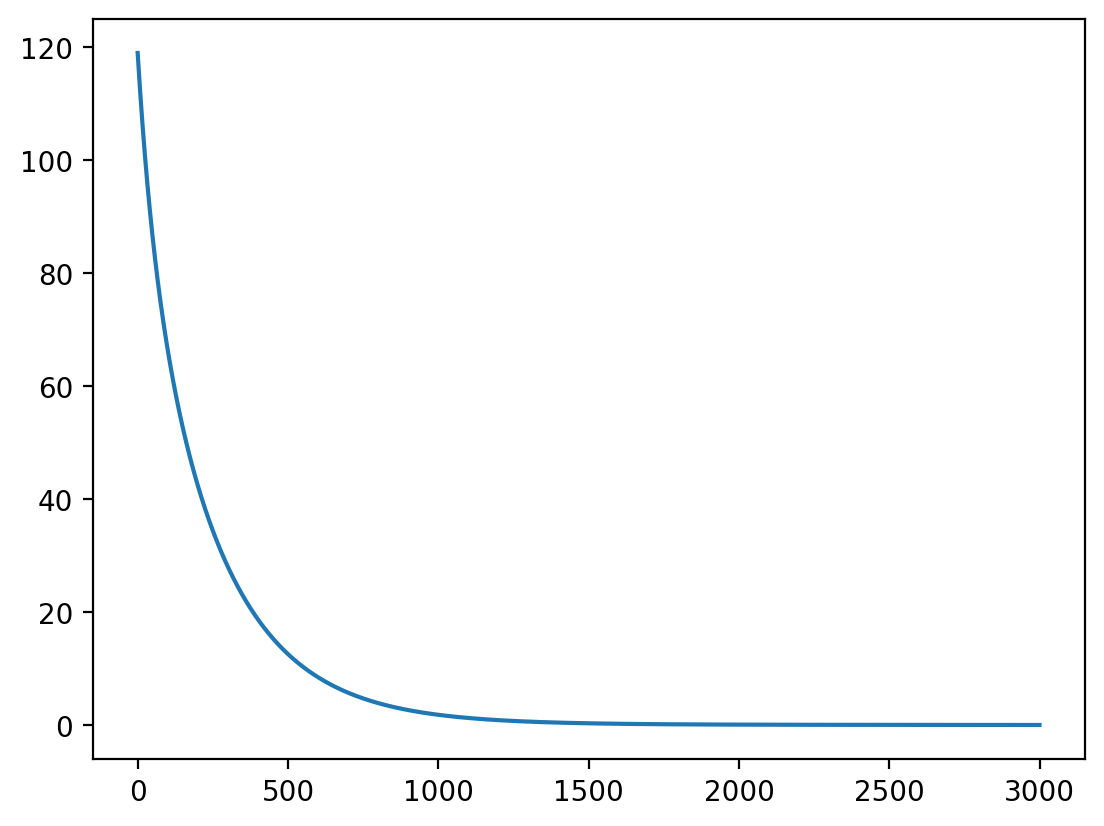

In [42]:
##### Función gradiente descendente ##############
#### Aqui su código
def gradients_matrices(x, y, y_):
    dw = (-2 * x.T @ (y - y_)[:, None]) / len(x)
    db = (-2 * (y - y_)).mean()
    return dw, db

# initial params
w = np.ones([x.shape[1],1])
b = 0
lr = 0.001
steps = 3000
losses = []

def gradient_descent(x, y, w, b, lr, steps):
    # Normalizar los inputs para evitar overflow y convergencia más rápida
    x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)

    for i in range(steps):
        y_ = x @ w + b
        y_ = y_.ravel()
        loss = L(y, y_)
        losses.append(loss)
        dw, db = gradients_matrices(x, y, y_)
        w -= dw*lr
        b -= db*lr

        if (i % 100) == 0:
            print(f"iter={i} / loss = {loss:.4f}")

    # Desnormalizar los coeficientes
    w = w / np.std(x, axis=0)[:, np.newaxis]
    return w, b, losses

w_, b_, losses_ = gradient_descent(x_train.values, y_train.values, w, b, lr, steps)
print(f'w = {w_.ravel()}')
print(f'b = {b_:.4f}')
plt.plot(losses);

### Defina los parámetros que optimizan la regresión lineal de manera que permitan obtener los mejores parámetros W.


In [121]:
def gradient_descent(x, y, w, b, lr, steps):
    # Normalizar los inputs para evitar overflow y convergencia más rápida
    x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
    losses = []
    w_lst = []
    for i in range(steps):
        y_ = x @ w + b
        y_ = y_.ravel()
        loss = L(y, y_)
        losses.append(loss)
        dw, db = gradients_matrices(x, y, y_)
        w -= dw*lr
        b -= db*lr

    # Desnormalizar los coeficientes
    w = w / np.std(x, axis=0)[:, np.newaxis]
    return w, b, losses

In [78]:
d_losess = {}
steps = 5000
for lr in [0.1, 0.01, 0.001]:
    # initial params
    w = np.ones([x.shape[1],1])
    b = 0

    w_, b_, losses_ = gradient_descent(x_train.values, y_train.values, w, b, lr, steps)
    d_losess[f'LR={str(lr)}'] = losses_

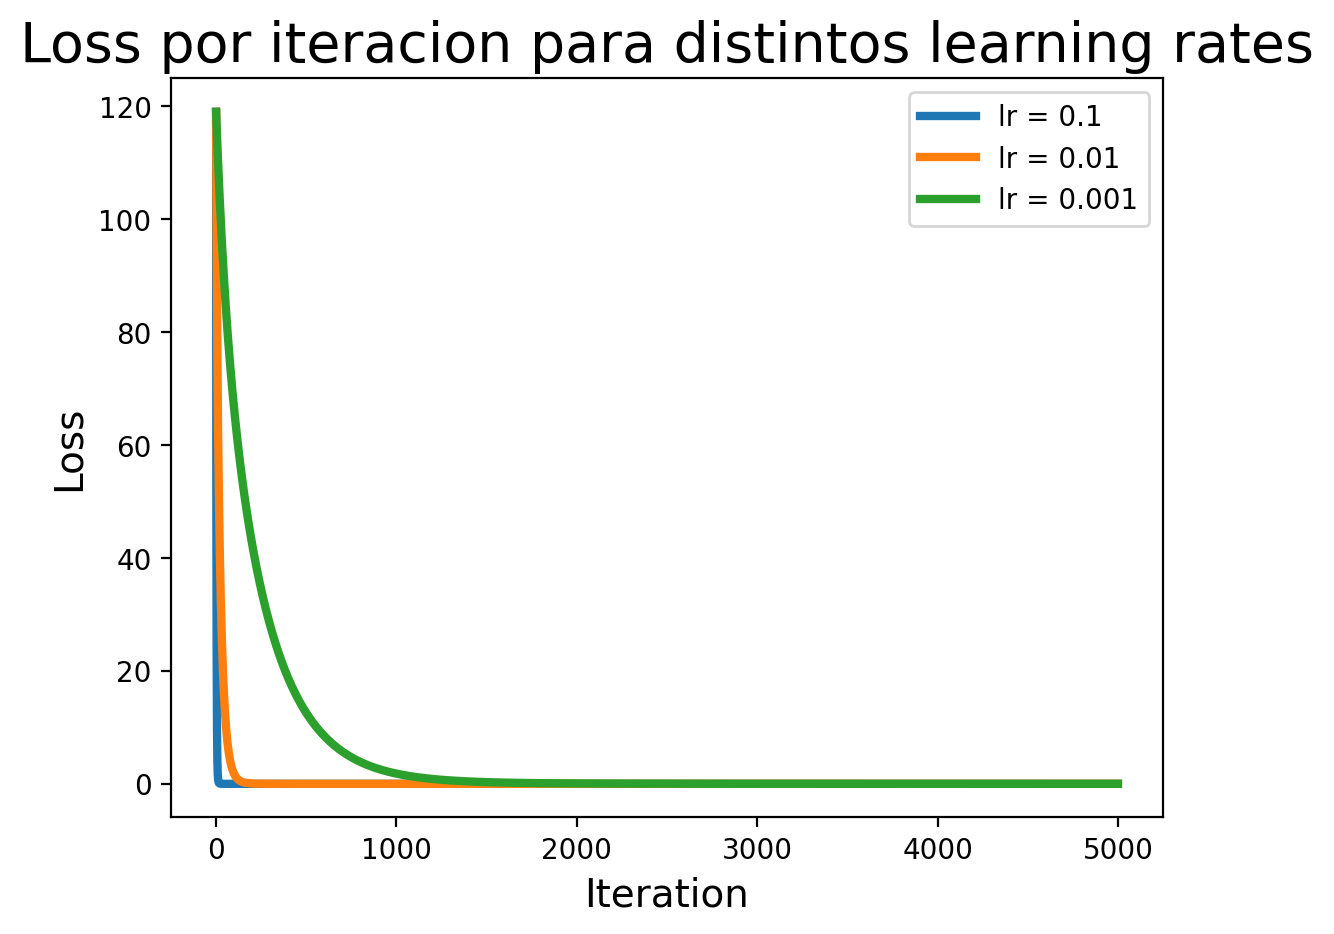

In [80]:
xs = np.arange(steps)
plt.plot(xs, d_losess['LR=0.1'], lw=3, label=f"lr = 0.1")
plt.plot(xs, d_losess['LR=0.01'], lw=3, label=f"lr = 0.01")
plt.plot(xs, d_losess['LR=0.001'], lw=3, label=f"lr = 0.001")

plt.title('Loss por iteracion para distintos learning rates', size=20)
plt.xlabel('Iteration', size=14)
plt.ylabel('Loss', size=14)
plt.legend()
plt.show()

In [114]:
d_losess = {}
steps = 5000
for lr in [0.1, 0.01, 0.001]:
    # initial params
    w = np.zeros([x.shape[1],1])
    b = 0

    w_, b_, losses_ = gradient_descent(x_train.values, y_train.values, w, b, lr, steps)
    d_losess[f'LR={str(lr)}'] = losses_

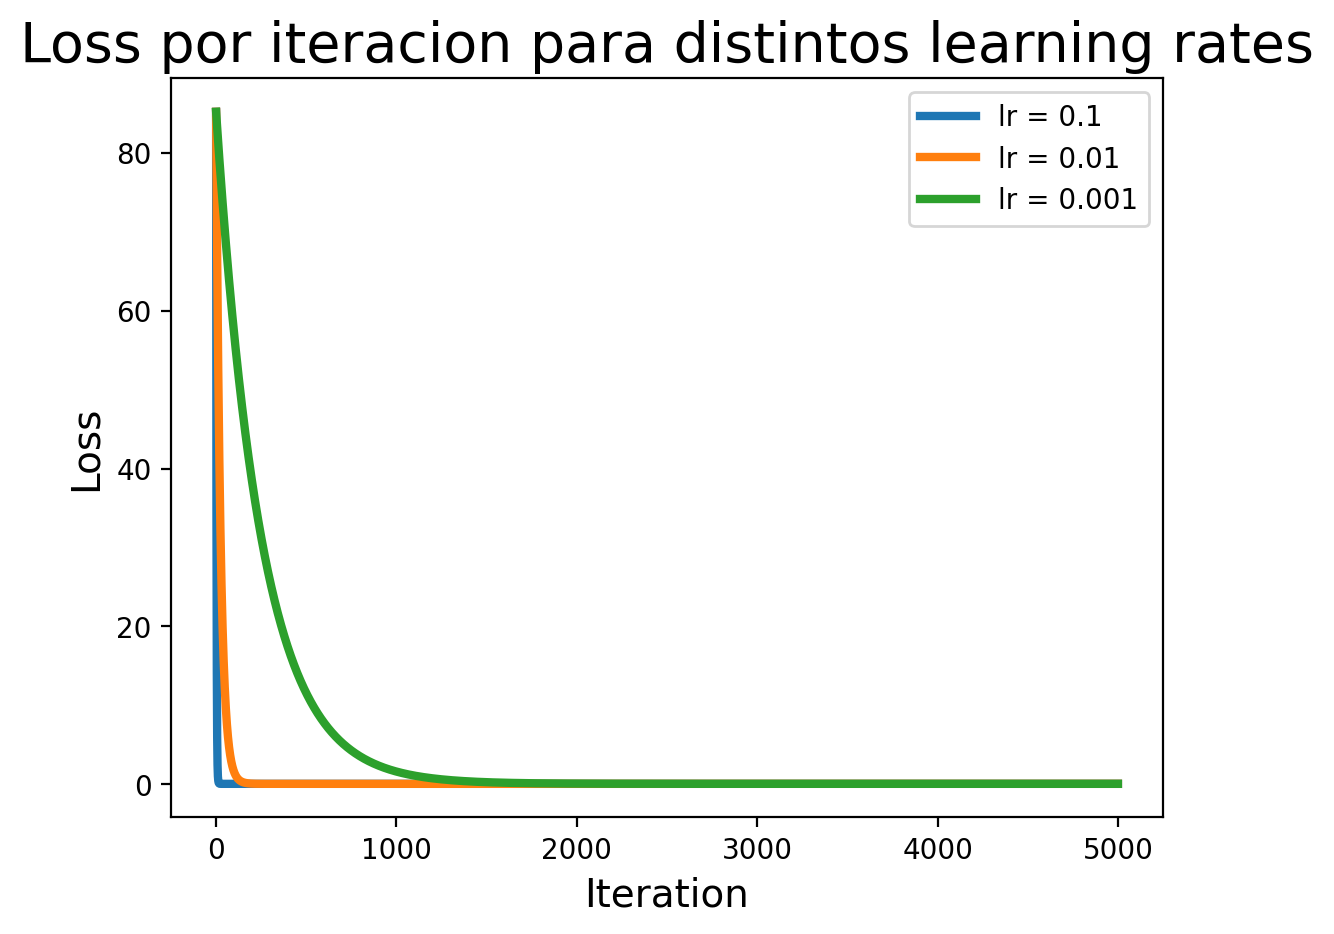

In [115]:
xs = np.arange(steps)
plt.plot(xs, d_losess['LR=0.1'], lw=3, label=f"lr = 0.1")
plt.plot(xs, d_losess['LR=0.01'], lw=3, label=f"lr = 0.01")
plt.plot(xs, d_losess['LR=0.001'], lw=3, label=f"lr = 0.001")

plt.title('Loss por iteracion para distintos learning rates', size=20)
plt.xlabel('Iteration', size=14)
plt.ylabel('Loss', size=14)
plt.legend()
plt.show()

### El mejor valor de w y b es

In [128]:
lr = 0.01
steps = 300000
w = np.zeros([x.shape[1],1])
b = 0
w_, b_, losses_ = gradient_descent(x_train.values, y_train.values, w, b, lr, steps)

print(f"b={b_}")
print(f"w={w_.flatten()}")

b=13.04516522987524
w=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


### Probando el modelo
Encuentre el score del modelo usando el conjunto de entrenamiento (x_train) y el conjunto de prueba (x_val)

In [129]:
for i in w_.flatten():
  print(i)

-0.01071343614758931
0.056337013165045365
0.06572519599935425
0.015275483171547508
0.04117378213035948
0.031753125583074464
0.04694066820658232
0.041239340225642754
0.18350127490172077
0.053730862004601004
0.035296764981007756
-0.10302061744421223
0.01498639039597567
-0.03334547159054837
0.19451588266393058
-0.01907623593474629
0.06695714811836667
-0.005217221097789757
0.1040744291778567
0.29096792311960956
0.004434829536069865
0.021224026075690888
0.0015792236159488382
-0.24608666757565537
0.0009941291352476163
-0.0016256577541177686
0.005158963076901625
0.0028154694454154013
-9.798795247086732e-05
-0.049089423820831694


In [143]:
##### Hallando score del modelo ##############
#### Aqui su código
from sklearn.metrics import r2_score

def score_lr():
    print(f"Score del modelo:")
    print(f"Train      = {r2_score(y_train, x_train @ w_ + b_):.4f}")
    print(f"Validation = {r2_score(y_val  , x_val   @ w_ + b_):.4f}")

score_lr()

Score del modelo:
Train      = -0.0000
Validation = -0.0006


## Comparamos con las funciones del SciKit Learn

###Linear regressión training with SciKit Learn

Entrene el modelo con el modelo de regresión lineal del SciKit Learn

In [26]:
from sklearn.linear_model import LinearRegression

#########
#### aqui su código

# Crear y entrenar el modelo
m = LinearRegression()
m.fit(x_train, y_train)

# Imprimir las variables y su respectivo coeficiente
print(f"Incercepto: {m.intercept_}")
coefficients_df = pd.DataFrame({'Variable': x.columns, 'Coefficient': m.coef_})
coefficients_df['Coefficient'] = coefficients_df['Coefficient'].map('{:.10f}'.format)
coefficients_df

Incercepto: -8.40233332829009


,Variable,Coefficient
0,bedrooms,-0.0115371542
1,bathrooms,0.0735137940
2,sqft_living,0.0000970871
3,sqft_lot,0.0000003969
4,floors,0.0756292783
5,waterfront,0.3762815531
6,view,0.0618101499
7,condition,0.0634679072
8,grade,0.1565918252
9,sqft_above,0.0000411258


In [ ]:
def score():
    print(f'Scores:')
    print(f'Train      = {m.score(x_train, y_train):.4}')
    print(f'Validation = {m.score(x_val, y_val):.4}')

In [ ]:
score()

Scores:
Train      = 0.7732
Validation = 0.7734


### verificamos el Error Cuadrátrico medio tanto para el conjunto de entrenamiento como para el de validación.

In [ ]:
# Veamos el MSE
from sklearn.metrics import mean_squared_error
#########
#### aqui su código
def metrics():
    print(f'Error cuadrático medio (MSE):')
    print(f'Train      = {mean_squared_error(m.predict(x_train), y_train):.4}')
    print(f'Validation = {mean_squared_error(m.predict(x_val), y_val):.4}')

metrics()

Error cuadrático medio (MSE):
Train      = 0.06246
Validation = 0.06458


### Realizamos una selección de características, para ello usamos la función de importancia de características, que nos permite saber qué características son más discriminantes.

###Otorgue una explicación de las variables más discriminantes. Tienen un fundamento lógico?

In [ ]:
imp = pd.DataFrame({'col':x_train.columns, 'importance':m.coef_}).sort_values('importance', ascending=False)
imp.style.bar()

,col,importance
14,lat,1.404497
19,date_Month,0.713560
5,waterfront,0.376282
8,grade,0.156592
4,floors,0.075629
1,bathrooms,0.073514
7,condition,0.063468
6,view,0.061810
26,date_Is_quarter_end,0.050213
27,date_Is_quarter_start,0.023173


###Cree un nuevo conjunto de entrenamiento y uno de prueba, eliminando aquellas características que tienen menos de 0.01 de valor de importancia.

In [ ]:
##### Reducción de dimensionalidad ##############
#### Aqui su código
important_features = imp[imp['importance'] > 0.01]['col'].tolist()
print(important_features)

['lat', 'date_Month', 'waterfront', 'grade', 'floors', 'bathrooms', 'condition', 'view', 'date_Is_quarter_end', 'date_Is_quarter_start', 'date_Day']


###con los nuevos conjuntos de entrenamiento y prueba reducidos, halle el score de  y los respectivos MSE. Compare con los resultados anteriores (data sin reducción de dimensionalidad). Puede usar las funciones de SciKit Learn.

In [ ]:
##### Resultados con datos reducidos en su dimensionalidad ##############
#### Aqui su código
x = df_raw[important_features]
y = df_raw['price']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

print(f'Train shape     : {x_train.shape}')
print(f'Validation shape: {x_val.shape}')

# Crear y entrenar el modelo
m = LinearRegression()
m.fit(x_train, y_train)

print('')
score()

print('')
metrics()

Train shape     : (17290, 11)
Validation shape: (4323, 11)

Scores:
Train      = 0.7044
Validation = 0.713

Error cuadrático medio (MSE):
Train      = 0.08141
Validation = 0.08179


###Otorgue una explicación sobre sus nuevos resultados, comparando los resultados obtenidos y analizando si el usar un número reducido de características no influenció dramáticamente en la predicción. ¿Por qué?

*Comentario: Se puede observar que los resultados son muy parecidos a entrenar con todas las variables. Esto podría indicar que no aportan valor al modelo o tal vez estuvieron muy correlacionadas, por lo que no aportan poder predictivo.*

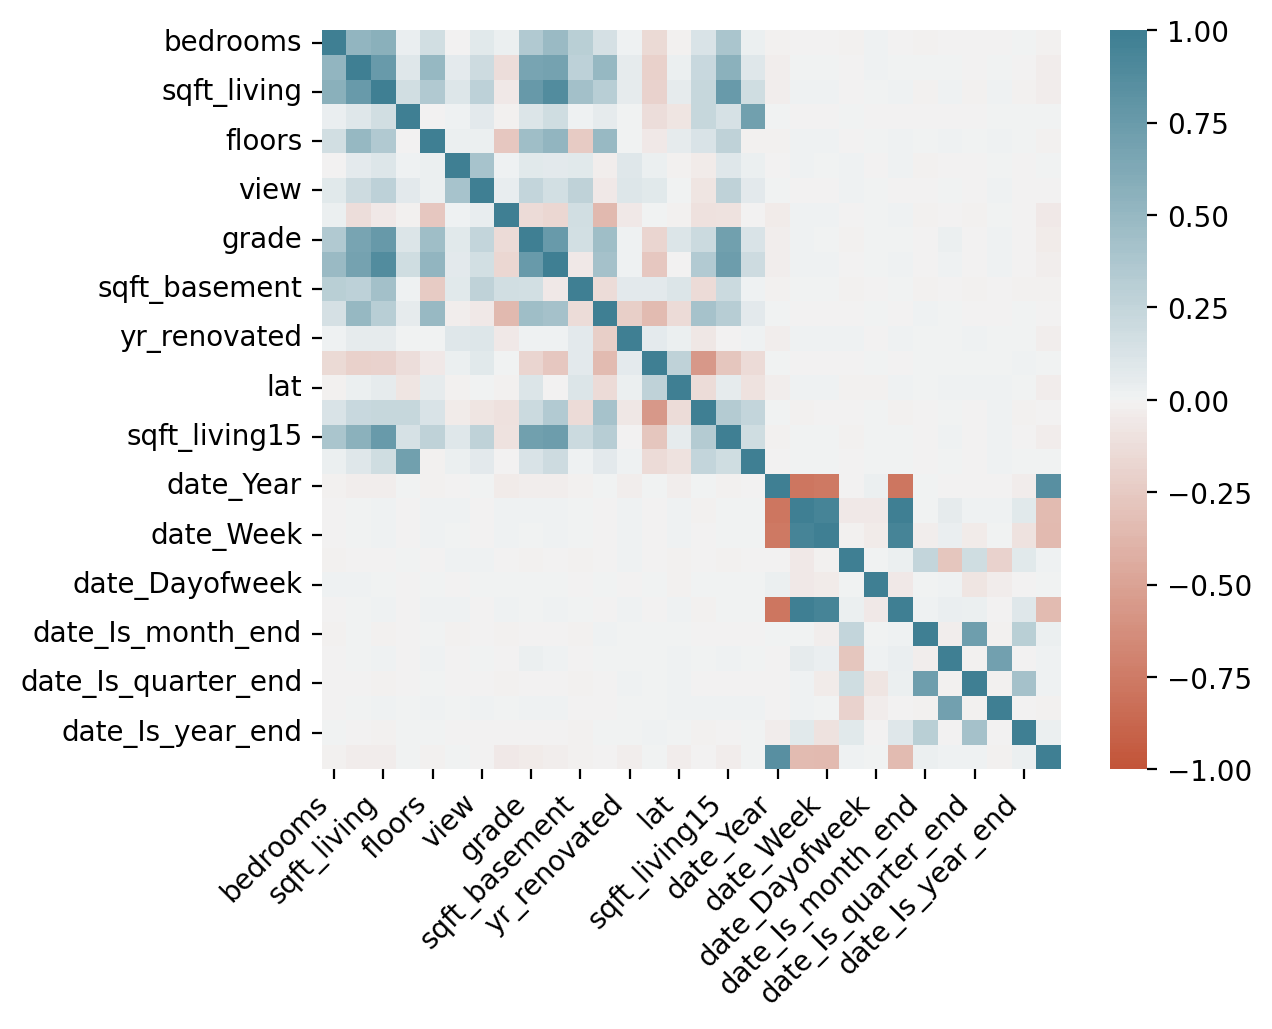

In [133]:
corr = x.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);